In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from segtok import tokenizer
from utils import *
import hickle

In [2]:
# Key Hyperparameters
enable_orig = "orig"
enable_aug = False
enable_aug3 = False
max_training_samples = 200000
max_tokenized_length = 64
num_sentences = 10
valid_percent = 0.01
sentence_pairs = False

batch_size_finetuning = 32
epochs_finetuning = 1
lr_finetuning = 1e-5

batch_size = 128
epochs = 20
main_model_lr = 1e-5

lstm_hidden_size = 1024
regressive_style_finetuning = False
lstm_bidi = False

experiment_id = f"test"

In [3]:
# Parameters
max_training_samples = 200000
enable_orig = "orig"
enable_aug = False
enable_aug3 = False
sentence_pairs = True
regressive_style_finetuning = False
lstm_bidi = False
lstm_hidden_size = 256
epochs = 20
experiment_id = "classification-sentence-embeddings-max_training_samples-200000-enable_orig-orig-enable_aug-False-enable_aug3-False-sentence_pairs-True-regressive_style_finetuning-False-lstm_bidi-False-lstm_hidden_size-256-epochs-20"


In [4]:
import os
experiment_dir = f"completed-experiments/{experiment_id}"
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

In [5]:
from data_parsing import *
data = load_dataset("./yelp_review_training_dataset.jsonl")

In [6]:
from training_utils import split_train_validation
from text_preprocessing import preprocess
import random
from math import ceil

def get_train_valid():
    orig_data_uniform = split_equally(data, ceil(max_training_samples / 0.99))
    orig_train_x, valid_x, orig_train_y, valid_y = split_train_validation(orig_data_uniform, 0.01)
    train_x = []
    train_y = []

    if enable_aug:
        aug_data = load_gen_dataset("./new_data.json") + load_gen_dataset("./new_data2.json")
        train_x += [i[0] for i in aug_data]
        train_y += [i[1] for i in aug_data]

    if enable_aug3:
        aug_data3 = load_gen_dataset("./new_data3.json")
        train_x += [i[0] for i in aug_data3]
        train_y += [i[1] for i in aug_data3]
        
    if enable_orig:
        train_x += orig_train_x
        train_y += orig_train_y
    
    train_x = train_x[:max_training_samples]
    train_y = train_y[:max_training_samples]

    if enable_orig == "preprocess":
        train_x = preprocess(train_x)
        valid_x = preprocess(valid_x)    

    paired_train = list(zip(train_x, train_y))
    random.shuffle(paired_train)
    train_x = [i[0] for i in paired_train]
    train_y = [i[1] for i in paired_train]

    return [x.encode("utf-8") for x in train_x], [x.encode("utf-8") for x in valid_x], train_y, valid_y

split_key = f"cache-core/split-data-{valid_percent}-orig-{enable_orig}-aug12-{enable_aug}-aug3-{enable_aug3}-max-{max_training_samples}"
train_x, valid_x, train_y, valid_y = memo_load(
    get_train_valid,
    split_key
)
split_hash = hash_file(split_key + ".hkl")

train_x = [x.decode("utf-8") for x in train_x]
valid_x = [x.decode("utf-8") for x in valid_x]

print(len(train_x))

189419


In [7]:
print(len(train_x))
print(len(train_y))
print(len(valid_x))
print(len(valid_y))

189419
189419
1914
1914


In [8]:
import torch as th

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

cuda


In [9]:
from transformers import BertTokenizerFast, BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [10]:
# fine tune the BERT
import numpy as np

def get_finetuning_data():
    train_x_numerized = []
    train_x_mask = []
    train_y_per_sentence = []
    for i, text in tqdm(list(enumerate(train_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            train_x_numerized.append(tokenized.ids)
            train_x_mask.append(tokenized.attention_mask)
            train_y_per_sentence.append(train_y[i])

    valid_x_numerized = []
    valid_x_mask = []
    valid_y_per_sentence = []
    for i, text in tqdm(list(enumerate(valid_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            valid_x_numerized.append(tokenized.ids)
            valid_x_mask.append(tokenized.attention_mask)
            valid_y_per_sentence.append(valid_y[i])

    train_x_numerized = np.array(train_x_numerized)
    train_x_mask = np.array(train_x_mask)
    train_y_per_sentence = np.array(train_y_per_sentence)
    valid_x_numerized = np.array(valid_x_numerized)
    valid_x_mask = np.array(valid_x_mask)
    valid_y_per_sentence = np.array(valid_y_per_sentence)
    return train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence

from utils import memo_load
finetuning_data_key = f"cache-core/training-data-finetuning-max-tokens-{max_tokenized_length}-split-{split_hash}"
if sentence_pairs:
    finetuning_data_key += "-pairs"
(train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence) = memo_load(
    lambda: get_finetuning_data(),
    finetuning_data_key
)
finetuning_data_hash = hash_file(finetuning_data_key + ".hkl")

In [11]:
from model import ReviewPredictionModel
import torch.optim as optim

def train_finetuning():
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)

    model_to_train_finetuning = ReviewPredictionModel(0, max_tokenized_length, regressive_bert_style=regressive_style_finetuning)
    model_to_train_finetuning.transformer = embedding_bert
    model_to_train_finetuning.to(device)
    optimizer = optim.Adam(model_to_train_finetuning.parameters(), lr=lr_finetuning)
    
    training_accuracies_finetuning, validation_accuracies_finetuning = run_training_loop(
        model_to_train_finetuning, optimizer, device,
        batch_size_finetuning, epochs_finetuning,
        train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence,
        max_validation_examples=256,
        model_id=experiment_id, tag="finetuning"
    )
    
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

def store_finetuning(tup, folder):
    embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = tup
    th.save(embedding_bert.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{folder}/accuracies.hkl", mode="w")

def load_finetuning(folder):
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)
    embedding_bert.load_state_dict(th.load(f"{folder}/model.pt"))
    embedding_bert.eval()
    embedding_bert.to(device)
    training_accuracies_finetuning, validation_accuracies_finetuning = hickle.load(f"{folder}/accuracies.hkl")
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

In [12]:
from training_utils import run_training_loop

from utils import memo_load
finetuning_model_key = f"cache-core/finetuning-batch-size-{batch_size_finetuning}-epochs-{epochs_finetuning}-lr-{lr_finetuning}-regressive-{regressive_style_finetuning}-data-{finetuning_data_hash}"
embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = manual_memo(
    train_finetuning, store_finetuning, load_finetuning,
    finetuning_model_key
)

th.save(embedding_bert.state_dict(), f"{experiment_dir}/finetuned-bert.pt")
hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{experiment_dir}/finetuning-accuracies.hkl", mode="w")

finetuning_model_hash = hash_file(finetuning_model_key + "/model.pt")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


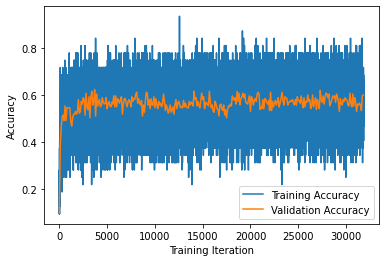

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies_finetuning)), training_accuracies_finetuning, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies_finetuning)))), validation_accuracies_finetuning, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()

In [14]:
import torch as th
import numpy as np

embedding_bert.to(device)

def get_embeds(x_data):
    concatted_shape = None
    pad_value = None
    embeds = []
    for text in tqdm(x_data):
        doc = nlp(text)
        embeddeds = []
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        all_tokenized = []
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            all_tokenized.append(tokenized.ids)
        
        with th.no_grad():
            sentence_tensor = th.tensor(all_tokenized).to(device)
            concatted = np.concatenate([
                # take output corresponding to CLS
                embedding_bert.bert(sentence_tensor, output_hidden_states=True, return_dict=True)[1].cpu().numpy(),
                np.zeros((len(all_tokenized), 1))
            ], axis=1)
            
            if not concatted_shape:
                concatted_shape = concatted.shape
                pad_value = np.zeros(concatted_shape[1])
                pad_value[-1] = 1
            
            embeddeds += list(concatted)

        if len(sents) < num_sentences:
            embeddeds += [pad_value] * (num_sentences - len(sents))

        embeds.append(embeddeds)
    return np.array(embeds)

main_data_key = f"cache-core/training-data-main-max-tokens-{max_tokenized_length}-split-{split_hash}-finetuned-{finetuning_model_hash}"
train_x_embeds, valid_x_embeds = memo_load(
    lambda: (
        get_embeds(train_x),
        get_embeds(valid_x)
    ),
    main_data_key
)
main_data_hash = hash_file(main_data_key + ".hkl")

In [15]:
from model_sentence_lstm import ReviewPredictionModel
import torch as th
import torch.optim as optim

def train_main():
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size, bidi_lstm=lstm_bidi)
    model_to_train.to(device)
    optimizer = optim.Adam(model_to_train.parameters(), lr=main_model_lr)
    
    training_accuracies, validation_accuracies = run_training_loop(
        model_to_train, optimizer, device,
        batch_size, epochs,
        train_x_embeds, None, np.array(train_y), valid_x_embeds, None, np.array(valid_y),
        model_id=experiment_id, max_validation_examples=512
    )
    
    return model_to_train, training_accuracies, validation_accuracies

def store_main(tup, folder):
    model_to_train, training_accuracies, validation_accuracies = tup
    th.save(model_to_train.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies, validation_accuracies), f"{folder}/accuracies.hkl", mode="w")

def load_main(folder):
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.load_state_dict(th.load(f"{folder}/model.pt"))
    model_to_train.eval()
    model_to_train.to(device)
    training_accuracies, validation_accuracies = hickle.load(f"{folder}/accuracies.hkl")
    return model_to_train, training_accuracies, validation_accuracies

In [16]:
from training_utils import run_training_loop

bidi_key = "-bidi" if lstm_bidi else ""
main_model_key = f"cache-core/main-model-lstm-{lstm_hidden_size}{bidi_key}-lr-{main_model_lr}-batch-size-{batch_size}-epochs-{epochs}-data-{main_data_hash}"
main_model, training_accuracies, validation_accuracies = manual_memo(
    train_main, store_main, load_main,
    main_model_key
)

th.save(main_model.state_dict(), f"{experiment_dir}/main-model.pt")
hickle.dump((training_accuracies, validation_accuracies), f"{experiment_dir}/main-accuracies.hkl", mode="w")

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 2.196 Validation Loss: 2.200 Accuracy: 0.062 Validation Accuracy: 0.055:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 1 Loss: 2.199 Validation Loss: 2.200 Accuracy: 0.055 Validation Accuracy: 0.055:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 2 Loss: 2.197 Validation Loss: 2.200 Accuracy: 0.060 Validation Accuracy: 0.055:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 3 Loss: 2.199 Validation Loss: 2.200 Accuracy: 0.072 Validation Accuracy: 0.055:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 4 Loss: 2.199 Validation Loss: 2.200 Accuracy: 0.072 Validation Accuracy: 0.055:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 5 Loss: 2.200 Validation Loss: 2.200 Accuracy: 0.068 Validation Accuracy: 0.055:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 6 Loss: 2.199 Validation Loss: 2.200 Accuracy: 0.066 Validation Accuracy: 0.055:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 7 Loss: 2.199 Validation Loss: 2.200 Accuracy: 0.065 Validation Accuracy: 0.055:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 8 Loss: 2.199 Validation Loss: 2.200 Accuracy: 0.062 Validation Accuracy: 0.055:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 9 Loss: 2.200 Validation Loss: 2.200 Accuracy: 0.059 Validation Accuracy: 0.055:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 10 Loss: 2.199 Validation Loss: 2.200 Accuracy: 0.059 Validation Accuracy: 0.055:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 11 Loss: 2.198 Validation Loss: 2.200 Accuracy: 0.060 Validation Accuracy: 0.055:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 12 Loss: 2.197 Validation Loss: 2.200 Accuracy: 0.061 Validation Accuracy: 0.055:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 13 Loss: 2.197 Validation Loss: 2.200 Accuracy: 0.059 Validation Accuracy: 0.055:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 14 Loss: 2.196 Validation Loss: 2.200 Accuracy: 0.059 Validation Accuracy: 0.055:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 15 Loss: 2.195 Validation Loss: 2.200 Accuracy: 0.059 Validation Accuracy: 0.055:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 16 Loss: 2.195 Validation Loss: 2.200 Accuracy: 0.062 Validation Accuracy: 0.055:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 17 Loss: 2.194 Validation Loss: 2.200 Accuracy: 0.072 Validation Accuracy: 0.055:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 18 Loss: 2.193 Validation Loss: 2.200 Accuracy: 0.078 Validation Accuracy: 0.055:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 19 Loss: 2.193 Validation Loss: 2.200 Accuracy: 0.088 Validation Accuracy: 0.055:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 20 Loss: 2.192 Validation Loss: 2.200 Accuracy: 0.094 Validation Accuracy: 0.055:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 20 Loss: 2.192 Validation Loss: 2.200 Accuracy: 0.094 Validation Accuracy: 0.055:   1%|▏         | 21/1480 [00:00<00:07, 206.92it/s]

Epoch: 0 Iteration: 21 Loss: 2.191 Validation Loss: 2.200 Accuracy: 0.104 Validation Accuracy: 0.055:   1%|▏         | 21/1480 [00:00<00:07, 206.92it/s]

Epoch: 0 Iteration: 22 Loss: 2.190 Validation Loss: 2.200 Accuracy: 0.109 Validation Accuracy: 0.055:   1%|▏         | 21/1480 [00:00<00:07, 206.92it/s]

Epoch: 0 Iteration: 23 Loss: 2.189 Validation Loss: 2.200 Accuracy: 0.111 Validation Accuracy: 0.055:   1%|▏         | 21/1480 [00:00<00:07, 206.92it/s]

Epoch: 0 Iteration: 24 Loss: 2.188 Validation Loss: 2.200 Accuracy: 0.122 Validation Accuracy: 0.055:   1%|▏         | 21/1480 [00:00<00:07, 206.92it/s]

Epoch: 0 Iteration: 25 Loss: 2.186 Validation Loss: 2.200 Accuracy: 0.141 Validation Accuracy: 0.055:   1%|▏         | 21/1480 [00:00<00:07, 206.92it/s]

Epoch: 0 Iteration: 26 Loss: 2.185 Validation Loss: 2.200 Accuracy: 0.148 Validation Accuracy: 0.055:   1%|▏         | 21/1480 [00:00<00:07, 206.92it/s]

Epoch: 0 Iteration: 27 Loss: 2.184 Validation Loss: 2.200 Accuracy: 0.153 Validation Accuracy: 0.055:   1%|▏         | 21/1480 [00:00<00:07, 206.92it/s]

Epoch: 0 Iteration: 28 Loss: 2.182 Validation Loss: 2.200 Accuracy: 0.165 Validation Accuracy: 0.055:   1%|▏         | 21/1480 [00:00<00:07, 206.92it/s]

Epoch: 0 Iteration: 29 Loss: 2.180 Validation Loss: 2.200 Accuracy: 0.168 Validation Accuracy: 0.055:   1%|▏         | 21/1480 [00:00<00:07, 206.92it/s]

Epoch: 0 Iteration: 30 Loss: 2.179 Validation Loss: 2.200 Accuracy: 0.172 Validation Accuracy: 0.055:   1%|▏         | 21/1480 [00:00<00:07, 206.92it/s]

Epoch: 0 Iteration: 31 Loss: 2.178 Validation Loss: 2.200 Accuracy: 0.179 Validation Accuracy: 0.055:   1%|▏         | 21/1480 [00:00<00:07, 206.92it/s]

Epoch: 0 Iteration: 32 Loss: 2.177 Validation Loss: 2.200 Accuracy: 0.183 Validation Accuracy: 0.055:   1%|▏         | 21/1480 [00:00<00:07, 206.92it/s]

Epoch: 0 Iteration: 33 Loss: 2.176 Validation Loss: 2.200 Accuracy: 0.188 Validation Accuracy: 0.055:   1%|▏         | 21/1480 [00:00<00:07, 206.92it/s]

Epoch: 0 Iteration: 34 Loss: 2.176 Validation Loss: 2.200 Accuracy: 0.188 Validation Accuracy: 0.055:   1%|▏         | 21/1480 [00:00<00:07, 206.92it/s]

Epoch: 0 Iteration: 35 Loss: 2.175 Validation Loss: 2.200 Accuracy: 0.183 Validation Accuracy: 0.055:   1%|▏         | 21/1480 [00:00<00:07, 206.92it/s]

Epoch: 0 Iteration: 36 Loss: 2.173 Validation Loss: 2.200 Accuracy: 0.184 Validation Accuracy: 0.055:   1%|▏         | 21/1480 [00:00<00:07, 206.92it/s]

Epoch: 0 Iteration: 37 Loss: 2.172 Validation Loss: 2.200 Accuracy: 0.180 Validation Accuracy: 0.055:   1%|▏         | 21/1480 [00:00<00:07, 206.92it/s]

Epoch: 0 Iteration: 38 Loss: 2.171 Validation Loss: 2.200 Accuracy: 0.181 Validation Accuracy: 0.055:   1%|▏         | 21/1480 [00:00<00:07, 206.92it/s]

Epoch: 0 Iteration: 39 Loss: 2.170 Validation Loss: 2.200 Accuracy: 0.184 Validation Accuracy: 0.055:   1%|▏         | 21/1480 [00:00<00:07, 206.92it/s]

Epoch: 0 Iteration: 40 Loss: 2.169 Validation Loss: 2.200 Accuracy: 0.197 Validation Accuracy: 0.055:   1%|▏         | 21/1480 [00:00<00:07, 206.92it/s]

Epoch: 0 Iteration: 41 Loss: 2.168 Validation Loss: 2.200 Accuracy: 0.195 Validation Accuracy: 0.055:   1%|▏         | 21/1480 [00:00<00:07, 206.92it/s]

Epoch: 0 Iteration: 42 Loss: 2.165 Validation Loss: 2.200 Accuracy: 0.209 Validation Accuracy: 0.055:   1%|▏         | 21/1480 [00:00<00:07, 206.92it/s]

Epoch: 0 Iteration: 43 Loss: 2.163 Validation Loss: 2.200 Accuracy: 0.210 Validation Accuracy: 0.055:   1%|▏         | 21/1480 [00:00<00:07, 206.92it/s]

Epoch: 0 Iteration: 43 Loss: 2.163 Validation Loss: 2.200 Accuracy: 0.210 Validation Accuracy: 0.055:   3%|▎         | 44/1480 [00:00<00:06, 216.79it/s]

Epoch: 0 Iteration: 44 Loss: 2.162 Validation Loss: 2.200 Accuracy: 0.216 Validation Accuracy: 0.055:   3%|▎         | 44/1480 [00:00<00:06, 216.79it/s]

Epoch: 0 Iteration: 45 Loss: 2.161 Validation Loss: 2.200 Accuracy: 0.220 Validation Accuracy: 0.055:   3%|▎         | 44/1480 [00:00<00:06, 216.79it/s]

Epoch: 0 Iteration: 46 Loss: 2.159 Validation Loss: 2.200 Accuracy: 0.230 Validation Accuracy: 0.055:   3%|▎         | 44/1480 [00:00<00:06, 216.79it/s]

Epoch: 0 Iteration: 47 Loss: 2.159 Validation Loss: 2.200 Accuracy: 0.234 Validation Accuracy: 0.055:   3%|▎         | 44/1480 [00:00<00:06, 216.79it/s]

Epoch: 0 Iteration: 48 Loss: 2.158 Validation Loss: 2.200 Accuracy: 0.236 Validation Accuracy: 0.055:   3%|▎         | 44/1480 [00:00<00:06, 216.79it/s]

Epoch: 0 Iteration: 49 Loss: 2.156 Validation Loss: 2.200 Accuracy: 0.245 Validation Accuracy: 0.055:   3%|▎         | 44/1480 [00:00<00:06, 216.79it/s]

Epoch: 0 Iteration: 50 Loss: 2.155 Validation Loss: 2.200 Accuracy: 0.247 Validation Accuracy: 0.055:   3%|▎         | 44/1480 [00:00<00:06, 216.79it/s]

Epoch: 0 Iteration: 51 Loss: 2.154 Validation Loss: 2.200 Accuracy: 0.258 Validation Accuracy: 0.055:   3%|▎         | 44/1480 [00:00<00:06, 216.79it/s]

Epoch: 0 Iteration: 52 Loss: 2.153 Validation Loss: 2.200 Accuracy: 0.245 Validation Accuracy: 0.055:   3%|▎         | 44/1480 [00:00<00:06, 216.79it/s]

Epoch: 0 Iteration: 53 Loss: 2.151 Validation Loss: 2.200 Accuracy: 0.255 Validation Accuracy: 0.055:   3%|▎         | 44/1480 [00:00<00:06, 216.79it/s]

Epoch: 0 Iteration: 54 Loss: 2.150 Validation Loss: 2.200 Accuracy: 0.258 Validation Accuracy: 0.055:   3%|▎         | 44/1480 [00:00<00:06, 216.79it/s]

Epoch: 0 Iteration: 55 Loss: 2.148 Validation Loss: 2.200 Accuracy: 0.258 Validation Accuracy: 0.055:   3%|▎         | 44/1480 [00:00<00:06, 216.79it/s]

Epoch: 0 Iteration: 56 Loss: 2.147 Validation Loss: 2.200 Accuracy: 0.256 Validation Accuracy: 0.055:   3%|▎         | 44/1480 [00:00<00:06, 216.79it/s]

Epoch: 0 Iteration: 57 Loss: 2.147 Validation Loss: 2.200 Accuracy: 0.257 Validation Accuracy: 0.055:   3%|▎         | 44/1480 [00:00<00:06, 216.79it/s]

Epoch: 0 Iteration: 58 Loss: 2.146 Validation Loss: 2.200 Accuracy: 0.255 Validation Accuracy: 0.055:   3%|▎         | 44/1480 [00:00<00:06, 216.79it/s]

Epoch: 0 Iteration: 59 Loss: 2.145 Validation Loss: 2.200 Accuracy: 0.249 Validation Accuracy: 0.055:   3%|▎         | 44/1480 [00:00<00:06, 216.79it/s]

Epoch: 0 Iteration: 60 Loss: 2.144 Validation Loss: 2.200 Accuracy: 0.244 Validation Accuracy: 0.055:   3%|▎         | 44/1480 [00:00<00:06, 216.79it/s]

Epoch: 0 Iteration: 61 Loss: 2.143 Validation Loss: 2.200 Accuracy: 0.242 Validation Accuracy: 0.055:   3%|▎         | 44/1480 [00:00<00:06, 216.79it/s]

Epoch: 0 Iteration: 62 Loss: 2.144 Validation Loss: 2.200 Accuracy: 0.250 Validation Accuracy: 0.055:   3%|▎         | 44/1480 [00:00<00:06, 216.79it/s]

Epoch: 0 Iteration: 63 Loss: 2.143 Validation Loss: 2.200 Accuracy: 0.252 Validation Accuracy: 0.055:   3%|▎         | 44/1480 [00:00<00:06, 216.79it/s]

Epoch: 0 Iteration: 64 Loss: 2.143 Validation Loss: 2.200 Accuracy: 0.254 Validation Accuracy: 0.055:   3%|▎         | 44/1480 [00:00<00:06, 216.79it/s]

Epoch: 0 Iteration: 65 Loss: 2.141 Validation Loss: 2.200 Accuracy: 0.261 Validation Accuracy: 0.055:   3%|▎         | 44/1480 [00:00<00:06, 216.79it/s]

Epoch: 0 Iteration: 65 Loss: 2.141 Validation Loss: 2.200 Accuracy: 0.261 Validation Accuracy: 0.055:   4%|▍         | 66/1480 [00:00<00:06, 217.37it/s]

Epoch: 0 Iteration: 66 Loss: 2.140 Validation Loss: 2.200 Accuracy: 0.264 Validation Accuracy: 0.055:   4%|▍         | 66/1480 [00:00<00:06, 217.37it/s]

Epoch: 0 Iteration: 67 Loss: 2.139 Validation Loss: 2.200 Accuracy: 0.270 Validation Accuracy: 0.055:   4%|▍         | 66/1480 [00:00<00:06, 217.37it/s]

Epoch: 0 Iteration: 68 Loss: 2.138 Validation Loss: 2.200 Accuracy: 0.276 Validation Accuracy: 0.055:   4%|▍         | 66/1480 [00:00<00:06, 217.37it/s]

Epoch: 0 Iteration: 69 Loss: 2.137 Validation Loss: 2.200 Accuracy: 0.287 Validation Accuracy: 0.055:   4%|▍         | 66/1480 [00:00<00:06, 217.37it/s]

Epoch: 0 Iteration: 70 Loss: 2.138 Validation Loss: 2.200 Accuracy: 0.290 Validation Accuracy: 0.055:   4%|▍         | 66/1480 [00:00<00:06, 217.37it/s]

Epoch: 0 Iteration: 71 Loss: 2.136 Validation Loss: 2.200 Accuracy: 0.291 Validation Accuracy: 0.055:   4%|▍         | 66/1480 [00:00<00:06, 217.37it/s]

Epoch: 0 Iteration: 72 Loss: 2.135 Validation Loss: 2.200 Accuracy: 0.297 Validation Accuracy: 0.055:   4%|▍         | 66/1480 [00:00<00:06, 217.37it/s]

Epoch: 0 Iteration: 73 Loss: 2.133 Validation Loss: 2.200 Accuracy: 0.302 Validation Accuracy: 0.055:   4%|▍         | 66/1480 [00:00<00:06, 217.37it/s]

Epoch: 0 Iteration: 74 Loss: 2.132 Validation Loss: 2.200 Accuracy: 0.309 Validation Accuracy: 0.055:   4%|▍         | 66/1480 [00:00<00:06, 217.37it/s]

Epoch: 0 Iteration: 75 Loss: 2.132 Validation Loss: 2.200 Accuracy: 0.305 Validation Accuracy: 0.055:   4%|▍         | 66/1480 [00:00<00:06, 217.37it/s]

Epoch: 0 Iteration: 76 Loss: 2.131 Validation Loss: 2.200 Accuracy: 0.306 Validation Accuracy: 0.055:   4%|▍         | 66/1480 [00:00<00:06, 217.37it/s]

Epoch: 0 Iteration: 77 Loss: 2.130 Validation Loss: 2.200 Accuracy: 0.304 Validation Accuracy: 0.055:   4%|▍         | 66/1480 [00:00<00:06, 217.37it/s]

Epoch: 0 Iteration: 78 Loss: 2.128 Validation Loss: 2.200 Accuracy: 0.309 Validation Accuracy: 0.055:   4%|▍         | 66/1480 [00:00<00:06, 217.37it/s]

Epoch: 0 Iteration: 79 Loss: 2.127 Validation Loss: 2.200 Accuracy: 0.304 Validation Accuracy: 0.055:   4%|▍         | 66/1480 [00:00<00:06, 217.37it/s]

Epoch: 0 Iteration: 80 Loss: 2.125 Validation Loss: 2.200 Accuracy: 0.309 Validation Accuracy: 0.055:   4%|▍         | 66/1480 [00:00<00:06, 217.37it/s]

Epoch: 0 Iteration: 81 Loss: 2.125 Validation Loss: 2.200 Accuracy: 0.309 Validation Accuracy: 0.055:   4%|▍         | 66/1480 [00:00<00:06, 217.37it/s]

Epoch: 0 Iteration: 82 Loss: 2.123 Validation Loss: 2.200 Accuracy: 0.309 Validation Accuracy: 0.055:   4%|▍         | 66/1480 [00:00<00:06, 217.37it/s]

Epoch: 0 Iteration: 83 Loss: 2.122 Validation Loss: 2.200 Accuracy: 0.302 Validation Accuracy: 0.055:   4%|▍         | 66/1480 [00:00<00:06, 217.37it/s]

Epoch: 0 Iteration: 84 Loss: 2.120 Validation Loss: 2.200 Accuracy: 0.299 Validation Accuracy: 0.055:   4%|▍         | 66/1480 [00:00<00:06, 217.37it/s]

Epoch: 0 Iteration: 85 Loss: 2.119 Validation Loss: 2.200 Accuracy: 0.310 Validation Accuracy: 0.055:   4%|▍         | 66/1480 [00:00<00:06, 217.37it/s]

Epoch: 0 Iteration: 86 Loss: 2.118 Validation Loss: 2.200 Accuracy: 0.314 Validation Accuracy: 0.055:   4%|▍         | 66/1480 [00:00<00:06, 217.37it/s]

Epoch: 0 Iteration: 87 Loss: 2.116 Validation Loss: 2.200 Accuracy: 0.322 Validation Accuracy: 0.055:   4%|▍         | 66/1480 [00:00<00:06, 217.37it/s]

Epoch: 0 Iteration: 88 Loss: 2.115 Validation Loss: 2.200 Accuracy: 0.328 Validation Accuracy: 0.055:   4%|▍         | 66/1480 [00:00<00:06, 217.37it/s]

Epoch: 0 Iteration: 88 Loss: 2.115 Validation Loss: 2.200 Accuracy: 0.328 Validation Accuracy: 0.055:   6%|▌         | 89/1480 [00:00<00:06, 220.46it/s]

Epoch: 0 Iteration: 89 Loss: 2.115 Validation Loss: 2.200 Accuracy: 0.331 Validation Accuracy: 0.055:   6%|▌         | 89/1480 [00:00<00:06, 220.46it/s]

Epoch: 0 Iteration: 90 Loss: 2.113 Validation Loss: 2.200 Accuracy: 0.332 Validation Accuracy: 0.055:   6%|▌         | 89/1480 [00:00<00:06, 220.46it/s]

Epoch: 0 Iteration: 91 Loss: 2.112 Validation Loss: 2.200 Accuracy: 0.329 Validation Accuracy: 0.055:   6%|▌         | 89/1480 [00:00<00:06, 220.46it/s]

Epoch: 0 Iteration: 92 Loss: 2.108 Validation Loss: 2.200 Accuracy: 0.342 Validation Accuracy: 0.055:   6%|▌         | 89/1480 [00:00<00:06, 220.46it/s]

Epoch: 0 Iteration: 93 Loss: 2.107 Validation Loss: 2.200 Accuracy: 0.351 Validation Accuracy: 0.055:   6%|▌         | 89/1480 [00:00<00:06, 220.46it/s]

Epoch: 0 Iteration: 94 Loss: 2.106 Validation Loss: 2.200 Accuracy: 0.351 Validation Accuracy: 0.055:   6%|▌         | 89/1480 [00:00<00:06, 220.46it/s]

Epoch: 0 Iteration: 95 Loss: 2.105 Validation Loss: 2.200 Accuracy: 0.343 Validation Accuracy: 0.055:   6%|▌         | 89/1480 [00:00<00:06, 220.46it/s]

Epoch: 0 Iteration: 96 Loss: 2.104 Validation Loss: 2.200 Accuracy: 0.340 Validation Accuracy: 0.055:   6%|▌         | 89/1480 [00:00<00:06, 220.46it/s]

Epoch: 0 Iteration: 97 Loss: 2.101 Validation Loss: 2.200 Accuracy: 0.341 Validation Accuracy: 0.055:   6%|▌         | 89/1480 [00:00<00:06, 220.46it/s]

Epoch: 0 Iteration: 98 Loss: 2.101 Validation Loss: 2.200 Accuracy: 0.338 Validation Accuracy: 0.055:   6%|▌         | 89/1480 [00:00<00:06, 220.46it/s]

Epoch: 0 Iteration: 99 Loss: 2.098 Validation Loss: 2.200 Accuracy: 0.345 Validation Accuracy: 0.055:   6%|▌         | 89/1480 [00:00<00:06, 220.46it/s]

Epoch: 0 Iteration: 100 Loss: 2.095 Validation Loss: 2.069 Accuracy: 0.352 Validation Accuracy: 0.198:   6%|▌         | 89/1480 [00:00<00:06, 220.46it/s]

Epoch: 0 Iteration: 101 Loss: 2.092 Validation Loss: 2.069 Accuracy: 0.362 Validation Accuracy: 0.198:   6%|▌         | 89/1480 [00:00<00:06, 220.46it/s]

Epoch: 0 Iteration: 102 Loss: 2.091 Validation Loss: 2.069 Accuracy: 0.352 Validation Accuracy: 0.198:   6%|▌         | 89/1480 [00:00<00:06, 220.46it/s]

Epoch: 0 Iteration: 103 Loss: 2.088 Validation Loss: 2.069 Accuracy: 0.355 Validation Accuracy: 0.198:   6%|▌         | 89/1480 [00:00<00:06, 220.46it/s]

Epoch: 0 Iteration: 104 Loss: 2.089 Validation Loss: 2.069 Accuracy: 0.352 Validation Accuracy: 0.198:   6%|▌         | 89/1480 [00:00<00:06, 220.46it/s]

Epoch: 0 Iteration: 105 Loss: 2.088 Validation Loss: 2.069 Accuracy: 0.347 Validation Accuracy: 0.198:   6%|▌         | 89/1480 [00:00<00:06, 220.46it/s]

Epoch: 0 Iteration: 106 Loss: 2.088 Validation Loss: 2.069 Accuracy: 0.347 Validation Accuracy: 0.198:   6%|▌         | 89/1480 [00:00<00:06, 220.46it/s]

Epoch: 0 Iteration: 107 Loss: 2.086 Validation Loss: 2.069 Accuracy: 0.346 Validation Accuracy: 0.198:   6%|▌         | 89/1480 [00:00<00:06, 220.46it/s]

Epoch: 0 Iteration: 108 Loss: 2.085 Validation Loss: 2.069 Accuracy: 0.341 Validation Accuracy: 0.198:   6%|▌         | 89/1480 [00:00<00:06, 220.46it/s]

Epoch: 0 Iteration: 109 Loss: 2.083 Validation Loss: 2.069 Accuracy: 0.339 Validation Accuracy: 0.198:   6%|▌         | 89/1480 [00:00<00:06, 220.46it/s]

Epoch: 0 Iteration: 110 Loss: 2.082 Validation Loss: 2.069 Accuracy: 0.325 Validation Accuracy: 0.198:   6%|▌         | 89/1480 [00:00<00:06, 220.46it/s]

Epoch: 0 Iteration: 111 Loss: 2.081 Validation Loss: 2.069 Accuracy: 0.321 Validation Accuracy: 0.198:   6%|▌         | 89/1480 [00:00<00:06, 220.46it/s]

Epoch: 0 Iteration: 111 Loss: 2.081 Validation Loss: 2.069 Accuracy: 0.321 Validation Accuracy: 0.198:   8%|▊         | 112/1480 [00:00<00:06, 218.26it/s]

Epoch: 0 Iteration: 112 Loss: 2.080 Validation Loss: 2.069 Accuracy: 0.326 Validation Accuracy: 0.198:   8%|▊         | 112/1480 [00:00<00:06, 218.26it/s]

Epoch: 0 Iteration: 113 Loss: 2.080 Validation Loss: 2.069 Accuracy: 0.323 Validation Accuracy: 0.198:   8%|▊         | 112/1480 [00:00<00:06, 218.26it/s]

Epoch: 0 Iteration: 114 Loss: 2.079 Validation Loss: 2.069 Accuracy: 0.327 Validation Accuracy: 0.198:   8%|▊         | 112/1480 [00:00<00:06, 218.26it/s]

Epoch: 0 Iteration: 115 Loss: 2.076 Validation Loss: 2.069 Accuracy: 0.341 Validation Accuracy: 0.198:   8%|▊         | 112/1480 [00:00<00:06, 218.26it/s]

Epoch: 0 Iteration: 116 Loss: 2.075 Validation Loss: 2.069 Accuracy: 0.342 Validation Accuracy: 0.198:   8%|▊         | 112/1480 [00:00<00:06, 218.26it/s]

Epoch: 0 Iteration: 117 Loss: 2.074 Validation Loss: 2.069 Accuracy: 0.345 Validation Accuracy: 0.198:   8%|▊         | 112/1480 [00:00<00:06, 218.26it/s]

Epoch: 0 Iteration: 118 Loss: 2.073 Validation Loss: 2.069 Accuracy: 0.339 Validation Accuracy: 0.198:   8%|▊         | 112/1480 [00:00<00:06, 218.26it/s]

Epoch: 0 Iteration: 119 Loss: 2.074 Validation Loss: 2.069 Accuracy: 0.341 Validation Accuracy: 0.198:   8%|▊         | 112/1480 [00:00<00:06, 218.26it/s]

Epoch: 0 Iteration: 120 Loss: 2.074 Validation Loss: 2.069 Accuracy: 0.357 Validation Accuracy: 0.198:   8%|▊         | 112/1480 [00:00<00:06, 218.26it/s]

Epoch: 0 Iteration: 121 Loss: 2.072 Validation Loss: 2.069 Accuracy: 0.359 Validation Accuracy: 0.198:   8%|▊         | 112/1480 [00:00<00:06, 218.26it/s]

Epoch: 0 Iteration: 122 Loss: 2.070 Validation Loss: 2.069 Accuracy: 0.361 Validation Accuracy: 0.198:   8%|▊         | 112/1480 [00:00<00:06, 218.26it/s]

Epoch: 0 Iteration: 123 Loss: 2.071 Validation Loss: 2.069 Accuracy: 0.358 Validation Accuracy: 0.198:   8%|▊         | 112/1480 [00:00<00:06, 218.26it/s]

Epoch: 0 Iteration: 124 Loss: 2.069 Validation Loss: 2.069 Accuracy: 0.359 Validation Accuracy: 0.198:   8%|▊         | 112/1480 [00:00<00:06, 218.26it/s]

Epoch: 0 Iteration: 125 Loss: 2.066 Validation Loss: 2.069 Accuracy: 0.351 Validation Accuracy: 0.198:   8%|▊         | 112/1480 [00:00<00:06, 218.26it/s]

Epoch: 0 Iteration: 126 Loss: 2.065 Validation Loss: 2.069 Accuracy: 0.352 Validation Accuracy: 0.198:   8%|▊         | 112/1480 [00:00<00:06, 218.26it/s]

Epoch: 0 Iteration: 127 Loss: 2.065 Validation Loss: 2.069 Accuracy: 0.342 Validation Accuracy: 0.198:   8%|▊         | 112/1480 [00:00<00:06, 218.26it/s]

Epoch: 0 Iteration: 128 Loss: 2.062 Validation Loss: 2.069 Accuracy: 0.355 Validation Accuracy: 0.198:   8%|▊         | 112/1480 [00:00<00:06, 218.26it/s]

Epoch: 0 Iteration: 129 Loss: 2.060 Validation Loss: 2.069 Accuracy: 0.351 Validation Accuracy: 0.198:   8%|▊         | 112/1480 [00:00<00:06, 218.26it/s]

Epoch: 0 Iteration: 130 Loss: 2.058 Validation Loss: 2.069 Accuracy: 0.349 Validation Accuracy: 0.198:   8%|▊         | 112/1480 [00:00<00:06, 218.26it/s]

Epoch: 0 Iteration: 131 Loss: 2.056 Validation Loss: 2.069 Accuracy: 0.350 Validation Accuracy: 0.198:   8%|▊         | 112/1480 [00:00<00:06, 218.26it/s]

Epoch: 0 Iteration: 132 Loss: 2.055 Validation Loss: 2.069 Accuracy: 0.348 Validation Accuracy: 0.198:   8%|▊         | 112/1480 [00:00<00:06, 218.26it/s]

Epoch: 0 Iteration: 133 Loss: 2.054 Validation Loss: 2.069 Accuracy: 0.345 Validation Accuracy: 0.198:   8%|▊         | 112/1480 [00:00<00:06, 218.26it/s]

Epoch: 0 Iteration: 134 Loss: 2.051 Validation Loss: 2.069 Accuracy: 0.342 Validation Accuracy: 0.198:   8%|▊         | 112/1480 [00:00<00:06, 218.26it/s]

Epoch: 0 Iteration: 134 Loss: 2.051 Validation Loss: 2.069 Accuracy: 0.342 Validation Accuracy: 0.198:   9%|▉         | 135/1480 [00:00<00:06, 221.78it/s]

Epoch: 0 Iteration: 135 Loss: 2.049 Validation Loss: 2.069 Accuracy: 0.347 Validation Accuracy: 0.198:   9%|▉         | 135/1480 [00:00<00:06, 221.78it/s]

Epoch: 0 Iteration: 136 Loss: 2.048 Validation Loss: 2.069 Accuracy: 0.345 Validation Accuracy: 0.198:   9%|▉         | 135/1480 [00:00<00:06, 221.78it/s]

Epoch: 0 Iteration: 137 Loss: 2.048 Validation Loss: 2.069 Accuracy: 0.352 Validation Accuracy: 0.198:   9%|▉         | 135/1480 [00:00<00:06, 221.78it/s]

Epoch: 0 Iteration: 138 Loss: 2.044 Validation Loss: 2.069 Accuracy: 0.349 Validation Accuracy: 0.198:   9%|▉         | 135/1480 [00:00<00:06, 221.78it/s]

Epoch: 0 Iteration: 139 Loss: 2.041 Validation Loss: 2.069 Accuracy: 0.358 Validation Accuracy: 0.198:   9%|▉         | 135/1480 [00:00<00:06, 221.78it/s]

Epoch: 0 Iteration: 140 Loss: 2.038 Validation Loss: 2.069 Accuracy: 0.359 Validation Accuracy: 0.198:   9%|▉         | 135/1480 [00:00<00:06, 221.78it/s]

Epoch: 0 Iteration: 141 Loss: 2.037 Validation Loss: 2.069 Accuracy: 0.359 Validation Accuracy: 0.198:   9%|▉         | 135/1480 [00:00<00:06, 221.78it/s]

Epoch: 0 Iteration: 142 Loss: 2.038 Validation Loss: 2.069 Accuracy: 0.350 Validation Accuracy: 0.198:   9%|▉         | 135/1480 [00:00<00:06, 221.78it/s]

Epoch: 0 Iteration: 143 Loss: 2.033 Validation Loss: 2.069 Accuracy: 0.364 Validation Accuracy: 0.198:   9%|▉         | 135/1480 [00:00<00:06, 221.78it/s]

Epoch: 0 Iteration: 144 Loss: 2.033 Validation Loss: 2.069 Accuracy: 0.376 Validation Accuracy: 0.198:   9%|▉         | 135/1480 [00:00<00:06, 221.78it/s]

Epoch: 0 Iteration: 145 Loss: 2.032 Validation Loss: 2.069 Accuracy: 0.380 Validation Accuracy: 0.198:   9%|▉         | 135/1480 [00:00<00:06, 221.78it/s]

Epoch: 0 Iteration: 146 Loss: 2.032 Validation Loss: 2.069 Accuracy: 0.387 Validation Accuracy: 0.198:   9%|▉         | 135/1480 [00:00<00:06, 221.78it/s]

Epoch: 0 Iteration: 147 Loss: 2.031 Validation Loss: 2.069 Accuracy: 0.390 Validation Accuracy: 0.198:   9%|▉         | 135/1480 [00:00<00:06, 221.78it/s]

Epoch: 0 Iteration: 148 Loss: 2.030 Validation Loss: 2.069 Accuracy: 0.391 Validation Accuracy: 0.198:   9%|▉         | 135/1480 [00:00<00:06, 221.78it/s]

Epoch: 0 Iteration: 149 Loss: 2.030 Validation Loss: 2.069 Accuracy: 0.382 Validation Accuracy: 0.198:   9%|▉         | 135/1480 [00:00<00:06, 221.78it/s]

Epoch: 0 Iteration: 150 Loss: 2.028 Validation Loss: 2.069 Accuracy: 0.373 Validation Accuracy: 0.198:   9%|▉         | 135/1480 [00:00<00:06, 221.78it/s]

Epoch: 0 Iteration: 151 Loss: 2.028 Validation Loss: 2.069 Accuracy: 0.377 Validation Accuracy: 0.198:   9%|▉         | 135/1480 [00:00<00:06, 221.78it/s]

Epoch: 0 Iteration: 152 Loss: 2.027 Validation Loss: 2.069 Accuracy: 0.387 Validation Accuracy: 0.198:   9%|▉         | 135/1480 [00:00<00:06, 221.78it/s]

Epoch: 0 Iteration: 153 Loss: 2.026 Validation Loss: 2.069 Accuracy: 0.373 Validation Accuracy: 0.198:   9%|▉         | 135/1480 [00:00<00:06, 221.78it/s]

Epoch: 0 Iteration: 154 Loss: 2.026 Validation Loss: 2.069 Accuracy: 0.370 Validation Accuracy: 0.198:   9%|▉         | 135/1480 [00:00<00:06, 221.78it/s]

Epoch: 0 Iteration: 155 Loss: 2.026 Validation Loss: 2.069 Accuracy: 0.366 Validation Accuracy: 0.198:   9%|▉         | 135/1480 [00:00<00:06, 221.78it/s]

Epoch: 0 Iteration: 156 Loss: 2.023 Validation Loss: 2.069 Accuracy: 0.362 Validation Accuracy: 0.198:   9%|▉         | 135/1480 [00:00<00:06, 221.78it/s]

Epoch: 0 Iteration: 157 Loss: 2.021 Validation Loss: 2.069 Accuracy: 0.374 Validation Accuracy: 0.198:   9%|▉         | 135/1480 [00:00<00:06, 221.78it/s]

Epoch: 0 Iteration: 157 Loss: 2.021 Validation Loss: 2.069 Accuracy: 0.374 Validation Accuracy: 0.198:  11%|█         | 158/1480 [00:00<00:05, 224.24it/s]

Epoch: 0 Iteration: 158 Loss: 2.020 Validation Loss: 2.069 Accuracy: 0.382 Validation Accuracy: 0.198:  11%|█         | 158/1480 [00:00<00:05, 224.24it/s]

Epoch: 0 Iteration: 159 Loss: 2.022 Validation Loss: 2.069 Accuracy: 0.389 Validation Accuracy: 0.198:  11%|█         | 158/1480 [00:00<00:05, 224.24it/s]

Epoch: 0 Iteration: 160 Loss: 2.020 Validation Loss: 2.069 Accuracy: 0.404 Validation Accuracy: 0.198:  11%|█         | 158/1480 [00:00<00:05, 224.24it/s]

Epoch: 0 Iteration: 161 Loss: 2.019 Validation Loss: 2.069 Accuracy: 0.399 Validation Accuracy: 0.198:  11%|█         | 158/1480 [00:00<00:05, 224.24it/s]

Epoch: 0 Iteration: 162 Loss: 2.017 Validation Loss: 2.069 Accuracy: 0.398 Validation Accuracy: 0.198:  11%|█         | 158/1480 [00:00<00:05, 224.24it/s]

Epoch: 0 Iteration: 163 Loss: 2.020 Validation Loss: 2.069 Accuracy: 0.397 Validation Accuracy: 0.198:  11%|█         | 158/1480 [00:00<00:05, 224.24it/s]

Epoch: 0 Iteration: 164 Loss: 2.017 Validation Loss: 2.069 Accuracy: 0.389 Validation Accuracy: 0.198:  11%|█         | 158/1480 [00:00<00:05, 224.24it/s]

Epoch: 0 Iteration: 165 Loss: 2.016 Validation Loss: 2.069 Accuracy: 0.389 Validation Accuracy: 0.198:  11%|█         | 158/1480 [00:00<00:05, 224.24it/s]

Epoch: 0 Iteration: 166 Loss: 2.014 Validation Loss: 2.069 Accuracy: 0.395 Validation Accuracy: 0.198:  11%|█         | 158/1480 [00:00<00:05, 224.24it/s]

Epoch: 0 Iteration: 167 Loss: 2.010 Validation Loss: 2.069 Accuracy: 0.380 Validation Accuracy: 0.198:  11%|█         | 158/1480 [00:00<00:05, 224.24it/s]

Epoch: 0 Iteration: 168 Loss: 2.009 Validation Loss: 2.069 Accuracy: 0.373 Validation Accuracy: 0.198:  11%|█         | 158/1480 [00:00<00:05, 224.24it/s]

Epoch: 0 Iteration: 169 Loss: 2.006 Validation Loss: 2.069 Accuracy: 0.369 Validation Accuracy: 0.198:  11%|█         | 158/1480 [00:00<00:05, 224.24it/s]

Epoch: 0 Iteration: 170 Loss: 2.007 Validation Loss: 2.069 Accuracy: 0.355 Validation Accuracy: 0.198:  11%|█         | 158/1480 [00:00<00:05, 224.24it/s]

Epoch: 0 Iteration: 171 Loss: 2.005 Validation Loss: 2.069 Accuracy: 0.359 Validation Accuracy: 0.198:  11%|█         | 158/1480 [00:00<00:05, 224.24it/s]

Epoch: 0 Iteration: 172 Loss: 2.005 Validation Loss: 2.069 Accuracy: 0.355 Validation Accuracy: 0.198:  11%|█         | 158/1480 [00:00<00:05, 224.24it/s]

Epoch: 0 Iteration: 173 Loss: 2.002 Validation Loss: 2.069 Accuracy: 0.361 Validation Accuracy: 0.198:  11%|█         | 158/1480 [00:00<00:05, 224.24it/s]

Epoch: 0 Iteration: 174 Loss: 2.001 Validation Loss: 2.069 Accuracy: 0.366 Validation Accuracy: 0.198:  11%|█         | 158/1480 [00:00<00:05, 224.24it/s]

Epoch: 0 Iteration: 175 Loss: 2.001 Validation Loss: 2.069 Accuracy: 0.370 Validation Accuracy: 0.198:  11%|█         | 158/1480 [00:00<00:05, 224.24it/s]

Epoch: 0 Iteration: 176 Loss: 1.997 Validation Loss: 2.069 Accuracy: 0.374 Validation Accuracy: 0.198:  11%|█         | 158/1480 [00:00<00:05, 224.24it/s]

Epoch: 0 Iteration: 177 Loss: 1.993 Validation Loss: 2.069 Accuracy: 0.384 Validation Accuracy: 0.198:  11%|█         | 158/1480 [00:00<00:05, 224.24it/s]

Epoch: 0 Iteration: 178 Loss: 1.991 Validation Loss: 2.069 Accuracy: 0.385 Validation Accuracy: 0.198:  11%|█         | 158/1480 [00:00<00:05, 224.24it/s]

Epoch: 0 Iteration: 179 Loss: 1.986 Validation Loss: 2.069 Accuracy: 0.387 Validation Accuracy: 0.198:  11%|█         | 158/1480 [00:00<00:05, 224.24it/s]

Epoch: 0 Iteration: 180 Loss: 1.985 Validation Loss: 2.069 Accuracy: 0.391 Validation Accuracy: 0.198:  11%|█         | 158/1480 [00:00<00:05, 224.24it/s]

Epoch: 0 Iteration: 180 Loss: 1.985 Validation Loss: 2.069 Accuracy: 0.391 Validation Accuracy: 0.198:  12%|█▏        | 181/1480 [00:00<00:05, 225.57it/s]

Epoch: 0 Iteration: 181 Loss: 1.983 Validation Loss: 2.069 Accuracy: 0.393 Validation Accuracy: 0.198:  12%|█▏        | 181/1480 [00:00<00:05, 225.57it/s]

Epoch: 0 Iteration: 182 Loss: 1.981 Validation Loss: 2.069 Accuracy: 0.397 Validation Accuracy: 0.198:  12%|█▏        | 181/1480 [00:00<00:05, 225.57it/s]

Epoch: 0 Iteration: 183 Loss: 1.975 Validation Loss: 2.069 Accuracy: 0.408 Validation Accuracy: 0.198:  12%|█▏        | 181/1480 [00:00<00:05, 225.57it/s]

Epoch: 0 Iteration: 184 Loss: 1.971 Validation Loss: 2.069 Accuracy: 0.407 Validation Accuracy: 0.198:  12%|█▏        | 181/1480 [00:00<00:05, 225.57it/s]

Epoch: 0 Iteration: 185 Loss: 1.972 Validation Loss: 2.069 Accuracy: 0.399 Validation Accuracy: 0.198:  12%|█▏        | 181/1480 [00:00<00:05, 225.57it/s]

Epoch: 0 Iteration: 186 Loss: 1.971 Validation Loss: 2.069 Accuracy: 0.389 Validation Accuracy: 0.198:  12%|█▏        | 181/1480 [00:00<00:05, 225.57it/s]

Epoch: 0 Iteration: 187 Loss: 1.970 Validation Loss: 2.069 Accuracy: 0.388 Validation Accuracy: 0.198:  12%|█▏        | 181/1480 [00:00<00:05, 225.57it/s]

Epoch: 0 Iteration: 188 Loss: 1.966 Validation Loss: 2.069 Accuracy: 0.389 Validation Accuracy: 0.198:  12%|█▏        | 181/1480 [00:00<00:05, 225.57it/s]

Epoch: 0 Iteration: 189 Loss: 1.963 Validation Loss: 2.069 Accuracy: 0.395 Validation Accuracy: 0.198:  12%|█▏        | 181/1480 [00:00<00:05, 225.57it/s]

Epoch: 0 Iteration: 190 Loss: 1.961 Validation Loss: 2.069 Accuracy: 0.395 Validation Accuracy: 0.198:  12%|█▏        | 181/1480 [00:00<00:05, 225.57it/s]

Epoch: 0 Iteration: 191 Loss: 1.957 Validation Loss: 2.069 Accuracy: 0.392 Validation Accuracy: 0.198:  12%|█▏        | 181/1480 [00:00<00:05, 225.57it/s]

Epoch: 0 Iteration: 192 Loss: 1.955 Validation Loss: 2.069 Accuracy: 0.389 Validation Accuracy: 0.198:  12%|█▏        | 181/1480 [00:00<00:05, 225.57it/s]

Epoch: 0 Iteration: 193 Loss: 1.953 Validation Loss: 2.069 Accuracy: 0.388 Validation Accuracy: 0.198:  12%|█▏        | 181/1480 [00:00<00:05, 225.57it/s]

Epoch: 0 Iteration: 194 Loss: 1.953 Validation Loss: 2.069 Accuracy: 0.388 Validation Accuracy: 0.198:  12%|█▏        | 181/1480 [00:00<00:05, 225.57it/s]

Epoch: 0 Iteration: 195 Loss: 1.952 Validation Loss: 2.069 Accuracy: 0.391 Validation Accuracy: 0.198:  12%|█▏        | 181/1480 [00:00<00:05, 225.57it/s]

Epoch: 0 Iteration: 196 Loss: 1.951 Validation Loss: 2.069 Accuracy: 0.404 Validation Accuracy: 0.198:  12%|█▏        | 181/1480 [00:00<00:05, 225.57it/s]

Epoch: 0 Iteration: 197 Loss: 1.954 Validation Loss: 2.069 Accuracy: 0.406 Validation Accuracy: 0.198:  12%|█▏        | 181/1480 [00:00<00:05, 225.57it/s]

Epoch: 0 Iteration: 198 Loss: 1.952 Validation Loss: 2.069 Accuracy: 0.401 Validation Accuracy: 0.198:  12%|█▏        | 181/1480 [00:00<00:05, 225.57it/s]

Epoch: 0 Iteration: 199 Loss: 1.949 Validation Loss: 2.069 Accuracy: 0.397 Validation Accuracy: 0.198:  12%|█▏        | 181/1480 [00:00<00:05, 225.57it/s]

Epoch: 0 Iteration: 200 Loss: 1.948 Validation Loss: 1.900 Accuracy: 0.404 Validation Accuracy: 0.271:  12%|█▏        | 181/1480 [00:00<00:05, 225.57it/s]

Epoch: 0 Iteration: 201 Loss: 1.947 Validation Loss: 1.900 Accuracy: 0.412 Validation Accuracy: 0.271:  12%|█▏        | 181/1480 [00:00<00:05, 225.57it/s]

Epoch: 0 Iteration: 202 Loss: 1.945 Validation Loss: 1.900 Accuracy: 0.412 Validation Accuracy: 0.271:  12%|█▏        | 181/1480 [00:00<00:05, 225.57it/s]

Epoch: 0 Iteration: 203 Loss: 1.943 Validation Loss: 1.900 Accuracy: 0.408 Validation Accuracy: 0.271:  12%|█▏        | 181/1480 [00:00<00:05, 225.57it/s]

Epoch: 0 Iteration: 203 Loss: 1.943 Validation Loss: 1.900 Accuracy: 0.408 Validation Accuracy: 0.271:  14%|█▍        | 204/1480 [00:00<00:05, 222.35it/s]

Epoch: 0 Iteration: 204 Loss: 1.943 Validation Loss: 1.900 Accuracy: 0.405 Validation Accuracy: 0.271:  14%|█▍        | 204/1480 [00:00<00:05, 222.35it/s]

Epoch: 0 Iteration: 205 Loss: 1.938 Validation Loss: 1.900 Accuracy: 0.418 Validation Accuracy: 0.271:  14%|█▍        | 204/1480 [00:00<00:05, 222.35it/s]

Epoch: 0 Iteration: 206 Loss: 1.935 Validation Loss: 1.900 Accuracy: 0.416 Validation Accuracy: 0.271:  14%|█▍        | 204/1480 [00:00<00:05, 222.35it/s]

Epoch: 0 Iteration: 207 Loss: 1.931 Validation Loss: 1.900 Accuracy: 0.421 Validation Accuracy: 0.271:  14%|█▍        | 204/1480 [00:00<00:05, 222.35it/s]

Epoch: 0 Iteration: 208 Loss: 1.932 Validation Loss: 1.900 Accuracy: 0.422 Validation Accuracy: 0.271:  14%|█▍        | 204/1480 [00:00<00:05, 222.35it/s]

Epoch: 0 Iteration: 209 Loss: 1.930 Validation Loss: 1.900 Accuracy: 0.419 Validation Accuracy: 0.271:  14%|█▍        | 204/1480 [00:00<00:05, 222.35it/s]

Epoch: 0 Iteration: 210 Loss: 1.929 Validation Loss: 1.900 Accuracy: 0.411 Validation Accuracy: 0.271:  14%|█▍        | 204/1480 [00:00<00:05, 222.35it/s]

Epoch: 0 Iteration: 211 Loss: 1.929 Validation Loss: 1.900 Accuracy: 0.404 Validation Accuracy: 0.271:  14%|█▍        | 204/1480 [00:00<00:05, 222.35it/s]

Epoch: 0 Iteration: 212 Loss: 1.929 Validation Loss: 1.900 Accuracy: 0.402 Validation Accuracy: 0.271:  14%|█▍        | 204/1480 [00:00<00:05, 222.35it/s]

Epoch: 0 Iteration: 213 Loss: 1.926 Validation Loss: 1.900 Accuracy: 0.400 Validation Accuracy: 0.271:  14%|█▍        | 204/1480 [00:00<00:05, 222.35it/s]

Epoch: 0 Iteration: 214 Loss: 1.922 Validation Loss: 1.900 Accuracy: 0.412 Validation Accuracy: 0.271:  14%|█▍        | 204/1480 [00:00<00:05, 222.35it/s]

Epoch: 0 Iteration: 215 Loss: 1.921 Validation Loss: 1.900 Accuracy: 0.396 Validation Accuracy: 0.271:  14%|█▍        | 204/1480 [00:00<00:05, 222.35it/s]

Epoch: 0 Iteration: 216 Loss: 1.923 Validation Loss: 1.900 Accuracy: 0.385 Validation Accuracy: 0.271:  14%|█▍        | 204/1480 [00:00<00:05, 222.35it/s]

Epoch: 0 Iteration: 217 Loss: 1.919 Validation Loss: 1.900 Accuracy: 0.388 Validation Accuracy: 0.271:  14%|█▍        | 204/1480 [00:00<00:05, 222.35it/s]

Epoch: 0 Iteration: 218 Loss: 1.917 Validation Loss: 1.900 Accuracy: 0.395 Validation Accuracy: 0.271:  14%|█▍        | 204/1480 [00:00<00:05, 222.35it/s]

Epoch: 0 Iteration: 219 Loss: 1.916 Validation Loss: 1.900 Accuracy: 0.396 Validation Accuracy: 0.271:  14%|█▍        | 204/1480 [00:00<00:05, 222.35it/s]

Epoch: 0 Iteration: 220 Loss: 1.915 Validation Loss: 1.900 Accuracy: 0.409 Validation Accuracy: 0.271:  14%|█▍        | 204/1480 [00:00<00:05, 222.35it/s]

Epoch: 0 Iteration: 221 Loss: 1.911 Validation Loss: 1.900 Accuracy: 0.412 Validation Accuracy: 0.271:  14%|█▍        | 204/1480 [00:01<00:05, 222.35it/s]

Epoch: 0 Iteration: 222 Loss: 1.908 Validation Loss: 1.900 Accuracy: 0.412 Validation Accuracy: 0.271:  14%|█▍        | 204/1480 [00:01<00:05, 222.35it/s]

Epoch: 0 Iteration: 223 Loss: 1.910 Validation Loss: 1.900 Accuracy: 0.417 Validation Accuracy: 0.271:  14%|█▍        | 204/1480 [00:01<00:05, 222.35it/s]

Epoch: 0 Iteration: 224 Loss: 1.905 Validation Loss: 1.900 Accuracy: 0.416 Validation Accuracy: 0.271:  14%|█▍        | 204/1480 [00:01<00:05, 222.35it/s]

Epoch: 0 Iteration: 225 Loss: 1.904 Validation Loss: 1.900 Accuracy: 0.429 Validation Accuracy: 0.271:  14%|█▍        | 204/1480 [00:01<00:05, 222.35it/s]

Epoch: 0 Iteration: 226 Loss: 1.901 Validation Loss: 1.900 Accuracy: 0.436 Validation Accuracy: 0.271:  14%|█▍        | 204/1480 [00:01<00:05, 222.35it/s]

Epoch: 0 Iteration: 226 Loss: 1.901 Validation Loss: 1.900 Accuracy: 0.436 Validation Accuracy: 0.271:  15%|█▌        | 227/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 227 Loss: 1.900 Validation Loss: 1.900 Accuracy: 0.433 Validation Accuracy: 0.271:  15%|█▌        | 227/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 228 Loss: 1.894 Validation Loss: 1.900 Accuracy: 0.441 Validation Accuracy: 0.271:  15%|█▌        | 227/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 229 Loss: 1.895 Validation Loss: 1.900 Accuracy: 0.447 Validation Accuracy: 0.271:  15%|█▌        | 227/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 230 Loss: 1.893 Validation Loss: 1.900 Accuracy: 0.437 Validation Accuracy: 0.271:  15%|█▌        | 227/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 231 Loss: 1.892 Validation Loss: 1.900 Accuracy: 0.436 Validation Accuracy: 0.271:  15%|█▌        | 227/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 232 Loss: 1.889 Validation Loss: 1.900 Accuracy: 0.447 Validation Accuracy: 0.271:  15%|█▌        | 227/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 233 Loss: 1.889 Validation Loss: 1.900 Accuracy: 0.444 Validation Accuracy: 0.271:  15%|█▌        | 227/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 234 Loss: 1.887 Validation Loss: 1.900 Accuracy: 0.442 Validation Accuracy: 0.271:  15%|█▌        | 227/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 235 Loss: 1.879 Validation Loss: 1.900 Accuracy: 0.447 Validation Accuracy: 0.271:  15%|█▌        | 227/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 236 Loss: 1.874 Validation Loss: 1.900 Accuracy: 0.451 Validation Accuracy: 0.271:  15%|█▌        | 227/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 237 Loss: 1.876 Validation Loss: 1.900 Accuracy: 0.445 Validation Accuracy: 0.271:  15%|█▌        | 227/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 238 Loss: 1.875 Validation Loss: 1.900 Accuracy: 0.441 Validation Accuracy: 0.271:  15%|█▌        | 227/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 239 Loss: 1.874 Validation Loss: 1.900 Accuracy: 0.443 Validation Accuracy: 0.271:  15%|█▌        | 227/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 240 Loss: 1.874 Validation Loss: 1.900 Accuracy: 0.445 Validation Accuracy: 0.271:  15%|█▌        | 227/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 241 Loss: 1.874 Validation Loss: 1.900 Accuracy: 0.450 Validation Accuracy: 0.271:  15%|█▌        | 227/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 242 Loss: 1.874 Validation Loss: 1.900 Accuracy: 0.447 Validation Accuracy: 0.271:  15%|█▌        | 227/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 243 Loss: 1.869 Validation Loss: 1.900 Accuracy: 0.448 Validation Accuracy: 0.271:  15%|█▌        | 227/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 244 Loss: 1.869 Validation Loss: 1.900 Accuracy: 0.445 Validation Accuracy: 0.271:  15%|█▌        | 227/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 245 Loss: 1.868 Validation Loss: 1.900 Accuracy: 0.445 Validation Accuracy: 0.271:  15%|█▌        | 227/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 246 Loss: 1.864 Validation Loss: 1.900 Accuracy: 0.454 Validation Accuracy: 0.271:  15%|█▌        | 227/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 247 Loss: 1.861 Validation Loss: 1.900 Accuracy: 0.455 Validation Accuracy: 0.271:  15%|█▌        | 227/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 248 Loss: 1.862 Validation Loss: 1.900 Accuracy: 0.455 Validation Accuracy: 0.271:  15%|█▌        | 227/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 249 Loss: 1.857 Validation Loss: 1.900 Accuracy: 0.456 Validation Accuracy: 0.271:  15%|█▌        | 227/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 249 Loss: 1.857 Validation Loss: 1.900 Accuracy: 0.456 Validation Accuracy: 0.271:  17%|█▋        | 250/1480 [00:01<00:05, 225.74it/s]

Epoch: 0 Iteration: 250 Loss: 1.849 Validation Loss: 1.900 Accuracy: 0.473 Validation Accuracy: 0.271:  17%|█▋        | 250/1480 [00:01<00:05, 225.74it/s]

Epoch: 0 Iteration: 251 Loss: 1.844 Validation Loss: 1.900 Accuracy: 0.470 Validation Accuracy: 0.271:  17%|█▋        | 250/1480 [00:01<00:05, 225.74it/s]

Epoch: 0 Iteration: 252 Loss: 1.842 Validation Loss: 1.900 Accuracy: 0.473 Validation Accuracy: 0.271:  17%|█▋        | 250/1480 [00:01<00:05, 225.74it/s]

Epoch: 0 Iteration: 253 Loss: 1.838 Validation Loss: 1.900 Accuracy: 0.483 Validation Accuracy: 0.271:  17%|█▋        | 250/1480 [00:01<00:05, 225.74it/s]

Epoch: 0 Iteration: 254 Loss: 1.837 Validation Loss: 1.900 Accuracy: 0.491 Validation Accuracy: 0.271:  17%|█▋        | 250/1480 [00:01<00:05, 225.74it/s]

Epoch: 0 Iteration: 255 Loss: 1.840 Validation Loss: 1.900 Accuracy: 0.494 Validation Accuracy: 0.271:  17%|█▋        | 250/1480 [00:01<00:05, 225.74it/s]

Epoch: 0 Iteration: 256 Loss: 1.835 Validation Loss: 1.900 Accuracy: 0.481 Validation Accuracy: 0.271:  17%|█▋        | 250/1480 [00:01<00:05, 225.74it/s]

Epoch: 0 Iteration: 257 Loss: 1.832 Validation Loss: 1.900 Accuracy: 0.487 Validation Accuracy: 0.271:  17%|█▋        | 250/1480 [00:01<00:05, 225.74it/s]

Epoch: 0 Iteration: 258 Loss: 1.828 Validation Loss: 1.900 Accuracy: 0.486 Validation Accuracy: 0.271:  17%|█▋        | 250/1480 [00:01<00:05, 225.74it/s]

Epoch: 0 Iteration: 259 Loss: 1.825 Validation Loss: 1.900 Accuracy: 0.482 Validation Accuracy: 0.271:  17%|█▋        | 250/1480 [00:01<00:05, 225.74it/s]

Epoch: 0 Iteration: 260 Loss: 1.819 Validation Loss: 1.900 Accuracy: 0.473 Validation Accuracy: 0.271:  17%|█▋        | 250/1480 [00:01<00:05, 225.74it/s]

Epoch: 0 Iteration: 261 Loss: 1.819 Validation Loss: 1.900 Accuracy: 0.469 Validation Accuracy: 0.271:  17%|█▋        | 250/1480 [00:01<00:05, 225.74it/s]

Epoch: 0 Iteration: 262 Loss: 1.815 Validation Loss: 1.900 Accuracy: 0.464 Validation Accuracy: 0.271:  17%|█▋        | 250/1480 [00:01<00:05, 225.74it/s]

Epoch: 0 Iteration: 263 Loss: 1.813 Validation Loss: 1.900 Accuracy: 0.470 Validation Accuracy: 0.271:  17%|█▋        | 250/1480 [00:01<00:05, 225.74it/s]

Epoch: 0 Iteration: 264 Loss: 1.807 Validation Loss: 1.900 Accuracy: 0.473 Validation Accuracy: 0.271:  17%|█▋        | 250/1480 [00:01<00:05, 225.74it/s]

Epoch: 0 Iteration: 265 Loss: 1.805 Validation Loss: 1.900 Accuracy: 0.470 Validation Accuracy: 0.271:  17%|█▋        | 250/1480 [00:01<00:05, 225.74it/s]

Epoch: 0 Iteration: 266 Loss: 1.804 Validation Loss: 1.900 Accuracy: 0.480 Validation Accuracy: 0.271:  17%|█▋        | 250/1480 [00:01<00:05, 225.74it/s]

Epoch: 0 Iteration: 267 Loss: 1.804 Validation Loss: 1.900 Accuracy: 0.490 Validation Accuracy: 0.271:  17%|█▋        | 250/1480 [00:01<00:05, 225.74it/s]

Epoch: 0 Iteration: 268 Loss: 1.800 Validation Loss: 1.900 Accuracy: 0.487 Validation Accuracy: 0.271:  17%|█▋        | 250/1480 [00:01<00:05, 225.74it/s]

Epoch: 0 Iteration: 269 Loss: 1.797 Validation Loss: 1.900 Accuracy: 0.493 Validation Accuracy: 0.271:  17%|█▋        | 250/1480 [00:01<00:05, 225.74it/s]

Epoch: 0 Iteration: 270 Loss: 1.797 Validation Loss: 1.900 Accuracy: 0.505 Validation Accuracy: 0.271:  17%|█▋        | 250/1480 [00:01<00:05, 225.74it/s]

Epoch: 0 Iteration: 271 Loss: 1.798 Validation Loss: 1.900 Accuracy: 0.519 Validation Accuracy: 0.271:  17%|█▋        | 250/1480 [00:01<00:05, 225.74it/s]

Epoch: 0 Iteration: 272 Loss: 1.791 Validation Loss: 1.900 Accuracy: 0.531 Validation Accuracy: 0.271:  17%|█▋        | 250/1480 [00:01<00:05, 225.74it/s]

Epoch: 0 Iteration: 272 Loss: 1.791 Validation Loss: 1.900 Accuracy: 0.531 Validation Accuracy: 0.271:  18%|█▊        | 273/1480 [00:01<00:05, 226.64it/s]

Epoch: 0 Iteration: 273 Loss: 1.790 Validation Loss: 1.900 Accuracy: 0.527 Validation Accuracy: 0.271:  18%|█▊        | 273/1480 [00:01<00:05, 226.64it/s]

Epoch: 0 Iteration: 274 Loss: 1.786 Validation Loss: 1.900 Accuracy: 0.527 Validation Accuracy: 0.271:  18%|█▊        | 273/1480 [00:01<00:05, 226.64it/s]

Epoch: 0 Iteration: 275 Loss: 1.782 Validation Loss: 1.900 Accuracy: 0.528 Validation Accuracy: 0.271:  18%|█▊        | 273/1480 [00:01<00:05, 226.64it/s]

Epoch: 0 Iteration: 276 Loss: 1.780 Validation Loss: 1.900 Accuracy: 0.521 Validation Accuracy: 0.271:  18%|█▊        | 273/1480 [00:01<00:05, 226.64it/s]

Epoch: 0 Iteration: 277 Loss: 1.772 Validation Loss: 1.900 Accuracy: 0.512 Validation Accuracy: 0.271:  18%|█▊        | 273/1480 [00:01<00:05, 226.64it/s]

Epoch: 0 Iteration: 278 Loss: 1.769 Validation Loss: 1.900 Accuracy: 0.514 Validation Accuracy: 0.271:  18%|█▊        | 273/1480 [00:01<00:05, 226.64it/s]

Epoch: 0 Iteration: 279 Loss: 1.772 Validation Loss: 1.900 Accuracy: 0.501 Validation Accuracy: 0.271:  18%|█▊        | 273/1480 [00:01<00:05, 226.64it/s]

Epoch: 0 Iteration: 280 Loss: 1.770 Validation Loss: 1.900 Accuracy: 0.487 Validation Accuracy: 0.271:  18%|█▊        | 273/1480 [00:01<00:05, 226.64it/s]

Epoch: 0 Iteration: 281 Loss: 1.766 Validation Loss: 1.900 Accuracy: 0.483 Validation Accuracy: 0.271:  18%|█▊        | 273/1480 [00:01<00:05, 226.64it/s]

Epoch: 0 Iteration: 282 Loss: 1.765 Validation Loss: 1.900 Accuracy: 0.475 Validation Accuracy: 0.271:  18%|█▊        | 273/1480 [00:01<00:05, 226.64it/s]

Epoch: 0 Iteration: 283 Loss: 1.766 Validation Loss: 1.900 Accuracy: 0.473 Validation Accuracy: 0.271:  18%|█▊        | 273/1480 [00:01<00:05, 226.64it/s]

Epoch: 0 Iteration: 284 Loss: 1.764 Validation Loss: 1.900 Accuracy: 0.470 Validation Accuracy: 0.271:  18%|█▊        | 273/1480 [00:01<00:05, 226.64it/s]

Epoch: 0 Iteration: 285 Loss: 1.761 Validation Loss: 1.900 Accuracy: 0.476 Validation Accuracy: 0.271:  18%|█▊        | 273/1480 [00:01<00:05, 226.64it/s]

Epoch: 0 Iteration: 286 Loss: 1.765 Validation Loss: 1.900 Accuracy: 0.470 Validation Accuracy: 0.271:  18%|█▊        | 273/1480 [00:01<00:05, 226.64it/s]

Epoch: 0 Iteration: 287 Loss: 1.760 Validation Loss: 1.900 Accuracy: 0.469 Validation Accuracy: 0.271:  18%|█▊        | 273/1480 [00:01<00:05, 226.64it/s]

Epoch: 0 Iteration: 288 Loss: 1.761 Validation Loss: 1.900 Accuracy: 0.473 Validation Accuracy: 0.271:  18%|█▊        | 273/1480 [00:01<00:05, 226.64it/s]

Epoch: 0 Iteration: 289 Loss: 1.761 Validation Loss: 1.900 Accuracy: 0.479 Validation Accuracy: 0.271:  18%|█▊        | 273/1480 [00:01<00:05, 226.64it/s]

Epoch: 0 Iteration: 290 Loss: 1.759 Validation Loss: 1.900 Accuracy: 0.472 Validation Accuracy: 0.271:  18%|█▊        | 273/1480 [00:01<00:05, 226.64it/s]

Epoch: 0 Iteration: 291 Loss: 1.753 Validation Loss: 1.900 Accuracy: 0.476 Validation Accuracy: 0.271:  18%|█▊        | 273/1480 [00:01<00:05, 226.64it/s]

Epoch: 0 Iteration: 292 Loss: 1.749 Validation Loss: 1.900 Accuracy: 0.483 Validation Accuracy: 0.271:  18%|█▊        | 273/1480 [00:01<00:05, 226.64it/s]

Epoch: 0 Iteration: 293 Loss: 1.744 Validation Loss: 1.900 Accuracy: 0.487 Validation Accuracy: 0.271:  18%|█▊        | 273/1480 [00:01<00:05, 226.64it/s]

Epoch: 0 Iteration: 294 Loss: 1.741 Validation Loss: 1.900 Accuracy: 0.498 Validation Accuracy: 0.271:  18%|█▊        | 273/1480 [00:01<00:05, 226.64it/s]

Epoch: 0 Iteration: 295 Loss: 1.739 Validation Loss: 1.900 Accuracy: 0.495 Validation Accuracy: 0.271:  18%|█▊        | 273/1480 [00:01<00:05, 226.64it/s]

Epoch: 0 Iteration: 295 Loss: 1.739 Validation Loss: 1.900 Accuracy: 0.495 Validation Accuracy: 0.271:  20%|██        | 296/1480 [00:01<00:05, 227.33it/s]

Epoch: 0 Iteration: 296 Loss: 1.737 Validation Loss: 1.900 Accuracy: 0.500 Validation Accuracy: 0.271:  20%|██        | 296/1480 [00:01<00:05, 227.33it/s]

Epoch: 0 Iteration: 297 Loss: 1.743 Validation Loss: 1.900 Accuracy: 0.502 Validation Accuracy: 0.271:  20%|██        | 296/1480 [00:01<00:05, 227.33it/s]

Epoch: 0 Iteration: 298 Loss: 1.743 Validation Loss: 1.900 Accuracy: 0.499 Validation Accuracy: 0.271:  20%|██        | 296/1480 [00:01<00:05, 227.33it/s]

Epoch: 0 Iteration: 299 Loss: 1.732 Validation Loss: 1.900 Accuracy: 0.507 Validation Accuracy: 0.271:  20%|██        | 296/1480 [00:01<00:05, 227.33it/s]

Epoch: 0 Iteration: 300 Loss: 1.731 Validation Loss: 1.683 Accuracy: 0.515 Validation Accuracy: 0.340:  20%|██        | 296/1480 [00:01<00:05, 227.33it/s]

Epoch: 0 Iteration: 301 Loss: 1.724 Validation Loss: 1.683 Accuracy: 0.512 Validation Accuracy: 0.340:  20%|██        | 296/1480 [00:01<00:05, 227.33it/s]

Epoch: 0 Iteration: 302 Loss: 1.720 Validation Loss: 1.683 Accuracy: 0.505 Validation Accuracy: 0.340:  20%|██        | 296/1480 [00:01<00:05, 227.33it/s]

Epoch: 0 Iteration: 303 Loss: 1.713 Validation Loss: 1.683 Accuracy: 0.502 Validation Accuracy: 0.340:  20%|██        | 296/1480 [00:01<00:05, 227.33it/s]

Epoch: 0 Iteration: 304 Loss: 1.713 Validation Loss: 1.683 Accuracy: 0.492 Validation Accuracy: 0.340:  20%|██        | 296/1480 [00:01<00:05, 227.33it/s]

Epoch: 0 Iteration: 305 Loss: 1.709 Validation Loss: 1.683 Accuracy: 0.494 Validation Accuracy: 0.340:  20%|██        | 296/1480 [00:01<00:05, 227.33it/s]

Epoch: 0 Iteration: 306 Loss: 1.704 Validation Loss: 1.683 Accuracy: 0.491 Validation Accuracy: 0.340:  20%|██        | 296/1480 [00:01<00:05, 227.33it/s]

Epoch: 0 Iteration: 307 Loss: 1.700 Validation Loss: 1.683 Accuracy: 0.495 Validation Accuracy: 0.340:  20%|██        | 296/1480 [00:01<00:05, 227.33it/s]

Epoch: 0 Iteration: 308 Loss: 1.696 Validation Loss: 1.683 Accuracy: 0.494 Validation Accuracy: 0.340:  20%|██        | 296/1480 [00:01<00:05, 227.33it/s]

Epoch: 0 Iteration: 309 Loss: 1.694 Validation Loss: 1.683 Accuracy: 0.488 Validation Accuracy: 0.340:  20%|██        | 296/1480 [00:01<00:05, 227.33it/s]

Epoch: 0 Iteration: 310 Loss: 1.695 Validation Loss: 1.683 Accuracy: 0.491 Validation Accuracy: 0.340:  20%|██        | 296/1480 [00:01<00:05, 227.33it/s]

Epoch: 0 Iteration: 311 Loss: 1.697 Validation Loss: 1.683 Accuracy: 0.488 Validation Accuracy: 0.340:  20%|██        | 296/1480 [00:01<00:05, 227.33it/s]

Epoch: 0 Iteration: 312 Loss: 1.697 Validation Loss: 1.683 Accuracy: 0.495 Validation Accuracy: 0.340:  20%|██        | 296/1480 [00:01<00:05, 227.33it/s]

Epoch: 0 Iteration: 313 Loss: 1.697 Validation Loss: 1.683 Accuracy: 0.496 Validation Accuracy: 0.340:  20%|██        | 296/1480 [00:01<00:05, 227.33it/s]

Epoch: 0 Iteration: 314 Loss: 1.699 Validation Loss: 1.683 Accuracy: 0.491 Validation Accuracy: 0.340:  20%|██        | 296/1480 [00:01<00:05, 227.33it/s]

Epoch: 0 Iteration: 315 Loss: 1.693 Validation Loss: 1.683 Accuracy: 0.486 Validation Accuracy: 0.340:  20%|██        | 296/1480 [00:01<00:05, 227.33it/s]

Epoch: 0 Iteration: 316 Loss: 1.693 Validation Loss: 1.683 Accuracy: 0.494 Validation Accuracy: 0.340:  20%|██        | 296/1480 [00:01<00:05, 227.33it/s]

Epoch: 0 Iteration: 317 Loss: 1.687 Validation Loss: 1.683 Accuracy: 0.487 Validation Accuracy: 0.340:  20%|██        | 296/1480 [00:01<00:05, 227.33it/s]

Epoch: 0 Iteration: 318 Loss: 1.679 Validation Loss: 1.683 Accuracy: 0.493 Validation Accuracy: 0.340:  20%|██        | 296/1480 [00:01<00:05, 227.33it/s]

Epoch: 0 Iteration: 318 Loss: 1.679 Validation Loss: 1.683 Accuracy: 0.493 Validation Accuracy: 0.340:  22%|██▏       | 319/1480 [00:01<00:05, 223.13it/s]

Epoch: 0 Iteration: 319 Loss: 1.682 Validation Loss: 1.683 Accuracy: 0.489 Validation Accuracy: 0.340:  22%|██▏       | 319/1480 [00:01<00:05, 223.13it/s]

Epoch: 0 Iteration: 320 Loss: 1.681 Validation Loss: 1.683 Accuracy: 0.486 Validation Accuracy: 0.340:  22%|██▏       | 319/1480 [00:01<00:05, 223.13it/s]

Epoch: 0 Iteration: 321 Loss: 1.683 Validation Loss: 1.683 Accuracy: 0.485 Validation Accuracy: 0.340:  22%|██▏       | 319/1480 [00:01<00:05, 223.13it/s]

Epoch: 0 Iteration: 322 Loss: 1.682 Validation Loss: 1.683 Accuracy: 0.484 Validation Accuracy: 0.340:  22%|██▏       | 319/1480 [00:01<00:05, 223.13it/s]

Epoch: 0 Iteration: 323 Loss: 1.683 Validation Loss: 1.683 Accuracy: 0.484 Validation Accuracy: 0.340:  22%|██▏       | 319/1480 [00:01<00:05, 223.13it/s]

Epoch: 0 Iteration: 324 Loss: 1.681 Validation Loss: 1.683 Accuracy: 0.492 Validation Accuracy: 0.340:  22%|██▏       | 319/1480 [00:01<00:05, 223.13it/s]

Epoch: 0 Iteration: 325 Loss: 1.680 Validation Loss: 1.683 Accuracy: 0.499 Validation Accuracy: 0.340:  22%|██▏       | 319/1480 [00:01<00:05, 223.13it/s]

Epoch: 0 Iteration: 326 Loss: 1.680 Validation Loss: 1.683 Accuracy: 0.498 Validation Accuracy: 0.340:  22%|██▏       | 319/1480 [00:01<00:05, 223.13it/s]

Epoch: 0 Iteration: 327 Loss: 1.677 Validation Loss: 1.683 Accuracy: 0.505 Validation Accuracy: 0.340:  22%|██▏       | 319/1480 [00:01<00:05, 223.13it/s]

Epoch: 0 Iteration: 328 Loss: 1.675 Validation Loss: 1.683 Accuracy: 0.499 Validation Accuracy: 0.340:  22%|██▏       | 319/1480 [00:01<00:05, 223.13it/s]

Epoch: 0 Iteration: 329 Loss: 1.670 Validation Loss: 1.683 Accuracy: 0.509 Validation Accuracy: 0.340:  22%|██▏       | 319/1480 [00:01<00:05, 223.13it/s]

Epoch: 0 Iteration: 330 Loss: 1.662 Validation Loss: 1.683 Accuracy: 0.515 Validation Accuracy: 0.340:  22%|██▏       | 319/1480 [00:01<00:05, 223.13it/s]

Epoch: 0 Iteration: 331 Loss: 1.656 Validation Loss: 1.683 Accuracy: 0.527 Validation Accuracy: 0.340:  22%|██▏       | 319/1480 [00:01<00:05, 223.13it/s]

Epoch: 0 Iteration: 332 Loss: 1.656 Validation Loss: 1.683 Accuracy: 0.527 Validation Accuracy: 0.340:  22%|██▏       | 319/1480 [00:01<00:05, 223.13it/s]

Epoch: 0 Iteration: 333 Loss: 1.652 Validation Loss: 1.683 Accuracy: 0.536 Validation Accuracy: 0.340:  22%|██▏       | 319/1480 [00:01<00:05, 223.13it/s]

Epoch: 0 Iteration: 334 Loss: 1.648 Validation Loss: 1.683 Accuracy: 0.538 Validation Accuracy: 0.340:  22%|██▏       | 319/1480 [00:01<00:05, 223.13it/s]

Epoch: 0 Iteration: 335 Loss: 1.650 Validation Loss: 1.683 Accuracy: 0.532 Validation Accuracy: 0.340:  22%|██▏       | 319/1480 [00:01<00:05, 223.13it/s]

Epoch: 0 Iteration: 336 Loss: 1.647 Validation Loss: 1.683 Accuracy: 0.533 Validation Accuracy: 0.340:  22%|██▏       | 319/1480 [00:01<00:05, 223.13it/s]

Epoch: 0 Iteration: 337 Loss: 1.641 Validation Loss: 1.683 Accuracy: 0.531 Validation Accuracy: 0.340:  22%|██▏       | 319/1480 [00:01<00:05, 223.13it/s]

Epoch: 0 Iteration: 338 Loss: 1.646 Validation Loss: 1.683 Accuracy: 0.533 Validation Accuracy: 0.340:  22%|██▏       | 319/1480 [00:01<00:05, 223.13it/s]

Epoch: 0 Iteration: 339 Loss: 1.638 Validation Loss: 1.683 Accuracy: 0.540 Validation Accuracy: 0.340:  22%|██▏       | 319/1480 [00:01<00:05, 223.13it/s]

Epoch: 0 Iteration: 340 Loss: 1.635 Validation Loss: 1.683 Accuracy: 0.537 Validation Accuracy: 0.340:  22%|██▏       | 319/1480 [00:01<00:05, 223.13it/s]

Epoch: 0 Iteration: 341 Loss: 1.630 Validation Loss: 1.683 Accuracy: 0.530 Validation Accuracy: 0.340:  22%|██▏       | 319/1480 [00:01<00:05, 223.13it/s]

Epoch: 0 Iteration: 341 Loss: 1.630 Validation Loss: 1.683 Accuracy: 0.530 Validation Accuracy: 0.340:  23%|██▎       | 342/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 342 Loss: 1.625 Validation Loss: 1.683 Accuracy: 0.534 Validation Accuracy: 0.340:  23%|██▎       | 342/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 343 Loss: 1.620 Validation Loss: 1.683 Accuracy: 0.531 Validation Accuracy: 0.340:  23%|██▎       | 342/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 344 Loss: 1.616 Validation Loss: 1.683 Accuracy: 0.531 Validation Accuracy: 0.340:  23%|██▎       | 342/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 345 Loss: 1.613 Validation Loss: 1.683 Accuracy: 0.534 Validation Accuracy: 0.340:  23%|██▎       | 342/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 346 Loss: 1.605 Validation Loss: 1.683 Accuracy: 0.539 Validation Accuracy: 0.340:  23%|██▎       | 342/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 347 Loss: 1.603 Validation Loss: 1.683 Accuracy: 0.542 Validation Accuracy: 0.340:  23%|██▎       | 342/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 348 Loss: 1.601 Validation Loss: 1.683 Accuracy: 0.546 Validation Accuracy: 0.340:  23%|██▎       | 342/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 349 Loss: 1.601 Validation Loss: 1.683 Accuracy: 0.541 Validation Accuracy: 0.340:  23%|██▎       | 342/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 350 Loss: 1.597 Validation Loss: 1.683 Accuracy: 0.541 Validation Accuracy: 0.340:  23%|██▎       | 342/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 351 Loss: 1.598 Validation Loss: 1.683 Accuracy: 0.534 Validation Accuracy: 0.340:  23%|██▎       | 342/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 352 Loss: 1.593 Validation Loss: 1.683 Accuracy: 0.526 Validation Accuracy: 0.340:  23%|██▎       | 342/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 353 Loss: 1.587 Validation Loss: 1.683 Accuracy: 0.519 Validation Accuracy: 0.340:  23%|██▎       | 342/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 354 Loss: 1.585 Validation Loss: 1.683 Accuracy: 0.519 Validation Accuracy: 0.340:  23%|██▎       | 342/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 355 Loss: 1.584 Validation Loss: 1.683 Accuracy: 0.508 Validation Accuracy: 0.340:  23%|██▎       | 342/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 356 Loss: 1.581 Validation Loss: 1.683 Accuracy: 0.508 Validation Accuracy: 0.340:  23%|██▎       | 342/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 357 Loss: 1.580 Validation Loss: 1.683 Accuracy: 0.504 Validation Accuracy: 0.340:  23%|██▎       | 342/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 358 Loss: 1.573 Validation Loss: 1.683 Accuracy: 0.501 Validation Accuracy: 0.340:  23%|██▎       | 342/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 359 Loss: 1.570 Validation Loss: 1.683 Accuracy: 0.507 Validation Accuracy: 0.340:  23%|██▎       | 342/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 360 Loss: 1.563 Validation Loss: 1.683 Accuracy: 0.517 Validation Accuracy: 0.340:  23%|██▎       | 342/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 361 Loss: 1.558 Validation Loss: 1.683 Accuracy: 0.524 Validation Accuracy: 0.340:  23%|██▎       | 342/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 362 Loss: 1.556 Validation Loss: 1.683 Accuracy: 0.532 Validation Accuracy: 0.340:  23%|██▎       | 342/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 363 Loss: 1.553 Validation Loss: 1.683 Accuracy: 0.534 Validation Accuracy: 0.340:  23%|██▎       | 342/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 364 Loss: 1.552 Validation Loss: 1.683 Accuracy: 0.531 Validation Accuracy: 0.340:  23%|██▎       | 342/1480 [00:01<00:05, 224.44it/s]

Epoch: 0 Iteration: 364 Loss: 1.552 Validation Loss: 1.683 Accuracy: 0.531 Validation Accuracy: 0.340:  25%|██▍       | 365/1480 [00:01<00:04, 225.80it/s]

Epoch: 0 Iteration: 365 Loss: 1.546 Validation Loss: 1.683 Accuracy: 0.546 Validation Accuracy: 0.340:  25%|██▍       | 365/1480 [00:01<00:04, 225.80it/s]

Epoch: 0 Iteration: 366 Loss: 1.546 Validation Loss: 1.683 Accuracy: 0.541 Validation Accuracy: 0.340:  25%|██▍       | 365/1480 [00:01<00:04, 225.80it/s]

Epoch: 0 Iteration: 367 Loss: 1.541 Validation Loss: 1.683 Accuracy: 0.550 Validation Accuracy: 0.340:  25%|██▍       | 365/1480 [00:01<00:04, 225.80it/s]

Epoch: 0 Iteration: 368 Loss: 1.540 Validation Loss: 1.683 Accuracy: 0.552 Validation Accuracy: 0.340:  25%|██▍       | 365/1480 [00:01<00:04, 225.80it/s]

Epoch: 0 Iteration: 369 Loss: 1.531 Validation Loss: 1.683 Accuracy: 0.558 Validation Accuracy: 0.340:  25%|██▍       | 365/1480 [00:01<00:04, 225.80it/s]

Epoch: 0 Iteration: 370 Loss: 1.533 Validation Loss: 1.683 Accuracy: 0.552 Validation Accuracy: 0.340:  25%|██▍       | 365/1480 [00:01<00:04, 225.80it/s]

Epoch: 0 Iteration: 371 Loss: 1.527 Validation Loss: 1.683 Accuracy: 0.566 Validation Accuracy: 0.340:  25%|██▍       | 365/1480 [00:01<00:04, 225.80it/s]

Epoch: 0 Iteration: 372 Loss: 1.524 Validation Loss: 1.683 Accuracy: 0.566 Validation Accuracy: 0.340:  25%|██▍       | 365/1480 [00:01<00:04, 225.80it/s]

Epoch: 0 Iteration: 373 Loss: 1.524 Validation Loss: 1.683 Accuracy: 0.561 Validation Accuracy: 0.340:  25%|██▍       | 365/1480 [00:01<00:04, 225.80it/s]

Epoch: 0 Iteration: 374 Loss: 1.519 Validation Loss: 1.683 Accuracy: 0.567 Validation Accuracy: 0.340:  25%|██▍       | 365/1480 [00:01<00:04, 225.80it/s]

Epoch: 0 Iteration: 375 Loss: 1.512 Validation Loss: 1.683 Accuracy: 0.564 Validation Accuracy: 0.340:  25%|██▍       | 365/1480 [00:01<00:04, 225.80it/s]

Epoch: 0 Iteration: 376 Loss: 1.512 Validation Loss: 1.683 Accuracy: 0.564 Validation Accuracy: 0.340:  25%|██▍       | 365/1480 [00:01<00:04, 225.80it/s]

Epoch: 0 Iteration: 377 Loss: 1.512 Validation Loss: 1.683 Accuracy: 0.558 Validation Accuracy: 0.340:  25%|██▍       | 365/1480 [00:01<00:04, 225.80it/s]

Epoch: 0 Iteration: 378 Loss: 1.509 Validation Loss: 1.683 Accuracy: 0.566 Validation Accuracy: 0.340:  25%|██▍       | 365/1480 [00:01<00:04, 225.80it/s]

Epoch: 0 Iteration: 379 Loss: 1.507 Validation Loss: 1.683 Accuracy: 0.559 Validation Accuracy: 0.340:  25%|██▍       | 365/1480 [00:01<00:04, 225.80it/s]

Epoch: 0 Iteration: 380 Loss: 1.502 Validation Loss: 1.683 Accuracy: 0.567 Validation Accuracy: 0.340:  25%|██▍       | 365/1480 [00:01<00:04, 225.80it/s]

Epoch: 0 Iteration: 381 Loss: 1.499 Validation Loss: 1.683 Accuracy: 0.563 Validation Accuracy: 0.340:  25%|██▍       | 365/1480 [00:01<00:04, 225.80it/s]

Epoch: 0 Iteration: 382 Loss: 1.497 Validation Loss: 1.683 Accuracy: 0.564 Validation Accuracy: 0.340:  25%|██▍       | 365/1480 [00:01<00:04, 225.80it/s]

Epoch: 0 Iteration: 383 Loss: 1.493 Validation Loss: 1.683 Accuracy: 0.573 Validation Accuracy: 0.340:  25%|██▍       | 365/1480 [00:01<00:04, 225.80it/s]

Epoch: 0 Iteration: 384 Loss: 1.482 Validation Loss: 1.683 Accuracy: 0.573 Validation Accuracy: 0.340:  25%|██▍       | 365/1480 [00:01<00:04, 225.80it/s]

Epoch: 0 Iteration: 385 Loss: 1.481 Validation Loss: 1.683 Accuracy: 0.578 Validation Accuracy: 0.340:  25%|██▍       | 365/1480 [00:01<00:04, 225.80it/s]

Epoch: 0 Iteration: 386 Loss: 1.474 Validation Loss: 1.683 Accuracy: 0.586 Validation Accuracy: 0.340:  25%|██▍       | 365/1480 [00:01<00:04, 225.80it/s]

Epoch: 0 Iteration: 387 Loss: 1.471 Validation Loss: 1.683 Accuracy: 0.599 Validation Accuracy: 0.340:  25%|██▍       | 365/1480 [00:01<00:04, 225.80it/s]

Epoch: 0 Iteration: 387 Loss: 1.471 Validation Loss: 1.683 Accuracy: 0.599 Validation Accuracy: 0.340:  26%|██▌       | 388/1480 [00:01<00:04, 226.63it/s]

Epoch: 0 Iteration: 388 Loss: 1.463 Validation Loss: 1.683 Accuracy: 0.599 Validation Accuracy: 0.340:  26%|██▌       | 388/1480 [00:01<00:04, 226.63it/s]

Epoch: 0 Iteration: 389 Loss: 1.462 Validation Loss: 1.683 Accuracy: 0.598 Validation Accuracy: 0.340:  26%|██▌       | 388/1480 [00:01<00:04, 226.63it/s]

Epoch: 0 Iteration: 390 Loss: 1.454 Validation Loss: 1.683 Accuracy: 0.596 Validation Accuracy: 0.340:  26%|██▌       | 388/1480 [00:01<00:04, 226.63it/s]

Epoch: 0 Iteration: 391 Loss: 1.450 Validation Loss: 1.683 Accuracy: 0.590 Validation Accuracy: 0.340:  26%|██▌       | 388/1480 [00:01<00:04, 226.63it/s]

Epoch: 0 Iteration: 392 Loss: 1.450 Validation Loss: 1.683 Accuracy: 0.584 Validation Accuracy: 0.340:  26%|██▌       | 388/1480 [00:01<00:04, 226.63it/s]

Epoch: 0 Iteration: 393 Loss: 1.450 Validation Loss: 1.683 Accuracy: 0.580 Validation Accuracy: 0.340:  26%|██▌       | 388/1480 [00:01<00:04, 226.63it/s]

Epoch: 0 Iteration: 394 Loss: 1.444 Validation Loss: 1.683 Accuracy: 0.582 Validation Accuracy: 0.340:  26%|██▌       | 388/1480 [00:01<00:04, 226.63it/s]

Epoch: 0 Iteration: 395 Loss: 1.443 Validation Loss: 1.683 Accuracy: 0.574 Validation Accuracy: 0.340:  26%|██▌       | 388/1480 [00:01<00:04, 226.63it/s]

Epoch: 0 Iteration: 396 Loss: 1.434 Validation Loss: 1.683 Accuracy: 0.573 Validation Accuracy: 0.340:  26%|██▌       | 388/1480 [00:01<00:04, 226.63it/s]

Epoch: 0 Iteration: 397 Loss: 1.427 Validation Loss: 1.683 Accuracy: 0.562 Validation Accuracy: 0.340:  26%|██▌       | 388/1480 [00:01<00:04, 226.63it/s]

Epoch: 0 Iteration: 398 Loss: 1.422 Validation Loss: 1.683 Accuracy: 0.565 Validation Accuracy: 0.340:  26%|██▌       | 388/1480 [00:01<00:04, 226.63it/s]

Epoch: 0 Iteration: 399 Loss: 1.420 Validation Loss: 1.683 Accuracy: 0.573 Validation Accuracy: 0.340:  26%|██▌       | 388/1480 [00:01<00:04, 226.63it/s]

Epoch: 0 Iteration: 400 Loss: 1.423 Validation Loss: 1.402 Accuracy: 0.573 Validation Accuracy: 0.391:  26%|██▌       | 388/1480 [00:01<00:04, 226.63it/s]

Epoch: 0 Iteration: 401 Loss: 1.420 Validation Loss: 1.402 Accuracy: 0.578 Validation Accuracy: 0.391:  26%|██▌       | 388/1480 [00:01<00:04, 226.63it/s]

Epoch: 0 Iteration: 402 Loss: 1.417 Validation Loss: 1.402 Accuracy: 0.585 Validation Accuracy: 0.391:  26%|██▌       | 388/1480 [00:01<00:04, 226.63it/s]

Epoch: 0 Iteration: 403 Loss: 1.413 Validation Loss: 1.402 Accuracy: 0.591 Validation Accuracy: 0.391:  26%|██▌       | 388/1480 [00:01<00:04, 226.63it/s]

Epoch: 0 Iteration: 404 Loss: 1.416 Validation Loss: 1.402 Accuracy: 0.591 Validation Accuracy: 0.391:  26%|██▌       | 388/1480 [00:01<00:04, 226.63it/s]

Epoch: 0 Iteration: 405 Loss: 1.413 Validation Loss: 1.402 Accuracy: 0.591 Validation Accuracy: 0.391:  26%|██▌       | 388/1480 [00:01<00:04, 226.63it/s]

Epoch: 0 Iteration: 406 Loss: 1.413 Validation Loss: 1.402 Accuracy: 0.592 Validation Accuracy: 0.391:  26%|██▌       | 388/1480 [00:01<00:04, 226.63it/s]

Epoch: 0 Iteration: 407 Loss: 1.409 Validation Loss: 1.402 Accuracy: 0.598 Validation Accuracy: 0.391:  26%|██▌       | 388/1480 [00:01<00:04, 226.63it/s]

Epoch: 0 Iteration: 408 Loss: 1.413 Validation Loss: 1.402 Accuracy: 0.593 Validation Accuracy: 0.391:  26%|██▌       | 388/1480 [00:01<00:04, 226.63it/s]

Epoch: 0 Iteration: 409 Loss: 1.412 Validation Loss: 1.402 Accuracy: 0.581 Validation Accuracy: 0.391:  26%|██▌       | 388/1480 [00:01<00:04, 226.63it/s]

Epoch: 0 Iteration: 410 Loss: 1.412 Validation Loss: 1.402 Accuracy: 0.581 Validation Accuracy: 0.391:  26%|██▌       | 388/1480 [00:01<00:04, 226.63it/s]

Epoch: 0 Iteration: 410 Loss: 1.412 Validation Loss: 1.402 Accuracy: 0.581 Validation Accuracy: 0.391:  28%|██▊       | 411/1480 [00:01<00:04, 222.16it/s]

Epoch: 0 Iteration: 411 Loss: 1.408 Validation Loss: 1.402 Accuracy: 0.586 Validation Accuracy: 0.391:  28%|██▊       | 411/1480 [00:01<00:04, 222.16it/s]

Epoch: 0 Iteration: 412 Loss: 1.404 Validation Loss: 1.402 Accuracy: 0.577 Validation Accuracy: 0.391:  28%|██▊       | 411/1480 [00:01<00:04, 222.16it/s]

Epoch: 0 Iteration: 413 Loss: 1.397 Validation Loss: 1.402 Accuracy: 0.585 Validation Accuracy: 0.391:  28%|██▊       | 411/1480 [00:01<00:04, 222.16it/s]

Epoch: 0 Iteration: 414 Loss: 1.398 Validation Loss: 1.402 Accuracy: 0.583 Validation Accuracy: 0.391:  28%|██▊       | 411/1480 [00:01<00:04, 222.16it/s]

Epoch: 0 Iteration: 415 Loss: 1.391 Validation Loss: 1.402 Accuracy: 0.590 Validation Accuracy: 0.391:  28%|██▊       | 411/1480 [00:01<00:04, 222.16it/s]

Epoch: 0 Iteration: 416 Loss: 1.388 Validation Loss: 1.402 Accuracy: 0.598 Validation Accuracy: 0.391:  28%|██▊       | 411/1480 [00:01<00:04, 222.16it/s]

Epoch: 0 Iteration: 417 Loss: 1.383 Validation Loss: 1.402 Accuracy: 0.602 Validation Accuracy: 0.391:  28%|██▊       | 411/1480 [00:01<00:04, 222.16it/s]

Epoch: 0 Iteration: 418 Loss: 1.384 Validation Loss: 1.402 Accuracy: 0.600 Validation Accuracy: 0.391:  28%|██▊       | 411/1480 [00:01<00:04, 222.16it/s]

Epoch: 0 Iteration: 419 Loss: 1.383 Validation Loss: 1.402 Accuracy: 0.606 Validation Accuracy: 0.391:  28%|██▊       | 411/1480 [00:01<00:04, 222.16it/s]

Epoch: 0 Iteration: 420 Loss: 1.378 Validation Loss: 1.402 Accuracy: 0.605 Validation Accuracy: 0.391:  28%|██▊       | 411/1480 [00:01<00:04, 222.16it/s]

Epoch: 0 Iteration: 421 Loss: 1.372 Validation Loss: 1.402 Accuracy: 0.598 Validation Accuracy: 0.391:  28%|██▊       | 411/1480 [00:01<00:04, 222.16it/s]

Epoch: 0 Iteration: 422 Loss: 1.367 Validation Loss: 1.402 Accuracy: 0.602 Validation Accuracy: 0.391:  28%|██▊       | 411/1480 [00:01<00:04, 222.16it/s]

Epoch: 0 Iteration: 423 Loss: 1.367 Validation Loss: 1.402 Accuracy: 0.588 Validation Accuracy: 0.391:  28%|██▊       | 411/1480 [00:01<00:04, 222.16it/s]

Epoch: 0 Iteration: 424 Loss: 1.362 Validation Loss: 1.402 Accuracy: 0.589 Validation Accuracy: 0.391:  28%|██▊       | 411/1480 [00:01<00:04, 222.16it/s]

Epoch: 0 Iteration: 425 Loss: 1.358 Validation Loss: 1.402 Accuracy: 0.598 Validation Accuracy: 0.391:  28%|██▊       | 411/1480 [00:01<00:04, 222.16it/s]

Epoch: 0 Iteration: 426 Loss: 1.354 Validation Loss: 1.402 Accuracy: 0.591 Validation Accuracy: 0.391:  28%|██▊       | 411/1480 [00:01<00:04, 222.16it/s]

Epoch: 0 Iteration: 427 Loss: 1.355 Validation Loss: 1.402 Accuracy: 0.596 Validation Accuracy: 0.391:  28%|██▊       | 411/1480 [00:01<00:04, 222.16it/s]

Epoch: 0 Iteration: 428 Loss: 1.340 Validation Loss: 1.402 Accuracy: 0.602 Validation Accuracy: 0.391:  28%|██▊       | 411/1480 [00:01<00:04, 222.16it/s]

Epoch: 0 Iteration: 429 Loss: 1.339 Validation Loss: 1.402 Accuracy: 0.605 Validation Accuracy: 0.391:  28%|██▊       | 411/1480 [00:01<00:04, 222.16it/s]

Epoch: 0 Iteration: 430 Loss: 1.337 Validation Loss: 1.402 Accuracy: 0.604 Validation Accuracy: 0.391:  28%|██▊       | 411/1480 [00:01<00:04, 222.16it/s]

Epoch: 0 Iteration: 431 Loss: 1.336 Validation Loss: 1.402 Accuracy: 0.604 Validation Accuracy: 0.391:  28%|██▊       | 411/1480 [00:01<00:04, 222.16it/s]

Epoch: 0 Iteration: 432 Loss: 1.332 Validation Loss: 1.402 Accuracy: 0.613 Validation Accuracy: 0.391:  28%|██▊       | 411/1480 [00:01<00:04, 222.16it/s]

Epoch: 0 Iteration: 433 Loss: 1.325 Validation Loss: 1.402 Accuracy: 0.626 Validation Accuracy: 0.391:  28%|██▊       | 411/1480 [00:01<00:04, 222.16it/s]

Epoch: 0 Iteration: 433 Loss: 1.325 Validation Loss: 1.402 Accuracy: 0.626 Validation Accuracy: 0.391:  29%|██▉       | 434/1480 [00:01<00:04, 222.76it/s]

Epoch: 0 Iteration: 434 Loss: 1.319 Validation Loss: 1.402 Accuracy: 0.630 Validation Accuracy: 0.391:  29%|██▉       | 434/1480 [00:01<00:04, 222.76it/s]

Epoch: 0 Iteration: 435 Loss: 1.317 Validation Loss: 1.402 Accuracy: 0.622 Validation Accuracy: 0.391:  29%|██▉       | 434/1480 [00:01<00:04, 222.76it/s]

Epoch: 0 Iteration: 436 Loss: 1.315 Validation Loss: 1.402 Accuracy: 0.622 Validation Accuracy: 0.391:  29%|██▉       | 434/1480 [00:01<00:04, 222.76it/s]

Epoch: 0 Iteration: 437 Loss: 1.314 Validation Loss: 1.402 Accuracy: 0.617 Validation Accuracy: 0.391:  29%|██▉       | 434/1480 [00:01<00:04, 222.76it/s]

Epoch: 0 Iteration: 438 Loss: 1.309 Validation Loss: 1.402 Accuracy: 0.610 Validation Accuracy: 0.391:  29%|██▉       | 434/1480 [00:01<00:04, 222.76it/s]

Epoch: 0 Iteration: 439 Loss: 1.305 Validation Loss: 1.402 Accuracy: 0.609 Validation Accuracy: 0.391:  29%|██▉       | 434/1480 [00:01<00:04, 222.76it/s]

Epoch: 0 Iteration: 440 Loss: 1.303 Validation Loss: 1.402 Accuracy: 0.613 Validation Accuracy: 0.391:  29%|██▉       | 434/1480 [00:01<00:04, 222.76it/s]

Epoch: 0 Iteration: 441 Loss: 1.306 Validation Loss: 1.402 Accuracy: 0.619 Validation Accuracy: 0.391:  29%|██▉       | 434/1480 [00:01<00:04, 222.76it/s]

Epoch: 0 Iteration: 442 Loss: 1.307 Validation Loss: 1.402 Accuracy: 0.608 Validation Accuracy: 0.391:  29%|██▉       | 434/1480 [00:01<00:04, 222.76it/s]

Epoch: 0 Iteration: 443 Loss: 1.306 Validation Loss: 1.402 Accuracy: 0.595 Validation Accuracy: 0.391:  29%|██▉       | 434/1480 [00:01<00:04, 222.76it/s]

Epoch: 0 Iteration: 444 Loss: 1.303 Validation Loss: 1.402 Accuracy: 0.598 Validation Accuracy: 0.391:  29%|██▉       | 434/1480 [00:01<00:04, 222.76it/s]

Epoch: 0 Iteration: 445 Loss: 1.303 Validation Loss: 1.402 Accuracy: 0.603 Validation Accuracy: 0.391:  29%|██▉       | 434/1480 [00:01<00:04, 222.76it/s]

Epoch: 0 Iteration: 446 Loss: 1.302 Validation Loss: 1.402 Accuracy: 0.607 Validation Accuracy: 0.391:  29%|██▉       | 434/1480 [00:02<00:04, 222.76it/s]

Epoch: 0 Iteration: 447 Loss: 1.299 Validation Loss: 1.402 Accuracy: 0.605 Validation Accuracy: 0.391:  29%|██▉       | 434/1480 [00:02<00:04, 222.76it/s]

Epoch: 0 Iteration: 448 Loss: 1.299 Validation Loss: 1.402 Accuracy: 0.613 Validation Accuracy: 0.391:  29%|██▉       | 434/1480 [00:02<00:04, 222.76it/s]

Epoch: 0 Iteration: 449 Loss: 1.296 Validation Loss: 1.402 Accuracy: 0.620 Validation Accuracy: 0.391:  29%|██▉       | 434/1480 [00:02<00:04, 222.76it/s]

Epoch: 0 Iteration: 450 Loss: 1.294 Validation Loss: 1.402 Accuracy: 0.616 Validation Accuracy: 0.391:  29%|██▉       | 434/1480 [00:02<00:04, 222.76it/s]

Epoch: 0 Iteration: 451 Loss: 1.292 Validation Loss: 1.402 Accuracy: 0.609 Validation Accuracy: 0.391:  29%|██▉       | 434/1480 [00:02<00:04, 222.76it/s]

Epoch: 0 Iteration: 452 Loss: 1.292 Validation Loss: 1.402 Accuracy: 0.614 Validation Accuracy: 0.391:  29%|██▉       | 434/1480 [00:02<00:04, 222.76it/s]

Epoch: 0 Iteration: 453 Loss: 1.298 Validation Loss: 1.402 Accuracy: 0.615 Validation Accuracy: 0.391:  29%|██▉       | 434/1480 [00:02<00:04, 222.76it/s]

Epoch: 0 Iteration: 454 Loss: 1.302 Validation Loss: 1.402 Accuracy: 0.609 Validation Accuracy: 0.391:  29%|██▉       | 434/1480 [00:02<00:04, 222.76it/s]

Epoch: 0 Iteration: 455 Loss: 1.301 Validation Loss: 1.402 Accuracy: 0.605 Validation Accuracy: 0.391:  29%|██▉       | 434/1480 [00:02<00:04, 222.76it/s]

Epoch: 0 Iteration: 456 Loss: 1.297 Validation Loss: 1.402 Accuracy: 0.612 Validation Accuracy: 0.391:  29%|██▉       | 434/1480 [00:02<00:04, 222.76it/s]

Epoch: 0 Iteration: 456 Loss: 1.297 Validation Loss: 1.402 Accuracy: 0.612 Validation Accuracy: 0.391:  31%|███       | 457/1480 [00:02<00:04, 223.63it/s]

Epoch: 0 Iteration: 457 Loss: 1.296 Validation Loss: 1.402 Accuracy: 0.609 Validation Accuracy: 0.391:  31%|███       | 457/1480 [00:02<00:04, 223.63it/s]

Epoch: 0 Iteration: 458 Loss: 1.294 Validation Loss: 1.402 Accuracy: 0.613 Validation Accuracy: 0.391:  31%|███       | 457/1480 [00:02<00:04, 223.63it/s]

Epoch: 0 Iteration: 459 Loss: 1.290 Validation Loss: 1.402 Accuracy: 0.609 Validation Accuracy: 0.391:  31%|███       | 457/1480 [00:02<00:04, 223.63it/s]

Epoch: 0 Iteration: 460 Loss: 1.286 Validation Loss: 1.402 Accuracy: 0.616 Validation Accuracy: 0.391:  31%|███       | 457/1480 [00:02<00:04, 223.63it/s]

Epoch: 0 Iteration: 461 Loss: 1.286 Validation Loss: 1.402 Accuracy: 0.620 Validation Accuracy: 0.391:  31%|███       | 457/1480 [00:02<00:04, 223.63it/s]

Epoch: 0 Iteration: 462 Loss: 1.280 Validation Loss: 1.402 Accuracy: 0.628 Validation Accuracy: 0.391:  31%|███       | 457/1480 [00:02<00:04, 223.63it/s]

Epoch: 0 Iteration: 463 Loss: 1.272 Validation Loss: 1.402 Accuracy: 0.641 Validation Accuracy: 0.391:  31%|███       | 457/1480 [00:02<00:04, 223.63it/s]

Epoch: 0 Iteration: 464 Loss: 1.269 Validation Loss: 1.402 Accuracy: 0.648 Validation Accuracy: 0.391:  31%|███       | 457/1480 [00:02<00:04, 223.63it/s]

Epoch: 0 Iteration: 465 Loss: 1.267 Validation Loss: 1.402 Accuracy: 0.646 Validation Accuracy: 0.391:  31%|███       | 457/1480 [00:02<00:04, 223.63it/s]

Epoch: 0 Iteration: 466 Loss: 1.263 Validation Loss: 1.402 Accuracy: 0.638 Validation Accuracy: 0.391:  31%|███       | 457/1480 [00:02<00:04, 223.63it/s]

Epoch: 0 Iteration: 467 Loss: 1.259 Validation Loss: 1.402 Accuracy: 0.645 Validation Accuracy: 0.391:  31%|███       | 457/1480 [00:02<00:04, 223.63it/s]

Epoch: 0 Iteration: 468 Loss: 1.262 Validation Loss: 1.402 Accuracy: 0.637 Validation Accuracy: 0.391:  31%|███       | 457/1480 [00:02<00:04, 223.63it/s]

Epoch: 0 Iteration: 469 Loss: 1.258 Validation Loss: 1.402 Accuracy: 0.641 Validation Accuracy: 0.391:  31%|███       | 457/1480 [00:02<00:04, 223.63it/s]

Epoch: 0 Iteration: 470 Loss: 1.256 Validation Loss: 1.402 Accuracy: 0.628 Validation Accuracy: 0.391:  31%|███       | 457/1480 [00:02<00:04, 223.63it/s]

Epoch: 0 Iteration: 471 Loss: 1.252 Validation Loss: 1.402 Accuracy: 0.634 Validation Accuracy: 0.391:  31%|███       | 457/1480 [00:02<00:04, 223.63it/s]

Epoch: 0 Iteration: 472 Loss: 1.251 Validation Loss: 1.402 Accuracy: 0.630 Validation Accuracy: 0.391:  31%|███       | 457/1480 [00:02<00:04, 223.63it/s]

Epoch: 0 Iteration: 473 Loss: 1.245 Validation Loss: 1.402 Accuracy: 0.623 Validation Accuracy: 0.391:  31%|███       | 457/1480 [00:02<00:04, 223.63it/s]

Epoch: 0 Iteration: 474 Loss: 1.240 Validation Loss: 1.402 Accuracy: 0.620 Validation Accuracy: 0.391:  31%|███       | 457/1480 [00:02<00:04, 223.63it/s]

Epoch: 0 Iteration: 475 Loss: 1.240 Validation Loss: 1.402 Accuracy: 0.621 Validation Accuracy: 0.391:  31%|███       | 457/1480 [00:02<00:04, 223.63it/s]

Epoch: 0 Iteration: 476 Loss: 1.240 Validation Loss: 1.402 Accuracy: 0.620 Validation Accuracy: 0.391:  31%|███       | 457/1480 [00:02<00:04, 223.63it/s]

Epoch: 0 Iteration: 477 Loss: 1.236 Validation Loss: 1.402 Accuracy: 0.619 Validation Accuracy: 0.391:  31%|███       | 457/1480 [00:02<00:04, 223.63it/s]

Epoch: 0 Iteration: 478 Loss: 1.235 Validation Loss: 1.402 Accuracy: 0.621 Validation Accuracy: 0.391:  31%|███       | 457/1480 [00:02<00:04, 223.63it/s]

Epoch: 0 Iteration: 479 Loss: 1.231 Validation Loss: 1.402 Accuracy: 0.617 Validation Accuracy: 0.391:  31%|███       | 457/1480 [00:02<00:04, 223.63it/s]

Epoch: 0 Iteration: 479 Loss: 1.231 Validation Loss: 1.402 Accuracy: 0.617 Validation Accuracy: 0.391:  32%|███▏      | 480/1480 [00:02<00:04, 224.91it/s]

Epoch: 0 Iteration: 480 Loss: 1.229 Validation Loss: 1.402 Accuracy: 0.634 Validation Accuracy: 0.391:  32%|███▏      | 480/1480 [00:02<00:04, 224.91it/s]

Epoch: 0 Iteration: 481 Loss: 1.221 Validation Loss: 1.402 Accuracy: 0.637 Validation Accuracy: 0.391:  32%|███▏      | 480/1480 [00:02<00:04, 224.91it/s]

Epoch: 0 Iteration: 482 Loss: 1.220 Validation Loss: 1.402 Accuracy: 0.641 Validation Accuracy: 0.391:  32%|███▏      | 480/1480 [00:02<00:04, 224.91it/s]

Epoch: 0 Iteration: 483 Loss: 1.221 Validation Loss: 1.402 Accuracy: 0.645 Validation Accuracy: 0.391:  32%|███▏      | 480/1480 [00:02<00:04, 224.91it/s]

Epoch: 0 Iteration: 484 Loss: 1.219 Validation Loss: 1.402 Accuracy: 0.648 Validation Accuracy: 0.391:  32%|███▏      | 480/1480 [00:02<00:04, 224.91it/s]

Epoch: 0 Iteration: 485 Loss: 1.223 Validation Loss: 1.402 Accuracy: 0.639 Validation Accuracy: 0.391:  32%|███▏      | 480/1480 [00:02<00:04, 224.91it/s]

Epoch: 0 Iteration: 486 Loss: 1.219 Validation Loss: 1.402 Accuracy: 0.641 Validation Accuracy: 0.391:  32%|███▏      | 480/1480 [00:02<00:04, 224.91it/s]

Epoch: 0 Iteration: 487 Loss: 1.218 Validation Loss: 1.402 Accuracy: 0.640 Validation Accuracy: 0.391:  32%|███▏      | 480/1480 [00:02<00:04, 224.91it/s]

Epoch: 0 Iteration: 488 Loss: 1.216 Validation Loss: 1.402 Accuracy: 0.637 Validation Accuracy: 0.391:  32%|███▏      | 480/1480 [00:02<00:04, 224.91it/s]

Epoch: 0 Iteration: 489 Loss: 1.216 Validation Loss: 1.402 Accuracy: 0.635 Validation Accuracy: 0.391:  32%|███▏      | 480/1480 [00:02<00:04, 224.91it/s]

Epoch: 0 Iteration: 490 Loss: 1.211 Validation Loss: 1.402 Accuracy: 0.623 Validation Accuracy: 0.391:  32%|███▏      | 480/1480 [00:02<00:04, 224.91it/s]

Epoch: 0 Iteration: 491 Loss: 1.209 Validation Loss: 1.402 Accuracy: 0.621 Validation Accuracy: 0.391:  32%|███▏      | 480/1480 [00:02<00:04, 224.91it/s]

Epoch: 0 Iteration: 492 Loss: 1.204 Validation Loss: 1.402 Accuracy: 0.625 Validation Accuracy: 0.391:  32%|███▏      | 480/1480 [00:02<00:04, 224.91it/s]

Epoch: 0 Iteration: 493 Loss: 1.199 Validation Loss: 1.402 Accuracy: 0.627 Validation Accuracy: 0.391:  32%|███▏      | 480/1480 [00:02<00:04, 224.91it/s]

Epoch: 0 Iteration: 494 Loss: 1.196 Validation Loss: 1.402 Accuracy: 0.623 Validation Accuracy: 0.391:  32%|███▏      | 480/1480 [00:02<00:04, 224.91it/s]

Epoch: 0 Iteration: 495 Loss: 1.188 Validation Loss: 1.402 Accuracy: 0.642 Validation Accuracy: 0.391:  32%|███▏      | 480/1480 [00:02<00:04, 224.91it/s]

Epoch: 0 Iteration: 496 Loss: 1.183 Validation Loss: 1.402 Accuracy: 0.644 Validation Accuracy: 0.391:  32%|███▏      | 480/1480 [00:02<00:04, 224.91it/s]

Epoch: 0 Iteration: 497 Loss: 1.177 Validation Loss: 1.402 Accuracy: 0.639 Validation Accuracy: 0.391:  32%|███▏      | 480/1480 [00:02<00:04, 224.91it/s]

Epoch: 0 Iteration: 498 Loss: 1.173 Validation Loss: 1.402 Accuracy: 0.642 Validation Accuracy: 0.391:  32%|███▏      | 480/1480 [00:02<00:04, 224.91it/s]

Epoch: 0 Iteration: 499 Loss: 1.175 Validation Loss: 1.402 Accuracy: 0.641 Validation Accuracy: 0.391:  32%|███▏      | 480/1480 [00:02<00:04, 224.91it/s]

Epoch: 0 Iteration: 500 Loss: 1.174 Validation Loss: 1.152 Accuracy: 0.648 Validation Accuracy: 0.433:  32%|███▏      | 480/1480 [00:02<00:04, 224.91it/s]

Epoch: 0 Iteration: 501 Loss: 1.173 Validation Loss: 1.152 Accuracy: 0.645 Validation Accuracy: 0.433:  32%|███▏      | 480/1480 [00:02<00:04, 224.91it/s]

Epoch: 0 Iteration: 502 Loss: 1.167 Validation Loss: 1.152 Accuracy: 0.639 Validation Accuracy: 0.433:  32%|███▏      | 480/1480 [00:02<00:04, 224.91it/s]

Epoch: 0 Iteration: 502 Loss: 1.167 Validation Loss: 1.152 Accuracy: 0.639 Validation Accuracy: 0.433:  34%|███▍      | 503/1480 [00:02<00:04, 222.43it/s]

Epoch: 0 Iteration: 503 Loss: 1.161 Validation Loss: 1.152 Accuracy: 0.630 Validation Accuracy: 0.433:  34%|███▍      | 503/1480 [00:02<00:04, 222.43it/s]

Epoch: 0 Iteration: 504 Loss: 1.161 Validation Loss: 1.152 Accuracy: 0.629 Validation Accuracy: 0.433:  34%|███▍      | 503/1480 [00:02<00:04, 222.43it/s]

Epoch: 0 Iteration: 505 Loss: 1.153 Validation Loss: 1.152 Accuracy: 0.623 Validation Accuracy: 0.433:  34%|███▍      | 503/1480 [00:02<00:04, 222.43it/s]

Epoch: 0 Iteration: 506 Loss: 1.150 Validation Loss: 1.152 Accuracy: 0.622 Validation Accuracy: 0.433:  34%|███▍      | 503/1480 [00:02<00:04, 222.43it/s]

Epoch: 0 Iteration: 507 Loss: 1.148 Validation Loss: 1.152 Accuracy: 0.630 Validation Accuracy: 0.433:  34%|███▍      | 503/1480 [00:02<00:04, 222.43it/s]

Epoch: 0 Iteration: 508 Loss: 1.144 Validation Loss: 1.152 Accuracy: 0.627 Validation Accuracy: 0.433:  34%|███▍      | 503/1480 [00:02<00:04, 222.43it/s]

Epoch: 0 Iteration: 509 Loss: 1.139 Validation Loss: 1.152 Accuracy: 0.630 Validation Accuracy: 0.433:  34%|███▍      | 503/1480 [00:02<00:04, 222.43it/s]

Epoch: 0 Iteration: 510 Loss: 1.143 Validation Loss: 1.152 Accuracy: 0.620 Validation Accuracy: 0.433:  34%|███▍      | 503/1480 [00:02<00:04, 222.43it/s]

Epoch: 0 Iteration: 511 Loss: 1.141 Validation Loss: 1.152 Accuracy: 0.622 Validation Accuracy: 0.433:  34%|███▍      | 503/1480 [00:02<00:04, 222.43it/s]

Epoch: 0 Iteration: 512 Loss: 1.137 Validation Loss: 1.152 Accuracy: 0.621 Validation Accuracy: 0.433:  34%|███▍      | 503/1480 [00:02<00:04, 222.43it/s]

Epoch: 0 Iteration: 513 Loss: 1.139 Validation Loss: 1.152 Accuracy: 0.625 Validation Accuracy: 0.433:  34%|███▍      | 503/1480 [00:02<00:04, 222.43it/s]

Epoch: 0 Iteration: 514 Loss: 1.134 Validation Loss: 1.152 Accuracy: 0.623 Validation Accuracy: 0.433:  34%|███▍      | 503/1480 [00:02<00:04, 222.43it/s]

Epoch: 0 Iteration: 515 Loss: 1.131 Validation Loss: 1.152 Accuracy: 0.629 Validation Accuracy: 0.433:  34%|███▍      | 503/1480 [00:02<00:04, 222.43it/s]

Epoch: 0 Iteration: 516 Loss: 1.132 Validation Loss: 1.152 Accuracy: 0.627 Validation Accuracy: 0.433:  34%|███▍      | 503/1480 [00:02<00:04, 222.43it/s]

Epoch: 0 Iteration: 517 Loss: 1.128 Validation Loss: 1.152 Accuracy: 0.635 Validation Accuracy: 0.433:  34%|███▍      | 503/1480 [00:02<00:04, 222.43it/s]

Epoch: 0 Iteration: 518 Loss: 1.128 Validation Loss: 1.152 Accuracy: 0.636 Validation Accuracy: 0.433:  34%|███▍      | 503/1480 [00:02<00:04, 222.43it/s]

Epoch: 0 Iteration: 519 Loss: 1.125 Validation Loss: 1.152 Accuracy: 0.637 Validation Accuracy: 0.433:  34%|███▍      | 503/1480 [00:02<00:04, 222.43it/s]

Epoch: 0 Iteration: 520 Loss: 1.124 Validation Loss: 1.152 Accuracy: 0.643 Validation Accuracy: 0.433:  34%|███▍      | 503/1480 [00:02<00:04, 222.43it/s]

Epoch: 0 Iteration: 521 Loss: 1.124 Validation Loss: 1.152 Accuracy: 0.638 Validation Accuracy: 0.433:  34%|███▍      | 503/1480 [00:02<00:04, 222.43it/s]

Epoch: 0 Iteration: 522 Loss: 1.123 Validation Loss: 1.152 Accuracy: 0.636 Validation Accuracy: 0.433:  34%|███▍      | 503/1480 [00:02<00:04, 222.43it/s]

Epoch: 0 Iteration: 523 Loss: 1.123 Validation Loss: 1.152 Accuracy: 0.637 Validation Accuracy: 0.433:  34%|███▍      | 503/1480 [00:02<00:04, 222.43it/s]

Epoch: 0 Iteration: 524 Loss: 1.117 Validation Loss: 1.152 Accuracy: 0.648 Validation Accuracy: 0.433:  34%|███▍      | 503/1480 [00:02<00:04, 222.43it/s]

Epoch: 0 Iteration: 525 Loss: 1.113 Validation Loss: 1.152 Accuracy: 0.648 Validation Accuracy: 0.433:  34%|███▍      | 503/1480 [00:02<00:04, 222.43it/s]

Epoch: 0 Iteration: 525 Loss: 1.113 Validation Loss: 1.152 Accuracy: 0.648 Validation Accuracy: 0.433:  36%|███▌      | 526/1480 [00:02<00:04, 220.68it/s]

Epoch: 0 Iteration: 526 Loss: 1.112 Validation Loss: 1.152 Accuracy: 0.648 Validation Accuracy: 0.433:  36%|███▌      | 526/1480 [00:02<00:04, 220.68it/s]

Epoch: 0 Iteration: 527 Loss: 1.110 Validation Loss: 1.152 Accuracy: 0.639 Validation Accuracy: 0.433:  36%|███▌      | 526/1480 [00:02<00:04, 220.68it/s]

Epoch: 0 Iteration: 528 Loss: 1.106 Validation Loss: 1.152 Accuracy: 0.646 Validation Accuracy: 0.433:  36%|███▌      | 526/1480 [00:02<00:04, 220.68it/s]

Epoch: 0 Iteration: 529 Loss: 1.102 Validation Loss: 1.152 Accuracy: 0.648 Validation Accuracy: 0.433:  36%|███▌      | 526/1480 [00:02<00:04, 220.68it/s]

Epoch: 0 Iteration: 530 Loss: 1.091 Validation Loss: 1.152 Accuracy: 0.655 Validation Accuracy: 0.433:  36%|███▌      | 526/1480 [00:02<00:04, 220.68it/s]

Epoch: 0 Iteration: 531 Loss: 1.090 Validation Loss: 1.152 Accuracy: 0.658 Validation Accuracy: 0.433:  36%|███▌      | 526/1480 [00:02<00:04, 220.68it/s]

Epoch: 0 Iteration: 532 Loss: 1.085 Validation Loss: 1.152 Accuracy: 0.670 Validation Accuracy: 0.433:  36%|███▌      | 526/1480 [00:02<00:04, 220.68it/s]

Epoch: 0 Iteration: 533 Loss: 1.078 Validation Loss: 1.152 Accuracy: 0.677 Validation Accuracy: 0.433:  36%|███▌      | 526/1480 [00:02<00:04, 220.68it/s]

Epoch: 0 Iteration: 534 Loss: 1.081 Validation Loss: 1.152 Accuracy: 0.670 Validation Accuracy: 0.433:  36%|███▌      | 526/1480 [00:02<00:04, 220.68it/s]

Epoch: 0 Iteration: 535 Loss: 1.081 Validation Loss: 1.152 Accuracy: 0.666 Validation Accuracy: 0.433:  36%|███▌      | 526/1480 [00:02<00:04, 220.68it/s]

Epoch: 0 Iteration: 536 Loss: 1.081 Validation Loss: 1.152 Accuracy: 0.662 Validation Accuracy: 0.433:  36%|███▌      | 526/1480 [00:02<00:04, 220.68it/s]

Epoch: 0 Iteration: 537 Loss: 1.087 Validation Loss: 1.152 Accuracy: 0.660 Validation Accuracy: 0.433:  36%|███▌      | 526/1480 [00:02<00:04, 220.68it/s]

Epoch: 0 Iteration: 538 Loss: 1.082 Validation Loss: 1.152 Accuracy: 0.653 Validation Accuracy: 0.433:  36%|███▌      | 526/1480 [00:02<00:04, 220.68it/s]

Epoch: 0 Iteration: 539 Loss: 1.077 Validation Loss: 1.152 Accuracy: 0.652 Validation Accuracy: 0.433:  36%|███▌      | 526/1480 [00:02<00:04, 220.68it/s]

Epoch: 0 Iteration: 540 Loss: 1.074 Validation Loss: 1.152 Accuracy: 0.644 Validation Accuracy: 0.433:  36%|███▌      | 526/1480 [00:02<00:04, 220.68it/s]

Epoch: 0 Iteration: 541 Loss: 1.072 Validation Loss: 1.152 Accuracy: 0.643 Validation Accuracy: 0.433:  36%|███▌      | 526/1480 [00:02<00:04, 220.68it/s]

Epoch: 0 Iteration: 542 Loss: 1.069 Validation Loss: 1.152 Accuracy: 0.637 Validation Accuracy: 0.433:  36%|███▌      | 526/1480 [00:02<00:04, 220.68it/s]

Epoch: 0 Iteration: 543 Loss: 1.066 Validation Loss: 1.152 Accuracy: 0.633 Validation Accuracy: 0.433:  36%|███▌      | 526/1480 [00:02<00:04, 220.68it/s]

Epoch: 0 Iteration: 544 Loss: 1.068 Validation Loss: 1.152 Accuracy: 0.630 Validation Accuracy: 0.433:  36%|███▌      | 526/1480 [00:02<00:04, 220.68it/s]

Epoch: 0 Iteration: 545 Loss: 1.064 Validation Loss: 1.152 Accuracy: 0.630 Validation Accuracy: 0.433:  36%|███▌      | 526/1480 [00:02<00:04, 220.68it/s]

Epoch: 0 Iteration: 546 Loss: 1.062 Validation Loss: 1.152 Accuracy: 0.634 Validation Accuracy: 0.433:  36%|███▌      | 526/1480 [00:02<00:04, 220.68it/s]

Epoch: 0 Iteration: 547 Loss: 1.058 Validation Loss: 1.152 Accuracy: 0.635 Validation Accuracy: 0.433:  36%|███▌      | 526/1480 [00:02<00:04, 220.68it/s]

Epoch: 0 Iteration: 548 Loss: 1.057 Validation Loss: 1.152 Accuracy: 0.645 Validation Accuracy: 0.433:  36%|███▌      | 526/1480 [00:02<00:04, 220.68it/s]

Epoch: 0 Iteration: 548 Loss: 1.057 Validation Loss: 1.152 Accuracy: 0.645 Validation Accuracy: 0.433:  37%|███▋      | 549/1480 [00:02<00:04, 221.41it/s]

Epoch: 0 Iteration: 549 Loss: 1.059 Validation Loss: 1.152 Accuracy: 0.640 Validation Accuracy: 0.433:  37%|███▋      | 549/1480 [00:02<00:04, 221.41it/s]

Epoch: 0 Iteration: 550 Loss: 1.062 Validation Loss: 1.152 Accuracy: 0.644 Validation Accuracy: 0.433:  37%|███▋      | 549/1480 [00:02<00:04, 221.41it/s]

Epoch: 0 Iteration: 551 Loss: 1.058 Validation Loss: 1.152 Accuracy: 0.643 Validation Accuracy: 0.433:  37%|███▋      | 549/1480 [00:02<00:04, 221.41it/s]

Epoch: 0 Iteration: 552 Loss: 1.059 Validation Loss: 1.152 Accuracy: 0.638 Validation Accuracy: 0.433:  37%|███▋      | 549/1480 [00:02<00:04, 221.41it/s]

Epoch: 0 Iteration: 553 Loss: 1.063 Validation Loss: 1.152 Accuracy: 0.630 Validation Accuracy: 0.433:  37%|███▋      | 549/1480 [00:02<00:04, 221.41it/s]

Epoch: 0 Iteration: 554 Loss: 1.057 Validation Loss: 1.152 Accuracy: 0.633 Validation Accuracy: 0.433:  37%|███▋      | 549/1480 [00:02<00:04, 221.41it/s]

Epoch: 0 Iteration: 555 Loss: 1.058 Validation Loss: 1.152 Accuracy: 0.630 Validation Accuracy: 0.433:  37%|███▋      | 549/1480 [00:02<00:04, 221.41it/s]

Epoch: 0 Iteration: 556 Loss: 1.052 Validation Loss: 1.152 Accuracy: 0.632 Validation Accuracy: 0.433:  37%|███▋      | 549/1480 [00:02<00:04, 221.41it/s]

Epoch: 0 Iteration: 557 Loss: 1.049 Validation Loss: 1.152 Accuracy: 0.630 Validation Accuracy: 0.433:  37%|███▋      | 549/1480 [00:02<00:04, 221.41it/s]

Epoch: 0 Iteration: 558 Loss: 1.051 Validation Loss: 1.152 Accuracy: 0.624 Validation Accuracy: 0.433:  37%|███▋      | 549/1480 [00:02<00:04, 221.41it/s]

Epoch: 0 Iteration: 559 Loss: 1.050 Validation Loss: 1.152 Accuracy: 0.627 Validation Accuracy: 0.433:  37%|███▋      | 549/1480 [00:02<00:04, 221.41it/s]

Epoch: 0 Iteration: 560 Loss: 1.046 Validation Loss: 1.152 Accuracy: 0.625 Validation Accuracy: 0.433:  37%|███▋      | 549/1480 [00:02<00:04, 221.41it/s]

Epoch: 0 Iteration: 561 Loss: 1.045 Validation Loss: 1.152 Accuracy: 0.624 Validation Accuracy: 0.433:  37%|███▋      | 549/1480 [00:02<00:04, 221.41it/s]

Epoch: 0 Iteration: 562 Loss: 1.046 Validation Loss: 1.152 Accuracy: 0.627 Validation Accuracy: 0.433:  37%|███▋      | 549/1480 [00:02<00:04, 221.41it/s]

Epoch: 0 Iteration: 563 Loss: 1.043 Validation Loss: 1.152 Accuracy: 0.642 Validation Accuracy: 0.433:  37%|███▋      | 549/1480 [00:02<00:04, 221.41it/s]

Epoch: 0 Iteration: 564 Loss: 1.044 Validation Loss: 1.152 Accuracy: 0.640 Validation Accuracy: 0.433:  37%|███▋      | 549/1480 [00:02<00:04, 221.41it/s]

Epoch: 0 Iteration: 565 Loss: 1.044 Validation Loss: 1.152 Accuracy: 0.641 Validation Accuracy: 0.433:  37%|███▋      | 549/1480 [00:02<00:04, 221.41it/s]

Epoch: 0 Iteration: 566 Loss: 1.041 Validation Loss: 1.152 Accuracy: 0.644 Validation Accuracy: 0.433:  37%|███▋      | 549/1480 [00:02<00:04, 221.41it/s]

Epoch: 0 Iteration: 567 Loss: 1.042 Validation Loss: 1.152 Accuracy: 0.645 Validation Accuracy: 0.433:  37%|███▋      | 549/1480 [00:02<00:04, 221.41it/s]

Epoch: 0 Iteration: 568 Loss: 1.040 Validation Loss: 1.152 Accuracy: 0.641 Validation Accuracy: 0.433:  37%|███▋      | 549/1480 [00:02<00:04, 221.41it/s]

Epoch: 0 Iteration: 569 Loss: 1.039 Validation Loss: 1.152 Accuracy: 0.645 Validation Accuracy: 0.433:  37%|███▋      | 549/1480 [00:02<00:04, 221.41it/s]

Epoch: 0 Iteration: 570 Loss: 1.036 Validation Loss: 1.152 Accuracy: 0.646 Validation Accuracy: 0.433:  37%|███▋      | 549/1480 [00:02<00:04, 221.41it/s]

Epoch: 0 Iteration: 571 Loss: 1.032 Validation Loss: 1.152 Accuracy: 0.654 Validation Accuracy: 0.433:  37%|███▋      | 549/1480 [00:02<00:04, 221.41it/s]

Epoch: 0 Iteration: 571 Loss: 1.032 Validation Loss: 1.152 Accuracy: 0.654 Validation Accuracy: 0.433:  39%|███▊      | 572/1480 [00:02<00:04, 223.59it/s]

Epoch: 0 Iteration: 572 Loss: 1.032 Validation Loss: 1.152 Accuracy: 0.658 Validation Accuracy: 0.433:  39%|███▊      | 572/1480 [00:02<00:04, 223.59it/s]

Epoch: 0 Iteration: 573 Loss: 1.025 Validation Loss: 1.152 Accuracy: 0.661 Validation Accuracy: 0.433:  39%|███▊      | 572/1480 [00:02<00:04, 223.59it/s]

Epoch: 0 Iteration: 574 Loss: 1.024 Validation Loss: 1.152 Accuracy: 0.659 Validation Accuracy: 0.433:  39%|███▊      | 572/1480 [00:02<00:04, 223.59it/s]

Epoch: 0 Iteration: 575 Loss: 1.022 Validation Loss: 1.152 Accuracy: 0.658 Validation Accuracy: 0.433:  39%|███▊      | 572/1480 [00:02<00:04, 223.59it/s]

Epoch: 0 Iteration: 576 Loss: 1.018 Validation Loss: 1.152 Accuracy: 0.654 Validation Accuracy: 0.433:  39%|███▊      | 572/1480 [00:02<00:04, 223.59it/s]

Epoch: 0 Iteration: 577 Loss: 1.015 Validation Loss: 1.152 Accuracy: 0.657 Validation Accuracy: 0.433:  39%|███▊      | 572/1480 [00:02<00:04, 223.59it/s]

Epoch: 0 Iteration: 578 Loss: 1.013 Validation Loss: 1.152 Accuracy: 0.660 Validation Accuracy: 0.433:  39%|███▊      | 572/1480 [00:02<00:04, 223.59it/s]

Epoch: 0 Iteration: 579 Loss: 1.008 Validation Loss: 1.152 Accuracy: 0.661 Validation Accuracy: 0.433:  39%|███▊      | 572/1480 [00:02<00:04, 223.59it/s]

Epoch: 0 Iteration: 580 Loss: 1.006 Validation Loss: 1.152 Accuracy: 0.664 Validation Accuracy: 0.433:  39%|███▊      | 572/1480 [00:02<00:04, 223.59it/s]

Epoch: 0 Iteration: 581 Loss: 1.004 Validation Loss: 1.152 Accuracy: 0.659 Validation Accuracy: 0.433:  39%|███▊      | 572/1480 [00:02<00:04, 223.59it/s]

Epoch: 0 Iteration: 582 Loss: 1.003 Validation Loss: 1.152 Accuracy: 0.655 Validation Accuracy: 0.433:  39%|███▊      | 572/1480 [00:02<00:04, 223.59it/s]

Epoch: 0 Iteration: 583 Loss: 1.002 Validation Loss: 1.152 Accuracy: 0.648 Validation Accuracy: 0.433:  39%|███▊      | 572/1480 [00:02<00:04, 223.59it/s]

Epoch: 0 Iteration: 584 Loss: 0.998 Validation Loss: 1.152 Accuracy: 0.652 Validation Accuracy: 0.433:  39%|███▊      | 572/1480 [00:02<00:04, 223.59it/s]

Epoch: 0 Iteration: 585 Loss: 0.996 Validation Loss: 1.152 Accuracy: 0.657 Validation Accuracy: 0.433:  39%|███▊      | 572/1480 [00:02<00:04, 223.59it/s]

Epoch: 0 Iteration: 586 Loss: 0.997 Validation Loss: 1.152 Accuracy: 0.660 Validation Accuracy: 0.433:  39%|███▊      | 572/1480 [00:02<00:04, 223.59it/s]

Epoch: 0 Iteration: 587 Loss: 0.996 Validation Loss: 1.152 Accuracy: 0.657 Validation Accuracy: 0.433:  39%|███▊      | 572/1480 [00:02<00:04, 223.59it/s]

Epoch: 0 Iteration: 588 Loss: 0.994 Validation Loss: 1.152 Accuracy: 0.656 Validation Accuracy: 0.433:  39%|███▊      | 572/1480 [00:02<00:04, 223.59it/s]

Epoch: 0 Iteration: 589 Loss: 0.990 Validation Loss: 1.152 Accuracy: 0.655 Validation Accuracy: 0.433:  39%|███▊      | 572/1480 [00:02<00:04, 223.59it/s]

Epoch: 0 Iteration: 590 Loss: 0.987 Validation Loss: 1.152 Accuracy: 0.655 Validation Accuracy: 0.433:  39%|███▊      | 572/1480 [00:02<00:04, 223.59it/s]

Epoch: 0 Iteration: 591 Loss: 0.988 Validation Loss: 1.152 Accuracy: 0.659 Validation Accuracy: 0.433:  39%|███▊      | 572/1480 [00:02<00:04, 223.59it/s]

Epoch: 0 Iteration: 592 Loss: 0.988 Validation Loss: 1.152 Accuracy: 0.661 Validation Accuracy: 0.433:  39%|███▊      | 572/1480 [00:02<00:04, 223.59it/s]

Epoch: 0 Iteration: 593 Loss: 0.991 Validation Loss: 1.152 Accuracy: 0.650 Validation Accuracy: 0.433:  39%|███▊      | 572/1480 [00:02<00:04, 223.59it/s]

Epoch: 0 Iteration: 594 Loss: 0.988 Validation Loss: 1.152 Accuracy: 0.652 Validation Accuracy: 0.433:  39%|███▊      | 572/1480 [00:02<00:04, 223.59it/s]

Epoch: 0 Iteration: 594 Loss: 0.988 Validation Loss: 1.152 Accuracy: 0.652 Validation Accuracy: 0.433:  40%|████      | 595/1480 [00:02<00:03, 225.15it/s]

Epoch: 0 Iteration: 595 Loss: 0.983 Validation Loss: 1.152 Accuracy: 0.655 Validation Accuracy: 0.433:  40%|████      | 595/1480 [00:02<00:03, 225.15it/s]

Epoch: 0 Iteration: 596 Loss: 0.980 Validation Loss: 1.152 Accuracy: 0.660 Validation Accuracy: 0.433:  40%|████      | 595/1480 [00:02<00:03, 225.15it/s]

Epoch: 0 Iteration: 597 Loss: 0.980 Validation Loss: 1.152 Accuracy: 0.661 Validation Accuracy: 0.433:  40%|████      | 595/1480 [00:02<00:03, 225.15it/s]

Epoch: 0 Iteration: 598 Loss: 0.976 Validation Loss: 1.152 Accuracy: 0.661 Validation Accuracy: 0.433:  40%|████      | 595/1480 [00:02<00:03, 225.15it/s]

Epoch: 0 Iteration: 599 Loss: 0.977 Validation Loss: 1.152 Accuracy: 0.663 Validation Accuracy: 0.433:  40%|████      | 595/1480 [00:02<00:03, 225.15it/s]

Epoch: 0 Iteration: 600 Loss: 0.978 Validation Loss: 0.997 Accuracy: 0.664 Validation Accuracy: 0.467:  40%|████      | 595/1480 [00:02<00:03, 225.15it/s]

Epoch: 0 Iteration: 601 Loss: 0.979 Validation Loss: 0.997 Accuracy: 0.659 Validation Accuracy: 0.467:  40%|████      | 595/1480 [00:02<00:03, 225.15it/s]

Epoch: 0 Iteration: 602 Loss: 0.978 Validation Loss: 0.997 Accuracy: 0.656 Validation Accuracy: 0.467:  40%|████      | 595/1480 [00:02<00:03, 225.15it/s]

Epoch: 0 Iteration: 603 Loss: 0.977 Validation Loss: 0.997 Accuracy: 0.670 Validation Accuracy: 0.467:  40%|████      | 595/1480 [00:02<00:03, 225.15it/s]

Epoch: 0 Iteration: 604 Loss: 0.976 Validation Loss: 0.997 Accuracy: 0.667 Validation Accuracy: 0.467:  40%|████      | 595/1480 [00:02<00:03, 225.15it/s]

Epoch: 0 Iteration: 605 Loss: 0.977 Validation Loss: 0.997 Accuracy: 0.666 Validation Accuracy: 0.467:  40%|████      | 595/1480 [00:02<00:03, 225.15it/s]

Epoch: 0 Iteration: 606 Loss: 0.972 Validation Loss: 0.997 Accuracy: 0.662 Validation Accuracy: 0.467:  40%|████      | 595/1480 [00:02<00:03, 225.15it/s]

Epoch: 0 Iteration: 607 Loss: 0.968 Validation Loss: 0.997 Accuracy: 0.669 Validation Accuracy: 0.467:  40%|████      | 595/1480 [00:02<00:03, 225.15it/s]

Epoch: 0 Iteration: 608 Loss: 0.972 Validation Loss: 0.997 Accuracy: 0.668 Validation Accuracy: 0.467:  40%|████      | 595/1480 [00:02<00:03, 225.15it/s]

Epoch: 0 Iteration: 609 Loss: 0.974 Validation Loss: 0.997 Accuracy: 0.664 Validation Accuracy: 0.467:  40%|████      | 595/1480 [00:02<00:03, 225.15it/s]

Epoch: 0 Iteration: 610 Loss: 0.976 Validation Loss: 0.997 Accuracy: 0.662 Validation Accuracy: 0.467:  40%|████      | 595/1480 [00:02<00:03, 225.15it/s]

Epoch: 0 Iteration: 611 Loss: 0.975 Validation Loss: 0.997 Accuracy: 0.666 Validation Accuracy: 0.467:  40%|████      | 595/1480 [00:02<00:03, 225.15it/s]

Epoch: 0 Iteration: 612 Loss: 0.968 Validation Loss: 0.997 Accuracy: 0.670 Validation Accuracy: 0.467:  40%|████      | 595/1480 [00:02<00:03, 225.15it/s]

Epoch: 0 Iteration: 613 Loss: 0.965 Validation Loss: 0.997 Accuracy: 0.662 Validation Accuracy: 0.467:  40%|████      | 595/1480 [00:02<00:03, 225.15it/s]

Epoch: 0 Iteration: 614 Loss: 0.964 Validation Loss: 0.997 Accuracy: 0.663 Validation Accuracy: 0.467:  40%|████      | 595/1480 [00:02<00:03, 225.15it/s]

Epoch: 0 Iteration: 615 Loss: 0.966 Validation Loss: 0.997 Accuracy: 0.661 Validation Accuracy: 0.467:  40%|████      | 595/1480 [00:02<00:03, 225.15it/s]

Epoch: 0 Iteration: 616 Loss: 0.966 Validation Loss: 0.997 Accuracy: 0.659 Validation Accuracy: 0.467:  40%|████      | 595/1480 [00:02<00:03, 225.15it/s]

Epoch: 0 Iteration: 617 Loss: 0.968 Validation Loss: 0.997 Accuracy: 0.658 Validation Accuracy: 0.467:  40%|████      | 595/1480 [00:02<00:03, 225.15it/s]

Epoch: 0 Iteration: 617 Loss: 0.968 Validation Loss: 0.997 Accuracy: 0.658 Validation Accuracy: 0.467:  42%|████▏     | 618/1480 [00:02<00:03, 221.55it/s]

Epoch: 0 Iteration: 618 Loss: 0.967 Validation Loss: 0.997 Accuracy: 0.662 Validation Accuracy: 0.467:  42%|████▏     | 618/1480 [00:02<00:03, 221.55it/s]

Epoch: 0 Iteration: 619 Loss: 0.965 Validation Loss: 0.997 Accuracy: 0.670 Validation Accuracy: 0.467:  42%|████▏     | 618/1480 [00:02<00:03, 221.55it/s]

Epoch: 0 Iteration: 620 Loss: 0.965 Validation Loss: 0.997 Accuracy: 0.665 Validation Accuracy: 0.467:  42%|████▏     | 618/1480 [00:02<00:03, 221.55it/s]

Epoch: 0 Iteration: 621 Loss: 0.956 Validation Loss: 0.997 Accuracy: 0.668 Validation Accuracy: 0.467:  42%|████▏     | 618/1480 [00:02<00:03, 221.55it/s]

Epoch: 0 Iteration: 622 Loss: 0.953 Validation Loss: 0.997 Accuracy: 0.662 Validation Accuracy: 0.467:  42%|████▏     | 618/1480 [00:02<00:03, 221.55it/s]

Epoch: 0 Iteration: 623 Loss: 0.949 Validation Loss: 0.997 Accuracy: 0.666 Validation Accuracy: 0.467:  42%|████▏     | 618/1480 [00:02<00:03, 221.55it/s]

Epoch: 0 Iteration: 624 Loss: 0.947 Validation Loss: 0.997 Accuracy: 0.667 Validation Accuracy: 0.467:  42%|████▏     | 618/1480 [00:02<00:03, 221.55it/s]

Epoch: 0 Iteration: 625 Loss: 0.945 Validation Loss: 0.997 Accuracy: 0.667 Validation Accuracy: 0.467:  42%|████▏     | 618/1480 [00:02<00:03, 221.55it/s]

Epoch: 0 Iteration: 626 Loss: 0.947 Validation Loss: 0.997 Accuracy: 0.664 Validation Accuracy: 0.467:  42%|████▏     | 618/1480 [00:02<00:03, 221.55it/s]

Epoch: 0 Iteration: 627 Loss: 0.948 Validation Loss: 0.997 Accuracy: 0.660 Validation Accuracy: 0.467:  42%|████▏     | 618/1480 [00:02<00:03, 221.55it/s]

Epoch: 0 Iteration: 628 Loss: 0.941 Validation Loss: 0.997 Accuracy: 0.660 Validation Accuracy: 0.467:  42%|████▏     | 618/1480 [00:02<00:03, 221.55it/s]

Epoch: 0 Iteration: 629 Loss: 0.941 Validation Loss: 0.997 Accuracy: 0.653 Validation Accuracy: 0.467:  42%|████▏     | 618/1480 [00:02<00:03, 221.55it/s]

Epoch: 0 Iteration: 630 Loss: 0.936 Validation Loss: 0.997 Accuracy: 0.659 Validation Accuracy: 0.467:  42%|████▏     | 618/1480 [00:02<00:03, 221.55it/s]

Epoch: 0 Iteration: 631 Loss: 0.936 Validation Loss: 0.997 Accuracy: 0.650 Validation Accuracy: 0.467:  42%|████▏     | 618/1480 [00:02<00:03, 221.55it/s]

Epoch: 0 Iteration: 632 Loss: 0.934 Validation Loss: 0.997 Accuracy: 0.659 Validation Accuracy: 0.467:  42%|████▏     | 618/1480 [00:02<00:03, 221.55it/s]

Epoch: 0 Iteration: 633 Loss: 0.932 Validation Loss: 0.997 Accuracy: 0.655 Validation Accuracy: 0.467:  42%|████▏     | 618/1480 [00:02<00:03, 221.55it/s]

Epoch: 0 Iteration: 634 Loss: 0.933 Validation Loss: 0.997 Accuracy: 0.652 Validation Accuracy: 0.467:  42%|████▏     | 618/1480 [00:02<00:03, 221.55it/s]

Epoch: 0 Iteration: 635 Loss: 0.930 Validation Loss: 0.997 Accuracy: 0.655 Validation Accuracy: 0.467:  42%|████▏     | 618/1480 [00:02<00:03, 221.55it/s]

Epoch: 0 Iteration: 636 Loss: 0.933 Validation Loss: 0.997 Accuracy: 0.652 Validation Accuracy: 0.467:  42%|████▏     | 618/1480 [00:02<00:03, 221.55it/s]

Epoch: 0 Iteration: 637 Loss: 0.925 Validation Loss: 0.997 Accuracy: 0.655 Validation Accuracy: 0.467:  42%|████▏     | 618/1480 [00:02<00:03, 221.55it/s]

Epoch: 0 Iteration: 638 Loss: 0.926 Validation Loss: 0.997 Accuracy: 0.649 Validation Accuracy: 0.467:  42%|████▏     | 618/1480 [00:02<00:03, 221.55it/s]

Epoch: 0 Iteration: 639 Loss: 0.921 Validation Loss: 0.997 Accuracy: 0.662 Validation Accuracy: 0.467:  42%|████▏     | 618/1480 [00:02<00:03, 221.55it/s]

Epoch: 0 Iteration: 640 Loss: 0.917 Validation Loss: 0.997 Accuracy: 0.664 Validation Accuracy: 0.467:  42%|████▏     | 618/1480 [00:02<00:03, 221.55it/s]

Epoch: 0 Iteration: 640 Loss: 0.917 Validation Loss: 0.997 Accuracy: 0.664 Validation Accuracy: 0.467:  43%|████▎     | 641/1480 [00:02<00:03, 222.54it/s]

Epoch: 0 Iteration: 641 Loss: 0.919 Validation Loss: 0.997 Accuracy: 0.669 Validation Accuracy: 0.467:  43%|████▎     | 641/1480 [00:02<00:03, 222.54it/s]

Epoch: 0 Iteration: 642 Loss: 0.917 Validation Loss: 0.997 Accuracy: 0.666 Validation Accuracy: 0.467:  43%|████▎     | 641/1480 [00:02<00:03, 222.54it/s]

Epoch: 0 Iteration: 643 Loss: 0.919 Validation Loss: 0.997 Accuracy: 0.670 Validation Accuracy: 0.467:  43%|████▎     | 641/1480 [00:02<00:03, 222.54it/s]

Epoch: 0 Iteration: 644 Loss: 0.918 Validation Loss: 0.997 Accuracy: 0.671 Validation Accuracy: 0.467:  43%|████▎     | 641/1480 [00:02<00:03, 222.54it/s]

Epoch: 0 Iteration: 645 Loss: 0.917 Validation Loss: 0.997 Accuracy: 0.670 Validation Accuracy: 0.467:  43%|████▎     | 641/1480 [00:02<00:03, 222.54it/s]

Epoch: 0 Iteration: 646 Loss: 0.915 Validation Loss: 0.997 Accuracy: 0.676 Validation Accuracy: 0.467:  43%|████▎     | 641/1480 [00:02<00:03, 222.54it/s]

Epoch: 0 Iteration: 647 Loss: 0.913 Validation Loss: 0.997 Accuracy: 0.677 Validation Accuracy: 0.467:  43%|████▎     | 641/1480 [00:02<00:03, 222.54it/s]

Epoch: 0 Iteration: 648 Loss: 0.912 Validation Loss: 0.997 Accuracy: 0.685 Validation Accuracy: 0.467:  43%|████▎     | 641/1480 [00:02<00:03, 222.54it/s]

Epoch: 0 Iteration: 649 Loss: 0.908 Validation Loss: 0.997 Accuracy: 0.673 Validation Accuracy: 0.467:  43%|████▎     | 641/1480 [00:02<00:03, 222.54it/s]

Epoch: 0 Iteration: 650 Loss: 0.913 Validation Loss: 0.997 Accuracy: 0.664 Validation Accuracy: 0.467:  43%|████▎     | 641/1480 [00:02<00:03, 222.54it/s]

Epoch: 0 Iteration: 651 Loss: 0.914 Validation Loss: 0.997 Accuracy: 0.660 Validation Accuracy: 0.467:  43%|████▎     | 641/1480 [00:02<00:03, 222.54it/s]

Epoch: 0 Iteration: 652 Loss: 0.916 Validation Loss: 0.997 Accuracy: 0.661 Validation Accuracy: 0.467:  43%|████▎     | 641/1480 [00:02<00:03, 222.54it/s]

Epoch: 0 Iteration: 653 Loss: 0.919 Validation Loss: 0.997 Accuracy: 0.655 Validation Accuracy: 0.467:  43%|████▎     | 641/1480 [00:02<00:03, 222.54it/s]

Epoch: 0 Iteration: 654 Loss: 0.920 Validation Loss: 0.997 Accuracy: 0.659 Validation Accuracy: 0.467:  43%|████▎     | 641/1480 [00:02<00:03, 222.54it/s]

Epoch: 0 Iteration: 655 Loss: 0.916 Validation Loss: 0.997 Accuracy: 0.664 Validation Accuracy: 0.467:  43%|████▎     | 641/1480 [00:02<00:03, 222.54it/s]

Epoch: 0 Iteration: 656 Loss: 0.911 Validation Loss: 0.997 Accuracy: 0.662 Validation Accuracy: 0.467:  43%|████▎     | 641/1480 [00:02<00:03, 222.54it/s]

Epoch: 0 Iteration: 657 Loss: 0.913 Validation Loss: 0.997 Accuracy: 0.662 Validation Accuracy: 0.467:  43%|████▎     | 641/1480 [00:02<00:03, 222.54it/s]

Epoch: 0 Iteration: 658 Loss: 0.913 Validation Loss: 0.997 Accuracy: 0.658 Validation Accuracy: 0.467:  43%|████▎     | 641/1480 [00:02<00:03, 222.54it/s]

Epoch: 0 Iteration: 659 Loss: 0.916 Validation Loss: 0.997 Accuracy: 0.662 Validation Accuracy: 0.467:  43%|████▎     | 641/1480 [00:02<00:03, 222.54it/s]

Epoch: 0 Iteration: 660 Loss: 0.916 Validation Loss: 0.997 Accuracy: 0.670 Validation Accuracy: 0.467:  43%|████▎     | 641/1480 [00:02<00:03, 222.54it/s]

Epoch: 0 Iteration: 661 Loss: 0.915 Validation Loss: 0.997 Accuracy: 0.673 Validation Accuracy: 0.467:  43%|████▎     | 641/1480 [00:02<00:03, 222.54it/s]

Epoch: 0 Iteration: 662 Loss: 0.917 Validation Loss: 0.997 Accuracy: 0.668 Validation Accuracy: 0.467:  43%|████▎     | 641/1480 [00:02<00:03, 222.54it/s]

Epoch: 0 Iteration: 663 Loss: 0.917 Validation Loss: 0.997 Accuracy: 0.668 Validation Accuracy: 0.467:  43%|████▎     | 641/1480 [00:02<00:03, 222.54it/s]

Epoch: 0 Iteration: 663 Loss: 0.917 Validation Loss: 0.997 Accuracy: 0.668 Validation Accuracy: 0.467:  45%|████▍     | 664/1480 [00:02<00:03, 223.34it/s]

Epoch: 0 Iteration: 664 Loss: 0.915 Validation Loss: 0.997 Accuracy: 0.675 Validation Accuracy: 0.467:  45%|████▍     | 664/1480 [00:02<00:03, 223.34it/s]

Epoch: 0 Iteration: 665 Loss: 0.915 Validation Loss: 0.997 Accuracy: 0.670 Validation Accuracy: 0.467:  45%|████▍     | 664/1480 [00:02<00:03, 223.34it/s]

Epoch: 0 Iteration: 666 Loss: 0.914 Validation Loss: 0.997 Accuracy: 0.673 Validation Accuracy: 0.467:  45%|████▍     | 664/1480 [00:02<00:03, 223.34it/s]

Epoch: 0 Iteration: 667 Loss: 0.917 Validation Loss: 0.997 Accuracy: 0.662 Validation Accuracy: 0.467:  45%|████▍     | 664/1480 [00:02<00:03, 223.34it/s]

Epoch: 0 Iteration: 668 Loss: 0.914 Validation Loss: 0.997 Accuracy: 0.670 Validation Accuracy: 0.467:  45%|████▍     | 664/1480 [00:02<00:03, 223.34it/s]

Epoch: 0 Iteration: 669 Loss: 0.913 Validation Loss: 0.997 Accuracy: 0.670 Validation Accuracy: 0.467:  45%|████▍     | 664/1480 [00:03<00:03, 223.34it/s]

Epoch: 0 Iteration: 670 Loss: 0.907 Validation Loss: 0.997 Accuracy: 0.663 Validation Accuracy: 0.467:  45%|████▍     | 664/1480 [00:03<00:03, 223.34it/s]

Epoch: 0 Iteration: 671 Loss: 0.901 Validation Loss: 0.997 Accuracy: 0.665 Validation Accuracy: 0.467:  45%|████▍     | 664/1480 [00:03<00:03, 223.34it/s]

Epoch: 0 Iteration: 672 Loss: 0.898 Validation Loss: 0.997 Accuracy: 0.673 Validation Accuracy: 0.467:  45%|████▍     | 664/1480 [00:03<00:03, 223.34it/s]

Epoch: 0 Iteration: 673 Loss: 0.894 Validation Loss: 0.997 Accuracy: 0.680 Validation Accuracy: 0.467:  45%|████▍     | 664/1480 [00:03<00:03, 223.34it/s]

Epoch: 0 Iteration: 674 Loss: 0.892 Validation Loss: 0.997 Accuracy: 0.670 Validation Accuracy: 0.467:  45%|████▍     | 664/1480 [00:03<00:03, 223.34it/s]

Epoch: 0 Iteration: 675 Loss: 0.894 Validation Loss: 0.997 Accuracy: 0.673 Validation Accuracy: 0.467:  45%|████▍     | 664/1480 [00:03<00:03, 223.34it/s]

Epoch: 0 Iteration: 676 Loss: 0.892 Validation Loss: 0.997 Accuracy: 0.668 Validation Accuracy: 0.467:  45%|████▍     | 664/1480 [00:03<00:03, 223.34it/s]

Epoch: 0 Iteration: 677 Loss: 0.891 Validation Loss: 0.997 Accuracy: 0.678 Validation Accuracy: 0.467:  45%|████▍     | 664/1480 [00:03<00:03, 223.34it/s]

Epoch: 0 Iteration: 678 Loss: 0.891 Validation Loss: 0.997 Accuracy: 0.667 Validation Accuracy: 0.467:  45%|████▍     | 664/1480 [00:03<00:03, 223.34it/s]

Epoch: 0 Iteration: 679 Loss: 0.892 Validation Loss: 0.997 Accuracy: 0.662 Validation Accuracy: 0.467:  45%|████▍     | 664/1480 [00:03<00:03, 223.34it/s]

Epoch: 0 Iteration: 680 Loss: 0.894 Validation Loss: 0.997 Accuracy: 0.670 Validation Accuracy: 0.467:  45%|████▍     | 664/1480 [00:03<00:03, 223.34it/s]

Epoch: 0 Iteration: 681 Loss: 0.895 Validation Loss: 0.997 Accuracy: 0.669 Validation Accuracy: 0.467:  45%|████▍     | 664/1480 [00:03<00:03, 223.34it/s]

Epoch: 0 Iteration: 682 Loss: 0.895 Validation Loss: 0.997 Accuracy: 0.659 Validation Accuracy: 0.467:  45%|████▍     | 664/1480 [00:03<00:03, 223.34it/s]

Epoch: 0 Iteration: 683 Loss: 0.896 Validation Loss: 0.997 Accuracy: 0.660 Validation Accuracy: 0.467:  45%|████▍     | 664/1480 [00:03<00:03, 223.34it/s]

Epoch: 0 Iteration: 684 Loss: 0.899 Validation Loss: 0.997 Accuracy: 0.658 Validation Accuracy: 0.467:  45%|████▍     | 664/1480 [00:03<00:03, 223.34it/s]

Epoch: 0 Iteration: 685 Loss: 0.896 Validation Loss: 0.997 Accuracy: 0.659 Validation Accuracy: 0.467:  45%|████▍     | 664/1480 [00:03<00:03, 223.34it/s]

Epoch: 0 Iteration: 686 Loss: 0.893 Validation Loss: 0.997 Accuracy: 0.668 Validation Accuracy: 0.467:  45%|████▍     | 664/1480 [00:03<00:03, 223.34it/s]

Epoch: 0 Iteration: 686 Loss: 0.893 Validation Loss: 0.997 Accuracy: 0.668 Validation Accuracy: 0.467:  46%|████▋     | 687/1480 [00:03<00:03, 223.52it/s]

Epoch: 0 Iteration: 687 Loss: 0.889 Validation Loss: 0.997 Accuracy: 0.672 Validation Accuracy: 0.467:  46%|████▋     | 687/1480 [00:03<00:03, 223.52it/s]

Epoch: 0 Iteration: 688 Loss: 0.891 Validation Loss: 0.997 Accuracy: 0.680 Validation Accuracy: 0.467:  46%|████▋     | 687/1480 [00:03<00:03, 223.52it/s]

Epoch: 0 Iteration: 689 Loss: 0.890 Validation Loss: 0.997 Accuracy: 0.683 Validation Accuracy: 0.467:  46%|████▋     | 687/1480 [00:03<00:03, 223.52it/s]

Epoch: 0 Iteration: 690 Loss: 0.887 Validation Loss: 0.997 Accuracy: 0.678 Validation Accuracy: 0.467:  46%|████▋     | 687/1480 [00:03<00:03, 223.52it/s]

Epoch: 0 Iteration: 691 Loss: 0.887 Validation Loss: 0.997 Accuracy: 0.683 Validation Accuracy: 0.467:  46%|████▋     | 687/1480 [00:03<00:03, 223.52it/s]

Epoch: 0 Iteration: 692 Loss: 0.891 Validation Loss: 0.997 Accuracy: 0.686 Validation Accuracy: 0.467:  46%|████▋     | 687/1480 [00:03<00:03, 223.52it/s]

Epoch: 0 Iteration: 693 Loss: 0.892 Validation Loss: 0.997 Accuracy: 0.683 Validation Accuracy: 0.467:  46%|████▋     | 687/1480 [00:03<00:03, 223.52it/s]

Epoch: 0 Iteration: 694 Loss: 0.892 Validation Loss: 0.997 Accuracy: 0.684 Validation Accuracy: 0.467:  46%|████▋     | 687/1480 [00:03<00:03, 223.52it/s]

Epoch: 0 Iteration: 695 Loss: 0.894 Validation Loss: 0.997 Accuracy: 0.674 Validation Accuracy: 0.467:  46%|████▋     | 687/1480 [00:03<00:03, 223.52it/s]

Epoch: 0 Iteration: 696 Loss: 0.897 Validation Loss: 0.997 Accuracy: 0.674 Validation Accuracy: 0.467:  46%|████▋     | 687/1480 [00:03<00:03, 223.52it/s]

Epoch: 0 Iteration: 697 Loss: 0.900 Validation Loss: 0.997 Accuracy: 0.669 Validation Accuracy: 0.467:  46%|████▋     | 687/1480 [00:03<00:03, 223.52it/s]

Epoch: 0 Iteration: 698 Loss: 0.895 Validation Loss: 0.997 Accuracy: 0.666 Validation Accuracy: 0.467:  46%|████▋     | 687/1480 [00:03<00:03, 223.52it/s]

Epoch: 0 Iteration: 699 Loss: 0.892 Validation Loss: 0.997 Accuracy: 0.665 Validation Accuracy: 0.467:  46%|████▋     | 687/1480 [00:03<00:03, 223.52it/s]

Epoch: 0 Iteration: 700 Loss: 0.890 Validation Loss: 0.910 Accuracy: 0.669 Validation Accuracy: 0.492:  46%|████▋     | 687/1480 [00:03<00:03, 223.52it/s]

Epoch: 0 Iteration: 701 Loss: 0.887 Validation Loss: 0.910 Accuracy: 0.671 Validation Accuracy: 0.492:  46%|████▋     | 687/1480 [00:03<00:03, 223.52it/s]

Epoch: 0 Iteration: 702 Loss: 0.883 Validation Loss: 0.910 Accuracy: 0.679 Validation Accuracy: 0.492:  46%|████▋     | 687/1480 [00:03<00:03, 223.52it/s]

Epoch: 0 Iteration: 703 Loss: 0.881 Validation Loss: 0.910 Accuracy: 0.677 Validation Accuracy: 0.492:  46%|████▋     | 687/1480 [00:03<00:03, 223.52it/s]

Epoch: 0 Iteration: 704 Loss: 0.880 Validation Loss: 0.910 Accuracy: 0.684 Validation Accuracy: 0.492:  46%|████▋     | 687/1480 [00:03<00:03, 223.52it/s]

Epoch: 0 Iteration: 705 Loss: 0.879 Validation Loss: 0.910 Accuracy: 0.692 Validation Accuracy: 0.492:  46%|████▋     | 687/1480 [00:03<00:03, 223.52it/s]

Epoch: 0 Iteration: 706 Loss: 0.878 Validation Loss: 0.910 Accuracy: 0.689 Validation Accuracy: 0.492:  46%|████▋     | 687/1480 [00:03<00:03, 223.52it/s]

Epoch: 0 Iteration: 707 Loss: 0.877 Validation Loss: 0.910 Accuracy: 0.690 Validation Accuracy: 0.492:  46%|████▋     | 687/1480 [00:03<00:03, 223.52it/s]

Epoch: 0 Iteration: 708 Loss: 0.878 Validation Loss: 0.910 Accuracy: 0.685 Validation Accuracy: 0.492:  46%|████▋     | 687/1480 [00:03<00:03, 223.52it/s]

Epoch: 0 Iteration: 709 Loss: 0.877 Validation Loss: 0.910 Accuracy: 0.691 Validation Accuracy: 0.492:  46%|████▋     | 687/1480 [00:03<00:03, 223.52it/s]

Epoch: 0 Iteration: 709 Loss: 0.877 Validation Loss: 0.910 Accuracy: 0.691 Validation Accuracy: 0.492:  48%|████▊     | 710/1480 [00:03<00:03, 218.17it/s]

Epoch: 0 Iteration: 710 Loss: 0.880 Validation Loss: 0.910 Accuracy: 0.682 Validation Accuracy: 0.492:  48%|████▊     | 710/1480 [00:03<00:03, 218.17it/s]

Epoch: 0 Iteration: 711 Loss: 0.880 Validation Loss: 0.910 Accuracy: 0.681 Validation Accuracy: 0.492:  48%|████▊     | 710/1480 [00:03<00:03, 218.17it/s]

Epoch: 0 Iteration: 712 Loss: 0.876 Validation Loss: 0.910 Accuracy: 0.673 Validation Accuracy: 0.492:  48%|████▊     | 710/1480 [00:03<00:03, 218.17it/s]

Epoch: 0 Iteration: 713 Loss: 0.871 Validation Loss: 0.910 Accuracy: 0.680 Validation Accuracy: 0.492:  48%|████▊     | 710/1480 [00:03<00:03, 218.17it/s]

Epoch: 0 Iteration: 714 Loss: 0.867 Validation Loss: 0.910 Accuracy: 0.680 Validation Accuracy: 0.492:  48%|████▊     | 710/1480 [00:03<00:03, 218.17it/s]

Epoch: 0 Iteration: 715 Loss: 0.865 Validation Loss: 0.910 Accuracy: 0.680 Validation Accuracy: 0.492:  48%|████▊     | 710/1480 [00:03<00:03, 218.17it/s]

Epoch: 0 Iteration: 716 Loss: 0.864 Validation Loss: 0.910 Accuracy: 0.678 Validation Accuracy: 0.492:  48%|████▊     | 710/1480 [00:03<00:03, 218.17it/s]

Epoch: 0 Iteration: 717 Loss: 0.861 Validation Loss: 0.910 Accuracy: 0.683 Validation Accuracy: 0.492:  48%|████▊     | 710/1480 [00:03<00:03, 218.17it/s]

Epoch: 0 Iteration: 718 Loss: 0.860 Validation Loss: 0.910 Accuracy: 0.693 Validation Accuracy: 0.492:  48%|████▊     | 710/1480 [00:03<00:03, 218.17it/s]

Epoch: 0 Iteration: 719 Loss: 0.862 Validation Loss: 0.910 Accuracy: 0.691 Validation Accuracy: 0.492:  48%|████▊     | 710/1480 [00:03<00:03, 218.17it/s]

Epoch: 0 Iteration: 720 Loss: 0.862 Validation Loss: 0.910 Accuracy: 0.693 Validation Accuracy: 0.492:  48%|████▊     | 710/1480 [00:03<00:03, 218.17it/s]

Epoch: 0 Iteration: 721 Loss: 0.861 Validation Loss: 0.910 Accuracy: 0.692 Validation Accuracy: 0.492:  48%|████▊     | 710/1480 [00:03<00:03, 218.17it/s]

Epoch: 0 Iteration: 722 Loss: 0.863 Validation Loss: 0.910 Accuracy: 0.697 Validation Accuracy: 0.492:  48%|████▊     | 710/1480 [00:03<00:03, 218.17it/s]

Epoch: 0 Iteration: 723 Loss: 0.862 Validation Loss: 0.910 Accuracy: 0.694 Validation Accuracy: 0.492:  48%|████▊     | 710/1480 [00:03<00:03, 218.17it/s]

Epoch: 0 Iteration: 724 Loss: 0.859 Validation Loss: 0.910 Accuracy: 0.691 Validation Accuracy: 0.492:  48%|████▊     | 710/1480 [00:03<00:03, 218.17it/s]

Epoch: 0 Iteration: 725 Loss: 0.860 Validation Loss: 0.910 Accuracy: 0.692 Validation Accuracy: 0.492:  48%|████▊     | 710/1480 [00:03<00:03, 218.17it/s]

Epoch: 0 Iteration: 726 Loss: 0.863 Validation Loss: 0.910 Accuracy: 0.691 Validation Accuracy: 0.492:  48%|████▊     | 710/1480 [00:03<00:03, 218.17it/s]

Epoch: 0 Iteration: 727 Loss: 0.861 Validation Loss: 0.910 Accuracy: 0.685 Validation Accuracy: 0.492:  48%|████▊     | 710/1480 [00:03<00:03, 218.17it/s]

Epoch: 0 Iteration: 728 Loss: 0.857 Validation Loss: 0.910 Accuracy: 0.684 Validation Accuracy: 0.492:  48%|████▊     | 710/1480 [00:03<00:03, 218.17it/s]

Epoch: 0 Iteration: 729 Loss: 0.857 Validation Loss: 0.910 Accuracy: 0.681 Validation Accuracy: 0.492:  48%|████▊     | 710/1480 [00:03<00:03, 218.17it/s]

Epoch: 0 Iteration: 730 Loss: 0.859 Validation Loss: 0.910 Accuracy: 0.684 Validation Accuracy: 0.492:  48%|████▊     | 710/1480 [00:03<00:03, 218.17it/s]

Epoch: 0 Iteration: 731 Loss: 0.856 Validation Loss: 0.910 Accuracy: 0.683 Validation Accuracy: 0.492:  48%|████▊     | 710/1480 [00:03<00:03, 218.17it/s]

Epoch: 0 Iteration: 732 Loss: 0.854 Validation Loss: 0.910 Accuracy: 0.683 Validation Accuracy: 0.492:  48%|████▊     | 710/1480 [00:03<00:03, 218.17it/s]

Epoch: 0 Iteration: 732 Loss: 0.854 Validation Loss: 0.910 Accuracy: 0.683 Validation Accuracy: 0.492:  50%|████▉     | 733/1480 [00:03<00:03, 219.74it/s]

Epoch: 0 Iteration: 733 Loss: 0.860 Validation Loss: 0.910 Accuracy: 0.673 Validation Accuracy: 0.492:  50%|████▉     | 733/1480 [00:03<00:03, 219.74it/s]

Epoch: 0 Iteration: 734 Loss: 0.863 Validation Loss: 0.910 Accuracy: 0.675 Validation Accuracy: 0.492:  50%|████▉     | 733/1480 [00:03<00:03, 219.74it/s]

Epoch: 0 Iteration: 735 Loss: 0.861 Validation Loss: 0.910 Accuracy: 0.674 Validation Accuracy: 0.492:  50%|████▉     | 733/1480 [00:03<00:03, 219.74it/s]

Epoch: 0 Iteration: 736 Loss: 0.859 Validation Loss: 0.910 Accuracy: 0.677 Validation Accuracy: 0.492:  50%|████▉     | 733/1480 [00:03<00:03, 219.74it/s]

Epoch: 0 Iteration: 737 Loss: 0.859 Validation Loss: 0.910 Accuracy: 0.677 Validation Accuracy: 0.492:  50%|████▉     | 733/1480 [00:03<00:03, 219.74it/s]

Epoch: 0 Iteration: 738 Loss: 0.858 Validation Loss: 0.910 Accuracy: 0.677 Validation Accuracy: 0.492:  50%|████▉     | 733/1480 [00:03<00:03, 219.74it/s]

Epoch: 0 Iteration: 739 Loss: 0.855 Validation Loss: 0.910 Accuracy: 0.680 Validation Accuracy: 0.492:  50%|████▉     | 733/1480 [00:03<00:03, 219.74it/s]

Epoch: 0 Iteration: 740 Loss: 0.850 Validation Loss: 0.910 Accuracy: 0.685 Validation Accuracy: 0.492:  50%|████▉     | 733/1480 [00:03<00:03, 219.74it/s]

Epoch: 0 Iteration: 741 Loss: 0.853 Validation Loss: 0.910 Accuracy: 0.677 Validation Accuracy: 0.492:  50%|████▉     | 733/1480 [00:03<00:03, 219.74it/s]

Epoch: 0 Iteration: 742 Loss: 0.851 Validation Loss: 0.910 Accuracy: 0.677 Validation Accuracy: 0.492:  50%|████▉     | 733/1480 [00:03<00:03, 219.74it/s]

Epoch: 0 Iteration: 743 Loss: 0.848 Validation Loss: 0.910 Accuracy: 0.685 Validation Accuracy: 0.492:  50%|████▉     | 733/1480 [00:03<00:03, 219.74it/s]

Epoch: 0 Iteration: 744 Loss: 0.850 Validation Loss: 0.910 Accuracy: 0.684 Validation Accuracy: 0.492:  50%|████▉     | 733/1480 [00:03<00:03, 219.74it/s]

Epoch: 0 Iteration: 745 Loss: 0.849 Validation Loss: 0.910 Accuracy: 0.684 Validation Accuracy: 0.492:  50%|████▉     | 733/1480 [00:03<00:03, 219.74it/s]

Epoch: 0 Iteration: 746 Loss: 0.846 Validation Loss: 0.910 Accuracy: 0.689 Validation Accuracy: 0.492:  50%|████▉     | 733/1480 [00:03<00:03, 219.74it/s]

Epoch: 0 Iteration: 747 Loss: 0.844 Validation Loss: 0.910 Accuracy: 0.689 Validation Accuracy: 0.492:  50%|████▉     | 733/1480 [00:03<00:03, 219.74it/s]

Epoch: 0 Iteration: 748 Loss: 0.848 Validation Loss: 0.910 Accuracy: 0.681 Validation Accuracy: 0.492:  50%|████▉     | 733/1480 [00:03<00:03, 219.74it/s]

Epoch: 0 Iteration: 749 Loss: 0.850 Validation Loss: 0.910 Accuracy: 0.676 Validation Accuracy: 0.492:  50%|████▉     | 733/1480 [00:03<00:03, 219.74it/s]

Epoch: 0 Iteration: 750 Loss: 0.847 Validation Loss: 0.910 Accuracy: 0.668 Validation Accuracy: 0.492:  50%|████▉     | 733/1480 [00:03<00:03, 219.74it/s]

Epoch: 0 Iteration: 751 Loss: 0.849 Validation Loss: 0.910 Accuracy: 0.671 Validation Accuracy: 0.492:  50%|████▉     | 733/1480 [00:03<00:03, 219.74it/s]

Epoch: 0 Iteration: 752 Loss: 0.853 Validation Loss: 0.910 Accuracy: 0.665 Validation Accuracy: 0.492:  50%|████▉     | 733/1480 [00:03<00:03, 219.74it/s]

Epoch: 0 Iteration: 753 Loss: 0.844 Validation Loss: 0.910 Accuracy: 0.666 Validation Accuracy: 0.492:  50%|████▉     | 733/1480 [00:03<00:03, 219.74it/s]

Epoch: 0 Iteration: 754 Loss: 0.842 Validation Loss: 0.910 Accuracy: 0.663 Validation Accuracy: 0.492:  50%|████▉     | 733/1480 [00:03<00:03, 219.74it/s]

Epoch: 0 Iteration: 755 Loss: 0.843 Validation Loss: 0.910 Accuracy: 0.662 Validation Accuracy: 0.492:  50%|████▉     | 733/1480 [00:03<00:03, 219.74it/s]

Epoch: 0 Iteration: 755 Loss: 0.843 Validation Loss: 0.910 Accuracy: 0.662 Validation Accuracy: 0.492:  51%|█████     | 756/1480 [00:03<00:03, 221.78it/s]

Epoch: 0 Iteration: 756 Loss: 0.843 Validation Loss: 0.910 Accuracy: 0.655 Validation Accuracy: 0.492:  51%|█████     | 756/1480 [00:03<00:03, 221.78it/s]

Epoch: 0 Iteration: 757 Loss: 0.841 Validation Loss: 0.910 Accuracy: 0.659 Validation Accuracy: 0.492:  51%|█████     | 756/1480 [00:03<00:03, 221.78it/s]

Epoch: 0 Iteration: 758 Loss: 0.842 Validation Loss: 0.910 Accuracy: 0.666 Validation Accuracy: 0.492:  51%|█████     | 756/1480 [00:03<00:03, 221.78it/s]

Epoch: 0 Iteration: 759 Loss: 0.842 Validation Loss: 0.910 Accuracy: 0.667 Validation Accuracy: 0.492:  51%|█████     | 756/1480 [00:03<00:03, 221.78it/s]

Epoch: 0 Iteration: 760 Loss: 0.843 Validation Loss: 0.910 Accuracy: 0.677 Validation Accuracy: 0.492:  51%|█████     | 756/1480 [00:03<00:03, 221.78it/s]

Epoch: 0 Iteration: 761 Loss: 0.839 Validation Loss: 0.910 Accuracy: 0.680 Validation Accuracy: 0.492:  51%|█████     | 756/1480 [00:03<00:03, 221.78it/s]

Epoch: 0 Iteration: 762 Loss: 0.838 Validation Loss: 0.910 Accuracy: 0.687 Validation Accuracy: 0.492:  51%|█████     | 756/1480 [00:03<00:03, 221.78it/s]

Epoch: 0 Iteration: 763 Loss: 0.835 Validation Loss: 0.910 Accuracy: 0.691 Validation Accuracy: 0.492:  51%|█████     | 756/1480 [00:03<00:03, 221.78it/s]

Epoch: 0 Iteration: 764 Loss: 0.833 Validation Loss: 0.910 Accuracy: 0.695 Validation Accuracy: 0.492:  51%|█████     | 756/1480 [00:03<00:03, 221.78it/s]

Epoch: 0 Iteration: 765 Loss: 0.833 Validation Loss: 0.910 Accuracy: 0.693 Validation Accuracy: 0.492:  51%|█████     | 756/1480 [00:03<00:03, 221.78it/s]

Epoch: 0 Iteration: 766 Loss: 0.835 Validation Loss: 0.910 Accuracy: 0.693 Validation Accuracy: 0.492:  51%|█████     | 756/1480 [00:03<00:03, 221.78it/s]

Epoch: 0 Iteration: 767 Loss: 0.837 Validation Loss: 0.910 Accuracy: 0.691 Validation Accuracy: 0.492:  51%|█████     | 756/1480 [00:03<00:03, 221.78it/s]

Epoch: 0 Iteration: 768 Loss: 0.833 Validation Loss: 0.910 Accuracy: 0.689 Validation Accuracy: 0.492:  51%|█████     | 756/1480 [00:03<00:03, 221.78it/s]

Epoch: 0 Iteration: 769 Loss: 0.833 Validation Loss: 0.910 Accuracy: 0.688 Validation Accuracy: 0.492:  51%|█████     | 756/1480 [00:03<00:03, 221.78it/s]

Epoch: 0 Iteration: 770 Loss: 0.828 Validation Loss: 0.910 Accuracy: 0.680 Validation Accuracy: 0.492:  51%|█████     | 756/1480 [00:03<00:03, 221.78it/s]

Epoch: 0 Iteration: 771 Loss: 0.828 Validation Loss: 0.910 Accuracy: 0.681 Validation Accuracy: 0.492:  51%|█████     | 756/1480 [00:03<00:03, 221.78it/s]

Epoch: 0 Iteration: 772 Loss: 0.827 Validation Loss: 0.910 Accuracy: 0.680 Validation Accuracy: 0.492:  51%|█████     | 756/1480 [00:03<00:03, 221.78it/s]

Epoch: 0 Iteration: 773 Loss: 0.828 Validation Loss: 0.910 Accuracy: 0.676 Validation Accuracy: 0.492:  51%|█████     | 756/1480 [00:03<00:03, 221.78it/s]

Epoch: 0 Iteration: 774 Loss: 0.827 Validation Loss: 0.910 Accuracy: 0.673 Validation Accuracy: 0.492:  51%|█████     | 756/1480 [00:03<00:03, 221.78it/s]

Epoch: 0 Iteration: 775 Loss: 0.819 Validation Loss: 0.910 Accuracy: 0.680 Validation Accuracy: 0.492:  51%|█████     | 756/1480 [00:03<00:03, 221.78it/s]

Epoch: 0 Iteration: 776 Loss: 0.817 Validation Loss: 0.910 Accuracy: 0.683 Validation Accuracy: 0.492:  51%|█████     | 756/1480 [00:03<00:03, 221.78it/s]

Epoch: 0 Iteration: 777 Loss: 0.819 Validation Loss: 0.910 Accuracy: 0.682 Validation Accuracy: 0.492:  51%|█████     | 756/1480 [00:03<00:03, 221.78it/s]

Epoch: 0 Iteration: 778 Loss: 0.822 Validation Loss: 0.910 Accuracy: 0.682 Validation Accuracy: 0.492:  51%|█████     | 756/1480 [00:03<00:03, 221.78it/s]

Epoch: 0 Iteration: 778 Loss: 0.822 Validation Loss: 0.910 Accuracy: 0.682 Validation Accuracy: 0.492:  53%|█████▎    | 779/1480 [00:03<00:03, 223.54it/s]

Epoch: 0 Iteration: 779 Loss: 0.823 Validation Loss: 0.910 Accuracy: 0.686 Validation Accuracy: 0.492:  53%|█████▎    | 779/1480 [00:03<00:03, 223.54it/s]

Epoch: 0 Iteration: 780 Loss: 0.823 Validation Loss: 0.910 Accuracy: 0.689 Validation Accuracy: 0.492:  53%|█████▎    | 779/1480 [00:03<00:03, 223.54it/s]

Epoch: 0 Iteration: 781 Loss: 0.826 Validation Loss: 0.910 Accuracy: 0.689 Validation Accuracy: 0.492:  53%|█████▎    | 779/1480 [00:03<00:03, 223.54it/s]

Epoch: 0 Iteration: 782 Loss: 0.823 Validation Loss: 0.910 Accuracy: 0.698 Validation Accuracy: 0.492:  53%|█████▎    | 779/1480 [00:03<00:03, 223.54it/s]

Epoch: 0 Iteration: 783 Loss: 0.825 Validation Loss: 0.910 Accuracy: 0.696 Validation Accuracy: 0.492:  53%|█████▎    | 779/1480 [00:03<00:03, 223.54it/s]

Epoch: 0 Iteration: 784 Loss: 0.825 Validation Loss: 0.910 Accuracy: 0.696 Validation Accuracy: 0.492:  53%|█████▎    | 779/1480 [00:03<00:03, 223.54it/s]

Epoch: 0 Iteration: 785 Loss: 0.826 Validation Loss: 0.910 Accuracy: 0.687 Validation Accuracy: 0.492:  53%|█████▎    | 779/1480 [00:03<00:03, 223.54it/s]

Epoch: 0 Iteration: 786 Loss: 0.830 Validation Loss: 0.910 Accuracy: 0.681 Validation Accuracy: 0.492:  53%|█████▎    | 779/1480 [00:03<00:03, 223.54it/s]

Epoch: 0 Iteration: 787 Loss: 0.823 Validation Loss: 0.910 Accuracy: 0.688 Validation Accuracy: 0.492:  53%|█████▎    | 779/1480 [00:03<00:03, 223.54it/s]

Epoch: 0 Iteration: 788 Loss: 0.822 Validation Loss: 0.910 Accuracy: 0.685 Validation Accuracy: 0.492:  53%|█████▎    | 779/1480 [00:03<00:03, 223.54it/s]

Epoch: 0 Iteration: 789 Loss: 0.820 Validation Loss: 0.910 Accuracy: 0.680 Validation Accuracy: 0.492:  53%|█████▎    | 779/1480 [00:03<00:03, 223.54it/s]

Epoch: 0 Iteration: 790 Loss: 0.825 Validation Loss: 0.910 Accuracy: 0.679 Validation Accuracy: 0.492:  53%|█████▎    | 779/1480 [00:03<00:03, 223.54it/s]

Epoch: 0 Iteration: 791 Loss: 0.821 Validation Loss: 0.910 Accuracy: 0.682 Validation Accuracy: 0.492:  53%|█████▎    | 779/1480 [00:03<00:03, 223.54it/s]

Epoch: 0 Iteration: 792 Loss: 0.817 Validation Loss: 0.910 Accuracy: 0.672 Validation Accuracy: 0.492:  53%|█████▎    | 779/1480 [00:03<00:03, 223.54it/s]

Epoch: 0 Iteration: 793 Loss: 0.820 Validation Loss: 0.910 Accuracy: 0.667 Validation Accuracy: 0.492:  53%|█████▎    | 779/1480 [00:03<00:03, 223.54it/s]

Epoch: 0 Iteration: 794 Loss: 0.819 Validation Loss: 0.910 Accuracy: 0.664 Validation Accuracy: 0.492:  53%|█████▎    | 779/1480 [00:03<00:03, 223.54it/s]

Epoch: 0 Iteration: 795 Loss: 0.822 Validation Loss: 0.910 Accuracy: 0.673 Validation Accuracy: 0.492:  53%|█████▎    | 779/1480 [00:03<00:03, 223.54it/s]

Epoch: 0 Iteration: 796 Loss: 0.829 Validation Loss: 0.910 Accuracy: 0.670 Validation Accuracy: 0.492:  53%|█████▎    | 779/1480 [00:03<00:03, 223.54it/s]

Epoch: 0 Iteration: 797 Loss: 0.824 Validation Loss: 0.910 Accuracy: 0.670 Validation Accuracy: 0.492:  53%|█████▎    | 779/1480 [00:03<00:03, 223.54it/s]

Epoch: 0 Iteration: 798 Loss: 0.824 Validation Loss: 0.910 Accuracy: 0.666 Validation Accuracy: 0.492:  53%|█████▎    | 779/1480 [00:03<00:03, 223.54it/s]

Epoch: 0 Iteration: 799 Loss: 0.823 Validation Loss: 0.910 Accuracy: 0.667 Validation Accuracy: 0.492:  53%|█████▎    | 779/1480 [00:03<00:03, 223.54it/s]

Epoch: 0 Iteration: 800 Loss: 0.829 Validation Loss: 0.865 Accuracy: 0.664 Validation Accuracy: 0.514:  53%|█████▎    | 779/1480 [00:03<00:03, 223.54it/s]

Epoch: 0 Iteration: 801 Loss: 0.824 Validation Loss: 0.865 Accuracy: 0.663 Validation Accuracy: 0.514:  53%|█████▎    | 779/1480 [00:03<00:03, 223.54it/s]

Epoch: 0 Iteration: 801 Loss: 0.824 Validation Loss: 0.865 Accuracy: 0.663 Validation Accuracy: 0.514:  54%|█████▍    | 802/1480 [00:03<00:03, 220.64it/s]

Epoch: 0 Iteration: 802 Loss: 0.829 Validation Loss: 0.865 Accuracy: 0.662 Validation Accuracy: 0.514:  54%|█████▍    | 802/1480 [00:03<00:03, 220.64it/s]

Epoch: 0 Iteration: 803 Loss: 0.830 Validation Loss: 0.865 Accuracy: 0.663 Validation Accuracy: 0.514:  54%|█████▍    | 802/1480 [00:03<00:03, 220.64it/s]

Epoch: 0 Iteration: 804 Loss: 0.829 Validation Loss: 0.865 Accuracy: 0.671 Validation Accuracy: 0.514:  54%|█████▍    | 802/1480 [00:03<00:03, 220.64it/s]

Epoch: 0 Iteration: 805 Loss: 0.820 Validation Loss: 0.865 Accuracy: 0.668 Validation Accuracy: 0.514:  54%|█████▍    | 802/1480 [00:03<00:03, 220.64it/s]

Epoch: 0 Iteration: 806 Loss: 0.818 Validation Loss: 0.865 Accuracy: 0.673 Validation Accuracy: 0.514:  54%|█████▍    | 802/1480 [00:03<00:03, 220.64it/s]

Epoch: 0 Iteration: 807 Loss: 0.818 Validation Loss: 0.865 Accuracy: 0.674 Validation Accuracy: 0.514:  54%|█████▍    | 802/1480 [00:03<00:03, 220.64it/s]

Epoch: 0 Iteration: 808 Loss: 0.819 Validation Loss: 0.865 Accuracy: 0.680 Validation Accuracy: 0.514:  54%|█████▍    | 802/1480 [00:03<00:03, 220.64it/s]

Epoch: 0 Iteration: 809 Loss: 0.815 Validation Loss: 0.865 Accuracy: 0.688 Validation Accuracy: 0.514:  54%|█████▍    | 802/1480 [00:03<00:03, 220.64it/s]

Epoch: 0 Iteration: 810 Loss: 0.810 Validation Loss: 0.865 Accuracy: 0.691 Validation Accuracy: 0.514:  54%|█████▍    | 802/1480 [00:03<00:03, 220.64it/s]

Epoch: 0 Iteration: 811 Loss: 0.811 Validation Loss: 0.865 Accuracy: 0.688 Validation Accuracy: 0.514:  54%|█████▍    | 802/1480 [00:03<00:03, 220.64it/s]

Epoch: 0 Iteration: 812 Loss: 0.812 Validation Loss: 0.865 Accuracy: 0.688 Validation Accuracy: 0.514:  54%|█████▍    | 802/1480 [00:03<00:03, 220.64it/s]

Epoch: 0 Iteration: 813 Loss: 0.810 Validation Loss: 0.865 Accuracy: 0.692 Validation Accuracy: 0.514:  54%|█████▍    | 802/1480 [00:03<00:03, 220.64it/s]

Epoch: 0 Iteration: 814 Loss: 0.812 Validation Loss: 0.865 Accuracy: 0.689 Validation Accuracy: 0.514:  54%|█████▍    | 802/1480 [00:03<00:03, 220.64it/s]

Epoch: 0 Iteration: 815 Loss: 0.817 Validation Loss: 0.865 Accuracy: 0.684 Validation Accuracy: 0.514:  54%|█████▍    | 802/1480 [00:03<00:03, 220.64it/s]

Epoch: 0 Iteration: 816 Loss: 0.809 Validation Loss: 0.865 Accuracy: 0.691 Validation Accuracy: 0.514:  54%|█████▍    | 802/1480 [00:03<00:03, 220.64it/s]

Epoch: 0 Iteration: 817 Loss: 0.813 Validation Loss: 0.865 Accuracy: 0.681 Validation Accuracy: 0.514:  54%|█████▍    | 802/1480 [00:03<00:03, 220.64it/s]

Epoch: 0 Iteration: 818 Loss: 0.806 Validation Loss: 0.865 Accuracy: 0.687 Validation Accuracy: 0.514:  54%|█████▍    | 802/1480 [00:03<00:03, 220.64it/s]

Epoch: 0 Iteration: 819 Loss: 0.808 Validation Loss: 0.865 Accuracy: 0.681 Validation Accuracy: 0.514:  54%|█████▍    | 802/1480 [00:03<00:03, 220.64it/s]

Epoch: 0 Iteration: 820 Loss: 0.802 Validation Loss: 0.865 Accuracy: 0.680 Validation Accuracy: 0.514:  54%|█████▍    | 802/1480 [00:03<00:03, 220.64it/s]

Epoch: 0 Iteration: 821 Loss: 0.803 Validation Loss: 0.865 Accuracy: 0.683 Validation Accuracy: 0.514:  54%|█████▍    | 802/1480 [00:03<00:03, 220.64it/s]

Epoch: 0 Iteration: 822 Loss: 0.805 Validation Loss: 0.865 Accuracy: 0.677 Validation Accuracy: 0.514:  54%|█████▍    | 802/1480 [00:03<00:03, 220.64it/s]

Epoch: 0 Iteration: 823 Loss: 0.804 Validation Loss: 0.865 Accuracy: 0.677 Validation Accuracy: 0.514:  54%|█████▍    | 802/1480 [00:03<00:03, 220.64it/s]

Epoch: 0 Iteration: 824 Loss: 0.798 Validation Loss: 0.865 Accuracy: 0.684 Validation Accuracy: 0.514:  54%|█████▍    | 802/1480 [00:03<00:03, 220.64it/s]

Epoch: 0 Iteration: 824 Loss: 0.798 Validation Loss: 0.865 Accuracy: 0.684 Validation Accuracy: 0.514:  56%|█████▌    | 825/1480 [00:03<00:02, 221.98it/s]

Epoch: 0 Iteration: 825 Loss: 0.802 Validation Loss: 0.865 Accuracy: 0.688 Validation Accuracy: 0.514:  56%|█████▌    | 825/1480 [00:03<00:02, 221.98it/s]

Epoch: 0 Iteration: 826 Loss: 0.804 Validation Loss: 0.865 Accuracy: 0.680 Validation Accuracy: 0.514:  56%|█████▌    | 825/1480 [00:03<00:02, 221.98it/s]

Epoch: 0 Iteration: 827 Loss: 0.807 Validation Loss: 0.865 Accuracy: 0.690 Validation Accuracy: 0.514:  56%|█████▌    | 825/1480 [00:03<00:02, 221.98it/s]

Epoch: 0 Iteration: 828 Loss: 0.808 Validation Loss: 0.865 Accuracy: 0.678 Validation Accuracy: 0.514:  56%|█████▌    | 825/1480 [00:03<00:02, 221.98it/s]

Epoch: 0 Iteration: 829 Loss: 0.812 Validation Loss: 0.865 Accuracy: 0.680 Validation Accuracy: 0.514:  56%|█████▌    | 825/1480 [00:03<00:02, 221.98it/s]

Epoch: 0 Iteration: 830 Loss: 0.813 Validation Loss: 0.865 Accuracy: 0.684 Validation Accuracy: 0.514:  56%|█████▌    | 825/1480 [00:03<00:02, 221.98it/s]

Epoch: 0 Iteration: 831 Loss: 0.813 Validation Loss: 0.865 Accuracy: 0.685 Validation Accuracy: 0.514:  56%|█████▌    | 825/1480 [00:03<00:02, 221.98it/s]

Epoch: 0 Iteration: 832 Loss: 0.812 Validation Loss: 0.865 Accuracy: 0.698 Validation Accuracy: 0.514:  56%|█████▌    | 825/1480 [00:03<00:02, 221.98it/s]

Epoch: 0 Iteration: 833 Loss: 0.811 Validation Loss: 0.865 Accuracy: 0.701 Validation Accuracy: 0.514:  56%|█████▌    | 825/1480 [00:03<00:02, 221.98it/s]

Epoch: 0 Iteration: 834 Loss: 0.808 Validation Loss: 0.865 Accuracy: 0.693 Validation Accuracy: 0.514:  56%|█████▌    | 825/1480 [00:03<00:02, 221.98it/s]

Epoch: 0 Iteration: 835 Loss: 0.803 Validation Loss: 0.865 Accuracy: 0.690 Validation Accuracy: 0.514:  56%|█████▌    | 825/1480 [00:03<00:02, 221.98it/s]

Epoch: 0 Iteration: 836 Loss: 0.803 Validation Loss: 0.865 Accuracy: 0.697 Validation Accuracy: 0.514:  56%|█████▌    | 825/1480 [00:03<00:02, 221.98it/s]

Epoch: 0 Iteration: 837 Loss: 0.796 Validation Loss: 0.865 Accuracy: 0.691 Validation Accuracy: 0.514:  56%|█████▌    | 825/1480 [00:03<00:02, 221.98it/s]

Epoch: 0 Iteration: 838 Loss: 0.796 Validation Loss: 0.865 Accuracy: 0.703 Validation Accuracy: 0.514:  56%|█████▌    | 825/1480 [00:03<00:02, 221.98it/s]

Epoch: 0 Iteration: 839 Loss: 0.795 Validation Loss: 0.865 Accuracy: 0.700 Validation Accuracy: 0.514:  56%|█████▌    | 825/1480 [00:03<00:02, 221.98it/s]

Epoch: 0 Iteration: 840 Loss: 0.794 Validation Loss: 0.865 Accuracy: 0.698 Validation Accuracy: 0.514:  56%|█████▌    | 825/1480 [00:03<00:02, 221.98it/s]

Epoch: 0 Iteration: 841 Loss: 0.795 Validation Loss: 0.865 Accuracy: 0.699 Validation Accuracy: 0.514:  56%|█████▌    | 825/1480 [00:03<00:02, 221.98it/s]

Epoch: 0 Iteration: 842 Loss: 0.789 Validation Loss: 0.865 Accuracy: 0.696 Validation Accuracy: 0.514:  56%|█████▌    | 825/1480 [00:03<00:02, 221.98it/s]

Epoch: 0 Iteration: 843 Loss: 0.786 Validation Loss: 0.865 Accuracy: 0.694 Validation Accuracy: 0.514:  56%|█████▌    | 825/1480 [00:03<00:02, 221.98it/s]

Epoch: 0 Iteration: 844 Loss: 0.792 Validation Loss: 0.865 Accuracy: 0.692 Validation Accuracy: 0.514:  56%|█████▌    | 825/1480 [00:03<00:02, 221.98it/s]

Epoch: 0 Iteration: 845 Loss: 0.790 Validation Loss: 0.865 Accuracy: 0.698 Validation Accuracy: 0.514:  56%|█████▌    | 825/1480 [00:03<00:02, 221.98it/s]

Epoch: 0 Iteration: 846 Loss: 0.785 Validation Loss: 0.865 Accuracy: 0.692 Validation Accuracy: 0.514:  56%|█████▌    | 825/1480 [00:03<00:02, 221.98it/s]

Epoch: 0 Iteration: 847 Loss: 0.789 Validation Loss: 0.865 Accuracy: 0.691 Validation Accuracy: 0.514:  56%|█████▌    | 825/1480 [00:03<00:02, 221.98it/s]

Epoch: 0 Iteration: 847 Loss: 0.789 Validation Loss: 0.865 Accuracy: 0.691 Validation Accuracy: 0.514:  57%|█████▋    | 848/1480 [00:03<00:02, 213.13it/s]

Epoch: 0 Iteration: 848 Loss: 0.786 Validation Loss: 0.865 Accuracy: 0.684 Validation Accuracy: 0.514:  57%|█████▋    | 848/1480 [00:03<00:02, 213.13it/s]

Epoch: 0 Iteration: 849 Loss: 0.781 Validation Loss: 0.865 Accuracy: 0.695 Validation Accuracy: 0.514:  57%|█████▋    | 848/1480 [00:03<00:02, 213.13it/s]

Epoch: 0 Iteration: 850 Loss: 0.785 Validation Loss: 0.865 Accuracy: 0.690 Validation Accuracy: 0.514:  57%|█████▋    | 848/1480 [00:03<00:02, 213.13it/s]

Epoch: 0 Iteration: 851 Loss: 0.783 Validation Loss: 0.865 Accuracy: 0.693 Validation Accuracy: 0.514:  57%|█████▋    | 848/1480 [00:03<00:02, 213.13it/s]

Epoch: 0 Iteration: 852 Loss: 0.781 Validation Loss: 0.865 Accuracy: 0.698 Validation Accuracy: 0.514:  57%|█████▋    | 848/1480 [00:03<00:02, 213.13it/s]

Epoch: 0 Iteration: 853 Loss: 0.785 Validation Loss: 0.865 Accuracy: 0.696 Validation Accuracy: 0.514:  57%|█████▋    | 848/1480 [00:03<00:02, 213.13it/s]

Epoch: 0 Iteration: 854 Loss: 0.787 Validation Loss: 0.865 Accuracy: 0.691 Validation Accuracy: 0.514:  57%|█████▋    | 848/1480 [00:03<00:02, 213.13it/s]

Epoch: 0 Iteration: 855 Loss: 0.785 Validation Loss: 0.865 Accuracy: 0.691 Validation Accuracy: 0.514:  57%|█████▋    | 848/1480 [00:03<00:02, 213.13it/s]

Epoch: 0 Iteration: 856 Loss: 0.792 Validation Loss: 0.865 Accuracy: 0.684 Validation Accuracy: 0.514:  57%|█████▋    | 848/1480 [00:03<00:02, 213.13it/s]

Epoch: 0 Iteration: 857 Loss: 0.794 Validation Loss: 0.865 Accuracy: 0.688 Validation Accuracy: 0.514:  57%|█████▋    | 848/1480 [00:03<00:02, 213.13it/s]

Epoch: 0 Iteration: 858 Loss: 0.798 Validation Loss: 0.865 Accuracy: 0.689 Validation Accuracy: 0.514:  57%|█████▋    | 848/1480 [00:03<00:02, 213.13it/s]

Epoch: 0 Iteration: 859 Loss: 0.796 Validation Loss: 0.865 Accuracy: 0.680 Validation Accuracy: 0.514:  57%|█████▋    | 848/1480 [00:03<00:02, 213.13it/s]

Epoch: 0 Iteration: 860 Loss: 0.793 Validation Loss: 0.865 Accuracy: 0.686 Validation Accuracy: 0.514:  57%|█████▋    | 848/1480 [00:03<00:02, 213.13it/s]

Epoch: 0 Iteration: 861 Loss: 0.793 Validation Loss: 0.865 Accuracy: 0.679 Validation Accuracy: 0.514:  57%|█████▋    | 848/1480 [00:03<00:02, 213.13it/s]

Epoch: 0 Iteration: 862 Loss: 0.796 Validation Loss: 0.865 Accuracy: 0.667 Validation Accuracy: 0.514:  57%|█████▋    | 848/1480 [00:03<00:02, 213.13it/s]

Epoch: 0 Iteration: 863 Loss: 0.802 Validation Loss: 0.865 Accuracy: 0.671 Validation Accuracy: 0.514:  57%|█████▋    | 848/1480 [00:03<00:02, 213.13it/s]

Epoch: 0 Iteration: 864 Loss: 0.803 Validation Loss: 0.865 Accuracy: 0.676 Validation Accuracy: 0.514:  57%|█████▋    | 848/1480 [00:03<00:02, 213.13it/s]

Epoch: 0 Iteration: 865 Loss: 0.805 Validation Loss: 0.865 Accuracy: 0.669 Validation Accuracy: 0.514:  57%|█████▋    | 848/1480 [00:03<00:02, 213.13it/s]

Epoch: 0 Iteration: 866 Loss: 0.805 Validation Loss: 0.865 Accuracy: 0.674 Validation Accuracy: 0.514:  57%|█████▋    | 848/1480 [00:03<00:02, 213.13it/s]

Epoch: 0 Iteration: 867 Loss: 0.797 Validation Loss: 0.865 Accuracy: 0.671 Validation Accuracy: 0.514:  57%|█████▋    | 848/1480 [00:03<00:02, 213.13it/s]

Epoch: 0 Iteration: 868 Loss: 0.798 Validation Loss: 0.865 Accuracy: 0.669 Validation Accuracy: 0.514:  57%|█████▋    | 848/1480 [00:03<00:02, 213.13it/s]

Epoch: 0 Iteration: 869 Loss: 0.802 Validation Loss: 0.865 Accuracy: 0.666 Validation Accuracy: 0.514:  57%|█████▋    | 848/1480 [00:03<00:02, 213.13it/s]

Epoch: 0 Iteration: 869 Loss: 0.802 Validation Loss: 0.865 Accuracy: 0.666 Validation Accuracy: 0.514:  59%|█████▉    | 870/1480 [00:03<00:02, 208.08it/s]

Epoch: 0 Iteration: 870 Loss: 0.795 Validation Loss: 0.865 Accuracy: 0.664 Validation Accuracy: 0.514:  59%|█████▉    | 870/1480 [00:03<00:02, 208.08it/s]

Epoch: 0 Iteration: 871 Loss: 0.796 Validation Loss: 0.865 Accuracy: 0.667 Validation Accuracy: 0.514:  59%|█████▉    | 870/1480 [00:03<00:02, 208.08it/s]

Epoch: 0 Iteration: 872 Loss: 0.798 Validation Loss: 0.865 Accuracy: 0.671 Validation Accuracy: 0.514:  59%|█████▉    | 870/1480 [00:03<00:02, 208.08it/s]

Epoch: 0 Iteration: 873 Loss: 0.793 Validation Loss: 0.865 Accuracy: 0.673 Validation Accuracy: 0.514:  59%|█████▉    | 870/1480 [00:03<00:02, 208.08it/s]

Epoch: 0 Iteration: 874 Loss: 0.794 Validation Loss: 0.865 Accuracy: 0.673 Validation Accuracy: 0.514:  59%|█████▉    | 870/1480 [00:03<00:02, 208.08it/s]

Epoch: 0 Iteration: 875 Loss: 0.794 Validation Loss: 0.865 Accuracy: 0.682 Validation Accuracy: 0.514:  59%|█████▉    | 870/1480 [00:03<00:02, 208.08it/s]

Epoch: 0 Iteration: 876 Loss: 0.787 Validation Loss: 0.865 Accuracy: 0.688 Validation Accuracy: 0.514:  59%|█████▉    | 870/1480 [00:03<00:02, 208.08it/s]

Epoch: 0 Iteration: 877 Loss: 0.789 Validation Loss: 0.865 Accuracy: 0.689 Validation Accuracy: 0.514:  59%|█████▉    | 870/1480 [00:03<00:02, 208.08it/s]

Epoch: 0 Iteration: 878 Loss: 0.790 Validation Loss: 0.865 Accuracy: 0.690 Validation Accuracy: 0.514:  59%|█████▉    | 870/1480 [00:03<00:02, 208.08it/s]

Epoch: 0 Iteration: 879 Loss: 0.791 Validation Loss: 0.865 Accuracy: 0.694 Validation Accuracy: 0.514:  59%|█████▉    | 870/1480 [00:03<00:02, 208.08it/s]

Epoch: 0 Iteration: 880 Loss: 0.794 Validation Loss: 0.865 Accuracy: 0.688 Validation Accuracy: 0.514:  59%|█████▉    | 870/1480 [00:03<00:02, 208.08it/s]

Epoch: 0 Iteration: 881 Loss: 0.793 Validation Loss: 0.865 Accuracy: 0.690 Validation Accuracy: 0.514:  59%|█████▉    | 870/1480 [00:03<00:02, 208.08it/s]

Epoch: 0 Iteration: 882 Loss: 0.791 Validation Loss: 0.865 Accuracy: 0.691 Validation Accuracy: 0.514:  59%|█████▉    | 870/1480 [00:04<00:02, 208.08it/s]

Epoch: 0 Iteration: 883 Loss: 0.788 Validation Loss: 0.865 Accuracy: 0.691 Validation Accuracy: 0.514:  59%|█████▉    | 870/1480 [00:04<00:02, 208.08it/s]

Epoch: 0 Iteration: 884 Loss: 0.782 Validation Loss: 0.865 Accuracy: 0.698 Validation Accuracy: 0.514:  59%|█████▉    | 870/1480 [00:04<00:02, 208.08it/s]

Epoch: 0 Iteration: 885 Loss: 0.780 Validation Loss: 0.865 Accuracy: 0.698 Validation Accuracy: 0.514:  59%|█████▉    | 870/1480 [00:04<00:02, 208.08it/s]

Epoch: 0 Iteration: 886 Loss: 0.778 Validation Loss: 0.865 Accuracy: 0.695 Validation Accuracy: 0.514:  59%|█████▉    | 870/1480 [00:04<00:02, 208.08it/s]

Epoch: 0 Iteration: 887 Loss: 0.782 Validation Loss: 0.865 Accuracy: 0.698 Validation Accuracy: 0.514:  59%|█████▉    | 870/1480 [00:04<00:02, 208.08it/s]

Epoch: 0 Iteration: 888 Loss: 0.781 Validation Loss: 0.865 Accuracy: 0.705 Validation Accuracy: 0.514:  59%|█████▉    | 870/1480 [00:04<00:02, 208.08it/s]

Epoch: 0 Iteration: 889 Loss: 0.780 Validation Loss: 0.865 Accuracy: 0.705 Validation Accuracy: 0.514:  59%|█████▉    | 870/1480 [00:04<00:02, 208.08it/s]

Epoch: 0 Iteration: 890 Loss: 0.784 Validation Loss: 0.865 Accuracy: 0.709 Validation Accuracy: 0.514:  59%|█████▉    | 870/1480 [00:04<00:02, 208.08it/s]

Epoch: 0 Iteration: 890 Loss: 0.784 Validation Loss: 0.865 Accuracy: 0.709 Validation Accuracy: 0.514:  60%|██████    | 891/1480 [00:04<00:02, 204.24it/s]

Epoch: 0 Iteration: 891 Loss: 0.781 Validation Loss: 0.865 Accuracy: 0.709 Validation Accuracy: 0.514:  60%|██████    | 891/1480 [00:04<00:02, 204.24it/s]

Epoch: 0 Iteration: 892 Loss: 0.777 Validation Loss: 0.865 Accuracy: 0.713 Validation Accuracy: 0.514:  60%|██████    | 891/1480 [00:04<00:02, 204.24it/s]

Epoch: 0 Iteration: 893 Loss: 0.778 Validation Loss: 0.865 Accuracy: 0.710 Validation Accuracy: 0.514:  60%|██████    | 891/1480 [00:04<00:02, 204.24it/s]

Epoch: 0 Iteration: 894 Loss: 0.779 Validation Loss: 0.865 Accuracy: 0.701 Validation Accuracy: 0.514:  60%|██████    | 891/1480 [00:04<00:02, 204.24it/s]

Epoch: 0 Iteration: 895 Loss: 0.775 Validation Loss: 0.865 Accuracy: 0.708 Validation Accuracy: 0.514:  60%|██████    | 891/1480 [00:04<00:02, 204.24it/s]

Epoch: 0 Iteration: 896 Loss: 0.781 Validation Loss: 0.865 Accuracy: 0.699 Validation Accuracy: 0.514:  60%|██████    | 891/1480 [00:04<00:02, 204.24it/s]

Epoch: 0 Iteration: 897 Loss: 0.782 Validation Loss: 0.865 Accuracy: 0.691 Validation Accuracy: 0.514:  60%|██████    | 891/1480 [00:04<00:02, 204.24it/s]

Epoch: 0 Iteration: 898 Loss: 0.787 Validation Loss: 0.865 Accuracy: 0.674 Validation Accuracy: 0.514:  60%|██████    | 891/1480 [00:04<00:02, 204.24it/s]

Epoch: 0 Iteration: 899 Loss: 0.781 Validation Loss: 0.865 Accuracy: 0.682 Validation Accuracy: 0.514:  60%|██████    | 891/1480 [00:04<00:02, 204.24it/s]

Epoch: 0 Iteration: 900 Loss: 0.784 Validation Loss: 0.840 Accuracy: 0.675 Validation Accuracy: 0.530:  60%|██████    | 891/1480 [00:04<00:02, 204.24it/s]

Epoch: 0 Iteration: 901 Loss: 0.783 Validation Loss: 0.840 Accuracy: 0.672 Validation Accuracy: 0.530:  60%|██████    | 891/1480 [00:04<00:02, 204.24it/s]

Epoch: 0 Iteration: 902 Loss: 0.777 Validation Loss: 0.840 Accuracy: 0.677 Validation Accuracy: 0.530:  60%|██████    | 891/1480 [00:04<00:02, 204.24it/s]

Epoch: 0 Iteration: 903 Loss: 0.779 Validation Loss: 0.840 Accuracy: 0.673 Validation Accuracy: 0.530:  60%|██████    | 891/1480 [00:04<00:02, 204.24it/s]

Epoch: 0 Iteration: 904 Loss: 0.786 Validation Loss: 0.840 Accuracy: 0.673 Validation Accuracy: 0.530:  60%|██████    | 891/1480 [00:04<00:02, 204.24it/s]

Epoch: 0 Iteration: 905 Loss: 0.790 Validation Loss: 0.840 Accuracy: 0.661 Validation Accuracy: 0.530:  60%|██████    | 891/1480 [00:04<00:02, 204.24it/s]

Epoch: 0 Iteration: 906 Loss: 0.792 Validation Loss: 0.840 Accuracy: 0.670 Validation Accuracy: 0.530:  60%|██████    | 891/1480 [00:04<00:02, 204.24it/s]

Epoch: 0 Iteration: 907 Loss: 0.795 Validation Loss: 0.840 Accuracy: 0.669 Validation Accuracy: 0.530:  60%|██████    | 891/1480 [00:04<00:02, 204.24it/s]

Epoch: 0 Iteration: 908 Loss: 0.797 Validation Loss: 0.840 Accuracy: 0.675 Validation Accuracy: 0.530:  60%|██████    | 891/1480 [00:04<00:02, 204.24it/s]

Epoch: 0 Iteration: 909 Loss: 0.805 Validation Loss: 0.840 Accuracy: 0.664 Validation Accuracy: 0.530:  60%|██████    | 891/1480 [00:04<00:02, 204.24it/s]

Epoch: 0 Iteration: 910 Loss: 0.802 Validation Loss: 0.840 Accuracy: 0.675 Validation Accuracy: 0.530:  60%|██████    | 891/1480 [00:04<00:02, 204.24it/s]

Epoch: 0 Iteration: 911 Loss: 0.809 Validation Loss: 0.840 Accuracy: 0.669 Validation Accuracy: 0.530:  60%|██████    | 891/1480 [00:04<00:02, 204.24it/s]

Epoch: 0 Iteration: 911 Loss: 0.809 Validation Loss: 0.840 Accuracy: 0.669 Validation Accuracy: 0.530:  62%|██████▏   | 912/1480 [00:04<00:02, 200.11it/s]

Epoch: 0 Iteration: 912 Loss: 0.813 Validation Loss: 0.840 Accuracy: 0.662 Validation Accuracy: 0.530:  62%|██████▏   | 912/1480 [00:04<00:02, 200.11it/s]

Epoch: 0 Iteration: 913 Loss: 0.820 Validation Loss: 0.840 Accuracy: 0.659 Validation Accuracy: 0.530:  62%|██████▏   | 912/1480 [00:04<00:02, 200.11it/s]

Epoch: 0 Iteration: 914 Loss: 0.819 Validation Loss: 0.840 Accuracy: 0.657 Validation Accuracy: 0.530:  62%|██████▏   | 912/1480 [00:04<00:02, 200.11it/s]

Epoch: 0 Iteration: 915 Loss: 0.825 Validation Loss: 0.840 Accuracy: 0.663 Validation Accuracy: 0.530:  62%|██████▏   | 912/1480 [00:04<00:02, 200.11it/s]

Epoch: 0 Iteration: 916 Loss: 0.823 Validation Loss: 0.840 Accuracy: 0.664 Validation Accuracy: 0.530:  62%|██████▏   | 912/1480 [00:04<00:02, 200.11it/s]

Epoch: 0 Iteration: 917 Loss: 0.815 Validation Loss: 0.840 Accuracy: 0.677 Validation Accuracy: 0.530:  62%|██████▏   | 912/1480 [00:04<00:02, 200.11it/s]

Epoch: 0 Iteration: 918 Loss: 0.804 Validation Loss: 0.840 Accuracy: 0.684 Validation Accuracy: 0.530:  62%|██████▏   | 912/1480 [00:04<00:02, 200.11it/s]

Epoch: 0 Iteration: 919 Loss: 0.809 Validation Loss: 0.840 Accuracy: 0.690 Validation Accuracy: 0.530:  62%|██████▏   | 912/1480 [00:04<00:02, 200.11it/s]

Epoch: 0 Iteration: 920 Loss: 0.808 Validation Loss: 0.840 Accuracy: 0.677 Validation Accuracy: 0.530:  62%|██████▏   | 912/1480 [00:04<00:02, 200.11it/s]

Epoch: 0 Iteration: 921 Loss: 0.810 Validation Loss: 0.840 Accuracy: 0.678 Validation Accuracy: 0.530:  62%|██████▏   | 912/1480 [00:04<00:02, 200.11it/s]

Epoch: 0 Iteration: 922 Loss: 0.813 Validation Loss: 0.840 Accuracy: 0.683 Validation Accuracy: 0.530:  62%|██████▏   | 912/1480 [00:04<00:02, 200.11it/s]

Epoch: 0 Iteration: 923 Loss: 0.812 Validation Loss: 0.840 Accuracy: 0.684 Validation Accuracy: 0.530:  62%|██████▏   | 912/1480 [00:04<00:02, 200.11it/s]

Epoch: 0 Iteration: 924 Loss: 0.814 Validation Loss: 0.840 Accuracy: 0.683 Validation Accuracy: 0.530:  62%|██████▏   | 912/1480 [00:04<00:02, 200.11it/s]

Epoch: 0 Iteration: 925 Loss: 0.809 Validation Loss: 0.840 Accuracy: 0.681 Validation Accuracy: 0.530:  62%|██████▏   | 912/1480 [00:04<00:02, 200.11it/s]

Epoch: 0 Iteration: 926 Loss: 0.806 Validation Loss: 0.840 Accuracy: 0.684 Validation Accuracy: 0.530:  62%|██████▏   | 912/1480 [00:04<00:02, 200.11it/s]

Epoch: 0 Iteration: 927 Loss: 0.799 Validation Loss: 0.840 Accuracy: 0.681 Validation Accuracy: 0.530:  62%|██████▏   | 912/1480 [00:04<00:02, 200.11it/s]

Epoch: 0 Iteration: 928 Loss: 0.795 Validation Loss: 0.840 Accuracy: 0.679 Validation Accuracy: 0.530:  62%|██████▏   | 912/1480 [00:04<00:02, 200.11it/s]

Epoch: 0 Iteration: 929 Loss: 0.788 Validation Loss: 0.840 Accuracy: 0.676 Validation Accuracy: 0.530:  62%|██████▏   | 912/1480 [00:04<00:02, 200.11it/s]

Epoch: 0 Iteration: 930 Loss: 0.787 Validation Loss: 0.840 Accuracy: 0.686 Validation Accuracy: 0.530:  62%|██████▏   | 912/1480 [00:04<00:02, 200.11it/s]

Epoch: 0 Iteration: 931 Loss: 0.781 Validation Loss: 0.840 Accuracy: 0.694 Validation Accuracy: 0.530:  62%|██████▏   | 912/1480 [00:04<00:02, 200.11it/s]

Epoch: 0 Iteration: 932 Loss: 0.780 Validation Loss: 0.840 Accuracy: 0.690 Validation Accuracy: 0.530:  62%|██████▏   | 912/1480 [00:04<00:02, 200.11it/s]

Epoch: 0 Iteration: 933 Loss: 0.781 Validation Loss: 0.840 Accuracy: 0.690 Validation Accuracy: 0.530:  62%|██████▏   | 912/1480 [00:04<00:02, 200.11it/s]

Epoch: 0 Iteration: 934 Loss: 0.775 Validation Loss: 0.840 Accuracy: 0.705 Validation Accuracy: 0.530:  62%|██████▏   | 912/1480 [00:04<00:02, 200.11it/s]

Epoch: 0 Iteration: 934 Loss: 0.775 Validation Loss: 0.840 Accuracy: 0.705 Validation Accuracy: 0.530:  63%|██████▎   | 935/1480 [00:04<00:02, 207.48it/s]

Epoch: 0 Iteration: 935 Loss: 0.772 Validation Loss: 0.840 Accuracy: 0.707 Validation Accuracy: 0.530:  63%|██████▎   | 935/1480 [00:04<00:02, 207.48it/s]

Epoch: 0 Iteration: 936 Loss: 0.771 Validation Loss: 0.840 Accuracy: 0.705 Validation Accuracy: 0.530:  63%|██████▎   | 935/1480 [00:04<00:02, 207.48it/s]

Epoch: 0 Iteration: 937 Loss: 0.776 Validation Loss: 0.840 Accuracy: 0.698 Validation Accuracy: 0.530:  63%|██████▎   | 935/1480 [00:04<00:02, 207.48it/s]

Epoch: 0 Iteration: 938 Loss: 0.780 Validation Loss: 0.840 Accuracy: 0.698 Validation Accuracy: 0.530:  63%|██████▎   | 935/1480 [00:04<00:02, 207.48it/s]

Epoch: 0 Iteration: 939 Loss: 0.781 Validation Loss: 0.840 Accuracy: 0.701 Validation Accuracy: 0.530:  63%|██████▎   | 935/1480 [00:04<00:02, 207.48it/s]

Epoch: 0 Iteration: 940 Loss: 0.777 Validation Loss: 0.840 Accuracy: 0.698 Validation Accuracy: 0.530:  63%|██████▎   | 935/1480 [00:04<00:02, 207.48it/s]

Epoch: 0 Iteration: 941 Loss: 0.775 Validation Loss: 0.840 Accuracy: 0.693 Validation Accuracy: 0.530:  63%|██████▎   | 935/1480 [00:04<00:02, 207.48it/s]

Epoch: 0 Iteration: 942 Loss: 0.778 Validation Loss: 0.840 Accuracy: 0.692 Validation Accuracy: 0.530:  63%|██████▎   | 935/1480 [00:04<00:02, 207.48it/s]

Epoch: 0 Iteration: 943 Loss: 0.774 Validation Loss: 0.840 Accuracy: 0.700 Validation Accuracy: 0.530:  63%|██████▎   | 935/1480 [00:04<00:02, 207.48it/s]

Epoch: 0 Iteration: 944 Loss: 0.770 Validation Loss: 0.840 Accuracy: 0.688 Validation Accuracy: 0.530:  63%|██████▎   | 935/1480 [00:04<00:02, 207.48it/s]

Epoch: 0 Iteration: 945 Loss: 0.770 Validation Loss: 0.840 Accuracy: 0.688 Validation Accuracy: 0.530:  63%|██████▎   | 935/1480 [00:04<00:02, 207.48it/s]

Epoch: 0 Iteration: 946 Loss: 0.771 Validation Loss: 0.840 Accuracy: 0.687 Validation Accuracy: 0.530:  63%|██████▎   | 935/1480 [00:04<00:02, 207.48it/s]

Epoch: 0 Iteration: 947 Loss: 0.777 Validation Loss: 0.840 Accuracy: 0.686 Validation Accuracy: 0.530:  63%|██████▎   | 935/1480 [00:04<00:02, 207.48it/s]

Epoch: 0 Iteration: 948 Loss: 0.779 Validation Loss: 0.840 Accuracy: 0.686 Validation Accuracy: 0.530:  63%|██████▎   | 935/1480 [00:04<00:02, 207.48it/s]

Epoch: 0 Iteration: 949 Loss: 0.777 Validation Loss: 0.840 Accuracy: 0.689 Validation Accuracy: 0.530:  63%|██████▎   | 935/1480 [00:04<00:02, 207.48it/s]

Epoch: 0 Iteration: 950 Loss: 0.777 Validation Loss: 0.840 Accuracy: 0.692 Validation Accuracy: 0.530:  63%|██████▎   | 935/1480 [00:04<00:02, 207.48it/s]

Epoch: 0 Iteration: 951 Loss: 0.782 Validation Loss: 0.840 Accuracy: 0.685 Validation Accuracy: 0.530:  63%|██████▎   | 935/1480 [00:04<00:02, 207.48it/s]

Epoch: 0 Iteration: 952 Loss: 0.779 Validation Loss: 0.840 Accuracy: 0.685 Validation Accuracy: 0.530:  63%|██████▎   | 935/1480 [00:04<00:02, 207.48it/s]

Epoch: 0 Iteration: 953 Loss: 0.768 Validation Loss: 0.840 Accuracy: 0.686 Validation Accuracy: 0.530:  63%|██████▎   | 935/1480 [00:04<00:02, 207.48it/s]

Epoch: 0 Iteration: 954 Loss: 0.768 Validation Loss: 0.840 Accuracy: 0.694 Validation Accuracy: 0.530:  63%|██████▎   | 935/1480 [00:04<00:02, 207.48it/s]

Epoch: 0 Iteration: 955 Loss: 0.768 Validation Loss: 0.840 Accuracy: 0.691 Validation Accuracy: 0.530:  63%|██████▎   | 935/1480 [00:04<00:02, 207.48it/s]

Epoch: 0 Iteration: 956 Loss: 0.769 Validation Loss: 0.840 Accuracy: 0.687 Validation Accuracy: 0.530:  63%|██████▎   | 935/1480 [00:04<00:02, 207.48it/s]

Epoch: 0 Iteration: 957 Loss: 0.766 Validation Loss: 0.840 Accuracy: 0.693 Validation Accuracy: 0.530:  63%|██████▎   | 935/1480 [00:04<00:02, 207.48it/s]

Epoch: 0 Iteration: 957 Loss: 0.766 Validation Loss: 0.840 Accuracy: 0.693 Validation Accuracy: 0.530:  65%|██████▍   | 958/1480 [00:04<00:02, 213.22it/s]

Epoch: 0 Iteration: 958 Loss: 0.766 Validation Loss: 0.840 Accuracy: 0.693 Validation Accuracy: 0.530:  65%|██████▍   | 958/1480 [00:04<00:02, 213.22it/s]

Epoch: 0 Iteration: 959 Loss: 0.763 Validation Loss: 0.840 Accuracy: 0.692 Validation Accuracy: 0.530:  65%|██████▍   | 958/1480 [00:04<00:02, 213.22it/s]

Epoch: 0 Iteration: 960 Loss: 0.761 Validation Loss: 0.840 Accuracy: 0.691 Validation Accuracy: 0.530:  65%|██████▍   | 958/1480 [00:04<00:02, 213.22it/s]

Epoch: 0 Iteration: 961 Loss: 0.761 Validation Loss: 0.840 Accuracy: 0.698 Validation Accuracy: 0.530:  65%|██████▍   | 958/1480 [00:04<00:02, 213.22it/s]

Epoch: 0 Iteration: 962 Loss: 0.762 Validation Loss: 0.840 Accuracy: 0.693 Validation Accuracy: 0.530:  65%|██████▍   | 958/1480 [00:04<00:02, 213.22it/s]

Epoch: 0 Iteration: 963 Loss: 0.758 Validation Loss: 0.840 Accuracy: 0.698 Validation Accuracy: 0.530:  65%|██████▍   | 958/1480 [00:04<00:02, 213.22it/s]

Epoch: 0 Iteration: 964 Loss: 0.760 Validation Loss: 0.840 Accuracy: 0.691 Validation Accuracy: 0.530:  65%|██████▍   | 958/1480 [00:04<00:02, 213.22it/s]

Epoch: 0 Iteration: 965 Loss: 0.761 Validation Loss: 0.840 Accuracy: 0.687 Validation Accuracy: 0.530:  65%|██████▍   | 958/1480 [00:04<00:02, 213.22it/s]

Epoch: 0 Iteration: 966 Loss: 0.760 Validation Loss: 0.840 Accuracy: 0.695 Validation Accuracy: 0.530:  65%|██████▍   | 958/1480 [00:04<00:02, 213.22it/s]

Epoch: 0 Iteration: 967 Loss: 0.761 Validation Loss: 0.840 Accuracy: 0.687 Validation Accuracy: 0.530:  65%|██████▍   | 958/1480 [00:04<00:02, 213.22it/s]

Epoch: 0 Iteration: 968 Loss: 0.757 Validation Loss: 0.840 Accuracy: 0.689 Validation Accuracy: 0.530:  65%|██████▍   | 958/1480 [00:04<00:02, 213.22it/s]

Epoch: 0 Iteration: 969 Loss: 0.757 Validation Loss: 0.840 Accuracy: 0.688 Validation Accuracy: 0.530:  65%|██████▍   | 958/1480 [00:04<00:02, 213.22it/s]

Epoch: 0 Iteration: 970 Loss: 0.757 Validation Loss: 0.840 Accuracy: 0.689 Validation Accuracy: 0.530:  65%|██████▍   | 958/1480 [00:04<00:02, 213.22it/s]

Epoch: 0 Iteration: 971 Loss: 0.752 Validation Loss: 0.840 Accuracy: 0.695 Validation Accuracy: 0.530:  65%|██████▍   | 958/1480 [00:04<00:02, 213.22it/s]

Epoch: 0 Iteration: 972 Loss: 0.755 Validation Loss: 0.840 Accuracy: 0.702 Validation Accuracy: 0.530:  65%|██████▍   | 958/1480 [00:04<00:02, 213.22it/s]

Epoch: 0 Iteration: 973 Loss: 0.752 Validation Loss: 0.840 Accuracy: 0.704 Validation Accuracy: 0.530:  65%|██████▍   | 958/1480 [00:04<00:02, 213.22it/s]

Epoch: 0 Iteration: 974 Loss: 0.754 Validation Loss: 0.840 Accuracy: 0.705 Validation Accuracy: 0.530:  65%|██████▍   | 958/1480 [00:04<00:02, 213.22it/s]

Epoch: 0 Iteration: 975 Loss: 0.757 Validation Loss: 0.840 Accuracy: 0.705 Validation Accuracy: 0.530:  65%|██████▍   | 958/1480 [00:04<00:02, 213.22it/s]

Epoch: 0 Iteration: 976 Loss: 0.751 Validation Loss: 0.840 Accuracy: 0.704 Validation Accuracy: 0.530:  65%|██████▍   | 958/1480 [00:04<00:02, 213.22it/s]

Epoch: 0 Iteration: 977 Loss: 0.752 Validation Loss: 0.840 Accuracy: 0.707 Validation Accuracy: 0.530:  65%|██████▍   | 958/1480 [00:04<00:02, 213.22it/s]

Epoch: 0 Iteration: 978 Loss: 0.751 Validation Loss: 0.840 Accuracy: 0.705 Validation Accuracy: 0.530:  65%|██████▍   | 958/1480 [00:04<00:02, 213.22it/s]

Epoch: 0 Iteration: 979 Loss: 0.755 Validation Loss: 0.840 Accuracy: 0.705 Validation Accuracy: 0.530:  65%|██████▍   | 958/1480 [00:04<00:02, 213.22it/s]

Epoch: 0 Iteration: 979 Loss: 0.755 Validation Loss: 0.840 Accuracy: 0.705 Validation Accuracy: 0.530:  66%|██████▌   | 980/1480 [00:04<00:02, 213.39it/s]

Epoch: 0 Iteration: 980 Loss: 0.755 Validation Loss: 0.840 Accuracy: 0.704 Validation Accuracy: 0.530:  66%|██████▌   | 980/1480 [00:04<00:02, 213.39it/s]

Epoch: 0 Iteration: 981 Loss: 0.756 Validation Loss: 0.840 Accuracy: 0.700 Validation Accuracy: 0.530:  66%|██████▌   | 980/1480 [00:04<00:02, 213.39it/s]

Epoch: 0 Iteration: 982 Loss: 0.751 Validation Loss: 0.840 Accuracy: 0.699 Validation Accuracy: 0.530:  66%|██████▌   | 980/1480 [00:04<00:02, 213.39it/s]

Epoch: 0 Iteration: 983 Loss: 0.759 Validation Loss: 0.840 Accuracy: 0.689 Validation Accuracy: 0.530:  66%|██████▌   | 980/1480 [00:04<00:02, 213.39it/s]

Epoch: 0 Iteration: 984 Loss: 0.757 Validation Loss: 0.840 Accuracy: 0.691 Validation Accuracy: 0.530:  66%|██████▌   | 980/1480 [00:04<00:02, 213.39it/s]

Epoch: 0 Iteration: 985 Loss: 0.755 Validation Loss: 0.840 Accuracy: 0.692 Validation Accuracy: 0.530:  66%|██████▌   | 980/1480 [00:04<00:02, 213.39it/s]

Epoch: 0 Iteration: 986 Loss: 0.756 Validation Loss: 0.840 Accuracy: 0.686 Validation Accuracy: 0.530:  66%|██████▌   | 980/1480 [00:04<00:02, 213.39it/s]

Epoch: 0 Iteration: 987 Loss: 0.752 Validation Loss: 0.840 Accuracy: 0.691 Validation Accuracy: 0.530:  66%|██████▌   | 980/1480 [00:04<00:02, 213.39it/s]

Epoch: 0 Iteration: 988 Loss: 0.753 Validation Loss: 0.840 Accuracy: 0.695 Validation Accuracy: 0.530:  66%|██████▌   | 980/1480 [00:04<00:02, 213.39it/s]

Epoch: 0 Iteration: 989 Loss: 0.750 Validation Loss: 0.840 Accuracy: 0.695 Validation Accuracy: 0.530:  66%|██████▌   | 980/1480 [00:04<00:02, 213.39it/s]

Epoch: 0 Iteration: 990 Loss: 0.746 Validation Loss: 0.840 Accuracy: 0.703 Validation Accuracy: 0.530:  66%|██████▌   | 980/1480 [00:04<00:02, 213.39it/s]

Epoch: 0 Iteration: 991 Loss: 0.747 Validation Loss: 0.840 Accuracy: 0.707 Validation Accuracy: 0.530:  66%|██████▌   | 980/1480 [00:04<00:02, 213.39it/s]

Epoch: 0 Iteration: 992 Loss: 0.747 Validation Loss: 0.840 Accuracy: 0.702 Validation Accuracy: 0.530:  66%|██████▌   | 980/1480 [00:04<00:02, 213.39it/s]

Epoch: 0 Iteration: 993 Loss: 0.751 Validation Loss: 0.840 Accuracy: 0.705 Validation Accuracy: 0.530:  66%|██████▌   | 980/1480 [00:04<00:02, 213.39it/s]

Epoch: 0 Iteration: 994 Loss: 0.762 Validation Loss: 0.840 Accuracy: 0.699 Validation Accuracy: 0.530:  66%|██████▌   | 980/1480 [00:04<00:02, 213.39it/s]

Epoch: 0 Iteration: 995 Loss: 0.753 Validation Loss: 0.840 Accuracy: 0.710 Validation Accuracy: 0.530:  66%|██████▌   | 980/1480 [00:04<00:02, 213.39it/s]

Epoch: 0 Iteration: 996 Loss: 0.755 Validation Loss: 0.840 Accuracy: 0.715 Validation Accuracy: 0.530:  66%|██████▌   | 980/1480 [00:04<00:02, 213.39it/s]

Epoch: 0 Iteration: 997 Loss: 0.752 Validation Loss: 0.840 Accuracy: 0.713 Validation Accuracy: 0.530:  66%|██████▌   | 980/1480 [00:04<00:02, 213.39it/s]

Epoch: 0 Iteration: 998 Loss: 0.753 Validation Loss: 0.840 Accuracy: 0.710 Validation Accuracy: 0.530:  66%|██████▌   | 980/1480 [00:04<00:02, 213.39it/s]

Epoch: 0 Iteration: 999 Loss: 0.746 Validation Loss: 0.840 Accuracy: 0.716 Validation Accuracy: 0.530:  66%|██████▌   | 980/1480 [00:04<00:02, 213.39it/s]

Epoch: 0 Iteration: 1000 Loss: 0.744 Validation Loss: 0.827 Accuracy: 0.713 Validation Accuracy: 0.592:  66%|██████▌   | 980/1480 [00:04<00:02, 213.39it/s]

Epoch: 0 Iteration: 1001 Loss: 0.744 Validation Loss: 0.827 Accuracy: 0.707 Validation Accuracy: 0.592:  66%|██████▌   | 980/1480 [00:04<00:02, 213.39it/s]

Epoch: 0 Iteration: 1001 Loss: 0.744 Validation Loss: 0.827 Accuracy: 0.707 Validation Accuracy: 0.592:  68%|██████▊   | 1002/1480 [00:04<00:02, 210.31it/s]

Epoch: 0 Iteration: 1002 Loss: 0.747 Validation Loss: 0.827 Accuracy: 0.702 Validation Accuracy: 0.592:  68%|██████▊   | 1002/1480 [00:04<00:02, 210.31it/s]

Epoch: 0 Iteration: 1003 Loss: 0.743 Validation Loss: 0.827 Accuracy: 0.702 Validation Accuracy: 0.592:  68%|██████▊   | 1002/1480 [00:04<00:02, 210.31it/s]

Epoch: 0 Iteration: 1004 Loss: 0.745 Validation Loss: 0.827 Accuracy: 0.702 Validation Accuracy: 0.592:  68%|██████▊   | 1002/1480 [00:04<00:02, 210.31it/s]

Epoch: 0 Iteration: 1005 Loss: 0.743 Validation Loss: 0.827 Accuracy: 0.698 Validation Accuracy: 0.592:  68%|██████▊   | 1002/1480 [00:04<00:02, 210.31it/s]

Epoch: 0 Iteration: 1006 Loss: 0.743 Validation Loss: 0.827 Accuracy: 0.698 Validation Accuracy: 0.592:  68%|██████▊   | 1002/1480 [00:04<00:02, 210.31it/s]

Epoch: 0 Iteration: 1007 Loss: 0.746 Validation Loss: 0.827 Accuracy: 0.697 Validation Accuracy: 0.592:  68%|██████▊   | 1002/1480 [00:04<00:02, 210.31it/s]

Epoch: 0 Iteration: 1008 Loss: 0.743 Validation Loss: 0.827 Accuracy: 0.703 Validation Accuracy: 0.592:  68%|██████▊   | 1002/1480 [00:04<00:02, 210.31it/s]

Epoch: 0 Iteration: 1009 Loss: 0.747 Validation Loss: 0.827 Accuracy: 0.694 Validation Accuracy: 0.592:  68%|██████▊   | 1002/1480 [00:04<00:02, 210.31it/s]

Epoch: 0 Iteration: 1010 Loss: 0.756 Validation Loss: 0.827 Accuracy: 0.684 Validation Accuracy: 0.592:  68%|██████▊   | 1002/1480 [00:04<00:02, 210.31it/s]

Epoch: 0 Iteration: 1011 Loss: 0.758 Validation Loss: 0.827 Accuracy: 0.684 Validation Accuracy: 0.592:  68%|██████▊   | 1002/1480 [00:04<00:02, 210.31it/s]

Epoch: 0 Iteration: 1012 Loss: 0.756 Validation Loss: 0.827 Accuracy: 0.691 Validation Accuracy: 0.592:  68%|██████▊   | 1002/1480 [00:04<00:02, 210.31it/s]

Epoch: 0 Iteration: 1013 Loss: 0.753 Validation Loss: 0.827 Accuracy: 0.693 Validation Accuracy: 0.592:  68%|██████▊   | 1002/1480 [00:04<00:02, 210.31it/s]

Epoch: 0 Iteration: 1014 Loss: 0.744 Validation Loss: 0.827 Accuracy: 0.695 Validation Accuracy: 0.592:  68%|██████▊   | 1002/1480 [00:04<00:02, 210.31it/s]

Epoch: 0 Iteration: 1015 Loss: 0.755 Validation Loss: 0.827 Accuracy: 0.680 Validation Accuracy: 0.592:  68%|██████▊   | 1002/1480 [00:04<00:02, 210.31it/s]

Epoch: 0 Iteration: 1016 Loss: 0.755 Validation Loss: 0.827 Accuracy: 0.683 Validation Accuracy: 0.592:  68%|██████▊   | 1002/1480 [00:04<00:02, 210.31it/s]

Epoch: 0 Iteration: 1017 Loss: 0.759 Validation Loss: 0.827 Accuracy: 0.684 Validation Accuracy: 0.592:  68%|██████▊   | 1002/1480 [00:04<00:02, 210.31it/s]

Epoch: 0 Iteration: 1018 Loss: 0.759 Validation Loss: 0.827 Accuracy: 0.679 Validation Accuracy: 0.592:  68%|██████▊   | 1002/1480 [00:04<00:02, 210.31it/s]

Epoch: 0 Iteration: 1019 Loss: 0.763 Validation Loss: 0.827 Accuracy: 0.680 Validation Accuracy: 0.592:  68%|██████▊   | 1002/1480 [00:04<00:02, 210.31it/s]

Epoch: 0 Iteration: 1020 Loss: 0.765 Validation Loss: 0.827 Accuracy: 0.682 Validation Accuracy: 0.592:  68%|██████▊   | 1002/1480 [00:04<00:02, 210.31it/s]

Epoch: 0 Iteration: 1021 Loss: 0.767 Validation Loss: 0.827 Accuracy: 0.679 Validation Accuracy: 0.592:  68%|██████▊   | 1002/1480 [00:04<00:02, 210.31it/s]

Epoch: 0 Iteration: 1022 Loss: 0.766 Validation Loss: 0.827 Accuracy: 0.672 Validation Accuracy: 0.592:  68%|██████▊   | 1002/1480 [00:04<00:02, 210.31it/s]

Epoch: 0 Iteration: 1023 Loss: 0.766 Validation Loss: 0.827 Accuracy: 0.667 Validation Accuracy: 0.592:  68%|██████▊   | 1002/1480 [00:04<00:02, 210.31it/s]

Epoch: 0 Iteration: 1024 Loss: 0.768 Validation Loss: 0.827 Accuracy: 0.662 Validation Accuracy: 0.592:  68%|██████▊   | 1002/1480 [00:04<00:02, 210.31it/s]

Epoch: 0 Iteration: 1024 Loss: 0.768 Validation Loss: 0.827 Accuracy: 0.662 Validation Accuracy: 0.592:  69%|██████▉   | 1025/1480 [00:04<00:02, 214.57it/s]

Epoch: 0 Iteration: 1025 Loss: 0.771 Validation Loss: 0.827 Accuracy: 0.670 Validation Accuracy: 0.592:  69%|██████▉   | 1025/1480 [00:04<00:02, 214.57it/s]

Epoch: 0 Iteration: 1026 Loss: 0.772 Validation Loss: 0.827 Accuracy: 0.661 Validation Accuracy: 0.592:  69%|██████▉   | 1025/1480 [00:04<00:02, 214.57it/s]

Epoch: 0 Iteration: 1027 Loss: 0.767 Validation Loss: 0.827 Accuracy: 0.671 Validation Accuracy: 0.592:  69%|██████▉   | 1025/1480 [00:04<00:02, 214.57it/s]

Epoch: 0 Iteration: 1028 Loss: 0.775 Validation Loss: 0.827 Accuracy: 0.662 Validation Accuracy: 0.592:  69%|██████▉   | 1025/1480 [00:04<00:02, 214.57it/s]

Epoch: 0 Iteration: 1029 Loss: 0.774 Validation Loss: 0.827 Accuracy: 0.663 Validation Accuracy: 0.592:  69%|██████▉   | 1025/1480 [00:04<00:02, 214.57it/s]

Epoch: 0 Iteration: 1030 Loss: 0.771 Validation Loss: 0.827 Accuracy: 0.673 Validation Accuracy: 0.592:  69%|██████▉   | 1025/1480 [00:04<00:02, 214.57it/s]

Epoch: 0 Iteration: 1031 Loss: 0.775 Validation Loss: 0.827 Accuracy: 0.671 Validation Accuracy: 0.592:  69%|██████▉   | 1025/1480 [00:04<00:02, 214.57it/s]

Epoch: 0 Iteration: 1032 Loss: 0.776 Validation Loss: 0.827 Accuracy: 0.677 Validation Accuracy: 0.592:  69%|██████▉   | 1025/1480 [00:04<00:02, 214.57it/s]

Epoch: 0 Iteration: 1033 Loss: 0.772 Validation Loss: 0.827 Accuracy: 0.682 Validation Accuracy: 0.592:  69%|██████▉   | 1025/1480 [00:04<00:02, 214.57it/s]

Epoch: 0 Iteration: 1034 Loss: 0.770 Validation Loss: 0.827 Accuracy: 0.694 Validation Accuracy: 0.592:  69%|██████▉   | 1025/1480 [00:04<00:02, 214.57it/s]

Epoch: 0 Iteration: 1035 Loss: 0.765 Validation Loss: 0.827 Accuracy: 0.699 Validation Accuracy: 0.592:  69%|██████▉   | 1025/1480 [00:04<00:02, 214.57it/s]

Epoch: 0 Iteration: 1036 Loss: 0.771 Validation Loss: 0.827 Accuracy: 0.699 Validation Accuracy: 0.592:  69%|██████▉   | 1025/1480 [00:04<00:02, 214.57it/s]

Epoch: 0 Iteration: 1037 Loss: 0.768 Validation Loss: 0.827 Accuracy: 0.690 Validation Accuracy: 0.592:  69%|██████▉   | 1025/1480 [00:04<00:02, 214.57it/s]

Epoch: 0 Iteration: 1038 Loss: 0.767 Validation Loss: 0.827 Accuracy: 0.698 Validation Accuracy: 0.592:  69%|██████▉   | 1025/1480 [00:04<00:02, 214.57it/s]

Epoch: 0 Iteration: 1039 Loss: 0.765 Validation Loss: 0.827 Accuracy: 0.702 Validation Accuracy: 0.592:  69%|██████▉   | 1025/1480 [00:04<00:02, 214.57it/s]

Epoch: 0 Iteration: 1040 Loss: 0.768 Validation Loss: 0.827 Accuracy: 0.690 Validation Accuracy: 0.592:  69%|██████▉   | 1025/1480 [00:04<00:02, 214.57it/s]

Epoch: 0 Iteration: 1041 Loss: 0.764 Validation Loss: 0.827 Accuracy: 0.695 Validation Accuracy: 0.592:  69%|██████▉   | 1025/1480 [00:04<00:02, 214.57it/s]

Epoch: 0 Iteration: 1042 Loss: 0.758 Validation Loss: 0.827 Accuracy: 0.701 Validation Accuracy: 0.592:  69%|██████▉   | 1025/1480 [00:04<00:02, 214.57it/s]

Epoch: 0 Iteration: 1043 Loss: 0.758 Validation Loss: 0.827 Accuracy: 0.696 Validation Accuracy: 0.592:  69%|██████▉   | 1025/1480 [00:04<00:02, 214.57it/s]

Epoch: 0 Iteration: 1044 Loss: 0.757 Validation Loss: 0.827 Accuracy: 0.691 Validation Accuracy: 0.592:  69%|██████▉   | 1025/1480 [00:04<00:02, 214.57it/s]

Epoch: 0 Iteration: 1045 Loss: 0.757 Validation Loss: 0.827 Accuracy: 0.686 Validation Accuracy: 0.592:  69%|██████▉   | 1025/1480 [00:04<00:02, 214.57it/s]

Epoch: 0 Iteration: 1046 Loss: 0.757 Validation Loss: 0.827 Accuracy: 0.686 Validation Accuracy: 0.592:  69%|██████▉   | 1025/1480 [00:04<00:02, 214.57it/s]

Epoch: 0 Iteration: 1047 Loss: 0.761 Validation Loss: 0.827 Accuracy: 0.682 Validation Accuracy: 0.592:  69%|██████▉   | 1025/1480 [00:04<00:02, 214.57it/s]

Epoch: 0 Iteration: 1047 Loss: 0.761 Validation Loss: 0.827 Accuracy: 0.682 Validation Accuracy: 0.592:  71%|███████   | 1048/1480 [00:04<00:01, 216.55it/s]

Epoch: 0 Iteration: 1048 Loss: 0.753 Validation Loss: 0.827 Accuracy: 0.684 Validation Accuracy: 0.592:  71%|███████   | 1048/1480 [00:04<00:01, 216.55it/s]

Epoch: 0 Iteration: 1049 Loss: 0.751 Validation Loss: 0.827 Accuracy: 0.685 Validation Accuracy: 0.592:  71%|███████   | 1048/1480 [00:04<00:01, 216.55it/s]

Epoch: 0 Iteration: 1050 Loss: 0.754 Validation Loss: 0.827 Accuracy: 0.687 Validation Accuracy: 0.592:  71%|███████   | 1048/1480 [00:04<00:01, 216.55it/s]

Epoch: 0 Iteration: 1051 Loss: 0.747 Validation Loss: 0.827 Accuracy: 0.692 Validation Accuracy: 0.592:  71%|███████   | 1048/1480 [00:04<00:01, 216.55it/s]

Epoch: 0 Iteration: 1052 Loss: 0.746 Validation Loss: 0.827 Accuracy: 0.684 Validation Accuracy: 0.592:  71%|███████   | 1048/1480 [00:04<00:01, 216.55it/s]

Epoch: 0 Iteration: 1053 Loss: 0.748 Validation Loss: 0.827 Accuracy: 0.691 Validation Accuracy: 0.592:  71%|███████   | 1048/1480 [00:04<00:01, 216.55it/s]

Epoch: 0 Iteration: 1054 Loss: 0.750 Validation Loss: 0.827 Accuracy: 0.696 Validation Accuracy: 0.592:  71%|███████   | 1048/1480 [00:04<00:01, 216.55it/s]

Epoch: 0 Iteration: 1055 Loss: 0.749 Validation Loss: 0.827 Accuracy: 0.697 Validation Accuracy: 0.592:  71%|███████   | 1048/1480 [00:04<00:01, 216.55it/s]

Epoch: 0 Iteration: 1056 Loss: 0.742 Validation Loss: 0.827 Accuracy: 0.703 Validation Accuracy: 0.592:  71%|███████   | 1048/1480 [00:04<00:01, 216.55it/s]

Epoch: 0 Iteration: 1057 Loss: 0.741 Validation Loss: 0.827 Accuracy: 0.712 Validation Accuracy: 0.592:  71%|███████   | 1048/1480 [00:04<00:01, 216.55it/s]

Epoch: 0 Iteration: 1058 Loss: 0.746 Validation Loss: 0.827 Accuracy: 0.705 Validation Accuracy: 0.592:  71%|███████   | 1048/1480 [00:04<00:01, 216.55it/s]

Epoch: 0 Iteration: 1059 Loss: 0.746 Validation Loss: 0.827 Accuracy: 0.701 Validation Accuracy: 0.592:  71%|███████   | 1048/1480 [00:04<00:01, 216.55it/s]

Epoch: 0 Iteration: 1060 Loss: 0.737 Validation Loss: 0.827 Accuracy: 0.714 Validation Accuracy: 0.592:  71%|███████   | 1048/1480 [00:04<00:01, 216.55it/s]

Epoch: 0 Iteration: 1061 Loss: 0.740 Validation Loss: 0.827 Accuracy: 0.703 Validation Accuracy: 0.592:  71%|███████   | 1048/1480 [00:04<00:01, 216.55it/s]

Epoch: 0 Iteration: 1062 Loss: 0.748 Validation Loss: 0.827 Accuracy: 0.705 Validation Accuracy: 0.592:  71%|███████   | 1048/1480 [00:04<00:01, 216.55it/s]

Epoch: 0 Iteration: 1063 Loss: 0.747 Validation Loss: 0.827 Accuracy: 0.699 Validation Accuracy: 0.592:  71%|███████   | 1048/1480 [00:04<00:01, 216.55it/s]

Epoch: 0 Iteration: 1064 Loss: 0.737 Validation Loss: 0.827 Accuracy: 0.702 Validation Accuracy: 0.592:  71%|███████   | 1048/1480 [00:04<00:01, 216.55it/s]

Epoch: 0 Iteration: 1065 Loss: 0.738 Validation Loss: 0.827 Accuracy: 0.700 Validation Accuracy: 0.592:  71%|███████   | 1048/1480 [00:04<00:01, 216.55it/s]

Epoch: 0 Iteration: 1066 Loss: 0.743 Validation Loss: 0.827 Accuracy: 0.688 Validation Accuracy: 0.592:  71%|███████   | 1048/1480 [00:04<00:01, 216.55it/s]

Epoch: 0 Iteration: 1067 Loss: 0.738 Validation Loss: 0.827 Accuracy: 0.686 Validation Accuracy: 0.592:  71%|███████   | 1048/1480 [00:04<00:01, 216.55it/s]

Epoch: 0 Iteration: 1068 Loss: 0.738 Validation Loss: 0.827 Accuracy: 0.691 Validation Accuracy: 0.592:  71%|███████   | 1048/1480 [00:04<00:01, 216.55it/s]

Epoch: 0 Iteration: 1069 Loss: 0.740 Validation Loss: 0.827 Accuracy: 0.692 Validation Accuracy: 0.592:  71%|███████   | 1048/1480 [00:04<00:01, 216.55it/s]

Epoch: 0 Iteration: 1070 Loss: 0.737 Validation Loss: 0.827 Accuracy: 0.683 Validation Accuracy: 0.592:  71%|███████   | 1048/1480 [00:04<00:01, 216.55it/s]

Epoch: 0 Iteration: 1070 Loss: 0.737 Validation Loss: 0.827 Accuracy: 0.683 Validation Accuracy: 0.592:  72%|███████▏  | 1071/1480 [00:04<00:01, 219.49it/s]

Epoch: 0 Iteration: 1071 Loss: 0.739 Validation Loss: 0.827 Accuracy: 0.689 Validation Accuracy: 0.592:  72%|███████▏  | 1071/1480 [00:04<00:01, 219.49it/s]

Epoch: 0 Iteration: 1072 Loss: 0.741 Validation Loss: 0.827 Accuracy: 0.688 Validation Accuracy: 0.592:  72%|███████▏  | 1071/1480 [00:04<00:01, 219.49it/s]

Epoch: 0 Iteration: 1073 Loss: 0.747 Validation Loss: 0.827 Accuracy: 0.687 Validation Accuracy: 0.592:  72%|███████▏  | 1071/1480 [00:04<00:01, 219.49it/s]

Epoch: 0 Iteration: 1074 Loss: 0.747 Validation Loss: 0.827 Accuracy: 0.683 Validation Accuracy: 0.592:  72%|███████▏  | 1071/1480 [00:04<00:01, 219.49it/s]

Epoch: 0 Iteration: 1075 Loss: 0.749 Validation Loss: 0.827 Accuracy: 0.681 Validation Accuracy: 0.592:  72%|███████▏  | 1071/1480 [00:04<00:01, 219.49it/s]

Epoch: 0 Iteration: 1076 Loss: 0.753 Validation Loss: 0.827 Accuracy: 0.691 Validation Accuracy: 0.592:  72%|███████▏  | 1071/1480 [00:04<00:01, 219.49it/s]

Epoch: 0 Iteration: 1077 Loss: 0.751 Validation Loss: 0.827 Accuracy: 0.695 Validation Accuracy: 0.592:  72%|███████▏  | 1071/1480 [00:04<00:01, 219.49it/s]

Epoch: 0 Iteration: 1078 Loss: 0.752 Validation Loss: 0.827 Accuracy: 0.687 Validation Accuracy: 0.592:  72%|███████▏  | 1071/1480 [00:04<00:01, 219.49it/s]

Epoch: 0 Iteration: 1079 Loss: 0.749 Validation Loss: 0.827 Accuracy: 0.695 Validation Accuracy: 0.592:  72%|███████▏  | 1071/1480 [00:04<00:01, 219.49it/s]

Epoch: 0 Iteration: 1080 Loss: 0.753 Validation Loss: 0.827 Accuracy: 0.698 Validation Accuracy: 0.592:  72%|███████▏  | 1071/1480 [00:04<00:01, 219.49it/s]

Epoch: 0 Iteration: 1081 Loss: 0.752 Validation Loss: 0.827 Accuracy: 0.698 Validation Accuracy: 0.592:  72%|███████▏  | 1071/1480 [00:04<00:01, 219.49it/s]

Epoch: 0 Iteration: 1082 Loss: 0.751 Validation Loss: 0.827 Accuracy: 0.695 Validation Accuracy: 0.592:  72%|███████▏  | 1071/1480 [00:04<00:01, 219.49it/s]

Epoch: 0 Iteration: 1083 Loss: 0.754 Validation Loss: 0.827 Accuracy: 0.694 Validation Accuracy: 0.592:  72%|███████▏  | 1071/1480 [00:04<00:01, 219.49it/s]

Epoch: 0 Iteration: 1084 Loss: 0.757 Validation Loss: 0.827 Accuracy: 0.692 Validation Accuracy: 0.592:  72%|███████▏  | 1071/1480 [00:04<00:01, 219.49it/s]

Epoch: 0 Iteration: 1085 Loss: 0.751 Validation Loss: 0.827 Accuracy: 0.702 Validation Accuracy: 0.592:  72%|███████▏  | 1071/1480 [00:04<00:01, 219.49it/s]

Epoch: 0 Iteration: 1086 Loss: 0.744 Validation Loss: 0.827 Accuracy: 0.703 Validation Accuracy: 0.592:  72%|███████▏  | 1071/1480 [00:04<00:01, 219.49it/s]

Epoch: 0 Iteration: 1087 Loss: 0.748 Validation Loss: 0.827 Accuracy: 0.694 Validation Accuracy: 0.592:  72%|███████▏  | 1071/1480 [00:04<00:01, 219.49it/s]

Epoch: 0 Iteration: 1088 Loss: 0.751 Validation Loss: 0.827 Accuracy: 0.701 Validation Accuracy: 0.592:  72%|███████▏  | 1071/1480 [00:04<00:01, 219.49it/s]

Epoch: 0 Iteration: 1089 Loss: 0.752 Validation Loss: 0.827 Accuracy: 0.689 Validation Accuracy: 0.592:  72%|███████▏  | 1071/1480 [00:04<00:01, 219.49it/s]

Epoch: 0 Iteration: 1090 Loss: 0.751 Validation Loss: 0.827 Accuracy: 0.685 Validation Accuracy: 0.592:  72%|███████▏  | 1071/1480 [00:04<00:01, 219.49it/s]

Epoch: 0 Iteration: 1091 Loss: 0.747 Validation Loss: 0.827 Accuracy: 0.684 Validation Accuracy: 0.592:  72%|███████▏  | 1071/1480 [00:04<00:01, 219.49it/s]

Epoch: 0 Iteration: 1092 Loss: 0.747 Validation Loss: 0.827 Accuracy: 0.690 Validation Accuracy: 0.592:  72%|███████▏  | 1071/1480 [00:04<00:01, 219.49it/s]

Epoch: 0 Iteration: 1093 Loss: 0.742 Validation Loss: 0.827 Accuracy: 0.695 Validation Accuracy: 0.592:  72%|███████▏  | 1071/1480 [00:04<00:01, 219.49it/s]

Epoch: 0 Iteration: 1093 Loss: 0.742 Validation Loss: 0.827 Accuracy: 0.695 Validation Accuracy: 0.592:  74%|███████▍  | 1094/1480 [00:04<00:01, 221.36it/s]

Epoch: 0 Iteration: 1094 Loss: 0.744 Validation Loss: 0.827 Accuracy: 0.695 Validation Accuracy: 0.592:  74%|███████▍  | 1094/1480 [00:04<00:01, 221.36it/s]

Epoch: 0 Iteration: 1095 Loss: 0.742 Validation Loss: 0.827 Accuracy: 0.685 Validation Accuracy: 0.592:  74%|███████▍  | 1094/1480 [00:04<00:01, 221.36it/s]

Epoch: 0 Iteration: 1096 Loss: 0.741 Validation Loss: 0.827 Accuracy: 0.683 Validation Accuracy: 0.592:  74%|███████▍  | 1094/1480 [00:04<00:01, 221.36it/s]

Epoch: 0 Iteration: 1097 Loss: 0.747 Validation Loss: 0.827 Accuracy: 0.684 Validation Accuracy: 0.592:  74%|███████▍  | 1094/1480 [00:04<00:01, 221.36it/s]

Epoch: 0 Iteration: 1098 Loss: 0.739 Validation Loss: 0.827 Accuracy: 0.690 Validation Accuracy: 0.592:  74%|███████▍  | 1094/1480 [00:04<00:01, 221.36it/s]

Epoch: 0 Iteration: 1099 Loss: 0.740 Validation Loss: 0.827 Accuracy: 0.693 Validation Accuracy: 0.592:  74%|███████▍  | 1094/1480 [00:05<00:01, 221.36it/s]

Epoch: 0 Iteration: 1100 Loss: 0.744 Validation Loss: 0.815 Accuracy: 0.694 Validation Accuracy: 0.624:  74%|███████▍  | 1094/1480 [00:05<00:01, 221.36it/s]

Epoch: 0 Iteration: 1101 Loss: 0.742 Validation Loss: 0.815 Accuracy: 0.696 Validation Accuracy: 0.624:  74%|███████▍  | 1094/1480 [00:05<00:01, 221.36it/s]

Epoch: 0 Iteration: 1102 Loss: 0.744 Validation Loss: 0.815 Accuracy: 0.698 Validation Accuracy: 0.624:  74%|███████▍  | 1094/1480 [00:05<00:01, 221.36it/s]

Epoch: 0 Iteration: 1103 Loss: 0.748 Validation Loss: 0.815 Accuracy: 0.688 Validation Accuracy: 0.624:  74%|███████▍  | 1094/1480 [00:05<00:01, 221.36it/s]

Epoch: 0 Iteration: 1104 Loss: 0.750 Validation Loss: 0.815 Accuracy: 0.687 Validation Accuracy: 0.624:  74%|███████▍  | 1094/1480 [00:05<00:01, 221.36it/s]

Epoch: 0 Iteration: 1105 Loss: 0.754 Validation Loss: 0.815 Accuracy: 0.691 Validation Accuracy: 0.624:  74%|███████▍  | 1094/1480 [00:05<00:01, 221.36it/s]

Epoch: 0 Iteration: 1106 Loss: 0.753 Validation Loss: 0.815 Accuracy: 0.693 Validation Accuracy: 0.624:  74%|███████▍  | 1094/1480 [00:05<00:01, 221.36it/s]

Epoch: 0 Iteration: 1107 Loss: 0.751 Validation Loss: 0.815 Accuracy: 0.697 Validation Accuracy: 0.624:  74%|███████▍  | 1094/1480 [00:05<00:01, 221.36it/s]

Epoch: 0 Iteration: 1108 Loss: 0.749 Validation Loss: 0.815 Accuracy: 0.690 Validation Accuracy: 0.624:  74%|███████▍  | 1094/1480 [00:05<00:01, 221.36it/s]

Epoch: 0 Iteration: 1109 Loss: 0.749 Validation Loss: 0.815 Accuracy: 0.690 Validation Accuracy: 0.624:  74%|███████▍  | 1094/1480 [00:05<00:01, 221.36it/s]

Epoch: 0 Iteration: 1110 Loss: 0.755 Validation Loss: 0.815 Accuracy: 0.683 Validation Accuracy: 0.624:  74%|███████▍  | 1094/1480 [00:05<00:01, 221.36it/s]

Epoch: 0 Iteration: 1111 Loss: 0.756 Validation Loss: 0.815 Accuracy: 0.677 Validation Accuracy: 0.624:  74%|███████▍  | 1094/1480 [00:05<00:01, 221.36it/s]

Epoch: 0 Iteration: 1112 Loss: 0.756 Validation Loss: 0.815 Accuracy: 0.673 Validation Accuracy: 0.624:  74%|███████▍  | 1094/1480 [00:05<00:01, 221.36it/s]

Epoch: 0 Iteration: 1113 Loss: 0.761 Validation Loss: 0.815 Accuracy: 0.680 Validation Accuracy: 0.624:  74%|███████▍  | 1094/1480 [00:05<00:01, 221.36it/s]

Epoch: 0 Iteration: 1114 Loss: 0.760 Validation Loss: 0.815 Accuracy: 0.680 Validation Accuracy: 0.624:  74%|███████▍  | 1094/1480 [00:05<00:01, 221.36it/s]

Epoch: 0 Iteration: 1115 Loss: 0.760 Validation Loss: 0.815 Accuracy: 0.677 Validation Accuracy: 0.624:  74%|███████▍  | 1094/1480 [00:05<00:01, 221.36it/s]

Epoch: 0 Iteration: 1116 Loss: 0.762 Validation Loss: 0.815 Accuracy: 0.672 Validation Accuracy: 0.624:  74%|███████▍  | 1094/1480 [00:05<00:01, 221.36it/s]

Epoch: 0 Iteration: 1116 Loss: 0.762 Validation Loss: 0.815 Accuracy: 0.672 Validation Accuracy: 0.624:  75%|███████▌  | 1117/1480 [00:05<00:01, 218.34it/s]

Epoch: 0 Iteration: 1117 Loss: 0.753 Validation Loss: 0.815 Accuracy: 0.677 Validation Accuracy: 0.624:  75%|███████▌  | 1117/1480 [00:05<00:01, 218.34it/s]

Epoch: 0 Iteration: 1118 Loss: 0.758 Validation Loss: 0.815 Accuracy: 0.671 Validation Accuracy: 0.624:  75%|███████▌  | 1117/1480 [00:05<00:01, 218.34it/s]

Epoch: 0 Iteration: 1119 Loss: 0.764 Validation Loss: 0.815 Accuracy: 0.671 Validation Accuracy: 0.624:  75%|███████▌  | 1117/1480 [00:05<00:01, 218.34it/s]

Epoch: 0 Iteration: 1120 Loss: 0.761 Validation Loss: 0.815 Accuracy: 0.680 Validation Accuracy: 0.624:  75%|███████▌  | 1117/1480 [00:05<00:01, 218.34it/s]

Epoch: 0 Iteration: 1121 Loss: 0.766 Validation Loss: 0.815 Accuracy: 0.681 Validation Accuracy: 0.624:  75%|███████▌  | 1117/1480 [00:05<00:01, 218.34it/s]

Epoch: 0 Iteration: 1122 Loss: 0.763 Validation Loss: 0.815 Accuracy: 0.678 Validation Accuracy: 0.624:  75%|███████▌  | 1117/1480 [00:05<00:01, 218.34it/s]

Epoch: 0 Iteration: 1123 Loss: 0.756 Validation Loss: 0.815 Accuracy: 0.682 Validation Accuracy: 0.624:  75%|███████▌  | 1117/1480 [00:05<00:01, 218.34it/s]

Epoch: 0 Iteration: 1124 Loss: 0.760 Validation Loss: 0.815 Accuracy: 0.677 Validation Accuracy: 0.624:  75%|███████▌  | 1117/1480 [00:05<00:01, 218.34it/s]

Epoch: 0 Iteration: 1125 Loss: 0.764 Validation Loss: 0.815 Accuracy: 0.676 Validation Accuracy: 0.624:  75%|███████▌  | 1117/1480 [00:05<00:01, 218.34it/s]

Epoch: 0 Iteration: 1126 Loss: 0.768 Validation Loss: 0.815 Accuracy: 0.680 Validation Accuracy: 0.624:  75%|███████▌  | 1117/1480 [00:05<00:01, 218.34it/s]

Epoch: 0 Iteration: 1127 Loss: 0.767 Validation Loss: 0.815 Accuracy: 0.676 Validation Accuracy: 0.624:  75%|███████▌  | 1117/1480 [00:05<00:01, 218.34it/s]

Epoch: 0 Iteration: 1128 Loss: 0.767 Validation Loss: 0.815 Accuracy: 0.682 Validation Accuracy: 0.624:  75%|███████▌  | 1117/1480 [00:05<00:01, 218.34it/s]

Epoch: 0 Iteration: 1129 Loss: 0.769 Validation Loss: 0.815 Accuracy: 0.678 Validation Accuracy: 0.624:  75%|███████▌  | 1117/1480 [00:05<00:01, 218.34it/s]

Epoch: 0 Iteration: 1130 Loss: 0.764 Validation Loss: 0.815 Accuracy: 0.668 Validation Accuracy: 0.624:  75%|███████▌  | 1117/1480 [00:05<00:01, 218.34it/s]

Epoch: 0 Iteration: 1131 Loss: 0.762 Validation Loss: 0.815 Accuracy: 0.672 Validation Accuracy: 0.624:  75%|███████▌  | 1117/1480 [00:05<00:01, 218.34it/s]

Epoch: 0 Iteration: 1132 Loss: 0.762 Validation Loss: 0.815 Accuracy: 0.674 Validation Accuracy: 0.624:  75%|███████▌  | 1117/1480 [00:05<00:01, 218.34it/s]

Epoch: 0 Iteration: 1133 Loss: 0.764 Validation Loss: 0.815 Accuracy: 0.666 Validation Accuracy: 0.624:  75%|███████▌  | 1117/1480 [00:05<00:01, 218.34it/s]

Epoch: 0 Iteration: 1134 Loss: 0.766 Validation Loss: 0.815 Accuracy: 0.675 Validation Accuracy: 0.624:  75%|███████▌  | 1117/1480 [00:05<00:01, 218.34it/s]

Epoch: 0 Iteration: 1135 Loss: 0.765 Validation Loss: 0.815 Accuracy: 0.677 Validation Accuracy: 0.624:  75%|███████▌  | 1117/1480 [00:05<00:01, 218.34it/s]

Epoch: 0 Iteration: 1136 Loss: 0.764 Validation Loss: 0.815 Accuracy: 0.673 Validation Accuracy: 0.624:  75%|███████▌  | 1117/1480 [00:05<00:01, 218.34it/s]

Epoch: 0 Iteration: 1137 Loss: 0.769 Validation Loss: 0.815 Accuracy: 0.667 Validation Accuracy: 0.624:  75%|███████▌  | 1117/1480 [00:05<00:01, 218.34it/s]

Epoch: 0 Iteration: 1138 Loss: 0.766 Validation Loss: 0.815 Accuracy: 0.668 Validation Accuracy: 0.624:  75%|███████▌  | 1117/1480 [00:05<00:01, 218.34it/s]

Epoch: 0 Iteration: 1139 Loss: 0.763 Validation Loss: 0.815 Accuracy: 0.676 Validation Accuracy: 0.624:  75%|███████▌  | 1117/1480 [00:05<00:01, 218.34it/s]

Epoch: 0 Iteration: 1139 Loss: 0.763 Validation Loss: 0.815 Accuracy: 0.676 Validation Accuracy: 0.624:  77%|███████▋  | 1140/1480 [00:05<00:01, 220.68it/s]

Epoch: 0 Iteration: 1140 Loss: 0.765 Validation Loss: 0.815 Accuracy: 0.684 Validation Accuracy: 0.624:  77%|███████▋  | 1140/1480 [00:05<00:01, 220.68it/s]

Epoch: 0 Iteration: 1141 Loss: 0.764 Validation Loss: 0.815 Accuracy: 0.677 Validation Accuracy: 0.624:  77%|███████▋  | 1140/1480 [00:05<00:01, 220.68it/s]

Epoch: 0 Iteration: 1142 Loss: 0.760 Validation Loss: 0.815 Accuracy: 0.687 Validation Accuracy: 0.624:  77%|███████▋  | 1140/1480 [00:05<00:01, 220.68it/s]

Epoch: 0 Iteration: 1143 Loss: 0.763 Validation Loss: 0.815 Accuracy: 0.688 Validation Accuracy: 0.624:  77%|███████▋  | 1140/1480 [00:05<00:01, 220.68it/s]

Epoch: 0 Iteration: 1144 Loss: 0.755 Validation Loss: 0.815 Accuracy: 0.693 Validation Accuracy: 0.624:  77%|███████▋  | 1140/1480 [00:05<00:01, 220.68it/s]

Epoch: 0 Iteration: 1145 Loss: 0.747 Validation Loss: 0.815 Accuracy: 0.695 Validation Accuracy: 0.624:  77%|███████▋  | 1140/1480 [00:05<00:01, 220.68it/s]

Epoch: 0 Iteration: 1146 Loss: 0.743 Validation Loss: 0.815 Accuracy: 0.705 Validation Accuracy: 0.624:  77%|███████▋  | 1140/1480 [00:05<00:01, 220.68it/s]

Epoch: 0 Iteration: 1147 Loss: 0.748 Validation Loss: 0.815 Accuracy: 0.702 Validation Accuracy: 0.624:  77%|███████▋  | 1140/1480 [00:05<00:01, 220.68it/s]

Epoch: 0 Iteration: 1148 Loss: 0.747 Validation Loss: 0.815 Accuracy: 0.699 Validation Accuracy: 0.624:  77%|███████▋  | 1140/1480 [00:05<00:01, 220.68it/s]

Epoch: 0 Iteration: 1149 Loss: 0.745 Validation Loss: 0.815 Accuracy: 0.690 Validation Accuracy: 0.624:  77%|███████▋  | 1140/1480 [00:05<00:01, 220.68it/s]

Epoch: 0 Iteration: 1150 Loss: 0.747 Validation Loss: 0.815 Accuracy: 0.693 Validation Accuracy: 0.624:  77%|███████▋  | 1140/1480 [00:05<00:01, 220.68it/s]

Epoch: 0 Iteration: 1151 Loss: 0.754 Validation Loss: 0.815 Accuracy: 0.691 Validation Accuracy: 0.624:  77%|███████▋  | 1140/1480 [00:05<00:01, 220.68it/s]

Epoch: 0 Iteration: 1152 Loss: 0.751 Validation Loss: 0.815 Accuracy: 0.687 Validation Accuracy: 0.624:  77%|███████▋  | 1140/1480 [00:05<00:01, 220.68it/s]

Epoch: 0 Iteration: 1153 Loss: 0.745 Validation Loss: 0.815 Accuracy: 0.696 Validation Accuracy: 0.624:  77%|███████▋  | 1140/1480 [00:05<00:01, 220.68it/s]

Epoch: 0 Iteration: 1154 Loss: 0.747 Validation Loss: 0.815 Accuracy: 0.687 Validation Accuracy: 0.624:  77%|███████▋  | 1140/1480 [00:05<00:01, 220.68it/s]

Epoch: 0 Iteration: 1155 Loss: 0.747 Validation Loss: 0.815 Accuracy: 0.687 Validation Accuracy: 0.624:  77%|███████▋  | 1140/1480 [00:05<00:01, 220.68it/s]

Epoch: 0 Iteration: 1156 Loss: 0.748 Validation Loss: 0.815 Accuracy: 0.678 Validation Accuracy: 0.624:  77%|███████▋  | 1140/1480 [00:05<00:01, 220.68it/s]

Epoch: 0 Iteration: 1157 Loss: 0.747 Validation Loss: 0.815 Accuracy: 0.685 Validation Accuracy: 0.624:  77%|███████▋  | 1140/1480 [00:05<00:01, 220.68it/s]

Epoch: 0 Iteration: 1158 Loss: 0.743 Validation Loss: 0.815 Accuracy: 0.691 Validation Accuracy: 0.624:  77%|███████▋  | 1140/1480 [00:05<00:01, 220.68it/s]

Epoch: 0 Iteration: 1159 Loss: 0.741 Validation Loss: 0.815 Accuracy: 0.701 Validation Accuracy: 0.624:  77%|███████▋  | 1140/1480 [00:05<00:01, 220.68it/s]

Epoch: 0 Iteration: 1160 Loss: 0.741 Validation Loss: 0.815 Accuracy: 0.699 Validation Accuracy: 0.624:  77%|███████▋  | 1140/1480 [00:05<00:01, 220.68it/s]

Epoch: 0 Iteration: 1161 Loss: 0.741 Validation Loss: 0.815 Accuracy: 0.703 Validation Accuracy: 0.624:  77%|███████▋  | 1140/1480 [00:05<00:01, 220.68it/s]

Epoch: 0 Iteration: 1162 Loss: 0.746 Validation Loss: 0.815 Accuracy: 0.699 Validation Accuracy: 0.624:  77%|███████▋  | 1140/1480 [00:05<00:01, 220.68it/s]

Epoch: 0 Iteration: 1162 Loss: 0.746 Validation Loss: 0.815 Accuracy: 0.699 Validation Accuracy: 0.624:  79%|███████▊  | 1163/1480 [00:05<00:01, 222.17it/s]

Epoch: 0 Iteration: 1163 Loss: 0.742 Validation Loss: 0.815 Accuracy: 0.690 Validation Accuracy: 0.624:  79%|███████▊  | 1163/1480 [00:05<00:01, 222.17it/s]

Epoch: 0 Iteration: 1164 Loss: 0.748 Validation Loss: 0.815 Accuracy: 0.688 Validation Accuracy: 0.624:  79%|███████▊  | 1163/1480 [00:05<00:01, 222.17it/s]

Epoch: 0 Iteration: 1165 Loss: 0.755 Validation Loss: 0.815 Accuracy: 0.684 Validation Accuracy: 0.624:  79%|███████▊  | 1163/1480 [00:05<00:01, 222.17it/s]

Epoch: 0 Iteration: 1166 Loss: 0.760 Validation Loss: 0.815 Accuracy: 0.686 Validation Accuracy: 0.624:  79%|███████▊  | 1163/1480 [00:05<00:01, 222.17it/s]

Epoch: 0 Iteration: 1167 Loss: 0.758 Validation Loss: 0.815 Accuracy: 0.684 Validation Accuracy: 0.624:  79%|███████▊  | 1163/1480 [00:05<00:01, 222.17it/s]

Epoch: 0 Iteration: 1168 Loss: 0.765 Validation Loss: 0.815 Accuracy: 0.677 Validation Accuracy: 0.624:  79%|███████▊  | 1163/1480 [00:05<00:01, 222.17it/s]

Epoch: 0 Iteration: 1169 Loss: 0.764 Validation Loss: 0.815 Accuracy: 0.676 Validation Accuracy: 0.624:  79%|███████▊  | 1163/1480 [00:05<00:01, 222.17it/s]

Epoch: 0 Iteration: 1170 Loss: 0.763 Validation Loss: 0.815 Accuracy: 0.674 Validation Accuracy: 0.624:  79%|███████▊  | 1163/1480 [00:05<00:01, 222.17it/s]

Epoch: 0 Iteration: 1171 Loss: 0.755 Validation Loss: 0.815 Accuracy: 0.673 Validation Accuracy: 0.624:  79%|███████▊  | 1163/1480 [00:05<00:01, 222.17it/s]

Epoch: 0 Iteration: 1172 Loss: 0.757 Validation Loss: 0.815 Accuracy: 0.673 Validation Accuracy: 0.624:  79%|███████▊  | 1163/1480 [00:05<00:01, 222.17it/s]

Epoch: 0 Iteration: 1173 Loss: 0.761 Validation Loss: 0.815 Accuracy: 0.676 Validation Accuracy: 0.624:  79%|███████▊  | 1163/1480 [00:05<00:01, 222.17it/s]

Epoch: 0 Iteration: 1174 Loss: 0.754 Validation Loss: 0.815 Accuracy: 0.681 Validation Accuracy: 0.624:  79%|███████▊  | 1163/1480 [00:05<00:01, 222.17it/s]

Epoch: 0 Iteration: 1175 Loss: 0.759 Validation Loss: 0.815 Accuracy: 0.684 Validation Accuracy: 0.624:  79%|███████▊  | 1163/1480 [00:05<00:01, 222.17it/s]

Epoch: 0 Iteration: 1176 Loss: 0.759 Validation Loss: 0.815 Accuracy: 0.684 Validation Accuracy: 0.624:  79%|███████▊  | 1163/1480 [00:05<00:01, 222.17it/s]

Epoch: 0 Iteration: 1177 Loss: 0.763 Validation Loss: 0.815 Accuracy: 0.683 Validation Accuracy: 0.624:  79%|███████▊  | 1163/1480 [00:05<00:01, 222.17it/s]

Epoch: 0 Iteration: 1178 Loss: 0.774 Validation Loss: 0.815 Accuracy: 0.678 Validation Accuracy: 0.624:  79%|███████▊  | 1163/1480 [00:05<00:01, 222.17it/s]

Epoch: 0 Iteration: 1179 Loss: 0.776 Validation Loss: 0.815 Accuracy: 0.675 Validation Accuracy: 0.624:  79%|███████▊  | 1163/1480 [00:05<00:01, 222.17it/s]

Epoch: 0 Iteration: 1180 Loss: 0.776 Validation Loss: 0.815 Accuracy: 0.673 Validation Accuracy: 0.624:  79%|███████▊  | 1163/1480 [00:05<00:01, 222.17it/s]

Epoch: 0 Iteration: 1181 Loss: 0.778 Validation Loss: 0.815 Accuracy: 0.664 Validation Accuracy: 0.624:  79%|███████▊  | 1163/1480 [00:05<00:01, 222.17it/s]

Epoch: 0 Iteration: 1182 Loss: 0.776 Validation Loss: 0.815 Accuracy: 0.669 Validation Accuracy: 0.624:  79%|███████▊  | 1163/1480 [00:05<00:01, 222.17it/s]

Epoch: 0 Iteration: 1183 Loss: 0.776 Validation Loss: 0.815 Accuracy: 0.672 Validation Accuracy: 0.624:  79%|███████▊  | 1163/1480 [00:05<00:01, 222.17it/s]

Epoch: 0 Iteration: 1184 Loss: 0.775 Validation Loss: 0.815 Accuracy: 0.666 Validation Accuracy: 0.624:  79%|███████▊  | 1163/1480 [00:05<00:01, 222.17it/s]

Epoch: 0 Iteration: 1185 Loss: 0.769 Validation Loss: 0.815 Accuracy: 0.671 Validation Accuracy: 0.624:  79%|███████▊  | 1163/1480 [00:05<00:01, 222.17it/s]

Epoch: 0 Iteration: 1185 Loss: 0.769 Validation Loss: 0.815 Accuracy: 0.671 Validation Accuracy: 0.624:  80%|████████  | 1186/1480 [00:05<00:01, 223.04it/s]

Epoch: 0 Iteration: 1186 Loss: 0.765 Validation Loss: 0.815 Accuracy: 0.676 Validation Accuracy: 0.624:  80%|████████  | 1186/1480 [00:05<00:01, 223.04it/s]

Epoch: 0 Iteration: 1187 Loss: 0.765 Validation Loss: 0.815 Accuracy: 0.680 Validation Accuracy: 0.624:  80%|████████  | 1186/1480 [00:05<00:01, 223.04it/s]

Epoch: 0 Iteration: 1188 Loss: 0.759 Validation Loss: 0.815 Accuracy: 0.686 Validation Accuracy: 0.624:  80%|████████  | 1186/1480 [00:05<00:01, 223.04it/s]

Epoch: 0 Iteration: 1189 Loss: 0.762 Validation Loss: 0.815 Accuracy: 0.683 Validation Accuracy: 0.624:  80%|████████  | 1186/1480 [00:05<00:01, 223.04it/s]

Epoch: 0 Iteration: 1190 Loss: 0.759 Validation Loss: 0.815 Accuracy: 0.688 Validation Accuracy: 0.624:  80%|████████  | 1186/1480 [00:05<00:01, 223.04it/s]

Epoch: 0 Iteration: 1191 Loss: 0.764 Validation Loss: 0.815 Accuracy: 0.699 Validation Accuracy: 0.624:  80%|████████  | 1186/1480 [00:05<00:01, 223.04it/s]

Epoch: 0 Iteration: 1192 Loss: 0.766 Validation Loss: 0.815 Accuracy: 0.696 Validation Accuracy: 0.624:  80%|████████  | 1186/1480 [00:05<00:01, 223.04it/s]

Epoch: 0 Iteration: 1193 Loss: 0.767 Validation Loss: 0.815 Accuracy: 0.693 Validation Accuracy: 0.624:  80%|████████  | 1186/1480 [00:05<00:01, 223.04it/s]

Epoch: 0 Iteration: 1194 Loss: 0.767 Validation Loss: 0.815 Accuracy: 0.695 Validation Accuracy: 0.624:  80%|████████  | 1186/1480 [00:05<00:01, 223.04it/s]

Epoch: 0 Iteration: 1195 Loss: 0.762 Validation Loss: 0.815 Accuracy: 0.698 Validation Accuracy: 0.624:  80%|████████  | 1186/1480 [00:05<00:01, 223.04it/s]

Epoch: 0 Iteration: 1196 Loss: 0.757 Validation Loss: 0.815 Accuracy: 0.692 Validation Accuracy: 0.624:  80%|████████  | 1186/1480 [00:05<00:01, 223.04it/s]

Epoch: 0 Iteration: 1197 Loss: 0.755 Validation Loss: 0.815 Accuracy: 0.691 Validation Accuracy: 0.624:  80%|████████  | 1186/1480 [00:05<00:01, 223.04it/s]

Epoch: 0 Iteration: 1198 Loss: 0.747 Validation Loss: 0.815 Accuracy: 0.698 Validation Accuracy: 0.624:  80%|████████  | 1186/1480 [00:05<00:01, 223.04it/s]

Epoch: 0 Iteration: 1199 Loss: 0.746 Validation Loss: 0.815 Accuracy: 0.701 Validation Accuracy: 0.624:  80%|████████  | 1186/1480 [00:05<00:01, 223.04it/s]

Epoch: 0 Iteration: 1200 Loss: 0.747 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.649:  80%|████████  | 1186/1480 [00:05<00:01, 223.04it/s]

Epoch: 0 Iteration: 1201 Loss: 0.740 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.649:  80%|████████  | 1186/1480 [00:05<00:01, 223.04it/s]

Epoch: 0 Iteration: 1202 Loss: 0.743 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.649:  80%|████████  | 1186/1480 [00:05<00:01, 223.04it/s]

Epoch: 0 Iteration: 1203 Loss: 0.742 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.649:  80%|████████  | 1186/1480 [00:05<00:01, 223.04it/s]

Epoch: 0 Iteration: 1204 Loss: 0.736 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.649:  80%|████████  | 1186/1480 [00:05<00:01, 223.04it/s]

Epoch: 0 Iteration: 1205 Loss: 0.743 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.649:  80%|████████  | 1186/1480 [00:05<00:01, 223.04it/s]

Epoch: 0 Iteration: 1206 Loss: 0.745 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.649:  80%|████████  | 1186/1480 [00:05<00:01, 223.04it/s]

Epoch: 0 Iteration: 1207 Loss: 0.746 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.649:  80%|████████  | 1186/1480 [00:05<00:01, 223.04it/s]

Epoch: 0 Iteration: 1208 Loss: 0.745 Validation Loss: 0.808 Accuracy: 0.685 Validation Accuracy: 0.649:  80%|████████  | 1186/1480 [00:05<00:01, 223.04it/s]

Epoch: 0 Iteration: 1208 Loss: 0.745 Validation Loss: 0.808 Accuracy: 0.685 Validation Accuracy: 0.649:  82%|████████▏ | 1209/1480 [00:05<00:01, 219.83it/s]

Epoch: 0 Iteration: 1209 Loss: 0.739 Validation Loss: 0.808 Accuracy: 0.689 Validation Accuracy: 0.649:  82%|████████▏ | 1209/1480 [00:05<00:01, 219.83it/s]

Epoch: 0 Iteration: 1210 Loss: 0.738 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.649:  82%|████████▏ | 1209/1480 [00:05<00:01, 219.83it/s]

Epoch: 0 Iteration: 1211 Loss: 0.736 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.649:  82%|████████▏ | 1209/1480 [00:05<00:01, 219.83it/s]

Epoch: 0 Iteration: 1212 Loss: 0.735 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.649:  82%|████████▏ | 1209/1480 [00:05<00:01, 219.83it/s]

Epoch: 0 Iteration: 1213 Loss: 0.735 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.649:  82%|████████▏ | 1209/1480 [00:05<00:01, 219.83it/s]

Epoch: 0 Iteration: 1214 Loss: 0.739 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.649:  82%|████████▏ | 1209/1480 [00:05<00:01, 219.83it/s]

Epoch: 0 Iteration: 1215 Loss: 0.739 Validation Loss: 0.808 Accuracy: 0.700 Validation Accuracy: 0.649:  82%|████████▏ | 1209/1480 [00:05<00:01, 219.83it/s]

Epoch: 0 Iteration: 1216 Loss: 0.737 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.649:  82%|████████▏ | 1209/1480 [00:05<00:01, 219.83it/s]

Epoch: 0 Iteration: 1217 Loss: 0.738 Validation Loss: 0.808 Accuracy: 0.714 Validation Accuracy: 0.649:  82%|████████▏ | 1209/1480 [00:05<00:01, 219.83it/s]

Epoch: 0 Iteration: 1218 Loss: 0.735 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.649:  82%|████████▏ | 1209/1480 [00:05<00:01, 219.83it/s]

Epoch: 0 Iteration: 1219 Loss: 0.745 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.649:  82%|████████▏ | 1209/1480 [00:05<00:01, 219.83it/s]

Epoch: 0 Iteration: 1220 Loss: 0.739 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.649:  82%|████████▏ | 1209/1480 [00:05<00:01, 219.83it/s]

Epoch: 0 Iteration: 1221 Loss: 0.746 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.649:  82%|████████▏ | 1209/1480 [00:05<00:01, 219.83it/s]

Epoch: 0 Iteration: 1222 Loss: 0.745 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.649:  82%|████████▏ | 1209/1480 [00:05<00:01, 219.83it/s]

Epoch: 0 Iteration: 1223 Loss: 0.745 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.649:  82%|████████▏ | 1209/1480 [00:05<00:01, 219.83it/s]

Epoch: 0 Iteration: 1224 Loss: 0.744 Validation Loss: 0.808 Accuracy: 0.707 Validation Accuracy: 0.649:  82%|████████▏ | 1209/1480 [00:05<00:01, 219.83it/s]

Epoch: 0 Iteration: 1225 Loss: 0.741 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.649:  82%|████████▏ | 1209/1480 [00:05<00:01, 219.83it/s]

Epoch: 0 Iteration: 1226 Loss: 0.742 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.649:  82%|████████▏ | 1209/1480 [00:05<00:01, 219.83it/s]

Epoch: 0 Iteration: 1227 Loss: 0.741 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.649:  82%|████████▏ | 1209/1480 [00:05<00:01, 219.83it/s]

Epoch: 0 Iteration: 1228 Loss: 0.745 Validation Loss: 0.808 Accuracy: 0.685 Validation Accuracy: 0.649:  82%|████████▏ | 1209/1480 [00:05<00:01, 219.83it/s]

Epoch: 0 Iteration: 1229 Loss: 0.746 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.649:  82%|████████▏ | 1209/1480 [00:05<00:01, 219.83it/s]

Epoch: 0 Iteration: 1230 Loss: 0.751 Validation Loss: 0.808 Accuracy: 0.690 Validation Accuracy: 0.649:  82%|████████▏ | 1209/1480 [00:05<00:01, 219.83it/s]

Epoch: 0 Iteration: 1231 Loss: 0.751 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.649:  82%|████████▏ | 1209/1480 [00:05<00:01, 219.83it/s]

Epoch: 0 Iteration: 1231 Loss: 0.751 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.649:  83%|████████▎ | 1232/1480 [00:05<00:01, 221.57it/s]

Epoch: 0 Iteration: 1232 Loss: 0.752 Validation Loss: 0.808 Accuracy: 0.699 Validation Accuracy: 0.649:  83%|████████▎ | 1232/1480 [00:05<00:01, 221.57it/s]

Epoch: 0 Iteration: 1233 Loss: 0.744 Validation Loss: 0.808 Accuracy: 0.701 Validation Accuracy: 0.649:  83%|████████▎ | 1232/1480 [00:05<00:01, 221.57it/s]

Epoch: 0 Iteration: 1234 Loss: 0.748 Validation Loss: 0.808 Accuracy: 0.692 Validation Accuracy: 0.649:  83%|████████▎ | 1232/1480 [00:05<00:01, 221.57it/s]

Epoch: 0 Iteration: 1235 Loss: 0.753 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.649:  83%|████████▎ | 1232/1480 [00:05<00:01, 221.57it/s]

Epoch: 0 Iteration: 1236 Loss: 0.754 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.649:  83%|████████▎ | 1232/1480 [00:05<00:01, 221.57it/s]

Epoch: 0 Iteration: 1237 Loss: 0.754 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.649:  83%|████████▎ | 1232/1480 [00:05<00:01, 221.57it/s]

Epoch: 0 Iteration: 1238 Loss: 0.763 Validation Loss: 0.808 Accuracy: 0.689 Validation Accuracy: 0.649:  83%|████████▎ | 1232/1480 [00:05<00:01, 221.57it/s]

Epoch: 0 Iteration: 1239 Loss: 0.756 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.649:  83%|████████▎ | 1232/1480 [00:05<00:01, 221.57it/s]

Epoch: 0 Iteration: 1240 Loss: 0.760 Validation Loss: 0.808 Accuracy: 0.689 Validation Accuracy: 0.649:  83%|████████▎ | 1232/1480 [00:05<00:01, 221.57it/s]

Epoch: 0 Iteration: 1241 Loss: 0.756 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.649:  83%|████████▎ | 1232/1480 [00:05<00:01, 221.57it/s]

Epoch: 0 Iteration: 1242 Loss: 0.755 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.649:  83%|████████▎ | 1232/1480 [00:05<00:01, 221.57it/s]

Epoch: 0 Iteration: 1243 Loss: 0.755 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.649:  83%|████████▎ | 1232/1480 [00:05<00:01, 221.57it/s]

Epoch: 0 Iteration: 1244 Loss: 0.759 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.649:  83%|████████▎ | 1232/1480 [00:05<00:01, 221.57it/s]

Epoch: 0 Iteration: 1245 Loss: 0.755 Validation Loss: 0.808 Accuracy: 0.690 Validation Accuracy: 0.649:  83%|████████▎ | 1232/1480 [00:05<00:01, 221.57it/s]

Epoch: 0 Iteration: 1246 Loss: 0.757 Validation Loss: 0.808 Accuracy: 0.685 Validation Accuracy: 0.649:  83%|████████▎ | 1232/1480 [00:05<00:01, 221.57it/s]

Epoch: 0 Iteration: 1247 Loss: 0.759 Validation Loss: 0.808 Accuracy: 0.684 Validation Accuracy: 0.649:  83%|████████▎ | 1232/1480 [00:05<00:01, 221.57it/s]

Epoch: 0 Iteration: 1248 Loss: 0.756 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.649:  83%|████████▎ | 1232/1480 [00:05<00:01, 221.57it/s]

Epoch: 0 Iteration: 1249 Loss: 0.758 Validation Loss: 0.808 Accuracy: 0.691 Validation Accuracy: 0.649:  83%|████████▎ | 1232/1480 [00:05<00:01, 221.57it/s]

Epoch: 0 Iteration: 1250 Loss: 0.756 Validation Loss: 0.808 Accuracy: 0.694 Validation Accuracy: 0.649:  83%|████████▎ | 1232/1480 [00:05<00:01, 221.57it/s]

Epoch: 0 Iteration: 1251 Loss: 0.751 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.649:  83%|████████▎ | 1232/1480 [00:05<00:01, 221.57it/s]

Epoch: 0 Iteration: 1252 Loss: 0.745 Validation Loss: 0.808 Accuracy: 0.710 Validation Accuracy: 0.649:  83%|████████▎ | 1232/1480 [00:05<00:01, 221.57it/s]

Epoch: 0 Iteration: 1253 Loss: 0.745 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.649:  83%|████████▎ | 1232/1480 [00:05<00:01, 221.57it/s]

Epoch: 0 Iteration: 1254 Loss: 0.739 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.649:  83%|████████▎ | 1232/1480 [00:05<00:01, 221.57it/s]

Epoch: 0 Iteration: 1254 Loss: 0.739 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.649:  85%|████████▍ | 1255/1480 [00:05<00:01, 222.77it/s]

Epoch: 0 Iteration: 1255 Loss: 0.734 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.649:  85%|████████▍ | 1255/1480 [00:05<00:01, 222.77it/s]

Epoch: 0 Iteration: 1256 Loss: 0.736 Validation Loss: 0.808 Accuracy: 0.724 Validation Accuracy: 0.649:  85%|████████▍ | 1255/1480 [00:05<00:01, 222.77it/s]

Epoch: 0 Iteration: 1257 Loss: 0.739 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.649:  85%|████████▍ | 1255/1480 [00:05<00:01, 222.77it/s]

Epoch: 0 Iteration: 1258 Loss: 0.737 Validation Loss: 0.808 Accuracy: 0.711 Validation Accuracy: 0.649:  85%|████████▍ | 1255/1480 [00:05<00:01, 222.77it/s]

Epoch: 0 Iteration: 1259 Loss: 0.734 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.649:  85%|████████▍ | 1255/1480 [00:05<00:01, 222.77it/s]

Epoch: 0 Iteration: 1260 Loss: 0.730 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.649:  85%|████████▍ | 1255/1480 [00:05<00:01, 222.77it/s]

Epoch: 0 Iteration: 1261 Loss: 0.734 Validation Loss: 0.808 Accuracy: 0.704 Validation Accuracy: 0.649:  85%|████████▍ | 1255/1480 [00:05<00:01, 222.77it/s]

Epoch: 0 Iteration: 1262 Loss: 0.732 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.649:  85%|████████▍ | 1255/1480 [00:05<00:01, 222.77it/s]

Epoch: 0 Iteration: 1263 Loss: 0.733 Validation Loss: 0.808 Accuracy: 0.690 Validation Accuracy: 0.649:  85%|████████▍ | 1255/1480 [00:05<00:01, 222.77it/s]

Epoch: 0 Iteration: 1264 Loss: 0.737 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.649:  85%|████████▍ | 1255/1480 [00:05<00:01, 222.77it/s]

Epoch: 0 Iteration: 1265 Loss: 0.737 Validation Loss: 0.808 Accuracy: 0.679 Validation Accuracy: 0.649:  85%|████████▍ | 1255/1480 [00:05<00:01, 222.77it/s]

Epoch: 0 Iteration: 1266 Loss: 0.731 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.649:  85%|████████▍ | 1255/1480 [00:05<00:01, 222.77it/s]

Epoch: 0 Iteration: 1267 Loss: 0.730 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.649:  85%|████████▍ | 1255/1480 [00:05<00:01, 222.77it/s]

Epoch: 0 Iteration: 1268 Loss: 0.732 Validation Loss: 0.808 Accuracy: 0.695 Validation Accuracy: 0.649:  85%|████████▍ | 1255/1480 [00:05<00:01, 222.77it/s]

Epoch: 0 Iteration: 1269 Loss: 0.731 Validation Loss: 0.808 Accuracy: 0.693 Validation Accuracy: 0.649:  85%|████████▍ | 1255/1480 [00:05<00:01, 222.77it/s]

Epoch: 0 Iteration: 1270 Loss: 0.723 Validation Loss: 0.808 Accuracy: 0.697 Validation Accuracy: 0.649:  85%|████████▍ | 1255/1480 [00:05<00:01, 222.77it/s]

Epoch: 0 Iteration: 1271 Loss: 0.728 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.649:  85%|████████▍ | 1255/1480 [00:05<00:01, 222.77it/s]

Epoch: 0 Iteration: 1272 Loss: 0.728 Validation Loss: 0.808 Accuracy: 0.706 Validation Accuracy: 0.649:  85%|████████▍ | 1255/1480 [00:05<00:01, 222.77it/s]

Epoch: 0 Iteration: 1273 Loss: 0.737 Validation Loss: 0.808 Accuracy: 0.702 Validation Accuracy: 0.649:  85%|████████▍ | 1255/1480 [00:05<00:01, 222.77it/s]

Epoch: 0 Iteration: 1274 Loss: 0.745 Validation Loss: 0.808 Accuracy: 0.698 Validation Accuracy: 0.649:  85%|████████▍ | 1255/1480 [00:05<00:01, 222.77it/s]

Epoch: 0 Iteration: 1275 Loss: 0.753 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.649:  85%|████████▍ | 1255/1480 [00:05<00:01, 222.77it/s]

Epoch: 0 Iteration: 1276 Loss: 0.756 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.649:  85%|████████▍ | 1255/1480 [00:05<00:01, 222.77it/s]

Epoch: 0 Iteration: 1277 Loss: 0.750 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.649:  85%|████████▍ | 1255/1480 [00:05<00:01, 222.77it/s]

Epoch: 0 Iteration: 1277 Loss: 0.750 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.649:  86%|████████▋ | 1278/1480 [00:05<00:00, 223.52it/s]

Epoch: 0 Iteration: 1278 Loss: 0.746 Validation Loss: 0.808 Accuracy: 0.692 Validation Accuracy: 0.649:  86%|████████▋ | 1278/1480 [00:05<00:00, 223.52it/s]

Epoch: 0 Iteration: 1279 Loss: 0.746 Validation Loss: 0.808 Accuracy: 0.692 Validation Accuracy: 0.649:  86%|████████▋ | 1278/1480 [00:05<00:00, 223.52it/s]

Epoch: 0 Iteration: 1280 Loss: 0.741 Validation Loss: 0.808 Accuracy: 0.692 Validation Accuracy: 0.649:  86%|████████▋ | 1278/1480 [00:05<00:00, 223.52it/s]

Epoch: 0 Iteration: 1281 Loss: 0.746 Validation Loss: 0.808 Accuracy: 0.688 Validation Accuracy: 0.649:  86%|████████▋ | 1278/1480 [00:05<00:00, 223.52it/s]

Epoch: 0 Iteration: 1282 Loss: 0.747 Validation Loss: 0.808 Accuracy: 0.686 Validation Accuracy: 0.649:  86%|████████▋ | 1278/1480 [00:05<00:00, 223.52it/s]

Epoch: 0 Iteration: 1283 Loss: 0.741 Validation Loss: 0.808 Accuracy: 0.696 Validation Accuracy: 0.649:  86%|████████▋ | 1278/1480 [00:05<00:00, 223.52it/s]

Epoch: 0 Iteration: 1284 Loss: 0.734 Validation Loss: 0.808 Accuracy: 0.708 Validation Accuracy: 0.649:  86%|████████▋ | 1278/1480 [00:05<00:00, 223.52it/s]

Epoch: 0 Iteration: 1285 Loss: 0.734 Validation Loss: 0.808 Accuracy: 0.713 Validation Accuracy: 0.649:  86%|████████▋ | 1278/1480 [00:05<00:00, 223.52it/s]

Epoch: 0 Iteration: 1286 Loss: 0.740 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.649:  86%|████████▋ | 1278/1480 [00:05<00:00, 223.52it/s]

Epoch: 0 Iteration: 1287 Loss: 0.738 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.649:  86%|████████▋ | 1278/1480 [00:05<00:00, 223.52it/s]

Epoch: 0 Iteration: 1288 Loss: 0.737 Validation Loss: 0.808 Accuracy: 0.718 Validation Accuracy: 0.649:  86%|████████▋ | 1278/1480 [00:05<00:00, 223.52it/s]

Epoch: 0 Iteration: 1289 Loss: 0.734 Validation Loss: 0.808 Accuracy: 0.721 Validation Accuracy: 0.649:  86%|████████▋ | 1278/1480 [00:05<00:00, 223.52it/s]

Epoch: 0 Iteration: 1290 Loss: 0.735 Validation Loss: 0.808 Accuracy: 0.720 Validation Accuracy: 0.649:  86%|████████▋ | 1278/1480 [00:05<00:00, 223.52it/s]

Epoch: 0 Iteration: 1291 Loss: 0.739 Validation Loss: 0.808 Accuracy: 0.723 Validation Accuracy: 0.649:  86%|████████▋ | 1278/1480 [00:05<00:00, 223.52it/s]

Epoch: 0 Iteration: 1292 Loss: 0.743 Validation Loss: 0.808 Accuracy: 0.722 Validation Accuracy: 0.649:  86%|████████▋ | 1278/1480 [00:05<00:00, 223.52it/s]

Epoch: 0 Iteration: 1293 Loss: 0.739 Validation Loss: 0.808 Accuracy: 0.717 Validation Accuracy: 0.649:  86%|████████▋ | 1278/1480 [00:05<00:00, 223.52it/s]

Epoch: 0 Iteration: 1294 Loss: 0.728 Validation Loss: 0.808 Accuracy: 0.716 Validation Accuracy: 0.649:  86%|████████▋ | 1278/1480 [00:05<00:00, 223.52it/s]

Epoch: 0 Iteration: 1295 Loss: 0.719 Validation Loss: 0.808 Accuracy: 0.715 Validation Accuracy: 0.649:  86%|████████▋ | 1278/1480 [00:05<00:00, 223.52it/s]

Epoch: 0 Iteration: 1296 Loss: 0.722 Validation Loss: 0.808 Accuracy: 0.709 Validation Accuracy: 0.649:  86%|████████▋ | 1278/1480 [00:05<00:00, 223.52it/s]

Epoch: 0 Iteration: 1297 Loss: 0.725 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.649:  86%|████████▋ | 1278/1480 [00:05<00:00, 223.52it/s]

Epoch: 0 Iteration: 1298 Loss: 0.727 Validation Loss: 0.808 Accuracy: 0.712 Validation Accuracy: 0.649:  86%|████████▋ | 1278/1480 [00:05<00:00, 223.52it/s]

Epoch: 0 Iteration: 1299 Loss: 0.729 Validation Loss: 0.808 Accuracy: 0.705 Validation Accuracy: 0.649:  86%|████████▋ | 1278/1480 [00:05<00:00, 223.52it/s]

Epoch: 0 Iteration: 1300 Loss: 0.736 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.661:  86%|████████▋ | 1278/1480 [00:05<00:00, 223.52it/s]

Epoch: 0 Iteration: 1300 Loss: 0.736 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.661:  88%|████████▊ | 1301/1480 [00:05<00:00, 220.51it/s]

Epoch: 0 Iteration: 1301 Loss: 0.724 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.661:  88%|████████▊ | 1301/1480 [00:05<00:00, 220.51it/s]

Epoch: 0 Iteration: 1302 Loss: 0.724 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.661:  88%|████████▊ | 1301/1480 [00:05<00:00, 220.51it/s]

Epoch: 0 Iteration: 1303 Loss: 0.733 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.661:  88%|████████▊ | 1301/1480 [00:05<00:00, 220.51it/s]

Epoch: 0 Iteration: 1304 Loss: 0.737 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.661:  88%|████████▊ | 1301/1480 [00:05<00:00, 220.51it/s]

Epoch: 0 Iteration: 1305 Loss: 0.732 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.661:  88%|████████▊ | 1301/1480 [00:05<00:00, 220.51it/s]

Epoch: 0 Iteration: 1306 Loss: 0.730 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.661:  88%|████████▊ | 1301/1480 [00:05<00:00, 220.51it/s]

Epoch: 0 Iteration: 1307 Loss: 0.730 Validation Loss: 0.806 Accuracy: 0.717 Validation Accuracy: 0.661:  88%|████████▊ | 1301/1480 [00:05<00:00, 220.51it/s]

Epoch: 0 Iteration: 1308 Loss: 0.729 Validation Loss: 0.806 Accuracy: 0.715 Validation Accuracy: 0.661:  88%|████████▊ | 1301/1480 [00:05<00:00, 220.51it/s]

Epoch: 0 Iteration: 1309 Loss: 0.732 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.661:  88%|████████▊ | 1301/1480 [00:05<00:00, 220.51it/s]

Epoch: 0 Iteration: 1310 Loss: 0.742 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.661:  88%|████████▊ | 1301/1480 [00:05<00:00, 220.51it/s]

Epoch: 0 Iteration: 1311 Loss: 0.732 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.661:  88%|████████▊ | 1301/1480 [00:05<00:00, 220.51it/s]

Epoch: 0 Iteration: 1312 Loss: 0.727 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.661:  88%|████████▊ | 1301/1480 [00:05<00:00, 220.51it/s]

Epoch: 0 Iteration: 1313 Loss: 0.728 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.661:  88%|████████▊ | 1301/1480 [00:05<00:00, 220.51it/s]

Epoch: 0 Iteration: 1314 Loss: 0.734 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.661:  88%|████████▊ | 1301/1480 [00:05<00:00, 220.51it/s]

Epoch: 0 Iteration: 1315 Loss: 0.735 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.661:  88%|████████▊ | 1301/1480 [00:05<00:00, 220.51it/s]

Epoch: 0 Iteration: 1316 Loss: 0.726 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.661:  88%|████████▊ | 1301/1480 [00:05<00:00, 220.51it/s]

Epoch: 0 Iteration: 1317 Loss: 0.726 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.661:  88%|████████▊ | 1301/1480 [00:05<00:00, 220.51it/s]

Epoch: 0 Iteration: 1318 Loss: 0.724 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.661:  88%|████████▊ | 1301/1480 [00:05<00:00, 220.51it/s]

Epoch: 0 Iteration: 1319 Loss: 0.723 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.661:  88%|████████▊ | 1301/1480 [00:05<00:00, 220.51it/s]

Epoch: 0 Iteration: 1320 Loss: 0.722 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.661:  88%|████████▊ | 1301/1480 [00:06<00:00, 220.51it/s]

Epoch: 0 Iteration: 1321 Loss: 0.727 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.661:  88%|████████▊ | 1301/1480 [00:06<00:00, 220.51it/s]

Epoch: 0 Iteration: 1322 Loss: 0.724 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.661:  88%|████████▊ | 1301/1480 [00:06<00:00, 220.51it/s]

Epoch: 0 Iteration: 1323 Loss: 0.719 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.661:  88%|████████▊ | 1301/1480 [00:06<00:00, 220.51it/s]

Epoch: 0 Iteration: 1323 Loss: 0.719 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.661:  89%|████████▉ | 1324/1480 [00:06<00:00, 221.64it/s]

Epoch: 0 Iteration: 1324 Loss: 0.717 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.661:  89%|████████▉ | 1324/1480 [00:06<00:00, 221.64it/s]

Epoch: 0 Iteration: 1325 Loss: 0.722 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.661:  89%|████████▉ | 1324/1480 [00:06<00:00, 221.64it/s]

Epoch: 0 Iteration: 1326 Loss: 0.724 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.661:  89%|████████▉ | 1324/1480 [00:06<00:00, 221.64it/s]

Epoch: 0 Iteration: 1327 Loss: 0.723 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.661:  89%|████████▉ | 1324/1480 [00:06<00:00, 221.64it/s]

Epoch: 0 Iteration: 1328 Loss: 0.723 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.661:  89%|████████▉ | 1324/1480 [00:06<00:00, 221.64it/s]

Epoch: 0 Iteration: 1329 Loss: 0.721 Validation Loss: 0.806 Accuracy: 0.709 Validation Accuracy: 0.661:  89%|████████▉ | 1324/1480 [00:06<00:00, 221.64it/s]

Epoch: 0 Iteration: 1330 Loss: 0.719 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.661:  89%|████████▉ | 1324/1480 [00:06<00:00, 221.64it/s]

Epoch: 0 Iteration: 1331 Loss: 0.727 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.661:  89%|████████▉ | 1324/1480 [00:06<00:00, 221.64it/s]

Epoch: 0 Iteration: 1332 Loss: 0.733 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.661:  89%|████████▉ | 1324/1480 [00:06<00:00, 221.64it/s]

Epoch: 0 Iteration: 1333 Loss: 0.730 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.661:  89%|████████▉ | 1324/1480 [00:06<00:00, 221.64it/s]

Epoch: 0 Iteration: 1334 Loss: 0.725 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.661:  89%|████████▉ | 1324/1480 [00:06<00:00, 221.64it/s]

Epoch: 0 Iteration: 1335 Loss: 0.726 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.661:  89%|████████▉ | 1324/1480 [00:06<00:00, 221.64it/s]

Epoch: 0 Iteration: 1336 Loss: 0.735 Validation Loss: 0.806 Accuracy: 0.702 Validation Accuracy: 0.661:  89%|████████▉ | 1324/1480 [00:06<00:00, 221.64it/s]

Epoch: 0 Iteration: 1337 Loss: 0.734 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.661:  89%|████████▉ | 1324/1480 [00:06<00:00, 221.64it/s]

Epoch: 0 Iteration: 1338 Loss: 0.736 Validation Loss: 0.806 Accuracy: 0.698 Validation Accuracy: 0.661:  89%|████████▉ | 1324/1480 [00:06<00:00, 221.64it/s]

Epoch: 0 Iteration: 1339 Loss: 0.739 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.661:  89%|████████▉ | 1324/1480 [00:06<00:00, 221.64it/s]

Epoch: 0 Iteration: 1340 Loss: 0.739 Validation Loss: 0.806 Accuracy: 0.689 Validation Accuracy: 0.661:  89%|████████▉ | 1324/1480 [00:06<00:00, 221.64it/s]

Epoch: 0 Iteration: 1341 Loss: 0.738 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.661:  89%|████████▉ | 1324/1480 [00:06<00:00, 221.64it/s]

Epoch: 0 Iteration: 1342 Loss: 0.739 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.661:  89%|████████▉ | 1324/1480 [00:06<00:00, 221.64it/s]

Epoch: 0 Iteration: 1343 Loss: 0.743 Validation Loss: 0.806 Accuracy: 0.689 Validation Accuracy: 0.661:  89%|████████▉ | 1324/1480 [00:06<00:00, 221.64it/s]

Epoch: 0 Iteration: 1344 Loss: 0.746 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.661:  89%|████████▉ | 1324/1480 [00:06<00:00, 221.64it/s]

Epoch: 0 Iteration: 1345 Loss: 0.750 Validation Loss: 0.806 Accuracy: 0.683 Validation Accuracy: 0.661:  89%|████████▉ | 1324/1480 [00:06<00:00, 221.64it/s]

Epoch: 0 Iteration: 1346 Loss: 0.745 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.661:  89%|████████▉ | 1324/1480 [00:06<00:00, 221.64it/s]

Epoch: 0 Iteration: 1346 Loss: 0.745 Validation Loss: 0.806 Accuracy: 0.691 Validation Accuracy: 0.661:  91%|█████████ | 1347/1480 [00:06<00:00, 223.12it/s]

Epoch: 0 Iteration: 1347 Loss: 0.748 Validation Loss: 0.806 Accuracy: 0.692 Validation Accuracy: 0.661:  91%|█████████ | 1347/1480 [00:06<00:00, 223.12it/s]

Epoch: 0 Iteration: 1348 Loss: 0.745 Validation Loss: 0.806 Accuracy: 0.700 Validation Accuracy: 0.661:  91%|█████████ | 1347/1480 [00:06<00:00, 223.12it/s]

Epoch: 0 Iteration: 1349 Loss: 0.741 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.661:  91%|█████████ | 1347/1480 [00:06<00:00, 223.12it/s]

Epoch: 0 Iteration: 1350 Loss: 0.738 Validation Loss: 0.806 Accuracy: 0.720 Validation Accuracy: 0.661:  91%|█████████ | 1347/1480 [00:06<00:00, 223.12it/s]

Epoch: 0 Iteration: 1351 Loss: 0.742 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.661:  91%|█████████ | 1347/1480 [00:06<00:00, 223.12it/s]

Epoch: 0 Iteration: 1352 Loss: 0.734 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.661:  91%|█████████ | 1347/1480 [00:06<00:00, 223.12it/s]

Epoch: 0 Iteration: 1353 Loss: 0.739 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.661:  91%|█████████ | 1347/1480 [00:06<00:00, 223.12it/s]

Epoch: 0 Iteration: 1354 Loss: 0.744 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.661:  91%|█████████ | 1347/1480 [00:06<00:00, 223.12it/s]

Epoch: 0 Iteration: 1355 Loss: 0.744 Validation Loss: 0.806 Accuracy: 0.718 Validation Accuracy: 0.661:  91%|█████████ | 1347/1480 [00:06<00:00, 223.12it/s]

Epoch: 0 Iteration: 1356 Loss: 0.744 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.661:  91%|█████████ | 1347/1480 [00:06<00:00, 223.12it/s]

Epoch: 0 Iteration: 1357 Loss: 0.746 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.661:  91%|█████████ | 1347/1480 [00:06<00:00, 223.12it/s]

Epoch: 0 Iteration: 1358 Loss: 0.745 Validation Loss: 0.806 Accuracy: 0.711 Validation Accuracy: 0.661:  91%|█████████ | 1347/1480 [00:06<00:00, 223.12it/s]

Epoch: 0 Iteration: 1359 Loss: 0.737 Validation Loss: 0.806 Accuracy: 0.706 Validation Accuracy: 0.661:  91%|█████████ | 1347/1480 [00:06<00:00, 223.12it/s]

Epoch: 0 Iteration: 1360 Loss: 0.733 Validation Loss: 0.806 Accuracy: 0.708 Validation Accuracy: 0.661:  91%|█████████ | 1347/1480 [00:06<00:00, 223.12it/s]

Epoch: 0 Iteration: 1361 Loss: 0.735 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.661:  91%|█████████ | 1347/1480 [00:06<00:00, 223.12it/s]

Epoch: 0 Iteration: 1362 Loss: 0.738 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.661:  91%|█████████ | 1347/1480 [00:06<00:00, 223.12it/s]

Epoch: 0 Iteration: 1363 Loss: 0.738 Validation Loss: 0.806 Accuracy: 0.713 Validation Accuracy: 0.661:  91%|█████████ | 1347/1480 [00:06<00:00, 223.12it/s]

Epoch: 0 Iteration: 1364 Loss: 0.736 Validation Loss: 0.806 Accuracy: 0.703 Validation Accuracy: 0.661:  91%|█████████ | 1347/1480 [00:06<00:00, 223.12it/s]

Epoch: 0 Iteration: 1365 Loss: 0.736 Validation Loss: 0.806 Accuracy: 0.704 Validation Accuracy: 0.661:  91%|█████████ | 1347/1480 [00:06<00:00, 223.12it/s]

Epoch: 0 Iteration: 1366 Loss: 0.742 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.661:  91%|█████████ | 1347/1480 [00:06<00:00, 223.12it/s]

Epoch: 0 Iteration: 1367 Loss: 0.743 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.661:  91%|█████████ | 1347/1480 [00:06<00:00, 223.12it/s]

Epoch: 0 Iteration: 1368 Loss: 0.750 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.661:  91%|█████████ | 1347/1480 [00:06<00:00, 223.12it/s]

Epoch: 0 Iteration: 1369 Loss: 0.758 Validation Loss: 0.806 Accuracy: 0.689 Validation Accuracy: 0.661:  91%|█████████ | 1347/1480 [00:06<00:00, 223.12it/s]

Epoch: 0 Iteration: 1369 Loss: 0.758 Validation Loss: 0.806 Accuracy: 0.689 Validation Accuracy: 0.661:  93%|█████████▎| 1370/1480 [00:06<00:00, 223.82it/s]

Epoch: 0 Iteration: 1370 Loss: 0.761 Validation Loss: 0.806 Accuracy: 0.681 Validation Accuracy: 0.661:  93%|█████████▎| 1370/1480 [00:06<00:00, 223.82it/s]

Epoch: 0 Iteration: 1371 Loss: 0.749 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.661:  93%|█████████▎| 1370/1480 [00:06<00:00, 223.82it/s]

Epoch: 0 Iteration: 1372 Loss: 0.748 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.661:  93%|█████████▎| 1370/1480 [00:06<00:00, 223.82it/s]

Epoch: 0 Iteration: 1373 Loss: 0.741 Validation Loss: 0.806 Accuracy: 0.701 Validation Accuracy: 0.661:  93%|█████████▎| 1370/1480 [00:06<00:00, 223.82it/s]

Epoch: 0 Iteration: 1374 Loss: 0.738 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.661:  93%|█████████▎| 1370/1480 [00:06<00:00, 223.82it/s]

Epoch: 0 Iteration: 1375 Loss: 0.740 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.661:  93%|█████████▎| 1370/1480 [00:06<00:00, 223.82it/s]

Epoch: 0 Iteration: 1376 Loss: 0.733 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.661:  93%|█████████▎| 1370/1480 [00:06<00:00, 223.82it/s]

Epoch: 0 Iteration: 1377 Loss: 0.724 Validation Loss: 0.806 Accuracy: 0.719 Validation Accuracy: 0.661:  93%|█████████▎| 1370/1480 [00:06<00:00, 223.82it/s]

Epoch: 0 Iteration: 1378 Loss: 0.728 Validation Loss: 0.806 Accuracy: 0.716 Validation Accuracy: 0.661:  93%|█████████▎| 1370/1480 [00:06<00:00, 223.82it/s]

Epoch: 0 Iteration: 1379 Loss: 0.736 Validation Loss: 0.806 Accuracy: 0.712 Validation Accuracy: 0.661:  93%|█████████▎| 1370/1480 [00:06<00:00, 223.82it/s]

Epoch: 0 Iteration: 1380 Loss: 0.741 Validation Loss: 0.806 Accuracy: 0.710 Validation Accuracy: 0.661:  93%|█████████▎| 1370/1480 [00:06<00:00, 223.82it/s]

Epoch: 0 Iteration: 1381 Loss: 0.743 Validation Loss: 0.806 Accuracy: 0.705 Validation Accuracy: 0.661:  93%|█████████▎| 1370/1480 [00:06<00:00, 223.82it/s]

Epoch: 0 Iteration: 1382 Loss: 0.740 Validation Loss: 0.806 Accuracy: 0.696 Validation Accuracy: 0.661:  93%|█████████▎| 1370/1480 [00:06<00:00, 223.82it/s]

Epoch: 0 Iteration: 1383 Loss: 0.736 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.661:  93%|█████████▎| 1370/1480 [00:06<00:00, 223.82it/s]

Epoch: 0 Iteration: 1384 Loss: 0.737 Validation Loss: 0.806 Accuracy: 0.694 Validation Accuracy: 0.661:  93%|█████████▎| 1370/1480 [00:06<00:00, 223.82it/s]

Epoch: 0 Iteration: 1385 Loss: 0.730 Validation Loss: 0.806 Accuracy: 0.699 Validation Accuracy: 0.661:  93%|█████████▎| 1370/1480 [00:06<00:00, 223.82it/s]

Epoch: 0 Iteration: 1386 Loss: 0.726 Validation Loss: 0.806 Accuracy: 0.697 Validation Accuracy: 0.661:  93%|█████████▎| 1370/1480 [00:06<00:00, 223.82it/s]

Epoch: 0 Iteration: 1387 Loss: 0.723 Validation Loss: 0.806 Accuracy: 0.683 Validation Accuracy: 0.661:  93%|█████████▎| 1370/1480 [00:06<00:00, 223.82it/s]

Epoch: 0 Iteration: 1388 Loss: 0.724 Validation Loss: 0.806 Accuracy: 0.688 Validation Accuracy: 0.661:  93%|█████████▎| 1370/1480 [00:06<00:00, 223.82it/s]

Epoch: 0 Iteration: 1389 Loss: 0.718 Validation Loss: 0.806 Accuracy: 0.695 Validation Accuracy: 0.661:  93%|█████████▎| 1370/1480 [00:06<00:00, 223.82it/s]

Epoch: 0 Iteration: 1390 Loss: 0.718 Validation Loss: 0.806 Accuracy: 0.693 Validation Accuracy: 0.661:  93%|█████████▎| 1370/1480 [00:06<00:00, 223.82it/s]

Epoch: 0 Iteration: 1391 Loss: 0.728 Validation Loss: 0.806 Accuracy: 0.686 Validation Accuracy: 0.661:  93%|█████████▎| 1370/1480 [00:06<00:00, 223.82it/s]

Epoch: 0 Iteration: 1392 Loss: 0.743 Validation Loss: 0.806 Accuracy: 0.673 Validation Accuracy: 0.661:  93%|█████████▎| 1370/1480 [00:06<00:00, 223.82it/s]

Epoch: 0 Iteration: 1392 Loss: 0.743 Validation Loss: 0.806 Accuracy: 0.673 Validation Accuracy: 0.661:  94%|█████████▍| 1393/1480 [00:06<00:00, 224.38it/s]

Epoch: 0 Iteration: 1393 Loss: 0.749 Validation Loss: 0.806 Accuracy: 0.668 Validation Accuracy: 0.661:  94%|█████████▍| 1393/1480 [00:06<00:00, 224.38it/s]

Epoch: 0 Iteration: 1394 Loss: 0.748 Validation Loss: 0.806 Accuracy: 0.671 Validation Accuracy: 0.661:  94%|█████████▍| 1393/1480 [00:06<00:00, 224.38it/s]

Epoch: 0 Iteration: 1395 Loss: 0.745 Validation Loss: 0.806 Accuracy: 0.673 Validation Accuracy: 0.661:  94%|█████████▍| 1393/1480 [00:06<00:00, 224.38it/s]

Epoch: 0 Iteration: 1396 Loss: 0.749 Validation Loss: 0.806 Accuracy: 0.672 Validation Accuracy: 0.661:  94%|█████████▍| 1393/1480 [00:06<00:00, 224.38it/s]

Epoch: 0 Iteration: 1397 Loss: 0.758 Validation Loss: 0.806 Accuracy: 0.672 Validation Accuracy: 0.661:  94%|█████████▍| 1393/1480 [00:06<00:00, 224.38it/s]

Epoch: 0 Iteration: 1398 Loss: 0.753 Validation Loss: 0.806 Accuracy: 0.676 Validation Accuracy: 0.661:  94%|█████████▍| 1393/1480 [00:06<00:00, 224.38it/s]

Epoch: 0 Iteration: 1399 Loss: 0.751 Validation Loss: 0.806 Accuracy: 0.667 Validation Accuracy: 0.661:  94%|█████████▍| 1393/1480 [00:06<00:00, 224.38it/s]

Epoch: 0 Iteration: 1400 Loss: 0.750 Validation Loss: 0.801 Accuracy: 0.677 Validation Accuracy: 0.669:  94%|█████████▍| 1393/1480 [00:06<00:00, 224.38it/s]

Epoch: 0 Iteration: 1401 Loss: 0.750 Validation Loss: 0.801 Accuracy: 0.678 Validation Accuracy: 0.669:  94%|█████████▍| 1393/1480 [00:06<00:00, 224.38it/s]

Epoch: 0 Iteration: 1402 Loss: 0.751 Validation Loss: 0.801 Accuracy: 0.691 Validation Accuracy: 0.669:  94%|█████████▍| 1393/1480 [00:06<00:00, 224.38it/s]

Epoch: 0 Iteration: 1403 Loss: 0.757 Validation Loss: 0.801 Accuracy: 0.690 Validation Accuracy: 0.669:  94%|█████████▍| 1393/1480 [00:06<00:00, 224.38it/s]

Epoch: 0 Iteration: 1404 Loss: 0.756 Validation Loss: 0.801 Accuracy: 0.690 Validation Accuracy: 0.669:  94%|█████████▍| 1393/1480 [00:06<00:00, 224.38it/s]

Epoch: 0 Iteration: 1405 Loss: 0.754 Validation Loss: 0.801 Accuracy: 0.688 Validation Accuracy: 0.669:  94%|█████████▍| 1393/1480 [00:06<00:00, 224.38it/s]

Epoch: 0 Iteration: 1406 Loss: 0.754 Validation Loss: 0.801 Accuracy: 0.690 Validation Accuracy: 0.669:  94%|█████████▍| 1393/1480 [00:06<00:00, 224.38it/s]

Epoch: 0 Iteration: 1407 Loss: 0.760 Validation Loss: 0.801 Accuracy: 0.688 Validation Accuracy: 0.669:  94%|█████████▍| 1393/1480 [00:06<00:00, 224.38it/s]

Epoch: 0 Iteration: 1408 Loss: 0.754 Validation Loss: 0.801 Accuracy: 0.686 Validation Accuracy: 0.669:  94%|█████████▍| 1393/1480 [00:06<00:00, 224.38it/s]

Epoch: 0 Iteration: 1409 Loss: 0.764 Validation Loss: 0.801 Accuracy: 0.686 Validation Accuracy: 0.669:  94%|█████████▍| 1393/1480 [00:06<00:00, 224.38it/s]

Epoch: 0 Iteration: 1410 Loss: 0.756 Validation Loss: 0.801 Accuracy: 0.691 Validation Accuracy: 0.669:  94%|█████████▍| 1393/1480 [00:06<00:00, 224.38it/s]

Epoch: 0 Iteration: 1411 Loss: 0.756 Validation Loss: 0.801 Accuracy: 0.691 Validation Accuracy: 0.669:  94%|█████████▍| 1393/1480 [00:06<00:00, 224.38it/s]

Epoch: 0 Iteration: 1412 Loss: 0.751 Validation Loss: 0.801 Accuracy: 0.684 Validation Accuracy: 0.669:  94%|█████████▍| 1393/1480 [00:06<00:00, 224.38it/s]

Epoch: 0 Iteration: 1413 Loss: 0.745 Validation Loss: 0.801 Accuracy: 0.690 Validation Accuracy: 0.669:  94%|█████████▍| 1393/1480 [00:06<00:00, 224.38it/s]

Epoch: 0 Iteration: 1414 Loss: 0.745 Validation Loss: 0.801 Accuracy: 0.694 Validation Accuracy: 0.669:  94%|█████████▍| 1393/1480 [00:06<00:00, 224.38it/s]

Epoch: 0 Iteration: 1415 Loss: 0.743 Validation Loss: 0.801 Accuracy: 0.695 Validation Accuracy: 0.669:  94%|█████████▍| 1393/1480 [00:06<00:00, 224.38it/s]

Epoch: 0 Iteration: 1415 Loss: 0.743 Validation Loss: 0.801 Accuracy: 0.695 Validation Accuracy: 0.669:  96%|█████████▌| 1416/1480 [00:06<00:00, 220.73it/s]

Epoch: 0 Iteration: 1416 Loss: 0.738 Validation Loss: 0.801 Accuracy: 0.695 Validation Accuracy: 0.669:  96%|█████████▌| 1416/1480 [00:06<00:00, 220.73it/s]

Epoch: 0 Iteration: 1417 Loss: 0.737 Validation Loss: 0.801 Accuracy: 0.695 Validation Accuracy: 0.669:  96%|█████████▌| 1416/1480 [00:06<00:00, 220.73it/s]

Epoch: 0 Iteration: 1418 Loss: 0.733 Validation Loss: 0.801 Accuracy: 0.698 Validation Accuracy: 0.669:  96%|█████████▌| 1416/1480 [00:06<00:00, 220.73it/s]

Epoch: 0 Iteration: 1419 Loss: 0.736 Validation Loss: 0.801 Accuracy: 0.703 Validation Accuracy: 0.669:  96%|█████████▌| 1416/1480 [00:06<00:00, 220.73it/s]

Epoch: 0 Iteration: 1420 Loss: 0.735 Validation Loss: 0.801 Accuracy: 0.694 Validation Accuracy: 0.669:  96%|█████████▌| 1416/1480 [00:06<00:00, 220.73it/s]

Epoch: 0 Iteration: 1421 Loss: 0.735 Validation Loss: 0.801 Accuracy: 0.698 Validation Accuracy: 0.669:  96%|█████████▌| 1416/1480 [00:06<00:00, 220.73it/s]

Epoch: 0 Iteration: 1422 Loss: 0.737 Validation Loss: 0.801 Accuracy: 0.698 Validation Accuracy: 0.669:  96%|█████████▌| 1416/1480 [00:06<00:00, 220.73it/s]

Epoch: 0 Iteration: 1423 Loss: 0.734 Validation Loss: 0.801 Accuracy: 0.693 Validation Accuracy: 0.669:  96%|█████████▌| 1416/1480 [00:06<00:00, 220.73it/s]

Epoch: 0 Iteration: 1424 Loss: 0.738 Validation Loss: 0.801 Accuracy: 0.686 Validation Accuracy: 0.669:  96%|█████████▌| 1416/1480 [00:06<00:00, 220.73it/s]

Epoch: 0 Iteration: 1425 Loss: 0.742 Validation Loss: 0.801 Accuracy: 0.680 Validation Accuracy: 0.669:  96%|█████████▌| 1416/1480 [00:06<00:00, 220.73it/s]

Epoch: 0 Iteration: 1426 Loss: 0.740 Validation Loss: 0.801 Accuracy: 0.684 Validation Accuracy: 0.669:  96%|█████████▌| 1416/1480 [00:06<00:00, 220.73it/s]

Epoch: 0 Iteration: 1427 Loss: 0.738 Validation Loss: 0.801 Accuracy: 0.684 Validation Accuracy: 0.669:  96%|█████████▌| 1416/1480 [00:06<00:00, 220.73it/s]

Epoch: 0 Iteration: 1428 Loss: 0.735 Validation Loss: 0.801 Accuracy: 0.682 Validation Accuracy: 0.669:  96%|█████████▌| 1416/1480 [00:06<00:00, 220.73it/s]

Epoch: 0 Iteration: 1429 Loss: 0.731 Validation Loss: 0.801 Accuracy: 0.681 Validation Accuracy: 0.669:  96%|█████████▌| 1416/1480 [00:06<00:00, 220.73it/s]

Epoch: 0 Iteration: 1430 Loss: 0.741 Validation Loss: 0.801 Accuracy: 0.678 Validation Accuracy: 0.669:  96%|█████████▌| 1416/1480 [00:06<00:00, 220.73it/s]

Epoch: 0 Iteration: 1431 Loss: 0.739 Validation Loss: 0.801 Accuracy: 0.675 Validation Accuracy: 0.669:  96%|█████████▌| 1416/1480 [00:06<00:00, 220.73it/s]

Epoch: 0 Iteration: 1432 Loss: 0.734 Validation Loss: 0.801 Accuracy: 0.680 Validation Accuracy: 0.669:  96%|█████████▌| 1416/1480 [00:06<00:00, 220.73it/s]

Epoch: 0 Iteration: 1433 Loss: 0.735 Validation Loss: 0.801 Accuracy: 0.691 Validation Accuracy: 0.669:  96%|█████████▌| 1416/1480 [00:06<00:00, 220.73it/s]

Epoch: 0 Iteration: 1434 Loss: 0.736 Validation Loss: 0.801 Accuracy: 0.692 Validation Accuracy: 0.669:  96%|█████████▌| 1416/1480 [00:06<00:00, 220.73it/s]

Epoch: 0 Iteration: 1435 Loss: 0.735 Validation Loss: 0.801 Accuracy: 0.702 Validation Accuracy: 0.669:  96%|█████████▌| 1416/1480 [00:06<00:00, 220.73it/s]

Epoch: 0 Iteration: 1436 Loss: 0.744 Validation Loss: 0.801 Accuracy: 0.691 Validation Accuracy: 0.669:  96%|█████████▌| 1416/1480 [00:06<00:00, 220.73it/s]

Epoch: 0 Iteration: 1437 Loss: 0.740 Validation Loss: 0.801 Accuracy: 0.700 Validation Accuracy: 0.669:  96%|█████████▌| 1416/1480 [00:06<00:00, 220.73it/s]

Epoch: 0 Iteration: 1438 Loss: 0.744 Validation Loss: 0.801 Accuracy: 0.693 Validation Accuracy: 0.669:  96%|█████████▌| 1416/1480 [00:06<00:00, 220.73it/s]

Epoch: 0 Iteration: 1438 Loss: 0.744 Validation Loss: 0.801 Accuracy: 0.693 Validation Accuracy: 0.669:  97%|█████████▋| 1439/1480 [00:06<00:00, 220.46it/s]

Epoch: 0 Iteration: 1439 Loss: 0.742 Validation Loss: 0.801 Accuracy: 0.690 Validation Accuracy: 0.669:  97%|█████████▋| 1439/1480 [00:06<00:00, 220.46it/s]

Epoch: 0 Iteration: 1440 Loss: 0.741 Validation Loss: 0.801 Accuracy: 0.694 Validation Accuracy: 0.669:  97%|█████████▋| 1439/1480 [00:06<00:00, 220.46it/s]

Epoch: 0 Iteration: 1441 Loss: 0.738 Validation Loss: 0.801 Accuracy: 0.698 Validation Accuracy: 0.669:  97%|█████████▋| 1439/1480 [00:06<00:00, 220.46it/s]

Epoch: 0 Iteration: 1442 Loss: 0.734 Validation Loss: 0.801 Accuracy: 0.702 Validation Accuracy: 0.669:  97%|█████████▋| 1439/1480 [00:06<00:00, 220.46it/s]

Epoch: 0 Iteration: 1443 Loss: 0.732 Validation Loss: 0.801 Accuracy: 0.695 Validation Accuracy: 0.669:  97%|█████████▋| 1439/1480 [00:06<00:00, 220.46it/s]

Epoch: 0 Iteration: 1444 Loss: 0.730 Validation Loss: 0.801 Accuracy: 0.696 Validation Accuracy: 0.669:  97%|█████████▋| 1439/1480 [00:06<00:00, 220.46it/s]

Epoch: 0 Iteration: 1445 Loss: 0.730 Validation Loss: 0.801 Accuracy: 0.688 Validation Accuracy: 0.669:  97%|█████████▋| 1439/1480 [00:06<00:00, 220.46it/s]

Epoch: 0 Iteration: 1446 Loss: 0.734 Validation Loss: 0.801 Accuracy: 0.688 Validation Accuracy: 0.669:  97%|█████████▋| 1439/1480 [00:06<00:00, 220.46it/s]

Epoch: 0 Iteration: 1447 Loss: 0.733 Validation Loss: 0.801 Accuracy: 0.685 Validation Accuracy: 0.669:  97%|█████████▋| 1439/1480 [00:06<00:00, 220.46it/s]

Epoch: 0 Iteration: 1448 Loss: 0.735 Validation Loss: 0.801 Accuracy: 0.694 Validation Accuracy: 0.669:  97%|█████████▋| 1439/1480 [00:06<00:00, 220.46it/s]

Epoch: 0 Iteration: 1449 Loss: 0.742 Validation Loss: 0.801 Accuracy: 0.691 Validation Accuracy: 0.669:  97%|█████████▋| 1439/1480 [00:06<00:00, 220.46it/s]

Epoch: 0 Iteration: 1450 Loss: 0.738 Validation Loss: 0.801 Accuracy: 0.688 Validation Accuracy: 0.669:  97%|█████████▋| 1439/1480 [00:06<00:00, 220.46it/s]

Epoch: 0 Iteration: 1451 Loss: 0.740 Validation Loss: 0.801 Accuracy: 0.682 Validation Accuracy: 0.669:  97%|█████████▋| 1439/1480 [00:06<00:00, 220.46it/s]

Epoch: 0 Iteration: 1452 Loss: 0.745 Validation Loss: 0.801 Accuracy: 0.680 Validation Accuracy: 0.669:  97%|█████████▋| 1439/1480 [00:06<00:00, 220.46it/s]

Epoch: 0 Iteration: 1453 Loss: 0.752 Validation Loss: 0.801 Accuracy: 0.674 Validation Accuracy: 0.669:  97%|█████████▋| 1439/1480 [00:06<00:00, 220.46it/s]

Epoch: 0 Iteration: 1454 Loss: 0.759 Validation Loss: 0.801 Accuracy: 0.668 Validation Accuracy: 0.669:  97%|█████████▋| 1439/1480 [00:06<00:00, 220.46it/s]

Epoch: 0 Iteration: 1455 Loss: 0.767 Validation Loss: 0.801 Accuracy: 0.663 Validation Accuracy: 0.669:  97%|█████████▋| 1439/1480 [00:06<00:00, 220.46it/s]

Epoch: 0 Iteration: 1456 Loss: 0.761 Validation Loss: 0.801 Accuracy: 0.672 Validation Accuracy: 0.669:  97%|█████████▋| 1439/1480 [00:06<00:00, 220.46it/s]

Epoch: 0 Iteration: 1457 Loss: 0.767 Validation Loss: 0.801 Accuracy: 0.669 Validation Accuracy: 0.669:  97%|█████████▋| 1439/1480 [00:06<00:00, 220.46it/s]

Epoch: 0 Iteration: 1458 Loss: 0.766 Validation Loss: 0.801 Accuracy: 0.670 Validation Accuracy: 0.669:  97%|█████████▋| 1439/1480 [00:06<00:00, 220.46it/s]

Epoch: 0 Iteration: 1459 Loss: 0.762 Validation Loss: 0.801 Accuracy: 0.680 Validation Accuracy: 0.669:  97%|█████████▋| 1439/1480 [00:06<00:00, 220.46it/s]

Epoch: 0 Iteration: 1460 Loss: 0.763 Validation Loss: 0.801 Accuracy: 0.688 Validation Accuracy: 0.669:  97%|█████████▋| 1439/1480 [00:06<00:00, 220.46it/s]

Epoch: 0 Iteration: 1461 Loss: 0.761 Validation Loss: 0.801 Accuracy: 0.690 Validation Accuracy: 0.669:  97%|█████████▋| 1439/1480 [00:06<00:00, 220.46it/s]

Epoch: 0 Iteration: 1461 Loss: 0.761 Validation Loss: 0.801 Accuracy: 0.690 Validation Accuracy: 0.669:  99%|█████████▉| 1462/1480 [00:06<00:00, 219.64it/s]

Epoch: 0 Iteration: 1462 Loss: 0.759 Validation Loss: 0.801 Accuracy: 0.694 Validation Accuracy: 0.669:  99%|█████████▉| 1462/1480 [00:06<00:00, 219.64it/s]

Epoch: 0 Iteration: 1463 Loss: 0.761 Validation Loss: 0.801 Accuracy: 0.696 Validation Accuracy: 0.669:  99%|█████████▉| 1462/1480 [00:06<00:00, 219.64it/s]

Epoch: 0 Iteration: 1464 Loss: 0.758 Validation Loss: 0.801 Accuracy: 0.702 Validation Accuracy: 0.669:  99%|█████████▉| 1462/1480 [00:06<00:00, 219.64it/s]

Epoch: 0 Iteration: 1465 Loss: 0.756 Validation Loss: 0.801 Accuracy: 0.709 Validation Accuracy: 0.669:  99%|█████████▉| 1462/1480 [00:06<00:00, 219.64it/s]

Epoch: 0 Iteration: 1466 Loss: 0.753 Validation Loss: 0.801 Accuracy: 0.705 Validation Accuracy: 0.669:  99%|█████████▉| 1462/1480 [00:06<00:00, 219.64it/s]

Epoch: 0 Iteration: 1467 Loss: 0.752 Validation Loss: 0.801 Accuracy: 0.709 Validation Accuracy: 0.669:  99%|█████████▉| 1462/1480 [00:06<00:00, 219.64it/s]

Epoch: 0 Iteration: 1468 Loss: 0.757 Validation Loss: 0.801 Accuracy: 0.698 Validation Accuracy: 0.669:  99%|█████████▉| 1462/1480 [00:06<00:00, 219.64it/s]

Epoch: 0 Iteration: 1469 Loss: 0.746 Validation Loss: 0.801 Accuracy: 0.702 Validation Accuracy: 0.669:  99%|█████████▉| 1462/1480 [00:06<00:00, 219.64it/s]

Epoch: 0 Iteration: 1470 Loss: 0.743 Validation Loss: 0.801 Accuracy: 0.698 Validation Accuracy: 0.669:  99%|█████████▉| 1462/1480 [00:06<00:00, 219.64it/s]

Epoch: 0 Iteration: 1471 Loss: 0.746 Validation Loss: 0.801 Accuracy: 0.694 Validation Accuracy: 0.669:  99%|█████████▉| 1462/1480 [00:06<00:00, 219.64it/s]

Epoch: 0 Iteration: 1472 Loss: 0.740 Validation Loss: 0.801 Accuracy: 0.691 Validation Accuracy: 0.669:  99%|█████████▉| 1462/1480 [00:06<00:00, 219.64it/s]

Epoch: 0 Iteration: 1473 Loss: 0.736 Validation Loss: 0.801 Accuracy: 0.695 Validation Accuracy: 0.669:  99%|█████████▉| 1462/1480 [00:06<00:00, 219.64it/s]

Epoch: 0 Iteration: 1474 Loss: 0.732 Validation Loss: 0.801 Accuracy: 0.699 Validation Accuracy: 0.669:  99%|█████████▉| 1462/1480 [00:06<00:00, 219.64it/s]

Epoch: 0 Iteration: 1475 Loss: 0.729 Validation Loss: 0.801 Accuracy: 0.693 Validation Accuracy: 0.669:  99%|█████████▉| 1462/1480 [00:06<00:00, 219.64it/s]

Epoch: 0 Iteration: 1476 Loss: 0.727 Validation Loss: 0.801 Accuracy: 0.693 Validation Accuracy: 0.669:  99%|█████████▉| 1462/1480 [00:06<00:00, 219.64it/s]

Epoch: 0 Iteration: 1477 Loss: 0.734 Validation Loss: 0.801 Accuracy: 0.687 Validation Accuracy: 0.669:  99%|█████████▉| 1462/1480 [00:06<00:00, 219.64it/s]

Epoch: 0 Iteration: 1478 Loss: 0.731 Validation Loss: 0.801 Accuracy: 0.696 Validation Accuracy: 0.669:  99%|█████████▉| 1462/1480 [00:06<00:00, 219.64it/s]

Epoch: 0 Iteration: 1479 Loss: 0.733 Validation Loss: 0.801 Accuracy: 0.690 Validation Accuracy: 0.669:  99%|█████████▉| 1462/1480 [00:06<00:00, 219.64it/s]

Epoch: 0 Iteration: 1479 Loss: 0.733 Validation Loss: 0.801 Accuracy: 0.690 Validation Accuracy: 0.669: 100%|██████████| 1480/1480 [00:06<00:00, 220.29it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 0 Loss: 0.729 Validation Loss: 0.798 Accuracy: 0.697 Validation Accuracy: 0.671:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 1 Loss: 0.735 Validation Loss: 0.798 Accuracy: 0.706 Validation Accuracy: 0.671:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 2 Loss: 0.737 Validation Loss: 0.798 Accuracy: 0.707 Validation Accuracy: 0.671:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 3 Loss: 0.734 Validation Loss: 0.798 Accuracy: 0.704 Validation Accuracy: 0.671:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 4 Loss: 0.732 Validation Loss: 0.798 Accuracy: 0.705 Validation Accuracy: 0.671:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 5 Loss: 0.730 Validation Loss: 0.798 Accuracy: 0.715 Validation Accuracy: 0.671:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 6 Loss: 0.728 Validation Loss: 0.798 Accuracy: 0.720 Validation Accuracy: 0.671:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 7 Loss: 0.721 Validation Loss: 0.798 Accuracy: 0.736 Validation Accuracy: 0.671:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 8 Loss: 0.717 Validation Loss: 0.798 Accuracy: 0.730 Validation Accuracy: 0.671:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 9 Loss: 0.717 Validation Loss: 0.798 Accuracy: 0.733 Validation Accuracy: 0.671:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 10 Loss: 0.717 Validation Loss: 0.798 Accuracy: 0.724 Validation Accuracy: 0.671:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 11 Loss: 0.707 Validation Loss: 0.798 Accuracy: 0.720 Validation Accuracy: 0.671:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 12 Loss: 0.710 Validation Loss: 0.798 Accuracy: 0.718 Validation Accuracy: 0.671:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 13 Loss: 0.715 Validation Loss: 0.798 Accuracy: 0.718 Validation Accuracy: 0.671:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 14 Loss: 0.712 Validation Loss: 0.798 Accuracy: 0.716 Validation Accuracy: 0.671:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 15 Loss: 0.713 Validation Loss: 0.798 Accuracy: 0.704 Validation Accuracy: 0.671:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 16 Loss: 0.722 Validation Loss: 0.798 Accuracy: 0.693 Validation Accuracy: 0.671:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 17 Loss: 0.716 Validation Loss: 0.798 Accuracy: 0.682 Validation Accuracy: 0.671:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 18 Loss: 0.719 Validation Loss: 0.798 Accuracy: 0.688 Validation Accuracy: 0.671:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 19 Loss: 0.713 Validation Loss: 0.798 Accuracy: 0.687 Validation Accuracy: 0.671:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 20 Loss: 0.721 Validation Loss: 0.798 Accuracy: 0.686 Validation Accuracy: 0.671:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 21 Loss: 0.718 Validation Loss: 0.798 Accuracy: 0.689 Validation Accuracy: 0.671:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 21 Loss: 0.718 Validation Loss: 0.798 Accuracy: 0.689 Validation Accuracy: 0.671:   1%|▏         | 22/1480 [00:00<00:06, 214.28it/s]

Epoch: 1 Iteration: 22 Loss: 0.719 Validation Loss: 0.798 Accuracy: 0.688 Validation Accuracy: 0.671:   1%|▏         | 22/1480 [00:00<00:06, 214.28it/s]

Epoch: 1 Iteration: 23 Loss: 0.718 Validation Loss: 0.798 Accuracy: 0.688 Validation Accuracy: 0.671:   1%|▏         | 22/1480 [00:00<00:06, 214.28it/s]

Epoch: 1 Iteration: 24 Loss: 0.719 Validation Loss: 0.798 Accuracy: 0.687 Validation Accuracy: 0.671:   1%|▏         | 22/1480 [00:00<00:06, 214.28it/s]

Epoch: 1 Iteration: 25 Loss: 0.725 Validation Loss: 0.798 Accuracy: 0.688 Validation Accuracy: 0.671:   1%|▏         | 22/1480 [00:00<00:06, 214.28it/s]

Epoch: 1 Iteration: 26 Loss: 0.731 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.671:   1%|▏         | 22/1480 [00:00<00:06, 214.28it/s]

Epoch: 1 Iteration: 27 Loss: 0.740 Validation Loss: 0.798 Accuracy: 0.686 Validation Accuracy: 0.671:   1%|▏         | 22/1480 [00:00<00:06, 214.28it/s]

Epoch: 1 Iteration: 28 Loss: 0.746 Validation Loss: 0.798 Accuracy: 0.678 Validation Accuracy: 0.671:   1%|▏         | 22/1480 [00:00<00:06, 214.28it/s]

Epoch: 1 Iteration: 29 Loss: 0.745 Validation Loss: 0.798 Accuracy: 0.679 Validation Accuracy: 0.671:   1%|▏         | 22/1480 [00:00<00:06, 214.28it/s]

Epoch: 1 Iteration: 30 Loss: 0.749 Validation Loss: 0.798 Accuracy: 0.680 Validation Accuracy: 0.671:   1%|▏         | 22/1480 [00:00<00:06, 214.28it/s]

Epoch: 1 Iteration: 31 Loss: 0.747 Validation Loss: 0.798 Accuracy: 0.680 Validation Accuracy: 0.671:   1%|▏         | 22/1480 [00:00<00:06, 214.28it/s]

Epoch: 1 Iteration: 32 Loss: 0.748 Validation Loss: 0.798 Accuracy: 0.674 Validation Accuracy: 0.671:   1%|▏         | 22/1480 [00:00<00:06, 214.28it/s]

Epoch: 1 Iteration: 33 Loss: 0.740 Validation Loss: 0.798 Accuracy: 0.679 Validation Accuracy: 0.671:   1%|▏         | 22/1480 [00:00<00:06, 214.28it/s]

Epoch: 1 Iteration: 34 Loss: 0.737 Validation Loss: 0.798 Accuracy: 0.682 Validation Accuracy: 0.671:   1%|▏         | 22/1480 [00:00<00:06, 214.28it/s]

Epoch: 1 Iteration: 35 Loss: 0.734 Validation Loss: 0.798 Accuracy: 0.691 Validation Accuracy: 0.671:   1%|▏         | 22/1480 [00:00<00:06, 214.28it/s]

Epoch: 1 Iteration: 36 Loss: 0.721 Validation Loss: 0.798 Accuracy: 0.701 Validation Accuracy: 0.671:   1%|▏         | 22/1480 [00:00<00:06, 214.28it/s]

Epoch: 1 Iteration: 37 Loss: 0.720 Validation Loss: 0.798 Accuracy: 0.701 Validation Accuracy: 0.671:   1%|▏         | 22/1480 [00:00<00:06, 214.28it/s]

Epoch: 1 Iteration: 38 Loss: 0.728 Validation Loss: 0.798 Accuracy: 0.703 Validation Accuracy: 0.671:   1%|▏         | 22/1480 [00:00<00:06, 214.28it/s]

Epoch: 1 Iteration: 39 Loss: 0.732 Validation Loss: 0.798 Accuracy: 0.700 Validation Accuracy: 0.671:   1%|▏         | 22/1480 [00:00<00:06, 214.28it/s]

Epoch: 1 Iteration: 40 Loss: 0.727 Validation Loss: 0.798 Accuracy: 0.706 Validation Accuracy: 0.671:   1%|▏         | 22/1480 [00:00<00:06, 214.28it/s]

Epoch: 1 Iteration: 41 Loss: 0.727 Validation Loss: 0.798 Accuracy: 0.711 Validation Accuracy: 0.671:   1%|▏         | 22/1480 [00:00<00:06, 214.28it/s]

Epoch: 1 Iteration: 42 Loss: 0.727 Validation Loss: 0.798 Accuracy: 0.716 Validation Accuracy: 0.671:   1%|▏         | 22/1480 [00:00<00:06, 214.28it/s]

Epoch: 1 Iteration: 43 Loss: 0.733 Validation Loss: 0.798 Accuracy: 0.705 Validation Accuracy: 0.671:   1%|▏         | 22/1480 [00:00<00:06, 214.28it/s]

Epoch: 1 Iteration: 44 Loss: 0.734 Validation Loss: 0.798 Accuracy: 0.702 Validation Accuracy: 0.671:   1%|▏         | 22/1480 [00:00<00:06, 214.28it/s]

Epoch: 1 Iteration: 45 Loss: 0.732 Validation Loss: 0.798 Accuracy: 0.703 Validation Accuracy: 0.671:   1%|▏         | 22/1480 [00:00<00:06, 214.28it/s]

Epoch: 1 Iteration: 45 Loss: 0.732 Validation Loss: 0.798 Accuracy: 0.703 Validation Accuracy: 0.671:   3%|▎         | 46/1480 [00:00<00:06, 226.53it/s]

Epoch: 1 Iteration: 46 Loss: 0.729 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.671:   3%|▎         | 46/1480 [00:00<00:06, 226.53it/s]

Epoch: 1 Iteration: 47 Loss: 0.725 Validation Loss: 0.798 Accuracy: 0.705 Validation Accuracy: 0.671:   3%|▎         | 46/1480 [00:00<00:06, 226.53it/s]

Epoch: 1 Iteration: 48 Loss: 0.721 Validation Loss: 0.798 Accuracy: 0.705 Validation Accuracy: 0.671:   3%|▎         | 46/1480 [00:00<00:06, 226.53it/s]

Epoch: 1 Iteration: 49 Loss: 0.721 Validation Loss: 0.798 Accuracy: 0.709 Validation Accuracy: 0.671:   3%|▎         | 46/1480 [00:00<00:06, 226.53it/s]

Epoch: 1 Iteration: 50 Loss: 0.717 Validation Loss: 0.798 Accuracy: 0.702 Validation Accuracy: 0.671:   3%|▎         | 46/1480 [00:00<00:06, 226.53it/s]

Epoch: 1 Iteration: 51 Loss: 0.721 Validation Loss: 0.798 Accuracy: 0.696 Validation Accuracy: 0.671:   3%|▎         | 46/1480 [00:00<00:06, 226.53it/s]

Epoch: 1 Iteration: 52 Loss: 0.720 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.671:   3%|▎         | 46/1480 [00:00<00:06, 226.53it/s]

Epoch: 1 Iteration: 53 Loss: 0.725 Validation Loss: 0.798 Accuracy: 0.702 Validation Accuracy: 0.671:   3%|▎         | 46/1480 [00:00<00:06, 226.53it/s]

Epoch: 1 Iteration: 54 Loss: 0.725 Validation Loss: 0.798 Accuracy: 0.703 Validation Accuracy: 0.671:   3%|▎         | 46/1480 [00:00<00:06, 226.53it/s]

Epoch: 1 Iteration: 55 Loss: 0.730 Validation Loss: 0.798 Accuracy: 0.693 Validation Accuracy: 0.671:   3%|▎         | 46/1480 [00:00<00:06, 226.53it/s]

Epoch: 1 Iteration: 56 Loss: 0.733 Validation Loss: 0.798 Accuracy: 0.699 Validation Accuracy: 0.671:   3%|▎         | 46/1480 [00:00<00:06, 226.53it/s]

Epoch: 1 Iteration: 57 Loss: 0.730 Validation Loss: 0.798 Accuracy: 0.693 Validation Accuracy: 0.671:   3%|▎         | 46/1480 [00:00<00:06, 226.53it/s]

Epoch: 1 Iteration: 58 Loss: 0.728 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.671:   3%|▎         | 46/1480 [00:00<00:06, 226.53it/s]

Epoch: 1 Iteration: 59 Loss: 0.726 Validation Loss: 0.798 Accuracy: 0.689 Validation Accuracy: 0.671:   3%|▎         | 46/1480 [00:00<00:06, 226.53it/s]

Epoch: 1 Iteration: 60 Loss: 0.728 Validation Loss: 0.798 Accuracy: 0.692 Validation Accuracy: 0.671:   3%|▎         | 46/1480 [00:00<00:06, 226.53it/s]

Epoch: 1 Iteration: 61 Loss: 0.723 Validation Loss: 0.798 Accuracy: 0.700 Validation Accuracy: 0.671:   3%|▎         | 46/1480 [00:00<00:06, 226.53it/s]

Epoch: 1 Iteration: 62 Loss: 0.724 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.671:   3%|▎         | 46/1480 [00:00<00:06, 226.53it/s]

Epoch: 1 Iteration: 63 Loss: 0.721 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.671:   3%|▎         | 46/1480 [00:00<00:06, 226.53it/s]

Epoch: 1 Iteration: 64 Loss: 0.717 Validation Loss: 0.798 Accuracy: 0.702 Validation Accuracy: 0.671:   3%|▎         | 46/1480 [00:00<00:06, 226.53it/s]

Epoch: 1 Iteration: 65 Loss: 0.715 Validation Loss: 0.798 Accuracy: 0.709 Validation Accuracy: 0.671:   3%|▎         | 46/1480 [00:00<00:06, 226.53it/s]

Epoch: 1 Iteration: 66 Loss: 0.714 Validation Loss: 0.798 Accuracy: 0.704 Validation Accuracy: 0.671:   3%|▎         | 46/1480 [00:00<00:06, 226.53it/s]

Epoch: 1 Iteration: 67 Loss: 0.714 Validation Loss: 0.798 Accuracy: 0.703 Validation Accuracy: 0.671:   3%|▎         | 46/1480 [00:00<00:06, 226.53it/s]

Epoch: 1 Iteration: 68 Loss: 0.716 Validation Loss: 0.798 Accuracy: 0.699 Validation Accuracy: 0.671:   3%|▎         | 46/1480 [00:00<00:06, 226.53it/s]

Epoch: 1 Iteration: 69 Loss: 0.723 Validation Loss: 0.798 Accuracy: 0.703 Validation Accuracy: 0.671:   3%|▎         | 46/1480 [00:00<00:06, 226.53it/s]

Epoch: 1 Iteration: 69 Loss: 0.723 Validation Loss: 0.798 Accuracy: 0.703 Validation Accuracy: 0.671:   5%|▍         | 70/1480 [00:00<00:06, 230.78it/s]

Epoch: 1 Iteration: 70 Loss: 0.721 Validation Loss: 0.798 Accuracy: 0.709 Validation Accuracy: 0.671:   5%|▍         | 70/1480 [00:00<00:06, 230.78it/s]

Epoch: 1 Iteration: 71 Loss: 0.724 Validation Loss: 0.798 Accuracy: 0.701 Validation Accuracy: 0.671:   5%|▍         | 70/1480 [00:00<00:06, 230.78it/s]

Epoch: 1 Iteration: 72 Loss: 0.723 Validation Loss: 0.798 Accuracy: 0.704 Validation Accuracy: 0.671:   5%|▍         | 70/1480 [00:00<00:06, 230.78it/s]

Epoch: 1 Iteration: 73 Loss: 0.722 Validation Loss: 0.798 Accuracy: 0.700 Validation Accuracy: 0.671:   5%|▍         | 70/1480 [00:00<00:06, 230.78it/s]

Epoch: 1 Iteration: 74 Loss: 0.726 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.671:   5%|▍         | 70/1480 [00:00<00:06, 230.78it/s]

Epoch: 1 Iteration: 75 Loss: 0.726 Validation Loss: 0.798 Accuracy: 0.690 Validation Accuracy: 0.671:   5%|▍         | 70/1480 [00:00<00:06, 230.78it/s]

Epoch: 1 Iteration: 76 Loss: 0.727 Validation Loss: 0.798 Accuracy: 0.694 Validation Accuracy: 0.671:   5%|▍         | 70/1480 [00:00<00:06, 230.78it/s]

Epoch: 1 Iteration: 77 Loss: 0.717 Validation Loss: 0.798 Accuracy: 0.706 Validation Accuracy: 0.671:   5%|▍         | 70/1480 [00:00<00:06, 230.78it/s]

Epoch: 1 Iteration: 78 Loss: 0.719 Validation Loss: 0.798 Accuracy: 0.705 Validation Accuracy: 0.671:   5%|▍         | 70/1480 [00:00<00:06, 230.78it/s]

Epoch: 1 Iteration: 79 Loss: 0.718 Validation Loss: 0.798 Accuracy: 0.703 Validation Accuracy: 0.671:   5%|▍         | 70/1480 [00:00<00:06, 230.78it/s]

Epoch: 1 Iteration: 80 Loss: 0.718 Validation Loss: 0.798 Accuracy: 0.696 Validation Accuracy: 0.671:   5%|▍         | 70/1480 [00:00<00:06, 230.78it/s]

Epoch: 1 Iteration: 81 Loss: 0.719 Validation Loss: 0.798 Accuracy: 0.700 Validation Accuracy: 0.671:   5%|▍         | 70/1480 [00:00<00:06, 230.78it/s]

Epoch: 1 Iteration: 82 Loss: 0.722 Validation Loss: 0.798 Accuracy: 0.696 Validation Accuracy: 0.671:   5%|▍         | 70/1480 [00:00<00:06, 230.78it/s]

Epoch: 1 Iteration: 83 Loss: 0.723 Validation Loss: 0.798 Accuracy: 0.696 Validation Accuracy: 0.671:   5%|▍         | 70/1480 [00:00<00:06, 230.78it/s]

Epoch: 1 Iteration: 84 Loss: 0.728 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.671:   5%|▍         | 70/1480 [00:00<00:06, 230.78it/s]

Epoch: 1 Iteration: 85 Loss: 0.728 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.671:   5%|▍         | 70/1480 [00:00<00:06, 230.78it/s]

Epoch: 1 Iteration: 86 Loss: 0.727 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.671:   5%|▍         | 70/1480 [00:00<00:06, 230.78it/s]

Epoch: 1 Iteration: 87 Loss: 0.727 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.671:   5%|▍         | 70/1480 [00:00<00:06, 230.78it/s]

Epoch: 1 Iteration: 88 Loss: 0.726 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.671:   5%|▍         | 70/1480 [00:00<00:06, 230.78it/s]

Epoch: 1 Iteration: 89 Loss: 0.721 Validation Loss: 0.798 Accuracy: 0.692 Validation Accuracy: 0.671:   5%|▍         | 70/1480 [00:00<00:06, 230.78it/s]

Epoch: 1 Iteration: 90 Loss: 0.723 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.671:   5%|▍         | 70/1480 [00:00<00:06, 230.78it/s]

Epoch: 1 Iteration: 91 Loss: 0.716 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.671:   5%|▍         | 70/1480 [00:00<00:06, 230.78it/s]

Epoch: 1 Iteration: 92 Loss: 0.719 Validation Loss: 0.798 Accuracy: 0.698 Validation Accuracy: 0.671:   5%|▍         | 70/1480 [00:00<00:06, 230.78it/s]

Epoch: 1 Iteration: 93 Loss: 0.720 Validation Loss: 0.798 Accuracy: 0.701 Validation Accuracy: 0.671:   5%|▍         | 70/1480 [00:00<00:06, 230.78it/s]

Epoch: 1 Iteration: 93 Loss: 0.720 Validation Loss: 0.798 Accuracy: 0.701 Validation Accuracy: 0.671:   6%|▋         | 94/1480 [00:00<00:06, 230.93it/s]

Epoch: 1 Iteration: 94 Loss: 0.720 Validation Loss: 0.798 Accuracy: 0.700 Validation Accuracy: 0.671:   6%|▋         | 94/1480 [00:00<00:06, 230.93it/s]

Epoch: 1 Iteration: 95 Loss: 0.722 Validation Loss: 0.798 Accuracy: 0.695 Validation Accuracy: 0.671:   6%|▋         | 94/1480 [00:00<00:06, 230.93it/s]

Epoch: 1 Iteration: 96 Loss: 0.723 Validation Loss: 0.798 Accuracy: 0.690 Validation Accuracy: 0.671:   6%|▋         | 94/1480 [00:00<00:06, 230.93it/s]

Epoch: 1 Iteration: 97 Loss: 0.738 Validation Loss: 0.798 Accuracy: 0.678 Validation Accuracy: 0.671:   6%|▋         | 94/1480 [00:00<00:06, 230.93it/s]

Epoch: 1 Iteration: 98 Loss: 0.734 Validation Loss: 0.798 Accuracy: 0.681 Validation Accuracy: 0.671:   6%|▋         | 94/1480 [00:00<00:06, 230.93it/s]

Epoch: 1 Iteration: 99 Loss: 0.733 Validation Loss: 0.798 Accuracy: 0.683 Validation Accuracy: 0.671:   6%|▋         | 94/1480 [00:00<00:06, 230.93it/s]

Epoch: 1 Iteration: 100 Loss: 0.731 Validation Loss: 0.792 Accuracy: 0.685 Validation Accuracy: 0.671:   6%|▋         | 94/1480 [00:00<00:06, 230.93it/s]

Epoch: 1 Iteration: 101 Loss: 0.732 Validation Loss: 0.792 Accuracy: 0.684 Validation Accuracy: 0.671:   6%|▋         | 94/1480 [00:00<00:06, 230.93it/s]

Epoch: 1 Iteration: 102 Loss: 0.726 Validation Loss: 0.792 Accuracy: 0.691 Validation Accuracy: 0.671:   6%|▋         | 94/1480 [00:00<00:06, 230.93it/s]

Epoch: 1 Iteration: 103 Loss: 0.722 Validation Loss: 0.792 Accuracy: 0.697 Validation Accuracy: 0.671:   6%|▋         | 94/1480 [00:00<00:06, 230.93it/s]

Epoch: 1 Iteration: 104 Loss: 0.718 Validation Loss: 0.792 Accuracy: 0.702 Validation Accuracy: 0.671:   6%|▋         | 94/1480 [00:00<00:06, 230.93it/s]

Epoch: 1 Iteration: 105 Loss: 0.722 Validation Loss: 0.792 Accuracy: 0.707 Validation Accuracy: 0.671:   6%|▋         | 94/1480 [00:00<00:06, 230.93it/s]

Epoch: 1 Iteration: 106 Loss: 0.722 Validation Loss: 0.792 Accuracy: 0.709 Validation Accuracy: 0.671:   6%|▋         | 94/1480 [00:00<00:06, 230.93it/s]

Epoch: 1 Iteration: 107 Loss: 0.722 Validation Loss: 0.792 Accuracy: 0.717 Validation Accuracy: 0.671:   6%|▋         | 94/1480 [00:00<00:06, 230.93it/s]

Epoch: 1 Iteration: 108 Loss: 0.718 Validation Loss: 0.792 Accuracy: 0.719 Validation Accuracy: 0.671:   6%|▋         | 94/1480 [00:00<00:06, 230.93it/s]

Epoch: 1 Iteration: 109 Loss: 0.719 Validation Loss: 0.792 Accuracy: 0.722 Validation Accuracy: 0.671:   6%|▋         | 94/1480 [00:00<00:06, 230.93it/s]

Epoch: 1 Iteration: 110 Loss: 0.719 Validation Loss: 0.792 Accuracy: 0.720 Validation Accuracy: 0.671:   6%|▋         | 94/1480 [00:00<00:06, 230.93it/s]

Epoch: 1 Iteration: 111 Loss: 0.715 Validation Loss: 0.792 Accuracy: 0.728 Validation Accuracy: 0.671:   6%|▋         | 94/1480 [00:00<00:06, 230.93it/s]

Epoch: 1 Iteration: 112 Loss: 0.714 Validation Loss: 0.792 Accuracy: 0.723 Validation Accuracy: 0.671:   6%|▋         | 94/1480 [00:00<00:06, 230.93it/s]

Epoch: 1 Iteration: 113 Loss: 0.712 Validation Loss: 0.792 Accuracy: 0.721 Validation Accuracy: 0.671:   6%|▋         | 94/1480 [00:00<00:06, 230.93it/s]

Epoch: 1 Iteration: 114 Loss: 0.714 Validation Loss: 0.792 Accuracy: 0.716 Validation Accuracy: 0.671:   6%|▋         | 94/1480 [00:00<00:06, 230.93it/s]

Epoch: 1 Iteration: 115 Loss: 0.706 Validation Loss: 0.792 Accuracy: 0.717 Validation Accuracy: 0.671:   6%|▋         | 94/1480 [00:00<00:06, 230.93it/s]

Epoch: 1 Iteration: 116 Loss: 0.707 Validation Loss: 0.792 Accuracy: 0.713 Validation Accuracy: 0.671:   6%|▋         | 94/1480 [00:00<00:06, 230.93it/s]

Epoch: 1 Iteration: 117 Loss: 0.705 Validation Loss: 0.792 Accuracy: 0.705 Validation Accuracy: 0.671:   6%|▋         | 94/1480 [00:00<00:06, 230.93it/s]

Epoch: 1 Iteration: 117 Loss: 0.705 Validation Loss: 0.792 Accuracy: 0.705 Validation Accuracy: 0.671:   8%|▊         | 118/1480 [00:00<00:05, 227.42it/s]

Epoch: 1 Iteration: 118 Loss: 0.707 Validation Loss: 0.792 Accuracy: 0.704 Validation Accuracy: 0.671:   8%|▊         | 118/1480 [00:00<00:05, 227.42it/s]

Epoch: 1 Iteration: 119 Loss: 0.708 Validation Loss: 0.792 Accuracy: 0.704 Validation Accuracy: 0.671:   8%|▊         | 118/1480 [00:00<00:05, 227.42it/s]

Epoch: 1 Iteration: 120 Loss: 0.708 Validation Loss: 0.792 Accuracy: 0.704 Validation Accuracy: 0.671:   8%|▊         | 118/1480 [00:00<00:05, 227.42it/s]

Epoch: 1 Iteration: 121 Loss: 0.704 Validation Loss: 0.792 Accuracy: 0.704 Validation Accuracy: 0.671:   8%|▊         | 118/1480 [00:00<00:05, 227.42it/s]

Epoch: 1 Iteration: 122 Loss: 0.711 Validation Loss: 0.792 Accuracy: 0.697 Validation Accuracy: 0.671:   8%|▊         | 118/1480 [00:00<00:05, 227.42it/s]

Epoch: 1 Iteration: 123 Loss: 0.710 Validation Loss: 0.792 Accuracy: 0.702 Validation Accuracy: 0.671:   8%|▊         | 118/1480 [00:00<00:05, 227.42it/s]

Epoch: 1 Iteration: 124 Loss: 0.715 Validation Loss: 0.792 Accuracy: 0.702 Validation Accuracy: 0.671:   8%|▊         | 118/1480 [00:00<00:05, 227.42it/s]

Epoch: 1 Iteration: 125 Loss: 0.713 Validation Loss: 0.792 Accuracy: 0.699 Validation Accuracy: 0.671:   8%|▊         | 118/1480 [00:00<00:05, 227.42it/s]

Epoch: 1 Iteration: 126 Loss: 0.719 Validation Loss: 0.792 Accuracy: 0.702 Validation Accuracy: 0.671:   8%|▊         | 118/1480 [00:00<00:05, 227.42it/s]

Epoch: 1 Iteration: 127 Loss: 0.717 Validation Loss: 0.792 Accuracy: 0.716 Validation Accuracy: 0.671:   8%|▊         | 118/1480 [00:00<00:05, 227.42it/s]

Epoch: 1 Iteration: 128 Loss: 0.716 Validation Loss: 0.792 Accuracy: 0.716 Validation Accuracy: 0.671:   8%|▊         | 118/1480 [00:00<00:05, 227.42it/s]

Epoch: 1 Iteration: 129 Loss: 0.715 Validation Loss: 0.792 Accuracy: 0.719 Validation Accuracy: 0.671:   8%|▊         | 118/1480 [00:00<00:05, 227.42it/s]

Epoch: 1 Iteration: 130 Loss: 0.717 Validation Loss: 0.792 Accuracy: 0.719 Validation Accuracy: 0.671:   8%|▊         | 118/1480 [00:00<00:05, 227.42it/s]

Epoch: 1 Iteration: 131 Loss: 0.721 Validation Loss: 0.792 Accuracy: 0.707 Validation Accuracy: 0.671:   8%|▊         | 118/1480 [00:00<00:05, 227.42it/s]

Epoch: 1 Iteration: 132 Loss: 0.720 Validation Loss: 0.792 Accuracy: 0.712 Validation Accuracy: 0.671:   8%|▊         | 118/1480 [00:00<00:05, 227.42it/s]

Epoch: 1 Iteration: 133 Loss: 0.717 Validation Loss: 0.792 Accuracy: 0.712 Validation Accuracy: 0.671:   8%|▊         | 118/1480 [00:00<00:05, 227.42it/s]

Epoch: 1 Iteration: 134 Loss: 0.720 Validation Loss: 0.792 Accuracy: 0.709 Validation Accuracy: 0.671:   8%|▊         | 118/1480 [00:00<00:05, 227.42it/s]

Epoch: 1 Iteration: 135 Loss: 0.724 Validation Loss: 0.792 Accuracy: 0.715 Validation Accuracy: 0.671:   8%|▊         | 118/1480 [00:00<00:05, 227.42it/s]

Epoch: 1 Iteration: 136 Loss: 0.728 Validation Loss: 0.792 Accuracy: 0.709 Validation Accuracy: 0.671:   8%|▊         | 118/1480 [00:00<00:05, 227.42it/s]

Epoch: 1 Iteration: 137 Loss: 0.723 Validation Loss: 0.792 Accuracy: 0.703 Validation Accuracy: 0.671:   8%|▊         | 118/1480 [00:00<00:05, 227.42it/s]

Epoch: 1 Iteration: 138 Loss: 0.717 Validation Loss: 0.792 Accuracy: 0.709 Validation Accuracy: 0.671:   8%|▊         | 118/1480 [00:00<00:05, 227.42it/s]

Epoch: 1 Iteration: 139 Loss: 0.720 Validation Loss: 0.792 Accuracy: 0.700 Validation Accuracy: 0.671:   8%|▊         | 118/1480 [00:00<00:05, 227.42it/s]

Epoch: 1 Iteration: 140 Loss: 0.725 Validation Loss: 0.792 Accuracy: 0.695 Validation Accuracy: 0.671:   8%|▊         | 118/1480 [00:00<00:05, 227.42it/s]

Epoch: 1 Iteration: 141 Loss: 0.730 Validation Loss: 0.792 Accuracy: 0.702 Validation Accuracy: 0.671:   8%|▊         | 118/1480 [00:00<00:05, 227.42it/s]

Epoch: 1 Iteration: 141 Loss: 0.730 Validation Loss: 0.792 Accuracy: 0.702 Validation Accuracy: 0.671:  10%|▉         | 142/1480 [00:00<00:05, 228.45it/s]

Epoch: 1 Iteration: 142 Loss: 0.721 Validation Loss: 0.792 Accuracy: 0.709 Validation Accuracy: 0.671:  10%|▉         | 142/1480 [00:00<00:05, 228.45it/s]

Epoch: 1 Iteration: 143 Loss: 0.722 Validation Loss: 0.792 Accuracy: 0.702 Validation Accuracy: 0.671:  10%|▉         | 142/1480 [00:00<00:05, 228.45it/s]

Epoch: 1 Iteration: 144 Loss: 0.715 Validation Loss: 0.792 Accuracy: 0.713 Validation Accuracy: 0.671:  10%|▉         | 142/1480 [00:00<00:05, 228.45it/s]

Epoch: 1 Iteration: 145 Loss: 0.711 Validation Loss: 0.792 Accuracy: 0.714 Validation Accuracy: 0.671:  10%|▉         | 142/1480 [00:00<00:05, 228.45it/s]

Epoch: 1 Iteration: 146 Loss: 0.705 Validation Loss: 0.792 Accuracy: 0.720 Validation Accuracy: 0.671:  10%|▉         | 142/1480 [00:00<00:05, 228.45it/s]

Epoch: 1 Iteration: 147 Loss: 0.711 Validation Loss: 0.792 Accuracy: 0.719 Validation Accuracy: 0.671:  10%|▉         | 142/1480 [00:00<00:05, 228.45it/s]

Epoch: 1 Iteration: 148 Loss: 0.714 Validation Loss: 0.792 Accuracy: 0.713 Validation Accuracy: 0.671:  10%|▉         | 142/1480 [00:00<00:05, 228.45it/s]

Epoch: 1 Iteration: 149 Loss: 0.717 Validation Loss: 0.792 Accuracy: 0.718 Validation Accuracy: 0.671:  10%|▉         | 142/1480 [00:00<00:05, 228.45it/s]

Epoch: 1 Iteration: 150 Loss: 0.721 Validation Loss: 0.792 Accuracy: 0.711 Validation Accuracy: 0.671:  10%|▉         | 142/1480 [00:00<00:05, 228.45it/s]

Epoch: 1 Iteration: 151 Loss: 0.724 Validation Loss: 0.792 Accuracy: 0.702 Validation Accuracy: 0.671:  10%|▉         | 142/1480 [00:00<00:05, 228.45it/s]

Epoch: 1 Iteration: 152 Loss: 0.723 Validation Loss: 0.792 Accuracy: 0.702 Validation Accuracy: 0.671:  10%|▉         | 142/1480 [00:00<00:05, 228.45it/s]

Epoch: 1 Iteration: 153 Loss: 0.725 Validation Loss: 0.792 Accuracy: 0.703 Validation Accuracy: 0.671:  10%|▉         | 142/1480 [00:00<00:05, 228.45it/s]

Epoch: 1 Iteration: 154 Loss: 0.717 Validation Loss: 0.792 Accuracy: 0.699 Validation Accuracy: 0.671:  10%|▉         | 142/1480 [00:00<00:05, 228.45it/s]

Epoch: 1 Iteration: 155 Loss: 0.714 Validation Loss: 0.792 Accuracy: 0.698 Validation Accuracy: 0.671:  10%|▉         | 142/1480 [00:00<00:05, 228.45it/s]

Epoch: 1 Iteration: 156 Loss: 0.712 Validation Loss: 0.792 Accuracy: 0.693 Validation Accuracy: 0.671:  10%|▉         | 142/1480 [00:00<00:05, 228.45it/s]

Epoch: 1 Iteration: 157 Loss: 0.713 Validation Loss: 0.792 Accuracy: 0.692 Validation Accuracy: 0.671:  10%|▉         | 142/1480 [00:00<00:05, 228.45it/s]

Epoch: 1 Iteration: 158 Loss: 0.721 Validation Loss: 0.792 Accuracy: 0.683 Validation Accuracy: 0.671:  10%|▉         | 142/1480 [00:00<00:05, 228.45it/s]

Epoch: 1 Iteration: 159 Loss: 0.721 Validation Loss: 0.792 Accuracy: 0.680 Validation Accuracy: 0.671:  10%|▉         | 142/1480 [00:00<00:05, 228.45it/s]

Epoch: 1 Iteration: 160 Loss: 0.720 Validation Loss: 0.792 Accuracy: 0.690 Validation Accuracy: 0.671:  10%|▉         | 142/1480 [00:00<00:05, 228.45it/s]

Epoch: 1 Iteration: 161 Loss: 0.725 Validation Loss: 0.792 Accuracy: 0.686 Validation Accuracy: 0.671:  10%|▉         | 142/1480 [00:00<00:05, 228.45it/s]

Epoch: 1 Iteration: 162 Loss: 0.731 Validation Loss: 0.792 Accuracy: 0.686 Validation Accuracy: 0.671:  10%|▉         | 142/1480 [00:00<00:05, 228.45it/s]

Epoch: 1 Iteration: 163 Loss: 0.735 Validation Loss: 0.792 Accuracy: 0.684 Validation Accuracy: 0.671:  10%|▉         | 142/1480 [00:00<00:05, 228.45it/s]

Epoch: 1 Iteration: 164 Loss: 0.737 Validation Loss: 0.792 Accuracy: 0.686 Validation Accuracy: 0.671:  10%|▉         | 142/1480 [00:00<00:05, 228.45it/s]

Epoch: 1 Iteration: 165 Loss: 0.739 Validation Loss: 0.792 Accuracy: 0.681 Validation Accuracy: 0.671:  10%|▉         | 142/1480 [00:00<00:05, 228.45it/s]

Epoch: 1 Iteration: 165 Loss: 0.739 Validation Loss: 0.792 Accuracy: 0.681 Validation Accuracy: 0.671:  11%|█         | 166/1480 [00:00<00:05, 230.09it/s]

Epoch: 1 Iteration: 166 Loss: 0.741 Validation Loss: 0.792 Accuracy: 0.687 Validation Accuracy: 0.671:  11%|█         | 166/1480 [00:00<00:05, 230.09it/s]

Epoch: 1 Iteration: 167 Loss: 0.740 Validation Loss: 0.792 Accuracy: 0.688 Validation Accuracy: 0.671:  11%|█         | 166/1480 [00:00<00:05, 230.09it/s]

Epoch: 1 Iteration: 168 Loss: 0.741 Validation Loss: 0.792 Accuracy: 0.696 Validation Accuracy: 0.671:  11%|█         | 166/1480 [00:00<00:05, 230.09it/s]

Epoch: 1 Iteration: 169 Loss: 0.739 Validation Loss: 0.792 Accuracy: 0.698 Validation Accuracy: 0.671:  11%|█         | 166/1480 [00:00<00:05, 230.09it/s]

Epoch: 1 Iteration: 170 Loss: 0.735 Validation Loss: 0.792 Accuracy: 0.695 Validation Accuracy: 0.671:  11%|█         | 166/1480 [00:00<00:05, 230.09it/s]

Epoch: 1 Iteration: 171 Loss: 0.734 Validation Loss: 0.792 Accuracy: 0.704 Validation Accuracy: 0.671:  11%|█         | 166/1480 [00:00<00:05, 230.09it/s]

Epoch: 1 Iteration: 172 Loss: 0.731 Validation Loss: 0.792 Accuracy: 0.702 Validation Accuracy: 0.671:  11%|█         | 166/1480 [00:00<00:05, 230.09it/s]

Epoch: 1 Iteration: 173 Loss: 0.744 Validation Loss: 0.792 Accuracy: 0.693 Validation Accuracy: 0.671:  11%|█         | 166/1480 [00:00<00:05, 230.09it/s]

Epoch: 1 Iteration: 174 Loss: 0.743 Validation Loss: 0.792 Accuracy: 0.696 Validation Accuracy: 0.671:  11%|█         | 166/1480 [00:00<00:05, 230.09it/s]

Epoch: 1 Iteration: 175 Loss: 0.745 Validation Loss: 0.792 Accuracy: 0.689 Validation Accuracy: 0.671:  11%|█         | 166/1480 [00:00<00:05, 230.09it/s]

Epoch: 1 Iteration: 176 Loss: 0.742 Validation Loss: 0.792 Accuracy: 0.684 Validation Accuracy: 0.671:  11%|█         | 166/1480 [00:00<00:05, 230.09it/s]

Epoch: 1 Iteration: 177 Loss: 0.742 Validation Loss: 0.792 Accuracy: 0.686 Validation Accuracy: 0.671:  11%|█         | 166/1480 [00:00<00:05, 230.09it/s]

Epoch: 1 Iteration: 178 Loss: 0.736 Validation Loss: 0.792 Accuracy: 0.687 Validation Accuracy: 0.671:  11%|█         | 166/1480 [00:00<00:05, 230.09it/s]

Epoch: 1 Iteration: 179 Loss: 0.731 Validation Loss: 0.792 Accuracy: 0.684 Validation Accuracy: 0.671:  11%|█         | 166/1480 [00:00<00:05, 230.09it/s]

Epoch: 1 Iteration: 180 Loss: 0.730 Validation Loss: 0.792 Accuracy: 0.679 Validation Accuracy: 0.671:  11%|█         | 166/1480 [00:00<00:05, 230.09it/s]

Epoch: 1 Iteration: 181 Loss: 0.723 Validation Loss: 0.792 Accuracy: 0.684 Validation Accuracy: 0.671:  11%|█         | 166/1480 [00:00<00:05, 230.09it/s]

Epoch: 1 Iteration: 182 Loss: 0.720 Validation Loss: 0.792 Accuracy: 0.684 Validation Accuracy: 0.671:  11%|█         | 166/1480 [00:00<00:05, 230.09it/s]

Epoch: 1 Iteration: 183 Loss: 0.717 Validation Loss: 0.792 Accuracy: 0.698 Validation Accuracy: 0.671:  11%|█         | 166/1480 [00:00<00:05, 230.09it/s]

Epoch: 1 Iteration: 184 Loss: 0.722 Validation Loss: 0.792 Accuracy: 0.691 Validation Accuracy: 0.671:  11%|█         | 166/1480 [00:00<00:05, 230.09it/s]

Epoch: 1 Iteration: 185 Loss: 0.728 Validation Loss: 0.792 Accuracy: 0.692 Validation Accuracy: 0.671:  11%|█         | 166/1480 [00:00<00:05, 230.09it/s]

Epoch: 1 Iteration: 186 Loss: 0.730 Validation Loss: 0.792 Accuracy: 0.691 Validation Accuracy: 0.671:  11%|█         | 166/1480 [00:00<00:05, 230.09it/s]

Epoch: 1 Iteration: 187 Loss: 0.728 Validation Loss: 0.792 Accuracy: 0.691 Validation Accuracy: 0.671:  11%|█         | 166/1480 [00:00<00:05, 230.09it/s]

Epoch: 1 Iteration: 188 Loss: 0.729 Validation Loss: 0.792 Accuracy: 0.690 Validation Accuracy: 0.671:  11%|█         | 166/1480 [00:00<00:05, 230.09it/s]

Epoch: 1 Iteration: 189 Loss: 0.735 Validation Loss: 0.792 Accuracy: 0.689 Validation Accuracy: 0.671:  11%|█         | 166/1480 [00:00<00:05, 230.09it/s]

Epoch: 1 Iteration: 189 Loss: 0.735 Validation Loss: 0.792 Accuracy: 0.689 Validation Accuracy: 0.671:  13%|█▎        | 190/1480 [00:00<00:05, 231.54it/s]

Epoch: 1 Iteration: 190 Loss: 0.735 Validation Loss: 0.792 Accuracy: 0.691 Validation Accuracy: 0.671:  13%|█▎        | 190/1480 [00:00<00:05, 231.54it/s]

Epoch: 1 Iteration: 191 Loss: 0.737 Validation Loss: 0.792 Accuracy: 0.684 Validation Accuracy: 0.671:  13%|█▎        | 190/1480 [00:00<00:05, 231.54it/s]

Epoch: 1 Iteration: 192 Loss: 0.743 Validation Loss: 0.792 Accuracy: 0.676 Validation Accuracy: 0.671:  13%|█▎        | 190/1480 [00:00<00:05, 231.54it/s]

Epoch: 1 Iteration: 193 Loss: 0.735 Validation Loss: 0.792 Accuracy: 0.667 Validation Accuracy: 0.671:  13%|█▎        | 190/1480 [00:00<00:05, 231.54it/s]

Epoch: 1 Iteration: 194 Loss: 0.739 Validation Loss: 0.792 Accuracy: 0.664 Validation Accuracy: 0.671:  13%|█▎        | 190/1480 [00:00<00:05, 231.54it/s]

Epoch: 1 Iteration: 195 Loss: 0.740 Validation Loss: 0.792 Accuracy: 0.669 Validation Accuracy: 0.671:  13%|█▎        | 190/1480 [00:00<00:05, 231.54it/s]

Epoch: 1 Iteration: 196 Loss: 0.743 Validation Loss: 0.792 Accuracy: 0.673 Validation Accuracy: 0.671:  13%|█▎        | 190/1480 [00:00<00:05, 231.54it/s]

Epoch: 1 Iteration: 197 Loss: 0.738 Validation Loss: 0.792 Accuracy: 0.678 Validation Accuracy: 0.671:  13%|█▎        | 190/1480 [00:00<00:05, 231.54it/s]

Epoch: 1 Iteration: 198 Loss: 0.739 Validation Loss: 0.792 Accuracy: 0.676 Validation Accuracy: 0.671:  13%|█▎        | 190/1480 [00:00<00:05, 231.54it/s]

Epoch: 1 Iteration: 199 Loss: 0.744 Validation Loss: 0.792 Accuracy: 0.678 Validation Accuracy: 0.671:  13%|█▎        | 190/1480 [00:00<00:05, 231.54it/s]

Epoch: 1 Iteration: 200 Loss: 0.742 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.671:  13%|█▎        | 190/1480 [00:00<00:05, 231.54it/s]

Epoch: 1 Iteration: 201 Loss: 0.747 Validation Loss: 0.788 Accuracy: 0.681 Validation Accuracy: 0.671:  13%|█▎        | 190/1480 [00:00<00:05, 231.54it/s]

Epoch: 1 Iteration: 202 Loss: 0.753 Validation Loss: 0.788 Accuracy: 0.681 Validation Accuracy: 0.671:  13%|█▎        | 190/1480 [00:00<00:05, 231.54it/s]

Epoch: 1 Iteration: 203 Loss: 0.750 Validation Loss: 0.788 Accuracy: 0.694 Validation Accuracy: 0.671:  13%|█▎        | 190/1480 [00:00<00:05, 231.54it/s]

Epoch: 1 Iteration: 204 Loss: 0.751 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.671:  13%|█▎        | 190/1480 [00:00<00:05, 231.54it/s]

Epoch: 1 Iteration: 205 Loss: 0.751 Validation Loss: 0.788 Accuracy: 0.692 Validation Accuracy: 0.671:  13%|█▎        | 190/1480 [00:00<00:05, 231.54it/s]

Epoch: 1 Iteration: 206 Loss: 0.747 Validation Loss: 0.788 Accuracy: 0.689 Validation Accuracy: 0.671:  13%|█▎        | 190/1480 [00:00<00:05, 231.54it/s]

Epoch: 1 Iteration: 207 Loss: 0.752 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.671:  13%|█▎        | 190/1480 [00:00<00:05, 231.54it/s]

Epoch: 1 Iteration: 208 Loss: 0.747 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.671:  13%|█▎        | 190/1480 [00:00<00:05, 231.54it/s]

Epoch: 1 Iteration: 209 Loss: 0.744 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.671:  13%|█▎        | 190/1480 [00:00<00:05, 231.54it/s]

Epoch: 1 Iteration: 210 Loss: 0.744 Validation Loss: 0.788 Accuracy: 0.684 Validation Accuracy: 0.671:  13%|█▎        | 190/1480 [00:00<00:05, 231.54it/s]

Epoch: 1 Iteration: 211 Loss: 0.740 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.671:  13%|█▎        | 190/1480 [00:00<00:05, 231.54it/s]

Epoch: 1 Iteration: 212 Loss: 0.738 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.671:  13%|█▎        | 190/1480 [00:00<00:05, 231.54it/s]

Epoch: 1 Iteration: 213 Loss: 0.733 Validation Loss: 0.788 Accuracy: 0.694 Validation Accuracy: 0.671:  13%|█▎        | 190/1480 [00:00<00:05, 231.54it/s]

Epoch: 1 Iteration: 213 Loss: 0.733 Validation Loss: 0.788 Accuracy: 0.694 Validation Accuracy: 0.671:  14%|█▍        | 214/1480 [00:00<00:05, 227.42it/s]

Epoch: 1 Iteration: 214 Loss: 0.731 Validation Loss: 0.788 Accuracy: 0.700 Validation Accuracy: 0.671:  14%|█▍        | 214/1480 [00:00<00:05, 227.42it/s]

Epoch: 1 Iteration: 215 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.693 Validation Accuracy: 0.671:  14%|█▍        | 214/1480 [00:00<00:05, 227.42it/s]

Epoch: 1 Iteration: 216 Loss: 0.732 Validation Loss: 0.788 Accuracy: 0.699 Validation Accuracy: 0.671:  14%|█▍        | 214/1480 [00:00<00:05, 227.42it/s]

Epoch: 1 Iteration: 217 Loss: 0.737 Validation Loss: 0.788 Accuracy: 0.700 Validation Accuracy: 0.671:  14%|█▍        | 214/1480 [00:00<00:05, 227.42it/s]

Epoch: 1 Iteration: 218 Loss: 0.737 Validation Loss: 0.788 Accuracy: 0.699 Validation Accuracy: 0.671:  14%|█▍        | 214/1480 [00:00<00:05, 227.42it/s]

Epoch: 1 Iteration: 219 Loss: 0.735 Validation Loss: 0.788 Accuracy: 0.702 Validation Accuracy: 0.671:  14%|█▍        | 214/1480 [00:00<00:05, 227.42it/s]

Epoch: 1 Iteration: 220 Loss: 0.733 Validation Loss: 0.788 Accuracy: 0.705 Validation Accuracy: 0.671:  14%|█▍        | 214/1480 [00:00<00:05, 227.42it/s]

Epoch: 1 Iteration: 221 Loss: 0.730 Validation Loss: 0.788 Accuracy: 0.703 Validation Accuracy: 0.671:  14%|█▍        | 214/1480 [00:00<00:05, 227.42it/s]

Epoch: 1 Iteration: 222 Loss: 0.735 Validation Loss: 0.788 Accuracy: 0.697 Validation Accuracy: 0.671:  14%|█▍        | 214/1480 [00:00<00:05, 227.42it/s]

Epoch: 1 Iteration: 223 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.671:  14%|█▍        | 214/1480 [00:00<00:05, 227.42it/s]

Epoch: 1 Iteration: 224 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.692 Validation Accuracy: 0.671:  14%|█▍        | 214/1480 [00:00<00:05, 227.42it/s]

Epoch: 1 Iteration: 225 Loss: 0.725 Validation Loss: 0.788 Accuracy: 0.712 Validation Accuracy: 0.671:  14%|█▍        | 214/1480 [00:00<00:05, 227.42it/s]

Epoch: 1 Iteration: 226 Loss: 0.731 Validation Loss: 0.788 Accuracy: 0.701 Validation Accuracy: 0.671:  14%|█▍        | 214/1480 [00:00<00:05, 227.42it/s]

Epoch: 1 Iteration: 227 Loss: 0.730 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.671:  14%|█▍        | 214/1480 [00:00<00:05, 227.42it/s]

Epoch: 1 Iteration: 228 Loss: 0.731 Validation Loss: 0.788 Accuracy: 0.702 Validation Accuracy: 0.671:  14%|█▍        | 214/1480 [00:01<00:05, 227.42it/s]

Epoch: 1 Iteration: 229 Loss: 0.730 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.671:  14%|█▍        | 214/1480 [00:01<00:05, 227.42it/s]

Epoch: 1 Iteration: 230 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.694 Validation Accuracy: 0.671:  14%|█▍        | 214/1480 [00:01<00:05, 227.42it/s]

Epoch: 1 Iteration: 231 Loss: 0.726 Validation Loss: 0.788 Accuracy: 0.694 Validation Accuracy: 0.671:  14%|█▍        | 214/1480 [00:01<00:05, 227.42it/s]

Epoch: 1 Iteration: 232 Loss: 0.735 Validation Loss: 0.788 Accuracy: 0.689 Validation Accuracy: 0.671:  14%|█▍        | 214/1480 [00:01<00:05, 227.42it/s]

Epoch: 1 Iteration: 233 Loss: 0.739 Validation Loss: 0.788 Accuracy: 0.682 Validation Accuracy: 0.671:  14%|█▍        | 214/1480 [00:01<00:05, 227.42it/s]

Epoch: 1 Iteration: 234 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.683 Validation Accuracy: 0.671:  14%|█▍        | 214/1480 [00:01<00:05, 227.42it/s]

Epoch: 1 Iteration: 235 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.672 Validation Accuracy: 0.671:  14%|█▍        | 214/1480 [00:01<00:05, 227.42it/s]

Epoch: 1 Iteration: 236 Loss: 0.735 Validation Loss: 0.788 Accuracy: 0.677 Validation Accuracy: 0.671:  14%|█▍        | 214/1480 [00:01<00:05, 227.42it/s]

Epoch: 1 Iteration: 237 Loss: 0.739 Validation Loss: 0.788 Accuracy: 0.677 Validation Accuracy: 0.671:  14%|█▍        | 214/1480 [00:01<00:05, 227.42it/s]

Epoch: 1 Iteration: 237 Loss: 0.739 Validation Loss: 0.788 Accuracy: 0.677 Validation Accuracy: 0.671:  16%|█▌        | 238/1480 [00:01<00:05, 228.69it/s]

Epoch: 1 Iteration: 238 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.676 Validation Accuracy: 0.671:  16%|█▌        | 238/1480 [00:01<00:05, 228.69it/s]

Epoch: 1 Iteration: 239 Loss: 0.738 Validation Loss: 0.788 Accuracy: 0.674 Validation Accuracy: 0.671:  16%|█▌        | 238/1480 [00:01<00:05, 228.69it/s]

Epoch: 1 Iteration: 240 Loss: 0.740 Validation Loss: 0.788 Accuracy: 0.674 Validation Accuracy: 0.671:  16%|█▌        | 238/1480 [00:01<00:05, 228.69it/s]

Epoch: 1 Iteration: 241 Loss: 0.739 Validation Loss: 0.788 Accuracy: 0.673 Validation Accuracy: 0.671:  16%|█▌        | 238/1480 [00:01<00:05, 228.69it/s]

Epoch: 1 Iteration: 242 Loss: 0.727 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.671:  16%|█▌        | 238/1480 [00:01<00:05, 228.69it/s]

Epoch: 1 Iteration: 243 Loss: 0.726 Validation Loss: 0.788 Accuracy: 0.696 Validation Accuracy: 0.671:  16%|█▌        | 238/1480 [00:01<00:05, 228.69it/s]

Epoch: 1 Iteration: 244 Loss: 0.726 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.671:  16%|█▌        | 238/1480 [00:01<00:05, 228.69it/s]

Epoch: 1 Iteration: 245 Loss: 0.728 Validation Loss: 0.788 Accuracy: 0.699 Validation Accuracy: 0.671:  16%|█▌        | 238/1480 [00:01<00:05, 228.69it/s]

Epoch: 1 Iteration: 246 Loss: 0.727 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.671:  16%|█▌        | 238/1480 [00:01<00:05, 228.69it/s]

Epoch: 1 Iteration: 247 Loss: 0.726 Validation Loss: 0.788 Accuracy: 0.696 Validation Accuracy: 0.671:  16%|█▌        | 238/1480 [00:01<00:05, 228.69it/s]

Epoch: 1 Iteration: 248 Loss: 0.722 Validation Loss: 0.788 Accuracy: 0.705 Validation Accuracy: 0.671:  16%|█▌        | 238/1480 [00:01<00:05, 228.69it/s]

Epoch: 1 Iteration: 249 Loss: 0.715 Validation Loss: 0.788 Accuracy: 0.715 Validation Accuracy: 0.671:  16%|█▌        | 238/1480 [00:01<00:05, 228.69it/s]

Epoch: 1 Iteration: 250 Loss: 0.717 Validation Loss: 0.788 Accuracy: 0.716 Validation Accuracy: 0.671:  16%|█▌        | 238/1480 [00:01<00:05, 228.69it/s]

Epoch: 1 Iteration: 251 Loss: 0.722 Validation Loss: 0.788 Accuracy: 0.710 Validation Accuracy: 0.671:  16%|█▌        | 238/1480 [00:01<00:05, 228.69it/s]

Epoch: 1 Iteration: 252 Loss: 0.713 Validation Loss: 0.788 Accuracy: 0.706 Validation Accuracy: 0.671:  16%|█▌        | 238/1480 [00:01<00:05, 228.69it/s]

Epoch: 1 Iteration: 253 Loss: 0.711 Validation Loss: 0.788 Accuracy: 0.704 Validation Accuracy: 0.671:  16%|█▌        | 238/1480 [00:01<00:05, 228.69it/s]

Epoch: 1 Iteration: 254 Loss: 0.707 Validation Loss: 0.788 Accuracy: 0.713 Validation Accuracy: 0.671:  16%|█▌        | 238/1480 [00:01<00:05, 228.69it/s]

Epoch: 1 Iteration: 255 Loss: 0.704 Validation Loss: 0.788 Accuracy: 0.713 Validation Accuracy: 0.671:  16%|█▌        | 238/1480 [00:01<00:05, 228.69it/s]

Epoch: 1 Iteration: 256 Loss: 0.707 Validation Loss: 0.788 Accuracy: 0.718 Validation Accuracy: 0.671:  16%|█▌        | 238/1480 [00:01<00:05, 228.69it/s]

Epoch: 1 Iteration: 257 Loss: 0.702 Validation Loss: 0.788 Accuracy: 0.719 Validation Accuracy: 0.671:  16%|█▌        | 238/1480 [00:01<00:05, 228.69it/s]

Epoch: 1 Iteration: 258 Loss: 0.702 Validation Loss: 0.788 Accuracy: 0.715 Validation Accuracy: 0.671:  16%|█▌        | 238/1480 [00:01<00:05, 228.69it/s]

Epoch: 1 Iteration: 259 Loss: 0.705 Validation Loss: 0.788 Accuracy: 0.703 Validation Accuracy: 0.671:  16%|█▌        | 238/1480 [00:01<00:05, 228.69it/s]

Epoch: 1 Iteration: 260 Loss: 0.708 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.671:  16%|█▌        | 238/1480 [00:01<00:05, 228.69it/s]

Epoch: 1 Iteration: 261 Loss: 0.711 Validation Loss: 0.788 Accuracy: 0.704 Validation Accuracy: 0.671:  16%|█▌        | 238/1480 [00:01<00:05, 228.69it/s]

Epoch: 1 Iteration: 261 Loss: 0.711 Validation Loss: 0.788 Accuracy: 0.704 Validation Accuracy: 0.671:  18%|█▊        | 262/1480 [00:01<00:05, 230.48it/s]

Epoch: 1 Iteration: 262 Loss: 0.718 Validation Loss: 0.788 Accuracy: 0.697 Validation Accuracy: 0.671:  18%|█▊        | 262/1480 [00:01<00:05, 230.48it/s]

Epoch: 1 Iteration: 263 Loss: 0.723 Validation Loss: 0.788 Accuracy: 0.702 Validation Accuracy: 0.671:  18%|█▊        | 262/1480 [00:01<00:05, 230.48it/s]

Epoch: 1 Iteration: 264 Loss: 0.722 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.671:  18%|█▊        | 262/1480 [00:01<00:05, 230.48it/s]

Epoch: 1 Iteration: 265 Loss: 0.723 Validation Loss: 0.788 Accuracy: 0.697 Validation Accuracy: 0.671:  18%|█▊        | 262/1480 [00:01<00:05, 230.48it/s]

Epoch: 1 Iteration: 266 Loss: 0.715 Validation Loss: 0.788 Accuracy: 0.705 Validation Accuracy: 0.671:  18%|█▊        | 262/1480 [00:01<00:05, 230.48it/s]

Epoch: 1 Iteration: 267 Loss: 0.706 Validation Loss: 0.788 Accuracy: 0.716 Validation Accuracy: 0.671:  18%|█▊        | 262/1480 [00:01<00:05, 230.48it/s]

Epoch: 1 Iteration: 268 Loss: 0.716 Validation Loss: 0.788 Accuracy: 0.705 Validation Accuracy: 0.671:  18%|█▊        | 262/1480 [00:01<00:05, 230.48it/s]

Epoch: 1 Iteration: 269 Loss: 0.723 Validation Loss: 0.788 Accuracy: 0.709 Validation Accuracy: 0.671:  18%|█▊        | 262/1480 [00:01<00:05, 230.48it/s]

Epoch: 1 Iteration: 270 Loss: 0.722 Validation Loss: 0.788 Accuracy: 0.708 Validation Accuracy: 0.671:  18%|█▊        | 262/1480 [00:01<00:05, 230.48it/s]

Epoch: 1 Iteration: 271 Loss: 0.721 Validation Loss: 0.788 Accuracy: 0.706 Validation Accuracy: 0.671:  18%|█▊        | 262/1480 [00:01<00:05, 230.48it/s]

Epoch: 1 Iteration: 272 Loss: 0.727 Validation Loss: 0.788 Accuracy: 0.703 Validation Accuracy: 0.671:  18%|█▊        | 262/1480 [00:01<00:05, 230.48it/s]

Epoch: 1 Iteration: 273 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.671:  18%|█▊        | 262/1480 [00:01<00:05, 230.48it/s]

Epoch: 1 Iteration: 274 Loss: 0.735 Validation Loss: 0.788 Accuracy: 0.697 Validation Accuracy: 0.671:  18%|█▊        | 262/1480 [00:01<00:05, 230.48it/s]

Epoch: 1 Iteration: 275 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.698 Validation Accuracy: 0.671:  18%|█▊        | 262/1480 [00:01<00:05, 230.48it/s]

Epoch: 1 Iteration: 276 Loss: 0.740 Validation Loss: 0.788 Accuracy: 0.688 Validation Accuracy: 0.671:  18%|█▊        | 262/1480 [00:01<00:05, 230.48it/s]

Epoch: 1 Iteration: 277 Loss: 0.742 Validation Loss: 0.788 Accuracy: 0.680 Validation Accuracy: 0.671:  18%|█▊        | 262/1480 [00:01<00:05, 230.48it/s]

Epoch: 1 Iteration: 278 Loss: 0.743 Validation Loss: 0.788 Accuracy: 0.686 Validation Accuracy: 0.671:  18%|█▊        | 262/1480 [00:01<00:05, 230.48it/s]

Epoch: 1 Iteration: 279 Loss: 0.735 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.671:  18%|█▊        | 262/1480 [00:01<00:05, 230.48it/s]

Epoch: 1 Iteration: 280 Loss: 0.732 Validation Loss: 0.788 Accuracy: 0.695 Validation Accuracy: 0.671:  18%|█▊        | 262/1480 [00:01<00:05, 230.48it/s]

Epoch: 1 Iteration: 281 Loss: 0.735 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.671:  18%|█▊        | 262/1480 [00:01<00:05, 230.48it/s]

Epoch: 1 Iteration: 282 Loss: 0.730 Validation Loss: 0.788 Accuracy: 0.704 Validation Accuracy: 0.671:  18%|█▊        | 262/1480 [00:01<00:05, 230.48it/s]

Epoch: 1 Iteration: 283 Loss: 0.731 Validation Loss: 0.788 Accuracy: 0.705 Validation Accuracy: 0.671:  18%|█▊        | 262/1480 [00:01<00:05, 230.48it/s]

Epoch: 1 Iteration: 284 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.671:  18%|█▊        | 262/1480 [00:01<00:05, 230.48it/s]

Epoch: 1 Iteration: 285 Loss: 0.737 Validation Loss: 0.788 Accuracy: 0.685 Validation Accuracy: 0.671:  18%|█▊        | 262/1480 [00:01<00:05, 230.48it/s]

Epoch: 1 Iteration: 285 Loss: 0.737 Validation Loss: 0.788 Accuracy: 0.685 Validation Accuracy: 0.671:  19%|█▉        | 286/1480 [00:01<00:05, 227.76it/s]

Epoch: 1 Iteration: 286 Loss: 0.745 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.671:  19%|█▉        | 286/1480 [00:01<00:05, 227.76it/s]

Epoch: 1 Iteration: 287 Loss: 0.750 Validation Loss: 0.788 Accuracy: 0.694 Validation Accuracy: 0.671:  19%|█▉        | 286/1480 [00:01<00:05, 227.76it/s]

Epoch: 1 Iteration: 288 Loss: 0.745 Validation Loss: 0.788 Accuracy: 0.691 Validation Accuracy: 0.671:  19%|█▉        | 286/1480 [00:01<00:05, 227.76it/s]

Epoch: 1 Iteration: 289 Loss: 0.744 Validation Loss: 0.788 Accuracy: 0.689 Validation Accuracy: 0.671:  19%|█▉        | 286/1480 [00:01<00:05, 227.76it/s]

Epoch: 1 Iteration: 290 Loss: 0.743 Validation Loss: 0.788 Accuracy: 0.693 Validation Accuracy: 0.671:  19%|█▉        | 286/1480 [00:01<00:05, 227.76it/s]

Epoch: 1 Iteration: 291 Loss: 0.748 Validation Loss: 0.788 Accuracy: 0.694 Validation Accuracy: 0.671:  19%|█▉        | 286/1480 [00:01<00:05, 227.76it/s]

Epoch: 1 Iteration: 292 Loss: 0.741 Validation Loss: 0.788 Accuracy: 0.689 Validation Accuracy: 0.671:  19%|█▉        | 286/1480 [00:01<00:05, 227.76it/s]

Epoch: 1 Iteration: 293 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.692 Validation Accuracy: 0.671:  19%|█▉        | 286/1480 [00:01<00:05, 227.76it/s]

Epoch: 1 Iteration: 294 Loss: 0.736 Validation Loss: 0.788 Accuracy: 0.699 Validation Accuracy: 0.671:  19%|█▉        | 286/1480 [00:01<00:05, 227.76it/s]

Epoch: 1 Iteration: 295 Loss: 0.734 Validation Loss: 0.788 Accuracy: 0.705 Validation Accuracy: 0.671:  19%|█▉        | 286/1480 [00:01<00:05, 227.76it/s]

Epoch: 1 Iteration: 296 Loss: 0.729 Validation Loss: 0.788 Accuracy: 0.710 Validation Accuracy: 0.671:  19%|█▉        | 286/1480 [00:01<00:05, 227.76it/s]

Epoch: 1 Iteration: 297 Loss: 0.725 Validation Loss: 0.788 Accuracy: 0.706 Validation Accuracy: 0.671:  19%|█▉        | 286/1480 [00:01<00:05, 227.76it/s]

Epoch: 1 Iteration: 298 Loss: 0.726 Validation Loss: 0.788 Accuracy: 0.709 Validation Accuracy: 0.671:  19%|█▉        | 286/1480 [00:01<00:05, 227.76it/s]

Epoch: 1 Iteration: 299 Loss: 0.727 Validation Loss: 0.788 Accuracy: 0.710 Validation Accuracy: 0.671:  19%|█▉        | 286/1480 [00:01<00:05, 227.76it/s]

Epoch: 1 Iteration: 300 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.707 Validation Accuracy: 0.670:  19%|█▉        | 286/1480 [00:01<00:05, 227.76it/s]

Epoch: 1 Iteration: 301 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.713 Validation Accuracy: 0.670:  19%|█▉        | 286/1480 [00:01<00:05, 227.76it/s]

Epoch: 1 Iteration: 302 Loss: 0.729 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.670:  19%|█▉        | 286/1480 [00:01<00:05, 227.76it/s]

Epoch: 1 Iteration: 303 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.711 Validation Accuracy: 0.670:  19%|█▉        | 286/1480 [00:01<00:05, 227.76it/s]

Epoch: 1 Iteration: 304 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.716 Validation Accuracy: 0.670:  19%|█▉        | 286/1480 [00:01<00:05, 227.76it/s]

Epoch: 1 Iteration: 305 Loss: 0.713 Validation Loss: 0.787 Accuracy: 0.719 Validation Accuracy: 0.670:  19%|█▉        | 286/1480 [00:01<00:05, 227.76it/s]

Epoch: 1 Iteration: 306 Loss: 0.707 Validation Loss: 0.787 Accuracy: 0.716 Validation Accuracy: 0.670:  19%|█▉        | 286/1480 [00:01<00:05, 227.76it/s]

Epoch: 1 Iteration: 307 Loss: 0.708 Validation Loss: 0.787 Accuracy: 0.712 Validation Accuracy: 0.670:  19%|█▉        | 286/1480 [00:01<00:05, 227.76it/s]

Epoch: 1 Iteration: 308 Loss: 0.709 Validation Loss: 0.787 Accuracy: 0.713 Validation Accuracy: 0.670:  19%|█▉        | 286/1480 [00:01<00:05, 227.76it/s]

Epoch: 1 Iteration: 308 Loss: 0.709 Validation Loss: 0.787 Accuracy: 0.713 Validation Accuracy: 0.670:  21%|██        | 309/1480 [00:01<00:05, 225.55it/s]

Epoch: 1 Iteration: 309 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.670:  21%|██        | 309/1480 [00:01<00:05, 225.55it/s]

Epoch: 1 Iteration: 310 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.696 Validation Accuracy: 0.670:  21%|██        | 309/1480 [00:01<00:05, 225.55it/s]

Epoch: 1 Iteration: 311 Loss: 0.709 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.670:  21%|██        | 309/1480 [00:01<00:05, 225.55it/s]

Epoch: 1 Iteration: 312 Loss: 0.711 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.670:  21%|██        | 309/1480 [00:01<00:05, 225.55it/s]

Epoch: 1 Iteration: 313 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.696 Validation Accuracy: 0.670:  21%|██        | 309/1480 [00:01<00:05, 225.55it/s]

Epoch: 1 Iteration: 314 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.670:  21%|██        | 309/1480 [00:01<00:05, 225.55it/s]

Epoch: 1 Iteration: 315 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.686 Validation Accuracy: 0.670:  21%|██        | 309/1480 [00:01<00:05, 225.55it/s]

Epoch: 1 Iteration: 316 Loss: 0.715 Validation Loss: 0.787 Accuracy: 0.686 Validation Accuracy: 0.670:  21%|██        | 309/1480 [00:01<00:05, 225.55it/s]

Epoch: 1 Iteration: 317 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.670:  21%|██        | 309/1480 [00:01<00:05, 225.55it/s]

Epoch: 1 Iteration: 318 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.687 Validation Accuracy: 0.670:  21%|██        | 309/1480 [00:01<00:05, 225.55it/s]

Epoch: 1 Iteration: 319 Loss: 0.715 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.670:  21%|██        | 309/1480 [00:01<00:05, 225.55it/s]

Epoch: 1 Iteration: 320 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.670:  21%|██        | 309/1480 [00:01<00:05, 225.55it/s]

Epoch: 1 Iteration: 321 Loss: 0.721 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.670:  21%|██        | 309/1480 [00:01<00:05, 225.55it/s]

Epoch: 1 Iteration: 322 Loss: 0.717 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.670:  21%|██        | 309/1480 [00:01<00:05, 225.55it/s]

Epoch: 1 Iteration: 323 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.696 Validation Accuracy: 0.670:  21%|██        | 309/1480 [00:01<00:05, 225.55it/s]

Epoch: 1 Iteration: 324 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.670:  21%|██        | 309/1480 [00:01<00:05, 225.55it/s]

Epoch: 1 Iteration: 325 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.670:  21%|██        | 309/1480 [00:01<00:05, 225.55it/s]

Epoch: 1 Iteration: 326 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.703 Validation Accuracy: 0.670:  21%|██        | 309/1480 [00:01<00:05, 225.55it/s]

Epoch: 1 Iteration: 327 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.703 Validation Accuracy: 0.670:  21%|██        | 309/1480 [00:01<00:05, 225.55it/s]

Epoch: 1 Iteration: 328 Loss: 0.721 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.670:  21%|██        | 309/1480 [00:01<00:05, 225.55it/s]

Epoch: 1 Iteration: 329 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.696 Validation Accuracy: 0.670:  21%|██        | 309/1480 [00:01<00:05, 225.55it/s]

Epoch: 1 Iteration: 330 Loss: 0.705 Validation Loss: 0.787 Accuracy: 0.703 Validation Accuracy: 0.670:  21%|██        | 309/1480 [00:01<00:05, 225.55it/s]

Epoch: 1 Iteration: 331 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.704 Validation Accuracy: 0.670:  21%|██        | 309/1480 [00:01<00:05, 225.55it/s]

Epoch: 1 Iteration: 332 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.670:  21%|██        | 309/1480 [00:01<00:05, 225.55it/s]

Epoch: 1 Iteration: 332 Loss: 0.718 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.670:  22%|██▎       | 333/1480 [00:01<00:05, 227.09it/s]

Epoch: 1 Iteration: 333 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.670:  22%|██▎       | 333/1480 [00:01<00:05, 227.09it/s]

Epoch: 1 Iteration: 334 Loss: 0.714 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.670:  22%|██▎       | 333/1480 [00:01<00:05, 227.09it/s]

Epoch: 1 Iteration: 335 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.670:  22%|██▎       | 333/1480 [00:01<00:05, 227.09it/s]

Epoch: 1 Iteration: 336 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.670:  22%|██▎       | 333/1480 [00:01<00:05, 227.09it/s]

Epoch: 1 Iteration: 337 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.692 Validation Accuracy: 0.670:  22%|██▎       | 333/1480 [00:01<00:05, 227.09it/s]

Epoch: 1 Iteration: 338 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.670:  22%|██▎       | 333/1480 [00:01<00:05, 227.09it/s]

Epoch: 1 Iteration: 339 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.670:  22%|██▎       | 333/1480 [00:01<00:05, 227.09it/s]

Epoch: 1 Iteration: 340 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.670:  22%|██▎       | 333/1480 [00:01<00:05, 227.09it/s]

Epoch: 1 Iteration: 341 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.693 Validation Accuracy: 0.670:  22%|██▎       | 333/1480 [00:01<00:05, 227.09it/s]

Epoch: 1 Iteration: 342 Loss: 0.719 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.670:  22%|██▎       | 333/1480 [00:01<00:05, 227.09it/s]

Epoch: 1 Iteration: 343 Loss: 0.720 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.670:  22%|██▎       | 333/1480 [00:01<00:05, 227.09it/s]

Epoch: 1 Iteration: 344 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.670:  22%|██▎       | 333/1480 [00:01<00:05, 227.09it/s]

Epoch: 1 Iteration: 345 Loss: 0.725 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.670:  22%|██▎       | 333/1480 [00:01<00:05, 227.09it/s]

Epoch: 1 Iteration: 346 Loss: 0.729 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.670:  22%|██▎       | 333/1480 [00:01<00:05, 227.09it/s]

Epoch: 1 Iteration: 347 Loss: 0.728 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.670:  22%|██▎       | 333/1480 [00:01<00:05, 227.09it/s]

Epoch: 1 Iteration: 348 Loss: 0.729 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.670:  22%|██▎       | 333/1480 [00:01<00:05, 227.09it/s]

Epoch: 1 Iteration: 349 Loss: 0.733 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.670:  22%|██▎       | 333/1480 [00:01<00:05, 227.09it/s]

Epoch: 1 Iteration: 350 Loss: 0.735 Validation Loss: 0.787 Accuracy: 0.694 Validation Accuracy: 0.670:  22%|██▎       | 333/1480 [00:01<00:05, 227.09it/s]

Epoch: 1 Iteration: 351 Loss: 0.730 Validation Loss: 0.787 Accuracy: 0.694 Validation Accuracy: 0.670:  22%|██▎       | 333/1480 [00:01<00:05, 227.09it/s]

Epoch: 1 Iteration: 352 Loss: 0.726 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.670:  22%|██▎       | 333/1480 [00:01<00:05, 227.09it/s]

Epoch: 1 Iteration: 353 Loss: 0.729 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.670:  22%|██▎       | 333/1480 [00:01<00:05, 227.09it/s]

Epoch: 1 Iteration: 354 Loss: 0.727 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.670:  22%|██▎       | 333/1480 [00:01<00:05, 227.09it/s]

Epoch: 1 Iteration: 355 Loss: 0.721 Validation Loss: 0.787 Accuracy: 0.706 Validation Accuracy: 0.670:  22%|██▎       | 333/1480 [00:01<00:05, 227.09it/s]

Epoch: 1 Iteration: 355 Loss: 0.721 Validation Loss: 0.787 Accuracy: 0.706 Validation Accuracy: 0.670:  24%|██▍       | 356/1480 [00:01<00:04, 226.89it/s]

Epoch: 1 Iteration: 356 Loss: 0.721 Validation Loss: 0.787 Accuracy: 0.707 Validation Accuracy: 0.670:  24%|██▍       | 356/1480 [00:01<00:04, 226.89it/s]

Epoch: 1 Iteration: 357 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.710 Validation Accuracy: 0.670:  24%|██▍       | 356/1480 [00:01<00:04, 226.89it/s]

Epoch: 1 Iteration: 358 Loss: 0.730 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.670:  24%|██▍       | 356/1480 [00:01<00:04, 226.89it/s]

Epoch: 1 Iteration: 359 Loss: 0.727 Validation Loss: 0.787 Accuracy: 0.707 Validation Accuracy: 0.670:  24%|██▍       | 356/1480 [00:01<00:04, 226.89it/s]

Epoch: 1 Iteration: 360 Loss: 0.731 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.670:  24%|██▍       | 356/1480 [00:01<00:04, 226.89it/s]

Epoch: 1 Iteration: 361 Loss: 0.733 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.670:  24%|██▍       | 356/1480 [00:01<00:04, 226.89it/s]

Epoch: 1 Iteration: 362 Loss: 0.735 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.670:  24%|██▍       | 356/1480 [00:01<00:04, 226.89it/s]

Epoch: 1 Iteration: 363 Loss: 0.740 Validation Loss: 0.787 Accuracy: 0.696 Validation Accuracy: 0.670:  24%|██▍       | 356/1480 [00:01<00:04, 226.89it/s]

Epoch: 1 Iteration: 364 Loss: 0.738 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.670:  24%|██▍       | 356/1480 [00:01<00:04, 226.89it/s]

Epoch: 1 Iteration: 365 Loss: 0.735 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.670:  24%|██▍       | 356/1480 [00:01<00:04, 226.89it/s]

Epoch: 1 Iteration: 366 Loss: 0.735 Validation Loss: 0.787 Accuracy: 0.682 Validation Accuracy: 0.670:  24%|██▍       | 356/1480 [00:01<00:04, 226.89it/s]

Epoch: 1 Iteration: 367 Loss: 0.741 Validation Loss: 0.787 Accuracy: 0.670 Validation Accuracy: 0.670:  24%|██▍       | 356/1480 [00:01<00:04, 226.89it/s]

Epoch: 1 Iteration: 368 Loss: 0.739 Validation Loss: 0.787 Accuracy: 0.676 Validation Accuracy: 0.670:  24%|██▍       | 356/1480 [00:01<00:04, 226.89it/s]

Epoch: 1 Iteration: 369 Loss: 0.730 Validation Loss: 0.787 Accuracy: 0.681 Validation Accuracy: 0.670:  24%|██▍       | 356/1480 [00:01<00:04, 226.89it/s]

Epoch: 1 Iteration: 370 Loss: 0.736 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.670:  24%|██▍       | 356/1480 [00:01<00:04, 226.89it/s]

Epoch: 1 Iteration: 371 Loss: 0.735 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.670:  24%|██▍       | 356/1480 [00:01<00:04, 226.89it/s]

Epoch: 1 Iteration: 372 Loss: 0.734 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.670:  24%|██▍       | 356/1480 [00:01<00:04, 226.89it/s]

Epoch: 1 Iteration: 373 Loss: 0.728 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.670:  24%|██▍       | 356/1480 [00:01<00:04, 226.89it/s]

Epoch: 1 Iteration: 374 Loss: 0.730 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.670:  24%|██▍       | 356/1480 [00:01<00:04, 226.89it/s]

Epoch: 1 Iteration: 375 Loss: 0.735 Validation Loss: 0.787 Accuracy: 0.676 Validation Accuracy: 0.670:  24%|██▍       | 356/1480 [00:01<00:04, 226.89it/s]

Epoch: 1 Iteration: 376 Loss: 0.738 Validation Loss: 0.787 Accuracy: 0.677 Validation Accuracy: 0.670:  24%|██▍       | 356/1480 [00:01<00:04, 226.89it/s]

Epoch: 1 Iteration: 377 Loss: 0.735 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.670:  24%|██▍       | 356/1480 [00:01<00:04, 226.89it/s]

Epoch: 1 Iteration: 378 Loss: 0.728 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.670:  24%|██▍       | 356/1480 [00:01<00:04, 226.89it/s]

Epoch: 1 Iteration: 378 Loss: 0.728 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.670:  26%|██▌       | 379/1480 [00:01<00:04, 227.51it/s]

Epoch: 1 Iteration: 379 Loss: 0.723 Validation Loss: 0.787 Accuracy: 0.690 Validation Accuracy: 0.670:  26%|██▌       | 379/1480 [00:01<00:04, 227.51it/s]

Epoch: 1 Iteration: 380 Loss: 0.722 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.670:  26%|██▌       | 379/1480 [00:01<00:04, 227.51it/s]

Epoch: 1 Iteration: 381 Loss: 0.715 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.670:  26%|██▌       | 379/1480 [00:01<00:04, 227.51it/s]

Epoch: 1 Iteration: 382 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.704 Validation Accuracy: 0.670:  26%|██▌       | 379/1480 [00:01<00:04, 227.51it/s]

Epoch: 1 Iteration: 383 Loss: 0.700 Validation Loss: 0.787 Accuracy: 0.711 Validation Accuracy: 0.670:  26%|██▌       | 379/1480 [00:01<00:04, 227.51it/s]

Epoch: 1 Iteration: 384 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.670:  26%|██▌       | 379/1480 [00:01<00:04, 227.51it/s]

Epoch: 1 Iteration: 385 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.703 Validation Accuracy: 0.670:  26%|██▌       | 379/1480 [00:01<00:04, 227.51it/s]

Epoch: 1 Iteration: 386 Loss: 0.709 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.670:  26%|██▌       | 379/1480 [00:01<00:04, 227.51it/s]

Epoch: 1 Iteration: 387 Loss: 0.698 Validation Loss: 0.787 Accuracy: 0.709 Validation Accuracy: 0.670:  26%|██▌       | 379/1480 [00:01<00:04, 227.51it/s]

Epoch: 1 Iteration: 388 Loss: 0.693 Validation Loss: 0.787 Accuracy: 0.715 Validation Accuracy: 0.670:  26%|██▌       | 379/1480 [00:01<00:04, 227.51it/s]

Epoch: 1 Iteration: 389 Loss: 0.709 Validation Loss: 0.787 Accuracy: 0.710 Validation Accuracy: 0.670:  26%|██▌       | 379/1480 [00:01<00:04, 227.51it/s]

Epoch: 1 Iteration: 390 Loss: 0.706 Validation Loss: 0.787 Accuracy: 0.710 Validation Accuracy: 0.670:  26%|██▌       | 379/1480 [00:01<00:04, 227.51it/s]

Epoch: 1 Iteration: 391 Loss: 0.705 Validation Loss: 0.787 Accuracy: 0.713 Validation Accuracy: 0.670:  26%|██▌       | 379/1480 [00:01<00:04, 227.51it/s]

Epoch: 1 Iteration: 392 Loss: 0.706 Validation Loss: 0.787 Accuracy: 0.712 Validation Accuracy: 0.670:  26%|██▌       | 379/1480 [00:01<00:04, 227.51it/s]

Epoch: 1 Iteration: 393 Loss: 0.709 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.670:  26%|██▌       | 379/1480 [00:01<00:04, 227.51it/s]

Epoch: 1 Iteration: 394 Loss: 0.710 Validation Loss: 0.787 Accuracy: 0.720 Validation Accuracy: 0.670:  26%|██▌       | 379/1480 [00:01<00:04, 227.51it/s]

Epoch: 1 Iteration: 395 Loss: 0.707 Validation Loss: 0.787 Accuracy: 0.716 Validation Accuracy: 0.670:  26%|██▌       | 379/1480 [00:01<00:04, 227.51it/s]

Epoch: 1 Iteration: 396 Loss: 0.704 Validation Loss: 0.787 Accuracy: 0.714 Validation Accuracy: 0.670:  26%|██▌       | 379/1480 [00:01<00:04, 227.51it/s]

Epoch: 1 Iteration: 397 Loss: 0.706 Validation Loss: 0.787 Accuracy: 0.714 Validation Accuracy: 0.670:  26%|██▌       | 379/1480 [00:01<00:04, 227.51it/s]

Epoch: 1 Iteration: 398 Loss: 0.712 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.670:  26%|██▌       | 379/1480 [00:01<00:04, 227.51it/s]

Epoch: 1 Iteration: 399 Loss: 0.716 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.670:  26%|██▌       | 379/1480 [00:01<00:04, 227.51it/s]

Epoch: 1 Iteration: 400 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.670:  26%|██▌       | 379/1480 [00:01<00:04, 227.51it/s]

Epoch: 1 Iteration: 401 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.670:  26%|██▌       | 379/1480 [00:01<00:04, 227.51it/s]

Epoch: 1 Iteration: 401 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.670:  27%|██▋       | 402/1480 [00:01<00:04, 224.73it/s]

Epoch: 1 Iteration: 402 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.670:  27%|██▋       | 402/1480 [00:01<00:04, 224.73it/s]

Epoch: 1 Iteration: 403 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.670:  27%|██▋       | 402/1480 [00:01<00:04, 224.73it/s]

Epoch: 1 Iteration: 404 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.670:  27%|██▋       | 402/1480 [00:01<00:04, 224.73it/s]

Epoch: 1 Iteration: 405 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.670:  27%|██▋       | 402/1480 [00:01<00:04, 224.73it/s]

Epoch: 1 Iteration: 406 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.670:  27%|██▋       | 402/1480 [00:01<00:04, 224.73it/s]

Epoch: 1 Iteration: 407 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.670:  27%|██▋       | 402/1480 [00:01<00:04, 224.73it/s]

Epoch: 1 Iteration: 408 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.670:  27%|██▋       | 402/1480 [00:01<00:04, 224.73it/s]

Epoch: 1 Iteration: 409 Loss: 0.710 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.670:  27%|██▋       | 402/1480 [00:01<00:04, 224.73it/s]

Epoch: 1 Iteration: 410 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.670:  27%|██▋       | 402/1480 [00:01<00:04, 224.73it/s]

Epoch: 1 Iteration: 411 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.670:  27%|██▋       | 402/1480 [00:01<00:04, 224.73it/s]

Epoch: 1 Iteration: 412 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.670:  27%|██▋       | 402/1480 [00:01<00:04, 224.73it/s]

Epoch: 1 Iteration: 413 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.670:  27%|██▋       | 402/1480 [00:01<00:04, 224.73it/s]

Epoch: 1 Iteration: 414 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.670:  27%|██▋       | 402/1480 [00:01<00:04, 224.73it/s]

Epoch: 1 Iteration: 415 Loss: 0.701 Validation Loss: 0.781 Accuracy: 0.711 Validation Accuracy: 0.670:  27%|██▋       | 402/1480 [00:01<00:04, 224.73it/s]

Epoch: 1 Iteration: 416 Loss: 0.696 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.670:  27%|██▋       | 402/1480 [00:01<00:04, 224.73it/s]

Epoch: 1 Iteration: 417 Loss: 0.702 Validation Loss: 0.781 Accuracy: 0.712 Validation Accuracy: 0.670:  27%|██▋       | 402/1480 [00:01<00:04, 224.73it/s]

Epoch: 1 Iteration: 418 Loss: 0.694 Validation Loss: 0.781 Accuracy: 0.710 Validation Accuracy: 0.670:  27%|██▋       | 402/1480 [00:01<00:04, 224.73it/s]

Epoch: 1 Iteration: 419 Loss: 0.699 Validation Loss: 0.781 Accuracy: 0.708 Validation Accuracy: 0.670:  27%|██▋       | 402/1480 [00:01<00:04, 224.73it/s]

Epoch: 1 Iteration: 420 Loss: 0.703 Validation Loss: 0.781 Accuracy: 0.710 Validation Accuracy: 0.670:  27%|██▋       | 402/1480 [00:01<00:04, 224.73it/s]

Epoch: 1 Iteration: 421 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.670:  27%|██▋       | 402/1480 [00:01<00:04, 224.73it/s]

Epoch: 1 Iteration: 422 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.670:  27%|██▋       | 402/1480 [00:01<00:04, 224.73it/s]

Epoch: 1 Iteration: 423 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.670:  27%|██▋       | 402/1480 [00:01<00:04, 224.73it/s]

Epoch: 1 Iteration: 424 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.670:  27%|██▋       | 402/1480 [00:01<00:04, 224.73it/s]

Epoch: 1 Iteration: 424 Loss: 0.704 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.670:  29%|██▊       | 425/1480 [00:01<00:04, 225.61it/s]

Epoch: 1 Iteration: 425 Loss: 0.699 Validation Loss: 0.781 Accuracy: 0.703 Validation Accuracy: 0.670:  29%|██▊       | 425/1480 [00:01<00:04, 225.61it/s]

Epoch: 1 Iteration: 426 Loss: 0.702 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.670:  29%|██▊       | 425/1480 [00:01<00:04, 225.61it/s]

Epoch: 1 Iteration: 427 Loss: 0.705 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.670:  29%|██▊       | 425/1480 [00:01<00:04, 225.61it/s]

Epoch: 1 Iteration: 428 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.670:  29%|██▊       | 425/1480 [00:01<00:04, 225.61it/s]

Epoch: 1 Iteration: 429 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.670:  29%|██▊       | 425/1480 [00:01<00:04, 225.61it/s]

Epoch: 1 Iteration: 430 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.670:  29%|██▊       | 425/1480 [00:01<00:04, 225.61it/s]

Epoch: 1 Iteration: 431 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.670:  29%|██▊       | 425/1480 [00:01<00:04, 225.61it/s]

Epoch: 1 Iteration: 432 Loss: 0.726 Validation Loss: 0.781 Accuracy: 0.686 Validation Accuracy: 0.670:  29%|██▊       | 425/1480 [00:01<00:04, 225.61it/s]

Epoch: 1 Iteration: 433 Loss: 0.724 Validation Loss: 0.781 Accuracy: 0.677 Validation Accuracy: 0.670:  29%|██▊       | 425/1480 [00:01<00:04, 225.61it/s]

Epoch: 1 Iteration: 434 Loss: 0.730 Validation Loss: 0.781 Accuracy: 0.673 Validation Accuracy: 0.670:  29%|██▊       | 425/1480 [00:01<00:04, 225.61it/s]

Epoch: 1 Iteration: 435 Loss: 0.736 Validation Loss: 0.781 Accuracy: 0.673 Validation Accuracy: 0.670:  29%|██▊       | 425/1480 [00:01<00:04, 225.61it/s]

Epoch: 1 Iteration: 436 Loss: 0.741 Validation Loss: 0.781 Accuracy: 0.670 Validation Accuracy: 0.670:  29%|██▊       | 425/1480 [00:01<00:04, 225.61it/s]

Epoch: 1 Iteration: 437 Loss: 0.735 Validation Loss: 0.781 Accuracy: 0.682 Validation Accuracy: 0.670:  29%|██▊       | 425/1480 [00:01<00:04, 225.61it/s]

Epoch: 1 Iteration: 438 Loss: 0.734 Validation Loss: 0.781 Accuracy: 0.681 Validation Accuracy: 0.670:  29%|██▊       | 425/1480 [00:01<00:04, 225.61it/s]

Epoch: 1 Iteration: 439 Loss: 0.731 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.670:  29%|██▊       | 425/1480 [00:01<00:04, 225.61it/s]

Epoch: 1 Iteration: 440 Loss: 0.729 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.670:  29%|██▊       | 425/1480 [00:01<00:04, 225.61it/s]

Epoch: 1 Iteration: 441 Loss: 0.730 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.670:  29%|██▊       | 425/1480 [00:01<00:04, 225.61it/s]

Epoch: 1 Iteration: 442 Loss: 0.726 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.670:  29%|██▊       | 425/1480 [00:01<00:04, 225.61it/s]

Epoch: 1 Iteration: 443 Loss: 0.733 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.670:  29%|██▊       | 425/1480 [00:01<00:04, 225.61it/s]

Epoch: 1 Iteration: 444 Loss: 0.731 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.670:  29%|██▊       | 425/1480 [00:01<00:04, 225.61it/s]

Epoch: 1 Iteration: 445 Loss: 0.733 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.670:  29%|██▊       | 425/1480 [00:01<00:04, 225.61it/s]

Epoch: 1 Iteration: 446 Loss: 0.733 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.670:  29%|██▊       | 425/1480 [00:01<00:04, 225.61it/s]

Epoch: 1 Iteration: 447 Loss: 0.732 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.670:  29%|██▊       | 425/1480 [00:01<00:04, 225.61it/s]

Epoch: 1 Iteration: 447 Loss: 0.732 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.670:  30%|███       | 448/1480 [00:01<00:04, 224.13it/s]

Epoch: 1 Iteration: 448 Loss: 0.736 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.670:  30%|███       | 448/1480 [00:01<00:04, 224.13it/s]

Epoch: 1 Iteration: 449 Loss: 0.734 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.670:  30%|███       | 448/1480 [00:01<00:04, 224.13it/s]

Epoch: 1 Iteration: 450 Loss: 0.737 Validation Loss: 0.781 Accuracy: 0.686 Validation Accuracy: 0.670:  30%|███       | 448/1480 [00:01<00:04, 224.13it/s]

Epoch: 1 Iteration: 451 Loss: 0.731 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.670:  30%|███       | 448/1480 [00:01<00:04, 224.13it/s]

Epoch: 1 Iteration: 452 Loss: 0.725 Validation Loss: 0.781 Accuracy: 0.690 Validation Accuracy: 0.670:  30%|███       | 448/1480 [00:01<00:04, 224.13it/s]

Epoch: 1 Iteration: 453 Loss: 0.731 Validation Loss: 0.781 Accuracy: 0.686 Validation Accuracy: 0.670:  30%|███       | 448/1480 [00:01<00:04, 224.13it/s]

Epoch: 1 Iteration: 454 Loss: 0.728 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.670:  30%|███       | 448/1480 [00:02<00:04, 224.13it/s]

Epoch: 1 Iteration: 455 Loss: 0.725 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.670:  30%|███       | 448/1480 [00:02<00:04, 224.13it/s]

Epoch: 1 Iteration: 456 Loss: 0.724 Validation Loss: 0.781 Accuracy: 0.682 Validation Accuracy: 0.670:  30%|███       | 448/1480 [00:02<00:04, 224.13it/s]

Epoch: 1 Iteration: 457 Loss: 0.726 Validation Loss: 0.781 Accuracy: 0.679 Validation Accuracy: 0.670:  30%|███       | 448/1480 [00:02<00:04, 224.13it/s]

Epoch: 1 Iteration: 458 Loss: 0.734 Validation Loss: 0.781 Accuracy: 0.678 Validation Accuracy: 0.670:  30%|███       | 448/1480 [00:02<00:04, 224.13it/s]

Epoch: 1 Iteration: 459 Loss: 0.732 Validation Loss: 0.781 Accuracy: 0.679 Validation Accuracy: 0.670:  30%|███       | 448/1480 [00:02<00:04, 224.13it/s]

Epoch: 1 Iteration: 460 Loss: 0.731 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.670:  30%|███       | 448/1480 [00:02<00:04, 224.13it/s]

Epoch: 1 Iteration: 461 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.670:  30%|███       | 448/1480 [00:02<00:04, 224.13it/s]

Epoch: 1 Iteration: 462 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.670:  30%|███       | 448/1480 [00:02<00:04, 224.13it/s]

Epoch: 1 Iteration: 463 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.670:  30%|███       | 448/1480 [00:02<00:04, 224.13it/s]

Epoch: 1 Iteration: 464 Loss: 0.724 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.670:  30%|███       | 448/1480 [00:02<00:04, 224.13it/s]

Epoch: 1 Iteration: 465 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.670:  30%|███       | 448/1480 [00:02<00:04, 224.13it/s]

Epoch: 1 Iteration: 466 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.670:  30%|███       | 448/1480 [00:02<00:04, 224.13it/s]

Epoch: 1 Iteration: 467 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.696 Validation Accuracy: 0.670:  30%|███       | 448/1480 [00:02<00:04, 224.13it/s]

Epoch: 1 Iteration: 468 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.670:  30%|███       | 448/1480 [00:02<00:04, 224.13it/s]

Epoch: 1 Iteration: 469 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.670:  30%|███       | 448/1480 [00:02<00:04, 224.13it/s]

Epoch: 1 Iteration: 470 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.670:  30%|███       | 448/1480 [00:02<00:04, 224.13it/s]

Epoch: 1 Iteration: 470 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.670:  32%|███▏      | 471/1480 [00:02<00:04, 225.14it/s]

Epoch: 1 Iteration: 471 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.670:  32%|███▏      | 471/1480 [00:02<00:04, 225.14it/s]

Epoch: 1 Iteration: 472 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.670:  32%|███▏      | 471/1480 [00:02<00:04, 225.14it/s]

Epoch: 1 Iteration: 473 Loss: 0.708 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.670:  32%|███▏      | 471/1480 [00:02<00:04, 225.14it/s]

Epoch: 1 Iteration: 474 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.670:  32%|███▏      | 471/1480 [00:02<00:04, 225.14it/s]

Epoch: 1 Iteration: 475 Loss: 0.706 Validation Loss: 0.781 Accuracy: 0.710 Validation Accuracy: 0.670:  32%|███▏      | 471/1480 [00:02<00:04, 225.14it/s]

Epoch: 1 Iteration: 476 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.712 Validation Accuracy: 0.670:  32%|███▏      | 471/1480 [00:02<00:04, 225.14it/s]

Epoch: 1 Iteration: 477 Loss: 0.709 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.670:  32%|███▏      | 471/1480 [00:02<00:04, 225.14it/s]

Epoch: 1 Iteration: 478 Loss: 0.708 Validation Loss: 0.781 Accuracy: 0.708 Validation Accuracy: 0.670:  32%|███▏      | 471/1480 [00:02<00:04, 225.14it/s]

Epoch: 1 Iteration: 479 Loss: 0.707 Validation Loss: 0.781 Accuracy: 0.714 Validation Accuracy: 0.670:  32%|███▏      | 471/1480 [00:02<00:04, 225.14it/s]

Epoch: 1 Iteration: 480 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.712 Validation Accuracy: 0.670:  32%|███▏      | 471/1480 [00:02<00:04, 225.14it/s]

Epoch: 1 Iteration: 481 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.670:  32%|███▏      | 471/1480 [00:02<00:04, 225.14it/s]

Epoch: 1 Iteration: 482 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.670:  32%|███▏      | 471/1480 [00:02<00:04, 225.14it/s]

Epoch: 1 Iteration: 483 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.704 Validation Accuracy: 0.670:  32%|███▏      | 471/1480 [00:02<00:04, 225.14it/s]

Epoch: 1 Iteration: 484 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.700 Validation Accuracy: 0.670:  32%|███▏      | 471/1480 [00:02<00:04, 225.14it/s]

Epoch: 1 Iteration: 485 Loss: 0.724 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.670:  32%|███▏      | 471/1480 [00:02<00:04, 225.14it/s]

Epoch: 1 Iteration: 486 Loss: 0.728 Validation Loss: 0.781 Accuracy: 0.685 Validation Accuracy: 0.670:  32%|███▏      | 471/1480 [00:02<00:04, 225.14it/s]

Epoch: 1 Iteration: 487 Loss: 0.735 Validation Loss: 0.781 Accuracy: 0.676 Validation Accuracy: 0.670:  32%|███▏      | 471/1480 [00:02<00:04, 225.14it/s]

Epoch: 1 Iteration: 488 Loss: 0.731 Validation Loss: 0.781 Accuracy: 0.682 Validation Accuracy: 0.670:  32%|███▏      | 471/1480 [00:02<00:04, 225.14it/s]

Epoch: 1 Iteration: 489 Loss: 0.732 Validation Loss: 0.781 Accuracy: 0.671 Validation Accuracy: 0.670:  32%|███▏      | 471/1480 [00:02<00:04, 225.14it/s]

Epoch: 1 Iteration: 490 Loss: 0.733 Validation Loss: 0.781 Accuracy: 0.673 Validation Accuracy: 0.670:  32%|███▏      | 471/1480 [00:02<00:04, 225.14it/s]

Epoch: 1 Iteration: 491 Loss: 0.736 Validation Loss: 0.781 Accuracy: 0.677 Validation Accuracy: 0.670:  32%|███▏      | 471/1480 [00:02<00:04, 225.14it/s]

Epoch: 1 Iteration: 492 Loss: 0.737 Validation Loss: 0.781 Accuracy: 0.672 Validation Accuracy: 0.670:  32%|███▏      | 471/1480 [00:02<00:04, 225.14it/s]

Epoch: 1 Iteration: 493 Loss: 0.734 Validation Loss: 0.781 Accuracy: 0.673 Validation Accuracy: 0.670:  32%|███▏      | 471/1480 [00:02<00:04, 225.14it/s]

Epoch: 1 Iteration: 493 Loss: 0.734 Validation Loss: 0.781 Accuracy: 0.673 Validation Accuracy: 0.670:  33%|███▎      | 494/1480 [00:02<00:04, 226.37it/s]

Epoch: 1 Iteration: 494 Loss: 0.736 Validation Loss: 0.781 Accuracy: 0.677 Validation Accuracy: 0.670:  33%|███▎      | 494/1480 [00:02<00:04, 226.37it/s]

Epoch: 1 Iteration: 495 Loss: 0.738 Validation Loss: 0.781 Accuracy: 0.677 Validation Accuracy: 0.670:  33%|███▎      | 494/1480 [00:02<00:04, 226.37it/s]

Epoch: 1 Iteration: 496 Loss: 0.735 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.670:  33%|███▎      | 494/1480 [00:02<00:04, 226.37it/s]

Epoch: 1 Iteration: 497 Loss: 0.736 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.670:  33%|███▎      | 494/1480 [00:02<00:04, 226.37it/s]

Epoch: 1 Iteration: 498 Loss: 0.730 Validation Loss: 0.781 Accuracy: 0.692 Validation Accuracy: 0.670:  33%|███▎      | 494/1480 [00:02<00:04, 226.37it/s]

Epoch: 1 Iteration: 499 Loss: 0.734 Validation Loss: 0.781 Accuracy: 0.703 Validation Accuracy: 0.670:  33%|███▎      | 494/1480 [00:02<00:04, 226.37it/s]

Epoch: 1 Iteration: 500 Loss: 0.726 Validation Loss: 0.781 Accuracy: 0.711 Validation Accuracy: 0.671:  33%|███▎      | 494/1480 [00:02<00:04, 226.37it/s]

Epoch: 1 Iteration: 501 Loss: 0.725 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.671:  33%|███▎      | 494/1480 [00:02<00:04, 226.37it/s]

Epoch: 1 Iteration: 502 Loss: 0.734 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.671:  33%|███▎      | 494/1480 [00:02<00:04, 226.37it/s]

Epoch: 1 Iteration: 503 Loss: 0.737 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.671:  33%|███▎      | 494/1480 [00:02<00:04, 226.37it/s]

Epoch: 1 Iteration: 504 Loss: 0.737 Validation Loss: 0.781 Accuracy: 0.703 Validation Accuracy: 0.671:  33%|███▎      | 494/1480 [00:02<00:04, 226.37it/s]

Epoch: 1 Iteration: 505 Loss: 0.744 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.671:  33%|███▎      | 494/1480 [00:02<00:04, 226.37it/s]

Epoch: 1 Iteration: 506 Loss: 0.741 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.671:  33%|███▎      | 494/1480 [00:02<00:04, 226.37it/s]

Epoch: 1 Iteration: 507 Loss: 0.740 Validation Loss: 0.781 Accuracy: 0.683 Validation Accuracy: 0.671:  33%|███▎      | 494/1480 [00:02<00:04, 226.37it/s]

Epoch: 1 Iteration: 508 Loss: 0.746 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.671:  33%|███▎      | 494/1480 [00:02<00:04, 226.37it/s]

Epoch: 1 Iteration: 509 Loss: 0.736 Validation Loss: 0.781 Accuracy: 0.690 Validation Accuracy: 0.671:  33%|███▎      | 494/1480 [00:02<00:04, 226.37it/s]

Epoch: 1 Iteration: 510 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.671:  33%|███▎      | 494/1480 [00:02<00:04, 226.37it/s]

Epoch: 1 Iteration: 511 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.671:  33%|███▎      | 494/1480 [00:02<00:04, 226.37it/s]

Epoch: 1 Iteration: 512 Loss: 0.726 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.671:  33%|███▎      | 494/1480 [00:02<00:04, 226.37it/s]

Epoch: 1 Iteration: 513 Loss: 0.731 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.671:  33%|███▎      | 494/1480 [00:02<00:04, 226.37it/s]

Epoch: 1 Iteration: 514 Loss: 0.736 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.671:  33%|███▎      | 494/1480 [00:02<00:04, 226.37it/s]

Epoch: 1 Iteration: 515 Loss: 0.739 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.671:  33%|███▎      | 494/1480 [00:02<00:04, 226.37it/s]

Epoch: 1 Iteration: 516 Loss: 0.735 Validation Loss: 0.781 Accuracy: 0.715 Validation Accuracy: 0.671:  33%|███▎      | 494/1480 [00:02<00:04, 226.37it/s]

Epoch: 1 Iteration: 516 Loss: 0.735 Validation Loss: 0.781 Accuracy: 0.715 Validation Accuracy: 0.671:  35%|███▍      | 517/1480 [00:02<00:04, 222.76it/s]

Epoch: 1 Iteration: 517 Loss: 0.734 Validation Loss: 0.781 Accuracy: 0.718 Validation Accuracy: 0.671:  35%|███▍      | 517/1480 [00:02<00:04, 222.76it/s]

Epoch: 1 Iteration: 518 Loss: 0.734 Validation Loss: 0.781 Accuracy: 0.720 Validation Accuracy: 0.671:  35%|███▍      | 517/1480 [00:02<00:04, 222.76it/s]

Epoch: 1 Iteration: 519 Loss: 0.736 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.671:  35%|███▍      | 517/1480 [00:02<00:04, 222.76it/s]

Epoch: 1 Iteration: 520 Loss: 0.740 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.671:  35%|███▍      | 517/1480 [00:02<00:04, 222.76it/s]

Epoch: 1 Iteration: 521 Loss: 0.736 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.671:  35%|███▍      | 517/1480 [00:02<00:04, 222.76it/s]

Epoch: 1 Iteration: 522 Loss: 0.722 Validation Loss: 0.781 Accuracy: 0.706 Validation Accuracy: 0.671:  35%|███▍      | 517/1480 [00:02<00:04, 222.76it/s]

Epoch: 1 Iteration: 523 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.709 Validation Accuracy: 0.671:  35%|███▍      | 517/1480 [00:02<00:04, 222.76it/s]

Epoch: 1 Iteration: 524 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.718 Validation Accuracy: 0.671:  35%|███▍      | 517/1480 [00:02<00:04, 222.76it/s]

Epoch: 1 Iteration: 525 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.716 Validation Accuracy: 0.671:  35%|███▍      | 517/1480 [00:02<00:04, 222.76it/s]

Epoch: 1 Iteration: 526 Loss: 0.709 Validation Loss: 0.781 Accuracy: 0.711 Validation Accuracy: 0.671:  35%|███▍      | 517/1480 [00:02<00:04, 222.76it/s]

Epoch: 1 Iteration: 527 Loss: 0.702 Validation Loss: 0.781 Accuracy: 0.713 Validation Accuracy: 0.671:  35%|███▍      | 517/1480 [00:02<00:04, 222.76it/s]

Epoch: 1 Iteration: 528 Loss: 0.702 Validation Loss: 0.781 Accuracy: 0.710 Validation Accuracy: 0.671:  35%|███▍      | 517/1480 [00:02<00:04, 222.76it/s]

Epoch: 1 Iteration: 529 Loss: 0.709 Validation Loss: 0.781 Accuracy: 0.715 Validation Accuracy: 0.671:  35%|███▍      | 517/1480 [00:02<00:04, 222.76it/s]

Epoch: 1 Iteration: 530 Loss: 0.712 Validation Loss: 0.781 Accuracy: 0.710 Validation Accuracy: 0.671:  35%|███▍      | 517/1480 [00:02<00:04, 222.76it/s]

Epoch: 1 Iteration: 531 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.702 Validation Accuracy: 0.671:  35%|███▍      | 517/1480 [00:02<00:04, 222.76it/s]

Epoch: 1 Iteration: 532 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.671:  35%|███▍      | 517/1480 [00:02<00:04, 222.76it/s]

Epoch: 1 Iteration: 533 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.671:  35%|███▍      | 517/1480 [00:02<00:04, 222.76it/s]

Epoch: 1 Iteration: 534 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.679 Validation Accuracy: 0.671:  35%|███▍      | 517/1480 [00:02<00:04, 222.76it/s]

Epoch: 1 Iteration: 535 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.671:  35%|███▍      | 517/1480 [00:02<00:04, 222.76it/s]

Epoch: 1 Iteration: 536 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.682 Validation Accuracy: 0.671:  35%|███▍      | 517/1480 [00:02<00:04, 222.76it/s]

Epoch: 1 Iteration: 537 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.685 Validation Accuracy: 0.671:  35%|███▍      | 517/1480 [00:02<00:04, 222.76it/s]

Epoch: 1 Iteration: 538 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.671:  35%|███▍      | 517/1480 [00:02<00:04, 222.76it/s]

Epoch: 1 Iteration: 539 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.671:  35%|███▍      | 517/1480 [00:02<00:04, 222.76it/s]

Epoch: 1 Iteration: 540 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.677 Validation Accuracy: 0.671:  35%|███▍      | 517/1480 [00:02<00:04, 222.76it/s]

Epoch: 1 Iteration: 540 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.677 Validation Accuracy: 0.671:  37%|███▋      | 541/1480 [00:02<00:04, 224.96it/s]

Epoch: 1 Iteration: 541 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.681 Validation Accuracy: 0.671:  37%|███▋      | 541/1480 [00:02<00:04, 224.96it/s]

Epoch: 1 Iteration: 542 Loss: 0.729 Validation Loss: 0.781 Accuracy: 0.674 Validation Accuracy: 0.671:  37%|███▋      | 541/1480 [00:02<00:04, 224.96it/s]

Epoch: 1 Iteration: 543 Loss: 0.730 Validation Loss: 0.781 Accuracy: 0.673 Validation Accuracy: 0.671:  37%|███▋      | 541/1480 [00:02<00:04, 224.96it/s]

Epoch: 1 Iteration: 544 Loss: 0.732 Validation Loss: 0.781 Accuracy: 0.681 Validation Accuracy: 0.671:  37%|███▋      | 541/1480 [00:02<00:04, 224.96it/s]

Epoch: 1 Iteration: 545 Loss: 0.729 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.671:  37%|███▋      | 541/1480 [00:02<00:04, 224.96it/s]

Epoch: 1 Iteration: 546 Loss: 0.728 Validation Loss: 0.781 Accuracy: 0.683 Validation Accuracy: 0.671:  37%|███▋      | 541/1480 [00:02<00:04, 224.96it/s]

Epoch: 1 Iteration: 547 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.687 Validation Accuracy: 0.671:  37%|███▋      | 541/1480 [00:02<00:04, 224.96it/s]

Epoch: 1 Iteration: 548 Loss: 0.725 Validation Loss: 0.781 Accuracy: 0.678 Validation Accuracy: 0.671:  37%|███▋      | 541/1480 [00:02<00:04, 224.96it/s]

Epoch: 1 Iteration: 549 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.671:  37%|███▋      | 541/1480 [00:02<00:04, 224.96it/s]

Epoch: 1 Iteration: 550 Loss: 0.724 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.671:  37%|███▋      | 541/1480 [00:02<00:04, 224.96it/s]

Epoch: 1 Iteration: 551 Loss: 0.720 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.671:  37%|███▋      | 541/1480 [00:02<00:04, 224.96it/s]

Epoch: 1 Iteration: 552 Loss: 0.726 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.671:  37%|███▋      | 541/1480 [00:02<00:04, 224.96it/s]

Epoch: 1 Iteration: 553 Loss: 0.728 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.671:  37%|███▋      | 541/1480 [00:02<00:04, 224.96it/s]

Epoch: 1 Iteration: 554 Loss: 0.724 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.671:  37%|███▋      | 541/1480 [00:02<00:04, 224.96it/s]

Epoch: 1 Iteration: 555 Loss: 0.726 Validation Loss: 0.781 Accuracy: 0.694 Validation Accuracy: 0.671:  37%|███▋      | 541/1480 [00:02<00:04, 224.96it/s]

Epoch: 1 Iteration: 556 Loss: 0.724 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.671:  37%|███▋      | 541/1480 [00:02<00:04, 224.96it/s]

Epoch: 1 Iteration: 557 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.671:  37%|███▋      | 541/1480 [00:02<00:04, 224.96it/s]

Epoch: 1 Iteration: 558 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.671:  37%|███▋      | 541/1480 [00:02<00:04, 224.96it/s]

Epoch: 1 Iteration: 559 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.686 Validation Accuracy: 0.671:  37%|███▋      | 541/1480 [00:02<00:04, 224.96it/s]

Epoch: 1 Iteration: 560 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.679 Validation Accuracy: 0.671:  37%|███▋      | 541/1480 [00:02<00:04, 224.96it/s]

Epoch: 1 Iteration: 561 Loss: 0.718 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.671:  37%|███▋      | 541/1480 [00:02<00:04, 224.96it/s]

Epoch: 1 Iteration: 562 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.671:  37%|███▋      | 541/1480 [00:02<00:04, 224.96it/s]

Epoch: 1 Iteration: 563 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.683 Validation Accuracy: 0.671:  37%|███▋      | 541/1480 [00:02<00:04, 224.96it/s]

Epoch: 1 Iteration: 563 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.683 Validation Accuracy: 0.671:  38%|███▊      | 564/1480 [00:02<00:04, 225.74it/s]

Epoch: 1 Iteration: 564 Loss: 0.725 Validation Loss: 0.781 Accuracy: 0.678 Validation Accuracy: 0.671:  38%|███▊      | 564/1480 [00:02<00:04, 225.74it/s]

Epoch: 1 Iteration: 565 Loss: 0.725 Validation Loss: 0.781 Accuracy: 0.677 Validation Accuracy: 0.671:  38%|███▊      | 564/1480 [00:02<00:04, 225.74it/s]

Epoch: 1 Iteration: 566 Loss: 0.723 Validation Loss: 0.781 Accuracy: 0.677 Validation Accuracy: 0.671:  38%|███▊      | 564/1480 [00:02<00:04, 225.74it/s]

Epoch: 1 Iteration: 567 Loss: 0.730 Validation Loss: 0.781 Accuracy: 0.676 Validation Accuracy: 0.671:  38%|███▊      | 564/1480 [00:02<00:04, 225.74it/s]

Epoch: 1 Iteration: 568 Loss: 0.726 Validation Loss: 0.781 Accuracy: 0.680 Validation Accuracy: 0.671:  38%|███▊      | 564/1480 [00:02<00:04, 225.74it/s]

Epoch: 1 Iteration: 569 Loss: 0.730 Validation Loss: 0.781 Accuracy: 0.687 Validation Accuracy: 0.671:  38%|███▊      | 564/1480 [00:02<00:04, 225.74it/s]

Epoch: 1 Iteration: 570 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.671:  38%|███▊      | 564/1480 [00:02<00:04, 225.74it/s]

Epoch: 1 Iteration: 571 Loss: 0.736 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.671:  38%|███▊      | 564/1480 [00:02<00:04, 225.74it/s]

Epoch: 1 Iteration: 572 Loss: 0.737 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.671:  38%|███▊      | 564/1480 [00:02<00:04, 225.74it/s]

Epoch: 1 Iteration: 573 Loss: 0.735 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.671:  38%|███▊      | 564/1480 [00:02<00:04, 225.74it/s]

Epoch: 1 Iteration: 574 Loss: 0.732 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.671:  38%|███▊      | 564/1480 [00:02<00:04, 225.74it/s]

Epoch: 1 Iteration: 575 Loss: 0.732 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.671:  38%|███▊      | 564/1480 [00:02<00:04, 225.74it/s]

Epoch: 1 Iteration: 576 Loss: 0.735 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.671:  38%|███▊      | 564/1480 [00:02<00:04, 225.74it/s]

Epoch: 1 Iteration: 577 Loss: 0.738 Validation Loss: 0.781 Accuracy: 0.695 Validation Accuracy: 0.671:  38%|███▊      | 564/1480 [00:02<00:04, 225.74it/s]

Epoch: 1 Iteration: 578 Loss: 0.742 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.671:  38%|███▊      | 564/1480 [00:02<00:04, 225.74it/s]

Epoch: 1 Iteration: 579 Loss: 0.741 Validation Loss: 0.781 Accuracy: 0.688 Validation Accuracy: 0.671:  38%|███▊      | 564/1480 [00:02<00:04, 225.74it/s]

Epoch: 1 Iteration: 580 Loss: 0.738 Validation Loss: 0.781 Accuracy: 0.682 Validation Accuracy: 0.671:  38%|███▊      | 564/1480 [00:02<00:04, 225.74it/s]

Epoch: 1 Iteration: 581 Loss: 0.739 Validation Loss: 0.781 Accuracy: 0.685 Validation Accuracy: 0.671:  38%|███▊      | 564/1480 [00:02<00:04, 225.74it/s]

Epoch: 1 Iteration: 582 Loss: 0.735 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.671:  38%|███▊      | 564/1480 [00:02<00:04, 225.74it/s]

Epoch: 1 Iteration: 583 Loss: 0.730 Validation Loss: 0.781 Accuracy: 0.697 Validation Accuracy: 0.671:  38%|███▊      | 564/1480 [00:02<00:04, 225.74it/s]

Epoch: 1 Iteration: 584 Loss: 0.730 Validation Loss: 0.781 Accuracy: 0.685 Validation Accuracy: 0.671:  38%|███▊      | 564/1480 [00:02<00:04, 225.74it/s]

Epoch: 1 Iteration: 585 Loss: 0.732 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.671:  38%|███▊      | 564/1480 [00:02<00:04, 225.74it/s]

Epoch: 1 Iteration: 586 Loss: 0.734 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.671:  38%|███▊      | 564/1480 [00:02<00:04, 225.74it/s]

Epoch: 1 Iteration: 586 Loss: 0.734 Validation Loss: 0.781 Accuracy: 0.689 Validation Accuracy: 0.671:  40%|███▉      | 587/1480 [00:02<00:03, 226.90it/s]

Epoch: 1 Iteration: 587 Loss: 0.728 Validation Loss: 0.781 Accuracy: 0.691 Validation Accuracy: 0.671:  40%|███▉      | 587/1480 [00:02<00:03, 226.90it/s]

Epoch: 1 Iteration: 588 Loss: 0.727 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.671:  40%|███▉      | 587/1480 [00:02<00:03, 226.90it/s]

Epoch: 1 Iteration: 589 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.671:  40%|███▉      | 587/1480 [00:02<00:03, 226.90it/s]

Epoch: 1 Iteration: 590 Loss: 0.721 Validation Loss: 0.781 Accuracy: 0.705 Validation Accuracy: 0.671:  40%|███▉      | 587/1480 [00:02<00:03, 226.90it/s]

Epoch: 1 Iteration: 591 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.671:  40%|███▉      | 587/1480 [00:02<00:03, 226.90it/s]

Epoch: 1 Iteration: 592 Loss: 0.717 Validation Loss: 0.781 Accuracy: 0.699 Validation Accuracy: 0.671:  40%|███▉      | 587/1480 [00:02<00:03, 226.90it/s]

Epoch: 1 Iteration: 593 Loss: 0.716 Validation Loss: 0.781 Accuracy: 0.693 Validation Accuracy: 0.671:  40%|███▉      | 587/1480 [00:02<00:03, 226.90it/s]

Epoch: 1 Iteration: 594 Loss: 0.719 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.671:  40%|███▉      | 587/1480 [00:02<00:03, 226.90it/s]

Epoch: 1 Iteration: 595 Loss: 0.713 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.671:  40%|███▉      | 587/1480 [00:02<00:03, 226.90it/s]

Epoch: 1 Iteration: 596 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.707 Validation Accuracy: 0.671:  40%|███▉      | 587/1480 [00:02<00:03, 226.90it/s]

Epoch: 1 Iteration: 597 Loss: 0.714 Validation Loss: 0.781 Accuracy: 0.701 Validation Accuracy: 0.671:  40%|███▉      | 587/1480 [00:02<00:03, 226.90it/s]

Epoch: 1 Iteration: 598 Loss: 0.711 Validation Loss: 0.781 Accuracy: 0.698 Validation Accuracy: 0.671:  40%|███▉      | 587/1480 [00:02<00:03, 226.90it/s]

Epoch: 1 Iteration: 599 Loss: 0.715 Validation Loss: 0.781 Accuracy: 0.684 Validation Accuracy: 0.671:  40%|███▉      | 587/1480 [00:02<00:03, 226.90it/s]

Epoch: 1 Iteration: 600 Loss: 0.713 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.671:  40%|███▉      | 587/1480 [00:02<00:03, 226.90it/s]

Epoch: 1 Iteration: 601 Loss: 0.719 Validation Loss: 0.779 Accuracy: 0.681 Validation Accuracy: 0.671:  40%|███▉      | 587/1480 [00:02<00:03, 226.90it/s]

Epoch: 1 Iteration: 602 Loss: 0.724 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.671:  40%|███▉      | 587/1480 [00:02<00:03, 226.90it/s]

Epoch: 1 Iteration: 603 Loss: 0.725 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.671:  40%|███▉      | 587/1480 [00:02<00:03, 226.90it/s]

Epoch: 1 Iteration: 604 Loss: 0.720 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.671:  40%|███▉      | 587/1480 [00:02<00:03, 226.90it/s]

Epoch: 1 Iteration: 605 Loss: 0.714 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.671:  40%|███▉      | 587/1480 [00:02<00:03, 226.90it/s]

Epoch: 1 Iteration: 606 Loss: 0.714 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.671:  40%|███▉      | 587/1480 [00:02<00:03, 226.90it/s]

Epoch: 1 Iteration: 607 Loss: 0.719 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.671:  40%|███▉      | 587/1480 [00:02<00:03, 226.90it/s]

Epoch: 1 Iteration: 608 Loss: 0.725 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.671:  40%|███▉      | 587/1480 [00:02<00:03, 226.90it/s]

Epoch: 1 Iteration: 609 Loss: 0.730 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.671:  40%|███▉      | 587/1480 [00:02<00:03, 226.90it/s]

Epoch: 1 Iteration: 609 Loss: 0.730 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.671:  41%|████      | 610/1480 [00:02<00:03, 223.42it/s]

Epoch: 1 Iteration: 610 Loss: 0.729 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.671:  41%|████      | 610/1480 [00:02<00:03, 223.42it/s]

Epoch: 1 Iteration: 611 Loss: 0.726 Validation Loss: 0.779 Accuracy: 0.694 Validation Accuracy: 0.671:  41%|████      | 610/1480 [00:02<00:03, 223.42it/s]

Epoch: 1 Iteration: 612 Loss: 0.725 Validation Loss: 0.779 Accuracy: 0.685 Validation Accuracy: 0.671:  41%|████      | 610/1480 [00:02<00:03, 223.42it/s]

Epoch: 1 Iteration: 613 Loss: 0.727 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.671:  41%|████      | 610/1480 [00:02<00:03, 223.42it/s]

Epoch: 1 Iteration: 614 Loss: 0.720 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.671:  41%|████      | 610/1480 [00:02<00:03, 223.42it/s]

Epoch: 1 Iteration: 615 Loss: 0.729 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.671:  41%|████      | 610/1480 [00:02<00:03, 223.42it/s]

Epoch: 1 Iteration: 616 Loss: 0.726 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.671:  41%|████      | 610/1480 [00:02<00:03, 223.42it/s]

Epoch: 1 Iteration: 617 Loss: 0.727 Validation Loss: 0.779 Accuracy: 0.681 Validation Accuracy: 0.671:  41%|████      | 610/1480 [00:02<00:03, 223.42it/s]

Epoch: 1 Iteration: 618 Loss: 0.725 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.671:  41%|████      | 610/1480 [00:02<00:03, 223.42it/s]

Epoch: 1 Iteration: 619 Loss: 0.724 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.671:  41%|████      | 610/1480 [00:02<00:03, 223.42it/s]

Epoch: 1 Iteration: 620 Loss: 0.724 Validation Loss: 0.779 Accuracy: 0.698 Validation Accuracy: 0.671:  41%|████      | 610/1480 [00:02<00:03, 223.42it/s]

Epoch: 1 Iteration: 621 Loss: 0.722 Validation Loss: 0.779 Accuracy: 0.696 Validation Accuracy: 0.671:  41%|████      | 610/1480 [00:02<00:03, 223.42it/s]

Epoch: 1 Iteration: 622 Loss: 0.723 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.671:  41%|████      | 610/1480 [00:02<00:03, 223.42it/s]

Epoch: 1 Iteration: 623 Loss: 0.724 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.671:  41%|████      | 610/1480 [00:02<00:03, 223.42it/s]

Epoch: 1 Iteration: 624 Loss: 0.723 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.671:  41%|████      | 610/1480 [00:02<00:03, 223.42it/s]

Epoch: 1 Iteration: 625 Loss: 0.730 Validation Loss: 0.779 Accuracy: 0.692 Validation Accuracy: 0.671:  41%|████      | 610/1480 [00:02<00:03, 223.42it/s]

Epoch: 1 Iteration: 626 Loss: 0.734 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.671:  41%|████      | 610/1480 [00:02<00:03, 223.42it/s]

Epoch: 1 Iteration: 627 Loss: 0.726 Validation Loss: 0.779 Accuracy: 0.703 Validation Accuracy: 0.671:  41%|████      | 610/1480 [00:02<00:03, 223.42it/s]

Epoch: 1 Iteration: 628 Loss: 0.724 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.671:  41%|████      | 610/1480 [00:02<00:03, 223.42it/s]

Epoch: 1 Iteration: 629 Loss: 0.721 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.671:  41%|████      | 610/1480 [00:02<00:03, 223.42it/s]

Epoch: 1 Iteration: 630 Loss: 0.718 Validation Loss: 0.779 Accuracy: 0.711 Validation Accuracy: 0.671:  41%|████      | 610/1480 [00:02<00:03, 223.42it/s]

Epoch: 1 Iteration: 631 Loss: 0.720 Validation Loss: 0.779 Accuracy: 0.717 Validation Accuracy: 0.671:  41%|████      | 610/1480 [00:02<00:03, 223.42it/s]

Epoch: 1 Iteration: 632 Loss: 0.714 Validation Loss: 0.779 Accuracy: 0.719 Validation Accuracy: 0.671:  41%|████      | 610/1480 [00:02<00:03, 223.42it/s]

Epoch: 1 Iteration: 632 Loss: 0.714 Validation Loss: 0.779 Accuracy: 0.719 Validation Accuracy: 0.671:  43%|████▎     | 633/1480 [00:02<00:03, 225.08it/s]

Epoch: 1 Iteration: 633 Loss: 0.714 Validation Loss: 0.779 Accuracy: 0.712 Validation Accuracy: 0.671:  43%|████▎     | 633/1480 [00:02<00:03, 225.08it/s]

Epoch: 1 Iteration: 634 Loss: 0.719 Validation Loss: 0.779 Accuracy: 0.715 Validation Accuracy: 0.671:  43%|████▎     | 633/1480 [00:02<00:03, 225.08it/s]

Epoch: 1 Iteration: 635 Loss: 0.712 Validation Loss: 0.779 Accuracy: 0.717 Validation Accuracy: 0.671:  43%|████▎     | 633/1480 [00:02<00:03, 225.08it/s]

Epoch: 1 Iteration: 636 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.720 Validation Accuracy: 0.671:  43%|████▎     | 633/1480 [00:02<00:03, 225.08it/s]

Epoch: 1 Iteration: 637 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.711 Validation Accuracy: 0.671:  43%|████▎     | 633/1480 [00:02<00:03, 225.08it/s]

Epoch: 1 Iteration: 638 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.671:  43%|████▎     | 633/1480 [00:02<00:03, 225.08it/s]

Epoch: 1 Iteration: 639 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.671:  43%|████▎     | 633/1480 [00:02<00:03, 225.08it/s]

Epoch: 1 Iteration: 640 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.671:  43%|████▎     | 633/1480 [00:02<00:03, 225.08it/s]

Epoch: 1 Iteration: 641 Loss: 0.693 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.671:  43%|████▎     | 633/1480 [00:02<00:03, 225.08it/s]

Epoch: 1 Iteration: 642 Loss: 0.691 Validation Loss: 0.779 Accuracy: 0.707 Validation Accuracy: 0.671:  43%|████▎     | 633/1480 [00:02<00:03, 225.08it/s]

Epoch: 1 Iteration: 643 Loss: 0.698 Validation Loss: 0.779 Accuracy: 0.711 Validation Accuracy: 0.671:  43%|████▎     | 633/1480 [00:02<00:03, 225.08it/s]

Epoch: 1 Iteration: 644 Loss: 0.700 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.671:  43%|████▎     | 633/1480 [00:02<00:03, 225.08it/s]

Epoch: 1 Iteration: 645 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.707 Validation Accuracy: 0.671:  43%|████▎     | 633/1480 [00:02<00:03, 225.08it/s]

Epoch: 1 Iteration: 646 Loss: 0.694 Validation Loss: 0.779 Accuracy: 0.703 Validation Accuracy: 0.671:  43%|████▎     | 633/1480 [00:02<00:03, 225.08it/s]

Epoch: 1 Iteration: 647 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.671:  43%|████▎     | 633/1480 [00:02<00:03, 225.08it/s]

Epoch: 1 Iteration: 648 Loss: 0.696 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.671:  43%|████▎     | 633/1480 [00:02<00:03, 225.08it/s]

Epoch: 1 Iteration: 649 Loss: 0.708 Validation Loss: 0.779 Accuracy: 0.701 Validation Accuracy: 0.671:  43%|████▎     | 633/1480 [00:02<00:03, 225.08it/s]

Epoch: 1 Iteration: 650 Loss: 0.715 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.671:  43%|████▎     | 633/1480 [00:02<00:03, 225.08it/s]

Epoch: 1 Iteration: 651 Loss: 0.713 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.671:  43%|████▎     | 633/1480 [00:02<00:03, 225.08it/s]

Epoch: 1 Iteration: 652 Loss: 0.713 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.671:  43%|████▎     | 633/1480 [00:02<00:03, 225.08it/s]

Epoch: 1 Iteration: 653 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.671:  43%|████▎     | 633/1480 [00:02<00:03, 225.08it/s]

Epoch: 1 Iteration: 654 Loss: 0.704 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.671:  43%|████▎     | 633/1480 [00:02<00:03, 225.08it/s]

Epoch: 1 Iteration: 655 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.671:  43%|████▎     | 633/1480 [00:02<00:03, 225.08it/s]

Epoch: 1 Iteration: 655 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.671:  44%|████▍     | 656/1480 [00:02<00:03, 226.00it/s]

Epoch: 1 Iteration: 656 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.671:  44%|████▍     | 656/1480 [00:02<00:03, 226.00it/s]

Epoch: 1 Iteration: 657 Loss: 0.710 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.671:  44%|████▍     | 656/1480 [00:02<00:03, 226.00it/s]

Epoch: 1 Iteration: 658 Loss: 0.720 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.671:  44%|████▍     | 656/1480 [00:02<00:03, 226.00it/s]

Epoch: 1 Iteration: 659 Loss: 0.722 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.671:  44%|████▍     | 656/1480 [00:02<00:03, 226.00it/s]

Epoch: 1 Iteration: 660 Loss: 0.720 Validation Loss: 0.779 Accuracy: 0.695 Validation Accuracy: 0.671:  44%|████▍     | 656/1480 [00:02<00:03, 226.00it/s]

Epoch: 1 Iteration: 661 Loss: 0.729 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.671:  44%|████▍     | 656/1480 [00:02<00:03, 226.00it/s]

Epoch: 1 Iteration: 662 Loss: 0.730 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.671:  44%|████▍     | 656/1480 [00:02<00:03, 226.00it/s]

Epoch: 1 Iteration: 663 Loss: 0.719 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.671:  44%|████▍     | 656/1480 [00:02<00:03, 226.00it/s]

Epoch: 1 Iteration: 664 Loss: 0.721 Validation Loss: 0.779 Accuracy: 0.680 Validation Accuracy: 0.671:  44%|████▍     | 656/1480 [00:02<00:03, 226.00it/s]

Epoch: 1 Iteration: 665 Loss: 0.722 Validation Loss: 0.779 Accuracy: 0.680 Validation Accuracy: 0.671:  44%|████▍     | 656/1480 [00:02<00:03, 226.00it/s]

Epoch: 1 Iteration: 666 Loss: 0.722 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.671:  44%|████▍     | 656/1480 [00:02<00:03, 226.00it/s]

Epoch: 1 Iteration: 667 Loss: 0.724 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.671:  44%|████▍     | 656/1480 [00:02<00:03, 226.00it/s]

Epoch: 1 Iteration: 668 Loss: 0.734 Validation Loss: 0.779 Accuracy: 0.686 Validation Accuracy: 0.671:  44%|████▍     | 656/1480 [00:02<00:03, 226.00it/s]

Epoch: 1 Iteration: 669 Loss: 0.725 Validation Loss: 0.779 Accuracy: 0.690 Validation Accuracy: 0.671:  44%|████▍     | 656/1480 [00:02<00:03, 226.00it/s]

Epoch: 1 Iteration: 670 Loss: 0.726 Validation Loss: 0.779 Accuracy: 0.680 Validation Accuracy: 0.671:  44%|████▍     | 656/1480 [00:02<00:03, 226.00it/s]

Epoch: 1 Iteration: 671 Loss: 0.726 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.671:  44%|████▍     | 656/1480 [00:02<00:03, 226.00it/s]

Epoch: 1 Iteration: 672 Loss: 0.722 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.671:  44%|████▍     | 656/1480 [00:02<00:03, 226.00it/s]

Epoch: 1 Iteration: 673 Loss: 0.725 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.671:  44%|████▍     | 656/1480 [00:02<00:03, 226.00it/s]

Epoch: 1 Iteration: 674 Loss: 0.730 Validation Loss: 0.779 Accuracy: 0.685 Validation Accuracy: 0.671:  44%|████▍     | 656/1480 [00:02<00:03, 226.00it/s]

Epoch: 1 Iteration: 675 Loss: 0.730 Validation Loss: 0.779 Accuracy: 0.688 Validation Accuracy: 0.671:  44%|████▍     | 656/1480 [00:02<00:03, 226.00it/s]

Epoch: 1 Iteration: 676 Loss: 0.728 Validation Loss: 0.779 Accuracy: 0.687 Validation Accuracy: 0.671:  44%|████▍     | 656/1480 [00:02<00:03, 226.00it/s]

Epoch: 1 Iteration: 677 Loss: 0.729 Validation Loss: 0.779 Accuracy: 0.684 Validation Accuracy: 0.671:  44%|████▍     | 656/1480 [00:02<00:03, 226.00it/s]

Epoch: 1 Iteration: 678 Loss: 0.724 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.671:  44%|████▍     | 656/1480 [00:02<00:03, 226.00it/s]

Epoch: 1 Iteration: 678 Loss: 0.724 Validation Loss: 0.779 Accuracy: 0.691 Validation Accuracy: 0.671:  46%|████▌     | 679/1480 [00:02<00:03, 226.56it/s]

Epoch: 1 Iteration: 679 Loss: 0.718 Validation Loss: 0.779 Accuracy: 0.693 Validation Accuracy: 0.671:  46%|████▌     | 679/1480 [00:02<00:03, 226.56it/s]

Epoch: 1 Iteration: 680 Loss: 0.716 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.671:  46%|████▌     | 679/1480 [00:03<00:03, 226.56it/s]

Epoch: 1 Iteration: 681 Loss: 0.713 Validation Loss: 0.779 Accuracy: 0.700 Validation Accuracy: 0.671:  46%|████▌     | 679/1480 [00:03<00:03, 226.56it/s]

Epoch: 1 Iteration: 682 Loss: 0.709 Validation Loss: 0.779 Accuracy: 0.702 Validation Accuracy: 0.671:  46%|████▌     | 679/1480 [00:03<00:03, 226.56it/s]

Epoch: 1 Iteration: 683 Loss: 0.714 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.671:  46%|████▌     | 679/1480 [00:03<00:03, 226.56it/s]

Epoch: 1 Iteration: 684 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.709 Validation Accuracy: 0.671:  46%|████▌     | 679/1480 [00:03<00:03, 226.56it/s]

Epoch: 1 Iteration: 685 Loss: 0.714 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.671:  46%|████▌     | 679/1480 [00:03<00:03, 226.56it/s]

Epoch: 1 Iteration: 686 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.671:  46%|████▌     | 679/1480 [00:03<00:03, 226.56it/s]

Epoch: 1 Iteration: 687 Loss: 0.711 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.671:  46%|████▌     | 679/1480 [00:03<00:03, 226.56it/s]

Epoch: 1 Iteration: 688 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.710 Validation Accuracy: 0.671:  46%|████▌     | 679/1480 [00:03<00:03, 226.56it/s]

Epoch: 1 Iteration: 689 Loss: 0.697 Validation Loss: 0.779 Accuracy: 0.710 Validation Accuracy: 0.671:  46%|████▌     | 679/1480 [00:03<00:03, 226.56it/s]

Epoch: 1 Iteration: 690 Loss: 0.693 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.671:  46%|████▌     | 679/1480 [00:03<00:03, 226.56it/s]

Epoch: 1 Iteration: 691 Loss: 0.694 Validation Loss: 0.779 Accuracy: 0.713 Validation Accuracy: 0.671:  46%|████▌     | 679/1480 [00:03<00:03, 226.56it/s]

Epoch: 1 Iteration: 692 Loss: 0.701 Validation Loss: 0.779 Accuracy: 0.703 Validation Accuracy: 0.671:  46%|████▌     | 679/1480 [00:03<00:03, 226.56it/s]

Epoch: 1 Iteration: 693 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.671:  46%|████▌     | 679/1480 [00:03<00:03, 226.56it/s]

Epoch: 1 Iteration: 694 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.704 Validation Accuracy: 0.671:  46%|████▌     | 679/1480 [00:03<00:03, 226.56it/s]

Epoch: 1 Iteration: 695 Loss: 0.703 Validation Loss: 0.779 Accuracy: 0.705 Validation Accuracy: 0.671:  46%|████▌     | 679/1480 [00:03<00:03, 226.56it/s]

Epoch: 1 Iteration: 696 Loss: 0.702 Validation Loss: 0.779 Accuracy: 0.707 Validation Accuracy: 0.671:  46%|████▌     | 679/1480 [00:03<00:03, 226.56it/s]

Epoch: 1 Iteration: 697 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.715 Validation Accuracy: 0.671:  46%|████▌     | 679/1480 [00:03<00:03, 226.56it/s]

Epoch: 1 Iteration: 698 Loss: 0.699 Validation Loss: 0.779 Accuracy: 0.706 Validation Accuracy: 0.671:  46%|████▌     | 679/1480 [00:03<00:03, 226.56it/s]

Epoch: 1 Iteration: 699 Loss: 0.705 Validation Loss: 0.779 Accuracy: 0.697 Validation Accuracy: 0.671:  46%|████▌     | 679/1480 [00:03<00:03, 226.56it/s]

Epoch: 1 Iteration: 700 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.672:  46%|████▌     | 679/1480 [00:03<00:03, 226.56it/s]

Epoch: 1 Iteration: 701 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.672:  46%|████▌     | 679/1480 [00:03<00:03, 226.56it/s]

Epoch: 1 Iteration: 701 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.672:  47%|████▋     | 702/1480 [00:03<00:03, 219.37it/s]

Epoch: 1 Iteration: 702 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.672:  47%|████▋     | 702/1480 [00:03<00:03, 219.37it/s]

Epoch: 1 Iteration: 703 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.672:  47%|████▋     | 702/1480 [00:03<00:03, 219.37it/s]

Epoch: 1 Iteration: 704 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.672:  47%|████▋     | 702/1480 [00:03<00:03, 219.37it/s]

Epoch: 1 Iteration: 705 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.672:  47%|████▋     | 702/1480 [00:03<00:03, 219.37it/s]

Epoch: 1 Iteration: 706 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.672:  47%|████▋     | 702/1480 [00:03<00:03, 219.37it/s]

Epoch: 1 Iteration: 707 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.672:  47%|████▋     | 702/1480 [00:03<00:03, 219.37it/s]

Epoch: 1 Iteration: 708 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.693 Validation Accuracy: 0.672:  47%|████▋     | 702/1480 [00:03<00:03, 219.37it/s]

Epoch: 1 Iteration: 709 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.672:  47%|████▋     | 702/1480 [00:03<00:03, 219.37it/s]

Epoch: 1 Iteration: 710 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.672:  47%|████▋     | 702/1480 [00:03<00:03, 219.37it/s]

Epoch: 1 Iteration: 711 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.672:  47%|████▋     | 702/1480 [00:03<00:03, 219.37it/s]

Epoch: 1 Iteration: 712 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.672:  47%|████▋     | 702/1480 [00:03<00:03, 219.37it/s]

Epoch: 1 Iteration: 713 Loss: 0.718 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.672:  47%|████▋     | 702/1480 [00:03<00:03, 219.37it/s]

Epoch: 1 Iteration: 714 Loss: 0.714 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.672:  47%|████▋     | 702/1480 [00:03<00:03, 219.37it/s]

Epoch: 1 Iteration: 715 Loss: 0.719 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.672:  47%|████▋     | 702/1480 [00:03<00:03, 219.37it/s]

Epoch: 1 Iteration: 716 Loss: 0.717 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.672:  47%|████▋     | 702/1480 [00:03<00:03, 219.37it/s]

Epoch: 1 Iteration: 717 Loss: 0.720 Validation Loss: 0.775 Accuracy: 0.706 Validation Accuracy: 0.672:  47%|████▋     | 702/1480 [00:03<00:03, 219.37it/s]

Epoch: 1 Iteration: 718 Loss: 0.721 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.672:  47%|████▋     | 702/1480 [00:03<00:03, 219.37it/s]

Epoch: 1 Iteration: 719 Loss: 0.715 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.672:  47%|████▋     | 702/1480 [00:03<00:03, 219.37it/s]

Epoch: 1 Iteration: 720 Loss: 0.711 Validation Loss: 0.775 Accuracy: 0.714 Validation Accuracy: 0.672:  47%|████▋     | 702/1480 [00:03<00:03, 219.37it/s]

Epoch: 1 Iteration: 721 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.672:  47%|████▋     | 702/1480 [00:03<00:03, 219.37it/s]

Epoch: 1 Iteration: 722 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.672:  47%|████▋     | 702/1480 [00:03<00:03, 219.37it/s]

Epoch: 1 Iteration: 723 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.672:  47%|████▋     | 702/1480 [00:03<00:03, 219.37it/s]

Epoch: 1 Iteration: 724 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.721 Validation Accuracy: 0.672:  47%|████▋     | 702/1480 [00:03<00:03, 219.37it/s]

Epoch: 1 Iteration: 724 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.721 Validation Accuracy: 0.672:  49%|████▉     | 725/1480 [00:03<00:03, 219.76it/s]

Epoch: 1 Iteration: 725 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.719 Validation Accuracy: 0.672:  49%|████▉     | 725/1480 [00:03<00:03, 219.76it/s]

Epoch: 1 Iteration: 726 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.672:  49%|████▉     | 725/1480 [00:03<00:03, 219.76it/s]

Epoch: 1 Iteration: 727 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.672:  49%|████▉     | 725/1480 [00:03<00:03, 219.76it/s]

Epoch: 1 Iteration: 728 Loss: 0.710 Validation Loss: 0.775 Accuracy: 0.703 Validation Accuracy: 0.672:  49%|████▉     | 725/1480 [00:03<00:03, 219.76it/s]

Epoch: 1 Iteration: 729 Loss: 0.705 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.672:  49%|████▉     | 725/1480 [00:03<00:03, 219.76it/s]

Epoch: 1 Iteration: 730 Loss: 0.706 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.672:  49%|████▉     | 725/1480 [00:03<00:03, 219.76it/s]

Epoch: 1 Iteration: 731 Loss: 0.708 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.672:  49%|████▉     | 725/1480 [00:03<00:03, 219.76it/s]

Epoch: 1 Iteration: 732 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.672:  49%|████▉     | 725/1480 [00:03<00:03, 219.76it/s]

Epoch: 1 Iteration: 733 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.692 Validation Accuracy: 0.672:  49%|████▉     | 725/1480 [00:03<00:03, 219.76it/s]

Epoch: 1 Iteration: 734 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.672:  49%|████▉     | 725/1480 [00:03<00:03, 219.76it/s]

Epoch: 1 Iteration: 735 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.672:  49%|████▉     | 725/1480 [00:03<00:03, 219.76it/s]

Epoch: 1 Iteration: 736 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.672:  49%|████▉     | 725/1480 [00:03<00:03, 219.76it/s]

Epoch: 1 Iteration: 737 Loss: 0.704 Validation Loss: 0.775 Accuracy: 0.695 Validation Accuracy: 0.672:  49%|████▉     | 725/1480 [00:03<00:03, 219.76it/s]

Epoch: 1 Iteration: 738 Loss: 0.700 Validation Loss: 0.775 Accuracy: 0.701 Validation Accuracy: 0.672:  49%|████▉     | 725/1480 [00:03<00:03, 219.76it/s]

Epoch: 1 Iteration: 739 Loss: 0.702 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.672:  49%|████▉     | 725/1480 [00:03<00:03, 219.76it/s]

Epoch: 1 Iteration: 740 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.696 Validation Accuracy: 0.672:  49%|████▉     | 725/1480 [00:03<00:03, 219.76it/s]

Epoch: 1 Iteration: 741 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.672:  49%|████▉     | 725/1480 [00:03<00:03, 219.76it/s]

Epoch: 1 Iteration: 742 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.672:  49%|████▉     | 725/1480 [00:03<00:03, 219.76it/s]

Epoch: 1 Iteration: 743 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.708 Validation Accuracy: 0.672:  49%|████▉     | 725/1480 [00:03<00:03, 219.76it/s]

Epoch: 1 Iteration: 744 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.672:  49%|████▉     | 725/1480 [00:03<00:03, 219.76it/s]

Epoch: 1 Iteration: 745 Loss: 0.695 Validation Loss: 0.775 Accuracy: 0.705 Validation Accuracy: 0.672:  49%|████▉     | 725/1480 [00:03<00:03, 219.76it/s]

Epoch: 1 Iteration: 746 Loss: 0.694 Validation Loss: 0.775 Accuracy: 0.709 Validation Accuracy: 0.672:  49%|████▉     | 725/1480 [00:03<00:03, 219.76it/s]

Epoch: 1 Iteration: 747 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.672:  49%|████▉     | 725/1480 [00:03<00:03, 219.76it/s]

Epoch: 1 Iteration: 747 Loss: 0.697 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.672:  51%|█████     | 748/1480 [00:03<00:03, 220.21it/s]

Epoch: 1 Iteration: 748 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.702 Validation Accuracy: 0.672:  51%|█████     | 748/1480 [00:03<00:03, 220.21it/s]

Epoch: 1 Iteration: 749 Loss: 0.691 Validation Loss: 0.775 Accuracy: 0.707 Validation Accuracy: 0.672:  51%|█████     | 748/1480 [00:03<00:03, 220.21it/s]

Epoch: 1 Iteration: 750 Loss: 0.687 Validation Loss: 0.775 Accuracy: 0.713 Validation Accuracy: 0.672:  51%|█████     | 748/1480 [00:03<00:03, 220.21it/s]

Epoch: 1 Iteration: 751 Loss: 0.686 Validation Loss: 0.775 Accuracy: 0.716 Validation Accuracy: 0.672:  51%|█████     | 748/1480 [00:03<00:03, 220.21it/s]

Epoch: 1 Iteration: 752 Loss: 0.687 Validation Loss: 0.775 Accuracy: 0.712 Validation Accuracy: 0.672:  51%|█████     | 748/1480 [00:03<00:03, 220.21it/s]

Epoch: 1 Iteration: 753 Loss: 0.688 Validation Loss: 0.775 Accuracy: 0.698 Validation Accuracy: 0.672:  51%|█████     | 748/1480 [00:03<00:03, 220.21it/s]

Epoch: 1 Iteration: 754 Loss: 0.692 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.672:  51%|█████     | 748/1480 [00:03<00:03, 220.21it/s]

Epoch: 1 Iteration: 755 Loss: 0.688 Validation Loss: 0.775 Accuracy: 0.697 Validation Accuracy: 0.672:  51%|█████     | 748/1480 [00:03<00:03, 220.21it/s]

Epoch: 1 Iteration: 756 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.686 Validation Accuracy: 0.672:  51%|█████     | 748/1480 [00:03<00:03, 220.21it/s]

Epoch: 1 Iteration: 757 Loss: 0.696 Validation Loss: 0.775 Accuracy: 0.682 Validation Accuracy: 0.672:  51%|█████     | 748/1480 [00:03<00:03, 220.21it/s]

Epoch: 1 Iteration: 758 Loss: 0.701 Validation Loss: 0.775 Accuracy: 0.682 Validation Accuracy: 0.672:  51%|█████     | 748/1480 [00:03<00:03, 220.21it/s]

Epoch: 1 Iteration: 759 Loss: 0.703 Validation Loss: 0.775 Accuracy: 0.681 Validation Accuracy: 0.672:  51%|█████     | 748/1480 [00:03<00:03, 220.21it/s]

Epoch: 1 Iteration: 760 Loss: 0.707 Validation Loss: 0.775 Accuracy: 0.678 Validation Accuracy: 0.672:  51%|█████     | 748/1480 [00:03<00:03, 220.21it/s]

Epoch: 1 Iteration: 761 Loss: 0.712 Validation Loss: 0.775 Accuracy: 0.674 Validation Accuracy: 0.672:  51%|█████     | 748/1480 [00:03<00:03, 220.21it/s]

Epoch: 1 Iteration: 762 Loss: 0.720 Validation Loss: 0.775 Accuracy: 0.668 Validation Accuracy: 0.672:  51%|█████     | 748/1480 [00:03<00:03, 220.21it/s]

Epoch: 1 Iteration: 763 Loss: 0.724 Validation Loss: 0.775 Accuracy: 0.675 Validation Accuracy: 0.672:  51%|█████     | 748/1480 [00:03<00:03, 220.21it/s]

Epoch: 1 Iteration: 764 Loss: 0.731 Validation Loss: 0.775 Accuracy: 0.674 Validation Accuracy: 0.672:  51%|█████     | 748/1480 [00:03<00:03, 220.21it/s]

Epoch: 1 Iteration: 765 Loss: 0.735 Validation Loss: 0.775 Accuracy: 0.670 Validation Accuracy: 0.672:  51%|█████     | 748/1480 [00:03<00:03, 220.21it/s]

Epoch: 1 Iteration: 766 Loss: 0.739 Validation Loss: 0.775 Accuracy: 0.673 Validation Accuracy: 0.672:  51%|█████     | 748/1480 [00:03<00:03, 220.21it/s]

Epoch: 1 Iteration: 767 Loss: 0.736 Validation Loss: 0.775 Accuracy: 0.677 Validation Accuracy: 0.672:  51%|█████     | 748/1480 [00:03<00:03, 220.21it/s]

Epoch: 1 Iteration: 768 Loss: 0.738 Validation Loss: 0.775 Accuracy: 0.677 Validation Accuracy: 0.672:  51%|█████     | 748/1480 [00:03<00:03, 220.21it/s]

Epoch: 1 Iteration: 769 Loss: 0.744 Validation Loss: 0.775 Accuracy: 0.675 Validation Accuracy: 0.672:  51%|█████     | 748/1480 [00:03<00:03, 220.21it/s]

Epoch: 1 Iteration: 770 Loss: 0.749 Validation Loss: 0.775 Accuracy: 0.669 Validation Accuracy: 0.672:  51%|█████     | 748/1480 [00:03<00:03, 220.21it/s]

Epoch: 1 Iteration: 770 Loss: 0.749 Validation Loss: 0.775 Accuracy: 0.669 Validation Accuracy: 0.672:  52%|█████▏    | 771/1480 [00:03<00:03, 221.42it/s]

Epoch: 1 Iteration: 771 Loss: 0.752 Validation Loss: 0.775 Accuracy: 0.672 Validation Accuracy: 0.672:  52%|█████▏    | 771/1480 [00:03<00:03, 221.42it/s]

Epoch: 1 Iteration: 772 Loss: 0.753 Validation Loss: 0.775 Accuracy: 0.678 Validation Accuracy: 0.672:  52%|█████▏    | 771/1480 [00:03<00:03, 221.42it/s]

Epoch: 1 Iteration: 773 Loss: 0.751 Validation Loss: 0.775 Accuracy: 0.673 Validation Accuracy: 0.672:  52%|█████▏    | 771/1480 [00:03<00:03, 221.42it/s]

Epoch: 1 Iteration: 774 Loss: 0.749 Validation Loss: 0.775 Accuracy: 0.681 Validation Accuracy: 0.672:  52%|█████▏    | 771/1480 [00:03<00:03, 221.42it/s]

Epoch: 1 Iteration: 775 Loss: 0.755 Validation Loss: 0.775 Accuracy: 0.679 Validation Accuracy: 0.672:  52%|█████▏    | 771/1480 [00:03<00:03, 221.42it/s]

Epoch: 1 Iteration: 776 Loss: 0.755 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.672:  52%|█████▏    | 771/1480 [00:03<00:03, 221.42it/s]

Epoch: 1 Iteration: 777 Loss: 0.748 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.672:  52%|█████▏    | 771/1480 [00:03<00:03, 221.42it/s]

Epoch: 1 Iteration: 778 Loss: 0.743 Validation Loss: 0.775 Accuracy: 0.694 Validation Accuracy: 0.672:  52%|█████▏    | 771/1480 [00:03<00:03, 221.42it/s]

Epoch: 1 Iteration: 779 Loss: 0.743 Validation Loss: 0.775 Accuracy: 0.688 Validation Accuracy: 0.672:  52%|█████▏    | 771/1480 [00:03<00:03, 221.42it/s]

Epoch: 1 Iteration: 780 Loss: 0.745 Validation Loss: 0.775 Accuracy: 0.686 Validation Accuracy: 0.672:  52%|█████▏    | 771/1480 [00:03<00:03, 221.42it/s]

Epoch: 1 Iteration: 781 Loss: 0.746 Validation Loss: 0.775 Accuracy: 0.683 Validation Accuracy: 0.672:  52%|█████▏    | 771/1480 [00:03<00:03, 221.42it/s]

Epoch: 1 Iteration: 782 Loss: 0.741 Validation Loss: 0.775 Accuracy: 0.680 Validation Accuracy: 0.672:  52%|█████▏    | 771/1480 [00:03<00:03, 221.42it/s]

Epoch: 1 Iteration: 783 Loss: 0.744 Validation Loss: 0.775 Accuracy: 0.682 Validation Accuracy: 0.672:  52%|█████▏    | 771/1480 [00:03<00:03, 221.42it/s]

Epoch: 1 Iteration: 784 Loss: 0.735 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.672:  52%|█████▏    | 771/1480 [00:03<00:03, 221.42it/s]

Epoch: 1 Iteration: 785 Loss: 0.734 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.672:  52%|█████▏    | 771/1480 [00:03<00:03, 221.42it/s]

Epoch: 1 Iteration: 786 Loss: 0.735 Validation Loss: 0.775 Accuracy: 0.686 Validation Accuracy: 0.672:  52%|█████▏    | 771/1480 [00:03<00:03, 221.42it/s]

Epoch: 1 Iteration: 787 Loss: 0.737 Validation Loss: 0.775 Accuracy: 0.680 Validation Accuracy: 0.672:  52%|█████▏    | 771/1480 [00:03<00:03, 221.42it/s]

Epoch: 1 Iteration: 788 Loss: 0.739 Validation Loss: 0.775 Accuracy: 0.673 Validation Accuracy: 0.672:  52%|█████▏    | 771/1480 [00:03<00:03, 221.42it/s]

Epoch: 1 Iteration: 789 Loss: 0.741 Validation Loss: 0.775 Accuracy: 0.675 Validation Accuracy: 0.672:  52%|█████▏    | 771/1480 [00:03<00:03, 221.42it/s]

Epoch: 1 Iteration: 790 Loss: 0.736 Validation Loss: 0.775 Accuracy: 0.687 Validation Accuracy: 0.672:  52%|█████▏    | 771/1480 [00:03<00:03, 221.42it/s]

Epoch: 1 Iteration: 791 Loss: 0.738 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.672:  52%|█████▏    | 771/1480 [00:03<00:03, 221.42it/s]

Epoch: 1 Iteration: 792 Loss: 0.737 Validation Loss: 0.775 Accuracy: 0.690 Validation Accuracy: 0.672:  52%|█████▏    | 771/1480 [00:03<00:03, 221.42it/s]

Epoch: 1 Iteration: 793 Loss: 0.739 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.672:  52%|█████▏    | 771/1480 [00:03<00:03, 221.42it/s]

Epoch: 1 Iteration: 793 Loss: 0.739 Validation Loss: 0.775 Accuracy: 0.689 Validation Accuracy: 0.672:  54%|█████▎    | 794/1480 [00:03<00:03, 222.25it/s]

Epoch: 1 Iteration: 794 Loss: 0.738 Validation Loss: 0.775 Accuracy: 0.676 Validation Accuracy: 0.672:  54%|█████▎    | 794/1480 [00:03<00:03, 222.25it/s]

Epoch: 1 Iteration: 795 Loss: 0.734 Validation Loss: 0.775 Accuracy: 0.679 Validation Accuracy: 0.672:  54%|█████▎    | 794/1480 [00:03<00:03, 222.25it/s]

Epoch: 1 Iteration: 796 Loss: 0.732 Validation Loss: 0.775 Accuracy: 0.681 Validation Accuracy: 0.672:  54%|█████▎    | 794/1480 [00:03<00:03, 222.25it/s]

Epoch: 1 Iteration: 797 Loss: 0.741 Validation Loss: 0.775 Accuracy: 0.678 Validation Accuracy: 0.672:  54%|█████▎    | 794/1480 [00:03<00:03, 222.25it/s]

Epoch: 1 Iteration: 798 Loss: 0.745 Validation Loss: 0.775 Accuracy: 0.684 Validation Accuracy: 0.672:  54%|█████▎    | 794/1480 [00:03<00:03, 222.25it/s]

Epoch: 1 Iteration: 799 Loss: 0.743 Validation Loss: 0.775 Accuracy: 0.691 Validation Accuracy: 0.672:  54%|█████▎    | 794/1480 [00:03<00:03, 222.25it/s]

Epoch: 1 Iteration: 800 Loss: 0.745 Validation Loss: 0.773 Accuracy: 0.679 Validation Accuracy: 0.672:  54%|█████▎    | 794/1480 [00:03<00:03, 222.25it/s]

Epoch: 1 Iteration: 801 Loss: 0.742 Validation Loss: 0.773 Accuracy: 0.677 Validation Accuracy: 0.672:  54%|█████▎    | 794/1480 [00:03<00:03, 222.25it/s]

Epoch: 1 Iteration: 802 Loss: 0.741 Validation Loss: 0.773 Accuracy: 0.674 Validation Accuracy: 0.672:  54%|█████▎    | 794/1480 [00:03<00:03, 222.25it/s]

Epoch: 1 Iteration: 803 Loss: 0.739 Validation Loss: 0.773 Accuracy: 0.675 Validation Accuracy: 0.672:  54%|█████▎    | 794/1480 [00:03<00:03, 222.25it/s]

Epoch: 1 Iteration: 804 Loss: 0.748 Validation Loss: 0.773 Accuracy: 0.672 Validation Accuracy: 0.672:  54%|█████▎    | 794/1480 [00:03<00:03, 222.25it/s]

Epoch: 1 Iteration: 805 Loss: 0.745 Validation Loss: 0.773 Accuracy: 0.673 Validation Accuracy: 0.672:  54%|█████▎    | 794/1480 [00:03<00:03, 222.25it/s]

Epoch: 1 Iteration: 806 Loss: 0.744 Validation Loss: 0.773 Accuracy: 0.677 Validation Accuracy: 0.672:  54%|█████▎    | 794/1480 [00:03<00:03, 222.25it/s]

Epoch: 1 Iteration: 807 Loss: 0.749 Validation Loss: 0.773 Accuracy: 0.677 Validation Accuracy: 0.672:  54%|█████▎    | 794/1480 [00:03<00:03, 222.25it/s]

Epoch: 1 Iteration: 808 Loss: 0.742 Validation Loss: 0.773 Accuracy: 0.680 Validation Accuracy: 0.672:  54%|█████▎    | 794/1480 [00:03<00:03, 222.25it/s]

Epoch: 1 Iteration: 809 Loss: 0.737 Validation Loss: 0.773 Accuracy: 0.675 Validation Accuracy: 0.672:  54%|█████▎    | 794/1480 [00:03<00:03, 222.25it/s]

Epoch: 1 Iteration: 810 Loss: 0.741 Validation Loss: 0.773 Accuracy: 0.675 Validation Accuracy: 0.672:  54%|█████▎    | 794/1480 [00:03<00:03, 222.25it/s]

Epoch: 1 Iteration: 811 Loss: 0.739 Validation Loss: 0.773 Accuracy: 0.678 Validation Accuracy: 0.672:  54%|█████▎    | 794/1480 [00:03<00:03, 222.25it/s]

Epoch: 1 Iteration: 812 Loss: 0.736 Validation Loss: 0.773 Accuracy: 0.684 Validation Accuracy: 0.672:  54%|█████▎    | 794/1480 [00:03<00:03, 222.25it/s]

Epoch: 1 Iteration: 813 Loss: 0.734 Validation Loss: 0.773 Accuracy: 0.683 Validation Accuracy: 0.672:  54%|█████▎    | 794/1480 [00:03<00:03, 222.25it/s]

Epoch: 1 Iteration: 814 Loss: 0.734 Validation Loss: 0.773 Accuracy: 0.689 Validation Accuracy: 0.672:  54%|█████▎    | 794/1480 [00:03<00:03, 222.25it/s]

Epoch: 1 Iteration: 815 Loss: 0.733 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.672:  54%|█████▎    | 794/1480 [00:03<00:03, 222.25it/s]

Epoch: 1 Iteration: 816 Loss: 0.734 Validation Loss: 0.773 Accuracy: 0.682 Validation Accuracy: 0.672:  54%|█████▎    | 794/1480 [00:03<00:03, 222.25it/s]

Epoch: 1 Iteration: 816 Loss: 0.734 Validation Loss: 0.773 Accuracy: 0.682 Validation Accuracy: 0.672:  55%|█████▌    | 817/1480 [00:03<00:03, 217.56it/s]

Epoch: 1 Iteration: 817 Loss: 0.730 Validation Loss: 0.773 Accuracy: 0.687 Validation Accuracy: 0.672:  55%|█████▌    | 817/1480 [00:03<00:03, 217.56it/s]

Epoch: 1 Iteration: 818 Loss: 0.730 Validation Loss: 0.773 Accuracy: 0.685 Validation Accuracy: 0.672:  55%|█████▌    | 817/1480 [00:03<00:03, 217.56it/s]

Epoch: 1 Iteration: 819 Loss: 0.732 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.672:  55%|█████▌    | 817/1480 [00:03<00:03, 217.56it/s]

Epoch: 1 Iteration: 820 Loss: 0.732 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.672:  55%|█████▌    | 817/1480 [00:03<00:03, 217.56it/s]

Epoch: 1 Iteration: 821 Loss: 0.734 Validation Loss: 0.773 Accuracy: 0.687 Validation Accuracy: 0.672:  55%|█████▌    | 817/1480 [00:03<00:03, 217.56it/s]

Epoch: 1 Iteration: 822 Loss: 0.735 Validation Loss: 0.773 Accuracy: 0.687 Validation Accuracy: 0.672:  55%|█████▌    | 817/1480 [00:03<00:03, 217.56it/s]

Epoch: 1 Iteration: 823 Loss: 0.738 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.672:  55%|█████▌    | 817/1480 [00:03<00:03, 217.56it/s]

Epoch: 1 Iteration: 824 Loss: 0.730 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.672:  55%|█████▌    | 817/1480 [00:03<00:03, 217.56it/s]

Epoch: 1 Iteration: 825 Loss: 0.732 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.672:  55%|█████▌    | 817/1480 [00:03<00:03, 217.56it/s]

Epoch: 1 Iteration: 826 Loss: 0.743 Validation Loss: 0.773 Accuracy: 0.683 Validation Accuracy: 0.672:  55%|█████▌    | 817/1480 [00:03<00:03, 217.56it/s]

Epoch: 1 Iteration: 827 Loss: 0.731 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.672:  55%|█████▌    | 817/1480 [00:03<00:03, 217.56it/s]

Epoch: 1 Iteration: 828 Loss: 0.729 Validation Loss: 0.773 Accuracy: 0.696 Validation Accuracy: 0.672:  55%|█████▌    | 817/1480 [00:03<00:03, 217.56it/s]

Epoch: 1 Iteration: 829 Loss: 0.731 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.672:  55%|█████▌    | 817/1480 [00:03<00:03, 217.56it/s]

Epoch: 1 Iteration: 830 Loss: 0.728 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.672:  55%|█████▌    | 817/1480 [00:03<00:03, 217.56it/s]

Epoch: 1 Iteration: 831 Loss: 0.722 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.672:  55%|█████▌    | 817/1480 [00:03<00:03, 217.56it/s]

Epoch: 1 Iteration: 832 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.707 Validation Accuracy: 0.672:  55%|█████▌    | 817/1480 [00:03<00:03, 217.56it/s]

Epoch: 1 Iteration: 833 Loss: 0.727 Validation Loss: 0.773 Accuracy: 0.708 Validation Accuracy: 0.672:  55%|█████▌    | 817/1480 [00:03<00:03, 217.56it/s]

Epoch: 1 Iteration: 834 Loss: 0.725 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.672:  55%|█████▌    | 817/1480 [00:03<00:03, 217.56it/s]

Epoch: 1 Iteration: 835 Loss: 0.720 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.672:  55%|█████▌    | 817/1480 [00:03<00:03, 217.56it/s]

Epoch: 1 Iteration: 836 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.721 Validation Accuracy: 0.672:  55%|█████▌    | 817/1480 [00:03<00:03, 217.56it/s]

Epoch: 1 Iteration: 837 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.717 Validation Accuracy: 0.672:  55%|█████▌    | 817/1480 [00:03<00:03, 217.56it/s]

Epoch: 1 Iteration: 838 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.717 Validation Accuracy: 0.672:  55%|█████▌    | 817/1480 [00:03<00:03, 217.56it/s]

Epoch: 1 Iteration: 839 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.727 Validation Accuracy: 0.672:  55%|█████▌    | 817/1480 [00:03<00:03, 217.56it/s]

Epoch: 1 Iteration: 839 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.727 Validation Accuracy: 0.672:  57%|█████▋    | 840/1480 [00:03<00:02, 218.98it/s]

Epoch: 1 Iteration: 840 Loss: 0.697 Validation Loss: 0.773 Accuracy: 0.729 Validation Accuracy: 0.672:  57%|█████▋    | 840/1480 [00:03<00:02, 218.98it/s]

Epoch: 1 Iteration: 841 Loss: 0.695 Validation Loss: 0.773 Accuracy: 0.728 Validation Accuracy: 0.672:  57%|█████▋    | 840/1480 [00:03<00:02, 218.98it/s]

Epoch: 1 Iteration: 842 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.718 Validation Accuracy: 0.672:  57%|█████▋    | 840/1480 [00:03<00:02, 218.98it/s]

Epoch: 1 Iteration: 843 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.725 Validation Accuracy: 0.672:  57%|█████▋    | 840/1480 [00:03<00:02, 218.98it/s]

Epoch: 1 Iteration: 844 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.728 Validation Accuracy: 0.672:  57%|█████▋    | 840/1480 [00:03<00:02, 218.98it/s]

Epoch: 1 Iteration: 845 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.672:  57%|█████▋    | 840/1480 [00:03<00:02, 218.98it/s]

Epoch: 1 Iteration: 846 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.672:  57%|█████▋    | 840/1480 [00:03<00:02, 218.98it/s]

Epoch: 1 Iteration: 847 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.672:  57%|█████▋    | 840/1480 [00:03<00:02, 218.98it/s]

Epoch: 1 Iteration: 848 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.672:  57%|█████▋    | 840/1480 [00:03<00:02, 218.98it/s]

Epoch: 1 Iteration: 849 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.680 Validation Accuracy: 0.672:  57%|█████▋    | 840/1480 [00:03<00:02, 218.98it/s]

Epoch: 1 Iteration: 850 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.682 Validation Accuracy: 0.672:  57%|█████▋    | 840/1480 [00:03<00:02, 218.98it/s]

Epoch: 1 Iteration: 851 Loss: 0.720 Validation Loss: 0.773 Accuracy: 0.676 Validation Accuracy: 0.672:  57%|█████▋    | 840/1480 [00:03<00:02, 218.98it/s]

Epoch: 1 Iteration: 852 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.689 Validation Accuracy: 0.672:  57%|█████▋    | 840/1480 [00:03<00:02, 218.98it/s]

Epoch: 1 Iteration: 853 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.672:  57%|█████▋    | 840/1480 [00:03<00:02, 218.98it/s]

Epoch: 1 Iteration: 854 Loss: 0.708 Validation Loss: 0.773 Accuracy: 0.686 Validation Accuracy: 0.672:  57%|█████▋    | 840/1480 [00:03<00:02, 218.98it/s]

Epoch: 1 Iteration: 855 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.672:  57%|█████▋    | 840/1480 [00:03<00:02, 218.98it/s]

Epoch: 1 Iteration: 856 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.702 Validation Accuracy: 0.672:  57%|█████▋    | 840/1480 [00:03<00:02, 218.98it/s]

Epoch: 1 Iteration: 857 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.672:  57%|█████▋    | 840/1480 [00:03<00:02, 218.98it/s]

Epoch: 1 Iteration: 858 Loss: 0.720 Validation Loss: 0.773 Accuracy: 0.710 Validation Accuracy: 0.672:  57%|█████▋    | 840/1480 [00:03<00:02, 218.98it/s]

Epoch: 1 Iteration: 859 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.712 Validation Accuracy: 0.672:  57%|█████▋    | 840/1480 [00:03<00:02, 218.98it/s]

Epoch: 1 Iteration: 860 Loss: 0.723 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.672:  57%|█████▋    | 840/1480 [00:03<00:02, 218.98it/s]

Epoch: 1 Iteration: 861 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.699 Validation Accuracy: 0.672:  57%|█████▋    | 840/1480 [00:03<00:02, 218.98it/s]

Epoch: 1 Iteration: 862 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.672:  57%|█████▋    | 840/1480 [00:03<00:02, 218.98it/s]

Epoch: 1 Iteration: 862 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.672:  58%|█████▊    | 863/1480 [00:03<00:02, 220.26it/s]

Epoch: 1 Iteration: 863 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.689 Validation Accuracy: 0.672:  58%|█████▊    | 863/1480 [00:03<00:02, 220.26it/s]

Epoch: 1 Iteration: 864 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.672:  58%|█████▊    | 863/1480 [00:03<00:02, 220.26it/s]

Epoch: 1 Iteration: 865 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.672:  58%|█████▊    | 863/1480 [00:03<00:02, 220.26it/s]

Epoch: 1 Iteration: 866 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.683 Validation Accuracy: 0.672:  58%|█████▊    | 863/1480 [00:03<00:02, 220.26it/s]

Epoch: 1 Iteration: 867 Loss: 0.700 Validation Loss: 0.773 Accuracy: 0.685 Validation Accuracy: 0.672:  58%|█████▊    | 863/1480 [00:03<00:02, 220.26it/s]

Epoch: 1 Iteration: 868 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.680 Validation Accuracy: 0.672:  58%|█████▊    | 863/1480 [00:03<00:02, 220.26it/s]

Epoch: 1 Iteration: 869 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.683 Validation Accuracy: 0.672:  58%|█████▊    | 863/1480 [00:03<00:02, 220.26it/s]

Epoch: 1 Iteration: 870 Loss: 0.709 Validation Loss: 0.773 Accuracy: 0.690 Validation Accuracy: 0.672:  58%|█████▊    | 863/1480 [00:03<00:02, 220.26it/s]

Epoch: 1 Iteration: 871 Loss: 0.704 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.672:  58%|█████▊    | 863/1480 [00:03<00:02, 220.26it/s]

Epoch: 1 Iteration: 872 Loss: 0.702 Validation Loss: 0.773 Accuracy: 0.704 Validation Accuracy: 0.672:  58%|█████▊    | 863/1480 [00:03<00:02, 220.26it/s]

Epoch: 1 Iteration: 873 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.672:  58%|█████▊    | 863/1480 [00:03<00:02, 220.26it/s]

Epoch: 1 Iteration: 874 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.672:  58%|█████▊    | 863/1480 [00:03<00:02, 220.26it/s]

Epoch: 1 Iteration: 875 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.672:  58%|█████▊    | 863/1480 [00:03<00:02, 220.26it/s]

Epoch: 1 Iteration: 876 Loss: 0.713 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.672:  58%|█████▊    | 863/1480 [00:03<00:02, 220.26it/s]

Epoch: 1 Iteration: 877 Loss: 0.707 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.672:  58%|█████▊    | 863/1480 [00:03<00:02, 220.26it/s]

Epoch: 1 Iteration: 878 Loss: 0.703 Validation Loss: 0.773 Accuracy: 0.714 Validation Accuracy: 0.672:  58%|█████▊    | 863/1480 [00:03<00:02, 220.26it/s]

Epoch: 1 Iteration: 879 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.672:  58%|█████▊    | 863/1480 [00:03<00:02, 220.26it/s]

Epoch: 1 Iteration: 880 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.705 Validation Accuracy: 0.672:  58%|█████▊    | 863/1480 [00:03<00:02, 220.26it/s]

Epoch: 1 Iteration: 881 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.672:  58%|█████▊    | 863/1480 [00:03<00:02, 220.26it/s]

Epoch: 1 Iteration: 882 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.695 Validation Accuracy: 0.672:  58%|█████▊    | 863/1480 [00:03<00:02, 220.26it/s]

Epoch: 1 Iteration: 883 Loss: 0.721 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.672:  58%|█████▊    | 863/1480 [00:03<00:02, 220.26it/s]

Epoch: 1 Iteration: 884 Loss: 0.715 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.672:  58%|█████▊    | 863/1480 [00:03<00:02, 220.26it/s]

Epoch: 1 Iteration: 885 Loss: 0.724 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.672:  58%|█████▊    | 863/1480 [00:03<00:02, 220.26it/s]

Epoch: 1 Iteration: 885 Loss: 0.724 Validation Loss: 0.773 Accuracy: 0.703 Validation Accuracy: 0.672:  60%|█████▉    | 886/1480 [00:03<00:02, 221.24it/s]

Epoch: 1 Iteration: 886 Loss: 0.718 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.672:  60%|█████▉    | 886/1480 [00:03<00:02, 221.24it/s]

Epoch: 1 Iteration: 887 Loss: 0.717 Validation Loss: 0.773 Accuracy: 0.689 Validation Accuracy: 0.672:  60%|█████▉    | 886/1480 [00:03<00:02, 221.24it/s]

Epoch: 1 Iteration: 888 Loss: 0.711 Validation Loss: 0.773 Accuracy: 0.688 Validation Accuracy: 0.672:  60%|█████▉    | 886/1480 [00:03<00:02, 221.24it/s]

Epoch: 1 Iteration: 889 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.698 Validation Accuracy: 0.672:  60%|█████▉    | 886/1480 [00:03<00:02, 221.24it/s]

Epoch: 1 Iteration: 890 Loss: 0.710 Validation Loss: 0.773 Accuracy: 0.691 Validation Accuracy: 0.672:  60%|█████▉    | 886/1480 [00:03<00:02, 221.24it/s]

Epoch: 1 Iteration: 891 Loss: 0.716 Validation Loss: 0.773 Accuracy: 0.693 Validation Accuracy: 0.672:  60%|█████▉    | 886/1480 [00:03<00:02, 221.24it/s]

Epoch: 1 Iteration: 892 Loss: 0.719 Validation Loss: 0.773 Accuracy: 0.694 Validation Accuracy: 0.672:  60%|█████▉    | 886/1480 [00:03<00:02, 221.24it/s]

Epoch: 1 Iteration: 893 Loss: 0.712 Validation Loss: 0.773 Accuracy: 0.700 Validation Accuracy: 0.672:  60%|█████▉    | 886/1480 [00:03<00:02, 221.24it/s]

Epoch: 1 Iteration: 894 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.692 Validation Accuracy: 0.672:  60%|█████▉    | 886/1480 [00:03<00:02, 221.24it/s]

Epoch: 1 Iteration: 895 Loss: 0.701 Validation Loss: 0.773 Accuracy: 0.697 Validation Accuracy: 0.672:  60%|█████▉    | 886/1480 [00:03<00:02, 221.24it/s]

Epoch: 1 Iteration: 896 Loss: 0.699 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.672:  60%|█████▉    | 886/1480 [00:03<00:02, 221.24it/s]

Epoch: 1 Iteration: 897 Loss: 0.706 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.672:  60%|█████▉    | 886/1480 [00:03<00:02, 221.24it/s]

Epoch: 1 Iteration: 898 Loss: 0.705 Validation Loss: 0.773 Accuracy: 0.701 Validation Accuracy: 0.672:  60%|█████▉    | 886/1480 [00:04<00:02, 221.24it/s]

Epoch: 1 Iteration: 899 Loss: 0.691 Validation Loss: 0.773 Accuracy: 0.709 Validation Accuracy: 0.672:  60%|█████▉    | 886/1480 [00:04<00:02, 221.24it/s]

Epoch: 1 Iteration: 900 Loss: 0.696 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.673:  60%|█████▉    | 886/1480 [00:04<00:02, 221.24it/s]

Epoch: 1 Iteration: 901 Loss: 0.688 Validation Loss: 0.770 Accuracy: 0.716 Validation Accuracy: 0.673:  60%|█████▉    | 886/1480 [00:04<00:02, 221.24it/s]

Epoch: 1 Iteration: 902 Loss: 0.689 Validation Loss: 0.770 Accuracy: 0.716 Validation Accuracy: 0.673:  60%|█████▉    | 886/1480 [00:04<00:02, 221.24it/s]

Epoch: 1 Iteration: 903 Loss: 0.689 Validation Loss: 0.770 Accuracy: 0.718 Validation Accuracy: 0.673:  60%|█████▉    | 886/1480 [00:04<00:02, 221.24it/s]

Epoch: 1 Iteration: 904 Loss: 0.686 Validation Loss: 0.770 Accuracy: 0.721 Validation Accuracy: 0.673:  60%|█████▉    | 886/1480 [00:04<00:02, 221.24it/s]

Epoch: 1 Iteration: 905 Loss: 0.677 Validation Loss: 0.770 Accuracy: 0.721 Validation Accuracy: 0.673:  60%|█████▉    | 886/1480 [00:04<00:02, 221.24it/s]

Epoch: 1 Iteration: 906 Loss: 0.674 Validation Loss: 0.770 Accuracy: 0.723 Validation Accuracy: 0.673:  60%|█████▉    | 886/1480 [00:04<00:02, 221.24it/s]

Epoch: 1 Iteration: 907 Loss: 0.676 Validation Loss: 0.770 Accuracy: 0.723 Validation Accuracy: 0.673:  60%|█████▉    | 886/1480 [00:04<00:02, 221.24it/s]

Epoch: 1 Iteration: 908 Loss: 0.675 Validation Loss: 0.770 Accuracy: 0.723 Validation Accuracy: 0.673:  60%|█████▉    | 886/1480 [00:04<00:02, 221.24it/s]

Epoch: 1 Iteration: 908 Loss: 0.675 Validation Loss: 0.770 Accuracy: 0.723 Validation Accuracy: 0.673:  61%|██████▏   | 909/1480 [00:04<00:02, 214.30it/s]

Epoch: 1 Iteration: 909 Loss: 0.675 Validation Loss: 0.770 Accuracy: 0.721 Validation Accuracy: 0.673:  61%|██████▏   | 909/1480 [00:04<00:02, 214.30it/s]

Epoch: 1 Iteration: 910 Loss: 0.672 Validation Loss: 0.770 Accuracy: 0.729 Validation Accuracy: 0.673:  61%|██████▏   | 909/1480 [00:04<00:02, 214.30it/s]

Epoch: 1 Iteration: 911 Loss: 0.671 Validation Loss: 0.770 Accuracy: 0.713 Validation Accuracy: 0.673:  61%|██████▏   | 909/1480 [00:04<00:02, 214.30it/s]

Epoch: 1 Iteration: 912 Loss: 0.679 Validation Loss: 0.770 Accuracy: 0.703 Validation Accuracy: 0.673:  61%|██████▏   | 909/1480 [00:04<00:02, 214.30it/s]

Epoch: 1 Iteration: 913 Loss: 0.688 Validation Loss: 0.770 Accuracy: 0.700 Validation Accuracy: 0.673:  61%|██████▏   | 909/1480 [00:04<00:02, 214.30it/s]

Epoch: 1 Iteration: 914 Loss: 0.687 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.673:  61%|██████▏   | 909/1480 [00:04<00:02, 214.30it/s]

Epoch: 1 Iteration: 915 Loss: 0.694 Validation Loss: 0.770 Accuracy: 0.697 Validation Accuracy: 0.673:  61%|██████▏   | 909/1480 [00:04<00:02, 214.30it/s]

Epoch: 1 Iteration: 916 Loss: 0.696 Validation Loss: 0.770 Accuracy: 0.692 Validation Accuracy: 0.673:  61%|██████▏   | 909/1480 [00:04<00:02, 214.30it/s]

Epoch: 1 Iteration: 917 Loss: 0.693 Validation Loss: 0.770 Accuracy: 0.694 Validation Accuracy: 0.673:  61%|██████▏   | 909/1480 [00:04<00:02, 214.30it/s]

Epoch: 1 Iteration: 918 Loss: 0.694 Validation Loss: 0.770 Accuracy: 0.688 Validation Accuracy: 0.673:  61%|██████▏   | 909/1480 [00:04<00:02, 214.30it/s]

Epoch: 1 Iteration: 919 Loss: 0.692 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.673:  61%|██████▏   | 909/1480 [00:04<00:02, 214.30it/s]

Epoch: 1 Iteration: 920 Loss: 0.702 Validation Loss: 0.770 Accuracy: 0.679 Validation Accuracy: 0.673:  61%|██████▏   | 909/1480 [00:04<00:02, 214.30it/s]

Epoch: 1 Iteration: 921 Loss: 0.713 Validation Loss: 0.770 Accuracy: 0.680 Validation Accuracy: 0.673:  61%|██████▏   | 909/1480 [00:04<00:02, 214.30it/s]

Epoch: 1 Iteration: 922 Loss: 0.711 Validation Loss: 0.770 Accuracy: 0.687 Validation Accuracy: 0.673:  61%|██████▏   | 909/1480 [00:04<00:02, 214.30it/s]

Epoch: 1 Iteration: 923 Loss: 0.711 Validation Loss: 0.770 Accuracy: 0.689 Validation Accuracy: 0.673:  61%|██████▏   | 909/1480 [00:04<00:02, 214.30it/s]

Epoch: 1 Iteration: 924 Loss: 0.715 Validation Loss: 0.770 Accuracy: 0.690 Validation Accuracy: 0.673:  61%|██████▏   | 909/1480 [00:04<00:02, 214.30it/s]

Epoch: 1 Iteration: 925 Loss: 0.719 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.673:  61%|██████▏   | 909/1480 [00:04<00:02, 214.30it/s]

Epoch: 1 Iteration: 926 Loss: 0.728 Validation Loss: 0.770 Accuracy: 0.690 Validation Accuracy: 0.673:  61%|██████▏   | 909/1480 [00:04<00:02, 214.30it/s]

Epoch: 1 Iteration: 927 Loss: 0.728 Validation Loss: 0.770 Accuracy: 0.690 Validation Accuracy: 0.673:  61%|██████▏   | 909/1480 [00:04<00:02, 214.30it/s]

Epoch: 1 Iteration: 928 Loss: 0.731 Validation Loss: 0.770 Accuracy: 0.687 Validation Accuracy: 0.673:  61%|██████▏   | 909/1480 [00:04<00:02, 214.30it/s]

Epoch: 1 Iteration: 929 Loss: 0.726 Validation Loss: 0.770 Accuracy: 0.690 Validation Accuracy: 0.673:  61%|██████▏   | 909/1480 [00:04<00:02, 214.30it/s]

Epoch: 1 Iteration: 930 Loss: 0.728 Validation Loss: 0.770 Accuracy: 0.701 Validation Accuracy: 0.673:  61%|██████▏   | 909/1480 [00:04<00:02, 214.30it/s]

Epoch: 1 Iteration: 931 Loss: 0.726 Validation Loss: 0.770 Accuracy: 0.708 Validation Accuracy: 0.673:  61%|██████▏   | 909/1480 [00:04<00:02, 214.30it/s]

Epoch: 1 Iteration: 931 Loss: 0.726 Validation Loss: 0.770 Accuracy: 0.708 Validation Accuracy: 0.673:  63%|██████▎   | 932/1480 [00:04<00:02, 217.80it/s]

Epoch: 1 Iteration: 932 Loss: 0.721 Validation Loss: 0.770 Accuracy: 0.704 Validation Accuracy: 0.673:  63%|██████▎   | 932/1480 [00:04<00:02, 217.80it/s]

Epoch: 1 Iteration: 933 Loss: 0.715 Validation Loss: 0.770 Accuracy: 0.708 Validation Accuracy: 0.673:  63%|██████▎   | 932/1480 [00:04<00:02, 217.80it/s]

Epoch: 1 Iteration: 934 Loss: 0.717 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.673:  63%|██████▎   | 932/1480 [00:04<00:02, 217.80it/s]

Epoch: 1 Iteration: 935 Loss: 0.714 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.673:  63%|██████▎   | 932/1480 [00:04<00:02, 217.80it/s]

Epoch: 1 Iteration: 936 Loss: 0.710 Validation Loss: 0.770 Accuracy: 0.711 Validation Accuracy: 0.673:  63%|██████▎   | 932/1480 [00:04<00:02, 217.80it/s]

Epoch: 1 Iteration: 937 Loss: 0.712 Validation Loss: 0.770 Accuracy: 0.708 Validation Accuracy: 0.673:  63%|██████▎   | 932/1480 [00:04<00:02, 217.80it/s]

Epoch: 1 Iteration: 938 Loss: 0.722 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.673:  63%|██████▎   | 932/1480 [00:04<00:02, 217.80it/s]

Epoch: 1 Iteration: 939 Loss: 0.720 Validation Loss: 0.770 Accuracy: 0.708 Validation Accuracy: 0.673:  63%|██████▎   | 932/1480 [00:04<00:02, 217.80it/s]

Epoch: 1 Iteration: 940 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.708 Validation Accuracy: 0.673:  63%|██████▎   | 932/1480 [00:04<00:02, 217.80it/s]

Epoch: 1 Iteration: 941 Loss: 0.699 Validation Loss: 0.770 Accuracy: 0.711 Validation Accuracy: 0.673:  63%|██████▎   | 932/1480 [00:04<00:02, 217.80it/s]

Epoch: 1 Iteration: 942 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.673:  63%|██████▎   | 932/1480 [00:04<00:02, 217.80it/s]

Epoch: 1 Iteration: 943 Loss: 0.701 Validation Loss: 0.770 Accuracy: 0.707 Validation Accuracy: 0.673:  63%|██████▎   | 932/1480 [00:04<00:02, 217.80it/s]

Epoch: 1 Iteration: 944 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.704 Validation Accuracy: 0.673:  63%|██████▎   | 932/1480 [00:04<00:02, 217.80it/s]

Epoch: 1 Iteration: 945 Loss: 0.709 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.673:  63%|██████▎   | 932/1480 [00:04<00:02, 217.80it/s]

Epoch: 1 Iteration: 946 Loss: 0.707 Validation Loss: 0.770 Accuracy: 0.681 Validation Accuracy: 0.673:  63%|██████▎   | 932/1480 [00:04<00:02, 217.80it/s]

Epoch: 1 Iteration: 947 Loss: 0.714 Validation Loss: 0.770 Accuracy: 0.680 Validation Accuracy: 0.673:  63%|██████▎   | 932/1480 [00:04<00:02, 217.80it/s]

Epoch: 1 Iteration: 948 Loss: 0.712 Validation Loss: 0.770 Accuracy: 0.685 Validation Accuracy: 0.673:  63%|██████▎   | 932/1480 [00:04<00:02, 217.80it/s]

Epoch: 1 Iteration: 949 Loss: 0.721 Validation Loss: 0.770 Accuracy: 0.677 Validation Accuracy: 0.673:  63%|██████▎   | 932/1480 [00:04<00:02, 217.80it/s]

Epoch: 1 Iteration: 950 Loss: 0.712 Validation Loss: 0.770 Accuracy: 0.685 Validation Accuracy: 0.673:  63%|██████▎   | 932/1480 [00:04<00:02, 217.80it/s]

Epoch: 1 Iteration: 951 Loss: 0.723 Validation Loss: 0.770 Accuracy: 0.676 Validation Accuracy: 0.673:  63%|██████▎   | 932/1480 [00:04<00:02, 217.80it/s]

Epoch: 1 Iteration: 952 Loss: 0.722 Validation Loss: 0.770 Accuracy: 0.684 Validation Accuracy: 0.673:  63%|██████▎   | 932/1480 [00:04<00:02, 217.80it/s]

Epoch: 1 Iteration: 953 Loss: 0.726 Validation Loss: 0.770 Accuracy: 0.681 Validation Accuracy: 0.673:  63%|██████▎   | 932/1480 [00:04<00:02, 217.80it/s]

Epoch: 1 Iteration: 954 Loss: 0.728 Validation Loss: 0.770 Accuracy: 0.681 Validation Accuracy: 0.673:  63%|██████▎   | 932/1480 [00:04<00:02, 217.80it/s]

Epoch: 1 Iteration: 954 Loss: 0.728 Validation Loss: 0.770 Accuracy: 0.681 Validation Accuracy: 0.673:  65%|██████▍   | 955/1480 [00:04<00:02, 219.84it/s]

Epoch: 1 Iteration: 955 Loss: 0.725 Validation Loss: 0.770 Accuracy: 0.694 Validation Accuracy: 0.673:  65%|██████▍   | 955/1480 [00:04<00:02, 219.84it/s]

Epoch: 1 Iteration: 956 Loss: 0.728 Validation Loss: 0.770 Accuracy: 0.707 Validation Accuracy: 0.673:  65%|██████▍   | 955/1480 [00:04<00:02, 219.84it/s]

Epoch: 1 Iteration: 957 Loss: 0.731 Validation Loss: 0.770 Accuracy: 0.707 Validation Accuracy: 0.673:  65%|██████▍   | 955/1480 [00:04<00:02, 219.84it/s]

Epoch: 1 Iteration: 958 Loss: 0.722 Validation Loss: 0.770 Accuracy: 0.705 Validation Accuracy: 0.673:  65%|██████▍   | 955/1480 [00:04<00:02, 219.84it/s]

Epoch: 1 Iteration: 959 Loss: 0.729 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.673:  65%|██████▍   | 955/1480 [00:04<00:02, 219.84it/s]

Epoch: 1 Iteration: 960 Loss: 0.731 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.673:  65%|██████▍   | 955/1480 [00:04<00:02, 219.84it/s]

Epoch: 1 Iteration: 961 Loss: 0.729 Validation Loss: 0.770 Accuracy: 0.708 Validation Accuracy: 0.673:  65%|██████▍   | 955/1480 [00:04<00:02, 219.84it/s]

Epoch: 1 Iteration: 962 Loss: 0.725 Validation Loss: 0.770 Accuracy: 0.706 Validation Accuracy: 0.673:  65%|██████▍   | 955/1480 [00:04<00:02, 219.84it/s]

Epoch: 1 Iteration: 963 Loss: 0.731 Validation Loss: 0.770 Accuracy: 0.703 Validation Accuracy: 0.673:  65%|██████▍   | 955/1480 [00:04<00:02, 219.84it/s]

Epoch: 1 Iteration: 964 Loss: 0.737 Validation Loss: 0.770 Accuracy: 0.695 Validation Accuracy: 0.673:  65%|██████▍   | 955/1480 [00:04<00:02, 219.84it/s]

Epoch: 1 Iteration: 965 Loss: 0.728 Validation Loss: 0.770 Accuracy: 0.694 Validation Accuracy: 0.673:  65%|██████▍   | 955/1480 [00:04<00:02, 219.84it/s]

Epoch: 1 Iteration: 966 Loss: 0.721 Validation Loss: 0.770 Accuracy: 0.691 Validation Accuracy: 0.673:  65%|██████▍   | 955/1480 [00:04<00:02, 219.84it/s]

Epoch: 1 Iteration: 967 Loss: 0.718 Validation Loss: 0.770 Accuracy: 0.693 Validation Accuracy: 0.673:  65%|██████▍   | 955/1480 [00:04<00:02, 219.84it/s]

Epoch: 1 Iteration: 968 Loss: 0.714 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.673:  65%|██████▍   | 955/1480 [00:04<00:02, 219.84it/s]

Epoch: 1 Iteration: 969 Loss: 0.706 Validation Loss: 0.770 Accuracy: 0.710 Validation Accuracy: 0.673:  65%|██████▍   | 955/1480 [00:04<00:02, 219.84it/s]

Epoch: 1 Iteration: 970 Loss: 0.714 Validation Loss: 0.770 Accuracy: 0.709 Validation Accuracy: 0.673:  65%|██████▍   | 955/1480 [00:04<00:02, 219.84it/s]

Epoch: 1 Iteration: 971 Loss: 0.703 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.673:  65%|██████▍   | 955/1480 [00:04<00:02, 219.84it/s]

Epoch: 1 Iteration: 972 Loss: 0.704 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.673:  65%|██████▍   | 955/1480 [00:04<00:02, 219.84it/s]

Epoch: 1 Iteration: 973 Loss: 0.705 Validation Loss: 0.770 Accuracy: 0.699 Validation Accuracy: 0.673:  65%|██████▍   | 955/1480 [00:04<00:02, 219.84it/s]

Epoch: 1 Iteration: 974 Loss: 0.710 Validation Loss: 0.770 Accuracy: 0.702 Validation Accuracy: 0.673:  65%|██████▍   | 955/1480 [00:04<00:02, 219.84it/s]

Epoch: 1 Iteration: 975 Loss: 0.715 Validation Loss: 0.770 Accuracy: 0.694 Validation Accuracy: 0.673:  65%|██████▍   | 955/1480 [00:04<00:02, 219.84it/s]

Epoch: 1 Iteration: 976 Loss: 0.720 Validation Loss: 0.770 Accuracy: 0.688 Validation Accuracy: 0.673:  65%|██████▍   | 955/1480 [00:04<00:02, 219.84it/s]

Epoch: 1 Iteration: 977 Loss: 0.721 Validation Loss: 0.770 Accuracy: 0.685 Validation Accuracy: 0.673:  65%|██████▍   | 955/1480 [00:04<00:02, 219.84it/s]

Epoch: 1 Iteration: 977 Loss: 0.721 Validation Loss: 0.770 Accuracy: 0.685 Validation Accuracy: 0.673:  66%|██████▌   | 978/1480 [00:04<00:02, 220.72it/s]

Epoch: 1 Iteration: 978 Loss: 0.721 Validation Loss: 0.770 Accuracy: 0.681 Validation Accuracy: 0.673:  66%|██████▌   | 978/1480 [00:04<00:02, 220.72it/s]

Epoch: 1 Iteration: 979 Loss: 0.719 Validation Loss: 0.770 Accuracy: 0.677 Validation Accuracy: 0.673:  66%|██████▌   | 978/1480 [00:04<00:02, 220.72it/s]

Epoch: 1 Iteration: 980 Loss: 0.719 Validation Loss: 0.770 Accuracy: 0.679 Validation Accuracy: 0.673:  66%|██████▌   | 978/1480 [00:04<00:02, 220.72it/s]

Epoch: 1 Iteration: 981 Loss: 0.725 Validation Loss: 0.770 Accuracy: 0.676 Validation Accuracy: 0.673:  66%|██████▌   | 978/1480 [00:04<00:02, 220.72it/s]

Epoch: 1 Iteration: 982 Loss: 0.729 Validation Loss: 0.770 Accuracy: 0.678 Validation Accuracy: 0.673:  66%|██████▌   | 978/1480 [00:04<00:02, 220.72it/s]

Epoch: 1 Iteration: 983 Loss: 0.726 Validation Loss: 0.770 Accuracy: 0.677 Validation Accuracy: 0.673:  66%|██████▌   | 978/1480 [00:04<00:02, 220.72it/s]

Epoch: 1 Iteration: 984 Loss: 0.723 Validation Loss: 0.770 Accuracy: 0.673 Validation Accuracy: 0.673:  66%|██████▌   | 978/1480 [00:04<00:02, 220.72it/s]

Epoch: 1 Iteration: 985 Loss: 0.727 Validation Loss: 0.770 Accuracy: 0.679 Validation Accuracy: 0.673:  66%|██████▌   | 978/1480 [00:04<00:02, 220.72it/s]

Epoch: 1 Iteration: 986 Loss: 0.740 Validation Loss: 0.770 Accuracy: 0.673 Validation Accuracy: 0.673:  66%|██████▌   | 978/1480 [00:04<00:02, 220.72it/s]

Epoch: 1 Iteration: 987 Loss: 0.736 Validation Loss: 0.770 Accuracy: 0.677 Validation Accuracy: 0.673:  66%|██████▌   | 978/1480 [00:04<00:02, 220.72it/s]

Epoch: 1 Iteration: 988 Loss: 0.741 Validation Loss: 0.770 Accuracy: 0.676 Validation Accuracy: 0.673:  66%|██████▌   | 978/1480 [00:04<00:02, 220.72it/s]

Epoch: 1 Iteration: 989 Loss: 0.743 Validation Loss: 0.770 Accuracy: 0.677 Validation Accuracy: 0.673:  66%|██████▌   | 978/1480 [00:04<00:02, 220.72it/s]

Epoch: 1 Iteration: 990 Loss: 0.745 Validation Loss: 0.770 Accuracy: 0.671 Validation Accuracy: 0.673:  66%|██████▌   | 978/1480 [00:04<00:02, 220.72it/s]

Epoch: 1 Iteration: 991 Loss: 0.745 Validation Loss: 0.770 Accuracy: 0.676 Validation Accuracy: 0.673:  66%|██████▌   | 978/1480 [00:04<00:02, 220.72it/s]

Epoch: 1 Iteration: 992 Loss: 0.740 Validation Loss: 0.770 Accuracy: 0.680 Validation Accuracy: 0.673:  66%|██████▌   | 978/1480 [00:04<00:02, 220.72it/s]

Epoch: 1 Iteration: 993 Loss: 0.739 Validation Loss: 0.770 Accuracy: 0.683 Validation Accuracy: 0.673:  66%|██████▌   | 978/1480 [00:04<00:02, 220.72it/s]

Epoch: 1 Iteration: 994 Loss: 0.735 Validation Loss: 0.770 Accuracy: 0.693 Validation Accuracy: 0.673:  66%|██████▌   | 978/1480 [00:04<00:02, 220.72it/s]

Epoch: 1 Iteration: 995 Loss: 0.740 Validation Loss: 0.770 Accuracy: 0.688 Validation Accuracy: 0.673:  66%|██████▌   | 978/1480 [00:04<00:02, 220.72it/s]

Epoch: 1 Iteration: 996 Loss: 0.735 Validation Loss: 0.770 Accuracy: 0.699 Validation Accuracy: 0.673:  66%|██████▌   | 978/1480 [00:04<00:02, 220.72it/s]

Epoch: 1 Iteration: 997 Loss: 0.734 Validation Loss: 0.770 Accuracy: 0.698 Validation Accuracy: 0.673:  66%|██████▌   | 978/1480 [00:04<00:02, 220.72it/s]

Epoch: 1 Iteration: 998 Loss: 0.740 Validation Loss: 0.770 Accuracy: 0.693 Validation Accuracy: 0.673:  66%|██████▌   | 978/1480 [00:04<00:02, 220.72it/s]

Epoch: 1 Iteration: 999 Loss: 0.741 Validation Loss: 0.770 Accuracy: 0.688 Validation Accuracy: 0.673:  66%|██████▌   | 978/1480 [00:04<00:02, 220.72it/s]

Epoch: 1 Iteration: 1000 Loss: 0.744 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.675:  66%|██████▌   | 978/1480 [00:04<00:02, 220.72it/s]

Epoch: 1 Iteration: 1000 Loss: 0.744 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.675:  68%|██████▊   | 1001/1480 [00:04<00:02, 218.17it/s]

Epoch: 1 Iteration: 1001 Loss: 0.736 Validation Loss: 0.768 Accuracy: 0.689 Validation Accuracy: 0.675:  68%|██████▊   | 1001/1480 [00:04<00:02, 218.17it/s]

Epoch: 1 Iteration: 1002 Loss: 0.732 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.675:  68%|██████▊   | 1001/1480 [00:04<00:02, 218.17it/s]

Epoch: 1 Iteration: 1003 Loss: 0.731 Validation Loss: 0.768 Accuracy: 0.687 Validation Accuracy: 0.675:  68%|██████▊   | 1001/1480 [00:04<00:02, 218.17it/s]

Epoch: 1 Iteration: 1004 Loss: 0.735 Validation Loss: 0.768 Accuracy: 0.682 Validation Accuracy: 0.675:  68%|██████▊   | 1001/1480 [00:04<00:02, 218.17it/s]

Epoch: 1 Iteration: 1005 Loss: 0.737 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.675:  68%|██████▊   | 1001/1480 [00:04<00:02, 218.17it/s]

Epoch: 1 Iteration: 1006 Loss: 0.725 Validation Loss: 0.768 Accuracy: 0.686 Validation Accuracy: 0.675:  68%|██████▊   | 1001/1480 [00:04<00:02, 218.17it/s]

Epoch: 1 Iteration: 1007 Loss: 0.727 Validation Loss: 0.768 Accuracy: 0.690 Validation Accuracy: 0.675:  68%|██████▊   | 1001/1480 [00:04<00:02, 218.17it/s]

Epoch: 1 Iteration: 1008 Loss: 0.729 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.675:  68%|██████▊   | 1001/1480 [00:04<00:02, 218.17it/s]

Epoch: 1 Iteration: 1009 Loss: 0.729 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.675:  68%|██████▊   | 1001/1480 [00:04<00:02, 218.17it/s]

Epoch: 1 Iteration: 1010 Loss: 0.728 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.675:  68%|██████▊   | 1001/1480 [00:04<00:02, 218.17it/s]

Epoch: 1 Iteration: 1011 Loss: 0.730 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.675:  68%|██████▊   | 1001/1480 [00:04<00:02, 218.17it/s]

Epoch: 1 Iteration: 1012 Loss: 0.730 Validation Loss: 0.768 Accuracy: 0.691 Validation Accuracy: 0.675:  68%|██████▊   | 1001/1480 [00:04<00:02, 218.17it/s]

Epoch: 1 Iteration: 1013 Loss: 0.727 Validation Loss: 0.768 Accuracy: 0.692 Validation Accuracy: 0.675:  68%|██████▊   | 1001/1480 [00:04<00:02, 218.17it/s]

Epoch: 1 Iteration: 1014 Loss: 0.725 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.675:  68%|██████▊   | 1001/1480 [00:04<00:02, 218.17it/s]

Epoch: 1 Iteration: 1015 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.675:  68%|██████▊   | 1001/1480 [00:04<00:02, 218.17it/s]

Epoch: 1 Iteration: 1016 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.675:  68%|██████▊   | 1001/1480 [00:04<00:02, 218.17it/s]

Epoch: 1 Iteration: 1017 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.675:  68%|██████▊   | 1001/1480 [00:04<00:02, 218.17it/s]

Epoch: 1 Iteration: 1018 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.715 Validation Accuracy: 0.675:  68%|██████▊   | 1001/1480 [00:04<00:02, 218.17it/s]

Epoch: 1 Iteration: 1019 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.675:  68%|██████▊   | 1001/1480 [00:04<00:02, 218.17it/s]

Epoch: 1 Iteration: 1020 Loss: 0.703 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.675:  68%|██████▊   | 1001/1480 [00:04<00:02, 218.17it/s]

Epoch: 1 Iteration: 1021 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.675:  68%|██████▊   | 1001/1480 [00:04<00:02, 218.17it/s]

Epoch: 1 Iteration: 1022 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.675:  68%|██████▊   | 1001/1480 [00:04<00:02, 218.17it/s]

Epoch: 1 Iteration: 1023 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.675:  68%|██████▊   | 1001/1480 [00:04<00:02, 218.17it/s]

Epoch: 1 Iteration: 1023 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.675:  69%|██████▉   | 1024/1480 [00:04<00:02, 220.50it/s]

Epoch: 1 Iteration: 1024 Loss: 0.696 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.675:  69%|██████▉   | 1024/1480 [00:04<00:02, 220.50it/s]

Epoch: 1 Iteration: 1025 Loss: 0.694 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.675:  69%|██████▉   | 1024/1480 [00:04<00:02, 220.50it/s]

Epoch: 1 Iteration: 1026 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.692 Validation Accuracy: 0.675:  69%|██████▉   | 1024/1480 [00:04<00:02, 220.50it/s]

Epoch: 1 Iteration: 1027 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.682 Validation Accuracy: 0.675:  69%|██████▉   | 1024/1480 [00:04<00:02, 220.50it/s]

Epoch: 1 Iteration: 1028 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.688 Validation Accuracy: 0.675:  69%|██████▉   | 1024/1480 [00:04<00:02, 220.50it/s]

Epoch: 1 Iteration: 1029 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.690 Validation Accuracy: 0.675:  69%|██████▉   | 1024/1480 [00:04<00:02, 220.50it/s]

Epoch: 1 Iteration: 1030 Loss: 0.699 Validation Loss: 0.768 Accuracy: 0.696 Validation Accuracy: 0.675:  69%|██████▉   | 1024/1480 [00:04<00:02, 220.50it/s]

Epoch: 1 Iteration: 1031 Loss: 0.704 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.675:  69%|██████▉   | 1024/1480 [00:04<00:02, 220.50it/s]

Epoch: 1 Iteration: 1032 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.694 Validation Accuracy: 0.675:  69%|██████▉   | 1024/1480 [00:04<00:02, 220.50it/s]

Epoch: 1 Iteration: 1033 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.675:  69%|██████▉   | 1024/1480 [00:04<00:02, 220.50it/s]

Epoch: 1 Iteration: 1034 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.675:  69%|██████▉   | 1024/1480 [00:04<00:02, 220.50it/s]

Epoch: 1 Iteration: 1035 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.675:  69%|██████▉   | 1024/1480 [00:04<00:02, 220.50it/s]

Epoch: 1 Iteration: 1036 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.715 Validation Accuracy: 0.675:  69%|██████▉   | 1024/1480 [00:04<00:02, 220.50it/s]

Epoch: 1 Iteration: 1037 Loss: 0.716 Validation Loss: 0.768 Accuracy: 0.718 Validation Accuracy: 0.675:  69%|██████▉   | 1024/1480 [00:04<00:02, 220.50it/s]

Epoch: 1 Iteration: 1038 Loss: 0.716 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.675:  69%|██████▉   | 1024/1480 [00:04<00:02, 220.50it/s]

Epoch: 1 Iteration: 1039 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.675:  69%|██████▉   | 1024/1480 [00:04<00:02, 220.50it/s]

Epoch: 1 Iteration: 1040 Loss: 0.718 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.675:  69%|██████▉   | 1024/1480 [00:04<00:02, 220.50it/s]

Epoch: 1 Iteration: 1041 Loss: 0.721 Validation Loss: 0.768 Accuracy: 0.692 Validation Accuracy: 0.675:  69%|██████▉   | 1024/1480 [00:04<00:02, 220.50it/s]

Epoch: 1 Iteration: 1042 Loss: 0.727 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.675:  69%|██████▉   | 1024/1480 [00:04<00:02, 220.50it/s]

Epoch: 1 Iteration: 1043 Loss: 0.727 Validation Loss: 0.768 Accuracy: 0.689 Validation Accuracy: 0.675:  69%|██████▉   | 1024/1480 [00:04<00:02, 220.50it/s]

Epoch: 1 Iteration: 1044 Loss: 0.728 Validation Loss: 0.768 Accuracy: 0.686 Validation Accuracy: 0.675:  69%|██████▉   | 1024/1480 [00:04<00:02, 220.50it/s]

Epoch: 1 Iteration: 1045 Loss: 0.731 Validation Loss: 0.768 Accuracy: 0.677 Validation Accuracy: 0.675:  69%|██████▉   | 1024/1480 [00:04<00:02, 220.50it/s]

Epoch: 1 Iteration: 1046 Loss: 0.727 Validation Loss: 0.768 Accuracy: 0.677 Validation Accuracy: 0.675:  69%|██████▉   | 1024/1480 [00:04<00:02, 220.50it/s]

Epoch: 1 Iteration: 1046 Loss: 0.727 Validation Loss: 0.768 Accuracy: 0.677 Validation Accuracy: 0.675:  71%|███████   | 1047/1480 [00:04<00:01, 222.01it/s]

Epoch: 1 Iteration: 1047 Loss: 0.729 Validation Loss: 0.768 Accuracy: 0.668 Validation Accuracy: 0.675:  71%|███████   | 1047/1480 [00:04<00:01, 222.01it/s]

Epoch: 1 Iteration: 1048 Loss: 0.726 Validation Loss: 0.768 Accuracy: 0.677 Validation Accuracy: 0.675:  71%|███████   | 1047/1480 [00:04<00:01, 222.01it/s]

Epoch: 1 Iteration: 1049 Loss: 0.726 Validation Loss: 0.768 Accuracy: 0.680 Validation Accuracy: 0.675:  71%|███████   | 1047/1480 [00:04<00:01, 222.01it/s]

Epoch: 1 Iteration: 1050 Loss: 0.723 Validation Loss: 0.768 Accuracy: 0.695 Validation Accuracy: 0.675:  71%|███████   | 1047/1480 [00:04<00:01, 222.01it/s]

Epoch: 1 Iteration: 1051 Loss: 0.715 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.675:  71%|███████   | 1047/1480 [00:04<00:01, 222.01it/s]

Epoch: 1 Iteration: 1052 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.675:  71%|███████   | 1047/1480 [00:04<00:01, 222.01it/s]

Epoch: 1 Iteration: 1053 Loss: 0.718 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.675:  71%|███████   | 1047/1480 [00:04<00:01, 222.01it/s]

Epoch: 1 Iteration: 1054 Loss: 0.723 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.675:  71%|███████   | 1047/1480 [00:04<00:01, 222.01it/s]

Epoch: 1 Iteration: 1055 Loss: 0.726 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.675:  71%|███████   | 1047/1480 [00:04<00:01, 222.01it/s]

Epoch: 1 Iteration: 1056 Loss: 0.731 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.675:  71%|███████   | 1047/1480 [00:04<00:01, 222.01it/s]

Epoch: 1 Iteration: 1057 Loss: 0.728 Validation Loss: 0.768 Accuracy: 0.718 Validation Accuracy: 0.675:  71%|███████   | 1047/1480 [00:04<00:01, 222.01it/s]

Epoch: 1 Iteration: 1058 Loss: 0.721 Validation Loss: 0.768 Accuracy: 0.721 Validation Accuracy: 0.675:  71%|███████   | 1047/1480 [00:04<00:01, 222.01it/s]

Epoch: 1 Iteration: 1059 Loss: 0.723 Validation Loss: 0.768 Accuracy: 0.716 Validation Accuracy: 0.675:  71%|███████   | 1047/1480 [00:04<00:01, 222.01it/s]

Epoch: 1 Iteration: 1060 Loss: 0.721 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.675:  71%|███████   | 1047/1480 [00:04<00:01, 222.01it/s]

Epoch: 1 Iteration: 1061 Loss: 0.718 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.675:  71%|███████   | 1047/1480 [00:04<00:01, 222.01it/s]

Epoch: 1 Iteration: 1062 Loss: 0.718 Validation Loss: 0.768 Accuracy: 0.700 Validation Accuracy: 0.675:  71%|███████   | 1047/1480 [00:04<00:01, 222.01it/s]

Epoch: 1 Iteration: 1063 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.675:  71%|███████   | 1047/1480 [00:04<00:01, 222.01it/s]

Epoch: 1 Iteration: 1064 Loss: 0.720 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.675:  71%|███████   | 1047/1480 [00:04<00:01, 222.01it/s]

Epoch: 1 Iteration: 1065 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.675:  71%|███████   | 1047/1480 [00:04<00:01, 222.01it/s]

Epoch: 1 Iteration: 1066 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.675:  71%|███████   | 1047/1480 [00:04<00:01, 222.01it/s]

Epoch: 1 Iteration: 1067 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.675:  71%|███████   | 1047/1480 [00:04<00:01, 222.01it/s]

Epoch: 1 Iteration: 1068 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.675:  71%|███████   | 1047/1480 [00:04<00:01, 222.01it/s]

Epoch: 1 Iteration: 1069 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.675:  71%|███████   | 1047/1480 [00:04<00:01, 222.01it/s]

Epoch: 1 Iteration: 1069 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.675:  72%|███████▏  | 1070/1480 [00:04<00:01, 223.04it/s]

Epoch: 1 Iteration: 1070 Loss: 0.713 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.675:  72%|███████▏  | 1070/1480 [00:04<00:01, 223.04it/s]

Epoch: 1 Iteration: 1071 Loss: 0.719 Validation Loss: 0.768 Accuracy: 0.698 Validation Accuracy: 0.675:  72%|███████▏  | 1070/1480 [00:04<00:01, 223.04it/s]

Epoch: 1 Iteration: 1072 Loss: 0.716 Validation Loss: 0.768 Accuracy: 0.704 Validation Accuracy: 0.675:  72%|███████▏  | 1070/1480 [00:04<00:01, 223.04it/s]

Epoch: 1 Iteration: 1073 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.675:  72%|███████▏  | 1070/1480 [00:04<00:01, 223.04it/s]

Epoch: 1 Iteration: 1074 Loss: 0.711 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.675:  72%|███████▏  | 1070/1480 [00:04<00:01, 223.04it/s]

Epoch: 1 Iteration: 1075 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.702 Validation Accuracy: 0.675:  72%|███████▏  | 1070/1480 [00:04<00:01, 223.04it/s]

Epoch: 1 Iteration: 1076 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.699 Validation Accuracy: 0.675:  72%|███████▏  | 1070/1480 [00:04<00:01, 223.04it/s]

Epoch: 1 Iteration: 1077 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.675:  72%|███████▏  | 1070/1480 [00:04<00:01, 223.04it/s]

Epoch: 1 Iteration: 1078 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.708 Validation Accuracy: 0.675:  72%|███████▏  | 1070/1480 [00:04<00:01, 223.04it/s]

Epoch: 1 Iteration: 1079 Loss: 0.710 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.675:  72%|███████▏  | 1070/1480 [00:04<00:01, 223.04it/s]

Epoch: 1 Iteration: 1080 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.675:  72%|███████▏  | 1070/1480 [00:04<00:01, 223.04it/s]

Epoch: 1 Iteration: 1081 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.709 Validation Accuracy: 0.675:  72%|███████▏  | 1070/1480 [00:04<00:01, 223.04it/s]

Epoch: 1 Iteration: 1082 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.675:  72%|███████▏  | 1070/1480 [00:04<00:01, 223.04it/s]

Epoch: 1 Iteration: 1083 Loss: 0.715 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.675:  72%|███████▏  | 1070/1480 [00:04<00:01, 223.04it/s]

Epoch: 1 Iteration: 1084 Loss: 0.707 Validation Loss: 0.768 Accuracy: 0.711 Validation Accuracy: 0.675:  72%|███████▏  | 1070/1480 [00:04<00:01, 223.04it/s]

Epoch: 1 Iteration: 1085 Loss: 0.714 Validation Loss: 0.768 Accuracy: 0.710 Validation Accuracy: 0.675:  72%|███████▏  | 1070/1480 [00:04<00:01, 223.04it/s]

Epoch: 1 Iteration: 1086 Loss: 0.712 Validation Loss: 0.768 Accuracy: 0.712 Validation Accuracy: 0.675:  72%|███████▏  | 1070/1480 [00:04<00:01, 223.04it/s]

Epoch: 1 Iteration: 1087 Loss: 0.709 Validation Loss: 0.768 Accuracy: 0.703 Validation Accuracy: 0.675:  72%|███████▏  | 1070/1480 [00:04<00:01, 223.04it/s]

Epoch: 1 Iteration: 1088 Loss: 0.706 Validation Loss: 0.768 Accuracy: 0.707 Validation Accuracy: 0.675:  72%|███████▏  | 1070/1480 [00:04<00:01, 223.04it/s]

Epoch: 1 Iteration: 1089 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.706 Validation Accuracy: 0.675:  72%|███████▏  | 1070/1480 [00:04<00:01, 223.04it/s]

Epoch: 1 Iteration: 1090 Loss: 0.708 Validation Loss: 0.768 Accuracy: 0.697 Validation Accuracy: 0.675:  72%|███████▏  | 1070/1480 [00:04<00:01, 223.04it/s]

Epoch: 1 Iteration: 1091 Loss: 0.705 Validation Loss: 0.768 Accuracy: 0.705 Validation Accuracy: 0.675:  72%|███████▏  | 1070/1480 [00:04<00:01, 223.04it/s]

Epoch: 1 Iteration: 1092 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.675:  72%|███████▏  | 1070/1480 [00:04<00:01, 223.04it/s]

Epoch: 1 Iteration: 1092 Loss: 0.700 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.675:  74%|███████▍  | 1093/1480 [00:04<00:01, 223.87it/s]

Epoch: 1 Iteration: 1093 Loss: 0.701 Validation Loss: 0.768 Accuracy: 0.717 Validation Accuracy: 0.675:  74%|███████▍  | 1093/1480 [00:04<00:01, 223.87it/s]

Epoch: 1 Iteration: 1094 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.719 Validation Accuracy: 0.675:  74%|███████▍  | 1093/1480 [00:04<00:01, 223.87it/s]

Epoch: 1 Iteration: 1095 Loss: 0.697 Validation Loss: 0.768 Accuracy: 0.720 Validation Accuracy: 0.675:  74%|███████▍  | 1093/1480 [00:04<00:01, 223.87it/s]

Epoch: 1 Iteration: 1096 Loss: 0.698 Validation Loss: 0.768 Accuracy: 0.715 Validation Accuracy: 0.675:  74%|███████▍  | 1093/1480 [00:04<00:01, 223.87it/s]

Epoch: 1 Iteration: 1097 Loss: 0.692 Validation Loss: 0.768 Accuracy: 0.720 Validation Accuracy: 0.675:  74%|███████▍  | 1093/1480 [00:04<00:01, 223.87it/s]

Epoch: 1 Iteration: 1098 Loss: 0.691 Validation Loss: 0.768 Accuracy: 0.714 Validation Accuracy: 0.675:  74%|███████▍  | 1093/1480 [00:04<00:01, 223.87it/s]

Epoch: 1 Iteration: 1099 Loss: 0.690 Validation Loss: 0.768 Accuracy: 0.713 Validation Accuracy: 0.675:  74%|███████▍  | 1093/1480 [00:04<00:01, 223.87it/s]

Epoch: 1 Iteration: 1100 Loss: 0.695 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.676:  74%|███████▍  | 1093/1480 [00:04<00:01, 223.87it/s]

Epoch: 1 Iteration: 1101 Loss: 0.689 Validation Loss: 0.767 Accuracy: 0.712 Validation Accuracy: 0.676:  74%|███████▍  | 1093/1480 [00:04<00:01, 223.87it/s]

Epoch: 1 Iteration: 1102 Loss: 0.687 Validation Loss: 0.767 Accuracy: 0.704 Validation Accuracy: 0.676:  74%|███████▍  | 1093/1480 [00:04<00:01, 223.87it/s]

Epoch: 1 Iteration: 1103 Loss: 0.687 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.676:  74%|███████▍  | 1093/1480 [00:04<00:01, 223.87it/s]

Epoch: 1 Iteration: 1104 Loss: 0.693 Validation Loss: 0.767 Accuracy: 0.683 Validation Accuracy: 0.676:  74%|███████▍  | 1093/1480 [00:04<00:01, 223.87it/s]

Epoch: 1 Iteration: 1105 Loss: 0.689 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.676:  74%|███████▍  | 1093/1480 [00:04<00:01, 223.87it/s]

Epoch: 1 Iteration: 1106 Loss: 0.691 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.676:  74%|███████▍  | 1093/1480 [00:04<00:01, 223.87it/s]

Epoch: 1 Iteration: 1107 Loss: 0.685 Validation Loss: 0.767 Accuracy: 0.693 Validation Accuracy: 0.676:  74%|███████▍  | 1093/1480 [00:04<00:01, 223.87it/s]

Epoch: 1 Iteration: 1108 Loss: 0.690 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.676:  74%|███████▍  | 1093/1480 [00:04<00:01, 223.87it/s]

Epoch: 1 Iteration: 1109 Loss: 0.696 Validation Loss: 0.767 Accuracy: 0.690 Validation Accuracy: 0.676:  74%|███████▍  | 1093/1480 [00:04<00:01, 223.87it/s]

Epoch: 1 Iteration: 1110 Loss: 0.694 Validation Loss: 0.767 Accuracy: 0.694 Validation Accuracy: 0.676:  74%|███████▍  | 1093/1480 [00:04<00:01, 223.87it/s]

Epoch: 1 Iteration: 1111 Loss: 0.692 Validation Loss: 0.767 Accuracy: 0.696 Validation Accuracy: 0.676:  74%|███████▍  | 1093/1480 [00:04<00:01, 223.87it/s]

Epoch: 1 Iteration: 1112 Loss: 0.699 Validation Loss: 0.767 Accuracy: 0.696 Validation Accuracy: 0.676:  74%|███████▍  | 1093/1480 [00:04<00:01, 223.87it/s]

Epoch: 1 Iteration: 1113 Loss: 0.696 Validation Loss: 0.767 Accuracy: 0.708 Validation Accuracy: 0.676:  74%|███████▍  | 1093/1480 [00:04<00:01, 223.87it/s]

Epoch: 1 Iteration: 1114 Loss: 0.702 Validation Loss: 0.767 Accuracy: 0.714 Validation Accuracy: 0.676:  74%|███████▍  | 1093/1480 [00:04<00:01, 223.87it/s]

Epoch: 1 Iteration: 1115 Loss: 0.704 Validation Loss: 0.767 Accuracy: 0.707 Validation Accuracy: 0.676:  74%|███████▍  | 1093/1480 [00:04<00:01, 223.87it/s]

Epoch: 1 Iteration: 1115 Loss: 0.704 Validation Loss: 0.767 Accuracy: 0.707 Validation Accuracy: 0.676:  75%|███████▌  | 1116/1480 [00:04<00:01, 220.52it/s]

Epoch: 1 Iteration: 1116 Loss: 0.709 Validation Loss: 0.767 Accuracy: 0.699 Validation Accuracy: 0.676:  75%|███████▌  | 1116/1480 [00:04<00:01, 220.52it/s]

Epoch: 1 Iteration: 1117 Loss: 0.715 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.676:  75%|███████▌  | 1116/1480 [00:04<00:01, 220.52it/s]

Epoch: 1 Iteration: 1118 Loss: 0.715 Validation Loss: 0.767 Accuracy: 0.692 Validation Accuracy: 0.676:  75%|███████▌  | 1116/1480 [00:05<00:01, 220.52it/s]

Epoch: 1 Iteration: 1119 Loss: 0.712 Validation Loss: 0.767 Accuracy: 0.699 Validation Accuracy: 0.676:  75%|███████▌  | 1116/1480 [00:05<00:01, 220.52it/s]

Epoch: 1 Iteration: 1120 Loss: 0.712 Validation Loss: 0.767 Accuracy: 0.694 Validation Accuracy: 0.676:  75%|███████▌  | 1116/1480 [00:05<00:01, 220.52it/s]

Epoch: 1 Iteration: 1121 Loss: 0.717 Validation Loss: 0.767 Accuracy: 0.685 Validation Accuracy: 0.676:  75%|███████▌  | 1116/1480 [00:05<00:01, 220.52it/s]

Epoch: 1 Iteration: 1122 Loss: 0.723 Validation Loss: 0.767 Accuracy: 0.680 Validation Accuracy: 0.676:  75%|███████▌  | 1116/1480 [00:05<00:01, 220.52it/s]

Epoch: 1 Iteration: 1123 Loss: 0.723 Validation Loss: 0.767 Accuracy: 0.673 Validation Accuracy: 0.676:  75%|███████▌  | 1116/1480 [00:05<00:01, 220.52it/s]

Epoch: 1 Iteration: 1124 Loss: 0.725 Validation Loss: 0.767 Accuracy: 0.671 Validation Accuracy: 0.676:  75%|███████▌  | 1116/1480 [00:05<00:01, 220.52it/s]

Epoch: 1 Iteration: 1125 Loss: 0.727 Validation Loss: 0.767 Accuracy: 0.673 Validation Accuracy: 0.676:  75%|███████▌  | 1116/1480 [00:05<00:01, 220.52it/s]

Epoch: 1 Iteration: 1126 Loss: 0.726 Validation Loss: 0.767 Accuracy: 0.684 Validation Accuracy: 0.676:  75%|███████▌  | 1116/1480 [00:05<00:01, 220.52it/s]

Epoch: 1 Iteration: 1127 Loss: 0.726 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.676:  75%|███████▌  | 1116/1480 [00:05<00:01, 220.52it/s]

Epoch: 1 Iteration: 1128 Loss: 0.729 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.676:  75%|███████▌  | 1116/1480 [00:05<00:01, 220.52it/s]

Epoch: 1 Iteration: 1129 Loss: 0.726 Validation Loss: 0.767 Accuracy: 0.685 Validation Accuracy: 0.676:  75%|███████▌  | 1116/1480 [00:05<00:01, 220.52it/s]

Epoch: 1 Iteration: 1130 Loss: 0.732 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.676:  75%|███████▌  | 1116/1480 [00:05<00:01, 220.52it/s]

Epoch: 1 Iteration: 1131 Loss: 0.727 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.676:  75%|███████▌  | 1116/1480 [00:05<00:01, 220.52it/s]

Epoch: 1 Iteration: 1132 Loss: 0.724 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.676:  75%|███████▌  | 1116/1480 [00:05<00:01, 220.52it/s]

Epoch: 1 Iteration: 1133 Loss: 0.731 Validation Loss: 0.767 Accuracy: 0.700 Validation Accuracy: 0.676:  75%|███████▌  | 1116/1480 [00:05<00:01, 220.52it/s]

Epoch: 1 Iteration: 1134 Loss: 0.726 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.676:  75%|███████▌  | 1116/1480 [00:05<00:01, 220.52it/s]

Epoch: 1 Iteration: 1135 Loss: 0.723 Validation Loss: 0.767 Accuracy: 0.708 Validation Accuracy: 0.676:  75%|███████▌  | 1116/1480 [00:05<00:01, 220.52it/s]

Epoch: 1 Iteration: 1136 Loss: 0.715 Validation Loss: 0.767 Accuracy: 0.706 Validation Accuracy: 0.676:  75%|███████▌  | 1116/1480 [00:05<00:01, 220.52it/s]

Epoch: 1 Iteration: 1137 Loss: 0.713 Validation Loss: 0.767 Accuracy: 0.703 Validation Accuracy: 0.676:  75%|███████▌  | 1116/1480 [00:05<00:01, 220.52it/s]

Epoch: 1 Iteration: 1138 Loss: 0.717 Validation Loss: 0.767 Accuracy: 0.704 Validation Accuracy: 0.676:  75%|███████▌  | 1116/1480 [00:05<00:01, 220.52it/s]

Epoch: 1 Iteration: 1138 Loss: 0.717 Validation Loss: 0.767 Accuracy: 0.704 Validation Accuracy: 0.676:  77%|███████▋  | 1139/1480 [00:05<00:01, 222.09it/s]

Epoch: 1 Iteration: 1139 Loss: 0.716 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.676:  77%|███████▋  | 1139/1480 [00:05<00:01, 222.09it/s]

Epoch: 1 Iteration: 1140 Loss: 0.716 Validation Loss: 0.767 Accuracy: 0.704 Validation Accuracy: 0.676:  77%|███████▋  | 1139/1480 [00:05<00:01, 222.09it/s]

Epoch: 1 Iteration: 1141 Loss: 0.715 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.676:  77%|███████▋  | 1139/1480 [00:05<00:01, 222.09it/s]

Epoch: 1 Iteration: 1142 Loss: 0.714 Validation Loss: 0.767 Accuracy: 0.692 Validation Accuracy: 0.676:  77%|███████▋  | 1139/1480 [00:05<00:01, 222.09it/s]

Epoch: 1 Iteration: 1143 Loss: 0.708 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.676:  77%|███████▋  | 1139/1480 [00:05<00:01, 222.09it/s]

Epoch: 1 Iteration: 1144 Loss: 0.698 Validation Loss: 0.767 Accuracy: 0.703 Validation Accuracy: 0.676:  77%|███████▋  | 1139/1480 [00:05<00:01, 222.09it/s]

Epoch: 1 Iteration: 1145 Loss: 0.698 Validation Loss: 0.767 Accuracy: 0.704 Validation Accuracy: 0.676:  77%|███████▋  | 1139/1480 [00:05<00:01, 222.09it/s]

Epoch: 1 Iteration: 1146 Loss: 0.694 Validation Loss: 0.767 Accuracy: 0.708 Validation Accuracy: 0.676:  77%|███████▋  | 1139/1480 [00:05<00:01, 222.09it/s]

Epoch: 1 Iteration: 1147 Loss: 0.700 Validation Loss: 0.767 Accuracy: 0.704 Validation Accuracy: 0.676:  77%|███████▋  | 1139/1480 [00:05<00:01, 222.09it/s]

Epoch: 1 Iteration: 1148 Loss: 0.695 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.676:  77%|███████▋  | 1139/1480 [00:05<00:01, 222.09it/s]

Epoch: 1 Iteration: 1149 Loss: 0.689 Validation Loss: 0.767 Accuracy: 0.717 Validation Accuracy: 0.676:  77%|███████▋  | 1139/1480 [00:05<00:01, 222.09it/s]

Epoch: 1 Iteration: 1150 Loss: 0.686 Validation Loss: 0.767 Accuracy: 0.721 Validation Accuracy: 0.676:  77%|███████▋  | 1139/1480 [00:05<00:01, 222.09it/s]

Epoch: 1 Iteration: 1151 Loss: 0.685 Validation Loss: 0.767 Accuracy: 0.730 Validation Accuracy: 0.676:  77%|███████▋  | 1139/1480 [00:05<00:01, 222.09it/s]

Epoch: 1 Iteration: 1152 Loss: 0.685 Validation Loss: 0.767 Accuracy: 0.737 Validation Accuracy: 0.676:  77%|███████▋  | 1139/1480 [00:05<00:01, 222.09it/s]

Epoch: 1 Iteration: 1153 Loss: 0.682 Validation Loss: 0.767 Accuracy: 0.735 Validation Accuracy: 0.676:  77%|███████▋  | 1139/1480 [00:05<00:01, 222.09it/s]

Epoch: 1 Iteration: 1154 Loss: 0.689 Validation Loss: 0.767 Accuracy: 0.720 Validation Accuracy: 0.676:  77%|███████▋  | 1139/1480 [00:05<00:01, 222.09it/s]

Epoch: 1 Iteration: 1155 Loss: 0.689 Validation Loss: 0.767 Accuracy: 0.716 Validation Accuracy: 0.676:  77%|███████▋  | 1139/1480 [00:05<00:01, 222.09it/s]

Epoch: 1 Iteration: 1156 Loss: 0.691 Validation Loss: 0.767 Accuracy: 0.710 Validation Accuracy: 0.676:  77%|███████▋  | 1139/1480 [00:05<00:01, 222.09it/s]

Epoch: 1 Iteration: 1157 Loss: 0.691 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.676:  77%|███████▋  | 1139/1480 [00:05<00:01, 222.09it/s]

Epoch: 1 Iteration: 1158 Loss: 0.691 Validation Loss: 0.767 Accuracy: 0.710 Validation Accuracy: 0.676:  77%|███████▋  | 1139/1480 [00:05<00:01, 222.09it/s]

Epoch: 1 Iteration: 1159 Loss: 0.696 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.676:  77%|███████▋  | 1139/1480 [00:05<00:01, 222.09it/s]

Epoch: 1 Iteration: 1160 Loss: 0.691 Validation Loss: 0.767 Accuracy: 0.697 Validation Accuracy: 0.676:  77%|███████▋  | 1139/1480 [00:05<00:01, 222.09it/s]

Epoch: 1 Iteration: 1161 Loss: 0.692 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.676:  77%|███████▋  | 1139/1480 [00:05<00:01, 222.09it/s]

Epoch: 1 Iteration: 1161 Loss: 0.692 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.676:  79%|███████▊  | 1162/1480 [00:05<00:01, 222.98it/s]

Epoch: 1 Iteration: 1162 Loss: 0.691 Validation Loss: 0.767 Accuracy: 0.687 Validation Accuracy: 0.676:  79%|███████▊  | 1162/1480 [00:05<00:01, 222.98it/s]

Epoch: 1 Iteration: 1163 Loss: 0.691 Validation Loss: 0.767 Accuracy: 0.689 Validation Accuracy: 0.676:  79%|███████▊  | 1162/1480 [00:05<00:01, 222.98it/s]

Epoch: 1 Iteration: 1164 Loss: 0.697 Validation Loss: 0.767 Accuracy: 0.694 Validation Accuracy: 0.676:  79%|███████▊  | 1162/1480 [00:05<00:01, 222.98it/s]

Epoch: 1 Iteration: 1165 Loss: 0.695 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.676:  79%|███████▊  | 1162/1480 [00:05<00:01, 222.98it/s]

Epoch: 1 Iteration: 1166 Loss: 0.703 Validation Loss: 0.767 Accuracy: 0.693 Validation Accuracy: 0.676:  79%|███████▊  | 1162/1480 [00:05<00:01, 222.98it/s]

Epoch: 1 Iteration: 1167 Loss: 0.696 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.676:  79%|███████▊  | 1162/1480 [00:05<00:01, 222.98it/s]

Epoch: 1 Iteration: 1168 Loss: 0.694 Validation Loss: 0.767 Accuracy: 0.701 Validation Accuracy: 0.676:  79%|███████▊  | 1162/1480 [00:05<00:01, 222.98it/s]

Epoch: 1 Iteration: 1169 Loss: 0.694 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.676:  79%|███████▊  | 1162/1480 [00:05<00:01, 222.98it/s]

Epoch: 1 Iteration: 1170 Loss: 0.689 Validation Loss: 0.767 Accuracy: 0.720 Validation Accuracy: 0.676:  79%|███████▊  | 1162/1480 [00:05<00:01, 222.98it/s]

Epoch: 1 Iteration: 1171 Loss: 0.689 Validation Loss: 0.767 Accuracy: 0.728 Validation Accuracy: 0.676:  79%|███████▊  | 1162/1480 [00:05<00:01, 222.98it/s]

Epoch: 1 Iteration: 1172 Loss: 0.698 Validation Loss: 0.767 Accuracy: 0.725 Validation Accuracy: 0.676:  79%|███████▊  | 1162/1480 [00:05<00:01, 222.98it/s]

Epoch: 1 Iteration: 1173 Loss: 0.697 Validation Loss: 0.767 Accuracy: 0.724 Validation Accuracy: 0.676:  79%|███████▊  | 1162/1480 [00:05<00:01, 222.98it/s]

Epoch: 1 Iteration: 1174 Loss: 0.691 Validation Loss: 0.767 Accuracy: 0.722 Validation Accuracy: 0.676:  79%|███████▊  | 1162/1480 [00:05<00:01, 222.98it/s]

Epoch: 1 Iteration: 1175 Loss: 0.692 Validation Loss: 0.767 Accuracy: 0.723 Validation Accuracy: 0.676:  79%|███████▊  | 1162/1480 [00:05<00:01, 222.98it/s]

Epoch: 1 Iteration: 1176 Loss: 0.689 Validation Loss: 0.767 Accuracy: 0.726 Validation Accuracy: 0.676:  79%|███████▊  | 1162/1480 [00:05<00:01, 222.98it/s]

Epoch: 1 Iteration: 1177 Loss: 0.697 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.676:  79%|███████▊  | 1162/1480 [00:05<00:01, 222.98it/s]

Epoch: 1 Iteration: 1178 Loss: 0.699 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.676:  79%|███████▊  | 1162/1480 [00:05<00:01, 222.98it/s]

Epoch: 1 Iteration: 1179 Loss: 0.692 Validation Loss: 0.767 Accuracy: 0.697 Validation Accuracy: 0.676:  79%|███████▊  | 1162/1480 [00:05<00:01, 222.98it/s]

Epoch: 1 Iteration: 1180 Loss: 0.690 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.676:  79%|███████▊  | 1162/1480 [00:05<00:01, 222.98it/s]

Epoch: 1 Iteration: 1181 Loss: 0.688 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.676:  79%|███████▊  | 1162/1480 [00:05<00:01, 222.98it/s]

Epoch: 1 Iteration: 1182 Loss: 0.682 Validation Loss: 0.767 Accuracy: 0.704 Validation Accuracy: 0.676:  79%|███████▊  | 1162/1480 [00:05<00:01, 222.98it/s]

Epoch: 1 Iteration: 1183 Loss: 0.683 Validation Loss: 0.767 Accuracy: 0.703 Validation Accuracy: 0.676:  79%|███████▊  | 1162/1480 [00:05<00:01, 222.98it/s]

Epoch: 1 Iteration: 1184 Loss: 0.679 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.676:  79%|███████▊  | 1162/1480 [00:05<00:01, 222.98it/s]

Epoch: 1 Iteration: 1184 Loss: 0.679 Validation Loss: 0.767 Accuracy: 0.713 Validation Accuracy: 0.676:  80%|████████  | 1185/1480 [00:05<00:01, 223.79it/s]

Epoch: 1 Iteration: 1185 Loss: 0.684 Validation Loss: 0.767 Accuracy: 0.711 Validation Accuracy: 0.676:  80%|████████  | 1185/1480 [00:05<00:01, 223.79it/s]

Epoch: 1 Iteration: 1186 Loss: 0.686 Validation Loss: 0.767 Accuracy: 0.704 Validation Accuracy: 0.676:  80%|████████  | 1185/1480 [00:05<00:01, 223.79it/s]

Epoch: 1 Iteration: 1187 Loss: 0.683 Validation Loss: 0.767 Accuracy: 0.717 Validation Accuracy: 0.676:  80%|████████  | 1185/1480 [00:05<00:01, 223.79it/s]

Epoch: 1 Iteration: 1188 Loss: 0.687 Validation Loss: 0.767 Accuracy: 0.724 Validation Accuracy: 0.676:  80%|████████  | 1185/1480 [00:05<00:01, 223.79it/s]

Epoch: 1 Iteration: 1189 Loss: 0.697 Validation Loss: 0.767 Accuracy: 0.717 Validation Accuracy: 0.676:  80%|████████  | 1185/1480 [00:05<00:01, 223.79it/s]

Epoch: 1 Iteration: 1190 Loss: 0.705 Validation Loss: 0.767 Accuracy: 0.708 Validation Accuracy: 0.676:  80%|████████  | 1185/1480 [00:05<00:01, 223.79it/s]

Epoch: 1 Iteration: 1191 Loss: 0.708 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.676:  80%|████████  | 1185/1480 [00:05<00:01, 223.79it/s]

Epoch: 1 Iteration: 1192 Loss: 0.698 Validation Loss: 0.767 Accuracy: 0.703 Validation Accuracy: 0.676:  80%|████████  | 1185/1480 [00:05<00:01, 223.79it/s]

Epoch: 1 Iteration: 1193 Loss: 0.697 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.676:  80%|████████  | 1185/1480 [00:05<00:01, 223.79it/s]

Epoch: 1 Iteration: 1194 Loss: 0.705 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.676:  80%|████████  | 1185/1480 [00:05<00:01, 223.79it/s]

Epoch: 1 Iteration: 1195 Loss: 0.704 Validation Loss: 0.767 Accuracy: 0.684 Validation Accuracy: 0.676:  80%|████████  | 1185/1480 [00:05<00:01, 223.79it/s]

Epoch: 1 Iteration: 1196 Loss: 0.710 Validation Loss: 0.767 Accuracy: 0.684 Validation Accuracy: 0.676:  80%|████████  | 1185/1480 [00:05<00:01, 223.79it/s]

Epoch: 1 Iteration: 1197 Loss: 0.706 Validation Loss: 0.767 Accuracy: 0.670 Validation Accuracy: 0.676:  80%|████████  | 1185/1480 [00:05<00:01, 223.79it/s]

Epoch: 1 Iteration: 1198 Loss: 0.701 Validation Loss: 0.767 Accuracy: 0.669 Validation Accuracy: 0.676:  80%|████████  | 1185/1480 [00:05<00:01, 223.79it/s]

Epoch: 1 Iteration: 1199 Loss: 0.706 Validation Loss: 0.767 Accuracy: 0.672 Validation Accuracy: 0.676:  80%|████████  | 1185/1480 [00:05<00:01, 223.79it/s]

Epoch: 1 Iteration: 1200 Loss: 0.707 Validation Loss: 0.766 Accuracy: 0.678 Validation Accuracy: 0.676:  80%|████████  | 1185/1480 [00:05<00:01, 223.79it/s]

Epoch: 1 Iteration: 1201 Loss: 0.711 Validation Loss: 0.766 Accuracy: 0.672 Validation Accuracy: 0.676:  80%|████████  | 1185/1480 [00:05<00:01, 223.79it/s]

Epoch: 1 Iteration: 1202 Loss: 0.715 Validation Loss: 0.766 Accuracy: 0.666 Validation Accuracy: 0.676:  80%|████████  | 1185/1480 [00:05<00:01, 223.79it/s]

Epoch: 1 Iteration: 1203 Loss: 0.721 Validation Loss: 0.766 Accuracy: 0.662 Validation Accuracy: 0.676:  80%|████████  | 1185/1480 [00:05<00:01, 223.79it/s]

Epoch: 1 Iteration: 1204 Loss: 0.727 Validation Loss: 0.766 Accuracy: 0.666 Validation Accuracy: 0.676:  80%|████████  | 1185/1480 [00:05<00:01, 223.79it/s]

Epoch: 1 Iteration: 1205 Loss: 0.727 Validation Loss: 0.766 Accuracy: 0.666 Validation Accuracy: 0.676:  80%|████████  | 1185/1480 [00:05<00:01, 223.79it/s]

Epoch: 1 Iteration: 1206 Loss: 0.727 Validation Loss: 0.766 Accuracy: 0.665 Validation Accuracy: 0.676:  80%|████████  | 1185/1480 [00:05<00:01, 223.79it/s]

Epoch: 1 Iteration: 1207 Loss: 0.737 Validation Loss: 0.766 Accuracy: 0.673 Validation Accuracy: 0.676:  80%|████████  | 1185/1480 [00:05<00:01, 223.79it/s]

Epoch: 1 Iteration: 1207 Loss: 0.737 Validation Loss: 0.766 Accuracy: 0.673 Validation Accuracy: 0.676:  82%|████████▏ | 1208/1480 [00:05<00:01, 220.36it/s]

Epoch: 1 Iteration: 1208 Loss: 0.732 Validation Loss: 0.766 Accuracy: 0.683 Validation Accuracy: 0.676:  82%|████████▏ | 1208/1480 [00:05<00:01, 220.36it/s]

Epoch: 1 Iteration: 1209 Loss: 0.725 Validation Loss: 0.766 Accuracy: 0.691 Validation Accuracy: 0.676:  82%|████████▏ | 1208/1480 [00:05<00:01, 220.36it/s]

Epoch: 1 Iteration: 1210 Loss: 0.733 Validation Loss: 0.766 Accuracy: 0.672 Validation Accuracy: 0.676:  82%|████████▏ | 1208/1480 [00:05<00:01, 220.36it/s]

Epoch: 1 Iteration: 1211 Loss: 0.740 Validation Loss: 0.766 Accuracy: 0.669 Validation Accuracy: 0.676:  82%|████████▏ | 1208/1480 [00:05<00:01, 220.36it/s]

Epoch: 1 Iteration: 1212 Loss: 0.742 Validation Loss: 0.766 Accuracy: 0.673 Validation Accuracy: 0.676:  82%|████████▏ | 1208/1480 [00:05<00:01, 220.36it/s]

Epoch: 1 Iteration: 1213 Loss: 0.744 Validation Loss: 0.766 Accuracy: 0.678 Validation Accuracy: 0.676:  82%|████████▏ | 1208/1480 [00:05<00:01, 220.36it/s]

Epoch: 1 Iteration: 1214 Loss: 0.743 Validation Loss: 0.766 Accuracy: 0.678 Validation Accuracy: 0.676:  82%|████████▏ | 1208/1480 [00:05<00:01, 220.36it/s]

Epoch: 1 Iteration: 1215 Loss: 0.749 Validation Loss: 0.766 Accuracy: 0.679 Validation Accuracy: 0.676:  82%|████████▏ | 1208/1480 [00:05<00:01, 220.36it/s]

Epoch: 1 Iteration: 1216 Loss: 0.742 Validation Loss: 0.766 Accuracy: 0.684 Validation Accuracy: 0.676:  82%|████████▏ | 1208/1480 [00:05<00:01, 220.36it/s]

Epoch: 1 Iteration: 1217 Loss: 0.735 Validation Loss: 0.766 Accuracy: 0.695 Validation Accuracy: 0.676:  82%|████████▏ | 1208/1480 [00:05<00:01, 220.36it/s]

Epoch: 1 Iteration: 1218 Loss: 0.733 Validation Loss: 0.766 Accuracy: 0.691 Validation Accuracy: 0.676:  82%|████████▏ | 1208/1480 [00:05<00:01, 220.36it/s]

Epoch: 1 Iteration: 1219 Loss: 0.731 Validation Loss: 0.766 Accuracy: 0.685 Validation Accuracy: 0.676:  82%|████████▏ | 1208/1480 [00:05<00:01, 220.36it/s]

Epoch: 1 Iteration: 1220 Loss: 0.736 Validation Loss: 0.766 Accuracy: 0.695 Validation Accuracy: 0.676:  82%|████████▏ | 1208/1480 [00:05<00:01, 220.36it/s]

Epoch: 1 Iteration: 1221 Loss: 0.728 Validation Loss: 0.766 Accuracy: 0.708 Validation Accuracy: 0.676:  82%|████████▏ | 1208/1480 [00:05<00:01, 220.36it/s]

Epoch: 1 Iteration: 1222 Loss: 0.726 Validation Loss: 0.766 Accuracy: 0.710 Validation Accuracy: 0.676:  82%|████████▏ | 1208/1480 [00:05<00:01, 220.36it/s]

Epoch: 1 Iteration: 1223 Loss: 0.716 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.676:  82%|████████▏ | 1208/1480 [00:05<00:01, 220.36it/s]

Epoch: 1 Iteration: 1224 Loss: 0.715 Validation Loss: 0.766 Accuracy: 0.715 Validation Accuracy: 0.676:  82%|████████▏ | 1208/1480 [00:05<00:01, 220.36it/s]

Epoch: 1 Iteration: 1225 Loss: 0.714 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.676:  82%|████████▏ | 1208/1480 [00:05<00:01, 220.36it/s]

Epoch: 1 Iteration: 1226 Loss: 0.713 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.676:  82%|████████▏ | 1208/1480 [00:05<00:01, 220.36it/s]

Epoch: 1 Iteration: 1227 Loss: 0.710 Validation Loss: 0.766 Accuracy: 0.706 Validation Accuracy: 0.676:  82%|████████▏ | 1208/1480 [00:05<00:01, 220.36it/s]

Epoch: 1 Iteration: 1228 Loss: 0.715 Validation Loss: 0.766 Accuracy: 0.697 Validation Accuracy: 0.676:  82%|████████▏ | 1208/1480 [00:05<00:01, 220.36it/s]

Epoch: 1 Iteration: 1229 Loss: 0.723 Validation Loss: 0.766 Accuracy: 0.691 Validation Accuracy: 0.676:  82%|████████▏ | 1208/1480 [00:05<00:01, 220.36it/s]

Epoch: 1 Iteration: 1230 Loss: 0.707 Validation Loss: 0.766 Accuracy: 0.702 Validation Accuracy: 0.676:  82%|████████▏ | 1208/1480 [00:05<00:01, 220.36it/s]

Epoch: 1 Iteration: 1230 Loss: 0.707 Validation Loss: 0.766 Accuracy: 0.702 Validation Accuracy: 0.676:  83%|████████▎ | 1231/1480 [00:05<00:01, 222.15it/s]

Epoch: 1 Iteration: 1231 Loss: 0.708 Validation Loss: 0.766 Accuracy: 0.697 Validation Accuracy: 0.676:  83%|████████▎ | 1231/1480 [00:05<00:01, 222.15it/s]

Epoch: 1 Iteration: 1232 Loss: 0.706 Validation Loss: 0.766 Accuracy: 0.690 Validation Accuracy: 0.676:  83%|████████▎ | 1231/1480 [00:05<00:01, 222.15it/s]

Epoch: 1 Iteration: 1233 Loss: 0.709 Validation Loss: 0.766 Accuracy: 0.677 Validation Accuracy: 0.676:  83%|████████▎ | 1231/1480 [00:05<00:01, 222.15it/s]

Epoch: 1 Iteration: 1234 Loss: 0.704 Validation Loss: 0.766 Accuracy: 0.684 Validation Accuracy: 0.676:  83%|████████▎ | 1231/1480 [00:05<00:01, 222.15it/s]

Epoch: 1 Iteration: 1235 Loss: 0.699 Validation Loss: 0.766 Accuracy: 0.689 Validation Accuracy: 0.676:  83%|████████▎ | 1231/1480 [00:05<00:01, 222.15it/s]

Epoch: 1 Iteration: 1236 Loss: 0.700 Validation Loss: 0.766 Accuracy: 0.692 Validation Accuracy: 0.676:  83%|████████▎ | 1231/1480 [00:05<00:01, 222.15it/s]

Epoch: 1 Iteration: 1237 Loss: 0.703 Validation Loss: 0.766 Accuracy: 0.697 Validation Accuracy: 0.676:  83%|████████▎ | 1231/1480 [00:05<00:01, 222.15it/s]

Epoch: 1 Iteration: 1238 Loss: 0.700 Validation Loss: 0.766 Accuracy: 0.710 Validation Accuracy: 0.676:  83%|████████▎ | 1231/1480 [00:05<00:01, 222.15it/s]

Epoch: 1 Iteration: 1239 Loss: 0.700 Validation Loss: 0.766 Accuracy: 0.720 Validation Accuracy: 0.676:  83%|████████▎ | 1231/1480 [00:05<00:01, 222.15it/s]

Epoch: 1 Iteration: 1240 Loss: 0.696 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.676:  83%|████████▎ | 1231/1480 [00:05<00:01, 222.15it/s]

Epoch: 1 Iteration: 1241 Loss: 0.698 Validation Loss: 0.766 Accuracy: 0.714 Validation Accuracy: 0.676:  83%|████████▎ | 1231/1480 [00:05<00:01, 222.15it/s]

Epoch: 1 Iteration: 1242 Loss: 0.697 Validation Loss: 0.766 Accuracy: 0.723 Validation Accuracy: 0.676:  83%|████████▎ | 1231/1480 [00:05<00:01, 222.15it/s]

Epoch: 1 Iteration: 1243 Loss: 0.707 Validation Loss: 0.766 Accuracy: 0.724 Validation Accuracy: 0.676:  83%|████████▎ | 1231/1480 [00:05<00:01, 222.15it/s]

Epoch: 1 Iteration: 1244 Loss: 0.701 Validation Loss: 0.766 Accuracy: 0.731 Validation Accuracy: 0.676:  83%|████████▎ | 1231/1480 [00:05<00:01, 222.15it/s]

Epoch: 1 Iteration: 1245 Loss: 0.698 Validation Loss: 0.766 Accuracy: 0.729 Validation Accuracy: 0.676:  83%|████████▎ | 1231/1480 [00:05<00:01, 222.15it/s]

Epoch: 1 Iteration: 1246 Loss: 0.696 Validation Loss: 0.766 Accuracy: 0.730 Validation Accuracy: 0.676:  83%|████████▎ | 1231/1480 [00:05<00:01, 222.15it/s]

Epoch: 1 Iteration: 1247 Loss: 0.691 Validation Loss: 0.766 Accuracy: 0.732 Validation Accuracy: 0.676:  83%|████████▎ | 1231/1480 [00:05<00:01, 222.15it/s]

Epoch: 1 Iteration: 1248 Loss: 0.693 Validation Loss: 0.766 Accuracy: 0.723 Validation Accuracy: 0.676:  83%|████████▎ | 1231/1480 [00:05<00:01, 222.15it/s]

Epoch: 1 Iteration: 1249 Loss: 0.688 Validation Loss: 0.766 Accuracy: 0.718 Validation Accuracy: 0.676:  83%|████████▎ | 1231/1480 [00:05<00:01, 222.15it/s]

Epoch: 1 Iteration: 1250 Loss: 0.691 Validation Loss: 0.766 Accuracy: 0.719 Validation Accuracy: 0.676:  83%|████████▎ | 1231/1480 [00:05<00:01, 222.15it/s]

Epoch: 1 Iteration: 1251 Loss: 0.681 Validation Loss: 0.766 Accuracy: 0.723 Validation Accuracy: 0.676:  83%|████████▎ | 1231/1480 [00:05<00:01, 222.15it/s]

Epoch: 1 Iteration: 1252 Loss: 0.682 Validation Loss: 0.766 Accuracy: 0.720 Validation Accuracy: 0.676:  83%|████████▎ | 1231/1480 [00:05<00:01, 222.15it/s]

Epoch: 1 Iteration: 1253 Loss: 0.680 Validation Loss: 0.766 Accuracy: 0.724 Validation Accuracy: 0.676:  83%|████████▎ | 1231/1480 [00:05<00:01, 222.15it/s]

Epoch: 1 Iteration: 1253 Loss: 0.680 Validation Loss: 0.766 Accuracy: 0.724 Validation Accuracy: 0.676:  85%|████████▍ | 1254/1480 [00:05<00:01, 223.13it/s]

Epoch: 1 Iteration: 1254 Loss: 0.685 Validation Loss: 0.766 Accuracy: 0.710 Validation Accuracy: 0.676:  85%|████████▍ | 1254/1480 [00:05<00:01, 223.13it/s]

Epoch: 1 Iteration: 1255 Loss: 0.687 Validation Loss: 0.766 Accuracy: 0.709 Validation Accuracy: 0.676:  85%|████████▍ | 1254/1480 [00:05<00:01, 223.13it/s]

Epoch: 1 Iteration: 1256 Loss: 0.690 Validation Loss: 0.766 Accuracy: 0.702 Validation Accuracy: 0.676:  85%|████████▍ | 1254/1480 [00:05<00:01, 223.13it/s]

Epoch: 1 Iteration: 1257 Loss: 0.697 Validation Loss: 0.766 Accuracy: 0.688 Validation Accuracy: 0.676:  85%|████████▍ | 1254/1480 [00:05<00:01, 223.13it/s]

Epoch: 1 Iteration: 1258 Loss: 0.705 Validation Loss: 0.766 Accuracy: 0.685 Validation Accuracy: 0.676:  85%|████████▍ | 1254/1480 [00:05<00:01, 223.13it/s]

Epoch: 1 Iteration: 1259 Loss: 0.707 Validation Loss: 0.766 Accuracy: 0.680 Validation Accuracy: 0.676:  85%|████████▍ | 1254/1480 [00:05<00:01, 223.13it/s]

Epoch: 1 Iteration: 1260 Loss: 0.711 Validation Loss: 0.766 Accuracy: 0.679 Validation Accuracy: 0.676:  85%|████████▍ | 1254/1480 [00:05<00:01, 223.13it/s]

Epoch: 1 Iteration: 1261 Loss: 0.711 Validation Loss: 0.766 Accuracy: 0.677 Validation Accuracy: 0.676:  85%|████████▍ | 1254/1480 [00:05<00:01, 223.13it/s]

Epoch: 1 Iteration: 1262 Loss: 0.712 Validation Loss: 0.766 Accuracy: 0.674 Validation Accuracy: 0.676:  85%|████████▍ | 1254/1480 [00:05<00:01, 223.13it/s]

Epoch: 1 Iteration: 1263 Loss: 0.711 Validation Loss: 0.766 Accuracy: 0.667 Validation Accuracy: 0.676:  85%|████████▍ | 1254/1480 [00:05<00:01, 223.13it/s]

Epoch: 1 Iteration: 1264 Loss: 0.712 Validation Loss: 0.766 Accuracy: 0.682 Validation Accuracy: 0.676:  85%|████████▍ | 1254/1480 [00:05<00:01, 223.13it/s]

Epoch: 1 Iteration: 1265 Loss: 0.711 Validation Loss: 0.766 Accuracy: 0.689 Validation Accuracy: 0.676:  85%|████████▍ | 1254/1480 [00:05<00:01, 223.13it/s]

Epoch: 1 Iteration: 1266 Loss: 0.712 Validation Loss: 0.766 Accuracy: 0.688 Validation Accuracy: 0.676:  85%|████████▍ | 1254/1480 [00:05<00:01, 223.13it/s]

Epoch: 1 Iteration: 1267 Loss: 0.716 Validation Loss: 0.766 Accuracy: 0.698 Validation Accuracy: 0.676:  85%|████████▍ | 1254/1480 [00:05<00:01, 223.13it/s]

Epoch: 1 Iteration: 1268 Loss: 0.716 Validation Loss: 0.766 Accuracy: 0.697 Validation Accuracy: 0.676:  85%|████████▍ | 1254/1480 [00:05<00:01, 223.13it/s]

Epoch: 1 Iteration: 1269 Loss: 0.717 Validation Loss: 0.766 Accuracy: 0.697 Validation Accuracy: 0.676:  85%|████████▍ | 1254/1480 [00:05<00:01, 223.13it/s]

Epoch: 1 Iteration: 1270 Loss: 0.720 Validation Loss: 0.766 Accuracy: 0.695 Validation Accuracy: 0.676:  85%|████████▍ | 1254/1480 [00:05<00:01, 223.13it/s]

Epoch: 1 Iteration: 1271 Loss: 0.731 Validation Loss: 0.766 Accuracy: 0.682 Validation Accuracy: 0.676:  85%|████████▍ | 1254/1480 [00:05<00:01, 223.13it/s]

Epoch: 1 Iteration: 1272 Loss: 0.731 Validation Loss: 0.766 Accuracy: 0.688 Validation Accuracy: 0.676:  85%|████████▍ | 1254/1480 [00:05<00:01, 223.13it/s]

Epoch: 1 Iteration: 1273 Loss: 0.731 Validation Loss: 0.766 Accuracy: 0.696 Validation Accuracy: 0.676:  85%|████████▍ | 1254/1480 [00:05<00:01, 223.13it/s]

Epoch: 1 Iteration: 1274 Loss: 0.725 Validation Loss: 0.766 Accuracy: 0.691 Validation Accuracy: 0.676:  85%|████████▍ | 1254/1480 [00:05<00:01, 223.13it/s]

Epoch: 1 Iteration: 1275 Loss: 0.724 Validation Loss: 0.766 Accuracy: 0.686 Validation Accuracy: 0.676:  85%|████████▍ | 1254/1480 [00:05<00:01, 223.13it/s]

Epoch: 1 Iteration: 1276 Loss: 0.717 Validation Loss: 0.766 Accuracy: 0.700 Validation Accuracy: 0.676:  85%|████████▍ | 1254/1480 [00:05<00:01, 223.13it/s]

Epoch: 1 Iteration: 1276 Loss: 0.717 Validation Loss: 0.766 Accuracy: 0.700 Validation Accuracy: 0.676:  86%|████████▋ | 1277/1480 [00:05<00:00, 223.96it/s]

Epoch: 1 Iteration: 1277 Loss: 0.714 Validation Loss: 0.766 Accuracy: 0.695 Validation Accuracy: 0.676:  86%|████████▋ | 1277/1480 [00:05<00:00, 223.96it/s]

Epoch: 1 Iteration: 1278 Loss: 0.709 Validation Loss: 0.766 Accuracy: 0.706 Validation Accuracy: 0.676:  86%|████████▋ | 1277/1480 [00:05<00:00, 223.96it/s]

Epoch: 1 Iteration: 1279 Loss: 0.706 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.676:  86%|████████▋ | 1277/1480 [00:05<00:00, 223.96it/s]

Epoch: 1 Iteration: 1280 Loss: 0.704 Validation Loss: 0.766 Accuracy: 0.714 Validation Accuracy: 0.676:  86%|████████▋ | 1277/1480 [00:05<00:00, 223.96it/s]

Epoch: 1 Iteration: 1281 Loss: 0.711 Validation Loss: 0.766 Accuracy: 0.720 Validation Accuracy: 0.676:  86%|████████▋ | 1277/1480 [00:05<00:00, 223.96it/s]

Epoch: 1 Iteration: 1282 Loss: 0.709 Validation Loss: 0.766 Accuracy: 0.716 Validation Accuracy: 0.676:  86%|████████▋ | 1277/1480 [00:05<00:00, 223.96it/s]

Epoch: 1 Iteration: 1283 Loss: 0.703 Validation Loss: 0.766 Accuracy: 0.718 Validation Accuracy: 0.676:  86%|████████▋ | 1277/1480 [00:05<00:00, 223.96it/s]

Epoch: 1 Iteration: 1284 Loss: 0.710 Validation Loss: 0.766 Accuracy: 0.714 Validation Accuracy: 0.676:  86%|████████▋ | 1277/1480 [00:05<00:00, 223.96it/s]

Epoch: 1 Iteration: 1285 Loss: 0.710 Validation Loss: 0.766 Accuracy: 0.713 Validation Accuracy: 0.676:  86%|████████▋ | 1277/1480 [00:05<00:00, 223.96it/s]

Epoch: 1 Iteration: 1286 Loss: 0.709 Validation Loss: 0.766 Accuracy: 0.702 Validation Accuracy: 0.676:  86%|████████▋ | 1277/1480 [00:05<00:00, 223.96it/s]

Epoch: 1 Iteration: 1287 Loss: 0.710 Validation Loss: 0.766 Accuracy: 0.706 Validation Accuracy: 0.676:  86%|████████▋ | 1277/1480 [00:05<00:00, 223.96it/s]

Epoch: 1 Iteration: 1288 Loss: 0.703 Validation Loss: 0.766 Accuracy: 0.709 Validation Accuracy: 0.676:  86%|████████▋ | 1277/1480 [00:05<00:00, 223.96it/s]

Epoch: 1 Iteration: 1289 Loss: 0.701 Validation Loss: 0.766 Accuracy: 0.708 Validation Accuracy: 0.676:  86%|████████▋ | 1277/1480 [00:05<00:00, 223.96it/s]

Epoch: 1 Iteration: 1290 Loss: 0.703 Validation Loss: 0.766 Accuracy: 0.708 Validation Accuracy: 0.676:  86%|████████▋ | 1277/1480 [00:05<00:00, 223.96it/s]

Epoch: 1 Iteration: 1291 Loss: 0.697 Validation Loss: 0.766 Accuracy: 0.705 Validation Accuracy: 0.676:  86%|████████▋ | 1277/1480 [00:05<00:00, 223.96it/s]

Epoch: 1 Iteration: 1292 Loss: 0.699 Validation Loss: 0.766 Accuracy: 0.701 Validation Accuracy: 0.676:  86%|████████▋ | 1277/1480 [00:05<00:00, 223.96it/s]

Epoch: 1 Iteration: 1293 Loss: 0.703 Validation Loss: 0.766 Accuracy: 0.688 Validation Accuracy: 0.676:  86%|████████▋ | 1277/1480 [00:05<00:00, 223.96it/s]

Epoch: 1 Iteration: 1294 Loss: 0.705 Validation Loss: 0.766 Accuracy: 0.698 Validation Accuracy: 0.676:  86%|████████▋ | 1277/1480 [00:05<00:00, 223.96it/s]

Epoch: 1 Iteration: 1295 Loss: 0.707 Validation Loss: 0.766 Accuracy: 0.697 Validation Accuracy: 0.676:  86%|████████▋ | 1277/1480 [00:05<00:00, 223.96it/s]

Epoch: 1 Iteration: 1296 Loss: 0.715 Validation Loss: 0.766 Accuracy: 0.697 Validation Accuracy: 0.676:  86%|████████▋ | 1277/1480 [00:05<00:00, 223.96it/s]

Epoch: 1 Iteration: 1297 Loss: 0.712 Validation Loss: 0.766 Accuracy: 0.695 Validation Accuracy: 0.676:  86%|████████▋ | 1277/1480 [00:05<00:00, 223.96it/s]

Epoch: 1 Iteration: 1298 Loss: 0.715 Validation Loss: 0.766 Accuracy: 0.687 Validation Accuracy: 0.676:  86%|████████▋ | 1277/1480 [00:05<00:00, 223.96it/s]

Epoch: 1 Iteration: 1299 Loss: 0.718 Validation Loss: 0.766 Accuracy: 0.688 Validation Accuracy: 0.676:  86%|████████▋ | 1277/1480 [00:05<00:00, 223.96it/s]

Epoch: 1 Iteration: 1299 Loss: 0.718 Validation Loss: 0.766 Accuracy: 0.688 Validation Accuracy: 0.676:  88%|████████▊ | 1300/1480 [00:05<00:00, 224.41it/s]

Epoch: 1 Iteration: 1300 Loss: 0.713 Validation Loss: 0.765 Accuracy: 0.690 Validation Accuracy: 0.678:  88%|████████▊ | 1300/1480 [00:05<00:00, 224.41it/s]

Epoch: 1 Iteration: 1301 Loss: 0.707 Validation Loss: 0.765 Accuracy: 0.697 Validation Accuracy: 0.678:  88%|████████▊ | 1300/1480 [00:05<00:00, 224.41it/s]

Epoch: 1 Iteration: 1302 Loss: 0.705 Validation Loss: 0.765 Accuracy: 0.704 Validation Accuracy: 0.678:  88%|████████▊ | 1300/1480 [00:05<00:00, 224.41it/s]

Epoch: 1 Iteration: 1303 Loss: 0.709 Validation Loss: 0.765 Accuracy: 0.711 Validation Accuracy: 0.678:  88%|████████▊ | 1300/1480 [00:05<00:00, 224.41it/s]

Epoch: 1 Iteration: 1304 Loss: 0.709 Validation Loss: 0.765 Accuracy: 0.702 Validation Accuracy: 0.678:  88%|████████▊ | 1300/1480 [00:05<00:00, 224.41it/s]

Epoch: 1 Iteration: 1305 Loss: 0.710 Validation Loss: 0.765 Accuracy: 0.705 Validation Accuracy: 0.678:  88%|████████▊ | 1300/1480 [00:05<00:00, 224.41it/s]

Epoch: 1 Iteration: 1306 Loss: 0.703 Validation Loss: 0.765 Accuracy: 0.713 Validation Accuracy: 0.678:  88%|████████▊ | 1300/1480 [00:05<00:00, 224.41it/s]

Epoch: 1 Iteration: 1307 Loss: 0.707 Validation Loss: 0.765 Accuracy: 0.712 Validation Accuracy: 0.678:  88%|████████▊ | 1300/1480 [00:05<00:00, 224.41it/s]

Epoch: 1 Iteration: 1308 Loss: 0.712 Validation Loss: 0.765 Accuracy: 0.711 Validation Accuracy: 0.678:  88%|████████▊ | 1300/1480 [00:05<00:00, 224.41it/s]

Epoch: 1 Iteration: 1309 Loss: 0.720 Validation Loss: 0.765 Accuracy: 0.707 Validation Accuracy: 0.678:  88%|████████▊ | 1300/1480 [00:05<00:00, 224.41it/s]

Epoch: 1 Iteration: 1310 Loss: 0.717 Validation Loss: 0.765 Accuracy: 0.705 Validation Accuracy: 0.678:  88%|████████▊ | 1300/1480 [00:05<00:00, 224.41it/s]

Epoch: 1 Iteration: 1311 Loss: 0.719 Validation Loss: 0.765 Accuracy: 0.700 Validation Accuracy: 0.678:  88%|████████▊ | 1300/1480 [00:05<00:00, 224.41it/s]

Epoch: 1 Iteration: 1312 Loss: 0.717 Validation Loss: 0.765 Accuracy: 0.691 Validation Accuracy: 0.678:  88%|████████▊ | 1300/1480 [00:05<00:00, 224.41it/s]

Epoch: 1 Iteration: 1313 Loss: 0.713 Validation Loss: 0.765 Accuracy: 0.690 Validation Accuracy: 0.678:  88%|████████▊ | 1300/1480 [00:05<00:00, 224.41it/s]

Epoch: 1 Iteration: 1314 Loss: 0.713 Validation Loss: 0.765 Accuracy: 0.687 Validation Accuracy: 0.678:  88%|████████▊ | 1300/1480 [00:05<00:00, 224.41it/s]

Epoch: 1 Iteration: 1315 Loss: 0.713 Validation Loss: 0.765 Accuracy: 0.686 Validation Accuracy: 0.678:  88%|████████▊ | 1300/1480 [00:05<00:00, 224.41it/s]

Epoch: 1 Iteration: 1316 Loss: 0.712 Validation Loss: 0.765 Accuracy: 0.673 Validation Accuracy: 0.678:  88%|████████▊ | 1300/1480 [00:05<00:00, 224.41it/s]

Epoch: 1 Iteration: 1317 Loss: 0.715 Validation Loss: 0.765 Accuracy: 0.671 Validation Accuracy: 0.678:  88%|████████▊ | 1300/1480 [00:05<00:00, 224.41it/s]

Epoch: 1 Iteration: 1318 Loss: 0.717 Validation Loss: 0.765 Accuracy: 0.666 Validation Accuracy: 0.678:  88%|████████▊ | 1300/1480 [00:05<00:00, 224.41it/s]

Epoch: 1 Iteration: 1319 Loss: 0.713 Validation Loss: 0.765 Accuracy: 0.677 Validation Accuracy: 0.678:  88%|████████▊ | 1300/1480 [00:05<00:00, 224.41it/s]

Epoch: 1 Iteration: 1320 Loss: 0.711 Validation Loss: 0.765 Accuracy: 0.684 Validation Accuracy: 0.678:  88%|████████▊ | 1300/1480 [00:05<00:00, 224.41it/s]

Epoch: 1 Iteration: 1321 Loss: 0.711 Validation Loss: 0.765 Accuracy: 0.685 Validation Accuracy: 0.678:  88%|████████▊ | 1300/1480 [00:05<00:00, 224.41it/s]

Epoch: 1 Iteration: 1322 Loss: 0.718 Validation Loss: 0.765 Accuracy: 0.688 Validation Accuracy: 0.678:  88%|████████▊ | 1300/1480 [00:05<00:00, 224.41it/s]

Epoch: 1 Iteration: 1322 Loss: 0.718 Validation Loss: 0.765 Accuracy: 0.688 Validation Accuracy: 0.678:  89%|████████▉ | 1323/1480 [00:05<00:00, 220.99it/s]

Epoch: 1 Iteration: 1323 Loss: 0.714 Validation Loss: 0.765 Accuracy: 0.693 Validation Accuracy: 0.678:  89%|████████▉ | 1323/1480 [00:05<00:00, 220.99it/s]

Epoch: 1 Iteration: 1324 Loss: 0.710 Validation Loss: 0.765 Accuracy: 0.697 Validation Accuracy: 0.678:  89%|████████▉ | 1323/1480 [00:05<00:00, 220.99it/s]

Epoch: 1 Iteration: 1325 Loss: 0.716 Validation Loss: 0.765 Accuracy: 0.691 Validation Accuracy: 0.678:  89%|████████▉ | 1323/1480 [00:05<00:00, 220.99it/s]

Epoch: 1 Iteration: 1326 Loss: 0.720 Validation Loss: 0.765 Accuracy: 0.702 Validation Accuracy: 0.678:  89%|████████▉ | 1323/1480 [00:05<00:00, 220.99it/s]

Epoch: 1 Iteration: 1327 Loss: 0.720 Validation Loss: 0.765 Accuracy: 0.701 Validation Accuracy: 0.678:  89%|████████▉ | 1323/1480 [00:05<00:00, 220.99it/s]

Epoch: 1 Iteration: 1328 Loss: 0.722 Validation Loss: 0.765 Accuracy: 0.701 Validation Accuracy: 0.678:  89%|████████▉ | 1323/1480 [00:05<00:00, 220.99it/s]

Epoch: 1 Iteration: 1329 Loss: 0.711 Validation Loss: 0.765 Accuracy: 0.700 Validation Accuracy: 0.678:  89%|████████▉ | 1323/1480 [00:05<00:00, 220.99it/s]

Epoch: 1 Iteration: 1330 Loss: 0.708 Validation Loss: 0.765 Accuracy: 0.693 Validation Accuracy: 0.678:  89%|████████▉ | 1323/1480 [00:05<00:00, 220.99it/s]

Epoch: 1 Iteration: 1331 Loss: 0.706 Validation Loss: 0.765 Accuracy: 0.691 Validation Accuracy: 0.678:  89%|████████▉ | 1323/1480 [00:05<00:00, 220.99it/s]

Epoch: 1 Iteration: 1332 Loss: 0.714 Validation Loss: 0.765 Accuracy: 0.684 Validation Accuracy: 0.678:  89%|████████▉ | 1323/1480 [00:05<00:00, 220.99it/s]

Epoch: 1 Iteration: 1333 Loss: 0.711 Validation Loss: 0.765 Accuracy: 0.679 Validation Accuracy: 0.678:  89%|████████▉ | 1323/1480 [00:05<00:00, 220.99it/s]

Epoch: 1 Iteration: 1334 Loss: 0.713 Validation Loss: 0.765 Accuracy: 0.674 Validation Accuracy: 0.678:  89%|████████▉ | 1323/1480 [00:05<00:00, 220.99it/s]

Epoch: 1 Iteration: 1335 Loss: 0.711 Validation Loss: 0.765 Accuracy: 0.675 Validation Accuracy: 0.678:  89%|████████▉ | 1323/1480 [00:05<00:00, 220.99it/s]

Epoch: 1 Iteration: 1336 Loss: 0.700 Validation Loss: 0.765 Accuracy: 0.680 Validation Accuracy: 0.678:  89%|████████▉ | 1323/1480 [00:05<00:00, 220.99it/s]

Epoch: 1 Iteration: 1337 Loss: 0.704 Validation Loss: 0.765 Accuracy: 0.673 Validation Accuracy: 0.678:  89%|████████▉ | 1323/1480 [00:05<00:00, 220.99it/s]

Epoch: 1 Iteration: 1338 Loss: 0.701 Validation Loss: 0.765 Accuracy: 0.680 Validation Accuracy: 0.678:  89%|████████▉ | 1323/1480 [00:05<00:00, 220.99it/s]

Epoch: 1 Iteration: 1339 Loss: 0.705 Validation Loss: 0.765 Accuracy: 0.671 Validation Accuracy: 0.678:  89%|████████▉ | 1323/1480 [00:05<00:00, 220.99it/s]

Epoch: 1 Iteration: 1340 Loss: 0.714 Validation Loss: 0.765 Accuracy: 0.670 Validation Accuracy: 0.678:  89%|████████▉ | 1323/1480 [00:05<00:00, 220.99it/s]

Epoch: 1 Iteration: 1341 Loss: 0.713 Validation Loss: 0.765 Accuracy: 0.677 Validation Accuracy: 0.678:  89%|████████▉ | 1323/1480 [00:06<00:00, 220.99it/s]

Epoch: 1 Iteration: 1342 Loss: 0.716 Validation Loss: 0.765 Accuracy: 0.684 Validation Accuracy: 0.678:  89%|████████▉ | 1323/1480 [00:06<00:00, 220.99it/s]

Epoch: 1 Iteration: 1343 Loss: 0.714 Validation Loss: 0.765 Accuracy: 0.692 Validation Accuracy: 0.678:  89%|████████▉ | 1323/1480 [00:06<00:00, 220.99it/s]

Epoch: 1 Iteration: 1344 Loss: 0.711 Validation Loss: 0.765 Accuracy: 0.705 Validation Accuracy: 0.678:  89%|████████▉ | 1323/1480 [00:06<00:00, 220.99it/s]

Epoch: 1 Iteration: 1345 Loss: 0.706 Validation Loss: 0.765 Accuracy: 0.709 Validation Accuracy: 0.678:  89%|████████▉ | 1323/1480 [00:06<00:00, 220.99it/s]

Epoch: 1 Iteration: 1345 Loss: 0.706 Validation Loss: 0.765 Accuracy: 0.709 Validation Accuracy: 0.678:  91%|█████████ | 1346/1480 [00:06<00:00, 222.41it/s]

Epoch: 1 Iteration: 1346 Loss: 0.705 Validation Loss: 0.765 Accuracy: 0.706 Validation Accuracy: 0.678:  91%|█████████ | 1346/1480 [00:06<00:00, 222.41it/s]

Epoch: 1 Iteration: 1347 Loss: 0.695 Validation Loss: 0.765 Accuracy: 0.721 Validation Accuracy: 0.678:  91%|█████████ | 1346/1480 [00:06<00:00, 222.41it/s]

Epoch: 1 Iteration: 1348 Loss: 0.697 Validation Loss: 0.765 Accuracy: 0.717 Validation Accuracy: 0.678:  91%|█████████ | 1346/1480 [00:06<00:00, 222.41it/s]

Epoch: 1 Iteration: 1349 Loss: 0.702 Validation Loss: 0.765 Accuracy: 0.718 Validation Accuracy: 0.678:  91%|█████████ | 1346/1480 [00:06<00:00, 222.41it/s]

Epoch: 1 Iteration: 1350 Loss: 0.705 Validation Loss: 0.765 Accuracy: 0.719 Validation Accuracy: 0.678:  91%|█████████ | 1346/1480 [00:06<00:00, 222.41it/s]

Epoch: 1 Iteration: 1351 Loss: 0.704 Validation Loss: 0.765 Accuracy: 0.719 Validation Accuracy: 0.678:  91%|█████████ | 1346/1480 [00:06<00:00, 222.41it/s]

Epoch: 1 Iteration: 1352 Loss: 0.700 Validation Loss: 0.765 Accuracy: 0.719 Validation Accuracy: 0.678:  91%|█████████ | 1346/1480 [00:06<00:00, 222.41it/s]

Epoch: 1 Iteration: 1353 Loss: 0.702 Validation Loss: 0.765 Accuracy: 0.716 Validation Accuracy: 0.678:  91%|█████████ | 1346/1480 [00:06<00:00, 222.41it/s]

Epoch: 1 Iteration: 1354 Loss: 0.698 Validation Loss: 0.765 Accuracy: 0.711 Validation Accuracy: 0.678:  91%|█████████ | 1346/1480 [00:06<00:00, 222.41it/s]

Epoch: 1 Iteration: 1355 Loss: 0.696 Validation Loss: 0.765 Accuracy: 0.716 Validation Accuracy: 0.678:  91%|█████████ | 1346/1480 [00:06<00:00, 222.41it/s]

Epoch: 1 Iteration: 1356 Loss: 0.702 Validation Loss: 0.765 Accuracy: 0.713 Validation Accuracy: 0.678:  91%|█████████ | 1346/1480 [00:06<00:00, 222.41it/s]

Epoch: 1 Iteration: 1357 Loss: 0.687 Validation Loss: 0.765 Accuracy: 0.715 Validation Accuracy: 0.678:  91%|█████████ | 1346/1480 [00:06<00:00, 222.41it/s]

Epoch: 1 Iteration: 1358 Loss: 0.686 Validation Loss: 0.765 Accuracy: 0.719 Validation Accuracy: 0.678:  91%|█████████ | 1346/1480 [00:06<00:00, 222.41it/s]

Epoch: 1 Iteration: 1359 Loss: 0.681 Validation Loss: 0.765 Accuracy: 0.726 Validation Accuracy: 0.678:  91%|█████████ | 1346/1480 [00:06<00:00, 222.41it/s]

Epoch: 1 Iteration: 1360 Loss: 0.680 Validation Loss: 0.765 Accuracy: 0.728 Validation Accuracy: 0.678:  91%|█████████ | 1346/1480 [00:06<00:00, 222.41it/s]

Epoch: 1 Iteration: 1361 Loss: 0.678 Validation Loss: 0.765 Accuracy: 0.730 Validation Accuracy: 0.678:  91%|█████████ | 1346/1480 [00:06<00:00, 222.41it/s]

Epoch: 1 Iteration: 1362 Loss: 0.676 Validation Loss: 0.765 Accuracy: 0.730 Validation Accuracy: 0.678:  91%|█████████ | 1346/1480 [00:06<00:00, 222.41it/s]

Epoch: 1 Iteration: 1363 Loss: 0.679 Validation Loss: 0.765 Accuracy: 0.727 Validation Accuracy: 0.678:  91%|█████████ | 1346/1480 [00:06<00:00, 222.41it/s]

Epoch: 1 Iteration: 1364 Loss: 0.679 Validation Loss: 0.765 Accuracy: 0.733 Validation Accuracy: 0.678:  91%|█████████ | 1346/1480 [00:06<00:00, 222.41it/s]

Epoch: 1 Iteration: 1365 Loss: 0.682 Validation Loss: 0.765 Accuracy: 0.723 Validation Accuracy: 0.678:  91%|█████████ | 1346/1480 [00:06<00:00, 222.41it/s]

Epoch: 1 Iteration: 1366 Loss: 0.686 Validation Loss: 0.765 Accuracy: 0.722 Validation Accuracy: 0.678:  91%|█████████ | 1346/1480 [00:06<00:00, 222.41it/s]

Epoch: 1 Iteration: 1367 Loss: 0.695 Validation Loss: 0.765 Accuracy: 0.718 Validation Accuracy: 0.678:  91%|█████████ | 1346/1480 [00:06<00:00, 222.41it/s]

Epoch: 1 Iteration: 1368 Loss: 0.695 Validation Loss: 0.765 Accuracy: 0.710 Validation Accuracy: 0.678:  91%|█████████ | 1346/1480 [00:06<00:00, 222.41it/s]

Epoch: 1 Iteration: 1368 Loss: 0.695 Validation Loss: 0.765 Accuracy: 0.710 Validation Accuracy: 0.678:  92%|█████████▎| 1369/1480 [00:06<00:00, 221.50it/s]

Epoch: 1 Iteration: 1369 Loss: 0.696 Validation Loss: 0.765 Accuracy: 0.699 Validation Accuracy: 0.678:  92%|█████████▎| 1369/1480 [00:06<00:00, 221.50it/s]

Epoch: 1 Iteration: 1370 Loss: 0.695 Validation Loss: 0.765 Accuracy: 0.696 Validation Accuracy: 0.678:  92%|█████████▎| 1369/1480 [00:06<00:00, 221.50it/s]

Epoch: 1 Iteration: 1371 Loss: 0.693 Validation Loss: 0.765 Accuracy: 0.697 Validation Accuracy: 0.678:  92%|█████████▎| 1369/1480 [00:06<00:00, 221.50it/s]

Epoch: 1 Iteration: 1372 Loss: 0.690 Validation Loss: 0.765 Accuracy: 0.700 Validation Accuracy: 0.678:  92%|█████████▎| 1369/1480 [00:06<00:00, 221.50it/s]

Epoch: 1 Iteration: 1373 Loss: 0.692 Validation Loss: 0.765 Accuracy: 0.699 Validation Accuracy: 0.678:  92%|█████████▎| 1369/1480 [00:06<00:00, 221.50it/s]

Epoch: 1 Iteration: 1374 Loss: 0.690 Validation Loss: 0.765 Accuracy: 0.689 Validation Accuracy: 0.678:  92%|█████████▎| 1369/1480 [00:06<00:00, 221.50it/s]

Epoch: 1 Iteration: 1375 Loss: 0.691 Validation Loss: 0.765 Accuracy: 0.693 Validation Accuracy: 0.678:  92%|█████████▎| 1369/1480 [00:06<00:00, 221.50it/s]

Epoch: 1 Iteration: 1376 Loss: 0.694 Validation Loss: 0.765 Accuracy: 0.691 Validation Accuracy: 0.678:  92%|█████████▎| 1369/1480 [00:06<00:00, 221.50it/s]

Epoch: 1 Iteration: 1377 Loss: 0.697 Validation Loss: 0.765 Accuracy: 0.690 Validation Accuracy: 0.678:  92%|█████████▎| 1369/1480 [00:06<00:00, 221.50it/s]

Epoch: 1 Iteration: 1378 Loss: 0.697 Validation Loss: 0.765 Accuracy: 0.698 Validation Accuracy: 0.678:  92%|█████████▎| 1369/1480 [00:06<00:00, 221.50it/s]

Epoch: 1 Iteration: 1379 Loss: 0.699 Validation Loss: 0.765 Accuracy: 0.707 Validation Accuracy: 0.678:  92%|█████████▎| 1369/1480 [00:06<00:00, 221.50it/s]

Epoch: 1 Iteration: 1380 Loss: 0.705 Validation Loss: 0.765 Accuracy: 0.703 Validation Accuracy: 0.678:  92%|█████████▎| 1369/1480 [00:06<00:00, 221.50it/s]

Epoch: 1 Iteration: 1381 Loss: 0.711 Validation Loss: 0.765 Accuracy: 0.695 Validation Accuracy: 0.678:  92%|█████████▎| 1369/1480 [00:06<00:00, 221.50it/s]

Epoch: 1 Iteration: 1382 Loss: 0.708 Validation Loss: 0.765 Accuracy: 0.702 Validation Accuracy: 0.678:  92%|█████████▎| 1369/1480 [00:06<00:00, 221.50it/s]

Epoch: 1 Iteration: 1383 Loss: 0.713 Validation Loss: 0.765 Accuracy: 0.703 Validation Accuracy: 0.678:  92%|█████████▎| 1369/1480 [00:06<00:00, 221.50it/s]

Epoch: 1 Iteration: 1384 Loss: 0.716 Validation Loss: 0.765 Accuracy: 0.709 Validation Accuracy: 0.678:  92%|█████████▎| 1369/1480 [00:06<00:00, 221.50it/s]

Epoch: 1 Iteration: 1385 Loss: 0.715 Validation Loss: 0.765 Accuracy: 0.709 Validation Accuracy: 0.678:  92%|█████████▎| 1369/1480 [00:06<00:00, 221.50it/s]

Epoch: 1 Iteration: 1386 Loss: 0.713 Validation Loss: 0.765 Accuracy: 0.707 Validation Accuracy: 0.678:  92%|█████████▎| 1369/1480 [00:06<00:00, 221.50it/s]

Epoch: 1 Iteration: 1387 Loss: 0.706 Validation Loss: 0.765 Accuracy: 0.706 Validation Accuracy: 0.678:  92%|█████████▎| 1369/1480 [00:06<00:00, 221.50it/s]

Epoch: 1 Iteration: 1388 Loss: 0.695 Validation Loss: 0.765 Accuracy: 0.713 Validation Accuracy: 0.678:  92%|█████████▎| 1369/1480 [00:06<00:00, 221.50it/s]

Epoch: 1 Iteration: 1389 Loss: 0.692 Validation Loss: 0.765 Accuracy: 0.713 Validation Accuracy: 0.678:  92%|█████████▎| 1369/1480 [00:06<00:00, 221.50it/s]

Epoch: 1 Iteration: 1390 Loss: 0.698 Validation Loss: 0.765 Accuracy: 0.711 Validation Accuracy: 0.678:  92%|█████████▎| 1369/1480 [00:06<00:00, 221.50it/s]

Epoch: 1 Iteration: 1391 Loss: 0.701 Validation Loss: 0.765 Accuracy: 0.709 Validation Accuracy: 0.678:  92%|█████████▎| 1369/1480 [00:06<00:00, 221.50it/s]

Epoch: 1 Iteration: 1391 Loss: 0.701 Validation Loss: 0.765 Accuracy: 0.709 Validation Accuracy: 0.678:  94%|█████████▍| 1392/1480 [00:06<00:00, 221.19it/s]

Epoch: 1 Iteration: 1392 Loss: 0.697 Validation Loss: 0.765 Accuracy: 0.709 Validation Accuracy: 0.678:  94%|█████████▍| 1392/1480 [00:06<00:00, 221.19it/s]

Epoch: 1 Iteration: 1393 Loss: 0.696 Validation Loss: 0.765 Accuracy: 0.709 Validation Accuracy: 0.678:  94%|█████████▍| 1392/1480 [00:06<00:00, 221.19it/s]

Epoch: 1 Iteration: 1394 Loss: 0.698 Validation Loss: 0.765 Accuracy: 0.707 Validation Accuracy: 0.678:  94%|█████████▍| 1392/1480 [00:06<00:00, 221.19it/s]

Epoch: 1 Iteration: 1395 Loss: 0.701 Validation Loss: 0.765 Accuracy: 0.705 Validation Accuracy: 0.678:  94%|█████████▍| 1392/1480 [00:06<00:00, 221.19it/s]

Epoch: 1 Iteration: 1396 Loss: 0.698 Validation Loss: 0.765 Accuracy: 0.708 Validation Accuracy: 0.678:  94%|█████████▍| 1392/1480 [00:06<00:00, 221.19it/s]

Epoch: 1 Iteration: 1397 Loss: 0.703 Validation Loss: 0.765 Accuracy: 0.707 Validation Accuracy: 0.678:  94%|█████████▍| 1392/1480 [00:06<00:00, 221.19it/s]

Epoch: 1 Iteration: 1398 Loss: 0.703 Validation Loss: 0.765 Accuracy: 0.697 Validation Accuracy: 0.678:  94%|█████████▍| 1392/1480 [00:06<00:00, 221.19it/s]

Epoch: 1 Iteration: 1399 Loss: 0.706 Validation Loss: 0.765 Accuracy: 0.689 Validation Accuracy: 0.678:  94%|█████████▍| 1392/1480 [00:06<00:00, 221.19it/s]

Epoch: 1 Iteration: 1400 Loss: 0.701 Validation Loss: 0.763 Accuracy: 0.693 Validation Accuracy: 0.678:  94%|█████████▍| 1392/1480 [00:06<00:00, 221.19it/s]

Epoch: 1 Iteration: 1401 Loss: 0.693 Validation Loss: 0.763 Accuracy: 0.705 Validation Accuracy: 0.678:  94%|█████████▍| 1392/1480 [00:06<00:00, 221.19it/s]

Epoch: 1 Iteration: 1402 Loss: 0.690 Validation Loss: 0.763 Accuracy: 0.697 Validation Accuracy: 0.678:  94%|█████████▍| 1392/1480 [00:06<00:00, 221.19it/s]

Epoch: 1 Iteration: 1403 Loss: 0.684 Validation Loss: 0.763 Accuracy: 0.701 Validation Accuracy: 0.678:  94%|█████████▍| 1392/1480 [00:06<00:00, 221.19it/s]

Epoch: 1 Iteration: 1404 Loss: 0.686 Validation Loss: 0.763 Accuracy: 0.702 Validation Accuracy: 0.678:  94%|█████████▍| 1392/1480 [00:06<00:00, 221.19it/s]

Epoch: 1 Iteration: 1405 Loss: 0.681 Validation Loss: 0.763 Accuracy: 0.702 Validation Accuracy: 0.678:  94%|█████████▍| 1392/1480 [00:06<00:00, 221.19it/s]

Epoch: 1 Iteration: 1406 Loss: 0.684 Validation Loss: 0.763 Accuracy: 0.698 Validation Accuracy: 0.678:  94%|█████████▍| 1392/1480 [00:06<00:00, 221.19it/s]

Epoch: 1 Iteration: 1407 Loss: 0.685 Validation Loss: 0.763 Accuracy: 0.702 Validation Accuracy: 0.678:  94%|█████████▍| 1392/1480 [00:06<00:00, 221.19it/s]

Epoch: 1 Iteration: 1408 Loss: 0.688 Validation Loss: 0.763 Accuracy: 0.709 Validation Accuracy: 0.678:  94%|█████████▍| 1392/1480 [00:06<00:00, 221.19it/s]

Epoch: 1 Iteration: 1409 Loss: 0.687 Validation Loss: 0.763 Accuracy: 0.716 Validation Accuracy: 0.678:  94%|█████████▍| 1392/1480 [00:06<00:00, 221.19it/s]

Epoch: 1 Iteration: 1410 Loss: 0.686 Validation Loss: 0.763 Accuracy: 0.718 Validation Accuracy: 0.678:  94%|█████████▍| 1392/1480 [00:06<00:00, 221.19it/s]

Epoch: 1 Iteration: 1411 Loss: 0.681 Validation Loss: 0.763 Accuracy: 0.716 Validation Accuracy: 0.678:  94%|█████████▍| 1392/1480 [00:06<00:00, 221.19it/s]

Epoch: 1 Iteration: 1412 Loss: 0.683 Validation Loss: 0.763 Accuracy: 0.719 Validation Accuracy: 0.678:  94%|█████████▍| 1392/1480 [00:06<00:00, 221.19it/s]

Epoch: 1 Iteration: 1413 Loss: 0.688 Validation Loss: 0.763 Accuracy: 0.709 Validation Accuracy: 0.678:  94%|█████████▍| 1392/1480 [00:06<00:00, 221.19it/s]

Epoch: 1 Iteration: 1414 Loss: 0.688 Validation Loss: 0.763 Accuracy: 0.711 Validation Accuracy: 0.678:  94%|█████████▍| 1392/1480 [00:06<00:00, 221.19it/s]

Epoch: 1 Iteration: 1414 Loss: 0.688 Validation Loss: 0.763 Accuracy: 0.711 Validation Accuracy: 0.678:  96%|█████████▌| 1415/1480 [00:06<00:00, 218.17it/s]

Epoch: 1 Iteration: 1415 Loss: 0.689 Validation Loss: 0.763 Accuracy: 0.710 Validation Accuracy: 0.678:  96%|█████████▌| 1415/1480 [00:06<00:00, 218.17it/s]

Epoch: 1 Iteration: 1416 Loss: 0.687 Validation Loss: 0.763 Accuracy: 0.716 Validation Accuracy: 0.678:  96%|█████████▌| 1415/1480 [00:06<00:00, 218.17it/s]

Epoch: 1 Iteration: 1417 Loss: 0.686 Validation Loss: 0.763 Accuracy: 0.710 Validation Accuracy: 0.678:  96%|█████████▌| 1415/1480 [00:06<00:00, 218.17it/s]

Epoch: 1 Iteration: 1418 Loss: 0.687 Validation Loss: 0.763 Accuracy: 0.706 Validation Accuracy: 0.678:  96%|█████████▌| 1415/1480 [00:06<00:00, 218.17it/s]

Epoch: 1 Iteration: 1419 Loss: 0.685 Validation Loss: 0.763 Accuracy: 0.705 Validation Accuracy: 0.678:  96%|█████████▌| 1415/1480 [00:06<00:00, 218.17it/s]

Epoch: 1 Iteration: 1420 Loss: 0.690 Validation Loss: 0.763 Accuracy: 0.705 Validation Accuracy: 0.678:  96%|█████████▌| 1415/1480 [00:06<00:00, 218.17it/s]

Epoch: 1 Iteration: 1421 Loss: 0.696 Validation Loss: 0.763 Accuracy: 0.701 Validation Accuracy: 0.678:  96%|█████████▌| 1415/1480 [00:06<00:00, 218.17it/s]

Epoch: 1 Iteration: 1422 Loss: 0.694 Validation Loss: 0.763 Accuracy: 0.708 Validation Accuracy: 0.678:  96%|█████████▌| 1415/1480 [00:06<00:00, 218.17it/s]

Epoch: 1 Iteration: 1423 Loss: 0.695 Validation Loss: 0.763 Accuracy: 0.719 Validation Accuracy: 0.678:  96%|█████████▌| 1415/1480 [00:06<00:00, 218.17it/s]

Epoch: 1 Iteration: 1424 Loss: 0.694 Validation Loss: 0.763 Accuracy: 0.720 Validation Accuracy: 0.678:  96%|█████████▌| 1415/1480 [00:06<00:00, 218.17it/s]

Epoch: 1 Iteration: 1425 Loss: 0.690 Validation Loss: 0.763 Accuracy: 0.731 Validation Accuracy: 0.678:  96%|█████████▌| 1415/1480 [00:06<00:00, 218.17it/s]

Epoch: 1 Iteration: 1426 Loss: 0.690 Validation Loss: 0.763 Accuracy: 0.727 Validation Accuracy: 0.678:  96%|█████████▌| 1415/1480 [00:06<00:00, 218.17it/s]

Epoch: 1 Iteration: 1427 Loss: 0.686 Validation Loss: 0.763 Accuracy: 0.735 Validation Accuracy: 0.678:  96%|█████████▌| 1415/1480 [00:06<00:00, 218.17it/s]

Epoch: 1 Iteration: 1428 Loss: 0.687 Validation Loss: 0.763 Accuracy: 0.737 Validation Accuracy: 0.678:  96%|█████████▌| 1415/1480 [00:06<00:00, 218.17it/s]

Epoch: 1 Iteration: 1429 Loss: 0.691 Validation Loss: 0.763 Accuracy: 0.734 Validation Accuracy: 0.678:  96%|█████████▌| 1415/1480 [00:06<00:00, 218.17it/s]

Epoch: 1 Iteration: 1430 Loss: 0.690 Validation Loss: 0.763 Accuracy: 0.728 Validation Accuracy: 0.678:  96%|█████████▌| 1415/1480 [00:06<00:00, 218.17it/s]

Epoch: 1 Iteration: 1431 Loss: 0.694 Validation Loss: 0.763 Accuracy: 0.730 Validation Accuracy: 0.678:  96%|█████████▌| 1415/1480 [00:06<00:00, 218.17it/s]

Epoch: 1 Iteration: 1432 Loss: 0.694 Validation Loss: 0.763 Accuracy: 0.726 Validation Accuracy: 0.678:  96%|█████████▌| 1415/1480 [00:06<00:00, 218.17it/s]

Epoch: 1 Iteration: 1433 Loss: 0.691 Validation Loss: 0.763 Accuracy: 0.719 Validation Accuracy: 0.678:  96%|█████████▌| 1415/1480 [00:06<00:00, 218.17it/s]

Epoch: 1 Iteration: 1434 Loss: 0.688 Validation Loss: 0.763 Accuracy: 0.718 Validation Accuracy: 0.678:  96%|█████████▌| 1415/1480 [00:06<00:00, 218.17it/s]

Epoch: 1 Iteration: 1435 Loss: 0.690 Validation Loss: 0.763 Accuracy: 0.707 Validation Accuracy: 0.678:  96%|█████████▌| 1415/1480 [00:06<00:00, 218.17it/s]

Epoch: 1 Iteration: 1436 Loss: 0.702 Validation Loss: 0.763 Accuracy: 0.699 Validation Accuracy: 0.678:  96%|█████████▌| 1415/1480 [00:06<00:00, 218.17it/s]

Epoch: 1 Iteration: 1437 Loss: 0.702 Validation Loss: 0.763 Accuracy: 0.694 Validation Accuracy: 0.678:  96%|█████████▌| 1415/1480 [00:06<00:00, 218.17it/s]

Epoch: 1 Iteration: 1437 Loss: 0.702 Validation Loss: 0.763 Accuracy: 0.694 Validation Accuracy: 0.678:  97%|█████████▋| 1438/1480 [00:06<00:00, 220.84it/s]

Epoch: 1 Iteration: 1438 Loss: 0.710 Validation Loss: 0.763 Accuracy: 0.688 Validation Accuracy: 0.678:  97%|█████████▋| 1438/1480 [00:06<00:00, 220.84it/s]

Epoch: 1 Iteration: 1439 Loss: 0.714 Validation Loss: 0.763 Accuracy: 0.688 Validation Accuracy: 0.678:  97%|█████████▋| 1438/1480 [00:06<00:00, 220.84it/s]

Epoch: 1 Iteration: 1440 Loss: 0.710 Validation Loss: 0.763 Accuracy: 0.694 Validation Accuracy: 0.678:  97%|█████████▋| 1438/1480 [00:06<00:00, 220.84it/s]

Epoch: 1 Iteration: 1441 Loss: 0.705 Validation Loss: 0.763 Accuracy: 0.694 Validation Accuracy: 0.678:  97%|█████████▋| 1438/1480 [00:06<00:00, 220.84it/s]

Epoch: 1 Iteration: 1442 Loss: 0.713 Validation Loss: 0.763 Accuracy: 0.693 Validation Accuracy: 0.678:  97%|█████████▋| 1438/1480 [00:06<00:00, 220.84it/s]

Epoch: 1 Iteration: 1443 Loss: 0.713 Validation Loss: 0.763 Accuracy: 0.699 Validation Accuracy: 0.678:  97%|█████████▋| 1438/1480 [00:06<00:00, 220.84it/s]

Epoch: 1 Iteration: 1444 Loss: 0.713 Validation Loss: 0.763 Accuracy: 0.694 Validation Accuracy: 0.678:  97%|█████████▋| 1438/1480 [00:06<00:00, 220.84it/s]

Epoch: 1 Iteration: 1445 Loss: 0.722 Validation Loss: 0.763 Accuracy: 0.694 Validation Accuracy: 0.678:  97%|█████████▋| 1438/1480 [00:06<00:00, 220.84it/s]

Epoch: 1 Iteration: 1446 Loss: 0.717 Validation Loss: 0.763 Accuracy: 0.709 Validation Accuracy: 0.678:  97%|█████████▋| 1438/1480 [00:06<00:00, 220.84it/s]

Epoch: 1 Iteration: 1447 Loss: 0.721 Validation Loss: 0.763 Accuracy: 0.711 Validation Accuracy: 0.678:  97%|█████████▋| 1438/1480 [00:06<00:00, 220.84it/s]

Epoch: 1 Iteration: 1448 Loss: 0.723 Validation Loss: 0.763 Accuracy: 0.714 Validation Accuracy: 0.678:  97%|█████████▋| 1438/1480 [00:06<00:00, 220.84it/s]

Epoch: 1 Iteration: 1449 Loss: 0.720 Validation Loss: 0.763 Accuracy: 0.713 Validation Accuracy: 0.678:  97%|█████████▋| 1438/1480 [00:06<00:00, 220.84it/s]

Epoch: 1 Iteration: 1450 Loss: 0.716 Validation Loss: 0.763 Accuracy: 0.716 Validation Accuracy: 0.678:  97%|█████████▋| 1438/1480 [00:06<00:00, 220.84it/s]

Epoch: 1 Iteration: 1451 Loss: 0.714 Validation Loss: 0.763 Accuracy: 0.717 Validation Accuracy: 0.678:  97%|█████████▋| 1438/1480 [00:06<00:00, 220.84it/s]

Epoch: 1 Iteration: 1452 Loss: 0.718 Validation Loss: 0.763 Accuracy: 0.710 Validation Accuracy: 0.678:  97%|█████████▋| 1438/1480 [00:06<00:00, 220.84it/s]

Epoch: 1 Iteration: 1453 Loss: 0.714 Validation Loss: 0.763 Accuracy: 0.704 Validation Accuracy: 0.678:  97%|█████████▋| 1438/1480 [00:06<00:00, 220.84it/s]

Epoch: 1 Iteration: 1454 Loss: 0.720 Validation Loss: 0.763 Accuracy: 0.708 Validation Accuracy: 0.678:  97%|█████████▋| 1438/1480 [00:06<00:00, 220.84it/s]

Epoch: 1 Iteration: 1455 Loss: 0.717 Validation Loss: 0.763 Accuracy: 0.711 Validation Accuracy: 0.678:  97%|█████████▋| 1438/1480 [00:06<00:00, 220.84it/s]

Epoch: 1 Iteration: 1456 Loss: 0.705 Validation Loss: 0.763 Accuracy: 0.710 Validation Accuracy: 0.678:  97%|█████████▋| 1438/1480 [00:06<00:00, 220.84it/s]

Epoch: 1 Iteration: 1457 Loss: 0.703 Validation Loss: 0.763 Accuracy: 0.712 Validation Accuracy: 0.678:  97%|█████████▋| 1438/1480 [00:06<00:00, 220.84it/s]

Epoch: 1 Iteration: 1458 Loss: 0.697 Validation Loss: 0.763 Accuracy: 0.711 Validation Accuracy: 0.678:  97%|█████████▋| 1438/1480 [00:06<00:00, 220.84it/s]

Epoch: 1 Iteration: 1459 Loss: 0.693 Validation Loss: 0.763 Accuracy: 0.715 Validation Accuracy: 0.678:  97%|█████████▋| 1438/1480 [00:06<00:00, 220.84it/s]

Epoch: 1 Iteration: 1460 Loss: 0.689 Validation Loss: 0.763 Accuracy: 0.716 Validation Accuracy: 0.678:  97%|█████████▋| 1438/1480 [00:06<00:00, 220.84it/s]

Epoch: 1 Iteration: 1460 Loss: 0.689 Validation Loss: 0.763 Accuracy: 0.716 Validation Accuracy: 0.678:  99%|█████████▊| 1461/1480 [00:06<00:00, 222.72it/s]

Epoch: 1 Iteration: 1461 Loss: 0.691 Validation Loss: 0.763 Accuracy: 0.713 Validation Accuracy: 0.678:  99%|█████████▊| 1461/1480 [00:06<00:00, 222.72it/s]

Epoch: 1 Iteration: 1462 Loss: 0.688 Validation Loss: 0.763 Accuracy: 0.708 Validation Accuracy: 0.678:  99%|█████████▊| 1461/1480 [00:06<00:00, 222.72it/s]

Epoch: 1 Iteration: 1463 Loss: 0.689 Validation Loss: 0.763 Accuracy: 0.713 Validation Accuracy: 0.678:  99%|█████████▊| 1461/1480 [00:06<00:00, 222.72it/s]

Epoch: 1 Iteration: 1464 Loss: 0.690 Validation Loss: 0.763 Accuracy: 0.708 Validation Accuracy: 0.678:  99%|█████████▊| 1461/1480 [00:06<00:00, 222.72it/s]

Epoch: 1 Iteration: 1465 Loss: 0.690 Validation Loss: 0.763 Accuracy: 0.705 Validation Accuracy: 0.678:  99%|█████████▊| 1461/1480 [00:06<00:00, 222.72it/s]

Epoch: 1 Iteration: 1466 Loss: 0.697 Validation Loss: 0.763 Accuracy: 0.697 Validation Accuracy: 0.678:  99%|█████████▊| 1461/1480 [00:06<00:00, 222.72it/s]

Epoch: 1 Iteration: 1467 Loss: 0.700 Validation Loss: 0.763 Accuracy: 0.694 Validation Accuracy: 0.678:  99%|█████████▊| 1461/1480 [00:06<00:00, 222.72it/s]

Epoch: 1 Iteration: 1468 Loss: 0.704 Validation Loss: 0.763 Accuracy: 0.688 Validation Accuracy: 0.678:  99%|█████████▊| 1461/1480 [00:06<00:00, 222.72it/s]

Epoch: 1 Iteration: 1469 Loss: 0.705 Validation Loss: 0.763 Accuracy: 0.686 Validation Accuracy: 0.678:  99%|█████████▊| 1461/1480 [00:06<00:00, 222.72it/s]

Epoch: 1 Iteration: 1470 Loss: 0.702 Validation Loss: 0.763 Accuracy: 0.688 Validation Accuracy: 0.678:  99%|█████████▊| 1461/1480 [00:06<00:00, 222.72it/s]

Epoch: 1 Iteration: 1471 Loss: 0.706 Validation Loss: 0.763 Accuracy: 0.689 Validation Accuracy: 0.678:  99%|█████████▊| 1461/1480 [00:06<00:00, 222.72it/s]

Epoch: 1 Iteration: 1472 Loss: 0.700 Validation Loss: 0.763 Accuracy: 0.698 Validation Accuracy: 0.678:  99%|█████████▊| 1461/1480 [00:06<00:00, 222.72it/s]

Epoch: 1 Iteration: 1473 Loss: 0.707 Validation Loss: 0.763 Accuracy: 0.690 Validation Accuracy: 0.678:  99%|█████████▊| 1461/1480 [00:06<00:00, 222.72it/s]

Epoch: 1 Iteration: 1474 Loss: 0.702 Validation Loss: 0.763 Accuracy: 0.691 Validation Accuracy: 0.678:  99%|█████████▊| 1461/1480 [00:06<00:00, 222.72it/s]

Epoch: 1 Iteration: 1475 Loss: 0.703 Validation Loss: 0.763 Accuracy: 0.695 Validation Accuracy: 0.678:  99%|█████████▊| 1461/1480 [00:06<00:00, 222.72it/s]

Epoch: 1 Iteration: 1476 Loss: 0.705 Validation Loss: 0.763 Accuracy: 0.698 Validation Accuracy: 0.678:  99%|█████████▊| 1461/1480 [00:06<00:00, 222.72it/s]

Epoch: 1 Iteration: 1477 Loss: 0.705 Validation Loss: 0.763 Accuracy: 0.697 Validation Accuracy: 0.678:  99%|█████████▊| 1461/1480 [00:06<00:00, 222.72it/s]

Epoch: 1 Iteration: 1478 Loss: 0.704 Validation Loss: 0.763 Accuracy: 0.708 Validation Accuracy: 0.678:  99%|█████████▊| 1461/1480 [00:06<00:00, 222.72it/s]

Epoch: 1 Iteration: 1479 Loss: 0.711 Validation Loss: 0.763 Accuracy: 0.706 Validation Accuracy: 0.678:  99%|█████████▊| 1461/1480 [00:06<00:00, 222.72it/s]

Epoch: 1 Iteration: 1479 Loss: 0.711 Validation Loss: 0.763 Accuracy: 0.706 Validation Accuracy: 0.678: 100%|██████████| 1480/1480 [00:06<00:00, 223.49it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 0 Loss: 0.706 Validation Loss: 0.763 Accuracy: 0.708 Validation Accuracy: 0.678:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 1 Loss: 0.707 Validation Loss: 0.763 Accuracy: 0.711 Validation Accuracy: 0.678:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 2 Loss: 0.704 Validation Loss: 0.763 Accuracy: 0.713 Validation Accuracy: 0.678:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 3 Loss: 0.710 Validation Loss: 0.763 Accuracy: 0.717 Validation Accuracy: 0.678:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 4 Loss: 0.715 Validation Loss: 0.763 Accuracy: 0.712 Validation Accuracy: 0.678:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 5 Loss: 0.711 Validation Loss: 0.763 Accuracy: 0.713 Validation Accuracy: 0.678:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 6 Loss: 0.704 Validation Loss: 0.763 Accuracy: 0.716 Validation Accuracy: 0.678:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 7 Loss: 0.706 Validation Loss: 0.763 Accuracy: 0.715 Validation Accuracy: 0.678:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 8 Loss: 0.703 Validation Loss: 0.763 Accuracy: 0.709 Validation Accuracy: 0.678:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 9 Loss: 0.707 Validation Loss: 0.763 Accuracy: 0.710 Validation Accuracy: 0.678:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 10 Loss: 0.711 Validation Loss: 0.763 Accuracy: 0.702 Validation Accuracy: 0.678:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 11 Loss: 0.709 Validation Loss: 0.763 Accuracy: 0.698 Validation Accuracy: 0.678:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 12 Loss: 0.712 Validation Loss: 0.763 Accuracy: 0.698 Validation Accuracy: 0.678:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 13 Loss: 0.707 Validation Loss: 0.763 Accuracy: 0.698 Validation Accuracy: 0.678:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 14 Loss: 0.712 Validation Loss: 0.763 Accuracy: 0.702 Validation Accuracy: 0.678:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 15 Loss: 0.708 Validation Loss: 0.763 Accuracy: 0.699 Validation Accuracy: 0.678:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 16 Loss: 0.715 Validation Loss: 0.763 Accuracy: 0.691 Validation Accuracy: 0.678:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 17 Loss: 0.717 Validation Loss: 0.763 Accuracy: 0.687 Validation Accuracy: 0.678:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 18 Loss: 0.718 Validation Loss: 0.763 Accuracy: 0.690 Validation Accuracy: 0.678:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 19 Loss: 0.715 Validation Loss: 0.763 Accuracy: 0.689 Validation Accuracy: 0.678:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 20 Loss: 0.725 Validation Loss: 0.763 Accuracy: 0.689 Validation Accuracy: 0.678:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 21 Loss: 0.724 Validation Loss: 0.763 Accuracy: 0.692 Validation Accuracy: 0.678:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 21 Loss: 0.724 Validation Loss: 0.763 Accuracy: 0.692 Validation Accuracy: 0.678:   1%|▏         | 22/1480 [00:00<00:06, 212.31it/s]

Epoch: 2 Iteration: 22 Loss: 0.727 Validation Loss: 0.763 Accuracy: 0.684 Validation Accuracy: 0.678:   1%|▏         | 22/1480 [00:00<00:06, 212.31it/s]

Epoch: 2 Iteration: 23 Loss: 0.721 Validation Loss: 0.763 Accuracy: 0.689 Validation Accuracy: 0.678:   1%|▏         | 22/1480 [00:00<00:06, 212.31it/s]

Epoch: 2 Iteration: 24 Loss: 0.718 Validation Loss: 0.763 Accuracy: 0.682 Validation Accuracy: 0.678:   1%|▏         | 22/1480 [00:00<00:06, 212.31it/s]

Epoch: 2 Iteration: 25 Loss: 0.719 Validation Loss: 0.763 Accuracy: 0.682 Validation Accuracy: 0.678:   1%|▏         | 22/1480 [00:00<00:06, 212.31it/s]

Epoch: 2 Iteration: 26 Loss: 0.730 Validation Loss: 0.763 Accuracy: 0.677 Validation Accuracy: 0.678:   1%|▏         | 22/1480 [00:00<00:06, 212.31it/s]

Epoch: 2 Iteration: 27 Loss: 0.727 Validation Loss: 0.763 Accuracy: 0.681 Validation Accuracy: 0.678:   1%|▏         | 22/1480 [00:00<00:06, 212.31it/s]

Epoch: 2 Iteration: 28 Loss: 0.726 Validation Loss: 0.763 Accuracy: 0.673 Validation Accuracy: 0.678:   1%|▏         | 22/1480 [00:00<00:06, 212.31it/s]

Epoch: 2 Iteration: 29 Loss: 0.726 Validation Loss: 0.763 Accuracy: 0.674 Validation Accuracy: 0.678:   1%|▏         | 22/1480 [00:00<00:06, 212.31it/s]

Epoch: 2 Iteration: 30 Loss: 0.722 Validation Loss: 0.763 Accuracy: 0.677 Validation Accuracy: 0.678:   1%|▏         | 22/1480 [00:00<00:06, 212.31it/s]

Epoch: 2 Iteration: 31 Loss: 0.723 Validation Loss: 0.763 Accuracy: 0.672 Validation Accuracy: 0.678:   1%|▏         | 22/1480 [00:00<00:06, 212.31it/s]

Epoch: 2 Iteration: 32 Loss: 0.724 Validation Loss: 0.763 Accuracy: 0.677 Validation Accuracy: 0.678:   1%|▏         | 22/1480 [00:00<00:06, 212.31it/s]

Epoch: 2 Iteration: 33 Loss: 0.726 Validation Loss: 0.763 Accuracy: 0.677 Validation Accuracy: 0.678:   1%|▏         | 22/1480 [00:00<00:06, 212.31it/s]

Epoch: 2 Iteration: 34 Loss: 0.727 Validation Loss: 0.763 Accuracy: 0.681 Validation Accuracy: 0.678:   1%|▏         | 22/1480 [00:00<00:06, 212.31it/s]

Epoch: 2 Iteration: 35 Loss: 0.727 Validation Loss: 0.763 Accuracy: 0.684 Validation Accuracy: 0.678:   1%|▏         | 22/1480 [00:00<00:06, 212.31it/s]

Epoch: 2 Iteration: 36 Loss: 0.723 Validation Loss: 0.763 Accuracy: 0.695 Validation Accuracy: 0.678:   1%|▏         | 22/1480 [00:00<00:06, 212.31it/s]

Epoch: 2 Iteration: 37 Loss: 0.721 Validation Loss: 0.763 Accuracy: 0.700 Validation Accuracy: 0.678:   1%|▏         | 22/1480 [00:00<00:06, 212.31it/s]

Epoch: 2 Iteration: 38 Loss: 0.723 Validation Loss: 0.763 Accuracy: 0.698 Validation Accuracy: 0.678:   1%|▏         | 22/1480 [00:00<00:06, 212.31it/s]

Epoch: 2 Iteration: 39 Loss: 0.712 Validation Loss: 0.763 Accuracy: 0.705 Validation Accuracy: 0.678:   1%|▏         | 22/1480 [00:00<00:06, 212.31it/s]

Epoch: 2 Iteration: 40 Loss: 0.710 Validation Loss: 0.763 Accuracy: 0.701 Validation Accuracy: 0.678:   1%|▏         | 22/1480 [00:00<00:06, 212.31it/s]

Epoch: 2 Iteration: 41 Loss: 0.711 Validation Loss: 0.763 Accuracy: 0.703 Validation Accuracy: 0.678:   1%|▏         | 22/1480 [00:00<00:06, 212.31it/s]

Epoch: 2 Iteration: 42 Loss: 0.710 Validation Loss: 0.763 Accuracy: 0.705 Validation Accuracy: 0.678:   1%|▏         | 22/1480 [00:00<00:06, 212.31it/s]

Epoch: 2 Iteration: 43 Loss: 0.709 Validation Loss: 0.763 Accuracy: 0.705 Validation Accuracy: 0.678:   1%|▏         | 22/1480 [00:00<00:06, 212.31it/s]

Epoch: 2 Iteration: 44 Loss: 0.705 Validation Loss: 0.763 Accuracy: 0.713 Validation Accuracy: 0.678:   1%|▏         | 22/1480 [00:00<00:06, 212.31it/s]

Epoch: 2 Iteration: 44 Loss: 0.705 Validation Loss: 0.763 Accuracy: 0.713 Validation Accuracy: 0.678:   3%|▎         | 45/1480 [00:00<00:06, 220.11it/s]

Epoch: 2 Iteration: 45 Loss: 0.707 Validation Loss: 0.763 Accuracy: 0.709 Validation Accuracy: 0.678:   3%|▎         | 45/1480 [00:00<00:06, 220.11it/s]

Epoch: 2 Iteration: 46 Loss: 0.696 Validation Loss: 0.763 Accuracy: 0.713 Validation Accuracy: 0.678:   3%|▎         | 45/1480 [00:00<00:06, 220.11it/s]

Epoch: 2 Iteration: 47 Loss: 0.698 Validation Loss: 0.763 Accuracy: 0.705 Validation Accuracy: 0.678:   3%|▎         | 45/1480 [00:00<00:06, 220.11it/s]

Epoch: 2 Iteration: 48 Loss: 0.700 Validation Loss: 0.763 Accuracy: 0.711 Validation Accuracy: 0.678:   3%|▎         | 45/1480 [00:00<00:06, 220.11it/s]

Epoch: 2 Iteration: 49 Loss: 0.692 Validation Loss: 0.763 Accuracy: 0.708 Validation Accuracy: 0.678:   3%|▎         | 45/1480 [00:00<00:06, 220.11it/s]

Epoch: 2 Iteration: 50 Loss: 0.698 Validation Loss: 0.763 Accuracy: 0.713 Validation Accuracy: 0.678:   3%|▎         | 45/1480 [00:00<00:06, 220.11it/s]

Epoch: 2 Iteration: 51 Loss: 0.698 Validation Loss: 0.763 Accuracy: 0.710 Validation Accuracy: 0.678:   3%|▎         | 45/1480 [00:00<00:06, 220.11it/s]

Epoch: 2 Iteration: 52 Loss: 0.694 Validation Loss: 0.763 Accuracy: 0.709 Validation Accuracy: 0.678:   3%|▎         | 45/1480 [00:00<00:06, 220.11it/s]

Epoch: 2 Iteration: 53 Loss: 0.690 Validation Loss: 0.763 Accuracy: 0.713 Validation Accuracy: 0.678:   3%|▎         | 45/1480 [00:00<00:06, 220.11it/s]

Epoch: 2 Iteration: 54 Loss: 0.692 Validation Loss: 0.763 Accuracy: 0.702 Validation Accuracy: 0.678:   3%|▎         | 45/1480 [00:00<00:06, 220.11it/s]

Epoch: 2 Iteration: 55 Loss: 0.697 Validation Loss: 0.763 Accuracy: 0.700 Validation Accuracy: 0.678:   3%|▎         | 45/1480 [00:00<00:06, 220.11it/s]

Epoch: 2 Iteration: 56 Loss: 0.693 Validation Loss: 0.763 Accuracy: 0.698 Validation Accuracy: 0.678:   3%|▎         | 45/1480 [00:00<00:06, 220.11it/s]

Epoch: 2 Iteration: 57 Loss: 0.694 Validation Loss: 0.763 Accuracy: 0.705 Validation Accuracy: 0.678:   3%|▎         | 45/1480 [00:00<00:06, 220.11it/s]

Epoch: 2 Iteration: 58 Loss: 0.688 Validation Loss: 0.763 Accuracy: 0.715 Validation Accuracy: 0.678:   3%|▎         | 45/1480 [00:00<00:06, 220.11it/s]

Epoch: 2 Iteration: 59 Loss: 0.692 Validation Loss: 0.763 Accuracy: 0.712 Validation Accuracy: 0.678:   3%|▎         | 45/1480 [00:00<00:06, 220.11it/s]

Epoch: 2 Iteration: 60 Loss: 0.690 Validation Loss: 0.763 Accuracy: 0.709 Validation Accuracy: 0.678:   3%|▎         | 45/1480 [00:00<00:06, 220.11it/s]

Epoch: 2 Iteration: 61 Loss: 0.689 Validation Loss: 0.763 Accuracy: 0.712 Validation Accuracy: 0.678:   3%|▎         | 45/1480 [00:00<00:06, 220.11it/s]

Epoch: 2 Iteration: 62 Loss: 0.688 Validation Loss: 0.763 Accuracy: 0.715 Validation Accuracy: 0.678:   3%|▎         | 45/1480 [00:00<00:06, 220.11it/s]

Epoch: 2 Iteration: 63 Loss: 0.687 Validation Loss: 0.763 Accuracy: 0.709 Validation Accuracy: 0.678:   3%|▎         | 45/1480 [00:00<00:06, 220.11it/s]

Epoch: 2 Iteration: 64 Loss: 0.687 Validation Loss: 0.763 Accuracy: 0.713 Validation Accuracy: 0.678:   3%|▎         | 45/1480 [00:00<00:06, 220.11it/s]

Epoch: 2 Iteration: 65 Loss: 0.683 Validation Loss: 0.763 Accuracy: 0.720 Validation Accuracy: 0.678:   3%|▎         | 45/1480 [00:00<00:06, 220.11it/s]

Epoch: 2 Iteration: 66 Loss: 0.683 Validation Loss: 0.763 Accuracy: 0.722 Validation Accuracy: 0.678:   3%|▎         | 45/1480 [00:00<00:06, 220.11it/s]

Epoch: 2 Iteration: 67 Loss: 0.682 Validation Loss: 0.763 Accuracy: 0.721 Validation Accuracy: 0.678:   3%|▎         | 45/1480 [00:00<00:06, 220.11it/s]

Epoch: 2 Iteration: 67 Loss: 0.682 Validation Loss: 0.763 Accuracy: 0.721 Validation Accuracy: 0.678:   5%|▍         | 68/1480 [00:00<00:06, 222.65it/s]

Epoch: 2 Iteration: 68 Loss: 0.683 Validation Loss: 0.763 Accuracy: 0.707 Validation Accuracy: 0.678:   5%|▍         | 68/1480 [00:00<00:06, 222.65it/s]

Epoch: 2 Iteration: 69 Loss: 0.687 Validation Loss: 0.763 Accuracy: 0.706 Validation Accuracy: 0.678:   5%|▍         | 68/1480 [00:00<00:06, 222.65it/s]

Epoch: 2 Iteration: 70 Loss: 0.684 Validation Loss: 0.763 Accuracy: 0.707 Validation Accuracy: 0.678:   5%|▍         | 68/1480 [00:00<00:06, 222.65it/s]

Epoch: 2 Iteration: 71 Loss: 0.684 Validation Loss: 0.763 Accuracy: 0.706 Validation Accuracy: 0.678:   5%|▍         | 68/1480 [00:00<00:06, 222.65it/s]

Epoch: 2 Iteration: 72 Loss: 0.686 Validation Loss: 0.763 Accuracy: 0.702 Validation Accuracy: 0.678:   5%|▍         | 68/1480 [00:00<00:06, 222.65it/s]

Epoch: 2 Iteration: 73 Loss: 0.692 Validation Loss: 0.763 Accuracy: 0.698 Validation Accuracy: 0.678:   5%|▍         | 68/1480 [00:00<00:06, 222.65it/s]

Epoch: 2 Iteration: 74 Loss: 0.684 Validation Loss: 0.763 Accuracy: 0.704 Validation Accuracy: 0.678:   5%|▍         | 68/1480 [00:00<00:06, 222.65it/s]

Epoch: 2 Iteration: 75 Loss: 0.680 Validation Loss: 0.763 Accuracy: 0.705 Validation Accuracy: 0.678:   5%|▍         | 68/1480 [00:00<00:06, 222.65it/s]

Epoch: 2 Iteration: 76 Loss: 0.686 Validation Loss: 0.763 Accuracy: 0.699 Validation Accuracy: 0.678:   5%|▍         | 68/1480 [00:00<00:06, 222.65it/s]

Epoch: 2 Iteration: 77 Loss: 0.685 Validation Loss: 0.763 Accuracy: 0.702 Validation Accuracy: 0.678:   5%|▍         | 68/1480 [00:00<00:06, 222.65it/s]

Epoch: 2 Iteration: 78 Loss: 0.691 Validation Loss: 0.763 Accuracy: 0.703 Validation Accuracy: 0.678:   5%|▍         | 68/1480 [00:00<00:06, 222.65it/s]

Epoch: 2 Iteration: 79 Loss: 0.699 Validation Loss: 0.763 Accuracy: 0.699 Validation Accuracy: 0.678:   5%|▍         | 68/1480 [00:00<00:06, 222.65it/s]

Epoch: 2 Iteration: 80 Loss: 0.697 Validation Loss: 0.763 Accuracy: 0.701 Validation Accuracy: 0.678:   5%|▍         | 68/1480 [00:00<00:06, 222.65it/s]

Epoch: 2 Iteration: 81 Loss: 0.700 Validation Loss: 0.763 Accuracy: 0.695 Validation Accuracy: 0.678:   5%|▍         | 68/1480 [00:00<00:06, 222.65it/s]

Epoch: 2 Iteration: 82 Loss: 0.705 Validation Loss: 0.763 Accuracy: 0.698 Validation Accuracy: 0.678:   5%|▍         | 68/1480 [00:00<00:06, 222.65it/s]

Epoch: 2 Iteration: 83 Loss: 0.707 Validation Loss: 0.763 Accuracy: 0.705 Validation Accuracy: 0.678:   5%|▍         | 68/1480 [00:00<00:06, 222.65it/s]

Epoch: 2 Iteration: 84 Loss: 0.712 Validation Loss: 0.763 Accuracy: 0.700 Validation Accuracy: 0.678:   5%|▍         | 68/1480 [00:00<00:06, 222.65it/s]

Epoch: 2 Iteration: 85 Loss: 0.714 Validation Loss: 0.763 Accuracy: 0.697 Validation Accuracy: 0.678:   5%|▍         | 68/1480 [00:00<00:06, 222.65it/s]

Epoch: 2 Iteration: 86 Loss: 0.720 Validation Loss: 0.763 Accuracy: 0.692 Validation Accuracy: 0.678:   5%|▍         | 68/1480 [00:00<00:06, 222.65it/s]

Epoch: 2 Iteration: 87 Loss: 0.717 Validation Loss: 0.763 Accuracy: 0.691 Validation Accuracy: 0.678:   5%|▍         | 68/1480 [00:00<00:06, 222.65it/s]

Epoch: 2 Iteration: 88 Loss: 0.711 Validation Loss: 0.763 Accuracy: 0.695 Validation Accuracy: 0.678:   5%|▍         | 68/1480 [00:00<00:06, 222.65it/s]

Epoch: 2 Iteration: 89 Loss: 0.710 Validation Loss: 0.763 Accuracy: 0.700 Validation Accuracy: 0.678:   5%|▍         | 68/1480 [00:00<00:06, 222.65it/s]

Epoch: 2 Iteration: 90 Loss: 0.715 Validation Loss: 0.763 Accuracy: 0.693 Validation Accuracy: 0.678:   5%|▍         | 68/1480 [00:00<00:06, 222.65it/s]

Epoch: 2 Iteration: 90 Loss: 0.715 Validation Loss: 0.763 Accuracy: 0.693 Validation Accuracy: 0.678:   6%|▌         | 91/1480 [00:00<00:06, 224.20it/s]

Epoch: 2 Iteration: 91 Loss: 0.721 Validation Loss: 0.763 Accuracy: 0.693 Validation Accuracy: 0.678:   6%|▌         | 91/1480 [00:00<00:06, 224.20it/s]

Epoch: 2 Iteration: 92 Loss: 0.727 Validation Loss: 0.763 Accuracy: 0.687 Validation Accuracy: 0.678:   6%|▌         | 91/1480 [00:00<00:06, 224.20it/s]

Epoch: 2 Iteration: 93 Loss: 0.722 Validation Loss: 0.763 Accuracy: 0.688 Validation Accuracy: 0.678:   6%|▌         | 91/1480 [00:00<00:06, 224.20it/s]

Epoch: 2 Iteration: 94 Loss: 0.732 Validation Loss: 0.763 Accuracy: 0.686 Validation Accuracy: 0.678:   6%|▌         | 91/1480 [00:00<00:06, 224.20it/s]

Epoch: 2 Iteration: 95 Loss: 0.735 Validation Loss: 0.763 Accuracy: 0.684 Validation Accuracy: 0.678:   6%|▌         | 91/1480 [00:00<00:06, 224.20it/s]

Epoch: 2 Iteration: 96 Loss: 0.734 Validation Loss: 0.763 Accuracy: 0.690 Validation Accuracy: 0.678:   6%|▌         | 91/1480 [00:00<00:06, 224.20it/s]

Epoch: 2 Iteration: 97 Loss: 0.738 Validation Loss: 0.763 Accuracy: 0.690 Validation Accuracy: 0.678:   6%|▌         | 91/1480 [00:00<00:06, 224.20it/s]

Epoch: 2 Iteration: 98 Loss: 0.739 Validation Loss: 0.763 Accuracy: 0.690 Validation Accuracy: 0.678:   6%|▌         | 91/1480 [00:00<00:06, 224.20it/s]

Epoch: 2 Iteration: 99 Loss: 0.734 Validation Loss: 0.763 Accuracy: 0.691 Validation Accuracy: 0.678:   6%|▌         | 91/1480 [00:00<00:06, 224.20it/s]

Epoch: 2 Iteration: 100 Loss: 0.741 Validation Loss: 0.761 Accuracy: 0.695 Validation Accuracy: 0.677:   6%|▌         | 91/1480 [00:00<00:06, 224.20it/s]

Epoch: 2 Iteration: 101 Loss: 0.743 Validation Loss: 0.761 Accuracy: 0.696 Validation Accuracy: 0.677:   6%|▌         | 91/1480 [00:00<00:06, 224.20it/s]

Epoch: 2 Iteration: 102 Loss: 0.738 Validation Loss: 0.761 Accuracy: 0.705 Validation Accuracy: 0.677:   6%|▌         | 91/1480 [00:00<00:06, 224.20it/s]

Epoch: 2 Iteration: 103 Loss: 0.736 Validation Loss: 0.761 Accuracy: 0.702 Validation Accuracy: 0.677:   6%|▌         | 91/1480 [00:00<00:06, 224.20it/s]

Epoch: 2 Iteration: 104 Loss: 0.736 Validation Loss: 0.761 Accuracy: 0.705 Validation Accuracy: 0.677:   6%|▌         | 91/1480 [00:00<00:06, 224.20it/s]

Epoch: 2 Iteration: 105 Loss: 0.740 Validation Loss: 0.761 Accuracy: 0.700 Validation Accuracy: 0.677:   6%|▌         | 91/1480 [00:00<00:06, 224.20it/s]

Epoch: 2 Iteration: 106 Loss: 0.742 Validation Loss: 0.761 Accuracy: 0.691 Validation Accuracy: 0.677:   6%|▌         | 91/1480 [00:00<00:06, 224.20it/s]

Epoch: 2 Iteration: 107 Loss: 0.740 Validation Loss: 0.761 Accuracy: 0.693 Validation Accuracy: 0.677:   6%|▌         | 91/1480 [00:00<00:06, 224.20it/s]

Epoch: 2 Iteration: 108 Loss: 0.742 Validation Loss: 0.761 Accuracy: 0.695 Validation Accuracy: 0.677:   6%|▌         | 91/1480 [00:00<00:06, 224.20it/s]

Epoch: 2 Iteration: 109 Loss: 0.746 Validation Loss: 0.761 Accuracy: 0.684 Validation Accuracy: 0.677:   6%|▌         | 91/1480 [00:00<00:06, 224.20it/s]

Epoch: 2 Iteration: 110 Loss: 0.747 Validation Loss: 0.761 Accuracy: 0.685 Validation Accuracy: 0.677:   6%|▌         | 91/1480 [00:00<00:06, 224.20it/s]

Epoch: 2 Iteration: 111 Loss: 0.743 Validation Loss: 0.761 Accuracy: 0.688 Validation Accuracy: 0.677:   6%|▌         | 91/1480 [00:00<00:06, 224.20it/s]

Epoch: 2 Iteration: 112 Loss: 0.738 Validation Loss: 0.761 Accuracy: 0.680 Validation Accuracy: 0.677:   6%|▌         | 91/1480 [00:00<00:06, 224.20it/s]

Epoch: 2 Iteration: 113 Loss: 0.736 Validation Loss: 0.761 Accuracy: 0.680 Validation Accuracy: 0.677:   6%|▌         | 91/1480 [00:00<00:06, 224.20it/s]

Epoch: 2 Iteration: 113 Loss: 0.736 Validation Loss: 0.761 Accuracy: 0.680 Validation Accuracy: 0.677:   8%|▊         | 114/1480 [00:00<00:06, 219.96it/s]

Epoch: 2 Iteration: 114 Loss: 0.736 Validation Loss: 0.761 Accuracy: 0.674 Validation Accuracy: 0.677:   8%|▊         | 114/1480 [00:00<00:06, 219.96it/s]

Epoch: 2 Iteration: 115 Loss: 0.735 Validation Loss: 0.761 Accuracy: 0.673 Validation Accuracy: 0.677:   8%|▊         | 114/1480 [00:00<00:06, 219.96it/s]

Epoch: 2 Iteration: 116 Loss: 0.727 Validation Loss: 0.761 Accuracy: 0.683 Validation Accuracy: 0.677:   8%|▊         | 114/1480 [00:00<00:06, 219.96it/s]

Epoch: 2 Iteration: 117 Loss: 0.725 Validation Loss: 0.761 Accuracy: 0.678 Validation Accuracy: 0.677:   8%|▊         | 114/1480 [00:00<00:06, 219.96it/s]

Epoch: 2 Iteration: 118 Loss: 0.721 Validation Loss: 0.761 Accuracy: 0.680 Validation Accuracy: 0.677:   8%|▊         | 114/1480 [00:00<00:06, 219.96it/s]

Epoch: 2 Iteration: 119 Loss: 0.718 Validation Loss: 0.761 Accuracy: 0.691 Validation Accuracy: 0.677:   8%|▊         | 114/1480 [00:00<00:06, 219.96it/s]

Epoch: 2 Iteration: 120 Loss: 0.710 Validation Loss: 0.761 Accuracy: 0.694 Validation Accuracy: 0.677:   8%|▊         | 114/1480 [00:00<00:06, 219.96it/s]

Epoch: 2 Iteration: 121 Loss: 0.708 Validation Loss: 0.761 Accuracy: 0.699 Validation Accuracy: 0.677:   8%|▊         | 114/1480 [00:00<00:06, 219.96it/s]

Epoch: 2 Iteration: 122 Loss: 0.710 Validation Loss: 0.761 Accuracy: 0.698 Validation Accuracy: 0.677:   8%|▊         | 114/1480 [00:00<00:06, 219.96it/s]

Epoch: 2 Iteration: 123 Loss: 0.712 Validation Loss: 0.761 Accuracy: 0.695 Validation Accuracy: 0.677:   8%|▊         | 114/1480 [00:00<00:06, 219.96it/s]

Epoch: 2 Iteration: 124 Loss: 0.710 Validation Loss: 0.761 Accuracy: 0.703 Validation Accuracy: 0.677:   8%|▊         | 114/1480 [00:00<00:06, 219.96it/s]

Epoch: 2 Iteration: 125 Loss: 0.708 Validation Loss: 0.761 Accuracy: 0.707 Validation Accuracy: 0.677:   8%|▊         | 114/1480 [00:00<00:06, 219.96it/s]

Epoch: 2 Iteration: 126 Loss: 0.698 Validation Loss: 0.761 Accuracy: 0.708 Validation Accuracy: 0.677:   8%|▊         | 114/1480 [00:00<00:06, 219.96it/s]

Epoch: 2 Iteration: 127 Loss: 0.706 Validation Loss: 0.761 Accuracy: 0.708 Validation Accuracy: 0.677:   8%|▊         | 114/1480 [00:00<00:06, 219.96it/s]

Epoch: 2 Iteration: 128 Loss: 0.712 Validation Loss: 0.761 Accuracy: 0.704 Validation Accuracy: 0.677:   8%|▊         | 114/1480 [00:00<00:06, 219.96it/s]

Epoch: 2 Iteration: 129 Loss: 0.709 Validation Loss: 0.761 Accuracy: 0.703 Validation Accuracy: 0.677:   8%|▊         | 114/1480 [00:00<00:06, 219.96it/s]

Epoch: 2 Iteration: 130 Loss: 0.701 Validation Loss: 0.761 Accuracy: 0.707 Validation Accuracy: 0.677:   8%|▊         | 114/1480 [00:00<00:06, 219.96it/s]

Epoch: 2 Iteration: 131 Loss: 0.704 Validation Loss: 0.761 Accuracy: 0.699 Validation Accuracy: 0.677:   8%|▊         | 114/1480 [00:00<00:06, 219.96it/s]

Epoch: 2 Iteration: 132 Loss: 0.707 Validation Loss: 0.761 Accuracy: 0.695 Validation Accuracy: 0.677:   8%|▊         | 114/1480 [00:00<00:06, 219.96it/s]

Epoch: 2 Iteration: 133 Loss: 0.711 Validation Loss: 0.761 Accuracy: 0.698 Validation Accuracy: 0.677:   8%|▊         | 114/1480 [00:00<00:06, 219.96it/s]

Epoch: 2 Iteration: 134 Loss: 0.702 Validation Loss: 0.761 Accuracy: 0.704 Validation Accuracy: 0.677:   8%|▊         | 114/1480 [00:00<00:06, 219.96it/s]

Epoch: 2 Iteration: 135 Loss: 0.702 Validation Loss: 0.761 Accuracy: 0.713 Validation Accuracy: 0.677:   8%|▊         | 114/1480 [00:00<00:06, 219.96it/s]

Epoch: 2 Iteration: 136 Loss: 0.705 Validation Loss: 0.761 Accuracy: 0.716 Validation Accuracy: 0.677:   8%|▊         | 114/1480 [00:00<00:06, 219.96it/s]

Epoch: 2 Iteration: 136 Loss: 0.705 Validation Loss: 0.761 Accuracy: 0.716 Validation Accuracy: 0.677:   9%|▉         | 137/1480 [00:00<00:06, 221.90it/s]

Epoch: 2 Iteration: 137 Loss: 0.701 Validation Loss: 0.761 Accuracy: 0.723 Validation Accuracy: 0.677:   9%|▉         | 137/1480 [00:00<00:06, 221.90it/s]

Epoch: 2 Iteration: 138 Loss: 0.702 Validation Loss: 0.761 Accuracy: 0.720 Validation Accuracy: 0.677:   9%|▉         | 137/1480 [00:00<00:06, 221.90it/s]

Epoch: 2 Iteration: 139 Loss: 0.707 Validation Loss: 0.761 Accuracy: 0.716 Validation Accuracy: 0.677:   9%|▉         | 137/1480 [00:00<00:06, 221.90it/s]

Epoch: 2 Iteration: 140 Loss: 0.707 Validation Loss: 0.761 Accuracy: 0.715 Validation Accuracy: 0.677:   9%|▉         | 137/1480 [00:00<00:06, 221.90it/s]

Epoch: 2 Iteration: 141 Loss: 0.709 Validation Loss: 0.761 Accuracy: 0.717 Validation Accuracy: 0.677:   9%|▉         | 137/1480 [00:00<00:06, 221.90it/s]

Epoch: 2 Iteration: 142 Loss: 0.706 Validation Loss: 0.761 Accuracy: 0.730 Validation Accuracy: 0.677:   9%|▉         | 137/1480 [00:00<00:06, 221.90it/s]

Epoch: 2 Iteration: 143 Loss: 0.709 Validation Loss: 0.761 Accuracy: 0.727 Validation Accuracy: 0.677:   9%|▉         | 137/1480 [00:00<00:06, 221.90it/s]

Epoch: 2 Iteration: 144 Loss: 0.705 Validation Loss: 0.761 Accuracy: 0.720 Validation Accuracy: 0.677:   9%|▉         | 137/1480 [00:00<00:06, 221.90it/s]

Epoch: 2 Iteration: 145 Loss: 0.705 Validation Loss: 0.761 Accuracy: 0.712 Validation Accuracy: 0.677:   9%|▉         | 137/1480 [00:00<00:06, 221.90it/s]

Epoch: 2 Iteration: 146 Loss: 0.711 Validation Loss: 0.761 Accuracy: 0.705 Validation Accuracy: 0.677:   9%|▉         | 137/1480 [00:00<00:06, 221.90it/s]

Epoch: 2 Iteration: 147 Loss: 0.706 Validation Loss: 0.761 Accuracy: 0.701 Validation Accuracy: 0.677:   9%|▉         | 137/1480 [00:00<00:06, 221.90it/s]

Epoch: 2 Iteration: 148 Loss: 0.705 Validation Loss: 0.761 Accuracy: 0.700 Validation Accuracy: 0.677:   9%|▉         | 137/1480 [00:00<00:06, 221.90it/s]

Epoch: 2 Iteration: 149 Loss: 0.702 Validation Loss: 0.761 Accuracy: 0.702 Validation Accuracy: 0.677:   9%|▉         | 137/1480 [00:00<00:06, 221.90it/s]

Epoch: 2 Iteration: 150 Loss: 0.711 Validation Loss: 0.761 Accuracy: 0.695 Validation Accuracy: 0.677:   9%|▉         | 137/1480 [00:00<00:06, 221.90it/s]

Epoch: 2 Iteration: 151 Loss: 0.701 Validation Loss: 0.761 Accuracy: 0.700 Validation Accuracy: 0.677:   9%|▉         | 137/1480 [00:00<00:06, 221.90it/s]

Epoch: 2 Iteration: 152 Loss: 0.700 Validation Loss: 0.761 Accuracy: 0.698 Validation Accuracy: 0.677:   9%|▉         | 137/1480 [00:00<00:06, 221.90it/s]

Epoch: 2 Iteration: 153 Loss: 0.693 Validation Loss: 0.761 Accuracy: 0.701 Validation Accuracy: 0.677:   9%|▉         | 137/1480 [00:00<00:06, 221.90it/s]

Epoch: 2 Iteration: 154 Loss: 0.696 Validation Loss: 0.761 Accuracy: 0.698 Validation Accuracy: 0.677:   9%|▉         | 137/1480 [00:00<00:06, 221.90it/s]

Epoch: 2 Iteration: 155 Loss: 0.695 Validation Loss: 0.761 Accuracy: 0.704 Validation Accuracy: 0.677:   9%|▉         | 137/1480 [00:00<00:06, 221.90it/s]

Epoch: 2 Iteration: 156 Loss: 0.700 Validation Loss: 0.761 Accuracy: 0.700 Validation Accuracy: 0.677:   9%|▉         | 137/1480 [00:00<00:06, 221.90it/s]

Epoch: 2 Iteration: 157 Loss: 0.702 Validation Loss: 0.761 Accuracy: 0.702 Validation Accuracy: 0.677:   9%|▉         | 137/1480 [00:00<00:06, 221.90it/s]

Epoch: 2 Iteration: 158 Loss: 0.696 Validation Loss: 0.761 Accuracy: 0.709 Validation Accuracy: 0.677:   9%|▉         | 137/1480 [00:00<00:06, 221.90it/s]

Epoch: 2 Iteration: 159 Loss: 0.691 Validation Loss: 0.761 Accuracy: 0.714 Validation Accuracy: 0.677:   9%|▉         | 137/1480 [00:00<00:06, 221.90it/s]

Epoch: 2 Iteration: 159 Loss: 0.691 Validation Loss: 0.761 Accuracy: 0.714 Validation Accuracy: 0.677:  11%|█         | 160/1480 [00:00<00:05, 223.33it/s]

Epoch: 2 Iteration: 160 Loss: 0.690 Validation Loss: 0.761 Accuracy: 0.723 Validation Accuracy: 0.677:  11%|█         | 160/1480 [00:00<00:05, 223.33it/s]

Epoch: 2 Iteration: 161 Loss: 0.688 Validation Loss: 0.761 Accuracy: 0.724 Validation Accuracy: 0.677:  11%|█         | 160/1480 [00:00<00:05, 223.33it/s]

Epoch: 2 Iteration: 162 Loss: 0.685 Validation Loss: 0.761 Accuracy: 0.726 Validation Accuracy: 0.677:  11%|█         | 160/1480 [00:00<00:05, 223.33it/s]

Epoch: 2 Iteration: 163 Loss: 0.681 Validation Loss: 0.761 Accuracy: 0.727 Validation Accuracy: 0.677:  11%|█         | 160/1480 [00:00<00:05, 223.33it/s]

Epoch: 2 Iteration: 164 Loss: 0.686 Validation Loss: 0.761 Accuracy: 0.732 Validation Accuracy: 0.677:  11%|█         | 160/1480 [00:00<00:05, 223.33it/s]

Epoch: 2 Iteration: 165 Loss: 0.689 Validation Loss: 0.761 Accuracy: 0.728 Validation Accuracy: 0.677:  11%|█         | 160/1480 [00:00<00:05, 223.33it/s]

Epoch: 2 Iteration: 166 Loss: 0.692 Validation Loss: 0.761 Accuracy: 0.728 Validation Accuracy: 0.677:  11%|█         | 160/1480 [00:00<00:05, 223.33it/s]

Epoch: 2 Iteration: 167 Loss: 0.690 Validation Loss: 0.761 Accuracy: 0.728 Validation Accuracy: 0.677:  11%|█         | 160/1480 [00:00<00:05, 223.33it/s]

Epoch: 2 Iteration: 168 Loss: 0.687 Validation Loss: 0.761 Accuracy: 0.720 Validation Accuracy: 0.677:  11%|█         | 160/1480 [00:00<00:05, 223.33it/s]

Epoch: 2 Iteration: 169 Loss: 0.681 Validation Loss: 0.761 Accuracy: 0.720 Validation Accuracy: 0.677:  11%|█         | 160/1480 [00:00<00:05, 223.33it/s]

Epoch: 2 Iteration: 170 Loss: 0.674 Validation Loss: 0.761 Accuracy: 0.718 Validation Accuracy: 0.677:  11%|█         | 160/1480 [00:00<00:05, 223.33it/s]

Epoch: 2 Iteration: 171 Loss: 0.677 Validation Loss: 0.761 Accuracy: 0.714 Validation Accuracy: 0.677:  11%|█         | 160/1480 [00:00<00:05, 223.33it/s]

Epoch: 2 Iteration: 172 Loss: 0.679 Validation Loss: 0.761 Accuracy: 0.709 Validation Accuracy: 0.677:  11%|█         | 160/1480 [00:00<00:05, 223.33it/s]

Epoch: 2 Iteration: 173 Loss: 0.692 Validation Loss: 0.761 Accuracy: 0.702 Validation Accuracy: 0.677:  11%|█         | 160/1480 [00:00<00:05, 223.33it/s]

Epoch: 2 Iteration: 174 Loss: 0.694 Validation Loss: 0.761 Accuracy: 0.698 Validation Accuracy: 0.677:  11%|█         | 160/1480 [00:00<00:05, 223.33it/s]

Epoch: 2 Iteration: 175 Loss: 0.698 Validation Loss: 0.761 Accuracy: 0.698 Validation Accuracy: 0.677:  11%|█         | 160/1480 [00:00<00:05, 223.33it/s]

Epoch: 2 Iteration: 176 Loss: 0.689 Validation Loss: 0.761 Accuracy: 0.715 Validation Accuracy: 0.677:  11%|█         | 160/1480 [00:00<00:05, 223.33it/s]

Epoch: 2 Iteration: 177 Loss: 0.689 Validation Loss: 0.761 Accuracy: 0.711 Validation Accuracy: 0.677:  11%|█         | 160/1480 [00:00<00:05, 223.33it/s]

Epoch: 2 Iteration: 178 Loss: 0.696 Validation Loss: 0.761 Accuracy: 0.706 Validation Accuracy: 0.677:  11%|█         | 160/1480 [00:00<00:05, 223.33it/s]

Epoch: 2 Iteration: 179 Loss: 0.701 Validation Loss: 0.761 Accuracy: 0.698 Validation Accuracy: 0.677:  11%|█         | 160/1480 [00:00<00:05, 223.33it/s]

Epoch: 2 Iteration: 180 Loss: 0.701 Validation Loss: 0.761 Accuracy: 0.704 Validation Accuracy: 0.677:  11%|█         | 160/1480 [00:00<00:05, 223.33it/s]

Epoch: 2 Iteration: 181 Loss: 0.708 Validation Loss: 0.761 Accuracy: 0.695 Validation Accuracy: 0.677:  11%|█         | 160/1480 [00:00<00:05, 223.33it/s]

Epoch: 2 Iteration: 182 Loss: 0.706 Validation Loss: 0.761 Accuracy: 0.702 Validation Accuracy: 0.677:  11%|█         | 160/1480 [00:00<00:05, 223.33it/s]

Epoch: 2 Iteration: 182 Loss: 0.706 Validation Loss: 0.761 Accuracy: 0.702 Validation Accuracy: 0.677:  12%|█▏        | 183/1480 [00:00<00:05, 224.05it/s]

Epoch: 2 Iteration: 183 Loss: 0.707 Validation Loss: 0.761 Accuracy: 0.706 Validation Accuracy: 0.677:  12%|█▏        | 183/1480 [00:00<00:05, 224.05it/s]

Epoch: 2 Iteration: 184 Loss: 0.700 Validation Loss: 0.761 Accuracy: 0.713 Validation Accuracy: 0.677:  12%|█▏        | 183/1480 [00:00<00:05, 224.05it/s]

Epoch: 2 Iteration: 185 Loss: 0.695 Validation Loss: 0.761 Accuracy: 0.712 Validation Accuracy: 0.677:  12%|█▏        | 183/1480 [00:00<00:05, 224.05it/s]

Epoch: 2 Iteration: 186 Loss: 0.696 Validation Loss: 0.761 Accuracy: 0.695 Validation Accuracy: 0.677:  12%|█▏        | 183/1480 [00:00<00:05, 224.05it/s]

Epoch: 2 Iteration: 187 Loss: 0.697 Validation Loss: 0.761 Accuracy: 0.694 Validation Accuracy: 0.677:  12%|█▏        | 183/1480 [00:00<00:05, 224.05it/s]

Epoch: 2 Iteration: 188 Loss: 0.696 Validation Loss: 0.761 Accuracy: 0.700 Validation Accuracy: 0.677:  12%|█▏        | 183/1480 [00:00<00:05, 224.05it/s]

Epoch: 2 Iteration: 189 Loss: 0.703 Validation Loss: 0.761 Accuracy: 0.702 Validation Accuracy: 0.677:  12%|█▏        | 183/1480 [00:00<00:05, 224.05it/s]

Epoch: 2 Iteration: 190 Loss: 0.703 Validation Loss: 0.761 Accuracy: 0.697 Validation Accuracy: 0.677:  12%|█▏        | 183/1480 [00:00<00:05, 224.05it/s]

Epoch: 2 Iteration: 191 Loss: 0.707 Validation Loss: 0.761 Accuracy: 0.701 Validation Accuracy: 0.677:  12%|█▏        | 183/1480 [00:00<00:05, 224.05it/s]

Epoch: 2 Iteration: 192 Loss: 0.702 Validation Loss: 0.761 Accuracy: 0.702 Validation Accuracy: 0.677:  12%|█▏        | 183/1480 [00:00<00:05, 224.05it/s]

Epoch: 2 Iteration: 193 Loss: 0.694 Validation Loss: 0.761 Accuracy: 0.695 Validation Accuracy: 0.677:  12%|█▏        | 183/1480 [00:00<00:05, 224.05it/s]

Epoch: 2 Iteration: 194 Loss: 0.689 Validation Loss: 0.761 Accuracy: 0.695 Validation Accuracy: 0.677:  12%|█▏        | 183/1480 [00:00<00:05, 224.05it/s]

Epoch: 2 Iteration: 195 Loss: 0.689 Validation Loss: 0.761 Accuracy: 0.697 Validation Accuracy: 0.677:  12%|█▏        | 183/1480 [00:00<00:05, 224.05it/s]

Epoch: 2 Iteration: 196 Loss: 0.694 Validation Loss: 0.761 Accuracy: 0.708 Validation Accuracy: 0.677:  12%|█▏        | 183/1480 [00:00<00:05, 224.05it/s]

Epoch: 2 Iteration: 197 Loss: 0.695 Validation Loss: 0.761 Accuracy: 0.710 Validation Accuracy: 0.677:  12%|█▏        | 183/1480 [00:00<00:05, 224.05it/s]

Epoch: 2 Iteration: 198 Loss: 0.691 Validation Loss: 0.761 Accuracy: 0.718 Validation Accuracy: 0.677:  12%|█▏        | 183/1480 [00:00<00:05, 224.05it/s]

Epoch: 2 Iteration: 199 Loss: 0.697 Validation Loss: 0.761 Accuracy: 0.709 Validation Accuracy: 0.677:  12%|█▏        | 183/1480 [00:00<00:05, 224.05it/s]

Epoch: 2 Iteration: 200 Loss: 0.694 Validation Loss: 0.760 Accuracy: 0.713 Validation Accuracy: 0.678:  12%|█▏        | 183/1480 [00:00<00:05, 224.05it/s]

Epoch: 2 Iteration: 201 Loss: 0.686 Validation Loss: 0.760 Accuracy: 0.722 Validation Accuracy: 0.678:  12%|█▏        | 183/1480 [00:00<00:05, 224.05it/s]

Epoch: 2 Iteration: 202 Loss: 0.700 Validation Loss: 0.760 Accuracy: 0.709 Validation Accuracy: 0.678:  12%|█▏        | 183/1480 [00:00<00:05, 224.05it/s]

Epoch: 2 Iteration: 203 Loss: 0.704 Validation Loss: 0.760 Accuracy: 0.702 Validation Accuracy: 0.678:  12%|█▏        | 183/1480 [00:00<00:05, 224.05it/s]

Epoch: 2 Iteration: 204 Loss: 0.711 Validation Loss: 0.760 Accuracy: 0.691 Validation Accuracy: 0.678:  12%|█▏        | 183/1480 [00:00<00:05, 224.05it/s]

Epoch: 2 Iteration: 205 Loss: 0.709 Validation Loss: 0.760 Accuracy: 0.696 Validation Accuracy: 0.678:  12%|█▏        | 183/1480 [00:00<00:05, 224.05it/s]

Epoch: 2 Iteration: 205 Loss: 0.709 Validation Loss: 0.760 Accuracy: 0.696 Validation Accuracy: 0.678:  14%|█▍        | 206/1480 [00:00<00:05, 220.60it/s]

Epoch: 2 Iteration: 206 Loss: 0.709 Validation Loss: 0.760 Accuracy: 0.686 Validation Accuracy: 0.678:  14%|█▍        | 206/1480 [00:00<00:05, 220.60it/s]

Epoch: 2 Iteration: 207 Loss: 0.711 Validation Loss: 0.760 Accuracy: 0.685 Validation Accuracy: 0.678:  14%|█▍        | 206/1480 [00:00<00:05, 220.60it/s]

Epoch: 2 Iteration: 208 Loss: 0.712 Validation Loss: 0.760 Accuracy: 0.680 Validation Accuracy: 0.678:  14%|█▍        | 206/1480 [00:00<00:05, 220.60it/s]

Epoch: 2 Iteration: 209 Loss: 0.708 Validation Loss: 0.760 Accuracy: 0.691 Validation Accuracy: 0.678:  14%|█▍        | 206/1480 [00:00<00:05, 220.60it/s]

Epoch: 2 Iteration: 210 Loss: 0.713 Validation Loss: 0.760 Accuracy: 0.683 Validation Accuracy: 0.678:  14%|█▍        | 206/1480 [00:00<00:05, 220.60it/s]

Epoch: 2 Iteration: 211 Loss: 0.710 Validation Loss: 0.760 Accuracy: 0.680 Validation Accuracy: 0.678:  14%|█▍        | 206/1480 [00:00<00:05, 220.60it/s]

Epoch: 2 Iteration: 212 Loss: 0.712 Validation Loss: 0.760 Accuracy: 0.688 Validation Accuracy: 0.678:  14%|█▍        | 206/1480 [00:00<00:05, 220.60it/s]

Epoch: 2 Iteration: 213 Loss: 0.712 Validation Loss: 0.760 Accuracy: 0.698 Validation Accuracy: 0.678:  14%|█▍        | 206/1480 [00:00<00:05, 220.60it/s]

Epoch: 2 Iteration: 214 Loss: 0.714 Validation Loss: 0.760 Accuracy: 0.702 Validation Accuracy: 0.678:  14%|█▍        | 206/1480 [00:00<00:05, 220.60it/s]

Epoch: 2 Iteration: 215 Loss: 0.710 Validation Loss: 0.760 Accuracy: 0.698 Validation Accuracy: 0.678:  14%|█▍        | 206/1480 [00:00<00:05, 220.60it/s]

Epoch: 2 Iteration: 216 Loss: 0.712 Validation Loss: 0.760 Accuracy: 0.705 Validation Accuracy: 0.678:  14%|█▍        | 206/1480 [00:00<00:05, 220.60it/s]

Epoch: 2 Iteration: 217 Loss: 0.709 Validation Loss: 0.760 Accuracy: 0.705 Validation Accuracy: 0.678:  14%|█▍        | 206/1480 [00:00<00:05, 220.60it/s]

Epoch: 2 Iteration: 218 Loss: 0.710 Validation Loss: 0.760 Accuracy: 0.706 Validation Accuracy: 0.678:  14%|█▍        | 206/1480 [00:00<00:05, 220.60it/s]

Epoch: 2 Iteration: 219 Loss: 0.709 Validation Loss: 0.760 Accuracy: 0.701 Validation Accuracy: 0.678:  14%|█▍        | 206/1480 [00:00<00:05, 220.60it/s]

Epoch: 2 Iteration: 220 Loss: 0.716 Validation Loss: 0.760 Accuracy: 0.706 Validation Accuracy: 0.678:  14%|█▍        | 206/1480 [00:00<00:05, 220.60it/s]

Epoch: 2 Iteration: 221 Loss: 0.719 Validation Loss: 0.760 Accuracy: 0.701 Validation Accuracy: 0.678:  14%|█▍        | 206/1480 [00:01<00:05, 220.60it/s]

Epoch: 2 Iteration: 222 Loss: 0.714 Validation Loss: 0.760 Accuracy: 0.696 Validation Accuracy: 0.678:  14%|█▍        | 206/1480 [00:01<00:05, 220.60it/s]

Epoch: 2 Iteration: 223 Loss: 0.707 Validation Loss: 0.760 Accuracy: 0.700 Validation Accuracy: 0.678:  14%|█▍        | 206/1480 [00:01<00:05, 220.60it/s]

Epoch: 2 Iteration: 224 Loss: 0.705 Validation Loss: 0.760 Accuracy: 0.698 Validation Accuracy: 0.678:  14%|█▍        | 206/1480 [00:01<00:05, 220.60it/s]

Epoch: 2 Iteration: 225 Loss: 0.708 Validation Loss: 0.760 Accuracy: 0.698 Validation Accuracy: 0.678:  14%|█▍        | 206/1480 [00:01<00:05, 220.60it/s]

Epoch: 2 Iteration: 226 Loss: 0.702 Validation Loss: 0.760 Accuracy: 0.701 Validation Accuracy: 0.678:  14%|█▍        | 206/1480 [00:01<00:05, 220.60it/s]

Epoch: 2 Iteration: 227 Loss: 0.698 Validation Loss: 0.760 Accuracy: 0.699 Validation Accuracy: 0.678:  14%|█▍        | 206/1480 [00:01<00:05, 220.60it/s]

Epoch: 2 Iteration: 228 Loss: 0.691 Validation Loss: 0.760 Accuracy: 0.702 Validation Accuracy: 0.678:  14%|█▍        | 206/1480 [00:01<00:05, 220.60it/s]

Epoch: 2 Iteration: 228 Loss: 0.691 Validation Loss: 0.760 Accuracy: 0.702 Validation Accuracy: 0.678:  15%|█▌        | 229/1480 [00:01<00:05, 222.26it/s]

Epoch: 2 Iteration: 229 Loss: 0.692 Validation Loss: 0.760 Accuracy: 0.706 Validation Accuracy: 0.678:  15%|█▌        | 229/1480 [00:01<00:05, 222.26it/s]

Epoch: 2 Iteration: 230 Loss: 0.688 Validation Loss: 0.760 Accuracy: 0.706 Validation Accuracy: 0.678:  15%|█▌        | 229/1480 [00:01<00:05, 222.26it/s]

Epoch: 2 Iteration: 231 Loss: 0.690 Validation Loss: 0.760 Accuracy: 0.708 Validation Accuracy: 0.678:  15%|█▌        | 229/1480 [00:01<00:05, 222.26it/s]

Epoch: 2 Iteration: 232 Loss: 0.688 Validation Loss: 0.760 Accuracy: 0.714 Validation Accuracy: 0.678:  15%|█▌        | 229/1480 [00:01<00:05, 222.26it/s]

Epoch: 2 Iteration: 233 Loss: 0.695 Validation Loss: 0.760 Accuracy: 0.700 Validation Accuracy: 0.678:  15%|█▌        | 229/1480 [00:01<00:05, 222.26it/s]

Epoch: 2 Iteration: 234 Loss: 0.698 Validation Loss: 0.760 Accuracy: 0.696 Validation Accuracy: 0.678:  15%|█▌        | 229/1480 [00:01<00:05, 222.26it/s]

Epoch: 2 Iteration: 235 Loss: 0.704 Validation Loss: 0.760 Accuracy: 0.695 Validation Accuracy: 0.678:  15%|█▌        | 229/1480 [00:01<00:05, 222.26it/s]

Epoch: 2 Iteration: 236 Loss: 0.703 Validation Loss: 0.760 Accuracy: 0.691 Validation Accuracy: 0.678:  15%|█▌        | 229/1480 [00:01<00:05, 222.26it/s]

Epoch: 2 Iteration: 237 Loss: 0.704 Validation Loss: 0.760 Accuracy: 0.690 Validation Accuracy: 0.678:  15%|█▌        | 229/1480 [00:01<00:05, 222.26it/s]

Epoch: 2 Iteration: 238 Loss: 0.707 Validation Loss: 0.760 Accuracy: 0.686 Validation Accuracy: 0.678:  15%|█▌        | 229/1480 [00:01<00:05, 222.26it/s]

Epoch: 2 Iteration: 239 Loss: 0.695 Validation Loss: 0.760 Accuracy: 0.691 Validation Accuracy: 0.678:  15%|█▌        | 229/1480 [00:01<00:05, 222.26it/s]

Epoch: 2 Iteration: 240 Loss: 0.699 Validation Loss: 0.760 Accuracy: 0.685 Validation Accuracy: 0.678:  15%|█▌        | 229/1480 [00:01<00:05, 222.26it/s]

Epoch: 2 Iteration: 241 Loss: 0.693 Validation Loss: 0.760 Accuracy: 0.688 Validation Accuracy: 0.678:  15%|█▌        | 229/1480 [00:01<00:05, 222.26it/s]

Epoch: 2 Iteration: 242 Loss: 0.692 Validation Loss: 0.760 Accuracy: 0.685 Validation Accuracy: 0.678:  15%|█▌        | 229/1480 [00:01<00:05, 222.26it/s]

Epoch: 2 Iteration: 243 Loss: 0.692 Validation Loss: 0.760 Accuracy: 0.701 Validation Accuracy: 0.678:  15%|█▌        | 229/1480 [00:01<00:05, 222.26it/s]

Epoch: 2 Iteration: 244 Loss: 0.691 Validation Loss: 0.760 Accuracy: 0.705 Validation Accuracy: 0.678:  15%|█▌        | 229/1480 [00:01<00:05, 222.26it/s]

Epoch: 2 Iteration: 245 Loss: 0.691 Validation Loss: 0.760 Accuracy: 0.702 Validation Accuracy: 0.678:  15%|█▌        | 229/1480 [00:01<00:05, 222.26it/s]

Epoch: 2 Iteration: 246 Loss: 0.692 Validation Loss: 0.760 Accuracy: 0.704 Validation Accuracy: 0.678:  15%|█▌        | 229/1480 [00:01<00:05, 222.26it/s]

Epoch: 2 Iteration: 247 Loss: 0.697 Validation Loss: 0.760 Accuracy: 0.703 Validation Accuracy: 0.678:  15%|█▌        | 229/1480 [00:01<00:05, 222.26it/s]

Epoch: 2 Iteration: 248 Loss: 0.705 Validation Loss: 0.760 Accuracy: 0.701 Validation Accuracy: 0.678:  15%|█▌        | 229/1480 [00:01<00:05, 222.26it/s]

Epoch: 2 Iteration: 249 Loss: 0.703 Validation Loss: 0.760 Accuracy: 0.700 Validation Accuracy: 0.678:  15%|█▌        | 229/1480 [00:01<00:05, 222.26it/s]

Epoch: 2 Iteration: 250 Loss: 0.706 Validation Loss: 0.760 Accuracy: 0.699 Validation Accuracy: 0.678:  15%|█▌        | 229/1480 [00:01<00:05, 222.26it/s]

Epoch: 2 Iteration: 251 Loss: 0.704 Validation Loss: 0.760 Accuracy: 0.699 Validation Accuracy: 0.678:  15%|█▌        | 229/1480 [00:01<00:05, 222.26it/s]

Epoch: 2 Iteration: 251 Loss: 0.704 Validation Loss: 0.760 Accuracy: 0.699 Validation Accuracy: 0.678:  17%|█▋        | 252/1480 [00:01<00:05, 223.13it/s]

Epoch: 2 Iteration: 252 Loss: 0.711 Validation Loss: 0.760 Accuracy: 0.692 Validation Accuracy: 0.678:  17%|█▋        | 252/1480 [00:01<00:05, 223.13it/s]

Epoch: 2 Iteration: 253 Loss: 0.707 Validation Loss: 0.760 Accuracy: 0.682 Validation Accuracy: 0.678:  17%|█▋        | 252/1480 [00:01<00:05, 223.13it/s]

Epoch: 2 Iteration: 254 Loss: 0.706 Validation Loss: 0.760 Accuracy: 0.684 Validation Accuracy: 0.678:  17%|█▋        | 252/1480 [00:01<00:05, 223.13it/s]

Epoch: 2 Iteration: 255 Loss: 0.702 Validation Loss: 0.760 Accuracy: 0.686 Validation Accuracy: 0.678:  17%|█▋        | 252/1480 [00:01<00:05, 223.13it/s]

Epoch: 2 Iteration: 256 Loss: 0.710 Validation Loss: 0.760 Accuracy: 0.680 Validation Accuracy: 0.678:  17%|█▋        | 252/1480 [00:01<00:05, 223.13it/s]

Epoch: 2 Iteration: 257 Loss: 0.711 Validation Loss: 0.760 Accuracy: 0.680 Validation Accuracy: 0.678:  17%|█▋        | 252/1480 [00:01<00:05, 223.13it/s]

Epoch: 2 Iteration: 258 Loss: 0.705 Validation Loss: 0.760 Accuracy: 0.689 Validation Accuracy: 0.678:  17%|█▋        | 252/1480 [00:01<00:05, 223.13it/s]

Epoch: 2 Iteration: 259 Loss: 0.713 Validation Loss: 0.760 Accuracy: 0.688 Validation Accuracy: 0.678:  17%|█▋        | 252/1480 [00:01<00:05, 223.13it/s]

Epoch: 2 Iteration: 260 Loss: 0.704 Validation Loss: 0.760 Accuracy: 0.695 Validation Accuracy: 0.678:  17%|█▋        | 252/1480 [00:01<00:05, 223.13it/s]

Epoch: 2 Iteration: 261 Loss: 0.709 Validation Loss: 0.760 Accuracy: 0.693 Validation Accuracy: 0.678:  17%|█▋        | 252/1480 [00:01<00:05, 223.13it/s]

Epoch: 2 Iteration: 262 Loss: 0.713 Validation Loss: 0.760 Accuracy: 0.697 Validation Accuracy: 0.678:  17%|█▋        | 252/1480 [00:01<00:05, 223.13it/s]

Epoch: 2 Iteration: 263 Loss: 0.714 Validation Loss: 0.760 Accuracy: 0.706 Validation Accuracy: 0.678:  17%|█▋        | 252/1480 [00:01<00:05, 223.13it/s]

Epoch: 2 Iteration: 264 Loss: 0.717 Validation Loss: 0.760 Accuracy: 0.701 Validation Accuracy: 0.678:  17%|█▋        | 252/1480 [00:01<00:05, 223.13it/s]

Epoch: 2 Iteration: 265 Loss: 0.715 Validation Loss: 0.760 Accuracy: 0.705 Validation Accuracy: 0.678:  17%|█▋        | 252/1480 [00:01<00:05, 223.13it/s]

Epoch: 2 Iteration: 266 Loss: 0.715 Validation Loss: 0.760 Accuracy: 0.710 Validation Accuracy: 0.678:  17%|█▋        | 252/1480 [00:01<00:05, 223.13it/s]

Epoch: 2 Iteration: 267 Loss: 0.717 Validation Loss: 0.760 Accuracy: 0.705 Validation Accuracy: 0.678:  17%|█▋        | 252/1480 [00:01<00:05, 223.13it/s]

Epoch: 2 Iteration: 268 Loss: 0.713 Validation Loss: 0.760 Accuracy: 0.698 Validation Accuracy: 0.678:  17%|█▋        | 252/1480 [00:01<00:05, 223.13it/s]

Epoch: 2 Iteration: 269 Loss: 0.715 Validation Loss: 0.760 Accuracy: 0.699 Validation Accuracy: 0.678:  17%|█▋        | 252/1480 [00:01<00:05, 223.13it/s]

Epoch: 2 Iteration: 270 Loss: 0.711 Validation Loss: 0.760 Accuracy: 0.702 Validation Accuracy: 0.678:  17%|█▋        | 252/1480 [00:01<00:05, 223.13it/s]

Epoch: 2 Iteration: 271 Loss: 0.707 Validation Loss: 0.760 Accuracy: 0.709 Validation Accuracy: 0.678:  17%|█▋        | 252/1480 [00:01<00:05, 223.13it/s]

Epoch: 2 Iteration: 272 Loss: 0.705 Validation Loss: 0.760 Accuracy: 0.705 Validation Accuracy: 0.678:  17%|█▋        | 252/1480 [00:01<00:05, 223.13it/s]

Epoch: 2 Iteration: 273 Loss: 0.704 Validation Loss: 0.760 Accuracy: 0.699 Validation Accuracy: 0.678:  17%|█▋        | 252/1480 [00:01<00:05, 223.13it/s]

Epoch: 2 Iteration: 274 Loss: 0.707 Validation Loss: 0.760 Accuracy: 0.702 Validation Accuracy: 0.678:  17%|█▋        | 252/1480 [00:01<00:05, 223.13it/s]

Epoch: 2 Iteration: 274 Loss: 0.707 Validation Loss: 0.760 Accuracy: 0.702 Validation Accuracy: 0.678:  19%|█▊        | 275/1480 [00:01<00:05, 223.89it/s]

Epoch: 2 Iteration: 275 Loss: 0.706 Validation Loss: 0.760 Accuracy: 0.707 Validation Accuracy: 0.678:  19%|█▊        | 275/1480 [00:01<00:05, 223.89it/s]

Epoch: 2 Iteration: 276 Loss: 0.695 Validation Loss: 0.760 Accuracy: 0.712 Validation Accuracy: 0.678:  19%|█▊        | 275/1480 [00:01<00:05, 223.89it/s]

Epoch: 2 Iteration: 277 Loss: 0.697 Validation Loss: 0.760 Accuracy: 0.716 Validation Accuracy: 0.678:  19%|█▊        | 275/1480 [00:01<00:05, 223.89it/s]

Epoch: 2 Iteration: 278 Loss: 0.700 Validation Loss: 0.760 Accuracy: 0.720 Validation Accuracy: 0.678:  19%|█▊        | 275/1480 [00:01<00:05, 223.89it/s]

Epoch: 2 Iteration: 279 Loss: 0.699 Validation Loss: 0.760 Accuracy: 0.713 Validation Accuracy: 0.678:  19%|█▊        | 275/1480 [00:01<00:05, 223.89it/s]

Epoch: 2 Iteration: 280 Loss: 0.703 Validation Loss: 0.760 Accuracy: 0.707 Validation Accuracy: 0.678:  19%|█▊        | 275/1480 [00:01<00:05, 223.89it/s]

Epoch: 2 Iteration: 281 Loss: 0.702 Validation Loss: 0.760 Accuracy: 0.705 Validation Accuracy: 0.678:  19%|█▊        | 275/1480 [00:01<00:05, 223.89it/s]

Epoch: 2 Iteration: 282 Loss: 0.700 Validation Loss: 0.760 Accuracy: 0.713 Validation Accuracy: 0.678:  19%|█▊        | 275/1480 [00:01<00:05, 223.89it/s]

Epoch: 2 Iteration: 283 Loss: 0.700 Validation Loss: 0.760 Accuracy: 0.716 Validation Accuracy: 0.678:  19%|█▊        | 275/1480 [00:01<00:05, 223.89it/s]

Epoch: 2 Iteration: 284 Loss: 0.699 Validation Loss: 0.760 Accuracy: 0.714 Validation Accuracy: 0.678:  19%|█▊        | 275/1480 [00:01<00:05, 223.89it/s]

Epoch: 2 Iteration: 285 Loss: 0.697 Validation Loss: 0.760 Accuracy: 0.709 Validation Accuracy: 0.678:  19%|█▊        | 275/1480 [00:01<00:05, 223.89it/s]

Epoch: 2 Iteration: 286 Loss: 0.704 Validation Loss: 0.760 Accuracy: 0.702 Validation Accuracy: 0.678:  19%|█▊        | 275/1480 [00:01<00:05, 223.89it/s]

Epoch: 2 Iteration: 287 Loss: 0.699 Validation Loss: 0.760 Accuracy: 0.705 Validation Accuracy: 0.678:  19%|█▊        | 275/1480 [00:01<00:05, 223.89it/s]

Epoch: 2 Iteration: 288 Loss: 0.701 Validation Loss: 0.760 Accuracy: 0.706 Validation Accuracy: 0.678:  19%|█▊        | 275/1480 [00:01<00:05, 223.89it/s]

Epoch: 2 Iteration: 289 Loss: 0.700 Validation Loss: 0.760 Accuracy: 0.713 Validation Accuracy: 0.678:  19%|█▊        | 275/1480 [00:01<00:05, 223.89it/s]

Epoch: 2 Iteration: 290 Loss: 0.699 Validation Loss: 0.760 Accuracy: 0.715 Validation Accuracy: 0.678:  19%|█▊        | 275/1480 [00:01<00:05, 223.89it/s]

Epoch: 2 Iteration: 291 Loss: 0.704 Validation Loss: 0.760 Accuracy: 0.715 Validation Accuracy: 0.678:  19%|█▊        | 275/1480 [00:01<00:05, 223.89it/s]

Epoch: 2 Iteration: 292 Loss: 0.696 Validation Loss: 0.760 Accuracy: 0.718 Validation Accuracy: 0.678:  19%|█▊        | 275/1480 [00:01<00:05, 223.89it/s]

Epoch: 2 Iteration: 293 Loss: 0.692 Validation Loss: 0.760 Accuracy: 0.718 Validation Accuracy: 0.678:  19%|█▊        | 275/1480 [00:01<00:05, 223.89it/s]

Epoch: 2 Iteration: 294 Loss: 0.691 Validation Loss: 0.760 Accuracy: 0.720 Validation Accuracy: 0.678:  19%|█▊        | 275/1480 [00:01<00:05, 223.89it/s]

Epoch: 2 Iteration: 295 Loss: 0.697 Validation Loss: 0.760 Accuracy: 0.714 Validation Accuracy: 0.678:  19%|█▊        | 275/1480 [00:01<00:05, 223.89it/s]

Epoch: 2 Iteration: 296 Loss: 0.695 Validation Loss: 0.760 Accuracy: 0.725 Validation Accuracy: 0.678:  19%|█▊        | 275/1480 [00:01<00:05, 223.89it/s]

Epoch: 2 Iteration: 297 Loss: 0.699 Validation Loss: 0.760 Accuracy: 0.713 Validation Accuracy: 0.678:  19%|█▊        | 275/1480 [00:01<00:05, 223.89it/s]

Epoch: 2 Iteration: 297 Loss: 0.699 Validation Loss: 0.760 Accuracy: 0.713 Validation Accuracy: 0.678:  20%|██        | 298/1480 [00:01<00:05, 223.96it/s]

Epoch: 2 Iteration: 298 Loss: 0.703 Validation Loss: 0.760 Accuracy: 0.705 Validation Accuracy: 0.678:  20%|██        | 298/1480 [00:01<00:05, 223.96it/s]

Epoch: 2 Iteration: 299 Loss: 0.700 Validation Loss: 0.760 Accuracy: 0.704 Validation Accuracy: 0.678:  20%|██        | 298/1480 [00:01<00:05, 223.96it/s]

Epoch: 2 Iteration: 300 Loss: 0.697 Validation Loss: 0.756 Accuracy: 0.703 Validation Accuracy: 0.679:  20%|██        | 298/1480 [00:01<00:05, 223.96it/s]

Epoch: 2 Iteration: 301 Loss: 0.701 Validation Loss: 0.756 Accuracy: 0.697 Validation Accuracy: 0.679:  20%|██        | 298/1480 [00:01<00:05, 223.96it/s]

Epoch: 2 Iteration: 302 Loss: 0.700 Validation Loss: 0.756 Accuracy: 0.695 Validation Accuracy: 0.679:  20%|██        | 298/1480 [00:01<00:05, 223.96it/s]

Epoch: 2 Iteration: 303 Loss: 0.700 Validation Loss: 0.756 Accuracy: 0.696 Validation Accuracy: 0.679:  20%|██        | 298/1480 [00:01<00:05, 223.96it/s]

Epoch: 2 Iteration: 304 Loss: 0.698 Validation Loss: 0.756 Accuracy: 0.698 Validation Accuracy: 0.679:  20%|██        | 298/1480 [00:01<00:05, 223.96it/s]

Epoch: 2 Iteration: 305 Loss: 0.697 Validation Loss: 0.756 Accuracy: 0.707 Validation Accuracy: 0.679:  20%|██        | 298/1480 [00:01<00:05, 223.96it/s]

Epoch: 2 Iteration: 306 Loss: 0.695 Validation Loss: 0.756 Accuracy: 0.696 Validation Accuracy: 0.679:  20%|██        | 298/1480 [00:01<00:05, 223.96it/s]

Epoch: 2 Iteration: 307 Loss: 0.704 Validation Loss: 0.756 Accuracy: 0.700 Validation Accuracy: 0.679:  20%|██        | 298/1480 [00:01<00:05, 223.96it/s]

Epoch: 2 Iteration: 308 Loss: 0.705 Validation Loss: 0.756 Accuracy: 0.705 Validation Accuracy: 0.679:  20%|██        | 298/1480 [00:01<00:05, 223.96it/s]

Epoch: 2 Iteration: 309 Loss: 0.706 Validation Loss: 0.756 Accuracy: 0.703 Validation Accuracy: 0.679:  20%|██        | 298/1480 [00:01<00:05, 223.96it/s]

Epoch: 2 Iteration: 310 Loss: 0.714 Validation Loss: 0.756 Accuracy: 0.698 Validation Accuracy: 0.679:  20%|██        | 298/1480 [00:01<00:05, 223.96it/s]

Epoch: 2 Iteration: 311 Loss: 0.711 Validation Loss: 0.756 Accuracy: 0.705 Validation Accuracy: 0.679:  20%|██        | 298/1480 [00:01<00:05, 223.96it/s]

Epoch: 2 Iteration: 312 Loss: 0.714 Validation Loss: 0.756 Accuracy: 0.706 Validation Accuracy: 0.679:  20%|██        | 298/1480 [00:01<00:05, 223.96it/s]

Epoch: 2 Iteration: 313 Loss: 0.711 Validation Loss: 0.756 Accuracy: 0.706 Validation Accuracy: 0.679:  20%|██        | 298/1480 [00:01<00:05, 223.96it/s]

Epoch: 2 Iteration: 314 Loss: 0.707 Validation Loss: 0.756 Accuracy: 0.705 Validation Accuracy: 0.679:  20%|██        | 298/1480 [00:01<00:05, 223.96it/s]

Epoch: 2 Iteration: 315 Loss: 0.709 Validation Loss: 0.756 Accuracy: 0.695 Validation Accuracy: 0.679:  20%|██        | 298/1480 [00:01<00:05, 223.96it/s]

Epoch: 2 Iteration: 316 Loss: 0.719 Validation Loss: 0.756 Accuracy: 0.697 Validation Accuracy: 0.679:  20%|██        | 298/1480 [00:01<00:05, 223.96it/s]

Epoch: 2 Iteration: 317 Loss: 0.714 Validation Loss: 0.756 Accuracy: 0.702 Validation Accuracy: 0.679:  20%|██        | 298/1480 [00:01<00:05, 223.96it/s]

Epoch: 2 Iteration: 318 Loss: 0.711 Validation Loss: 0.756 Accuracy: 0.703 Validation Accuracy: 0.679:  20%|██        | 298/1480 [00:01<00:05, 223.96it/s]

Epoch: 2 Iteration: 319 Loss: 0.706 Validation Loss: 0.756 Accuracy: 0.711 Validation Accuracy: 0.679:  20%|██        | 298/1480 [00:01<00:05, 223.96it/s]

Epoch: 2 Iteration: 320 Loss: 0.709 Validation Loss: 0.756 Accuracy: 0.713 Validation Accuracy: 0.679:  20%|██        | 298/1480 [00:01<00:05, 223.96it/s]

Epoch: 2 Iteration: 320 Loss: 0.709 Validation Loss: 0.756 Accuracy: 0.713 Validation Accuracy: 0.679:  22%|██▏       | 321/1480 [00:01<00:05, 220.91it/s]

Epoch: 2 Iteration: 321 Loss: 0.706 Validation Loss: 0.756 Accuracy: 0.711 Validation Accuracy: 0.679:  22%|██▏       | 321/1480 [00:01<00:05, 220.91it/s]

Epoch: 2 Iteration: 322 Loss: 0.708 Validation Loss: 0.756 Accuracy: 0.699 Validation Accuracy: 0.679:  22%|██▏       | 321/1480 [00:01<00:05, 220.91it/s]

Epoch: 2 Iteration: 323 Loss: 0.711 Validation Loss: 0.756 Accuracy: 0.701 Validation Accuracy: 0.679:  22%|██▏       | 321/1480 [00:01<00:05, 220.91it/s]

Epoch: 2 Iteration: 324 Loss: 0.711 Validation Loss: 0.756 Accuracy: 0.703 Validation Accuracy: 0.679:  22%|██▏       | 321/1480 [00:01<00:05, 220.91it/s]

Epoch: 2 Iteration: 325 Loss: 0.714 Validation Loss: 0.756 Accuracy: 0.716 Validation Accuracy: 0.679:  22%|██▏       | 321/1480 [00:01<00:05, 220.91it/s]

Epoch: 2 Iteration: 326 Loss: 0.707 Validation Loss: 0.756 Accuracy: 0.718 Validation Accuracy: 0.679:  22%|██▏       | 321/1480 [00:01<00:05, 220.91it/s]

Epoch: 2 Iteration: 327 Loss: 0.705 Validation Loss: 0.756 Accuracy: 0.715 Validation Accuracy: 0.679:  22%|██▏       | 321/1480 [00:01<00:05, 220.91it/s]

Epoch: 2 Iteration: 328 Loss: 0.702 Validation Loss: 0.756 Accuracy: 0.717 Validation Accuracy: 0.679:  22%|██▏       | 321/1480 [00:01<00:05, 220.91it/s]

Epoch: 2 Iteration: 329 Loss: 0.705 Validation Loss: 0.756 Accuracy: 0.709 Validation Accuracy: 0.679:  22%|██▏       | 321/1480 [00:01<00:05, 220.91it/s]

Epoch: 2 Iteration: 330 Loss: 0.696 Validation Loss: 0.756 Accuracy: 0.713 Validation Accuracy: 0.679:  22%|██▏       | 321/1480 [00:01<00:05, 220.91it/s]

Epoch: 2 Iteration: 331 Loss: 0.700 Validation Loss: 0.756 Accuracy: 0.716 Validation Accuracy: 0.679:  22%|██▏       | 321/1480 [00:01<00:05, 220.91it/s]

Epoch: 2 Iteration: 332 Loss: 0.700 Validation Loss: 0.756 Accuracy: 0.727 Validation Accuracy: 0.679:  22%|██▏       | 321/1480 [00:01<00:05, 220.91it/s]

Epoch: 2 Iteration: 333 Loss: 0.705 Validation Loss: 0.756 Accuracy: 0.723 Validation Accuracy: 0.679:  22%|██▏       | 321/1480 [00:01<00:05, 220.91it/s]

Epoch: 2 Iteration: 334 Loss: 0.702 Validation Loss: 0.756 Accuracy: 0.727 Validation Accuracy: 0.679:  22%|██▏       | 321/1480 [00:01<00:05, 220.91it/s]

Epoch: 2 Iteration: 335 Loss: 0.695 Validation Loss: 0.756 Accuracy: 0.720 Validation Accuracy: 0.679:  22%|██▏       | 321/1480 [00:01<00:05, 220.91it/s]

Epoch: 2 Iteration: 336 Loss: 0.691 Validation Loss: 0.756 Accuracy: 0.718 Validation Accuracy: 0.679:  22%|██▏       | 321/1480 [00:01<00:05, 220.91it/s]

Epoch: 2 Iteration: 337 Loss: 0.690 Validation Loss: 0.756 Accuracy: 0.723 Validation Accuracy: 0.679:  22%|██▏       | 321/1480 [00:01<00:05, 220.91it/s]

Epoch: 2 Iteration: 338 Loss: 0.694 Validation Loss: 0.756 Accuracy: 0.715 Validation Accuracy: 0.679:  22%|██▏       | 321/1480 [00:01<00:05, 220.91it/s]

Epoch: 2 Iteration: 339 Loss: 0.698 Validation Loss: 0.756 Accuracy: 0.714 Validation Accuracy: 0.679:  22%|██▏       | 321/1480 [00:01<00:05, 220.91it/s]

Epoch: 2 Iteration: 340 Loss: 0.699 Validation Loss: 0.756 Accuracy: 0.709 Validation Accuracy: 0.679:  22%|██▏       | 321/1480 [00:01<00:05, 220.91it/s]

Epoch: 2 Iteration: 341 Loss: 0.701 Validation Loss: 0.756 Accuracy: 0.704 Validation Accuracy: 0.679:  22%|██▏       | 321/1480 [00:01<00:05, 220.91it/s]

Epoch: 2 Iteration: 342 Loss: 0.701 Validation Loss: 0.756 Accuracy: 0.695 Validation Accuracy: 0.679:  22%|██▏       | 321/1480 [00:01<00:05, 220.91it/s]

Epoch: 2 Iteration: 343 Loss: 0.700 Validation Loss: 0.756 Accuracy: 0.700 Validation Accuracy: 0.679:  22%|██▏       | 321/1480 [00:01<00:05, 220.91it/s]

Epoch: 2 Iteration: 343 Loss: 0.700 Validation Loss: 0.756 Accuracy: 0.700 Validation Accuracy: 0.679:  23%|██▎       | 344/1480 [00:01<00:05, 218.27it/s]

Epoch: 2 Iteration: 344 Loss: 0.695 Validation Loss: 0.756 Accuracy: 0.699 Validation Accuracy: 0.679:  23%|██▎       | 344/1480 [00:01<00:05, 218.27it/s]

Epoch: 2 Iteration: 345 Loss: 0.699 Validation Loss: 0.756 Accuracy: 0.695 Validation Accuracy: 0.679:  23%|██▎       | 344/1480 [00:01<00:05, 218.27it/s]

Epoch: 2 Iteration: 346 Loss: 0.705 Validation Loss: 0.756 Accuracy: 0.687 Validation Accuracy: 0.679:  23%|██▎       | 344/1480 [00:01<00:05, 218.27it/s]

Epoch: 2 Iteration: 347 Loss: 0.702 Validation Loss: 0.756 Accuracy: 0.688 Validation Accuracy: 0.679:  23%|██▎       | 344/1480 [00:01<00:05, 218.27it/s]

Epoch: 2 Iteration: 348 Loss: 0.709 Validation Loss: 0.756 Accuracy: 0.684 Validation Accuracy: 0.679:  23%|██▎       | 344/1480 [00:01<00:05, 218.27it/s]

Epoch: 2 Iteration: 349 Loss: 0.713 Validation Loss: 0.756 Accuracy: 0.681 Validation Accuracy: 0.679:  23%|██▎       | 344/1480 [00:01<00:05, 218.27it/s]

Epoch: 2 Iteration: 350 Loss: 0.721 Validation Loss: 0.756 Accuracy: 0.680 Validation Accuracy: 0.679:  23%|██▎       | 344/1480 [00:01<00:05, 218.27it/s]

Epoch: 2 Iteration: 351 Loss: 0.723 Validation Loss: 0.756 Accuracy: 0.684 Validation Accuracy: 0.679:  23%|██▎       | 344/1480 [00:01<00:05, 218.27it/s]

Epoch: 2 Iteration: 352 Loss: 0.720 Validation Loss: 0.756 Accuracy: 0.695 Validation Accuracy: 0.679:  23%|██▎       | 344/1480 [00:01<00:05, 218.27it/s]

Epoch: 2 Iteration: 353 Loss: 0.719 Validation Loss: 0.756 Accuracy: 0.687 Validation Accuracy: 0.679:  23%|██▎       | 344/1480 [00:01<00:05, 218.27it/s]

Epoch: 2 Iteration: 354 Loss: 0.715 Validation Loss: 0.756 Accuracy: 0.694 Validation Accuracy: 0.679:  23%|██▎       | 344/1480 [00:01<00:05, 218.27it/s]

Epoch: 2 Iteration: 355 Loss: 0.713 Validation Loss: 0.756 Accuracy: 0.701 Validation Accuracy: 0.679:  23%|██▎       | 344/1480 [00:01<00:05, 218.27it/s]

Epoch: 2 Iteration: 356 Loss: 0.710 Validation Loss: 0.756 Accuracy: 0.709 Validation Accuracy: 0.679:  23%|██▎       | 344/1480 [00:01<00:05, 218.27it/s]

Epoch: 2 Iteration: 357 Loss: 0.712 Validation Loss: 0.756 Accuracy: 0.701 Validation Accuracy: 0.679:  23%|██▎       | 344/1480 [00:01<00:05, 218.27it/s]

Epoch: 2 Iteration: 358 Loss: 0.710 Validation Loss: 0.756 Accuracy: 0.705 Validation Accuracy: 0.679:  23%|██▎       | 344/1480 [00:01<00:05, 218.27it/s]

Epoch: 2 Iteration: 359 Loss: 0.708 Validation Loss: 0.756 Accuracy: 0.709 Validation Accuracy: 0.679:  23%|██▎       | 344/1480 [00:01<00:05, 218.27it/s]

Epoch: 2 Iteration: 360 Loss: 0.707 Validation Loss: 0.756 Accuracy: 0.708 Validation Accuracy: 0.679:  23%|██▎       | 344/1480 [00:01<00:05, 218.27it/s]

Epoch: 2 Iteration: 361 Loss: 0.706 Validation Loss: 0.756 Accuracy: 0.705 Validation Accuracy: 0.679:  23%|██▎       | 344/1480 [00:01<00:05, 218.27it/s]

Epoch: 2 Iteration: 362 Loss: 0.698 Validation Loss: 0.756 Accuracy: 0.704 Validation Accuracy: 0.679:  23%|██▎       | 344/1480 [00:01<00:05, 218.27it/s]

Epoch: 2 Iteration: 363 Loss: 0.701 Validation Loss: 0.756 Accuracy: 0.704 Validation Accuracy: 0.679:  23%|██▎       | 344/1480 [00:01<00:05, 218.27it/s]

Epoch: 2 Iteration: 364 Loss: 0.708 Validation Loss: 0.756 Accuracy: 0.691 Validation Accuracy: 0.679:  23%|██▎       | 344/1480 [00:01<00:05, 218.27it/s]

Epoch: 2 Iteration: 365 Loss: 0.705 Validation Loss: 0.756 Accuracy: 0.691 Validation Accuracy: 0.679:  23%|██▎       | 344/1480 [00:01<00:05, 218.27it/s]

Epoch: 2 Iteration: 365 Loss: 0.705 Validation Loss: 0.756 Accuracy: 0.691 Validation Accuracy: 0.679:  25%|██▍       | 366/1480 [00:01<00:05, 218.33it/s]

Epoch: 2 Iteration: 366 Loss: 0.707 Validation Loss: 0.756 Accuracy: 0.688 Validation Accuracy: 0.679:  25%|██▍       | 366/1480 [00:01<00:05, 218.33it/s]

Epoch: 2 Iteration: 367 Loss: 0.705 Validation Loss: 0.756 Accuracy: 0.691 Validation Accuracy: 0.679:  25%|██▍       | 366/1480 [00:01<00:05, 218.33it/s]

Epoch: 2 Iteration: 368 Loss: 0.702 Validation Loss: 0.756 Accuracy: 0.691 Validation Accuracy: 0.679:  25%|██▍       | 366/1480 [00:01<00:05, 218.33it/s]

Epoch: 2 Iteration: 369 Loss: 0.689 Validation Loss: 0.756 Accuracy: 0.698 Validation Accuracy: 0.679:  25%|██▍       | 366/1480 [00:01<00:05, 218.33it/s]

Epoch: 2 Iteration: 370 Loss: 0.686 Validation Loss: 0.756 Accuracy: 0.702 Validation Accuracy: 0.679:  25%|██▍       | 366/1480 [00:01<00:05, 218.33it/s]

Epoch: 2 Iteration: 371 Loss: 0.682 Validation Loss: 0.756 Accuracy: 0.706 Validation Accuracy: 0.679:  25%|██▍       | 366/1480 [00:01<00:05, 218.33it/s]

Epoch: 2 Iteration: 372 Loss: 0.686 Validation Loss: 0.756 Accuracy: 0.704 Validation Accuracy: 0.679:  25%|██▍       | 366/1480 [00:01<00:05, 218.33it/s]

Epoch: 2 Iteration: 373 Loss: 0.681 Validation Loss: 0.756 Accuracy: 0.713 Validation Accuracy: 0.679:  25%|██▍       | 366/1480 [00:01<00:05, 218.33it/s]

Epoch: 2 Iteration: 374 Loss: 0.693 Validation Loss: 0.756 Accuracy: 0.712 Validation Accuracy: 0.679:  25%|██▍       | 366/1480 [00:01<00:05, 218.33it/s]

Epoch: 2 Iteration: 375 Loss: 0.692 Validation Loss: 0.756 Accuracy: 0.715 Validation Accuracy: 0.679:  25%|██▍       | 366/1480 [00:01<00:05, 218.33it/s]

Epoch: 2 Iteration: 376 Loss: 0.691 Validation Loss: 0.756 Accuracy: 0.722 Validation Accuracy: 0.679:  25%|██▍       | 366/1480 [00:01<00:05, 218.33it/s]

Epoch: 2 Iteration: 377 Loss: 0.690 Validation Loss: 0.756 Accuracy: 0.722 Validation Accuracy: 0.679:  25%|██▍       | 366/1480 [00:01<00:05, 218.33it/s]

Epoch: 2 Iteration: 378 Loss: 0.682 Validation Loss: 0.756 Accuracy: 0.734 Validation Accuracy: 0.679:  25%|██▍       | 366/1480 [00:01<00:05, 218.33it/s]

Epoch: 2 Iteration: 379 Loss: 0.682 Validation Loss: 0.756 Accuracy: 0.733 Validation Accuracy: 0.679:  25%|██▍       | 366/1480 [00:01<00:05, 218.33it/s]

Epoch: 2 Iteration: 380 Loss: 0.679 Validation Loss: 0.756 Accuracy: 0.729 Validation Accuracy: 0.679:  25%|██▍       | 366/1480 [00:01<00:05, 218.33it/s]

Epoch: 2 Iteration: 381 Loss: 0.676 Validation Loss: 0.756 Accuracy: 0.729 Validation Accuracy: 0.679:  25%|██▍       | 366/1480 [00:01<00:05, 218.33it/s]

Epoch: 2 Iteration: 382 Loss: 0.675 Validation Loss: 0.756 Accuracy: 0.735 Validation Accuracy: 0.679:  25%|██▍       | 366/1480 [00:01<00:05, 218.33it/s]

Epoch: 2 Iteration: 383 Loss: 0.667 Validation Loss: 0.756 Accuracy: 0.738 Validation Accuracy: 0.679:  25%|██▍       | 366/1480 [00:01<00:05, 218.33it/s]

Epoch: 2 Iteration: 384 Loss: 0.667 Validation Loss: 0.756 Accuracy: 0.737 Validation Accuracy: 0.679:  25%|██▍       | 366/1480 [00:01<00:05, 218.33it/s]

Epoch: 2 Iteration: 385 Loss: 0.665 Validation Loss: 0.756 Accuracy: 0.736 Validation Accuracy: 0.679:  25%|██▍       | 366/1480 [00:01<00:05, 218.33it/s]

Epoch: 2 Iteration: 386 Loss: 0.653 Validation Loss: 0.756 Accuracy: 0.740 Validation Accuracy: 0.679:  25%|██▍       | 366/1480 [00:01<00:05, 218.33it/s]

Epoch: 2 Iteration: 387 Loss: 0.654 Validation Loss: 0.756 Accuracy: 0.739 Validation Accuracy: 0.679:  25%|██▍       | 366/1480 [00:01<00:05, 218.33it/s]

Epoch: 2 Iteration: 387 Loss: 0.654 Validation Loss: 0.756 Accuracy: 0.739 Validation Accuracy: 0.679:  26%|██▌       | 388/1480 [00:01<00:04, 218.65it/s]

Epoch: 2 Iteration: 388 Loss: 0.650 Validation Loss: 0.756 Accuracy: 0.729 Validation Accuracy: 0.679:  26%|██▌       | 388/1480 [00:01<00:04, 218.65it/s]

Epoch: 2 Iteration: 389 Loss: 0.663 Validation Loss: 0.756 Accuracy: 0.718 Validation Accuracy: 0.679:  26%|██▌       | 388/1480 [00:01<00:04, 218.65it/s]

Epoch: 2 Iteration: 390 Loss: 0.658 Validation Loss: 0.756 Accuracy: 0.727 Validation Accuracy: 0.679:  26%|██▌       | 388/1480 [00:01<00:04, 218.65it/s]

Epoch: 2 Iteration: 391 Loss: 0.661 Validation Loss: 0.756 Accuracy: 0.720 Validation Accuracy: 0.679:  26%|██▌       | 388/1480 [00:01<00:04, 218.65it/s]

Epoch: 2 Iteration: 392 Loss: 0.663 Validation Loss: 0.756 Accuracy: 0.713 Validation Accuracy: 0.679:  26%|██▌       | 388/1480 [00:01<00:04, 218.65it/s]

Epoch: 2 Iteration: 393 Loss: 0.665 Validation Loss: 0.756 Accuracy: 0.705 Validation Accuracy: 0.679:  26%|██▌       | 388/1480 [00:01<00:04, 218.65it/s]

Epoch: 2 Iteration: 394 Loss: 0.656 Validation Loss: 0.756 Accuracy: 0.712 Validation Accuracy: 0.679:  26%|██▌       | 388/1480 [00:01<00:04, 218.65it/s]

Epoch: 2 Iteration: 395 Loss: 0.657 Validation Loss: 0.756 Accuracy: 0.716 Validation Accuracy: 0.679:  26%|██▌       | 388/1480 [00:01<00:04, 218.65it/s]

Epoch: 2 Iteration: 396 Loss: 0.660 Validation Loss: 0.756 Accuracy: 0.710 Validation Accuracy: 0.679:  26%|██▌       | 388/1480 [00:01<00:04, 218.65it/s]

Epoch: 2 Iteration: 397 Loss: 0.663 Validation Loss: 0.756 Accuracy: 0.706 Validation Accuracy: 0.679:  26%|██▌       | 388/1480 [00:01<00:04, 218.65it/s]

Epoch: 2 Iteration: 398 Loss: 0.670 Validation Loss: 0.756 Accuracy: 0.710 Validation Accuracy: 0.679:  26%|██▌       | 388/1480 [00:01<00:04, 218.65it/s]

Epoch: 2 Iteration: 399 Loss: 0.671 Validation Loss: 0.756 Accuracy: 0.717 Validation Accuracy: 0.679:  26%|██▌       | 388/1480 [00:01<00:04, 218.65it/s]

Epoch: 2 Iteration: 400 Loss: 0.675 Validation Loss: 0.757 Accuracy: 0.706 Validation Accuracy: 0.679:  26%|██▌       | 388/1480 [00:01<00:04, 218.65it/s]

Epoch: 2 Iteration: 401 Loss: 0.681 Validation Loss: 0.757 Accuracy: 0.705 Validation Accuracy: 0.679:  26%|██▌       | 388/1480 [00:01<00:04, 218.65it/s]

Epoch: 2 Iteration: 402 Loss: 0.689 Validation Loss: 0.757 Accuracy: 0.698 Validation Accuracy: 0.679:  26%|██▌       | 388/1480 [00:01<00:04, 218.65it/s]

Epoch: 2 Iteration: 403 Loss: 0.691 Validation Loss: 0.757 Accuracy: 0.700 Validation Accuracy: 0.679:  26%|██▌       | 388/1480 [00:01<00:04, 218.65it/s]

Epoch: 2 Iteration: 404 Loss: 0.687 Validation Loss: 0.757 Accuracy: 0.700 Validation Accuracy: 0.679:  26%|██▌       | 388/1480 [00:01<00:04, 218.65it/s]

Epoch: 2 Iteration: 405 Loss: 0.693 Validation Loss: 0.757 Accuracy: 0.688 Validation Accuracy: 0.679:  26%|██▌       | 388/1480 [00:01<00:04, 218.65it/s]

Epoch: 2 Iteration: 406 Loss: 0.701 Validation Loss: 0.757 Accuracy: 0.684 Validation Accuracy: 0.679:  26%|██▌       | 388/1480 [00:01<00:04, 218.65it/s]

Epoch: 2 Iteration: 407 Loss: 0.699 Validation Loss: 0.757 Accuracy: 0.688 Validation Accuracy: 0.679:  26%|██▌       | 388/1480 [00:01<00:04, 218.65it/s]

Epoch: 2 Iteration: 408 Loss: 0.697 Validation Loss: 0.757 Accuracy: 0.689 Validation Accuracy: 0.679:  26%|██▌       | 388/1480 [00:01<00:04, 218.65it/s]

Epoch: 2 Iteration: 409 Loss: 0.687 Validation Loss: 0.757 Accuracy: 0.686 Validation Accuracy: 0.679:  26%|██▌       | 388/1480 [00:01<00:04, 218.65it/s]

Epoch: 2 Iteration: 409 Loss: 0.687 Validation Loss: 0.757 Accuracy: 0.686 Validation Accuracy: 0.679:  28%|██▊       | 410/1480 [00:01<00:04, 214.87it/s]

Epoch: 2 Iteration: 410 Loss: 0.692 Validation Loss: 0.757 Accuracy: 0.694 Validation Accuracy: 0.679:  28%|██▊       | 410/1480 [00:01<00:04, 214.87it/s]

Epoch: 2 Iteration: 411 Loss: 0.694 Validation Loss: 0.757 Accuracy: 0.695 Validation Accuracy: 0.679:  28%|██▊       | 410/1480 [00:01<00:04, 214.87it/s]

Epoch: 2 Iteration: 412 Loss: 0.690 Validation Loss: 0.757 Accuracy: 0.702 Validation Accuracy: 0.679:  28%|██▊       | 410/1480 [00:01<00:04, 214.87it/s]

Epoch: 2 Iteration: 413 Loss: 0.693 Validation Loss: 0.757 Accuracy: 0.693 Validation Accuracy: 0.679:  28%|██▊       | 410/1480 [00:01<00:04, 214.87it/s]

Epoch: 2 Iteration: 414 Loss: 0.705 Validation Loss: 0.757 Accuracy: 0.678 Validation Accuracy: 0.679:  28%|██▊       | 410/1480 [00:01<00:04, 214.87it/s]

Epoch: 2 Iteration: 415 Loss: 0.708 Validation Loss: 0.757 Accuracy: 0.680 Validation Accuracy: 0.679:  28%|██▊       | 410/1480 [00:01<00:04, 214.87it/s]

Epoch: 2 Iteration: 416 Loss: 0.709 Validation Loss: 0.757 Accuracy: 0.680 Validation Accuracy: 0.679:  28%|██▊       | 410/1480 [00:01<00:04, 214.87it/s]

Epoch: 2 Iteration: 417 Loss: 0.702 Validation Loss: 0.757 Accuracy: 0.687 Validation Accuracy: 0.679:  28%|██▊       | 410/1480 [00:01<00:04, 214.87it/s]

Epoch: 2 Iteration: 418 Loss: 0.696 Validation Loss: 0.757 Accuracy: 0.692 Validation Accuracy: 0.679:  28%|██▊       | 410/1480 [00:01<00:04, 214.87it/s]

Epoch: 2 Iteration: 419 Loss: 0.698 Validation Loss: 0.757 Accuracy: 0.699 Validation Accuracy: 0.679:  28%|██▊       | 410/1480 [00:01<00:04, 214.87it/s]

Epoch: 2 Iteration: 420 Loss: 0.690 Validation Loss: 0.757 Accuracy: 0.699 Validation Accuracy: 0.679:  28%|██▊       | 410/1480 [00:01<00:04, 214.87it/s]

Epoch: 2 Iteration: 421 Loss: 0.688 Validation Loss: 0.757 Accuracy: 0.701 Validation Accuracy: 0.679:  28%|██▊       | 410/1480 [00:01<00:04, 214.87it/s]

Epoch: 2 Iteration: 422 Loss: 0.684 Validation Loss: 0.757 Accuracy: 0.702 Validation Accuracy: 0.679:  28%|██▊       | 410/1480 [00:01<00:04, 214.87it/s]

Epoch: 2 Iteration: 423 Loss: 0.688 Validation Loss: 0.757 Accuracy: 0.706 Validation Accuracy: 0.679:  28%|██▊       | 410/1480 [00:01<00:04, 214.87it/s]

Epoch: 2 Iteration: 424 Loss: 0.691 Validation Loss: 0.757 Accuracy: 0.717 Validation Accuracy: 0.679:  28%|██▊       | 410/1480 [00:01<00:04, 214.87it/s]

Epoch: 2 Iteration: 425 Loss: 0.686 Validation Loss: 0.757 Accuracy: 0.720 Validation Accuracy: 0.679:  28%|██▊       | 410/1480 [00:01<00:04, 214.87it/s]

Epoch: 2 Iteration: 426 Loss: 0.683 Validation Loss: 0.757 Accuracy: 0.722 Validation Accuracy: 0.679:  28%|██▊       | 410/1480 [00:01<00:04, 214.87it/s]

Epoch: 2 Iteration: 427 Loss: 0.679 Validation Loss: 0.757 Accuracy: 0.724 Validation Accuracy: 0.679:  28%|██▊       | 410/1480 [00:01<00:04, 214.87it/s]

Epoch: 2 Iteration: 428 Loss: 0.689 Validation Loss: 0.757 Accuracy: 0.713 Validation Accuracy: 0.679:  28%|██▊       | 410/1480 [00:01<00:04, 214.87it/s]

Epoch: 2 Iteration: 429 Loss: 0.688 Validation Loss: 0.757 Accuracy: 0.711 Validation Accuracy: 0.679:  28%|██▊       | 410/1480 [00:01<00:04, 214.87it/s]

Epoch: 2 Iteration: 430 Loss: 0.691 Validation Loss: 0.757 Accuracy: 0.704 Validation Accuracy: 0.679:  28%|██▊       | 410/1480 [00:01<00:04, 214.87it/s]

Epoch: 2 Iteration: 431 Loss: 0.693 Validation Loss: 0.757 Accuracy: 0.702 Validation Accuracy: 0.679:  28%|██▊       | 410/1480 [00:01<00:04, 214.87it/s]

Epoch: 2 Iteration: 432 Loss: 0.695 Validation Loss: 0.757 Accuracy: 0.702 Validation Accuracy: 0.679:  28%|██▊       | 410/1480 [00:01<00:04, 214.87it/s]

Epoch: 2 Iteration: 432 Loss: 0.695 Validation Loss: 0.757 Accuracy: 0.702 Validation Accuracy: 0.679:  29%|██▉       | 433/1480 [00:01<00:04, 217.14it/s]

Epoch: 2 Iteration: 433 Loss: 0.690 Validation Loss: 0.757 Accuracy: 0.705 Validation Accuracy: 0.679:  29%|██▉       | 433/1480 [00:01<00:04, 217.14it/s]

Epoch: 2 Iteration: 434 Loss: 0.689 Validation Loss: 0.757 Accuracy: 0.702 Validation Accuracy: 0.679:  29%|██▉       | 433/1480 [00:01<00:04, 217.14it/s]

Epoch: 2 Iteration: 435 Loss: 0.688 Validation Loss: 0.757 Accuracy: 0.704 Validation Accuracy: 0.679:  29%|██▉       | 433/1480 [00:01<00:04, 217.14it/s]

Epoch: 2 Iteration: 436 Loss: 0.685 Validation Loss: 0.757 Accuracy: 0.704 Validation Accuracy: 0.679:  29%|██▉       | 433/1480 [00:01<00:04, 217.14it/s]

Epoch: 2 Iteration: 437 Loss: 0.690 Validation Loss: 0.757 Accuracy: 0.698 Validation Accuracy: 0.679:  29%|██▉       | 433/1480 [00:01<00:04, 217.14it/s]

Epoch: 2 Iteration: 438 Loss: 0.693 Validation Loss: 0.757 Accuracy: 0.702 Validation Accuracy: 0.679:  29%|██▉       | 433/1480 [00:01<00:04, 217.14it/s]

Epoch: 2 Iteration: 439 Loss: 0.698 Validation Loss: 0.757 Accuracy: 0.695 Validation Accuracy: 0.679:  29%|██▉       | 433/1480 [00:01<00:04, 217.14it/s]

Epoch: 2 Iteration: 440 Loss: 0.699 Validation Loss: 0.757 Accuracy: 0.698 Validation Accuracy: 0.679:  29%|██▉       | 433/1480 [00:02<00:04, 217.14it/s]

Epoch: 2 Iteration: 441 Loss: 0.696 Validation Loss: 0.757 Accuracy: 0.709 Validation Accuracy: 0.679:  29%|██▉       | 433/1480 [00:02<00:04, 217.14it/s]

Epoch: 2 Iteration: 442 Loss: 0.691 Validation Loss: 0.757 Accuracy: 0.713 Validation Accuracy: 0.679:  29%|██▉       | 433/1480 [00:02<00:04, 217.14it/s]

Epoch: 2 Iteration: 443 Loss: 0.688 Validation Loss: 0.757 Accuracy: 0.716 Validation Accuracy: 0.679:  29%|██▉       | 433/1480 [00:02<00:04, 217.14it/s]

Epoch: 2 Iteration: 444 Loss: 0.682 Validation Loss: 0.757 Accuracy: 0.726 Validation Accuracy: 0.679:  29%|██▉       | 433/1480 [00:02<00:04, 217.14it/s]

Epoch: 2 Iteration: 445 Loss: 0.681 Validation Loss: 0.757 Accuracy: 0.727 Validation Accuracy: 0.679:  29%|██▉       | 433/1480 [00:02<00:04, 217.14it/s]

Epoch: 2 Iteration: 446 Loss: 0.690 Validation Loss: 0.757 Accuracy: 0.720 Validation Accuracy: 0.679:  29%|██▉       | 433/1480 [00:02<00:04, 217.14it/s]

Epoch: 2 Iteration: 447 Loss: 0.692 Validation Loss: 0.757 Accuracy: 0.722 Validation Accuracy: 0.679:  29%|██▉       | 433/1480 [00:02<00:04, 217.14it/s]

Epoch: 2 Iteration: 448 Loss: 0.690 Validation Loss: 0.757 Accuracy: 0.718 Validation Accuracy: 0.679:  29%|██▉       | 433/1480 [00:02<00:04, 217.14it/s]

Epoch: 2 Iteration: 449 Loss: 0.694 Validation Loss: 0.757 Accuracy: 0.722 Validation Accuracy: 0.679:  29%|██▉       | 433/1480 [00:02<00:04, 217.14it/s]

Epoch: 2 Iteration: 450 Loss: 0.690 Validation Loss: 0.757 Accuracy: 0.723 Validation Accuracy: 0.679:  29%|██▉       | 433/1480 [00:02<00:04, 217.14it/s]

Epoch: 2 Iteration: 451 Loss: 0.687 Validation Loss: 0.757 Accuracy: 0.716 Validation Accuracy: 0.679:  29%|██▉       | 433/1480 [00:02<00:04, 217.14it/s]

Epoch: 2 Iteration: 452 Loss: 0.683 Validation Loss: 0.757 Accuracy: 0.716 Validation Accuracy: 0.679:  29%|██▉       | 433/1480 [00:02<00:04, 217.14it/s]

Epoch: 2 Iteration: 453 Loss: 0.688 Validation Loss: 0.757 Accuracy: 0.711 Validation Accuracy: 0.679:  29%|██▉       | 433/1480 [00:02<00:04, 217.14it/s]

Epoch: 2 Iteration: 454 Loss: 0.673 Validation Loss: 0.757 Accuracy: 0.715 Validation Accuracy: 0.679:  29%|██▉       | 433/1480 [00:02<00:04, 217.14it/s]

Epoch: 2 Iteration: 455 Loss: 0.673 Validation Loss: 0.757 Accuracy: 0.713 Validation Accuracy: 0.679:  29%|██▉       | 433/1480 [00:02<00:04, 217.14it/s]

Epoch: 2 Iteration: 455 Loss: 0.673 Validation Loss: 0.757 Accuracy: 0.713 Validation Accuracy: 0.679:  31%|███       | 456/1480 [00:02<00:04, 218.48it/s]

Epoch: 2 Iteration: 456 Loss: 0.671 Validation Loss: 0.757 Accuracy: 0.723 Validation Accuracy: 0.679:  31%|███       | 456/1480 [00:02<00:04, 218.48it/s]

Epoch: 2 Iteration: 457 Loss: 0.671 Validation Loss: 0.757 Accuracy: 0.719 Validation Accuracy: 0.679:  31%|███       | 456/1480 [00:02<00:04, 218.48it/s]

Epoch: 2 Iteration: 458 Loss: 0.670 Validation Loss: 0.757 Accuracy: 0.726 Validation Accuracy: 0.679:  31%|███       | 456/1480 [00:02<00:04, 218.48it/s]

Epoch: 2 Iteration: 459 Loss: 0.666 Validation Loss: 0.757 Accuracy: 0.724 Validation Accuracy: 0.679:  31%|███       | 456/1480 [00:02<00:04, 218.48it/s]

Epoch: 2 Iteration: 460 Loss: 0.668 Validation Loss: 0.757 Accuracy: 0.727 Validation Accuracy: 0.679:  31%|███       | 456/1480 [00:02<00:04, 218.48it/s]

Epoch: 2 Iteration: 461 Loss: 0.671 Validation Loss: 0.757 Accuracy: 0.724 Validation Accuracy: 0.679:  31%|███       | 456/1480 [00:02<00:04, 218.48it/s]

Epoch: 2 Iteration: 462 Loss: 0.680 Validation Loss: 0.757 Accuracy: 0.719 Validation Accuracy: 0.679:  31%|███       | 456/1480 [00:02<00:04, 218.48it/s]

Epoch: 2 Iteration: 463 Loss: 0.684 Validation Loss: 0.757 Accuracy: 0.717 Validation Accuracy: 0.679:  31%|███       | 456/1480 [00:02<00:04, 218.48it/s]

Epoch: 2 Iteration: 464 Loss: 0.689 Validation Loss: 0.757 Accuracy: 0.712 Validation Accuracy: 0.679:  31%|███       | 456/1480 [00:02<00:04, 218.48it/s]

Epoch: 2 Iteration: 465 Loss: 0.688 Validation Loss: 0.757 Accuracy: 0.710 Validation Accuracy: 0.679:  31%|███       | 456/1480 [00:02<00:04, 218.48it/s]

Epoch: 2 Iteration: 466 Loss: 0.678 Validation Loss: 0.757 Accuracy: 0.712 Validation Accuracy: 0.679:  31%|███       | 456/1480 [00:02<00:04, 218.48it/s]

Epoch: 2 Iteration: 467 Loss: 0.681 Validation Loss: 0.757 Accuracy: 0.711 Validation Accuracy: 0.679:  31%|███       | 456/1480 [00:02<00:04, 218.48it/s]

Epoch: 2 Iteration: 468 Loss: 0.680 Validation Loss: 0.757 Accuracy: 0.707 Validation Accuracy: 0.679:  31%|███       | 456/1480 [00:02<00:04, 218.48it/s]

Epoch: 2 Iteration: 469 Loss: 0.681 Validation Loss: 0.757 Accuracy: 0.709 Validation Accuracy: 0.679:  31%|███       | 456/1480 [00:02<00:04, 218.48it/s]

Epoch: 2 Iteration: 470 Loss: 0.682 Validation Loss: 0.757 Accuracy: 0.705 Validation Accuracy: 0.679:  31%|███       | 456/1480 [00:02<00:04, 218.48it/s]

Epoch: 2 Iteration: 471 Loss: 0.682 Validation Loss: 0.757 Accuracy: 0.704 Validation Accuracy: 0.679:  31%|███       | 456/1480 [00:02<00:04, 218.48it/s]

Epoch: 2 Iteration: 472 Loss: 0.688 Validation Loss: 0.757 Accuracy: 0.698 Validation Accuracy: 0.679:  31%|███       | 456/1480 [00:02<00:04, 218.48it/s]

Epoch: 2 Iteration: 473 Loss: 0.686 Validation Loss: 0.757 Accuracy: 0.702 Validation Accuracy: 0.679:  31%|███       | 456/1480 [00:02<00:04, 218.48it/s]

Epoch: 2 Iteration: 474 Loss: 0.697 Validation Loss: 0.757 Accuracy: 0.699 Validation Accuracy: 0.679:  31%|███       | 456/1480 [00:02<00:04, 218.48it/s]

Epoch: 2 Iteration: 475 Loss: 0.699 Validation Loss: 0.757 Accuracy: 0.696 Validation Accuracy: 0.679:  31%|███       | 456/1480 [00:02<00:04, 218.48it/s]

Epoch: 2 Iteration: 476 Loss: 0.703 Validation Loss: 0.757 Accuracy: 0.694 Validation Accuracy: 0.679:  31%|███       | 456/1480 [00:02<00:04, 218.48it/s]

Epoch: 2 Iteration: 477 Loss: 0.701 Validation Loss: 0.757 Accuracy: 0.694 Validation Accuracy: 0.679:  31%|███       | 456/1480 [00:02<00:04, 218.48it/s]

Epoch: 2 Iteration: 478 Loss: 0.710 Validation Loss: 0.757 Accuracy: 0.691 Validation Accuracy: 0.679:  31%|███       | 456/1480 [00:02<00:04, 218.48it/s]

Epoch: 2 Iteration: 478 Loss: 0.710 Validation Loss: 0.757 Accuracy: 0.691 Validation Accuracy: 0.679:  32%|███▏      | 479/1480 [00:02<00:04, 219.68it/s]

Epoch: 2 Iteration: 479 Loss: 0.705 Validation Loss: 0.757 Accuracy: 0.694 Validation Accuracy: 0.679:  32%|███▏      | 479/1480 [00:02<00:04, 219.68it/s]

Epoch: 2 Iteration: 480 Loss: 0.707 Validation Loss: 0.757 Accuracy: 0.697 Validation Accuracy: 0.679:  32%|███▏      | 479/1480 [00:02<00:04, 219.68it/s]

Epoch: 2 Iteration: 481 Loss: 0.702 Validation Loss: 0.757 Accuracy: 0.703 Validation Accuracy: 0.679:  32%|███▏      | 479/1480 [00:02<00:04, 219.68it/s]

Epoch: 2 Iteration: 482 Loss: 0.700 Validation Loss: 0.757 Accuracy: 0.709 Validation Accuracy: 0.679:  32%|███▏      | 479/1480 [00:02<00:04, 219.68it/s]

Epoch: 2 Iteration: 483 Loss: 0.706 Validation Loss: 0.757 Accuracy: 0.694 Validation Accuracy: 0.679:  32%|███▏      | 479/1480 [00:02<00:04, 219.68it/s]

Epoch: 2 Iteration: 484 Loss: 0.706 Validation Loss: 0.757 Accuracy: 0.694 Validation Accuracy: 0.679:  32%|███▏      | 479/1480 [00:02<00:04, 219.68it/s]

Epoch: 2 Iteration: 485 Loss: 0.706 Validation Loss: 0.757 Accuracy: 0.695 Validation Accuracy: 0.679:  32%|███▏      | 479/1480 [00:02<00:04, 219.68it/s]

Epoch: 2 Iteration: 486 Loss: 0.714 Validation Loss: 0.757 Accuracy: 0.692 Validation Accuracy: 0.679:  32%|███▏      | 479/1480 [00:02<00:04, 219.68it/s]

Epoch: 2 Iteration: 487 Loss: 0.718 Validation Loss: 0.757 Accuracy: 0.691 Validation Accuracy: 0.679:  32%|███▏      | 479/1480 [00:02<00:04, 219.68it/s]

Epoch: 2 Iteration: 488 Loss: 0.715 Validation Loss: 0.757 Accuracy: 0.693 Validation Accuracy: 0.679:  32%|███▏      | 479/1480 [00:02<00:04, 219.68it/s]

Epoch: 2 Iteration: 489 Loss: 0.708 Validation Loss: 0.757 Accuracy: 0.698 Validation Accuracy: 0.679:  32%|███▏      | 479/1480 [00:02<00:04, 219.68it/s]

Epoch: 2 Iteration: 490 Loss: 0.706 Validation Loss: 0.757 Accuracy: 0.696 Validation Accuracy: 0.679:  32%|███▏      | 479/1480 [00:02<00:04, 219.68it/s]

Epoch: 2 Iteration: 491 Loss: 0.705 Validation Loss: 0.757 Accuracy: 0.694 Validation Accuracy: 0.679:  32%|███▏      | 479/1480 [00:02<00:04, 219.68it/s]

Epoch: 2 Iteration: 492 Loss: 0.701 Validation Loss: 0.757 Accuracy: 0.696 Validation Accuracy: 0.679:  32%|███▏      | 479/1480 [00:02<00:04, 219.68it/s]

Epoch: 2 Iteration: 493 Loss: 0.705 Validation Loss: 0.757 Accuracy: 0.702 Validation Accuracy: 0.679:  32%|███▏      | 479/1480 [00:02<00:04, 219.68it/s]

Epoch: 2 Iteration: 494 Loss: 0.700 Validation Loss: 0.757 Accuracy: 0.704 Validation Accuracy: 0.679:  32%|███▏      | 479/1480 [00:02<00:04, 219.68it/s]

Epoch: 2 Iteration: 495 Loss: 0.701 Validation Loss: 0.757 Accuracy: 0.708 Validation Accuracy: 0.679:  32%|███▏      | 479/1480 [00:02<00:04, 219.68it/s]

Epoch: 2 Iteration: 496 Loss: 0.698 Validation Loss: 0.757 Accuracy: 0.713 Validation Accuracy: 0.679:  32%|███▏      | 479/1480 [00:02<00:04, 219.68it/s]

Epoch: 2 Iteration: 497 Loss: 0.704 Validation Loss: 0.757 Accuracy: 0.714 Validation Accuracy: 0.679:  32%|███▏      | 479/1480 [00:02<00:04, 219.68it/s]

Epoch: 2 Iteration: 498 Loss: 0.699 Validation Loss: 0.757 Accuracy: 0.711 Validation Accuracy: 0.679:  32%|███▏      | 479/1480 [00:02<00:04, 219.68it/s]

Epoch: 2 Iteration: 499 Loss: 0.707 Validation Loss: 0.757 Accuracy: 0.701 Validation Accuracy: 0.679:  32%|███▏      | 479/1480 [00:02<00:04, 219.68it/s]

Epoch: 2 Iteration: 500 Loss: 0.704 Validation Loss: 0.754 Accuracy: 0.704 Validation Accuracy: 0.678:  32%|███▏      | 479/1480 [00:02<00:04, 219.68it/s]

Epoch: 2 Iteration: 500 Loss: 0.704 Validation Loss: 0.754 Accuracy: 0.704 Validation Accuracy: 0.678:  34%|███▍      | 501/1480 [00:02<00:04, 216.36it/s]

Epoch: 2 Iteration: 501 Loss: 0.719 Validation Loss: 0.754 Accuracy: 0.691 Validation Accuracy: 0.678:  34%|███▍      | 501/1480 [00:02<00:04, 216.36it/s]

Epoch: 2 Iteration: 502 Loss: 0.716 Validation Loss: 0.754 Accuracy: 0.692 Validation Accuracy: 0.678:  34%|███▍      | 501/1480 [00:02<00:04, 216.36it/s]

Epoch: 2 Iteration: 503 Loss: 0.711 Validation Loss: 0.754 Accuracy: 0.696 Validation Accuracy: 0.678:  34%|███▍      | 501/1480 [00:02<00:04, 216.36it/s]

Epoch: 2 Iteration: 504 Loss: 0.709 Validation Loss: 0.754 Accuracy: 0.691 Validation Accuracy: 0.678:  34%|███▍      | 501/1480 [00:02<00:04, 216.36it/s]

Epoch: 2 Iteration: 505 Loss: 0.709 Validation Loss: 0.754 Accuracy: 0.691 Validation Accuracy: 0.678:  34%|███▍      | 501/1480 [00:02<00:04, 216.36it/s]

Epoch: 2 Iteration: 506 Loss: 0.709 Validation Loss: 0.754 Accuracy: 0.683 Validation Accuracy: 0.678:  34%|███▍      | 501/1480 [00:02<00:04, 216.36it/s]

Epoch: 2 Iteration: 507 Loss: 0.704 Validation Loss: 0.754 Accuracy: 0.690 Validation Accuracy: 0.678:  34%|███▍      | 501/1480 [00:02<00:04, 216.36it/s]

Epoch: 2 Iteration: 508 Loss: 0.707 Validation Loss: 0.754 Accuracy: 0.691 Validation Accuracy: 0.678:  34%|███▍      | 501/1480 [00:02<00:04, 216.36it/s]

Epoch: 2 Iteration: 509 Loss: 0.710 Validation Loss: 0.754 Accuracy: 0.693 Validation Accuracy: 0.678:  34%|███▍      | 501/1480 [00:02<00:04, 216.36it/s]

Epoch: 2 Iteration: 510 Loss: 0.710 Validation Loss: 0.754 Accuracy: 0.690 Validation Accuracy: 0.678:  34%|███▍      | 501/1480 [00:02<00:04, 216.36it/s]

Epoch: 2 Iteration: 511 Loss: 0.712 Validation Loss: 0.754 Accuracy: 0.704 Validation Accuracy: 0.678:  34%|███▍      | 501/1480 [00:02<00:04, 216.36it/s]

Epoch: 2 Iteration: 512 Loss: 0.720 Validation Loss: 0.754 Accuracy: 0.700 Validation Accuracy: 0.678:  34%|███▍      | 501/1480 [00:02<00:04, 216.36it/s]

Epoch: 2 Iteration: 513 Loss: 0.714 Validation Loss: 0.754 Accuracy: 0.705 Validation Accuracy: 0.678:  34%|███▍      | 501/1480 [00:02<00:04, 216.36it/s]

Epoch: 2 Iteration: 514 Loss: 0.713 Validation Loss: 0.754 Accuracy: 0.711 Validation Accuracy: 0.678:  34%|███▍      | 501/1480 [00:02<00:04, 216.36it/s]

Epoch: 2 Iteration: 515 Loss: 0.709 Validation Loss: 0.754 Accuracy: 0.709 Validation Accuracy: 0.678:  34%|███▍      | 501/1480 [00:02<00:04, 216.36it/s]

Epoch: 2 Iteration: 516 Loss: 0.714 Validation Loss: 0.754 Accuracy: 0.715 Validation Accuracy: 0.678:  34%|███▍      | 501/1480 [00:02<00:04, 216.36it/s]

Epoch: 2 Iteration: 517 Loss: 0.710 Validation Loss: 0.754 Accuracy: 0.706 Validation Accuracy: 0.678:  34%|███▍      | 501/1480 [00:02<00:04, 216.36it/s]

Epoch: 2 Iteration: 518 Loss: 0.706 Validation Loss: 0.754 Accuracy: 0.712 Validation Accuracy: 0.678:  34%|███▍      | 501/1480 [00:02<00:04, 216.36it/s]

Epoch: 2 Iteration: 519 Loss: 0.702 Validation Loss: 0.754 Accuracy: 0.707 Validation Accuracy: 0.678:  34%|███▍      | 501/1480 [00:02<00:04, 216.36it/s]

Epoch: 2 Iteration: 520 Loss: 0.704 Validation Loss: 0.754 Accuracy: 0.710 Validation Accuracy: 0.678:  34%|███▍      | 501/1480 [00:02<00:04, 216.36it/s]

Epoch: 2 Iteration: 521 Loss: 0.695 Validation Loss: 0.754 Accuracy: 0.707 Validation Accuracy: 0.678:  34%|███▍      | 501/1480 [00:02<00:04, 216.36it/s]

Epoch: 2 Iteration: 522 Loss: 0.697 Validation Loss: 0.754 Accuracy: 0.707 Validation Accuracy: 0.678:  34%|███▍      | 501/1480 [00:02<00:04, 216.36it/s]

Epoch: 2 Iteration: 523 Loss: 0.692 Validation Loss: 0.754 Accuracy: 0.706 Validation Accuracy: 0.678:  34%|███▍      | 501/1480 [00:02<00:04, 216.36it/s]

Epoch: 2 Iteration: 523 Loss: 0.692 Validation Loss: 0.754 Accuracy: 0.706 Validation Accuracy: 0.678:  35%|███▌      | 524/1480 [00:02<00:04, 217.84it/s]

Epoch: 2 Iteration: 524 Loss: 0.699 Validation Loss: 0.754 Accuracy: 0.692 Validation Accuracy: 0.678:  35%|███▌      | 524/1480 [00:02<00:04, 217.84it/s]

Epoch: 2 Iteration: 525 Loss: 0.701 Validation Loss: 0.754 Accuracy: 0.690 Validation Accuracy: 0.678:  35%|███▌      | 524/1480 [00:02<00:04, 217.84it/s]

Epoch: 2 Iteration: 526 Loss: 0.692 Validation Loss: 0.754 Accuracy: 0.694 Validation Accuracy: 0.678:  35%|███▌      | 524/1480 [00:02<00:04, 217.84it/s]

Epoch: 2 Iteration: 527 Loss: 0.693 Validation Loss: 0.754 Accuracy: 0.701 Validation Accuracy: 0.678:  35%|███▌      | 524/1480 [00:02<00:04, 217.84it/s]

Epoch: 2 Iteration: 528 Loss: 0.700 Validation Loss: 0.754 Accuracy: 0.693 Validation Accuracy: 0.678:  35%|███▌      | 524/1480 [00:02<00:04, 217.84it/s]

Epoch: 2 Iteration: 529 Loss: 0.705 Validation Loss: 0.754 Accuracy: 0.696 Validation Accuracy: 0.678:  35%|███▌      | 524/1480 [00:02<00:04, 217.84it/s]

Epoch: 2 Iteration: 530 Loss: 0.707 Validation Loss: 0.754 Accuracy: 0.689 Validation Accuracy: 0.678:  35%|███▌      | 524/1480 [00:02<00:04, 217.84it/s]

Epoch: 2 Iteration: 531 Loss: 0.703 Validation Loss: 0.754 Accuracy: 0.695 Validation Accuracy: 0.678:  35%|███▌      | 524/1480 [00:02<00:04, 217.84it/s]

Epoch: 2 Iteration: 532 Loss: 0.700 Validation Loss: 0.754 Accuracy: 0.695 Validation Accuracy: 0.678:  35%|███▌      | 524/1480 [00:02<00:04, 217.84it/s]

Epoch: 2 Iteration: 533 Loss: 0.700 Validation Loss: 0.754 Accuracy: 0.695 Validation Accuracy: 0.678:  35%|███▌      | 524/1480 [00:02<00:04, 217.84it/s]

Epoch: 2 Iteration: 534 Loss: 0.707 Validation Loss: 0.754 Accuracy: 0.698 Validation Accuracy: 0.678:  35%|███▌      | 524/1480 [00:02<00:04, 217.84it/s]

Epoch: 2 Iteration: 535 Loss: 0.714 Validation Loss: 0.754 Accuracy: 0.701 Validation Accuracy: 0.678:  35%|███▌      | 524/1480 [00:02<00:04, 217.84it/s]

Epoch: 2 Iteration: 536 Loss: 0.711 Validation Loss: 0.754 Accuracy: 0.697 Validation Accuracy: 0.678:  35%|███▌      | 524/1480 [00:02<00:04, 217.84it/s]

Epoch: 2 Iteration: 537 Loss: 0.713 Validation Loss: 0.754 Accuracy: 0.691 Validation Accuracy: 0.678:  35%|███▌      | 524/1480 [00:02<00:04, 217.84it/s]

Epoch: 2 Iteration: 538 Loss: 0.719 Validation Loss: 0.754 Accuracy: 0.695 Validation Accuracy: 0.678:  35%|███▌      | 524/1480 [00:02<00:04, 217.84it/s]

Epoch: 2 Iteration: 539 Loss: 0.721 Validation Loss: 0.754 Accuracy: 0.689 Validation Accuracy: 0.678:  35%|███▌      | 524/1480 [00:02<00:04, 217.84it/s]

Epoch: 2 Iteration: 540 Loss: 0.722 Validation Loss: 0.754 Accuracy: 0.693 Validation Accuracy: 0.678:  35%|███▌      | 524/1480 [00:02<00:04, 217.84it/s]

Epoch: 2 Iteration: 541 Loss: 0.722 Validation Loss: 0.754 Accuracy: 0.691 Validation Accuracy: 0.678:  35%|███▌      | 524/1480 [00:02<00:04, 217.84it/s]

Epoch: 2 Iteration: 542 Loss: 0.721 Validation Loss: 0.754 Accuracy: 0.694 Validation Accuracy: 0.678:  35%|███▌      | 524/1480 [00:02<00:04, 217.84it/s]

Epoch: 2 Iteration: 543 Loss: 0.725 Validation Loss: 0.754 Accuracy: 0.688 Validation Accuracy: 0.678:  35%|███▌      | 524/1480 [00:02<00:04, 217.84it/s]

Epoch: 2 Iteration: 544 Loss: 0.721 Validation Loss: 0.754 Accuracy: 0.698 Validation Accuracy: 0.678:  35%|███▌      | 524/1480 [00:02<00:04, 217.84it/s]

Epoch: 2 Iteration: 545 Loss: 0.717 Validation Loss: 0.754 Accuracy: 0.700 Validation Accuracy: 0.678:  35%|███▌      | 524/1480 [00:02<00:04, 217.84it/s]

Epoch: 2 Iteration: 546 Loss: 0.717 Validation Loss: 0.754 Accuracy: 0.699 Validation Accuracy: 0.678:  35%|███▌      | 524/1480 [00:02<00:04, 217.84it/s]

Epoch: 2 Iteration: 546 Loss: 0.717 Validation Loss: 0.754 Accuracy: 0.699 Validation Accuracy: 0.678:  37%|███▋      | 547/1480 [00:02<00:04, 218.90it/s]

Epoch: 2 Iteration: 547 Loss: 0.718 Validation Loss: 0.754 Accuracy: 0.705 Validation Accuracy: 0.678:  37%|███▋      | 547/1480 [00:02<00:04, 218.90it/s]

Epoch: 2 Iteration: 548 Loss: 0.710 Validation Loss: 0.754 Accuracy: 0.704 Validation Accuracy: 0.678:  37%|███▋      | 547/1480 [00:02<00:04, 218.90it/s]

Epoch: 2 Iteration: 549 Loss: 0.708 Validation Loss: 0.754 Accuracy: 0.713 Validation Accuracy: 0.678:  37%|███▋      | 547/1480 [00:02<00:04, 218.90it/s]

Epoch: 2 Iteration: 550 Loss: 0.705 Validation Loss: 0.754 Accuracy: 0.715 Validation Accuracy: 0.678:  37%|███▋      | 547/1480 [00:02<00:04, 218.90it/s]

Epoch: 2 Iteration: 551 Loss: 0.710 Validation Loss: 0.754 Accuracy: 0.712 Validation Accuracy: 0.678:  37%|███▋      | 547/1480 [00:02<00:04, 218.90it/s]

Epoch: 2 Iteration: 552 Loss: 0.706 Validation Loss: 0.754 Accuracy: 0.711 Validation Accuracy: 0.678:  37%|███▋      | 547/1480 [00:02<00:04, 218.90it/s]

Epoch: 2 Iteration: 553 Loss: 0.716 Validation Loss: 0.754 Accuracy: 0.709 Validation Accuracy: 0.678:  37%|███▋      | 547/1480 [00:02<00:04, 218.90it/s]

Epoch: 2 Iteration: 554 Loss: 0.707 Validation Loss: 0.754 Accuracy: 0.710 Validation Accuracy: 0.678:  37%|███▋      | 547/1480 [00:02<00:04, 218.90it/s]

Epoch: 2 Iteration: 555 Loss: 0.704 Validation Loss: 0.754 Accuracy: 0.708 Validation Accuracy: 0.678:  37%|███▋      | 547/1480 [00:02<00:04, 218.90it/s]

Epoch: 2 Iteration: 556 Loss: 0.707 Validation Loss: 0.754 Accuracy: 0.705 Validation Accuracy: 0.678:  37%|███▋      | 547/1480 [00:02<00:04, 218.90it/s]

Epoch: 2 Iteration: 557 Loss: 0.698 Validation Loss: 0.754 Accuracy: 0.712 Validation Accuracy: 0.678:  37%|███▋      | 547/1480 [00:02<00:04, 218.90it/s]

Epoch: 2 Iteration: 558 Loss: 0.697 Validation Loss: 0.754 Accuracy: 0.716 Validation Accuracy: 0.678:  37%|███▋      | 547/1480 [00:02<00:04, 218.90it/s]

Epoch: 2 Iteration: 559 Loss: 0.695 Validation Loss: 0.754 Accuracy: 0.710 Validation Accuracy: 0.678:  37%|███▋      | 547/1480 [00:02<00:04, 218.90it/s]

Epoch: 2 Iteration: 560 Loss: 0.694 Validation Loss: 0.754 Accuracy: 0.711 Validation Accuracy: 0.678:  37%|███▋      | 547/1480 [00:02<00:04, 218.90it/s]

Epoch: 2 Iteration: 561 Loss: 0.698 Validation Loss: 0.754 Accuracy: 0.709 Validation Accuracy: 0.678:  37%|███▋      | 547/1480 [00:02<00:04, 218.90it/s]

Epoch: 2 Iteration: 562 Loss: 0.692 Validation Loss: 0.754 Accuracy: 0.716 Validation Accuracy: 0.678:  37%|███▋      | 547/1480 [00:02<00:04, 218.90it/s]

Epoch: 2 Iteration: 563 Loss: 0.691 Validation Loss: 0.754 Accuracy: 0.719 Validation Accuracy: 0.678:  37%|███▋      | 547/1480 [00:02<00:04, 218.90it/s]

Epoch: 2 Iteration: 564 Loss: 0.694 Validation Loss: 0.754 Accuracy: 0.712 Validation Accuracy: 0.678:  37%|███▋      | 547/1480 [00:02<00:04, 218.90it/s]

Epoch: 2 Iteration: 565 Loss: 0.700 Validation Loss: 0.754 Accuracy: 0.705 Validation Accuracy: 0.678:  37%|███▋      | 547/1480 [00:02<00:04, 218.90it/s]

Epoch: 2 Iteration: 566 Loss: 0.698 Validation Loss: 0.754 Accuracy: 0.713 Validation Accuracy: 0.678:  37%|███▋      | 547/1480 [00:02<00:04, 218.90it/s]

Epoch: 2 Iteration: 567 Loss: 0.697 Validation Loss: 0.754 Accuracy: 0.705 Validation Accuracy: 0.678:  37%|███▋      | 547/1480 [00:02<00:04, 218.90it/s]

Epoch: 2 Iteration: 568 Loss: 0.697 Validation Loss: 0.754 Accuracy: 0.701 Validation Accuracy: 0.678:  37%|███▋      | 547/1480 [00:02<00:04, 218.90it/s]

Epoch: 2 Iteration: 569 Loss: 0.694 Validation Loss: 0.754 Accuracy: 0.706 Validation Accuracy: 0.678:  37%|███▋      | 547/1480 [00:02<00:04, 218.90it/s]

Epoch: 2 Iteration: 569 Loss: 0.694 Validation Loss: 0.754 Accuracy: 0.706 Validation Accuracy: 0.678:  39%|███▊      | 570/1480 [00:02<00:04, 219.88it/s]

Epoch: 2 Iteration: 570 Loss: 0.695 Validation Loss: 0.754 Accuracy: 0.705 Validation Accuracy: 0.678:  39%|███▊      | 570/1480 [00:02<00:04, 219.88it/s]

Epoch: 2 Iteration: 571 Loss: 0.696 Validation Loss: 0.754 Accuracy: 0.705 Validation Accuracy: 0.678:  39%|███▊      | 570/1480 [00:02<00:04, 219.88it/s]

Epoch: 2 Iteration: 572 Loss: 0.699 Validation Loss: 0.754 Accuracy: 0.695 Validation Accuracy: 0.678:  39%|███▊      | 570/1480 [00:02<00:04, 219.88it/s]

Epoch: 2 Iteration: 573 Loss: 0.690 Validation Loss: 0.754 Accuracy: 0.700 Validation Accuracy: 0.678:  39%|███▊      | 570/1480 [00:02<00:04, 219.88it/s]

Epoch: 2 Iteration: 574 Loss: 0.705 Validation Loss: 0.754 Accuracy: 0.690 Validation Accuracy: 0.678:  39%|███▊      | 570/1480 [00:02<00:04, 219.88it/s]

Epoch: 2 Iteration: 575 Loss: 0.707 Validation Loss: 0.754 Accuracy: 0.693 Validation Accuracy: 0.678:  39%|███▊      | 570/1480 [00:02<00:04, 219.88it/s]

Epoch: 2 Iteration: 576 Loss: 0.709 Validation Loss: 0.754 Accuracy: 0.679 Validation Accuracy: 0.678:  39%|███▊      | 570/1480 [00:02<00:04, 219.88it/s]

Epoch: 2 Iteration: 577 Loss: 0.715 Validation Loss: 0.754 Accuracy: 0.674 Validation Accuracy: 0.678:  39%|███▊      | 570/1480 [00:02<00:04, 219.88it/s]

Epoch: 2 Iteration: 578 Loss: 0.711 Validation Loss: 0.754 Accuracy: 0.683 Validation Accuracy: 0.678:  39%|███▊      | 570/1480 [00:02<00:04, 219.88it/s]

Epoch: 2 Iteration: 579 Loss: 0.706 Validation Loss: 0.754 Accuracy: 0.685 Validation Accuracy: 0.678:  39%|███▊      | 570/1480 [00:02<00:04, 219.88it/s]

Epoch: 2 Iteration: 580 Loss: 0.707 Validation Loss: 0.754 Accuracy: 0.680 Validation Accuracy: 0.678:  39%|███▊      | 570/1480 [00:02<00:04, 219.88it/s]

Epoch: 2 Iteration: 581 Loss: 0.703 Validation Loss: 0.754 Accuracy: 0.682 Validation Accuracy: 0.678:  39%|███▊      | 570/1480 [00:02<00:04, 219.88it/s]

Epoch: 2 Iteration: 582 Loss: 0.706 Validation Loss: 0.754 Accuracy: 0.688 Validation Accuracy: 0.678:  39%|███▊      | 570/1480 [00:02<00:04, 219.88it/s]

Epoch: 2 Iteration: 583 Loss: 0.704 Validation Loss: 0.754 Accuracy: 0.691 Validation Accuracy: 0.678:  39%|███▊      | 570/1480 [00:02<00:04, 219.88it/s]

Epoch: 2 Iteration: 584 Loss: 0.701 Validation Loss: 0.754 Accuracy: 0.702 Validation Accuracy: 0.678:  39%|███▊      | 570/1480 [00:02<00:04, 219.88it/s]

Epoch: 2 Iteration: 585 Loss: 0.700 Validation Loss: 0.754 Accuracy: 0.704 Validation Accuracy: 0.678:  39%|███▊      | 570/1480 [00:02<00:04, 219.88it/s]

Epoch: 2 Iteration: 586 Loss: 0.701 Validation Loss: 0.754 Accuracy: 0.719 Validation Accuracy: 0.678:  39%|███▊      | 570/1480 [00:02<00:04, 219.88it/s]

Epoch: 2 Iteration: 587 Loss: 0.696 Validation Loss: 0.754 Accuracy: 0.725 Validation Accuracy: 0.678:  39%|███▊      | 570/1480 [00:02<00:04, 219.88it/s]

Epoch: 2 Iteration: 588 Loss: 0.694 Validation Loss: 0.754 Accuracy: 0.723 Validation Accuracy: 0.678:  39%|███▊      | 570/1480 [00:02<00:04, 219.88it/s]

Epoch: 2 Iteration: 589 Loss: 0.699 Validation Loss: 0.754 Accuracy: 0.718 Validation Accuracy: 0.678:  39%|███▊      | 570/1480 [00:02<00:04, 219.88it/s]

Epoch: 2 Iteration: 590 Loss: 0.706 Validation Loss: 0.754 Accuracy: 0.719 Validation Accuracy: 0.678:  39%|███▊      | 570/1480 [00:02<00:04, 219.88it/s]

Epoch: 2 Iteration: 591 Loss: 0.699 Validation Loss: 0.754 Accuracy: 0.726 Validation Accuracy: 0.678:  39%|███▊      | 570/1480 [00:02<00:04, 219.88it/s]

Epoch: 2 Iteration: 592 Loss: 0.699 Validation Loss: 0.754 Accuracy: 0.722 Validation Accuracy: 0.678:  39%|███▊      | 570/1480 [00:02<00:04, 219.88it/s]

Epoch: 2 Iteration: 592 Loss: 0.699 Validation Loss: 0.754 Accuracy: 0.722 Validation Accuracy: 0.678:  40%|████      | 593/1480 [00:02<00:04, 220.73it/s]

Epoch: 2 Iteration: 593 Loss: 0.702 Validation Loss: 0.754 Accuracy: 0.714 Validation Accuracy: 0.678:  40%|████      | 593/1480 [00:02<00:04, 220.73it/s]

Epoch: 2 Iteration: 594 Loss: 0.689 Validation Loss: 0.754 Accuracy: 0.717 Validation Accuracy: 0.678:  40%|████      | 593/1480 [00:02<00:04, 220.73it/s]

Epoch: 2 Iteration: 595 Loss: 0.690 Validation Loss: 0.754 Accuracy: 0.722 Validation Accuracy: 0.678:  40%|████      | 593/1480 [00:02<00:04, 220.73it/s]

Epoch: 2 Iteration: 596 Loss: 0.682 Validation Loss: 0.754 Accuracy: 0.716 Validation Accuracy: 0.678:  40%|████      | 593/1480 [00:02<00:04, 220.73it/s]

Epoch: 2 Iteration: 597 Loss: 0.682 Validation Loss: 0.754 Accuracy: 0.716 Validation Accuracy: 0.678:  40%|████      | 593/1480 [00:02<00:04, 220.73it/s]

Epoch: 2 Iteration: 598 Loss: 0.683 Validation Loss: 0.754 Accuracy: 0.716 Validation Accuracy: 0.678:  40%|████      | 593/1480 [00:02<00:04, 220.73it/s]

Epoch: 2 Iteration: 599 Loss: 0.693 Validation Loss: 0.754 Accuracy: 0.707 Validation Accuracy: 0.678:  40%|████      | 593/1480 [00:02<00:04, 220.73it/s]

Epoch: 2 Iteration: 600 Loss: 0.689 Validation Loss: 0.750 Accuracy: 0.717 Validation Accuracy: 0.678:  40%|████      | 593/1480 [00:02<00:04, 220.73it/s]

Epoch: 2 Iteration: 601 Loss: 0.687 Validation Loss: 0.750 Accuracy: 0.710 Validation Accuracy: 0.678:  40%|████      | 593/1480 [00:02<00:04, 220.73it/s]

Epoch: 2 Iteration: 602 Loss: 0.692 Validation Loss: 0.750 Accuracy: 0.705 Validation Accuracy: 0.678:  40%|████      | 593/1480 [00:02<00:04, 220.73it/s]

Epoch: 2 Iteration: 603 Loss: 0.697 Validation Loss: 0.750 Accuracy: 0.704 Validation Accuracy: 0.678:  40%|████      | 593/1480 [00:02<00:04, 220.73it/s]

Epoch: 2 Iteration: 604 Loss: 0.693 Validation Loss: 0.750 Accuracy: 0.707 Validation Accuracy: 0.678:  40%|████      | 593/1480 [00:02<00:04, 220.73it/s]

Epoch: 2 Iteration: 605 Loss: 0.690 Validation Loss: 0.750 Accuracy: 0.707 Validation Accuracy: 0.678:  40%|████      | 593/1480 [00:02<00:04, 220.73it/s]

Epoch: 2 Iteration: 606 Loss: 0.694 Validation Loss: 0.750 Accuracy: 0.705 Validation Accuracy: 0.678:  40%|████      | 593/1480 [00:02<00:04, 220.73it/s]

Epoch: 2 Iteration: 607 Loss: 0.697 Validation Loss: 0.750 Accuracy: 0.703 Validation Accuracy: 0.678:  40%|████      | 593/1480 [00:02<00:04, 220.73it/s]

Epoch: 2 Iteration: 608 Loss: 0.702 Validation Loss: 0.750 Accuracy: 0.691 Validation Accuracy: 0.678:  40%|████      | 593/1480 [00:02<00:04, 220.73it/s]

Epoch: 2 Iteration: 609 Loss: 0.694 Validation Loss: 0.750 Accuracy: 0.709 Validation Accuracy: 0.678:  40%|████      | 593/1480 [00:02<00:04, 220.73it/s]

Epoch: 2 Iteration: 610 Loss: 0.697 Validation Loss: 0.750 Accuracy: 0.701 Validation Accuracy: 0.678:  40%|████      | 593/1480 [00:02<00:04, 220.73it/s]

Epoch: 2 Iteration: 611 Loss: 0.704 Validation Loss: 0.750 Accuracy: 0.701 Validation Accuracy: 0.678:  40%|████      | 593/1480 [00:02<00:04, 220.73it/s]

Epoch: 2 Iteration: 612 Loss: 0.706 Validation Loss: 0.750 Accuracy: 0.698 Validation Accuracy: 0.678:  40%|████      | 593/1480 [00:02<00:04, 220.73it/s]

Epoch: 2 Iteration: 613 Loss: 0.700 Validation Loss: 0.750 Accuracy: 0.708 Validation Accuracy: 0.678:  40%|████      | 593/1480 [00:02<00:04, 220.73it/s]

Epoch: 2 Iteration: 614 Loss: 0.708 Validation Loss: 0.750 Accuracy: 0.695 Validation Accuracy: 0.678:  40%|████      | 593/1480 [00:02<00:04, 220.73it/s]

Epoch: 2 Iteration: 615 Loss: 0.708 Validation Loss: 0.750 Accuracy: 0.688 Validation Accuracy: 0.678:  40%|████      | 593/1480 [00:02<00:04, 220.73it/s]

Epoch: 2 Iteration: 615 Loss: 0.708 Validation Loss: 0.750 Accuracy: 0.688 Validation Accuracy: 0.678:  42%|████▏     | 616/1480 [00:02<00:03, 217.42it/s]

Epoch: 2 Iteration: 616 Loss: 0.710 Validation Loss: 0.750 Accuracy: 0.687 Validation Accuracy: 0.678:  42%|████▏     | 616/1480 [00:02<00:03, 217.42it/s]

Epoch: 2 Iteration: 617 Loss: 0.706 Validation Loss: 0.750 Accuracy: 0.690 Validation Accuracy: 0.678:  42%|████▏     | 616/1480 [00:02<00:03, 217.42it/s]

Epoch: 2 Iteration: 618 Loss: 0.707 Validation Loss: 0.750 Accuracy: 0.701 Validation Accuracy: 0.678:  42%|████▏     | 616/1480 [00:02<00:03, 217.42it/s]

Epoch: 2 Iteration: 619 Loss: 0.697 Validation Loss: 0.750 Accuracy: 0.696 Validation Accuracy: 0.678:  42%|████▏     | 616/1480 [00:02<00:03, 217.42it/s]

Epoch: 2 Iteration: 620 Loss: 0.697 Validation Loss: 0.750 Accuracy: 0.704 Validation Accuracy: 0.678:  42%|████▏     | 616/1480 [00:02<00:03, 217.42it/s]

Epoch: 2 Iteration: 621 Loss: 0.694 Validation Loss: 0.750 Accuracy: 0.712 Validation Accuracy: 0.678:  42%|████▏     | 616/1480 [00:02<00:03, 217.42it/s]

Epoch: 2 Iteration: 622 Loss: 0.688 Validation Loss: 0.750 Accuracy: 0.727 Validation Accuracy: 0.678:  42%|████▏     | 616/1480 [00:02<00:03, 217.42it/s]

Epoch: 2 Iteration: 623 Loss: 0.678 Validation Loss: 0.750 Accuracy: 0.727 Validation Accuracy: 0.678:  42%|████▏     | 616/1480 [00:02<00:03, 217.42it/s]

Epoch: 2 Iteration: 624 Loss: 0.679 Validation Loss: 0.750 Accuracy: 0.741 Validation Accuracy: 0.678:  42%|████▏     | 616/1480 [00:02<00:03, 217.42it/s]

Epoch: 2 Iteration: 625 Loss: 0.682 Validation Loss: 0.750 Accuracy: 0.745 Validation Accuracy: 0.678:  42%|████▏     | 616/1480 [00:02<00:03, 217.42it/s]

Epoch: 2 Iteration: 626 Loss: 0.679 Validation Loss: 0.750 Accuracy: 0.747 Validation Accuracy: 0.678:  42%|████▏     | 616/1480 [00:02<00:03, 217.42it/s]

Epoch: 2 Iteration: 627 Loss: 0.681 Validation Loss: 0.750 Accuracy: 0.745 Validation Accuracy: 0.678:  42%|████▏     | 616/1480 [00:02<00:03, 217.42it/s]

Epoch: 2 Iteration: 628 Loss: 0.675 Validation Loss: 0.750 Accuracy: 0.748 Validation Accuracy: 0.678:  42%|████▏     | 616/1480 [00:02<00:03, 217.42it/s]

Epoch: 2 Iteration: 629 Loss: 0.684 Validation Loss: 0.750 Accuracy: 0.738 Validation Accuracy: 0.678:  42%|████▏     | 616/1480 [00:02<00:03, 217.42it/s]

Epoch: 2 Iteration: 630 Loss: 0.675 Validation Loss: 0.750 Accuracy: 0.733 Validation Accuracy: 0.678:  42%|████▏     | 616/1480 [00:02<00:03, 217.42it/s]

Epoch: 2 Iteration: 631 Loss: 0.677 Validation Loss: 0.750 Accuracy: 0.720 Validation Accuracy: 0.678:  42%|████▏     | 616/1480 [00:02<00:03, 217.42it/s]

Epoch: 2 Iteration: 632 Loss: 0.668 Validation Loss: 0.750 Accuracy: 0.716 Validation Accuracy: 0.678:  42%|████▏     | 616/1480 [00:02<00:03, 217.42it/s]

Epoch: 2 Iteration: 633 Loss: 0.671 Validation Loss: 0.750 Accuracy: 0.713 Validation Accuracy: 0.678:  42%|████▏     | 616/1480 [00:02<00:03, 217.42it/s]

Epoch: 2 Iteration: 634 Loss: 0.669 Validation Loss: 0.750 Accuracy: 0.703 Validation Accuracy: 0.678:  42%|████▏     | 616/1480 [00:02<00:03, 217.42it/s]

Epoch: 2 Iteration: 635 Loss: 0.666 Validation Loss: 0.750 Accuracy: 0.706 Validation Accuracy: 0.678:  42%|████▏     | 616/1480 [00:02<00:03, 217.42it/s]

Epoch: 2 Iteration: 636 Loss: 0.664 Validation Loss: 0.750 Accuracy: 0.712 Validation Accuracy: 0.678:  42%|████▏     | 616/1480 [00:02<00:03, 217.42it/s]

Epoch: 2 Iteration: 637 Loss: 0.664 Validation Loss: 0.750 Accuracy: 0.713 Validation Accuracy: 0.678:  42%|████▏     | 616/1480 [00:02<00:03, 217.42it/s]

Epoch: 2 Iteration: 638 Loss: 0.668 Validation Loss: 0.750 Accuracy: 0.705 Validation Accuracy: 0.678:  42%|████▏     | 616/1480 [00:02<00:03, 217.42it/s]

Epoch: 2 Iteration: 638 Loss: 0.668 Validation Loss: 0.750 Accuracy: 0.705 Validation Accuracy: 0.678:  43%|████▎     | 639/1480 [00:02<00:03, 218.86it/s]

Epoch: 2 Iteration: 639 Loss: 0.668 Validation Loss: 0.750 Accuracy: 0.713 Validation Accuracy: 0.678:  43%|████▎     | 639/1480 [00:02<00:03, 218.86it/s]

Epoch: 2 Iteration: 640 Loss: 0.673 Validation Loss: 0.750 Accuracy: 0.709 Validation Accuracy: 0.678:  43%|████▎     | 639/1480 [00:02<00:03, 218.86it/s]

Epoch: 2 Iteration: 641 Loss: 0.675 Validation Loss: 0.750 Accuracy: 0.723 Validation Accuracy: 0.678:  43%|████▎     | 639/1480 [00:02<00:03, 218.86it/s]

Epoch: 2 Iteration: 642 Loss: 0.679 Validation Loss: 0.750 Accuracy: 0.721 Validation Accuracy: 0.678:  43%|████▎     | 639/1480 [00:02<00:03, 218.86it/s]

Epoch: 2 Iteration: 643 Loss: 0.691 Validation Loss: 0.750 Accuracy: 0.710 Validation Accuracy: 0.678:  43%|████▎     | 639/1480 [00:02<00:03, 218.86it/s]

Epoch: 2 Iteration: 644 Loss: 0.694 Validation Loss: 0.750 Accuracy: 0.714 Validation Accuracy: 0.678:  43%|████▎     | 639/1480 [00:02<00:03, 218.86it/s]

Epoch: 2 Iteration: 645 Loss: 0.691 Validation Loss: 0.750 Accuracy: 0.713 Validation Accuracy: 0.678:  43%|████▎     | 639/1480 [00:02<00:03, 218.86it/s]

Epoch: 2 Iteration: 646 Loss: 0.692 Validation Loss: 0.750 Accuracy: 0.711 Validation Accuracy: 0.678:  43%|████▎     | 639/1480 [00:02<00:03, 218.86it/s]

Epoch: 2 Iteration: 647 Loss: 0.697 Validation Loss: 0.750 Accuracy: 0.705 Validation Accuracy: 0.678:  43%|████▎     | 639/1480 [00:02<00:03, 218.86it/s]

Epoch: 2 Iteration: 648 Loss: 0.698 Validation Loss: 0.750 Accuracy: 0.708 Validation Accuracy: 0.678:  43%|████▎     | 639/1480 [00:02<00:03, 218.86it/s]

Epoch: 2 Iteration: 649 Loss: 0.692 Validation Loss: 0.750 Accuracy: 0.709 Validation Accuracy: 0.678:  43%|████▎     | 639/1480 [00:02<00:03, 218.86it/s]

Epoch: 2 Iteration: 650 Loss: 0.688 Validation Loss: 0.750 Accuracy: 0.713 Validation Accuracy: 0.678:  43%|████▎     | 639/1480 [00:02<00:03, 218.86it/s]

Epoch: 2 Iteration: 651 Loss: 0.680 Validation Loss: 0.750 Accuracy: 0.709 Validation Accuracy: 0.678:  43%|████▎     | 639/1480 [00:02<00:03, 218.86it/s]

Epoch: 2 Iteration: 652 Loss: 0.679 Validation Loss: 0.750 Accuracy: 0.711 Validation Accuracy: 0.678:  43%|████▎     | 639/1480 [00:02<00:03, 218.86it/s]

Epoch: 2 Iteration: 653 Loss: 0.684 Validation Loss: 0.750 Accuracy: 0.713 Validation Accuracy: 0.678:  43%|████▎     | 639/1480 [00:02<00:03, 218.86it/s]

Epoch: 2 Iteration: 654 Loss: 0.679 Validation Loss: 0.750 Accuracy: 0.712 Validation Accuracy: 0.678:  43%|████▎     | 639/1480 [00:02<00:03, 218.86it/s]

Epoch: 2 Iteration: 655 Loss: 0.682 Validation Loss: 0.750 Accuracy: 0.704 Validation Accuracy: 0.678:  43%|████▎     | 639/1480 [00:02<00:03, 218.86it/s]

Epoch: 2 Iteration: 656 Loss: 0.678 Validation Loss: 0.750 Accuracy: 0.707 Validation Accuracy: 0.678:  43%|████▎     | 639/1480 [00:02<00:03, 218.86it/s]

Epoch: 2 Iteration: 657 Loss: 0.682 Validation Loss: 0.750 Accuracy: 0.706 Validation Accuracy: 0.678:  43%|████▎     | 639/1480 [00:02<00:03, 218.86it/s]

Epoch: 2 Iteration: 658 Loss: 0.681 Validation Loss: 0.750 Accuracy: 0.707 Validation Accuracy: 0.678:  43%|████▎     | 639/1480 [00:02<00:03, 218.86it/s]

Epoch: 2 Iteration: 659 Loss: 0.686 Validation Loss: 0.750 Accuracy: 0.700 Validation Accuracy: 0.678:  43%|████▎     | 639/1480 [00:02<00:03, 218.86it/s]

Epoch: 2 Iteration: 660 Loss: 0.684 Validation Loss: 0.750 Accuracy: 0.698 Validation Accuracy: 0.678:  43%|████▎     | 639/1480 [00:03<00:03, 218.86it/s]

Epoch: 2 Iteration: 661 Loss: 0.683 Validation Loss: 0.750 Accuracy: 0.696 Validation Accuracy: 0.678:  43%|████▎     | 639/1480 [00:03<00:03, 218.86it/s]

Epoch: 2 Iteration: 661 Loss: 0.683 Validation Loss: 0.750 Accuracy: 0.696 Validation Accuracy: 0.678:  45%|████▍     | 662/1480 [00:03<00:03, 219.82it/s]

Epoch: 2 Iteration: 662 Loss: 0.689 Validation Loss: 0.750 Accuracy: 0.686 Validation Accuracy: 0.678:  45%|████▍     | 662/1480 [00:03<00:03, 219.82it/s]

Epoch: 2 Iteration: 663 Loss: 0.681 Validation Loss: 0.750 Accuracy: 0.697 Validation Accuracy: 0.678:  45%|████▍     | 662/1480 [00:03<00:03, 219.82it/s]

Epoch: 2 Iteration: 664 Loss: 0.677 Validation Loss: 0.750 Accuracy: 0.698 Validation Accuracy: 0.678:  45%|████▍     | 662/1480 [00:03<00:03, 219.82it/s]

Epoch: 2 Iteration: 665 Loss: 0.678 Validation Loss: 0.750 Accuracy: 0.704 Validation Accuracy: 0.678:  45%|████▍     | 662/1480 [00:03<00:03, 219.82it/s]

Epoch: 2 Iteration: 666 Loss: 0.679 Validation Loss: 0.750 Accuracy: 0.694 Validation Accuracy: 0.678:  45%|████▍     | 662/1480 [00:03<00:03, 219.82it/s]

Epoch: 2 Iteration: 667 Loss: 0.684 Validation Loss: 0.750 Accuracy: 0.686 Validation Accuracy: 0.678:  45%|████▍     | 662/1480 [00:03<00:03, 219.82it/s]

Epoch: 2 Iteration: 668 Loss: 0.687 Validation Loss: 0.750 Accuracy: 0.682 Validation Accuracy: 0.678:  45%|████▍     | 662/1480 [00:03<00:03, 219.82it/s]

Epoch: 2 Iteration: 669 Loss: 0.689 Validation Loss: 0.750 Accuracy: 0.688 Validation Accuracy: 0.678:  45%|████▍     | 662/1480 [00:03<00:03, 219.82it/s]

Epoch: 2 Iteration: 670 Loss: 0.693 Validation Loss: 0.750 Accuracy: 0.690 Validation Accuracy: 0.678:  45%|████▍     | 662/1480 [00:03<00:03, 219.82it/s]

Epoch: 2 Iteration: 671 Loss: 0.696 Validation Loss: 0.750 Accuracy: 0.677 Validation Accuracy: 0.678:  45%|████▍     | 662/1480 [00:03<00:03, 219.82it/s]

Epoch: 2 Iteration: 672 Loss: 0.698 Validation Loss: 0.750 Accuracy: 0.688 Validation Accuracy: 0.678:  45%|████▍     | 662/1480 [00:03<00:03, 219.82it/s]

Epoch: 2 Iteration: 673 Loss: 0.696 Validation Loss: 0.750 Accuracy: 0.681 Validation Accuracy: 0.678:  45%|████▍     | 662/1480 [00:03<00:03, 219.82it/s]

Epoch: 2 Iteration: 674 Loss: 0.697 Validation Loss: 0.750 Accuracy: 0.675 Validation Accuracy: 0.678:  45%|████▍     | 662/1480 [00:03<00:03, 219.82it/s]

Epoch: 2 Iteration: 675 Loss: 0.693 Validation Loss: 0.750 Accuracy: 0.676 Validation Accuracy: 0.678:  45%|████▍     | 662/1480 [00:03<00:03, 219.82it/s]

Epoch: 2 Iteration: 676 Loss: 0.702 Validation Loss: 0.750 Accuracy: 0.674 Validation Accuracy: 0.678:  45%|████▍     | 662/1480 [00:03<00:03, 219.82it/s]

Epoch: 2 Iteration: 677 Loss: 0.704 Validation Loss: 0.750 Accuracy: 0.683 Validation Accuracy: 0.678:  45%|████▍     | 662/1480 [00:03<00:03, 219.82it/s]

Epoch: 2 Iteration: 678 Loss: 0.703 Validation Loss: 0.750 Accuracy: 0.689 Validation Accuracy: 0.678:  45%|████▍     | 662/1480 [00:03<00:03, 219.82it/s]

Epoch: 2 Iteration: 679 Loss: 0.693 Validation Loss: 0.750 Accuracy: 0.695 Validation Accuracy: 0.678:  45%|████▍     | 662/1480 [00:03<00:03, 219.82it/s]

Epoch: 2 Iteration: 680 Loss: 0.693 Validation Loss: 0.750 Accuracy: 0.698 Validation Accuracy: 0.678:  45%|████▍     | 662/1480 [00:03<00:03, 219.82it/s]

Epoch: 2 Iteration: 681 Loss: 0.695 Validation Loss: 0.750 Accuracy: 0.707 Validation Accuracy: 0.678:  45%|████▍     | 662/1480 [00:03<00:03, 219.82it/s]

Epoch: 2 Iteration: 682 Loss: 0.688 Validation Loss: 0.750 Accuracy: 0.705 Validation Accuracy: 0.678:  45%|████▍     | 662/1480 [00:03<00:03, 219.82it/s]

Epoch: 2 Iteration: 683 Loss: 0.693 Validation Loss: 0.750 Accuracy: 0.706 Validation Accuracy: 0.678:  45%|████▍     | 662/1480 [00:03<00:03, 219.82it/s]

Epoch: 2 Iteration: 684 Loss: 0.693 Validation Loss: 0.750 Accuracy: 0.716 Validation Accuracy: 0.678:  45%|████▍     | 662/1480 [00:03<00:03, 219.82it/s]

Epoch: 2 Iteration: 684 Loss: 0.693 Validation Loss: 0.750 Accuracy: 0.716 Validation Accuracy: 0.678:  46%|████▋     | 685/1480 [00:03<00:03, 220.52it/s]

Epoch: 2 Iteration: 685 Loss: 0.692 Validation Loss: 0.750 Accuracy: 0.712 Validation Accuracy: 0.678:  46%|████▋     | 685/1480 [00:03<00:03, 220.52it/s]

Epoch: 2 Iteration: 686 Loss: 0.693 Validation Loss: 0.750 Accuracy: 0.718 Validation Accuracy: 0.678:  46%|████▋     | 685/1480 [00:03<00:03, 220.52it/s]

Epoch: 2 Iteration: 687 Loss: 0.690 Validation Loss: 0.750 Accuracy: 0.717 Validation Accuracy: 0.678:  46%|████▋     | 685/1480 [00:03<00:03, 220.52it/s]

Epoch: 2 Iteration: 688 Loss: 0.688 Validation Loss: 0.750 Accuracy: 0.718 Validation Accuracy: 0.678:  46%|████▋     | 685/1480 [00:03<00:03, 220.52it/s]

Epoch: 2 Iteration: 689 Loss: 0.689 Validation Loss: 0.750 Accuracy: 0.709 Validation Accuracy: 0.678:  46%|████▋     | 685/1480 [00:03<00:03, 220.52it/s]

Epoch: 2 Iteration: 690 Loss: 0.687 Validation Loss: 0.750 Accuracy: 0.707 Validation Accuracy: 0.678:  46%|████▋     | 685/1480 [00:03<00:03, 220.52it/s]

Epoch: 2 Iteration: 691 Loss: 0.683 Validation Loss: 0.750 Accuracy: 0.708 Validation Accuracy: 0.678:  46%|████▋     | 685/1480 [00:03<00:03, 220.52it/s]

Epoch: 2 Iteration: 692 Loss: 0.683 Validation Loss: 0.750 Accuracy: 0.709 Validation Accuracy: 0.678:  46%|████▋     | 685/1480 [00:03<00:03, 220.52it/s]

Epoch: 2 Iteration: 693 Loss: 0.685 Validation Loss: 0.750 Accuracy: 0.708 Validation Accuracy: 0.678:  46%|████▋     | 685/1480 [00:03<00:03, 220.52it/s]

Epoch: 2 Iteration: 694 Loss: 0.682 Validation Loss: 0.750 Accuracy: 0.709 Validation Accuracy: 0.678:  46%|████▋     | 685/1480 [00:03<00:03, 220.52it/s]

Epoch: 2 Iteration: 695 Loss: 0.691 Validation Loss: 0.750 Accuracy: 0.709 Validation Accuracy: 0.678:  46%|████▋     | 685/1480 [00:03<00:03, 220.52it/s]

Epoch: 2 Iteration: 696 Loss: 0.684 Validation Loss: 0.750 Accuracy: 0.713 Validation Accuracy: 0.678:  46%|████▋     | 685/1480 [00:03<00:03, 220.52it/s]

Epoch: 2 Iteration: 697 Loss: 0.683 Validation Loss: 0.750 Accuracy: 0.714 Validation Accuracy: 0.678:  46%|████▋     | 685/1480 [00:03<00:03, 220.52it/s]

Epoch: 2 Iteration: 698 Loss: 0.684 Validation Loss: 0.750 Accuracy: 0.709 Validation Accuracy: 0.678:  46%|████▋     | 685/1480 [00:03<00:03, 220.52it/s]

Epoch: 2 Iteration: 699 Loss: 0.696 Validation Loss: 0.750 Accuracy: 0.703 Validation Accuracy: 0.678:  46%|████▋     | 685/1480 [00:03<00:03, 220.52it/s]

Epoch: 2 Iteration: 700 Loss: 0.696 Validation Loss: 0.752 Accuracy: 0.704 Validation Accuracy: 0.679:  46%|████▋     | 685/1480 [00:03<00:03, 220.52it/s]

Epoch: 2 Iteration: 701 Loss: 0.693 Validation Loss: 0.752 Accuracy: 0.707 Validation Accuracy: 0.679:  46%|████▋     | 685/1480 [00:03<00:03, 220.52it/s]

Epoch: 2 Iteration: 702 Loss: 0.697 Validation Loss: 0.752 Accuracy: 0.705 Validation Accuracy: 0.679:  46%|████▋     | 685/1480 [00:03<00:03, 220.52it/s]

Epoch: 2 Iteration: 703 Loss: 0.698 Validation Loss: 0.752 Accuracy: 0.702 Validation Accuracy: 0.679:  46%|████▋     | 685/1480 [00:03<00:03, 220.52it/s]

Epoch: 2 Iteration: 704 Loss: 0.701 Validation Loss: 0.752 Accuracy: 0.698 Validation Accuracy: 0.679:  46%|████▋     | 685/1480 [00:03<00:03, 220.52it/s]

Epoch: 2 Iteration: 705 Loss: 0.699 Validation Loss: 0.752 Accuracy: 0.705 Validation Accuracy: 0.679:  46%|████▋     | 685/1480 [00:03<00:03, 220.52it/s]

Epoch: 2 Iteration: 706 Loss: 0.697 Validation Loss: 0.752 Accuracy: 0.698 Validation Accuracy: 0.679:  46%|████▋     | 685/1480 [00:03<00:03, 220.52it/s]

Epoch: 2 Iteration: 707 Loss: 0.696 Validation Loss: 0.752 Accuracy: 0.700 Validation Accuracy: 0.679:  46%|████▋     | 685/1480 [00:03<00:03, 220.52it/s]

Epoch: 2 Iteration: 707 Loss: 0.696 Validation Loss: 0.752 Accuracy: 0.700 Validation Accuracy: 0.679:  48%|████▊     | 708/1480 [00:03<00:03, 217.22it/s]

Epoch: 2 Iteration: 708 Loss: 0.690 Validation Loss: 0.752 Accuracy: 0.705 Validation Accuracy: 0.679:  48%|████▊     | 708/1480 [00:03<00:03, 217.22it/s]

Epoch: 2 Iteration: 709 Loss: 0.687 Validation Loss: 0.752 Accuracy: 0.715 Validation Accuracy: 0.679:  48%|████▊     | 708/1480 [00:03<00:03, 217.22it/s]

Epoch: 2 Iteration: 710 Loss: 0.691 Validation Loss: 0.752 Accuracy: 0.705 Validation Accuracy: 0.679:  48%|████▊     | 708/1480 [00:03<00:03, 217.22it/s]

Epoch: 2 Iteration: 711 Loss: 0.695 Validation Loss: 0.752 Accuracy: 0.702 Validation Accuracy: 0.679:  48%|████▊     | 708/1480 [00:03<00:03, 217.22it/s]

Epoch: 2 Iteration: 712 Loss: 0.698 Validation Loss: 0.752 Accuracy: 0.700 Validation Accuracy: 0.679:  48%|████▊     | 708/1480 [00:03<00:03, 217.22it/s]

Epoch: 2 Iteration: 713 Loss: 0.701 Validation Loss: 0.752 Accuracy: 0.705 Validation Accuracy: 0.679:  48%|████▊     | 708/1480 [00:03<00:03, 217.22it/s]

Epoch: 2 Iteration: 714 Loss: 0.712 Validation Loss: 0.752 Accuracy: 0.699 Validation Accuracy: 0.679:  48%|████▊     | 708/1480 [00:03<00:03, 217.22it/s]

Epoch: 2 Iteration: 715 Loss: 0.702 Validation Loss: 0.752 Accuracy: 0.705 Validation Accuracy: 0.679:  48%|████▊     | 708/1480 [00:03<00:03, 217.22it/s]

Epoch: 2 Iteration: 716 Loss: 0.700 Validation Loss: 0.752 Accuracy: 0.713 Validation Accuracy: 0.679:  48%|████▊     | 708/1480 [00:03<00:03, 217.22it/s]

Epoch: 2 Iteration: 717 Loss: 0.700 Validation Loss: 0.752 Accuracy: 0.716 Validation Accuracy: 0.679:  48%|████▊     | 708/1480 [00:03<00:03, 217.22it/s]

Epoch: 2 Iteration: 718 Loss: 0.697 Validation Loss: 0.752 Accuracy: 0.713 Validation Accuracy: 0.679:  48%|████▊     | 708/1480 [00:03<00:03, 217.22it/s]

Epoch: 2 Iteration: 719 Loss: 0.692 Validation Loss: 0.752 Accuracy: 0.710 Validation Accuracy: 0.679:  48%|████▊     | 708/1480 [00:03<00:03, 217.22it/s]

Epoch: 2 Iteration: 720 Loss: 0.690 Validation Loss: 0.752 Accuracy: 0.722 Validation Accuracy: 0.679:  48%|████▊     | 708/1480 [00:03<00:03, 217.22it/s]

Epoch: 2 Iteration: 721 Loss: 0.690 Validation Loss: 0.752 Accuracy: 0.725 Validation Accuracy: 0.679:  48%|████▊     | 708/1480 [00:03<00:03, 217.22it/s]

Epoch: 2 Iteration: 722 Loss: 0.686 Validation Loss: 0.752 Accuracy: 0.727 Validation Accuracy: 0.679:  48%|████▊     | 708/1480 [00:03<00:03, 217.22it/s]

Epoch: 2 Iteration: 723 Loss: 0.680 Validation Loss: 0.752 Accuracy: 0.728 Validation Accuracy: 0.679:  48%|████▊     | 708/1480 [00:03<00:03, 217.22it/s]

Epoch: 2 Iteration: 724 Loss: 0.681 Validation Loss: 0.752 Accuracy: 0.732 Validation Accuracy: 0.679:  48%|████▊     | 708/1480 [00:03<00:03, 217.22it/s]

Epoch: 2 Iteration: 725 Loss: 0.688 Validation Loss: 0.752 Accuracy: 0.717 Validation Accuracy: 0.679:  48%|████▊     | 708/1480 [00:03<00:03, 217.22it/s]

Epoch: 2 Iteration: 726 Loss: 0.685 Validation Loss: 0.752 Accuracy: 0.719 Validation Accuracy: 0.679:  48%|████▊     | 708/1480 [00:03<00:03, 217.22it/s]

Epoch: 2 Iteration: 727 Loss: 0.686 Validation Loss: 0.752 Accuracy: 0.709 Validation Accuracy: 0.679:  48%|████▊     | 708/1480 [00:03<00:03, 217.22it/s]

Epoch: 2 Iteration: 728 Loss: 0.690 Validation Loss: 0.752 Accuracy: 0.709 Validation Accuracy: 0.679:  48%|████▊     | 708/1480 [00:03<00:03, 217.22it/s]

Epoch: 2 Iteration: 729 Loss: 0.699 Validation Loss: 0.752 Accuracy: 0.709 Validation Accuracy: 0.679:  48%|████▊     | 708/1480 [00:03<00:03, 217.22it/s]

Epoch: 2 Iteration: 730 Loss: 0.701 Validation Loss: 0.752 Accuracy: 0.703 Validation Accuracy: 0.679:  48%|████▊     | 708/1480 [00:03<00:03, 217.22it/s]

Epoch: 2 Iteration: 730 Loss: 0.701 Validation Loss: 0.752 Accuracy: 0.703 Validation Accuracy: 0.679:  49%|████▉     | 731/1480 [00:03<00:03, 218.86it/s]

Epoch: 2 Iteration: 731 Loss: 0.701 Validation Loss: 0.752 Accuracy: 0.700 Validation Accuracy: 0.679:  49%|████▉     | 731/1480 [00:03<00:03, 218.86it/s]

Epoch: 2 Iteration: 732 Loss: 0.702 Validation Loss: 0.752 Accuracy: 0.700 Validation Accuracy: 0.679:  49%|████▉     | 731/1480 [00:03<00:03, 218.86it/s]

Epoch: 2 Iteration: 733 Loss: 0.694 Validation Loss: 0.752 Accuracy: 0.702 Validation Accuracy: 0.679:  49%|████▉     | 731/1480 [00:03<00:03, 218.86it/s]

Epoch: 2 Iteration: 734 Loss: 0.685 Validation Loss: 0.752 Accuracy: 0.704 Validation Accuracy: 0.679:  49%|████▉     | 731/1480 [00:03<00:03, 218.86it/s]

Epoch: 2 Iteration: 735 Loss: 0.688 Validation Loss: 0.752 Accuracy: 0.709 Validation Accuracy: 0.679:  49%|████▉     | 731/1480 [00:03<00:03, 218.86it/s]

Epoch: 2 Iteration: 736 Loss: 0.690 Validation Loss: 0.752 Accuracy: 0.705 Validation Accuracy: 0.679:  49%|████▉     | 731/1480 [00:03<00:03, 218.86it/s]

Epoch: 2 Iteration: 737 Loss: 0.684 Validation Loss: 0.752 Accuracy: 0.714 Validation Accuracy: 0.679:  49%|████▉     | 731/1480 [00:03<00:03, 218.86it/s]

Epoch: 2 Iteration: 738 Loss: 0.685 Validation Loss: 0.752 Accuracy: 0.714 Validation Accuracy: 0.679:  49%|████▉     | 731/1480 [00:03<00:03, 218.86it/s]

Epoch: 2 Iteration: 739 Loss: 0.685 Validation Loss: 0.752 Accuracy: 0.717 Validation Accuracy: 0.679:  49%|████▉     | 731/1480 [00:03<00:03, 218.86it/s]

Epoch: 2 Iteration: 740 Loss: 0.692 Validation Loss: 0.752 Accuracy: 0.717 Validation Accuracy: 0.679:  49%|████▉     | 731/1480 [00:03<00:03, 218.86it/s]

Epoch: 2 Iteration: 741 Loss: 0.694 Validation Loss: 0.752 Accuracy: 0.721 Validation Accuracy: 0.679:  49%|████▉     | 731/1480 [00:03<00:03, 218.86it/s]

Epoch: 2 Iteration: 742 Loss: 0.692 Validation Loss: 0.752 Accuracy: 0.723 Validation Accuracy: 0.679:  49%|████▉     | 731/1480 [00:03<00:03, 218.86it/s]

Epoch: 2 Iteration: 743 Loss: 0.695 Validation Loss: 0.752 Accuracy: 0.722 Validation Accuracy: 0.679:  49%|████▉     | 731/1480 [00:03<00:03, 218.86it/s]

Epoch: 2 Iteration: 744 Loss: 0.694 Validation Loss: 0.752 Accuracy: 0.720 Validation Accuracy: 0.679:  49%|████▉     | 731/1480 [00:03<00:03, 218.86it/s]

Epoch: 2 Iteration: 745 Loss: 0.689 Validation Loss: 0.752 Accuracy: 0.722 Validation Accuracy: 0.679:  49%|████▉     | 731/1480 [00:03<00:03, 218.86it/s]

Epoch: 2 Iteration: 746 Loss: 0.691 Validation Loss: 0.752 Accuracy: 0.718 Validation Accuracy: 0.679:  49%|████▉     | 731/1480 [00:03<00:03, 218.86it/s]

Epoch: 2 Iteration: 747 Loss: 0.687 Validation Loss: 0.752 Accuracy: 0.712 Validation Accuracy: 0.679:  49%|████▉     | 731/1480 [00:03<00:03, 218.86it/s]

Epoch: 2 Iteration: 748 Loss: 0.679 Validation Loss: 0.752 Accuracy: 0.714 Validation Accuracy: 0.679:  49%|████▉     | 731/1480 [00:03<00:03, 218.86it/s]

Epoch: 2 Iteration: 749 Loss: 0.678 Validation Loss: 0.752 Accuracy: 0.712 Validation Accuracy: 0.679:  49%|████▉     | 731/1480 [00:03<00:03, 218.86it/s]

Epoch: 2 Iteration: 750 Loss: 0.679 Validation Loss: 0.752 Accuracy: 0.704 Validation Accuracy: 0.679:  49%|████▉     | 731/1480 [00:03<00:03, 218.86it/s]

Epoch: 2 Iteration: 751 Loss: 0.678 Validation Loss: 0.752 Accuracy: 0.699 Validation Accuracy: 0.679:  49%|████▉     | 731/1480 [00:03<00:03, 218.86it/s]

Epoch: 2 Iteration: 752 Loss: 0.670 Validation Loss: 0.752 Accuracy: 0.702 Validation Accuracy: 0.679:  49%|████▉     | 731/1480 [00:03<00:03, 218.86it/s]

Epoch: 2 Iteration: 753 Loss: 0.675 Validation Loss: 0.752 Accuracy: 0.701 Validation Accuracy: 0.679:  49%|████▉     | 731/1480 [00:03<00:03, 218.86it/s]

Epoch: 2 Iteration: 753 Loss: 0.675 Validation Loss: 0.752 Accuracy: 0.701 Validation Accuracy: 0.679:  51%|█████     | 754/1480 [00:03<00:03, 220.18it/s]

Epoch: 2 Iteration: 754 Loss: 0.674 Validation Loss: 0.752 Accuracy: 0.697 Validation Accuracy: 0.679:  51%|█████     | 754/1480 [00:03<00:03, 220.18it/s]

Epoch: 2 Iteration: 755 Loss: 0.678 Validation Loss: 0.752 Accuracy: 0.693 Validation Accuracy: 0.679:  51%|█████     | 754/1480 [00:03<00:03, 220.18it/s]

Epoch: 2 Iteration: 756 Loss: 0.681 Validation Loss: 0.752 Accuracy: 0.690 Validation Accuracy: 0.679:  51%|█████     | 754/1480 [00:03<00:03, 220.18it/s]

Epoch: 2 Iteration: 757 Loss: 0.690 Validation Loss: 0.752 Accuracy: 0.692 Validation Accuracy: 0.679:  51%|█████     | 754/1480 [00:03<00:03, 220.18it/s]

Epoch: 2 Iteration: 758 Loss: 0.696 Validation Loss: 0.752 Accuracy: 0.684 Validation Accuracy: 0.679:  51%|█████     | 754/1480 [00:03<00:03, 220.18it/s]

Epoch: 2 Iteration: 759 Loss: 0.700 Validation Loss: 0.752 Accuracy: 0.679 Validation Accuracy: 0.679:  51%|█████     | 754/1480 [00:03<00:03, 220.18it/s]

Epoch: 2 Iteration: 760 Loss: 0.699 Validation Loss: 0.752 Accuracy: 0.684 Validation Accuracy: 0.679:  51%|█████     | 754/1480 [00:03<00:03, 220.18it/s]

Epoch: 2 Iteration: 761 Loss: 0.695 Validation Loss: 0.752 Accuracy: 0.690 Validation Accuracy: 0.679:  51%|█████     | 754/1480 [00:03<00:03, 220.18it/s]

Epoch: 2 Iteration: 762 Loss: 0.696 Validation Loss: 0.752 Accuracy: 0.684 Validation Accuracy: 0.679:  51%|█████     | 754/1480 [00:03<00:03, 220.18it/s]

Epoch: 2 Iteration: 763 Loss: 0.697 Validation Loss: 0.752 Accuracy: 0.680 Validation Accuracy: 0.679:  51%|█████     | 754/1480 [00:03<00:03, 220.18it/s]

Epoch: 2 Iteration: 764 Loss: 0.702 Validation Loss: 0.752 Accuracy: 0.683 Validation Accuracy: 0.679:  51%|█████     | 754/1480 [00:03<00:03, 220.18it/s]

Epoch: 2 Iteration: 765 Loss: 0.702 Validation Loss: 0.752 Accuracy: 0.684 Validation Accuracy: 0.679:  51%|█████     | 754/1480 [00:03<00:03, 220.18it/s]

Epoch: 2 Iteration: 766 Loss: 0.707 Validation Loss: 0.752 Accuracy: 0.685 Validation Accuracy: 0.679:  51%|█████     | 754/1480 [00:03<00:03, 220.18it/s]

Epoch: 2 Iteration: 767 Loss: 0.703 Validation Loss: 0.752 Accuracy: 0.687 Validation Accuracy: 0.679:  51%|█████     | 754/1480 [00:03<00:03, 220.18it/s]

Epoch: 2 Iteration: 768 Loss: 0.710 Validation Loss: 0.752 Accuracy: 0.691 Validation Accuracy: 0.679:  51%|█████     | 754/1480 [00:03<00:03, 220.18it/s]

Epoch: 2 Iteration: 769 Loss: 0.708 Validation Loss: 0.752 Accuracy: 0.695 Validation Accuracy: 0.679:  51%|█████     | 754/1480 [00:03<00:03, 220.18it/s]

Epoch: 2 Iteration: 770 Loss: 0.701 Validation Loss: 0.752 Accuracy: 0.700 Validation Accuracy: 0.679:  51%|█████     | 754/1480 [00:03<00:03, 220.18it/s]

Epoch: 2 Iteration: 771 Loss: 0.698 Validation Loss: 0.752 Accuracy: 0.696 Validation Accuracy: 0.679:  51%|█████     | 754/1480 [00:03<00:03, 220.18it/s]

Epoch: 2 Iteration: 772 Loss: 0.704 Validation Loss: 0.752 Accuracy: 0.699 Validation Accuracy: 0.679:  51%|█████     | 754/1480 [00:03<00:03, 220.18it/s]

Epoch: 2 Iteration: 773 Loss: 0.700 Validation Loss: 0.752 Accuracy: 0.705 Validation Accuracy: 0.679:  51%|█████     | 754/1480 [00:03<00:03, 220.18it/s]

Epoch: 2 Iteration: 774 Loss: 0.701 Validation Loss: 0.752 Accuracy: 0.707 Validation Accuracy: 0.679:  51%|█████     | 754/1480 [00:03<00:03, 220.18it/s]

Epoch: 2 Iteration: 775 Loss: 0.696 Validation Loss: 0.752 Accuracy: 0.716 Validation Accuracy: 0.679:  51%|█████     | 754/1480 [00:03<00:03, 220.18it/s]

Epoch: 2 Iteration: 776 Loss: 0.694 Validation Loss: 0.752 Accuracy: 0.720 Validation Accuracy: 0.679:  51%|█████     | 754/1480 [00:03<00:03, 220.18it/s]

Epoch: 2 Iteration: 776 Loss: 0.694 Validation Loss: 0.752 Accuracy: 0.720 Validation Accuracy: 0.679:  52%|█████▎    | 777/1480 [00:03<00:03, 221.00it/s]

Epoch: 2 Iteration: 777 Loss: 0.686 Validation Loss: 0.752 Accuracy: 0.727 Validation Accuracy: 0.679:  52%|█████▎    | 777/1480 [00:03<00:03, 221.00it/s]

Epoch: 2 Iteration: 778 Loss: 0.678 Validation Loss: 0.752 Accuracy: 0.734 Validation Accuracy: 0.679:  52%|█████▎    | 777/1480 [00:03<00:03, 221.00it/s]

Epoch: 2 Iteration: 779 Loss: 0.676 Validation Loss: 0.752 Accuracy: 0.736 Validation Accuracy: 0.679:  52%|█████▎    | 777/1480 [00:03<00:03, 221.00it/s]

Epoch: 2 Iteration: 780 Loss: 0.676 Validation Loss: 0.752 Accuracy: 0.731 Validation Accuracy: 0.679:  52%|█████▎    | 777/1480 [00:03<00:03, 221.00it/s]

Epoch: 2 Iteration: 781 Loss: 0.682 Validation Loss: 0.752 Accuracy: 0.734 Validation Accuracy: 0.679:  52%|█████▎    | 777/1480 [00:03<00:03, 221.00it/s]

Epoch: 2 Iteration: 782 Loss: 0.687 Validation Loss: 0.752 Accuracy: 0.728 Validation Accuracy: 0.679:  52%|█████▎    | 777/1480 [00:03<00:03, 221.00it/s]

Epoch: 2 Iteration: 783 Loss: 0.687 Validation Loss: 0.752 Accuracy: 0.727 Validation Accuracy: 0.679:  52%|█████▎    | 777/1480 [00:03<00:03, 221.00it/s]

Epoch: 2 Iteration: 784 Loss: 0.686 Validation Loss: 0.752 Accuracy: 0.719 Validation Accuracy: 0.679:  52%|█████▎    | 777/1480 [00:03<00:03, 221.00it/s]

Epoch: 2 Iteration: 785 Loss: 0.686 Validation Loss: 0.752 Accuracy: 0.716 Validation Accuracy: 0.679:  52%|█████▎    | 777/1480 [00:03<00:03, 221.00it/s]

Epoch: 2 Iteration: 786 Loss: 0.686 Validation Loss: 0.752 Accuracy: 0.716 Validation Accuracy: 0.679:  52%|█████▎    | 777/1480 [00:03<00:03, 221.00it/s]

Epoch: 2 Iteration: 787 Loss: 0.689 Validation Loss: 0.752 Accuracy: 0.706 Validation Accuracy: 0.679:  52%|█████▎    | 777/1480 [00:03<00:03, 221.00it/s]

Epoch: 2 Iteration: 788 Loss: 0.689 Validation Loss: 0.752 Accuracy: 0.704 Validation Accuracy: 0.679:  52%|█████▎    | 777/1480 [00:03<00:03, 221.00it/s]

Epoch: 2 Iteration: 789 Loss: 0.690 Validation Loss: 0.752 Accuracy: 0.701 Validation Accuracy: 0.679:  52%|█████▎    | 777/1480 [00:03<00:03, 221.00it/s]

Epoch: 2 Iteration: 790 Loss: 0.695 Validation Loss: 0.752 Accuracy: 0.698 Validation Accuracy: 0.679:  52%|█████▎    | 777/1480 [00:03<00:03, 221.00it/s]

Epoch: 2 Iteration: 791 Loss: 0.697 Validation Loss: 0.752 Accuracy: 0.698 Validation Accuracy: 0.679:  52%|█████▎    | 777/1480 [00:03<00:03, 221.00it/s]

Epoch: 2 Iteration: 792 Loss: 0.701 Validation Loss: 0.752 Accuracy: 0.698 Validation Accuracy: 0.679:  52%|█████▎    | 777/1480 [00:03<00:03, 221.00it/s]

Epoch: 2 Iteration: 793 Loss: 0.705 Validation Loss: 0.752 Accuracy: 0.696 Validation Accuracy: 0.679:  52%|█████▎    | 777/1480 [00:03<00:03, 221.00it/s]

Epoch: 2 Iteration: 794 Loss: 0.703 Validation Loss: 0.752 Accuracy: 0.711 Validation Accuracy: 0.679:  52%|█████▎    | 777/1480 [00:03<00:03, 221.00it/s]

Epoch: 2 Iteration: 795 Loss: 0.709 Validation Loss: 0.752 Accuracy: 0.709 Validation Accuracy: 0.679:  52%|█████▎    | 777/1480 [00:03<00:03, 221.00it/s]

Epoch: 2 Iteration: 796 Loss: 0.712 Validation Loss: 0.752 Accuracy: 0.702 Validation Accuracy: 0.679:  52%|█████▎    | 777/1480 [00:03<00:03, 221.00it/s]

Epoch: 2 Iteration: 797 Loss: 0.712 Validation Loss: 0.752 Accuracy: 0.707 Validation Accuracy: 0.679:  52%|█████▎    | 777/1480 [00:03<00:03, 221.00it/s]

Epoch: 2 Iteration: 798 Loss: 0.717 Validation Loss: 0.752 Accuracy: 0.702 Validation Accuracy: 0.679:  52%|█████▎    | 777/1480 [00:03<00:03, 221.00it/s]

Epoch: 2 Iteration: 799 Loss: 0.716 Validation Loss: 0.752 Accuracy: 0.699 Validation Accuracy: 0.679:  52%|█████▎    | 777/1480 [00:03<00:03, 221.00it/s]

Epoch: 2 Iteration: 799 Loss: 0.716 Validation Loss: 0.752 Accuracy: 0.699 Validation Accuracy: 0.679:  54%|█████▍    | 800/1480 [00:03<00:03, 220.06it/s]

Epoch: 2 Iteration: 800 Loss: 0.719 Validation Loss: 0.752 Accuracy: 0.702 Validation Accuracy: 0.678:  54%|█████▍    | 800/1480 [00:03<00:03, 220.06it/s]

Epoch: 2 Iteration: 801 Loss: 0.715 Validation Loss: 0.752 Accuracy: 0.703 Validation Accuracy: 0.678:  54%|█████▍    | 800/1480 [00:03<00:03, 220.06it/s]

Epoch: 2 Iteration: 802 Loss: 0.711 Validation Loss: 0.752 Accuracy: 0.701 Validation Accuracy: 0.678:  54%|█████▍    | 800/1480 [00:03<00:03, 220.06it/s]

Epoch: 2 Iteration: 803 Loss: 0.704 Validation Loss: 0.752 Accuracy: 0.705 Validation Accuracy: 0.678:  54%|█████▍    | 800/1480 [00:03<00:03, 220.06it/s]

Epoch: 2 Iteration: 804 Loss: 0.705 Validation Loss: 0.752 Accuracy: 0.694 Validation Accuracy: 0.678:  54%|█████▍    | 800/1480 [00:03<00:03, 220.06it/s]

Epoch: 2 Iteration: 805 Loss: 0.712 Validation Loss: 0.752 Accuracy: 0.687 Validation Accuracy: 0.678:  54%|█████▍    | 800/1480 [00:03<00:03, 220.06it/s]

Epoch: 2 Iteration: 806 Loss: 0.713 Validation Loss: 0.752 Accuracy: 0.688 Validation Accuracy: 0.678:  54%|█████▍    | 800/1480 [00:03<00:03, 220.06it/s]

Epoch: 2 Iteration: 807 Loss: 0.719 Validation Loss: 0.752 Accuracy: 0.681 Validation Accuracy: 0.678:  54%|█████▍    | 800/1480 [00:03<00:03, 220.06it/s]

Epoch: 2 Iteration: 808 Loss: 0.716 Validation Loss: 0.752 Accuracy: 0.680 Validation Accuracy: 0.678:  54%|█████▍    | 800/1480 [00:03<00:03, 220.06it/s]

Epoch: 2 Iteration: 809 Loss: 0.720 Validation Loss: 0.752 Accuracy: 0.680 Validation Accuracy: 0.678:  54%|█████▍    | 800/1480 [00:03<00:03, 220.06it/s]

Epoch: 2 Iteration: 810 Loss: 0.715 Validation Loss: 0.752 Accuracy: 0.682 Validation Accuracy: 0.678:  54%|█████▍    | 800/1480 [00:03<00:03, 220.06it/s]

Epoch: 2 Iteration: 811 Loss: 0.717 Validation Loss: 0.752 Accuracy: 0.678 Validation Accuracy: 0.678:  54%|█████▍    | 800/1480 [00:03<00:03, 220.06it/s]

Epoch: 2 Iteration: 812 Loss: 0.711 Validation Loss: 0.752 Accuracy: 0.688 Validation Accuracy: 0.678:  54%|█████▍    | 800/1480 [00:03<00:03, 220.06it/s]

Epoch: 2 Iteration: 813 Loss: 0.714 Validation Loss: 0.752 Accuracy: 0.674 Validation Accuracy: 0.678:  54%|█████▍    | 800/1480 [00:03<00:03, 220.06it/s]

Epoch: 2 Iteration: 814 Loss: 0.715 Validation Loss: 0.752 Accuracy: 0.680 Validation Accuracy: 0.678:  54%|█████▍    | 800/1480 [00:03<00:03, 220.06it/s]

Epoch: 2 Iteration: 815 Loss: 0.713 Validation Loss: 0.752 Accuracy: 0.682 Validation Accuracy: 0.678:  54%|█████▍    | 800/1480 [00:03<00:03, 220.06it/s]

Epoch: 2 Iteration: 816 Loss: 0.707 Validation Loss: 0.752 Accuracy: 0.691 Validation Accuracy: 0.678:  54%|█████▍    | 800/1480 [00:03<00:03, 220.06it/s]

Epoch: 2 Iteration: 817 Loss: 0.716 Validation Loss: 0.752 Accuracy: 0.687 Validation Accuracy: 0.678:  54%|█████▍    | 800/1480 [00:03<00:03, 220.06it/s]

Epoch: 2 Iteration: 818 Loss: 0.719 Validation Loss: 0.752 Accuracy: 0.692 Validation Accuracy: 0.678:  54%|█████▍    | 800/1480 [00:03<00:03, 220.06it/s]

Epoch: 2 Iteration: 819 Loss: 0.715 Validation Loss: 0.752 Accuracy: 0.695 Validation Accuracy: 0.678:  54%|█████▍    | 800/1480 [00:03<00:03, 220.06it/s]

Epoch: 2 Iteration: 820 Loss: 0.711 Validation Loss: 0.752 Accuracy: 0.692 Validation Accuracy: 0.678:  54%|█████▍    | 800/1480 [00:03<00:03, 220.06it/s]

Epoch: 2 Iteration: 821 Loss: 0.715 Validation Loss: 0.752 Accuracy: 0.695 Validation Accuracy: 0.678:  54%|█████▍    | 800/1480 [00:03<00:03, 220.06it/s]

Epoch: 2 Iteration: 822 Loss: 0.714 Validation Loss: 0.752 Accuracy: 0.692 Validation Accuracy: 0.678:  54%|█████▍    | 800/1480 [00:03<00:03, 220.06it/s]

Epoch: 2 Iteration: 822 Loss: 0.714 Validation Loss: 0.752 Accuracy: 0.692 Validation Accuracy: 0.678:  56%|█████▌    | 823/1480 [00:03<00:03, 213.00it/s]

Epoch: 2 Iteration: 823 Loss: 0.720 Validation Loss: 0.752 Accuracy: 0.702 Validation Accuracy: 0.678:  56%|█████▌    | 823/1480 [00:03<00:03, 213.00it/s]

Epoch: 2 Iteration: 824 Loss: 0.718 Validation Loss: 0.752 Accuracy: 0.697 Validation Accuracy: 0.678:  56%|█████▌    | 823/1480 [00:03<00:03, 213.00it/s]

Epoch: 2 Iteration: 825 Loss: 0.713 Validation Loss: 0.752 Accuracy: 0.695 Validation Accuracy: 0.678:  56%|█████▌    | 823/1480 [00:03<00:03, 213.00it/s]

Epoch: 2 Iteration: 826 Loss: 0.715 Validation Loss: 0.752 Accuracy: 0.685 Validation Accuracy: 0.678:  56%|█████▌    | 823/1480 [00:03<00:03, 213.00it/s]

Epoch: 2 Iteration: 827 Loss: 0.707 Validation Loss: 0.752 Accuracy: 0.696 Validation Accuracy: 0.678:  56%|█████▌    | 823/1480 [00:03<00:03, 213.00it/s]

Epoch: 2 Iteration: 828 Loss: 0.708 Validation Loss: 0.752 Accuracy: 0.695 Validation Accuracy: 0.678:  56%|█████▌    | 823/1480 [00:03<00:03, 213.00it/s]

Epoch: 2 Iteration: 829 Loss: 0.701 Validation Loss: 0.752 Accuracy: 0.699 Validation Accuracy: 0.678:  56%|█████▌    | 823/1480 [00:03<00:03, 213.00it/s]

Epoch: 2 Iteration: 830 Loss: 0.698 Validation Loss: 0.752 Accuracy: 0.705 Validation Accuracy: 0.678:  56%|█████▌    | 823/1480 [00:03<00:03, 213.00it/s]

Epoch: 2 Iteration: 831 Loss: 0.694 Validation Loss: 0.752 Accuracy: 0.704 Validation Accuracy: 0.678:  56%|█████▌    | 823/1480 [00:03<00:03, 213.00it/s]

Epoch: 2 Iteration: 832 Loss: 0.698 Validation Loss: 0.752 Accuracy: 0.702 Validation Accuracy: 0.678:  56%|█████▌    | 823/1480 [00:03<00:03, 213.00it/s]

Epoch: 2 Iteration: 833 Loss: 0.693 Validation Loss: 0.752 Accuracy: 0.701 Validation Accuracy: 0.678:  56%|█████▌    | 823/1480 [00:03<00:03, 213.00it/s]

Epoch: 2 Iteration: 834 Loss: 0.694 Validation Loss: 0.752 Accuracy: 0.704 Validation Accuracy: 0.678:  56%|█████▌    | 823/1480 [00:03<00:03, 213.00it/s]

Epoch: 2 Iteration: 835 Loss: 0.696 Validation Loss: 0.752 Accuracy: 0.708 Validation Accuracy: 0.678:  56%|█████▌    | 823/1480 [00:03<00:03, 213.00it/s]

Epoch: 2 Iteration: 836 Loss: 0.703 Validation Loss: 0.752 Accuracy: 0.703 Validation Accuracy: 0.678:  56%|█████▌    | 823/1480 [00:03<00:03, 213.00it/s]

Epoch: 2 Iteration: 837 Loss: 0.691 Validation Loss: 0.752 Accuracy: 0.708 Validation Accuracy: 0.678:  56%|█████▌    | 823/1480 [00:03<00:03, 213.00it/s]

Epoch: 2 Iteration: 838 Loss: 0.688 Validation Loss: 0.752 Accuracy: 0.707 Validation Accuracy: 0.678:  56%|█████▌    | 823/1480 [00:03<00:03, 213.00it/s]

Epoch: 2 Iteration: 839 Loss: 0.694 Validation Loss: 0.752 Accuracy: 0.702 Validation Accuracy: 0.678:  56%|█████▌    | 823/1480 [00:03<00:03, 213.00it/s]

Epoch: 2 Iteration: 840 Loss: 0.692 Validation Loss: 0.752 Accuracy: 0.703 Validation Accuracy: 0.678:  56%|█████▌    | 823/1480 [00:03<00:03, 213.00it/s]

Epoch: 2 Iteration: 841 Loss: 0.695 Validation Loss: 0.752 Accuracy: 0.698 Validation Accuracy: 0.678:  56%|█████▌    | 823/1480 [00:03<00:03, 213.00it/s]

Epoch: 2 Iteration: 842 Loss: 0.695 Validation Loss: 0.752 Accuracy: 0.701 Validation Accuracy: 0.678:  56%|█████▌    | 823/1480 [00:03<00:03, 213.00it/s]

Epoch: 2 Iteration: 843 Loss: 0.696 Validation Loss: 0.752 Accuracy: 0.703 Validation Accuracy: 0.678:  56%|█████▌    | 823/1480 [00:03<00:03, 213.00it/s]

Epoch: 2 Iteration: 844 Loss: 0.699 Validation Loss: 0.752 Accuracy: 0.701 Validation Accuracy: 0.678:  56%|█████▌    | 823/1480 [00:03<00:03, 213.00it/s]

Epoch: 2 Iteration: 844 Loss: 0.699 Validation Loss: 0.752 Accuracy: 0.701 Validation Accuracy: 0.678:  57%|█████▋    | 845/1480 [00:03<00:02, 212.44it/s]

Epoch: 2 Iteration: 845 Loss: 0.695 Validation Loss: 0.752 Accuracy: 0.705 Validation Accuracy: 0.678:  57%|█████▋    | 845/1480 [00:03<00:02, 212.44it/s]

Epoch: 2 Iteration: 846 Loss: 0.693 Validation Loss: 0.752 Accuracy: 0.711 Validation Accuracy: 0.678:  57%|█████▋    | 845/1480 [00:03<00:02, 212.44it/s]

Epoch: 2 Iteration: 847 Loss: 0.692 Validation Loss: 0.752 Accuracy: 0.708 Validation Accuracy: 0.678:  57%|█████▋    | 845/1480 [00:03<00:02, 212.44it/s]

Epoch: 2 Iteration: 848 Loss: 0.697 Validation Loss: 0.752 Accuracy: 0.708 Validation Accuracy: 0.678:  57%|█████▋    | 845/1480 [00:03<00:02, 212.44it/s]

Epoch: 2 Iteration: 849 Loss: 0.702 Validation Loss: 0.752 Accuracy: 0.709 Validation Accuracy: 0.678:  57%|█████▋    | 845/1480 [00:03<00:02, 212.44it/s]

Epoch: 2 Iteration: 850 Loss: 0.709 Validation Loss: 0.752 Accuracy: 0.702 Validation Accuracy: 0.678:  57%|█████▋    | 845/1480 [00:03<00:02, 212.44it/s]

Epoch: 2 Iteration: 851 Loss: 0.709 Validation Loss: 0.752 Accuracy: 0.716 Validation Accuracy: 0.678:  57%|█████▋    | 845/1480 [00:03<00:02, 212.44it/s]

Epoch: 2 Iteration: 852 Loss: 0.704 Validation Loss: 0.752 Accuracy: 0.715 Validation Accuracy: 0.678:  57%|█████▋    | 845/1480 [00:03<00:02, 212.44it/s]

Epoch: 2 Iteration: 853 Loss: 0.705 Validation Loss: 0.752 Accuracy: 0.712 Validation Accuracy: 0.678:  57%|█████▋    | 845/1480 [00:03<00:02, 212.44it/s]

Epoch: 2 Iteration: 854 Loss: 0.705 Validation Loss: 0.752 Accuracy: 0.714 Validation Accuracy: 0.678:  57%|█████▋    | 845/1480 [00:03<00:02, 212.44it/s]

Epoch: 2 Iteration: 855 Loss: 0.704 Validation Loss: 0.752 Accuracy: 0.710 Validation Accuracy: 0.678:  57%|█████▋    | 845/1480 [00:03<00:02, 212.44it/s]

Epoch: 2 Iteration: 856 Loss: 0.702 Validation Loss: 0.752 Accuracy: 0.711 Validation Accuracy: 0.678:  57%|█████▋    | 845/1480 [00:03<00:02, 212.44it/s]

Epoch: 2 Iteration: 857 Loss: 0.711 Validation Loss: 0.752 Accuracy: 0.702 Validation Accuracy: 0.678:  57%|█████▋    | 845/1480 [00:03<00:02, 212.44it/s]

Epoch: 2 Iteration: 858 Loss: 0.709 Validation Loss: 0.752 Accuracy: 0.699 Validation Accuracy: 0.678:  57%|█████▋    | 845/1480 [00:03<00:02, 212.44it/s]

Epoch: 2 Iteration: 859 Loss: 0.708 Validation Loss: 0.752 Accuracy: 0.697 Validation Accuracy: 0.678:  57%|█████▋    | 845/1480 [00:03<00:02, 212.44it/s]

Epoch: 2 Iteration: 860 Loss: 0.714 Validation Loss: 0.752 Accuracy: 0.699 Validation Accuracy: 0.678:  57%|█████▋    | 845/1480 [00:03<00:02, 212.44it/s]

Epoch: 2 Iteration: 861 Loss: 0.712 Validation Loss: 0.752 Accuracy: 0.685 Validation Accuracy: 0.678:  57%|█████▋    | 845/1480 [00:03<00:02, 212.44it/s]

Epoch: 2 Iteration: 862 Loss: 0.714 Validation Loss: 0.752 Accuracy: 0.680 Validation Accuracy: 0.678:  57%|█████▋    | 845/1480 [00:03<00:02, 212.44it/s]

Epoch: 2 Iteration: 863 Loss: 0.709 Validation Loss: 0.752 Accuracy: 0.690 Validation Accuracy: 0.678:  57%|█████▋    | 845/1480 [00:03<00:02, 212.44it/s]

Epoch: 2 Iteration: 864 Loss: 0.705 Validation Loss: 0.752 Accuracy: 0.695 Validation Accuracy: 0.678:  57%|█████▋    | 845/1480 [00:03<00:02, 212.44it/s]

Epoch: 2 Iteration: 865 Loss: 0.709 Validation Loss: 0.752 Accuracy: 0.695 Validation Accuracy: 0.678:  57%|█████▋    | 845/1480 [00:03<00:02, 212.44it/s]

Epoch: 2 Iteration: 866 Loss: 0.703 Validation Loss: 0.752 Accuracy: 0.702 Validation Accuracy: 0.678:  57%|█████▋    | 845/1480 [00:03<00:02, 212.44it/s]

Epoch: 2 Iteration: 866 Loss: 0.703 Validation Loss: 0.752 Accuracy: 0.702 Validation Accuracy: 0.678:  59%|█████▊    | 867/1480 [00:03<00:02, 211.07it/s]

Epoch: 2 Iteration: 867 Loss: 0.709 Validation Loss: 0.752 Accuracy: 0.705 Validation Accuracy: 0.678:  59%|█████▊    | 867/1480 [00:03<00:02, 211.07it/s]

Epoch: 2 Iteration: 868 Loss: 0.706 Validation Loss: 0.752 Accuracy: 0.708 Validation Accuracy: 0.678:  59%|█████▊    | 867/1480 [00:03<00:02, 211.07it/s]

Epoch: 2 Iteration: 869 Loss: 0.704 Validation Loss: 0.752 Accuracy: 0.710 Validation Accuracy: 0.678:  59%|█████▊    | 867/1480 [00:03<00:02, 211.07it/s]

Epoch: 2 Iteration: 870 Loss: 0.700 Validation Loss: 0.752 Accuracy: 0.711 Validation Accuracy: 0.678:  59%|█████▊    | 867/1480 [00:03<00:02, 211.07it/s]

Epoch: 2 Iteration: 871 Loss: 0.704 Validation Loss: 0.752 Accuracy: 0.715 Validation Accuracy: 0.678:  59%|█████▊    | 867/1480 [00:03<00:02, 211.07it/s]

Epoch: 2 Iteration: 872 Loss: 0.706 Validation Loss: 0.752 Accuracy: 0.720 Validation Accuracy: 0.678:  59%|█████▊    | 867/1480 [00:03<00:02, 211.07it/s]

Epoch: 2 Iteration: 873 Loss: 0.710 Validation Loss: 0.752 Accuracy: 0.706 Validation Accuracy: 0.678:  59%|█████▊    | 867/1480 [00:03<00:02, 211.07it/s]

Epoch: 2 Iteration: 874 Loss: 0.705 Validation Loss: 0.752 Accuracy: 0.709 Validation Accuracy: 0.678:  59%|█████▊    | 867/1480 [00:04<00:02, 211.07it/s]

Epoch: 2 Iteration: 875 Loss: 0.704 Validation Loss: 0.752 Accuracy: 0.713 Validation Accuracy: 0.678:  59%|█████▊    | 867/1480 [00:04<00:02, 211.07it/s]

Epoch: 2 Iteration: 876 Loss: 0.707 Validation Loss: 0.752 Accuracy: 0.709 Validation Accuracy: 0.678:  59%|█████▊    | 867/1480 [00:04<00:02, 211.07it/s]

Epoch: 2 Iteration: 877 Loss: 0.700 Validation Loss: 0.752 Accuracy: 0.714 Validation Accuracy: 0.678:  59%|█████▊    | 867/1480 [00:04<00:02, 211.07it/s]

Epoch: 2 Iteration: 878 Loss: 0.698 Validation Loss: 0.752 Accuracy: 0.713 Validation Accuracy: 0.678:  59%|█████▊    | 867/1480 [00:04<00:02, 211.07it/s]

Epoch: 2 Iteration: 879 Loss: 0.696 Validation Loss: 0.752 Accuracy: 0.716 Validation Accuracy: 0.678:  59%|█████▊    | 867/1480 [00:04<00:02, 211.07it/s]

Epoch: 2 Iteration: 880 Loss: 0.697 Validation Loss: 0.752 Accuracy: 0.706 Validation Accuracy: 0.678:  59%|█████▊    | 867/1480 [00:04<00:02, 211.07it/s]

Epoch: 2 Iteration: 881 Loss: 0.694 Validation Loss: 0.752 Accuracy: 0.707 Validation Accuracy: 0.678:  59%|█████▊    | 867/1480 [00:04<00:02, 211.07it/s]

Epoch: 2 Iteration: 882 Loss: 0.697 Validation Loss: 0.752 Accuracy: 0.704 Validation Accuracy: 0.678:  59%|█████▊    | 867/1480 [00:04<00:02, 211.07it/s]

Epoch: 2 Iteration: 883 Loss: 0.698 Validation Loss: 0.752 Accuracy: 0.713 Validation Accuracy: 0.678:  59%|█████▊    | 867/1480 [00:04<00:02, 211.07it/s]

Epoch: 2 Iteration: 884 Loss: 0.698 Validation Loss: 0.752 Accuracy: 0.702 Validation Accuracy: 0.678:  59%|█████▊    | 867/1480 [00:04<00:02, 211.07it/s]

Epoch: 2 Iteration: 885 Loss: 0.695 Validation Loss: 0.752 Accuracy: 0.706 Validation Accuracy: 0.678:  59%|█████▊    | 867/1480 [00:04<00:02, 211.07it/s]

Epoch: 2 Iteration: 886 Loss: 0.693 Validation Loss: 0.752 Accuracy: 0.709 Validation Accuracy: 0.678:  59%|█████▊    | 867/1480 [00:04<00:02, 211.07it/s]

Epoch: 2 Iteration: 887 Loss: 0.688 Validation Loss: 0.752 Accuracy: 0.710 Validation Accuracy: 0.678:  59%|█████▊    | 867/1480 [00:04<00:02, 211.07it/s]

Epoch: 2 Iteration: 888 Loss: 0.692 Validation Loss: 0.752 Accuracy: 0.711 Validation Accuracy: 0.678:  59%|█████▊    | 867/1480 [00:04<00:02, 211.07it/s]

Epoch: 2 Iteration: 888 Loss: 0.692 Validation Loss: 0.752 Accuracy: 0.711 Validation Accuracy: 0.678:  60%|██████    | 889/1480 [00:04<00:02, 212.27it/s]

Epoch: 2 Iteration: 889 Loss: 0.694 Validation Loss: 0.752 Accuracy: 0.706 Validation Accuracy: 0.678:  60%|██████    | 889/1480 [00:04<00:02, 212.27it/s]

Epoch: 2 Iteration: 890 Loss: 0.693 Validation Loss: 0.752 Accuracy: 0.716 Validation Accuracy: 0.678:  60%|██████    | 889/1480 [00:04<00:02, 212.27it/s]

Epoch: 2 Iteration: 891 Loss: 0.688 Validation Loss: 0.752 Accuracy: 0.717 Validation Accuracy: 0.678:  60%|██████    | 889/1480 [00:04<00:02, 212.27it/s]

Epoch: 2 Iteration: 892 Loss: 0.695 Validation Loss: 0.752 Accuracy: 0.716 Validation Accuracy: 0.678:  60%|██████    | 889/1480 [00:04<00:02, 212.27it/s]

Epoch: 2 Iteration: 893 Loss: 0.686 Validation Loss: 0.752 Accuracy: 0.715 Validation Accuracy: 0.678:  60%|██████    | 889/1480 [00:04<00:02, 212.27it/s]

Epoch: 2 Iteration: 894 Loss: 0.694 Validation Loss: 0.752 Accuracy: 0.713 Validation Accuracy: 0.678:  60%|██████    | 889/1480 [00:04<00:02, 212.27it/s]

Epoch: 2 Iteration: 895 Loss: 0.692 Validation Loss: 0.752 Accuracy: 0.712 Validation Accuracy: 0.678:  60%|██████    | 889/1480 [00:04<00:02, 212.27it/s]

Epoch: 2 Iteration: 896 Loss: 0.691 Validation Loss: 0.752 Accuracy: 0.708 Validation Accuracy: 0.678:  60%|██████    | 889/1480 [00:04<00:02, 212.27it/s]

Epoch: 2 Iteration: 897 Loss: 0.694 Validation Loss: 0.752 Accuracy: 0.710 Validation Accuracy: 0.678:  60%|██████    | 889/1480 [00:04<00:02, 212.27it/s]

Epoch: 2 Iteration: 898 Loss: 0.703 Validation Loss: 0.752 Accuracy: 0.710 Validation Accuracy: 0.678:  60%|██████    | 889/1480 [00:04<00:02, 212.27it/s]

Epoch: 2 Iteration: 899 Loss: 0.705 Validation Loss: 0.752 Accuracy: 0.713 Validation Accuracy: 0.678:  60%|██████    | 889/1480 [00:04<00:02, 212.27it/s]

Epoch: 2 Iteration: 900 Loss: 0.698 Validation Loss: 0.748 Accuracy: 0.710 Validation Accuracy: 0.677:  60%|██████    | 889/1480 [00:04<00:02, 212.27it/s]

Epoch: 2 Iteration: 901 Loss: 0.697 Validation Loss: 0.748 Accuracy: 0.711 Validation Accuracy: 0.677:  60%|██████    | 889/1480 [00:04<00:02, 212.27it/s]

Epoch: 2 Iteration: 902 Loss: 0.693 Validation Loss: 0.748 Accuracy: 0.719 Validation Accuracy: 0.677:  60%|██████    | 889/1480 [00:04<00:02, 212.27it/s]

Epoch: 2 Iteration: 903 Loss: 0.690 Validation Loss: 0.748 Accuracy: 0.722 Validation Accuracy: 0.677:  60%|██████    | 889/1480 [00:04<00:02, 212.27it/s]

Epoch: 2 Iteration: 904 Loss: 0.687 Validation Loss: 0.748 Accuracy: 0.726 Validation Accuracy: 0.677:  60%|██████    | 889/1480 [00:04<00:02, 212.27it/s]

Epoch: 2 Iteration: 905 Loss: 0.687 Validation Loss: 0.748 Accuracy: 0.723 Validation Accuracy: 0.677:  60%|██████    | 889/1480 [00:04<00:02, 212.27it/s]

Epoch: 2 Iteration: 906 Loss: 0.694 Validation Loss: 0.748 Accuracy: 0.726 Validation Accuracy: 0.677:  60%|██████    | 889/1480 [00:04<00:02, 212.27it/s]

Epoch: 2 Iteration: 907 Loss: 0.696 Validation Loss: 0.748 Accuracy: 0.720 Validation Accuracy: 0.677:  60%|██████    | 889/1480 [00:04<00:02, 212.27it/s]

Epoch: 2 Iteration: 908 Loss: 0.700 Validation Loss: 0.748 Accuracy: 0.706 Validation Accuracy: 0.677:  60%|██████    | 889/1480 [00:04<00:02, 212.27it/s]

Epoch: 2 Iteration: 909 Loss: 0.699 Validation Loss: 0.748 Accuracy: 0.706 Validation Accuracy: 0.677:  60%|██████    | 889/1480 [00:04<00:02, 212.27it/s]

Epoch: 2 Iteration: 910 Loss: 0.699 Validation Loss: 0.748 Accuracy: 0.711 Validation Accuracy: 0.677:  60%|██████    | 889/1480 [00:04<00:02, 212.27it/s]

Epoch: 2 Iteration: 910 Loss: 0.699 Validation Loss: 0.748 Accuracy: 0.711 Validation Accuracy: 0.677:  62%|██████▏   | 911/1480 [00:04<00:02, 208.37it/s]

Epoch: 2 Iteration: 911 Loss: 0.704 Validation Loss: 0.748 Accuracy: 0.711 Validation Accuracy: 0.677:  62%|██████▏   | 911/1480 [00:04<00:02, 208.37it/s]

Epoch: 2 Iteration: 912 Loss: 0.698 Validation Loss: 0.748 Accuracy: 0.705 Validation Accuracy: 0.677:  62%|██████▏   | 911/1480 [00:04<00:02, 208.37it/s]

Epoch: 2 Iteration: 913 Loss: 0.702 Validation Loss: 0.748 Accuracy: 0.702 Validation Accuracy: 0.677:  62%|██████▏   | 911/1480 [00:04<00:02, 208.37it/s]

Epoch: 2 Iteration: 914 Loss: 0.703 Validation Loss: 0.748 Accuracy: 0.698 Validation Accuracy: 0.677:  62%|██████▏   | 911/1480 [00:04<00:02, 208.37it/s]

Epoch: 2 Iteration: 915 Loss: 0.702 Validation Loss: 0.748 Accuracy: 0.702 Validation Accuracy: 0.677:  62%|██████▏   | 911/1480 [00:04<00:02, 208.37it/s]

Epoch: 2 Iteration: 916 Loss: 0.703 Validation Loss: 0.748 Accuracy: 0.693 Validation Accuracy: 0.677:  62%|██████▏   | 911/1480 [00:04<00:02, 208.37it/s]

Epoch: 2 Iteration: 917 Loss: 0.697 Validation Loss: 0.748 Accuracy: 0.698 Validation Accuracy: 0.677:  62%|██████▏   | 911/1480 [00:04<00:02, 208.37it/s]

Epoch: 2 Iteration: 918 Loss: 0.687 Validation Loss: 0.748 Accuracy: 0.713 Validation Accuracy: 0.677:  62%|██████▏   | 911/1480 [00:04<00:02, 208.37it/s]

Epoch: 2 Iteration: 919 Loss: 0.692 Validation Loss: 0.748 Accuracy: 0.707 Validation Accuracy: 0.677:  62%|██████▏   | 911/1480 [00:04<00:02, 208.37it/s]

Epoch: 2 Iteration: 920 Loss: 0.691 Validation Loss: 0.748 Accuracy: 0.702 Validation Accuracy: 0.677:  62%|██████▏   | 911/1480 [00:04<00:02, 208.37it/s]

Epoch: 2 Iteration: 921 Loss: 0.691 Validation Loss: 0.748 Accuracy: 0.702 Validation Accuracy: 0.677:  62%|██████▏   | 911/1480 [00:04<00:02, 208.37it/s]

Epoch: 2 Iteration: 922 Loss: 0.689 Validation Loss: 0.748 Accuracy: 0.709 Validation Accuracy: 0.677:  62%|██████▏   | 911/1480 [00:04<00:02, 208.37it/s]

Epoch: 2 Iteration: 923 Loss: 0.698 Validation Loss: 0.748 Accuracy: 0.702 Validation Accuracy: 0.677:  62%|██████▏   | 911/1480 [00:04<00:02, 208.37it/s]

Epoch: 2 Iteration: 924 Loss: 0.702 Validation Loss: 0.748 Accuracy: 0.704 Validation Accuracy: 0.677:  62%|██████▏   | 911/1480 [00:04<00:02, 208.37it/s]

Epoch: 2 Iteration: 925 Loss: 0.701 Validation Loss: 0.748 Accuracy: 0.702 Validation Accuracy: 0.677:  62%|██████▏   | 911/1480 [00:04<00:02, 208.37it/s]

Epoch: 2 Iteration: 926 Loss: 0.699 Validation Loss: 0.748 Accuracy: 0.715 Validation Accuracy: 0.677:  62%|██████▏   | 911/1480 [00:04<00:02, 208.37it/s]

Epoch: 2 Iteration: 927 Loss: 0.701 Validation Loss: 0.748 Accuracy: 0.705 Validation Accuracy: 0.677:  62%|██████▏   | 911/1480 [00:04<00:02, 208.37it/s]

Epoch: 2 Iteration: 928 Loss: 0.696 Validation Loss: 0.748 Accuracy: 0.695 Validation Accuracy: 0.677:  62%|██████▏   | 911/1480 [00:04<00:02, 208.37it/s]

Epoch: 2 Iteration: 929 Loss: 0.697 Validation Loss: 0.748 Accuracy: 0.703 Validation Accuracy: 0.677:  62%|██████▏   | 911/1480 [00:04<00:02, 208.37it/s]

Epoch: 2 Iteration: 930 Loss: 0.693 Validation Loss: 0.748 Accuracy: 0.709 Validation Accuracy: 0.677:  62%|██████▏   | 911/1480 [00:04<00:02, 208.37it/s]

Epoch: 2 Iteration: 931 Loss: 0.695 Validation Loss: 0.748 Accuracy: 0.699 Validation Accuracy: 0.677:  62%|██████▏   | 911/1480 [00:04<00:02, 208.37it/s]

Epoch: 2 Iteration: 932 Loss: 0.697 Validation Loss: 0.748 Accuracy: 0.692 Validation Accuracy: 0.677:  62%|██████▏   | 911/1480 [00:04<00:02, 208.37it/s]

Epoch: 2 Iteration: 933 Loss: 0.696 Validation Loss: 0.748 Accuracy: 0.696 Validation Accuracy: 0.677:  62%|██████▏   | 911/1480 [00:04<00:02, 208.37it/s]

Epoch: 2 Iteration: 933 Loss: 0.696 Validation Loss: 0.748 Accuracy: 0.696 Validation Accuracy: 0.677:  63%|██████▎   | 934/1480 [00:04<00:02, 211.85it/s]

Epoch: 2 Iteration: 934 Loss: 0.690 Validation Loss: 0.748 Accuracy: 0.702 Validation Accuracy: 0.677:  63%|██████▎   | 934/1480 [00:04<00:02, 211.85it/s]

Epoch: 2 Iteration: 935 Loss: 0.692 Validation Loss: 0.748 Accuracy: 0.702 Validation Accuracy: 0.677:  63%|██████▎   | 934/1480 [00:04<00:02, 211.85it/s]

Epoch: 2 Iteration: 936 Loss: 0.693 Validation Loss: 0.748 Accuracy: 0.690 Validation Accuracy: 0.677:  63%|██████▎   | 934/1480 [00:04<00:02, 211.85it/s]

Epoch: 2 Iteration: 937 Loss: 0.700 Validation Loss: 0.748 Accuracy: 0.686 Validation Accuracy: 0.677:  63%|██████▎   | 934/1480 [00:04<00:02, 211.85it/s]

Epoch: 2 Iteration: 938 Loss: 0.704 Validation Loss: 0.748 Accuracy: 0.695 Validation Accuracy: 0.677:  63%|██████▎   | 934/1480 [00:04<00:02, 211.85it/s]

Epoch: 2 Iteration: 939 Loss: 0.698 Validation Loss: 0.748 Accuracy: 0.691 Validation Accuracy: 0.677:  63%|██████▎   | 934/1480 [00:04<00:02, 211.85it/s]

Epoch: 2 Iteration: 940 Loss: 0.697 Validation Loss: 0.748 Accuracy: 0.693 Validation Accuracy: 0.677:  63%|██████▎   | 934/1480 [00:04<00:02, 211.85it/s]

Epoch: 2 Iteration: 941 Loss: 0.699 Validation Loss: 0.748 Accuracy: 0.700 Validation Accuracy: 0.677:  63%|██████▎   | 934/1480 [00:04<00:02, 211.85it/s]

Epoch: 2 Iteration: 942 Loss: 0.701 Validation Loss: 0.748 Accuracy: 0.701 Validation Accuracy: 0.677:  63%|██████▎   | 934/1480 [00:04<00:02, 211.85it/s]

Epoch: 2 Iteration: 943 Loss: 0.704 Validation Loss: 0.748 Accuracy: 0.691 Validation Accuracy: 0.677:  63%|██████▎   | 934/1480 [00:04<00:02, 211.85it/s]

Epoch: 2 Iteration: 944 Loss: 0.703 Validation Loss: 0.748 Accuracy: 0.690 Validation Accuracy: 0.677:  63%|██████▎   | 934/1480 [00:04<00:02, 211.85it/s]

Epoch: 2 Iteration: 945 Loss: 0.707 Validation Loss: 0.748 Accuracy: 0.683 Validation Accuracy: 0.677:  63%|██████▎   | 934/1480 [00:04<00:02, 211.85it/s]

Epoch: 2 Iteration: 946 Loss: 0.707 Validation Loss: 0.748 Accuracy: 0.688 Validation Accuracy: 0.677:  63%|██████▎   | 934/1480 [00:04<00:02, 211.85it/s]

Epoch: 2 Iteration: 947 Loss: 0.709 Validation Loss: 0.748 Accuracy: 0.692 Validation Accuracy: 0.677:  63%|██████▎   | 934/1480 [00:04<00:02, 211.85it/s]

Epoch: 2 Iteration: 948 Loss: 0.703 Validation Loss: 0.748 Accuracy: 0.693 Validation Accuracy: 0.677:  63%|██████▎   | 934/1480 [00:04<00:02, 211.85it/s]

Epoch: 2 Iteration: 949 Loss: 0.702 Validation Loss: 0.748 Accuracy: 0.695 Validation Accuracy: 0.677:  63%|██████▎   | 934/1480 [00:04<00:02, 211.85it/s]

Epoch: 2 Iteration: 950 Loss: 0.708 Validation Loss: 0.748 Accuracy: 0.688 Validation Accuracy: 0.677:  63%|██████▎   | 934/1480 [00:04<00:02, 211.85it/s]

Epoch: 2 Iteration: 951 Loss: 0.705 Validation Loss: 0.748 Accuracy: 0.689 Validation Accuracy: 0.677:  63%|██████▎   | 934/1480 [00:04<00:02, 211.85it/s]

Epoch: 2 Iteration: 952 Loss: 0.708 Validation Loss: 0.748 Accuracy: 0.688 Validation Accuracy: 0.677:  63%|██████▎   | 934/1480 [00:04<00:02, 211.85it/s]

Epoch: 2 Iteration: 953 Loss: 0.710 Validation Loss: 0.748 Accuracy: 0.695 Validation Accuracy: 0.677:  63%|██████▎   | 934/1480 [00:04<00:02, 211.85it/s]

Epoch: 2 Iteration: 954 Loss: 0.713 Validation Loss: 0.748 Accuracy: 0.694 Validation Accuracy: 0.677:  63%|██████▎   | 934/1480 [00:04<00:02, 211.85it/s]

Epoch: 2 Iteration: 955 Loss: 0.715 Validation Loss: 0.748 Accuracy: 0.701 Validation Accuracy: 0.677:  63%|██████▎   | 934/1480 [00:04<00:02, 211.85it/s]

Epoch: 2 Iteration: 955 Loss: 0.715 Validation Loss: 0.748 Accuracy: 0.701 Validation Accuracy: 0.677:  65%|██████▍   | 956/1480 [00:04<00:02, 211.31it/s]

Epoch: 2 Iteration: 956 Loss: 0.716 Validation Loss: 0.748 Accuracy: 0.698 Validation Accuracy: 0.677:  65%|██████▍   | 956/1480 [00:04<00:02, 211.31it/s]

Epoch: 2 Iteration: 957 Loss: 0.715 Validation Loss: 0.748 Accuracy: 0.699 Validation Accuracy: 0.677:  65%|██████▍   | 956/1480 [00:04<00:02, 211.31it/s]

Epoch: 2 Iteration: 958 Loss: 0.718 Validation Loss: 0.748 Accuracy: 0.692 Validation Accuracy: 0.677:  65%|██████▍   | 956/1480 [00:04<00:02, 211.31it/s]

Epoch: 2 Iteration: 959 Loss: 0.711 Validation Loss: 0.748 Accuracy: 0.699 Validation Accuracy: 0.677:  65%|██████▍   | 956/1480 [00:04<00:02, 211.31it/s]

Epoch: 2 Iteration: 960 Loss: 0.715 Validation Loss: 0.748 Accuracy: 0.699 Validation Accuracy: 0.677:  65%|██████▍   | 956/1480 [00:04<00:02, 211.31it/s]

Epoch: 2 Iteration: 961 Loss: 0.714 Validation Loss: 0.748 Accuracy: 0.700 Validation Accuracy: 0.677:  65%|██████▍   | 956/1480 [00:04<00:02, 211.31it/s]

Epoch: 2 Iteration: 962 Loss: 0.715 Validation Loss: 0.748 Accuracy: 0.700 Validation Accuracy: 0.677:  65%|██████▍   | 956/1480 [00:04<00:02, 211.31it/s]

Epoch: 2 Iteration: 963 Loss: 0.709 Validation Loss: 0.748 Accuracy: 0.701 Validation Accuracy: 0.677:  65%|██████▍   | 956/1480 [00:04<00:02, 211.31it/s]

Epoch: 2 Iteration: 964 Loss: 0.706 Validation Loss: 0.748 Accuracy: 0.702 Validation Accuracy: 0.677:  65%|██████▍   | 956/1480 [00:04<00:02, 211.31it/s]

Epoch: 2 Iteration: 965 Loss: 0.705 Validation Loss: 0.748 Accuracy: 0.692 Validation Accuracy: 0.677:  65%|██████▍   | 956/1480 [00:04<00:02, 211.31it/s]

Epoch: 2 Iteration: 966 Loss: 0.710 Validation Loss: 0.748 Accuracy: 0.686 Validation Accuracy: 0.677:  65%|██████▍   | 956/1480 [00:04<00:02, 211.31it/s]

Epoch: 2 Iteration: 967 Loss: 0.703 Validation Loss: 0.748 Accuracy: 0.692 Validation Accuracy: 0.677:  65%|██████▍   | 956/1480 [00:04<00:02, 211.31it/s]

Epoch: 2 Iteration: 968 Loss: 0.709 Validation Loss: 0.748 Accuracy: 0.694 Validation Accuracy: 0.677:  65%|██████▍   | 956/1480 [00:04<00:02, 211.31it/s]

Epoch: 2 Iteration: 969 Loss: 0.706 Validation Loss: 0.748 Accuracy: 0.693 Validation Accuracy: 0.677:  65%|██████▍   | 956/1480 [00:04<00:02, 211.31it/s]

Epoch: 2 Iteration: 970 Loss: 0.707 Validation Loss: 0.748 Accuracy: 0.694 Validation Accuracy: 0.677:  65%|██████▍   | 956/1480 [00:04<00:02, 211.31it/s]

Epoch: 2 Iteration: 971 Loss: 0.713 Validation Loss: 0.748 Accuracy: 0.688 Validation Accuracy: 0.677:  65%|██████▍   | 956/1480 [00:04<00:02, 211.31it/s]

Epoch: 2 Iteration: 972 Loss: 0.705 Validation Loss: 0.748 Accuracy: 0.690 Validation Accuracy: 0.677:  65%|██████▍   | 956/1480 [00:04<00:02, 211.31it/s]

Epoch: 2 Iteration: 973 Loss: 0.703 Validation Loss: 0.748 Accuracy: 0.694 Validation Accuracy: 0.677:  65%|██████▍   | 956/1480 [00:04<00:02, 211.31it/s]

Epoch: 2 Iteration: 974 Loss: 0.701 Validation Loss: 0.748 Accuracy: 0.695 Validation Accuracy: 0.677:  65%|██████▍   | 956/1480 [00:04<00:02, 211.31it/s]

Epoch: 2 Iteration: 975 Loss: 0.702 Validation Loss: 0.748 Accuracy: 0.699 Validation Accuracy: 0.677:  65%|██████▍   | 956/1480 [00:04<00:02, 211.31it/s]

Epoch: 2 Iteration: 976 Loss: 0.700 Validation Loss: 0.748 Accuracy: 0.705 Validation Accuracy: 0.677:  65%|██████▍   | 956/1480 [00:04<00:02, 211.31it/s]

Epoch: 2 Iteration: 977 Loss: 0.702 Validation Loss: 0.748 Accuracy: 0.702 Validation Accuracy: 0.677:  65%|██████▍   | 956/1480 [00:04<00:02, 211.31it/s]

Epoch: 2 Iteration: 977 Loss: 0.702 Validation Loss: 0.748 Accuracy: 0.702 Validation Accuracy: 0.677:  66%|██████▌   | 978/1480 [00:04<00:02, 211.48it/s]

Epoch: 2 Iteration: 978 Loss: 0.701 Validation Loss: 0.748 Accuracy: 0.709 Validation Accuracy: 0.677:  66%|██████▌   | 978/1480 [00:04<00:02, 211.48it/s]

Epoch: 2 Iteration: 979 Loss: 0.709 Validation Loss: 0.748 Accuracy: 0.705 Validation Accuracy: 0.677:  66%|██████▌   | 978/1480 [00:04<00:02, 211.48it/s]

Epoch: 2 Iteration: 980 Loss: 0.711 Validation Loss: 0.748 Accuracy: 0.705 Validation Accuracy: 0.677:  66%|██████▌   | 978/1480 [00:04<00:02, 211.48it/s]

Epoch: 2 Iteration: 981 Loss: 0.712 Validation Loss: 0.748 Accuracy: 0.709 Validation Accuracy: 0.677:  66%|██████▌   | 978/1480 [00:04<00:02, 211.48it/s]

Epoch: 2 Iteration: 982 Loss: 0.709 Validation Loss: 0.748 Accuracy: 0.710 Validation Accuracy: 0.677:  66%|██████▌   | 978/1480 [00:04<00:02, 211.48it/s]

Epoch: 2 Iteration: 983 Loss: 0.710 Validation Loss: 0.748 Accuracy: 0.703 Validation Accuracy: 0.677:  66%|██████▌   | 978/1480 [00:04<00:02, 211.48it/s]

Epoch: 2 Iteration: 984 Loss: 0.711 Validation Loss: 0.748 Accuracy: 0.699 Validation Accuracy: 0.677:  66%|██████▌   | 978/1480 [00:04<00:02, 211.48it/s]

Epoch: 2 Iteration: 985 Loss: 0.712 Validation Loss: 0.748 Accuracy: 0.698 Validation Accuracy: 0.677:  66%|██████▌   | 978/1480 [00:04<00:02, 211.48it/s]

Epoch: 2 Iteration: 986 Loss: 0.706 Validation Loss: 0.748 Accuracy: 0.698 Validation Accuracy: 0.677:  66%|██████▌   | 978/1480 [00:04<00:02, 211.48it/s]

Epoch: 2 Iteration: 987 Loss: 0.707 Validation Loss: 0.748 Accuracy: 0.699 Validation Accuracy: 0.677:  66%|██████▌   | 978/1480 [00:04<00:02, 211.48it/s]

Epoch: 2 Iteration: 988 Loss: 0.702 Validation Loss: 0.748 Accuracy: 0.695 Validation Accuracy: 0.677:  66%|██████▌   | 978/1480 [00:04<00:02, 211.48it/s]

Epoch: 2 Iteration: 989 Loss: 0.705 Validation Loss: 0.748 Accuracy: 0.693 Validation Accuracy: 0.677:  66%|██████▌   | 978/1480 [00:04<00:02, 211.48it/s]

Epoch: 2 Iteration: 990 Loss: 0.707 Validation Loss: 0.748 Accuracy: 0.688 Validation Accuracy: 0.677:  66%|██████▌   | 978/1480 [00:04<00:02, 211.48it/s]

Epoch: 2 Iteration: 991 Loss: 0.700 Validation Loss: 0.748 Accuracy: 0.691 Validation Accuracy: 0.677:  66%|██████▌   | 978/1480 [00:04<00:02, 211.48it/s]

Epoch: 2 Iteration: 992 Loss: 0.701 Validation Loss: 0.748 Accuracy: 0.691 Validation Accuracy: 0.677:  66%|██████▌   | 978/1480 [00:04<00:02, 211.48it/s]

Epoch: 2 Iteration: 993 Loss: 0.703 Validation Loss: 0.748 Accuracy: 0.696 Validation Accuracy: 0.677:  66%|██████▌   | 978/1480 [00:04<00:02, 211.48it/s]

Epoch: 2 Iteration: 994 Loss: 0.699 Validation Loss: 0.748 Accuracy: 0.705 Validation Accuracy: 0.677:  66%|██████▌   | 978/1480 [00:04<00:02, 211.48it/s]

Epoch: 2 Iteration: 995 Loss: 0.695 Validation Loss: 0.748 Accuracy: 0.709 Validation Accuracy: 0.677:  66%|██████▌   | 978/1480 [00:04<00:02, 211.48it/s]

Epoch: 2 Iteration: 996 Loss: 0.692 Validation Loss: 0.748 Accuracy: 0.710 Validation Accuracy: 0.677:  66%|██████▌   | 978/1480 [00:04<00:02, 211.48it/s]

Epoch: 2 Iteration: 997 Loss: 0.689 Validation Loss: 0.748 Accuracy: 0.711 Validation Accuracy: 0.677:  66%|██████▌   | 978/1480 [00:04<00:02, 211.48it/s]

Epoch: 2 Iteration: 998 Loss: 0.684 Validation Loss: 0.748 Accuracy: 0.720 Validation Accuracy: 0.677:  66%|██████▌   | 978/1480 [00:04<00:02, 211.48it/s]

Epoch: 2 Iteration: 999 Loss: 0.682 Validation Loss: 0.748 Accuracy: 0.723 Validation Accuracy: 0.677:  66%|██████▌   | 978/1480 [00:04<00:02, 211.48it/s]

Epoch: 2 Iteration: 999 Loss: 0.682 Validation Loss: 0.748 Accuracy: 0.723 Validation Accuracy: 0.677:  68%|██████▊   | 1000/1480 [00:04<00:02, 213.43it/s]

Epoch: 2 Iteration: 1000 Loss: 0.679 Validation Loss: 0.748 Accuracy: 0.722 Validation Accuracy: 0.678:  68%|██████▊   | 1000/1480 [00:04<00:02, 213.43it/s]

Epoch: 2 Iteration: 1001 Loss: 0.680 Validation Loss: 0.748 Accuracy: 0.720 Validation Accuracy: 0.678:  68%|██████▊   | 1000/1480 [00:04<00:02, 213.43it/s]

Epoch: 2 Iteration: 1002 Loss: 0.684 Validation Loss: 0.748 Accuracy: 0.718 Validation Accuracy: 0.678:  68%|██████▊   | 1000/1480 [00:04<00:02, 213.43it/s]

Epoch: 2 Iteration: 1003 Loss: 0.681 Validation Loss: 0.748 Accuracy: 0.714 Validation Accuracy: 0.678:  68%|██████▊   | 1000/1480 [00:04<00:02, 213.43it/s]

Epoch: 2 Iteration: 1004 Loss: 0.679 Validation Loss: 0.748 Accuracy: 0.709 Validation Accuracy: 0.678:  68%|██████▊   | 1000/1480 [00:04<00:02, 213.43it/s]

Epoch: 2 Iteration: 1005 Loss: 0.672 Validation Loss: 0.748 Accuracy: 0.713 Validation Accuracy: 0.678:  68%|██████▊   | 1000/1480 [00:04<00:02, 213.43it/s]

Epoch: 2 Iteration: 1006 Loss: 0.670 Validation Loss: 0.748 Accuracy: 0.715 Validation Accuracy: 0.678:  68%|██████▊   | 1000/1480 [00:04<00:02, 213.43it/s]

Epoch: 2 Iteration: 1007 Loss: 0.674 Validation Loss: 0.748 Accuracy: 0.713 Validation Accuracy: 0.678:  68%|██████▊   | 1000/1480 [00:04<00:02, 213.43it/s]

Epoch: 2 Iteration: 1008 Loss: 0.678 Validation Loss: 0.748 Accuracy: 0.703 Validation Accuracy: 0.678:  68%|██████▊   | 1000/1480 [00:04<00:02, 213.43it/s]

Epoch: 2 Iteration: 1009 Loss: 0.677 Validation Loss: 0.748 Accuracy: 0.702 Validation Accuracy: 0.678:  68%|██████▊   | 1000/1480 [00:04<00:02, 213.43it/s]

Epoch: 2 Iteration: 1010 Loss: 0.677 Validation Loss: 0.748 Accuracy: 0.705 Validation Accuracy: 0.678:  68%|██████▊   | 1000/1480 [00:04<00:02, 213.43it/s]

Epoch: 2 Iteration: 1011 Loss: 0.683 Validation Loss: 0.748 Accuracy: 0.700 Validation Accuracy: 0.678:  68%|██████▊   | 1000/1480 [00:04<00:02, 213.43it/s]

Epoch: 2 Iteration: 1012 Loss: 0.683 Validation Loss: 0.748 Accuracy: 0.702 Validation Accuracy: 0.678:  68%|██████▊   | 1000/1480 [00:04<00:02, 213.43it/s]

Epoch: 2 Iteration: 1013 Loss: 0.685 Validation Loss: 0.748 Accuracy: 0.702 Validation Accuracy: 0.678:  68%|██████▊   | 1000/1480 [00:04<00:02, 213.43it/s]

Epoch: 2 Iteration: 1014 Loss: 0.688 Validation Loss: 0.748 Accuracy: 0.695 Validation Accuracy: 0.678:  68%|██████▊   | 1000/1480 [00:04<00:02, 213.43it/s]

Epoch: 2 Iteration: 1015 Loss: 0.694 Validation Loss: 0.748 Accuracy: 0.686 Validation Accuracy: 0.678:  68%|██████▊   | 1000/1480 [00:04<00:02, 213.43it/s]

Epoch: 2 Iteration: 1016 Loss: 0.698 Validation Loss: 0.748 Accuracy: 0.680 Validation Accuracy: 0.678:  68%|██████▊   | 1000/1480 [00:04<00:02, 213.43it/s]

Epoch: 2 Iteration: 1017 Loss: 0.700 Validation Loss: 0.748 Accuracy: 0.677 Validation Accuracy: 0.678:  68%|██████▊   | 1000/1480 [00:04<00:02, 213.43it/s]

Epoch: 2 Iteration: 1018 Loss: 0.704 Validation Loss: 0.748 Accuracy: 0.677 Validation Accuracy: 0.678:  68%|██████▊   | 1000/1480 [00:04<00:02, 213.43it/s]

Epoch: 2 Iteration: 1019 Loss: 0.701 Validation Loss: 0.748 Accuracy: 0.677 Validation Accuracy: 0.678:  68%|██████▊   | 1000/1480 [00:04<00:02, 213.43it/s]

Epoch: 2 Iteration: 1020 Loss: 0.704 Validation Loss: 0.748 Accuracy: 0.676 Validation Accuracy: 0.678:  68%|██████▊   | 1000/1480 [00:04<00:02, 213.43it/s]

Epoch: 2 Iteration: 1021 Loss: 0.697 Validation Loss: 0.748 Accuracy: 0.688 Validation Accuracy: 0.678:  68%|██████▊   | 1000/1480 [00:04<00:02, 213.43it/s]

Epoch: 2 Iteration: 1021 Loss: 0.697 Validation Loss: 0.748 Accuracy: 0.688 Validation Accuracy: 0.678:  69%|██████▉   | 1022/1480 [00:04<00:02, 209.53it/s]

Epoch: 2 Iteration: 1022 Loss: 0.691 Validation Loss: 0.748 Accuracy: 0.695 Validation Accuracy: 0.678:  69%|██████▉   | 1022/1480 [00:04<00:02, 209.53it/s]

Epoch: 2 Iteration: 1023 Loss: 0.691 Validation Loss: 0.748 Accuracy: 0.698 Validation Accuracy: 0.678:  69%|██████▉   | 1022/1480 [00:04<00:02, 209.53it/s]

Epoch: 2 Iteration: 1024 Loss: 0.696 Validation Loss: 0.748 Accuracy: 0.699 Validation Accuracy: 0.678:  69%|██████▉   | 1022/1480 [00:04<00:02, 209.53it/s]

Epoch: 2 Iteration: 1025 Loss: 0.699 Validation Loss: 0.748 Accuracy: 0.707 Validation Accuracy: 0.678:  69%|██████▉   | 1022/1480 [00:04<00:02, 209.53it/s]

Epoch: 2 Iteration: 1026 Loss: 0.700 Validation Loss: 0.748 Accuracy: 0.713 Validation Accuracy: 0.678:  69%|██████▉   | 1022/1480 [00:04<00:02, 209.53it/s]

Epoch: 2 Iteration: 1027 Loss: 0.699 Validation Loss: 0.748 Accuracy: 0.713 Validation Accuracy: 0.678:  69%|██████▉   | 1022/1480 [00:04<00:02, 209.53it/s]

Epoch: 2 Iteration: 1028 Loss: 0.689 Validation Loss: 0.748 Accuracy: 0.720 Validation Accuracy: 0.678:  69%|██████▉   | 1022/1480 [00:04<00:02, 209.53it/s]

Epoch: 2 Iteration: 1029 Loss: 0.690 Validation Loss: 0.748 Accuracy: 0.723 Validation Accuracy: 0.678:  69%|██████▉   | 1022/1480 [00:04<00:02, 209.53it/s]

Epoch: 2 Iteration: 1030 Loss: 0.694 Validation Loss: 0.748 Accuracy: 0.720 Validation Accuracy: 0.678:  69%|██████▉   | 1022/1480 [00:04<00:02, 209.53it/s]

Epoch: 2 Iteration: 1031 Loss: 0.688 Validation Loss: 0.748 Accuracy: 0.716 Validation Accuracy: 0.678:  69%|██████▉   | 1022/1480 [00:04<00:02, 209.53it/s]

Epoch: 2 Iteration: 1032 Loss: 0.684 Validation Loss: 0.748 Accuracy: 0.711 Validation Accuracy: 0.678:  69%|██████▉   | 1022/1480 [00:04<00:02, 209.53it/s]

Epoch: 2 Iteration: 1033 Loss: 0.679 Validation Loss: 0.748 Accuracy: 0.720 Validation Accuracy: 0.678:  69%|██████▉   | 1022/1480 [00:04<00:02, 209.53it/s]

Epoch: 2 Iteration: 1034 Loss: 0.677 Validation Loss: 0.748 Accuracy: 0.725 Validation Accuracy: 0.678:  69%|██████▉   | 1022/1480 [00:04<00:02, 209.53it/s]

Epoch: 2 Iteration: 1035 Loss: 0.671 Validation Loss: 0.748 Accuracy: 0.720 Validation Accuracy: 0.678:  69%|██████▉   | 1022/1480 [00:04<00:02, 209.53it/s]

Epoch: 2 Iteration: 1036 Loss: 0.665 Validation Loss: 0.748 Accuracy: 0.720 Validation Accuracy: 0.678:  69%|██████▉   | 1022/1480 [00:04<00:02, 209.53it/s]

Epoch: 2 Iteration: 1037 Loss: 0.666 Validation Loss: 0.748 Accuracy: 0.722 Validation Accuracy: 0.678:  69%|██████▉   | 1022/1480 [00:04<00:02, 209.53it/s]

Epoch: 2 Iteration: 1038 Loss: 0.662 Validation Loss: 0.748 Accuracy: 0.722 Validation Accuracy: 0.678:  69%|██████▉   | 1022/1480 [00:04<00:02, 209.53it/s]

Epoch: 2 Iteration: 1039 Loss: 0.665 Validation Loss: 0.748 Accuracy: 0.715 Validation Accuracy: 0.678:  69%|██████▉   | 1022/1480 [00:04<00:02, 209.53it/s]

Epoch: 2 Iteration: 1040 Loss: 0.667 Validation Loss: 0.748 Accuracy: 0.719 Validation Accuracy: 0.678:  69%|██████▉   | 1022/1480 [00:04<00:02, 209.53it/s]

Epoch: 2 Iteration: 1041 Loss: 0.672 Validation Loss: 0.748 Accuracy: 0.716 Validation Accuracy: 0.678:  69%|██████▉   | 1022/1480 [00:04<00:02, 209.53it/s]

Epoch: 2 Iteration: 1042 Loss: 0.677 Validation Loss: 0.748 Accuracy: 0.707 Validation Accuracy: 0.678:  69%|██████▉   | 1022/1480 [00:04<00:02, 209.53it/s]

Epoch: 2 Iteration: 1043 Loss: 0.680 Validation Loss: 0.748 Accuracy: 0.694 Validation Accuracy: 0.678:  69%|██████▉   | 1022/1480 [00:04<00:02, 209.53it/s]

Epoch: 2 Iteration: 1043 Loss: 0.680 Validation Loss: 0.748 Accuracy: 0.694 Validation Accuracy: 0.678:  71%|███████   | 1044/1480 [00:04<00:02, 212.30it/s]

Epoch: 2 Iteration: 1044 Loss: 0.680 Validation Loss: 0.748 Accuracy: 0.692 Validation Accuracy: 0.678:  71%|███████   | 1044/1480 [00:04<00:02, 212.30it/s]

Epoch: 2 Iteration: 1045 Loss: 0.681 Validation Loss: 0.748 Accuracy: 0.697 Validation Accuracy: 0.678:  71%|███████   | 1044/1480 [00:04<00:02, 212.30it/s]

Epoch: 2 Iteration: 1046 Loss: 0.686 Validation Loss: 0.748 Accuracy: 0.691 Validation Accuracy: 0.678:  71%|███████   | 1044/1480 [00:04<00:02, 212.30it/s]

Epoch: 2 Iteration: 1047 Loss: 0.687 Validation Loss: 0.748 Accuracy: 0.688 Validation Accuracy: 0.678:  71%|███████   | 1044/1480 [00:04<00:02, 212.30it/s]

Epoch: 2 Iteration: 1048 Loss: 0.690 Validation Loss: 0.748 Accuracy: 0.687 Validation Accuracy: 0.678:  71%|███████   | 1044/1480 [00:04<00:02, 212.30it/s]

Epoch: 2 Iteration: 1049 Loss: 0.693 Validation Loss: 0.748 Accuracy: 0.687 Validation Accuracy: 0.678:  71%|███████   | 1044/1480 [00:04<00:02, 212.30it/s]

Epoch: 2 Iteration: 1050 Loss: 0.688 Validation Loss: 0.748 Accuracy: 0.686 Validation Accuracy: 0.678:  71%|███████   | 1044/1480 [00:04<00:02, 212.30it/s]

Epoch: 2 Iteration: 1051 Loss: 0.689 Validation Loss: 0.748 Accuracy: 0.685 Validation Accuracy: 0.678:  71%|███████   | 1044/1480 [00:04<00:02, 212.30it/s]

Epoch: 2 Iteration: 1052 Loss: 0.692 Validation Loss: 0.748 Accuracy: 0.692 Validation Accuracy: 0.678:  71%|███████   | 1044/1480 [00:04<00:02, 212.30it/s]

Epoch: 2 Iteration: 1053 Loss: 0.699 Validation Loss: 0.748 Accuracy: 0.694 Validation Accuracy: 0.678:  71%|███████   | 1044/1480 [00:04<00:02, 212.30it/s]

Epoch: 2 Iteration: 1054 Loss: 0.706 Validation Loss: 0.748 Accuracy: 0.691 Validation Accuracy: 0.678:  71%|███████   | 1044/1480 [00:04<00:02, 212.30it/s]

Epoch: 2 Iteration: 1055 Loss: 0.707 Validation Loss: 0.748 Accuracy: 0.694 Validation Accuracy: 0.678:  71%|███████   | 1044/1480 [00:04<00:02, 212.30it/s]

Epoch: 2 Iteration: 1056 Loss: 0.711 Validation Loss: 0.748 Accuracy: 0.693 Validation Accuracy: 0.678:  71%|███████   | 1044/1480 [00:04<00:02, 212.30it/s]

Epoch: 2 Iteration: 1057 Loss: 0.706 Validation Loss: 0.748 Accuracy: 0.700 Validation Accuracy: 0.678:  71%|███████   | 1044/1480 [00:04<00:02, 212.30it/s]

Epoch: 2 Iteration: 1058 Loss: 0.712 Validation Loss: 0.748 Accuracy: 0.696 Validation Accuracy: 0.678:  71%|███████   | 1044/1480 [00:04<00:02, 212.30it/s]

Epoch: 2 Iteration: 1059 Loss: 0.710 Validation Loss: 0.748 Accuracy: 0.698 Validation Accuracy: 0.678:  71%|███████   | 1044/1480 [00:04<00:02, 212.30it/s]

Epoch: 2 Iteration: 1060 Loss: 0.703 Validation Loss: 0.748 Accuracy: 0.708 Validation Accuracy: 0.678:  71%|███████   | 1044/1480 [00:04<00:02, 212.30it/s]

Epoch: 2 Iteration: 1061 Loss: 0.702 Validation Loss: 0.748 Accuracy: 0.710 Validation Accuracy: 0.678:  71%|███████   | 1044/1480 [00:04<00:02, 212.30it/s]

Epoch: 2 Iteration: 1062 Loss: 0.703 Validation Loss: 0.748 Accuracy: 0.705 Validation Accuracy: 0.678:  71%|███████   | 1044/1480 [00:04<00:02, 212.30it/s]

Epoch: 2 Iteration: 1063 Loss: 0.695 Validation Loss: 0.748 Accuracy: 0.713 Validation Accuracy: 0.678:  71%|███████   | 1044/1480 [00:04<00:02, 212.30it/s]

Epoch: 2 Iteration: 1064 Loss: 0.691 Validation Loss: 0.748 Accuracy: 0.720 Validation Accuracy: 0.678:  71%|███████   | 1044/1480 [00:04<00:02, 212.30it/s]

Epoch: 2 Iteration: 1065 Loss: 0.692 Validation Loss: 0.748 Accuracy: 0.711 Validation Accuracy: 0.678:  71%|███████   | 1044/1480 [00:04<00:02, 212.30it/s]

Epoch: 2 Iteration: 1065 Loss: 0.692 Validation Loss: 0.748 Accuracy: 0.711 Validation Accuracy: 0.678:  72%|███████▏  | 1066/1480 [00:04<00:01, 212.95it/s]

Epoch: 2 Iteration: 1066 Loss: 0.692 Validation Loss: 0.748 Accuracy: 0.714 Validation Accuracy: 0.678:  72%|███████▏  | 1066/1480 [00:04<00:01, 212.95it/s]

Epoch: 2 Iteration: 1067 Loss: 0.687 Validation Loss: 0.748 Accuracy: 0.712 Validation Accuracy: 0.678:  72%|███████▏  | 1066/1480 [00:04<00:01, 212.95it/s]

Epoch: 2 Iteration: 1068 Loss: 0.697 Validation Loss: 0.748 Accuracy: 0.704 Validation Accuracy: 0.678:  72%|███████▏  | 1066/1480 [00:04<00:01, 212.95it/s]

Epoch: 2 Iteration: 1069 Loss: 0.699 Validation Loss: 0.748 Accuracy: 0.701 Validation Accuracy: 0.678:  72%|███████▏  | 1066/1480 [00:04<00:01, 212.95it/s]

Epoch: 2 Iteration: 1070 Loss: 0.694 Validation Loss: 0.748 Accuracy: 0.691 Validation Accuracy: 0.678:  72%|███████▏  | 1066/1480 [00:04<00:01, 212.95it/s]

Epoch: 2 Iteration: 1071 Loss: 0.691 Validation Loss: 0.748 Accuracy: 0.695 Validation Accuracy: 0.678:  72%|███████▏  | 1066/1480 [00:04<00:01, 212.95it/s]

Epoch: 2 Iteration: 1072 Loss: 0.690 Validation Loss: 0.748 Accuracy: 0.703 Validation Accuracy: 0.678:  72%|███████▏  | 1066/1480 [00:04<00:01, 212.95it/s]

Epoch: 2 Iteration: 1073 Loss: 0.685 Validation Loss: 0.748 Accuracy: 0.696 Validation Accuracy: 0.678:  72%|███████▏  | 1066/1480 [00:04<00:01, 212.95it/s]

Epoch: 2 Iteration: 1074 Loss: 0.682 Validation Loss: 0.748 Accuracy: 0.693 Validation Accuracy: 0.678:  72%|███████▏  | 1066/1480 [00:04<00:01, 212.95it/s]

Epoch: 2 Iteration: 1075 Loss: 0.679 Validation Loss: 0.748 Accuracy: 0.698 Validation Accuracy: 0.678:  72%|███████▏  | 1066/1480 [00:04<00:01, 212.95it/s]

Epoch: 2 Iteration: 1076 Loss: 0.673 Validation Loss: 0.748 Accuracy: 0.701 Validation Accuracy: 0.678:  72%|███████▏  | 1066/1480 [00:04<00:01, 212.95it/s]

Epoch: 2 Iteration: 1077 Loss: 0.674 Validation Loss: 0.748 Accuracy: 0.704 Validation Accuracy: 0.678:  72%|███████▏  | 1066/1480 [00:04<00:01, 212.95it/s]

Epoch: 2 Iteration: 1078 Loss: 0.677 Validation Loss: 0.748 Accuracy: 0.705 Validation Accuracy: 0.678:  72%|███████▏  | 1066/1480 [00:04<00:01, 212.95it/s]

Epoch: 2 Iteration: 1079 Loss: 0.682 Validation Loss: 0.748 Accuracy: 0.704 Validation Accuracy: 0.678:  72%|███████▏  | 1066/1480 [00:04<00:01, 212.95it/s]

Epoch: 2 Iteration: 1080 Loss: 0.686 Validation Loss: 0.748 Accuracy: 0.705 Validation Accuracy: 0.678:  72%|███████▏  | 1066/1480 [00:04<00:01, 212.95it/s]

Epoch: 2 Iteration: 1081 Loss: 0.690 Validation Loss: 0.748 Accuracy: 0.698 Validation Accuracy: 0.678:  72%|███████▏  | 1066/1480 [00:04<00:01, 212.95it/s]

Epoch: 2 Iteration: 1082 Loss: 0.690 Validation Loss: 0.748 Accuracy: 0.695 Validation Accuracy: 0.678:  72%|███████▏  | 1066/1480 [00:04<00:01, 212.95it/s]

Epoch: 2 Iteration: 1083 Loss: 0.698 Validation Loss: 0.748 Accuracy: 0.696 Validation Accuracy: 0.678:  72%|███████▏  | 1066/1480 [00:04<00:01, 212.95it/s]

Epoch: 2 Iteration: 1084 Loss: 0.702 Validation Loss: 0.748 Accuracy: 0.695 Validation Accuracy: 0.678:  72%|███████▏  | 1066/1480 [00:04<00:01, 212.95it/s]

Epoch: 2 Iteration: 1085 Loss: 0.705 Validation Loss: 0.748 Accuracy: 0.691 Validation Accuracy: 0.678:  72%|███████▏  | 1066/1480 [00:04<00:01, 212.95it/s]

Epoch: 2 Iteration: 1086 Loss: 0.701 Validation Loss: 0.748 Accuracy: 0.688 Validation Accuracy: 0.678:  72%|███████▏  | 1066/1480 [00:04<00:01, 212.95it/s]

Epoch: 2 Iteration: 1087 Loss: 0.697 Validation Loss: 0.748 Accuracy: 0.691 Validation Accuracy: 0.678:  72%|███████▏  | 1066/1480 [00:05<00:01, 212.95it/s]

Epoch: 2 Iteration: 1087 Loss: 0.697 Validation Loss: 0.748 Accuracy: 0.691 Validation Accuracy: 0.678:  74%|███████▎  | 1088/1480 [00:05<00:01, 214.85it/s]

Epoch: 2 Iteration: 1088 Loss: 0.689 Validation Loss: 0.748 Accuracy: 0.701 Validation Accuracy: 0.678:  74%|███████▎  | 1088/1480 [00:05<00:01, 214.85it/s]

Epoch: 2 Iteration: 1089 Loss: 0.688 Validation Loss: 0.748 Accuracy: 0.705 Validation Accuracy: 0.678:  74%|███████▎  | 1088/1480 [00:05<00:01, 214.85it/s]

Epoch: 2 Iteration: 1090 Loss: 0.688 Validation Loss: 0.748 Accuracy: 0.702 Validation Accuracy: 0.678:  74%|███████▎  | 1088/1480 [00:05<00:01, 214.85it/s]

Epoch: 2 Iteration: 1091 Loss: 0.691 Validation Loss: 0.748 Accuracy: 0.705 Validation Accuracy: 0.678:  74%|███████▎  | 1088/1480 [00:05<00:01, 214.85it/s]

Epoch: 2 Iteration: 1092 Loss: 0.692 Validation Loss: 0.748 Accuracy: 0.705 Validation Accuracy: 0.678:  74%|███████▎  | 1088/1480 [00:05<00:01, 214.85it/s]

Epoch: 2 Iteration: 1093 Loss: 0.692 Validation Loss: 0.748 Accuracy: 0.712 Validation Accuracy: 0.678:  74%|███████▎  | 1088/1480 [00:05<00:01, 214.85it/s]

Epoch: 2 Iteration: 1094 Loss: 0.689 Validation Loss: 0.748 Accuracy: 0.718 Validation Accuracy: 0.678:  74%|███████▎  | 1088/1480 [00:05<00:01, 214.85it/s]

Epoch: 2 Iteration: 1095 Loss: 0.695 Validation Loss: 0.748 Accuracy: 0.716 Validation Accuracy: 0.678:  74%|███████▎  | 1088/1480 [00:05<00:01, 214.85it/s]

Epoch: 2 Iteration: 1096 Loss: 0.694 Validation Loss: 0.748 Accuracy: 0.724 Validation Accuracy: 0.678:  74%|███████▎  | 1088/1480 [00:05<00:01, 214.85it/s]

Epoch: 2 Iteration: 1097 Loss: 0.694 Validation Loss: 0.748 Accuracy: 0.722 Validation Accuracy: 0.678:  74%|███████▎  | 1088/1480 [00:05<00:01, 214.85it/s]

Epoch: 2 Iteration: 1098 Loss: 0.689 Validation Loss: 0.748 Accuracy: 0.716 Validation Accuracy: 0.678:  74%|███████▎  | 1088/1480 [00:05<00:01, 214.85it/s]

Epoch: 2 Iteration: 1099 Loss: 0.685 Validation Loss: 0.748 Accuracy: 0.720 Validation Accuracy: 0.678:  74%|███████▎  | 1088/1480 [00:05<00:01, 214.85it/s]

Epoch: 2 Iteration: 1100 Loss: 0.682 Validation Loss: 0.746 Accuracy: 0.725 Validation Accuracy: 0.679:  74%|███████▎  | 1088/1480 [00:05<00:01, 214.85it/s]

Epoch: 2 Iteration: 1101 Loss: 0.680 Validation Loss: 0.746 Accuracy: 0.721 Validation Accuracy: 0.679:  74%|███████▎  | 1088/1480 [00:05<00:01, 214.85it/s]

Epoch: 2 Iteration: 1102 Loss: 0.676 Validation Loss: 0.746 Accuracy: 0.723 Validation Accuracy: 0.679:  74%|███████▎  | 1088/1480 [00:05<00:01, 214.85it/s]

Epoch: 2 Iteration: 1103 Loss: 0.676 Validation Loss: 0.746 Accuracy: 0.715 Validation Accuracy: 0.679:  74%|███████▎  | 1088/1480 [00:05<00:01, 214.85it/s]

Epoch: 2 Iteration: 1104 Loss: 0.674 Validation Loss: 0.746 Accuracy: 0.705 Validation Accuracy: 0.679:  74%|███████▎  | 1088/1480 [00:05<00:01, 214.85it/s]

Epoch: 2 Iteration: 1105 Loss: 0.674 Validation Loss: 0.746 Accuracy: 0.712 Validation Accuracy: 0.679:  74%|███████▎  | 1088/1480 [00:05<00:01, 214.85it/s]

Epoch: 2 Iteration: 1106 Loss: 0.672 Validation Loss: 0.746 Accuracy: 0.710 Validation Accuracy: 0.679:  74%|███████▎  | 1088/1480 [00:05<00:01, 214.85it/s]

Epoch: 2 Iteration: 1107 Loss: 0.678 Validation Loss: 0.746 Accuracy: 0.705 Validation Accuracy: 0.679:  74%|███████▎  | 1088/1480 [00:05<00:01, 214.85it/s]

Epoch: 2 Iteration: 1108 Loss: 0.675 Validation Loss: 0.746 Accuracy: 0.717 Validation Accuracy: 0.679:  74%|███████▎  | 1088/1480 [00:05<00:01, 214.85it/s]

Epoch: 2 Iteration: 1109 Loss: 0.672 Validation Loss: 0.746 Accuracy: 0.712 Validation Accuracy: 0.679:  74%|███████▎  | 1088/1480 [00:05<00:01, 214.85it/s]

Epoch: 2 Iteration: 1109 Loss: 0.672 Validation Loss: 0.746 Accuracy: 0.712 Validation Accuracy: 0.679:  75%|███████▌  | 1110/1480 [00:05<00:01, 211.12it/s]

Epoch: 2 Iteration: 1110 Loss: 0.674 Validation Loss: 0.746 Accuracy: 0.709 Validation Accuracy: 0.679:  75%|███████▌  | 1110/1480 [00:05<00:01, 211.12it/s]

Epoch: 2 Iteration: 1111 Loss: 0.684 Validation Loss: 0.746 Accuracy: 0.703 Validation Accuracy: 0.679:  75%|███████▌  | 1110/1480 [00:05<00:01, 211.12it/s]

Epoch: 2 Iteration: 1112 Loss: 0.687 Validation Loss: 0.746 Accuracy: 0.695 Validation Accuracy: 0.679:  75%|███████▌  | 1110/1480 [00:05<00:01, 211.12it/s]

Epoch: 2 Iteration: 1113 Loss: 0.693 Validation Loss: 0.746 Accuracy: 0.694 Validation Accuracy: 0.679:  75%|███████▌  | 1110/1480 [00:05<00:01, 211.12it/s]

Epoch: 2 Iteration: 1114 Loss: 0.702 Validation Loss: 0.746 Accuracy: 0.692 Validation Accuracy: 0.679:  75%|███████▌  | 1110/1480 [00:05<00:01, 211.12it/s]

Epoch: 2 Iteration: 1115 Loss: 0.693 Validation Loss: 0.746 Accuracy: 0.691 Validation Accuracy: 0.679:  75%|███████▌  | 1110/1480 [00:05<00:01, 211.12it/s]

Epoch: 2 Iteration: 1116 Loss: 0.707 Validation Loss: 0.746 Accuracy: 0.678 Validation Accuracy: 0.679:  75%|███████▌  | 1110/1480 [00:05<00:01, 211.12it/s]

Epoch: 2 Iteration: 1117 Loss: 0.710 Validation Loss: 0.746 Accuracy: 0.677 Validation Accuracy: 0.679:  75%|███████▌  | 1110/1480 [00:05<00:01, 211.12it/s]

Epoch: 2 Iteration: 1118 Loss: 0.708 Validation Loss: 0.746 Accuracy: 0.671 Validation Accuracy: 0.679:  75%|███████▌  | 1110/1480 [00:05<00:01, 211.12it/s]

Epoch: 2 Iteration: 1119 Loss: 0.708 Validation Loss: 0.746 Accuracy: 0.674 Validation Accuracy: 0.679:  75%|███████▌  | 1110/1480 [00:05<00:01, 211.12it/s]

Epoch: 2 Iteration: 1120 Loss: 0.709 Validation Loss: 0.746 Accuracy: 0.671 Validation Accuracy: 0.679:  75%|███████▌  | 1110/1480 [00:05<00:01, 211.12it/s]

Epoch: 2 Iteration: 1121 Loss: 0.705 Validation Loss: 0.746 Accuracy: 0.683 Validation Accuracy: 0.679:  75%|███████▌  | 1110/1480 [00:05<00:01, 211.12it/s]

Epoch: 2 Iteration: 1122 Loss: 0.710 Validation Loss: 0.746 Accuracy: 0.688 Validation Accuracy: 0.679:  75%|███████▌  | 1110/1480 [00:05<00:01, 211.12it/s]

Epoch: 2 Iteration: 1123 Loss: 0.709 Validation Loss: 0.746 Accuracy: 0.691 Validation Accuracy: 0.679:  75%|███████▌  | 1110/1480 [00:05<00:01, 211.12it/s]

Epoch: 2 Iteration: 1124 Loss: 0.703 Validation Loss: 0.746 Accuracy: 0.699 Validation Accuracy: 0.679:  75%|███████▌  | 1110/1480 [00:05<00:01, 211.12it/s]

Epoch: 2 Iteration: 1125 Loss: 0.696 Validation Loss: 0.746 Accuracy: 0.699 Validation Accuracy: 0.679:  75%|███████▌  | 1110/1480 [00:05<00:01, 211.12it/s]

Epoch: 2 Iteration: 1126 Loss: 0.703 Validation Loss: 0.746 Accuracy: 0.702 Validation Accuracy: 0.679:  75%|███████▌  | 1110/1480 [00:05<00:01, 211.12it/s]

Epoch: 2 Iteration: 1127 Loss: 0.705 Validation Loss: 0.746 Accuracy: 0.705 Validation Accuracy: 0.679:  75%|███████▌  | 1110/1480 [00:05<00:01, 211.12it/s]

Epoch: 2 Iteration: 1128 Loss: 0.710 Validation Loss: 0.746 Accuracy: 0.700 Validation Accuracy: 0.679:  75%|███████▌  | 1110/1480 [00:05<00:01, 211.12it/s]

Epoch: 2 Iteration: 1129 Loss: 0.713 Validation Loss: 0.746 Accuracy: 0.691 Validation Accuracy: 0.679:  75%|███████▌  | 1110/1480 [00:05<00:01, 211.12it/s]

Epoch: 2 Iteration: 1130 Loss: 0.715 Validation Loss: 0.746 Accuracy: 0.692 Validation Accuracy: 0.679:  75%|███████▌  | 1110/1480 [00:05<00:01, 211.12it/s]

Epoch: 2 Iteration: 1131 Loss: 0.708 Validation Loss: 0.746 Accuracy: 0.688 Validation Accuracy: 0.679:  75%|███████▌  | 1110/1480 [00:05<00:01, 211.12it/s]

Epoch: 2 Iteration: 1131 Loss: 0.708 Validation Loss: 0.746 Accuracy: 0.688 Validation Accuracy: 0.679:  76%|███████▋  | 1132/1480 [00:05<00:01, 213.13it/s]

Epoch: 2 Iteration: 1132 Loss: 0.704 Validation Loss: 0.746 Accuracy: 0.691 Validation Accuracy: 0.679:  76%|███████▋  | 1132/1480 [00:05<00:01, 213.13it/s]

Epoch: 2 Iteration: 1133 Loss: 0.699 Validation Loss: 0.746 Accuracy: 0.689 Validation Accuracy: 0.679:  76%|███████▋  | 1132/1480 [00:05<00:01, 213.13it/s]

Epoch: 2 Iteration: 1134 Loss: 0.692 Validation Loss: 0.746 Accuracy: 0.689 Validation Accuracy: 0.679:  76%|███████▋  | 1132/1480 [00:05<00:01, 213.13it/s]

Epoch: 2 Iteration: 1135 Loss: 0.694 Validation Loss: 0.746 Accuracy: 0.690 Validation Accuracy: 0.679:  76%|███████▋  | 1132/1480 [00:05<00:01, 213.13it/s]

Epoch: 2 Iteration: 1136 Loss: 0.687 Validation Loss: 0.746 Accuracy: 0.692 Validation Accuracy: 0.679:  76%|███████▋  | 1132/1480 [00:05<00:01, 213.13it/s]

Epoch: 2 Iteration: 1137 Loss: 0.691 Validation Loss: 0.746 Accuracy: 0.690 Validation Accuracy: 0.679:  76%|███████▋  | 1132/1480 [00:05<00:01, 213.13it/s]

Epoch: 2 Iteration: 1138 Loss: 0.687 Validation Loss: 0.746 Accuracy: 0.702 Validation Accuracy: 0.679:  76%|███████▋  | 1132/1480 [00:05<00:01, 213.13it/s]

Epoch: 2 Iteration: 1139 Loss: 0.692 Validation Loss: 0.746 Accuracy: 0.705 Validation Accuracy: 0.679:  76%|███████▋  | 1132/1480 [00:05<00:01, 213.13it/s]

Epoch: 2 Iteration: 1140 Loss: 0.688 Validation Loss: 0.746 Accuracy: 0.706 Validation Accuracy: 0.679:  76%|███████▋  | 1132/1480 [00:05<00:01, 213.13it/s]

Epoch: 2 Iteration: 1141 Loss: 0.688 Validation Loss: 0.746 Accuracy: 0.708 Validation Accuracy: 0.679:  76%|███████▋  | 1132/1480 [00:05<00:01, 213.13it/s]

Epoch: 2 Iteration: 1142 Loss: 0.691 Validation Loss: 0.746 Accuracy: 0.701 Validation Accuracy: 0.679:  76%|███████▋  | 1132/1480 [00:05<00:01, 213.13it/s]

Epoch: 2 Iteration: 1143 Loss: 0.694 Validation Loss: 0.746 Accuracy: 0.698 Validation Accuracy: 0.679:  76%|███████▋  | 1132/1480 [00:05<00:01, 213.13it/s]

Epoch: 2 Iteration: 1144 Loss: 0.702 Validation Loss: 0.746 Accuracy: 0.697 Validation Accuracy: 0.679:  76%|███████▋  | 1132/1480 [00:05<00:01, 213.13it/s]

Epoch: 2 Iteration: 1145 Loss: 0.706 Validation Loss: 0.746 Accuracy: 0.695 Validation Accuracy: 0.679:  76%|███████▋  | 1132/1480 [00:05<00:01, 213.13it/s]

Epoch: 2 Iteration: 1146 Loss: 0.703 Validation Loss: 0.746 Accuracy: 0.697 Validation Accuracy: 0.679:  76%|███████▋  | 1132/1480 [00:05<00:01, 213.13it/s]

Epoch: 2 Iteration: 1147 Loss: 0.700 Validation Loss: 0.746 Accuracy: 0.695 Validation Accuracy: 0.679:  76%|███████▋  | 1132/1480 [00:05<00:01, 213.13it/s]

Epoch: 2 Iteration: 1148 Loss: 0.703 Validation Loss: 0.746 Accuracy: 0.683 Validation Accuracy: 0.679:  76%|███████▋  | 1132/1480 [00:05<00:01, 213.13it/s]

Epoch: 2 Iteration: 1149 Loss: 0.707 Validation Loss: 0.746 Accuracy: 0.684 Validation Accuracy: 0.679:  76%|███████▋  | 1132/1480 [00:05<00:01, 213.13it/s]

Epoch: 2 Iteration: 1150 Loss: 0.703 Validation Loss: 0.746 Accuracy: 0.687 Validation Accuracy: 0.679:  76%|███████▋  | 1132/1480 [00:05<00:01, 213.13it/s]

Epoch: 2 Iteration: 1151 Loss: 0.703 Validation Loss: 0.746 Accuracy: 0.684 Validation Accuracy: 0.679:  76%|███████▋  | 1132/1480 [00:05<00:01, 213.13it/s]

Epoch: 2 Iteration: 1152 Loss: 0.704 Validation Loss: 0.746 Accuracy: 0.691 Validation Accuracy: 0.679:  76%|███████▋  | 1132/1480 [00:05<00:01, 213.13it/s]

Epoch: 2 Iteration: 1153 Loss: 0.704 Validation Loss: 0.746 Accuracy: 0.691 Validation Accuracy: 0.679:  76%|███████▋  | 1132/1480 [00:05<00:01, 213.13it/s]

Epoch: 2 Iteration: 1153 Loss: 0.704 Validation Loss: 0.746 Accuracy: 0.691 Validation Accuracy: 0.679:  78%|███████▊  | 1154/1480 [00:05<00:01, 213.96it/s]

Epoch: 2 Iteration: 1154 Loss: 0.707 Validation Loss: 0.746 Accuracy: 0.691 Validation Accuracy: 0.679:  78%|███████▊  | 1154/1480 [00:05<00:01, 213.96it/s]

Epoch: 2 Iteration: 1155 Loss: 0.713 Validation Loss: 0.746 Accuracy: 0.684 Validation Accuracy: 0.679:  78%|███████▊  | 1154/1480 [00:05<00:01, 213.96it/s]

Epoch: 2 Iteration: 1156 Loss: 0.717 Validation Loss: 0.746 Accuracy: 0.679 Validation Accuracy: 0.679:  78%|███████▊  | 1154/1480 [00:05<00:01, 213.96it/s]

Epoch: 2 Iteration: 1157 Loss: 0.707 Validation Loss: 0.746 Accuracy: 0.688 Validation Accuracy: 0.679:  78%|███████▊  | 1154/1480 [00:05<00:01, 213.96it/s]

Epoch: 2 Iteration: 1158 Loss: 0.714 Validation Loss: 0.746 Accuracy: 0.688 Validation Accuracy: 0.679:  78%|███████▊  | 1154/1480 [00:05<00:01, 213.96it/s]

Epoch: 2 Iteration: 1159 Loss: 0.714 Validation Loss: 0.746 Accuracy: 0.688 Validation Accuracy: 0.679:  78%|███████▊  | 1154/1480 [00:05<00:01, 213.96it/s]

Epoch: 2 Iteration: 1160 Loss: 0.717 Validation Loss: 0.746 Accuracy: 0.691 Validation Accuracy: 0.679:  78%|███████▊  | 1154/1480 [00:05<00:01, 213.96it/s]

Epoch: 2 Iteration: 1161 Loss: 0.721 Validation Loss: 0.746 Accuracy: 0.686 Validation Accuracy: 0.679:  78%|███████▊  | 1154/1480 [00:05<00:01, 213.96it/s]

Epoch: 2 Iteration: 1162 Loss: 0.721 Validation Loss: 0.746 Accuracy: 0.681 Validation Accuracy: 0.679:  78%|███████▊  | 1154/1480 [00:05<00:01, 213.96it/s]

Epoch: 2 Iteration: 1163 Loss: 0.721 Validation Loss: 0.746 Accuracy: 0.687 Validation Accuracy: 0.679:  78%|███████▊  | 1154/1480 [00:05<00:01, 213.96it/s]

Epoch: 2 Iteration: 1164 Loss: 0.716 Validation Loss: 0.746 Accuracy: 0.682 Validation Accuracy: 0.679:  78%|███████▊  | 1154/1480 [00:05<00:01, 213.96it/s]

Epoch: 2 Iteration: 1165 Loss: 0.712 Validation Loss: 0.746 Accuracy: 0.692 Validation Accuracy: 0.679:  78%|███████▊  | 1154/1480 [00:05<00:01, 213.96it/s]

Epoch: 2 Iteration: 1166 Loss: 0.711 Validation Loss: 0.746 Accuracy: 0.702 Validation Accuracy: 0.679:  78%|███████▊  | 1154/1480 [00:05<00:01, 213.96it/s]

Epoch: 2 Iteration: 1167 Loss: 0.713 Validation Loss: 0.746 Accuracy: 0.698 Validation Accuracy: 0.679:  78%|███████▊  | 1154/1480 [00:05<00:01, 213.96it/s]

Epoch: 2 Iteration: 1168 Loss: 0.713 Validation Loss: 0.746 Accuracy: 0.697 Validation Accuracy: 0.679:  78%|███████▊  | 1154/1480 [00:05<00:01, 213.96it/s]

Epoch: 2 Iteration: 1169 Loss: 0.706 Validation Loss: 0.746 Accuracy: 0.703 Validation Accuracy: 0.679:  78%|███████▊  | 1154/1480 [00:05<00:01, 213.96it/s]

Epoch: 2 Iteration: 1170 Loss: 0.706 Validation Loss: 0.746 Accuracy: 0.702 Validation Accuracy: 0.679:  78%|███████▊  | 1154/1480 [00:05<00:01, 213.96it/s]

Epoch: 2 Iteration: 1171 Loss: 0.701 Validation Loss: 0.746 Accuracy: 0.712 Validation Accuracy: 0.679:  78%|███████▊  | 1154/1480 [00:05<00:01, 213.96it/s]

Epoch: 2 Iteration: 1172 Loss: 0.702 Validation Loss: 0.746 Accuracy: 0.715 Validation Accuracy: 0.679:  78%|███████▊  | 1154/1480 [00:05<00:01, 213.96it/s]

Epoch: 2 Iteration: 1173 Loss: 0.709 Validation Loss: 0.746 Accuracy: 0.707 Validation Accuracy: 0.679:  78%|███████▊  | 1154/1480 [00:05<00:01, 213.96it/s]

Epoch: 2 Iteration: 1174 Loss: 0.708 Validation Loss: 0.746 Accuracy: 0.709 Validation Accuracy: 0.679:  78%|███████▊  | 1154/1480 [00:05<00:01, 213.96it/s]

Epoch: 2 Iteration: 1175 Loss: 0.710 Validation Loss: 0.746 Accuracy: 0.695 Validation Accuracy: 0.679:  78%|███████▊  | 1154/1480 [00:05<00:01, 213.96it/s]

Epoch: 2 Iteration: 1175 Loss: 0.710 Validation Loss: 0.746 Accuracy: 0.695 Validation Accuracy: 0.679:  79%|███████▉  | 1176/1480 [00:05<00:01, 214.81it/s]

Epoch: 2 Iteration: 1176 Loss: 0.707 Validation Loss: 0.746 Accuracy: 0.693 Validation Accuracy: 0.679:  79%|███████▉  | 1176/1480 [00:05<00:01, 214.81it/s]

Epoch: 2 Iteration: 1177 Loss: 0.707 Validation Loss: 0.746 Accuracy: 0.698 Validation Accuracy: 0.679:  79%|███████▉  | 1176/1480 [00:05<00:01, 214.81it/s]

Epoch: 2 Iteration: 1178 Loss: 0.715 Validation Loss: 0.746 Accuracy: 0.695 Validation Accuracy: 0.679:  79%|███████▉  | 1176/1480 [00:05<00:01, 214.81it/s]

Epoch: 2 Iteration: 1179 Loss: 0.711 Validation Loss: 0.746 Accuracy: 0.691 Validation Accuracy: 0.679:  79%|███████▉  | 1176/1480 [00:05<00:01, 214.81it/s]

Epoch: 2 Iteration: 1180 Loss: 0.714 Validation Loss: 0.746 Accuracy: 0.687 Validation Accuracy: 0.679:  79%|███████▉  | 1176/1480 [00:05<00:01, 214.81it/s]

Epoch: 2 Iteration: 1181 Loss: 0.717 Validation Loss: 0.746 Accuracy: 0.680 Validation Accuracy: 0.679:  79%|███████▉  | 1176/1480 [00:05<00:01, 214.81it/s]

Epoch: 2 Iteration: 1182 Loss: 0.716 Validation Loss: 0.746 Accuracy: 0.675 Validation Accuracy: 0.679:  79%|███████▉  | 1176/1480 [00:05<00:01, 214.81it/s]

Epoch: 2 Iteration: 1183 Loss: 0.712 Validation Loss: 0.746 Accuracy: 0.682 Validation Accuracy: 0.679:  79%|███████▉  | 1176/1480 [00:05<00:01, 214.81it/s]

Epoch: 2 Iteration: 1184 Loss: 0.714 Validation Loss: 0.746 Accuracy: 0.685 Validation Accuracy: 0.679:  79%|███████▉  | 1176/1480 [00:05<00:01, 214.81it/s]

Epoch: 2 Iteration: 1185 Loss: 0.718 Validation Loss: 0.746 Accuracy: 0.698 Validation Accuracy: 0.679:  79%|███████▉  | 1176/1480 [00:05<00:01, 214.81it/s]

Epoch: 2 Iteration: 1186 Loss: 0.721 Validation Loss: 0.746 Accuracy: 0.693 Validation Accuracy: 0.679:  79%|███████▉  | 1176/1480 [00:05<00:01, 214.81it/s]

Epoch: 2 Iteration: 1187 Loss: 0.720 Validation Loss: 0.746 Accuracy: 0.684 Validation Accuracy: 0.679:  79%|███████▉  | 1176/1480 [00:05<00:01, 214.81it/s]

Epoch: 2 Iteration: 1188 Loss: 0.717 Validation Loss: 0.746 Accuracy: 0.691 Validation Accuracy: 0.679:  79%|███████▉  | 1176/1480 [00:05<00:01, 214.81it/s]

Epoch: 2 Iteration: 1189 Loss: 0.715 Validation Loss: 0.746 Accuracy: 0.697 Validation Accuracy: 0.679:  79%|███████▉  | 1176/1480 [00:05<00:01, 214.81it/s]

Epoch: 2 Iteration: 1190 Loss: 0.721 Validation Loss: 0.746 Accuracy: 0.697 Validation Accuracy: 0.679:  79%|███████▉  | 1176/1480 [00:05<00:01, 214.81it/s]

Epoch: 2 Iteration: 1191 Loss: 0.724 Validation Loss: 0.746 Accuracy: 0.705 Validation Accuracy: 0.679:  79%|███████▉  | 1176/1480 [00:05<00:01, 214.81it/s]

Epoch: 2 Iteration: 1192 Loss: 0.728 Validation Loss: 0.746 Accuracy: 0.703 Validation Accuracy: 0.679:  79%|███████▉  | 1176/1480 [00:05<00:01, 214.81it/s]

Epoch: 2 Iteration: 1193 Loss: 0.716 Validation Loss: 0.746 Accuracy: 0.713 Validation Accuracy: 0.679:  79%|███████▉  | 1176/1480 [00:05<00:01, 214.81it/s]

Epoch: 2 Iteration: 1194 Loss: 0.715 Validation Loss: 0.746 Accuracy: 0.711 Validation Accuracy: 0.679:  79%|███████▉  | 1176/1480 [00:05<00:01, 214.81it/s]

Epoch: 2 Iteration: 1195 Loss: 0.711 Validation Loss: 0.746 Accuracy: 0.705 Validation Accuracy: 0.679:  79%|███████▉  | 1176/1480 [00:05<00:01, 214.81it/s]

Epoch: 2 Iteration: 1196 Loss: 0.707 Validation Loss: 0.746 Accuracy: 0.710 Validation Accuracy: 0.679:  79%|███████▉  | 1176/1480 [00:05<00:01, 214.81it/s]

Epoch: 2 Iteration: 1197 Loss: 0.715 Validation Loss: 0.746 Accuracy: 0.712 Validation Accuracy: 0.679:  79%|███████▉  | 1176/1480 [00:05<00:01, 214.81it/s]

Epoch: 2 Iteration: 1197 Loss: 0.715 Validation Loss: 0.746 Accuracy: 0.712 Validation Accuracy: 0.679:  81%|████████  | 1198/1480 [00:05<00:01, 215.46it/s]

Epoch: 2 Iteration: 1198 Loss: 0.702 Validation Loss: 0.746 Accuracy: 0.716 Validation Accuracy: 0.679:  81%|████████  | 1198/1480 [00:05<00:01, 215.46it/s]

Epoch: 2 Iteration: 1199 Loss: 0.700 Validation Loss: 0.746 Accuracy: 0.712 Validation Accuracy: 0.679:  81%|████████  | 1198/1480 [00:05<00:01, 215.46it/s]

Epoch: 2 Iteration: 1200 Loss: 0.698 Validation Loss: 0.746 Accuracy: 0.715 Validation Accuracy: 0.679:  81%|████████  | 1198/1480 [00:05<00:01, 215.46it/s]

Epoch: 2 Iteration: 1201 Loss: 0.697 Validation Loss: 0.746 Accuracy: 0.710 Validation Accuracy: 0.679:  81%|████████  | 1198/1480 [00:05<00:01, 215.46it/s]

Epoch: 2 Iteration: 1202 Loss: 0.695 Validation Loss: 0.746 Accuracy: 0.718 Validation Accuracy: 0.679:  81%|████████  | 1198/1480 [00:05<00:01, 215.46it/s]

Epoch: 2 Iteration: 1203 Loss: 0.699 Validation Loss: 0.746 Accuracy: 0.710 Validation Accuracy: 0.679:  81%|████████  | 1198/1480 [00:05<00:01, 215.46it/s]

Epoch: 2 Iteration: 1204 Loss: 0.697 Validation Loss: 0.746 Accuracy: 0.713 Validation Accuracy: 0.679:  81%|████████  | 1198/1480 [00:05<00:01, 215.46it/s]

Epoch: 2 Iteration: 1205 Loss: 0.700 Validation Loss: 0.746 Accuracy: 0.713 Validation Accuracy: 0.679:  81%|████████  | 1198/1480 [00:05<00:01, 215.46it/s]

Epoch: 2 Iteration: 1206 Loss: 0.694 Validation Loss: 0.746 Accuracy: 0.713 Validation Accuracy: 0.679:  81%|████████  | 1198/1480 [00:05<00:01, 215.46it/s]

Epoch: 2 Iteration: 1207 Loss: 0.691 Validation Loss: 0.746 Accuracy: 0.716 Validation Accuracy: 0.679:  81%|████████  | 1198/1480 [00:05<00:01, 215.46it/s]

Epoch: 2 Iteration: 1208 Loss: 0.692 Validation Loss: 0.746 Accuracy: 0.715 Validation Accuracy: 0.679:  81%|████████  | 1198/1480 [00:05<00:01, 215.46it/s]

Epoch: 2 Iteration: 1209 Loss: 0.696 Validation Loss: 0.746 Accuracy: 0.713 Validation Accuracy: 0.679:  81%|████████  | 1198/1480 [00:05<00:01, 215.46it/s]

Epoch: 2 Iteration: 1210 Loss: 0.693 Validation Loss: 0.746 Accuracy: 0.713 Validation Accuracy: 0.679:  81%|████████  | 1198/1480 [00:05<00:01, 215.46it/s]

Epoch: 2 Iteration: 1211 Loss: 0.693 Validation Loss: 0.746 Accuracy: 0.713 Validation Accuracy: 0.679:  81%|████████  | 1198/1480 [00:05<00:01, 215.46it/s]

Epoch: 2 Iteration: 1212 Loss: 0.684 Validation Loss: 0.746 Accuracy: 0.715 Validation Accuracy: 0.679:  81%|████████  | 1198/1480 [00:05<00:01, 215.46it/s]

Epoch: 2 Iteration: 1213 Loss: 0.689 Validation Loss: 0.746 Accuracy: 0.716 Validation Accuracy: 0.679:  81%|████████  | 1198/1480 [00:05<00:01, 215.46it/s]

Epoch: 2 Iteration: 1214 Loss: 0.688 Validation Loss: 0.746 Accuracy: 0.709 Validation Accuracy: 0.679:  81%|████████  | 1198/1480 [00:05<00:01, 215.46it/s]

Epoch: 2 Iteration: 1215 Loss: 0.686 Validation Loss: 0.746 Accuracy: 0.716 Validation Accuracy: 0.679:  81%|████████  | 1198/1480 [00:05<00:01, 215.46it/s]

Epoch: 2 Iteration: 1216 Loss: 0.688 Validation Loss: 0.746 Accuracy: 0.715 Validation Accuracy: 0.679:  81%|████████  | 1198/1480 [00:05<00:01, 215.46it/s]

Epoch: 2 Iteration: 1217 Loss: 0.681 Validation Loss: 0.746 Accuracy: 0.716 Validation Accuracy: 0.679:  81%|████████  | 1198/1480 [00:05<00:01, 215.46it/s]

Epoch: 2 Iteration: 1218 Loss: 0.690 Validation Loss: 0.746 Accuracy: 0.708 Validation Accuracy: 0.679:  81%|████████  | 1198/1480 [00:05<00:01, 215.46it/s]

Epoch: 2 Iteration: 1219 Loss: 0.695 Validation Loss: 0.746 Accuracy: 0.704 Validation Accuracy: 0.679:  81%|████████  | 1198/1480 [00:05<00:01, 215.46it/s]

Epoch: 2 Iteration: 1219 Loss: 0.695 Validation Loss: 0.746 Accuracy: 0.704 Validation Accuracy: 0.679:  82%|████████▏ | 1220/1480 [00:05<00:01, 212.41it/s]

Epoch: 2 Iteration: 1220 Loss: 0.693 Validation Loss: 0.746 Accuracy: 0.702 Validation Accuracy: 0.679:  82%|████████▏ | 1220/1480 [00:05<00:01, 212.41it/s]

Epoch: 2 Iteration: 1221 Loss: 0.686 Validation Loss: 0.746 Accuracy: 0.707 Validation Accuracy: 0.679:  82%|████████▏ | 1220/1480 [00:05<00:01, 212.41it/s]

Epoch: 2 Iteration: 1222 Loss: 0.686 Validation Loss: 0.746 Accuracy: 0.705 Validation Accuracy: 0.679:  82%|████████▏ | 1220/1480 [00:05<00:01, 212.41it/s]

Epoch: 2 Iteration: 1223 Loss: 0.680 Validation Loss: 0.746 Accuracy: 0.707 Validation Accuracy: 0.679:  82%|████████▏ | 1220/1480 [00:05<00:01, 212.41it/s]

Epoch: 2 Iteration: 1224 Loss: 0.684 Validation Loss: 0.746 Accuracy: 0.705 Validation Accuracy: 0.679:  82%|████████▏ | 1220/1480 [00:05<00:01, 212.41it/s]

Epoch: 2 Iteration: 1225 Loss: 0.677 Validation Loss: 0.746 Accuracy: 0.705 Validation Accuracy: 0.679:  82%|████████▏ | 1220/1480 [00:05<00:01, 212.41it/s]

Epoch: 2 Iteration: 1226 Loss: 0.684 Validation Loss: 0.746 Accuracy: 0.701 Validation Accuracy: 0.679:  82%|████████▏ | 1220/1480 [00:05<00:01, 212.41it/s]

Epoch: 2 Iteration: 1227 Loss: 0.687 Validation Loss: 0.746 Accuracy: 0.695 Validation Accuracy: 0.679:  82%|████████▏ | 1220/1480 [00:05<00:01, 212.41it/s]

Epoch: 2 Iteration: 1228 Loss: 0.685 Validation Loss: 0.746 Accuracy: 0.701 Validation Accuracy: 0.679:  82%|████████▏ | 1220/1480 [00:05<00:01, 212.41it/s]

Epoch: 2 Iteration: 1229 Loss: 0.688 Validation Loss: 0.746 Accuracy: 0.703 Validation Accuracy: 0.679:  82%|████████▏ | 1220/1480 [00:05<00:01, 212.41it/s]

Epoch: 2 Iteration: 1230 Loss: 0.684 Validation Loss: 0.746 Accuracy: 0.707 Validation Accuracy: 0.679:  82%|████████▏ | 1220/1480 [00:05<00:01, 212.41it/s]

Epoch: 2 Iteration: 1231 Loss: 0.684 Validation Loss: 0.746 Accuracy: 0.702 Validation Accuracy: 0.679:  82%|████████▏ | 1220/1480 [00:05<00:01, 212.41it/s]

Epoch: 2 Iteration: 1232 Loss: 0.692 Validation Loss: 0.746 Accuracy: 0.699 Validation Accuracy: 0.679:  82%|████████▏ | 1220/1480 [00:05<00:01, 212.41it/s]

Epoch: 2 Iteration: 1233 Loss: 0.694 Validation Loss: 0.746 Accuracy: 0.692 Validation Accuracy: 0.679:  82%|████████▏ | 1220/1480 [00:05<00:01, 212.41it/s]

Epoch: 2 Iteration: 1234 Loss: 0.697 Validation Loss: 0.746 Accuracy: 0.701 Validation Accuracy: 0.679:  82%|████████▏ | 1220/1480 [00:05<00:01, 212.41it/s]

Epoch: 2 Iteration: 1235 Loss: 0.698 Validation Loss: 0.746 Accuracy: 0.696 Validation Accuracy: 0.679:  82%|████████▏ | 1220/1480 [00:05<00:01, 212.41it/s]

Epoch: 2 Iteration: 1236 Loss: 0.695 Validation Loss: 0.746 Accuracy: 0.704 Validation Accuracy: 0.679:  82%|████████▏ | 1220/1480 [00:05<00:01, 212.41it/s]

Epoch: 2 Iteration: 1237 Loss: 0.695 Validation Loss: 0.746 Accuracy: 0.714 Validation Accuracy: 0.679:  82%|████████▏ | 1220/1480 [00:05<00:01, 212.41it/s]

Epoch: 2 Iteration: 1238 Loss: 0.686 Validation Loss: 0.746 Accuracy: 0.714 Validation Accuracy: 0.679:  82%|████████▏ | 1220/1480 [00:05<00:01, 212.41it/s]

Epoch: 2 Iteration: 1239 Loss: 0.686 Validation Loss: 0.746 Accuracy: 0.714 Validation Accuracy: 0.679:  82%|████████▏ | 1220/1480 [00:05<00:01, 212.41it/s]

Epoch: 2 Iteration: 1240 Loss: 0.687 Validation Loss: 0.746 Accuracy: 0.713 Validation Accuracy: 0.679:  82%|████████▏ | 1220/1480 [00:05<00:01, 212.41it/s]

Epoch: 2 Iteration: 1241 Loss: 0.687 Validation Loss: 0.746 Accuracy: 0.715 Validation Accuracy: 0.679:  82%|████████▏ | 1220/1480 [00:05<00:01, 212.41it/s]

Epoch: 2 Iteration: 1241 Loss: 0.687 Validation Loss: 0.746 Accuracy: 0.715 Validation Accuracy: 0.679:  84%|████████▍ | 1242/1480 [00:05<00:01, 213.56it/s]

Epoch: 2 Iteration: 1242 Loss: 0.683 Validation Loss: 0.746 Accuracy: 0.723 Validation Accuracy: 0.679:  84%|████████▍ | 1242/1480 [00:05<00:01, 213.56it/s]

Epoch: 2 Iteration: 1243 Loss: 0.690 Validation Loss: 0.746 Accuracy: 0.722 Validation Accuracy: 0.679:  84%|████████▍ | 1242/1480 [00:05<00:01, 213.56it/s]

Epoch: 2 Iteration: 1244 Loss: 0.686 Validation Loss: 0.746 Accuracy: 0.722 Validation Accuracy: 0.679:  84%|████████▍ | 1242/1480 [00:05<00:01, 213.56it/s]

Epoch: 2 Iteration: 1245 Loss: 0.691 Validation Loss: 0.746 Accuracy: 0.720 Validation Accuracy: 0.679:  84%|████████▍ | 1242/1480 [00:05<00:01, 213.56it/s]

Epoch: 2 Iteration: 1246 Loss: 0.684 Validation Loss: 0.746 Accuracy: 0.722 Validation Accuracy: 0.679:  84%|████████▍ | 1242/1480 [00:05<00:01, 213.56it/s]

Epoch: 2 Iteration: 1247 Loss: 0.684 Validation Loss: 0.746 Accuracy: 0.712 Validation Accuracy: 0.679:  84%|████████▍ | 1242/1480 [00:05<00:01, 213.56it/s]

Epoch: 2 Iteration: 1248 Loss: 0.688 Validation Loss: 0.746 Accuracy: 0.714 Validation Accuracy: 0.679:  84%|████████▍ | 1242/1480 [00:05<00:01, 213.56it/s]

Epoch: 2 Iteration: 1249 Loss: 0.683 Validation Loss: 0.746 Accuracy: 0.716 Validation Accuracy: 0.679:  84%|████████▍ | 1242/1480 [00:05<00:01, 213.56it/s]

Epoch: 2 Iteration: 1250 Loss: 0.688 Validation Loss: 0.746 Accuracy: 0.710 Validation Accuracy: 0.679:  84%|████████▍ | 1242/1480 [00:05<00:01, 213.56it/s]

Epoch: 2 Iteration: 1251 Loss: 0.689 Validation Loss: 0.746 Accuracy: 0.707 Validation Accuracy: 0.679:  84%|████████▍ | 1242/1480 [00:05<00:01, 213.56it/s]

Epoch: 2 Iteration: 1252 Loss: 0.687 Validation Loss: 0.746 Accuracy: 0.702 Validation Accuracy: 0.679:  84%|████████▍ | 1242/1480 [00:05<00:01, 213.56it/s]

Epoch: 2 Iteration: 1253 Loss: 0.689 Validation Loss: 0.746 Accuracy: 0.701 Validation Accuracy: 0.679:  84%|████████▍ | 1242/1480 [00:05<00:01, 213.56it/s]

Epoch: 2 Iteration: 1254 Loss: 0.686 Validation Loss: 0.746 Accuracy: 0.702 Validation Accuracy: 0.679:  84%|████████▍ | 1242/1480 [00:05<00:01, 213.56it/s]

Epoch: 2 Iteration: 1255 Loss: 0.684 Validation Loss: 0.746 Accuracy: 0.713 Validation Accuracy: 0.679:  84%|████████▍ | 1242/1480 [00:05<00:01, 213.56it/s]

Epoch: 2 Iteration: 1256 Loss: 0.688 Validation Loss: 0.746 Accuracy: 0.708 Validation Accuracy: 0.679:  84%|████████▍ | 1242/1480 [00:05<00:01, 213.56it/s]

Epoch: 2 Iteration: 1257 Loss: 0.691 Validation Loss: 0.746 Accuracy: 0.708 Validation Accuracy: 0.679:  84%|████████▍ | 1242/1480 [00:05<00:01, 213.56it/s]

Epoch: 2 Iteration: 1258 Loss: 0.694 Validation Loss: 0.746 Accuracy: 0.703 Validation Accuracy: 0.679:  84%|████████▍ | 1242/1480 [00:05<00:01, 213.56it/s]

Epoch: 2 Iteration: 1259 Loss: 0.698 Validation Loss: 0.746 Accuracy: 0.698 Validation Accuracy: 0.679:  84%|████████▍ | 1242/1480 [00:05<00:01, 213.56it/s]

Epoch: 2 Iteration: 1260 Loss: 0.695 Validation Loss: 0.746 Accuracy: 0.704 Validation Accuracy: 0.679:  84%|████████▍ | 1242/1480 [00:05<00:01, 213.56it/s]

Epoch: 2 Iteration: 1261 Loss: 0.702 Validation Loss: 0.746 Accuracy: 0.701 Validation Accuracy: 0.679:  84%|████████▍ | 1242/1480 [00:05<00:01, 213.56it/s]

Epoch: 2 Iteration: 1262 Loss: 0.707 Validation Loss: 0.746 Accuracy: 0.693 Validation Accuracy: 0.679:  84%|████████▍ | 1242/1480 [00:05<00:01, 213.56it/s]

Epoch: 2 Iteration: 1263 Loss: 0.703 Validation Loss: 0.746 Accuracy: 0.698 Validation Accuracy: 0.679:  84%|████████▍ | 1242/1480 [00:05<00:01, 213.56it/s]

Epoch: 2 Iteration: 1263 Loss: 0.703 Validation Loss: 0.746 Accuracy: 0.698 Validation Accuracy: 0.679:  85%|████████▌ | 1264/1480 [00:05<00:01, 211.88it/s]

Epoch: 2 Iteration: 1264 Loss: 0.704 Validation Loss: 0.746 Accuracy: 0.697 Validation Accuracy: 0.679:  85%|████████▌ | 1264/1480 [00:05<00:01, 211.88it/s]

Epoch: 2 Iteration: 1265 Loss: 0.702 Validation Loss: 0.746 Accuracy: 0.687 Validation Accuracy: 0.679:  85%|████████▌ | 1264/1480 [00:05<00:01, 211.88it/s]

Epoch: 2 Iteration: 1266 Loss: 0.710 Validation Loss: 0.746 Accuracy: 0.674 Validation Accuracy: 0.679:  85%|████████▌ | 1264/1480 [00:05<00:01, 211.88it/s]

Epoch: 2 Iteration: 1267 Loss: 0.712 Validation Loss: 0.746 Accuracy: 0.677 Validation Accuracy: 0.679:  85%|████████▌ | 1264/1480 [00:05<00:01, 211.88it/s]

Epoch: 2 Iteration: 1268 Loss: 0.705 Validation Loss: 0.746 Accuracy: 0.688 Validation Accuracy: 0.679:  85%|████████▌ | 1264/1480 [00:05<00:01, 211.88it/s]

Epoch: 2 Iteration: 1269 Loss: 0.701 Validation Loss: 0.746 Accuracy: 0.700 Validation Accuracy: 0.679:  85%|████████▌ | 1264/1480 [00:05<00:01, 211.88it/s]

Epoch: 2 Iteration: 1270 Loss: 0.696 Validation Loss: 0.746 Accuracy: 0.701 Validation Accuracy: 0.679:  85%|████████▌ | 1264/1480 [00:05<00:01, 211.88it/s]

Epoch: 2 Iteration: 1271 Loss: 0.692 Validation Loss: 0.746 Accuracy: 0.698 Validation Accuracy: 0.679:  85%|████████▌ | 1264/1480 [00:05<00:01, 211.88it/s]

Epoch: 2 Iteration: 1272 Loss: 0.687 Validation Loss: 0.746 Accuracy: 0.708 Validation Accuracy: 0.679:  85%|████████▌ | 1264/1480 [00:05<00:01, 211.88it/s]

Epoch: 2 Iteration: 1273 Loss: 0.681 Validation Loss: 0.746 Accuracy: 0.706 Validation Accuracy: 0.679:  85%|████████▌ | 1264/1480 [00:05<00:01, 211.88it/s]

Epoch: 2 Iteration: 1274 Loss: 0.684 Validation Loss: 0.746 Accuracy: 0.705 Validation Accuracy: 0.679:  85%|████████▌ | 1264/1480 [00:05<00:01, 211.88it/s]

Epoch: 2 Iteration: 1275 Loss: 0.682 Validation Loss: 0.746 Accuracy: 0.713 Validation Accuracy: 0.679:  85%|████████▌ | 1264/1480 [00:05<00:01, 211.88it/s]

Epoch: 2 Iteration: 1276 Loss: 0.679 Validation Loss: 0.746 Accuracy: 0.727 Validation Accuracy: 0.679:  85%|████████▌ | 1264/1480 [00:05<00:01, 211.88it/s]

Epoch: 2 Iteration: 1277 Loss: 0.684 Validation Loss: 0.746 Accuracy: 0.725 Validation Accuracy: 0.679:  85%|████████▌ | 1264/1480 [00:05<00:01, 211.88it/s]

Epoch: 2 Iteration: 1278 Loss: 0.684 Validation Loss: 0.746 Accuracy: 0.713 Validation Accuracy: 0.679:  85%|████████▌ | 1264/1480 [00:05<00:01, 211.88it/s]

Epoch: 2 Iteration: 1279 Loss: 0.676 Validation Loss: 0.746 Accuracy: 0.711 Validation Accuracy: 0.679:  85%|████████▌ | 1264/1480 [00:05<00:01, 211.88it/s]

Epoch: 2 Iteration: 1280 Loss: 0.682 Validation Loss: 0.746 Accuracy: 0.705 Validation Accuracy: 0.679:  85%|████████▌ | 1264/1480 [00:05<00:01, 211.88it/s]

Epoch: 2 Iteration: 1281 Loss: 0.679 Validation Loss: 0.746 Accuracy: 0.708 Validation Accuracy: 0.679:  85%|████████▌ | 1264/1480 [00:05<00:01, 211.88it/s]

Epoch: 2 Iteration: 1282 Loss: 0.675 Validation Loss: 0.746 Accuracy: 0.709 Validation Accuracy: 0.679:  85%|████████▌ | 1264/1480 [00:05<00:01, 211.88it/s]

Epoch: 2 Iteration: 1283 Loss: 0.675 Validation Loss: 0.746 Accuracy: 0.707 Validation Accuracy: 0.679:  85%|████████▌ | 1264/1480 [00:05<00:01, 211.88it/s]

Epoch: 2 Iteration: 1284 Loss: 0.674 Validation Loss: 0.746 Accuracy: 0.710 Validation Accuracy: 0.679:  85%|████████▌ | 1264/1480 [00:05<00:01, 211.88it/s]

Epoch: 2 Iteration: 1285 Loss: 0.675 Validation Loss: 0.746 Accuracy: 0.702 Validation Accuracy: 0.679:  85%|████████▌ | 1264/1480 [00:05<00:01, 211.88it/s]

Epoch: 2 Iteration: 1285 Loss: 0.675 Validation Loss: 0.746 Accuracy: 0.702 Validation Accuracy: 0.679:  87%|████████▋ | 1286/1480 [00:05<00:00, 211.10it/s]

Epoch: 2 Iteration: 1286 Loss: 0.665 Validation Loss: 0.746 Accuracy: 0.706 Validation Accuracy: 0.679:  87%|████████▋ | 1286/1480 [00:05<00:00, 211.10it/s]

Epoch: 2 Iteration: 1287 Loss: 0.663 Validation Loss: 0.746 Accuracy: 0.713 Validation Accuracy: 0.679:  87%|████████▋ | 1286/1480 [00:05<00:00, 211.10it/s]

Epoch: 2 Iteration: 1288 Loss: 0.670 Validation Loss: 0.746 Accuracy: 0.715 Validation Accuracy: 0.679:  87%|████████▋ | 1286/1480 [00:05<00:00, 211.10it/s]

Epoch: 2 Iteration: 1289 Loss: 0.670 Validation Loss: 0.746 Accuracy: 0.716 Validation Accuracy: 0.679:  87%|████████▋ | 1286/1480 [00:05<00:00, 211.10it/s]

Epoch: 2 Iteration: 1290 Loss: 0.672 Validation Loss: 0.746 Accuracy: 0.720 Validation Accuracy: 0.679:  87%|████████▋ | 1286/1480 [00:05<00:00, 211.10it/s]

Epoch: 2 Iteration: 1291 Loss: 0.675 Validation Loss: 0.746 Accuracy: 0.721 Validation Accuracy: 0.679:  87%|████████▋ | 1286/1480 [00:05<00:00, 211.10it/s]

Epoch: 2 Iteration: 1292 Loss: 0.681 Validation Loss: 0.746 Accuracy: 0.716 Validation Accuracy: 0.679:  87%|████████▋ | 1286/1480 [00:05<00:00, 211.10it/s]

Epoch: 2 Iteration: 1293 Loss: 0.680 Validation Loss: 0.746 Accuracy: 0.720 Validation Accuracy: 0.679:  87%|████████▋ | 1286/1480 [00:05<00:00, 211.10it/s]

Epoch: 2 Iteration: 1294 Loss: 0.683 Validation Loss: 0.746 Accuracy: 0.715 Validation Accuracy: 0.679:  87%|████████▋ | 1286/1480 [00:05<00:00, 211.10it/s]

Epoch: 2 Iteration: 1295 Loss: 0.687 Validation Loss: 0.746 Accuracy: 0.719 Validation Accuracy: 0.679:  87%|████████▋ | 1286/1480 [00:05<00:00, 211.10it/s]

Epoch: 2 Iteration: 1296 Loss: 0.682 Validation Loss: 0.746 Accuracy: 0.714 Validation Accuracy: 0.679:  87%|████████▋ | 1286/1480 [00:05<00:00, 211.10it/s]

Epoch: 2 Iteration: 1297 Loss: 0.683 Validation Loss: 0.746 Accuracy: 0.710 Validation Accuracy: 0.679:  87%|████████▋ | 1286/1480 [00:05<00:00, 211.10it/s]

Epoch: 2 Iteration: 1298 Loss: 0.679 Validation Loss: 0.746 Accuracy: 0.719 Validation Accuracy: 0.679:  87%|████████▋ | 1286/1480 [00:05<00:00, 211.10it/s]

Epoch: 2 Iteration: 1299 Loss: 0.683 Validation Loss: 0.746 Accuracy: 0.716 Validation Accuracy: 0.679:  87%|████████▋ | 1286/1480 [00:06<00:00, 211.10it/s]

Epoch: 2 Iteration: 1300 Loss: 0.683 Validation Loss: 0.742 Accuracy: 0.711 Validation Accuracy: 0.679:  87%|████████▋ | 1286/1480 [00:06<00:00, 211.10it/s]

Epoch: 2 Iteration: 1301 Loss: 0.686 Validation Loss: 0.742 Accuracy: 0.708 Validation Accuracy: 0.679:  87%|████████▋ | 1286/1480 [00:06<00:00, 211.10it/s]

Epoch: 2 Iteration: 1302 Loss: 0.686 Validation Loss: 0.742 Accuracy: 0.710 Validation Accuracy: 0.679:  87%|████████▋ | 1286/1480 [00:06<00:00, 211.10it/s]

Epoch: 2 Iteration: 1303 Loss: 0.688 Validation Loss: 0.742 Accuracy: 0.707 Validation Accuracy: 0.679:  87%|████████▋ | 1286/1480 [00:06<00:00, 211.10it/s]

Epoch: 2 Iteration: 1304 Loss: 0.689 Validation Loss: 0.742 Accuracy: 0.709 Validation Accuracy: 0.679:  87%|████████▋ | 1286/1480 [00:06<00:00, 211.10it/s]

Epoch: 2 Iteration: 1305 Loss: 0.691 Validation Loss: 0.742 Accuracy: 0.703 Validation Accuracy: 0.679:  87%|████████▋ | 1286/1480 [00:06<00:00, 211.10it/s]

Epoch: 2 Iteration: 1306 Loss: 0.698 Validation Loss: 0.742 Accuracy: 0.696 Validation Accuracy: 0.679:  87%|████████▋ | 1286/1480 [00:06<00:00, 211.10it/s]

Epoch: 2 Iteration: 1307 Loss: 0.692 Validation Loss: 0.742 Accuracy: 0.705 Validation Accuracy: 0.679:  87%|████████▋ | 1286/1480 [00:06<00:00, 211.10it/s]

Epoch: 2 Iteration: 1307 Loss: 0.692 Validation Loss: 0.742 Accuracy: 0.705 Validation Accuracy: 0.679:  88%|████████▊ | 1308/1480 [00:06<00:00, 207.32it/s]

Epoch: 2 Iteration: 1308 Loss: 0.698 Validation Loss: 0.742 Accuracy: 0.690 Validation Accuracy: 0.679:  88%|████████▊ | 1308/1480 [00:06<00:00, 207.32it/s]

Epoch: 2 Iteration: 1309 Loss: 0.702 Validation Loss: 0.742 Accuracy: 0.685 Validation Accuracy: 0.679:  88%|████████▊ | 1308/1480 [00:06<00:00, 207.32it/s]

Epoch: 2 Iteration: 1310 Loss: 0.702 Validation Loss: 0.742 Accuracy: 0.689 Validation Accuracy: 0.679:  88%|████████▊ | 1308/1480 [00:06<00:00, 207.32it/s]

Epoch: 2 Iteration: 1311 Loss: 0.704 Validation Loss: 0.742 Accuracy: 0.688 Validation Accuracy: 0.679:  88%|████████▊ | 1308/1480 [00:06<00:00, 207.32it/s]

Epoch: 2 Iteration: 1312 Loss: 0.703 Validation Loss: 0.742 Accuracy: 0.688 Validation Accuracy: 0.679:  88%|████████▊ | 1308/1480 [00:06<00:00, 207.32it/s]

Epoch: 2 Iteration: 1313 Loss: 0.706 Validation Loss: 0.742 Accuracy: 0.690 Validation Accuracy: 0.679:  88%|████████▊ | 1308/1480 [00:06<00:00, 207.32it/s]

Epoch: 2 Iteration: 1314 Loss: 0.701 Validation Loss: 0.742 Accuracy: 0.687 Validation Accuracy: 0.679:  88%|████████▊ | 1308/1480 [00:06<00:00, 207.32it/s]

Epoch: 2 Iteration: 1315 Loss: 0.708 Validation Loss: 0.742 Accuracy: 0.682 Validation Accuracy: 0.679:  88%|████████▊ | 1308/1480 [00:06<00:00, 207.32it/s]

Epoch: 2 Iteration: 1316 Loss: 0.717 Validation Loss: 0.742 Accuracy: 0.685 Validation Accuracy: 0.679:  88%|████████▊ | 1308/1480 [00:06<00:00, 207.32it/s]

Epoch: 2 Iteration: 1317 Loss: 0.712 Validation Loss: 0.742 Accuracy: 0.678 Validation Accuracy: 0.679:  88%|████████▊ | 1308/1480 [00:06<00:00, 207.32it/s]

Epoch: 2 Iteration: 1318 Loss: 0.714 Validation Loss: 0.742 Accuracy: 0.686 Validation Accuracy: 0.679:  88%|████████▊ | 1308/1480 [00:06<00:00, 207.32it/s]

Epoch: 2 Iteration: 1319 Loss: 0.716 Validation Loss: 0.742 Accuracy: 0.683 Validation Accuracy: 0.679:  88%|████████▊ | 1308/1480 [00:06<00:00, 207.32it/s]

Epoch: 2 Iteration: 1320 Loss: 0.708 Validation Loss: 0.742 Accuracy: 0.687 Validation Accuracy: 0.679:  88%|████████▊ | 1308/1480 [00:06<00:00, 207.32it/s]

Epoch: 2 Iteration: 1321 Loss: 0.705 Validation Loss: 0.742 Accuracy: 0.693 Validation Accuracy: 0.679:  88%|████████▊ | 1308/1480 [00:06<00:00, 207.32it/s]

Epoch: 2 Iteration: 1322 Loss: 0.704 Validation Loss: 0.742 Accuracy: 0.694 Validation Accuracy: 0.679:  88%|████████▊ | 1308/1480 [00:06<00:00, 207.32it/s]

Epoch: 2 Iteration: 1323 Loss: 0.709 Validation Loss: 0.742 Accuracy: 0.689 Validation Accuracy: 0.679:  88%|████████▊ | 1308/1480 [00:06<00:00, 207.32it/s]

Epoch: 2 Iteration: 1324 Loss: 0.706 Validation Loss: 0.742 Accuracy: 0.692 Validation Accuracy: 0.679:  88%|████████▊ | 1308/1480 [00:06<00:00, 207.32it/s]

Epoch: 2 Iteration: 1325 Loss: 0.707 Validation Loss: 0.742 Accuracy: 0.694 Validation Accuracy: 0.679:  88%|████████▊ | 1308/1480 [00:06<00:00, 207.32it/s]

Epoch: 2 Iteration: 1326 Loss: 0.707 Validation Loss: 0.742 Accuracy: 0.695 Validation Accuracy: 0.679:  88%|████████▊ | 1308/1480 [00:06<00:00, 207.32it/s]

Epoch: 2 Iteration: 1327 Loss: 0.717 Validation Loss: 0.742 Accuracy: 0.691 Validation Accuracy: 0.679:  88%|████████▊ | 1308/1480 [00:06<00:00, 207.32it/s]

Epoch: 2 Iteration: 1328 Loss: 0.712 Validation Loss: 0.742 Accuracy: 0.684 Validation Accuracy: 0.679:  88%|████████▊ | 1308/1480 [00:06<00:00, 207.32it/s]

Epoch: 2 Iteration: 1329 Loss: 0.708 Validation Loss: 0.742 Accuracy: 0.691 Validation Accuracy: 0.679:  88%|████████▊ | 1308/1480 [00:06<00:00, 207.32it/s]

Epoch: 2 Iteration: 1329 Loss: 0.708 Validation Loss: 0.742 Accuracy: 0.691 Validation Accuracy: 0.679:  90%|████████▉ | 1330/1480 [00:06<00:00, 208.65it/s]

Epoch: 2 Iteration: 1330 Loss: 0.710 Validation Loss: 0.742 Accuracy: 0.686 Validation Accuracy: 0.679:  90%|████████▉ | 1330/1480 [00:06<00:00, 208.65it/s]

Epoch: 2 Iteration: 1331 Loss: 0.709 Validation Loss: 0.742 Accuracy: 0.680 Validation Accuracy: 0.679:  90%|████████▉ | 1330/1480 [00:06<00:00, 208.65it/s]

Epoch: 2 Iteration: 1332 Loss: 0.715 Validation Loss: 0.742 Accuracy: 0.670 Validation Accuracy: 0.679:  90%|████████▉ | 1330/1480 [00:06<00:00, 208.65it/s]

Epoch: 2 Iteration: 1333 Loss: 0.711 Validation Loss: 0.742 Accuracy: 0.677 Validation Accuracy: 0.679:  90%|████████▉ | 1330/1480 [00:06<00:00, 208.65it/s]

Epoch: 2 Iteration: 1334 Loss: 0.717 Validation Loss: 0.742 Accuracy: 0.675 Validation Accuracy: 0.679:  90%|████████▉ | 1330/1480 [00:06<00:00, 208.65it/s]

Epoch: 2 Iteration: 1335 Loss: 0.711 Validation Loss: 0.742 Accuracy: 0.679 Validation Accuracy: 0.679:  90%|████████▉ | 1330/1480 [00:06<00:00, 208.65it/s]

Epoch: 2 Iteration: 1336 Loss: 0.700 Validation Loss: 0.742 Accuracy: 0.688 Validation Accuracy: 0.679:  90%|████████▉ | 1330/1480 [00:06<00:00, 208.65it/s]

Epoch: 2 Iteration: 1337 Loss: 0.702 Validation Loss: 0.742 Accuracy: 0.692 Validation Accuracy: 0.679:  90%|████████▉ | 1330/1480 [00:06<00:00, 208.65it/s]

Epoch: 2 Iteration: 1338 Loss: 0.705 Validation Loss: 0.742 Accuracy: 0.698 Validation Accuracy: 0.679:  90%|████████▉ | 1330/1480 [00:06<00:00, 208.65it/s]

Epoch: 2 Iteration: 1339 Loss: 0.703 Validation Loss: 0.742 Accuracy: 0.694 Validation Accuracy: 0.679:  90%|████████▉ | 1330/1480 [00:06<00:00, 208.65it/s]

Epoch: 2 Iteration: 1340 Loss: 0.719 Validation Loss: 0.742 Accuracy: 0.688 Validation Accuracy: 0.679:  90%|████████▉ | 1330/1480 [00:06<00:00, 208.65it/s]

Epoch: 2 Iteration: 1341 Loss: 0.719 Validation Loss: 0.742 Accuracy: 0.692 Validation Accuracy: 0.679:  90%|████████▉ | 1330/1480 [00:06<00:00, 208.65it/s]

Epoch: 2 Iteration: 1342 Loss: 0.720 Validation Loss: 0.742 Accuracy: 0.701 Validation Accuracy: 0.679:  90%|████████▉ | 1330/1480 [00:06<00:00, 208.65it/s]

Epoch: 2 Iteration: 1343 Loss: 0.715 Validation Loss: 0.742 Accuracy: 0.698 Validation Accuracy: 0.679:  90%|████████▉ | 1330/1480 [00:06<00:00, 208.65it/s]

Epoch: 2 Iteration: 1344 Loss: 0.716 Validation Loss: 0.742 Accuracy: 0.703 Validation Accuracy: 0.679:  90%|████████▉ | 1330/1480 [00:06<00:00, 208.65it/s]

Epoch: 2 Iteration: 1345 Loss: 0.712 Validation Loss: 0.742 Accuracy: 0.704 Validation Accuracy: 0.679:  90%|████████▉ | 1330/1480 [00:06<00:00, 208.65it/s]

Epoch: 2 Iteration: 1346 Loss: 0.713 Validation Loss: 0.742 Accuracy: 0.691 Validation Accuracy: 0.679:  90%|████████▉ | 1330/1480 [00:06<00:00, 208.65it/s]

Epoch: 2 Iteration: 1347 Loss: 0.708 Validation Loss: 0.742 Accuracy: 0.688 Validation Accuracy: 0.679:  90%|████████▉ | 1330/1480 [00:06<00:00, 208.65it/s]

Epoch: 2 Iteration: 1348 Loss: 0.709 Validation Loss: 0.742 Accuracy: 0.687 Validation Accuracy: 0.679:  90%|████████▉ | 1330/1480 [00:06<00:00, 208.65it/s]

Epoch: 2 Iteration: 1349 Loss: 0.720 Validation Loss: 0.742 Accuracy: 0.686 Validation Accuracy: 0.679:  90%|████████▉ | 1330/1480 [00:06<00:00, 208.65it/s]

Epoch: 2 Iteration: 1350 Loss: 0.718 Validation Loss: 0.742 Accuracy: 0.686 Validation Accuracy: 0.679:  90%|████████▉ | 1330/1480 [00:06<00:00, 208.65it/s]

Epoch: 2 Iteration: 1351 Loss: 0.718 Validation Loss: 0.742 Accuracy: 0.690 Validation Accuracy: 0.679:  90%|████████▉ | 1330/1480 [00:06<00:00, 208.65it/s]

Epoch: 2 Iteration: 1351 Loss: 0.718 Validation Loss: 0.742 Accuracy: 0.690 Validation Accuracy: 0.679:  91%|█████████▏| 1352/1480 [00:06<00:00, 209.22it/s]

Epoch: 2 Iteration: 1352 Loss: 0.716 Validation Loss: 0.742 Accuracy: 0.689 Validation Accuracy: 0.679:  91%|█████████▏| 1352/1480 [00:06<00:00, 209.22it/s]

Epoch: 2 Iteration: 1353 Loss: 0.721 Validation Loss: 0.742 Accuracy: 0.688 Validation Accuracy: 0.679:  91%|█████████▏| 1352/1480 [00:06<00:00, 209.22it/s]

Epoch: 2 Iteration: 1354 Loss: 0.713 Validation Loss: 0.742 Accuracy: 0.687 Validation Accuracy: 0.679:  91%|█████████▏| 1352/1480 [00:06<00:00, 209.22it/s]

Epoch: 2 Iteration: 1355 Loss: 0.712 Validation Loss: 0.742 Accuracy: 0.686 Validation Accuracy: 0.679:  91%|█████████▏| 1352/1480 [00:06<00:00, 209.22it/s]

Epoch: 2 Iteration: 1356 Loss: 0.714 Validation Loss: 0.742 Accuracy: 0.701 Validation Accuracy: 0.679:  91%|█████████▏| 1352/1480 [00:06<00:00, 209.22it/s]

Epoch: 2 Iteration: 1357 Loss: 0.713 Validation Loss: 0.742 Accuracy: 0.705 Validation Accuracy: 0.679:  91%|█████████▏| 1352/1480 [00:06<00:00, 209.22it/s]

Epoch: 2 Iteration: 1358 Loss: 0.712 Validation Loss: 0.742 Accuracy: 0.709 Validation Accuracy: 0.679:  91%|█████████▏| 1352/1480 [00:06<00:00, 209.22it/s]

Epoch: 2 Iteration: 1359 Loss: 0.715 Validation Loss: 0.742 Accuracy: 0.710 Validation Accuracy: 0.679:  91%|█████████▏| 1352/1480 [00:06<00:00, 209.22it/s]

Epoch: 2 Iteration: 1360 Loss: 0.708 Validation Loss: 0.742 Accuracy: 0.710 Validation Accuracy: 0.679:  91%|█████████▏| 1352/1480 [00:06<00:00, 209.22it/s]

Epoch: 2 Iteration: 1361 Loss: 0.709 Validation Loss: 0.742 Accuracy: 0.708 Validation Accuracy: 0.679:  91%|█████████▏| 1352/1480 [00:06<00:00, 209.22it/s]

Epoch: 2 Iteration: 1362 Loss: 0.707 Validation Loss: 0.742 Accuracy: 0.718 Validation Accuracy: 0.679:  91%|█████████▏| 1352/1480 [00:06<00:00, 209.22it/s]

Epoch: 2 Iteration: 1363 Loss: 0.709 Validation Loss: 0.742 Accuracy: 0.716 Validation Accuracy: 0.679:  91%|█████████▏| 1352/1480 [00:06<00:00, 209.22it/s]

Epoch: 2 Iteration: 1364 Loss: 0.712 Validation Loss: 0.742 Accuracy: 0.716 Validation Accuracy: 0.679:  91%|█████████▏| 1352/1480 [00:06<00:00, 209.22it/s]

Epoch: 2 Iteration: 1365 Loss: 0.716 Validation Loss: 0.742 Accuracy: 0.718 Validation Accuracy: 0.679:  91%|█████████▏| 1352/1480 [00:06<00:00, 209.22it/s]

Epoch: 2 Iteration: 1366 Loss: 0.712 Validation Loss: 0.742 Accuracy: 0.711 Validation Accuracy: 0.679:  91%|█████████▏| 1352/1480 [00:06<00:00, 209.22it/s]

Epoch: 2 Iteration: 1367 Loss: 0.713 Validation Loss: 0.742 Accuracy: 0.709 Validation Accuracy: 0.679:  91%|█████████▏| 1352/1480 [00:06<00:00, 209.22it/s]

Epoch: 2 Iteration: 1368 Loss: 0.705 Validation Loss: 0.742 Accuracy: 0.711 Validation Accuracy: 0.679:  91%|█████████▏| 1352/1480 [00:06<00:00, 209.22it/s]

Epoch: 2 Iteration: 1369 Loss: 0.696 Validation Loss: 0.742 Accuracy: 0.710 Validation Accuracy: 0.679:  91%|█████████▏| 1352/1480 [00:06<00:00, 209.22it/s]

Epoch: 2 Iteration: 1370 Loss: 0.697 Validation Loss: 0.742 Accuracy: 0.721 Validation Accuracy: 0.679:  91%|█████████▏| 1352/1480 [00:06<00:00, 209.22it/s]

Epoch: 2 Iteration: 1371 Loss: 0.696 Validation Loss: 0.742 Accuracy: 0.722 Validation Accuracy: 0.679:  91%|█████████▏| 1352/1480 [00:06<00:00, 209.22it/s]

Epoch: 2 Iteration: 1372 Loss: 0.690 Validation Loss: 0.742 Accuracy: 0.715 Validation Accuracy: 0.679:  91%|█████████▏| 1352/1480 [00:06<00:00, 209.22it/s]

Epoch: 2 Iteration: 1373 Loss: 0.687 Validation Loss: 0.742 Accuracy: 0.723 Validation Accuracy: 0.679:  91%|█████████▏| 1352/1480 [00:06<00:00, 209.22it/s]

Epoch: 2 Iteration: 1373 Loss: 0.687 Validation Loss: 0.742 Accuracy: 0.723 Validation Accuracy: 0.679:  93%|█████████▎| 1374/1480 [00:06<00:00, 209.51it/s]

Epoch: 2 Iteration: 1374 Loss: 0.687 Validation Loss: 0.742 Accuracy: 0.725 Validation Accuracy: 0.679:  93%|█████████▎| 1374/1480 [00:06<00:00, 209.51it/s]

Epoch: 2 Iteration: 1375 Loss: 0.684 Validation Loss: 0.742 Accuracy: 0.727 Validation Accuracy: 0.679:  93%|█████████▎| 1374/1480 [00:06<00:00, 209.51it/s]

Epoch: 2 Iteration: 1376 Loss: 0.689 Validation Loss: 0.742 Accuracy: 0.720 Validation Accuracy: 0.679:  93%|█████████▎| 1374/1480 [00:06<00:00, 209.51it/s]

Epoch: 2 Iteration: 1377 Loss: 0.690 Validation Loss: 0.742 Accuracy: 0.711 Validation Accuracy: 0.679:  93%|█████████▎| 1374/1480 [00:06<00:00, 209.51it/s]

Epoch: 2 Iteration: 1378 Loss: 0.691 Validation Loss: 0.742 Accuracy: 0.705 Validation Accuracy: 0.679:  93%|█████████▎| 1374/1480 [00:06<00:00, 209.51it/s]

Epoch: 2 Iteration: 1379 Loss: 0.685 Validation Loss: 0.742 Accuracy: 0.708 Validation Accuracy: 0.679:  93%|█████████▎| 1374/1480 [00:06<00:00, 209.51it/s]

Epoch: 2 Iteration: 1380 Loss: 0.679 Validation Loss: 0.742 Accuracy: 0.708 Validation Accuracy: 0.679:  93%|█████████▎| 1374/1480 [00:06<00:00, 209.51it/s]

Epoch: 2 Iteration: 1381 Loss: 0.676 Validation Loss: 0.742 Accuracy: 0.705 Validation Accuracy: 0.679:  93%|█████████▎| 1374/1480 [00:06<00:00, 209.51it/s]

Epoch: 2 Iteration: 1382 Loss: 0.675 Validation Loss: 0.742 Accuracy: 0.706 Validation Accuracy: 0.679:  93%|█████████▎| 1374/1480 [00:06<00:00, 209.51it/s]

Epoch: 2 Iteration: 1383 Loss: 0.672 Validation Loss: 0.742 Accuracy: 0.702 Validation Accuracy: 0.679:  93%|█████████▎| 1374/1480 [00:06<00:00, 209.51it/s]

Epoch: 2 Iteration: 1384 Loss: 0.668 Validation Loss: 0.742 Accuracy: 0.702 Validation Accuracy: 0.679:  93%|█████████▎| 1374/1480 [00:06<00:00, 209.51it/s]

Epoch: 2 Iteration: 1385 Loss: 0.662 Validation Loss: 0.742 Accuracy: 0.706 Validation Accuracy: 0.679:  93%|█████████▎| 1374/1480 [00:06<00:00, 209.51it/s]

Epoch: 2 Iteration: 1386 Loss: 0.662 Validation Loss: 0.742 Accuracy: 0.717 Validation Accuracy: 0.679:  93%|█████████▎| 1374/1480 [00:06<00:00, 209.51it/s]

Epoch: 2 Iteration: 1387 Loss: 0.659 Validation Loss: 0.742 Accuracy: 0.729 Validation Accuracy: 0.679:  93%|█████████▎| 1374/1480 [00:06<00:00, 209.51it/s]

Epoch: 2 Iteration: 1388 Loss: 0.661 Validation Loss: 0.742 Accuracy: 0.732 Validation Accuracy: 0.679:  93%|█████████▎| 1374/1480 [00:06<00:00, 209.51it/s]

Epoch: 2 Iteration: 1389 Loss: 0.660 Validation Loss: 0.742 Accuracy: 0.730 Validation Accuracy: 0.679:  93%|█████████▎| 1374/1480 [00:06<00:00, 209.51it/s]

Epoch: 2 Iteration: 1390 Loss: 0.659 Validation Loss: 0.742 Accuracy: 0.732 Validation Accuracy: 0.679:  93%|█████████▎| 1374/1480 [00:06<00:00, 209.51it/s]

Epoch: 2 Iteration: 1391 Loss: 0.659 Validation Loss: 0.742 Accuracy: 0.734 Validation Accuracy: 0.679:  93%|█████████▎| 1374/1480 [00:06<00:00, 209.51it/s]

Epoch: 2 Iteration: 1392 Loss: 0.659 Validation Loss: 0.742 Accuracy: 0.734 Validation Accuracy: 0.679:  93%|█████████▎| 1374/1480 [00:06<00:00, 209.51it/s]

Epoch: 2 Iteration: 1393 Loss: 0.661 Validation Loss: 0.742 Accuracy: 0.732 Validation Accuracy: 0.679:  93%|█████████▎| 1374/1480 [00:06<00:00, 209.51it/s]

Epoch: 2 Iteration: 1394 Loss: 0.667 Validation Loss: 0.742 Accuracy: 0.723 Validation Accuracy: 0.679:  93%|█████████▎| 1374/1480 [00:06<00:00, 209.51it/s]

Epoch: 2 Iteration: 1395 Loss: 0.665 Validation Loss: 0.742 Accuracy: 0.723 Validation Accuracy: 0.679:  93%|█████████▎| 1374/1480 [00:06<00:00, 209.51it/s]

Epoch: 2 Iteration: 1395 Loss: 0.665 Validation Loss: 0.742 Accuracy: 0.723 Validation Accuracy: 0.679:  94%|█████████▍| 1396/1480 [00:06<00:00, 209.76it/s]

Epoch: 2 Iteration: 1396 Loss: 0.658 Validation Loss: 0.742 Accuracy: 0.726 Validation Accuracy: 0.679:  94%|█████████▍| 1396/1480 [00:06<00:00, 209.76it/s]

Epoch: 2 Iteration: 1397 Loss: 0.656 Validation Loss: 0.742 Accuracy: 0.723 Validation Accuracy: 0.679:  94%|█████████▍| 1396/1480 [00:06<00:00, 209.76it/s]

Epoch: 2 Iteration: 1398 Loss: 0.651 Validation Loss: 0.742 Accuracy: 0.727 Validation Accuracy: 0.679:  94%|█████████▍| 1396/1480 [00:06<00:00, 209.76it/s]

Epoch: 2 Iteration: 1399 Loss: 0.653 Validation Loss: 0.742 Accuracy: 0.730 Validation Accuracy: 0.679:  94%|█████████▍| 1396/1480 [00:06<00:00, 209.76it/s]

Epoch: 2 Iteration: 1400 Loss: 0.659 Validation Loss: 0.739 Accuracy: 0.719 Validation Accuracy: 0.681:  94%|█████████▍| 1396/1480 [00:06<00:00, 209.76it/s]

Epoch: 2 Iteration: 1401 Loss: 0.666 Validation Loss: 0.739 Accuracy: 0.716 Validation Accuracy: 0.681:  94%|█████████▍| 1396/1480 [00:06<00:00, 209.76it/s]

Epoch: 2 Iteration: 1402 Loss: 0.670 Validation Loss: 0.739 Accuracy: 0.716 Validation Accuracy: 0.681:  94%|█████████▍| 1396/1480 [00:06<00:00, 209.76it/s]

Epoch: 2 Iteration: 1403 Loss: 0.666 Validation Loss: 0.739 Accuracy: 0.722 Validation Accuracy: 0.681:  94%|█████████▍| 1396/1480 [00:06<00:00, 209.76it/s]

Epoch: 2 Iteration: 1404 Loss: 0.668 Validation Loss: 0.739 Accuracy: 0.725 Validation Accuracy: 0.681:  94%|█████████▍| 1396/1480 [00:06<00:00, 209.76it/s]

Epoch: 2 Iteration: 1405 Loss: 0.668 Validation Loss: 0.739 Accuracy: 0.717 Validation Accuracy: 0.681:  94%|█████████▍| 1396/1480 [00:06<00:00, 209.76it/s]

Epoch: 2 Iteration: 1406 Loss: 0.670 Validation Loss: 0.739 Accuracy: 0.713 Validation Accuracy: 0.681:  94%|█████████▍| 1396/1480 [00:06<00:00, 209.76it/s]

Epoch: 2 Iteration: 1407 Loss: 0.675 Validation Loss: 0.739 Accuracy: 0.716 Validation Accuracy: 0.681:  94%|█████████▍| 1396/1480 [00:06<00:00, 209.76it/s]

Epoch: 2 Iteration: 1408 Loss: 0.683 Validation Loss: 0.739 Accuracy: 0.706 Validation Accuracy: 0.681:  94%|█████████▍| 1396/1480 [00:06<00:00, 209.76it/s]

Epoch: 2 Iteration: 1409 Loss: 0.686 Validation Loss: 0.739 Accuracy: 0.702 Validation Accuracy: 0.681:  94%|█████████▍| 1396/1480 [00:06<00:00, 209.76it/s]

Epoch: 2 Iteration: 1410 Loss: 0.686 Validation Loss: 0.739 Accuracy: 0.710 Validation Accuracy: 0.681:  94%|█████████▍| 1396/1480 [00:06<00:00, 209.76it/s]

Epoch: 2 Iteration: 1411 Loss: 0.685 Validation Loss: 0.739 Accuracy: 0.712 Validation Accuracy: 0.681:  94%|█████████▍| 1396/1480 [00:06<00:00, 209.76it/s]

Epoch: 2 Iteration: 1412 Loss: 0.693 Validation Loss: 0.739 Accuracy: 0.702 Validation Accuracy: 0.681:  94%|█████████▍| 1396/1480 [00:06<00:00, 209.76it/s]

Epoch: 2 Iteration: 1413 Loss: 0.694 Validation Loss: 0.739 Accuracy: 0.695 Validation Accuracy: 0.681:  94%|█████████▍| 1396/1480 [00:06<00:00, 209.76it/s]

Epoch: 2 Iteration: 1414 Loss: 0.694 Validation Loss: 0.739 Accuracy: 0.691 Validation Accuracy: 0.681:  94%|█████████▍| 1396/1480 [00:06<00:00, 209.76it/s]

Epoch: 2 Iteration: 1415 Loss: 0.697 Validation Loss: 0.739 Accuracy: 0.692 Validation Accuracy: 0.681:  94%|█████████▍| 1396/1480 [00:06<00:00, 209.76it/s]

Epoch: 2 Iteration: 1416 Loss: 0.703 Validation Loss: 0.739 Accuracy: 0.687 Validation Accuracy: 0.681:  94%|█████████▍| 1396/1480 [00:06<00:00, 209.76it/s]

Epoch: 2 Iteration: 1416 Loss: 0.703 Validation Loss: 0.739 Accuracy: 0.687 Validation Accuracy: 0.681:  96%|█████████▌| 1417/1480 [00:06<00:00, 206.93it/s]

Epoch: 2 Iteration: 1417 Loss: 0.705 Validation Loss: 0.739 Accuracy: 0.686 Validation Accuracy: 0.681:  96%|█████████▌| 1417/1480 [00:06<00:00, 206.93it/s]

Epoch: 2 Iteration: 1418 Loss: 0.710 Validation Loss: 0.739 Accuracy: 0.690 Validation Accuracy: 0.681:  96%|█████████▌| 1417/1480 [00:06<00:00, 206.93it/s]

Epoch: 2 Iteration: 1419 Loss: 0.704 Validation Loss: 0.739 Accuracy: 0.701 Validation Accuracy: 0.681:  96%|█████████▌| 1417/1480 [00:06<00:00, 206.93it/s]

Epoch: 2 Iteration: 1420 Loss: 0.699 Validation Loss: 0.739 Accuracy: 0.703 Validation Accuracy: 0.681:  96%|█████████▌| 1417/1480 [00:06<00:00, 206.93it/s]

Epoch: 2 Iteration: 1421 Loss: 0.693 Validation Loss: 0.739 Accuracy: 0.705 Validation Accuracy: 0.681:  96%|█████████▌| 1417/1480 [00:06<00:00, 206.93it/s]

Epoch: 2 Iteration: 1422 Loss: 0.691 Validation Loss: 0.739 Accuracy: 0.712 Validation Accuracy: 0.681:  96%|█████████▌| 1417/1480 [00:06<00:00, 206.93it/s]

Epoch: 2 Iteration: 1423 Loss: 0.696 Validation Loss: 0.739 Accuracy: 0.712 Validation Accuracy: 0.681:  96%|█████████▌| 1417/1480 [00:06<00:00, 206.93it/s]

Epoch: 2 Iteration: 1424 Loss: 0.700 Validation Loss: 0.739 Accuracy: 0.713 Validation Accuracy: 0.681:  96%|█████████▌| 1417/1480 [00:06<00:00, 206.93it/s]

Epoch: 2 Iteration: 1425 Loss: 0.703 Validation Loss: 0.739 Accuracy: 0.714 Validation Accuracy: 0.681:  96%|█████████▌| 1417/1480 [00:06<00:00, 206.93it/s]

Epoch: 2 Iteration: 1426 Loss: 0.703 Validation Loss: 0.739 Accuracy: 0.718 Validation Accuracy: 0.681:  96%|█████████▌| 1417/1480 [00:06<00:00, 206.93it/s]

Epoch: 2 Iteration: 1427 Loss: 0.703 Validation Loss: 0.739 Accuracy: 0.709 Validation Accuracy: 0.681:  96%|█████████▌| 1417/1480 [00:06<00:00, 206.93it/s]

Epoch: 2 Iteration: 1428 Loss: 0.695 Validation Loss: 0.739 Accuracy: 0.715 Validation Accuracy: 0.681:  96%|█████████▌| 1417/1480 [00:06<00:00, 206.93it/s]

Epoch: 2 Iteration: 1429 Loss: 0.690 Validation Loss: 0.739 Accuracy: 0.713 Validation Accuracy: 0.681:  96%|█████████▌| 1417/1480 [00:06<00:00, 206.93it/s]

Epoch: 2 Iteration: 1430 Loss: 0.690 Validation Loss: 0.739 Accuracy: 0.708 Validation Accuracy: 0.681:  96%|█████████▌| 1417/1480 [00:06<00:00, 206.93it/s]

Epoch: 2 Iteration: 1431 Loss: 0.691 Validation Loss: 0.739 Accuracy: 0.709 Validation Accuracy: 0.681:  96%|█████████▌| 1417/1480 [00:06<00:00, 206.93it/s]

Epoch: 2 Iteration: 1432 Loss: 0.684 Validation Loss: 0.739 Accuracy: 0.711 Validation Accuracy: 0.681:  96%|█████████▌| 1417/1480 [00:06<00:00, 206.93it/s]

Epoch: 2 Iteration: 1433 Loss: 0.682 Validation Loss: 0.739 Accuracy: 0.716 Validation Accuracy: 0.681:  96%|█████████▌| 1417/1480 [00:06<00:00, 206.93it/s]

Epoch: 2 Iteration: 1434 Loss: 0.676 Validation Loss: 0.739 Accuracy: 0.727 Validation Accuracy: 0.681:  96%|█████████▌| 1417/1480 [00:06<00:00, 206.93it/s]

Epoch: 2 Iteration: 1435 Loss: 0.680 Validation Loss: 0.739 Accuracy: 0.725 Validation Accuracy: 0.681:  96%|█████████▌| 1417/1480 [00:06<00:00, 206.93it/s]

Epoch: 2 Iteration: 1436 Loss: 0.686 Validation Loss: 0.739 Accuracy: 0.715 Validation Accuracy: 0.681:  96%|█████████▌| 1417/1480 [00:06<00:00, 206.93it/s]

Epoch: 2 Iteration: 1437 Loss: 0.683 Validation Loss: 0.739 Accuracy: 0.724 Validation Accuracy: 0.681:  96%|█████████▌| 1417/1480 [00:06<00:00, 206.93it/s]

Epoch: 2 Iteration: 1438 Loss: 0.678 Validation Loss: 0.739 Accuracy: 0.720 Validation Accuracy: 0.681:  96%|█████████▌| 1417/1480 [00:06<00:00, 206.93it/s]

Epoch: 2 Iteration: 1438 Loss: 0.678 Validation Loss: 0.739 Accuracy: 0.720 Validation Accuracy: 0.681:  97%|█████████▋| 1439/1480 [00:06<00:00, 208.48it/s]

Epoch: 2 Iteration: 1439 Loss: 0.684 Validation Loss: 0.739 Accuracy: 0.717 Validation Accuracy: 0.681:  97%|█████████▋| 1439/1480 [00:06<00:00, 208.48it/s]

Epoch: 2 Iteration: 1440 Loss: 0.688 Validation Loss: 0.739 Accuracy: 0.713 Validation Accuracy: 0.681:  97%|█████████▋| 1439/1480 [00:06<00:00, 208.48it/s]

Epoch: 2 Iteration: 1441 Loss: 0.692 Validation Loss: 0.739 Accuracy: 0.706 Validation Accuracy: 0.681:  97%|█████████▋| 1439/1480 [00:06<00:00, 208.48it/s]

Epoch: 2 Iteration: 1442 Loss: 0.698 Validation Loss: 0.739 Accuracy: 0.699 Validation Accuracy: 0.681:  97%|█████████▋| 1439/1480 [00:06<00:00, 208.48it/s]

Epoch: 2 Iteration: 1443 Loss: 0.692 Validation Loss: 0.739 Accuracy: 0.700 Validation Accuracy: 0.681:  97%|█████████▋| 1439/1480 [00:06<00:00, 208.48it/s]

Epoch: 2 Iteration: 1444 Loss: 0.684 Validation Loss: 0.739 Accuracy: 0.695 Validation Accuracy: 0.681:  97%|█████████▋| 1439/1480 [00:06<00:00, 208.48it/s]

Epoch: 2 Iteration: 1445 Loss: 0.684 Validation Loss: 0.739 Accuracy: 0.693 Validation Accuracy: 0.681:  97%|█████████▋| 1439/1480 [00:06<00:00, 208.48it/s]

Epoch: 2 Iteration: 1446 Loss: 0.689 Validation Loss: 0.739 Accuracy: 0.699 Validation Accuracy: 0.681:  97%|█████████▋| 1439/1480 [00:06<00:00, 208.48it/s]

Epoch: 2 Iteration: 1447 Loss: 0.690 Validation Loss: 0.739 Accuracy: 0.693 Validation Accuracy: 0.681:  97%|█████████▋| 1439/1480 [00:06<00:00, 208.48it/s]

Epoch: 2 Iteration: 1448 Loss: 0.691 Validation Loss: 0.739 Accuracy: 0.691 Validation Accuracy: 0.681:  97%|█████████▋| 1439/1480 [00:06<00:00, 208.48it/s]

Epoch: 2 Iteration: 1449 Loss: 0.688 Validation Loss: 0.739 Accuracy: 0.692 Validation Accuracy: 0.681:  97%|█████████▋| 1439/1480 [00:06<00:00, 208.48it/s]

Epoch: 2 Iteration: 1450 Loss: 0.686 Validation Loss: 0.739 Accuracy: 0.700 Validation Accuracy: 0.681:  97%|█████████▋| 1439/1480 [00:06<00:00, 208.48it/s]

Epoch: 2 Iteration: 1451 Loss: 0.688 Validation Loss: 0.739 Accuracy: 0.703 Validation Accuracy: 0.681:  97%|█████████▋| 1439/1480 [00:06<00:00, 208.48it/s]

Epoch: 2 Iteration: 1452 Loss: 0.694 Validation Loss: 0.739 Accuracy: 0.702 Validation Accuracy: 0.681:  97%|█████████▋| 1439/1480 [00:06<00:00, 208.48it/s]

Epoch: 2 Iteration: 1453 Loss: 0.700 Validation Loss: 0.739 Accuracy: 0.688 Validation Accuracy: 0.681:  97%|█████████▋| 1439/1480 [00:06<00:00, 208.48it/s]

Epoch: 2 Iteration: 1454 Loss: 0.705 Validation Loss: 0.739 Accuracy: 0.687 Validation Accuracy: 0.681:  97%|█████████▋| 1439/1480 [00:06<00:00, 208.48it/s]

Epoch: 2 Iteration: 1455 Loss: 0.706 Validation Loss: 0.739 Accuracy: 0.685 Validation Accuracy: 0.681:  97%|█████████▋| 1439/1480 [00:06<00:00, 208.48it/s]

Epoch: 2 Iteration: 1456 Loss: 0.698 Validation Loss: 0.739 Accuracy: 0.683 Validation Accuracy: 0.681:  97%|█████████▋| 1439/1480 [00:06<00:00, 208.48it/s]

Epoch: 2 Iteration: 1457 Loss: 0.702 Validation Loss: 0.739 Accuracy: 0.684 Validation Accuracy: 0.681:  97%|█████████▋| 1439/1480 [00:06<00:00, 208.48it/s]

Epoch: 2 Iteration: 1458 Loss: 0.707 Validation Loss: 0.739 Accuracy: 0.680 Validation Accuracy: 0.681:  97%|█████████▋| 1439/1480 [00:06<00:00, 208.48it/s]

Epoch: 2 Iteration: 1459 Loss: 0.709 Validation Loss: 0.739 Accuracy: 0.673 Validation Accuracy: 0.681:  97%|█████████▋| 1439/1480 [00:06<00:00, 208.48it/s]

Epoch: 2 Iteration: 1460 Loss: 0.705 Validation Loss: 0.739 Accuracy: 0.673 Validation Accuracy: 0.681:  97%|█████████▋| 1439/1480 [00:06<00:00, 208.48it/s]

Epoch: 2 Iteration: 1460 Loss: 0.705 Validation Loss: 0.739 Accuracy: 0.673 Validation Accuracy: 0.681:  99%|█████████▊| 1461/1480 [00:06<00:00, 209.65it/s]

Epoch: 2 Iteration: 1461 Loss: 0.709 Validation Loss: 0.739 Accuracy: 0.670 Validation Accuracy: 0.681:  99%|█████████▊| 1461/1480 [00:06<00:00, 209.65it/s]

Epoch: 2 Iteration: 1462 Loss: 0.702 Validation Loss: 0.739 Accuracy: 0.677 Validation Accuracy: 0.681:  99%|█████████▊| 1461/1480 [00:06<00:00, 209.65it/s]

Epoch: 2 Iteration: 1463 Loss: 0.708 Validation Loss: 0.739 Accuracy: 0.691 Validation Accuracy: 0.681:  99%|█████████▊| 1461/1480 [00:06<00:00, 209.65it/s]

Epoch: 2 Iteration: 1464 Loss: 0.709 Validation Loss: 0.739 Accuracy: 0.695 Validation Accuracy: 0.681:  99%|█████████▊| 1461/1480 [00:06<00:00, 209.65it/s]

Epoch: 2 Iteration: 1465 Loss: 0.711 Validation Loss: 0.739 Accuracy: 0.695 Validation Accuracy: 0.681:  99%|█████████▊| 1461/1480 [00:06<00:00, 209.65it/s]

Epoch: 2 Iteration: 1466 Loss: 0.707 Validation Loss: 0.739 Accuracy: 0.694 Validation Accuracy: 0.681:  99%|█████████▊| 1461/1480 [00:06<00:00, 209.65it/s]

Epoch: 2 Iteration: 1467 Loss: 0.700 Validation Loss: 0.739 Accuracy: 0.703 Validation Accuracy: 0.681:  99%|█████████▊| 1461/1480 [00:06<00:00, 209.65it/s]

Epoch: 2 Iteration: 1468 Loss: 0.698 Validation Loss: 0.739 Accuracy: 0.713 Validation Accuracy: 0.681:  99%|█████████▊| 1461/1480 [00:06<00:00, 209.65it/s]

Epoch: 2 Iteration: 1469 Loss: 0.704 Validation Loss: 0.739 Accuracy: 0.716 Validation Accuracy: 0.681:  99%|█████████▊| 1461/1480 [00:06<00:00, 209.65it/s]

Epoch: 2 Iteration: 1470 Loss: 0.707 Validation Loss: 0.739 Accuracy: 0.722 Validation Accuracy: 0.681:  99%|█████████▊| 1461/1480 [00:06<00:00, 209.65it/s]

Epoch: 2 Iteration: 1471 Loss: 0.710 Validation Loss: 0.739 Accuracy: 0.719 Validation Accuracy: 0.681:  99%|█████████▊| 1461/1480 [00:06<00:00, 209.65it/s]

Epoch: 2 Iteration: 1472 Loss: 0.702 Validation Loss: 0.739 Accuracy: 0.718 Validation Accuracy: 0.681:  99%|█████████▊| 1461/1480 [00:06<00:00, 209.65it/s]

Epoch: 2 Iteration: 1473 Loss: 0.696 Validation Loss: 0.739 Accuracy: 0.721 Validation Accuracy: 0.681:  99%|█████████▊| 1461/1480 [00:06<00:00, 209.65it/s]

Epoch: 2 Iteration: 1474 Loss: 0.696 Validation Loss: 0.739 Accuracy: 0.715 Validation Accuracy: 0.681:  99%|█████████▊| 1461/1480 [00:06<00:00, 209.65it/s]

Epoch: 2 Iteration: 1475 Loss: 0.695 Validation Loss: 0.739 Accuracy: 0.717 Validation Accuracy: 0.681:  99%|█████████▊| 1461/1480 [00:06<00:00, 209.65it/s]

Epoch: 2 Iteration: 1476 Loss: 0.699 Validation Loss: 0.739 Accuracy: 0.718 Validation Accuracy: 0.681:  99%|█████████▊| 1461/1480 [00:06<00:00, 209.65it/s]

Epoch: 2 Iteration: 1477 Loss: 0.698 Validation Loss: 0.739 Accuracy: 0.711 Validation Accuracy: 0.681:  99%|█████████▊| 1461/1480 [00:06<00:00, 209.65it/s]

Epoch: 2 Iteration: 1478 Loss: 0.694 Validation Loss: 0.739 Accuracy: 0.704 Validation Accuracy: 0.681:  99%|█████████▊| 1461/1480 [00:06<00:00, 209.65it/s]

Epoch: 2 Iteration: 1479 Loss: 0.691 Validation Loss: 0.739 Accuracy: 0.706 Validation Accuracy: 0.681:  99%|█████████▊| 1461/1480 [00:06<00:00, 209.65it/s]

Epoch: 2 Iteration: 1479 Loss: 0.691 Validation Loss: 0.739 Accuracy: 0.706 Validation Accuracy: 0.681: 100%|██████████| 1480/1480 [00:06<00:00, 215.63it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 0 Loss: 0.696 Validation Loss: 0.741 Accuracy: 0.698 Validation Accuracy: 0.681:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 1 Loss: 0.690 Validation Loss: 0.741 Accuracy: 0.702 Validation Accuracy: 0.681:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 2 Loss: 0.692 Validation Loss: 0.741 Accuracy: 0.699 Validation Accuracy: 0.681:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 3 Loss: 0.690 Validation Loss: 0.741 Accuracy: 0.695 Validation Accuracy: 0.681:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 4 Loss: 0.697 Validation Loss: 0.741 Accuracy: 0.692 Validation Accuracy: 0.681:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 5 Loss: 0.695 Validation Loss: 0.741 Accuracy: 0.694 Validation Accuracy: 0.681:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 6 Loss: 0.696 Validation Loss: 0.741 Accuracy: 0.692 Validation Accuracy: 0.681:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 7 Loss: 0.694 Validation Loss: 0.741 Accuracy: 0.700 Validation Accuracy: 0.681:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 8 Loss: 0.697 Validation Loss: 0.741 Accuracy: 0.698 Validation Accuracy: 0.681:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 9 Loss: 0.701 Validation Loss: 0.741 Accuracy: 0.694 Validation Accuracy: 0.681:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 10 Loss: 0.703 Validation Loss: 0.741 Accuracy: 0.691 Validation Accuracy: 0.681:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 11 Loss: 0.701 Validation Loss: 0.741 Accuracy: 0.692 Validation Accuracy: 0.681:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 12 Loss: 0.708 Validation Loss: 0.741 Accuracy: 0.690 Validation Accuracy: 0.681:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 13 Loss: 0.706 Validation Loss: 0.741 Accuracy: 0.693 Validation Accuracy: 0.681:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 14 Loss: 0.705 Validation Loss: 0.741 Accuracy: 0.698 Validation Accuracy: 0.681:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 15 Loss: 0.704 Validation Loss: 0.741 Accuracy: 0.696 Validation Accuracy: 0.681:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 16 Loss: 0.704 Validation Loss: 0.741 Accuracy: 0.697 Validation Accuracy: 0.681:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 17 Loss: 0.704 Validation Loss: 0.741 Accuracy: 0.687 Validation Accuracy: 0.681:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 18 Loss: 0.705 Validation Loss: 0.741 Accuracy: 0.690 Validation Accuracy: 0.681:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 19 Loss: 0.708 Validation Loss: 0.741 Accuracy: 0.690 Validation Accuracy: 0.681:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 19 Loss: 0.708 Validation Loss: 0.741 Accuracy: 0.690 Validation Accuracy: 0.681:   1%|▏         | 20/1480 [00:00<00:07, 194.80it/s]

Epoch: 3 Iteration: 20 Loss: 0.706 Validation Loss: 0.741 Accuracy: 0.688 Validation Accuracy: 0.681:   1%|▏         | 20/1480 [00:00<00:07, 194.80it/s]

Epoch: 3 Iteration: 21 Loss: 0.710 Validation Loss: 0.741 Accuracy: 0.682 Validation Accuracy: 0.681:   1%|▏         | 20/1480 [00:00<00:07, 194.80it/s]

Epoch: 3 Iteration: 22 Loss: 0.707 Validation Loss: 0.741 Accuracy: 0.688 Validation Accuracy: 0.681:   1%|▏         | 20/1480 [00:00<00:07, 194.80it/s]

Epoch: 3 Iteration: 23 Loss: 0.704 Validation Loss: 0.741 Accuracy: 0.686 Validation Accuracy: 0.681:   1%|▏         | 20/1480 [00:00<00:07, 194.80it/s]

Epoch: 3 Iteration: 24 Loss: 0.698 Validation Loss: 0.741 Accuracy: 0.686 Validation Accuracy: 0.681:   1%|▏         | 20/1480 [00:00<00:07, 194.80it/s]

Epoch: 3 Iteration: 25 Loss: 0.698 Validation Loss: 0.741 Accuracy: 0.688 Validation Accuracy: 0.681:   1%|▏         | 20/1480 [00:00<00:07, 194.80it/s]

Epoch: 3 Iteration: 26 Loss: 0.698 Validation Loss: 0.741 Accuracy: 0.688 Validation Accuracy: 0.681:   1%|▏         | 20/1480 [00:00<00:07, 194.80it/s]

Epoch: 3 Iteration: 27 Loss: 0.706 Validation Loss: 0.741 Accuracy: 0.687 Validation Accuracy: 0.681:   1%|▏         | 20/1480 [00:00<00:07, 194.80it/s]

Epoch: 3 Iteration: 28 Loss: 0.705 Validation Loss: 0.741 Accuracy: 0.689 Validation Accuracy: 0.681:   1%|▏         | 20/1480 [00:00<00:07, 194.80it/s]

Epoch: 3 Iteration: 29 Loss: 0.698 Validation Loss: 0.741 Accuracy: 0.695 Validation Accuracy: 0.681:   1%|▏         | 20/1480 [00:00<00:07, 194.80it/s]

Epoch: 3 Iteration: 30 Loss: 0.700 Validation Loss: 0.741 Accuracy: 0.692 Validation Accuracy: 0.681:   1%|▏         | 20/1480 [00:00<00:07, 194.80it/s]

Epoch: 3 Iteration: 31 Loss: 0.698 Validation Loss: 0.741 Accuracy: 0.698 Validation Accuracy: 0.681:   1%|▏         | 20/1480 [00:00<00:07, 194.80it/s]

Epoch: 3 Iteration: 32 Loss: 0.698 Validation Loss: 0.741 Accuracy: 0.692 Validation Accuracy: 0.681:   1%|▏         | 20/1480 [00:00<00:07, 194.80it/s]

Epoch: 3 Iteration: 33 Loss: 0.701 Validation Loss: 0.741 Accuracy: 0.691 Validation Accuracy: 0.681:   1%|▏         | 20/1480 [00:00<00:07, 194.80it/s]

Epoch: 3 Iteration: 34 Loss: 0.701 Validation Loss: 0.741 Accuracy: 0.689 Validation Accuracy: 0.681:   1%|▏         | 20/1480 [00:00<00:07, 194.80it/s]

Epoch: 3 Iteration: 35 Loss: 0.704 Validation Loss: 0.741 Accuracy: 0.689 Validation Accuracy: 0.681:   1%|▏         | 20/1480 [00:00<00:07, 194.80it/s]

Epoch: 3 Iteration: 36 Loss: 0.698 Validation Loss: 0.741 Accuracy: 0.702 Validation Accuracy: 0.681:   1%|▏         | 20/1480 [00:00<00:07, 194.80it/s]

Epoch: 3 Iteration: 37 Loss: 0.699 Validation Loss: 0.741 Accuracy: 0.705 Validation Accuracy: 0.681:   1%|▏         | 20/1480 [00:00<00:07, 194.80it/s]

Epoch: 3 Iteration: 38 Loss: 0.700 Validation Loss: 0.741 Accuracy: 0.702 Validation Accuracy: 0.681:   1%|▏         | 20/1480 [00:00<00:07, 194.80it/s]

Epoch: 3 Iteration: 39 Loss: 0.698 Validation Loss: 0.741 Accuracy: 0.695 Validation Accuracy: 0.681:   1%|▏         | 20/1480 [00:00<00:07, 194.80it/s]

Epoch: 3 Iteration: 40 Loss: 0.693 Validation Loss: 0.741 Accuracy: 0.706 Validation Accuracy: 0.681:   1%|▏         | 20/1480 [00:00<00:07, 194.80it/s]

Epoch: 3 Iteration: 41 Loss: 0.695 Validation Loss: 0.741 Accuracy: 0.700 Validation Accuracy: 0.681:   1%|▏         | 20/1480 [00:00<00:07, 194.80it/s]

Epoch: 3 Iteration: 41 Loss: 0.695 Validation Loss: 0.741 Accuracy: 0.700 Validation Accuracy: 0.681:   3%|▎         | 42/1480 [00:00<00:06, 206.39it/s]

Epoch: 3 Iteration: 42 Loss: 0.700 Validation Loss: 0.741 Accuracy: 0.700 Validation Accuracy: 0.681:   3%|▎         | 42/1480 [00:00<00:06, 206.39it/s]

Epoch: 3 Iteration: 43 Loss: 0.704 Validation Loss: 0.741 Accuracy: 0.699 Validation Accuracy: 0.681:   3%|▎         | 42/1480 [00:00<00:06, 206.39it/s]

Epoch: 3 Iteration: 44 Loss: 0.708 Validation Loss: 0.741 Accuracy: 0.700 Validation Accuracy: 0.681:   3%|▎         | 42/1480 [00:00<00:06, 206.39it/s]

Epoch: 3 Iteration: 45 Loss: 0.707 Validation Loss: 0.741 Accuracy: 0.695 Validation Accuracy: 0.681:   3%|▎         | 42/1480 [00:00<00:06, 206.39it/s]

Epoch: 3 Iteration: 46 Loss: 0.702 Validation Loss: 0.741 Accuracy: 0.691 Validation Accuracy: 0.681:   3%|▎         | 42/1480 [00:00<00:06, 206.39it/s]

Epoch: 3 Iteration: 47 Loss: 0.697 Validation Loss: 0.741 Accuracy: 0.689 Validation Accuracy: 0.681:   3%|▎         | 42/1480 [00:00<00:06, 206.39it/s]

Epoch: 3 Iteration: 48 Loss: 0.703 Validation Loss: 0.741 Accuracy: 0.688 Validation Accuracy: 0.681:   3%|▎         | 42/1480 [00:00<00:06, 206.39it/s]

Epoch: 3 Iteration: 49 Loss: 0.705 Validation Loss: 0.741 Accuracy: 0.694 Validation Accuracy: 0.681:   3%|▎         | 42/1480 [00:00<00:06, 206.39it/s]

Epoch: 3 Iteration: 50 Loss: 0.707 Validation Loss: 0.741 Accuracy: 0.690 Validation Accuracy: 0.681:   3%|▎         | 42/1480 [00:00<00:06, 206.39it/s]

Epoch: 3 Iteration: 51 Loss: 0.710 Validation Loss: 0.741 Accuracy: 0.690 Validation Accuracy: 0.681:   3%|▎         | 42/1480 [00:00<00:06, 206.39it/s]

Epoch: 3 Iteration: 52 Loss: 0.708 Validation Loss: 0.741 Accuracy: 0.695 Validation Accuracy: 0.681:   3%|▎         | 42/1480 [00:00<00:06, 206.39it/s]

Epoch: 3 Iteration: 53 Loss: 0.713 Validation Loss: 0.741 Accuracy: 0.692 Validation Accuracy: 0.681:   3%|▎         | 42/1480 [00:00<00:06, 206.39it/s]

Epoch: 3 Iteration: 54 Loss: 0.716 Validation Loss: 0.741 Accuracy: 0.688 Validation Accuracy: 0.681:   3%|▎         | 42/1480 [00:00<00:06, 206.39it/s]

Epoch: 3 Iteration: 55 Loss: 0.715 Validation Loss: 0.741 Accuracy: 0.691 Validation Accuracy: 0.681:   3%|▎         | 42/1480 [00:00<00:06, 206.39it/s]

Epoch: 3 Iteration: 56 Loss: 0.716 Validation Loss: 0.741 Accuracy: 0.693 Validation Accuracy: 0.681:   3%|▎         | 42/1480 [00:00<00:06, 206.39it/s]

Epoch: 3 Iteration: 57 Loss: 0.712 Validation Loss: 0.741 Accuracy: 0.697 Validation Accuracy: 0.681:   3%|▎         | 42/1480 [00:00<00:06, 206.39it/s]

Epoch: 3 Iteration: 58 Loss: 0.714 Validation Loss: 0.741 Accuracy: 0.695 Validation Accuracy: 0.681:   3%|▎         | 42/1480 [00:00<00:06, 206.39it/s]

Epoch: 3 Iteration: 59 Loss: 0.714 Validation Loss: 0.741 Accuracy: 0.691 Validation Accuracy: 0.681:   3%|▎         | 42/1480 [00:00<00:06, 206.39it/s]

Epoch: 3 Iteration: 60 Loss: 0.713 Validation Loss: 0.741 Accuracy: 0.693 Validation Accuracy: 0.681:   3%|▎         | 42/1480 [00:00<00:06, 206.39it/s]

Epoch: 3 Iteration: 61 Loss: 0.704 Validation Loss: 0.741 Accuracy: 0.704 Validation Accuracy: 0.681:   3%|▎         | 42/1480 [00:00<00:06, 206.39it/s]

Epoch: 3 Iteration: 62 Loss: 0.705 Validation Loss: 0.741 Accuracy: 0.703 Validation Accuracy: 0.681:   3%|▎         | 42/1480 [00:00<00:06, 206.39it/s]

Epoch: 3 Iteration: 63 Loss: 0.709 Validation Loss: 0.741 Accuracy: 0.702 Validation Accuracy: 0.681:   3%|▎         | 42/1480 [00:00<00:06, 206.39it/s]

Epoch: 3 Iteration: 63 Loss: 0.709 Validation Loss: 0.741 Accuracy: 0.702 Validation Accuracy: 0.681:   4%|▍         | 64/1480 [00:00<00:06, 210.97it/s]

Epoch: 3 Iteration: 64 Loss: 0.703 Validation Loss: 0.741 Accuracy: 0.713 Validation Accuracy: 0.681:   4%|▍         | 64/1480 [00:00<00:06, 210.97it/s]

Epoch: 3 Iteration: 65 Loss: 0.700 Validation Loss: 0.741 Accuracy: 0.720 Validation Accuracy: 0.681:   4%|▍         | 64/1480 [00:00<00:06, 210.97it/s]

Epoch: 3 Iteration: 66 Loss: 0.703 Validation Loss: 0.741 Accuracy: 0.714 Validation Accuracy: 0.681:   4%|▍         | 64/1480 [00:00<00:06, 210.97it/s]

Epoch: 3 Iteration: 67 Loss: 0.705 Validation Loss: 0.741 Accuracy: 0.709 Validation Accuracy: 0.681:   4%|▍         | 64/1480 [00:00<00:06, 210.97it/s]

Epoch: 3 Iteration: 68 Loss: 0.695 Validation Loss: 0.741 Accuracy: 0.716 Validation Accuracy: 0.681:   4%|▍         | 64/1480 [00:00<00:06, 210.97it/s]

Epoch: 3 Iteration: 69 Loss: 0.696 Validation Loss: 0.741 Accuracy: 0.719 Validation Accuracy: 0.681:   4%|▍         | 64/1480 [00:00<00:06, 210.97it/s]

Epoch: 3 Iteration: 70 Loss: 0.689 Validation Loss: 0.741 Accuracy: 0.720 Validation Accuracy: 0.681:   4%|▍         | 64/1480 [00:00<00:06, 210.97it/s]

Epoch: 3 Iteration: 71 Loss: 0.684 Validation Loss: 0.741 Accuracy: 0.717 Validation Accuracy: 0.681:   4%|▍         | 64/1480 [00:00<00:06, 210.97it/s]

Epoch: 3 Iteration: 72 Loss: 0.680 Validation Loss: 0.741 Accuracy: 0.721 Validation Accuracy: 0.681:   4%|▍         | 64/1480 [00:00<00:06, 210.97it/s]

Epoch: 3 Iteration: 73 Loss: 0.671 Validation Loss: 0.741 Accuracy: 0.724 Validation Accuracy: 0.681:   4%|▍         | 64/1480 [00:00<00:06, 210.97it/s]

Epoch: 3 Iteration: 74 Loss: 0.667 Validation Loss: 0.741 Accuracy: 0.720 Validation Accuracy: 0.681:   4%|▍         | 64/1480 [00:00<00:06, 210.97it/s]

Epoch: 3 Iteration: 75 Loss: 0.665 Validation Loss: 0.741 Accuracy: 0.714 Validation Accuracy: 0.681:   4%|▍         | 64/1480 [00:00<00:06, 210.97it/s]

Epoch: 3 Iteration: 76 Loss: 0.667 Validation Loss: 0.741 Accuracy: 0.717 Validation Accuracy: 0.681:   4%|▍         | 64/1480 [00:00<00:06, 210.97it/s]

Epoch: 3 Iteration: 77 Loss: 0.672 Validation Loss: 0.741 Accuracy: 0.718 Validation Accuracy: 0.681:   4%|▍         | 64/1480 [00:00<00:06, 210.97it/s]

Epoch: 3 Iteration: 78 Loss: 0.671 Validation Loss: 0.741 Accuracy: 0.713 Validation Accuracy: 0.681:   4%|▍         | 64/1480 [00:00<00:06, 210.97it/s]

Epoch: 3 Iteration: 79 Loss: 0.673 Validation Loss: 0.741 Accuracy: 0.710 Validation Accuracy: 0.681:   4%|▍         | 64/1480 [00:00<00:06, 210.97it/s]

Epoch: 3 Iteration: 80 Loss: 0.674 Validation Loss: 0.741 Accuracy: 0.713 Validation Accuracy: 0.681:   4%|▍         | 64/1480 [00:00<00:06, 210.97it/s]

Epoch: 3 Iteration: 81 Loss: 0.671 Validation Loss: 0.741 Accuracy: 0.716 Validation Accuracy: 0.681:   4%|▍         | 64/1480 [00:00<00:06, 210.97it/s]

Epoch: 3 Iteration: 82 Loss: 0.669 Validation Loss: 0.741 Accuracy: 0.710 Validation Accuracy: 0.681:   4%|▍         | 64/1480 [00:00<00:06, 210.97it/s]

Epoch: 3 Iteration: 83 Loss: 0.663 Validation Loss: 0.741 Accuracy: 0.711 Validation Accuracy: 0.681:   4%|▍         | 64/1480 [00:00<00:06, 210.97it/s]

Epoch: 3 Iteration: 84 Loss: 0.667 Validation Loss: 0.741 Accuracy: 0.711 Validation Accuracy: 0.681:   4%|▍         | 64/1480 [00:00<00:06, 210.97it/s]

Epoch: 3 Iteration: 85 Loss: 0.678 Validation Loss: 0.741 Accuracy: 0.708 Validation Accuracy: 0.681:   4%|▍         | 64/1480 [00:00<00:06, 210.97it/s]

Epoch: 3 Iteration: 85 Loss: 0.678 Validation Loss: 0.741 Accuracy: 0.708 Validation Accuracy: 0.681:   6%|▌         | 86/1480 [00:00<00:06, 212.72it/s]

Epoch: 3 Iteration: 86 Loss: 0.676 Validation Loss: 0.741 Accuracy: 0.706 Validation Accuracy: 0.681:   6%|▌         | 86/1480 [00:00<00:06, 212.72it/s]

Epoch: 3 Iteration: 87 Loss: 0.676 Validation Loss: 0.741 Accuracy: 0.705 Validation Accuracy: 0.681:   6%|▌         | 86/1480 [00:00<00:06, 212.72it/s]

Epoch: 3 Iteration: 88 Loss: 0.676 Validation Loss: 0.741 Accuracy: 0.716 Validation Accuracy: 0.681:   6%|▌         | 86/1480 [00:00<00:06, 212.72it/s]

Epoch: 3 Iteration: 89 Loss: 0.678 Validation Loss: 0.741 Accuracy: 0.718 Validation Accuracy: 0.681:   6%|▌         | 86/1480 [00:00<00:06, 212.72it/s]

Epoch: 3 Iteration: 90 Loss: 0.678 Validation Loss: 0.741 Accuracy: 0.713 Validation Accuracy: 0.681:   6%|▌         | 86/1480 [00:00<00:06, 212.72it/s]

Epoch: 3 Iteration: 91 Loss: 0.679 Validation Loss: 0.741 Accuracy: 0.707 Validation Accuracy: 0.681:   6%|▌         | 86/1480 [00:00<00:06, 212.72it/s]

Epoch: 3 Iteration: 92 Loss: 0.683 Validation Loss: 0.741 Accuracy: 0.707 Validation Accuracy: 0.681:   6%|▌         | 86/1480 [00:00<00:06, 212.72it/s]

Epoch: 3 Iteration: 93 Loss: 0.687 Validation Loss: 0.741 Accuracy: 0.704 Validation Accuracy: 0.681:   6%|▌         | 86/1480 [00:00<00:06, 212.72it/s]

Epoch: 3 Iteration: 94 Loss: 0.682 Validation Loss: 0.741 Accuracy: 0.708 Validation Accuracy: 0.681:   6%|▌         | 86/1480 [00:00<00:06, 212.72it/s]

Epoch: 3 Iteration: 95 Loss: 0.682 Validation Loss: 0.741 Accuracy: 0.709 Validation Accuracy: 0.681:   6%|▌         | 86/1480 [00:00<00:06, 212.72it/s]

Epoch: 3 Iteration: 96 Loss: 0.680 Validation Loss: 0.741 Accuracy: 0.707 Validation Accuracy: 0.681:   6%|▌         | 86/1480 [00:00<00:06, 212.72it/s]

Epoch: 3 Iteration: 97 Loss: 0.675 Validation Loss: 0.741 Accuracy: 0.709 Validation Accuracy: 0.681:   6%|▌         | 86/1480 [00:00<00:06, 212.72it/s]

Epoch: 3 Iteration: 98 Loss: 0.673 Validation Loss: 0.741 Accuracy: 0.701 Validation Accuracy: 0.681:   6%|▌         | 86/1480 [00:00<00:06, 212.72it/s]

Epoch: 3 Iteration: 99 Loss: 0.669 Validation Loss: 0.741 Accuracy: 0.702 Validation Accuracy: 0.681:   6%|▌         | 86/1480 [00:00<00:06, 212.72it/s]

Epoch: 3 Iteration: 100 Loss: 0.675 Validation Loss: 0.738 Accuracy: 0.698 Validation Accuracy: 0.682:   6%|▌         | 86/1480 [00:00<00:06, 212.72it/s]

Epoch: 3 Iteration: 101 Loss: 0.673 Validation Loss: 0.738 Accuracy: 0.712 Validation Accuracy: 0.682:   6%|▌         | 86/1480 [00:00<00:06, 212.72it/s]

Epoch: 3 Iteration: 102 Loss: 0.671 Validation Loss: 0.738 Accuracy: 0.712 Validation Accuracy: 0.682:   6%|▌         | 86/1480 [00:00<00:06, 212.72it/s]

Epoch: 3 Iteration: 103 Loss: 0.675 Validation Loss: 0.738 Accuracy: 0.714 Validation Accuracy: 0.682:   6%|▌         | 86/1480 [00:00<00:06, 212.72it/s]

Epoch: 3 Iteration: 104 Loss: 0.678 Validation Loss: 0.738 Accuracy: 0.704 Validation Accuracy: 0.682:   6%|▌         | 86/1480 [00:00<00:06, 212.72it/s]

Epoch: 3 Iteration: 105 Loss: 0.676 Validation Loss: 0.738 Accuracy: 0.698 Validation Accuracy: 0.682:   6%|▌         | 86/1480 [00:00<00:06, 212.72it/s]

Epoch: 3 Iteration: 106 Loss: 0.671 Validation Loss: 0.738 Accuracy: 0.706 Validation Accuracy: 0.682:   6%|▌         | 86/1480 [00:00<00:06, 212.72it/s]

Epoch: 3 Iteration: 107 Loss: 0.670 Validation Loss: 0.738 Accuracy: 0.706 Validation Accuracy: 0.682:   6%|▌         | 86/1480 [00:00<00:06, 212.72it/s]

Epoch: 3 Iteration: 107 Loss: 0.670 Validation Loss: 0.738 Accuracy: 0.706 Validation Accuracy: 0.682:   7%|▋         | 108/1480 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 108 Loss: 0.672 Validation Loss: 0.738 Accuracy: 0.704 Validation Accuracy: 0.682:   7%|▋         | 108/1480 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 109 Loss: 0.668 Validation Loss: 0.738 Accuracy: 0.702 Validation Accuracy: 0.682:   7%|▋         | 108/1480 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 110 Loss: 0.676 Validation Loss: 0.738 Accuracy: 0.702 Validation Accuracy: 0.682:   7%|▋         | 108/1480 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 111 Loss: 0.677 Validation Loss: 0.738 Accuracy: 0.691 Validation Accuracy: 0.682:   7%|▋         | 108/1480 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 112 Loss: 0.678 Validation Loss: 0.738 Accuracy: 0.686 Validation Accuracy: 0.682:   7%|▋         | 108/1480 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 113 Loss: 0.677 Validation Loss: 0.738 Accuracy: 0.692 Validation Accuracy: 0.682:   7%|▋         | 108/1480 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 114 Loss: 0.679 Validation Loss: 0.738 Accuracy: 0.703 Validation Accuracy: 0.682:   7%|▋         | 108/1480 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 115 Loss: 0.682 Validation Loss: 0.738 Accuracy: 0.707 Validation Accuracy: 0.682:   7%|▋         | 108/1480 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 116 Loss: 0.682 Validation Loss: 0.738 Accuracy: 0.702 Validation Accuracy: 0.682:   7%|▋         | 108/1480 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 117 Loss: 0.682 Validation Loss: 0.738 Accuracy: 0.705 Validation Accuracy: 0.682:   7%|▋         | 108/1480 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 118 Loss: 0.684 Validation Loss: 0.738 Accuracy: 0.707 Validation Accuracy: 0.682:   7%|▋         | 108/1480 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 119 Loss: 0.684 Validation Loss: 0.738 Accuracy: 0.709 Validation Accuracy: 0.682:   7%|▋         | 108/1480 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 120 Loss: 0.683 Validation Loss: 0.738 Accuracy: 0.710 Validation Accuracy: 0.682:   7%|▋         | 108/1480 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 121 Loss: 0.690 Validation Loss: 0.738 Accuracy: 0.717 Validation Accuracy: 0.682:   7%|▋         | 108/1480 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 122 Loss: 0.692 Validation Loss: 0.738 Accuracy: 0.722 Validation Accuracy: 0.682:   7%|▋         | 108/1480 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 123 Loss: 0.691 Validation Loss: 0.738 Accuracy: 0.713 Validation Accuracy: 0.682:   7%|▋         | 108/1480 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 124 Loss: 0.687 Validation Loss: 0.738 Accuracy: 0.705 Validation Accuracy: 0.682:   7%|▋         | 108/1480 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 125 Loss: 0.682 Validation Loss: 0.738 Accuracy: 0.710 Validation Accuracy: 0.682:   7%|▋         | 108/1480 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 126 Loss: 0.689 Validation Loss: 0.738 Accuracy: 0.709 Validation Accuracy: 0.682:   7%|▋         | 108/1480 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 127 Loss: 0.685 Validation Loss: 0.738 Accuracy: 0.712 Validation Accuracy: 0.682:   7%|▋         | 108/1480 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 128 Loss: 0.685 Validation Loss: 0.738 Accuracy: 0.716 Validation Accuracy: 0.682:   7%|▋         | 108/1480 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 129 Loss: 0.690 Validation Loss: 0.738 Accuracy: 0.708 Validation Accuracy: 0.682:   7%|▋         | 108/1480 [00:00<00:06, 209.09it/s]

Epoch: 3 Iteration: 129 Loss: 0.690 Validation Loss: 0.738 Accuracy: 0.708 Validation Accuracy: 0.682:   9%|▉         | 130/1480 [00:00<00:06, 211.26it/s]

Epoch: 3 Iteration: 130 Loss: 0.682 Validation Loss: 0.738 Accuracy: 0.710 Validation Accuracy: 0.682:   9%|▉         | 130/1480 [00:00<00:06, 211.26it/s]

Epoch: 3 Iteration: 131 Loss: 0.676 Validation Loss: 0.738 Accuracy: 0.704 Validation Accuracy: 0.682:   9%|▉         | 130/1480 [00:00<00:06, 211.26it/s]

Epoch: 3 Iteration: 132 Loss: 0.669 Validation Loss: 0.738 Accuracy: 0.709 Validation Accuracy: 0.682:   9%|▉         | 130/1480 [00:00<00:06, 211.26it/s]

Epoch: 3 Iteration: 133 Loss: 0.669 Validation Loss: 0.738 Accuracy: 0.713 Validation Accuracy: 0.682:   9%|▉         | 130/1480 [00:00<00:06, 211.26it/s]

Epoch: 3 Iteration: 134 Loss: 0.675 Validation Loss: 0.738 Accuracy: 0.710 Validation Accuracy: 0.682:   9%|▉         | 130/1480 [00:00<00:06, 211.26it/s]

Epoch: 3 Iteration: 135 Loss: 0.675 Validation Loss: 0.738 Accuracy: 0.706 Validation Accuracy: 0.682:   9%|▉         | 130/1480 [00:00<00:06, 211.26it/s]

Epoch: 3 Iteration: 136 Loss: 0.682 Validation Loss: 0.738 Accuracy: 0.699 Validation Accuracy: 0.682:   9%|▉         | 130/1480 [00:00<00:06, 211.26it/s]

Epoch: 3 Iteration: 137 Loss: 0.685 Validation Loss: 0.738 Accuracy: 0.694 Validation Accuracy: 0.682:   9%|▉         | 130/1480 [00:00<00:06, 211.26it/s]

Epoch: 3 Iteration: 138 Loss: 0.687 Validation Loss: 0.738 Accuracy: 0.691 Validation Accuracy: 0.682:   9%|▉         | 130/1480 [00:00<00:06, 211.26it/s]

Epoch: 3 Iteration: 139 Loss: 0.682 Validation Loss: 0.738 Accuracy: 0.700 Validation Accuracy: 0.682:   9%|▉         | 130/1480 [00:00<00:06, 211.26it/s]

Epoch: 3 Iteration: 140 Loss: 0.678 Validation Loss: 0.738 Accuracy: 0.701 Validation Accuracy: 0.682:   9%|▉         | 130/1480 [00:00<00:06, 211.26it/s]

Epoch: 3 Iteration: 141 Loss: 0.675 Validation Loss: 0.738 Accuracy: 0.700 Validation Accuracy: 0.682:   9%|▉         | 130/1480 [00:00<00:06, 211.26it/s]

Epoch: 3 Iteration: 142 Loss: 0.671 Validation Loss: 0.738 Accuracy: 0.702 Validation Accuracy: 0.682:   9%|▉         | 130/1480 [00:00<00:06, 211.26it/s]

Epoch: 3 Iteration: 143 Loss: 0.665 Validation Loss: 0.738 Accuracy: 0.706 Validation Accuracy: 0.682:   9%|▉         | 130/1480 [00:00<00:06, 211.26it/s]

Epoch: 3 Iteration: 144 Loss: 0.667 Validation Loss: 0.738 Accuracy: 0.705 Validation Accuracy: 0.682:   9%|▉         | 130/1480 [00:00<00:06, 211.26it/s]

Epoch: 3 Iteration: 145 Loss: 0.668 Validation Loss: 0.738 Accuracy: 0.709 Validation Accuracy: 0.682:   9%|▉         | 130/1480 [00:00<00:06, 211.26it/s]

Epoch: 3 Iteration: 146 Loss: 0.665 Validation Loss: 0.738 Accuracy: 0.716 Validation Accuracy: 0.682:   9%|▉         | 130/1480 [00:00<00:06, 211.26it/s]

Epoch: 3 Iteration: 147 Loss: 0.668 Validation Loss: 0.738 Accuracy: 0.716 Validation Accuracy: 0.682:   9%|▉         | 130/1480 [00:00<00:06, 211.26it/s]

Epoch: 3 Iteration: 148 Loss: 0.670 Validation Loss: 0.738 Accuracy: 0.712 Validation Accuracy: 0.682:   9%|▉         | 130/1480 [00:00<00:06, 211.26it/s]

Epoch: 3 Iteration: 149 Loss: 0.672 Validation Loss: 0.738 Accuracy: 0.706 Validation Accuracy: 0.682:   9%|▉         | 130/1480 [00:00<00:06, 211.26it/s]

Epoch: 3 Iteration: 150 Loss: 0.675 Validation Loss: 0.738 Accuracy: 0.700 Validation Accuracy: 0.682:   9%|▉         | 130/1480 [00:00<00:06, 211.26it/s]

Epoch: 3 Iteration: 151 Loss: 0.677 Validation Loss: 0.738 Accuracy: 0.702 Validation Accuracy: 0.682:   9%|▉         | 130/1480 [00:00<00:06, 211.26it/s]

Epoch: 3 Iteration: 151 Loss: 0.677 Validation Loss: 0.738 Accuracy: 0.702 Validation Accuracy: 0.682:  10%|█         | 152/1480 [00:00<00:06, 212.85it/s]

Epoch: 3 Iteration: 152 Loss: 0.682 Validation Loss: 0.738 Accuracy: 0.694 Validation Accuracy: 0.682:  10%|█         | 152/1480 [00:00<00:06, 212.85it/s]

Epoch: 3 Iteration: 153 Loss: 0.685 Validation Loss: 0.738 Accuracy: 0.686 Validation Accuracy: 0.682:  10%|█         | 152/1480 [00:00<00:06, 212.85it/s]

Epoch: 3 Iteration: 154 Loss: 0.688 Validation Loss: 0.738 Accuracy: 0.686 Validation Accuracy: 0.682:  10%|█         | 152/1480 [00:00<00:06, 212.85it/s]

Epoch: 3 Iteration: 155 Loss: 0.681 Validation Loss: 0.738 Accuracy: 0.693 Validation Accuracy: 0.682:  10%|█         | 152/1480 [00:00<00:06, 212.85it/s]

Epoch: 3 Iteration: 156 Loss: 0.674 Validation Loss: 0.738 Accuracy: 0.697 Validation Accuracy: 0.682:  10%|█         | 152/1480 [00:00<00:06, 212.85it/s]

Epoch: 3 Iteration: 157 Loss: 0.675 Validation Loss: 0.738 Accuracy: 0.695 Validation Accuracy: 0.682:  10%|█         | 152/1480 [00:00<00:06, 212.85it/s]

Epoch: 3 Iteration: 158 Loss: 0.670 Validation Loss: 0.738 Accuracy: 0.701 Validation Accuracy: 0.682:  10%|█         | 152/1480 [00:00<00:06, 212.85it/s]

Epoch: 3 Iteration: 159 Loss: 0.674 Validation Loss: 0.738 Accuracy: 0.704 Validation Accuracy: 0.682:  10%|█         | 152/1480 [00:00<00:06, 212.85it/s]

Epoch: 3 Iteration: 160 Loss: 0.679 Validation Loss: 0.738 Accuracy: 0.705 Validation Accuracy: 0.682:  10%|█         | 152/1480 [00:00<00:06, 212.85it/s]

Epoch: 3 Iteration: 161 Loss: 0.684 Validation Loss: 0.738 Accuracy: 0.702 Validation Accuracy: 0.682:  10%|█         | 152/1480 [00:00<00:06, 212.85it/s]

Epoch: 3 Iteration: 162 Loss: 0.685 Validation Loss: 0.738 Accuracy: 0.705 Validation Accuracy: 0.682:  10%|█         | 152/1480 [00:00<00:06, 212.85it/s]

Epoch: 3 Iteration: 163 Loss: 0.689 Validation Loss: 0.738 Accuracy: 0.711 Validation Accuracy: 0.682:  10%|█         | 152/1480 [00:00<00:06, 212.85it/s]

Epoch: 3 Iteration: 164 Loss: 0.691 Validation Loss: 0.738 Accuracy: 0.715 Validation Accuracy: 0.682:  10%|█         | 152/1480 [00:00<00:06, 212.85it/s]

Epoch: 3 Iteration: 165 Loss: 0.689 Validation Loss: 0.738 Accuracy: 0.710 Validation Accuracy: 0.682:  10%|█         | 152/1480 [00:00<00:06, 212.85it/s]

Epoch: 3 Iteration: 166 Loss: 0.693 Validation Loss: 0.738 Accuracy: 0.706 Validation Accuracy: 0.682:  10%|█         | 152/1480 [00:00<00:06, 212.85it/s]

Epoch: 3 Iteration: 167 Loss: 0.693 Validation Loss: 0.738 Accuracy: 0.709 Validation Accuracy: 0.682:  10%|█         | 152/1480 [00:00<00:06, 212.85it/s]

Epoch: 3 Iteration: 168 Loss: 0.694 Validation Loss: 0.738 Accuracy: 0.701 Validation Accuracy: 0.682:  10%|█         | 152/1480 [00:00<00:06, 212.85it/s]

Epoch: 3 Iteration: 169 Loss: 0.693 Validation Loss: 0.738 Accuracy: 0.698 Validation Accuracy: 0.682:  10%|█         | 152/1480 [00:00<00:06, 212.85it/s]

Epoch: 3 Iteration: 170 Loss: 0.695 Validation Loss: 0.738 Accuracy: 0.703 Validation Accuracy: 0.682:  10%|█         | 152/1480 [00:00<00:06, 212.85it/s]

Epoch: 3 Iteration: 171 Loss: 0.699 Validation Loss: 0.738 Accuracy: 0.705 Validation Accuracy: 0.682:  10%|█         | 152/1480 [00:00<00:06, 212.85it/s]

Epoch: 3 Iteration: 172 Loss: 0.695 Validation Loss: 0.738 Accuracy: 0.708 Validation Accuracy: 0.682:  10%|█         | 152/1480 [00:00<00:06, 212.85it/s]

Epoch: 3 Iteration: 173 Loss: 0.695 Validation Loss: 0.738 Accuracy: 0.708 Validation Accuracy: 0.682:  10%|█         | 152/1480 [00:00<00:06, 212.85it/s]

Epoch: 3 Iteration: 173 Loss: 0.695 Validation Loss: 0.738 Accuracy: 0.708 Validation Accuracy: 0.682:  12%|█▏        | 174/1480 [00:00<00:06, 213.47it/s]

Epoch: 3 Iteration: 174 Loss: 0.686 Validation Loss: 0.738 Accuracy: 0.713 Validation Accuracy: 0.682:  12%|█▏        | 174/1480 [00:00<00:06, 213.47it/s]

Epoch: 3 Iteration: 175 Loss: 0.693 Validation Loss: 0.738 Accuracy: 0.713 Validation Accuracy: 0.682:  12%|█▏        | 174/1480 [00:00<00:06, 213.47it/s]

Epoch: 3 Iteration: 176 Loss: 0.697 Validation Loss: 0.738 Accuracy: 0.709 Validation Accuracy: 0.682:  12%|█▏        | 174/1480 [00:00<00:06, 213.47it/s]

Epoch: 3 Iteration: 177 Loss: 0.694 Validation Loss: 0.738 Accuracy: 0.702 Validation Accuracy: 0.682:  12%|█▏        | 174/1480 [00:00<00:06, 213.47it/s]

Epoch: 3 Iteration: 178 Loss: 0.698 Validation Loss: 0.738 Accuracy: 0.705 Validation Accuracy: 0.682:  12%|█▏        | 174/1480 [00:00<00:06, 213.47it/s]

Epoch: 3 Iteration: 179 Loss: 0.703 Validation Loss: 0.738 Accuracy: 0.702 Validation Accuracy: 0.682:  12%|█▏        | 174/1480 [00:00<00:06, 213.47it/s]

Epoch: 3 Iteration: 180 Loss: 0.699 Validation Loss: 0.738 Accuracy: 0.700 Validation Accuracy: 0.682:  12%|█▏        | 174/1480 [00:00<00:06, 213.47it/s]

Epoch: 3 Iteration: 181 Loss: 0.701 Validation Loss: 0.738 Accuracy: 0.695 Validation Accuracy: 0.682:  12%|█▏        | 174/1480 [00:00<00:06, 213.47it/s]

Epoch: 3 Iteration: 182 Loss: 0.701 Validation Loss: 0.738 Accuracy: 0.693 Validation Accuracy: 0.682:  12%|█▏        | 174/1480 [00:00<00:06, 213.47it/s]

Epoch: 3 Iteration: 183 Loss: 0.705 Validation Loss: 0.738 Accuracy: 0.689 Validation Accuracy: 0.682:  12%|█▏        | 174/1480 [00:00<00:06, 213.47it/s]

Epoch: 3 Iteration: 184 Loss: 0.706 Validation Loss: 0.738 Accuracy: 0.680 Validation Accuracy: 0.682:  12%|█▏        | 174/1480 [00:00<00:06, 213.47it/s]

Epoch: 3 Iteration: 185 Loss: 0.713 Validation Loss: 0.738 Accuracy: 0.669 Validation Accuracy: 0.682:  12%|█▏        | 174/1480 [00:00<00:06, 213.47it/s]

Epoch: 3 Iteration: 186 Loss: 0.712 Validation Loss: 0.738 Accuracy: 0.673 Validation Accuracy: 0.682:  12%|█▏        | 174/1480 [00:00<00:06, 213.47it/s]

Epoch: 3 Iteration: 187 Loss: 0.713 Validation Loss: 0.738 Accuracy: 0.680 Validation Accuracy: 0.682:  12%|█▏        | 174/1480 [00:00<00:06, 213.47it/s]

Epoch: 3 Iteration: 188 Loss: 0.708 Validation Loss: 0.738 Accuracy: 0.688 Validation Accuracy: 0.682:  12%|█▏        | 174/1480 [00:00<00:06, 213.47it/s]

Epoch: 3 Iteration: 189 Loss: 0.706 Validation Loss: 0.738 Accuracy: 0.695 Validation Accuracy: 0.682:  12%|█▏        | 174/1480 [00:00<00:06, 213.47it/s]

Epoch: 3 Iteration: 190 Loss: 0.703 Validation Loss: 0.738 Accuracy: 0.693 Validation Accuracy: 0.682:  12%|█▏        | 174/1480 [00:00<00:06, 213.47it/s]

Epoch: 3 Iteration: 191 Loss: 0.712 Validation Loss: 0.738 Accuracy: 0.687 Validation Accuracy: 0.682:  12%|█▏        | 174/1480 [00:00<00:06, 213.47it/s]

Epoch: 3 Iteration: 192 Loss: 0.715 Validation Loss: 0.738 Accuracy: 0.681 Validation Accuracy: 0.682:  12%|█▏        | 174/1480 [00:00<00:06, 213.47it/s]

Epoch: 3 Iteration: 193 Loss: 0.711 Validation Loss: 0.738 Accuracy: 0.677 Validation Accuracy: 0.682:  12%|█▏        | 174/1480 [00:00<00:06, 213.47it/s]

Epoch: 3 Iteration: 194 Loss: 0.720 Validation Loss: 0.738 Accuracy: 0.671 Validation Accuracy: 0.682:  12%|█▏        | 174/1480 [00:00<00:06, 213.47it/s]

Epoch: 3 Iteration: 195 Loss: 0.723 Validation Loss: 0.738 Accuracy: 0.680 Validation Accuracy: 0.682:  12%|█▏        | 174/1480 [00:00<00:06, 213.47it/s]

Epoch: 3 Iteration: 195 Loss: 0.723 Validation Loss: 0.738 Accuracy: 0.680 Validation Accuracy: 0.682:  13%|█▎        | 196/1480 [00:00<00:05, 214.45it/s]

Epoch: 3 Iteration: 196 Loss: 0.723 Validation Loss: 0.738 Accuracy: 0.679 Validation Accuracy: 0.682:  13%|█▎        | 196/1480 [00:00<00:05, 214.45it/s]

Epoch: 3 Iteration: 197 Loss: 0.723 Validation Loss: 0.738 Accuracy: 0.678 Validation Accuracy: 0.682:  13%|█▎        | 196/1480 [00:00<00:05, 214.45it/s]

Epoch: 3 Iteration: 198 Loss: 0.720 Validation Loss: 0.738 Accuracy: 0.678 Validation Accuracy: 0.682:  13%|█▎        | 196/1480 [00:00<00:05, 214.45it/s]

Epoch: 3 Iteration: 199 Loss: 0.717 Validation Loss: 0.738 Accuracy: 0.678 Validation Accuracy: 0.682:  13%|█▎        | 196/1480 [00:00<00:05, 214.45it/s]

Epoch: 3 Iteration: 200 Loss: 0.722 Validation Loss: 0.739 Accuracy: 0.680 Validation Accuracy: 0.682:  13%|█▎        | 196/1480 [00:00<00:05, 214.45it/s]

Epoch: 3 Iteration: 201 Loss: 0.722 Validation Loss: 0.739 Accuracy: 0.685 Validation Accuracy: 0.682:  13%|█▎        | 196/1480 [00:00<00:05, 214.45it/s]

Epoch: 3 Iteration: 202 Loss: 0.713 Validation Loss: 0.739 Accuracy: 0.699 Validation Accuracy: 0.682:  13%|█▎        | 196/1480 [00:00<00:05, 214.45it/s]

Epoch: 3 Iteration: 203 Loss: 0.707 Validation Loss: 0.739 Accuracy: 0.709 Validation Accuracy: 0.682:  13%|█▎        | 196/1480 [00:00<00:05, 214.45it/s]

Epoch: 3 Iteration: 204 Loss: 0.708 Validation Loss: 0.739 Accuracy: 0.713 Validation Accuracy: 0.682:  13%|█▎        | 196/1480 [00:00<00:05, 214.45it/s]

Epoch: 3 Iteration: 205 Loss: 0.702 Validation Loss: 0.739 Accuracy: 0.718 Validation Accuracy: 0.682:  13%|█▎        | 196/1480 [00:00<00:05, 214.45it/s]

Epoch: 3 Iteration: 206 Loss: 0.698 Validation Loss: 0.739 Accuracy: 0.720 Validation Accuracy: 0.682:  13%|█▎        | 196/1480 [00:00<00:05, 214.45it/s]

Epoch: 3 Iteration: 207 Loss: 0.698 Validation Loss: 0.739 Accuracy: 0.720 Validation Accuracy: 0.682:  13%|█▎        | 196/1480 [00:00<00:05, 214.45it/s]

Epoch: 3 Iteration: 208 Loss: 0.700 Validation Loss: 0.739 Accuracy: 0.719 Validation Accuracy: 0.682:  13%|█▎        | 196/1480 [00:00<00:05, 214.45it/s]

Epoch: 3 Iteration: 209 Loss: 0.702 Validation Loss: 0.739 Accuracy: 0.716 Validation Accuracy: 0.682:  13%|█▎        | 196/1480 [00:00<00:05, 214.45it/s]

Epoch: 3 Iteration: 210 Loss: 0.704 Validation Loss: 0.739 Accuracy: 0.716 Validation Accuracy: 0.682:  13%|█▎        | 196/1480 [00:01<00:05, 214.45it/s]

Epoch: 3 Iteration: 211 Loss: 0.690 Validation Loss: 0.739 Accuracy: 0.727 Validation Accuracy: 0.682:  13%|█▎        | 196/1480 [00:01<00:05, 214.45it/s]

Epoch: 3 Iteration: 212 Loss: 0.686 Validation Loss: 0.739 Accuracy: 0.719 Validation Accuracy: 0.682:  13%|█▎        | 196/1480 [00:01<00:05, 214.45it/s]

Epoch: 3 Iteration: 213 Loss: 0.689 Validation Loss: 0.739 Accuracy: 0.710 Validation Accuracy: 0.682:  13%|█▎        | 196/1480 [00:01<00:05, 214.45it/s]

Epoch: 3 Iteration: 214 Loss: 0.684 Validation Loss: 0.739 Accuracy: 0.713 Validation Accuracy: 0.682:  13%|█▎        | 196/1480 [00:01<00:05, 214.45it/s]

Epoch: 3 Iteration: 215 Loss: 0.679 Validation Loss: 0.739 Accuracy: 0.713 Validation Accuracy: 0.682:  13%|█▎        | 196/1480 [00:01<00:05, 214.45it/s]

Epoch: 3 Iteration: 216 Loss: 0.674 Validation Loss: 0.739 Accuracy: 0.708 Validation Accuracy: 0.682:  13%|█▎        | 196/1480 [00:01<00:05, 214.45it/s]

Epoch: 3 Iteration: 217 Loss: 0.670 Validation Loss: 0.739 Accuracy: 0.713 Validation Accuracy: 0.682:  13%|█▎        | 196/1480 [00:01<00:05, 214.45it/s]

Epoch: 3 Iteration: 217 Loss: 0.670 Validation Loss: 0.739 Accuracy: 0.713 Validation Accuracy: 0.682:  15%|█▍        | 218/1480 [00:01<00:06, 209.83it/s]

Epoch: 3 Iteration: 218 Loss: 0.670 Validation Loss: 0.739 Accuracy: 0.711 Validation Accuracy: 0.682:  15%|█▍        | 218/1480 [00:01<00:06, 209.83it/s]

Epoch: 3 Iteration: 219 Loss: 0.669 Validation Loss: 0.739 Accuracy: 0.708 Validation Accuracy: 0.682:  15%|█▍        | 218/1480 [00:01<00:06, 209.83it/s]

Epoch: 3 Iteration: 220 Loss: 0.666 Validation Loss: 0.739 Accuracy: 0.709 Validation Accuracy: 0.682:  15%|█▍        | 218/1480 [00:01<00:06, 209.83it/s]

Epoch: 3 Iteration: 221 Loss: 0.666 Validation Loss: 0.739 Accuracy: 0.701 Validation Accuracy: 0.682:  15%|█▍        | 218/1480 [00:01<00:06, 209.83it/s]

Epoch: 3 Iteration: 222 Loss: 0.672 Validation Loss: 0.739 Accuracy: 0.702 Validation Accuracy: 0.682:  15%|█▍        | 218/1480 [00:01<00:06, 209.83it/s]

Epoch: 3 Iteration: 223 Loss: 0.673 Validation Loss: 0.739 Accuracy: 0.710 Validation Accuracy: 0.682:  15%|█▍        | 218/1480 [00:01<00:06, 209.83it/s]

Epoch: 3 Iteration: 224 Loss: 0.678 Validation Loss: 0.739 Accuracy: 0.706 Validation Accuracy: 0.682:  15%|█▍        | 218/1480 [00:01<00:06, 209.83it/s]

Epoch: 3 Iteration: 225 Loss: 0.673 Validation Loss: 0.739 Accuracy: 0.712 Validation Accuracy: 0.682:  15%|█▍        | 218/1480 [00:01<00:06, 209.83it/s]

Epoch: 3 Iteration: 226 Loss: 0.673 Validation Loss: 0.739 Accuracy: 0.713 Validation Accuracy: 0.682:  15%|█▍        | 218/1480 [00:01<00:06, 209.83it/s]

Epoch: 3 Iteration: 227 Loss: 0.676 Validation Loss: 0.739 Accuracy: 0.706 Validation Accuracy: 0.682:  15%|█▍        | 218/1480 [00:01<00:06, 209.83it/s]

Epoch: 3 Iteration: 228 Loss: 0.675 Validation Loss: 0.739 Accuracy: 0.705 Validation Accuracy: 0.682:  15%|█▍        | 218/1480 [00:01<00:06, 209.83it/s]

Epoch: 3 Iteration: 229 Loss: 0.673 Validation Loss: 0.739 Accuracy: 0.711 Validation Accuracy: 0.682:  15%|█▍        | 218/1480 [00:01<00:06, 209.83it/s]

Epoch: 3 Iteration: 230 Loss: 0.671 Validation Loss: 0.739 Accuracy: 0.708 Validation Accuracy: 0.682:  15%|█▍        | 218/1480 [00:01<00:06, 209.83it/s]

Epoch: 3 Iteration: 231 Loss: 0.682 Validation Loss: 0.739 Accuracy: 0.702 Validation Accuracy: 0.682:  15%|█▍        | 218/1480 [00:01<00:06, 209.83it/s]

Epoch: 3 Iteration: 232 Loss: 0.679 Validation Loss: 0.739 Accuracy: 0.705 Validation Accuracy: 0.682:  15%|█▍        | 218/1480 [00:01<00:06, 209.83it/s]

Epoch: 3 Iteration: 233 Loss: 0.681 Validation Loss: 0.739 Accuracy: 0.699 Validation Accuracy: 0.682:  15%|█▍        | 218/1480 [00:01<00:06, 209.83it/s]

Epoch: 3 Iteration: 234 Loss: 0.681 Validation Loss: 0.739 Accuracy: 0.706 Validation Accuracy: 0.682:  15%|█▍        | 218/1480 [00:01<00:06, 209.83it/s]

Epoch: 3 Iteration: 235 Loss: 0.683 Validation Loss: 0.739 Accuracy: 0.696 Validation Accuracy: 0.682:  15%|█▍        | 218/1480 [00:01<00:06, 209.83it/s]

Epoch: 3 Iteration: 236 Loss: 0.687 Validation Loss: 0.739 Accuracy: 0.697 Validation Accuracy: 0.682:  15%|█▍        | 218/1480 [00:01<00:06, 209.83it/s]

Epoch: 3 Iteration: 237 Loss: 0.685 Validation Loss: 0.739 Accuracy: 0.702 Validation Accuracy: 0.682:  15%|█▍        | 218/1480 [00:01<00:06, 209.83it/s]

Epoch: 3 Iteration: 238 Loss: 0.687 Validation Loss: 0.739 Accuracy: 0.703 Validation Accuracy: 0.682:  15%|█▍        | 218/1480 [00:01<00:06, 209.83it/s]

Epoch: 3 Iteration: 239 Loss: 0.688 Validation Loss: 0.739 Accuracy: 0.699 Validation Accuracy: 0.682:  15%|█▍        | 218/1480 [00:01<00:06, 209.83it/s]

Epoch: 3 Iteration: 239 Loss: 0.688 Validation Loss: 0.739 Accuracy: 0.699 Validation Accuracy: 0.682:  16%|█▌        | 240/1480 [00:01<00:05, 210.84it/s]

Epoch: 3 Iteration: 240 Loss: 0.688 Validation Loss: 0.739 Accuracy: 0.705 Validation Accuracy: 0.682:  16%|█▌        | 240/1480 [00:01<00:05, 210.84it/s]

Epoch: 3 Iteration: 241 Loss: 0.687 Validation Loss: 0.739 Accuracy: 0.713 Validation Accuracy: 0.682:  16%|█▌        | 240/1480 [00:01<00:05, 210.84it/s]

Epoch: 3 Iteration: 242 Loss: 0.694 Validation Loss: 0.739 Accuracy: 0.702 Validation Accuracy: 0.682:  16%|█▌        | 240/1480 [00:01<00:05, 210.84it/s]

Epoch: 3 Iteration: 243 Loss: 0.693 Validation Loss: 0.739 Accuracy: 0.703 Validation Accuracy: 0.682:  16%|█▌        | 240/1480 [00:01<00:05, 210.84it/s]

Epoch: 3 Iteration: 244 Loss: 0.683 Validation Loss: 0.739 Accuracy: 0.709 Validation Accuracy: 0.682:  16%|█▌        | 240/1480 [00:01<00:05, 210.84it/s]

Epoch: 3 Iteration: 245 Loss: 0.685 Validation Loss: 0.739 Accuracy: 0.715 Validation Accuracy: 0.682:  16%|█▌        | 240/1480 [00:01<00:05, 210.84it/s]

Epoch: 3 Iteration: 246 Loss: 0.681 Validation Loss: 0.739 Accuracy: 0.719 Validation Accuracy: 0.682:  16%|█▌        | 240/1480 [00:01<00:05, 210.84it/s]

Epoch: 3 Iteration: 247 Loss: 0.683 Validation Loss: 0.739 Accuracy: 0.711 Validation Accuracy: 0.682:  16%|█▌        | 240/1480 [00:01<00:05, 210.84it/s]

Epoch: 3 Iteration: 248 Loss: 0.689 Validation Loss: 0.739 Accuracy: 0.710 Validation Accuracy: 0.682:  16%|█▌        | 240/1480 [00:01<00:05, 210.84it/s]

Epoch: 3 Iteration: 249 Loss: 0.686 Validation Loss: 0.739 Accuracy: 0.710 Validation Accuracy: 0.682:  16%|█▌        | 240/1480 [00:01<00:05, 210.84it/s]

Epoch: 3 Iteration: 250 Loss: 0.688 Validation Loss: 0.739 Accuracy: 0.705 Validation Accuracy: 0.682:  16%|█▌        | 240/1480 [00:01<00:05, 210.84it/s]

Epoch: 3 Iteration: 251 Loss: 0.678 Validation Loss: 0.739 Accuracy: 0.713 Validation Accuracy: 0.682:  16%|█▌        | 240/1480 [00:01<00:05, 210.84it/s]

Epoch: 3 Iteration: 252 Loss: 0.681 Validation Loss: 0.739 Accuracy: 0.720 Validation Accuracy: 0.682:  16%|█▌        | 240/1480 [00:01<00:05, 210.84it/s]

Epoch: 3 Iteration: 253 Loss: 0.682 Validation Loss: 0.739 Accuracy: 0.718 Validation Accuracy: 0.682:  16%|█▌        | 240/1480 [00:01<00:05, 210.84it/s]

Epoch: 3 Iteration: 254 Loss: 0.687 Validation Loss: 0.739 Accuracy: 0.707 Validation Accuracy: 0.682:  16%|█▌        | 240/1480 [00:01<00:05, 210.84it/s]

Epoch: 3 Iteration: 255 Loss: 0.684 Validation Loss: 0.739 Accuracy: 0.706 Validation Accuracy: 0.682:  16%|█▌        | 240/1480 [00:01<00:05, 210.84it/s]

Epoch: 3 Iteration: 256 Loss: 0.686 Validation Loss: 0.739 Accuracy: 0.702 Validation Accuracy: 0.682:  16%|█▌        | 240/1480 [00:01<00:05, 210.84it/s]

Epoch: 3 Iteration: 257 Loss: 0.691 Validation Loss: 0.739 Accuracy: 0.697 Validation Accuracy: 0.682:  16%|█▌        | 240/1480 [00:01<00:05, 210.84it/s]

Epoch: 3 Iteration: 258 Loss: 0.688 Validation Loss: 0.739 Accuracy: 0.699 Validation Accuracy: 0.682:  16%|█▌        | 240/1480 [00:01<00:05, 210.84it/s]

Epoch: 3 Iteration: 259 Loss: 0.691 Validation Loss: 0.739 Accuracy: 0.702 Validation Accuracy: 0.682:  16%|█▌        | 240/1480 [00:01<00:05, 210.84it/s]

Epoch: 3 Iteration: 260 Loss: 0.687 Validation Loss: 0.739 Accuracy: 0.712 Validation Accuracy: 0.682:  16%|█▌        | 240/1480 [00:01<00:05, 210.84it/s]

Epoch: 3 Iteration: 261 Loss: 0.685 Validation Loss: 0.739 Accuracy: 0.706 Validation Accuracy: 0.682:  16%|█▌        | 240/1480 [00:01<00:05, 210.84it/s]

Epoch: 3 Iteration: 261 Loss: 0.685 Validation Loss: 0.739 Accuracy: 0.706 Validation Accuracy: 0.682:  18%|█▊        | 262/1480 [00:01<00:05, 211.82it/s]

Epoch: 3 Iteration: 262 Loss: 0.685 Validation Loss: 0.739 Accuracy: 0.704 Validation Accuracy: 0.682:  18%|█▊        | 262/1480 [00:01<00:05, 211.82it/s]

Epoch: 3 Iteration: 263 Loss: 0.689 Validation Loss: 0.739 Accuracy: 0.708 Validation Accuracy: 0.682:  18%|█▊        | 262/1480 [00:01<00:05, 211.82it/s]

Epoch: 3 Iteration: 264 Loss: 0.695 Validation Loss: 0.739 Accuracy: 0.709 Validation Accuracy: 0.682:  18%|█▊        | 262/1480 [00:01<00:05, 211.82it/s]

Epoch: 3 Iteration: 265 Loss: 0.694 Validation Loss: 0.739 Accuracy: 0.710 Validation Accuracy: 0.682:  18%|█▊        | 262/1480 [00:01<00:05, 211.82it/s]

Epoch: 3 Iteration: 266 Loss: 0.699 Validation Loss: 0.739 Accuracy: 0.713 Validation Accuracy: 0.682:  18%|█▊        | 262/1480 [00:01<00:05, 211.82it/s]

Epoch: 3 Iteration: 267 Loss: 0.692 Validation Loss: 0.739 Accuracy: 0.728 Validation Accuracy: 0.682:  18%|█▊        | 262/1480 [00:01<00:05, 211.82it/s]

Epoch: 3 Iteration: 268 Loss: 0.693 Validation Loss: 0.739 Accuracy: 0.722 Validation Accuracy: 0.682:  18%|█▊        | 262/1480 [00:01<00:05, 211.82it/s]

Epoch: 3 Iteration: 269 Loss: 0.693 Validation Loss: 0.739 Accuracy: 0.728 Validation Accuracy: 0.682:  18%|█▊        | 262/1480 [00:01<00:05, 211.82it/s]

Epoch: 3 Iteration: 270 Loss: 0.694 Validation Loss: 0.739 Accuracy: 0.717 Validation Accuracy: 0.682:  18%|█▊        | 262/1480 [00:01<00:05, 211.82it/s]

Epoch: 3 Iteration: 271 Loss: 0.701 Validation Loss: 0.739 Accuracy: 0.713 Validation Accuracy: 0.682:  18%|█▊        | 262/1480 [00:01<00:05, 211.82it/s]

Epoch: 3 Iteration: 272 Loss: 0.705 Validation Loss: 0.739 Accuracy: 0.703 Validation Accuracy: 0.682:  18%|█▊        | 262/1480 [00:01<00:05, 211.82it/s]

Epoch: 3 Iteration: 273 Loss: 0.695 Validation Loss: 0.739 Accuracy: 0.714 Validation Accuracy: 0.682:  18%|█▊        | 262/1480 [00:01<00:05, 211.82it/s]

Epoch: 3 Iteration: 274 Loss: 0.691 Validation Loss: 0.739 Accuracy: 0.720 Validation Accuracy: 0.682:  18%|█▊        | 262/1480 [00:01<00:05, 211.82it/s]

Epoch: 3 Iteration: 275 Loss: 0.695 Validation Loss: 0.739 Accuracy: 0.721 Validation Accuracy: 0.682:  18%|█▊        | 262/1480 [00:01<00:05, 211.82it/s]

Epoch: 3 Iteration: 276 Loss: 0.694 Validation Loss: 0.739 Accuracy: 0.716 Validation Accuracy: 0.682:  18%|█▊        | 262/1480 [00:01<00:05, 211.82it/s]

Epoch: 3 Iteration: 277 Loss: 0.695 Validation Loss: 0.739 Accuracy: 0.707 Validation Accuracy: 0.682:  18%|█▊        | 262/1480 [00:01<00:05, 211.82it/s]

Epoch: 3 Iteration: 278 Loss: 0.703 Validation Loss: 0.739 Accuracy: 0.705 Validation Accuracy: 0.682:  18%|█▊        | 262/1480 [00:01<00:05, 211.82it/s]

Epoch: 3 Iteration: 279 Loss: 0.697 Validation Loss: 0.739 Accuracy: 0.705 Validation Accuracy: 0.682:  18%|█▊        | 262/1480 [00:01<00:05, 211.82it/s]

Epoch: 3 Iteration: 280 Loss: 0.704 Validation Loss: 0.739 Accuracy: 0.704 Validation Accuracy: 0.682:  18%|█▊        | 262/1480 [00:01<00:05, 211.82it/s]

Epoch: 3 Iteration: 281 Loss: 0.710 Validation Loss: 0.739 Accuracy: 0.700 Validation Accuracy: 0.682:  18%|█▊        | 262/1480 [00:01<00:05, 211.82it/s]

Epoch: 3 Iteration: 282 Loss: 0.708 Validation Loss: 0.739 Accuracy: 0.702 Validation Accuracy: 0.682:  18%|█▊        | 262/1480 [00:01<00:05, 211.82it/s]

Epoch: 3 Iteration: 283 Loss: 0.706 Validation Loss: 0.739 Accuracy: 0.694 Validation Accuracy: 0.682:  18%|█▊        | 262/1480 [00:01<00:05, 211.82it/s]

Epoch: 3 Iteration: 283 Loss: 0.706 Validation Loss: 0.739 Accuracy: 0.694 Validation Accuracy: 0.682:  19%|█▉        | 284/1480 [00:01<00:05, 213.64it/s]

Epoch: 3 Iteration: 284 Loss: 0.702 Validation Loss: 0.739 Accuracy: 0.688 Validation Accuracy: 0.682:  19%|█▉        | 284/1480 [00:01<00:05, 213.64it/s]

Epoch: 3 Iteration: 285 Loss: 0.708 Validation Loss: 0.739 Accuracy: 0.682 Validation Accuracy: 0.682:  19%|█▉        | 284/1480 [00:01<00:05, 213.64it/s]

Epoch: 3 Iteration: 286 Loss: 0.706 Validation Loss: 0.739 Accuracy: 0.690 Validation Accuracy: 0.682:  19%|█▉        | 284/1480 [00:01<00:05, 213.64it/s]

Epoch: 3 Iteration: 287 Loss: 0.711 Validation Loss: 0.739 Accuracy: 0.693 Validation Accuracy: 0.682:  19%|█▉        | 284/1480 [00:01<00:05, 213.64it/s]

Epoch: 3 Iteration: 288 Loss: 0.704 Validation Loss: 0.739 Accuracy: 0.698 Validation Accuracy: 0.682:  19%|█▉        | 284/1480 [00:01<00:05, 213.64it/s]

Epoch: 3 Iteration: 289 Loss: 0.706 Validation Loss: 0.739 Accuracy: 0.695 Validation Accuracy: 0.682:  19%|█▉        | 284/1480 [00:01<00:05, 213.64it/s]

Epoch: 3 Iteration: 290 Loss: 0.705 Validation Loss: 0.739 Accuracy: 0.702 Validation Accuracy: 0.682:  19%|█▉        | 284/1480 [00:01<00:05, 213.64it/s]

Epoch: 3 Iteration: 291 Loss: 0.702 Validation Loss: 0.739 Accuracy: 0.708 Validation Accuracy: 0.682:  19%|█▉        | 284/1480 [00:01<00:05, 213.64it/s]

Epoch: 3 Iteration: 292 Loss: 0.706 Validation Loss: 0.739 Accuracy: 0.703 Validation Accuracy: 0.682:  19%|█▉        | 284/1480 [00:01<00:05, 213.64it/s]

Epoch: 3 Iteration: 293 Loss: 0.714 Validation Loss: 0.739 Accuracy: 0.699 Validation Accuracy: 0.682:  19%|█▉        | 284/1480 [00:01<00:05, 213.64it/s]

Epoch: 3 Iteration: 294 Loss: 0.720 Validation Loss: 0.739 Accuracy: 0.696 Validation Accuracy: 0.682:  19%|█▉        | 284/1480 [00:01<00:05, 213.64it/s]

Epoch: 3 Iteration: 295 Loss: 0.714 Validation Loss: 0.739 Accuracy: 0.702 Validation Accuracy: 0.682:  19%|█▉        | 284/1480 [00:01<00:05, 213.64it/s]

Epoch: 3 Iteration: 296 Loss: 0.713 Validation Loss: 0.739 Accuracy: 0.697 Validation Accuracy: 0.682:  19%|█▉        | 284/1480 [00:01<00:05, 213.64it/s]

Epoch: 3 Iteration: 297 Loss: 0.714 Validation Loss: 0.739 Accuracy: 0.692 Validation Accuracy: 0.682:  19%|█▉        | 284/1480 [00:01<00:05, 213.64it/s]

Epoch: 3 Iteration: 298 Loss: 0.712 Validation Loss: 0.739 Accuracy: 0.689 Validation Accuracy: 0.682:  19%|█▉        | 284/1480 [00:01<00:05, 213.64it/s]

Epoch: 3 Iteration: 299 Loss: 0.714 Validation Loss: 0.739 Accuracy: 0.688 Validation Accuracy: 0.682:  19%|█▉        | 284/1480 [00:01<00:05, 213.64it/s]

Epoch: 3 Iteration: 300 Loss: 0.709 Validation Loss: 0.739 Accuracy: 0.683 Validation Accuracy: 0.682:  19%|█▉        | 284/1480 [00:01<00:05, 213.64it/s]

Epoch: 3 Iteration: 301 Loss: 0.703 Validation Loss: 0.739 Accuracy: 0.681 Validation Accuracy: 0.682:  19%|█▉        | 284/1480 [00:01<00:05, 213.64it/s]

Epoch: 3 Iteration: 302 Loss: 0.697 Validation Loss: 0.739 Accuracy: 0.696 Validation Accuracy: 0.682:  19%|█▉        | 284/1480 [00:01<00:05, 213.64it/s]

Epoch: 3 Iteration: 303 Loss: 0.700 Validation Loss: 0.739 Accuracy: 0.694 Validation Accuracy: 0.682:  19%|█▉        | 284/1480 [00:01<00:05, 213.64it/s]

Epoch: 3 Iteration: 304 Loss: 0.697 Validation Loss: 0.739 Accuracy: 0.707 Validation Accuracy: 0.682:  19%|█▉        | 284/1480 [00:01<00:05, 213.64it/s]

Epoch: 3 Iteration: 305 Loss: 0.694 Validation Loss: 0.739 Accuracy: 0.702 Validation Accuracy: 0.682:  19%|█▉        | 284/1480 [00:01<00:05, 213.64it/s]

Epoch: 3 Iteration: 305 Loss: 0.694 Validation Loss: 0.739 Accuracy: 0.702 Validation Accuracy: 0.682:  21%|██        | 306/1480 [00:01<00:05, 210.45it/s]

Epoch: 3 Iteration: 306 Loss: 0.698 Validation Loss: 0.739 Accuracy: 0.704 Validation Accuracy: 0.682:  21%|██        | 306/1480 [00:01<00:05, 210.45it/s]

Epoch: 3 Iteration: 307 Loss: 0.696 Validation Loss: 0.739 Accuracy: 0.713 Validation Accuracy: 0.682:  21%|██        | 306/1480 [00:01<00:05, 210.45it/s]

Epoch: 3 Iteration: 308 Loss: 0.701 Validation Loss: 0.739 Accuracy: 0.714 Validation Accuracy: 0.682:  21%|██        | 306/1480 [00:01<00:05, 210.45it/s]

Epoch: 3 Iteration: 309 Loss: 0.698 Validation Loss: 0.739 Accuracy: 0.717 Validation Accuracy: 0.682:  21%|██        | 306/1480 [00:01<00:05, 210.45it/s]

Epoch: 3 Iteration: 310 Loss: 0.697 Validation Loss: 0.739 Accuracy: 0.716 Validation Accuracy: 0.682:  21%|██        | 306/1480 [00:01<00:05, 210.45it/s]

Epoch: 3 Iteration: 311 Loss: 0.694 Validation Loss: 0.739 Accuracy: 0.718 Validation Accuracy: 0.682:  21%|██        | 306/1480 [00:01<00:05, 210.45it/s]

Epoch: 3 Iteration: 312 Loss: 0.683 Validation Loss: 0.739 Accuracy: 0.723 Validation Accuracy: 0.682:  21%|██        | 306/1480 [00:01<00:05, 210.45it/s]

Epoch: 3 Iteration: 313 Loss: 0.679 Validation Loss: 0.739 Accuracy: 0.730 Validation Accuracy: 0.682:  21%|██        | 306/1480 [00:01<00:05, 210.45it/s]

Epoch: 3 Iteration: 314 Loss: 0.676 Validation Loss: 0.739 Accuracy: 0.717 Validation Accuracy: 0.682:  21%|██        | 306/1480 [00:01<00:05, 210.45it/s]

Epoch: 3 Iteration: 315 Loss: 0.676 Validation Loss: 0.739 Accuracy: 0.723 Validation Accuracy: 0.682:  21%|██        | 306/1480 [00:01<00:05, 210.45it/s]

Epoch: 3 Iteration: 316 Loss: 0.674 Validation Loss: 0.739 Accuracy: 0.726 Validation Accuracy: 0.682:  21%|██        | 306/1480 [00:01<00:05, 210.45it/s]

Epoch: 3 Iteration: 317 Loss: 0.668 Validation Loss: 0.739 Accuracy: 0.723 Validation Accuracy: 0.682:  21%|██        | 306/1480 [00:01<00:05, 210.45it/s]

Epoch: 3 Iteration: 318 Loss: 0.667 Validation Loss: 0.739 Accuracy: 0.724 Validation Accuracy: 0.682:  21%|██        | 306/1480 [00:01<00:05, 210.45it/s]

Epoch: 3 Iteration: 319 Loss: 0.667 Validation Loss: 0.739 Accuracy: 0.725 Validation Accuracy: 0.682:  21%|██        | 306/1480 [00:01<00:05, 210.45it/s]

Epoch: 3 Iteration: 320 Loss: 0.670 Validation Loss: 0.739 Accuracy: 0.725 Validation Accuracy: 0.682:  21%|██        | 306/1480 [00:01<00:05, 210.45it/s]

Epoch: 3 Iteration: 321 Loss: 0.670 Validation Loss: 0.739 Accuracy: 0.728 Validation Accuracy: 0.682:  21%|██        | 306/1480 [00:01<00:05, 210.45it/s]

Epoch: 3 Iteration: 322 Loss: 0.672 Validation Loss: 0.739 Accuracy: 0.724 Validation Accuracy: 0.682:  21%|██        | 306/1480 [00:01<00:05, 210.45it/s]

Epoch: 3 Iteration: 323 Loss: 0.673 Validation Loss: 0.739 Accuracy: 0.722 Validation Accuracy: 0.682:  21%|██        | 306/1480 [00:01<00:05, 210.45it/s]

Epoch: 3 Iteration: 324 Loss: 0.674 Validation Loss: 0.739 Accuracy: 0.725 Validation Accuracy: 0.682:  21%|██        | 306/1480 [00:01<00:05, 210.45it/s]

Epoch: 3 Iteration: 325 Loss: 0.680 Validation Loss: 0.739 Accuracy: 0.717 Validation Accuracy: 0.682:  21%|██        | 306/1480 [00:01<00:05, 210.45it/s]

Epoch: 3 Iteration: 326 Loss: 0.676 Validation Loss: 0.739 Accuracy: 0.710 Validation Accuracy: 0.682:  21%|██        | 306/1480 [00:01<00:05, 210.45it/s]

Epoch: 3 Iteration: 327 Loss: 0.677 Validation Loss: 0.739 Accuracy: 0.707 Validation Accuracy: 0.682:  21%|██        | 306/1480 [00:01<00:05, 210.45it/s]

Epoch: 3 Iteration: 327 Loss: 0.677 Validation Loss: 0.739 Accuracy: 0.707 Validation Accuracy: 0.682:  22%|██▏       | 328/1480 [00:01<00:05, 211.96it/s]

Epoch: 3 Iteration: 328 Loss: 0.683 Validation Loss: 0.739 Accuracy: 0.701 Validation Accuracy: 0.682:  22%|██▏       | 328/1480 [00:01<00:05, 211.96it/s]

Epoch: 3 Iteration: 329 Loss: 0.686 Validation Loss: 0.739 Accuracy: 0.700 Validation Accuracy: 0.682:  22%|██▏       | 328/1480 [00:01<00:05, 211.96it/s]

Epoch: 3 Iteration: 330 Loss: 0.684 Validation Loss: 0.739 Accuracy: 0.702 Validation Accuracy: 0.682:  22%|██▏       | 328/1480 [00:01<00:05, 211.96it/s]

Epoch: 3 Iteration: 331 Loss: 0.682 Validation Loss: 0.739 Accuracy: 0.706 Validation Accuracy: 0.682:  22%|██▏       | 328/1480 [00:01<00:05, 211.96it/s]

Epoch: 3 Iteration: 332 Loss: 0.685 Validation Loss: 0.739 Accuracy: 0.702 Validation Accuracy: 0.682:  22%|██▏       | 328/1480 [00:01<00:05, 211.96it/s]

Epoch: 3 Iteration: 333 Loss: 0.688 Validation Loss: 0.739 Accuracy: 0.701 Validation Accuracy: 0.682:  22%|██▏       | 328/1480 [00:01<00:05, 211.96it/s]

Epoch: 3 Iteration: 334 Loss: 0.689 Validation Loss: 0.739 Accuracy: 0.699 Validation Accuracy: 0.682:  22%|██▏       | 328/1480 [00:01<00:05, 211.96it/s]

Epoch: 3 Iteration: 335 Loss: 0.691 Validation Loss: 0.739 Accuracy: 0.701 Validation Accuracy: 0.682:  22%|██▏       | 328/1480 [00:01<00:05, 211.96it/s]

Epoch: 3 Iteration: 336 Loss: 0.691 Validation Loss: 0.739 Accuracy: 0.707 Validation Accuracy: 0.682:  22%|██▏       | 328/1480 [00:01<00:05, 211.96it/s]

Epoch: 3 Iteration: 337 Loss: 0.690 Validation Loss: 0.739 Accuracy: 0.713 Validation Accuracy: 0.682:  22%|██▏       | 328/1480 [00:01<00:05, 211.96it/s]

Epoch: 3 Iteration: 338 Loss: 0.692 Validation Loss: 0.739 Accuracy: 0.716 Validation Accuracy: 0.682:  22%|██▏       | 328/1480 [00:01<00:05, 211.96it/s]

Epoch: 3 Iteration: 339 Loss: 0.694 Validation Loss: 0.739 Accuracy: 0.713 Validation Accuracy: 0.682:  22%|██▏       | 328/1480 [00:01<00:05, 211.96it/s]

Epoch: 3 Iteration: 340 Loss: 0.705 Validation Loss: 0.739 Accuracy: 0.705 Validation Accuracy: 0.682:  22%|██▏       | 328/1480 [00:01<00:05, 211.96it/s]

Epoch: 3 Iteration: 341 Loss: 0.703 Validation Loss: 0.739 Accuracy: 0.699 Validation Accuracy: 0.682:  22%|██▏       | 328/1480 [00:01<00:05, 211.96it/s]

Epoch: 3 Iteration: 342 Loss: 0.700 Validation Loss: 0.739 Accuracy: 0.703 Validation Accuracy: 0.682:  22%|██▏       | 328/1480 [00:01<00:05, 211.96it/s]

Epoch: 3 Iteration: 343 Loss: 0.704 Validation Loss: 0.739 Accuracy: 0.702 Validation Accuracy: 0.682:  22%|██▏       | 328/1480 [00:01<00:05, 211.96it/s]

Epoch: 3 Iteration: 344 Loss: 0.706 Validation Loss: 0.739 Accuracy: 0.704 Validation Accuracy: 0.682:  22%|██▏       | 328/1480 [00:01<00:05, 211.96it/s]

Epoch: 3 Iteration: 345 Loss: 0.693 Validation Loss: 0.739 Accuracy: 0.712 Validation Accuracy: 0.682:  22%|██▏       | 328/1480 [00:01<00:05, 211.96it/s]

Epoch: 3 Iteration: 346 Loss: 0.694 Validation Loss: 0.739 Accuracy: 0.709 Validation Accuracy: 0.682:  22%|██▏       | 328/1480 [00:01<00:05, 211.96it/s]

Epoch: 3 Iteration: 347 Loss: 0.694 Validation Loss: 0.739 Accuracy: 0.709 Validation Accuracy: 0.682:  22%|██▏       | 328/1480 [00:01<00:05, 211.96it/s]

Epoch: 3 Iteration: 348 Loss: 0.681 Validation Loss: 0.739 Accuracy: 0.716 Validation Accuracy: 0.682:  22%|██▏       | 328/1480 [00:01<00:05, 211.96it/s]

Epoch: 3 Iteration: 349 Loss: 0.679 Validation Loss: 0.739 Accuracy: 0.724 Validation Accuracy: 0.682:  22%|██▏       | 328/1480 [00:01<00:05, 211.96it/s]

Epoch: 3 Iteration: 349 Loss: 0.679 Validation Loss: 0.739 Accuracy: 0.724 Validation Accuracy: 0.682:  24%|██▎       | 350/1480 [00:01<00:05, 212.02it/s]

Epoch: 3 Iteration: 350 Loss: 0.683 Validation Loss: 0.739 Accuracy: 0.724 Validation Accuracy: 0.682:  24%|██▎       | 350/1480 [00:01<00:05, 212.02it/s]

Epoch: 3 Iteration: 351 Loss: 0.687 Validation Loss: 0.739 Accuracy: 0.721 Validation Accuracy: 0.682:  24%|██▎       | 350/1480 [00:01<00:05, 212.02it/s]

Epoch: 3 Iteration: 352 Loss: 0.692 Validation Loss: 0.739 Accuracy: 0.712 Validation Accuracy: 0.682:  24%|██▎       | 350/1480 [00:01<00:05, 212.02it/s]

Epoch: 3 Iteration: 353 Loss: 0.688 Validation Loss: 0.739 Accuracy: 0.720 Validation Accuracy: 0.682:  24%|██▎       | 350/1480 [00:01<00:05, 212.02it/s]

Epoch: 3 Iteration: 354 Loss: 0.683 Validation Loss: 0.739 Accuracy: 0.723 Validation Accuracy: 0.682:  24%|██▎       | 350/1480 [00:01<00:05, 212.02it/s]

Epoch: 3 Iteration: 355 Loss: 0.684 Validation Loss: 0.739 Accuracy: 0.719 Validation Accuracy: 0.682:  24%|██▎       | 350/1480 [00:01<00:05, 212.02it/s]

Epoch: 3 Iteration: 356 Loss: 0.686 Validation Loss: 0.739 Accuracy: 0.717 Validation Accuracy: 0.682:  24%|██▎       | 350/1480 [00:01<00:05, 212.02it/s]

Epoch: 3 Iteration: 357 Loss: 0.687 Validation Loss: 0.739 Accuracy: 0.717 Validation Accuracy: 0.682:  24%|██▎       | 350/1480 [00:01<00:05, 212.02it/s]

Epoch: 3 Iteration: 358 Loss: 0.694 Validation Loss: 0.739 Accuracy: 0.705 Validation Accuracy: 0.682:  24%|██▎       | 350/1480 [00:01<00:05, 212.02it/s]

Epoch: 3 Iteration: 359 Loss: 0.690 Validation Loss: 0.739 Accuracy: 0.697 Validation Accuracy: 0.682:  24%|██▎       | 350/1480 [00:01<00:05, 212.02it/s]

Epoch: 3 Iteration: 360 Loss: 0.674 Validation Loss: 0.739 Accuracy: 0.709 Validation Accuracy: 0.682:  24%|██▎       | 350/1480 [00:01<00:05, 212.02it/s]

Epoch: 3 Iteration: 361 Loss: 0.676 Validation Loss: 0.739 Accuracy: 0.710 Validation Accuracy: 0.682:  24%|██▎       | 350/1480 [00:01<00:05, 212.02it/s]

Epoch: 3 Iteration: 362 Loss: 0.681 Validation Loss: 0.739 Accuracy: 0.711 Validation Accuracy: 0.682:  24%|██▎       | 350/1480 [00:01<00:05, 212.02it/s]

Epoch: 3 Iteration: 363 Loss: 0.671 Validation Loss: 0.739 Accuracy: 0.708 Validation Accuracy: 0.682:  24%|██▎       | 350/1480 [00:01<00:05, 212.02it/s]

Epoch: 3 Iteration: 364 Loss: 0.666 Validation Loss: 0.739 Accuracy: 0.714 Validation Accuracy: 0.682:  24%|██▎       | 350/1480 [00:01<00:05, 212.02it/s]

Epoch: 3 Iteration: 365 Loss: 0.678 Validation Loss: 0.739 Accuracy: 0.705 Validation Accuracy: 0.682:  24%|██▎       | 350/1480 [00:01<00:05, 212.02it/s]

Epoch: 3 Iteration: 366 Loss: 0.676 Validation Loss: 0.739 Accuracy: 0.712 Validation Accuracy: 0.682:  24%|██▎       | 350/1480 [00:01<00:05, 212.02it/s]

Epoch: 3 Iteration: 367 Loss: 0.672 Validation Loss: 0.739 Accuracy: 0.707 Validation Accuracy: 0.682:  24%|██▎       | 350/1480 [00:01<00:05, 212.02it/s]

Epoch: 3 Iteration: 368 Loss: 0.683 Validation Loss: 0.739 Accuracy: 0.707 Validation Accuracy: 0.682:  24%|██▎       | 350/1480 [00:01<00:05, 212.02it/s]

Epoch: 3 Iteration: 369 Loss: 0.683 Validation Loss: 0.739 Accuracy: 0.710 Validation Accuracy: 0.682:  24%|██▎       | 350/1480 [00:01<00:05, 212.02it/s]

Epoch: 3 Iteration: 370 Loss: 0.682 Validation Loss: 0.739 Accuracy: 0.703 Validation Accuracy: 0.682:  24%|██▎       | 350/1480 [00:01<00:05, 212.02it/s]

Epoch: 3 Iteration: 371 Loss: 0.675 Validation Loss: 0.739 Accuracy: 0.706 Validation Accuracy: 0.682:  24%|██▎       | 350/1480 [00:01<00:05, 212.02it/s]

Epoch: 3 Iteration: 371 Loss: 0.675 Validation Loss: 0.739 Accuracy: 0.706 Validation Accuracy: 0.682:  25%|██▌       | 372/1480 [00:01<00:05, 213.58it/s]

Epoch: 3 Iteration: 372 Loss: 0.675 Validation Loss: 0.739 Accuracy: 0.713 Validation Accuracy: 0.682:  25%|██▌       | 372/1480 [00:01<00:05, 213.58it/s]

Epoch: 3 Iteration: 373 Loss: 0.670 Validation Loss: 0.739 Accuracy: 0.723 Validation Accuracy: 0.682:  25%|██▌       | 372/1480 [00:01<00:05, 213.58it/s]

Epoch: 3 Iteration: 374 Loss: 0.669 Validation Loss: 0.739 Accuracy: 0.718 Validation Accuracy: 0.682:  25%|██▌       | 372/1480 [00:01<00:05, 213.58it/s]

Epoch: 3 Iteration: 375 Loss: 0.668 Validation Loss: 0.739 Accuracy: 0.730 Validation Accuracy: 0.682:  25%|██▌       | 372/1480 [00:01<00:05, 213.58it/s]

Epoch: 3 Iteration: 376 Loss: 0.667 Validation Loss: 0.739 Accuracy: 0.724 Validation Accuracy: 0.682:  25%|██▌       | 372/1480 [00:01<00:05, 213.58it/s]

Epoch: 3 Iteration: 377 Loss: 0.667 Validation Loss: 0.739 Accuracy: 0.730 Validation Accuracy: 0.682:  25%|██▌       | 372/1480 [00:01<00:05, 213.58it/s]

Epoch: 3 Iteration: 378 Loss: 0.669 Validation Loss: 0.739 Accuracy: 0.735 Validation Accuracy: 0.682:  25%|██▌       | 372/1480 [00:01<00:05, 213.58it/s]

Epoch: 3 Iteration: 379 Loss: 0.666 Validation Loss: 0.739 Accuracy: 0.736 Validation Accuracy: 0.682:  25%|██▌       | 372/1480 [00:01<00:05, 213.58it/s]

Epoch: 3 Iteration: 380 Loss: 0.667 Validation Loss: 0.739 Accuracy: 0.741 Validation Accuracy: 0.682:  25%|██▌       | 372/1480 [00:01<00:05, 213.58it/s]

Epoch: 3 Iteration: 381 Loss: 0.668 Validation Loss: 0.739 Accuracy: 0.738 Validation Accuracy: 0.682:  25%|██▌       | 372/1480 [00:01<00:05, 213.58it/s]

Epoch: 3 Iteration: 382 Loss: 0.669 Validation Loss: 0.739 Accuracy: 0.736 Validation Accuracy: 0.682:  25%|██▌       | 372/1480 [00:01<00:05, 213.58it/s]

Epoch: 3 Iteration: 383 Loss: 0.674 Validation Loss: 0.739 Accuracy: 0.718 Validation Accuracy: 0.682:  25%|██▌       | 372/1480 [00:01<00:05, 213.58it/s]

Epoch: 3 Iteration: 384 Loss: 0.676 Validation Loss: 0.739 Accuracy: 0.718 Validation Accuracy: 0.682:  25%|██▌       | 372/1480 [00:01<00:05, 213.58it/s]

Epoch: 3 Iteration: 385 Loss: 0.672 Validation Loss: 0.739 Accuracy: 0.713 Validation Accuracy: 0.682:  25%|██▌       | 372/1480 [00:01<00:05, 213.58it/s]

Epoch: 3 Iteration: 386 Loss: 0.681 Validation Loss: 0.739 Accuracy: 0.705 Validation Accuracy: 0.682:  25%|██▌       | 372/1480 [00:01<00:05, 213.58it/s]

Epoch: 3 Iteration: 387 Loss: 0.685 Validation Loss: 0.739 Accuracy: 0.698 Validation Accuracy: 0.682:  25%|██▌       | 372/1480 [00:01<00:05, 213.58it/s]

Epoch: 3 Iteration: 388 Loss: 0.675 Validation Loss: 0.739 Accuracy: 0.701 Validation Accuracy: 0.682:  25%|██▌       | 372/1480 [00:01<00:05, 213.58it/s]

Epoch: 3 Iteration: 389 Loss: 0.685 Validation Loss: 0.739 Accuracy: 0.688 Validation Accuracy: 0.682:  25%|██▌       | 372/1480 [00:01<00:05, 213.58it/s]

Epoch: 3 Iteration: 390 Loss: 0.683 Validation Loss: 0.739 Accuracy: 0.690 Validation Accuracy: 0.682:  25%|██▌       | 372/1480 [00:01<00:05, 213.58it/s]

Epoch: 3 Iteration: 391 Loss: 0.690 Validation Loss: 0.739 Accuracy: 0.688 Validation Accuracy: 0.682:  25%|██▌       | 372/1480 [00:01<00:05, 213.58it/s]

Epoch: 3 Iteration: 392 Loss: 0.685 Validation Loss: 0.739 Accuracy: 0.692 Validation Accuracy: 0.682:  25%|██▌       | 372/1480 [00:01<00:05, 213.58it/s]

Epoch: 3 Iteration: 393 Loss: 0.691 Validation Loss: 0.739 Accuracy: 0.696 Validation Accuracy: 0.682:  25%|██▌       | 372/1480 [00:01<00:05, 213.58it/s]

Epoch: 3 Iteration: 393 Loss: 0.691 Validation Loss: 0.739 Accuracy: 0.696 Validation Accuracy: 0.682:  27%|██▋       | 394/1480 [00:01<00:05, 214.05it/s]

Epoch: 3 Iteration: 394 Loss: 0.695 Validation Loss: 0.739 Accuracy: 0.691 Validation Accuracy: 0.682:  27%|██▋       | 394/1480 [00:01<00:05, 214.05it/s]

Epoch: 3 Iteration: 395 Loss: 0.698 Validation Loss: 0.739 Accuracy: 0.692 Validation Accuracy: 0.682:  27%|██▋       | 394/1480 [00:01<00:05, 214.05it/s]

Epoch: 3 Iteration: 396 Loss: 0.699 Validation Loss: 0.739 Accuracy: 0.695 Validation Accuracy: 0.682:  27%|██▋       | 394/1480 [00:01<00:05, 214.05it/s]

Epoch: 3 Iteration: 397 Loss: 0.706 Validation Loss: 0.739 Accuracy: 0.694 Validation Accuracy: 0.682:  27%|██▋       | 394/1480 [00:01<00:05, 214.05it/s]

Epoch: 3 Iteration: 398 Loss: 0.695 Validation Loss: 0.739 Accuracy: 0.692 Validation Accuracy: 0.682:  27%|██▋       | 394/1480 [00:01<00:05, 214.05it/s]

Epoch: 3 Iteration: 399 Loss: 0.698 Validation Loss: 0.739 Accuracy: 0.703 Validation Accuracy: 0.682:  27%|██▋       | 394/1480 [00:01<00:05, 214.05it/s]

Epoch: 3 Iteration: 400 Loss: 0.705 Validation Loss: 0.736 Accuracy: 0.694 Validation Accuracy: 0.683:  27%|██▋       | 394/1480 [00:01<00:05, 214.05it/s]

Epoch: 3 Iteration: 401 Loss: 0.707 Validation Loss: 0.736 Accuracy: 0.695 Validation Accuracy: 0.683:  27%|██▋       | 394/1480 [00:01<00:05, 214.05it/s]

Epoch: 3 Iteration: 402 Loss: 0.704 Validation Loss: 0.736 Accuracy: 0.693 Validation Accuracy: 0.683:  27%|██▋       | 394/1480 [00:01<00:05, 214.05it/s]

Epoch: 3 Iteration: 403 Loss: 0.704 Validation Loss: 0.736 Accuracy: 0.695 Validation Accuracy: 0.683:  27%|██▋       | 394/1480 [00:01<00:05, 214.05it/s]

Epoch: 3 Iteration: 404 Loss: 0.702 Validation Loss: 0.736 Accuracy: 0.700 Validation Accuracy: 0.683:  27%|██▋       | 394/1480 [00:01<00:05, 214.05it/s]

Epoch: 3 Iteration: 405 Loss: 0.708 Validation Loss: 0.736 Accuracy: 0.692 Validation Accuracy: 0.683:  27%|██▋       | 394/1480 [00:01<00:05, 214.05it/s]

Epoch: 3 Iteration: 406 Loss: 0.711 Validation Loss: 0.736 Accuracy: 0.692 Validation Accuracy: 0.683:  27%|██▋       | 394/1480 [00:01<00:05, 214.05it/s]

Epoch: 3 Iteration: 407 Loss: 0.714 Validation Loss: 0.736 Accuracy: 0.691 Validation Accuracy: 0.683:  27%|██▋       | 394/1480 [00:01<00:05, 214.05it/s]

Epoch: 3 Iteration: 408 Loss: 0.719 Validation Loss: 0.736 Accuracy: 0.689 Validation Accuracy: 0.683:  27%|██▋       | 394/1480 [00:01<00:05, 214.05it/s]

Epoch: 3 Iteration: 409 Loss: 0.712 Validation Loss: 0.736 Accuracy: 0.688 Validation Accuracy: 0.683:  27%|██▋       | 394/1480 [00:01<00:05, 214.05it/s]

Epoch: 3 Iteration: 410 Loss: 0.708 Validation Loss: 0.736 Accuracy: 0.693 Validation Accuracy: 0.683:  27%|██▋       | 394/1480 [00:01<00:05, 214.05it/s]

Epoch: 3 Iteration: 411 Loss: 0.709 Validation Loss: 0.736 Accuracy: 0.694 Validation Accuracy: 0.683:  27%|██▋       | 394/1480 [00:01<00:05, 214.05it/s]

Epoch: 3 Iteration: 412 Loss: 0.710 Validation Loss: 0.736 Accuracy: 0.693 Validation Accuracy: 0.683:  27%|██▋       | 394/1480 [00:01<00:05, 214.05it/s]

Epoch: 3 Iteration: 413 Loss: 0.710 Validation Loss: 0.736 Accuracy: 0.694 Validation Accuracy: 0.683:  27%|██▋       | 394/1480 [00:01<00:05, 214.05it/s]

Epoch: 3 Iteration: 414 Loss: 0.710 Validation Loss: 0.736 Accuracy: 0.684 Validation Accuracy: 0.683:  27%|██▋       | 394/1480 [00:01<00:05, 214.05it/s]

Epoch: 3 Iteration: 415 Loss: 0.716 Validation Loss: 0.736 Accuracy: 0.685 Validation Accuracy: 0.683:  27%|██▋       | 394/1480 [00:01<00:05, 214.05it/s]

Epoch: 3 Iteration: 415 Loss: 0.716 Validation Loss: 0.736 Accuracy: 0.685 Validation Accuracy: 0.683:  28%|██▊       | 416/1480 [00:01<00:05, 210.75it/s]

Epoch: 3 Iteration: 416 Loss: 0.726 Validation Loss: 0.736 Accuracy: 0.682 Validation Accuracy: 0.683:  28%|██▊       | 416/1480 [00:01<00:05, 210.75it/s]

Epoch: 3 Iteration: 417 Loss: 0.727 Validation Loss: 0.736 Accuracy: 0.679 Validation Accuracy: 0.683:  28%|██▊       | 416/1480 [00:01<00:05, 210.75it/s]

Epoch: 3 Iteration: 418 Loss: 0.727 Validation Loss: 0.736 Accuracy: 0.679 Validation Accuracy: 0.683:  28%|██▊       | 416/1480 [00:01<00:05, 210.75it/s]

Epoch: 3 Iteration: 419 Loss: 0.729 Validation Loss: 0.736 Accuracy: 0.683 Validation Accuracy: 0.683:  28%|██▊       | 416/1480 [00:01<00:05, 210.75it/s]

Epoch: 3 Iteration: 420 Loss: 0.730 Validation Loss: 0.736 Accuracy: 0.677 Validation Accuracy: 0.683:  28%|██▊       | 416/1480 [00:01<00:05, 210.75it/s]

Epoch: 3 Iteration: 421 Loss: 0.726 Validation Loss: 0.736 Accuracy: 0.683 Validation Accuracy: 0.683:  28%|██▊       | 416/1480 [00:01<00:05, 210.75it/s]

Epoch: 3 Iteration: 422 Loss: 0.733 Validation Loss: 0.736 Accuracy: 0.676 Validation Accuracy: 0.683:  28%|██▊       | 416/1480 [00:01<00:05, 210.75it/s]

Epoch: 3 Iteration: 423 Loss: 0.734 Validation Loss: 0.736 Accuracy: 0.672 Validation Accuracy: 0.683:  28%|██▊       | 416/1480 [00:02<00:05, 210.75it/s]

Epoch: 3 Iteration: 424 Loss: 0.745 Validation Loss: 0.736 Accuracy: 0.673 Validation Accuracy: 0.683:  28%|██▊       | 416/1480 [00:02<00:05, 210.75it/s]

Epoch: 3 Iteration: 425 Loss: 0.735 Validation Loss: 0.736 Accuracy: 0.683 Validation Accuracy: 0.683:  28%|██▊       | 416/1480 [00:02<00:05, 210.75it/s]

Epoch: 3 Iteration: 426 Loss: 0.729 Validation Loss: 0.736 Accuracy: 0.689 Validation Accuracy: 0.683:  28%|██▊       | 416/1480 [00:02<00:05, 210.75it/s]

Epoch: 3 Iteration: 427 Loss: 0.729 Validation Loss: 0.736 Accuracy: 0.694 Validation Accuracy: 0.683:  28%|██▊       | 416/1480 [00:02<00:05, 210.75it/s]

Epoch: 3 Iteration: 428 Loss: 0.723 Validation Loss: 0.736 Accuracy: 0.703 Validation Accuracy: 0.683:  28%|██▊       | 416/1480 [00:02<00:05, 210.75it/s]

Epoch: 3 Iteration: 429 Loss: 0.722 Validation Loss: 0.736 Accuracy: 0.700 Validation Accuracy: 0.683:  28%|██▊       | 416/1480 [00:02<00:05, 210.75it/s]

Epoch: 3 Iteration: 430 Loss: 0.735 Validation Loss: 0.736 Accuracy: 0.699 Validation Accuracy: 0.683:  28%|██▊       | 416/1480 [00:02<00:05, 210.75it/s]

Epoch: 3 Iteration: 431 Loss: 0.733 Validation Loss: 0.736 Accuracy: 0.700 Validation Accuracy: 0.683:  28%|██▊       | 416/1480 [00:02<00:05, 210.75it/s]

Epoch: 3 Iteration: 432 Loss: 0.737 Validation Loss: 0.736 Accuracy: 0.702 Validation Accuracy: 0.683:  28%|██▊       | 416/1480 [00:02<00:05, 210.75it/s]

Epoch: 3 Iteration: 433 Loss: 0.741 Validation Loss: 0.736 Accuracy: 0.699 Validation Accuracy: 0.683:  28%|██▊       | 416/1480 [00:02<00:05, 210.75it/s]

Epoch: 3 Iteration: 434 Loss: 0.735 Validation Loss: 0.736 Accuracy: 0.707 Validation Accuracy: 0.683:  28%|██▊       | 416/1480 [00:02<00:05, 210.75it/s]

Epoch: 3 Iteration: 435 Loss: 0.732 Validation Loss: 0.736 Accuracy: 0.702 Validation Accuracy: 0.683:  28%|██▊       | 416/1480 [00:02<00:05, 210.75it/s]

Epoch: 3 Iteration: 436 Loss: 0.720 Validation Loss: 0.736 Accuracy: 0.702 Validation Accuracy: 0.683:  28%|██▊       | 416/1480 [00:02<00:05, 210.75it/s]

Epoch: 3 Iteration: 437 Loss: 0.713 Validation Loss: 0.736 Accuracy: 0.706 Validation Accuracy: 0.683:  28%|██▊       | 416/1480 [00:02<00:05, 210.75it/s]

Epoch: 3 Iteration: 437 Loss: 0.713 Validation Loss: 0.736 Accuracy: 0.706 Validation Accuracy: 0.683:  30%|██▉       | 438/1480 [00:02<00:04, 211.48it/s]

Epoch: 3 Iteration: 438 Loss: 0.716 Validation Loss: 0.736 Accuracy: 0.703 Validation Accuracy: 0.683:  30%|██▉       | 438/1480 [00:02<00:04, 211.48it/s]

Epoch: 3 Iteration: 439 Loss: 0.709 Validation Loss: 0.736 Accuracy: 0.712 Validation Accuracy: 0.683:  30%|██▉       | 438/1480 [00:02<00:04, 211.48it/s]

Epoch: 3 Iteration: 440 Loss: 0.700 Validation Loss: 0.736 Accuracy: 0.724 Validation Accuracy: 0.683:  30%|██▉       | 438/1480 [00:02<00:04, 211.48it/s]

Epoch: 3 Iteration: 441 Loss: 0.705 Validation Loss: 0.736 Accuracy: 0.716 Validation Accuracy: 0.683:  30%|██▉       | 438/1480 [00:02<00:04, 211.48it/s]

Epoch: 3 Iteration: 442 Loss: 0.696 Validation Loss: 0.736 Accuracy: 0.726 Validation Accuracy: 0.683:  30%|██▉       | 438/1480 [00:02<00:04, 211.48it/s]

Epoch: 3 Iteration: 443 Loss: 0.693 Validation Loss: 0.736 Accuracy: 0.731 Validation Accuracy: 0.683:  30%|██▉       | 438/1480 [00:02<00:04, 211.48it/s]

Epoch: 3 Iteration: 444 Loss: 0.683 Validation Loss: 0.736 Accuracy: 0.735 Validation Accuracy: 0.683:  30%|██▉       | 438/1480 [00:02<00:04, 211.48it/s]

Epoch: 3 Iteration: 445 Loss: 0.691 Validation Loss: 0.736 Accuracy: 0.727 Validation Accuracy: 0.683:  30%|██▉       | 438/1480 [00:02<00:04, 211.48it/s]

Epoch: 3 Iteration: 446 Loss: 0.692 Validation Loss: 0.736 Accuracy: 0.723 Validation Accuracy: 0.683:  30%|██▉       | 438/1480 [00:02<00:04, 211.48it/s]

Epoch: 3 Iteration: 447 Loss: 0.686 Validation Loss: 0.736 Accuracy: 0.719 Validation Accuracy: 0.683:  30%|██▉       | 438/1480 [00:02<00:04, 211.48it/s]

Epoch: 3 Iteration: 448 Loss: 0.692 Validation Loss: 0.736 Accuracy: 0.716 Validation Accuracy: 0.683:  30%|██▉       | 438/1480 [00:02<00:04, 211.48it/s]

Epoch: 3 Iteration: 449 Loss: 0.698 Validation Loss: 0.736 Accuracy: 0.705 Validation Accuracy: 0.683:  30%|██▉       | 438/1480 [00:02<00:04, 211.48it/s]

Epoch: 3 Iteration: 450 Loss: 0.686 Validation Loss: 0.736 Accuracy: 0.698 Validation Accuracy: 0.683:  30%|██▉       | 438/1480 [00:02<00:04, 211.48it/s]

Epoch: 3 Iteration: 451 Loss: 0.685 Validation Loss: 0.736 Accuracy: 0.702 Validation Accuracy: 0.683:  30%|██▉       | 438/1480 [00:02<00:04, 211.48it/s]

Epoch: 3 Iteration: 452 Loss: 0.682 Validation Loss: 0.736 Accuracy: 0.695 Validation Accuracy: 0.683:  30%|██▉       | 438/1480 [00:02<00:04, 211.48it/s]

Epoch: 3 Iteration: 453 Loss: 0.677 Validation Loss: 0.736 Accuracy: 0.697 Validation Accuracy: 0.683:  30%|██▉       | 438/1480 [00:02<00:04, 211.48it/s]

Epoch: 3 Iteration: 454 Loss: 0.680 Validation Loss: 0.736 Accuracy: 0.690 Validation Accuracy: 0.683:  30%|██▉       | 438/1480 [00:02<00:04, 211.48it/s]

Epoch: 3 Iteration: 455 Loss: 0.677 Validation Loss: 0.736 Accuracy: 0.701 Validation Accuracy: 0.683:  30%|██▉       | 438/1480 [00:02<00:04, 211.48it/s]

Epoch: 3 Iteration: 456 Loss: 0.676 Validation Loss: 0.736 Accuracy: 0.713 Validation Accuracy: 0.683:  30%|██▉       | 438/1480 [00:02<00:04, 211.48it/s]

Epoch: 3 Iteration: 457 Loss: 0.671 Validation Loss: 0.736 Accuracy: 0.717 Validation Accuracy: 0.683:  30%|██▉       | 438/1480 [00:02<00:04, 211.48it/s]

Epoch: 3 Iteration: 458 Loss: 0.672 Validation Loss: 0.736 Accuracy: 0.716 Validation Accuracy: 0.683:  30%|██▉       | 438/1480 [00:02<00:04, 211.48it/s]

Epoch: 3 Iteration: 459 Loss: 0.675 Validation Loss: 0.736 Accuracy: 0.717 Validation Accuracy: 0.683:  30%|██▉       | 438/1480 [00:02<00:04, 211.48it/s]

Epoch: 3 Iteration: 459 Loss: 0.675 Validation Loss: 0.736 Accuracy: 0.717 Validation Accuracy: 0.683:  31%|███       | 460/1480 [00:02<00:04, 211.92it/s]

Epoch: 3 Iteration: 460 Loss: 0.679 Validation Loss: 0.736 Accuracy: 0.719 Validation Accuracy: 0.683:  31%|███       | 460/1480 [00:02<00:04, 211.92it/s]

Epoch: 3 Iteration: 461 Loss: 0.676 Validation Loss: 0.736 Accuracy: 0.720 Validation Accuracy: 0.683:  31%|███       | 460/1480 [00:02<00:04, 211.92it/s]

Epoch: 3 Iteration: 462 Loss: 0.686 Validation Loss: 0.736 Accuracy: 0.716 Validation Accuracy: 0.683:  31%|███       | 460/1480 [00:02<00:04, 211.92it/s]

Epoch: 3 Iteration: 463 Loss: 0.685 Validation Loss: 0.736 Accuracy: 0.718 Validation Accuracy: 0.683:  31%|███       | 460/1480 [00:02<00:04, 211.92it/s]

Epoch: 3 Iteration: 464 Loss: 0.690 Validation Loss: 0.736 Accuracy: 0.720 Validation Accuracy: 0.683:  31%|███       | 460/1480 [00:02<00:04, 211.92it/s]

Epoch: 3 Iteration: 465 Loss: 0.687 Validation Loss: 0.736 Accuracy: 0.713 Validation Accuracy: 0.683:  31%|███       | 460/1480 [00:02<00:04, 211.92it/s]

Epoch: 3 Iteration: 466 Loss: 0.686 Validation Loss: 0.736 Accuracy: 0.704 Validation Accuracy: 0.683:  31%|███       | 460/1480 [00:02<00:04, 211.92it/s]

Epoch: 3 Iteration: 467 Loss: 0.689 Validation Loss: 0.736 Accuracy: 0.696 Validation Accuracy: 0.683:  31%|███       | 460/1480 [00:02<00:04, 211.92it/s]

Epoch: 3 Iteration: 468 Loss: 0.685 Validation Loss: 0.736 Accuracy: 0.700 Validation Accuracy: 0.683:  31%|███       | 460/1480 [00:02<00:04, 211.92it/s]

Epoch: 3 Iteration: 469 Loss: 0.681 Validation Loss: 0.736 Accuracy: 0.703 Validation Accuracy: 0.683:  31%|███       | 460/1480 [00:02<00:04, 211.92it/s]

Epoch: 3 Iteration: 470 Loss: 0.683 Validation Loss: 0.736 Accuracy: 0.705 Validation Accuracy: 0.683:  31%|███       | 460/1480 [00:02<00:04, 211.92it/s]

Epoch: 3 Iteration: 471 Loss: 0.688 Validation Loss: 0.736 Accuracy: 0.700 Validation Accuracy: 0.683:  31%|███       | 460/1480 [00:02<00:04, 211.92it/s]

Epoch: 3 Iteration: 472 Loss: 0.687 Validation Loss: 0.736 Accuracy: 0.703 Validation Accuracy: 0.683:  31%|███       | 460/1480 [00:02<00:04, 211.92it/s]

Epoch: 3 Iteration: 473 Loss: 0.685 Validation Loss: 0.736 Accuracy: 0.700 Validation Accuracy: 0.683:  31%|███       | 460/1480 [00:02<00:04, 211.92it/s]

Epoch: 3 Iteration: 474 Loss: 0.690 Validation Loss: 0.736 Accuracy: 0.692 Validation Accuracy: 0.683:  31%|███       | 460/1480 [00:02<00:04, 211.92it/s]

Epoch: 3 Iteration: 475 Loss: 0.689 Validation Loss: 0.736 Accuracy: 0.698 Validation Accuracy: 0.683:  31%|███       | 460/1480 [00:02<00:04, 211.92it/s]

Epoch: 3 Iteration: 476 Loss: 0.691 Validation Loss: 0.736 Accuracy: 0.699 Validation Accuracy: 0.683:  31%|███       | 460/1480 [00:02<00:04, 211.92it/s]

Epoch: 3 Iteration: 477 Loss: 0.694 Validation Loss: 0.736 Accuracy: 0.705 Validation Accuracy: 0.683:  31%|███       | 460/1480 [00:02<00:04, 211.92it/s]

Epoch: 3 Iteration: 478 Loss: 0.692 Validation Loss: 0.736 Accuracy: 0.699 Validation Accuracy: 0.683:  31%|███       | 460/1480 [00:02<00:04, 211.92it/s]

Epoch: 3 Iteration: 479 Loss: 0.695 Validation Loss: 0.736 Accuracy: 0.697 Validation Accuracy: 0.683:  31%|███       | 460/1480 [00:02<00:04, 211.92it/s]

Epoch: 3 Iteration: 480 Loss: 0.697 Validation Loss: 0.736 Accuracy: 0.691 Validation Accuracy: 0.683:  31%|███       | 460/1480 [00:02<00:04, 211.92it/s]

Epoch: 3 Iteration: 481 Loss: 0.694 Validation Loss: 0.736 Accuracy: 0.701 Validation Accuracy: 0.683:  31%|███       | 460/1480 [00:02<00:04, 211.92it/s]

Epoch: 3 Iteration: 481 Loss: 0.694 Validation Loss: 0.736 Accuracy: 0.701 Validation Accuracy: 0.683:  33%|███▎      | 482/1480 [00:02<00:04, 211.29it/s]

Epoch: 3 Iteration: 482 Loss: 0.690 Validation Loss: 0.736 Accuracy: 0.696 Validation Accuracy: 0.683:  33%|███▎      | 482/1480 [00:02<00:04, 211.29it/s]

Epoch: 3 Iteration: 483 Loss: 0.689 Validation Loss: 0.736 Accuracy: 0.698 Validation Accuracy: 0.683:  33%|███▎      | 482/1480 [00:02<00:04, 211.29it/s]

Epoch: 3 Iteration: 484 Loss: 0.683 Validation Loss: 0.736 Accuracy: 0.711 Validation Accuracy: 0.683:  33%|███▎      | 482/1480 [00:02<00:04, 211.29it/s]

Epoch: 3 Iteration: 485 Loss: 0.682 Validation Loss: 0.736 Accuracy: 0.709 Validation Accuracy: 0.683:  33%|███▎      | 482/1480 [00:02<00:04, 211.29it/s]

Epoch: 3 Iteration: 486 Loss: 0.680 Validation Loss: 0.736 Accuracy: 0.716 Validation Accuracy: 0.683:  33%|███▎      | 482/1480 [00:02<00:04, 211.29it/s]

Epoch: 3 Iteration: 487 Loss: 0.679 Validation Loss: 0.736 Accuracy: 0.718 Validation Accuracy: 0.683:  33%|███▎      | 482/1480 [00:02<00:04, 211.29it/s]

Epoch: 3 Iteration: 488 Loss: 0.685 Validation Loss: 0.736 Accuracy: 0.721 Validation Accuracy: 0.683:  33%|███▎      | 482/1480 [00:02<00:04, 211.29it/s]

Epoch: 3 Iteration: 489 Loss: 0.683 Validation Loss: 0.736 Accuracy: 0.719 Validation Accuracy: 0.683:  33%|███▎      | 482/1480 [00:02<00:04, 211.29it/s]

Epoch: 3 Iteration: 490 Loss: 0.685 Validation Loss: 0.736 Accuracy: 0.723 Validation Accuracy: 0.683:  33%|███▎      | 482/1480 [00:02<00:04, 211.29it/s]

Epoch: 3 Iteration: 491 Loss: 0.680 Validation Loss: 0.736 Accuracy: 0.720 Validation Accuracy: 0.683:  33%|███▎      | 482/1480 [00:02<00:04, 211.29it/s]

Epoch: 3 Iteration: 492 Loss: 0.684 Validation Loss: 0.736 Accuracy: 0.717 Validation Accuracy: 0.683:  33%|███▎      | 482/1480 [00:02<00:04, 211.29it/s]

Epoch: 3 Iteration: 493 Loss: 0.686 Validation Loss: 0.736 Accuracy: 0.714 Validation Accuracy: 0.683:  33%|███▎      | 482/1480 [00:02<00:04, 211.29it/s]

Epoch: 3 Iteration: 494 Loss: 0.681 Validation Loss: 0.736 Accuracy: 0.710 Validation Accuracy: 0.683:  33%|███▎      | 482/1480 [00:02<00:04, 211.29it/s]

Epoch: 3 Iteration: 495 Loss: 0.683 Validation Loss: 0.736 Accuracy: 0.710 Validation Accuracy: 0.683:  33%|███▎      | 482/1480 [00:02<00:04, 211.29it/s]

Epoch: 3 Iteration: 496 Loss: 0.680 Validation Loss: 0.736 Accuracy: 0.703 Validation Accuracy: 0.683:  33%|███▎      | 482/1480 [00:02<00:04, 211.29it/s]

Epoch: 3 Iteration: 497 Loss: 0.682 Validation Loss: 0.736 Accuracy: 0.700 Validation Accuracy: 0.683:  33%|███▎      | 482/1480 [00:02<00:04, 211.29it/s]

Epoch: 3 Iteration: 498 Loss: 0.680 Validation Loss: 0.736 Accuracy: 0.705 Validation Accuracy: 0.683:  33%|███▎      | 482/1480 [00:02<00:04, 211.29it/s]

Epoch: 3 Iteration: 499 Loss: 0.680 Validation Loss: 0.736 Accuracy: 0.708 Validation Accuracy: 0.683:  33%|███▎      | 482/1480 [00:02<00:04, 211.29it/s]

Epoch: 3 Iteration: 500 Loss: 0.679 Validation Loss: 0.735 Accuracy: 0.705 Validation Accuracy: 0.682:  33%|███▎      | 482/1480 [00:02<00:04, 211.29it/s]

Epoch: 3 Iteration: 501 Loss: 0.675 Validation Loss: 0.735 Accuracy: 0.709 Validation Accuracy: 0.682:  33%|███▎      | 482/1480 [00:02<00:04, 211.29it/s]

Epoch: 3 Iteration: 502 Loss: 0.671 Validation Loss: 0.735 Accuracy: 0.716 Validation Accuracy: 0.682:  33%|███▎      | 482/1480 [00:02<00:04, 211.29it/s]

Epoch: 3 Iteration: 503 Loss: 0.666 Validation Loss: 0.735 Accuracy: 0.725 Validation Accuracy: 0.682:  33%|███▎      | 482/1480 [00:02<00:04, 211.29it/s]

Epoch: 3 Iteration: 503 Loss: 0.666 Validation Loss: 0.735 Accuracy: 0.725 Validation Accuracy: 0.682:  34%|███▍      | 504/1480 [00:02<00:04, 207.84it/s]

Epoch: 3 Iteration: 504 Loss: 0.673 Validation Loss: 0.735 Accuracy: 0.723 Validation Accuracy: 0.682:  34%|███▍      | 504/1480 [00:02<00:04, 207.84it/s]

Epoch: 3 Iteration: 505 Loss: 0.668 Validation Loss: 0.735 Accuracy: 0.727 Validation Accuracy: 0.682:  34%|███▍      | 504/1480 [00:02<00:04, 207.84it/s]

Epoch: 3 Iteration: 506 Loss: 0.671 Validation Loss: 0.735 Accuracy: 0.726 Validation Accuracy: 0.682:  34%|███▍      | 504/1480 [00:02<00:04, 207.84it/s]

Epoch: 3 Iteration: 507 Loss: 0.669 Validation Loss: 0.735 Accuracy: 0.725 Validation Accuracy: 0.682:  34%|███▍      | 504/1480 [00:02<00:04, 207.84it/s]

Epoch: 3 Iteration: 508 Loss: 0.665 Validation Loss: 0.735 Accuracy: 0.723 Validation Accuracy: 0.682:  34%|███▍      | 504/1480 [00:02<00:04, 207.84it/s]

Epoch: 3 Iteration: 509 Loss: 0.665 Validation Loss: 0.735 Accuracy: 0.729 Validation Accuracy: 0.682:  34%|███▍      | 504/1480 [00:02<00:04, 207.84it/s]

Epoch: 3 Iteration: 510 Loss: 0.665 Validation Loss: 0.735 Accuracy: 0.731 Validation Accuracy: 0.682:  34%|███▍      | 504/1480 [00:02<00:04, 207.84it/s]

Epoch: 3 Iteration: 511 Loss: 0.662 Validation Loss: 0.735 Accuracy: 0.727 Validation Accuracy: 0.682:  34%|███▍      | 504/1480 [00:02<00:04, 207.84it/s]

Epoch: 3 Iteration: 512 Loss: 0.660 Validation Loss: 0.735 Accuracy: 0.727 Validation Accuracy: 0.682:  34%|███▍      | 504/1480 [00:02<00:04, 207.84it/s]

Epoch: 3 Iteration: 513 Loss: 0.660 Validation Loss: 0.735 Accuracy: 0.722 Validation Accuracy: 0.682:  34%|███▍      | 504/1480 [00:02<00:04, 207.84it/s]

Epoch: 3 Iteration: 514 Loss: 0.660 Validation Loss: 0.735 Accuracy: 0.726 Validation Accuracy: 0.682:  34%|███▍      | 504/1480 [00:02<00:04, 207.84it/s]

Epoch: 3 Iteration: 515 Loss: 0.664 Validation Loss: 0.735 Accuracy: 0.722 Validation Accuracy: 0.682:  34%|███▍      | 504/1480 [00:02<00:04, 207.84it/s]

Epoch: 3 Iteration: 516 Loss: 0.666 Validation Loss: 0.735 Accuracy: 0.722 Validation Accuracy: 0.682:  34%|███▍      | 504/1480 [00:02<00:04, 207.84it/s]

Epoch: 3 Iteration: 517 Loss: 0.667 Validation Loss: 0.735 Accuracy: 0.721 Validation Accuracy: 0.682:  34%|███▍      | 504/1480 [00:02<00:04, 207.84it/s]

Epoch: 3 Iteration: 518 Loss: 0.677 Validation Loss: 0.735 Accuracy: 0.711 Validation Accuracy: 0.682:  34%|███▍      | 504/1480 [00:02<00:04, 207.84it/s]

Epoch: 3 Iteration: 519 Loss: 0.672 Validation Loss: 0.735 Accuracy: 0.708 Validation Accuracy: 0.682:  34%|███▍      | 504/1480 [00:02<00:04, 207.84it/s]

Epoch: 3 Iteration: 520 Loss: 0.673 Validation Loss: 0.735 Accuracy: 0.706 Validation Accuracy: 0.682:  34%|███▍      | 504/1480 [00:02<00:04, 207.84it/s]

Epoch: 3 Iteration: 521 Loss: 0.685 Validation Loss: 0.735 Accuracy: 0.705 Validation Accuracy: 0.682:  34%|███▍      | 504/1480 [00:02<00:04, 207.84it/s]

Epoch: 3 Iteration: 522 Loss: 0.692 Validation Loss: 0.735 Accuracy: 0.699 Validation Accuracy: 0.682:  34%|███▍      | 504/1480 [00:02<00:04, 207.84it/s]

Epoch: 3 Iteration: 523 Loss: 0.696 Validation Loss: 0.735 Accuracy: 0.703 Validation Accuracy: 0.682:  34%|███▍      | 504/1480 [00:02<00:04, 207.84it/s]

Epoch: 3 Iteration: 524 Loss: 0.694 Validation Loss: 0.735 Accuracy: 0.699 Validation Accuracy: 0.682:  34%|███▍      | 504/1480 [00:02<00:04, 207.84it/s]

Epoch: 3 Iteration: 525 Loss: 0.694 Validation Loss: 0.735 Accuracy: 0.700 Validation Accuracy: 0.682:  34%|███▍      | 504/1480 [00:02<00:04, 207.84it/s]

Epoch: 3 Iteration: 525 Loss: 0.694 Validation Loss: 0.735 Accuracy: 0.700 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:02<00:04, 209.29it/s]

Epoch: 3 Iteration: 526 Loss: 0.691 Validation Loss: 0.735 Accuracy: 0.705 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:02<00:04, 209.29it/s]

Epoch: 3 Iteration: 527 Loss: 0.690 Validation Loss: 0.735 Accuracy: 0.706 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:02<00:04, 209.29it/s]

Epoch: 3 Iteration: 528 Loss: 0.689 Validation Loss: 0.735 Accuracy: 0.716 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:02<00:04, 209.29it/s]

Epoch: 3 Iteration: 529 Loss: 0.691 Validation Loss: 0.735 Accuracy: 0.717 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:02<00:04, 209.29it/s]

Epoch: 3 Iteration: 530 Loss: 0.689 Validation Loss: 0.735 Accuracy: 0.724 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:02<00:04, 209.29it/s]

Epoch: 3 Iteration: 531 Loss: 0.696 Validation Loss: 0.735 Accuracy: 0.723 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:02<00:04, 209.29it/s]

Epoch: 3 Iteration: 532 Loss: 0.695 Validation Loss: 0.735 Accuracy: 0.727 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:02<00:04, 209.29it/s]

Epoch: 3 Iteration: 533 Loss: 0.693 Validation Loss: 0.735 Accuracy: 0.727 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:02<00:04, 209.29it/s]

Epoch: 3 Iteration: 534 Loss: 0.696 Validation Loss: 0.735 Accuracy: 0.724 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:02<00:04, 209.29it/s]

Epoch: 3 Iteration: 535 Loss: 0.691 Validation Loss: 0.735 Accuracy: 0.726 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:02<00:04, 209.29it/s]

Epoch: 3 Iteration: 536 Loss: 0.688 Validation Loss: 0.735 Accuracy: 0.727 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:02<00:04, 209.29it/s]

Epoch: 3 Iteration: 537 Loss: 0.689 Validation Loss: 0.735 Accuracy: 0.723 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:02<00:04, 209.29it/s]

Epoch: 3 Iteration: 538 Loss: 0.678 Validation Loss: 0.735 Accuracy: 0.727 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:02<00:04, 209.29it/s]

Epoch: 3 Iteration: 539 Loss: 0.680 Validation Loss: 0.735 Accuracy: 0.724 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:02<00:04, 209.29it/s]

Epoch: 3 Iteration: 540 Loss: 0.677 Validation Loss: 0.735 Accuracy: 0.723 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:02<00:04, 209.29it/s]

Epoch: 3 Iteration: 541 Loss: 0.672 Validation Loss: 0.735 Accuracy: 0.724 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:02<00:04, 209.29it/s]

Epoch: 3 Iteration: 542 Loss: 0.663 Validation Loss: 0.735 Accuracy: 0.730 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:02<00:04, 209.29it/s]

Epoch: 3 Iteration: 543 Loss: 0.667 Validation Loss: 0.735 Accuracy: 0.722 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:02<00:04, 209.29it/s]

Epoch: 3 Iteration: 544 Loss: 0.669 Validation Loss: 0.735 Accuracy: 0.720 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:02<00:04, 209.29it/s]

Epoch: 3 Iteration: 545 Loss: 0.671 Validation Loss: 0.735 Accuracy: 0.720 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:02<00:04, 209.29it/s]

Epoch: 3 Iteration: 546 Loss: 0.678 Validation Loss: 0.735 Accuracy: 0.709 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:02<00:04, 209.29it/s]

Epoch: 3 Iteration: 547 Loss: 0.676 Validation Loss: 0.735 Accuracy: 0.720 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:02<00:04, 209.29it/s]

Epoch: 3 Iteration: 547 Loss: 0.676 Validation Loss: 0.735 Accuracy: 0.720 Validation Accuracy: 0.682:  37%|███▋      | 548/1480 [00:02<00:04, 210.32it/s]

Epoch: 3 Iteration: 548 Loss: 0.678 Validation Loss: 0.735 Accuracy: 0.717 Validation Accuracy: 0.682:  37%|███▋      | 548/1480 [00:02<00:04, 210.32it/s]

Epoch: 3 Iteration: 549 Loss: 0.678 Validation Loss: 0.735 Accuracy: 0.713 Validation Accuracy: 0.682:  37%|███▋      | 548/1480 [00:02<00:04, 210.32it/s]

Epoch: 3 Iteration: 550 Loss: 0.678 Validation Loss: 0.735 Accuracy: 0.705 Validation Accuracy: 0.682:  37%|███▋      | 548/1480 [00:02<00:04, 210.32it/s]

Epoch: 3 Iteration: 551 Loss: 0.678 Validation Loss: 0.735 Accuracy: 0.706 Validation Accuracy: 0.682:  37%|███▋      | 548/1480 [00:02<00:04, 210.32it/s]

Epoch: 3 Iteration: 552 Loss: 0.679 Validation Loss: 0.735 Accuracy: 0.701 Validation Accuracy: 0.682:  37%|███▋      | 548/1480 [00:02<00:04, 210.32it/s]

Epoch: 3 Iteration: 553 Loss: 0.686 Validation Loss: 0.735 Accuracy: 0.700 Validation Accuracy: 0.682:  37%|███▋      | 548/1480 [00:02<00:04, 210.32it/s]

Epoch: 3 Iteration: 554 Loss: 0.682 Validation Loss: 0.735 Accuracy: 0.708 Validation Accuracy: 0.682:  37%|███▋      | 548/1480 [00:02<00:04, 210.32it/s]

Epoch: 3 Iteration: 555 Loss: 0.681 Validation Loss: 0.735 Accuracy: 0.709 Validation Accuracy: 0.682:  37%|███▋      | 548/1480 [00:02<00:04, 210.32it/s]

Epoch: 3 Iteration: 556 Loss: 0.692 Validation Loss: 0.735 Accuracy: 0.709 Validation Accuracy: 0.682:  37%|███▋      | 548/1480 [00:02<00:04, 210.32it/s]

Epoch: 3 Iteration: 557 Loss: 0.695 Validation Loss: 0.735 Accuracy: 0.703 Validation Accuracy: 0.682:  37%|███▋      | 548/1480 [00:02<00:04, 210.32it/s]

Epoch: 3 Iteration: 558 Loss: 0.695 Validation Loss: 0.735 Accuracy: 0.708 Validation Accuracy: 0.682:  37%|███▋      | 548/1480 [00:02<00:04, 210.32it/s]

Epoch: 3 Iteration: 559 Loss: 0.697 Validation Loss: 0.735 Accuracy: 0.713 Validation Accuracy: 0.682:  37%|███▋      | 548/1480 [00:02<00:04, 210.32it/s]

Epoch: 3 Iteration: 560 Loss: 0.699 Validation Loss: 0.735 Accuracy: 0.716 Validation Accuracy: 0.682:  37%|███▋      | 548/1480 [00:02<00:04, 210.32it/s]

Epoch: 3 Iteration: 561 Loss: 0.701 Validation Loss: 0.735 Accuracy: 0.717 Validation Accuracy: 0.682:  37%|███▋      | 548/1480 [00:02<00:04, 210.32it/s]

Epoch: 3 Iteration: 562 Loss: 0.705 Validation Loss: 0.735 Accuracy: 0.721 Validation Accuracy: 0.682:  37%|███▋      | 548/1480 [00:02<00:04, 210.32it/s]

Epoch: 3 Iteration: 563 Loss: 0.704 Validation Loss: 0.735 Accuracy: 0.724 Validation Accuracy: 0.682:  37%|███▋      | 548/1480 [00:02<00:04, 210.32it/s]

Epoch: 3 Iteration: 564 Loss: 0.702 Validation Loss: 0.735 Accuracy: 0.721 Validation Accuracy: 0.682:  37%|███▋      | 548/1480 [00:02<00:04, 210.32it/s]

Epoch: 3 Iteration: 565 Loss: 0.703 Validation Loss: 0.735 Accuracy: 0.720 Validation Accuracy: 0.682:  37%|███▋      | 548/1480 [00:02<00:04, 210.32it/s]

Epoch: 3 Iteration: 566 Loss: 0.699 Validation Loss: 0.735 Accuracy: 0.723 Validation Accuracy: 0.682:  37%|███▋      | 548/1480 [00:02<00:04, 210.32it/s]

Epoch: 3 Iteration: 567 Loss: 0.697 Validation Loss: 0.735 Accuracy: 0.730 Validation Accuracy: 0.682:  37%|███▋      | 548/1480 [00:02<00:04, 210.32it/s]

Epoch: 3 Iteration: 568 Loss: 0.700 Validation Loss: 0.735 Accuracy: 0.714 Validation Accuracy: 0.682:  37%|███▋      | 548/1480 [00:02<00:04, 210.32it/s]

Epoch: 3 Iteration: 569 Loss: 0.700 Validation Loss: 0.735 Accuracy: 0.715 Validation Accuracy: 0.682:  37%|███▋      | 548/1480 [00:02<00:04, 210.32it/s]

Epoch: 3 Iteration: 569 Loss: 0.700 Validation Loss: 0.735 Accuracy: 0.715 Validation Accuracy: 0.682:  39%|███▊      | 570/1480 [00:02<00:04, 210.99it/s]

Epoch: 3 Iteration: 570 Loss: 0.703 Validation Loss: 0.735 Accuracy: 0.708 Validation Accuracy: 0.682:  39%|███▊      | 570/1480 [00:02<00:04, 210.99it/s]

Epoch: 3 Iteration: 571 Loss: 0.700 Validation Loss: 0.735 Accuracy: 0.705 Validation Accuracy: 0.682:  39%|███▊      | 570/1480 [00:02<00:04, 210.99it/s]

Epoch: 3 Iteration: 572 Loss: 0.702 Validation Loss: 0.735 Accuracy: 0.697 Validation Accuracy: 0.682:  39%|███▊      | 570/1480 [00:02<00:04, 210.99it/s]

Epoch: 3 Iteration: 573 Loss: 0.693 Validation Loss: 0.735 Accuracy: 0.702 Validation Accuracy: 0.682:  39%|███▊      | 570/1480 [00:02<00:04, 210.99it/s]

Epoch: 3 Iteration: 574 Loss: 0.691 Validation Loss: 0.735 Accuracy: 0.701 Validation Accuracy: 0.682:  39%|███▊      | 570/1480 [00:02<00:04, 210.99it/s]

Epoch: 3 Iteration: 575 Loss: 0.690 Validation Loss: 0.735 Accuracy: 0.702 Validation Accuracy: 0.682:  39%|███▊      | 570/1480 [00:02<00:04, 210.99it/s]

Epoch: 3 Iteration: 576 Loss: 0.681 Validation Loss: 0.735 Accuracy: 0.706 Validation Accuracy: 0.682:  39%|███▊      | 570/1480 [00:02<00:04, 210.99it/s]

Epoch: 3 Iteration: 577 Loss: 0.672 Validation Loss: 0.735 Accuracy: 0.704 Validation Accuracy: 0.682:  39%|███▊      | 570/1480 [00:02<00:04, 210.99it/s]

Epoch: 3 Iteration: 578 Loss: 0.674 Validation Loss: 0.735 Accuracy: 0.714 Validation Accuracy: 0.682:  39%|███▊      | 570/1480 [00:02<00:04, 210.99it/s]

Epoch: 3 Iteration: 579 Loss: 0.672 Validation Loss: 0.735 Accuracy: 0.710 Validation Accuracy: 0.682:  39%|███▊      | 570/1480 [00:02<00:04, 210.99it/s]

Epoch: 3 Iteration: 580 Loss: 0.672 Validation Loss: 0.735 Accuracy: 0.720 Validation Accuracy: 0.682:  39%|███▊      | 570/1480 [00:02<00:04, 210.99it/s]

Epoch: 3 Iteration: 581 Loss: 0.668 Validation Loss: 0.735 Accuracy: 0.721 Validation Accuracy: 0.682:  39%|███▊      | 570/1480 [00:02<00:04, 210.99it/s]

Epoch: 3 Iteration: 582 Loss: 0.666 Validation Loss: 0.735 Accuracy: 0.729 Validation Accuracy: 0.682:  39%|███▊      | 570/1480 [00:02<00:04, 210.99it/s]

Epoch: 3 Iteration: 583 Loss: 0.667 Validation Loss: 0.735 Accuracy: 0.723 Validation Accuracy: 0.682:  39%|███▊      | 570/1480 [00:02<00:04, 210.99it/s]

Epoch: 3 Iteration: 584 Loss: 0.663 Validation Loss: 0.735 Accuracy: 0.723 Validation Accuracy: 0.682:  39%|███▊      | 570/1480 [00:02<00:04, 210.99it/s]

Epoch: 3 Iteration: 585 Loss: 0.659 Validation Loss: 0.735 Accuracy: 0.726 Validation Accuracy: 0.682:  39%|███▊      | 570/1480 [00:02<00:04, 210.99it/s]

Epoch: 3 Iteration: 586 Loss: 0.659 Validation Loss: 0.735 Accuracy: 0.723 Validation Accuracy: 0.682:  39%|███▊      | 570/1480 [00:02<00:04, 210.99it/s]

Epoch: 3 Iteration: 587 Loss: 0.666 Validation Loss: 0.735 Accuracy: 0.714 Validation Accuracy: 0.682:  39%|███▊      | 570/1480 [00:02<00:04, 210.99it/s]

Epoch: 3 Iteration: 588 Loss: 0.661 Validation Loss: 0.735 Accuracy: 0.710 Validation Accuracy: 0.682:  39%|███▊      | 570/1480 [00:02<00:04, 210.99it/s]

Epoch: 3 Iteration: 589 Loss: 0.663 Validation Loss: 0.735 Accuracy: 0.711 Validation Accuracy: 0.682:  39%|███▊      | 570/1480 [00:02<00:04, 210.99it/s]

Epoch: 3 Iteration: 590 Loss: 0.657 Validation Loss: 0.735 Accuracy: 0.711 Validation Accuracy: 0.682:  39%|███▊      | 570/1480 [00:02<00:04, 210.99it/s]

Epoch: 3 Iteration: 591 Loss: 0.655 Validation Loss: 0.735 Accuracy: 0.709 Validation Accuracy: 0.682:  39%|███▊      | 570/1480 [00:02<00:04, 210.99it/s]

Epoch: 3 Iteration: 592 Loss: 0.654 Validation Loss: 0.735 Accuracy: 0.710 Validation Accuracy: 0.682:  39%|███▊      | 570/1480 [00:02<00:04, 210.99it/s]

Epoch: 3 Iteration: 592 Loss: 0.654 Validation Loss: 0.735 Accuracy: 0.710 Validation Accuracy: 0.682:  40%|████      | 593/1480 [00:02<00:04, 213.93it/s]

Epoch: 3 Iteration: 593 Loss: 0.660 Validation Loss: 0.735 Accuracy: 0.713 Validation Accuracy: 0.682:  40%|████      | 593/1480 [00:02<00:04, 213.93it/s]

Epoch: 3 Iteration: 594 Loss: 0.665 Validation Loss: 0.735 Accuracy: 0.710 Validation Accuracy: 0.682:  40%|████      | 593/1480 [00:02<00:04, 213.93it/s]

Epoch: 3 Iteration: 595 Loss: 0.670 Validation Loss: 0.735 Accuracy: 0.705 Validation Accuracy: 0.682:  40%|████      | 593/1480 [00:02<00:04, 213.93it/s]

Epoch: 3 Iteration: 596 Loss: 0.672 Validation Loss: 0.735 Accuracy: 0.706 Validation Accuracy: 0.682:  40%|████      | 593/1480 [00:02<00:04, 213.93it/s]

Epoch: 3 Iteration: 597 Loss: 0.680 Validation Loss: 0.735 Accuracy: 0.705 Validation Accuracy: 0.682:  40%|████      | 593/1480 [00:02<00:04, 213.93it/s]

Epoch: 3 Iteration: 598 Loss: 0.679 Validation Loss: 0.735 Accuracy: 0.713 Validation Accuracy: 0.682:  40%|████      | 593/1480 [00:02<00:04, 213.93it/s]

Epoch: 3 Iteration: 599 Loss: 0.681 Validation Loss: 0.735 Accuracy: 0.712 Validation Accuracy: 0.682:  40%|████      | 593/1480 [00:02<00:04, 213.93it/s]

Epoch: 3 Iteration: 600 Loss: 0.679 Validation Loss: 0.739 Accuracy: 0.712 Validation Accuracy: 0.683:  40%|████      | 593/1480 [00:02<00:04, 213.93it/s]

Epoch: 3 Iteration: 601 Loss: 0.679 Validation Loss: 0.739 Accuracy: 0.716 Validation Accuracy: 0.683:  40%|████      | 593/1480 [00:02<00:04, 213.93it/s]

Epoch: 3 Iteration: 602 Loss: 0.681 Validation Loss: 0.739 Accuracy: 0.712 Validation Accuracy: 0.683:  40%|████      | 593/1480 [00:02<00:04, 213.93it/s]

Epoch: 3 Iteration: 603 Loss: 0.685 Validation Loss: 0.739 Accuracy: 0.705 Validation Accuracy: 0.683:  40%|████      | 593/1480 [00:02<00:04, 213.93it/s]

Epoch: 3 Iteration: 604 Loss: 0.690 Validation Loss: 0.739 Accuracy: 0.709 Validation Accuracy: 0.683:  40%|████      | 593/1480 [00:02<00:04, 213.93it/s]

Epoch: 3 Iteration: 605 Loss: 0.687 Validation Loss: 0.739 Accuracy: 0.712 Validation Accuracy: 0.683:  40%|████      | 593/1480 [00:02<00:04, 213.93it/s]

Epoch: 3 Iteration: 606 Loss: 0.691 Validation Loss: 0.739 Accuracy: 0.709 Validation Accuracy: 0.683:  40%|████      | 593/1480 [00:02<00:04, 213.93it/s]

Epoch: 3 Iteration: 607 Loss: 0.691 Validation Loss: 0.739 Accuracy: 0.716 Validation Accuracy: 0.683:  40%|████      | 593/1480 [00:02<00:04, 213.93it/s]

Epoch: 3 Iteration: 608 Loss: 0.689 Validation Loss: 0.739 Accuracy: 0.714 Validation Accuracy: 0.683:  40%|████      | 593/1480 [00:02<00:04, 213.93it/s]

Epoch: 3 Iteration: 609 Loss: 0.690 Validation Loss: 0.739 Accuracy: 0.713 Validation Accuracy: 0.683:  40%|████      | 593/1480 [00:02<00:04, 213.93it/s]

Epoch: 3 Iteration: 610 Loss: 0.691 Validation Loss: 0.739 Accuracy: 0.712 Validation Accuracy: 0.683:  40%|████      | 593/1480 [00:02<00:04, 213.93it/s]

Epoch: 3 Iteration: 611 Loss: 0.700 Validation Loss: 0.739 Accuracy: 0.704 Validation Accuracy: 0.683:  40%|████      | 593/1480 [00:02<00:04, 213.93it/s]

Epoch: 3 Iteration: 612 Loss: 0.702 Validation Loss: 0.739 Accuracy: 0.699 Validation Accuracy: 0.683:  40%|████      | 593/1480 [00:02<00:04, 213.93it/s]

Epoch: 3 Iteration: 613 Loss: 0.701 Validation Loss: 0.739 Accuracy: 0.703 Validation Accuracy: 0.683:  40%|████      | 593/1480 [00:02<00:04, 213.93it/s]

Epoch: 3 Iteration: 614 Loss: 0.701 Validation Loss: 0.739 Accuracy: 0.697 Validation Accuracy: 0.683:  40%|████      | 593/1480 [00:02<00:04, 213.93it/s]

Epoch: 3 Iteration: 614 Loss: 0.701 Validation Loss: 0.739 Accuracy: 0.697 Validation Accuracy: 0.683:  42%|████▏     | 615/1480 [00:02<00:04, 212.87it/s]

Epoch: 3 Iteration: 615 Loss: 0.699 Validation Loss: 0.739 Accuracy: 0.695 Validation Accuracy: 0.683:  42%|████▏     | 615/1480 [00:02<00:04, 212.87it/s]

Epoch: 3 Iteration: 616 Loss: 0.694 Validation Loss: 0.739 Accuracy: 0.702 Validation Accuracy: 0.683:  42%|████▏     | 615/1480 [00:02<00:04, 212.87it/s]

Epoch: 3 Iteration: 617 Loss: 0.698 Validation Loss: 0.739 Accuracy: 0.693 Validation Accuracy: 0.683:  42%|████▏     | 615/1480 [00:02<00:04, 212.87it/s]

Epoch: 3 Iteration: 618 Loss: 0.698 Validation Loss: 0.739 Accuracy: 0.692 Validation Accuracy: 0.683:  42%|████▏     | 615/1480 [00:02<00:04, 212.87it/s]

Epoch: 3 Iteration: 619 Loss: 0.701 Validation Loss: 0.739 Accuracy: 0.695 Validation Accuracy: 0.683:  42%|████▏     | 615/1480 [00:02<00:04, 212.87it/s]

Epoch: 3 Iteration: 620 Loss: 0.708 Validation Loss: 0.739 Accuracy: 0.691 Validation Accuracy: 0.683:  42%|████▏     | 615/1480 [00:02<00:04, 212.87it/s]

Epoch: 3 Iteration: 621 Loss: 0.703 Validation Loss: 0.739 Accuracy: 0.707 Validation Accuracy: 0.683:  42%|████▏     | 615/1480 [00:02<00:04, 212.87it/s]

Epoch: 3 Iteration: 622 Loss: 0.703 Validation Loss: 0.739 Accuracy: 0.713 Validation Accuracy: 0.683:  42%|████▏     | 615/1480 [00:02<00:04, 212.87it/s]

Epoch: 3 Iteration: 623 Loss: 0.695 Validation Loss: 0.739 Accuracy: 0.719 Validation Accuracy: 0.683:  42%|████▏     | 615/1480 [00:02<00:04, 212.87it/s]

Epoch: 3 Iteration: 624 Loss: 0.698 Validation Loss: 0.739 Accuracy: 0.722 Validation Accuracy: 0.683:  42%|████▏     | 615/1480 [00:02<00:04, 212.87it/s]

Epoch: 3 Iteration: 625 Loss: 0.708 Validation Loss: 0.739 Accuracy: 0.716 Validation Accuracy: 0.683:  42%|████▏     | 615/1480 [00:02<00:04, 212.87it/s]

Epoch: 3 Iteration: 626 Loss: 0.703 Validation Loss: 0.739 Accuracy: 0.711 Validation Accuracy: 0.683:  42%|████▏     | 615/1480 [00:02<00:04, 212.87it/s]

Epoch: 3 Iteration: 627 Loss: 0.704 Validation Loss: 0.739 Accuracy: 0.713 Validation Accuracy: 0.683:  42%|████▏     | 615/1480 [00:02<00:04, 212.87it/s]

Epoch: 3 Iteration: 628 Loss: 0.705 Validation Loss: 0.739 Accuracy: 0.713 Validation Accuracy: 0.683:  42%|████▏     | 615/1480 [00:02<00:04, 212.87it/s]

Epoch: 3 Iteration: 629 Loss: 0.699 Validation Loss: 0.739 Accuracy: 0.718 Validation Accuracy: 0.683:  42%|████▏     | 615/1480 [00:02<00:04, 212.87it/s]

Epoch: 3 Iteration: 630 Loss: 0.700 Validation Loss: 0.739 Accuracy: 0.716 Validation Accuracy: 0.683:  42%|████▏     | 615/1480 [00:02<00:04, 212.87it/s]

Epoch: 3 Iteration: 631 Loss: 0.688 Validation Loss: 0.739 Accuracy: 0.710 Validation Accuracy: 0.683:  42%|████▏     | 615/1480 [00:02<00:04, 212.87it/s]

Epoch: 3 Iteration: 632 Loss: 0.688 Validation Loss: 0.739 Accuracy: 0.708 Validation Accuracy: 0.683:  42%|████▏     | 615/1480 [00:02<00:04, 212.87it/s]

Epoch: 3 Iteration: 633 Loss: 0.686 Validation Loss: 0.739 Accuracy: 0.707 Validation Accuracy: 0.683:  42%|████▏     | 615/1480 [00:02<00:04, 212.87it/s]

Epoch: 3 Iteration: 634 Loss: 0.683 Validation Loss: 0.739 Accuracy: 0.709 Validation Accuracy: 0.683:  42%|████▏     | 615/1480 [00:02<00:04, 212.87it/s]

Epoch: 3 Iteration: 635 Loss: 0.684 Validation Loss: 0.739 Accuracy: 0.716 Validation Accuracy: 0.683:  42%|████▏     | 615/1480 [00:03<00:04, 212.87it/s]

Epoch: 3 Iteration: 636 Loss: 0.687 Validation Loss: 0.739 Accuracy: 0.717 Validation Accuracy: 0.683:  42%|████▏     | 615/1480 [00:03<00:04, 212.87it/s]

Epoch: 3 Iteration: 637 Loss: 0.680 Validation Loss: 0.739 Accuracy: 0.726 Validation Accuracy: 0.683:  42%|████▏     | 615/1480 [00:03<00:04, 212.87it/s]

Epoch: 3 Iteration: 637 Loss: 0.680 Validation Loss: 0.739 Accuracy: 0.726 Validation Accuracy: 0.683:  43%|████▎     | 638/1480 [00:03<00:03, 215.99it/s]

Epoch: 3 Iteration: 638 Loss: 0.684 Validation Loss: 0.739 Accuracy: 0.726 Validation Accuracy: 0.683:  43%|████▎     | 638/1480 [00:03<00:03, 215.99it/s]

Epoch: 3 Iteration: 639 Loss: 0.684 Validation Loss: 0.739 Accuracy: 0.722 Validation Accuracy: 0.683:  43%|████▎     | 638/1480 [00:03<00:03, 215.99it/s]

Epoch: 3 Iteration: 640 Loss: 0.680 Validation Loss: 0.739 Accuracy: 0.724 Validation Accuracy: 0.683:  43%|████▎     | 638/1480 [00:03<00:03, 215.99it/s]

Epoch: 3 Iteration: 641 Loss: 0.684 Validation Loss: 0.739 Accuracy: 0.721 Validation Accuracy: 0.683:  43%|████▎     | 638/1480 [00:03<00:03, 215.99it/s]

Epoch: 3 Iteration: 642 Loss: 0.690 Validation Loss: 0.739 Accuracy: 0.716 Validation Accuracy: 0.683:  43%|████▎     | 638/1480 [00:03<00:03, 215.99it/s]

Epoch: 3 Iteration: 643 Loss: 0.692 Validation Loss: 0.739 Accuracy: 0.715 Validation Accuracy: 0.683:  43%|████▎     | 638/1480 [00:03<00:03, 215.99it/s]

Epoch: 3 Iteration: 644 Loss: 0.688 Validation Loss: 0.739 Accuracy: 0.714 Validation Accuracy: 0.683:  43%|████▎     | 638/1480 [00:03<00:03, 215.99it/s]

Epoch: 3 Iteration: 645 Loss: 0.678 Validation Loss: 0.739 Accuracy: 0.720 Validation Accuracy: 0.683:  43%|████▎     | 638/1480 [00:03<00:03, 215.99it/s]

Epoch: 3 Iteration: 646 Loss: 0.675 Validation Loss: 0.739 Accuracy: 0.725 Validation Accuracy: 0.683:  43%|████▎     | 638/1480 [00:03<00:03, 215.99it/s]

Epoch: 3 Iteration: 647 Loss: 0.673 Validation Loss: 0.739 Accuracy: 0.719 Validation Accuracy: 0.683:  43%|████▎     | 638/1480 [00:03<00:03, 215.99it/s]

Epoch: 3 Iteration: 648 Loss: 0.682 Validation Loss: 0.739 Accuracy: 0.716 Validation Accuracy: 0.683:  43%|████▎     | 638/1480 [00:03<00:03, 215.99it/s]

Epoch: 3 Iteration: 649 Loss: 0.686 Validation Loss: 0.739 Accuracy: 0.713 Validation Accuracy: 0.683:  43%|████▎     | 638/1480 [00:03<00:03, 215.99it/s]

Epoch: 3 Iteration: 650 Loss: 0.681 Validation Loss: 0.739 Accuracy: 0.721 Validation Accuracy: 0.683:  43%|████▎     | 638/1480 [00:03<00:03, 215.99it/s]

Epoch: 3 Iteration: 651 Loss: 0.683 Validation Loss: 0.739 Accuracy: 0.723 Validation Accuracy: 0.683:  43%|████▎     | 638/1480 [00:03<00:03, 215.99it/s]

Epoch: 3 Iteration: 652 Loss: 0.680 Validation Loss: 0.739 Accuracy: 0.727 Validation Accuracy: 0.683:  43%|████▎     | 638/1480 [00:03<00:03, 215.99it/s]

Epoch: 3 Iteration: 653 Loss: 0.687 Validation Loss: 0.739 Accuracy: 0.719 Validation Accuracy: 0.683:  43%|████▎     | 638/1480 [00:03<00:03, 215.99it/s]

Epoch: 3 Iteration: 654 Loss: 0.687 Validation Loss: 0.739 Accuracy: 0.713 Validation Accuracy: 0.683:  43%|████▎     | 638/1480 [00:03<00:03, 215.99it/s]

Epoch: 3 Iteration: 655 Loss: 0.687 Validation Loss: 0.739 Accuracy: 0.702 Validation Accuracy: 0.683:  43%|████▎     | 638/1480 [00:03<00:03, 215.99it/s]

Epoch: 3 Iteration: 656 Loss: 0.690 Validation Loss: 0.739 Accuracy: 0.693 Validation Accuracy: 0.683:  43%|████▎     | 638/1480 [00:03<00:03, 215.99it/s]

Epoch: 3 Iteration: 657 Loss: 0.691 Validation Loss: 0.739 Accuracy: 0.692 Validation Accuracy: 0.683:  43%|████▎     | 638/1480 [00:03<00:03, 215.99it/s]

Epoch: 3 Iteration: 658 Loss: 0.683 Validation Loss: 0.739 Accuracy: 0.698 Validation Accuracy: 0.683:  43%|████▎     | 638/1480 [00:03<00:03, 215.99it/s]

Epoch: 3 Iteration: 659 Loss: 0.675 Validation Loss: 0.739 Accuracy: 0.706 Validation Accuracy: 0.683:  43%|████▎     | 638/1480 [00:03<00:03, 215.99it/s]

Epoch: 3 Iteration: 659 Loss: 0.675 Validation Loss: 0.739 Accuracy: 0.706 Validation Accuracy: 0.683:  45%|████▍     | 660/1480 [00:03<00:03, 216.97it/s]

Epoch: 3 Iteration: 660 Loss: 0.674 Validation Loss: 0.739 Accuracy: 0.695 Validation Accuracy: 0.683:  45%|████▍     | 660/1480 [00:03<00:03, 216.97it/s]

Epoch: 3 Iteration: 661 Loss: 0.678 Validation Loss: 0.739 Accuracy: 0.695 Validation Accuracy: 0.683:  45%|████▍     | 660/1480 [00:03<00:03, 216.97it/s]

Epoch: 3 Iteration: 662 Loss: 0.670 Validation Loss: 0.739 Accuracy: 0.693 Validation Accuracy: 0.683:  45%|████▍     | 660/1480 [00:03<00:03, 216.97it/s]

Epoch: 3 Iteration: 663 Loss: 0.672 Validation Loss: 0.739 Accuracy: 0.701 Validation Accuracy: 0.683:  45%|████▍     | 660/1480 [00:03<00:03, 216.97it/s]

Epoch: 3 Iteration: 664 Loss: 0.671 Validation Loss: 0.739 Accuracy: 0.706 Validation Accuracy: 0.683:  45%|████▍     | 660/1480 [00:03<00:03, 216.97it/s]

Epoch: 3 Iteration: 665 Loss: 0.677 Validation Loss: 0.739 Accuracy: 0.711 Validation Accuracy: 0.683:  45%|████▍     | 660/1480 [00:03<00:03, 216.97it/s]

Epoch: 3 Iteration: 666 Loss: 0.686 Validation Loss: 0.739 Accuracy: 0.711 Validation Accuracy: 0.683:  45%|████▍     | 660/1480 [00:03<00:03, 216.97it/s]

Epoch: 3 Iteration: 667 Loss: 0.688 Validation Loss: 0.739 Accuracy: 0.707 Validation Accuracy: 0.683:  45%|████▍     | 660/1480 [00:03<00:03, 216.97it/s]

Epoch: 3 Iteration: 668 Loss: 0.679 Validation Loss: 0.739 Accuracy: 0.708 Validation Accuracy: 0.683:  45%|████▍     | 660/1480 [00:03<00:03, 216.97it/s]

Epoch: 3 Iteration: 669 Loss: 0.678 Validation Loss: 0.739 Accuracy: 0.706 Validation Accuracy: 0.683:  45%|████▍     | 660/1480 [00:03<00:03, 216.97it/s]

Epoch: 3 Iteration: 670 Loss: 0.684 Validation Loss: 0.739 Accuracy: 0.707 Validation Accuracy: 0.683:  45%|████▍     | 660/1480 [00:03<00:03, 216.97it/s]

Epoch: 3 Iteration: 671 Loss: 0.683 Validation Loss: 0.739 Accuracy: 0.708 Validation Accuracy: 0.683:  45%|████▍     | 660/1480 [00:03<00:03, 216.97it/s]

Epoch: 3 Iteration: 672 Loss: 0.684 Validation Loss: 0.739 Accuracy: 0.706 Validation Accuracy: 0.683:  45%|████▍     | 660/1480 [00:03<00:03, 216.97it/s]

Epoch: 3 Iteration: 673 Loss: 0.677 Validation Loss: 0.739 Accuracy: 0.705 Validation Accuracy: 0.683:  45%|████▍     | 660/1480 [00:03<00:03, 216.97it/s]

Epoch: 3 Iteration: 674 Loss: 0.682 Validation Loss: 0.739 Accuracy: 0.701 Validation Accuracy: 0.683:  45%|████▍     | 660/1480 [00:03<00:03, 216.97it/s]

Epoch: 3 Iteration: 675 Loss: 0.678 Validation Loss: 0.739 Accuracy: 0.700 Validation Accuracy: 0.683:  45%|████▍     | 660/1480 [00:03<00:03, 216.97it/s]

Epoch: 3 Iteration: 676 Loss: 0.677 Validation Loss: 0.739 Accuracy: 0.704 Validation Accuracy: 0.683:  45%|████▍     | 660/1480 [00:03<00:03, 216.97it/s]

Epoch: 3 Iteration: 677 Loss: 0.676 Validation Loss: 0.739 Accuracy: 0.715 Validation Accuracy: 0.683:  45%|████▍     | 660/1480 [00:03<00:03, 216.97it/s]

Epoch: 3 Iteration: 678 Loss: 0.680 Validation Loss: 0.739 Accuracy: 0.714 Validation Accuracy: 0.683:  45%|████▍     | 660/1480 [00:03<00:03, 216.97it/s]

Epoch: 3 Iteration: 679 Loss: 0.682 Validation Loss: 0.739 Accuracy: 0.715 Validation Accuracy: 0.683:  45%|████▍     | 660/1480 [00:03<00:03, 216.97it/s]

Epoch: 3 Iteration: 680 Loss: 0.681 Validation Loss: 0.739 Accuracy: 0.719 Validation Accuracy: 0.683:  45%|████▍     | 660/1480 [00:03<00:03, 216.97it/s]

Epoch: 3 Iteration: 681 Loss: 0.680 Validation Loss: 0.739 Accuracy: 0.720 Validation Accuracy: 0.683:  45%|████▍     | 660/1480 [00:03<00:03, 216.97it/s]

Epoch: 3 Iteration: 681 Loss: 0.680 Validation Loss: 0.739 Accuracy: 0.720 Validation Accuracy: 0.683:  46%|████▌     | 682/1480 [00:03<00:03, 216.18it/s]

Epoch: 3 Iteration: 682 Loss: 0.684 Validation Loss: 0.739 Accuracy: 0.726 Validation Accuracy: 0.683:  46%|████▌     | 682/1480 [00:03<00:03, 216.18it/s]

Epoch: 3 Iteration: 683 Loss: 0.680 Validation Loss: 0.739 Accuracy: 0.723 Validation Accuracy: 0.683:  46%|████▌     | 682/1480 [00:03<00:03, 216.18it/s]

Epoch: 3 Iteration: 684 Loss: 0.676 Validation Loss: 0.739 Accuracy: 0.734 Validation Accuracy: 0.683:  46%|████▌     | 682/1480 [00:03<00:03, 216.18it/s]

Epoch: 3 Iteration: 685 Loss: 0.676 Validation Loss: 0.739 Accuracy: 0.733 Validation Accuracy: 0.683:  46%|████▌     | 682/1480 [00:03<00:03, 216.18it/s]

Epoch: 3 Iteration: 686 Loss: 0.674 Validation Loss: 0.739 Accuracy: 0.730 Validation Accuracy: 0.683:  46%|████▌     | 682/1480 [00:03<00:03, 216.18it/s]

Epoch: 3 Iteration: 687 Loss: 0.674 Validation Loss: 0.739 Accuracy: 0.723 Validation Accuracy: 0.683:  46%|████▌     | 682/1480 [00:03<00:03, 216.18it/s]

Epoch: 3 Iteration: 688 Loss: 0.677 Validation Loss: 0.739 Accuracy: 0.718 Validation Accuracy: 0.683:  46%|████▌     | 682/1480 [00:03<00:03, 216.18it/s]

Epoch: 3 Iteration: 689 Loss: 0.677 Validation Loss: 0.739 Accuracy: 0.715 Validation Accuracy: 0.683:  46%|████▌     | 682/1480 [00:03<00:03, 216.18it/s]

Epoch: 3 Iteration: 690 Loss: 0.680 Validation Loss: 0.739 Accuracy: 0.710 Validation Accuracy: 0.683:  46%|████▌     | 682/1480 [00:03<00:03, 216.18it/s]

Epoch: 3 Iteration: 691 Loss: 0.684 Validation Loss: 0.739 Accuracy: 0.706 Validation Accuracy: 0.683:  46%|████▌     | 682/1480 [00:03<00:03, 216.18it/s]

Epoch: 3 Iteration: 692 Loss: 0.687 Validation Loss: 0.739 Accuracy: 0.705 Validation Accuracy: 0.683:  46%|████▌     | 682/1480 [00:03<00:03, 216.18it/s]

Epoch: 3 Iteration: 693 Loss: 0.691 Validation Loss: 0.739 Accuracy: 0.703 Validation Accuracy: 0.683:  46%|████▌     | 682/1480 [00:03<00:03, 216.18it/s]

Epoch: 3 Iteration: 694 Loss: 0.688 Validation Loss: 0.739 Accuracy: 0.691 Validation Accuracy: 0.683:  46%|████▌     | 682/1480 [00:03<00:03, 216.18it/s]

Epoch: 3 Iteration: 695 Loss: 0.690 Validation Loss: 0.739 Accuracy: 0.692 Validation Accuracy: 0.683:  46%|████▌     | 682/1480 [00:03<00:03, 216.18it/s]

Epoch: 3 Iteration: 696 Loss: 0.695 Validation Loss: 0.739 Accuracy: 0.692 Validation Accuracy: 0.683:  46%|████▌     | 682/1480 [00:03<00:03, 216.18it/s]

Epoch: 3 Iteration: 697 Loss: 0.692 Validation Loss: 0.739 Accuracy: 0.699 Validation Accuracy: 0.683:  46%|████▌     | 682/1480 [00:03<00:03, 216.18it/s]

Epoch: 3 Iteration: 698 Loss: 0.696 Validation Loss: 0.739 Accuracy: 0.698 Validation Accuracy: 0.683:  46%|████▌     | 682/1480 [00:03<00:03, 216.18it/s]

Epoch: 3 Iteration: 699 Loss: 0.697 Validation Loss: 0.739 Accuracy: 0.695 Validation Accuracy: 0.683:  46%|████▌     | 682/1480 [00:03<00:03, 216.18it/s]

Epoch: 3 Iteration: 700 Loss: 0.698 Validation Loss: 0.738 Accuracy: 0.699 Validation Accuracy: 0.682:  46%|████▌     | 682/1480 [00:03<00:03, 216.18it/s]

Epoch: 3 Iteration: 701 Loss: 0.696 Validation Loss: 0.738 Accuracy: 0.702 Validation Accuracy: 0.682:  46%|████▌     | 682/1480 [00:03<00:03, 216.18it/s]

Epoch: 3 Iteration: 702 Loss: 0.691 Validation Loss: 0.738 Accuracy: 0.703 Validation Accuracy: 0.682:  46%|████▌     | 682/1480 [00:03<00:03, 216.18it/s]

Epoch: 3 Iteration: 703 Loss: 0.692 Validation Loss: 0.738 Accuracy: 0.708 Validation Accuracy: 0.682:  46%|████▌     | 682/1480 [00:03<00:03, 216.18it/s]

Epoch: 3 Iteration: 703 Loss: 0.692 Validation Loss: 0.738 Accuracy: 0.708 Validation Accuracy: 0.682:  48%|████▊     | 704/1480 [00:03<00:03, 209.75it/s]

Epoch: 3 Iteration: 704 Loss: 0.701 Validation Loss: 0.738 Accuracy: 0.709 Validation Accuracy: 0.682:  48%|████▊     | 704/1480 [00:03<00:03, 209.75it/s]

Epoch: 3 Iteration: 705 Loss: 0.700 Validation Loss: 0.738 Accuracy: 0.712 Validation Accuracy: 0.682:  48%|████▊     | 704/1480 [00:03<00:03, 209.75it/s]

Epoch: 3 Iteration: 706 Loss: 0.696 Validation Loss: 0.738 Accuracy: 0.716 Validation Accuracy: 0.682:  48%|████▊     | 704/1480 [00:03<00:03, 209.75it/s]

Epoch: 3 Iteration: 707 Loss: 0.698 Validation Loss: 0.738 Accuracy: 0.706 Validation Accuracy: 0.682:  48%|████▊     | 704/1480 [00:03<00:03, 209.75it/s]

Epoch: 3 Iteration: 708 Loss: 0.694 Validation Loss: 0.738 Accuracy: 0.713 Validation Accuracy: 0.682:  48%|████▊     | 704/1480 [00:03<00:03, 209.75it/s]

Epoch: 3 Iteration: 709 Loss: 0.695 Validation Loss: 0.738 Accuracy: 0.712 Validation Accuracy: 0.682:  48%|████▊     | 704/1480 [00:03<00:03, 209.75it/s]

Epoch: 3 Iteration: 710 Loss: 0.691 Validation Loss: 0.738 Accuracy: 0.713 Validation Accuracy: 0.682:  48%|████▊     | 704/1480 [00:03<00:03, 209.75it/s]

Epoch: 3 Iteration: 711 Loss: 0.690 Validation Loss: 0.738 Accuracy: 0.706 Validation Accuracy: 0.682:  48%|████▊     | 704/1480 [00:03<00:03, 209.75it/s]

Epoch: 3 Iteration: 712 Loss: 0.695 Validation Loss: 0.738 Accuracy: 0.695 Validation Accuracy: 0.682:  48%|████▊     | 704/1480 [00:03<00:03, 209.75it/s]

Epoch: 3 Iteration: 713 Loss: 0.691 Validation Loss: 0.738 Accuracy: 0.700 Validation Accuracy: 0.682:  48%|████▊     | 704/1480 [00:03<00:03, 209.75it/s]

Epoch: 3 Iteration: 714 Loss: 0.689 Validation Loss: 0.738 Accuracy: 0.702 Validation Accuracy: 0.682:  48%|████▊     | 704/1480 [00:03<00:03, 209.75it/s]

Epoch: 3 Iteration: 715 Loss: 0.695 Validation Loss: 0.738 Accuracy: 0.692 Validation Accuracy: 0.682:  48%|████▊     | 704/1480 [00:03<00:03, 209.75it/s]

Epoch: 3 Iteration: 716 Loss: 0.691 Validation Loss: 0.738 Accuracy: 0.688 Validation Accuracy: 0.682:  48%|████▊     | 704/1480 [00:03<00:03, 209.75it/s]

Epoch: 3 Iteration: 717 Loss: 0.695 Validation Loss: 0.738 Accuracy: 0.687 Validation Accuracy: 0.682:  48%|████▊     | 704/1480 [00:03<00:03, 209.75it/s]

Epoch: 3 Iteration: 718 Loss: 0.694 Validation Loss: 0.738 Accuracy: 0.684 Validation Accuracy: 0.682:  48%|████▊     | 704/1480 [00:03<00:03, 209.75it/s]

Epoch: 3 Iteration: 719 Loss: 0.694 Validation Loss: 0.738 Accuracy: 0.689 Validation Accuracy: 0.682:  48%|████▊     | 704/1480 [00:03<00:03, 209.75it/s]

Epoch: 3 Iteration: 720 Loss: 0.692 Validation Loss: 0.738 Accuracy: 0.688 Validation Accuracy: 0.682:  48%|████▊     | 704/1480 [00:03<00:03, 209.75it/s]

Epoch: 3 Iteration: 721 Loss: 0.697 Validation Loss: 0.738 Accuracy: 0.688 Validation Accuracy: 0.682:  48%|████▊     | 704/1480 [00:03<00:03, 209.75it/s]

Epoch: 3 Iteration: 722 Loss: 0.701 Validation Loss: 0.738 Accuracy: 0.697 Validation Accuracy: 0.682:  48%|████▊     | 704/1480 [00:03<00:03, 209.75it/s]

Epoch: 3 Iteration: 723 Loss: 0.701 Validation Loss: 0.738 Accuracy: 0.691 Validation Accuracy: 0.682:  48%|████▊     | 704/1480 [00:03<00:03, 209.75it/s]

Epoch: 3 Iteration: 724 Loss: 0.694 Validation Loss: 0.738 Accuracy: 0.690 Validation Accuracy: 0.682:  48%|████▊     | 704/1480 [00:03<00:03, 209.75it/s]

Epoch: 3 Iteration: 725 Loss: 0.690 Validation Loss: 0.738 Accuracy: 0.701 Validation Accuracy: 0.682:  48%|████▊     | 704/1480 [00:03<00:03, 209.75it/s]

Epoch: 3 Iteration: 725 Loss: 0.690 Validation Loss: 0.738 Accuracy: 0.701 Validation Accuracy: 0.682:  49%|████▉     | 726/1480 [00:03<00:03, 211.84it/s]

Epoch: 3 Iteration: 726 Loss: 0.699 Validation Loss: 0.738 Accuracy: 0.695 Validation Accuracy: 0.682:  49%|████▉     | 726/1480 [00:03<00:03, 211.84it/s]

Epoch: 3 Iteration: 727 Loss: 0.702 Validation Loss: 0.738 Accuracy: 0.695 Validation Accuracy: 0.682:  49%|████▉     | 726/1480 [00:03<00:03, 211.84it/s]

Epoch: 3 Iteration: 728 Loss: 0.704 Validation Loss: 0.738 Accuracy: 0.693 Validation Accuracy: 0.682:  49%|████▉     | 726/1480 [00:03<00:03, 211.84it/s]

Epoch: 3 Iteration: 729 Loss: 0.703 Validation Loss: 0.738 Accuracy: 0.689 Validation Accuracy: 0.682:  49%|████▉     | 726/1480 [00:03<00:03, 211.84it/s]

Epoch: 3 Iteration: 730 Loss: 0.702 Validation Loss: 0.738 Accuracy: 0.693 Validation Accuracy: 0.682:  49%|████▉     | 726/1480 [00:03<00:03, 211.84it/s]

Epoch: 3 Iteration: 731 Loss: 0.705 Validation Loss: 0.738 Accuracy: 0.688 Validation Accuracy: 0.682:  49%|████▉     | 726/1480 [00:03<00:03, 211.84it/s]

Epoch: 3 Iteration: 732 Loss: 0.696 Validation Loss: 0.738 Accuracy: 0.690 Validation Accuracy: 0.682:  49%|████▉     | 726/1480 [00:03<00:03, 211.84it/s]

Epoch: 3 Iteration: 733 Loss: 0.696 Validation Loss: 0.738 Accuracy: 0.695 Validation Accuracy: 0.682:  49%|████▉     | 726/1480 [00:03<00:03, 211.84it/s]

Epoch: 3 Iteration: 734 Loss: 0.699 Validation Loss: 0.738 Accuracy: 0.698 Validation Accuracy: 0.682:  49%|████▉     | 726/1480 [00:03<00:03, 211.84it/s]

Epoch: 3 Iteration: 735 Loss: 0.693 Validation Loss: 0.738 Accuracy: 0.699 Validation Accuracy: 0.682:  49%|████▉     | 726/1480 [00:03<00:03, 211.84it/s]

Epoch: 3 Iteration: 736 Loss: 0.692 Validation Loss: 0.738 Accuracy: 0.713 Validation Accuracy: 0.682:  49%|████▉     | 726/1480 [00:03<00:03, 211.84it/s]

Epoch: 3 Iteration: 737 Loss: 0.686 Validation Loss: 0.738 Accuracy: 0.720 Validation Accuracy: 0.682:  49%|████▉     | 726/1480 [00:03<00:03, 211.84it/s]

Epoch: 3 Iteration: 738 Loss: 0.687 Validation Loss: 0.738 Accuracy: 0.714 Validation Accuracy: 0.682:  49%|████▉     | 726/1480 [00:03<00:03, 211.84it/s]

Epoch: 3 Iteration: 739 Loss: 0.689 Validation Loss: 0.738 Accuracy: 0.716 Validation Accuracy: 0.682:  49%|████▉     | 726/1480 [00:03<00:03, 211.84it/s]

Epoch: 3 Iteration: 740 Loss: 0.698 Validation Loss: 0.738 Accuracy: 0.710 Validation Accuracy: 0.682:  49%|████▉     | 726/1480 [00:03<00:03, 211.84it/s]

Epoch: 3 Iteration: 741 Loss: 0.692 Validation Loss: 0.738 Accuracy: 0.719 Validation Accuracy: 0.682:  49%|████▉     | 726/1480 [00:03<00:03, 211.84it/s]

Epoch: 3 Iteration: 742 Loss: 0.694 Validation Loss: 0.738 Accuracy: 0.713 Validation Accuracy: 0.682:  49%|████▉     | 726/1480 [00:03<00:03, 211.84it/s]

Epoch: 3 Iteration: 743 Loss: 0.695 Validation Loss: 0.738 Accuracy: 0.707 Validation Accuracy: 0.682:  49%|████▉     | 726/1480 [00:03<00:03, 211.84it/s]

Epoch: 3 Iteration: 744 Loss: 0.695 Validation Loss: 0.738 Accuracy: 0.709 Validation Accuracy: 0.682:  49%|████▉     | 726/1480 [00:03<00:03, 211.84it/s]

Epoch: 3 Iteration: 745 Loss: 0.702 Validation Loss: 0.738 Accuracy: 0.700 Validation Accuracy: 0.682:  49%|████▉     | 726/1480 [00:03<00:03, 211.84it/s]

Epoch: 3 Iteration: 746 Loss: 0.699 Validation Loss: 0.738 Accuracy: 0.694 Validation Accuracy: 0.682:  49%|████▉     | 726/1480 [00:03<00:03, 211.84it/s]

Epoch: 3 Iteration: 747 Loss: 0.693 Validation Loss: 0.738 Accuracy: 0.691 Validation Accuracy: 0.682:  49%|████▉     | 726/1480 [00:03<00:03, 211.84it/s]

Epoch: 3 Iteration: 747 Loss: 0.693 Validation Loss: 0.738 Accuracy: 0.691 Validation Accuracy: 0.682:  51%|█████     | 748/1480 [00:03<00:03, 213.70it/s]

Epoch: 3 Iteration: 748 Loss: 0.695 Validation Loss: 0.738 Accuracy: 0.703 Validation Accuracy: 0.682:  51%|█████     | 748/1480 [00:03<00:03, 213.70it/s]

Epoch: 3 Iteration: 749 Loss: 0.693 Validation Loss: 0.738 Accuracy: 0.704 Validation Accuracy: 0.682:  51%|█████     | 748/1480 [00:03<00:03, 213.70it/s]

Epoch: 3 Iteration: 750 Loss: 0.695 Validation Loss: 0.738 Accuracy: 0.705 Validation Accuracy: 0.682:  51%|█████     | 748/1480 [00:03<00:03, 213.70it/s]

Epoch: 3 Iteration: 751 Loss: 0.693 Validation Loss: 0.738 Accuracy: 0.698 Validation Accuracy: 0.682:  51%|█████     | 748/1480 [00:03<00:03, 213.70it/s]

Epoch: 3 Iteration: 752 Loss: 0.689 Validation Loss: 0.738 Accuracy: 0.704 Validation Accuracy: 0.682:  51%|█████     | 748/1480 [00:03<00:03, 213.70it/s]

Epoch: 3 Iteration: 753 Loss: 0.691 Validation Loss: 0.738 Accuracy: 0.705 Validation Accuracy: 0.682:  51%|█████     | 748/1480 [00:03<00:03, 213.70it/s]

Epoch: 3 Iteration: 754 Loss: 0.689 Validation Loss: 0.738 Accuracy: 0.703 Validation Accuracy: 0.682:  51%|█████     | 748/1480 [00:03<00:03, 213.70it/s]

Epoch: 3 Iteration: 755 Loss: 0.686 Validation Loss: 0.738 Accuracy: 0.711 Validation Accuracy: 0.682:  51%|█████     | 748/1480 [00:03<00:03, 213.70it/s]

Epoch: 3 Iteration: 756 Loss: 0.682 Validation Loss: 0.738 Accuracy: 0.720 Validation Accuracy: 0.682:  51%|█████     | 748/1480 [00:03<00:03, 213.70it/s]

Epoch: 3 Iteration: 757 Loss: 0.688 Validation Loss: 0.738 Accuracy: 0.719 Validation Accuracy: 0.682:  51%|█████     | 748/1480 [00:03<00:03, 213.70it/s]

Epoch: 3 Iteration: 758 Loss: 0.688 Validation Loss: 0.738 Accuracy: 0.712 Validation Accuracy: 0.682:  51%|█████     | 748/1480 [00:03<00:03, 213.70it/s]

Epoch: 3 Iteration: 759 Loss: 0.681 Validation Loss: 0.738 Accuracy: 0.713 Validation Accuracy: 0.682:  51%|█████     | 748/1480 [00:03<00:03, 213.70it/s]

Epoch: 3 Iteration: 760 Loss: 0.676 Validation Loss: 0.738 Accuracy: 0.715 Validation Accuracy: 0.682:  51%|█████     | 748/1480 [00:03<00:03, 213.70it/s]

Epoch: 3 Iteration: 761 Loss: 0.679 Validation Loss: 0.738 Accuracy: 0.722 Validation Accuracy: 0.682:  51%|█████     | 748/1480 [00:03<00:03, 213.70it/s]

Epoch: 3 Iteration: 762 Loss: 0.672 Validation Loss: 0.738 Accuracy: 0.726 Validation Accuracy: 0.682:  51%|█████     | 748/1480 [00:03<00:03, 213.70it/s]

Epoch: 3 Iteration: 763 Loss: 0.674 Validation Loss: 0.738 Accuracy: 0.727 Validation Accuracy: 0.682:  51%|█████     | 748/1480 [00:03<00:03, 213.70it/s]

Epoch: 3 Iteration: 764 Loss: 0.674 Validation Loss: 0.738 Accuracy: 0.727 Validation Accuracy: 0.682:  51%|█████     | 748/1480 [00:03<00:03, 213.70it/s]

Epoch: 3 Iteration: 765 Loss: 0.678 Validation Loss: 0.738 Accuracy: 0.714 Validation Accuracy: 0.682:  51%|█████     | 748/1480 [00:03<00:03, 213.70it/s]

Epoch: 3 Iteration: 766 Loss: 0.673 Validation Loss: 0.738 Accuracy: 0.710 Validation Accuracy: 0.682:  51%|█████     | 748/1480 [00:03<00:03, 213.70it/s]

Epoch: 3 Iteration: 767 Loss: 0.667 Validation Loss: 0.738 Accuracy: 0.716 Validation Accuracy: 0.682:  51%|█████     | 748/1480 [00:03<00:03, 213.70it/s]

Epoch: 3 Iteration: 768 Loss: 0.670 Validation Loss: 0.738 Accuracy: 0.713 Validation Accuracy: 0.682:  51%|█████     | 748/1480 [00:03<00:03, 213.70it/s]

Epoch: 3 Iteration: 769 Loss: 0.675 Validation Loss: 0.738 Accuracy: 0.709 Validation Accuracy: 0.682:  51%|█████     | 748/1480 [00:03<00:03, 213.70it/s]

Epoch: 3 Iteration: 770 Loss: 0.674 Validation Loss: 0.738 Accuracy: 0.705 Validation Accuracy: 0.682:  51%|█████     | 748/1480 [00:03<00:03, 213.70it/s]

Epoch: 3 Iteration: 770 Loss: 0.674 Validation Loss: 0.738 Accuracy: 0.705 Validation Accuracy: 0.682:  52%|█████▏    | 771/1480 [00:03<00:03, 215.66it/s]

Epoch: 3 Iteration: 771 Loss: 0.670 Validation Loss: 0.738 Accuracy: 0.705 Validation Accuracy: 0.682:  52%|█████▏    | 771/1480 [00:03<00:03, 215.66it/s]

Epoch: 3 Iteration: 772 Loss: 0.670 Validation Loss: 0.738 Accuracy: 0.706 Validation Accuracy: 0.682:  52%|█████▏    | 771/1480 [00:03<00:03, 215.66it/s]

Epoch: 3 Iteration: 773 Loss: 0.671 Validation Loss: 0.738 Accuracy: 0.698 Validation Accuracy: 0.682:  52%|█████▏    | 771/1480 [00:03<00:03, 215.66it/s]

Epoch: 3 Iteration: 774 Loss: 0.680 Validation Loss: 0.738 Accuracy: 0.688 Validation Accuracy: 0.682:  52%|█████▏    | 771/1480 [00:03<00:03, 215.66it/s]

Epoch: 3 Iteration: 775 Loss: 0.676 Validation Loss: 0.738 Accuracy: 0.701 Validation Accuracy: 0.682:  52%|█████▏    | 771/1480 [00:03<00:03, 215.66it/s]

Epoch: 3 Iteration: 776 Loss: 0.678 Validation Loss: 0.738 Accuracy: 0.702 Validation Accuracy: 0.682:  52%|█████▏    | 771/1480 [00:03<00:03, 215.66it/s]

Epoch: 3 Iteration: 777 Loss: 0.674 Validation Loss: 0.738 Accuracy: 0.700 Validation Accuracy: 0.682:  52%|█████▏    | 771/1480 [00:03<00:03, 215.66it/s]

Epoch: 3 Iteration: 778 Loss: 0.673 Validation Loss: 0.738 Accuracy: 0.701 Validation Accuracy: 0.682:  52%|█████▏    | 771/1480 [00:03<00:03, 215.66it/s]

Epoch: 3 Iteration: 779 Loss: 0.678 Validation Loss: 0.738 Accuracy: 0.705 Validation Accuracy: 0.682:  52%|█████▏    | 771/1480 [00:03<00:03, 215.66it/s]

Epoch: 3 Iteration: 780 Loss: 0.679 Validation Loss: 0.738 Accuracy: 0.703 Validation Accuracy: 0.682:  52%|█████▏    | 771/1480 [00:03<00:03, 215.66it/s]

Epoch: 3 Iteration: 781 Loss: 0.677 Validation Loss: 0.738 Accuracy: 0.703 Validation Accuracy: 0.682:  52%|█████▏    | 771/1480 [00:03<00:03, 215.66it/s]

Epoch: 3 Iteration: 782 Loss: 0.685 Validation Loss: 0.738 Accuracy: 0.701 Validation Accuracy: 0.682:  52%|█████▏    | 771/1480 [00:03<00:03, 215.66it/s]

Epoch: 3 Iteration: 783 Loss: 0.682 Validation Loss: 0.738 Accuracy: 0.709 Validation Accuracy: 0.682:  52%|█████▏    | 771/1480 [00:03<00:03, 215.66it/s]

Epoch: 3 Iteration: 784 Loss: 0.683 Validation Loss: 0.738 Accuracy: 0.716 Validation Accuracy: 0.682:  52%|█████▏    | 771/1480 [00:03<00:03, 215.66it/s]

Epoch: 3 Iteration: 785 Loss: 0.678 Validation Loss: 0.738 Accuracy: 0.713 Validation Accuracy: 0.682:  52%|█████▏    | 771/1480 [00:03<00:03, 215.66it/s]

Epoch: 3 Iteration: 786 Loss: 0.682 Validation Loss: 0.738 Accuracy: 0.710 Validation Accuracy: 0.682:  52%|█████▏    | 771/1480 [00:03<00:03, 215.66it/s]

Epoch: 3 Iteration: 787 Loss: 0.685 Validation Loss: 0.738 Accuracy: 0.704 Validation Accuracy: 0.682:  52%|█████▏    | 771/1480 [00:03<00:03, 215.66it/s]

Epoch: 3 Iteration: 788 Loss: 0.681 Validation Loss: 0.738 Accuracy: 0.704 Validation Accuracy: 0.682:  52%|█████▏    | 771/1480 [00:03<00:03, 215.66it/s]

Epoch: 3 Iteration: 789 Loss: 0.677 Validation Loss: 0.738 Accuracy: 0.708 Validation Accuracy: 0.682:  52%|█████▏    | 771/1480 [00:03<00:03, 215.66it/s]

Epoch: 3 Iteration: 790 Loss: 0.678 Validation Loss: 0.738 Accuracy: 0.713 Validation Accuracy: 0.682:  52%|█████▏    | 771/1480 [00:03<00:03, 215.66it/s]

Epoch: 3 Iteration: 791 Loss: 0.677 Validation Loss: 0.738 Accuracy: 0.713 Validation Accuracy: 0.682:  52%|█████▏    | 771/1480 [00:03<00:03, 215.66it/s]

Epoch: 3 Iteration: 792 Loss: 0.678 Validation Loss: 0.738 Accuracy: 0.715 Validation Accuracy: 0.682:  52%|█████▏    | 771/1480 [00:03<00:03, 215.66it/s]

Epoch: 3 Iteration: 792 Loss: 0.678 Validation Loss: 0.738 Accuracy: 0.715 Validation Accuracy: 0.682:  54%|█████▎    | 793/1480 [00:03<00:03, 216.63it/s]

Epoch: 3 Iteration: 793 Loss: 0.679 Validation Loss: 0.738 Accuracy: 0.711 Validation Accuracy: 0.682:  54%|█████▎    | 793/1480 [00:03<00:03, 216.63it/s]

Epoch: 3 Iteration: 794 Loss: 0.676 Validation Loss: 0.738 Accuracy: 0.705 Validation Accuracy: 0.682:  54%|█████▎    | 793/1480 [00:03<00:03, 216.63it/s]

Epoch: 3 Iteration: 795 Loss: 0.681 Validation Loss: 0.738 Accuracy: 0.704 Validation Accuracy: 0.682:  54%|█████▎    | 793/1480 [00:03<00:03, 216.63it/s]

Epoch: 3 Iteration: 796 Loss: 0.683 Validation Loss: 0.738 Accuracy: 0.708 Validation Accuracy: 0.682:  54%|█████▎    | 793/1480 [00:03<00:03, 216.63it/s]

Epoch: 3 Iteration: 797 Loss: 0.684 Validation Loss: 0.738 Accuracy: 0.716 Validation Accuracy: 0.682:  54%|█████▎    | 793/1480 [00:03<00:03, 216.63it/s]

Epoch: 3 Iteration: 798 Loss: 0.678 Validation Loss: 0.738 Accuracy: 0.723 Validation Accuracy: 0.682:  54%|█████▎    | 793/1480 [00:03<00:03, 216.63it/s]

Epoch: 3 Iteration: 799 Loss: 0.680 Validation Loss: 0.738 Accuracy: 0.713 Validation Accuracy: 0.682:  54%|█████▎    | 793/1480 [00:03<00:03, 216.63it/s]

Epoch: 3 Iteration: 800 Loss: 0.684 Validation Loss: 0.732 Accuracy: 0.708 Validation Accuracy: 0.682:  54%|█████▎    | 793/1480 [00:03<00:03, 216.63it/s]

Epoch: 3 Iteration: 801 Loss: 0.690 Validation Loss: 0.732 Accuracy: 0.705 Validation Accuracy: 0.682:  54%|█████▎    | 793/1480 [00:03<00:03, 216.63it/s]

Epoch: 3 Iteration: 802 Loss: 0.685 Validation Loss: 0.732 Accuracy: 0.702 Validation Accuracy: 0.682:  54%|█████▎    | 793/1480 [00:03<00:03, 216.63it/s]

Epoch: 3 Iteration: 803 Loss: 0.690 Validation Loss: 0.732 Accuracy: 0.698 Validation Accuracy: 0.682:  54%|█████▎    | 793/1480 [00:03<00:03, 216.63it/s]

Epoch: 3 Iteration: 804 Loss: 0.694 Validation Loss: 0.732 Accuracy: 0.699 Validation Accuracy: 0.682:  54%|█████▎    | 793/1480 [00:03<00:03, 216.63it/s]

Epoch: 3 Iteration: 805 Loss: 0.689 Validation Loss: 0.732 Accuracy: 0.700 Validation Accuracy: 0.682:  54%|█████▎    | 793/1480 [00:03<00:03, 216.63it/s]

Epoch: 3 Iteration: 806 Loss: 0.683 Validation Loss: 0.732 Accuracy: 0.702 Validation Accuracy: 0.682:  54%|█████▎    | 793/1480 [00:03<00:03, 216.63it/s]

Epoch: 3 Iteration: 807 Loss: 0.682 Validation Loss: 0.732 Accuracy: 0.695 Validation Accuracy: 0.682:  54%|█████▎    | 793/1480 [00:03<00:03, 216.63it/s]

Epoch: 3 Iteration: 808 Loss: 0.686 Validation Loss: 0.732 Accuracy: 0.690 Validation Accuracy: 0.682:  54%|█████▎    | 793/1480 [00:03<00:03, 216.63it/s]

Epoch: 3 Iteration: 809 Loss: 0.690 Validation Loss: 0.732 Accuracy: 0.691 Validation Accuracy: 0.682:  54%|█████▎    | 793/1480 [00:03<00:03, 216.63it/s]

Epoch: 3 Iteration: 810 Loss: 0.690 Validation Loss: 0.732 Accuracy: 0.697 Validation Accuracy: 0.682:  54%|█████▎    | 793/1480 [00:03<00:03, 216.63it/s]

Epoch: 3 Iteration: 811 Loss: 0.685 Validation Loss: 0.732 Accuracy: 0.709 Validation Accuracy: 0.682:  54%|█████▎    | 793/1480 [00:03<00:03, 216.63it/s]

Epoch: 3 Iteration: 812 Loss: 0.679 Validation Loss: 0.732 Accuracy: 0.712 Validation Accuracy: 0.682:  54%|█████▎    | 793/1480 [00:03<00:03, 216.63it/s]

Epoch: 3 Iteration: 813 Loss: 0.677 Validation Loss: 0.732 Accuracy: 0.719 Validation Accuracy: 0.682:  54%|█████▎    | 793/1480 [00:03<00:03, 216.63it/s]

Epoch: 3 Iteration: 814 Loss: 0.673 Validation Loss: 0.732 Accuracy: 0.729 Validation Accuracy: 0.682:  54%|█████▎    | 793/1480 [00:03<00:03, 216.63it/s]

Epoch: 3 Iteration: 814 Loss: 0.673 Validation Loss: 0.732 Accuracy: 0.729 Validation Accuracy: 0.682:  55%|█████▌    | 815/1480 [00:03<00:03, 213.79it/s]

Epoch: 3 Iteration: 815 Loss: 0.677 Validation Loss: 0.732 Accuracy: 0.723 Validation Accuracy: 0.682:  55%|█████▌    | 815/1480 [00:03<00:03, 213.79it/s]

Epoch: 3 Iteration: 816 Loss: 0.680 Validation Loss: 0.732 Accuracy: 0.718 Validation Accuracy: 0.682:  55%|█████▌    | 815/1480 [00:03<00:03, 213.79it/s]

Epoch: 3 Iteration: 817 Loss: 0.681 Validation Loss: 0.732 Accuracy: 0.716 Validation Accuracy: 0.682:  55%|█████▌    | 815/1480 [00:03<00:03, 213.79it/s]

Epoch: 3 Iteration: 818 Loss: 0.687 Validation Loss: 0.732 Accuracy: 0.718 Validation Accuracy: 0.682:  55%|█████▌    | 815/1480 [00:03<00:03, 213.79it/s]

Epoch: 3 Iteration: 819 Loss: 0.681 Validation Loss: 0.732 Accuracy: 0.730 Validation Accuracy: 0.682:  55%|█████▌    | 815/1480 [00:03<00:03, 213.79it/s]

Epoch: 3 Iteration: 820 Loss: 0.676 Validation Loss: 0.732 Accuracy: 0.733 Validation Accuracy: 0.682:  55%|█████▌    | 815/1480 [00:03<00:03, 213.79it/s]

Epoch: 3 Iteration: 821 Loss: 0.671 Validation Loss: 0.732 Accuracy: 0.722 Validation Accuracy: 0.682:  55%|█████▌    | 815/1480 [00:03<00:03, 213.79it/s]

Epoch: 3 Iteration: 822 Loss: 0.675 Validation Loss: 0.732 Accuracy: 0.714 Validation Accuracy: 0.682:  55%|█████▌    | 815/1480 [00:03<00:03, 213.79it/s]

Epoch: 3 Iteration: 823 Loss: 0.680 Validation Loss: 0.732 Accuracy: 0.709 Validation Accuracy: 0.682:  55%|█████▌    | 815/1480 [00:03<00:03, 213.79it/s]

Epoch: 3 Iteration: 824 Loss: 0.671 Validation Loss: 0.732 Accuracy: 0.713 Validation Accuracy: 0.682:  55%|█████▌    | 815/1480 [00:03<00:03, 213.79it/s]

Epoch: 3 Iteration: 825 Loss: 0.675 Validation Loss: 0.732 Accuracy: 0.716 Validation Accuracy: 0.682:  55%|█████▌    | 815/1480 [00:03<00:03, 213.79it/s]

Epoch: 3 Iteration: 826 Loss: 0.676 Validation Loss: 0.732 Accuracy: 0.723 Validation Accuracy: 0.682:  55%|█████▌    | 815/1480 [00:03<00:03, 213.79it/s]

Epoch: 3 Iteration: 827 Loss: 0.675 Validation Loss: 0.732 Accuracy: 0.732 Validation Accuracy: 0.682:  55%|█████▌    | 815/1480 [00:03<00:03, 213.79it/s]

Epoch: 3 Iteration: 828 Loss: 0.668 Validation Loss: 0.732 Accuracy: 0.737 Validation Accuracy: 0.682:  55%|█████▌    | 815/1480 [00:03<00:03, 213.79it/s]

Epoch: 3 Iteration: 829 Loss: 0.666 Validation Loss: 0.732 Accuracy: 0.723 Validation Accuracy: 0.682:  55%|█████▌    | 815/1480 [00:03<00:03, 213.79it/s]

Epoch: 3 Iteration: 830 Loss: 0.671 Validation Loss: 0.732 Accuracy: 0.716 Validation Accuracy: 0.682:  55%|█████▌    | 815/1480 [00:03<00:03, 213.79it/s]

Epoch: 3 Iteration: 831 Loss: 0.680 Validation Loss: 0.732 Accuracy: 0.717 Validation Accuracy: 0.682:  55%|█████▌    | 815/1480 [00:03<00:03, 213.79it/s]

Epoch: 3 Iteration: 832 Loss: 0.689 Validation Loss: 0.732 Accuracy: 0.720 Validation Accuracy: 0.682:  55%|█████▌    | 815/1480 [00:03<00:03, 213.79it/s]

Epoch: 3 Iteration: 833 Loss: 0.688 Validation Loss: 0.732 Accuracy: 0.725 Validation Accuracy: 0.682:  55%|█████▌    | 815/1480 [00:03<00:03, 213.79it/s]

Epoch: 3 Iteration: 834 Loss: 0.692 Validation Loss: 0.732 Accuracy: 0.714 Validation Accuracy: 0.682:  55%|█████▌    | 815/1480 [00:03<00:03, 213.79it/s]

Epoch: 3 Iteration: 835 Loss: 0.691 Validation Loss: 0.732 Accuracy: 0.714 Validation Accuracy: 0.682:  55%|█████▌    | 815/1480 [00:03<00:03, 213.79it/s]

Epoch: 3 Iteration: 836 Loss: 0.691 Validation Loss: 0.732 Accuracy: 0.705 Validation Accuracy: 0.682:  55%|█████▌    | 815/1480 [00:03<00:03, 213.79it/s]

Epoch: 3 Iteration: 837 Loss: 0.695 Validation Loss: 0.732 Accuracy: 0.692 Validation Accuracy: 0.682:  55%|█████▌    | 815/1480 [00:03<00:03, 213.79it/s]

Epoch: 3 Iteration: 837 Loss: 0.695 Validation Loss: 0.732 Accuracy: 0.692 Validation Accuracy: 0.682:  57%|█████▋    | 838/1480 [00:03<00:02, 215.81it/s]

Epoch: 3 Iteration: 838 Loss: 0.693 Validation Loss: 0.732 Accuracy: 0.685 Validation Accuracy: 0.682:  57%|█████▋    | 838/1480 [00:03<00:02, 215.81it/s]

Epoch: 3 Iteration: 839 Loss: 0.693 Validation Loss: 0.732 Accuracy: 0.691 Validation Accuracy: 0.682:  57%|█████▋    | 838/1480 [00:03<00:02, 215.81it/s]

Epoch: 3 Iteration: 840 Loss: 0.691 Validation Loss: 0.732 Accuracy: 0.697 Validation Accuracy: 0.682:  57%|█████▋    | 838/1480 [00:03<00:02, 215.81it/s]

Epoch: 3 Iteration: 841 Loss: 0.692 Validation Loss: 0.732 Accuracy: 0.697 Validation Accuracy: 0.682:  57%|█████▋    | 838/1480 [00:03<00:02, 215.81it/s]

Epoch: 3 Iteration: 842 Loss: 0.688 Validation Loss: 0.732 Accuracy: 0.703 Validation Accuracy: 0.682:  57%|█████▋    | 838/1480 [00:03<00:02, 215.81it/s]

Epoch: 3 Iteration: 843 Loss: 0.686 Validation Loss: 0.732 Accuracy: 0.700 Validation Accuracy: 0.682:  57%|█████▋    | 838/1480 [00:03<00:02, 215.81it/s]

Epoch: 3 Iteration: 844 Loss: 0.696 Validation Loss: 0.732 Accuracy: 0.699 Validation Accuracy: 0.682:  57%|█████▋    | 838/1480 [00:03<00:02, 215.81it/s]

Epoch: 3 Iteration: 845 Loss: 0.688 Validation Loss: 0.732 Accuracy: 0.703 Validation Accuracy: 0.682:  57%|█████▋    | 838/1480 [00:03<00:02, 215.81it/s]

Epoch: 3 Iteration: 846 Loss: 0.689 Validation Loss: 0.732 Accuracy: 0.712 Validation Accuracy: 0.682:  57%|█████▋    | 838/1480 [00:03<00:02, 215.81it/s]

Epoch: 3 Iteration: 847 Loss: 0.692 Validation Loss: 0.732 Accuracy: 0.718 Validation Accuracy: 0.682:  57%|█████▋    | 838/1480 [00:03<00:02, 215.81it/s]

Epoch: 3 Iteration: 848 Loss: 0.693 Validation Loss: 0.732 Accuracy: 0.723 Validation Accuracy: 0.682:  57%|█████▋    | 838/1480 [00:03<00:02, 215.81it/s]

Epoch: 3 Iteration: 849 Loss: 0.690 Validation Loss: 0.732 Accuracy: 0.726 Validation Accuracy: 0.682:  57%|█████▋    | 838/1480 [00:03<00:02, 215.81it/s]

Epoch: 3 Iteration: 850 Loss: 0.684 Validation Loss: 0.732 Accuracy: 0.720 Validation Accuracy: 0.682:  57%|█████▋    | 838/1480 [00:04<00:02, 215.81it/s]

Epoch: 3 Iteration: 851 Loss: 0.682 Validation Loss: 0.732 Accuracy: 0.722 Validation Accuracy: 0.682:  57%|█████▋    | 838/1480 [00:04<00:02, 215.81it/s]

Epoch: 3 Iteration: 852 Loss: 0.679 Validation Loss: 0.732 Accuracy: 0.716 Validation Accuracy: 0.682:  57%|█████▋    | 838/1480 [00:04<00:02, 215.81it/s]

Epoch: 3 Iteration: 853 Loss: 0.679 Validation Loss: 0.732 Accuracy: 0.716 Validation Accuracy: 0.682:  57%|█████▋    | 838/1480 [00:04<00:02, 215.81it/s]

Epoch: 3 Iteration: 854 Loss: 0.678 Validation Loss: 0.732 Accuracy: 0.718 Validation Accuracy: 0.682:  57%|█████▋    | 838/1480 [00:04<00:02, 215.81it/s]

Epoch: 3 Iteration: 855 Loss: 0.670 Validation Loss: 0.732 Accuracy: 0.720 Validation Accuracy: 0.682:  57%|█████▋    | 838/1480 [00:04<00:02, 215.81it/s]

Epoch: 3 Iteration: 856 Loss: 0.664 Validation Loss: 0.732 Accuracy: 0.722 Validation Accuracy: 0.682:  57%|█████▋    | 838/1480 [00:04<00:02, 215.81it/s]

Epoch: 3 Iteration: 857 Loss: 0.665 Validation Loss: 0.732 Accuracy: 0.718 Validation Accuracy: 0.682:  57%|█████▋    | 838/1480 [00:04<00:02, 215.81it/s]

Epoch: 3 Iteration: 858 Loss: 0.662 Validation Loss: 0.732 Accuracy: 0.723 Validation Accuracy: 0.682:  57%|█████▋    | 838/1480 [00:04<00:02, 215.81it/s]

Epoch: 3 Iteration: 859 Loss: 0.668 Validation Loss: 0.732 Accuracy: 0.718 Validation Accuracy: 0.682:  57%|█████▋    | 838/1480 [00:04<00:02, 215.81it/s]

Epoch: 3 Iteration: 859 Loss: 0.668 Validation Loss: 0.732 Accuracy: 0.718 Validation Accuracy: 0.682:  58%|█████▊    | 860/1480 [00:04<00:02, 216.49it/s]

Epoch: 3 Iteration: 860 Loss: 0.672 Validation Loss: 0.732 Accuracy: 0.716 Validation Accuracy: 0.682:  58%|█████▊    | 860/1480 [00:04<00:02, 216.49it/s]

Epoch: 3 Iteration: 861 Loss: 0.675 Validation Loss: 0.732 Accuracy: 0.716 Validation Accuracy: 0.682:  58%|█████▊    | 860/1480 [00:04<00:02, 216.49it/s]

Epoch: 3 Iteration: 862 Loss: 0.667 Validation Loss: 0.732 Accuracy: 0.726 Validation Accuracy: 0.682:  58%|█████▊    | 860/1480 [00:04<00:02, 216.49it/s]

Epoch: 3 Iteration: 863 Loss: 0.668 Validation Loss: 0.732 Accuracy: 0.720 Validation Accuracy: 0.682:  58%|█████▊    | 860/1480 [00:04<00:02, 216.49it/s]

Epoch: 3 Iteration: 864 Loss: 0.676 Validation Loss: 0.732 Accuracy: 0.712 Validation Accuracy: 0.682:  58%|█████▊    | 860/1480 [00:04<00:02, 216.49it/s]

Epoch: 3 Iteration: 865 Loss: 0.675 Validation Loss: 0.732 Accuracy: 0.716 Validation Accuracy: 0.682:  58%|█████▊    | 860/1480 [00:04<00:02, 216.49it/s]

Epoch: 3 Iteration: 866 Loss: 0.679 Validation Loss: 0.732 Accuracy: 0.708 Validation Accuracy: 0.682:  58%|█████▊    | 860/1480 [00:04<00:02, 216.49it/s]

Epoch: 3 Iteration: 867 Loss: 0.679 Validation Loss: 0.732 Accuracy: 0.711 Validation Accuracy: 0.682:  58%|█████▊    | 860/1480 [00:04<00:02, 216.49it/s]

Epoch: 3 Iteration: 868 Loss: 0.682 Validation Loss: 0.732 Accuracy: 0.699 Validation Accuracy: 0.682:  58%|█████▊    | 860/1480 [00:04<00:02, 216.49it/s]

Epoch: 3 Iteration: 869 Loss: 0.685 Validation Loss: 0.732 Accuracy: 0.702 Validation Accuracy: 0.682:  58%|█████▊    | 860/1480 [00:04<00:02, 216.49it/s]

Epoch: 3 Iteration: 870 Loss: 0.684 Validation Loss: 0.732 Accuracy: 0.705 Validation Accuracy: 0.682:  58%|█████▊    | 860/1480 [00:04<00:02, 216.49it/s]

Epoch: 3 Iteration: 871 Loss: 0.682 Validation Loss: 0.732 Accuracy: 0.701 Validation Accuracy: 0.682:  58%|█████▊    | 860/1480 [00:04<00:02, 216.49it/s]

Epoch: 3 Iteration: 872 Loss: 0.684 Validation Loss: 0.732 Accuracy: 0.694 Validation Accuracy: 0.682:  58%|█████▊    | 860/1480 [00:04<00:02, 216.49it/s]

Epoch: 3 Iteration: 873 Loss: 0.677 Validation Loss: 0.732 Accuracy: 0.709 Validation Accuracy: 0.682:  58%|█████▊    | 860/1480 [00:04<00:02, 216.49it/s]

Epoch: 3 Iteration: 874 Loss: 0.673 Validation Loss: 0.732 Accuracy: 0.724 Validation Accuracy: 0.682:  58%|█████▊    | 860/1480 [00:04<00:02, 216.49it/s]

Epoch: 3 Iteration: 875 Loss: 0.684 Validation Loss: 0.732 Accuracy: 0.712 Validation Accuracy: 0.682:  58%|█████▊    | 860/1480 [00:04<00:02, 216.49it/s]

Epoch: 3 Iteration: 876 Loss: 0.684 Validation Loss: 0.732 Accuracy: 0.716 Validation Accuracy: 0.682:  58%|█████▊    | 860/1480 [00:04<00:02, 216.49it/s]

Epoch: 3 Iteration: 877 Loss: 0.679 Validation Loss: 0.732 Accuracy: 0.719 Validation Accuracy: 0.682:  58%|█████▊    | 860/1480 [00:04<00:02, 216.49it/s]

Epoch: 3 Iteration: 878 Loss: 0.684 Validation Loss: 0.732 Accuracy: 0.718 Validation Accuracy: 0.682:  58%|█████▊    | 860/1480 [00:04<00:02, 216.49it/s]

Epoch: 3 Iteration: 879 Loss: 0.679 Validation Loss: 0.732 Accuracy: 0.720 Validation Accuracy: 0.682:  58%|█████▊    | 860/1480 [00:04<00:02, 216.49it/s]

Epoch: 3 Iteration: 880 Loss: 0.672 Validation Loss: 0.732 Accuracy: 0.723 Validation Accuracy: 0.682:  58%|█████▊    | 860/1480 [00:04<00:02, 216.49it/s]

Epoch: 3 Iteration: 881 Loss: 0.672 Validation Loss: 0.732 Accuracy: 0.723 Validation Accuracy: 0.682:  58%|█████▊    | 860/1480 [00:04<00:02, 216.49it/s]

Epoch: 3 Iteration: 881 Loss: 0.672 Validation Loss: 0.732 Accuracy: 0.723 Validation Accuracy: 0.682:  60%|█████▉    | 882/1480 [00:04<00:02, 217.33it/s]

Epoch: 3 Iteration: 882 Loss: 0.676 Validation Loss: 0.732 Accuracy: 0.723 Validation Accuracy: 0.682:  60%|█████▉    | 882/1480 [00:04<00:02, 217.33it/s]

Epoch: 3 Iteration: 883 Loss: 0.671 Validation Loss: 0.732 Accuracy: 0.715 Validation Accuracy: 0.682:  60%|█████▉    | 882/1480 [00:04<00:02, 217.33it/s]

Epoch: 3 Iteration: 884 Loss: 0.655 Validation Loss: 0.732 Accuracy: 0.713 Validation Accuracy: 0.682:  60%|█████▉    | 882/1480 [00:04<00:02, 217.33it/s]

Epoch: 3 Iteration: 885 Loss: 0.656 Validation Loss: 0.732 Accuracy: 0.719 Validation Accuracy: 0.682:  60%|█████▉    | 882/1480 [00:04<00:02, 217.33it/s]

Epoch: 3 Iteration: 886 Loss: 0.658 Validation Loss: 0.732 Accuracy: 0.715 Validation Accuracy: 0.682:  60%|█████▉    | 882/1480 [00:04<00:02, 217.33it/s]

Epoch: 3 Iteration: 887 Loss: 0.661 Validation Loss: 0.732 Accuracy: 0.711 Validation Accuracy: 0.682:  60%|█████▉    | 882/1480 [00:04<00:02, 217.33it/s]

Epoch: 3 Iteration: 888 Loss: 0.662 Validation Loss: 0.732 Accuracy: 0.709 Validation Accuracy: 0.682:  60%|█████▉    | 882/1480 [00:04<00:02, 217.33it/s]

Epoch: 3 Iteration: 889 Loss: 0.659 Validation Loss: 0.732 Accuracy: 0.705 Validation Accuracy: 0.682:  60%|█████▉    | 882/1480 [00:04<00:02, 217.33it/s]

Epoch: 3 Iteration: 890 Loss: 0.660 Validation Loss: 0.732 Accuracy: 0.704 Validation Accuracy: 0.682:  60%|█████▉    | 882/1480 [00:04<00:02, 217.33it/s]

Epoch: 3 Iteration: 891 Loss: 0.660 Validation Loss: 0.732 Accuracy: 0.709 Validation Accuracy: 0.682:  60%|█████▉    | 882/1480 [00:04<00:02, 217.33it/s]

Epoch: 3 Iteration: 892 Loss: 0.665 Validation Loss: 0.732 Accuracy: 0.700 Validation Accuracy: 0.682:  60%|█████▉    | 882/1480 [00:04<00:02, 217.33it/s]

Epoch: 3 Iteration: 893 Loss: 0.673 Validation Loss: 0.732 Accuracy: 0.702 Validation Accuracy: 0.682:  60%|█████▉    | 882/1480 [00:04<00:02, 217.33it/s]

Epoch: 3 Iteration: 894 Loss: 0.678 Validation Loss: 0.732 Accuracy: 0.695 Validation Accuracy: 0.682:  60%|█████▉    | 882/1480 [00:04<00:02, 217.33it/s]

Epoch: 3 Iteration: 895 Loss: 0.677 Validation Loss: 0.732 Accuracy: 0.693 Validation Accuracy: 0.682:  60%|█████▉    | 882/1480 [00:04<00:02, 217.33it/s]

Epoch: 3 Iteration: 896 Loss: 0.682 Validation Loss: 0.732 Accuracy: 0.694 Validation Accuracy: 0.682:  60%|█████▉    | 882/1480 [00:04<00:02, 217.33it/s]

Epoch: 3 Iteration: 897 Loss: 0.681 Validation Loss: 0.732 Accuracy: 0.696 Validation Accuracy: 0.682:  60%|█████▉    | 882/1480 [00:04<00:02, 217.33it/s]

Epoch: 3 Iteration: 898 Loss: 0.680 Validation Loss: 0.732 Accuracy: 0.702 Validation Accuracy: 0.682:  60%|█████▉    | 882/1480 [00:04<00:02, 217.33it/s]

Epoch: 3 Iteration: 899 Loss: 0.684 Validation Loss: 0.732 Accuracy: 0.700 Validation Accuracy: 0.682:  60%|█████▉    | 882/1480 [00:04<00:02, 217.33it/s]

Epoch: 3 Iteration: 900 Loss: 0.687 Validation Loss: 0.736 Accuracy: 0.695 Validation Accuracy: 0.681:  60%|█████▉    | 882/1480 [00:04<00:02, 217.33it/s]

Epoch: 3 Iteration: 901 Loss: 0.687 Validation Loss: 0.736 Accuracy: 0.686 Validation Accuracy: 0.681:  60%|█████▉    | 882/1480 [00:04<00:02, 217.33it/s]

Epoch: 3 Iteration: 902 Loss: 0.691 Validation Loss: 0.736 Accuracy: 0.690 Validation Accuracy: 0.681:  60%|█████▉    | 882/1480 [00:04<00:02, 217.33it/s]

Epoch: 3 Iteration: 903 Loss: 0.688 Validation Loss: 0.736 Accuracy: 0.689 Validation Accuracy: 0.681:  60%|█████▉    | 882/1480 [00:04<00:02, 217.33it/s]

Epoch: 3 Iteration: 903 Loss: 0.688 Validation Loss: 0.736 Accuracy: 0.689 Validation Accuracy: 0.681:  61%|██████    | 904/1480 [00:04<00:02, 214.28it/s]

Epoch: 3 Iteration: 904 Loss: 0.696 Validation Loss: 0.736 Accuracy: 0.691 Validation Accuracy: 0.681:  61%|██████    | 904/1480 [00:04<00:02, 214.28it/s]

Epoch: 3 Iteration: 905 Loss: 0.706 Validation Loss: 0.736 Accuracy: 0.687 Validation Accuracy: 0.681:  61%|██████    | 904/1480 [00:04<00:02, 214.28it/s]

Epoch: 3 Iteration: 906 Loss: 0.701 Validation Loss: 0.736 Accuracy: 0.684 Validation Accuracy: 0.681:  61%|██████    | 904/1480 [00:04<00:02, 214.28it/s]

Epoch: 3 Iteration: 907 Loss: 0.707 Validation Loss: 0.736 Accuracy: 0.677 Validation Accuracy: 0.681:  61%|██████    | 904/1480 [00:04<00:02, 214.28it/s]

Epoch: 3 Iteration: 908 Loss: 0.709 Validation Loss: 0.736 Accuracy: 0.677 Validation Accuracy: 0.681:  61%|██████    | 904/1480 [00:04<00:02, 214.28it/s]

Epoch: 3 Iteration: 909 Loss: 0.715 Validation Loss: 0.736 Accuracy: 0.682 Validation Accuracy: 0.681:  61%|██████    | 904/1480 [00:04<00:02, 214.28it/s]

Epoch: 3 Iteration: 910 Loss: 0.714 Validation Loss: 0.736 Accuracy: 0.687 Validation Accuracy: 0.681:  61%|██████    | 904/1480 [00:04<00:02, 214.28it/s]

Epoch: 3 Iteration: 911 Loss: 0.712 Validation Loss: 0.736 Accuracy: 0.702 Validation Accuracy: 0.681:  61%|██████    | 904/1480 [00:04<00:02, 214.28it/s]

Epoch: 3 Iteration: 912 Loss: 0.702 Validation Loss: 0.736 Accuracy: 0.713 Validation Accuracy: 0.681:  61%|██████    | 904/1480 [00:04<00:02, 214.28it/s]

Epoch: 3 Iteration: 913 Loss: 0.704 Validation Loss: 0.736 Accuracy: 0.708 Validation Accuracy: 0.681:  61%|██████    | 904/1480 [00:04<00:02, 214.28it/s]

Epoch: 3 Iteration: 914 Loss: 0.702 Validation Loss: 0.736 Accuracy: 0.711 Validation Accuracy: 0.681:  61%|██████    | 904/1480 [00:04<00:02, 214.28it/s]

Epoch: 3 Iteration: 915 Loss: 0.698 Validation Loss: 0.736 Accuracy: 0.716 Validation Accuracy: 0.681:  61%|██████    | 904/1480 [00:04<00:02, 214.28it/s]

Epoch: 3 Iteration: 916 Loss: 0.694 Validation Loss: 0.736 Accuracy: 0.721 Validation Accuracy: 0.681:  61%|██████    | 904/1480 [00:04<00:02, 214.28it/s]

Epoch: 3 Iteration: 917 Loss: 0.706 Validation Loss: 0.736 Accuracy: 0.722 Validation Accuracy: 0.681:  61%|██████    | 904/1480 [00:04<00:02, 214.28it/s]

Epoch: 3 Iteration: 918 Loss: 0.703 Validation Loss: 0.736 Accuracy: 0.721 Validation Accuracy: 0.681:  61%|██████    | 904/1480 [00:04<00:02, 214.28it/s]

Epoch: 3 Iteration: 919 Loss: 0.703 Validation Loss: 0.736 Accuracy: 0.716 Validation Accuracy: 0.681:  61%|██████    | 904/1480 [00:04<00:02, 214.28it/s]

Epoch: 3 Iteration: 920 Loss: 0.697 Validation Loss: 0.736 Accuracy: 0.720 Validation Accuracy: 0.681:  61%|██████    | 904/1480 [00:04<00:02, 214.28it/s]

Epoch: 3 Iteration: 921 Loss: 0.701 Validation Loss: 0.736 Accuracy: 0.709 Validation Accuracy: 0.681:  61%|██████    | 904/1480 [00:04<00:02, 214.28it/s]

Epoch: 3 Iteration: 922 Loss: 0.703 Validation Loss: 0.736 Accuracy: 0.698 Validation Accuracy: 0.681:  61%|██████    | 904/1480 [00:04<00:02, 214.28it/s]

Epoch: 3 Iteration: 923 Loss: 0.702 Validation Loss: 0.736 Accuracy: 0.707 Validation Accuracy: 0.681:  61%|██████    | 904/1480 [00:04<00:02, 214.28it/s]

Epoch: 3 Iteration: 924 Loss: 0.695 Validation Loss: 0.736 Accuracy: 0.707 Validation Accuracy: 0.681:  61%|██████    | 904/1480 [00:04<00:02, 214.28it/s]

Epoch: 3 Iteration: 925 Loss: 0.692 Validation Loss: 0.736 Accuracy: 0.702 Validation Accuracy: 0.681:  61%|██████    | 904/1480 [00:04<00:02, 214.28it/s]

Epoch: 3 Iteration: 926 Loss: 0.700 Validation Loss: 0.736 Accuracy: 0.690 Validation Accuracy: 0.681:  61%|██████    | 904/1480 [00:04<00:02, 214.28it/s]

Epoch: 3 Iteration: 926 Loss: 0.700 Validation Loss: 0.736 Accuracy: 0.690 Validation Accuracy: 0.681:  63%|██████▎   | 927/1480 [00:04<00:02, 216.13it/s]

Epoch: 3 Iteration: 927 Loss: 0.691 Validation Loss: 0.736 Accuracy: 0.702 Validation Accuracy: 0.681:  63%|██████▎   | 927/1480 [00:04<00:02, 216.13it/s]

Epoch: 3 Iteration: 928 Loss: 0.690 Validation Loss: 0.736 Accuracy: 0.702 Validation Accuracy: 0.681:  63%|██████▎   | 927/1480 [00:04<00:02, 216.13it/s]

Epoch: 3 Iteration: 929 Loss: 0.684 Validation Loss: 0.736 Accuracy: 0.708 Validation Accuracy: 0.681:  63%|██████▎   | 927/1480 [00:04<00:02, 216.13it/s]

Epoch: 3 Iteration: 930 Loss: 0.681 Validation Loss: 0.736 Accuracy: 0.700 Validation Accuracy: 0.681:  63%|██████▎   | 927/1480 [00:04<00:02, 216.13it/s]

Epoch: 3 Iteration: 931 Loss: 0.690 Validation Loss: 0.736 Accuracy: 0.695 Validation Accuracy: 0.681:  63%|██████▎   | 927/1480 [00:04<00:02, 216.13it/s]

Epoch: 3 Iteration: 932 Loss: 0.697 Validation Loss: 0.736 Accuracy: 0.698 Validation Accuracy: 0.681:  63%|██████▎   | 927/1480 [00:04<00:02, 216.13it/s]

Epoch: 3 Iteration: 933 Loss: 0.693 Validation Loss: 0.736 Accuracy: 0.688 Validation Accuracy: 0.681:  63%|██████▎   | 927/1480 [00:04<00:02, 216.13it/s]

Epoch: 3 Iteration: 934 Loss: 0.692 Validation Loss: 0.736 Accuracy: 0.689 Validation Accuracy: 0.681:  63%|██████▎   | 927/1480 [00:04<00:02, 216.13it/s]

Epoch: 3 Iteration: 935 Loss: 0.687 Validation Loss: 0.736 Accuracy: 0.697 Validation Accuracy: 0.681:  63%|██████▎   | 927/1480 [00:04<00:02, 216.13it/s]

Epoch: 3 Iteration: 936 Loss: 0.683 Validation Loss: 0.736 Accuracy: 0.712 Validation Accuracy: 0.681:  63%|██████▎   | 927/1480 [00:04<00:02, 216.13it/s]

Epoch: 3 Iteration: 937 Loss: 0.672 Validation Loss: 0.736 Accuracy: 0.709 Validation Accuracy: 0.681:  63%|██████▎   | 927/1480 [00:04<00:02, 216.13it/s]

Epoch: 3 Iteration: 938 Loss: 0.677 Validation Loss: 0.736 Accuracy: 0.705 Validation Accuracy: 0.681:  63%|██████▎   | 927/1480 [00:04<00:02, 216.13it/s]

Epoch: 3 Iteration: 939 Loss: 0.680 Validation Loss: 0.736 Accuracy: 0.695 Validation Accuracy: 0.681:  63%|██████▎   | 927/1480 [00:04<00:02, 216.13it/s]

Epoch: 3 Iteration: 940 Loss: 0.688 Validation Loss: 0.736 Accuracy: 0.691 Validation Accuracy: 0.681:  63%|██████▎   | 927/1480 [00:04<00:02, 216.13it/s]

Epoch: 3 Iteration: 941 Loss: 0.688 Validation Loss: 0.736 Accuracy: 0.696 Validation Accuracy: 0.681:  63%|██████▎   | 927/1480 [00:04<00:02, 216.13it/s]

Epoch: 3 Iteration: 942 Loss: 0.682 Validation Loss: 0.736 Accuracy: 0.702 Validation Accuracy: 0.681:  63%|██████▎   | 927/1480 [00:04<00:02, 216.13it/s]

Epoch: 3 Iteration: 943 Loss: 0.687 Validation Loss: 0.736 Accuracy: 0.705 Validation Accuracy: 0.681:  63%|██████▎   | 927/1480 [00:04<00:02, 216.13it/s]

Epoch: 3 Iteration: 944 Loss: 0.689 Validation Loss: 0.736 Accuracy: 0.702 Validation Accuracy: 0.681:  63%|██████▎   | 927/1480 [00:04<00:02, 216.13it/s]

Epoch: 3 Iteration: 945 Loss: 0.687 Validation Loss: 0.736 Accuracy: 0.696 Validation Accuracy: 0.681:  63%|██████▎   | 927/1480 [00:04<00:02, 216.13it/s]

Epoch: 3 Iteration: 946 Loss: 0.681 Validation Loss: 0.736 Accuracy: 0.687 Validation Accuracy: 0.681:  63%|██████▎   | 927/1480 [00:04<00:02, 216.13it/s]

Epoch: 3 Iteration: 947 Loss: 0.684 Validation Loss: 0.736 Accuracy: 0.687 Validation Accuracy: 0.681:  63%|██████▎   | 927/1480 [00:04<00:02, 216.13it/s]

Epoch: 3 Iteration: 948 Loss: 0.683 Validation Loss: 0.736 Accuracy: 0.688 Validation Accuracy: 0.681:  63%|██████▎   | 927/1480 [00:04<00:02, 216.13it/s]

Epoch: 3 Iteration: 949 Loss: 0.688 Validation Loss: 0.736 Accuracy: 0.693 Validation Accuracy: 0.681:  63%|██████▎   | 927/1480 [00:04<00:02, 216.13it/s]

Epoch: 3 Iteration: 949 Loss: 0.688 Validation Loss: 0.736 Accuracy: 0.693 Validation Accuracy: 0.681:  64%|██████▍   | 950/1480 [00:04<00:02, 217.29it/s]

Epoch: 3 Iteration: 950 Loss: 0.688 Validation Loss: 0.736 Accuracy: 0.706 Validation Accuracy: 0.681:  64%|██████▍   | 950/1480 [00:04<00:02, 217.29it/s]

Epoch: 3 Iteration: 951 Loss: 0.683 Validation Loss: 0.736 Accuracy: 0.713 Validation Accuracy: 0.681:  64%|██████▍   | 950/1480 [00:04<00:02, 217.29it/s]

Epoch: 3 Iteration: 952 Loss: 0.682 Validation Loss: 0.736 Accuracy: 0.709 Validation Accuracy: 0.681:  64%|██████▍   | 950/1480 [00:04<00:02, 217.29it/s]

Epoch: 3 Iteration: 953 Loss: 0.689 Validation Loss: 0.736 Accuracy: 0.709 Validation Accuracy: 0.681:  64%|██████▍   | 950/1480 [00:04<00:02, 217.29it/s]

Epoch: 3 Iteration: 954 Loss: 0.687 Validation Loss: 0.736 Accuracy: 0.709 Validation Accuracy: 0.681:  64%|██████▍   | 950/1480 [00:04<00:02, 217.29it/s]

Epoch: 3 Iteration: 955 Loss: 0.691 Validation Loss: 0.736 Accuracy: 0.716 Validation Accuracy: 0.681:  64%|██████▍   | 950/1480 [00:04<00:02, 217.29it/s]

Epoch: 3 Iteration: 956 Loss: 0.700 Validation Loss: 0.736 Accuracy: 0.719 Validation Accuracy: 0.681:  64%|██████▍   | 950/1480 [00:04<00:02, 217.29it/s]

Epoch: 3 Iteration: 957 Loss: 0.703 Validation Loss: 0.736 Accuracy: 0.714 Validation Accuracy: 0.681:  64%|██████▍   | 950/1480 [00:04<00:02, 217.29it/s]

Epoch: 3 Iteration: 958 Loss: 0.702 Validation Loss: 0.736 Accuracy: 0.714 Validation Accuracy: 0.681:  64%|██████▍   | 950/1480 [00:04<00:02, 217.29it/s]

Epoch: 3 Iteration: 959 Loss: 0.702 Validation Loss: 0.736 Accuracy: 0.713 Validation Accuracy: 0.681:  64%|██████▍   | 950/1480 [00:04<00:02, 217.29it/s]

Epoch: 3 Iteration: 960 Loss: 0.697 Validation Loss: 0.736 Accuracy: 0.705 Validation Accuracy: 0.681:  64%|██████▍   | 950/1480 [00:04<00:02, 217.29it/s]

Epoch: 3 Iteration: 961 Loss: 0.686 Validation Loss: 0.736 Accuracy: 0.705 Validation Accuracy: 0.681:  64%|██████▍   | 950/1480 [00:04<00:02, 217.29it/s]

Epoch: 3 Iteration: 962 Loss: 0.691 Validation Loss: 0.736 Accuracy: 0.698 Validation Accuracy: 0.681:  64%|██████▍   | 950/1480 [00:04<00:02, 217.29it/s]

Epoch: 3 Iteration: 963 Loss: 0.685 Validation Loss: 0.736 Accuracy: 0.705 Validation Accuracy: 0.681:  64%|██████▍   | 950/1480 [00:04<00:02, 217.29it/s]

Epoch: 3 Iteration: 964 Loss: 0.682 Validation Loss: 0.736 Accuracy: 0.709 Validation Accuracy: 0.681:  64%|██████▍   | 950/1480 [00:04<00:02, 217.29it/s]

Epoch: 3 Iteration: 965 Loss: 0.683 Validation Loss: 0.736 Accuracy: 0.702 Validation Accuracy: 0.681:  64%|██████▍   | 950/1480 [00:04<00:02, 217.29it/s]

Epoch: 3 Iteration: 966 Loss: 0.686 Validation Loss: 0.736 Accuracy: 0.703 Validation Accuracy: 0.681:  64%|██████▍   | 950/1480 [00:04<00:02, 217.29it/s]

Epoch: 3 Iteration: 967 Loss: 0.682 Validation Loss: 0.736 Accuracy: 0.709 Validation Accuracy: 0.681:  64%|██████▍   | 950/1480 [00:04<00:02, 217.29it/s]

Epoch: 3 Iteration: 968 Loss: 0.682 Validation Loss: 0.736 Accuracy: 0.713 Validation Accuracy: 0.681:  64%|██████▍   | 950/1480 [00:04<00:02, 217.29it/s]

Epoch: 3 Iteration: 969 Loss: 0.678 Validation Loss: 0.736 Accuracy: 0.718 Validation Accuracy: 0.681:  64%|██████▍   | 950/1480 [00:04<00:02, 217.29it/s]

Epoch: 3 Iteration: 970 Loss: 0.688 Validation Loss: 0.736 Accuracy: 0.716 Validation Accuracy: 0.681:  64%|██████▍   | 950/1480 [00:04<00:02, 217.29it/s]

Epoch: 3 Iteration: 971 Loss: 0.689 Validation Loss: 0.736 Accuracy: 0.715 Validation Accuracy: 0.681:  64%|██████▍   | 950/1480 [00:04<00:02, 217.29it/s]

Epoch: 3 Iteration: 971 Loss: 0.689 Validation Loss: 0.736 Accuracy: 0.715 Validation Accuracy: 0.681:  66%|██████▌   | 972/1480 [00:04<00:02, 217.68it/s]

Epoch: 3 Iteration: 972 Loss: 0.689 Validation Loss: 0.736 Accuracy: 0.726 Validation Accuracy: 0.681:  66%|██████▌   | 972/1480 [00:04<00:02, 217.68it/s]

Epoch: 3 Iteration: 973 Loss: 0.688 Validation Loss: 0.736 Accuracy: 0.716 Validation Accuracy: 0.681:  66%|██████▌   | 972/1480 [00:04<00:02, 217.68it/s]

Epoch: 3 Iteration: 974 Loss: 0.693 Validation Loss: 0.736 Accuracy: 0.712 Validation Accuracy: 0.681:  66%|██████▌   | 972/1480 [00:04<00:02, 217.68it/s]

Epoch: 3 Iteration: 975 Loss: 0.695 Validation Loss: 0.736 Accuracy: 0.710 Validation Accuracy: 0.681:  66%|██████▌   | 972/1480 [00:04<00:02, 217.68it/s]

Epoch: 3 Iteration: 976 Loss: 0.686 Validation Loss: 0.736 Accuracy: 0.716 Validation Accuracy: 0.681:  66%|██████▌   | 972/1480 [00:04<00:02, 217.68it/s]

Epoch: 3 Iteration: 977 Loss: 0.684 Validation Loss: 0.736 Accuracy: 0.712 Validation Accuracy: 0.681:  66%|██████▌   | 972/1480 [00:04<00:02, 217.68it/s]

Epoch: 3 Iteration: 978 Loss: 0.683 Validation Loss: 0.736 Accuracy: 0.712 Validation Accuracy: 0.681:  66%|██████▌   | 972/1480 [00:04<00:02, 217.68it/s]

Epoch: 3 Iteration: 979 Loss: 0.677 Validation Loss: 0.736 Accuracy: 0.711 Validation Accuracy: 0.681:  66%|██████▌   | 972/1480 [00:04<00:02, 217.68it/s]

Epoch: 3 Iteration: 980 Loss: 0.680 Validation Loss: 0.736 Accuracy: 0.713 Validation Accuracy: 0.681:  66%|██████▌   | 972/1480 [00:04<00:02, 217.68it/s]

Epoch: 3 Iteration: 981 Loss: 0.683 Validation Loss: 0.736 Accuracy: 0.711 Validation Accuracy: 0.681:  66%|██████▌   | 972/1480 [00:04<00:02, 217.68it/s]

Epoch: 3 Iteration: 982 Loss: 0.681 Validation Loss: 0.736 Accuracy: 0.708 Validation Accuracy: 0.681:  66%|██████▌   | 972/1480 [00:04<00:02, 217.68it/s]

Epoch: 3 Iteration: 983 Loss: 0.684 Validation Loss: 0.736 Accuracy: 0.713 Validation Accuracy: 0.681:  66%|██████▌   | 972/1480 [00:04<00:02, 217.68it/s]

Epoch: 3 Iteration: 984 Loss: 0.691 Validation Loss: 0.736 Accuracy: 0.713 Validation Accuracy: 0.681:  66%|██████▌   | 972/1480 [00:04<00:02, 217.68it/s]

Epoch: 3 Iteration: 985 Loss: 0.689 Validation Loss: 0.736 Accuracy: 0.723 Validation Accuracy: 0.681:  66%|██████▌   | 972/1480 [00:04<00:02, 217.68it/s]

Epoch: 3 Iteration: 986 Loss: 0.687 Validation Loss: 0.736 Accuracy: 0.716 Validation Accuracy: 0.681:  66%|██████▌   | 972/1480 [00:04<00:02, 217.68it/s]

Epoch: 3 Iteration: 987 Loss: 0.685 Validation Loss: 0.736 Accuracy: 0.722 Validation Accuracy: 0.681:  66%|██████▌   | 972/1480 [00:04<00:02, 217.68it/s]

Epoch: 3 Iteration: 988 Loss: 0.689 Validation Loss: 0.736 Accuracy: 0.717 Validation Accuracy: 0.681:  66%|██████▌   | 972/1480 [00:04<00:02, 217.68it/s]

Epoch: 3 Iteration: 989 Loss: 0.690 Validation Loss: 0.736 Accuracy: 0.721 Validation Accuracy: 0.681:  66%|██████▌   | 972/1480 [00:04<00:02, 217.68it/s]

Epoch: 3 Iteration: 990 Loss: 0.682 Validation Loss: 0.736 Accuracy: 0.723 Validation Accuracy: 0.681:  66%|██████▌   | 972/1480 [00:04<00:02, 217.68it/s]

Epoch: 3 Iteration: 991 Loss: 0.681 Validation Loss: 0.736 Accuracy: 0.720 Validation Accuracy: 0.681:  66%|██████▌   | 972/1480 [00:04<00:02, 217.68it/s]

Epoch: 3 Iteration: 992 Loss: 0.683 Validation Loss: 0.736 Accuracy: 0.715 Validation Accuracy: 0.681:  66%|██████▌   | 972/1480 [00:04<00:02, 217.68it/s]

Epoch: 3 Iteration: 993 Loss: 0.676 Validation Loss: 0.736 Accuracy: 0.717 Validation Accuracy: 0.681:  66%|██████▌   | 972/1480 [00:04<00:02, 217.68it/s]

Epoch: 3 Iteration: 993 Loss: 0.676 Validation Loss: 0.736 Accuracy: 0.717 Validation Accuracy: 0.681:  67%|██████▋   | 994/1480 [00:04<00:02, 218.11it/s]

Epoch: 3 Iteration: 994 Loss: 0.666 Validation Loss: 0.736 Accuracy: 0.722 Validation Accuracy: 0.681:  67%|██████▋   | 994/1480 [00:04<00:02, 218.11it/s]

Epoch: 3 Iteration: 995 Loss: 0.662 Validation Loss: 0.736 Accuracy: 0.716 Validation Accuracy: 0.681:  67%|██████▋   | 994/1480 [00:04<00:02, 218.11it/s]

Epoch: 3 Iteration: 996 Loss: 0.670 Validation Loss: 0.736 Accuracy: 0.721 Validation Accuracy: 0.681:  67%|██████▋   | 994/1480 [00:04<00:02, 218.11it/s]

Epoch: 3 Iteration: 997 Loss: 0.670 Validation Loss: 0.736 Accuracy: 0.716 Validation Accuracy: 0.681:  67%|██████▋   | 994/1480 [00:04<00:02, 218.11it/s]

Epoch: 3 Iteration: 998 Loss: 0.668 Validation Loss: 0.736 Accuracy: 0.721 Validation Accuracy: 0.681:  67%|██████▋   | 994/1480 [00:04<00:02, 218.11it/s]

Epoch: 3 Iteration: 999 Loss: 0.675 Validation Loss: 0.736 Accuracy: 0.711 Validation Accuracy: 0.681:  67%|██████▋   | 994/1480 [00:04<00:02, 218.11it/s]

Epoch: 3 Iteration: 1000 Loss: 0.670 Validation Loss: 0.734 Accuracy: 0.714 Validation Accuracy: 0.682:  67%|██████▋   | 994/1480 [00:04<00:02, 218.11it/s]

Epoch: 3 Iteration: 1001 Loss: 0.670 Validation Loss: 0.734 Accuracy: 0.716 Validation Accuracy: 0.682:  67%|██████▋   | 994/1480 [00:04<00:02, 218.11it/s]

Epoch: 3 Iteration: 1002 Loss: 0.664 Validation Loss: 0.734 Accuracy: 0.728 Validation Accuracy: 0.682:  67%|██████▋   | 994/1480 [00:04<00:02, 218.11it/s]

Epoch: 3 Iteration: 1003 Loss: 0.661 Validation Loss: 0.734 Accuracy: 0.727 Validation Accuracy: 0.682:  67%|██████▋   | 994/1480 [00:04<00:02, 218.11it/s]

Epoch: 3 Iteration: 1004 Loss: 0.657 Validation Loss: 0.734 Accuracy: 0.727 Validation Accuracy: 0.682:  67%|██████▋   | 994/1480 [00:04<00:02, 218.11it/s]

Epoch: 3 Iteration: 1005 Loss: 0.661 Validation Loss: 0.734 Accuracy: 0.726 Validation Accuracy: 0.682:  67%|██████▋   | 994/1480 [00:04<00:02, 218.11it/s]

Epoch: 3 Iteration: 1006 Loss: 0.657 Validation Loss: 0.734 Accuracy: 0.724 Validation Accuracy: 0.682:  67%|██████▋   | 994/1480 [00:04<00:02, 218.11it/s]

Epoch: 3 Iteration: 1007 Loss: 0.659 Validation Loss: 0.734 Accuracy: 0.722 Validation Accuracy: 0.682:  67%|██████▋   | 994/1480 [00:04<00:02, 218.11it/s]

Epoch: 3 Iteration: 1008 Loss: 0.647 Validation Loss: 0.734 Accuracy: 0.725 Validation Accuracy: 0.682:  67%|██████▋   | 994/1480 [00:04<00:02, 218.11it/s]

Epoch: 3 Iteration: 1009 Loss: 0.647 Validation Loss: 0.734 Accuracy: 0.730 Validation Accuracy: 0.682:  67%|██████▋   | 994/1480 [00:04<00:02, 218.11it/s]

Epoch: 3 Iteration: 1010 Loss: 0.648 Validation Loss: 0.734 Accuracy: 0.722 Validation Accuracy: 0.682:  67%|██████▋   | 994/1480 [00:04<00:02, 218.11it/s]

Epoch: 3 Iteration: 1011 Loss: 0.651 Validation Loss: 0.734 Accuracy: 0.721 Validation Accuracy: 0.682:  67%|██████▋   | 994/1480 [00:04<00:02, 218.11it/s]

Epoch: 3 Iteration: 1012 Loss: 0.650 Validation Loss: 0.734 Accuracy: 0.708 Validation Accuracy: 0.682:  67%|██████▋   | 994/1480 [00:04<00:02, 218.11it/s]

Epoch: 3 Iteration: 1013 Loss: 0.654 Validation Loss: 0.734 Accuracy: 0.708 Validation Accuracy: 0.682:  67%|██████▋   | 994/1480 [00:04<00:02, 218.11it/s]

Epoch: 3 Iteration: 1014 Loss: 0.659 Validation Loss: 0.734 Accuracy: 0.705 Validation Accuracy: 0.682:  67%|██████▋   | 994/1480 [00:04<00:02, 218.11it/s]

Epoch: 3 Iteration: 1015 Loss: 0.658 Validation Loss: 0.734 Accuracy: 0.712 Validation Accuracy: 0.682:  67%|██████▋   | 994/1480 [00:04<00:02, 218.11it/s]

Epoch: 3 Iteration: 1015 Loss: 0.658 Validation Loss: 0.734 Accuracy: 0.712 Validation Accuracy: 0.682:  69%|██████▊   | 1016/1480 [00:04<00:02, 214.96it/s]

Epoch: 3 Iteration: 1016 Loss: 0.656 Validation Loss: 0.734 Accuracy: 0.709 Validation Accuracy: 0.682:  69%|██████▊   | 1016/1480 [00:04<00:02, 214.96it/s]

Epoch: 3 Iteration: 1017 Loss: 0.653 Validation Loss: 0.734 Accuracy: 0.711 Validation Accuracy: 0.682:  69%|██████▊   | 1016/1480 [00:04<00:02, 214.96it/s]

Epoch: 3 Iteration: 1018 Loss: 0.656 Validation Loss: 0.734 Accuracy: 0.702 Validation Accuracy: 0.682:  69%|██████▊   | 1016/1480 [00:04<00:02, 214.96it/s]

Epoch: 3 Iteration: 1019 Loss: 0.648 Validation Loss: 0.734 Accuracy: 0.707 Validation Accuracy: 0.682:  69%|██████▊   | 1016/1480 [00:04<00:02, 214.96it/s]

Epoch: 3 Iteration: 1020 Loss: 0.654 Validation Loss: 0.734 Accuracy: 0.713 Validation Accuracy: 0.682:  69%|██████▊   | 1016/1480 [00:04<00:02, 214.96it/s]

Epoch: 3 Iteration: 1021 Loss: 0.655 Validation Loss: 0.734 Accuracy: 0.714 Validation Accuracy: 0.682:  69%|██████▊   | 1016/1480 [00:04<00:02, 214.96it/s]

Epoch: 3 Iteration: 1022 Loss: 0.664 Validation Loss: 0.734 Accuracy: 0.717 Validation Accuracy: 0.682:  69%|██████▊   | 1016/1480 [00:04<00:02, 214.96it/s]

Epoch: 3 Iteration: 1023 Loss: 0.667 Validation Loss: 0.734 Accuracy: 0.715 Validation Accuracy: 0.682:  69%|██████▊   | 1016/1480 [00:04<00:02, 214.96it/s]

Epoch: 3 Iteration: 1024 Loss: 0.665 Validation Loss: 0.734 Accuracy: 0.717 Validation Accuracy: 0.682:  69%|██████▊   | 1016/1480 [00:04<00:02, 214.96it/s]

Epoch: 3 Iteration: 1025 Loss: 0.655 Validation Loss: 0.734 Accuracy: 0.719 Validation Accuracy: 0.682:  69%|██████▊   | 1016/1480 [00:04<00:02, 214.96it/s]

Epoch: 3 Iteration: 1026 Loss: 0.657 Validation Loss: 0.734 Accuracy: 0.717 Validation Accuracy: 0.682:  69%|██████▊   | 1016/1480 [00:04<00:02, 214.96it/s]

Epoch: 3 Iteration: 1027 Loss: 0.661 Validation Loss: 0.734 Accuracy: 0.713 Validation Accuracy: 0.682:  69%|██████▊   | 1016/1480 [00:04<00:02, 214.96it/s]

Epoch: 3 Iteration: 1028 Loss: 0.666 Validation Loss: 0.734 Accuracy: 0.715 Validation Accuracy: 0.682:  69%|██████▊   | 1016/1480 [00:04<00:02, 214.96it/s]

Epoch: 3 Iteration: 1029 Loss: 0.674 Validation Loss: 0.734 Accuracy: 0.700 Validation Accuracy: 0.682:  69%|██████▊   | 1016/1480 [00:04<00:02, 214.96it/s]

Epoch: 3 Iteration: 1030 Loss: 0.674 Validation Loss: 0.734 Accuracy: 0.699 Validation Accuracy: 0.682:  69%|██████▊   | 1016/1480 [00:04<00:02, 214.96it/s]

Epoch: 3 Iteration: 1031 Loss: 0.669 Validation Loss: 0.734 Accuracy: 0.701 Validation Accuracy: 0.682:  69%|██████▊   | 1016/1480 [00:04<00:02, 214.96it/s]

Epoch: 3 Iteration: 1032 Loss: 0.669 Validation Loss: 0.734 Accuracy: 0.700 Validation Accuracy: 0.682:  69%|██████▊   | 1016/1480 [00:04<00:02, 214.96it/s]

Epoch: 3 Iteration: 1033 Loss: 0.675 Validation Loss: 0.734 Accuracy: 0.700 Validation Accuracy: 0.682:  69%|██████▊   | 1016/1480 [00:04<00:02, 214.96it/s]

Epoch: 3 Iteration: 1034 Loss: 0.675 Validation Loss: 0.734 Accuracy: 0.698 Validation Accuracy: 0.682:  69%|██████▊   | 1016/1480 [00:04<00:02, 214.96it/s]

Epoch: 3 Iteration: 1035 Loss: 0.677 Validation Loss: 0.734 Accuracy: 0.690 Validation Accuracy: 0.682:  69%|██████▊   | 1016/1480 [00:04<00:02, 214.96it/s]

Epoch: 3 Iteration: 1036 Loss: 0.672 Validation Loss: 0.734 Accuracy: 0.698 Validation Accuracy: 0.682:  69%|██████▊   | 1016/1480 [00:04<00:02, 214.96it/s]

Epoch: 3 Iteration: 1037 Loss: 0.673 Validation Loss: 0.734 Accuracy: 0.702 Validation Accuracy: 0.682:  69%|██████▊   | 1016/1480 [00:04<00:02, 214.96it/s]

Epoch: 3 Iteration: 1037 Loss: 0.673 Validation Loss: 0.734 Accuracy: 0.702 Validation Accuracy: 0.682:  70%|███████   | 1038/1480 [00:04<00:02, 213.58it/s]

Epoch: 3 Iteration: 1038 Loss: 0.674 Validation Loss: 0.734 Accuracy: 0.703 Validation Accuracy: 0.682:  70%|███████   | 1038/1480 [00:04<00:02, 213.58it/s]

Epoch: 3 Iteration: 1039 Loss: 0.683 Validation Loss: 0.734 Accuracy: 0.708 Validation Accuracy: 0.682:  70%|███████   | 1038/1480 [00:04<00:02, 213.58it/s]

Epoch: 3 Iteration: 1040 Loss: 0.682 Validation Loss: 0.734 Accuracy: 0.704 Validation Accuracy: 0.682:  70%|███████   | 1038/1480 [00:04<00:02, 213.58it/s]

Epoch: 3 Iteration: 1041 Loss: 0.683 Validation Loss: 0.734 Accuracy: 0.703 Validation Accuracy: 0.682:  70%|███████   | 1038/1480 [00:04<00:02, 213.58it/s]

Epoch: 3 Iteration: 1042 Loss: 0.685 Validation Loss: 0.734 Accuracy: 0.705 Validation Accuracy: 0.682:  70%|███████   | 1038/1480 [00:04<00:02, 213.58it/s]

Epoch: 3 Iteration: 1043 Loss: 0.687 Validation Loss: 0.734 Accuracy: 0.705 Validation Accuracy: 0.682:  70%|███████   | 1038/1480 [00:04<00:02, 213.58it/s]

Epoch: 3 Iteration: 1044 Loss: 0.689 Validation Loss: 0.734 Accuracy: 0.706 Validation Accuracy: 0.682:  70%|███████   | 1038/1480 [00:04<00:02, 213.58it/s]

Epoch: 3 Iteration: 1045 Loss: 0.693 Validation Loss: 0.734 Accuracy: 0.709 Validation Accuracy: 0.682:  70%|███████   | 1038/1480 [00:04<00:02, 213.58it/s]

Epoch: 3 Iteration: 1046 Loss: 0.700 Validation Loss: 0.734 Accuracy: 0.698 Validation Accuracy: 0.682:  70%|███████   | 1038/1480 [00:04<00:02, 213.58it/s]

Epoch: 3 Iteration: 1047 Loss: 0.695 Validation Loss: 0.734 Accuracy: 0.696 Validation Accuracy: 0.682:  70%|███████   | 1038/1480 [00:04<00:02, 213.58it/s]

Epoch: 3 Iteration: 1048 Loss: 0.701 Validation Loss: 0.734 Accuracy: 0.691 Validation Accuracy: 0.682:  70%|███████   | 1038/1480 [00:04<00:02, 213.58it/s]

Epoch: 3 Iteration: 1049 Loss: 0.698 Validation Loss: 0.734 Accuracy: 0.696 Validation Accuracy: 0.682:  70%|███████   | 1038/1480 [00:04<00:02, 213.58it/s]

Epoch: 3 Iteration: 1050 Loss: 0.703 Validation Loss: 0.734 Accuracy: 0.695 Validation Accuracy: 0.682:  70%|███████   | 1038/1480 [00:04<00:02, 213.58it/s]

Epoch: 3 Iteration: 1051 Loss: 0.704 Validation Loss: 0.734 Accuracy: 0.697 Validation Accuracy: 0.682:  70%|███████   | 1038/1480 [00:04<00:02, 213.58it/s]

Epoch: 3 Iteration: 1052 Loss: 0.705 Validation Loss: 0.734 Accuracy: 0.695 Validation Accuracy: 0.682:  70%|███████   | 1038/1480 [00:04<00:02, 213.58it/s]

Epoch: 3 Iteration: 1053 Loss: 0.699 Validation Loss: 0.734 Accuracy: 0.693 Validation Accuracy: 0.682:  70%|███████   | 1038/1480 [00:04<00:02, 213.58it/s]

Epoch: 3 Iteration: 1054 Loss: 0.697 Validation Loss: 0.734 Accuracy: 0.695 Validation Accuracy: 0.682:  70%|███████   | 1038/1480 [00:04<00:02, 213.58it/s]

Epoch: 3 Iteration: 1055 Loss: 0.696 Validation Loss: 0.734 Accuracy: 0.696 Validation Accuracy: 0.682:  70%|███████   | 1038/1480 [00:04<00:02, 213.58it/s]

Epoch: 3 Iteration: 1056 Loss: 0.702 Validation Loss: 0.734 Accuracy: 0.702 Validation Accuracy: 0.682:  70%|███████   | 1038/1480 [00:04<00:02, 213.58it/s]

Epoch: 3 Iteration: 1057 Loss: 0.704 Validation Loss: 0.734 Accuracy: 0.710 Validation Accuracy: 0.682:  70%|███████   | 1038/1480 [00:04<00:02, 213.58it/s]

Epoch: 3 Iteration: 1058 Loss: 0.699 Validation Loss: 0.734 Accuracy: 0.716 Validation Accuracy: 0.682:  70%|███████   | 1038/1480 [00:04<00:02, 213.58it/s]

Epoch: 3 Iteration: 1059 Loss: 0.693 Validation Loss: 0.734 Accuracy: 0.713 Validation Accuracy: 0.682:  70%|███████   | 1038/1480 [00:04<00:02, 213.58it/s]

Epoch: 3 Iteration: 1060 Loss: 0.694 Validation Loss: 0.734 Accuracy: 0.716 Validation Accuracy: 0.682:  70%|███████   | 1038/1480 [00:04<00:02, 213.58it/s]

Epoch: 3 Iteration: 1061 Loss: 0.696 Validation Loss: 0.734 Accuracy: 0.715 Validation Accuracy: 0.682:  70%|███████   | 1038/1480 [00:04<00:02, 213.58it/s]

Epoch: 3 Iteration: 1061 Loss: 0.696 Validation Loss: 0.734 Accuracy: 0.715 Validation Accuracy: 0.682:  72%|███████▏  | 1062/1480 [00:04<00:01, 218.57it/s]

Epoch: 3 Iteration: 1062 Loss: 0.690 Validation Loss: 0.734 Accuracy: 0.715 Validation Accuracy: 0.682:  72%|███████▏  | 1062/1480 [00:04<00:01, 218.57it/s]

Epoch: 3 Iteration: 1063 Loss: 0.685 Validation Loss: 0.734 Accuracy: 0.726 Validation Accuracy: 0.682:  72%|███████▏  | 1062/1480 [00:04<00:01, 218.57it/s]

Epoch: 3 Iteration: 1064 Loss: 0.685 Validation Loss: 0.734 Accuracy: 0.726 Validation Accuracy: 0.682:  72%|███████▏  | 1062/1480 [00:04<00:01, 218.57it/s]

Epoch: 3 Iteration: 1065 Loss: 0.691 Validation Loss: 0.734 Accuracy: 0.723 Validation Accuracy: 0.682:  72%|███████▏  | 1062/1480 [00:04<00:01, 218.57it/s]

Epoch: 3 Iteration: 1066 Loss: 0.682 Validation Loss: 0.734 Accuracy: 0.726 Validation Accuracy: 0.682:  72%|███████▏  | 1062/1480 [00:04<00:01, 218.57it/s]

Epoch: 3 Iteration: 1067 Loss: 0.685 Validation Loss: 0.734 Accuracy: 0.717 Validation Accuracy: 0.682:  72%|███████▏  | 1062/1480 [00:05<00:01, 218.57it/s]

Epoch: 3 Iteration: 1068 Loss: 0.677 Validation Loss: 0.734 Accuracy: 0.721 Validation Accuracy: 0.682:  72%|███████▏  | 1062/1480 [00:05<00:01, 218.57it/s]

Epoch: 3 Iteration: 1069 Loss: 0.673 Validation Loss: 0.734 Accuracy: 0.727 Validation Accuracy: 0.682:  72%|███████▏  | 1062/1480 [00:05<00:01, 218.57it/s]

Epoch: 3 Iteration: 1070 Loss: 0.669 Validation Loss: 0.734 Accuracy: 0.729 Validation Accuracy: 0.682:  72%|███████▏  | 1062/1480 [00:05<00:01, 218.57it/s]

Epoch: 3 Iteration: 1071 Loss: 0.669 Validation Loss: 0.734 Accuracy: 0.723 Validation Accuracy: 0.682:  72%|███████▏  | 1062/1480 [00:05<00:01, 218.57it/s]

Epoch: 3 Iteration: 1072 Loss: 0.668 Validation Loss: 0.734 Accuracy: 0.724 Validation Accuracy: 0.682:  72%|███████▏  | 1062/1480 [00:05<00:01, 218.57it/s]

Epoch: 3 Iteration: 1073 Loss: 0.669 Validation Loss: 0.734 Accuracy: 0.720 Validation Accuracy: 0.682:  72%|███████▏  | 1062/1480 [00:05<00:01, 218.57it/s]

Epoch: 3 Iteration: 1074 Loss: 0.671 Validation Loss: 0.734 Accuracy: 0.716 Validation Accuracy: 0.682:  72%|███████▏  | 1062/1480 [00:05<00:01, 218.57it/s]

Epoch: 3 Iteration: 1075 Loss: 0.679 Validation Loss: 0.734 Accuracy: 0.715 Validation Accuracy: 0.682:  72%|███████▏  | 1062/1480 [00:05<00:01, 218.57it/s]

Epoch: 3 Iteration: 1076 Loss: 0.674 Validation Loss: 0.734 Accuracy: 0.717 Validation Accuracy: 0.682:  72%|███████▏  | 1062/1480 [00:05<00:01, 218.57it/s]

Epoch: 3 Iteration: 1077 Loss: 0.673 Validation Loss: 0.734 Accuracy: 0.723 Validation Accuracy: 0.682:  72%|███████▏  | 1062/1480 [00:05<00:01, 218.57it/s]

Epoch: 3 Iteration: 1078 Loss: 0.671 Validation Loss: 0.734 Accuracy: 0.723 Validation Accuracy: 0.682:  72%|███████▏  | 1062/1480 [00:05<00:01, 218.57it/s]

Epoch: 3 Iteration: 1079 Loss: 0.675 Validation Loss: 0.734 Accuracy: 0.720 Validation Accuracy: 0.682:  72%|███████▏  | 1062/1480 [00:05<00:01, 218.57it/s]

Epoch: 3 Iteration: 1080 Loss: 0.670 Validation Loss: 0.734 Accuracy: 0.726 Validation Accuracy: 0.682:  72%|███████▏  | 1062/1480 [00:05<00:01, 218.57it/s]

Epoch: 3 Iteration: 1081 Loss: 0.665 Validation Loss: 0.734 Accuracy: 0.730 Validation Accuracy: 0.682:  72%|███████▏  | 1062/1480 [00:05<00:01, 218.57it/s]

Epoch: 3 Iteration: 1082 Loss: 0.668 Validation Loss: 0.734 Accuracy: 0.730 Validation Accuracy: 0.682:  72%|███████▏  | 1062/1480 [00:05<00:01, 218.57it/s]

Epoch: 3 Iteration: 1083 Loss: 0.674 Validation Loss: 0.734 Accuracy: 0.726 Validation Accuracy: 0.682:  72%|███████▏  | 1062/1480 [00:05<00:01, 218.57it/s]

Epoch: 3 Iteration: 1084 Loss: 0.673 Validation Loss: 0.734 Accuracy: 0.732 Validation Accuracy: 0.682:  72%|███████▏  | 1062/1480 [00:05<00:01, 218.57it/s]

Epoch: 3 Iteration: 1085 Loss: 0.662 Validation Loss: 0.734 Accuracy: 0.738 Validation Accuracy: 0.682:  72%|███████▏  | 1062/1480 [00:05<00:01, 218.57it/s]

Epoch: 3 Iteration: 1085 Loss: 0.662 Validation Loss: 0.734 Accuracy: 0.738 Validation Accuracy: 0.682:  73%|███████▎  | 1086/1480 [00:05<00:01, 222.16it/s]

Epoch: 3 Iteration: 1086 Loss: 0.668 Validation Loss: 0.734 Accuracy: 0.734 Validation Accuracy: 0.682:  73%|███████▎  | 1086/1480 [00:05<00:01, 222.16it/s]

Epoch: 3 Iteration: 1087 Loss: 0.665 Validation Loss: 0.734 Accuracy: 0.730 Validation Accuracy: 0.682:  73%|███████▎  | 1086/1480 [00:05<00:01, 222.16it/s]

Epoch: 3 Iteration: 1088 Loss: 0.670 Validation Loss: 0.734 Accuracy: 0.727 Validation Accuracy: 0.682:  73%|███████▎  | 1086/1480 [00:05<00:01, 222.16it/s]

Epoch: 3 Iteration: 1089 Loss: 0.675 Validation Loss: 0.734 Accuracy: 0.730 Validation Accuracy: 0.682:  73%|███████▎  | 1086/1480 [00:05<00:01, 222.16it/s]

Epoch: 3 Iteration: 1090 Loss: 0.673 Validation Loss: 0.734 Accuracy: 0.723 Validation Accuracy: 0.682:  73%|███████▎  | 1086/1480 [00:05<00:01, 222.16it/s]

Epoch: 3 Iteration: 1091 Loss: 0.673 Validation Loss: 0.734 Accuracy: 0.725 Validation Accuracy: 0.682:  73%|███████▎  | 1086/1480 [00:05<00:01, 222.16it/s]

Epoch: 3 Iteration: 1092 Loss: 0.678 Validation Loss: 0.734 Accuracy: 0.723 Validation Accuracy: 0.682:  73%|███████▎  | 1086/1480 [00:05<00:01, 222.16it/s]

Epoch: 3 Iteration: 1093 Loss: 0.682 Validation Loss: 0.734 Accuracy: 0.724 Validation Accuracy: 0.682:  73%|███████▎  | 1086/1480 [00:05<00:01, 222.16it/s]

Epoch: 3 Iteration: 1094 Loss: 0.685 Validation Loss: 0.734 Accuracy: 0.718 Validation Accuracy: 0.682:  73%|███████▎  | 1086/1480 [00:05<00:01, 222.16it/s]

Epoch: 3 Iteration: 1095 Loss: 0.686 Validation Loss: 0.734 Accuracy: 0.709 Validation Accuracy: 0.682:  73%|███████▎  | 1086/1480 [00:05<00:01, 222.16it/s]

Epoch: 3 Iteration: 1096 Loss: 0.689 Validation Loss: 0.734 Accuracy: 0.707 Validation Accuracy: 0.682:  73%|███████▎  | 1086/1480 [00:05<00:01, 222.16it/s]

Epoch: 3 Iteration: 1097 Loss: 0.686 Validation Loss: 0.734 Accuracy: 0.713 Validation Accuracy: 0.682:  73%|███████▎  | 1086/1480 [00:05<00:01, 222.16it/s]

Epoch: 3 Iteration: 1098 Loss: 0.692 Validation Loss: 0.734 Accuracy: 0.709 Validation Accuracy: 0.682:  73%|███████▎  | 1086/1480 [00:05<00:01, 222.16it/s]

Epoch: 3 Iteration: 1099 Loss: 0.688 Validation Loss: 0.734 Accuracy: 0.706 Validation Accuracy: 0.682:  73%|███████▎  | 1086/1480 [00:05<00:01, 222.16it/s]

Epoch: 3 Iteration: 1100 Loss: 0.698 Validation Loss: 0.733 Accuracy: 0.700 Validation Accuracy: 0.683:  73%|███████▎  | 1086/1480 [00:05<00:01, 222.16it/s]

Epoch: 3 Iteration: 1101 Loss: 0.703 Validation Loss: 0.733 Accuracy: 0.696 Validation Accuracy: 0.683:  73%|███████▎  | 1086/1480 [00:05<00:01, 222.16it/s]

Epoch: 3 Iteration: 1102 Loss: 0.702 Validation Loss: 0.733 Accuracy: 0.698 Validation Accuracy: 0.683:  73%|███████▎  | 1086/1480 [00:05<00:01, 222.16it/s]

Epoch: 3 Iteration: 1103 Loss: 0.705 Validation Loss: 0.733 Accuracy: 0.695 Validation Accuracy: 0.683:  73%|███████▎  | 1086/1480 [00:05<00:01, 222.16it/s]

Epoch: 3 Iteration: 1104 Loss: 0.705 Validation Loss: 0.733 Accuracy: 0.698 Validation Accuracy: 0.683:  73%|███████▎  | 1086/1480 [00:05<00:01, 222.16it/s]

Epoch: 3 Iteration: 1105 Loss: 0.708 Validation Loss: 0.733 Accuracy: 0.701 Validation Accuracy: 0.683:  73%|███████▎  | 1086/1480 [00:05<00:01, 222.16it/s]

Epoch: 3 Iteration: 1106 Loss: 0.705 Validation Loss: 0.733 Accuracy: 0.702 Validation Accuracy: 0.683:  73%|███████▎  | 1086/1480 [00:05<00:01, 222.16it/s]

Epoch: 3 Iteration: 1107 Loss: 0.709 Validation Loss: 0.733 Accuracy: 0.691 Validation Accuracy: 0.683:  73%|███████▎  | 1086/1480 [00:05<00:01, 222.16it/s]

Epoch: 3 Iteration: 1108 Loss: 0.707 Validation Loss: 0.733 Accuracy: 0.697 Validation Accuracy: 0.683:  73%|███████▎  | 1086/1480 [00:05<00:01, 222.16it/s]

Epoch: 3 Iteration: 1108 Loss: 0.707 Validation Loss: 0.733 Accuracy: 0.697 Validation Accuracy: 0.683:  75%|███████▍  | 1109/1480 [00:05<00:01, 217.36it/s]

Epoch: 3 Iteration: 1109 Loss: 0.702 Validation Loss: 0.733 Accuracy: 0.700 Validation Accuracy: 0.683:  75%|███████▍  | 1109/1480 [00:05<00:01, 217.36it/s]

Epoch: 3 Iteration: 1110 Loss: 0.713 Validation Loss: 0.733 Accuracy: 0.701 Validation Accuracy: 0.683:  75%|███████▍  | 1109/1480 [00:05<00:01, 217.36it/s]

Epoch: 3 Iteration: 1111 Loss: 0.708 Validation Loss: 0.733 Accuracy: 0.705 Validation Accuracy: 0.683:  75%|███████▍  | 1109/1480 [00:05<00:01, 217.36it/s]

Epoch: 3 Iteration: 1112 Loss: 0.701 Validation Loss: 0.733 Accuracy: 0.707 Validation Accuracy: 0.683:  75%|███████▍  | 1109/1480 [00:05<00:01, 217.36it/s]

Epoch: 3 Iteration: 1113 Loss: 0.700 Validation Loss: 0.733 Accuracy: 0.712 Validation Accuracy: 0.683:  75%|███████▍  | 1109/1480 [00:05<00:01, 217.36it/s]

Epoch: 3 Iteration: 1114 Loss: 0.697 Validation Loss: 0.733 Accuracy: 0.706 Validation Accuracy: 0.683:  75%|███████▍  | 1109/1480 [00:05<00:01, 217.36it/s]

Epoch: 3 Iteration: 1115 Loss: 0.686 Validation Loss: 0.733 Accuracy: 0.712 Validation Accuracy: 0.683:  75%|███████▍  | 1109/1480 [00:05<00:01, 217.36it/s]

Epoch: 3 Iteration: 1116 Loss: 0.684 Validation Loss: 0.733 Accuracy: 0.716 Validation Accuracy: 0.683:  75%|███████▍  | 1109/1480 [00:05<00:01, 217.36it/s]

Epoch: 3 Iteration: 1117 Loss: 0.685 Validation Loss: 0.733 Accuracy: 0.723 Validation Accuracy: 0.683:  75%|███████▍  | 1109/1480 [00:05<00:01, 217.36it/s]

Epoch: 3 Iteration: 1118 Loss: 0.686 Validation Loss: 0.733 Accuracy: 0.717 Validation Accuracy: 0.683:  75%|███████▍  | 1109/1480 [00:05<00:01, 217.36it/s]

Epoch: 3 Iteration: 1119 Loss: 0.687 Validation Loss: 0.733 Accuracy: 0.712 Validation Accuracy: 0.683:  75%|███████▍  | 1109/1480 [00:05<00:01, 217.36it/s]

Epoch: 3 Iteration: 1120 Loss: 0.682 Validation Loss: 0.733 Accuracy: 0.713 Validation Accuracy: 0.683:  75%|███████▍  | 1109/1480 [00:05<00:01, 217.36it/s]

Epoch: 3 Iteration: 1121 Loss: 0.677 Validation Loss: 0.733 Accuracy: 0.709 Validation Accuracy: 0.683:  75%|███████▍  | 1109/1480 [00:05<00:01, 217.36it/s]

Epoch: 3 Iteration: 1122 Loss: 0.673 Validation Loss: 0.733 Accuracy: 0.711 Validation Accuracy: 0.683:  75%|███████▍  | 1109/1480 [00:05<00:01, 217.36it/s]

Epoch: 3 Iteration: 1123 Loss: 0.667 Validation Loss: 0.733 Accuracy: 0.712 Validation Accuracy: 0.683:  75%|███████▍  | 1109/1480 [00:05<00:01, 217.36it/s]

Epoch: 3 Iteration: 1124 Loss: 0.666 Validation Loss: 0.733 Accuracy: 0.711 Validation Accuracy: 0.683:  75%|███████▍  | 1109/1480 [00:05<00:01, 217.36it/s]

Epoch: 3 Iteration: 1125 Loss: 0.665 Validation Loss: 0.733 Accuracy: 0.714 Validation Accuracy: 0.683:  75%|███████▍  | 1109/1480 [00:05<00:01, 217.36it/s]

Epoch: 3 Iteration: 1126 Loss: 0.667 Validation Loss: 0.733 Accuracy: 0.709 Validation Accuracy: 0.683:  75%|███████▍  | 1109/1480 [00:05<00:01, 217.36it/s]

Epoch: 3 Iteration: 1127 Loss: 0.662 Validation Loss: 0.733 Accuracy: 0.706 Validation Accuracy: 0.683:  75%|███████▍  | 1109/1480 [00:05<00:01, 217.36it/s]

Epoch: 3 Iteration: 1128 Loss: 0.658 Validation Loss: 0.733 Accuracy: 0.716 Validation Accuracy: 0.683:  75%|███████▍  | 1109/1480 [00:05<00:01, 217.36it/s]

Epoch: 3 Iteration: 1129 Loss: 0.659 Validation Loss: 0.733 Accuracy: 0.718 Validation Accuracy: 0.683:  75%|███████▍  | 1109/1480 [00:05<00:01, 217.36it/s]

Epoch: 3 Iteration: 1130 Loss: 0.649 Validation Loss: 0.733 Accuracy: 0.723 Validation Accuracy: 0.683:  75%|███████▍  | 1109/1480 [00:05<00:01, 217.36it/s]

Epoch: 3 Iteration: 1130 Loss: 0.649 Validation Loss: 0.733 Accuracy: 0.723 Validation Accuracy: 0.683:  76%|███████▋  | 1131/1480 [00:05<00:01, 217.39it/s]

Epoch: 3 Iteration: 1131 Loss: 0.655 Validation Loss: 0.733 Accuracy: 0.720 Validation Accuracy: 0.683:  76%|███████▋  | 1131/1480 [00:05<00:01, 217.39it/s]

Epoch: 3 Iteration: 1132 Loss: 0.657 Validation Loss: 0.733 Accuracy: 0.718 Validation Accuracy: 0.683:  76%|███████▋  | 1131/1480 [00:05<00:01, 217.39it/s]

Epoch: 3 Iteration: 1133 Loss: 0.656 Validation Loss: 0.733 Accuracy: 0.713 Validation Accuracy: 0.683:  76%|███████▋  | 1131/1480 [00:05<00:01, 217.39it/s]

Epoch: 3 Iteration: 1134 Loss: 0.659 Validation Loss: 0.733 Accuracy: 0.713 Validation Accuracy: 0.683:  76%|███████▋  | 1131/1480 [00:05<00:01, 217.39it/s]

Epoch: 3 Iteration: 1135 Loss: 0.673 Validation Loss: 0.733 Accuracy: 0.701 Validation Accuracy: 0.683:  76%|███████▋  | 1131/1480 [00:05<00:01, 217.39it/s]

Epoch: 3 Iteration: 1136 Loss: 0.677 Validation Loss: 0.733 Accuracy: 0.699 Validation Accuracy: 0.683:  76%|███████▋  | 1131/1480 [00:05<00:01, 217.39it/s]

Epoch: 3 Iteration: 1137 Loss: 0.683 Validation Loss: 0.733 Accuracy: 0.690 Validation Accuracy: 0.683:  76%|███████▋  | 1131/1480 [00:05<00:01, 217.39it/s]

Epoch: 3 Iteration: 1138 Loss: 0.680 Validation Loss: 0.733 Accuracy: 0.684 Validation Accuracy: 0.683:  76%|███████▋  | 1131/1480 [00:05<00:01, 217.39it/s]

Epoch: 3 Iteration: 1139 Loss: 0.688 Validation Loss: 0.733 Accuracy: 0.676 Validation Accuracy: 0.683:  76%|███████▋  | 1131/1480 [00:05<00:01, 217.39it/s]

Epoch: 3 Iteration: 1140 Loss: 0.695 Validation Loss: 0.733 Accuracy: 0.670 Validation Accuracy: 0.683:  76%|███████▋  | 1131/1480 [00:05<00:01, 217.39it/s]

Epoch: 3 Iteration: 1141 Loss: 0.699 Validation Loss: 0.733 Accuracy: 0.673 Validation Accuracy: 0.683:  76%|███████▋  | 1131/1480 [00:05<00:01, 217.39it/s]

Epoch: 3 Iteration: 1142 Loss: 0.704 Validation Loss: 0.733 Accuracy: 0.671 Validation Accuracy: 0.683:  76%|███████▋  | 1131/1480 [00:05<00:01, 217.39it/s]

Epoch: 3 Iteration: 1143 Loss: 0.704 Validation Loss: 0.733 Accuracy: 0.674 Validation Accuracy: 0.683:  76%|███████▋  | 1131/1480 [00:05<00:01, 217.39it/s]

Epoch: 3 Iteration: 1144 Loss: 0.704 Validation Loss: 0.733 Accuracy: 0.684 Validation Accuracy: 0.683:  76%|███████▋  | 1131/1480 [00:05<00:01, 217.39it/s]

Epoch: 3 Iteration: 1145 Loss: 0.713 Validation Loss: 0.733 Accuracy: 0.680 Validation Accuracy: 0.683:  76%|███████▋  | 1131/1480 [00:05<00:01, 217.39it/s]

Epoch: 3 Iteration: 1146 Loss: 0.712 Validation Loss: 0.733 Accuracy: 0.685 Validation Accuracy: 0.683:  76%|███████▋  | 1131/1480 [00:05<00:01, 217.39it/s]

Epoch: 3 Iteration: 1147 Loss: 0.714 Validation Loss: 0.733 Accuracy: 0.698 Validation Accuracy: 0.683:  76%|███████▋  | 1131/1480 [00:05<00:01, 217.39it/s]

Epoch: 3 Iteration: 1148 Loss: 0.715 Validation Loss: 0.733 Accuracy: 0.699 Validation Accuracy: 0.683:  76%|███████▋  | 1131/1480 [00:05<00:01, 217.39it/s]

Epoch: 3 Iteration: 1149 Loss: 0.714 Validation Loss: 0.733 Accuracy: 0.706 Validation Accuracy: 0.683:  76%|███████▋  | 1131/1480 [00:05<00:01, 217.39it/s]

Epoch: 3 Iteration: 1150 Loss: 0.715 Validation Loss: 0.733 Accuracy: 0.705 Validation Accuracy: 0.683:  76%|███████▋  | 1131/1480 [00:05<00:01, 217.39it/s]

Epoch: 3 Iteration: 1151 Loss: 0.714 Validation Loss: 0.733 Accuracy: 0.705 Validation Accuracy: 0.683:  76%|███████▋  | 1131/1480 [00:05<00:01, 217.39it/s]

Epoch: 3 Iteration: 1152 Loss: 0.715 Validation Loss: 0.733 Accuracy: 0.710 Validation Accuracy: 0.683:  76%|███████▋  | 1131/1480 [00:05<00:01, 217.39it/s]

Epoch: 3 Iteration: 1153 Loss: 0.717 Validation Loss: 0.733 Accuracy: 0.709 Validation Accuracy: 0.683:  76%|███████▋  | 1131/1480 [00:05<00:01, 217.39it/s]

Epoch: 3 Iteration: 1153 Loss: 0.717 Validation Loss: 0.733 Accuracy: 0.709 Validation Accuracy: 0.683:  78%|███████▊  | 1154/1480 [00:05<00:01, 219.66it/s]

Epoch: 3 Iteration: 1154 Loss: 0.714 Validation Loss: 0.733 Accuracy: 0.702 Validation Accuracy: 0.683:  78%|███████▊  | 1154/1480 [00:05<00:01, 219.66it/s]

Epoch: 3 Iteration: 1155 Loss: 0.705 Validation Loss: 0.733 Accuracy: 0.711 Validation Accuracy: 0.683:  78%|███████▊  | 1154/1480 [00:05<00:01, 219.66it/s]

Epoch: 3 Iteration: 1156 Loss: 0.708 Validation Loss: 0.733 Accuracy: 0.702 Validation Accuracy: 0.683:  78%|███████▊  | 1154/1480 [00:05<00:01, 219.66it/s]

Epoch: 3 Iteration: 1157 Loss: 0.708 Validation Loss: 0.733 Accuracy: 0.697 Validation Accuracy: 0.683:  78%|███████▊  | 1154/1480 [00:05<00:01, 219.66it/s]

Epoch: 3 Iteration: 1158 Loss: 0.707 Validation Loss: 0.733 Accuracy: 0.691 Validation Accuracy: 0.683:  78%|███████▊  | 1154/1480 [00:05<00:01, 219.66it/s]

Epoch: 3 Iteration: 1159 Loss: 0.700 Validation Loss: 0.733 Accuracy: 0.684 Validation Accuracy: 0.683:  78%|███████▊  | 1154/1480 [00:05<00:01, 219.66it/s]

Epoch: 3 Iteration: 1160 Loss: 0.696 Validation Loss: 0.733 Accuracy: 0.684 Validation Accuracy: 0.683:  78%|███████▊  | 1154/1480 [00:05<00:01, 219.66it/s]

Epoch: 3 Iteration: 1161 Loss: 0.698 Validation Loss: 0.733 Accuracy: 0.681 Validation Accuracy: 0.683:  78%|███████▊  | 1154/1480 [00:05<00:01, 219.66it/s]

Epoch: 3 Iteration: 1162 Loss: 0.694 Validation Loss: 0.733 Accuracy: 0.680 Validation Accuracy: 0.683:  78%|███████▊  | 1154/1480 [00:05<00:01, 219.66it/s]

Epoch: 3 Iteration: 1163 Loss: 0.700 Validation Loss: 0.733 Accuracy: 0.679 Validation Accuracy: 0.683:  78%|███████▊  | 1154/1480 [00:05<00:01, 219.66it/s]

Epoch: 3 Iteration: 1164 Loss: 0.703 Validation Loss: 0.733 Accuracy: 0.676 Validation Accuracy: 0.683:  78%|███████▊  | 1154/1480 [00:05<00:01, 219.66it/s]

Epoch: 3 Iteration: 1165 Loss: 0.700 Validation Loss: 0.733 Accuracy: 0.668 Validation Accuracy: 0.683:  78%|███████▊  | 1154/1480 [00:05<00:01, 219.66it/s]

Epoch: 3 Iteration: 1166 Loss: 0.702 Validation Loss: 0.733 Accuracy: 0.677 Validation Accuracy: 0.683:  78%|███████▊  | 1154/1480 [00:05<00:01, 219.66it/s]

Epoch: 3 Iteration: 1167 Loss: 0.703 Validation Loss: 0.733 Accuracy: 0.676 Validation Accuracy: 0.683:  78%|███████▊  | 1154/1480 [00:05<00:01, 219.66it/s]

Epoch: 3 Iteration: 1168 Loss: 0.702 Validation Loss: 0.733 Accuracy: 0.682 Validation Accuracy: 0.683:  78%|███████▊  | 1154/1480 [00:05<00:01, 219.66it/s]

Epoch: 3 Iteration: 1169 Loss: 0.707 Validation Loss: 0.733 Accuracy: 0.686 Validation Accuracy: 0.683:  78%|███████▊  | 1154/1480 [00:05<00:01, 219.66it/s]

Epoch: 3 Iteration: 1170 Loss: 0.709 Validation Loss: 0.733 Accuracy: 0.681 Validation Accuracy: 0.683:  78%|███████▊  | 1154/1480 [00:05<00:01, 219.66it/s]

Epoch: 3 Iteration: 1171 Loss: 0.707 Validation Loss: 0.733 Accuracy: 0.687 Validation Accuracy: 0.683:  78%|███████▊  | 1154/1480 [00:05<00:01, 219.66it/s]

Epoch: 3 Iteration: 1172 Loss: 0.711 Validation Loss: 0.733 Accuracy: 0.680 Validation Accuracy: 0.683:  78%|███████▊  | 1154/1480 [00:05<00:01, 219.66it/s]

Epoch: 3 Iteration: 1173 Loss: 0.707 Validation Loss: 0.733 Accuracy: 0.686 Validation Accuracy: 0.683:  78%|███████▊  | 1154/1480 [00:05<00:01, 219.66it/s]

Epoch: 3 Iteration: 1174 Loss: 0.709 Validation Loss: 0.733 Accuracy: 0.687 Validation Accuracy: 0.683:  78%|███████▊  | 1154/1480 [00:05<00:01, 219.66it/s]

Epoch: 3 Iteration: 1175 Loss: 0.703 Validation Loss: 0.733 Accuracy: 0.696 Validation Accuracy: 0.683:  78%|███████▊  | 1154/1480 [00:05<00:01, 219.66it/s]

Epoch: 3 Iteration: 1176 Loss: 0.700 Validation Loss: 0.733 Accuracy: 0.695 Validation Accuracy: 0.683:  78%|███████▊  | 1154/1480 [00:05<00:01, 219.66it/s]

Epoch: 3 Iteration: 1176 Loss: 0.700 Validation Loss: 0.733 Accuracy: 0.695 Validation Accuracy: 0.683:  80%|███████▉  | 1177/1480 [00:05<00:01, 221.48it/s]

Epoch: 3 Iteration: 1177 Loss: 0.694 Validation Loss: 0.733 Accuracy: 0.699 Validation Accuracy: 0.683:  80%|███████▉  | 1177/1480 [00:05<00:01, 221.48it/s]

Epoch: 3 Iteration: 1178 Loss: 0.697 Validation Loss: 0.733 Accuracy: 0.694 Validation Accuracy: 0.683:  80%|███████▉  | 1177/1480 [00:05<00:01, 221.48it/s]

Epoch: 3 Iteration: 1179 Loss: 0.699 Validation Loss: 0.733 Accuracy: 0.704 Validation Accuracy: 0.683:  80%|███████▉  | 1177/1480 [00:05<00:01, 221.48it/s]

Epoch: 3 Iteration: 1180 Loss: 0.696 Validation Loss: 0.733 Accuracy: 0.712 Validation Accuracy: 0.683:  80%|███████▉  | 1177/1480 [00:05<00:01, 221.48it/s]

Epoch: 3 Iteration: 1181 Loss: 0.698 Validation Loss: 0.733 Accuracy: 0.708 Validation Accuracy: 0.683:  80%|███████▉  | 1177/1480 [00:05<00:01, 221.48it/s]

Epoch: 3 Iteration: 1182 Loss: 0.698 Validation Loss: 0.733 Accuracy: 0.716 Validation Accuracy: 0.683:  80%|███████▉  | 1177/1480 [00:05<00:01, 221.48it/s]

Epoch: 3 Iteration: 1183 Loss: 0.692 Validation Loss: 0.733 Accuracy: 0.714 Validation Accuracy: 0.683:  80%|███████▉  | 1177/1480 [00:05<00:01, 221.48it/s]

Epoch: 3 Iteration: 1184 Loss: 0.690 Validation Loss: 0.733 Accuracy: 0.716 Validation Accuracy: 0.683:  80%|███████▉  | 1177/1480 [00:05<00:01, 221.48it/s]

Epoch: 3 Iteration: 1185 Loss: 0.684 Validation Loss: 0.733 Accuracy: 0.720 Validation Accuracy: 0.683:  80%|███████▉  | 1177/1480 [00:05<00:01, 221.48it/s]

Epoch: 3 Iteration: 1186 Loss: 0.690 Validation Loss: 0.733 Accuracy: 0.714 Validation Accuracy: 0.683:  80%|███████▉  | 1177/1480 [00:05<00:01, 221.48it/s]

Epoch: 3 Iteration: 1187 Loss: 0.692 Validation Loss: 0.733 Accuracy: 0.713 Validation Accuracy: 0.683:  80%|███████▉  | 1177/1480 [00:05<00:01, 221.48it/s]

Epoch: 3 Iteration: 1188 Loss: 0.699 Validation Loss: 0.733 Accuracy: 0.709 Validation Accuracy: 0.683:  80%|███████▉  | 1177/1480 [00:05<00:01, 221.48it/s]

Epoch: 3 Iteration: 1189 Loss: 0.696 Validation Loss: 0.733 Accuracy: 0.705 Validation Accuracy: 0.683:  80%|███████▉  | 1177/1480 [00:05<00:01, 221.48it/s]

Epoch: 3 Iteration: 1190 Loss: 0.695 Validation Loss: 0.733 Accuracy: 0.711 Validation Accuracy: 0.683:  80%|███████▉  | 1177/1480 [00:05<00:01, 221.48it/s]

Epoch: 3 Iteration: 1191 Loss: 0.693 Validation Loss: 0.733 Accuracy: 0.717 Validation Accuracy: 0.683:  80%|███████▉  | 1177/1480 [00:05<00:01, 221.48it/s]

Epoch: 3 Iteration: 1192 Loss: 0.685 Validation Loss: 0.733 Accuracy: 0.716 Validation Accuracy: 0.683:  80%|███████▉  | 1177/1480 [00:05<00:01, 221.48it/s]

Epoch: 3 Iteration: 1193 Loss: 0.688 Validation Loss: 0.733 Accuracy: 0.720 Validation Accuracy: 0.683:  80%|███████▉  | 1177/1480 [00:05<00:01, 221.48it/s]

Epoch: 3 Iteration: 1194 Loss: 0.691 Validation Loss: 0.733 Accuracy: 0.717 Validation Accuracy: 0.683:  80%|███████▉  | 1177/1480 [00:05<00:01, 221.48it/s]

Epoch: 3 Iteration: 1195 Loss: 0.701 Validation Loss: 0.733 Accuracy: 0.709 Validation Accuracy: 0.683:  80%|███████▉  | 1177/1480 [00:05<00:01, 221.48it/s]

Epoch: 3 Iteration: 1196 Loss: 0.698 Validation Loss: 0.733 Accuracy: 0.716 Validation Accuracy: 0.683:  80%|███████▉  | 1177/1480 [00:05<00:01, 221.48it/s]

Epoch: 3 Iteration: 1197 Loss: 0.703 Validation Loss: 0.733 Accuracy: 0.715 Validation Accuracy: 0.683:  80%|███████▉  | 1177/1480 [00:05<00:01, 221.48it/s]

Epoch: 3 Iteration: 1198 Loss: 0.700 Validation Loss: 0.733 Accuracy: 0.722 Validation Accuracy: 0.683:  80%|███████▉  | 1177/1480 [00:05<00:01, 221.48it/s]

Epoch: 3 Iteration: 1199 Loss: 0.697 Validation Loss: 0.733 Accuracy: 0.724 Validation Accuracy: 0.683:  80%|███████▉  | 1177/1480 [00:05<00:01, 221.48it/s]

Epoch: 3 Iteration: 1199 Loss: 0.697 Validation Loss: 0.733 Accuracy: 0.724 Validation Accuracy: 0.683:  81%|████████  | 1200/1480 [00:05<00:01, 223.09it/s]

Epoch: 3 Iteration: 1200 Loss: 0.697 Validation Loss: 0.731 Accuracy: 0.716 Validation Accuracy: 0.683:  81%|████████  | 1200/1480 [00:05<00:01, 223.09it/s]

Epoch: 3 Iteration: 1201 Loss: 0.690 Validation Loss: 0.731 Accuracy: 0.713 Validation Accuracy: 0.683:  81%|████████  | 1200/1480 [00:05<00:01, 223.09it/s]

Epoch: 3 Iteration: 1202 Loss: 0.693 Validation Loss: 0.731 Accuracy: 0.708 Validation Accuracy: 0.683:  81%|████████  | 1200/1480 [00:05<00:01, 223.09it/s]

Epoch: 3 Iteration: 1203 Loss: 0.700 Validation Loss: 0.731 Accuracy: 0.694 Validation Accuracy: 0.683:  81%|████████  | 1200/1480 [00:05<00:01, 223.09it/s]

Epoch: 3 Iteration: 1204 Loss: 0.703 Validation Loss: 0.731 Accuracy: 0.695 Validation Accuracy: 0.683:  81%|████████  | 1200/1480 [00:05<00:01, 223.09it/s]

Epoch: 3 Iteration: 1205 Loss: 0.710 Validation Loss: 0.731 Accuracy: 0.693 Validation Accuracy: 0.683:  81%|████████  | 1200/1480 [00:05<00:01, 223.09it/s]

Epoch: 3 Iteration: 1206 Loss: 0.703 Validation Loss: 0.731 Accuracy: 0.697 Validation Accuracy: 0.683:  81%|████████  | 1200/1480 [00:05<00:01, 223.09it/s]

Epoch: 3 Iteration: 1207 Loss: 0.700 Validation Loss: 0.731 Accuracy: 0.699 Validation Accuracy: 0.683:  81%|████████  | 1200/1480 [00:05<00:01, 223.09it/s]

Epoch: 3 Iteration: 1208 Loss: 0.695 Validation Loss: 0.731 Accuracy: 0.700 Validation Accuracy: 0.683:  81%|████████  | 1200/1480 [00:05<00:01, 223.09it/s]

Epoch: 3 Iteration: 1209 Loss: 0.692 Validation Loss: 0.731 Accuracy: 0.702 Validation Accuracy: 0.683:  81%|████████  | 1200/1480 [00:05<00:01, 223.09it/s]

Epoch: 3 Iteration: 1210 Loss: 0.692 Validation Loss: 0.731 Accuracy: 0.708 Validation Accuracy: 0.683:  81%|████████  | 1200/1480 [00:05<00:01, 223.09it/s]

Epoch: 3 Iteration: 1211 Loss: 0.693 Validation Loss: 0.731 Accuracy: 0.709 Validation Accuracy: 0.683:  81%|████████  | 1200/1480 [00:05<00:01, 223.09it/s]

Epoch: 3 Iteration: 1212 Loss: 0.691 Validation Loss: 0.731 Accuracy: 0.720 Validation Accuracy: 0.683:  81%|████████  | 1200/1480 [00:05<00:01, 223.09it/s]

Epoch: 3 Iteration: 1213 Loss: 0.681 Validation Loss: 0.731 Accuracy: 0.738 Validation Accuracy: 0.683:  81%|████████  | 1200/1480 [00:05<00:01, 223.09it/s]

Epoch: 3 Iteration: 1214 Loss: 0.675 Validation Loss: 0.731 Accuracy: 0.738 Validation Accuracy: 0.683:  81%|████████  | 1200/1480 [00:05<00:01, 223.09it/s]

Epoch: 3 Iteration: 1215 Loss: 0.674 Validation Loss: 0.731 Accuracy: 0.740 Validation Accuracy: 0.683:  81%|████████  | 1200/1480 [00:05<00:01, 223.09it/s]

Epoch: 3 Iteration: 1216 Loss: 0.675 Validation Loss: 0.731 Accuracy: 0.736 Validation Accuracy: 0.683:  81%|████████  | 1200/1480 [00:05<00:01, 223.09it/s]

Epoch: 3 Iteration: 1217 Loss: 0.669 Validation Loss: 0.731 Accuracy: 0.738 Validation Accuracy: 0.683:  81%|████████  | 1200/1480 [00:05<00:01, 223.09it/s]

Epoch: 3 Iteration: 1218 Loss: 0.670 Validation Loss: 0.731 Accuracy: 0.730 Validation Accuracy: 0.683:  81%|████████  | 1200/1480 [00:05<00:01, 223.09it/s]

Epoch: 3 Iteration: 1219 Loss: 0.672 Validation Loss: 0.731 Accuracy: 0.728 Validation Accuracy: 0.683:  81%|████████  | 1200/1480 [00:05<00:01, 223.09it/s]

Epoch: 3 Iteration: 1220 Loss: 0.672 Validation Loss: 0.731 Accuracy: 0.724 Validation Accuracy: 0.683:  81%|████████  | 1200/1480 [00:05<00:01, 223.09it/s]

Epoch: 3 Iteration: 1221 Loss: 0.677 Validation Loss: 0.731 Accuracy: 0.717 Validation Accuracy: 0.683:  81%|████████  | 1200/1480 [00:05<00:01, 223.09it/s]

Epoch: 3 Iteration: 1222 Loss: 0.679 Validation Loss: 0.731 Accuracy: 0.708 Validation Accuracy: 0.683:  81%|████████  | 1200/1480 [00:05<00:01, 223.09it/s]

Epoch: 3 Iteration: 1222 Loss: 0.679 Validation Loss: 0.731 Accuracy: 0.708 Validation Accuracy: 0.683:  83%|████████▎ | 1223/1480 [00:05<00:01, 219.62it/s]

Epoch: 3 Iteration: 1223 Loss: 0.676 Validation Loss: 0.731 Accuracy: 0.703 Validation Accuracy: 0.683:  83%|████████▎ | 1223/1480 [00:05<00:01, 219.62it/s]

Epoch: 3 Iteration: 1224 Loss: 0.672 Validation Loss: 0.731 Accuracy: 0.707 Validation Accuracy: 0.683:  83%|████████▎ | 1223/1480 [00:05<00:01, 219.62it/s]

Epoch: 3 Iteration: 1225 Loss: 0.670 Validation Loss: 0.731 Accuracy: 0.707 Validation Accuracy: 0.683:  83%|████████▎ | 1223/1480 [00:05<00:01, 219.62it/s]

Epoch: 3 Iteration: 1226 Loss: 0.671 Validation Loss: 0.731 Accuracy: 0.705 Validation Accuracy: 0.683:  83%|████████▎ | 1223/1480 [00:05<00:01, 219.62it/s]

Epoch: 3 Iteration: 1227 Loss: 0.678 Validation Loss: 0.731 Accuracy: 0.698 Validation Accuracy: 0.683:  83%|████████▎ | 1223/1480 [00:05<00:01, 219.62it/s]

Epoch: 3 Iteration: 1228 Loss: 0.679 Validation Loss: 0.731 Accuracy: 0.703 Validation Accuracy: 0.683:  83%|████████▎ | 1223/1480 [00:05<00:01, 219.62it/s]

Epoch: 3 Iteration: 1229 Loss: 0.679 Validation Loss: 0.731 Accuracy: 0.706 Validation Accuracy: 0.683:  83%|████████▎ | 1223/1480 [00:05<00:01, 219.62it/s]

Epoch: 3 Iteration: 1230 Loss: 0.677 Validation Loss: 0.731 Accuracy: 0.713 Validation Accuracy: 0.683:  83%|████████▎ | 1223/1480 [00:05<00:01, 219.62it/s]

Epoch: 3 Iteration: 1231 Loss: 0.673 Validation Loss: 0.731 Accuracy: 0.721 Validation Accuracy: 0.683:  83%|████████▎ | 1223/1480 [00:05<00:01, 219.62it/s]

Epoch: 3 Iteration: 1232 Loss: 0.679 Validation Loss: 0.731 Accuracy: 0.723 Validation Accuracy: 0.683:  83%|████████▎ | 1223/1480 [00:05<00:01, 219.62it/s]

Epoch: 3 Iteration: 1233 Loss: 0.683 Validation Loss: 0.731 Accuracy: 0.727 Validation Accuracy: 0.683:  83%|████████▎ | 1223/1480 [00:05<00:01, 219.62it/s]

Epoch: 3 Iteration: 1234 Loss: 0.688 Validation Loss: 0.731 Accuracy: 0.720 Validation Accuracy: 0.683:  83%|████████▎ | 1223/1480 [00:05<00:01, 219.62it/s]

Epoch: 3 Iteration: 1235 Loss: 0.684 Validation Loss: 0.731 Accuracy: 0.723 Validation Accuracy: 0.683:  83%|████████▎ | 1223/1480 [00:05<00:01, 219.62it/s]

Epoch: 3 Iteration: 1236 Loss: 0.683 Validation Loss: 0.731 Accuracy: 0.725 Validation Accuracy: 0.683:  83%|████████▎ | 1223/1480 [00:05<00:01, 219.62it/s]

Epoch: 3 Iteration: 1237 Loss: 0.685 Validation Loss: 0.731 Accuracy: 0.730 Validation Accuracy: 0.683:  83%|████████▎ | 1223/1480 [00:05<00:01, 219.62it/s]

Epoch: 3 Iteration: 1238 Loss: 0.691 Validation Loss: 0.731 Accuracy: 0.724 Validation Accuracy: 0.683:  83%|████████▎ | 1223/1480 [00:05<00:01, 219.62it/s]

Epoch: 3 Iteration: 1239 Loss: 0.690 Validation Loss: 0.731 Accuracy: 0.717 Validation Accuracy: 0.683:  83%|████████▎ | 1223/1480 [00:05<00:01, 219.62it/s]

Epoch: 3 Iteration: 1240 Loss: 0.694 Validation Loss: 0.731 Accuracy: 0.710 Validation Accuracy: 0.683:  83%|████████▎ | 1223/1480 [00:05<00:01, 219.62it/s]

Epoch: 3 Iteration: 1241 Loss: 0.689 Validation Loss: 0.731 Accuracy: 0.709 Validation Accuracy: 0.683:  83%|████████▎ | 1223/1480 [00:05<00:01, 219.62it/s]

Epoch: 3 Iteration: 1242 Loss: 0.682 Validation Loss: 0.731 Accuracy: 0.711 Validation Accuracy: 0.683:  83%|████████▎ | 1223/1480 [00:05<00:01, 219.62it/s]

Epoch: 3 Iteration: 1243 Loss: 0.681 Validation Loss: 0.731 Accuracy: 0.703 Validation Accuracy: 0.683:  83%|████████▎ | 1223/1480 [00:05<00:01, 219.62it/s]

Epoch: 3 Iteration: 1244 Loss: 0.679 Validation Loss: 0.731 Accuracy: 0.710 Validation Accuracy: 0.683:  83%|████████▎ | 1223/1480 [00:05<00:01, 219.62it/s]

Epoch: 3 Iteration: 1245 Loss: 0.683 Validation Loss: 0.731 Accuracy: 0.701 Validation Accuracy: 0.683:  83%|████████▎ | 1223/1480 [00:05<00:01, 219.62it/s]

Epoch: 3 Iteration: 1245 Loss: 0.683 Validation Loss: 0.731 Accuracy: 0.701 Validation Accuracy: 0.683:  84%|████████▍ | 1246/1480 [00:05<00:01, 221.36it/s]

Epoch: 3 Iteration: 1246 Loss: 0.679 Validation Loss: 0.731 Accuracy: 0.702 Validation Accuracy: 0.683:  84%|████████▍ | 1246/1480 [00:05<00:01, 221.36it/s]

Epoch: 3 Iteration: 1247 Loss: 0.675 Validation Loss: 0.731 Accuracy: 0.700 Validation Accuracy: 0.683:  84%|████████▍ | 1246/1480 [00:05<00:01, 221.36it/s]

Epoch: 3 Iteration: 1248 Loss: 0.674 Validation Loss: 0.731 Accuracy: 0.706 Validation Accuracy: 0.683:  84%|████████▍ | 1246/1480 [00:05<00:01, 221.36it/s]

Epoch: 3 Iteration: 1249 Loss: 0.673 Validation Loss: 0.731 Accuracy: 0.709 Validation Accuracy: 0.683:  84%|████████▍ | 1246/1480 [00:05<00:01, 221.36it/s]

Epoch: 3 Iteration: 1250 Loss: 0.679 Validation Loss: 0.731 Accuracy: 0.700 Validation Accuracy: 0.683:  84%|████████▍ | 1246/1480 [00:05<00:01, 221.36it/s]

Epoch: 3 Iteration: 1251 Loss: 0.685 Validation Loss: 0.731 Accuracy: 0.699 Validation Accuracy: 0.683:  84%|████████▍ | 1246/1480 [00:05<00:01, 221.36it/s]

Epoch: 3 Iteration: 1252 Loss: 0.682 Validation Loss: 0.731 Accuracy: 0.698 Validation Accuracy: 0.683:  84%|████████▍ | 1246/1480 [00:05<00:01, 221.36it/s]

Epoch: 3 Iteration: 1253 Loss: 0.685 Validation Loss: 0.731 Accuracy: 0.697 Validation Accuracy: 0.683:  84%|████████▍ | 1246/1480 [00:05<00:01, 221.36it/s]

Epoch: 3 Iteration: 1254 Loss: 0.679 Validation Loss: 0.731 Accuracy: 0.691 Validation Accuracy: 0.683:  84%|████████▍ | 1246/1480 [00:05<00:01, 221.36it/s]

Epoch: 3 Iteration: 1255 Loss: 0.677 Validation Loss: 0.731 Accuracy: 0.699 Validation Accuracy: 0.683:  84%|████████▍ | 1246/1480 [00:05<00:01, 221.36it/s]

Epoch: 3 Iteration: 1256 Loss: 0.682 Validation Loss: 0.731 Accuracy: 0.692 Validation Accuracy: 0.683:  84%|████████▍ | 1246/1480 [00:05<00:01, 221.36it/s]

Epoch: 3 Iteration: 1257 Loss: 0.682 Validation Loss: 0.731 Accuracy: 0.695 Validation Accuracy: 0.683:  84%|████████▍ | 1246/1480 [00:05<00:01, 221.36it/s]

Epoch: 3 Iteration: 1258 Loss: 0.675 Validation Loss: 0.731 Accuracy: 0.700 Validation Accuracy: 0.683:  84%|████████▍ | 1246/1480 [00:05<00:01, 221.36it/s]

Epoch: 3 Iteration: 1259 Loss: 0.674 Validation Loss: 0.731 Accuracy: 0.698 Validation Accuracy: 0.683:  84%|████████▍ | 1246/1480 [00:05<00:01, 221.36it/s]

Epoch: 3 Iteration: 1260 Loss: 0.679 Validation Loss: 0.731 Accuracy: 0.699 Validation Accuracy: 0.683:  84%|████████▍ | 1246/1480 [00:05<00:01, 221.36it/s]

Epoch: 3 Iteration: 1261 Loss: 0.681 Validation Loss: 0.731 Accuracy: 0.696 Validation Accuracy: 0.683:  84%|████████▍ | 1246/1480 [00:05<00:01, 221.36it/s]

Epoch: 3 Iteration: 1262 Loss: 0.686 Validation Loss: 0.731 Accuracy: 0.691 Validation Accuracy: 0.683:  84%|████████▍ | 1246/1480 [00:05<00:01, 221.36it/s]

Epoch: 3 Iteration: 1263 Loss: 0.684 Validation Loss: 0.731 Accuracy: 0.693 Validation Accuracy: 0.683:  84%|████████▍ | 1246/1480 [00:05<00:01, 221.36it/s]

Epoch: 3 Iteration: 1264 Loss: 0.690 Validation Loss: 0.731 Accuracy: 0.693 Validation Accuracy: 0.683:  84%|████████▍ | 1246/1480 [00:05<00:01, 221.36it/s]

Epoch: 3 Iteration: 1265 Loss: 0.686 Validation Loss: 0.731 Accuracy: 0.694 Validation Accuracy: 0.683:  84%|████████▍ | 1246/1480 [00:05<00:01, 221.36it/s]

Epoch: 3 Iteration: 1266 Loss: 0.687 Validation Loss: 0.731 Accuracy: 0.700 Validation Accuracy: 0.683:  84%|████████▍ | 1246/1480 [00:05<00:01, 221.36it/s]

Epoch: 3 Iteration: 1267 Loss: 0.685 Validation Loss: 0.731 Accuracy: 0.704 Validation Accuracy: 0.683:  84%|████████▍ | 1246/1480 [00:05<00:01, 221.36it/s]

Epoch: 3 Iteration: 1268 Loss: 0.689 Validation Loss: 0.731 Accuracy: 0.698 Validation Accuracy: 0.683:  84%|████████▍ | 1246/1480 [00:05<00:01, 221.36it/s]

Epoch: 3 Iteration: 1268 Loss: 0.689 Validation Loss: 0.731 Accuracy: 0.698 Validation Accuracy: 0.683:  86%|████████▌ | 1269/1480 [00:05<00:00, 222.81it/s]

Epoch: 3 Iteration: 1269 Loss: 0.694 Validation Loss: 0.731 Accuracy: 0.695 Validation Accuracy: 0.683:  86%|████████▌ | 1269/1480 [00:05<00:00, 222.81it/s]

Epoch: 3 Iteration: 1270 Loss: 0.691 Validation Loss: 0.731 Accuracy: 0.707 Validation Accuracy: 0.683:  86%|████████▌ | 1269/1480 [00:05<00:00, 222.81it/s]

Epoch: 3 Iteration: 1271 Loss: 0.689 Validation Loss: 0.731 Accuracy: 0.702 Validation Accuracy: 0.683:  86%|████████▌ | 1269/1480 [00:05<00:00, 222.81it/s]

Epoch: 3 Iteration: 1272 Loss: 0.693 Validation Loss: 0.731 Accuracy: 0.702 Validation Accuracy: 0.683:  86%|████████▌ | 1269/1480 [00:05<00:00, 222.81it/s]

Epoch: 3 Iteration: 1273 Loss: 0.693 Validation Loss: 0.731 Accuracy: 0.700 Validation Accuracy: 0.683:  86%|████████▌ | 1269/1480 [00:05<00:00, 222.81it/s]

Epoch: 3 Iteration: 1274 Loss: 0.696 Validation Loss: 0.731 Accuracy: 0.700 Validation Accuracy: 0.683:  86%|████████▌ | 1269/1480 [00:05<00:00, 222.81it/s]

Epoch: 3 Iteration: 1275 Loss: 0.698 Validation Loss: 0.731 Accuracy: 0.700 Validation Accuracy: 0.683:  86%|████████▌ | 1269/1480 [00:05<00:00, 222.81it/s]

Epoch: 3 Iteration: 1276 Loss: 0.694 Validation Loss: 0.731 Accuracy: 0.699 Validation Accuracy: 0.683:  86%|████████▌ | 1269/1480 [00:05<00:00, 222.81it/s]

Epoch: 3 Iteration: 1277 Loss: 0.700 Validation Loss: 0.731 Accuracy: 0.683 Validation Accuracy: 0.683:  86%|████████▌ | 1269/1480 [00:05<00:00, 222.81it/s]

Epoch: 3 Iteration: 1278 Loss: 0.701 Validation Loss: 0.731 Accuracy: 0.686 Validation Accuracy: 0.683:  86%|████████▌ | 1269/1480 [00:05<00:00, 222.81it/s]

Epoch: 3 Iteration: 1279 Loss: 0.701 Validation Loss: 0.731 Accuracy: 0.689 Validation Accuracy: 0.683:  86%|████████▌ | 1269/1480 [00:05<00:00, 222.81it/s]

Epoch: 3 Iteration: 1280 Loss: 0.693 Validation Loss: 0.731 Accuracy: 0.682 Validation Accuracy: 0.683:  86%|████████▌ | 1269/1480 [00:05<00:00, 222.81it/s]

Epoch: 3 Iteration: 1281 Loss: 0.689 Validation Loss: 0.731 Accuracy: 0.693 Validation Accuracy: 0.683:  86%|████████▌ | 1269/1480 [00:05<00:00, 222.81it/s]

Epoch: 3 Iteration: 1282 Loss: 0.693 Validation Loss: 0.731 Accuracy: 0.697 Validation Accuracy: 0.683:  86%|████████▌ | 1269/1480 [00:05<00:00, 222.81it/s]

Epoch: 3 Iteration: 1283 Loss: 0.689 Validation Loss: 0.731 Accuracy: 0.709 Validation Accuracy: 0.683:  86%|████████▌ | 1269/1480 [00:05<00:00, 222.81it/s]

Epoch: 3 Iteration: 1284 Loss: 0.688 Validation Loss: 0.731 Accuracy: 0.710 Validation Accuracy: 0.683:  86%|████████▌ | 1269/1480 [00:05<00:00, 222.81it/s]

Epoch: 3 Iteration: 1285 Loss: 0.691 Validation Loss: 0.731 Accuracy: 0.706 Validation Accuracy: 0.683:  86%|████████▌ | 1269/1480 [00:05<00:00, 222.81it/s]

Epoch: 3 Iteration: 1286 Loss: 0.692 Validation Loss: 0.731 Accuracy: 0.709 Validation Accuracy: 0.683:  86%|████████▌ | 1269/1480 [00:05<00:00, 222.81it/s]

Epoch: 3 Iteration: 1287 Loss: 0.698 Validation Loss: 0.731 Accuracy: 0.714 Validation Accuracy: 0.683:  86%|████████▌ | 1269/1480 [00:05<00:00, 222.81it/s]

Epoch: 3 Iteration: 1288 Loss: 0.693 Validation Loss: 0.731 Accuracy: 0.715 Validation Accuracy: 0.683:  86%|████████▌ | 1269/1480 [00:05<00:00, 222.81it/s]

Epoch: 3 Iteration: 1289 Loss: 0.686 Validation Loss: 0.731 Accuracy: 0.717 Validation Accuracy: 0.683:  86%|████████▌ | 1269/1480 [00:06<00:00, 222.81it/s]

Epoch: 3 Iteration: 1290 Loss: 0.683 Validation Loss: 0.731 Accuracy: 0.726 Validation Accuracy: 0.683:  86%|████████▌ | 1269/1480 [00:06<00:00, 222.81it/s]

Epoch: 3 Iteration: 1291 Loss: 0.688 Validation Loss: 0.731 Accuracy: 0.716 Validation Accuracy: 0.683:  86%|████████▌ | 1269/1480 [00:06<00:00, 222.81it/s]

Epoch: 3 Iteration: 1291 Loss: 0.688 Validation Loss: 0.731 Accuracy: 0.716 Validation Accuracy: 0.683:  87%|████████▋ | 1292/1480 [00:06<00:00, 223.17it/s]

Epoch: 3 Iteration: 1292 Loss: 0.688 Validation Loss: 0.731 Accuracy: 0.714 Validation Accuracy: 0.683:  87%|████████▋ | 1292/1480 [00:06<00:00, 223.17it/s]

Epoch: 3 Iteration: 1293 Loss: 0.692 Validation Loss: 0.731 Accuracy: 0.705 Validation Accuracy: 0.683:  87%|████████▋ | 1292/1480 [00:06<00:00, 223.17it/s]

Epoch: 3 Iteration: 1294 Loss: 0.697 Validation Loss: 0.731 Accuracy: 0.699 Validation Accuracy: 0.683:  87%|████████▋ | 1292/1480 [00:06<00:00, 223.17it/s]

Epoch: 3 Iteration: 1295 Loss: 0.696 Validation Loss: 0.731 Accuracy: 0.708 Validation Accuracy: 0.683:  87%|████████▋ | 1292/1480 [00:06<00:00, 223.17it/s]

Epoch: 3 Iteration: 1296 Loss: 0.699 Validation Loss: 0.731 Accuracy: 0.707 Validation Accuracy: 0.683:  87%|████████▋ | 1292/1480 [00:06<00:00, 223.17it/s]

Epoch: 3 Iteration: 1297 Loss: 0.693 Validation Loss: 0.731 Accuracy: 0.716 Validation Accuracy: 0.683:  87%|████████▋ | 1292/1480 [00:06<00:00, 223.17it/s]

Epoch: 3 Iteration: 1298 Loss: 0.697 Validation Loss: 0.731 Accuracy: 0.707 Validation Accuracy: 0.683:  87%|████████▋ | 1292/1480 [00:06<00:00, 223.17it/s]

Epoch: 3 Iteration: 1299 Loss: 0.703 Validation Loss: 0.731 Accuracy: 0.692 Validation Accuracy: 0.683:  87%|████████▋ | 1292/1480 [00:06<00:00, 223.17it/s]

Epoch: 3 Iteration: 1300 Loss: 0.700 Validation Loss: 0.732 Accuracy: 0.692 Validation Accuracy: 0.683:  87%|████████▋ | 1292/1480 [00:06<00:00, 223.17it/s]

Epoch: 3 Iteration: 1301 Loss: 0.704 Validation Loss: 0.732 Accuracy: 0.698 Validation Accuracy: 0.683:  87%|████████▋ | 1292/1480 [00:06<00:00, 223.17it/s]

Epoch: 3 Iteration: 1302 Loss: 0.701 Validation Loss: 0.732 Accuracy: 0.699 Validation Accuracy: 0.683:  87%|████████▋ | 1292/1480 [00:06<00:00, 223.17it/s]

Epoch: 3 Iteration: 1303 Loss: 0.706 Validation Loss: 0.732 Accuracy: 0.693 Validation Accuracy: 0.683:  87%|████████▋ | 1292/1480 [00:06<00:00, 223.17it/s]

Epoch: 3 Iteration: 1304 Loss: 0.707 Validation Loss: 0.732 Accuracy: 0.697 Validation Accuracy: 0.683:  87%|████████▋ | 1292/1480 [00:06<00:00, 223.17it/s]

Epoch: 3 Iteration: 1305 Loss: 0.705 Validation Loss: 0.732 Accuracy: 0.693 Validation Accuracy: 0.683:  87%|████████▋ | 1292/1480 [00:06<00:00, 223.17it/s]

Epoch: 3 Iteration: 1306 Loss: 0.698 Validation Loss: 0.732 Accuracy: 0.698 Validation Accuracy: 0.683:  87%|████████▋ | 1292/1480 [00:06<00:00, 223.17it/s]

Epoch: 3 Iteration: 1307 Loss: 0.697 Validation Loss: 0.732 Accuracy: 0.695 Validation Accuracy: 0.683:  87%|████████▋ | 1292/1480 [00:06<00:00, 223.17it/s]

Epoch: 3 Iteration: 1308 Loss: 0.696 Validation Loss: 0.732 Accuracy: 0.708 Validation Accuracy: 0.683:  87%|████████▋ | 1292/1480 [00:06<00:00, 223.17it/s]

Epoch: 3 Iteration: 1309 Loss: 0.699 Validation Loss: 0.732 Accuracy: 0.720 Validation Accuracy: 0.683:  87%|████████▋ | 1292/1480 [00:06<00:00, 223.17it/s]

Epoch: 3 Iteration: 1310 Loss: 0.703 Validation Loss: 0.732 Accuracy: 0.713 Validation Accuracy: 0.683:  87%|████████▋ | 1292/1480 [00:06<00:00, 223.17it/s]

Epoch: 3 Iteration: 1311 Loss: 0.697 Validation Loss: 0.732 Accuracy: 0.712 Validation Accuracy: 0.683:  87%|████████▋ | 1292/1480 [00:06<00:00, 223.17it/s]

Epoch: 3 Iteration: 1312 Loss: 0.696 Validation Loss: 0.732 Accuracy: 0.709 Validation Accuracy: 0.683:  87%|████████▋ | 1292/1480 [00:06<00:00, 223.17it/s]

Epoch: 3 Iteration: 1313 Loss: 0.694 Validation Loss: 0.732 Accuracy: 0.718 Validation Accuracy: 0.683:  87%|████████▋ | 1292/1480 [00:06<00:00, 223.17it/s]

Epoch: 3 Iteration: 1314 Loss: 0.684 Validation Loss: 0.732 Accuracy: 0.724 Validation Accuracy: 0.683:  87%|████████▋ | 1292/1480 [00:06<00:00, 223.17it/s]

Epoch: 3 Iteration: 1314 Loss: 0.684 Validation Loss: 0.732 Accuracy: 0.724 Validation Accuracy: 0.683:  89%|████████▉ | 1315/1480 [00:06<00:00, 219.93it/s]

Epoch: 3 Iteration: 1315 Loss: 0.687 Validation Loss: 0.732 Accuracy: 0.723 Validation Accuracy: 0.683:  89%|████████▉ | 1315/1480 [00:06<00:00, 219.93it/s]

Epoch: 3 Iteration: 1316 Loss: 0.688 Validation Loss: 0.732 Accuracy: 0.708 Validation Accuracy: 0.683:  89%|████████▉ | 1315/1480 [00:06<00:00, 219.93it/s]

Epoch: 3 Iteration: 1317 Loss: 0.690 Validation Loss: 0.732 Accuracy: 0.709 Validation Accuracy: 0.683:  89%|████████▉ | 1315/1480 [00:06<00:00, 219.93it/s]

Epoch: 3 Iteration: 1318 Loss: 0.688 Validation Loss: 0.732 Accuracy: 0.701 Validation Accuracy: 0.683:  89%|████████▉ | 1315/1480 [00:06<00:00, 219.93it/s]

Epoch: 3 Iteration: 1319 Loss: 0.682 Validation Loss: 0.732 Accuracy: 0.701 Validation Accuracy: 0.683:  89%|████████▉ | 1315/1480 [00:06<00:00, 219.93it/s]

Epoch: 3 Iteration: 1320 Loss: 0.684 Validation Loss: 0.732 Accuracy: 0.709 Validation Accuracy: 0.683:  89%|████████▉ | 1315/1480 [00:06<00:00, 219.93it/s]

Epoch: 3 Iteration: 1321 Loss: 0.683 Validation Loss: 0.732 Accuracy: 0.709 Validation Accuracy: 0.683:  89%|████████▉ | 1315/1480 [00:06<00:00, 219.93it/s]

Epoch: 3 Iteration: 1322 Loss: 0.683 Validation Loss: 0.732 Accuracy: 0.706 Validation Accuracy: 0.683:  89%|████████▉ | 1315/1480 [00:06<00:00, 219.93it/s]

Epoch: 3 Iteration: 1323 Loss: 0.688 Validation Loss: 0.732 Accuracy: 0.698 Validation Accuracy: 0.683:  89%|████████▉ | 1315/1480 [00:06<00:00, 219.93it/s]

Epoch: 3 Iteration: 1324 Loss: 0.687 Validation Loss: 0.732 Accuracy: 0.695 Validation Accuracy: 0.683:  89%|████████▉ | 1315/1480 [00:06<00:00, 219.93it/s]

Epoch: 3 Iteration: 1325 Loss: 0.689 Validation Loss: 0.732 Accuracy: 0.693 Validation Accuracy: 0.683:  89%|████████▉ | 1315/1480 [00:06<00:00, 219.93it/s]

Epoch: 3 Iteration: 1326 Loss: 0.692 Validation Loss: 0.732 Accuracy: 0.709 Validation Accuracy: 0.683:  89%|████████▉ | 1315/1480 [00:06<00:00, 219.93it/s]

Epoch: 3 Iteration: 1327 Loss: 0.690 Validation Loss: 0.732 Accuracy: 0.708 Validation Accuracy: 0.683:  89%|████████▉ | 1315/1480 [00:06<00:00, 219.93it/s]

Epoch: 3 Iteration: 1328 Loss: 0.694 Validation Loss: 0.732 Accuracy: 0.709 Validation Accuracy: 0.683:  89%|████████▉ | 1315/1480 [00:06<00:00, 219.93it/s]

Epoch: 3 Iteration: 1329 Loss: 0.692 Validation Loss: 0.732 Accuracy: 0.716 Validation Accuracy: 0.683:  89%|████████▉ | 1315/1480 [00:06<00:00, 219.93it/s]

Epoch: 3 Iteration: 1330 Loss: 0.692 Validation Loss: 0.732 Accuracy: 0.710 Validation Accuracy: 0.683:  89%|████████▉ | 1315/1480 [00:06<00:00, 219.93it/s]

Epoch: 3 Iteration: 1331 Loss: 0.697 Validation Loss: 0.732 Accuracy: 0.703 Validation Accuracy: 0.683:  89%|████████▉ | 1315/1480 [00:06<00:00, 219.93it/s]

Epoch: 3 Iteration: 1332 Loss: 0.697 Validation Loss: 0.732 Accuracy: 0.703 Validation Accuracy: 0.683:  89%|████████▉ | 1315/1480 [00:06<00:00, 219.93it/s]

Epoch: 3 Iteration: 1333 Loss: 0.693 Validation Loss: 0.732 Accuracy: 0.714 Validation Accuracy: 0.683:  89%|████████▉ | 1315/1480 [00:06<00:00, 219.93it/s]

Epoch: 3 Iteration: 1334 Loss: 0.694 Validation Loss: 0.732 Accuracy: 0.709 Validation Accuracy: 0.683:  89%|████████▉ | 1315/1480 [00:06<00:00, 219.93it/s]

Epoch: 3 Iteration: 1335 Loss: 0.696 Validation Loss: 0.732 Accuracy: 0.712 Validation Accuracy: 0.683:  89%|████████▉ | 1315/1480 [00:06<00:00, 219.93it/s]

Epoch: 3 Iteration: 1336 Loss: 0.695 Validation Loss: 0.732 Accuracy: 0.703 Validation Accuracy: 0.683:  89%|████████▉ | 1315/1480 [00:06<00:00, 219.93it/s]

Epoch: 3 Iteration: 1337 Loss: 0.693 Validation Loss: 0.732 Accuracy: 0.702 Validation Accuracy: 0.683:  89%|████████▉ | 1315/1480 [00:06<00:00, 219.93it/s]

Epoch: 3 Iteration: 1337 Loss: 0.693 Validation Loss: 0.732 Accuracy: 0.702 Validation Accuracy: 0.683:  90%|█████████ | 1338/1480 [00:06<00:00, 221.94it/s]

Epoch: 3 Iteration: 1338 Loss: 0.690 Validation Loss: 0.732 Accuracy: 0.705 Validation Accuracy: 0.683:  90%|█████████ | 1338/1480 [00:06<00:00, 221.94it/s]

Epoch: 3 Iteration: 1339 Loss: 0.696 Validation Loss: 0.732 Accuracy: 0.700 Validation Accuracy: 0.683:  90%|█████████ | 1338/1480 [00:06<00:00, 221.94it/s]

Epoch: 3 Iteration: 1340 Loss: 0.699 Validation Loss: 0.732 Accuracy: 0.696 Validation Accuracy: 0.683:  90%|█████████ | 1338/1480 [00:06<00:00, 221.94it/s]

Epoch: 3 Iteration: 1341 Loss: 0.694 Validation Loss: 0.732 Accuracy: 0.711 Validation Accuracy: 0.683:  90%|█████████ | 1338/1480 [00:06<00:00, 221.94it/s]

Epoch: 3 Iteration: 1342 Loss: 0.697 Validation Loss: 0.732 Accuracy: 0.708 Validation Accuracy: 0.683:  90%|█████████ | 1338/1480 [00:06<00:00, 221.94it/s]

Epoch: 3 Iteration: 1343 Loss: 0.690 Validation Loss: 0.732 Accuracy: 0.704 Validation Accuracy: 0.683:  90%|█████████ | 1338/1480 [00:06<00:00, 221.94it/s]

Epoch: 3 Iteration: 1344 Loss: 0.686 Validation Loss: 0.732 Accuracy: 0.705 Validation Accuracy: 0.683:  90%|█████████ | 1338/1480 [00:06<00:00, 221.94it/s]

Epoch: 3 Iteration: 1345 Loss: 0.685 Validation Loss: 0.732 Accuracy: 0.702 Validation Accuracy: 0.683:  90%|█████████ | 1338/1480 [00:06<00:00, 221.94it/s]

Epoch: 3 Iteration: 1346 Loss: 0.688 Validation Loss: 0.732 Accuracy: 0.702 Validation Accuracy: 0.683:  90%|█████████ | 1338/1480 [00:06<00:00, 221.94it/s]

Epoch: 3 Iteration: 1347 Loss: 0.687 Validation Loss: 0.732 Accuracy: 0.705 Validation Accuracy: 0.683:  90%|█████████ | 1338/1480 [00:06<00:00, 221.94it/s]

Epoch: 3 Iteration: 1348 Loss: 0.678 Validation Loss: 0.732 Accuracy: 0.711 Validation Accuracy: 0.683:  90%|█████████ | 1338/1480 [00:06<00:00, 221.94it/s]

Epoch: 3 Iteration: 1349 Loss: 0.678 Validation Loss: 0.732 Accuracy: 0.716 Validation Accuracy: 0.683:  90%|█████████ | 1338/1480 [00:06<00:00, 221.94it/s]

Epoch: 3 Iteration: 1350 Loss: 0.681 Validation Loss: 0.732 Accuracy: 0.717 Validation Accuracy: 0.683:  90%|█████████ | 1338/1480 [00:06<00:00, 221.94it/s]

Epoch: 3 Iteration: 1351 Loss: 0.680 Validation Loss: 0.732 Accuracy: 0.706 Validation Accuracy: 0.683:  90%|█████████ | 1338/1480 [00:06<00:00, 221.94it/s]

Epoch: 3 Iteration: 1352 Loss: 0.676 Validation Loss: 0.732 Accuracy: 0.716 Validation Accuracy: 0.683:  90%|█████████ | 1338/1480 [00:06<00:00, 221.94it/s]

Epoch: 3 Iteration: 1353 Loss: 0.676 Validation Loss: 0.732 Accuracy: 0.721 Validation Accuracy: 0.683:  90%|█████████ | 1338/1480 [00:06<00:00, 221.94it/s]

Epoch: 3 Iteration: 1354 Loss: 0.682 Validation Loss: 0.732 Accuracy: 0.720 Validation Accuracy: 0.683:  90%|█████████ | 1338/1480 [00:06<00:00, 221.94it/s]

Epoch: 3 Iteration: 1355 Loss: 0.681 Validation Loss: 0.732 Accuracy: 0.723 Validation Accuracy: 0.683:  90%|█████████ | 1338/1480 [00:06<00:00, 221.94it/s]

Epoch: 3 Iteration: 1356 Loss: 0.676 Validation Loss: 0.732 Accuracy: 0.727 Validation Accuracy: 0.683:  90%|█████████ | 1338/1480 [00:06<00:00, 221.94it/s]

Epoch: 3 Iteration: 1357 Loss: 0.682 Validation Loss: 0.732 Accuracy: 0.717 Validation Accuracy: 0.683:  90%|█████████ | 1338/1480 [00:06<00:00, 221.94it/s]

Epoch: 3 Iteration: 1358 Loss: 0.684 Validation Loss: 0.732 Accuracy: 0.709 Validation Accuracy: 0.683:  90%|█████████ | 1338/1480 [00:06<00:00, 221.94it/s]

Epoch: 3 Iteration: 1359 Loss: 0.684 Validation Loss: 0.732 Accuracy: 0.697 Validation Accuracy: 0.683:  90%|█████████ | 1338/1480 [00:06<00:00, 221.94it/s]

Epoch: 3 Iteration: 1360 Loss: 0.684 Validation Loss: 0.732 Accuracy: 0.698 Validation Accuracy: 0.683:  90%|█████████ | 1338/1480 [00:06<00:00, 221.94it/s]

Epoch: 3 Iteration: 1360 Loss: 0.684 Validation Loss: 0.732 Accuracy: 0.698 Validation Accuracy: 0.683:  92%|█████████▏| 1361/1480 [00:06<00:00, 222.98it/s]

Epoch: 3 Iteration: 1361 Loss: 0.694 Validation Loss: 0.732 Accuracy: 0.702 Validation Accuracy: 0.683:  92%|█████████▏| 1361/1480 [00:06<00:00, 222.98it/s]

Epoch: 3 Iteration: 1362 Loss: 0.692 Validation Loss: 0.732 Accuracy: 0.700 Validation Accuracy: 0.683:  92%|█████████▏| 1361/1480 [00:06<00:00, 222.98it/s]

Epoch: 3 Iteration: 1363 Loss: 0.697 Validation Loss: 0.732 Accuracy: 0.694 Validation Accuracy: 0.683:  92%|█████████▏| 1361/1480 [00:06<00:00, 222.98it/s]

Epoch: 3 Iteration: 1364 Loss: 0.695 Validation Loss: 0.732 Accuracy: 0.705 Validation Accuracy: 0.683:  92%|█████████▏| 1361/1480 [00:06<00:00, 222.98it/s]

Epoch: 3 Iteration: 1365 Loss: 0.696 Validation Loss: 0.732 Accuracy: 0.702 Validation Accuracy: 0.683:  92%|█████████▏| 1361/1480 [00:06<00:00, 222.98it/s]

Epoch: 3 Iteration: 1366 Loss: 0.696 Validation Loss: 0.732 Accuracy: 0.703 Validation Accuracy: 0.683:  92%|█████████▏| 1361/1480 [00:06<00:00, 222.98it/s]

Epoch: 3 Iteration: 1367 Loss: 0.703 Validation Loss: 0.732 Accuracy: 0.704 Validation Accuracy: 0.683:  92%|█████████▏| 1361/1480 [00:06<00:00, 222.98it/s]

Epoch: 3 Iteration: 1368 Loss: 0.707 Validation Loss: 0.732 Accuracy: 0.708 Validation Accuracy: 0.683:  92%|█████████▏| 1361/1480 [00:06<00:00, 222.98it/s]

Epoch: 3 Iteration: 1369 Loss: 0.707 Validation Loss: 0.732 Accuracy: 0.718 Validation Accuracy: 0.683:  92%|█████████▏| 1361/1480 [00:06<00:00, 222.98it/s]

Epoch: 3 Iteration: 1370 Loss: 0.699 Validation Loss: 0.732 Accuracy: 0.723 Validation Accuracy: 0.683:  92%|█████████▏| 1361/1480 [00:06<00:00, 222.98it/s]

Epoch: 3 Iteration: 1371 Loss: 0.694 Validation Loss: 0.732 Accuracy: 0.722 Validation Accuracy: 0.683:  92%|█████████▏| 1361/1480 [00:06<00:00, 222.98it/s]

Epoch: 3 Iteration: 1372 Loss: 0.704 Validation Loss: 0.732 Accuracy: 0.712 Validation Accuracy: 0.683:  92%|█████████▏| 1361/1480 [00:06<00:00, 222.98it/s]

Epoch: 3 Iteration: 1373 Loss: 0.704 Validation Loss: 0.732 Accuracy: 0.715 Validation Accuracy: 0.683:  92%|█████████▏| 1361/1480 [00:06<00:00, 222.98it/s]

Epoch: 3 Iteration: 1374 Loss: 0.699 Validation Loss: 0.732 Accuracy: 0.705 Validation Accuracy: 0.683:  92%|█████████▏| 1361/1480 [00:06<00:00, 222.98it/s]

Epoch: 3 Iteration: 1375 Loss: 0.697 Validation Loss: 0.732 Accuracy: 0.709 Validation Accuracy: 0.683:  92%|█████████▏| 1361/1480 [00:06<00:00, 222.98it/s]

Epoch: 3 Iteration: 1376 Loss: 0.700 Validation Loss: 0.732 Accuracy: 0.704 Validation Accuracy: 0.683:  92%|█████████▏| 1361/1480 [00:06<00:00, 222.98it/s]

Epoch: 3 Iteration: 1377 Loss: 0.692 Validation Loss: 0.732 Accuracy: 0.710 Validation Accuracy: 0.683:  92%|█████████▏| 1361/1480 [00:06<00:00, 222.98it/s]

Epoch: 3 Iteration: 1378 Loss: 0.687 Validation Loss: 0.732 Accuracy: 0.709 Validation Accuracy: 0.683:  92%|█████████▏| 1361/1480 [00:06<00:00, 222.98it/s]

Epoch: 3 Iteration: 1379 Loss: 0.682 Validation Loss: 0.732 Accuracy: 0.703 Validation Accuracy: 0.683:  92%|█████████▏| 1361/1480 [00:06<00:00, 222.98it/s]

Epoch: 3 Iteration: 1380 Loss: 0.678 Validation Loss: 0.732 Accuracy: 0.701 Validation Accuracy: 0.683:  92%|█████████▏| 1361/1480 [00:06<00:00, 222.98it/s]

Epoch: 3 Iteration: 1381 Loss: 0.684 Validation Loss: 0.732 Accuracy: 0.693 Validation Accuracy: 0.683:  92%|█████████▏| 1361/1480 [00:06<00:00, 222.98it/s]

Epoch: 3 Iteration: 1382 Loss: 0.678 Validation Loss: 0.732 Accuracy: 0.701 Validation Accuracy: 0.683:  92%|█████████▏| 1361/1480 [00:06<00:00, 222.98it/s]

Epoch: 3 Iteration: 1383 Loss: 0.680 Validation Loss: 0.732 Accuracy: 0.689 Validation Accuracy: 0.683:  92%|█████████▏| 1361/1480 [00:06<00:00, 222.98it/s]

Epoch: 3 Iteration: 1383 Loss: 0.680 Validation Loss: 0.732 Accuracy: 0.689 Validation Accuracy: 0.683:  94%|█████████▎| 1384/1480 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1384 Loss: 0.683 Validation Loss: 0.732 Accuracy: 0.692 Validation Accuracy: 0.683:  94%|█████████▎| 1384/1480 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1385 Loss: 0.677 Validation Loss: 0.732 Accuracy: 0.694 Validation Accuracy: 0.683:  94%|█████████▎| 1384/1480 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1386 Loss: 0.684 Validation Loss: 0.732 Accuracy: 0.693 Validation Accuracy: 0.683:  94%|█████████▎| 1384/1480 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1387 Loss: 0.679 Validation Loss: 0.732 Accuracy: 0.692 Validation Accuracy: 0.683:  94%|█████████▎| 1384/1480 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1388 Loss: 0.685 Validation Loss: 0.732 Accuracy: 0.688 Validation Accuracy: 0.683:  94%|█████████▎| 1384/1480 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1389 Loss: 0.693 Validation Loss: 0.732 Accuracy: 0.680 Validation Accuracy: 0.683:  94%|█████████▎| 1384/1480 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1390 Loss: 0.696 Validation Loss: 0.732 Accuracy: 0.677 Validation Accuracy: 0.683:  94%|█████████▎| 1384/1480 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1391 Loss: 0.698 Validation Loss: 0.732 Accuracy: 0.688 Validation Accuracy: 0.683:  94%|█████████▎| 1384/1480 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1392 Loss: 0.694 Validation Loss: 0.732 Accuracy: 0.690 Validation Accuracy: 0.683:  94%|█████████▎| 1384/1480 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1393 Loss: 0.697 Validation Loss: 0.732 Accuracy: 0.698 Validation Accuracy: 0.683:  94%|█████████▎| 1384/1480 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1394 Loss: 0.698 Validation Loss: 0.732 Accuracy: 0.701 Validation Accuracy: 0.683:  94%|█████████▎| 1384/1480 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1395 Loss: 0.704 Validation Loss: 0.732 Accuracy: 0.691 Validation Accuracy: 0.683:  94%|█████████▎| 1384/1480 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1396 Loss: 0.705 Validation Loss: 0.732 Accuracy: 0.691 Validation Accuracy: 0.683:  94%|█████████▎| 1384/1480 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1397 Loss: 0.716 Validation Loss: 0.732 Accuracy: 0.681 Validation Accuracy: 0.683:  94%|█████████▎| 1384/1480 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1398 Loss: 0.719 Validation Loss: 0.732 Accuracy: 0.687 Validation Accuracy: 0.683:  94%|█████████▎| 1384/1480 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1399 Loss: 0.719 Validation Loss: 0.732 Accuracy: 0.696 Validation Accuracy: 0.683:  94%|█████████▎| 1384/1480 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1400 Loss: 0.721 Validation Loss: 0.731 Accuracy: 0.695 Validation Accuracy: 0.684:  94%|█████████▎| 1384/1480 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1401 Loss: 0.712 Validation Loss: 0.731 Accuracy: 0.693 Validation Accuracy: 0.684:  94%|█████████▎| 1384/1480 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1402 Loss: 0.716 Validation Loss: 0.731 Accuracy: 0.692 Validation Accuracy: 0.684:  94%|█████████▎| 1384/1480 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1403 Loss: 0.708 Validation Loss: 0.731 Accuracy: 0.697 Validation Accuracy: 0.684:  94%|█████████▎| 1384/1480 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1404 Loss: 0.707 Validation Loss: 0.731 Accuracy: 0.699 Validation Accuracy: 0.684:  94%|█████████▎| 1384/1480 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1405 Loss: 0.709 Validation Loss: 0.731 Accuracy: 0.708 Validation Accuracy: 0.684:  94%|█████████▎| 1384/1480 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1406 Loss: 0.703 Validation Loss: 0.731 Accuracy: 0.709 Validation Accuracy: 0.684:  94%|█████████▎| 1384/1480 [00:06<00:00, 223.71it/s]

Epoch: 3 Iteration: 1406 Loss: 0.703 Validation Loss: 0.731 Accuracy: 0.709 Validation Accuracy: 0.684:  95%|█████████▌| 1407/1480 [00:06<00:00, 219.87it/s]

Epoch: 3 Iteration: 1407 Loss: 0.700 Validation Loss: 0.731 Accuracy: 0.720 Validation Accuracy: 0.684:  95%|█████████▌| 1407/1480 [00:06<00:00, 219.87it/s]

Epoch: 3 Iteration: 1408 Loss: 0.699 Validation Loss: 0.731 Accuracy: 0.716 Validation Accuracy: 0.684:  95%|█████████▌| 1407/1480 [00:06<00:00, 219.87it/s]

Epoch: 3 Iteration: 1409 Loss: 0.695 Validation Loss: 0.731 Accuracy: 0.713 Validation Accuracy: 0.684:  95%|█████████▌| 1407/1480 [00:06<00:00, 219.87it/s]

Epoch: 3 Iteration: 1410 Loss: 0.696 Validation Loss: 0.731 Accuracy: 0.714 Validation Accuracy: 0.684:  95%|█████████▌| 1407/1480 [00:06<00:00, 219.87it/s]

Epoch: 3 Iteration: 1411 Loss: 0.695 Validation Loss: 0.731 Accuracy: 0.714 Validation Accuracy: 0.684:  95%|█████████▌| 1407/1480 [00:06<00:00, 219.87it/s]

Epoch: 3 Iteration: 1412 Loss: 0.691 Validation Loss: 0.731 Accuracy: 0.713 Validation Accuracy: 0.684:  95%|█████████▌| 1407/1480 [00:06<00:00, 219.87it/s]

Epoch: 3 Iteration: 1413 Loss: 0.690 Validation Loss: 0.731 Accuracy: 0.713 Validation Accuracy: 0.684:  95%|█████████▌| 1407/1480 [00:06<00:00, 219.87it/s]

Epoch: 3 Iteration: 1414 Loss: 0.689 Validation Loss: 0.731 Accuracy: 0.709 Validation Accuracy: 0.684:  95%|█████████▌| 1407/1480 [00:06<00:00, 219.87it/s]

Epoch: 3 Iteration: 1415 Loss: 0.683 Validation Loss: 0.731 Accuracy: 0.707 Validation Accuracy: 0.684:  95%|█████████▌| 1407/1480 [00:06<00:00, 219.87it/s]

Epoch: 3 Iteration: 1416 Loss: 0.681 Validation Loss: 0.731 Accuracy: 0.706 Validation Accuracy: 0.684:  95%|█████████▌| 1407/1480 [00:06<00:00, 219.87it/s]

Epoch: 3 Iteration: 1417 Loss: 0.669 Validation Loss: 0.731 Accuracy: 0.708 Validation Accuracy: 0.684:  95%|█████████▌| 1407/1480 [00:06<00:00, 219.87it/s]

Epoch: 3 Iteration: 1418 Loss: 0.670 Validation Loss: 0.731 Accuracy: 0.704 Validation Accuracy: 0.684:  95%|█████████▌| 1407/1480 [00:06<00:00, 219.87it/s]

Epoch: 3 Iteration: 1419 Loss: 0.670 Validation Loss: 0.731 Accuracy: 0.704 Validation Accuracy: 0.684:  95%|█████████▌| 1407/1480 [00:06<00:00, 219.87it/s]

Epoch: 3 Iteration: 1420 Loss: 0.668 Validation Loss: 0.731 Accuracy: 0.707 Validation Accuracy: 0.684:  95%|█████████▌| 1407/1480 [00:06<00:00, 219.87it/s]

Epoch: 3 Iteration: 1421 Loss: 0.672 Validation Loss: 0.731 Accuracy: 0.698 Validation Accuracy: 0.684:  95%|█████████▌| 1407/1480 [00:06<00:00, 219.87it/s]

Epoch: 3 Iteration: 1422 Loss: 0.671 Validation Loss: 0.731 Accuracy: 0.700 Validation Accuracy: 0.684:  95%|█████████▌| 1407/1480 [00:06<00:00, 219.87it/s]

Epoch: 3 Iteration: 1423 Loss: 0.672 Validation Loss: 0.731 Accuracy: 0.698 Validation Accuracy: 0.684:  95%|█████████▌| 1407/1480 [00:06<00:00, 219.87it/s]

Epoch: 3 Iteration: 1424 Loss: 0.672 Validation Loss: 0.731 Accuracy: 0.694 Validation Accuracy: 0.684:  95%|█████████▌| 1407/1480 [00:06<00:00, 219.87it/s]

Epoch: 3 Iteration: 1425 Loss: 0.667 Validation Loss: 0.731 Accuracy: 0.702 Validation Accuracy: 0.684:  95%|█████████▌| 1407/1480 [00:06<00:00, 219.87it/s]

Epoch: 3 Iteration: 1426 Loss: 0.669 Validation Loss: 0.731 Accuracy: 0.702 Validation Accuracy: 0.684:  95%|█████████▌| 1407/1480 [00:06<00:00, 219.87it/s]

Epoch: 3 Iteration: 1427 Loss: 0.672 Validation Loss: 0.731 Accuracy: 0.699 Validation Accuracy: 0.684:  95%|█████████▌| 1407/1480 [00:06<00:00, 219.87it/s]

Epoch: 3 Iteration: 1428 Loss: 0.668 Validation Loss: 0.731 Accuracy: 0.704 Validation Accuracy: 0.684:  95%|█████████▌| 1407/1480 [00:06<00:00, 219.87it/s]

Epoch: 3 Iteration: 1429 Loss: 0.663 Validation Loss: 0.731 Accuracy: 0.714 Validation Accuracy: 0.684:  95%|█████████▌| 1407/1480 [00:06<00:00, 219.87it/s]

Epoch: 3 Iteration: 1429 Loss: 0.663 Validation Loss: 0.731 Accuracy: 0.714 Validation Accuracy: 0.684:  97%|█████████▋| 1430/1480 [00:06<00:00, 221.60it/s]

Epoch: 3 Iteration: 1430 Loss: 0.668 Validation Loss: 0.731 Accuracy: 0.713 Validation Accuracy: 0.684:  97%|█████████▋| 1430/1480 [00:06<00:00, 221.60it/s]

Epoch: 3 Iteration: 1431 Loss: 0.668 Validation Loss: 0.731 Accuracy: 0.719 Validation Accuracy: 0.684:  97%|█████████▋| 1430/1480 [00:06<00:00, 221.60it/s]

Epoch: 3 Iteration: 1432 Loss: 0.670 Validation Loss: 0.731 Accuracy: 0.721 Validation Accuracy: 0.684:  97%|█████████▋| 1430/1480 [00:06<00:00, 221.60it/s]

Epoch: 3 Iteration: 1433 Loss: 0.674 Validation Loss: 0.731 Accuracy: 0.714 Validation Accuracy: 0.684:  97%|█████████▋| 1430/1480 [00:06<00:00, 221.60it/s]

Epoch: 3 Iteration: 1434 Loss: 0.677 Validation Loss: 0.731 Accuracy: 0.711 Validation Accuracy: 0.684:  97%|█████████▋| 1430/1480 [00:06<00:00, 221.60it/s]

Epoch: 3 Iteration: 1435 Loss: 0.679 Validation Loss: 0.731 Accuracy: 0.700 Validation Accuracy: 0.684:  97%|█████████▋| 1430/1480 [00:06<00:00, 221.60it/s]

Epoch: 3 Iteration: 1436 Loss: 0.676 Validation Loss: 0.731 Accuracy: 0.711 Validation Accuracy: 0.684:  97%|█████████▋| 1430/1480 [00:06<00:00, 221.60it/s]

Epoch: 3 Iteration: 1437 Loss: 0.684 Validation Loss: 0.731 Accuracy: 0.708 Validation Accuracy: 0.684:  97%|█████████▋| 1430/1480 [00:06<00:00, 221.60it/s]

Epoch: 3 Iteration: 1438 Loss: 0.683 Validation Loss: 0.731 Accuracy: 0.710 Validation Accuracy: 0.684:  97%|█████████▋| 1430/1480 [00:06<00:00, 221.60it/s]

Epoch: 3 Iteration: 1439 Loss: 0.684 Validation Loss: 0.731 Accuracy: 0.704 Validation Accuracy: 0.684:  97%|█████████▋| 1430/1480 [00:06<00:00, 221.60it/s]

Epoch: 3 Iteration: 1440 Loss: 0.685 Validation Loss: 0.731 Accuracy: 0.702 Validation Accuracy: 0.684:  97%|█████████▋| 1430/1480 [00:06<00:00, 221.60it/s]

Epoch: 3 Iteration: 1441 Loss: 0.678 Validation Loss: 0.731 Accuracy: 0.709 Validation Accuracy: 0.684:  97%|█████████▋| 1430/1480 [00:06<00:00, 221.60it/s]

Epoch: 3 Iteration: 1442 Loss: 0.680 Validation Loss: 0.731 Accuracy: 0.700 Validation Accuracy: 0.684:  97%|█████████▋| 1430/1480 [00:06<00:00, 221.60it/s]

Epoch: 3 Iteration: 1443 Loss: 0.685 Validation Loss: 0.731 Accuracy: 0.705 Validation Accuracy: 0.684:  97%|█████████▋| 1430/1480 [00:06<00:00, 221.60it/s]

Epoch: 3 Iteration: 1444 Loss: 0.688 Validation Loss: 0.731 Accuracy: 0.707 Validation Accuracy: 0.684:  97%|█████████▋| 1430/1480 [00:06<00:00, 221.60it/s]

Epoch: 3 Iteration: 1445 Loss: 0.695 Validation Loss: 0.731 Accuracy: 0.709 Validation Accuracy: 0.684:  97%|█████████▋| 1430/1480 [00:06<00:00, 221.60it/s]

Epoch: 3 Iteration: 1446 Loss: 0.691 Validation Loss: 0.731 Accuracy: 0.699 Validation Accuracy: 0.684:  97%|█████████▋| 1430/1480 [00:06<00:00, 221.60it/s]

Epoch: 3 Iteration: 1447 Loss: 0.686 Validation Loss: 0.731 Accuracy: 0.704 Validation Accuracy: 0.684:  97%|█████████▋| 1430/1480 [00:06<00:00, 221.60it/s]

Epoch: 3 Iteration: 1448 Loss: 0.684 Validation Loss: 0.731 Accuracy: 0.706 Validation Accuracy: 0.684:  97%|█████████▋| 1430/1480 [00:06<00:00, 221.60it/s]

Epoch: 3 Iteration: 1449 Loss: 0.689 Validation Loss: 0.731 Accuracy: 0.705 Validation Accuracy: 0.684:  97%|█████████▋| 1430/1480 [00:06<00:00, 221.60it/s]

Epoch: 3 Iteration: 1450 Loss: 0.681 Validation Loss: 0.731 Accuracy: 0.712 Validation Accuracy: 0.684:  97%|█████████▋| 1430/1480 [00:06<00:00, 221.60it/s]

Epoch: 3 Iteration: 1451 Loss: 0.677 Validation Loss: 0.731 Accuracy: 0.709 Validation Accuracy: 0.684:  97%|█████████▋| 1430/1480 [00:06<00:00, 221.60it/s]

Epoch: 3 Iteration: 1452 Loss: 0.677 Validation Loss: 0.731 Accuracy: 0.716 Validation Accuracy: 0.684:  97%|█████████▋| 1430/1480 [00:06<00:00, 221.60it/s]

Epoch: 3 Iteration: 1452 Loss: 0.677 Validation Loss: 0.731 Accuracy: 0.716 Validation Accuracy: 0.684:  98%|█████████▊| 1453/1480 [00:06<00:00, 222.82it/s]

Epoch: 3 Iteration: 1453 Loss: 0.674 Validation Loss: 0.731 Accuracy: 0.720 Validation Accuracy: 0.684:  98%|█████████▊| 1453/1480 [00:06<00:00, 222.82it/s]

Epoch: 3 Iteration: 1454 Loss: 0.673 Validation Loss: 0.731 Accuracy: 0.717 Validation Accuracy: 0.684:  98%|█████████▊| 1453/1480 [00:06<00:00, 222.82it/s]

Epoch: 3 Iteration: 1455 Loss: 0.673 Validation Loss: 0.731 Accuracy: 0.719 Validation Accuracy: 0.684:  98%|█████████▊| 1453/1480 [00:06<00:00, 222.82it/s]

Epoch: 3 Iteration: 1456 Loss: 0.677 Validation Loss: 0.731 Accuracy: 0.719 Validation Accuracy: 0.684:  98%|█████████▊| 1453/1480 [00:06<00:00, 222.82it/s]

Epoch: 3 Iteration: 1457 Loss: 0.672 Validation Loss: 0.731 Accuracy: 0.717 Validation Accuracy: 0.684:  98%|█████████▊| 1453/1480 [00:06<00:00, 222.82it/s]

Epoch: 3 Iteration: 1458 Loss: 0.669 Validation Loss: 0.731 Accuracy: 0.714 Validation Accuracy: 0.684:  98%|█████████▊| 1453/1480 [00:06<00:00, 222.82it/s]

Epoch: 3 Iteration: 1459 Loss: 0.671 Validation Loss: 0.731 Accuracy: 0.715 Validation Accuracy: 0.684:  98%|█████████▊| 1453/1480 [00:06<00:00, 222.82it/s]

Epoch: 3 Iteration: 1460 Loss: 0.668 Validation Loss: 0.731 Accuracy: 0.713 Validation Accuracy: 0.684:  98%|█████████▊| 1453/1480 [00:06<00:00, 222.82it/s]

Epoch: 3 Iteration: 1461 Loss: 0.668 Validation Loss: 0.731 Accuracy: 0.713 Validation Accuracy: 0.684:  98%|█████████▊| 1453/1480 [00:06<00:00, 222.82it/s]

Epoch: 3 Iteration: 1462 Loss: 0.665 Validation Loss: 0.731 Accuracy: 0.713 Validation Accuracy: 0.684:  98%|█████████▊| 1453/1480 [00:06<00:00, 222.82it/s]

Epoch: 3 Iteration: 1463 Loss: 0.666 Validation Loss: 0.731 Accuracy: 0.709 Validation Accuracy: 0.684:  98%|█████████▊| 1453/1480 [00:06<00:00, 222.82it/s]

Epoch: 3 Iteration: 1464 Loss: 0.666 Validation Loss: 0.731 Accuracy: 0.718 Validation Accuracy: 0.684:  98%|█████████▊| 1453/1480 [00:06<00:00, 222.82it/s]

Epoch: 3 Iteration: 1465 Loss: 0.660 Validation Loss: 0.731 Accuracy: 0.720 Validation Accuracy: 0.684:  98%|█████████▊| 1453/1480 [00:06<00:00, 222.82it/s]

Epoch: 3 Iteration: 1466 Loss: 0.660 Validation Loss: 0.731 Accuracy: 0.723 Validation Accuracy: 0.684:  98%|█████████▊| 1453/1480 [00:06<00:00, 222.82it/s]

Epoch: 3 Iteration: 1467 Loss: 0.664 Validation Loss: 0.731 Accuracy: 0.717 Validation Accuracy: 0.684:  98%|█████████▊| 1453/1480 [00:06<00:00, 222.82it/s]

Epoch: 3 Iteration: 1468 Loss: 0.671 Validation Loss: 0.731 Accuracy: 0.714 Validation Accuracy: 0.684:  98%|█████████▊| 1453/1480 [00:06<00:00, 222.82it/s]

Epoch: 3 Iteration: 1469 Loss: 0.669 Validation Loss: 0.731 Accuracy: 0.713 Validation Accuracy: 0.684:  98%|█████████▊| 1453/1480 [00:06<00:00, 222.82it/s]

Epoch: 3 Iteration: 1470 Loss: 0.673 Validation Loss: 0.731 Accuracy: 0.714 Validation Accuracy: 0.684:  98%|█████████▊| 1453/1480 [00:06<00:00, 222.82it/s]

Epoch: 3 Iteration: 1471 Loss: 0.671 Validation Loss: 0.731 Accuracy: 0.715 Validation Accuracy: 0.684:  98%|█████████▊| 1453/1480 [00:06<00:00, 222.82it/s]

Epoch: 3 Iteration: 1472 Loss: 0.672 Validation Loss: 0.731 Accuracy: 0.716 Validation Accuracy: 0.684:  98%|█████████▊| 1453/1480 [00:06<00:00, 222.82it/s]

Epoch: 3 Iteration: 1473 Loss: 0.677 Validation Loss: 0.731 Accuracy: 0.719 Validation Accuracy: 0.684:  98%|█████████▊| 1453/1480 [00:06<00:00, 222.82it/s]

Epoch: 3 Iteration: 1474 Loss: 0.680 Validation Loss: 0.731 Accuracy: 0.712 Validation Accuracy: 0.684:  98%|█████████▊| 1453/1480 [00:06<00:00, 222.82it/s]

Epoch: 3 Iteration: 1475 Loss: 0.681 Validation Loss: 0.731 Accuracy: 0.712 Validation Accuracy: 0.684:  98%|█████████▊| 1453/1480 [00:06<00:00, 222.82it/s]

Epoch: 3 Iteration: 1475 Loss: 0.681 Validation Loss: 0.731 Accuracy: 0.712 Validation Accuracy: 0.684: 100%|█████████▉| 1476/1480 [00:06<00:00, 223.06it/s]

Epoch: 3 Iteration: 1476 Loss: 0.680 Validation Loss: 0.731 Accuracy: 0.709 Validation Accuracy: 0.684: 100%|█████████▉| 1476/1480 [00:06<00:00, 223.06it/s]

Epoch: 3 Iteration: 1477 Loss: 0.683 Validation Loss: 0.731 Accuracy: 0.713 Validation Accuracy: 0.684: 100%|█████████▉| 1476/1480 [00:06<00:00, 223.06it/s]

Epoch: 3 Iteration: 1478 Loss: 0.684 Validation Loss: 0.731 Accuracy: 0.713 Validation Accuracy: 0.684: 100%|█████████▉| 1476/1480 [00:06<00:00, 223.06it/s]

Epoch: 3 Iteration: 1479 Loss: 0.681 Validation Loss: 0.731 Accuracy: 0.714 Validation Accuracy: 0.684: 100%|█████████▉| 1476/1480 [00:06<00:00, 223.06it/s]

Epoch: 3 Iteration: 1479 Loss: 0.681 Validation Loss: 0.731 Accuracy: 0.714 Validation Accuracy: 0.684: 100%|██████████| 1480/1480 [00:06<00:00, 215.78it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 0 Loss: 0.682 Validation Loss: 0.732 Accuracy: 0.713 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 1 Loss: 0.685 Validation Loss: 0.732 Accuracy: 0.706 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 2 Loss: 0.692 Validation Loss: 0.732 Accuracy: 0.696 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 3 Loss: 0.693 Validation Loss: 0.732 Accuracy: 0.689 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 4 Loss: 0.698 Validation Loss: 0.732 Accuracy: 0.686 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 5 Loss: 0.703 Validation Loss: 0.732 Accuracy: 0.684 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 6 Loss: 0.708 Validation Loss: 0.732 Accuracy: 0.681 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 7 Loss: 0.705 Validation Loss: 0.732 Accuracy: 0.683 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 8 Loss: 0.703 Validation Loss: 0.732 Accuracy: 0.690 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 9 Loss: 0.703 Validation Loss: 0.732 Accuracy: 0.693 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 10 Loss: 0.706 Validation Loss: 0.732 Accuracy: 0.687 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 11 Loss: 0.714 Validation Loss: 0.732 Accuracy: 0.692 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 12 Loss: 0.709 Validation Loss: 0.732 Accuracy: 0.705 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 13 Loss: 0.714 Validation Loss: 0.732 Accuracy: 0.704 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 14 Loss: 0.715 Validation Loss: 0.732 Accuracy: 0.705 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 15 Loss: 0.712 Validation Loss: 0.732 Accuracy: 0.704 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 16 Loss: 0.717 Validation Loss: 0.732 Accuracy: 0.703 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 17 Loss: 0.717 Validation Loss: 0.732 Accuracy: 0.698 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 18 Loss: 0.715 Validation Loss: 0.732 Accuracy: 0.695 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 19 Loss: 0.715 Validation Loss: 0.732 Accuracy: 0.691 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 20 Loss: 0.716 Validation Loss: 0.732 Accuracy: 0.697 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 21 Loss: 0.721 Validation Loss: 0.732 Accuracy: 0.692 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 21 Loss: 0.721 Validation Loss: 0.732 Accuracy: 0.692 Validation Accuracy: 0.685:   1%|▏         | 22/1480 [00:00<00:06, 210.68it/s]

Epoch: 4 Iteration: 22 Loss: 0.714 Validation Loss: 0.732 Accuracy: 0.684 Validation Accuracy: 0.685:   1%|▏         | 22/1480 [00:00<00:06, 210.68it/s]

Epoch: 4 Iteration: 23 Loss: 0.714 Validation Loss: 0.732 Accuracy: 0.690 Validation Accuracy: 0.685:   1%|▏         | 22/1480 [00:00<00:06, 210.68it/s]

Epoch: 4 Iteration: 24 Loss: 0.707 Validation Loss: 0.732 Accuracy: 0.695 Validation Accuracy: 0.685:   1%|▏         | 22/1480 [00:00<00:06, 210.68it/s]

Epoch: 4 Iteration: 25 Loss: 0.705 Validation Loss: 0.732 Accuracy: 0.696 Validation Accuracy: 0.685:   1%|▏         | 22/1480 [00:00<00:06, 210.68it/s]

Epoch: 4 Iteration: 26 Loss: 0.702 Validation Loss: 0.732 Accuracy: 0.703 Validation Accuracy: 0.685:   1%|▏         | 22/1480 [00:00<00:06, 210.68it/s]

Epoch: 4 Iteration: 27 Loss: 0.705 Validation Loss: 0.732 Accuracy: 0.706 Validation Accuracy: 0.685:   1%|▏         | 22/1480 [00:00<00:06, 210.68it/s]

Epoch: 4 Iteration: 28 Loss: 0.703 Validation Loss: 0.732 Accuracy: 0.703 Validation Accuracy: 0.685:   1%|▏         | 22/1480 [00:00<00:06, 210.68it/s]

Epoch: 4 Iteration: 29 Loss: 0.703 Validation Loss: 0.732 Accuracy: 0.705 Validation Accuracy: 0.685:   1%|▏         | 22/1480 [00:00<00:06, 210.68it/s]

Epoch: 4 Iteration: 30 Loss: 0.697 Validation Loss: 0.732 Accuracy: 0.705 Validation Accuracy: 0.685:   1%|▏         | 22/1480 [00:00<00:06, 210.68it/s]

Epoch: 4 Iteration: 31 Loss: 0.695 Validation Loss: 0.732 Accuracy: 0.709 Validation Accuracy: 0.685:   1%|▏         | 22/1480 [00:00<00:06, 210.68it/s]

Epoch: 4 Iteration: 32 Loss: 0.701 Validation Loss: 0.732 Accuracy: 0.709 Validation Accuracy: 0.685:   1%|▏         | 22/1480 [00:00<00:06, 210.68it/s]

Epoch: 4 Iteration: 33 Loss: 0.688 Validation Loss: 0.732 Accuracy: 0.715 Validation Accuracy: 0.685:   1%|▏         | 22/1480 [00:00<00:06, 210.68it/s]

Epoch: 4 Iteration: 34 Loss: 0.680 Validation Loss: 0.732 Accuracy: 0.722 Validation Accuracy: 0.685:   1%|▏         | 22/1480 [00:00<00:06, 210.68it/s]

Epoch: 4 Iteration: 35 Loss: 0.677 Validation Loss: 0.732 Accuracy: 0.723 Validation Accuracy: 0.685:   1%|▏         | 22/1480 [00:00<00:06, 210.68it/s]

Epoch: 4 Iteration: 36 Loss: 0.670 Validation Loss: 0.732 Accuracy: 0.720 Validation Accuracy: 0.685:   1%|▏         | 22/1480 [00:00<00:06, 210.68it/s]

Epoch: 4 Iteration: 37 Loss: 0.668 Validation Loss: 0.732 Accuracy: 0.723 Validation Accuracy: 0.685:   1%|▏         | 22/1480 [00:00<00:06, 210.68it/s]

Epoch: 4 Iteration: 38 Loss: 0.667 Validation Loss: 0.732 Accuracy: 0.729 Validation Accuracy: 0.685:   1%|▏         | 22/1480 [00:00<00:06, 210.68it/s]

Epoch: 4 Iteration: 39 Loss: 0.664 Validation Loss: 0.732 Accuracy: 0.728 Validation Accuracy: 0.685:   1%|▏         | 22/1480 [00:00<00:06, 210.68it/s]

Epoch: 4 Iteration: 40 Loss: 0.663 Validation Loss: 0.732 Accuracy: 0.730 Validation Accuracy: 0.685:   1%|▏         | 22/1480 [00:00<00:06, 210.68it/s]

Epoch: 4 Iteration: 41 Loss: 0.654 Validation Loss: 0.732 Accuracy: 0.737 Validation Accuracy: 0.685:   1%|▏         | 22/1480 [00:00<00:06, 210.68it/s]

Epoch: 4 Iteration: 42 Loss: 0.656 Validation Loss: 0.732 Accuracy: 0.738 Validation Accuracy: 0.685:   1%|▏         | 22/1480 [00:00<00:06, 210.68it/s]

Epoch: 4 Iteration: 43 Loss: 0.650 Validation Loss: 0.732 Accuracy: 0.739 Validation Accuracy: 0.685:   1%|▏         | 22/1480 [00:00<00:06, 210.68it/s]

Epoch: 4 Iteration: 44 Loss: 0.652 Validation Loss: 0.732 Accuracy: 0.733 Validation Accuracy: 0.685:   1%|▏         | 22/1480 [00:00<00:06, 210.68it/s]

Epoch: 4 Iteration: 44 Loss: 0.652 Validation Loss: 0.732 Accuracy: 0.733 Validation Accuracy: 0.685:   3%|▎         | 45/1480 [00:00<00:06, 218.92it/s]

Epoch: 4 Iteration: 45 Loss: 0.653 Validation Loss: 0.732 Accuracy: 0.729 Validation Accuracy: 0.685:   3%|▎         | 45/1480 [00:00<00:06, 218.92it/s]

Epoch: 4 Iteration: 46 Loss: 0.659 Validation Loss: 0.732 Accuracy: 0.722 Validation Accuracy: 0.685:   3%|▎         | 45/1480 [00:00<00:06, 218.92it/s]

Epoch: 4 Iteration: 47 Loss: 0.657 Validation Loss: 0.732 Accuracy: 0.717 Validation Accuracy: 0.685:   3%|▎         | 45/1480 [00:00<00:06, 218.92it/s]

Epoch: 4 Iteration: 48 Loss: 0.654 Validation Loss: 0.732 Accuracy: 0.713 Validation Accuracy: 0.685:   3%|▎         | 45/1480 [00:00<00:06, 218.92it/s]

Epoch: 4 Iteration: 49 Loss: 0.652 Validation Loss: 0.732 Accuracy: 0.714 Validation Accuracy: 0.685:   3%|▎         | 45/1480 [00:00<00:06, 218.92it/s]

Epoch: 4 Iteration: 50 Loss: 0.655 Validation Loss: 0.732 Accuracy: 0.709 Validation Accuracy: 0.685:   3%|▎         | 45/1480 [00:00<00:06, 218.92it/s]

Epoch: 4 Iteration: 51 Loss: 0.657 Validation Loss: 0.732 Accuracy: 0.703 Validation Accuracy: 0.685:   3%|▎         | 45/1480 [00:00<00:06, 218.92it/s]

Epoch: 4 Iteration: 52 Loss: 0.654 Validation Loss: 0.732 Accuracy: 0.705 Validation Accuracy: 0.685:   3%|▎         | 45/1480 [00:00<00:06, 218.92it/s]

Epoch: 4 Iteration: 53 Loss: 0.656 Validation Loss: 0.732 Accuracy: 0.697 Validation Accuracy: 0.685:   3%|▎         | 45/1480 [00:00<00:06, 218.92it/s]

Epoch: 4 Iteration: 54 Loss: 0.653 Validation Loss: 0.732 Accuracy: 0.702 Validation Accuracy: 0.685:   3%|▎         | 45/1480 [00:00<00:06, 218.92it/s]

Epoch: 4 Iteration: 55 Loss: 0.654 Validation Loss: 0.732 Accuracy: 0.705 Validation Accuracy: 0.685:   3%|▎         | 45/1480 [00:00<00:06, 218.92it/s]

Epoch: 4 Iteration: 56 Loss: 0.658 Validation Loss: 0.732 Accuracy: 0.713 Validation Accuracy: 0.685:   3%|▎         | 45/1480 [00:00<00:06, 218.92it/s]

Epoch: 4 Iteration: 57 Loss: 0.657 Validation Loss: 0.732 Accuracy: 0.720 Validation Accuracy: 0.685:   3%|▎         | 45/1480 [00:00<00:06, 218.92it/s]

Epoch: 4 Iteration: 58 Loss: 0.665 Validation Loss: 0.732 Accuracy: 0.715 Validation Accuracy: 0.685:   3%|▎         | 45/1480 [00:00<00:06, 218.92it/s]

Epoch: 4 Iteration: 59 Loss: 0.668 Validation Loss: 0.732 Accuracy: 0.713 Validation Accuracy: 0.685:   3%|▎         | 45/1480 [00:00<00:06, 218.92it/s]

Epoch: 4 Iteration: 60 Loss: 0.669 Validation Loss: 0.732 Accuracy: 0.713 Validation Accuracy: 0.685:   3%|▎         | 45/1480 [00:00<00:06, 218.92it/s]

Epoch: 4 Iteration: 61 Loss: 0.667 Validation Loss: 0.732 Accuracy: 0.720 Validation Accuracy: 0.685:   3%|▎         | 45/1480 [00:00<00:06, 218.92it/s]

Epoch: 4 Iteration: 62 Loss: 0.666 Validation Loss: 0.732 Accuracy: 0.713 Validation Accuracy: 0.685:   3%|▎         | 45/1480 [00:00<00:06, 218.92it/s]

Epoch: 4 Iteration: 63 Loss: 0.671 Validation Loss: 0.732 Accuracy: 0.716 Validation Accuracy: 0.685:   3%|▎         | 45/1480 [00:00<00:06, 218.92it/s]

Epoch: 4 Iteration: 64 Loss: 0.670 Validation Loss: 0.732 Accuracy: 0.709 Validation Accuracy: 0.685:   3%|▎         | 45/1480 [00:00<00:06, 218.92it/s]

Epoch: 4 Iteration: 65 Loss: 0.673 Validation Loss: 0.732 Accuracy: 0.706 Validation Accuracy: 0.685:   3%|▎         | 45/1480 [00:00<00:06, 218.92it/s]

Epoch: 4 Iteration: 66 Loss: 0.672 Validation Loss: 0.732 Accuracy: 0.700 Validation Accuracy: 0.685:   3%|▎         | 45/1480 [00:00<00:06, 218.92it/s]

Epoch: 4 Iteration: 67 Loss: 0.673 Validation Loss: 0.732 Accuracy: 0.698 Validation Accuracy: 0.685:   3%|▎         | 45/1480 [00:00<00:06, 218.92it/s]

Epoch: 4 Iteration: 67 Loss: 0.673 Validation Loss: 0.732 Accuracy: 0.698 Validation Accuracy: 0.685:   5%|▍         | 68/1480 [00:00<00:06, 220.81it/s]

Epoch: 4 Iteration: 68 Loss: 0.674 Validation Loss: 0.732 Accuracy: 0.705 Validation Accuracy: 0.685:   5%|▍         | 68/1480 [00:00<00:06, 220.81it/s]

Epoch: 4 Iteration: 69 Loss: 0.673 Validation Loss: 0.732 Accuracy: 0.714 Validation Accuracy: 0.685:   5%|▍         | 68/1480 [00:00<00:06, 220.81it/s]

Epoch: 4 Iteration: 70 Loss: 0.675 Validation Loss: 0.732 Accuracy: 0.713 Validation Accuracy: 0.685:   5%|▍         | 68/1480 [00:00<00:06, 220.81it/s]

Epoch: 4 Iteration: 71 Loss: 0.674 Validation Loss: 0.732 Accuracy: 0.709 Validation Accuracy: 0.685:   5%|▍         | 68/1480 [00:00<00:06, 220.81it/s]

Epoch: 4 Iteration: 72 Loss: 0.674 Validation Loss: 0.732 Accuracy: 0.718 Validation Accuracy: 0.685:   5%|▍         | 68/1480 [00:00<00:06, 220.81it/s]

Epoch: 4 Iteration: 73 Loss: 0.674 Validation Loss: 0.732 Accuracy: 0.713 Validation Accuracy: 0.685:   5%|▍         | 68/1480 [00:00<00:06, 220.81it/s]

Epoch: 4 Iteration: 74 Loss: 0.679 Validation Loss: 0.732 Accuracy: 0.713 Validation Accuracy: 0.685:   5%|▍         | 68/1480 [00:00<00:06, 220.81it/s]

Epoch: 4 Iteration: 75 Loss: 0.680 Validation Loss: 0.732 Accuracy: 0.720 Validation Accuracy: 0.685:   5%|▍         | 68/1480 [00:00<00:06, 220.81it/s]

Epoch: 4 Iteration: 76 Loss: 0.677 Validation Loss: 0.732 Accuracy: 0.724 Validation Accuracy: 0.685:   5%|▍         | 68/1480 [00:00<00:06, 220.81it/s]

Epoch: 4 Iteration: 77 Loss: 0.677 Validation Loss: 0.732 Accuracy: 0.722 Validation Accuracy: 0.685:   5%|▍         | 68/1480 [00:00<00:06, 220.81it/s]

Epoch: 4 Iteration: 78 Loss: 0.676 Validation Loss: 0.732 Accuracy: 0.717 Validation Accuracy: 0.685:   5%|▍         | 68/1480 [00:00<00:06, 220.81it/s]

Epoch: 4 Iteration: 79 Loss: 0.678 Validation Loss: 0.732 Accuracy: 0.705 Validation Accuracy: 0.685:   5%|▍         | 68/1480 [00:00<00:06, 220.81it/s]

Epoch: 4 Iteration: 80 Loss: 0.674 Validation Loss: 0.732 Accuracy: 0.710 Validation Accuracy: 0.685:   5%|▍         | 68/1480 [00:00<00:06, 220.81it/s]

Epoch: 4 Iteration: 81 Loss: 0.684 Validation Loss: 0.732 Accuracy: 0.706 Validation Accuracy: 0.685:   5%|▍         | 68/1480 [00:00<00:06, 220.81it/s]

Epoch: 4 Iteration: 82 Loss: 0.684 Validation Loss: 0.732 Accuracy: 0.700 Validation Accuracy: 0.685:   5%|▍         | 68/1480 [00:00<00:06, 220.81it/s]

Epoch: 4 Iteration: 83 Loss: 0.683 Validation Loss: 0.732 Accuracy: 0.703 Validation Accuracy: 0.685:   5%|▍         | 68/1480 [00:00<00:06, 220.81it/s]

Epoch: 4 Iteration: 84 Loss: 0.682 Validation Loss: 0.732 Accuracy: 0.701 Validation Accuracy: 0.685:   5%|▍         | 68/1480 [00:00<00:06, 220.81it/s]

Epoch: 4 Iteration: 85 Loss: 0.684 Validation Loss: 0.732 Accuracy: 0.692 Validation Accuracy: 0.685:   5%|▍         | 68/1480 [00:00<00:06, 220.81it/s]

Epoch: 4 Iteration: 86 Loss: 0.682 Validation Loss: 0.732 Accuracy: 0.693 Validation Accuracy: 0.685:   5%|▍         | 68/1480 [00:00<00:06, 220.81it/s]

Epoch: 4 Iteration: 87 Loss: 0.685 Validation Loss: 0.732 Accuracy: 0.690 Validation Accuracy: 0.685:   5%|▍         | 68/1480 [00:00<00:06, 220.81it/s]

Epoch: 4 Iteration: 88 Loss: 0.688 Validation Loss: 0.732 Accuracy: 0.690 Validation Accuracy: 0.685:   5%|▍         | 68/1480 [00:00<00:06, 220.81it/s]

Epoch: 4 Iteration: 89 Loss: 0.692 Validation Loss: 0.732 Accuracy: 0.695 Validation Accuracy: 0.685:   5%|▍         | 68/1480 [00:00<00:06, 220.81it/s]

Epoch: 4 Iteration: 90 Loss: 0.691 Validation Loss: 0.732 Accuracy: 0.691 Validation Accuracy: 0.685:   5%|▍         | 68/1480 [00:00<00:06, 220.81it/s]

Epoch: 4 Iteration: 90 Loss: 0.691 Validation Loss: 0.732 Accuracy: 0.691 Validation Accuracy: 0.685:   6%|▌         | 91/1480 [00:00<00:06, 215.97it/s]

Epoch: 4 Iteration: 91 Loss: 0.687 Validation Loss: 0.732 Accuracy: 0.693 Validation Accuracy: 0.685:   6%|▌         | 91/1480 [00:00<00:06, 215.97it/s]

Epoch: 4 Iteration: 92 Loss: 0.684 Validation Loss: 0.732 Accuracy: 0.701 Validation Accuracy: 0.685:   6%|▌         | 91/1480 [00:00<00:06, 215.97it/s]

Epoch: 4 Iteration: 93 Loss: 0.682 Validation Loss: 0.732 Accuracy: 0.708 Validation Accuracy: 0.685:   6%|▌         | 91/1480 [00:00<00:06, 215.97it/s]

Epoch: 4 Iteration: 94 Loss: 0.682 Validation Loss: 0.732 Accuracy: 0.715 Validation Accuracy: 0.685:   6%|▌         | 91/1480 [00:00<00:06, 215.97it/s]

Epoch: 4 Iteration: 95 Loss: 0.685 Validation Loss: 0.732 Accuracy: 0.718 Validation Accuracy: 0.685:   6%|▌         | 91/1480 [00:00<00:06, 215.97it/s]

Epoch: 4 Iteration: 96 Loss: 0.695 Validation Loss: 0.732 Accuracy: 0.711 Validation Accuracy: 0.685:   6%|▌         | 91/1480 [00:00<00:06, 215.97it/s]

Epoch: 4 Iteration: 97 Loss: 0.695 Validation Loss: 0.732 Accuracy: 0.716 Validation Accuracy: 0.685:   6%|▌         | 91/1480 [00:00<00:06, 215.97it/s]

Epoch: 4 Iteration: 98 Loss: 0.691 Validation Loss: 0.732 Accuracy: 0.721 Validation Accuracy: 0.685:   6%|▌         | 91/1480 [00:00<00:06, 215.97it/s]

Epoch: 4 Iteration: 99 Loss: 0.690 Validation Loss: 0.732 Accuracy: 0.717 Validation Accuracy: 0.685:   6%|▌         | 91/1480 [00:00<00:06, 215.97it/s]

Epoch: 4 Iteration: 100 Loss: 0.701 Validation Loss: 0.729 Accuracy: 0.713 Validation Accuracy: 0.686:   6%|▌         | 91/1480 [00:00<00:06, 215.97it/s]

Epoch: 4 Iteration: 101 Loss: 0.698 Validation Loss: 0.729 Accuracy: 0.716 Validation Accuracy: 0.686:   6%|▌         | 91/1480 [00:00<00:06, 215.97it/s]

Epoch: 4 Iteration: 102 Loss: 0.693 Validation Loss: 0.729 Accuracy: 0.717 Validation Accuracy: 0.686:   6%|▌         | 91/1480 [00:00<00:06, 215.97it/s]

Epoch: 4 Iteration: 103 Loss: 0.689 Validation Loss: 0.729 Accuracy: 0.708 Validation Accuracy: 0.686:   6%|▌         | 91/1480 [00:00<00:06, 215.97it/s]

Epoch: 4 Iteration: 104 Loss: 0.692 Validation Loss: 0.729 Accuracy: 0.702 Validation Accuracy: 0.686:   6%|▌         | 91/1480 [00:00<00:06, 215.97it/s]

Epoch: 4 Iteration: 105 Loss: 0.689 Validation Loss: 0.729 Accuracy: 0.705 Validation Accuracy: 0.686:   6%|▌         | 91/1480 [00:00<00:06, 215.97it/s]

Epoch: 4 Iteration: 106 Loss: 0.683 Validation Loss: 0.729 Accuracy: 0.716 Validation Accuracy: 0.686:   6%|▌         | 91/1480 [00:00<00:06, 215.97it/s]

Epoch: 4 Iteration: 107 Loss: 0.685 Validation Loss: 0.729 Accuracy: 0.712 Validation Accuracy: 0.686:   6%|▌         | 91/1480 [00:00<00:06, 215.97it/s]

Epoch: 4 Iteration: 108 Loss: 0.684 Validation Loss: 0.729 Accuracy: 0.709 Validation Accuracy: 0.686:   6%|▌         | 91/1480 [00:00<00:06, 215.97it/s]

Epoch: 4 Iteration: 109 Loss: 0.685 Validation Loss: 0.729 Accuracy: 0.713 Validation Accuracy: 0.686:   6%|▌         | 91/1480 [00:00<00:06, 215.97it/s]

Epoch: 4 Iteration: 110 Loss: 0.688 Validation Loss: 0.729 Accuracy: 0.718 Validation Accuracy: 0.686:   6%|▌         | 91/1480 [00:00<00:06, 215.97it/s]

Epoch: 4 Iteration: 111 Loss: 0.684 Validation Loss: 0.729 Accuracy: 0.717 Validation Accuracy: 0.686:   6%|▌         | 91/1480 [00:00<00:06, 215.97it/s]

Epoch: 4 Iteration: 112 Loss: 0.686 Validation Loss: 0.729 Accuracy: 0.716 Validation Accuracy: 0.686:   6%|▌         | 91/1480 [00:00<00:06, 215.97it/s]

Epoch: 4 Iteration: 112 Loss: 0.686 Validation Loss: 0.729 Accuracy: 0.716 Validation Accuracy: 0.686:   8%|▊         | 113/1480 [00:00<00:06, 206.93it/s]

Epoch: 4 Iteration: 113 Loss: 0.687 Validation Loss: 0.729 Accuracy: 0.719 Validation Accuracy: 0.686:   8%|▊         | 113/1480 [00:00<00:06, 206.93it/s]

Epoch: 4 Iteration: 114 Loss: 0.687 Validation Loss: 0.729 Accuracy: 0.723 Validation Accuracy: 0.686:   8%|▊         | 113/1480 [00:00<00:06, 206.93it/s]

Epoch: 4 Iteration: 115 Loss: 0.690 Validation Loss: 0.729 Accuracy: 0.716 Validation Accuracy: 0.686:   8%|▊         | 113/1480 [00:00<00:06, 206.93it/s]

Epoch: 4 Iteration: 116 Loss: 0.687 Validation Loss: 0.729 Accuracy: 0.709 Validation Accuracy: 0.686:   8%|▊         | 113/1480 [00:00<00:06, 206.93it/s]

Epoch: 4 Iteration: 117 Loss: 0.690 Validation Loss: 0.729 Accuracy: 0.710 Validation Accuracy: 0.686:   8%|▊         | 113/1480 [00:00<00:06, 206.93it/s]

Epoch: 4 Iteration: 118 Loss: 0.687 Validation Loss: 0.729 Accuracy: 0.715 Validation Accuracy: 0.686:   8%|▊         | 113/1480 [00:00<00:06, 206.93it/s]

Epoch: 4 Iteration: 119 Loss: 0.691 Validation Loss: 0.729 Accuracy: 0.711 Validation Accuracy: 0.686:   8%|▊         | 113/1480 [00:00<00:06, 206.93it/s]

Epoch: 4 Iteration: 120 Loss: 0.681 Validation Loss: 0.729 Accuracy: 0.713 Validation Accuracy: 0.686:   8%|▊         | 113/1480 [00:00<00:06, 206.93it/s]

Epoch: 4 Iteration: 121 Loss: 0.687 Validation Loss: 0.729 Accuracy: 0.706 Validation Accuracy: 0.686:   8%|▊         | 113/1480 [00:00<00:06, 206.93it/s]

Epoch: 4 Iteration: 122 Loss: 0.691 Validation Loss: 0.729 Accuracy: 0.703 Validation Accuracy: 0.686:   8%|▊         | 113/1480 [00:00<00:06, 206.93it/s]

Epoch: 4 Iteration: 123 Loss: 0.694 Validation Loss: 0.729 Accuracy: 0.705 Validation Accuracy: 0.686:   8%|▊         | 113/1480 [00:00<00:06, 206.93it/s]

Epoch: 4 Iteration: 124 Loss: 0.694 Validation Loss: 0.729 Accuracy: 0.703 Validation Accuracy: 0.686:   8%|▊         | 113/1480 [00:00<00:06, 206.93it/s]

Epoch: 4 Iteration: 125 Loss: 0.693 Validation Loss: 0.729 Accuracy: 0.705 Validation Accuracy: 0.686:   8%|▊         | 113/1480 [00:00<00:06, 206.93it/s]

Epoch: 4 Iteration: 126 Loss: 0.696 Validation Loss: 0.729 Accuracy: 0.710 Validation Accuracy: 0.686:   8%|▊         | 113/1480 [00:00<00:06, 206.93it/s]

Epoch: 4 Iteration: 127 Loss: 0.698 Validation Loss: 0.729 Accuracy: 0.709 Validation Accuracy: 0.686:   8%|▊         | 113/1480 [00:00<00:06, 206.93it/s]

Epoch: 4 Iteration: 128 Loss: 0.697 Validation Loss: 0.729 Accuracy: 0.704 Validation Accuracy: 0.686:   8%|▊         | 113/1480 [00:00<00:06, 206.93it/s]

Epoch: 4 Iteration: 129 Loss: 0.696 Validation Loss: 0.729 Accuracy: 0.706 Validation Accuracy: 0.686:   8%|▊         | 113/1480 [00:00<00:06, 206.93it/s]

Epoch: 4 Iteration: 130 Loss: 0.695 Validation Loss: 0.729 Accuracy: 0.702 Validation Accuracy: 0.686:   8%|▊         | 113/1480 [00:00<00:06, 206.93it/s]

Epoch: 4 Iteration: 131 Loss: 0.693 Validation Loss: 0.729 Accuracy: 0.713 Validation Accuracy: 0.686:   8%|▊         | 113/1480 [00:00<00:06, 206.93it/s]

Epoch: 4 Iteration: 132 Loss: 0.699 Validation Loss: 0.729 Accuracy: 0.708 Validation Accuracy: 0.686:   8%|▊         | 113/1480 [00:00<00:06, 206.93it/s]

Epoch: 4 Iteration: 133 Loss: 0.702 Validation Loss: 0.729 Accuracy: 0.706 Validation Accuracy: 0.686:   8%|▊         | 113/1480 [00:00<00:06, 206.93it/s]

Epoch: 4 Iteration: 134 Loss: 0.706 Validation Loss: 0.729 Accuracy: 0.702 Validation Accuracy: 0.686:   8%|▊         | 113/1480 [00:00<00:06, 206.93it/s]

Epoch: 4 Iteration: 134 Loss: 0.706 Validation Loss: 0.729 Accuracy: 0.702 Validation Accuracy: 0.686:   9%|▉         | 135/1480 [00:00<00:06, 208.08it/s]

Epoch: 4 Iteration: 135 Loss: 0.704 Validation Loss: 0.729 Accuracy: 0.705 Validation Accuracy: 0.686:   9%|▉         | 135/1480 [00:00<00:06, 208.08it/s]

Epoch: 4 Iteration: 136 Loss: 0.703 Validation Loss: 0.729 Accuracy: 0.703 Validation Accuracy: 0.686:   9%|▉         | 135/1480 [00:00<00:06, 208.08it/s]

Epoch: 4 Iteration: 137 Loss: 0.703 Validation Loss: 0.729 Accuracy: 0.707 Validation Accuracy: 0.686:   9%|▉         | 135/1480 [00:00<00:06, 208.08it/s]

Epoch: 4 Iteration: 138 Loss: 0.702 Validation Loss: 0.729 Accuracy: 0.710 Validation Accuracy: 0.686:   9%|▉         | 135/1480 [00:00<00:06, 208.08it/s]

Epoch: 4 Iteration: 139 Loss: 0.696 Validation Loss: 0.729 Accuracy: 0.714 Validation Accuracy: 0.686:   9%|▉         | 135/1480 [00:00<00:06, 208.08it/s]

Epoch: 4 Iteration: 140 Loss: 0.700 Validation Loss: 0.729 Accuracy: 0.713 Validation Accuracy: 0.686:   9%|▉         | 135/1480 [00:00<00:06, 208.08it/s]

Epoch: 4 Iteration: 141 Loss: 0.695 Validation Loss: 0.729 Accuracy: 0.705 Validation Accuracy: 0.686:   9%|▉         | 135/1480 [00:00<00:06, 208.08it/s]

Epoch: 4 Iteration: 142 Loss: 0.695 Validation Loss: 0.729 Accuracy: 0.712 Validation Accuracy: 0.686:   9%|▉         | 135/1480 [00:00<00:06, 208.08it/s]

Epoch: 4 Iteration: 143 Loss: 0.693 Validation Loss: 0.729 Accuracy: 0.709 Validation Accuracy: 0.686:   9%|▉         | 135/1480 [00:00<00:06, 208.08it/s]

Epoch: 4 Iteration: 144 Loss: 0.694 Validation Loss: 0.729 Accuracy: 0.713 Validation Accuracy: 0.686:   9%|▉         | 135/1480 [00:00<00:06, 208.08it/s]

Epoch: 4 Iteration: 145 Loss: 0.689 Validation Loss: 0.729 Accuracy: 0.721 Validation Accuracy: 0.686:   9%|▉         | 135/1480 [00:00<00:06, 208.08it/s]

Epoch: 4 Iteration: 146 Loss: 0.689 Validation Loss: 0.729 Accuracy: 0.727 Validation Accuracy: 0.686:   9%|▉         | 135/1480 [00:00<00:06, 208.08it/s]

Epoch: 4 Iteration: 147 Loss: 0.690 Validation Loss: 0.729 Accuracy: 0.721 Validation Accuracy: 0.686:   9%|▉         | 135/1480 [00:00<00:06, 208.08it/s]

Epoch: 4 Iteration: 148 Loss: 0.688 Validation Loss: 0.729 Accuracy: 0.719 Validation Accuracy: 0.686:   9%|▉         | 135/1480 [00:00<00:06, 208.08it/s]

Epoch: 4 Iteration: 149 Loss: 0.691 Validation Loss: 0.729 Accuracy: 0.713 Validation Accuracy: 0.686:   9%|▉         | 135/1480 [00:00<00:06, 208.08it/s]

Epoch: 4 Iteration: 150 Loss: 0.686 Validation Loss: 0.729 Accuracy: 0.717 Validation Accuracy: 0.686:   9%|▉         | 135/1480 [00:00<00:06, 208.08it/s]

Epoch: 4 Iteration: 151 Loss: 0.695 Validation Loss: 0.729 Accuracy: 0.722 Validation Accuracy: 0.686:   9%|▉         | 135/1480 [00:00<00:06, 208.08it/s]

Epoch: 4 Iteration: 152 Loss: 0.691 Validation Loss: 0.729 Accuracy: 0.720 Validation Accuracy: 0.686:   9%|▉         | 135/1480 [00:00<00:06, 208.08it/s]

Epoch: 4 Iteration: 153 Loss: 0.693 Validation Loss: 0.729 Accuracy: 0.721 Validation Accuracy: 0.686:   9%|▉         | 135/1480 [00:00<00:06, 208.08it/s]

Epoch: 4 Iteration: 154 Loss: 0.692 Validation Loss: 0.729 Accuracy: 0.720 Validation Accuracy: 0.686:   9%|▉         | 135/1480 [00:00<00:06, 208.08it/s]

Epoch: 4 Iteration: 155 Loss: 0.689 Validation Loss: 0.729 Accuracy: 0.712 Validation Accuracy: 0.686:   9%|▉         | 135/1480 [00:00<00:06, 208.08it/s]

Epoch: 4 Iteration: 156 Loss: 0.688 Validation Loss: 0.729 Accuracy: 0.700 Validation Accuracy: 0.686:   9%|▉         | 135/1480 [00:00<00:06, 208.08it/s]

Epoch: 4 Iteration: 156 Loss: 0.688 Validation Loss: 0.729 Accuracy: 0.700 Validation Accuracy: 0.686:  11%|█         | 157/1480 [00:00<00:06, 209.10it/s]

Epoch: 4 Iteration: 157 Loss: 0.685 Validation Loss: 0.729 Accuracy: 0.703 Validation Accuracy: 0.686:  11%|█         | 157/1480 [00:00<00:06, 209.10it/s]

Epoch: 4 Iteration: 158 Loss: 0.685 Validation Loss: 0.729 Accuracy: 0.703 Validation Accuracy: 0.686:  11%|█         | 157/1480 [00:00<00:06, 209.10it/s]

Epoch: 4 Iteration: 159 Loss: 0.684 Validation Loss: 0.729 Accuracy: 0.704 Validation Accuracy: 0.686:  11%|█         | 157/1480 [00:00<00:06, 209.10it/s]

Epoch: 4 Iteration: 160 Loss: 0.681 Validation Loss: 0.729 Accuracy: 0.699 Validation Accuracy: 0.686:  11%|█         | 157/1480 [00:00<00:06, 209.10it/s]

Epoch: 4 Iteration: 161 Loss: 0.676 Validation Loss: 0.729 Accuracy: 0.705 Validation Accuracy: 0.686:  11%|█         | 157/1480 [00:00<00:06, 209.10it/s]

Epoch: 4 Iteration: 162 Loss: 0.672 Validation Loss: 0.729 Accuracy: 0.703 Validation Accuracy: 0.686:  11%|█         | 157/1480 [00:00<00:06, 209.10it/s]

Epoch: 4 Iteration: 163 Loss: 0.674 Validation Loss: 0.729 Accuracy: 0.701 Validation Accuracy: 0.686:  11%|█         | 157/1480 [00:00<00:06, 209.10it/s]

Epoch: 4 Iteration: 164 Loss: 0.673 Validation Loss: 0.729 Accuracy: 0.705 Validation Accuracy: 0.686:  11%|█         | 157/1480 [00:00<00:06, 209.10it/s]

Epoch: 4 Iteration: 165 Loss: 0.680 Validation Loss: 0.729 Accuracy: 0.702 Validation Accuracy: 0.686:  11%|█         | 157/1480 [00:00<00:06, 209.10it/s]

Epoch: 4 Iteration: 166 Loss: 0.679 Validation Loss: 0.729 Accuracy: 0.715 Validation Accuracy: 0.686:  11%|█         | 157/1480 [00:00<00:06, 209.10it/s]

Epoch: 4 Iteration: 167 Loss: 0.677 Validation Loss: 0.729 Accuracy: 0.711 Validation Accuracy: 0.686:  11%|█         | 157/1480 [00:00<00:06, 209.10it/s]

Epoch: 4 Iteration: 168 Loss: 0.677 Validation Loss: 0.729 Accuracy: 0.715 Validation Accuracy: 0.686:  11%|█         | 157/1480 [00:00<00:06, 209.10it/s]

Epoch: 4 Iteration: 169 Loss: 0.671 Validation Loss: 0.729 Accuracy: 0.720 Validation Accuracy: 0.686:  11%|█         | 157/1480 [00:00<00:06, 209.10it/s]

Epoch: 4 Iteration: 170 Loss: 0.675 Validation Loss: 0.729 Accuracy: 0.726 Validation Accuracy: 0.686:  11%|█         | 157/1480 [00:00<00:06, 209.10it/s]

Epoch: 4 Iteration: 171 Loss: 0.673 Validation Loss: 0.729 Accuracy: 0.716 Validation Accuracy: 0.686:  11%|█         | 157/1480 [00:00<00:06, 209.10it/s]

Epoch: 4 Iteration: 172 Loss: 0.681 Validation Loss: 0.729 Accuracy: 0.708 Validation Accuracy: 0.686:  11%|█         | 157/1480 [00:00<00:06, 209.10it/s]

Epoch: 4 Iteration: 173 Loss: 0.677 Validation Loss: 0.729 Accuracy: 0.712 Validation Accuracy: 0.686:  11%|█         | 157/1480 [00:00<00:06, 209.10it/s]

Epoch: 4 Iteration: 174 Loss: 0.679 Validation Loss: 0.729 Accuracy: 0.704 Validation Accuracy: 0.686:  11%|█         | 157/1480 [00:00<00:06, 209.10it/s]

Epoch: 4 Iteration: 175 Loss: 0.678 Validation Loss: 0.729 Accuracy: 0.707 Validation Accuracy: 0.686:  11%|█         | 157/1480 [00:00<00:06, 209.10it/s]

Epoch: 4 Iteration: 176 Loss: 0.672 Validation Loss: 0.729 Accuracy: 0.703 Validation Accuracy: 0.686:  11%|█         | 157/1480 [00:00<00:06, 209.10it/s]

Epoch: 4 Iteration: 177 Loss: 0.673 Validation Loss: 0.729 Accuracy: 0.705 Validation Accuracy: 0.686:  11%|█         | 157/1480 [00:00<00:06, 209.10it/s]

Epoch: 4 Iteration: 177 Loss: 0.673 Validation Loss: 0.729 Accuracy: 0.705 Validation Accuracy: 0.686:  12%|█▏        | 178/1480 [00:00<00:06, 208.80it/s]

Epoch: 4 Iteration: 178 Loss: 0.678 Validation Loss: 0.729 Accuracy: 0.697 Validation Accuracy: 0.686:  12%|█▏        | 178/1480 [00:00<00:06, 208.80it/s]

Epoch: 4 Iteration: 179 Loss: 0.681 Validation Loss: 0.729 Accuracy: 0.691 Validation Accuracy: 0.686:  12%|█▏        | 178/1480 [00:00<00:06, 208.80it/s]

Epoch: 4 Iteration: 180 Loss: 0.678 Validation Loss: 0.729 Accuracy: 0.697 Validation Accuracy: 0.686:  12%|█▏        | 178/1480 [00:00<00:06, 208.80it/s]

Epoch: 4 Iteration: 181 Loss: 0.684 Validation Loss: 0.729 Accuracy: 0.697 Validation Accuracy: 0.686:  12%|█▏        | 178/1480 [00:00<00:06, 208.80it/s]

Epoch: 4 Iteration: 182 Loss: 0.688 Validation Loss: 0.729 Accuracy: 0.705 Validation Accuracy: 0.686:  12%|█▏        | 178/1480 [00:00<00:06, 208.80it/s]

Epoch: 4 Iteration: 183 Loss: 0.686 Validation Loss: 0.729 Accuracy: 0.708 Validation Accuracy: 0.686:  12%|█▏        | 178/1480 [00:00<00:06, 208.80it/s]

Epoch: 4 Iteration: 184 Loss: 0.678 Validation Loss: 0.729 Accuracy: 0.722 Validation Accuracy: 0.686:  12%|█▏        | 178/1480 [00:00<00:06, 208.80it/s]

Epoch: 4 Iteration: 185 Loss: 0.676 Validation Loss: 0.729 Accuracy: 0.720 Validation Accuracy: 0.686:  12%|█▏        | 178/1480 [00:00<00:06, 208.80it/s]

Epoch: 4 Iteration: 186 Loss: 0.683 Validation Loss: 0.729 Accuracy: 0.715 Validation Accuracy: 0.686:  12%|█▏        | 178/1480 [00:00<00:06, 208.80it/s]

Epoch: 4 Iteration: 187 Loss: 0.681 Validation Loss: 0.729 Accuracy: 0.712 Validation Accuracy: 0.686:  12%|█▏        | 178/1480 [00:00<00:06, 208.80it/s]

Epoch: 4 Iteration: 188 Loss: 0.683 Validation Loss: 0.729 Accuracy: 0.716 Validation Accuracy: 0.686:  12%|█▏        | 178/1480 [00:00<00:06, 208.80it/s]

Epoch: 4 Iteration: 189 Loss: 0.689 Validation Loss: 0.729 Accuracy: 0.712 Validation Accuracy: 0.686:  12%|█▏        | 178/1480 [00:00<00:06, 208.80it/s]

Epoch: 4 Iteration: 190 Loss: 0.685 Validation Loss: 0.729 Accuracy: 0.709 Validation Accuracy: 0.686:  12%|█▏        | 178/1480 [00:00<00:06, 208.80it/s]

Epoch: 4 Iteration: 191 Loss: 0.686 Validation Loss: 0.729 Accuracy: 0.707 Validation Accuracy: 0.686:  12%|█▏        | 178/1480 [00:00<00:06, 208.80it/s]

Epoch: 4 Iteration: 192 Loss: 0.678 Validation Loss: 0.729 Accuracy: 0.709 Validation Accuracy: 0.686:  12%|█▏        | 178/1480 [00:00<00:06, 208.80it/s]

Epoch: 4 Iteration: 193 Loss: 0.682 Validation Loss: 0.729 Accuracy: 0.703 Validation Accuracy: 0.686:  12%|█▏        | 178/1480 [00:00<00:06, 208.80it/s]

Epoch: 4 Iteration: 194 Loss: 0.676 Validation Loss: 0.729 Accuracy: 0.696 Validation Accuracy: 0.686:  12%|█▏        | 178/1480 [00:00<00:06, 208.80it/s]

Epoch: 4 Iteration: 195 Loss: 0.674 Validation Loss: 0.729 Accuracy: 0.698 Validation Accuracy: 0.686:  12%|█▏        | 178/1480 [00:00<00:06, 208.80it/s]

Epoch: 4 Iteration: 196 Loss: 0.674 Validation Loss: 0.729 Accuracy: 0.705 Validation Accuracy: 0.686:  12%|█▏        | 178/1480 [00:00<00:06, 208.80it/s]

Epoch: 4 Iteration: 197 Loss: 0.668 Validation Loss: 0.729 Accuracy: 0.717 Validation Accuracy: 0.686:  12%|█▏        | 178/1480 [00:00<00:06, 208.80it/s]

Epoch: 4 Iteration: 198 Loss: 0.665 Validation Loss: 0.729 Accuracy: 0.716 Validation Accuracy: 0.686:  12%|█▏        | 178/1480 [00:00<00:06, 208.80it/s]

Epoch: 4 Iteration: 199 Loss: 0.670 Validation Loss: 0.729 Accuracy: 0.715 Validation Accuracy: 0.686:  12%|█▏        | 178/1480 [00:00<00:06, 208.80it/s]

Epoch: 4 Iteration: 199 Loss: 0.670 Validation Loss: 0.729 Accuracy: 0.715 Validation Accuracy: 0.686:  14%|█▎        | 200/1480 [00:00<00:06, 209.66it/s]

Epoch: 4 Iteration: 200 Loss: 0.674 Validation Loss: 0.730 Accuracy: 0.713 Validation Accuracy: 0.687:  14%|█▎        | 200/1480 [00:00<00:06, 209.66it/s]

Epoch: 4 Iteration: 201 Loss: 0.668 Validation Loss: 0.730 Accuracy: 0.719 Validation Accuracy: 0.687:  14%|█▎        | 200/1480 [00:00<00:06, 209.66it/s]

Epoch: 4 Iteration: 202 Loss: 0.666 Validation Loss: 0.730 Accuracy: 0.719 Validation Accuracy: 0.687:  14%|█▎        | 200/1480 [00:00<00:06, 209.66it/s]

Epoch: 4 Iteration: 203 Loss: 0.671 Validation Loss: 0.730 Accuracy: 0.718 Validation Accuracy: 0.687:  14%|█▎        | 200/1480 [00:00<00:06, 209.66it/s]

Epoch: 4 Iteration: 204 Loss: 0.672 Validation Loss: 0.730 Accuracy: 0.723 Validation Accuracy: 0.687:  14%|█▎        | 200/1480 [00:00<00:06, 209.66it/s]

Epoch: 4 Iteration: 205 Loss: 0.670 Validation Loss: 0.730 Accuracy: 0.723 Validation Accuracy: 0.687:  14%|█▎        | 200/1480 [00:00<00:06, 209.66it/s]

Epoch: 4 Iteration: 206 Loss: 0.661 Validation Loss: 0.730 Accuracy: 0.723 Validation Accuracy: 0.687:  14%|█▎        | 200/1480 [00:00<00:06, 209.66it/s]

Epoch: 4 Iteration: 207 Loss: 0.658 Validation Loss: 0.730 Accuracy: 0.721 Validation Accuracy: 0.687:  14%|█▎        | 200/1480 [00:00<00:06, 209.66it/s]

Epoch: 4 Iteration: 208 Loss: 0.660 Validation Loss: 0.730 Accuracy: 0.720 Validation Accuracy: 0.687:  14%|█▎        | 200/1480 [00:00<00:06, 209.66it/s]

Epoch: 4 Iteration: 209 Loss: 0.655 Validation Loss: 0.730 Accuracy: 0.732 Validation Accuracy: 0.687:  14%|█▎        | 200/1480 [00:00<00:06, 209.66it/s]

Epoch: 4 Iteration: 210 Loss: 0.657 Validation Loss: 0.730 Accuracy: 0.726 Validation Accuracy: 0.687:  14%|█▎        | 200/1480 [00:01<00:06, 209.66it/s]

Epoch: 4 Iteration: 211 Loss: 0.656 Validation Loss: 0.730 Accuracy: 0.727 Validation Accuracy: 0.687:  14%|█▎        | 200/1480 [00:01<00:06, 209.66it/s]

Epoch: 4 Iteration: 212 Loss: 0.658 Validation Loss: 0.730 Accuracy: 0.722 Validation Accuracy: 0.687:  14%|█▎        | 200/1480 [00:01<00:06, 209.66it/s]

Epoch: 4 Iteration: 213 Loss: 0.655 Validation Loss: 0.730 Accuracy: 0.726 Validation Accuracy: 0.687:  14%|█▎        | 200/1480 [00:01<00:06, 209.66it/s]

Epoch: 4 Iteration: 214 Loss: 0.654 Validation Loss: 0.730 Accuracy: 0.720 Validation Accuracy: 0.687:  14%|█▎        | 200/1480 [00:01<00:06, 209.66it/s]

Epoch: 4 Iteration: 215 Loss: 0.661 Validation Loss: 0.730 Accuracy: 0.715 Validation Accuracy: 0.687:  14%|█▎        | 200/1480 [00:01<00:06, 209.66it/s]

Epoch: 4 Iteration: 216 Loss: 0.664 Validation Loss: 0.730 Accuracy: 0.711 Validation Accuracy: 0.687:  14%|█▎        | 200/1480 [00:01<00:06, 209.66it/s]

Epoch: 4 Iteration: 217 Loss: 0.665 Validation Loss: 0.730 Accuracy: 0.710 Validation Accuracy: 0.687:  14%|█▎        | 200/1480 [00:01<00:06, 209.66it/s]

Epoch: 4 Iteration: 218 Loss: 0.671 Validation Loss: 0.730 Accuracy: 0.708 Validation Accuracy: 0.687:  14%|█▎        | 200/1480 [00:01<00:06, 209.66it/s]

Epoch: 4 Iteration: 219 Loss: 0.669 Validation Loss: 0.730 Accuracy: 0.704 Validation Accuracy: 0.687:  14%|█▎        | 200/1480 [00:01<00:06, 209.66it/s]

Epoch: 4 Iteration: 220 Loss: 0.675 Validation Loss: 0.730 Accuracy: 0.701 Validation Accuracy: 0.687:  14%|█▎        | 200/1480 [00:01<00:06, 209.66it/s]

Epoch: 4 Iteration: 220 Loss: 0.675 Validation Loss: 0.730 Accuracy: 0.701 Validation Accuracy: 0.687:  15%|█▍        | 221/1480 [00:01<00:06, 207.78it/s]

Epoch: 4 Iteration: 221 Loss: 0.676 Validation Loss: 0.730 Accuracy: 0.694 Validation Accuracy: 0.687:  15%|█▍        | 221/1480 [00:01<00:06, 207.78it/s]

Epoch: 4 Iteration: 222 Loss: 0.684 Validation Loss: 0.730 Accuracy: 0.691 Validation Accuracy: 0.687:  15%|█▍        | 221/1480 [00:01<00:06, 207.78it/s]

Epoch: 4 Iteration: 223 Loss: 0.677 Validation Loss: 0.730 Accuracy: 0.698 Validation Accuracy: 0.687:  15%|█▍        | 221/1480 [00:01<00:06, 207.78it/s]

Epoch: 4 Iteration: 224 Loss: 0.686 Validation Loss: 0.730 Accuracy: 0.698 Validation Accuracy: 0.687:  15%|█▍        | 221/1480 [00:01<00:06, 207.78it/s]

Epoch: 4 Iteration: 225 Loss: 0.693 Validation Loss: 0.730 Accuracy: 0.697 Validation Accuracy: 0.687:  15%|█▍        | 221/1480 [00:01<00:06, 207.78it/s]

Epoch: 4 Iteration: 226 Loss: 0.699 Validation Loss: 0.730 Accuracy: 0.690 Validation Accuracy: 0.687:  15%|█▍        | 221/1480 [00:01<00:06, 207.78it/s]

Epoch: 4 Iteration: 227 Loss: 0.709 Validation Loss: 0.730 Accuracy: 0.677 Validation Accuracy: 0.687:  15%|█▍        | 221/1480 [00:01<00:06, 207.78it/s]

Epoch: 4 Iteration: 228 Loss: 0.705 Validation Loss: 0.730 Accuracy: 0.684 Validation Accuracy: 0.687:  15%|█▍        | 221/1480 [00:01<00:06, 207.78it/s]

Epoch: 4 Iteration: 229 Loss: 0.709 Validation Loss: 0.730 Accuracy: 0.683 Validation Accuracy: 0.687:  15%|█▍        | 221/1480 [00:01<00:06, 207.78it/s]

Epoch: 4 Iteration: 230 Loss: 0.710 Validation Loss: 0.730 Accuracy: 0.688 Validation Accuracy: 0.687:  15%|█▍        | 221/1480 [00:01<00:06, 207.78it/s]

Epoch: 4 Iteration: 231 Loss: 0.711 Validation Loss: 0.730 Accuracy: 0.690 Validation Accuracy: 0.687:  15%|█▍        | 221/1480 [00:01<00:06, 207.78it/s]

Epoch: 4 Iteration: 232 Loss: 0.708 Validation Loss: 0.730 Accuracy: 0.695 Validation Accuracy: 0.687:  15%|█▍        | 221/1480 [00:01<00:06, 207.78it/s]

Epoch: 4 Iteration: 233 Loss: 0.702 Validation Loss: 0.730 Accuracy: 0.697 Validation Accuracy: 0.687:  15%|█▍        | 221/1480 [00:01<00:06, 207.78it/s]

Epoch: 4 Iteration: 234 Loss: 0.704 Validation Loss: 0.730 Accuracy: 0.695 Validation Accuracy: 0.687:  15%|█▍        | 221/1480 [00:01<00:06, 207.78it/s]

Epoch: 4 Iteration: 235 Loss: 0.702 Validation Loss: 0.730 Accuracy: 0.698 Validation Accuracy: 0.687:  15%|█▍        | 221/1480 [00:01<00:06, 207.78it/s]

Epoch: 4 Iteration: 236 Loss: 0.698 Validation Loss: 0.730 Accuracy: 0.709 Validation Accuracy: 0.687:  15%|█▍        | 221/1480 [00:01<00:06, 207.78it/s]

Epoch: 4 Iteration: 237 Loss: 0.704 Validation Loss: 0.730 Accuracy: 0.716 Validation Accuracy: 0.687:  15%|█▍        | 221/1480 [00:01<00:06, 207.78it/s]

Epoch: 4 Iteration: 238 Loss: 0.698 Validation Loss: 0.730 Accuracy: 0.716 Validation Accuracy: 0.687:  15%|█▍        | 221/1480 [00:01<00:06, 207.78it/s]

Epoch: 4 Iteration: 239 Loss: 0.695 Validation Loss: 0.730 Accuracy: 0.715 Validation Accuracy: 0.687:  15%|█▍        | 221/1480 [00:01<00:06, 207.78it/s]

Epoch: 4 Iteration: 240 Loss: 0.688 Validation Loss: 0.730 Accuracy: 0.719 Validation Accuracy: 0.687:  15%|█▍        | 221/1480 [00:01<00:06, 207.78it/s]

Epoch: 4 Iteration: 241 Loss: 0.685 Validation Loss: 0.730 Accuracy: 0.723 Validation Accuracy: 0.687:  15%|█▍        | 221/1480 [00:01<00:06, 207.78it/s]

Epoch: 4 Iteration: 242 Loss: 0.680 Validation Loss: 0.730 Accuracy: 0.724 Validation Accuracy: 0.687:  15%|█▍        | 221/1480 [00:01<00:06, 207.78it/s]

Epoch: 4 Iteration: 242 Loss: 0.680 Validation Loss: 0.730 Accuracy: 0.724 Validation Accuracy: 0.687:  16%|█▋        | 243/1480 [00:01<00:05, 209.47it/s]

Epoch: 4 Iteration: 243 Loss: 0.687 Validation Loss: 0.730 Accuracy: 0.709 Validation Accuracy: 0.687:  16%|█▋        | 243/1480 [00:01<00:05, 209.47it/s]

Epoch: 4 Iteration: 244 Loss: 0.680 Validation Loss: 0.730 Accuracy: 0.712 Validation Accuracy: 0.687:  16%|█▋        | 243/1480 [00:01<00:05, 209.47it/s]

Epoch: 4 Iteration: 245 Loss: 0.682 Validation Loss: 0.730 Accuracy: 0.702 Validation Accuracy: 0.687:  16%|█▋        | 243/1480 [00:01<00:05, 209.47it/s]

Epoch: 4 Iteration: 246 Loss: 0.685 Validation Loss: 0.730 Accuracy: 0.695 Validation Accuracy: 0.687:  16%|█▋        | 243/1480 [00:01<00:05, 209.47it/s]

Epoch: 4 Iteration: 247 Loss: 0.671 Validation Loss: 0.730 Accuracy: 0.701 Validation Accuracy: 0.687:  16%|█▋        | 243/1480 [00:01<00:05, 209.47it/s]

Epoch: 4 Iteration: 248 Loss: 0.677 Validation Loss: 0.730 Accuracy: 0.687 Validation Accuracy: 0.687:  16%|█▋        | 243/1480 [00:01<00:05, 209.47it/s]

Epoch: 4 Iteration: 249 Loss: 0.680 Validation Loss: 0.730 Accuracy: 0.690 Validation Accuracy: 0.687:  16%|█▋        | 243/1480 [00:01<00:05, 209.47it/s]

Epoch: 4 Iteration: 250 Loss: 0.674 Validation Loss: 0.730 Accuracy: 0.689 Validation Accuracy: 0.687:  16%|█▋        | 243/1480 [00:01<00:05, 209.47it/s]

Epoch: 4 Iteration: 251 Loss: 0.673 Validation Loss: 0.730 Accuracy: 0.682 Validation Accuracy: 0.687:  16%|█▋        | 243/1480 [00:01<00:05, 209.47it/s]

Epoch: 4 Iteration: 252 Loss: 0.672 Validation Loss: 0.730 Accuracy: 0.686 Validation Accuracy: 0.687:  16%|█▋        | 243/1480 [00:01<00:05, 209.47it/s]

Epoch: 4 Iteration: 253 Loss: 0.681 Validation Loss: 0.730 Accuracy: 0.695 Validation Accuracy: 0.687:  16%|█▋        | 243/1480 [00:01<00:05, 209.47it/s]

Epoch: 4 Iteration: 254 Loss: 0.681 Validation Loss: 0.730 Accuracy: 0.695 Validation Accuracy: 0.687:  16%|█▋        | 243/1480 [00:01<00:05, 209.47it/s]

Epoch: 4 Iteration: 255 Loss: 0.676 Validation Loss: 0.730 Accuracy: 0.714 Validation Accuracy: 0.687:  16%|█▋        | 243/1480 [00:01<00:05, 209.47it/s]

Epoch: 4 Iteration: 256 Loss: 0.675 Validation Loss: 0.730 Accuracy: 0.722 Validation Accuracy: 0.687:  16%|█▋        | 243/1480 [00:01<00:05, 209.47it/s]

Epoch: 4 Iteration: 257 Loss: 0.674 Validation Loss: 0.730 Accuracy: 0.723 Validation Accuracy: 0.687:  16%|█▋        | 243/1480 [00:01<00:05, 209.47it/s]

Epoch: 4 Iteration: 258 Loss: 0.678 Validation Loss: 0.730 Accuracy: 0.734 Validation Accuracy: 0.687:  16%|█▋        | 243/1480 [00:01<00:05, 209.47it/s]

Epoch: 4 Iteration: 259 Loss: 0.682 Validation Loss: 0.730 Accuracy: 0.735 Validation Accuracy: 0.687:  16%|█▋        | 243/1480 [00:01<00:05, 209.47it/s]

Epoch: 4 Iteration: 260 Loss: 0.682 Validation Loss: 0.730 Accuracy: 0.734 Validation Accuracy: 0.687:  16%|█▋        | 243/1480 [00:01<00:05, 209.47it/s]

Epoch: 4 Iteration: 261 Loss: 0.685 Validation Loss: 0.730 Accuracy: 0.737 Validation Accuracy: 0.687:  16%|█▋        | 243/1480 [00:01<00:05, 209.47it/s]

Epoch: 4 Iteration: 262 Loss: 0.686 Validation Loss: 0.730 Accuracy: 0.731 Validation Accuracy: 0.687:  16%|█▋        | 243/1480 [00:01<00:05, 209.47it/s]

Epoch: 4 Iteration: 263 Loss: 0.691 Validation Loss: 0.730 Accuracy: 0.719 Validation Accuracy: 0.687:  16%|█▋        | 243/1480 [00:01<00:05, 209.47it/s]

Epoch: 4 Iteration: 264 Loss: 0.696 Validation Loss: 0.730 Accuracy: 0.716 Validation Accuracy: 0.687:  16%|█▋        | 243/1480 [00:01<00:05, 209.47it/s]

Epoch: 4 Iteration: 264 Loss: 0.696 Validation Loss: 0.730 Accuracy: 0.716 Validation Accuracy: 0.687:  18%|█▊        | 265/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 265 Loss: 0.686 Validation Loss: 0.730 Accuracy: 0.709 Validation Accuracy: 0.687:  18%|█▊        | 265/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 266 Loss: 0.681 Validation Loss: 0.730 Accuracy: 0.705 Validation Accuracy: 0.687:  18%|█▊        | 265/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 267 Loss: 0.687 Validation Loss: 0.730 Accuracy: 0.700 Validation Accuracy: 0.687:  18%|█▊        | 265/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 268 Loss: 0.679 Validation Loss: 0.730 Accuracy: 0.704 Validation Accuracy: 0.687:  18%|█▊        | 265/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 269 Loss: 0.674 Validation Loss: 0.730 Accuracy: 0.704 Validation Accuracy: 0.687:  18%|█▊        | 265/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 270 Loss: 0.680 Validation Loss: 0.730 Accuracy: 0.701 Validation Accuracy: 0.687:  18%|█▊        | 265/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 271 Loss: 0.682 Validation Loss: 0.730 Accuracy: 0.704 Validation Accuracy: 0.687:  18%|█▊        | 265/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 272 Loss: 0.688 Validation Loss: 0.730 Accuracy: 0.698 Validation Accuracy: 0.687:  18%|█▊        | 265/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 273 Loss: 0.688 Validation Loss: 0.730 Accuracy: 0.702 Validation Accuracy: 0.687:  18%|█▊        | 265/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 274 Loss: 0.685 Validation Loss: 0.730 Accuracy: 0.705 Validation Accuracy: 0.687:  18%|█▊        | 265/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 275 Loss: 0.690 Validation Loss: 0.730 Accuracy: 0.710 Validation Accuracy: 0.687:  18%|█▊        | 265/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 276 Loss: 0.687 Validation Loss: 0.730 Accuracy: 0.721 Validation Accuracy: 0.687:  18%|█▊        | 265/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 277 Loss: 0.691 Validation Loss: 0.730 Accuracy: 0.723 Validation Accuracy: 0.687:  18%|█▊        | 265/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 278 Loss: 0.684 Validation Loss: 0.730 Accuracy: 0.722 Validation Accuracy: 0.687:  18%|█▊        | 265/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 279 Loss: 0.680 Validation Loss: 0.730 Accuracy: 0.724 Validation Accuracy: 0.687:  18%|█▊        | 265/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 280 Loss: 0.688 Validation Loss: 0.730 Accuracy: 0.716 Validation Accuracy: 0.687:  18%|█▊        | 265/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 281 Loss: 0.687 Validation Loss: 0.730 Accuracy: 0.713 Validation Accuracy: 0.687:  18%|█▊        | 265/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 282 Loss: 0.684 Validation Loss: 0.730 Accuracy: 0.720 Validation Accuracy: 0.687:  18%|█▊        | 265/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 283 Loss: 0.680 Validation Loss: 0.730 Accuracy: 0.724 Validation Accuracy: 0.687:  18%|█▊        | 265/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 284 Loss: 0.674 Validation Loss: 0.730 Accuracy: 0.727 Validation Accuracy: 0.687:  18%|█▊        | 265/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 285 Loss: 0.671 Validation Loss: 0.730 Accuracy: 0.722 Validation Accuracy: 0.687:  18%|█▊        | 265/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 286 Loss: 0.677 Validation Loss: 0.730 Accuracy: 0.702 Validation Accuracy: 0.687:  18%|█▊        | 265/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 286 Loss: 0.677 Validation Loss: 0.730 Accuracy: 0.702 Validation Accuracy: 0.687:  19%|█▉        | 287/1480 [00:01<00:05, 207.26it/s]

Epoch: 4 Iteration: 287 Loss: 0.674 Validation Loss: 0.730 Accuracy: 0.700 Validation Accuracy: 0.687:  19%|█▉        | 287/1480 [00:01<00:05, 207.26it/s]

Epoch: 4 Iteration: 288 Loss: 0.680 Validation Loss: 0.730 Accuracy: 0.691 Validation Accuracy: 0.687:  19%|█▉        | 287/1480 [00:01<00:05, 207.26it/s]

Epoch: 4 Iteration: 289 Loss: 0.680 Validation Loss: 0.730 Accuracy: 0.688 Validation Accuracy: 0.687:  19%|█▉        | 287/1480 [00:01<00:05, 207.26it/s]

Epoch: 4 Iteration: 290 Loss: 0.681 Validation Loss: 0.730 Accuracy: 0.696 Validation Accuracy: 0.687:  19%|█▉        | 287/1480 [00:01<00:05, 207.26it/s]

Epoch: 4 Iteration: 291 Loss: 0.685 Validation Loss: 0.730 Accuracy: 0.695 Validation Accuracy: 0.687:  19%|█▉        | 287/1480 [00:01<00:05, 207.26it/s]

Epoch: 4 Iteration: 292 Loss: 0.679 Validation Loss: 0.730 Accuracy: 0.694 Validation Accuracy: 0.687:  19%|█▉        | 287/1480 [00:01<00:05, 207.26it/s]

Epoch: 4 Iteration: 293 Loss: 0.677 Validation Loss: 0.730 Accuracy: 0.694 Validation Accuracy: 0.687:  19%|█▉        | 287/1480 [00:01<00:05, 207.26it/s]

Epoch: 4 Iteration: 294 Loss: 0.671 Validation Loss: 0.730 Accuracy: 0.695 Validation Accuracy: 0.687:  19%|█▉        | 287/1480 [00:01<00:05, 207.26it/s]

Epoch: 4 Iteration: 295 Loss: 0.670 Validation Loss: 0.730 Accuracy: 0.696 Validation Accuracy: 0.687:  19%|█▉        | 287/1480 [00:01<00:05, 207.26it/s]

Epoch: 4 Iteration: 296 Loss: 0.678 Validation Loss: 0.730 Accuracy: 0.700 Validation Accuracy: 0.687:  19%|█▉        | 287/1480 [00:01<00:05, 207.26it/s]

Epoch: 4 Iteration: 297 Loss: 0.673 Validation Loss: 0.730 Accuracy: 0.703 Validation Accuracy: 0.687:  19%|█▉        | 287/1480 [00:01<00:05, 207.26it/s]

Epoch: 4 Iteration: 298 Loss: 0.687 Validation Loss: 0.730 Accuracy: 0.701 Validation Accuracy: 0.687:  19%|█▉        | 287/1480 [00:01<00:05, 207.26it/s]

Epoch: 4 Iteration: 299 Loss: 0.686 Validation Loss: 0.730 Accuracy: 0.700 Validation Accuracy: 0.687:  19%|█▉        | 287/1480 [00:01<00:05, 207.26it/s]

Epoch: 4 Iteration: 300 Loss: 0.678 Validation Loss: 0.731 Accuracy: 0.704 Validation Accuracy: 0.688:  19%|█▉        | 287/1480 [00:01<00:05, 207.26it/s]

Epoch: 4 Iteration: 301 Loss: 0.674 Validation Loss: 0.731 Accuracy: 0.710 Validation Accuracy: 0.688:  19%|█▉        | 287/1480 [00:01<00:05, 207.26it/s]

Epoch: 4 Iteration: 302 Loss: 0.675 Validation Loss: 0.731 Accuracy: 0.713 Validation Accuracy: 0.688:  19%|█▉        | 287/1480 [00:01<00:05, 207.26it/s]

Epoch: 4 Iteration: 303 Loss: 0.667 Validation Loss: 0.731 Accuracy: 0.723 Validation Accuracy: 0.688:  19%|█▉        | 287/1480 [00:01<00:05, 207.26it/s]

Epoch: 4 Iteration: 304 Loss: 0.670 Validation Loss: 0.731 Accuracy: 0.719 Validation Accuracy: 0.688:  19%|█▉        | 287/1480 [00:01<00:05, 207.26it/s]

Epoch: 4 Iteration: 305 Loss: 0.674 Validation Loss: 0.731 Accuracy: 0.723 Validation Accuracy: 0.688:  19%|█▉        | 287/1480 [00:01<00:05, 207.26it/s]

Epoch: 4 Iteration: 306 Loss: 0.661 Validation Loss: 0.731 Accuracy: 0.734 Validation Accuracy: 0.688:  19%|█▉        | 287/1480 [00:01<00:05, 207.26it/s]

Epoch: 4 Iteration: 307 Loss: 0.657 Validation Loss: 0.731 Accuracy: 0.737 Validation Accuracy: 0.688:  19%|█▉        | 287/1480 [00:01<00:05, 207.26it/s]

Epoch: 4 Iteration: 307 Loss: 0.657 Validation Loss: 0.731 Accuracy: 0.737 Validation Accuracy: 0.688:  21%|██        | 308/1480 [00:01<00:05, 199.86it/s]

Epoch: 4 Iteration: 308 Loss: 0.650 Validation Loss: 0.731 Accuracy: 0.749 Validation Accuracy: 0.688:  21%|██        | 308/1480 [00:01<00:05, 199.86it/s]

Epoch: 4 Iteration: 309 Loss: 0.654 Validation Loss: 0.731 Accuracy: 0.742 Validation Accuracy: 0.688:  21%|██        | 308/1480 [00:01<00:05, 199.86it/s]

Epoch: 4 Iteration: 310 Loss: 0.657 Validation Loss: 0.731 Accuracy: 0.733 Validation Accuracy: 0.688:  21%|██        | 308/1480 [00:01<00:05, 199.86it/s]

Epoch: 4 Iteration: 311 Loss: 0.652 Validation Loss: 0.731 Accuracy: 0.728 Validation Accuracy: 0.688:  21%|██        | 308/1480 [00:01<00:05, 199.86it/s]

Epoch: 4 Iteration: 312 Loss: 0.652 Validation Loss: 0.731 Accuracy: 0.722 Validation Accuracy: 0.688:  21%|██        | 308/1480 [00:01<00:05, 199.86it/s]

Epoch: 4 Iteration: 313 Loss: 0.651 Validation Loss: 0.731 Accuracy: 0.716 Validation Accuracy: 0.688:  21%|██        | 308/1480 [00:01<00:05, 199.86it/s]

Epoch: 4 Iteration: 314 Loss: 0.656 Validation Loss: 0.731 Accuracy: 0.720 Validation Accuracy: 0.688:  21%|██        | 308/1480 [00:01<00:05, 199.86it/s]

Epoch: 4 Iteration: 315 Loss: 0.656 Validation Loss: 0.731 Accuracy: 0.717 Validation Accuracy: 0.688:  21%|██        | 308/1480 [00:01<00:05, 199.86it/s]

Epoch: 4 Iteration: 316 Loss: 0.658 Validation Loss: 0.731 Accuracy: 0.706 Validation Accuracy: 0.688:  21%|██        | 308/1480 [00:01<00:05, 199.86it/s]

Epoch: 4 Iteration: 317 Loss: 0.664 Validation Loss: 0.731 Accuracy: 0.698 Validation Accuracy: 0.688:  21%|██        | 308/1480 [00:01<00:05, 199.86it/s]

Epoch: 4 Iteration: 318 Loss: 0.661 Validation Loss: 0.731 Accuracy: 0.691 Validation Accuracy: 0.688:  21%|██        | 308/1480 [00:01<00:05, 199.86it/s]

Epoch: 4 Iteration: 319 Loss: 0.662 Validation Loss: 0.731 Accuracy: 0.695 Validation Accuracy: 0.688:  21%|██        | 308/1480 [00:01<00:05, 199.86it/s]

Epoch: 4 Iteration: 320 Loss: 0.663 Validation Loss: 0.731 Accuracy: 0.701 Validation Accuracy: 0.688:  21%|██        | 308/1480 [00:01<00:05, 199.86it/s]

Epoch: 4 Iteration: 321 Loss: 0.669 Validation Loss: 0.731 Accuracy: 0.702 Validation Accuracy: 0.688:  21%|██        | 308/1480 [00:01<00:05, 199.86it/s]

Epoch: 4 Iteration: 322 Loss: 0.672 Validation Loss: 0.731 Accuracy: 0.703 Validation Accuracy: 0.688:  21%|██        | 308/1480 [00:01<00:05, 199.86it/s]

Epoch: 4 Iteration: 323 Loss: 0.678 Validation Loss: 0.731 Accuracy: 0.704 Validation Accuracy: 0.688:  21%|██        | 308/1480 [00:01<00:05, 199.86it/s]

Epoch: 4 Iteration: 324 Loss: 0.677 Validation Loss: 0.731 Accuracy: 0.702 Validation Accuracy: 0.688:  21%|██        | 308/1480 [00:01<00:05, 199.86it/s]

Epoch: 4 Iteration: 325 Loss: 0.681 Validation Loss: 0.731 Accuracy: 0.695 Validation Accuracy: 0.688:  21%|██        | 308/1480 [00:01<00:05, 199.86it/s]

Epoch: 4 Iteration: 326 Loss: 0.688 Validation Loss: 0.731 Accuracy: 0.698 Validation Accuracy: 0.688:  21%|██        | 308/1480 [00:01<00:05, 199.86it/s]

Epoch: 4 Iteration: 327 Loss: 0.694 Validation Loss: 0.731 Accuracy: 0.701 Validation Accuracy: 0.688:  21%|██        | 308/1480 [00:01<00:05, 199.86it/s]

Epoch: 4 Iteration: 328 Loss: 0.695 Validation Loss: 0.731 Accuracy: 0.712 Validation Accuracy: 0.688:  21%|██        | 308/1480 [00:01<00:05, 199.86it/s]

Epoch: 4 Iteration: 328 Loss: 0.695 Validation Loss: 0.731 Accuracy: 0.712 Validation Accuracy: 0.688:  22%|██▏       | 329/1480 [00:01<00:05, 201.97it/s]

Epoch: 4 Iteration: 329 Loss: 0.695 Validation Loss: 0.731 Accuracy: 0.713 Validation Accuracy: 0.688:  22%|██▏       | 329/1480 [00:01<00:05, 201.97it/s]

Epoch: 4 Iteration: 330 Loss: 0.687 Validation Loss: 0.731 Accuracy: 0.714 Validation Accuracy: 0.688:  22%|██▏       | 329/1480 [00:01<00:05, 201.97it/s]

Epoch: 4 Iteration: 331 Loss: 0.687 Validation Loss: 0.731 Accuracy: 0.711 Validation Accuracy: 0.688:  22%|██▏       | 329/1480 [00:01<00:05, 201.97it/s]

Epoch: 4 Iteration: 332 Loss: 0.691 Validation Loss: 0.731 Accuracy: 0.712 Validation Accuracy: 0.688:  22%|██▏       | 329/1480 [00:01<00:05, 201.97it/s]

Epoch: 4 Iteration: 333 Loss: 0.696 Validation Loss: 0.731 Accuracy: 0.703 Validation Accuracy: 0.688:  22%|██▏       | 329/1480 [00:01<00:05, 201.97it/s]

Epoch: 4 Iteration: 334 Loss: 0.700 Validation Loss: 0.731 Accuracy: 0.705 Validation Accuracy: 0.688:  22%|██▏       | 329/1480 [00:01<00:05, 201.97it/s]

Epoch: 4 Iteration: 335 Loss: 0.698 Validation Loss: 0.731 Accuracy: 0.715 Validation Accuracy: 0.688:  22%|██▏       | 329/1480 [00:01<00:05, 201.97it/s]

Epoch: 4 Iteration: 336 Loss: 0.696 Validation Loss: 0.731 Accuracy: 0.716 Validation Accuracy: 0.688:  22%|██▏       | 329/1480 [00:01<00:05, 201.97it/s]

Epoch: 4 Iteration: 337 Loss: 0.689 Validation Loss: 0.731 Accuracy: 0.720 Validation Accuracy: 0.688:  22%|██▏       | 329/1480 [00:01<00:05, 201.97it/s]

Epoch: 4 Iteration: 338 Loss: 0.686 Validation Loss: 0.731 Accuracy: 0.711 Validation Accuracy: 0.688:  22%|██▏       | 329/1480 [00:01<00:05, 201.97it/s]

Epoch: 4 Iteration: 339 Loss: 0.692 Validation Loss: 0.731 Accuracy: 0.708 Validation Accuracy: 0.688:  22%|██▏       | 329/1480 [00:01<00:05, 201.97it/s]

Epoch: 4 Iteration: 340 Loss: 0.692 Validation Loss: 0.731 Accuracy: 0.709 Validation Accuracy: 0.688:  22%|██▏       | 329/1480 [00:01<00:05, 201.97it/s]

Epoch: 4 Iteration: 341 Loss: 0.684 Validation Loss: 0.731 Accuracy: 0.721 Validation Accuracy: 0.688:  22%|██▏       | 329/1480 [00:01<00:05, 201.97it/s]

Epoch: 4 Iteration: 342 Loss: 0.685 Validation Loss: 0.731 Accuracy: 0.718 Validation Accuracy: 0.688:  22%|██▏       | 329/1480 [00:01<00:05, 201.97it/s]

Epoch: 4 Iteration: 343 Loss: 0.680 Validation Loss: 0.731 Accuracy: 0.730 Validation Accuracy: 0.688:  22%|██▏       | 329/1480 [00:01<00:05, 201.97it/s]

Epoch: 4 Iteration: 344 Loss: 0.686 Validation Loss: 0.731 Accuracy: 0.713 Validation Accuracy: 0.688:  22%|██▏       | 329/1480 [00:01<00:05, 201.97it/s]

Epoch: 4 Iteration: 345 Loss: 0.679 Validation Loss: 0.731 Accuracy: 0.712 Validation Accuracy: 0.688:  22%|██▏       | 329/1480 [00:01<00:05, 201.97it/s]

Epoch: 4 Iteration: 346 Loss: 0.681 Validation Loss: 0.731 Accuracy: 0.709 Validation Accuracy: 0.688:  22%|██▏       | 329/1480 [00:01<00:05, 201.97it/s]

Epoch: 4 Iteration: 347 Loss: 0.688 Validation Loss: 0.731 Accuracy: 0.701 Validation Accuracy: 0.688:  22%|██▏       | 329/1480 [00:01<00:05, 201.97it/s]

Epoch: 4 Iteration: 348 Loss: 0.689 Validation Loss: 0.731 Accuracy: 0.703 Validation Accuracy: 0.688:  22%|██▏       | 329/1480 [00:01<00:05, 201.97it/s]

Epoch: 4 Iteration: 349 Loss: 0.688 Validation Loss: 0.731 Accuracy: 0.707 Validation Accuracy: 0.688:  22%|██▏       | 329/1480 [00:01<00:05, 201.97it/s]

Epoch: 4 Iteration: 350 Loss: 0.687 Validation Loss: 0.731 Accuracy: 0.706 Validation Accuracy: 0.688:  22%|██▏       | 329/1480 [00:01<00:05, 201.97it/s]

Epoch: 4 Iteration: 350 Loss: 0.687 Validation Loss: 0.731 Accuracy: 0.706 Validation Accuracy: 0.688:  24%|██▎       | 351/1480 [00:01<00:05, 206.25it/s]

Epoch: 4 Iteration: 351 Loss: 0.687 Validation Loss: 0.731 Accuracy: 0.699 Validation Accuracy: 0.688:  24%|██▎       | 351/1480 [00:01<00:05, 206.25it/s]

Epoch: 4 Iteration: 352 Loss: 0.684 Validation Loss: 0.731 Accuracy: 0.701 Validation Accuracy: 0.688:  24%|██▎       | 351/1480 [00:01<00:05, 206.25it/s]

Epoch: 4 Iteration: 353 Loss: 0.680 Validation Loss: 0.731 Accuracy: 0.690 Validation Accuracy: 0.688:  24%|██▎       | 351/1480 [00:01<00:05, 206.25it/s]

Epoch: 4 Iteration: 354 Loss: 0.674 Validation Loss: 0.731 Accuracy: 0.706 Validation Accuracy: 0.688:  24%|██▎       | 351/1480 [00:01<00:05, 206.25it/s]

Epoch: 4 Iteration: 355 Loss: 0.676 Validation Loss: 0.731 Accuracy: 0.702 Validation Accuracy: 0.688:  24%|██▎       | 351/1480 [00:01<00:05, 206.25it/s]

Epoch: 4 Iteration: 356 Loss: 0.678 Validation Loss: 0.731 Accuracy: 0.701 Validation Accuracy: 0.688:  24%|██▎       | 351/1480 [00:01<00:05, 206.25it/s]

Epoch: 4 Iteration: 357 Loss: 0.681 Validation Loss: 0.731 Accuracy: 0.706 Validation Accuracy: 0.688:  24%|██▎       | 351/1480 [00:01<00:05, 206.25it/s]

Epoch: 4 Iteration: 358 Loss: 0.679 Validation Loss: 0.731 Accuracy: 0.706 Validation Accuracy: 0.688:  24%|██▎       | 351/1480 [00:01<00:05, 206.25it/s]

Epoch: 4 Iteration: 359 Loss: 0.671 Validation Loss: 0.731 Accuracy: 0.710 Validation Accuracy: 0.688:  24%|██▎       | 351/1480 [00:01<00:05, 206.25it/s]

Epoch: 4 Iteration: 360 Loss: 0.674 Validation Loss: 0.731 Accuracy: 0.708 Validation Accuracy: 0.688:  24%|██▎       | 351/1480 [00:01<00:05, 206.25it/s]

Epoch: 4 Iteration: 361 Loss: 0.679 Validation Loss: 0.731 Accuracy: 0.708 Validation Accuracy: 0.688:  24%|██▎       | 351/1480 [00:01<00:05, 206.25it/s]

Epoch: 4 Iteration: 362 Loss: 0.678 Validation Loss: 0.731 Accuracy: 0.713 Validation Accuracy: 0.688:  24%|██▎       | 351/1480 [00:01<00:05, 206.25it/s]

Epoch: 4 Iteration: 363 Loss: 0.683 Validation Loss: 0.731 Accuracy: 0.720 Validation Accuracy: 0.688:  24%|██▎       | 351/1480 [00:01<00:05, 206.25it/s]

Epoch: 4 Iteration: 364 Loss: 0.674 Validation Loss: 0.731 Accuracy: 0.728 Validation Accuracy: 0.688:  24%|██▎       | 351/1480 [00:01<00:05, 206.25it/s]

Epoch: 4 Iteration: 365 Loss: 0.680 Validation Loss: 0.731 Accuracy: 0.728 Validation Accuracy: 0.688:  24%|██▎       | 351/1480 [00:01<00:05, 206.25it/s]

Epoch: 4 Iteration: 366 Loss: 0.677 Validation Loss: 0.731 Accuracy: 0.730 Validation Accuracy: 0.688:  24%|██▎       | 351/1480 [00:01<00:05, 206.25it/s]

Epoch: 4 Iteration: 367 Loss: 0.668 Validation Loss: 0.731 Accuracy: 0.735 Validation Accuracy: 0.688:  24%|██▎       | 351/1480 [00:01<00:05, 206.25it/s]

Epoch: 4 Iteration: 368 Loss: 0.678 Validation Loss: 0.731 Accuracy: 0.726 Validation Accuracy: 0.688:  24%|██▎       | 351/1480 [00:01<00:05, 206.25it/s]

Epoch: 4 Iteration: 369 Loss: 0.677 Validation Loss: 0.731 Accuracy: 0.722 Validation Accuracy: 0.688:  24%|██▎       | 351/1480 [00:01<00:05, 206.25it/s]

Epoch: 4 Iteration: 370 Loss: 0.677 Validation Loss: 0.731 Accuracy: 0.723 Validation Accuracy: 0.688:  24%|██▎       | 351/1480 [00:01<00:05, 206.25it/s]

Epoch: 4 Iteration: 371 Loss: 0.674 Validation Loss: 0.731 Accuracy: 0.722 Validation Accuracy: 0.688:  24%|██▎       | 351/1480 [00:01<00:05, 206.25it/s]

Epoch: 4 Iteration: 372 Loss: 0.670 Validation Loss: 0.731 Accuracy: 0.723 Validation Accuracy: 0.688:  24%|██▎       | 351/1480 [00:01<00:05, 206.25it/s]

Epoch: 4 Iteration: 372 Loss: 0.670 Validation Loss: 0.731 Accuracy: 0.723 Validation Accuracy: 0.688:  25%|██▌       | 373/1480 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 373 Loss: 0.667 Validation Loss: 0.731 Accuracy: 0.720 Validation Accuracy: 0.688:  25%|██▌       | 373/1480 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 374 Loss: 0.674 Validation Loss: 0.731 Accuracy: 0.706 Validation Accuracy: 0.688:  25%|██▌       | 373/1480 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 375 Loss: 0.678 Validation Loss: 0.731 Accuracy: 0.705 Validation Accuracy: 0.688:  25%|██▌       | 373/1480 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 376 Loss: 0.677 Validation Loss: 0.731 Accuracy: 0.704 Validation Accuracy: 0.688:  25%|██▌       | 373/1480 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 377 Loss: 0.678 Validation Loss: 0.731 Accuracy: 0.700 Validation Accuracy: 0.688:  25%|██▌       | 373/1480 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 378 Loss: 0.677 Validation Loss: 0.731 Accuracy: 0.713 Validation Accuracy: 0.688:  25%|██▌       | 373/1480 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 379 Loss: 0.681 Validation Loss: 0.731 Accuracy: 0.714 Validation Accuracy: 0.688:  25%|██▌       | 373/1480 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 380 Loss: 0.682 Validation Loss: 0.731 Accuracy: 0.707 Validation Accuracy: 0.688:  25%|██▌       | 373/1480 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 381 Loss: 0.679 Validation Loss: 0.731 Accuracy: 0.709 Validation Accuracy: 0.688:  25%|██▌       | 373/1480 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 382 Loss: 0.684 Validation Loss: 0.731 Accuracy: 0.699 Validation Accuracy: 0.688:  25%|██▌       | 373/1480 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 383 Loss: 0.675 Validation Loss: 0.731 Accuracy: 0.703 Validation Accuracy: 0.688:  25%|██▌       | 373/1480 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 384 Loss: 0.681 Validation Loss: 0.731 Accuracy: 0.710 Validation Accuracy: 0.688:  25%|██▌       | 373/1480 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 385 Loss: 0.684 Validation Loss: 0.731 Accuracy: 0.711 Validation Accuracy: 0.688:  25%|██▌       | 373/1480 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 386 Loss: 0.691 Validation Loss: 0.731 Accuracy: 0.709 Validation Accuracy: 0.688:  25%|██▌       | 373/1480 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 387 Loss: 0.692 Validation Loss: 0.731 Accuracy: 0.709 Validation Accuracy: 0.688:  25%|██▌       | 373/1480 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 388 Loss: 0.688 Validation Loss: 0.731 Accuracy: 0.702 Validation Accuracy: 0.688:  25%|██▌       | 373/1480 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 389 Loss: 0.697 Validation Loss: 0.731 Accuracy: 0.697 Validation Accuracy: 0.688:  25%|██▌       | 373/1480 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 390 Loss: 0.702 Validation Loss: 0.731 Accuracy: 0.707 Validation Accuracy: 0.688:  25%|██▌       | 373/1480 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 391 Loss: 0.708 Validation Loss: 0.731 Accuracy: 0.702 Validation Accuracy: 0.688:  25%|██▌       | 373/1480 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 392 Loss: 0.714 Validation Loss: 0.731 Accuracy: 0.709 Validation Accuracy: 0.688:  25%|██▌       | 373/1480 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 393 Loss: 0.717 Validation Loss: 0.731 Accuracy: 0.710 Validation Accuracy: 0.688:  25%|██▌       | 373/1480 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 394 Loss: 0.715 Validation Loss: 0.731 Accuracy: 0.705 Validation Accuracy: 0.688:  25%|██▌       | 373/1480 [00:01<00:05, 209.39it/s]

Epoch: 4 Iteration: 394 Loss: 0.715 Validation Loss: 0.731 Accuracy: 0.705 Validation Accuracy: 0.688:  27%|██▋       | 395/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 395 Loss: 0.711 Validation Loss: 0.731 Accuracy: 0.709 Validation Accuracy: 0.688:  27%|██▋       | 395/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 396 Loss: 0.710 Validation Loss: 0.731 Accuracy: 0.713 Validation Accuracy: 0.688:  27%|██▋       | 395/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 397 Loss: 0.709 Validation Loss: 0.731 Accuracy: 0.709 Validation Accuracy: 0.688:  27%|██▋       | 395/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 398 Loss: 0.709 Validation Loss: 0.731 Accuracy: 0.715 Validation Accuracy: 0.688:  27%|██▋       | 395/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 399 Loss: 0.710 Validation Loss: 0.731 Accuracy: 0.717 Validation Accuracy: 0.688:  27%|██▋       | 395/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 400 Loss: 0.707 Validation Loss: 0.729 Accuracy: 0.716 Validation Accuracy: 0.689:  27%|██▋       | 395/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 401 Loss: 0.714 Validation Loss: 0.729 Accuracy: 0.716 Validation Accuracy: 0.689:  27%|██▋       | 395/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 402 Loss: 0.711 Validation Loss: 0.729 Accuracy: 0.711 Validation Accuracy: 0.689:  27%|██▋       | 395/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 403 Loss: 0.719 Validation Loss: 0.729 Accuracy: 0.703 Validation Accuracy: 0.689:  27%|██▋       | 395/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 404 Loss: 0.716 Validation Loss: 0.729 Accuracy: 0.708 Validation Accuracy: 0.689:  27%|██▋       | 395/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 405 Loss: 0.715 Validation Loss: 0.729 Accuracy: 0.707 Validation Accuracy: 0.689:  27%|██▋       | 395/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 406 Loss: 0.704 Validation Loss: 0.729 Accuracy: 0.712 Validation Accuracy: 0.689:  27%|██▋       | 395/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 407 Loss: 0.713 Validation Loss: 0.729 Accuracy: 0.710 Validation Accuracy: 0.689:  27%|██▋       | 395/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 408 Loss: 0.709 Validation Loss: 0.729 Accuracy: 0.707 Validation Accuracy: 0.689:  27%|██▋       | 395/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 409 Loss: 0.697 Validation Loss: 0.729 Accuracy: 0.708 Validation Accuracy: 0.689:  27%|██▋       | 395/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 410 Loss: 0.694 Validation Loss: 0.729 Accuracy: 0.703 Validation Accuracy: 0.689:  27%|██▋       | 395/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 411 Loss: 0.688 Validation Loss: 0.729 Accuracy: 0.711 Validation Accuracy: 0.689:  27%|██▋       | 395/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 412 Loss: 0.693 Validation Loss: 0.729 Accuracy: 0.707 Validation Accuracy: 0.689:  27%|██▋       | 395/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 413 Loss: 0.693 Validation Loss: 0.729 Accuracy: 0.709 Validation Accuracy: 0.689:  27%|██▋       | 395/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 414 Loss: 0.692 Validation Loss: 0.729 Accuracy: 0.704 Validation Accuracy: 0.689:  27%|██▋       | 395/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 415 Loss: 0.692 Validation Loss: 0.729 Accuracy: 0.706 Validation Accuracy: 0.689:  27%|██▋       | 395/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 416 Loss: 0.693 Validation Loss: 0.729 Accuracy: 0.701 Validation Accuracy: 0.689:  27%|██▋       | 395/1480 [00:01<00:05, 211.75it/s]

Epoch: 4 Iteration: 416 Loss: 0.693 Validation Loss: 0.729 Accuracy: 0.701 Validation Accuracy: 0.689:  28%|██▊       | 417/1480 [00:01<00:05, 210.01it/s]

Epoch: 4 Iteration: 417 Loss: 0.688 Validation Loss: 0.729 Accuracy: 0.710 Validation Accuracy: 0.689:  28%|██▊       | 417/1480 [00:01<00:05, 210.01it/s]

Epoch: 4 Iteration: 418 Loss: 0.684 Validation Loss: 0.729 Accuracy: 0.711 Validation Accuracy: 0.689:  28%|██▊       | 417/1480 [00:02<00:05, 210.01it/s]

Epoch: 4 Iteration: 419 Loss: 0.683 Validation Loss: 0.729 Accuracy: 0.714 Validation Accuracy: 0.689:  28%|██▊       | 417/1480 [00:02<00:05, 210.01it/s]

Epoch: 4 Iteration: 420 Loss: 0.687 Validation Loss: 0.729 Accuracy: 0.709 Validation Accuracy: 0.689:  28%|██▊       | 417/1480 [00:02<00:05, 210.01it/s]

Epoch: 4 Iteration: 421 Loss: 0.679 Validation Loss: 0.729 Accuracy: 0.709 Validation Accuracy: 0.689:  28%|██▊       | 417/1480 [00:02<00:05, 210.01it/s]

Epoch: 4 Iteration: 422 Loss: 0.676 Validation Loss: 0.729 Accuracy: 0.724 Validation Accuracy: 0.689:  28%|██▊       | 417/1480 [00:02<00:05, 210.01it/s]

Epoch: 4 Iteration: 423 Loss: 0.676 Validation Loss: 0.729 Accuracy: 0.722 Validation Accuracy: 0.689:  28%|██▊       | 417/1480 [00:02<00:05, 210.01it/s]

Epoch: 4 Iteration: 424 Loss: 0.680 Validation Loss: 0.729 Accuracy: 0.720 Validation Accuracy: 0.689:  28%|██▊       | 417/1480 [00:02<00:05, 210.01it/s]

Epoch: 4 Iteration: 425 Loss: 0.671 Validation Loss: 0.729 Accuracy: 0.723 Validation Accuracy: 0.689:  28%|██▊       | 417/1480 [00:02<00:05, 210.01it/s]

Epoch: 4 Iteration: 426 Loss: 0.681 Validation Loss: 0.729 Accuracy: 0.717 Validation Accuracy: 0.689:  28%|██▊       | 417/1480 [00:02<00:05, 210.01it/s]

Epoch: 4 Iteration: 427 Loss: 0.670 Validation Loss: 0.729 Accuracy: 0.713 Validation Accuracy: 0.689:  28%|██▊       | 417/1480 [00:02<00:05, 210.01it/s]

Epoch: 4 Iteration: 428 Loss: 0.673 Validation Loss: 0.729 Accuracy: 0.712 Validation Accuracy: 0.689:  28%|██▊       | 417/1480 [00:02<00:05, 210.01it/s]

Epoch: 4 Iteration: 429 Loss: 0.680 Validation Loss: 0.729 Accuracy: 0.705 Validation Accuracy: 0.689:  28%|██▊       | 417/1480 [00:02<00:05, 210.01it/s]

Epoch: 4 Iteration: 430 Loss: 0.678 Validation Loss: 0.729 Accuracy: 0.714 Validation Accuracy: 0.689:  28%|██▊       | 417/1480 [00:02<00:05, 210.01it/s]

Epoch: 4 Iteration: 431 Loss: 0.681 Validation Loss: 0.729 Accuracy: 0.713 Validation Accuracy: 0.689:  28%|██▊       | 417/1480 [00:02<00:05, 210.01it/s]

Epoch: 4 Iteration: 432 Loss: 0.671 Validation Loss: 0.729 Accuracy: 0.709 Validation Accuracy: 0.689:  28%|██▊       | 417/1480 [00:02<00:05, 210.01it/s]

Epoch: 4 Iteration: 433 Loss: 0.674 Validation Loss: 0.729 Accuracy: 0.713 Validation Accuracy: 0.689:  28%|██▊       | 417/1480 [00:02<00:05, 210.01it/s]

Epoch: 4 Iteration: 434 Loss: 0.679 Validation Loss: 0.729 Accuracy: 0.714 Validation Accuracy: 0.689:  28%|██▊       | 417/1480 [00:02<00:05, 210.01it/s]

Epoch: 4 Iteration: 435 Loss: 0.677 Validation Loss: 0.729 Accuracy: 0.713 Validation Accuracy: 0.689:  28%|██▊       | 417/1480 [00:02<00:05, 210.01it/s]

Epoch: 4 Iteration: 436 Loss: 0.675 Validation Loss: 0.729 Accuracy: 0.720 Validation Accuracy: 0.689:  28%|██▊       | 417/1480 [00:02<00:05, 210.01it/s]

Epoch: 4 Iteration: 437 Loss: 0.675 Validation Loss: 0.729 Accuracy: 0.722 Validation Accuracy: 0.689:  28%|██▊       | 417/1480 [00:02<00:05, 210.01it/s]

Epoch: 4 Iteration: 438 Loss: 0.678 Validation Loss: 0.729 Accuracy: 0.727 Validation Accuracy: 0.689:  28%|██▊       | 417/1480 [00:02<00:05, 210.01it/s]

Epoch: 4 Iteration: 438 Loss: 0.678 Validation Loss: 0.729 Accuracy: 0.727 Validation Accuracy: 0.689:  30%|██▉       | 439/1480 [00:02<00:04, 210.74it/s]

Epoch: 4 Iteration: 439 Loss: 0.674 Validation Loss: 0.729 Accuracy: 0.733 Validation Accuracy: 0.689:  30%|██▉       | 439/1480 [00:02<00:04, 210.74it/s]

Epoch: 4 Iteration: 440 Loss: 0.674 Validation Loss: 0.729 Accuracy: 0.723 Validation Accuracy: 0.689:  30%|██▉       | 439/1480 [00:02<00:04, 210.74it/s]

Epoch: 4 Iteration: 441 Loss: 0.677 Validation Loss: 0.729 Accuracy: 0.722 Validation Accuracy: 0.689:  30%|██▉       | 439/1480 [00:02<00:04, 210.74it/s]

Epoch: 4 Iteration: 442 Loss: 0.682 Validation Loss: 0.729 Accuracy: 0.716 Validation Accuracy: 0.689:  30%|██▉       | 439/1480 [00:02<00:04, 210.74it/s]

Epoch: 4 Iteration: 443 Loss: 0.682 Validation Loss: 0.729 Accuracy: 0.722 Validation Accuracy: 0.689:  30%|██▉       | 439/1480 [00:02<00:04, 210.74it/s]

Epoch: 4 Iteration: 444 Loss: 0.682 Validation Loss: 0.729 Accuracy: 0.720 Validation Accuracy: 0.689:  30%|██▉       | 439/1480 [00:02<00:04, 210.74it/s]

Epoch: 4 Iteration: 445 Loss: 0.688 Validation Loss: 0.729 Accuracy: 0.715 Validation Accuracy: 0.689:  30%|██▉       | 439/1480 [00:02<00:04, 210.74it/s]

Epoch: 4 Iteration: 446 Loss: 0.677 Validation Loss: 0.729 Accuracy: 0.715 Validation Accuracy: 0.689:  30%|██▉       | 439/1480 [00:02<00:04, 210.74it/s]

Epoch: 4 Iteration: 447 Loss: 0.673 Validation Loss: 0.729 Accuracy: 0.722 Validation Accuracy: 0.689:  30%|██▉       | 439/1480 [00:02<00:04, 210.74it/s]

Epoch: 4 Iteration: 448 Loss: 0.666 Validation Loss: 0.729 Accuracy: 0.725 Validation Accuracy: 0.689:  30%|██▉       | 439/1480 [00:02<00:04, 210.74it/s]

Epoch: 4 Iteration: 449 Loss: 0.661 Validation Loss: 0.729 Accuracy: 0.726 Validation Accuracy: 0.689:  30%|██▉       | 439/1480 [00:02<00:04, 210.74it/s]

Epoch: 4 Iteration: 450 Loss: 0.663 Validation Loss: 0.729 Accuracy: 0.731 Validation Accuracy: 0.689:  30%|██▉       | 439/1480 [00:02<00:04, 210.74it/s]

Epoch: 4 Iteration: 451 Loss: 0.669 Validation Loss: 0.729 Accuracy: 0.727 Validation Accuracy: 0.689:  30%|██▉       | 439/1480 [00:02<00:04, 210.74it/s]

Epoch: 4 Iteration: 452 Loss: 0.668 Validation Loss: 0.729 Accuracy: 0.732 Validation Accuracy: 0.689:  30%|██▉       | 439/1480 [00:02<00:04, 210.74it/s]

Epoch: 4 Iteration: 453 Loss: 0.662 Validation Loss: 0.729 Accuracy: 0.732 Validation Accuracy: 0.689:  30%|██▉       | 439/1480 [00:02<00:04, 210.74it/s]

Epoch: 4 Iteration: 454 Loss: 0.652 Validation Loss: 0.729 Accuracy: 0.740 Validation Accuracy: 0.689:  30%|██▉       | 439/1480 [00:02<00:04, 210.74it/s]

Epoch: 4 Iteration: 455 Loss: 0.654 Validation Loss: 0.729 Accuracy: 0.738 Validation Accuracy: 0.689:  30%|██▉       | 439/1480 [00:02<00:04, 210.74it/s]

Epoch: 4 Iteration: 456 Loss: 0.653 Validation Loss: 0.729 Accuracy: 0.736 Validation Accuracy: 0.689:  30%|██▉       | 439/1480 [00:02<00:04, 210.74it/s]

Epoch: 4 Iteration: 457 Loss: 0.658 Validation Loss: 0.729 Accuracy: 0.725 Validation Accuracy: 0.689:  30%|██▉       | 439/1480 [00:02<00:04, 210.74it/s]

Epoch: 4 Iteration: 458 Loss: 0.664 Validation Loss: 0.729 Accuracy: 0.709 Validation Accuracy: 0.689:  30%|██▉       | 439/1480 [00:02<00:04, 210.74it/s]

Epoch: 4 Iteration: 459 Loss: 0.671 Validation Loss: 0.729 Accuracy: 0.701 Validation Accuracy: 0.689:  30%|██▉       | 439/1480 [00:02<00:04, 210.74it/s]

Epoch: 4 Iteration: 460 Loss: 0.671 Validation Loss: 0.729 Accuracy: 0.702 Validation Accuracy: 0.689:  30%|██▉       | 439/1480 [00:02<00:04, 210.74it/s]

Epoch: 4 Iteration: 460 Loss: 0.671 Validation Loss: 0.729 Accuracy: 0.702 Validation Accuracy: 0.689:  31%|███       | 461/1480 [00:02<00:04, 212.83it/s]

Epoch: 4 Iteration: 461 Loss: 0.679 Validation Loss: 0.729 Accuracy: 0.702 Validation Accuracy: 0.689:  31%|███       | 461/1480 [00:02<00:04, 212.83it/s]

Epoch: 4 Iteration: 462 Loss: 0.676 Validation Loss: 0.729 Accuracy: 0.694 Validation Accuracy: 0.689:  31%|███       | 461/1480 [00:02<00:04, 212.83it/s]

Epoch: 4 Iteration: 463 Loss: 0.673 Validation Loss: 0.729 Accuracy: 0.693 Validation Accuracy: 0.689:  31%|███       | 461/1480 [00:02<00:04, 212.83it/s]

Epoch: 4 Iteration: 464 Loss: 0.666 Validation Loss: 0.729 Accuracy: 0.692 Validation Accuracy: 0.689:  31%|███       | 461/1480 [00:02<00:04, 212.83it/s]

Epoch: 4 Iteration: 465 Loss: 0.660 Validation Loss: 0.729 Accuracy: 0.700 Validation Accuracy: 0.689:  31%|███       | 461/1480 [00:02<00:04, 212.83it/s]

Epoch: 4 Iteration: 466 Loss: 0.664 Validation Loss: 0.729 Accuracy: 0.695 Validation Accuracy: 0.689:  31%|███       | 461/1480 [00:02<00:04, 212.83it/s]

Epoch: 4 Iteration: 467 Loss: 0.669 Validation Loss: 0.729 Accuracy: 0.699 Validation Accuracy: 0.689:  31%|███       | 461/1480 [00:02<00:04, 212.83it/s]

Epoch: 4 Iteration: 468 Loss: 0.678 Validation Loss: 0.729 Accuracy: 0.706 Validation Accuracy: 0.689:  31%|███       | 461/1480 [00:02<00:04, 212.83it/s]

Epoch: 4 Iteration: 469 Loss: 0.682 Validation Loss: 0.729 Accuracy: 0.709 Validation Accuracy: 0.689:  31%|███       | 461/1480 [00:02<00:04, 212.83it/s]

Epoch: 4 Iteration: 470 Loss: 0.685 Validation Loss: 0.729 Accuracy: 0.713 Validation Accuracy: 0.689:  31%|███       | 461/1480 [00:02<00:04, 212.83it/s]

Epoch: 4 Iteration: 471 Loss: 0.676 Validation Loss: 0.729 Accuracy: 0.715 Validation Accuracy: 0.689:  31%|███       | 461/1480 [00:02<00:04, 212.83it/s]

Epoch: 4 Iteration: 472 Loss: 0.677 Validation Loss: 0.729 Accuracy: 0.720 Validation Accuracy: 0.689:  31%|███       | 461/1480 [00:02<00:04, 212.83it/s]

Epoch: 4 Iteration: 473 Loss: 0.681 Validation Loss: 0.729 Accuracy: 0.718 Validation Accuracy: 0.689:  31%|███       | 461/1480 [00:02<00:04, 212.83it/s]

Epoch: 4 Iteration: 474 Loss: 0.686 Validation Loss: 0.729 Accuracy: 0.720 Validation Accuracy: 0.689:  31%|███       | 461/1480 [00:02<00:04, 212.83it/s]

Epoch: 4 Iteration: 475 Loss: 0.684 Validation Loss: 0.729 Accuracy: 0.717 Validation Accuracy: 0.689:  31%|███       | 461/1480 [00:02<00:04, 212.83it/s]

Epoch: 4 Iteration: 476 Loss: 0.682 Validation Loss: 0.729 Accuracy: 0.727 Validation Accuracy: 0.689:  31%|███       | 461/1480 [00:02<00:04, 212.83it/s]

Epoch: 4 Iteration: 477 Loss: 0.682 Validation Loss: 0.729 Accuracy: 0.721 Validation Accuracy: 0.689:  31%|███       | 461/1480 [00:02<00:04, 212.83it/s]

Epoch: 4 Iteration: 478 Loss: 0.680 Validation Loss: 0.729 Accuracy: 0.720 Validation Accuracy: 0.689:  31%|███       | 461/1480 [00:02<00:04, 212.83it/s]

Epoch: 4 Iteration: 479 Loss: 0.670 Validation Loss: 0.729 Accuracy: 0.727 Validation Accuracy: 0.689:  31%|███       | 461/1480 [00:02<00:04, 212.83it/s]

Epoch: 4 Iteration: 480 Loss: 0.668 Validation Loss: 0.729 Accuracy: 0.727 Validation Accuracy: 0.689:  31%|███       | 461/1480 [00:02<00:04, 212.83it/s]

Epoch: 4 Iteration: 481 Loss: 0.663 Validation Loss: 0.729 Accuracy: 0.724 Validation Accuracy: 0.689:  31%|███       | 461/1480 [00:02<00:04, 212.83it/s]

Epoch: 4 Iteration: 482 Loss: 0.661 Validation Loss: 0.729 Accuracy: 0.727 Validation Accuracy: 0.689:  31%|███       | 461/1480 [00:02<00:04, 212.83it/s]

Epoch: 4 Iteration: 482 Loss: 0.661 Validation Loss: 0.729 Accuracy: 0.727 Validation Accuracy: 0.689:  33%|███▎      | 483/1480 [00:02<00:04, 213.10it/s]

Epoch: 4 Iteration: 483 Loss: 0.667 Validation Loss: 0.729 Accuracy: 0.723 Validation Accuracy: 0.689:  33%|███▎      | 483/1480 [00:02<00:04, 213.10it/s]

Epoch: 4 Iteration: 484 Loss: 0.669 Validation Loss: 0.729 Accuracy: 0.717 Validation Accuracy: 0.689:  33%|███▎      | 483/1480 [00:02<00:04, 213.10it/s]

Epoch: 4 Iteration: 485 Loss: 0.670 Validation Loss: 0.729 Accuracy: 0.719 Validation Accuracy: 0.689:  33%|███▎      | 483/1480 [00:02<00:04, 213.10it/s]

Epoch: 4 Iteration: 486 Loss: 0.669 Validation Loss: 0.729 Accuracy: 0.715 Validation Accuracy: 0.689:  33%|███▎      | 483/1480 [00:02<00:04, 213.10it/s]

Epoch: 4 Iteration: 487 Loss: 0.674 Validation Loss: 0.729 Accuracy: 0.720 Validation Accuracy: 0.689:  33%|███▎      | 483/1480 [00:02<00:04, 213.10it/s]

Epoch: 4 Iteration: 488 Loss: 0.670 Validation Loss: 0.729 Accuracy: 0.723 Validation Accuracy: 0.689:  33%|███▎      | 483/1480 [00:02<00:04, 213.10it/s]

Epoch: 4 Iteration: 489 Loss: 0.663 Validation Loss: 0.729 Accuracy: 0.722 Validation Accuracy: 0.689:  33%|███▎      | 483/1480 [00:02<00:04, 213.10it/s]

Epoch: 4 Iteration: 490 Loss: 0.665 Validation Loss: 0.729 Accuracy: 0.713 Validation Accuracy: 0.689:  33%|███▎      | 483/1480 [00:02<00:04, 213.10it/s]

Epoch: 4 Iteration: 491 Loss: 0.671 Validation Loss: 0.729 Accuracy: 0.717 Validation Accuracy: 0.689:  33%|███▎      | 483/1480 [00:02<00:04, 213.10it/s]

Epoch: 4 Iteration: 492 Loss: 0.677 Validation Loss: 0.729 Accuracy: 0.706 Validation Accuracy: 0.689:  33%|███▎      | 483/1480 [00:02<00:04, 213.10it/s]

Epoch: 4 Iteration: 493 Loss: 0.676 Validation Loss: 0.729 Accuracy: 0.711 Validation Accuracy: 0.689:  33%|███▎      | 483/1480 [00:02<00:04, 213.10it/s]

Epoch: 4 Iteration: 494 Loss: 0.680 Validation Loss: 0.729 Accuracy: 0.709 Validation Accuracy: 0.689:  33%|███▎      | 483/1480 [00:02<00:04, 213.10it/s]

Epoch: 4 Iteration: 495 Loss: 0.680 Validation Loss: 0.729 Accuracy: 0.711 Validation Accuracy: 0.689:  33%|███▎      | 483/1480 [00:02<00:04, 213.10it/s]

Epoch: 4 Iteration: 496 Loss: 0.689 Validation Loss: 0.729 Accuracy: 0.705 Validation Accuracy: 0.689:  33%|███▎      | 483/1480 [00:02<00:04, 213.10it/s]

Epoch: 4 Iteration: 497 Loss: 0.690 Validation Loss: 0.729 Accuracy: 0.700 Validation Accuracy: 0.689:  33%|███▎      | 483/1480 [00:02<00:04, 213.10it/s]

Epoch: 4 Iteration: 498 Loss: 0.685 Validation Loss: 0.729 Accuracy: 0.703 Validation Accuracy: 0.689:  33%|███▎      | 483/1480 [00:02<00:04, 213.10it/s]

Epoch: 4 Iteration: 499 Loss: 0.682 Validation Loss: 0.729 Accuracy: 0.701 Validation Accuracy: 0.689:  33%|███▎      | 483/1480 [00:02<00:04, 213.10it/s]

Epoch: 4 Iteration: 500 Loss: 0.679 Validation Loss: 0.730 Accuracy: 0.705 Validation Accuracy: 0.689:  33%|███▎      | 483/1480 [00:02<00:04, 213.10it/s]

Epoch: 4 Iteration: 501 Loss: 0.677 Validation Loss: 0.730 Accuracy: 0.702 Validation Accuracy: 0.689:  33%|███▎      | 483/1480 [00:02<00:04, 213.10it/s]

Epoch: 4 Iteration: 502 Loss: 0.685 Validation Loss: 0.730 Accuracy: 0.703 Validation Accuracy: 0.689:  33%|███▎      | 483/1480 [00:02<00:04, 213.10it/s]

Epoch: 4 Iteration: 503 Loss: 0.679 Validation Loss: 0.730 Accuracy: 0.700 Validation Accuracy: 0.689:  33%|███▎      | 483/1480 [00:02<00:04, 213.10it/s]

Epoch: 4 Iteration: 504 Loss: 0.688 Validation Loss: 0.730 Accuracy: 0.697 Validation Accuracy: 0.689:  33%|███▎      | 483/1480 [00:02<00:04, 213.10it/s]

Epoch: 4 Iteration: 504 Loss: 0.688 Validation Loss: 0.730 Accuracy: 0.697 Validation Accuracy: 0.689:  34%|███▍      | 505/1480 [00:02<00:04, 210.57it/s]

Epoch: 4 Iteration: 505 Loss: 0.688 Validation Loss: 0.730 Accuracy: 0.692 Validation Accuracy: 0.689:  34%|███▍      | 505/1480 [00:02<00:04, 210.57it/s]

Epoch: 4 Iteration: 506 Loss: 0.689 Validation Loss: 0.730 Accuracy: 0.696 Validation Accuracy: 0.689:  34%|███▍      | 505/1480 [00:02<00:04, 210.57it/s]

Epoch: 4 Iteration: 507 Loss: 0.685 Validation Loss: 0.730 Accuracy: 0.699 Validation Accuracy: 0.689:  34%|███▍      | 505/1480 [00:02<00:04, 210.57it/s]

Epoch: 4 Iteration: 508 Loss: 0.682 Validation Loss: 0.730 Accuracy: 0.700 Validation Accuracy: 0.689:  34%|███▍      | 505/1480 [00:02<00:04, 210.57it/s]

Epoch: 4 Iteration: 509 Loss: 0.682 Validation Loss: 0.730 Accuracy: 0.701 Validation Accuracy: 0.689:  34%|███▍      | 505/1480 [00:02<00:04, 210.57it/s]

Epoch: 4 Iteration: 510 Loss: 0.677 Validation Loss: 0.730 Accuracy: 0.705 Validation Accuracy: 0.689:  34%|███▍      | 505/1480 [00:02<00:04, 210.57it/s]

Epoch: 4 Iteration: 511 Loss: 0.671 Validation Loss: 0.730 Accuracy: 0.713 Validation Accuracy: 0.689:  34%|███▍      | 505/1480 [00:02<00:04, 210.57it/s]

Epoch: 4 Iteration: 512 Loss: 0.665 Validation Loss: 0.730 Accuracy: 0.722 Validation Accuracy: 0.689:  34%|███▍      | 505/1480 [00:02<00:04, 210.57it/s]

Epoch: 4 Iteration: 513 Loss: 0.668 Validation Loss: 0.730 Accuracy: 0.722 Validation Accuracy: 0.689:  34%|███▍      | 505/1480 [00:02<00:04, 210.57it/s]

Epoch: 4 Iteration: 514 Loss: 0.663 Validation Loss: 0.730 Accuracy: 0.727 Validation Accuracy: 0.689:  34%|███▍      | 505/1480 [00:02<00:04, 210.57it/s]

Epoch: 4 Iteration: 515 Loss: 0.665 Validation Loss: 0.730 Accuracy: 0.731 Validation Accuracy: 0.689:  34%|███▍      | 505/1480 [00:02<00:04, 210.57it/s]

Epoch: 4 Iteration: 516 Loss: 0.661 Validation Loss: 0.730 Accuracy: 0.731 Validation Accuracy: 0.689:  34%|███▍      | 505/1480 [00:02<00:04, 210.57it/s]

Epoch: 4 Iteration: 517 Loss: 0.657 Validation Loss: 0.730 Accuracy: 0.733 Validation Accuracy: 0.689:  34%|███▍      | 505/1480 [00:02<00:04, 210.57it/s]

Epoch: 4 Iteration: 518 Loss: 0.658 Validation Loss: 0.730 Accuracy: 0.730 Validation Accuracy: 0.689:  34%|███▍      | 505/1480 [00:02<00:04, 210.57it/s]

Epoch: 4 Iteration: 519 Loss: 0.670 Validation Loss: 0.730 Accuracy: 0.727 Validation Accuracy: 0.689:  34%|███▍      | 505/1480 [00:02<00:04, 210.57it/s]

Epoch: 4 Iteration: 520 Loss: 0.671 Validation Loss: 0.730 Accuracy: 0.726 Validation Accuracy: 0.689:  34%|███▍      | 505/1480 [00:02<00:04, 210.57it/s]

Epoch: 4 Iteration: 521 Loss: 0.670 Validation Loss: 0.730 Accuracy: 0.720 Validation Accuracy: 0.689:  34%|███▍      | 505/1480 [00:02<00:04, 210.57it/s]

Epoch: 4 Iteration: 522 Loss: 0.663 Validation Loss: 0.730 Accuracy: 0.716 Validation Accuracy: 0.689:  34%|███▍      | 505/1480 [00:02<00:04, 210.57it/s]

Epoch: 4 Iteration: 523 Loss: 0.661 Validation Loss: 0.730 Accuracy: 0.718 Validation Accuracy: 0.689:  34%|███▍      | 505/1480 [00:02<00:04, 210.57it/s]

Epoch: 4 Iteration: 524 Loss: 0.655 Validation Loss: 0.730 Accuracy: 0.714 Validation Accuracy: 0.689:  34%|███▍      | 505/1480 [00:02<00:04, 210.57it/s]

Epoch: 4 Iteration: 525 Loss: 0.664 Validation Loss: 0.730 Accuracy: 0.704 Validation Accuracy: 0.689:  34%|███▍      | 505/1480 [00:02<00:04, 210.57it/s]

Epoch: 4 Iteration: 526 Loss: 0.667 Validation Loss: 0.730 Accuracy: 0.704 Validation Accuracy: 0.689:  34%|███▍      | 505/1480 [00:02<00:04, 210.57it/s]

Epoch: 4 Iteration: 526 Loss: 0.667 Validation Loss: 0.730 Accuracy: 0.704 Validation Accuracy: 0.689:  36%|███▌      | 527/1480 [00:02<00:04, 210.64it/s]

Epoch: 4 Iteration: 527 Loss: 0.664 Validation Loss: 0.730 Accuracy: 0.704 Validation Accuracy: 0.689:  36%|███▌      | 527/1480 [00:02<00:04, 210.64it/s]

Epoch: 4 Iteration: 528 Loss: 0.670 Validation Loss: 0.730 Accuracy: 0.699 Validation Accuracy: 0.689:  36%|███▌      | 527/1480 [00:02<00:04, 210.64it/s]

Epoch: 4 Iteration: 529 Loss: 0.672 Validation Loss: 0.730 Accuracy: 0.705 Validation Accuracy: 0.689:  36%|███▌      | 527/1480 [00:02<00:04, 210.64it/s]

Epoch: 4 Iteration: 530 Loss: 0.676 Validation Loss: 0.730 Accuracy: 0.703 Validation Accuracy: 0.689:  36%|███▌      | 527/1480 [00:02<00:04, 210.64it/s]

Epoch: 4 Iteration: 531 Loss: 0.684 Validation Loss: 0.730 Accuracy: 0.695 Validation Accuracy: 0.689:  36%|███▌      | 527/1480 [00:02<00:04, 210.64it/s]

Epoch: 4 Iteration: 532 Loss: 0.684 Validation Loss: 0.730 Accuracy: 0.694 Validation Accuracy: 0.689:  36%|███▌      | 527/1480 [00:02<00:04, 210.64it/s]

Epoch: 4 Iteration: 533 Loss: 0.683 Validation Loss: 0.730 Accuracy: 0.690 Validation Accuracy: 0.689:  36%|███▌      | 527/1480 [00:02<00:04, 210.64it/s]

Epoch: 4 Iteration: 534 Loss: 0.690 Validation Loss: 0.730 Accuracy: 0.686 Validation Accuracy: 0.689:  36%|███▌      | 527/1480 [00:02<00:04, 210.64it/s]

Epoch: 4 Iteration: 535 Loss: 0.691 Validation Loss: 0.730 Accuracy: 0.692 Validation Accuracy: 0.689:  36%|███▌      | 527/1480 [00:02<00:04, 210.64it/s]

Epoch: 4 Iteration: 536 Loss: 0.689 Validation Loss: 0.730 Accuracy: 0.689 Validation Accuracy: 0.689:  36%|███▌      | 527/1480 [00:02<00:04, 210.64it/s]

Epoch: 4 Iteration: 537 Loss: 0.695 Validation Loss: 0.730 Accuracy: 0.687 Validation Accuracy: 0.689:  36%|███▌      | 527/1480 [00:02<00:04, 210.64it/s]

Epoch: 4 Iteration: 538 Loss: 0.698 Validation Loss: 0.730 Accuracy: 0.687 Validation Accuracy: 0.689:  36%|███▌      | 527/1480 [00:02<00:04, 210.64it/s]

Epoch: 4 Iteration: 539 Loss: 0.699 Validation Loss: 0.730 Accuracy: 0.680 Validation Accuracy: 0.689:  36%|███▌      | 527/1480 [00:02<00:04, 210.64it/s]

Epoch: 4 Iteration: 540 Loss: 0.700 Validation Loss: 0.730 Accuracy: 0.678 Validation Accuracy: 0.689:  36%|███▌      | 527/1480 [00:02<00:04, 210.64it/s]

Epoch: 4 Iteration: 541 Loss: 0.704 Validation Loss: 0.730 Accuracy: 0.678 Validation Accuracy: 0.689:  36%|███▌      | 527/1480 [00:02<00:04, 210.64it/s]

Epoch: 4 Iteration: 542 Loss: 0.705 Validation Loss: 0.730 Accuracy: 0.680 Validation Accuracy: 0.689:  36%|███▌      | 527/1480 [00:02<00:04, 210.64it/s]

Epoch: 4 Iteration: 543 Loss: 0.708 Validation Loss: 0.730 Accuracy: 0.687 Validation Accuracy: 0.689:  36%|███▌      | 527/1480 [00:02<00:04, 210.64it/s]

Epoch: 4 Iteration: 544 Loss: 0.706 Validation Loss: 0.730 Accuracy: 0.694 Validation Accuracy: 0.689:  36%|███▌      | 527/1480 [00:02<00:04, 210.64it/s]

Epoch: 4 Iteration: 545 Loss: 0.701 Validation Loss: 0.730 Accuracy: 0.691 Validation Accuracy: 0.689:  36%|███▌      | 527/1480 [00:02<00:04, 210.64it/s]

Epoch: 4 Iteration: 546 Loss: 0.702 Validation Loss: 0.730 Accuracy: 0.691 Validation Accuracy: 0.689:  36%|███▌      | 527/1480 [00:02<00:04, 210.64it/s]

Epoch: 4 Iteration: 547 Loss: 0.708 Validation Loss: 0.730 Accuracy: 0.691 Validation Accuracy: 0.689:  36%|███▌      | 527/1480 [00:02<00:04, 210.64it/s]

Epoch: 4 Iteration: 548 Loss: 0.705 Validation Loss: 0.730 Accuracy: 0.691 Validation Accuracy: 0.689:  36%|███▌      | 527/1480 [00:02<00:04, 210.64it/s]

Epoch: 4 Iteration: 548 Loss: 0.705 Validation Loss: 0.730 Accuracy: 0.691 Validation Accuracy: 0.689:  37%|███▋      | 549/1480 [00:02<00:04, 210.53it/s]

Epoch: 4 Iteration: 549 Loss: 0.704 Validation Loss: 0.730 Accuracy: 0.697 Validation Accuracy: 0.689:  37%|███▋      | 549/1480 [00:02<00:04, 210.53it/s]

Epoch: 4 Iteration: 550 Loss: 0.701 Validation Loss: 0.730 Accuracy: 0.698 Validation Accuracy: 0.689:  37%|███▋      | 549/1480 [00:02<00:04, 210.53it/s]

Epoch: 4 Iteration: 551 Loss: 0.696 Validation Loss: 0.730 Accuracy: 0.710 Validation Accuracy: 0.689:  37%|███▋      | 549/1480 [00:02<00:04, 210.53it/s]

Epoch: 4 Iteration: 552 Loss: 0.693 Validation Loss: 0.730 Accuracy: 0.716 Validation Accuracy: 0.689:  37%|███▋      | 549/1480 [00:02<00:04, 210.53it/s]

Epoch: 4 Iteration: 553 Loss: 0.697 Validation Loss: 0.730 Accuracy: 0.702 Validation Accuracy: 0.689:  37%|███▋      | 549/1480 [00:02<00:04, 210.53it/s]

Epoch: 4 Iteration: 554 Loss: 0.694 Validation Loss: 0.730 Accuracy: 0.698 Validation Accuracy: 0.689:  37%|███▋      | 549/1480 [00:02<00:04, 210.53it/s]

Epoch: 4 Iteration: 555 Loss: 0.694 Validation Loss: 0.730 Accuracy: 0.698 Validation Accuracy: 0.689:  37%|███▋      | 549/1480 [00:02<00:04, 210.53it/s]

Epoch: 4 Iteration: 556 Loss: 0.694 Validation Loss: 0.730 Accuracy: 0.704 Validation Accuracy: 0.689:  37%|███▋      | 549/1480 [00:02<00:04, 210.53it/s]

Epoch: 4 Iteration: 557 Loss: 0.693 Validation Loss: 0.730 Accuracy: 0.705 Validation Accuracy: 0.689:  37%|███▋      | 549/1480 [00:02<00:04, 210.53it/s]

Epoch: 4 Iteration: 558 Loss: 0.687 Validation Loss: 0.730 Accuracy: 0.716 Validation Accuracy: 0.689:  37%|███▋      | 549/1480 [00:02<00:04, 210.53it/s]

Epoch: 4 Iteration: 559 Loss: 0.685 Validation Loss: 0.730 Accuracy: 0.704 Validation Accuracy: 0.689:  37%|███▋      | 549/1480 [00:02<00:04, 210.53it/s]

Epoch: 4 Iteration: 560 Loss: 0.682 Validation Loss: 0.730 Accuracy: 0.707 Validation Accuracy: 0.689:  37%|███▋      | 549/1480 [00:02<00:04, 210.53it/s]

Epoch: 4 Iteration: 561 Loss: 0.681 Validation Loss: 0.730 Accuracy: 0.699 Validation Accuracy: 0.689:  37%|███▋      | 549/1480 [00:02<00:04, 210.53it/s]

Epoch: 4 Iteration: 562 Loss: 0.685 Validation Loss: 0.730 Accuracy: 0.692 Validation Accuracy: 0.689:  37%|███▋      | 549/1480 [00:02<00:04, 210.53it/s]

Epoch: 4 Iteration: 563 Loss: 0.683 Validation Loss: 0.730 Accuracy: 0.698 Validation Accuracy: 0.689:  37%|███▋      | 549/1480 [00:02<00:04, 210.53it/s]

Epoch: 4 Iteration: 564 Loss: 0.689 Validation Loss: 0.730 Accuracy: 0.700 Validation Accuracy: 0.689:  37%|███▋      | 549/1480 [00:02<00:04, 210.53it/s]

Epoch: 4 Iteration: 565 Loss: 0.687 Validation Loss: 0.730 Accuracy: 0.705 Validation Accuracy: 0.689:  37%|███▋      | 549/1480 [00:02<00:04, 210.53it/s]

Epoch: 4 Iteration: 566 Loss: 0.686 Validation Loss: 0.730 Accuracy: 0.703 Validation Accuracy: 0.689:  37%|███▋      | 549/1480 [00:02<00:04, 210.53it/s]

Epoch: 4 Iteration: 567 Loss: 0.679 Validation Loss: 0.730 Accuracy: 0.709 Validation Accuracy: 0.689:  37%|███▋      | 549/1480 [00:02<00:04, 210.53it/s]

Epoch: 4 Iteration: 568 Loss: 0.678 Validation Loss: 0.730 Accuracy: 0.705 Validation Accuracy: 0.689:  37%|███▋      | 549/1480 [00:02<00:04, 210.53it/s]

Epoch: 4 Iteration: 569 Loss: 0.678 Validation Loss: 0.730 Accuracy: 0.713 Validation Accuracy: 0.689:  37%|███▋      | 549/1480 [00:02<00:04, 210.53it/s]

Epoch: 4 Iteration: 570 Loss: 0.682 Validation Loss: 0.730 Accuracy: 0.716 Validation Accuracy: 0.689:  37%|███▋      | 549/1480 [00:02<00:04, 210.53it/s]

Epoch: 4 Iteration: 570 Loss: 0.682 Validation Loss: 0.730 Accuracy: 0.716 Validation Accuracy: 0.689:  39%|███▊      | 571/1480 [00:02<00:04, 211.82it/s]

Epoch: 4 Iteration: 571 Loss: 0.686 Validation Loss: 0.730 Accuracy: 0.720 Validation Accuracy: 0.689:  39%|███▊      | 571/1480 [00:02<00:04, 211.82it/s]

Epoch: 4 Iteration: 572 Loss: 0.686 Validation Loss: 0.730 Accuracy: 0.724 Validation Accuracy: 0.689:  39%|███▊      | 571/1480 [00:02<00:04, 211.82it/s]

Epoch: 4 Iteration: 573 Loss: 0.686 Validation Loss: 0.730 Accuracy: 0.721 Validation Accuracy: 0.689:  39%|███▊      | 571/1480 [00:02<00:04, 211.82it/s]

Epoch: 4 Iteration: 574 Loss: 0.681 Validation Loss: 0.730 Accuracy: 0.727 Validation Accuracy: 0.689:  39%|███▊      | 571/1480 [00:02<00:04, 211.82it/s]

Epoch: 4 Iteration: 575 Loss: 0.679 Validation Loss: 0.730 Accuracy: 0.723 Validation Accuracy: 0.689:  39%|███▊      | 571/1480 [00:02<00:04, 211.82it/s]

Epoch: 4 Iteration: 576 Loss: 0.684 Validation Loss: 0.730 Accuracy: 0.715 Validation Accuracy: 0.689:  39%|███▊      | 571/1480 [00:02<00:04, 211.82it/s]

Epoch: 4 Iteration: 577 Loss: 0.681 Validation Loss: 0.730 Accuracy: 0.713 Validation Accuracy: 0.689:  39%|███▊      | 571/1480 [00:02<00:04, 211.82it/s]

Epoch: 4 Iteration: 578 Loss: 0.684 Validation Loss: 0.730 Accuracy: 0.716 Validation Accuracy: 0.689:  39%|███▊      | 571/1480 [00:02<00:04, 211.82it/s]

Epoch: 4 Iteration: 579 Loss: 0.684 Validation Loss: 0.730 Accuracy: 0.714 Validation Accuracy: 0.689:  39%|███▊      | 571/1480 [00:02<00:04, 211.82it/s]

Epoch: 4 Iteration: 580 Loss: 0.687 Validation Loss: 0.730 Accuracy: 0.713 Validation Accuracy: 0.689:  39%|███▊      | 571/1480 [00:02<00:04, 211.82it/s]

Epoch: 4 Iteration: 581 Loss: 0.685 Validation Loss: 0.730 Accuracy: 0.709 Validation Accuracy: 0.689:  39%|███▊      | 571/1480 [00:02<00:04, 211.82it/s]

Epoch: 4 Iteration: 582 Loss: 0.679 Validation Loss: 0.730 Accuracy: 0.705 Validation Accuracy: 0.689:  39%|███▊      | 571/1480 [00:02<00:04, 211.82it/s]

Epoch: 4 Iteration: 583 Loss: 0.679 Validation Loss: 0.730 Accuracy: 0.709 Validation Accuracy: 0.689:  39%|███▊      | 571/1480 [00:02<00:04, 211.82it/s]

Epoch: 4 Iteration: 584 Loss: 0.676 Validation Loss: 0.730 Accuracy: 0.702 Validation Accuracy: 0.689:  39%|███▊      | 571/1480 [00:02<00:04, 211.82it/s]

Epoch: 4 Iteration: 585 Loss: 0.674 Validation Loss: 0.730 Accuracy: 0.703 Validation Accuracy: 0.689:  39%|███▊      | 571/1480 [00:02<00:04, 211.82it/s]

Epoch: 4 Iteration: 586 Loss: 0.670 Validation Loss: 0.730 Accuracy: 0.713 Validation Accuracy: 0.689:  39%|███▊      | 571/1480 [00:02<00:04, 211.82it/s]

Epoch: 4 Iteration: 587 Loss: 0.675 Validation Loss: 0.730 Accuracy: 0.709 Validation Accuracy: 0.689:  39%|███▊      | 571/1480 [00:02<00:04, 211.82it/s]

Epoch: 4 Iteration: 588 Loss: 0.667 Validation Loss: 0.730 Accuracy: 0.718 Validation Accuracy: 0.689:  39%|███▊      | 571/1480 [00:02<00:04, 211.82it/s]

Epoch: 4 Iteration: 589 Loss: 0.674 Validation Loss: 0.730 Accuracy: 0.720 Validation Accuracy: 0.689:  39%|███▊      | 571/1480 [00:02<00:04, 211.82it/s]

Epoch: 4 Iteration: 590 Loss: 0.668 Validation Loss: 0.730 Accuracy: 0.723 Validation Accuracy: 0.689:  39%|███▊      | 571/1480 [00:02<00:04, 211.82it/s]

Epoch: 4 Iteration: 591 Loss: 0.673 Validation Loss: 0.730 Accuracy: 0.718 Validation Accuracy: 0.689:  39%|███▊      | 571/1480 [00:02<00:04, 211.82it/s]

Epoch: 4 Iteration: 592 Loss: 0.675 Validation Loss: 0.730 Accuracy: 0.724 Validation Accuracy: 0.689:  39%|███▊      | 571/1480 [00:02<00:04, 211.82it/s]

Epoch: 4 Iteration: 592 Loss: 0.675 Validation Loss: 0.730 Accuracy: 0.724 Validation Accuracy: 0.689:  40%|████      | 593/1480 [00:02<00:04, 213.37it/s]

Epoch: 4 Iteration: 593 Loss: 0.670 Validation Loss: 0.730 Accuracy: 0.723 Validation Accuracy: 0.689:  40%|████      | 593/1480 [00:02<00:04, 213.37it/s]

Epoch: 4 Iteration: 594 Loss: 0.678 Validation Loss: 0.730 Accuracy: 0.724 Validation Accuracy: 0.689:  40%|████      | 593/1480 [00:02<00:04, 213.37it/s]

Epoch: 4 Iteration: 595 Loss: 0.683 Validation Loss: 0.730 Accuracy: 0.720 Validation Accuracy: 0.689:  40%|████      | 593/1480 [00:02<00:04, 213.37it/s]

Epoch: 4 Iteration: 596 Loss: 0.682 Validation Loss: 0.730 Accuracy: 0.716 Validation Accuracy: 0.689:  40%|████      | 593/1480 [00:02<00:04, 213.37it/s]

Epoch: 4 Iteration: 597 Loss: 0.681 Validation Loss: 0.730 Accuracy: 0.716 Validation Accuracy: 0.689:  40%|████      | 593/1480 [00:02<00:04, 213.37it/s]

Epoch: 4 Iteration: 598 Loss: 0.686 Validation Loss: 0.730 Accuracy: 0.702 Validation Accuracy: 0.689:  40%|████      | 593/1480 [00:02<00:04, 213.37it/s]

Epoch: 4 Iteration: 599 Loss: 0.687 Validation Loss: 0.730 Accuracy: 0.698 Validation Accuracy: 0.689:  40%|████      | 593/1480 [00:02<00:04, 213.37it/s]

Epoch: 4 Iteration: 600 Loss: 0.688 Validation Loss: 0.728 Accuracy: 0.689 Validation Accuracy: 0.689:  40%|████      | 593/1480 [00:02<00:04, 213.37it/s]

Epoch: 4 Iteration: 601 Loss: 0.689 Validation Loss: 0.728 Accuracy: 0.697 Validation Accuracy: 0.689:  40%|████      | 593/1480 [00:02<00:04, 213.37it/s]

Epoch: 4 Iteration: 602 Loss: 0.690 Validation Loss: 0.728 Accuracy: 0.696 Validation Accuracy: 0.689:  40%|████      | 593/1480 [00:02<00:04, 213.37it/s]

Epoch: 4 Iteration: 603 Loss: 0.689 Validation Loss: 0.728 Accuracy: 0.702 Validation Accuracy: 0.689:  40%|████      | 593/1480 [00:02<00:04, 213.37it/s]

Epoch: 4 Iteration: 604 Loss: 0.686 Validation Loss: 0.728 Accuracy: 0.701 Validation Accuracy: 0.689:  40%|████      | 593/1480 [00:02<00:04, 213.37it/s]

Epoch: 4 Iteration: 605 Loss: 0.691 Validation Loss: 0.728 Accuracy: 0.705 Validation Accuracy: 0.689:  40%|████      | 593/1480 [00:02<00:04, 213.37it/s]

Epoch: 4 Iteration: 606 Loss: 0.697 Validation Loss: 0.728 Accuracy: 0.706 Validation Accuracy: 0.689:  40%|████      | 593/1480 [00:02<00:04, 213.37it/s]

Epoch: 4 Iteration: 607 Loss: 0.691 Validation Loss: 0.728 Accuracy: 0.708 Validation Accuracy: 0.689:  40%|████      | 593/1480 [00:02<00:04, 213.37it/s]

Epoch: 4 Iteration: 608 Loss: 0.700 Validation Loss: 0.728 Accuracy: 0.709 Validation Accuracy: 0.689:  40%|████      | 593/1480 [00:02<00:04, 213.37it/s]

Epoch: 4 Iteration: 609 Loss: 0.698 Validation Loss: 0.728 Accuracy: 0.709 Validation Accuracy: 0.689:  40%|████      | 593/1480 [00:02<00:04, 213.37it/s]

Epoch: 4 Iteration: 610 Loss: 0.699 Validation Loss: 0.728 Accuracy: 0.716 Validation Accuracy: 0.689:  40%|████      | 593/1480 [00:02<00:04, 213.37it/s]

Epoch: 4 Iteration: 611 Loss: 0.690 Validation Loss: 0.728 Accuracy: 0.719 Validation Accuracy: 0.689:  40%|████      | 593/1480 [00:02<00:04, 213.37it/s]

Epoch: 4 Iteration: 612 Loss: 0.700 Validation Loss: 0.728 Accuracy: 0.709 Validation Accuracy: 0.689:  40%|████      | 593/1480 [00:02<00:04, 213.37it/s]

Epoch: 4 Iteration: 613 Loss: 0.695 Validation Loss: 0.728 Accuracy: 0.705 Validation Accuracy: 0.689:  40%|████      | 593/1480 [00:02<00:04, 213.37it/s]

Epoch: 4 Iteration: 614 Loss: 0.686 Validation Loss: 0.728 Accuracy: 0.715 Validation Accuracy: 0.689:  40%|████      | 593/1480 [00:02<00:04, 213.37it/s]

Epoch: 4 Iteration: 614 Loss: 0.686 Validation Loss: 0.728 Accuracy: 0.715 Validation Accuracy: 0.689:  42%|████▏     | 615/1480 [00:02<00:04, 210.40it/s]

Epoch: 4 Iteration: 615 Loss: 0.689 Validation Loss: 0.728 Accuracy: 0.708 Validation Accuracy: 0.689:  42%|████▏     | 615/1480 [00:02<00:04, 210.40it/s]

Epoch: 4 Iteration: 616 Loss: 0.686 Validation Loss: 0.728 Accuracy: 0.702 Validation Accuracy: 0.689:  42%|████▏     | 615/1480 [00:02<00:04, 210.40it/s]

Epoch: 4 Iteration: 617 Loss: 0.686 Validation Loss: 0.728 Accuracy: 0.702 Validation Accuracy: 0.689:  42%|████▏     | 615/1480 [00:02<00:04, 210.40it/s]

Epoch: 4 Iteration: 618 Loss: 0.681 Validation Loss: 0.728 Accuracy: 0.700 Validation Accuracy: 0.689:  42%|████▏     | 615/1480 [00:02<00:04, 210.40it/s]

Epoch: 4 Iteration: 619 Loss: 0.681 Validation Loss: 0.728 Accuracy: 0.702 Validation Accuracy: 0.689:  42%|████▏     | 615/1480 [00:02<00:04, 210.40it/s]

Epoch: 4 Iteration: 620 Loss: 0.673 Validation Loss: 0.728 Accuracy: 0.704 Validation Accuracy: 0.689:  42%|████▏     | 615/1480 [00:02<00:04, 210.40it/s]

Epoch: 4 Iteration: 621 Loss: 0.674 Validation Loss: 0.728 Accuracy: 0.697 Validation Accuracy: 0.689:  42%|████▏     | 615/1480 [00:02<00:04, 210.40it/s]

Epoch: 4 Iteration: 622 Loss: 0.669 Validation Loss: 0.728 Accuracy: 0.708 Validation Accuracy: 0.689:  42%|████▏     | 615/1480 [00:02<00:04, 210.40it/s]

Epoch: 4 Iteration: 623 Loss: 0.669 Validation Loss: 0.728 Accuracy: 0.709 Validation Accuracy: 0.689:  42%|████▏     | 615/1480 [00:02<00:04, 210.40it/s]

Epoch: 4 Iteration: 624 Loss: 0.667 Validation Loss: 0.728 Accuracy: 0.709 Validation Accuracy: 0.689:  42%|████▏     | 615/1480 [00:02<00:04, 210.40it/s]

Epoch: 4 Iteration: 625 Loss: 0.667 Validation Loss: 0.728 Accuracy: 0.712 Validation Accuracy: 0.689:  42%|████▏     | 615/1480 [00:02<00:04, 210.40it/s]

Epoch: 4 Iteration: 626 Loss: 0.665 Validation Loss: 0.728 Accuracy: 0.720 Validation Accuracy: 0.689:  42%|████▏     | 615/1480 [00:02<00:04, 210.40it/s]

Epoch: 4 Iteration: 627 Loss: 0.669 Validation Loss: 0.728 Accuracy: 0.716 Validation Accuracy: 0.689:  42%|████▏     | 615/1480 [00:02<00:04, 210.40it/s]

Epoch: 4 Iteration: 628 Loss: 0.670 Validation Loss: 0.728 Accuracy: 0.724 Validation Accuracy: 0.689:  42%|████▏     | 615/1480 [00:02<00:04, 210.40it/s]

Epoch: 4 Iteration: 629 Loss: 0.670 Validation Loss: 0.728 Accuracy: 0.723 Validation Accuracy: 0.689:  42%|████▏     | 615/1480 [00:03<00:04, 210.40it/s]

Epoch: 4 Iteration: 630 Loss: 0.674 Validation Loss: 0.728 Accuracy: 0.714 Validation Accuracy: 0.689:  42%|████▏     | 615/1480 [00:03<00:04, 210.40it/s]

Epoch: 4 Iteration: 631 Loss: 0.678 Validation Loss: 0.728 Accuracy: 0.715 Validation Accuracy: 0.689:  42%|████▏     | 615/1480 [00:03<00:04, 210.40it/s]

Epoch: 4 Iteration: 632 Loss: 0.670 Validation Loss: 0.728 Accuracy: 0.706 Validation Accuracy: 0.689:  42%|████▏     | 615/1480 [00:03<00:04, 210.40it/s]

Epoch: 4 Iteration: 633 Loss: 0.675 Validation Loss: 0.728 Accuracy: 0.702 Validation Accuracy: 0.689:  42%|████▏     | 615/1480 [00:03<00:04, 210.40it/s]

Epoch: 4 Iteration: 634 Loss: 0.675 Validation Loss: 0.728 Accuracy: 0.704 Validation Accuracy: 0.689:  42%|████▏     | 615/1480 [00:03<00:04, 210.40it/s]

Epoch: 4 Iteration: 635 Loss: 0.669 Validation Loss: 0.728 Accuracy: 0.709 Validation Accuracy: 0.689:  42%|████▏     | 615/1480 [00:03<00:04, 210.40it/s]

Epoch: 4 Iteration: 636 Loss: 0.667 Validation Loss: 0.728 Accuracy: 0.703 Validation Accuracy: 0.689:  42%|████▏     | 615/1480 [00:03<00:04, 210.40it/s]

Epoch: 4 Iteration: 636 Loss: 0.667 Validation Loss: 0.728 Accuracy: 0.703 Validation Accuracy: 0.689:  43%|████▎     | 637/1480 [00:03<00:04, 208.85it/s]

Epoch: 4 Iteration: 637 Loss: 0.667 Validation Loss: 0.728 Accuracy: 0.706 Validation Accuracy: 0.689:  43%|████▎     | 637/1480 [00:03<00:04, 208.85it/s]

Epoch: 4 Iteration: 638 Loss: 0.671 Validation Loss: 0.728 Accuracy: 0.698 Validation Accuracy: 0.689:  43%|████▎     | 637/1480 [00:03<00:04, 208.85it/s]

Epoch: 4 Iteration: 639 Loss: 0.670 Validation Loss: 0.728 Accuracy: 0.701 Validation Accuracy: 0.689:  43%|████▎     | 637/1480 [00:03<00:04, 208.85it/s]

Epoch: 4 Iteration: 640 Loss: 0.682 Validation Loss: 0.728 Accuracy: 0.697 Validation Accuracy: 0.689:  43%|████▎     | 637/1480 [00:03<00:04, 208.85it/s]

Epoch: 4 Iteration: 641 Loss: 0.688 Validation Loss: 0.728 Accuracy: 0.692 Validation Accuracy: 0.689:  43%|████▎     | 637/1480 [00:03<00:04, 208.85it/s]

Epoch: 4 Iteration: 642 Loss: 0.694 Validation Loss: 0.728 Accuracy: 0.698 Validation Accuracy: 0.689:  43%|████▎     | 637/1480 [00:03<00:04, 208.85it/s]

Epoch: 4 Iteration: 643 Loss: 0.691 Validation Loss: 0.728 Accuracy: 0.708 Validation Accuracy: 0.689:  43%|████▎     | 637/1480 [00:03<00:04, 208.85it/s]

Epoch: 4 Iteration: 644 Loss: 0.691 Validation Loss: 0.728 Accuracy: 0.703 Validation Accuracy: 0.689:  43%|████▎     | 637/1480 [00:03<00:04, 208.85it/s]

Epoch: 4 Iteration: 645 Loss: 0.690 Validation Loss: 0.728 Accuracy: 0.702 Validation Accuracy: 0.689:  43%|████▎     | 637/1480 [00:03<00:04, 208.85it/s]

Epoch: 4 Iteration: 646 Loss: 0.696 Validation Loss: 0.728 Accuracy: 0.698 Validation Accuracy: 0.689:  43%|████▎     | 637/1480 [00:03<00:04, 208.85it/s]

Epoch: 4 Iteration: 647 Loss: 0.701 Validation Loss: 0.728 Accuracy: 0.691 Validation Accuracy: 0.689:  43%|████▎     | 637/1480 [00:03<00:04, 208.85it/s]

Epoch: 4 Iteration: 648 Loss: 0.703 Validation Loss: 0.728 Accuracy: 0.695 Validation Accuracy: 0.689:  43%|████▎     | 637/1480 [00:03<00:04, 208.85it/s]

Epoch: 4 Iteration: 649 Loss: 0.697 Validation Loss: 0.728 Accuracy: 0.700 Validation Accuracy: 0.689:  43%|████▎     | 637/1480 [00:03<00:04, 208.85it/s]

Epoch: 4 Iteration: 650 Loss: 0.692 Validation Loss: 0.728 Accuracy: 0.707 Validation Accuracy: 0.689:  43%|████▎     | 637/1480 [00:03<00:04, 208.85it/s]

Epoch: 4 Iteration: 651 Loss: 0.688 Validation Loss: 0.728 Accuracy: 0.720 Validation Accuracy: 0.689:  43%|████▎     | 637/1480 [00:03<00:04, 208.85it/s]

Epoch: 4 Iteration: 652 Loss: 0.686 Validation Loss: 0.728 Accuracy: 0.717 Validation Accuracy: 0.689:  43%|████▎     | 637/1480 [00:03<00:04, 208.85it/s]

Epoch: 4 Iteration: 653 Loss: 0.686 Validation Loss: 0.728 Accuracy: 0.712 Validation Accuracy: 0.689:  43%|████▎     | 637/1480 [00:03<00:04, 208.85it/s]

Epoch: 4 Iteration: 654 Loss: 0.692 Validation Loss: 0.728 Accuracy: 0.709 Validation Accuracy: 0.689:  43%|████▎     | 637/1480 [00:03<00:04, 208.85it/s]

Epoch: 4 Iteration: 655 Loss: 0.689 Validation Loss: 0.728 Accuracy: 0.713 Validation Accuracy: 0.689:  43%|████▎     | 637/1480 [00:03<00:04, 208.85it/s]

Epoch: 4 Iteration: 656 Loss: 0.694 Validation Loss: 0.728 Accuracy: 0.714 Validation Accuracy: 0.689:  43%|████▎     | 637/1480 [00:03<00:04, 208.85it/s]

Epoch: 4 Iteration: 657 Loss: 0.692 Validation Loss: 0.728 Accuracy: 0.727 Validation Accuracy: 0.689:  43%|████▎     | 637/1480 [00:03<00:04, 208.85it/s]

Epoch: 4 Iteration: 657 Loss: 0.692 Validation Loss: 0.728 Accuracy: 0.727 Validation Accuracy: 0.689:  44%|████▍     | 658/1480 [00:03<00:04, 205.14it/s]

Epoch: 4 Iteration: 658 Loss: 0.687 Validation Loss: 0.728 Accuracy: 0.730 Validation Accuracy: 0.689:  44%|████▍     | 658/1480 [00:03<00:04, 205.14it/s]

Epoch: 4 Iteration: 659 Loss: 0.687 Validation Loss: 0.728 Accuracy: 0.721 Validation Accuracy: 0.689:  44%|████▍     | 658/1480 [00:03<00:04, 205.14it/s]

Epoch: 4 Iteration: 660 Loss: 0.681 Validation Loss: 0.728 Accuracy: 0.718 Validation Accuracy: 0.689:  44%|████▍     | 658/1480 [00:03<00:04, 205.14it/s]

Epoch: 4 Iteration: 661 Loss: 0.672 Validation Loss: 0.728 Accuracy: 0.713 Validation Accuracy: 0.689:  44%|████▍     | 658/1480 [00:03<00:04, 205.14it/s]

Epoch: 4 Iteration: 662 Loss: 0.671 Validation Loss: 0.728 Accuracy: 0.719 Validation Accuracy: 0.689:  44%|████▍     | 658/1480 [00:03<00:04, 205.14it/s]

Epoch: 4 Iteration: 663 Loss: 0.678 Validation Loss: 0.728 Accuracy: 0.715 Validation Accuracy: 0.689:  44%|████▍     | 658/1480 [00:03<00:04, 205.14it/s]

Epoch: 4 Iteration: 664 Loss: 0.679 Validation Loss: 0.728 Accuracy: 0.718 Validation Accuracy: 0.689:  44%|████▍     | 658/1480 [00:03<00:04, 205.14it/s]

Epoch: 4 Iteration: 665 Loss: 0.680 Validation Loss: 0.728 Accuracy: 0.713 Validation Accuracy: 0.689:  44%|████▍     | 658/1480 [00:03<00:04, 205.14it/s]

Epoch: 4 Iteration: 666 Loss: 0.672 Validation Loss: 0.728 Accuracy: 0.720 Validation Accuracy: 0.689:  44%|████▍     | 658/1480 [00:03<00:04, 205.14it/s]

Epoch: 4 Iteration: 667 Loss: 0.669 Validation Loss: 0.728 Accuracy: 0.709 Validation Accuracy: 0.689:  44%|████▍     | 658/1480 [00:03<00:04, 205.14it/s]

Epoch: 4 Iteration: 668 Loss: 0.667 Validation Loss: 0.728 Accuracy: 0.708 Validation Accuracy: 0.689:  44%|████▍     | 658/1480 [00:03<00:04, 205.14it/s]

Epoch: 4 Iteration: 669 Loss: 0.668 Validation Loss: 0.728 Accuracy: 0.716 Validation Accuracy: 0.689:  44%|████▍     | 658/1480 [00:03<00:04, 205.14it/s]

Epoch: 4 Iteration: 670 Loss: 0.667 Validation Loss: 0.728 Accuracy: 0.723 Validation Accuracy: 0.689:  44%|████▍     | 658/1480 [00:03<00:04, 205.14it/s]

Epoch: 4 Iteration: 671 Loss: 0.670 Validation Loss: 0.728 Accuracy: 0.717 Validation Accuracy: 0.689:  44%|████▍     | 658/1480 [00:03<00:04, 205.14it/s]

Epoch: 4 Iteration: 672 Loss: 0.673 Validation Loss: 0.728 Accuracy: 0.712 Validation Accuracy: 0.689:  44%|████▍     | 658/1480 [00:03<00:04, 205.14it/s]

Epoch: 4 Iteration: 673 Loss: 0.677 Validation Loss: 0.728 Accuracy: 0.709 Validation Accuracy: 0.689:  44%|████▍     | 658/1480 [00:03<00:04, 205.14it/s]

Epoch: 4 Iteration: 674 Loss: 0.684 Validation Loss: 0.728 Accuracy: 0.698 Validation Accuracy: 0.689:  44%|████▍     | 658/1480 [00:03<00:04, 205.14it/s]

Epoch: 4 Iteration: 675 Loss: 0.684 Validation Loss: 0.728 Accuracy: 0.702 Validation Accuracy: 0.689:  44%|████▍     | 658/1480 [00:03<00:04, 205.14it/s]

Epoch: 4 Iteration: 676 Loss: 0.675 Validation Loss: 0.728 Accuracy: 0.704 Validation Accuracy: 0.689:  44%|████▍     | 658/1480 [00:03<00:04, 205.14it/s]

Epoch: 4 Iteration: 677 Loss: 0.682 Validation Loss: 0.728 Accuracy: 0.710 Validation Accuracy: 0.689:  44%|████▍     | 658/1480 [00:03<00:04, 205.14it/s]

Epoch: 4 Iteration: 678 Loss: 0.683 Validation Loss: 0.728 Accuracy: 0.711 Validation Accuracy: 0.689:  44%|████▍     | 658/1480 [00:03<00:04, 205.14it/s]

Epoch: 4 Iteration: 679 Loss: 0.680 Validation Loss: 0.728 Accuracy: 0.707 Validation Accuracy: 0.689:  44%|████▍     | 658/1480 [00:03<00:04, 205.14it/s]

Epoch: 4 Iteration: 679 Loss: 0.680 Validation Loss: 0.728 Accuracy: 0.707 Validation Accuracy: 0.689:  46%|████▌     | 680/1480 [00:03<00:03, 207.75it/s]

Epoch: 4 Iteration: 680 Loss: 0.683 Validation Loss: 0.728 Accuracy: 0.699 Validation Accuracy: 0.689:  46%|████▌     | 680/1480 [00:03<00:03, 207.75it/s]

Epoch: 4 Iteration: 681 Loss: 0.681 Validation Loss: 0.728 Accuracy: 0.706 Validation Accuracy: 0.689:  46%|████▌     | 680/1480 [00:03<00:03, 207.75it/s]

Epoch: 4 Iteration: 682 Loss: 0.681 Validation Loss: 0.728 Accuracy: 0.709 Validation Accuracy: 0.689:  46%|████▌     | 680/1480 [00:03<00:03, 207.75it/s]

Epoch: 4 Iteration: 683 Loss: 0.678 Validation Loss: 0.728 Accuracy: 0.709 Validation Accuracy: 0.689:  46%|████▌     | 680/1480 [00:03<00:03, 207.75it/s]

Epoch: 4 Iteration: 684 Loss: 0.675 Validation Loss: 0.728 Accuracy: 0.720 Validation Accuracy: 0.689:  46%|████▌     | 680/1480 [00:03<00:03, 207.75it/s]

Epoch: 4 Iteration: 685 Loss: 0.676 Validation Loss: 0.728 Accuracy: 0.715 Validation Accuracy: 0.689:  46%|████▌     | 680/1480 [00:03<00:03, 207.75it/s]

Epoch: 4 Iteration: 686 Loss: 0.678 Validation Loss: 0.728 Accuracy: 0.714 Validation Accuracy: 0.689:  46%|████▌     | 680/1480 [00:03<00:03, 207.75it/s]

Epoch: 4 Iteration: 687 Loss: 0.679 Validation Loss: 0.728 Accuracy: 0.705 Validation Accuracy: 0.689:  46%|████▌     | 680/1480 [00:03<00:03, 207.75it/s]

Epoch: 4 Iteration: 688 Loss: 0.681 Validation Loss: 0.728 Accuracy: 0.699 Validation Accuracy: 0.689:  46%|████▌     | 680/1480 [00:03<00:03, 207.75it/s]

Epoch: 4 Iteration: 689 Loss: 0.691 Validation Loss: 0.728 Accuracy: 0.691 Validation Accuracy: 0.689:  46%|████▌     | 680/1480 [00:03<00:03, 207.75it/s]

Epoch: 4 Iteration: 690 Loss: 0.692 Validation Loss: 0.728 Accuracy: 0.700 Validation Accuracy: 0.689:  46%|████▌     | 680/1480 [00:03<00:03, 207.75it/s]

Epoch: 4 Iteration: 691 Loss: 0.690 Validation Loss: 0.728 Accuracy: 0.697 Validation Accuracy: 0.689:  46%|████▌     | 680/1480 [00:03<00:03, 207.75it/s]

Epoch: 4 Iteration: 692 Loss: 0.689 Validation Loss: 0.728 Accuracy: 0.701 Validation Accuracy: 0.689:  46%|████▌     | 680/1480 [00:03<00:03, 207.75it/s]

Epoch: 4 Iteration: 693 Loss: 0.684 Validation Loss: 0.728 Accuracy: 0.708 Validation Accuracy: 0.689:  46%|████▌     | 680/1480 [00:03<00:03, 207.75it/s]

Epoch: 4 Iteration: 694 Loss: 0.674 Validation Loss: 0.728 Accuracy: 0.707 Validation Accuracy: 0.689:  46%|████▌     | 680/1480 [00:03<00:03, 207.75it/s]

Epoch: 4 Iteration: 695 Loss: 0.672 Validation Loss: 0.728 Accuracy: 0.716 Validation Accuracy: 0.689:  46%|████▌     | 680/1480 [00:03<00:03, 207.75it/s]

Epoch: 4 Iteration: 696 Loss: 0.679 Validation Loss: 0.728 Accuracy: 0.713 Validation Accuracy: 0.689:  46%|████▌     | 680/1480 [00:03<00:03, 207.75it/s]

Epoch: 4 Iteration: 697 Loss: 0.670 Validation Loss: 0.728 Accuracy: 0.729 Validation Accuracy: 0.689:  46%|████▌     | 680/1480 [00:03<00:03, 207.75it/s]

Epoch: 4 Iteration: 698 Loss: 0.664 Validation Loss: 0.728 Accuracy: 0.738 Validation Accuracy: 0.689:  46%|████▌     | 680/1480 [00:03<00:03, 207.75it/s]

Epoch: 4 Iteration: 699 Loss: 0.669 Validation Loss: 0.728 Accuracy: 0.742 Validation Accuracy: 0.689:  46%|████▌     | 680/1480 [00:03<00:03, 207.75it/s]

Epoch: 4 Iteration: 700 Loss: 0.667 Validation Loss: 0.727 Accuracy: 0.734 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 207.75it/s]

Epoch: 4 Iteration: 700 Loss: 0.667 Validation Loss: 0.727 Accuracy: 0.734 Validation Accuracy: 0.690:  47%|████▋     | 701/1480 [00:03<00:03, 205.79it/s]

Epoch: 4 Iteration: 701 Loss: 0.672 Validation Loss: 0.727 Accuracy: 0.731 Validation Accuracy: 0.690:  47%|████▋     | 701/1480 [00:03<00:03, 205.79it/s]

Epoch: 4 Iteration: 702 Loss: 0.675 Validation Loss: 0.727 Accuracy: 0.725 Validation Accuracy: 0.690:  47%|████▋     | 701/1480 [00:03<00:03, 205.79it/s]

Epoch: 4 Iteration: 703 Loss: 0.676 Validation Loss: 0.727 Accuracy: 0.725 Validation Accuracy: 0.690:  47%|████▋     | 701/1480 [00:03<00:03, 205.79it/s]

Epoch: 4 Iteration: 704 Loss: 0.679 Validation Loss: 0.727 Accuracy: 0.723 Validation Accuracy: 0.690:  47%|████▋     | 701/1480 [00:03<00:03, 205.79it/s]

Epoch: 4 Iteration: 705 Loss: 0.674 Validation Loss: 0.727 Accuracy: 0.718 Validation Accuracy: 0.690:  47%|████▋     | 701/1480 [00:03<00:03, 205.79it/s]

Epoch: 4 Iteration: 706 Loss: 0.676 Validation Loss: 0.727 Accuracy: 0.717 Validation Accuracy: 0.690:  47%|████▋     | 701/1480 [00:03<00:03, 205.79it/s]

Epoch: 4 Iteration: 707 Loss: 0.673 Validation Loss: 0.727 Accuracy: 0.711 Validation Accuracy: 0.690:  47%|████▋     | 701/1480 [00:03<00:03, 205.79it/s]

Epoch: 4 Iteration: 708 Loss: 0.675 Validation Loss: 0.727 Accuracy: 0.702 Validation Accuracy: 0.690:  47%|████▋     | 701/1480 [00:03<00:03, 205.79it/s]

Epoch: 4 Iteration: 709 Loss: 0.676 Validation Loss: 0.727 Accuracy: 0.697 Validation Accuracy: 0.690:  47%|████▋     | 701/1480 [00:03<00:03, 205.79it/s]

Epoch: 4 Iteration: 710 Loss: 0.680 Validation Loss: 0.727 Accuracy: 0.700 Validation Accuracy: 0.690:  47%|████▋     | 701/1480 [00:03<00:03, 205.79it/s]

Epoch: 4 Iteration: 711 Loss: 0.680 Validation Loss: 0.727 Accuracy: 0.705 Validation Accuracy: 0.690:  47%|████▋     | 701/1480 [00:03<00:03, 205.79it/s]

Epoch: 4 Iteration: 712 Loss: 0.680 Validation Loss: 0.727 Accuracy: 0.711 Validation Accuracy: 0.690:  47%|████▋     | 701/1480 [00:03<00:03, 205.79it/s]

Epoch: 4 Iteration: 713 Loss: 0.685 Validation Loss: 0.727 Accuracy: 0.705 Validation Accuracy: 0.690:  47%|████▋     | 701/1480 [00:03<00:03, 205.79it/s]

Epoch: 4 Iteration: 714 Loss: 0.687 Validation Loss: 0.727 Accuracy: 0.699 Validation Accuracy: 0.690:  47%|████▋     | 701/1480 [00:03<00:03, 205.79it/s]

Epoch: 4 Iteration: 715 Loss: 0.695 Validation Loss: 0.727 Accuracy: 0.696 Validation Accuracy: 0.690:  47%|████▋     | 701/1480 [00:03<00:03, 205.79it/s]

Epoch: 4 Iteration: 716 Loss: 0.697 Validation Loss: 0.727 Accuracy: 0.688 Validation Accuracy: 0.690:  47%|████▋     | 701/1480 [00:03<00:03, 205.79it/s]

Epoch: 4 Iteration: 717 Loss: 0.705 Validation Loss: 0.727 Accuracy: 0.682 Validation Accuracy: 0.690:  47%|████▋     | 701/1480 [00:03<00:03, 205.79it/s]

Epoch: 4 Iteration: 718 Loss: 0.712 Validation Loss: 0.727 Accuracy: 0.687 Validation Accuracy: 0.690:  47%|████▋     | 701/1480 [00:03<00:03, 205.79it/s]

Epoch: 4 Iteration: 719 Loss: 0.709 Validation Loss: 0.727 Accuracy: 0.696 Validation Accuracy: 0.690:  47%|████▋     | 701/1480 [00:03<00:03, 205.79it/s]

Epoch: 4 Iteration: 720 Loss: 0.710 Validation Loss: 0.727 Accuracy: 0.695 Validation Accuracy: 0.690:  47%|████▋     | 701/1480 [00:03<00:03, 205.79it/s]

Epoch: 4 Iteration: 721 Loss: 0.704 Validation Loss: 0.727 Accuracy: 0.695 Validation Accuracy: 0.690:  47%|████▋     | 701/1480 [00:03<00:03, 205.79it/s]

Epoch: 4 Iteration: 722 Loss: 0.710 Validation Loss: 0.727 Accuracy: 0.684 Validation Accuracy: 0.690:  47%|████▋     | 701/1480 [00:03<00:03, 205.79it/s]

Epoch: 4 Iteration: 722 Loss: 0.710 Validation Loss: 0.727 Accuracy: 0.684 Validation Accuracy: 0.690:  49%|████▉     | 723/1480 [00:03<00:03, 208.71it/s]

Epoch: 4 Iteration: 723 Loss: 0.717 Validation Loss: 0.727 Accuracy: 0.677 Validation Accuracy: 0.690:  49%|████▉     | 723/1480 [00:03<00:03, 208.71it/s]

Epoch: 4 Iteration: 724 Loss: 0.717 Validation Loss: 0.727 Accuracy: 0.682 Validation Accuracy: 0.690:  49%|████▉     | 723/1480 [00:03<00:03, 208.71it/s]

Epoch: 4 Iteration: 725 Loss: 0.717 Validation Loss: 0.727 Accuracy: 0.688 Validation Accuracy: 0.690:  49%|████▉     | 723/1480 [00:03<00:03, 208.71it/s]

Epoch: 4 Iteration: 726 Loss: 0.710 Validation Loss: 0.727 Accuracy: 0.705 Validation Accuracy: 0.690:  49%|████▉     | 723/1480 [00:03<00:03, 208.71it/s]

Epoch: 4 Iteration: 727 Loss: 0.714 Validation Loss: 0.727 Accuracy: 0.702 Validation Accuracy: 0.690:  49%|████▉     | 723/1480 [00:03<00:03, 208.71it/s]

Epoch: 4 Iteration: 728 Loss: 0.709 Validation Loss: 0.727 Accuracy: 0.697 Validation Accuracy: 0.690:  49%|████▉     | 723/1480 [00:03<00:03, 208.71it/s]

Epoch: 4 Iteration: 729 Loss: 0.696 Validation Loss: 0.727 Accuracy: 0.699 Validation Accuracy: 0.690:  49%|████▉     | 723/1480 [00:03<00:03, 208.71it/s]

Epoch: 4 Iteration: 730 Loss: 0.696 Validation Loss: 0.727 Accuracy: 0.698 Validation Accuracy: 0.690:  49%|████▉     | 723/1480 [00:03<00:03, 208.71it/s]

Epoch: 4 Iteration: 731 Loss: 0.693 Validation Loss: 0.727 Accuracy: 0.702 Validation Accuracy: 0.690:  49%|████▉     | 723/1480 [00:03<00:03, 208.71it/s]

Epoch: 4 Iteration: 732 Loss: 0.696 Validation Loss: 0.727 Accuracy: 0.704 Validation Accuracy: 0.690:  49%|████▉     | 723/1480 [00:03<00:03, 208.71it/s]

Epoch: 4 Iteration: 733 Loss: 0.689 Validation Loss: 0.727 Accuracy: 0.716 Validation Accuracy: 0.690:  49%|████▉     | 723/1480 [00:03<00:03, 208.71it/s]

Epoch: 4 Iteration: 734 Loss: 0.689 Validation Loss: 0.727 Accuracy: 0.715 Validation Accuracy: 0.690:  49%|████▉     | 723/1480 [00:03<00:03, 208.71it/s]

Epoch: 4 Iteration: 735 Loss: 0.685 Validation Loss: 0.727 Accuracy: 0.712 Validation Accuracy: 0.690:  49%|████▉     | 723/1480 [00:03<00:03, 208.71it/s]

Epoch: 4 Iteration: 736 Loss: 0.674 Validation Loss: 0.727 Accuracy: 0.707 Validation Accuracy: 0.690:  49%|████▉     | 723/1480 [00:03<00:03, 208.71it/s]

Epoch: 4 Iteration: 737 Loss: 0.673 Validation Loss: 0.727 Accuracy: 0.711 Validation Accuracy: 0.690:  49%|████▉     | 723/1480 [00:03<00:03, 208.71it/s]

Epoch: 4 Iteration: 738 Loss: 0.678 Validation Loss: 0.727 Accuracy: 0.711 Validation Accuracy: 0.690:  49%|████▉     | 723/1480 [00:03<00:03, 208.71it/s]

Epoch: 4 Iteration: 739 Loss: 0.673 Validation Loss: 0.727 Accuracy: 0.714 Validation Accuracy: 0.690:  49%|████▉     | 723/1480 [00:03<00:03, 208.71it/s]

Epoch: 4 Iteration: 740 Loss: 0.668 Validation Loss: 0.727 Accuracy: 0.721 Validation Accuracy: 0.690:  49%|████▉     | 723/1480 [00:03<00:03, 208.71it/s]

Epoch: 4 Iteration: 741 Loss: 0.669 Validation Loss: 0.727 Accuracy: 0.719 Validation Accuracy: 0.690:  49%|████▉     | 723/1480 [00:03<00:03, 208.71it/s]

Epoch: 4 Iteration: 742 Loss: 0.666 Validation Loss: 0.727 Accuracy: 0.716 Validation Accuracy: 0.690:  49%|████▉     | 723/1480 [00:03<00:03, 208.71it/s]

Epoch: 4 Iteration: 743 Loss: 0.657 Validation Loss: 0.727 Accuracy: 0.717 Validation Accuracy: 0.690:  49%|████▉     | 723/1480 [00:03<00:03, 208.71it/s]

Epoch: 4 Iteration: 744 Loss: 0.658 Validation Loss: 0.727 Accuracy: 0.719 Validation Accuracy: 0.690:  49%|████▉     | 723/1480 [00:03<00:03, 208.71it/s]

Epoch: 4 Iteration: 744 Loss: 0.658 Validation Loss: 0.727 Accuracy: 0.719 Validation Accuracy: 0.690:  50%|█████     | 745/1480 [00:03<00:03, 210.74it/s]

Epoch: 4 Iteration: 745 Loss: 0.658 Validation Loss: 0.727 Accuracy: 0.720 Validation Accuracy: 0.690:  50%|█████     | 745/1480 [00:03<00:03, 210.74it/s]

Epoch: 4 Iteration: 746 Loss: 0.664 Validation Loss: 0.727 Accuracy: 0.716 Validation Accuracy: 0.690:  50%|█████     | 745/1480 [00:03<00:03, 210.74it/s]

Epoch: 4 Iteration: 747 Loss: 0.665 Validation Loss: 0.727 Accuracy: 0.712 Validation Accuracy: 0.690:  50%|█████     | 745/1480 [00:03<00:03, 210.74it/s]

Epoch: 4 Iteration: 748 Loss: 0.663 Validation Loss: 0.727 Accuracy: 0.720 Validation Accuracy: 0.690:  50%|█████     | 745/1480 [00:03<00:03, 210.74it/s]

Epoch: 4 Iteration: 749 Loss: 0.666 Validation Loss: 0.727 Accuracy: 0.709 Validation Accuracy: 0.690:  50%|█████     | 745/1480 [00:03<00:03, 210.74it/s]

Epoch: 4 Iteration: 750 Loss: 0.664 Validation Loss: 0.727 Accuracy: 0.711 Validation Accuracy: 0.690:  50%|█████     | 745/1480 [00:03<00:03, 210.74it/s]

Epoch: 4 Iteration: 751 Loss: 0.666 Validation Loss: 0.727 Accuracy: 0.705 Validation Accuracy: 0.690:  50%|█████     | 745/1480 [00:03<00:03, 210.74it/s]

Epoch: 4 Iteration: 752 Loss: 0.662 Validation Loss: 0.727 Accuracy: 0.716 Validation Accuracy: 0.690:  50%|█████     | 745/1480 [00:03<00:03, 210.74it/s]

Epoch: 4 Iteration: 753 Loss: 0.659 Validation Loss: 0.727 Accuracy: 0.720 Validation Accuracy: 0.690:  50%|█████     | 745/1480 [00:03<00:03, 210.74it/s]

Epoch: 4 Iteration: 754 Loss: 0.658 Validation Loss: 0.727 Accuracy: 0.720 Validation Accuracy: 0.690:  50%|█████     | 745/1480 [00:03<00:03, 210.74it/s]

Epoch: 4 Iteration: 755 Loss: 0.662 Validation Loss: 0.727 Accuracy: 0.716 Validation Accuracy: 0.690:  50%|█████     | 745/1480 [00:03<00:03, 210.74it/s]

Epoch: 4 Iteration: 756 Loss: 0.662 Validation Loss: 0.727 Accuracy: 0.720 Validation Accuracy: 0.690:  50%|█████     | 745/1480 [00:03<00:03, 210.74it/s]

Epoch: 4 Iteration: 757 Loss: 0.661 Validation Loss: 0.727 Accuracy: 0.726 Validation Accuracy: 0.690:  50%|█████     | 745/1480 [00:03<00:03, 210.74it/s]

Epoch: 4 Iteration: 758 Loss: 0.657 Validation Loss: 0.727 Accuracy: 0.720 Validation Accuracy: 0.690:  50%|█████     | 745/1480 [00:03<00:03, 210.74it/s]

Epoch: 4 Iteration: 759 Loss: 0.661 Validation Loss: 0.727 Accuracy: 0.724 Validation Accuracy: 0.690:  50%|█████     | 745/1480 [00:03<00:03, 210.74it/s]

Epoch: 4 Iteration: 760 Loss: 0.668 Validation Loss: 0.727 Accuracy: 0.716 Validation Accuracy: 0.690:  50%|█████     | 745/1480 [00:03<00:03, 210.74it/s]

Epoch: 4 Iteration: 761 Loss: 0.671 Validation Loss: 0.727 Accuracy: 0.714 Validation Accuracy: 0.690:  50%|█████     | 745/1480 [00:03<00:03, 210.74it/s]

Epoch: 4 Iteration: 762 Loss: 0.669 Validation Loss: 0.727 Accuracy: 0.710 Validation Accuracy: 0.690:  50%|█████     | 745/1480 [00:03<00:03, 210.74it/s]

Epoch: 4 Iteration: 763 Loss: 0.673 Validation Loss: 0.727 Accuracy: 0.704 Validation Accuracy: 0.690:  50%|█████     | 745/1480 [00:03<00:03, 210.74it/s]

Epoch: 4 Iteration: 764 Loss: 0.676 Validation Loss: 0.727 Accuracy: 0.700 Validation Accuracy: 0.690:  50%|█████     | 745/1480 [00:03<00:03, 210.74it/s]

Epoch: 4 Iteration: 765 Loss: 0.687 Validation Loss: 0.727 Accuracy: 0.695 Validation Accuracy: 0.690:  50%|█████     | 745/1480 [00:03<00:03, 210.74it/s]

Epoch: 4 Iteration: 766 Loss: 0.692 Validation Loss: 0.727 Accuracy: 0.691 Validation Accuracy: 0.690:  50%|█████     | 745/1480 [00:03<00:03, 210.74it/s]

Epoch: 4 Iteration: 766 Loss: 0.692 Validation Loss: 0.727 Accuracy: 0.691 Validation Accuracy: 0.690:  52%|█████▏    | 767/1480 [00:03<00:03, 212.31it/s]

Epoch: 4 Iteration: 767 Loss: 0.686 Validation Loss: 0.727 Accuracy: 0.697 Validation Accuracy: 0.690:  52%|█████▏    | 767/1480 [00:03<00:03, 212.31it/s]

Epoch: 4 Iteration: 768 Loss: 0.686 Validation Loss: 0.727 Accuracy: 0.699 Validation Accuracy: 0.690:  52%|█████▏    | 767/1480 [00:03<00:03, 212.31it/s]

Epoch: 4 Iteration: 769 Loss: 0.695 Validation Loss: 0.727 Accuracy: 0.689 Validation Accuracy: 0.690:  52%|█████▏    | 767/1480 [00:03<00:03, 212.31it/s]

Epoch: 4 Iteration: 770 Loss: 0.702 Validation Loss: 0.727 Accuracy: 0.683 Validation Accuracy: 0.690:  52%|█████▏    | 767/1480 [00:03<00:03, 212.31it/s]

Epoch: 4 Iteration: 771 Loss: 0.699 Validation Loss: 0.727 Accuracy: 0.697 Validation Accuracy: 0.690:  52%|█████▏    | 767/1480 [00:03<00:03, 212.31it/s]

Epoch: 4 Iteration: 772 Loss: 0.698 Validation Loss: 0.727 Accuracy: 0.703 Validation Accuracy: 0.690:  52%|█████▏    | 767/1480 [00:03<00:03, 212.31it/s]

Epoch: 4 Iteration: 773 Loss: 0.696 Validation Loss: 0.727 Accuracy: 0.716 Validation Accuracy: 0.690:  52%|█████▏    | 767/1480 [00:03<00:03, 212.31it/s]

Epoch: 4 Iteration: 774 Loss: 0.690 Validation Loss: 0.727 Accuracy: 0.727 Validation Accuracy: 0.690:  52%|█████▏    | 767/1480 [00:03<00:03, 212.31it/s]

Epoch: 4 Iteration: 775 Loss: 0.689 Validation Loss: 0.727 Accuracy: 0.729 Validation Accuracy: 0.690:  52%|█████▏    | 767/1480 [00:03<00:03, 212.31it/s]

Epoch: 4 Iteration: 776 Loss: 0.690 Validation Loss: 0.727 Accuracy: 0.734 Validation Accuracy: 0.690:  52%|█████▏    | 767/1480 [00:03<00:03, 212.31it/s]

Epoch: 4 Iteration: 777 Loss: 0.688 Validation Loss: 0.727 Accuracy: 0.730 Validation Accuracy: 0.690:  52%|█████▏    | 767/1480 [00:03<00:03, 212.31it/s]

Epoch: 4 Iteration: 778 Loss: 0.685 Validation Loss: 0.727 Accuracy: 0.733 Validation Accuracy: 0.690:  52%|█████▏    | 767/1480 [00:03<00:03, 212.31it/s]

Epoch: 4 Iteration: 779 Loss: 0.688 Validation Loss: 0.727 Accuracy: 0.742 Validation Accuracy: 0.690:  52%|█████▏    | 767/1480 [00:03<00:03, 212.31it/s]

Epoch: 4 Iteration: 780 Loss: 0.685 Validation Loss: 0.727 Accuracy: 0.751 Validation Accuracy: 0.690:  52%|█████▏    | 767/1480 [00:03<00:03, 212.31it/s]

Epoch: 4 Iteration: 781 Loss: 0.684 Validation Loss: 0.727 Accuracy: 0.739 Validation Accuracy: 0.690:  52%|█████▏    | 767/1480 [00:03<00:03, 212.31it/s]

Epoch: 4 Iteration: 782 Loss: 0.674 Validation Loss: 0.727 Accuracy: 0.738 Validation Accuracy: 0.690:  52%|█████▏    | 767/1480 [00:03<00:03, 212.31it/s]

Epoch: 4 Iteration: 783 Loss: 0.675 Validation Loss: 0.727 Accuracy: 0.723 Validation Accuracy: 0.690:  52%|█████▏    | 767/1480 [00:03<00:03, 212.31it/s]

Epoch: 4 Iteration: 784 Loss: 0.670 Validation Loss: 0.727 Accuracy: 0.720 Validation Accuracy: 0.690:  52%|█████▏    | 767/1480 [00:03<00:03, 212.31it/s]

Epoch: 4 Iteration: 785 Loss: 0.652 Validation Loss: 0.727 Accuracy: 0.729 Validation Accuracy: 0.690:  52%|█████▏    | 767/1480 [00:03<00:03, 212.31it/s]

Epoch: 4 Iteration: 786 Loss: 0.645 Validation Loss: 0.727 Accuracy: 0.728 Validation Accuracy: 0.690:  52%|█████▏    | 767/1480 [00:03<00:03, 212.31it/s]

Epoch: 4 Iteration: 787 Loss: 0.646 Validation Loss: 0.727 Accuracy: 0.730 Validation Accuracy: 0.690:  52%|█████▏    | 767/1480 [00:03<00:03, 212.31it/s]

Epoch: 4 Iteration: 788 Loss: 0.648 Validation Loss: 0.727 Accuracy: 0.729 Validation Accuracy: 0.690:  52%|█████▏    | 767/1480 [00:03<00:03, 212.31it/s]

Epoch: 4 Iteration: 788 Loss: 0.648 Validation Loss: 0.727 Accuracy: 0.729 Validation Accuracy: 0.690:  53%|█████▎    | 789/1480 [00:03<00:03, 213.03it/s]

Epoch: 4 Iteration: 789 Loss: 0.644 Validation Loss: 0.727 Accuracy: 0.722 Validation Accuracy: 0.690:  53%|█████▎    | 789/1480 [00:03<00:03, 213.03it/s]

Epoch: 4 Iteration: 790 Loss: 0.638 Validation Loss: 0.727 Accuracy: 0.725 Validation Accuracy: 0.690:  53%|█████▎    | 789/1480 [00:03<00:03, 213.03it/s]

Epoch: 4 Iteration: 791 Loss: 0.644 Validation Loss: 0.727 Accuracy: 0.726 Validation Accuracy: 0.690:  53%|█████▎    | 789/1480 [00:03<00:03, 213.03it/s]

Epoch: 4 Iteration: 792 Loss: 0.650 Validation Loss: 0.727 Accuracy: 0.721 Validation Accuracy: 0.690:  53%|█████▎    | 789/1480 [00:03<00:03, 213.03it/s]

Epoch: 4 Iteration: 793 Loss: 0.664 Validation Loss: 0.727 Accuracy: 0.715 Validation Accuracy: 0.690:  53%|█████▎    | 789/1480 [00:03<00:03, 213.03it/s]

Epoch: 4 Iteration: 794 Loss: 0.673 Validation Loss: 0.727 Accuracy: 0.707 Validation Accuracy: 0.690:  53%|█████▎    | 789/1480 [00:03<00:03, 213.03it/s]

Epoch: 4 Iteration: 795 Loss: 0.680 Validation Loss: 0.727 Accuracy: 0.699 Validation Accuracy: 0.690:  53%|█████▎    | 789/1480 [00:03<00:03, 213.03it/s]

Epoch: 4 Iteration: 796 Loss: 0.679 Validation Loss: 0.727 Accuracy: 0.698 Validation Accuracy: 0.690:  53%|█████▎    | 789/1480 [00:03<00:03, 213.03it/s]

Epoch: 4 Iteration: 797 Loss: 0.686 Validation Loss: 0.727 Accuracy: 0.688 Validation Accuracy: 0.690:  53%|█████▎    | 789/1480 [00:03<00:03, 213.03it/s]

Epoch: 4 Iteration: 798 Loss: 0.689 Validation Loss: 0.727 Accuracy: 0.686 Validation Accuracy: 0.690:  53%|█████▎    | 789/1480 [00:03<00:03, 213.03it/s]

Epoch: 4 Iteration: 799 Loss: 0.686 Validation Loss: 0.727 Accuracy: 0.697 Validation Accuracy: 0.690:  53%|█████▎    | 789/1480 [00:03<00:03, 213.03it/s]

Epoch: 4 Iteration: 800 Loss: 0.685 Validation Loss: 0.728 Accuracy: 0.696 Validation Accuracy: 0.691:  53%|█████▎    | 789/1480 [00:03<00:03, 213.03it/s]

Epoch: 4 Iteration: 801 Loss: 0.696 Validation Loss: 0.728 Accuracy: 0.688 Validation Accuracy: 0.691:  53%|█████▎    | 789/1480 [00:03<00:03, 213.03it/s]

Epoch: 4 Iteration: 802 Loss: 0.699 Validation Loss: 0.728 Accuracy: 0.694 Validation Accuracy: 0.691:  53%|█████▎    | 789/1480 [00:03<00:03, 213.03it/s]

Epoch: 4 Iteration: 803 Loss: 0.700 Validation Loss: 0.728 Accuracy: 0.698 Validation Accuracy: 0.691:  53%|█████▎    | 789/1480 [00:03<00:03, 213.03it/s]

Epoch: 4 Iteration: 804 Loss: 0.708 Validation Loss: 0.728 Accuracy: 0.695 Validation Accuracy: 0.691:  53%|█████▎    | 789/1480 [00:03<00:03, 213.03it/s]

Epoch: 4 Iteration: 805 Loss: 0.719 Validation Loss: 0.728 Accuracy: 0.695 Validation Accuracy: 0.691:  53%|█████▎    | 789/1480 [00:03<00:03, 213.03it/s]

Epoch: 4 Iteration: 806 Loss: 0.721 Validation Loss: 0.728 Accuracy: 0.688 Validation Accuracy: 0.691:  53%|█████▎    | 789/1480 [00:03<00:03, 213.03it/s]

Epoch: 4 Iteration: 807 Loss: 0.723 Validation Loss: 0.728 Accuracy: 0.695 Validation Accuracy: 0.691:  53%|█████▎    | 789/1480 [00:03<00:03, 213.03it/s]

Epoch: 4 Iteration: 808 Loss: 0.725 Validation Loss: 0.728 Accuracy: 0.691 Validation Accuracy: 0.691:  53%|█████▎    | 789/1480 [00:03<00:03, 213.03it/s]

Epoch: 4 Iteration: 809 Loss: 0.722 Validation Loss: 0.728 Accuracy: 0.685 Validation Accuracy: 0.691:  53%|█████▎    | 789/1480 [00:03<00:03, 213.03it/s]

Epoch: 4 Iteration: 810 Loss: 0.727 Validation Loss: 0.728 Accuracy: 0.680 Validation Accuracy: 0.691:  53%|█████▎    | 789/1480 [00:03<00:03, 213.03it/s]

Epoch: 4 Iteration: 810 Loss: 0.727 Validation Loss: 0.728 Accuracy: 0.680 Validation Accuracy: 0.691:  55%|█████▍    | 811/1480 [00:03<00:03, 209.98it/s]

Epoch: 4 Iteration: 811 Loss: 0.723 Validation Loss: 0.728 Accuracy: 0.692 Validation Accuracy: 0.691:  55%|█████▍    | 811/1480 [00:03<00:03, 209.98it/s]

Epoch: 4 Iteration: 812 Loss: 0.719 Validation Loss: 0.728 Accuracy: 0.692 Validation Accuracy: 0.691:  55%|█████▍    | 811/1480 [00:03<00:03, 209.98it/s]

Epoch: 4 Iteration: 813 Loss: 0.717 Validation Loss: 0.728 Accuracy: 0.693 Validation Accuracy: 0.691:  55%|█████▍    | 811/1480 [00:03<00:03, 209.98it/s]

Epoch: 4 Iteration: 814 Loss: 0.711 Validation Loss: 0.728 Accuracy: 0.704 Validation Accuracy: 0.691:  55%|█████▍    | 811/1480 [00:03<00:03, 209.98it/s]

Epoch: 4 Iteration: 815 Loss: 0.704 Validation Loss: 0.728 Accuracy: 0.709 Validation Accuracy: 0.691:  55%|█████▍    | 811/1480 [00:03<00:03, 209.98it/s]

Epoch: 4 Iteration: 816 Loss: 0.708 Validation Loss: 0.728 Accuracy: 0.714 Validation Accuracy: 0.691:  55%|█████▍    | 811/1480 [00:03<00:03, 209.98it/s]

Epoch: 4 Iteration: 817 Loss: 0.700 Validation Loss: 0.728 Accuracy: 0.714 Validation Accuracy: 0.691:  55%|█████▍    | 811/1480 [00:03<00:03, 209.98it/s]

Epoch: 4 Iteration: 818 Loss: 0.697 Validation Loss: 0.728 Accuracy: 0.718 Validation Accuracy: 0.691:  55%|█████▍    | 811/1480 [00:03<00:03, 209.98it/s]

Epoch: 4 Iteration: 819 Loss: 0.695 Validation Loss: 0.728 Accuracy: 0.726 Validation Accuracy: 0.691:  55%|█████▍    | 811/1480 [00:03<00:03, 209.98it/s]

Epoch: 4 Iteration: 820 Loss: 0.692 Validation Loss: 0.728 Accuracy: 0.731 Validation Accuracy: 0.691:  55%|█████▍    | 811/1480 [00:03<00:03, 209.98it/s]

Epoch: 4 Iteration: 821 Loss: 0.684 Validation Loss: 0.728 Accuracy: 0.723 Validation Accuracy: 0.691:  55%|█████▍    | 811/1480 [00:03<00:03, 209.98it/s]

Epoch: 4 Iteration: 822 Loss: 0.685 Validation Loss: 0.728 Accuracy: 0.725 Validation Accuracy: 0.691:  55%|█████▍    | 811/1480 [00:03<00:03, 209.98it/s]

Epoch: 4 Iteration: 823 Loss: 0.689 Validation Loss: 0.728 Accuracy: 0.721 Validation Accuracy: 0.691:  55%|█████▍    | 811/1480 [00:03<00:03, 209.98it/s]

Epoch: 4 Iteration: 824 Loss: 0.689 Validation Loss: 0.728 Accuracy: 0.710 Validation Accuracy: 0.691:  55%|█████▍    | 811/1480 [00:03<00:03, 209.98it/s]

Epoch: 4 Iteration: 825 Loss: 0.688 Validation Loss: 0.728 Accuracy: 0.703 Validation Accuracy: 0.691:  55%|█████▍    | 811/1480 [00:03<00:03, 209.98it/s]

Epoch: 4 Iteration: 826 Loss: 0.687 Validation Loss: 0.728 Accuracy: 0.702 Validation Accuracy: 0.691:  55%|█████▍    | 811/1480 [00:03<00:03, 209.98it/s]

Epoch: 4 Iteration: 827 Loss: 0.687 Validation Loss: 0.728 Accuracy: 0.700 Validation Accuracy: 0.691:  55%|█████▍    | 811/1480 [00:03<00:03, 209.98it/s]

Epoch: 4 Iteration: 828 Loss: 0.686 Validation Loss: 0.728 Accuracy: 0.694 Validation Accuracy: 0.691:  55%|█████▍    | 811/1480 [00:03<00:03, 209.98it/s]

Epoch: 4 Iteration: 829 Loss: 0.689 Validation Loss: 0.728 Accuracy: 0.688 Validation Accuracy: 0.691:  55%|█████▍    | 811/1480 [00:03<00:03, 209.98it/s]

Epoch: 4 Iteration: 830 Loss: 0.684 Validation Loss: 0.728 Accuracy: 0.684 Validation Accuracy: 0.691:  55%|█████▍    | 811/1480 [00:03<00:03, 209.98it/s]

Epoch: 4 Iteration: 831 Loss: 0.685 Validation Loss: 0.728 Accuracy: 0.690 Validation Accuracy: 0.691:  55%|█████▍    | 811/1480 [00:03<00:03, 209.98it/s]

Epoch: 4 Iteration: 832 Loss: 0.691 Validation Loss: 0.728 Accuracy: 0.680 Validation Accuracy: 0.691:  55%|█████▍    | 811/1480 [00:03<00:03, 209.98it/s]

Epoch: 4 Iteration: 832 Loss: 0.691 Validation Loss: 0.728 Accuracy: 0.680 Validation Accuracy: 0.691:  56%|█████▋    | 833/1480 [00:03<00:03, 211.53it/s]

Epoch: 4 Iteration: 833 Loss: 0.687 Validation Loss: 0.728 Accuracy: 0.687 Validation Accuracy: 0.691:  56%|█████▋    | 833/1480 [00:03<00:03, 211.53it/s]

Epoch: 4 Iteration: 834 Loss: 0.685 Validation Loss: 0.728 Accuracy: 0.696 Validation Accuracy: 0.691:  56%|█████▋    | 833/1480 [00:03<00:03, 211.53it/s]

Epoch: 4 Iteration: 835 Loss: 0.682 Validation Loss: 0.728 Accuracy: 0.701 Validation Accuracy: 0.691:  56%|█████▋    | 833/1480 [00:03<00:03, 211.53it/s]

Epoch: 4 Iteration: 836 Loss: 0.684 Validation Loss: 0.728 Accuracy: 0.706 Validation Accuracy: 0.691:  56%|█████▋    | 833/1480 [00:03<00:03, 211.53it/s]

Epoch: 4 Iteration: 837 Loss: 0.689 Validation Loss: 0.728 Accuracy: 0.706 Validation Accuracy: 0.691:  56%|█████▋    | 833/1480 [00:03<00:03, 211.53it/s]

Epoch: 4 Iteration: 838 Loss: 0.694 Validation Loss: 0.728 Accuracy: 0.709 Validation Accuracy: 0.691:  56%|█████▋    | 833/1480 [00:03<00:03, 211.53it/s]

Epoch: 4 Iteration: 839 Loss: 0.695 Validation Loss: 0.728 Accuracy: 0.714 Validation Accuracy: 0.691:  56%|█████▋    | 833/1480 [00:04<00:03, 211.53it/s]

Epoch: 4 Iteration: 840 Loss: 0.697 Validation Loss: 0.728 Accuracy: 0.716 Validation Accuracy: 0.691:  56%|█████▋    | 833/1480 [00:04<00:03, 211.53it/s]

Epoch: 4 Iteration: 841 Loss: 0.693 Validation Loss: 0.728 Accuracy: 0.716 Validation Accuracy: 0.691:  56%|█████▋    | 833/1480 [00:04<00:03, 211.53it/s]

Epoch: 4 Iteration: 842 Loss: 0.698 Validation Loss: 0.728 Accuracy: 0.713 Validation Accuracy: 0.691:  56%|█████▋    | 833/1480 [00:04<00:03, 211.53it/s]

Epoch: 4 Iteration: 843 Loss: 0.688 Validation Loss: 0.728 Accuracy: 0.713 Validation Accuracy: 0.691:  56%|█████▋    | 833/1480 [00:04<00:03, 211.53it/s]

Epoch: 4 Iteration: 844 Loss: 0.685 Validation Loss: 0.728 Accuracy: 0.708 Validation Accuracy: 0.691:  56%|█████▋    | 833/1480 [00:04<00:03, 211.53it/s]

Epoch: 4 Iteration: 845 Loss: 0.679 Validation Loss: 0.728 Accuracy: 0.711 Validation Accuracy: 0.691:  56%|█████▋    | 833/1480 [00:04<00:03, 211.53it/s]

Epoch: 4 Iteration: 846 Loss: 0.673 Validation Loss: 0.728 Accuracy: 0.710 Validation Accuracy: 0.691:  56%|█████▋    | 833/1480 [00:04<00:03, 211.53it/s]

Epoch: 4 Iteration: 847 Loss: 0.674 Validation Loss: 0.728 Accuracy: 0.715 Validation Accuracy: 0.691:  56%|█████▋    | 833/1480 [00:04<00:03, 211.53it/s]

Epoch: 4 Iteration: 848 Loss: 0.671 Validation Loss: 0.728 Accuracy: 0.719 Validation Accuracy: 0.691:  56%|█████▋    | 833/1480 [00:04<00:03, 211.53it/s]

Epoch: 4 Iteration: 849 Loss: 0.671 Validation Loss: 0.728 Accuracy: 0.713 Validation Accuracy: 0.691:  56%|█████▋    | 833/1480 [00:04<00:03, 211.53it/s]

Epoch: 4 Iteration: 850 Loss: 0.673 Validation Loss: 0.728 Accuracy: 0.707 Validation Accuracy: 0.691:  56%|█████▋    | 833/1480 [00:04<00:03, 211.53it/s]

Epoch: 4 Iteration: 851 Loss: 0.676 Validation Loss: 0.728 Accuracy: 0.703 Validation Accuracy: 0.691:  56%|█████▋    | 833/1480 [00:04<00:03, 211.53it/s]

Epoch: 4 Iteration: 852 Loss: 0.667 Validation Loss: 0.728 Accuracy: 0.718 Validation Accuracy: 0.691:  56%|█████▋    | 833/1480 [00:04<00:03, 211.53it/s]

Epoch: 4 Iteration: 853 Loss: 0.667 Validation Loss: 0.728 Accuracy: 0.713 Validation Accuracy: 0.691:  56%|█████▋    | 833/1480 [00:04<00:03, 211.53it/s]

Epoch: 4 Iteration: 854 Loss: 0.675 Validation Loss: 0.728 Accuracy: 0.709 Validation Accuracy: 0.691:  56%|█████▋    | 833/1480 [00:04<00:03, 211.53it/s]

Epoch: 4 Iteration: 854 Loss: 0.675 Validation Loss: 0.728 Accuracy: 0.709 Validation Accuracy: 0.691:  58%|█████▊    | 855/1480 [00:04<00:02, 211.51it/s]

Epoch: 4 Iteration: 855 Loss: 0.676 Validation Loss: 0.728 Accuracy: 0.712 Validation Accuracy: 0.691:  58%|█████▊    | 855/1480 [00:04<00:02, 211.51it/s]

Epoch: 4 Iteration: 856 Loss: 0.676 Validation Loss: 0.728 Accuracy: 0.707 Validation Accuracy: 0.691:  58%|█████▊    | 855/1480 [00:04<00:02, 211.51it/s]

Epoch: 4 Iteration: 857 Loss: 0.668 Validation Loss: 0.728 Accuracy: 0.706 Validation Accuracy: 0.691:  58%|█████▊    | 855/1480 [00:04<00:02, 211.51it/s]

Epoch: 4 Iteration: 858 Loss: 0.669 Validation Loss: 0.728 Accuracy: 0.699 Validation Accuracy: 0.691:  58%|█████▊    | 855/1480 [00:04<00:02, 211.51it/s]

Epoch: 4 Iteration: 859 Loss: 0.668 Validation Loss: 0.728 Accuracy: 0.708 Validation Accuracy: 0.691:  58%|█████▊    | 855/1480 [00:04<00:02, 211.51it/s]

Epoch: 4 Iteration: 860 Loss: 0.671 Validation Loss: 0.728 Accuracy: 0.711 Validation Accuracy: 0.691:  58%|█████▊    | 855/1480 [00:04<00:02, 211.51it/s]

Epoch: 4 Iteration: 861 Loss: 0.674 Validation Loss: 0.728 Accuracy: 0.715 Validation Accuracy: 0.691:  58%|█████▊    | 855/1480 [00:04<00:02, 211.51it/s]

Epoch: 4 Iteration: 862 Loss: 0.676 Validation Loss: 0.728 Accuracy: 0.701 Validation Accuracy: 0.691:  58%|█████▊    | 855/1480 [00:04<00:02, 211.51it/s]

Epoch: 4 Iteration: 863 Loss: 0.680 Validation Loss: 0.728 Accuracy: 0.703 Validation Accuracy: 0.691:  58%|█████▊    | 855/1480 [00:04<00:02, 211.51it/s]

Epoch: 4 Iteration: 864 Loss: 0.672 Validation Loss: 0.728 Accuracy: 0.716 Validation Accuracy: 0.691:  58%|█████▊    | 855/1480 [00:04<00:02, 211.51it/s]

Epoch: 4 Iteration: 865 Loss: 0.676 Validation Loss: 0.728 Accuracy: 0.709 Validation Accuracy: 0.691:  58%|█████▊    | 855/1480 [00:04<00:02, 211.51it/s]

Epoch: 4 Iteration: 866 Loss: 0.682 Validation Loss: 0.728 Accuracy: 0.713 Validation Accuracy: 0.691:  58%|█████▊    | 855/1480 [00:04<00:02, 211.51it/s]

Epoch: 4 Iteration: 867 Loss: 0.683 Validation Loss: 0.728 Accuracy: 0.708 Validation Accuracy: 0.691:  58%|█████▊    | 855/1480 [00:04<00:02, 211.51it/s]

Epoch: 4 Iteration: 868 Loss: 0.679 Validation Loss: 0.728 Accuracy: 0.722 Validation Accuracy: 0.691:  58%|█████▊    | 855/1480 [00:04<00:02, 211.51it/s]

Epoch: 4 Iteration: 869 Loss: 0.674 Validation Loss: 0.728 Accuracy: 0.709 Validation Accuracy: 0.691:  58%|█████▊    | 855/1480 [00:04<00:02, 211.51it/s]

Epoch: 4 Iteration: 870 Loss: 0.672 Validation Loss: 0.728 Accuracy: 0.709 Validation Accuracy: 0.691:  58%|█████▊    | 855/1480 [00:04<00:02, 211.51it/s]

Epoch: 4 Iteration: 871 Loss: 0.677 Validation Loss: 0.728 Accuracy: 0.702 Validation Accuracy: 0.691:  58%|█████▊    | 855/1480 [00:04<00:02, 211.51it/s]

Epoch: 4 Iteration: 872 Loss: 0.682 Validation Loss: 0.728 Accuracy: 0.708 Validation Accuracy: 0.691:  58%|█████▊    | 855/1480 [00:04<00:02, 211.51it/s]

Epoch: 4 Iteration: 873 Loss: 0.682 Validation Loss: 0.728 Accuracy: 0.713 Validation Accuracy: 0.691:  58%|█████▊    | 855/1480 [00:04<00:02, 211.51it/s]

Epoch: 4 Iteration: 874 Loss: 0.681 Validation Loss: 0.728 Accuracy: 0.708 Validation Accuracy: 0.691:  58%|█████▊    | 855/1480 [00:04<00:02, 211.51it/s]

Epoch: 4 Iteration: 875 Loss: 0.683 Validation Loss: 0.728 Accuracy: 0.712 Validation Accuracy: 0.691:  58%|█████▊    | 855/1480 [00:04<00:02, 211.51it/s]

Epoch: 4 Iteration: 876 Loss: 0.681 Validation Loss: 0.728 Accuracy: 0.713 Validation Accuracy: 0.691:  58%|█████▊    | 855/1480 [00:04<00:02, 211.51it/s]

Epoch: 4 Iteration: 876 Loss: 0.681 Validation Loss: 0.728 Accuracy: 0.713 Validation Accuracy: 0.691:  59%|█████▉    | 877/1480 [00:04<00:02, 211.91it/s]

Epoch: 4 Iteration: 877 Loss: 0.686 Validation Loss: 0.728 Accuracy: 0.713 Validation Accuracy: 0.691:  59%|█████▉    | 877/1480 [00:04<00:02, 211.91it/s]

Epoch: 4 Iteration: 878 Loss: 0.678 Validation Loss: 0.728 Accuracy: 0.710 Validation Accuracy: 0.691:  59%|█████▉    | 877/1480 [00:04<00:02, 211.91it/s]

Epoch: 4 Iteration: 879 Loss: 0.686 Validation Loss: 0.728 Accuracy: 0.713 Validation Accuracy: 0.691:  59%|█████▉    | 877/1480 [00:04<00:02, 211.91it/s]

Epoch: 4 Iteration: 880 Loss: 0.684 Validation Loss: 0.728 Accuracy: 0.715 Validation Accuracy: 0.691:  59%|█████▉    | 877/1480 [00:04<00:02, 211.91it/s]

Epoch: 4 Iteration: 881 Loss: 0.676 Validation Loss: 0.728 Accuracy: 0.730 Validation Accuracy: 0.691:  59%|█████▉    | 877/1480 [00:04<00:02, 211.91it/s]

Epoch: 4 Iteration: 882 Loss: 0.667 Validation Loss: 0.728 Accuracy: 0.733 Validation Accuracy: 0.691:  59%|█████▉    | 877/1480 [00:04<00:02, 211.91it/s]

Epoch: 4 Iteration: 883 Loss: 0.662 Validation Loss: 0.728 Accuracy: 0.733 Validation Accuracy: 0.691:  59%|█████▉    | 877/1480 [00:04<00:02, 211.91it/s]

Epoch: 4 Iteration: 884 Loss: 0.667 Validation Loss: 0.728 Accuracy: 0.732 Validation Accuracy: 0.691:  59%|█████▉    | 877/1480 [00:04<00:02, 211.91it/s]

Epoch: 4 Iteration: 885 Loss: 0.671 Validation Loss: 0.728 Accuracy: 0.724 Validation Accuracy: 0.691:  59%|█████▉    | 877/1480 [00:04<00:02, 211.91it/s]

Epoch: 4 Iteration: 886 Loss: 0.672 Validation Loss: 0.728 Accuracy: 0.719 Validation Accuracy: 0.691:  59%|█████▉    | 877/1480 [00:04<00:02, 211.91it/s]

Epoch: 4 Iteration: 887 Loss: 0.668 Validation Loss: 0.728 Accuracy: 0.723 Validation Accuracy: 0.691:  59%|█████▉    | 877/1480 [00:04<00:02, 211.91it/s]

Epoch: 4 Iteration: 888 Loss: 0.674 Validation Loss: 0.728 Accuracy: 0.715 Validation Accuracy: 0.691:  59%|█████▉    | 877/1480 [00:04<00:02, 211.91it/s]

Epoch: 4 Iteration: 889 Loss: 0.671 Validation Loss: 0.728 Accuracy: 0.717 Validation Accuracy: 0.691:  59%|█████▉    | 877/1480 [00:04<00:02, 211.91it/s]

Epoch: 4 Iteration: 890 Loss: 0.670 Validation Loss: 0.728 Accuracy: 0.716 Validation Accuracy: 0.691:  59%|█████▉    | 877/1480 [00:04<00:02, 211.91it/s]

Epoch: 4 Iteration: 891 Loss: 0.666 Validation Loss: 0.728 Accuracy: 0.707 Validation Accuracy: 0.691:  59%|█████▉    | 877/1480 [00:04<00:02, 211.91it/s]

Epoch: 4 Iteration: 892 Loss: 0.663 Validation Loss: 0.728 Accuracy: 0.711 Validation Accuracy: 0.691:  59%|█████▉    | 877/1480 [00:04<00:02, 211.91it/s]

Epoch: 4 Iteration: 893 Loss: 0.663 Validation Loss: 0.728 Accuracy: 0.709 Validation Accuracy: 0.691:  59%|█████▉    | 877/1480 [00:04<00:02, 211.91it/s]

Epoch: 4 Iteration: 894 Loss: 0.660 Validation Loss: 0.728 Accuracy: 0.716 Validation Accuracy: 0.691:  59%|█████▉    | 877/1480 [00:04<00:02, 211.91it/s]

Epoch: 4 Iteration: 895 Loss: 0.664 Validation Loss: 0.728 Accuracy: 0.716 Validation Accuracy: 0.691:  59%|█████▉    | 877/1480 [00:04<00:02, 211.91it/s]

Epoch: 4 Iteration: 896 Loss: 0.662 Validation Loss: 0.728 Accuracy: 0.725 Validation Accuracy: 0.691:  59%|█████▉    | 877/1480 [00:04<00:02, 211.91it/s]

Epoch: 4 Iteration: 897 Loss: 0.657 Validation Loss: 0.728 Accuracy: 0.725 Validation Accuracy: 0.691:  59%|█████▉    | 877/1480 [00:04<00:02, 211.91it/s]

Epoch: 4 Iteration: 898 Loss: 0.663 Validation Loss: 0.728 Accuracy: 0.724 Validation Accuracy: 0.691:  59%|█████▉    | 877/1480 [00:04<00:02, 211.91it/s]

Epoch: 4 Iteration: 898 Loss: 0.663 Validation Loss: 0.728 Accuracy: 0.724 Validation Accuracy: 0.691:  61%|██████    | 899/1480 [00:04<00:02, 210.53it/s]

Epoch: 4 Iteration: 899 Loss: 0.662 Validation Loss: 0.728 Accuracy: 0.726 Validation Accuracy: 0.691:  61%|██████    | 899/1480 [00:04<00:02, 210.53it/s]

Epoch: 4 Iteration: 900 Loss: 0.664 Validation Loss: 0.729 Accuracy: 0.729 Validation Accuracy: 0.691:  61%|██████    | 899/1480 [00:04<00:02, 210.53it/s]

Epoch: 4 Iteration: 901 Loss: 0.675 Validation Loss: 0.729 Accuracy: 0.730 Validation Accuracy: 0.691:  61%|██████    | 899/1480 [00:04<00:02, 210.53it/s]

Epoch: 4 Iteration: 902 Loss: 0.674 Validation Loss: 0.729 Accuracy: 0.727 Validation Accuracy: 0.691:  61%|██████    | 899/1480 [00:04<00:02, 210.53it/s]

Epoch: 4 Iteration: 903 Loss: 0.674 Validation Loss: 0.729 Accuracy: 0.729 Validation Accuracy: 0.691:  61%|██████    | 899/1480 [00:04<00:02, 210.53it/s]

Epoch: 4 Iteration: 904 Loss: 0.670 Validation Loss: 0.729 Accuracy: 0.729 Validation Accuracy: 0.691:  61%|██████    | 899/1480 [00:04<00:02, 210.53it/s]

Epoch: 4 Iteration: 905 Loss: 0.666 Validation Loss: 0.729 Accuracy: 0.733 Validation Accuracy: 0.691:  61%|██████    | 899/1480 [00:04<00:02, 210.53it/s]

Epoch: 4 Iteration: 906 Loss: 0.667 Validation Loss: 0.729 Accuracy: 0.725 Validation Accuracy: 0.691:  61%|██████    | 899/1480 [00:04<00:02, 210.53it/s]

Epoch: 4 Iteration: 907 Loss: 0.674 Validation Loss: 0.729 Accuracy: 0.727 Validation Accuracy: 0.691:  61%|██████    | 899/1480 [00:04<00:02, 210.53it/s]

Epoch: 4 Iteration: 908 Loss: 0.675 Validation Loss: 0.729 Accuracy: 0.726 Validation Accuracy: 0.691:  61%|██████    | 899/1480 [00:04<00:02, 210.53it/s]

Epoch: 4 Iteration: 909 Loss: 0.675 Validation Loss: 0.729 Accuracy: 0.724 Validation Accuracy: 0.691:  61%|██████    | 899/1480 [00:04<00:02, 210.53it/s]

Epoch: 4 Iteration: 910 Loss: 0.679 Validation Loss: 0.729 Accuracy: 0.719 Validation Accuracy: 0.691:  61%|██████    | 899/1480 [00:04<00:02, 210.53it/s]

Epoch: 4 Iteration: 911 Loss: 0.676 Validation Loss: 0.729 Accuracy: 0.721 Validation Accuracy: 0.691:  61%|██████    | 899/1480 [00:04<00:02, 210.53it/s]

Epoch: 4 Iteration: 912 Loss: 0.679 Validation Loss: 0.729 Accuracy: 0.720 Validation Accuracy: 0.691:  61%|██████    | 899/1480 [00:04<00:02, 210.53it/s]

Epoch: 4 Iteration: 913 Loss: 0.676 Validation Loss: 0.729 Accuracy: 0.720 Validation Accuracy: 0.691:  61%|██████    | 899/1480 [00:04<00:02, 210.53it/s]

Epoch: 4 Iteration: 914 Loss: 0.681 Validation Loss: 0.729 Accuracy: 0.708 Validation Accuracy: 0.691:  61%|██████    | 899/1480 [00:04<00:02, 210.53it/s]

Epoch: 4 Iteration: 915 Loss: 0.675 Validation Loss: 0.729 Accuracy: 0.711 Validation Accuracy: 0.691:  61%|██████    | 899/1480 [00:04<00:02, 210.53it/s]

Epoch: 4 Iteration: 916 Loss: 0.676 Validation Loss: 0.729 Accuracy: 0.716 Validation Accuracy: 0.691:  61%|██████    | 899/1480 [00:04<00:02, 210.53it/s]

Epoch: 4 Iteration: 917 Loss: 0.687 Validation Loss: 0.729 Accuracy: 0.708 Validation Accuracy: 0.691:  61%|██████    | 899/1480 [00:04<00:02, 210.53it/s]

Epoch: 4 Iteration: 918 Loss: 0.682 Validation Loss: 0.729 Accuracy: 0.716 Validation Accuracy: 0.691:  61%|██████    | 899/1480 [00:04<00:02, 210.53it/s]

Epoch: 4 Iteration: 919 Loss: 0.682 Validation Loss: 0.729 Accuracy: 0.709 Validation Accuracy: 0.691:  61%|██████    | 899/1480 [00:04<00:02, 210.53it/s]

Epoch: 4 Iteration: 920 Loss: 0.678 Validation Loss: 0.729 Accuracy: 0.710 Validation Accuracy: 0.691:  61%|██████    | 899/1480 [00:04<00:02, 210.53it/s]

Epoch: 4 Iteration: 920 Loss: 0.678 Validation Loss: 0.729 Accuracy: 0.710 Validation Accuracy: 0.691:  62%|██████▏   | 921/1480 [00:04<00:02, 203.84it/s]

Epoch: 4 Iteration: 921 Loss: 0.679 Validation Loss: 0.729 Accuracy: 0.703 Validation Accuracy: 0.691:  62%|██████▏   | 921/1480 [00:04<00:02, 203.84it/s]

Epoch: 4 Iteration: 922 Loss: 0.678 Validation Loss: 0.729 Accuracy: 0.706 Validation Accuracy: 0.691:  62%|██████▏   | 921/1480 [00:04<00:02, 203.84it/s]

Epoch: 4 Iteration: 923 Loss: 0.682 Validation Loss: 0.729 Accuracy: 0.702 Validation Accuracy: 0.691:  62%|██████▏   | 921/1480 [00:04<00:02, 203.84it/s]

Epoch: 4 Iteration: 924 Loss: 0.684 Validation Loss: 0.729 Accuracy: 0.711 Validation Accuracy: 0.691:  62%|██████▏   | 921/1480 [00:04<00:02, 203.84it/s]

Epoch: 4 Iteration: 925 Loss: 0.686 Validation Loss: 0.729 Accuracy: 0.705 Validation Accuracy: 0.691:  62%|██████▏   | 921/1480 [00:04<00:02, 203.84it/s]

Epoch: 4 Iteration: 926 Loss: 0.683 Validation Loss: 0.729 Accuracy: 0.697 Validation Accuracy: 0.691:  62%|██████▏   | 921/1480 [00:04<00:02, 203.84it/s]

Epoch: 4 Iteration: 927 Loss: 0.673 Validation Loss: 0.729 Accuracy: 0.710 Validation Accuracy: 0.691:  62%|██████▏   | 921/1480 [00:04<00:02, 203.84it/s]

Epoch: 4 Iteration: 928 Loss: 0.672 Validation Loss: 0.729 Accuracy: 0.709 Validation Accuracy: 0.691:  62%|██████▏   | 921/1480 [00:04<00:02, 203.84it/s]

Epoch: 4 Iteration: 929 Loss: 0.678 Validation Loss: 0.729 Accuracy: 0.716 Validation Accuracy: 0.691:  62%|██████▏   | 921/1480 [00:04<00:02, 203.84it/s]

Epoch: 4 Iteration: 930 Loss: 0.670 Validation Loss: 0.729 Accuracy: 0.720 Validation Accuracy: 0.691:  62%|██████▏   | 921/1480 [00:04<00:02, 203.84it/s]

Epoch: 4 Iteration: 931 Loss: 0.673 Validation Loss: 0.729 Accuracy: 0.719 Validation Accuracy: 0.691:  62%|██████▏   | 921/1480 [00:04<00:02, 203.84it/s]

Epoch: 4 Iteration: 932 Loss: 0.666 Validation Loss: 0.729 Accuracy: 0.717 Validation Accuracy: 0.691:  62%|██████▏   | 921/1480 [00:04<00:02, 203.84it/s]

Epoch: 4 Iteration: 933 Loss: 0.673 Validation Loss: 0.729 Accuracy: 0.719 Validation Accuracy: 0.691:  62%|██████▏   | 921/1480 [00:04<00:02, 203.84it/s]

Epoch: 4 Iteration: 934 Loss: 0.667 Validation Loss: 0.729 Accuracy: 0.717 Validation Accuracy: 0.691:  62%|██████▏   | 921/1480 [00:04<00:02, 203.84it/s]

Epoch: 4 Iteration: 935 Loss: 0.671 Validation Loss: 0.729 Accuracy: 0.723 Validation Accuracy: 0.691:  62%|██████▏   | 921/1480 [00:04<00:02, 203.84it/s]

Epoch: 4 Iteration: 936 Loss: 0.673 Validation Loss: 0.729 Accuracy: 0.727 Validation Accuracy: 0.691:  62%|██████▏   | 921/1480 [00:04<00:02, 203.84it/s]

Epoch: 4 Iteration: 937 Loss: 0.664 Validation Loss: 0.729 Accuracy: 0.722 Validation Accuracy: 0.691:  62%|██████▏   | 921/1480 [00:04<00:02, 203.84it/s]

Epoch: 4 Iteration: 938 Loss: 0.676 Validation Loss: 0.729 Accuracy: 0.718 Validation Accuracy: 0.691:  62%|██████▏   | 921/1480 [00:04<00:02, 203.84it/s]

Epoch: 4 Iteration: 939 Loss: 0.674 Validation Loss: 0.729 Accuracy: 0.719 Validation Accuracy: 0.691:  62%|██████▏   | 921/1480 [00:04<00:02, 203.84it/s]

Epoch: 4 Iteration: 940 Loss: 0.680 Validation Loss: 0.729 Accuracy: 0.711 Validation Accuracy: 0.691:  62%|██████▏   | 921/1480 [00:04<00:02, 203.84it/s]

Epoch: 4 Iteration: 941 Loss: 0.670 Validation Loss: 0.729 Accuracy: 0.723 Validation Accuracy: 0.691:  62%|██████▏   | 921/1480 [00:04<00:02, 203.84it/s]

Epoch: 4 Iteration: 941 Loss: 0.670 Validation Loss: 0.729 Accuracy: 0.723 Validation Accuracy: 0.691:  64%|██████▎   | 942/1480 [00:04<00:02, 204.17it/s]

Epoch: 4 Iteration: 942 Loss: 0.679 Validation Loss: 0.729 Accuracy: 0.719 Validation Accuracy: 0.691:  64%|██████▎   | 942/1480 [00:04<00:02, 204.17it/s]

Epoch: 4 Iteration: 943 Loss: 0.679 Validation Loss: 0.729 Accuracy: 0.718 Validation Accuracy: 0.691:  64%|██████▎   | 942/1480 [00:04<00:02, 204.17it/s]

Epoch: 4 Iteration: 944 Loss: 0.681 Validation Loss: 0.729 Accuracy: 0.714 Validation Accuracy: 0.691:  64%|██████▎   | 942/1480 [00:04<00:02, 204.17it/s]

Epoch: 4 Iteration: 945 Loss: 0.681 Validation Loss: 0.729 Accuracy: 0.710 Validation Accuracy: 0.691:  64%|██████▎   | 942/1480 [00:04<00:02, 204.17it/s]

Epoch: 4 Iteration: 946 Loss: 0.683 Validation Loss: 0.729 Accuracy: 0.710 Validation Accuracy: 0.691:  64%|██████▎   | 942/1480 [00:04<00:02, 204.17it/s]

Epoch: 4 Iteration: 947 Loss: 0.689 Validation Loss: 0.729 Accuracy: 0.704 Validation Accuracy: 0.691:  64%|██████▎   | 942/1480 [00:04<00:02, 204.17it/s]

Epoch: 4 Iteration: 948 Loss: 0.688 Validation Loss: 0.729 Accuracy: 0.705 Validation Accuracy: 0.691:  64%|██████▎   | 942/1480 [00:04<00:02, 204.17it/s]

Epoch: 4 Iteration: 949 Loss: 0.685 Validation Loss: 0.729 Accuracy: 0.703 Validation Accuracy: 0.691:  64%|██████▎   | 942/1480 [00:04<00:02, 204.17it/s]

Epoch: 4 Iteration: 950 Loss: 0.699 Validation Loss: 0.729 Accuracy: 0.703 Validation Accuracy: 0.691:  64%|██████▎   | 942/1480 [00:04<00:02, 204.17it/s]

Epoch: 4 Iteration: 951 Loss: 0.701 Validation Loss: 0.729 Accuracy: 0.696 Validation Accuracy: 0.691:  64%|██████▎   | 942/1480 [00:04<00:02, 204.17it/s]

Epoch: 4 Iteration: 952 Loss: 0.705 Validation Loss: 0.729 Accuracy: 0.695 Validation Accuracy: 0.691:  64%|██████▎   | 942/1480 [00:04<00:02, 204.17it/s]

Epoch: 4 Iteration: 953 Loss: 0.700 Validation Loss: 0.729 Accuracy: 0.696 Validation Accuracy: 0.691:  64%|██████▎   | 942/1480 [00:04<00:02, 204.17it/s]

Epoch: 4 Iteration: 954 Loss: 0.700 Validation Loss: 0.729 Accuracy: 0.698 Validation Accuracy: 0.691:  64%|██████▎   | 942/1480 [00:04<00:02, 204.17it/s]

Epoch: 4 Iteration: 955 Loss: 0.704 Validation Loss: 0.729 Accuracy: 0.703 Validation Accuracy: 0.691:  64%|██████▎   | 942/1480 [00:04<00:02, 204.17it/s]

Epoch: 4 Iteration: 956 Loss: 0.707 Validation Loss: 0.729 Accuracy: 0.701 Validation Accuracy: 0.691:  64%|██████▎   | 942/1480 [00:04<00:02, 204.17it/s]

Epoch: 4 Iteration: 957 Loss: 0.707 Validation Loss: 0.729 Accuracy: 0.706 Validation Accuracy: 0.691:  64%|██████▎   | 942/1480 [00:04<00:02, 204.17it/s]

Epoch: 4 Iteration: 958 Loss: 0.703 Validation Loss: 0.729 Accuracy: 0.710 Validation Accuracy: 0.691:  64%|██████▎   | 942/1480 [00:04<00:02, 204.17it/s]

Epoch: 4 Iteration: 959 Loss: 0.702 Validation Loss: 0.729 Accuracy: 0.709 Validation Accuracy: 0.691:  64%|██████▎   | 942/1480 [00:04<00:02, 204.17it/s]

Epoch: 4 Iteration: 960 Loss: 0.696 Validation Loss: 0.729 Accuracy: 0.717 Validation Accuracy: 0.691:  64%|██████▎   | 942/1480 [00:04<00:02, 204.17it/s]

Epoch: 4 Iteration: 961 Loss: 0.704 Validation Loss: 0.729 Accuracy: 0.710 Validation Accuracy: 0.691:  64%|██████▎   | 942/1480 [00:04<00:02, 204.17it/s]

Epoch: 4 Iteration: 962 Loss: 0.705 Validation Loss: 0.729 Accuracy: 0.708 Validation Accuracy: 0.691:  64%|██████▎   | 942/1480 [00:04<00:02, 204.17it/s]

Epoch: 4 Iteration: 962 Loss: 0.705 Validation Loss: 0.729 Accuracy: 0.708 Validation Accuracy: 0.691:  65%|██████▌   | 963/1480 [00:04<00:02, 203.30it/s]

Epoch: 4 Iteration: 963 Loss: 0.702 Validation Loss: 0.729 Accuracy: 0.710 Validation Accuracy: 0.691:  65%|██████▌   | 963/1480 [00:04<00:02, 203.30it/s]

Epoch: 4 Iteration: 964 Loss: 0.700 Validation Loss: 0.729 Accuracy: 0.712 Validation Accuracy: 0.691:  65%|██████▌   | 963/1480 [00:04<00:02, 203.30it/s]

Epoch: 4 Iteration: 965 Loss: 0.698 Validation Loss: 0.729 Accuracy: 0.709 Validation Accuracy: 0.691:  65%|██████▌   | 963/1480 [00:04<00:02, 203.30it/s]

Epoch: 4 Iteration: 966 Loss: 0.695 Validation Loss: 0.729 Accuracy: 0.714 Validation Accuracy: 0.691:  65%|██████▌   | 963/1480 [00:04<00:02, 203.30it/s]

Epoch: 4 Iteration: 967 Loss: 0.691 Validation Loss: 0.729 Accuracy: 0.718 Validation Accuracy: 0.691:  65%|██████▌   | 963/1480 [00:04<00:02, 203.30it/s]

Epoch: 4 Iteration: 968 Loss: 0.699 Validation Loss: 0.729 Accuracy: 0.704 Validation Accuracy: 0.691:  65%|██████▌   | 963/1480 [00:04<00:02, 203.30it/s]

Epoch: 4 Iteration: 969 Loss: 0.705 Validation Loss: 0.729 Accuracy: 0.702 Validation Accuracy: 0.691:  65%|██████▌   | 963/1480 [00:04<00:02, 203.30it/s]

Epoch: 4 Iteration: 970 Loss: 0.694 Validation Loss: 0.729 Accuracy: 0.699 Validation Accuracy: 0.691:  65%|██████▌   | 963/1480 [00:04<00:02, 203.30it/s]

Epoch: 4 Iteration: 971 Loss: 0.690 Validation Loss: 0.729 Accuracy: 0.706 Validation Accuracy: 0.691:  65%|██████▌   | 963/1480 [00:04<00:02, 203.30it/s]

Epoch: 4 Iteration: 972 Loss: 0.685 Validation Loss: 0.729 Accuracy: 0.718 Validation Accuracy: 0.691:  65%|██████▌   | 963/1480 [00:04<00:02, 203.30it/s]

Epoch: 4 Iteration: 973 Loss: 0.688 Validation Loss: 0.729 Accuracy: 0.707 Validation Accuracy: 0.691:  65%|██████▌   | 963/1480 [00:04<00:02, 203.30it/s]

Epoch: 4 Iteration: 974 Loss: 0.694 Validation Loss: 0.729 Accuracy: 0.700 Validation Accuracy: 0.691:  65%|██████▌   | 963/1480 [00:04<00:02, 203.30it/s]

Epoch: 4 Iteration: 975 Loss: 0.691 Validation Loss: 0.729 Accuracy: 0.698 Validation Accuracy: 0.691:  65%|██████▌   | 963/1480 [00:04<00:02, 203.30it/s]

Epoch: 4 Iteration: 976 Loss: 0.692 Validation Loss: 0.729 Accuracy: 0.692 Validation Accuracy: 0.691:  65%|██████▌   | 963/1480 [00:04<00:02, 203.30it/s]

Epoch: 4 Iteration: 977 Loss: 0.696 Validation Loss: 0.729 Accuracy: 0.685 Validation Accuracy: 0.691:  65%|██████▌   | 963/1480 [00:04<00:02, 203.30it/s]

Epoch: 4 Iteration: 978 Loss: 0.693 Validation Loss: 0.729 Accuracy: 0.699 Validation Accuracy: 0.691:  65%|██████▌   | 963/1480 [00:04<00:02, 203.30it/s]

Epoch: 4 Iteration: 979 Loss: 0.682 Validation Loss: 0.729 Accuracy: 0.713 Validation Accuracy: 0.691:  65%|██████▌   | 963/1480 [00:04<00:02, 203.30it/s]

Epoch: 4 Iteration: 980 Loss: 0.683 Validation Loss: 0.729 Accuracy: 0.714 Validation Accuracy: 0.691:  65%|██████▌   | 963/1480 [00:04<00:02, 203.30it/s]

Epoch: 4 Iteration: 981 Loss: 0.682 Validation Loss: 0.729 Accuracy: 0.709 Validation Accuracy: 0.691:  65%|██████▌   | 963/1480 [00:04<00:02, 203.30it/s]

Epoch: 4 Iteration: 982 Loss: 0.680 Validation Loss: 0.729 Accuracy: 0.703 Validation Accuracy: 0.691:  65%|██████▌   | 963/1480 [00:04<00:02, 203.30it/s]

Epoch: 4 Iteration: 983 Loss: 0.683 Validation Loss: 0.729 Accuracy: 0.705 Validation Accuracy: 0.691:  65%|██████▌   | 963/1480 [00:04<00:02, 203.30it/s]

Epoch: 4 Iteration: 983 Loss: 0.683 Validation Loss: 0.729 Accuracy: 0.705 Validation Accuracy: 0.691:  66%|██████▋   | 984/1480 [00:04<00:02, 203.80it/s]

Epoch: 4 Iteration: 984 Loss: 0.684 Validation Loss: 0.729 Accuracy: 0.708 Validation Accuracy: 0.691:  66%|██████▋   | 984/1480 [00:04<00:02, 203.80it/s]

Epoch: 4 Iteration: 985 Loss: 0.683 Validation Loss: 0.729 Accuracy: 0.709 Validation Accuracy: 0.691:  66%|██████▋   | 984/1480 [00:04<00:02, 203.80it/s]

Epoch: 4 Iteration: 986 Loss: 0.688 Validation Loss: 0.729 Accuracy: 0.708 Validation Accuracy: 0.691:  66%|██████▋   | 984/1480 [00:04<00:02, 203.80it/s]

Epoch: 4 Iteration: 987 Loss: 0.691 Validation Loss: 0.729 Accuracy: 0.710 Validation Accuracy: 0.691:  66%|██████▋   | 984/1480 [00:04<00:02, 203.80it/s]

Epoch: 4 Iteration: 988 Loss: 0.691 Validation Loss: 0.729 Accuracy: 0.702 Validation Accuracy: 0.691:  66%|██████▋   | 984/1480 [00:04<00:02, 203.80it/s]

Epoch: 4 Iteration: 989 Loss: 0.682 Validation Loss: 0.729 Accuracy: 0.701 Validation Accuracy: 0.691:  66%|██████▋   | 984/1480 [00:04<00:02, 203.80it/s]

Epoch: 4 Iteration: 990 Loss: 0.683 Validation Loss: 0.729 Accuracy: 0.702 Validation Accuracy: 0.691:  66%|██████▋   | 984/1480 [00:04<00:02, 203.80it/s]

Epoch: 4 Iteration: 991 Loss: 0.682 Validation Loss: 0.729 Accuracy: 0.712 Validation Accuracy: 0.691:  66%|██████▋   | 984/1480 [00:04<00:02, 203.80it/s]

Epoch: 4 Iteration: 992 Loss: 0.682 Validation Loss: 0.729 Accuracy: 0.715 Validation Accuracy: 0.691:  66%|██████▋   | 984/1480 [00:04<00:02, 203.80it/s]

Epoch: 4 Iteration: 993 Loss: 0.682 Validation Loss: 0.729 Accuracy: 0.723 Validation Accuracy: 0.691:  66%|██████▋   | 984/1480 [00:04<00:02, 203.80it/s]

Epoch: 4 Iteration: 994 Loss: 0.682 Validation Loss: 0.729 Accuracy: 0.723 Validation Accuracy: 0.691:  66%|██████▋   | 984/1480 [00:04<00:02, 203.80it/s]

Epoch: 4 Iteration: 995 Loss: 0.679 Validation Loss: 0.729 Accuracy: 0.722 Validation Accuracy: 0.691:  66%|██████▋   | 984/1480 [00:04<00:02, 203.80it/s]

Epoch: 4 Iteration: 996 Loss: 0.674 Validation Loss: 0.729 Accuracy: 0.718 Validation Accuracy: 0.691:  66%|██████▋   | 984/1480 [00:04<00:02, 203.80it/s]

Epoch: 4 Iteration: 997 Loss: 0.675 Validation Loss: 0.729 Accuracy: 0.716 Validation Accuracy: 0.691:  66%|██████▋   | 984/1480 [00:04<00:02, 203.80it/s]

Epoch: 4 Iteration: 998 Loss: 0.679 Validation Loss: 0.729 Accuracy: 0.715 Validation Accuracy: 0.691:  66%|██████▋   | 984/1480 [00:04<00:02, 203.80it/s]

Epoch: 4 Iteration: 999 Loss: 0.683 Validation Loss: 0.729 Accuracy: 0.712 Validation Accuracy: 0.691:  66%|██████▋   | 984/1480 [00:04<00:02, 203.80it/s]

Epoch: 4 Iteration: 1000 Loss: 0.682 Validation Loss: 0.725 Accuracy: 0.709 Validation Accuracy: 0.693:  66%|██████▋   | 984/1480 [00:04<00:02, 203.80it/s]

Epoch: 4 Iteration: 1001 Loss: 0.677 Validation Loss: 0.725 Accuracy: 0.708 Validation Accuracy: 0.693:  66%|██████▋   | 984/1480 [00:04<00:02, 203.80it/s]

Epoch: 4 Iteration: 1002 Loss: 0.680 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.693:  66%|██████▋   | 984/1480 [00:04<00:02, 203.80it/s]

Epoch: 4 Iteration: 1003 Loss: 0.680 Validation Loss: 0.725 Accuracy: 0.692 Validation Accuracy: 0.693:  66%|██████▋   | 984/1480 [00:04<00:02, 203.80it/s]

Epoch: 4 Iteration: 1004 Loss: 0.682 Validation Loss: 0.725 Accuracy: 0.695 Validation Accuracy: 0.693:  66%|██████▋   | 984/1480 [00:04<00:02, 203.80it/s]

Epoch: 4 Iteration: 1004 Loss: 0.682 Validation Loss: 0.725 Accuracy: 0.695 Validation Accuracy: 0.693:  68%|██████▊   | 1005/1480 [00:04<00:02, 203.55it/s]

Epoch: 4 Iteration: 1005 Loss: 0.684 Validation Loss: 0.725 Accuracy: 0.696 Validation Accuracy: 0.693:  68%|██████▊   | 1005/1480 [00:04<00:02, 203.55it/s]

Epoch: 4 Iteration: 1006 Loss: 0.688 Validation Loss: 0.725 Accuracy: 0.697 Validation Accuracy: 0.693:  68%|██████▊   | 1005/1480 [00:04<00:02, 203.55it/s]

Epoch: 4 Iteration: 1007 Loss: 0.688 Validation Loss: 0.725 Accuracy: 0.703 Validation Accuracy: 0.693:  68%|██████▊   | 1005/1480 [00:04<00:02, 203.55it/s]

Epoch: 4 Iteration: 1008 Loss: 0.680 Validation Loss: 0.725 Accuracy: 0.709 Validation Accuracy: 0.693:  68%|██████▊   | 1005/1480 [00:04<00:02, 203.55it/s]

Epoch: 4 Iteration: 1009 Loss: 0.688 Validation Loss: 0.725 Accuracy: 0.703 Validation Accuracy: 0.693:  68%|██████▊   | 1005/1480 [00:04<00:02, 203.55it/s]

Epoch: 4 Iteration: 1010 Loss: 0.690 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.693:  68%|██████▊   | 1005/1480 [00:04<00:02, 203.55it/s]

Epoch: 4 Iteration: 1011 Loss: 0.692 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.693:  68%|██████▊   | 1005/1480 [00:04<00:02, 203.55it/s]

Epoch: 4 Iteration: 1012 Loss: 0.691 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.693:  68%|██████▊   | 1005/1480 [00:04<00:02, 203.55it/s]

Epoch: 4 Iteration: 1013 Loss: 0.694 Validation Loss: 0.725 Accuracy: 0.718 Validation Accuracy: 0.693:  68%|██████▊   | 1005/1480 [00:04<00:02, 203.55it/s]

Epoch: 4 Iteration: 1014 Loss: 0.693 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.693:  68%|██████▊   | 1005/1480 [00:04<00:02, 203.55it/s]

Epoch: 4 Iteration: 1015 Loss: 0.694 Validation Loss: 0.725 Accuracy: 0.715 Validation Accuracy: 0.693:  68%|██████▊   | 1005/1480 [00:04<00:02, 203.55it/s]

Epoch: 4 Iteration: 1016 Loss: 0.692 Validation Loss: 0.725 Accuracy: 0.723 Validation Accuracy: 0.693:  68%|██████▊   | 1005/1480 [00:04<00:02, 203.55it/s]

Epoch: 4 Iteration: 1017 Loss: 0.684 Validation Loss: 0.725 Accuracy: 0.726 Validation Accuracy: 0.693:  68%|██████▊   | 1005/1480 [00:04<00:02, 203.55it/s]

Epoch: 4 Iteration: 1018 Loss: 0.679 Validation Loss: 0.725 Accuracy: 0.727 Validation Accuracy: 0.693:  68%|██████▊   | 1005/1480 [00:04<00:02, 203.55it/s]

Epoch: 4 Iteration: 1019 Loss: 0.678 Validation Loss: 0.725 Accuracy: 0.730 Validation Accuracy: 0.693:  68%|██████▊   | 1005/1480 [00:04<00:02, 203.55it/s]

Epoch: 4 Iteration: 1020 Loss: 0.676 Validation Loss: 0.725 Accuracy: 0.735 Validation Accuracy: 0.693:  68%|██████▊   | 1005/1480 [00:04<00:02, 203.55it/s]

Epoch: 4 Iteration: 1021 Loss: 0.682 Validation Loss: 0.725 Accuracy: 0.727 Validation Accuracy: 0.693:  68%|██████▊   | 1005/1480 [00:04<00:02, 203.55it/s]

Epoch: 4 Iteration: 1022 Loss: 0.679 Validation Loss: 0.725 Accuracy: 0.724 Validation Accuracy: 0.693:  68%|██████▊   | 1005/1480 [00:04<00:02, 203.55it/s]

Epoch: 4 Iteration: 1023 Loss: 0.674 Validation Loss: 0.725 Accuracy: 0.727 Validation Accuracy: 0.693:  68%|██████▊   | 1005/1480 [00:04<00:02, 203.55it/s]

Epoch: 4 Iteration: 1024 Loss: 0.669 Validation Loss: 0.725 Accuracy: 0.730 Validation Accuracy: 0.693:  68%|██████▊   | 1005/1480 [00:04<00:02, 203.55it/s]

Epoch: 4 Iteration: 1025 Loss: 0.672 Validation Loss: 0.725 Accuracy: 0.730 Validation Accuracy: 0.693:  68%|██████▊   | 1005/1480 [00:04<00:02, 203.55it/s]

Epoch: 4 Iteration: 1026 Loss: 0.672 Validation Loss: 0.725 Accuracy: 0.720 Validation Accuracy: 0.693:  68%|██████▊   | 1005/1480 [00:04<00:02, 203.55it/s]

Epoch: 4 Iteration: 1026 Loss: 0.672 Validation Loss: 0.725 Accuracy: 0.720 Validation Accuracy: 0.693:  69%|██████▉   | 1027/1480 [00:04<00:02, 207.28it/s]

Epoch: 4 Iteration: 1027 Loss: 0.672 Validation Loss: 0.725 Accuracy: 0.717 Validation Accuracy: 0.693:  69%|██████▉   | 1027/1480 [00:04<00:02, 207.28it/s]

Epoch: 4 Iteration: 1028 Loss: 0.666 Validation Loss: 0.725 Accuracy: 0.720 Validation Accuracy: 0.693:  69%|██████▉   | 1027/1480 [00:04<00:02, 207.28it/s]

Epoch: 4 Iteration: 1029 Loss: 0.659 Validation Loss: 0.725 Accuracy: 0.723 Validation Accuracy: 0.693:  69%|██████▉   | 1027/1480 [00:04<00:02, 207.28it/s]

Epoch: 4 Iteration: 1030 Loss: 0.654 Validation Loss: 0.725 Accuracy: 0.720 Validation Accuracy: 0.693:  69%|██████▉   | 1027/1480 [00:04<00:02, 207.28it/s]

Epoch: 4 Iteration: 1031 Loss: 0.648 Validation Loss: 0.725 Accuracy: 0.729 Validation Accuracy: 0.693:  69%|██████▉   | 1027/1480 [00:04<00:02, 207.28it/s]

Epoch: 4 Iteration: 1032 Loss: 0.649 Validation Loss: 0.725 Accuracy: 0.724 Validation Accuracy: 0.693:  69%|██████▉   | 1027/1480 [00:04<00:02, 207.28it/s]

Epoch: 4 Iteration: 1033 Loss: 0.654 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.693:  69%|██████▉   | 1027/1480 [00:04<00:02, 207.28it/s]

Epoch: 4 Iteration: 1034 Loss: 0.651 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.693:  69%|██████▉   | 1027/1480 [00:04<00:02, 207.28it/s]

Epoch: 4 Iteration: 1035 Loss: 0.649 Validation Loss: 0.725 Accuracy: 0.719 Validation Accuracy: 0.693:  69%|██████▉   | 1027/1480 [00:04<00:02, 207.28it/s]

Epoch: 4 Iteration: 1036 Loss: 0.648 Validation Loss: 0.725 Accuracy: 0.727 Validation Accuracy: 0.693:  69%|██████▉   | 1027/1480 [00:04<00:02, 207.28it/s]

Epoch: 4 Iteration: 1037 Loss: 0.653 Validation Loss: 0.725 Accuracy: 0.720 Validation Accuracy: 0.693:  69%|██████▉   | 1027/1480 [00:04<00:02, 207.28it/s]

Epoch: 4 Iteration: 1038 Loss: 0.655 Validation Loss: 0.725 Accuracy: 0.719 Validation Accuracy: 0.693:  69%|██████▉   | 1027/1480 [00:04<00:02, 207.28it/s]

Epoch: 4 Iteration: 1039 Loss: 0.663 Validation Loss: 0.725 Accuracy: 0.710 Validation Accuracy: 0.693:  69%|██████▉   | 1027/1480 [00:04<00:02, 207.28it/s]

Epoch: 4 Iteration: 1040 Loss: 0.666 Validation Loss: 0.725 Accuracy: 0.711 Validation Accuracy: 0.693:  69%|██████▉   | 1027/1480 [00:04<00:02, 207.28it/s]

Epoch: 4 Iteration: 1041 Loss: 0.658 Validation Loss: 0.725 Accuracy: 0.709 Validation Accuracy: 0.693:  69%|██████▉   | 1027/1480 [00:04<00:02, 207.28it/s]

Epoch: 4 Iteration: 1042 Loss: 0.656 Validation Loss: 0.725 Accuracy: 0.709 Validation Accuracy: 0.693:  69%|██████▉   | 1027/1480 [00:04<00:02, 207.28it/s]

Epoch: 4 Iteration: 1043 Loss: 0.663 Validation Loss: 0.725 Accuracy: 0.715 Validation Accuracy: 0.693:  69%|██████▉   | 1027/1480 [00:04<00:02, 207.28it/s]

Epoch: 4 Iteration: 1044 Loss: 0.670 Validation Loss: 0.725 Accuracy: 0.709 Validation Accuracy: 0.693:  69%|██████▉   | 1027/1480 [00:04<00:02, 207.28it/s]

Epoch: 4 Iteration: 1045 Loss: 0.670 Validation Loss: 0.725 Accuracy: 0.708 Validation Accuracy: 0.693:  69%|██████▉   | 1027/1480 [00:05<00:02, 207.28it/s]

Epoch: 4 Iteration: 1046 Loss: 0.659 Validation Loss: 0.725 Accuracy: 0.712 Validation Accuracy: 0.693:  69%|██████▉   | 1027/1480 [00:05<00:02, 207.28it/s]

Epoch: 4 Iteration: 1047 Loss: 0.661 Validation Loss: 0.725 Accuracy: 0.719 Validation Accuracy: 0.693:  69%|██████▉   | 1027/1480 [00:05<00:02, 207.28it/s]

Epoch: 4 Iteration: 1048 Loss: 0.664 Validation Loss: 0.725 Accuracy: 0.719 Validation Accuracy: 0.693:  69%|██████▉   | 1027/1480 [00:05<00:02, 207.28it/s]

Epoch: 4 Iteration: 1048 Loss: 0.664 Validation Loss: 0.725 Accuracy: 0.719 Validation Accuracy: 0.693:  71%|███████   | 1049/1480 [00:05<00:02, 209.12it/s]

Epoch: 4 Iteration: 1049 Loss: 0.670 Validation Loss: 0.725 Accuracy: 0.719 Validation Accuracy: 0.693:  71%|███████   | 1049/1480 [00:05<00:02, 209.12it/s]

Epoch: 4 Iteration: 1050 Loss: 0.675 Validation Loss: 0.725 Accuracy: 0.715 Validation Accuracy: 0.693:  71%|███████   | 1049/1480 [00:05<00:02, 209.12it/s]

Epoch: 4 Iteration: 1051 Loss: 0.680 Validation Loss: 0.725 Accuracy: 0.714 Validation Accuracy: 0.693:  71%|███████   | 1049/1480 [00:05<00:02, 209.12it/s]

Epoch: 4 Iteration: 1052 Loss: 0.686 Validation Loss: 0.725 Accuracy: 0.714 Validation Accuracy: 0.693:  71%|███████   | 1049/1480 [00:05<00:02, 209.12it/s]

Epoch: 4 Iteration: 1053 Loss: 0.680 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.693:  71%|███████   | 1049/1480 [00:05<00:02, 209.12it/s]

Epoch: 4 Iteration: 1054 Loss: 0.679 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.693:  71%|███████   | 1049/1480 [00:05<00:02, 209.12it/s]

Epoch: 4 Iteration: 1055 Loss: 0.689 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.693:  71%|███████   | 1049/1480 [00:05<00:02, 209.12it/s]

Epoch: 4 Iteration: 1056 Loss: 0.686 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.693:  71%|███████   | 1049/1480 [00:05<00:02, 209.12it/s]

Epoch: 4 Iteration: 1057 Loss: 0.686 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.693:  71%|███████   | 1049/1480 [00:05<00:02, 209.12it/s]

Epoch: 4 Iteration: 1058 Loss: 0.685 Validation Loss: 0.725 Accuracy: 0.714 Validation Accuracy: 0.693:  71%|███████   | 1049/1480 [00:05<00:02, 209.12it/s]

Epoch: 4 Iteration: 1059 Loss: 0.682 Validation Loss: 0.725 Accuracy: 0.720 Validation Accuracy: 0.693:  71%|███████   | 1049/1480 [00:05<00:02, 209.12it/s]

Epoch: 4 Iteration: 1060 Loss: 0.678 Validation Loss: 0.725 Accuracy: 0.725 Validation Accuracy: 0.693:  71%|███████   | 1049/1480 [00:05<00:02, 209.12it/s]

Epoch: 4 Iteration: 1061 Loss: 0.684 Validation Loss: 0.725 Accuracy: 0.727 Validation Accuracy: 0.693:  71%|███████   | 1049/1480 [00:05<00:02, 209.12it/s]

Epoch: 4 Iteration: 1062 Loss: 0.681 Validation Loss: 0.725 Accuracy: 0.734 Validation Accuracy: 0.693:  71%|███████   | 1049/1480 [00:05<00:02, 209.12it/s]

Epoch: 4 Iteration: 1063 Loss: 0.674 Validation Loss: 0.725 Accuracy: 0.737 Validation Accuracy: 0.693:  71%|███████   | 1049/1480 [00:05<00:02, 209.12it/s]

Epoch: 4 Iteration: 1064 Loss: 0.669 Validation Loss: 0.725 Accuracy: 0.736 Validation Accuracy: 0.693:  71%|███████   | 1049/1480 [00:05<00:02, 209.12it/s]

Epoch: 4 Iteration: 1065 Loss: 0.672 Validation Loss: 0.725 Accuracy: 0.732 Validation Accuracy: 0.693:  71%|███████   | 1049/1480 [00:05<00:02, 209.12it/s]

Epoch: 4 Iteration: 1066 Loss: 0.675 Validation Loss: 0.725 Accuracy: 0.730 Validation Accuracy: 0.693:  71%|███████   | 1049/1480 [00:05<00:02, 209.12it/s]

Epoch: 4 Iteration: 1067 Loss: 0.671 Validation Loss: 0.725 Accuracy: 0.726 Validation Accuracy: 0.693:  71%|███████   | 1049/1480 [00:05<00:02, 209.12it/s]

Epoch: 4 Iteration: 1068 Loss: 0.666 Validation Loss: 0.725 Accuracy: 0.727 Validation Accuracy: 0.693:  71%|███████   | 1049/1480 [00:05<00:02, 209.12it/s]

Epoch: 4 Iteration: 1069 Loss: 0.670 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.693:  71%|███████   | 1049/1480 [00:05<00:02, 209.12it/s]

Epoch: 4 Iteration: 1069 Loss: 0.670 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.693:  72%|███████▏  | 1070/1480 [00:05<00:01, 207.46it/s]

Epoch: 4 Iteration: 1070 Loss: 0.669 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.693:  72%|███████▏  | 1070/1480 [00:05<00:01, 207.46it/s]

Epoch: 4 Iteration: 1071 Loss: 0.669 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.693:  72%|███████▏  | 1070/1480 [00:05<00:01, 207.46it/s]

Epoch: 4 Iteration: 1072 Loss: 0.666 Validation Loss: 0.725 Accuracy: 0.708 Validation Accuracy: 0.693:  72%|███████▏  | 1070/1480 [00:05<00:01, 207.46it/s]

Epoch: 4 Iteration: 1073 Loss: 0.661 Validation Loss: 0.725 Accuracy: 0.709 Validation Accuracy: 0.693:  72%|███████▏  | 1070/1480 [00:05<00:01, 207.46it/s]

Epoch: 4 Iteration: 1074 Loss: 0.663 Validation Loss: 0.725 Accuracy: 0.711 Validation Accuracy: 0.693:  72%|███████▏  | 1070/1480 [00:05<00:01, 207.46it/s]

Epoch: 4 Iteration: 1075 Loss: 0.656 Validation Loss: 0.725 Accuracy: 0.715 Validation Accuracy: 0.693:  72%|███████▏  | 1070/1480 [00:05<00:01, 207.46it/s]

Epoch: 4 Iteration: 1076 Loss: 0.662 Validation Loss: 0.725 Accuracy: 0.707 Validation Accuracy: 0.693:  72%|███████▏  | 1070/1480 [00:05<00:01, 207.46it/s]

Epoch: 4 Iteration: 1077 Loss: 0.659 Validation Loss: 0.725 Accuracy: 0.706 Validation Accuracy: 0.693:  72%|███████▏  | 1070/1480 [00:05<00:01, 207.46it/s]

Epoch: 4 Iteration: 1078 Loss: 0.661 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.693:  72%|███████▏  | 1070/1480 [00:05<00:01, 207.46it/s]

Epoch: 4 Iteration: 1079 Loss: 0.657 Validation Loss: 0.725 Accuracy: 0.715 Validation Accuracy: 0.693:  72%|███████▏  | 1070/1480 [00:05<00:01, 207.46it/s]

Epoch: 4 Iteration: 1080 Loss: 0.658 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.693:  72%|███████▏  | 1070/1480 [00:05<00:01, 207.46it/s]

Epoch: 4 Iteration: 1081 Loss: 0.663 Validation Loss: 0.725 Accuracy: 0.711 Validation Accuracy: 0.693:  72%|███████▏  | 1070/1480 [00:05<00:01, 207.46it/s]

Epoch: 4 Iteration: 1082 Loss: 0.668 Validation Loss: 0.725 Accuracy: 0.710 Validation Accuracy: 0.693:  72%|███████▏  | 1070/1480 [00:05<00:01, 207.46it/s]

Epoch: 4 Iteration: 1083 Loss: 0.672 Validation Loss: 0.725 Accuracy: 0.705 Validation Accuracy: 0.693:  72%|███████▏  | 1070/1480 [00:05<00:01, 207.46it/s]

Epoch: 4 Iteration: 1084 Loss: 0.677 Validation Loss: 0.725 Accuracy: 0.698 Validation Accuracy: 0.693:  72%|███████▏  | 1070/1480 [00:05<00:01, 207.46it/s]

Epoch: 4 Iteration: 1085 Loss: 0.671 Validation Loss: 0.725 Accuracy: 0.698 Validation Accuracy: 0.693:  72%|███████▏  | 1070/1480 [00:05<00:01, 207.46it/s]

Epoch: 4 Iteration: 1086 Loss: 0.672 Validation Loss: 0.725 Accuracy: 0.710 Validation Accuracy: 0.693:  72%|███████▏  | 1070/1480 [00:05<00:01, 207.46it/s]

Epoch: 4 Iteration: 1087 Loss: 0.673 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.693:  72%|███████▏  | 1070/1480 [00:05<00:01, 207.46it/s]

Epoch: 4 Iteration: 1088 Loss: 0.674 Validation Loss: 0.725 Accuracy: 0.720 Validation Accuracy: 0.693:  72%|███████▏  | 1070/1480 [00:05<00:01, 207.46it/s]

Epoch: 4 Iteration: 1089 Loss: 0.665 Validation Loss: 0.725 Accuracy: 0.719 Validation Accuracy: 0.693:  72%|███████▏  | 1070/1480 [00:05<00:01, 207.46it/s]

Epoch: 4 Iteration: 1090 Loss: 0.661 Validation Loss: 0.725 Accuracy: 0.715 Validation Accuracy: 0.693:  72%|███████▏  | 1070/1480 [00:05<00:01, 207.46it/s]

Epoch: 4 Iteration: 1090 Loss: 0.661 Validation Loss: 0.725 Accuracy: 0.715 Validation Accuracy: 0.693:  74%|███████▎  | 1091/1480 [00:05<00:01, 204.89it/s]

Epoch: 4 Iteration: 1091 Loss: 0.664 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.693:  74%|███████▎  | 1091/1480 [00:05<00:01, 204.89it/s]

Epoch: 4 Iteration: 1092 Loss: 0.660 Validation Loss: 0.725 Accuracy: 0.721 Validation Accuracy: 0.693:  74%|███████▎  | 1091/1480 [00:05<00:01, 204.89it/s]

Epoch: 4 Iteration: 1093 Loss: 0.671 Validation Loss: 0.725 Accuracy: 0.719 Validation Accuracy: 0.693:  74%|███████▎  | 1091/1480 [00:05<00:01, 204.89it/s]

Epoch: 4 Iteration: 1094 Loss: 0.672 Validation Loss: 0.725 Accuracy: 0.719 Validation Accuracy: 0.693:  74%|███████▎  | 1091/1480 [00:05<00:01, 204.89it/s]

Epoch: 4 Iteration: 1095 Loss: 0.674 Validation Loss: 0.725 Accuracy: 0.714 Validation Accuracy: 0.693:  74%|███████▎  | 1091/1480 [00:05<00:01, 204.89it/s]

Epoch: 4 Iteration: 1096 Loss: 0.674 Validation Loss: 0.725 Accuracy: 0.710 Validation Accuracy: 0.693:  74%|███████▎  | 1091/1480 [00:05<00:01, 204.89it/s]

Epoch: 4 Iteration: 1097 Loss: 0.677 Validation Loss: 0.725 Accuracy: 0.709 Validation Accuracy: 0.693:  74%|███████▎  | 1091/1480 [00:05<00:01, 204.89it/s]

Epoch: 4 Iteration: 1098 Loss: 0.679 Validation Loss: 0.725 Accuracy: 0.699 Validation Accuracy: 0.693:  74%|███████▎  | 1091/1480 [00:05<00:01, 204.89it/s]

Epoch: 4 Iteration: 1099 Loss: 0.677 Validation Loss: 0.725 Accuracy: 0.700 Validation Accuracy: 0.693:  74%|███████▎  | 1091/1480 [00:05<00:01, 204.89it/s]

Epoch: 4 Iteration: 1100 Loss: 0.678 Validation Loss: 0.725 Accuracy: 0.703 Validation Accuracy: 0.693:  74%|███████▎  | 1091/1480 [00:05<00:01, 204.89it/s]

Epoch: 4 Iteration: 1101 Loss: 0.672 Validation Loss: 0.725 Accuracy: 0.706 Validation Accuracy: 0.693:  74%|███████▎  | 1091/1480 [00:05<00:01, 204.89it/s]

Epoch: 4 Iteration: 1102 Loss: 0.669 Validation Loss: 0.725 Accuracy: 0.707 Validation Accuracy: 0.693:  74%|███████▎  | 1091/1480 [00:05<00:01, 204.89it/s]

Epoch: 4 Iteration: 1103 Loss: 0.667 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.693:  74%|███████▎  | 1091/1480 [00:05<00:01, 204.89it/s]

Epoch: 4 Iteration: 1104 Loss: 0.665 Validation Loss: 0.725 Accuracy: 0.718 Validation Accuracy: 0.693:  74%|███████▎  | 1091/1480 [00:05<00:01, 204.89it/s]

Epoch: 4 Iteration: 1105 Loss: 0.670 Validation Loss: 0.725 Accuracy: 0.721 Validation Accuracy: 0.693:  74%|███████▎  | 1091/1480 [00:05<00:01, 204.89it/s]

Epoch: 4 Iteration: 1106 Loss: 0.670 Validation Loss: 0.725 Accuracy: 0.719 Validation Accuracy: 0.693:  74%|███████▎  | 1091/1480 [00:05<00:01, 204.89it/s]

Epoch: 4 Iteration: 1107 Loss: 0.666 Validation Loss: 0.725 Accuracy: 0.722 Validation Accuracy: 0.693:  74%|███████▎  | 1091/1480 [00:05<00:01, 204.89it/s]

Epoch: 4 Iteration: 1108 Loss: 0.669 Validation Loss: 0.725 Accuracy: 0.728 Validation Accuracy: 0.693:  74%|███████▎  | 1091/1480 [00:05<00:01, 204.89it/s]

Epoch: 4 Iteration: 1109 Loss: 0.674 Validation Loss: 0.725 Accuracy: 0.717 Validation Accuracy: 0.693:  74%|███████▎  | 1091/1480 [00:05<00:01, 204.89it/s]

Epoch: 4 Iteration: 1110 Loss: 0.676 Validation Loss: 0.725 Accuracy: 0.708 Validation Accuracy: 0.693:  74%|███████▎  | 1091/1480 [00:05<00:01, 204.89it/s]

Epoch: 4 Iteration: 1111 Loss: 0.677 Validation Loss: 0.725 Accuracy: 0.703 Validation Accuracy: 0.693:  74%|███████▎  | 1091/1480 [00:05<00:01, 204.89it/s]

Epoch: 4 Iteration: 1111 Loss: 0.677 Validation Loss: 0.725 Accuracy: 0.703 Validation Accuracy: 0.693:  75%|███████▌  | 1112/1480 [00:05<00:01, 202.97it/s]

Epoch: 4 Iteration: 1112 Loss: 0.683 Validation Loss: 0.725 Accuracy: 0.695 Validation Accuracy: 0.693:  75%|███████▌  | 1112/1480 [00:05<00:01, 202.97it/s]

Epoch: 4 Iteration: 1113 Loss: 0.675 Validation Loss: 0.725 Accuracy: 0.698 Validation Accuracy: 0.693:  75%|███████▌  | 1112/1480 [00:05<00:01, 202.97it/s]

Epoch: 4 Iteration: 1114 Loss: 0.678 Validation Loss: 0.725 Accuracy: 0.691 Validation Accuracy: 0.693:  75%|███████▌  | 1112/1480 [00:05<00:01, 202.97it/s]

Epoch: 4 Iteration: 1115 Loss: 0.680 Validation Loss: 0.725 Accuracy: 0.691 Validation Accuracy: 0.693:  75%|███████▌  | 1112/1480 [00:05<00:01, 202.97it/s]

Epoch: 4 Iteration: 1116 Loss: 0.678 Validation Loss: 0.725 Accuracy: 0.691 Validation Accuracy: 0.693:  75%|███████▌  | 1112/1480 [00:05<00:01, 202.97it/s]

Epoch: 4 Iteration: 1117 Loss: 0.679 Validation Loss: 0.725 Accuracy: 0.688 Validation Accuracy: 0.693:  75%|███████▌  | 1112/1480 [00:05<00:01, 202.97it/s]

Epoch: 4 Iteration: 1118 Loss: 0.676 Validation Loss: 0.725 Accuracy: 0.684 Validation Accuracy: 0.693:  75%|███████▌  | 1112/1480 [00:05<00:01, 202.97it/s]

Epoch: 4 Iteration: 1119 Loss: 0.680 Validation Loss: 0.725 Accuracy: 0.691 Validation Accuracy: 0.693:  75%|███████▌  | 1112/1480 [00:05<00:01, 202.97it/s]

Epoch: 4 Iteration: 1120 Loss: 0.685 Validation Loss: 0.725 Accuracy: 0.701 Validation Accuracy: 0.693:  75%|███████▌  | 1112/1480 [00:05<00:01, 202.97it/s]

Epoch: 4 Iteration: 1121 Loss: 0.687 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.693:  75%|███████▌  | 1112/1480 [00:05<00:01, 202.97it/s]

Epoch: 4 Iteration: 1122 Loss: 0.691 Validation Loss: 0.725 Accuracy: 0.709 Validation Accuracy: 0.693:  75%|███████▌  | 1112/1480 [00:05<00:01, 202.97it/s]

Epoch: 4 Iteration: 1123 Loss: 0.694 Validation Loss: 0.725 Accuracy: 0.706 Validation Accuracy: 0.693:  75%|███████▌  | 1112/1480 [00:05<00:01, 202.97it/s]

Epoch: 4 Iteration: 1124 Loss: 0.691 Validation Loss: 0.725 Accuracy: 0.717 Validation Accuracy: 0.693:  75%|███████▌  | 1112/1480 [00:05<00:01, 202.97it/s]

Epoch: 4 Iteration: 1125 Loss: 0.681 Validation Loss: 0.725 Accuracy: 0.732 Validation Accuracy: 0.693:  75%|███████▌  | 1112/1480 [00:05<00:01, 202.97it/s]

Epoch: 4 Iteration: 1126 Loss: 0.683 Validation Loss: 0.725 Accuracy: 0.734 Validation Accuracy: 0.693:  75%|███████▌  | 1112/1480 [00:05<00:01, 202.97it/s]

Epoch: 4 Iteration: 1127 Loss: 0.690 Validation Loss: 0.725 Accuracy: 0.728 Validation Accuracy: 0.693:  75%|███████▌  | 1112/1480 [00:05<00:01, 202.97it/s]

Epoch: 4 Iteration: 1128 Loss: 0.697 Validation Loss: 0.725 Accuracy: 0.723 Validation Accuracy: 0.693:  75%|███████▌  | 1112/1480 [00:05<00:01, 202.97it/s]

Epoch: 4 Iteration: 1129 Loss: 0.695 Validation Loss: 0.725 Accuracy: 0.723 Validation Accuracy: 0.693:  75%|███████▌  | 1112/1480 [00:05<00:01, 202.97it/s]

Epoch: 4 Iteration: 1130 Loss: 0.700 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.693:  75%|███████▌  | 1112/1480 [00:05<00:01, 202.97it/s]

Epoch: 4 Iteration: 1131 Loss: 0.693 Validation Loss: 0.725 Accuracy: 0.719 Validation Accuracy: 0.693:  75%|███████▌  | 1112/1480 [00:05<00:01, 202.97it/s]

Epoch: 4 Iteration: 1132 Loss: 0.689 Validation Loss: 0.725 Accuracy: 0.722 Validation Accuracy: 0.693:  75%|███████▌  | 1112/1480 [00:05<00:01, 202.97it/s]

Epoch: 4 Iteration: 1133 Loss: 0.690 Validation Loss: 0.725 Accuracy: 0.720 Validation Accuracy: 0.693:  75%|███████▌  | 1112/1480 [00:05<00:01, 202.97it/s]

Epoch: 4 Iteration: 1133 Loss: 0.690 Validation Loss: 0.725 Accuracy: 0.720 Validation Accuracy: 0.693:  77%|███████▋  | 1134/1480 [00:05<00:01, 205.66it/s]

Epoch: 4 Iteration: 1134 Loss: 0.684 Validation Loss: 0.725 Accuracy: 0.715 Validation Accuracy: 0.693:  77%|███████▋  | 1134/1480 [00:05<00:01, 205.66it/s]

Epoch: 4 Iteration: 1135 Loss: 0.680 Validation Loss: 0.725 Accuracy: 0.704 Validation Accuracy: 0.693:  77%|███████▋  | 1134/1480 [00:05<00:01, 205.66it/s]

Epoch: 4 Iteration: 1136 Loss: 0.681 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.693:  77%|███████▋  | 1134/1480 [00:05<00:01, 205.66it/s]

Epoch: 4 Iteration: 1137 Loss: 0.676 Validation Loss: 0.725 Accuracy: 0.712 Validation Accuracy: 0.693:  77%|███████▋  | 1134/1480 [00:05<00:01, 205.66it/s]

Epoch: 4 Iteration: 1138 Loss: 0.676 Validation Loss: 0.725 Accuracy: 0.714 Validation Accuracy: 0.693:  77%|███████▋  | 1134/1480 [00:05<00:01, 205.66it/s]

Epoch: 4 Iteration: 1139 Loss: 0.681 Validation Loss: 0.725 Accuracy: 0.712 Validation Accuracy: 0.693:  77%|███████▋  | 1134/1480 [00:05<00:01, 205.66it/s]

Epoch: 4 Iteration: 1140 Loss: 0.671 Validation Loss: 0.725 Accuracy: 0.719 Validation Accuracy: 0.693:  77%|███████▋  | 1134/1480 [00:05<00:01, 205.66it/s]

Epoch: 4 Iteration: 1141 Loss: 0.672 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.693:  77%|███████▋  | 1134/1480 [00:05<00:01, 205.66it/s]

Epoch: 4 Iteration: 1142 Loss: 0.674 Validation Loss: 0.725 Accuracy: 0.705 Validation Accuracy: 0.693:  77%|███████▋  | 1134/1480 [00:05<00:01, 205.66it/s]

Epoch: 4 Iteration: 1143 Loss: 0.678 Validation Loss: 0.725 Accuracy: 0.699 Validation Accuracy: 0.693:  77%|███████▋  | 1134/1480 [00:05<00:01, 205.66it/s]

Epoch: 4 Iteration: 1144 Loss: 0.677 Validation Loss: 0.725 Accuracy: 0.699 Validation Accuracy: 0.693:  77%|███████▋  | 1134/1480 [00:05<00:01, 205.66it/s]

Epoch: 4 Iteration: 1145 Loss: 0.684 Validation Loss: 0.725 Accuracy: 0.698 Validation Accuracy: 0.693:  77%|███████▋  | 1134/1480 [00:05<00:01, 205.66it/s]

Epoch: 4 Iteration: 1146 Loss: 0.683 Validation Loss: 0.725 Accuracy: 0.696 Validation Accuracy: 0.693:  77%|███████▋  | 1134/1480 [00:05<00:01, 205.66it/s]

Epoch: 4 Iteration: 1147 Loss: 0.679 Validation Loss: 0.725 Accuracy: 0.690 Validation Accuracy: 0.693:  77%|███████▋  | 1134/1480 [00:05<00:01, 205.66it/s]

Epoch: 4 Iteration: 1148 Loss: 0.678 Validation Loss: 0.725 Accuracy: 0.691 Validation Accuracy: 0.693:  77%|███████▋  | 1134/1480 [00:05<00:01, 205.66it/s]

Epoch: 4 Iteration: 1149 Loss: 0.678 Validation Loss: 0.725 Accuracy: 0.693 Validation Accuracy: 0.693:  77%|███████▋  | 1134/1480 [00:05<00:01, 205.66it/s]

Epoch: 4 Iteration: 1150 Loss: 0.674 Validation Loss: 0.725 Accuracy: 0.686 Validation Accuracy: 0.693:  77%|███████▋  | 1134/1480 [00:05<00:01, 205.66it/s]

Epoch: 4 Iteration: 1151 Loss: 0.679 Validation Loss: 0.725 Accuracy: 0.683 Validation Accuracy: 0.693:  77%|███████▋  | 1134/1480 [00:05<00:01, 205.66it/s]

Epoch: 4 Iteration: 1152 Loss: 0.678 Validation Loss: 0.725 Accuracy: 0.692 Validation Accuracy: 0.693:  77%|███████▋  | 1134/1480 [00:05<00:01, 205.66it/s]

Epoch: 4 Iteration: 1153 Loss: 0.674 Validation Loss: 0.725 Accuracy: 0.699 Validation Accuracy: 0.693:  77%|███████▋  | 1134/1480 [00:05<00:01, 205.66it/s]

Epoch: 4 Iteration: 1154 Loss: 0.672 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.693:  77%|███████▋  | 1134/1480 [00:05<00:01, 205.66it/s]

Epoch: 4 Iteration: 1154 Loss: 0.672 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.693:  78%|███████▊  | 1155/1480 [00:05<00:01, 204.04it/s]

Epoch: 4 Iteration: 1155 Loss: 0.671 Validation Loss: 0.725 Accuracy: 0.707 Validation Accuracy: 0.693:  78%|███████▊  | 1155/1480 [00:05<00:01, 204.04it/s]

Epoch: 4 Iteration: 1156 Loss: 0.671 Validation Loss: 0.725 Accuracy: 0.710 Validation Accuracy: 0.693:  78%|███████▊  | 1155/1480 [00:05<00:01, 204.04it/s]

Epoch: 4 Iteration: 1157 Loss: 0.683 Validation Loss: 0.725 Accuracy: 0.705 Validation Accuracy: 0.693:  78%|███████▊  | 1155/1480 [00:05<00:01, 204.04it/s]

Epoch: 4 Iteration: 1158 Loss: 0.686 Validation Loss: 0.725 Accuracy: 0.705 Validation Accuracy: 0.693:  78%|███████▊  | 1155/1480 [00:05<00:01, 204.04it/s]

Epoch: 4 Iteration: 1159 Loss: 0.683 Validation Loss: 0.725 Accuracy: 0.705 Validation Accuracy: 0.693:  78%|███████▊  | 1155/1480 [00:05<00:01, 204.04it/s]

Epoch: 4 Iteration: 1160 Loss: 0.687 Validation Loss: 0.725 Accuracy: 0.714 Validation Accuracy: 0.693:  78%|███████▊  | 1155/1480 [00:05<00:01, 204.04it/s]

Epoch: 4 Iteration: 1161 Loss: 0.689 Validation Loss: 0.725 Accuracy: 0.708 Validation Accuracy: 0.693:  78%|███████▊  | 1155/1480 [00:05<00:01, 204.04it/s]

Epoch: 4 Iteration: 1162 Loss: 0.693 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.693:  78%|███████▊  | 1155/1480 [00:05<00:01, 204.04it/s]

Epoch: 4 Iteration: 1163 Loss: 0.688 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.693:  78%|███████▊  | 1155/1480 [00:05<00:01, 204.04it/s]

Epoch: 4 Iteration: 1164 Loss: 0.691 Validation Loss: 0.725 Accuracy: 0.698 Validation Accuracy: 0.693:  78%|███████▊  | 1155/1480 [00:05<00:01, 204.04it/s]

Epoch: 4 Iteration: 1165 Loss: 0.687 Validation Loss: 0.725 Accuracy: 0.696 Validation Accuracy: 0.693:  78%|███████▊  | 1155/1480 [00:05<00:01, 204.04it/s]

Epoch: 4 Iteration: 1166 Loss: 0.680 Validation Loss: 0.725 Accuracy: 0.697 Validation Accuracy: 0.693:  78%|███████▊  | 1155/1480 [00:05<00:01, 204.04it/s]

Epoch: 4 Iteration: 1167 Loss: 0.681 Validation Loss: 0.725 Accuracy: 0.705 Validation Accuracy: 0.693:  78%|███████▊  | 1155/1480 [00:05<00:01, 204.04it/s]

Epoch: 4 Iteration: 1168 Loss: 0.676 Validation Loss: 0.725 Accuracy: 0.708 Validation Accuracy: 0.693:  78%|███████▊  | 1155/1480 [00:05<00:01, 204.04it/s]

Epoch: 4 Iteration: 1169 Loss: 0.674 Validation Loss: 0.725 Accuracy: 0.709 Validation Accuracy: 0.693:  78%|███████▊  | 1155/1480 [00:05<00:01, 204.04it/s]

Epoch: 4 Iteration: 1170 Loss: 0.674 Validation Loss: 0.725 Accuracy: 0.704 Validation Accuracy: 0.693:  78%|███████▊  | 1155/1480 [00:05<00:01, 204.04it/s]

Epoch: 4 Iteration: 1171 Loss: 0.668 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.693:  78%|███████▊  | 1155/1480 [00:05<00:01, 204.04it/s]

Epoch: 4 Iteration: 1172 Loss: 0.674 Validation Loss: 0.725 Accuracy: 0.719 Validation Accuracy: 0.693:  78%|███████▊  | 1155/1480 [00:05<00:01, 204.04it/s]

Epoch: 4 Iteration: 1173 Loss: 0.685 Validation Loss: 0.725 Accuracy: 0.706 Validation Accuracy: 0.693:  78%|███████▊  | 1155/1480 [00:05<00:01, 204.04it/s]

Epoch: 4 Iteration: 1174 Loss: 0.684 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.693:  78%|███████▊  | 1155/1480 [00:05<00:01, 204.04it/s]

Epoch: 4 Iteration: 1175 Loss: 0.684 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.693:  78%|███████▊  | 1155/1480 [00:05<00:01, 204.04it/s]

Epoch: 4 Iteration: 1175 Loss: 0.684 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.693:  79%|███████▉  | 1176/1480 [00:05<00:01, 205.12it/s]

Epoch: 4 Iteration: 1176 Loss: 0.687 Validation Loss: 0.725 Accuracy: 0.710 Validation Accuracy: 0.693:  79%|███████▉  | 1176/1480 [00:05<00:01, 205.12it/s]

Epoch: 4 Iteration: 1177 Loss: 0.687 Validation Loss: 0.725 Accuracy: 0.703 Validation Accuracy: 0.693:  79%|███████▉  | 1176/1480 [00:05<00:01, 205.12it/s]

Epoch: 4 Iteration: 1178 Loss: 0.683 Validation Loss: 0.725 Accuracy: 0.707 Validation Accuracy: 0.693:  79%|███████▉  | 1176/1480 [00:05<00:01, 205.12it/s]

Epoch: 4 Iteration: 1179 Loss: 0.691 Validation Loss: 0.725 Accuracy: 0.695 Validation Accuracy: 0.693:  79%|███████▉  | 1176/1480 [00:05<00:01, 205.12it/s]

Epoch: 4 Iteration: 1180 Loss: 0.693 Validation Loss: 0.725 Accuracy: 0.695 Validation Accuracy: 0.693:  79%|███████▉  | 1176/1480 [00:05<00:01, 205.12it/s]

Epoch: 4 Iteration: 1181 Loss: 0.684 Validation Loss: 0.725 Accuracy: 0.695 Validation Accuracy: 0.693:  79%|███████▉  | 1176/1480 [00:05<00:01, 205.12it/s]

Epoch: 4 Iteration: 1182 Loss: 0.684 Validation Loss: 0.725 Accuracy: 0.688 Validation Accuracy: 0.693:  79%|███████▉  | 1176/1480 [00:05<00:01, 205.12it/s]

Epoch: 4 Iteration: 1183 Loss: 0.681 Validation Loss: 0.725 Accuracy: 0.703 Validation Accuracy: 0.693:  79%|███████▉  | 1176/1480 [00:05<00:01, 205.12it/s]

Epoch: 4 Iteration: 1184 Loss: 0.679 Validation Loss: 0.725 Accuracy: 0.699 Validation Accuracy: 0.693:  79%|███████▉  | 1176/1480 [00:05<00:01, 205.12it/s]

Epoch: 4 Iteration: 1185 Loss: 0.678 Validation Loss: 0.725 Accuracy: 0.696 Validation Accuracy: 0.693:  79%|███████▉  | 1176/1480 [00:05<00:01, 205.12it/s]

Epoch: 4 Iteration: 1186 Loss: 0.690 Validation Loss: 0.725 Accuracy: 0.691 Validation Accuracy: 0.693:  79%|███████▉  | 1176/1480 [00:05<00:01, 205.12it/s]

Epoch: 4 Iteration: 1187 Loss: 0.693 Validation Loss: 0.725 Accuracy: 0.701 Validation Accuracy: 0.693:  79%|███████▉  | 1176/1480 [00:05<00:01, 205.12it/s]

Epoch: 4 Iteration: 1188 Loss: 0.694 Validation Loss: 0.725 Accuracy: 0.705 Validation Accuracy: 0.693:  79%|███████▉  | 1176/1480 [00:05<00:01, 205.12it/s]

Epoch: 4 Iteration: 1189 Loss: 0.695 Validation Loss: 0.725 Accuracy: 0.717 Validation Accuracy: 0.693:  79%|███████▉  | 1176/1480 [00:05<00:01, 205.12it/s]

Epoch: 4 Iteration: 1190 Loss: 0.689 Validation Loss: 0.725 Accuracy: 0.721 Validation Accuracy: 0.693:  79%|███████▉  | 1176/1480 [00:05<00:01, 205.12it/s]

Epoch: 4 Iteration: 1191 Loss: 0.697 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.693:  79%|███████▉  | 1176/1480 [00:05<00:01, 205.12it/s]

Epoch: 4 Iteration: 1192 Loss: 0.695 Validation Loss: 0.725 Accuracy: 0.722 Validation Accuracy: 0.693:  79%|███████▉  | 1176/1480 [00:05<00:01, 205.12it/s]

Epoch: 4 Iteration: 1193 Loss: 0.688 Validation Loss: 0.725 Accuracy: 0.722 Validation Accuracy: 0.693:  79%|███████▉  | 1176/1480 [00:05<00:01, 205.12it/s]

Epoch: 4 Iteration: 1194 Loss: 0.692 Validation Loss: 0.725 Accuracy: 0.720 Validation Accuracy: 0.693:  79%|███████▉  | 1176/1480 [00:05<00:01, 205.12it/s]

Epoch: 4 Iteration: 1195 Loss: 0.690 Validation Loss: 0.725 Accuracy: 0.719 Validation Accuracy: 0.693:  79%|███████▉  | 1176/1480 [00:05<00:01, 205.12it/s]

Epoch: 4 Iteration: 1196 Loss: 0.688 Validation Loss: 0.725 Accuracy: 0.733 Validation Accuracy: 0.693:  79%|███████▉  | 1176/1480 [00:05<00:01, 205.12it/s]

Epoch: 4 Iteration: 1197 Loss: 0.682 Validation Loss: 0.725 Accuracy: 0.727 Validation Accuracy: 0.693:  79%|███████▉  | 1176/1480 [00:05<00:01, 205.12it/s]

Epoch: 4 Iteration: 1197 Loss: 0.682 Validation Loss: 0.725 Accuracy: 0.727 Validation Accuracy: 0.693:  81%|████████  | 1198/1480 [00:05<00:01, 207.02it/s]

Epoch: 4 Iteration: 1198 Loss: 0.682 Validation Loss: 0.725 Accuracy: 0.723 Validation Accuracy: 0.693:  81%|████████  | 1198/1480 [00:05<00:01, 207.02it/s]

Epoch: 4 Iteration: 1199 Loss: 0.669 Validation Loss: 0.725 Accuracy: 0.729 Validation Accuracy: 0.693:  81%|████████  | 1198/1480 [00:05<00:01, 207.02it/s]

Epoch: 4 Iteration: 1200 Loss: 0.670 Validation Loss: 0.729 Accuracy: 0.727 Validation Accuracy: 0.693:  81%|████████  | 1198/1480 [00:05<00:01, 207.02it/s]

Epoch: 4 Iteration: 1201 Loss: 0.674 Validation Loss: 0.729 Accuracy: 0.730 Validation Accuracy: 0.693:  81%|████████  | 1198/1480 [00:05<00:01, 207.02it/s]

Epoch: 4 Iteration: 1202 Loss: 0.666 Validation Loss: 0.729 Accuracy: 0.730 Validation Accuracy: 0.693:  81%|████████  | 1198/1480 [00:05<00:01, 207.02it/s]

Epoch: 4 Iteration: 1203 Loss: 0.673 Validation Loss: 0.729 Accuracy: 0.722 Validation Accuracy: 0.693:  81%|████████  | 1198/1480 [00:05<00:01, 207.02it/s]

Epoch: 4 Iteration: 1204 Loss: 0.671 Validation Loss: 0.729 Accuracy: 0.730 Validation Accuracy: 0.693:  81%|████████  | 1198/1480 [00:05<00:01, 207.02it/s]

Epoch: 4 Iteration: 1205 Loss: 0.672 Validation Loss: 0.729 Accuracy: 0.729 Validation Accuracy: 0.693:  81%|████████  | 1198/1480 [00:05<00:01, 207.02it/s]

Epoch: 4 Iteration: 1206 Loss: 0.663 Validation Loss: 0.729 Accuracy: 0.726 Validation Accuracy: 0.693:  81%|████████  | 1198/1480 [00:05<00:01, 207.02it/s]

Epoch: 4 Iteration: 1207 Loss: 0.658 Validation Loss: 0.729 Accuracy: 0.728 Validation Accuracy: 0.693:  81%|████████  | 1198/1480 [00:05<00:01, 207.02it/s]

Epoch: 4 Iteration: 1208 Loss: 0.667 Validation Loss: 0.729 Accuracy: 0.720 Validation Accuracy: 0.693:  81%|████████  | 1198/1480 [00:05<00:01, 207.02it/s]

Epoch: 4 Iteration: 1209 Loss: 0.664 Validation Loss: 0.729 Accuracy: 0.711 Validation Accuracy: 0.693:  81%|████████  | 1198/1480 [00:05<00:01, 207.02it/s]

Epoch: 4 Iteration: 1210 Loss: 0.669 Validation Loss: 0.729 Accuracy: 0.706 Validation Accuracy: 0.693:  81%|████████  | 1198/1480 [00:05<00:01, 207.02it/s]

Epoch: 4 Iteration: 1211 Loss: 0.664 Validation Loss: 0.729 Accuracy: 0.711 Validation Accuracy: 0.693:  81%|████████  | 1198/1480 [00:05<00:01, 207.02it/s]

Epoch: 4 Iteration: 1212 Loss: 0.665 Validation Loss: 0.729 Accuracy: 0.705 Validation Accuracy: 0.693:  81%|████████  | 1198/1480 [00:05<00:01, 207.02it/s]

Epoch: 4 Iteration: 1213 Loss: 0.666 Validation Loss: 0.729 Accuracy: 0.707 Validation Accuracy: 0.693:  81%|████████  | 1198/1480 [00:05<00:01, 207.02it/s]

Epoch: 4 Iteration: 1214 Loss: 0.672 Validation Loss: 0.729 Accuracy: 0.696 Validation Accuracy: 0.693:  81%|████████  | 1198/1480 [00:05<00:01, 207.02it/s]

Epoch: 4 Iteration: 1215 Loss: 0.674 Validation Loss: 0.729 Accuracy: 0.702 Validation Accuracy: 0.693:  81%|████████  | 1198/1480 [00:05<00:01, 207.02it/s]

Epoch: 4 Iteration: 1216 Loss: 0.681 Validation Loss: 0.729 Accuracy: 0.696 Validation Accuracy: 0.693:  81%|████████  | 1198/1480 [00:05<00:01, 207.02it/s]

Epoch: 4 Iteration: 1217 Loss: 0.681 Validation Loss: 0.729 Accuracy: 0.695 Validation Accuracy: 0.693:  81%|████████  | 1198/1480 [00:05<00:01, 207.02it/s]

Epoch: 4 Iteration: 1218 Loss: 0.683 Validation Loss: 0.729 Accuracy: 0.702 Validation Accuracy: 0.693:  81%|████████  | 1198/1480 [00:05<00:01, 207.02it/s]

Epoch: 4 Iteration: 1218 Loss: 0.683 Validation Loss: 0.729 Accuracy: 0.702 Validation Accuracy: 0.693:  82%|████████▏ | 1219/1480 [00:05<00:01, 203.72it/s]

Epoch: 4 Iteration: 1219 Loss: 0.688 Validation Loss: 0.729 Accuracy: 0.705 Validation Accuracy: 0.693:  82%|████████▏ | 1219/1480 [00:05<00:01, 203.72it/s]

Epoch: 4 Iteration: 1220 Loss: 0.683 Validation Loss: 0.729 Accuracy: 0.709 Validation Accuracy: 0.693:  82%|████████▏ | 1219/1480 [00:05<00:01, 203.72it/s]

Epoch: 4 Iteration: 1221 Loss: 0.681 Validation Loss: 0.729 Accuracy: 0.709 Validation Accuracy: 0.693:  82%|████████▏ | 1219/1480 [00:05<00:01, 203.72it/s]

Epoch: 4 Iteration: 1222 Loss: 0.681 Validation Loss: 0.729 Accuracy: 0.715 Validation Accuracy: 0.693:  82%|████████▏ | 1219/1480 [00:05<00:01, 203.72it/s]

Epoch: 4 Iteration: 1223 Loss: 0.676 Validation Loss: 0.729 Accuracy: 0.716 Validation Accuracy: 0.693:  82%|████████▏ | 1219/1480 [00:05<00:01, 203.72it/s]

Epoch: 4 Iteration: 1224 Loss: 0.677 Validation Loss: 0.729 Accuracy: 0.723 Validation Accuracy: 0.693:  82%|████████▏ | 1219/1480 [00:05<00:01, 203.72it/s]

Epoch: 4 Iteration: 1225 Loss: 0.680 Validation Loss: 0.729 Accuracy: 0.721 Validation Accuracy: 0.693:  82%|████████▏ | 1219/1480 [00:05<00:01, 203.72it/s]

Epoch: 4 Iteration: 1226 Loss: 0.682 Validation Loss: 0.729 Accuracy: 0.724 Validation Accuracy: 0.693:  82%|████████▏ | 1219/1480 [00:05<00:01, 203.72it/s]

Epoch: 4 Iteration: 1227 Loss: 0.684 Validation Loss: 0.729 Accuracy: 0.722 Validation Accuracy: 0.693:  82%|████████▏ | 1219/1480 [00:05<00:01, 203.72it/s]

Epoch: 4 Iteration: 1228 Loss: 0.676 Validation Loss: 0.729 Accuracy: 0.723 Validation Accuracy: 0.693:  82%|████████▏ | 1219/1480 [00:05<00:01, 203.72it/s]

Epoch: 4 Iteration: 1229 Loss: 0.682 Validation Loss: 0.729 Accuracy: 0.716 Validation Accuracy: 0.693:  82%|████████▏ | 1219/1480 [00:05<00:01, 203.72it/s]

Epoch: 4 Iteration: 1230 Loss: 0.683 Validation Loss: 0.729 Accuracy: 0.710 Validation Accuracy: 0.693:  82%|████████▏ | 1219/1480 [00:05<00:01, 203.72it/s]

Epoch: 4 Iteration: 1231 Loss: 0.685 Validation Loss: 0.729 Accuracy: 0.707 Validation Accuracy: 0.693:  82%|████████▏ | 1219/1480 [00:05<00:01, 203.72it/s]

Epoch: 4 Iteration: 1232 Loss: 0.687 Validation Loss: 0.729 Accuracy: 0.704 Validation Accuracy: 0.693:  82%|████████▏ | 1219/1480 [00:05<00:01, 203.72it/s]

Epoch: 4 Iteration: 1233 Loss: 0.681 Validation Loss: 0.729 Accuracy: 0.704 Validation Accuracy: 0.693:  82%|████████▏ | 1219/1480 [00:05<00:01, 203.72it/s]

Epoch: 4 Iteration: 1234 Loss: 0.673 Validation Loss: 0.729 Accuracy: 0.702 Validation Accuracy: 0.693:  82%|████████▏ | 1219/1480 [00:05<00:01, 203.72it/s]

Epoch: 4 Iteration: 1235 Loss: 0.671 Validation Loss: 0.729 Accuracy: 0.700 Validation Accuracy: 0.693:  82%|████████▏ | 1219/1480 [00:05<00:01, 203.72it/s]

Epoch: 4 Iteration: 1236 Loss: 0.669 Validation Loss: 0.729 Accuracy: 0.696 Validation Accuracy: 0.693:  82%|████████▏ | 1219/1480 [00:05<00:01, 203.72it/s]

Epoch: 4 Iteration: 1237 Loss: 0.675 Validation Loss: 0.729 Accuracy: 0.692 Validation Accuracy: 0.693:  82%|████████▏ | 1219/1480 [00:05<00:01, 203.72it/s]

Epoch: 4 Iteration: 1238 Loss: 0.673 Validation Loss: 0.729 Accuracy: 0.695 Validation Accuracy: 0.693:  82%|████████▏ | 1219/1480 [00:05<00:01, 203.72it/s]

Epoch: 4 Iteration: 1239 Loss: 0.673 Validation Loss: 0.729 Accuracy: 0.700 Validation Accuracy: 0.693:  82%|████████▏ | 1219/1480 [00:05<00:01, 203.72it/s]

Epoch: 4 Iteration: 1239 Loss: 0.673 Validation Loss: 0.729 Accuracy: 0.700 Validation Accuracy: 0.693:  84%|████████▍ | 1240/1480 [00:05<00:01, 204.53it/s]

Epoch: 4 Iteration: 1240 Loss: 0.675 Validation Loss: 0.729 Accuracy: 0.708 Validation Accuracy: 0.693:  84%|████████▍ | 1240/1480 [00:05<00:01, 204.53it/s]

Epoch: 4 Iteration: 1241 Loss: 0.680 Validation Loss: 0.729 Accuracy: 0.705 Validation Accuracy: 0.693:  84%|████████▍ | 1240/1480 [00:05<00:01, 204.53it/s]

Epoch: 4 Iteration: 1242 Loss: 0.683 Validation Loss: 0.729 Accuracy: 0.705 Validation Accuracy: 0.693:  84%|████████▍ | 1240/1480 [00:05<00:01, 204.53it/s]

Epoch: 4 Iteration: 1243 Loss: 0.681 Validation Loss: 0.729 Accuracy: 0.707 Validation Accuracy: 0.693:  84%|████████▍ | 1240/1480 [00:05<00:01, 204.53it/s]

Epoch: 4 Iteration: 1244 Loss: 0.679 Validation Loss: 0.729 Accuracy: 0.711 Validation Accuracy: 0.693:  84%|████████▍ | 1240/1480 [00:05<00:01, 204.53it/s]

Epoch: 4 Iteration: 1245 Loss: 0.676 Validation Loss: 0.729 Accuracy: 0.711 Validation Accuracy: 0.693:  84%|████████▍ | 1240/1480 [00:05<00:01, 204.53it/s]

Epoch: 4 Iteration: 1246 Loss: 0.681 Validation Loss: 0.729 Accuracy: 0.714 Validation Accuracy: 0.693:  84%|████████▍ | 1240/1480 [00:05<00:01, 204.53it/s]

Epoch: 4 Iteration: 1247 Loss: 0.682 Validation Loss: 0.729 Accuracy: 0.720 Validation Accuracy: 0.693:  84%|████████▍ | 1240/1480 [00:05<00:01, 204.53it/s]

Epoch: 4 Iteration: 1248 Loss: 0.688 Validation Loss: 0.729 Accuracy: 0.708 Validation Accuracy: 0.693:  84%|████████▍ | 1240/1480 [00:05<00:01, 204.53it/s]

Epoch: 4 Iteration: 1249 Loss: 0.682 Validation Loss: 0.729 Accuracy: 0.709 Validation Accuracy: 0.693:  84%|████████▍ | 1240/1480 [00:06<00:01, 204.53it/s]

Epoch: 4 Iteration: 1250 Loss: 0.690 Validation Loss: 0.729 Accuracy: 0.698 Validation Accuracy: 0.693:  84%|████████▍ | 1240/1480 [00:06<00:01, 204.53it/s]

Epoch: 4 Iteration: 1251 Loss: 0.689 Validation Loss: 0.729 Accuracy: 0.702 Validation Accuracy: 0.693:  84%|████████▍ | 1240/1480 [00:06<00:01, 204.53it/s]

Epoch: 4 Iteration: 1252 Loss: 0.686 Validation Loss: 0.729 Accuracy: 0.704 Validation Accuracy: 0.693:  84%|████████▍ | 1240/1480 [00:06<00:01, 204.53it/s]

Epoch: 4 Iteration: 1253 Loss: 0.686 Validation Loss: 0.729 Accuracy: 0.705 Validation Accuracy: 0.693:  84%|████████▍ | 1240/1480 [00:06<00:01, 204.53it/s]

Epoch: 4 Iteration: 1254 Loss: 0.691 Validation Loss: 0.729 Accuracy: 0.701 Validation Accuracy: 0.693:  84%|████████▍ | 1240/1480 [00:06<00:01, 204.53it/s]

Epoch: 4 Iteration: 1255 Loss: 0.691 Validation Loss: 0.729 Accuracy: 0.701 Validation Accuracy: 0.693:  84%|████████▍ | 1240/1480 [00:06<00:01, 204.53it/s]

Epoch: 4 Iteration: 1256 Loss: 0.687 Validation Loss: 0.729 Accuracy: 0.705 Validation Accuracy: 0.693:  84%|████████▍ | 1240/1480 [00:06<00:01, 204.53it/s]

Epoch: 4 Iteration: 1257 Loss: 0.679 Validation Loss: 0.729 Accuracy: 0.705 Validation Accuracy: 0.693:  84%|████████▍ | 1240/1480 [00:06<00:01, 204.53it/s]

Epoch: 4 Iteration: 1258 Loss: 0.682 Validation Loss: 0.729 Accuracy: 0.709 Validation Accuracy: 0.693:  84%|████████▍ | 1240/1480 [00:06<00:01, 204.53it/s]

Epoch: 4 Iteration: 1259 Loss: 0.682 Validation Loss: 0.729 Accuracy: 0.709 Validation Accuracy: 0.693:  84%|████████▍ | 1240/1480 [00:06<00:01, 204.53it/s]

Epoch: 4 Iteration: 1260 Loss: 0.684 Validation Loss: 0.729 Accuracy: 0.718 Validation Accuracy: 0.693:  84%|████████▍ | 1240/1480 [00:06<00:01, 204.53it/s]

Epoch: 4 Iteration: 1260 Loss: 0.684 Validation Loss: 0.729 Accuracy: 0.718 Validation Accuracy: 0.693:  85%|████████▌ | 1261/1480 [00:06<00:01, 205.36it/s]

Epoch: 4 Iteration: 1261 Loss: 0.680 Validation Loss: 0.729 Accuracy: 0.720 Validation Accuracy: 0.693:  85%|████████▌ | 1261/1480 [00:06<00:01, 205.36it/s]

Epoch: 4 Iteration: 1262 Loss: 0.677 Validation Loss: 0.729 Accuracy: 0.719 Validation Accuracy: 0.693:  85%|████████▌ | 1261/1480 [00:06<00:01, 205.36it/s]

Epoch: 4 Iteration: 1263 Loss: 0.680 Validation Loss: 0.729 Accuracy: 0.717 Validation Accuracy: 0.693:  85%|████████▌ | 1261/1480 [00:06<00:01, 205.36it/s]

Epoch: 4 Iteration: 1264 Loss: 0.690 Validation Loss: 0.729 Accuracy: 0.716 Validation Accuracy: 0.693:  85%|████████▌ | 1261/1480 [00:06<00:01, 205.36it/s]

Epoch: 4 Iteration: 1265 Loss: 0.690 Validation Loss: 0.729 Accuracy: 0.717 Validation Accuracy: 0.693:  85%|████████▌ | 1261/1480 [00:06<00:01, 205.36it/s]

Epoch: 4 Iteration: 1266 Loss: 0.689 Validation Loss: 0.729 Accuracy: 0.713 Validation Accuracy: 0.693:  85%|████████▌ | 1261/1480 [00:06<00:01, 205.36it/s]

Epoch: 4 Iteration: 1267 Loss: 0.691 Validation Loss: 0.729 Accuracy: 0.709 Validation Accuracy: 0.693:  85%|████████▌ | 1261/1480 [00:06<00:01, 205.36it/s]

Epoch: 4 Iteration: 1268 Loss: 0.688 Validation Loss: 0.729 Accuracy: 0.711 Validation Accuracy: 0.693:  85%|████████▌ | 1261/1480 [00:06<00:01, 205.36it/s]

Epoch: 4 Iteration: 1269 Loss: 0.690 Validation Loss: 0.729 Accuracy: 0.702 Validation Accuracy: 0.693:  85%|████████▌ | 1261/1480 [00:06<00:01, 205.36it/s]

Epoch: 4 Iteration: 1270 Loss: 0.676 Validation Loss: 0.729 Accuracy: 0.708 Validation Accuracy: 0.693:  85%|████████▌ | 1261/1480 [00:06<00:01, 205.36it/s]

Epoch: 4 Iteration: 1271 Loss: 0.679 Validation Loss: 0.729 Accuracy: 0.703 Validation Accuracy: 0.693:  85%|████████▌ | 1261/1480 [00:06<00:01, 205.36it/s]

Epoch: 4 Iteration: 1272 Loss: 0.677 Validation Loss: 0.729 Accuracy: 0.709 Validation Accuracy: 0.693:  85%|████████▌ | 1261/1480 [00:06<00:01, 205.36it/s]

Epoch: 4 Iteration: 1273 Loss: 0.684 Validation Loss: 0.729 Accuracy: 0.706 Validation Accuracy: 0.693:  85%|████████▌ | 1261/1480 [00:06<00:01, 205.36it/s]

Epoch: 4 Iteration: 1274 Loss: 0.686 Validation Loss: 0.729 Accuracy: 0.705 Validation Accuracy: 0.693:  85%|████████▌ | 1261/1480 [00:06<00:01, 205.36it/s]

Epoch: 4 Iteration: 1275 Loss: 0.687 Validation Loss: 0.729 Accuracy: 0.709 Validation Accuracy: 0.693:  85%|████████▌ | 1261/1480 [00:06<00:01, 205.36it/s]

Epoch: 4 Iteration: 1276 Loss: 0.691 Validation Loss: 0.729 Accuracy: 0.706 Validation Accuracy: 0.693:  85%|████████▌ | 1261/1480 [00:06<00:01, 205.36it/s]

Epoch: 4 Iteration: 1277 Loss: 0.693 Validation Loss: 0.729 Accuracy: 0.713 Validation Accuracy: 0.693:  85%|████████▌ | 1261/1480 [00:06<00:01, 205.36it/s]

Epoch: 4 Iteration: 1278 Loss: 0.693 Validation Loss: 0.729 Accuracy: 0.712 Validation Accuracy: 0.693:  85%|████████▌ | 1261/1480 [00:06<00:01, 205.36it/s]

Epoch: 4 Iteration: 1279 Loss: 0.693 Validation Loss: 0.729 Accuracy: 0.720 Validation Accuracy: 0.693:  85%|████████▌ | 1261/1480 [00:06<00:01, 205.36it/s]

Epoch: 4 Iteration: 1280 Loss: 0.694 Validation Loss: 0.729 Accuracy: 0.709 Validation Accuracy: 0.693:  85%|████████▌ | 1261/1480 [00:06<00:01, 205.36it/s]

Epoch: 4 Iteration: 1281 Loss: 0.700 Validation Loss: 0.729 Accuracy: 0.702 Validation Accuracy: 0.693:  85%|████████▌ | 1261/1480 [00:06<00:01, 205.36it/s]

Epoch: 4 Iteration: 1282 Loss: 0.702 Validation Loss: 0.729 Accuracy: 0.697 Validation Accuracy: 0.693:  85%|████████▌ | 1261/1480 [00:06<00:01, 205.36it/s]

Epoch: 4 Iteration: 1282 Loss: 0.702 Validation Loss: 0.729 Accuracy: 0.697 Validation Accuracy: 0.693:  87%|████████▋ | 1283/1480 [00:06<00:00, 208.20it/s]

Epoch: 4 Iteration: 1283 Loss: 0.707 Validation Loss: 0.729 Accuracy: 0.693 Validation Accuracy: 0.693:  87%|████████▋ | 1283/1480 [00:06<00:00, 208.20it/s]

Epoch: 4 Iteration: 1284 Loss: 0.697 Validation Loss: 0.729 Accuracy: 0.699 Validation Accuracy: 0.693:  87%|████████▋ | 1283/1480 [00:06<00:00, 208.20it/s]

Epoch: 4 Iteration: 1285 Loss: 0.692 Validation Loss: 0.729 Accuracy: 0.695 Validation Accuracy: 0.693:  87%|████████▋ | 1283/1480 [00:06<00:00, 208.20it/s]

Epoch: 4 Iteration: 1286 Loss: 0.686 Validation Loss: 0.729 Accuracy: 0.703 Validation Accuracy: 0.693:  87%|████████▋ | 1283/1480 [00:06<00:00, 208.20it/s]

Epoch: 4 Iteration: 1287 Loss: 0.682 Validation Loss: 0.729 Accuracy: 0.709 Validation Accuracy: 0.693:  87%|████████▋ | 1283/1480 [00:06<00:00, 208.20it/s]

Epoch: 4 Iteration: 1288 Loss: 0.680 Validation Loss: 0.729 Accuracy: 0.710 Validation Accuracy: 0.693:  87%|████████▋ | 1283/1480 [00:06<00:00, 208.20it/s]

Epoch: 4 Iteration: 1289 Loss: 0.680 Validation Loss: 0.729 Accuracy: 0.712 Validation Accuracy: 0.693:  87%|████████▋ | 1283/1480 [00:06<00:00, 208.20it/s]

Epoch: 4 Iteration: 1290 Loss: 0.686 Validation Loss: 0.729 Accuracy: 0.713 Validation Accuracy: 0.693:  87%|████████▋ | 1283/1480 [00:06<00:00, 208.20it/s]

Epoch: 4 Iteration: 1291 Loss: 0.678 Validation Loss: 0.729 Accuracy: 0.729 Validation Accuracy: 0.693:  87%|████████▋ | 1283/1480 [00:06<00:00, 208.20it/s]

Epoch: 4 Iteration: 1292 Loss: 0.685 Validation Loss: 0.729 Accuracy: 0.729 Validation Accuracy: 0.693:  87%|████████▋ | 1283/1480 [00:06<00:00, 208.20it/s]

Epoch: 4 Iteration: 1293 Loss: 0.677 Validation Loss: 0.729 Accuracy: 0.741 Validation Accuracy: 0.693:  87%|████████▋ | 1283/1480 [00:06<00:00, 208.20it/s]

Epoch: 4 Iteration: 1294 Loss: 0.671 Validation Loss: 0.729 Accuracy: 0.740 Validation Accuracy: 0.693:  87%|████████▋ | 1283/1480 [00:06<00:00, 208.20it/s]

Epoch: 4 Iteration: 1295 Loss: 0.674 Validation Loss: 0.729 Accuracy: 0.733 Validation Accuracy: 0.693:  87%|████████▋ | 1283/1480 [00:06<00:00, 208.20it/s]

Epoch: 4 Iteration: 1296 Loss: 0.669 Validation Loss: 0.729 Accuracy: 0.733 Validation Accuracy: 0.693:  87%|████████▋ | 1283/1480 [00:06<00:00, 208.20it/s]

Epoch: 4 Iteration: 1297 Loss: 0.666 Validation Loss: 0.729 Accuracy: 0.727 Validation Accuracy: 0.693:  87%|████████▋ | 1283/1480 [00:06<00:00, 208.20it/s]

Epoch: 4 Iteration: 1298 Loss: 0.668 Validation Loss: 0.729 Accuracy: 0.725 Validation Accuracy: 0.693:  87%|████████▋ | 1283/1480 [00:06<00:00, 208.20it/s]

Epoch: 4 Iteration: 1299 Loss: 0.665 Validation Loss: 0.729 Accuracy: 0.723 Validation Accuracy: 0.693:  87%|████████▋ | 1283/1480 [00:06<00:00, 208.20it/s]

Epoch: 4 Iteration: 1300 Loss: 0.663 Validation Loss: 0.725 Accuracy: 0.729 Validation Accuracy: 0.692:  87%|████████▋ | 1283/1480 [00:06<00:00, 208.20it/s]

Epoch: 4 Iteration: 1301 Loss: 0.659 Validation Loss: 0.725 Accuracy: 0.720 Validation Accuracy: 0.692:  87%|████████▋ | 1283/1480 [00:06<00:00, 208.20it/s]

Epoch: 4 Iteration: 1302 Loss: 0.659 Validation Loss: 0.725 Accuracy: 0.717 Validation Accuracy: 0.692:  87%|████████▋ | 1283/1480 [00:06<00:00, 208.20it/s]

Epoch: 4 Iteration: 1303 Loss: 0.656 Validation Loss: 0.725 Accuracy: 0.705 Validation Accuracy: 0.692:  87%|████████▋ | 1283/1480 [00:06<00:00, 208.20it/s]

Epoch: 4 Iteration: 1303 Loss: 0.656 Validation Loss: 0.725 Accuracy: 0.705 Validation Accuracy: 0.692:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.29it/s]

Epoch: 4 Iteration: 1304 Loss: 0.660 Validation Loss: 0.725 Accuracy: 0.703 Validation Accuracy: 0.692:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.29it/s]

Epoch: 4 Iteration: 1305 Loss: 0.667 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.692:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.29it/s]

Epoch: 4 Iteration: 1306 Loss: 0.679 Validation Loss: 0.725 Accuracy: 0.692 Validation Accuracy: 0.692:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.29it/s]

Epoch: 4 Iteration: 1307 Loss: 0.686 Validation Loss: 0.725 Accuracy: 0.687 Validation Accuracy: 0.692:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.29it/s]

Epoch: 4 Iteration: 1308 Loss: 0.687 Validation Loss: 0.725 Accuracy: 0.687 Validation Accuracy: 0.692:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.29it/s]

Epoch: 4 Iteration: 1309 Loss: 0.690 Validation Loss: 0.725 Accuracy: 0.684 Validation Accuracy: 0.692:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.29it/s]

Epoch: 4 Iteration: 1310 Loss: 0.689 Validation Loss: 0.725 Accuracy: 0.677 Validation Accuracy: 0.692:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.29it/s]

Epoch: 4 Iteration: 1311 Loss: 0.696 Validation Loss: 0.725 Accuracy: 0.680 Validation Accuracy: 0.692:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.29it/s]

Epoch: 4 Iteration: 1312 Loss: 0.688 Validation Loss: 0.725 Accuracy: 0.691 Validation Accuracy: 0.692:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.29it/s]

Epoch: 4 Iteration: 1313 Loss: 0.688 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.692:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.29it/s]

Epoch: 4 Iteration: 1314 Loss: 0.694 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.692:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.29it/s]

Epoch: 4 Iteration: 1315 Loss: 0.694 Validation Loss: 0.725 Accuracy: 0.705 Validation Accuracy: 0.692:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.29it/s]

Epoch: 4 Iteration: 1316 Loss: 0.692 Validation Loss: 0.725 Accuracy: 0.711 Validation Accuracy: 0.692:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.29it/s]

Epoch: 4 Iteration: 1317 Loss: 0.693 Validation Loss: 0.725 Accuracy: 0.717 Validation Accuracy: 0.692:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.29it/s]

Epoch: 4 Iteration: 1318 Loss: 0.692 Validation Loss: 0.725 Accuracy: 0.718 Validation Accuracy: 0.692:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.29it/s]

Epoch: 4 Iteration: 1319 Loss: 0.696 Validation Loss: 0.725 Accuracy: 0.721 Validation Accuracy: 0.692:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.29it/s]

Epoch: 4 Iteration: 1320 Loss: 0.696 Validation Loss: 0.725 Accuracy: 0.726 Validation Accuracy: 0.692:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.29it/s]

Epoch: 4 Iteration: 1321 Loss: 0.695 Validation Loss: 0.725 Accuracy: 0.729 Validation Accuracy: 0.692:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.29it/s]

Epoch: 4 Iteration: 1322 Loss: 0.688 Validation Loss: 0.725 Accuracy: 0.725 Validation Accuracy: 0.692:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.29it/s]

Epoch: 4 Iteration: 1323 Loss: 0.688 Validation Loss: 0.725 Accuracy: 0.718 Validation Accuracy: 0.692:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.29it/s]

Epoch: 4 Iteration: 1324 Loss: 0.687 Validation Loss: 0.725 Accuracy: 0.718 Validation Accuracy: 0.692:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.29it/s]

Epoch: 4 Iteration: 1324 Loss: 0.687 Validation Loss: 0.725 Accuracy: 0.718 Validation Accuracy: 0.692:  90%|████████▉ | 1325/1480 [00:06<00:00, 204.69it/s]

Epoch: 4 Iteration: 1325 Loss: 0.685 Validation Loss: 0.725 Accuracy: 0.720 Validation Accuracy: 0.692:  90%|████████▉ | 1325/1480 [00:06<00:00, 204.69it/s]

Epoch: 4 Iteration: 1326 Loss: 0.678 Validation Loss: 0.725 Accuracy: 0.724 Validation Accuracy: 0.692:  90%|████████▉ | 1325/1480 [00:06<00:00, 204.69it/s]

Epoch: 4 Iteration: 1327 Loss: 0.673 Validation Loss: 0.725 Accuracy: 0.723 Validation Accuracy: 0.692:  90%|████████▉ | 1325/1480 [00:06<00:00, 204.69it/s]

Epoch: 4 Iteration: 1328 Loss: 0.673 Validation Loss: 0.725 Accuracy: 0.722 Validation Accuracy: 0.692:  90%|████████▉ | 1325/1480 [00:06<00:00, 204.69it/s]

Epoch: 4 Iteration: 1329 Loss: 0.673 Validation Loss: 0.725 Accuracy: 0.714 Validation Accuracy: 0.692:  90%|████████▉ | 1325/1480 [00:06<00:00, 204.69it/s]

Epoch: 4 Iteration: 1330 Loss: 0.675 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.692:  90%|████████▉ | 1325/1480 [00:06<00:00, 204.69it/s]

Epoch: 4 Iteration: 1331 Loss: 0.671 Validation Loss: 0.725 Accuracy: 0.709 Validation Accuracy: 0.692:  90%|████████▉ | 1325/1480 [00:06<00:00, 204.69it/s]

Epoch: 4 Iteration: 1332 Loss: 0.670 Validation Loss: 0.725 Accuracy: 0.704 Validation Accuracy: 0.692:  90%|████████▉ | 1325/1480 [00:06<00:00, 204.69it/s]

Epoch: 4 Iteration: 1333 Loss: 0.675 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.692:  90%|████████▉ | 1325/1480 [00:06<00:00, 204.69it/s]

Epoch: 4 Iteration: 1334 Loss: 0.669 Validation Loss: 0.725 Accuracy: 0.698 Validation Accuracy: 0.692:  90%|████████▉ | 1325/1480 [00:06<00:00, 204.69it/s]

Epoch: 4 Iteration: 1335 Loss: 0.666 Validation Loss: 0.725 Accuracy: 0.696 Validation Accuracy: 0.692:  90%|████████▉ | 1325/1480 [00:06<00:00, 204.69it/s]

Epoch: 4 Iteration: 1336 Loss: 0.670 Validation Loss: 0.725 Accuracy: 0.691 Validation Accuracy: 0.692:  90%|████████▉ | 1325/1480 [00:06<00:00, 204.69it/s]

Epoch: 4 Iteration: 1337 Loss: 0.674 Validation Loss: 0.725 Accuracy: 0.695 Validation Accuracy: 0.692:  90%|████████▉ | 1325/1480 [00:06<00:00, 204.69it/s]

Epoch: 4 Iteration: 1338 Loss: 0.674 Validation Loss: 0.725 Accuracy: 0.693 Validation Accuracy: 0.692:  90%|████████▉ | 1325/1480 [00:06<00:00, 204.69it/s]

Epoch: 4 Iteration: 1339 Loss: 0.678 Validation Loss: 0.725 Accuracy: 0.694 Validation Accuracy: 0.692:  90%|████████▉ | 1325/1480 [00:06<00:00, 204.69it/s]

Epoch: 4 Iteration: 1340 Loss: 0.676 Validation Loss: 0.725 Accuracy: 0.691 Validation Accuracy: 0.692:  90%|████████▉ | 1325/1480 [00:06<00:00, 204.69it/s]

Epoch: 4 Iteration: 1341 Loss: 0.678 Validation Loss: 0.725 Accuracy: 0.691 Validation Accuracy: 0.692:  90%|████████▉ | 1325/1480 [00:06<00:00, 204.69it/s]

Epoch: 4 Iteration: 1342 Loss: 0.682 Validation Loss: 0.725 Accuracy: 0.695 Validation Accuracy: 0.692:  90%|████████▉ | 1325/1480 [00:06<00:00, 204.69it/s]

Epoch: 4 Iteration: 1343 Loss: 0.678 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.692:  90%|████████▉ | 1325/1480 [00:06<00:00, 204.69it/s]

Epoch: 4 Iteration: 1344 Loss: 0.673 Validation Loss: 0.725 Accuracy: 0.715 Validation Accuracy: 0.692:  90%|████████▉ | 1325/1480 [00:06<00:00, 204.69it/s]

Epoch: 4 Iteration: 1345 Loss: 0.673 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.692:  90%|████████▉ | 1325/1480 [00:06<00:00, 204.69it/s]

Epoch: 4 Iteration: 1345 Loss: 0.673 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.692:  91%|█████████ | 1346/1480 [00:06<00:00, 204.53it/s]

Epoch: 4 Iteration: 1346 Loss: 0.674 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.692:  91%|█████████ | 1346/1480 [00:06<00:00, 204.53it/s]

Epoch: 4 Iteration: 1347 Loss: 0.675 Validation Loss: 0.725 Accuracy: 0.711 Validation Accuracy: 0.692:  91%|█████████ | 1346/1480 [00:06<00:00, 204.53it/s]

Epoch: 4 Iteration: 1348 Loss: 0.673 Validation Loss: 0.725 Accuracy: 0.705 Validation Accuracy: 0.692:  91%|█████████ | 1346/1480 [00:06<00:00, 204.53it/s]

Epoch: 4 Iteration: 1349 Loss: 0.674 Validation Loss: 0.725 Accuracy: 0.705 Validation Accuracy: 0.692:  91%|█████████ | 1346/1480 [00:06<00:00, 204.53it/s]

Epoch: 4 Iteration: 1350 Loss: 0.672 Validation Loss: 0.725 Accuracy: 0.710 Validation Accuracy: 0.692:  91%|█████████ | 1346/1480 [00:06<00:00, 204.53it/s]

Epoch: 4 Iteration: 1351 Loss: 0.673 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.692:  91%|█████████ | 1346/1480 [00:06<00:00, 204.53it/s]

Epoch: 4 Iteration: 1352 Loss: 0.678 Validation Loss: 0.725 Accuracy: 0.710 Validation Accuracy: 0.692:  91%|█████████ | 1346/1480 [00:06<00:00, 204.53it/s]

Epoch: 4 Iteration: 1353 Loss: 0.682 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.692:  91%|█████████ | 1346/1480 [00:06<00:00, 204.53it/s]

Epoch: 4 Iteration: 1354 Loss: 0.683 Validation Loss: 0.725 Accuracy: 0.695 Validation Accuracy: 0.692:  91%|█████████ | 1346/1480 [00:06<00:00, 204.53it/s]

Epoch: 4 Iteration: 1355 Loss: 0.685 Validation Loss: 0.725 Accuracy: 0.699 Validation Accuracy: 0.692:  91%|█████████ | 1346/1480 [00:06<00:00, 204.53it/s]

Epoch: 4 Iteration: 1356 Loss: 0.684 Validation Loss: 0.725 Accuracy: 0.696 Validation Accuracy: 0.692:  91%|█████████ | 1346/1480 [00:06<00:00, 204.53it/s]

Epoch: 4 Iteration: 1357 Loss: 0.679 Validation Loss: 0.725 Accuracy: 0.696 Validation Accuracy: 0.692:  91%|█████████ | 1346/1480 [00:06<00:00, 204.53it/s]

Epoch: 4 Iteration: 1358 Loss: 0.674 Validation Loss: 0.725 Accuracy: 0.710 Validation Accuracy: 0.692:  91%|█████████ | 1346/1480 [00:06<00:00, 204.53it/s]

Epoch: 4 Iteration: 1359 Loss: 0.671 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.692:  91%|█████████ | 1346/1480 [00:06<00:00, 204.53it/s]

Epoch: 4 Iteration: 1360 Loss: 0.674 Validation Loss: 0.725 Accuracy: 0.710 Validation Accuracy: 0.692:  91%|█████████ | 1346/1480 [00:06<00:00, 204.53it/s]

Epoch: 4 Iteration: 1361 Loss: 0.676 Validation Loss: 0.725 Accuracy: 0.704 Validation Accuracy: 0.692:  91%|█████████ | 1346/1480 [00:06<00:00, 204.53it/s]

Epoch: 4 Iteration: 1362 Loss: 0.679 Validation Loss: 0.725 Accuracy: 0.705 Validation Accuracy: 0.692:  91%|█████████ | 1346/1480 [00:06<00:00, 204.53it/s]

Epoch: 4 Iteration: 1363 Loss: 0.680 Validation Loss: 0.725 Accuracy: 0.710 Validation Accuracy: 0.692:  91%|█████████ | 1346/1480 [00:06<00:00, 204.53it/s]

Epoch: 4 Iteration: 1364 Loss: 0.685 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.692:  91%|█████████ | 1346/1480 [00:06<00:00, 204.53it/s]

Epoch: 4 Iteration: 1365 Loss: 0.686 Validation Loss: 0.725 Accuracy: 0.707 Validation Accuracy: 0.692:  91%|█████████ | 1346/1480 [00:06<00:00, 204.53it/s]

Epoch: 4 Iteration: 1366 Loss: 0.690 Validation Loss: 0.725 Accuracy: 0.705 Validation Accuracy: 0.692:  91%|█████████ | 1346/1480 [00:06<00:00, 204.53it/s]

Epoch: 4 Iteration: 1367 Loss: 0.690 Validation Loss: 0.725 Accuracy: 0.709 Validation Accuracy: 0.692:  91%|█████████ | 1346/1480 [00:06<00:00, 204.53it/s]

Epoch: 4 Iteration: 1368 Loss: 0.691 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.692:  91%|█████████ | 1346/1480 [00:06<00:00, 204.53it/s]

Epoch: 4 Iteration: 1368 Loss: 0.691 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.692:  92%|█████████▎| 1369/1480 [00:06<00:00, 210.49it/s]

Epoch: 4 Iteration: 1369 Loss: 0.681 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.692:  92%|█████████▎| 1369/1480 [00:06<00:00, 210.49it/s]

Epoch: 4 Iteration: 1370 Loss: 0.690 Validation Loss: 0.725 Accuracy: 0.705 Validation Accuracy: 0.692:  92%|█████████▎| 1369/1480 [00:06<00:00, 210.49it/s]

Epoch: 4 Iteration: 1371 Loss: 0.687 Validation Loss: 0.725 Accuracy: 0.712 Validation Accuracy: 0.692:  92%|█████████▎| 1369/1480 [00:06<00:00, 210.49it/s]

Epoch: 4 Iteration: 1372 Loss: 0.687 Validation Loss: 0.725 Accuracy: 0.710 Validation Accuracy: 0.692:  92%|█████████▎| 1369/1480 [00:06<00:00, 210.49it/s]

Epoch: 4 Iteration: 1373 Loss: 0.685 Validation Loss: 0.725 Accuracy: 0.705 Validation Accuracy: 0.692:  92%|█████████▎| 1369/1480 [00:06<00:00, 210.49it/s]

Epoch: 4 Iteration: 1374 Loss: 0.682 Validation Loss: 0.725 Accuracy: 0.707 Validation Accuracy: 0.692:  92%|█████████▎| 1369/1480 [00:06<00:00, 210.49it/s]

Epoch: 4 Iteration: 1375 Loss: 0.685 Validation Loss: 0.725 Accuracy: 0.714 Validation Accuracy: 0.692:  92%|█████████▎| 1369/1480 [00:06<00:00, 210.49it/s]

Epoch: 4 Iteration: 1376 Loss: 0.677 Validation Loss: 0.725 Accuracy: 0.727 Validation Accuracy: 0.692:  92%|█████████▎| 1369/1480 [00:06<00:00, 210.49it/s]

Epoch: 4 Iteration: 1377 Loss: 0.678 Validation Loss: 0.725 Accuracy: 0.721 Validation Accuracy: 0.692:  92%|█████████▎| 1369/1480 [00:06<00:00, 210.49it/s]

Epoch: 4 Iteration: 1378 Loss: 0.682 Validation Loss: 0.725 Accuracy: 0.715 Validation Accuracy: 0.692:  92%|█████████▎| 1369/1480 [00:06<00:00, 210.49it/s]

Epoch: 4 Iteration: 1379 Loss: 0.683 Validation Loss: 0.725 Accuracy: 0.694 Validation Accuracy: 0.692:  92%|█████████▎| 1369/1480 [00:06<00:00, 210.49it/s]

Epoch: 4 Iteration: 1380 Loss: 0.682 Validation Loss: 0.725 Accuracy: 0.698 Validation Accuracy: 0.692:  92%|█████████▎| 1369/1480 [00:06<00:00, 210.49it/s]

Epoch: 4 Iteration: 1381 Loss: 0.685 Validation Loss: 0.725 Accuracy: 0.686 Validation Accuracy: 0.692:  92%|█████████▎| 1369/1480 [00:06<00:00, 210.49it/s]

Epoch: 4 Iteration: 1382 Loss: 0.687 Validation Loss: 0.725 Accuracy: 0.686 Validation Accuracy: 0.692:  92%|█████████▎| 1369/1480 [00:06<00:00, 210.49it/s]

Epoch: 4 Iteration: 1383 Loss: 0.685 Validation Loss: 0.725 Accuracy: 0.693 Validation Accuracy: 0.692:  92%|█████████▎| 1369/1480 [00:06<00:00, 210.49it/s]

Epoch: 4 Iteration: 1384 Loss: 0.689 Validation Loss: 0.725 Accuracy: 0.691 Validation Accuracy: 0.692:  92%|█████████▎| 1369/1480 [00:06<00:00, 210.49it/s]

Epoch: 4 Iteration: 1385 Loss: 0.684 Validation Loss: 0.725 Accuracy: 0.691 Validation Accuracy: 0.692:  92%|█████████▎| 1369/1480 [00:06<00:00, 210.49it/s]

Epoch: 4 Iteration: 1386 Loss: 0.674 Validation Loss: 0.725 Accuracy: 0.688 Validation Accuracy: 0.692:  92%|█████████▎| 1369/1480 [00:06<00:00, 210.49it/s]

Epoch: 4 Iteration: 1387 Loss: 0.674 Validation Loss: 0.725 Accuracy: 0.689 Validation Accuracy: 0.692:  92%|█████████▎| 1369/1480 [00:06<00:00, 210.49it/s]

Epoch: 4 Iteration: 1388 Loss: 0.676 Validation Loss: 0.725 Accuracy: 0.692 Validation Accuracy: 0.692:  92%|█████████▎| 1369/1480 [00:06<00:00, 210.49it/s]

Epoch: 4 Iteration: 1389 Loss: 0.674 Validation Loss: 0.725 Accuracy: 0.707 Validation Accuracy: 0.692:  92%|█████████▎| 1369/1480 [00:06<00:00, 210.49it/s]

Epoch: 4 Iteration: 1390 Loss: 0.667 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.692:  92%|█████████▎| 1369/1480 [00:06<00:00, 210.49it/s]

Epoch: 4 Iteration: 1391 Loss: 0.671 Validation Loss: 0.725 Accuracy: 0.720 Validation Accuracy: 0.692:  92%|█████████▎| 1369/1480 [00:06<00:00, 210.49it/s]

Epoch: 4 Iteration: 1391 Loss: 0.671 Validation Loss: 0.725 Accuracy: 0.720 Validation Accuracy: 0.692:  94%|█████████▍| 1392/1480 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1392 Loss: 0.671 Validation Loss: 0.725 Accuracy: 0.721 Validation Accuracy: 0.692:  94%|█████████▍| 1392/1480 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1393 Loss: 0.667 Validation Loss: 0.725 Accuracy: 0.721 Validation Accuracy: 0.692:  94%|█████████▍| 1392/1480 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1394 Loss: 0.668 Validation Loss: 0.725 Accuracy: 0.722 Validation Accuracy: 0.692:  94%|█████████▍| 1392/1480 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1395 Loss: 0.661 Validation Loss: 0.725 Accuracy: 0.727 Validation Accuracy: 0.692:  94%|█████████▍| 1392/1480 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1396 Loss: 0.671 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.692:  94%|█████████▍| 1392/1480 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1397 Loss: 0.675 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.692:  94%|█████████▍| 1392/1480 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1398 Loss: 0.679 Validation Loss: 0.725 Accuracy: 0.711 Validation Accuracy: 0.692:  94%|█████████▍| 1392/1480 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1399 Loss: 0.677 Validation Loss: 0.725 Accuracy: 0.697 Validation Accuracy: 0.692:  94%|█████████▍| 1392/1480 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1400 Loss: 0.677 Validation Loss: 0.727 Accuracy: 0.695 Validation Accuracy: 0.692:  94%|█████████▍| 1392/1480 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1401 Loss: 0.679 Validation Loss: 0.727 Accuracy: 0.694 Validation Accuracy: 0.692:  94%|█████████▍| 1392/1480 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1402 Loss: 0.677 Validation Loss: 0.727 Accuracy: 0.693 Validation Accuracy: 0.692:  94%|█████████▍| 1392/1480 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1403 Loss: 0.676 Validation Loss: 0.727 Accuracy: 0.694 Validation Accuracy: 0.692:  94%|█████████▍| 1392/1480 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1404 Loss: 0.673 Validation Loss: 0.727 Accuracy: 0.691 Validation Accuracy: 0.692:  94%|█████████▍| 1392/1480 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1405 Loss: 0.673 Validation Loss: 0.727 Accuracy: 0.693 Validation Accuracy: 0.692:  94%|█████████▍| 1392/1480 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1406 Loss: 0.681 Validation Loss: 0.727 Accuracy: 0.696 Validation Accuracy: 0.692:  94%|█████████▍| 1392/1480 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1407 Loss: 0.681 Validation Loss: 0.727 Accuracy: 0.698 Validation Accuracy: 0.692:  94%|█████████▍| 1392/1480 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1408 Loss: 0.677 Validation Loss: 0.727 Accuracy: 0.705 Validation Accuracy: 0.692:  94%|█████████▍| 1392/1480 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1409 Loss: 0.679 Validation Loss: 0.727 Accuracy: 0.716 Validation Accuracy: 0.692:  94%|█████████▍| 1392/1480 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1410 Loss: 0.682 Validation Loss: 0.727 Accuracy: 0.711 Validation Accuracy: 0.692:  94%|█████████▍| 1392/1480 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1411 Loss: 0.682 Validation Loss: 0.727 Accuracy: 0.714 Validation Accuracy: 0.692:  94%|█████████▍| 1392/1480 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1412 Loss: 0.684 Validation Loss: 0.727 Accuracy: 0.716 Validation Accuracy: 0.692:  94%|█████████▍| 1392/1480 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1413 Loss: 0.683 Validation Loss: 0.727 Accuracy: 0.713 Validation Accuracy: 0.692:  94%|█████████▍| 1392/1480 [00:06<00:00, 213.55it/s]

Epoch: 4 Iteration: 1413 Loss: 0.683 Validation Loss: 0.727 Accuracy: 0.713 Validation Accuracy: 0.692:  96%|█████████▌| 1414/1480 [00:06<00:00, 209.08it/s]

Epoch: 4 Iteration: 1414 Loss: 0.684 Validation Loss: 0.727 Accuracy: 0.712 Validation Accuracy: 0.692:  96%|█████████▌| 1414/1480 [00:06<00:00, 209.08it/s]

Epoch: 4 Iteration: 1415 Loss: 0.690 Validation Loss: 0.727 Accuracy: 0.700 Validation Accuracy: 0.692:  96%|█████████▌| 1414/1480 [00:06<00:00, 209.08it/s]

Epoch: 4 Iteration: 1416 Loss: 0.686 Validation Loss: 0.727 Accuracy: 0.700 Validation Accuracy: 0.692:  96%|█████████▌| 1414/1480 [00:06<00:00, 209.08it/s]

Epoch: 4 Iteration: 1417 Loss: 0.683 Validation Loss: 0.727 Accuracy: 0.707 Validation Accuracy: 0.692:  96%|█████████▌| 1414/1480 [00:06<00:00, 209.08it/s]

Epoch: 4 Iteration: 1418 Loss: 0.677 Validation Loss: 0.727 Accuracy: 0.706 Validation Accuracy: 0.692:  96%|█████████▌| 1414/1480 [00:06<00:00, 209.08it/s]

Epoch: 4 Iteration: 1419 Loss: 0.670 Validation Loss: 0.727 Accuracy: 0.705 Validation Accuracy: 0.692:  96%|█████████▌| 1414/1480 [00:06<00:00, 209.08it/s]

Epoch: 4 Iteration: 1420 Loss: 0.671 Validation Loss: 0.727 Accuracy: 0.710 Validation Accuracy: 0.692:  96%|█████████▌| 1414/1480 [00:06<00:00, 209.08it/s]

Epoch: 4 Iteration: 1421 Loss: 0.663 Validation Loss: 0.727 Accuracy: 0.712 Validation Accuracy: 0.692:  96%|█████████▌| 1414/1480 [00:06<00:00, 209.08it/s]

Epoch: 4 Iteration: 1422 Loss: 0.659 Validation Loss: 0.727 Accuracy: 0.709 Validation Accuracy: 0.692:  96%|█████████▌| 1414/1480 [00:06<00:00, 209.08it/s]

Epoch: 4 Iteration: 1423 Loss: 0.665 Validation Loss: 0.727 Accuracy: 0.708 Validation Accuracy: 0.692:  96%|█████████▌| 1414/1480 [00:06<00:00, 209.08it/s]

Epoch: 4 Iteration: 1424 Loss: 0.666 Validation Loss: 0.727 Accuracy: 0.709 Validation Accuracy: 0.692:  96%|█████████▌| 1414/1480 [00:06<00:00, 209.08it/s]

Epoch: 4 Iteration: 1425 Loss: 0.667 Validation Loss: 0.727 Accuracy: 0.714 Validation Accuracy: 0.692:  96%|█████████▌| 1414/1480 [00:06<00:00, 209.08it/s]

Epoch: 4 Iteration: 1426 Loss: 0.662 Validation Loss: 0.727 Accuracy: 0.720 Validation Accuracy: 0.692:  96%|█████████▌| 1414/1480 [00:06<00:00, 209.08it/s]

Epoch: 4 Iteration: 1427 Loss: 0.664 Validation Loss: 0.727 Accuracy: 0.716 Validation Accuracy: 0.692:  96%|█████████▌| 1414/1480 [00:06<00:00, 209.08it/s]

Epoch: 4 Iteration: 1428 Loss: 0.665 Validation Loss: 0.727 Accuracy: 0.713 Validation Accuracy: 0.692:  96%|█████████▌| 1414/1480 [00:06<00:00, 209.08it/s]

Epoch: 4 Iteration: 1429 Loss: 0.674 Validation Loss: 0.727 Accuracy: 0.710 Validation Accuracy: 0.692:  96%|█████████▌| 1414/1480 [00:06<00:00, 209.08it/s]

Epoch: 4 Iteration: 1430 Loss: 0.669 Validation Loss: 0.727 Accuracy: 0.715 Validation Accuracy: 0.692:  96%|█████████▌| 1414/1480 [00:06<00:00, 209.08it/s]

Epoch: 4 Iteration: 1431 Loss: 0.668 Validation Loss: 0.727 Accuracy: 0.713 Validation Accuracy: 0.692:  96%|█████████▌| 1414/1480 [00:06<00:00, 209.08it/s]

Epoch: 4 Iteration: 1432 Loss: 0.663 Validation Loss: 0.727 Accuracy: 0.721 Validation Accuracy: 0.692:  96%|█████████▌| 1414/1480 [00:06<00:00, 209.08it/s]

Epoch: 4 Iteration: 1433 Loss: 0.667 Validation Loss: 0.727 Accuracy: 0.720 Validation Accuracy: 0.692:  96%|█████████▌| 1414/1480 [00:06<00:00, 209.08it/s]

Epoch: 4 Iteration: 1434 Loss: 0.662 Validation Loss: 0.727 Accuracy: 0.727 Validation Accuracy: 0.692:  96%|█████████▌| 1414/1480 [00:06<00:00, 209.08it/s]

Epoch: 4 Iteration: 1435 Loss: 0.661 Validation Loss: 0.727 Accuracy: 0.723 Validation Accuracy: 0.692:  96%|█████████▌| 1414/1480 [00:06<00:00, 209.08it/s]

Epoch: 4 Iteration: 1436 Loss: 0.665 Validation Loss: 0.727 Accuracy: 0.717 Validation Accuracy: 0.692:  96%|█████████▌| 1414/1480 [00:06<00:00, 209.08it/s]

Epoch: 4 Iteration: 1436 Loss: 0.665 Validation Loss: 0.727 Accuracy: 0.717 Validation Accuracy: 0.692:  97%|█████████▋| 1437/1480 [00:06<00:00, 212.85it/s]

Epoch: 4 Iteration: 1437 Loss: 0.668 Validation Loss: 0.727 Accuracy: 0.716 Validation Accuracy: 0.692:  97%|█████████▋| 1437/1480 [00:06<00:00, 212.85it/s]

Epoch: 4 Iteration: 1438 Loss: 0.668 Validation Loss: 0.727 Accuracy: 0.720 Validation Accuracy: 0.692:  97%|█████████▋| 1437/1480 [00:06<00:00, 212.85it/s]

Epoch: 4 Iteration: 1439 Loss: 0.671 Validation Loss: 0.727 Accuracy: 0.720 Validation Accuracy: 0.692:  97%|█████████▋| 1437/1480 [00:06<00:00, 212.85it/s]

Epoch: 4 Iteration: 1440 Loss: 0.671 Validation Loss: 0.727 Accuracy: 0.716 Validation Accuracy: 0.692:  97%|█████████▋| 1437/1480 [00:06<00:00, 212.85it/s]

Epoch: 4 Iteration: 1441 Loss: 0.670 Validation Loss: 0.727 Accuracy: 0.715 Validation Accuracy: 0.692:  97%|█████████▋| 1437/1480 [00:06<00:00, 212.85it/s]

Epoch: 4 Iteration: 1442 Loss: 0.671 Validation Loss: 0.727 Accuracy: 0.706 Validation Accuracy: 0.692:  97%|█████████▋| 1437/1480 [00:06<00:00, 212.85it/s]

Epoch: 4 Iteration: 1443 Loss: 0.670 Validation Loss: 0.727 Accuracy: 0.705 Validation Accuracy: 0.692:  97%|█████████▋| 1437/1480 [00:06<00:00, 212.85it/s]

Epoch: 4 Iteration: 1444 Loss: 0.671 Validation Loss: 0.727 Accuracy: 0.695 Validation Accuracy: 0.692:  97%|█████████▋| 1437/1480 [00:06<00:00, 212.85it/s]

Epoch: 4 Iteration: 1445 Loss: 0.672 Validation Loss: 0.727 Accuracy: 0.695 Validation Accuracy: 0.692:  97%|█████████▋| 1437/1480 [00:06<00:00, 212.85it/s]

Epoch: 4 Iteration: 1446 Loss: 0.675 Validation Loss: 0.727 Accuracy: 0.698 Validation Accuracy: 0.692:  97%|█████████▋| 1437/1480 [00:06<00:00, 212.85it/s]

Epoch: 4 Iteration: 1447 Loss: 0.678 Validation Loss: 0.727 Accuracy: 0.699 Validation Accuracy: 0.692:  97%|█████████▋| 1437/1480 [00:06<00:00, 212.85it/s]

Epoch: 4 Iteration: 1448 Loss: 0.675 Validation Loss: 0.727 Accuracy: 0.705 Validation Accuracy: 0.692:  97%|█████████▋| 1437/1480 [00:06<00:00, 212.85it/s]

Epoch: 4 Iteration: 1449 Loss: 0.674 Validation Loss: 0.727 Accuracy: 0.701 Validation Accuracy: 0.692:  97%|█████████▋| 1437/1480 [00:06<00:00, 212.85it/s]

Epoch: 4 Iteration: 1450 Loss: 0.681 Validation Loss: 0.727 Accuracy: 0.697 Validation Accuracy: 0.692:  97%|█████████▋| 1437/1480 [00:06<00:00, 212.85it/s]

Epoch: 4 Iteration: 1451 Loss: 0.682 Validation Loss: 0.727 Accuracy: 0.696 Validation Accuracy: 0.692:  97%|█████████▋| 1437/1480 [00:06<00:00, 212.85it/s]

Epoch: 4 Iteration: 1452 Loss: 0.693 Validation Loss: 0.727 Accuracy: 0.694 Validation Accuracy: 0.692:  97%|█████████▋| 1437/1480 [00:06<00:00, 212.85it/s]

Epoch: 4 Iteration: 1453 Loss: 0.692 Validation Loss: 0.727 Accuracy: 0.698 Validation Accuracy: 0.692:  97%|█████████▋| 1437/1480 [00:06<00:00, 212.85it/s]

Epoch: 4 Iteration: 1454 Loss: 0.695 Validation Loss: 0.727 Accuracy: 0.705 Validation Accuracy: 0.692:  97%|█████████▋| 1437/1480 [00:06<00:00, 212.85it/s]

Epoch: 4 Iteration: 1455 Loss: 0.692 Validation Loss: 0.727 Accuracy: 0.702 Validation Accuracy: 0.692:  97%|█████████▋| 1437/1480 [00:06<00:00, 212.85it/s]

Epoch: 4 Iteration: 1456 Loss: 0.696 Validation Loss: 0.727 Accuracy: 0.694 Validation Accuracy: 0.692:  97%|█████████▋| 1437/1480 [00:06<00:00, 212.85it/s]

Epoch: 4 Iteration: 1457 Loss: 0.697 Validation Loss: 0.727 Accuracy: 0.690 Validation Accuracy: 0.692:  97%|█████████▋| 1437/1480 [00:06<00:00, 212.85it/s]

Epoch: 4 Iteration: 1458 Loss: 0.699 Validation Loss: 0.727 Accuracy: 0.677 Validation Accuracy: 0.692:  97%|█████████▋| 1437/1480 [00:06<00:00, 212.85it/s]

Epoch: 4 Iteration: 1459 Loss: 0.699 Validation Loss: 0.727 Accuracy: 0.684 Validation Accuracy: 0.692:  97%|█████████▋| 1437/1480 [00:06<00:00, 212.85it/s]

Epoch: 4 Iteration: 1459 Loss: 0.699 Validation Loss: 0.727 Accuracy: 0.684 Validation Accuracy: 0.692:  99%|█████████▊| 1460/1480 [00:06<00:00, 215.76it/s]

Epoch: 4 Iteration: 1460 Loss: 0.701 Validation Loss: 0.727 Accuracy: 0.688 Validation Accuracy: 0.692:  99%|█████████▊| 1460/1480 [00:06<00:00, 215.76it/s]

Epoch: 4 Iteration: 1461 Loss: 0.700 Validation Loss: 0.727 Accuracy: 0.695 Validation Accuracy: 0.692:  99%|█████████▊| 1460/1480 [00:07<00:00, 215.76it/s]

Epoch: 4 Iteration: 1462 Loss: 0.696 Validation Loss: 0.727 Accuracy: 0.703 Validation Accuracy: 0.692:  99%|█████████▊| 1460/1480 [00:07<00:00, 215.76it/s]

Epoch: 4 Iteration: 1463 Loss: 0.690 Validation Loss: 0.727 Accuracy: 0.704 Validation Accuracy: 0.692:  99%|█████████▊| 1460/1480 [00:07<00:00, 215.76it/s]

Epoch: 4 Iteration: 1464 Loss: 0.682 Validation Loss: 0.727 Accuracy: 0.711 Validation Accuracy: 0.692:  99%|█████████▊| 1460/1480 [00:07<00:00, 215.76it/s]

Epoch: 4 Iteration: 1465 Loss: 0.686 Validation Loss: 0.727 Accuracy: 0.706 Validation Accuracy: 0.692:  99%|█████████▊| 1460/1480 [00:07<00:00, 215.76it/s]

Epoch: 4 Iteration: 1466 Loss: 0.682 Validation Loss: 0.727 Accuracy: 0.710 Validation Accuracy: 0.692:  99%|█████████▊| 1460/1480 [00:07<00:00, 215.76it/s]

Epoch: 4 Iteration: 1467 Loss: 0.681 Validation Loss: 0.727 Accuracy: 0.717 Validation Accuracy: 0.692:  99%|█████████▊| 1460/1480 [00:07<00:00, 215.76it/s]

Epoch: 4 Iteration: 1468 Loss: 0.684 Validation Loss: 0.727 Accuracy: 0.716 Validation Accuracy: 0.692:  99%|█████████▊| 1460/1480 [00:07<00:00, 215.76it/s]

Epoch: 4 Iteration: 1469 Loss: 0.683 Validation Loss: 0.727 Accuracy: 0.711 Validation Accuracy: 0.692:  99%|█████████▊| 1460/1480 [00:07<00:00, 215.76it/s]

Epoch: 4 Iteration: 1470 Loss: 0.682 Validation Loss: 0.727 Accuracy: 0.705 Validation Accuracy: 0.692:  99%|█████████▊| 1460/1480 [00:07<00:00, 215.76it/s]

Epoch: 4 Iteration: 1471 Loss: 0.675 Validation Loss: 0.727 Accuracy: 0.709 Validation Accuracy: 0.692:  99%|█████████▊| 1460/1480 [00:07<00:00, 215.76it/s]

Epoch: 4 Iteration: 1472 Loss: 0.671 Validation Loss: 0.727 Accuracy: 0.705 Validation Accuracy: 0.692:  99%|█████████▊| 1460/1480 [00:07<00:00, 215.76it/s]

Epoch: 4 Iteration: 1473 Loss: 0.672 Validation Loss: 0.727 Accuracy: 0.704 Validation Accuracy: 0.692:  99%|█████████▊| 1460/1480 [00:07<00:00, 215.76it/s]

Epoch: 4 Iteration: 1474 Loss: 0.673 Validation Loss: 0.727 Accuracy: 0.698 Validation Accuracy: 0.692:  99%|█████████▊| 1460/1480 [00:07<00:00, 215.76it/s]

Epoch: 4 Iteration: 1475 Loss: 0.673 Validation Loss: 0.727 Accuracy: 0.713 Validation Accuracy: 0.692:  99%|█████████▊| 1460/1480 [00:07<00:00, 215.76it/s]

Epoch: 4 Iteration: 1476 Loss: 0.663 Validation Loss: 0.727 Accuracy: 0.716 Validation Accuracy: 0.692:  99%|█████████▊| 1460/1480 [00:07<00:00, 215.76it/s]

Epoch: 4 Iteration: 1477 Loss: 0.666 Validation Loss: 0.727 Accuracy: 0.709 Validation Accuracy: 0.692:  99%|█████████▊| 1460/1480 [00:07<00:00, 215.76it/s]

Epoch: 4 Iteration: 1478 Loss: 0.664 Validation Loss: 0.727 Accuracy: 0.712 Validation Accuracy: 0.692:  99%|█████████▊| 1460/1480 [00:07<00:00, 215.76it/s]

Epoch: 4 Iteration: 1479 Loss: 0.672 Validation Loss: 0.727 Accuracy: 0.709 Validation Accuracy: 0.692:  99%|█████████▊| 1460/1480 [00:07<00:00, 215.76it/s]

Epoch: 4 Iteration: 1479 Loss: 0.672 Validation Loss: 0.727 Accuracy: 0.709 Validation Accuracy: 0.692: 100%|██████████| 1480/1480 [00:07<00:00, 208.96it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 0 Loss: 0.667 Validation Loss: 0.726 Accuracy: 0.714 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 1 Loss: 0.674 Validation Loss: 0.726 Accuracy: 0.700 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 2 Loss: 0.685 Validation Loss: 0.726 Accuracy: 0.698 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 3 Loss: 0.691 Validation Loss: 0.726 Accuracy: 0.693 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 4 Loss: 0.698 Validation Loss: 0.726 Accuracy: 0.686 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 5 Loss: 0.693 Validation Loss: 0.726 Accuracy: 0.679 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 6 Loss: 0.697 Validation Loss: 0.726 Accuracy: 0.675 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 7 Loss: 0.691 Validation Loss: 0.726 Accuracy: 0.684 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 8 Loss: 0.689 Validation Loss: 0.726 Accuracy: 0.689 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 9 Loss: 0.692 Validation Loss: 0.726 Accuracy: 0.694 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 10 Loss: 0.693 Validation Loss: 0.726 Accuracy: 0.690 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 11 Loss: 0.698 Validation Loss: 0.726 Accuracy: 0.699 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 12 Loss: 0.695 Validation Loss: 0.726 Accuracy: 0.704 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 13 Loss: 0.690 Validation Loss: 0.726 Accuracy: 0.710 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 14 Loss: 0.692 Validation Loss: 0.726 Accuracy: 0.713 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 15 Loss: 0.698 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 16 Loss: 0.700 Validation Loss: 0.726 Accuracy: 0.716 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 17 Loss: 0.695 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 18 Loss: 0.696 Validation Loss: 0.726 Accuracy: 0.700 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 19 Loss: 0.694 Validation Loss: 0.726 Accuracy: 0.695 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 20 Loss: 0.695 Validation Loss: 0.726 Accuracy: 0.700 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 21 Loss: 0.688 Validation Loss: 0.726 Accuracy: 0.698 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 21 Loss: 0.688 Validation Loss: 0.726 Accuracy: 0.698 Validation Accuracy: 0.692:   1%|▏         | 22/1480 [00:00<00:06, 214.77it/s]

Epoch: 5 Iteration: 22 Loss: 0.686 Validation Loss: 0.726 Accuracy: 0.694 Validation Accuracy: 0.692:   1%|▏         | 22/1480 [00:00<00:06, 214.77it/s]

Epoch: 5 Iteration: 23 Loss: 0.685 Validation Loss: 0.726 Accuracy: 0.694 Validation Accuracy: 0.692:   1%|▏         | 22/1480 [00:00<00:06, 214.77it/s]

Epoch: 5 Iteration: 24 Loss: 0.689 Validation Loss: 0.726 Accuracy: 0.691 Validation Accuracy: 0.692:   1%|▏         | 22/1480 [00:00<00:06, 214.77it/s]

Epoch: 5 Iteration: 25 Loss: 0.687 Validation Loss: 0.726 Accuracy: 0.698 Validation Accuracy: 0.692:   1%|▏         | 22/1480 [00:00<00:06, 214.77it/s]

Epoch: 5 Iteration: 26 Loss: 0.682 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.692:   1%|▏         | 22/1480 [00:00<00:06, 214.77it/s]

Epoch: 5 Iteration: 27 Loss: 0.686 Validation Loss: 0.726 Accuracy: 0.710 Validation Accuracy: 0.692:   1%|▏         | 22/1480 [00:00<00:06, 214.77it/s]

Epoch: 5 Iteration: 28 Loss: 0.688 Validation Loss: 0.726 Accuracy: 0.715 Validation Accuracy: 0.692:   1%|▏         | 22/1480 [00:00<00:06, 214.77it/s]

Epoch: 5 Iteration: 29 Loss: 0.681 Validation Loss: 0.726 Accuracy: 0.721 Validation Accuracy: 0.692:   1%|▏         | 22/1480 [00:00<00:06, 214.77it/s]

Epoch: 5 Iteration: 30 Loss: 0.676 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.692:   1%|▏         | 22/1480 [00:00<00:06, 214.77it/s]

Epoch: 5 Iteration: 31 Loss: 0.676 Validation Loss: 0.726 Accuracy: 0.718 Validation Accuracy: 0.692:   1%|▏         | 22/1480 [00:00<00:06, 214.77it/s]

Epoch: 5 Iteration: 32 Loss: 0.677 Validation Loss: 0.726 Accuracy: 0.716 Validation Accuracy: 0.692:   1%|▏         | 22/1480 [00:00<00:06, 214.77it/s]

Epoch: 5 Iteration: 33 Loss: 0.674 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.692:   1%|▏         | 22/1480 [00:00<00:06, 214.77it/s]

Epoch: 5 Iteration: 34 Loss: 0.672 Validation Loss: 0.726 Accuracy: 0.722 Validation Accuracy: 0.692:   1%|▏         | 22/1480 [00:00<00:06, 214.77it/s]

Epoch: 5 Iteration: 35 Loss: 0.668 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.692:   1%|▏         | 22/1480 [00:00<00:06, 214.77it/s]

Epoch: 5 Iteration: 36 Loss: 0.669 Validation Loss: 0.726 Accuracy: 0.710 Validation Accuracy: 0.692:   1%|▏         | 22/1480 [00:00<00:06, 214.77it/s]

Epoch: 5 Iteration: 37 Loss: 0.665 Validation Loss: 0.726 Accuracy: 0.716 Validation Accuracy: 0.692:   1%|▏         | 22/1480 [00:00<00:06, 214.77it/s]

Epoch: 5 Iteration: 38 Loss: 0.666 Validation Loss: 0.726 Accuracy: 0.713 Validation Accuracy: 0.692:   1%|▏         | 22/1480 [00:00<00:06, 214.77it/s]

Epoch: 5 Iteration: 39 Loss: 0.656 Validation Loss: 0.726 Accuracy: 0.719 Validation Accuracy: 0.692:   1%|▏         | 22/1480 [00:00<00:06, 214.77it/s]

Epoch: 5 Iteration: 40 Loss: 0.659 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.692:   1%|▏         | 22/1480 [00:00<00:06, 214.77it/s]

Epoch: 5 Iteration: 41 Loss: 0.657 Validation Loss: 0.726 Accuracy: 0.723 Validation Accuracy: 0.692:   1%|▏         | 22/1480 [00:00<00:06, 214.77it/s]

Epoch: 5 Iteration: 42 Loss: 0.654 Validation Loss: 0.726 Accuracy: 0.725 Validation Accuracy: 0.692:   1%|▏         | 22/1480 [00:00<00:06, 214.77it/s]

Epoch: 5 Iteration: 43 Loss: 0.657 Validation Loss: 0.726 Accuracy: 0.719 Validation Accuracy: 0.692:   1%|▏         | 22/1480 [00:00<00:06, 214.77it/s]

Epoch: 5 Iteration: 44 Loss: 0.655 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.692:   1%|▏         | 22/1480 [00:00<00:06, 214.77it/s]

Epoch: 5 Iteration: 44 Loss: 0.655 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.692:   3%|▎         | 45/1480 [00:00<00:06, 223.60it/s]

Epoch: 5 Iteration: 45 Loss: 0.654 Validation Loss: 0.726 Accuracy: 0.722 Validation Accuracy: 0.692:   3%|▎         | 45/1480 [00:00<00:06, 223.60it/s]

Epoch: 5 Iteration: 46 Loss: 0.659 Validation Loss: 0.726 Accuracy: 0.723 Validation Accuracy: 0.692:   3%|▎         | 45/1480 [00:00<00:06, 223.60it/s]

Epoch: 5 Iteration: 47 Loss: 0.650 Validation Loss: 0.726 Accuracy: 0.727 Validation Accuracy: 0.692:   3%|▎         | 45/1480 [00:00<00:06, 223.60it/s]

Epoch: 5 Iteration: 48 Loss: 0.645 Validation Loss: 0.726 Accuracy: 0.736 Validation Accuracy: 0.692:   3%|▎         | 45/1480 [00:00<00:06, 223.60it/s]

Epoch: 5 Iteration: 49 Loss: 0.648 Validation Loss: 0.726 Accuracy: 0.730 Validation Accuracy: 0.692:   3%|▎         | 45/1480 [00:00<00:06, 223.60it/s]

Epoch: 5 Iteration: 50 Loss: 0.650 Validation Loss: 0.726 Accuracy: 0.727 Validation Accuracy: 0.692:   3%|▎         | 45/1480 [00:00<00:06, 223.60it/s]

Epoch: 5 Iteration: 51 Loss: 0.650 Validation Loss: 0.726 Accuracy: 0.724 Validation Accuracy: 0.692:   3%|▎         | 45/1480 [00:00<00:06, 223.60it/s]

Epoch: 5 Iteration: 52 Loss: 0.651 Validation Loss: 0.726 Accuracy: 0.723 Validation Accuracy: 0.692:   3%|▎         | 45/1480 [00:00<00:06, 223.60it/s]

Epoch: 5 Iteration: 53 Loss: 0.660 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.692:   3%|▎         | 45/1480 [00:00<00:06, 223.60it/s]

Epoch: 5 Iteration: 54 Loss: 0.664 Validation Loss: 0.726 Accuracy: 0.717 Validation Accuracy: 0.692:   3%|▎         | 45/1480 [00:00<00:06, 223.60it/s]

Epoch: 5 Iteration: 55 Loss: 0.665 Validation Loss: 0.726 Accuracy: 0.717 Validation Accuracy: 0.692:   3%|▎         | 45/1480 [00:00<00:06, 223.60it/s]

Epoch: 5 Iteration: 56 Loss: 0.667 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.692:   3%|▎         | 45/1480 [00:00<00:06, 223.60it/s]

Epoch: 5 Iteration: 57 Loss: 0.664 Validation Loss: 0.726 Accuracy: 0.714 Validation Accuracy: 0.692:   3%|▎         | 45/1480 [00:00<00:06, 223.60it/s]

Epoch: 5 Iteration: 58 Loss: 0.664 Validation Loss: 0.726 Accuracy: 0.708 Validation Accuracy: 0.692:   3%|▎         | 45/1480 [00:00<00:06, 223.60it/s]

Epoch: 5 Iteration: 59 Loss: 0.669 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.692:   3%|▎         | 45/1480 [00:00<00:06, 223.60it/s]

Epoch: 5 Iteration: 60 Loss: 0.669 Validation Loss: 0.726 Accuracy: 0.702 Validation Accuracy: 0.692:   3%|▎         | 45/1480 [00:00<00:06, 223.60it/s]

Epoch: 5 Iteration: 61 Loss: 0.673 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.692:   3%|▎         | 45/1480 [00:00<00:06, 223.60it/s]

Epoch: 5 Iteration: 62 Loss: 0.671 Validation Loss: 0.726 Accuracy: 0.706 Validation Accuracy: 0.692:   3%|▎         | 45/1480 [00:00<00:06, 223.60it/s]

Epoch: 5 Iteration: 63 Loss: 0.676 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.692:   3%|▎         | 45/1480 [00:00<00:06, 223.60it/s]

Epoch: 5 Iteration: 64 Loss: 0.669 Validation Loss: 0.726 Accuracy: 0.713 Validation Accuracy: 0.692:   3%|▎         | 45/1480 [00:00<00:06, 223.60it/s]

Epoch: 5 Iteration: 65 Loss: 0.673 Validation Loss: 0.726 Accuracy: 0.708 Validation Accuracy: 0.692:   3%|▎         | 45/1480 [00:00<00:06, 223.60it/s]

Epoch: 5 Iteration: 66 Loss: 0.671 Validation Loss: 0.726 Accuracy: 0.710 Validation Accuracy: 0.692:   3%|▎         | 45/1480 [00:00<00:06, 223.60it/s]

Epoch: 5 Iteration: 67 Loss: 0.680 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.692:   3%|▎         | 45/1480 [00:00<00:06, 223.60it/s]

Epoch: 5 Iteration: 68 Loss: 0.684 Validation Loss: 0.726 Accuracy: 0.707 Validation Accuracy: 0.692:   3%|▎         | 45/1480 [00:00<00:06, 223.60it/s]

Epoch: 5 Iteration: 68 Loss: 0.684 Validation Loss: 0.726 Accuracy: 0.707 Validation Accuracy: 0.692:   5%|▍         | 69/1480 [00:00<00:06, 226.72it/s]

Epoch: 5 Iteration: 69 Loss: 0.678 Validation Loss: 0.726 Accuracy: 0.716 Validation Accuracy: 0.692:   5%|▍         | 69/1480 [00:00<00:06, 226.72it/s]

Epoch: 5 Iteration: 70 Loss: 0.677 Validation Loss: 0.726 Accuracy: 0.722 Validation Accuracy: 0.692:   5%|▍         | 69/1480 [00:00<00:06, 226.72it/s]

Epoch: 5 Iteration: 71 Loss: 0.680 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.692:   5%|▍         | 69/1480 [00:00<00:06, 226.72it/s]

Epoch: 5 Iteration: 72 Loss: 0.676 Validation Loss: 0.726 Accuracy: 0.713 Validation Accuracy: 0.692:   5%|▍         | 69/1480 [00:00<00:06, 226.72it/s]

Epoch: 5 Iteration: 73 Loss: 0.674 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.692:   5%|▍         | 69/1480 [00:00<00:06, 226.72it/s]

Epoch: 5 Iteration: 74 Loss: 0.669 Validation Loss: 0.726 Accuracy: 0.715 Validation Accuracy: 0.692:   5%|▍         | 69/1480 [00:00<00:06, 226.72it/s]

Epoch: 5 Iteration: 75 Loss: 0.669 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.692:   5%|▍         | 69/1480 [00:00<00:06, 226.72it/s]

Epoch: 5 Iteration: 76 Loss: 0.668 Validation Loss: 0.726 Accuracy: 0.714 Validation Accuracy: 0.692:   5%|▍         | 69/1480 [00:00<00:06, 226.72it/s]

Epoch: 5 Iteration: 77 Loss: 0.668 Validation Loss: 0.726 Accuracy: 0.717 Validation Accuracy: 0.692:   5%|▍         | 69/1480 [00:00<00:06, 226.72it/s]

Epoch: 5 Iteration: 78 Loss: 0.667 Validation Loss: 0.726 Accuracy: 0.718 Validation Accuracy: 0.692:   5%|▍         | 69/1480 [00:00<00:06, 226.72it/s]

Epoch: 5 Iteration: 79 Loss: 0.669 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.692:   5%|▍         | 69/1480 [00:00<00:06, 226.72it/s]

Epoch: 5 Iteration: 80 Loss: 0.665 Validation Loss: 0.726 Accuracy: 0.713 Validation Accuracy: 0.692:   5%|▍         | 69/1480 [00:00<00:06, 226.72it/s]

Epoch: 5 Iteration: 81 Loss: 0.661 Validation Loss: 0.726 Accuracy: 0.725 Validation Accuracy: 0.692:   5%|▍         | 69/1480 [00:00<00:06, 226.72it/s]

Epoch: 5 Iteration: 82 Loss: 0.660 Validation Loss: 0.726 Accuracy: 0.730 Validation Accuracy: 0.692:   5%|▍         | 69/1480 [00:00<00:06, 226.72it/s]

Epoch: 5 Iteration: 83 Loss: 0.650 Validation Loss: 0.726 Accuracy: 0.730 Validation Accuracy: 0.692:   5%|▍         | 69/1480 [00:00<00:06, 226.72it/s]

Epoch: 5 Iteration: 84 Loss: 0.654 Validation Loss: 0.726 Accuracy: 0.731 Validation Accuracy: 0.692:   5%|▍         | 69/1480 [00:00<00:06, 226.72it/s]

Epoch: 5 Iteration: 85 Loss: 0.649 Validation Loss: 0.726 Accuracy: 0.731 Validation Accuracy: 0.692:   5%|▍         | 69/1480 [00:00<00:06, 226.72it/s]

Epoch: 5 Iteration: 86 Loss: 0.653 Validation Loss: 0.726 Accuracy: 0.731 Validation Accuracy: 0.692:   5%|▍         | 69/1480 [00:00<00:06, 226.72it/s]

Epoch: 5 Iteration: 87 Loss: 0.654 Validation Loss: 0.726 Accuracy: 0.723 Validation Accuracy: 0.692:   5%|▍         | 69/1480 [00:00<00:06, 226.72it/s]

Epoch: 5 Iteration: 88 Loss: 0.654 Validation Loss: 0.726 Accuracy: 0.726 Validation Accuracy: 0.692:   5%|▍         | 69/1480 [00:00<00:06, 226.72it/s]

Epoch: 5 Iteration: 89 Loss: 0.658 Validation Loss: 0.726 Accuracy: 0.730 Validation Accuracy: 0.692:   5%|▍         | 69/1480 [00:00<00:06, 226.72it/s]

Epoch: 5 Iteration: 90 Loss: 0.655 Validation Loss: 0.726 Accuracy: 0.729 Validation Accuracy: 0.692:   5%|▍         | 69/1480 [00:00<00:06, 226.72it/s]

Epoch: 5 Iteration: 91 Loss: 0.650 Validation Loss: 0.726 Accuracy: 0.733 Validation Accuracy: 0.692:   5%|▍         | 69/1480 [00:00<00:06, 226.72it/s]

Epoch: 5 Iteration: 91 Loss: 0.650 Validation Loss: 0.726 Accuracy: 0.733 Validation Accuracy: 0.692:   6%|▌         | 92/1480 [00:00<00:06, 227.91it/s]

Epoch: 5 Iteration: 92 Loss: 0.650 Validation Loss: 0.726 Accuracy: 0.725 Validation Accuracy: 0.692:   6%|▌         | 92/1480 [00:00<00:06, 227.91it/s]

Epoch: 5 Iteration: 93 Loss: 0.646 Validation Loss: 0.726 Accuracy: 0.727 Validation Accuracy: 0.692:   6%|▌         | 92/1480 [00:00<00:06, 227.91it/s]

Epoch: 5 Iteration: 94 Loss: 0.647 Validation Loss: 0.726 Accuracy: 0.721 Validation Accuracy: 0.692:   6%|▌         | 92/1480 [00:00<00:06, 227.91it/s]

Epoch: 5 Iteration: 95 Loss: 0.650 Validation Loss: 0.726 Accuracy: 0.713 Validation Accuracy: 0.692:   6%|▌         | 92/1480 [00:00<00:06, 227.91it/s]

Epoch: 5 Iteration: 96 Loss: 0.651 Validation Loss: 0.726 Accuracy: 0.716 Validation Accuracy: 0.692:   6%|▌         | 92/1480 [00:00<00:06, 227.91it/s]

Epoch: 5 Iteration: 97 Loss: 0.655 Validation Loss: 0.726 Accuracy: 0.722 Validation Accuracy: 0.692:   6%|▌         | 92/1480 [00:00<00:06, 227.91it/s]

Epoch: 5 Iteration: 98 Loss: 0.660 Validation Loss: 0.726 Accuracy: 0.716 Validation Accuracy: 0.692:   6%|▌         | 92/1480 [00:00<00:06, 227.91it/s]

Epoch: 5 Iteration: 99 Loss: 0.660 Validation Loss: 0.726 Accuracy: 0.716 Validation Accuracy: 0.692:   6%|▌         | 92/1480 [00:00<00:06, 227.91it/s]

Epoch: 5 Iteration: 100 Loss: 0.657 Validation Loss: 0.726 Accuracy: 0.716 Validation Accuracy: 0.692:   6%|▌         | 92/1480 [00:00<00:06, 227.91it/s]

Epoch: 5 Iteration: 101 Loss: 0.663 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.692:   6%|▌         | 92/1480 [00:00<00:06, 227.91it/s]

Epoch: 5 Iteration: 102 Loss: 0.664 Validation Loss: 0.726 Accuracy: 0.706 Validation Accuracy: 0.692:   6%|▌         | 92/1480 [00:00<00:06, 227.91it/s]

Epoch: 5 Iteration: 103 Loss: 0.662 Validation Loss: 0.726 Accuracy: 0.707 Validation Accuracy: 0.692:   6%|▌         | 92/1480 [00:00<00:06, 227.91it/s]

Epoch: 5 Iteration: 104 Loss: 0.668 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.692:   6%|▌         | 92/1480 [00:00<00:06, 227.91it/s]

Epoch: 5 Iteration: 105 Loss: 0.674 Validation Loss: 0.726 Accuracy: 0.711 Validation Accuracy: 0.692:   6%|▌         | 92/1480 [00:00<00:06, 227.91it/s]

Epoch: 5 Iteration: 106 Loss: 0.666 Validation Loss: 0.726 Accuracy: 0.713 Validation Accuracy: 0.692:   6%|▌         | 92/1480 [00:00<00:06, 227.91it/s]

Epoch: 5 Iteration: 107 Loss: 0.665 Validation Loss: 0.726 Accuracy: 0.711 Validation Accuracy: 0.692:   6%|▌         | 92/1480 [00:00<00:06, 227.91it/s]

Epoch: 5 Iteration: 108 Loss: 0.668 Validation Loss: 0.726 Accuracy: 0.717 Validation Accuracy: 0.692:   6%|▌         | 92/1480 [00:00<00:06, 227.91it/s]

Epoch: 5 Iteration: 109 Loss: 0.668 Validation Loss: 0.726 Accuracy: 0.717 Validation Accuracy: 0.692:   6%|▌         | 92/1480 [00:00<00:06, 227.91it/s]

Epoch: 5 Iteration: 110 Loss: 0.673 Validation Loss: 0.726 Accuracy: 0.712 Validation Accuracy: 0.692:   6%|▌         | 92/1480 [00:00<00:06, 227.91it/s]

Epoch: 5 Iteration: 111 Loss: 0.677 Validation Loss: 0.726 Accuracy: 0.711 Validation Accuracy: 0.692:   6%|▌         | 92/1480 [00:00<00:06, 227.91it/s]

Epoch: 5 Iteration: 112 Loss: 0.676 Validation Loss: 0.726 Accuracy: 0.716 Validation Accuracy: 0.692:   6%|▌         | 92/1480 [00:00<00:06, 227.91it/s]

Epoch: 5 Iteration: 113 Loss: 0.680 Validation Loss: 0.726 Accuracy: 0.708 Validation Accuracy: 0.692:   6%|▌         | 92/1480 [00:00<00:06, 227.91it/s]

Epoch: 5 Iteration: 114 Loss: 0.677 Validation Loss: 0.726 Accuracy: 0.710 Validation Accuracy: 0.692:   6%|▌         | 92/1480 [00:00<00:06, 227.91it/s]

Epoch: 5 Iteration: 114 Loss: 0.677 Validation Loss: 0.726 Accuracy: 0.710 Validation Accuracy: 0.692:   8%|▊         | 115/1480 [00:00<00:06, 223.97it/s]

Epoch: 5 Iteration: 115 Loss: 0.672 Validation Loss: 0.726 Accuracy: 0.713 Validation Accuracy: 0.692:   8%|▊         | 115/1480 [00:00<00:06, 223.97it/s]

Epoch: 5 Iteration: 116 Loss: 0.667 Validation Loss: 0.726 Accuracy: 0.713 Validation Accuracy: 0.692:   8%|▊         | 115/1480 [00:00<00:06, 223.97it/s]

Epoch: 5 Iteration: 117 Loss: 0.669 Validation Loss: 0.726 Accuracy: 0.718 Validation Accuracy: 0.692:   8%|▊         | 115/1480 [00:00<00:06, 223.97it/s]

Epoch: 5 Iteration: 118 Loss: 0.663 Validation Loss: 0.726 Accuracy: 0.707 Validation Accuracy: 0.692:   8%|▊         | 115/1480 [00:00<00:06, 223.97it/s]

Epoch: 5 Iteration: 119 Loss: 0.660 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.692:   8%|▊         | 115/1480 [00:00<00:06, 223.97it/s]

Epoch: 5 Iteration: 120 Loss: 0.661 Validation Loss: 0.726 Accuracy: 0.716 Validation Accuracy: 0.692:   8%|▊         | 115/1480 [00:00<00:06, 223.97it/s]

Epoch: 5 Iteration: 121 Loss: 0.663 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.692:   8%|▊         | 115/1480 [00:00<00:06, 223.97it/s]

Epoch: 5 Iteration: 122 Loss: 0.661 Validation Loss: 0.726 Accuracy: 0.719 Validation Accuracy: 0.692:   8%|▊         | 115/1480 [00:00<00:06, 223.97it/s]

Epoch: 5 Iteration: 123 Loss: 0.669 Validation Loss: 0.726 Accuracy: 0.723 Validation Accuracy: 0.692:   8%|▊         | 115/1480 [00:00<00:06, 223.97it/s]

Epoch: 5 Iteration: 124 Loss: 0.665 Validation Loss: 0.726 Accuracy: 0.727 Validation Accuracy: 0.692:   8%|▊         | 115/1480 [00:00<00:06, 223.97it/s]

Epoch: 5 Iteration: 125 Loss: 0.664 Validation Loss: 0.726 Accuracy: 0.729 Validation Accuracy: 0.692:   8%|▊         | 115/1480 [00:00<00:06, 223.97it/s]

Epoch: 5 Iteration: 126 Loss: 0.668 Validation Loss: 0.726 Accuracy: 0.727 Validation Accuracy: 0.692:   8%|▊         | 115/1480 [00:00<00:06, 223.97it/s]

Epoch: 5 Iteration: 127 Loss: 0.672 Validation Loss: 0.726 Accuracy: 0.722 Validation Accuracy: 0.692:   8%|▊         | 115/1480 [00:00<00:06, 223.97it/s]

Epoch: 5 Iteration: 128 Loss: 0.674 Validation Loss: 0.726 Accuracy: 0.729 Validation Accuracy: 0.692:   8%|▊         | 115/1480 [00:00<00:06, 223.97it/s]

Epoch: 5 Iteration: 129 Loss: 0.679 Validation Loss: 0.726 Accuracy: 0.725 Validation Accuracy: 0.692:   8%|▊         | 115/1480 [00:00<00:06, 223.97it/s]

Epoch: 5 Iteration: 130 Loss: 0.676 Validation Loss: 0.726 Accuracy: 0.722 Validation Accuracy: 0.692:   8%|▊         | 115/1480 [00:00<00:06, 223.97it/s]

Epoch: 5 Iteration: 131 Loss: 0.678 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.692:   8%|▊         | 115/1480 [00:00<00:06, 223.97it/s]

Epoch: 5 Iteration: 132 Loss: 0.680 Validation Loss: 0.726 Accuracy: 0.716 Validation Accuracy: 0.692:   8%|▊         | 115/1480 [00:00<00:06, 223.97it/s]

Epoch: 5 Iteration: 133 Loss: 0.677 Validation Loss: 0.726 Accuracy: 0.719 Validation Accuracy: 0.692:   8%|▊         | 115/1480 [00:00<00:06, 223.97it/s]

Epoch: 5 Iteration: 134 Loss: 0.679 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.692:   8%|▊         | 115/1480 [00:00<00:06, 223.97it/s]

Epoch: 5 Iteration: 135 Loss: 0.678 Validation Loss: 0.726 Accuracy: 0.715 Validation Accuracy: 0.692:   8%|▊         | 115/1480 [00:00<00:06, 223.97it/s]

Epoch: 5 Iteration: 136 Loss: 0.687 Validation Loss: 0.726 Accuracy: 0.717 Validation Accuracy: 0.692:   8%|▊         | 115/1480 [00:00<00:06, 223.97it/s]

Epoch: 5 Iteration: 137 Loss: 0.691 Validation Loss: 0.726 Accuracy: 0.717 Validation Accuracy: 0.692:   8%|▊         | 115/1480 [00:00<00:06, 223.97it/s]

Epoch: 5 Iteration: 138 Loss: 0.690 Validation Loss: 0.726 Accuracy: 0.718 Validation Accuracy: 0.692:   8%|▊         | 115/1480 [00:00<00:06, 223.97it/s]

Epoch: 5 Iteration: 138 Loss: 0.690 Validation Loss: 0.726 Accuracy: 0.718 Validation Accuracy: 0.692:   9%|▉         | 139/1480 [00:00<00:05, 225.99it/s]

Epoch: 5 Iteration: 139 Loss: 0.690 Validation Loss: 0.726 Accuracy: 0.719 Validation Accuracy: 0.692:   9%|▉         | 139/1480 [00:00<00:05, 225.99it/s]

Epoch: 5 Iteration: 140 Loss: 0.701 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.692:   9%|▉         | 139/1480 [00:00<00:05, 225.99it/s]

Epoch: 5 Iteration: 141 Loss: 0.696 Validation Loss: 0.726 Accuracy: 0.713 Validation Accuracy: 0.692:   9%|▉         | 139/1480 [00:00<00:05, 225.99it/s]

Epoch: 5 Iteration: 142 Loss: 0.700 Validation Loss: 0.726 Accuracy: 0.713 Validation Accuracy: 0.692:   9%|▉         | 139/1480 [00:00<00:05, 225.99it/s]

Epoch: 5 Iteration: 143 Loss: 0.692 Validation Loss: 0.726 Accuracy: 0.716 Validation Accuracy: 0.692:   9%|▉         | 139/1480 [00:00<00:05, 225.99it/s]

Epoch: 5 Iteration: 144 Loss: 0.688 Validation Loss: 0.726 Accuracy: 0.718 Validation Accuracy: 0.692:   9%|▉         | 139/1480 [00:00<00:05, 225.99it/s]

Epoch: 5 Iteration: 145 Loss: 0.686 Validation Loss: 0.726 Accuracy: 0.722 Validation Accuracy: 0.692:   9%|▉         | 139/1480 [00:00<00:05, 225.99it/s]

Epoch: 5 Iteration: 146 Loss: 0.679 Validation Loss: 0.726 Accuracy: 0.727 Validation Accuracy: 0.692:   9%|▉         | 139/1480 [00:00<00:05, 225.99it/s]

Epoch: 5 Iteration: 147 Loss: 0.672 Validation Loss: 0.726 Accuracy: 0.730 Validation Accuracy: 0.692:   9%|▉         | 139/1480 [00:00<00:05, 225.99it/s]

Epoch: 5 Iteration: 148 Loss: 0.672 Validation Loss: 0.726 Accuracy: 0.730 Validation Accuracy: 0.692:   9%|▉         | 139/1480 [00:00<00:05, 225.99it/s]

Epoch: 5 Iteration: 149 Loss: 0.670 Validation Loss: 0.726 Accuracy: 0.725 Validation Accuracy: 0.692:   9%|▉         | 139/1480 [00:00<00:05, 225.99it/s]

Epoch: 5 Iteration: 150 Loss: 0.670 Validation Loss: 0.726 Accuracy: 0.734 Validation Accuracy: 0.692:   9%|▉         | 139/1480 [00:00<00:05, 225.99it/s]

Epoch: 5 Iteration: 151 Loss: 0.667 Validation Loss: 0.726 Accuracy: 0.734 Validation Accuracy: 0.692:   9%|▉         | 139/1480 [00:00<00:05, 225.99it/s]

Epoch: 5 Iteration: 152 Loss: 0.669 Validation Loss: 0.726 Accuracy: 0.735 Validation Accuracy: 0.692:   9%|▉         | 139/1480 [00:00<00:05, 225.99it/s]

Epoch: 5 Iteration: 153 Loss: 0.675 Validation Loss: 0.726 Accuracy: 0.722 Validation Accuracy: 0.692:   9%|▉         | 139/1480 [00:00<00:05, 225.99it/s]

Epoch: 5 Iteration: 154 Loss: 0.679 Validation Loss: 0.726 Accuracy: 0.711 Validation Accuracy: 0.692:   9%|▉         | 139/1480 [00:00<00:05, 225.99it/s]

Epoch: 5 Iteration: 155 Loss: 0.680 Validation Loss: 0.726 Accuracy: 0.713 Validation Accuracy: 0.692:   9%|▉         | 139/1480 [00:00<00:05, 225.99it/s]

Epoch: 5 Iteration: 156 Loss: 0.672 Validation Loss: 0.726 Accuracy: 0.707 Validation Accuracy: 0.692:   9%|▉         | 139/1480 [00:00<00:05, 225.99it/s]

Epoch: 5 Iteration: 157 Loss: 0.667 Validation Loss: 0.726 Accuracy: 0.704 Validation Accuracy: 0.692:   9%|▉         | 139/1480 [00:00<00:05, 225.99it/s]

Epoch: 5 Iteration: 158 Loss: 0.666 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.692:   9%|▉         | 139/1480 [00:00<00:05, 225.99it/s]

Epoch: 5 Iteration: 159 Loss: 0.671 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.692:   9%|▉         | 139/1480 [00:00<00:05, 225.99it/s]

Epoch: 5 Iteration: 160 Loss: 0.663 Validation Loss: 0.726 Accuracy: 0.704 Validation Accuracy: 0.692:   9%|▉         | 139/1480 [00:00<00:05, 225.99it/s]

Epoch: 5 Iteration: 161 Loss: 0.660 Validation Loss: 0.726 Accuracy: 0.701 Validation Accuracy: 0.692:   9%|▉         | 139/1480 [00:00<00:05, 225.99it/s]

Epoch: 5 Iteration: 162 Loss: 0.656 Validation Loss: 0.726 Accuracy: 0.704 Validation Accuracy: 0.692:   9%|▉         | 139/1480 [00:00<00:05, 225.99it/s]

Epoch: 5 Iteration: 162 Loss: 0.656 Validation Loss: 0.726 Accuracy: 0.704 Validation Accuracy: 0.692:  11%|█         | 163/1480 [00:00<00:05, 227.34it/s]

Epoch: 5 Iteration: 163 Loss: 0.654 Validation Loss: 0.726 Accuracy: 0.721 Validation Accuracy: 0.692:  11%|█         | 163/1480 [00:00<00:05, 227.34it/s]

Epoch: 5 Iteration: 164 Loss: 0.658 Validation Loss: 0.726 Accuracy: 0.728 Validation Accuracy: 0.692:  11%|█         | 163/1480 [00:00<00:05, 227.34it/s]

Epoch: 5 Iteration: 165 Loss: 0.656 Validation Loss: 0.726 Accuracy: 0.730 Validation Accuracy: 0.692:  11%|█         | 163/1480 [00:00<00:05, 227.34it/s]

Epoch: 5 Iteration: 166 Loss: 0.667 Validation Loss: 0.726 Accuracy: 0.726 Validation Accuracy: 0.692:  11%|█         | 163/1480 [00:00<00:05, 227.34it/s]

Epoch: 5 Iteration: 167 Loss: 0.670 Validation Loss: 0.726 Accuracy: 0.723 Validation Accuracy: 0.692:  11%|█         | 163/1480 [00:00<00:05, 227.34it/s]

Epoch: 5 Iteration: 168 Loss: 0.668 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.692:  11%|█         | 163/1480 [00:00<00:05, 227.34it/s]

Epoch: 5 Iteration: 169 Loss: 0.669 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.692:  11%|█         | 163/1480 [00:00<00:05, 227.34it/s]

Epoch: 5 Iteration: 170 Loss: 0.668 Validation Loss: 0.726 Accuracy: 0.722 Validation Accuracy: 0.692:  11%|█         | 163/1480 [00:00<00:05, 227.34it/s]

Epoch: 5 Iteration: 171 Loss: 0.667 Validation Loss: 0.726 Accuracy: 0.723 Validation Accuracy: 0.692:  11%|█         | 163/1480 [00:00<00:05, 227.34it/s]

Epoch: 5 Iteration: 172 Loss: 0.667 Validation Loss: 0.726 Accuracy: 0.719 Validation Accuracy: 0.692:  11%|█         | 163/1480 [00:00<00:05, 227.34it/s]

Epoch: 5 Iteration: 173 Loss: 0.659 Validation Loss: 0.726 Accuracy: 0.716 Validation Accuracy: 0.692:  11%|█         | 163/1480 [00:00<00:05, 227.34it/s]

Epoch: 5 Iteration: 174 Loss: 0.653 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.692:  11%|█         | 163/1480 [00:00<00:05, 227.34it/s]

Epoch: 5 Iteration: 175 Loss: 0.653 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.692:  11%|█         | 163/1480 [00:00<00:05, 227.34it/s]

Epoch: 5 Iteration: 176 Loss: 0.665 Validation Loss: 0.726 Accuracy: 0.696 Validation Accuracy: 0.692:  11%|█         | 163/1480 [00:00<00:05, 227.34it/s]

Epoch: 5 Iteration: 177 Loss: 0.671 Validation Loss: 0.726 Accuracy: 0.698 Validation Accuracy: 0.692:  11%|█         | 163/1480 [00:00<00:05, 227.34it/s]

Epoch: 5 Iteration: 178 Loss: 0.674 Validation Loss: 0.726 Accuracy: 0.697 Validation Accuracy: 0.692:  11%|█         | 163/1480 [00:00<00:05, 227.34it/s]

Epoch: 5 Iteration: 179 Loss: 0.667 Validation Loss: 0.726 Accuracy: 0.708 Validation Accuracy: 0.692:  11%|█         | 163/1480 [00:00<00:05, 227.34it/s]

Epoch: 5 Iteration: 180 Loss: 0.669 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.692:  11%|█         | 163/1480 [00:00<00:05, 227.34it/s]

Epoch: 5 Iteration: 181 Loss: 0.667 Validation Loss: 0.726 Accuracy: 0.715 Validation Accuracy: 0.692:  11%|█         | 163/1480 [00:00<00:05, 227.34it/s]

Epoch: 5 Iteration: 182 Loss: 0.671 Validation Loss: 0.726 Accuracy: 0.719 Validation Accuracy: 0.692:  11%|█         | 163/1480 [00:00<00:05, 227.34it/s]

Epoch: 5 Iteration: 183 Loss: 0.676 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.692:  11%|█         | 163/1480 [00:00<00:05, 227.34it/s]

Epoch: 5 Iteration: 184 Loss: 0.676 Validation Loss: 0.726 Accuracy: 0.710 Validation Accuracy: 0.692:  11%|█         | 163/1480 [00:00<00:05, 227.34it/s]

Epoch: 5 Iteration: 185 Loss: 0.681 Validation Loss: 0.726 Accuracy: 0.711 Validation Accuracy: 0.692:  11%|█         | 163/1480 [00:00<00:05, 227.34it/s]

Epoch: 5 Iteration: 186 Loss: 0.683 Validation Loss: 0.726 Accuracy: 0.716 Validation Accuracy: 0.692:  11%|█         | 163/1480 [00:00<00:05, 227.34it/s]

Epoch: 5 Iteration: 186 Loss: 0.683 Validation Loss: 0.726 Accuracy: 0.716 Validation Accuracy: 0.692:  13%|█▎        | 187/1480 [00:00<00:05, 228.33it/s]

Epoch: 5 Iteration: 187 Loss: 0.678 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.692:  13%|█▎        | 187/1480 [00:00<00:05, 228.33it/s]

Epoch: 5 Iteration: 188 Loss: 0.676 Validation Loss: 0.726 Accuracy: 0.730 Validation Accuracy: 0.692:  13%|█▎        | 187/1480 [00:00<00:05, 228.33it/s]

Epoch: 5 Iteration: 189 Loss: 0.674 Validation Loss: 0.726 Accuracy: 0.723 Validation Accuracy: 0.692:  13%|█▎        | 187/1480 [00:00<00:05, 228.33it/s]

Epoch: 5 Iteration: 190 Loss: 0.676 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.692:  13%|█▎        | 187/1480 [00:00<00:05, 228.33it/s]

Epoch: 5 Iteration: 191 Loss: 0.683 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.692:  13%|█▎        | 187/1480 [00:00<00:05, 228.33it/s]

Epoch: 5 Iteration: 192 Loss: 0.678 Validation Loss: 0.726 Accuracy: 0.704 Validation Accuracy: 0.692:  13%|█▎        | 187/1480 [00:00<00:05, 228.33it/s]

Epoch: 5 Iteration: 193 Loss: 0.680 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.692:  13%|█▎        | 187/1480 [00:00<00:05, 228.33it/s]

Epoch: 5 Iteration: 194 Loss: 0.680 Validation Loss: 0.726 Accuracy: 0.716 Validation Accuracy: 0.692:  13%|█▎        | 187/1480 [00:00<00:05, 228.33it/s]

Epoch: 5 Iteration: 195 Loss: 0.680 Validation Loss: 0.726 Accuracy: 0.716 Validation Accuracy: 0.692:  13%|█▎        | 187/1480 [00:00<00:05, 228.33it/s]

Epoch: 5 Iteration: 196 Loss: 0.672 Validation Loss: 0.726 Accuracy: 0.721 Validation Accuracy: 0.692:  13%|█▎        | 187/1480 [00:00<00:05, 228.33it/s]

Epoch: 5 Iteration: 197 Loss: 0.663 Validation Loss: 0.726 Accuracy: 0.725 Validation Accuracy: 0.692:  13%|█▎        | 187/1480 [00:00<00:05, 228.33it/s]

Epoch: 5 Iteration: 198 Loss: 0.657 Validation Loss: 0.726 Accuracy: 0.723 Validation Accuracy: 0.692:  13%|█▎        | 187/1480 [00:00<00:05, 228.33it/s]

Epoch: 5 Iteration: 199 Loss: 0.664 Validation Loss: 0.726 Accuracy: 0.724 Validation Accuracy: 0.692:  13%|█▎        | 187/1480 [00:00<00:05, 228.33it/s]

Epoch: 5 Iteration: 200 Loss: 0.661 Validation Loss: 0.725 Accuracy: 0.728 Validation Accuracy: 0.692:  13%|█▎        | 187/1480 [00:00<00:05, 228.33it/s]

Epoch: 5 Iteration: 201 Loss: 0.669 Validation Loss: 0.725 Accuracy: 0.733 Validation Accuracy: 0.692:  13%|█▎        | 187/1480 [00:00<00:05, 228.33it/s]

Epoch: 5 Iteration: 202 Loss: 0.673 Validation Loss: 0.725 Accuracy: 0.727 Validation Accuracy: 0.692:  13%|█▎        | 187/1480 [00:00<00:05, 228.33it/s]

Epoch: 5 Iteration: 203 Loss: 0.672 Validation Loss: 0.725 Accuracy: 0.725 Validation Accuracy: 0.692:  13%|█▎        | 187/1480 [00:00<00:05, 228.33it/s]

Epoch: 5 Iteration: 204 Loss: 0.673 Validation Loss: 0.725 Accuracy: 0.724 Validation Accuracy: 0.692:  13%|█▎        | 187/1480 [00:00<00:05, 228.33it/s]

Epoch: 5 Iteration: 205 Loss: 0.675 Validation Loss: 0.725 Accuracy: 0.721 Validation Accuracy: 0.692:  13%|█▎        | 187/1480 [00:00<00:05, 228.33it/s]

Epoch: 5 Iteration: 206 Loss: 0.673 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.692:  13%|█▎        | 187/1480 [00:00<00:05, 228.33it/s]

Epoch: 5 Iteration: 207 Loss: 0.676 Validation Loss: 0.725 Accuracy: 0.706 Validation Accuracy: 0.692:  13%|█▎        | 187/1480 [00:00<00:05, 228.33it/s]

Epoch: 5 Iteration: 208 Loss: 0.681 Validation Loss: 0.725 Accuracy: 0.701 Validation Accuracy: 0.692:  13%|█▎        | 187/1480 [00:00<00:05, 228.33it/s]

Epoch: 5 Iteration: 209 Loss: 0.681 Validation Loss: 0.725 Accuracy: 0.701 Validation Accuracy: 0.692:  13%|█▎        | 187/1480 [00:00<00:05, 228.33it/s]

Epoch: 5 Iteration: 209 Loss: 0.681 Validation Loss: 0.725 Accuracy: 0.701 Validation Accuracy: 0.692:  14%|█▍        | 210/1480 [00:00<00:05, 224.73it/s]

Epoch: 5 Iteration: 210 Loss: 0.679 Validation Loss: 0.725 Accuracy: 0.698 Validation Accuracy: 0.692:  14%|█▍        | 210/1480 [00:00<00:05, 224.73it/s]

Epoch: 5 Iteration: 211 Loss: 0.675 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.692:  14%|█▍        | 210/1480 [00:00<00:05, 224.73it/s]

Epoch: 5 Iteration: 212 Loss: 0.686 Validation Loss: 0.725 Accuracy: 0.699 Validation Accuracy: 0.692:  14%|█▍        | 210/1480 [00:00<00:05, 224.73it/s]

Epoch: 5 Iteration: 213 Loss: 0.686 Validation Loss: 0.725 Accuracy: 0.701 Validation Accuracy: 0.692:  14%|█▍        | 210/1480 [00:00<00:05, 224.73it/s]

Epoch: 5 Iteration: 214 Loss: 0.697 Validation Loss: 0.725 Accuracy: 0.690 Validation Accuracy: 0.692:  14%|█▍        | 210/1480 [00:00<00:05, 224.73it/s]

Epoch: 5 Iteration: 215 Loss: 0.695 Validation Loss: 0.725 Accuracy: 0.688 Validation Accuracy: 0.692:  14%|█▍        | 210/1480 [00:00<00:05, 224.73it/s]

Epoch: 5 Iteration: 216 Loss: 0.695 Validation Loss: 0.725 Accuracy: 0.693 Validation Accuracy: 0.692:  14%|█▍        | 210/1480 [00:00<00:05, 224.73it/s]

Epoch: 5 Iteration: 217 Loss: 0.702 Validation Loss: 0.725 Accuracy: 0.694 Validation Accuracy: 0.692:  14%|█▍        | 210/1480 [00:00<00:05, 224.73it/s]

Epoch: 5 Iteration: 218 Loss: 0.707 Validation Loss: 0.725 Accuracy: 0.695 Validation Accuracy: 0.692:  14%|█▍        | 210/1480 [00:00<00:05, 224.73it/s]

Epoch: 5 Iteration: 219 Loss: 0.711 Validation Loss: 0.725 Accuracy: 0.686 Validation Accuracy: 0.692:  14%|█▍        | 210/1480 [00:00<00:05, 224.73it/s]

Epoch: 5 Iteration: 220 Loss: 0.715 Validation Loss: 0.725 Accuracy: 0.687 Validation Accuracy: 0.692:  14%|█▍        | 210/1480 [00:00<00:05, 224.73it/s]

Epoch: 5 Iteration: 221 Loss: 0.712 Validation Loss: 0.725 Accuracy: 0.686 Validation Accuracy: 0.692:  14%|█▍        | 210/1480 [00:00<00:05, 224.73it/s]

Epoch: 5 Iteration: 222 Loss: 0.711 Validation Loss: 0.725 Accuracy: 0.687 Validation Accuracy: 0.692:  14%|█▍        | 210/1480 [00:00<00:05, 224.73it/s]

Epoch: 5 Iteration: 223 Loss: 0.710 Validation Loss: 0.725 Accuracy: 0.689 Validation Accuracy: 0.692:  14%|█▍        | 210/1480 [00:00<00:05, 224.73it/s]

Epoch: 5 Iteration: 224 Loss: 0.706 Validation Loss: 0.725 Accuracy: 0.698 Validation Accuracy: 0.692:  14%|█▍        | 210/1480 [00:00<00:05, 224.73it/s]

Epoch: 5 Iteration: 225 Loss: 0.707 Validation Loss: 0.725 Accuracy: 0.695 Validation Accuracy: 0.692:  14%|█▍        | 210/1480 [00:01<00:05, 224.73it/s]

Epoch: 5 Iteration: 226 Loss: 0.705 Validation Loss: 0.725 Accuracy: 0.697 Validation Accuracy: 0.692:  14%|█▍        | 210/1480 [00:01<00:05, 224.73it/s]

Epoch: 5 Iteration: 227 Loss: 0.704 Validation Loss: 0.725 Accuracy: 0.703 Validation Accuracy: 0.692:  14%|█▍        | 210/1480 [00:01<00:05, 224.73it/s]

Epoch: 5 Iteration: 228 Loss: 0.699 Validation Loss: 0.725 Accuracy: 0.711 Validation Accuracy: 0.692:  14%|█▍        | 210/1480 [00:01<00:05, 224.73it/s]

Epoch: 5 Iteration: 229 Loss: 0.695 Validation Loss: 0.725 Accuracy: 0.725 Validation Accuracy: 0.692:  14%|█▍        | 210/1480 [00:01<00:05, 224.73it/s]

Epoch: 5 Iteration: 230 Loss: 0.696 Validation Loss: 0.725 Accuracy: 0.723 Validation Accuracy: 0.692:  14%|█▍        | 210/1480 [00:01<00:05, 224.73it/s]

Epoch: 5 Iteration: 231 Loss: 0.690 Validation Loss: 0.725 Accuracy: 0.723 Validation Accuracy: 0.692:  14%|█▍        | 210/1480 [00:01<00:05, 224.73it/s]

Epoch: 5 Iteration: 232 Loss: 0.685 Validation Loss: 0.725 Accuracy: 0.724 Validation Accuracy: 0.692:  14%|█▍        | 210/1480 [00:01<00:05, 224.73it/s]

Epoch: 5 Iteration: 232 Loss: 0.685 Validation Loss: 0.725 Accuracy: 0.724 Validation Accuracy: 0.692:  16%|█▌        | 233/1480 [00:01<00:05, 226.22it/s]

Epoch: 5 Iteration: 233 Loss: 0.681 Validation Loss: 0.725 Accuracy: 0.727 Validation Accuracy: 0.692:  16%|█▌        | 233/1480 [00:01<00:05, 226.22it/s]

Epoch: 5 Iteration: 234 Loss: 0.676 Validation Loss: 0.725 Accuracy: 0.725 Validation Accuracy: 0.692:  16%|█▌        | 233/1480 [00:01<00:05, 226.22it/s]

Epoch: 5 Iteration: 235 Loss: 0.680 Validation Loss: 0.725 Accuracy: 0.729 Validation Accuracy: 0.692:  16%|█▌        | 233/1480 [00:01<00:05, 226.22it/s]

Epoch: 5 Iteration: 236 Loss: 0.675 Validation Loss: 0.725 Accuracy: 0.726 Validation Accuracy: 0.692:  16%|█▌        | 233/1480 [00:01<00:05, 226.22it/s]

Epoch: 5 Iteration: 237 Loss: 0.674 Validation Loss: 0.725 Accuracy: 0.719 Validation Accuracy: 0.692:  16%|█▌        | 233/1480 [00:01<00:05, 226.22it/s]

Epoch: 5 Iteration: 238 Loss: 0.664 Validation Loss: 0.725 Accuracy: 0.720 Validation Accuracy: 0.692:  16%|█▌        | 233/1480 [00:01<00:05, 226.22it/s]

Epoch: 5 Iteration: 239 Loss: 0.656 Validation Loss: 0.725 Accuracy: 0.712 Validation Accuracy: 0.692:  16%|█▌        | 233/1480 [00:01<00:05, 226.22it/s]

Epoch: 5 Iteration: 240 Loss: 0.657 Validation Loss: 0.725 Accuracy: 0.709 Validation Accuracy: 0.692:  16%|█▌        | 233/1480 [00:01<00:05, 226.22it/s]

Epoch: 5 Iteration: 241 Loss: 0.658 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.692:  16%|█▌        | 233/1480 [00:01<00:05, 226.22it/s]

Epoch: 5 Iteration: 242 Loss: 0.661 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.692:  16%|█▌        | 233/1480 [00:01<00:05, 226.22it/s]

Epoch: 5 Iteration: 243 Loss: 0.657 Validation Loss: 0.725 Accuracy: 0.711 Validation Accuracy: 0.692:  16%|█▌        | 233/1480 [00:01<00:05, 226.22it/s]

Epoch: 5 Iteration: 244 Loss: 0.660 Validation Loss: 0.725 Accuracy: 0.710 Validation Accuracy: 0.692:  16%|█▌        | 233/1480 [00:01<00:05, 226.22it/s]

Epoch: 5 Iteration: 245 Loss: 0.653 Validation Loss: 0.725 Accuracy: 0.717 Validation Accuracy: 0.692:  16%|█▌        | 233/1480 [00:01<00:05, 226.22it/s]

Epoch: 5 Iteration: 246 Loss: 0.655 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.692:  16%|█▌        | 233/1480 [00:01<00:05, 226.22it/s]

Epoch: 5 Iteration: 247 Loss: 0.657 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.692:  16%|█▌        | 233/1480 [00:01<00:05, 226.22it/s]

Epoch: 5 Iteration: 248 Loss: 0.660 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.692:  16%|█▌        | 233/1480 [00:01<00:05, 226.22it/s]

Epoch: 5 Iteration: 249 Loss: 0.664 Validation Loss: 0.725 Accuracy: 0.709 Validation Accuracy: 0.692:  16%|█▌        | 233/1480 [00:01<00:05, 226.22it/s]

Epoch: 5 Iteration: 250 Loss: 0.660 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.692:  16%|█▌        | 233/1480 [00:01<00:05, 226.22it/s]

Epoch: 5 Iteration: 251 Loss: 0.663 Validation Loss: 0.725 Accuracy: 0.711 Validation Accuracy: 0.692:  16%|█▌        | 233/1480 [00:01<00:05, 226.22it/s]

Epoch: 5 Iteration: 252 Loss: 0.661 Validation Loss: 0.725 Accuracy: 0.720 Validation Accuracy: 0.692:  16%|█▌        | 233/1480 [00:01<00:05, 226.22it/s]

Epoch: 5 Iteration: 253 Loss: 0.666 Validation Loss: 0.725 Accuracy: 0.710 Validation Accuracy: 0.692:  16%|█▌        | 233/1480 [00:01<00:05, 226.22it/s]

Epoch: 5 Iteration: 254 Loss: 0.662 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.692:  16%|█▌        | 233/1480 [00:01<00:05, 226.22it/s]

Epoch: 5 Iteration: 255 Loss: 0.656 Validation Loss: 0.725 Accuracy: 0.712 Validation Accuracy: 0.692:  16%|█▌        | 233/1480 [00:01<00:05, 226.22it/s]

Epoch: 5 Iteration: 255 Loss: 0.656 Validation Loss: 0.725 Accuracy: 0.712 Validation Accuracy: 0.692:  17%|█▋        | 256/1480 [00:01<00:05, 224.85it/s]

Epoch: 5 Iteration: 256 Loss: 0.661 Validation Loss: 0.725 Accuracy: 0.720 Validation Accuracy: 0.692:  17%|█▋        | 256/1480 [00:01<00:05, 224.85it/s]

Epoch: 5 Iteration: 257 Loss: 0.655 Validation Loss: 0.725 Accuracy: 0.729 Validation Accuracy: 0.692:  17%|█▋        | 256/1480 [00:01<00:05, 224.85it/s]

Epoch: 5 Iteration: 258 Loss: 0.660 Validation Loss: 0.725 Accuracy: 0.729 Validation Accuracy: 0.692:  17%|█▋        | 256/1480 [00:01<00:05, 224.85it/s]

Epoch: 5 Iteration: 259 Loss: 0.666 Validation Loss: 0.725 Accuracy: 0.720 Validation Accuracy: 0.692:  17%|█▋        | 256/1480 [00:01<00:05, 224.85it/s]

Epoch: 5 Iteration: 260 Loss: 0.666 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.692:  17%|█▋        | 256/1480 [00:01<00:05, 224.85it/s]

Epoch: 5 Iteration: 261 Loss: 0.664 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.692:  17%|█▋        | 256/1480 [00:01<00:05, 224.85it/s]

Epoch: 5 Iteration: 262 Loss: 0.656 Validation Loss: 0.725 Accuracy: 0.709 Validation Accuracy: 0.692:  17%|█▋        | 256/1480 [00:01<00:05, 224.85it/s]

Epoch: 5 Iteration: 263 Loss: 0.660 Validation Loss: 0.725 Accuracy: 0.715 Validation Accuracy: 0.692:  17%|█▋        | 256/1480 [00:01<00:05, 224.85it/s]

Epoch: 5 Iteration: 264 Loss: 0.660 Validation Loss: 0.725 Accuracy: 0.717 Validation Accuracy: 0.692:  17%|█▋        | 256/1480 [00:01<00:05, 224.85it/s]

Epoch: 5 Iteration: 265 Loss: 0.663 Validation Loss: 0.725 Accuracy: 0.714 Validation Accuracy: 0.692:  17%|█▋        | 256/1480 [00:01<00:05, 224.85it/s]

Epoch: 5 Iteration: 266 Loss: 0.662 Validation Loss: 0.725 Accuracy: 0.709 Validation Accuracy: 0.692:  17%|█▋        | 256/1480 [00:01<00:05, 224.85it/s]

Epoch: 5 Iteration: 267 Loss: 0.662 Validation Loss: 0.725 Accuracy: 0.704 Validation Accuracy: 0.692:  17%|█▋        | 256/1480 [00:01<00:05, 224.85it/s]

Epoch: 5 Iteration: 268 Loss: 0.662 Validation Loss: 0.725 Accuracy: 0.709 Validation Accuracy: 0.692:  17%|█▋        | 256/1480 [00:01<00:05, 224.85it/s]

Epoch: 5 Iteration: 269 Loss: 0.657 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.692:  17%|█▋        | 256/1480 [00:01<00:05, 224.85it/s]

Epoch: 5 Iteration: 270 Loss: 0.663 Validation Loss: 0.725 Accuracy: 0.719 Validation Accuracy: 0.692:  17%|█▋        | 256/1480 [00:01<00:05, 224.85it/s]

Epoch: 5 Iteration: 271 Loss: 0.665 Validation Loss: 0.725 Accuracy: 0.709 Validation Accuracy: 0.692:  17%|█▋        | 256/1480 [00:01<00:05, 224.85it/s]

Epoch: 5 Iteration: 272 Loss: 0.664 Validation Loss: 0.725 Accuracy: 0.714 Validation Accuracy: 0.692:  17%|█▋        | 256/1480 [00:01<00:05, 224.85it/s]

Epoch: 5 Iteration: 273 Loss: 0.665 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.692:  17%|█▋        | 256/1480 [00:01<00:05, 224.85it/s]

Epoch: 5 Iteration: 274 Loss: 0.664 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.692:  17%|█▋        | 256/1480 [00:01<00:05, 224.85it/s]

Epoch: 5 Iteration: 275 Loss: 0.669 Validation Loss: 0.725 Accuracy: 0.710 Validation Accuracy: 0.692:  17%|█▋        | 256/1480 [00:01<00:05, 224.85it/s]

Epoch: 5 Iteration: 276 Loss: 0.671 Validation Loss: 0.725 Accuracy: 0.707 Validation Accuracy: 0.692:  17%|█▋        | 256/1480 [00:01<00:05, 224.85it/s]

Epoch: 5 Iteration: 277 Loss: 0.669 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.692:  17%|█▋        | 256/1480 [00:01<00:05, 224.85it/s]

Epoch: 5 Iteration: 278 Loss: 0.672 Validation Loss: 0.725 Accuracy: 0.712 Validation Accuracy: 0.692:  17%|█▋        | 256/1480 [00:01<00:05, 224.85it/s]

Epoch: 5 Iteration: 279 Loss: 0.670 Validation Loss: 0.725 Accuracy: 0.704 Validation Accuracy: 0.692:  17%|█▋        | 256/1480 [00:01<00:05, 224.85it/s]

Epoch: 5 Iteration: 279 Loss: 0.670 Validation Loss: 0.725 Accuracy: 0.704 Validation Accuracy: 0.692:  19%|█▉        | 280/1480 [00:01<00:05, 226.79it/s]

Epoch: 5 Iteration: 280 Loss: 0.666 Validation Loss: 0.725 Accuracy: 0.712 Validation Accuracy: 0.692:  19%|█▉        | 280/1480 [00:01<00:05, 226.79it/s]

Epoch: 5 Iteration: 281 Loss: 0.663 Validation Loss: 0.725 Accuracy: 0.725 Validation Accuracy: 0.692:  19%|█▉        | 280/1480 [00:01<00:05, 226.79it/s]

Epoch: 5 Iteration: 282 Loss: 0.659 Validation Loss: 0.725 Accuracy: 0.723 Validation Accuracy: 0.692:  19%|█▉        | 280/1480 [00:01<00:05, 226.79it/s]

Epoch: 5 Iteration: 283 Loss: 0.655 Validation Loss: 0.725 Accuracy: 0.723 Validation Accuracy: 0.692:  19%|█▉        | 280/1480 [00:01<00:05, 226.79it/s]

Epoch: 5 Iteration: 284 Loss: 0.657 Validation Loss: 0.725 Accuracy: 0.722 Validation Accuracy: 0.692:  19%|█▉        | 280/1480 [00:01<00:05, 226.79it/s]

Epoch: 5 Iteration: 285 Loss: 0.662 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.692:  19%|█▉        | 280/1480 [00:01<00:05, 226.79it/s]

Epoch: 5 Iteration: 286 Loss: 0.664 Validation Loss: 0.725 Accuracy: 0.720 Validation Accuracy: 0.692:  19%|█▉        | 280/1480 [00:01<00:05, 226.79it/s]

Epoch: 5 Iteration: 287 Loss: 0.661 Validation Loss: 0.725 Accuracy: 0.715 Validation Accuracy: 0.692:  19%|█▉        | 280/1480 [00:01<00:05, 226.79it/s]

Epoch: 5 Iteration: 288 Loss: 0.657 Validation Loss: 0.725 Accuracy: 0.720 Validation Accuracy: 0.692:  19%|█▉        | 280/1480 [00:01<00:05, 226.79it/s]

Epoch: 5 Iteration: 289 Loss: 0.655 Validation Loss: 0.725 Accuracy: 0.730 Validation Accuracy: 0.692:  19%|█▉        | 280/1480 [00:01<00:05, 226.79it/s]

Epoch: 5 Iteration: 290 Loss: 0.654 Validation Loss: 0.725 Accuracy: 0.726 Validation Accuracy: 0.692:  19%|█▉        | 280/1480 [00:01<00:05, 226.79it/s]

Epoch: 5 Iteration: 291 Loss: 0.651 Validation Loss: 0.725 Accuracy: 0.725 Validation Accuracy: 0.692:  19%|█▉        | 280/1480 [00:01<00:05, 226.79it/s]

Epoch: 5 Iteration: 292 Loss: 0.658 Validation Loss: 0.725 Accuracy: 0.715 Validation Accuracy: 0.692:  19%|█▉        | 280/1480 [00:01<00:05, 226.79it/s]

Epoch: 5 Iteration: 293 Loss: 0.656 Validation Loss: 0.725 Accuracy: 0.714 Validation Accuracy: 0.692:  19%|█▉        | 280/1480 [00:01<00:05, 226.79it/s]

Epoch: 5 Iteration: 294 Loss: 0.658 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.692:  19%|█▉        | 280/1480 [00:01<00:05, 226.79it/s]

Epoch: 5 Iteration: 295 Loss: 0.661 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.692:  19%|█▉        | 280/1480 [00:01<00:05, 226.79it/s]

Epoch: 5 Iteration: 296 Loss: 0.665 Validation Loss: 0.725 Accuracy: 0.711 Validation Accuracy: 0.692:  19%|█▉        | 280/1480 [00:01<00:05, 226.79it/s]

Epoch: 5 Iteration: 297 Loss: 0.676 Validation Loss: 0.725 Accuracy: 0.704 Validation Accuracy: 0.692:  19%|█▉        | 280/1480 [00:01<00:05, 226.79it/s]

Epoch: 5 Iteration: 298 Loss: 0.681 Validation Loss: 0.725 Accuracy: 0.693 Validation Accuracy: 0.692:  19%|█▉        | 280/1480 [00:01<00:05, 226.79it/s]

Epoch: 5 Iteration: 299 Loss: 0.673 Validation Loss: 0.725 Accuracy: 0.692 Validation Accuracy: 0.692:  19%|█▉        | 280/1480 [00:01<00:05, 226.79it/s]

Epoch: 5 Iteration: 300 Loss: 0.682 Validation Loss: 0.726 Accuracy: 0.687 Validation Accuracy: 0.692:  19%|█▉        | 280/1480 [00:01<00:05, 226.79it/s]

Epoch: 5 Iteration: 301 Loss: 0.690 Validation Loss: 0.726 Accuracy: 0.674 Validation Accuracy: 0.692:  19%|█▉        | 280/1480 [00:01<00:05, 226.79it/s]

Epoch: 5 Iteration: 302 Loss: 0.697 Validation Loss: 0.726 Accuracy: 0.679 Validation Accuracy: 0.692:  19%|█▉        | 280/1480 [00:01<00:05, 226.79it/s]

Epoch: 5 Iteration: 302 Loss: 0.697 Validation Loss: 0.726 Accuracy: 0.679 Validation Accuracy: 0.692:  20%|██        | 303/1480 [00:01<00:05, 223.28it/s]

Epoch: 5 Iteration: 303 Loss: 0.706 Validation Loss: 0.726 Accuracy: 0.673 Validation Accuracy: 0.692:  20%|██        | 303/1480 [00:01<00:05, 223.28it/s]

Epoch: 5 Iteration: 304 Loss: 0.705 Validation Loss: 0.726 Accuracy: 0.676 Validation Accuracy: 0.692:  20%|██        | 303/1480 [00:01<00:05, 223.28it/s]

Epoch: 5 Iteration: 305 Loss: 0.700 Validation Loss: 0.726 Accuracy: 0.678 Validation Accuracy: 0.692:  20%|██        | 303/1480 [00:01<00:05, 223.28it/s]

Epoch: 5 Iteration: 306 Loss: 0.694 Validation Loss: 0.726 Accuracy: 0.685 Validation Accuracy: 0.692:  20%|██        | 303/1480 [00:01<00:05, 223.28it/s]

Epoch: 5 Iteration: 307 Loss: 0.687 Validation Loss: 0.726 Accuracy: 0.702 Validation Accuracy: 0.692:  20%|██        | 303/1480 [00:01<00:05, 223.28it/s]

Epoch: 5 Iteration: 308 Loss: 0.695 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.692:  20%|██        | 303/1480 [00:01<00:05, 223.28it/s]

Epoch: 5 Iteration: 309 Loss: 0.699 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.692:  20%|██        | 303/1480 [00:01<00:05, 223.28it/s]

Epoch: 5 Iteration: 310 Loss: 0.699 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.692:  20%|██        | 303/1480 [00:01<00:05, 223.28it/s]

Epoch: 5 Iteration: 311 Loss: 0.704 Validation Loss: 0.726 Accuracy: 0.706 Validation Accuracy: 0.692:  20%|██        | 303/1480 [00:01<00:05, 223.28it/s]

Epoch: 5 Iteration: 312 Loss: 0.698 Validation Loss: 0.726 Accuracy: 0.711 Validation Accuracy: 0.692:  20%|██        | 303/1480 [00:01<00:05, 223.28it/s]

Epoch: 5 Iteration: 313 Loss: 0.699 Validation Loss: 0.726 Accuracy: 0.717 Validation Accuracy: 0.692:  20%|██        | 303/1480 [00:01<00:05, 223.28it/s]

Epoch: 5 Iteration: 314 Loss: 0.698 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.692:  20%|██        | 303/1480 [00:01<00:05, 223.28it/s]

Epoch: 5 Iteration: 315 Loss: 0.695 Validation Loss: 0.726 Accuracy: 0.722 Validation Accuracy: 0.692:  20%|██        | 303/1480 [00:01<00:05, 223.28it/s]

Epoch: 5 Iteration: 316 Loss: 0.683 Validation Loss: 0.726 Accuracy: 0.726 Validation Accuracy: 0.692:  20%|██        | 303/1480 [00:01<00:05, 223.28it/s]

Epoch: 5 Iteration: 317 Loss: 0.679 Validation Loss: 0.726 Accuracy: 0.714 Validation Accuracy: 0.692:  20%|██        | 303/1480 [00:01<00:05, 223.28it/s]

Epoch: 5 Iteration: 318 Loss: 0.672 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.692:  20%|██        | 303/1480 [00:01<00:05, 223.28it/s]

Epoch: 5 Iteration: 319 Loss: 0.682 Validation Loss: 0.726 Accuracy: 0.707 Validation Accuracy: 0.692:  20%|██        | 303/1480 [00:01<00:05, 223.28it/s]

Epoch: 5 Iteration: 320 Loss: 0.683 Validation Loss: 0.726 Accuracy: 0.706 Validation Accuracy: 0.692:  20%|██        | 303/1480 [00:01<00:05, 223.28it/s]

Epoch: 5 Iteration: 321 Loss: 0.682 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.692:  20%|██        | 303/1480 [00:01<00:05, 223.28it/s]

Epoch: 5 Iteration: 322 Loss: 0.674 Validation Loss: 0.726 Accuracy: 0.714 Validation Accuracy: 0.692:  20%|██        | 303/1480 [00:01<00:05, 223.28it/s]

Epoch: 5 Iteration: 323 Loss: 0.672 Validation Loss: 0.726 Accuracy: 0.710 Validation Accuracy: 0.692:  20%|██        | 303/1480 [00:01<00:05, 223.28it/s]

Epoch: 5 Iteration: 324 Loss: 0.668 Validation Loss: 0.726 Accuracy: 0.710 Validation Accuracy: 0.692:  20%|██        | 303/1480 [00:01<00:05, 223.28it/s]

Epoch: 5 Iteration: 325 Loss: 0.665 Validation Loss: 0.726 Accuracy: 0.710 Validation Accuracy: 0.692:  20%|██        | 303/1480 [00:01<00:05, 223.28it/s]

Epoch: 5 Iteration: 326 Loss: 0.668 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.692:  20%|██        | 303/1480 [00:01<00:05, 223.28it/s]

Epoch: 5 Iteration: 326 Loss: 0.668 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.692:  22%|██▏       | 327/1480 [00:01<00:05, 225.53it/s]

Epoch: 5 Iteration: 327 Loss: 0.675 Validation Loss: 0.726 Accuracy: 0.706 Validation Accuracy: 0.692:  22%|██▏       | 327/1480 [00:01<00:05, 225.53it/s]

Epoch: 5 Iteration: 328 Loss: 0.675 Validation Loss: 0.726 Accuracy: 0.706 Validation Accuracy: 0.692:  22%|██▏       | 327/1480 [00:01<00:05, 225.53it/s]

Epoch: 5 Iteration: 329 Loss: 0.675 Validation Loss: 0.726 Accuracy: 0.712 Validation Accuracy: 0.692:  22%|██▏       | 327/1480 [00:01<00:05, 225.53it/s]

Epoch: 5 Iteration: 330 Loss: 0.672 Validation Loss: 0.726 Accuracy: 0.719 Validation Accuracy: 0.692:  22%|██▏       | 327/1480 [00:01<00:05, 225.53it/s]

Epoch: 5 Iteration: 331 Loss: 0.665 Validation Loss: 0.726 Accuracy: 0.728 Validation Accuracy: 0.692:  22%|██▏       | 327/1480 [00:01<00:05, 225.53it/s]

Epoch: 5 Iteration: 332 Loss: 0.662 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.692:  22%|██▏       | 327/1480 [00:01<00:05, 225.53it/s]

Epoch: 5 Iteration: 333 Loss: 0.661 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.692:  22%|██▏       | 327/1480 [00:01<00:05, 225.53it/s]

Epoch: 5 Iteration: 334 Loss: 0.665 Validation Loss: 0.726 Accuracy: 0.716 Validation Accuracy: 0.692:  22%|██▏       | 327/1480 [00:01<00:05, 225.53it/s]

Epoch: 5 Iteration: 335 Loss: 0.661 Validation Loss: 0.726 Accuracy: 0.717 Validation Accuracy: 0.692:  22%|██▏       | 327/1480 [00:01<00:05, 225.53it/s]

Epoch: 5 Iteration: 336 Loss: 0.661 Validation Loss: 0.726 Accuracy: 0.722 Validation Accuracy: 0.692:  22%|██▏       | 327/1480 [00:01<00:05, 225.53it/s]

Epoch: 5 Iteration: 337 Loss: 0.659 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.692:  22%|██▏       | 327/1480 [00:01<00:05, 225.53it/s]

Epoch: 5 Iteration: 338 Loss: 0.659 Validation Loss: 0.726 Accuracy: 0.729 Validation Accuracy: 0.692:  22%|██▏       | 327/1480 [00:01<00:05, 225.53it/s]

Epoch: 5 Iteration: 339 Loss: 0.652 Validation Loss: 0.726 Accuracy: 0.729 Validation Accuracy: 0.692:  22%|██▏       | 327/1480 [00:01<00:05, 225.53it/s]

Epoch: 5 Iteration: 340 Loss: 0.652 Validation Loss: 0.726 Accuracy: 0.725 Validation Accuracy: 0.692:  22%|██▏       | 327/1480 [00:01<00:05, 225.53it/s]

Epoch: 5 Iteration: 341 Loss: 0.653 Validation Loss: 0.726 Accuracy: 0.719 Validation Accuracy: 0.692:  22%|██▏       | 327/1480 [00:01<00:05, 225.53it/s]

Epoch: 5 Iteration: 342 Loss: 0.662 Validation Loss: 0.726 Accuracy: 0.714 Validation Accuracy: 0.692:  22%|██▏       | 327/1480 [00:01<00:05, 225.53it/s]

Epoch: 5 Iteration: 343 Loss: 0.665 Validation Loss: 0.726 Accuracy: 0.717 Validation Accuracy: 0.692:  22%|██▏       | 327/1480 [00:01<00:05, 225.53it/s]

Epoch: 5 Iteration: 344 Loss: 0.674 Validation Loss: 0.726 Accuracy: 0.713 Validation Accuracy: 0.692:  22%|██▏       | 327/1480 [00:01<00:05, 225.53it/s]

Epoch: 5 Iteration: 345 Loss: 0.681 Validation Loss: 0.726 Accuracy: 0.711 Validation Accuracy: 0.692:  22%|██▏       | 327/1480 [00:01<00:05, 225.53it/s]

Epoch: 5 Iteration: 346 Loss: 0.677 Validation Loss: 0.726 Accuracy: 0.711 Validation Accuracy: 0.692:  22%|██▏       | 327/1480 [00:01<00:05, 225.53it/s]

Epoch: 5 Iteration: 347 Loss: 0.685 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.692:  22%|██▏       | 327/1480 [00:01<00:05, 225.53it/s]

Epoch: 5 Iteration: 348 Loss: 0.680 Validation Loss: 0.726 Accuracy: 0.706 Validation Accuracy: 0.692:  22%|██▏       | 327/1480 [00:01<00:05, 225.53it/s]

Epoch: 5 Iteration: 349 Loss: 0.676 Validation Loss: 0.726 Accuracy: 0.710 Validation Accuracy: 0.692:  22%|██▏       | 327/1480 [00:01<00:05, 225.53it/s]

Epoch: 5 Iteration: 350 Loss: 0.677 Validation Loss: 0.726 Accuracy: 0.715 Validation Accuracy: 0.692:  22%|██▏       | 327/1480 [00:01<00:05, 225.53it/s]

Epoch: 5 Iteration: 350 Loss: 0.677 Validation Loss: 0.726 Accuracy: 0.715 Validation Accuracy: 0.692:  24%|██▎       | 351/1480 [00:01<00:04, 227.05it/s]

Epoch: 5 Iteration: 351 Loss: 0.683 Validation Loss: 0.726 Accuracy: 0.715 Validation Accuracy: 0.692:  24%|██▎       | 351/1480 [00:01<00:04, 227.05it/s]

Epoch: 5 Iteration: 352 Loss: 0.690 Validation Loss: 0.726 Accuracy: 0.714 Validation Accuracy: 0.692:  24%|██▎       | 351/1480 [00:01<00:04, 227.05it/s]

Epoch: 5 Iteration: 353 Loss: 0.688 Validation Loss: 0.726 Accuracy: 0.713 Validation Accuracy: 0.692:  24%|██▎       | 351/1480 [00:01<00:04, 227.05it/s]

Epoch: 5 Iteration: 354 Loss: 0.697 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.692:  24%|██▎       | 351/1480 [00:01<00:04, 227.05it/s]

Epoch: 5 Iteration: 355 Loss: 0.699 Validation Loss: 0.726 Accuracy: 0.713 Validation Accuracy: 0.692:  24%|██▎       | 351/1480 [00:01<00:04, 227.05it/s]

Epoch: 5 Iteration: 356 Loss: 0.701 Validation Loss: 0.726 Accuracy: 0.706 Validation Accuracy: 0.692:  24%|██▎       | 351/1480 [00:01<00:04, 227.05it/s]

Epoch: 5 Iteration: 357 Loss: 0.701 Validation Loss: 0.726 Accuracy: 0.713 Validation Accuracy: 0.692:  24%|██▎       | 351/1480 [00:01<00:04, 227.05it/s]

Epoch: 5 Iteration: 358 Loss: 0.703 Validation Loss: 0.726 Accuracy: 0.712 Validation Accuracy: 0.692:  24%|██▎       | 351/1480 [00:01<00:04, 227.05it/s]

Epoch: 5 Iteration: 359 Loss: 0.702 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.692:  24%|██▎       | 351/1480 [00:01<00:04, 227.05it/s]

Epoch: 5 Iteration: 360 Loss: 0.698 Validation Loss: 0.726 Accuracy: 0.707 Validation Accuracy: 0.692:  24%|██▎       | 351/1480 [00:01<00:04, 227.05it/s]

Epoch: 5 Iteration: 361 Loss: 0.697 Validation Loss: 0.726 Accuracy: 0.706 Validation Accuracy: 0.692:  24%|██▎       | 351/1480 [00:01<00:04, 227.05it/s]

Epoch: 5 Iteration: 362 Loss: 0.700 Validation Loss: 0.726 Accuracy: 0.706 Validation Accuracy: 0.692:  24%|██▎       | 351/1480 [00:01<00:04, 227.05it/s]

Epoch: 5 Iteration: 363 Loss: 0.693 Validation Loss: 0.726 Accuracy: 0.710 Validation Accuracy: 0.692:  24%|██▎       | 351/1480 [00:01<00:04, 227.05it/s]

Epoch: 5 Iteration: 364 Loss: 0.687 Validation Loss: 0.726 Accuracy: 0.718 Validation Accuracy: 0.692:  24%|██▎       | 351/1480 [00:01<00:04, 227.05it/s]

Epoch: 5 Iteration: 365 Loss: 0.686 Validation Loss: 0.726 Accuracy: 0.713 Validation Accuracy: 0.692:  24%|██▎       | 351/1480 [00:01<00:04, 227.05it/s]

Epoch: 5 Iteration: 366 Loss: 0.683 Validation Loss: 0.726 Accuracy: 0.723 Validation Accuracy: 0.692:  24%|██▎       | 351/1480 [00:01<00:04, 227.05it/s]

Epoch: 5 Iteration: 367 Loss: 0.678 Validation Loss: 0.726 Accuracy: 0.719 Validation Accuracy: 0.692:  24%|██▎       | 351/1480 [00:01<00:04, 227.05it/s]

Epoch: 5 Iteration: 368 Loss: 0.690 Validation Loss: 0.726 Accuracy: 0.707 Validation Accuracy: 0.692:  24%|██▎       | 351/1480 [00:01<00:04, 227.05it/s]

Epoch: 5 Iteration: 369 Loss: 0.689 Validation Loss: 0.726 Accuracy: 0.710 Validation Accuracy: 0.692:  24%|██▎       | 351/1480 [00:01<00:04, 227.05it/s]

Epoch: 5 Iteration: 370 Loss: 0.690 Validation Loss: 0.726 Accuracy: 0.713 Validation Accuracy: 0.692:  24%|██▎       | 351/1480 [00:01<00:04, 227.05it/s]

Epoch: 5 Iteration: 371 Loss: 0.689 Validation Loss: 0.726 Accuracy: 0.716 Validation Accuracy: 0.692:  24%|██▎       | 351/1480 [00:01<00:04, 227.05it/s]

Epoch: 5 Iteration: 372 Loss: 0.680 Validation Loss: 0.726 Accuracy: 0.730 Validation Accuracy: 0.692:  24%|██▎       | 351/1480 [00:01<00:04, 227.05it/s]

Epoch: 5 Iteration: 373 Loss: 0.688 Validation Loss: 0.726 Accuracy: 0.724 Validation Accuracy: 0.692:  24%|██▎       | 351/1480 [00:01<00:04, 227.05it/s]

Epoch: 5 Iteration: 373 Loss: 0.688 Validation Loss: 0.726 Accuracy: 0.724 Validation Accuracy: 0.692:  25%|██▌       | 374/1480 [00:01<00:04, 226.85it/s]

Epoch: 5 Iteration: 374 Loss: 0.671 Validation Loss: 0.726 Accuracy: 0.730 Validation Accuracy: 0.692:  25%|██▌       | 374/1480 [00:01<00:04, 226.85it/s]

Epoch: 5 Iteration: 375 Loss: 0.672 Validation Loss: 0.726 Accuracy: 0.734 Validation Accuracy: 0.692:  25%|██▌       | 374/1480 [00:01<00:04, 226.85it/s]

Epoch: 5 Iteration: 376 Loss: 0.671 Validation Loss: 0.726 Accuracy: 0.729 Validation Accuracy: 0.692:  25%|██▌       | 374/1480 [00:01<00:04, 226.85it/s]

Epoch: 5 Iteration: 377 Loss: 0.676 Validation Loss: 0.726 Accuracy: 0.723 Validation Accuracy: 0.692:  25%|██▌       | 374/1480 [00:01<00:04, 226.85it/s]

Epoch: 5 Iteration: 378 Loss: 0.674 Validation Loss: 0.726 Accuracy: 0.741 Validation Accuracy: 0.692:  25%|██▌       | 374/1480 [00:01<00:04, 226.85it/s]

Epoch: 5 Iteration: 379 Loss: 0.677 Validation Loss: 0.726 Accuracy: 0.734 Validation Accuracy: 0.692:  25%|██▌       | 374/1480 [00:01<00:04, 226.85it/s]

Epoch: 5 Iteration: 380 Loss: 0.682 Validation Loss: 0.726 Accuracy: 0.721 Validation Accuracy: 0.692:  25%|██▌       | 374/1480 [00:01<00:04, 226.85it/s]

Epoch: 5 Iteration: 381 Loss: 0.678 Validation Loss: 0.726 Accuracy: 0.725 Validation Accuracy: 0.692:  25%|██▌       | 374/1480 [00:01<00:04, 226.85it/s]

Epoch: 5 Iteration: 382 Loss: 0.671 Validation Loss: 0.726 Accuracy: 0.718 Validation Accuracy: 0.692:  25%|██▌       | 374/1480 [00:01<00:04, 226.85it/s]

Epoch: 5 Iteration: 383 Loss: 0.668 Validation Loss: 0.726 Accuracy: 0.729 Validation Accuracy: 0.692:  25%|██▌       | 374/1480 [00:01<00:04, 226.85it/s]

Epoch: 5 Iteration: 384 Loss: 0.668 Validation Loss: 0.726 Accuracy: 0.718 Validation Accuracy: 0.692:  25%|██▌       | 374/1480 [00:01<00:04, 226.85it/s]

Epoch: 5 Iteration: 385 Loss: 0.663 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.692:  25%|██▌       | 374/1480 [00:01<00:04, 226.85it/s]

Epoch: 5 Iteration: 386 Loss: 0.662 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.692:  25%|██▌       | 374/1480 [00:01<00:04, 226.85it/s]

Epoch: 5 Iteration: 387 Loss: 0.663 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.692:  25%|██▌       | 374/1480 [00:01<00:04, 226.85it/s]

Epoch: 5 Iteration: 388 Loss: 0.655 Validation Loss: 0.726 Accuracy: 0.715 Validation Accuracy: 0.692:  25%|██▌       | 374/1480 [00:01<00:04, 226.85it/s]

Epoch: 5 Iteration: 389 Loss: 0.661 Validation Loss: 0.726 Accuracy: 0.718 Validation Accuracy: 0.692:  25%|██▌       | 374/1480 [00:01<00:04, 226.85it/s]

Epoch: 5 Iteration: 390 Loss: 0.660 Validation Loss: 0.726 Accuracy: 0.730 Validation Accuracy: 0.692:  25%|██▌       | 374/1480 [00:01<00:04, 226.85it/s]

Epoch: 5 Iteration: 391 Loss: 0.661 Validation Loss: 0.726 Accuracy: 0.727 Validation Accuracy: 0.692:  25%|██▌       | 374/1480 [00:01<00:04, 226.85it/s]

Epoch: 5 Iteration: 392 Loss: 0.669 Validation Loss: 0.726 Accuracy: 0.723 Validation Accuracy: 0.692:  25%|██▌       | 374/1480 [00:01<00:04, 226.85it/s]

Epoch: 5 Iteration: 393 Loss: 0.662 Validation Loss: 0.726 Accuracy: 0.716 Validation Accuracy: 0.692:  25%|██▌       | 374/1480 [00:01<00:04, 226.85it/s]

Epoch: 5 Iteration: 394 Loss: 0.672 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.692:  25%|██▌       | 374/1480 [00:01<00:04, 226.85it/s]

Epoch: 5 Iteration: 395 Loss: 0.673 Validation Loss: 0.726 Accuracy: 0.713 Validation Accuracy: 0.692:  25%|██▌       | 374/1480 [00:01<00:04, 226.85it/s]

Epoch: 5 Iteration: 396 Loss: 0.673 Validation Loss: 0.726 Accuracy: 0.706 Validation Accuracy: 0.692:  25%|██▌       | 374/1480 [00:01<00:04, 226.85it/s]

Epoch: 5 Iteration: 396 Loss: 0.673 Validation Loss: 0.726 Accuracy: 0.706 Validation Accuracy: 0.692:  27%|██▋       | 397/1480 [00:01<00:04, 223.24it/s]

Epoch: 5 Iteration: 397 Loss: 0.674 Validation Loss: 0.726 Accuracy: 0.708 Validation Accuracy: 0.692:  27%|██▋       | 397/1480 [00:01<00:04, 223.24it/s]

Epoch: 5 Iteration: 398 Loss: 0.676 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.692:  27%|██▋       | 397/1480 [00:01<00:04, 223.24it/s]

Epoch: 5 Iteration: 399 Loss: 0.675 Validation Loss: 0.726 Accuracy: 0.707 Validation Accuracy: 0.692:  27%|██▋       | 397/1480 [00:01<00:04, 223.24it/s]

Epoch: 5 Iteration: 400 Loss: 0.659 Validation Loss: 0.725 Accuracy: 0.715 Validation Accuracy: 0.692:  27%|██▋       | 397/1480 [00:01<00:04, 223.24it/s]

Epoch: 5 Iteration: 401 Loss: 0.662 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.692:  27%|██▋       | 397/1480 [00:01<00:04, 223.24it/s]

Epoch: 5 Iteration: 402 Loss: 0.660 Validation Loss: 0.725 Accuracy: 0.720 Validation Accuracy: 0.692:  27%|██▋       | 397/1480 [00:01<00:04, 223.24it/s]

Epoch: 5 Iteration: 403 Loss: 0.670 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.692:  27%|██▋       | 397/1480 [00:01<00:04, 223.24it/s]

Epoch: 5 Iteration: 404 Loss: 0.670 Validation Loss: 0.725 Accuracy: 0.717 Validation Accuracy: 0.692:  27%|██▋       | 397/1480 [00:01<00:04, 223.24it/s]

Epoch: 5 Iteration: 405 Loss: 0.675 Validation Loss: 0.725 Accuracy: 0.721 Validation Accuracy: 0.692:  27%|██▋       | 397/1480 [00:01<00:04, 223.24it/s]

Epoch: 5 Iteration: 406 Loss: 0.685 Validation Loss: 0.725 Accuracy: 0.718 Validation Accuracy: 0.692:  27%|██▋       | 397/1480 [00:01<00:04, 223.24it/s]

Epoch: 5 Iteration: 407 Loss: 0.683 Validation Loss: 0.725 Accuracy: 0.720 Validation Accuracy: 0.692:  27%|██▋       | 397/1480 [00:01<00:04, 223.24it/s]

Epoch: 5 Iteration: 408 Loss: 0.681 Validation Loss: 0.725 Accuracy: 0.715 Validation Accuracy: 0.692:  27%|██▋       | 397/1480 [00:01<00:04, 223.24it/s]

Epoch: 5 Iteration: 409 Loss: 0.680 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.692:  27%|██▋       | 397/1480 [00:01<00:04, 223.24it/s]

Epoch: 5 Iteration: 410 Loss: 0.684 Validation Loss: 0.725 Accuracy: 0.705 Validation Accuracy: 0.692:  27%|██▋       | 397/1480 [00:01<00:04, 223.24it/s]

Epoch: 5 Iteration: 411 Loss: 0.680 Validation Loss: 0.725 Accuracy: 0.709 Validation Accuracy: 0.692:  27%|██▋       | 397/1480 [00:01<00:04, 223.24it/s]

Epoch: 5 Iteration: 412 Loss: 0.675 Validation Loss: 0.725 Accuracy: 0.708 Validation Accuracy: 0.692:  27%|██▋       | 397/1480 [00:01<00:04, 223.24it/s]

Epoch: 5 Iteration: 413 Loss: 0.679 Validation Loss: 0.725 Accuracy: 0.709 Validation Accuracy: 0.692:  27%|██▋       | 397/1480 [00:01<00:04, 223.24it/s]

Epoch: 5 Iteration: 414 Loss: 0.675 Validation Loss: 0.725 Accuracy: 0.708 Validation Accuracy: 0.692:  27%|██▋       | 397/1480 [00:01<00:04, 223.24it/s]

Epoch: 5 Iteration: 415 Loss: 0.670 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.692:  27%|██▋       | 397/1480 [00:01<00:04, 223.24it/s]

Epoch: 5 Iteration: 416 Loss: 0.675 Validation Loss: 0.725 Accuracy: 0.712 Validation Accuracy: 0.692:  27%|██▋       | 397/1480 [00:01<00:04, 223.24it/s]

Epoch: 5 Iteration: 417 Loss: 0.671 Validation Loss: 0.725 Accuracy: 0.709 Validation Accuracy: 0.692:  27%|██▋       | 397/1480 [00:01<00:04, 223.24it/s]

Epoch: 5 Iteration: 418 Loss: 0.669 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.692:  27%|██▋       | 397/1480 [00:01<00:04, 223.24it/s]

Epoch: 5 Iteration: 419 Loss: 0.666 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.692:  27%|██▋       | 397/1480 [00:01<00:04, 223.24it/s]

Epoch: 5 Iteration: 419 Loss: 0.666 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.692:  28%|██▊       | 420/1480 [00:01<00:04, 221.37it/s]

Epoch: 5 Iteration: 420 Loss: 0.677 Validation Loss: 0.725 Accuracy: 0.715 Validation Accuracy: 0.692:  28%|██▊       | 420/1480 [00:01<00:04, 221.37it/s]

Epoch: 5 Iteration: 421 Loss: 0.679 Validation Loss: 0.725 Accuracy: 0.709 Validation Accuracy: 0.692:  28%|██▊       | 420/1480 [00:01<00:04, 221.37it/s]

Epoch: 5 Iteration: 422 Loss: 0.681 Validation Loss: 0.725 Accuracy: 0.705 Validation Accuracy: 0.692:  28%|██▊       | 420/1480 [00:01<00:04, 221.37it/s]

Epoch: 5 Iteration: 423 Loss: 0.683 Validation Loss: 0.725 Accuracy: 0.705 Validation Accuracy: 0.692:  28%|██▊       | 420/1480 [00:01<00:04, 221.37it/s]

Epoch: 5 Iteration: 424 Loss: 0.689 Validation Loss: 0.725 Accuracy: 0.701 Validation Accuracy: 0.692:  28%|██▊       | 420/1480 [00:01<00:04, 221.37it/s]

Epoch: 5 Iteration: 425 Loss: 0.691 Validation Loss: 0.725 Accuracy: 0.692 Validation Accuracy: 0.692:  28%|██▊       | 420/1480 [00:01<00:04, 221.37it/s]

Epoch: 5 Iteration: 426 Loss: 0.695 Validation Loss: 0.725 Accuracy: 0.691 Validation Accuracy: 0.692:  28%|██▊       | 420/1480 [00:01<00:04, 221.37it/s]

Epoch: 5 Iteration: 427 Loss: 0.697 Validation Loss: 0.725 Accuracy: 0.689 Validation Accuracy: 0.692:  28%|██▊       | 420/1480 [00:01<00:04, 221.37it/s]

Epoch: 5 Iteration: 428 Loss: 0.700 Validation Loss: 0.725 Accuracy: 0.684 Validation Accuracy: 0.692:  28%|██▊       | 420/1480 [00:01<00:04, 221.37it/s]

Epoch: 5 Iteration: 429 Loss: 0.700 Validation Loss: 0.725 Accuracy: 0.679 Validation Accuracy: 0.692:  28%|██▊       | 420/1480 [00:01<00:04, 221.37it/s]

Epoch: 5 Iteration: 430 Loss: 0.702 Validation Loss: 0.725 Accuracy: 0.677 Validation Accuracy: 0.692:  28%|██▊       | 420/1480 [00:01<00:04, 221.37it/s]

Epoch: 5 Iteration: 431 Loss: 0.706 Validation Loss: 0.725 Accuracy: 0.675 Validation Accuracy: 0.692:  28%|██▊       | 420/1480 [00:01<00:04, 221.37it/s]

Epoch: 5 Iteration: 432 Loss: 0.713 Validation Loss: 0.725 Accuracy: 0.667 Validation Accuracy: 0.692:  28%|██▊       | 420/1480 [00:01<00:04, 221.37it/s]

Epoch: 5 Iteration: 433 Loss: 0.709 Validation Loss: 0.725 Accuracy: 0.668 Validation Accuracy: 0.692:  28%|██▊       | 420/1480 [00:01<00:04, 221.37it/s]

Epoch: 5 Iteration: 434 Loss: 0.706 Validation Loss: 0.725 Accuracy: 0.680 Validation Accuracy: 0.692:  28%|██▊       | 420/1480 [00:01<00:04, 221.37it/s]

Epoch: 5 Iteration: 435 Loss: 0.710 Validation Loss: 0.725 Accuracy: 0.685 Validation Accuracy: 0.692:  28%|██▊       | 420/1480 [00:01<00:04, 221.37it/s]

Epoch: 5 Iteration: 436 Loss: 0.707 Validation Loss: 0.725 Accuracy: 0.691 Validation Accuracy: 0.692:  28%|██▊       | 420/1480 [00:01<00:04, 221.37it/s]

Epoch: 5 Iteration: 437 Loss: 0.705 Validation Loss: 0.725 Accuracy: 0.698 Validation Accuracy: 0.692:  28%|██▊       | 420/1480 [00:01<00:04, 221.37it/s]

Epoch: 5 Iteration: 438 Loss: 0.711 Validation Loss: 0.725 Accuracy: 0.696 Validation Accuracy: 0.692:  28%|██▊       | 420/1480 [00:01<00:04, 221.37it/s]

Epoch: 5 Iteration: 439 Loss: 0.716 Validation Loss: 0.725 Accuracy: 0.695 Validation Accuracy: 0.692:  28%|██▊       | 420/1480 [00:01<00:04, 221.37it/s]

Epoch: 5 Iteration: 440 Loss: 0.711 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.692:  28%|██▊       | 420/1480 [00:01<00:04, 221.37it/s]

Epoch: 5 Iteration: 441 Loss: 0.710 Validation Loss: 0.725 Accuracy: 0.709 Validation Accuracy: 0.692:  28%|██▊       | 420/1480 [00:01<00:04, 221.37it/s]

Epoch: 5 Iteration: 442 Loss: 0.705 Validation Loss: 0.725 Accuracy: 0.723 Validation Accuracy: 0.692:  28%|██▊       | 420/1480 [00:01<00:04, 221.37it/s]

Epoch: 5 Iteration: 442 Loss: 0.705 Validation Loss: 0.725 Accuracy: 0.723 Validation Accuracy: 0.692:  30%|██▉       | 443/1480 [00:01<00:04, 222.80it/s]

Epoch: 5 Iteration: 443 Loss: 0.702 Validation Loss: 0.725 Accuracy: 0.719 Validation Accuracy: 0.692:  30%|██▉       | 443/1480 [00:01<00:04, 222.80it/s]

Epoch: 5 Iteration: 444 Loss: 0.701 Validation Loss: 0.725 Accuracy: 0.710 Validation Accuracy: 0.692:  30%|██▉       | 443/1480 [00:01<00:04, 222.80it/s]

Epoch: 5 Iteration: 445 Loss: 0.695 Validation Loss: 0.725 Accuracy: 0.708 Validation Accuracy: 0.692:  30%|██▉       | 443/1480 [00:01<00:04, 222.80it/s]

Epoch: 5 Iteration: 446 Loss: 0.693 Validation Loss: 0.725 Accuracy: 0.705 Validation Accuracy: 0.692:  30%|██▉       | 443/1480 [00:01<00:04, 222.80it/s]

Epoch: 5 Iteration: 447 Loss: 0.690 Validation Loss: 0.725 Accuracy: 0.700 Validation Accuracy: 0.692:  30%|██▉       | 443/1480 [00:01<00:04, 222.80it/s]

Epoch: 5 Iteration: 448 Loss: 0.690 Validation Loss: 0.725 Accuracy: 0.708 Validation Accuracy: 0.692:  30%|██▉       | 443/1480 [00:01<00:04, 222.80it/s]

Epoch: 5 Iteration: 449 Loss: 0.687 Validation Loss: 0.725 Accuracy: 0.720 Validation Accuracy: 0.692:  30%|██▉       | 443/1480 [00:02<00:04, 222.80it/s]

Epoch: 5 Iteration: 450 Loss: 0.685 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.692:  30%|██▉       | 443/1480 [00:02<00:04, 222.80it/s]

Epoch: 5 Iteration: 451 Loss: 0.680 Validation Loss: 0.725 Accuracy: 0.717 Validation Accuracy: 0.692:  30%|██▉       | 443/1480 [00:02<00:04, 222.80it/s]

Epoch: 5 Iteration: 452 Loss: 0.677 Validation Loss: 0.725 Accuracy: 0.709 Validation Accuracy: 0.692:  30%|██▉       | 443/1480 [00:02<00:04, 222.80it/s]

Epoch: 5 Iteration: 453 Loss: 0.688 Validation Loss: 0.725 Accuracy: 0.706 Validation Accuracy: 0.692:  30%|██▉       | 443/1480 [00:02<00:04, 222.80it/s]

Epoch: 5 Iteration: 454 Loss: 0.695 Validation Loss: 0.725 Accuracy: 0.704 Validation Accuracy: 0.692:  30%|██▉       | 443/1480 [00:02<00:04, 222.80it/s]

Epoch: 5 Iteration: 455 Loss: 0.699 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.692:  30%|██▉       | 443/1480 [00:02<00:04, 222.80it/s]

Epoch: 5 Iteration: 456 Loss: 0.707 Validation Loss: 0.725 Accuracy: 0.701 Validation Accuracy: 0.692:  30%|██▉       | 443/1480 [00:02<00:04, 222.80it/s]

Epoch: 5 Iteration: 457 Loss: 0.710 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.692:  30%|██▉       | 443/1480 [00:02<00:04, 222.80it/s]

Epoch: 5 Iteration: 458 Loss: 0.703 Validation Loss: 0.725 Accuracy: 0.705 Validation Accuracy: 0.692:  30%|██▉       | 443/1480 [00:02<00:04, 222.80it/s]

Epoch: 5 Iteration: 459 Loss: 0.702 Validation Loss: 0.725 Accuracy: 0.694 Validation Accuracy: 0.692:  30%|██▉       | 443/1480 [00:02<00:04, 222.80it/s]

Epoch: 5 Iteration: 460 Loss: 0.709 Validation Loss: 0.725 Accuracy: 0.689 Validation Accuracy: 0.692:  30%|██▉       | 443/1480 [00:02<00:04, 222.80it/s]

Epoch: 5 Iteration: 461 Loss: 0.706 Validation Loss: 0.725 Accuracy: 0.689 Validation Accuracy: 0.692:  30%|██▉       | 443/1480 [00:02<00:04, 222.80it/s]

Epoch: 5 Iteration: 462 Loss: 0.710 Validation Loss: 0.725 Accuracy: 0.688 Validation Accuracy: 0.692:  30%|██▉       | 443/1480 [00:02<00:04, 222.80it/s]

Epoch: 5 Iteration: 463 Loss: 0.707 Validation Loss: 0.725 Accuracy: 0.697 Validation Accuracy: 0.692:  30%|██▉       | 443/1480 [00:02<00:04, 222.80it/s]

Epoch: 5 Iteration: 464 Loss: 0.704 Validation Loss: 0.725 Accuracy: 0.698 Validation Accuracy: 0.692:  30%|██▉       | 443/1480 [00:02<00:04, 222.80it/s]

Epoch: 5 Iteration: 465 Loss: 0.712 Validation Loss: 0.725 Accuracy: 0.699 Validation Accuracy: 0.692:  30%|██▉       | 443/1480 [00:02<00:04, 222.80it/s]

Epoch: 5 Iteration: 465 Loss: 0.712 Validation Loss: 0.725 Accuracy: 0.699 Validation Accuracy: 0.692:  31%|███▏      | 466/1480 [00:02<00:04, 222.05it/s]

Epoch: 5 Iteration: 466 Loss: 0.702 Validation Loss: 0.725 Accuracy: 0.710 Validation Accuracy: 0.692:  31%|███▏      | 466/1480 [00:02<00:04, 222.05it/s]

Epoch: 5 Iteration: 467 Loss: 0.705 Validation Loss: 0.725 Accuracy: 0.708 Validation Accuracy: 0.692:  31%|███▏      | 466/1480 [00:02<00:04, 222.05it/s]

Epoch: 5 Iteration: 468 Loss: 0.707 Validation Loss: 0.725 Accuracy: 0.698 Validation Accuracy: 0.692:  31%|███▏      | 466/1480 [00:02<00:04, 222.05it/s]

Epoch: 5 Iteration: 469 Loss: 0.707 Validation Loss: 0.725 Accuracy: 0.711 Validation Accuracy: 0.692:  31%|███▏      | 466/1480 [00:02<00:04, 222.05it/s]

Epoch: 5 Iteration: 470 Loss: 0.701 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.692:  31%|███▏      | 466/1480 [00:02<00:04, 222.05it/s]

Epoch: 5 Iteration: 471 Loss: 0.702 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.692:  31%|███▏      | 466/1480 [00:02<00:04, 222.05it/s]

Epoch: 5 Iteration: 472 Loss: 0.701 Validation Loss: 0.725 Accuracy: 0.717 Validation Accuracy: 0.692:  31%|███▏      | 466/1480 [00:02<00:04, 222.05it/s]

Epoch: 5 Iteration: 473 Loss: 0.693 Validation Loss: 0.725 Accuracy: 0.710 Validation Accuracy: 0.692:  31%|███▏      | 466/1480 [00:02<00:04, 222.05it/s]

Epoch: 5 Iteration: 474 Loss: 0.687 Validation Loss: 0.725 Accuracy: 0.714 Validation Accuracy: 0.692:  31%|███▏      | 466/1480 [00:02<00:04, 222.05it/s]

Epoch: 5 Iteration: 475 Loss: 0.687 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.692:  31%|███▏      | 466/1480 [00:02<00:04, 222.05it/s]

Epoch: 5 Iteration: 476 Loss: 0.678 Validation Loss: 0.725 Accuracy: 0.711 Validation Accuracy: 0.692:  31%|███▏      | 466/1480 [00:02<00:04, 222.05it/s]

Epoch: 5 Iteration: 477 Loss: 0.672 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.692:  31%|███▏      | 466/1480 [00:02<00:04, 222.05it/s]

Epoch: 5 Iteration: 478 Loss: 0.678 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.692:  31%|███▏      | 466/1480 [00:02<00:04, 222.05it/s]

Epoch: 5 Iteration: 479 Loss: 0.683 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.692:  31%|███▏      | 466/1480 [00:02<00:04, 222.05it/s]

Epoch: 5 Iteration: 480 Loss: 0.675 Validation Loss: 0.725 Accuracy: 0.705 Validation Accuracy: 0.692:  31%|███▏      | 466/1480 [00:02<00:04, 222.05it/s]

Epoch: 5 Iteration: 481 Loss: 0.685 Validation Loss: 0.725 Accuracy: 0.698 Validation Accuracy: 0.692:  31%|███▏      | 466/1480 [00:02<00:04, 222.05it/s]

Epoch: 5 Iteration: 482 Loss: 0.683 Validation Loss: 0.725 Accuracy: 0.701 Validation Accuracy: 0.692:  31%|███▏      | 466/1480 [00:02<00:04, 222.05it/s]

Epoch: 5 Iteration: 483 Loss: 0.683 Validation Loss: 0.725 Accuracy: 0.707 Validation Accuracy: 0.692:  31%|███▏      | 466/1480 [00:02<00:04, 222.05it/s]

Epoch: 5 Iteration: 484 Loss: 0.680 Validation Loss: 0.725 Accuracy: 0.711 Validation Accuracy: 0.692:  31%|███▏      | 466/1480 [00:02<00:04, 222.05it/s]

Epoch: 5 Iteration: 485 Loss: 0.670 Validation Loss: 0.725 Accuracy: 0.718 Validation Accuracy: 0.692:  31%|███▏      | 466/1480 [00:02<00:04, 222.05it/s]

Epoch: 5 Iteration: 486 Loss: 0.681 Validation Loss: 0.725 Accuracy: 0.705 Validation Accuracy: 0.692:  31%|███▏      | 466/1480 [00:02<00:04, 222.05it/s]

Epoch: 5 Iteration: 487 Loss: 0.683 Validation Loss: 0.725 Accuracy: 0.701 Validation Accuracy: 0.692:  31%|███▏      | 466/1480 [00:02<00:04, 222.05it/s]

Epoch: 5 Iteration: 488 Loss: 0.679 Validation Loss: 0.725 Accuracy: 0.708 Validation Accuracy: 0.692:  31%|███▏      | 466/1480 [00:02<00:04, 222.05it/s]

Epoch: 5 Iteration: 489 Loss: 0.688 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.692:  31%|███▏      | 466/1480 [00:02<00:04, 222.05it/s]

Epoch: 5 Iteration: 489 Loss: 0.688 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.692:  33%|███▎      | 490/1480 [00:02<00:04, 225.00it/s]

Epoch: 5 Iteration: 490 Loss: 0.690 Validation Loss: 0.725 Accuracy: 0.709 Validation Accuracy: 0.692:  33%|███▎      | 490/1480 [00:02<00:04, 225.00it/s]

Epoch: 5 Iteration: 491 Loss: 0.693 Validation Loss: 0.725 Accuracy: 0.711 Validation Accuracy: 0.692:  33%|███▎      | 490/1480 [00:02<00:04, 225.00it/s]

Epoch: 5 Iteration: 492 Loss: 0.686 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.692:  33%|███▎      | 490/1480 [00:02<00:04, 225.00it/s]

Epoch: 5 Iteration: 493 Loss: 0.687 Validation Loss: 0.725 Accuracy: 0.719 Validation Accuracy: 0.692:  33%|███▎      | 490/1480 [00:02<00:04, 225.00it/s]

Epoch: 5 Iteration: 494 Loss: 0.691 Validation Loss: 0.725 Accuracy: 0.712 Validation Accuracy: 0.692:  33%|███▎      | 490/1480 [00:02<00:04, 225.00it/s]

Epoch: 5 Iteration: 495 Loss: 0.688 Validation Loss: 0.725 Accuracy: 0.707 Validation Accuracy: 0.692:  33%|███▎      | 490/1480 [00:02<00:04, 225.00it/s]

Epoch: 5 Iteration: 496 Loss: 0.693 Validation Loss: 0.725 Accuracy: 0.712 Validation Accuracy: 0.692:  33%|███▎      | 490/1480 [00:02<00:04, 225.00it/s]

Epoch: 5 Iteration: 497 Loss: 0.692 Validation Loss: 0.725 Accuracy: 0.720 Validation Accuracy: 0.692:  33%|███▎      | 490/1480 [00:02<00:04, 225.00it/s]

Epoch: 5 Iteration: 498 Loss: 0.691 Validation Loss: 0.725 Accuracy: 0.717 Validation Accuracy: 0.692:  33%|███▎      | 490/1480 [00:02<00:04, 225.00it/s]

Epoch: 5 Iteration: 499 Loss: 0.687 Validation Loss: 0.725 Accuracy: 0.718 Validation Accuracy: 0.692:  33%|███▎      | 490/1480 [00:02<00:04, 225.00it/s]

Epoch: 5 Iteration: 500 Loss: 0.686 Validation Loss: 0.725 Accuracy: 0.719 Validation Accuracy: 0.690:  33%|███▎      | 490/1480 [00:02<00:04, 225.00it/s]

Epoch: 5 Iteration: 501 Loss: 0.681 Validation Loss: 0.725 Accuracy: 0.715 Validation Accuracy: 0.690:  33%|███▎      | 490/1480 [00:02<00:04, 225.00it/s]

Epoch: 5 Iteration: 502 Loss: 0.682 Validation Loss: 0.725 Accuracy: 0.711 Validation Accuracy: 0.690:  33%|███▎      | 490/1480 [00:02<00:04, 225.00it/s]

Epoch: 5 Iteration: 503 Loss: 0.683 Validation Loss: 0.725 Accuracy: 0.706 Validation Accuracy: 0.690:  33%|███▎      | 490/1480 [00:02<00:04, 225.00it/s]

Epoch: 5 Iteration: 504 Loss: 0.692 Validation Loss: 0.725 Accuracy: 0.703 Validation Accuracy: 0.690:  33%|███▎      | 490/1480 [00:02<00:04, 225.00it/s]

Epoch: 5 Iteration: 505 Loss: 0.700 Validation Loss: 0.725 Accuracy: 0.705 Validation Accuracy: 0.690:  33%|███▎      | 490/1480 [00:02<00:04, 225.00it/s]

Epoch: 5 Iteration: 506 Loss: 0.701 Validation Loss: 0.725 Accuracy: 0.703 Validation Accuracy: 0.690:  33%|███▎      | 490/1480 [00:02<00:04, 225.00it/s]

Epoch: 5 Iteration: 507 Loss: 0.696 Validation Loss: 0.725 Accuracy: 0.700 Validation Accuracy: 0.690:  33%|███▎      | 490/1480 [00:02<00:04, 225.00it/s]

Epoch: 5 Iteration: 508 Loss: 0.694 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.690:  33%|███▎      | 490/1480 [00:02<00:04, 225.00it/s]

Epoch: 5 Iteration: 509 Loss: 0.688 Validation Loss: 0.725 Accuracy: 0.709 Validation Accuracy: 0.690:  33%|███▎      | 490/1480 [00:02<00:04, 225.00it/s]

Epoch: 5 Iteration: 510 Loss: 0.691 Validation Loss: 0.725 Accuracy: 0.705 Validation Accuracy: 0.690:  33%|███▎      | 490/1480 [00:02<00:04, 225.00it/s]

Epoch: 5 Iteration: 511 Loss: 0.684 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.690:  33%|███▎      | 490/1480 [00:02<00:04, 225.00it/s]

Epoch: 5 Iteration: 512 Loss: 0.691 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.690:  33%|███▎      | 490/1480 [00:02<00:04, 225.00it/s]

Epoch: 5 Iteration: 512 Loss: 0.691 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.690:  35%|███▍      | 513/1480 [00:02<00:04, 222.69it/s]

Epoch: 5 Iteration: 513 Loss: 0.688 Validation Loss: 0.725 Accuracy: 0.712 Validation Accuracy: 0.690:  35%|███▍      | 513/1480 [00:02<00:04, 222.69it/s]

Epoch: 5 Iteration: 514 Loss: 0.680 Validation Loss: 0.725 Accuracy: 0.721 Validation Accuracy: 0.690:  35%|███▍      | 513/1480 [00:02<00:04, 222.69it/s]

Epoch: 5 Iteration: 515 Loss: 0.682 Validation Loss: 0.725 Accuracy: 0.717 Validation Accuracy: 0.690:  35%|███▍      | 513/1480 [00:02<00:04, 222.69it/s]

Epoch: 5 Iteration: 516 Loss: 0.685 Validation Loss: 0.725 Accuracy: 0.722 Validation Accuracy: 0.690:  35%|███▍      | 513/1480 [00:02<00:04, 222.69it/s]

Epoch: 5 Iteration: 517 Loss: 0.689 Validation Loss: 0.725 Accuracy: 0.718 Validation Accuracy: 0.690:  35%|███▍      | 513/1480 [00:02<00:04, 222.69it/s]

Epoch: 5 Iteration: 518 Loss: 0.688 Validation Loss: 0.725 Accuracy: 0.723 Validation Accuracy: 0.690:  35%|███▍      | 513/1480 [00:02<00:04, 222.69it/s]

Epoch: 5 Iteration: 519 Loss: 0.691 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.690:  35%|███▍      | 513/1480 [00:02<00:04, 222.69it/s]

Epoch: 5 Iteration: 520 Loss: 0.696 Validation Loss: 0.725 Accuracy: 0.705 Validation Accuracy: 0.690:  35%|███▍      | 513/1480 [00:02<00:04, 222.69it/s]

Epoch: 5 Iteration: 521 Loss: 0.696 Validation Loss: 0.725 Accuracy: 0.700 Validation Accuracy: 0.690:  35%|███▍      | 513/1480 [00:02<00:04, 222.69it/s]

Epoch: 5 Iteration: 522 Loss: 0.702 Validation Loss: 0.725 Accuracy: 0.701 Validation Accuracy: 0.690:  35%|███▍      | 513/1480 [00:02<00:04, 222.69it/s]

Epoch: 5 Iteration: 523 Loss: 0.700 Validation Loss: 0.725 Accuracy: 0.706 Validation Accuracy: 0.690:  35%|███▍      | 513/1480 [00:02<00:04, 222.69it/s]

Epoch: 5 Iteration: 524 Loss: 0.689 Validation Loss: 0.725 Accuracy: 0.705 Validation Accuracy: 0.690:  35%|███▍      | 513/1480 [00:02<00:04, 222.69it/s]

Epoch: 5 Iteration: 525 Loss: 0.682 Validation Loss: 0.725 Accuracy: 0.707 Validation Accuracy: 0.690:  35%|███▍      | 513/1480 [00:02<00:04, 222.69it/s]

Epoch: 5 Iteration: 526 Loss: 0.673 Validation Loss: 0.725 Accuracy: 0.704 Validation Accuracy: 0.690:  35%|███▍      | 513/1480 [00:02<00:04, 222.69it/s]

Epoch: 5 Iteration: 527 Loss: 0.672 Validation Loss: 0.725 Accuracy: 0.707 Validation Accuracy: 0.690:  35%|███▍      | 513/1480 [00:02<00:04, 222.69it/s]

Epoch: 5 Iteration: 528 Loss: 0.674 Validation Loss: 0.725 Accuracy: 0.701 Validation Accuracy: 0.690:  35%|███▍      | 513/1480 [00:02<00:04, 222.69it/s]

Epoch: 5 Iteration: 529 Loss: 0.676 Validation Loss: 0.725 Accuracy: 0.704 Validation Accuracy: 0.690:  35%|███▍      | 513/1480 [00:02<00:04, 222.69it/s]

Epoch: 5 Iteration: 530 Loss: 0.666 Validation Loss: 0.725 Accuracy: 0.717 Validation Accuracy: 0.690:  35%|███▍      | 513/1480 [00:02<00:04, 222.69it/s]

Epoch: 5 Iteration: 531 Loss: 0.679 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.690:  35%|███▍      | 513/1480 [00:02<00:04, 222.69it/s]

Epoch: 5 Iteration: 532 Loss: 0.683 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.690:  35%|███▍      | 513/1480 [00:02<00:04, 222.69it/s]

Epoch: 5 Iteration: 533 Loss: 0.685 Validation Loss: 0.725 Accuracy: 0.709 Validation Accuracy: 0.690:  35%|███▍      | 513/1480 [00:02<00:04, 222.69it/s]

Epoch: 5 Iteration: 534 Loss: 0.691 Validation Loss: 0.725 Accuracy: 0.707 Validation Accuracy: 0.690:  35%|███▍      | 513/1480 [00:02<00:04, 222.69it/s]

Epoch: 5 Iteration: 535 Loss: 0.685 Validation Loss: 0.725 Accuracy: 0.711 Validation Accuracy: 0.690:  35%|███▍      | 513/1480 [00:02<00:04, 222.69it/s]

Epoch: 5 Iteration: 536 Loss: 0.676 Validation Loss: 0.725 Accuracy: 0.718 Validation Accuracy: 0.690:  35%|███▍      | 513/1480 [00:02<00:04, 222.69it/s]

Epoch: 5 Iteration: 536 Loss: 0.676 Validation Loss: 0.725 Accuracy: 0.718 Validation Accuracy: 0.690:  36%|███▋      | 537/1480 [00:02<00:04, 225.33it/s]

Epoch: 5 Iteration: 537 Loss: 0.680 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.690:  36%|███▋      | 537/1480 [00:02<00:04, 225.33it/s]

Epoch: 5 Iteration: 538 Loss: 0.683 Validation Loss: 0.725 Accuracy: 0.715 Validation Accuracy: 0.690:  36%|███▋      | 537/1480 [00:02<00:04, 225.33it/s]

Epoch: 5 Iteration: 539 Loss: 0.674 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.690:  36%|███▋      | 537/1480 [00:02<00:04, 225.33it/s]

Epoch: 5 Iteration: 540 Loss: 0.672 Validation Loss: 0.725 Accuracy: 0.710 Validation Accuracy: 0.690:  36%|███▋      | 537/1480 [00:02<00:04, 225.33it/s]

Epoch: 5 Iteration: 541 Loss: 0.671 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.690:  36%|███▋      | 537/1480 [00:02<00:04, 225.33it/s]

Epoch: 5 Iteration: 542 Loss: 0.665 Validation Loss: 0.725 Accuracy: 0.720 Validation Accuracy: 0.690:  36%|███▋      | 537/1480 [00:02<00:04, 225.33it/s]

Epoch: 5 Iteration: 543 Loss: 0.666 Validation Loss: 0.725 Accuracy: 0.717 Validation Accuracy: 0.690:  36%|███▋      | 537/1480 [00:02<00:04, 225.33it/s]

Epoch: 5 Iteration: 544 Loss: 0.669 Validation Loss: 0.725 Accuracy: 0.719 Validation Accuracy: 0.690:  36%|███▋      | 537/1480 [00:02<00:04, 225.33it/s]

Epoch: 5 Iteration: 545 Loss: 0.675 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.690:  36%|███▋      | 537/1480 [00:02<00:04, 225.33it/s]

Epoch: 5 Iteration: 546 Loss: 0.677 Validation Loss: 0.725 Accuracy: 0.710 Validation Accuracy: 0.690:  36%|███▋      | 537/1480 [00:02<00:04, 225.33it/s]

Epoch: 5 Iteration: 547 Loss: 0.680 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.690:  36%|███▋      | 537/1480 [00:02<00:04, 225.33it/s]

Epoch: 5 Iteration: 548 Loss: 0.674 Validation Loss: 0.725 Accuracy: 0.717 Validation Accuracy: 0.690:  36%|███▋      | 537/1480 [00:02<00:04, 225.33it/s]

Epoch: 5 Iteration: 549 Loss: 0.679 Validation Loss: 0.725 Accuracy: 0.710 Validation Accuracy: 0.690:  36%|███▋      | 537/1480 [00:02<00:04, 225.33it/s]

Epoch: 5 Iteration: 550 Loss: 0.684 Validation Loss: 0.725 Accuracy: 0.705 Validation Accuracy: 0.690:  36%|███▋      | 537/1480 [00:02<00:04, 225.33it/s]

Epoch: 5 Iteration: 551 Loss: 0.680 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.690:  36%|███▋      | 537/1480 [00:02<00:04, 225.33it/s]

Epoch: 5 Iteration: 552 Loss: 0.676 Validation Loss: 0.725 Accuracy: 0.692 Validation Accuracy: 0.690:  36%|███▋      | 537/1480 [00:02<00:04, 225.33it/s]

Epoch: 5 Iteration: 553 Loss: 0.672 Validation Loss: 0.725 Accuracy: 0.698 Validation Accuracy: 0.690:  36%|███▋      | 537/1480 [00:02<00:04, 225.33it/s]

Epoch: 5 Iteration: 554 Loss: 0.667 Validation Loss: 0.725 Accuracy: 0.704 Validation Accuracy: 0.690:  36%|███▋      | 537/1480 [00:02<00:04, 225.33it/s]

Epoch: 5 Iteration: 555 Loss: 0.668 Validation Loss: 0.725 Accuracy: 0.707 Validation Accuracy: 0.690:  36%|███▋      | 537/1480 [00:02<00:04, 225.33it/s]

Epoch: 5 Iteration: 556 Loss: 0.669 Validation Loss: 0.725 Accuracy: 0.711 Validation Accuracy: 0.690:  36%|███▋      | 537/1480 [00:02<00:04, 225.33it/s]

Epoch: 5 Iteration: 557 Loss: 0.662 Validation Loss: 0.725 Accuracy: 0.718 Validation Accuracy: 0.690:  36%|███▋      | 537/1480 [00:02<00:04, 225.33it/s]

Epoch: 5 Iteration: 558 Loss: 0.662 Validation Loss: 0.725 Accuracy: 0.711 Validation Accuracy: 0.690:  36%|███▋      | 537/1480 [00:02<00:04, 225.33it/s]

Epoch: 5 Iteration: 559 Loss: 0.667 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.690:  36%|███▋      | 537/1480 [00:02<00:04, 225.33it/s]

Epoch: 5 Iteration: 560 Loss: 0.666 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.690:  36%|███▋      | 537/1480 [00:02<00:04, 225.33it/s]

Epoch: 5 Iteration: 560 Loss: 0.666 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.690:  38%|███▊      | 561/1480 [00:02<00:04, 227.42it/s]

Epoch: 5 Iteration: 561 Loss: 0.669 Validation Loss: 0.725 Accuracy: 0.711 Validation Accuracy: 0.690:  38%|███▊      | 561/1480 [00:02<00:04, 227.42it/s]

Epoch: 5 Iteration: 562 Loss: 0.674 Validation Loss: 0.725 Accuracy: 0.712 Validation Accuracy: 0.690:  38%|███▊      | 561/1480 [00:02<00:04, 227.42it/s]

Epoch: 5 Iteration: 563 Loss: 0.672 Validation Loss: 0.725 Accuracy: 0.710 Validation Accuracy: 0.690:  38%|███▊      | 561/1480 [00:02<00:04, 227.42it/s]

Epoch: 5 Iteration: 564 Loss: 0.671 Validation Loss: 0.725 Accuracy: 0.705 Validation Accuracy: 0.690:  38%|███▊      | 561/1480 [00:02<00:04, 227.42it/s]

Epoch: 5 Iteration: 565 Loss: 0.666 Validation Loss: 0.725 Accuracy: 0.711 Validation Accuracy: 0.690:  38%|███▊      | 561/1480 [00:02<00:04, 227.42it/s]

Epoch: 5 Iteration: 566 Loss: 0.663 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.690:  38%|███▊      | 561/1480 [00:02<00:04, 227.42it/s]

Epoch: 5 Iteration: 567 Loss: 0.662 Validation Loss: 0.725 Accuracy: 0.705 Validation Accuracy: 0.690:  38%|███▊      | 561/1480 [00:02<00:04, 227.42it/s]

Epoch: 5 Iteration: 568 Loss: 0.663 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.690:  38%|███▊      | 561/1480 [00:02<00:04, 227.42it/s]

Epoch: 5 Iteration: 569 Loss: 0.660 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.690:  38%|███▊      | 561/1480 [00:02<00:04, 227.42it/s]

Epoch: 5 Iteration: 570 Loss: 0.661 Validation Loss: 0.725 Accuracy: 0.719 Validation Accuracy: 0.690:  38%|███▊      | 561/1480 [00:02<00:04, 227.42it/s]

Epoch: 5 Iteration: 571 Loss: 0.657 Validation Loss: 0.725 Accuracy: 0.728 Validation Accuracy: 0.690:  38%|███▊      | 561/1480 [00:02<00:04, 227.42it/s]

Epoch: 5 Iteration: 572 Loss: 0.658 Validation Loss: 0.725 Accuracy: 0.735 Validation Accuracy: 0.690:  38%|███▊      | 561/1480 [00:02<00:04, 227.42it/s]

Epoch: 5 Iteration: 573 Loss: 0.662 Validation Loss: 0.725 Accuracy: 0.734 Validation Accuracy: 0.690:  38%|███▊      | 561/1480 [00:02<00:04, 227.42it/s]

Epoch: 5 Iteration: 574 Loss: 0.663 Validation Loss: 0.725 Accuracy: 0.731 Validation Accuracy: 0.690:  38%|███▊      | 561/1480 [00:02<00:04, 227.42it/s]

Epoch: 5 Iteration: 575 Loss: 0.667 Validation Loss: 0.725 Accuracy: 0.727 Validation Accuracy: 0.690:  38%|███▊      | 561/1480 [00:02<00:04, 227.42it/s]

Epoch: 5 Iteration: 576 Loss: 0.670 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.690:  38%|███▊      | 561/1480 [00:02<00:04, 227.42it/s]

Epoch: 5 Iteration: 577 Loss: 0.671 Validation Loss: 0.725 Accuracy: 0.720 Validation Accuracy: 0.690:  38%|███▊      | 561/1480 [00:02<00:04, 227.42it/s]

Epoch: 5 Iteration: 578 Loss: 0.671 Validation Loss: 0.725 Accuracy: 0.714 Validation Accuracy: 0.690:  38%|███▊      | 561/1480 [00:02<00:04, 227.42it/s]

Epoch: 5 Iteration: 579 Loss: 0.670 Validation Loss: 0.725 Accuracy: 0.714 Validation Accuracy: 0.690:  38%|███▊      | 561/1480 [00:02<00:04, 227.42it/s]

Epoch: 5 Iteration: 580 Loss: 0.674 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.690:  38%|███▊      | 561/1480 [00:02<00:04, 227.42it/s]

Epoch: 5 Iteration: 581 Loss: 0.668 Validation Loss: 0.725 Accuracy: 0.719 Validation Accuracy: 0.690:  38%|███▊      | 561/1480 [00:02<00:04, 227.42it/s]

Epoch: 5 Iteration: 582 Loss: 0.662 Validation Loss: 0.725 Accuracy: 0.719 Validation Accuracy: 0.690:  38%|███▊      | 561/1480 [00:02<00:04, 227.42it/s]

Epoch: 5 Iteration: 583 Loss: 0.661 Validation Loss: 0.725 Accuracy: 0.720 Validation Accuracy: 0.690:  38%|███▊      | 561/1480 [00:02<00:04, 227.42it/s]

Epoch: 5 Iteration: 584 Loss: 0.667 Validation Loss: 0.725 Accuracy: 0.718 Validation Accuracy: 0.690:  38%|███▊      | 561/1480 [00:02<00:04, 227.42it/s]

Epoch: 5 Iteration: 584 Loss: 0.667 Validation Loss: 0.725 Accuracy: 0.718 Validation Accuracy: 0.690:  40%|███▉      | 585/1480 [00:02<00:03, 228.76it/s]

Epoch: 5 Iteration: 585 Loss: 0.673 Validation Loss: 0.725 Accuracy: 0.714 Validation Accuracy: 0.690:  40%|███▉      | 585/1480 [00:02<00:03, 228.76it/s]

Epoch: 5 Iteration: 586 Loss: 0.675 Validation Loss: 0.725 Accuracy: 0.718 Validation Accuracy: 0.690:  40%|███▉      | 585/1480 [00:02<00:03, 228.76it/s]

Epoch: 5 Iteration: 587 Loss: 0.672 Validation Loss: 0.725 Accuracy: 0.720 Validation Accuracy: 0.690:  40%|███▉      | 585/1480 [00:02<00:03, 228.76it/s]

Epoch: 5 Iteration: 588 Loss: 0.672 Validation Loss: 0.725 Accuracy: 0.721 Validation Accuracy: 0.690:  40%|███▉      | 585/1480 [00:02<00:03, 228.76it/s]

Epoch: 5 Iteration: 589 Loss: 0.671 Validation Loss: 0.725 Accuracy: 0.721 Validation Accuracy: 0.690:  40%|███▉      | 585/1480 [00:02<00:03, 228.76it/s]

Epoch: 5 Iteration: 590 Loss: 0.669 Validation Loss: 0.725 Accuracy: 0.717 Validation Accuracy: 0.690:  40%|███▉      | 585/1480 [00:02<00:03, 228.76it/s]

Epoch: 5 Iteration: 591 Loss: 0.668 Validation Loss: 0.725 Accuracy: 0.714 Validation Accuracy: 0.690:  40%|███▉      | 585/1480 [00:02<00:03, 228.76it/s]

Epoch: 5 Iteration: 592 Loss: 0.664 Validation Loss: 0.725 Accuracy: 0.716 Validation Accuracy: 0.690:  40%|███▉      | 585/1480 [00:02<00:03, 228.76it/s]

Epoch: 5 Iteration: 593 Loss: 0.662 Validation Loss: 0.725 Accuracy: 0.719 Validation Accuracy: 0.690:  40%|███▉      | 585/1480 [00:02<00:03, 228.76it/s]

Epoch: 5 Iteration: 594 Loss: 0.658 Validation Loss: 0.725 Accuracy: 0.728 Validation Accuracy: 0.690:  40%|███▉      | 585/1480 [00:02<00:03, 228.76it/s]

Epoch: 5 Iteration: 595 Loss: 0.654 Validation Loss: 0.725 Accuracy: 0.738 Validation Accuracy: 0.690:  40%|███▉      | 585/1480 [00:02<00:03, 228.76it/s]

Epoch: 5 Iteration: 596 Loss: 0.651 Validation Loss: 0.725 Accuracy: 0.744 Validation Accuracy: 0.690:  40%|███▉      | 585/1480 [00:02<00:03, 228.76it/s]

Epoch: 5 Iteration: 597 Loss: 0.655 Validation Loss: 0.725 Accuracy: 0.733 Validation Accuracy: 0.690:  40%|███▉      | 585/1480 [00:02<00:03, 228.76it/s]

Epoch: 5 Iteration: 598 Loss: 0.653 Validation Loss: 0.725 Accuracy: 0.731 Validation Accuracy: 0.690:  40%|███▉      | 585/1480 [00:02<00:03, 228.76it/s]

Epoch: 5 Iteration: 599 Loss: 0.652 Validation Loss: 0.725 Accuracy: 0.732 Validation Accuracy: 0.690:  40%|███▉      | 585/1480 [00:02<00:03, 228.76it/s]

Epoch: 5 Iteration: 600 Loss: 0.649 Validation Loss: 0.724 Accuracy: 0.740 Validation Accuracy: 0.690:  40%|███▉      | 585/1480 [00:02<00:03, 228.76it/s]

Epoch: 5 Iteration: 601 Loss: 0.651 Validation Loss: 0.724 Accuracy: 0.741 Validation Accuracy: 0.690:  40%|███▉      | 585/1480 [00:02<00:03, 228.76it/s]

Epoch: 5 Iteration: 602 Loss: 0.650 Validation Loss: 0.724 Accuracy: 0.741 Validation Accuracy: 0.690:  40%|███▉      | 585/1480 [00:02<00:03, 228.76it/s]

Epoch: 5 Iteration: 603 Loss: 0.658 Validation Loss: 0.724 Accuracy: 0.733 Validation Accuracy: 0.690:  40%|███▉      | 585/1480 [00:02<00:03, 228.76it/s]

Epoch: 5 Iteration: 604 Loss: 0.661 Validation Loss: 0.724 Accuracy: 0.722 Validation Accuracy: 0.690:  40%|███▉      | 585/1480 [00:02<00:03, 228.76it/s]

Epoch: 5 Iteration: 605 Loss: 0.654 Validation Loss: 0.724 Accuracy: 0.712 Validation Accuracy: 0.690:  40%|███▉      | 585/1480 [00:02<00:03, 228.76it/s]

Epoch: 5 Iteration: 606 Loss: 0.650 Validation Loss: 0.724 Accuracy: 0.710 Validation Accuracy: 0.690:  40%|███▉      | 585/1480 [00:02<00:03, 228.76it/s]

Epoch: 5 Iteration: 607 Loss: 0.649 Validation Loss: 0.724 Accuracy: 0.720 Validation Accuracy: 0.690:  40%|███▉      | 585/1480 [00:02<00:03, 228.76it/s]

Epoch: 5 Iteration: 607 Loss: 0.649 Validation Loss: 0.724 Accuracy: 0.720 Validation Accuracy: 0.690:  41%|████      | 608/1480 [00:02<00:03, 225.70it/s]

Epoch: 5 Iteration: 608 Loss: 0.656 Validation Loss: 0.724 Accuracy: 0.718 Validation Accuracy: 0.690:  41%|████      | 608/1480 [00:02<00:03, 225.70it/s]

Epoch: 5 Iteration: 609 Loss: 0.657 Validation Loss: 0.724 Accuracy: 0.720 Validation Accuracy: 0.690:  41%|████      | 608/1480 [00:02<00:03, 225.70it/s]

Epoch: 5 Iteration: 610 Loss: 0.656 Validation Loss: 0.724 Accuracy: 0.720 Validation Accuracy: 0.690:  41%|████      | 608/1480 [00:02<00:03, 225.70it/s]

Epoch: 5 Iteration: 611 Loss: 0.657 Validation Loss: 0.724 Accuracy: 0.718 Validation Accuracy: 0.690:  41%|████      | 608/1480 [00:02<00:03, 225.70it/s]

Epoch: 5 Iteration: 612 Loss: 0.662 Validation Loss: 0.724 Accuracy: 0.711 Validation Accuracy: 0.690:  41%|████      | 608/1480 [00:02<00:03, 225.70it/s]

Epoch: 5 Iteration: 613 Loss: 0.668 Validation Loss: 0.724 Accuracy: 0.709 Validation Accuracy: 0.690:  41%|████      | 608/1480 [00:02<00:03, 225.70it/s]

Epoch: 5 Iteration: 614 Loss: 0.673 Validation Loss: 0.724 Accuracy: 0.714 Validation Accuracy: 0.690:  41%|████      | 608/1480 [00:02<00:03, 225.70it/s]

Epoch: 5 Iteration: 615 Loss: 0.676 Validation Loss: 0.724 Accuracy: 0.715 Validation Accuracy: 0.690:  41%|████      | 608/1480 [00:02<00:03, 225.70it/s]

Epoch: 5 Iteration: 616 Loss: 0.677 Validation Loss: 0.724 Accuracy: 0.715 Validation Accuracy: 0.690:  41%|████      | 608/1480 [00:02<00:03, 225.70it/s]

Epoch: 5 Iteration: 617 Loss: 0.674 Validation Loss: 0.724 Accuracy: 0.718 Validation Accuracy: 0.690:  41%|████      | 608/1480 [00:02<00:03, 225.70it/s]

Epoch: 5 Iteration: 618 Loss: 0.666 Validation Loss: 0.724 Accuracy: 0.727 Validation Accuracy: 0.690:  41%|████      | 608/1480 [00:02<00:03, 225.70it/s]

Epoch: 5 Iteration: 619 Loss: 0.664 Validation Loss: 0.724 Accuracy: 0.721 Validation Accuracy: 0.690:  41%|████      | 608/1480 [00:02<00:03, 225.70it/s]

Epoch: 5 Iteration: 620 Loss: 0.668 Validation Loss: 0.724 Accuracy: 0.716 Validation Accuracy: 0.690:  41%|████      | 608/1480 [00:02<00:03, 225.70it/s]

Epoch: 5 Iteration: 621 Loss: 0.673 Validation Loss: 0.724 Accuracy: 0.713 Validation Accuracy: 0.690:  41%|████      | 608/1480 [00:02<00:03, 225.70it/s]

Epoch: 5 Iteration: 622 Loss: 0.672 Validation Loss: 0.724 Accuracy: 0.722 Validation Accuracy: 0.690:  41%|████      | 608/1480 [00:02<00:03, 225.70it/s]

Epoch: 5 Iteration: 623 Loss: 0.668 Validation Loss: 0.724 Accuracy: 0.727 Validation Accuracy: 0.690:  41%|████      | 608/1480 [00:02<00:03, 225.70it/s]

Epoch: 5 Iteration: 624 Loss: 0.660 Validation Loss: 0.724 Accuracy: 0.725 Validation Accuracy: 0.690:  41%|████      | 608/1480 [00:02<00:03, 225.70it/s]

Epoch: 5 Iteration: 625 Loss: 0.661 Validation Loss: 0.724 Accuracy: 0.723 Validation Accuracy: 0.690:  41%|████      | 608/1480 [00:02<00:03, 225.70it/s]

Epoch: 5 Iteration: 626 Loss: 0.665 Validation Loss: 0.724 Accuracy: 0.723 Validation Accuracy: 0.690:  41%|████      | 608/1480 [00:02<00:03, 225.70it/s]

Epoch: 5 Iteration: 627 Loss: 0.662 Validation Loss: 0.724 Accuracy: 0.719 Validation Accuracy: 0.690:  41%|████      | 608/1480 [00:02<00:03, 225.70it/s]

Epoch: 5 Iteration: 628 Loss: 0.660 Validation Loss: 0.724 Accuracy: 0.715 Validation Accuracy: 0.690:  41%|████      | 608/1480 [00:02<00:03, 225.70it/s]

Epoch: 5 Iteration: 629 Loss: 0.661 Validation Loss: 0.724 Accuracy: 0.711 Validation Accuracy: 0.690:  41%|████      | 608/1480 [00:02<00:03, 225.70it/s]

Epoch: 5 Iteration: 630 Loss: 0.659 Validation Loss: 0.724 Accuracy: 0.714 Validation Accuracy: 0.690:  41%|████      | 608/1480 [00:02<00:03, 225.70it/s]

Epoch: 5 Iteration: 631 Loss: 0.660 Validation Loss: 0.724 Accuracy: 0.717 Validation Accuracy: 0.690:  41%|████      | 608/1480 [00:02<00:03, 225.70it/s]

Epoch: 5 Iteration: 631 Loss: 0.660 Validation Loss: 0.724 Accuracy: 0.717 Validation Accuracy: 0.690:  43%|████▎     | 632/1480 [00:02<00:03, 227.67it/s]

Epoch: 5 Iteration: 632 Loss: 0.661 Validation Loss: 0.724 Accuracy: 0.706 Validation Accuracy: 0.690:  43%|████▎     | 632/1480 [00:02<00:03, 227.67it/s]

Epoch: 5 Iteration: 633 Loss: 0.662 Validation Loss: 0.724 Accuracy: 0.706 Validation Accuracy: 0.690:  43%|████▎     | 632/1480 [00:02<00:03, 227.67it/s]

Epoch: 5 Iteration: 634 Loss: 0.661 Validation Loss: 0.724 Accuracy: 0.705 Validation Accuracy: 0.690:  43%|████▎     | 632/1480 [00:02<00:03, 227.67it/s]

Epoch: 5 Iteration: 635 Loss: 0.662 Validation Loss: 0.724 Accuracy: 0.705 Validation Accuracy: 0.690:  43%|████▎     | 632/1480 [00:02<00:03, 227.67it/s]

Epoch: 5 Iteration: 636 Loss: 0.669 Validation Loss: 0.724 Accuracy: 0.699 Validation Accuracy: 0.690:  43%|████▎     | 632/1480 [00:02<00:03, 227.67it/s]

Epoch: 5 Iteration: 637 Loss: 0.678 Validation Loss: 0.724 Accuracy: 0.693 Validation Accuracy: 0.690:  43%|████▎     | 632/1480 [00:02<00:03, 227.67it/s]

Epoch: 5 Iteration: 638 Loss: 0.696 Validation Loss: 0.724 Accuracy: 0.684 Validation Accuracy: 0.690:  43%|████▎     | 632/1480 [00:02<00:03, 227.67it/s]

Epoch: 5 Iteration: 639 Loss: 0.696 Validation Loss: 0.724 Accuracy: 0.690 Validation Accuracy: 0.690:  43%|████▎     | 632/1480 [00:02<00:03, 227.67it/s]

Epoch: 5 Iteration: 640 Loss: 0.692 Validation Loss: 0.724 Accuracy: 0.690 Validation Accuracy: 0.690:  43%|████▎     | 632/1480 [00:02<00:03, 227.67it/s]

Epoch: 5 Iteration: 641 Loss: 0.690 Validation Loss: 0.724 Accuracy: 0.688 Validation Accuracy: 0.690:  43%|████▎     | 632/1480 [00:02<00:03, 227.67it/s]

Epoch: 5 Iteration: 642 Loss: 0.696 Validation Loss: 0.724 Accuracy: 0.691 Validation Accuracy: 0.690:  43%|████▎     | 632/1480 [00:02<00:03, 227.67it/s]

Epoch: 5 Iteration: 643 Loss: 0.692 Validation Loss: 0.724 Accuracy: 0.691 Validation Accuracy: 0.690:  43%|████▎     | 632/1480 [00:02<00:03, 227.67it/s]

Epoch: 5 Iteration: 644 Loss: 0.691 Validation Loss: 0.724 Accuracy: 0.690 Validation Accuracy: 0.690:  43%|████▎     | 632/1480 [00:02<00:03, 227.67it/s]

Epoch: 5 Iteration: 645 Loss: 0.688 Validation Loss: 0.724 Accuracy: 0.698 Validation Accuracy: 0.690:  43%|████▎     | 632/1480 [00:02<00:03, 227.67it/s]

Epoch: 5 Iteration: 646 Loss: 0.686 Validation Loss: 0.724 Accuracy: 0.702 Validation Accuracy: 0.690:  43%|████▎     | 632/1480 [00:02<00:03, 227.67it/s]

Epoch: 5 Iteration: 647 Loss: 0.691 Validation Loss: 0.724 Accuracy: 0.702 Validation Accuracy: 0.690:  43%|████▎     | 632/1480 [00:02<00:03, 227.67it/s]

Epoch: 5 Iteration: 648 Loss: 0.693 Validation Loss: 0.724 Accuracy: 0.705 Validation Accuracy: 0.690:  43%|████▎     | 632/1480 [00:02<00:03, 227.67it/s]

Epoch: 5 Iteration: 649 Loss: 0.686 Validation Loss: 0.724 Accuracy: 0.713 Validation Accuracy: 0.690:  43%|████▎     | 632/1480 [00:02<00:03, 227.67it/s]

Epoch: 5 Iteration: 650 Loss: 0.689 Validation Loss: 0.724 Accuracy: 0.713 Validation Accuracy: 0.690:  43%|████▎     | 632/1480 [00:02<00:03, 227.67it/s]

Epoch: 5 Iteration: 651 Loss: 0.687 Validation Loss: 0.724 Accuracy: 0.716 Validation Accuracy: 0.690:  43%|████▎     | 632/1480 [00:02<00:03, 227.67it/s]

Epoch: 5 Iteration: 652 Loss: 0.689 Validation Loss: 0.724 Accuracy: 0.715 Validation Accuracy: 0.690:  43%|████▎     | 632/1480 [00:02<00:03, 227.67it/s]

Epoch: 5 Iteration: 653 Loss: 0.681 Validation Loss: 0.724 Accuracy: 0.718 Validation Accuracy: 0.690:  43%|████▎     | 632/1480 [00:02<00:03, 227.67it/s]

Epoch: 5 Iteration: 654 Loss: 0.682 Validation Loss: 0.724 Accuracy: 0.718 Validation Accuracy: 0.690:  43%|████▎     | 632/1480 [00:02<00:03, 227.67it/s]

Epoch: 5 Iteration: 655 Loss: 0.679 Validation Loss: 0.724 Accuracy: 0.717 Validation Accuracy: 0.690:  43%|████▎     | 632/1480 [00:02<00:03, 227.67it/s]

Epoch: 5 Iteration: 655 Loss: 0.679 Validation Loss: 0.724 Accuracy: 0.717 Validation Accuracy: 0.690:  44%|████▍     | 656/1480 [00:02<00:03, 229.23it/s]

Epoch: 5 Iteration: 656 Loss: 0.676 Validation Loss: 0.724 Accuracy: 0.711 Validation Accuracy: 0.690:  44%|████▍     | 656/1480 [00:02<00:03, 229.23it/s]

Epoch: 5 Iteration: 657 Loss: 0.667 Validation Loss: 0.724 Accuracy: 0.717 Validation Accuracy: 0.690:  44%|████▍     | 656/1480 [00:02<00:03, 229.23it/s]

Epoch: 5 Iteration: 658 Loss: 0.655 Validation Loss: 0.724 Accuracy: 0.726 Validation Accuracy: 0.690:  44%|████▍     | 656/1480 [00:02<00:03, 229.23it/s]

Epoch: 5 Iteration: 659 Loss: 0.651 Validation Loss: 0.724 Accuracy: 0.723 Validation Accuracy: 0.690:  44%|████▍     | 656/1480 [00:02<00:03, 229.23it/s]

Epoch: 5 Iteration: 660 Loss: 0.650 Validation Loss: 0.724 Accuracy: 0.727 Validation Accuracy: 0.690:  44%|████▍     | 656/1480 [00:02<00:03, 229.23it/s]

Epoch: 5 Iteration: 661 Loss: 0.647 Validation Loss: 0.724 Accuracy: 0.725 Validation Accuracy: 0.690:  44%|████▍     | 656/1480 [00:02<00:03, 229.23it/s]

Epoch: 5 Iteration: 662 Loss: 0.639 Validation Loss: 0.724 Accuracy: 0.733 Validation Accuracy: 0.690:  44%|████▍     | 656/1480 [00:02<00:03, 229.23it/s]

Epoch: 5 Iteration: 663 Loss: 0.641 Validation Loss: 0.724 Accuracy: 0.731 Validation Accuracy: 0.690:  44%|████▍     | 656/1480 [00:02<00:03, 229.23it/s]

Epoch: 5 Iteration: 664 Loss: 0.645 Validation Loss: 0.724 Accuracy: 0.730 Validation Accuracy: 0.690:  44%|████▍     | 656/1480 [00:02<00:03, 229.23it/s]

Epoch: 5 Iteration: 665 Loss: 0.647 Validation Loss: 0.724 Accuracy: 0.731 Validation Accuracy: 0.690:  44%|████▍     | 656/1480 [00:02<00:03, 229.23it/s]

Epoch: 5 Iteration: 666 Loss: 0.647 Validation Loss: 0.724 Accuracy: 0.741 Validation Accuracy: 0.690:  44%|████▍     | 656/1480 [00:02<00:03, 229.23it/s]

Epoch: 5 Iteration: 667 Loss: 0.647 Validation Loss: 0.724 Accuracy: 0.736 Validation Accuracy: 0.690:  44%|████▍     | 656/1480 [00:02<00:03, 229.23it/s]

Epoch: 5 Iteration: 668 Loss: 0.646 Validation Loss: 0.724 Accuracy: 0.731 Validation Accuracy: 0.690:  44%|████▍     | 656/1480 [00:02<00:03, 229.23it/s]

Epoch: 5 Iteration: 669 Loss: 0.648 Validation Loss: 0.724 Accuracy: 0.724 Validation Accuracy: 0.690:  44%|████▍     | 656/1480 [00:02<00:03, 229.23it/s]

Epoch: 5 Iteration: 670 Loss: 0.650 Validation Loss: 0.724 Accuracy: 0.715 Validation Accuracy: 0.690:  44%|████▍     | 656/1480 [00:02<00:03, 229.23it/s]

Epoch: 5 Iteration: 671 Loss: 0.651 Validation Loss: 0.724 Accuracy: 0.716 Validation Accuracy: 0.690:  44%|████▍     | 656/1480 [00:02<00:03, 229.23it/s]

Epoch: 5 Iteration: 672 Loss: 0.643 Validation Loss: 0.724 Accuracy: 0.716 Validation Accuracy: 0.690:  44%|████▍     | 656/1480 [00:02<00:03, 229.23it/s]

Epoch: 5 Iteration: 673 Loss: 0.645 Validation Loss: 0.724 Accuracy: 0.717 Validation Accuracy: 0.690:  44%|████▍     | 656/1480 [00:02<00:03, 229.23it/s]

Epoch: 5 Iteration: 674 Loss: 0.647 Validation Loss: 0.724 Accuracy: 0.719 Validation Accuracy: 0.690:  44%|████▍     | 656/1480 [00:02<00:03, 229.23it/s]

Epoch: 5 Iteration: 675 Loss: 0.650 Validation Loss: 0.724 Accuracy: 0.713 Validation Accuracy: 0.690:  44%|████▍     | 656/1480 [00:02<00:03, 229.23it/s]

Epoch: 5 Iteration: 676 Loss: 0.644 Validation Loss: 0.724 Accuracy: 0.711 Validation Accuracy: 0.690:  44%|████▍     | 656/1480 [00:02<00:03, 229.23it/s]

Epoch: 5 Iteration: 677 Loss: 0.646 Validation Loss: 0.724 Accuracy: 0.712 Validation Accuracy: 0.690:  44%|████▍     | 656/1480 [00:03<00:03, 229.23it/s]

Epoch: 5 Iteration: 678 Loss: 0.645 Validation Loss: 0.724 Accuracy: 0.717 Validation Accuracy: 0.690:  44%|████▍     | 656/1480 [00:03<00:03, 229.23it/s]

Epoch: 5 Iteration: 679 Loss: 0.656 Validation Loss: 0.724 Accuracy: 0.714 Validation Accuracy: 0.690:  44%|████▍     | 656/1480 [00:03<00:03, 229.23it/s]

Epoch: 5 Iteration: 679 Loss: 0.656 Validation Loss: 0.724 Accuracy: 0.714 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 230.01it/s]

Epoch: 5 Iteration: 680 Loss: 0.662 Validation Loss: 0.724 Accuracy: 0.716 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 230.01it/s]

Epoch: 5 Iteration: 681 Loss: 0.668 Validation Loss: 0.724 Accuracy: 0.712 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 230.01it/s]

Epoch: 5 Iteration: 682 Loss: 0.677 Validation Loss: 0.724 Accuracy: 0.711 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 230.01it/s]

Epoch: 5 Iteration: 683 Loss: 0.676 Validation Loss: 0.724 Accuracy: 0.709 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 230.01it/s]

Epoch: 5 Iteration: 684 Loss: 0.670 Validation Loss: 0.724 Accuracy: 0.716 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 230.01it/s]

Epoch: 5 Iteration: 685 Loss: 0.675 Validation Loss: 0.724 Accuracy: 0.713 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 230.01it/s]

Epoch: 5 Iteration: 686 Loss: 0.681 Validation Loss: 0.724 Accuracy: 0.709 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 230.01it/s]

Epoch: 5 Iteration: 687 Loss: 0.680 Validation Loss: 0.724 Accuracy: 0.709 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 230.01it/s]

Epoch: 5 Iteration: 688 Loss: 0.683 Validation Loss: 0.724 Accuracy: 0.698 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 230.01it/s]

Epoch: 5 Iteration: 689 Loss: 0.688 Validation Loss: 0.724 Accuracy: 0.702 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 230.01it/s]

Epoch: 5 Iteration: 690 Loss: 0.686 Validation Loss: 0.724 Accuracy: 0.703 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 230.01it/s]

Epoch: 5 Iteration: 691 Loss: 0.687 Validation Loss: 0.724 Accuracy: 0.706 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 230.01it/s]

Epoch: 5 Iteration: 692 Loss: 0.686 Validation Loss: 0.724 Accuracy: 0.704 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 230.01it/s]

Epoch: 5 Iteration: 693 Loss: 0.690 Validation Loss: 0.724 Accuracy: 0.702 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 230.01it/s]

Epoch: 5 Iteration: 694 Loss: 0.686 Validation Loss: 0.724 Accuracy: 0.695 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 230.01it/s]

Epoch: 5 Iteration: 695 Loss: 0.689 Validation Loss: 0.724 Accuracy: 0.699 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 230.01it/s]

Epoch: 5 Iteration: 696 Loss: 0.695 Validation Loss: 0.724 Accuracy: 0.695 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 230.01it/s]

Epoch: 5 Iteration: 697 Loss: 0.691 Validation Loss: 0.724 Accuracy: 0.700 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 230.01it/s]

Epoch: 5 Iteration: 698 Loss: 0.692 Validation Loss: 0.724 Accuracy: 0.712 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 230.01it/s]

Epoch: 5 Iteration: 699 Loss: 0.687 Validation Loss: 0.724 Accuracy: 0.715 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 230.01it/s]

Epoch: 5 Iteration: 700 Loss: 0.689 Validation Loss: 0.723 Accuracy: 0.711 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 230.01it/s]

Epoch: 5 Iteration: 701 Loss: 0.686 Validation Loss: 0.723 Accuracy: 0.710 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 230.01it/s]

Epoch: 5 Iteration: 702 Loss: 0.692 Validation Loss: 0.723 Accuracy: 0.699 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 230.01it/s]

Epoch: 5 Iteration: 703 Loss: 0.695 Validation Loss: 0.723 Accuracy: 0.697 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 230.01it/s]

Epoch: 5 Iteration: 703 Loss: 0.695 Validation Loss: 0.723 Accuracy: 0.697 Validation Accuracy: 0.690:  48%|████▊     | 704/1480 [00:03<00:03, 226.59it/s]

Epoch: 5 Iteration: 704 Loss: 0.695 Validation Loss: 0.723 Accuracy: 0.702 Validation Accuracy: 0.690:  48%|████▊     | 704/1480 [00:03<00:03, 226.59it/s]

Epoch: 5 Iteration: 705 Loss: 0.688 Validation Loss: 0.723 Accuracy: 0.708 Validation Accuracy: 0.690:  48%|████▊     | 704/1480 [00:03<00:03, 226.59it/s]

Epoch: 5 Iteration: 706 Loss: 0.681 Validation Loss: 0.723 Accuracy: 0.716 Validation Accuracy: 0.690:  48%|████▊     | 704/1480 [00:03<00:03, 226.59it/s]

Epoch: 5 Iteration: 707 Loss: 0.686 Validation Loss: 0.723 Accuracy: 0.706 Validation Accuracy: 0.690:  48%|████▊     | 704/1480 [00:03<00:03, 226.59it/s]

Epoch: 5 Iteration: 708 Loss: 0.680 Validation Loss: 0.723 Accuracy: 0.704 Validation Accuracy: 0.690:  48%|████▊     | 704/1480 [00:03<00:03, 226.59it/s]

Epoch: 5 Iteration: 709 Loss: 0.676 Validation Loss: 0.723 Accuracy: 0.702 Validation Accuracy: 0.690:  48%|████▊     | 704/1480 [00:03<00:03, 226.59it/s]

Epoch: 5 Iteration: 710 Loss: 0.679 Validation Loss: 0.723 Accuracy: 0.706 Validation Accuracy: 0.690:  48%|████▊     | 704/1480 [00:03<00:03, 226.59it/s]

Epoch: 5 Iteration: 711 Loss: 0.682 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.690:  48%|████▊     | 704/1480 [00:03<00:03, 226.59it/s]

Epoch: 5 Iteration: 712 Loss: 0.687 Validation Loss: 0.723 Accuracy: 0.716 Validation Accuracy: 0.690:  48%|████▊     | 704/1480 [00:03<00:03, 226.59it/s]

Epoch: 5 Iteration: 713 Loss: 0.682 Validation Loss: 0.723 Accuracy: 0.721 Validation Accuracy: 0.690:  48%|████▊     | 704/1480 [00:03<00:03, 226.59it/s]

Epoch: 5 Iteration: 714 Loss: 0.687 Validation Loss: 0.723 Accuracy: 0.716 Validation Accuracy: 0.690:  48%|████▊     | 704/1480 [00:03<00:03, 226.59it/s]

Epoch: 5 Iteration: 715 Loss: 0.677 Validation Loss: 0.723 Accuracy: 0.713 Validation Accuracy: 0.690:  48%|████▊     | 704/1480 [00:03<00:03, 226.59it/s]

Epoch: 5 Iteration: 716 Loss: 0.682 Validation Loss: 0.723 Accuracy: 0.709 Validation Accuracy: 0.690:  48%|████▊     | 704/1480 [00:03<00:03, 226.59it/s]

Epoch: 5 Iteration: 717 Loss: 0.689 Validation Loss: 0.723 Accuracy: 0.710 Validation Accuracy: 0.690:  48%|████▊     | 704/1480 [00:03<00:03, 226.59it/s]

Epoch: 5 Iteration: 718 Loss: 0.688 Validation Loss: 0.723 Accuracy: 0.709 Validation Accuracy: 0.690:  48%|████▊     | 704/1480 [00:03<00:03, 226.59it/s]

Epoch: 5 Iteration: 719 Loss: 0.690 Validation Loss: 0.723 Accuracy: 0.704 Validation Accuracy: 0.690:  48%|████▊     | 704/1480 [00:03<00:03, 226.59it/s]

Epoch: 5 Iteration: 720 Loss: 0.688 Validation Loss: 0.723 Accuracy: 0.698 Validation Accuracy: 0.690:  48%|████▊     | 704/1480 [00:03<00:03, 226.59it/s]

Epoch: 5 Iteration: 721 Loss: 0.689 Validation Loss: 0.723 Accuracy: 0.700 Validation Accuracy: 0.690:  48%|████▊     | 704/1480 [00:03<00:03, 226.59it/s]

Epoch: 5 Iteration: 722 Loss: 0.676 Validation Loss: 0.723 Accuracy: 0.709 Validation Accuracy: 0.690:  48%|████▊     | 704/1480 [00:03<00:03, 226.59it/s]

Epoch: 5 Iteration: 723 Loss: 0.675 Validation Loss: 0.723 Accuracy: 0.706 Validation Accuracy: 0.690:  48%|████▊     | 704/1480 [00:03<00:03, 226.59it/s]

Epoch: 5 Iteration: 724 Loss: 0.676 Validation Loss: 0.723 Accuracy: 0.708 Validation Accuracy: 0.690:  48%|████▊     | 704/1480 [00:03<00:03, 226.59it/s]

Epoch: 5 Iteration: 725 Loss: 0.688 Validation Loss: 0.723 Accuracy: 0.702 Validation Accuracy: 0.690:  48%|████▊     | 704/1480 [00:03<00:03, 226.59it/s]

Epoch: 5 Iteration: 726 Loss: 0.690 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.690:  48%|████▊     | 704/1480 [00:03<00:03, 226.59it/s]

Epoch: 5 Iteration: 727 Loss: 0.685 Validation Loss: 0.723 Accuracy: 0.711 Validation Accuracy: 0.690:  48%|████▊     | 704/1480 [00:03<00:03, 226.59it/s]

Epoch: 5 Iteration: 727 Loss: 0.685 Validation Loss: 0.723 Accuracy: 0.711 Validation Accuracy: 0.690:  49%|████▉     | 728/1480 [00:03<00:03, 227.94it/s]

Epoch: 5 Iteration: 728 Loss: 0.687 Validation Loss: 0.723 Accuracy: 0.702 Validation Accuracy: 0.690:  49%|████▉     | 728/1480 [00:03<00:03, 227.94it/s]

Epoch: 5 Iteration: 729 Loss: 0.689 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.690:  49%|████▉     | 728/1480 [00:03<00:03, 227.94it/s]

Epoch: 5 Iteration: 730 Loss: 0.687 Validation Loss: 0.723 Accuracy: 0.712 Validation Accuracy: 0.690:  49%|████▉     | 728/1480 [00:03<00:03, 227.94it/s]

Epoch: 5 Iteration: 731 Loss: 0.677 Validation Loss: 0.723 Accuracy: 0.720 Validation Accuracy: 0.690:  49%|████▉     | 728/1480 [00:03<00:03, 227.94it/s]

Epoch: 5 Iteration: 732 Loss: 0.678 Validation Loss: 0.723 Accuracy: 0.706 Validation Accuracy: 0.690:  49%|████▉     | 728/1480 [00:03<00:03, 227.94it/s]

Epoch: 5 Iteration: 733 Loss: 0.684 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.690:  49%|████▉     | 728/1480 [00:03<00:03, 227.94it/s]

Epoch: 5 Iteration: 734 Loss: 0.683 Validation Loss: 0.723 Accuracy: 0.702 Validation Accuracy: 0.690:  49%|████▉     | 728/1480 [00:03<00:03, 227.94it/s]

Epoch: 5 Iteration: 735 Loss: 0.687 Validation Loss: 0.723 Accuracy: 0.703 Validation Accuracy: 0.690:  49%|████▉     | 728/1480 [00:03<00:03, 227.94it/s]

Epoch: 5 Iteration: 736 Loss: 0.685 Validation Loss: 0.723 Accuracy: 0.696 Validation Accuracy: 0.690:  49%|████▉     | 728/1480 [00:03<00:03, 227.94it/s]

Epoch: 5 Iteration: 737 Loss: 0.682 Validation Loss: 0.723 Accuracy: 0.695 Validation Accuracy: 0.690:  49%|████▉     | 728/1480 [00:03<00:03, 227.94it/s]

Epoch: 5 Iteration: 738 Loss: 0.685 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.690:  49%|████▉     | 728/1480 [00:03<00:03, 227.94it/s]

Epoch: 5 Iteration: 739 Loss: 0.683 Validation Loss: 0.723 Accuracy: 0.707 Validation Accuracy: 0.690:  49%|████▉     | 728/1480 [00:03<00:03, 227.94it/s]

Epoch: 5 Iteration: 740 Loss: 0.675 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.690:  49%|████▉     | 728/1480 [00:03<00:03, 227.94it/s]

Epoch: 5 Iteration: 741 Loss: 0.675 Validation Loss: 0.723 Accuracy: 0.695 Validation Accuracy: 0.690:  49%|████▉     | 728/1480 [00:03<00:03, 227.94it/s]

Epoch: 5 Iteration: 742 Loss: 0.679 Validation Loss: 0.723 Accuracy: 0.698 Validation Accuracy: 0.690:  49%|████▉     | 728/1480 [00:03<00:03, 227.94it/s]

Epoch: 5 Iteration: 743 Loss: 0.685 Validation Loss: 0.723 Accuracy: 0.693 Validation Accuracy: 0.690:  49%|████▉     | 728/1480 [00:03<00:03, 227.94it/s]

Epoch: 5 Iteration: 744 Loss: 0.688 Validation Loss: 0.723 Accuracy: 0.698 Validation Accuracy: 0.690:  49%|████▉     | 728/1480 [00:03<00:03, 227.94it/s]

Epoch: 5 Iteration: 745 Loss: 0.681 Validation Loss: 0.723 Accuracy: 0.700 Validation Accuracy: 0.690:  49%|████▉     | 728/1480 [00:03<00:03, 227.94it/s]

Epoch: 5 Iteration: 746 Loss: 0.687 Validation Loss: 0.723 Accuracy: 0.701 Validation Accuracy: 0.690:  49%|████▉     | 728/1480 [00:03<00:03, 227.94it/s]

Epoch: 5 Iteration: 747 Loss: 0.695 Validation Loss: 0.723 Accuracy: 0.695 Validation Accuracy: 0.690:  49%|████▉     | 728/1480 [00:03<00:03, 227.94it/s]

Epoch: 5 Iteration: 748 Loss: 0.699 Validation Loss: 0.723 Accuracy: 0.683 Validation Accuracy: 0.690:  49%|████▉     | 728/1480 [00:03<00:03, 227.94it/s]

Epoch: 5 Iteration: 749 Loss: 0.706 Validation Loss: 0.723 Accuracy: 0.678 Validation Accuracy: 0.690:  49%|████▉     | 728/1480 [00:03<00:03, 227.94it/s]

Epoch: 5 Iteration: 750 Loss: 0.709 Validation Loss: 0.723 Accuracy: 0.675 Validation Accuracy: 0.690:  49%|████▉     | 728/1480 [00:03<00:03, 227.94it/s]

Epoch: 5 Iteration: 751 Loss: 0.714 Validation Loss: 0.723 Accuracy: 0.676 Validation Accuracy: 0.690:  49%|████▉     | 728/1480 [00:03<00:03, 227.94it/s]

Epoch: 5 Iteration: 751 Loss: 0.714 Validation Loss: 0.723 Accuracy: 0.676 Validation Accuracy: 0.690:  51%|█████     | 752/1480 [00:03<00:03, 229.32it/s]

Epoch: 5 Iteration: 752 Loss: 0.717 Validation Loss: 0.723 Accuracy: 0.680 Validation Accuracy: 0.690:  51%|█████     | 752/1480 [00:03<00:03, 229.32it/s]

Epoch: 5 Iteration: 753 Loss: 0.710 Validation Loss: 0.723 Accuracy: 0.690 Validation Accuracy: 0.690:  51%|█████     | 752/1480 [00:03<00:03, 229.32it/s]

Epoch: 5 Iteration: 754 Loss: 0.708 Validation Loss: 0.723 Accuracy: 0.688 Validation Accuracy: 0.690:  51%|█████     | 752/1480 [00:03<00:03, 229.32it/s]

Epoch: 5 Iteration: 755 Loss: 0.709 Validation Loss: 0.723 Accuracy: 0.690 Validation Accuracy: 0.690:  51%|█████     | 752/1480 [00:03<00:03, 229.32it/s]

Epoch: 5 Iteration: 756 Loss: 0.702 Validation Loss: 0.723 Accuracy: 0.693 Validation Accuracy: 0.690:  51%|█████     | 752/1480 [00:03<00:03, 229.32it/s]

Epoch: 5 Iteration: 757 Loss: 0.699 Validation Loss: 0.723 Accuracy: 0.702 Validation Accuracy: 0.690:  51%|█████     | 752/1480 [00:03<00:03, 229.32it/s]

Epoch: 5 Iteration: 758 Loss: 0.698 Validation Loss: 0.723 Accuracy: 0.709 Validation Accuracy: 0.690:  51%|█████     | 752/1480 [00:03<00:03, 229.32it/s]

Epoch: 5 Iteration: 759 Loss: 0.695 Validation Loss: 0.723 Accuracy: 0.715 Validation Accuracy: 0.690:  51%|█████     | 752/1480 [00:03<00:03, 229.32it/s]

Epoch: 5 Iteration: 760 Loss: 0.697 Validation Loss: 0.723 Accuracy: 0.720 Validation Accuracy: 0.690:  51%|█████     | 752/1480 [00:03<00:03, 229.32it/s]

Epoch: 5 Iteration: 761 Loss: 0.696 Validation Loss: 0.723 Accuracy: 0.718 Validation Accuracy: 0.690:  51%|█████     | 752/1480 [00:03<00:03, 229.32it/s]

Epoch: 5 Iteration: 762 Loss: 0.690 Validation Loss: 0.723 Accuracy: 0.723 Validation Accuracy: 0.690:  51%|█████     | 752/1480 [00:03<00:03, 229.32it/s]

Epoch: 5 Iteration: 763 Loss: 0.682 Validation Loss: 0.723 Accuracy: 0.721 Validation Accuracy: 0.690:  51%|█████     | 752/1480 [00:03<00:03, 229.32it/s]

Epoch: 5 Iteration: 764 Loss: 0.684 Validation Loss: 0.723 Accuracy: 0.714 Validation Accuracy: 0.690:  51%|█████     | 752/1480 [00:03<00:03, 229.32it/s]

Epoch: 5 Iteration: 765 Loss: 0.684 Validation Loss: 0.723 Accuracy: 0.714 Validation Accuracy: 0.690:  51%|█████     | 752/1480 [00:03<00:03, 229.32it/s]

Epoch: 5 Iteration: 766 Loss: 0.678 Validation Loss: 0.723 Accuracy: 0.715 Validation Accuracy: 0.690:  51%|█████     | 752/1480 [00:03<00:03, 229.32it/s]

Epoch: 5 Iteration: 767 Loss: 0.674 Validation Loss: 0.723 Accuracy: 0.711 Validation Accuracy: 0.690:  51%|█████     | 752/1480 [00:03<00:03, 229.32it/s]

Epoch: 5 Iteration: 768 Loss: 0.672 Validation Loss: 0.723 Accuracy: 0.712 Validation Accuracy: 0.690:  51%|█████     | 752/1480 [00:03<00:03, 229.32it/s]

Epoch: 5 Iteration: 769 Loss: 0.663 Validation Loss: 0.723 Accuracy: 0.713 Validation Accuracy: 0.690:  51%|█████     | 752/1480 [00:03<00:03, 229.32it/s]

Epoch: 5 Iteration: 770 Loss: 0.662 Validation Loss: 0.723 Accuracy: 0.709 Validation Accuracy: 0.690:  51%|█████     | 752/1480 [00:03<00:03, 229.32it/s]

Epoch: 5 Iteration: 771 Loss: 0.661 Validation Loss: 0.723 Accuracy: 0.715 Validation Accuracy: 0.690:  51%|█████     | 752/1480 [00:03<00:03, 229.32it/s]

Epoch: 5 Iteration: 772 Loss: 0.663 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.690:  51%|█████     | 752/1480 [00:03<00:03, 229.32it/s]

Epoch: 5 Iteration: 773 Loss: 0.661 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.690:  51%|█████     | 752/1480 [00:03<00:03, 229.32it/s]

Epoch: 5 Iteration: 774 Loss: 0.662 Validation Loss: 0.723 Accuracy: 0.706 Validation Accuracy: 0.690:  51%|█████     | 752/1480 [00:03<00:03, 229.32it/s]

Epoch: 5 Iteration: 775 Loss: 0.659 Validation Loss: 0.723 Accuracy: 0.708 Validation Accuracy: 0.690:  51%|█████     | 752/1480 [00:03<00:03, 229.32it/s]

Epoch: 5 Iteration: 775 Loss: 0.659 Validation Loss: 0.723 Accuracy: 0.708 Validation Accuracy: 0.690:  52%|█████▏    | 776/1480 [00:03<00:03, 230.41it/s]

Epoch: 5 Iteration: 776 Loss: 0.660 Validation Loss: 0.723 Accuracy: 0.709 Validation Accuracy: 0.690:  52%|█████▏    | 776/1480 [00:03<00:03, 230.41it/s]

Epoch: 5 Iteration: 777 Loss: 0.663 Validation Loss: 0.723 Accuracy: 0.715 Validation Accuracy: 0.690:  52%|█████▏    | 776/1480 [00:03<00:03, 230.41it/s]

Epoch: 5 Iteration: 778 Loss: 0.672 Validation Loss: 0.723 Accuracy: 0.709 Validation Accuracy: 0.690:  52%|█████▏    | 776/1480 [00:03<00:03, 230.41it/s]

Epoch: 5 Iteration: 779 Loss: 0.676 Validation Loss: 0.723 Accuracy: 0.708 Validation Accuracy: 0.690:  52%|█████▏    | 776/1480 [00:03<00:03, 230.41it/s]

Epoch: 5 Iteration: 780 Loss: 0.679 Validation Loss: 0.723 Accuracy: 0.707 Validation Accuracy: 0.690:  52%|█████▏    | 776/1480 [00:03<00:03, 230.41it/s]

Epoch: 5 Iteration: 781 Loss: 0.677 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.690:  52%|█████▏    | 776/1480 [00:03<00:03, 230.41it/s]

Epoch: 5 Iteration: 782 Loss: 0.691 Validation Loss: 0.723 Accuracy: 0.698 Validation Accuracy: 0.690:  52%|█████▏    | 776/1480 [00:03<00:03, 230.41it/s]

Epoch: 5 Iteration: 783 Loss: 0.690 Validation Loss: 0.723 Accuracy: 0.696 Validation Accuracy: 0.690:  52%|█████▏    | 776/1480 [00:03<00:03, 230.41it/s]

Epoch: 5 Iteration: 784 Loss: 0.691 Validation Loss: 0.723 Accuracy: 0.698 Validation Accuracy: 0.690:  52%|█████▏    | 776/1480 [00:03<00:03, 230.41it/s]

Epoch: 5 Iteration: 785 Loss: 0.696 Validation Loss: 0.723 Accuracy: 0.694 Validation Accuracy: 0.690:  52%|█████▏    | 776/1480 [00:03<00:03, 230.41it/s]

Epoch: 5 Iteration: 786 Loss: 0.696 Validation Loss: 0.723 Accuracy: 0.698 Validation Accuracy: 0.690:  52%|█████▏    | 776/1480 [00:03<00:03, 230.41it/s]

Epoch: 5 Iteration: 787 Loss: 0.695 Validation Loss: 0.723 Accuracy: 0.690 Validation Accuracy: 0.690:  52%|█████▏    | 776/1480 [00:03<00:03, 230.41it/s]

Epoch: 5 Iteration: 788 Loss: 0.692 Validation Loss: 0.723 Accuracy: 0.695 Validation Accuracy: 0.690:  52%|█████▏    | 776/1480 [00:03<00:03, 230.41it/s]

Epoch: 5 Iteration: 789 Loss: 0.691 Validation Loss: 0.723 Accuracy: 0.700 Validation Accuracy: 0.690:  52%|█████▏    | 776/1480 [00:03<00:03, 230.41it/s]

Epoch: 5 Iteration: 790 Loss: 0.690 Validation Loss: 0.723 Accuracy: 0.712 Validation Accuracy: 0.690:  52%|█████▏    | 776/1480 [00:03<00:03, 230.41it/s]

Epoch: 5 Iteration: 791 Loss: 0.689 Validation Loss: 0.723 Accuracy: 0.711 Validation Accuracy: 0.690:  52%|█████▏    | 776/1480 [00:03<00:03, 230.41it/s]

Epoch: 5 Iteration: 792 Loss: 0.683 Validation Loss: 0.723 Accuracy: 0.722 Validation Accuracy: 0.690:  52%|█████▏    | 776/1480 [00:03<00:03, 230.41it/s]

Epoch: 5 Iteration: 793 Loss: 0.692 Validation Loss: 0.723 Accuracy: 0.720 Validation Accuracy: 0.690:  52%|█████▏    | 776/1480 [00:03<00:03, 230.41it/s]

Epoch: 5 Iteration: 794 Loss: 0.693 Validation Loss: 0.723 Accuracy: 0.723 Validation Accuracy: 0.690:  52%|█████▏    | 776/1480 [00:03<00:03, 230.41it/s]

Epoch: 5 Iteration: 795 Loss: 0.693 Validation Loss: 0.723 Accuracy: 0.727 Validation Accuracy: 0.690:  52%|█████▏    | 776/1480 [00:03<00:03, 230.41it/s]

Epoch: 5 Iteration: 796 Loss: 0.692 Validation Loss: 0.723 Accuracy: 0.724 Validation Accuracy: 0.690:  52%|█████▏    | 776/1480 [00:03<00:03, 230.41it/s]

Epoch: 5 Iteration: 797 Loss: 0.691 Validation Loss: 0.723 Accuracy: 0.726 Validation Accuracy: 0.690:  52%|█████▏    | 776/1480 [00:03<00:03, 230.41it/s]

Epoch: 5 Iteration: 798 Loss: 0.678 Validation Loss: 0.723 Accuracy: 0.729 Validation Accuracy: 0.690:  52%|█████▏    | 776/1480 [00:03<00:03, 230.41it/s]

Epoch: 5 Iteration: 799 Loss: 0.678 Validation Loss: 0.723 Accuracy: 0.725 Validation Accuracy: 0.690:  52%|█████▏    | 776/1480 [00:03<00:03, 230.41it/s]

Epoch: 5 Iteration: 799 Loss: 0.678 Validation Loss: 0.723 Accuracy: 0.725 Validation Accuracy: 0.690:  54%|█████▍    | 800/1480 [00:03<00:02, 231.19it/s]

Epoch: 5 Iteration: 800 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.691:  54%|█████▍    | 800/1480 [00:03<00:02, 231.19it/s]

Epoch: 5 Iteration: 801 Loss: 0.681 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.691:  54%|█████▍    | 800/1480 [00:03<00:02, 231.19it/s]

Epoch: 5 Iteration: 802 Loss: 0.673 Validation Loss: 0.722 Accuracy: 0.711 Validation Accuracy: 0.691:  54%|█████▍    | 800/1480 [00:03<00:02, 231.19it/s]

Epoch: 5 Iteration: 803 Loss: 0.673 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.691:  54%|█████▍    | 800/1480 [00:03<00:02, 231.19it/s]

Epoch: 5 Iteration: 804 Loss: 0.667 Validation Loss: 0.722 Accuracy: 0.715 Validation Accuracy: 0.691:  54%|█████▍    | 800/1480 [00:03<00:02, 231.19it/s]

Epoch: 5 Iteration: 805 Loss: 0.669 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.691:  54%|█████▍    | 800/1480 [00:03<00:02, 231.19it/s]

Epoch: 5 Iteration: 806 Loss: 0.666 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.691:  54%|█████▍    | 800/1480 [00:03<00:02, 231.19it/s]

Epoch: 5 Iteration: 807 Loss: 0.667 Validation Loss: 0.722 Accuracy: 0.715 Validation Accuracy: 0.691:  54%|█████▍    | 800/1480 [00:03<00:02, 231.19it/s]

Epoch: 5 Iteration: 808 Loss: 0.663 Validation Loss: 0.722 Accuracy: 0.715 Validation Accuracy: 0.691:  54%|█████▍    | 800/1480 [00:03<00:02, 231.19it/s]

Epoch: 5 Iteration: 809 Loss: 0.659 Validation Loss: 0.722 Accuracy: 0.719 Validation Accuracy: 0.691:  54%|█████▍    | 800/1480 [00:03<00:02, 231.19it/s]

Epoch: 5 Iteration: 810 Loss: 0.659 Validation Loss: 0.722 Accuracy: 0.721 Validation Accuracy: 0.691:  54%|█████▍    | 800/1480 [00:03<00:02, 231.19it/s]

Epoch: 5 Iteration: 811 Loss: 0.659 Validation Loss: 0.722 Accuracy: 0.724 Validation Accuracy: 0.691:  54%|█████▍    | 800/1480 [00:03<00:02, 231.19it/s]

Epoch: 5 Iteration: 812 Loss: 0.655 Validation Loss: 0.722 Accuracy: 0.726 Validation Accuracy: 0.691:  54%|█████▍    | 800/1480 [00:03<00:02, 231.19it/s]

Epoch: 5 Iteration: 813 Loss: 0.653 Validation Loss: 0.722 Accuracy: 0.719 Validation Accuracy: 0.691:  54%|█████▍    | 800/1480 [00:03<00:02, 231.19it/s]

Epoch: 5 Iteration: 814 Loss: 0.648 Validation Loss: 0.722 Accuracy: 0.722 Validation Accuracy: 0.691:  54%|█████▍    | 800/1480 [00:03<00:02, 231.19it/s]

Epoch: 5 Iteration: 815 Loss: 0.648 Validation Loss: 0.722 Accuracy: 0.727 Validation Accuracy: 0.691:  54%|█████▍    | 800/1480 [00:03<00:02, 231.19it/s]

Epoch: 5 Iteration: 816 Loss: 0.644 Validation Loss: 0.722 Accuracy: 0.724 Validation Accuracy: 0.691:  54%|█████▍    | 800/1480 [00:03<00:02, 231.19it/s]

Epoch: 5 Iteration: 817 Loss: 0.646 Validation Loss: 0.722 Accuracy: 0.724 Validation Accuracy: 0.691:  54%|█████▍    | 800/1480 [00:03<00:02, 231.19it/s]

Epoch: 5 Iteration: 818 Loss: 0.659 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.691:  54%|█████▍    | 800/1480 [00:03<00:02, 231.19it/s]

Epoch: 5 Iteration: 819 Loss: 0.657 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.691:  54%|█████▍    | 800/1480 [00:03<00:02, 231.19it/s]

Epoch: 5 Iteration: 820 Loss: 0.657 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.691:  54%|█████▍    | 800/1480 [00:03<00:02, 231.19it/s]

Epoch: 5 Iteration: 821 Loss: 0.653 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.691:  54%|█████▍    | 800/1480 [00:03<00:02, 231.19it/s]

Epoch: 5 Iteration: 822 Loss: 0.657 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.691:  54%|█████▍    | 800/1480 [00:03<00:02, 231.19it/s]

Epoch: 5 Iteration: 823 Loss: 0.656 Validation Loss: 0.722 Accuracy: 0.714 Validation Accuracy: 0.691:  54%|█████▍    | 800/1480 [00:03<00:02, 231.19it/s]

Epoch: 5 Iteration: 823 Loss: 0.656 Validation Loss: 0.722 Accuracy: 0.714 Validation Accuracy: 0.691:  56%|█████▌    | 824/1480 [00:03<00:02, 227.54it/s]

Epoch: 5 Iteration: 824 Loss: 0.653 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.691:  56%|█████▌    | 824/1480 [00:03<00:02, 227.54it/s]

Epoch: 5 Iteration: 825 Loss: 0.651 Validation Loss: 0.722 Accuracy: 0.710 Validation Accuracy: 0.691:  56%|█████▌    | 824/1480 [00:03<00:02, 227.54it/s]

Epoch: 5 Iteration: 826 Loss: 0.651 Validation Loss: 0.722 Accuracy: 0.711 Validation Accuracy: 0.691:  56%|█████▌    | 824/1480 [00:03<00:02, 227.54it/s]

Epoch: 5 Iteration: 827 Loss: 0.649 Validation Loss: 0.722 Accuracy: 0.712 Validation Accuracy: 0.691:  56%|█████▌    | 824/1480 [00:03<00:02, 227.54it/s]

Epoch: 5 Iteration: 828 Loss: 0.654 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.691:  56%|█████▌    | 824/1480 [00:03<00:02, 227.54it/s]

Epoch: 5 Iteration: 829 Loss: 0.663 Validation Loss: 0.722 Accuracy: 0.708 Validation Accuracy: 0.691:  56%|█████▌    | 824/1480 [00:03<00:02, 227.54it/s]

Epoch: 5 Iteration: 830 Loss: 0.664 Validation Loss: 0.722 Accuracy: 0.710 Validation Accuracy: 0.691:  56%|█████▌    | 824/1480 [00:03<00:02, 227.54it/s]

Epoch: 5 Iteration: 831 Loss: 0.668 Validation Loss: 0.722 Accuracy: 0.708 Validation Accuracy: 0.691:  56%|█████▌    | 824/1480 [00:03<00:02, 227.54it/s]

Epoch: 5 Iteration: 832 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.703 Validation Accuracy: 0.691:  56%|█████▌    | 824/1480 [00:03<00:02, 227.54it/s]

Epoch: 5 Iteration: 833 Loss: 0.673 Validation Loss: 0.722 Accuracy: 0.706 Validation Accuracy: 0.691:  56%|█████▌    | 824/1480 [00:03<00:02, 227.54it/s]

Epoch: 5 Iteration: 834 Loss: 0.675 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.691:  56%|█████▌    | 824/1480 [00:03<00:02, 227.54it/s]

Epoch: 5 Iteration: 835 Loss: 0.684 Validation Loss: 0.722 Accuracy: 0.701 Validation Accuracy: 0.691:  56%|█████▌    | 824/1480 [00:03<00:02, 227.54it/s]

Epoch: 5 Iteration: 836 Loss: 0.684 Validation Loss: 0.722 Accuracy: 0.701 Validation Accuracy: 0.691:  56%|█████▌    | 824/1480 [00:03<00:02, 227.54it/s]

Epoch: 5 Iteration: 837 Loss: 0.682 Validation Loss: 0.722 Accuracy: 0.708 Validation Accuracy: 0.691:  56%|█████▌    | 824/1480 [00:03<00:02, 227.54it/s]

Epoch: 5 Iteration: 838 Loss: 0.675 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.691:  56%|█████▌    | 824/1480 [00:03<00:02, 227.54it/s]

Epoch: 5 Iteration: 839 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.691:  56%|█████▌    | 824/1480 [00:03<00:02, 227.54it/s]

Epoch: 5 Iteration: 840 Loss: 0.672 Validation Loss: 0.722 Accuracy: 0.715 Validation Accuracy: 0.691:  56%|█████▌    | 824/1480 [00:03<00:02, 227.54it/s]

Epoch: 5 Iteration: 841 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.714 Validation Accuracy: 0.691:  56%|█████▌    | 824/1480 [00:03<00:02, 227.54it/s]

Epoch: 5 Iteration: 842 Loss: 0.669 Validation Loss: 0.722 Accuracy: 0.725 Validation Accuracy: 0.691:  56%|█████▌    | 824/1480 [00:03<00:02, 227.54it/s]

Epoch: 5 Iteration: 843 Loss: 0.667 Validation Loss: 0.722 Accuracy: 0.727 Validation Accuracy: 0.691:  56%|█████▌    | 824/1480 [00:03<00:02, 227.54it/s]

Epoch: 5 Iteration: 844 Loss: 0.670 Validation Loss: 0.722 Accuracy: 0.725 Validation Accuracy: 0.691:  56%|█████▌    | 824/1480 [00:03<00:02, 227.54it/s]

Epoch: 5 Iteration: 845 Loss: 0.668 Validation Loss: 0.722 Accuracy: 0.727 Validation Accuracy: 0.691:  56%|█████▌    | 824/1480 [00:03<00:02, 227.54it/s]

Epoch: 5 Iteration: 846 Loss: 0.672 Validation Loss: 0.722 Accuracy: 0.727 Validation Accuracy: 0.691:  56%|█████▌    | 824/1480 [00:03<00:02, 227.54it/s]

Epoch: 5 Iteration: 847 Loss: 0.672 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.691:  56%|█████▌    | 824/1480 [00:03<00:02, 227.54it/s]

Epoch: 5 Iteration: 847 Loss: 0.672 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.691:  57%|█████▋    | 848/1480 [00:03<00:02, 229.04it/s]

Epoch: 5 Iteration: 848 Loss: 0.669 Validation Loss: 0.722 Accuracy: 0.728 Validation Accuracy: 0.691:  57%|█████▋    | 848/1480 [00:03<00:02, 229.04it/s]

Epoch: 5 Iteration: 849 Loss: 0.666 Validation Loss: 0.722 Accuracy: 0.728 Validation Accuracy: 0.691:  57%|█████▋    | 848/1480 [00:03<00:02, 229.04it/s]

Epoch: 5 Iteration: 850 Loss: 0.665 Validation Loss: 0.722 Accuracy: 0.719 Validation Accuracy: 0.691:  57%|█████▋    | 848/1480 [00:03<00:02, 229.04it/s]

Epoch: 5 Iteration: 851 Loss: 0.666 Validation Loss: 0.722 Accuracy: 0.718 Validation Accuracy: 0.691:  57%|█████▋    | 848/1480 [00:03<00:02, 229.04it/s]

Epoch: 5 Iteration: 852 Loss: 0.656 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.691:  57%|█████▋    | 848/1480 [00:03<00:02, 229.04it/s]

Epoch: 5 Iteration: 853 Loss: 0.657 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.691:  57%|█████▋    | 848/1480 [00:03<00:02, 229.04it/s]

Epoch: 5 Iteration: 854 Loss: 0.656 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.691:  57%|█████▋    | 848/1480 [00:03<00:02, 229.04it/s]

Epoch: 5 Iteration: 855 Loss: 0.644 Validation Loss: 0.722 Accuracy: 0.730 Validation Accuracy: 0.691:  57%|█████▋    | 848/1480 [00:03<00:02, 229.04it/s]

Epoch: 5 Iteration: 856 Loss: 0.649 Validation Loss: 0.722 Accuracy: 0.733 Validation Accuracy: 0.691:  57%|█████▋    | 848/1480 [00:03<00:02, 229.04it/s]

Epoch: 5 Iteration: 857 Loss: 0.650 Validation Loss: 0.722 Accuracy: 0.732 Validation Accuracy: 0.691:  57%|█████▋    | 848/1480 [00:03<00:02, 229.04it/s]

Epoch: 5 Iteration: 858 Loss: 0.651 Validation Loss: 0.722 Accuracy: 0.730 Validation Accuracy: 0.691:  57%|█████▋    | 848/1480 [00:03<00:02, 229.04it/s]

Epoch: 5 Iteration: 859 Loss: 0.650 Validation Loss: 0.722 Accuracy: 0.734 Validation Accuracy: 0.691:  57%|█████▋    | 848/1480 [00:03<00:02, 229.04it/s]

Epoch: 5 Iteration: 860 Loss: 0.658 Validation Loss: 0.722 Accuracy: 0.734 Validation Accuracy: 0.691:  57%|█████▋    | 848/1480 [00:03<00:02, 229.04it/s]

Epoch: 5 Iteration: 861 Loss: 0.653 Validation Loss: 0.722 Accuracy: 0.741 Validation Accuracy: 0.691:  57%|█████▋    | 848/1480 [00:03<00:02, 229.04it/s]

Epoch: 5 Iteration: 862 Loss: 0.658 Validation Loss: 0.722 Accuracy: 0.735 Validation Accuracy: 0.691:  57%|█████▋    | 848/1480 [00:03<00:02, 229.04it/s]

Epoch: 5 Iteration: 863 Loss: 0.656 Validation Loss: 0.722 Accuracy: 0.738 Validation Accuracy: 0.691:  57%|█████▋    | 848/1480 [00:03<00:02, 229.04it/s]

Epoch: 5 Iteration: 864 Loss: 0.661 Validation Loss: 0.722 Accuracy: 0.732 Validation Accuracy: 0.691:  57%|█████▋    | 848/1480 [00:03<00:02, 229.04it/s]

Epoch: 5 Iteration: 865 Loss: 0.662 Validation Loss: 0.722 Accuracy: 0.721 Validation Accuracy: 0.691:  57%|█████▋    | 848/1480 [00:03<00:02, 229.04it/s]

Epoch: 5 Iteration: 866 Loss: 0.668 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.691:  57%|█████▋    | 848/1480 [00:03<00:02, 229.04it/s]

Epoch: 5 Iteration: 867 Loss: 0.673 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.691:  57%|█████▋    | 848/1480 [00:03<00:02, 229.04it/s]

Epoch: 5 Iteration: 868 Loss: 0.673 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.691:  57%|█████▋    | 848/1480 [00:03<00:02, 229.04it/s]

Epoch: 5 Iteration: 869 Loss: 0.673 Validation Loss: 0.722 Accuracy: 0.703 Validation Accuracy: 0.691:  57%|█████▋    | 848/1480 [00:03<00:02, 229.04it/s]

Epoch: 5 Iteration: 870 Loss: 0.671 Validation Loss: 0.722 Accuracy: 0.706 Validation Accuracy: 0.691:  57%|█████▋    | 848/1480 [00:03<00:02, 229.04it/s]

Epoch: 5 Iteration: 870 Loss: 0.671 Validation Loss: 0.722 Accuracy: 0.706 Validation Accuracy: 0.691:  59%|█████▉    | 871/1480 [00:03<00:02, 225.14it/s]

Epoch: 5 Iteration: 871 Loss: 0.668 Validation Loss: 0.722 Accuracy: 0.699 Validation Accuracy: 0.691:  59%|█████▉    | 871/1480 [00:03<00:02, 225.14it/s]

Epoch: 5 Iteration: 872 Loss: 0.673 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.691:  59%|█████▉    | 871/1480 [00:03<00:02, 225.14it/s]

Epoch: 5 Iteration: 873 Loss: 0.673 Validation Loss: 0.722 Accuracy: 0.700 Validation Accuracy: 0.691:  59%|█████▉    | 871/1480 [00:03<00:02, 225.14it/s]

Epoch: 5 Iteration: 874 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.703 Validation Accuracy: 0.691:  59%|█████▉    | 871/1480 [00:03<00:02, 225.14it/s]

Epoch: 5 Iteration: 875 Loss: 0.683 Validation Loss: 0.722 Accuracy: 0.706 Validation Accuracy: 0.691:  59%|█████▉    | 871/1480 [00:03<00:02, 225.14it/s]

Epoch: 5 Iteration: 876 Loss: 0.684 Validation Loss: 0.722 Accuracy: 0.710 Validation Accuracy: 0.691:  59%|█████▉    | 871/1480 [00:03<00:02, 225.14it/s]

Epoch: 5 Iteration: 877 Loss: 0.684 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.691:  59%|█████▉    | 871/1480 [00:03<00:02, 225.14it/s]

Epoch: 5 Iteration: 878 Loss: 0.689 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.691:  59%|█████▉    | 871/1480 [00:03<00:02, 225.14it/s]

Epoch: 5 Iteration: 879 Loss: 0.688 Validation Loss: 0.722 Accuracy: 0.701 Validation Accuracy: 0.691:  59%|█████▉    | 871/1480 [00:03<00:02, 225.14it/s]

Epoch: 5 Iteration: 880 Loss: 0.686 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.691:  59%|█████▉    | 871/1480 [00:03<00:02, 225.14it/s]

Epoch: 5 Iteration: 881 Loss: 0.688 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.691:  59%|█████▉    | 871/1480 [00:03<00:02, 225.14it/s]

Epoch: 5 Iteration: 882 Loss: 0.693 Validation Loss: 0.722 Accuracy: 0.689 Validation Accuracy: 0.691:  59%|█████▉    | 871/1480 [00:03<00:02, 225.14it/s]

Epoch: 5 Iteration: 883 Loss: 0.701 Validation Loss: 0.722 Accuracy: 0.685 Validation Accuracy: 0.691:  59%|█████▉    | 871/1480 [00:03<00:02, 225.14it/s]

Epoch: 5 Iteration: 884 Loss: 0.708 Validation Loss: 0.722 Accuracy: 0.680 Validation Accuracy: 0.691:  59%|█████▉    | 871/1480 [00:03<00:02, 225.14it/s]

Epoch: 5 Iteration: 885 Loss: 0.711 Validation Loss: 0.722 Accuracy: 0.674 Validation Accuracy: 0.691:  59%|█████▉    | 871/1480 [00:03<00:02, 225.14it/s]

Epoch: 5 Iteration: 886 Loss: 0.709 Validation Loss: 0.722 Accuracy: 0.676 Validation Accuracy: 0.691:  59%|█████▉    | 871/1480 [00:03<00:02, 225.14it/s]

Epoch: 5 Iteration: 887 Loss: 0.703 Validation Loss: 0.722 Accuracy: 0.671 Validation Accuracy: 0.691:  59%|█████▉    | 871/1480 [00:03<00:02, 225.14it/s]

Epoch: 5 Iteration: 888 Loss: 0.699 Validation Loss: 0.722 Accuracy: 0.686 Validation Accuracy: 0.691:  59%|█████▉    | 871/1480 [00:03<00:02, 225.14it/s]

Epoch: 5 Iteration: 889 Loss: 0.701 Validation Loss: 0.722 Accuracy: 0.688 Validation Accuracy: 0.691:  59%|█████▉    | 871/1480 [00:03<00:02, 225.14it/s]

Epoch: 5 Iteration: 890 Loss: 0.710 Validation Loss: 0.722 Accuracy: 0.691 Validation Accuracy: 0.691:  59%|█████▉    | 871/1480 [00:03<00:02, 225.14it/s]

Epoch: 5 Iteration: 891 Loss: 0.707 Validation Loss: 0.722 Accuracy: 0.694 Validation Accuracy: 0.691:  59%|█████▉    | 871/1480 [00:03<00:02, 225.14it/s]

Epoch: 5 Iteration: 892 Loss: 0.705 Validation Loss: 0.722 Accuracy: 0.699 Validation Accuracy: 0.691:  59%|█████▉    | 871/1480 [00:03<00:02, 225.14it/s]

Epoch: 5 Iteration: 893 Loss: 0.711 Validation Loss: 0.722 Accuracy: 0.693 Validation Accuracy: 0.691:  59%|█████▉    | 871/1480 [00:03<00:02, 225.14it/s]

Epoch: 5 Iteration: 893 Loss: 0.711 Validation Loss: 0.722 Accuracy: 0.693 Validation Accuracy: 0.691:  60%|██████    | 894/1480 [00:03<00:02, 222.46it/s]

Epoch: 5 Iteration: 894 Loss: 0.709 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.691:  60%|██████    | 894/1480 [00:03<00:02, 222.46it/s]

Epoch: 5 Iteration: 895 Loss: 0.713 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.691:  60%|██████    | 894/1480 [00:03<00:02, 222.46it/s]

Epoch: 5 Iteration: 896 Loss: 0.711 Validation Loss: 0.722 Accuracy: 0.706 Validation Accuracy: 0.691:  60%|██████    | 894/1480 [00:03<00:02, 222.46it/s]

Epoch: 5 Iteration: 897 Loss: 0.714 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.691:  60%|██████    | 894/1480 [00:03<00:02, 222.46it/s]

Epoch: 5 Iteration: 898 Loss: 0.703 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.691:  60%|██████    | 894/1480 [00:03<00:02, 222.46it/s]

Epoch: 5 Iteration: 899 Loss: 0.700 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.691:  60%|██████    | 894/1480 [00:03<00:02, 222.46it/s]

Epoch: 5 Iteration: 900 Loss: 0.693 Validation Loss: 0.721 Accuracy: 0.725 Validation Accuracy: 0.691:  60%|██████    | 894/1480 [00:03<00:02, 222.46it/s]

Epoch: 5 Iteration: 901 Loss: 0.695 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.691:  60%|██████    | 894/1480 [00:04<00:02, 222.46it/s]

Epoch: 5 Iteration: 902 Loss: 0.684 Validation Loss: 0.721 Accuracy: 0.729 Validation Accuracy: 0.691:  60%|██████    | 894/1480 [00:04<00:02, 222.46it/s]

Epoch: 5 Iteration: 903 Loss: 0.683 Validation Loss: 0.721 Accuracy: 0.730 Validation Accuracy: 0.691:  60%|██████    | 894/1480 [00:04<00:02, 222.46it/s]

Epoch: 5 Iteration: 904 Loss: 0.671 Validation Loss: 0.721 Accuracy: 0.727 Validation Accuracy: 0.691:  60%|██████    | 894/1480 [00:04<00:02, 222.46it/s]

Epoch: 5 Iteration: 905 Loss: 0.666 Validation Loss: 0.721 Accuracy: 0.730 Validation Accuracy: 0.691:  60%|██████    | 894/1480 [00:04<00:02, 222.46it/s]

Epoch: 5 Iteration: 906 Loss: 0.664 Validation Loss: 0.721 Accuracy: 0.727 Validation Accuracy: 0.691:  60%|██████    | 894/1480 [00:04<00:02, 222.46it/s]

Epoch: 5 Iteration: 907 Loss: 0.665 Validation Loss: 0.721 Accuracy: 0.730 Validation Accuracy: 0.691:  60%|██████    | 894/1480 [00:04<00:02, 222.46it/s]

Epoch: 5 Iteration: 908 Loss: 0.670 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.691:  60%|██████    | 894/1480 [00:04<00:02, 222.46it/s]

Epoch: 5 Iteration: 909 Loss: 0.670 Validation Loss: 0.721 Accuracy: 0.713 Validation Accuracy: 0.691:  60%|██████    | 894/1480 [00:04<00:02, 222.46it/s]

Epoch: 5 Iteration: 910 Loss: 0.661 Validation Loss: 0.721 Accuracy: 0.710 Validation Accuracy: 0.691:  60%|██████    | 894/1480 [00:04<00:02, 222.46it/s]

Epoch: 5 Iteration: 911 Loss: 0.662 Validation Loss: 0.721 Accuracy: 0.715 Validation Accuracy: 0.691:  60%|██████    | 894/1480 [00:04<00:02, 222.46it/s]

Epoch: 5 Iteration: 912 Loss: 0.654 Validation Loss: 0.721 Accuracy: 0.715 Validation Accuracy: 0.691:  60%|██████    | 894/1480 [00:04<00:02, 222.46it/s]

Epoch: 5 Iteration: 913 Loss: 0.649 Validation Loss: 0.721 Accuracy: 0.723 Validation Accuracy: 0.691:  60%|██████    | 894/1480 [00:04<00:02, 222.46it/s]

Epoch: 5 Iteration: 914 Loss: 0.656 Validation Loss: 0.721 Accuracy: 0.717 Validation Accuracy: 0.691:  60%|██████    | 894/1480 [00:04<00:02, 222.46it/s]

Epoch: 5 Iteration: 915 Loss: 0.645 Validation Loss: 0.721 Accuracy: 0.724 Validation Accuracy: 0.691:  60%|██████    | 894/1480 [00:04<00:02, 222.46it/s]

Epoch: 5 Iteration: 916 Loss: 0.646 Validation Loss: 0.721 Accuracy: 0.724 Validation Accuracy: 0.691:  60%|██████    | 894/1480 [00:04<00:02, 222.46it/s]

Epoch: 5 Iteration: 916 Loss: 0.646 Validation Loss: 0.721 Accuracy: 0.724 Validation Accuracy: 0.691:  62%|██████▏   | 917/1480 [00:04<00:02, 212.67it/s]

Epoch: 5 Iteration: 917 Loss: 0.646 Validation Loss: 0.721 Accuracy: 0.725 Validation Accuracy: 0.691:  62%|██████▏   | 917/1480 [00:04<00:02, 212.67it/s]

Epoch: 5 Iteration: 918 Loss: 0.650 Validation Loss: 0.721 Accuracy: 0.727 Validation Accuracy: 0.691:  62%|██████▏   | 917/1480 [00:04<00:02, 212.67it/s]

Epoch: 5 Iteration: 919 Loss: 0.652 Validation Loss: 0.721 Accuracy: 0.730 Validation Accuracy: 0.691:  62%|██████▏   | 917/1480 [00:04<00:02, 212.67it/s]

Epoch: 5 Iteration: 920 Loss: 0.658 Validation Loss: 0.721 Accuracy: 0.731 Validation Accuracy: 0.691:  62%|██████▏   | 917/1480 [00:04<00:02, 212.67it/s]

Epoch: 5 Iteration: 921 Loss: 0.660 Validation Loss: 0.721 Accuracy: 0.725 Validation Accuracy: 0.691:  62%|██████▏   | 917/1480 [00:04<00:02, 212.67it/s]

Epoch: 5 Iteration: 922 Loss: 0.657 Validation Loss: 0.721 Accuracy: 0.726 Validation Accuracy: 0.691:  62%|██████▏   | 917/1480 [00:04<00:02, 212.67it/s]

Epoch: 5 Iteration: 923 Loss: 0.657 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.691:  62%|██████▏   | 917/1480 [00:04<00:02, 212.67it/s]

Epoch: 5 Iteration: 924 Loss: 0.667 Validation Loss: 0.721 Accuracy: 0.716 Validation Accuracy: 0.691:  62%|██████▏   | 917/1480 [00:04<00:02, 212.67it/s]

Epoch: 5 Iteration: 925 Loss: 0.667 Validation Loss: 0.721 Accuracy: 0.713 Validation Accuracy: 0.691:  62%|██████▏   | 917/1480 [00:04<00:02, 212.67it/s]

Epoch: 5 Iteration: 926 Loss: 0.668 Validation Loss: 0.721 Accuracy: 0.710 Validation Accuracy: 0.691:  62%|██████▏   | 917/1480 [00:04<00:02, 212.67it/s]

Epoch: 5 Iteration: 927 Loss: 0.673 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.691:  62%|██████▏   | 917/1480 [00:04<00:02, 212.67it/s]

Epoch: 5 Iteration: 928 Loss: 0.671 Validation Loss: 0.721 Accuracy: 0.717 Validation Accuracy: 0.691:  62%|██████▏   | 917/1480 [00:04<00:02, 212.67it/s]

Epoch: 5 Iteration: 929 Loss: 0.670 Validation Loss: 0.721 Accuracy: 0.712 Validation Accuracy: 0.691:  62%|██████▏   | 917/1480 [00:04<00:02, 212.67it/s]

Epoch: 5 Iteration: 930 Loss: 0.676 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.691:  62%|██████▏   | 917/1480 [00:04<00:02, 212.67it/s]

Epoch: 5 Iteration: 931 Loss: 0.677 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.691:  62%|██████▏   | 917/1480 [00:04<00:02, 212.67it/s]

Epoch: 5 Iteration: 932 Loss: 0.680 Validation Loss: 0.721 Accuracy: 0.710 Validation Accuracy: 0.691:  62%|██████▏   | 917/1480 [00:04<00:02, 212.67it/s]

Epoch: 5 Iteration: 933 Loss: 0.677 Validation Loss: 0.721 Accuracy: 0.723 Validation Accuracy: 0.691:  62%|██████▏   | 917/1480 [00:04<00:02, 212.67it/s]

Epoch: 5 Iteration: 934 Loss: 0.671 Validation Loss: 0.721 Accuracy: 0.734 Validation Accuracy: 0.691:  62%|██████▏   | 917/1480 [00:04<00:02, 212.67it/s]

Epoch: 5 Iteration: 935 Loss: 0.675 Validation Loss: 0.721 Accuracy: 0.732 Validation Accuracy: 0.691:  62%|██████▏   | 917/1480 [00:04<00:02, 212.67it/s]

Epoch: 5 Iteration: 936 Loss: 0.675 Validation Loss: 0.721 Accuracy: 0.740 Validation Accuracy: 0.691:  62%|██████▏   | 917/1480 [00:04<00:02, 212.67it/s]

Epoch: 5 Iteration: 937 Loss: 0.675 Validation Loss: 0.721 Accuracy: 0.744 Validation Accuracy: 0.691:  62%|██████▏   | 917/1480 [00:04<00:02, 212.67it/s]

Epoch: 5 Iteration: 938 Loss: 0.674 Validation Loss: 0.721 Accuracy: 0.736 Validation Accuracy: 0.691:  62%|██████▏   | 917/1480 [00:04<00:02, 212.67it/s]

Epoch: 5 Iteration: 938 Loss: 0.674 Validation Loss: 0.721 Accuracy: 0.736 Validation Accuracy: 0.691:  63%|██████▎   | 939/1480 [00:04<00:02, 208.73it/s]

Epoch: 5 Iteration: 939 Loss: 0.677 Validation Loss: 0.721 Accuracy: 0.739 Validation Accuracy: 0.691:  63%|██████▎   | 939/1480 [00:04<00:02, 208.73it/s]

Epoch: 5 Iteration: 940 Loss: 0.678 Validation Loss: 0.721 Accuracy: 0.738 Validation Accuracy: 0.691:  63%|██████▎   | 939/1480 [00:04<00:02, 208.73it/s]

Epoch: 5 Iteration: 941 Loss: 0.674 Validation Loss: 0.721 Accuracy: 0.738 Validation Accuracy: 0.691:  63%|██████▎   | 939/1480 [00:04<00:02, 208.73it/s]

Epoch: 5 Iteration: 942 Loss: 0.677 Validation Loss: 0.721 Accuracy: 0.739 Validation Accuracy: 0.691:  63%|██████▎   | 939/1480 [00:04<00:02, 208.73it/s]

Epoch: 5 Iteration: 943 Loss: 0.674 Validation Loss: 0.721 Accuracy: 0.730 Validation Accuracy: 0.691:  63%|██████▎   | 939/1480 [00:04<00:02, 208.73it/s]

Epoch: 5 Iteration: 944 Loss: 0.670 Validation Loss: 0.721 Accuracy: 0.730 Validation Accuracy: 0.691:  63%|██████▎   | 939/1480 [00:04<00:02, 208.73it/s]

Epoch: 5 Iteration: 945 Loss: 0.672 Validation Loss: 0.721 Accuracy: 0.726 Validation Accuracy: 0.691:  63%|██████▎   | 939/1480 [00:04<00:02, 208.73it/s]

Epoch: 5 Iteration: 946 Loss: 0.665 Validation Loss: 0.721 Accuracy: 0.726 Validation Accuracy: 0.691:  63%|██████▎   | 939/1480 [00:04<00:02, 208.73it/s]

Epoch: 5 Iteration: 947 Loss: 0.656 Validation Loss: 0.721 Accuracy: 0.726 Validation Accuracy: 0.691:  63%|██████▎   | 939/1480 [00:04<00:02, 208.73it/s]

Epoch: 5 Iteration: 948 Loss: 0.664 Validation Loss: 0.721 Accuracy: 0.721 Validation Accuracy: 0.691:  63%|██████▎   | 939/1480 [00:04<00:02, 208.73it/s]

Epoch: 5 Iteration: 949 Loss: 0.667 Validation Loss: 0.721 Accuracy: 0.717 Validation Accuracy: 0.691:  63%|██████▎   | 939/1480 [00:04<00:02, 208.73it/s]

Epoch: 5 Iteration: 950 Loss: 0.663 Validation Loss: 0.721 Accuracy: 0.724 Validation Accuracy: 0.691:  63%|██████▎   | 939/1480 [00:04<00:02, 208.73it/s]

Epoch: 5 Iteration: 951 Loss: 0.660 Validation Loss: 0.721 Accuracy: 0.722 Validation Accuracy: 0.691:  63%|██████▎   | 939/1480 [00:04<00:02, 208.73it/s]

Epoch: 5 Iteration: 952 Loss: 0.660 Validation Loss: 0.721 Accuracy: 0.718 Validation Accuracy: 0.691:  63%|██████▎   | 939/1480 [00:04<00:02, 208.73it/s]

Epoch: 5 Iteration: 953 Loss: 0.667 Validation Loss: 0.721 Accuracy: 0.716 Validation Accuracy: 0.691:  63%|██████▎   | 939/1480 [00:04<00:02, 208.73it/s]

Epoch: 5 Iteration: 954 Loss: 0.668 Validation Loss: 0.721 Accuracy: 0.715 Validation Accuracy: 0.691:  63%|██████▎   | 939/1480 [00:04<00:02, 208.73it/s]

Epoch: 5 Iteration: 955 Loss: 0.672 Validation Loss: 0.721 Accuracy: 0.710 Validation Accuracy: 0.691:  63%|██████▎   | 939/1480 [00:04<00:02, 208.73it/s]

Epoch: 5 Iteration: 956 Loss: 0.674 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.691:  63%|██████▎   | 939/1480 [00:04<00:02, 208.73it/s]

Epoch: 5 Iteration: 957 Loss: 0.673 Validation Loss: 0.721 Accuracy: 0.696 Validation Accuracy: 0.691:  63%|██████▎   | 939/1480 [00:04<00:02, 208.73it/s]

Epoch: 5 Iteration: 958 Loss: 0.666 Validation Loss: 0.721 Accuracy: 0.707 Validation Accuracy: 0.691:  63%|██████▎   | 939/1480 [00:04<00:02, 208.73it/s]

Epoch: 5 Iteration: 959 Loss: 0.668 Validation Loss: 0.721 Accuracy: 0.705 Validation Accuracy: 0.691:  63%|██████▎   | 939/1480 [00:04<00:02, 208.73it/s]

Epoch: 5 Iteration: 959 Loss: 0.668 Validation Loss: 0.721 Accuracy: 0.705 Validation Accuracy: 0.691:  65%|██████▍   | 960/1480 [00:04<00:02, 202.80it/s]

Epoch: 5 Iteration: 960 Loss: 0.668 Validation Loss: 0.721 Accuracy: 0.701 Validation Accuracy: 0.691:  65%|██████▍   | 960/1480 [00:04<00:02, 202.80it/s]

Epoch: 5 Iteration: 961 Loss: 0.671 Validation Loss: 0.721 Accuracy: 0.698 Validation Accuracy: 0.691:  65%|██████▍   | 960/1480 [00:04<00:02, 202.80it/s]

Epoch: 5 Iteration: 962 Loss: 0.679 Validation Loss: 0.721 Accuracy: 0.692 Validation Accuracy: 0.691:  65%|██████▍   | 960/1480 [00:04<00:02, 202.80it/s]

Epoch: 5 Iteration: 963 Loss: 0.679 Validation Loss: 0.721 Accuracy: 0.692 Validation Accuracy: 0.691:  65%|██████▍   | 960/1480 [00:04<00:02, 202.80it/s]

Epoch: 5 Iteration: 964 Loss: 0.679 Validation Loss: 0.721 Accuracy: 0.691 Validation Accuracy: 0.691:  65%|██████▍   | 960/1480 [00:04<00:02, 202.80it/s]

Epoch: 5 Iteration: 965 Loss: 0.677 Validation Loss: 0.721 Accuracy: 0.701 Validation Accuracy: 0.691:  65%|██████▍   | 960/1480 [00:04<00:02, 202.80it/s]

Epoch: 5 Iteration: 966 Loss: 0.683 Validation Loss: 0.721 Accuracy: 0.703 Validation Accuracy: 0.691:  65%|██████▍   | 960/1480 [00:04<00:02, 202.80it/s]

Epoch: 5 Iteration: 967 Loss: 0.685 Validation Loss: 0.721 Accuracy: 0.705 Validation Accuracy: 0.691:  65%|██████▍   | 960/1480 [00:04<00:02, 202.80it/s]

Epoch: 5 Iteration: 968 Loss: 0.682 Validation Loss: 0.721 Accuracy: 0.698 Validation Accuracy: 0.691:  65%|██████▍   | 960/1480 [00:04<00:02, 202.80it/s]

Epoch: 5 Iteration: 969 Loss: 0.673 Validation Loss: 0.721 Accuracy: 0.707 Validation Accuracy: 0.691:  65%|██████▍   | 960/1480 [00:04<00:02, 202.80it/s]

Epoch: 5 Iteration: 970 Loss: 0.674 Validation Loss: 0.721 Accuracy: 0.713 Validation Accuracy: 0.691:  65%|██████▍   | 960/1480 [00:04<00:02, 202.80it/s]

Epoch: 5 Iteration: 971 Loss: 0.678 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.691:  65%|██████▍   | 960/1480 [00:04<00:02, 202.80it/s]

Epoch: 5 Iteration: 972 Loss: 0.675 Validation Loss: 0.721 Accuracy: 0.730 Validation Accuracy: 0.691:  65%|██████▍   | 960/1480 [00:04<00:02, 202.80it/s]

Epoch: 5 Iteration: 973 Loss: 0.675 Validation Loss: 0.721 Accuracy: 0.726 Validation Accuracy: 0.691:  65%|██████▍   | 960/1480 [00:04<00:02, 202.80it/s]

Epoch: 5 Iteration: 974 Loss: 0.675 Validation Loss: 0.721 Accuracy: 0.727 Validation Accuracy: 0.691:  65%|██████▍   | 960/1480 [00:04<00:02, 202.80it/s]

Epoch: 5 Iteration: 975 Loss: 0.671 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.691:  65%|██████▍   | 960/1480 [00:04<00:02, 202.80it/s]

Epoch: 5 Iteration: 976 Loss: 0.667 Validation Loss: 0.721 Accuracy: 0.729 Validation Accuracy: 0.691:  65%|██████▍   | 960/1480 [00:04<00:02, 202.80it/s]

Epoch: 5 Iteration: 977 Loss: 0.672 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.691:  65%|██████▍   | 960/1480 [00:04<00:02, 202.80it/s]

Epoch: 5 Iteration: 978 Loss: 0.679 Validation Loss: 0.721 Accuracy: 0.722 Validation Accuracy: 0.691:  65%|██████▍   | 960/1480 [00:04<00:02, 202.80it/s]

Epoch: 5 Iteration: 979 Loss: 0.679 Validation Loss: 0.721 Accuracy: 0.716 Validation Accuracy: 0.691:  65%|██████▍   | 960/1480 [00:04<00:02, 202.80it/s]

Epoch: 5 Iteration: 980 Loss: 0.681 Validation Loss: 0.721 Accuracy: 0.704 Validation Accuracy: 0.691:  65%|██████▍   | 960/1480 [00:04<00:02, 202.80it/s]

Epoch: 5 Iteration: 980 Loss: 0.681 Validation Loss: 0.721 Accuracy: 0.704 Validation Accuracy: 0.691:  66%|██████▋   | 981/1480 [00:04<00:02, 200.00it/s]

Epoch: 5 Iteration: 981 Loss: 0.680 Validation Loss: 0.721 Accuracy: 0.701 Validation Accuracy: 0.691:  66%|██████▋   | 981/1480 [00:04<00:02, 200.00it/s]

Epoch: 5 Iteration: 982 Loss: 0.672 Validation Loss: 0.721 Accuracy: 0.695 Validation Accuracy: 0.691:  66%|██████▋   | 981/1480 [00:04<00:02, 200.00it/s]

Epoch: 5 Iteration: 983 Loss: 0.672 Validation Loss: 0.721 Accuracy: 0.698 Validation Accuracy: 0.691:  66%|██████▋   | 981/1480 [00:04<00:02, 200.00it/s]

Epoch: 5 Iteration: 984 Loss: 0.666 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.691:  66%|██████▋   | 981/1480 [00:04<00:02, 200.00it/s]

Epoch: 5 Iteration: 985 Loss: 0.667 Validation Loss: 0.721 Accuracy: 0.706 Validation Accuracy: 0.691:  66%|██████▋   | 981/1480 [00:04<00:02, 200.00it/s]

Epoch: 5 Iteration: 986 Loss: 0.665 Validation Loss: 0.721 Accuracy: 0.691 Validation Accuracy: 0.691:  66%|██████▋   | 981/1480 [00:04<00:02, 200.00it/s]

Epoch: 5 Iteration: 987 Loss: 0.667 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.691:  66%|██████▋   | 981/1480 [00:04<00:02, 200.00it/s]

Epoch: 5 Iteration: 988 Loss: 0.665 Validation Loss: 0.721 Accuracy: 0.707 Validation Accuracy: 0.691:  66%|██████▋   | 981/1480 [00:04<00:02, 200.00it/s]

Epoch: 5 Iteration: 989 Loss: 0.670 Validation Loss: 0.721 Accuracy: 0.706 Validation Accuracy: 0.691:  66%|██████▋   | 981/1480 [00:04<00:02, 200.00it/s]

Epoch: 5 Iteration: 990 Loss: 0.675 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.691:  66%|██████▋   | 981/1480 [00:04<00:02, 200.00it/s]

Epoch: 5 Iteration: 991 Loss: 0.680 Validation Loss: 0.721 Accuracy: 0.699 Validation Accuracy: 0.691:  66%|██████▋   | 981/1480 [00:04<00:02, 200.00it/s]

Epoch: 5 Iteration: 992 Loss: 0.680 Validation Loss: 0.721 Accuracy: 0.703 Validation Accuracy: 0.691:  66%|██████▋   | 981/1480 [00:04<00:02, 200.00it/s]

Epoch: 5 Iteration: 993 Loss: 0.683 Validation Loss: 0.721 Accuracy: 0.699 Validation Accuracy: 0.691:  66%|██████▋   | 981/1480 [00:04<00:02, 200.00it/s]

Epoch: 5 Iteration: 994 Loss: 0.682 Validation Loss: 0.721 Accuracy: 0.696 Validation Accuracy: 0.691:  66%|██████▋   | 981/1480 [00:04<00:02, 200.00it/s]

Epoch: 5 Iteration: 995 Loss: 0.682 Validation Loss: 0.721 Accuracy: 0.693 Validation Accuracy: 0.691:  66%|██████▋   | 981/1480 [00:04<00:02, 200.00it/s]

Epoch: 5 Iteration: 996 Loss: 0.693 Validation Loss: 0.721 Accuracy: 0.692 Validation Accuracy: 0.691:  66%|██████▋   | 981/1480 [00:04<00:02, 200.00it/s]

Epoch: 5 Iteration: 997 Loss: 0.685 Validation Loss: 0.721 Accuracy: 0.690 Validation Accuracy: 0.691:  66%|██████▋   | 981/1480 [00:04<00:02, 200.00it/s]

Epoch: 5 Iteration: 998 Loss: 0.683 Validation Loss: 0.721 Accuracy: 0.685 Validation Accuracy: 0.691:  66%|██████▋   | 981/1480 [00:04<00:02, 200.00it/s]

Epoch: 5 Iteration: 999 Loss: 0.681 Validation Loss: 0.721 Accuracy: 0.691 Validation Accuracy: 0.691:  66%|██████▋   | 981/1480 [00:04<00:02, 200.00it/s]

Epoch: 5 Iteration: 1000 Loss: 0.672 Validation Loss: 0.723 Accuracy: 0.702 Validation Accuracy: 0.690:  66%|██████▋   | 981/1480 [00:04<00:02, 200.00it/s]

Epoch: 5 Iteration: 1001 Loss: 0.669 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.690:  66%|██████▋   | 981/1480 [00:04<00:02, 200.00it/s]

Epoch: 5 Iteration: 1001 Loss: 0.669 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.690:  68%|██████▊   | 1002/1480 [00:04<00:02, 201.30it/s]

Epoch: 5 Iteration: 1002 Loss: 0.666 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.690:  68%|██████▊   | 1002/1480 [00:04<00:02, 201.30it/s]

Epoch: 5 Iteration: 1003 Loss: 0.667 Validation Loss: 0.723 Accuracy: 0.710 Validation Accuracy: 0.690:  68%|██████▊   | 1002/1480 [00:04<00:02, 201.30it/s]

Epoch: 5 Iteration: 1004 Loss: 0.670 Validation Loss: 0.723 Accuracy: 0.708 Validation Accuracy: 0.690:  68%|██████▊   | 1002/1480 [00:04<00:02, 201.30it/s]

Epoch: 5 Iteration: 1005 Loss: 0.661 Validation Loss: 0.723 Accuracy: 0.715 Validation Accuracy: 0.690:  68%|██████▊   | 1002/1480 [00:04<00:02, 201.30it/s]

Epoch: 5 Iteration: 1006 Loss: 0.664 Validation Loss: 0.723 Accuracy: 0.720 Validation Accuracy: 0.690:  68%|██████▊   | 1002/1480 [00:04<00:02, 201.30it/s]

Epoch: 5 Iteration: 1007 Loss: 0.663 Validation Loss: 0.723 Accuracy: 0.730 Validation Accuracy: 0.690:  68%|██████▊   | 1002/1480 [00:04<00:02, 201.30it/s]

Epoch: 5 Iteration: 1008 Loss: 0.666 Validation Loss: 0.723 Accuracy: 0.730 Validation Accuracy: 0.690:  68%|██████▊   | 1002/1480 [00:04<00:02, 201.30it/s]

Epoch: 5 Iteration: 1009 Loss: 0.665 Validation Loss: 0.723 Accuracy: 0.730 Validation Accuracy: 0.690:  68%|██████▊   | 1002/1480 [00:04<00:02, 201.30it/s]

Epoch: 5 Iteration: 1010 Loss: 0.663 Validation Loss: 0.723 Accuracy: 0.719 Validation Accuracy: 0.690:  68%|██████▊   | 1002/1480 [00:04<00:02, 201.30it/s]

Epoch: 5 Iteration: 1011 Loss: 0.659 Validation Loss: 0.723 Accuracy: 0.719 Validation Accuracy: 0.690:  68%|██████▊   | 1002/1480 [00:04<00:02, 201.30it/s]

Epoch: 5 Iteration: 1012 Loss: 0.664 Validation Loss: 0.723 Accuracy: 0.713 Validation Accuracy: 0.690:  68%|██████▊   | 1002/1480 [00:04<00:02, 201.30it/s]

Epoch: 5 Iteration: 1013 Loss: 0.661 Validation Loss: 0.723 Accuracy: 0.717 Validation Accuracy: 0.690:  68%|██████▊   | 1002/1480 [00:04<00:02, 201.30it/s]

Epoch: 5 Iteration: 1014 Loss: 0.658 Validation Loss: 0.723 Accuracy: 0.727 Validation Accuracy: 0.690:  68%|██████▊   | 1002/1480 [00:04<00:02, 201.30it/s]

Epoch: 5 Iteration: 1015 Loss: 0.658 Validation Loss: 0.723 Accuracy: 0.723 Validation Accuracy: 0.690:  68%|██████▊   | 1002/1480 [00:04<00:02, 201.30it/s]

Epoch: 5 Iteration: 1016 Loss: 0.652 Validation Loss: 0.723 Accuracy: 0.727 Validation Accuracy: 0.690:  68%|██████▊   | 1002/1480 [00:04<00:02, 201.30it/s]

Epoch: 5 Iteration: 1017 Loss: 0.657 Validation Loss: 0.723 Accuracy: 0.716 Validation Accuracy: 0.690:  68%|██████▊   | 1002/1480 [00:04<00:02, 201.30it/s]

Epoch: 5 Iteration: 1018 Loss: 0.662 Validation Loss: 0.723 Accuracy: 0.708 Validation Accuracy: 0.690:  68%|██████▊   | 1002/1480 [00:04<00:02, 201.30it/s]

Epoch: 5 Iteration: 1019 Loss: 0.661 Validation Loss: 0.723 Accuracy: 0.708 Validation Accuracy: 0.690:  68%|██████▊   | 1002/1480 [00:04<00:02, 201.30it/s]

Epoch: 5 Iteration: 1020 Loss: 0.668 Validation Loss: 0.723 Accuracy: 0.709 Validation Accuracy: 0.690:  68%|██████▊   | 1002/1480 [00:04<00:02, 201.30it/s]

Epoch: 5 Iteration: 1021 Loss: 0.671 Validation Loss: 0.723 Accuracy: 0.715 Validation Accuracy: 0.690:  68%|██████▊   | 1002/1480 [00:04<00:02, 201.30it/s]

Epoch: 5 Iteration: 1022 Loss: 0.674 Validation Loss: 0.723 Accuracy: 0.717 Validation Accuracy: 0.690:  68%|██████▊   | 1002/1480 [00:04<00:02, 201.30it/s]

Epoch: 5 Iteration: 1023 Loss: 0.674 Validation Loss: 0.723 Accuracy: 0.716 Validation Accuracy: 0.690:  68%|██████▊   | 1002/1480 [00:04<00:02, 201.30it/s]

Epoch: 5 Iteration: 1023 Loss: 0.674 Validation Loss: 0.723 Accuracy: 0.716 Validation Accuracy: 0.690:  69%|██████▉   | 1024/1480 [00:04<00:02, 204.03it/s]

Epoch: 5 Iteration: 1024 Loss: 0.669 Validation Loss: 0.723 Accuracy: 0.712 Validation Accuracy: 0.690:  69%|██████▉   | 1024/1480 [00:04<00:02, 204.03it/s]

Epoch: 5 Iteration: 1025 Loss: 0.678 Validation Loss: 0.723 Accuracy: 0.710 Validation Accuracy: 0.690:  69%|██████▉   | 1024/1480 [00:04<00:02, 204.03it/s]

Epoch: 5 Iteration: 1026 Loss: 0.684 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.690:  69%|██████▉   | 1024/1480 [00:04<00:02, 204.03it/s]

Epoch: 5 Iteration: 1027 Loss: 0.685 Validation Loss: 0.723 Accuracy: 0.707 Validation Accuracy: 0.690:  69%|██████▉   | 1024/1480 [00:04<00:02, 204.03it/s]

Epoch: 5 Iteration: 1028 Loss: 0.678 Validation Loss: 0.723 Accuracy: 0.716 Validation Accuracy: 0.690:  69%|██████▉   | 1024/1480 [00:04<00:02, 204.03it/s]

Epoch: 5 Iteration: 1029 Loss: 0.677 Validation Loss: 0.723 Accuracy: 0.713 Validation Accuracy: 0.690:  69%|██████▉   | 1024/1480 [00:04<00:02, 204.03it/s]

Epoch: 5 Iteration: 1030 Loss: 0.680 Validation Loss: 0.723 Accuracy: 0.718 Validation Accuracy: 0.690:  69%|██████▉   | 1024/1480 [00:04<00:02, 204.03it/s]

Epoch: 5 Iteration: 1031 Loss: 0.676 Validation Loss: 0.723 Accuracy: 0.716 Validation Accuracy: 0.690:  69%|██████▉   | 1024/1480 [00:04<00:02, 204.03it/s]

Epoch: 5 Iteration: 1032 Loss: 0.681 Validation Loss: 0.723 Accuracy: 0.708 Validation Accuracy: 0.690:  69%|██████▉   | 1024/1480 [00:04<00:02, 204.03it/s]

Epoch: 5 Iteration: 1033 Loss: 0.684 Validation Loss: 0.723 Accuracy: 0.702 Validation Accuracy: 0.690:  69%|██████▉   | 1024/1480 [00:04<00:02, 204.03it/s]

Epoch: 5 Iteration: 1034 Loss: 0.684 Validation Loss: 0.723 Accuracy: 0.699 Validation Accuracy: 0.690:  69%|██████▉   | 1024/1480 [00:04<00:02, 204.03it/s]

Epoch: 5 Iteration: 1035 Loss: 0.682 Validation Loss: 0.723 Accuracy: 0.699 Validation Accuracy: 0.690:  69%|██████▉   | 1024/1480 [00:04<00:02, 204.03it/s]

Epoch: 5 Iteration: 1036 Loss: 0.681 Validation Loss: 0.723 Accuracy: 0.698 Validation Accuracy: 0.690:  69%|██████▉   | 1024/1480 [00:04<00:02, 204.03it/s]

Epoch: 5 Iteration: 1037 Loss: 0.677 Validation Loss: 0.723 Accuracy: 0.702 Validation Accuracy: 0.690:  69%|██████▉   | 1024/1480 [00:04<00:02, 204.03it/s]

Epoch: 5 Iteration: 1038 Loss: 0.672 Validation Loss: 0.723 Accuracy: 0.702 Validation Accuracy: 0.690:  69%|██████▉   | 1024/1480 [00:04<00:02, 204.03it/s]

Epoch: 5 Iteration: 1039 Loss: 0.679 Validation Loss: 0.723 Accuracy: 0.696 Validation Accuracy: 0.690:  69%|██████▉   | 1024/1480 [00:04<00:02, 204.03it/s]

Epoch: 5 Iteration: 1040 Loss: 0.675 Validation Loss: 0.723 Accuracy: 0.695 Validation Accuracy: 0.690:  69%|██████▉   | 1024/1480 [00:04<00:02, 204.03it/s]

Epoch: 5 Iteration: 1041 Loss: 0.671 Validation Loss: 0.723 Accuracy: 0.698 Validation Accuracy: 0.690:  69%|██████▉   | 1024/1480 [00:04<00:02, 204.03it/s]

Epoch: 5 Iteration: 1042 Loss: 0.673 Validation Loss: 0.723 Accuracy: 0.704 Validation Accuracy: 0.690:  69%|██████▉   | 1024/1480 [00:04<00:02, 204.03it/s]

Epoch: 5 Iteration: 1043 Loss: 0.676 Validation Loss: 0.723 Accuracy: 0.706 Validation Accuracy: 0.690:  69%|██████▉   | 1024/1480 [00:04<00:02, 204.03it/s]

Epoch: 5 Iteration: 1044 Loss: 0.681 Validation Loss: 0.723 Accuracy: 0.711 Validation Accuracy: 0.690:  69%|██████▉   | 1024/1480 [00:04<00:02, 204.03it/s]

Epoch: 5 Iteration: 1044 Loss: 0.681 Validation Loss: 0.723 Accuracy: 0.711 Validation Accuracy: 0.690:  71%|███████   | 1045/1480 [00:04<00:02, 201.28it/s]

Epoch: 5 Iteration: 1045 Loss: 0.682 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.690:  71%|███████   | 1045/1480 [00:04<00:02, 201.28it/s]

Epoch: 5 Iteration: 1046 Loss: 0.665 Validation Loss: 0.723 Accuracy: 0.725 Validation Accuracy: 0.690:  71%|███████   | 1045/1480 [00:04<00:02, 201.28it/s]

Epoch: 5 Iteration: 1047 Loss: 0.668 Validation Loss: 0.723 Accuracy: 0.720 Validation Accuracy: 0.690:  71%|███████   | 1045/1480 [00:04<00:02, 201.28it/s]

Epoch: 5 Iteration: 1048 Loss: 0.672 Validation Loss: 0.723 Accuracy: 0.719 Validation Accuracy: 0.690:  71%|███████   | 1045/1480 [00:04<00:02, 201.28it/s]

Epoch: 5 Iteration: 1049 Loss: 0.675 Validation Loss: 0.723 Accuracy: 0.724 Validation Accuracy: 0.690:  71%|███████   | 1045/1480 [00:04<00:02, 201.28it/s]

Epoch: 5 Iteration: 1050 Loss: 0.677 Validation Loss: 0.723 Accuracy: 0.720 Validation Accuracy: 0.690:  71%|███████   | 1045/1480 [00:04<00:02, 201.28it/s]

Epoch: 5 Iteration: 1051 Loss: 0.681 Validation Loss: 0.723 Accuracy: 0.715 Validation Accuracy: 0.690:  71%|███████   | 1045/1480 [00:04<00:02, 201.28it/s]

Epoch: 5 Iteration: 1052 Loss: 0.679 Validation Loss: 0.723 Accuracy: 0.717 Validation Accuracy: 0.690:  71%|███████   | 1045/1480 [00:04<00:02, 201.28it/s]

Epoch: 5 Iteration: 1053 Loss: 0.672 Validation Loss: 0.723 Accuracy: 0.720 Validation Accuracy: 0.690:  71%|███████   | 1045/1480 [00:04<00:02, 201.28it/s]

Epoch: 5 Iteration: 1054 Loss: 0.685 Validation Loss: 0.723 Accuracy: 0.700 Validation Accuracy: 0.690:  71%|███████   | 1045/1480 [00:04<00:02, 201.28it/s]

Epoch: 5 Iteration: 1055 Loss: 0.690 Validation Loss: 0.723 Accuracy: 0.702 Validation Accuracy: 0.690:  71%|███████   | 1045/1480 [00:04<00:02, 201.28it/s]

Epoch: 5 Iteration: 1056 Loss: 0.694 Validation Loss: 0.723 Accuracy: 0.684 Validation Accuracy: 0.690:  71%|███████   | 1045/1480 [00:04<00:02, 201.28it/s]

Epoch: 5 Iteration: 1057 Loss: 0.702 Validation Loss: 0.723 Accuracy: 0.680 Validation Accuracy: 0.690:  71%|███████   | 1045/1480 [00:04<00:02, 201.28it/s]

Epoch: 5 Iteration: 1058 Loss: 0.703 Validation Loss: 0.723 Accuracy: 0.680 Validation Accuracy: 0.690:  71%|███████   | 1045/1480 [00:04<00:02, 201.28it/s]

Epoch: 5 Iteration: 1059 Loss: 0.699 Validation Loss: 0.723 Accuracy: 0.683 Validation Accuracy: 0.690:  71%|███████   | 1045/1480 [00:04<00:02, 201.28it/s]

Epoch: 5 Iteration: 1060 Loss: 0.707 Validation Loss: 0.723 Accuracy: 0.683 Validation Accuracy: 0.690:  71%|███████   | 1045/1480 [00:04<00:02, 201.28it/s]

Epoch: 5 Iteration: 1061 Loss: 0.709 Validation Loss: 0.723 Accuracy: 0.686 Validation Accuracy: 0.690:  71%|███████   | 1045/1480 [00:04<00:02, 201.28it/s]

Epoch: 5 Iteration: 1062 Loss: 0.705 Validation Loss: 0.723 Accuracy: 0.687 Validation Accuracy: 0.690:  71%|███████   | 1045/1480 [00:04<00:02, 201.28it/s]

Epoch: 5 Iteration: 1063 Loss: 0.702 Validation Loss: 0.723 Accuracy: 0.687 Validation Accuracy: 0.690:  71%|███████   | 1045/1480 [00:04<00:02, 201.28it/s]

Epoch: 5 Iteration: 1064 Loss: 0.701 Validation Loss: 0.723 Accuracy: 0.702 Validation Accuracy: 0.690:  71%|███████   | 1045/1480 [00:04<00:02, 201.28it/s]

Epoch: 5 Iteration: 1065 Loss: 0.696 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.690:  71%|███████   | 1045/1480 [00:04<00:02, 201.28it/s]

Epoch: 5 Iteration: 1065 Loss: 0.696 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.690:  72%|███████▏  | 1066/1480 [00:04<00:02, 198.84it/s]

Epoch: 5 Iteration: 1066 Loss: 0.708 Validation Loss: 0.723 Accuracy: 0.704 Validation Accuracy: 0.690:  72%|███████▏  | 1066/1480 [00:04<00:02, 198.84it/s]

Epoch: 5 Iteration: 1067 Loss: 0.703 Validation Loss: 0.723 Accuracy: 0.711 Validation Accuracy: 0.690:  72%|███████▏  | 1066/1480 [00:04<00:02, 198.84it/s]

Epoch: 5 Iteration: 1068 Loss: 0.704 Validation Loss: 0.723 Accuracy: 0.711 Validation Accuracy: 0.690:  72%|███████▏  | 1066/1480 [00:04<00:02, 198.84it/s]

Epoch: 5 Iteration: 1069 Loss: 0.700 Validation Loss: 0.723 Accuracy: 0.713 Validation Accuracy: 0.690:  72%|███████▏  | 1066/1480 [00:04<00:02, 198.84it/s]

Epoch: 5 Iteration: 1070 Loss: 0.696 Validation Loss: 0.723 Accuracy: 0.716 Validation Accuracy: 0.690:  72%|███████▏  | 1066/1480 [00:04<00:02, 198.84it/s]

Epoch: 5 Iteration: 1071 Loss: 0.694 Validation Loss: 0.723 Accuracy: 0.715 Validation Accuracy: 0.690:  72%|███████▏  | 1066/1480 [00:04<00:02, 198.84it/s]

Epoch: 5 Iteration: 1072 Loss: 0.693 Validation Loss: 0.723 Accuracy: 0.710 Validation Accuracy: 0.690:  72%|███████▏  | 1066/1480 [00:04<00:02, 198.84it/s]

Epoch: 5 Iteration: 1073 Loss: 0.691 Validation Loss: 0.723 Accuracy: 0.710 Validation Accuracy: 0.690:  72%|███████▏  | 1066/1480 [00:04<00:02, 198.84it/s]

Epoch: 5 Iteration: 1074 Loss: 0.678 Validation Loss: 0.723 Accuracy: 0.715 Validation Accuracy: 0.690:  72%|███████▏  | 1066/1480 [00:04<00:02, 198.84it/s]

Epoch: 5 Iteration: 1075 Loss: 0.676 Validation Loss: 0.723 Accuracy: 0.714 Validation Accuracy: 0.690:  72%|███████▏  | 1066/1480 [00:04<00:02, 198.84it/s]

Epoch: 5 Iteration: 1076 Loss: 0.670 Validation Loss: 0.723 Accuracy: 0.720 Validation Accuracy: 0.690:  72%|███████▏  | 1066/1480 [00:04<00:02, 198.84it/s]

Epoch: 5 Iteration: 1077 Loss: 0.662 Validation Loss: 0.723 Accuracy: 0.719 Validation Accuracy: 0.690:  72%|███████▏  | 1066/1480 [00:04<00:02, 198.84it/s]

Epoch: 5 Iteration: 1078 Loss: 0.666 Validation Loss: 0.723 Accuracy: 0.710 Validation Accuracy: 0.690:  72%|███████▏  | 1066/1480 [00:04<00:02, 198.84it/s]

Epoch: 5 Iteration: 1079 Loss: 0.658 Validation Loss: 0.723 Accuracy: 0.709 Validation Accuracy: 0.690:  72%|███████▏  | 1066/1480 [00:04<00:02, 198.84it/s]

Epoch: 5 Iteration: 1080 Loss: 0.646 Validation Loss: 0.723 Accuracy: 0.716 Validation Accuracy: 0.690:  72%|███████▏  | 1066/1480 [00:04<00:02, 198.84it/s]

Epoch: 5 Iteration: 1081 Loss: 0.651 Validation Loss: 0.723 Accuracy: 0.709 Validation Accuracy: 0.690:  72%|███████▏  | 1066/1480 [00:04<00:02, 198.84it/s]

Epoch: 5 Iteration: 1082 Loss: 0.650 Validation Loss: 0.723 Accuracy: 0.714 Validation Accuracy: 0.690:  72%|███████▏  | 1066/1480 [00:04<00:02, 198.84it/s]

Epoch: 5 Iteration: 1083 Loss: 0.648 Validation Loss: 0.723 Accuracy: 0.716 Validation Accuracy: 0.690:  72%|███████▏  | 1066/1480 [00:04<00:02, 198.84it/s]

Epoch: 5 Iteration: 1084 Loss: 0.651 Validation Loss: 0.723 Accuracy: 0.710 Validation Accuracy: 0.690:  72%|███████▏  | 1066/1480 [00:04<00:02, 198.84it/s]

Epoch: 5 Iteration: 1085 Loss: 0.652 Validation Loss: 0.723 Accuracy: 0.713 Validation Accuracy: 0.690:  72%|███████▏  | 1066/1480 [00:04<00:02, 198.84it/s]

Epoch: 5 Iteration: 1086 Loss: 0.652 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.690:  72%|███████▏  | 1066/1480 [00:04<00:02, 198.84it/s]

Epoch: 5 Iteration: 1086 Loss: 0.652 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.690:  73%|███████▎  | 1087/1480 [00:04<00:01, 201.80it/s]

Epoch: 5 Iteration: 1087 Loss: 0.649 Validation Loss: 0.723 Accuracy: 0.709 Validation Accuracy: 0.690:  73%|███████▎  | 1087/1480 [00:04<00:01, 201.80it/s]

Epoch: 5 Iteration: 1088 Loss: 0.645 Validation Loss: 0.723 Accuracy: 0.715 Validation Accuracy: 0.690:  73%|███████▎  | 1087/1480 [00:04<00:01, 201.80it/s]

Epoch: 5 Iteration: 1089 Loss: 0.647 Validation Loss: 0.723 Accuracy: 0.707 Validation Accuracy: 0.690:  73%|███████▎  | 1087/1480 [00:04<00:01, 201.80it/s]

Epoch: 5 Iteration: 1090 Loss: 0.643 Validation Loss: 0.723 Accuracy: 0.702 Validation Accuracy: 0.690:  73%|███████▎  | 1087/1480 [00:04<00:01, 201.80it/s]

Epoch: 5 Iteration: 1091 Loss: 0.642 Validation Loss: 0.723 Accuracy: 0.711 Validation Accuracy: 0.690:  73%|███████▎  | 1087/1480 [00:04<00:01, 201.80it/s]

Epoch: 5 Iteration: 1092 Loss: 0.638 Validation Loss: 0.723 Accuracy: 0.713 Validation Accuracy: 0.690:  73%|███████▎  | 1087/1480 [00:04<00:01, 201.80it/s]

Epoch: 5 Iteration: 1093 Loss: 0.641 Validation Loss: 0.723 Accuracy: 0.712 Validation Accuracy: 0.690:  73%|███████▎  | 1087/1480 [00:04<00:01, 201.80it/s]

Epoch: 5 Iteration: 1094 Loss: 0.640 Validation Loss: 0.723 Accuracy: 0.715 Validation Accuracy: 0.690:  73%|███████▎  | 1087/1480 [00:04<00:01, 201.80it/s]

Epoch: 5 Iteration: 1095 Loss: 0.640 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.690:  73%|███████▎  | 1087/1480 [00:04<00:01, 201.80it/s]

Epoch: 5 Iteration: 1096 Loss: 0.640 Validation Loss: 0.723 Accuracy: 0.714 Validation Accuracy: 0.690:  73%|███████▎  | 1087/1480 [00:04<00:01, 201.80it/s]

Epoch: 5 Iteration: 1097 Loss: 0.638 Validation Loss: 0.723 Accuracy: 0.714 Validation Accuracy: 0.690:  73%|███████▎  | 1087/1480 [00:04<00:01, 201.80it/s]

Epoch: 5 Iteration: 1098 Loss: 0.631 Validation Loss: 0.723 Accuracy: 0.720 Validation Accuracy: 0.690:  73%|███████▎  | 1087/1480 [00:04<00:01, 201.80it/s]

Epoch: 5 Iteration: 1099 Loss: 0.636 Validation Loss: 0.723 Accuracy: 0.724 Validation Accuracy: 0.690:  73%|███████▎  | 1087/1480 [00:04<00:01, 201.80it/s]

Epoch: 5 Iteration: 1100 Loss: 0.640 Validation Loss: 0.725 Accuracy: 0.727 Validation Accuracy: 0.690:  73%|███████▎  | 1087/1480 [00:05<00:01, 201.80it/s]

Epoch: 5 Iteration: 1101 Loss: 0.637 Validation Loss: 0.725 Accuracy: 0.722 Validation Accuracy: 0.690:  73%|███████▎  | 1087/1480 [00:05<00:01, 201.80it/s]

Epoch: 5 Iteration: 1102 Loss: 0.638 Validation Loss: 0.725 Accuracy: 0.720 Validation Accuracy: 0.690:  73%|███████▎  | 1087/1480 [00:05<00:01, 201.80it/s]

Epoch: 5 Iteration: 1103 Loss: 0.643 Validation Loss: 0.725 Accuracy: 0.712 Validation Accuracy: 0.690:  73%|███████▎  | 1087/1480 [00:05<00:01, 201.80it/s]

Epoch: 5 Iteration: 1104 Loss: 0.641 Validation Loss: 0.725 Accuracy: 0.711 Validation Accuracy: 0.690:  73%|███████▎  | 1087/1480 [00:05<00:01, 201.80it/s]

Epoch: 5 Iteration: 1105 Loss: 0.644 Validation Loss: 0.725 Accuracy: 0.714 Validation Accuracy: 0.690:  73%|███████▎  | 1087/1480 [00:05<00:01, 201.80it/s]

Epoch: 5 Iteration: 1106 Loss: 0.639 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.690:  73%|███████▎  | 1087/1480 [00:05<00:01, 201.80it/s]

Epoch: 5 Iteration: 1107 Loss: 0.643 Validation Loss: 0.725 Accuracy: 0.707 Validation Accuracy: 0.690:  73%|███████▎  | 1087/1480 [00:05<00:01, 201.80it/s]

Epoch: 5 Iteration: 1107 Loss: 0.643 Validation Loss: 0.725 Accuracy: 0.707 Validation Accuracy: 0.690:  75%|███████▍  | 1108/1480 [00:05<00:01, 201.08it/s]

Epoch: 5 Iteration: 1108 Loss: 0.646 Validation Loss: 0.725 Accuracy: 0.700 Validation Accuracy: 0.690:  75%|███████▍  | 1108/1480 [00:05<00:01, 201.08it/s]

Epoch: 5 Iteration: 1109 Loss: 0.646 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.690:  75%|███████▍  | 1108/1480 [00:05<00:01, 201.08it/s]

Epoch: 5 Iteration: 1110 Loss: 0.648 Validation Loss: 0.725 Accuracy: 0.697 Validation Accuracy: 0.690:  75%|███████▍  | 1108/1480 [00:05<00:01, 201.08it/s]

Epoch: 5 Iteration: 1111 Loss: 0.652 Validation Loss: 0.725 Accuracy: 0.695 Validation Accuracy: 0.690:  75%|███████▍  | 1108/1480 [00:05<00:01, 201.08it/s]

Epoch: 5 Iteration: 1112 Loss: 0.655 Validation Loss: 0.725 Accuracy: 0.691 Validation Accuracy: 0.690:  75%|███████▍  | 1108/1480 [00:05<00:01, 201.08it/s]

Epoch: 5 Iteration: 1113 Loss: 0.663 Validation Loss: 0.725 Accuracy: 0.694 Validation Accuracy: 0.690:  75%|███████▍  | 1108/1480 [00:05<00:01, 201.08it/s]

Epoch: 5 Iteration: 1114 Loss: 0.669 Validation Loss: 0.725 Accuracy: 0.691 Validation Accuracy: 0.690:  75%|███████▍  | 1108/1480 [00:05<00:01, 201.08it/s]

Epoch: 5 Iteration: 1115 Loss: 0.663 Validation Loss: 0.725 Accuracy: 0.699 Validation Accuracy: 0.690:  75%|███████▍  | 1108/1480 [00:05<00:01, 201.08it/s]

Epoch: 5 Iteration: 1116 Loss: 0.664 Validation Loss: 0.725 Accuracy: 0.699 Validation Accuracy: 0.690:  75%|███████▍  | 1108/1480 [00:05<00:01, 201.08it/s]

Epoch: 5 Iteration: 1117 Loss: 0.666 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.690:  75%|███████▍  | 1108/1480 [00:05<00:01, 201.08it/s]

Epoch: 5 Iteration: 1118 Loss: 0.668 Validation Loss: 0.725 Accuracy: 0.704 Validation Accuracy: 0.690:  75%|███████▍  | 1108/1480 [00:05<00:01, 201.08it/s]

Epoch: 5 Iteration: 1119 Loss: 0.666 Validation Loss: 0.725 Accuracy: 0.709 Validation Accuracy: 0.690:  75%|███████▍  | 1108/1480 [00:05<00:01, 201.08it/s]

Epoch: 5 Iteration: 1120 Loss: 0.671 Validation Loss: 0.725 Accuracy: 0.709 Validation Accuracy: 0.690:  75%|███████▍  | 1108/1480 [00:05<00:01, 201.08it/s]

Epoch: 5 Iteration: 1121 Loss: 0.677 Validation Loss: 0.725 Accuracy: 0.706 Validation Accuracy: 0.690:  75%|███████▍  | 1108/1480 [00:05<00:01, 201.08it/s]

Epoch: 5 Iteration: 1122 Loss: 0.681 Validation Loss: 0.725 Accuracy: 0.707 Validation Accuracy: 0.690:  75%|███████▍  | 1108/1480 [00:05<00:01, 201.08it/s]

Epoch: 5 Iteration: 1123 Loss: 0.680 Validation Loss: 0.725 Accuracy: 0.710 Validation Accuracy: 0.690:  75%|███████▍  | 1108/1480 [00:05<00:01, 201.08it/s]

Epoch: 5 Iteration: 1124 Loss: 0.682 Validation Loss: 0.725 Accuracy: 0.710 Validation Accuracy: 0.690:  75%|███████▍  | 1108/1480 [00:05<00:01, 201.08it/s]

Epoch: 5 Iteration: 1125 Loss: 0.678 Validation Loss: 0.725 Accuracy: 0.709 Validation Accuracy: 0.690:  75%|███████▍  | 1108/1480 [00:05<00:01, 201.08it/s]

Epoch: 5 Iteration: 1126 Loss: 0.680 Validation Loss: 0.725 Accuracy: 0.708 Validation Accuracy: 0.690:  75%|███████▍  | 1108/1480 [00:05<00:01, 201.08it/s]

Epoch: 5 Iteration: 1127 Loss: 0.677 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.690:  75%|███████▍  | 1108/1480 [00:05<00:01, 201.08it/s]

Epoch: 5 Iteration: 1128 Loss: 0.680 Validation Loss: 0.725 Accuracy: 0.714 Validation Accuracy: 0.690:  75%|███████▍  | 1108/1480 [00:05<00:01, 201.08it/s]

Epoch: 5 Iteration: 1128 Loss: 0.680 Validation Loss: 0.725 Accuracy: 0.714 Validation Accuracy: 0.690:  76%|███████▋  | 1129/1480 [00:05<00:01, 199.53it/s]

Epoch: 5 Iteration: 1129 Loss: 0.678 Validation Loss: 0.725 Accuracy: 0.711 Validation Accuracy: 0.690:  76%|███████▋  | 1129/1480 [00:05<00:01, 199.53it/s]

Epoch: 5 Iteration: 1130 Loss: 0.678 Validation Loss: 0.725 Accuracy: 0.715 Validation Accuracy: 0.690:  76%|███████▋  | 1129/1480 [00:05<00:01, 199.53it/s]

Epoch: 5 Iteration: 1131 Loss: 0.680 Validation Loss: 0.725 Accuracy: 0.711 Validation Accuracy: 0.690:  76%|███████▋  | 1129/1480 [00:05<00:01, 199.53it/s]

Epoch: 5 Iteration: 1132 Loss: 0.679 Validation Loss: 0.725 Accuracy: 0.714 Validation Accuracy: 0.690:  76%|███████▋  | 1129/1480 [00:05<00:01, 199.53it/s]

Epoch: 5 Iteration: 1133 Loss: 0.674 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.690:  76%|███████▋  | 1129/1480 [00:05<00:01, 199.53it/s]

Epoch: 5 Iteration: 1134 Loss: 0.677 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.690:  76%|███████▋  | 1129/1480 [00:05<00:01, 199.53it/s]

Epoch: 5 Iteration: 1135 Loss: 0.683 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.690:  76%|███████▋  | 1129/1480 [00:05<00:01, 199.53it/s]

Epoch: 5 Iteration: 1136 Loss: 0.681 Validation Loss: 0.725 Accuracy: 0.719 Validation Accuracy: 0.690:  76%|███████▋  | 1129/1480 [00:05<00:01, 199.53it/s]

Epoch: 5 Iteration: 1137 Loss: 0.683 Validation Loss: 0.725 Accuracy: 0.708 Validation Accuracy: 0.690:  76%|███████▋  | 1129/1480 [00:05<00:01, 199.53it/s]

Epoch: 5 Iteration: 1138 Loss: 0.687 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.690:  76%|███████▋  | 1129/1480 [00:05<00:01, 199.53it/s]

Epoch: 5 Iteration: 1139 Loss: 0.690 Validation Loss: 0.725 Accuracy: 0.696 Validation Accuracy: 0.690:  76%|███████▋  | 1129/1480 [00:05<00:01, 199.53it/s]

Epoch: 5 Iteration: 1140 Loss: 0.682 Validation Loss: 0.725 Accuracy: 0.698 Validation Accuracy: 0.690:  76%|███████▋  | 1129/1480 [00:05<00:01, 199.53it/s]

Epoch: 5 Iteration: 1141 Loss: 0.678 Validation Loss: 0.725 Accuracy: 0.705 Validation Accuracy: 0.690:  76%|███████▋  | 1129/1480 [00:05<00:01, 199.53it/s]

Epoch: 5 Iteration: 1142 Loss: 0.675 Validation Loss: 0.725 Accuracy: 0.701 Validation Accuracy: 0.690:  76%|███████▋  | 1129/1480 [00:05<00:01, 199.53it/s]

Epoch: 5 Iteration: 1143 Loss: 0.681 Validation Loss: 0.725 Accuracy: 0.698 Validation Accuracy: 0.690:  76%|███████▋  | 1129/1480 [00:05<00:01, 199.53it/s]

Epoch: 5 Iteration: 1144 Loss: 0.680 Validation Loss: 0.725 Accuracy: 0.700 Validation Accuracy: 0.690:  76%|███████▋  | 1129/1480 [00:05<00:01, 199.53it/s]

Epoch: 5 Iteration: 1145 Loss: 0.685 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.690:  76%|███████▋  | 1129/1480 [00:05<00:01, 199.53it/s]

Epoch: 5 Iteration: 1146 Loss: 0.682 Validation Loss: 0.725 Accuracy: 0.698 Validation Accuracy: 0.690:  76%|███████▋  | 1129/1480 [00:05<00:01, 199.53it/s]

Epoch: 5 Iteration: 1147 Loss: 0.690 Validation Loss: 0.725 Accuracy: 0.697 Validation Accuracy: 0.690:  76%|███████▋  | 1129/1480 [00:05<00:01, 199.53it/s]

Epoch: 5 Iteration: 1148 Loss: 0.691 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.690:  76%|███████▋  | 1129/1480 [00:05<00:01, 199.53it/s]

Epoch: 5 Iteration: 1148 Loss: 0.691 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.690:  78%|███████▊  | 1149/1480 [00:05<00:01, 198.24it/s]

Epoch: 5 Iteration: 1149 Loss: 0.692 Validation Loss: 0.725 Accuracy: 0.704 Validation Accuracy: 0.690:  78%|███████▊  | 1149/1480 [00:05<00:01, 198.24it/s]

Epoch: 5 Iteration: 1150 Loss: 0.684 Validation Loss: 0.725 Accuracy: 0.707 Validation Accuracy: 0.690:  78%|███████▊  | 1149/1480 [00:05<00:01, 198.24it/s]

Epoch: 5 Iteration: 1151 Loss: 0.681 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.690:  78%|███████▊  | 1149/1480 [00:05<00:01, 198.24it/s]

Epoch: 5 Iteration: 1152 Loss: 0.687 Validation Loss: 0.725 Accuracy: 0.701 Validation Accuracy: 0.690:  78%|███████▊  | 1149/1480 [00:05<00:01, 198.24it/s]

Epoch: 5 Iteration: 1153 Loss: 0.684 Validation Loss: 0.725 Accuracy: 0.705 Validation Accuracy: 0.690:  78%|███████▊  | 1149/1480 [00:05<00:01, 198.24it/s]

Epoch: 5 Iteration: 1154 Loss: 0.685 Validation Loss: 0.725 Accuracy: 0.701 Validation Accuracy: 0.690:  78%|███████▊  | 1149/1480 [00:05<00:01, 198.24it/s]

Epoch: 5 Iteration: 1155 Loss: 0.683 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.690:  78%|███████▊  | 1149/1480 [00:05<00:01, 198.24it/s]

Epoch: 5 Iteration: 1156 Loss: 0.684 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.690:  78%|███████▊  | 1149/1480 [00:05<00:01, 198.24it/s]

Epoch: 5 Iteration: 1157 Loss: 0.689 Validation Loss: 0.725 Accuracy: 0.698 Validation Accuracy: 0.690:  78%|███████▊  | 1149/1480 [00:05<00:01, 198.24it/s]

Epoch: 5 Iteration: 1158 Loss: 0.690 Validation Loss: 0.725 Accuracy: 0.695 Validation Accuracy: 0.690:  78%|███████▊  | 1149/1480 [00:05<00:01, 198.24it/s]

Epoch: 5 Iteration: 1159 Loss: 0.696 Validation Loss: 0.725 Accuracy: 0.696 Validation Accuracy: 0.690:  78%|███████▊  | 1149/1480 [00:05<00:01, 198.24it/s]

Epoch: 5 Iteration: 1160 Loss: 0.700 Validation Loss: 0.725 Accuracy: 0.689 Validation Accuracy: 0.690:  78%|███████▊  | 1149/1480 [00:05<00:01, 198.24it/s]

Epoch: 5 Iteration: 1161 Loss: 0.700 Validation Loss: 0.725 Accuracy: 0.689 Validation Accuracy: 0.690:  78%|███████▊  | 1149/1480 [00:05<00:01, 198.24it/s]

Epoch: 5 Iteration: 1162 Loss: 0.701 Validation Loss: 0.725 Accuracy: 0.695 Validation Accuracy: 0.690:  78%|███████▊  | 1149/1480 [00:05<00:01, 198.24it/s]

Epoch: 5 Iteration: 1163 Loss: 0.699 Validation Loss: 0.725 Accuracy: 0.688 Validation Accuracy: 0.690:  78%|███████▊  | 1149/1480 [00:05<00:01, 198.24it/s]

Epoch: 5 Iteration: 1164 Loss: 0.697 Validation Loss: 0.725 Accuracy: 0.697 Validation Accuracy: 0.690:  78%|███████▊  | 1149/1480 [00:05<00:01, 198.24it/s]

Epoch: 5 Iteration: 1165 Loss: 0.696 Validation Loss: 0.725 Accuracy: 0.691 Validation Accuracy: 0.690:  78%|███████▊  | 1149/1480 [00:05<00:01, 198.24it/s]

Epoch: 5 Iteration: 1166 Loss: 0.694 Validation Loss: 0.725 Accuracy: 0.698 Validation Accuracy: 0.690:  78%|███████▊  | 1149/1480 [00:05<00:01, 198.24it/s]

Epoch: 5 Iteration: 1167 Loss: 0.688 Validation Loss: 0.725 Accuracy: 0.711 Validation Accuracy: 0.690:  78%|███████▊  | 1149/1480 [00:05<00:01, 198.24it/s]

Epoch: 5 Iteration: 1168 Loss: 0.683 Validation Loss: 0.725 Accuracy: 0.714 Validation Accuracy: 0.690:  78%|███████▊  | 1149/1480 [00:05<00:01, 198.24it/s]

Epoch: 5 Iteration: 1169 Loss: 0.685 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.690:  78%|███████▊  | 1149/1480 [00:05<00:01, 198.24it/s]

Epoch: 5 Iteration: 1169 Loss: 0.685 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.690:  79%|███████▉  | 1170/1480 [00:05<00:01, 200.16it/s]

Epoch: 5 Iteration: 1170 Loss: 0.690 Validation Loss: 0.725 Accuracy: 0.720 Validation Accuracy: 0.690:  79%|███████▉  | 1170/1480 [00:05<00:01, 200.16it/s]

Epoch: 5 Iteration: 1171 Loss: 0.692 Validation Loss: 0.725 Accuracy: 0.727 Validation Accuracy: 0.690:  79%|███████▉  | 1170/1480 [00:05<00:01, 200.16it/s]

Epoch: 5 Iteration: 1172 Loss: 0.689 Validation Loss: 0.725 Accuracy: 0.724 Validation Accuracy: 0.690:  79%|███████▉  | 1170/1480 [00:05<00:01, 200.16it/s]

Epoch: 5 Iteration: 1173 Loss: 0.688 Validation Loss: 0.725 Accuracy: 0.730 Validation Accuracy: 0.690:  79%|███████▉  | 1170/1480 [00:05<00:01, 200.16it/s]

Epoch: 5 Iteration: 1174 Loss: 0.681 Validation Loss: 0.725 Accuracy: 0.732 Validation Accuracy: 0.690:  79%|███████▉  | 1170/1480 [00:05<00:01, 200.16it/s]

Epoch: 5 Iteration: 1175 Loss: 0.682 Validation Loss: 0.725 Accuracy: 0.734 Validation Accuracy: 0.690:  79%|███████▉  | 1170/1480 [00:05<00:01, 200.16it/s]

Epoch: 5 Iteration: 1176 Loss: 0.688 Validation Loss: 0.725 Accuracy: 0.723 Validation Accuracy: 0.690:  79%|███████▉  | 1170/1480 [00:05<00:01, 200.16it/s]

Epoch: 5 Iteration: 1177 Loss: 0.682 Validation Loss: 0.725 Accuracy: 0.722 Validation Accuracy: 0.690:  79%|███████▉  | 1170/1480 [00:05<00:01, 200.16it/s]

Epoch: 5 Iteration: 1178 Loss: 0.679 Validation Loss: 0.725 Accuracy: 0.719 Validation Accuracy: 0.690:  79%|███████▉  | 1170/1480 [00:05<00:01, 200.16it/s]

Epoch: 5 Iteration: 1179 Loss: 0.679 Validation Loss: 0.725 Accuracy: 0.713 Validation Accuracy: 0.690:  79%|███████▉  | 1170/1480 [00:05<00:01, 200.16it/s]

Epoch: 5 Iteration: 1180 Loss: 0.677 Validation Loss: 0.725 Accuracy: 0.710 Validation Accuracy: 0.690:  79%|███████▉  | 1170/1480 [00:05<00:01, 200.16it/s]

Epoch: 5 Iteration: 1181 Loss: 0.674 Validation Loss: 0.725 Accuracy: 0.709 Validation Accuracy: 0.690:  79%|███████▉  | 1170/1480 [00:05<00:01, 200.16it/s]

Epoch: 5 Iteration: 1182 Loss: 0.668 Validation Loss: 0.725 Accuracy: 0.719 Validation Accuracy: 0.690:  79%|███████▉  | 1170/1480 [00:05<00:01, 200.16it/s]

Epoch: 5 Iteration: 1183 Loss: 0.663 Validation Loss: 0.725 Accuracy: 0.720 Validation Accuracy: 0.690:  79%|███████▉  | 1170/1480 [00:05<00:01, 200.16it/s]

Epoch: 5 Iteration: 1184 Loss: 0.666 Validation Loss: 0.725 Accuracy: 0.715 Validation Accuracy: 0.690:  79%|███████▉  | 1170/1480 [00:05<00:01, 200.16it/s]

Epoch: 5 Iteration: 1185 Loss: 0.664 Validation Loss: 0.725 Accuracy: 0.715 Validation Accuracy: 0.690:  79%|███████▉  | 1170/1480 [00:05<00:01, 200.16it/s]

Epoch: 5 Iteration: 1186 Loss: 0.668 Validation Loss: 0.725 Accuracy: 0.720 Validation Accuracy: 0.690:  79%|███████▉  | 1170/1480 [00:05<00:01, 200.16it/s]

Epoch: 5 Iteration: 1187 Loss: 0.672 Validation Loss: 0.725 Accuracy: 0.719 Validation Accuracy: 0.690:  79%|███████▉  | 1170/1480 [00:05<00:01, 200.16it/s]

Epoch: 5 Iteration: 1188 Loss: 0.673 Validation Loss: 0.725 Accuracy: 0.720 Validation Accuracy: 0.690:  79%|███████▉  | 1170/1480 [00:05<00:01, 200.16it/s]

Epoch: 5 Iteration: 1189 Loss: 0.677 Validation Loss: 0.725 Accuracy: 0.723 Validation Accuracy: 0.690:  79%|███████▉  | 1170/1480 [00:05<00:01, 200.16it/s]

Epoch: 5 Iteration: 1190 Loss: 0.676 Validation Loss: 0.725 Accuracy: 0.723 Validation Accuracy: 0.690:  79%|███████▉  | 1170/1480 [00:05<00:01, 200.16it/s]

Epoch: 5 Iteration: 1190 Loss: 0.676 Validation Loss: 0.725 Accuracy: 0.723 Validation Accuracy: 0.690:  80%|████████  | 1191/1480 [00:05<00:01, 201.25it/s]

Epoch: 5 Iteration: 1191 Loss: 0.675 Validation Loss: 0.725 Accuracy: 0.723 Validation Accuracy: 0.690:  80%|████████  | 1191/1480 [00:05<00:01, 201.25it/s]

Epoch: 5 Iteration: 1192 Loss: 0.676 Validation Loss: 0.725 Accuracy: 0.710 Validation Accuracy: 0.690:  80%|████████  | 1191/1480 [00:05<00:01, 201.25it/s]

Epoch: 5 Iteration: 1193 Loss: 0.677 Validation Loss: 0.725 Accuracy: 0.705 Validation Accuracy: 0.690:  80%|████████  | 1191/1480 [00:05<00:01, 201.25it/s]

Epoch: 5 Iteration: 1194 Loss: 0.681 Validation Loss: 0.725 Accuracy: 0.705 Validation Accuracy: 0.690:  80%|████████  | 1191/1480 [00:05<00:01, 201.25it/s]

Epoch: 5 Iteration: 1195 Loss: 0.680 Validation Loss: 0.725 Accuracy: 0.705 Validation Accuracy: 0.690:  80%|████████  | 1191/1480 [00:05<00:01, 201.25it/s]

Epoch: 5 Iteration: 1196 Loss: 0.677 Validation Loss: 0.725 Accuracy: 0.708 Validation Accuracy: 0.690:  80%|████████  | 1191/1480 [00:05<00:01, 201.25it/s]

Epoch: 5 Iteration: 1197 Loss: 0.684 Validation Loss: 0.725 Accuracy: 0.702 Validation Accuracy: 0.690:  80%|████████  | 1191/1480 [00:05<00:01, 201.25it/s]

Epoch: 5 Iteration: 1198 Loss: 0.684 Validation Loss: 0.725 Accuracy: 0.701 Validation Accuracy: 0.690:  80%|████████  | 1191/1480 [00:05<00:01, 201.25it/s]

Epoch: 5 Iteration: 1199 Loss: 0.680 Validation Loss: 0.725 Accuracy: 0.703 Validation Accuracy: 0.690:  80%|████████  | 1191/1480 [00:05<00:01, 201.25it/s]

Epoch: 5 Iteration: 1200 Loss: 0.683 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.690:  80%|████████  | 1191/1480 [00:05<00:01, 201.25it/s]

Epoch: 5 Iteration: 1201 Loss: 0.694 Validation Loss: 0.722 Accuracy: 0.691 Validation Accuracy: 0.690:  80%|████████  | 1191/1480 [00:05<00:01, 201.25it/s]

Epoch: 5 Iteration: 1202 Loss: 0.697 Validation Loss: 0.722 Accuracy: 0.697 Validation Accuracy: 0.690:  80%|████████  | 1191/1480 [00:05<00:01, 201.25it/s]

Epoch: 5 Iteration: 1203 Loss: 0.699 Validation Loss: 0.722 Accuracy: 0.697 Validation Accuracy: 0.690:  80%|████████  | 1191/1480 [00:05<00:01, 201.25it/s]

Epoch: 5 Iteration: 1204 Loss: 0.697 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.690:  80%|████████  | 1191/1480 [00:05<00:01, 201.25it/s]

Epoch: 5 Iteration: 1205 Loss: 0.696 Validation Loss: 0.722 Accuracy: 0.696 Validation Accuracy: 0.690:  80%|████████  | 1191/1480 [00:05<00:01, 201.25it/s]

Epoch: 5 Iteration: 1206 Loss: 0.698 Validation Loss: 0.722 Accuracy: 0.691 Validation Accuracy: 0.690:  80%|████████  | 1191/1480 [00:05<00:01, 201.25it/s]

Epoch: 5 Iteration: 1207 Loss: 0.691 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.690:  80%|████████  | 1191/1480 [00:05<00:01, 201.25it/s]

Epoch: 5 Iteration: 1208 Loss: 0.688 Validation Loss: 0.722 Accuracy: 0.708 Validation Accuracy: 0.690:  80%|████████  | 1191/1480 [00:05<00:01, 201.25it/s]

Epoch: 5 Iteration: 1209 Loss: 0.684 Validation Loss: 0.722 Accuracy: 0.706 Validation Accuracy: 0.690:  80%|████████  | 1191/1480 [00:05<00:01, 201.25it/s]

Epoch: 5 Iteration: 1210 Loss: 0.688 Validation Loss: 0.722 Accuracy: 0.710 Validation Accuracy: 0.690:  80%|████████  | 1191/1480 [00:05<00:01, 201.25it/s]

Epoch: 5 Iteration: 1211 Loss: 0.691 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.690:  80%|████████  | 1191/1480 [00:05<00:01, 201.25it/s]

Epoch: 5 Iteration: 1211 Loss: 0.691 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.690:  82%|████████▏ | 1212/1480 [00:05<00:01, 202.20it/s]

Epoch: 5 Iteration: 1212 Loss: 0.683 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.690:  82%|████████▏ | 1212/1480 [00:05<00:01, 202.20it/s]

Epoch: 5 Iteration: 1213 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.690:  82%|████████▏ | 1212/1480 [00:05<00:01, 202.20it/s]

Epoch: 5 Iteration: 1214 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.718 Validation Accuracy: 0.690:  82%|████████▏ | 1212/1480 [00:05<00:01, 202.20it/s]

Epoch: 5 Iteration: 1215 Loss: 0.674 Validation Loss: 0.722 Accuracy: 0.725 Validation Accuracy: 0.690:  82%|████████▏ | 1212/1480 [00:05<00:01, 202.20it/s]

Epoch: 5 Iteration: 1216 Loss: 0.671 Validation Loss: 0.722 Accuracy: 0.727 Validation Accuracy: 0.690:  82%|████████▏ | 1212/1480 [00:05<00:01, 202.20it/s]

Epoch: 5 Iteration: 1217 Loss: 0.671 Validation Loss: 0.722 Accuracy: 0.717 Validation Accuracy: 0.690:  82%|████████▏ | 1212/1480 [00:05<00:01, 202.20it/s]

Epoch: 5 Iteration: 1218 Loss: 0.669 Validation Loss: 0.722 Accuracy: 0.711 Validation Accuracy: 0.690:  82%|████████▏ | 1212/1480 [00:05<00:01, 202.20it/s]

Epoch: 5 Iteration: 1219 Loss: 0.668 Validation Loss: 0.722 Accuracy: 0.719 Validation Accuracy: 0.690:  82%|████████▏ | 1212/1480 [00:05<00:01, 202.20it/s]

Epoch: 5 Iteration: 1220 Loss: 0.668 Validation Loss: 0.722 Accuracy: 0.717 Validation Accuracy: 0.690:  82%|████████▏ | 1212/1480 [00:05<00:01, 202.20it/s]

Epoch: 5 Iteration: 1221 Loss: 0.658 Validation Loss: 0.722 Accuracy: 0.723 Validation Accuracy: 0.690:  82%|████████▏ | 1212/1480 [00:05<00:01, 202.20it/s]

Epoch: 5 Iteration: 1222 Loss: 0.652 Validation Loss: 0.722 Accuracy: 0.725 Validation Accuracy: 0.690:  82%|████████▏ | 1212/1480 [00:05<00:01, 202.20it/s]

Epoch: 5 Iteration: 1223 Loss: 0.645 Validation Loss: 0.722 Accuracy: 0.726 Validation Accuracy: 0.690:  82%|████████▏ | 1212/1480 [00:05<00:01, 202.20it/s]

Epoch: 5 Iteration: 1224 Loss: 0.650 Validation Loss: 0.722 Accuracy: 0.729 Validation Accuracy: 0.690:  82%|████████▏ | 1212/1480 [00:05<00:01, 202.20it/s]

Epoch: 5 Iteration: 1225 Loss: 0.642 Validation Loss: 0.722 Accuracy: 0.728 Validation Accuracy: 0.690:  82%|████████▏ | 1212/1480 [00:05<00:01, 202.20it/s]

Epoch: 5 Iteration: 1226 Loss: 0.640 Validation Loss: 0.722 Accuracy: 0.728 Validation Accuracy: 0.690:  82%|████████▏ | 1212/1480 [00:05<00:01, 202.20it/s]

Epoch: 5 Iteration: 1227 Loss: 0.647 Validation Loss: 0.722 Accuracy: 0.723 Validation Accuracy: 0.690:  82%|████████▏ | 1212/1480 [00:05<00:01, 202.20it/s]

Epoch: 5 Iteration: 1228 Loss: 0.651 Validation Loss: 0.722 Accuracy: 0.726 Validation Accuracy: 0.690:  82%|████████▏ | 1212/1480 [00:05<00:01, 202.20it/s]

Epoch: 5 Iteration: 1229 Loss: 0.652 Validation Loss: 0.722 Accuracy: 0.719 Validation Accuracy: 0.690:  82%|████████▏ | 1212/1480 [00:05<00:01, 202.20it/s]

Epoch: 5 Iteration: 1230 Loss: 0.652 Validation Loss: 0.722 Accuracy: 0.714 Validation Accuracy: 0.690:  82%|████████▏ | 1212/1480 [00:05<00:01, 202.20it/s]

Epoch: 5 Iteration: 1231 Loss: 0.645 Validation Loss: 0.722 Accuracy: 0.718 Validation Accuracy: 0.690:  82%|████████▏ | 1212/1480 [00:05<00:01, 202.20it/s]

Epoch: 5 Iteration: 1232 Loss: 0.655 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.690:  82%|████████▏ | 1212/1480 [00:05<00:01, 202.20it/s]

Epoch: 5 Iteration: 1232 Loss: 0.655 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.690:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.88it/s]

Epoch: 5 Iteration: 1233 Loss: 0.660 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.690:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.88it/s]

Epoch: 5 Iteration: 1234 Loss: 0.662 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.690:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.88it/s]

Epoch: 5 Iteration: 1235 Loss: 0.662 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.690:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.88it/s]

Epoch: 5 Iteration: 1236 Loss: 0.665 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.690:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.88it/s]

Epoch: 5 Iteration: 1237 Loss: 0.658 Validation Loss: 0.722 Accuracy: 0.722 Validation Accuracy: 0.690:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.88it/s]

Epoch: 5 Iteration: 1238 Loss: 0.660 Validation Loss: 0.722 Accuracy: 0.717 Validation Accuracy: 0.690:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.88it/s]

Epoch: 5 Iteration: 1239 Loss: 0.663 Validation Loss: 0.722 Accuracy: 0.719 Validation Accuracy: 0.690:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.88it/s]

Epoch: 5 Iteration: 1240 Loss: 0.669 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.690:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.88it/s]

Epoch: 5 Iteration: 1241 Loss: 0.668 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.690:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.88it/s]

Epoch: 5 Iteration: 1242 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.710 Validation Accuracy: 0.690:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.88it/s]

Epoch: 5 Iteration: 1243 Loss: 0.683 Validation Loss: 0.722 Accuracy: 0.708 Validation Accuracy: 0.690:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.88it/s]

Epoch: 5 Iteration: 1244 Loss: 0.682 Validation Loss: 0.722 Accuracy: 0.701 Validation Accuracy: 0.690:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.88it/s]

Epoch: 5 Iteration: 1245 Loss: 0.690 Validation Loss: 0.722 Accuracy: 0.692 Validation Accuracy: 0.690:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.88it/s]

Epoch: 5 Iteration: 1246 Loss: 0.691 Validation Loss: 0.722 Accuracy: 0.691 Validation Accuracy: 0.690:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.88it/s]

Epoch: 5 Iteration: 1247 Loss: 0.689 Validation Loss: 0.722 Accuracy: 0.688 Validation Accuracy: 0.690:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.88it/s]

Epoch: 5 Iteration: 1248 Loss: 0.690 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.690:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.88it/s]

Epoch: 5 Iteration: 1249 Loss: 0.683 Validation Loss: 0.722 Accuracy: 0.701 Validation Accuracy: 0.690:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.88it/s]

Epoch: 5 Iteration: 1250 Loss: 0.682 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.690:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.88it/s]

Epoch: 5 Iteration: 1251 Loss: 0.687 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.690:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.88it/s]

Epoch: 5 Iteration: 1252 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.690:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.88it/s]

Epoch: 5 Iteration: 1253 Loss: 0.675 Validation Loss: 0.722 Accuracy: 0.719 Validation Accuracy: 0.690:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.88it/s]

Epoch: 5 Iteration: 1253 Loss: 0.675 Validation Loss: 0.722 Accuracy: 0.719 Validation Accuracy: 0.690:  85%|████████▍ | 1254/1480 [00:05<00:01, 199.19it/s]

Epoch: 5 Iteration: 1254 Loss: 0.675 Validation Loss: 0.722 Accuracy: 0.727 Validation Accuracy: 0.690:  85%|████████▍ | 1254/1480 [00:05<00:01, 199.19it/s]

Epoch: 5 Iteration: 1255 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.732 Validation Accuracy: 0.690:  85%|████████▍ | 1254/1480 [00:05<00:01, 199.19it/s]

Epoch: 5 Iteration: 1256 Loss: 0.672 Validation Loss: 0.722 Accuracy: 0.733 Validation Accuracy: 0.690:  85%|████████▍ | 1254/1480 [00:05<00:01, 199.19it/s]

Epoch: 5 Iteration: 1257 Loss: 0.674 Validation Loss: 0.722 Accuracy: 0.740 Validation Accuracy: 0.690:  85%|████████▍ | 1254/1480 [00:05<00:01, 199.19it/s]

Epoch: 5 Iteration: 1258 Loss: 0.670 Validation Loss: 0.722 Accuracy: 0.739 Validation Accuracy: 0.690:  85%|████████▍ | 1254/1480 [00:05<00:01, 199.19it/s]

Epoch: 5 Iteration: 1259 Loss: 0.668 Validation Loss: 0.722 Accuracy: 0.733 Validation Accuracy: 0.690:  85%|████████▍ | 1254/1480 [00:05<00:01, 199.19it/s]

Epoch: 5 Iteration: 1260 Loss: 0.657 Validation Loss: 0.722 Accuracy: 0.738 Validation Accuracy: 0.690:  85%|████████▍ | 1254/1480 [00:05<00:01, 199.19it/s]

Epoch: 5 Iteration: 1261 Loss: 0.662 Validation Loss: 0.722 Accuracy: 0.736 Validation Accuracy: 0.690:  85%|████████▍ | 1254/1480 [00:05<00:01, 199.19it/s]

Epoch: 5 Iteration: 1262 Loss: 0.661 Validation Loss: 0.722 Accuracy: 0.733 Validation Accuracy: 0.690:  85%|████████▍ | 1254/1480 [00:05<00:01, 199.19it/s]

Epoch: 5 Iteration: 1263 Loss: 0.658 Validation Loss: 0.722 Accuracy: 0.730 Validation Accuracy: 0.690:  85%|████████▍ | 1254/1480 [00:05<00:01, 199.19it/s]

Epoch: 5 Iteration: 1264 Loss: 0.656 Validation Loss: 0.722 Accuracy: 0.729 Validation Accuracy: 0.690:  85%|████████▍ | 1254/1480 [00:05<00:01, 199.19it/s]

Epoch: 5 Iteration: 1265 Loss: 0.660 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.690:  85%|████████▍ | 1254/1480 [00:05<00:01, 199.19it/s]

Epoch: 5 Iteration: 1266 Loss: 0.656 Validation Loss: 0.722 Accuracy: 0.719 Validation Accuracy: 0.690:  85%|████████▍ | 1254/1480 [00:05<00:01, 199.19it/s]

Epoch: 5 Iteration: 1267 Loss: 0.661 Validation Loss: 0.722 Accuracy: 0.711 Validation Accuracy: 0.690:  85%|████████▍ | 1254/1480 [00:05<00:01, 199.19it/s]

Epoch: 5 Iteration: 1268 Loss: 0.660 Validation Loss: 0.722 Accuracy: 0.708 Validation Accuracy: 0.690:  85%|████████▍ | 1254/1480 [00:05<00:01, 199.19it/s]

Epoch: 5 Iteration: 1269 Loss: 0.670 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.690:  85%|████████▍ | 1254/1480 [00:05<00:01, 199.19it/s]

Epoch: 5 Iteration: 1270 Loss: 0.669 Validation Loss: 0.722 Accuracy: 0.697 Validation Accuracy: 0.690:  85%|████████▍ | 1254/1480 [00:05<00:01, 199.19it/s]

Epoch: 5 Iteration: 1271 Loss: 0.671 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.690:  85%|████████▍ | 1254/1480 [00:05<00:01, 199.19it/s]

Epoch: 5 Iteration: 1272 Loss: 0.677 Validation Loss: 0.722 Accuracy: 0.691 Validation Accuracy: 0.690:  85%|████████▍ | 1254/1480 [00:05<00:01, 199.19it/s]

Epoch: 5 Iteration: 1273 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.690:  85%|████████▍ | 1254/1480 [00:05<00:01, 199.19it/s]

Epoch: 5 Iteration: 1273 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.690:  86%|████████▌ | 1274/1480 [00:05<00:01, 197.57it/s]

Epoch: 5 Iteration: 1274 Loss: 0.674 Validation Loss: 0.722 Accuracy: 0.694 Validation Accuracy: 0.690:  86%|████████▌ | 1274/1480 [00:05<00:01, 197.57it/s]

Epoch: 5 Iteration: 1275 Loss: 0.673 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.690:  86%|████████▌ | 1274/1480 [00:05<00:01, 197.57it/s]

Epoch: 5 Iteration: 1276 Loss: 0.677 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.690:  86%|████████▌ | 1274/1480 [00:05<00:01, 197.57it/s]

Epoch: 5 Iteration: 1277 Loss: 0.679 Validation Loss: 0.722 Accuracy: 0.706 Validation Accuracy: 0.690:  86%|████████▌ | 1274/1480 [00:05<00:01, 197.57it/s]

Epoch: 5 Iteration: 1278 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.712 Validation Accuracy: 0.690:  86%|████████▌ | 1274/1480 [00:05<00:01, 197.57it/s]

Epoch: 5 Iteration: 1279 Loss: 0.674 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.690:  86%|████████▌ | 1274/1480 [00:05<00:01, 197.57it/s]

Epoch: 5 Iteration: 1280 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.722 Validation Accuracy: 0.690:  86%|████████▌ | 1274/1480 [00:05<00:01, 197.57it/s]

Epoch: 5 Iteration: 1281 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.726 Validation Accuracy: 0.690:  86%|████████▌ | 1274/1480 [00:05<00:01, 197.57it/s]

Epoch: 5 Iteration: 1282 Loss: 0.682 Validation Loss: 0.722 Accuracy: 0.721 Validation Accuracy: 0.690:  86%|████████▌ | 1274/1480 [00:05<00:01, 197.57it/s]

Epoch: 5 Iteration: 1283 Loss: 0.681 Validation Loss: 0.722 Accuracy: 0.722 Validation Accuracy: 0.690:  86%|████████▌ | 1274/1480 [00:05<00:01, 197.57it/s]

Epoch: 5 Iteration: 1284 Loss: 0.685 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.690:  86%|████████▌ | 1274/1480 [00:05<00:01, 197.57it/s]

Epoch: 5 Iteration: 1285 Loss: 0.679 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.690:  86%|████████▌ | 1274/1480 [00:05<00:01, 197.57it/s]

Epoch: 5 Iteration: 1286 Loss: 0.684 Validation Loss: 0.722 Accuracy: 0.706 Validation Accuracy: 0.690:  86%|████████▌ | 1274/1480 [00:05<00:01, 197.57it/s]

Epoch: 5 Iteration: 1287 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.715 Validation Accuracy: 0.690:  86%|████████▌ | 1274/1480 [00:05<00:01, 197.57it/s]

Epoch: 5 Iteration: 1288 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.711 Validation Accuracy: 0.690:  86%|████████▌ | 1274/1480 [00:05<00:01, 197.57it/s]

Epoch: 5 Iteration: 1289 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.690:  86%|████████▌ | 1274/1480 [00:05<00:01, 197.57it/s]

Epoch: 5 Iteration: 1290 Loss: 0.681 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.690:  86%|████████▌ | 1274/1480 [00:05<00:01, 197.57it/s]

Epoch: 5 Iteration: 1291 Loss: 0.677 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.690:  86%|████████▌ | 1274/1480 [00:05<00:01, 197.57it/s]

Epoch: 5 Iteration: 1292 Loss: 0.671 Validation Loss: 0.722 Accuracy: 0.715 Validation Accuracy: 0.690:  86%|████████▌ | 1274/1480 [00:05<00:01, 197.57it/s]

Epoch: 5 Iteration: 1293 Loss: 0.675 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.690:  86%|████████▌ | 1274/1480 [00:05<00:01, 197.57it/s]

Epoch: 5 Iteration: 1294 Loss: 0.674 Validation Loss: 0.722 Accuracy: 0.715 Validation Accuracy: 0.690:  86%|████████▌ | 1274/1480 [00:05<00:01, 197.57it/s]

Epoch: 5 Iteration: 1294 Loss: 0.674 Validation Loss: 0.722 Accuracy: 0.715 Validation Accuracy: 0.690:  88%|████████▊ | 1295/1480 [00:05<00:00, 199.45it/s]

Epoch: 5 Iteration: 1295 Loss: 0.672 Validation Loss: 0.722 Accuracy: 0.726 Validation Accuracy: 0.690:  88%|████████▊ | 1295/1480 [00:05<00:00, 199.45it/s]

Epoch: 5 Iteration: 1296 Loss: 0.667 Validation Loss: 0.722 Accuracy: 0.734 Validation Accuracy: 0.690:  88%|████████▊ | 1295/1480 [00:05<00:00, 199.45it/s]

Epoch: 5 Iteration: 1297 Loss: 0.666 Validation Loss: 0.722 Accuracy: 0.727 Validation Accuracy: 0.690:  88%|████████▊ | 1295/1480 [00:05<00:00, 199.45it/s]

Epoch: 5 Iteration: 1298 Loss: 0.667 Validation Loss: 0.722 Accuracy: 0.733 Validation Accuracy: 0.690:  88%|████████▊ | 1295/1480 [00:05<00:00, 199.45it/s]

Epoch: 5 Iteration: 1299 Loss: 0.668 Validation Loss: 0.722 Accuracy: 0.741 Validation Accuracy: 0.690:  88%|████████▊ | 1295/1480 [00:05<00:00, 199.45it/s]

Epoch: 5 Iteration: 1300 Loss: 0.665 Validation Loss: 0.723 Accuracy: 0.741 Validation Accuracy: 0.691:  88%|████████▊ | 1295/1480 [00:06<00:00, 199.45it/s]

Epoch: 5 Iteration: 1301 Loss: 0.660 Validation Loss: 0.723 Accuracy: 0.745 Validation Accuracy: 0.691:  88%|████████▊ | 1295/1480 [00:06<00:00, 199.45it/s]

Epoch: 5 Iteration: 1302 Loss: 0.653 Validation Loss: 0.723 Accuracy: 0.743 Validation Accuracy: 0.691:  88%|████████▊ | 1295/1480 [00:06<00:00, 199.45it/s]

Epoch: 5 Iteration: 1303 Loss: 0.657 Validation Loss: 0.723 Accuracy: 0.739 Validation Accuracy: 0.691:  88%|████████▊ | 1295/1480 [00:06<00:00, 199.45it/s]

Epoch: 5 Iteration: 1304 Loss: 0.655 Validation Loss: 0.723 Accuracy: 0.740 Validation Accuracy: 0.691:  88%|████████▊ | 1295/1480 [00:06<00:00, 199.45it/s]

Epoch: 5 Iteration: 1305 Loss: 0.659 Validation Loss: 0.723 Accuracy: 0.725 Validation Accuracy: 0.691:  88%|████████▊ | 1295/1480 [00:06<00:00, 199.45it/s]

Epoch: 5 Iteration: 1306 Loss: 0.662 Validation Loss: 0.723 Accuracy: 0.709 Validation Accuracy: 0.691:  88%|████████▊ | 1295/1480 [00:06<00:00, 199.45it/s]

Epoch: 5 Iteration: 1307 Loss: 0.667 Validation Loss: 0.723 Accuracy: 0.707 Validation Accuracy: 0.691:  88%|████████▊ | 1295/1480 [00:06<00:00, 199.45it/s]

Epoch: 5 Iteration: 1308 Loss: 0.666 Validation Loss: 0.723 Accuracy: 0.700 Validation Accuracy: 0.691:  88%|████████▊ | 1295/1480 [00:06<00:00, 199.45it/s]

Epoch: 5 Iteration: 1309 Loss: 0.665 Validation Loss: 0.723 Accuracy: 0.690 Validation Accuracy: 0.691:  88%|████████▊ | 1295/1480 [00:06<00:00, 199.45it/s]

Epoch: 5 Iteration: 1310 Loss: 0.666 Validation Loss: 0.723 Accuracy: 0.688 Validation Accuracy: 0.691:  88%|████████▊ | 1295/1480 [00:06<00:00, 199.45it/s]

Epoch: 5 Iteration: 1311 Loss: 0.671 Validation Loss: 0.723 Accuracy: 0.680 Validation Accuracy: 0.691:  88%|████████▊ | 1295/1480 [00:06<00:00, 199.45it/s]

Epoch: 5 Iteration: 1312 Loss: 0.677 Validation Loss: 0.723 Accuracy: 0.682 Validation Accuracy: 0.691:  88%|████████▊ | 1295/1480 [00:06<00:00, 199.45it/s]

Epoch: 5 Iteration: 1313 Loss: 0.679 Validation Loss: 0.723 Accuracy: 0.676 Validation Accuracy: 0.691:  88%|████████▊ | 1295/1480 [00:06<00:00, 199.45it/s]

Epoch: 5 Iteration: 1314 Loss: 0.682 Validation Loss: 0.723 Accuracy: 0.677 Validation Accuracy: 0.691:  88%|████████▊ | 1295/1480 [00:06<00:00, 199.45it/s]

Epoch: 5 Iteration: 1314 Loss: 0.682 Validation Loss: 0.723 Accuracy: 0.677 Validation Accuracy: 0.691:  89%|████████▉ | 1315/1480 [00:06<00:00, 197.99it/s]

Epoch: 5 Iteration: 1315 Loss: 0.688 Validation Loss: 0.723 Accuracy: 0.686 Validation Accuracy: 0.691:  89%|████████▉ | 1315/1480 [00:06<00:00, 197.99it/s]

Epoch: 5 Iteration: 1316 Loss: 0.693 Validation Loss: 0.723 Accuracy: 0.691 Validation Accuracy: 0.691:  89%|████████▉ | 1315/1480 [00:06<00:00, 197.99it/s]

Epoch: 5 Iteration: 1317 Loss: 0.696 Validation Loss: 0.723 Accuracy: 0.691 Validation Accuracy: 0.691:  89%|████████▉ | 1315/1480 [00:06<00:00, 197.99it/s]

Epoch: 5 Iteration: 1318 Loss: 0.703 Validation Loss: 0.723 Accuracy: 0.689 Validation Accuracy: 0.691:  89%|████████▉ | 1315/1480 [00:06<00:00, 197.99it/s]

Epoch: 5 Iteration: 1319 Loss: 0.704 Validation Loss: 0.723 Accuracy: 0.698 Validation Accuracy: 0.691:  89%|████████▉ | 1315/1480 [00:06<00:00, 197.99it/s]

Epoch: 5 Iteration: 1320 Loss: 0.711 Validation Loss: 0.723 Accuracy: 0.697 Validation Accuracy: 0.691:  89%|████████▉ | 1315/1480 [00:06<00:00, 197.99it/s]

Epoch: 5 Iteration: 1321 Loss: 0.714 Validation Loss: 0.723 Accuracy: 0.698 Validation Accuracy: 0.691:  89%|████████▉ | 1315/1480 [00:06<00:00, 197.99it/s]

Epoch: 5 Iteration: 1322 Loss: 0.711 Validation Loss: 0.723 Accuracy: 0.696 Validation Accuracy: 0.691:  89%|████████▉ | 1315/1480 [00:06<00:00, 197.99it/s]

Epoch: 5 Iteration: 1323 Loss: 0.710 Validation Loss: 0.723 Accuracy: 0.699 Validation Accuracy: 0.691:  89%|████████▉ | 1315/1480 [00:06<00:00, 197.99it/s]

Epoch: 5 Iteration: 1324 Loss: 0.710 Validation Loss: 0.723 Accuracy: 0.698 Validation Accuracy: 0.691:  89%|████████▉ | 1315/1480 [00:06<00:00, 197.99it/s]

Epoch: 5 Iteration: 1325 Loss: 0.702 Validation Loss: 0.723 Accuracy: 0.707 Validation Accuracy: 0.691:  89%|████████▉ | 1315/1480 [00:06<00:00, 197.99it/s]

Epoch: 5 Iteration: 1326 Loss: 0.697 Validation Loss: 0.723 Accuracy: 0.711 Validation Accuracy: 0.691:  89%|████████▉ | 1315/1480 [00:06<00:00, 197.99it/s]

Epoch: 5 Iteration: 1327 Loss: 0.699 Validation Loss: 0.723 Accuracy: 0.714 Validation Accuracy: 0.691:  89%|████████▉ | 1315/1480 [00:06<00:00, 197.99it/s]

Epoch: 5 Iteration: 1328 Loss: 0.697 Validation Loss: 0.723 Accuracy: 0.720 Validation Accuracy: 0.691:  89%|████████▉ | 1315/1480 [00:06<00:00, 197.99it/s]

Epoch: 5 Iteration: 1329 Loss: 0.694 Validation Loss: 0.723 Accuracy: 0.717 Validation Accuracy: 0.691:  89%|████████▉ | 1315/1480 [00:06<00:00, 197.99it/s]

Epoch: 5 Iteration: 1330 Loss: 0.699 Validation Loss: 0.723 Accuracy: 0.710 Validation Accuracy: 0.691:  89%|████████▉ | 1315/1480 [00:06<00:00, 197.99it/s]

Epoch: 5 Iteration: 1331 Loss: 0.694 Validation Loss: 0.723 Accuracy: 0.707 Validation Accuracy: 0.691:  89%|████████▉ | 1315/1480 [00:06<00:00, 197.99it/s]

Epoch: 5 Iteration: 1332 Loss: 0.703 Validation Loss: 0.723 Accuracy: 0.696 Validation Accuracy: 0.691:  89%|████████▉ | 1315/1480 [00:06<00:00, 197.99it/s]

Epoch: 5 Iteration: 1333 Loss: 0.699 Validation Loss: 0.723 Accuracy: 0.703 Validation Accuracy: 0.691:  89%|████████▉ | 1315/1480 [00:06<00:00, 197.99it/s]

Epoch: 5 Iteration: 1334 Loss: 0.693 Validation Loss: 0.723 Accuracy: 0.706 Validation Accuracy: 0.691:  89%|████████▉ | 1315/1480 [00:06<00:00, 197.99it/s]

Epoch: 5 Iteration: 1335 Loss: 0.687 Validation Loss: 0.723 Accuracy: 0.700 Validation Accuracy: 0.691:  89%|████████▉ | 1315/1480 [00:06<00:00, 197.99it/s]

Epoch: 5 Iteration: 1336 Loss: 0.689 Validation Loss: 0.723 Accuracy: 0.695 Validation Accuracy: 0.691:  89%|████████▉ | 1315/1480 [00:06<00:00, 197.99it/s]

Epoch: 5 Iteration: 1336 Loss: 0.689 Validation Loss: 0.723 Accuracy: 0.695 Validation Accuracy: 0.691:  90%|█████████ | 1337/1480 [00:06<00:00, 202.46it/s]

Epoch: 5 Iteration: 1337 Loss: 0.683 Validation Loss: 0.723 Accuracy: 0.691 Validation Accuracy: 0.691:  90%|█████████ | 1337/1480 [00:06<00:00, 202.46it/s]

Epoch: 5 Iteration: 1338 Loss: 0.680 Validation Loss: 0.723 Accuracy: 0.688 Validation Accuracy: 0.691:  90%|█████████ | 1337/1480 [00:06<00:00, 202.46it/s]

Epoch: 5 Iteration: 1339 Loss: 0.689 Validation Loss: 0.723 Accuracy: 0.673 Validation Accuracy: 0.691:  90%|█████████ | 1337/1480 [00:06<00:00, 202.46it/s]

Epoch: 5 Iteration: 1340 Loss: 0.688 Validation Loss: 0.723 Accuracy: 0.678 Validation Accuracy: 0.691:  90%|█████████ | 1337/1480 [00:06<00:00, 202.46it/s]

Epoch: 5 Iteration: 1341 Loss: 0.694 Validation Loss: 0.723 Accuracy: 0.677 Validation Accuracy: 0.691:  90%|█████████ | 1337/1480 [00:06<00:00, 202.46it/s]

Epoch: 5 Iteration: 1342 Loss: 0.699 Validation Loss: 0.723 Accuracy: 0.687 Validation Accuracy: 0.691:  90%|█████████ | 1337/1480 [00:06<00:00, 202.46it/s]

Epoch: 5 Iteration: 1343 Loss: 0.696 Validation Loss: 0.723 Accuracy: 0.688 Validation Accuracy: 0.691:  90%|█████████ | 1337/1480 [00:06<00:00, 202.46it/s]

Epoch: 5 Iteration: 1344 Loss: 0.691 Validation Loss: 0.723 Accuracy: 0.691 Validation Accuracy: 0.691:  90%|█████████ | 1337/1480 [00:06<00:00, 202.46it/s]

Epoch: 5 Iteration: 1345 Loss: 0.689 Validation Loss: 0.723 Accuracy: 0.698 Validation Accuracy: 0.691:  90%|█████████ | 1337/1480 [00:06<00:00, 202.46it/s]

Epoch: 5 Iteration: 1346 Loss: 0.694 Validation Loss: 0.723 Accuracy: 0.693 Validation Accuracy: 0.691:  90%|█████████ | 1337/1480 [00:06<00:00, 202.46it/s]

Epoch: 5 Iteration: 1347 Loss: 0.688 Validation Loss: 0.723 Accuracy: 0.700 Validation Accuracy: 0.691:  90%|█████████ | 1337/1480 [00:06<00:00, 202.46it/s]

Epoch: 5 Iteration: 1348 Loss: 0.692 Validation Loss: 0.723 Accuracy: 0.698 Validation Accuracy: 0.691:  90%|█████████ | 1337/1480 [00:06<00:00, 202.46it/s]

Epoch: 5 Iteration: 1349 Loss: 0.696 Validation Loss: 0.723 Accuracy: 0.706 Validation Accuracy: 0.691:  90%|█████████ | 1337/1480 [00:06<00:00, 202.46it/s]

Epoch: 5 Iteration: 1350 Loss: 0.684 Validation Loss: 0.723 Accuracy: 0.718 Validation Accuracy: 0.691:  90%|█████████ | 1337/1480 [00:06<00:00, 202.46it/s]

Epoch: 5 Iteration: 1351 Loss: 0.693 Validation Loss: 0.723 Accuracy: 0.710 Validation Accuracy: 0.691:  90%|█████████ | 1337/1480 [00:06<00:00, 202.46it/s]

Epoch: 5 Iteration: 1352 Loss: 0.683 Validation Loss: 0.723 Accuracy: 0.711 Validation Accuracy: 0.691:  90%|█████████ | 1337/1480 [00:06<00:00, 202.46it/s]

Epoch: 5 Iteration: 1353 Loss: 0.682 Validation Loss: 0.723 Accuracy: 0.712 Validation Accuracy: 0.691:  90%|█████████ | 1337/1480 [00:06<00:00, 202.46it/s]

Epoch: 5 Iteration: 1354 Loss: 0.682 Validation Loss: 0.723 Accuracy: 0.707 Validation Accuracy: 0.691:  90%|█████████ | 1337/1480 [00:06<00:00, 202.46it/s]

Epoch: 5 Iteration: 1355 Loss: 0.691 Validation Loss: 0.723 Accuracy: 0.694 Validation Accuracy: 0.691:  90%|█████████ | 1337/1480 [00:06<00:00, 202.46it/s]

Epoch: 5 Iteration: 1356 Loss: 0.684 Validation Loss: 0.723 Accuracy: 0.707 Validation Accuracy: 0.691:  90%|█████████ | 1337/1480 [00:06<00:00, 202.46it/s]

Epoch: 5 Iteration: 1357 Loss: 0.687 Validation Loss: 0.723 Accuracy: 0.700 Validation Accuracy: 0.691:  90%|█████████ | 1337/1480 [00:06<00:00, 202.46it/s]

Epoch: 5 Iteration: 1357 Loss: 0.687 Validation Loss: 0.723 Accuracy: 0.700 Validation Accuracy: 0.691:  92%|█████████▏| 1358/1480 [00:06<00:00, 204.53it/s]

Epoch: 5 Iteration: 1358 Loss: 0.681 Validation Loss: 0.723 Accuracy: 0.700 Validation Accuracy: 0.691:  92%|█████████▏| 1358/1480 [00:06<00:00, 204.53it/s]

Epoch: 5 Iteration: 1359 Loss: 0.677 Validation Loss: 0.723 Accuracy: 0.700 Validation Accuracy: 0.691:  92%|█████████▏| 1358/1480 [00:06<00:00, 204.53it/s]

Epoch: 5 Iteration: 1360 Loss: 0.673 Validation Loss: 0.723 Accuracy: 0.694 Validation Accuracy: 0.691:  92%|█████████▏| 1358/1480 [00:06<00:00, 204.53it/s]

Epoch: 5 Iteration: 1361 Loss: 0.676 Validation Loss: 0.723 Accuracy: 0.700 Validation Accuracy: 0.691:  92%|█████████▏| 1358/1480 [00:06<00:00, 204.53it/s]

Epoch: 5 Iteration: 1362 Loss: 0.678 Validation Loss: 0.723 Accuracy: 0.700 Validation Accuracy: 0.691:  92%|█████████▏| 1358/1480 [00:06<00:00, 204.53it/s]

Epoch: 5 Iteration: 1363 Loss: 0.681 Validation Loss: 0.723 Accuracy: 0.695 Validation Accuracy: 0.691:  92%|█████████▏| 1358/1480 [00:06<00:00, 204.53it/s]

Epoch: 5 Iteration: 1364 Loss: 0.682 Validation Loss: 0.723 Accuracy: 0.698 Validation Accuracy: 0.691:  92%|█████████▏| 1358/1480 [00:06<00:00, 204.53it/s]

Epoch: 5 Iteration: 1365 Loss: 0.691 Validation Loss: 0.723 Accuracy: 0.696 Validation Accuracy: 0.691:  92%|█████████▏| 1358/1480 [00:06<00:00, 204.53it/s]

Epoch: 5 Iteration: 1366 Loss: 0.683 Validation Loss: 0.723 Accuracy: 0.695 Validation Accuracy: 0.691:  92%|█████████▏| 1358/1480 [00:06<00:00, 204.53it/s]

Epoch: 5 Iteration: 1367 Loss: 0.690 Validation Loss: 0.723 Accuracy: 0.699 Validation Accuracy: 0.691:  92%|█████████▏| 1358/1480 [00:06<00:00, 204.53it/s]

Epoch: 5 Iteration: 1368 Loss: 0.686 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.691:  92%|█████████▏| 1358/1480 [00:06<00:00, 204.53it/s]

Epoch: 5 Iteration: 1369 Loss: 0.680 Validation Loss: 0.723 Accuracy: 0.711 Validation Accuracy: 0.691:  92%|█████████▏| 1358/1480 [00:06<00:00, 204.53it/s]

Epoch: 5 Iteration: 1370 Loss: 0.680 Validation Loss: 0.723 Accuracy: 0.714 Validation Accuracy: 0.691:  92%|█████████▏| 1358/1480 [00:06<00:00, 204.53it/s]

Epoch: 5 Iteration: 1371 Loss: 0.674 Validation Loss: 0.723 Accuracy: 0.713 Validation Accuracy: 0.691:  92%|█████████▏| 1358/1480 [00:06<00:00, 204.53it/s]

Epoch: 5 Iteration: 1372 Loss: 0.677 Validation Loss: 0.723 Accuracy: 0.714 Validation Accuracy: 0.691:  92%|█████████▏| 1358/1480 [00:06<00:00, 204.53it/s]

Epoch: 5 Iteration: 1373 Loss: 0.687 Validation Loss: 0.723 Accuracy: 0.706 Validation Accuracy: 0.691:  92%|█████████▏| 1358/1480 [00:06<00:00, 204.53it/s]

Epoch: 5 Iteration: 1374 Loss: 0.688 Validation Loss: 0.723 Accuracy: 0.707 Validation Accuracy: 0.691:  92%|█████████▏| 1358/1480 [00:06<00:00, 204.53it/s]

Epoch: 5 Iteration: 1375 Loss: 0.683 Validation Loss: 0.723 Accuracy: 0.713 Validation Accuracy: 0.691:  92%|█████████▏| 1358/1480 [00:06<00:00, 204.53it/s]

Epoch: 5 Iteration: 1376 Loss: 0.688 Validation Loss: 0.723 Accuracy: 0.710 Validation Accuracy: 0.691:  92%|█████████▏| 1358/1480 [00:06<00:00, 204.53it/s]

Epoch: 5 Iteration: 1377 Loss: 0.689 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.691:  92%|█████████▏| 1358/1480 [00:06<00:00, 204.53it/s]

Epoch: 5 Iteration: 1378 Loss: 0.691 Validation Loss: 0.723 Accuracy: 0.709 Validation Accuracy: 0.691:  92%|█████████▏| 1358/1480 [00:06<00:00, 204.53it/s]

Epoch: 5 Iteration: 1379 Loss: 0.692 Validation Loss: 0.723 Accuracy: 0.704 Validation Accuracy: 0.691:  92%|█████████▏| 1358/1480 [00:06<00:00, 204.53it/s]

Epoch: 5 Iteration: 1379 Loss: 0.692 Validation Loss: 0.723 Accuracy: 0.704 Validation Accuracy: 0.691:  93%|█████████▎| 1380/1480 [00:06<00:00, 207.28it/s]

Epoch: 5 Iteration: 1380 Loss: 0.689 Validation Loss: 0.723 Accuracy: 0.702 Validation Accuracy: 0.691:  93%|█████████▎| 1380/1480 [00:06<00:00, 207.28it/s]

Epoch: 5 Iteration: 1381 Loss: 0.685 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.691:  93%|█████████▎| 1380/1480 [00:06<00:00, 207.28it/s]

Epoch: 5 Iteration: 1382 Loss: 0.688 Validation Loss: 0.723 Accuracy: 0.700 Validation Accuracy: 0.691:  93%|█████████▎| 1380/1480 [00:06<00:00, 207.28it/s]

Epoch: 5 Iteration: 1383 Loss: 0.686 Validation Loss: 0.723 Accuracy: 0.711 Validation Accuracy: 0.691:  93%|█████████▎| 1380/1480 [00:06<00:00, 207.28it/s]

Epoch: 5 Iteration: 1384 Loss: 0.692 Validation Loss: 0.723 Accuracy: 0.705 Validation Accuracy: 0.691:  93%|█████████▎| 1380/1480 [00:06<00:00, 207.28it/s]

Epoch: 5 Iteration: 1385 Loss: 0.694 Validation Loss: 0.723 Accuracy: 0.699 Validation Accuracy: 0.691:  93%|█████████▎| 1380/1480 [00:06<00:00, 207.28it/s]

Epoch: 5 Iteration: 1386 Loss: 0.695 Validation Loss: 0.723 Accuracy: 0.700 Validation Accuracy: 0.691:  93%|█████████▎| 1380/1480 [00:06<00:00, 207.28it/s]

Epoch: 5 Iteration: 1387 Loss: 0.694 Validation Loss: 0.723 Accuracy: 0.707 Validation Accuracy: 0.691:  93%|█████████▎| 1380/1480 [00:06<00:00, 207.28it/s]

Epoch: 5 Iteration: 1388 Loss: 0.694 Validation Loss: 0.723 Accuracy: 0.701 Validation Accuracy: 0.691:  93%|█████████▎| 1380/1480 [00:06<00:00, 207.28it/s]

Epoch: 5 Iteration: 1389 Loss: 0.691 Validation Loss: 0.723 Accuracy: 0.707 Validation Accuracy: 0.691:  93%|█████████▎| 1380/1480 [00:06<00:00, 207.28it/s]

Epoch: 5 Iteration: 1390 Loss: 0.700 Validation Loss: 0.723 Accuracy: 0.697 Validation Accuracy: 0.691:  93%|█████████▎| 1380/1480 [00:06<00:00, 207.28it/s]

Epoch: 5 Iteration: 1391 Loss: 0.697 Validation Loss: 0.723 Accuracy: 0.699 Validation Accuracy: 0.691:  93%|█████████▎| 1380/1480 [00:06<00:00, 207.28it/s]

Epoch: 5 Iteration: 1392 Loss: 0.699 Validation Loss: 0.723 Accuracy: 0.702 Validation Accuracy: 0.691:  93%|█████████▎| 1380/1480 [00:06<00:00, 207.28it/s]

Epoch: 5 Iteration: 1393 Loss: 0.690 Validation Loss: 0.723 Accuracy: 0.695 Validation Accuracy: 0.691:  93%|█████████▎| 1380/1480 [00:06<00:00, 207.28it/s]

Epoch: 5 Iteration: 1394 Loss: 0.700 Validation Loss: 0.723 Accuracy: 0.688 Validation Accuracy: 0.691:  93%|█████████▎| 1380/1480 [00:06<00:00, 207.28it/s]

Epoch: 5 Iteration: 1395 Loss: 0.701 Validation Loss: 0.723 Accuracy: 0.694 Validation Accuracy: 0.691:  93%|█████████▎| 1380/1480 [00:06<00:00, 207.28it/s]

Epoch: 5 Iteration: 1396 Loss: 0.702 Validation Loss: 0.723 Accuracy: 0.687 Validation Accuracy: 0.691:  93%|█████████▎| 1380/1480 [00:06<00:00, 207.28it/s]

Epoch: 5 Iteration: 1397 Loss: 0.707 Validation Loss: 0.723 Accuracy: 0.676 Validation Accuracy: 0.691:  93%|█████████▎| 1380/1480 [00:06<00:00, 207.28it/s]

Epoch: 5 Iteration: 1398 Loss: 0.706 Validation Loss: 0.723 Accuracy: 0.680 Validation Accuracy: 0.691:  93%|█████████▎| 1380/1480 [00:06<00:00, 207.28it/s]

Epoch: 5 Iteration: 1399 Loss: 0.701 Validation Loss: 0.723 Accuracy: 0.680 Validation Accuracy: 0.691:  93%|█████████▎| 1380/1480 [00:06<00:00, 207.28it/s]

Epoch: 5 Iteration: 1400 Loss: 0.700 Validation Loss: 0.719 Accuracy: 0.694 Validation Accuracy: 0.691:  93%|█████████▎| 1380/1480 [00:06<00:00, 207.28it/s]

Epoch: 5 Iteration: 1400 Loss: 0.700 Validation Loss: 0.719 Accuracy: 0.694 Validation Accuracy: 0.691:  95%|█████████▍| 1401/1480 [00:06<00:00, 206.92it/s]

Epoch: 5 Iteration: 1401 Loss: 0.697 Validation Loss: 0.719 Accuracy: 0.702 Validation Accuracy: 0.691:  95%|█████████▍| 1401/1480 [00:06<00:00, 206.92it/s]

Epoch: 5 Iteration: 1402 Loss: 0.682 Validation Loss: 0.719 Accuracy: 0.712 Validation Accuracy: 0.691:  95%|█████████▍| 1401/1480 [00:06<00:00, 206.92it/s]

Epoch: 5 Iteration: 1403 Loss: 0.686 Validation Loss: 0.719 Accuracy: 0.715 Validation Accuracy: 0.691:  95%|█████████▍| 1401/1480 [00:06<00:00, 206.92it/s]

Epoch: 5 Iteration: 1404 Loss: 0.681 Validation Loss: 0.719 Accuracy: 0.729 Validation Accuracy: 0.691:  95%|█████████▍| 1401/1480 [00:06<00:00, 206.92it/s]

Epoch: 5 Iteration: 1405 Loss: 0.670 Validation Loss: 0.719 Accuracy: 0.736 Validation Accuracy: 0.691:  95%|█████████▍| 1401/1480 [00:06<00:00, 206.92it/s]

Epoch: 5 Iteration: 1406 Loss: 0.675 Validation Loss: 0.719 Accuracy: 0.735 Validation Accuracy: 0.691:  95%|█████████▍| 1401/1480 [00:06<00:00, 206.92it/s]

Epoch: 5 Iteration: 1407 Loss: 0.674 Validation Loss: 0.719 Accuracy: 0.745 Validation Accuracy: 0.691:  95%|█████████▍| 1401/1480 [00:06<00:00, 206.92it/s]

Epoch: 5 Iteration: 1408 Loss: 0.677 Validation Loss: 0.719 Accuracy: 0.741 Validation Accuracy: 0.691:  95%|█████████▍| 1401/1480 [00:06<00:00, 206.92it/s]

Epoch: 5 Iteration: 1409 Loss: 0.686 Validation Loss: 0.719 Accuracy: 0.736 Validation Accuracy: 0.691:  95%|█████████▍| 1401/1480 [00:06<00:00, 206.92it/s]

Epoch: 5 Iteration: 1410 Loss: 0.682 Validation Loss: 0.719 Accuracy: 0.730 Validation Accuracy: 0.691:  95%|█████████▍| 1401/1480 [00:06<00:00, 206.92it/s]

Epoch: 5 Iteration: 1411 Loss: 0.679 Validation Loss: 0.719 Accuracy: 0.722 Validation Accuracy: 0.691:  95%|█████████▍| 1401/1480 [00:06<00:00, 206.92it/s]

Epoch: 5 Iteration: 1412 Loss: 0.683 Validation Loss: 0.719 Accuracy: 0.710 Validation Accuracy: 0.691:  95%|█████████▍| 1401/1480 [00:06<00:00, 206.92it/s]

Epoch: 5 Iteration: 1413 Loss: 0.686 Validation Loss: 0.719 Accuracy: 0.708 Validation Accuracy: 0.691:  95%|█████████▍| 1401/1480 [00:06<00:00, 206.92it/s]

Epoch: 5 Iteration: 1414 Loss: 0.675 Validation Loss: 0.719 Accuracy: 0.703 Validation Accuracy: 0.691:  95%|█████████▍| 1401/1480 [00:06<00:00, 206.92it/s]

Epoch: 5 Iteration: 1415 Loss: 0.673 Validation Loss: 0.719 Accuracy: 0.702 Validation Accuracy: 0.691:  95%|█████████▍| 1401/1480 [00:06<00:00, 206.92it/s]

Epoch: 5 Iteration: 1416 Loss: 0.672 Validation Loss: 0.719 Accuracy: 0.705 Validation Accuracy: 0.691:  95%|█████████▍| 1401/1480 [00:06<00:00, 206.92it/s]

Epoch: 5 Iteration: 1417 Loss: 0.665 Validation Loss: 0.719 Accuracy: 0.706 Validation Accuracy: 0.691:  95%|█████████▍| 1401/1480 [00:06<00:00, 206.92it/s]

Epoch: 5 Iteration: 1418 Loss: 0.668 Validation Loss: 0.719 Accuracy: 0.705 Validation Accuracy: 0.691:  95%|█████████▍| 1401/1480 [00:06<00:00, 206.92it/s]

Epoch: 5 Iteration: 1419 Loss: 0.673 Validation Loss: 0.719 Accuracy: 0.705 Validation Accuracy: 0.691:  95%|█████████▍| 1401/1480 [00:06<00:00, 206.92it/s]

Epoch: 5 Iteration: 1420 Loss: 0.675 Validation Loss: 0.719 Accuracy: 0.705 Validation Accuracy: 0.691:  95%|█████████▍| 1401/1480 [00:06<00:00, 206.92it/s]

Epoch: 5 Iteration: 1421 Loss: 0.682 Validation Loss: 0.719 Accuracy: 0.698 Validation Accuracy: 0.691:  95%|█████████▍| 1401/1480 [00:06<00:00, 206.92it/s]

Epoch: 5 Iteration: 1422 Loss: 0.691 Validation Loss: 0.719 Accuracy: 0.707 Validation Accuracy: 0.691:  95%|█████████▍| 1401/1480 [00:06<00:00, 206.92it/s]

Epoch: 5 Iteration: 1422 Loss: 0.691 Validation Loss: 0.719 Accuracy: 0.707 Validation Accuracy: 0.691:  96%|█████████▌| 1423/1480 [00:06<00:00, 208.87it/s]

Epoch: 5 Iteration: 1423 Loss: 0.687 Validation Loss: 0.719 Accuracy: 0.710 Validation Accuracy: 0.691:  96%|█████████▌| 1423/1480 [00:06<00:00, 208.87it/s]

Epoch: 5 Iteration: 1424 Loss: 0.686 Validation Loss: 0.719 Accuracy: 0.710 Validation Accuracy: 0.691:  96%|█████████▌| 1423/1480 [00:06<00:00, 208.87it/s]

Epoch: 5 Iteration: 1425 Loss: 0.694 Validation Loss: 0.719 Accuracy: 0.703 Validation Accuracy: 0.691:  96%|█████████▌| 1423/1480 [00:06<00:00, 208.87it/s]

Epoch: 5 Iteration: 1426 Loss: 0.690 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.691:  96%|█████████▌| 1423/1480 [00:06<00:00, 208.87it/s]

Epoch: 5 Iteration: 1427 Loss: 0.688 Validation Loss: 0.719 Accuracy: 0.706 Validation Accuracy: 0.691:  96%|█████████▌| 1423/1480 [00:06<00:00, 208.87it/s]

Epoch: 5 Iteration: 1428 Loss: 0.684 Validation Loss: 0.719 Accuracy: 0.713 Validation Accuracy: 0.691:  96%|█████████▌| 1423/1480 [00:06<00:00, 208.87it/s]

Epoch: 5 Iteration: 1429 Loss: 0.679 Validation Loss: 0.719 Accuracy: 0.718 Validation Accuracy: 0.691:  96%|█████████▌| 1423/1480 [00:06<00:00, 208.87it/s]

Epoch: 5 Iteration: 1430 Loss: 0.680 Validation Loss: 0.719 Accuracy: 0.718 Validation Accuracy: 0.691:  96%|█████████▌| 1423/1480 [00:06<00:00, 208.87it/s]

Epoch: 5 Iteration: 1431 Loss: 0.686 Validation Loss: 0.719 Accuracy: 0.721 Validation Accuracy: 0.691:  96%|█████████▌| 1423/1480 [00:06<00:00, 208.87it/s]

Epoch: 5 Iteration: 1432 Loss: 0.679 Validation Loss: 0.719 Accuracy: 0.717 Validation Accuracy: 0.691:  96%|█████████▌| 1423/1480 [00:06<00:00, 208.87it/s]

Epoch: 5 Iteration: 1433 Loss: 0.679 Validation Loss: 0.719 Accuracy: 0.712 Validation Accuracy: 0.691:  96%|█████████▌| 1423/1480 [00:06<00:00, 208.87it/s]

Epoch: 5 Iteration: 1434 Loss: 0.684 Validation Loss: 0.719 Accuracy: 0.714 Validation Accuracy: 0.691:  96%|█████████▌| 1423/1480 [00:06<00:00, 208.87it/s]

Epoch: 5 Iteration: 1435 Loss: 0.685 Validation Loss: 0.719 Accuracy: 0.715 Validation Accuracy: 0.691:  96%|█████████▌| 1423/1480 [00:06<00:00, 208.87it/s]

Epoch: 5 Iteration: 1436 Loss: 0.694 Validation Loss: 0.719 Accuracy: 0.705 Validation Accuracy: 0.691:  96%|█████████▌| 1423/1480 [00:06<00:00, 208.87it/s]

Epoch: 5 Iteration: 1437 Loss: 0.695 Validation Loss: 0.719 Accuracy: 0.705 Validation Accuracy: 0.691:  96%|█████████▌| 1423/1480 [00:06<00:00, 208.87it/s]

Epoch: 5 Iteration: 1438 Loss: 0.695 Validation Loss: 0.719 Accuracy: 0.693 Validation Accuracy: 0.691:  96%|█████████▌| 1423/1480 [00:06<00:00, 208.87it/s]

Epoch: 5 Iteration: 1439 Loss: 0.691 Validation Loss: 0.719 Accuracy: 0.694 Validation Accuracy: 0.691:  96%|█████████▌| 1423/1480 [00:06<00:00, 208.87it/s]

Epoch: 5 Iteration: 1440 Loss: 0.688 Validation Loss: 0.719 Accuracy: 0.700 Validation Accuracy: 0.691:  96%|█████████▌| 1423/1480 [00:06<00:00, 208.87it/s]

Epoch: 5 Iteration: 1441 Loss: 0.683 Validation Loss: 0.719 Accuracy: 0.700 Validation Accuracy: 0.691:  96%|█████████▌| 1423/1480 [00:06<00:00, 208.87it/s]

Epoch: 5 Iteration: 1442 Loss: 0.679 Validation Loss: 0.719 Accuracy: 0.701 Validation Accuracy: 0.691:  96%|█████████▌| 1423/1480 [00:06<00:00, 208.87it/s]

Epoch: 5 Iteration: 1443 Loss: 0.682 Validation Loss: 0.719 Accuracy: 0.703 Validation Accuracy: 0.691:  96%|█████████▌| 1423/1480 [00:06<00:00, 208.87it/s]

Epoch: 5 Iteration: 1444 Loss: 0.684 Validation Loss: 0.719 Accuracy: 0.697 Validation Accuracy: 0.691:  96%|█████████▌| 1423/1480 [00:06<00:00, 208.87it/s]

Epoch: 5 Iteration: 1444 Loss: 0.684 Validation Loss: 0.719 Accuracy: 0.697 Validation Accuracy: 0.691:  98%|█████████▊| 1445/1480 [00:06<00:00, 210.72it/s]

Epoch: 5 Iteration: 1445 Loss: 0.679 Validation Loss: 0.719 Accuracy: 0.701 Validation Accuracy: 0.691:  98%|█████████▊| 1445/1480 [00:06<00:00, 210.72it/s]

Epoch: 5 Iteration: 1446 Loss: 0.689 Validation Loss: 0.719 Accuracy: 0.698 Validation Accuracy: 0.691:  98%|█████████▊| 1445/1480 [00:06<00:00, 210.72it/s]

Epoch: 5 Iteration: 1447 Loss: 0.694 Validation Loss: 0.719 Accuracy: 0.692 Validation Accuracy: 0.691:  98%|█████████▊| 1445/1480 [00:06<00:00, 210.72it/s]

Epoch: 5 Iteration: 1448 Loss: 0.690 Validation Loss: 0.719 Accuracy: 0.702 Validation Accuracy: 0.691:  98%|█████████▊| 1445/1480 [00:06<00:00, 210.72it/s]

Epoch: 5 Iteration: 1449 Loss: 0.687 Validation Loss: 0.719 Accuracy: 0.703 Validation Accuracy: 0.691:  98%|█████████▊| 1445/1480 [00:06<00:00, 210.72it/s]

Epoch: 5 Iteration: 1450 Loss: 0.684 Validation Loss: 0.719 Accuracy: 0.701 Validation Accuracy: 0.691:  98%|█████████▊| 1445/1480 [00:06<00:00, 210.72it/s]

Epoch: 5 Iteration: 1451 Loss: 0.679 Validation Loss: 0.719 Accuracy: 0.704 Validation Accuracy: 0.691:  98%|█████████▊| 1445/1480 [00:06<00:00, 210.72it/s]

Epoch: 5 Iteration: 1452 Loss: 0.675 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.691:  98%|█████████▊| 1445/1480 [00:06<00:00, 210.72it/s]

Epoch: 5 Iteration: 1453 Loss: 0.677 Validation Loss: 0.719 Accuracy: 0.708 Validation Accuracy: 0.691:  98%|█████████▊| 1445/1480 [00:06<00:00, 210.72it/s]

Epoch: 5 Iteration: 1454 Loss: 0.674 Validation Loss: 0.719 Accuracy: 0.719 Validation Accuracy: 0.691:  98%|█████████▊| 1445/1480 [00:06<00:00, 210.72it/s]

Epoch: 5 Iteration: 1455 Loss: 0.670 Validation Loss: 0.719 Accuracy: 0.718 Validation Accuracy: 0.691:  98%|█████████▊| 1445/1480 [00:06<00:00, 210.72it/s]

Epoch: 5 Iteration: 1456 Loss: 0.667 Validation Loss: 0.719 Accuracy: 0.722 Validation Accuracy: 0.691:  98%|█████████▊| 1445/1480 [00:06<00:00, 210.72it/s]

Epoch: 5 Iteration: 1457 Loss: 0.669 Validation Loss: 0.719 Accuracy: 0.727 Validation Accuracy: 0.691:  98%|█████████▊| 1445/1480 [00:06<00:00, 210.72it/s]

Epoch: 5 Iteration: 1458 Loss: 0.665 Validation Loss: 0.719 Accuracy: 0.726 Validation Accuracy: 0.691:  98%|█████████▊| 1445/1480 [00:06<00:00, 210.72it/s]

Epoch: 5 Iteration: 1459 Loss: 0.671 Validation Loss: 0.719 Accuracy: 0.720 Validation Accuracy: 0.691:  98%|█████████▊| 1445/1480 [00:06<00:00, 210.72it/s]

Epoch: 5 Iteration: 1460 Loss: 0.679 Validation Loss: 0.719 Accuracy: 0.713 Validation Accuracy: 0.691:  98%|█████████▊| 1445/1480 [00:06<00:00, 210.72it/s]

Epoch: 5 Iteration: 1461 Loss: 0.678 Validation Loss: 0.719 Accuracy: 0.713 Validation Accuracy: 0.691:  98%|█████████▊| 1445/1480 [00:06<00:00, 210.72it/s]

Epoch: 5 Iteration: 1462 Loss: 0.678 Validation Loss: 0.719 Accuracy: 0.707 Validation Accuracy: 0.691:  98%|█████████▊| 1445/1480 [00:06<00:00, 210.72it/s]

Epoch: 5 Iteration: 1463 Loss: 0.679 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.691:  98%|█████████▊| 1445/1480 [00:06<00:00, 210.72it/s]

Epoch: 5 Iteration: 1464 Loss: 0.680 Validation Loss: 0.719 Accuracy: 0.703 Validation Accuracy: 0.691:  98%|█████████▊| 1445/1480 [00:06<00:00, 210.72it/s]

Epoch: 5 Iteration: 1465 Loss: 0.679 Validation Loss: 0.719 Accuracy: 0.701 Validation Accuracy: 0.691:  98%|█████████▊| 1445/1480 [00:06<00:00, 210.72it/s]

Epoch: 5 Iteration: 1466 Loss: 0.668 Validation Loss: 0.719 Accuracy: 0.710 Validation Accuracy: 0.691:  98%|█████████▊| 1445/1480 [00:06<00:00, 210.72it/s]

Epoch: 5 Iteration: 1466 Loss: 0.668 Validation Loss: 0.719 Accuracy: 0.710 Validation Accuracy: 0.691:  99%|█████████▉| 1467/1480 [00:06<00:00, 211.10it/s]

Epoch: 5 Iteration: 1467 Loss: 0.667 Validation Loss: 0.719 Accuracy: 0.713 Validation Accuracy: 0.691:  99%|█████████▉| 1467/1480 [00:06<00:00, 211.10it/s]

Epoch: 5 Iteration: 1468 Loss: 0.671 Validation Loss: 0.719 Accuracy: 0.708 Validation Accuracy: 0.691:  99%|█████████▉| 1467/1480 [00:06<00:00, 211.10it/s]

Epoch: 5 Iteration: 1469 Loss: 0.675 Validation Loss: 0.719 Accuracy: 0.706 Validation Accuracy: 0.691:  99%|█████████▉| 1467/1480 [00:06<00:00, 211.10it/s]

Epoch: 5 Iteration: 1470 Loss: 0.684 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.691:  99%|█████████▉| 1467/1480 [00:06<00:00, 211.10it/s]

Epoch: 5 Iteration: 1471 Loss: 0.682 Validation Loss: 0.719 Accuracy: 0.710 Validation Accuracy: 0.691:  99%|█████████▉| 1467/1480 [00:06<00:00, 211.10it/s]

Epoch: 5 Iteration: 1472 Loss: 0.687 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.691:  99%|█████████▉| 1467/1480 [00:06<00:00, 211.10it/s]

Epoch: 5 Iteration: 1473 Loss: 0.679 Validation Loss: 0.719 Accuracy: 0.716 Validation Accuracy: 0.691:  99%|█████████▉| 1467/1480 [00:06<00:00, 211.10it/s]

Epoch: 5 Iteration: 1474 Loss: 0.681 Validation Loss: 0.719 Accuracy: 0.721 Validation Accuracy: 0.691:  99%|█████████▉| 1467/1480 [00:06<00:00, 211.10it/s]

Epoch: 5 Iteration: 1475 Loss: 0.689 Validation Loss: 0.719 Accuracy: 0.713 Validation Accuracy: 0.691:  99%|█████████▉| 1467/1480 [00:06<00:00, 211.10it/s]

Epoch: 5 Iteration: 1476 Loss: 0.684 Validation Loss: 0.719 Accuracy: 0.704 Validation Accuracy: 0.691:  99%|█████████▉| 1467/1480 [00:06<00:00, 211.10it/s]

Epoch: 5 Iteration: 1477 Loss: 0.679 Validation Loss: 0.719 Accuracy: 0.710 Validation Accuracy: 0.691:  99%|█████████▉| 1467/1480 [00:06<00:00, 211.10it/s]

Epoch: 5 Iteration: 1478 Loss: 0.681 Validation Loss: 0.719 Accuracy: 0.711 Validation Accuracy: 0.691:  99%|█████████▉| 1467/1480 [00:06<00:00, 211.10it/s]

Epoch: 5 Iteration: 1479 Loss: 0.682 Validation Loss: 0.719 Accuracy: 0.716 Validation Accuracy: 0.691:  99%|█████████▉| 1467/1480 [00:06<00:00, 211.10it/s]

Epoch: 5 Iteration: 1479 Loss: 0.682 Validation Loss: 0.719 Accuracy: 0.716 Validation Accuracy: 0.691: 100%|██████████| 1480/1480 [00:06<00:00, 215.95it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 0 Loss: 0.676 Validation Loss: 0.719 Accuracy: 0.718 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 1 Loss: 0.682 Validation Loss: 0.719 Accuracy: 0.707 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 2 Loss: 0.683 Validation Loss: 0.719 Accuracy: 0.714 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 3 Loss: 0.681 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 4 Loss: 0.683 Validation Loss: 0.719 Accuracy: 0.701 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 5 Loss: 0.686 Validation Loss: 0.719 Accuracy: 0.708 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 6 Loss: 0.686 Validation Loss: 0.719 Accuracy: 0.716 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 7 Loss: 0.683 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 8 Loss: 0.679 Validation Loss: 0.719 Accuracy: 0.713 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 9 Loss: 0.676 Validation Loss: 0.719 Accuracy: 0.711 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 10 Loss: 0.667 Validation Loss: 0.719 Accuracy: 0.711 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 11 Loss: 0.671 Validation Loss: 0.719 Accuracy: 0.717 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 12 Loss: 0.670 Validation Loss: 0.719 Accuracy: 0.711 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 13 Loss: 0.674 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 14 Loss: 0.673 Validation Loss: 0.719 Accuracy: 0.714 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 15 Loss: 0.667 Validation Loss: 0.719 Accuracy: 0.717 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 16 Loss: 0.667 Validation Loss: 0.719 Accuracy: 0.713 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 17 Loss: 0.670 Validation Loss: 0.719 Accuracy: 0.710 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 18 Loss: 0.671 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 19 Loss: 0.667 Validation Loss: 0.719 Accuracy: 0.710 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 20 Loss: 0.667 Validation Loss: 0.719 Accuracy: 0.712 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 20 Loss: 0.667 Validation Loss: 0.719 Accuracy: 0.712 Validation Accuracy: 0.692:   1%|▏         | 21/1480 [00:00<00:07, 205.81it/s]

Epoch: 6 Iteration: 21 Loss: 0.659 Validation Loss: 0.719 Accuracy: 0.718 Validation Accuracy: 0.692:   1%|▏         | 21/1480 [00:00<00:07, 205.81it/s]

Epoch: 6 Iteration: 22 Loss: 0.660 Validation Loss: 0.719 Accuracy: 0.720 Validation Accuracy: 0.692:   1%|▏         | 21/1480 [00:00<00:07, 205.81it/s]

Epoch: 6 Iteration: 23 Loss: 0.659 Validation Loss: 0.719 Accuracy: 0.719 Validation Accuracy: 0.692:   1%|▏         | 21/1480 [00:00<00:07, 205.81it/s]

Epoch: 6 Iteration: 24 Loss: 0.658 Validation Loss: 0.719 Accuracy: 0.716 Validation Accuracy: 0.692:   1%|▏         | 21/1480 [00:00<00:07, 205.81it/s]

Epoch: 6 Iteration: 25 Loss: 0.658 Validation Loss: 0.719 Accuracy: 0.713 Validation Accuracy: 0.692:   1%|▏         | 21/1480 [00:00<00:07, 205.81it/s]

Epoch: 6 Iteration: 26 Loss: 0.661 Validation Loss: 0.719 Accuracy: 0.713 Validation Accuracy: 0.692:   1%|▏         | 21/1480 [00:00<00:07, 205.81it/s]

Epoch: 6 Iteration: 27 Loss: 0.662 Validation Loss: 0.719 Accuracy: 0.713 Validation Accuracy: 0.692:   1%|▏         | 21/1480 [00:00<00:07, 205.81it/s]

Epoch: 6 Iteration: 28 Loss: 0.664 Validation Loss: 0.719 Accuracy: 0.715 Validation Accuracy: 0.692:   1%|▏         | 21/1480 [00:00<00:07, 205.81it/s]

Epoch: 6 Iteration: 29 Loss: 0.669 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.692:   1%|▏         | 21/1480 [00:00<00:07, 205.81it/s]

Epoch: 6 Iteration: 30 Loss: 0.673 Validation Loss: 0.719 Accuracy: 0.701 Validation Accuracy: 0.692:   1%|▏         | 21/1480 [00:00<00:07, 205.81it/s]

Epoch: 6 Iteration: 31 Loss: 0.671 Validation Loss: 0.719 Accuracy: 0.698 Validation Accuracy: 0.692:   1%|▏         | 21/1480 [00:00<00:07, 205.81it/s]

Epoch: 6 Iteration: 32 Loss: 0.672 Validation Loss: 0.719 Accuracy: 0.695 Validation Accuracy: 0.692:   1%|▏         | 21/1480 [00:00<00:07, 205.81it/s]

Epoch: 6 Iteration: 33 Loss: 0.672 Validation Loss: 0.719 Accuracy: 0.698 Validation Accuracy: 0.692:   1%|▏         | 21/1480 [00:00<00:07, 205.81it/s]

Epoch: 6 Iteration: 34 Loss: 0.674 Validation Loss: 0.719 Accuracy: 0.695 Validation Accuracy: 0.692:   1%|▏         | 21/1480 [00:00<00:07, 205.81it/s]

Epoch: 6 Iteration: 35 Loss: 0.678 Validation Loss: 0.719 Accuracy: 0.694 Validation Accuracy: 0.692:   1%|▏         | 21/1480 [00:00<00:07, 205.81it/s]

Epoch: 6 Iteration: 36 Loss: 0.677 Validation Loss: 0.719 Accuracy: 0.692 Validation Accuracy: 0.692:   1%|▏         | 21/1480 [00:00<00:07, 205.81it/s]

Epoch: 6 Iteration: 37 Loss: 0.674 Validation Loss: 0.719 Accuracy: 0.697 Validation Accuracy: 0.692:   1%|▏         | 21/1480 [00:00<00:07, 205.81it/s]

Epoch: 6 Iteration: 38 Loss: 0.671 Validation Loss: 0.719 Accuracy: 0.692 Validation Accuracy: 0.692:   1%|▏         | 21/1480 [00:00<00:07, 205.81it/s]

Epoch: 6 Iteration: 39 Loss: 0.671 Validation Loss: 0.719 Accuracy: 0.702 Validation Accuracy: 0.692:   1%|▏         | 21/1480 [00:00<00:07, 205.81it/s]

Epoch: 6 Iteration: 40 Loss: 0.669 Validation Loss: 0.719 Accuracy: 0.711 Validation Accuracy: 0.692:   1%|▏         | 21/1480 [00:00<00:07, 205.81it/s]

Epoch: 6 Iteration: 41 Loss: 0.671 Validation Loss: 0.719 Accuracy: 0.710 Validation Accuracy: 0.692:   1%|▏         | 21/1480 [00:00<00:07, 205.81it/s]

Epoch: 6 Iteration: 42 Loss: 0.674 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.692:   1%|▏         | 21/1480 [00:00<00:07, 205.81it/s]

Epoch: 6 Iteration: 42 Loss: 0.674 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.692:   3%|▎         | 43/1480 [00:00<00:06, 209.42it/s]

Epoch: 6 Iteration: 43 Loss: 0.673 Validation Loss: 0.719 Accuracy: 0.713 Validation Accuracy: 0.692:   3%|▎         | 43/1480 [00:00<00:06, 209.42it/s]

Epoch: 6 Iteration: 44 Loss: 0.667 Validation Loss: 0.719 Accuracy: 0.716 Validation Accuracy: 0.692:   3%|▎         | 43/1480 [00:00<00:06, 209.42it/s]

Epoch: 6 Iteration: 45 Loss: 0.668 Validation Loss: 0.719 Accuracy: 0.712 Validation Accuracy: 0.692:   3%|▎         | 43/1480 [00:00<00:06, 209.42it/s]

Epoch: 6 Iteration: 46 Loss: 0.671 Validation Loss: 0.719 Accuracy: 0.713 Validation Accuracy: 0.692:   3%|▎         | 43/1480 [00:00<00:06, 209.42it/s]

Epoch: 6 Iteration: 47 Loss: 0.673 Validation Loss: 0.719 Accuracy: 0.705 Validation Accuracy: 0.692:   3%|▎         | 43/1480 [00:00<00:06, 209.42it/s]

Epoch: 6 Iteration: 48 Loss: 0.668 Validation Loss: 0.719 Accuracy: 0.719 Validation Accuracy: 0.692:   3%|▎         | 43/1480 [00:00<00:06, 209.42it/s]

Epoch: 6 Iteration: 49 Loss: 0.667 Validation Loss: 0.719 Accuracy: 0.714 Validation Accuracy: 0.692:   3%|▎         | 43/1480 [00:00<00:06, 209.42it/s]

Epoch: 6 Iteration: 50 Loss: 0.663 Validation Loss: 0.719 Accuracy: 0.713 Validation Accuracy: 0.692:   3%|▎         | 43/1480 [00:00<00:06, 209.42it/s]

Epoch: 6 Iteration: 51 Loss: 0.665 Validation Loss: 0.719 Accuracy: 0.713 Validation Accuracy: 0.692:   3%|▎         | 43/1480 [00:00<00:06, 209.42it/s]

Epoch: 6 Iteration: 52 Loss: 0.663 Validation Loss: 0.719 Accuracy: 0.717 Validation Accuracy: 0.692:   3%|▎         | 43/1480 [00:00<00:06, 209.42it/s]

Epoch: 6 Iteration: 53 Loss: 0.662 Validation Loss: 0.719 Accuracy: 0.719 Validation Accuracy: 0.692:   3%|▎         | 43/1480 [00:00<00:06, 209.42it/s]

Epoch: 6 Iteration: 54 Loss: 0.655 Validation Loss: 0.719 Accuracy: 0.719 Validation Accuracy: 0.692:   3%|▎         | 43/1480 [00:00<00:06, 209.42it/s]

Epoch: 6 Iteration: 55 Loss: 0.651 Validation Loss: 0.719 Accuracy: 0.729 Validation Accuracy: 0.692:   3%|▎         | 43/1480 [00:00<00:06, 209.42it/s]

Epoch: 6 Iteration: 56 Loss: 0.650 Validation Loss: 0.719 Accuracy: 0.729 Validation Accuracy: 0.692:   3%|▎         | 43/1480 [00:00<00:06, 209.42it/s]

Epoch: 6 Iteration: 57 Loss: 0.651 Validation Loss: 0.719 Accuracy: 0.734 Validation Accuracy: 0.692:   3%|▎         | 43/1480 [00:00<00:06, 209.42it/s]

Epoch: 6 Iteration: 58 Loss: 0.654 Validation Loss: 0.719 Accuracy: 0.724 Validation Accuracy: 0.692:   3%|▎         | 43/1480 [00:00<00:06, 209.42it/s]

Epoch: 6 Iteration: 59 Loss: 0.655 Validation Loss: 0.719 Accuracy: 0.724 Validation Accuracy: 0.692:   3%|▎         | 43/1480 [00:00<00:06, 209.42it/s]

Epoch: 6 Iteration: 60 Loss: 0.657 Validation Loss: 0.719 Accuracy: 0.726 Validation Accuracy: 0.692:   3%|▎         | 43/1480 [00:00<00:06, 209.42it/s]

Epoch: 6 Iteration: 61 Loss: 0.655 Validation Loss: 0.719 Accuracy: 0.727 Validation Accuracy: 0.692:   3%|▎         | 43/1480 [00:00<00:06, 209.42it/s]

Epoch: 6 Iteration: 62 Loss: 0.653 Validation Loss: 0.719 Accuracy: 0.727 Validation Accuracy: 0.692:   3%|▎         | 43/1480 [00:00<00:06, 209.42it/s]

Epoch: 6 Iteration: 63 Loss: 0.646 Validation Loss: 0.719 Accuracy: 0.728 Validation Accuracy: 0.692:   3%|▎         | 43/1480 [00:00<00:06, 209.42it/s]

Epoch: 6 Iteration: 63 Loss: 0.646 Validation Loss: 0.719 Accuracy: 0.728 Validation Accuracy: 0.692:   4%|▍         | 64/1480 [00:00<00:06, 203.55it/s]

Epoch: 6 Iteration: 64 Loss: 0.647 Validation Loss: 0.719 Accuracy: 0.726 Validation Accuracy: 0.692:   4%|▍         | 64/1480 [00:00<00:06, 203.55it/s]

Epoch: 6 Iteration: 65 Loss: 0.645 Validation Loss: 0.719 Accuracy: 0.723 Validation Accuracy: 0.692:   4%|▍         | 64/1480 [00:00<00:06, 203.55it/s]

Epoch: 6 Iteration: 66 Loss: 0.642 Validation Loss: 0.719 Accuracy: 0.723 Validation Accuracy: 0.692:   4%|▍         | 64/1480 [00:00<00:06, 203.55it/s]

Epoch: 6 Iteration: 67 Loss: 0.635 Validation Loss: 0.719 Accuracy: 0.731 Validation Accuracy: 0.692:   4%|▍         | 64/1480 [00:00<00:06, 203.55it/s]

Epoch: 6 Iteration: 68 Loss: 0.640 Validation Loss: 0.719 Accuracy: 0.734 Validation Accuracy: 0.692:   4%|▍         | 64/1480 [00:00<00:06, 203.55it/s]

Epoch: 6 Iteration: 69 Loss: 0.630 Validation Loss: 0.719 Accuracy: 0.742 Validation Accuracy: 0.692:   4%|▍         | 64/1480 [00:00<00:06, 203.55it/s]

Epoch: 6 Iteration: 70 Loss: 0.631 Validation Loss: 0.719 Accuracy: 0.738 Validation Accuracy: 0.692:   4%|▍         | 64/1480 [00:00<00:06, 203.55it/s]

Epoch: 6 Iteration: 71 Loss: 0.627 Validation Loss: 0.719 Accuracy: 0.734 Validation Accuracy: 0.692:   4%|▍         | 64/1480 [00:00<00:06, 203.55it/s]

Epoch: 6 Iteration: 72 Loss: 0.627 Validation Loss: 0.719 Accuracy: 0.734 Validation Accuracy: 0.692:   4%|▍         | 64/1480 [00:00<00:06, 203.55it/s]

Epoch: 6 Iteration: 73 Loss: 0.627 Validation Loss: 0.719 Accuracy: 0.727 Validation Accuracy: 0.692:   4%|▍         | 64/1480 [00:00<00:06, 203.55it/s]

Epoch: 6 Iteration: 74 Loss: 0.634 Validation Loss: 0.719 Accuracy: 0.733 Validation Accuracy: 0.692:   4%|▍         | 64/1480 [00:00<00:06, 203.55it/s]

Epoch: 6 Iteration: 75 Loss: 0.634 Validation Loss: 0.719 Accuracy: 0.734 Validation Accuracy: 0.692:   4%|▍         | 64/1480 [00:00<00:06, 203.55it/s]

Epoch: 6 Iteration: 76 Loss: 0.638 Validation Loss: 0.719 Accuracy: 0.723 Validation Accuracy: 0.692:   4%|▍         | 64/1480 [00:00<00:06, 203.55it/s]

Epoch: 6 Iteration: 77 Loss: 0.639 Validation Loss: 0.719 Accuracy: 0.716 Validation Accuracy: 0.692:   4%|▍         | 64/1480 [00:00<00:06, 203.55it/s]

Epoch: 6 Iteration: 78 Loss: 0.636 Validation Loss: 0.719 Accuracy: 0.713 Validation Accuracy: 0.692:   4%|▍         | 64/1480 [00:00<00:06, 203.55it/s]

Epoch: 6 Iteration: 79 Loss: 0.638 Validation Loss: 0.719 Accuracy: 0.704 Validation Accuracy: 0.692:   4%|▍         | 64/1480 [00:00<00:06, 203.55it/s]

Epoch: 6 Iteration: 80 Loss: 0.637 Validation Loss: 0.719 Accuracy: 0.714 Validation Accuracy: 0.692:   4%|▍         | 64/1480 [00:00<00:06, 203.55it/s]

Epoch: 6 Iteration: 81 Loss: 0.638 Validation Loss: 0.719 Accuracy: 0.717 Validation Accuracy: 0.692:   4%|▍         | 64/1480 [00:00<00:06, 203.55it/s]

Epoch: 6 Iteration: 82 Loss: 0.636 Validation Loss: 0.719 Accuracy: 0.716 Validation Accuracy: 0.692:   4%|▍         | 64/1480 [00:00<00:06, 203.55it/s]

Epoch: 6 Iteration: 83 Loss: 0.644 Validation Loss: 0.719 Accuracy: 0.714 Validation Accuracy: 0.692:   4%|▍         | 64/1480 [00:00<00:06, 203.55it/s]

Epoch: 6 Iteration: 84 Loss: 0.646 Validation Loss: 0.719 Accuracy: 0.707 Validation Accuracy: 0.692:   4%|▍         | 64/1480 [00:00<00:06, 203.55it/s]

Epoch: 6 Iteration: 84 Loss: 0.646 Validation Loss: 0.719 Accuracy: 0.707 Validation Accuracy: 0.692:   6%|▌         | 85/1480 [00:00<00:06, 200.01it/s]

Epoch: 6 Iteration: 85 Loss: 0.649 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.692:   6%|▌         | 85/1480 [00:00<00:06, 200.01it/s]

Epoch: 6 Iteration: 86 Loss: 0.647 Validation Loss: 0.719 Accuracy: 0.720 Validation Accuracy: 0.692:   6%|▌         | 85/1480 [00:00<00:06, 200.01it/s]

Epoch: 6 Iteration: 87 Loss: 0.653 Validation Loss: 0.719 Accuracy: 0.721 Validation Accuracy: 0.692:   6%|▌         | 85/1480 [00:00<00:06, 200.01it/s]

Epoch: 6 Iteration: 88 Loss: 0.661 Validation Loss: 0.719 Accuracy: 0.708 Validation Accuracy: 0.692:   6%|▌         | 85/1480 [00:00<00:06, 200.01it/s]

Epoch: 6 Iteration: 89 Loss: 0.669 Validation Loss: 0.719 Accuracy: 0.708 Validation Accuracy: 0.692:   6%|▌         | 85/1480 [00:00<00:06, 200.01it/s]

Epoch: 6 Iteration: 90 Loss: 0.665 Validation Loss: 0.719 Accuracy: 0.707 Validation Accuracy: 0.692:   6%|▌         | 85/1480 [00:00<00:06, 200.01it/s]

Epoch: 6 Iteration: 91 Loss: 0.669 Validation Loss: 0.719 Accuracy: 0.699 Validation Accuracy: 0.692:   6%|▌         | 85/1480 [00:00<00:06, 200.01it/s]

Epoch: 6 Iteration: 92 Loss: 0.672 Validation Loss: 0.719 Accuracy: 0.696 Validation Accuracy: 0.692:   6%|▌         | 85/1480 [00:00<00:06, 200.01it/s]

Epoch: 6 Iteration: 93 Loss: 0.670 Validation Loss: 0.719 Accuracy: 0.697 Validation Accuracy: 0.692:   6%|▌         | 85/1480 [00:00<00:06, 200.01it/s]

Epoch: 6 Iteration: 94 Loss: 0.674 Validation Loss: 0.719 Accuracy: 0.697 Validation Accuracy: 0.692:   6%|▌         | 85/1480 [00:00<00:06, 200.01it/s]

Epoch: 6 Iteration: 95 Loss: 0.682 Validation Loss: 0.719 Accuracy: 0.685 Validation Accuracy: 0.692:   6%|▌         | 85/1480 [00:00<00:06, 200.01it/s]

Epoch: 6 Iteration: 96 Loss: 0.674 Validation Loss: 0.719 Accuracy: 0.685 Validation Accuracy: 0.692:   6%|▌         | 85/1480 [00:00<00:06, 200.01it/s]

Epoch: 6 Iteration: 97 Loss: 0.676 Validation Loss: 0.719 Accuracy: 0.683 Validation Accuracy: 0.692:   6%|▌         | 85/1480 [00:00<00:06, 200.01it/s]

Epoch: 6 Iteration: 98 Loss: 0.675 Validation Loss: 0.719 Accuracy: 0.697 Validation Accuracy: 0.692:   6%|▌         | 85/1480 [00:00<00:06, 200.01it/s]

Epoch: 6 Iteration: 99 Loss: 0.672 Validation Loss: 0.719 Accuracy: 0.701 Validation Accuracy: 0.692:   6%|▌         | 85/1480 [00:00<00:06, 200.01it/s]

Epoch: 6 Iteration: 100 Loss: 0.676 Validation Loss: 0.717 Accuracy: 0.693 Validation Accuracy: 0.693:   6%|▌         | 85/1480 [00:00<00:06, 200.01it/s]

Epoch: 6 Iteration: 101 Loss: 0.676 Validation Loss: 0.717 Accuracy: 0.704 Validation Accuracy: 0.693:   6%|▌         | 85/1480 [00:00<00:06, 200.01it/s]

Epoch: 6 Iteration: 102 Loss: 0.682 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.693:   6%|▌         | 85/1480 [00:00<00:06, 200.01it/s]

Epoch: 6 Iteration: 103 Loss: 0.682 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.693:   6%|▌         | 85/1480 [00:00<00:06, 200.01it/s]

Epoch: 6 Iteration: 104 Loss: 0.683 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.693:   6%|▌         | 85/1480 [00:00<00:06, 200.01it/s]

Epoch: 6 Iteration: 105 Loss: 0.680 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.693:   6%|▌         | 85/1480 [00:00<00:06, 200.01it/s]

Epoch: 6 Iteration: 105 Loss: 0.680 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.693:   7%|▋         | 106/1480 [00:00<00:07, 193.91it/s]

Epoch: 6 Iteration: 106 Loss: 0.684 Validation Loss: 0.717 Accuracy: 0.719 Validation Accuracy: 0.693:   7%|▋         | 106/1480 [00:00<00:07, 193.91it/s]

Epoch: 6 Iteration: 107 Loss: 0.682 Validation Loss: 0.717 Accuracy: 0.723 Validation Accuracy: 0.693:   7%|▋         | 106/1480 [00:00<00:07, 193.91it/s]

Epoch: 6 Iteration: 108 Loss: 0.679 Validation Loss: 0.717 Accuracy: 0.718 Validation Accuracy: 0.693:   7%|▋         | 106/1480 [00:00<00:07, 193.91it/s]

Epoch: 6 Iteration: 109 Loss: 0.679 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.693:   7%|▋         | 106/1480 [00:00<00:07, 193.91it/s]

Epoch: 6 Iteration: 110 Loss: 0.685 Validation Loss: 0.717 Accuracy: 0.718 Validation Accuracy: 0.693:   7%|▋         | 106/1480 [00:00<00:07, 193.91it/s]

Epoch: 6 Iteration: 111 Loss: 0.688 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.693:   7%|▋         | 106/1480 [00:00<00:07, 193.91it/s]

Epoch: 6 Iteration: 112 Loss: 0.688 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.693:   7%|▋         | 106/1480 [00:00<00:07, 193.91it/s]

Epoch: 6 Iteration: 113 Loss: 0.690 Validation Loss: 0.717 Accuracy: 0.711 Validation Accuracy: 0.693:   7%|▋         | 106/1480 [00:00<00:07, 193.91it/s]

Epoch: 6 Iteration: 114 Loss: 0.686 Validation Loss: 0.717 Accuracy: 0.710 Validation Accuracy: 0.693:   7%|▋         | 106/1480 [00:00<00:07, 193.91it/s]

Epoch: 6 Iteration: 115 Loss: 0.679 Validation Loss: 0.717 Accuracy: 0.707 Validation Accuracy: 0.693:   7%|▋         | 106/1480 [00:00<00:07, 193.91it/s]

Epoch: 6 Iteration: 116 Loss: 0.685 Validation Loss: 0.717 Accuracy: 0.706 Validation Accuracy: 0.693:   7%|▋         | 106/1480 [00:00<00:07, 193.91it/s]

Epoch: 6 Iteration: 117 Loss: 0.684 Validation Loss: 0.717 Accuracy: 0.704 Validation Accuracy: 0.693:   7%|▋         | 106/1480 [00:00<00:07, 193.91it/s]

Epoch: 6 Iteration: 118 Loss: 0.690 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.693:   7%|▋         | 106/1480 [00:00<00:07, 193.91it/s]

Epoch: 6 Iteration: 119 Loss: 0.689 Validation Loss: 0.717 Accuracy: 0.707 Validation Accuracy: 0.693:   7%|▋         | 106/1480 [00:00<00:07, 193.91it/s]

Epoch: 6 Iteration: 120 Loss: 0.687 Validation Loss: 0.717 Accuracy: 0.706 Validation Accuracy: 0.693:   7%|▋         | 106/1480 [00:00<00:07, 193.91it/s]

Epoch: 6 Iteration: 121 Loss: 0.683 Validation Loss: 0.717 Accuracy: 0.711 Validation Accuracy: 0.693:   7%|▋         | 106/1480 [00:00<00:07, 193.91it/s]

Epoch: 6 Iteration: 122 Loss: 0.681 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.693:   7%|▋         | 106/1480 [00:00<00:07, 193.91it/s]

Epoch: 6 Iteration: 123 Loss: 0.678 Validation Loss: 0.717 Accuracy: 0.715 Validation Accuracy: 0.693:   7%|▋         | 106/1480 [00:00<00:07, 193.91it/s]

Epoch: 6 Iteration: 124 Loss: 0.675 Validation Loss: 0.717 Accuracy: 0.718 Validation Accuracy: 0.693:   7%|▋         | 106/1480 [00:00<00:07, 193.91it/s]

Epoch: 6 Iteration: 125 Loss: 0.675 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.693:   7%|▋         | 106/1480 [00:00<00:07, 193.91it/s]

Epoch: 6 Iteration: 125 Loss: 0.675 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.693:   9%|▊         | 126/1480 [00:00<00:07, 192.68it/s]

Epoch: 6 Iteration: 126 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.718 Validation Accuracy: 0.693:   9%|▊         | 126/1480 [00:00<00:07, 192.68it/s]

Epoch: 6 Iteration: 127 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.724 Validation Accuracy: 0.693:   9%|▊         | 126/1480 [00:00<00:07, 192.68it/s]

Epoch: 6 Iteration: 128 Loss: 0.660 Validation Loss: 0.717 Accuracy: 0.729 Validation Accuracy: 0.693:   9%|▊         | 126/1480 [00:00<00:07, 192.68it/s]

Epoch: 6 Iteration: 129 Loss: 0.658 Validation Loss: 0.717 Accuracy: 0.730 Validation Accuracy: 0.693:   9%|▊         | 126/1480 [00:00<00:07, 192.68it/s]

Epoch: 6 Iteration: 130 Loss: 0.655 Validation Loss: 0.717 Accuracy: 0.738 Validation Accuracy: 0.693:   9%|▊         | 126/1480 [00:00<00:07, 192.68it/s]

Epoch: 6 Iteration: 131 Loss: 0.655 Validation Loss: 0.717 Accuracy: 0.729 Validation Accuracy: 0.693:   9%|▊         | 126/1480 [00:00<00:07, 192.68it/s]

Epoch: 6 Iteration: 132 Loss: 0.658 Validation Loss: 0.717 Accuracy: 0.727 Validation Accuracy: 0.693:   9%|▊         | 126/1480 [00:00<00:07, 192.68it/s]

Epoch: 6 Iteration: 133 Loss: 0.658 Validation Loss: 0.717 Accuracy: 0.721 Validation Accuracy: 0.693:   9%|▊         | 126/1480 [00:00<00:07, 192.68it/s]

Epoch: 6 Iteration: 134 Loss: 0.656 Validation Loss: 0.717 Accuracy: 0.723 Validation Accuracy: 0.693:   9%|▊         | 126/1480 [00:00<00:07, 192.68it/s]

Epoch: 6 Iteration: 135 Loss: 0.665 Validation Loss: 0.717 Accuracy: 0.717 Validation Accuracy: 0.693:   9%|▊         | 126/1480 [00:00<00:07, 192.68it/s]

Epoch: 6 Iteration: 136 Loss: 0.657 Validation Loss: 0.717 Accuracy: 0.726 Validation Accuracy: 0.693:   9%|▊         | 126/1480 [00:00<00:07, 192.68it/s]

Epoch: 6 Iteration: 137 Loss: 0.654 Validation Loss: 0.717 Accuracy: 0.725 Validation Accuracy: 0.693:   9%|▊         | 126/1480 [00:00<00:07, 192.68it/s]

Epoch: 6 Iteration: 138 Loss: 0.652 Validation Loss: 0.717 Accuracy: 0.721 Validation Accuracy: 0.693:   9%|▊         | 126/1480 [00:00<00:07, 192.68it/s]

Epoch: 6 Iteration: 139 Loss: 0.654 Validation Loss: 0.717 Accuracy: 0.719 Validation Accuracy: 0.693:   9%|▊         | 126/1480 [00:00<00:07, 192.68it/s]

Epoch: 6 Iteration: 140 Loss: 0.658 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.693:   9%|▊         | 126/1480 [00:00<00:07, 192.68it/s]

Epoch: 6 Iteration: 141 Loss: 0.658 Validation Loss: 0.717 Accuracy: 0.719 Validation Accuracy: 0.693:   9%|▊         | 126/1480 [00:00<00:07, 192.68it/s]

Epoch: 6 Iteration: 142 Loss: 0.662 Validation Loss: 0.717 Accuracy: 0.717 Validation Accuracy: 0.693:   9%|▊         | 126/1480 [00:00<00:07, 192.68it/s]

Epoch: 6 Iteration: 143 Loss: 0.668 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.693:   9%|▊         | 126/1480 [00:00<00:07, 192.68it/s]

Epoch: 6 Iteration: 144 Loss: 0.671 Validation Loss: 0.717 Accuracy: 0.721 Validation Accuracy: 0.693:   9%|▊         | 126/1480 [00:00<00:07, 192.68it/s]

Epoch: 6 Iteration: 145 Loss: 0.676 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.693:   9%|▊         | 126/1480 [00:00<00:07, 192.68it/s]

Epoch: 6 Iteration: 146 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.719 Validation Accuracy: 0.693:   9%|▊         | 126/1480 [00:00<00:07, 192.68it/s]

Epoch: 6 Iteration: 146 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.719 Validation Accuracy: 0.693:  10%|▉         | 147/1480 [00:00<00:06, 195.28it/s]

Epoch: 6 Iteration: 147 Loss: 0.681 Validation Loss: 0.717 Accuracy: 0.714 Validation Accuracy: 0.693:  10%|▉         | 147/1480 [00:00<00:06, 195.28it/s]

Epoch: 6 Iteration: 148 Loss: 0.685 Validation Loss: 0.717 Accuracy: 0.712 Validation Accuracy: 0.693:  10%|▉         | 147/1480 [00:00<00:06, 195.28it/s]

Epoch: 6 Iteration: 149 Loss: 0.687 Validation Loss: 0.717 Accuracy: 0.712 Validation Accuracy: 0.693:  10%|▉         | 147/1480 [00:00<00:06, 195.28it/s]

Epoch: 6 Iteration: 150 Loss: 0.685 Validation Loss: 0.717 Accuracy: 0.719 Validation Accuracy: 0.693:  10%|▉         | 147/1480 [00:00<00:06, 195.28it/s]

Epoch: 6 Iteration: 151 Loss: 0.678 Validation Loss: 0.717 Accuracy: 0.722 Validation Accuracy: 0.693:  10%|▉         | 147/1480 [00:00<00:06, 195.28it/s]

Epoch: 6 Iteration: 152 Loss: 0.673 Validation Loss: 0.717 Accuracy: 0.730 Validation Accuracy: 0.693:  10%|▉         | 147/1480 [00:00<00:06, 195.28it/s]

Epoch: 6 Iteration: 153 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.733 Validation Accuracy: 0.693:  10%|▉         | 147/1480 [00:00<00:06, 195.28it/s]

Epoch: 6 Iteration: 154 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.730 Validation Accuracy: 0.693:  10%|▉         | 147/1480 [00:00<00:06, 195.28it/s]

Epoch: 6 Iteration: 155 Loss: 0.655 Validation Loss: 0.717 Accuracy: 0.740 Validation Accuracy: 0.693:  10%|▉         | 147/1480 [00:00<00:06, 195.28it/s]

Epoch: 6 Iteration: 156 Loss: 0.658 Validation Loss: 0.717 Accuracy: 0.734 Validation Accuracy: 0.693:  10%|▉         | 147/1480 [00:00<00:06, 195.28it/s]

Epoch: 6 Iteration: 157 Loss: 0.658 Validation Loss: 0.717 Accuracy: 0.737 Validation Accuracy: 0.693:  10%|▉         | 147/1480 [00:00<00:06, 195.28it/s]

Epoch: 6 Iteration: 158 Loss: 0.655 Validation Loss: 0.717 Accuracy: 0.738 Validation Accuracy: 0.693:  10%|▉         | 147/1480 [00:00<00:06, 195.28it/s]

Epoch: 6 Iteration: 159 Loss: 0.649 Validation Loss: 0.717 Accuracy: 0.746 Validation Accuracy: 0.693:  10%|▉         | 147/1480 [00:00<00:06, 195.28it/s]

Epoch: 6 Iteration: 160 Loss: 0.651 Validation Loss: 0.717 Accuracy: 0.738 Validation Accuracy: 0.693:  10%|▉         | 147/1480 [00:00<00:06, 195.28it/s]

Epoch: 6 Iteration: 161 Loss: 0.656 Validation Loss: 0.717 Accuracy: 0.740 Validation Accuracy: 0.693:  10%|▉         | 147/1480 [00:00<00:06, 195.28it/s]

Epoch: 6 Iteration: 162 Loss: 0.652 Validation Loss: 0.717 Accuracy: 0.736 Validation Accuracy: 0.693:  10%|▉         | 147/1480 [00:00<00:06, 195.28it/s]

Epoch: 6 Iteration: 163 Loss: 0.649 Validation Loss: 0.717 Accuracy: 0.731 Validation Accuracy: 0.693:  10%|▉         | 147/1480 [00:00<00:06, 195.28it/s]

Epoch: 6 Iteration: 164 Loss: 0.654 Validation Loss: 0.717 Accuracy: 0.725 Validation Accuracy: 0.693:  10%|▉         | 147/1480 [00:00<00:06, 195.28it/s]

Epoch: 6 Iteration: 165 Loss: 0.658 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.693:  10%|▉         | 147/1480 [00:00<00:06, 195.28it/s]

Epoch: 6 Iteration: 166 Loss: 0.660 Validation Loss: 0.717 Accuracy: 0.714 Validation Accuracy: 0.693:  10%|▉         | 147/1480 [00:00<00:06, 195.28it/s]

Epoch: 6 Iteration: 166 Loss: 0.660 Validation Loss: 0.717 Accuracy: 0.714 Validation Accuracy: 0.693:  11%|█▏        | 167/1480 [00:00<00:06, 196.53it/s]

Epoch: 6 Iteration: 167 Loss: 0.653 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.693:  11%|█▏        | 167/1480 [00:00<00:06, 196.53it/s]

Epoch: 6 Iteration: 168 Loss: 0.654 Validation Loss: 0.717 Accuracy: 0.710 Validation Accuracy: 0.693:  11%|█▏        | 167/1480 [00:00<00:06, 196.53it/s]

Epoch: 6 Iteration: 169 Loss: 0.654 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.693:  11%|█▏        | 167/1480 [00:00<00:06, 196.53it/s]

Epoch: 6 Iteration: 170 Loss: 0.660 Validation Loss: 0.717 Accuracy: 0.704 Validation Accuracy: 0.693:  11%|█▏        | 167/1480 [00:00<00:06, 196.53it/s]

Epoch: 6 Iteration: 171 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.694 Validation Accuracy: 0.693:  11%|█▏        | 167/1480 [00:00<00:06, 196.53it/s]

Epoch: 6 Iteration: 172 Loss: 0.669 Validation Loss: 0.717 Accuracy: 0.695 Validation Accuracy: 0.693:  11%|█▏        | 167/1480 [00:00<00:06, 196.53it/s]

Epoch: 6 Iteration: 173 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.699 Validation Accuracy: 0.693:  11%|█▏        | 167/1480 [00:00<00:06, 196.53it/s]

Epoch: 6 Iteration: 174 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.693:  11%|█▏        | 167/1480 [00:00<00:06, 196.53it/s]

Epoch: 6 Iteration: 175 Loss: 0.675 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.693:  11%|█▏        | 167/1480 [00:00<00:06, 196.53it/s]

Epoch: 6 Iteration: 176 Loss: 0.682 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.693:  11%|█▏        | 167/1480 [00:00<00:06, 196.53it/s]

Epoch: 6 Iteration: 177 Loss: 0.683 Validation Loss: 0.717 Accuracy: 0.704 Validation Accuracy: 0.693:  11%|█▏        | 167/1480 [00:00<00:06, 196.53it/s]

Epoch: 6 Iteration: 178 Loss: 0.684 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.693:  11%|█▏        | 167/1480 [00:00<00:06, 196.53it/s]

Epoch: 6 Iteration: 179 Loss: 0.689 Validation Loss: 0.717 Accuracy: 0.707 Validation Accuracy: 0.693:  11%|█▏        | 167/1480 [00:00<00:06, 196.53it/s]

Epoch: 6 Iteration: 180 Loss: 0.679 Validation Loss: 0.717 Accuracy: 0.717 Validation Accuracy: 0.693:  11%|█▏        | 167/1480 [00:00<00:06, 196.53it/s]

Epoch: 6 Iteration: 181 Loss: 0.683 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.693:  11%|█▏        | 167/1480 [00:00<00:06, 196.53it/s]

Epoch: 6 Iteration: 182 Loss: 0.681 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.693:  11%|█▏        | 167/1480 [00:00<00:06, 196.53it/s]

Epoch: 6 Iteration: 183 Loss: 0.678 Validation Loss: 0.717 Accuracy: 0.715 Validation Accuracy: 0.693:  11%|█▏        | 167/1480 [00:00<00:06, 196.53it/s]

Epoch: 6 Iteration: 184 Loss: 0.673 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.693:  11%|█▏        | 167/1480 [00:00<00:06, 196.53it/s]

Epoch: 6 Iteration: 185 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.712 Validation Accuracy: 0.693:  11%|█▏        | 167/1480 [00:00<00:06, 196.53it/s]

Epoch: 6 Iteration: 186 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.693:  11%|█▏        | 167/1480 [00:00<00:06, 196.53it/s]

Epoch: 6 Iteration: 186 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.693:  13%|█▎        | 187/1480 [00:00<00:06, 197.24it/s]

Epoch: 6 Iteration: 187 Loss: 0.673 Validation Loss: 0.717 Accuracy: 0.722 Validation Accuracy: 0.693:  13%|█▎        | 187/1480 [00:00<00:06, 197.24it/s]

Epoch: 6 Iteration: 188 Loss: 0.677 Validation Loss: 0.717 Accuracy: 0.717 Validation Accuracy: 0.693:  13%|█▎        | 187/1480 [00:00<00:06, 197.24it/s]

Epoch: 6 Iteration: 189 Loss: 0.683 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.693:  13%|█▎        | 187/1480 [00:00<00:06, 197.24it/s]

Epoch: 6 Iteration: 190 Loss: 0.684 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.693:  13%|█▎        | 187/1480 [00:00<00:06, 197.24it/s]

Epoch: 6 Iteration: 191 Loss: 0.680 Validation Loss: 0.717 Accuracy: 0.710 Validation Accuracy: 0.693:  13%|█▎        | 187/1480 [00:00<00:06, 197.24it/s]

Epoch: 6 Iteration: 192 Loss: 0.685 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.693:  13%|█▎        | 187/1480 [00:00<00:06, 197.24it/s]

Epoch: 6 Iteration: 193 Loss: 0.688 Validation Loss: 0.717 Accuracy: 0.699 Validation Accuracy: 0.693:  13%|█▎        | 187/1480 [00:00<00:06, 197.24it/s]

Epoch: 6 Iteration: 194 Loss: 0.689 Validation Loss: 0.717 Accuracy: 0.696 Validation Accuracy: 0.693:  13%|█▎        | 187/1480 [00:00<00:06, 197.24it/s]

Epoch: 6 Iteration: 195 Loss: 0.695 Validation Loss: 0.717 Accuracy: 0.696 Validation Accuracy: 0.693:  13%|█▎        | 187/1480 [00:00<00:06, 197.24it/s]

Epoch: 6 Iteration: 196 Loss: 0.690 Validation Loss: 0.717 Accuracy: 0.691 Validation Accuracy: 0.693:  13%|█▎        | 187/1480 [00:00<00:06, 197.24it/s]

Epoch: 6 Iteration: 197 Loss: 0.687 Validation Loss: 0.717 Accuracy: 0.697 Validation Accuracy: 0.693:  13%|█▎        | 187/1480 [00:00<00:06, 197.24it/s]

Epoch: 6 Iteration: 198 Loss: 0.686 Validation Loss: 0.717 Accuracy: 0.699 Validation Accuracy: 0.693:  13%|█▎        | 187/1480 [00:01<00:06, 197.24it/s]

Epoch: 6 Iteration: 199 Loss: 0.686 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.693:  13%|█▎        | 187/1480 [00:01<00:06, 197.24it/s]

Epoch: 6 Iteration: 200 Loss: 0.688 Validation Loss: 0.722 Accuracy: 0.711 Validation Accuracy: 0.694:  13%|█▎        | 187/1480 [00:01<00:06, 197.24it/s]

Epoch: 6 Iteration: 201 Loss: 0.681 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.694:  13%|█▎        | 187/1480 [00:01<00:06, 197.24it/s]

Epoch: 6 Iteration: 202 Loss: 0.684 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.694:  13%|█▎        | 187/1480 [00:01<00:06, 197.24it/s]

Epoch: 6 Iteration: 203 Loss: 0.689 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.694:  13%|█▎        | 187/1480 [00:01<00:06, 197.24it/s]

Epoch: 6 Iteration: 204 Loss: 0.688 Validation Loss: 0.722 Accuracy: 0.718 Validation Accuracy: 0.694:  13%|█▎        | 187/1480 [00:01<00:06, 197.24it/s]

Epoch: 6 Iteration: 205 Loss: 0.686 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.694:  13%|█▎        | 187/1480 [00:01<00:06, 197.24it/s]

Epoch: 6 Iteration: 206 Loss: 0.683 Validation Loss: 0.722 Accuracy: 0.723 Validation Accuracy: 0.694:  13%|█▎        | 187/1480 [00:01<00:06, 197.24it/s]

Epoch: 6 Iteration: 206 Loss: 0.683 Validation Loss: 0.722 Accuracy: 0.723 Validation Accuracy: 0.694:  14%|█▍        | 207/1480 [00:01<00:06, 194.13it/s]

Epoch: 6 Iteration: 207 Loss: 0.680 Validation Loss: 0.722 Accuracy: 0.725 Validation Accuracy: 0.694:  14%|█▍        | 207/1480 [00:01<00:06, 194.13it/s]

Epoch: 6 Iteration: 208 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.721 Validation Accuracy: 0.694:  14%|█▍        | 207/1480 [00:01<00:06, 194.13it/s]

Epoch: 6 Iteration: 209 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.722 Validation Accuracy: 0.694:  14%|█▍        | 207/1480 [00:01<00:06, 194.13it/s]

Epoch: 6 Iteration: 210 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.717 Validation Accuracy: 0.694:  14%|█▍        | 207/1480 [00:01<00:06, 194.13it/s]

Epoch: 6 Iteration: 211 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.694:  14%|█▍        | 207/1480 [00:01<00:06, 194.13it/s]

Epoch: 6 Iteration: 212 Loss: 0.673 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.694:  14%|█▍        | 207/1480 [00:01<00:06, 194.13it/s]

Epoch: 6 Iteration: 213 Loss: 0.670 Validation Loss: 0.722 Accuracy: 0.718 Validation Accuracy: 0.694:  14%|█▍        | 207/1480 [00:01<00:06, 194.13it/s]

Epoch: 6 Iteration: 214 Loss: 0.671 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.694:  14%|█▍        | 207/1480 [00:01<00:06, 194.13it/s]

Epoch: 6 Iteration: 215 Loss: 0.670 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.694:  14%|█▍        | 207/1480 [00:01<00:06, 194.13it/s]

Epoch: 6 Iteration: 216 Loss: 0.669 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.694:  14%|█▍        | 207/1480 [00:01<00:06, 194.13it/s]

Epoch: 6 Iteration: 217 Loss: 0.675 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.694:  14%|█▍        | 207/1480 [00:01<00:06, 194.13it/s]

Epoch: 6 Iteration: 218 Loss: 0.677 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.694:  14%|█▍        | 207/1480 [00:01<00:06, 194.13it/s]

Epoch: 6 Iteration: 219 Loss: 0.683 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.694:  14%|█▍        | 207/1480 [00:01<00:06, 194.13it/s]

Epoch: 6 Iteration: 220 Loss: 0.681 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.694:  14%|█▍        | 207/1480 [00:01<00:06, 194.13it/s]

Epoch: 6 Iteration: 221 Loss: 0.684 Validation Loss: 0.722 Accuracy: 0.710 Validation Accuracy: 0.694:  14%|█▍        | 207/1480 [00:01<00:06, 194.13it/s]

Epoch: 6 Iteration: 222 Loss: 0.682 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.694:  14%|█▍        | 207/1480 [00:01<00:06, 194.13it/s]

Epoch: 6 Iteration: 223 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.694:  14%|█▍        | 207/1480 [00:01<00:06, 194.13it/s]

Epoch: 6 Iteration: 224 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.694:  14%|█▍        | 207/1480 [00:01<00:06, 194.13it/s]

Epoch: 6 Iteration: 225 Loss: 0.671 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.694:  14%|█▍        | 207/1480 [00:01<00:06, 194.13it/s]

Epoch: 6 Iteration: 226 Loss: 0.673 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.694:  14%|█▍        | 207/1480 [00:01<00:06, 194.13it/s]

Epoch: 6 Iteration: 227 Loss: 0.674 Validation Loss: 0.722 Accuracy: 0.721 Validation Accuracy: 0.694:  14%|█▍        | 207/1480 [00:01<00:06, 194.13it/s]

Epoch: 6 Iteration: 227 Loss: 0.674 Validation Loss: 0.722 Accuracy: 0.721 Validation Accuracy: 0.694:  15%|█▌        | 228/1480 [00:01<00:06, 197.00it/s]

Epoch: 6 Iteration: 228 Loss: 0.670 Validation Loss: 0.722 Accuracy: 0.722 Validation Accuracy: 0.694:  15%|█▌        | 228/1480 [00:01<00:06, 197.00it/s]

Epoch: 6 Iteration: 229 Loss: 0.673 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.694:  15%|█▌        | 228/1480 [00:01<00:06, 197.00it/s]

Epoch: 6 Iteration: 230 Loss: 0.674 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.694:  15%|█▌        | 228/1480 [00:01<00:06, 197.00it/s]

Epoch: 6 Iteration: 231 Loss: 0.668 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.694:  15%|█▌        | 228/1480 [00:01<00:06, 197.00it/s]

Epoch: 6 Iteration: 232 Loss: 0.671 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.694:  15%|█▌        | 228/1480 [00:01<00:06, 197.00it/s]

Epoch: 6 Iteration: 233 Loss: 0.671 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.694:  15%|█▌        | 228/1480 [00:01<00:06, 197.00it/s]

Epoch: 6 Iteration: 234 Loss: 0.667 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.694:  15%|█▌        | 228/1480 [00:01<00:06, 197.00it/s]

Epoch: 6 Iteration: 235 Loss: 0.668 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.694:  15%|█▌        | 228/1480 [00:01<00:06, 197.00it/s]

Epoch: 6 Iteration: 236 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.692 Validation Accuracy: 0.694:  15%|█▌        | 228/1480 [00:01<00:06, 197.00it/s]

Epoch: 6 Iteration: 237 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.691 Validation Accuracy: 0.694:  15%|█▌        | 228/1480 [00:01<00:06, 197.00it/s]

Epoch: 6 Iteration: 238 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.688 Validation Accuracy: 0.694:  15%|█▌        | 228/1480 [00:01<00:06, 197.00it/s]

Epoch: 6 Iteration: 239 Loss: 0.674 Validation Loss: 0.722 Accuracy: 0.696 Validation Accuracy: 0.694:  15%|█▌        | 228/1480 [00:01<00:06, 197.00it/s]

Epoch: 6 Iteration: 240 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.694 Validation Accuracy: 0.694:  15%|█▌        | 228/1480 [00:01<00:06, 197.00it/s]

Epoch: 6 Iteration: 241 Loss: 0.675 Validation Loss: 0.722 Accuracy: 0.700 Validation Accuracy: 0.694:  15%|█▌        | 228/1480 [00:01<00:06, 197.00it/s]

Epoch: 6 Iteration: 242 Loss: 0.674 Validation Loss: 0.722 Accuracy: 0.704 Validation Accuracy: 0.694:  15%|█▌        | 228/1480 [00:01<00:06, 197.00it/s]

Epoch: 6 Iteration: 243 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.699 Validation Accuracy: 0.694:  15%|█▌        | 228/1480 [00:01<00:06, 197.00it/s]

Epoch: 6 Iteration: 244 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.694:  15%|█▌        | 228/1480 [00:01<00:06, 197.00it/s]

Epoch: 6 Iteration: 245 Loss: 0.682 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.694:  15%|█▌        | 228/1480 [00:01<00:06, 197.00it/s]

Epoch: 6 Iteration: 246 Loss: 0.688 Validation Loss: 0.722 Accuracy: 0.712 Validation Accuracy: 0.694:  15%|█▌        | 228/1480 [00:01<00:06, 197.00it/s]

Epoch: 6 Iteration: 247 Loss: 0.692 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.694:  15%|█▌        | 228/1480 [00:01<00:06, 197.00it/s]

Epoch: 6 Iteration: 248 Loss: 0.693 Validation Loss: 0.722 Accuracy: 0.704 Validation Accuracy: 0.694:  15%|█▌        | 228/1480 [00:01<00:06, 197.00it/s]

Epoch: 6 Iteration: 249 Loss: 0.688 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.694:  15%|█▌        | 228/1480 [00:01<00:06, 197.00it/s]

Epoch: 6 Iteration: 250 Loss: 0.688 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.694:  15%|█▌        | 228/1480 [00:01<00:06, 197.00it/s]

Epoch: 6 Iteration: 250 Loss: 0.688 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.694:  17%|█▋        | 251/1480 [00:01<00:05, 205.70it/s]

Epoch: 6 Iteration: 251 Loss: 0.701 Validation Loss: 0.722 Accuracy: 0.693 Validation Accuracy: 0.694:  17%|█▋        | 251/1480 [00:01<00:05, 205.70it/s]

Epoch: 6 Iteration: 252 Loss: 0.698 Validation Loss: 0.722 Accuracy: 0.691 Validation Accuracy: 0.694:  17%|█▋        | 251/1480 [00:01<00:05, 205.70it/s]

Epoch: 6 Iteration: 253 Loss: 0.701 Validation Loss: 0.722 Accuracy: 0.685 Validation Accuracy: 0.694:  17%|█▋        | 251/1480 [00:01<00:05, 205.70it/s]

Epoch: 6 Iteration: 254 Loss: 0.702 Validation Loss: 0.722 Accuracy: 0.684 Validation Accuracy: 0.694:  17%|█▋        | 251/1480 [00:01<00:05, 205.70it/s]

Epoch: 6 Iteration: 255 Loss: 0.702 Validation Loss: 0.722 Accuracy: 0.685 Validation Accuracy: 0.694:  17%|█▋        | 251/1480 [00:01<00:05, 205.70it/s]

Epoch: 6 Iteration: 256 Loss: 0.695 Validation Loss: 0.722 Accuracy: 0.690 Validation Accuracy: 0.694:  17%|█▋        | 251/1480 [00:01<00:05, 205.70it/s]

Epoch: 6 Iteration: 257 Loss: 0.694 Validation Loss: 0.722 Accuracy: 0.697 Validation Accuracy: 0.694:  17%|█▋        | 251/1480 [00:01<00:05, 205.70it/s]

Epoch: 6 Iteration: 258 Loss: 0.696 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.694:  17%|█▋        | 251/1480 [00:01<00:05, 205.70it/s]

Epoch: 6 Iteration: 259 Loss: 0.693 Validation Loss: 0.722 Accuracy: 0.697 Validation Accuracy: 0.694:  17%|█▋        | 251/1480 [00:01<00:05, 205.70it/s]

Epoch: 6 Iteration: 260 Loss: 0.696 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.694:  17%|█▋        | 251/1480 [00:01<00:05, 205.70it/s]

Epoch: 6 Iteration: 261 Loss: 0.698 Validation Loss: 0.722 Accuracy: 0.703 Validation Accuracy: 0.694:  17%|█▋        | 251/1480 [00:01<00:05, 205.70it/s]

Epoch: 6 Iteration: 262 Loss: 0.704 Validation Loss: 0.722 Accuracy: 0.699 Validation Accuracy: 0.694:  17%|█▋        | 251/1480 [00:01<00:05, 205.70it/s]

Epoch: 6 Iteration: 263 Loss: 0.704 Validation Loss: 0.722 Accuracy: 0.703 Validation Accuracy: 0.694:  17%|█▋        | 251/1480 [00:01<00:05, 205.70it/s]

Epoch: 6 Iteration: 264 Loss: 0.713 Validation Loss: 0.722 Accuracy: 0.691 Validation Accuracy: 0.694:  17%|█▋        | 251/1480 [00:01<00:05, 205.70it/s]

Epoch: 6 Iteration: 265 Loss: 0.722 Validation Loss: 0.722 Accuracy: 0.684 Validation Accuracy: 0.694:  17%|█▋        | 251/1480 [00:01<00:05, 205.70it/s]

Epoch: 6 Iteration: 266 Loss: 0.720 Validation Loss: 0.722 Accuracy: 0.680 Validation Accuracy: 0.694:  17%|█▋        | 251/1480 [00:01<00:05, 205.70it/s]

Epoch: 6 Iteration: 267 Loss: 0.716 Validation Loss: 0.722 Accuracy: 0.686 Validation Accuracy: 0.694:  17%|█▋        | 251/1480 [00:01<00:05, 205.70it/s]

Epoch: 6 Iteration: 268 Loss: 0.717 Validation Loss: 0.722 Accuracy: 0.688 Validation Accuracy: 0.694:  17%|█▋        | 251/1480 [00:01<00:05, 205.70it/s]

Epoch: 6 Iteration: 269 Loss: 0.714 Validation Loss: 0.722 Accuracy: 0.694 Validation Accuracy: 0.694:  17%|█▋        | 251/1480 [00:01<00:05, 205.70it/s]

Epoch: 6 Iteration: 270 Loss: 0.710 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.694:  17%|█▋        | 251/1480 [00:01<00:05, 205.70it/s]

Epoch: 6 Iteration: 271 Loss: 0.701 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.694:  17%|█▋        | 251/1480 [00:01<00:05, 205.70it/s]

Epoch: 6 Iteration: 272 Loss: 0.697 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.694:  17%|█▋        | 251/1480 [00:01<00:05, 205.70it/s]

Epoch: 6 Iteration: 273 Loss: 0.693 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.694:  17%|█▋        | 251/1480 [00:01<00:05, 205.70it/s]

Epoch: 6 Iteration: 273 Loss: 0.693 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.694:  19%|█▊        | 274/1480 [00:01<00:05, 211.38it/s]

Epoch: 6 Iteration: 274 Loss: 0.689 Validation Loss: 0.722 Accuracy: 0.722 Validation Accuracy: 0.694:  19%|█▊        | 274/1480 [00:01<00:05, 211.38it/s]

Epoch: 6 Iteration: 275 Loss: 0.686 Validation Loss: 0.722 Accuracy: 0.727 Validation Accuracy: 0.694:  19%|█▊        | 274/1480 [00:01<00:05, 211.38it/s]

Epoch: 6 Iteration: 276 Loss: 0.684 Validation Loss: 0.722 Accuracy: 0.734 Validation Accuracy: 0.694:  19%|█▊        | 274/1480 [00:01<00:05, 211.38it/s]

Epoch: 6 Iteration: 277 Loss: 0.679 Validation Loss: 0.722 Accuracy: 0.735 Validation Accuracy: 0.694:  19%|█▊        | 274/1480 [00:01<00:05, 211.38it/s]

Epoch: 6 Iteration: 278 Loss: 0.672 Validation Loss: 0.722 Accuracy: 0.741 Validation Accuracy: 0.694:  19%|█▊        | 274/1480 [00:01<00:05, 211.38it/s]

Epoch: 6 Iteration: 279 Loss: 0.666 Validation Loss: 0.722 Accuracy: 0.745 Validation Accuracy: 0.694:  19%|█▊        | 274/1480 [00:01<00:05, 211.38it/s]

Epoch: 6 Iteration: 280 Loss: 0.670 Validation Loss: 0.722 Accuracy: 0.739 Validation Accuracy: 0.694:  19%|█▊        | 274/1480 [00:01<00:05, 211.38it/s]

Epoch: 6 Iteration: 281 Loss: 0.671 Validation Loss: 0.722 Accuracy: 0.740 Validation Accuracy: 0.694:  19%|█▊        | 274/1480 [00:01<00:05, 211.38it/s]

Epoch: 6 Iteration: 282 Loss: 0.666 Validation Loss: 0.722 Accuracy: 0.733 Validation Accuracy: 0.694:  19%|█▊        | 274/1480 [00:01<00:05, 211.38it/s]

Epoch: 6 Iteration: 283 Loss: 0.669 Validation Loss: 0.722 Accuracy: 0.734 Validation Accuracy: 0.694:  19%|█▊        | 274/1480 [00:01<00:05, 211.38it/s]

Epoch: 6 Iteration: 284 Loss: 0.659 Validation Loss: 0.722 Accuracy: 0.727 Validation Accuracy: 0.694:  19%|█▊        | 274/1480 [00:01<00:05, 211.38it/s]

Epoch: 6 Iteration: 285 Loss: 0.642 Validation Loss: 0.722 Accuracy: 0.741 Validation Accuracy: 0.694:  19%|█▊        | 274/1480 [00:01<00:05, 211.38it/s]

Epoch: 6 Iteration: 286 Loss: 0.643 Validation Loss: 0.722 Accuracy: 0.731 Validation Accuracy: 0.694:  19%|█▊        | 274/1480 [00:01<00:05, 211.38it/s]

Epoch: 6 Iteration: 287 Loss: 0.640 Validation Loss: 0.722 Accuracy: 0.729 Validation Accuracy: 0.694:  19%|█▊        | 274/1480 [00:01<00:05, 211.38it/s]

Epoch: 6 Iteration: 288 Loss: 0.643 Validation Loss: 0.722 Accuracy: 0.721 Validation Accuracy: 0.694:  19%|█▊        | 274/1480 [00:01<00:05, 211.38it/s]

Epoch: 6 Iteration: 289 Loss: 0.646 Validation Loss: 0.722 Accuracy: 0.714 Validation Accuracy: 0.694:  19%|█▊        | 274/1480 [00:01<00:05, 211.38it/s]

Epoch: 6 Iteration: 290 Loss: 0.641 Validation Loss: 0.722 Accuracy: 0.723 Validation Accuracy: 0.694:  19%|█▊        | 274/1480 [00:01<00:05, 211.38it/s]

Epoch: 6 Iteration: 291 Loss: 0.636 Validation Loss: 0.722 Accuracy: 0.730 Validation Accuracy: 0.694:  19%|█▊        | 274/1480 [00:01<00:05, 211.38it/s]

Epoch: 6 Iteration: 292 Loss: 0.641 Validation Loss: 0.722 Accuracy: 0.731 Validation Accuracy: 0.694:  19%|█▊        | 274/1480 [00:01<00:05, 211.38it/s]

Epoch: 6 Iteration: 293 Loss: 0.642 Validation Loss: 0.722 Accuracy: 0.736 Validation Accuracy: 0.694:  19%|█▊        | 274/1480 [00:01<00:05, 211.38it/s]

Epoch: 6 Iteration: 294 Loss: 0.648 Validation Loss: 0.722 Accuracy: 0.735 Validation Accuracy: 0.694:  19%|█▊        | 274/1480 [00:01<00:05, 211.38it/s]

Epoch: 6 Iteration: 295 Loss: 0.644 Validation Loss: 0.722 Accuracy: 0.724 Validation Accuracy: 0.694:  19%|█▊        | 274/1480 [00:01<00:05, 211.38it/s]

Epoch: 6 Iteration: 295 Loss: 0.644 Validation Loss: 0.722 Accuracy: 0.724 Validation Accuracy: 0.694:  20%|██        | 296/1480 [00:01<00:05, 213.67it/s]

Epoch: 6 Iteration: 296 Loss: 0.649 Validation Loss: 0.722 Accuracy: 0.727 Validation Accuracy: 0.694:  20%|██        | 296/1480 [00:01<00:05, 213.67it/s]

Epoch: 6 Iteration: 297 Loss: 0.652 Validation Loss: 0.722 Accuracy: 0.726 Validation Accuracy: 0.694:  20%|██        | 296/1480 [00:01<00:05, 213.67it/s]

Epoch: 6 Iteration: 298 Loss: 0.656 Validation Loss: 0.722 Accuracy: 0.728 Validation Accuracy: 0.694:  20%|██        | 296/1480 [00:01<00:05, 213.67it/s]

Epoch: 6 Iteration: 299 Loss: 0.662 Validation Loss: 0.722 Accuracy: 0.727 Validation Accuracy: 0.694:  20%|██        | 296/1480 [00:01<00:05, 213.67it/s]

Epoch: 6 Iteration: 300 Loss: 0.652 Validation Loss: 0.722 Accuracy: 0.727 Validation Accuracy: 0.694:  20%|██        | 296/1480 [00:01<00:05, 213.67it/s]

Epoch: 6 Iteration: 301 Loss: 0.654 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.694:  20%|██        | 296/1480 [00:01<00:05, 213.67it/s]

Epoch: 6 Iteration: 302 Loss: 0.654 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.694:  20%|██        | 296/1480 [00:01<00:05, 213.67it/s]

Epoch: 6 Iteration: 303 Loss: 0.648 Validation Loss: 0.722 Accuracy: 0.714 Validation Accuracy: 0.694:  20%|██        | 296/1480 [00:01<00:05, 213.67it/s]

Epoch: 6 Iteration: 304 Loss: 0.646 Validation Loss: 0.722 Accuracy: 0.719 Validation Accuracy: 0.694:  20%|██        | 296/1480 [00:01<00:05, 213.67it/s]

Epoch: 6 Iteration: 305 Loss: 0.653 Validation Loss: 0.722 Accuracy: 0.722 Validation Accuracy: 0.694:  20%|██        | 296/1480 [00:01<00:05, 213.67it/s]

Epoch: 6 Iteration: 306 Loss: 0.648 Validation Loss: 0.722 Accuracy: 0.723 Validation Accuracy: 0.694:  20%|██        | 296/1480 [00:01<00:05, 213.67it/s]

Epoch: 6 Iteration: 307 Loss: 0.648 Validation Loss: 0.722 Accuracy: 0.723 Validation Accuracy: 0.694:  20%|██        | 296/1480 [00:01<00:05, 213.67it/s]

Epoch: 6 Iteration: 308 Loss: 0.646 Validation Loss: 0.722 Accuracy: 0.725 Validation Accuracy: 0.694:  20%|██        | 296/1480 [00:01<00:05, 213.67it/s]

Epoch: 6 Iteration: 309 Loss: 0.643 Validation Loss: 0.722 Accuracy: 0.727 Validation Accuracy: 0.694:  20%|██        | 296/1480 [00:01<00:05, 213.67it/s]

Epoch: 6 Iteration: 310 Loss: 0.651 Validation Loss: 0.722 Accuracy: 0.719 Validation Accuracy: 0.694:  20%|██        | 296/1480 [00:01<00:05, 213.67it/s]

Epoch: 6 Iteration: 311 Loss: 0.659 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.694:  20%|██        | 296/1480 [00:01<00:05, 213.67it/s]

Epoch: 6 Iteration: 312 Loss: 0.656 Validation Loss: 0.722 Accuracy: 0.725 Validation Accuracy: 0.694:  20%|██        | 296/1480 [00:01<00:05, 213.67it/s]

Epoch: 6 Iteration: 313 Loss: 0.666 Validation Loss: 0.722 Accuracy: 0.719 Validation Accuracy: 0.694:  20%|██        | 296/1480 [00:01<00:05, 213.67it/s]

Epoch: 6 Iteration: 314 Loss: 0.667 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.694:  20%|██        | 296/1480 [00:01<00:05, 213.67it/s]

Epoch: 6 Iteration: 315 Loss: 0.671 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.694:  20%|██        | 296/1480 [00:01<00:05, 213.67it/s]

Epoch: 6 Iteration: 316 Loss: 0.673 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.694:  20%|██        | 296/1480 [00:01<00:05, 213.67it/s]

Epoch: 6 Iteration: 317 Loss: 0.675 Validation Loss: 0.722 Accuracy: 0.700 Validation Accuracy: 0.694:  20%|██        | 296/1480 [00:01<00:05, 213.67it/s]

Epoch: 6 Iteration: 317 Loss: 0.675 Validation Loss: 0.722 Accuracy: 0.700 Validation Accuracy: 0.694:  21%|██▏       | 318/1480 [00:01<00:05, 210.89it/s]

Epoch: 6 Iteration: 318 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.694:  21%|██▏       | 318/1480 [00:01<00:05, 210.89it/s]

Epoch: 6 Iteration: 319 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.691 Validation Accuracy: 0.694:  21%|██▏       | 318/1480 [00:01<00:05, 210.89it/s]

Epoch: 6 Iteration: 320 Loss: 0.677 Validation Loss: 0.722 Accuracy: 0.697 Validation Accuracy: 0.694:  21%|██▏       | 318/1480 [00:01<00:05, 210.89it/s]

Epoch: 6 Iteration: 321 Loss: 0.670 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.694:  21%|██▏       | 318/1480 [00:01<00:05, 210.89it/s]

Epoch: 6 Iteration: 322 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.694:  21%|██▏       | 318/1480 [00:01<00:05, 210.89it/s]

Epoch: 6 Iteration: 323 Loss: 0.684 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.694:  21%|██▏       | 318/1480 [00:01<00:05, 210.89it/s]

Epoch: 6 Iteration: 324 Loss: 0.684 Validation Loss: 0.722 Accuracy: 0.704 Validation Accuracy: 0.694:  21%|██▏       | 318/1480 [00:01<00:05, 210.89it/s]

Epoch: 6 Iteration: 325 Loss: 0.680 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.694:  21%|██▏       | 318/1480 [00:01<00:05, 210.89it/s]

Epoch: 6 Iteration: 326 Loss: 0.684 Validation Loss: 0.722 Accuracy: 0.717 Validation Accuracy: 0.694:  21%|██▏       | 318/1480 [00:01<00:05, 210.89it/s]

Epoch: 6 Iteration: 327 Loss: 0.682 Validation Loss: 0.722 Accuracy: 0.726 Validation Accuracy: 0.694:  21%|██▏       | 318/1480 [00:01<00:05, 210.89it/s]

Epoch: 6 Iteration: 328 Loss: 0.677 Validation Loss: 0.722 Accuracy: 0.723 Validation Accuracy: 0.694:  21%|██▏       | 318/1480 [00:01<00:05, 210.89it/s]

Epoch: 6 Iteration: 329 Loss: 0.680 Validation Loss: 0.722 Accuracy: 0.727 Validation Accuracy: 0.694:  21%|██▏       | 318/1480 [00:01<00:05, 210.89it/s]

Epoch: 6 Iteration: 330 Loss: 0.677 Validation Loss: 0.722 Accuracy: 0.723 Validation Accuracy: 0.694:  21%|██▏       | 318/1480 [00:01<00:05, 210.89it/s]

Epoch: 6 Iteration: 331 Loss: 0.672 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.694:  21%|██▏       | 318/1480 [00:01<00:05, 210.89it/s]

Epoch: 6 Iteration: 332 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.718 Validation Accuracy: 0.694:  21%|██▏       | 318/1480 [00:01<00:05, 210.89it/s]

Epoch: 6 Iteration: 333 Loss: 0.672 Validation Loss: 0.722 Accuracy: 0.715 Validation Accuracy: 0.694:  21%|██▏       | 318/1480 [00:01<00:05, 210.89it/s]

Epoch: 6 Iteration: 334 Loss: 0.665 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.694:  21%|██▏       | 318/1480 [00:01<00:05, 210.89it/s]

Epoch: 6 Iteration: 335 Loss: 0.673 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.694:  21%|██▏       | 318/1480 [00:01<00:05, 210.89it/s]

Epoch: 6 Iteration: 336 Loss: 0.668 Validation Loss: 0.722 Accuracy: 0.704 Validation Accuracy: 0.694:  21%|██▏       | 318/1480 [00:01<00:05, 210.89it/s]

Epoch: 6 Iteration: 337 Loss: 0.669 Validation Loss: 0.722 Accuracy: 0.697 Validation Accuracy: 0.694:  21%|██▏       | 318/1480 [00:01<00:05, 210.89it/s]

Epoch: 6 Iteration: 338 Loss: 0.675 Validation Loss: 0.722 Accuracy: 0.690 Validation Accuracy: 0.694:  21%|██▏       | 318/1480 [00:01<00:05, 210.89it/s]

Epoch: 6 Iteration: 339 Loss: 0.673 Validation Loss: 0.722 Accuracy: 0.692 Validation Accuracy: 0.694:  21%|██▏       | 318/1480 [00:01<00:05, 210.89it/s]

Epoch: 6 Iteration: 339 Loss: 0.673 Validation Loss: 0.722 Accuracy: 0.692 Validation Accuracy: 0.694:  23%|██▎       | 340/1480 [00:01<00:05, 213.34it/s]

Epoch: 6 Iteration: 340 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.688 Validation Accuracy: 0.694:  23%|██▎       | 340/1480 [00:01<00:05, 213.34it/s]

Epoch: 6 Iteration: 341 Loss: 0.685 Validation Loss: 0.722 Accuracy: 0.684 Validation Accuracy: 0.694:  23%|██▎       | 340/1480 [00:01<00:05, 213.34it/s]

Epoch: 6 Iteration: 342 Loss: 0.674 Validation Loss: 0.722 Accuracy: 0.690 Validation Accuracy: 0.694:  23%|██▎       | 340/1480 [00:01<00:05, 213.34it/s]

Epoch: 6 Iteration: 343 Loss: 0.670 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.694:  23%|██▎       | 340/1480 [00:01<00:05, 213.34it/s]

Epoch: 6 Iteration: 344 Loss: 0.674 Validation Loss: 0.722 Accuracy: 0.691 Validation Accuracy: 0.694:  23%|██▎       | 340/1480 [00:01<00:05, 213.34it/s]

Epoch: 6 Iteration: 345 Loss: 0.683 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.694:  23%|██▎       | 340/1480 [00:01<00:05, 213.34it/s]

Epoch: 6 Iteration: 346 Loss: 0.682 Validation Loss: 0.722 Accuracy: 0.691 Validation Accuracy: 0.694:  23%|██▎       | 340/1480 [00:01<00:05, 213.34it/s]

Epoch: 6 Iteration: 347 Loss: 0.684 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.694:  23%|██▎       | 340/1480 [00:01<00:05, 213.34it/s]

Epoch: 6 Iteration: 348 Loss: 0.687 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.694:  23%|██▎       | 340/1480 [00:01<00:05, 213.34it/s]

Epoch: 6 Iteration: 349 Loss: 0.686 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.694:  23%|██▎       | 340/1480 [00:01<00:05, 213.34it/s]

Epoch: 6 Iteration: 350 Loss: 0.685 Validation Loss: 0.722 Accuracy: 0.724 Validation Accuracy: 0.694:  23%|██▎       | 340/1480 [00:01<00:05, 213.34it/s]

Epoch: 6 Iteration: 351 Loss: 0.682 Validation Loss: 0.722 Accuracy: 0.736 Validation Accuracy: 0.694:  23%|██▎       | 340/1480 [00:01<00:05, 213.34it/s]

Epoch: 6 Iteration: 352 Loss: 0.681 Validation Loss: 0.722 Accuracy: 0.730 Validation Accuracy: 0.694:  23%|██▎       | 340/1480 [00:01<00:05, 213.34it/s]

Epoch: 6 Iteration: 353 Loss: 0.675 Validation Loss: 0.722 Accuracy: 0.732 Validation Accuracy: 0.694:  23%|██▎       | 340/1480 [00:01<00:05, 213.34it/s]

Epoch: 6 Iteration: 354 Loss: 0.679 Validation Loss: 0.722 Accuracy: 0.733 Validation Accuracy: 0.694:  23%|██▎       | 340/1480 [00:01<00:05, 213.34it/s]

Epoch: 6 Iteration: 355 Loss: 0.666 Validation Loss: 0.722 Accuracy: 0.741 Validation Accuracy: 0.694:  23%|██▎       | 340/1480 [00:01<00:05, 213.34it/s]

Epoch: 6 Iteration: 356 Loss: 0.660 Validation Loss: 0.722 Accuracy: 0.752 Validation Accuracy: 0.694:  23%|██▎       | 340/1480 [00:01<00:05, 213.34it/s]

Epoch: 6 Iteration: 357 Loss: 0.657 Validation Loss: 0.722 Accuracy: 0.744 Validation Accuracy: 0.694:  23%|██▎       | 340/1480 [00:01<00:05, 213.34it/s]

Epoch: 6 Iteration: 358 Loss: 0.650 Validation Loss: 0.722 Accuracy: 0.736 Validation Accuracy: 0.694:  23%|██▎       | 340/1480 [00:01<00:05, 213.34it/s]

Epoch: 6 Iteration: 359 Loss: 0.653 Validation Loss: 0.722 Accuracy: 0.730 Validation Accuracy: 0.694:  23%|██▎       | 340/1480 [00:01<00:05, 213.34it/s]

Epoch: 6 Iteration: 360 Loss: 0.656 Validation Loss: 0.722 Accuracy: 0.726 Validation Accuracy: 0.694:  23%|██▎       | 340/1480 [00:01<00:05, 213.34it/s]

Epoch: 6 Iteration: 361 Loss: 0.654 Validation Loss: 0.722 Accuracy: 0.718 Validation Accuracy: 0.694:  23%|██▎       | 340/1480 [00:01<00:05, 213.34it/s]

Epoch: 6 Iteration: 361 Loss: 0.654 Validation Loss: 0.722 Accuracy: 0.718 Validation Accuracy: 0.694:  24%|██▍       | 362/1480 [00:01<00:05, 214.70it/s]

Epoch: 6 Iteration: 362 Loss: 0.658 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.694:  24%|██▍       | 362/1480 [00:01<00:05, 214.70it/s]

Epoch: 6 Iteration: 363 Loss: 0.664 Validation Loss: 0.722 Accuracy: 0.714 Validation Accuracy: 0.694:  24%|██▍       | 362/1480 [00:01<00:05, 214.70it/s]

Epoch: 6 Iteration: 364 Loss: 0.659 Validation Loss: 0.722 Accuracy: 0.719 Validation Accuracy: 0.694:  24%|██▍       | 362/1480 [00:01<00:05, 214.70it/s]

Epoch: 6 Iteration: 365 Loss: 0.660 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.694:  24%|██▍       | 362/1480 [00:01<00:05, 214.70it/s]

Epoch: 6 Iteration: 366 Loss: 0.652 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.694:  24%|██▍       | 362/1480 [00:01<00:05, 214.70it/s]

Epoch: 6 Iteration: 367 Loss: 0.652 Validation Loss: 0.722 Accuracy: 0.721 Validation Accuracy: 0.694:  24%|██▍       | 362/1480 [00:01<00:05, 214.70it/s]

Epoch: 6 Iteration: 368 Loss: 0.657 Validation Loss: 0.722 Accuracy: 0.717 Validation Accuracy: 0.694:  24%|██▍       | 362/1480 [00:01<00:05, 214.70it/s]

Epoch: 6 Iteration: 369 Loss: 0.660 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.694:  24%|██▍       | 362/1480 [00:01<00:05, 214.70it/s]

Epoch: 6 Iteration: 370 Loss: 0.663 Validation Loss: 0.722 Accuracy: 0.712 Validation Accuracy: 0.694:  24%|██▍       | 362/1480 [00:01<00:05, 214.70it/s]

Epoch: 6 Iteration: 371 Loss: 0.668 Validation Loss: 0.722 Accuracy: 0.714 Validation Accuracy: 0.694:  24%|██▍       | 362/1480 [00:01<00:05, 214.70it/s]

Epoch: 6 Iteration: 372 Loss: 0.665 Validation Loss: 0.722 Accuracy: 0.723 Validation Accuracy: 0.694:  24%|██▍       | 362/1480 [00:01<00:05, 214.70it/s]

Epoch: 6 Iteration: 373 Loss: 0.662 Validation Loss: 0.722 Accuracy: 0.724 Validation Accuracy: 0.694:  24%|██▍       | 362/1480 [00:01<00:05, 214.70it/s]

Epoch: 6 Iteration: 374 Loss: 0.662 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.694:  24%|██▍       | 362/1480 [00:01<00:05, 214.70it/s]

Epoch: 6 Iteration: 375 Loss: 0.667 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.694:  24%|██▍       | 362/1480 [00:01<00:05, 214.70it/s]

Epoch: 6 Iteration: 376 Loss: 0.673 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.694:  24%|██▍       | 362/1480 [00:01<00:05, 214.70it/s]

Epoch: 6 Iteration: 377 Loss: 0.677 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.694:  24%|██▍       | 362/1480 [00:01<00:05, 214.70it/s]

Epoch: 6 Iteration: 378 Loss: 0.675 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.694:  24%|██▍       | 362/1480 [00:01<00:05, 214.70it/s]

Epoch: 6 Iteration: 379 Loss: 0.673 Validation Loss: 0.722 Accuracy: 0.700 Validation Accuracy: 0.694:  24%|██▍       | 362/1480 [00:01<00:05, 214.70it/s]

Epoch: 6 Iteration: 380 Loss: 0.673 Validation Loss: 0.722 Accuracy: 0.706 Validation Accuracy: 0.694:  24%|██▍       | 362/1480 [00:01<00:05, 214.70it/s]

Epoch: 6 Iteration: 381 Loss: 0.670 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.694:  24%|██▍       | 362/1480 [00:01<00:05, 214.70it/s]

Epoch: 6 Iteration: 382 Loss: 0.670 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.694:  24%|██▍       | 362/1480 [00:01<00:05, 214.70it/s]

Epoch: 6 Iteration: 383 Loss: 0.657 Validation Loss: 0.722 Accuracy: 0.708 Validation Accuracy: 0.694:  24%|██▍       | 362/1480 [00:01<00:05, 214.70it/s]

Epoch: 6 Iteration: 383 Loss: 0.657 Validation Loss: 0.722 Accuracy: 0.708 Validation Accuracy: 0.694:  26%|██▌       | 384/1480 [00:01<00:05, 216.06it/s]

Epoch: 6 Iteration: 384 Loss: 0.661 Validation Loss: 0.722 Accuracy: 0.706 Validation Accuracy: 0.694:  26%|██▌       | 384/1480 [00:01<00:05, 216.06it/s]

Epoch: 6 Iteration: 385 Loss: 0.655 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.694:  26%|██▌       | 384/1480 [00:01<00:05, 216.06it/s]

Epoch: 6 Iteration: 386 Loss: 0.660 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.694:  26%|██▌       | 384/1480 [00:01<00:05, 216.06it/s]

Epoch: 6 Iteration: 387 Loss: 0.667 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.694:  26%|██▌       | 384/1480 [00:01<00:05, 216.06it/s]

Epoch: 6 Iteration: 388 Loss: 0.658 Validation Loss: 0.722 Accuracy: 0.718 Validation Accuracy: 0.694:  26%|██▌       | 384/1480 [00:01<00:05, 216.06it/s]

Epoch: 6 Iteration: 389 Loss: 0.655 Validation Loss: 0.722 Accuracy: 0.715 Validation Accuracy: 0.694:  26%|██▌       | 384/1480 [00:01<00:05, 216.06it/s]

Epoch: 6 Iteration: 390 Loss: 0.653 Validation Loss: 0.722 Accuracy: 0.715 Validation Accuracy: 0.694:  26%|██▌       | 384/1480 [00:01<00:05, 216.06it/s]

Epoch: 6 Iteration: 391 Loss: 0.658 Validation Loss: 0.722 Accuracy: 0.714 Validation Accuracy: 0.694:  26%|██▌       | 384/1480 [00:01<00:05, 216.06it/s]

Epoch: 6 Iteration: 392 Loss: 0.664 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.694:  26%|██▌       | 384/1480 [00:01<00:05, 216.06it/s]

Epoch: 6 Iteration: 393 Loss: 0.673 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.694:  26%|██▌       | 384/1480 [00:01<00:05, 216.06it/s]

Epoch: 6 Iteration: 394 Loss: 0.673 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.694:  26%|██▌       | 384/1480 [00:01<00:05, 216.06it/s]

Epoch: 6 Iteration: 395 Loss: 0.671 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.694:  26%|██▌       | 384/1480 [00:01<00:05, 216.06it/s]

Epoch: 6 Iteration: 396 Loss: 0.674 Validation Loss: 0.722 Accuracy: 0.706 Validation Accuracy: 0.694:  26%|██▌       | 384/1480 [00:01<00:05, 216.06it/s]

Epoch: 6 Iteration: 397 Loss: 0.671 Validation Loss: 0.722 Accuracy: 0.712 Validation Accuracy: 0.694:  26%|██▌       | 384/1480 [00:01<00:05, 216.06it/s]

Epoch: 6 Iteration: 398 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.694:  26%|██▌       | 384/1480 [00:01<00:05, 216.06it/s]

Epoch: 6 Iteration: 399 Loss: 0.674 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.694:  26%|██▌       | 384/1480 [00:01<00:05, 216.06it/s]

Epoch: 6 Iteration: 400 Loss: 0.673 Validation Loss: 0.722 Accuracy: 0.718 Validation Accuracy: 0.694:  26%|██▌       | 384/1480 [00:01<00:05, 216.06it/s]

Epoch: 6 Iteration: 401 Loss: 0.669 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.694:  26%|██▌       | 384/1480 [00:01<00:05, 216.06it/s]

Epoch: 6 Iteration: 402 Loss: 0.666 Validation Loss: 0.722 Accuracy: 0.717 Validation Accuracy: 0.694:  26%|██▌       | 384/1480 [00:01<00:05, 216.06it/s]

Epoch: 6 Iteration: 403 Loss: 0.671 Validation Loss: 0.722 Accuracy: 0.723 Validation Accuracy: 0.694:  26%|██▌       | 384/1480 [00:01<00:05, 216.06it/s]

Epoch: 6 Iteration: 404 Loss: 0.677 Validation Loss: 0.722 Accuracy: 0.706 Validation Accuracy: 0.694:  26%|██▌       | 384/1480 [00:01<00:05, 216.06it/s]

Epoch: 6 Iteration: 405 Loss: 0.675 Validation Loss: 0.722 Accuracy: 0.710 Validation Accuracy: 0.694:  26%|██▌       | 384/1480 [00:01<00:05, 216.06it/s]

Epoch: 6 Iteration: 405 Loss: 0.675 Validation Loss: 0.722 Accuracy: 0.710 Validation Accuracy: 0.694:  27%|██▋       | 406/1480 [00:01<00:05, 212.71it/s]

Epoch: 6 Iteration: 406 Loss: 0.672 Validation Loss: 0.722 Accuracy: 0.714 Validation Accuracy: 0.694:  27%|██▋       | 406/1480 [00:01<00:05, 212.71it/s]

Epoch: 6 Iteration: 407 Loss: 0.672 Validation Loss: 0.722 Accuracy: 0.714 Validation Accuracy: 0.694:  27%|██▋       | 406/1480 [00:01<00:05, 212.71it/s]

Epoch: 6 Iteration: 408 Loss: 0.681 Validation Loss: 0.722 Accuracy: 0.715 Validation Accuracy: 0.694:  27%|██▋       | 406/1480 [00:01<00:05, 212.71it/s]

Epoch: 6 Iteration: 409 Loss: 0.684 Validation Loss: 0.722 Accuracy: 0.708 Validation Accuracy: 0.694:  27%|██▋       | 406/1480 [00:01<00:05, 212.71it/s]

Epoch: 6 Iteration: 410 Loss: 0.681 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.694:  27%|██▋       | 406/1480 [00:01<00:05, 212.71it/s]

Epoch: 6 Iteration: 411 Loss: 0.677 Validation Loss: 0.722 Accuracy: 0.706 Validation Accuracy: 0.694:  27%|██▋       | 406/1480 [00:02<00:05, 212.71it/s]

Epoch: 6 Iteration: 412 Loss: 0.674 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.694:  27%|██▋       | 406/1480 [00:02<00:05, 212.71it/s]

Epoch: 6 Iteration: 413 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.694:  27%|██▋       | 406/1480 [00:02<00:05, 212.71it/s]

Epoch: 6 Iteration: 414 Loss: 0.675 Validation Loss: 0.722 Accuracy: 0.715 Validation Accuracy: 0.694:  27%|██▋       | 406/1480 [00:02<00:05, 212.71it/s]

Epoch: 6 Iteration: 415 Loss: 0.673 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.694:  27%|██▋       | 406/1480 [00:02<00:05, 212.71it/s]

Epoch: 6 Iteration: 416 Loss: 0.672 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.694:  27%|██▋       | 406/1480 [00:02<00:05, 212.71it/s]

Epoch: 6 Iteration: 417 Loss: 0.673 Validation Loss: 0.722 Accuracy: 0.701 Validation Accuracy: 0.694:  27%|██▋       | 406/1480 [00:02<00:05, 212.71it/s]

Epoch: 6 Iteration: 418 Loss: 0.668 Validation Loss: 0.722 Accuracy: 0.700 Validation Accuracy: 0.694:  27%|██▋       | 406/1480 [00:02<00:05, 212.71it/s]

Epoch: 6 Iteration: 419 Loss: 0.675 Validation Loss: 0.722 Accuracy: 0.700 Validation Accuracy: 0.694:  27%|██▋       | 406/1480 [00:02<00:05, 212.71it/s]

Epoch: 6 Iteration: 420 Loss: 0.674 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.694:  27%|██▋       | 406/1480 [00:02<00:05, 212.71it/s]

Epoch: 6 Iteration: 421 Loss: 0.681 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.694:  27%|██▋       | 406/1480 [00:02<00:05, 212.71it/s]

Epoch: 6 Iteration: 422 Loss: 0.683 Validation Loss: 0.722 Accuracy: 0.700 Validation Accuracy: 0.694:  27%|██▋       | 406/1480 [00:02<00:05, 212.71it/s]

Epoch: 6 Iteration: 423 Loss: 0.692 Validation Loss: 0.722 Accuracy: 0.696 Validation Accuracy: 0.694:  27%|██▋       | 406/1480 [00:02<00:05, 212.71it/s]

Epoch: 6 Iteration: 424 Loss: 0.691 Validation Loss: 0.722 Accuracy: 0.693 Validation Accuracy: 0.694:  27%|██▋       | 406/1480 [00:02<00:05, 212.71it/s]

Epoch: 6 Iteration: 425 Loss: 0.693 Validation Loss: 0.722 Accuracy: 0.691 Validation Accuracy: 0.694:  27%|██▋       | 406/1480 [00:02<00:05, 212.71it/s]

Epoch: 6 Iteration: 426 Loss: 0.698 Validation Loss: 0.722 Accuracy: 0.690 Validation Accuracy: 0.694:  27%|██▋       | 406/1480 [00:02<00:05, 212.71it/s]

Epoch: 6 Iteration: 427 Loss: 0.700 Validation Loss: 0.722 Accuracy: 0.694 Validation Accuracy: 0.694:  27%|██▋       | 406/1480 [00:02<00:05, 212.71it/s]

Epoch: 6 Iteration: 427 Loss: 0.700 Validation Loss: 0.722 Accuracy: 0.694 Validation Accuracy: 0.694:  29%|██▉       | 428/1480 [00:02<00:04, 214.78it/s]

Epoch: 6 Iteration: 428 Loss: 0.695 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.694:  29%|██▉       | 428/1480 [00:02<00:04, 214.78it/s]

Epoch: 6 Iteration: 429 Loss: 0.691 Validation Loss: 0.722 Accuracy: 0.701 Validation Accuracy: 0.694:  29%|██▉       | 428/1480 [00:02<00:04, 214.78it/s]

Epoch: 6 Iteration: 430 Loss: 0.691 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.694:  29%|██▉       | 428/1480 [00:02<00:04, 214.78it/s]

Epoch: 6 Iteration: 431 Loss: 0.688 Validation Loss: 0.722 Accuracy: 0.703 Validation Accuracy: 0.694:  29%|██▉       | 428/1480 [00:02<00:04, 214.78it/s]

Epoch: 6 Iteration: 432 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.694:  29%|██▉       | 428/1480 [00:02<00:04, 214.78it/s]

Epoch: 6 Iteration: 433 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.694:  29%|██▉       | 428/1480 [00:02<00:04, 214.78it/s]

Epoch: 6 Iteration: 434 Loss: 0.684 Validation Loss: 0.722 Accuracy: 0.715 Validation Accuracy: 0.694:  29%|██▉       | 428/1480 [00:02<00:04, 214.78it/s]

Epoch: 6 Iteration: 435 Loss: 0.687 Validation Loss: 0.722 Accuracy: 0.723 Validation Accuracy: 0.694:  29%|██▉       | 428/1480 [00:02<00:04, 214.78it/s]

Epoch: 6 Iteration: 436 Loss: 0.693 Validation Loss: 0.722 Accuracy: 0.719 Validation Accuracy: 0.694:  29%|██▉       | 428/1480 [00:02<00:04, 214.78it/s]

Epoch: 6 Iteration: 437 Loss: 0.691 Validation Loss: 0.722 Accuracy: 0.723 Validation Accuracy: 0.694:  29%|██▉       | 428/1480 [00:02<00:04, 214.78it/s]

Epoch: 6 Iteration: 438 Loss: 0.689 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.694:  29%|██▉       | 428/1480 [00:02<00:04, 214.78it/s]

Epoch: 6 Iteration: 439 Loss: 0.684 Validation Loss: 0.722 Accuracy: 0.721 Validation Accuracy: 0.694:  29%|██▉       | 428/1480 [00:02<00:04, 214.78it/s]

Epoch: 6 Iteration: 440 Loss: 0.685 Validation Loss: 0.722 Accuracy: 0.721 Validation Accuracy: 0.694:  29%|██▉       | 428/1480 [00:02<00:04, 214.78it/s]

Epoch: 6 Iteration: 441 Loss: 0.688 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.694:  29%|██▉       | 428/1480 [00:02<00:04, 214.78it/s]

Epoch: 6 Iteration: 442 Loss: 0.683 Validation Loss: 0.722 Accuracy: 0.708 Validation Accuracy: 0.694:  29%|██▉       | 428/1480 [00:02<00:04, 214.78it/s]

Epoch: 6 Iteration: 443 Loss: 0.684 Validation Loss: 0.722 Accuracy: 0.704 Validation Accuracy: 0.694:  29%|██▉       | 428/1480 [00:02<00:04, 214.78it/s]

Epoch: 6 Iteration: 444 Loss: 0.679 Validation Loss: 0.722 Accuracy: 0.711 Validation Accuracy: 0.694:  29%|██▉       | 428/1480 [00:02<00:04, 214.78it/s]

Epoch: 6 Iteration: 445 Loss: 0.677 Validation Loss: 0.722 Accuracy: 0.714 Validation Accuracy: 0.694:  29%|██▉       | 428/1480 [00:02<00:04, 214.78it/s]

Epoch: 6 Iteration: 446 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.694:  29%|██▉       | 428/1480 [00:02<00:04, 214.78it/s]

Epoch: 6 Iteration: 447 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.694:  29%|██▉       | 428/1480 [00:02<00:04, 214.78it/s]

Epoch: 6 Iteration: 448 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.712 Validation Accuracy: 0.694:  29%|██▉       | 428/1480 [00:02<00:04, 214.78it/s]

Epoch: 6 Iteration: 449 Loss: 0.682 Validation Loss: 0.722 Accuracy: 0.703 Validation Accuracy: 0.694:  29%|██▉       | 428/1480 [00:02<00:04, 214.78it/s]

Epoch: 6 Iteration: 449 Loss: 0.682 Validation Loss: 0.722 Accuracy: 0.703 Validation Accuracy: 0.694:  30%|███       | 450/1480 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 450 Loss: 0.684 Validation Loss: 0.722 Accuracy: 0.704 Validation Accuracy: 0.694:  30%|███       | 450/1480 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 451 Loss: 0.685 Validation Loss: 0.722 Accuracy: 0.714 Validation Accuracy: 0.694:  30%|███       | 450/1480 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 452 Loss: 0.693 Validation Loss: 0.722 Accuracy: 0.711 Validation Accuracy: 0.694:  30%|███       | 450/1480 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 453 Loss: 0.692 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.694:  30%|███       | 450/1480 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 454 Loss: 0.691 Validation Loss: 0.722 Accuracy: 0.710 Validation Accuracy: 0.694:  30%|███       | 450/1480 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 455 Loss: 0.692 Validation Loss: 0.722 Accuracy: 0.703 Validation Accuracy: 0.694:  30%|███       | 450/1480 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 456 Loss: 0.679 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.694:  30%|███       | 450/1480 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 457 Loss: 0.679 Validation Loss: 0.722 Accuracy: 0.711 Validation Accuracy: 0.694:  30%|███       | 450/1480 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 458 Loss: 0.680 Validation Loss: 0.722 Accuracy: 0.718 Validation Accuracy: 0.694:  30%|███       | 450/1480 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 459 Loss: 0.682 Validation Loss: 0.722 Accuracy: 0.727 Validation Accuracy: 0.694:  30%|███       | 450/1480 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 460 Loss: 0.683 Validation Loss: 0.722 Accuracy: 0.727 Validation Accuracy: 0.694:  30%|███       | 450/1480 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 461 Loss: 0.675 Validation Loss: 0.722 Accuracy: 0.723 Validation Accuracy: 0.694:  30%|███       | 450/1480 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 462 Loss: 0.684 Validation Loss: 0.722 Accuracy: 0.717 Validation Accuracy: 0.694:  30%|███       | 450/1480 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 463 Loss: 0.675 Validation Loss: 0.722 Accuracy: 0.717 Validation Accuracy: 0.694:  30%|███       | 450/1480 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 464 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.724 Validation Accuracy: 0.694:  30%|███       | 450/1480 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 465 Loss: 0.686 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.694:  30%|███       | 450/1480 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 466 Loss: 0.684 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.694:  30%|███       | 450/1480 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 467 Loss: 0.683 Validation Loss: 0.722 Accuracy: 0.718 Validation Accuracy: 0.694:  30%|███       | 450/1480 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 468 Loss: 0.688 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.694:  30%|███       | 450/1480 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 469 Loss: 0.686 Validation Loss: 0.722 Accuracy: 0.706 Validation Accuracy: 0.694:  30%|███       | 450/1480 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 470 Loss: 0.682 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.694:  30%|███       | 450/1480 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 471 Loss: 0.685 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.694:  30%|███       | 450/1480 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 472 Loss: 0.689 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.694:  30%|███       | 450/1480 [00:02<00:04, 216.24it/s]

Epoch: 6 Iteration: 472 Loss: 0.689 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.694:  32%|███▏      | 473/1480 [00:02<00:04, 219.27it/s]

Epoch: 6 Iteration: 473 Loss: 0.692 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.694:  32%|███▏      | 473/1480 [00:02<00:04, 219.27it/s]

Epoch: 6 Iteration: 474 Loss: 0.688 Validation Loss: 0.722 Accuracy: 0.692 Validation Accuracy: 0.694:  32%|███▏      | 473/1480 [00:02<00:04, 219.27it/s]

Epoch: 6 Iteration: 475 Loss: 0.686 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.694:  32%|███▏      | 473/1480 [00:02<00:04, 219.27it/s]

Epoch: 6 Iteration: 476 Loss: 0.689 Validation Loss: 0.722 Accuracy: 0.699 Validation Accuracy: 0.694:  32%|███▏      | 473/1480 [00:02<00:04, 219.27it/s]

Epoch: 6 Iteration: 477 Loss: 0.697 Validation Loss: 0.722 Accuracy: 0.691 Validation Accuracy: 0.694:  32%|███▏      | 473/1480 [00:02<00:04, 219.27it/s]

Epoch: 6 Iteration: 478 Loss: 0.698 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.694:  32%|███▏      | 473/1480 [00:02<00:04, 219.27it/s]

Epoch: 6 Iteration: 479 Loss: 0.698 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.694:  32%|███▏      | 473/1480 [00:02<00:04, 219.27it/s]

Epoch: 6 Iteration: 480 Loss: 0.692 Validation Loss: 0.722 Accuracy: 0.701 Validation Accuracy: 0.694:  32%|███▏      | 473/1480 [00:02<00:04, 219.27it/s]

Epoch: 6 Iteration: 481 Loss: 0.687 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.694:  32%|███▏      | 473/1480 [00:02<00:04, 219.27it/s]

Epoch: 6 Iteration: 482 Loss: 0.681 Validation Loss: 0.722 Accuracy: 0.717 Validation Accuracy: 0.694:  32%|███▏      | 473/1480 [00:02<00:04, 219.27it/s]

Epoch: 6 Iteration: 483 Loss: 0.683 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.694:  32%|███▏      | 473/1480 [00:02<00:04, 219.27it/s]

Epoch: 6 Iteration: 484 Loss: 0.686 Validation Loss: 0.722 Accuracy: 0.721 Validation Accuracy: 0.694:  32%|███▏      | 473/1480 [00:02<00:04, 219.27it/s]

Epoch: 6 Iteration: 485 Loss: 0.670 Validation Loss: 0.722 Accuracy: 0.734 Validation Accuracy: 0.694:  32%|███▏      | 473/1480 [00:02<00:04, 219.27it/s]

Epoch: 6 Iteration: 486 Loss: 0.666 Validation Loss: 0.722 Accuracy: 0.735 Validation Accuracy: 0.694:  32%|███▏      | 473/1480 [00:02<00:04, 219.27it/s]

Epoch: 6 Iteration: 487 Loss: 0.667 Validation Loss: 0.722 Accuracy: 0.740 Validation Accuracy: 0.694:  32%|███▏      | 473/1480 [00:02<00:04, 219.27it/s]

Epoch: 6 Iteration: 488 Loss: 0.660 Validation Loss: 0.722 Accuracy: 0.745 Validation Accuracy: 0.694:  32%|███▏      | 473/1480 [00:02<00:04, 219.27it/s]

Epoch: 6 Iteration: 489 Loss: 0.661 Validation Loss: 0.722 Accuracy: 0.745 Validation Accuracy: 0.694:  32%|███▏      | 473/1480 [00:02<00:04, 219.27it/s]

Epoch: 6 Iteration: 490 Loss: 0.667 Validation Loss: 0.722 Accuracy: 0.742 Validation Accuracy: 0.694:  32%|███▏      | 473/1480 [00:02<00:04, 219.27it/s]

Epoch: 6 Iteration: 491 Loss: 0.668 Validation Loss: 0.722 Accuracy: 0.730 Validation Accuracy: 0.694:  32%|███▏      | 473/1480 [00:02<00:04, 219.27it/s]

Epoch: 6 Iteration: 492 Loss: 0.670 Validation Loss: 0.722 Accuracy: 0.732 Validation Accuracy: 0.694:  32%|███▏      | 473/1480 [00:02<00:04, 219.27it/s]

Epoch: 6 Iteration: 493 Loss: 0.664 Validation Loss: 0.722 Accuracy: 0.736 Validation Accuracy: 0.694:  32%|███▏      | 473/1480 [00:02<00:04, 219.27it/s]

Epoch: 6 Iteration: 494 Loss: 0.661 Validation Loss: 0.722 Accuracy: 0.738 Validation Accuracy: 0.694:  32%|███▏      | 473/1480 [00:02<00:04, 219.27it/s]

Epoch: 6 Iteration: 495 Loss: 0.665 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.694:  32%|███▏      | 473/1480 [00:02<00:04, 219.27it/s]

Epoch: 6 Iteration: 495 Loss: 0.665 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.694:  34%|███▎      | 496/1480 [00:02<00:04, 219.57it/s]

Epoch: 6 Iteration: 496 Loss: 0.673 Validation Loss: 0.722 Accuracy: 0.711 Validation Accuracy: 0.694:  34%|███▎      | 496/1480 [00:02<00:04, 219.57it/s]

Epoch: 6 Iteration: 497 Loss: 0.669 Validation Loss: 0.722 Accuracy: 0.710 Validation Accuracy: 0.694:  34%|███▎      | 496/1480 [00:02<00:04, 219.57it/s]

Epoch: 6 Iteration: 498 Loss: 0.666 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.694:  34%|███▎      | 496/1480 [00:02<00:04, 219.57it/s]

Epoch: 6 Iteration: 499 Loss: 0.660 Validation Loss: 0.722 Accuracy: 0.712 Validation Accuracy: 0.694:  34%|███▎      | 496/1480 [00:02<00:04, 219.57it/s]

Epoch: 6 Iteration: 500 Loss: 0.661 Validation Loss: 0.721 Accuracy: 0.719 Validation Accuracy: 0.694:  34%|███▎      | 496/1480 [00:02<00:04, 219.57it/s]

Epoch: 6 Iteration: 501 Loss: 0.662 Validation Loss: 0.721 Accuracy: 0.730 Validation Accuracy: 0.694:  34%|███▎      | 496/1480 [00:02<00:04, 219.57it/s]

Epoch: 6 Iteration: 502 Loss: 0.661 Validation Loss: 0.721 Accuracy: 0.734 Validation Accuracy: 0.694:  34%|███▎      | 496/1480 [00:02<00:04, 219.57it/s]

Epoch: 6 Iteration: 503 Loss: 0.663 Validation Loss: 0.721 Accuracy: 0.735 Validation Accuracy: 0.694:  34%|███▎      | 496/1480 [00:02<00:04, 219.57it/s]

Epoch: 6 Iteration: 504 Loss: 0.656 Validation Loss: 0.721 Accuracy: 0.737 Validation Accuracy: 0.694:  34%|███▎      | 496/1480 [00:02<00:04, 219.57it/s]

Epoch: 6 Iteration: 505 Loss: 0.658 Validation Loss: 0.721 Accuracy: 0.745 Validation Accuracy: 0.694:  34%|███▎      | 496/1480 [00:02<00:04, 219.57it/s]

Epoch: 6 Iteration: 506 Loss: 0.666 Validation Loss: 0.721 Accuracy: 0.742 Validation Accuracy: 0.694:  34%|███▎      | 496/1480 [00:02<00:04, 219.57it/s]

Epoch: 6 Iteration: 507 Loss: 0.666 Validation Loss: 0.721 Accuracy: 0.742 Validation Accuracy: 0.694:  34%|███▎      | 496/1480 [00:02<00:04, 219.57it/s]

Epoch: 6 Iteration: 508 Loss: 0.662 Validation Loss: 0.721 Accuracy: 0.743 Validation Accuracy: 0.694:  34%|███▎      | 496/1480 [00:02<00:04, 219.57it/s]

Epoch: 6 Iteration: 509 Loss: 0.661 Validation Loss: 0.721 Accuracy: 0.735 Validation Accuracy: 0.694:  34%|███▎      | 496/1480 [00:02<00:04, 219.57it/s]

Epoch: 6 Iteration: 510 Loss: 0.656 Validation Loss: 0.721 Accuracy: 0.734 Validation Accuracy: 0.694:  34%|███▎      | 496/1480 [00:02<00:04, 219.57it/s]

Epoch: 6 Iteration: 511 Loss: 0.649 Validation Loss: 0.721 Accuracy: 0.734 Validation Accuracy: 0.694:  34%|███▎      | 496/1480 [00:02<00:04, 219.57it/s]

Epoch: 6 Iteration: 512 Loss: 0.648 Validation Loss: 0.721 Accuracy: 0.725 Validation Accuracy: 0.694:  34%|███▎      | 496/1480 [00:02<00:04, 219.57it/s]

Epoch: 6 Iteration: 513 Loss: 0.646 Validation Loss: 0.721 Accuracy: 0.727 Validation Accuracy: 0.694:  34%|███▎      | 496/1480 [00:02<00:04, 219.57it/s]

Epoch: 6 Iteration: 514 Loss: 0.651 Validation Loss: 0.721 Accuracy: 0.727 Validation Accuracy: 0.694:  34%|███▎      | 496/1480 [00:02<00:04, 219.57it/s]

Epoch: 6 Iteration: 515 Loss: 0.647 Validation Loss: 0.721 Accuracy: 0.722 Validation Accuracy: 0.694:  34%|███▎      | 496/1480 [00:02<00:04, 219.57it/s]

Epoch: 6 Iteration: 516 Loss: 0.638 Validation Loss: 0.721 Accuracy: 0.730 Validation Accuracy: 0.694:  34%|███▎      | 496/1480 [00:02<00:04, 219.57it/s]

Epoch: 6 Iteration: 517 Loss: 0.636 Validation Loss: 0.721 Accuracy: 0.730 Validation Accuracy: 0.694:  34%|███▎      | 496/1480 [00:02<00:04, 219.57it/s]

Epoch: 6 Iteration: 517 Loss: 0.636 Validation Loss: 0.721 Accuracy: 0.730 Validation Accuracy: 0.694:  35%|███▌      | 518/1480 [00:02<00:04, 215.22it/s]

Epoch: 6 Iteration: 518 Loss: 0.643 Validation Loss: 0.721 Accuracy: 0.724 Validation Accuracy: 0.694:  35%|███▌      | 518/1480 [00:02<00:04, 215.22it/s]

Epoch: 6 Iteration: 519 Loss: 0.657 Validation Loss: 0.721 Accuracy: 0.723 Validation Accuracy: 0.694:  35%|███▌      | 518/1480 [00:02<00:04, 215.22it/s]

Epoch: 6 Iteration: 520 Loss: 0.661 Validation Loss: 0.721 Accuracy: 0.716 Validation Accuracy: 0.694:  35%|███▌      | 518/1480 [00:02<00:04, 215.22it/s]

Epoch: 6 Iteration: 521 Loss: 0.668 Validation Loss: 0.721 Accuracy: 0.706 Validation Accuracy: 0.694:  35%|███▌      | 518/1480 [00:02<00:04, 215.22it/s]

Epoch: 6 Iteration: 522 Loss: 0.673 Validation Loss: 0.721 Accuracy: 0.710 Validation Accuracy: 0.694:  35%|███▌      | 518/1480 [00:02<00:04, 215.22it/s]

Epoch: 6 Iteration: 523 Loss: 0.670 Validation Loss: 0.721 Accuracy: 0.708 Validation Accuracy: 0.694:  35%|███▌      | 518/1480 [00:02<00:04, 215.22it/s]

Epoch: 6 Iteration: 524 Loss: 0.686 Validation Loss: 0.721 Accuracy: 0.696 Validation Accuracy: 0.694:  35%|███▌      | 518/1480 [00:02<00:04, 215.22it/s]

Epoch: 6 Iteration: 525 Loss: 0.690 Validation Loss: 0.721 Accuracy: 0.706 Validation Accuracy: 0.694:  35%|███▌      | 518/1480 [00:02<00:04, 215.22it/s]

Epoch: 6 Iteration: 526 Loss: 0.687 Validation Loss: 0.721 Accuracy: 0.701 Validation Accuracy: 0.694:  35%|███▌      | 518/1480 [00:02<00:04, 215.22it/s]

Epoch: 6 Iteration: 527 Loss: 0.687 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.694:  35%|███▌      | 518/1480 [00:02<00:04, 215.22it/s]

Epoch: 6 Iteration: 528 Loss: 0.692 Validation Loss: 0.721 Accuracy: 0.703 Validation Accuracy: 0.694:  35%|███▌      | 518/1480 [00:02<00:04, 215.22it/s]

Epoch: 6 Iteration: 529 Loss: 0.698 Validation Loss: 0.721 Accuracy: 0.704 Validation Accuracy: 0.694:  35%|███▌      | 518/1480 [00:02<00:04, 215.22it/s]

Epoch: 6 Iteration: 530 Loss: 0.699 Validation Loss: 0.721 Accuracy: 0.711 Validation Accuracy: 0.694:  35%|███▌      | 518/1480 [00:02<00:04, 215.22it/s]

Epoch: 6 Iteration: 531 Loss: 0.700 Validation Loss: 0.721 Accuracy: 0.715 Validation Accuracy: 0.694:  35%|███▌      | 518/1480 [00:02<00:04, 215.22it/s]

Epoch: 6 Iteration: 532 Loss: 0.695 Validation Loss: 0.721 Accuracy: 0.717 Validation Accuracy: 0.694:  35%|███▌      | 518/1480 [00:02<00:04, 215.22it/s]

Epoch: 6 Iteration: 533 Loss: 0.700 Validation Loss: 0.721 Accuracy: 0.715 Validation Accuracy: 0.694:  35%|███▌      | 518/1480 [00:02<00:04, 215.22it/s]

Epoch: 6 Iteration: 534 Loss: 0.697 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.694:  35%|███▌      | 518/1480 [00:02<00:04, 215.22it/s]

Epoch: 6 Iteration: 535 Loss: 0.694 Validation Loss: 0.721 Accuracy: 0.716 Validation Accuracy: 0.694:  35%|███▌      | 518/1480 [00:02<00:04, 215.22it/s]

Epoch: 6 Iteration: 536 Loss: 0.699 Validation Loss: 0.721 Accuracy: 0.718 Validation Accuracy: 0.694:  35%|███▌      | 518/1480 [00:02<00:04, 215.22it/s]

Epoch: 6 Iteration: 537 Loss: 0.696 Validation Loss: 0.721 Accuracy: 0.726 Validation Accuracy: 0.694:  35%|███▌      | 518/1480 [00:02<00:04, 215.22it/s]

Epoch: 6 Iteration: 538 Loss: 0.687 Validation Loss: 0.721 Accuracy: 0.728 Validation Accuracy: 0.694:  35%|███▌      | 518/1480 [00:02<00:04, 215.22it/s]

Epoch: 6 Iteration: 539 Loss: 0.682 Validation Loss: 0.721 Accuracy: 0.730 Validation Accuracy: 0.694:  35%|███▌      | 518/1480 [00:02<00:04, 215.22it/s]

Epoch: 6 Iteration: 539 Loss: 0.682 Validation Loss: 0.721 Accuracy: 0.730 Validation Accuracy: 0.694:  36%|███▋      | 540/1480 [00:02<00:04, 216.49it/s]

Epoch: 6 Iteration: 540 Loss: 0.685 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.694:  36%|███▋      | 540/1480 [00:02<00:04, 216.49it/s]

Epoch: 6 Iteration: 541 Loss: 0.680 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.694:  36%|███▋      | 540/1480 [00:02<00:04, 216.49it/s]

Epoch: 6 Iteration: 542 Loss: 0.684 Validation Loss: 0.721 Accuracy: 0.711 Validation Accuracy: 0.694:  36%|███▋      | 540/1480 [00:02<00:04, 216.49it/s]

Epoch: 6 Iteration: 543 Loss: 0.683 Validation Loss: 0.721 Accuracy: 0.712 Validation Accuracy: 0.694:  36%|███▋      | 540/1480 [00:02<00:04, 216.49it/s]

Epoch: 6 Iteration: 544 Loss: 0.673 Validation Loss: 0.721 Accuracy: 0.711 Validation Accuracy: 0.694:  36%|███▋      | 540/1480 [00:02<00:04, 216.49it/s]

Epoch: 6 Iteration: 545 Loss: 0.677 Validation Loss: 0.721 Accuracy: 0.707 Validation Accuracy: 0.694:  36%|███▋      | 540/1480 [00:02<00:04, 216.49it/s]

Epoch: 6 Iteration: 546 Loss: 0.671 Validation Loss: 0.721 Accuracy: 0.708 Validation Accuracy: 0.694:  36%|███▋      | 540/1480 [00:02<00:04, 216.49it/s]

Epoch: 6 Iteration: 547 Loss: 0.674 Validation Loss: 0.721 Accuracy: 0.698 Validation Accuracy: 0.694:  36%|███▋      | 540/1480 [00:02<00:04, 216.49it/s]

Epoch: 6 Iteration: 548 Loss: 0.670 Validation Loss: 0.721 Accuracy: 0.700 Validation Accuracy: 0.694:  36%|███▋      | 540/1480 [00:02<00:04, 216.49it/s]

Epoch: 6 Iteration: 549 Loss: 0.665 Validation Loss: 0.721 Accuracy: 0.698 Validation Accuracy: 0.694:  36%|███▋      | 540/1480 [00:02<00:04, 216.49it/s]

Epoch: 6 Iteration: 550 Loss: 0.669 Validation Loss: 0.721 Accuracy: 0.700 Validation Accuracy: 0.694:  36%|███▋      | 540/1480 [00:02<00:04, 216.49it/s]

Epoch: 6 Iteration: 551 Loss: 0.672 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.694:  36%|███▋      | 540/1480 [00:02<00:04, 216.49it/s]

Epoch: 6 Iteration: 552 Loss: 0.681 Validation Loss: 0.721 Accuracy: 0.697 Validation Accuracy: 0.694:  36%|███▋      | 540/1480 [00:02<00:04, 216.49it/s]

Epoch: 6 Iteration: 553 Loss: 0.679 Validation Loss: 0.721 Accuracy: 0.701 Validation Accuracy: 0.694:  36%|███▋      | 540/1480 [00:02<00:04, 216.49it/s]

Epoch: 6 Iteration: 554 Loss: 0.681 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.694:  36%|███▋      | 540/1480 [00:02<00:04, 216.49it/s]

Epoch: 6 Iteration: 555 Loss: 0.685 Validation Loss: 0.721 Accuracy: 0.711 Validation Accuracy: 0.694:  36%|███▋      | 540/1480 [00:02<00:04, 216.49it/s]

Epoch: 6 Iteration: 556 Loss: 0.686 Validation Loss: 0.721 Accuracy: 0.705 Validation Accuracy: 0.694:  36%|███▋      | 540/1480 [00:02<00:04, 216.49it/s]

Epoch: 6 Iteration: 557 Loss: 0.690 Validation Loss: 0.721 Accuracy: 0.708 Validation Accuracy: 0.694:  36%|███▋      | 540/1480 [00:02<00:04, 216.49it/s]

Epoch: 6 Iteration: 558 Loss: 0.701 Validation Loss: 0.721 Accuracy: 0.697 Validation Accuracy: 0.694:  36%|███▋      | 540/1480 [00:02<00:04, 216.49it/s]

Epoch: 6 Iteration: 559 Loss: 0.700 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.694:  36%|███▋      | 540/1480 [00:02<00:04, 216.49it/s]

Epoch: 6 Iteration: 560 Loss: 0.696 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.694:  36%|███▋      | 540/1480 [00:02<00:04, 216.49it/s]

Epoch: 6 Iteration: 561 Loss: 0.702 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.694:  36%|███▋      | 540/1480 [00:02<00:04, 216.49it/s]

Epoch: 6 Iteration: 561 Loss: 0.702 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.694:  38%|███▊      | 562/1480 [00:02<00:04, 216.82it/s]

Epoch: 6 Iteration: 562 Loss: 0.700 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.694:  38%|███▊      | 562/1480 [00:02<00:04, 216.82it/s]

Epoch: 6 Iteration: 563 Loss: 0.702 Validation Loss: 0.721 Accuracy: 0.707 Validation Accuracy: 0.694:  38%|███▊      | 562/1480 [00:02<00:04, 216.82it/s]

Epoch: 6 Iteration: 564 Loss: 0.701 Validation Loss: 0.721 Accuracy: 0.698 Validation Accuracy: 0.694:  38%|███▊      | 562/1480 [00:02<00:04, 216.82it/s]

Epoch: 6 Iteration: 565 Loss: 0.698 Validation Loss: 0.721 Accuracy: 0.705 Validation Accuracy: 0.694:  38%|███▊      | 562/1480 [00:02<00:04, 216.82it/s]

Epoch: 6 Iteration: 566 Loss: 0.703 Validation Loss: 0.721 Accuracy: 0.711 Validation Accuracy: 0.694:  38%|███▊      | 562/1480 [00:02<00:04, 216.82it/s]

Epoch: 6 Iteration: 567 Loss: 0.695 Validation Loss: 0.721 Accuracy: 0.714 Validation Accuracy: 0.694:  38%|███▊      | 562/1480 [00:02<00:04, 216.82it/s]

Epoch: 6 Iteration: 568 Loss: 0.697 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.694:  38%|███▊      | 562/1480 [00:02<00:04, 216.82it/s]

Epoch: 6 Iteration: 569 Loss: 0.692 Validation Loss: 0.721 Accuracy: 0.721 Validation Accuracy: 0.694:  38%|███▊      | 562/1480 [00:02<00:04, 216.82it/s]

Epoch: 6 Iteration: 570 Loss: 0.686 Validation Loss: 0.721 Accuracy: 0.728 Validation Accuracy: 0.694:  38%|███▊      | 562/1480 [00:02<00:04, 216.82it/s]

Epoch: 6 Iteration: 571 Loss: 0.686 Validation Loss: 0.721 Accuracy: 0.724 Validation Accuracy: 0.694:  38%|███▊      | 562/1480 [00:02<00:04, 216.82it/s]

Epoch: 6 Iteration: 572 Loss: 0.675 Validation Loss: 0.721 Accuracy: 0.734 Validation Accuracy: 0.694:  38%|███▊      | 562/1480 [00:02<00:04, 216.82it/s]

Epoch: 6 Iteration: 573 Loss: 0.680 Validation Loss: 0.721 Accuracy: 0.729 Validation Accuracy: 0.694:  38%|███▊      | 562/1480 [00:02<00:04, 216.82it/s]

Epoch: 6 Iteration: 574 Loss: 0.681 Validation Loss: 0.721 Accuracy: 0.729 Validation Accuracy: 0.694:  38%|███▊      | 562/1480 [00:02<00:04, 216.82it/s]

Epoch: 6 Iteration: 575 Loss: 0.682 Validation Loss: 0.721 Accuracy: 0.718 Validation Accuracy: 0.694:  38%|███▊      | 562/1480 [00:02<00:04, 216.82it/s]

Epoch: 6 Iteration: 576 Loss: 0.683 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.694:  38%|███▊      | 562/1480 [00:02<00:04, 216.82it/s]

Epoch: 6 Iteration: 577 Loss: 0.682 Validation Loss: 0.721 Accuracy: 0.703 Validation Accuracy: 0.694:  38%|███▊      | 562/1480 [00:02<00:04, 216.82it/s]

Epoch: 6 Iteration: 578 Loss: 0.672 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.694:  38%|███▊      | 562/1480 [00:02<00:04, 216.82it/s]

Epoch: 6 Iteration: 579 Loss: 0.667 Validation Loss: 0.721 Accuracy: 0.707 Validation Accuracy: 0.694:  38%|███▊      | 562/1480 [00:02<00:04, 216.82it/s]

Epoch: 6 Iteration: 580 Loss: 0.667 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.694:  38%|███▊      | 562/1480 [00:02<00:04, 216.82it/s]

Epoch: 6 Iteration: 581 Loss: 0.665 Validation Loss: 0.721 Accuracy: 0.703 Validation Accuracy: 0.694:  38%|███▊      | 562/1480 [00:02<00:04, 216.82it/s]

Epoch: 6 Iteration: 582 Loss: 0.658 Validation Loss: 0.721 Accuracy: 0.698 Validation Accuracy: 0.694:  38%|███▊      | 562/1480 [00:02<00:04, 216.82it/s]

Epoch: 6 Iteration: 583 Loss: 0.663 Validation Loss: 0.721 Accuracy: 0.698 Validation Accuracy: 0.694:  38%|███▊      | 562/1480 [00:02<00:04, 216.82it/s]

Epoch: 6 Iteration: 583 Loss: 0.663 Validation Loss: 0.721 Accuracy: 0.698 Validation Accuracy: 0.694:  39%|███▉      | 584/1480 [00:02<00:04, 217.45it/s]

Epoch: 6 Iteration: 584 Loss: 0.663 Validation Loss: 0.721 Accuracy: 0.704 Validation Accuracy: 0.694:  39%|███▉      | 584/1480 [00:02<00:04, 217.45it/s]

Epoch: 6 Iteration: 585 Loss: 0.666 Validation Loss: 0.721 Accuracy: 0.706 Validation Accuracy: 0.694:  39%|███▉      | 584/1480 [00:02<00:04, 217.45it/s]

Epoch: 6 Iteration: 586 Loss: 0.670 Validation Loss: 0.721 Accuracy: 0.705 Validation Accuracy: 0.694:  39%|███▉      | 584/1480 [00:02<00:04, 217.45it/s]

Epoch: 6 Iteration: 587 Loss: 0.674 Validation Loss: 0.721 Accuracy: 0.707 Validation Accuracy: 0.694:  39%|███▉      | 584/1480 [00:02<00:04, 217.45it/s]

Epoch: 6 Iteration: 588 Loss: 0.678 Validation Loss: 0.721 Accuracy: 0.700 Validation Accuracy: 0.694:  39%|███▉      | 584/1480 [00:02<00:04, 217.45it/s]

Epoch: 6 Iteration: 589 Loss: 0.682 Validation Loss: 0.721 Accuracy: 0.698 Validation Accuracy: 0.694:  39%|███▉      | 584/1480 [00:02<00:04, 217.45it/s]

Epoch: 6 Iteration: 590 Loss: 0.688 Validation Loss: 0.721 Accuracy: 0.692 Validation Accuracy: 0.694:  39%|███▉      | 584/1480 [00:02<00:04, 217.45it/s]

Epoch: 6 Iteration: 591 Loss: 0.691 Validation Loss: 0.721 Accuracy: 0.692 Validation Accuracy: 0.694:  39%|███▉      | 584/1480 [00:02<00:04, 217.45it/s]

Epoch: 6 Iteration: 592 Loss: 0.690 Validation Loss: 0.721 Accuracy: 0.696 Validation Accuracy: 0.694:  39%|███▉      | 584/1480 [00:02<00:04, 217.45it/s]

Epoch: 6 Iteration: 593 Loss: 0.685 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.694:  39%|███▉      | 584/1480 [00:02<00:04, 217.45it/s]

Epoch: 6 Iteration: 594 Loss: 0.680 Validation Loss: 0.721 Accuracy: 0.701 Validation Accuracy: 0.694:  39%|███▉      | 584/1480 [00:02<00:04, 217.45it/s]

Epoch: 6 Iteration: 595 Loss: 0.676 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.694:  39%|███▉      | 584/1480 [00:02<00:04, 217.45it/s]

Epoch: 6 Iteration: 596 Loss: 0.676 Validation Loss: 0.721 Accuracy: 0.713 Validation Accuracy: 0.694:  39%|███▉      | 584/1480 [00:02<00:04, 217.45it/s]

Epoch: 6 Iteration: 597 Loss: 0.676 Validation Loss: 0.721 Accuracy: 0.714 Validation Accuracy: 0.694:  39%|███▉      | 584/1480 [00:02<00:04, 217.45it/s]

Epoch: 6 Iteration: 598 Loss: 0.680 Validation Loss: 0.721 Accuracy: 0.716 Validation Accuracy: 0.694:  39%|███▉      | 584/1480 [00:02<00:04, 217.45it/s]

Epoch: 6 Iteration: 599 Loss: 0.682 Validation Loss: 0.721 Accuracy: 0.722 Validation Accuracy: 0.694:  39%|███▉      | 584/1480 [00:02<00:04, 217.45it/s]

Epoch: 6 Iteration: 600 Loss: 0.686 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.694:  39%|███▉      | 584/1480 [00:02<00:04, 217.45it/s]

Epoch: 6 Iteration: 601 Loss: 0.689 Validation Loss: 0.716 Accuracy: 0.718 Validation Accuracy: 0.694:  39%|███▉      | 584/1480 [00:02<00:04, 217.45it/s]

Epoch: 6 Iteration: 602 Loss: 0.692 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.694:  39%|███▉      | 584/1480 [00:02<00:04, 217.45it/s]

Epoch: 6 Iteration: 603 Loss: 0.695 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.694:  39%|███▉      | 584/1480 [00:02<00:04, 217.45it/s]

Epoch: 6 Iteration: 604 Loss: 0.694 Validation Loss: 0.716 Accuracy: 0.703 Validation Accuracy: 0.694:  39%|███▉      | 584/1480 [00:02<00:04, 217.45it/s]

Epoch: 6 Iteration: 605 Loss: 0.695 Validation Loss: 0.716 Accuracy: 0.701 Validation Accuracy: 0.694:  39%|███▉      | 584/1480 [00:02<00:04, 217.45it/s]

Epoch: 6 Iteration: 605 Loss: 0.695 Validation Loss: 0.716 Accuracy: 0.701 Validation Accuracy: 0.694:  41%|████      | 606/1480 [00:02<00:04, 214.11it/s]

Epoch: 6 Iteration: 606 Loss: 0.693 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.694:  41%|████      | 606/1480 [00:02<00:04, 214.11it/s]

Epoch: 6 Iteration: 607 Loss: 0.692 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.694:  41%|████      | 606/1480 [00:02<00:04, 214.11it/s]

Epoch: 6 Iteration: 608 Loss: 0.687 Validation Loss: 0.716 Accuracy: 0.704 Validation Accuracy: 0.694:  41%|████      | 606/1480 [00:02<00:04, 214.11it/s]

Epoch: 6 Iteration: 609 Loss: 0.694 Validation Loss: 0.716 Accuracy: 0.692 Validation Accuracy: 0.694:  41%|████      | 606/1480 [00:02<00:04, 214.11it/s]

Epoch: 6 Iteration: 610 Loss: 0.692 Validation Loss: 0.716 Accuracy: 0.699 Validation Accuracy: 0.694:  41%|████      | 606/1480 [00:02<00:04, 214.11it/s]

Epoch: 6 Iteration: 611 Loss: 0.688 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.694:  41%|████      | 606/1480 [00:02<00:04, 214.11it/s]

Epoch: 6 Iteration: 612 Loss: 0.693 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.694:  41%|████      | 606/1480 [00:02<00:04, 214.11it/s]

Epoch: 6 Iteration: 613 Loss: 0.694 Validation Loss: 0.716 Accuracy: 0.708 Validation Accuracy: 0.694:  41%|████      | 606/1480 [00:02<00:04, 214.11it/s]

Epoch: 6 Iteration: 614 Loss: 0.697 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.694:  41%|████      | 606/1480 [00:02<00:04, 214.11it/s]

Epoch: 6 Iteration: 615 Loss: 0.699 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.694:  41%|████      | 606/1480 [00:02<00:04, 214.11it/s]

Epoch: 6 Iteration: 616 Loss: 0.697 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.694:  41%|████      | 606/1480 [00:02<00:04, 214.11it/s]

Epoch: 6 Iteration: 617 Loss: 0.696 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.694:  41%|████      | 606/1480 [00:02<00:04, 214.11it/s]

Epoch: 6 Iteration: 618 Loss: 0.695 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.694:  41%|████      | 606/1480 [00:02<00:04, 214.11it/s]

Epoch: 6 Iteration: 619 Loss: 0.699 Validation Loss: 0.716 Accuracy: 0.724 Validation Accuracy: 0.694:  41%|████      | 606/1480 [00:02<00:04, 214.11it/s]

Epoch: 6 Iteration: 620 Loss: 0.693 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.694:  41%|████      | 606/1480 [00:02<00:04, 214.11it/s]

Epoch: 6 Iteration: 621 Loss: 0.693 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.694:  41%|████      | 606/1480 [00:02<00:04, 214.11it/s]

Epoch: 6 Iteration: 622 Loss: 0.685 Validation Loss: 0.716 Accuracy: 0.724 Validation Accuracy: 0.694:  41%|████      | 606/1480 [00:02<00:04, 214.11it/s]

Epoch: 6 Iteration: 623 Loss: 0.678 Validation Loss: 0.716 Accuracy: 0.724 Validation Accuracy: 0.694:  41%|████      | 606/1480 [00:02<00:04, 214.11it/s]

Epoch: 6 Iteration: 624 Loss: 0.676 Validation Loss: 0.716 Accuracy: 0.729 Validation Accuracy: 0.694:  41%|████      | 606/1480 [00:02<00:04, 214.11it/s]

Epoch: 6 Iteration: 625 Loss: 0.679 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.694:  41%|████      | 606/1480 [00:02<00:04, 214.11it/s]

Epoch: 6 Iteration: 626 Loss: 0.676 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.694:  41%|████      | 606/1480 [00:02<00:04, 214.11it/s]

Epoch: 6 Iteration: 627 Loss: 0.680 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.694:  41%|████      | 606/1480 [00:02<00:04, 214.11it/s]

Epoch: 6 Iteration: 628 Loss: 0.676 Validation Loss: 0.716 Accuracy: 0.715 Validation Accuracy: 0.694:  41%|████      | 606/1480 [00:03<00:04, 214.11it/s]

Epoch: 6 Iteration: 628 Loss: 0.676 Validation Loss: 0.716 Accuracy: 0.715 Validation Accuracy: 0.694:  42%|████▎     | 629/1480 [00:03<00:03, 215.99it/s]

Epoch: 6 Iteration: 629 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.694:  42%|████▎     | 629/1480 [00:03<00:03, 215.99it/s]

Epoch: 6 Iteration: 630 Loss: 0.674 Validation Loss: 0.716 Accuracy: 0.717 Validation Accuracy: 0.694:  42%|████▎     | 629/1480 [00:03<00:03, 215.99it/s]

Epoch: 6 Iteration: 631 Loss: 0.674 Validation Loss: 0.716 Accuracy: 0.721 Validation Accuracy: 0.694:  42%|████▎     | 629/1480 [00:03<00:03, 215.99it/s]

Epoch: 6 Iteration: 632 Loss: 0.670 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.694:  42%|████▎     | 629/1480 [00:03<00:03, 215.99it/s]

Epoch: 6 Iteration: 633 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.694:  42%|████▎     | 629/1480 [00:03<00:03, 215.99it/s]

Epoch: 6 Iteration: 634 Loss: 0.675 Validation Loss: 0.716 Accuracy: 0.701 Validation Accuracy: 0.694:  42%|████▎     | 629/1480 [00:03<00:03, 215.99it/s]

Epoch: 6 Iteration: 635 Loss: 0.680 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.694:  42%|████▎     | 629/1480 [00:03<00:03, 215.99it/s]

Epoch: 6 Iteration: 636 Loss: 0.676 Validation Loss: 0.716 Accuracy: 0.710 Validation Accuracy: 0.694:  42%|████▎     | 629/1480 [00:03<00:03, 215.99it/s]

Epoch: 6 Iteration: 637 Loss: 0.674 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.694:  42%|████▎     | 629/1480 [00:03<00:03, 215.99it/s]

Epoch: 6 Iteration: 638 Loss: 0.676 Validation Loss: 0.716 Accuracy: 0.699 Validation Accuracy: 0.694:  42%|████▎     | 629/1480 [00:03<00:03, 215.99it/s]

Epoch: 6 Iteration: 639 Loss: 0.677 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.694:  42%|████▎     | 629/1480 [00:03<00:03, 215.99it/s]

Epoch: 6 Iteration: 640 Loss: 0.680 Validation Loss: 0.716 Accuracy: 0.696 Validation Accuracy: 0.694:  42%|████▎     | 629/1480 [00:03<00:03, 215.99it/s]

Epoch: 6 Iteration: 641 Loss: 0.677 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.694:  42%|████▎     | 629/1480 [00:03<00:03, 215.99it/s]

Epoch: 6 Iteration: 642 Loss: 0.682 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.694:  42%|████▎     | 629/1480 [00:03<00:03, 215.99it/s]

Epoch: 6 Iteration: 643 Loss: 0.685 Validation Loss: 0.716 Accuracy: 0.694 Validation Accuracy: 0.694:  42%|████▎     | 629/1480 [00:03<00:03, 215.99it/s]

Epoch: 6 Iteration: 644 Loss: 0.690 Validation Loss: 0.716 Accuracy: 0.697 Validation Accuracy: 0.694:  42%|████▎     | 629/1480 [00:03<00:03, 215.99it/s]

Epoch: 6 Iteration: 645 Loss: 0.688 Validation Loss: 0.716 Accuracy: 0.700 Validation Accuracy: 0.694:  42%|████▎     | 629/1480 [00:03<00:03, 215.99it/s]

Epoch: 6 Iteration: 646 Loss: 0.688 Validation Loss: 0.716 Accuracy: 0.696 Validation Accuracy: 0.694:  42%|████▎     | 629/1480 [00:03<00:03, 215.99it/s]

Epoch: 6 Iteration: 647 Loss: 0.688 Validation Loss: 0.716 Accuracy: 0.692 Validation Accuracy: 0.694:  42%|████▎     | 629/1480 [00:03<00:03, 215.99it/s]

Epoch: 6 Iteration: 648 Loss: 0.695 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.694:  42%|████▎     | 629/1480 [00:03<00:03, 215.99it/s]

Epoch: 6 Iteration: 649 Loss: 0.688 Validation Loss: 0.716 Accuracy: 0.699 Validation Accuracy: 0.694:  42%|████▎     | 629/1480 [00:03<00:03, 215.99it/s]

Epoch: 6 Iteration: 650 Loss: 0.691 Validation Loss: 0.716 Accuracy: 0.696 Validation Accuracy: 0.694:  42%|████▎     | 629/1480 [00:03<00:03, 215.99it/s]

Epoch: 6 Iteration: 650 Loss: 0.691 Validation Loss: 0.716 Accuracy: 0.696 Validation Accuracy: 0.694:  44%|████▍     | 651/1480 [00:03<00:03, 216.58it/s]

Epoch: 6 Iteration: 651 Loss: 0.694 Validation Loss: 0.716 Accuracy: 0.697 Validation Accuracy: 0.694:  44%|████▍     | 651/1480 [00:03<00:03, 216.58it/s]

Epoch: 6 Iteration: 652 Loss: 0.697 Validation Loss: 0.716 Accuracy: 0.688 Validation Accuracy: 0.694:  44%|████▍     | 651/1480 [00:03<00:03, 216.58it/s]

Epoch: 6 Iteration: 653 Loss: 0.691 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.694:  44%|████▍     | 651/1480 [00:03<00:03, 216.58it/s]

Epoch: 6 Iteration: 654 Loss: 0.684 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.694:  44%|████▍     | 651/1480 [00:03<00:03, 216.58it/s]

Epoch: 6 Iteration: 655 Loss: 0.676 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.694:  44%|████▍     | 651/1480 [00:03<00:03, 216.58it/s]

Epoch: 6 Iteration: 656 Loss: 0.679 Validation Loss: 0.716 Accuracy: 0.701 Validation Accuracy: 0.694:  44%|████▍     | 651/1480 [00:03<00:03, 216.58it/s]

Epoch: 6 Iteration: 657 Loss: 0.681 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.694:  44%|████▍     | 651/1480 [00:03<00:03, 216.58it/s]

Epoch: 6 Iteration: 658 Loss: 0.679 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.694:  44%|████▍     | 651/1480 [00:03<00:03, 216.58it/s]

Epoch: 6 Iteration: 659 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.694:  44%|████▍     | 651/1480 [00:03<00:03, 216.58it/s]

Epoch: 6 Iteration: 660 Loss: 0.680 Validation Loss: 0.716 Accuracy: 0.703 Validation Accuracy: 0.694:  44%|████▍     | 651/1480 [00:03<00:03, 216.58it/s]

Epoch: 6 Iteration: 661 Loss: 0.676 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.694:  44%|████▍     | 651/1480 [00:03<00:03, 216.58it/s]

Epoch: 6 Iteration: 662 Loss: 0.680 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.694:  44%|████▍     | 651/1480 [00:03<00:03, 216.58it/s]

Epoch: 6 Iteration: 663 Loss: 0.676 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.694:  44%|████▍     | 651/1480 [00:03<00:03, 216.58it/s]

Epoch: 6 Iteration: 664 Loss: 0.675 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.694:  44%|████▍     | 651/1480 [00:03<00:03, 216.58it/s]

Epoch: 6 Iteration: 665 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.704 Validation Accuracy: 0.694:  44%|████▍     | 651/1480 [00:03<00:03, 216.58it/s]

Epoch: 6 Iteration: 666 Loss: 0.674 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.694:  44%|████▍     | 651/1480 [00:03<00:03, 216.58it/s]

Epoch: 6 Iteration: 667 Loss: 0.674 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.694:  44%|████▍     | 651/1480 [00:03<00:03, 216.58it/s]

Epoch: 6 Iteration: 668 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.704 Validation Accuracy: 0.694:  44%|████▍     | 651/1480 [00:03<00:03, 216.58it/s]

Epoch: 6 Iteration: 669 Loss: 0.668 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.694:  44%|████▍     | 651/1480 [00:03<00:03, 216.58it/s]

Epoch: 6 Iteration: 670 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.694:  44%|████▍     | 651/1480 [00:03<00:03, 216.58it/s]

Epoch: 6 Iteration: 671 Loss: 0.666 Validation Loss: 0.716 Accuracy: 0.719 Validation Accuracy: 0.694:  44%|████▍     | 651/1480 [00:03<00:03, 216.58it/s]

Epoch: 6 Iteration: 672 Loss: 0.668 Validation Loss: 0.716 Accuracy: 0.718 Validation Accuracy: 0.694:  44%|████▍     | 651/1480 [00:03<00:03, 216.58it/s]

Epoch: 6 Iteration: 672 Loss: 0.668 Validation Loss: 0.716 Accuracy: 0.718 Validation Accuracy: 0.694:  45%|████▌     | 673/1480 [00:03<00:03, 217.02it/s]

Epoch: 6 Iteration: 673 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.724 Validation Accuracy: 0.694:  45%|████▌     | 673/1480 [00:03<00:03, 217.02it/s]

Epoch: 6 Iteration: 674 Loss: 0.668 Validation Loss: 0.716 Accuracy: 0.726 Validation Accuracy: 0.694:  45%|████▌     | 673/1480 [00:03<00:03, 217.02it/s]

Epoch: 6 Iteration: 675 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.734 Validation Accuracy: 0.694:  45%|████▌     | 673/1480 [00:03<00:03, 217.02it/s]

Epoch: 6 Iteration: 676 Loss: 0.666 Validation Loss: 0.716 Accuracy: 0.734 Validation Accuracy: 0.694:  45%|████▌     | 673/1480 [00:03<00:03, 217.02it/s]

Epoch: 6 Iteration: 677 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.740 Validation Accuracy: 0.694:  45%|████▌     | 673/1480 [00:03<00:03, 217.02it/s]

Epoch: 6 Iteration: 678 Loss: 0.675 Validation Loss: 0.716 Accuracy: 0.727 Validation Accuracy: 0.694:  45%|████▌     | 673/1480 [00:03<00:03, 217.02it/s]

Epoch: 6 Iteration: 679 Loss: 0.674 Validation Loss: 0.716 Accuracy: 0.721 Validation Accuracy: 0.694:  45%|████▌     | 673/1480 [00:03<00:03, 217.02it/s]

Epoch: 6 Iteration: 680 Loss: 0.667 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.694:  45%|████▌     | 673/1480 [00:03<00:03, 217.02it/s]

Epoch: 6 Iteration: 681 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.694:  45%|████▌     | 673/1480 [00:03<00:03, 217.02it/s]

Epoch: 6 Iteration: 682 Loss: 0.674 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.694:  45%|████▌     | 673/1480 [00:03<00:03, 217.02it/s]

Epoch: 6 Iteration: 683 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.700 Validation Accuracy: 0.694:  45%|████▌     | 673/1480 [00:03<00:03, 217.02it/s]

Epoch: 6 Iteration: 684 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.694:  45%|████▌     | 673/1480 [00:03<00:03, 217.02it/s]

Epoch: 6 Iteration: 685 Loss: 0.668 Validation Loss: 0.716 Accuracy: 0.694 Validation Accuracy: 0.694:  45%|████▌     | 673/1480 [00:03<00:03, 217.02it/s]

Epoch: 6 Iteration: 686 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.703 Validation Accuracy: 0.694:  45%|████▌     | 673/1480 [00:03<00:03, 217.02it/s]

Epoch: 6 Iteration: 687 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.701 Validation Accuracy: 0.694:  45%|████▌     | 673/1480 [00:03<00:03, 217.02it/s]

Epoch: 6 Iteration: 688 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.694:  45%|████▌     | 673/1480 [00:03<00:03, 217.02it/s]

Epoch: 6 Iteration: 689 Loss: 0.677 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.694:  45%|████▌     | 673/1480 [00:03<00:03, 217.02it/s]

Epoch: 6 Iteration: 690 Loss: 0.677 Validation Loss: 0.716 Accuracy: 0.703 Validation Accuracy: 0.694:  45%|████▌     | 673/1480 [00:03<00:03, 217.02it/s]

Epoch: 6 Iteration: 691 Loss: 0.675 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.694:  45%|████▌     | 673/1480 [00:03<00:03, 217.02it/s]

Epoch: 6 Iteration: 692 Loss: 0.675 Validation Loss: 0.716 Accuracy: 0.718 Validation Accuracy: 0.694:  45%|████▌     | 673/1480 [00:03<00:03, 217.02it/s]

Epoch: 6 Iteration: 693 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.725 Validation Accuracy: 0.694:  45%|████▌     | 673/1480 [00:03<00:03, 217.02it/s]

Epoch: 6 Iteration: 694 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.729 Validation Accuracy: 0.694:  45%|████▌     | 673/1480 [00:03<00:03, 217.02it/s]

Epoch: 6 Iteration: 694 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.729 Validation Accuracy: 0.694:  47%|████▋     | 695/1480 [00:03<00:03, 216.86it/s]

Epoch: 6 Iteration: 695 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.734 Validation Accuracy: 0.694:  47%|████▋     | 695/1480 [00:03<00:03, 216.86it/s]

Epoch: 6 Iteration: 696 Loss: 0.675 Validation Loss: 0.716 Accuracy: 0.721 Validation Accuracy: 0.694:  47%|████▋     | 695/1480 [00:03<00:03, 216.86it/s]

Epoch: 6 Iteration: 697 Loss: 0.670 Validation Loss: 0.716 Accuracy: 0.727 Validation Accuracy: 0.694:  47%|████▋     | 695/1480 [00:03<00:03, 216.86it/s]

Epoch: 6 Iteration: 698 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.727 Validation Accuracy: 0.694:  47%|████▋     | 695/1480 [00:03<00:03, 216.86it/s]

Epoch: 6 Iteration: 699 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.727 Validation Accuracy: 0.694:  47%|████▋     | 695/1480 [00:03<00:03, 216.86it/s]

Epoch: 6 Iteration: 700 Loss: 0.674 Validation Loss: 0.719 Accuracy: 0.715 Validation Accuracy: 0.694:  47%|████▋     | 695/1480 [00:03<00:03, 216.86it/s]

Epoch: 6 Iteration: 701 Loss: 0.668 Validation Loss: 0.719 Accuracy: 0.718 Validation Accuracy: 0.694:  47%|████▋     | 695/1480 [00:03<00:03, 216.86it/s]

Epoch: 6 Iteration: 702 Loss: 0.666 Validation Loss: 0.719 Accuracy: 0.718 Validation Accuracy: 0.694:  47%|████▋     | 695/1480 [00:03<00:03, 216.86it/s]

Epoch: 6 Iteration: 703 Loss: 0.665 Validation Loss: 0.719 Accuracy: 0.716 Validation Accuracy: 0.694:  47%|████▋     | 695/1480 [00:03<00:03, 216.86it/s]

Epoch: 6 Iteration: 704 Loss: 0.670 Validation Loss: 0.719 Accuracy: 0.707 Validation Accuracy: 0.694:  47%|████▋     | 695/1480 [00:03<00:03, 216.86it/s]

Epoch: 6 Iteration: 705 Loss: 0.675 Validation Loss: 0.719 Accuracy: 0.695 Validation Accuracy: 0.694:  47%|████▋     | 695/1480 [00:03<00:03, 216.86it/s]

Epoch: 6 Iteration: 706 Loss: 0.677 Validation Loss: 0.719 Accuracy: 0.702 Validation Accuracy: 0.694:  47%|████▋     | 695/1480 [00:03<00:03, 216.86it/s]

Epoch: 6 Iteration: 707 Loss: 0.677 Validation Loss: 0.719 Accuracy: 0.702 Validation Accuracy: 0.694:  47%|████▋     | 695/1480 [00:03<00:03, 216.86it/s]

Epoch: 6 Iteration: 708 Loss: 0.681 Validation Loss: 0.719 Accuracy: 0.705 Validation Accuracy: 0.694:  47%|████▋     | 695/1480 [00:03<00:03, 216.86it/s]

Epoch: 6 Iteration: 709 Loss: 0.673 Validation Loss: 0.719 Accuracy: 0.711 Validation Accuracy: 0.694:  47%|████▋     | 695/1480 [00:03<00:03, 216.86it/s]

Epoch: 6 Iteration: 710 Loss: 0.673 Validation Loss: 0.719 Accuracy: 0.719 Validation Accuracy: 0.694:  47%|████▋     | 695/1480 [00:03<00:03, 216.86it/s]

Epoch: 6 Iteration: 711 Loss: 0.667 Validation Loss: 0.719 Accuracy: 0.716 Validation Accuracy: 0.694:  47%|████▋     | 695/1480 [00:03<00:03, 216.86it/s]

Epoch: 6 Iteration: 712 Loss: 0.661 Validation Loss: 0.719 Accuracy: 0.723 Validation Accuracy: 0.694:  47%|████▋     | 695/1480 [00:03<00:03, 216.86it/s]

Epoch: 6 Iteration: 713 Loss: 0.661 Validation Loss: 0.719 Accuracy: 0.720 Validation Accuracy: 0.694:  47%|████▋     | 695/1480 [00:03<00:03, 216.86it/s]

Epoch: 6 Iteration: 714 Loss: 0.664 Validation Loss: 0.719 Accuracy: 0.727 Validation Accuracy: 0.694:  47%|████▋     | 695/1480 [00:03<00:03, 216.86it/s]

Epoch: 6 Iteration: 715 Loss: 0.671 Validation Loss: 0.719 Accuracy: 0.727 Validation Accuracy: 0.694:  47%|████▋     | 695/1480 [00:03<00:03, 216.86it/s]

Epoch: 6 Iteration: 716 Loss: 0.673 Validation Loss: 0.719 Accuracy: 0.723 Validation Accuracy: 0.694:  47%|████▋     | 695/1480 [00:03<00:03, 216.86it/s]

Epoch: 6 Iteration: 716 Loss: 0.673 Validation Loss: 0.719 Accuracy: 0.723 Validation Accuracy: 0.694:  48%|████▊     | 717/1480 [00:03<00:03, 212.33it/s]

Epoch: 6 Iteration: 717 Loss: 0.672 Validation Loss: 0.719 Accuracy: 0.722 Validation Accuracy: 0.694:  48%|████▊     | 717/1480 [00:03<00:03, 212.33it/s]

Epoch: 6 Iteration: 718 Loss: 0.669 Validation Loss: 0.719 Accuracy: 0.727 Validation Accuracy: 0.694:  48%|████▊     | 717/1480 [00:03<00:03, 212.33it/s]

Epoch: 6 Iteration: 719 Loss: 0.670 Validation Loss: 0.719 Accuracy: 0.727 Validation Accuracy: 0.694:  48%|████▊     | 717/1480 [00:03<00:03, 212.33it/s]

Epoch: 6 Iteration: 720 Loss: 0.665 Validation Loss: 0.719 Accuracy: 0.738 Validation Accuracy: 0.694:  48%|████▊     | 717/1480 [00:03<00:03, 212.33it/s]

Epoch: 6 Iteration: 721 Loss: 0.663 Validation Loss: 0.719 Accuracy: 0.741 Validation Accuracy: 0.694:  48%|████▊     | 717/1480 [00:03<00:03, 212.33it/s]

Epoch: 6 Iteration: 722 Loss: 0.663 Validation Loss: 0.719 Accuracy: 0.731 Validation Accuracy: 0.694:  48%|████▊     | 717/1480 [00:03<00:03, 212.33it/s]

Epoch: 6 Iteration: 723 Loss: 0.661 Validation Loss: 0.719 Accuracy: 0.735 Validation Accuracy: 0.694:  48%|████▊     | 717/1480 [00:03<00:03, 212.33it/s]

Epoch: 6 Iteration: 724 Loss: 0.656 Validation Loss: 0.719 Accuracy: 0.735 Validation Accuracy: 0.694:  48%|████▊     | 717/1480 [00:03<00:03, 212.33it/s]

Epoch: 6 Iteration: 725 Loss: 0.656 Validation Loss: 0.719 Accuracy: 0.737 Validation Accuracy: 0.694:  48%|████▊     | 717/1480 [00:03<00:03, 212.33it/s]

Epoch: 6 Iteration: 726 Loss: 0.657 Validation Loss: 0.719 Accuracy: 0.738 Validation Accuracy: 0.694:  48%|████▊     | 717/1480 [00:03<00:03, 212.33it/s]

Epoch: 6 Iteration: 727 Loss: 0.656 Validation Loss: 0.719 Accuracy: 0.734 Validation Accuracy: 0.694:  48%|████▊     | 717/1480 [00:03<00:03, 212.33it/s]

Epoch: 6 Iteration: 728 Loss: 0.649 Validation Loss: 0.719 Accuracy: 0.727 Validation Accuracy: 0.694:  48%|████▊     | 717/1480 [00:03<00:03, 212.33it/s]

Epoch: 6 Iteration: 729 Loss: 0.652 Validation Loss: 0.719 Accuracy: 0.719 Validation Accuracy: 0.694:  48%|████▊     | 717/1480 [00:03<00:03, 212.33it/s]

Epoch: 6 Iteration: 730 Loss: 0.650 Validation Loss: 0.719 Accuracy: 0.711 Validation Accuracy: 0.694:  48%|████▊     | 717/1480 [00:03<00:03, 212.33it/s]

Epoch: 6 Iteration: 731 Loss: 0.659 Validation Loss: 0.719 Accuracy: 0.702 Validation Accuracy: 0.694:  48%|████▊     | 717/1480 [00:03<00:03, 212.33it/s]

Epoch: 6 Iteration: 732 Loss: 0.668 Validation Loss: 0.719 Accuracy: 0.705 Validation Accuracy: 0.694:  48%|████▊     | 717/1480 [00:03<00:03, 212.33it/s]

Epoch: 6 Iteration: 733 Loss: 0.670 Validation Loss: 0.719 Accuracy: 0.700 Validation Accuracy: 0.694:  48%|████▊     | 717/1480 [00:03<00:03, 212.33it/s]

Epoch: 6 Iteration: 734 Loss: 0.667 Validation Loss: 0.719 Accuracy: 0.703 Validation Accuracy: 0.694:  48%|████▊     | 717/1480 [00:03<00:03, 212.33it/s]

Epoch: 6 Iteration: 735 Loss: 0.666 Validation Loss: 0.719 Accuracy: 0.702 Validation Accuracy: 0.694:  48%|████▊     | 717/1480 [00:03<00:03, 212.33it/s]

Epoch: 6 Iteration: 736 Loss: 0.662 Validation Loss: 0.719 Accuracy: 0.701 Validation Accuracy: 0.694:  48%|████▊     | 717/1480 [00:03<00:03, 212.33it/s]

Epoch: 6 Iteration: 737 Loss: 0.662 Validation Loss: 0.719 Accuracy: 0.701 Validation Accuracy: 0.694:  48%|████▊     | 717/1480 [00:03<00:03, 212.33it/s]

Epoch: 6 Iteration: 738 Loss: 0.661 Validation Loss: 0.719 Accuracy: 0.705 Validation Accuracy: 0.694:  48%|████▊     | 717/1480 [00:03<00:03, 212.33it/s]

Epoch: 6 Iteration: 739 Loss: 0.662 Validation Loss: 0.719 Accuracy: 0.708 Validation Accuracy: 0.694:  48%|████▊     | 717/1480 [00:03<00:03, 212.33it/s]

Epoch: 6 Iteration: 739 Loss: 0.662 Validation Loss: 0.719 Accuracy: 0.708 Validation Accuracy: 0.694:  50%|█████     | 740/1480 [00:03<00:03, 216.41it/s]

Epoch: 6 Iteration: 740 Loss: 0.663 Validation Loss: 0.719 Accuracy: 0.707 Validation Accuracy: 0.694:  50%|█████     | 740/1480 [00:03<00:03, 216.41it/s]

Epoch: 6 Iteration: 741 Loss: 0.673 Validation Loss: 0.719 Accuracy: 0.708 Validation Accuracy: 0.694:  50%|█████     | 740/1480 [00:03<00:03, 216.41it/s]

Epoch: 6 Iteration: 742 Loss: 0.678 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.694:  50%|█████     | 740/1480 [00:03<00:03, 216.41it/s]

Epoch: 6 Iteration: 743 Loss: 0.679 Validation Loss: 0.719 Accuracy: 0.712 Validation Accuracy: 0.694:  50%|█████     | 740/1480 [00:03<00:03, 216.41it/s]

Epoch: 6 Iteration: 744 Loss: 0.682 Validation Loss: 0.719 Accuracy: 0.705 Validation Accuracy: 0.694:  50%|█████     | 740/1480 [00:03<00:03, 216.41it/s]

Epoch: 6 Iteration: 745 Loss: 0.673 Validation Loss: 0.719 Accuracy: 0.712 Validation Accuracy: 0.694:  50%|█████     | 740/1480 [00:03<00:03, 216.41it/s]

Epoch: 6 Iteration: 746 Loss: 0.680 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.694:  50%|█████     | 740/1480 [00:03<00:03, 216.41it/s]

Epoch: 6 Iteration: 747 Loss: 0.676 Validation Loss: 0.719 Accuracy: 0.718 Validation Accuracy: 0.694:  50%|█████     | 740/1480 [00:03<00:03, 216.41it/s]

Epoch: 6 Iteration: 748 Loss: 0.677 Validation Loss: 0.719 Accuracy: 0.717 Validation Accuracy: 0.694:  50%|█████     | 740/1480 [00:03<00:03, 216.41it/s]

Epoch: 6 Iteration: 749 Loss: 0.683 Validation Loss: 0.719 Accuracy: 0.714 Validation Accuracy: 0.694:  50%|█████     | 740/1480 [00:03<00:03, 216.41it/s]

Epoch: 6 Iteration: 750 Loss: 0.682 Validation Loss: 0.719 Accuracy: 0.723 Validation Accuracy: 0.694:  50%|█████     | 740/1480 [00:03<00:03, 216.41it/s]

Epoch: 6 Iteration: 751 Loss: 0.682 Validation Loss: 0.719 Accuracy: 0.725 Validation Accuracy: 0.694:  50%|█████     | 740/1480 [00:03<00:03, 216.41it/s]

Epoch: 6 Iteration: 752 Loss: 0.677 Validation Loss: 0.719 Accuracy: 0.723 Validation Accuracy: 0.694:  50%|█████     | 740/1480 [00:03<00:03, 216.41it/s]

Epoch: 6 Iteration: 753 Loss: 0.684 Validation Loss: 0.719 Accuracy: 0.725 Validation Accuracy: 0.694:  50%|█████     | 740/1480 [00:03<00:03, 216.41it/s]

Epoch: 6 Iteration: 754 Loss: 0.683 Validation Loss: 0.719 Accuracy: 0.730 Validation Accuracy: 0.694:  50%|█████     | 740/1480 [00:03<00:03, 216.41it/s]

Epoch: 6 Iteration: 755 Loss: 0.682 Validation Loss: 0.719 Accuracy: 0.728 Validation Accuracy: 0.694:  50%|█████     | 740/1480 [00:03<00:03, 216.41it/s]

Epoch: 6 Iteration: 756 Loss: 0.680 Validation Loss: 0.719 Accuracy: 0.734 Validation Accuracy: 0.694:  50%|█████     | 740/1480 [00:03<00:03, 216.41it/s]

Epoch: 6 Iteration: 757 Loss: 0.677 Validation Loss: 0.719 Accuracy: 0.733 Validation Accuracy: 0.694:  50%|█████     | 740/1480 [00:03<00:03, 216.41it/s]

Epoch: 6 Iteration: 758 Loss: 0.679 Validation Loss: 0.719 Accuracy: 0.734 Validation Accuracy: 0.694:  50%|█████     | 740/1480 [00:03<00:03, 216.41it/s]

Epoch: 6 Iteration: 759 Loss: 0.678 Validation Loss: 0.719 Accuracy: 0.734 Validation Accuracy: 0.694:  50%|█████     | 740/1480 [00:03<00:03, 216.41it/s]

Epoch: 6 Iteration: 760 Loss: 0.678 Validation Loss: 0.719 Accuracy: 0.724 Validation Accuracy: 0.694:  50%|█████     | 740/1480 [00:03<00:03, 216.41it/s]

Epoch: 6 Iteration: 761 Loss: 0.673 Validation Loss: 0.719 Accuracy: 0.728 Validation Accuracy: 0.694:  50%|█████     | 740/1480 [00:03<00:03, 216.41it/s]

Epoch: 6 Iteration: 762 Loss: 0.664 Validation Loss: 0.719 Accuracy: 0.730 Validation Accuracy: 0.694:  50%|█████     | 740/1480 [00:03<00:03, 216.41it/s]

Epoch: 6 Iteration: 762 Loss: 0.664 Validation Loss: 0.719 Accuracy: 0.730 Validation Accuracy: 0.694:  52%|█████▏    | 763/1480 [00:03<00:03, 219.51it/s]

Epoch: 6 Iteration: 763 Loss: 0.669 Validation Loss: 0.719 Accuracy: 0.730 Validation Accuracy: 0.694:  52%|█████▏    | 763/1480 [00:03<00:03, 219.51it/s]

Epoch: 6 Iteration: 764 Loss: 0.666 Validation Loss: 0.719 Accuracy: 0.723 Validation Accuracy: 0.694:  52%|█████▏    | 763/1480 [00:03<00:03, 219.51it/s]

Epoch: 6 Iteration: 765 Loss: 0.673 Validation Loss: 0.719 Accuracy: 0.720 Validation Accuracy: 0.694:  52%|█████▏    | 763/1480 [00:03<00:03, 219.51it/s]

Epoch: 6 Iteration: 766 Loss: 0.670 Validation Loss: 0.719 Accuracy: 0.714 Validation Accuracy: 0.694:  52%|█████▏    | 763/1480 [00:03<00:03, 219.51it/s]

Epoch: 6 Iteration: 767 Loss: 0.683 Validation Loss: 0.719 Accuracy: 0.698 Validation Accuracy: 0.694:  52%|█████▏    | 763/1480 [00:03<00:03, 219.51it/s]

Epoch: 6 Iteration: 768 Loss: 0.683 Validation Loss: 0.719 Accuracy: 0.697 Validation Accuracy: 0.694:  52%|█████▏    | 763/1480 [00:03<00:03, 219.51it/s]

Epoch: 6 Iteration: 769 Loss: 0.684 Validation Loss: 0.719 Accuracy: 0.698 Validation Accuracy: 0.694:  52%|█████▏    | 763/1480 [00:03<00:03, 219.51it/s]

Epoch: 6 Iteration: 770 Loss: 0.687 Validation Loss: 0.719 Accuracy: 0.695 Validation Accuracy: 0.694:  52%|█████▏    | 763/1480 [00:03<00:03, 219.51it/s]

Epoch: 6 Iteration: 771 Loss: 0.681 Validation Loss: 0.719 Accuracy: 0.695 Validation Accuracy: 0.694:  52%|█████▏    | 763/1480 [00:03<00:03, 219.51it/s]

Epoch: 6 Iteration: 772 Loss: 0.684 Validation Loss: 0.719 Accuracy: 0.694 Validation Accuracy: 0.694:  52%|█████▏    | 763/1480 [00:03<00:03, 219.51it/s]

Epoch: 6 Iteration: 773 Loss: 0.679 Validation Loss: 0.719 Accuracy: 0.689 Validation Accuracy: 0.694:  52%|█████▏    | 763/1480 [00:03<00:03, 219.51it/s]

Epoch: 6 Iteration: 774 Loss: 0.689 Validation Loss: 0.719 Accuracy: 0.681 Validation Accuracy: 0.694:  52%|█████▏    | 763/1480 [00:03<00:03, 219.51it/s]

Epoch: 6 Iteration: 775 Loss: 0.688 Validation Loss: 0.719 Accuracy: 0.683 Validation Accuracy: 0.694:  52%|█████▏    | 763/1480 [00:03<00:03, 219.51it/s]

Epoch: 6 Iteration: 776 Loss: 0.690 Validation Loss: 0.719 Accuracy: 0.688 Validation Accuracy: 0.694:  52%|█████▏    | 763/1480 [00:03<00:03, 219.51it/s]

Epoch: 6 Iteration: 777 Loss: 0.694 Validation Loss: 0.719 Accuracy: 0.698 Validation Accuracy: 0.694:  52%|█████▏    | 763/1480 [00:03<00:03, 219.51it/s]

Epoch: 6 Iteration: 778 Loss: 0.693 Validation Loss: 0.719 Accuracy: 0.700 Validation Accuracy: 0.694:  52%|█████▏    | 763/1480 [00:03<00:03, 219.51it/s]

Epoch: 6 Iteration: 779 Loss: 0.694 Validation Loss: 0.719 Accuracy: 0.699 Validation Accuracy: 0.694:  52%|█████▏    | 763/1480 [00:03<00:03, 219.51it/s]

Epoch: 6 Iteration: 780 Loss: 0.696 Validation Loss: 0.719 Accuracy: 0.698 Validation Accuracy: 0.694:  52%|█████▏    | 763/1480 [00:03<00:03, 219.51it/s]

Epoch: 6 Iteration: 781 Loss: 0.700 Validation Loss: 0.719 Accuracy: 0.695 Validation Accuracy: 0.694:  52%|█████▏    | 763/1480 [00:03<00:03, 219.51it/s]

Epoch: 6 Iteration: 782 Loss: 0.708 Validation Loss: 0.719 Accuracy: 0.692 Validation Accuracy: 0.694:  52%|█████▏    | 763/1480 [00:03<00:03, 219.51it/s]

Epoch: 6 Iteration: 783 Loss: 0.711 Validation Loss: 0.719 Accuracy: 0.694 Validation Accuracy: 0.694:  52%|█████▏    | 763/1480 [00:03<00:03, 219.51it/s]

Epoch: 6 Iteration: 784 Loss: 0.717 Validation Loss: 0.719 Accuracy: 0.695 Validation Accuracy: 0.694:  52%|█████▏    | 763/1480 [00:03<00:03, 219.51it/s]

Epoch: 6 Iteration: 785 Loss: 0.715 Validation Loss: 0.719 Accuracy: 0.691 Validation Accuracy: 0.694:  52%|█████▏    | 763/1480 [00:03<00:03, 219.51it/s]

Epoch: 6 Iteration: 785 Loss: 0.715 Validation Loss: 0.719 Accuracy: 0.691 Validation Accuracy: 0.694:  53%|█████▎    | 786/1480 [00:03<00:03, 222.06it/s]

Epoch: 6 Iteration: 786 Loss: 0.713 Validation Loss: 0.719 Accuracy: 0.686 Validation Accuracy: 0.694:  53%|█████▎    | 786/1480 [00:03<00:03, 222.06it/s]

Epoch: 6 Iteration: 787 Loss: 0.705 Validation Loss: 0.719 Accuracy: 0.689 Validation Accuracy: 0.694:  53%|█████▎    | 786/1480 [00:03<00:03, 222.06it/s]

Epoch: 6 Iteration: 788 Loss: 0.701 Validation Loss: 0.719 Accuracy: 0.690 Validation Accuracy: 0.694:  53%|█████▎    | 786/1480 [00:03<00:03, 222.06it/s]

Epoch: 6 Iteration: 789 Loss: 0.699 Validation Loss: 0.719 Accuracy: 0.691 Validation Accuracy: 0.694:  53%|█████▎    | 786/1480 [00:03<00:03, 222.06it/s]

Epoch: 6 Iteration: 790 Loss: 0.699 Validation Loss: 0.719 Accuracy: 0.691 Validation Accuracy: 0.694:  53%|█████▎    | 786/1480 [00:03<00:03, 222.06it/s]

Epoch: 6 Iteration: 791 Loss: 0.705 Validation Loss: 0.719 Accuracy: 0.684 Validation Accuracy: 0.694:  53%|█████▎    | 786/1480 [00:03<00:03, 222.06it/s]

Epoch: 6 Iteration: 792 Loss: 0.703 Validation Loss: 0.719 Accuracy: 0.681 Validation Accuracy: 0.694:  53%|█████▎    | 786/1480 [00:03<00:03, 222.06it/s]

Epoch: 6 Iteration: 793 Loss: 0.698 Validation Loss: 0.719 Accuracy: 0.688 Validation Accuracy: 0.694:  53%|█████▎    | 786/1480 [00:03<00:03, 222.06it/s]

Epoch: 6 Iteration: 794 Loss: 0.692 Validation Loss: 0.719 Accuracy: 0.699 Validation Accuracy: 0.694:  53%|█████▎    | 786/1480 [00:03<00:03, 222.06it/s]

Epoch: 6 Iteration: 795 Loss: 0.692 Validation Loss: 0.719 Accuracy: 0.706 Validation Accuracy: 0.694:  53%|█████▎    | 786/1480 [00:03<00:03, 222.06it/s]

Epoch: 6 Iteration: 796 Loss: 0.696 Validation Loss: 0.719 Accuracy: 0.707 Validation Accuracy: 0.694:  53%|█████▎    | 786/1480 [00:03<00:03, 222.06it/s]

Epoch: 6 Iteration: 797 Loss: 0.699 Validation Loss: 0.719 Accuracy: 0.694 Validation Accuracy: 0.694:  53%|█████▎    | 786/1480 [00:03<00:03, 222.06it/s]

Epoch: 6 Iteration: 798 Loss: 0.700 Validation Loss: 0.719 Accuracy: 0.692 Validation Accuracy: 0.694:  53%|█████▎    | 786/1480 [00:03<00:03, 222.06it/s]

Epoch: 6 Iteration: 799 Loss: 0.702 Validation Loss: 0.719 Accuracy: 0.691 Validation Accuracy: 0.694:  53%|█████▎    | 786/1480 [00:03<00:03, 222.06it/s]

Epoch: 6 Iteration: 800 Loss: 0.700 Validation Loss: 0.719 Accuracy: 0.696 Validation Accuracy: 0.695:  53%|█████▎    | 786/1480 [00:03<00:03, 222.06it/s]

Epoch: 6 Iteration: 801 Loss: 0.697 Validation Loss: 0.719 Accuracy: 0.702 Validation Accuracy: 0.695:  53%|█████▎    | 786/1480 [00:03<00:03, 222.06it/s]

Epoch: 6 Iteration: 802 Loss: 0.692 Validation Loss: 0.719 Accuracy: 0.707 Validation Accuracy: 0.695:  53%|█████▎    | 786/1480 [00:03<00:03, 222.06it/s]

Epoch: 6 Iteration: 803 Loss: 0.681 Validation Loss: 0.719 Accuracy: 0.707 Validation Accuracy: 0.695:  53%|█████▎    | 786/1480 [00:03<00:03, 222.06it/s]

Epoch: 6 Iteration: 804 Loss: 0.679 Validation Loss: 0.719 Accuracy: 0.702 Validation Accuracy: 0.695:  53%|█████▎    | 786/1480 [00:03<00:03, 222.06it/s]

Epoch: 6 Iteration: 805 Loss: 0.686 Validation Loss: 0.719 Accuracy: 0.692 Validation Accuracy: 0.695:  53%|█████▎    | 786/1480 [00:03<00:03, 222.06it/s]

Epoch: 6 Iteration: 806 Loss: 0.690 Validation Loss: 0.719 Accuracy: 0.694 Validation Accuracy: 0.695:  53%|█████▎    | 786/1480 [00:03<00:03, 222.06it/s]

Epoch: 6 Iteration: 807 Loss: 0.689 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.695:  53%|█████▎    | 786/1480 [00:03<00:03, 222.06it/s]

Epoch: 6 Iteration: 808 Loss: 0.695 Validation Loss: 0.719 Accuracy: 0.710 Validation Accuracy: 0.695:  53%|█████▎    | 786/1480 [00:03<00:03, 222.06it/s]

Epoch: 6 Iteration: 808 Loss: 0.695 Validation Loss: 0.719 Accuracy: 0.710 Validation Accuracy: 0.695:  55%|█████▍    | 809/1480 [00:03<00:03, 219.46it/s]

Epoch: 6 Iteration: 809 Loss: 0.691 Validation Loss: 0.719 Accuracy: 0.716 Validation Accuracy: 0.695:  55%|█████▍    | 809/1480 [00:03<00:03, 219.46it/s]

Epoch: 6 Iteration: 810 Loss: 0.691 Validation Loss: 0.719 Accuracy: 0.714 Validation Accuracy: 0.695:  55%|█████▍    | 809/1480 [00:03<00:03, 219.46it/s]

Epoch: 6 Iteration: 811 Loss: 0.693 Validation Loss: 0.719 Accuracy: 0.711 Validation Accuracy: 0.695:  55%|█████▍    | 809/1480 [00:03<00:03, 219.46it/s]

Epoch: 6 Iteration: 812 Loss: 0.690 Validation Loss: 0.719 Accuracy: 0.707 Validation Accuracy: 0.695:  55%|█████▍    | 809/1480 [00:03<00:03, 219.46it/s]

Epoch: 6 Iteration: 813 Loss: 0.693 Validation Loss: 0.719 Accuracy: 0.705 Validation Accuracy: 0.695:  55%|█████▍    | 809/1480 [00:03<00:03, 219.46it/s]

Epoch: 6 Iteration: 814 Loss: 0.693 Validation Loss: 0.719 Accuracy: 0.706 Validation Accuracy: 0.695:  55%|█████▍    | 809/1480 [00:03<00:03, 219.46it/s]

Epoch: 6 Iteration: 815 Loss: 0.694 Validation Loss: 0.719 Accuracy: 0.712 Validation Accuracy: 0.695:  55%|█████▍    | 809/1480 [00:03<00:03, 219.46it/s]

Epoch: 6 Iteration: 816 Loss: 0.691 Validation Loss: 0.719 Accuracy: 0.714 Validation Accuracy: 0.695:  55%|█████▍    | 809/1480 [00:03<00:03, 219.46it/s]

Epoch: 6 Iteration: 817 Loss: 0.688 Validation Loss: 0.719 Accuracy: 0.703 Validation Accuracy: 0.695:  55%|█████▍    | 809/1480 [00:03<00:03, 219.46it/s]

Epoch: 6 Iteration: 818 Loss: 0.690 Validation Loss: 0.719 Accuracy: 0.701 Validation Accuracy: 0.695:  55%|█████▍    | 809/1480 [00:03<00:03, 219.46it/s]

Epoch: 6 Iteration: 819 Loss: 0.688 Validation Loss: 0.719 Accuracy: 0.697 Validation Accuracy: 0.695:  55%|█████▍    | 809/1480 [00:03<00:03, 219.46it/s]

Epoch: 6 Iteration: 820 Loss: 0.686 Validation Loss: 0.719 Accuracy: 0.700 Validation Accuracy: 0.695:  55%|█████▍    | 809/1480 [00:03<00:03, 219.46it/s]

Epoch: 6 Iteration: 821 Loss: 0.678 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.695:  55%|█████▍    | 809/1480 [00:03<00:03, 219.46it/s]

Epoch: 6 Iteration: 822 Loss: 0.686 Validation Loss: 0.719 Accuracy: 0.705 Validation Accuracy: 0.695:  55%|█████▍    | 809/1480 [00:03<00:03, 219.46it/s]

Epoch: 6 Iteration: 823 Loss: 0.694 Validation Loss: 0.719 Accuracy: 0.698 Validation Accuracy: 0.695:  55%|█████▍    | 809/1480 [00:03<00:03, 219.46it/s]

Epoch: 6 Iteration: 824 Loss: 0.692 Validation Loss: 0.719 Accuracy: 0.701 Validation Accuracy: 0.695:  55%|█████▍    | 809/1480 [00:03<00:03, 219.46it/s]

Epoch: 6 Iteration: 825 Loss: 0.686 Validation Loss: 0.719 Accuracy: 0.702 Validation Accuracy: 0.695:  55%|█████▍    | 809/1480 [00:03<00:03, 219.46it/s]

Epoch: 6 Iteration: 826 Loss: 0.680 Validation Loss: 0.719 Accuracy: 0.701 Validation Accuracy: 0.695:  55%|█████▍    | 809/1480 [00:03<00:03, 219.46it/s]

Epoch: 6 Iteration: 827 Loss: 0.683 Validation Loss: 0.719 Accuracy: 0.705 Validation Accuracy: 0.695:  55%|█████▍    | 809/1480 [00:03<00:03, 219.46it/s]

Epoch: 6 Iteration: 828 Loss: 0.671 Validation Loss: 0.719 Accuracy: 0.717 Validation Accuracy: 0.695:  55%|█████▍    | 809/1480 [00:03<00:03, 219.46it/s]

Epoch: 6 Iteration: 829 Loss: 0.673 Validation Loss: 0.719 Accuracy: 0.714 Validation Accuracy: 0.695:  55%|█████▍    | 809/1480 [00:03<00:03, 219.46it/s]

Epoch: 6 Iteration: 830 Loss: 0.671 Validation Loss: 0.719 Accuracy: 0.715 Validation Accuracy: 0.695:  55%|█████▍    | 809/1480 [00:03<00:03, 219.46it/s]

Epoch: 6 Iteration: 831 Loss: 0.674 Validation Loss: 0.719 Accuracy: 0.704 Validation Accuracy: 0.695:  55%|█████▍    | 809/1480 [00:03<00:03, 219.46it/s]

Epoch: 6 Iteration: 831 Loss: 0.674 Validation Loss: 0.719 Accuracy: 0.704 Validation Accuracy: 0.695:  56%|█████▌    | 832/1480 [00:03<00:02, 221.72it/s]

Epoch: 6 Iteration: 832 Loss: 0.671 Validation Loss: 0.719 Accuracy: 0.716 Validation Accuracy: 0.695:  56%|█████▌    | 832/1480 [00:03<00:02, 221.72it/s]

Epoch: 6 Iteration: 833 Loss: 0.670 Validation Loss: 0.719 Accuracy: 0.728 Validation Accuracy: 0.695:  56%|█████▌    | 832/1480 [00:03<00:02, 221.72it/s]

Epoch: 6 Iteration: 834 Loss: 0.669 Validation Loss: 0.719 Accuracy: 0.733 Validation Accuracy: 0.695:  56%|█████▌    | 832/1480 [00:03<00:02, 221.72it/s]

Epoch: 6 Iteration: 835 Loss: 0.667 Validation Loss: 0.719 Accuracy: 0.738 Validation Accuracy: 0.695:  56%|█████▌    | 832/1480 [00:03<00:02, 221.72it/s]

Epoch: 6 Iteration: 836 Loss: 0.670 Validation Loss: 0.719 Accuracy: 0.738 Validation Accuracy: 0.695:  56%|█████▌    | 832/1480 [00:03<00:02, 221.72it/s]

Epoch: 6 Iteration: 837 Loss: 0.665 Validation Loss: 0.719 Accuracy: 0.741 Validation Accuracy: 0.695:  56%|█████▌    | 832/1480 [00:03<00:02, 221.72it/s]

Epoch: 6 Iteration: 838 Loss: 0.660 Validation Loss: 0.719 Accuracy: 0.726 Validation Accuracy: 0.695:  56%|█████▌    | 832/1480 [00:03<00:02, 221.72it/s]

Epoch: 6 Iteration: 839 Loss: 0.662 Validation Loss: 0.719 Accuracy: 0.728 Validation Accuracy: 0.695:  56%|█████▌    | 832/1480 [00:03<00:02, 221.72it/s]

Epoch: 6 Iteration: 840 Loss: 0.669 Validation Loss: 0.719 Accuracy: 0.721 Validation Accuracy: 0.695:  56%|█████▌    | 832/1480 [00:03<00:02, 221.72it/s]

Epoch: 6 Iteration: 841 Loss: 0.674 Validation Loss: 0.719 Accuracy: 0.725 Validation Accuracy: 0.695:  56%|█████▌    | 832/1480 [00:03<00:02, 221.72it/s]

Epoch: 6 Iteration: 842 Loss: 0.669 Validation Loss: 0.719 Accuracy: 0.719 Validation Accuracy: 0.695:  56%|█████▌    | 832/1480 [00:03<00:02, 221.72it/s]

Epoch: 6 Iteration: 843 Loss: 0.668 Validation Loss: 0.719 Accuracy: 0.707 Validation Accuracy: 0.695:  56%|█████▌    | 832/1480 [00:03<00:02, 221.72it/s]

Epoch: 6 Iteration: 844 Loss: 0.666 Validation Loss: 0.719 Accuracy: 0.704 Validation Accuracy: 0.695:  56%|█████▌    | 832/1480 [00:03<00:02, 221.72it/s]

Epoch: 6 Iteration: 845 Loss: 0.669 Validation Loss: 0.719 Accuracy: 0.696 Validation Accuracy: 0.695:  56%|█████▌    | 832/1480 [00:03<00:02, 221.72it/s]

Epoch: 6 Iteration: 846 Loss: 0.666 Validation Loss: 0.719 Accuracy: 0.698 Validation Accuracy: 0.695:  56%|█████▌    | 832/1480 [00:03<00:02, 221.72it/s]

Epoch: 6 Iteration: 847 Loss: 0.663 Validation Loss: 0.719 Accuracy: 0.700 Validation Accuracy: 0.695:  56%|█████▌    | 832/1480 [00:03<00:02, 221.72it/s]

Epoch: 6 Iteration: 848 Loss: 0.668 Validation Loss: 0.719 Accuracy: 0.705 Validation Accuracy: 0.695:  56%|█████▌    | 832/1480 [00:04<00:02, 221.72it/s]

Epoch: 6 Iteration: 849 Loss: 0.675 Validation Loss: 0.719 Accuracy: 0.705 Validation Accuracy: 0.695:  56%|█████▌    | 832/1480 [00:04<00:02, 221.72it/s]

Epoch: 6 Iteration: 850 Loss: 0.679 Validation Loss: 0.719 Accuracy: 0.700 Validation Accuracy: 0.695:  56%|█████▌    | 832/1480 [00:04<00:02, 221.72it/s]

Epoch: 6 Iteration: 851 Loss: 0.672 Validation Loss: 0.719 Accuracy: 0.701 Validation Accuracy: 0.695:  56%|█████▌    | 832/1480 [00:04<00:02, 221.72it/s]

Epoch: 6 Iteration: 852 Loss: 0.672 Validation Loss: 0.719 Accuracy: 0.705 Validation Accuracy: 0.695:  56%|█████▌    | 832/1480 [00:04<00:02, 221.72it/s]

Epoch: 6 Iteration: 853 Loss: 0.676 Validation Loss: 0.719 Accuracy: 0.713 Validation Accuracy: 0.695:  56%|█████▌    | 832/1480 [00:04<00:02, 221.72it/s]

Epoch: 6 Iteration: 854 Loss: 0.676 Validation Loss: 0.719 Accuracy: 0.712 Validation Accuracy: 0.695:  56%|█████▌    | 832/1480 [00:04<00:02, 221.72it/s]

Epoch: 6 Iteration: 854 Loss: 0.676 Validation Loss: 0.719 Accuracy: 0.712 Validation Accuracy: 0.695:  58%|█████▊    | 855/1480 [00:04<00:02, 223.27it/s]

Epoch: 6 Iteration: 855 Loss: 0.676 Validation Loss: 0.719 Accuracy: 0.713 Validation Accuracy: 0.695:  58%|█████▊    | 855/1480 [00:04<00:02, 223.27it/s]

Epoch: 6 Iteration: 856 Loss: 0.676 Validation Loss: 0.719 Accuracy: 0.708 Validation Accuracy: 0.695:  58%|█████▊    | 855/1480 [00:04<00:02, 223.27it/s]

Epoch: 6 Iteration: 857 Loss: 0.680 Validation Loss: 0.719 Accuracy: 0.702 Validation Accuracy: 0.695:  58%|█████▊    | 855/1480 [00:04<00:02, 223.27it/s]

Epoch: 6 Iteration: 858 Loss: 0.686 Validation Loss: 0.719 Accuracy: 0.694 Validation Accuracy: 0.695:  58%|█████▊    | 855/1480 [00:04<00:02, 223.27it/s]

Epoch: 6 Iteration: 859 Loss: 0.681 Validation Loss: 0.719 Accuracy: 0.695 Validation Accuracy: 0.695:  58%|█████▊    | 855/1480 [00:04<00:02, 223.27it/s]

Epoch: 6 Iteration: 860 Loss: 0.675 Validation Loss: 0.719 Accuracy: 0.707 Validation Accuracy: 0.695:  58%|█████▊    | 855/1480 [00:04<00:02, 223.27it/s]

Epoch: 6 Iteration: 861 Loss: 0.671 Validation Loss: 0.719 Accuracy: 0.713 Validation Accuracy: 0.695:  58%|█████▊    | 855/1480 [00:04<00:02, 223.27it/s]

Epoch: 6 Iteration: 862 Loss: 0.667 Validation Loss: 0.719 Accuracy: 0.711 Validation Accuracy: 0.695:  58%|█████▊    | 855/1480 [00:04<00:02, 223.27it/s]

Epoch: 6 Iteration: 863 Loss: 0.667 Validation Loss: 0.719 Accuracy: 0.705 Validation Accuracy: 0.695:  58%|█████▊    | 855/1480 [00:04<00:02, 223.27it/s]

Epoch: 6 Iteration: 864 Loss: 0.667 Validation Loss: 0.719 Accuracy: 0.706 Validation Accuracy: 0.695:  58%|█████▊    | 855/1480 [00:04<00:02, 223.27it/s]

Epoch: 6 Iteration: 865 Loss: 0.665 Validation Loss: 0.719 Accuracy: 0.704 Validation Accuracy: 0.695:  58%|█████▊    | 855/1480 [00:04<00:02, 223.27it/s]

Epoch: 6 Iteration: 866 Loss: 0.664 Validation Loss: 0.719 Accuracy: 0.713 Validation Accuracy: 0.695:  58%|█████▊    | 855/1480 [00:04<00:02, 223.27it/s]

Epoch: 6 Iteration: 867 Loss: 0.672 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.695:  58%|█████▊    | 855/1480 [00:04<00:02, 223.27it/s]

Epoch: 6 Iteration: 868 Loss: 0.675 Validation Loss: 0.719 Accuracy: 0.711 Validation Accuracy: 0.695:  58%|█████▊    | 855/1480 [00:04<00:02, 223.27it/s]

Epoch: 6 Iteration: 869 Loss: 0.672 Validation Loss: 0.719 Accuracy: 0.710 Validation Accuracy: 0.695:  58%|█████▊    | 855/1480 [00:04<00:02, 223.27it/s]

Epoch: 6 Iteration: 870 Loss: 0.666 Validation Loss: 0.719 Accuracy: 0.708 Validation Accuracy: 0.695:  58%|█████▊    | 855/1480 [00:04<00:02, 223.27it/s]

Epoch: 6 Iteration: 871 Loss: 0.666 Validation Loss: 0.719 Accuracy: 0.708 Validation Accuracy: 0.695:  58%|█████▊    | 855/1480 [00:04<00:02, 223.27it/s]

Epoch: 6 Iteration: 872 Loss: 0.668 Validation Loss: 0.719 Accuracy: 0.706 Validation Accuracy: 0.695:  58%|█████▊    | 855/1480 [00:04<00:02, 223.27it/s]

Epoch: 6 Iteration: 873 Loss: 0.666 Validation Loss: 0.719 Accuracy: 0.713 Validation Accuracy: 0.695:  58%|█████▊    | 855/1480 [00:04<00:02, 223.27it/s]

Epoch: 6 Iteration: 874 Loss: 0.674 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.695:  58%|█████▊    | 855/1480 [00:04<00:02, 223.27it/s]

Epoch: 6 Iteration: 875 Loss: 0.681 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.695:  58%|█████▊    | 855/1480 [00:04<00:02, 223.27it/s]

Epoch: 6 Iteration: 876 Loss: 0.675 Validation Loss: 0.719 Accuracy: 0.708 Validation Accuracy: 0.695:  58%|█████▊    | 855/1480 [00:04<00:02, 223.27it/s]

Epoch: 6 Iteration: 877 Loss: 0.670 Validation Loss: 0.719 Accuracy: 0.718 Validation Accuracy: 0.695:  58%|█████▊    | 855/1480 [00:04<00:02, 223.27it/s]

Epoch: 6 Iteration: 877 Loss: 0.670 Validation Loss: 0.719 Accuracy: 0.718 Validation Accuracy: 0.695:  59%|█████▉    | 878/1480 [00:04<00:02, 224.47it/s]

Epoch: 6 Iteration: 878 Loss: 0.667 Validation Loss: 0.719 Accuracy: 0.718 Validation Accuracy: 0.695:  59%|█████▉    | 878/1480 [00:04<00:02, 224.47it/s]

Epoch: 6 Iteration: 879 Loss: 0.671 Validation Loss: 0.719 Accuracy: 0.716 Validation Accuracy: 0.695:  59%|█████▉    | 878/1480 [00:04<00:02, 224.47it/s]

Epoch: 6 Iteration: 880 Loss: 0.674 Validation Loss: 0.719 Accuracy: 0.712 Validation Accuracy: 0.695:  59%|█████▉    | 878/1480 [00:04<00:02, 224.47it/s]

Epoch: 6 Iteration: 881 Loss: 0.679 Validation Loss: 0.719 Accuracy: 0.707 Validation Accuracy: 0.695:  59%|█████▉    | 878/1480 [00:04<00:02, 224.47it/s]

Epoch: 6 Iteration: 882 Loss: 0.683 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.695:  59%|█████▉    | 878/1480 [00:04<00:02, 224.47it/s]

Epoch: 6 Iteration: 883 Loss: 0.678 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.695:  59%|█████▉    | 878/1480 [00:04<00:02, 224.47it/s]

Epoch: 6 Iteration: 884 Loss: 0.681 Validation Loss: 0.719 Accuracy: 0.702 Validation Accuracy: 0.695:  59%|█████▉    | 878/1480 [00:04<00:02, 224.47it/s]

Epoch: 6 Iteration: 885 Loss: 0.679 Validation Loss: 0.719 Accuracy: 0.710 Validation Accuracy: 0.695:  59%|█████▉    | 878/1480 [00:04<00:02, 224.47it/s]

Epoch: 6 Iteration: 886 Loss: 0.689 Validation Loss: 0.719 Accuracy: 0.702 Validation Accuracy: 0.695:  59%|█████▉    | 878/1480 [00:04<00:02, 224.47it/s]

Epoch: 6 Iteration: 887 Loss: 0.683 Validation Loss: 0.719 Accuracy: 0.702 Validation Accuracy: 0.695:  59%|█████▉    | 878/1480 [00:04<00:02, 224.47it/s]

Epoch: 6 Iteration: 888 Loss: 0.686 Validation Loss: 0.719 Accuracy: 0.703 Validation Accuracy: 0.695:  59%|█████▉    | 878/1480 [00:04<00:02, 224.47it/s]

Epoch: 6 Iteration: 889 Loss: 0.687 Validation Loss: 0.719 Accuracy: 0.705 Validation Accuracy: 0.695:  59%|█████▉    | 878/1480 [00:04<00:02, 224.47it/s]

Epoch: 6 Iteration: 890 Loss: 0.698 Validation Loss: 0.719 Accuracy: 0.700 Validation Accuracy: 0.695:  59%|█████▉    | 878/1480 [00:04<00:02, 224.47it/s]

Epoch: 6 Iteration: 891 Loss: 0.699 Validation Loss: 0.719 Accuracy: 0.702 Validation Accuracy: 0.695:  59%|█████▉    | 878/1480 [00:04<00:02, 224.47it/s]

Epoch: 6 Iteration: 892 Loss: 0.701 Validation Loss: 0.719 Accuracy: 0.701 Validation Accuracy: 0.695:  59%|█████▉    | 878/1480 [00:04<00:02, 224.47it/s]

Epoch: 6 Iteration: 893 Loss: 0.700 Validation Loss: 0.719 Accuracy: 0.698 Validation Accuracy: 0.695:  59%|█████▉    | 878/1480 [00:04<00:02, 224.47it/s]

Epoch: 6 Iteration: 894 Loss: 0.693 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.695:  59%|█████▉    | 878/1480 [00:04<00:02, 224.47it/s]

Epoch: 6 Iteration: 895 Loss: 0.689 Validation Loss: 0.719 Accuracy: 0.698 Validation Accuracy: 0.695:  59%|█████▉    | 878/1480 [00:04<00:02, 224.47it/s]

Epoch: 6 Iteration: 896 Loss: 0.702 Validation Loss: 0.719 Accuracy: 0.695 Validation Accuracy: 0.695:  59%|█████▉    | 878/1480 [00:04<00:02, 224.47it/s]

Epoch: 6 Iteration: 897 Loss: 0.701 Validation Loss: 0.719 Accuracy: 0.695 Validation Accuracy: 0.695:  59%|█████▉    | 878/1480 [00:04<00:02, 224.47it/s]

Epoch: 6 Iteration: 898 Loss: 0.694 Validation Loss: 0.719 Accuracy: 0.707 Validation Accuracy: 0.695:  59%|█████▉    | 878/1480 [00:04<00:02, 224.47it/s]

Epoch: 6 Iteration: 899 Loss: 0.696 Validation Loss: 0.719 Accuracy: 0.706 Validation Accuracy: 0.695:  59%|█████▉    | 878/1480 [00:04<00:02, 224.47it/s]

Epoch: 6 Iteration: 900 Loss: 0.690 Validation Loss: 0.721 Accuracy: 0.717 Validation Accuracy: 0.695:  59%|█████▉    | 878/1480 [00:04<00:02, 224.47it/s]

Epoch: 6 Iteration: 900 Loss: 0.690 Validation Loss: 0.721 Accuracy: 0.717 Validation Accuracy: 0.695:  61%|██████    | 901/1480 [00:04<00:02, 221.61it/s]

Epoch: 6 Iteration: 901 Loss: 0.688 Validation Loss: 0.721 Accuracy: 0.719 Validation Accuracy: 0.695:  61%|██████    | 901/1480 [00:04<00:02, 221.61it/s]

Epoch: 6 Iteration: 902 Loss: 0.683 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.695:  61%|██████    | 901/1480 [00:04<00:02, 221.61it/s]

Epoch: 6 Iteration: 903 Loss: 0.687 Validation Loss: 0.721 Accuracy: 0.718 Validation Accuracy: 0.695:  61%|██████    | 901/1480 [00:04<00:02, 221.61it/s]

Epoch: 6 Iteration: 904 Loss: 0.687 Validation Loss: 0.721 Accuracy: 0.717 Validation Accuracy: 0.695:  61%|██████    | 901/1480 [00:04<00:02, 221.61it/s]

Epoch: 6 Iteration: 905 Loss: 0.686 Validation Loss: 0.721 Accuracy: 0.728 Validation Accuracy: 0.695:  61%|██████    | 901/1480 [00:04<00:02, 221.61it/s]

Epoch: 6 Iteration: 906 Loss: 0.681 Validation Loss: 0.721 Accuracy: 0.738 Validation Accuracy: 0.695:  61%|██████    | 901/1480 [00:04<00:02, 221.61it/s]

Epoch: 6 Iteration: 907 Loss: 0.681 Validation Loss: 0.721 Accuracy: 0.733 Validation Accuracy: 0.695:  61%|██████    | 901/1480 [00:04<00:02, 221.61it/s]

Epoch: 6 Iteration: 908 Loss: 0.680 Validation Loss: 0.721 Accuracy: 0.722 Validation Accuracy: 0.695:  61%|██████    | 901/1480 [00:04<00:02, 221.61it/s]

Epoch: 6 Iteration: 909 Loss: 0.671 Validation Loss: 0.721 Accuracy: 0.726 Validation Accuracy: 0.695:  61%|██████    | 901/1480 [00:04<00:02, 221.61it/s]

Epoch: 6 Iteration: 910 Loss: 0.664 Validation Loss: 0.721 Accuracy: 0.722 Validation Accuracy: 0.695:  61%|██████    | 901/1480 [00:04<00:02, 221.61it/s]

Epoch: 6 Iteration: 911 Loss: 0.657 Validation Loss: 0.721 Accuracy: 0.723 Validation Accuracy: 0.695:  61%|██████    | 901/1480 [00:04<00:02, 221.61it/s]

Epoch: 6 Iteration: 912 Loss: 0.653 Validation Loss: 0.721 Accuracy: 0.723 Validation Accuracy: 0.695:  61%|██████    | 901/1480 [00:04<00:02, 221.61it/s]

Epoch: 6 Iteration: 913 Loss: 0.652 Validation Loss: 0.721 Accuracy: 0.729 Validation Accuracy: 0.695:  61%|██████    | 901/1480 [00:04<00:02, 221.61it/s]

Epoch: 6 Iteration: 914 Loss: 0.655 Validation Loss: 0.721 Accuracy: 0.727 Validation Accuracy: 0.695:  61%|██████    | 901/1480 [00:04<00:02, 221.61it/s]

Epoch: 6 Iteration: 915 Loss: 0.651 Validation Loss: 0.721 Accuracy: 0.723 Validation Accuracy: 0.695:  61%|██████    | 901/1480 [00:04<00:02, 221.61it/s]

Epoch: 6 Iteration: 916 Loss: 0.643 Validation Loss: 0.721 Accuracy: 0.728 Validation Accuracy: 0.695:  61%|██████    | 901/1480 [00:04<00:02, 221.61it/s]

Epoch: 6 Iteration: 917 Loss: 0.647 Validation Loss: 0.721 Accuracy: 0.734 Validation Accuracy: 0.695:  61%|██████    | 901/1480 [00:04<00:02, 221.61it/s]

Epoch: 6 Iteration: 918 Loss: 0.654 Validation Loss: 0.721 Accuracy: 0.737 Validation Accuracy: 0.695:  61%|██████    | 901/1480 [00:04<00:02, 221.61it/s]

Epoch: 6 Iteration: 919 Loss: 0.648 Validation Loss: 0.721 Accuracy: 0.739 Validation Accuracy: 0.695:  61%|██████    | 901/1480 [00:04<00:02, 221.61it/s]

Epoch: 6 Iteration: 920 Loss: 0.653 Validation Loss: 0.721 Accuracy: 0.739 Validation Accuracy: 0.695:  61%|██████    | 901/1480 [00:04<00:02, 221.61it/s]

Epoch: 6 Iteration: 921 Loss: 0.656 Validation Loss: 0.721 Accuracy: 0.741 Validation Accuracy: 0.695:  61%|██████    | 901/1480 [00:04<00:02, 221.61it/s]

Epoch: 6 Iteration: 922 Loss: 0.666 Validation Loss: 0.721 Accuracy: 0.730 Validation Accuracy: 0.695:  61%|██████    | 901/1480 [00:04<00:02, 221.61it/s]

Epoch: 6 Iteration: 923 Loss: 0.662 Validation Loss: 0.721 Accuracy: 0.728 Validation Accuracy: 0.695:  61%|██████    | 901/1480 [00:04<00:02, 221.61it/s]

Epoch: 6 Iteration: 923 Loss: 0.662 Validation Loss: 0.721 Accuracy: 0.728 Validation Accuracy: 0.695:  62%|██████▏   | 924/1480 [00:04<00:02, 223.10it/s]

Epoch: 6 Iteration: 924 Loss: 0.654 Validation Loss: 0.721 Accuracy: 0.734 Validation Accuracy: 0.695:  62%|██████▏   | 924/1480 [00:04<00:02, 223.10it/s]

Epoch: 6 Iteration: 925 Loss: 0.657 Validation Loss: 0.721 Accuracy: 0.725 Validation Accuracy: 0.695:  62%|██████▏   | 924/1480 [00:04<00:02, 223.10it/s]

Epoch: 6 Iteration: 926 Loss: 0.652 Validation Loss: 0.721 Accuracy: 0.722 Validation Accuracy: 0.695:  62%|██████▏   | 924/1480 [00:04<00:02, 223.10it/s]

Epoch: 6 Iteration: 927 Loss: 0.648 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.695:  62%|██████▏   | 924/1480 [00:04<00:02, 223.10it/s]

Epoch: 6 Iteration: 928 Loss: 0.642 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.695:  62%|██████▏   | 924/1480 [00:04<00:02, 223.10it/s]

Epoch: 6 Iteration: 929 Loss: 0.649 Validation Loss: 0.721 Accuracy: 0.719 Validation Accuracy: 0.695:  62%|██████▏   | 924/1480 [00:04<00:02, 223.10it/s]

Epoch: 6 Iteration: 930 Loss: 0.647 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.695:  62%|██████▏   | 924/1480 [00:04<00:02, 223.10it/s]

Epoch: 6 Iteration: 931 Loss: 0.653 Validation Loss: 0.721 Accuracy: 0.714 Validation Accuracy: 0.695:  62%|██████▏   | 924/1480 [00:04<00:02, 223.10it/s]

Epoch: 6 Iteration: 932 Loss: 0.661 Validation Loss: 0.721 Accuracy: 0.717 Validation Accuracy: 0.695:  62%|██████▏   | 924/1480 [00:04<00:02, 223.10it/s]

Epoch: 6 Iteration: 933 Loss: 0.660 Validation Loss: 0.721 Accuracy: 0.722 Validation Accuracy: 0.695:  62%|██████▏   | 924/1480 [00:04<00:02, 223.10it/s]

Epoch: 6 Iteration: 934 Loss: 0.659 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.695:  62%|██████▏   | 924/1480 [00:04<00:02, 223.10it/s]

Epoch: 6 Iteration: 935 Loss: 0.660 Validation Loss: 0.721 Accuracy: 0.733 Validation Accuracy: 0.695:  62%|██████▏   | 924/1480 [00:04<00:02, 223.10it/s]

Epoch: 6 Iteration: 936 Loss: 0.666 Validation Loss: 0.721 Accuracy: 0.719 Validation Accuracy: 0.695:  62%|██████▏   | 924/1480 [00:04<00:02, 223.10it/s]

Epoch: 6 Iteration: 937 Loss: 0.669 Validation Loss: 0.721 Accuracy: 0.715 Validation Accuracy: 0.695:  62%|██████▏   | 924/1480 [00:04<00:02, 223.10it/s]

Epoch: 6 Iteration: 938 Loss: 0.671 Validation Loss: 0.721 Accuracy: 0.711 Validation Accuracy: 0.695:  62%|██████▏   | 924/1480 [00:04<00:02, 223.10it/s]

Epoch: 6 Iteration: 939 Loss: 0.676 Validation Loss: 0.721 Accuracy: 0.705 Validation Accuracy: 0.695:  62%|██████▏   | 924/1480 [00:04<00:02, 223.10it/s]

Epoch: 6 Iteration: 940 Loss: 0.676 Validation Loss: 0.721 Accuracy: 0.706 Validation Accuracy: 0.695:  62%|██████▏   | 924/1480 [00:04<00:02, 223.10it/s]

Epoch: 6 Iteration: 941 Loss: 0.673 Validation Loss: 0.721 Accuracy: 0.712 Validation Accuracy: 0.695:  62%|██████▏   | 924/1480 [00:04<00:02, 223.10it/s]

Epoch: 6 Iteration: 942 Loss: 0.664 Validation Loss: 0.721 Accuracy: 0.712 Validation Accuracy: 0.695:  62%|██████▏   | 924/1480 [00:04<00:02, 223.10it/s]

Epoch: 6 Iteration: 943 Loss: 0.670 Validation Loss: 0.721 Accuracy: 0.707 Validation Accuracy: 0.695:  62%|██████▏   | 924/1480 [00:04<00:02, 223.10it/s]

Epoch: 6 Iteration: 944 Loss: 0.674 Validation Loss: 0.721 Accuracy: 0.704 Validation Accuracy: 0.695:  62%|██████▏   | 924/1480 [00:04<00:02, 223.10it/s]

Epoch: 6 Iteration: 945 Loss: 0.672 Validation Loss: 0.721 Accuracy: 0.701 Validation Accuracy: 0.695:  62%|██████▏   | 924/1480 [00:04<00:02, 223.10it/s]

Epoch: 6 Iteration: 946 Loss: 0.674 Validation Loss: 0.721 Accuracy: 0.716 Validation Accuracy: 0.695:  62%|██████▏   | 924/1480 [00:04<00:02, 223.10it/s]

Epoch: 6 Iteration: 946 Loss: 0.674 Validation Loss: 0.721 Accuracy: 0.716 Validation Accuracy: 0.695:  64%|██████▍   | 947/1480 [00:04<00:02, 221.09it/s]

Epoch: 6 Iteration: 947 Loss: 0.683 Validation Loss: 0.721 Accuracy: 0.716 Validation Accuracy: 0.695:  64%|██████▍   | 947/1480 [00:04<00:02, 221.09it/s]

Epoch: 6 Iteration: 948 Loss: 0.685 Validation Loss: 0.721 Accuracy: 0.722 Validation Accuracy: 0.695:  64%|██████▍   | 947/1480 [00:04<00:02, 221.09it/s]

Epoch: 6 Iteration: 949 Loss: 0.687 Validation Loss: 0.721 Accuracy: 0.727 Validation Accuracy: 0.695:  64%|██████▍   | 947/1480 [00:04<00:02, 221.09it/s]

Epoch: 6 Iteration: 950 Loss: 0.688 Validation Loss: 0.721 Accuracy: 0.722 Validation Accuracy: 0.695:  64%|██████▍   | 947/1480 [00:04<00:02, 221.09it/s]

Epoch: 6 Iteration: 951 Loss: 0.685 Validation Loss: 0.721 Accuracy: 0.715 Validation Accuracy: 0.695:  64%|██████▍   | 947/1480 [00:04<00:02, 221.09it/s]

Epoch: 6 Iteration: 952 Loss: 0.683 Validation Loss: 0.721 Accuracy: 0.710 Validation Accuracy: 0.695:  64%|██████▍   | 947/1480 [00:04<00:02, 221.09it/s]

Epoch: 6 Iteration: 953 Loss: 0.688 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.695:  64%|██████▍   | 947/1480 [00:04<00:02, 221.09it/s]

Epoch: 6 Iteration: 954 Loss: 0.690 Validation Loss: 0.721 Accuracy: 0.698 Validation Accuracy: 0.695:  64%|██████▍   | 947/1480 [00:04<00:02, 221.09it/s]

Epoch: 6 Iteration: 955 Loss: 0.692 Validation Loss: 0.721 Accuracy: 0.696 Validation Accuracy: 0.695:  64%|██████▍   | 947/1480 [00:04<00:02, 221.09it/s]

Epoch: 6 Iteration: 956 Loss: 0.688 Validation Loss: 0.721 Accuracy: 0.687 Validation Accuracy: 0.695:  64%|██████▍   | 947/1480 [00:04<00:02, 221.09it/s]

Epoch: 6 Iteration: 957 Loss: 0.683 Validation Loss: 0.721 Accuracy: 0.690 Validation Accuracy: 0.695:  64%|██████▍   | 947/1480 [00:04<00:02, 221.09it/s]

Epoch: 6 Iteration: 958 Loss: 0.675 Validation Loss: 0.721 Accuracy: 0.691 Validation Accuracy: 0.695:  64%|██████▍   | 947/1480 [00:04<00:02, 221.09it/s]

Epoch: 6 Iteration: 959 Loss: 0.676 Validation Loss: 0.721 Accuracy: 0.688 Validation Accuracy: 0.695:  64%|██████▍   | 947/1480 [00:04<00:02, 221.09it/s]

Epoch: 6 Iteration: 960 Loss: 0.673 Validation Loss: 0.721 Accuracy: 0.691 Validation Accuracy: 0.695:  64%|██████▍   | 947/1480 [00:04<00:02, 221.09it/s]

Epoch: 6 Iteration: 961 Loss: 0.679 Validation Loss: 0.721 Accuracy: 0.692 Validation Accuracy: 0.695:  64%|██████▍   | 947/1480 [00:04<00:02, 221.09it/s]

Epoch: 6 Iteration: 962 Loss: 0.675 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.695:  64%|██████▍   | 947/1480 [00:04<00:02, 221.09it/s]

Epoch: 6 Iteration: 963 Loss: 0.671 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.695:  64%|██████▍   | 947/1480 [00:04<00:02, 221.09it/s]

Epoch: 6 Iteration: 964 Loss: 0.668 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.695:  64%|██████▍   | 947/1480 [00:04<00:02, 221.09it/s]

Epoch: 6 Iteration: 965 Loss: 0.667 Validation Loss: 0.721 Accuracy: 0.717 Validation Accuracy: 0.695:  64%|██████▍   | 947/1480 [00:04<00:02, 221.09it/s]

Epoch: 6 Iteration: 966 Loss: 0.668 Validation Loss: 0.721 Accuracy: 0.723 Validation Accuracy: 0.695:  64%|██████▍   | 947/1480 [00:04<00:02, 221.09it/s]

Epoch: 6 Iteration: 967 Loss: 0.662 Validation Loss: 0.721 Accuracy: 0.723 Validation Accuracy: 0.695:  64%|██████▍   | 947/1480 [00:04<00:02, 221.09it/s]

Epoch: 6 Iteration: 968 Loss: 0.660 Validation Loss: 0.721 Accuracy: 0.725 Validation Accuracy: 0.695:  64%|██████▍   | 947/1480 [00:04<00:02, 221.09it/s]

Epoch: 6 Iteration: 969 Loss: 0.661 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.695:  64%|██████▍   | 947/1480 [00:04<00:02, 221.09it/s]

Epoch: 6 Iteration: 969 Loss: 0.661 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.695:  66%|██████▌   | 970/1480 [00:04<00:02, 220.07it/s]

Epoch: 6 Iteration: 970 Loss: 0.658 Validation Loss: 0.721 Accuracy: 0.723 Validation Accuracy: 0.695:  66%|██████▌   | 970/1480 [00:04<00:02, 220.07it/s]

Epoch: 6 Iteration: 971 Loss: 0.658 Validation Loss: 0.721 Accuracy: 0.723 Validation Accuracy: 0.695:  66%|██████▌   | 970/1480 [00:04<00:02, 220.07it/s]

Epoch: 6 Iteration: 972 Loss: 0.660 Validation Loss: 0.721 Accuracy: 0.718 Validation Accuracy: 0.695:  66%|██████▌   | 970/1480 [00:04<00:02, 220.07it/s]

Epoch: 6 Iteration: 973 Loss: 0.654 Validation Loss: 0.721 Accuracy: 0.722 Validation Accuracy: 0.695:  66%|██████▌   | 970/1480 [00:04<00:02, 220.07it/s]

Epoch: 6 Iteration: 974 Loss: 0.649 Validation Loss: 0.721 Accuracy: 0.717 Validation Accuracy: 0.695:  66%|██████▌   | 970/1480 [00:04<00:02, 220.07it/s]

Epoch: 6 Iteration: 975 Loss: 0.649 Validation Loss: 0.721 Accuracy: 0.723 Validation Accuracy: 0.695:  66%|██████▌   | 970/1480 [00:04<00:02, 220.07it/s]

Epoch: 6 Iteration: 976 Loss: 0.646 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.695:  66%|██████▌   | 970/1480 [00:04<00:02, 220.07it/s]

Epoch: 6 Iteration: 977 Loss: 0.654 Validation Loss: 0.721 Accuracy: 0.714 Validation Accuracy: 0.695:  66%|██████▌   | 970/1480 [00:04<00:02, 220.07it/s]

Epoch: 6 Iteration: 978 Loss: 0.655 Validation Loss: 0.721 Accuracy: 0.710 Validation Accuracy: 0.695:  66%|██████▌   | 970/1480 [00:04<00:02, 220.07it/s]

Epoch: 6 Iteration: 979 Loss: 0.654 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.695:  66%|██████▌   | 970/1480 [00:04<00:02, 220.07it/s]

Epoch: 6 Iteration: 980 Loss: 0.658 Validation Loss: 0.721 Accuracy: 0.701 Validation Accuracy: 0.695:  66%|██████▌   | 970/1480 [00:04<00:02, 220.07it/s]

Epoch: 6 Iteration: 981 Loss: 0.660 Validation Loss: 0.721 Accuracy: 0.700 Validation Accuracy: 0.695:  66%|██████▌   | 970/1480 [00:04<00:02, 220.07it/s]

Epoch: 6 Iteration: 982 Loss: 0.662 Validation Loss: 0.721 Accuracy: 0.705 Validation Accuracy: 0.695:  66%|██████▌   | 970/1480 [00:04<00:02, 220.07it/s]

Epoch: 6 Iteration: 983 Loss: 0.662 Validation Loss: 0.721 Accuracy: 0.707 Validation Accuracy: 0.695:  66%|██████▌   | 970/1480 [00:04<00:02, 220.07it/s]

Epoch: 6 Iteration: 984 Loss: 0.662 Validation Loss: 0.721 Accuracy: 0.710 Validation Accuracy: 0.695:  66%|██████▌   | 970/1480 [00:04<00:02, 220.07it/s]

Epoch: 6 Iteration: 985 Loss: 0.671 Validation Loss: 0.721 Accuracy: 0.701 Validation Accuracy: 0.695:  66%|██████▌   | 970/1480 [00:04<00:02, 220.07it/s]

Epoch: 6 Iteration: 986 Loss: 0.675 Validation Loss: 0.721 Accuracy: 0.698 Validation Accuracy: 0.695:  66%|██████▌   | 970/1480 [00:04<00:02, 220.07it/s]

Epoch: 6 Iteration: 987 Loss: 0.676 Validation Loss: 0.721 Accuracy: 0.698 Validation Accuracy: 0.695:  66%|██████▌   | 970/1480 [00:04<00:02, 220.07it/s]

Epoch: 6 Iteration: 988 Loss: 0.678 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.695:  66%|██████▌   | 970/1480 [00:04<00:02, 220.07it/s]

Epoch: 6 Iteration: 989 Loss: 0.671 Validation Loss: 0.721 Accuracy: 0.715 Validation Accuracy: 0.695:  66%|██████▌   | 970/1480 [00:04<00:02, 220.07it/s]

Epoch: 6 Iteration: 990 Loss: 0.669 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.695:  66%|██████▌   | 970/1480 [00:04<00:02, 220.07it/s]

Epoch: 6 Iteration: 991 Loss: 0.674 Validation Loss: 0.721 Accuracy: 0.718 Validation Accuracy: 0.695:  66%|██████▌   | 970/1480 [00:04<00:02, 220.07it/s]

Epoch: 6 Iteration: 992 Loss: 0.671 Validation Loss: 0.721 Accuracy: 0.713 Validation Accuracy: 0.695:  66%|██████▌   | 970/1480 [00:04<00:02, 220.07it/s]

Epoch: 6 Iteration: 992 Loss: 0.671 Validation Loss: 0.721 Accuracy: 0.713 Validation Accuracy: 0.695:  67%|██████▋   | 993/1480 [00:04<00:02, 220.01it/s]

Epoch: 6 Iteration: 993 Loss: 0.674 Validation Loss: 0.721 Accuracy: 0.705 Validation Accuracy: 0.695:  67%|██████▋   | 993/1480 [00:04<00:02, 220.01it/s]

Epoch: 6 Iteration: 994 Loss: 0.670 Validation Loss: 0.721 Accuracy: 0.705 Validation Accuracy: 0.695:  67%|██████▋   | 993/1480 [00:04<00:02, 220.01it/s]

Epoch: 6 Iteration: 995 Loss: 0.666 Validation Loss: 0.721 Accuracy: 0.712 Validation Accuracy: 0.695:  67%|██████▋   | 993/1480 [00:04<00:02, 220.01it/s]

Epoch: 6 Iteration: 996 Loss: 0.663 Validation Loss: 0.721 Accuracy: 0.718 Validation Accuracy: 0.695:  67%|██████▋   | 993/1480 [00:04<00:02, 220.01it/s]

Epoch: 6 Iteration: 997 Loss: 0.660 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.695:  67%|██████▋   | 993/1480 [00:04<00:02, 220.01it/s]

Epoch: 6 Iteration: 998 Loss: 0.666 Validation Loss: 0.721 Accuracy: 0.710 Validation Accuracy: 0.695:  67%|██████▋   | 993/1480 [00:04<00:02, 220.01it/s]

Epoch: 6 Iteration: 999 Loss: 0.668 Validation Loss: 0.721 Accuracy: 0.701 Validation Accuracy: 0.695:  67%|██████▋   | 993/1480 [00:04<00:02, 220.01it/s]

Epoch: 6 Iteration: 1000 Loss: 0.665 Validation Loss: 0.718 Accuracy: 0.698 Validation Accuracy: 0.695:  67%|██████▋   | 993/1480 [00:04<00:02, 220.01it/s]

Epoch: 6 Iteration: 1001 Loss: 0.665 Validation Loss: 0.718 Accuracy: 0.702 Validation Accuracy: 0.695:  67%|██████▋   | 993/1480 [00:04<00:02, 220.01it/s]

Epoch: 6 Iteration: 1002 Loss: 0.665 Validation Loss: 0.718 Accuracy: 0.707 Validation Accuracy: 0.695:  67%|██████▋   | 993/1480 [00:04<00:02, 220.01it/s]

Epoch: 6 Iteration: 1003 Loss: 0.663 Validation Loss: 0.718 Accuracy: 0.713 Validation Accuracy: 0.695:  67%|██████▋   | 993/1480 [00:04<00:02, 220.01it/s]

Epoch: 6 Iteration: 1004 Loss: 0.661 Validation Loss: 0.718 Accuracy: 0.715 Validation Accuracy: 0.695:  67%|██████▋   | 993/1480 [00:04<00:02, 220.01it/s]

Epoch: 6 Iteration: 1005 Loss: 0.653 Validation Loss: 0.718 Accuracy: 0.716 Validation Accuracy: 0.695:  67%|██████▋   | 993/1480 [00:04<00:02, 220.01it/s]

Epoch: 6 Iteration: 1006 Loss: 0.648 Validation Loss: 0.718 Accuracy: 0.711 Validation Accuracy: 0.695:  67%|██████▋   | 993/1480 [00:04<00:02, 220.01it/s]

Epoch: 6 Iteration: 1007 Loss: 0.649 Validation Loss: 0.718 Accuracy: 0.713 Validation Accuracy: 0.695:  67%|██████▋   | 993/1480 [00:04<00:02, 220.01it/s]

Epoch: 6 Iteration: 1008 Loss: 0.645 Validation Loss: 0.718 Accuracy: 0.723 Validation Accuracy: 0.695:  67%|██████▋   | 993/1480 [00:04<00:02, 220.01it/s]

Epoch: 6 Iteration: 1009 Loss: 0.647 Validation Loss: 0.718 Accuracy: 0.727 Validation Accuracy: 0.695:  67%|██████▋   | 993/1480 [00:04<00:02, 220.01it/s]

Epoch: 6 Iteration: 1010 Loss: 0.653 Validation Loss: 0.718 Accuracy: 0.726 Validation Accuracy: 0.695:  67%|██████▋   | 993/1480 [00:04<00:02, 220.01it/s]

Epoch: 6 Iteration: 1011 Loss: 0.640 Validation Loss: 0.718 Accuracy: 0.734 Validation Accuracy: 0.695:  67%|██████▋   | 993/1480 [00:04<00:02, 220.01it/s]

Epoch: 6 Iteration: 1012 Loss: 0.634 Validation Loss: 0.718 Accuracy: 0.738 Validation Accuracy: 0.695:  67%|██████▋   | 993/1480 [00:04<00:02, 220.01it/s]

Epoch: 6 Iteration: 1013 Loss: 0.637 Validation Loss: 0.718 Accuracy: 0.729 Validation Accuracy: 0.695:  67%|██████▋   | 993/1480 [00:04<00:02, 220.01it/s]

Epoch: 6 Iteration: 1014 Loss: 0.647 Validation Loss: 0.718 Accuracy: 0.720 Validation Accuracy: 0.695:  67%|██████▋   | 993/1480 [00:04<00:02, 220.01it/s]

Epoch: 6 Iteration: 1015 Loss: 0.644 Validation Loss: 0.718 Accuracy: 0.726 Validation Accuracy: 0.695:  67%|██████▋   | 993/1480 [00:04<00:02, 220.01it/s]

Epoch: 6 Iteration: 1015 Loss: 0.644 Validation Loss: 0.718 Accuracy: 0.726 Validation Accuracy: 0.695:  69%|██████▊   | 1016/1480 [00:04<00:02, 216.00it/s]

Epoch: 6 Iteration: 1016 Loss: 0.655 Validation Loss: 0.718 Accuracy: 0.713 Validation Accuracy: 0.695:  69%|██████▊   | 1016/1480 [00:04<00:02, 216.00it/s]

Epoch: 6 Iteration: 1017 Loss: 0.651 Validation Loss: 0.718 Accuracy: 0.710 Validation Accuracy: 0.695:  69%|██████▊   | 1016/1480 [00:04<00:02, 216.00it/s]

Epoch: 6 Iteration: 1018 Loss: 0.649 Validation Loss: 0.718 Accuracy: 0.706 Validation Accuracy: 0.695:  69%|██████▊   | 1016/1480 [00:04<00:02, 216.00it/s]

Epoch: 6 Iteration: 1019 Loss: 0.650 Validation Loss: 0.718 Accuracy: 0.698 Validation Accuracy: 0.695:  69%|██████▊   | 1016/1480 [00:04<00:02, 216.00it/s]

Epoch: 6 Iteration: 1020 Loss: 0.655 Validation Loss: 0.718 Accuracy: 0.698 Validation Accuracy: 0.695:  69%|██████▊   | 1016/1480 [00:04<00:02, 216.00it/s]

Epoch: 6 Iteration: 1021 Loss: 0.649 Validation Loss: 0.718 Accuracy: 0.694 Validation Accuracy: 0.695:  69%|██████▊   | 1016/1480 [00:04<00:02, 216.00it/s]

Epoch: 6 Iteration: 1022 Loss: 0.652 Validation Loss: 0.718 Accuracy: 0.683 Validation Accuracy: 0.695:  69%|██████▊   | 1016/1480 [00:04<00:02, 216.00it/s]

Epoch: 6 Iteration: 1023 Loss: 0.660 Validation Loss: 0.718 Accuracy: 0.684 Validation Accuracy: 0.695:  69%|██████▊   | 1016/1480 [00:04<00:02, 216.00it/s]

Epoch: 6 Iteration: 1024 Loss: 0.670 Validation Loss: 0.718 Accuracy: 0.684 Validation Accuracy: 0.695:  69%|██████▊   | 1016/1480 [00:04<00:02, 216.00it/s]

Epoch: 6 Iteration: 1025 Loss: 0.677 Validation Loss: 0.718 Accuracy: 0.672 Validation Accuracy: 0.695:  69%|██████▊   | 1016/1480 [00:04<00:02, 216.00it/s]

Epoch: 6 Iteration: 1026 Loss: 0.675 Validation Loss: 0.718 Accuracy: 0.684 Validation Accuracy: 0.695:  69%|██████▊   | 1016/1480 [00:04<00:02, 216.00it/s]

Epoch: 6 Iteration: 1027 Loss: 0.669 Validation Loss: 0.718 Accuracy: 0.691 Validation Accuracy: 0.695:  69%|██████▊   | 1016/1480 [00:04<00:02, 216.00it/s]

Epoch: 6 Iteration: 1028 Loss: 0.671 Validation Loss: 0.718 Accuracy: 0.692 Validation Accuracy: 0.695:  69%|██████▊   | 1016/1480 [00:04<00:02, 216.00it/s]

Epoch: 6 Iteration: 1029 Loss: 0.668 Validation Loss: 0.718 Accuracy: 0.704 Validation Accuracy: 0.695:  69%|██████▊   | 1016/1480 [00:04<00:02, 216.00it/s]

Epoch: 6 Iteration: 1030 Loss: 0.667 Validation Loss: 0.718 Accuracy: 0.712 Validation Accuracy: 0.695:  69%|██████▊   | 1016/1480 [00:04<00:02, 216.00it/s]

Epoch: 6 Iteration: 1031 Loss: 0.679 Validation Loss: 0.718 Accuracy: 0.706 Validation Accuracy: 0.695:  69%|██████▊   | 1016/1480 [00:04<00:02, 216.00it/s]

Epoch: 6 Iteration: 1032 Loss: 0.684 Validation Loss: 0.718 Accuracy: 0.710 Validation Accuracy: 0.695:  69%|██████▊   | 1016/1480 [00:04<00:02, 216.00it/s]

Epoch: 6 Iteration: 1033 Loss: 0.682 Validation Loss: 0.718 Accuracy: 0.709 Validation Accuracy: 0.695:  69%|██████▊   | 1016/1480 [00:04<00:02, 216.00it/s]

Epoch: 6 Iteration: 1034 Loss: 0.678 Validation Loss: 0.718 Accuracy: 0.714 Validation Accuracy: 0.695:  69%|██████▊   | 1016/1480 [00:04<00:02, 216.00it/s]

Epoch: 6 Iteration: 1035 Loss: 0.680 Validation Loss: 0.718 Accuracy: 0.723 Validation Accuracy: 0.695:  69%|██████▊   | 1016/1480 [00:04<00:02, 216.00it/s]

Epoch: 6 Iteration: 1036 Loss: 0.668 Validation Loss: 0.718 Accuracy: 0.727 Validation Accuracy: 0.695:  69%|██████▊   | 1016/1480 [00:04<00:02, 216.00it/s]

Epoch: 6 Iteration: 1037 Loss: 0.667 Validation Loss: 0.718 Accuracy: 0.722 Validation Accuracy: 0.695:  69%|██████▊   | 1016/1480 [00:04<00:02, 216.00it/s]

Epoch: 6 Iteration: 1038 Loss: 0.665 Validation Loss: 0.718 Accuracy: 0.724 Validation Accuracy: 0.695:  69%|██████▊   | 1016/1480 [00:04<00:02, 216.00it/s]

Epoch: 6 Iteration: 1038 Loss: 0.665 Validation Loss: 0.718 Accuracy: 0.724 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:04<00:02, 217.95it/s]

Epoch: 6 Iteration: 1039 Loss: 0.656 Validation Loss: 0.718 Accuracy: 0.726 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:04<00:02, 217.95it/s]

Epoch: 6 Iteration: 1040 Loss: 0.653 Validation Loss: 0.718 Accuracy: 0.717 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:04<00:02, 217.95it/s]

Epoch: 6 Iteration: 1041 Loss: 0.654 Validation Loss: 0.718 Accuracy: 0.719 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:04<00:02, 217.95it/s]

Epoch: 6 Iteration: 1042 Loss: 0.655 Validation Loss: 0.718 Accuracy: 0.717 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:04<00:02, 217.95it/s]

Epoch: 6 Iteration: 1043 Loss: 0.652 Validation Loss: 0.718 Accuracy: 0.723 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:04<00:02, 217.95it/s]

Epoch: 6 Iteration: 1044 Loss: 0.640 Validation Loss: 0.718 Accuracy: 0.726 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:04<00:02, 217.95it/s]

Epoch: 6 Iteration: 1045 Loss: 0.636 Validation Loss: 0.718 Accuracy: 0.720 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:04<00:02, 217.95it/s]

Epoch: 6 Iteration: 1046 Loss: 0.640 Validation Loss: 0.718 Accuracy: 0.720 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:04<00:02, 217.95it/s]

Epoch: 6 Iteration: 1047 Loss: 0.642 Validation Loss: 0.718 Accuracy: 0.723 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:04<00:02, 217.95it/s]

Epoch: 6 Iteration: 1048 Loss: 0.641 Validation Loss: 0.718 Accuracy: 0.722 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:04<00:02, 217.95it/s]

Epoch: 6 Iteration: 1049 Loss: 0.642 Validation Loss: 0.718 Accuracy: 0.723 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:04<00:02, 217.95it/s]

Epoch: 6 Iteration: 1050 Loss: 0.639 Validation Loss: 0.718 Accuracy: 0.727 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:04<00:02, 217.95it/s]

Epoch: 6 Iteration: 1051 Loss: 0.636 Validation Loss: 0.718 Accuracy: 0.730 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:04<00:02, 217.95it/s]

Epoch: 6 Iteration: 1052 Loss: 0.634 Validation Loss: 0.718 Accuracy: 0.738 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:04<00:02, 217.95it/s]

Epoch: 6 Iteration: 1053 Loss: 0.635 Validation Loss: 0.718 Accuracy: 0.739 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:04<00:02, 217.95it/s]

Epoch: 6 Iteration: 1054 Loss: 0.633 Validation Loss: 0.718 Accuracy: 0.739 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:04<00:02, 217.95it/s]

Epoch: 6 Iteration: 1055 Loss: 0.637 Validation Loss: 0.718 Accuracy: 0.744 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:04<00:02, 217.95it/s]

Epoch: 6 Iteration: 1056 Loss: 0.640 Validation Loss: 0.718 Accuracy: 0.741 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:04<00:02, 217.95it/s]

Epoch: 6 Iteration: 1057 Loss: 0.641 Validation Loss: 0.718 Accuracy: 0.741 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:04<00:02, 217.95it/s]

Epoch: 6 Iteration: 1058 Loss: 0.646 Validation Loss: 0.718 Accuracy: 0.737 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:04<00:02, 217.95it/s]

Epoch: 6 Iteration: 1059 Loss: 0.650 Validation Loss: 0.718 Accuracy: 0.732 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:04<00:02, 217.95it/s]

Epoch: 6 Iteration: 1060 Loss: 0.646 Validation Loss: 0.718 Accuracy: 0.732 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:04<00:02, 217.95it/s]

Epoch: 6 Iteration: 1061 Loss: 0.654 Validation Loss: 0.718 Accuracy: 0.727 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:04<00:02, 217.95it/s]

Epoch: 6 Iteration: 1061 Loss: 0.654 Validation Loss: 0.718 Accuracy: 0.727 Validation Accuracy: 0.695:  72%|███████▏  | 1062/1480 [00:04<00:01, 219.63it/s]

Epoch: 6 Iteration: 1062 Loss: 0.650 Validation Loss: 0.718 Accuracy: 0.723 Validation Accuracy: 0.695:  72%|███████▏  | 1062/1480 [00:04<00:01, 219.63it/s]

Epoch: 6 Iteration: 1063 Loss: 0.652 Validation Loss: 0.718 Accuracy: 0.713 Validation Accuracy: 0.695:  72%|███████▏  | 1062/1480 [00:04<00:01, 219.63it/s]

Epoch: 6 Iteration: 1064 Loss: 0.658 Validation Loss: 0.718 Accuracy: 0.712 Validation Accuracy: 0.695:  72%|███████▏  | 1062/1480 [00:04<00:01, 219.63it/s]

Epoch: 6 Iteration: 1065 Loss: 0.650 Validation Loss: 0.718 Accuracy: 0.716 Validation Accuracy: 0.695:  72%|███████▏  | 1062/1480 [00:04<00:01, 219.63it/s]

Epoch: 6 Iteration: 1066 Loss: 0.646 Validation Loss: 0.718 Accuracy: 0.720 Validation Accuracy: 0.695:  72%|███████▏  | 1062/1480 [00:04<00:01, 219.63it/s]

Epoch: 6 Iteration: 1067 Loss: 0.644 Validation Loss: 0.718 Accuracy: 0.723 Validation Accuracy: 0.695:  72%|███████▏  | 1062/1480 [00:04<00:01, 219.63it/s]

Epoch: 6 Iteration: 1068 Loss: 0.648 Validation Loss: 0.718 Accuracy: 0.720 Validation Accuracy: 0.695:  72%|███████▏  | 1062/1480 [00:05<00:01, 219.63it/s]

Epoch: 6 Iteration: 1069 Loss: 0.646 Validation Loss: 0.718 Accuracy: 0.725 Validation Accuracy: 0.695:  72%|███████▏  | 1062/1480 [00:05<00:01, 219.63it/s]

Epoch: 6 Iteration: 1070 Loss: 0.651 Validation Loss: 0.718 Accuracy: 0.720 Validation Accuracy: 0.695:  72%|███████▏  | 1062/1480 [00:05<00:01, 219.63it/s]

Epoch: 6 Iteration: 1071 Loss: 0.650 Validation Loss: 0.718 Accuracy: 0.726 Validation Accuracy: 0.695:  72%|███████▏  | 1062/1480 [00:05<00:01, 219.63it/s]

Epoch: 6 Iteration: 1072 Loss: 0.653 Validation Loss: 0.718 Accuracy: 0.725 Validation Accuracy: 0.695:  72%|███████▏  | 1062/1480 [00:05<00:01, 219.63it/s]

Epoch: 6 Iteration: 1073 Loss: 0.648 Validation Loss: 0.718 Accuracy: 0.737 Validation Accuracy: 0.695:  72%|███████▏  | 1062/1480 [00:05<00:01, 219.63it/s]

Epoch: 6 Iteration: 1074 Loss: 0.650 Validation Loss: 0.718 Accuracy: 0.734 Validation Accuracy: 0.695:  72%|███████▏  | 1062/1480 [00:05<00:01, 219.63it/s]

Epoch: 6 Iteration: 1075 Loss: 0.657 Validation Loss: 0.718 Accuracy: 0.715 Validation Accuracy: 0.695:  72%|███████▏  | 1062/1480 [00:05<00:01, 219.63it/s]

Epoch: 6 Iteration: 1076 Loss: 0.652 Validation Loss: 0.718 Accuracy: 0.721 Validation Accuracy: 0.695:  72%|███████▏  | 1062/1480 [00:05<00:01, 219.63it/s]

Epoch: 6 Iteration: 1077 Loss: 0.657 Validation Loss: 0.718 Accuracy: 0.710 Validation Accuracy: 0.695:  72%|███████▏  | 1062/1480 [00:05<00:01, 219.63it/s]

Epoch: 6 Iteration: 1078 Loss: 0.657 Validation Loss: 0.718 Accuracy: 0.715 Validation Accuracy: 0.695:  72%|███████▏  | 1062/1480 [00:05<00:01, 219.63it/s]

Epoch: 6 Iteration: 1079 Loss: 0.655 Validation Loss: 0.718 Accuracy: 0.713 Validation Accuracy: 0.695:  72%|███████▏  | 1062/1480 [00:05<00:01, 219.63it/s]

Epoch: 6 Iteration: 1080 Loss: 0.660 Validation Loss: 0.718 Accuracy: 0.720 Validation Accuracy: 0.695:  72%|███████▏  | 1062/1480 [00:05<00:01, 219.63it/s]

Epoch: 6 Iteration: 1081 Loss: 0.651 Validation Loss: 0.718 Accuracy: 0.726 Validation Accuracy: 0.695:  72%|███████▏  | 1062/1480 [00:05<00:01, 219.63it/s]

Epoch: 6 Iteration: 1082 Loss: 0.647 Validation Loss: 0.718 Accuracy: 0.730 Validation Accuracy: 0.695:  72%|███████▏  | 1062/1480 [00:05<00:01, 219.63it/s]

Epoch: 6 Iteration: 1083 Loss: 0.644 Validation Loss: 0.718 Accuracy: 0.726 Validation Accuracy: 0.695:  72%|███████▏  | 1062/1480 [00:05<00:01, 219.63it/s]

Epoch: 6 Iteration: 1084 Loss: 0.646 Validation Loss: 0.718 Accuracy: 0.723 Validation Accuracy: 0.695:  72%|███████▏  | 1062/1480 [00:05<00:01, 219.63it/s]

Epoch: 6 Iteration: 1084 Loss: 0.646 Validation Loss: 0.718 Accuracy: 0.723 Validation Accuracy: 0.695:  73%|███████▎  | 1085/1480 [00:05<00:01, 220.57it/s]

Epoch: 6 Iteration: 1085 Loss: 0.657 Validation Loss: 0.718 Accuracy: 0.730 Validation Accuracy: 0.695:  73%|███████▎  | 1085/1480 [00:05<00:01, 220.57it/s]

Epoch: 6 Iteration: 1086 Loss: 0.660 Validation Loss: 0.718 Accuracy: 0.722 Validation Accuracy: 0.695:  73%|███████▎  | 1085/1480 [00:05<00:01, 220.57it/s]

Epoch: 6 Iteration: 1087 Loss: 0.664 Validation Loss: 0.718 Accuracy: 0.733 Validation Accuracy: 0.695:  73%|███████▎  | 1085/1480 [00:05<00:01, 220.57it/s]

Epoch: 6 Iteration: 1088 Loss: 0.666 Validation Loss: 0.718 Accuracy: 0.729 Validation Accuracy: 0.695:  73%|███████▎  | 1085/1480 [00:05<00:01, 220.57it/s]

Epoch: 6 Iteration: 1089 Loss: 0.671 Validation Loss: 0.718 Accuracy: 0.723 Validation Accuracy: 0.695:  73%|███████▎  | 1085/1480 [00:05<00:01, 220.57it/s]

Epoch: 6 Iteration: 1090 Loss: 0.673 Validation Loss: 0.718 Accuracy: 0.713 Validation Accuracy: 0.695:  73%|███████▎  | 1085/1480 [00:05<00:01, 220.57it/s]

Epoch: 6 Iteration: 1091 Loss: 0.669 Validation Loss: 0.718 Accuracy: 0.712 Validation Accuracy: 0.695:  73%|███████▎  | 1085/1480 [00:05<00:01, 220.57it/s]

Epoch: 6 Iteration: 1092 Loss: 0.667 Validation Loss: 0.718 Accuracy: 0.709 Validation Accuracy: 0.695:  73%|███████▎  | 1085/1480 [00:05<00:01, 220.57it/s]

Epoch: 6 Iteration: 1093 Loss: 0.678 Validation Loss: 0.718 Accuracy: 0.702 Validation Accuracy: 0.695:  73%|███████▎  | 1085/1480 [00:05<00:01, 220.57it/s]

Epoch: 6 Iteration: 1094 Loss: 0.688 Validation Loss: 0.718 Accuracy: 0.699 Validation Accuracy: 0.695:  73%|███████▎  | 1085/1480 [00:05<00:01, 220.57it/s]

Epoch: 6 Iteration: 1095 Loss: 0.676 Validation Loss: 0.718 Accuracy: 0.712 Validation Accuracy: 0.695:  73%|███████▎  | 1085/1480 [00:05<00:01, 220.57it/s]

Epoch: 6 Iteration: 1096 Loss: 0.686 Validation Loss: 0.718 Accuracy: 0.705 Validation Accuracy: 0.695:  73%|███████▎  | 1085/1480 [00:05<00:01, 220.57it/s]

Epoch: 6 Iteration: 1097 Loss: 0.679 Validation Loss: 0.718 Accuracy: 0.705 Validation Accuracy: 0.695:  73%|███████▎  | 1085/1480 [00:05<00:01, 220.57it/s]

Epoch: 6 Iteration: 1098 Loss: 0.676 Validation Loss: 0.718 Accuracy: 0.706 Validation Accuracy: 0.695:  73%|███████▎  | 1085/1480 [00:05<00:01, 220.57it/s]

Epoch: 6 Iteration: 1099 Loss: 0.681 Validation Loss: 0.718 Accuracy: 0.706 Validation Accuracy: 0.695:  73%|███████▎  | 1085/1480 [00:05<00:01, 220.57it/s]

Epoch: 6 Iteration: 1100 Loss: 0.681 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.695:  73%|███████▎  | 1085/1480 [00:05<00:01, 220.57it/s]

Epoch: 6 Iteration: 1101 Loss: 0.684 Validation Loss: 0.720 Accuracy: 0.705 Validation Accuracy: 0.695:  73%|███████▎  | 1085/1480 [00:05<00:01, 220.57it/s]

Epoch: 6 Iteration: 1102 Loss: 0.686 Validation Loss: 0.720 Accuracy: 0.705 Validation Accuracy: 0.695:  73%|███████▎  | 1085/1480 [00:05<00:01, 220.57it/s]

Epoch: 6 Iteration: 1103 Loss: 0.688 Validation Loss: 0.720 Accuracy: 0.707 Validation Accuracy: 0.695:  73%|███████▎  | 1085/1480 [00:05<00:01, 220.57it/s]

Epoch: 6 Iteration: 1104 Loss: 0.683 Validation Loss: 0.720 Accuracy: 0.716 Validation Accuracy: 0.695:  73%|███████▎  | 1085/1480 [00:05<00:01, 220.57it/s]

Epoch: 6 Iteration: 1105 Loss: 0.684 Validation Loss: 0.720 Accuracy: 0.702 Validation Accuracy: 0.695:  73%|███████▎  | 1085/1480 [00:05<00:01, 220.57it/s]

Epoch: 6 Iteration: 1106 Loss: 0.681 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.695:  73%|███████▎  | 1085/1480 [00:05<00:01, 220.57it/s]

Epoch: 6 Iteration: 1107 Loss: 0.680 Validation Loss: 0.720 Accuracy: 0.701 Validation Accuracy: 0.695:  73%|███████▎  | 1085/1480 [00:05<00:01, 220.57it/s]

Epoch: 6 Iteration: 1107 Loss: 0.680 Validation Loss: 0.720 Accuracy: 0.701 Validation Accuracy: 0.695:  75%|███████▍  | 1108/1480 [00:05<00:01, 213.80it/s]

Epoch: 6 Iteration: 1108 Loss: 0.675 Validation Loss: 0.720 Accuracy: 0.702 Validation Accuracy: 0.695:  75%|███████▍  | 1108/1480 [00:05<00:01, 213.80it/s]

Epoch: 6 Iteration: 1109 Loss: 0.676 Validation Loss: 0.720 Accuracy: 0.702 Validation Accuracy: 0.695:  75%|███████▍  | 1108/1480 [00:05<00:01, 213.80it/s]

Epoch: 6 Iteration: 1110 Loss: 0.679 Validation Loss: 0.720 Accuracy: 0.700 Validation Accuracy: 0.695:  75%|███████▍  | 1108/1480 [00:05<00:01, 213.80it/s]

Epoch: 6 Iteration: 1111 Loss: 0.683 Validation Loss: 0.720 Accuracy: 0.701 Validation Accuracy: 0.695:  75%|███████▍  | 1108/1480 [00:05<00:01, 213.80it/s]

Epoch: 6 Iteration: 1112 Loss: 0.683 Validation Loss: 0.720 Accuracy: 0.698 Validation Accuracy: 0.695:  75%|███████▍  | 1108/1480 [00:05<00:01, 213.80it/s]

Epoch: 6 Iteration: 1113 Loss: 0.671 Validation Loss: 0.720 Accuracy: 0.706 Validation Accuracy: 0.695:  75%|███████▍  | 1108/1480 [00:05<00:01, 213.80it/s]

Epoch: 6 Iteration: 1114 Loss: 0.661 Validation Loss: 0.720 Accuracy: 0.698 Validation Accuracy: 0.695:  75%|███████▍  | 1108/1480 [00:05<00:01, 213.80it/s]

Epoch: 6 Iteration: 1115 Loss: 0.667 Validation Loss: 0.720 Accuracy: 0.701 Validation Accuracy: 0.695:  75%|███████▍  | 1108/1480 [00:05<00:01, 213.80it/s]

Epoch: 6 Iteration: 1116 Loss: 0.669 Validation Loss: 0.720 Accuracy: 0.692 Validation Accuracy: 0.695:  75%|███████▍  | 1108/1480 [00:05<00:01, 213.80it/s]

Epoch: 6 Iteration: 1117 Loss: 0.673 Validation Loss: 0.720 Accuracy: 0.692 Validation Accuracy: 0.695:  75%|███████▍  | 1108/1480 [00:05<00:01, 213.80it/s]

Epoch: 6 Iteration: 1118 Loss: 0.678 Validation Loss: 0.720 Accuracy: 0.685 Validation Accuracy: 0.695:  75%|███████▍  | 1108/1480 [00:05<00:01, 213.80it/s]

Epoch: 6 Iteration: 1119 Loss: 0.673 Validation Loss: 0.720 Accuracy: 0.687 Validation Accuracy: 0.695:  75%|███████▍  | 1108/1480 [00:05<00:01, 213.80it/s]

Epoch: 6 Iteration: 1120 Loss: 0.676 Validation Loss: 0.720 Accuracy: 0.685 Validation Accuracy: 0.695:  75%|███████▍  | 1108/1480 [00:05<00:01, 213.80it/s]

Epoch: 6 Iteration: 1121 Loss: 0.681 Validation Loss: 0.720 Accuracy: 0.675 Validation Accuracy: 0.695:  75%|███████▍  | 1108/1480 [00:05<00:01, 213.80it/s]

Epoch: 6 Iteration: 1122 Loss: 0.683 Validation Loss: 0.720 Accuracy: 0.680 Validation Accuracy: 0.695:  75%|███████▍  | 1108/1480 [00:05<00:01, 213.80it/s]

Epoch: 6 Iteration: 1123 Loss: 0.680 Validation Loss: 0.720 Accuracy: 0.678 Validation Accuracy: 0.695:  75%|███████▍  | 1108/1480 [00:05<00:01, 213.80it/s]

Epoch: 6 Iteration: 1124 Loss: 0.688 Validation Loss: 0.720 Accuracy: 0.678 Validation Accuracy: 0.695:  75%|███████▍  | 1108/1480 [00:05<00:01, 213.80it/s]

Epoch: 6 Iteration: 1125 Loss: 0.688 Validation Loss: 0.720 Accuracy: 0.685 Validation Accuracy: 0.695:  75%|███████▍  | 1108/1480 [00:05<00:01, 213.80it/s]

Epoch: 6 Iteration: 1126 Loss: 0.688 Validation Loss: 0.720 Accuracy: 0.695 Validation Accuracy: 0.695:  75%|███████▍  | 1108/1480 [00:05<00:01, 213.80it/s]

Epoch: 6 Iteration: 1127 Loss: 0.688 Validation Loss: 0.720 Accuracy: 0.699 Validation Accuracy: 0.695:  75%|███████▍  | 1108/1480 [00:05<00:01, 213.80it/s]

Epoch: 6 Iteration: 1128 Loss: 0.689 Validation Loss: 0.720 Accuracy: 0.708 Validation Accuracy: 0.695:  75%|███████▍  | 1108/1480 [00:05<00:01, 213.80it/s]

Epoch: 6 Iteration: 1129 Loss: 0.689 Validation Loss: 0.720 Accuracy: 0.708 Validation Accuracy: 0.695:  75%|███████▍  | 1108/1480 [00:05<00:01, 213.80it/s]

Epoch: 6 Iteration: 1129 Loss: 0.689 Validation Loss: 0.720 Accuracy: 0.708 Validation Accuracy: 0.695:  76%|███████▋  | 1130/1480 [00:05<00:01, 214.77it/s]

Epoch: 6 Iteration: 1130 Loss: 0.685 Validation Loss: 0.720 Accuracy: 0.711 Validation Accuracy: 0.695:  76%|███████▋  | 1130/1480 [00:05<00:01, 214.77it/s]

Epoch: 6 Iteration: 1131 Loss: 0.684 Validation Loss: 0.720 Accuracy: 0.722 Validation Accuracy: 0.695:  76%|███████▋  | 1130/1480 [00:05<00:01, 214.77it/s]

Epoch: 6 Iteration: 1132 Loss: 0.679 Validation Loss: 0.720 Accuracy: 0.727 Validation Accuracy: 0.695:  76%|███████▋  | 1130/1480 [00:05<00:01, 214.77it/s]

Epoch: 6 Iteration: 1133 Loss: 0.685 Validation Loss: 0.720 Accuracy: 0.724 Validation Accuracy: 0.695:  76%|███████▋  | 1130/1480 [00:05<00:01, 214.77it/s]

Epoch: 6 Iteration: 1134 Loss: 0.679 Validation Loss: 0.720 Accuracy: 0.737 Validation Accuracy: 0.695:  76%|███████▋  | 1130/1480 [00:05<00:01, 214.77it/s]

Epoch: 6 Iteration: 1135 Loss: 0.685 Validation Loss: 0.720 Accuracy: 0.727 Validation Accuracy: 0.695:  76%|███████▋  | 1130/1480 [00:05<00:01, 214.77it/s]

Epoch: 6 Iteration: 1136 Loss: 0.675 Validation Loss: 0.720 Accuracy: 0.727 Validation Accuracy: 0.695:  76%|███████▋  | 1130/1480 [00:05<00:01, 214.77it/s]

Epoch: 6 Iteration: 1137 Loss: 0.669 Validation Loss: 0.720 Accuracy: 0.732 Validation Accuracy: 0.695:  76%|███████▋  | 1130/1480 [00:05<00:01, 214.77it/s]

Epoch: 6 Iteration: 1138 Loss: 0.663 Validation Loss: 0.720 Accuracy: 0.729 Validation Accuracy: 0.695:  76%|███████▋  | 1130/1480 [00:05<00:01, 214.77it/s]

Epoch: 6 Iteration: 1139 Loss: 0.668 Validation Loss: 0.720 Accuracy: 0.728 Validation Accuracy: 0.695:  76%|███████▋  | 1130/1480 [00:05<00:01, 214.77it/s]

Epoch: 6 Iteration: 1140 Loss: 0.665 Validation Loss: 0.720 Accuracy: 0.732 Validation Accuracy: 0.695:  76%|███████▋  | 1130/1480 [00:05<00:01, 214.77it/s]

Epoch: 6 Iteration: 1141 Loss: 0.665 Validation Loss: 0.720 Accuracy: 0.728 Validation Accuracy: 0.695:  76%|███████▋  | 1130/1480 [00:05<00:01, 214.77it/s]

Epoch: 6 Iteration: 1142 Loss: 0.665 Validation Loss: 0.720 Accuracy: 0.723 Validation Accuracy: 0.695:  76%|███████▋  | 1130/1480 [00:05<00:01, 214.77it/s]

Epoch: 6 Iteration: 1143 Loss: 0.664 Validation Loss: 0.720 Accuracy: 0.722 Validation Accuracy: 0.695:  76%|███████▋  | 1130/1480 [00:05<00:01, 214.77it/s]

Epoch: 6 Iteration: 1144 Loss: 0.662 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.695:  76%|███████▋  | 1130/1480 [00:05<00:01, 214.77it/s]

Epoch: 6 Iteration: 1145 Loss: 0.661 Validation Loss: 0.720 Accuracy: 0.715 Validation Accuracy: 0.695:  76%|███████▋  | 1130/1480 [00:05<00:01, 214.77it/s]

Epoch: 6 Iteration: 1146 Loss: 0.665 Validation Loss: 0.720 Accuracy: 0.713 Validation Accuracy: 0.695:  76%|███████▋  | 1130/1480 [00:05<00:01, 214.77it/s]

Epoch: 6 Iteration: 1147 Loss: 0.666 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.695:  76%|███████▋  | 1130/1480 [00:05<00:01, 214.77it/s]

Epoch: 6 Iteration: 1148 Loss: 0.664 Validation Loss: 0.720 Accuracy: 0.713 Validation Accuracy: 0.695:  76%|███████▋  | 1130/1480 [00:05<00:01, 214.77it/s]

Epoch: 6 Iteration: 1149 Loss: 0.659 Validation Loss: 0.720 Accuracy: 0.712 Validation Accuracy: 0.695:  76%|███████▋  | 1130/1480 [00:05<00:01, 214.77it/s]

Epoch: 6 Iteration: 1150 Loss: 0.657 Validation Loss: 0.720 Accuracy: 0.711 Validation Accuracy: 0.695:  76%|███████▋  | 1130/1480 [00:05<00:01, 214.77it/s]

Epoch: 6 Iteration: 1151 Loss: 0.658 Validation Loss: 0.720 Accuracy: 0.712 Validation Accuracy: 0.695:  76%|███████▋  | 1130/1480 [00:05<00:01, 214.77it/s]

Epoch: 6 Iteration: 1151 Loss: 0.658 Validation Loss: 0.720 Accuracy: 0.712 Validation Accuracy: 0.695:  78%|███████▊  | 1152/1480 [00:05<00:01, 213.89it/s]

Epoch: 6 Iteration: 1152 Loss: 0.664 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.695:  78%|███████▊  | 1152/1480 [00:05<00:01, 213.89it/s]

Epoch: 6 Iteration: 1153 Loss: 0.664 Validation Loss: 0.720 Accuracy: 0.708 Validation Accuracy: 0.695:  78%|███████▊  | 1152/1480 [00:05<00:01, 213.89it/s]

Epoch: 6 Iteration: 1154 Loss: 0.677 Validation Loss: 0.720 Accuracy: 0.712 Validation Accuracy: 0.695:  78%|███████▊  | 1152/1480 [00:05<00:01, 213.89it/s]

Epoch: 6 Iteration: 1155 Loss: 0.665 Validation Loss: 0.720 Accuracy: 0.722 Validation Accuracy: 0.695:  78%|███████▊  | 1152/1480 [00:05<00:01, 213.89it/s]

Epoch: 6 Iteration: 1156 Loss: 0.668 Validation Loss: 0.720 Accuracy: 0.720 Validation Accuracy: 0.695:  78%|███████▊  | 1152/1480 [00:05<00:01, 213.89it/s]

Epoch: 6 Iteration: 1157 Loss: 0.673 Validation Loss: 0.720 Accuracy: 0.722 Validation Accuracy: 0.695:  78%|███████▊  | 1152/1480 [00:05<00:01, 213.89it/s]

Epoch: 6 Iteration: 1158 Loss: 0.666 Validation Loss: 0.720 Accuracy: 0.727 Validation Accuracy: 0.695:  78%|███████▊  | 1152/1480 [00:05<00:01, 213.89it/s]

Epoch: 6 Iteration: 1159 Loss: 0.661 Validation Loss: 0.720 Accuracy: 0.731 Validation Accuracy: 0.695:  78%|███████▊  | 1152/1480 [00:05<00:01, 213.89it/s]

Epoch: 6 Iteration: 1160 Loss: 0.655 Validation Loss: 0.720 Accuracy: 0.735 Validation Accuracy: 0.695:  78%|███████▊  | 1152/1480 [00:05<00:01, 213.89it/s]

Epoch: 6 Iteration: 1161 Loss: 0.650 Validation Loss: 0.720 Accuracy: 0.730 Validation Accuracy: 0.695:  78%|███████▊  | 1152/1480 [00:05<00:01, 213.89it/s]

Epoch: 6 Iteration: 1162 Loss: 0.653 Validation Loss: 0.720 Accuracy: 0.730 Validation Accuracy: 0.695:  78%|███████▊  | 1152/1480 [00:05<00:01, 213.89it/s]

Epoch: 6 Iteration: 1163 Loss: 0.657 Validation Loss: 0.720 Accuracy: 0.727 Validation Accuracy: 0.695:  78%|███████▊  | 1152/1480 [00:05<00:01, 213.89it/s]

Epoch: 6 Iteration: 1164 Loss: 0.663 Validation Loss: 0.720 Accuracy: 0.718 Validation Accuracy: 0.695:  78%|███████▊  | 1152/1480 [00:05<00:01, 213.89it/s]

Epoch: 6 Iteration: 1165 Loss: 0.660 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.695:  78%|███████▊  | 1152/1480 [00:05<00:01, 213.89it/s]

Epoch: 6 Iteration: 1166 Loss: 0.655 Validation Loss: 0.720 Accuracy: 0.713 Validation Accuracy: 0.695:  78%|███████▊  | 1152/1480 [00:05<00:01, 213.89it/s]

Epoch: 6 Iteration: 1167 Loss: 0.656 Validation Loss: 0.720 Accuracy: 0.711 Validation Accuracy: 0.695:  78%|███████▊  | 1152/1480 [00:05<00:01, 213.89it/s]

Epoch: 6 Iteration: 1168 Loss: 0.666 Validation Loss: 0.720 Accuracy: 0.696 Validation Accuracy: 0.695:  78%|███████▊  | 1152/1480 [00:05<00:01, 213.89it/s]

Epoch: 6 Iteration: 1169 Loss: 0.684 Validation Loss: 0.720 Accuracy: 0.681 Validation Accuracy: 0.695:  78%|███████▊  | 1152/1480 [00:05<00:01, 213.89it/s]

Epoch: 6 Iteration: 1170 Loss: 0.682 Validation Loss: 0.720 Accuracy: 0.677 Validation Accuracy: 0.695:  78%|███████▊  | 1152/1480 [00:05<00:01, 213.89it/s]

Epoch: 6 Iteration: 1171 Loss: 0.680 Validation Loss: 0.720 Accuracy: 0.688 Validation Accuracy: 0.695:  78%|███████▊  | 1152/1480 [00:05<00:01, 213.89it/s]

Epoch: 6 Iteration: 1172 Loss: 0.680 Validation Loss: 0.720 Accuracy: 0.688 Validation Accuracy: 0.695:  78%|███████▊  | 1152/1480 [00:05<00:01, 213.89it/s]

Epoch: 6 Iteration: 1173 Loss: 0.675 Validation Loss: 0.720 Accuracy: 0.696 Validation Accuracy: 0.695:  78%|███████▊  | 1152/1480 [00:05<00:01, 213.89it/s]

Epoch: 6 Iteration: 1173 Loss: 0.675 Validation Loss: 0.720 Accuracy: 0.696 Validation Accuracy: 0.695:  79%|███████▉  | 1174/1480 [00:05<00:01, 212.44it/s]

Epoch: 6 Iteration: 1174 Loss: 0.662 Validation Loss: 0.720 Accuracy: 0.707 Validation Accuracy: 0.695:  79%|███████▉  | 1174/1480 [00:05<00:01, 212.44it/s]

Epoch: 6 Iteration: 1175 Loss: 0.667 Validation Loss: 0.720 Accuracy: 0.705 Validation Accuracy: 0.695:  79%|███████▉  | 1174/1480 [00:05<00:01, 212.44it/s]

Epoch: 6 Iteration: 1176 Loss: 0.660 Validation Loss: 0.720 Accuracy: 0.713 Validation Accuracy: 0.695:  79%|███████▉  | 1174/1480 [00:05<00:01, 212.44it/s]

Epoch: 6 Iteration: 1177 Loss: 0.660 Validation Loss: 0.720 Accuracy: 0.712 Validation Accuracy: 0.695:  79%|███████▉  | 1174/1480 [00:05<00:01, 212.44it/s]

Epoch: 6 Iteration: 1178 Loss: 0.665 Validation Loss: 0.720 Accuracy: 0.719 Validation Accuracy: 0.695:  79%|███████▉  | 1174/1480 [00:05<00:01, 212.44it/s]

Epoch: 6 Iteration: 1179 Loss: 0.670 Validation Loss: 0.720 Accuracy: 0.730 Validation Accuracy: 0.695:  79%|███████▉  | 1174/1480 [00:05<00:01, 212.44it/s]

Epoch: 6 Iteration: 1180 Loss: 0.676 Validation Loss: 0.720 Accuracy: 0.727 Validation Accuracy: 0.695:  79%|███████▉  | 1174/1480 [00:05<00:01, 212.44it/s]

Epoch: 6 Iteration: 1181 Loss: 0.669 Validation Loss: 0.720 Accuracy: 0.732 Validation Accuracy: 0.695:  79%|███████▉  | 1174/1480 [00:05<00:01, 212.44it/s]

Epoch: 6 Iteration: 1182 Loss: 0.662 Validation Loss: 0.720 Accuracy: 0.740 Validation Accuracy: 0.695:  79%|███████▉  | 1174/1480 [00:05<00:01, 212.44it/s]

Epoch: 6 Iteration: 1183 Loss: 0.660 Validation Loss: 0.720 Accuracy: 0.738 Validation Accuracy: 0.695:  79%|███████▉  | 1174/1480 [00:05<00:01, 212.44it/s]

Epoch: 6 Iteration: 1184 Loss: 0.660 Validation Loss: 0.720 Accuracy: 0.730 Validation Accuracy: 0.695:  79%|███████▉  | 1174/1480 [00:05<00:01, 212.44it/s]

Epoch: 6 Iteration: 1185 Loss: 0.659 Validation Loss: 0.720 Accuracy: 0.734 Validation Accuracy: 0.695:  79%|███████▉  | 1174/1480 [00:05<00:01, 212.44it/s]

Epoch: 6 Iteration: 1186 Loss: 0.668 Validation Loss: 0.720 Accuracy: 0.717 Validation Accuracy: 0.695:  79%|███████▉  | 1174/1480 [00:05<00:01, 212.44it/s]

Epoch: 6 Iteration: 1187 Loss: 0.667 Validation Loss: 0.720 Accuracy: 0.721 Validation Accuracy: 0.695:  79%|███████▉  | 1174/1480 [00:05<00:01, 212.44it/s]

Epoch: 6 Iteration: 1188 Loss: 0.658 Validation Loss: 0.720 Accuracy: 0.721 Validation Accuracy: 0.695:  79%|███████▉  | 1174/1480 [00:05<00:01, 212.44it/s]

Epoch: 6 Iteration: 1189 Loss: 0.650 Validation Loss: 0.720 Accuracy: 0.713 Validation Accuracy: 0.695:  79%|███████▉  | 1174/1480 [00:05<00:01, 212.44it/s]

Epoch: 6 Iteration: 1190 Loss: 0.651 Validation Loss: 0.720 Accuracy: 0.715 Validation Accuracy: 0.695:  79%|███████▉  | 1174/1480 [00:05<00:01, 212.44it/s]

Epoch: 6 Iteration: 1191 Loss: 0.656 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.695:  79%|███████▉  | 1174/1480 [00:05<00:01, 212.44it/s]

Epoch: 6 Iteration: 1192 Loss: 0.653 Validation Loss: 0.720 Accuracy: 0.708 Validation Accuracy: 0.695:  79%|███████▉  | 1174/1480 [00:05<00:01, 212.44it/s]

Epoch: 6 Iteration: 1193 Loss: 0.658 Validation Loss: 0.720 Accuracy: 0.706 Validation Accuracy: 0.695:  79%|███████▉  | 1174/1480 [00:05<00:01, 212.44it/s]

Epoch: 6 Iteration: 1194 Loss: 0.665 Validation Loss: 0.720 Accuracy: 0.711 Validation Accuracy: 0.695:  79%|███████▉  | 1174/1480 [00:05<00:01, 212.44it/s]

Epoch: 6 Iteration: 1195 Loss: 0.666 Validation Loss: 0.720 Accuracy: 0.707 Validation Accuracy: 0.695:  79%|███████▉  | 1174/1480 [00:05<00:01, 212.44it/s]

Epoch: 6 Iteration: 1195 Loss: 0.666 Validation Loss: 0.720 Accuracy: 0.707 Validation Accuracy: 0.695:  81%|████████  | 1196/1480 [00:05<00:01, 211.58it/s]

Epoch: 6 Iteration: 1196 Loss: 0.676 Validation Loss: 0.720 Accuracy: 0.716 Validation Accuracy: 0.695:  81%|████████  | 1196/1480 [00:05<00:01, 211.58it/s]

Epoch: 6 Iteration: 1197 Loss: 0.677 Validation Loss: 0.720 Accuracy: 0.716 Validation Accuracy: 0.695:  81%|████████  | 1196/1480 [00:05<00:01, 211.58it/s]

Epoch: 6 Iteration: 1198 Loss: 0.679 Validation Loss: 0.720 Accuracy: 0.716 Validation Accuracy: 0.695:  81%|████████  | 1196/1480 [00:05<00:01, 211.58it/s]

Epoch: 6 Iteration: 1199 Loss: 0.680 Validation Loss: 0.720 Accuracy: 0.724 Validation Accuracy: 0.695:  81%|████████  | 1196/1480 [00:05<00:01, 211.58it/s]

Epoch: 6 Iteration: 1200 Loss: 0.676 Validation Loss: 0.721 Accuracy: 0.727 Validation Accuracy: 0.695:  81%|████████  | 1196/1480 [00:05<00:01, 211.58it/s]

Epoch: 6 Iteration: 1201 Loss: 0.684 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.695:  81%|████████  | 1196/1480 [00:05<00:01, 211.58it/s]

Epoch: 6 Iteration: 1202 Loss: 0.691 Validation Loss: 0.721 Accuracy: 0.715 Validation Accuracy: 0.695:  81%|████████  | 1196/1480 [00:05<00:01, 211.58it/s]

Epoch: 6 Iteration: 1203 Loss: 0.688 Validation Loss: 0.721 Accuracy: 0.721 Validation Accuracy: 0.695:  81%|████████  | 1196/1480 [00:05<00:01, 211.58it/s]

Epoch: 6 Iteration: 1204 Loss: 0.680 Validation Loss: 0.721 Accuracy: 0.722 Validation Accuracy: 0.695:  81%|████████  | 1196/1480 [00:05<00:01, 211.58it/s]

Epoch: 6 Iteration: 1205 Loss: 0.681 Validation Loss: 0.721 Accuracy: 0.728 Validation Accuracy: 0.695:  81%|████████  | 1196/1480 [00:05<00:01, 211.58it/s]

Epoch: 6 Iteration: 1206 Loss: 0.678 Validation Loss: 0.721 Accuracy: 0.725 Validation Accuracy: 0.695:  81%|████████  | 1196/1480 [00:05<00:01, 211.58it/s]

Epoch: 6 Iteration: 1207 Loss: 0.682 Validation Loss: 0.721 Accuracy: 0.718 Validation Accuracy: 0.695:  81%|████████  | 1196/1480 [00:05<00:01, 211.58it/s]

Epoch: 6 Iteration: 1208 Loss: 0.688 Validation Loss: 0.721 Accuracy: 0.719 Validation Accuracy: 0.695:  81%|████████  | 1196/1480 [00:05<00:01, 211.58it/s]

Epoch: 6 Iteration: 1209 Loss: 0.682 Validation Loss: 0.721 Accuracy: 0.718 Validation Accuracy: 0.695:  81%|████████  | 1196/1480 [00:05<00:01, 211.58it/s]

Epoch: 6 Iteration: 1210 Loss: 0.680 Validation Loss: 0.721 Accuracy: 0.719 Validation Accuracy: 0.695:  81%|████████  | 1196/1480 [00:05<00:01, 211.58it/s]

Epoch: 6 Iteration: 1211 Loss: 0.676 Validation Loss: 0.721 Accuracy: 0.723 Validation Accuracy: 0.695:  81%|████████  | 1196/1480 [00:05<00:01, 211.58it/s]

Epoch: 6 Iteration: 1212 Loss: 0.680 Validation Loss: 0.721 Accuracy: 0.716 Validation Accuracy: 0.695:  81%|████████  | 1196/1480 [00:05<00:01, 211.58it/s]

Epoch: 6 Iteration: 1213 Loss: 0.680 Validation Loss: 0.721 Accuracy: 0.712 Validation Accuracy: 0.695:  81%|████████  | 1196/1480 [00:05<00:01, 211.58it/s]

Epoch: 6 Iteration: 1214 Loss: 0.678 Validation Loss: 0.721 Accuracy: 0.708 Validation Accuracy: 0.695:  81%|████████  | 1196/1480 [00:05<00:01, 211.58it/s]

Epoch: 6 Iteration: 1215 Loss: 0.678 Validation Loss: 0.721 Accuracy: 0.704 Validation Accuracy: 0.695:  81%|████████  | 1196/1480 [00:05<00:01, 211.58it/s]

Epoch: 6 Iteration: 1216 Loss: 0.672 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.695:  81%|████████  | 1196/1480 [00:05<00:01, 211.58it/s]

Epoch: 6 Iteration: 1217 Loss: 0.673 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.695:  81%|████████  | 1196/1480 [00:05<00:01, 211.58it/s]

Epoch: 6 Iteration: 1217 Loss: 0.673 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.695:  82%|████████▏ | 1218/1480 [00:05<00:01, 208.10it/s]

Epoch: 6 Iteration: 1218 Loss: 0.674 Validation Loss: 0.721 Accuracy: 0.711 Validation Accuracy: 0.695:  82%|████████▏ | 1218/1480 [00:05<00:01, 208.10it/s]

Epoch: 6 Iteration: 1219 Loss: 0.673 Validation Loss: 0.721 Accuracy: 0.711 Validation Accuracy: 0.695:  82%|████████▏ | 1218/1480 [00:05<00:01, 208.10it/s]

Epoch: 6 Iteration: 1220 Loss: 0.671 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.695:  82%|████████▏ | 1218/1480 [00:05<00:01, 208.10it/s]

Epoch: 6 Iteration: 1221 Loss: 0.677 Validation Loss: 0.721 Accuracy: 0.698 Validation Accuracy: 0.695:  82%|████████▏ | 1218/1480 [00:05<00:01, 208.10it/s]

Epoch: 6 Iteration: 1222 Loss: 0.675 Validation Loss: 0.721 Accuracy: 0.703 Validation Accuracy: 0.695:  82%|████████▏ | 1218/1480 [00:05<00:01, 208.10it/s]

Epoch: 6 Iteration: 1223 Loss: 0.681 Validation Loss: 0.721 Accuracy: 0.699 Validation Accuracy: 0.695:  82%|████████▏ | 1218/1480 [00:05<00:01, 208.10it/s]

Epoch: 6 Iteration: 1224 Loss: 0.680 Validation Loss: 0.721 Accuracy: 0.704 Validation Accuracy: 0.695:  82%|████████▏ | 1218/1480 [00:05<00:01, 208.10it/s]

Epoch: 6 Iteration: 1225 Loss: 0.687 Validation Loss: 0.721 Accuracy: 0.699 Validation Accuracy: 0.695:  82%|████████▏ | 1218/1480 [00:05<00:01, 208.10it/s]

Epoch: 6 Iteration: 1226 Loss: 0.687 Validation Loss: 0.721 Accuracy: 0.691 Validation Accuracy: 0.695:  82%|████████▏ | 1218/1480 [00:05<00:01, 208.10it/s]

Epoch: 6 Iteration: 1227 Loss: 0.684 Validation Loss: 0.721 Accuracy: 0.693 Validation Accuracy: 0.695:  82%|████████▏ | 1218/1480 [00:05<00:01, 208.10it/s]

Epoch: 6 Iteration: 1228 Loss: 0.686 Validation Loss: 0.721 Accuracy: 0.684 Validation Accuracy: 0.695:  82%|████████▏ | 1218/1480 [00:05<00:01, 208.10it/s]

Epoch: 6 Iteration: 1229 Loss: 0.688 Validation Loss: 0.721 Accuracy: 0.688 Validation Accuracy: 0.695:  82%|████████▏ | 1218/1480 [00:05<00:01, 208.10it/s]

Epoch: 6 Iteration: 1230 Loss: 0.686 Validation Loss: 0.721 Accuracy: 0.691 Validation Accuracy: 0.695:  82%|████████▏ | 1218/1480 [00:05<00:01, 208.10it/s]

Epoch: 6 Iteration: 1231 Loss: 0.684 Validation Loss: 0.721 Accuracy: 0.705 Validation Accuracy: 0.695:  82%|████████▏ | 1218/1480 [00:05<00:01, 208.10it/s]

Epoch: 6 Iteration: 1232 Loss: 0.680 Validation Loss: 0.721 Accuracy: 0.705 Validation Accuracy: 0.695:  82%|████████▏ | 1218/1480 [00:05<00:01, 208.10it/s]

Epoch: 6 Iteration: 1233 Loss: 0.680 Validation Loss: 0.721 Accuracy: 0.707 Validation Accuracy: 0.695:  82%|████████▏ | 1218/1480 [00:05<00:01, 208.10it/s]

Epoch: 6 Iteration: 1234 Loss: 0.681 Validation Loss: 0.721 Accuracy: 0.704 Validation Accuracy: 0.695:  82%|████████▏ | 1218/1480 [00:05<00:01, 208.10it/s]

Epoch: 6 Iteration: 1235 Loss: 0.680 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.695:  82%|████████▏ | 1218/1480 [00:05<00:01, 208.10it/s]

Epoch: 6 Iteration: 1236 Loss: 0.684 Validation Loss: 0.721 Accuracy: 0.715 Validation Accuracy: 0.695:  82%|████████▏ | 1218/1480 [00:05<00:01, 208.10it/s]

Epoch: 6 Iteration: 1237 Loss: 0.684 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.695:  82%|████████▏ | 1218/1480 [00:05<00:01, 208.10it/s]

Epoch: 6 Iteration: 1238 Loss: 0.682 Validation Loss: 0.721 Accuracy: 0.713 Validation Accuracy: 0.695:  82%|████████▏ | 1218/1480 [00:05<00:01, 208.10it/s]

Epoch: 6 Iteration: 1239 Loss: 0.681 Validation Loss: 0.721 Accuracy: 0.715 Validation Accuracy: 0.695:  82%|████████▏ | 1218/1480 [00:05<00:01, 208.10it/s]

Epoch: 6 Iteration: 1239 Loss: 0.681 Validation Loss: 0.721 Accuracy: 0.715 Validation Accuracy: 0.695:  84%|████████▍ | 1240/1480 [00:05<00:01, 210.68it/s]

Epoch: 6 Iteration: 1240 Loss: 0.683 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.695:  84%|████████▍ | 1240/1480 [00:05<00:01, 210.68it/s]

Epoch: 6 Iteration: 1241 Loss: 0.675 Validation Loss: 0.721 Accuracy: 0.710 Validation Accuracy: 0.695:  84%|████████▍ | 1240/1480 [00:05<00:01, 210.68it/s]

Epoch: 6 Iteration: 1242 Loss: 0.675 Validation Loss: 0.721 Accuracy: 0.710 Validation Accuracy: 0.695:  84%|████████▍ | 1240/1480 [00:05<00:01, 210.68it/s]

Epoch: 6 Iteration: 1243 Loss: 0.676 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.695:  84%|████████▍ | 1240/1480 [00:05<00:01, 210.68it/s]

Epoch: 6 Iteration: 1244 Loss: 0.675 Validation Loss: 0.721 Accuracy: 0.707 Validation Accuracy: 0.695:  84%|████████▍ | 1240/1480 [00:05<00:01, 210.68it/s]

Epoch: 6 Iteration: 1245 Loss: 0.669 Validation Loss: 0.721 Accuracy: 0.706 Validation Accuracy: 0.695:  84%|████████▍ | 1240/1480 [00:05<00:01, 210.68it/s]

Epoch: 6 Iteration: 1246 Loss: 0.665 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.695:  84%|████████▍ | 1240/1480 [00:05<00:01, 210.68it/s]

Epoch: 6 Iteration: 1247 Loss: 0.664 Validation Loss: 0.721 Accuracy: 0.710 Validation Accuracy: 0.695:  84%|████████▍ | 1240/1480 [00:05<00:01, 210.68it/s]

Epoch: 6 Iteration: 1248 Loss: 0.658 Validation Loss: 0.721 Accuracy: 0.710 Validation Accuracy: 0.695:  84%|████████▍ | 1240/1480 [00:05<00:01, 210.68it/s]

Epoch: 6 Iteration: 1249 Loss: 0.653 Validation Loss: 0.721 Accuracy: 0.707 Validation Accuracy: 0.695:  84%|████████▍ | 1240/1480 [00:05<00:01, 210.68it/s]

Epoch: 6 Iteration: 1250 Loss: 0.653 Validation Loss: 0.721 Accuracy: 0.711 Validation Accuracy: 0.695:  84%|████████▍ | 1240/1480 [00:05<00:01, 210.68it/s]

Epoch: 6 Iteration: 1251 Loss: 0.649 Validation Loss: 0.721 Accuracy: 0.719 Validation Accuracy: 0.695:  84%|████████▍ | 1240/1480 [00:05<00:01, 210.68it/s]

Epoch: 6 Iteration: 1252 Loss: 0.647 Validation Loss: 0.721 Accuracy: 0.723 Validation Accuracy: 0.695:  84%|████████▍ | 1240/1480 [00:05<00:01, 210.68it/s]

Epoch: 6 Iteration: 1253 Loss: 0.645 Validation Loss: 0.721 Accuracy: 0.731 Validation Accuracy: 0.695:  84%|████████▍ | 1240/1480 [00:05<00:01, 210.68it/s]

Epoch: 6 Iteration: 1254 Loss: 0.646 Validation Loss: 0.721 Accuracy: 0.730 Validation Accuracy: 0.695:  84%|████████▍ | 1240/1480 [00:05<00:01, 210.68it/s]

Epoch: 6 Iteration: 1255 Loss: 0.649 Validation Loss: 0.721 Accuracy: 0.732 Validation Accuracy: 0.695:  84%|████████▍ | 1240/1480 [00:05<00:01, 210.68it/s]

Epoch: 6 Iteration: 1256 Loss: 0.655 Validation Loss: 0.721 Accuracy: 0.727 Validation Accuracy: 0.695:  84%|████████▍ | 1240/1480 [00:05<00:01, 210.68it/s]

Epoch: 6 Iteration: 1257 Loss: 0.652 Validation Loss: 0.721 Accuracy: 0.721 Validation Accuracy: 0.695:  84%|████████▍ | 1240/1480 [00:05<00:01, 210.68it/s]

Epoch: 6 Iteration: 1258 Loss: 0.651 Validation Loss: 0.721 Accuracy: 0.728 Validation Accuracy: 0.695:  84%|████████▍ | 1240/1480 [00:05<00:01, 210.68it/s]

Epoch: 6 Iteration: 1259 Loss: 0.657 Validation Loss: 0.721 Accuracy: 0.721 Validation Accuracy: 0.695:  84%|████████▍ | 1240/1480 [00:05<00:01, 210.68it/s]

Epoch: 6 Iteration: 1260 Loss: 0.656 Validation Loss: 0.721 Accuracy: 0.722 Validation Accuracy: 0.695:  84%|████████▍ | 1240/1480 [00:05<00:01, 210.68it/s]

Epoch: 6 Iteration: 1261 Loss: 0.660 Validation Loss: 0.721 Accuracy: 0.705 Validation Accuracy: 0.695:  84%|████████▍ | 1240/1480 [00:05<00:01, 210.68it/s]

Epoch: 6 Iteration: 1261 Loss: 0.660 Validation Loss: 0.721 Accuracy: 0.705 Validation Accuracy: 0.695:  85%|████████▌ | 1262/1480 [00:05<00:01, 212.74it/s]

Epoch: 6 Iteration: 1262 Loss: 0.659 Validation Loss: 0.721 Accuracy: 0.704 Validation Accuracy: 0.695:  85%|████████▌ | 1262/1480 [00:05<00:01, 212.74it/s]

Epoch: 6 Iteration: 1263 Loss: 0.652 Validation Loss: 0.721 Accuracy: 0.710 Validation Accuracy: 0.695:  85%|████████▌ | 1262/1480 [00:05<00:01, 212.74it/s]

Epoch: 6 Iteration: 1264 Loss: 0.658 Validation Loss: 0.721 Accuracy: 0.704 Validation Accuracy: 0.695:  85%|████████▌ | 1262/1480 [00:05<00:01, 212.74it/s]

Epoch: 6 Iteration: 1265 Loss: 0.654 Validation Loss: 0.721 Accuracy: 0.705 Validation Accuracy: 0.695:  85%|████████▌ | 1262/1480 [00:05<00:01, 212.74it/s]

Epoch: 6 Iteration: 1266 Loss: 0.659 Validation Loss: 0.721 Accuracy: 0.711 Validation Accuracy: 0.695:  85%|████████▌ | 1262/1480 [00:05<00:01, 212.74it/s]

Epoch: 6 Iteration: 1267 Loss: 0.658 Validation Loss: 0.721 Accuracy: 0.717 Validation Accuracy: 0.695:  85%|████████▌ | 1262/1480 [00:05<00:01, 212.74it/s]

Epoch: 6 Iteration: 1268 Loss: 0.660 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.695:  85%|████████▌ | 1262/1480 [00:05<00:01, 212.74it/s]

Epoch: 6 Iteration: 1269 Loss: 0.656 Validation Loss: 0.721 Accuracy: 0.722 Validation Accuracy: 0.695:  85%|████████▌ | 1262/1480 [00:05<00:01, 212.74it/s]

Epoch: 6 Iteration: 1270 Loss: 0.665 Validation Loss: 0.721 Accuracy: 0.716 Validation Accuracy: 0.695:  85%|████████▌ | 1262/1480 [00:05<00:01, 212.74it/s]

Epoch: 6 Iteration: 1271 Loss: 0.674 Validation Loss: 0.721 Accuracy: 0.719 Validation Accuracy: 0.695:  85%|████████▌ | 1262/1480 [00:05<00:01, 212.74it/s]

Epoch: 6 Iteration: 1272 Loss: 0.675 Validation Loss: 0.721 Accuracy: 0.721 Validation Accuracy: 0.695:  85%|████████▌ | 1262/1480 [00:05<00:01, 212.74it/s]

Epoch: 6 Iteration: 1273 Loss: 0.677 Validation Loss: 0.721 Accuracy: 0.716 Validation Accuracy: 0.695:  85%|████████▌ | 1262/1480 [00:05<00:01, 212.74it/s]

Epoch: 6 Iteration: 1274 Loss: 0.675 Validation Loss: 0.721 Accuracy: 0.719 Validation Accuracy: 0.695:  85%|████████▌ | 1262/1480 [00:05<00:01, 212.74it/s]

Epoch: 6 Iteration: 1275 Loss: 0.669 Validation Loss: 0.721 Accuracy: 0.717 Validation Accuracy: 0.695:  85%|████████▌ | 1262/1480 [00:05<00:01, 212.74it/s]

Epoch: 6 Iteration: 1276 Loss: 0.670 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.695:  85%|████████▌ | 1262/1480 [00:05<00:01, 212.74it/s]

Epoch: 6 Iteration: 1277 Loss: 0.671 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.695:  85%|████████▌ | 1262/1480 [00:05<00:01, 212.74it/s]

Epoch: 6 Iteration: 1278 Loss: 0.675 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.695:  85%|████████▌ | 1262/1480 [00:05<00:01, 212.74it/s]

Epoch: 6 Iteration: 1279 Loss: 0.673 Validation Loss: 0.721 Accuracy: 0.698 Validation Accuracy: 0.695:  85%|████████▌ | 1262/1480 [00:05<00:01, 212.74it/s]

Epoch: 6 Iteration: 1280 Loss: 0.677 Validation Loss: 0.721 Accuracy: 0.695 Validation Accuracy: 0.695:  85%|████████▌ | 1262/1480 [00:06<00:01, 212.74it/s]

Epoch: 6 Iteration: 1281 Loss: 0.674 Validation Loss: 0.721 Accuracy: 0.692 Validation Accuracy: 0.695:  85%|████████▌ | 1262/1480 [00:06<00:01, 212.74it/s]

Epoch: 6 Iteration: 1282 Loss: 0.679 Validation Loss: 0.721 Accuracy: 0.684 Validation Accuracy: 0.695:  85%|████████▌ | 1262/1480 [00:06<00:01, 212.74it/s]

Epoch: 6 Iteration: 1283 Loss: 0.685 Validation Loss: 0.721 Accuracy: 0.682 Validation Accuracy: 0.695:  85%|████████▌ | 1262/1480 [00:06<00:01, 212.74it/s]

Epoch: 6 Iteration: 1283 Loss: 0.685 Validation Loss: 0.721 Accuracy: 0.682 Validation Accuracy: 0.695:  87%|████████▋ | 1284/1480 [00:06<00:00, 214.31it/s]

Epoch: 6 Iteration: 1284 Loss: 0.684 Validation Loss: 0.721 Accuracy: 0.686 Validation Accuracy: 0.695:  87%|████████▋ | 1284/1480 [00:06<00:00, 214.31it/s]

Epoch: 6 Iteration: 1285 Loss: 0.684 Validation Loss: 0.721 Accuracy: 0.688 Validation Accuracy: 0.695:  87%|████████▋ | 1284/1480 [00:06<00:00, 214.31it/s]

Epoch: 6 Iteration: 1286 Loss: 0.683 Validation Loss: 0.721 Accuracy: 0.694 Validation Accuracy: 0.695:  87%|████████▋ | 1284/1480 [00:06<00:00, 214.31it/s]

Epoch: 6 Iteration: 1287 Loss: 0.682 Validation Loss: 0.721 Accuracy: 0.691 Validation Accuracy: 0.695:  87%|████████▋ | 1284/1480 [00:06<00:00, 214.31it/s]

Epoch: 6 Iteration: 1288 Loss: 0.680 Validation Loss: 0.721 Accuracy: 0.691 Validation Accuracy: 0.695:  87%|████████▋ | 1284/1480 [00:06<00:00, 214.31it/s]

Epoch: 6 Iteration: 1289 Loss: 0.689 Validation Loss: 0.721 Accuracy: 0.691 Validation Accuracy: 0.695:  87%|████████▋ | 1284/1480 [00:06<00:00, 214.31it/s]

Epoch: 6 Iteration: 1290 Loss: 0.685 Validation Loss: 0.721 Accuracy: 0.698 Validation Accuracy: 0.695:  87%|████████▋ | 1284/1480 [00:06<00:00, 214.31it/s]

Epoch: 6 Iteration: 1291 Loss: 0.689 Validation Loss: 0.721 Accuracy: 0.697 Validation Accuracy: 0.695:  87%|████████▋ | 1284/1480 [00:06<00:00, 214.31it/s]

Epoch: 6 Iteration: 1292 Loss: 0.694 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.695:  87%|████████▋ | 1284/1480 [00:06<00:00, 214.31it/s]

Epoch: 6 Iteration: 1293 Loss: 0.693 Validation Loss: 0.721 Accuracy: 0.706 Validation Accuracy: 0.695:  87%|████████▋ | 1284/1480 [00:06<00:00, 214.31it/s]

Epoch: 6 Iteration: 1294 Loss: 0.693 Validation Loss: 0.721 Accuracy: 0.704 Validation Accuracy: 0.695:  87%|████████▋ | 1284/1480 [00:06<00:00, 214.31it/s]

Epoch: 6 Iteration: 1295 Loss: 0.697 Validation Loss: 0.721 Accuracy: 0.698 Validation Accuracy: 0.695:  87%|████████▋ | 1284/1480 [00:06<00:00, 214.31it/s]

Epoch: 6 Iteration: 1296 Loss: 0.700 Validation Loss: 0.721 Accuracy: 0.688 Validation Accuracy: 0.695:  87%|████████▋ | 1284/1480 [00:06<00:00, 214.31it/s]

Epoch: 6 Iteration: 1297 Loss: 0.699 Validation Loss: 0.721 Accuracy: 0.691 Validation Accuracy: 0.695:  87%|████████▋ | 1284/1480 [00:06<00:00, 214.31it/s]

Epoch: 6 Iteration: 1298 Loss: 0.694 Validation Loss: 0.721 Accuracy: 0.698 Validation Accuracy: 0.695:  87%|████████▋ | 1284/1480 [00:06<00:00, 214.31it/s]

Epoch: 6 Iteration: 1299 Loss: 0.694 Validation Loss: 0.721 Accuracy: 0.696 Validation Accuracy: 0.695:  87%|████████▋ | 1284/1480 [00:06<00:00, 214.31it/s]

Epoch: 6 Iteration: 1300 Loss: 0.696 Validation Loss: 0.719 Accuracy: 0.692 Validation Accuracy: 0.694:  87%|████████▋ | 1284/1480 [00:06<00:00, 214.31it/s]

Epoch: 6 Iteration: 1301 Loss: 0.693 Validation Loss: 0.719 Accuracy: 0.700 Validation Accuracy: 0.694:  87%|████████▋ | 1284/1480 [00:06<00:00, 214.31it/s]

Epoch: 6 Iteration: 1302 Loss: 0.685 Validation Loss: 0.719 Accuracy: 0.704 Validation Accuracy: 0.694:  87%|████████▋ | 1284/1480 [00:06<00:00, 214.31it/s]

Epoch: 6 Iteration: 1303 Loss: 0.682 Validation Loss: 0.719 Accuracy: 0.698 Validation Accuracy: 0.694:  87%|████████▋ | 1284/1480 [00:06<00:00, 214.31it/s]

Epoch: 6 Iteration: 1304 Loss: 0.678 Validation Loss: 0.719 Accuracy: 0.699 Validation Accuracy: 0.694:  87%|████████▋ | 1284/1480 [00:06<00:00, 214.31it/s]

Epoch: 6 Iteration: 1305 Loss: 0.677 Validation Loss: 0.719 Accuracy: 0.706 Validation Accuracy: 0.694:  87%|████████▋ | 1284/1480 [00:06<00:00, 214.31it/s]

Epoch: 6 Iteration: 1305 Loss: 0.677 Validation Loss: 0.719 Accuracy: 0.706 Validation Accuracy: 0.694:  88%|████████▊ | 1306/1480 [00:06<00:00, 211.08it/s]

Epoch: 6 Iteration: 1306 Loss: 0.676 Validation Loss: 0.719 Accuracy: 0.721 Validation Accuracy: 0.694:  88%|████████▊ | 1306/1480 [00:06<00:00, 211.08it/s]

Epoch: 6 Iteration: 1307 Loss: 0.681 Validation Loss: 0.719 Accuracy: 0.714 Validation Accuracy: 0.694:  88%|████████▊ | 1306/1480 [00:06<00:00, 211.08it/s]

Epoch: 6 Iteration: 1308 Loss: 0.674 Validation Loss: 0.719 Accuracy: 0.720 Validation Accuracy: 0.694:  88%|████████▊ | 1306/1480 [00:06<00:00, 211.08it/s]

Epoch: 6 Iteration: 1309 Loss: 0.671 Validation Loss: 0.719 Accuracy: 0.724 Validation Accuracy: 0.694:  88%|████████▊ | 1306/1480 [00:06<00:00, 211.08it/s]

Epoch: 6 Iteration: 1310 Loss: 0.674 Validation Loss: 0.719 Accuracy: 0.721 Validation Accuracy: 0.694:  88%|████████▊ | 1306/1480 [00:06<00:00, 211.08it/s]

Epoch: 6 Iteration: 1311 Loss: 0.667 Validation Loss: 0.719 Accuracy: 0.723 Validation Accuracy: 0.694:  88%|████████▊ | 1306/1480 [00:06<00:00, 211.08it/s]

Epoch: 6 Iteration: 1312 Loss: 0.665 Validation Loss: 0.719 Accuracy: 0.718 Validation Accuracy: 0.694:  88%|████████▊ | 1306/1480 [00:06<00:00, 211.08it/s]

Epoch: 6 Iteration: 1313 Loss: 0.671 Validation Loss: 0.719 Accuracy: 0.721 Validation Accuracy: 0.694:  88%|████████▊ | 1306/1480 [00:06<00:00, 211.08it/s]

Epoch: 6 Iteration: 1314 Loss: 0.669 Validation Loss: 0.719 Accuracy: 0.722 Validation Accuracy: 0.694:  88%|████████▊ | 1306/1480 [00:06<00:00, 211.08it/s]

Epoch: 6 Iteration: 1315 Loss: 0.661 Validation Loss: 0.719 Accuracy: 0.724 Validation Accuracy: 0.694:  88%|████████▊ | 1306/1480 [00:06<00:00, 211.08it/s]

Epoch: 6 Iteration: 1316 Loss: 0.652 Validation Loss: 0.719 Accuracy: 0.721 Validation Accuracy: 0.694:  88%|████████▊ | 1306/1480 [00:06<00:00, 211.08it/s]

Epoch: 6 Iteration: 1317 Loss: 0.656 Validation Loss: 0.719 Accuracy: 0.724 Validation Accuracy: 0.694:  88%|████████▊ | 1306/1480 [00:06<00:00, 211.08it/s]

Epoch: 6 Iteration: 1318 Loss: 0.663 Validation Loss: 0.719 Accuracy: 0.712 Validation Accuracy: 0.694:  88%|████████▊ | 1306/1480 [00:06<00:00, 211.08it/s]

Epoch: 6 Iteration: 1319 Loss: 0.663 Validation Loss: 0.719 Accuracy: 0.714 Validation Accuracy: 0.694:  88%|████████▊ | 1306/1480 [00:06<00:00, 211.08it/s]

Epoch: 6 Iteration: 1320 Loss: 0.669 Validation Loss: 0.719 Accuracy: 0.714 Validation Accuracy: 0.694:  88%|████████▊ | 1306/1480 [00:06<00:00, 211.08it/s]

Epoch: 6 Iteration: 1321 Loss: 0.671 Validation Loss: 0.719 Accuracy: 0.711 Validation Accuracy: 0.694:  88%|████████▊ | 1306/1480 [00:06<00:00, 211.08it/s]

Epoch: 6 Iteration: 1322 Loss: 0.669 Validation Loss: 0.719 Accuracy: 0.718 Validation Accuracy: 0.694:  88%|████████▊ | 1306/1480 [00:06<00:00, 211.08it/s]

Epoch: 6 Iteration: 1323 Loss: 0.670 Validation Loss: 0.719 Accuracy: 0.720 Validation Accuracy: 0.694:  88%|████████▊ | 1306/1480 [00:06<00:00, 211.08it/s]

Epoch: 6 Iteration: 1324 Loss: 0.673 Validation Loss: 0.719 Accuracy: 0.713 Validation Accuracy: 0.694:  88%|████████▊ | 1306/1480 [00:06<00:00, 211.08it/s]

Epoch: 6 Iteration: 1325 Loss: 0.670 Validation Loss: 0.719 Accuracy: 0.713 Validation Accuracy: 0.694:  88%|████████▊ | 1306/1480 [00:06<00:00, 211.08it/s]

Epoch: 6 Iteration: 1326 Loss: 0.672 Validation Loss: 0.719 Accuracy: 0.711 Validation Accuracy: 0.694:  88%|████████▊ | 1306/1480 [00:06<00:00, 211.08it/s]

Epoch: 6 Iteration: 1327 Loss: 0.665 Validation Loss: 0.719 Accuracy: 0.716 Validation Accuracy: 0.694:  88%|████████▊ | 1306/1480 [00:06<00:00, 211.08it/s]

Epoch: 6 Iteration: 1327 Loss: 0.665 Validation Loss: 0.719 Accuracy: 0.716 Validation Accuracy: 0.694:  90%|████████▉ | 1328/1480 [00:06<00:00, 212.55it/s]

Epoch: 6 Iteration: 1328 Loss: 0.672 Validation Loss: 0.719 Accuracy: 0.724 Validation Accuracy: 0.694:  90%|████████▉ | 1328/1480 [00:06<00:00, 212.55it/s]

Epoch: 6 Iteration: 1329 Loss: 0.667 Validation Loss: 0.719 Accuracy: 0.729 Validation Accuracy: 0.694:  90%|████████▉ | 1328/1480 [00:06<00:00, 212.55it/s]

Epoch: 6 Iteration: 1330 Loss: 0.654 Validation Loss: 0.719 Accuracy: 0.745 Validation Accuracy: 0.694:  90%|████████▉ | 1328/1480 [00:06<00:00, 212.55it/s]

Epoch: 6 Iteration: 1331 Loss: 0.655 Validation Loss: 0.719 Accuracy: 0.747 Validation Accuracy: 0.694:  90%|████████▉ | 1328/1480 [00:06<00:00, 212.55it/s]

Epoch: 6 Iteration: 1332 Loss: 0.653 Validation Loss: 0.719 Accuracy: 0.741 Validation Accuracy: 0.694:  90%|████████▉ | 1328/1480 [00:06<00:00, 212.55it/s]

Epoch: 6 Iteration: 1333 Loss: 0.657 Validation Loss: 0.719 Accuracy: 0.731 Validation Accuracy: 0.694:  90%|████████▉ | 1328/1480 [00:06<00:00, 212.55it/s]

Epoch: 6 Iteration: 1334 Loss: 0.658 Validation Loss: 0.719 Accuracy: 0.734 Validation Accuracy: 0.694:  90%|████████▉ | 1328/1480 [00:06<00:00, 212.55it/s]

Epoch: 6 Iteration: 1335 Loss: 0.667 Validation Loss: 0.719 Accuracy: 0.730 Validation Accuracy: 0.694:  90%|████████▉ | 1328/1480 [00:06<00:00, 212.55it/s]

Epoch: 6 Iteration: 1336 Loss: 0.662 Validation Loss: 0.719 Accuracy: 0.742 Validation Accuracy: 0.694:  90%|████████▉ | 1328/1480 [00:06<00:00, 212.55it/s]

Epoch: 6 Iteration: 1337 Loss: 0.655 Validation Loss: 0.719 Accuracy: 0.741 Validation Accuracy: 0.694:  90%|████████▉ | 1328/1480 [00:06<00:00, 212.55it/s]

Epoch: 6 Iteration: 1338 Loss: 0.649 Validation Loss: 0.719 Accuracy: 0.736 Validation Accuracy: 0.694:  90%|████████▉ | 1328/1480 [00:06<00:00, 212.55it/s]

Epoch: 6 Iteration: 1339 Loss: 0.644 Validation Loss: 0.719 Accuracy: 0.731 Validation Accuracy: 0.694:  90%|████████▉ | 1328/1480 [00:06<00:00, 212.55it/s]

Epoch: 6 Iteration: 1340 Loss: 0.635 Validation Loss: 0.719 Accuracy: 0.721 Validation Accuracy: 0.694:  90%|████████▉ | 1328/1480 [00:06<00:00, 212.55it/s]

Epoch: 6 Iteration: 1341 Loss: 0.637 Validation Loss: 0.719 Accuracy: 0.712 Validation Accuracy: 0.694:  90%|████████▉ | 1328/1480 [00:06<00:00, 212.55it/s]

Epoch: 6 Iteration: 1342 Loss: 0.645 Validation Loss: 0.719 Accuracy: 0.711 Validation Accuracy: 0.694:  90%|████████▉ | 1328/1480 [00:06<00:00, 212.55it/s]

Epoch: 6 Iteration: 1343 Loss: 0.649 Validation Loss: 0.719 Accuracy: 0.715 Validation Accuracy: 0.694:  90%|████████▉ | 1328/1480 [00:06<00:00, 212.55it/s]

Epoch: 6 Iteration: 1344 Loss: 0.651 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.694:  90%|████████▉ | 1328/1480 [00:06<00:00, 212.55it/s]

Epoch: 6 Iteration: 1345 Loss: 0.659 Validation Loss: 0.719 Accuracy: 0.702 Validation Accuracy: 0.694:  90%|████████▉ | 1328/1480 [00:06<00:00, 212.55it/s]

Epoch: 6 Iteration: 1346 Loss: 0.657 Validation Loss: 0.719 Accuracy: 0.693 Validation Accuracy: 0.694:  90%|████████▉ | 1328/1480 [00:06<00:00, 212.55it/s]

Epoch: 6 Iteration: 1347 Loss: 0.658 Validation Loss: 0.719 Accuracy: 0.695 Validation Accuracy: 0.694:  90%|████████▉ | 1328/1480 [00:06<00:00, 212.55it/s]

Epoch: 6 Iteration: 1348 Loss: 0.664 Validation Loss: 0.719 Accuracy: 0.692 Validation Accuracy: 0.694:  90%|████████▉ | 1328/1480 [00:06<00:00, 212.55it/s]

Epoch: 6 Iteration: 1349 Loss: 0.670 Validation Loss: 0.719 Accuracy: 0.695 Validation Accuracy: 0.694:  90%|████████▉ | 1328/1480 [00:06<00:00, 212.55it/s]

Epoch: 6 Iteration: 1349 Loss: 0.670 Validation Loss: 0.719 Accuracy: 0.695 Validation Accuracy: 0.694:  91%|█████████ | 1350/1480 [00:06<00:00, 213.86it/s]

Epoch: 6 Iteration: 1350 Loss: 0.675 Validation Loss: 0.719 Accuracy: 0.698 Validation Accuracy: 0.694:  91%|█████████ | 1350/1480 [00:06<00:00, 213.86it/s]

Epoch: 6 Iteration: 1351 Loss: 0.680 Validation Loss: 0.719 Accuracy: 0.700 Validation Accuracy: 0.694:  91%|█████████ | 1350/1480 [00:06<00:00, 213.86it/s]

Epoch: 6 Iteration: 1352 Loss: 0.685 Validation Loss: 0.719 Accuracy: 0.698 Validation Accuracy: 0.694:  91%|█████████ | 1350/1480 [00:06<00:00, 213.86it/s]

Epoch: 6 Iteration: 1353 Loss: 0.681 Validation Loss: 0.719 Accuracy: 0.695 Validation Accuracy: 0.694:  91%|█████████ | 1350/1480 [00:06<00:00, 213.86it/s]

Epoch: 6 Iteration: 1354 Loss: 0.680 Validation Loss: 0.719 Accuracy: 0.706 Validation Accuracy: 0.694:  91%|█████████ | 1350/1480 [00:06<00:00, 213.86it/s]

Epoch: 6 Iteration: 1355 Loss: 0.678 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.694:  91%|█████████ | 1350/1480 [00:06<00:00, 213.86it/s]

Epoch: 6 Iteration: 1356 Loss: 0.686 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.694:  91%|█████████ | 1350/1480 [00:06<00:00, 213.86it/s]

Epoch: 6 Iteration: 1357 Loss: 0.695 Validation Loss: 0.719 Accuracy: 0.699 Validation Accuracy: 0.694:  91%|█████████ | 1350/1480 [00:06<00:00, 213.86it/s]

Epoch: 6 Iteration: 1358 Loss: 0.696 Validation Loss: 0.719 Accuracy: 0.700 Validation Accuracy: 0.694:  91%|█████████ | 1350/1480 [00:06<00:00, 213.86it/s]

Epoch: 6 Iteration: 1359 Loss: 0.699 Validation Loss: 0.719 Accuracy: 0.695 Validation Accuracy: 0.694:  91%|█████████ | 1350/1480 [00:06<00:00, 213.86it/s]

Epoch: 6 Iteration: 1360 Loss: 0.699 Validation Loss: 0.719 Accuracy: 0.689 Validation Accuracy: 0.694:  91%|█████████ | 1350/1480 [00:06<00:00, 213.86it/s]

Epoch: 6 Iteration: 1361 Loss: 0.694 Validation Loss: 0.719 Accuracy: 0.695 Validation Accuracy: 0.694:  91%|█████████ | 1350/1480 [00:06<00:00, 213.86it/s]

Epoch: 6 Iteration: 1362 Loss: 0.695 Validation Loss: 0.719 Accuracy: 0.698 Validation Accuracy: 0.694:  91%|█████████ | 1350/1480 [00:06<00:00, 213.86it/s]

Epoch: 6 Iteration: 1363 Loss: 0.693 Validation Loss: 0.719 Accuracy: 0.700 Validation Accuracy: 0.694:  91%|█████████ | 1350/1480 [00:06<00:00, 213.86it/s]

Epoch: 6 Iteration: 1364 Loss: 0.683 Validation Loss: 0.719 Accuracy: 0.699 Validation Accuracy: 0.694:  91%|█████████ | 1350/1480 [00:06<00:00, 213.86it/s]

Epoch: 6 Iteration: 1365 Loss: 0.686 Validation Loss: 0.719 Accuracy: 0.697 Validation Accuracy: 0.694:  91%|█████████ | 1350/1480 [00:06<00:00, 213.86it/s]

Epoch: 6 Iteration: 1366 Loss: 0.688 Validation Loss: 0.719 Accuracy: 0.699 Validation Accuracy: 0.694:  91%|█████████ | 1350/1480 [00:06<00:00, 213.86it/s]

Epoch: 6 Iteration: 1367 Loss: 0.687 Validation Loss: 0.719 Accuracy: 0.705 Validation Accuracy: 0.694:  91%|█████████ | 1350/1480 [00:06<00:00, 213.86it/s]

Epoch: 6 Iteration: 1368 Loss: 0.689 Validation Loss: 0.719 Accuracy: 0.700 Validation Accuracy: 0.694:  91%|█████████ | 1350/1480 [00:06<00:00, 213.86it/s]

Epoch: 6 Iteration: 1369 Loss: 0.688 Validation Loss: 0.719 Accuracy: 0.705 Validation Accuracy: 0.694:  91%|█████████ | 1350/1480 [00:06<00:00, 213.86it/s]

Epoch: 6 Iteration: 1370 Loss: 0.692 Validation Loss: 0.719 Accuracy: 0.704 Validation Accuracy: 0.694:  91%|█████████ | 1350/1480 [00:06<00:00, 213.86it/s]

Epoch: 6 Iteration: 1371 Loss: 0.694 Validation Loss: 0.719 Accuracy: 0.698 Validation Accuracy: 0.694:  91%|█████████ | 1350/1480 [00:06<00:00, 213.86it/s]

Epoch: 6 Iteration: 1371 Loss: 0.694 Validation Loss: 0.719 Accuracy: 0.698 Validation Accuracy: 0.694:  93%|█████████▎| 1372/1480 [00:06<00:00, 215.32it/s]

Epoch: 6 Iteration: 1372 Loss: 0.689 Validation Loss: 0.719 Accuracy: 0.700 Validation Accuracy: 0.694:  93%|█████████▎| 1372/1480 [00:06<00:00, 215.32it/s]

Epoch: 6 Iteration: 1373 Loss: 0.685 Validation Loss: 0.719 Accuracy: 0.707 Validation Accuracy: 0.694:  93%|█████████▎| 1372/1480 [00:06<00:00, 215.32it/s]

Epoch: 6 Iteration: 1374 Loss: 0.689 Validation Loss: 0.719 Accuracy: 0.702 Validation Accuracy: 0.694:  93%|█████████▎| 1372/1480 [00:06<00:00, 215.32it/s]

Epoch: 6 Iteration: 1375 Loss: 0.692 Validation Loss: 0.719 Accuracy: 0.702 Validation Accuracy: 0.694:  93%|█████████▎| 1372/1480 [00:06<00:00, 215.32it/s]

Epoch: 6 Iteration: 1376 Loss: 0.686 Validation Loss: 0.719 Accuracy: 0.705 Validation Accuracy: 0.694:  93%|█████████▎| 1372/1480 [00:06<00:00, 215.32it/s]

Epoch: 6 Iteration: 1377 Loss: 0.682 Validation Loss: 0.719 Accuracy: 0.704 Validation Accuracy: 0.694:  93%|█████████▎| 1372/1480 [00:06<00:00, 215.32it/s]

Epoch: 6 Iteration: 1378 Loss: 0.684 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.694:  93%|█████████▎| 1372/1480 [00:06<00:00, 215.32it/s]

Epoch: 6 Iteration: 1379 Loss: 0.676 Validation Loss: 0.719 Accuracy: 0.716 Validation Accuracy: 0.694:  93%|█████████▎| 1372/1480 [00:06<00:00, 215.32it/s]

Epoch: 6 Iteration: 1380 Loss: 0.676 Validation Loss: 0.719 Accuracy: 0.720 Validation Accuracy: 0.694:  93%|█████████▎| 1372/1480 [00:06<00:00, 215.32it/s]

Epoch: 6 Iteration: 1381 Loss: 0.688 Validation Loss: 0.719 Accuracy: 0.713 Validation Accuracy: 0.694:  93%|█████████▎| 1372/1480 [00:06<00:00, 215.32it/s]

Epoch: 6 Iteration: 1382 Loss: 0.684 Validation Loss: 0.719 Accuracy: 0.716 Validation Accuracy: 0.694:  93%|█████████▎| 1372/1480 [00:06<00:00, 215.32it/s]

Epoch: 6 Iteration: 1383 Loss: 0.684 Validation Loss: 0.719 Accuracy: 0.711 Validation Accuracy: 0.694:  93%|█████████▎| 1372/1480 [00:06<00:00, 215.32it/s]

Epoch: 6 Iteration: 1384 Loss: 0.686 Validation Loss: 0.719 Accuracy: 0.710 Validation Accuracy: 0.694:  93%|█████████▎| 1372/1480 [00:06<00:00, 215.32it/s]

Epoch: 6 Iteration: 1385 Loss: 0.679 Validation Loss: 0.719 Accuracy: 0.715 Validation Accuracy: 0.694:  93%|█████████▎| 1372/1480 [00:06<00:00, 215.32it/s]

Epoch: 6 Iteration: 1386 Loss: 0.676 Validation Loss: 0.719 Accuracy: 0.714 Validation Accuracy: 0.694:  93%|█████████▎| 1372/1480 [00:06<00:00, 215.32it/s]

Epoch: 6 Iteration: 1387 Loss: 0.678 Validation Loss: 0.719 Accuracy: 0.720 Validation Accuracy: 0.694:  93%|█████████▎| 1372/1480 [00:06<00:00, 215.32it/s]

Epoch: 6 Iteration: 1388 Loss: 0.672 Validation Loss: 0.719 Accuracy: 0.724 Validation Accuracy: 0.694:  93%|█████████▎| 1372/1480 [00:06<00:00, 215.32it/s]

Epoch: 6 Iteration: 1389 Loss: 0.672 Validation Loss: 0.719 Accuracy: 0.718 Validation Accuracy: 0.694:  93%|█████████▎| 1372/1480 [00:06<00:00, 215.32it/s]

Epoch: 6 Iteration: 1390 Loss: 0.668 Validation Loss: 0.719 Accuracy: 0.716 Validation Accuracy: 0.694:  93%|█████████▎| 1372/1480 [00:06<00:00, 215.32it/s]

Epoch: 6 Iteration: 1391 Loss: 0.659 Validation Loss: 0.719 Accuracy: 0.730 Validation Accuracy: 0.694:  93%|█████████▎| 1372/1480 [00:06<00:00, 215.32it/s]

Epoch: 6 Iteration: 1392 Loss: 0.665 Validation Loss: 0.719 Accuracy: 0.719 Validation Accuracy: 0.694:  93%|█████████▎| 1372/1480 [00:06<00:00, 215.32it/s]

Epoch: 6 Iteration: 1393 Loss: 0.669 Validation Loss: 0.719 Accuracy: 0.720 Validation Accuracy: 0.694:  93%|█████████▎| 1372/1480 [00:06<00:00, 215.32it/s]

Epoch: 6 Iteration: 1393 Loss: 0.669 Validation Loss: 0.719 Accuracy: 0.720 Validation Accuracy: 0.694:  94%|█████████▍| 1394/1480 [00:06<00:00, 216.22it/s]

Epoch: 6 Iteration: 1394 Loss: 0.664 Validation Loss: 0.719 Accuracy: 0.725 Validation Accuracy: 0.694:  94%|█████████▍| 1394/1480 [00:06<00:00, 216.22it/s]

Epoch: 6 Iteration: 1395 Loss: 0.667 Validation Loss: 0.719 Accuracy: 0.713 Validation Accuracy: 0.694:  94%|█████████▍| 1394/1480 [00:06<00:00, 216.22it/s]

Epoch: 6 Iteration: 1396 Loss: 0.664 Validation Loss: 0.719 Accuracy: 0.718 Validation Accuracy: 0.694:  94%|█████████▍| 1394/1480 [00:06<00:00, 216.22it/s]

Epoch: 6 Iteration: 1397 Loss: 0.665 Validation Loss: 0.719 Accuracy: 0.713 Validation Accuracy: 0.694:  94%|█████████▍| 1394/1480 [00:06<00:00, 216.22it/s]

Epoch: 6 Iteration: 1398 Loss: 0.655 Validation Loss: 0.719 Accuracy: 0.717 Validation Accuracy: 0.694:  94%|█████████▍| 1394/1480 [00:06<00:00, 216.22it/s]

Epoch: 6 Iteration: 1399 Loss: 0.660 Validation Loss: 0.719 Accuracy: 0.718 Validation Accuracy: 0.694:  94%|█████████▍| 1394/1480 [00:06<00:00, 216.22it/s]

Epoch: 6 Iteration: 1400 Loss: 0.660 Validation Loss: 0.721 Accuracy: 0.713 Validation Accuracy: 0.694:  94%|█████████▍| 1394/1480 [00:06<00:00, 216.22it/s]

Epoch: 6 Iteration: 1401 Loss: 0.648 Validation Loss: 0.721 Accuracy: 0.714 Validation Accuracy: 0.694:  94%|█████████▍| 1394/1480 [00:06<00:00, 216.22it/s]

Epoch: 6 Iteration: 1402 Loss: 0.653 Validation Loss: 0.721 Accuracy: 0.722 Validation Accuracy: 0.694:  94%|█████████▍| 1394/1480 [00:06<00:00, 216.22it/s]

Epoch: 6 Iteration: 1403 Loss: 0.657 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.694:  94%|█████████▍| 1394/1480 [00:06<00:00, 216.22it/s]

Epoch: 6 Iteration: 1404 Loss: 0.661 Validation Loss: 0.721 Accuracy: 0.713 Validation Accuracy: 0.694:  94%|█████████▍| 1394/1480 [00:06<00:00, 216.22it/s]

Epoch: 6 Iteration: 1405 Loss: 0.660 Validation Loss: 0.721 Accuracy: 0.729 Validation Accuracy: 0.694:  94%|█████████▍| 1394/1480 [00:06<00:00, 216.22it/s]

Epoch: 6 Iteration: 1406 Loss: 0.660 Validation Loss: 0.721 Accuracy: 0.725 Validation Accuracy: 0.694:  94%|█████████▍| 1394/1480 [00:06<00:00, 216.22it/s]

Epoch: 6 Iteration: 1407 Loss: 0.657 Validation Loss: 0.721 Accuracy: 0.729 Validation Accuracy: 0.694:  94%|█████████▍| 1394/1480 [00:06<00:00, 216.22it/s]

Epoch: 6 Iteration: 1408 Loss: 0.656 Validation Loss: 0.721 Accuracy: 0.726 Validation Accuracy: 0.694:  94%|█████████▍| 1394/1480 [00:06<00:00, 216.22it/s]

Epoch: 6 Iteration: 1409 Loss: 0.659 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.694:  94%|█████████▍| 1394/1480 [00:06<00:00, 216.22it/s]

Epoch: 6 Iteration: 1410 Loss: 0.667 Validation Loss: 0.721 Accuracy: 0.722 Validation Accuracy: 0.694:  94%|█████████▍| 1394/1480 [00:06<00:00, 216.22it/s]

Epoch: 6 Iteration: 1411 Loss: 0.675 Validation Loss: 0.721 Accuracy: 0.713 Validation Accuracy: 0.694:  94%|█████████▍| 1394/1480 [00:06<00:00, 216.22it/s]

Epoch: 6 Iteration: 1412 Loss: 0.665 Validation Loss: 0.721 Accuracy: 0.715 Validation Accuracy: 0.694:  94%|█████████▍| 1394/1480 [00:06<00:00, 216.22it/s]

Epoch: 6 Iteration: 1413 Loss: 0.662 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.694:  94%|█████████▍| 1394/1480 [00:06<00:00, 216.22it/s]

Epoch: 6 Iteration: 1414 Loss: 0.664 Validation Loss: 0.721 Accuracy: 0.724 Validation Accuracy: 0.694:  94%|█████████▍| 1394/1480 [00:06<00:00, 216.22it/s]

Epoch: 6 Iteration: 1415 Loss: 0.654 Validation Loss: 0.721 Accuracy: 0.721 Validation Accuracy: 0.694:  94%|█████████▍| 1394/1480 [00:06<00:00, 216.22it/s]

Epoch: 6 Iteration: 1415 Loss: 0.654 Validation Loss: 0.721 Accuracy: 0.721 Validation Accuracy: 0.694:  96%|█████████▌| 1416/1480 [00:06<00:00, 213.00it/s]

Epoch: 6 Iteration: 1416 Loss: 0.661 Validation Loss: 0.721 Accuracy: 0.713 Validation Accuracy: 0.694:  96%|█████████▌| 1416/1480 [00:06<00:00, 213.00it/s]

Epoch: 6 Iteration: 1417 Loss: 0.661 Validation Loss: 0.721 Accuracy: 0.705 Validation Accuracy: 0.694:  96%|█████████▌| 1416/1480 [00:06<00:00, 213.00it/s]

Epoch: 6 Iteration: 1418 Loss: 0.667 Validation Loss: 0.721 Accuracy: 0.699 Validation Accuracy: 0.694:  96%|█████████▌| 1416/1480 [00:06<00:00, 213.00it/s]

Epoch: 6 Iteration: 1419 Loss: 0.671 Validation Loss: 0.721 Accuracy: 0.697 Validation Accuracy: 0.694:  96%|█████████▌| 1416/1480 [00:06<00:00, 213.00it/s]

Epoch: 6 Iteration: 1420 Loss: 0.673 Validation Loss: 0.721 Accuracy: 0.698 Validation Accuracy: 0.694:  96%|█████████▌| 1416/1480 [00:06<00:00, 213.00it/s]

Epoch: 6 Iteration: 1421 Loss: 0.678 Validation Loss: 0.721 Accuracy: 0.697 Validation Accuracy: 0.694:  96%|█████████▌| 1416/1480 [00:06<00:00, 213.00it/s]

Epoch: 6 Iteration: 1422 Loss: 0.673 Validation Loss: 0.721 Accuracy: 0.695 Validation Accuracy: 0.694:  96%|█████████▌| 1416/1480 [00:06<00:00, 213.00it/s]

Epoch: 6 Iteration: 1423 Loss: 0.671 Validation Loss: 0.721 Accuracy: 0.691 Validation Accuracy: 0.694:  96%|█████████▌| 1416/1480 [00:06<00:00, 213.00it/s]

Epoch: 6 Iteration: 1424 Loss: 0.673 Validation Loss: 0.721 Accuracy: 0.687 Validation Accuracy: 0.694:  96%|█████████▌| 1416/1480 [00:06<00:00, 213.00it/s]

Epoch: 6 Iteration: 1425 Loss: 0.674 Validation Loss: 0.721 Accuracy: 0.684 Validation Accuracy: 0.694:  96%|█████████▌| 1416/1480 [00:06<00:00, 213.00it/s]

Epoch: 6 Iteration: 1426 Loss: 0.677 Validation Loss: 0.721 Accuracy: 0.688 Validation Accuracy: 0.694:  96%|█████████▌| 1416/1480 [00:06<00:00, 213.00it/s]

Epoch: 6 Iteration: 1427 Loss: 0.685 Validation Loss: 0.721 Accuracy: 0.691 Validation Accuracy: 0.694:  96%|█████████▌| 1416/1480 [00:06<00:00, 213.00it/s]

Epoch: 6 Iteration: 1428 Loss: 0.685 Validation Loss: 0.721 Accuracy: 0.691 Validation Accuracy: 0.694:  96%|█████████▌| 1416/1480 [00:06<00:00, 213.00it/s]

Epoch: 6 Iteration: 1429 Loss: 0.689 Validation Loss: 0.721 Accuracy: 0.693 Validation Accuracy: 0.694:  96%|█████████▌| 1416/1480 [00:06<00:00, 213.00it/s]

Epoch: 6 Iteration: 1430 Loss: 0.681 Validation Loss: 0.721 Accuracy: 0.695 Validation Accuracy: 0.694:  96%|█████████▌| 1416/1480 [00:06<00:00, 213.00it/s]

Epoch: 6 Iteration: 1431 Loss: 0.680 Validation Loss: 0.721 Accuracy: 0.698 Validation Accuracy: 0.694:  96%|█████████▌| 1416/1480 [00:06<00:00, 213.00it/s]

Epoch: 6 Iteration: 1432 Loss: 0.679 Validation Loss: 0.721 Accuracy: 0.703 Validation Accuracy: 0.694:  96%|█████████▌| 1416/1480 [00:06<00:00, 213.00it/s]

Epoch: 6 Iteration: 1433 Loss: 0.682 Validation Loss: 0.721 Accuracy: 0.708 Validation Accuracy: 0.694:  96%|█████████▌| 1416/1480 [00:06<00:00, 213.00it/s]

Epoch: 6 Iteration: 1434 Loss: 0.691 Validation Loss: 0.721 Accuracy: 0.704 Validation Accuracy: 0.694:  96%|█████████▌| 1416/1480 [00:06<00:00, 213.00it/s]

Epoch: 6 Iteration: 1435 Loss: 0.693 Validation Loss: 0.721 Accuracy: 0.703 Validation Accuracy: 0.694:  96%|█████████▌| 1416/1480 [00:06<00:00, 213.00it/s]

Epoch: 6 Iteration: 1436 Loss: 0.691 Validation Loss: 0.721 Accuracy: 0.706 Validation Accuracy: 0.694:  96%|█████████▌| 1416/1480 [00:06<00:00, 213.00it/s]

Epoch: 6 Iteration: 1437 Loss: 0.691 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.694:  96%|█████████▌| 1416/1480 [00:06<00:00, 213.00it/s]

Epoch: 6 Iteration: 1437 Loss: 0.691 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 214.71it/s]

Epoch: 6 Iteration: 1438 Loss: 0.699 Validation Loss: 0.721 Accuracy: 0.698 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 214.71it/s]

Epoch: 6 Iteration: 1439 Loss: 0.692 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 214.71it/s]

Epoch: 6 Iteration: 1440 Loss: 0.694 Validation Loss: 0.721 Accuracy: 0.700 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 214.71it/s]

Epoch: 6 Iteration: 1441 Loss: 0.691 Validation Loss: 0.721 Accuracy: 0.704 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 214.71it/s]

Epoch: 6 Iteration: 1442 Loss: 0.696 Validation Loss: 0.721 Accuracy: 0.691 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 214.71it/s]

Epoch: 6 Iteration: 1443 Loss: 0.687 Validation Loss: 0.721 Accuracy: 0.696 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 214.71it/s]

Epoch: 6 Iteration: 1444 Loss: 0.684 Validation Loss: 0.721 Accuracy: 0.705 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 214.71it/s]

Epoch: 6 Iteration: 1445 Loss: 0.683 Validation Loss: 0.721 Accuracy: 0.713 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 214.71it/s]

Epoch: 6 Iteration: 1446 Loss: 0.679 Validation Loss: 0.721 Accuracy: 0.714 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 214.71it/s]

Epoch: 6 Iteration: 1447 Loss: 0.671 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 214.71it/s]

Epoch: 6 Iteration: 1448 Loss: 0.671 Validation Loss: 0.721 Accuracy: 0.730 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 214.71it/s]

Epoch: 6 Iteration: 1449 Loss: 0.665 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 214.71it/s]

Epoch: 6 Iteration: 1450 Loss: 0.667 Validation Loss: 0.721 Accuracy: 0.734 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 214.71it/s]

Epoch: 6 Iteration: 1451 Loss: 0.667 Validation Loss: 0.721 Accuracy: 0.729 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 214.71it/s]

Epoch: 6 Iteration: 1452 Loss: 0.669 Validation Loss: 0.721 Accuracy: 0.734 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 214.71it/s]

Epoch: 6 Iteration: 1453 Loss: 0.671 Validation Loss: 0.721 Accuracy: 0.728 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 214.71it/s]

Epoch: 6 Iteration: 1454 Loss: 0.659 Validation Loss: 0.721 Accuracy: 0.734 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 214.71it/s]

Epoch: 6 Iteration: 1455 Loss: 0.658 Validation Loss: 0.721 Accuracy: 0.723 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 214.71it/s]

Epoch: 6 Iteration: 1456 Loss: 0.666 Validation Loss: 0.721 Accuracy: 0.711 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 214.71it/s]

Epoch: 6 Iteration: 1457 Loss: 0.668 Validation Loss: 0.721 Accuracy: 0.712 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 214.71it/s]

Epoch: 6 Iteration: 1458 Loss: 0.660 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 214.71it/s]

Epoch: 6 Iteration: 1459 Loss: 0.664 Validation Loss: 0.721 Accuracy: 0.714 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 214.71it/s]

Epoch: 6 Iteration: 1459 Loss: 0.664 Validation Loss: 0.721 Accuracy: 0.714 Validation Accuracy: 0.694:  99%|█████████▊| 1460/1480 [00:06<00:00, 215.81it/s]

Epoch: 6 Iteration: 1460 Loss: 0.658 Validation Loss: 0.721 Accuracy: 0.713 Validation Accuracy: 0.694:  99%|█████████▊| 1460/1480 [00:06<00:00, 215.81it/s]

Epoch: 6 Iteration: 1461 Loss: 0.652 Validation Loss: 0.721 Accuracy: 0.723 Validation Accuracy: 0.694:  99%|█████████▊| 1460/1480 [00:06<00:00, 215.81it/s]

Epoch: 6 Iteration: 1462 Loss: 0.646 Validation Loss: 0.721 Accuracy: 0.726 Validation Accuracy: 0.694:  99%|█████████▊| 1460/1480 [00:06<00:00, 215.81it/s]

Epoch: 6 Iteration: 1463 Loss: 0.657 Validation Loss: 0.721 Accuracy: 0.724 Validation Accuracy: 0.694:  99%|█████████▊| 1460/1480 [00:06<00:00, 215.81it/s]

Epoch: 6 Iteration: 1464 Loss: 0.665 Validation Loss: 0.721 Accuracy: 0.708 Validation Accuracy: 0.694:  99%|█████████▊| 1460/1480 [00:06<00:00, 215.81it/s]

Epoch: 6 Iteration: 1465 Loss: 0.670 Validation Loss: 0.721 Accuracy: 0.713 Validation Accuracy: 0.694:  99%|█████████▊| 1460/1480 [00:06<00:00, 215.81it/s]

Epoch: 6 Iteration: 1466 Loss: 0.674 Validation Loss: 0.721 Accuracy: 0.718 Validation Accuracy: 0.694:  99%|█████████▊| 1460/1480 [00:06<00:00, 215.81it/s]

Epoch: 6 Iteration: 1467 Loss: 0.674 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.694:  99%|█████████▊| 1460/1480 [00:06<00:00, 215.81it/s]

Epoch: 6 Iteration: 1468 Loss: 0.673 Validation Loss: 0.721 Accuracy: 0.721 Validation Accuracy: 0.694:  99%|█████████▊| 1460/1480 [00:06<00:00, 215.81it/s]

Epoch: 6 Iteration: 1469 Loss: 0.676 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.694:  99%|█████████▊| 1460/1480 [00:06<00:00, 215.81it/s]

Epoch: 6 Iteration: 1470 Loss: 0.678 Validation Loss: 0.721 Accuracy: 0.714 Validation Accuracy: 0.694:  99%|█████████▊| 1460/1480 [00:06<00:00, 215.81it/s]

Epoch: 6 Iteration: 1471 Loss: 0.677 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.694:  99%|█████████▊| 1460/1480 [00:06<00:00, 215.81it/s]

Epoch: 6 Iteration: 1472 Loss: 0.681 Validation Loss: 0.721 Accuracy: 0.697 Validation Accuracy: 0.694:  99%|█████████▊| 1460/1480 [00:06<00:00, 215.81it/s]

Epoch: 6 Iteration: 1473 Loss: 0.676 Validation Loss: 0.721 Accuracy: 0.696 Validation Accuracy: 0.694:  99%|█████████▊| 1460/1480 [00:06<00:00, 215.81it/s]

Epoch: 6 Iteration: 1474 Loss: 0.682 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.694:  99%|█████████▊| 1460/1480 [00:06<00:00, 215.81it/s]

Epoch: 6 Iteration: 1475 Loss: 0.682 Validation Loss: 0.721 Accuracy: 0.705 Validation Accuracy: 0.694:  99%|█████████▊| 1460/1480 [00:06<00:00, 215.81it/s]

Epoch: 6 Iteration: 1476 Loss: 0.678 Validation Loss: 0.721 Accuracy: 0.711 Validation Accuracy: 0.694:  99%|█████████▊| 1460/1480 [00:06<00:00, 215.81it/s]

Epoch: 6 Iteration: 1477 Loss: 0.669 Validation Loss: 0.721 Accuracy: 0.713 Validation Accuracy: 0.694:  99%|█████████▊| 1460/1480 [00:06<00:00, 215.81it/s]

Epoch: 6 Iteration: 1478 Loss: 0.674 Validation Loss: 0.721 Accuracy: 0.705 Validation Accuracy: 0.694:  99%|█████████▊| 1460/1480 [00:06<00:00, 215.81it/s]

Epoch: 6 Iteration: 1479 Loss: 0.677 Validation Loss: 0.721 Accuracy: 0.705 Validation Accuracy: 0.694:  99%|█████████▊| 1460/1480 [00:06<00:00, 215.81it/s]

Epoch: 6 Iteration: 1479 Loss: 0.677 Validation Loss: 0.721 Accuracy: 0.705 Validation Accuracy: 0.694: 100%|██████████| 1480/1480 [00:06<00:00, 213.56it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 0 Loss: 0.679 Validation Loss: 0.721 Accuracy: 0.708 Validation Accuracy: 0.693:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 1 Loss: 0.690 Validation Loss: 0.721 Accuracy: 0.706 Validation Accuracy: 0.693:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 2 Loss: 0.692 Validation Loss: 0.721 Accuracy: 0.706 Validation Accuracy: 0.693:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 3 Loss: 0.685 Validation Loss: 0.721 Accuracy: 0.711 Validation Accuracy: 0.693:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 4 Loss: 0.680 Validation Loss: 0.721 Accuracy: 0.705 Validation Accuracy: 0.693:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 5 Loss: 0.680 Validation Loss: 0.721 Accuracy: 0.703 Validation Accuracy: 0.693:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 6 Loss: 0.676 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.693:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 7 Loss: 0.679 Validation Loss: 0.721 Accuracy: 0.698 Validation Accuracy: 0.693:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 8 Loss: 0.682 Validation Loss: 0.721 Accuracy: 0.704 Validation Accuracy: 0.693:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 9 Loss: 0.680 Validation Loss: 0.721 Accuracy: 0.700 Validation Accuracy: 0.693:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 10 Loss: 0.678 Validation Loss: 0.721 Accuracy: 0.697 Validation Accuracy: 0.693:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 11 Loss: 0.677 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.693:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 12 Loss: 0.678 Validation Loss: 0.721 Accuracy: 0.705 Validation Accuracy: 0.693:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 13 Loss: 0.676 Validation Loss: 0.721 Accuracy: 0.703 Validation Accuracy: 0.693:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 14 Loss: 0.675 Validation Loss: 0.721 Accuracy: 0.705 Validation Accuracy: 0.693:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 15 Loss: 0.673 Validation Loss: 0.721 Accuracy: 0.716 Validation Accuracy: 0.693:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 16 Loss: 0.674 Validation Loss: 0.721 Accuracy: 0.711 Validation Accuracy: 0.693:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 17 Loss: 0.677 Validation Loss: 0.721 Accuracy: 0.707 Validation Accuracy: 0.693:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 18 Loss: 0.672 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.693:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 19 Loss: 0.669 Validation Loss: 0.721 Accuracy: 0.707 Validation Accuracy: 0.693:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 20 Loss: 0.667 Validation Loss: 0.721 Accuracy: 0.711 Validation Accuracy: 0.693:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 20 Loss: 0.667 Validation Loss: 0.721 Accuracy: 0.711 Validation Accuracy: 0.693:   1%|▏         | 21/1480 [00:00<00:07, 203.78it/s]

Epoch: 7 Iteration: 21 Loss: 0.661 Validation Loss: 0.721 Accuracy: 0.711 Validation Accuracy: 0.693:   1%|▏         | 21/1480 [00:00<00:07, 203.78it/s]

Epoch: 7 Iteration: 22 Loss: 0.656 Validation Loss: 0.721 Accuracy: 0.719 Validation Accuracy: 0.693:   1%|▏         | 21/1480 [00:00<00:07, 203.78it/s]

Epoch: 7 Iteration: 23 Loss: 0.649 Validation Loss: 0.721 Accuracy: 0.724 Validation Accuracy: 0.693:   1%|▏         | 21/1480 [00:00<00:07, 203.78it/s]

Epoch: 7 Iteration: 24 Loss: 0.650 Validation Loss: 0.721 Accuracy: 0.721 Validation Accuracy: 0.693:   1%|▏         | 21/1480 [00:00<00:07, 203.78it/s]

Epoch: 7 Iteration: 25 Loss: 0.649 Validation Loss: 0.721 Accuracy: 0.718 Validation Accuracy: 0.693:   1%|▏         | 21/1480 [00:00<00:07, 203.78it/s]

Epoch: 7 Iteration: 26 Loss: 0.650 Validation Loss: 0.721 Accuracy: 0.718 Validation Accuracy: 0.693:   1%|▏         | 21/1480 [00:00<00:07, 203.78it/s]

Epoch: 7 Iteration: 27 Loss: 0.651 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.693:   1%|▏         | 21/1480 [00:00<00:07, 203.78it/s]

Epoch: 7 Iteration: 28 Loss: 0.650 Validation Loss: 0.721 Accuracy: 0.719 Validation Accuracy: 0.693:   1%|▏         | 21/1480 [00:00<00:07, 203.78it/s]

Epoch: 7 Iteration: 29 Loss: 0.643 Validation Loss: 0.721 Accuracy: 0.730 Validation Accuracy: 0.693:   1%|▏         | 21/1480 [00:00<00:07, 203.78it/s]

Epoch: 7 Iteration: 30 Loss: 0.649 Validation Loss: 0.721 Accuracy: 0.721 Validation Accuracy: 0.693:   1%|▏         | 21/1480 [00:00<00:07, 203.78it/s]

Epoch: 7 Iteration: 31 Loss: 0.648 Validation Loss: 0.721 Accuracy: 0.723 Validation Accuracy: 0.693:   1%|▏         | 21/1480 [00:00<00:07, 203.78it/s]

Epoch: 7 Iteration: 32 Loss: 0.646 Validation Loss: 0.721 Accuracy: 0.716 Validation Accuracy: 0.693:   1%|▏         | 21/1480 [00:00<00:07, 203.78it/s]

Epoch: 7 Iteration: 33 Loss: 0.649 Validation Loss: 0.721 Accuracy: 0.711 Validation Accuracy: 0.693:   1%|▏         | 21/1480 [00:00<00:07, 203.78it/s]

Epoch: 7 Iteration: 34 Loss: 0.650 Validation Loss: 0.721 Accuracy: 0.713 Validation Accuracy: 0.693:   1%|▏         | 21/1480 [00:00<00:07, 203.78it/s]

Epoch: 7 Iteration: 35 Loss: 0.651 Validation Loss: 0.721 Accuracy: 0.716 Validation Accuracy: 0.693:   1%|▏         | 21/1480 [00:00<00:07, 203.78it/s]

Epoch: 7 Iteration: 36 Loss: 0.647 Validation Loss: 0.721 Accuracy: 0.719 Validation Accuracy: 0.693:   1%|▏         | 21/1480 [00:00<00:07, 203.78it/s]

Epoch: 7 Iteration: 37 Loss: 0.648 Validation Loss: 0.721 Accuracy: 0.730 Validation Accuracy: 0.693:   1%|▏         | 21/1480 [00:00<00:07, 203.78it/s]

Epoch: 7 Iteration: 38 Loss: 0.653 Validation Loss: 0.721 Accuracy: 0.727 Validation Accuracy: 0.693:   1%|▏         | 21/1480 [00:00<00:07, 203.78it/s]

Epoch: 7 Iteration: 39 Loss: 0.651 Validation Loss: 0.721 Accuracy: 0.723 Validation Accuracy: 0.693:   1%|▏         | 21/1480 [00:00<00:07, 203.78it/s]

Epoch: 7 Iteration: 40 Loss: 0.654 Validation Loss: 0.721 Accuracy: 0.730 Validation Accuracy: 0.693:   1%|▏         | 21/1480 [00:00<00:07, 203.78it/s]

Epoch: 7 Iteration: 41 Loss: 0.651 Validation Loss: 0.721 Accuracy: 0.733 Validation Accuracy: 0.693:   1%|▏         | 21/1480 [00:00<00:07, 203.78it/s]

Epoch: 7 Iteration: 42 Loss: 0.656 Validation Loss: 0.721 Accuracy: 0.734 Validation Accuracy: 0.693:   1%|▏         | 21/1480 [00:00<00:07, 203.78it/s]

Epoch: 7 Iteration: 42 Loss: 0.656 Validation Loss: 0.721 Accuracy: 0.734 Validation Accuracy: 0.693:   3%|▎         | 43/1480 [00:00<00:06, 212.28it/s]

Epoch: 7 Iteration: 43 Loss: 0.657 Validation Loss: 0.721 Accuracy: 0.744 Validation Accuracy: 0.693:   3%|▎         | 43/1480 [00:00<00:06, 212.28it/s]

Epoch: 7 Iteration: 44 Loss: 0.656 Validation Loss: 0.721 Accuracy: 0.741 Validation Accuracy: 0.693:   3%|▎         | 43/1480 [00:00<00:06, 212.28it/s]

Epoch: 7 Iteration: 45 Loss: 0.654 Validation Loss: 0.721 Accuracy: 0.740 Validation Accuracy: 0.693:   3%|▎         | 43/1480 [00:00<00:06, 212.28it/s]

Epoch: 7 Iteration: 46 Loss: 0.651 Validation Loss: 0.721 Accuracy: 0.743 Validation Accuracy: 0.693:   3%|▎         | 43/1480 [00:00<00:06, 212.28it/s]

Epoch: 7 Iteration: 47 Loss: 0.653 Validation Loss: 0.721 Accuracy: 0.727 Validation Accuracy: 0.693:   3%|▎         | 43/1480 [00:00<00:06, 212.28it/s]

Epoch: 7 Iteration: 48 Loss: 0.656 Validation Loss: 0.721 Accuracy: 0.727 Validation Accuracy: 0.693:   3%|▎         | 43/1480 [00:00<00:06, 212.28it/s]

Epoch: 7 Iteration: 49 Loss: 0.666 Validation Loss: 0.721 Accuracy: 0.723 Validation Accuracy: 0.693:   3%|▎         | 43/1480 [00:00<00:06, 212.28it/s]

Epoch: 7 Iteration: 50 Loss: 0.662 Validation Loss: 0.721 Accuracy: 0.719 Validation Accuracy: 0.693:   3%|▎         | 43/1480 [00:00<00:06, 212.28it/s]

Epoch: 7 Iteration: 51 Loss: 0.658 Validation Loss: 0.721 Accuracy: 0.721 Validation Accuracy: 0.693:   3%|▎         | 43/1480 [00:00<00:06, 212.28it/s]

Epoch: 7 Iteration: 52 Loss: 0.656 Validation Loss: 0.721 Accuracy: 0.721 Validation Accuracy: 0.693:   3%|▎         | 43/1480 [00:00<00:06, 212.28it/s]

Epoch: 7 Iteration: 53 Loss: 0.657 Validation Loss: 0.721 Accuracy: 0.710 Validation Accuracy: 0.693:   3%|▎         | 43/1480 [00:00<00:06, 212.28it/s]

Epoch: 7 Iteration: 54 Loss: 0.661 Validation Loss: 0.721 Accuracy: 0.708 Validation Accuracy: 0.693:   3%|▎         | 43/1480 [00:00<00:06, 212.28it/s]

Epoch: 7 Iteration: 55 Loss: 0.664 Validation Loss: 0.721 Accuracy: 0.705 Validation Accuracy: 0.693:   3%|▎         | 43/1480 [00:00<00:06, 212.28it/s]

Epoch: 7 Iteration: 56 Loss: 0.664 Validation Loss: 0.721 Accuracy: 0.704 Validation Accuracy: 0.693:   3%|▎         | 43/1480 [00:00<00:06, 212.28it/s]

Epoch: 7 Iteration: 57 Loss: 0.668 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.693:   3%|▎         | 43/1480 [00:00<00:06, 212.28it/s]

Epoch: 7 Iteration: 58 Loss: 0.663 Validation Loss: 0.721 Accuracy: 0.711 Validation Accuracy: 0.693:   3%|▎         | 43/1480 [00:00<00:06, 212.28it/s]

Epoch: 7 Iteration: 59 Loss: 0.673 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.693:   3%|▎         | 43/1480 [00:00<00:06, 212.28it/s]

Epoch: 7 Iteration: 60 Loss: 0.676 Validation Loss: 0.721 Accuracy: 0.713 Validation Accuracy: 0.693:   3%|▎         | 43/1480 [00:00<00:06, 212.28it/s]

Epoch: 7 Iteration: 61 Loss: 0.674 Validation Loss: 0.721 Accuracy: 0.718 Validation Accuracy: 0.693:   3%|▎         | 43/1480 [00:00<00:06, 212.28it/s]

Epoch: 7 Iteration: 62 Loss: 0.676 Validation Loss: 0.721 Accuracy: 0.714 Validation Accuracy: 0.693:   3%|▎         | 43/1480 [00:00<00:06, 212.28it/s]

Epoch: 7 Iteration: 63 Loss: 0.683 Validation Loss: 0.721 Accuracy: 0.714 Validation Accuracy: 0.693:   3%|▎         | 43/1480 [00:00<00:06, 212.28it/s]

Epoch: 7 Iteration: 64 Loss: 0.680 Validation Loss: 0.721 Accuracy: 0.719 Validation Accuracy: 0.693:   3%|▎         | 43/1480 [00:00<00:06, 212.28it/s]

Epoch: 7 Iteration: 64 Loss: 0.680 Validation Loss: 0.721 Accuracy: 0.719 Validation Accuracy: 0.693:   4%|▍         | 65/1480 [00:00<00:06, 215.08it/s]

Epoch: 7 Iteration: 65 Loss: 0.680 Validation Loss: 0.721 Accuracy: 0.726 Validation Accuracy: 0.693:   4%|▍         | 65/1480 [00:00<00:06, 215.08it/s]

Epoch: 7 Iteration: 66 Loss: 0.685 Validation Loss: 0.721 Accuracy: 0.719 Validation Accuracy: 0.693:   4%|▍         | 65/1480 [00:00<00:06, 215.08it/s]

Epoch: 7 Iteration: 67 Loss: 0.681 Validation Loss: 0.721 Accuracy: 0.723 Validation Accuracy: 0.693:   4%|▍         | 65/1480 [00:00<00:06, 215.08it/s]

Epoch: 7 Iteration: 68 Loss: 0.681 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.693:   4%|▍         | 65/1480 [00:00<00:06, 215.08it/s]

Epoch: 7 Iteration: 69 Loss: 0.679 Validation Loss: 0.721 Accuracy: 0.727 Validation Accuracy: 0.693:   4%|▍         | 65/1480 [00:00<00:06, 215.08it/s]

Epoch: 7 Iteration: 70 Loss: 0.675 Validation Loss: 0.721 Accuracy: 0.728 Validation Accuracy: 0.693:   4%|▍         | 65/1480 [00:00<00:06, 215.08it/s]

Epoch: 7 Iteration: 71 Loss: 0.681 Validation Loss: 0.721 Accuracy: 0.724 Validation Accuracy: 0.693:   4%|▍         | 65/1480 [00:00<00:06, 215.08it/s]

Epoch: 7 Iteration: 72 Loss: 0.678 Validation Loss: 0.721 Accuracy: 0.730 Validation Accuracy: 0.693:   4%|▍         | 65/1480 [00:00<00:06, 215.08it/s]

Epoch: 7 Iteration: 73 Loss: 0.677 Validation Loss: 0.721 Accuracy: 0.734 Validation Accuracy: 0.693:   4%|▍         | 65/1480 [00:00<00:06, 215.08it/s]

Epoch: 7 Iteration: 74 Loss: 0.675 Validation Loss: 0.721 Accuracy: 0.736 Validation Accuracy: 0.693:   4%|▍         | 65/1480 [00:00<00:06, 215.08it/s]

Epoch: 7 Iteration: 75 Loss: 0.676 Validation Loss: 0.721 Accuracy: 0.732 Validation Accuracy: 0.693:   4%|▍         | 65/1480 [00:00<00:06, 215.08it/s]

Epoch: 7 Iteration: 76 Loss: 0.675 Validation Loss: 0.721 Accuracy: 0.737 Validation Accuracy: 0.693:   4%|▍         | 65/1480 [00:00<00:06, 215.08it/s]

Epoch: 7 Iteration: 77 Loss: 0.668 Validation Loss: 0.721 Accuracy: 0.741 Validation Accuracy: 0.693:   4%|▍         | 65/1480 [00:00<00:06, 215.08it/s]

Epoch: 7 Iteration: 78 Loss: 0.671 Validation Loss: 0.721 Accuracy: 0.746 Validation Accuracy: 0.693:   4%|▍         | 65/1480 [00:00<00:06, 215.08it/s]

Epoch: 7 Iteration: 79 Loss: 0.665 Validation Loss: 0.721 Accuracy: 0.744 Validation Accuracy: 0.693:   4%|▍         | 65/1480 [00:00<00:06, 215.08it/s]

Epoch: 7 Iteration: 80 Loss: 0.661 Validation Loss: 0.721 Accuracy: 0.740 Validation Accuracy: 0.693:   4%|▍         | 65/1480 [00:00<00:06, 215.08it/s]

Epoch: 7 Iteration: 81 Loss: 0.671 Validation Loss: 0.721 Accuracy: 0.730 Validation Accuracy: 0.693:   4%|▍         | 65/1480 [00:00<00:06, 215.08it/s]

Epoch: 7 Iteration: 82 Loss: 0.669 Validation Loss: 0.721 Accuracy: 0.729 Validation Accuracy: 0.693:   4%|▍         | 65/1480 [00:00<00:06, 215.08it/s]

Epoch: 7 Iteration: 83 Loss: 0.667 Validation Loss: 0.721 Accuracy: 0.728 Validation Accuracy: 0.693:   4%|▍         | 65/1480 [00:00<00:06, 215.08it/s]

Epoch: 7 Iteration: 84 Loss: 0.670 Validation Loss: 0.721 Accuracy: 0.723 Validation Accuracy: 0.693:   4%|▍         | 65/1480 [00:00<00:06, 215.08it/s]

Epoch: 7 Iteration: 85 Loss: 0.666 Validation Loss: 0.721 Accuracy: 0.726 Validation Accuracy: 0.693:   4%|▍         | 65/1480 [00:00<00:06, 215.08it/s]

Epoch: 7 Iteration: 86 Loss: 0.667 Validation Loss: 0.721 Accuracy: 0.724 Validation Accuracy: 0.693:   4%|▍         | 65/1480 [00:00<00:06, 215.08it/s]

Epoch: 7 Iteration: 86 Loss: 0.667 Validation Loss: 0.721 Accuracy: 0.724 Validation Accuracy: 0.693:   6%|▌         | 87/1480 [00:00<00:06, 216.47it/s]

Epoch: 7 Iteration: 87 Loss: 0.669 Validation Loss: 0.721 Accuracy: 0.713 Validation Accuracy: 0.693:   6%|▌         | 87/1480 [00:00<00:06, 216.47it/s]

Epoch: 7 Iteration: 88 Loss: 0.666 Validation Loss: 0.721 Accuracy: 0.713 Validation Accuracy: 0.693:   6%|▌         | 87/1480 [00:00<00:06, 216.47it/s]

Epoch: 7 Iteration: 89 Loss: 0.663 Validation Loss: 0.721 Accuracy: 0.717 Validation Accuracy: 0.693:   6%|▌         | 87/1480 [00:00<00:06, 216.47it/s]

Epoch: 7 Iteration: 90 Loss: 0.667 Validation Loss: 0.721 Accuracy: 0.716 Validation Accuracy: 0.693:   6%|▌         | 87/1480 [00:00<00:06, 216.47it/s]

Epoch: 7 Iteration: 91 Loss: 0.666 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.693:   6%|▌         | 87/1480 [00:00<00:06, 216.47it/s]

Epoch: 7 Iteration: 92 Loss: 0.671 Validation Loss: 0.721 Accuracy: 0.719 Validation Accuracy: 0.693:   6%|▌         | 87/1480 [00:00<00:06, 216.47it/s]

Epoch: 7 Iteration: 93 Loss: 0.674 Validation Loss: 0.721 Accuracy: 0.712 Validation Accuracy: 0.693:   6%|▌         | 87/1480 [00:00<00:06, 216.47it/s]

Epoch: 7 Iteration: 94 Loss: 0.675 Validation Loss: 0.721 Accuracy: 0.715 Validation Accuracy: 0.693:   6%|▌         | 87/1480 [00:00<00:06, 216.47it/s]

Epoch: 7 Iteration: 95 Loss: 0.672 Validation Loss: 0.721 Accuracy: 0.711 Validation Accuracy: 0.693:   6%|▌         | 87/1480 [00:00<00:06, 216.47it/s]

Epoch: 7 Iteration: 96 Loss: 0.674 Validation Loss: 0.721 Accuracy: 0.710 Validation Accuracy: 0.693:   6%|▌         | 87/1480 [00:00<00:06, 216.47it/s]

Epoch: 7 Iteration: 97 Loss: 0.678 Validation Loss: 0.721 Accuracy: 0.716 Validation Accuracy: 0.693:   6%|▌         | 87/1480 [00:00<00:06, 216.47it/s]

Epoch: 7 Iteration: 98 Loss: 0.673 Validation Loss: 0.721 Accuracy: 0.721 Validation Accuracy: 0.693:   6%|▌         | 87/1480 [00:00<00:06, 216.47it/s]

Epoch: 7 Iteration: 99 Loss: 0.669 Validation Loss: 0.721 Accuracy: 0.719 Validation Accuracy: 0.693:   6%|▌         | 87/1480 [00:00<00:06, 216.47it/s]

Epoch: 7 Iteration: 100 Loss: 0.675 Validation Loss: 0.722 Accuracy: 0.718 Validation Accuracy: 0.693:   6%|▌         | 87/1480 [00:00<00:06, 216.47it/s]

Epoch: 7 Iteration: 101 Loss: 0.674 Validation Loss: 0.722 Accuracy: 0.712 Validation Accuracy: 0.693:   6%|▌         | 87/1480 [00:00<00:06, 216.47it/s]

Epoch: 7 Iteration: 102 Loss: 0.675 Validation Loss: 0.722 Accuracy: 0.708 Validation Accuracy: 0.693:   6%|▌         | 87/1480 [00:00<00:06, 216.47it/s]

Epoch: 7 Iteration: 103 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.693:   6%|▌         | 87/1480 [00:00<00:06, 216.47it/s]

Epoch: 7 Iteration: 104 Loss: 0.677 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.693:   6%|▌         | 87/1480 [00:00<00:06, 216.47it/s]

Epoch: 7 Iteration: 105 Loss: 0.688 Validation Loss: 0.722 Accuracy: 0.708 Validation Accuracy: 0.693:   6%|▌         | 87/1480 [00:00<00:06, 216.47it/s]

Epoch: 7 Iteration: 106 Loss: 0.690 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.693:   6%|▌         | 87/1480 [00:00<00:06, 216.47it/s]

Epoch: 7 Iteration: 107 Loss: 0.685 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.693:   6%|▌         | 87/1480 [00:00<00:06, 216.47it/s]

Epoch: 7 Iteration: 108 Loss: 0.679 Validation Loss: 0.722 Accuracy: 0.715 Validation Accuracy: 0.693:   6%|▌         | 87/1480 [00:00<00:06, 216.47it/s]

Epoch: 7 Iteration: 108 Loss: 0.679 Validation Loss: 0.722 Accuracy: 0.715 Validation Accuracy: 0.693:   7%|▋         | 109/1480 [00:00<00:06, 208.98it/s]

Epoch: 7 Iteration: 109 Loss: 0.683 Validation Loss: 0.722 Accuracy: 0.708 Validation Accuracy: 0.693:   7%|▋         | 109/1480 [00:00<00:06, 208.98it/s]

Epoch: 7 Iteration: 110 Loss: 0.683 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.693:   7%|▋         | 109/1480 [00:00<00:06, 208.98it/s]

Epoch: 7 Iteration: 111 Loss: 0.686 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.693:   7%|▋         | 109/1480 [00:00<00:06, 208.98it/s]

Epoch: 7 Iteration: 112 Loss: 0.681 Validation Loss: 0.722 Accuracy: 0.723 Validation Accuracy: 0.693:   7%|▋         | 109/1480 [00:00<00:06, 208.98it/s]

Epoch: 7 Iteration: 113 Loss: 0.683 Validation Loss: 0.722 Accuracy: 0.722 Validation Accuracy: 0.693:   7%|▋         | 109/1480 [00:00<00:06, 208.98it/s]

Epoch: 7 Iteration: 114 Loss: 0.683 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.693:   7%|▋         | 109/1480 [00:00<00:06, 208.98it/s]

Epoch: 7 Iteration: 115 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.727 Validation Accuracy: 0.693:   7%|▋         | 109/1480 [00:00<00:06, 208.98it/s]

Epoch: 7 Iteration: 116 Loss: 0.677 Validation Loss: 0.722 Accuracy: 0.723 Validation Accuracy: 0.693:   7%|▋         | 109/1480 [00:00<00:06, 208.98it/s]

Epoch: 7 Iteration: 117 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.717 Validation Accuracy: 0.693:   7%|▋         | 109/1480 [00:00<00:06, 208.98it/s]

Epoch: 7 Iteration: 118 Loss: 0.685 Validation Loss: 0.722 Accuracy: 0.708 Validation Accuracy: 0.693:   7%|▋         | 109/1480 [00:00<00:06, 208.98it/s]

Epoch: 7 Iteration: 119 Loss: 0.686 Validation Loss: 0.722 Accuracy: 0.708 Validation Accuracy: 0.693:   7%|▋         | 109/1480 [00:00<00:06, 208.98it/s]

Epoch: 7 Iteration: 120 Loss: 0.685 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.693:   7%|▋         | 109/1480 [00:00<00:06, 208.98it/s]

Epoch: 7 Iteration: 121 Loss: 0.686 Validation Loss: 0.722 Accuracy: 0.704 Validation Accuracy: 0.693:   7%|▋         | 109/1480 [00:00<00:06, 208.98it/s]

Epoch: 7 Iteration: 122 Loss: 0.682 Validation Loss: 0.722 Accuracy: 0.706 Validation Accuracy: 0.693:   7%|▋         | 109/1480 [00:00<00:06, 208.98it/s]

Epoch: 7 Iteration: 123 Loss: 0.685 Validation Loss: 0.722 Accuracy: 0.704 Validation Accuracy: 0.693:   7%|▋         | 109/1480 [00:00<00:06, 208.98it/s]

Epoch: 7 Iteration: 124 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.693:   7%|▋         | 109/1480 [00:00<00:06, 208.98it/s]

Epoch: 7 Iteration: 125 Loss: 0.675 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.693:   7%|▋         | 109/1480 [00:00<00:06, 208.98it/s]

Epoch: 7 Iteration: 126 Loss: 0.677 Validation Loss: 0.722 Accuracy: 0.708 Validation Accuracy: 0.693:   7%|▋         | 109/1480 [00:00<00:06, 208.98it/s]

Epoch: 7 Iteration: 127 Loss: 0.681 Validation Loss: 0.722 Accuracy: 0.706 Validation Accuracy: 0.693:   7%|▋         | 109/1480 [00:00<00:06, 208.98it/s]

Epoch: 7 Iteration: 128 Loss: 0.683 Validation Loss: 0.722 Accuracy: 0.712 Validation Accuracy: 0.693:   7%|▋         | 109/1480 [00:00<00:06, 208.98it/s]

Epoch: 7 Iteration: 129 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.718 Validation Accuracy: 0.693:   7%|▋         | 109/1480 [00:00<00:06, 208.98it/s]

Epoch: 7 Iteration: 130 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.718 Validation Accuracy: 0.693:   7%|▋         | 109/1480 [00:00<00:06, 208.98it/s]

Epoch: 7 Iteration: 130 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.718 Validation Accuracy: 0.693:   9%|▉         | 131/1480 [00:00<00:06, 211.35it/s]

Epoch: 7 Iteration: 131 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.693:   9%|▉         | 131/1480 [00:00<00:06, 211.35it/s]

Epoch: 7 Iteration: 132 Loss: 0.674 Validation Loss: 0.722 Accuracy: 0.715 Validation Accuracy: 0.693:   9%|▉         | 131/1480 [00:00<00:06, 211.35it/s]

Epoch: 7 Iteration: 133 Loss: 0.666 Validation Loss: 0.722 Accuracy: 0.723 Validation Accuracy: 0.693:   9%|▉         | 131/1480 [00:00<00:06, 211.35it/s]

Epoch: 7 Iteration: 134 Loss: 0.666 Validation Loss: 0.722 Accuracy: 0.715 Validation Accuracy: 0.693:   9%|▉         | 131/1480 [00:00<00:06, 211.35it/s]

Epoch: 7 Iteration: 135 Loss: 0.671 Validation Loss: 0.722 Accuracy: 0.712 Validation Accuracy: 0.693:   9%|▉         | 131/1480 [00:00<00:06, 211.35it/s]

Epoch: 7 Iteration: 136 Loss: 0.672 Validation Loss: 0.722 Accuracy: 0.714 Validation Accuracy: 0.693:   9%|▉         | 131/1480 [00:00<00:06, 211.35it/s]

Epoch: 7 Iteration: 137 Loss: 0.675 Validation Loss: 0.722 Accuracy: 0.714 Validation Accuracy: 0.693:   9%|▉         | 131/1480 [00:00<00:06, 211.35it/s]

Epoch: 7 Iteration: 138 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.693:   9%|▉         | 131/1480 [00:00<00:06, 211.35it/s]

Epoch: 7 Iteration: 139 Loss: 0.673 Validation Loss: 0.722 Accuracy: 0.712 Validation Accuracy: 0.693:   9%|▉         | 131/1480 [00:00<00:06, 211.35it/s]

Epoch: 7 Iteration: 140 Loss: 0.666 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.693:   9%|▉         | 131/1480 [00:00<00:06, 211.35it/s]

Epoch: 7 Iteration: 141 Loss: 0.667 Validation Loss: 0.722 Accuracy: 0.711 Validation Accuracy: 0.693:   9%|▉         | 131/1480 [00:00<00:06, 211.35it/s]

Epoch: 7 Iteration: 142 Loss: 0.669 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.693:   9%|▉         | 131/1480 [00:00<00:06, 211.35it/s]

Epoch: 7 Iteration: 143 Loss: 0.675 Validation Loss: 0.722 Accuracy: 0.693 Validation Accuracy: 0.693:   9%|▉         | 131/1480 [00:00<00:06, 211.35it/s]

Epoch: 7 Iteration: 144 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.693:   9%|▉         | 131/1480 [00:00<00:06, 211.35it/s]

Epoch: 7 Iteration: 145 Loss: 0.673 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.693:   9%|▉         | 131/1480 [00:00<00:06, 211.35it/s]

Epoch: 7 Iteration: 146 Loss: 0.670 Validation Loss: 0.722 Accuracy: 0.708 Validation Accuracy: 0.693:   9%|▉         | 131/1480 [00:00<00:06, 211.35it/s]

Epoch: 7 Iteration: 147 Loss: 0.672 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.693:   9%|▉         | 131/1480 [00:00<00:06, 211.35it/s]

Epoch: 7 Iteration: 148 Loss: 0.682 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.693:   9%|▉         | 131/1480 [00:00<00:06, 211.35it/s]

Epoch: 7 Iteration: 149 Loss: 0.684 Validation Loss: 0.722 Accuracy: 0.711 Validation Accuracy: 0.693:   9%|▉         | 131/1480 [00:00<00:06, 211.35it/s]

Epoch: 7 Iteration: 150 Loss: 0.683 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.693:   9%|▉         | 131/1480 [00:00<00:06, 211.35it/s]

Epoch: 7 Iteration: 151 Loss: 0.679 Validation Loss: 0.722 Accuracy: 0.717 Validation Accuracy: 0.693:   9%|▉         | 131/1480 [00:00<00:06, 211.35it/s]

Epoch: 7 Iteration: 152 Loss: 0.686 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.693:   9%|▉         | 131/1480 [00:00<00:06, 211.35it/s]

Epoch: 7 Iteration: 153 Loss: 0.689 Validation Loss: 0.722 Accuracy: 0.724 Validation Accuracy: 0.693:   9%|▉         | 131/1480 [00:00<00:06, 211.35it/s]

Epoch: 7 Iteration: 153 Loss: 0.689 Validation Loss: 0.722 Accuracy: 0.724 Validation Accuracy: 0.693:  10%|█         | 154/1480 [00:00<00:06, 214.49it/s]

Epoch: 7 Iteration: 154 Loss: 0.688 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.693:  10%|█         | 154/1480 [00:00<00:06, 214.49it/s]

Epoch: 7 Iteration: 155 Loss: 0.689 Validation Loss: 0.722 Accuracy: 0.704 Validation Accuracy: 0.693:  10%|█         | 154/1480 [00:00<00:06, 214.49it/s]

Epoch: 7 Iteration: 156 Loss: 0.694 Validation Loss: 0.722 Accuracy: 0.704 Validation Accuracy: 0.693:  10%|█         | 154/1480 [00:00<00:06, 214.49it/s]

Epoch: 7 Iteration: 157 Loss: 0.691 Validation Loss: 0.722 Accuracy: 0.696 Validation Accuracy: 0.693:  10%|█         | 154/1480 [00:00<00:06, 214.49it/s]

Epoch: 7 Iteration: 158 Loss: 0.681 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.693:  10%|█         | 154/1480 [00:00<00:06, 214.49it/s]

Epoch: 7 Iteration: 159 Loss: 0.686 Validation Loss: 0.722 Accuracy: 0.697 Validation Accuracy: 0.693:  10%|█         | 154/1480 [00:00<00:06, 214.49it/s]

Epoch: 7 Iteration: 160 Loss: 0.697 Validation Loss: 0.722 Accuracy: 0.693 Validation Accuracy: 0.693:  10%|█         | 154/1480 [00:00<00:06, 214.49it/s]

Epoch: 7 Iteration: 161 Loss: 0.689 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.693:  10%|█         | 154/1480 [00:00<00:06, 214.49it/s]

Epoch: 7 Iteration: 162 Loss: 0.693 Validation Loss: 0.722 Accuracy: 0.697 Validation Accuracy: 0.693:  10%|█         | 154/1480 [00:00<00:06, 214.49it/s]

Epoch: 7 Iteration: 163 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.706 Validation Accuracy: 0.693:  10%|█         | 154/1480 [00:00<00:06, 214.49it/s]

Epoch: 7 Iteration: 164 Loss: 0.687 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.693:  10%|█         | 154/1480 [00:00<00:06, 214.49it/s]

Epoch: 7 Iteration: 165 Loss: 0.687 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.693:  10%|█         | 154/1480 [00:00<00:06, 214.49it/s]

Epoch: 7 Iteration: 166 Loss: 0.683 Validation Loss: 0.722 Accuracy: 0.719 Validation Accuracy: 0.693:  10%|█         | 154/1480 [00:00<00:06, 214.49it/s]

Epoch: 7 Iteration: 167 Loss: 0.683 Validation Loss: 0.722 Accuracy: 0.727 Validation Accuracy: 0.693:  10%|█         | 154/1480 [00:00<00:06, 214.49it/s]

Epoch: 7 Iteration: 168 Loss: 0.679 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.693:  10%|█         | 154/1480 [00:00<00:06, 214.49it/s]

Epoch: 7 Iteration: 169 Loss: 0.685 Validation Loss: 0.722 Accuracy: 0.714 Validation Accuracy: 0.693:  10%|█         | 154/1480 [00:00<00:06, 214.49it/s]

Epoch: 7 Iteration: 170 Loss: 0.689 Validation Loss: 0.722 Accuracy: 0.717 Validation Accuracy: 0.693:  10%|█         | 154/1480 [00:00<00:06, 214.49it/s]

Epoch: 7 Iteration: 171 Loss: 0.695 Validation Loss: 0.722 Accuracy: 0.703 Validation Accuracy: 0.693:  10%|█         | 154/1480 [00:00<00:06, 214.49it/s]

Epoch: 7 Iteration: 172 Loss: 0.691 Validation Loss: 0.722 Accuracy: 0.710 Validation Accuracy: 0.693:  10%|█         | 154/1480 [00:00<00:06, 214.49it/s]

Epoch: 7 Iteration: 173 Loss: 0.690 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.693:  10%|█         | 154/1480 [00:00<00:06, 214.49it/s]

Epoch: 7 Iteration: 174 Loss: 0.687 Validation Loss: 0.722 Accuracy: 0.715 Validation Accuracy: 0.693:  10%|█         | 154/1480 [00:00<00:06, 214.49it/s]

Epoch: 7 Iteration: 175 Loss: 0.683 Validation Loss: 0.722 Accuracy: 0.715 Validation Accuracy: 0.693:  10%|█         | 154/1480 [00:00<00:06, 214.49it/s]

Epoch: 7 Iteration: 176 Loss: 0.677 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.693:  10%|█         | 154/1480 [00:00<00:06, 214.49it/s]

Epoch: 7 Iteration: 176 Loss: 0.677 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.693:  12%|█▏        | 177/1480 [00:00<00:05, 218.52it/s]

Epoch: 7 Iteration: 177 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.693:  12%|█▏        | 177/1480 [00:00<00:05, 218.52it/s]

Epoch: 7 Iteration: 178 Loss: 0.682 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.693:  12%|█▏        | 177/1480 [00:00<00:05, 218.52it/s]

Epoch: 7 Iteration: 179 Loss: 0.682 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.693:  12%|█▏        | 177/1480 [00:00<00:05, 218.52it/s]

Epoch: 7 Iteration: 180 Loss: 0.669 Validation Loss: 0.722 Accuracy: 0.714 Validation Accuracy: 0.693:  12%|█▏        | 177/1480 [00:00<00:05, 218.52it/s]

Epoch: 7 Iteration: 181 Loss: 0.675 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.693:  12%|█▏        | 177/1480 [00:00<00:05, 218.52it/s]

Epoch: 7 Iteration: 182 Loss: 0.674 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.693:  12%|█▏        | 177/1480 [00:00<00:05, 218.52it/s]

Epoch: 7 Iteration: 183 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.719 Validation Accuracy: 0.693:  12%|█▏        | 177/1480 [00:00<00:05, 218.52it/s]

Epoch: 7 Iteration: 184 Loss: 0.674 Validation Loss: 0.722 Accuracy: 0.710 Validation Accuracy: 0.693:  12%|█▏        | 177/1480 [00:00<00:05, 218.52it/s]

Epoch: 7 Iteration: 185 Loss: 0.677 Validation Loss: 0.722 Accuracy: 0.711 Validation Accuracy: 0.693:  12%|█▏        | 177/1480 [00:00<00:05, 218.52it/s]

Epoch: 7 Iteration: 186 Loss: 0.683 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.693:  12%|█▏        | 177/1480 [00:00<00:05, 218.52it/s]

Epoch: 7 Iteration: 187 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.719 Validation Accuracy: 0.693:  12%|█▏        | 177/1480 [00:00<00:05, 218.52it/s]

Epoch: 7 Iteration: 188 Loss: 0.682 Validation Loss: 0.722 Accuracy: 0.711 Validation Accuracy: 0.693:  12%|█▏        | 177/1480 [00:00<00:05, 218.52it/s]

Epoch: 7 Iteration: 189 Loss: 0.669 Validation Loss: 0.722 Accuracy: 0.723 Validation Accuracy: 0.693:  12%|█▏        | 177/1480 [00:00<00:05, 218.52it/s]

Epoch: 7 Iteration: 190 Loss: 0.667 Validation Loss: 0.722 Accuracy: 0.723 Validation Accuracy: 0.693:  12%|█▏        | 177/1480 [00:00<00:05, 218.52it/s]

Epoch: 7 Iteration: 191 Loss: 0.665 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.693:  12%|█▏        | 177/1480 [00:00<00:05, 218.52it/s]

Epoch: 7 Iteration: 192 Loss: 0.666 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.693:  12%|█▏        | 177/1480 [00:00<00:05, 218.52it/s]

Epoch: 7 Iteration: 193 Loss: 0.660 Validation Loss: 0.722 Accuracy: 0.723 Validation Accuracy: 0.693:  12%|█▏        | 177/1480 [00:00<00:05, 218.52it/s]

Epoch: 7 Iteration: 194 Loss: 0.668 Validation Loss: 0.722 Accuracy: 0.723 Validation Accuracy: 0.693:  12%|█▏        | 177/1480 [00:00<00:05, 218.52it/s]

Epoch: 7 Iteration: 195 Loss: 0.665 Validation Loss: 0.722 Accuracy: 0.724 Validation Accuracy: 0.693:  12%|█▏        | 177/1480 [00:00<00:05, 218.52it/s]

Epoch: 7 Iteration: 196 Loss: 0.667 Validation Loss: 0.722 Accuracy: 0.722 Validation Accuracy: 0.693:  12%|█▏        | 177/1480 [00:00<00:05, 218.52it/s]

Epoch: 7 Iteration: 197 Loss: 0.660 Validation Loss: 0.722 Accuracy: 0.723 Validation Accuracy: 0.693:  12%|█▏        | 177/1480 [00:00<00:05, 218.52it/s]

Epoch: 7 Iteration: 198 Loss: 0.662 Validation Loss: 0.722 Accuracy: 0.729 Validation Accuracy: 0.693:  12%|█▏        | 177/1480 [00:00<00:05, 218.52it/s]

Epoch: 7 Iteration: 199 Loss: 0.659 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.693:  12%|█▏        | 177/1480 [00:00<00:05, 218.52it/s]

Epoch: 7 Iteration: 199 Loss: 0.659 Validation Loss: 0.722 Accuracy: 0.720 Validation Accuracy: 0.693:  14%|█▎        | 200/1480 [00:00<00:05, 221.23it/s]

Epoch: 7 Iteration: 200 Loss: 0.663 Validation Loss: 0.719 Accuracy: 0.728 Validation Accuracy: 0.692:  14%|█▎        | 200/1480 [00:00<00:05, 221.23it/s]

Epoch: 7 Iteration: 201 Loss: 0.664 Validation Loss: 0.719 Accuracy: 0.729 Validation Accuracy: 0.692:  14%|█▎        | 200/1480 [00:00<00:05, 221.23it/s]

Epoch: 7 Iteration: 202 Loss: 0.669 Validation Loss: 0.719 Accuracy: 0.727 Validation Accuracy: 0.692:  14%|█▎        | 200/1480 [00:00<00:05, 221.23it/s]

Epoch: 7 Iteration: 203 Loss: 0.671 Validation Loss: 0.719 Accuracy: 0.717 Validation Accuracy: 0.692:  14%|█▎        | 200/1480 [00:00<00:05, 221.23it/s]

Epoch: 7 Iteration: 204 Loss: 0.668 Validation Loss: 0.719 Accuracy: 0.720 Validation Accuracy: 0.692:  14%|█▎        | 200/1480 [00:00<00:05, 221.23it/s]

Epoch: 7 Iteration: 205 Loss: 0.664 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.692:  14%|█▎        | 200/1480 [00:00<00:05, 221.23it/s]

Epoch: 7 Iteration: 206 Loss: 0.666 Validation Loss: 0.719 Accuracy: 0.711 Validation Accuracy: 0.692:  14%|█▎        | 200/1480 [00:00<00:05, 221.23it/s]

Epoch: 7 Iteration: 207 Loss: 0.670 Validation Loss: 0.719 Accuracy: 0.702 Validation Accuracy: 0.692:  14%|█▎        | 200/1480 [00:00<00:05, 221.23it/s]

Epoch: 7 Iteration: 208 Loss: 0.669 Validation Loss: 0.719 Accuracy: 0.695 Validation Accuracy: 0.692:  14%|█▎        | 200/1480 [00:00<00:05, 221.23it/s]

Epoch: 7 Iteration: 209 Loss: 0.686 Validation Loss: 0.719 Accuracy: 0.684 Validation Accuracy: 0.692:  14%|█▎        | 200/1480 [00:00<00:05, 221.23it/s]

Epoch: 7 Iteration: 210 Loss: 0.681 Validation Loss: 0.719 Accuracy: 0.680 Validation Accuracy: 0.692:  14%|█▎        | 200/1480 [00:00<00:05, 221.23it/s]

Epoch: 7 Iteration: 211 Loss: 0.674 Validation Loss: 0.719 Accuracy: 0.692 Validation Accuracy: 0.692:  14%|█▎        | 200/1480 [00:00<00:05, 221.23it/s]

Epoch: 7 Iteration: 212 Loss: 0.673 Validation Loss: 0.719 Accuracy: 0.696 Validation Accuracy: 0.692:  14%|█▎        | 200/1480 [00:00<00:05, 221.23it/s]

Epoch: 7 Iteration: 213 Loss: 0.677 Validation Loss: 0.719 Accuracy: 0.698 Validation Accuracy: 0.692:  14%|█▎        | 200/1480 [00:00<00:05, 221.23it/s]

Epoch: 7 Iteration: 214 Loss: 0.671 Validation Loss: 0.719 Accuracy: 0.703 Validation Accuracy: 0.692:  14%|█▎        | 200/1480 [00:00<00:05, 221.23it/s]

Epoch: 7 Iteration: 215 Loss: 0.678 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.692:  14%|█▎        | 200/1480 [00:01<00:05, 221.23it/s]

Epoch: 7 Iteration: 216 Loss: 0.676 Validation Loss: 0.719 Accuracy: 0.711 Validation Accuracy: 0.692:  14%|█▎        | 200/1480 [00:01<00:05, 221.23it/s]

Epoch: 7 Iteration: 217 Loss: 0.676 Validation Loss: 0.719 Accuracy: 0.724 Validation Accuracy: 0.692:  14%|█▎        | 200/1480 [00:01<00:05, 221.23it/s]

Epoch: 7 Iteration: 218 Loss: 0.679 Validation Loss: 0.719 Accuracy: 0.727 Validation Accuracy: 0.692:  14%|█▎        | 200/1480 [00:01<00:05, 221.23it/s]

Epoch: 7 Iteration: 219 Loss: 0.679 Validation Loss: 0.719 Accuracy: 0.736 Validation Accuracy: 0.692:  14%|█▎        | 200/1480 [00:01<00:05, 221.23it/s]

Epoch: 7 Iteration: 220 Loss: 0.679 Validation Loss: 0.719 Accuracy: 0.734 Validation Accuracy: 0.692:  14%|█▎        | 200/1480 [00:01<00:05, 221.23it/s]

Epoch: 7 Iteration: 221 Loss: 0.672 Validation Loss: 0.719 Accuracy: 0.730 Validation Accuracy: 0.692:  14%|█▎        | 200/1480 [00:01<00:05, 221.23it/s]

Epoch: 7 Iteration: 222 Loss: 0.664 Validation Loss: 0.719 Accuracy: 0.728 Validation Accuracy: 0.692:  14%|█▎        | 200/1480 [00:01<00:05, 221.23it/s]

Epoch: 7 Iteration: 222 Loss: 0.664 Validation Loss: 0.719 Accuracy: 0.728 Validation Accuracy: 0.692:  15%|█▌        | 223/1480 [00:01<00:05, 218.60it/s]

Epoch: 7 Iteration: 223 Loss: 0.662 Validation Loss: 0.719 Accuracy: 0.728 Validation Accuracy: 0.692:  15%|█▌        | 223/1480 [00:01<00:05, 218.60it/s]

Epoch: 7 Iteration: 224 Loss: 0.658 Validation Loss: 0.719 Accuracy: 0.725 Validation Accuracy: 0.692:  15%|█▌        | 223/1480 [00:01<00:05, 218.60it/s]

Epoch: 7 Iteration: 225 Loss: 0.663 Validation Loss: 0.719 Accuracy: 0.721 Validation Accuracy: 0.692:  15%|█▌        | 223/1480 [00:01<00:05, 218.60it/s]

Epoch: 7 Iteration: 226 Loss: 0.663 Validation Loss: 0.719 Accuracy: 0.716 Validation Accuracy: 0.692:  15%|█▌        | 223/1480 [00:01<00:05, 218.60it/s]

Epoch: 7 Iteration: 227 Loss: 0.662 Validation Loss: 0.719 Accuracy: 0.701 Validation Accuracy: 0.692:  15%|█▌        | 223/1480 [00:01<00:05, 218.60it/s]

Epoch: 7 Iteration: 228 Loss: 0.654 Validation Loss: 0.719 Accuracy: 0.705 Validation Accuracy: 0.692:  15%|█▌        | 223/1480 [00:01<00:05, 218.60it/s]

Epoch: 7 Iteration: 229 Loss: 0.642 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.692:  15%|█▌        | 223/1480 [00:01<00:05, 218.60it/s]

Epoch: 7 Iteration: 230 Loss: 0.642 Validation Loss: 0.719 Accuracy: 0.711 Validation Accuracy: 0.692:  15%|█▌        | 223/1480 [00:01<00:05, 218.60it/s]

Epoch: 7 Iteration: 231 Loss: 0.647 Validation Loss: 0.719 Accuracy: 0.711 Validation Accuracy: 0.692:  15%|█▌        | 223/1480 [00:01<00:05, 218.60it/s]

Epoch: 7 Iteration: 232 Loss: 0.648 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.692:  15%|█▌        | 223/1480 [00:01<00:05, 218.60it/s]

Epoch: 7 Iteration: 233 Loss: 0.654 Validation Loss: 0.719 Accuracy: 0.702 Validation Accuracy: 0.692:  15%|█▌        | 223/1480 [00:01<00:05, 218.60it/s]

Epoch: 7 Iteration: 234 Loss: 0.653 Validation Loss: 0.719 Accuracy: 0.700 Validation Accuracy: 0.692:  15%|█▌        | 223/1480 [00:01<00:05, 218.60it/s]

Epoch: 7 Iteration: 235 Loss: 0.652 Validation Loss: 0.719 Accuracy: 0.703 Validation Accuracy: 0.692:  15%|█▌        | 223/1480 [00:01<00:05, 218.60it/s]

Epoch: 7 Iteration: 236 Loss: 0.652 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.692:  15%|█▌        | 223/1480 [00:01<00:05, 218.60it/s]

Epoch: 7 Iteration: 237 Loss: 0.653 Validation Loss: 0.719 Accuracy: 0.716 Validation Accuracy: 0.692:  15%|█▌        | 223/1480 [00:01<00:05, 218.60it/s]

Epoch: 7 Iteration: 238 Loss: 0.655 Validation Loss: 0.719 Accuracy: 0.720 Validation Accuracy: 0.692:  15%|█▌        | 223/1480 [00:01<00:05, 218.60it/s]

Epoch: 7 Iteration: 239 Loss: 0.656 Validation Loss: 0.719 Accuracy: 0.714 Validation Accuracy: 0.692:  15%|█▌        | 223/1480 [00:01<00:05, 218.60it/s]

Epoch: 7 Iteration: 240 Loss: 0.662 Validation Loss: 0.719 Accuracy: 0.704 Validation Accuracy: 0.692:  15%|█▌        | 223/1480 [00:01<00:05, 218.60it/s]

Epoch: 7 Iteration: 241 Loss: 0.672 Validation Loss: 0.719 Accuracy: 0.698 Validation Accuracy: 0.692:  15%|█▌        | 223/1480 [00:01<00:05, 218.60it/s]

Epoch: 7 Iteration: 242 Loss: 0.676 Validation Loss: 0.719 Accuracy: 0.699 Validation Accuracy: 0.692:  15%|█▌        | 223/1480 [00:01<00:05, 218.60it/s]

Epoch: 7 Iteration: 243 Loss: 0.682 Validation Loss: 0.719 Accuracy: 0.695 Validation Accuracy: 0.692:  15%|█▌        | 223/1480 [00:01<00:05, 218.60it/s]

Epoch: 7 Iteration: 244 Loss: 0.683 Validation Loss: 0.719 Accuracy: 0.697 Validation Accuracy: 0.692:  15%|█▌        | 223/1480 [00:01<00:05, 218.60it/s]

Epoch: 7 Iteration: 245 Loss: 0.683 Validation Loss: 0.719 Accuracy: 0.691 Validation Accuracy: 0.692:  15%|█▌        | 223/1480 [00:01<00:05, 218.60it/s]

Epoch: 7 Iteration: 245 Loss: 0.683 Validation Loss: 0.719 Accuracy: 0.691 Validation Accuracy: 0.692:  17%|█▋        | 246/1480 [00:01<00:05, 221.17it/s]

Epoch: 7 Iteration: 246 Loss: 0.682 Validation Loss: 0.719 Accuracy: 0.690 Validation Accuracy: 0.692:  17%|█▋        | 246/1480 [00:01<00:05, 221.17it/s]

Epoch: 7 Iteration: 247 Loss: 0.679 Validation Loss: 0.719 Accuracy: 0.698 Validation Accuracy: 0.692:  17%|█▋        | 246/1480 [00:01<00:05, 221.17it/s]

Epoch: 7 Iteration: 248 Loss: 0.688 Validation Loss: 0.719 Accuracy: 0.690 Validation Accuracy: 0.692:  17%|█▋        | 246/1480 [00:01<00:05, 221.17it/s]

Epoch: 7 Iteration: 249 Loss: 0.690 Validation Loss: 0.719 Accuracy: 0.696 Validation Accuracy: 0.692:  17%|█▋        | 246/1480 [00:01<00:05, 221.17it/s]

Epoch: 7 Iteration: 250 Loss: 0.696 Validation Loss: 0.719 Accuracy: 0.704 Validation Accuracy: 0.692:  17%|█▋        | 246/1480 [00:01<00:05, 221.17it/s]

Epoch: 7 Iteration: 251 Loss: 0.692 Validation Loss: 0.719 Accuracy: 0.715 Validation Accuracy: 0.692:  17%|█▋        | 246/1480 [00:01<00:05, 221.17it/s]

Epoch: 7 Iteration: 252 Loss: 0.692 Validation Loss: 0.719 Accuracy: 0.717 Validation Accuracy: 0.692:  17%|█▋        | 246/1480 [00:01<00:05, 221.17it/s]

Epoch: 7 Iteration: 253 Loss: 0.694 Validation Loss: 0.719 Accuracy: 0.726 Validation Accuracy: 0.692:  17%|█▋        | 246/1480 [00:01<00:05, 221.17it/s]

Epoch: 7 Iteration: 254 Loss: 0.695 Validation Loss: 0.719 Accuracy: 0.721 Validation Accuracy: 0.692:  17%|█▋        | 246/1480 [00:01<00:05, 221.17it/s]

Epoch: 7 Iteration: 255 Loss: 0.702 Validation Loss: 0.719 Accuracy: 0.717 Validation Accuracy: 0.692:  17%|█▋        | 246/1480 [00:01<00:05, 221.17it/s]

Epoch: 7 Iteration: 256 Loss: 0.713 Validation Loss: 0.719 Accuracy: 0.711 Validation Accuracy: 0.692:  17%|█▋        | 246/1480 [00:01<00:05, 221.17it/s]

Epoch: 7 Iteration: 257 Loss: 0.718 Validation Loss: 0.719 Accuracy: 0.704 Validation Accuracy: 0.692:  17%|█▋        | 246/1480 [00:01<00:05, 221.17it/s]

Epoch: 7 Iteration: 258 Loss: 0.716 Validation Loss: 0.719 Accuracy: 0.708 Validation Accuracy: 0.692:  17%|█▋        | 246/1480 [00:01<00:05, 221.17it/s]

Epoch: 7 Iteration: 259 Loss: 0.714 Validation Loss: 0.719 Accuracy: 0.704 Validation Accuracy: 0.692:  17%|█▋        | 246/1480 [00:01<00:05, 221.17it/s]

Epoch: 7 Iteration: 260 Loss: 0.707 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.692:  17%|█▋        | 246/1480 [00:01<00:05, 221.17it/s]

Epoch: 7 Iteration: 261 Loss: 0.699 Validation Loss: 0.719 Accuracy: 0.698 Validation Accuracy: 0.692:  17%|█▋        | 246/1480 [00:01<00:05, 221.17it/s]

Epoch: 7 Iteration: 262 Loss: 0.693 Validation Loss: 0.719 Accuracy: 0.699 Validation Accuracy: 0.692:  17%|█▋        | 246/1480 [00:01<00:05, 221.17it/s]

Epoch: 7 Iteration: 263 Loss: 0.689 Validation Loss: 0.719 Accuracy: 0.705 Validation Accuracy: 0.692:  17%|█▋        | 246/1480 [00:01<00:05, 221.17it/s]

Epoch: 7 Iteration: 264 Loss: 0.695 Validation Loss: 0.719 Accuracy: 0.702 Validation Accuracy: 0.692:  17%|█▋        | 246/1480 [00:01<00:05, 221.17it/s]

Epoch: 7 Iteration: 265 Loss: 0.696 Validation Loss: 0.719 Accuracy: 0.708 Validation Accuracy: 0.692:  17%|█▋        | 246/1480 [00:01<00:05, 221.17it/s]

Epoch: 7 Iteration: 266 Loss: 0.692 Validation Loss: 0.719 Accuracy: 0.716 Validation Accuracy: 0.692:  17%|█▋        | 246/1480 [00:01<00:05, 221.17it/s]

Epoch: 7 Iteration: 267 Loss: 0.691 Validation Loss: 0.719 Accuracy: 0.720 Validation Accuracy: 0.692:  17%|█▋        | 246/1480 [00:01<00:05, 221.17it/s]

Epoch: 7 Iteration: 268 Loss: 0.685 Validation Loss: 0.719 Accuracy: 0.719 Validation Accuracy: 0.692:  17%|█▋        | 246/1480 [00:01<00:05, 221.17it/s]

Epoch: 7 Iteration: 268 Loss: 0.685 Validation Loss: 0.719 Accuracy: 0.719 Validation Accuracy: 0.692:  18%|█▊        | 269/1480 [00:01<00:05, 223.47it/s]

Epoch: 7 Iteration: 269 Loss: 0.691 Validation Loss: 0.719 Accuracy: 0.715 Validation Accuracy: 0.692:  18%|█▊        | 269/1480 [00:01<00:05, 223.47it/s]

Epoch: 7 Iteration: 270 Loss: 0.688 Validation Loss: 0.719 Accuracy: 0.713 Validation Accuracy: 0.692:  18%|█▊        | 269/1480 [00:01<00:05, 223.47it/s]

Epoch: 7 Iteration: 271 Loss: 0.691 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.692:  18%|█▊        | 269/1480 [00:01<00:05, 223.47it/s]

Epoch: 7 Iteration: 272 Loss: 0.689 Validation Loss: 0.719 Accuracy: 0.708 Validation Accuracy: 0.692:  18%|█▊        | 269/1480 [00:01<00:05, 223.47it/s]

Epoch: 7 Iteration: 273 Loss: 0.686 Validation Loss: 0.719 Accuracy: 0.700 Validation Accuracy: 0.692:  18%|█▊        | 269/1480 [00:01<00:05, 223.47it/s]

Epoch: 7 Iteration: 274 Loss: 0.687 Validation Loss: 0.719 Accuracy: 0.704 Validation Accuracy: 0.692:  18%|█▊        | 269/1480 [00:01<00:05, 223.47it/s]

Epoch: 7 Iteration: 275 Loss: 0.678 Validation Loss: 0.719 Accuracy: 0.705 Validation Accuracy: 0.692:  18%|█▊        | 269/1480 [00:01<00:05, 223.47it/s]

Epoch: 7 Iteration: 276 Loss: 0.670 Validation Loss: 0.719 Accuracy: 0.702 Validation Accuracy: 0.692:  18%|█▊        | 269/1480 [00:01<00:05, 223.47it/s]

Epoch: 7 Iteration: 277 Loss: 0.671 Validation Loss: 0.719 Accuracy: 0.690 Validation Accuracy: 0.692:  18%|█▊        | 269/1480 [00:01<00:05, 223.47it/s]

Epoch: 7 Iteration: 278 Loss: 0.664 Validation Loss: 0.719 Accuracy: 0.698 Validation Accuracy: 0.692:  18%|█▊        | 269/1480 [00:01<00:05, 223.47it/s]

Epoch: 7 Iteration: 279 Loss: 0.665 Validation Loss: 0.719 Accuracy: 0.701 Validation Accuracy: 0.692:  18%|█▊        | 269/1480 [00:01<00:05, 223.47it/s]

Epoch: 7 Iteration: 280 Loss: 0.657 Validation Loss: 0.719 Accuracy: 0.708 Validation Accuracy: 0.692:  18%|█▊        | 269/1480 [00:01<00:05, 223.47it/s]

Epoch: 7 Iteration: 281 Loss: 0.660 Validation Loss: 0.719 Accuracy: 0.716 Validation Accuracy: 0.692:  18%|█▊        | 269/1480 [00:01<00:05, 223.47it/s]

Epoch: 7 Iteration: 282 Loss: 0.663 Validation Loss: 0.719 Accuracy: 0.720 Validation Accuracy: 0.692:  18%|█▊        | 269/1480 [00:01<00:05, 223.47it/s]

Epoch: 7 Iteration: 283 Loss: 0.660 Validation Loss: 0.719 Accuracy: 0.727 Validation Accuracy: 0.692:  18%|█▊        | 269/1480 [00:01<00:05, 223.47it/s]

Epoch: 7 Iteration: 284 Loss: 0.659 Validation Loss: 0.719 Accuracy: 0.722 Validation Accuracy: 0.692:  18%|█▊        | 269/1480 [00:01<00:05, 223.47it/s]

Epoch: 7 Iteration: 285 Loss: 0.652 Validation Loss: 0.719 Accuracy: 0.728 Validation Accuracy: 0.692:  18%|█▊        | 269/1480 [00:01<00:05, 223.47it/s]

Epoch: 7 Iteration: 286 Loss: 0.646 Validation Loss: 0.719 Accuracy: 0.738 Validation Accuracy: 0.692:  18%|█▊        | 269/1480 [00:01<00:05, 223.47it/s]

Epoch: 7 Iteration: 287 Loss: 0.653 Validation Loss: 0.719 Accuracy: 0.741 Validation Accuracy: 0.692:  18%|█▊        | 269/1480 [00:01<00:05, 223.47it/s]

Epoch: 7 Iteration: 288 Loss: 0.653 Validation Loss: 0.719 Accuracy: 0.733 Validation Accuracy: 0.692:  18%|█▊        | 269/1480 [00:01<00:05, 223.47it/s]

Epoch: 7 Iteration: 289 Loss: 0.651 Validation Loss: 0.719 Accuracy: 0.727 Validation Accuracy: 0.692:  18%|█▊        | 269/1480 [00:01<00:05, 223.47it/s]

Epoch: 7 Iteration: 290 Loss: 0.649 Validation Loss: 0.719 Accuracy: 0.724 Validation Accuracy: 0.692:  18%|█▊        | 269/1480 [00:01<00:05, 223.47it/s]

Epoch: 7 Iteration: 291 Loss: 0.648 Validation Loss: 0.719 Accuracy: 0.724 Validation Accuracy: 0.692:  18%|█▊        | 269/1480 [00:01<00:05, 223.47it/s]

Epoch: 7 Iteration: 291 Loss: 0.648 Validation Loss: 0.719 Accuracy: 0.724 Validation Accuracy: 0.692:  20%|█▉        | 292/1480 [00:01<00:05, 225.07it/s]

Epoch: 7 Iteration: 292 Loss: 0.662 Validation Loss: 0.719 Accuracy: 0.707 Validation Accuracy: 0.692:  20%|█▉        | 292/1480 [00:01<00:05, 225.07it/s]

Epoch: 7 Iteration: 293 Loss: 0.658 Validation Loss: 0.719 Accuracy: 0.702 Validation Accuracy: 0.692:  20%|█▉        | 292/1480 [00:01<00:05, 225.07it/s]

Epoch: 7 Iteration: 294 Loss: 0.655 Validation Loss: 0.719 Accuracy: 0.712 Validation Accuracy: 0.692:  20%|█▉        | 292/1480 [00:01<00:05, 225.07it/s]

Epoch: 7 Iteration: 295 Loss: 0.659 Validation Loss: 0.719 Accuracy: 0.702 Validation Accuracy: 0.692:  20%|█▉        | 292/1480 [00:01<00:05, 225.07it/s]

Epoch: 7 Iteration: 296 Loss: 0.659 Validation Loss: 0.719 Accuracy: 0.690 Validation Accuracy: 0.692:  20%|█▉        | 292/1480 [00:01<00:05, 225.07it/s]

Epoch: 7 Iteration: 297 Loss: 0.662 Validation Loss: 0.719 Accuracy: 0.691 Validation Accuracy: 0.692:  20%|█▉        | 292/1480 [00:01<00:05, 225.07it/s]

Epoch: 7 Iteration: 298 Loss: 0.668 Validation Loss: 0.719 Accuracy: 0.693 Validation Accuracy: 0.692:  20%|█▉        | 292/1480 [00:01<00:05, 225.07it/s]

Epoch: 7 Iteration: 299 Loss: 0.671 Validation Loss: 0.719 Accuracy: 0.699 Validation Accuracy: 0.692:  20%|█▉        | 292/1480 [00:01<00:05, 225.07it/s]

Epoch: 7 Iteration: 300 Loss: 0.683 Validation Loss: 0.720 Accuracy: 0.695 Validation Accuracy: 0.692:  20%|█▉        | 292/1480 [00:01<00:05, 225.07it/s]

Epoch: 7 Iteration: 301 Loss: 0.679 Validation Loss: 0.720 Accuracy: 0.694 Validation Accuracy: 0.692:  20%|█▉        | 292/1480 [00:01<00:05, 225.07it/s]

Epoch: 7 Iteration: 302 Loss: 0.677 Validation Loss: 0.720 Accuracy: 0.705 Validation Accuracy: 0.692:  20%|█▉        | 292/1480 [00:01<00:05, 225.07it/s]

Epoch: 7 Iteration: 303 Loss: 0.685 Validation Loss: 0.720 Accuracy: 0.707 Validation Accuracy: 0.692:  20%|█▉        | 292/1480 [00:01<00:05, 225.07it/s]

Epoch: 7 Iteration: 304 Loss: 0.680 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.692:  20%|█▉        | 292/1480 [00:01<00:05, 225.07it/s]

Epoch: 7 Iteration: 305 Loss: 0.684 Validation Loss: 0.720 Accuracy: 0.716 Validation Accuracy: 0.692:  20%|█▉        | 292/1480 [00:01<00:05, 225.07it/s]

Epoch: 7 Iteration: 306 Loss: 0.687 Validation Loss: 0.720 Accuracy: 0.723 Validation Accuracy: 0.692:  20%|█▉        | 292/1480 [00:01<00:05, 225.07it/s]

Epoch: 7 Iteration: 307 Loss: 0.679 Validation Loss: 0.720 Accuracy: 0.730 Validation Accuracy: 0.692:  20%|█▉        | 292/1480 [00:01<00:05, 225.07it/s]

Epoch: 7 Iteration: 308 Loss: 0.678 Validation Loss: 0.720 Accuracy: 0.730 Validation Accuracy: 0.692:  20%|█▉        | 292/1480 [00:01<00:05, 225.07it/s]

Epoch: 7 Iteration: 309 Loss: 0.677 Validation Loss: 0.720 Accuracy: 0.728 Validation Accuracy: 0.692:  20%|█▉        | 292/1480 [00:01<00:05, 225.07it/s]

Epoch: 7 Iteration: 310 Loss: 0.682 Validation Loss: 0.720 Accuracy: 0.723 Validation Accuracy: 0.692:  20%|█▉        | 292/1480 [00:01<00:05, 225.07it/s]

Epoch: 7 Iteration: 311 Loss: 0.684 Validation Loss: 0.720 Accuracy: 0.725 Validation Accuracy: 0.692:  20%|█▉        | 292/1480 [00:01<00:05, 225.07it/s]

Epoch: 7 Iteration: 312 Loss: 0.670 Validation Loss: 0.720 Accuracy: 0.732 Validation Accuracy: 0.692:  20%|█▉        | 292/1480 [00:01<00:05, 225.07it/s]

Epoch: 7 Iteration: 313 Loss: 0.675 Validation Loss: 0.720 Accuracy: 0.734 Validation Accuracy: 0.692:  20%|█▉        | 292/1480 [00:01<00:05, 225.07it/s]

Epoch: 7 Iteration: 314 Loss: 0.675 Validation Loss: 0.720 Accuracy: 0.731 Validation Accuracy: 0.692:  20%|█▉        | 292/1480 [00:01<00:05, 225.07it/s]

Epoch: 7 Iteration: 314 Loss: 0.675 Validation Loss: 0.720 Accuracy: 0.731 Validation Accuracy: 0.692:  21%|██▏       | 315/1480 [00:01<00:05, 221.74it/s]

Epoch: 7 Iteration: 315 Loss: 0.676 Validation Loss: 0.720 Accuracy: 0.728 Validation Accuracy: 0.692:  21%|██▏       | 315/1480 [00:01<00:05, 221.74it/s]

Epoch: 7 Iteration: 316 Loss: 0.673 Validation Loss: 0.720 Accuracy: 0.726 Validation Accuracy: 0.692:  21%|██▏       | 315/1480 [00:01<00:05, 221.74it/s]

Epoch: 7 Iteration: 317 Loss: 0.670 Validation Loss: 0.720 Accuracy: 0.720 Validation Accuracy: 0.692:  21%|██▏       | 315/1480 [00:01<00:05, 221.74it/s]

Epoch: 7 Iteration: 318 Loss: 0.662 Validation Loss: 0.720 Accuracy: 0.729 Validation Accuracy: 0.692:  21%|██▏       | 315/1480 [00:01<00:05, 221.74it/s]

Epoch: 7 Iteration: 319 Loss: 0.659 Validation Loss: 0.720 Accuracy: 0.733 Validation Accuracy: 0.692:  21%|██▏       | 315/1480 [00:01<00:05, 221.74it/s]

Epoch: 7 Iteration: 320 Loss: 0.656 Validation Loss: 0.720 Accuracy: 0.737 Validation Accuracy: 0.692:  21%|██▏       | 315/1480 [00:01<00:05, 221.74it/s]

Epoch: 7 Iteration: 321 Loss: 0.663 Validation Loss: 0.720 Accuracy: 0.730 Validation Accuracy: 0.692:  21%|██▏       | 315/1480 [00:01<00:05, 221.74it/s]

Epoch: 7 Iteration: 322 Loss: 0.671 Validation Loss: 0.720 Accuracy: 0.716 Validation Accuracy: 0.692:  21%|██▏       | 315/1480 [00:01<00:05, 221.74it/s]

Epoch: 7 Iteration: 323 Loss: 0.666 Validation Loss: 0.720 Accuracy: 0.713 Validation Accuracy: 0.692:  21%|██▏       | 315/1480 [00:01<00:05, 221.74it/s]

Epoch: 7 Iteration: 324 Loss: 0.666 Validation Loss: 0.720 Accuracy: 0.713 Validation Accuracy: 0.692:  21%|██▏       | 315/1480 [00:01<00:05, 221.74it/s]

Epoch: 7 Iteration: 325 Loss: 0.661 Validation Loss: 0.720 Accuracy: 0.722 Validation Accuracy: 0.692:  21%|██▏       | 315/1480 [00:01<00:05, 221.74it/s]

Epoch: 7 Iteration: 326 Loss: 0.663 Validation Loss: 0.720 Accuracy: 0.721 Validation Accuracy: 0.692:  21%|██▏       | 315/1480 [00:01<00:05, 221.74it/s]

Epoch: 7 Iteration: 327 Loss: 0.666 Validation Loss: 0.720 Accuracy: 0.726 Validation Accuracy: 0.692:  21%|██▏       | 315/1480 [00:01<00:05, 221.74it/s]

Epoch: 7 Iteration: 328 Loss: 0.669 Validation Loss: 0.720 Accuracy: 0.714 Validation Accuracy: 0.692:  21%|██▏       | 315/1480 [00:01<00:05, 221.74it/s]

Epoch: 7 Iteration: 329 Loss: 0.666 Validation Loss: 0.720 Accuracy: 0.712 Validation Accuracy: 0.692:  21%|██▏       | 315/1480 [00:01<00:05, 221.74it/s]

Epoch: 7 Iteration: 330 Loss: 0.667 Validation Loss: 0.720 Accuracy: 0.706 Validation Accuracy: 0.692:  21%|██▏       | 315/1480 [00:01<00:05, 221.74it/s]

Epoch: 7 Iteration: 331 Loss: 0.669 Validation Loss: 0.720 Accuracy: 0.707 Validation Accuracy: 0.692:  21%|██▏       | 315/1480 [00:01<00:05, 221.74it/s]

Epoch: 7 Iteration: 332 Loss: 0.670 Validation Loss: 0.720 Accuracy: 0.712 Validation Accuracy: 0.692:  21%|██▏       | 315/1480 [00:01<00:05, 221.74it/s]

Epoch: 7 Iteration: 333 Loss: 0.659 Validation Loss: 0.720 Accuracy: 0.720 Validation Accuracy: 0.692:  21%|██▏       | 315/1480 [00:01<00:05, 221.74it/s]

Epoch: 7 Iteration: 334 Loss: 0.667 Validation Loss: 0.720 Accuracy: 0.713 Validation Accuracy: 0.692:  21%|██▏       | 315/1480 [00:01<00:05, 221.74it/s]

Epoch: 7 Iteration: 335 Loss: 0.667 Validation Loss: 0.720 Accuracy: 0.703 Validation Accuracy: 0.692:  21%|██▏       | 315/1480 [00:01<00:05, 221.74it/s]

Epoch: 7 Iteration: 336 Loss: 0.668 Validation Loss: 0.720 Accuracy: 0.707 Validation Accuracy: 0.692:  21%|██▏       | 315/1480 [00:01<00:05, 221.74it/s]

Epoch: 7 Iteration: 337 Loss: 0.665 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.692:  21%|██▏       | 315/1480 [00:01<00:05, 221.74it/s]

Epoch: 7 Iteration: 337 Loss: 0.665 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.692:  23%|██▎       | 338/1480 [00:01<00:05, 223.82it/s]

Epoch: 7 Iteration: 338 Loss: 0.671 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.692:  23%|██▎       | 338/1480 [00:01<00:05, 223.82it/s]

Epoch: 7 Iteration: 339 Loss: 0.679 Validation Loss: 0.720 Accuracy: 0.707 Validation Accuracy: 0.692:  23%|██▎       | 338/1480 [00:01<00:05, 223.82it/s]

Epoch: 7 Iteration: 340 Loss: 0.678 Validation Loss: 0.720 Accuracy: 0.713 Validation Accuracy: 0.692:  23%|██▎       | 338/1480 [00:01<00:05, 223.82it/s]

Epoch: 7 Iteration: 341 Loss: 0.673 Validation Loss: 0.720 Accuracy: 0.719 Validation Accuracy: 0.692:  23%|██▎       | 338/1480 [00:01<00:05, 223.82it/s]

Epoch: 7 Iteration: 342 Loss: 0.664 Validation Loss: 0.720 Accuracy: 0.724 Validation Accuracy: 0.692:  23%|██▎       | 338/1480 [00:01<00:05, 223.82it/s]

Epoch: 7 Iteration: 343 Loss: 0.670 Validation Loss: 0.720 Accuracy: 0.717 Validation Accuracy: 0.692:  23%|██▎       | 338/1480 [00:01<00:05, 223.82it/s]

Epoch: 7 Iteration: 344 Loss: 0.674 Validation Loss: 0.720 Accuracy: 0.723 Validation Accuracy: 0.692:  23%|██▎       | 338/1480 [00:01<00:05, 223.82it/s]

Epoch: 7 Iteration: 345 Loss: 0.684 Validation Loss: 0.720 Accuracy: 0.723 Validation Accuracy: 0.692:  23%|██▎       | 338/1480 [00:01<00:05, 223.82it/s]

Epoch: 7 Iteration: 346 Loss: 0.683 Validation Loss: 0.720 Accuracy: 0.722 Validation Accuracy: 0.692:  23%|██▎       | 338/1480 [00:01<00:05, 223.82it/s]

Epoch: 7 Iteration: 347 Loss: 0.682 Validation Loss: 0.720 Accuracy: 0.721 Validation Accuracy: 0.692:  23%|██▎       | 338/1480 [00:01<00:05, 223.82it/s]

Epoch: 7 Iteration: 348 Loss: 0.686 Validation Loss: 0.720 Accuracy: 0.714 Validation Accuracy: 0.692:  23%|██▎       | 338/1480 [00:01<00:05, 223.82it/s]

Epoch: 7 Iteration: 349 Loss: 0.684 Validation Loss: 0.720 Accuracy: 0.719 Validation Accuracy: 0.692:  23%|██▎       | 338/1480 [00:01<00:05, 223.82it/s]

Epoch: 7 Iteration: 350 Loss: 0.680 Validation Loss: 0.720 Accuracy: 0.719 Validation Accuracy: 0.692:  23%|██▎       | 338/1480 [00:01<00:05, 223.82it/s]

Epoch: 7 Iteration: 351 Loss: 0.682 Validation Loss: 0.720 Accuracy: 0.712 Validation Accuracy: 0.692:  23%|██▎       | 338/1480 [00:01<00:05, 223.82it/s]

Epoch: 7 Iteration: 352 Loss: 0.683 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.692:  23%|██▎       | 338/1480 [00:01<00:05, 223.82it/s]

Epoch: 7 Iteration: 353 Loss: 0.692 Validation Loss: 0.720 Accuracy: 0.712 Validation Accuracy: 0.692:  23%|██▎       | 338/1480 [00:01<00:05, 223.82it/s]

Epoch: 7 Iteration: 354 Loss: 0.683 Validation Loss: 0.720 Accuracy: 0.715 Validation Accuracy: 0.692:  23%|██▎       | 338/1480 [00:01<00:05, 223.82it/s]

Epoch: 7 Iteration: 355 Loss: 0.688 Validation Loss: 0.720 Accuracy: 0.710 Validation Accuracy: 0.692:  23%|██▎       | 338/1480 [00:01<00:05, 223.82it/s]

Epoch: 7 Iteration: 356 Loss: 0.688 Validation Loss: 0.720 Accuracy: 0.703 Validation Accuracy: 0.692:  23%|██▎       | 338/1480 [00:01<00:05, 223.82it/s]

Epoch: 7 Iteration: 357 Loss: 0.690 Validation Loss: 0.720 Accuracy: 0.698 Validation Accuracy: 0.692:  23%|██▎       | 338/1480 [00:01<00:05, 223.82it/s]

Epoch: 7 Iteration: 358 Loss: 0.686 Validation Loss: 0.720 Accuracy: 0.713 Validation Accuracy: 0.692:  23%|██▎       | 338/1480 [00:01<00:05, 223.82it/s]

Epoch: 7 Iteration: 359 Loss: 0.684 Validation Loss: 0.720 Accuracy: 0.710 Validation Accuracy: 0.692:  23%|██▎       | 338/1480 [00:01<00:05, 223.82it/s]

Epoch: 7 Iteration: 360 Loss: 0.681 Validation Loss: 0.720 Accuracy: 0.710 Validation Accuracy: 0.692:  23%|██▎       | 338/1480 [00:01<00:05, 223.82it/s]

Epoch: 7 Iteration: 360 Loss: 0.681 Validation Loss: 0.720 Accuracy: 0.710 Validation Accuracy: 0.692:  24%|██▍       | 361/1480 [00:01<00:04, 225.22it/s]

Epoch: 7 Iteration: 361 Loss: 0.676 Validation Loss: 0.720 Accuracy: 0.722 Validation Accuracy: 0.692:  24%|██▍       | 361/1480 [00:01<00:04, 225.22it/s]

Epoch: 7 Iteration: 362 Loss: 0.674 Validation Loss: 0.720 Accuracy: 0.727 Validation Accuracy: 0.692:  24%|██▍       | 361/1480 [00:01<00:04, 225.22it/s]

Epoch: 7 Iteration: 363 Loss: 0.671 Validation Loss: 0.720 Accuracy: 0.730 Validation Accuracy: 0.692:  24%|██▍       | 361/1480 [00:01<00:04, 225.22it/s]

Epoch: 7 Iteration: 364 Loss: 0.665 Validation Loss: 0.720 Accuracy: 0.729 Validation Accuracy: 0.692:  24%|██▍       | 361/1480 [00:01<00:04, 225.22it/s]

Epoch: 7 Iteration: 365 Loss: 0.656 Validation Loss: 0.720 Accuracy: 0.738 Validation Accuracy: 0.692:  24%|██▍       | 361/1480 [00:01<00:04, 225.22it/s]

Epoch: 7 Iteration: 366 Loss: 0.659 Validation Loss: 0.720 Accuracy: 0.740 Validation Accuracy: 0.692:  24%|██▍       | 361/1480 [00:01<00:04, 225.22it/s]

Epoch: 7 Iteration: 367 Loss: 0.661 Validation Loss: 0.720 Accuracy: 0.740 Validation Accuracy: 0.692:  24%|██▍       | 361/1480 [00:01<00:04, 225.22it/s]

Epoch: 7 Iteration: 368 Loss: 0.653 Validation Loss: 0.720 Accuracy: 0.731 Validation Accuracy: 0.692:  24%|██▍       | 361/1480 [00:01<00:04, 225.22it/s]

Epoch: 7 Iteration: 369 Loss: 0.654 Validation Loss: 0.720 Accuracy: 0.736 Validation Accuracy: 0.692:  24%|██▍       | 361/1480 [00:01<00:04, 225.22it/s]

Epoch: 7 Iteration: 370 Loss: 0.650 Validation Loss: 0.720 Accuracy: 0.739 Validation Accuracy: 0.692:  24%|██▍       | 361/1480 [00:01<00:04, 225.22it/s]

Epoch: 7 Iteration: 371 Loss: 0.648 Validation Loss: 0.720 Accuracy: 0.732 Validation Accuracy: 0.692:  24%|██▍       | 361/1480 [00:01<00:04, 225.22it/s]

Epoch: 7 Iteration: 372 Loss: 0.644 Validation Loss: 0.720 Accuracy: 0.726 Validation Accuracy: 0.692:  24%|██▍       | 361/1480 [00:01<00:04, 225.22it/s]

Epoch: 7 Iteration: 373 Loss: 0.648 Validation Loss: 0.720 Accuracy: 0.715 Validation Accuracy: 0.692:  24%|██▍       | 361/1480 [00:01<00:04, 225.22it/s]

Epoch: 7 Iteration: 374 Loss: 0.649 Validation Loss: 0.720 Accuracy: 0.712 Validation Accuracy: 0.692:  24%|██▍       | 361/1480 [00:01<00:04, 225.22it/s]

Epoch: 7 Iteration: 375 Loss: 0.640 Validation Loss: 0.720 Accuracy: 0.713 Validation Accuracy: 0.692:  24%|██▍       | 361/1480 [00:01<00:04, 225.22it/s]

Epoch: 7 Iteration: 376 Loss: 0.643 Validation Loss: 0.720 Accuracy: 0.712 Validation Accuracy: 0.692:  24%|██▍       | 361/1480 [00:01<00:04, 225.22it/s]

Epoch: 7 Iteration: 377 Loss: 0.644 Validation Loss: 0.720 Accuracy: 0.711 Validation Accuracy: 0.692:  24%|██▍       | 361/1480 [00:01<00:04, 225.22it/s]

Epoch: 7 Iteration: 378 Loss: 0.644 Validation Loss: 0.720 Accuracy: 0.717 Validation Accuracy: 0.692:  24%|██▍       | 361/1480 [00:01<00:04, 225.22it/s]

Epoch: 7 Iteration: 379 Loss: 0.640 Validation Loss: 0.720 Accuracy: 0.713 Validation Accuracy: 0.692:  24%|██▍       | 361/1480 [00:01<00:04, 225.22it/s]

Epoch: 7 Iteration: 380 Loss: 0.642 Validation Loss: 0.720 Accuracy: 0.713 Validation Accuracy: 0.692:  24%|██▍       | 361/1480 [00:01<00:04, 225.22it/s]

Epoch: 7 Iteration: 381 Loss: 0.646 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.692:  24%|██▍       | 361/1480 [00:01<00:04, 225.22it/s]

Epoch: 7 Iteration: 382 Loss: 0.648 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.692:  24%|██▍       | 361/1480 [00:01<00:04, 225.22it/s]

Epoch: 7 Iteration: 383 Loss: 0.650 Validation Loss: 0.720 Accuracy: 0.712 Validation Accuracy: 0.692:  24%|██▍       | 361/1480 [00:01<00:04, 225.22it/s]

Epoch: 7 Iteration: 383 Loss: 0.650 Validation Loss: 0.720 Accuracy: 0.712 Validation Accuracy: 0.692:  26%|██▌       | 384/1480 [00:01<00:04, 226.30it/s]

Epoch: 7 Iteration: 384 Loss: 0.657 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.692:  26%|██▌       | 384/1480 [00:01<00:04, 226.30it/s]

Epoch: 7 Iteration: 385 Loss: 0.663 Validation Loss: 0.720 Accuracy: 0.702 Validation Accuracy: 0.692:  26%|██▌       | 384/1480 [00:01<00:04, 226.30it/s]

Epoch: 7 Iteration: 386 Loss: 0.658 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.692:  26%|██▌       | 384/1480 [00:01<00:04, 226.30it/s]

Epoch: 7 Iteration: 387 Loss: 0.663 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.692:  26%|██▌       | 384/1480 [00:01<00:04, 226.30it/s]

Epoch: 7 Iteration: 388 Loss: 0.666 Validation Loss: 0.720 Accuracy: 0.706 Validation Accuracy: 0.692:  26%|██▌       | 384/1480 [00:01<00:04, 226.30it/s]

Epoch: 7 Iteration: 389 Loss: 0.670 Validation Loss: 0.720 Accuracy: 0.707 Validation Accuracy: 0.692:  26%|██▌       | 384/1480 [00:01<00:04, 226.30it/s]

Epoch: 7 Iteration: 390 Loss: 0.677 Validation Loss: 0.720 Accuracy: 0.700 Validation Accuracy: 0.692:  26%|██▌       | 384/1480 [00:01<00:04, 226.30it/s]

Epoch: 7 Iteration: 391 Loss: 0.672 Validation Loss: 0.720 Accuracy: 0.702 Validation Accuracy: 0.692:  26%|██▌       | 384/1480 [00:01<00:04, 226.30it/s]

Epoch: 7 Iteration: 392 Loss: 0.680 Validation Loss: 0.720 Accuracy: 0.695 Validation Accuracy: 0.692:  26%|██▌       | 384/1480 [00:01<00:04, 226.30it/s]

Epoch: 7 Iteration: 393 Loss: 0.676 Validation Loss: 0.720 Accuracy: 0.695 Validation Accuracy: 0.692:  26%|██▌       | 384/1480 [00:01<00:04, 226.30it/s]

Epoch: 7 Iteration: 394 Loss: 0.674 Validation Loss: 0.720 Accuracy: 0.708 Validation Accuracy: 0.692:  26%|██▌       | 384/1480 [00:01<00:04, 226.30it/s]

Epoch: 7 Iteration: 395 Loss: 0.672 Validation Loss: 0.720 Accuracy: 0.716 Validation Accuracy: 0.692:  26%|██▌       | 384/1480 [00:01<00:04, 226.30it/s]

Epoch: 7 Iteration: 396 Loss: 0.666 Validation Loss: 0.720 Accuracy: 0.718 Validation Accuracy: 0.692:  26%|██▌       | 384/1480 [00:01<00:04, 226.30it/s]

Epoch: 7 Iteration: 397 Loss: 0.663 Validation Loss: 0.720 Accuracy: 0.723 Validation Accuracy: 0.692:  26%|██▌       | 384/1480 [00:01<00:04, 226.30it/s]

Epoch: 7 Iteration: 398 Loss: 0.664 Validation Loss: 0.720 Accuracy: 0.727 Validation Accuracy: 0.692:  26%|██▌       | 384/1480 [00:01<00:04, 226.30it/s]

Epoch: 7 Iteration: 399 Loss: 0.663 Validation Loss: 0.720 Accuracy: 0.727 Validation Accuracy: 0.692:  26%|██▌       | 384/1480 [00:01<00:04, 226.30it/s]

Epoch: 7 Iteration: 400 Loss: 0.665 Validation Loss: 0.720 Accuracy: 0.727 Validation Accuracy: 0.691:  26%|██▌       | 384/1480 [00:01<00:04, 226.30it/s]

Epoch: 7 Iteration: 401 Loss: 0.663 Validation Loss: 0.720 Accuracy: 0.736 Validation Accuracy: 0.691:  26%|██▌       | 384/1480 [00:01<00:04, 226.30it/s]

Epoch: 7 Iteration: 402 Loss: 0.664 Validation Loss: 0.720 Accuracy: 0.742 Validation Accuracy: 0.691:  26%|██▌       | 384/1480 [00:01<00:04, 226.30it/s]

Epoch: 7 Iteration: 403 Loss: 0.667 Validation Loss: 0.720 Accuracy: 0.745 Validation Accuracy: 0.691:  26%|██▌       | 384/1480 [00:01<00:04, 226.30it/s]

Epoch: 7 Iteration: 404 Loss: 0.666 Validation Loss: 0.720 Accuracy: 0.731 Validation Accuracy: 0.691:  26%|██▌       | 384/1480 [00:01<00:04, 226.30it/s]

Epoch: 7 Iteration: 405 Loss: 0.666 Validation Loss: 0.720 Accuracy: 0.723 Validation Accuracy: 0.691:  26%|██▌       | 384/1480 [00:01<00:04, 226.30it/s]

Epoch: 7 Iteration: 406 Loss: 0.669 Validation Loss: 0.720 Accuracy: 0.716 Validation Accuracy: 0.691:  26%|██▌       | 384/1480 [00:01<00:04, 226.30it/s]

Epoch: 7 Iteration: 406 Loss: 0.669 Validation Loss: 0.720 Accuracy: 0.716 Validation Accuracy: 0.691:  28%|██▊       | 407/1480 [00:01<00:04, 222.34it/s]

Epoch: 7 Iteration: 407 Loss: 0.661 Validation Loss: 0.720 Accuracy: 0.719 Validation Accuracy: 0.691:  28%|██▊       | 407/1480 [00:01<00:04, 222.34it/s]

Epoch: 7 Iteration: 408 Loss: 0.661 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.691:  28%|██▊       | 407/1480 [00:01<00:04, 222.34it/s]

Epoch: 7 Iteration: 409 Loss: 0.652 Validation Loss: 0.720 Accuracy: 0.719 Validation Accuracy: 0.691:  28%|██▊       | 407/1480 [00:01<00:04, 222.34it/s]

Epoch: 7 Iteration: 410 Loss: 0.650 Validation Loss: 0.720 Accuracy: 0.722 Validation Accuracy: 0.691:  28%|██▊       | 407/1480 [00:01<00:04, 222.34it/s]

Epoch: 7 Iteration: 411 Loss: 0.649 Validation Loss: 0.720 Accuracy: 0.717 Validation Accuracy: 0.691:  28%|██▊       | 407/1480 [00:01<00:04, 222.34it/s]

Epoch: 7 Iteration: 412 Loss: 0.640 Validation Loss: 0.720 Accuracy: 0.725 Validation Accuracy: 0.691:  28%|██▊       | 407/1480 [00:01<00:04, 222.34it/s]

Epoch: 7 Iteration: 413 Loss: 0.642 Validation Loss: 0.720 Accuracy: 0.720 Validation Accuracy: 0.691:  28%|██▊       | 407/1480 [00:01<00:04, 222.34it/s]

Epoch: 7 Iteration: 414 Loss: 0.644 Validation Loss: 0.720 Accuracy: 0.727 Validation Accuracy: 0.691:  28%|██▊       | 407/1480 [00:01<00:04, 222.34it/s]

Epoch: 7 Iteration: 415 Loss: 0.643 Validation Loss: 0.720 Accuracy: 0.735 Validation Accuracy: 0.691:  28%|██▊       | 407/1480 [00:01<00:04, 222.34it/s]

Epoch: 7 Iteration: 416 Loss: 0.643 Validation Loss: 0.720 Accuracy: 0.738 Validation Accuracy: 0.691:  28%|██▊       | 407/1480 [00:01<00:04, 222.34it/s]

Epoch: 7 Iteration: 417 Loss: 0.647 Validation Loss: 0.720 Accuracy: 0.731 Validation Accuracy: 0.691:  28%|██▊       | 407/1480 [00:01<00:04, 222.34it/s]

Epoch: 7 Iteration: 418 Loss: 0.651 Validation Loss: 0.720 Accuracy: 0.731 Validation Accuracy: 0.691:  28%|██▊       | 407/1480 [00:01<00:04, 222.34it/s]

Epoch: 7 Iteration: 419 Loss: 0.653 Validation Loss: 0.720 Accuracy: 0.728 Validation Accuracy: 0.691:  28%|██▊       | 407/1480 [00:01<00:04, 222.34it/s]

Epoch: 7 Iteration: 420 Loss: 0.654 Validation Loss: 0.720 Accuracy: 0.729 Validation Accuracy: 0.691:  28%|██▊       | 407/1480 [00:01<00:04, 222.34it/s]

Epoch: 7 Iteration: 421 Loss: 0.657 Validation Loss: 0.720 Accuracy: 0.725 Validation Accuracy: 0.691:  28%|██▊       | 407/1480 [00:01<00:04, 222.34it/s]

Epoch: 7 Iteration: 422 Loss: 0.652 Validation Loss: 0.720 Accuracy: 0.723 Validation Accuracy: 0.691:  28%|██▊       | 407/1480 [00:01<00:04, 222.34it/s]

Epoch: 7 Iteration: 423 Loss: 0.646 Validation Loss: 0.720 Accuracy: 0.729 Validation Accuracy: 0.691:  28%|██▊       | 407/1480 [00:01<00:04, 222.34it/s]

Epoch: 7 Iteration: 424 Loss: 0.642 Validation Loss: 0.720 Accuracy: 0.725 Validation Accuracy: 0.691:  28%|██▊       | 407/1480 [00:01<00:04, 222.34it/s]

Epoch: 7 Iteration: 425 Loss: 0.642 Validation Loss: 0.720 Accuracy: 0.719 Validation Accuracy: 0.691:  28%|██▊       | 407/1480 [00:01<00:04, 222.34it/s]

Epoch: 7 Iteration: 426 Loss: 0.648 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.691:  28%|██▊       | 407/1480 [00:01<00:04, 222.34it/s]

Epoch: 7 Iteration: 427 Loss: 0.651 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.691:  28%|██▊       | 407/1480 [00:01<00:04, 222.34it/s]

Epoch: 7 Iteration: 428 Loss: 0.648 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.691:  28%|██▊       | 407/1480 [00:01<00:04, 222.34it/s]

Epoch: 7 Iteration: 429 Loss: 0.654 Validation Loss: 0.720 Accuracy: 0.706 Validation Accuracy: 0.691:  28%|██▊       | 407/1480 [00:01<00:04, 222.34it/s]

Epoch: 7 Iteration: 429 Loss: 0.654 Validation Loss: 0.720 Accuracy: 0.706 Validation Accuracy: 0.691:  29%|██▉       | 430/1480 [00:01<00:04, 224.16it/s]

Epoch: 7 Iteration: 430 Loss: 0.653 Validation Loss: 0.720 Accuracy: 0.705 Validation Accuracy: 0.691:  29%|██▉       | 430/1480 [00:01<00:04, 224.16it/s]

Epoch: 7 Iteration: 431 Loss: 0.659 Validation Loss: 0.720 Accuracy: 0.701 Validation Accuracy: 0.691:  29%|██▉       | 430/1480 [00:01<00:04, 224.16it/s]

Epoch: 7 Iteration: 432 Loss: 0.662 Validation Loss: 0.720 Accuracy: 0.695 Validation Accuracy: 0.691:  29%|██▉       | 430/1480 [00:01<00:04, 224.16it/s]

Epoch: 7 Iteration: 433 Loss: 0.662 Validation Loss: 0.720 Accuracy: 0.695 Validation Accuracy: 0.691:  29%|██▉       | 430/1480 [00:01<00:04, 224.16it/s]

Epoch: 7 Iteration: 434 Loss: 0.662 Validation Loss: 0.720 Accuracy: 0.701 Validation Accuracy: 0.691:  29%|██▉       | 430/1480 [00:01<00:04, 224.16it/s]

Epoch: 7 Iteration: 435 Loss: 0.670 Validation Loss: 0.720 Accuracy: 0.700 Validation Accuracy: 0.691:  29%|██▉       | 430/1480 [00:01<00:04, 224.16it/s]

Epoch: 7 Iteration: 436 Loss: 0.669 Validation Loss: 0.720 Accuracy: 0.710 Validation Accuracy: 0.691:  29%|██▉       | 430/1480 [00:01<00:04, 224.16it/s]

Epoch: 7 Iteration: 437 Loss: 0.664 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.691:  29%|██▉       | 430/1480 [00:01<00:04, 224.16it/s]

Epoch: 7 Iteration: 438 Loss: 0.660 Validation Loss: 0.720 Accuracy: 0.716 Validation Accuracy: 0.691:  29%|██▉       | 430/1480 [00:01<00:04, 224.16it/s]

Epoch: 7 Iteration: 439 Loss: 0.656 Validation Loss: 0.720 Accuracy: 0.713 Validation Accuracy: 0.691:  29%|██▉       | 430/1480 [00:01<00:04, 224.16it/s]

Epoch: 7 Iteration: 440 Loss: 0.656 Validation Loss: 0.720 Accuracy: 0.711 Validation Accuracy: 0.691:  29%|██▉       | 430/1480 [00:02<00:04, 224.16it/s]

Epoch: 7 Iteration: 441 Loss: 0.655 Validation Loss: 0.720 Accuracy: 0.715 Validation Accuracy: 0.691:  29%|██▉       | 430/1480 [00:02<00:04, 224.16it/s]

Epoch: 7 Iteration: 442 Loss: 0.665 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.691:  29%|██▉       | 430/1480 [00:02<00:04, 224.16it/s]

Epoch: 7 Iteration: 443 Loss: 0.667 Validation Loss: 0.720 Accuracy: 0.707 Validation Accuracy: 0.691:  29%|██▉       | 430/1480 [00:02<00:04, 224.16it/s]

Epoch: 7 Iteration: 444 Loss: 0.668 Validation Loss: 0.720 Accuracy: 0.700 Validation Accuracy: 0.691:  29%|██▉       | 430/1480 [00:02<00:04, 224.16it/s]

Epoch: 7 Iteration: 445 Loss: 0.669 Validation Loss: 0.720 Accuracy: 0.701 Validation Accuracy: 0.691:  29%|██▉       | 430/1480 [00:02<00:04, 224.16it/s]

Epoch: 7 Iteration: 446 Loss: 0.665 Validation Loss: 0.720 Accuracy: 0.701 Validation Accuracy: 0.691:  29%|██▉       | 430/1480 [00:02<00:04, 224.16it/s]

Epoch: 7 Iteration: 447 Loss: 0.666 Validation Loss: 0.720 Accuracy: 0.706 Validation Accuracy: 0.691:  29%|██▉       | 430/1480 [00:02<00:04, 224.16it/s]

Epoch: 7 Iteration: 448 Loss: 0.671 Validation Loss: 0.720 Accuracy: 0.702 Validation Accuracy: 0.691:  29%|██▉       | 430/1480 [00:02<00:04, 224.16it/s]

Epoch: 7 Iteration: 449 Loss: 0.670 Validation Loss: 0.720 Accuracy: 0.700 Validation Accuracy: 0.691:  29%|██▉       | 430/1480 [00:02<00:04, 224.16it/s]

Epoch: 7 Iteration: 450 Loss: 0.674 Validation Loss: 0.720 Accuracy: 0.697 Validation Accuracy: 0.691:  29%|██▉       | 430/1480 [00:02<00:04, 224.16it/s]

Epoch: 7 Iteration: 451 Loss: 0.678 Validation Loss: 0.720 Accuracy: 0.694 Validation Accuracy: 0.691:  29%|██▉       | 430/1480 [00:02<00:04, 224.16it/s]

Epoch: 7 Iteration: 452 Loss: 0.684 Validation Loss: 0.720 Accuracy: 0.697 Validation Accuracy: 0.691:  29%|██▉       | 430/1480 [00:02<00:04, 224.16it/s]

Epoch: 7 Iteration: 452 Loss: 0.684 Validation Loss: 0.720 Accuracy: 0.697 Validation Accuracy: 0.691:  31%|███       | 453/1480 [00:02<00:04, 225.53it/s]

Epoch: 7 Iteration: 453 Loss: 0.681 Validation Loss: 0.720 Accuracy: 0.702 Validation Accuracy: 0.691:  31%|███       | 453/1480 [00:02<00:04, 225.53it/s]

Epoch: 7 Iteration: 454 Loss: 0.686 Validation Loss: 0.720 Accuracy: 0.701 Validation Accuracy: 0.691:  31%|███       | 453/1480 [00:02<00:04, 225.53it/s]

Epoch: 7 Iteration: 455 Loss: 0.682 Validation Loss: 0.720 Accuracy: 0.703 Validation Accuracy: 0.691:  31%|███       | 453/1480 [00:02<00:04, 225.53it/s]

Epoch: 7 Iteration: 456 Loss: 0.684 Validation Loss: 0.720 Accuracy: 0.703 Validation Accuracy: 0.691:  31%|███       | 453/1480 [00:02<00:04, 225.53it/s]

Epoch: 7 Iteration: 457 Loss: 0.689 Validation Loss: 0.720 Accuracy: 0.699 Validation Accuracy: 0.691:  31%|███       | 453/1480 [00:02<00:04, 225.53it/s]

Epoch: 7 Iteration: 458 Loss: 0.687 Validation Loss: 0.720 Accuracy: 0.708 Validation Accuracy: 0.691:  31%|███       | 453/1480 [00:02<00:04, 225.53it/s]

Epoch: 7 Iteration: 459 Loss: 0.689 Validation Loss: 0.720 Accuracy: 0.713 Validation Accuracy: 0.691:  31%|███       | 453/1480 [00:02<00:04, 225.53it/s]

Epoch: 7 Iteration: 460 Loss: 0.687 Validation Loss: 0.720 Accuracy: 0.717 Validation Accuracy: 0.691:  31%|███       | 453/1480 [00:02<00:04, 225.53it/s]

Epoch: 7 Iteration: 461 Loss: 0.682 Validation Loss: 0.720 Accuracy: 0.729 Validation Accuracy: 0.691:  31%|███       | 453/1480 [00:02<00:04, 225.53it/s]

Epoch: 7 Iteration: 462 Loss: 0.673 Validation Loss: 0.720 Accuracy: 0.736 Validation Accuracy: 0.691:  31%|███       | 453/1480 [00:02<00:04, 225.53it/s]

Epoch: 7 Iteration: 463 Loss: 0.681 Validation Loss: 0.720 Accuracy: 0.727 Validation Accuracy: 0.691:  31%|███       | 453/1480 [00:02<00:04, 225.53it/s]

Epoch: 7 Iteration: 464 Loss: 0.678 Validation Loss: 0.720 Accuracy: 0.731 Validation Accuracy: 0.691:  31%|███       | 453/1480 [00:02<00:04, 225.53it/s]

Epoch: 7 Iteration: 465 Loss: 0.672 Validation Loss: 0.720 Accuracy: 0.733 Validation Accuracy: 0.691:  31%|███       | 453/1480 [00:02<00:04, 225.53it/s]

Epoch: 7 Iteration: 466 Loss: 0.672 Validation Loss: 0.720 Accuracy: 0.730 Validation Accuracy: 0.691:  31%|███       | 453/1480 [00:02<00:04, 225.53it/s]

Epoch: 7 Iteration: 467 Loss: 0.673 Validation Loss: 0.720 Accuracy: 0.731 Validation Accuracy: 0.691:  31%|███       | 453/1480 [00:02<00:04, 225.53it/s]

Epoch: 7 Iteration: 468 Loss: 0.667 Validation Loss: 0.720 Accuracy: 0.727 Validation Accuracy: 0.691:  31%|███       | 453/1480 [00:02<00:04, 225.53it/s]

Epoch: 7 Iteration: 469 Loss: 0.670 Validation Loss: 0.720 Accuracy: 0.722 Validation Accuracy: 0.691:  31%|███       | 453/1480 [00:02<00:04, 225.53it/s]

Epoch: 7 Iteration: 470 Loss: 0.666 Validation Loss: 0.720 Accuracy: 0.720 Validation Accuracy: 0.691:  31%|███       | 453/1480 [00:02<00:04, 225.53it/s]

Epoch: 7 Iteration: 471 Loss: 0.663 Validation Loss: 0.720 Accuracy: 0.711 Validation Accuracy: 0.691:  31%|███       | 453/1480 [00:02<00:04, 225.53it/s]

Epoch: 7 Iteration: 472 Loss: 0.661 Validation Loss: 0.720 Accuracy: 0.705 Validation Accuracy: 0.691:  31%|███       | 453/1480 [00:02<00:04, 225.53it/s]

Epoch: 7 Iteration: 473 Loss: 0.661 Validation Loss: 0.720 Accuracy: 0.707 Validation Accuracy: 0.691:  31%|███       | 453/1480 [00:02<00:04, 225.53it/s]

Epoch: 7 Iteration: 474 Loss: 0.659 Validation Loss: 0.720 Accuracy: 0.705 Validation Accuracy: 0.691:  31%|███       | 453/1480 [00:02<00:04, 225.53it/s]

Epoch: 7 Iteration: 475 Loss: 0.660 Validation Loss: 0.720 Accuracy: 0.698 Validation Accuracy: 0.691:  31%|███       | 453/1480 [00:02<00:04, 225.53it/s]

Epoch: 7 Iteration: 475 Loss: 0.660 Validation Loss: 0.720 Accuracy: 0.698 Validation Accuracy: 0.691:  32%|███▏      | 476/1480 [00:02<00:04, 226.40it/s]

Epoch: 7 Iteration: 476 Loss: 0.660 Validation Loss: 0.720 Accuracy: 0.701 Validation Accuracy: 0.691:  32%|███▏      | 476/1480 [00:02<00:04, 226.40it/s]

Epoch: 7 Iteration: 477 Loss: 0.658 Validation Loss: 0.720 Accuracy: 0.701 Validation Accuracy: 0.691:  32%|███▏      | 476/1480 [00:02<00:04, 226.40it/s]

Epoch: 7 Iteration: 478 Loss: 0.662 Validation Loss: 0.720 Accuracy: 0.695 Validation Accuracy: 0.691:  32%|███▏      | 476/1480 [00:02<00:04, 226.40it/s]

Epoch: 7 Iteration: 479 Loss: 0.672 Validation Loss: 0.720 Accuracy: 0.691 Validation Accuracy: 0.691:  32%|███▏      | 476/1480 [00:02<00:04, 226.40it/s]

Epoch: 7 Iteration: 480 Loss: 0.669 Validation Loss: 0.720 Accuracy: 0.700 Validation Accuracy: 0.691:  32%|███▏      | 476/1480 [00:02<00:04, 226.40it/s]

Epoch: 7 Iteration: 481 Loss: 0.676 Validation Loss: 0.720 Accuracy: 0.701 Validation Accuracy: 0.691:  32%|███▏      | 476/1480 [00:02<00:04, 226.40it/s]

Epoch: 7 Iteration: 482 Loss: 0.681 Validation Loss: 0.720 Accuracy: 0.697 Validation Accuracy: 0.691:  32%|███▏      | 476/1480 [00:02<00:04, 226.40it/s]

Epoch: 7 Iteration: 483 Loss: 0.674 Validation Loss: 0.720 Accuracy: 0.699 Validation Accuracy: 0.691:  32%|███▏      | 476/1480 [00:02<00:04, 226.40it/s]

Epoch: 7 Iteration: 484 Loss: 0.683 Validation Loss: 0.720 Accuracy: 0.697 Validation Accuracy: 0.691:  32%|███▏      | 476/1480 [00:02<00:04, 226.40it/s]

Epoch: 7 Iteration: 485 Loss: 0.687 Validation Loss: 0.720 Accuracy: 0.702 Validation Accuracy: 0.691:  32%|███▏      | 476/1480 [00:02<00:04, 226.40it/s]

Epoch: 7 Iteration: 486 Loss: 0.684 Validation Loss: 0.720 Accuracy: 0.701 Validation Accuracy: 0.691:  32%|███▏      | 476/1480 [00:02<00:04, 226.40it/s]

Epoch: 7 Iteration: 487 Loss: 0.683 Validation Loss: 0.720 Accuracy: 0.704 Validation Accuracy: 0.691:  32%|███▏      | 476/1480 [00:02<00:04, 226.40it/s]

Epoch: 7 Iteration: 488 Loss: 0.686 Validation Loss: 0.720 Accuracy: 0.704 Validation Accuracy: 0.691:  32%|███▏      | 476/1480 [00:02<00:04, 226.40it/s]

Epoch: 7 Iteration: 489 Loss: 0.680 Validation Loss: 0.720 Accuracy: 0.716 Validation Accuracy: 0.691:  32%|███▏      | 476/1480 [00:02<00:04, 226.40it/s]

Epoch: 7 Iteration: 490 Loss: 0.681 Validation Loss: 0.720 Accuracy: 0.710 Validation Accuracy: 0.691:  32%|███▏      | 476/1480 [00:02<00:04, 226.40it/s]

Epoch: 7 Iteration: 491 Loss: 0.680 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.691:  32%|███▏      | 476/1480 [00:02<00:04, 226.40it/s]

Epoch: 7 Iteration: 492 Loss: 0.677 Validation Loss: 0.720 Accuracy: 0.716 Validation Accuracy: 0.691:  32%|███▏      | 476/1480 [00:02<00:04, 226.40it/s]

Epoch: 7 Iteration: 493 Loss: 0.681 Validation Loss: 0.720 Accuracy: 0.719 Validation Accuracy: 0.691:  32%|███▏      | 476/1480 [00:02<00:04, 226.40it/s]

Epoch: 7 Iteration: 494 Loss: 0.682 Validation Loss: 0.720 Accuracy: 0.720 Validation Accuracy: 0.691:  32%|███▏      | 476/1480 [00:02<00:04, 226.40it/s]

Epoch: 7 Iteration: 495 Loss: 0.681 Validation Loss: 0.720 Accuracy: 0.720 Validation Accuracy: 0.691:  32%|███▏      | 476/1480 [00:02<00:04, 226.40it/s]

Epoch: 7 Iteration: 496 Loss: 0.684 Validation Loss: 0.720 Accuracy: 0.713 Validation Accuracy: 0.691:  32%|███▏      | 476/1480 [00:02<00:04, 226.40it/s]

Epoch: 7 Iteration: 497 Loss: 0.686 Validation Loss: 0.720 Accuracy: 0.706 Validation Accuracy: 0.691:  32%|███▏      | 476/1480 [00:02<00:04, 226.40it/s]

Epoch: 7 Iteration: 498 Loss: 0.688 Validation Loss: 0.720 Accuracy: 0.705 Validation Accuracy: 0.691:  32%|███▏      | 476/1480 [00:02<00:04, 226.40it/s]

Epoch: 7 Iteration: 498 Loss: 0.688 Validation Loss: 0.720 Accuracy: 0.705 Validation Accuracy: 0.691:  34%|███▎      | 499/1480 [00:02<00:04, 227.09it/s]

Epoch: 7 Iteration: 499 Loss: 0.679 Validation Loss: 0.720 Accuracy: 0.700 Validation Accuracy: 0.691:  34%|███▎      | 499/1480 [00:02<00:04, 227.09it/s]

Epoch: 7 Iteration: 500 Loss: 0.684 Validation Loss: 0.716 Accuracy: 0.700 Validation Accuracy: 0.690:  34%|███▎      | 499/1480 [00:02<00:04, 227.09it/s]

Epoch: 7 Iteration: 501 Loss: 0.684 Validation Loss: 0.716 Accuracy: 0.700 Validation Accuracy: 0.690:  34%|███▎      | 499/1480 [00:02<00:04, 227.09it/s]

Epoch: 7 Iteration: 502 Loss: 0.683 Validation Loss: 0.716 Accuracy: 0.697 Validation Accuracy: 0.690:  34%|███▎      | 499/1480 [00:02<00:04, 227.09it/s]

Epoch: 7 Iteration: 503 Loss: 0.680 Validation Loss: 0.716 Accuracy: 0.697 Validation Accuracy: 0.690:  34%|███▎      | 499/1480 [00:02<00:04, 227.09it/s]

Epoch: 7 Iteration: 504 Loss: 0.676 Validation Loss: 0.716 Accuracy: 0.699 Validation Accuracy: 0.690:  34%|███▎      | 499/1480 [00:02<00:04, 227.09it/s]

Epoch: 7 Iteration: 505 Loss: 0.674 Validation Loss: 0.716 Accuracy: 0.703 Validation Accuracy: 0.690:  34%|███▎      | 499/1480 [00:02<00:04, 227.09it/s]

Epoch: 7 Iteration: 506 Loss: 0.674 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.690:  34%|███▎      | 499/1480 [00:02<00:04, 227.09it/s]

Epoch: 7 Iteration: 507 Loss: 0.682 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.690:  34%|███▎      | 499/1480 [00:02<00:04, 227.09it/s]

Epoch: 7 Iteration: 508 Loss: 0.685 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.690:  34%|███▎      | 499/1480 [00:02<00:04, 227.09it/s]

Epoch: 7 Iteration: 509 Loss: 0.694 Validation Loss: 0.716 Accuracy: 0.704 Validation Accuracy: 0.690:  34%|███▎      | 499/1480 [00:02<00:04, 227.09it/s]

Epoch: 7 Iteration: 510 Loss: 0.697 Validation Loss: 0.716 Accuracy: 0.700 Validation Accuracy: 0.690:  34%|███▎      | 499/1480 [00:02<00:04, 227.09it/s]

Epoch: 7 Iteration: 511 Loss: 0.694 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.690:  34%|███▎      | 499/1480 [00:02<00:04, 227.09it/s]

Epoch: 7 Iteration: 512 Loss: 0.691 Validation Loss: 0.716 Accuracy: 0.704 Validation Accuracy: 0.690:  34%|███▎      | 499/1480 [00:02<00:04, 227.09it/s]

Epoch: 7 Iteration: 513 Loss: 0.685 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.690:  34%|███▎      | 499/1480 [00:02<00:04, 227.09it/s]

Epoch: 7 Iteration: 514 Loss: 0.684 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.690:  34%|███▎      | 499/1480 [00:02<00:04, 227.09it/s]

Epoch: 7 Iteration: 515 Loss: 0.685 Validation Loss: 0.716 Accuracy: 0.704 Validation Accuracy: 0.690:  34%|███▎      | 499/1480 [00:02<00:04, 227.09it/s]

Epoch: 7 Iteration: 516 Loss: 0.685 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.690:  34%|███▎      | 499/1480 [00:02<00:04, 227.09it/s]

Epoch: 7 Iteration: 517 Loss: 0.681 Validation Loss: 0.716 Accuracy: 0.701 Validation Accuracy: 0.690:  34%|███▎      | 499/1480 [00:02<00:04, 227.09it/s]

Epoch: 7 Iteration: 518 Loss: 0.677 Validation Loss: 0.716 Accuracy: 0.715 Validation Accuracy: 0.690:  34%|███▎      | 499/1480 [00:02<00:04, 227.09it/s]

Epoch: 7 Iteration: 519 Loss: 0.676 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.690:  34%|███▎      | 499/1480 [00:02<00:04, 227.09it/s]

Epoch: 7 Iteration: 520 Loss: 0.677 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.690:  34%|███▎      | 499/1480 [00:02<00:04, 227.09it/s]

Epoch: 7 Iteration: 521 Loss: 0.675 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.690:  34%|███▎      | 499/1480 [00:02<00:04, 227.09it/s]

Epoch: 7 Iteration: 521 Loss: 0.675 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.690:  35%|███▌      | 522/1480 [00:02<00:04, 223.26it/s]

Epoch: 7 Iteration: 522 Loss: 0.678 Validation Loss: 0.716 Accuracy: 0.721 Validation Accuracy: 0.690:  35%|███▌      | 522/1480 [00:02<00:04, 223.26it/s]

Epoch: 7 Iteration: 523 Loss: 0.685 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.690:  35%|███▌      | 522/1480 [00:02<00:04, 223.26it/s]

Epoch: 7 Iteration: 524 Loss: 0.680 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.690:  35%|███▌      | 522/1480 [00:02<00:04, 223.26it/s]

Epoch: 7 Iteration: 525 Loss: 0.690 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.690:  35%|███▌      | 522/1480 [00:02<00:04, 223.26it/s]

Epoch: 7 Iteration: 526 Loss: 0.694 Validation Loss: 0.716 Accuracy: 0.721 Validation Accuracy: 0.690:  35%|███▌      | 522/1480 [00:02<00:04, 223.26it/s]

Epoch: 7 Iteration: 527 Loss: 0.685 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.690:  35%|███▌      | 522/1480 [00:02<00:04, 223.26it/s]

Epoch: 7 Iteration: 528 Loss: 0.676 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.690:  35%|███▌      | 522/1480 [00:02<00:04, 223.26it/s]

Epoch: 7 Iteration: 529 Loss: 0.665 Validation Loss: 0.716 Accuracy: 0.728 Validation Accuracy: 0.690:  35%|███▌      | 522/1480 [00:02<00:04, 223.26it/s]

Epoch: 7 Iteration: 530 Loss: 0.665 Validation Loss: 0.716 Accuracy: 0.722 Validation Accuracy: 0.690:  35%|███▌      | 522/1480 [00:02<00:04, 223.26it/s]

Epoch: 7 Iteration: 531 Loss: 0.668 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.690:  35%|███▌      | 522/1480 [00:02<00:04, 223.26it/s]

Epoch: 7 Iteration: 532 Loss: 0.665 Validation Loss: 0.716 Accuracy: 0.722 Validation Accuracy: 0.690:  35%|███▌      | 522/1480 [00:02<00:04, 223.26it/s]

Epoch: 7 Iteration: 533 Loss: 0.668 Validation Loss: 0.716 Accuracy: 0.722 Validation Accuracy: 0.690:  35%|███▌      | 522/1480 [00:02<00:04, 223.26it/s]

Epoch: 7 Iteration: 534 Loss: 0.666 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.690:  35%|███▌      | 522/1480 [00:02<00:04, 223.26it/s]

Epoch: 7 Iteration: 535 Loss: 0.667 Validation Loss: 0.716 Accuracy: 0.721 Validation Accuracy: 0.690:  35%|███▌      | 522/1480 [00:02<00:04, 223.26it/s]

Epoch: 7 Iteration: 536 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.690:  35%|███▌      | 522/1480 [00:02<00:04, 223.26it/s]

Epoch: 7 Iteration: 537 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.719 Validation Accuracy: 0.690:  35%|███▌      | 522/1480 [00:02<00:04, 223.26it/s]

Epoch: 7 Iteration: 538 Loss: 0.674 Validation Loss: 0.716 Accuracy: 0.708 Validation Accuracy: 0.690:  35%|███▌      | 522/1480 [00:02<00:04, 223.26it/s]

Epoch: 7 Iteration: 539 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.692 Validation Accuracy: 0.690:  35%|███▌      | 522/1480 [00:02<00:04, 223.26it/s]

Epoch: 7 Iteration: 540 Loss: 0.668 Validation Loss: 0.716 Accuracy: 0.700 Validation Accuracy: 0.690:  35%|███▌      | 522/1480 [00:02<00:04, 223.26it/s]

Epoch: 7 Iteration: 541 Loss: 0.665 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.690:  35%|███▌      | 522/1480 [00:02<00:04, 223.26it/s]

Epoch: 7 Iteration: 542 Loss: 0.668 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.690:  35%|███▌      | 522/1480 [00:02<00:04, 223.26it/s]

Epoch: 7 Iteration: 543 Loss: 0.660 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.690:  35%|███▌      | 522/1480 [00:02<00:04, 223.26it/s]

Epoch: 7 Iteration: 544 Loss: 0.666 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.690:  35%|███▌      | 522/1480 [00:02<00:04, 223.26it/s]

Epoch: 7 Iteration: 544 Loss: 0.666 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.690:  37%|███▋      | 545/1480 [00:02<00:04, 224.80it/s]

Epoch: 7 Iteration: 545 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.690:  37%|███▋      | 545/1480 [00:02<00:04, 224.80it/s]

Epoch: 7 Iteration: 546 Loss: 0.653 Validation Loss: 0.716 Accuracy: 0.703 Validation Accuracy: 0.690:  37%|███▋      | 545/1480 [00:02<00:04, 224.80it/s]

Epoch: 7 Iteration: 547 Loss: 0.656 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.690:  37%|███▋      | 545/1480 [00:02<00:04, 224.80it/s]

Epoch: 7 Iteration: 548 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.690:  37%|███▋      | 545/1480 [00:02<00:04, 224.80it/s]

Epoch: 7 Iteration: 549 Loss: 0.665 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.690:  37%|███▋      | 545/1480 [00:02<00:04, 224.80it/s]

Epoch: 7 Iteration: 550 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.690:  37%|███▋      | 545/1480 [00:02<00:04, 224.80it/s]

Epoch: 7 Iteration: 551 Loss: 0.665 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.690:  37%|███▋      | 545/1480 [00:02<00:04, 224.80it/s]

Epoch: 7 Iteration: 552 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.703 Validation Accuracy: 0.690:  37%|███▋      | 545/1480 [00:02<00:04, 224.80it/s]

Epoch: 7 Iteration: 553 Loss: 0.666 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.690:  37%|███▋      | 545/1480 [00:02<00:04, 224.80it/s]

Epoch: 7 Iteration: 554 Loss: 0.668 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.690:  37%|███▋      | 545/1480 [00:02<00:04, 224.80it/s]

Epoch: 7 Iteration: 555 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.690:  37%|███▋      | 545/1480 [00:02<00:04, 224.80it/s]

Epoch: 7 Iteration: 556 Loss: 0.675 Validation Loss: 0.716 Accuracy: 0.704 Validation Accuracy: 0.690:  37%|███▋      | 545/1480 [00:02<00:04, 224.80it/s]

Epoch: 7 Iteration: 557 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.690:  37%|███▋      | 545/1480 [00:02<00:04, 224.80it/s]

Epoch: 7 Iteration: 558 Loss: 0.665 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.690:  37%|███▋      | 545/1480 [00:02<00:04, 224.80it/s]

Epoch: 7 Iteration: 559 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.712 Validation Accuracy: 0.690:  37%|███▋      | 545/1480 [00:02<00:04, 224.80it/s]

Epoch: 7 Iteration: 560 Loss: 0.666 Validation Loss: 0.716 Accuracy: 0.717 Validation Accuracy: 0.690:  37%|███▋      | 545/1480 [00:02<00:04, 224.80it/s]

Epoch: 7 Iteration: 561 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.690:  37%|███▋      | 545/1480 [00:02<00:04, 224.80it/s]

Epoch: 7 Iteration: 562 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.722 Validation Accuracy: 0.690:  37%|███▋      | 545/1480 [00:02<00:04, 224.80it/s]

Epoch: 7 Iteration: 563 Loss: 0.667 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.690:  37%|███▋      | 545/1480 [00:02<00:04, 224.80it/s]

Epoch: 7 Iteration: 564 Loss: 0.667 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.690:  37%|███▋      | 545/1480 [00:02<00:04, 224.80it/s]

Epoch: 7 Iteration: 565 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.690:  37%|███▋      | 545/1480 [00:02<00:04, 224.80it/s]

Epoch: 7 Iteration: 566 Loss: 0.668 Validation Loss: 0.716 Accuracy: 0.721 Validation Accuracy: 0.690:  37%|███▋      | 545/1480 [00:02<00:04, 224.80it/s]

Epoch: 7 Iteration: 567 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.690:  37%|███▋      | 545/1480 [00:02<00:04, 224.80it/s]

Epoch: 7 Iteration: 567 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.690:  38%|███▊      | 568/1480 [00:02<00:04, 221.65it/s]

Epoch: 7 Iteration: 568 Loss: 0.667 Validation Loss: 0.716 Accuracy: 0.712 Validation Accuracy: 0.690:  38%|███▊      | 568/1480 [00:02<00:04, 221.65it/s]

Epoch: 7 Iteration: 569 Loss: 0.666 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.690:  38%|███▊      | 568/1480 [00:02<00:04, 221.65it/s]

Epoch: 7 Iteration: 570 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.690:  38%|███▊      | 568/1480 [00:02<00:04, 221.65it/s]

Epoch: 7 Iteration: 571 Loss: 0.662 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.690:  38%|███▊      | 568/1480 [00:02<00:04, 221.65it/s]

Epoch: 7 Iteration: 572 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.690:  38%|███▊      | 568/1480 [00:02<00:04, 221.65it/s]

Epoch: 7 Iteration: 573 Loss: 0.668 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.690:  38%|███▊      | 568/1480 [00:02<00:04, 221.65it/s]

Epoch: 7 Iteration: 574 Loss: 0.665 Validation Loss: 0.716 Accuracy: 0.708 Validation Accuracy: 0.690:  38%|███▊      | 568/1480 [00:02<00:04, 221.65it/s]

Epoch: 7 Iteration: 575 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.690:  38%|███▊      | 568/1480 [00:02<00:04, 221.65it/s]

Epoch: 7 Iteration: 576 Loss: 0.662 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.690:  38%|███▊      | 568/1480 [00:02<00:04, 221.65it/s]

Epoch: 7 Iteration: 577 Loss: 0.665 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.690:  38%|███▊      | 568/1480 [00:02<00:04, 221.65it/s]

Epoch: 7 Iteration: 578 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.690:  38%|███▊      | 568/1480 [00:02<00:04, 221.65it/s]

Epoch: 7 Iteration: 579 Loss: 0.678 Validation Loss: 0.716 Accuracy: 0.685 Validation Accuracy: 0.690:  38%|███▊      | 568/1480 [00:02<00:04, 221.65it/s]

Epoch: 7 Iteration: 580 Loss: 0.680 Validation Loss: 0.716 Accuracy: 0.685 Validation Accuracy: 0.690:  38%|███▊      | 568/1480 [00:02<00:04, 221.65it/s]

Epoch: 7 Iteration: 581 Loss: 0.685 Validation Loss: 0.716 Accuracy: 0.693 Validation Accuracy: 0.690:  38%|███▊      | 568/1480 [00:02<00:04, 221.65it/s]

Epoch: 7 Iteration: 582 Loss: 0.684 Validation Loss: 0.716 Accuracy: 0.694 Validation Accuracy: 0.690:  38%|███▊      | 568/1480 [00:02<00:04, 221.65it/s]

Epoch: 7 Iteration: 583 Loss: 0.684 Validation Loss: 0.716 Accuracy: 0.688 Validation Accuracy: 0.690:  38%|███▊      | 568/1480 [00:02<00:04, 221.65it/s]

Epoch: 7 Iteration: 584 Loss: 0.682 Validation Loss: 0.716 Accuracy: 0.686 Validation Accuracy: 0.690:  38%|███▊      | 568/1480 [00:02<00:04, 221.65it/s]

Epoch: 7 Iteration: 585 Loss: 0.687 Validation Loss: 0.716 Accuracy: 0.687 Validation Accuracy: 0.690:  38%|███▊      | 568/1480 [00:02<00:04, 221.65it/s]

Epoch: 7 Iteration: 586 Loss: 0.684 Validation Loss: 0.716 Accuracy: 0.696 Validation Accuracy: 0.690:  38%|███▊      | 568/1480 [00:02<00:04, 221.65it/s]

Epoch: 7 Iteration: 587 Loss: 0.677 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.690:  38%|███▊      | 568/1480 [00:02<00:04, 221.65it/s]

Epoch: 7 Iteration: 588 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.690:  38%|███▊      | 568/1480 [00:02<00:04, 221.65it/s]

Epoch: 7 Iteration: 589 Loss: 0.676 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.690:  38%|███▊      | 568/1480 [00:02<00:04, 221.65it/s]

Epoch: 7 Iteration: 590 Loss: 0.677 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.690:  38%|███▊      | 568/1480 [00:02<00:04, 221.65it/s]

Epoch: 7 Iteration: 590 Loss: 0.677 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.690:  40%|███▉      | 591/1480 [00:02<00:04, 220.15it/s]

Epoch: 7 Iteration: 591 Loss: 0.678 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.690:  40%|███▉      | 591/1480 [00:02<00:04, 220.15it/s]

Epoch: 7 Iteration: 592 Loss: 0.688 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.690:  40%|███▉      | 591/1480 [00:02<00:04, 220.15it/s]

Epoch: 7 Iteration: 593 Loss: 0.687 Validation Loss: 0.716 Accuracy: 0.718 Validation Accuracy: 0.690:  40%|███▉      | 591/1480 [00:02<00:04, 220.15it/s]

Epoch: 7 Iteration: 594 Loss: 0.688 Validation Loss: 0.716 Accuracy: 0.715 Validation Accuracy: 0.690:  40%|███▉      | 591/1480 [00:02<00:04, 220.15it/s]

Epoch: 7 Iteration: 595 Loss: 0.692 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.690:  40%|███▉      | 591/1480 [00:02<00:04, 220.15it/s]

Epoch: 7 Iteration: 596 Loss: 0.691 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.690:  40%|███▉      | 591/1480 [00:02<00:04, 220.15it/s]

Epoch: 7 Iteration: 597 Loss: 0.688 Validation Loss: 0.716 Accuracy: 0.708 Validation Accuracy: 0.690:  40%|███▉      | 591/1480 [00:02<00:04, 220.15it/s]

Epoch: 7 Iteration: 598 Loss: 0.686 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.690:  40%|███▉      | 591/1480 [00:02<00:04, 220.15it/s]

Epoch: 7 Iteration: 599 Loss: 0.677 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.690:  40%|███▉      | 591/1480 [00:02<00:04, 220.15it/s]

Epoch: 7 Iteration: 600 Loss: 0.677 Validation Loss: 0.717 Accuracy: 0.707 Validation Accuracy: 0.690:  40%|███▉      | 591/1480 [00:02<00:04, 220.15it/s]

Epoch: 7 Iteration: 601 Loss: 0.681 Validation Loss: 0.717 Accuracy: 0.706 Validation Accuracy: 0.690:  40%|███▉      | 591/1480 [00:02<00:04, 220.15it/s]

Epoch: 7 Iteration: 602 Loss: 0.682 Validation Loss: 0.717 Accuracy: 0.715 Validation Accuracy: 0.690:  40%|███▉      | 591/1480 [00:02<00:04, 220.15it/s]

Epoch: 7 Iteration: 603 Loss: 0.675 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.690:  40%|███▉      | 591/1480 [00:02<00:04, 220.15it/s]

Epoch: 7 Iteration: 604 Loss: 0.675 Validation Loss: 0.717 Accuracy: 0.712 Validation Accuracy: 0.690:  40%|███▉      | 591/1480 [00:02<00:04, 220.15it/s]

Epoch: 7 Iteration: 605 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.717 Validation Accuracy: 0.690:  40%|███▉      | 591/1480 [00:02<00:04, 220.15it/s]

Epoch: 7 Iteration: 606 Loss: 0.676 Validation Loss: 0.717 Accuracy: 0.714 Validation Accuracy: 0.690:  40%|███▉      | 591/1480 [00:02<00:04, 220.15it/s]

Epoch: 7 Iteration: 607 Loss: 0.682 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.690:  40%|███▉      | 591/1480 [00:02<00:04, 220.15it/s]

Epoch: 7 Iteration: 608 Loss: 0.692 Validation Loss: 0.717 Accuracy: 0.707 Validation Accuracy: 0.690:  40%|███▉      | 591/1480 [00:02<00:04, 220.15it/s]

Epoch: 7 Iteration: 609 Loss: 0.689 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.690:  40%|███▉      | 591/1480 [00:02<00:04, 220.15it/s]

Epoch: 7 Iteration: 610 Loss: 0.689 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.690:  40%|███▉      | 591/1480 [00:02<00:04, 220.15it/s]

Epoch: 7 Iteration: 611 Loss: 0.689 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.690:  40%|███▉      | 591/1480 [00:02<00:04, 220.15it/s]

Epoch: 7 Iteration: 612 Loss: 0.675 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.690:  40%|███▉      | 591/1480 [00:02<00:04, 220.15it/s]

Epoch: 7 Iteration: 613 Loss: 0.679 Validation Loss: 0.717 Accuracy: 0.701 Validation Accuracy: 0.690:  40%|███▉      | 591/1480 [00:02<00:04, 220.15it/s]

Epoch: 7 Iteration: 613 Loss: 0.679 Validation Loss: 0.717 Accuracy: 0.701 Validation Accuracy: 0.690:  41%|████▏     | 614/1480 [00:02<00:04, 214.60it/s]

Epoch: 7 Iteration: 614 Loss: 0.673 Validation Loss: 0.717 Accuracy: 0.706 Validation Accuracy: 0.690:  41%|████▏     | 614/1480 [00:02<00:04, 214.60it/s]

Epoch: 7 Iteration: 615 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.699 Validation Accuracy: 0.690:  41%|████▏     | 614/1480 [00:02<00:04, 214.60it/s]

Epoch: 7 Iteration: 616 Loss: 0.668 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.690:  41%|████▏     | 614/1480 [00:02<00:04, 214.60it/s]

Epoch: 7 Iteration: 617 Loss: 0.668 Validation Loss: 0.717 Accuracy: 0.715 Validation Accuracy: 0.690:  41%|████▏     | 614/1480 [00:02<00:04, 214.60it/s]

Epoch: 7 Iteration: 618 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.690:  41%|████▏     | 614/1480 [00:02<00:04, 214.60it/s]

Epoch: 7 Iteration: 619 Loss: 0.671 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.690:  41%|████▏     | 614/1480 [00:02<00:04, 214.60it/s]

Epoch: 7 Iteration: 620 Loss: 0.676 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.690:  41%|████▏     | 614/1480 [00:02<00:04, 214.60it/s]

Epoch: 7 Iteration: 621 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.690:  41%|████▏     | 614/1480 [00:02<00:04, 214.60it/s]

Epoch: 7 Iteration: 622 Loss: 0.666 Validation Loss: 0.717 Accuracy: 0.719 Validation Accuracy: 0.690:  41%|████▏     | 614/1480 [00:02<00:04, 214.60it/s]

Epoch: 7 Iteration: 623 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.690:  41%|████▏     | 614/1480 [00:02<00:04, 214.60it/s]

Epoch: 7 Iteration: 624 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.690:  41%|████▏     | 614/1480 [00:02<00:04, 214.60it/s]

Epoch: 7 Iteration: 625 Loss: 0.671 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.690:  41%|████▏     | 614/1480 [00:02<00:04, 214.60it/s]

Epoch: 7 Iteration: 626 Loss: 0.673 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.690:  41%|████▏     | 614/1480 [00:02<00:04, 214.60it/s]

Epoch: 7 Iteration: 627 Loss: 0.675 Validation Loss: 0.717 Accuracy: 0.692 Validation Accuracy: 0.690:  41%|████▏     | 614/1480 [00:02<00:04, 214.60it/s]

Epoch: 7 Iteration: 628 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.690:  41%|████▏     | 614/1480 [00:02<00:04, 214.60it/s]

Epoch: 7 Iteration: 629 Loss: 0.677 Validation Loss: 0.717 Accuracy: 0.695 Validation Accuracy: 0.690:  41%|████▏     | 614/1480 [00:02<00:04, 214.60it/s]

Epoch: 7 Iteration: 630 Loss: 0.669 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.690:  41%|████▏     | 614/1480 [00:02<00:04, 214.60it/s]

Epoch: 7 Iteration: 631 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.703 Validation Accuracy: 0.690:  41%|████▏     | 614/1480 [00:02<00:04, 214.60it/s]

Epoch: 7 Iteration: 632 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.697 Validation Accuracy: 0.690:  41%|████▏     | 614/1480 [00:02<00:04, 214.60it/s]

Epoch: 7 Iteration: 633 Loss: 0.671 Validation Loss: 0.717 Accuracy: 0.700 Validation Accuracy: 0.690:  41%|████▏     | 614/1480 [00:02<00:04, 214.60it/s]

Epoch: 7 Iteration: 634 Loss: 0.676 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.690:  41%|████▏     | 614/1480 [00:02<00:04, 214.60it/s]

Epoch: 7 Iteration: 635 Loss: 0.673 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.690:  41%|████▏     | 614/1480 [00:02<00:04, 214.60it/s]

Epoch: 7 Iteration: 635 Loss: 0.673 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.690:  43%|████▎     | 636/1480 [00:02<00:03, 215.31it/s]

Epoch: 7 Iteration: 636 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.711 Validation Accuracy: 0.690:  43%|████▎     | 636/1480 [00:02<00:03, 215.31it/s]

Epoch: 7 Iteration: 637 Loss: 0.676 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.690:  43%|████▎     | 636/1480 [00:02<00:03, 215.31it/s]

Epoch: 7 Iteration: 638 Loss: 0.669 Validation Loss: 0.717 Accuracy: 0.711 Validation Accuracy: 0.690:  43%|████▎     | 636/1480 [00:02<00:03, 215.31it/s]

Epoch: 7 Iteration: 639 Loss: 0.671 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.690:  43%|████▎     | 636/1480 [00:02<00:03, 215.31it/s]

Epoch: 7 Iteration: 640 Loss: 0.662 Validation Loss: 0.717 Accuracy: 0.710 Validation Accuracy: 0.690:  43%|████▎     | 636/1480 [00:02<00:03, 215.31it/s]

Epoch: 7 Iteration: 641 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.712 Validation Accuracy: 0.690:  43%|████▎     | 636/1480 [00:02<00:03, 215.31it/s]

Epoch: 7 Iteration: 642 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.690:  43%|████▎     | 636/1480 [00:02<00:03, 215.31it/s]

Epoch: 7 Iteration: 643 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.690:  43%|████▎     | 636/1480 [00:02<00:03, 215.31it/s]

Epoch: 7 Iteration: 644 Loss: 0.669 Validation Loss: 0.717 Accuracy: 0.719 Validation Accuracy: 0.690:  43%|████▎     | 636/1480 [00:02<00:03, 215.31it/s]

Epoch: 7 Iteration: 645 Loss: 0.665 Validation Loss: 0.717 Accuracy: 0.715 Validation Accuracy: 0.690:  43%|████▎     | 636/1480 [00:02<00:03, 215.31it/s]

Epoch: 7 Iteration: 646 Loss: 0.656 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.690:  43%|████▎     | 636/1480 [00:02<00:03, 215.31it/s]

Epoch: 7 Iteration: 647 Loss: 0.656 Validation Loss: 0.717 Accuracy: 0.712 Validation Accuracy: 0.690:  43%|████▎     | 636/1480 [00:02<00:03, 215.31it/s]

Epoch: 7 Iteration: 648 Loss: 0.653 Validation Loss: 0.717 Accuracy: 0.714 Validation Accuracy: 0.690:  43%|████▎     | 636/1480 [00:02<00:03, 215.31it/s]

Epoch: 7 Iteration: 649 Loss: 0.658 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.690:  43%|████▎     | 636/1480 [00:02<00:03, 215.31it/s]

Epoch: 7 Iteration: 650 Loss: 0.666 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.690:  43%|████▎     | 636/1480 [00:02<00:03, 215.31it/s]

Epoch: 7 Iteration: 651 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.703 Validation Accuracy: 0.690:  43%|████▎     | 636/1480 [00:02<00:03, 215.31it/s]

Epoch: 7 Iteration: 652 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.707 Validation Accuracy: 0.690:  43%|████▎     | 636/1480 [00:02<00:03, 215.31it/s]

Epoch: 7 Iteration: 653 Loss: 0.668 Validation Loss: 0.717 Accuracy: 0.707 Validation Accuracy: 0.690:  43%|████▎     | 636/1480 [00:02<00:03, 215.31it/s]

Epoch: 7 Iteration: 654 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.704 Validation Accuracy: 0.690:  43%|████▎     | 636/1480 [00:02<00:03, 215.31it/s]

Epoch: 7 Iteration: 655 Loss: 0.676 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.690:  43%|████▎     | 636/1480 [00:02<00:03, 215.31it/s]

Epoch: 7 Iteration: 656 Loss: 0.680 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.690:  43%|████▎     | 636/1480 [00:02<00:03, 215.31it/s]

Epoch: 7 Iteration: 657 Loss: 0.680 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.690:  43%|████▎     | 636/1480 [00:02<00:03, 215.31it/s]

Epoch: 7 Iteration: 657 Loss: 0.680 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.690:  44%|████▍     | 658/1480 [00:02<00:03, 216.38it/s]

Epoch: 7 Iteration: 658 Loss: 0.675 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.690:  44%|████▍     | 658/1480 [00:02<00:03, 216.38it/s]

Epoch: 7 Iteration: 659 Loss: 0.680 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.690:  44%|████▍     | 658/1480 [00:02<00:03, 216.38it/s]

Epoch: 7 Iteration: 660 Loss: 0.678 Validation Loss: 0.717 Accuracy: 0.723 Validation Accuracy: 0.690:  44%|████▍     | 658/1480 [00:03<00:03, 216.38it/s]

Epoch: 7 Iteration: 661 Loss: 0.673 Validation Loss: 0.717 Accuracy: 0.727 Validation Accuracy: 0.690:  44%|████▍     | 658/1480 [00:03<00:03, 216.38it/s]

Epoch: 7 Iteration: 662 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.722 Validation Accuracy: 0.690:  44%|████▍     | 658/1480 [00:03<00:03, 216.38it/s]

Epoch: 7 Iteration: 663 Loss: 0.678 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.690:  44%|████▍     | 658/1480 [00:03<00:03, 216.38it/s]

Epoch: 7 Iteration: 664 Loss: 0.677 Validation Loss: 0.717 Accuracy: 0.722 Validation Accuracy: 0.690:  44%|████▍     | 658/1480 [00:03<00:03, 216.38it/s]

Epoch: 7 Iteration: 665 Loss: 0.677 Validation Loss: 0.717 Accuracy: 0.724 Validation Accuracy: 0.690:  44%|████▍     | 658/1480 [00:03<00:03, 216.38it/s]

Epoch: 7 Iteration: 666 Loss: 0.675 Validation Loss: 0.717 Accuracy: 0.730 Validation Accuracy: 0.690:  44%|████▍     | 658/1480 [00:03<00:03, 216.38it/s]

Epoch: 7 Iteration: 667 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.735 Validation Accuracy: 0.690:  44%|████▍     | 658/1480 [00:03<00:03, 216.38it/s]

Epoch: 7 Iteration: 668 Loss: 0.665 Validation Loss: 0.717 Accuracy: 0.730 Validation Accuracy: 0.690:  44%|████▍     | 658/1480 [00:03<00:03, 216.38it/s]

Epoch: 7 Iteration: 669 Loss: 0.660 Validation Loss: 0.717 Accuracy: 0.732 Validation Accuracy: 0.690:  44%|████▍     | 658/1480 [00:03<00:03, 216.38it/s]

Epoch: 7 Iteration: 670 Loss: 0.659 Validation Loss: 0.717 Accuracy: 0.723 Validation Accuracy: 0.690:  44%|████▍     | 658/1480 [00:03<00:03, 216.38it/s]

Epoch: 7 Iteration: 671 Loss: 0.652 Validation Loss: 0.717 Accuracy: 0.727 Validation Accuracy: 0.690:  44%|████▍     | 658/1480 [00:03<00:03, 216.38it/s]

Epoch: 7 Iteration: 672 Loss: 0.650 Validation Loss: 0.717 Accuracy: 0.729 Validation Accuracy: 0.690:  44%|████▍     | 658/1480 [00:03<00:03, 216.38it/s]

Epoch: 7 Iteration: 673 Loss: 0.651 Validation Loss: 0.717 Accuracy: 0.727 Validation Accuracy: 0.690:  44%|████▍     | 658/1480 [00:03<00:03, 216.38it/s]

Epoch: 7 Iteration: 674 Loss: 0.650 Validation Loss: 0.717 Accuracy: 0.717 Validation Accuracy: 0.690:  44%|████▍     | 658/1480 [00:03<00:03, 216.38it/s]

Epoch: 7 Iteration: 675 Loss: 0.642 Validation Loss: 0.717 Accuracy: 0.721 Validation Accuracy: 0.690:  44%|████▍     | 658/1480 [00:03<00:03, 216.38it/s]

Epoch: 7 Iteration: 676 Loss: 0.639 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.690:  44%|████▍     | 658/1480 [00:03<00:03, 216.38it/s]

Epoch: 7 Iteration: 677 Loss: 0.635 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.690:  44%|████▍     | 658/1480 [00:03<00:03, 216.38it/s]

Epoch: 7 Iteration: 678 Loss: 0.641 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.690:  44%|████▍     | 658/1480 [00:03<00:03, 216.38it/s]

Epoch: 7 Iteration: 679 Loss: 0.639 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.690:  44%|████▍     | 658/1480 [00:03<00:03, 216.38it/s]

Epoch: 7 Iteration: 679 Loss: 0.639 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 216.58it/s]

Epoch: 7 Iteration: 680 Loss: 0.643 Validation Loss: 0.717 Accuracy: 0.718 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 216.58it/s]

Epoch: 7 Iteration: 681 Loss: 0.643 Validation Loss: 0.717 Accuracy: 0.712 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 216.58it/s]

Epoch: 7 Iteration: 682 Loss: 0.642 Validation Loss: 0.717 Accuracy: 0.717 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 216.58it/s]

Epoch: 7 Iteration: 683 Loss: 0.641 Validation Loss: 0.717 Accuracy: 0.723 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 216.58it/s]

Epoch: 7 Iteration: 684 Loss: 0.636 Validation Loss: 0.717 Accuracy: 0.739 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 216.58it/s]

Epoch: 7 Iteration: 685 Loss: 0.633 Validation Loss: 0.717 Accuracy: 0.745 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 216.58it/s]

Epoch: 7 Iteration: 686 Loss: 0.640 Validation Loss: 0.717 Accuracy: 0.738 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 216.58it/s]

Epoch: 7 Iteration: 687 Loss: 0.643 Validation Loss: 0.717 Accuracy: 0.736 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 216.58it/s]

Epoch: 7 Iteration: 688 Loss: 0.646 Validation Loss: 0.717 Accuracy: 0.734 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 216.58it/s]

Epoch: 7 Iteration: 689 Loss: 0.648 Validation Loss: 0.717 Accuracy: 0.735 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 216.58it/s]

Epoch: 7 Iteration: 690 Loss: 0.649 Validation Loss: 0.717 Accuracy: 0.725 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 216.58it/s]

Epoch: 7 Iteration: 691 Loss: 0.651 Validation Loss: 0.717 Accuracy: 0.727 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 216.58it/s]

Epoch: 7 Iteration: 692 Loss: 0.653 Validation Loss: 0.717 Accuracy: 0.723 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 216.58it/s]

Epoch: 7 Iteration: 693 Loss: 0.649 Validation Loss: 0.717 Accuracy: 0.728 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 216.58it/s]

Epoch: 7 Iteration: 694 Loss: 0.648 Validation Loss: 0.717 Accuracy: 0.715 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 216.58it/s]

Epoch: 7 Iteration: 695 Loss: 0.649 Validation Loss: 0.717 Accuracy: 0.711 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 216.58it/s]

Epoch: 7 Iteration: 696 Loss: 0.648 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 216.58it/s]

Epoch: 7 Iteration: 697 Loss: 0.654 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 216.58it/s]

Epoch: 7 Iteration: 698 Loss: 0.655 Validation Loss: 0.717 Accuracy: 0.707 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 216.58it/s]

Epoch: 7 Iteration: 699 Loss: 0.651 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.690:  46%|████▌     | 680/1480 [00:03<00:03, 216.58it/s]

Epoch: 7 Iteration: 700 Loss: 0.651 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.691:  46%|████▌     | 680/1480 [00:03<00:03, 216.58it/s]

Epoch: 7 Iteration: 701 Loss: 0.651 Validation Loss: 0.717 Accuracy: 0.717 Validation Accuracy: 0.691:  46%|████▌     | 680/1480 [00:03<00:03, 216.58it/s]

Epoch: 7 Iteration: 701 Loss: 0.651 Validation Loss: 0.717 Accuracy: 0.717 Validation Accuracy: 0.691:  47%|████▋     | 702/1480 [00:03<00:03, 214.72it/s]

Epoch: 7 Iteration: 702 Loss: 0.649 Validation Loss: 0.717 Accuracy: 0.715 Validation Accuracy: 0.691:  47%|████▋     | 702/1480 [00:03<00:03, 214.72it/s]

Epoch: 7 Iteration: 703 Loss: 0.648 Validation Loss: 0.717 Accuracy: 0.707 Validation Accuracy: 0.691:  47%|████▋     | 702/1480 [00:03<00:03, 214.72it/s]

Epoch: 7 Iteration: 704 Loss: 0.651 Validation Loss: 0.717 Accuracy: 0.719 Validation Accuracy: 0.691:  47%|████▋     | 702/1480 [00:03<00:03, 214.72it/s]

Epoch: 7 Iteration: 705 Loss: 0.663 Validation Loss: 0.717 Accuracy: 0.707 Validation Accuracy: 0.691:  47%|████▋     | 702/1480 [00:03<00:03, 214.72it/s]

Epoch: 7 Iteration: 706 Loss: 0.666 Validation Loss: 0.717 Accuracy: 0.701 Validation Accuracy: 0.691:  47%|████▋     | 702/1480 [00:03<00:03, 214.72it/s]

Epoch: 7 Iteration: 707 Loss: 0.665 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.691:  47%|████▋     | 702/1480 [00:03<00:03, 214.72it/s]

Epoch: 7 Iteration: 708 Loss: 0.662 Validation Loss: 0.717 Accuracy: 0.711 Validation Accuracy: 0.691:  47%|████▋     | 702/1480 [00:03<00:03, 214.72it/s]

Epoch: 7 Iteration: 709 Loss: 0.659 Validation Loss: 0.717 Accuracy: 0.710 Validation Accuracy: 0.691:  47%|████▋     | 702/1480 [00:03<00:03, 214.72it/s]

Epoch: 7 Iteration: 710 Loss: 0.656 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.691:  47%|████▋     | 702/1480 [00:03<00:03, 214.72it/s]

Epoch: 7 Iteration: 711 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.701 Validation Accuracy: 0.691:  47%|████▋     | 702/1480 [00:03<00:03, 214.72it/s]

Epoch: 7 Iteration: 712 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.706 Validation Accuracy: 0.691:  47%|████▋     | 702/1480 [00:03<00:03, 214.72it/s]

Epoch: 7 Iteration: 713 Loss: 0.676 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.691:  47%|████▋     | 702/1480 [00:03<00:03, 214.72it/s]

Epoch: 7 Iteration: 714 Loss: 0.675 Validation Loss: 0.717 Accuracy: 0.693 Validation Accuracy: 0.691:  47%|████▋     | 702/1480 [00:03<00:03, 214.72it/s]

Epoch: 7 Iteration: 715 Loss: 0.675 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.691:  47%|████▋     | 702/1480 [00:03<00:03, 214.72it/s]

Epoch: 7 Iteration: 716 Loss: 0.676 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.691:  47%|████▋     | 702/1480 [00:03<00:03, 214.72it/s]

Epoch: 7 Iteration: 717 Loss: 0.678 Validation Loss: 0.717 Accuracy: 0.710 Validation Accuracy: 0.691:  47%|████▋     | 702/1480 [00:03<00:03, 214.72it/s]

Epoch: 7 Iteration: 718 Loss: 0.679 Validation Loss: 0.717 Accuracy: 0.707 Validation Accuracy: 0.691:  47%|████▋     | 702/1480 [00:03<00:03, 214.72it/s]

Epoch: 7 Iteration: 719 Loss: 0.692 Validation Loss: 0.717 Accuracy: 0.692 Validation Accuracy: 0.691:  47%|████▋     | 702/1480 [00:03<00:03, 214.72it/s]

Epoch: 7 Iteration: 720 Loss: 0.694 Validation Loss: 0.717 Accuracy: 0.681 Validation Accuracy: 0.691:  47%|████▋     | 702/1480 [00:03<00:03, 214.72it/s]

Epoch: 7 Iteration: 721 Loss: 0.703 Validation Loss: 0.717 Accuracy: 0.685 Validation Accuracy: 0.691:  47%|████▋     | 702/1480 [00:03<00:03, 214.72it/s]

Epoch: 7 Iteration: 722 Loss: 0.709 Validation Loss: 0.717 Accuracy: 0.673 Validation Accuracy: 0.691:  47%|████▋     | 702/1480 [00:03<00:03, 214.72it/s]

Epoch: 7 Iteration: 723 Loss: 0.703 Validation Loss: 0.717 Accuracy: 0.684 Validation Accuracy: 0.691:  47%|████▋     | 702/1480 [00:03<00:03, 214.72it/s]

Epoch: 7 Iteration: 723 Loss: 0.703 Validation Loss: 0.717 Accuracy: 0.684 Validation Accuracy: 0.691:  49%|████▉     | 724/1480 [00:03<00:03, 215.57it/s]

Epoch: 7 Iteration: 724 Loss: 0.715 Validation Loss: 0.717 Accuracy: 0.682 Validation Accuracy: 0.691:  49%|████▉     | 724/1480 [00:03<00:03, 215.57it/s]

Epoch: 7 Iteration: 725 Loss: 0.712 Validation Loss: 0.717 Accuracy: 0.674 Validation Accuracy: 0.691:  49%|████▉     | 724/1480 [00:03<00:03, 215.57it/s]

Epoch: 7 Iteration: 726 Loss: 0.709 Validation Loss: 0.717 Accuracy: 0.672 Validation Accuracy: 0.691:  49%|████▉     | 724/1480 [00:03<00:03, 215.57it/s]

Epoch: 7 Iteration: 727 Loss: 0.714 Validation Loss: 0.717 Accuracy: 0.673 Validation Accuracy: 0.691:  49%|████▉     | 724/1480 [00:03<00:03, 215.57it/s]

Epoch: 7 Iteration: 728 Loss: 0.716 Validation Loss: 0.717 Accuracy: 0.677 Validation Accuracy: 0.691:  49%|████▉     | 724/1480 [00:03<00:03, 215.57it/s]

Epoch: 7 Iteration: 729 Loss: 0.717 Validation Loss: 0.717 Accuracy: 0.694 Validation Accuracy: 0.691:  49%|████▉     | 724/1480 [00:03<00:03, 215.57it/s]

Epoch: 7 Iteration: 730 Loss: 0.723 Validation Loss: 0.717 Accuracy: 0.693 Validation Accuracy: 0.691:  49%|████▉     | 724/1480 [00:03<00:03, 215.57it/s]

Epoch: 7 Iteration: 731 Loss: 0.711 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.691:  49%|████▉     | 724/1480 [00:03<00:03, 215.57it/s]

Epoch: 7 Iteration: 732 Loss: 0.710 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.691:  49%|████▉     | 724/1480 [00:03<00:03, 215.57it/s]

Epoch: 7 Iteration: 733 Loss: 0.706 Validation Loss: 0.717 Accuracy: 0.706 Validation Accuracy: 0.691:  49%|████▉     | 724/1480 [00:03<00:03, 215.57it/s]

Epoch: 7 Iteration: 734 Loss: 0.705 Validation Loss: 0.717 Accuracy: 0.712 Validation Accuracy: 0.691:  49%|████▉     | 724/1480 [00:03<00:03, 215.57it/s]

Epoch: 7 Iteration: 735 Loss: 0.710 Validation Loss: 0.717 Accuracy: 0.718 Validation Accuracy: 0.691:  49%|████▉     | 724/1480 [00:03<00:03, 215.57it/s]

Epoch: 7 Iteration: 736 Loss: 0.712 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.691:  49%|████▉     | 724/1480 [00:03<00:03, 215.57it/s]

Epoch: 7 Iteration: 737 Loss: 0.713 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.691:  49%|████▉     | 724/1480 [00:03<00:03, 215.57it/s]

Epoch: 7 Iteration: 738 Loss: 0.707 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.691:  49%|████▉     | 724/1480 [00:03<00:03, 215.57it/s]

Epoch: 7 Iteration: 739 Loss: 0.698 Validation Loss: 0.717 Accuracy: 0.712 Validation Accuracy: 0.691:  49%|████▉     | 724/1480 [00:03<00:03, 215.57it/s]

Epoch: 7 Iteration: 740 Loss: 0.703 Validation Loss: 0.717 Accuracy: 0.719 Validation Accuracy: 0.691:  49%|████▉     | 724/1480 [00:03<00:03, 215.57it/s]

Epoch: 7 Iteration: 741 Loss: 0.692 Validation Loss: 0.717 Accuracy: 0.718 Validation Accuracy: 0.691:  49%|████▉     | 724/1480 [00:03<00:03, 215.57it/s]

Epoch: 7 Iteration: 742 Loss: 0.686 Validation Loss: 0.717 Accuracy: 0.718 Validation Accuracy: 0.691:  49%|████▉     | 724/1480 [00:03<00:03, 215.57it/s]

Epoch: 7 Iteration: 743 Loss: 0.687 Validation Loss: 0.717 Accuracy: 0.724 Validation Accuracy: 0.691:  49%|████▉     | 724/1480 [00:03<00:03, 215.57it/s]

Epoch: 7 Iteration: 744 Loss: 0.681 Validation Loss: 0.717 Accuracy: 0.722 Validation Accuracy: 0.691:  49%|████▉     | 724/1480 [00:03<00:03, 215.57it/s]

Epoch: 7 Iteration: 745 Loss: 0.678 Validation Loss: 0.717 Accuracy: 0.722 Validation Accuracy: 0.691:  49%|████▉     | 724/1480 [00:03<00:03, 215.57it/s]

Epoch: 7 Iteration: 745 Loss: 0.678 Validation Loss: 0.717 Accuracy: 0.722 Validation Accuracy: 0.691:  50%|█████     | 746/1480 [00:03<00:03, 216.57it/s]

Epoch: 7 Iteration: 746 Loss: 0.675 Validation Loss: 0.717 Accuracy: 0.727 Validation Accuracy: 0.691:  50%|█████     | 746/1480 [00:03<00:03, 216.57it/s]

Epoch: 7 Iteration: 747 Loss: 0.678 Validation Loss: 0.717 Accuracy: 0.730 Validation Accuracy: 0.691:  50%|█████     | 746/1480 [00:03<00:03, 216.57it/s]

Epoch: 7 Iteration: 748 Loss: 0.676 Validation Loss: 0.717 Accuracy: 0.728 Validation Accuracy: 0.691:  50%|█████     | 746/1480 [00:03<00:03, 216.57it/s]

Epoch: 7 Iteration: 749 Loss: 0.676 Validation Loss: 0.717 Accuracy: 0.734 Validation Accuracy: 0.691:  50%|█████     | 746/1480 [00:03<00:03, 216.57it/s]

Epoch: 7 Iteration: 750 Loss: 0.671 Validation Loss: 0.717 Accuracy: 0.727 Validation Accuracy: 0.691:  50%|█████     | 746/1480 [00:03<00:03, 216.57it/s]

Epoch: 7 Iteration: 751 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.730 Validation Accuracy: 0.691:  50%|█████     | 746/1480 [00:03<00:03, 216.57it/s]

Epoch: 7 Iteration: 752 Loss: 0.675 Validation Loss: 0.717 Accuracy: 0.724 Validation Accuracy: 0.691:  50%|█████     | 746/1480 [00:03<00:03, 216.57it/s]

Epoch: 7 Iteration: 753 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.691:  50%|█████     | 746/1480 [00:03<00:03, 216.57it/s]

Epoch: 7 Iteration: 754 Loss: 0.669 Validation Loss: 0.717 Accuracy: 0.724 Validation Accuracy: 0.691:  50%|█████     | 746/1480 [00:03<00:03, 216.57it/s]

Epoch: 7 Iteration: 755 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.723 Validation Accuracy: 0.691:  50%|█████     | 746/1480 [00:03<00:03, 216.57it/s]

Epoch: 7 Iteration: 756 Loss: 0.675 Validation Loss: 0.717 Accuracy: 0.707 Validation Accuracy: 0.691:  50%|█████     | 746/1480 [00:03<00:03, 216.57it/s]

Epoch: 7 Iteration: 757 Loss: 0.668 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.691:  50%|█████     | 746/1480 [00:03<00:03, 216.57it/s]

Epoch: 7 Iteration: 758 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.691:  50%|█████     | 746/1480 [00:03<00:03, 216.57it/s]

Epoch: 7 Iteration: 759 Loss: 0.662 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.691:  50%|█████     | 746/1480 [00:03<00:03, 216.57it/s]

Epoch: 7 Iteration: 760 Loss: 0.665 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.691:  50%|█████     | 746/1480 [00:03<00:03, 216.57it/s]

Epoch: 7 Iteration: 761 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.696 Validation Accuracy: 0.691:  50%|█████     | 746/1480 [00:03<00:03, 216.57it/s]

Epoch: 7 Iteration: 762 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.697 Validation Accuracy: 0.691:  50%|█████     | 746/1480 [00:03<00:03, 216.57it/s]

Epoch: 7 Iteration: 763 Loss: 0.675 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.691:  50%|█████     | 746/1480 [00:03<00:03, 216.57it/s]

Epoch: 7 Iteration: 764 Loss: 0.669 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.691:  50%|█████     | 746/1480 [00:03<00:03, 216.57it/s]

Epoch: 7 Iteration: 765 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.697 Validation Accuracy: 0.691:  50%|█████     | 746/1480 [00:03<00:03, 216.57it/s]

Epoch: 7 Iteration: 766 Loss: 0.669 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.691:  50%|█████     | 746/1480 [00:03<00:03, 216.57it/s]

Epoch: 7 Iteration: 767 Loss: 0.661 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.691:  50%|█████     | 746/1480 [00:03<00:03, 216.57it/s]

Epoch: 7 Iteration: 767 Loss: 0.661 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.691:  52%|█████▏    | 768/1480 [00:03<00:03, 217.18it/s]

Epoch: 7 Iteration: 768 Loss: 0.665 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.691:  52%|█████▏    | 768/1480 [00:03<00:03, 217.18it/s]

Epoch: 7 Iteration: 769 Loss: 0.662 Validation Loss: 0.717 Accuracy: 0.703 Validation Accuracy: 0.691:  52%|█████▏    | 768/1480 [00:03<00:03, 217.18it/s]

Epoch: 7 Iteration: 770 Loss: 0.656 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.691:  52%|█████▏    | 768/1480 [00:03<00:03, 217.18it/s]

Epoch: 7 Iteration: 771 Loss: 0.661 Validation Loss: 0.717 Accuracy: 0.717 Validation Accuracy: 0.691:  52%|█████▏    | 768/1480 [00:03<00:03, 217.18it/s]

Epoch: 7 Iteration: 772 Loss: 0.658 Validation Loss: 0.717 Accuracy: 0.722 Validation Accuracy: 0.691:  52%|█████▏    | 768/1480 [00:03<00:03, 217.18it/s]

Epoch: 7 Iteration: 773 Loss: 0.665 Validation Loss: 0.717 Accuracy: 0.711 Validation Accuracy: 0.691:  52%|█████▏    | 768/1480 [00:03<00:03, 217.18it/s]

Epoch: 7 Iteration: 774 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.691:  52%|█████▏    | 768/1480 [00:03<00:03, 217.18it/s]

Epoch: 7 Iteration: 775 Loss: 0.676 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.691:  52%|█████▏    | 768/1480 [00:03<00:03, 217.18it/s]

Epoch: 7 Iteration: 776 Loss: 0.671 Validation Loss: 0.717 Accuracy: 0.699 Validation Accuracy: 0.691:  52%|█████▏    | 768/1480 [00:03<00:03, 217.18it/s]

Epoch: 7 Iteration: 777 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.691:  52%|█████▏    | 768/1480 [00:03<00:03, 217.18it/s]

Epoch: 7 Iteration: 778 Loss: 0.678 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.691:  52%|█████▏    | 768/1480 [00:03<00:03, 217.18it/s]

Epoch: 7 Iteration: 779 Loss: 0.681 Validation Loss: 0.717 Accuracy: 0.706 Validation Accuracy: 0.691:  52%|█████▏    | 768/1480 [00:03<00:03, 217.18it/s]

Epoch: 7 Iteration: 780 Loss: 0.673 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.691:  52%|█████▏    | 768/1480 [00:03<00:03, 217.18it/s]

Epoch: 7 Iteration: 781 Loss: 0.668 Validation Loss: 0.717 Accuracy: 0.707 Validation Accuracy: 0.691:  52%|█████▏    | 768/1480 [00:03<00:03, 217.18it/s]

Epoch: 7 Iteration: 782 Loss: 0.668 Validation Loss: 0.717 Accuracy: 0.707 Validation Accuracy: 0.691:  52%|█████▏    | 768/1480 [00:03<00:03, 217.18it/s]

Epoch: 7 Iteration: 783 Loss: 0.668 Validation Loss: 0.717 Accuracy: 0.711 Validation Accuracy: 0.691:  52%|█████▏    | 768/1480 [00:03<00:03, 217.18it/s]

Epoch: 7 Iteration: 784 Loss: 0.668 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.691:  52%|█████▏    | 768/1480 [00:03<00:03, 217.18it/s]

Epoch: 7 Iteration: 785 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.691:  52%|█████▏    | 768/1480 [00:03<00:03, 217.18it/s]

Epoch: 7 Iteration: 786 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.722 Validation Accuracy: 0.691:  52%|█████▏    | 768/1480 [00:03<00:03, 217.18it/s]

Epoch: 7 Iteration: 787 Loss: 0.678 Validation Loss: 0.717 Accuracy: 0.714 Validation Accuracy: 0.691:  52%|█████▏    | 768/1480 [00:03<00:03, 217.18it/s]

Epoch: 7 Iteration: 788 Loss: 0.683 Validation Loss: 0.717 Accuracy: 0.706 Validation Accuracy: 0.691:  52%|█████▏    | 768/1480 [00:03<00:03, 217.18it/s]

Epoch: 7 Iteration: 789 Loss: 0.689 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.691:  52%|█████▏    | 768/1480 [00:03<00:03, 217.18it/s]

Epoch: 7 Iteration: 789 Loss: 0.689 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.691:  53%|█████▎    | 790/1480 [00:03<00:03, 217.44it/s]

Epoch: 7 Iteration: 790 Loss: 0.689 Validation Loss: 0.717 Accuracy: 0.710 Validation Accuracy: 0.691:  53%|█████▎    | 790/1480 [00:03<00:03, 217.44it/s]

Epoch: 7 Iteration: 791 Loss: 0.684 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.691:  53%|█████▎    | 790/1480 [00:03<00:03, 217.44it/s]

Epoch: 7 Iteration: 792 Loss: 0.696 Validation Loss: 0.717 Accuracy: 0.698 Validation Accuracy: 0.691:  53%|█████▎    | 790/1480 [00:03<00:03, 217.44it/s]

Epoch: 7 Iteration: 793 Loss: 0.692 Validation Loss: 0.717 Accuracy: 0.701 Validation Accuracy: 0.691:  53%|█████▎    | 790/1480 [00:03<00:03, 217.44it/s]

Epoch: 7 Iteration: 794 Loss: 0.688 Validation Loss: 0.717 Accuracy: 0.700 Validation Accuracy: 0.691:  53%|█████▎    | 790/1480 [00:03<00:03, 217.44it/s]

Epoch: 7 Iteration: 795 Loss: 0.686 Validation Loss: 0.717 Accuracy: 0.698 Validation Accuracy: 0.691:  53%|█████▎    | 790/1480 [00:03<00:03, 217.44it/s]

Epoch: 7 Iteration: 796 Loss: 0.693 Validation Loss: 0.717 Accuracy: 0.691 Validation Accuracy: 0.691:  53%|█████▎    | 790/1480 [00:03<00:03, 217.44it/s]

Epoch: 7 Iteration: 797 Loss: 0.696 Validation Loss: 0.717 Accuracy: 0.691 Validation Accuracy: 0.691:  53%|█████▎    | 790/1480 [00:03<00:03, 217.44it/s]

Epoch: 7 Iteration: 798 Loss: 0.693 Validation Loss: 0.717 Accuracy: 0.695 Validation Accuracy: 0.691:  53%|█████▎    | 790/1480 [00:03<00:03, 217.44it/s]

Epoch: 7 Iteration: 799 Loss: 0.691 Validation Loss: 0.717 Accuracy: 0.696 Validation Accuracy: 0.691:  53%|█████▎    | 790/1480 [00:03<00:03, 217.44it/s]

Epoch: 7 Iteration: 800 Loss: 0.694 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.691:  53%|█████▎    | 790/1480 [00:03<00:03, 217.44it/s]

Epoch: 7 Iteration: 801 Loss: 0.695 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.691:  53%|█████▎    | 790/1480 [00:03<00:03, 217.44it/s]

Epoch: 7 Iteration: 802 Loss: 0.695 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.691:  53%|█████▎    | 790/1480 [00:03<00:03, 217.44it/s]

Epoch: 7 Iteration: 803 Loss: 0.700 Validation Loss: 0.716 Accuracy: 0.696 Validation Accuracy: 0.691:  53%|█████▎    | 790/1480 [00:03<00:03, 217.44it/s]

Epoch: 7 Iteration: 804 Loss: 0.700 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.691:  53%|█████▎    | 790/1480 [00:03<00:03, 217.44it/s]

Epoch: 7 Iteration: 805 Loss: 0.699 Validation Loss: 0.716 Accuracy: 0.697 Validation Accuracy: 0.691:  53%|█████▎    | 790/1480 [00:03<00:03, 217.44it/s]

Epoch: 7 Iteration: 806 Loss: 0.704 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.691:  53%|█████▎    | 790/1480 [00:03<00:03, 217.44it/s]

Epoch: 7 Iteration: 807 Loss: 0.700 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.691:  53%|█████▎    | 790/1480 [00:03<00:03, 217.44it/s]

Epoch: 7 Iteration: 808 Loss: 0.696 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.691:  53%|█████▎    | 790/1480 [00:03<00:03, 217.44it/s]

Epoch: 7 Iteration: 809 Loss: 0.693 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.691:  53%|█████▎    | 790/1480 [00:03<00:03, 217.44it/s]

Epoch: 7 Iteration: 810 Loss: 0.702 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.691:  53%|█████▎    | 790/1480 [00:03<00:03, 217.44it/s]

Epoch: 7 Iteration: 811 Loss: 0.697 Validation Loss: 0.716 Accuracy: 0.696 Validation Accuracy: 0.691:  53%|█████▎    | 790/1480 [00:03<00:03, 217.44it/s]

Epoch: 7 Iteration: 811 Loss: 0.697 Validation Loss: 0.716 Accuracy: 0.696 Validation Accuracy: 0.691:  55%|█████▍    | 812/1480 [00:03<00:03, 216.37it/s]

Epoch: 7 Iteration: 812 Loss: 0.685 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.691:  55%|█████▍    | 812/1480 [00:03<00:03, 216.37it/s]

Epoch: 7 Iteration: 813 Loss: 0.685 Validation Loss: 0.716 Accuracy: 0.708 Validation Accuracy: 0.691:  55%|█████▍    | 812/1480 [00:03<00:03, 216.37it/s]

Epoch: 7 Iteration: 814 Loss: 0.682 Validation Loss: 0.716 Accuracy: 0.708 Validation Accuracy: 0.691:  55%|█████▍    | 812/1480 [00:03<00:03, 216.37it/s]

Epoch: 7 Iteration: 815 Loss: 0.684 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.691:  55%|█████▍    | 812/1480 [00:03<00:03, 216.37it/s]

Epoch: 7 Iteration: 816 Loss: 0.675 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.691:  55%|█████▍    | 812/1480 [00:03<00:03, 216.37it/s]

Epoch: 7 Iteration: 817 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.727 Validation Accuracy: 0.691:  55%|█████▍    | 812/1480 [00:03<00:03, 216.37it/s]

Epoch: 7 Iteration: 818 Loss: 0.675 Validation Loss: 0.716 Accuracy: 0.718 Validation Accuracy: 0.691:  55%|█████▍    | 812/1480 [00:03<00:03, 216.37it/s]

Epoch: 7 Iteration: 819 Loss: 0.670 Validation Loss: 0.716 Accuracy: 0.731 Validation Accuracy: 0.691:  55%|█████▍    | 812/1480 [00:03<00:03, 216.37it/s]

Epoch: 7 Iteration: 820 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.731 Validation Accuracy: 0.691:  55%|█████▍    | 812/1480 [00:03<00:03, 216.37it/s]

Epoch: 7 Iteration: 821 Loss: 0.670 Validation Loss: 0.716 Accuracy: 0.732 Validation Accuracy: 0.691:  55%|█████▍    | 812/1480 [00:03<00:03, 216.37it/s]

Epoch: 7 Iteration: 822 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.730 Validation Accuracy: 0.691:  55%|█████▍    | 812/1480 [00:03<00:03, 216.37it/s]

Epoch: 7 Iteration: 823 Loss: 0.668 Validation Loss: 0.716 Accuracy: 0.721 Validation Accuracy: 0.691:  55%|█████▍    | 812/1480 [00:03<00:03, 216.37it/s]

Epoch: 7 Iteration: 824 Loss: 0.670 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.691:  55%|█████▍    | 812/1480 [00:03<00:03, 216.37it/s]

Epoch: 7 Iteration: 825 Loss: 0.670 Validation Loss: 0.716 Accuracy: 0.719 Validation Accuracy: 0.691:  55%|█████▍    | 812/1480 [00:03<00:03, 216.37it/s]

Epoch: 7 Iteration: 826 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.718 Validation Accuracy: 0.691:  55%|█████▍    | 812/1480 [00:03<00:03, 216.37it/s]

Epoch: 7 Iteration: 827 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.691:  55%|█████▍    | 812/1480 [00:03<00:03, 216.37it/s]

Epoch: 7 Iteration: 828 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.712 Validation Accuracy: 0.691:  55%|█████▍    | 812/1480 [00:03<00:03, 216.37it/s]

Epoch: 7 Iteration: 829 Loss: 0.670 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.691:  55%|█████▍    | 812/1480 [00:03<00:03, 216.37it/s]

Epoch: 7 Iteration: 830 Loss: 0.661 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.691:  55%|█████▍    | 812/1480 [00:03<00:03, 216.37it/s]

Epoch: 7 Iteration: 831 Loss: 0.668 Validation Loss: 0.716 Accuracy: 0.701 Validation Accuracy: 0.691:  55%|█████▍    | 812/1480 [00:03<00:03, 216.37it/s]

Epoch: 7 Iteration: 832 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.691:  55%|█████▍    | 812/1480 [00:03<00:03, 216.37it/s]

Epoch: 7 Iteration: 833 Loss: 0.674 Validation Loss: 0.716 Accuracy: 0.696 Validation Accuracy: 0.691:  55%|█████▍    | 812/1480 [00:03<00:03, 216.37it/s]

Epoch: 7 Iteration: 834 Loss: 0.670 Validation Loss: 0.716 Accuracy: 0.699 Validation Accuracy: 0.691:  55%|█████▍    | 812/1480 [00:03<00:03, 216.37it/s]

Epoch: 7 Iteration: 834 Loss: 0.670 Validation Loss: 0.716 Accuracy: 0.699 Validation Accuracy: 0.691:  56%|█████▋    | 835/1480 [00:03<00:02, 219.83it/s]

Epoch: 7 Iteration: 835 Loss: 0.660 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.691:  56%|█████▋    | 835/1480 [00:03<00:02, 219.83it/s]

Epoch: 7 Iteration: 836 Loss: 0.662 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.691:  56%|█████▋    | 835/1480 [00:03<00:02, 219.83it/s]

Epoch: 7 Iteration: 837 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.703 Validation Accuracy: 0.691:  56%|█████▋    | 835/1480 [00:03<00:02, 219.83it/s]

Epoch: 7 Iteration: 838 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.691:  56%|█████▋    | 835/1480 [00:03<00:02, 219.83it/s]

Epoch: 7 Iteration: 839 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.691:  56%|█████▋    | 835/1480 [00:03<00:02, 219.83it/s]

Epoch: 7 Iteration: 840 Loss: 0.667 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.691:  56%|█████▋    | 835/1480 [00:03<00:02, 219.83it/s]

Epoch: 7 Iteration: 841 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.691:  56%|█████▋    | 835/1480 [00:03<00:02, 219.83it/s]

Epoch: 7 Iteration: 842 Loss: 0.665 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.691:  56%|█████▋    | 835/1480 [00:03<00:02, 219.83it/s]

Epoch: 7 Iteration: 843 Loss: 0.665 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.691:  56%|█████▋    | 835/1480 [00:03<00:02, 219.83it/s]

Epoch: 7 Iteration: 844 Loss: 0.662 Validation Loss: 0.716 Accuracy: 0.721 Validation Accuracy: 0.691:  56%|█████▋    | 835/1480 [00:03<00:02, 219.83it/s]

Epoch: 7 Iteration: 845 Loss: 0.656 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.691:  56%|█████▋    | 835/1480 [00:03<00:02, 219.83it/s]

Epoch: 7 Iteration: 846 Loss: 0.658 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.691:  56%|█████▋    | 835/1480 [00:03<00:02, 219.83it/s]

Epoch: 7 Iteration: 847 Loss: 0.654 Validation Loss: 0.716 Accuracy: 0.727 Validation Accuracy: 0.691:  56%|█████▋    | 835/1480 [00:03<00:02, 219.83it/s]

Epoch: 7 Iteration: 848 Loss: 0.648 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.691:  56%|█████▋    | 835/1480 [00:03<00:02, 219.83it/s]

Epoch: 7 Iteration: 849 Loss: 0.644 Validation Loss: 0.716 Accuracy: 0.721 Validation Accuracy: 0.691:  56%|█████▋    | 835/1480 [00:03<00:02, 219.83it/s]

Epoch: 7 Iteration: 850 Loss: 0.644 Validation Loss: 0.716 Accuracy: 0.725 Validation Accuracy: 0.691:  56%|█████▋    | 835/1480 [00:03<00:02, 219.83it/s]

Epoch: 7 Iteration: 851 Loss: 0.645 Validation Loss: 0.716 Accuracy: 0.728 Validation Accuracy: 0.691:  56%|█████▋    | 835/1480 [00:03<00:02, 219.83it/s]

Epoch: 7 Iteration: 852 Loss: 0.638 Validation Loss: 0.716 Accuracy: 0.729 Validation Accuracy: 0.691:  56%|█████▋    | 835/1480 [00:03<00:02, 219.83it/s]

Epoch: 7 Iteration: 853 Loss: 0.639 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.691:  56%|█████▋    | 835/1480 [00:03<00:02, 219.83it/s]

Epoch: 7 Iteration: 854 Loss: 0.645 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.691:  56%|█████▋    | 835/1480 [00:03<00:02, 219.83it/s]

Epoch: 7 Iteration: 855 Loss: 0.649 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.691:  56%|█████▋    | 835/1480 [00:03<00:02, 219.83it/s]

Epoch: 7 Iteration: 856 Loss: 0.647 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.691:  56%|█████▋    | 835/1480 [00:03<00:02, 219.83it/s]

Epoch: 7 Iteration: 857 Loss: 0.644 Validation Loss: 0.716 Accuracy: 0.701 Validation Accuracy: 0.691:  56%|█████▋    | 835/1480 [00:03<00:02, 219.83it/s]

Epoch: 7 Iteration: 857 Loss: 0.644 Validation Loss: 0.716 Accuracy: 0.701 Validation Accuracy: 0.691:  58%|█████▊    | 858/1480 [00:03<00:02, 222.32it/s]

Epoch: 7 Iteration: 858 Loss: 0.651 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.691:  58%|█████▊    | 858/1480 [00:03<00:02, 222.32it/s]

Epoch: 7 Iteration: 859 Loss: 0.655 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.691:  58%|█████▊    | 858/1480 [00:03<00:02, 222.32it/s]

Epoch: 7 Iteration: 860 Loss: 0.656 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.691:  58%|█████▊    | 858/1480 [00:03<00:02, 222.32it/s]

Epoch: 7 Iteration: 861 Loss: 0.645 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.691:  58%|█████▊    | 858/1480 [00:03<00:02, 222.32it/s]

Epoch: 7 Iteration: 862 Loss: 0.656 Validation Loss: 0.716 Accuracy: 0.694 Validation Accuracy: 0.691:  58%|█████▊    | 858/1480 [00:03<00:02, 222.32it/s]

Epoch: 7 Iteration: 863 Loss: 0.661 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.691:  58%|█████▊    | 858/1480 [00:03<00:02, 222.32it/s]

Epoch: 7 Iteration: 864 Loss: 0.666 Validation Loss: 0.716 Accuracy: 0.693 Validation Accuracy: 0.691:  58%|█████▊    | 858/1480 [00:03<00:02, 222.32it/s]

Epoch: 7 Iteration: 865 Loss: 0.665 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.691:  58%|█████▊    | 858/1480 [00:03<00:02, 222.32it/s]

Epoch: 7 Iteration: 866 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.703 Validation Accuracy: 0.691:  58%|█████▊    | 858/1480 [00:03<00:02, 222.32it/s]

Epoch: 7 Iteration: 867 Loss: 0.668 Validation Loss: 0.716 Accuracy: 0.712 Validation Accuracy: 0.691:  58%|█████▊    | 858/1480 [00:03<00:02, 222.32it/s]

Epoch: 7 Iteration: 868 Loss: 0.670 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.691:  58%|█████▊    | 858/1480 [00:03<00:02, 222.32it/s]

Epoch: 7 Iteration: 869 Loss: 0.667 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.691:  58%|█████▊    | 858/1480 [00:03<00:02, 222.32it/s]

Epoch: 7 Iteration: 870 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.718 Validation Accuracy: 0.691:  58%|█████▊    | 858/1480 [00:03<00:02, 222.32it/s]

Epoch: 7 Iteration: 871 Loss: 0.676 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.691:  58%|█████▊    | 858/1480 [00:03<00:02, 222.32it/s]

Epoch: 7 Iteration: 872 Loss: 0.680 Validation Loss: 0.716 Accuracy: 0.717 Validation Accuracy: 0.691:  58%|█████▊    | 858/1480 [00:03<00:02, 222.32it/s]

Epoch: 7 Iteration: 873 Loss: 0.684 Validation Loss: 0.716 Accuracy: 0.718 Validation Accuracy: 0.691:  58%|█████▊    | 858/1480 [00:03<00:02, 222.32it/s]

Epoch: 7 Iteration: 874 Loss: 0.682 Validation Loss: 0.716 Accuracy: 0.724 Validation Accuracy: 0.691:  58%|█████▊    | 858/1480 [00:03<00:02, 222.32it/s]

Epoch: 7 Iteration: 875 Loss: 0.684 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.691:  58%|█████▊    | 858/1480 [00:03<00:02, 222.32it/s]

Epoch: 7 Iteration: 876 Loss: 0.687 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.691:  58%|█████▊    | 858/1480 [00:03<00:02, 222.32it/s]

Epoch: 7 Iteration: 877 Loss: 0.683 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.691:  58%|█████▊    | 858/1480 [00:03<00:02, 222.32it/s]

Epoch: 7 Iteration: 878 Loss: 0.674 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.691:  58%|█████▊    | 858/1480 [00:03<00:02, 222.32it/s]

Epoch: 7 Iteration: 879 Loss: 0.674 Validation Loss: 0.716 Accuracy: 0.701 Validation Accuracy: 0.691:  58%|█████▊    | 858/1480 [00:04<00:02, 222.32it/s]

Epoch: 7 Iteration: 880 Loss: 0.675 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.691:  58%|█████▊    | 858/1480 [00:04<00:02, 222.32it/s]

Epoch: 7 Iteration: 880 Loss: 0.675 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.691:  60%|█████▉    | 881/1480 [00:04<00:02, 224.10it/s]

Epoch: 7 Iteration: 881 Loss: 0.680 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.691:  60%|█████▉    | 881/1480 [00:04<00:02, 224.10it/s]

Epoch: 7 Iteration: 882 Loss: 0.676 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.691:  60%|█████▉    | 881/1480 [00:04<00:02, 224.10it/s]

Epoch: 7 Iteration: 883 Loss: 0.667 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.691:  60%|█████▉    | 881/1480 [00:04<00:02, 224.10it/s]

Epoch: 7 Iteration: 884 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.691:  60%|█████▉    | 881/1480 [00:04<00:02, 224.10it/s]

Epoch: 7 Iteration: 885 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.717 Validation Accuracy: 0.691:  60%|█████▉    | 881/1480 [00:04<00:02, 224.10it/s]

Epoch: 7 Iteration: 886 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.691:  60%|█████▉    | 881/1480 [00:04<00:02, 224.10it/s]

Epoch: 7 Iteration: 887 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.722 Validation Accuracy: 0.691:  60%|█████▉    | 881/1480 [00:04<00:02, 224.10it/s]

Epoch: 7 Iteration: 888 Loss: 0.667 Validation Loss: 0.716 Accuracy: 0.727 Validation Accuracy: 0.691:  60%|█████▉    | 881/1480 [00:04<00:02, 224.10it/s]

Epoch: 7 Iteration: 889 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.730 Validation Accuracy: 0.691:  60%|█████▉    | 881/1480 [00:04<00:02, 224.10it/s]

Epoch: 7 Iteration: 890 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.727 Validation Accuracy: 0.691:  60%|█████▉    | 881/1480 [00:04<00:02, 224.10it/s]

Epoch: 7 Iteration: 891 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.691:  60%|█████▉    | 881/1480 [00:04<00:02, 224.10it/s]

Epoch: 7 Iteration: 892 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.691:  60%|█████▉    | 881/1480 [00:04<00:02, 224.10it/s]

Epoch: 7 Iteration: 893 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.710 Validation Accuracy: 0.691:  60%|█████▉    | 881/1480 [00:04<00:02, 224.10it/s]

Epoch: 7 Iteration: 894 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.691:  60%|█████▉    | 881/1480 [00:04<00:02, 224.10it/s]

Epoch: 7 Iteration: 895 Loss: 0.657 Validation Loss: 0.716 Accuracy: 0.718 Validation Accuracy: 0.691:  60%|█████▉    | 881/1480 [00:04<00:02, 224.10it/s]

Epoch: 7 Iteration: 896 Loss: 0.657 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.691:  60%|█████▉    | 881/1480 [00:04<00:02, 224.10it/s]

Epoch: 7 Iteration: 897 Loss: 0.658 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.691:  60%|█████▉    | 881/1480 [00:04<00:02, 224.10it/s]

Epoch: 7 Iteration: 898 Loss: 0.665 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.691:  60%|█████▉    | 881/1480 [00:04<00:02, 224.10it/s]

Epoch: 7 Iteration: 899 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.691:  60%|█████▉    | 881/1480 [00:04<00:02, 224.10it/s]

Epoch: 7 Iteration: 900 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.692:  60%|█████▉    | 881/1480 [00:04<00:02, 224.10it/s]

Epoch: 7 Iteration: 901 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.692:  60%|█████▉    | 881/1480 [00:04<00:02, 224.10it/s]

Epoch: 7 Iteration: 902 Loss: 0.664 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.692:  60%|█████▉    | 881/1480 [00:04<00:02, 224.10it/s]

Epoch: 7 Iteration: 903 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.717 Validation Accuracy: 0.692:  60%|█████▉    | 881/1480 [00:04<00:02, 224.10it/s]

Epoch: 7 Iteration: 903 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.717 Validation Accuracy: 0.692:  61%|██████    | 904/1480 [00:04<00:02, 221.04it/s]

Epoch: 7 Iteration: 904 Loss: 0.664 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.692:  61%|██████    | 904/1480 [00:04<00:02, 221.04it/s]

Epoch: 7 Iteration: 905 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.692:  61%|██████    | 904/1480 [00:04<00:02, 221.04it/s]

Epoch: 7 Iteration: 906 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.692:  61%|██████    | 904/1480 [00:04<00:02, 221.04it/s]

Epoch: 7 Iteration: 907 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.692:  61%|██████    | 904/1480 [00:04<00:02, 221.04it/s]

Epoch: 7 Iteration: 908 Loss: 0.681 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.692:  61%|██████    | 904/1480 [00:04<00:02, 221.04it/s]

Epoch: 7 Iteration: 909 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.692:  61%|██████    | 904/1480 [00:04<00:02, 221.04it/s]

Epoch: 7 Iteration: 910 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.692:  61%|██████    | 904/1480 [00:04<00:02, 221.04it/s]

Epoch: 7 Iteration: 911 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.692:  61%|██████    | 904/1480 [00:04<00:02, 221.04it/s]

Epoch: 7 Iteration: 912 Loss: 0.664 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.692:  61%|██████    | 904/1480 [00:04<00:02, 221.04it/s]

Epoch: 7 Iteration: 913 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.692:  61%|██████    | 904/1480 [00:04<00:02, 221.04it/s]

Epoch: 7 Iteration: 914 Loss: 0.659 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.692:  61%|██████    | 904/1480 [00:04<00:02, 221.04it/s]

Epoch: 7 Iteration: 915 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.692:  61%|██████    | 904/1480 [00:04<00:02, 221.04it/s]

Epoch: 7 Iteration: 916 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.717 Validation Accuracy: 0.692:  61%|██████    | 904/1480 [00:04<00:02, 221.04it/s]

Epoch: 7 Iteration: 917 Loss: 0.664 Validation Loss: 0.715 Accuracy: 0.724 Validation Accuracy: 0.692:  61%|██████    | 904/1480 [00:04<00:02, 221.04it/s]

Epoch: 7 Iteration: 918 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.731 Validation Accuracy: 0.692:  61%|██████    | 904/1480 [00:04<00:02, 221.04it/s]

Epoch: 7 Iteration: 919 Loss: 0.658 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.692:  61%|██████    | 904/1480 [00:04<00:02, 221.04it/s]

Epoch: 7 Iteration: 920 Loss: 0.655 Validation Loss: 0.715 Accuracy: 0.725 Validation Accuracy: 0.692:  61%|██████    | 904/1480 [00:04<00:02, 221.04it/s]

Epoch: 7 Iteration: 921 Loss: 0.658 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.692:  61%|██████    | 904/1480 [00:04<00:02, 221.04it/s]

Epoch: 7 Iteration: 922 Loss: 0.652 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.692:  61%|██████    | 904/1480 [00:04<00:02, 221.04it/s]

Epoch: 7 Iteration: 923 Loss: 0.653 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.692:  61%|██████    | 904/1480 [00:04<00:02, 221.04it/s]

Epoch: 7 Iteration: 924 Loss: 0.653 Validation Loss: 0.715 Accuracy: 0.725 Validation Accuracy: 0.692:  61%|██████    | 904/1480 [00:04<00:02, 221.04it/s]

Epoch: 7 Iteration: 925 Loss: 0.650 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.692:  61%|██████    | 904/1480 [00:04<00:02, 221.04it/s]

Epoch: 7 Iteration: 926 Loss: 0.647 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.692:  61%|██████    | 904/1480 [00:04<00:02, 221.04it/s]

Epoch: 7 Iteration: 926 Loss: 0.647 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.692:  63%|██████▎   | 927/1480 [00:04<00:02, 223.10it/s]

Epoch: 7 Iteration: 927 Loss: 0.644 Validation Loss: 0.715 Accuracy: 0.719 Validation Accuracy: 0.692:  63%|██████▎   | 927/1480 [00:04<00:02, 223.10it/s]

Epoch: 7 Iteration: 928 Loss: 0.639 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.692:  63%|██████▎   | 927/1480 [00:04<00:02, 223.10it/s]

Epoch: 7 Iteration: 929 Loss: 0.646 Validation Loss: 0.715 Accuracy: 0.712 Validation Accuracy: 0.692:  63%|██████▎   | 927/1480 [00:04<00:02, 223.10it/s]

Epoch: 7 Iteration: 930 Loss: 0.647 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.692:  63%|██████▎   | 927/1480 [00:04<00:02, 223.10it/s]

Epoch: 7 Iteration: 931 Loss: 0.648 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.692:  63%|██████▎   | 927/1480 [00:04<00:02, 223.10it/s]

Epoch: 7 Iteration: 932 Loss: 0.655 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.692:  63%|██████▎   | 927/1480 [00:04<00:02, 223.10it/s]

Epoch: 7 Iteration: 933 Loss: 0.655 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.692:  63%|██████▎   | 927/1480 [00:04<00:02, 223.10it/s]

Epoch: 7 Iteration: 934 Loss: 0.658 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.692:  63%|██████▎   | 927/1480 [00:04<00:02, 223.10it/s]

Epoch: 7 Iteration: 935 Loss: 0.660 Validation Loss: 0.715 Accuracy: 0.692 Validation Accuracy: 0.692:  63%|██████▎   | 927/1480 [00:04<00:02, 223.10it/s]

Epoch: 7 Iteration: 936 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.699 Validation Accuracy: 0.692:  63%|██████▎   | 927/1480 [00:04<00:02, 223.10it/s]

Epoch: 7 Iteration: 937 Loss: 0.656 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.692:  63%|██████▎   | 927/1480 [00:04<00:02, 223.10it/s]

Epoch: 7 Iteration: 938 Loss: 0.655 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.692:  63%|██████▎   | 927/1480 [00:04<00:02, 223.10it/s]

Epoch: 7 Iteration: 939 Loss: 0.657 Validation Loss: 0.715 Accuracy: 0.718 Validation Accuracy: 0.692:  63%|██████▎   | 927/1480 [00:04<00:02, 223.10it/s]

Epoch: 7 Iteration: 940 Loss: 0.659 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.692:  63%|██████▎   | 927/1480 [00:04<00:02, 223.10it/s]

Epoch: 7 Iteration: 941 Loss: 0.655 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.692:  63%|██████▎   | 927/1480 [00:04<00:02, 223.10it/s]

Epoch: 7 Iteration: 942 Loss: 0.659 Validation Loss: 0.715 Accuracy: 0.729 Validation Accuracy: 0.692:  63%|██████▎   | 927/1480 [00:04<00:02, 223.10it/s]

Epoch: 7 Iteration: 943 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.725 Validation Accuracy: 0.692:  63%|██████▎   | 927/1480 [00:04<00:02, 223.10it/s]

Epoch: 7 Iteration: 944 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.692:  63%|██████▎   | 927/1480 [00:04<00:02, 223.10it/s]

Epoch: 7 Iteration: 945 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.728 Validation Accuracy: 0.692:  63%|██████▎   | 927/1480 [00:04<00:02, 223.10it/s]

Epoch: 7 Iteration: 946 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.692:  63%|██████▎   | 927/1480 [00:04<00:02, 223.10it/s]

Epoch: 7 Iteration: 947 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.717 Validation Accuracy: 0.692:  63%|██████▎   | 927/1480 [00:04<00:02, 223.10it/s]

Epoch: 7 Iteration: 948 Loss: 0.664 Validation Loss: 0.715 Accuracy: 0.718 Validation Accuracy: 0.692:  63%|██████▎   | 927/1480 [00:04<00:02, 223.10it/s]

Epoch: 7 Iteration: 949 Loss: 0.660 Validation Loss: 0.715 Accuracy: 0.719 Validation Accuracy: 0.692:  63%|██████▎   | 927/1480 [00:04<00:02, 223.10it/s]

Epoch: 7 Iteration: 949 Loss: 0.660 Validation Loss: 0.715 Accuracy: 0.719 Validation Accuracy: 0.692:  64%|██████▍   | 950/1480 [00:04<00:02, 224.71it/s]

Epoch: 7 Iteration: 950 Loss: 0.660 Validation Loss: 0.715 Accuracy: 0.718 Validation Accuracy: 0.692:  64%|██████▍   | 950/1480 [00:04<00:02, 224.71it/s]

Epoch: 7 Iteration: 951 Loss: 0.655 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.692:  64%|██████▍   | 950/1480 [00:04<00:02, 224.71it/s]

Epoch: 7 Iteration: 952 Loss: 0.652 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.692:  64%|██████▍   | 950/1480 [00:04<00:02, 224.71it/s]

Epoch: 7 Iteration: 953 Loss: 0.652 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.692:  64%|██████▍   | 950/1480 [00:04<00:02, 224.71it/s]

Epoch: 7 Iteration: 954 Loss: 0.660 Validation Loss: 0.715 Accuracy: 0.714 Validation Accuracy: 0.692:  64%|██████▍   | 950/1480 [00:04<00:02, 224.71it/s]

Epoch: 7 Iteration: 955 Loss: 0.654 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.692:  64%|██████▍   | 950/1480 [00:04<00:02, 224.71it/s]

Epoch: 7 Iteration: 956 Loss: 0.657 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.692:  64%|██████▍   | 950/1480 [00:04<00:02, 224.71it/s]

Epoch: 7 Iteration: 957 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.692:  64%|██████▍   | 950/1480 [00:04<00:02, 224.71it/s]

Epoch: 7 Iteration: 958 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.714 Validation Accuracy: 0.692:  64%|██████▍   | 950/1480 [00:04<00:02, 224.71it/s]

Epoch: 7 Iteration: 959 Loss: 0.659 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.692:  64%|██████▍   | 950/1480 [00:04<00:02, 224.71it/s]

Epoch: 7 Iteration: 960 Loss: 0.660 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.692:  64%|██████▍   | 950/1480 [00:04<00:02, 224.71it/s]

Epoch: 7 Iteration: 961 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.692:  64%|██████▍   | 950/1480 [00:04<00:02, 224.71it/s]

Epoch: 7 Iteration: 962 Loss: 0.655 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.692:  64%|██████▍   | 950/1480 [00:04<00:02, 224.71it/s]

Epoch: 7 Iteration: 963 Loss: 0.653 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.692:  64%|██████▍   | 950/1480 [00:04<00:02, 224.71it/s]

Epoch: 7 Iteration: 964 Loss: 0.654 Validation Loss: 0.715 Accuracy: 0.715 Validation Accuracy: 0.692:  64%|██████▍   | 950/1480 [00:04<00:02, 224.71it/s]

Epoch: 7 Iteration: 965 Loss: 0.653 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.692:  64%|██████▍   | 950/1480 [00:04<00:02, 224.71it/s]

Epoch: 7 Iteration: 966 Loss: 0.653 Validation Loss: 0.715 Accuracy: 0.719 Validation Accuracy: 0.692:  64%|██████▍   | 950/1480 [00:04<00:02, 224.71it/s]

Epoch: 7 Iteration: 967 Loss: 0.649 Validation Loss: 0.715 Accuracy: 0.726 Validation Accuracy: 0.692:  64%|██████▍   | 950/1480 [00:04<00:02, 224.71it/s]

Epoch: 7 Iteration: 968 Loss: 0.656 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.692:  64%|██████▍   | 950/1480 [00:04<00:02, 224.71it/s]

Epoch: 7 Iteration: 969 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.692:  64%|██████▍   | 950/1480 [00:04<00:02, 224.71it/s]

Epoch: 7 Iteration: 970 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.692:  64%|██████▍   | 950/1480 [00:04<00:02, 224.71it/s]

Epoch: 7 Iteration: 971 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.692:  64%|██████▍   | 950/1480 [00:04<00:02, 224.71it/s]

Epoch: 7 Iteration: 972 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.692:  64%|██████▍   | 950/1480 [00:04<00:02, 224.71it/s]

Epoch: 7 Iteration: 972 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.692:  66%|██████▌   | 973/1480 [00:04<00:02, 225.55it/s]

Epoch: 7 Iteration: 973 Loss: 0.660 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.692:  66%|██████▌   | 973/1480 [00:04<00:02, 225.55it/s]

Epoch: 7 Iteration: 974 Loss: 0.657 Validation Loss: 0.715 Accuracy: 0.719 Validation Accuracy: 0.692:  66%|██████▌   | 973/1480 [00:04<00:02, 225.55it/s]

Epoch: 7 Iteration: 975 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.715 Validation Accuracy: 0.692:  66%|██████▌   | 973/1480 [00:04<00:02, 225.55it/s]

Epoch: 7 Iteration: 976 Loss: 0.659 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.692:  66%|██████▌   | 973/1480 [00:04<00:02, 225.55it/s]

Epoch: 7 Iteration: 977 Loss: 0.650 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.692:  66%|██████▌   | 973/1480 [00:04<00:02, 225.55it/s]

Epoch: 7 Iteration: 978 Loss: 0.655 Validation Loss: 0.715 Accuracy: 0.712 Validation Accuracy: 0.692:  66%|██████▌   | 973/1480 [00:04<00:02, 225.55it/s]

Epoch: 7 Iteration: 979 Loss: 0.655 Validation Loss: 0.715 Accuracy: 0.717 Validation Accuracy: 0.692:  66%|██████▌   | 973/1480 [00:04<00:02, 225.55it/s]

Epoch: 7 Iteration: 980 Loss: 0.650 Validation Loss: 0.715 Accuracy: 0.722 Validation Accuracy: 0.692:  66%|██████▌   | 973/1480 [00:04<00:02, 225.55it/s]

Epoch: 7 Iteration: 981 Loss: 0.646 Validation Loss: 0.715 Accuracy: 0.725 Validation Accuracy: 0.692:  66%|██████▌   | 973/1480 [00:04<00:02, 225.55it/s]

Epoch: 7 Iteration: 982 Loss: 0.657 Validation Loss: 0.715 Accuracy: 0.717 Validation Accuracy: 0.692:  66%|██████▌   | 973/1480 [00:04<00:02, 225.55it/s]

Epoch: 7 Iteration: 983 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.692:  66%|██████▌   | 973/1480 [00:04<00:02, 225.55it/s]

Epoch: 7 Iteration: 984 Loss: 0.658 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.692:  66%|██████▌   | 973/1480 [00:04<00:02, 225.55it/s]

Epoch: 7 Iteration: 985 Loss: 0.651 Validation Loss: 0.715 Accuracy: 0.719 Validation Accuracy: 0.692:  66%|██████▌   | 973/1480 [00:04<00:02, 225.55it/s]

Epoch: 7 Iteration: 986 Loss: 0.649 Validation Loss: 0.715 Accuracy: 0.725 Validation Accuracy: 0.692:  66%|██████▌   | 973/1480 [00:04<00:02, 225.55it/s]

Epoch: 7 Iteration: 987 Loss: 0.658 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.692:  66%|██████▌   | 973/1480 [00:04<00:02, 225.55it/s]

Epoch: 7 Iteration: 988 Loss: 0.655 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.692:  66%|██████▌   | 973/1480 [00:04<00:02, 225.55it/s]

Epoch: 7 Iteration: 989 Loss: 0.650 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.692:  66%|██████▌   | 973/1480 [00:04<00:02, 225.55it/s]

Epoch: 7 Iteration: 990 Loss: 0.654 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.692:  66%|██████▌   | 973/1480 [00:04<00:02, 225.55it/s]

Epoch: 7 Iteration: 991 Loss: 0.652 Validation Loss: 0.715 Accuracy: 0.717 Validation Accuracy: 0.692:  66%|██████▌   | 973/1480 [00:04<00:02, 225.55it/s]

Epoch: 7 Iteration: 992 Loss: 0.653 Validation Loss: 0.715 Accuracy: 0.718 Validation Accuracy: 0.692:  66%|██████▌   | 973/1480 [00:04<00:02, 225.55it/s]

Epoch: 7 Iteration: 993 Loss: 0.658 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.692:  66%|██████▌   | 973/1480 [00:04<00:02, 225.55it/s]

Epoch: 7 Iteration: 994 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.692:  66%|██████▌   | 973/1480 [00:04<00:02, 225.55it/s]

Epoch: 7 Iteration: 995 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.692:  66%|██████▌   | 973/1480 [00:04<00:02, 225.55it/s]

Epoch: 7 Iteration: 995 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.692:  67%|██████▋   | 996/1480 [00:04<00:02, 226.49it/s]

Epoch: 7 Iteration: 996 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.708 Validation Accuracy: 0.692:  67%|██████▋   | 996/1480 [00:04<00:02, 226.49it/s]

Epoch: 7 Iteration: 997 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.692:  67%|██████▋   | 996/1480 [00:04<00:02, 226.49it/s]

Epoch: 7 Iteration: 998 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.692:  67%|██████▋   | 996/1480 [00:04<00:02, 226.49it/s]

Epoch: 7 Iteration: 999 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.692:  67%|██████▋   | 996/1480 [00:04<00:02, 226.49it/s]

Epoch: 7 Iteration: 1000 Loss: 0.675 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.693:  67%|██████▋   | 996/1480 [00:04<00:02, 226.49it/s]

Epoch: 7 Iteration: 1001 Loss: 0.678 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.693:  67%|██████▋   | 996/1480 [00:04<00:02, 226.49it/s]

Epoch: 7 Iteration: 1002 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.701 Validation Accuracy: 0.693:  67%|██████▋   | 996/1480 [00:04<00:02, 226.49it/s]

Epoch: 7 Iteration: 1003 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.703 Validation Accuracy: 0.693:  67%|██████▋   | 996/1480 [00:04<00:02, 226.49it/s]

Epoch: 7 Iteration: 1004 Loss: 0.668 Validation Loss: 0.716 Accuracy: 0.710 Validation Accuracy: 0.693:  67%|██████▋   | 996/1480 [00:04<00:02, 226.49it/s]

Epoch: 7 Iteration: 1005 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.693:  67%|██████▋   | 996/1480 [00:04<00:02, 226.49it/s]

Epoch: 7 Iteration: 1006 Loss: 0.678 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.693:  67%|██████▋   | 996/1480 [00:04<00:02, 226.49it/s]

Epoch: 7 Iteration: 1007 Loss: 0.674 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.693:  67%|██████▋   | 996/1480 [00:04<00:02, 226.49it/s]

Epoch: 7 Iteration: 1008 Loss: 0.667 Validation Loss: 0.716 Accuracy: 0.719 Validation Accuracy: 0.693:  67%|██████▋   | 996/1480 [00:04<00:02, 226.49it/s]

Epoch: 7 Iteration: 1009 Loss: 0.665 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.693:  67%|██████▋   | 996/1480 [00:04<00:02, 226.49it/s]

Epoch: 7 Iteration: 1010 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.693:  67%|██████▋   | 996/1480 [00:04<00:02, 226.49it/s]

Epoch: 7 Iteration: 1011 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.693:  67%|██████▋   | 996/1480 [00:04<00:02, 226.49it/s]

Epoch: 7 Iteration: 1012 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.693:  67%|██████▋   | 996/1480 [00:04<00:02, 226.49it/s]

Epoch: 7 Iteration: 1013 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.693:  67%|██████▋   | 996/1480 [00:04<00:02, 226.49it/s]

Epoch: 7 Iteration: 1014 Loss: 0.665 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.693:  67%|██████▋   | 996/1480 [00:04<00:02, 226.49it/s]

Epoch: 7 Iteration: 1015 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.693:  67%|██████▋   | 996/1480 [00:04<00:02, 226.49it/s]

Epoch: 7 Iteration: 1016 Loss: 0.665 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.693:  67%|██████▋   | 996/1480 [00:04<00:02, 226.49it/s]

Epoch: 7 Iteration: 1017 Loss: 0.668 Validation Loss: 0.716 Accuracy: 0.715 Validation Accuracy: 0.693:  67%|██████▋   | 996/1480 [00:04<00:02, 226.49it/s]

Epoch: 7 Iteration: 1018 Loss: 0.656 Validation Loss: 0.716 Accuracy: 0.719 Validation Accuracy: 0.693:  67%|██████▋   | 996/1480 [00:04<00:02, 226.49it/s]

Epoch: 7 Iteration: 1018 Loss: 0.656 Validation Loss: 0.716 Accuracy: 0.719 Validation Accuracy: 0.693:  69%|██████▉   | 1019/1480 [00:04<00:02, 221.93it/s]

Epoch: 7 Iteration: 1019 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.727 Validation Accuracy: 0.693:  69%|██████▉   | 1019/1480 [00:04<00:02, 221.93it/s]

Epoch: 7 Iteration: 1020 Loss: 0.654 Validation Loss: 0.716 Accuracy: 0.736 Validation Accuracy: 0.693:  69%|██████▉   | 1019/1480 [00:04<00:02, 221.93it/s]

Epoch: 7 Iteration: 1021 Loss: 0.653 Validation Loss: 0.716 Accuracy: 0.744 Validation Accuracy: 0.693:  69%|██████▉   | 1019/1480 [00:04<00:02, 221.93it/s]

Epoch: 7 Iteration: 1022 Loss: 0.656 Validation Loss: 0.716 Accuracy: 0.738 Validation Accuracy: 0.693:  69%|██████▉   | 1019/1480 [00:04<00:02, 221.93it/s]

Epoch: 7 Iteration: 1023 Loss: 0.657 Validation Loss: 0.716 Accuracy: 0.736 Validation Accuracy: 0.693:  69%|██████▉   | 1019/1480 [00:04<00:02, 221.93it/s]

Epoch: 7 Iteration: 1024 Loss: 0.660 Validation Loss: 0.716 Accuracy: 0.733 Validation Accuracy: 0.693:  69%|██████▉   | 1019/1480 [00:04<00:02, 221.93it/s]

Epoch: 7 Iteration: 1025 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.728 Validation Accuracy: 0.693:  69%|██████▉   | 1019/1480 [00:04<00:02, 221.93it/s]

Epoch: 7 Iteration: 1026 Loss: 0.661 Validation Loss: 0.716 Accuracy: 0.725 Validation Accuracy: 0.693:  69%|██████▉   | 1019/1480 [00:04<00:02, 221.93it/s]

Epoch: 7 Iteration: 1027 Loss: 0.661 Validation Loss: 0.716 Accuracy: 0.734 Validation Accuracy: 0.693:  69%|██████▉   | 1019/1480 [00:04<00:02, 221.93it/s]

Epoch: 7 Iteration: 1028 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.728 Validation Accuracy: 0.693:  69%|██████▉   | 1019/1480 [00:04<00:02, 221.93it/s]

Epoch: 7 Iteration: 1029 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.721 Validation Accuracy: 0.693:  69%|██████▉   | 1019/1480 [00:04<00:02, 221.93it/s]

Epoch: 7 Iteration: 1030 Loss: 0.661 Validation Loss: 0.716 Accuracy: 0.717 Validation Accuracy: 0.693:  69%|██████▉   | 1019/1480 [00:04<00:02, 221.93it/s]

Epoch: 7 Iteration: 1031 Loss: 0.655 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.693:  69%|██████▉   | 1019/1480 [00:04<00:02, 221.93it/s]

Epoch: 7 Iteration: 1032 Loss: 0.649 Validation Loss: 0.716 Accuracy: 0.722 Validation Accuracy: 0.693:  69%|██████▉   | 1019/1480 [00:04<00:02, 221.93it/s]

Epoch: 7 Iteration: 1033 Loss: 0.654 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.693:  69%|██████▉   | 1019/1480 [00:04<00:02, 221.93it/s]

Epoch: 7 Iteration: 1034 Loss: 0.653 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.693:  69%|██████▉   | 1019/1480 [00:04<00:02, 221.93it/s]

Epoch: 7 Iteration: 1035 Loss: 0.662 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.693:  69%|██████▉   | 1019/1480 [00:04<00:02, 221.93it/s]

Epoch: 7 Iteration: 1036 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.693:  69%|██████▉   | 1019/1480 [00:04<00:02, 221.93it/s]

Epoch: 7 Iteration: 1037 Loss: 0.662 Validation Loss: 0.716 Accuracy: 0.704 Validation Accuracy: 0.693:  69%|██████▉   | 1019/1480 [00:04<00:02, 221.93it/s]

Epoch: 7 Iteration: 1038 Loss: 0.665 Validation Loss: 0.716 Accuracy: 0.703 Validation Accuracy: 0.693:  69%|██████▉   | 1019/1480 [00:04<00:02, 221.93it/s]

Epoch: 7 Iteration: 1039 Loss: 0.667 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.693:  69%|██████▉   | 1019/1480 [00:04<00:02, 221.93it/s]

Epoch: 7 Iteration: 1040 Loss: 0.674 Validation Loss: 0.716 Accuracy: 0.701 Validation Accuracy: 0.693:  69%|██████▉   | 1019/1480 [00:04<00:02, 221.93it/s]

Epoch: 7 Iteration: 1041 Loss: 0.677 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.693:  69%|██████▉   | 1019/1480 [00:04<00:02, 221.93it/s]

Epoch: 7 Iteration: 1041 Loss: 0.677 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.693:  70%|███████   | 1042/1480 [00:04<00:01, 221.38it/s]

Epoch: 7 Iteration: 1042 Loss: 0.674 Validation Loss: 0.716 Accuracy: 0.701 Validation Accuracy: 0.693:  70%|███████   | 1042/1480 [00:04<00:01, 221.38it/s]

Epoch: 7 Iteration: 1043 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.693:  70%|███████   | 1042/1480 [00:04<00:01, 221.38it/s]

Epoch: 7 Iteration: 1044 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.703 Validation Accuracy: 0.693:  70%|███████   | 1042/1480 [00:04<00:01, 221.38it/s]

Epoch: 7 Iteration: 1045 Loss: 0.674 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.693:  70%|███████   | 1042/1480 [00:04<00:01, 221.38it/s]

Epoch: 7 Iteration: 1046 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.693:  70%|███████   | 1042/1480 [00:04<00:01, 221.38it/s]

Epoch: 7 Iteration: 1047 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.717 Validation Accuracy: 0.693:  70%|███████   | 1042/1480 [00:04<00:01, 221.38it/s]

Epoch: 7 Iteration: 1048 Loss: 0.674 Validation Loss: 0.716 Accuracy: 0.717 Validation Accuracy: 0.693:  70%|███████   | 1042/1480 [00:04<00:01, 221.38it/s]

Epoch: 7 Iteration: 1049 Loss: 0.679 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.693:  70%|███████   | 1042/1480 [00:04<00:01, 221.38it/s]

Epoch: 7 Iteration: 1050 Loss: 0.677 Validation Loss: 0.716 Accuracy: 0.718 Validation Accuracy: 0.693:  70%|███████   | 1042/1480 [00:04<00:01, 221.38it/s]

Epoch: 7 Iteration: 1051 Loss: 0.681 Validation Loss: 0.716 Accuracy: 0.718 Validation Accuracy: 0.693:  70%|███████   | 1042/1480 [00:04<00:01, 221.38it/s]

Epoch: 7 Iteration: 1052 Loss: 0.682 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.693:  70%|███████   | 1042/1480 [00:04<00:01, 221.38it/s]

Epoch: 7 Iteration: 1053 Loss: 0.670 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.693:  70%|███████   | 1042/1480 [00:04<00:01, 221.38it/s]

Epoch: 7 Iteration: 1054 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.693:  70%|███████   | 1042/1480 [00:04<00:01, 221.38it/s]

Epoch: 7 Iteration: 1055 Loss: 0.665 Validation Loss: 0.716 Accuracy: 0.727 Validation Accuracy: 0.693:  70%|███████   | 1042/1480 [00:04<00:01, 221.38it/s]

Epoch: 7 Iteration: 1056 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.719 Validation Accuracy: 0.693:  70%|███████   | 1042/1480 [00:04<00:01, 221.38it/s]

Epoch: 7 Iteration: 1057 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.715 Validation Accuracy: 0.693:  70%|███████   | 1042/1480 [00:04<00:01, 221.38it/s]

Epoch: 7 Iteration: 1058 Loss: 0.665 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.693:  70%|███████   | 1042/1480 [00:04<00:01, 221.38it/s]

Epoch: 7 Iteration: 1059 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.693:  70%|███████   | 1042/1480 [00:04<00:01, 221.38it/s]

Epoch: 7 Iteration: 1060 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.719 Validation Accuracy: 0.693:  70%|███████   | 1042/1480 [00:04<00:01, 221.38it/s]

Epoch: 7 Iteration: 1061 Loss: 0.658 Validation Loss: 0.716 Accuracy: 0.728 Validation Accuracy: 0.693:  70%|███████   | 1042/1480 [00:04<00:01, 221.38it/s]

Epoch: 7 Iteration: 1062 Loss: 0.658 Validation Loss: 0.716 Accuracy: 0.726 Validation Accuracy: 0.693:  70%|███████   | 1042/1480 [00:04<00:01, 221.38it/s]

Epoch: 7 Iteration: 1063 Loss: 0.661 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.693:  70%|███████   | 1042/1480 [00:04<00:01, 221.38it/s]

Epoch: 7 Iteration: 1064 Loss: 0.658 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.693:  70%|███████   | 1042/1480 [00:04<00:01, 221.38it/s]

Epoch: 7 Iteration: 1064 Loss: 0.658 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.693:  72%|███████▏  | 1065/1480 [00:04<00:01, 223.34it/s]

Epoch: 7 Iteration: 1065 Loss: 0.655 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.693:  72%|███████▏  | 1065/1480 [00:04<00:01, 223.34it/s]

Epoch: 7 Iteration: 1066 Loss: 0.656 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.693:  72%|███████▏  | 1065/1480 [00:04<00:01, 223.34it/s]

Epoch: 7 Iteration: 1067 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.693:  72%|███████▏  | 1065/1480 [00:04<00:01, 223.34it/s]

Epoch: 7 Iteration: 1068 Loss: 0.667 Validation Loss: 0.716 Accuracy: 0.715 Validation Accuracy: 0.693:  72%|███████▏  | 1065/1480 [00:04<00:01, 223.34it/s]

Epoch: 7 Iteration: 1069 Loss: 0.661 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.693:  72%|███████▏  | 1065/1480 [00:04<00:01, 223.34it/s]

Epoch: 7 Iteration: 1070 Loss: 0.660 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.693:  72%|███████▏  | 1065/1480 [00:04<00:01, 223.34it/s]

Epoch: 7 Iteration: 1071 Loss: 0.658 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.693:  72%|███████▏  | 1065/1480 [00:04<00:01, 223.34it/s]

Epoch: 7 Iteration: 1072 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.693:  72%|███████▏  | 1065/1480 [00:04<00:01, 223.34it/s]

Epoch: 7 Iteration: 1073 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.693:  72%|███████▏  | 1065/1480 [00:04<00:01, 223.34it/s]

Epoch: 7 Iteration: 1074 Loss: 0.675 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.693:  72%|███████▏  | 1065/1480 [00:04<00:01, 223.34it/s]

Epoch: 7 Iteration: 1075 Loss: 0.683 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.693:  72%|███████▏  | 1065/1480 [00:04<00:01, 223.34it/s]

Epoch: 7 Iteration: 1076 Loss: 0.682 Validation Loss: 0.716 Accuracy: 0.708 Validation Accuracy: 0.693:  72%|███████▏  | 1065/1480 [00:04<00:01, 223.34it/s]

Epoch: 7 Iteration: 1077 Loss: 0.684 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.693:  72%|███████▏  | 1065/1480 [00:04<00:01, 223.34it/s]

Epoch: 7 Iteration: 1078 Loss: 0.686 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.693:  72%|███████▏  | 1065/1480 [00:04<00:01, 223.34it/s]

Epoch: 7 Iteration: 1079 Loss: 0.690 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.693:  72%|███████▏  | 1065/1480 [00:04<00:01, 223.34it/s]

Epoch: 7 Iteration: 1080 Loss: 0.689 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.693:  72%|███████▏  | 1065/1480 [00:04<00:01, 223.34it/s]

Epoch: 7 Iteration: 1081 Loss: 0.693 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.693:  72%|███████▏  | 1065/1480 [00:04<00:01, 223.34it/s]

Epoch: 7 Iteration: 1082 Loss: 0.694 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.693:  72%|███████▏  | 1065/1480 [00:04<00:01, 223.34it/s]

Epoch: 7 Iteration: 1083 Loss: 0.694 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.693:  72%|███████▏  | 1065/1480 [00:04<00:01, 223.34it/s]

Epoch: 7 Iteration: 1084 Loss: 0.695 Validation Loss: 0.716 Accuracy: 0.710 Validation Accuracy: 0.693:  72%|███████▏  | 1065/1480 [00:04<00:01, 223.34it/s]

Epoch: 7 Iteration: 1085 Loss: 0.694 Validation Loss: 0.716 Accuracy: 0.725 Validation Accuracy: 0.693:  72%|███████▏  | 1065/1480 [00:04<00:01, 223.34it/s]

Epoch: 7 Iteration: 1086 Loss: 0.698 Validation Loss: 0.716 Accuracy: 0.715 Validation Accuracy: 0.693:  72%|███████▏  | 1065/1480 [00:04<00:01, 223.34it/s]

Epoch: 7 Iteration: 1087 Loss: 0.698 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.693:  72%|███████▏  | 1065/1480 [00:04<00:01, 223.34it/s]

Epoch: 7 Iteration: 1087 Loss: 0.698 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.693:  74%|███████▎  | 1088/1480 [00:04<00:01, 225.00it/s]

Epoch: 7 Iteration: 1088 Loss: 0.695 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.693:  74%|███████▎  | 1088/1480 [00:04<00:01, 225.00it/s]

Epoch: 7 Iteration: 1089 Loss: 0.696 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.693:  74%|███████▎  | 1088/1480 [00:04<00:01, 225.00it/s]

Epoch: 7 Iteration: 1090 Loss: 0.704 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.693:  74%|███████▎  | 1088/1480 [00:04<00:01, 225.00it/s]

Epoch: 7 Iteration: 1091 Loss: 0.705 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.693:  74%|███████▎  | 1088/1480 [00:04<00:01, 225.00it/s]

Epoch: 7 Iteration: 1092 Loss: 0.697 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.693:  74%|███████▎  | 1088/1480 [00:04<00:01, 225.00it/s]

Epoch: 7 Iteration: 1093 Loss: 0.695 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.693:  74%|███████▎  | 1088/1480 [00:04<00:01, 225.00it/s]

Epoch: 7 Iteration: 1094 Loss: 0.696 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.693:  74%|███████▎  | 1088/1480 [00:04<00:01, 225.00it/s]

Epoch: 7 Iteration: 1095 Loss: 0.688 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.693:  74%|███████▎  | 1088/1480 [00:04<00:01, 225.00it/s]

Epoch: 7 Iteration: 1096 Loss: 0.679 Validation Loss: 0.716 Accuracy: 0.712 Validation Accuracy: 0.693:  74%|███████▎  | 1088/1480 [00:04<00:01, 225.00it/s]

Epoch: 7 Iteration: 1097 Loss: 0.679 Validation Loss: 0.716 Accuracy: 0.719 Validation Accuracy: 0.693:  74%|███████▎  | 1088/1480 [00:04<00:01, 225.00it/s]

Epoch: 7 Iteration: 1098 Loss: 0.679 Validation Loss: 0.716 Accuracy: 0.726 Validation Accuracy: 0.693:  74%|███████▎  | 1088/1480 [00:04<00:01, 225.00it/s]

Epoch: 7 Iteration: 1099 Loss: 0.674 Validation Loss: 0.716 Accuracy: 0.727 Validation Accuracy: 0.693:  74%|███████▎  | 1088/1480 [00:04<00:01, 225.00it/s]

Epoch: 7 Iteration: 1100 Loss: 0.677 Validation Loss: 0.717 Accuracy: 0.731 Validation Accuracy: 0.692:  74%|███████▎  | 1088/1480 [00:04<00:01, 225.00it/s]

Epoch: 7 Iteration: 1101 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.734 Validation Accuracy: 0.692:  74%|███████▎  | 1088/1480 [00:04<00:01, 225.00it/s]

Epoch: 7 Iteration: 1102 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.729 Validation Accuracy: 0.692:  74%|███████▎  | 1088/1480 [00:05<00:01, 225.00it/s]

Epoch: 7 Iteration: 1103 Loss: 0.668 Validation Loss: 0.717 Accuracy: 0.741 Validation Accuracy: 0.692:  74%|███████▎  | 1088/1480 [00:05<00:01, 225.00it/s]

Epoch: 7 Iteration: 1104 Loss: 0.673 Validation Loss: 0.717 Accuracy: 0.741 Validation Accuracy: 0.692:  74%|███████▎  | 1088/1480 [00:05<00:01, 225.00it/s]

Epoch: 7 Iteration: 1105 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.734 Validation Accuracy: 0.692:  74%|███████▎  | 1088/1480 [00:05<00:01, 225.00it/s]

Epoch: 7 Iteration: 1106 Loss: 0.668 Validation Loss: 0.717 Accuracy: 0.729 Validation Accuracy: 0.692:  74%|███████▎  | 1088/1480 [00:05<00:01, 225.00it/s]

Epoch: 7 Iteration: 1107 Loss: 0.659 Validation Loss: 0.717 Accuracy: 0.739 Validation Accuracy: 0.692:  74%|███████▎  | 1088/1480 [00:05<00:01, 225.00it/s]

Epoch: 7 Iteration: 1108 Loss: 0.657 Validation Loss: 0.717 Accuracy: 0.735 Validation Accuracy: 0.692:  74%|███████▎  | 1088/1480 [00:05<00:01, 225.00it/s]

Epoch: 7 Iteration: 1109 Loss: 0.658 Validation Loss: 0.717 Accuracy: 0.734 Validation Accuracy: 0.692:  74%|███████▎  | 1088/1480 [00:05<00:01, 225.00it/s]

Epoch: 7 Iteration: 1110 Loss: 0.656 Validation Loss: 0.717 Accuracy: 0.727 Validation Accuracy: 0.692:  74%|███████▎  | 1088/1480 [00:05<00:01, 225.00it/s]

Epoch: 7 Iteration: 1110 Loss: 0.656 Validation Loss: 0.717 Accuracy: 0.727 Validation Accuracy: 0.692:  75%|███████▌  | 1111/1480 [00:05<00:01, 221.17it/s]

Epoch: 7 Iteration: 1111 Loss: 0.656 Validation Loss: 0.717 Accuracy: 0.721 Validation Accuracy: 0.692:  75%|███████▌  | 1111/1480 [00:05<00:01, 221.17it/s]

Epoch: 7 Iteration: 1112 Loss: 0.660 Validation Loss: 0.717 Accuracy: 0.721 Validation Accuracy: 0.692:  75%|███████▌  | 1111/1480 [00:05<00:01, 221.17it/s]

Epoch: 7 Iteration: 1113 Loss: 0.661 Validation Loss: 0.717 Accuracy: 0.715 Validation Accuracy: 0.692:  75%|███████▌  | 1111/1480 [00:05<00:01, 221.17it/s]

Epoch: 7 Iteration: 1114 Loss: 0.662 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.692:  75%|███████▌  | 1111/1480 [00:05<00:01, 221.17it/s]

Epoch: 7 Iteration: 1115 Loss: 0.665 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.692:  75%|███████▌  | 1111/1480 [00:05<00:01, 221.17it/s]

Epoch: 7 Iteration: 1116 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.692:  75%|███████▌  | 1111/1480 [00:05<00:01, 221.17it/s]

Epoch: 7 Iteration: 1117 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.698 Validation Accuracy: 0.692:  75%|███████▌  | 1111/1480 [00:05<00:01, 221.17it/s]

Epoch: 7 Iteration: 1118 Loss: 0.678 Validation Loss: 0.717 Accuracy: 0.691 Validation Accuracy: 0.692:  75%|███████▌  | 1111/1480 [00:05<00:01, 221.17it/s]

Epoch: 7 Iteration: 1119 Loss: 0.680 Validation Loss: 0.717 Accuracy: 0.689 Validation Accuracy: 0.692:  75%|███████▌  | 1111/1480 [00:05<00:01, 221.17it/s]

Epoch: 7 Iteration: 1120 Loss: 0.682 Validation Loss: 0.717 Accuracy: 0.688 Validation Accuracy: 0.692:  75%|███████▌  | 1111/1480 [00:05<00:01, 221.17it/s]

Epoch: 7 Iteration: 1121 Loss: 0.679 Validation Loss: 0.717 Accuracy: 0.697 Validation Accuracy: 0.692:  75%|███████▌  | 1111/1480 [00:05<00:01, 221.17it/s]

Epoch: 7 Iteration: 1122 Loss: 0.677 Validation Loss: 0.717 Accuracy: 0.697 Validation Accuracy: 0.692:  75%|███████▌  | 1111/1480 [00:05<00:01, 221.17it/s]

Epoch: 7 Iteration: 1123 Loss: 0.685 Validation Loss: 0.717 Accuracy: 0.696 Validation Accuracy: 0.692:  75%|███████▌  | 1111/1480 [00:05<00:01, 221.17it/s]

Epoch: 7 Iteration: 1124 Loss: 0.679 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.692:  75%|███████▌  | 1111/1480 [00:05<00:01, 221.17it/s]

Epoch: 7 Iteration: 1125 Loss: 0.679 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.692:  75%|███████▌  | 1111/1480 [00:05<00:01, 221.17it/s]

Epoch: 7 Iteration: 1126 Loss: 0.673 Validation Loss: 0.717 Accuracy: 0.712 Validation Accuracy: 0.692:  75%|███████▌  | 1111/1480 [00:05<00:01, 221.17it/s]

Epoch: 7 Iteration: 1127 Loss: 0.683 Validation Loss: 0.717 Accuracy: 0.711 Validation Accuracy: 0.692:  75%|███████▌  | 1111/1480 [00:05<00:01, 221.17it/s]

Epoch: 7 Iteration: 1128 Loss: 0.682 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.692:  75%|███████▌  | 1111/1480 [00:05<00:01, 221.17it/s]

Epoch: 7 Iteration: 1129 Loss: 0.679 Validation Loss: 0.717 Accuracy: 0.723 Validation Accuracy: 0.692:  75%|███████▌  | 1111/1480 [00:05<00:01, 221.17it/s]

Epoch: 7 Iteration: 1130 Loss: 0.680 Validation Loss: 0.717 Accuracy: 0.725 Validation Accuracy: 0.692:  75%|███████▌  | 1111/1480 [00:05<00:01, 221.17it/s]

Epoch: 7 Iteration: 1131 Loss: 0.686 Validation Loss: 0.717 Accuracy: 0.714 Validation Accuracy: 0.692:  75%|███████▌  | 1111/1480 [00:05<00:01, 221.17it/s]

Epoch: 7 Iteration: 1132 Loss: 0.685 Validation Loss: 0.717 Accuracy: 0.714 Validation Accuracy: 0.692:  75%|███████▌  | 1111/1480 [00:05<00:01, 221.17it/s]

Epoch: 7 Iteration: 1133 Loss: 0.682 Validation Loss: 0.717 Accuracy: 0.714 Validation Accuracy: 0.692:  75%|███████▌  | 1111/1480 [00:05<00:01, 221.17it/s]

Epoch: 7 Iteration: 1133 Loss: 0.682 Validation Loss: 0.717 Accuracy: 0.714 Validation Accuracy: 0.692:  77%|███████▋  | 1134/1480 [00:05<00:01, 222.52it/s]

Epoch: 7 Iteration: 1134 Loss: 0.682 Validation Loss: 0.717 Accuracy: 0.706 Validation Accuracy: 0.692:  77%|███████▋  | 1134/1480 [00:05<00:01, 222.52it/s]

Epoch: 7 Iteration: 1135 Loss: 0.675 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.692:  77%|███████▋  | 1134/1480 [00:05<00:01, 222.52it/s]

Epoch: 7 Iteration: 1136 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.692:  77%|███████▋  | 1134/1480 [00:05<00:01, 222.52it/s]

Epoch: 7 Iteration: 1137 Loss: 0.673 Validation Loss: 0.717 Accuracy: 0.710 Validation Accuracy: 0.692:  77%|███████▋  | 1134/1480 [00:05<00:01, 222.52it/s]

Epoch: 7 Iteration: 1138 Loss: 0.665 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.692:  77%|███████▋  | 1134/1480 [00:05<00:01, 222.52it/s]

Epoch: 7 Iteration: 1139 Loss: 0.662 Validation Loss: 0.717 Accuracy: 0.718 Validation Accuracy: 0.692:  77%|███████▋  | 1134/1480 [00:05<00:01, 222.52it/s]

Epoch: 7 Iteration: 1140 Loss: 0.656 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.692:  77%|███████▋  | 1134/1480 [00:05<00:01, 222.52it/s]

Epoch: 7 Iteration: 1141 Loss: 0.663 Validation Loss: 0.717 Accuracy: 0.718 Validation Accuracy: 0.692:  77%|███████▋  | 1134/1480 [00:05<00:01, 222.52it/s]

Epoch: 7 Iteration: 1142 Loss: 0.666 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.692:  77%|███████▋  | 1134/1480 [00:05<00:01, 222.52it/s]

Epoch: 7 Iteration: 1143 Loss: 0.668 Validation Loss: 0.717 Accuracy: 0.714 Validation Accuracy: 0.692:  77%|███████▋  | 1134/1480 [00:05<00:01, 222.52it/s]

Epoch: 7 Iteration: 1144 Loss: 0.668 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.692:  77%|███████▋  | 1134/1480 [00:05<00:01, 222.52it/s]

Epoch: 7 Iteration: 1145 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.712 Validation Accuracy: 0.692:  77%|███████▋  | 1134/1480 [00:05<00:01, 222.52it/s]

Epoch: 7 Iteration: 1146 Loss: 0.684 Validation Loss: 0.717 Accuracy: 0.698 Validation Accuracy: 0.692:  77%|███████▋  | 1134/1480 [00:05<00:01, 222.52it/s]

Epoch: 7 Iteration: 1147 Loss: 0.679 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.692:  77%|███████▋  | 1134/1480 [00:05<00:01, 222.52it/s]

Epoch: 7 Iteration: 1148 Loss: 0.676 Validation Loss: 0.717 Accuracy: 0.694 Validation Accuracy: 0.692:  77%|███████▋  | 1134/1480 [00:05<00:01, 222.52it/s]

Epoch: 7 Iteration: 1149 Loss: 0.675 Validation Loss: 0.717 Accuracy: 0.690 Validation Accuracy: 0.692:  77%|███████▋  | 1134/1480 [00:05<00:01, 222.52it/s]

Epoch: 7 Iteration: 1150 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.695 Validation Accuracy: 0.692:  77%|███████▋  | 1134/1480 [00:05<00:01, 222.52it/s]

Epoch: 7 Iteration: 1151 Loss: 0.668 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.692:  77%|███████▋  | 1134/1480 [00:05<00:01, 222.52it/s]

Epoch: 7 Iteration: 1152 Loss: 0.671 Validation Loss: 0.717 Accuracy: 0.704 Validation Accuracy: 0.692:  77%|███████▋  | 1134/1480 [00:05<00:01, 222.52it/s]

Epoch: 7 Iteration: 1153 Loss: 0.671 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.692:  77%|███████▋  | 1134/1480 [00:05<00:01, 222.52it/s]

Epoch: 7 Iteration: 1154 Loss: 0.668 Validation Loss: 0.717 Accuracy: 0.701 Validation Accuracy: 0.692:  77%|███████▋  | 1134/1480 [00:05<00:01, 222.52it/s]

Epoch: 7 Iteration: 1155 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.692:  77%|███████▋  | 1134/1480 [00:05<00:01, 222.52it/s]

Epoch: 7 Iteration: 1156 Loss: 0.681 Validation Loss: 0.717 Accuracy: 0.715 Validation Accuracy: 0.692:  77%|███████▋  | 1134/1480 [00:05<00:01, 222.52it/s]

Epoch: 7 Iteration: 1156 Loss: 0.681 Validation Loss: 0.717 Accuracy: 0.715 Validation Accuracy: 0.692:  78%|███████▊  | 1157/1480 [00:05<00:01, 224.68it/s]

Epoch: 7 Iteration: 1157 Loss: 0.683 Validation Loss: 0.717 Accuracy: 0.706 Validation Accuracy: 0.692:  78%|███████▊  | 1157/1480 [00:05<00:01, 224.68it/s]

Epoch: 7 Iteration: 1158 Loss: 0.684 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.692:  78%|███████▊  | 1157/1480 [00:05<00:01, 224.68it/s]

Epoch: 7 Iteration: 1159 Loss: 0.686 Validation Loss: 0.717 Accuracy: 0.707 Validation Accuracy: 0.692:  78%|███████▊  | 1157/1480 [00:05<00:01, 224.68it/s]

Epoch: 7 Iteration: 1160 Loss: 0.684 Validation Loss: 0.717 Accuracy: 0.706 Validation Accuracy: 0.692:  78%|███████▊  | 1157/1480 [00:05<00:01, 224.68it/s]

Epoch: 7 Iteration: 1161 Loss: 0.678 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.692:  78%|███████▊  | 1157/1480 [00:05<00:01, 224.68it/s]

Epoch: 7 Iteration: 1162 Loss: 0.676 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.692:  78%|███████▊  | 1157/1480 [00:05<00:01, 224.68it/s]

Epoch: 7 Iteration: 1163 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.715 Validation Accuracy: 0.692:  78%|███████▊  | 1157/1480 [00:05<00:01, 224.68it/s]

Epoch: 7 Iteration: 1164 Loss: 0.669 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.692:  78%|███████▊  | 1157/1480 [00:05<00:01, 224.68it/s]

Epoch: 7 Iteration: 1165 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.692:  78%|███████▊  | 1157/1480 [00:05<00:01, 224.68it/s]

Epoch: 7 Iteration: 1166 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.711 Validation Accuracy: 0.692:  78%|███████▊  | 1157/1480 [00:05<00:01, 224.68it/s]

Epoch: 7 Iteration: 1167 Loss: 0.666 Validation Loss: 0.717 Accuracy: 0.719 Validation Accuracy: 0.692:  78%|███████▊  | 1157/1480 [00:05<00:01, 224.68it/s]

Epoch: 7 Iteration: 1168 Loss: 0.669 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.692:  78%|███████▊  | 1157/1480 [00:05<00:01, 224.68it/s]

Epoch: 7 Iteration: 1169 Loss: 0.678 Validation Loss: 0.717 Accuracy: 0.712 Validation Accuracy: 0.692:  78%|███████▊  | 1157/1480 [00:05<00:01, 224.68it/s]

Epoch: 7 Iteration: 1170 Loss: 0.680 Validation Loss: 0.717 Accuracy: 0.711 Validation Accuracy: 0.692:  78%|███████▊  | 1157/1480 [00:05<00:01, 224.68it/s]

Epoch: 7 Iteration: 1171 Loss: 0.680 Validation Loss: 0.717 Accuracy: 0.711 Validation Accuracy: 0.692:  78%|███████▊  | 1157/1480 [00:05<00:01, 224.68it/s]

Epoch: 7 Iteration: 1172 Loss: 0.682 Validation Loss: 0.717 Accuracy: 0.712 Validation Accuracy: 0.692:  78%|███████▊  | 1157/1480 [00:05<00:01, 224.68it/s]

Epoch: 7 Iteration: 1173 Loss: 0.683 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.692:  78%|███████▊  | 1157/1480 [00:05<00:01, 224.68it/s]

Epoch: 7 Iteration: 1174 Loss: 0.687 Validation Loss: 0.717 Accuracy: 0.694 Validation Accuracy: 0.692:  78%|███████▊  | 1157/1480 [00:05<00:01, 224.68it/s]

Epoch: 7 Iteration: 1175 Loss: 0.683 Validation Loss: 0.717 Accuracy: 0.697 Validation Accuracy: 0.692:  78%|███████▊  | 1157/1480 [00:05<00:01, 224.68it/s]

Epoch: 7 Iteration: 1176 Loss: 0.676 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.692:  78%|███████▊  | 1157/1480 [00:05<00:01, 224.68it/s]

Epoch: 7 Iteration: 1177 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.692:  78%|███████▊  | 1157/1480 [00:05<00:01, 224.68it/s]

Epoch: 7 Iteration: 1178 Loss: 0.671 Validation Loss: 0.717 Accuracy: 0.703 Validation Accuracy: 0.692:  78%|███████▊  | 1157/1480 [00:05<00:01, 224.68it/s]

Epoch: 7 Iteration: 1179 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.692:  78%|███████▊  | 1157/1480 [00:05<00:01, 224.68it/s]

Epoch: 7 Iteration: 1179 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.692:  80%|███████▉  | 1180/1480 [00:05<00:01, 226.16it/s]

Epoch: 7 Iteration: 1180 Loss: 0.679 Validation Loss: 0.717 Accuracy: 0.699 Validation Accuracy: 0.692:  80%|███████▉  | 1180/1480 [00:05<00:01, 226.16it/s]

Epoch: 7 Iteration: 1181 Loss: 0.683 Validation Loss: 0.717 Accuracy: 0.700 Validation Accuracy: 0.692:  80%|███████▉  | 1180/1480 [00:05<00:01, 226.16it/s]

Epoch: 7 Iteration: 1182 Loss: 0.683 Validation Loss: 0.717 Accuracy: 0.703 Validation Accuracy: 0.692:  80%|███████▉  | 1180/1480 [00:05<00:01, 226.16it/s]

Epoch: 7 Iteration: 1183 Loss: 0.684 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.692:  80%|███████▉  | 1180/1480 [00:05<00:01, 226.16it/s]

Epoch: 7 Iteration: 1184 Loss: 0.683 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.692:  80%|███████▉  | 1180/1480 [00:05<00:01, 226.16it/s]

Epoch: 7 Iteration: 1185 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.727 Validation Accuracy: 0.692:  80%|███████▉  | 1180/1480 [00:05<00:01, 226.16it/s]

Epoch: 7 Iteration: 1186 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.722 Validation Accuracy: 0.692:  80%|███████▉  | 1180/1480 [00:05<00:01, 226.16it/s]

Epoch: 7 Iteration: 1187 Loss: 0.676 Validation Loss: 0.717 Accuracy: 0.714 Validation Accuracy: 0.692:  80%|███████▉  | 1180/1480 [00:05<00:01, 226.16it/s]

Epoch: 7 Iteration: 1188 Loss: 0.683 Validation Loss: 0.717 Accuracy: 0.712 Validation Accuracy: 0.692:  80%|███████▉  | 1180/1480 [00:05<00:01, 226.16it/s]

Epoch: 7 Iteration: 1189 Loss: 0.681 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.692:  80%|███████▉  | 1180/1480 [00:05<00:01, 226.16it/s]

Epoch: 7 Iteration: 1190 Loss: 0.683 Validation Loss: 0.717 Accuracy: 0.722 Validation Accuracy: 0.692:  80%|███████▉  | 1180/1480 [00:05<00:01, 226.16it/s]

Epoch: 7 Iteration: 1191 Loss: 0.684 Validation Loss: 0.717 Accuracy: 0.721 Validation Accuracy: 0.692:  80%|███████▉  | 1180/1480 [00:05<00:01, 226.16it/s]

Epoch: 7 Iteration: 1192 Loss: 0.677 Validation Loss: 0.717 Accuracy: 0.719 Validation Accuracy: 0.692:  80%|███████▉  | 1180/1480 [00:05<00:01, 226.16it/s]

Epoch: 7 Iteration: 1193 Loss: 0.673 Validation Loss: 0.717 Accuracy: 0.721 Validation Accuracy: 0.692:  80%|███████▉  | 1180/1480 [00:05<00:01, 226.16it/s]

Epoch: 7 Iteration: 1194 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.714 Validation Accuracy: 0.692:  80%|███████▉  | 1180/1480 [00:05<00:01, 226.16it/s]

Epoch: 7 Iteration: 1195 Loss: 0.668 Validation Loss: 0.717 Accuracy: 0.712 Validation Accuracy: 0.692:  80%|███████▉  | 1180/1480 [00:05<00:01, 226.16it/s]

Epoch: 7 Iteration: 1196 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.715 Validation Accuracy: 0.692:  80%|███████▉  | 1180/1480 [00:05<00:01, 226.16it/s]

Epoch: 7 Iteration: 1197 Loss: 0.676 Validation Loss: 0.717 Accuracy: 0.719 Validation Accuracy: 0.692:  80%|███████▉  | 1180/1480 [00:05<00:01, 226.16it/s]

Epoch: 7 Iteration: 1198 Loss: 0.673 Validation Loss: 0.717 Accuracy: 0.730 Validation Accuracy: 0.692:  80%|███████▉  | 1180/1480 [00:05<00:01, 226.16it/s]

Epoch: 7 Iteration: 1199 Loss: 0.671 Validation Loss: 0.717 Accuracy: 0.721 Validation Accuracy: 0.692:  80%|███████▉  | 1180/1480 [00:05<00:01, 226.16it/s]

Epoch: 7 Iteration: 1200 Loss: 0.665 Validation Loss: 0.714 Accuracy: 0.723 Validation Accuracy: 0.693:  80%|███████▉  | 1180/1480 [00:05<00:01, 226.16it/s]

Epoch: 7 Iteration: 1201 Loss: 0.662 Validation Loss: 0.714 Accuracy: 0.723 Validation Accuracy: 0.693:  80%|███████▉  | 1180/1480 [00:05<00:01, 226.16it/s]

Epoch: 7 Iteration: 1202 Loss: 0.658 Validation Loss: 0.714 Accuracy: 0.722 Validation Accuracy: 0.693:  80%|███████▉  | 1180/1480 [00:05<00:01, 226.16it/s]

Epoch: 7 Iteration: 1202 Loss: 0.658 Validation Loss: 0.714 Accuracy: 0.722 Validation Accuracy: 0.693:  81%|████████▏ | 1203/1480 [00:05<00:01, 222.64it/s]

Epoch: 7 Iteration: 1203 Loss: 0.656 Validation Loss: 0.714 Accuracy: 0.720 Validation Accuracy: 0.693:  81%|████████▏ | 1203/1480 [00:05<00:01, 222.64it/s]

Epoch: 7 Iteration: 1204 Loss: 0.657 Validation Loss: 0.714 Accuracy: 0.722 Validation Accuracy: 0.693:  81%|████████▏ | 1203/1480 [00:05<00:01, 222.64it/s]

Epoch: 7 Iteration: 1205 Loss: 0.665 Validation Loss: 0.714 Accuracy: 0.713 Validation Accuracy: 0.693:  81%|████████▏ | 1203/1480 [00:05<00:01, 222.64it/s]

Epoch: 7 Iteration: 1206 Loss: 0.667 Validation Loss: 0.714 Accuracy: 0.709 Validation Accuracy: 0.693:  81%|████████▏ | 1203/1480 [00:05<00:01, 222.64it/s]

Epoch: 7 Iteration: 1207 Loss: 0.665 Validation Loss: 0.714 Accuracy: 0.709 Validation Accuracy: 0.693:  81%|████████▏ | 1203/1480 [00:05<00:01, 222.64it/s]

Epoch: 7 Iteration: 1208 Loss: 0.665 Validation Loss: 0.714 Accuracy: 0.697 Validation Accuracy: 0.693:  81%|████████▏ | 1203/1480 [00:05<00:01, 222.64it/s]

Epoch: 7 Iteration: 1209 Loss: 0.664 Validation Loss: 0.714 Accuracy: 0.698 Validation Accuracy: 0.693:  81%|████████▏ | 1203/1480 [00:05<00:01, 222.64it/s]

Epoch: 7 Iteration: 1210 Loss: 0.655 Validation Loss: 0.714 Accuracy: 0.701 Validation Accuracy: 0.693:  81%|████████▏ | 1203/1480 [00:05<00:01, 222.64it/s]

Epoch: 7 Iteration: 1211 Loss: 0.647 Validation Loss: 0.714 Accuracy: 0.709 Validation Accuracy: 0.693:  81%|████████▏ | 1203/1480 [00:05<00:01, 222.64it/s]

Epoch: 7 Iteration: 1212 Loss: 0.651 Validation Loss: 0.714 Accuracy: 0.713 Validation Accuracy: 0.693:  81%|████████▏ | 1203/1480 [00:05<00:01, 222.64it/s]

Epoch: 7 Iteration: 1213 Loss: 0.652 Validation Loss: 0.714 Accuracy: 0.714 Validation Accuracy: 0.693:  81%|████████▏ | 1203/1480 [00:05<00:01, 222.64it/s]

Epoch: 7 Iteration: 1214 Loss: 0.649 Validation Loss: 0.714 Accuracy: 0.719 Validation Accuracy: 0.693:  81%|████████▏ | 1203/1480 [00:05<00:01, 222.64it/s]

Epoch: 7 Iteration: 1215 Loss: 0.648 Validation Loss: 0.714 Accuracy: 0.725 Validation Accuracy: 0.693:  81%|████████▏ | 1203/1480 [00:05<00:01, 222.64it/s]

Epoch: 7 Iteration: 1216 Loss: 0.647 Validation Loss: 0.714 Accuracy: 0.723 Validation Accuracy: 0.693:  81%|████████▏ | 1203/1480 [00:05<00:01, 222.64it/s]

Epoch: 7 Iteration: 1217 Loss: 0.645 Validation Loss: 0.714 Accuracy: 0.723 Validation Accuracy: 0.693:  81%|████████▏ | 1203/1480 [00:05<00:01, 222.64it/s]

Epoch: 7 Iteration: 1218 Loss: 0.648 Validation Loss: 0.714 Accuracy: 0.728 Validation Accuracy: 0.693:  81%|████████▏ | 1203/1480 [00:05<00:01, 222.64it/s]

Epoch: 7 Iteration: 1219 Loss: 0.646 Validation Loss: 0.714 Accuracy: 0.730 Validation Accuracy: 0.693:  81%|████████▏ | 1203/1480 [00:05<00:01, 222.64it/s]

Epoch: 7 Iteration: 1220 Loss: 0.646 Validation Loss: 0.714 Accuracy: 0.728 Validation Accuracy: 0.693:  81%|████████▏ | 1203/1480 [00:05<00:01, 222.64it/s]

Epoch: 7 Iteration: 1221 Loss: 0.650 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.693:  81%|████████▏ | 1203/1480 [00:05<00:01, 222.64it/s]

Epoch: 7 Iteration: 1222 Loss: 0.655 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.693:  81%|████████▏ | 1203/1480 [00:05<00:01, 222.64it/s]

Epoch: 7 Iteration: 1223 Loss: 0.656 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.693:  81%|████████▏ | 1203/1480 [00:05<00:01, 222.64it/s]

Epoch: 7 Iteration: 1224 Loss: 0.659 Validation Loss: 0.714 Accuracy: 0.713 Validation Accuracy: 0.693:  81%|████████▏ | 1203/1480 [00:05<00:01, 222.64it/s]

Epoch: 7 Iteration: 1225 Loss: 0.653 Validation Loss: 0.714 Accuracy: 0.713 Validation Accuracy: 0.693:  81%|████████▏ | 1203/1480 [00:05<00:01, 222.64it/s]

Epoch: 7 Iteration: 1225 Loss: 0.653 Validation Loss: 0.714 Accuracy: 0.713 Validation Accuracy: 0.693:  83%|████████▎ | 1226/1480 [00:05<00:01, 224.55it/s]

Epoch: 7 Iteration: 1226 Loss: 0.649 Validation Loss: 0.714 Accuracy: 0.721 Validation Accuracy: 0.693:  83%|████████▎ | 1226/1480 [00:05<00:01, 224.55it/s]

Epoch: 7 Iteration: 1227 Loss: 0.643 Validation Loss: 0.714 Accuracy: 0.727 Validation Accuracy: 0.693:  83%|████████▎ | 1226/1480 [00:05<00:01, 224.55it/s]

Epoch: 7 Iteration: 1228 Loss: 0.645 Validation Loss: 0.714 Accuracy: 0.723 Validation Accuracy: 0.693:  83%|████████▎ | 1226/1480 [00:05<00:01, 224.55it/s]

Epoch: 7 Iteration: 1229 Loss: 0.640 Validation Loss: 0.714 Accuracy: 0.729 Validation Accuracy: 0.693:  83%|████████▎ | 1226/1480 [00:05<00:01, 224.55it/s]

Epoch: 7 Iteration: 1230 Loss: 0.645 Validation Loss: 0.714 Accuracy: 0.726 Validation Accuracy: 0.693:  83%|████████▎ | 1226/1480 [00:05<00:01, 224.55it/s]

Epoch: 7 Iteration: 1231 Loss: 0.658 Validation Loss: 0.714 Accuracy: 0.726 Validation Accuracy: 0.693:  83%|████████▎ | 1226/1480 [00:05<00:01, 224.55it/s]

Epoch: 7 Iteration: 1232 Loss: 0.661 Validation Loss: 0.714 Accuracy: 0.723 Validation Accuracy: 0.693:  83%|████████▎ | 1226/1480 [00:05<00:01, 224.55it/s]

Epoch: 7 Iteration: 1233 Loss: 0.658 Validation Loss: 0.714 Accuracy: 0.726 Validation Accuracy: 0.693:  83%|████████▎ | 1226/1480 [00:05<00:01, 224.55it/s]

Epoch: 7 Iteration: 1234 Loss: 0.666 Validation Loss: 0.714 Accuracy: 0.719 Validation Accuracy: 0.693:  83%|████████▎ | 1226/1480 [00:05<00:01, 224.55it/s]

Epoch: 7 Iteration: 1235 Loss: 0.666 Validation Loss: 0.714 Accuracy: 0.714 Validation Accuracy: 0.693:  83%|████████▎ | 1226/1480 [00:05<00:01, 224.55it/s]

Epoch: 7 Iteration: 1236 Loss: 0.670 Validation Loss: 0.714 Accuracy: 0.698 Validation Accuracy: 0.693:  83%|████████▎ | 1226/1480 [00:05<00:01, 224.55it/s]

Epoch: 7 Iteration: 1237 Loss: 0.672 Validation Loss: 0.714 Accuracy: 0.691 Validation Accuracy: 0.693:  83%|████████▎ | 1226/1480 [00:05<00:01, 224.55it/s]

Epoch: 7 Iteration: 1238 Loss: 0.669 Validation Loss: 0.714 Accuracy: 0.695 Validation Accuracy: 0.693:  83%|████████▎ | 1226/1480 [00:05<00:01, 224.55it/s]

Epoch: 7 Iteration: 1239 Loss: 0.671 Validation Loss: 0.714 Accuracy: 0.694 Validation Accuracy: 0.693:  83%|████████▎ | 1226/1480 [00:05<00:01, 224.55it/s]

Epoch: 7 Iteration: 1240 Loss: 0.675 Validation Loss: 0.714 Accuracy: 0.694 Validation Accuracy: 0.693:  83%|████████▎ | 1226/1480 [00:05<00:01, 224.55it/s]

Epoch: 7 Iteration: 1241 Loss: 0.676 Validation Loss: 0.714 Accuracy: 0.695 Validation Accuracy: 0.693:  83%|████████▎ | 1226/1480 [00:05<00:01, 224.55it/s]

Epoch: 7 Iteration: 1242 Loss: 0.666 Validation Loss: 0.714 Accuracy: 0.707 Validation Accuracy: 0.693:  83%|████████▎ | 1226/1480 [00:05<00:01, 224.55it/s]

Epoch: 7 Iteration: 1243 Loss: 0.674 Validation Loss: 0.714 Accuracy: 0.696 Validation Accuracy: 0.693:  83%|████████▎ | 1226/1480 [00:05<00:01, 224.55it/s]

Epoch: 7 Iteration: 1244 Loss: 0.675 Validation Loss: 0.714 Accuracy: 0.699 Validation Accuracy: 0.693:  83%|████████▎ | 1226/1480 [00:05<00:01, 224.55it/s]

Epoch: 7 Iteration: 1245 Loss: 0.678 Validation Loss: 0.714 Accuracy: 0.698 Validation Accuracy: 0.693:  83%|████████▎ | 1226/1480 [00:05<00:01, 224.55it/s]

Epoch: 7 Iteration: 1246 Loss: 0.684 Validation Loss: 0.714 Accuracy: 0.703 Validation Accuracy: 0.693:  83%|████████▎ | 1226/1480 [00:05<00:01, 224.55it/s]

Epoch: 7 Iteration: 1247 Loss: 0.689 Validation Loss: 0.714 Accuracy: 0.702 Validation Accuracy: 0.693:  83%|████████▎ | 1226/1480 [00:05<00:01, 224.55it/s]

Epoch: 7 Iteration: 1248 Loss: 0.680 Validation Loss: 0.714 Accuracy: 0.712 Validation Accuracy: 0.693:  83%|████████▎ | 1226/1480 [00:05<00:01, 224.55it/s]

Epoch: 7 Iteration: 1249 Loss: 0.689 Validation Loss: 0.714 Accuracy: 0.701 Validation Accuracy: 0.693:  83%|████████▎ | 1226/1480 [00:05<00:01, 224.55it/s]

Epoch: 7 Iteration: 1249 Loss: 0.689 Validation Loss: 0.714 Accuracy: 0.701 Validation Accuracy: 0.693:  84%|████████▍ | 1250/1480 [00:05<00:01, 226.25it/s]

Epoch: 7 Iteration: 1250 Loss: 0.690 Validation Loss: 0.714 Accuracy: 0.694 Validation Accuracy: 0.693:  84%|████████▍ | 1250/1480 [00:05<00:01, 226.25it/s]

Epoch: 7 Iteration: 1251 Loss: 0.682 Validation Loss: 0.714 Accuracy: 0.700 Validation Accuracy: 0.693:  84%|████████▍ | 1250/1480 [00:05<00:01, 226.25it/s]

Epoch: 7 Iteration: 1252 Loss: 0.683 Validation Loss: 0.714 Accuracy: 0.691 Validation Accuracy: 0.693:  84%|████████▍ | 1250/1480 [00:05<00:01, 226.25it/s]

Epoch: 7 Iteration: 1253 Loss: 0.690 Validation Loss: 0.714 Accuracy: 0.695 Validation Accuracy: 0.693:  84%|████████▍ | 1250/1480 [00:05<00:01, 226.25it/s]

Epoch: 7 Iteration: 1254 Loss: 0.690 Validation Loss: 0.714 Accuracy: 0.694 Validation Accuracy: 0.693:  84%|████████▍ | 1250/1480 [00:05<00:01, 226.25it/s]

Epoch: 7 Iteration: 1255 Loss: 0.691 Validation Loss: 0.714 Accuracy: 0.700 Validation Accuracy: 0.693:  84%|████████▍ | 1250/1480 [00:05<00:01, 226.25it/s]

Epoch: 7 Iteration: 1256 Loss: 0.688 Validation Loss: 0.714 Accuracy: 0.702 Validation Accuracy: 0.693:  84%|████████▍ | 1250/1480 [00:05<00:01, 226.25it/s]

Epoch: 7 Iteration: 1257 Loss: 0.679 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.693:  84%|████████▍ | 1250/1480 [00:05<00:01, 226.25it/s]

Epoch: 7 Iteration: 1258 Loss: 0.688 Validation Loss: 0.714 Accuracy: 0.701 Validation Accuracy: 0.693:  84%|████████▍ | 1250/1480 [00:05<00:01, 226.25it/s]

Epoch: 7 Iteration: 1259 Loss: 0.683 Validation Loss: 0.714 Accuracy: 0.713 Validation Accuracy: 0.693:  84%|████████▍ | 1250/1480 [00:05<00:01, 226.25it/s]

Epoch: 7 Iteration: 1260 Loss: 0.680 Validation Loss: 0.714 Accuracy: 0.720 Validation Accuracy: 0.693:  84%|████████▍ | 1250/1480 [00:05<00:01, 226.25it/s]

Epoch: 7 Iteration: 1261 Loss: 0.683 Validation Loss: 0.714 Accuracy: 0.705 Validation Accuracy: 0.693:  84%|████████▍ | 1250/1480 [00:05<00:01, 226.25it/s]

Epoch: 7 Iteration: 1262 Loss: 0.692 Validation Loss: 0.714 Accuracy: 0.704 Validation Accuracy: 0.693:  84%|████████▍ | 1250/1480 [00:05<00:01, 226.25it/s]

Epoch: 7 Iteration: 1263 Loss: 0.683 Validation Loss: 0.714 Accuracy: 0.713 Validation Accuracy: 0.693:  84%|████████▍ | 1250/1480 [00:05<00:01, 226.25it/s]

Epoch: 7 Iteration: 1264 Loss: 0.681 Validation Loss: 0.714 Accuracy: 0.709 Validation Accuracy: 0.693:  84%|████████▍ | 1250/1480 [00:05<00:01, 226.25it/s]

Epoch: 7 Iteration: 1265 Loss: 0.677 Validation Loss: 0.714 Accuracy: 0.706 Validation Accuracy: 0.693:  84%|████████▍ | 1250/1480 [00:05<00:01, 226.25it/s]

Epoch: 7 Iteration: 1266 Loss: 0.672 Validation Loss: 0.714 Accuracy: 0.713 Validation Accuracy: 0.693:  84%|████████▍ | 1250/1480 [00:05<00:01, 226.25it/s]

Epoch: 7 Iteration: 1267 Loss: 0.675 Validation Loss: 0.714 Accuracy: 0.703 Validation Accuracy: 0.693:  84%|████████▍ | 1250/1480 [00:05<00:01, 226.25it/s]

Epoch: 7 Iteration: 1268 Loss: 0.678 Validation Loss: 0.714 Accuracy: 0.712 Validation Accuracy: 0.693:  84%|████████▍ | 1250/1480 [00:05<00:01, 226.25it/s]

Epoch: 7 Iteration: 1269 Loss: 0.675 Validation Loss: 0.714 Accuracy: 0.698 Validation Accuracy: 0.693:  84%|████████▍ | 1250/1480 [00:05<00:01, 226.25it/s]

Epoch: 7 Iteration: 1270 Loss: 0.675 Validation Loss: 0.714 Accuracy: 0.696 Validation Accuracy: 0.693:  84%|████████▍ | 1250/1480 [00:05<00:01, 226.25it/s]

Epoch: 7 Iteration: 1271 Loss: 0.681 Validation Loss: 0.714 Accuracy: 0.703 Validation Accuracy: 0.693:  84%|████████▍ | 1250/1480 [00:05<00:01, 226.25it/s]

Epoch: 7 Iteration: 1272 Loss: 0.679 Validation Loss: 0.714 Accuracy: 0.705 Validation Accuracy: 0.693:  84%|████████▍ | 1250/1480 [00:05<00:01, 226.25it/s]

Epoch: 7 Iteration: 1273 Loss: 0.670 Validation Loss: 0.714 Accuracy: 0.705 Validation Accuracy: 0.693:  84%|████████▍ | 1250/1480 [00:05<00:01, 226.25it/s]

Epoch: 7 Iteration: 1273 Loss: 0.670 Validation Loss: 0.714 Accuracy: 0.705 Validation Accuracy: 0.693:  86%|████████▌ | 1274/1480 [00:05<00:00, 227.37it/s]

Epoch: 7 Iteration: 1274 Loss: 0.664 Validation Loss: 0.714 Accuracy: 0.712 Validation Accuracy: 0.693:  86%|████████▌ | 1274/1480 [00:05<00:00, 227.37it/s]

Epoch: 7 Iteration: 1275 Loss: 0.669 Validation Loss: 0.714 Accuracy: 0.711 Validation Accuracy: 0.693:  86%|████████▌ | 1274/1480 [00:05<00:00, 227.37it/s]

Epoch: 7 Iteration: 1276 Loss: 0.666 Validation Loss: 0.714 Accuracy: 0.709 Validation Accuracy: 0.693:  86%|████████▌ | 1274/1480 [00:05<00:00, 227.37it/s]

Epoch: 7 Iteration: 1277 Loss: 0.674 Validation Loss: 0.714 Accuracy: 0.706 Validation Accuracy: 0.693:  86%|████████▌ | 1274/1480 [00:05<00:00, 227.37it/s]

Epoch: 7 Iteration: 1278 Loss: 0.672 Validation Loss: 0.714 Accuracy: 0.702 Validation Accuracy: 0.693:  86%|████████▌ | 1274/1480 [00:05<00:00, 227.37it/s]

Epoch: 7 Iteration: 1279 Loss: 0.681 Validation Loss: 0.714 Accuracy: 0.708 Validation Accuracy: 0.693:  86%|████████▌ | 1274/1480 [00:05<00:00, 227.37it/s]

Epoch: 7 Iteration: 1280 Loss: 0.677 Validation Loss: 0.714 Accuracy: 0.714 Validation Accuracy: 0.693:  86%|████████▌ | 1274/1480 [00:05<00:00, 227.37it/s]

Epoch: 7 Iteration: 1281 Loss: 0.670 Validation Loss: 0.714 Accuracy: 0.719 Validation Accuracy: 0.693:  86%|████████▌ | 1274/1480 [00:05<00:00, 227.37it/s]

Epoch: 7 Iteration: 1282 Loss: 0.666 Validation Loss: 0.714 Accuracy: 0.715 Validation Accuracy: 0.693:  86%|████████▌ | 1274/1480 [00:05<00:00, 227.37it/s]

Epoch: 7 Iteration: 1283 Loss: 0.666 Validation Loss: 0.714 Accuracy: 0.712 Validation Accuracy: 0.693:  86%|████████▌ | 1274/1480 [00:05<00:00, 227.37it/s]

Epoch: 7 Iteration: 1284 Loss: 0.675 Validation Loss: 0.714 Accuracy: 0.704 Validation Accuracy: 0.693:  86%|████████▌ | 1274/1480 [00:05<00:00, 227.37it/s]

Epoch: 7 Iteration: 1285 Loss: 0.674 Validation Loss: 0.714 Accuracy: 0.708 Validation Accuracy: 0.693:  86%|████████▌ | 1274/1480 [00:05<00:00, 227.37it/s]

Epoch: 7 Iteration: 1286 Loss: 0.677 Validation Loss: 0.714 Accuracy: 0.709 Validation Accuracy: 0.693:  86%|████████▌ | 1274/1480 [00:05<00:00, 227.37it/s]

Epoch: 7 Iteration: 1287 Loss: 0.673 Validation Loss: 0.714 Accuracy: 0.709 Validation Accuracy: 0.693:  86%|████████▌ | 1274/1480 [00:05<00:00, 227.37it/s]

Epoch: 7 Iteration: 1288 Loss: 0.671 Validation Loss: 0.714 Accuracy: 0.715 Validation Accuracy: 0.693:  86%|████████▌ | 1274/1480 [00:05<00:00, 227.37it/s]

Epoch: 7 Iteration: 1289 Loss: 0.669 Validation Loss: 0.714 Accuracy: 0.723 Validation Accuracy: 0.693:  86%|████████▌ | 1274/1480 [00:05<00:00, 227.37it/s]

Epoch: 7 Iteration: 1290 Loss: 0.668 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.693:  86%|████████▌ | 1274/1480 [00:05<00:00, 227.37it/s]

Epoch: 7 Iteration: 1291 Loss: 0.665 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.693:  86%|████████▌ | 1274/1480 [00:05<00:00, 227.37it/s]

Epoch: 7 Iteration: 1292 Loss: 0.665 Validation Loss: 0.714 Accuracy: 0.713 Validation Accuracy: 0.693:  86%|████████▌ | 1274/1480 [00:05<00:00, 227.37it/s]

Epoch: 7 Iteration: 1293 Loss: 0.672 Validation Loss: 0.714 Accuracy: 0.713 Validation Accuracy: 0.693:  86%|████████▌ | 1274/1480 [00:05<00:00, 227.37it/s]

Epoch: 7 Iteration: 1294 Loss: 0.675 Validation Loss: 0.714 Accuracy: 0.718 Validation Accuracy: 0.693:  86%|████████▌ | 1274/1480 [00:05<00:00, 227.37it/s]

Epoch: 7 Iteration: 1295 Loss: 0.674 Validation Loss: 0.714 Accuracy: 0.712 Validation Accuracy: 0.693:  86%|████████▌ | 1274/1480 [00:05<00:00, 227.37it/s]

Epoch: 7 Iteration: 1296 Loss: 0.681 Validation Loss: 0.714 Accuracy: 0.703 Validation Accuracy: 0.693:  86%|████████▌ | 1274/1480 [00:05<00:00, 227.37it/s]

Epoch: 7 Iteration: 1297 Loss: 0.683 Validation Loss: 0.714 Accuracy: 0.706 Validation Accuracy: 0.693:  86%|████████▌ | 1274/1480 [00:05<00:00, 227.37it/s]

Epoch: 7 Iteration: 1297 Loss: 0.683 Validation Loss: 0.714 Accuracy: 0.706 Validation Accuracy: 0.693:  88%|████████▊ | 1298/1480 [00:05<00:00, 228.18it/s]

Epoch: 7 Iteration: 1298 Loss: 0.681 Validation Loss: 0.714 Accuracy: 0.703 Validation Accuracy: 0.693:  88%|████████▊ | 1298/1480 [00:05<00:00, 228.18it/s]

Epoch: 7 Iteration: 1299 Loss: 0.674 Validation Loss: 0.714 Accuracy: 0.698 Validation Accuracy: 0.693:  88%|████████▊ | 1298/1480 [00:05<00:00, 228.18it/s]

Epoch: 7 Iteration: 1300 Loss: 0.676 Validation Loss: 0.714 Accuracy: 0.707 Validation Accuracy: 0.693:  88%|████████▊ | 1298/1480 [00:05<00:00, 228.18it/s]

Epoch: 7 Iteration: 1301 Loss: 0.682 Validation Loss: 0.714 Accuracy: 0.695 Validation Accuracy: 0.693:  88%|████████▊ | 1298/1480 [00:05<00:00, 228.18it/s]

Epoch: 7 Iteration: 1302 Loss: 0.686 Validation Loss: 0.714 Accuracy: 0.700 Validation Accuracy: 0.693:  88%|████████▊ | 1298/1480 [00:05<00:00, 228.18it/s]

Epoch: 7 Iteration: 1303 Loss: 0.682 Validation Loss: 0.714 Accuracy: 0.709 Validation Accuracy: 0.693:  88%|████████▊ | 1298/1480 [00:05<00:00, 228.18it/s]

Epoch: 7 Iteration: 1304 Loss: 0.675 Validation Loss: 0.714 Accuracy: 0.709 Validation Accuracy: 0.693:  88%|████████▊ | 1298/1480 [00:05<00:00, 228.18it/s]

Epoch: 7 Iteration: 1305 Loss: 0.686 Validation Loss: 0.714 Accuracy: 0.710 Validation Accuracy: 0.693:  88%|████████▊ | 1298/1480 [00:05<00:00, 228.18it/s]

Epoch: 7 Iteration: 1306 Loss: 0.683 Validation Loss: 0.714 Accuracy: 0.713 Validation Accuracy: 0.693:  88%|████████▊ | 1298/1480 [00:05<00:00, 228.18it/s]

Epoch: 7 Iteration: 1307 Loss: 0.686 Validation Loss: 0.714 Accuracy: 0.707 Validation Accuracy: 0.693:  88%|████████▊ | 1298/1480 [00:05<00:00, 228.18it/s]

Epoch: 7 Iteration: 1308 Loss: 0.688 Validation Loss: 0.714 Accuracy: 0.707 Validation Accuracy: 0.693:  88%|████████▊ | 1298/1480 [00:05<00:00, 228.18it/s]

Epoch: 7 Iteration: 1309 Loss: 0.690 Validation Loss: 0.714 Accuracy: 0.708 Validation Accuracy: 0.693:  88%|████████▊ | 1298/1480 [00:05<00:00, 228.18it/s]

Epoch: 7 Iteration: 1310 Loss: 0.684 Validation Loss: 0.714 Accuracy: 0.705 Validation Accuracy: 0.693:  88%|████████▊ | 1298/1480 [00:05<00:00, 228.18it/s]

Epoch: 7 Iteration: 1311 Loss: 0.679 Validation Loss: 0.714 Accuracy: 0.721 Validation Accuracy: 0.693:  88%|████████▊ | 1298/1480 [00:05<00:00, 228.18it/s]

Epoch: 7 Iteration: 1312 Loss: 0.674 Validation Loss: 0.714 Accuracy: 0.723 Validation Accuracy: 0.693:  88%|████████▊ | 1298/1480 [00:05<00:00, 228.18it/s]

Epoch: 7 Iteration: 1313 Loss: 0.665 Validation Loss: 0.714 Accuracy: 0.718 Validation Accuracy: 0.693:  88%|████████▊ | 1298/1480 [00:05<00:00, 228.18it/s]

Epoch: 7 Iteration: 1314 Loss: 0.664 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.693:  88%|████████▊ | 1298/1480 [00:05<00:00, 228.18it/s]

Epoch: 7 Iteration: 1315 Loss: 0.658 Validation Loss: 0.714 Accuracy: 0.726 Validation Accuracy: 0.693:  88%|████████▊ | 1298/1480 [00:05<00:00, 228.18it/s]

Epoch: 7 Iteration: 1316 Loss: 0.657 Validation Loss: 0.714 Accuracy: 0.722 Validation Accuracy: 0.693:  88%|████████▊ | 1298/1480 [00:05<00:00, 228.18it/s]

Epoch: 7 Iteration: 1317 Loss: 0.652 Validation Loss: 0.714 Accuracy: 0.730 Validation Accuracy: 0.693:  88%|████████▊ | 1298/1480 [00:05<00:00, 228.18it/s]

Epoch: 7 Iteration: 1318 Loss: 0.651 Validation Loss: 0.714 Accuracy: 0.729 Validation Accuracy: 0.693:  88%|████████▊ | 1298/1480 [00:05<00:00, 228.18it/s]

Epoch: 7 Iteration: 1319 Loss: 0.652 Validation Loss: 0.714 Accuracy: 0.724 Validation Accuracy: 0.693:  88%|████████▊ | 1298/1480 [00:05<00:00, 228.18it/s]

Epoch: 7 Iteration: 1320 Loss: 0.655 Validation Loss: 0.714 Accuracy: 0.724 Validation Accuracy: 0.693:  88%|████████▊ | 1298/1480 [00:05<00:00, 228.18it/s]

Epoch: 7 Iteration: 1320 Loss: 0.655 Validation Loss: 0.714 Accuracy: 0.724 Validation Accuracy: 0.693:  89%|████████▉ | 1321/1480 [00:05<00:00, 224.46it/s]

Epoch: 7 Iteration: 1321 Loss: 0.649 Validation Loss: 0.714 Accuracy: 0.722 Validation Accuracy: 0.693:  89%|████████▉ | 1321/1480 [00:05<00:00, 224.46it/s]

Epoch: 7 Iteration: 1322 Loss: 0.647 Validation Loss: 0.714 Accuracy: 0.721 Validation Accuracy: 0.693:  89%|████████▉ | 1321/1480 [00:05<00:00, 224.46it/s]

Epoch: 7 Iteration: 1323 Loss: 0.653 Validation Loss: 0.714 Accuracy: 0.720 Validation Accuracy: 0.693:  89%|████████▉ | 1321/1480 [00:05<00:00, 224.46it/s]

Epoch: 7 Iteration: 1324 Loss: 0.648 Validation Loss: 0.714 Accuracy: 0.731 Validation Accuracy: 0.693:  89%|████████▉ | 1321/1480 [00:05<00:00, 224.46it/s]

Epoch: 7 Iteration: 1325 Loss: 0.643 Validation Loss: 0.714 Accuracy: 0.723 Validation Accuracy: 0.693:  89%|████████▉ | 1321/1480 [00:05<00:00, 224.46it/s]

Epoch: 7 Iteration: 1326 Loss: 0.640 Validation Loss: 0.714 Accuracy: 0.737 Validation Accuracy: 0.693:  89%|████████▉ | 1321/1480 [00:05<00:00, 224.46it/s]

Epoch: 7 Iteration: 1327 Loss: 0.637 Validation Loss: 0.714 Accuracy: 0.731 Validation Accuracy: 0.693:  89%|████████▉ | 1321/1480 [00:05<00:00, 224.46it/s]

Epoch: 7 Iteration: 1328 Loss: 0.635 Validation Loss: 0.714 Accuracy: 0.741 Validation Accuracy: 0.693:  89%|████████▉ | 1321/1480 [00:06<00:00, 224.46it/s]

Epoch: 7 Iteration: 1329 Loss: 0.635 Validation Loss: 0.714 Accuracy: 0.740 Validation Accuracy: 0.693:  89%|████████▉ | 1321/1480 [00:06<00:00, 224.46it/s]

Epoch: 7 Iteration: 1330 Loss: 0.640 Validation Loss: 0.714 Accuracy: 0.732 Validation Accuracy: 0.693:  89%|████████▉ | 1321/1480 [00:06<00:00, 224.46it/s]

Epoch: 7 Iteration: 1331 Loss: 0.648 Validation Loss: 0.714 Accuracy: 0.730 Validation Accuracy: 0.693:  89%|████████▉ | 1321/1480 [00:06<00:00, 224.46it/s]

Epoch: 7 Iteration: 1332 Loss: 0.654 Validation Loss: 0.714 Accuracy: 0.729 Validation Accuracy: 0.693:  89%|████████▉ | 1321/1480 [00:06<00:00, 224.46it/s]

Epoch: 7 Iteration: 1333 Loss: 0.657 Validation Loss: 0.714 Accuracy: 0.728 Validation Accuracy: 0.693:  89%|████████▉ | 1321/1480 [00:06<00:00, 224.46it/s]

Epoch: 7 Iteration: 1334 Loss: 0.657 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.693:  89%|████████▉ | 1321/1480 [00:06<00:00, 224.46it/s]

Epoch: 7 Iteration: 1335 Loss: 0.658 Validation Loss: 0.714 Accuracy: 0.722 Validation Accuracy: 0.693:  89%|████████▉ | 1321/1480 [00:06<00:00, 224.46it/s]

Epoch: 7 Iteration: 1336 Loss: 0.654 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.693:  89%|████████▉ | 1321/1480 [00:06<00:00, 224.46it/s]

Epoch: 7 Iteration: 1337 Loss: 0.650 Validation Loss: 0.714 Accuracy: 0.723 Validation Accuracy: 0.693:  89%|████████▉ | 1321/1480 [00:06<00:00, 224.46it/s]

Epoch: 7 Iteration: 1338 Loss: 0.656 Validation Loss: 0.714 Accuracy: 0.708 Validation Accuracy: 0.693:  89%|████████▉ | 1321/1480 [00:06<00:00, 224.46it/s]

Epoch: 7 Iteration: 1339 Loss: 0.657 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.693:  89%|████████▉ | 1321/1480 [00:06<00:00, 224.46it/s]

Epoch: 7 Iteration: 1340 Loss: 0.657 Validation Loss: 0.714 Accuracy: 0.720 Validation Accuracy: 0.693:  89%|████████▉ | 1321/1480 [00:06<00:00, 224.46it/s]

Epoch: 7 Iteration: 1341 Loss: 0.654 Validation Loss: 0.714 Accuracy: 0.726 Validation Accuracy: 0.693:  89%|████████▉ | 1321/1480 [00:06<00:00, 224.46it/s]

Epoch: 7 Iteration: 1342 Loss: 0.655 Validation Loss: 0.714 Accuracy: 0.727 Validation Accuracy: 0.693:  89%|████████▉ | 1321/1480 [00:06<00:00, 224.46it/s]

Epoch: 7 Iteration: 1343 Loss: 0.655 Validation Loss: 0.714 Accuracy: 0.723 Validation Accuracy: 0.693:  89%|████████▉ | 1321/1480 [00:06<00:00, 224.46it/s]

Epoch: 7 Iteration: 1344 Loss: 0.663 Validation Loss: 0.714 Accuracy: 0.721 Validation Accuracy: 0.693:  89%|████████▉ | 1321/1480 [00:06<00:00, 224.46it/s]

Epoch: 7 Iteration: 1344 Loss: 0.663 Validation Loss: 0.714 Accuracy: 0.721 Validation Accuracy: 0.693:  91%|█████████ | 1345/1480 [00:06<00:00, 226.16it/s]

Epoch: 7 Iteration: 1345 Loss: 0.664 Validation Loss: 0.714 Accuracy: 0.715 Validation Accuracy: 0.693:  91%|█████████ | 1345/1480 [00:06<00:00, 226.16it/s]

Epoch: 7 Iteration: 1346 Loss: 0.672 Validation Loss: 0.714 Accuracy: 0.709 Validation Accuracy: 0.693:  91%|█████████ | 1345/1480 [00:06<00:00, 226.16it/s]

Epoch: 7 Iteration: 1347 Loss: 0.675 Validation Loss: 0.714 Accuracy: 0.699 Validation Accuracy: 0.693:  91%|█████████ | 1345/1480 [00:06<00:00, 226.16it/s]

Epoch: 7 Iteration: 1348 Loss: 0.675 Validation Loss: 0.714 Accuracy: 0.713 Validation Accuracy: 0.693:  91%|█████████ | 1345/1480 [00:06<00:00, 226.16it/s]

Epoch: 7 Iteration: 1349 Loss: 0.672 Validation Loss: 0.714 Accuracy: 0.709 Validation Accuracy: 0.693:  91%|█████████ | 1345/1480 [00:06<00:00, 226.16it/s]

Epoch: 7 Iteration: 1350 Loss: 0.671 Validation Loss: 0.714 Accuracy: 0.711 Validation Accuracy: 0.693:  91%|█████████ | 1345/1480 [00:06<00:00, 226.16it/s]

Epoch: 7 Iteration: 1351 Loss: 0.667 Validation Loss: 0.714 Accuracy: 0.701 Validation Accuracy: 0.693:  91%|█████████ | 1345/1480 [00:06<00:00, 226.16it/s]

Epoch: 7 Iteration: 1352 Loss: 0.663 Validation Loss: 0.714 Accuracy: 0.703 Validation Accuracy: 0.693:  91%|█████████ | 1345/1480 [00:06<00:00, 226.16it/s]

Epoch: 7 Iteration: 1353 Loss: 0.662 Validation Loss: 0.714 Accuracy: 0.708 Validation Accuracy: 0.693:  91%|█████████ | 1345/1480 [00:06<00:00, 226.16it/s]

Epoch: 7 Iteration: 1354 Loss: 0.669 Validation Loss: 0.714 Accuracy: 0.705 Validation Accuracy: 0.693:  91%|█████████ | 1345/1480 [00:06<00:00, 226.16it/s]

Epoch: 7 Iteration: 1355 Loss: 0.676 Validation Loss: 0.714 Accuracy: 0.702 Validation Accuracy: 0.693:  91%|█████████ | 1345/1480 [00:06<00:00, 226.16it/s]

Epoch: 7 Iteration: 1356 Loss: 0.680 Validation Loss: 0.714 Accuracy: 0.705 Validation Accuracy: 0.693:  91%|█████████ | 1345/1480 [00:06<00:00, 226.16it/s]

Epoch: 7 Iteration: 1357 Loss: 0.691 Validation Loss: 0.714 Accuracy: 0.709 Validation Accuracy: 0.693:  91%|█████████ | 1345/1480 [00:06<00:00, 226.16it/s]

Epoch: 7 Iteration: 1358 Loss: 0.680 Validation Loss: 0.714 Accuracy: 0.709 Validation Accuracy: 0.693:  91%|█████████ | 1345/1480 [00:06<00:00, 226.16it/s]

Epoch: 7 Iteration: 1359 Loss: 0.682 Validation Loss: 0.714 Accuracy: 0.705 Validation Accuracy: 0.693:  91%|█████████ | 1345/1480 [00:06<00:00, 226.16it/s]

Epoch: 7 Iteration: 1360 Loss: 0.688 Validation Loss: 0.714 Accuracy: 0.699 Validation Accuracy: 0.693:  91%|█████████ | 1345/1480 [00:06<00:00, 226.16it/s]

Epoch: 7 Iteration: 1361 Loss: 0.684 Validation Loss: 0.714 Accuracy: 0.713 Validation Accuracy: 0.693:  91%|█████████ | 1345/1480 [00:06<00:00, 226.16it/s]

Epoch: 7 Iteration: 1362 Loss: 0.682 Validation Loss: 0.714 Accuracy: 0.713 Validation Accuracy: 0.693:  91%|█████████ | 1345/1480 [00:06<00:00, 226.16it/s]

Epoch: 7 Iteration: 1363 Loss: 0.687 Validation Loss: 0.714 Accuracy: 0.699 Validation Accuracy: 0.693:  91%|█████████ | 1345/1480 [00:06<00:00, 226.16it/s]

Epoch: 7 Iteration: 1364 Loss: 0.684 Validation Loss: 0.714 Accuracy: 0.704 Validation Accuracy: 0.693:  91%|█████████ | 1345/1480 [00:06<00:00, 226.16it/s]

Epoch: 7 Iteration: 1365 Loss: 0.680 Validation Loss: 0.714 Accuracy: 0.713 Validation Accuracy: 0.693:  91%|█████████ | 1345/1480 [00:06<00:00, 226.16it/s]

Epoch: 7 Iteration: 1366 Loss: 0.674 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.693:  91%|█████████ | 1345/1480 [00:06<00:00, 226.16it/s]

Epoch: 7 Iteration: 1367 Loss: 0.667 Validation Loss: 0.714 Accuracy: 0.722 Validation Accuracy: 0.693:  91%|█████████ | 1345/1480 [00:06<00:00, 226.16it/s]

Epoch: 7 Iteration: 1367 Loss: 0.667 Validation Loss: 0.714 Accuracy: 0.722 Validation Accuracy: 0.693:  92%|█████████▏| 1368/1480 [00:06<00:00, 227.08it/s]

Epoch: 7 Iteration: 1368 Loss: 0.661 Validation Loss: 0.714 Accuracy: 0.723 Validation Accuracy: 0.693:  92%|█████████▏| 1368/1480 [00:06<00:00, 227.08it/s]

Epoch: 7 Iteration: 1369 Loss: 0.668 Validation Loss: 0.714 Accuracy: 0.724 Validation Accuracy: 0.693:  92%|█████████▏| 1368/1480 [00:06<00:00, 227.08it/s]

Epoch: 7 Iteration: 1370 Loss: 0.669 Validation Loss: 0.714 Accuracy: 0.727 Validation Accuracy: 0.693:  92%|█████████▏| 1368/1480 [00:06<00:00, 227.08it/s]

Epoch: 7 Iteration: 1371 Loss: 0.669 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.693:  92%|█████████▏| 1368/1480 [00:06<00:00, 227.08it/s]

Epoch: 7 Iteration: 1372 Loss: 0.680 Validation Loss: 0.714 Accuracy: 0.709 Validation Accuracy: 0.693:  92%|█████████▏| 1368/1480 [00:06<00:00, 227.08it/s]

Epoch: 7 Iteration: 1373 Loss: 0.679 Validation Loss: 0.714 Accuracy: 0.724 Validation Accuracy: 0.693:  92%|█████████▏| 1368/1480 [00:06<00:00, 227.08it/s]

Epoch: 7 Iteration: 1374 Loss: 0.668 Validation Loss: 0.714 Accuracy: 0.727 Validation Accuracy: 0.693:  92%|█████████▏| 1368/1480 [00:06<00:00, 227.08it/s]

Epoch: 7 Iteration: 1375 Loss: 0.665 Validation Loss: 0.714 Accuracy: 0.722 Validation Accuracy: 0.693:  92%|█████████▏| 1368/1480 [00:06<00:00, 227.08it/s]

Epoch: 7 Iteration: 1376 Loss: 0.661 Validation Loss: 0.714 Accuracy: 0.721 Validation Accuracy: 0.693:  92%|█████████▏| 1368/1480 [00:06<00:00, 227.08it/s]

Epoch: 7 Iteration: 1377 Loss: 0.659 Validation Loss: 0.714 Accuracy: 0.711 Validation Accuracy: 0.693:  92%|█████████▏| 1368/1480 [00:06<00:00, 227.08it/s]

Epoch: 7 Iteration: 1378 Loss: 0.666 Validation Loss: 0.714 Accuracy: 0.698 Validation Accuracy: 0.693:  92%|█████████▏| 1368/1480 [00:06<00:00, 227.08it/s]

Epoch: 7 Iteration: 1379 Loss: 0.669 Validation Loss: 0.714 Accuracy: 0.698 Validation Accuracy: 0.693:  92%|█████████▏| 1368/1480 [00:06<00:00, 227.08it/s]

Epoch: 7 Iteration: 1380 Loss: 0.659 Validation Loss: 0.714 Accuracy: 0.706 Validation Accuracy: 0.693:  92%|█████████▏| 1368/1480 [00:06<00:00, 227.08it/s]

Epoch: 7 Iteration: 1381 Loss: 0.667 Validation Loss: 0.714 Accuracy: 0.707 Validation Accuracy: 0.693:  92%|█████████▏| 1368/1480 [00:06<00:00, 227.08it/s]

Epoch: 7 Iteration: 1382 Loss: 0.665 Validation Loss: 0.714 Accuracy: 0.717 Validation Accuracy: 0.693:  92%|█████████▏| 1368/1480 [00:06<00:00, 227.08it/s]

Epoch: 7 Iteration: 1383 Loss: 0.661 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.693:  92%|█████████▏| 1368/1480 [00:06<00:00, 227.08it/s]

Epoch: 7 Iteration: 1384 Loss: 0.660 Validation Loss: 0.714 Accuracy: 0.720 Validation Accuracy: 0.693:  92%|█████████▏| 1368/1480 [00:06<00:00, 227.08it/s]

Epoch: 7 Iteration: 1385 Loss: 0.662 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.693:  92%|█████████▏| 1368/1480 [00:06<00:00, 227.08it/s]

Epoch: 7 Iteration: 1386 Loss: 0.663 Validation Loss: 0.714 Accuracy: 0.723 Validation Accuracy: 0.693:  92%|█████████▏| 1368/1480 [00:06<00:00, 227.08it/s]

Epoch: 7 Iteration: 1387 Loss: 0.662 Validation Loss: 0.714 Accuracy: 0.732 Validation Accuracy: 0.693:  92%|█████████▏| 1368/1480 [00:06<00:00, 227.08it/s]

Epoch: 7 Iteration: 1388 Loss: 0.665 Validation Loss: 0.714 Accuracy: 0.747 Validation Accuracy: 0.693:  92%|█████████▏| 1368/1480 [00:06<00:00, 227.08it/s]

Epoch: 7 Iteration: 1389 Loss: 0.663 Validation Loss: 0.714 Accuracy: 0.741 Validation Accuracy: 0.693:  92%|█████████▏| 1368/1480 [00:06<00:00, 227.08it/s]

Epoch: 7 Iteration: 1390 Loss: 0.667 Validation Loss: 0.714 Accuracy: 0.731 Validation Accuracy: 0.693:  92%|█████████▏| 1368/1480 [00:06<00:00, 227.08it/s]

Epoch: 7 Iteration: 1390 Loss: 0.667 Validation Loss: 0.714 Accuracy: 0.731 Validation Accuracy: 0.693:  94%|█████████▍| 1391/1480 [00:06<00:00, 227.92it/s]

Epoch: 7 Iteration: 1391 Loss: 0.663 Validation Loss: 0.714 Accuracy: 0.735 Validation Accuracy: 0.693:  94%|█████████▍| 1391/1480 [00:06<00:00, 227.92it/s]

Epoch: 7 Iteration: 1392 Loss: 0.653 Validation Loss: 0.714 Accuracy: 0.732 Validation Accuracy: 0.693:  94%|█████████▍| 1391/1480 [00:06<00:00, 227.92it/s]

Epoch: 7 Iteration: 1393 Loss: 0.650 Validation Loss: 0.714 Accuracy: 0.736 Validation Accuracy: 0.693:  94%|█████████▍| 1391/1480 [00:06<00:00, 227.92it/s]

Epoch: 7 Iteration: 1394 Loss: 0.653 Validation Loss: 0.714 Accuracy: 0.731 Validation Accuracy: 0.693:  94%|█████████▍| 1391/1480 [00:06<00:00, 227.92it/s]

Epoch: 7 Iteration: 1395 Loss: 0.656 Validation Loss: 0.714 Accuracy: 0.730 Validation Accuracy: 0.693:  94%|█████████▍| 1391/1480 [00:06<00:00, 227.92it/s]

Epoch: 7 Iteration: 1396 Loss: 0.655 Validation Loss: 0.714 Accuracy: 0.725 Validation Accuracy: 0.693:  94%|█████████▍| 1391/1480 [00:06<00:00, 227.92it/s]

Epoch: 7 Iteration: 1397 Loss: 0.654 Validation Loss: 0.714 Accuracy: 0.721 Validation Accuracy: 0.693:  94%|█████████▍| 1391/1480 [00:06<00:00, 227.92it/s]

Epoch: 7 Iteration: 1398 Loss: 0.649 Validation Loss: 0.714 Accuracy: 0.714 Validation Accuracy: 0.693:  94%|█████████▍| 1391/1480 [00:06<00:00, 227.92it/s]

Epoch: 7 Iteration: 1399 Loss: 0.642 Validation Loss: 0.714 Accuracy: 0.726 Validation Accuracy: 0.693:  94%|█████████▍| 1391/1480 [00:06<00:00, 227.92it/s]

Epoch: 7 Iteration: 1400 Loss: 0.643 Validation Loss: 0.714 Accuracy: 0.730 Validation Accuracy: 0.694:  94%|█████████▍| 1391/1480 [00:06<00:00, 227.92it/s]

Epoch: 7 Iteration: 1401 Loss: 0.642 Validation Loss: 0.714 Accuracy: 0.726 Validation Accuracy: 0.694:  94%|█████████▍| 1391/1480 [00:06<00:00, 227.92it/s]

Epoch: 7 Iteration: 1402 Loss: 0.648 Validation Loss: 0.714 Accuracy: 0.721 Validation Accuracy: 0.694:  94%|█████████▍| 1391/1480 [00:06<00:00, 227.92it/s]

Epoch: 7 Iteration: 1403 Loss: 0.643 Validation Loss: 0.714 Accuracy: 0.717 Validation Accuracy: 0.694:  94%|█████████▍| 1391/1480 [00:06<00:00, 227.92it/s]

Epoch: 7 Iteration: 1404 Loss: 0.644 Validation Loss: 0.714 Accuracy: 0.715 Validation Accuracy: 0.694:  94%|█████████▍| 1391/1480 [00:06<00:00, 227.92it/s]

Epoch: 7 Iteration: 1405 Loss: 0.639 Validation Loss: 0.714 Accuracy: 0.727 Validation Accuracy: 0.694:  94%|█████████▍| 1391/1480 [00:06<00:00, 227.92it/s]

Epoch: 7 Iteration: 1406 Loss: 0.645 Validation Loss: 0.714 Accuracy: 0.717 Validation Accuracy: 0.694:  94%|█████████▍| 1391/1480 [00:06<00:00, 227.92it/s]

Epoch: 7 Iteration: 1407 Loss: 0.651 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.694:  94%|█████████▍| 1391/1480 [00:06<00:00, 227.92it/s]

Epoch: 7 Iteration: 1408 Loss: 0.661 Validation Loss: 0.714 Accuracy: 0.712 Validation Accuracy: 0.694:  94%|█████████▍| 1391/1480 [00:06<00:00, 227.92it/s]

Epoch: 7 Iteration: 1409 Loss: 0.661 Validation Loss: 0.714 Accuracy: 0.706 Validation Accuracy: 0.694:  94%|█████████▍| 1391/1480 [00:06<00:00, 227.92it/s]

Epoch: 7 Iteration: 1410 Loss: 0.659 Validation Loss: 0.714 Accuracy: 0.701 Validation Accuracy: 0.694:  94%|█████████▍| 1391/1480 [00:06<00:00, 227.92it/s]

Epoch: 7 Iteration: 1411 Loss: 0.665 Validation Loss: 0.714 Accuracy: 0.698 Validation Accuracy: 0.694:  94%|█████████▍| 1391/1480 [00:06<00:00, 227.92it/s]

Epoch: 7 Iteration: 1412 Loss: 0.661 Validation Loss: 0.714 Accuracy: 0.707 Validation Accuracy: 0.694:  94%|█████████▍| 1391/1480 [00:06<00:00, 227.92it/s]

Epoch: 7 Iteration: 1413 Loss: 0.671 Validation Loss: 0.714 Accuracy: 0.702 Validation Accuracy: 0.694:  94%|█████████▍| 1391/1480 [00:06<00:00, 227.92it/s]

Epoch: 7 Iteration: 1413 Loss: 0.671 Validation Loss: 0.714 Accuracy: 0.702 Validation Accuracy: 0.694:  96%|█████████▌| 1414/1480 [00:06<00:00, 224.16it/s]

Epoch: 7 Iteration: 1414 Loss: 0.670 Validation Loss: 0.714 Accuracy: 0.703 Validation Accuracy: 0.694:  96%|█████████▌| 1414/1480 [00:06<00:00, 224.16it/s]

Epoch: 7 Iteration: 1415 Loss: 0.666 Validation Loss: 0.714 Accuracy: 0.696 Validation Accuracy: 0.694:  96%|█████████▌| 1414/1480 [00:06<00:00, 224.16it/s]

Epoch: 7 Iteration: 1416 Loss: 0.664 Validation Loss: 0.714 Accuracy: 0.702 Validation Accuracy: 0.694:  96%|█████████▌| 1414/1480 [00:06<00:00, 224.16it/s]

Epoch: 7 Iteration: 1417 Loss: 0.663 Validation Loss: 0.714 Accuracy: 0.696 Validation Accuracy: 0.694:  96%|█████████▌| 1414/1480 [00:06<00:00, 224.16it/s]

Epoch: 7 Iteration: 1418 Loss: 0.664 Validation Loss: 0.714 Accuracy: 0.699 Validation Accuracy: 0.694:  96%|█████████▌| 1414/1480 [00:06<00:00, 224.16it/s]

Epoch: 7 Iteration: 1419 Loss: 0.668 Validation Loss: 0.714 Accuracy: 0.703 Validation Accuracy: 0.694:  96%|█████████▌| 1414/1480 [00:06<00:00, 224.16it/s]

Epoch: 7 Iteration: 1420 Loss: 0.669 Validation Loss: 0.714 Accuracy: 0.709 Validation Accuracy: 0.694:  96%|█████████▌| 1414/1480 [00:06<00:00, 224.16it/s]

Epoch: 7 Iteration: 1421 Loss: 0.671 Validation Loss: 0.714 Accuracy: 0.712 Validation Accuracy: 0.694:  96%|█████████▌| 1414/1480 [00:06<00:00, 224.16it/s]

Epoch: 7 Iteration: 1422 Loss: 0.674 Validation Loss: 0.714 Accuracy: 0.701 Validation Accuracy: 0.694:  96%|█████████▌| 1414/1480 [00:06<00:00, 224.16it/s]

Epoch: 7 Iteration: 1423 Loss: 0.676 Validation Loss: 0.714 Accuracy: 0.700 Validation Accuracy: 0.694:  96%|█████████▌| 1414/1480 [00:06<00:00, 224.16it/s]

Epoch: 7 Iteration: 1424 Loss: 0.680 Validation Loss: 0.714 Accuracy: 0.698 Validation Accuracy: 0.694:  96%|█████████▌| 1414/1480 [00:06<00:00, 224.16it/s]

Epoch: 7 Iteration: 1425 Loss: 0.688 Validation Loss: 0.714 Accuracy: 0.701 Validation Accuracy: 0.694:  96%|█████████▌| 1414/1480 [00:06<00:00, 224.16it/s]

Epoch: 7 Iteration: 1426 Loss: 0.681 Validation Loss: 0.714 Accuracy: 0.707 Validation Accuracy: 0.694:  96%|█████████▌| 1414/1480 [00:06<00:00, 224.16it/s]

Epoch: 7 Iteration: 1427 Loss: 0.681 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.694:  96%|█████████▌| 1414/1480 [00:06<00:00, 224.16it/s]

Epoch: 7 Iteration: 1428 Loss: 0.675 Validation Loss: 0.714 Accuracy: 0.722 Validation Accuracy: 0.694:  96%|█████████▌| 1414/1480 [00:06<00:00, 224.16it/s]

Epoch: 7 Iteration: 1429 Loss: 0.668 Validation Loss: 0.714 Accuracy: 0.723 Validation Accuracy: 0.694:  96%|█████████▌| 1414/1480 [00:06<00:00, 224.16it/s]

Epoch: 7 Iteration: 1430 Loss: 0.662 Validation Loss: 0.714 Accuracy: 0.724 Validation Accuracy: 0.694:  96%|█████████▌| 1414/1480 [00:06<00:00, 224.16it/s]

Epoch: 7 Iteration: 1431 Loss: 0.656 Validation Loss: 0.714 Accuracy: 0.727 Validation Accuracy: 0.694:  96%|█████████▌| 1414/1480 [00:06<00:00, 224.16it/s]

Epoch: 7 Iteration: 1432 Loss: 0.664 Validation Loss: 0.714 Accuracy: 0.728 Validation Accuracy: 0.694:  96%|█████████▌| 1414/1480 [00:06<00:00, 224.16it/s]

Epoch: 7 Iteration: 1433 Loss: 0.663 Validation Loss: 0.714 Accuracy: 0.728 Validation Accuracy: 0.694:  96%|█████████▌| 1414/1480 [00:06<00:00, 224.16it/s]

Epoch: 7 Iteration: 1434 Loss: 0.667 Validation Loss: 0.714 Accuracy: 0.727 Validation Accuracy: 0.694:  96%|█████████▌| 1414/1480 [00:06<00:00, 224.16it/s]

Epoch: 7 Iteration: 1435 Loss: 0.662 Validation Loss: 0.714 Accuracy: 0.730 Validation Accuracy: 0.694:  96%|█████████▌| 1414/1480 [00:06<00:00, 224.16it/s]

Epoch: 7 Iteration: 1436 Loss: 0.671 Validation Loss: 0.714 Accuracy: 0.724 Validation Accuracy: 0.694:  96%|█████████▌| 1414/1480 [00:06<00:00, 224.16it/s]

Epoch: 7 Iteration: 1437 Loss: 0.681 Validation Loss: 0.714 Accuracy: 0.712 Validation Accuracy: 0.694:  96%|█████████▌| 1414/1480 [00:06<00:00, 224.16it/s]

Epoch: 7 Iteration: 1437 Loss: 0.681 Validation Loss: 0.714 Accuracy: 0.712 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 225.99it/s]

Epoch: 7 Iteration: 1438 Loss: 0.687 Validation Loss: 0.714 Accuracy: 0.701 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 225.99it/s]

Epoch: 7 Iteration: 1439 Loss: 0.693 Validation Loss: 0.714 Accuracy: 0.694 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 225.99it/s]

Epoch: 7 Iteration: 1440 Loss: 0.693 Validation Loss: 0.714 Accuracy: 0.694 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 225.99it/s]

Epoch: 7 Iteration: 1441 Loss: 0.694 Validation Loss: 0.714 Accuracy: 0.685 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 225.99it/s]

Epoch: 7 Iteration: 1442 Loss: 0.686 Validation Loss: 0.714 Accuracy: 0.692 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 225.99it/s]

Epoch: 7 Iteration: 1443 Loss: 0.680 Validation Loss: 0.714 Accuracy: 0.704 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 225.99it/s]

Epoch: 7 Iteration: 1444 Loss: 0.675 Validation Loss: 0.714 Accuracy: 0.705 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 225.99it/s]

Epoch: 7 Iteration: 1445 Loss: 0.669 Validation Loss: 0.714 Accuracy: 0.704 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 225.99it/s]

Epoch: 7 Iteration: 1446 Loss: 0.673 Validation Loss: 0.714 Accuracy: 0.702 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 225.99it/s]

Epoch: 7 Iteration: 1447 Loss: 0.672 Validation Loss: 0.714 Accuracy: 0.705 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 225.99it/s]

Epoch: 7 Iteration: 1448 Loss: 0.673 Validation Loss: 0.714 Accuracy: 0.709 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 225.99it/s]

Epoch: 7 Iteration: 1449 Loss: 0.670 Validation Loss: 0.714 Accuracy: 0.718 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 225.99it/s]

Epoch: 7 Iteration: 1450 Loss: 0.667 Validation Loss: 0.714 Accuracy: 0.720 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 225.99it/s]

Epoch: 7 Iteration: 1451 Loss: 0.673 Validation Loss: 0.714 Accuracy: 0.720 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 225.99it/s]

Epoch: 7 Iteration: 1452 Loss: 0.676 Validation Loss: 0.714 Accuracy: 0.710 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 225.99it/s]

Epoch: 7 Iteration: 1453 Loss: 0.676 Validation Loss: 0.714 Accuracy: 0.704 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 225.99it/s]

Epoch: 7 Iteration: 1454 Loss: 0.674 Validation Loss: 0.714 Accuracy: 0.709 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 225.99it/s]

Epoch: 7 Iteration: 1455 Loss: 0.677 Validation Loss: 0.714 Accuracy: 0.707 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 225.99it/s]

Epoch: 7 Iteration: 1456 Loss: 0.677 Validation Loss: 0.714 Accuracy: 0.708 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 225.99it/s]

Epoch: 7 Iteration: 1457 Loss: 0.663 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 225.99it/s]

Epoch: 7 Iteration: 1458 Loss: 0.661 Validation Loss: 0.714 Accuracy: 0.710 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 225.99it/s]

Epoch: 7 Iteration: 1459 Loss: 0.656 Validation Loss: 0.714 Accuracy: 0.703 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 225.99it/s]

Epoch: 7 Iteration: 1460 Loss: 0.660 Validation Loss: 0.714 Accuracy: 0.699 Validation Accuracy: 0.694:  97%|█████████▋| 1438/1480 [00:06<00:00, 225.99it/s]

Epoch: 7 Iteration: 1460 Loss: 0.660 Validation Loss: 0.714 Accuracy: 0.699 Validation Accuracy: 0.694:  99%|█████████▊| 1461/1480 [00:06<00:00, 226.72it/s]

Epoch: 7 Iteration: 1461 Loss: 0.660 Validation Loss: 0.714 Accuracy: 0.703 Validation Accuracy: 0.694:  99%|█████████▊| 1461/1480 [00:06<00:00, 226.72it/s]

Epoch: 7 Iteration: 1462 Loss: 0.661 Validation Loss: 0.714 Accuracy: 0.712 Validation Accuracy: 0.694:  99%|█████████▊| 1461/1480 [00:06<00:00, 226.72it/s]

Epoch: 7 Iteration: 1463 Loss: 0.667 Validation Loss: 0.714 Accuracy: 0.710 Validation Accuracy: 0.694:  99%|█████████▊| 1461/1480 [00:06<00:00, 226.72it/s]

Epoch: 7 Iteration: 1464 Loss: 0.666 Validation Loss: 0.714 Accuracy: 0.706 Validation Accuracy: 0.694:  99%|█████████▊| 1461/1480 [00:06<00:00, 226.72it/s]

Epoch: 7 Iteration: 1465 Loss: 0.666 Validation Loss: 0.714 Accuracy: 0.706 Validation Accuracy: 0.694:  99%|█████████▊| 1461/1480 [00:06<00:00, 226.72it/s]

Epoch: 7 Iteration: 1466 Loss: 0.667 Validation Loss: 0.714 Accuracy: 0.712 Validation Accuracy: 0.694:  99%|█████████▊| 1461/1480 [00:06<00:00, 226.72it/s]

Epoch: 7 Iteration: 1467 Loss: 0.667 Validation Loss: 0.714 Accuracy: 0.705 Validation Accuracy: 0.694:  99%|█████████▊| 1461/1480 [00:06<00:00, 226.72it/s]

Epoch: 7 Iteration: 1468 Loss: 0.665 Validation Loss: 0.714 Accuracy: 0.711 Validation Accuracy: 0.694:  99%|█████████▊| 1461/1480 [00:06<00:00, 226.72it/s]

Epoch: 7 Iteration: 1469 Loss: 0.670 Validation Loss: 0.714 Accuracy: 0.712 Validation Accuracy: 0.694:  99%|█████████▊| 1461/1480 [00:06<00:00, 226.72it/s]

Epoch: 7 Iteration: 1470 Loss: 0.672 Validation Loss: 0.714 Accuracy: 0.714 Validation Accuracy: 0.694:  99%|█████████▊| 1461/1480 [00:06<00:00, 226.72it/s]

Epoch: 7 Iteration: 1471 Loss: 0.670 Validation Loss: 0.714 Accuracy: 0.718 Validation Accuracy: 0.694:  99%|█████████▊| 1461/1480 [00:06<00:00, 226.72it/s]

Epoch: 7 Iteration: 1472 Loss: 0.665 Validation Loss: 0.714 Accuracy: 0.718 Validation Accuracy: 0.694:  99%|█████████▊| 1461/1480 [00:06<00:00, 226.72it/s]

Epoch: 7 Iteration: 1473 Loss: 0.660 Validation Loss: 0.714 Accuracy: 0.713 Validation Accuracy: 0.694:  99%|█████████▊| 1461/1480 [00:06<00:00, 226.72it/s]

Epoch: 7 Iteration: 1474 Loss: 0.663 Validation Loss: 0.714 Accuracy: 0.705 Validation Accuracy: 0.694:  99%|█████████▊| 1461/1480 [00:06<00:00, 226.72it/s]

Epoch: 7 Iteration: 1475 Loss: 0.676 Validation Loss: 0.714 Accuracy: 0.691 Validation Accuracy: 0.694:  99%|█████████▊| 1461/1480 [00:06<00:00, 226.72it/s]

Epoch: 7 Iteration: 1476 Loss: 0.671 Validation Loss: 0.714 Accuracy: 0.687 Validation Accuracy: 0.694:  99%|█████████▊| 1461/1480 [00:06<00:00, 226.72it/s]

Epoch: 7 Iteration: 1477 Loss: 0.671 Validation Loss: 0.714 Accuracy: 0.696 Validation Accuracy: 0.694:  99%|█████████▊| 1461/1480 [00:06<00:00, 226.72it/s]

Epoch: 7 Iteration: 1478 Loss: 0.666 Validation Loss: 0.714 Accuracy: 0.703 Validation Accuracy: 0.694:  99%|█████████▊| 1461/1480 [00:06<00:00, 226.72it/s]

Epoch: 7 Iteration: 1479 Loss: 0.667 Validation Loss: 0.714 Accuracy: 0.704 Validation Accuracy: 0.694:  99%|█████████▊| 1461/1480 [00:06<00:00, 226.72it/s]

Epoch: 7 Iteration: 1479 Loss: 0.667 Validation Loss: 0.714 Accuracy: 0.704 Validation Accuracy: 0.694: 100%|██████████| 1480/1480 [00:06<00:00, 222.04it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 0 Loss: 0.666 Validation Loss: 0.716 Accuracy: 0.704 Validation Accuracy: 0.696:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 1 Loss: 0.666 Validation Loss: 0.716 Accuracy: 0.697 Validation Accuracy: 0.696:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 2 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.689 Validation Accuracy: 0.696:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 3 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.696:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 4 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.704 Validation Accuracy: 0.696:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 5 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.718 Validation Accuracy: 0.696:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 6 Loss: 0.676 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.696:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 7 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.696:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 8 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.696:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 9 Loss: 0.670 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.696:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 10 Loss: 0.674 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.696:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 11 Loss: 0.670 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.696:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 12 Loss: 0.677 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.696:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 13 Loss: 0.677 Validation Loss: 0.716 Accuracy: 0.704 Validation Accuracy: 0.696:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 14 Loss: 0.678 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.696:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 15 Loss: 0.660 Validation Loss: 0.716 Accuracy: 0.708 Validation Accuracy: 0.696:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 16 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.696:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 17 Loss: 0.668 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.696:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 18 Loss: 0.678 Validation Loss: 0.716 Accuracy: 0.703 Validation Accuracy: 0.696:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 19 Loss: 0.678 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.696:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 20 Loss: 0.680 Validation Loss: 0.716 Accuracy: 0.703 Validation Accuracy: 0.696:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 20 Loss: 0.680 Validation Loss: 0.716 Accuracy: 0.703 Validation Accuracy: 0.696:   1%|▏         | 21/1480 [00:00<00:07, 206.02it/s]

Epoch: 8 Iteration: 21 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.696:   1%|▏         | 21/1480 [00:00<00:07, 206.02it/s]

Epoch: 8 Iteration: 22 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.696:   1%|▏         | 21/1480 [00:00<00:07, 206.02it/s]

Epoch: 8 Iteration: 23 Loss: 0.675 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.696:   1%|▏         | 21/1480 [00:00<00:07, 206.02it/s]

Epoch: 8 Iteration: 24 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.696:   1%|▏         | 21/1480 [00:00<00:07, 206.02it/s]

Epoch: 8 Iteration: 25 Loss: 0.667 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.696:   1%|▏         | 21/1480 [00:00<00:07, 206.02it/s]

Epoch: 8 Iteration: 26 Loss: 0.666 Validation Loss: 0.716 Accuracy: 0.708 Validation Accuracy: 0.696:   1%|▏         | 21/1480 [00:00<00:07, 206.02it/s]

Epoch: 8 Iteration: 27 Loss: 0.670 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.696:   1%|▏         | 21/1480 [00:00<00:07, 206.02it/s]

Epoch: 8 Iteration: 28 Loss: 0.665 Validation Loss: 0.716 Accuracy: 0.722 Validation Accuracy: 0.696:   1%|▏         | 21/1480 [00:00<00:07, 206.02it/s]

Epoch: 8 Iteration: 29 Loss: 0.670 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.696:   1%|▏         | 21/1480 [00:00<00:07, 206.02it/s]

Epoch: 8 Iteration: 30 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.730 Validation Accuracy: 0.696:   1%|▏         | 21/1480 [00:00<00:07, 206.02it/s]

Epoch: 8 Iteration: 31 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.725 Validation Accuracy: 0.696:   1%|▏         | 21/1480 [00:00<00:07, 206.02it/s]

Epoch: 8 Iteration: 32 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.722 Validation Accuracy: 0.696:   1%|▏         | 21/1480 [00:00<00:07, 206.02it/s]

Epoch: 8 Iteration: 33 Loss: 0.674 Validation Loss: 0.716 Accuracy: 0.727 Validation Accuracy: 0.696:   1%|▏         | 21/1480 [00:00<00:07, 206.02it/s]

Epoch: 8 Iteration: 34 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.696:   1%|▏         | 21/1480 [00:00<00:07, 206.02it/s]

Epoch: 8 Iteration: 35 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.733 Validation Accuracy: 0.696:   1%|▏         | 21/1480 [00:00<00:07, 206.02it/s]

Epoch: 8 Iteration: 36 Loss: 0.662 Validation Loss: 0.716 Accuracy: 0.733 Validation Accuracy: 0.696:   1%|▏         | 21/1480 [00:00<00:07, 206.02it/s]

Epoch: 8 Iteration: 37 Loss: 0.660 Validation Loss: 0.716 Accuracy: 0.724 Validation Accuracy: 0.696:   1%|▏         | 21/1480 [00:00<00:07, 206.02it/s]

Epoch: 8 Iteration: 38 Loss: 0.646 Validation Loss: 0.716 Accuracy: 0.730 Validation Accuracy: 0.696:   1%|▏         | 21/1480 [00:00<00:07, 206.02it/s]

Epoch: 8 Iteration: 39 Loss: 0.642 Validation Loss: 0.716 Accuracy: 0.730 Validation Accuracy: 0.696:   1%|▏         | 21/1480 [00:00<00:07, 206.02it/s]

Epoch: 8 Iteration: 40 Loss: 0.638 Validation Loss: 0.716 Accuracy: 0.725 Validation Accuracy: 0.696:   1%|▏         | 21/1480 [00:00<00:07, 206.02it/s]

Epoch: 8 Iteration: 41 Loss: 0.644 Validation Loss: 0.716 Accuracy: 0.729 Validation Accuracy: 0.696:   1%|▏         | 21/1480 [00:00<00:07, 206.02it/s]

Epoch: 8 Iteration: 42 Loss: 0.637 Validation Loss: 0.716 Accuracy: 0.738 Validation Accuracy: 0.696:   1%|▏         | 21/1480 [00:00<00:07, 206.02it/s]

Epoch: 8 Iteration: 43 Loss: 0.642 Validation Loss: 0.716 Accuracy: 0.731 Validation Accuracy: 0.696:   1%|▏         | 21/1480 [00:00<00:07, 206.02it/s]

Epoch: 8 Iteration: 43 Loss: 0.642 Validation Loss: 0.716 Accuracy: 0.731 Validation Accuracy: 0.696:   3%|▎         | 44/1480 [00:00<00:06, 218.38it/s]

Epoch: 8 Iteration: 44 Loss: 0.650 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.696:   3%|▎         | 44/1480 [00:00<00:06, 218.38it/s]

Epoch: 8 Iteration: 45 Loss: 0.650 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.696:   3%|▎         | 44/1480 [00:00<00:06, 218.38it/s]

Epoch: 8 Iteration: 46 Loss: 0.642 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.696:   3%|▎         | 44/1480 [00:00<00:06, 218.38it/s]

Epoch: 8 Iteration: 47 Loss: 0.645 Validation Loss: 0.716 Accuracy: 0.727 Validation Accuracy: 0.696:   3%|▎         | 44/1480 [00:00<00:06, 218.38it/s]

Epoch: 8 Iteration: 48 Loss: 0.654 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.696:   3%|▎         | 44/1480 [00:00<00:06, 218.38it/s]

Epoch: 8 Iteration: 49 Loss: 0.651 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.696:   3%|▎         | 44/1480 [00:00<00:06, 218.38it/s]

Epoch: 8 Iteration: 50 Loss: 0.651 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.696:   3%|▎         | 44/1480 [00:00<00:06, 218.38it/s]

Epoch: 8 Iteration: 51 Loss: 0.639 Validation Loss: 0.716 Accuracy: 0.734 Validation Accuracy: 0.696:   3%|▎         | 44/1480 [00:00<00:06, 218.38it/s]

Epoch: 8 Iteration: 52 Loss: 0.638 Validation Loss: 0.716 Accuracy: 0.730 Validation Accuracy: 0.696:   3%|▎         | 44/1480 [00:00<00:06, 218.38it/s]

Epoch: 8 Iteration: 53 Loss: 0.645 Validation Loss: 0.716 Accuracy: 0.731 Validation Accuracy: 0.696:   3%|▎         | 44/1480 [00:00<00:06, 218.38it/s]

Epoch: 8 Iteration: 54 Loss: 0.650 Validation Loss: 0.716 Accuracy: 0.734 Validation Accuracy: 0.696:   3%|▎         | 44/1480 [00:00<00:06, 218.38it/s]

Epoch: 8 Iteration: 55 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.730 Validation Accuracy: 0.696:   3%|▎         | 44/1480 [00:00<00:06, 218.38it/s]

Epoch: 8 Iteration: 56 Loss: 0.656 Validation Loss: 0.716 Accuracy: 0.727 Validation Accuracy: 0.696:   3%|▎         | 44/1480 [00:00<00:06, 218.38it/s]

Epoch: 8 Iteration: 57 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.724 Validation Accuracy: 0.696:   3%|▎         | 44/1480 [00:00<00:06, 218.38it/s]

Epoch: 8 Iteration: 58 Loss: 0.665 Validation Loss: 0.716 Accuracy: 0.734 Validation Accuracy: 0.696:   3%|▎         | 44/1480 [00:00<00:06, 218.38it/s]

Epoch: 8 Iteration: 59 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.737 Validation Accuracy: 0.696:   3%|▎         | 44/1480 [00:00<00:06, 218.38it/s]

Epoch: 8 Iteration: 60 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.736 Validation Accuracy: 0.696:   3%|▎         | 44/1480 [00:00<00:06, 218.38it/s]

Epoch: 8 Iteration: 61 Loss: 0.660 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.696:   3%|▎         | 44/1480 [00:00<00:06, 218.38it/s]

Epoch: 8 Iteration: 62 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.696:   3%|▎         | 44/1480 [00:00<00:06, 218.38it/s]

Epoch: 8 Iteration: 63 Loss: 0.662 Validation Loss: 0.716 Accuracy: 0.710 Validation Accuracy: 0.696:   3%|▎         | 44/1480 [00:00<00:06, 218.38it/s]

Epoch: 8 Iteration: 64 Loss: 0.658 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.696:   3%|▎         | 44/1480 [00:00<00:06, 218.38it/s]

Epoch: 8 Iteration: 65 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.712 Validation Accuracy: 0.696:   3%|▎         | 44/1480 [00:00<00:06, 218.38it/s]

Epoch: 8 Iteration: 66 Loss: 0.667 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.696:   3%|▎         | 44/1480 [00:00<00:06, 218.38it/s]

Epoch: 8 Iteration: 66 Loss: 0.667 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.696:   5%|▍         | 67/1480 [00:00<00:06, 222.98it/s]

Epoch: 8 Iteration: 67 Loss: 0.660 Validation Loss: 0.716 Accuracy: 0.717 Validation Accuracy: 0.696:   5%|▍         | 67/1480 [00:00<00:06, 222.98it/s]

Epoch: 8 Iteration: 68 Loss: 0.653 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.696:   5%|▍         | 67/1480 [00:00<00:06, 222.98it/s]

Epoch: 8 Iteration: 69 Loss: 0.654 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.696:   5%|▍         | 67/1480 [00:00<00:06, 222.98it/s]

Epoch: 8 Iteration: 70 Loss: 0.658 Validation Loss: 0.716 Accuracy: 0.712 Validation Accuracy: 0.696:   5%|▍         | 67/1480 [00:00<00:06, 222.98it/s]

Epoch: 8 Iteration: 71 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.715 Validation Accuracy: 0.696:   5%|▍         | 67/1480 [00:00<00:06, 222.98it/s]

Epoch: 8 Iteration: 72 Loss: 0.660 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.696:   5%|▍         | 67/1480 [00:00<00:06, 222.98it/s]

Epoch: 8 Iteration: 73 Loss: 0.656 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.696:   5%|▍         | 67/1480 [00:00<00:06, 222.98it/s]

Epoch: 8 Iteration: 74 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.696:   5%|▍         | 67/1480 [00:00<00:06, 222.98it/s]

Epoch: 8 Iteration: 75 Loss: 0.660 Validation Loss: 0.716 Accuracy: 0.718 Validation Accuracy: 0.696:   5%|▍         | 67/1480 [00:00<00:06, 222.98it/s]

Epoch: 8 Iteration: 76 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.715 Validation Accuracy: 0.696:   5%|▍         | 67/1480 [00:00<00:06, 222.98it/s]

Epoch: 8 Iteration: 77 Loss: 0.655 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.696:   5%|▍         | 67/1480 [00:00<00:06, 222.98it/s]

Epoch: 8 Iteration: 78 Loss: 0.661 Validation Loss: 0.716 Accuracy: 0.704 Validation Accuracy: 0.696:   5%|▍         | 67/1480 [00:00<00:06, 222.98it/s]

Epoch: 8 Iteration: 79 Loss: 0.661 Validation Loss: 0.716 Accuracy: 0.704 Validation Accuracy: 0.696:   5%|▍         | 67/1480 [00:00<00:06, 222.98it/s]

Epoch: 8 Iteration: 80 Loss: 0.662 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.696:   5%|▍         | 67/1480 [00:00<00:06, 222.98it/s]

Epoch: 8 Iteration: 81 Loss: 0.657 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.696:   5%|▍         | 67/1480 [00:00<00:06, 222.98it/s]

Epoch: 8 Iteration: 82 Loss: 0.653 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.696:   5%|▍         | 67/1480 [00:00<00:06, 222.98it/s]

Epoch: 8 Iteration: 83 Loss: 0.654 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.696:   5%|▍         | 67/1480 [00:00<00:06, 222.98it/s]

Epoch: 8 Iteration: 84 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.696:   5%|▍         | 67/1480 [00:00<00:06, 222.98it/s]

Epoch: 8 Iteration: 85 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.712 Validation Accuracy: 0.696:   5%|▍         | 67/1480 [00:00<00:06, 222.98it/s]

Epoch: 8 Iteration: 86 Loss: 0.661 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.696:   5%|▍         | 67/1480 [00:00<00:06, 222.98it/s]

Epoch: 8 Iteration: 87 Loss: 0.667 Validation Loss: 0.716 Accuracy: 0.710 Validation Accuracy: 0.696:   5%|▍         | 67/1480 [00:00<00:06, 222.98it/s]

Epoch: 8 Iteration: 88 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.696:   5%|▍         | 67/1480 [00:00<00:06, 222.98it/s]

Epoch: 8 Iteration: 89 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.696:   5%|▍         | 67/1480 [00:00<00:06, 222.98it/s]

Epoch: 8 Iteration: 89 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.696:   6%|▌         | 90/1480 [00:00<00:06, 224.99it/s]

Epoch: 8 Iteration: 90 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.696:   6%|▌         | 90/1480 [00:00<00:06, 224.99it/s]

Epoch: 8 Iteration: 91 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.700 Validation Accuracy: 0.696:   6%|▌         | 90/1480 [00:00<00:06, 224.99it/s]

Epoch: 8 Iteration: 92 Loss: 0.677 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.696:   6%|▌         | 90/1480 [00:00<00:06, 224.99it/s]

Epoch: 8 Iteration: 93 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.696:   6%|▌         | 90/1480 [00:00<00:06, 224.99it/s]

Epoch: 8 Iteration: 94 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.696:   6%|▌         | 90/1480 [00:00<00:06, 224.99it/s]

Epoch: 8 Iteration: 95 Loss: 0.661 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.696:   6%|▌         | 90/1480 [00:00<00:06, 224.99it/s]

Epoch: 8 Iteration: 96 Loss: 0.661 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.696:   6%|▌         | 90/1480 [00:00<00:06, 224.99it/s]

Epoch: 8 Iteration: 97 Loss: 0.666 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.696:   6%|▌         | 90/1480 [00:00<00:06, 224.99it/s]

Epoch: 8 Iteration: 98 Loss: 0.667 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.696:   6%|▌         | 90/1480 [00:00<00:06, 224.99it/s]

Epoch: 8 Iteration: 99 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.696:   6%|▌         | 90/1480 [00:00<00:06, 224.99it/s]

Epoch: 8 Iteration: 100 Loss: 0.682 Validation Loss: 0.717 Accuracy: 0.701 Validation Accuracy: 0.696:   6%|▌         | 90/1480 [00:00<00:06, 224.99it/s]

Epoch: 8 Iteration: 101 Loss: 0.682 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.696:   6%|▌         | 90/1480 [00:00<00:06, 224.99it/s]

Epoch: 8 Iteration: 102 Loss: 0.685 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.696:   6%|▌         | 90/1480 [00:00<00:06, 224.99it/s]

Epoch: 8 Iteration: 103 Loss: 0.684 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.696:   6%|▌         | 90/1480 [00:00<00:06, 224.99it/s]

Epoch: 8 Iteration: 104 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.696:   6%|▌         | 90/1480 [00:00<00:06, 224.99it/s]

Epoch: 8 Iteration: 105 Loss: 0.673 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.696:   6%|▌         | 90/1480 [00:00<00:06, 224.99it/s]

Epoch: 8 Iteration: 106 Loss: 0.671 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.696:   6%|▌         | 90/1480 [00:00<00:06, 224.99it/s]

Epoch: 8 Iteration: 107 Loss: 0.668 Validation Loss: 0.717 Accuracy: 0.711 Validation Accuracy: 0.696:   6%|▌         | 90/1480 [00:00<00:06, 224.99it/s]

Epoch: 8 Iteration: 108 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.719 Validation Accuracy: 0.696:   6%|▌         | 90/1480 [00:00<00:06, 224.99it/s]

Epoch: 8 Iteration: 109 Loss: 0.661 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.696:   6%|▌         | 90/1480 [00:00<00:06, 224.99it/s]

Epoch: 8 Iteration: 110 Loss: 0.663 Validation Loss: 0.717 Accuracy: 0.733 Validation Accuracy: 0.696:   6%|▌         | 90/1480 [00:00<00:06, 224.99it/s]

Epoch: 8 Iteration: 111 Loss: 0.660 Validation Loss: 0.717 Accuracy: 0.730 Validation Accuracy: 0.696:   6%|▌         | 90/1480 [00:00<00:06, 224.99it/s]

Epoch: 8 Iteration: 112 Loss: 0.658 Validation Loss: 0.717 Accuracy: 0.732 Validation Accuracy: 0.696:   6%|▌         | 90/1480 [00:00<00:06, 224.99it/s]

Epoch: 8 Iteration: 112 Loss: 0.658 Validation Loss: 0.717 Accuracy: 0.732 Validation Accuracy: 0.696:   8%|▊         | 113/1480 [00:00<00:06, 220.25it/s]

Epoch: 8 Iteration: 113 Loss: 0.663 Validation Loss: 0.717 Accuracy: 0.733 Validation Accuracy: 0.696:   8%|▊         | 113/1480 [00:00<00:06, 220.25it/s]

Epoch: 8 Iteration: 114 Loss: 0.663 Validation Loss: 0.717 Accuracy: 0.723 Validation Accuracy: 0.696:   8%|▊         | 113/1480 [00:00<00:06, 220.25it/s]

Epoch: 8 Iteration: 115 Loss: 0.671 Validation Loss: 0.717 Accuracy: 0.727 Validation Accuracy: 0.696:   8%|▊         | 113/1480 [00:00<00:06, 220.25it/s]

Epoch: 8 Iteration: 116 Loss: 0.671 Validation Loss: 0.717 Accuracy: 0.729 Validation Accuracy: 0.696:   8%|▊         | 113/1480 [00:00<00:06, 220.25it/s]

Epoch: 8 Iteration: 117 Loss: 0.668 Validation Loss: 0.717 Accuracy: 0.727 Validation Accuracy: 0.696:   8%|▊         | 113/1480 [00:00<00:06, 220.25it/s]

Epoch: 8 Iteration: 118 Loss: 0.661 Validation Loss: 0.717 Accuracy: 0.727 Validation Accuracy: 0.696:   8%|▊         | 113/1480 [00:00<00:06, 220.25it/s]

Epoch: 8 Iteration: 119 Loss: 0.662 Validation Loss: 0.717 Accuracy: 0.717 Validation Accuracy: 0.696:   8%|▊         | 113/1480 [00:00<00:06, 220.25it/s]

Epoch: 8 Iteration: 120 Loss: 0.657 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.696:   8%|▊         | 113/1480 [00:00<00:06, 220.25it/s]

Epoch: 8 Iteration: 121 Loss: 0.661 Validation Loss: 0.717 Accuracy: 0.717 Validation Accuracy: 0.696:   8%|▊         | 113/1480 [00:00<00:06, 220.25it/s]

Epoch: 8 Iteration: 122 Loss: 0.661 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.696:   8%|▊         | 113/1480 [00:00<00:06, 220.25it/s]

Epoch: 8 Iteration: 123 Loss: 0.659 Validation Loss: 0.717 Accuracy: 0.721 Validation Accuracy: 0.696:   8%|▊         | 113/1480 [00:00<00:06, 220.25it/s]

Epoch: 8 Iteration: 124 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.718 Validation Accuracy: 0.696:   8%|▊         | 113/1480 [00:00<00:06, 220.25it/s]

Epoch: 8 Iteration: 125 Loss: 0.659 Validation Loss: 0.717 Accuracy: 0.722 Validation Accuracy: 0.696:   8%|▊         | 113/1480 [00:00<00:06, 220.25it/s]

Epoch: 8 Iteration: 126 Loss: 0.671 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.696:   8%|▊         | 113/1480 [00:00<00:06, 220.25it/s]

Epoch: 8 Iteration: 127 Loss: 0.677 Validation Loss: 0.717 Accuracy: 0.710 Validation Accuracy: 0.696:   8%|▊         | 113/1480 [00:00<00:06, 220.25it/s]

Epoch: 8 Iteration: 128 Loss: 0.684 Validation Loss: 0.717 Accuracy: 0.704 Validation Accuracy: 0.696:   8%|▊         | 113/1480 [00:00<00:06, 220.25it/s]

Epoch: 8 Iteration: 129 Loss: 0.692 Validation Loss: 0.717 Accuracy: 0.701 Validation Accuracy: 0.696:   8%|▊         | 113/1480 [00:00<00:06, 220.25it/s]

Epoch: 8 Iteration: 130 Loss: 0.689 Validation Loss: 0.717 Accuracy: 0.703 Validation Accuracy: 0.696:   8%|▊         | 113/1480 [00:00<00:06, 220.25it/s]

Epoch: 8 Iteration: 131 Loss: 0.681 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.696:   8%|▊         | 113/1480 [00:00<00:06, 220.25it/s]

Epoch: 8 Iteration: 132 Loss: 0.683 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.696:   8%|▊         | 113/1480 [00:00<00:06, 220.25it/s]

Epoch: 8 Iteration: 133 Loss: 0.679 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.696:   8%|▊         | 113/1480 [00:00<00:06, 220.25it/s]

Epoch: 8 Iteration: 134 Loss: 0.676 Validation Loss: 0.717 Accuracy: 0.710 Validation Accuracy: 0.696:   8%|▊         | 113/1480 [00:00<00:06, 220.25it/s]

Epoch: 8 Iteration: 135 Loss: 0.675 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.696:   8%|▊         | 113/1480 [00:00<00:06, 220.25it/s]

Epoch: 8 Iteration: 135 Loss: 0.675 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.696:   9%|▉         | 136/1480 [00:00<00:06, 223.25it/s]

Epoch: 8 Iteration: 136 Loss: 0.671 Validation Loss: 0.717 Accuracy: 0.715 Validation Accuracy: 0.696:   9%|▉         | 136/1480 [00:00<00:06, 223.25it/s]

Epoch: 8 Iteration: 137 Loss: 0.678 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.696:   9%|▉         | 136/1480 [00:00<00:06, 223.25it/s]

Epoch: 8 Iteration: 138 Loss: 0.680 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.696:   9%|▉         | 136/1480 [00:00<00:06, 223.25it/s]

Epoch: 8 Iteration: 139 Loss: 0.673 Validation Loss: 0.717 Accuracy: 0.717 Validation Accuracy: 0.696:   9%|▉         | 136/1480 [00:00<00:06, 223.25it/s]

Epoch: 8 Iteration: 140 Loss: 0.675 Validation Loss: 0.717 Accuracy: 0.717 Validation Accuracy: 0.696:   9%|▉         | 136/1480 [00:00<00:06, 223.25it/s]

Epoch: 8 Iteration: 141 Loss: 0.669 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.696:   9%|▉         | 136/1480 [00:00<00:06, 223.25it/s]

Epoch: 8 Iteration: 142 Loss: 0.671 Validation Loss: 0.717 Accuracy: 0.715 Validation Accuracy: 0.696:   9%|▉         | 136/1480 [00:00<00:06, 223.25it/s]

Epoch: 8 Iteration: 143 Loss: 0.675 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.696:   9%|▉         | 136/1480 [00:00<00:06, 223.25it/s]

Epoch: 8 Iteration: 144 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.696:   9%|▉         | 136/1480 [00:00<00:06, 223.25it/s]

Epoch: 8 Iteration: 145 Loss: 0.681 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.696:   9%|▉         | 136/1480 [00:00<00:06, 223.25it/s]

Epoch: 8 Iteration: 146 Loss: 0.664 Validation Loss: 0.717 Accuracy: 0.717 Validation Accuracy: 0.696:   9%|▉         | 136/1480 [00:00<00:06, 223.25it/s]

Epoch: 8 Iteration: 147 Loss: 0.663 Validation Loss: 0.717 Accuracy: 0.726 Validation Accuracy: 0.696:   9%|▉         | 136/1480 [00:00<00:06, 223.25it/s]

Epoch: 8 Iteration: 148 Loss: 0.656 Validation Loss: 0.717 Accuracy: 0.730 Validation Accuracy: 0.696:   9%|▉         | 136/1480 [00:00<00:06, 223.25it/s]

Epoch: 8 Iteration: 149 Loss: 0.648 Validation Loss: 0.717 Accuracy: 0.727 Validation Accuracy: 0.696:   9%|▉         | 136/1480 [00:00<00:06, 223.25it/s]

Epoch: 8 Iteration: 150 Loss: 0.642 Validation Loss: 0.717 Accuracy: 0.734 Validation Accuracy: 0.696:   9%|▉         | 136/1480 [00:00<00:06, 223.25it/s]

Epoch: 8 Iteration: 151 Loss: 0.654 Validation Loss: 0.717 Accuracy: 0.725 Validation Accuracy: 0.696:   9%|▉         | 136/1480 [00:00<00:06, 223.25it/s]

Epoch: 8 Iteration: 152 Loss: 0.647 Validation Loss: 0.717 Accuracy: 0.726 Validation Accuracy: 0.696:   9%|▉         | 136/1480 [00:00<00:06, 223.25it/s]

Epoch: 8 Iteration: 153 Loss: 0.643 Validation Loss: 0.717 Accuracy: 0.736 Validation Accuracy: 0.696:   9%|▉         | 136/1480 [00:00<00:06, 223.25it/s]

Epoch: 8 Iteration: 154 Loss: 0.646 Validation Loss: 0.717 Accuracy: 0.737 Validation Accuracy: 0.696:   9%|▉         | 136/1480 [00:00<00:06, 223.25it/s]

Epoch: 8 Iteration: 155 Loss: 0.648 Validation Loss: 0.717 Accuracy: 0.738 Validation Accuracy: 0.696:   9%|▉         | 136/1480 [00:00<00:06, 223.25it/s]

Epoch: 8 Iteration: 156 Loss: 0.655 Validation Loss: 0.717 Accuracy: 0.721 Validation Accuracy: 0.696:   9%|▉         | 136/1480 [00:00<00:06, 223.25it/s]

Epoch: 8 Iteration: 157 Loss: 0.649 Validation Loss: 0.717 Accuracy: 0.717 Validation Accuracy: 0.696:   9%|▉         | 136/1480 [00:00<00:06, 223.25it/s]

Epoch: 8 Iteration: 158 Loss: 0.649 Validation Loss: 0.717 Accuracy: 0.719 Validation Accuracy: 0.696:   9%|▉         | 136/1480 [00:00<00:06, 223.25it/s]

Epoch: 8 Iteration: 158 Loss: 0.649 Validation Loss: 0.717 Accuracy: 0.719 Validation Accuracy: 0.696:  11%|█         | 159/1480 [00:00<00:05, 225.37it/s]

Epoch: 8 Iteration: 159 Loss: 0.651 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.696:  11%|█         | 159/1480 [00:00<00:05, 225.37it/s]

Epoch: 8 Iteration: 160 Loss: 0.646 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.696:  11%|█         | 159/1480 [00:00<00:05, 225.37it/s]

Epoch: 8 Iteration: 161 Loss: 0.652 Validation Loss: 0.717 Accuracy: 0.712 Validation Accuracy: 0.696:  11%|█         | 159/1480 [00:00<00:05, 225.37it/s]

Epoch: 8 Iteration: 162 Loss: 0.648 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.696:  11%|█         | 159/1480 [00:00<00:05, 225.37it/s]

Epoch: 8 Iteration: 163 Loss: 0.645 Validation Loss: 0.717 Accuracy: 0.699 Validation Accuracy: 0.696:  11%|█         | 159/1480 [00:00<00:05, 225.37it/s]

Epoch: 8 Iteration: 164 Loss: 0.649 Validation Loss: 0.717 Accuracy: 0.695 Validation Accuracy: 0.696:  11%|█         | 159/1480 [00:00<00:05, 225.37it/s]

Epoch: 8 Iteration: 165 Loss: 0.642 Validation Loss: 0.717 Accuracy: 0.703 Validation Accuracy: 0.696:  11%|█         | 159/1480 [00:00<00:05, 225.37it/s]

Epoch: 8 Iteration: 166 Loss: 0.650 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.696:  11%|█         | 159/1480 [00:00<00:05, 225.37it/s]

Epoch: 8 Iteration: 167 Loss: 0.649 Validation Loss: 0.717 Accuracy: 0.712 Validation Accuracy: 0.696:  11%|█         | 159/1480 [00:00<00:05, 225.37it/s]

Epoch: 8 Iteration: 168 Loss: 0.650 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.696:  11%|█         | 159/1480 [00:00<00:05, 225.37it/s]

Epoch: 8 Iteration: 169 Loss: 0.654 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.696:  11%|█         | 159/1480 [00:00<00:05, 225.37it/s]

Epoch: 8 Iteration: 170 Loss: 0.664 Validation Loss: 0.717 Accuracy: 0.707 Validation Accuracy: 0.696:  11%|█         | 159/1480 [00:00<00:05, 225.37it/s]

Epoch: 8 Iteration: 171 Loss: 0.652 Validation Loss: 0.717 Accuracy: 0.717 Validation Accuracy: 0.696:  11%|█         | 159/1480 [00:00<00:05, 225.37it/s]

Epoch: 8 Iteration: 172 Loss: 0.658 Validation Loss: 0.717 Accuracy: 0.711 Validation Accuracy: 0.696:  11%|█         | 159/1480 [00:00<00:05, 225.37it/s]

Epoch: 8 Iteration: 173 Loss: 0.676 Validation Loss: 0.717 Accuracy: 0.704 Validation Accuracy: 0.696:  11%|█         | 159/1480 [00:00<00:05, 225.37it/s]

Epoch: 8 Iteration: 174 Loss: 0.661 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.696:  11%|█         | 159/1480 [00:00<00:05, 225.37it/s]

Epoch: 8 Iteration: 175 Loss: 0.660 Validation Loss: 0.717 Accuracy: 0.714 Validation Accuracy: 0.696:  11%|█         | 159/1480 [00:00<00:05, 225.37it/s]

Epoch: 8 Iteration: 176 Loss: 0.653 Validation Loss: 0.717 Accuracy: 0.715 Validation Accuracy: 0.696:  11%|█         | 159/1480 [00:00<00:05, 225.37it/s]

Epoch: 8 Iteration: 177 Loss: 0.653 Validation Loss: 0.717 Accuracy: 0.714 Validation Accuracy: 0.696:  11%|█         | 159/1480 [00:00<00:05, 225.37it/s]

Epoch: 8 Iteration: 178 Loss: 0.660 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.696:  11%|█         | 159/1480 [00:00<00:05, 225.37it/s]

Epoch: 8 Iteration: 179 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.698 Validation Accuracy: 0.696:  11%|█         | 159/1480 [00:00<00:05, 225.37it/s]

Epoch: 8 Iteration: 180 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.701 Validation Accuracy: 0.696:  11%|█         | 159/1480 [00:00<00:05, 225.37it/s]

Epoch: 8 Iteration: 181 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.691 Validation Accuracy: 0.696:  11%|█         | 159/1480 [00:00<00:05, 225.37it/s]

Epoch: 8 Iteration: 182 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.695 Validation Accuracy: 0.696:  11%|█         | 159/1480 [00:00<00:05, 225.37it/s]

Epoch: 8 Iteration: 182 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.695 Validation Accuracy: 0.696:  12%|█▏        | 183/1480 [00:00<00:05, 228.47it/s]

Epoch: 8 Iteration: 183 Loss: 0.673 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.696:  12%|█▏        | 183/1480 [00:00<00:05, 228.47it/s]

Epoch: 8 Iteration: 184 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.688 Validation Accuracy: 0.696:  12%|█▏        | 183/1480 [00:00<00:05, 228.47it/s]

Epoch: 8 Iteration: 185 Loss: 0.677 Validation Loss: 0.717 Accuracy: 0.689 Validation Accuracy: 0.696:  12%|█▏        | 183/1480 [00:00<00:05, 228.47it/s]

Epoch: 8 Iteration: 186 Loss: 0.677 Validation Loss: 0.717 Accuracy: 0.685 Validation Accuracy: 0.696:  12%|█▏        | 183/1480 [00:00<00:05, 228.47it/s]

Epoch: 8 Iteration: 187 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.688 Validation Accuracy: 0.696:  12%|█▏        | 183/1480 [00:00<00:05, 228.47it/s]

Epoch: 8 Iteration: 188 Loss: 0.678 Validation Loss: 0.717 Accuracy: 0.691 Validation Accuracy: 0.696:  12%|█▏        | 183/1480 [00:00<00:05, 228.47it/s]

Epoch: 8 Iteration: 189 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.696:  12%|█▏        | 183/1480 [00:00<00:05, 228.47it/s]

Epoch: 8 Iteration: 190 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.703 Validation Accuracy: 0.696:  12%|█▏        | 183/1480 [00:00<00:05, 228.47it/s]

Epoch: 8 Iteration: 191 Loss: 0.673 Validation Loss: 0.717 Accuracy: 0.710 Validation Accuracy: 0.696:  12%|█▏        | 183/1480 [00:00<00:05, 228.47it/s]

Epoch: 8 Iteration: 192 Loss: 0.676 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.696:  12%|█▏        | 183/1480 [00:00<00:05, 228.47it/s]

Epoch: 8 Iteration: 193 Loss: 0.664 Validation Loss: 0.717 Accuracy: 0.703 Validation Accuracy: 0.696:  12%|█▏        | 183/1480 [00:00<00:05, 228.47it/s]

Epoch: 8 Iteration: 194 Loss: 0.675 Validation Loss: 0.717 Accuracy: 0.714 Validation Accuracy: 0.696:  12%|█▏        | 183/1480 [00:00<00:05, 228.47it/s]

Epoch: 8 Iteration: 195 Loss: 0.678 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.696:  12%|█▏        | 183/1480 [00:00<00:05, 228.47it/s]

Epoch: 8 Iteration: 196 Loss: 0.683 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.696:  12%|█▏        | 183/1480 [00:00<00:05, 228.47it/s]

Epoch: 8 Iteration: 197 Loss: 0.682 Validation Loss: 0.717 Accuracy: 0.715 Validation Accuracy: 0.696:  12%|█▏        | 183/1480 [00:00<00:05, 228.47it/s]

Epoch: 8 Iteration: 198 Loss: 0.682 Validation Loss: 0.717 Accuracy: 0.717 Validation Accuracy: 0.696:  12%|█▏        | 183/1480 [00:00<00:05, 228.47it/s]

Epoch: 8 Iteration: 199 Loss: 0.675 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.696:  12%|█▏        | 183/1480 [00:00<00:05, 228.47it/s]

Epoch: 8 Iteration: 200 Loss: 0.677 Validation Loss: 0.717 Accuracy: 0.715 Validation Accuracy: 0.696:  12%|█▏        | 183/1480 [00:00<00:05, 228.47it/s]

Epoch: 8 Iteration: 201 Loss: 0.675 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.696:  12%|█▏        | 183/1480 [00:00<00:05, 228.47it/s]

Epoch: 8 Iteration: 202 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.721 Validation Accuracy: 0.696:  12%|█▏        | 183/1480 [00:00<00:05, 228.47it/s]

Epoch: 8 Iteration: 203 Loss: 0.676 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.696:  12%|█▏        | 183/1480 [00:00<00:05, 228.47it/s]

Epoch: 8 Iteration: 204 Loss: 0.683 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.696:  12%|█▏        | 183/1480 [00:00<00:05, 228.47it/s]

Epoch: 8 Iteration: 205 Loss: 0.686 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.696:  12%|█▏        | 183/1480 [00:00<00:05, 228.47it/s]

Epoch: 8 Iteration: 205 Loss: 0.686 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.696:  14%|█▍        | 206/1480 [00:00<00:05, 225.73it/s]

Epoch: 8 Iteration: 206 Loss: 0.684 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.696:  14%|█▍        | 206/1480 [00:00<00:05, 225.73it/s]

Epoch: 8 Iteration: 207 Loss: 0.685 Validation Loss: 0.717 Accuracy: 0.706 Validation Accuracy: 0.696:  14%|█▍        | 206/1480 [00:00<00:05, 225.73it/s]

Epoch: 8 Iteration: 208 Loss: 0.680 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.696:  14%|█▍        | 206/1480 [00:00<00:05, 225.73it/s]

Epoch: 8 Iteration: 209 Loss: 0.686 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.696:  14%|█▍        | 206/1480 [00:00<00:05, 225.73it/s]

Epoch: 8 Iteration: 210 Loss: 0.684 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.696:  14%|█▍        | 206/1480 [00:00<00:05, 225.73it/s]

Epoch: 8 Iteration: 211 Loss: 0.695 Validation Loss: 0.717 Accuracy: 0.701 Validation Accuracy: 0.696:  14%|█▍        | 206/1480 [00:00<00:05, 225.73it/s]

Epoch: 8 Iteration: 212 Loss: 0.689 Validation Loss: 0.717 Accuracy: 0.698 Validation Accuracy: 0.696:  14%|█▍        | 206/1480 [00:00<00:05, 225.73it/s]

Epoch: 8 Iteration: 213 Loss: 0.688 Validation Loss: 0.717 Accuracy: 0.704 Validation Accuracy: 0.696:  14%|█▍        | 206/1480 [00:00<00:05, 225.73it/s]

Epoch: 8 Iteration: 214 Loss: 0.690 Validation Loss: 0.717 Accuracy: 0.700 Validation Accuracy: 0.696:  14%|█▍        | 206/1480 [00:00<00:05, 225.73it/s]

Epoch: 8 Iteration: 215 Loss: 0.687 Validation Loss: 0.717 Accuracy: 0.704 Validation Accuracy: 0.696:  14%|█▍        | 206/1480 [00:00<00:05, 225.73it/s]

Epoch: 8 Iteration: 216 Loss: 0.684 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.696:  14%|█▍        | 206/1480 [00:00<00:05, 225.73it/s]

Epoch: 8 Iteration: 217 Loss: 0.681 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.696:  14%|█▍        | 206/1480 [00:00<00:05, 225.73it/s]

Epoch: 8 Iteration: 218 Loss: 0.677 Validation Loss: 0.717 Accuracy: 0.711 Validation Accuracy: 0.696:  14%|█▍        | 206/1480 [00:00<00:05, 225.73it/s]

Epoch: 8 Iteration: 219 Loss: 0.678 Validation Loss: 0.717 Accuracy: 0.712 Validation Accuracy: 0.696:  14%|█▍        | 206/1480 [00:00<00:05, 225.73it/s]

Epoch: 8 Iteration: 220 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.696:  14%|█▍        | 206/1480 [00:00<00:05, 225.73it/s]

Epoch: 8 Iteration: 221 Loss: 0.682 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.696:  14%|█▍        | 206/1480 [00:00<00:05, 225.73it/s]

Epoch: 8 Iteration: 222 Loss: 0.684 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.696:  14%|█▍        | 206/1480 [00:00<00:05, 225.73it/s]

Epoch: 8 Iteration: 223 Loss: 0.681 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.696:  14%|█▍        | 206/1480 [00:01<00:05, 225.73it/s]

Epoch: 8 Iteration: 224 Loss: 0.668 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.696:  14%|█▍        | 206/1480 [00:01<00:05, 225.73it/s]

Epoch: 8 Iteration: 225 Loss: 0.664 Validation Loss: 0.717 Accuracy: 0.707 Validation Accuracy: 0.696:  14%|█▍        | 206/1480 [00:01<00:05, 225.73it/s]

Epoch: 8 Iteration: 226 Loss: 0.663 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.696:  14%|█▍        | 206/1480 [00:01<00:05, 225.73it/s]

Epoch: 8 Iteration: 227 Loss: 0.666 Validation Loss: 0.717 Accuracy: 0.699 Validation Accuracy: 0.696:  14%|█▍        | 206/1480 [00:01<00:05, 225.73it/s]

Epoch: 8 Iteration: 228 Loss: 0.663 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.696:  14%|█▍        | 206/1480 [00:01<00:05, 225.73it/s]

Epoch: 8 Iteration: 228 Loss: 0.663 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.696:  15%|█▌        | 229/1480 [00:01<00:05, 222.53it/s]

Epoch: 8 Iteration: 229 Loss: 0.662 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.696:  15%|█▌        | 229/1480 [00:01<00:05, 222.53it/s]

Epoch: 8 Iteration: 230 Loss: 0.663 Validation Loss: 0.717 Accuracy: 0.707 Validation Accuracy: 0.696:  15%|█▌        | 229/1480 [00:01<00:05, 222.53it/s]

Epoch: 8 Iteration: 231 Loss: 0.660 Validation Loss: 0.717 Accuracy: 0.721 Validation Accuracy: 0.696:  15%|█▌        | 229/1480 [00:01<00:05, 222.53it/s]

Epoch: 8 Iteration: 232 Loss: 0.659 Validation Loss: 0.717 Accuracy: 0.731 Validation Accuracy: 0.696:  15%|█▌        | 229/1480 [00:01<00:05, 222.53it/s]

Epoch: 8 Iteration: 233 Loss: 0.660 Validation Loss: 0.717 Accuracy: 0.727 Validation Accuracy: 0.696:  15%|█▌        | 229/1480 [00:01<00:05, 222.53it/s]

Epoch: 8 Iteration: 234 Loss: 0.653 Validation Loss: 0.717 Accuracy: 0.728 Validation Accuracy: 0.696:  15%|█▌        | 229/1480 [00:01<00:05, 222.53it/s]

Epoch: 8 Iteration: 235 Loss: 0.652 Validation Loss: 0.717 Accuracy: 0.729 Validation Accuracy: 0.696:  15%|█▌        | 229/1480 [00:01<00:05, 222.53it/s]

Epoch: 8 Iteration: 236 Loss: 0.656 Validation Loss: 0.717 Accuracy: 0.728 Validation Accuracy: 0.696:  15%|█▌        | 229/1480 [00:01<00:05, 222.53it/s]

Epoch: 8 Iteration: 237 Loss: 0.658 Validation Loss: 0.717 Accuracy: 0.730 Validation Accuracy: 0.696:  15%|█▌        | 229/1480 [00:01<00:05, 222.53it/s]

Epoch: 8 Iteration: 238 Loss: 0.655 Validation Loss: 0.717 Accuracy: 0.724 Validation Accuracy: 0.696:  15%|█▌        | 229/1480 [00:01<00:05, 222.53it/s]

Epoch: 8 Iteration: 239 Loss: 0.655 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.696:  15%|█▌        | 229/1480 [00:01<00:05, 222.53it/s]

Epoch: 8 Iteration: 240 Loss: 0.656 Validation Loss: 0.717 Accuracy: 0.719 Validation Accuracy: 0.696:  15%|█▌        | 229/1480 [00:01<00:05, 222.53it/s]

Epoch: 8 Iteration: 241 Loss: 0.645 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.696:  15%|█▌        | 229/1480 [00:01<00:05, 222.53it/s]

Epoch: 8 Iteration: 242 Loss: 0.650 Validation Loss: 0.717 Accuracy: 0.710 Validation Accuracy: 0.696:  15%|█▌        | 229/1480 [00:01<00:05, 222.53it/s]

Epoch: 8 Iteration: 243 Loss: 0.657 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.696:  15%|█▌        | 229/1480 [00:01<00:05, 222.53it/s]

Epoch: 8 Iteration: 244 Loss: 0.664 Validation Loss: 0.717 Accuracy: 0.701 Validation Accuracy: 0.696:  15%|█▌        | 229/1480 [00:01<00:05, 222.53it/s]

Epoch: 8 Iteration: 245 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.698 Validation Accuracy: 0.696:  15%|█▌        | 229/1480 [00:01<00:05, 222.53it/s]

Epoch: 8 Iteration: 246 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.700 Validation Accuracy: 0.696:  15%|█▌        | 229/1480 [00:01<00:05, 222.53it/s]

Epoch: 8 Iteration: 247 Loss: 0.669 Validation Loss: 0.717 Accuracy: 0.699 Validation Accuracy: 0.696:  15%|█▌        | 229/1480 [00:01<00:05, 222.53it/s]

Epoch: 8 Iteration: 248 Loss: 0.677 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.696:  15%|█▌        | 229/1480 [00:01<00:05, 222.53it/s]

Epoch: 8 Iteration: 249 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.706 Validation Accuracy: 0.696:  15%|█▌        | 229/1480 [00:01<00:05, 222.53it/s]

Epoch: 8 Iteration: 250 Loss: 0.673 Validation Loss: 0.717 Accuracy: 0.712 Validation Accuracy: 0.696:  15%|█▌        | 229/1480 [00:01<00:05, 222.53it/s]

Epoch: 8 Iteration: 251 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.696:  15%|█▌        | 229/1480 [00:01<00:05, 222.53it/s]

Epoch: 8 Iteration: 251 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.696:  17%|█▋        | 252/1480 [00:01<00:05, 220.75it/s]

Epoch: 8 Iteration: 252 Loss: 0.679 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.696:  17%|█▋        | 252/1480 [00:01<00:05, 220.75it/s]

Epoch: 8 Iteration: 253 Loss: 0.681 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.696:  17%|█▋        | 252/1480 [00:01<00:05, 220.75it/s]

Epoch: 8 Iteration: 254 Loss: 0.687 Validation Loss: 0.717 Accuracy: 0.714 Validation Accuracy: 0.696:  17%|█▋        | 252/1480 [00:01<00:05, 220.75it/s]

Epoch: 8 Iteration: 255 Loss: 0.688 Validation Loss: 0.717 Accuracy: 0.715 Validation Accuracy: 0.696:  17%|█▋        | 252/1480 [00:01<00:05, 220.75it/s]

Epoch: 8 Iteration: 256 Loss: 0.683 Validation Loss: 0.717 Accuracy: 0.719 Validation Accuracy: 0.696:  17%|█▋        | 252/1480 [00:01<00:05, 220.75it/s]

Epoch: 8 Iteration: 257 Loss: 0.682 Validation Loss: 0.717 Accuracy: 0.723 Validation Accuracy: 0.696:  17%|█▋        | 252/1480 [00:01<00:05, 220.75it/s]

Epoch: 8 Iteration: 258 Loss: 0.689 Validation Loss: 0.717 Accuracy: 0.722 Validation Accuracy: 0.696:  17%|█▋        | 252/1480 [00:01<00:05, 220.75it/s]

Epoch: 8 Iteration: 259 Loss: 0.695 Validation Loss: 0.717 Accuracy: 0.717 Validation Accuracy: 0.696:  17%|█▋        | 252/1480 [00:01<00:05, 220.75it/s]

Epoch: 8 Iteration: 260 Loss: 0.692 Validation Loss: 0.717 Accuracy: 0.719 Validation Accuracy: 0.696:  17%|█▋        | 252/1480 [00:01<00:05, 220.75it/s]

Epoch: 8 Iteration: 261 Loss: 0.697 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.696:  17%|█▋        | 252/1480 [00:01<00:05, 220.75it/s]

Epoch: 8 Iteration: 262 Loss: 0.697 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.696:  17%|█▋        | 252/1480 [00:01<00:05, 220.75it/s]

Epoch: 8 Iteration: 263 Loss: 0.694 Validation Loss: 0.717 Accuracy: 0.711 Validation Accuracy: 0.696:  17%|█▋        | 252/1480 [00:01<00:05, 220.75it/s]

Epoch: 8 Iteration: 264 Loss: 0.694 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.696:  17%|█▋        | 252/1480 [00:01<00:05, 220.75it/s]

Epoch: 8 Iteration: 265 Loss: 0.691 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.696:  17%|█▋        | 252/1480 [00:01<00:05, 220.75it/s]

Epoch: 8 Iteration: 266 Loss: 0.690 Validation Loss: 0.717 Accuracy: 0.715 Validation Accuracy: 0.696:  17%|█▋        | 252/1480 [00:01<00:05, 220.75it/s]

Epoch: 8 Iteration: 267 Loss: 0.691 Validation Loss: 0.717 Accuracy: 0.707 Validation Accuracy: 0.696:  17%|█▋        | 252/1480 [00:01<00:05, 220.75it/s]

Epoch: 8 Iteration: 268 Loss: 0.691 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.696:  17%|█▋        | 252/1480 [00:01<00:05, 220.75it/s]

Epoch: 8 Iteration: 269 Loss: 0.698 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.696:  17%|█▋        | 252/1480 [00:01<00:05, 220.75it/s]

Epoch: 8 Iteration: 270 Loss: 0.702 Validation Loss: 0.717 Accuracy: 0.696 Validation Accuracy: 0.696:  17%|█▋        | 252/1480 [00:01<00:05, 220.75it/s]

Epoch: 8 Iteration: 271 Loss: 0.701 Validation Loss: 0.717 Accuracy: 0.691 Validation Accuracy: 0.696:  17%|█▋        | 252/1480 [00:01<00:05, 220.75it/s]

Epoch: 8 Iteration: 272 Loss: 0.693 Validation Loss: 0.717 Accuracy: 0.703 Validation Accuracy: 0.696:  17%|█▋        | 252/1480 [00:01<00:05, 220.75it/s]

Epoch: 8 Iteration: 273 Loss: 0.689 Validation Loss: 0.717 Accuracy: 0.714 Validation Accuracy: 0.696:  17%|█▋        | 252/1480 [00:01<00:05, 220.75it/s]

Epoch: 8 Iteration: 274 Loss: 0.689 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.696:  17%|█▋        | 252/1480 [00:01<00:05, 220.75it/s]

Epoch: 8 Iteration: 274 Loss: 0.689 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.696:  19%|█▊        | 275/1480 [00:01<00:05, 219.57it/s]

Epoch: 8 Iteration: 275 Loss: 0.679 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.696:  19%|█▊        | 275/1480 [00:01<00:05, 219.57it/s]

Epoch: 8 Iteration: 276 Loss: 0.683 Validation Loss: 0.717 Accuracy: 0.712 Validation Accuracy: 0.696:  19%|█▊        | 275/1480 [00:01<00:05, 219.57it/s]

Epoch: 8 Iteration: 277 Loss: 0.687 Validation Loss: 0.717 Accuracy: 0.717 Validation Accuracy: 0.696:  19%|█▊        | 275/1480 [00:01<00:05, 219.57it/s]

Epoch: 8 Iteration: 278 Loss: 0.682 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.696:  19%|█▊        | 275/1480 [00:01<00:05, 219.57it/s]

Epoch: 8 Iteration: 279 Loss: 0.676 Validation Loss: 0.717 Accuracy: 0.722 Validation Accuracy: 0.696:  19%|█▊        | 275/1480 [00:01<00:05, 219.57it/s]

Epoch: 8 Iteration: 280 Loss: 0.678 Validation Loss: 0.717 Accuracy: 0.727 Validation Accuracy: 0.696:  19%|█▊        | 275/1480 [00:01<00:05, 219.57it/s]

Epoch: 8 Iteration: 281 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.735 Validation Accuracy: 0.696:  19%|█▊        | 275/1480 [00:01<00:05, 219.57it/s]

Epoch: 8 Iteration: 282 Loss: 0.671 Validation Loss: 0.717 Accuracy: 0.734 Validation Accuracy: 0.696:  19%|█▊        | 275/1480 [00:01<00:05, 219.57it/s]

Epoch: 8 Iteration: 283 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.726 Validation Accuracy: 0.696:  19%|█▊        | 275/1480 [00:01<00:05, 219.57it/s]

Epoch: 8 Iteration: 284 Loss: 0.666 Validation Loss: 0.717 Accuracy: 0.730 Validation Accuracy: 0.696:  19%|█▊        | 275/1480 [00:01<00:05, 219.57it/s]

Epoch: 8 Iteration: 285 Loss: 0.664 Validation Loss: 0.717 Accuracy: 0.724 Validation Accuracy: 0.696:  19%|█▊        | 275/1480 [00:01<00:05, 219.57it/s]

Epoch: 8 Iteration: 286 Loss: 0.669 Validation Loss: 0.717 Accuracy: 0.723 Validation Accuracy: 0.696:  19%|█▊        | 275/1480 [00:01<00:05, 219.57it/s]

Epoch: 8 Iteration: 287 Loss: 0.662 Validation Loss: 0.717 Accuracy: 0.726 Validation Accuracy: 0.696:  19%|█▊        | 275/1480 [00:01<00:05, 219.57it/s]

Epoch: 8 Iteration: 288 Loss: 0.664 Validation Loss: 0.717 Accuracy: 0.725 Validation Accuracy: 0.696:  19%|█▊        | 275/1480 [00:01<00:05, 219.57it/s]

Epoch: 8 Iteration: 289 Loss: 0.657 Validation Loss: 0.717 Accuracy: 0.722 Validation Accuracy: 0.696:  19%|█▊        | 275/1480 [00:01<00:05, 219.57it/s]

Epoch: 8 Iteration: 290 Loss: 0.650 Validation Loss: 0.717 Accuracy: 0.724 Validation Accuracy: 0.696:  19%|█▊        | 275/1480 [00:01<00:05, 219.57it/s]

Epoch: 8 Iteration: 291 Loss: 0.651 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.696:  19%|█▊        | 275/1480 [00:01<00:05, 219.57it/s]

Epoch: 8 Iteration: 292 Loss: 0.654 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.696:  19%|█▊        | 275/1480 [00:01<00:05, 219.57it/s]

Epoch: 8 Iteration: 293 Loss: 0.656 Validation Loss: 0.717 Accuracy: 0.717 Validation Accuracy: 0.696:  19%|█▊        | 275/1480 [00:01<00:05, 219.57it/s]

Epoch: 8 Iteration: 294 Loss: 0.654 Validation Loss: 0.717 Accuracy: 0.719 Validation Accuracy: 0.696:  19%|█▊        | 275/1480 [00:01<00:05, 219.57it/s]

Epoch: 8 Iteration: 295 Loss: 0.660 Validation Loss: 0.717 Accuracy: 0.723 Validation Accuracy: 0.696:  19%|█▊        | 275/1480 [00:01<00:05, 219.57it/s]

Epoch: 8 Iteration: 296 Loss: 0.657 Validation Loss: 0.717 Accuracy: 0.722 Validation Accuracy: 0.696:  19%|█▊        | 275/1480 [00:01<00:05, 219.57it/s]

Epoch: 8 Iteration: 297 Loss: 0.651 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.696:  19%|█▊        | 275/1480 [00:01<00:05, 219.57it/s]

Epoch: 8 Iteration: 297 Loss: 0.651 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.696:  20%|██        | 298/1480 [00:01<00:05, 220.45it/s]

Epoch: 8 Iteration: 298 Loss: 0.652 Validation Loss: 0.717 Accuracy: 0.715 Validation Accuracy: 0.696:  20%|██        | 298/1480 [00:01<00:05, 220.45it/s]

Epoch: 8 Iteration: 299 Loss: 0.654 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.696:  20%|██        | 298/1480 [00:01<00:05, 220.45it/s]

Epoch: 8 Iteration: 300 Loss: 0.656 Validation Loss: 0.718 Accuracy: 0.713 Validation Accuracy: 0.695:  20%|██        | 298/1480 [00:01<00:05, 220.45it/s]

Epoch: 8 Iteration: 301 Loss: 0.655 Validation Loss: 0.718 Accuracy: 0.716 Validation Accuracy: 0.695:  20%|██        | 298/1480 [00:01<00:05, 220.45it/s]

Epoch: 8 Iteration: 302 Loss: 0.653 Validation Loss: 0.718 Accuracy: 0.713 Validation Accuracy: 0.695:  20%|██        | 298/1480 [00:01<00:05, 220.45it/s]

Epoch: 8 Iteration: 303 Loss: 0.650 Validation Loss: 0.718 Accuracy: 0.713 Validation Accuracy: 0.695:  20%|██        | 298/1480 [00:01<00:05, 220.45it/s]

Epoch: 8 Iteration: 304 Loss: 0.652 Validation Loss: 0.718 Accuracy: 0.711 Validation Accuracy: 0.695:  20%|██        | 298/1480 [00:01<00:05, 220.45it/s]

Epoch: 8 Iteration: 305 Loss: 0.651 Validation Loss: 0.718 Accuracy: 0.709 Validation Accuracy: 0.695:  20%|██        | 298/1480 [00:01<00:05, 220.45it/s]

Epoch: 8 Iteration: 306 Loss: 0.647 Validation Loss: 0.718 Accuracy: 0.711 Validation Accuracy: 0.695:  20%|██        | 298/1480 [00:01<00:05, 220.45it/s]

Epoch: 8 Iteration: 307 Loss: 0.654 Validation Loss: 0.718 Accuracy: 0.704 Validation Accuracy: 0.695:  20%|██        | 298/1480 [00:01<00:05, 220.45it/s]

Epoch: 8 Iteration: 308 Loss: 0.651 Validation Loss: 0.718 Accuracy: 0.708 Validation Accuracy: 0.695:  20%|██        | 298/1480 [00:01<00:05, 220.45it/s]

Epoch: 8 Iteration: 309 Loss: 0.650 Validation Loss: 0.718 Accuracy: 0.709 Validation Accuracy: 0.695:  20%|██        | 298/1480 [00:01<00:05, 220.45it/s]

Epoch: 8 Iteration: 310 Loss: 0.658 Validation Loss: 0.718 Accuracy: 0.699 Validation Accuracy: 0.695:  20%|██        | 298/1480 [00:01<00:05, 220.45it/s]

Epoch: 8 Iteration: 311 Loss: 0.651 Validation Loss: 0.718 Accuracy: 0.705 Validation Accuracy: 0.695:  20%|██        | 298/1480 [00:01<00:05, 220.45it/s]

Epoch: 8 Iteration: 312 Loss: 0.659 Validation Loss: 0.718 Accuracy: 0.705 Validation Accuracy: 0.695:  20%|██        | 298/1480 [00:01<00:05, 220.45it/s]

Epoch: 8 Iteration: 313 Loss: 0.657 Validation Loss: 0.718 Accuracy: 0.713 Validation Accuracy: 0.695:  20%|██        | 298/1480 [00:01<00:05, 220.45it/s]

Epoch: 8 Iteration: 314 Loss: 0.655 Validation Loss: 0.718 Accuracy: 0.721 Validation Accuracy: 0.695:  20%|██        | 298/1480 [00:01<00:05, 220.45it/s]

Epoch: 8 Iteration: 315 Loss: 0.651 Validation Loss: 0.718 Accuracy: 0.722 Validation Accuracy: 0.695:  20%|██        | 298/1480 [00:01<00:05, 220.45it/s]

Epoch: 8 Iteration: 316 Loss: 0.648 Validation Loss: 0.718 Accuracy: 0.729 Validation Accuracy: 0.695:  20%|██        | 298/1480 [00:01<00:05, 220.45it/s]

Epoch: 8 Iteration: 317 Loss: 0.654 Validation Loss: 0.718 Accuracy: 0.730 Validation Accuracy: 0.695:  20%|██        | 298/1480 [00:01<00:05, 220.45it/s]

Epoch: 8 Iteration: 318 Loss: 0.655 Validation Loss: 0.718 Accuracy: 0.733 Validation Accuracy: 0.695:  20%|██        | 298/1480 [00:01<00:05, 220.45it/s]

Epoch: 8 Iteration: 319 Loss: 0.657 Validation Loss: 0.718 Accuracy: 0.733 Validation Accuracy: 0.695:  20%|██        | 298/1480 [00:01<00:05, 220.45it/s]

Epoch: 8 Iteration: 320 Loss: 0.656 Validation Loss: 0.718 Accuracy: 0.741 Validation Accuracy: 0.695:  20%|██        | 298/1480 [00:01<00:05, 220.45it/s]

Epoch: 8 Iteration: 320 Loss: 0.656 Validation Loss: 0.718 Accuracy: 0.741 Validation Accuracy: 0.695:  22%|██▏       | 321/1480 [00:01<00:05, 215.02it/s]

Epoch: 8 Iteration: 321 Loss: 0.656 Validation Loss: 0.718 Accuracy: 0.738 Validation Accuracy: 0.695:  22%|██▏       | 321/1480 [00:01<00:05, 215.02it/s]

Epoch: 8 Iteration: 322 Loss: 0.654 Validation Loss: 0.718 Accuracy: 0.739 Validation Accuracy: 0.695:  22%|██▏       | 321/1480 [00:01<00:05, 215.02it/s]

Epoch: 8 Iteration: 323 Loss: 0.656 Validation Loss: 0.718 Accuracy: 0.731 Validation Accuracy: 0.695:  22%|██▏       | 321/1480 [00:01<00:05, 215.02it/s]

Epoch: 8 Iteration: 324 Loss: 0.657 Validation Loss: 0.718 Accuracy: 0.723 Validation Accuracy: 0.695:  22%|██▏       | 321/1480 [00:01<00:05, 215.02it/s]

Epoch: 8 Iteration: 325 Loss: 0.664 Validation Loss: 0.718 Accuracy: 0.713 Validation Accuracy: 0.695:  22%|██▏       | 321/1480 [00:01<00:05, 215.02it/s]

Epoch: 8 Iteration: 326 Loss: 0.664 Validation Loss: 0.718 Accuracy: 0.709 Validation Accuracy: 0.695:  22%|██▏       | 321/1480 [00:01<00:05, 215.02it/s]

Epoch: 8 Iteration: 327 Loss: 0.656 Validation Loss: 0.718 Accuracy: 0.722 Validation Accuracy: 0.695:  22%|██▏       | 321/1480 [00:01<00:05, 215.02it/s]

Epoch: 8 Iteration: 328 Loss: 0.652 Validation Loss: 0.718 Accuracy: 0.723 Validation Accuracy: 0.695:  22%|██▏       | 321/1480 [00:01<00:05, 215.02it/s]

Epoch: 8 Iteration: 329 Loss: 0.650 Validation Loss: 0.718 Accuracy: 0.728 Validation Accuracy: 0.695:  22%|██▏       | 321/1480 [00:01<00:05, 215.02it/s]

Epoch: 8 Iteration: 330 Loss: 0.651 Validation Loss: 0.718 Accuracy: 0.724 Validation Accuracy: 0.695:  22%|██▏       | 321/1480 [00:01<00:05, 215.02it/s]

Epoch: 8 Iteration: 331 Loss: 0.659 Validation Loss: 0.718 Accuracy: 0.713 Validation Accuracy: 0.695:  22%|██▏       | 321/1480 [00:01<00:05, 215.02it/s]

Epoch: 8 Iteration: 332 Loss: 0.653 Validation Loss: 0.718 Accuracy: 0.711 Validation Accuracy: 0.695:  22%|██▏       | 321/1480 [00:01<00:05, 215.02it/s]

Epoch: 8 Iteration: 333 Loss: 0.655 Validation Loss: 0.718 Accuracy: 0.715 Validation Accuracy: 0.695:  22%|██▏       | 321/1480 [00:01<00:05, 215.02it/s]

Epoch: 8 Iteration: 334 Loss: 0.657 Validation Loss: 0.718 Accuracy: 0.716 Validation Accuracy: 0.695:  22%|██▏       | 321/1480 [00:01<00:05, 215.02it/s]

Epoch: 8 Iteration: 335 Loss: 0.658 Validation Loss: 0.718 Accuracy: 0.727 Validation Accuracy: 0.695:  22%|██▏       | 321/1480 [00:01<00:05, 215.02it/s]

Epoch: 8 Iteration: 336 Loss: 0.659 Validation Loss: 0.718 Accuracy: 0.733 Validation Accuracy: 0.695:  22%|██▏       | 321/1480 [00:01<00:05, 215.02it/s]

Epoch: 8 Iteration: 337 Loss: 0.653 Validation Loss: 0.718 Accuracy: 0.729 Validation Accuracy: 0.695:  22%|██▏       | 321/1480 [00:01<00:05, 215.02it/s]

Epoch: 8 Iteration: 338 Loss: 0.654 Validation Loss: 0.718 Accuracy: 0.728 Validation Accuracy: 0.695:  22%|██▏       | 321/1480 [00:01<00:05, 215.02it/s]

Epoch: 8 Iteration: 339 Loss: 0.644 Validation Loss: 0.718 Accuracy: 0.730 Validation Accuracy: 0.695:  22%|██▏       | 321/1480 [00:01<00:05, 215.02it/s]

Epoch: 8 Iteration: 340 Loss: 0.649 Validation Loss: 0.718 Accuracy: 0.729 Validation Accuracy: 0.695:  22%|██▏       | 321/1480 [00:01<00:05, 215.02it/s]

Epoch: 8 Iteration: 341 Loss: 0.648 Validation Loss: 0.718 Accuracy: 0.737 Validation Accuracy: 0.695:  22%|██▏       | 321/1480 [00:01<00:05, 215.02it/s]

Epoch: 8 Iteration: 342 Loss: 0.648 Validation Loss: 0.718 Accuracy: 0.738 Validation Accuracy: 0.695:  22%|██▏       | 321/1480 [00:01<00:05, 215.02it/s]

Epoch: 8 Iteration: 343 Loss: 0.643 Validation Loss: 0.718 Accuracy: 0.740 Validation Accuracy: 0.695:  22%|██▏       | 321/1480 [00:01<00:05, 215.02it/s]

Epoch: 8 Iteration: 343 Loss: 0.643 Validation Loss: 0.718 Accuracy: 0.740 Validation Accuracy: 0.695:  23%|██▎       | 344/1480 [00:01<00:05, 217.80it/s]

Epoch: 8 Iteration: 344 Loss: 0.638 Validation Loss: 0.718 Accuracy: 0.742 Validation Accuracy: 0.695:  23%|██▎       | 344/1480 [00:01<00:05, 217.80it/s]

Epoch: 8 Iteration: 345 Loss: 0.628 Validation Loss: 0.718 Accuracy: 0.740 Validation Accuracy: 0.695:  23%|██▎       | 344/1480 [00:01<00:05, 217.80it/s]

Epoch: 8 Iteration: 346 Loss: 0.634 Validation Loss: 0.718 Accuracy: 0.724 Validation Accuracy: 0.695:  23%|██▎       | 344/1480 [00:01<00:05, 217.80it/s]

Epoch: 8 Iteration: 347 Loss: 0.642 Validation Loss: 0.718 Accuracy: 0.715 Validation Accuracy: 0.695:  23%|██▎       | 344/1480 [00:01<00:05, 217.80it/s]

Epoch: 8 Iteration: 348 Loss: 0.639 Validation Loss: 0.718 Accuracy: 0.720 Validation Accuracy: 0.695:  23%|██▎       | 344/1480 [00:01<00:05, 217.80it/s]

Epoch: 8 Iteration: 349 Loss: 0.643 Validation Loss: 0.718 Accuracy: 0.714 Validation Accuracy: 0.695:  23%|██▎       | 344/1480 [00:01<00:05, 217.80it/s]

Epoch: 8 Iteration: 350 Loss: 0.640 Validation Loss: 0.718 Accuracy: 0.715 Validation Accuracy: 0.695:  23%|██▎       | 344/1480 [00:01<00:05, 217.80it/s]

Epoch: 8 Iteration: 351 Loss: 0.637 Validation Loss: 0.718 Accuracy: 0.718 Validation Accuracy: 0.695:  23%|██▎       | 344/1480 [00:01<00:05, 217.80it/s]

Epoch: 8 Iteration: 352 Loss: 0.638 Validation Loss: 0.718 Accuracy: 0.719 Validation Accuracy: 0.695:  23%|██▎       | 344/1480 [00:01<00:05, 217.80it/s]

Epoch: 8 Iteration: 353 Loss: 0.637 Validation Loss: 0.718 Accuracy: 0.716 Validation Accuracy: 0.695:  23%|██▎       | 344/1480 [00:01<00:05, 217.80it/s]

Epoch: 8 Iteration: 354 Loss: 0.636 Validation Loss: 0.718 Accuracy: 0.713 Validation Accuracy: 0.695:  23%|██▎       | 344/1480 [00:01<00:05, 217.80it/s]

Epoch: 8 Iteration: 355 Loss: 0.637 Validation Loss: 0.718 Accuracy: 0.717 Validation Accuracy: 0.695:  23%|██▎       | 344/1480 [00:01<00:05, 217.80it/s]

Epoch: 8 Iteration: 356 Loss: 0.644 Validation Loss: 0.718 Accuracy: 0.723 Validation Accuracy: 0.695:  23%|██▎       | 344/1480 [00:01<00:05, 217.80it/s]

Epoch: 8 Iteration: 357 Loss: 0.651 Validation Loss: 0.718 Accuracy: 0.724 Validation Accuracy: 0.695:  23%|██▎       | 344/1480 [00:01<00:05, 217.80it/s]

Epoch: 8 Iteration: 358 Loss: 0.646 Validation Loss: 0.718 Accuracy: 0.718 Validation Accuracy: 0.695:  23%|██▎       | 344/1480 [00:01<00:05, 217.80it/s]

Epoch: 8 Iteration: 359 Loss: 0.651 Validation Loss: 0.718 Accuracy: 0.720 Validation Accuracy: 0.695:  23%|██▎       | 344/1480 [00:01<00:05, 217.80it/s]

Epoch: 8 Iteration: 360 Loss: 0.650 Validation Loss: 0.718 Accuracy: 0.723 Validation Accuracy: 0.695:  23%|██▎       | 344/1480 [00:01<00:05, 217.80it/s]

Epoch: 8 Iteration: 361 Loss: 0.652 Validation Loss: 0.718 Accuracy: 0.721 Validation Accuracy: 0.695:  23%|██▎       | 344/1480 [00:01<00:05, 217.80it/s]

Epoch: 8 Iteration: 362 Loss: 0.659 Validation Loss: 0.718 Accuracy: 0.713 Validation Accuracy: 0.695:  23%|██▎       | 344/1480 [00:01<00:05, 217.80it/s]

Epoch: 8 Iteration: 363 Loss: 0.663 Validation Loss: 0.718 Accuracy: 0.713 Validation Accuracy: 0.695:  23%|██▎       | 344/1480 [00:01<00:05, 217.80it/s]

Epoch: 8 Iteration: 364 Loss: 0.667 Validation Loss: 0.718 Accuracy: 0.714 Validation Accuracy: 0.695:  23%|██▎       | 344/1480 [00:01<00:05, 217.80it/s]

Epoch: 8 Iteration: 365 Loss: 0.674 Validation Loss: 0.718 Accuracy: 0.709 Validation Accuracy: 0.695:  23%|██▎       | 344/1480 [00:01<00:05, 217.80it/s]

Epoch: 8 Iteration: 366 Loss: 0.660 Validation Loss: 0.718 Accuracy: 0.722 Validation Accuracy: 0.695:  23%|██▎       | 344/1480 [00:01<00:05, 217.80it/s]

Epoch: 8 Iteration: 366 Loss: 0.660 Validation Loss: 0.718 Accuracy: 0.722 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 219.97it/s]

Epoch: 8 Iteration: 367 Loss: 0.661 Validation Loss: 0.718 Accuracy: 0.720 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 219.97it/s]

Epoch: 8 Iteration: 368 Loss: 0.666 Validation Loss: 0.718 Accuracy: 0.720 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 219.97it/s]

Epoch: 8 Iteration: 369 Loss: 0.663 Validation Loss: 0.718 Accuracy: 0.727 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 219.97it/s]

Epoch: 8 Iteration: 370 Loss: 0.667 Validation Loss: 0.718 Accuracy: 0.720 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 219.97it/s]

Epoch: 8 Iteration: 371 Loss: 0.668 Validation Loss: 0.718 Accuracy: 0.720 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 219.97it/s]

Epoch: 8 Iteration: 372 Loss: 0.673 Validation Loss: 0.718 Accuracy: 0.721 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 219.97it/s]

Epoch: 8 Iteration: 373 Loss: 0.674 Validation Loss: 0.718 Accuracy: 0.726 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 219.97it/s]

Epoch: 8 Iteration: 374 Loss: 0.681 Validation Loss: 0.718 Accuracy: 0.716 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 219.97it/s]

Epoch: 8 Iteration: 375 Loss: 0.679 Validation Loss: 0.718 Accuracy: 0.723 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 219.97it/s]

Epoch: 8 Iteration: 376 Loss: 0.678 Validation Loss: 0.718 Accuracy: 0.709 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 219.97it/s]

Epoch: 8 Iteration: 377 Loss: 0.673 Validation Loss: 0.718 Accuracy: 0.713 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 219.97it/s]

Epoch: 8 Iteration: 378 Loss: 0.678 Validation Loss: 0.718 Accuracy: 0.711 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 219.97it/s]

Epoch: 8 Iteration: 379 Loss: 0.682 Validation Loss: 0.718 Accuracy: 0.695 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 219.97it/s]

Epoch: 8 Iteration: 380 Loss: 0.684 Validation Loss: 0.718 Accuracy: 0.698 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 219.97it/s]

Epoch: 8 Iteration: 381 Loss: 0.684 Validation Loss: 0.718 Accuracy: 0.697 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 219.97it/s]

Epoch: 8 Iteration: 382 Loss: 0.679 Validation Loss: 0.718 Accuracy: 0.706 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 219.97it/s]

Epoch: 8 Iteration: 383 Loss: 0.678 Validation Loss: 0.718 Accuracy: 0.698 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 219.97it/s]

Epoch: 8 Iteration: 384 Loss: 0.678 Validation Loss: 0.718 Accuracy: 0.703 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 219.97it/s]

Epoch: 8 Iteration: 385 Loss: 0.680 Validation Loss: 0.718 Accuracy: 0.687 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 219.97it/s]

Epoch: 8 Iteration: 386 Loss: 0.685 Validation Loss: 0.718 Accuracy: 0.684 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 219.97it/s]

Epoch: 8 Iteration: 387 Loss: 0.679 Validation Loss: 0.718 Accuracy: 0.689 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 219.97it/s]

Epoch: 8 Iteration: 388 Loss: 0.673 Validation Loss: 0.718 Accuracy: 0.698 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 219.97it/s]

Epoch: 8 Iteration: 389 Loss: 0.675 Validation Loss: 0.718 Accuracy: 0.707 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 219.97it/s]

Epoch: 8 Iteration: 389 Loss: 0.675 Validation Loss: 0.718 Accuracy: 0.707 Validation Accuracy: 0.695:  26%|██▋       | 390/1480 [00:01<00:04, 220.74it/s]

Epoch: 8 Iteration: 390 Loss: 0.671 Validation Loss: 0.718 Accuracy: 0.709 Validation Accuracy: 0.695:  26%|██▋       | 390/1480 [00:01<00:04, 220.74it/s]

Epoch: 8 Iteration: 391 Loss: 0.673 Validation Loss: 0.718 Accuracy: 0.708 Validation Accuracy: 0.695:  26%|██▋       | 390/1480 [00:01<00:04, 220.74it/s]

Epoch: 8 Iteration: 392 Loss: 0.667 Validation Loss: 0.718 Accuracy: 0.705 Validation Accuracy: 0.695:  26%|██▋       | 390/1480 [00:01<00:04, 220.74it/s]

Epoch: 8 Iteration: 393 Loss: 0.671 Validation Loss: 0.718 Accuracy: 0.708 Validation Accuracy: 0.695:  26%|██▋       | 390/1480 [00:01<00:04, 220.74it/s]

Epoch: 8 Iteration: 394 Loss: 0.666 Validation Loss: 0.718 Accuracy: 0.712 Validation Accuracy: 0.695:  26%|██▋       | 390/1480 [00:01<00:04, 220.74it/s]

Epoch: 8 Iteration: 395 Loss: 0.669 Validation Loss: 0.718 Accuracy: 0.724 Validation Accuracy: 0.695:  26%|██▋       | 390/1480 [00:01<00:04, 220.74it/s]

Epoch: 8 Iteration: 396 Loss: 0.671 Validation Loss: 0.718 Accuracy: 0.729 Validation Accuracy: 0.695:  26%|██▋       | 390/1480 [00:01<00:04, 220.74it/s]

Epoch: 8 Iteration: 397 Loss: 0.671 Validation Loss: 0.718 Accuracy: 0.727 Validation Accuracy: 0.695:  26%|██▋       | 390/1480 [00:01<00:04, 220.74it/s]

Epoch: 8 Iteration: 398 Loss: 0.665 Validation Loss: 0.718 Accuracy: 0.728 Validation Accuracy: 0.695:  26%|██▋       | 390/1480 [00:01<00:04, 220.74it/s]

Epoch: 8 Iteration: 399 Loss: 0.663 Validation Loss: 0.718 Accuracy: 0.726 Validation Accuracy: 0.695:  26%|██▋       | 390/1480 [00:01<00:04, 220.74it/s]

Epoch: 8 Iteration: 400 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.695:  26%|██▋       | 390/1480 [00:01<00:04, 220.74it/s]

Epoch: 8 Iteration: 401 Loss: 0.666 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.695:  26%|██▋       | 390/1480 [00:01<00:04, 220.74it/s]

Epoch: 8 Iteration: 402 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.695:  26%|██▋       | 390/1480 [00:01<00:04, 220.74it/s]

Epoch: 8 Iteration: 403 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.695:  26%|██▋       | 390/1480 [00:01<00:04, 220.74it/s]

Epoch: 8 Iteration: 404 Loss: 0.667 Validation Loss: 0.716 Accuracy: 0.717 Validation Accuracy: 0.695:  26%|██▋       | 390/1480 [00:01<00:04, 220.74it/s]

Epoch: 8 Iteration: 405 Loss: 0.658 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.695:  26%|██▋       | 390/1480 [00:01<00:04, 220.74it/s]

Epoch: 8 Iteration: 406 Loss: 0.658 Validation Loss: 0.716 Accuracy: 0.730 Validation Accuracy: 0.695:  26%|██▋       | 390/1480 [00:01<00:04, 220.74it/s]

Epoch: 8 Iteration: 407 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.724 Validation Accuracy: 0.695:  26%|██▋       | 390/1480 [00:01<00:04, 220.74it/s]

Epoch: 8 Iteration: 408 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.695:  26%|██▋       | 390/1480 [00:01<00:04, 220.74it/s]

Epoch: 8 Iteration: 409 Loss: 0.674 Validation Loss: 0.716 Accuracy: 0.712 Validation Accuracy: 0.695:  26%|██▋       | 390/1480 [00:01<00:04, 220.74it/s]

Epoch: 8 Iteration: 410 Loss: 0.677 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.695:  26%|██▋       | 390/1480 [00:01<00:04, 220.74it/s]

Epoch: 8 Iteration: 411 Loss: 0.675 Validation Loss: 0.716 Accuracy: 0.712 Validation Accuracy: 0.695:  26%|██▋       | 390/1480 [00:01<00:04, 220.74it/s]

Epoch: 8 Iteration: 412 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.715 Validation Accuracy: 0.695:  26%|██▋       | 390/1480 [00:01<00:04, 220.74it/s]

Epoch: 8 Iteration: 412 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.715 Validation Accuracy: 0.695:  28%|██▊       | 413/1480 [00:01<00:04, 218.06it/s]

Epoch: 8 Iteration: 413 Loss: 0.670 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.695:  28%|██▊       | 413/1480 [00:01<00:04, 218.06it/s]

Epoch: 8 Iteration: 414 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.717 Validation Accuracy: 0.695:  28%|██▊       | 413/1480 [00:01<00:04, 218.06it/s]

Epoch: 8 Iteration: 415 Loss: 0.677 Validation Loss: 0.716 Accuracy: 0.701 Validation Accuracy: 0.695:  28%|██▊       | 413/1480 [00:01<00:04, 218.06it/s]

Epoch: 8 Iteration: 416 Loss: 0.676 Validation Loss: 0.716 Accuracy: 0.693 Validation Accuracy: 0.695:  28%|██▊       | 413/1480 [00:01<00:04, 218.06it/s]

Epoch: 8 Iteration: 417 Loss: 0.676 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.695:  28%|██▊       | 413/1480 [00:01<00:04, 218.06it/s]

Epoch: 8 Iteration: 418 Loss: 0.682 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.695:  28%|██▊       | 413/1480 [00:01<00:04, 218.06it/s]

Epoch: 8 Iteration: 419 Loss: 0.680 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.695:  28%|██▊       | 413/1480 [00:01<00:04, 218.06it/s]

Epoch: 8 Iteration: 420 Loss: 0.674 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.695:  28%|██▊       | 413/1480 [00:01<00:04, 218.06it/s]

Epoch: 8 Iteration: 421 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.695:  28%|██▊       | 413/1480 [00:01<00:04, 218.06it/s]

Epoch: 8 Iteration: 422 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.695:  28%|██▊       | 413/1480 [00:01<00:04, 218.06it/s]

Epoch: 8 Iteration: 423 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.695:  28%|██▊       | 413/1480 [00:01<00:04, 218.06it/s]

Epoch: 8 Iteration: 424 Loss: 0.674 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.695:  28%|██▊       | 413/1480 [00:01<00:04, 218.06it/s]

Epoch: 8 Iteration: 425 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.727 Validation Accuracy: 0.695:  28%|██▊       | 413/1480 [00:01<00:04, 218.06it/s]

Epoch: 8 Iteration: 426 Loss: 0.670 Validation Loss: 0.716 Accuracy: 0.736 Validation Accuracy: 0.695:  28%|██▊       | 413/1480 [00:01<00:04, 218.06it/s]

Epoch: 8 Iteration: 427 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.741 Validation Accuracy: 0.695:  28%|██▊       | 413/1480 [00:01<00:04, 218.06it/s]

Epoch: 8 Iteration: 428 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.748 Validation Accuracy: 0.695:  28%|██▊       | 413/1480 [00:01<00:04, 218.06it/s]

Epoch: 8 Iteration: 429 Loss: 0.654 Validation Loss: 0.716 Accuracy: 0.748 Validation Accuracy: 0.695:  28%|██▊       | 413/1480 [00:01<00:04, 218.06it/s]

Epoch: 8 Iteration: 430 Loss: 0.646 Validation Loss: 0.716 Accuracy: 0.752 Validation Accuracy: 0.695:  28%|██▊       | 413/1480 [00:01<00:04, 218.06it/s]

Epoch: 8 Iteration: 431 Loss: 0.647 Validation Loss: 0.716 Accuracy: 0.753 Validation Accuracy: 0.695:  28%|██▊       | 413/1480 [00:01<00:04, 218.06it/s]

Epoch: 8 Iteration: 432 Loss: 0.651 Validation Loss: 0.716 Accuracy: 0.759 Validation Accuracy: 0.695:  28%|██▊       | 413/1480 [00:01<00:04, 218.06it/s]

Epoch: 8 Iteration: 433 Loss: 0.654 Validation Loss: 0.716 Accuracy: 0.747 Validation Accuracy: 0.695:  28%|██▊       | 413/1480 [00:01<00:04, 218.06it/s]

Epoch: 8 Iteration: 434 Loss: 0.651 Validation Loss: 0.716 Accuracy: 0.749 Validation Accuracy: 0.695:  28%|██▊       | 413/1480 [00:01<00:04, 218.06it/s]

Epoch: 8 Iteration: 435 Loss: 0.648 Validation Loss: 0.716 Accuracy: 0.745 Validation Accuracy: 0.695:  28%|██▊       | 413/1480 [00:01<00:04, 218.06it/s]

Epoch: 8 Iteration: 435 Loss: 0.648 Validation Loss: 0.716 Accuracy: 0.745 Validation Accuracy: 0.695:  29%|██▉       | 436/1480 [00:01<00:04, 219.63it/s]

Epoch: 8 Iteration: 436 Loss: 0.639 Validation Loss: 0.716 Accuracy: 0.743 Validation Accuracy: 0.695:  29%|██▉       | 436/1480 [00:01<00:04, 219.63it/s]

Epoch: 8 Iteration: 437 Loss: 0.638 Validation Loss: 0.716 Accuracy: 0.738 Validation Accuracy: 0.695:  29%|██▉       | 436/1480 [00:01<00:04, 219.63it/s]

Epoch: 8 Iteration: 438 Loss: 0.635 Validation Loss: 0.716 Accuracy: 0.734 Validation Accuracy: 0.695:  29%|██▉       | 436/1480 [00:01<00:04, 219.63it/s]

Epoch: 8 Iteration: 439 Loss: 0.642 Validation Loss: 0.716 Accuracy: 0.722 Validation Accuracy: 0.695:  29%|██▉       | 436/1480 [00:01<00:04, 219.63it/s]

Epoch: 8 Iteration: 440 Loss: 0.641 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.695:  29%|██▉       | 436/1480 [00:01<00:04, 219.63it/s]

Epoch: 8 Iteration: 441 Loss: 0.645 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.695:  29%|██▉       | 436/1480 [00:02<00:04, 219.63it/s]

Epoch: 8 Iteration: 442 Loss: 0.642 Validation Loss: 0.716 Accuracy: 0.710 Validation Accuracy: 0.695:  29%|██▉       | 436/1480 [00:02<00:04, 219.63it/s]

Epoch: 8 Iteration: 443 Loss: 0.642 Validation Loss: 0.716 Accuracy: 0.717 Validation Accuracy: 0.695:  29%|██▉       | 436/1480 [00:02<00:04, 219.63it/s]

Epoch: 8 Iteration: 444 Loss: 0.641 Validation Loss: 0.716 Accuracy: 0.712 Validation Accuracy: 0.695:  29%|██▉       | 436/1480 [00:02<00:04, 219.63it/s]

Epoch: 8 Iteration: 445 Loss: 0.643 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.695:  29%|██▉       | 436/1480 [00:02<00:04, 219.63it/s]

Epoch: 8 Iteration: 446 Loss: 0.649 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.695:  29%|██▉       | 436/1480 [00:02<00:04, 219.63it/s]

Epoch: 8 Iteration: 447 Loss: 0.656 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.695:  29%|██▉       | 436/1480 [00:02<00:04, 219.63it/s]

Epoch: 8 Iteration: 448 Loss: 0.658 Validation Loss: 0.716 Accuracy: 0.704 Validation Accuracy: 0.695:  29%|██▉       | 436/1480 [00:02<00:04, 219.63it/s]

Epoch: 8 Iteration: 449 Loss: 0.660 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.695:  29%|██▉       | 436/1480 [00:02<00:04, 219.63it/s]

Epoch: 8 Iteration: 450 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.701 Validation Accuracy: 0.695:  29%|██▉       | 436/1480 [00:02<00:04, 219.63it/s]

Epoch: 8 Iteration: 451 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.695:  29%|██▉       | 436/1480 [00:02<00:04, 219.63it/s]

Epoch: 8 Iteration: 452 Loss: 0.656 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.695:  29%|██▉       | 436/1480 [00:02<00:04, 219.63it/s]

Epoch: 8 Iteration: 453 Loss: 0.653 Validation Loss: 0.716 Accuracy: 0.718 Validation Accuracy: 0.695:  29%|██▉       | 436/1480 [00:02<00:04, 219.63it/s]

Epoch: 8 Iteration: 454 Loss: 0.650 Validation Loss: 0.716 Accuracy: 0.728 Validation Accuracy: 0.695:  29%|██▉       | 436/1480 [00:02<00:04, 219.63it/s]

Epoch: 8 Iteration: 455 Loss: 0.645 Validation Loss: 0.716 Accuracy: 0.727 Validation Accuracy: 0.695:  29%|██▉       | 436/1480 [00:02<00:04, 219.63it/s]

Epoch: 8 Iteration: 456 Loss: 0.651 Validation Loss: 0.716 Accuracy: 0.722 Validation Accuracy: 0.695:  29%|██▉       | 436/1480 [00:02<00:04, 219.63it/s]

Epoch: 8 Iteration: 457 Loss: 0.661 Validation Loss: 0.716 Accuracy: 0.721 Validation Accuracy: 0.695:  29%|██▉       | 436/1480 [00:02<00:04, 219.63it/s]

Epoch: 8 Iteration: 458 Loss: 0.665 Validation Loss: 0.716 Accuracy: 0.717 Validation Accuracy: 0.695:  29%|██▉       | 436/1480 [00:02<00:04, 219.63it/s]

Epoch: 8 Iteration: 458 Loss: 0.665 Validation Loss: 0.716 Accuracy: 0.717 Validation Accuracy: 0.695:  31%|███       | 459/1480 [00:02<00:04, 219.99it/s]

Epoch: 8 Iteration: 459 Loss: 0.655 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.695:  31%|███       | 459/1480 [00:02<00:04, 219.99it/s]

Epoch: 8 Iteration: 460 Loss: 0.665 Validation Loss: 0.716 Accuracy: 0.719 Validation Accuracy: 0.695:  31%|███       | 459/1480 [00:02<00:04, 219.99it/s]

Epoch: 8 Iteration: 461 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.695:  31%|███       | 459/1480 [00:02<00:04, 219.99it/s]

Epoch: 8 Iteration: 462 Loss: 0.661 Validation Loss: 0.716 Accuracy: 0.710 Validation Accuracy: 0.695:  31%|███       | 459/1480 [00:02<00:04, 219.99it/s]

Epoch: 8 Iteration: 463 Loss: 0.670 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.695:  31%|███       | 459/1480 [00:02<00:04, 219.99it/s]

Epoch: 8 Iteration: 464 Loss: 0.670 Validation Loss: 0.716 Accuracy: 0.690 Validation Accuracy: 0.695:  31%|███       | 459/1480 [00:02<00:04, 219.99it/s]

Epoch: 8 Iteration: 465 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.696 Validation Accuracy: 0.695:  31%|███       | 459/1480 [00:02<00:04, 219.99it/s]

Epoch: 8 Iteration: 466 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.704 Validation Accuracy: 0.695:  31%|███       | 459/1480 [00:02<00:04, 219.99it/s]

Epoch: 8 Iteration: 467 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.710 Validation Accuracy: 0.695:  31%|███       | 459/1480 [00:02<00:04, 219.99it/s]

Epoch: 8 Iteration: 468 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.695:  31%|███       | 459/1480 [00:02<00:04, 219.99it/s]

Epoch: 8 Iteration: 469 Loss: 0.658 Validation Loss: 0.716 Accuracy: 0.712 Validation Accuracy: 0.695:  31%|███       | 459/1480 [00:02<00:04, 219.99it/s]

Epoch: 8 Iteration: 470 Loss: 0.656 Validation Loss: 0.716 Accuracy: 0.717 Validation Accuracy: 0.695:  31%|███       | 459/1480 [00:02<00:04, 219.99it/s]

Epoch: 8 Iteration: 471 Loss: 0.652 Validation Loss: 0.716 Accuracy: 0.725 Validation Accuracy: 0.695:  31%|███       | 459/1480 [00:02<00:04, 219.99it/s]

Epoch: 8 Iteration: 472 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.695:  31%|███       | 459/1480 [00:02<00:04, 219.99it/s]

Epoch: 8 Iteration: 473 Loss: 0.666 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.695:  31%|███       | 459/1480 [00:02<00:04, 219.99it/s]

Epoch: 8 Iteration: 474 Loss: 0.676 Validation Loss: 0.716 Accuracy: 0.722 Validation Accuracy: 0.695:  31%|███       | 459/1480 [00:02<00:04, 219.99it/s]

Epoch: 8 Iteration: 475 Loss: 0.675 Validation Loss: 0.716 Accuracy: 0.718 Validation Accuracy: 0.695:  31%|███       | 459/1480 [00:02<00:04, 219.99it/s]

Epoch: 8 Iteration: 476 Loss: 0.674 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.695:  31%|███       | 459/1480 [00:02<00:04, 219.99it/s]

Epoch: 8 Iteration: 477 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.708 Validation Accuracy: 0.695:  31%|███       | 459/1480 [00:02<00:04, 219.99it/s]

Epoch: 8 Iteration: 478 Loss: 0.668 Validation Loss: 0.716 Accuracy: 0.708 Validation Accuracy: 0.695:  31%|███       | 459/1480 [00:02<00:04, 219.99it/s]

Epoch: 8 Iteration: 479 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.695:  31%|███       | 459/1480 [00:02<00:04, 219.99it/s]

Epoch: 8 Iteration: 480 Loss: 0.668 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.695:  31%|███       | 459/1480 [00:02<00:04, 219.99it/s]

Epoch: 8 Iteration: 481 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.697 Validation Accuracy: 0.695:  31%|███       | 459/1480 [00:02<00:04, 219.99it/s]

Epoch: 8 Iteration: 481 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.697 Validation Accuracy: 0.695:  33%|███▎      | 482/1480 [00:02<00:04, 217.62it/s]

Epoch: 8 Iteration: 482 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.695:  33%|███▎      | 482/1480 [00:02<00:04, 217.62it/s]

Epoch: 8 Iteration: 483 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.695:  33%|███▎      | 482/1480 [00:02<00:04, 217.62it/s]

Epoch: 8 Iteration: 484 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.695:  33%|███▎      | 482/1480 [00:02<00:04, 217.62it/s]

Epoch: 8 Iteration: 485 Loss: 0.679 Validation Loss: 0.716 Accuracy: 0.699 Validation Accuracy: 0.695:  33%|███▎      | 482/1480 [00:02<00:04, 217.62it/s]

Epoch: 8 Iteration: 486 Loss: 0.678 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.695:  33%|███▎      | 482/1480 [00:02<00:04, 217.62it/s]

Epoch: 8 Iteration: 487 Loss: 0.682 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.695:  33%|███▎      | 482/1480 [00:02<00:04, 217.62it/s]

Epoch: 8 Iteration: 488 Loss: 0.684 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.695:  33%|███▎      | 482/1480 [00:02<00:04, 217.62it/s]

Epoch: 8 Iteration: 489 Loss: 0.683 Validation Loss: 0.716 Accuracy: 0.701 Validation Accuracy: 0.695:  33%|███▎      | 482/1480 [00:02<00:04, 217.62it/s]

Epoch: 8 Iteration: 490 Loss: 0.682 Validation Loss: 0.716 Accuracy: 0.715 Validation Accuracy: 0.695:  33%|███▎      | 482/1480 [00:02<00:04, 217.62it/s]

Epoch: 8 Iteration: 491 Loss: 0.683 Validation Loss: 0.716 Accuracy: 0.719 Validation Accuracy: 0.695:  33%|███▎      | 482/1480 [00:02<00:04, 217.62it/s]

Epoch: 8 Iteration: 492 Loss: 0.682 Validation Loss: 0.716 Accuracy: 0.721 Validation Accuracy: 0.695:  33%|███▎      | 482/1480 [00:02<00:04, 217.62it/s]

Epoch: 8 Iteration: 493 Loss: 0.676 Validation Loss: 0.716 Accuracy: 0.724 Validation Accuracy: 0.695:  33%|███▎      | 482/1480 [00:02<00:04, 217.62it/s]

Epoch: 8 Iteration: 494 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.731 Validation Accuracy: 0.695:  33%|███▎      | 482/1480 [00:02<00:04, 217.62it/s]

Epoch: 8 Iteration: 495 Loss: 0.679 Validation Loss: 0.716 Accuracy: 0.729 Validation Accuracy: 0.695:  33%|███▎      | 482/1480 [00:02<00:04, 217.62it/s]

Epoch: 8 Iteration: 496 Loss: 0.680 Validation Loss: 0.716 Accuracy: 0.729 Validation Accuracy: 0.695:  33%|███▎      | 482/1480 [00:02<00:04, 217.62it/s]

Epoch: 8 Iteration: 497 Loss: 0.674 Validation Loss: 0.716 Accuracy: 0.737 Validation Accuracy: 0.695:  33%|███▎      | 482/1480 [00:02<00:04, 217.62it/s]

Epoch: 8 Iteration: 498 Loss: 0.670 Validation Loss: 0.716 Accuracy: 0.745 Validation Accuracy: 0.695:  33%|███▎      | 482/1480 [00:02<00:04, 217.62it/s]

Epoch: 8 Iteration: 499 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.739 Validation Accuracy: 0.695:  33%|███▎      | 482/1480 [00:02<00:04, 217.62it/s]

Epoch: 8 Iteration: 500 Loss: 0.670 Validation Loss: 0.716 Accuracy: 0.726 Validation Accuracy: 0.696:  33%|███▎      | 482/1480 [00:02<00:04, 217.62it/s]

Epoch: 8 Iteration: 501 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.729 Validation Accuracy: 0.696:  33%|███▎      | 482/1480 [00:02<00:04, 217.62it/s]

Epoch: 8 Iteration: 502 Loss: 0.662 Validation Loss: 0.716 Accuracy: 0.729 Validation Accuracy: 0.696:  33%|███▎      | 482/1480 [00:02<00:04, 217.62it/s]

Epoch: 8 Iteration: 503 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.727 Validation Accuracy: 0.696:  33%|███▎      | 482/1480 [00:02<00:04, 217.62it/s]

Epoch: 8 Iteration: 503 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.727 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:02<00:04, 213.48it/s]

Epoch: 8 Iteration: 504 Loss: 0.661 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:02<00:04, 213.48it/s]

Epoch: 8 Iteration: 505 Loss: 0.658 Validation Loss: 0.716 Accuracy: 0.726 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:02<00:04, 213.48it/s]

Epoch: 8 Iteration: 506 Loss: 0.655 Validation Loss: 0.716 Accuracy: 0.724 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:02<00:04, 213.48it/s]

Epoch: 8 Iteration: 507 Loss: 0.650 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:02<00:04, 213.48it/s]

Epoch: 8 Iteration: 508 Loss: 0.657 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:02<00:04, 213.48it/s]

Epoch: 8 Iteration: 509 Loss: 0.661 Validation Loss: 0.716 Accuracy: 0.710 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:02<00:04, 213.48it/s]

Epoch: 8 Iteration: 510 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.722 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:02<00:04, 213.48it/s]

Epoch: 8 Iteration: 511 Loss: 0.662 Validation Loss: 0.716 Accuracy: 0.722 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:02<00:04, 213.48it/s]

Epoch: 8 Iteration: 512 Loss: 0.662 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:02<00:04, 213.48it/s]

Epoch: 8 Iteration: 513 Loss: 0.660 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:02<00:04, 213.48it/s]

Epoch: 8 Iteration: 514 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:02<00:04, 213.48it/s]

Epoch: 8 Iteration: 515 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:02<00:04, 213.48it/s]

Epoch: 8 Iteration: 516 Loss: 0.660 Validation Loss: 0.716 Accuracy: 0.712 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:02<00:04, 213.48it/s]

Epoch: 8 Iteration: 517 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:02<00:04, 213.48it/s]

Epoch: 8 Iteration: 518 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.717 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:02<00:04, 213.48it/s]

Epoch: 8 Iteration: 519 Loss: 0.675 Validation Loss: 0.716 Accuracy: 0.710 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:02<00:04, 213.48it/s]

Epoch: 8 Iteration: 520 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:02<00:04, 213.48it/s]

Epoch: 8 Iteration: 521 Loss: 0.677 Validation Loss: 0.716 Accuracy: 0.697 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:02<00:04, 213.48it/s]

Epoch: 8 Iteration: 522 Loss: 0.681 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:02<00:04, 213.48it/s]

Epoch: 8 Iteration: 523 Loss: 0.683 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:02<00:04, 213.48it/s]

Epoch: 8 Iteration: 524 Loss: 0.684 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:02<00:04, 213.48it/s]

Epoch: 8 Iteration: 525 Loss: 0.683 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:02<00:04, 213.48it/s]

Epoch: 8 Iteration: 526 Loss: 0.691 Validation Loss: 0.716 Accuracy: 0.694 Validation Accuracy: 0.696:  34%|███▍      | 504/1480 [00:02<00:04, 213.48it/s]

Epoch: 8 Iteration: 526 Loss: 0.691 Validation Loss: 0.716 Accuracy: 0.694 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:04, 215.95it/s]

Epoch: 8 Iteration: 527 Loss: 0.698 Validation Loss: 0.716 Accuracy: 0.693 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:04, 215.95it/s]

Epoch: 8 Iteration: 528 Loss: 0.685 Validation Loss: 0.716 Accuracy: 0.696 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:04, 215.95it/s]

Epoch: 8 Iteration: 529 Loss: 0.682 Validation Loss: 0.716 Accuracy: 0.700 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:04, 215.95it/s]

Epoch: 8 Iteration: 530 Loss: 0.685 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:04, 215.95it/s]

Epoch: 8 Iteration: 531 Loss: 0.691 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:04, 215.95it/s]

Epoch: 8 Iteration: 532 Loss: 0.688 Validation Loss: 0.716 Accuracy: 0.699 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:04, 215.95it/s]

Epoch: 8 Iteration: 533 Loss: 0.694 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:04, 215.95it/s]

Epoch: 8 Iteration: 534 Loss: 0.695 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:04, 215.95it/s]

Epoch: 8 Iteration: 535 Loss: 0.689 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:04, 215.95it/s]

Epoch: 8 Iteration: 536 Loss: 0.687 Validation Loss: 0.716 Accuracy: 0.717 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:04, 215.95it/s]

Epoch: 8 Iteration: 537 Loss: 0.687 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:04, 215.95it/s]

Epoch: 8 Iteration: 538 Loss: 0.683 Validation Loss: 0.716 Accuracy: 0.725 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:04, 215.95it/s]

Epoch: 8 Iteration: 539 Loss: 0.679 Validation Loss: 0.716 Accuracy: 0.724 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:04, 215.95it/s]

Epoch: 8 Iteration: 540 Loss: 0.683 Validation Loss: 0.716 Accuracy: 0.721 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:04, 215.95it/s]

Epoch: 8 Iteration: 541 Loss: 0.676 Validation Loss: 0.716 Accuracy: 0.725 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:04, 215.95it/s]

Epoch: 8 Iteration: 542 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.728 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:04, 215.95it/s]

Epoch: 8 Iteration: 543 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.725 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:04, 215.95it/s]

Epoch: 8 Iteration: 544 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:04, 215.95it/s]

Epoch: 8 Iteration: 545 Loss: 0.676 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:04, 215.95it/s]

Epoch: 8 Iteration: 546 Loss: 0.675 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:04, 215.95it/s]

Epoch: 8 Iteration: 547 Loss: 0.668 Validation Loss: 0.716 Accuracy: 0.710 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:04, 215.95it/s]

Epoch: 8 Iteration: 548 Loss: 0.674 Validation Loss: 0.716 Accuracy: 0.704 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:04, 215.95it/s]

Epoch: 8 Iteration: 549 Loss: 0.674 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:04, 215.95it/s]

Epoch: 8 Iteration: 549 Loss: 0.674 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.696:  37%|███▋      | 550/1480 [00:02<00:04, 218.12it/s]

Epoch: 8 Iteration: 550 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.696:  37%|███▋      | 550/1480 [00:02<00:04, 218.12it/s]

Epoch: 8 Iteration: 551 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.696:  37%|███▋      | 550/1480 [00:02<00:04, 218.12it/s]

Epoch: 8 Iteration: 552 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.696:  37%|███▋      | 550/1480 [00:02<00:04, 218.12it/s]

Epoch: 8 Iteration: 553 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.717 Validation Accuracy: 0.696:  37%|███▋      | 550/1480 [00:02<00:04, 218.12it/s]

Epoch: 8 Iteration: 554 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.722 Validation Accuracy: 0.696:  37%|███▋      | 550/1480 [00:02<00:04, 218.12it/s]

Epoch: 8 Iteration: 555 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.725 Validation Accuracy: 0.696:  37%|███▋      | 550/1480 [00:02<00:04, 218.12it/s]

Epoch: 8 Iteration: 556 Loss: 0.661 Validation Loss: 0.716 Accuracy: 0.725 Validation Accuracy: 0.696:  37%|███▋      | 550/1480 [00:02<00:04, 218.12it/s]

Epoch: 8 Iteration: 557 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.696:  37%|███▋      | 550/1480 [00:02<00:04, 218.12it/s]

Epoch: 8 Iteration: 558 Loss: 0.658 Validation Loss: 0.716 Accuracy: 0.726 Validation Accuracy: 0.696:  37%|███▋      | 550/1480 [00:02<00:04, 218.12it/s]

Epoch: 8 Iteration: 559 Loss: 0.654 Validation Loss: 0.716 Accuracy: 0.724 Validation Accuracy: 0.696:  37%|███▋      | 550/1480 [00:02<00:04, 218.12it/s]

Epoch: 8 Iteration: 560 Loss: 0.652 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.696:  37%|███▋      | 550/1480 [00:02<00:04, 218.12it/s]

Epoch: 8 Iteration: 561 Loss: 0.656 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.696:  37%|███▋      | 550/1480 [00:02<00:04, 218.12it/s]

Epoch: 8 Iteration: 562 Loss: 0.656 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.696:  37%|███▋      | 550/1480 [00:02<00:04, 218.12it/s]

Epoch: 8 Iteration: 563 Loss: 0.656 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.696:  37%|███▋      | 550/1480 [00:02<00:04, 218.12it/s]

Epoch: 8 Iteration: 564 Loss: 0.658 Validation Loss: 0.716 Accuracy: 0.712 Validation Accuracy: 0.696:  37%|███▋      | 550/1480 [00:02<00:04, 218.12it/s]

Epoch: 8 Iteration: 565 Loss: 0.654 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.696:  37%|███▋      | 550/1480 [00:02<00:04, 218.12it/s]

Epoch: 8 Iteration: 566 Loss: 0.643 Validation Loss: 0.716 Accuracy: 0.724 Validation Accuracy: 0.696:  37%|███▋      | 550/1480 [00:02<00:04, 218.12it/s]

Epoch: 8 Iteration: 567 Loss: 0.648 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.696:  37%|███▋      | 550/1480 [00:02<00:04, 218.12it/s]

Epoch: 8 Iteration: 568 Loss: 0.649 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.696:  37%|███▋      | 550/1480 [00:02<00:04, 218.12it/s]

Epoch: 8 Iteration: 569 Loss: 0.650 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.696:  37%|███▋      | 550/1480 [00:02<00:04, 218.12it/s]

Epoch: 8 Iteration: 570 Loss: 0.655 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.696:  37%|███▋      | 550/1480 [00:02<00:04, 218.12it/s]

Epoch: 8 Iteration: 571 Loss: 0.653 Validation Loss: 0.716 Accuracy: 0.727 Validation Accuracy: 0.696:  37%|███▋      | 550/1480 [00:02<00:04, 218.12it/s]

Epoch: 8 Iteration: 572 Loss: 0.656 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.696:  37%|███▋      | 550/1480 [00:02<00:04, 218.12it/s]

Epoch: 8 Iteration: 572 Loss: 0.656 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.696:  39%|███▊      | 573/1480 [00:02<00:04, 220.02it/s]

Epoch: 8 Iteration: 573 Loss: 0.656 Validation Loss: 0.716 Accuracy: 0.721 Validation Accuracy: 0.696:  39%|███▊      | 573/1480 [00:02<00:04, 220.02it/s]

Epoch: 8 Iteration: 574 Loss: 0.656 Validation Loss: 0.716 Accuracy: 0.727 Validation Accuracy: 0.696:  39%|███▊      | 573/1480 [00:02<00:04, 220.02it/s]

Epoch: 8 Iteration: 575 Loss: 0.661 Validation Loss: 0.716 Accuracy: 0.724 Validation Accuracy: 0.696:  39%|███▊      | 573/1480 [00:02<00:04, 220.02it/s]

Epoch: 8 Iteration: 576 Loss: 0.660 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.696:  39%|███▊      | 573/1480 [00:02<00:04, 220.02it/s]

Epoch: 8 Iteration: 577 Loss: 0.667 Validation Loss: 0.716 Accuracy: 0.721 Validation Accuracy: 0.696:  39%|███▊      | 573/1480 [00:02<00:04, 220.02it/s]

Epoch: 8 Iteration: 578 Loss: 0.668 Validation Loss: 0.716 Accuracy: 0.734 Validation Accuracy: 0.696:  39%|███▊      | 573/1480 [00:02<00:04, 220.02it/s]

Epoch: 8 Iteration: 579 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.724 Validation Accuracy: 0.696:  39%|███▊      | 573/1480 [00:02<00:04, 220.02it/s]

Epoch: 8 Iteration: 580 Loss: 0.674 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.696:  39%|███▊      | 573/1480 [00:02<00:04, 220.02it/s]

Epoch: 8 Iteration: 581 Loss: 0.674 Validation Loss: 0.716 Accuracy: 0.717 Validation Accuracy: 0.696:  39%|███▊      | 573/1480 [00:02<00:04, 220.02it/s]

Epoch: 8 Iteration: 582 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.725 Validation Accuracy: 0.696:  39%|███▊      | 573/1480 [00:02<00:04, 220.02it/s]

Epoch: 8 Iteration: 583 Loss: 0.675 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.696:  39%|███▊      | 573/1480 [00:02<00:04, 220.02it/s]

Epoch: 8 Iteration: 584 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.719 Validation Accuracy: 0.696:  39%|███▊      | 573/1480 [00:02<00:04, 220.02it/s]

Epoch: 8 Iteration: 585 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.732 Validation Accuracy: 0.696:  39%|███▊      | 573/1480 [00:02<00:04, 220.02it/s]

Epoch: 8 Iteration: 586 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.721 Validation Accuracy: 0.696:  39%|███▊      | 573/1480 [00:02<00:04, 220.02it/s]

Epoch: 8 Iteration: 587 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.725 Validation Accuracy: 0.696:  39%|███▊      | 573/1480 [00:02<00:04, 220.02it/s]

Epoch: 8 Iteration: 588 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.696:  39%|███▊      | 573/1480 [00:02<00:04, 220.02it/s]

Epoch: 8 Iteration: 589 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.696:  39%|███▊      | 573/1480 [00:02<00:04, 220.02it/s]

Epoch: 8 Iteration: 590 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.717 Validation Accuracy: 0.696:  39%|███▊      | 573/1480 [00:02<00:04, 220.02it/s]

Epoch: 8 Iteration: 591 Loss: 0.674 Validation Loss: 0.716 Accuracy: 0.717 Validation Accuracy: 0.696:  39%|███▊      | 573/1480 [00:02<00:04, 220.02it/s]

Epoch: 8 Iteration: 592 Loss: 0.667 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.696:  39%|███▊      | 573/1480 [00:02<00:04, 220.02it/s]

Epoch: 8 Iteration: 593 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.696:  39%|███▊      | 573/1480 [00:02<00:04, 220.02it/s]

Epoch: 8 Iteration: 594 Loss: 0.679 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.696:  39%|███▊      | 573/1480 [00:02<00:04, 220.02it/s]

Epoch: 8 Iteration: 595 Loss: 0.679 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.696:  39%|███▊      | 573/1480 [00:02<00:04, 220.02it/s]

Epoch: 8 Iteration: 595 Loss: 0.679 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.696:  40%|████      | 596/1480 [00:02<00:04, 220.85it/s]

Epoch: 8 Iteration: 596 Loss: 0.681 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.696:  40%|████      | 596/1480 [00:02<00:04, 220.85it/s]

Epoch: 8 Iteration: 597 Loss: 0.680 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.696:  40%|████      | 596/1480 [00:02<00:04, 220.85it/s]

Epoch: 8 Iteration: 598 Loss: 0.684 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.696:  40%|████      | 596/1480 [00:02<00:04, 220.85it/s]

Epoch: 8 Iteration: 599 Loss: 0.685 Validation Loss: 0.716 Accuracy: 0.688 Validation Accuracy: 0.696:  40%|████      | 596/1480 [00:02<00:04, 220.85it/s]

Epoch: 8 Iteration: 600 Loss: 0.686 Validation Loss: 0.716 Accuracy: 0.684 Validation Accuracy: 0.696:  40%|████      | 596/1480 [00:02<00:04, 220.85it/s]

Epoch: 8 Iteration: 601 Loss: 0.687 Validation Loss: 0.716 Accuracy: 0.692 Validation Accuracy: 0.696:  40%|████      | 596/1480 [00:02<00:04, 220.85it/s]

Epoch: 8 Iteration: 602 Loss: 0.691 Validation Loss: 0.716 Accuracy: 0.687 Validation Accuracy: 0.696:  40%|████      | 596/1480 [00:02<00:04, 220.85it/s]

Epoch: 8 Iteration: 603 Loss: 0.692 Validation Loss: 0.716 Accuracy: 0.687 Validation Accuracy: 0.696:  40%|████      | 596/1480 [00:02<00:04, 220.85it/s]

Epoch: 8 Iteration: 604 Loss: 0.700 Validation Loss: 0.716 Accuracy: 0.686 Validation Accuracy: 0.696:  40%|████      | 596/1480 [00:02<00:04, 220.85it/s]

Epoch: 8 Iteration: 605 Loss: 0.699 Validation Loss: 0.716 Accuracy: 0.696 Validation Accuracy: 0.696:  40%|████      | 596/1480 [00:02<00:04, 220.85it/s]

Epoch: 8 Iteration: 606 Loss: 0.695 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.696:  40%|████      | 596/1480 [00:02<00:04, 220.85it/s]

Epoch: 8 Iteration: 607 Loss: 0.698 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.696:  40%|████      | 596/1480 [00:02<00:04, 220.85it/s]

Epoch: 8 Iteration: 608 Loss: 0.695 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.696:  40%|████      | 596/1480 [00:02<00:04, 220.85it/s]

Epoch: 8 Iteration: 609 Loss: 0.698 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.696:  40%|████      | 596/1480 [00:02<00:04, 220.85it/s]

Epoch: 8 Iteration: 610 Loss: 0.699 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.696:  40%|████      | 596/1480 [00:02<00:04, 220.85it/s]

Epoch: 8 Iteration: 611 Loss: 0.695 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.696:  40%|████      | 596/1480 [00:02<00:04, 220.85it/s]

Epoch: 8 Iteration: 612 Loss: 0.697 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.696:  40%|████      | 596/1480 [00:02<00:04, 220.85it/s]

Epoch: 8 Iteration: 613 Loss: 0.693 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.696:  40%|████      | 596/1480 [00:02<00:04, 220.85it/s]

Epoch: 8 Iteration: 614 Loss: 0.689 Validation Loss: 0.716 Accuracy: 0.727 Validation Accuracy: 0.696:  40%|████      | 596/1480 [00:02<00:04, 220.85it/s]

Epoch: 8 Iteration: 615 Loss: 0.689 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.696:  40%|████      | 596/1480 [00:02<00:04, 220.85it/s]

Epoch: 8 Iteration: 616 Loss: 0.690 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.696:  40%|████      | 596/1480 [00:02<00:04, 220.85it/s]

Epoch: 8 Iteration: 617 Loss: 0.685 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.696:  40%|████      | 596/1480 [00:02<00:04, 220.85it/s]

Epoch: 8 Iteration: 618 Loss: 0.680 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.696:  40%|████      | 596/1480 [00:02<00:04, 220.85it/s]

Epoch: 8 Iteration: 618 Loss: 0.680 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.696:  42%|████▏     | 619/1480 [00:02<00:03, 218.02it/s]

Epoch: 8 Iteration: 619 Loss: 0.674 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.696:  42%|████▏     | 619/1480 [00:02<00:03, 218.02it/s]

Epoch: 8 Iteration: 620 Loss: 0.666 Validation Loss: 0.716 Accuracy: 0.722 Validation Accuracy: 0.696:  42%|████▏     | 619/1480 [00:02<00:03, 218.02it/s]

Epoch: 8 Iteration: 621 Loss: 0.667 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.696:  42%|████▏     | 619/1480 [00:02<00:03, 218.02it/s]

Epoch: 8 Iteration: 622 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.696:  42%|████▏     | 619/1480 [00:02<00:03, 218.02it/s]

Epoch: 8 Iteration: 623 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.710 Validation Accuracy: 0.696:  42%|████▏     | 619/1480 [00:02<00:03, 218.02it/s]

Epoch: 8 Iteration: 624 Loss: 0.658 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.696:  42%|████▏     | 619/1480 [00:02<00:03, 218.02it/s]

Epoch: 8 Iteration: 625 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.696:  42%|████▏     | 619/1480 [00:02<00:03, 218.02it/s]

Epoch: 8 Iteration: 626 Loss: 0.662 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.696:  42%|████▏     | 619/1480 [00:02<00:03, 218.02it/s]

Epoch: 8 Iteration: 627 Loss: 0.660 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.696:  42%|████▏     | 619/1480 [00:02<00:03, 218.02it/s]

Epoch: 8 Iteration: 628 Loss: 0.665 Validation Loss: 0.716 Accuracy: 0.710 Validation Accuracy: 0.696:  42%|████▏     | 619/1480 [00:02<00:03, 218.02it/s]

Epoch: 8 Iteration: 629 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.696:  42%|████▏     | 619/1480 [00:02<00:03, 218.02it/s]

Epoch: 8 Iteration: 630 Loss: 0.657 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.696:  42%|████▏     | 619/1480 [00:02<00:03, 218.02it/s]

Epoch: 8 Iteration: 631 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.696:  42%|████▏     | 619/1480 [00:02<00:03, 218.02it/s]

Epoch: 8 Iteration: 632 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.696:  42%|████▏     | 619/1480 [00:02<00:03, 218.02it/s]

Epoch: 8 Iteration: 633 Loss: 0.660 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.696:  42%|████▏     | 619/1480 [00:02<00:03, 218.02it/s]

Epoch: 8 Iteration: 634 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.696:  42%|████▏     | 619/1480 [00:02<00:03, 218.02it/s]

Epoch: 8 Iteration: 635 Loss: 0.660 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.696:  42%|████▏     | 619/1480 [00:02<00:03, 218.02it/s]

Epoch: 8 Iteration: 636 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.715 Validation Accuracy: 0.696:  42%|████▏     | 619/1480 [00:02<00:03, 218.02it/s]

Epoch: 8 Iteration: 637 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.696:  42%|████▏     | 619/1480 [00:02<00:03, 218.02it/s]

Epoch: 8 Iteration: 638 Loss: 0.668 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.696:  42%|████▏     | 619/1480 [00:02<00:03, 218.02it/s]

Epoch: 8 Iteration: 639 Loss: 0.670 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.696:  42%|████▏     | 619/1480 [00:02<00:03, 218.02it/s]

Epoch: 8 Iteration: 640 Loss: 0.670 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.696:  42%|████▏     | 619/1480 [00:02<00:03, 218.02it/s]

Epoch: 8 Iteration: 641 Loss: 0.668 Validation Loss: 0.716 Accuracy: 0.717 Validation Accuracy: 0.696:  42%|████▏     | 619/1480 [00:02<00:03, 218.02it/s]

Epoch: 8 Iteration: 641 Loss: 0.668 Validation Loss: 0.716 Accuracy: 0.717 Validation Accuracy: 0.696:  43%|████▎     | 642/1480 [00:02<00:03, 220.05it/s]

Epoch: 8 Iteration: 642 Loss: 0.665 Validation Loss: 0.716 Accuracy: 0.718 Validation Accuracy: 0.696:  43%|████▎     | 642/1480 [00:02<00:03, 220.05it/s]

Epoch: 8 Iteration: 643 Loss: 0.660 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.696:  43%|████▎     | 642/1480 [00:02<00:03, 220.05it/s]

Epoch: 8 Iteration: 644 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.721 Validation Accuracy: 0.696:  43%|████▎     | 642/1480 [00:02<00:03, 220.05it/s]

Epoch: 8 Iteration: 645 Loss: 0.662 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.696:  43%|████▎     | 642/1480 [00:02<00:03, 220.05it/s]

Epoch: 8 Iteration: 646 Loss: 0.670 Validation Loss: 0.716 Accuracy: 0.717 Validation Accuracy: 0.696:  43%|████▎     | 642/1480 [00:02<00:03, 220.05it/s]

Epoch: 8 Iteration: 647 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.696:  43%|████▎     | 642/1480 [00:02<00:03, 220.05it/s]

Epoch: 8 Iteration: 648 Loss: 0.667 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.696:  43%|████▎     | 642/1480 [00:02<00:03, 220.05it/s]

Epoch: 8 Iteration: 649 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.722 Validation Accuracy: 0.696:  43%|████▎     | 642/1480 [00:02<00:03, 220.05it/s]

Epoch: 8 Iteration: 650 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.696:  43%|████▎     | 642/1480 [00:02<00:03, 220.05it/s]

Epoch: 8 Iteration: 651 Loss: 0.670 Validation Loss: 0.716 Accuracy: 0.715 Validation Accuracy: 0.696:  43%|████▎     | 642/1480 [00:02<00:03, 220.05it/s]

Epoch: 8 Iteration: 652 Loss: 0.666 Validation Loss: 0.716 Accuracy: 0.717 Validation Accuracy: 0.696:  43%|████▎     | 642/1480 [00:02<00:03, 220.05it/s]

Epoch: 8 Iteration: 653 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.696:  43%|████▎     | 642/1480 [00:02<00:03, 220.05it/s]

Epoch: 8 Iteration: 654 Loss: 0.668 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.696:  43%|████▎     | 642/1480 [00:02<00:03, 220.05it/s]

Epoch: 8 Iteration: 655 Loss: 0.667 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.696:  43%|████▎     | 642/1480 [00:02<00:03, 220.05it/s]

Epoch: 8 Iteration: 656 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.696:  43%|████▎     | 642/1480 [00:02<00:03, 220.05it/s]

Epoch: 8 Iteration: 657 Loss: 0.665 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.696:  43%|████▎     | 642/1480 [00:02<00:03, 220.05it/s]

Epoch: 8 Iteration: 658 Loss: 0.658 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.696:  43%|████▎     | 642/1480 [00:02<00:03, 220.05it/s]

Epoch: 8 Iteration: 659 Loss: 0.660 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.696:  43%|████▎     | 642/1480 [00:02<00:03, 220.05it/s]

Epoch: 8 Iteration: 660 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.696:  43%|████▎     | 642/1480 [00:03<00:03, 220.05it/s]

Epoch: 8 Iteration: 661 Loss: 0.665 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.696:  43%|████▎     | 642/1480 [00:03<00:03, 220.05it/s]

Epoch: 8 Iteration: 662 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.727 Validation Accuracy: 0.696:  43%|████▎     | 642/1480 [00:03<00:03, 220.05it/s]

Epoch: 8 Iteration: 663 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.730 Validation Accuracy: 0.696:  43%|████▎     | 642/1480 [00:03<00:03, 220.05it/s]

Epoch: 8 Iteration: 664 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.739 Validation Accuracy: 0.696:  43%|████▎     | 642/1480 [00:03<00:03, 220.05it/s]

Epoch: 8 Iteration: 664 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.739 Validation Accuracy: 0.696:  45%|████▍     | 665/1480 [00:03<00:03, 221.17it/s]

Epoch: 8 Iteration: 665 Loss: 0.653 Validation Loss: 0.716 Accuracy: 0.741 Validation Accuracy: 0.696:  45%|████▍     | 665/1480 [00:03<00:03, 221.17it/s]

Epoch: 8 Iteration: 666 Loss: 0.650 Validation Loss: 0.716 Accuracy: 0.735 Validation Accuracy: 0.696:  45%|████▍     | 665/1480 [00:03<00:03, 221.17it/s]

Epoch: 8 Iteration: 667 Loss: 0.652 Validation Loss: 0.716 Accuracy: 0.738 Validation Accuracy: 0.696:  45%|████▍     | 665/1480 [00:03<00:03, 221.17it/s]

Epoch: 8 Iteration: 668 Loss: 0.661 Validation Loss: 0.716 Accuracy: 0.730 Validation Accuracy: 0.696:  45%|████▍     | 665/1480 [00:03<00:03, 221.17it/s]

Epoch: 8 Iteration: 669 Loss: 0.656 Validation Loss: 0.716 Accuracy: 0.740 Validation Accuracy: 0.696:  45%|████▍     | 665/1480 [00:03<00:03, 221.17it/s]

Epoch: 8 Iteration: 670 Loss: 0.658 Validation Loss: 0.716 Accuracy: 0.728 Validation Accuracy: 0.696:  45%|████▍     | 665/1480 [00:03<00:03, 221.17it/s]

Epoch: 8 Iteration: 671 Loss: 0.662 Validation Loss: 0.716 Accuracy: 0.730 Validation Accuracy: 0.696:  45%|████▍     | 665/1480 [00:03<00:03, 221.17it/s]

Epoch: 8 Iteration: 672 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.727 Validation Accuracy: 0.696:  45%|████▍     | 665/1480 [00:03<00:03, 221.17it/s]

Epoch: 8 Iteration: 673 Loss: 0.658 Validation Loss: 0.716 Accuracy: 0.725 Validation Accuracy: 0.696:  45%|████▍     | 665/1480 [00:03<00:03, 221.17it/s]

Epoch: 8 Iteration: 674 Loss: 0.654 Validation Loss: 0.716 Accuracy: 0.721 Validation Accuracy: 0.696:  45%|████▍     | 665/1480 [00:03<00:03, 221.17it/s]

Epoch: 8 Iteration: 675 Loss: 0.658 Validation Loss: 0.716 Accuracy: 0.715 Validation Accuracy: 0.696:  45%|████▍     | 665/1480 [00:03<00:03, 221.17it/s]

Epoch: 8 Iteration: 676 Loss: 0.661 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.696:  45%|████▍     | 665/1480 [00:03<00:03, 221.17it/s]

Epoch: 8 Iteration: 677 Loss: 0.667 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.696:  45%|████▍     | 665/1480 [00:03<00:03, 221.17it/s]

Epoch: 8 Iteration: 678 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.717 Validation Accuracy: 0.696:  45%|████▍     | 665/1480 [00:03<00:03, 221.17it/s]

Epoch: 8 Iteration: 679 Loss: 0.667 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.696:  45%|████▍     | 665/1480 [00:03<00:03, 221.17it/s]

Epoch: 8 Iteration: 680 Loss: 0.660 Validation Loss: 0.716 Accuracy: 0.722 Validation Accuracy: 0.696:  45%|████▍     | 665/1480 [00:03<00:03, 221.17it/s]

Epoch: 8 Iteration: 681 Loss: 0.657 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.696:  45%|████▍     | 665/1480 [00:03<00:03, 221.17it/s]

Epoch: 8 Iteration: 682 Loss: 0.656 Validation Loss: 0.716 Accuracy: 0.722 Validation Accuracy: 0.696:  45%|████▍     | 665/1480 [00:03<00:03, 221.17it/s]

Epoch: 8 Iteration: 683 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.696:  45%|████▍     | 665/1480 [00:03<00:03, 221.17it/s]

Epoch: 8 Iteration: 684 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.719 Validation Accuracy: 0.696:  45%|████▍     | 665/1480 [00:03<00:03, 221.17it/s]

Epoch: 8 Iteration: 685 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.696:  45%|████▍     | 665/1480 [00:03<00:03, 221.17it/s]

Epoch: 8 Iteration: 686 Loss: 0.678 Validation Loss: 0.716 Accuracy: 0.721 Validation Accuracy: 0.696:  45%|████▍     | 665/1480 [00:03<00:03, 221.17it/s]

Epoch: 8 Iteration: 687 Loss: 0.679 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.696:  45%|████▍     | 665/1480 [00:03<00:03, 221.17it/s]

Epoch: 8 Iteration: 687 Loss: 0.679 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.696:  46%|████▋     | 688/1480 [00:03<00:03, 221.90it/s]

Epoch: 8 Iteration: 688 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.721 Validation Accuracy: 0.696:  46%|████▋     | 688/1480 [00:03<00:03, 221.90it/s]

Epoch: 8 Iteration: 689 Loss: 0.678 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.696:  46%|████▋     | 688/1480 [00:03<00:03, 221.90it/s]

Epoch: 8 Iteration: 690 Loss: 0.682 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.696:  46%|████▋     | 688/1480 [00:03<00:03, 221.90it/s]

Epoch: 8 Iteration: 691 Loss: 0.679 Validation Loss: 0.716 Accuracy: 0.701 Validation Accuracy: 0.696:  46%|████▋     | 688/1480 [00:03<00:03, 221.90it/s]

Epoch: 8 Iteration: 692 Loss: 0.684 Validation Loss: 0.716 Accuracy: 0.697 Validation Accuracy: 0.696:  46%|████▋     | 688/1480 [00:03<00:03, 221.90it/s]

Epoch: 8 Iteration: 693 Loss: 0.684 Validation Loss: 0.716 Accuracy: 0.696 Validation Accuracy: 0.696:  46%|████▋     | 688/1480 [00:03<00:03, 221.90it/s]

Epoch: 8 Iteration: 694 Loss: 0.692 Validation Loss: 0.716 Accuracy: 0.688 Validation Accuracy: 0.696:  46%|████▋     | 688/1480 [00:03<00:03, 221.90it/s]

Epoch: 8 Iteration: 695 Loss: 0.685 Validation Loss: 0.716 Accuracy: 0.688 Validation Accuracy: 0.696:  46%|████▋     | 688/1480 [00:03<00:03, 221.90it/s]

Epoch: 8 Iteration: 696 Loss: 0.680 Validation Loss: 0.716 Accuracy: 0.690 Validation Accuracy: 0.696:  46%|████▋     | 688/1480 [00:03<00:03, 221.90it/s]

Epoch: 8 Iteration: 697 Loss: 0.678 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.696:  46%|████▋     | 688/1480 [00:03<00:03, 221.90it/s]

Epoch: 8 Iteration: 698 Loss: 0.686 Validation Loss: 0.716 Accuracy: 0.683 Validation Accuracy: 0.696:  46%|████▋     | 688/1480 [00:03<00:03, 221.90it/s]

Epoch: 8 Iteration: 699 Loss: 0.688 Validation Loss: 0.716 Accuracy: 0.689 Validation Accuracy: 0.696:  46%|████▋     | 688/1480 [00:03<00:03, 221.90it/s]

Epoch: 8 Iteration: 700 Loss: 0.696 Validation Loss: 0.717 Accuracy: 0.692 Validation Accuracy: 0.696:  46%|████▋     | 688/1480 [00:03<00:03, 221.90it/s]

Epoch: 8 Iteration: 701 Loss: 0.697 Validation Loss: 0.717 Accuracy: 0.694 Validation Accuracy: 0.696:  46%|████▋     | 688/1480 [00:03<00:03, 221.90it/s]

Epoch: 8 Iteration: 702 Loss: 0.693 Validation Loss: 0.717 Accuracy: 0.701 Validation Accuracy: 0.696:  46%|████▋     | 688/1480 [00:03<00:03, 221.90it/s]

Epoch: 8 Iteration: 703 Loss: 0.691 Validation Loss: 0.717 Accuracy: 0.699 Validation Accuracy: 0.696:  46%|████▋     | 688/1480 [00:03<00:03, 221.90it/s]

Epoch: 8 Iteration: 704 Loss: 0.686 Validation Loss: 0.717 Accuracy: 0.714 Validation Accuracy: 0.696:  46%|████▋     | 688/1480 [00:03<00:03, 221.90it/s]

Epoch: 8 Iteration: 705 Loss: 0.685 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.696:  46%|████▋     | 688/1480 [00:03<00:03, 221.90it/s]

Epoch: 8 Iteration: 706 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.722 Validation Accuracy: 0.696:  46%|████▋     | 688/1480 [00:03<00:03, 221.90it/s]

Epoch: 8 Iteration: 707 Loss: 0.669 Validation Loss: 0.717 Accuracy: 0.717 Validation Accuracy: 0.696:  46%|████▋     | 688/1480 [00:03<00:03, 221.90it/s]

Epoch: 8 Iteration: 708 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.727 Validation Accuracy: 0.696:  46%|████▋     | 688/1480 [00:03<00:03, 221.90it/s]

Epoch: 8 Iteration: 709 Loss: 0.668 Validation Loss: 0.717 Accuracy: 0.729 Validation Accuracy: 0.696:  46%|████▋     | 688/1480 [00:03<00:03, 221.90it/s]

Epoch: 8 Iteration: 710 Loss: 0.663 Validation Loss: 0.717 Accuracy: 0.726 Validation Accuracy: 0.696:  46%|████▋     | 688/1480 [00:03<00:03, 221.90it/s]

Epoch: 8 Iteration: 710 Loss: 0.663 Validation Loss: 0.717 Accuracy: 0.726 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 218.54it/s]

Epoch: 8 Iteration: 711 Loss: 0.663 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 218.54it/s]

Epoch: 8 Iteration: 712 Loss: 0.664 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 218.54it/s]

Epoch: 8 Iteration: 713 Loss: 0.669 Validation Loss: 0.717 Accuracy: 0.711 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 218.54it/s]

Epoch: 8 Iteration: 714 Loss: 0.665 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 218.54it/s]

Epoch: 8 Iteration: 715 Loss: 0.669 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 218.54it/s]

Epoch: 8 Iteration: 716 Loss: 0.668 Validation Loss: 0.717 Accuracy: 0.695 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 218.54it/s]

Epoch: 8 Iteration: 717 Loss: 0.664 Validation Loss: 0.717 Accuracy: 0.700 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 218.54it/s]

Epoch: 8 Iteration: 718 Loss: 0.660 Validation Loss: 0.717 Accuracy: 0.701 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 218.54it/s]

Epoch: 8 Iteration: 719 Loss: 0.656 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 218.54it/s]

Epoch: 8 Iteration: 720 Loss: 0.649 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 218.54it/s]

Epoch: 8 Iteration: 721 Loss: 0.650 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 218.54it/s]

Epoch: 8 Iteration: 722 Loss: 0.657 Validation Loss: 0.717 Accuracy: 0.712 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 218.54it/s]

Epoch: 8 Iteration: 723 Loss: 0.656 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 218.54it/s]

Epoch: 8 Iteration: 724 Loss: 0.660 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 218.54it/s]

Epoch: 8 Iteration: 725 Loss: 0.664 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 218.54it/s]

Epoch: 8 Iteration: 726 Loss: 0.661 Validation Loss: 0.717 Accuracy: 0.718 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 218.54it/s]

Epoch: 8 Iteration: 727 Loss: 0.659 Validation Loss: 0.717 Accuracy: 0.717 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 218.54it/s]

Epoch: 8 Iteration: 728 Loss: 0.659 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 218.54it/s]

Epoch: 8 Iteration: 729 Loss: 0.665 Validation Loss: 0.717 Accuracy: 0.704 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 218.54it/s]

Epoch: 8 Iteration: 730 Loss: 0.659 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 218.54it/s]

Epoch: 8 Iteration: 731 Loss: 0.660 Validation Loss: 0.717 Accuracy: 0.707 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 218.54it/s]

Epoch: 8 Iteration: 732 Loss: 0.657 Validation Loss: 0.717 Accuracy: 0.710 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 218.54it/s]

Epoch: 8 Iteration: 733 Loss: 0.651 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 218.54it/s]

Epoch: 8 Iteration: 733 Loss: 0.651 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.696:  50%|████▉     | 734/1480 [00:03<00:03, 220.49it/s]

Epoch: 8 Iteration: 734 Loss: 0.647 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.696:  50%|████▉     | 734/1480 [00:03<00:03, 220.49it/s]

Epoch: 8 Iteration: 735 Loss: 0.649 Validation Loss: 0.717 Accuracy: 0.715 Validation Accuracy: 0.696:  50%|████▉     | 734/1480 [00:03<00:03, 220.49it/s]

Epoch: 8 Iteration: 736 Loss: 0.655 Validation Loss: 0.717 Accuracy: 0.704 Validation Accuracy: 0.696:  50%|████▉     | 734/1480 [00:03<00:03, 220.49it/s]

Epoch: 8 Iteration: 737 Loss: 0.653 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.696:  50%|████▉     | 734/1480 [00:03<00:03, 220.49it/s]

Epoch: 8 Iteration: 738 Loss: 0.650 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.696:  50%|████▉     | 734/1480 [00:03<00:03, 220.49it/s]

Epoch: 8 Iteration: 739 Loss: 0.655 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.696:  50%|████▉     | 734/1480 [00:03<00:03, 220.49it/s]

Epoch: 8 Iteration: 740 Loss: 0.659 Validation Loss: 0.717 Accuracy: 0.714 Validation Accuracy: 0.696:  50%|████▉     | 734/1480 [00:03<00:03, 220.49it/s]

Epoch: 8 Iteration: 741 Loss: 0.661 Validation Loss: 0.717 Accuracy: 0.711 Validation Accuracy: 0.696:  50%|████▉     | 734/1480 [00:03<00:03, 220.49it/s]

Epoch: 8 Iteration: 742 Loss: 0.666 Validation Loss: 0.717 Accuracy: 0.698 Validation Accuracy: 0.696:  50%|████▉     | 734/1480 [00:03<00:03, 220.49it/s]

Epoch: 8 Iteration: 743 Loss: 0.669 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.696:  50%|████▉     | 734/1480 [00:03<00:03, 220.49it/s]

Epoch: 8 Iteration: 744 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.701 Validation Accuracy: 0.696:  50%|████▉     | 734/1480 [00:03<00:03, 220.49it/s]

Epoch: 8 Iteration: 745 Loss: 0.662 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.696:  50%|████▉     | 734/1480 [00:03<00:03, 220.49it/s]

Epoch: 8 Iteration: 746 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.696:  50%|████▉     | 734/1480 [00:03<00:03, 220.49it/s]

Epoch: 8 Iteration: 747 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.696:  50%|████▉     | 734/1480 [00:03<00:03, 220.49it/s]

Epoch: 8 Iteration: 748 Loss: 0.679 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.696:  50%|████▉     | 734/1480 [00:03<00:03, 220.49it/s]

Epoch: 8 Iteration: 749 Loss: 0.673 Validation Loss: 0.717 Accuracy: 0.703 Validation Accuracy: 0.696:  50%|████▉     | 734/1480 [00:03<00:03, 220.49it/s]

Epoch: 8 Iteration: 750 Loss: 0.675 Validation Loss: 0.717 Accuracy: 0.701 Validation Accuracy: 0.696:  50%|████▉     | 734/1480 [00:03<00:03, 220.49it/s]

Epoch: 8 Iteration: 751 Loss: 0.677 Validation Loss: 0.717 Accuracy: 0.701 Validation Accuracy: 0.696:  50%|████▉     | 734/1480 [00:03<00:03, 220.49it/s]

Epoch: 8 Iteration: 752 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.719 Validation Accuracy: 0.696:  50%|████▉     | 734/1480 [00:03<00:03, 220.49it/s]

Epoch: 8 Iteration: 753 Loss: 0.669 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.696:  50%|████▉     | 734/1480 [00:03<00:03, 220.49it/s]

Epoch: 8 Iteration: 754 Loss: 0.673 Validation Loss: 0.717 Accuracy: 0.714 Validation Accuracy: 0.696:  50%|████▉     | 734/1480 [00:03<00:03, 220.49it/s]

Epoch: 8 Iteration: 755 Loss: 0.669 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.696:  50%|████▉     | 734/1480 [00:03<00:03, 220.49it/s]

Epoch: 8 Iteration: 756 Loss: 0.663 Validation Loss: 0.717 Accuracy: 0.710 Validation Accuracy: 0.696:  50%|████▉     | 734/1480 [00:03<00:03, 220.49it/s]

Epoch: 8 Iteration: 756 Loss: 0.663 Validation Loss: 0.717 Accuracy: 0.710 Validation Accuracy: 0.696:  51%|█████     | 757/1480 [00:03<00:03, 220.72it/s]

Epoch: 8 Iteration: 757 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.696:  51%|█████     | 757/1480 [00:03<00:03, 220.72it/s]

Epoch: 8 Iteration: 758 Loss: 0.673 Validation Loss: 0.717 Accuracy: 0.712 Validation Accuracy: 0.696:  51%|█████     | 757/1480 [00:03<00:03, 220.72it/s]

Epoch: 8 Iteration: 759 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.707 Validation Accuracy: 0.696:  51%|█████     | 757/1480 [00:03<00:03, 220.72it/s]

Epoch: 8 Iteration: 760 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.696:  51%|█████     | 757/1480 [00:03<00:03, 220.72it/s]

Epoch: 8 Iteration: 761 Loss: 0.669 Validation Loss: 0.717 Accuracy: 0.707 Validation Accuracy: 0.696:  51%|█████     | 757/1480 [00:03<00:03, 220.72it/s]

Epoch: 8 Iteration: 762 Loss: 0.663 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.696:  51%|█████     | 757/1480 [00:03<00:03, 220.72it/s]

Epoch: 8 Iteration: 763 Loss: 0.662 Validation Loss: 0.717 Accuracy: 0.700 Validation Accuracy: 0.696:  51%|█████     | 757/1480 [00:03<00:03, 220.72it/s]

Epoch: 8 Iteration: 764 Loss: 0.665 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.696:  51%|█████     | 757/1480 [00:03<00:03, 220.72it/s]

Epoch: 8 Iteration: 765 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.699 Validation Accuracy: 0.696:  51%|█████     | 757/1480 [00:03<00:03, 220.72it/s]

Epoch: 8 Iteration: 766 Loss: 0.671 Validation Loss: 0.717 Accuracy: 0.695 Validation Accuracy: 0.696:  51%|█████     | 757/1480 [00:03<00:03, 220.72it/s]

Epoch: 8 Iteration: 767 Loss: 0.671 Validation Loss: 0.717 Accuracy: 0.695 Validation Accuracy: 0.696:  51%|█████     | 757/1480 [00:03<00:03, 220.72it/s]

Epoch: 8 Iteration: 768 Loss: 0.664 Validation Loss: 0.717 Accuracy: 0.687 Validation Accuracy: 0.696:  51%|█████     | 757/1480 [00:03<00:03, 220.72it/s]

Epoch: 8 Iteration: 769 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.686 Validation Accuracy: 0.696:  51%|█████     | 757/1480 [00:03<00:03, 220.72it/s]

Epoch: 8 Iteration: 770 Loss: 0.669 Validation Loss: 0.717 Accuracy: 0.688 Validation Accuracy: 0.696:  51%|█████     | 757/1480 [00:03<00:03, 220.72it/s]

Epoch: 8 Iteration: 771 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.687 Validation Accuracy: 0.696:  51%|█████     | 757/1480 [00:03<00:03, 220.72it/s]

Epoch: 8 Iteration: 772 Loss: 0.682 Validation Loss: 0.717 Accuracy: 0.677 Validation Accuracy: 0.696:  51%|█████     | 757/1480 [00:03<00:03, 220.72it/s]

Epoch: 8 Iteration: 773 Loss: 0.683 Validation Loss: 0.717 Accuracy: 0.678 Validation Accuracy: 0.696:  51%|█████     | 757/1480 [00:03<00:03, 220.72it/s]

Epoch: 8 Iteration: 774 Loss: 0.681 Validation Loss: 0.717 Accuracy: 0.677 Validation Accuracy: 0.696:  51%|█████     | 757/1480 [00:03<00:03, 220.72it/s]

Epoch: 8 Iteration: 775 Loss: 0.680 Validation Loss: 0.717 Accuracy: 0.683 Validation Accuracy: 0.696:  51%|█████     | 757/1480 [00:03<00:03, 220.72it/s]

Epoch: 8 Iteration: 776 Loss: 0.680 Validation Loss: 0.717 Accuracy: 0.692 Validation Accuracy: 0.696:  51%|█████     | 757/1480 [00:03<00:03, 220.72it/s]

Epoch: 8 Iteration: 777 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.700 Validation Accuracy: 0.696:  51%|█████     | 757/1480 [00:03<00:03, 220.72it/s]

Epoch: 8 Iteration: 778 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.696:  51%|█████     | 757/1480 [00:03<00:03, 220.72it/s]

Epoch: 8 Iteration: 779 Loss: 0.671 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.696:  51%|█████     | 757/1480 [00:03<00:03, 220.72it/s]

Epoch: 8 Iteration: 779 Loss: 0.671 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.696:  53%|█████▎    | 780/1480 [00:03<00:03, 221.30it/s]

Epoch: 8 Iteration: 780 Loss: 0.668 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.696:  53%|█████▎    | 780/1480 [00:03<00:03, 221.30it/s]

Epoch: 8 Iteration: 781 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.715 Validation Accuracy: 0.696:  53%|█████▎    | 780/1480 [00:03<00:03, 221.30it/s]

Epoch: 8 Iteration: 782 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.696:  53%|█████▎    | 780/1480 [00:03<00:03, 221.30it/s]

Epoch: 8 Iteration: 783 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.696:  53%|█████▎    | 780/1480 [00:03<00:03, 221.30it/s]

Epoch: 8 Iteration: 784 Loss: 0.673 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.696:  53%|█████▎    | 780/1480 [00:03<00:03, 221.30it/s]

Epoch: 8 Iteration: 785 Loss: 0.671 Validation Loss: 0.717 Accuracy: 0.715 Validation Accuracy: 0.696:  53%|█████▎    | 780/1480 [00:03<00:03, 221.30it/s]

Epoch: 8 Iteration: 786 Loss: 0.668 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.696:  53%|█████▎    | 780/1480 [00:03<00:03, 221.30it/s]

Epoch: 8 Iteration: 787 Loss: 0.666 Validation Loss: 0.717 Accuracy: 0.712 Validation Accuracy: 0.696:  53%|█████▎    | 780/1480 [00:03<00:03, 221.30it/s]

Epoch: 8 Iteration: 788 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.718 Validation Accuracy: 0.696:  53%|█████▎    | 780/1480 [00:03<00:03, 221.30it/s]

Epoch: 8 Iteration: 789 Loss: 0.661 Validation Loss: 0.717 Accuracy: 0.726 Validation Accuracy: 0.696:  53%|█████▎    | 780/1480 [00:03<00:03, 221.30it/s]

Epoch: 8 Iteration: 790 Loss: 0.657 Validation Loss: 0.717 Accuracy: 0.722 Validation Accuracy: 0.696:  53%|█████▎    | 780/1480 [00:03<00:03, 221.30it/s]

Epoch: 8 Iteration: 791 Loss: 0.647 Validation Loss: 0.717 Accuracy: 0.724 Validation Accuracy: 0.696:  53%|█████▎    | 780/1480 [00:03<00:03, 221.30it/s]

Epoch: 8 Iteration: 792 Loss: 0.643 Validation Loss: 0.717 Accuracy: 0.728 Validation Accuracy: 0.696:  53%|█████▎    | 780/1480 [00:03<00:03, 221.30it/s]

Epoch: 8 Iteration: 793 Loss: 0.648 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.696:  53%|█████▎    | 780/1480 [00:03<00:03, 221.30it/s]

Epoch: 8 Iteration: 794 Loss: 0.652 Validation Loss: 0.717 Accuracy: 0.723 Validation Accuracy: 0.696:  53%|█████▎    | 780/1480 [00:03<00:03, 221.30it/s]

Epoch: 8 Iteration: 795 Loss: 0.651 Validation Loss: 0.717 Accuracy: 0.722 Validation Accuracy: 0.696:  53%|█████▎    | 780/1480 [00:03<00:03, 221.30it/s]

Epoch: 8 Iteration: 796 Loss: 0.654 Validation Loss: 0.717 Accuracy: 0.715 Validation Accuracy: 0.696:  53%|█████▎    | 780/1480 [00:03<00:03, 221.30it/s]

Epoch: 8 Iteration: 797 Loss: 0.656 Validation Loss: 0.717 Accuracy: 0.719 Validation Accuracy: 0.696:  53%|█████▎    | 780/1480 [00:03<00:03, 221.30it/s]

Epoch: 8 Iteration: 798 Loss: 0.652 Validation Loss: 0.717 Accuracy: 0.717 Validation Accuracy: 0.696:  53%|█████▎    | 780/1480 [00:03<00:03, 221.30it/s]

Epoch: 8 Iteration: 799 Loss: 0.653 Validation Loss: 0.717 Accuracy: 0.712 Validation Accuracy: 0.696:  53%|█████▎    | 780/1480 [00:03<00:03, 221.30it/s]

Epoch: 8 Iteration: 800 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.701 Validation Accuracy: 0.695:  53%|█████▎    | 780/1480 [00:03<00:03, 221.30it/s]

Epoch: 8 Iteration: 801 Loss: 0.664 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.695:  53%|█████▎    | 780/1480 [00:03<00:03, 221.30it/s]

Epoch: 8 Iteration: 802 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.695:  53%|█████▎    | 780/1480 [00:03<00:03, 221.30it/s]

Epoch: 8 Iteration: 802 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.695:  54%|█████▍    | 803/1480 [00:03<00:03, 217.80it/s]

Epoch: 8 Iteration: 803 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.695:  54%|█████▍    | 803/1480 [00:03<00:03, 217.80it/s]

Epoch: 8 Iteration: 804 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.695:  54%|█████▍    | 803/1480 [00:03<00:03, 217.80it/s]

Epoch: 8 Iteration: 805 Loss: 0.660 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.695:  54%|█████▍    | 803/1480 [00:03<00:03, 217.80it/s]

Epoch: 8 Iteration: 806 Loss: 0.658 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.695:  54%|█████▍    | 803/1480 [00:03<00:03, 217.80it/s]

Epoch: 8 Iteration: 807 Loss: 0.656 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.695:  54%|█████▍    | 803/1480 [00:03<00:03, 217.80it/s]

Epoch: 8 Iteration: 808 Loss: 0.649 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.695:  54%|█████▍    | 803/1480 [00:03<00:03, 217.80it/s]

Epoch: 8 Iteration: 809 Loss: 0.657 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.695:  54%|█████▍    | 803/1480 [00:03<00:03, 217.80it/s]

Epoch: 8 Iteration: 810 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.695:  54%|█████▍    | 803/1480 [00:03<00:03, 217.80it/s]

Epoch: 8 Iteration: 811 Loss: 0.671 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.695:  54%|█████▍    | 803/1480 [00:03<00:03, 217.80it/s]

Epoch: 8 Iteration: 812 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.695:  54%|█████▍    | 803/1480 [00:03<00:03, 217.80it/s]

Epoch: 8 Iteration: 813 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.695:  54%|█████▍    | 803/1480 [00:03<00:03, 217.80it/s]

Epoch: 8 Iteration: 814 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.712 Validation Accuracy: 0.695:  54%|█████▍    | 803/1480 [00:03<00:03, 217.80it/s]

Epoch: 8 Iteration: 815 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.695:  54%|█████▍    | 803/1480 [00:03<00:03, 217.80it/s]

Epoch: 8 Iteration: 816 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.695:  54%|█████▍    | 803/1480 [00:03<00:03, 217.80it/s]

Epoch: 8 Iteration: 817 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.695:  54%|█████▍    | 803/1480 [00:03<00:03, 217.80it/s]

Epoch: 8 Iteration: 818 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.693 Validation Accuracy: 0.695:  54%|█████▍    | 803/1480 [00:03<00:03, 217.80it/s]

Epoch: 8 Iteration: 819 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.695:  54%|█████▍    | 803/1480 [00:03<00:03, 217.80it/s]

Epoch: 8 Iteration: 820 Loss: 0.652 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.695:  54%|█████▍    | 803/1480 [00:03<00:03, 217.80it/s]

Epoch: 8 Iteration: 821 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.695:  54%|█████▍    | 803/1480 [00:03<00:03, 217.80it/s]

Epoch: 8 Iteration: 822 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.691 Validation Accuracy: 0.695:  54%|█████▍    | 803/1480 [00:03<00:03, 217.80it/s]

Epoch: 8 Iteration: 823 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.692 Validation Accuracy: 0.695:  54%|█████▍    | 803/1480 [00:03<00:03, 217.80it/s]

Epoch: 8 Iteration: 824 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.694 Validation Accuracy: 0.695:  54%|█████▍    | 803/1480 [00:03<00:03, 217.80it/s]

Epoch: 8 Iteration: 825 Loss: 0.672 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.695:  54%|█████▍    | 803/1480 [00:03<00:03, 217.80it/s]

Epoch: 8 Iteration: 825 Loss: 0.672 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.695:  56%|█████▌    | 826/1480 [00:03<00:02, 219.16it/s]

Epoch: 8 Iteration: 826 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.695:  56%|█████▌    | 826/1480 [00:03<00:02, 219.16it/s]

Epoch: 8 Iteration: 827 Loss: 0.671 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.695:  56%|█████▌    | 826/1480 [00:03<00:02, 219.16it/s]

Epoch: 8 Iteration: 828 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.695:  56%|█████▌    | 826/1480 [00:03<00:02, 219.16it/s]

Epoch: 8 Iteration: 829 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.695:  56%|█████▌    | 826/1480 [00:03<00:02, 219.16it/s]

Epoch: 8 Iteration: 830 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.714 Validation Accuracy: 0.695:  56%|█████▌    | 826/1480 [00:03<00:02, 219.16it/s]

Epoch: 8 Iteration: 831 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.695:  56%|█████▌    | 826/1480 [00:03<00:02, 219.16it/s]

Epoch: 8 Iteration: 832 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.732 Validation Accuracy: 0.695:  56%|█████▌    | 826/1480 [00:03<00:02, 219.16it/s]

Epoch: 8 Iteration: 833 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.736 Validation Accuracy: 0.695:  56%|█████▌    | 826/1480 [00:03<00:02, 219.16it/s]

Epoch: 8 Iteration: 834 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.741 Validation Accuracy: 0.695:  56%|█████▌    | 826/1480 [00:03<00:02, 219.16it/s]

Epoch: 8 Iteration: 835 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.733 Validation Accuracy: 0.695:  56%|█████▌    | 826/1480 [00:03<00:02, 219.16it/s]

Epoch: 8 Iteration: 836 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.725 Validation Accuracy: 0.695:  56%|█████▌    | 826/1480 [00:03<00:02, 219.16it/s]

Epoch: 8 Iteration: 837 Loss: 0.671 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.695:  56%|█████▌    | 826/1480 [00:03<00:02, 219.16it/s]

Epoch: 8 Iteration: 838 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.719 Validation Accuracy: 0.695:  56%|█████▌    | 826/1480 [00:03<00:02, 219.16it/s]

Epoch: 8 Iteration: 839 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.719 Validation Accuracy: 0.695:  56%|█████▌    | 826/1480 [00:03<00:02, 219.16it/s]

Epoch: 8 Iteration: 840 Loss: 0.672 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.695:  56%|█████▌    | 826/1480 [00:03<00:02, 219.16it/s]

Epoch: 8 Iteration: 841 Loss: 0.653 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.695:  56%|█████▌    | 826/1480 [00:03<00:02, 219.16it/s]

Epoch: 8 Iteration: 842 Loss: 0.653 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.695:  56%|█████▌    | 826/1480 [00:03<00:02, 219.16it/s]

Epoch: 8 Iteration: 843 Loss: 0.651 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.695:  56%|█████▌    | 826/1480 [00:03<00:02, 219.16it/s]

Epoch: 8 Iteration: 844 Loss: 0.652 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.695:  56%|█████▌    | 826/1480 [00:03<00:02, 219.16it/s]

Epoch: 8 Iteration: 845 Loss: 0.654 Validation Loss: 0.715 Accuracy: 0.719 Validation Accuracy: 0.695:  56%|█████▌    | 826/1480 [00:03<00:02, 219.16it/s]

Epoch: 8 Iteration: 846 Loss: 0.657 Validation Loss: 0.715 Accuracy: 0.722 Validation Accuracy: 0.695:  56%|█████▌    | 826/1480 [00:03<00:02, 219.16it/s]

Epoch: 8 Iteration: 847 Loss: 0.657 Validation Loss: 0.715 Accuracy: 0.724 Validation Accuracy: 0.695:  56%|█████▌    | 826/1480 [00:03<00:02, 219.16it/s]

Epoch: 8 Iteration: 848 Loss: 0.651 Validation Loss: 0.715 Accuracy: 0.735 Validation Accuracy: 0.695:  56%|█████▌    | 826/1480 [00:03<00:02, 219.16it/s]

Epoch: 8 Iteration: 848 Loss: 0.651 Validation Loss: 0.715 Accuracy: 0.735 Validation Accuracy: 0.695:  57%|█████▋    | 849/1480 [00:03<00:02, 220.08it/s]

Epoch: 8 Iteration: 849 Loss: 0.656 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.695:  57%|█████▋    | 849/1480 [00:03<00:02, 220.08it/s]

Epoch: 8 Iteration: 850 Loss: 0.649 Validation Loss: 0.715 Accuracy: 0.725 Validation Accuracy: 0.695:  57%|█████▋    | 849/1480 [00:03<00:02, 220.08it/s]

Epoch: 8 Iteration: 851 Loss: 0.653 Validation Loss: 0.715 Accuracy: 0.718 Validation Accuracy: 0.695:  57%|█████▋    | 849/1480 [00:03<00:02, 220.08it/s]

Epoch: 8 Iteration: 852 Loss: 0.656 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.695:  57%|█████▋    | 849/1480 [00:03<00:02, 220.08it/s]

Epoch: 8 Iteration: 853 Loss: 0.660 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.695:  57%|█████▋    | 849/1480 [00:03<00:02, 220.08it/s]

Epoch: 8 Iteration: 854 Loss: 0.660 Validation Loss: 0.715 Accuracy: 0.708 Validation Accuracy: 0.695:  57%|█████▋    | 849/1480 [00:03<00:02, 220.08it/s]

Epoch: 8 Iteration: 855 Loss: 0.653 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.695:  57%|█████▋    | 849/1480 [00:03<00:02, 220.08it/s]

Epoch: 8 Iteration: 856 Loss: 0.654 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.695:  57%|█████▋    | 849/1480 [00:03<00:02, 220.08it/s]

Epoch: 8 Iteration: 857 Loss: 0.653 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.695:  57%|█████▋    | 849/1480 [00:03<00:02, 220.08it/s]

Epoch: 8 Iteration: 858 Loss: 0.653 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.695:  57%|█████▋    | 849/1480 [00:03<00:02, 220.08it/s]

Epoch: 8 Iteration: 859 Loss: 0.657 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.695:  57%|█████▋    | 849/1480 [00:03<00:02, 220.08it/s]

Epoch: 8 Iteration: 860 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.695:  57%|█████▋    | 849/1480 [00:03<00:02, 220.08it/s]

Epoch: 8 Iteration: 861 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.695:  57%|█████▋    | 849/1480 [00:03<00:02, 220.08it/s]

Epoch: 8 Iteration: 862 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.695:  57%|█████▋    | 849/1480 [00:03<00:02, 220.08it/s]

Epoch: 8 Iteration: 863 Loss: 0.671 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.695:  57%|█████▋    | 849/1480 [00:03<00:02, 220.08it/s]

Epoch: 8 Iteration: 864 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.695:  57%|█████▋    | 849/1480 [00:03<00:02, 220.08it/s]

Epoch: 8 Iteration: 865 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.695:  57%|█████▋    | 849/1480 [00:03<00:02, 220.08it/s]

Epoch: 8 Iteration: 866 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.695:  57%|█████▋    | 849/1480 [00:03<00:02, 220.08it/s]

Epoch: 8 Iteration: 867 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.714 Validation Accuracy: 0.695:  57%|█████▋    | 849/1480 [00:03<00:02, 220.08it/s]

Epoch: 8 Iteration: 868 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.708 Validation Accuracy: 0.695:  57%|█████▋    | 849/1480 [00:03<00:02, 220.08it/s]

Epoch: 8 Iteration: 869 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.695:  57%|█████▋    | 849/1480 [00:03<00:02, 220.08it/s]

Epoch: 8 Iteration: 870 Loss: 0.680 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.695:  57%|█████▋    | 849/1480 [00:03<00:02, 220.08it/s]

Epoch: 8 Iteration: 871 Loss: 0.685 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.695:  57%|█████▋    | 849/1480 [00:03<00:02, 220.08it/s]

Epoch: 8 Iteration: 871 Loss: 0.685 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.695:  59%|█████▉    | 872/1480 [00:03<00:02, 220.52it/s]

Epoch: 8 Iteration: 872 Loss: 0.683 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.695:  59%|█████▉    | 872/1480 [00:03<00:02, 220.52it/s]

Epoch: 8 Iteration: 873 Loss: 0.681 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.695:  59%|█████▉    | 872/1480 [00:03<00:02, 220.52it/s]

Epoch: 8 Iteration: 874 Loss: 0.681 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.695:  59%|█████▉    | 872/1480 [00:03<00:02, 220.52it/s]

Epoch: 8 Iteration: 875 Loss: 0.678 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.695:  59%|█████▉    | 872/1480 [00:03<00:02, 220.52it/s]

Epoch: 8 Iteration: 876 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.695:  59%|█████▉    | 872/1480 [00:03<00:02, 220.52it/s]

Epoch: 8 Iteration: 877 Loss: 0.671 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.695:  59%|█████▉    | 872/1480 [00:03<00:02, 220.52it/s]

Epoch: 8 Iteration: 878 Loss: 0.671 Validation Loss: 0.715 Accuracy: 0.712 Validation Accuracy: 0.695:  59%|█████▉    | 872/1480 [00:03<00:02, 220.52it/s]

Epoch: 8 Iteration: 879 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.695:  59%|█████▉    | 872/1480 [00:03<00:02, 220.52it/s]

Epoch: 8 Iteration: 880 Loss: 0.664 Validation Loss: 0.715 Accuracy: 0.715 Validation Accuracy: 0.695:  59%|█████▉    | 872/1480 [00:04<00:02, 220.52it/s]

Epoch: 8 Iteration: 881 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.695:  59%|█████▉    | 872/1480 [00:04<00:02, 220.52it/s]

Epoch: 8 Iteration: 882 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.695:  59%|█████▉    | 872/1480 [00:04<00:02, 220.52it/s]

Epoch: 8 Iteration: 883 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.695:  59%|█████▉    | 872/1480 [00:04<00:02, 220.52it/s]

Epoch: 8 Iteration: 884 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.695:  59%|█████▉    | 872/1480 [00:04<00:02, 220.52it/s]

Epoch: 8 Iteration: 885 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.718 Validation Accuracy: 0.695:  59%|█████▉    | 872/1480 [00:04<00:02, 220.52it/s]

Epoch: 8 Iteration: 886 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.695:  59%|█████▉    | 872/1480 [00:04<00:02, 220.52it/s]

Epoch: 8 Iteration: 887 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.695:  59%|█████▉    | 872/1480 [00:04<00:02, 220.52it/s]

Epoch: 8 Iteration: 888 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.708 Validation Accuracy: 0.695:  59%|█████▉    | 872/1480 [00:04<00:02, 220.52it/s]

Epoch: 8 Iteration: 889 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.695:  59%|█████▉    | 872/1480 [00:04<00:02, 220.52it/s]

Epoch: 8 Iteration: 890 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.714 Validation Accuracy: 0.695:  59%|█████▉    | 872/1480 [00:04<00:02, 220.52it/s]

Epoch: 8 Iteration: 891 Loss: 0.653 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.695:  59%|█████▉    | 872/1480 [00:04<00:02, 220.52it/s]

Epoch: 8 Iteration: 892 Loss: 0.656 Validation Loss: 0.715 Accuracy: 0.722 Validation Accuracy: 0.695:  59%|█████▉    | 872/1480 [00:04<00:02, 220.52it/s]

Epoch: 8 Iteration: 893 Loss: 0.652 Validation Loss: 0.715 Accuracy: 0.719 Validation Accuracy: 0.695:  59%|█████▉    | 872/1480 [00:04<00:02, 220.52it/s]

Epoch: 8 Iteration: 894 Loss: 0.656 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.695:  59%|█████▉    | 872/1480 [00:04<00:02, 220.52it/s]

Epoch: 8 Iteration: 894 Loss: 0.656 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.695:  60%|██████    | 895/1480 [00:04<00:02, 218.05it/s]

Epoch: 8 Iteration: 895 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.695:  60%|██████    | 895/1480 [00:04<00:02, 218.05it/s]

Epoch: 8 Iteration: 896 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.695:  60%|██████    | 895/1480 [00:04<00:02, 218.05it/s]

Epoch: 8 Iteration: 897 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.695:  60%|██████    | 895/1480 [00:04<00:02, 218.05it/s]

Epoch: 8 Iteration: 898 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.695:  60%|██████    | 895/1480 [00:04<00:02, 218.05it/s]

Epoch: 8 Iteration: 899 Loss: 0.678 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.695:  60%|██████    | 895/1480 [00:04<00:02, 218.05it/s]

Epoch: 8 Iteration: 900 Loss: 0.675 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.693:  60%|██████    | 895/1480 [00:04<00:02, 218.05it/s]

Epoch: 8 Iteration: 901 Loss: 0.680 Validation Loss: 0.717 Accuracy: 0.699 Validation Accuracy: 0.693:  60%|██████    | 895/1480 [00:04<00:02, 218.05it/s]

Epoch: 8 Iteration: 902 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.700 Validation Accuracy: 0.693:  60%|██████    | 895/1480 [00:04<00:02, 218.05it/s]

Epoch: 8 Iteration: 903 Loss: 0.669 Validation Loss: 0.717 Accuracy: 0.703 Validation Accuracy: 0.693:  60%|██████    | 895/1480 [00:04<00:02, 218.05it/s]

Epoch: 8 Iteration: 904 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.693:  60%|██████    | 895/1480 [00:04<00:02, 218.05it/s]

Epoch: 8 Iteration: 905 Loss: 0.673 Validation Loss: 0.717 Accuracy: 0.715 Validation Accuracy: 0.693:  60%|██████    | 895/1480 [00:04<00:02, 218.05it/s]

Epoch: 8 Iteration: 906 Loss: 0.683 Validation Loss: 0.717 Accuracy: 0.711 Validation Accuracy: 0.693:  60%|██████    | 895/1480 [00:04<00:02, 218.05it/s]

Epoch: 8 Iteration: 907 Loss: 0.686 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.693:  60%|██████    | 895/1480 [00:04<00:02, 218.05it/s]

Epoch: 8 Iteration: 908 Loss: 0.673 Validation Loss: 0.717 Accuracy: 0.723 Validation Accuracy: 0.693:  60%|██████    | 895/1480 [00:04<00:02, 218.05it/s]

Epoch: 8 Iteration: 909 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.723 Validation Accuracy: 0.693:  60%|██████    | 895/1480 [00:04<00:02, 218.05it/s]

Epoch: 8 Iteration: 910 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.727 Validation Accuracy: 0.693:  60%|██████    | 895/1480 [00:04<00:02, 218.05it/s]

Epoch: 8 Iteration: 911 Loss: 0.681 Validation Loss: 0.717 Accuracy: 0.726 Validation Accuracy: 0.693:  60%|██████    | 895/1480 [00:04<00:02, 218.05it/s]

Epoch: 8 Iteration: 912 Loss: 0.678 Validation Loss: 0.717 Accuracy: 0.728 Validation Accuracy: 0.693:  60%|██████    | 895/1480 [00:04<00:02, 218.05it/s]

Epoch: 8 Iteration: 913 Loss: 0.678 Validation Loss: 0.717 Accuracy: 0.726 Validation Accuracy: 0.693:  60%|██████    | 895/1480 [00:04<00:02, 218.05it/s]

Epoch: 8 Iteration: 914 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.734 Validation Accuracy: 0.693:  60%|██████    | 895/1480 [00:04<00:02, 218.05it/s]

Epoch: 8 Iteration: 915 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.730 Validation Accuracy: 0.693:  60%|██████    | 895/1480 [00:04<00:02, 218.05it/s]

Epoch: 8 Iteration: 916 Loss: 0.660 Validation Loss: 0.717 Accuracy: 0.738 Validation Accuracy: 0.693:  60%|██████    | 895/1480 [00:04<00:02, 218.05it/s]

Epoch: 8 Iteration: 916 Loss: 0.660 Validation Loss: 0.717 Accuracy: 0.738 Validation Accuracy: 0.693:  62%|██████▏   | 917/1480 [00:04<00:02, 210.28it/s]

Epoch: 8 Iteration: 917 Loss: 0.660 Validation Loss: 0.717 Accuracy: 0.738 Validation Accuracy: 0.693:  62%|██████▏   | 917/1480 [00:04<00:02, 210.28it/s]

Epoch: 8 Iteration: 918 Loss: 0.661 Validation Loss: 0.717 Accuracy: 0.725 Validation Accuracy: 0.693:  62%|██████▏   | 917/1480 [00:04<00:02, 210.28it/s]

Epoch: 8 Iteration: 919 Loss: 0.658 Validation Loss: 0.717 Accuracy: 0.721 Validation Accuracy: 0.693:  62%|██████▏   | 917/1480 [00:04<00:02, 210.28it/s]

Epoch: 8 Iteration: 920 Loss: 0.656 Validation Loss: 0.717 Accuracy: 0.719 Validation Accuracy: 0.693:  62%|██████▏   | 917/1480 [00:04<00:02, 210.28it/s]

Epoch: 8 Iteration: 921 Loss: 0.651 Validation Loss: 0.717 Accuracy: 0.723 Validation Accuracy: 0.693:  62%|██████▏   | 917/1480 [00:04<00:02, 210.28it/s]

Epoch: 8 Iteration: 922 Loss: 0.648 Validation Loss: 0.717 Accuracy: 0.732 Validation Accuracy: 0.693:  62%|██████▏   | 917/1480 [00:04<00:02, 210.28it/s]

Epoch: 8 Iteration: 923 Loss: 0.648 Validation Loss: 0.717 Accuracy: 0.735 Validation Accuracy: 0.693:  62%|██████▏   | 917/1480 [00:04<00:02, 210.28it/s]

Epoch: 8 Iteration: 924 Loss: 0.651 Validation Loss: 0.717 Accuracy: 0.721 Validation Accuracy: 0.693:  62%|██████▏   | 917/1480 [00:04<00:02, 210.28it/s]

Epoch: 8 Iteration: 925 Loss: 0.657 Validation Loss: 0.717 Accuracy: 0.717 Validation Accuracy: 0.693:  62%|██████▏   | 917/1480 [00:04<00:02, 210.28it/s]

Epoch: 8 Iteration: 926 Loss: 0.648 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.693:  62%|██████▏   | 917/1480 [00:04<00:02, 210.28it/s]

Epoch: 8 Iteration: 927 Loss: 0.648 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.693:  62%|██████▏   | 917/1480 [00:04<00:02, 210.28it/s]

Epoch: 8 Iteration: 928 Loss: 0.659 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.693:  62%|██████▏   | 917/1480 [00:04<00:02, 210.28it/s]

Epoch: 8 Iteration: 929 Loss: 0.658 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.693:  62%|██████▏   | 917/1480 [00:04<00:02, 210.28it/s]

Epoch: 8 Iteration: 930 Loss: 0.664 Validation Loss: 0.717 Accuracy: 0.703 Validation Accuracy: 0.693:  62%|██████▏   | 917/1480 [00:04<00:02, 210.28it/s]

Epoch: 8 Iteration: 931 Loss: 0.656 Validation Loss: 0.717 Accuracy: 0.707 Validation Accuracy: 0.693:  62%|██████▏   | 917/1480 [00:04<00:02, 210.28it/s]

Epoch: 8 Iteration: 932 Loss: 0.657 Validation Loss: 0.717 Accuracy: 0.700 Validation Accuracy: 0.693:  62%|██████▏   | 917/1480 [00:04<00:02, 210.28it/s]

Epoch: 8 Iteration: 933 Loss: 0.656 Validation Loss: 0.717 Accuracy: 0.696 Validation Accuracy: 0.693:  62%|██████▏   | 917/1480 [00:04<00:02, 210.28it/s]

Epoch: 8 Iteration: 934 Loss: 0.662 Validation Loss: 0.717 Accuracy: 0.696 Validation Accuracy: 0.693:  62%|██████▏   | 917/1480 [00:04<00:02, 210.28it/s]

Epoch: 8 Iteration: 935 Loss: 0.671 Validation Loss: 0.717 Accuracy: 0.695 Validation Accuracy: 0.693:  62%|██████▏   | 917/1480 [00:04<00:02, 210.28it/s]

Epoch: 8 Iteration: 936 Loss: 0.676 Validation Loss: 0.717 Accuracy: 0.701 Validation Accuracy: 0.693:  62%|██████▏   | 917/1480 [00:04<00:02, 210.28it/s]

Epoch: 8 Iteration: 937 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.699 Validation Accuracy: 0.693:  62%|██████▏   | 917/1480 [00:04<00:02, 210.28it/s]

Epoch: 8 Iteration: 938 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.703 Validation Accuracy: 0.693:  62%|██████▏   | 917/1480 [00:04<00:02, 210.28it/s]

Epoch: 8 Iteration: 938 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.703 Validation Accuracy: 0.693:  63%|██████▎   | 939/1480 [00:04<00:02, 207.17it/s]

Epoch: 8 Iteration: 939 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.703 Validation Accuracy: 0.693:  63%|██████▎   | 939/1480 [00:04<00:02, 207.17it/s]

Epoch: 8 Iteration: 940 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.710 Validation Accuracy: 0.693:  63%|██████▎   | 939/1480 [00:04<00:02, 207.17it/s]

Epoch: 8 Iteration: 941 Loss: 0.675 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.693:  63%|██████▎   | 939/1480 [00:04<00:02, 207.17it/s]

Epoch: 8 Iteration: 942 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.715 Validation Accuracy: 0.693:  63%|██████▎   | 939/1480 [00:04<00:02, 207.17it/s]

Epoch: 8 Iteration: 943 Loss: 0.668 Validation Loss: 0.717 Accuracy: 0.721 Validation Accuracy: 0.693:  63%|██████▎   | 939/1480 [00:04<00:02, 207.17it/s]

Epoch: 8 Iteration: 944 Loss: 0.666 Validation Loss: 0.717 Accuracy: 0.726 Validation Accuracy: 0.693:  63%|██████▎   | 939/1480 [00:04<00:02, 207.17it/s]

Epoch: 8 Iteration: 945 Loss: 0.661 Validation Loss: 0.717 Accuracy: 0.730 Validation Accuracy: 0.693:  63%|██████▎   | 939/1480 [00:04<00:02, 207.17it/s]

Epoch: 8 Iteration: 946 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.723 Validation Accuracy: 0.693:  63%|██████▎   | 939/1480 [00:04<00:02, 207.17it/s]

Epoch: 8 Iteration: 947 Loss: 0.660 Validation Loss: 0.717 Accuracy: 0.729 Validation Accuracy: 0.693:  63%|██████▎   | 939/1480 [00:04<00:02, 207.17it/s]

Epoch: 8 Iteration: 948 Loss: 0.663 Validation Loss: 0.717 Accuracy: 0.727 Validation Accuracy: 0.693:  63%|██████▎   | 939/1480 [00:04<00:02, 207.17it/s]

Epoch: 8 Iteration: 949 Loss: 0.668 Validation Loss: 0.717 Accuracy: 0.726 Validation Accuracy: 0.693:  63%|██████▎   | 939/1480 [00:04<00:02, 207.17it/s]

Epoch: 8 Iteration: 950 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.715 Validation Accuracy: 0.693:  63%|██████▎   | 939/1480 [00:04<00:02, 207.17it/s]

Epoch: 8 Iteration: 951 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.717 Validation Accuracy: 0.693:  63%|██████▎   | 939/1480 [00:04<00:02, 207.17it/s]

Epoch: 8 Iteration: 952 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.693:  63%|██████▎   | 939/1480 [00:04<00:02, 207.17it/s]

Epoch: 8 Iteration: 953 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.712 Validation Accuracy: 0.693:  63%|██████▎   | 939/1480 [00:04<00:02, 207.17it/s]

Epoch: 8 Iteration: 954 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.693:  63%|██████▎   | 939/1480 [00:04<00:02, 207.17it/s]

Epoch: 8 Iteration: 955 Loss: 0.669 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.693:  63%|██████▎   | 939/1480 [00:04<00:02, 207.17it/s]

Epoch: 8 Iteration: 956 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.693:  63%|██████▎   | 939/1480 [00:04<00:02, 207.17it/s]

Epoch: 8 Iteration: 957 Loss: 0.677 Validation Loss: 0.717 Accuracy: 0.703 Validation Accuracy: 0.693:  63%|██████▎   | 939/1480 [00:04<00:02, 207.17it/s]

Epoch: 8 Iteration: 958 Loss: 0.684 Validation Loss: 0.717 Accuracy: 0.698 Validation Accuracy: 0.693:  63%|██████▎   | 939/1480 [00:04<00:02, 207.17it/s]

Epoch: 8 Iteration: 959 Loss: 0.683 Validation Loss: 0.717 Accuracy: 0.700 Validation Accuracy: 0.693:  63%|██████▎   | 939/1480 [00:04<00:02, 207.17it/s]

Epoch: 8 Iteration: 959 Loss: 0.683 Validation Loss: 0.717 Accuracy: 0.700 Validation Accuracy: 0.693:  65%|██████▍   | 960/1480 [00:04<00:02, 203.66it/s]

Epoch: 8 Iteration: 960 Loss: 0.687 Validation Loss: 0.717 Accuracy: 0.701 Validation Accuracy: 0.693:  65%|██████▍   | 960/1480 [00:04<00:02, 203.66it/s]

Epoch: 8 Iteration: 961 Loss: 0.686 Validation Loss: 0.717 Accuracy: 0.697 Validation Accuracy: 0.693:  65%|██████▍   | 960/1480 [00:04<00:02, 203.66it/s]

Epoch: 8 Iteration: 962 Loss: 0.686 Validation Loss: 0.717 Accuracy: 0.701 Validation Accuracy: 0.693:  65%|██████▍   | 960/1480 [00:04<00:02, 203.66it/s]

Epoch: 8 Iteration: 963 Loss: 0.694 Validation Loss: 0.717 Accuracy: 0.688 Validation Accuracy: 0.693:  65%|██████▍   | 960/1480 [00:04<00:02, 203.66it/s]

Epoch: 8 Iteration: 964 Loss: 0.690 Validation Loss: 0.717 Accuracy: 0.688 Validation Accuracy: 0.693:  65%|██████▍   | 960/1480 [00:04<00:02, 203.66it/s]

Epoch: 8 Iteration: 965 Loss: 0.688 Validation Loss: 0.717 Accuracy: 0.701 Validation Accuracy: 0.693:  65%|██████▍   | 960/1480 [00:04<00:02, 203.66it/s]

Epoch: 8 Iteration: 966 Loss: 0.685 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.693:  65%|██████▍   | 960/1480 [00:04<00:02, 203.66it/s]

Epoch: 8 Iteration: 967 Loss: 0.681 Validation Loss: 0.717 Accuracy: 0.717 Validation Accuracy: 0.693:  65%|██████▍   | 960/1480 [00:04<00:02, 203.66it/s]

Epoch: 8 Iteration: 968 Loss: 0.681 Validation Loss: 0.717 Accuracy: 0.714 Validation Accuracy: 0.693:  65%|██████▍   | 960/1480 [00:04<00:02, 203.66it/s]

Epoch: 8 Iteration: 969 Loss: 0.678 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.693:  65%|██████▍   | 960/1480 [00:04<00:02, 203.66it/s]

Epoch: 8 Iteration: 970 Loss: 0.675 Validation Loss: 0.717 Accuracy: 0.721 Validation Accuracy: 0.693:  65%|██████▍   | 960/1480 [00:04<00:02, 203.66it/s]

Epoch: 8 Iteration: 971 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.722 Validation Accuracy: 0.693:  65%|██████▍   | 960/1480 [00:04<00:02, 203.66it/s]

Epoch: 8 Iteration: 972 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.717 Validation Accuracy: 0.693:  65%|██████▍   | 960/1480 [00:04<00:02, 203.66it/s]

Epoch: 8 Iteration: 973 Loss: 0.671 Validation Loss: 0.717 Accuracy: 0.725 Validation Accuracy: 0.693:  65%|██████▍   | 960/1480 [00:04<00:02, 203.66it/s]

Epoch: 8 Iteration: 974 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.728 Validation Accuracy: 0.693:  65%|██████▍   | 960/1480 [00:04<00:02, 203.66it/s]

Epoch: 8 Iteration: 975 Loss: 0.664 Validation Loss: 0.717 Accuracy: 0.715 Validation Accuracy: 0.693:  65%|██████▍   | 960/1480 [00:04<00:02, 203.66it/s]

Epoch: 8 Iteration: 976 Loss: 0.660 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.693:  65%|██████▍   | 960/1480 [00:04<00:02, 203.66it/s]

Epoch: 8 Iteration: 977 Loss: 0.657 Validation Loss: 0.717 Accuracy: 0.704 Validation Accuracy: 0.693:  65%|██████▍   | 960/1480 [00:04<00:02, 203.66it/s]

Epoch: 8 Iteration: 978 Loss: 0.651 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.693:  65%|██████▍   | 960/1480 [00:04<00:02, 203.66it/s]

Epoch: 8 Iteration: 979 Loss: 0.655 Validation Loss: 0.717 Accuracy: 0.706 Validation Accuracy: 0.693:  65%|██████▍   | 960/1480 [00:04<00:02, 203.66it/s]

Epoch: 8 Iteration: 980 Loss: 0.656 Validation Loss: 0.717 Accuracy: 0.703 Validation Accuracy: 0.693:  65%|██████▍   | 960/1480 [00:04<00:02, 203.66it/s]

Epoch: 8 Iteration: 980 Loss: 0.656 Validation Loss: 0.717 Accuracy: 0.703 Validation Accuracy: 0.693:  66%|██████▋   | 981/1480 [00:04<00:02, 203.38it/s]

Epoch: 8 Iteration: 981 Loss: 0.656 Validation Loss: 0.717 Accuracy: 0.701 Validation Accuracy: 0.693:  66%|██████▋   | 981/1480 [00:04<00:02, 203.38it/s]

Epoch: 8 Iteration: 982 Loss: 0.658 Validation Loss: 0.717 Accuracy: 0.703 Validation Accuracy: 0.693:  66%|██████▋   | 981/1480 [00:04<00:02, 203.38it/s]

Epoch: 8 Iteration: 983 Loss: 0.664 Validation Loss: 0.717 Accuracy: 0.695 Validation Accuracy: 0.693:  66%|██████▋   | 981/1480 [00:04<00:02, 203.38it/s]

Epoch: 8 Iteration: 984 Loss: 0.665 Validation Loss: 0.717 Accuracy: 0.698 Validation Accuracy: 0.693:  66%|██████▋   | 981/1480 [00:04<00:02, 203.38it/s]

Epoch: 8 Iteration: 985 Loss: 0.666 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.693:  66%|██████▋   | 981/1480 [00:04<00:02, 203.38it/s]

Epoch: 8 Iteration: 986 Loss: 0.664 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.693:  66%|██████▋   | 981/1480 [00:04<00:02, 203.38it/s]

Epoch: 8 Iteration: 987 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.724 Validation Accuracy: 0.693:  66%|██████▋   | 981/1480 [00:04<00:02, 203.38it/s]

Epoch: 8 Iteration: 988 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.726 Validation Accuracy: 0.693:  66%|██████▋   | 981/1480 [00:04<00:02, 203.38it/s]

Epoch: 8 Iteration: 989 Loss: 0.666 Validation Loss: 0.717 Accuracy: 0.730 Validation Accuracy: 0.693:  66%|██████▋   | 981/1480 [00:04<00:02, 203.38it/s]

Epoch: 8 Iteration: 990 Loss: 0.666 Validation Loss: 0.717 Accuracy: 0.729 Validation Accuracy: 0.693:  66%|██████▋   | 981/1480 [00:04<00:02, 203.38it/s]

Epoch: 8 Iteration: 991 Loss: 0.675 Validation Loss: 0.717 Accuracy: 0.729 Validation Accuracy: 0.693:  66%|██████▋   | 981/1480 [00:04<00:02, 203.38it/s]

Epoch: 8 Iteration: 992 Loss: 0.685 Validation Loss: 0.717 Accuracy: 0.715 Validation Accuracy: 0.693:  66%|██████▋   | 981/1480 [00:04<00:02, 203.38it/s]

Epoch: 8 Iteration: 993 Loss: 0.684 Validation Loss: 0.717 Accuracy: 0.727 Validation Accuracy: 0.693:  66%|██████▋   | 981/1480 [00:04<00:02, 203.38it/s]

Epoch: 8 Iteration: 994 Loss: 0.693 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.693:  66%|██████▋   | 981/1480 [00:04<00:02, 203.38it/s]

Epoch: 8 Iteration: 995 Loss: 0.693 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.693:  66%|██████▋   | 981/1480 [00:04<00:02, 203.38it/s]

Epoch: 8 Iteration: 996 Loss: 0.698 Validation Loss: 0.717 Accuracy: 0.695 Validation Accuracy: 0.693:  66%|██████▋   | 981/1480 [00:04<00:02, 203.38it/s]

Epoch: 8 Iteration: 997 Loss: 0.699 Validation Loss: 0.717 Accuracy: 0.680 Validation Accuracy: 0.693:  66%|██████▋   | 981/1480 [00:04<00:02, 203.38it/s]

Epoch: 8 Iteration: 998 Loss: 0.701 Validation Loss: 0.717 Accuracy: 0.675 Validation Accuracy: 0.693:  66%|██████▋   | 981/1480 [00:04<00:02, 203.38it/s]

Epoch: 8 Iteration: 999 Loss: 0.695 Validation Loss: 0.717 Accuracy: 0.677 Validation Accuracy: 0.693:  66%|██████▋   | 981/1480 [00:04<00:02, 203.38it/s]

Epoch: 8 Iteration: 1000 Loss: 0.689 Validation Loss: 0.712 Accuracy: 0.677 Validation Accuracy: 0.694:  66%|██████▋   | 981/1480 [00:04<00:02, 203.38it/s]

Epoch: 8 Iteration: 1001 Loss: 0.700 Validation Loss: 0.712 Accuracy: 0.673 Validation Accuracy: 0.694:  66%|██████▋   | 981/1480 [00:04<00:02, 203.38it/s]

Epoch: 8 Iteration: 1001 Loss: 0.700 Validation Loss: 0.712 Accuracy: 0.673 Validation Accuracy: 0.694:  68%|██████▊   | 1002/1480 [00:04<00:02, 198.86it/s]

Epoch: 8 Iteration: 1002 Loss: 0.711 Validation Loss: 0.712 Accuracy: 0.683 Validation Accuracy: 0.694:  68%|██████▊   | 1002/1480 [00:04<00:02, 198.86it/s]

Epoch: 8 Iteration: 1003 Loss: 0.704 Validation Loss: 0.712 Accuracy: 0.683 Validation Accuracy: 0.694:  68%|██████▊   | 1002/1480 [00:04<00:02, 198.86it/s]

Epoch: 8 Iteration: 1004 Loss: 0.707 Validation Loss: 0.712 Accuracy: 0.688 Validation Accuracy: 0.694:  68%|██████▊   | 1002/1480 [00:04<00:02, 198.86it/s]

Epoch: 8 Iteration: 1005 Loss: 0.712 Validation Loss: 0.712 Accuracy: 0.692 Validation Accuracy: 0.694:  68%|██████▊   | 1002/1480 [00:04<00:02, 198.86it/s]

Epoch: 8 Iteration: 1006 Loss: 0.711 Validation Loss: 0.712 Accuracy: 0.703 Validation Accuracy: 0.694:  68%|██████▊   | 1002/1480 [00:04<00:02, 198.86it/s]

Epoch: 8 Iteration: 1007 Loss: 0.709 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.694:  68%|██████▊   | 1002/1480 [00:04<00:02, 198.86it/s]

Epoch: 8 Iteration: 1008 Loss: 0.704 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.694:  68%|██████▊   | 1002/1480 [00:04<00:02, 198.86it/s]

Epoch: 8 Iteration: 1009 Loss: 0.708 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.694:  68%|██████▊   | 1002/1480 [00:04<00:02, 198.86it/s]

Epoch: 8 Iteration: 1010 Loss: 0.709 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.694:  68%|██████▊   | 1002/1480 [00:04<00:02, 198.86it/s]

Epoch: 8 Iteration: 1011 Loss: 0.703 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.694:  68%|██████▊   | 1002/1480 [00:04<00:02, 198.86it/s]

Epoch: 8 Iteration: 1012 Loss: 0.693 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.694:  68%|██████▊   | 1002/1480 [00:04<00:02, 198.86it/s]

Epoch: 8 Iteration: 1013 Loss: 0.703 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.694:  68%|██████▊   | 1002/1480 [00:04<00:02, 198.86it/s]

Epoch: 8 Iteration: 1014 Loss: 0.690 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.694:  68%|██████▊   | 1002/1480 [00:04<00:02, 198.86it/s]

Epoch: 8 Iteration: 1015 Loss: 0.691 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.694:  68%|██████▊   | 1002/1480 [00:04<00:02, 198.86it/s]

Epoch: 8 Iteration: 1016 Loss: 0.692 Validation Loss: 0.712 Accuracy: 0.697 Validation Accuracy: 0.694:  68%|██████▊   | 1002/1480 [00:04<00:02, 198.86it/s]

Epoch: 8 Iteration: 1017 Loss: 0.689 Validation Loss: 0.712 Accuracy: 0.693 Validation Accuracy: 0.694:  68%|██████▊   | 1002/1480 [00:04<00:02, 198.86it/s]

Epoch: 8 Iteration: 1018 Loss: 0.688 Validation Loss: 0.712 Accuracy: 0.683 Validation Accuracy: 0.694:  68%|██████▊   | 1002/1480 [00:04<00:02, 198.86it/s]

Epoch: 8 Iteration: 1019 Loss: 0.691 Validation Loss: 0.712 Accuracy: 0.686 Validation Accuracy: 0.694:  68%|██████▊   | 1002/1480 [00:04<00:02, 198.86it/s]

Epoch: 8 Iteration: 1020 Loss: 0.701 Validation Loss: 0.712 Accuracy: 0.680 Validation Accuracy: 0.694:  68%|██████▊   | 1002/1480 [00:04<00:02, 198.86it/s]

Epoch: 8 Iteration: 1021 Loss: 0.687 Validation Loss: 0.712 Accuracy: 0.684 Validation Accuracy: 0.694:  68%|██████▊   | 1002/1480 [00:04<00:02, 198.86it/s]

Epoch: 8 Iteration: 1022 Loss: 0.684 Validation Loss: 0.712 Accuracy: 0.677 Validation Accuracy: 0.694:  68%|██████▊   | 1002/1480 [00:04<00:02, 198.86it/s]

Epoch: 8 Iteration: 1022 Loss: 0.684 Validation Loss: 0.712 Accuracy: 0.677 Validation Accuracy: 0.694:  69%|██████▉   | 1023/1480 [00:04<00:02, 200.11it/s]

Epoch: 8 Iteration: 1023 Loss: 0.682 Validation Loss: 0.712 Accuracy: 0.681 Validation Accuracy: 0.694:  69%|██████▉   | 1023/1480 [00:04<00:02, 200.11it/s]

Epoch: 8 Iteration: 1024 Loss: 0.679 Validation Loss: 0.712 Accuracy: 0.675 Validation Accuracy: 0.694:  69%|██████▉   | 1023/1480 [00:04<00:02, 200.11it/s]

Epoch: 8 Iteration: 1025 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.676 Validation Accuracy: 0.694:  69%|██████▉   | 1023/1480 [00:04<00:02, 200.11it/s]

Epoch: 8 Iteration: 1026 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.684 Validation Accuracy: 0.694:  69%|██████▉   | 1023/1480 [00:04<00:02, 200.11it/s]

Epoch: 8 Iteration: 1027 Loss: 0.685 Validation Loss: 0.712 Accuracy: 0.685 Validation Accuracy: 0.694:  69%|██████▉   | 1023/1480 [00:04<00:02, 200.11it/s]

Epoch: 8 Iteration: 1028 Loss: 0.688 Validation Loss: 0.712 Accuracy: 0.691 Validation Accuracy: 0.694:  69%|██████▉   | 1023/1480 [00:04<00:02, 200.11it/s]

Epoch: 8 Iteration: 1029 Loss: 0.685 Validation Loss: 0.712 Accuracy: 0.690 Validation Accuracy: 0.694:  69%|██████▉   | 1023/1480 [00:04<00:02, 200.11it/s]

Epoch: 8 Iteration: 1030 Loss: 0.682 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.694:  69%|██████▉   | 1023/1480 [00:04<00:02, 200.11it/s]

Epoch: 8 Iteration: 1031 Loss: 0.680 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.694:  69%|██████▉   | 1023/1480 [00:04<00:02, 200.11it/s]

Epoch: 8 Iteration: 1032 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.694:  69%|██████▉   | 1023/1480 [00:04<00:02, 200.11it/s]

Epoch: 8 Iteration: 1033 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.694:  69%|██████▉   | 1023/1480 [00:04<00:02, 200.11it/s]

Epoch: 8 Iteration: 1034 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.694:  69%|██████▉   | 1023/1480 [00:04<00:02, 200.11it/s]

Epoch: 8 Iteration: 1035 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.694:  69%|██████▉   | 1023/1480 [00:04<00:02, 200.11it/s]

Epoch: 8 Iteration: 1036 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.694:  69%|██████▉   | 1023/1480 [00:04<00:02, 200.11it/s]

Epoch: 8 Iteration: 1037 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.694:  69%|██████▉   | 1023/1480 [00:04<00:02, 200.11it/s]

Epoch: 8 Iteration: 1038 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.745 Validation Accuracy: 0.694:  69%|██████▉   | 1023/1480 [00:04<00:02, 200.11it/s]

Epoch: 8 Iteration: 1039 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.754 Validation Accuracy: 0.694:  69%|██████▉   | 1023/1480 [00:04<00:02, 200.11it/s]

Epoch: 8 Iteration: 1040 Loss: 0.650 Validation Loss: 0.712 Accuracy: 0.752 Validation Accuracy: 0.694:  69%|██████▉   | 1023/1480 [00:04<00:02, 200.11it/s]

Epoch: 8 Iteration: 1041 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.750 Validation Accuracy: 0.694:  69%|██████▉   | 1023/1480 [00:04<00:02, 200.11it/s]

Epoch: 8 Iteration: 1042 Loss: 0.648 Validation Loss: 0.712 Accuracy: 0.748 Validation Accuracy: 0.694:  69%|██████▉   | 1023/1480 [00:04<00:02, 200.11it/s]

Epoch: 8 Iteration: 1043 Loss: 0.650 Validation Loss: 0.712 Accuracy: 0.745 Validation Accuracy: 0.694:  69%|██████▉   | 1023/1480 [00:04<00:02, 200.11it/s]

Epoch: 8 Iteration: 1043 Loss: 0.650 Validation Loss: 0.712 Accuracy: 0.745 Validation Accuracy: 0.694:  71%|███████   | 1044/1480 [00:04<00:02, 201.22it/s]

Epoch: 8 Iteration: 1044 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.742 Validation Accuracy: 0.694:  71%|███████   | 1044/1480 [00:04<00:02, 201.22it/s]

Epoch: 8 Iteration: 1045 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.733 Validation Accuracy: 0.694:  71%|███████   | 1044/1480 [00:04<00:02, 201.22it/s]

Epoch: 8 Iteration: 1046 Loss: 0.661 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.694:  71%|███████   | 1044/1480 [00:04<00:02, 201.22it/s]

Epoch: 8 Iteration: 1047 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.736 Validation Accuracy: 0.694:  71%|███████   | 1044/1480 [00:04<00:02, 201.22it/s]

Epoch: 8 Iteration: 1048 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.694:  71%|███████   | 1044/1480 [00:04<00:02, 201.22it/s]

Epoch: 8 Iteration: 1049 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.717 Validation Accuracy: 0.694:  71%|███████   | 1044/1480 [00:04<00:02, 201.22it/s]

Epoch: 8 Iteration: 1050 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.694:  71%|███████   | 1044/1480 [00:04<00:02, 201.22it/s]

Epoch: 8 Iteration: 1051 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.694:  71%|███████   | 1044/1480 [00:04<00:02, 201.22it/s]

Epoch: 8 Iteration: 1052 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.694:  71%|███████   | 1044/1480 [00:04<00:02, 201.22it/s]

Epoch: 8 Iteration: 1053 Loss: 0.681 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.694:  71%|███████   | 1044/1480 [00:04<00:02, 201.22it/s]

Epoch: 8 Iteration: 1054 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.694:  71%|███████   | 1044/1480 [00:04<00:02, 201.22it/s]

Epoch: 8 Iteration: 1055 Loss: 0.682 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.694:  71%|███████   | 1044/1480 [00:04<00:02, 201.22it/s]

Epoch: 8 Iteration: 1056 Loss: 0.680 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.694:  71%|███████   | 1044/1480 [00:04<00:02, 201.22it/s]

Epoch: 8 Iteration: 1057 Loss: 0.686 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.694:  71%|███████   | 1044/1480 [00:04<00:02, 201.22it/s]

Epoch: 8 Iteration: 1058 Loss: 0.693 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.694:  71%|███████   | 1044/1480 [00:04<00:02, 201.22it/s]

Epoch: 8 Iteration: 1059 Loss: 0.693 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.694:  71%|███████   | 1044/1480 [00:04<00:02, 201.22it/s]

Epoch: 8 Iteration: 1060 Loss: 0.686 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.694:  71%|███████   | 1044/1480 [00:04<00:02, 201.22it/s]

Epoch: 8 Iteration: 1061 Loss: 0.682 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.694:  71%|███████   | 1044/1480 [00:04<00:02, 201.22it/s]

Epoch: 8 Iteration: 1062 Loss: 0.689 Validation Loss: 0.712 Accuracy: 0.699 Validation Accuracy: 0.694:  71%|███████   | 1044/1480 [00:04<00:02, 201.22it/s]

Epoch: 8 Iteration: 1063 Loss: 0.689 Validation Loss: 0.712 Accuracy: 0.699 Validation Accuracy: 0.694:  71%|███████   | 1044/1480 [00:04<00:02, 201.22it/s]

Epoch: 8 Iteration: 1064 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.701 Validation Accuracy: 0.694:  71%|███████   | 1044/1480 [00:04<00:02, 201.22it/s]

Epoch: 8 Iteration: 1064 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.701 Validation Accuracy: 0.694:  72%|███████▏  | 1065/1480 [00:04<00:02, 201.62it/s]

Epoch: 8 Iteration: 1065 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.703 Validation Accuracy: 0.694:  72%|███████▏  | 1065/1480 [00:04<00:02, 201.62it/s]

Epoch: 8 Iteration: 1066 Loss: 0.682 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.694:  72%|███████▏  | 1065/1480 [00:04<00:02, 201.62it/s]

Epoch: 8 Iteration: 1067 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.694:  72%|███████▏  | 1065/1480 [00:04<00:02, 201.62it/s]

Epoch: 8 Iteration: 1068 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.694:  72%|███████▏  | 1065/1480 [00:04<00:02, 201.62it/s]

Epoch: 8 Iteration: 1069 Loss: 0.680 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.694:  72%|███████▏  | 1065/1480 [00:04<00:02, 201.62it/s]

Epoch: 8 Iteration: 1070 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.704 Validation Accuracy: 0.694:  72%|███████▏  | 1065/1480 [00:04<00:02, 201.62it/s]

Epoch: 8 Iteration: 1071 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.700 Validation Accuracy: 0.694:  72%|███████▏  | 1065/1480 [00:04<00:02, 201.62it/s]

Epoch: 8 Iteration: 1072 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.694:  72%|███████▏  | 1065/1480 [00:04<00:02, 201.62it/s]

Epoch: 8 Iteration: 1073 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.694:  72%|███████▏  | 1065/1480 [00:04<00:02, 201.62it/s]

Epoch: 8 Iteration: 1074 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.694:  72%|███████▏  | 1065/1480 [00:04<00:02, 201.62it/s]

Epoch: 8 Iteration: 1075 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.694:  72%|███████▏  | 1065/1480 [00:04<00:02, 201.62it/s]

Epoch: 8 Iteration: 1076 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.697 Validation Accuracy: 0.694:  72%|███████▏  | 1065/1480 [00:04<00:02, 201.62it/s]

Epoch: 8 Iteration: 1077 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.694:  72%|███████▏  | 1065/1480 [00:04<00:02, 201.62it/s]

Epoch: 8 Iteration: 1078 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.696 Validation Accuracy: 0.694:  72%|███████▏  | 1065/1480 [00:04<00:02, 201.62it/s]

Epoch: 8 Iteration: 1079 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.694:  72%|███████▏  | 1065/1480 [00:05<00:02, 201.62it/s]

Epoch: 8 Iteration: 1080 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.699 Validation Accuracy: 0.694:  72%|███████▏  | 1065/1480 [00:05<00:02, 201.62it/s]

Epoch: 8 Iteration: 1081 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.694:  72%|███████▏  | 1065/1480 [00:05<00:02, 201.62it/s]

Epoch: 8 Iteration: 1082 Loss: 0.679 Validation Loss: 0.712 Accuracy: 0.693 Validation Accuracy: 0.694:  72%|███████▏  | 1065/1480 [00:05<00:02, 201.62it/s]

Epoch: 8 Iteration: 1083 Loss: 0.680 Validation Loss: 0.712 Accuracy: 0.692 Validation Accuracy: 0.694:  72%|███████▏  | 1065/1480 [00:05<00:02, 201.62it/s]

Epoch: 8 Iteration: 1084 Loss: 0.682 Validation Loss: 0.712 Accuracy: 0.687 Validation Accuracy: 0.694:  72%|███████▏  | 1065/1480 [00:05<00:02, 201.62it/s]

Epoch: 8 Iteration: 1085 Loss: 0.679 Validation Loss: 0.712 Accuracy: 0.688 Validation Accuracy: 0.694:  72%|███████▏  | 1065/1480 [00:05<00:02, 201.62it/s]

Epoch: 8 Iteration: 1085 Loss: 0.679 Validation Loss: 0.712 Accuracy: 0.688 Validation Accuracy: 0.694:  73%|███████▎  | 1086/1480 [00:05<00:01, 202.20it/s]

Epoch: 8 Iteration: 1086 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.694:  73%|███████▎  | 1086/1480 [00:05<00:01, 202.20it/s]

Epoch: 8 Iteration: 1087 Loss: 0.686 Validation Loss: 0.712 Accuracy: 0.698 Validation Accuracy: 0.694:  73%|███████▎  | 1086/1480 [00:05<00:01, 202.20it/s]

Epoch: 8 Iteration: 1088 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.698 Validation Accuracy: 0.694:  73%|███████▎  | 1086/1480 [00:05<00:01, 202.20it/s]

Epoch: 8 Iteration: 1089 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.694:  73%|███████▎  | 1086/1480 [00:05<00:01, 202.20it/s]

Epoch: 8 Iteration: 1090 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.694:  73%|███████▎  | 1086/1480 [00:05<00:01, 202.20it/s]

Epoch: 8 Iteration: 1091 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.694:  73%|███████▎  | 1086/1480 [00:05<00:01, 202.20it/s]

Epoch: 8 Iteration: 1092 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.694:  73%|███████▎  | 1086/1480 [00:05<00:01, 202.20it/s]

Epoch: 8 Iteration: 1093 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.694:  73%|███████▎  | 1086/1480 [00:05<00:01, 202.20it/s]

Epoch: 8 Iteration: 1094 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.694:  73%|███████▎  | 1086/1480 [00:05<00:01, 202.20it/s]

Epoch: 8 Iteration: 1095 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.717 Validation Accuracy: 0.694:  73%|███████▎  | 1086/1480 [00:05<00:01, 202.20it/s]

Epoch: 8 Iteration: 1096 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.694:  73%|███████▎  | 1086/1480 [00:05<00:01, 202.20it/s]

Epoch: 8 Iteration: 1097 Loss: 0.663 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.694:  73%|███████▎  | 1086/1480 [00:05<00:01, 202.20it/s]

Epoch: 8 Iteration: 1098 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.694:  73%|███████▎  | 1086/1480 [00:05<00:01, 202.20it/s]

Epoch: 8 Iteration: 1099 Loss: 0.656 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.694:  73%|███████▎  | 1086/1480 [00:05<00:01, 202.20it/s]

Epoch: 8 Iteration: 1100 Loss: 0.656 Validation Loss: 0.714 Accuracy: 0.727 Validation Accuracy: 0.693:  73%|███████▎  | 1086/1480 [00:05<00:01, 202.20it/s]

Epoch: 8 Iteration: 1101 Loss: 0.656 Validation Loss: 0.714 Accuracy: 0.720 Validation Accuracy: 0.693:  73%|███████▎  | 1086/1480 [00:05<00:01, 202.20it/s]

Epoch: 8 Iteration: 1102 Loss: 0.649 Validation Loss: 0.714 Accuracy: 0.720 Validation Accuracy: 0.693:  73%|███████▎  | 1086/1480 [00:05<00:01, 202.20it/s]

Epoch: 8 Iteration: 1103 Loss: 0.647 Validation Loss: 0.714 Accuracy: 0.720 Validation Accuracy: 0.693:  73%|███████▎  | 1086/1480 [00:05<00:01, 202.20it/s]

Epoch: 8 Iteration: 1104 Loss: 0.642 Validation Loss: 0.714 Accuracy: 0.720 Validation Accuracy: 0.693:  73%|███████▎  | 1086/1480 [00:05<00:01, 202.20it/s]

Epoch: 8 Iteration: 1105 Loss: 0.639 Validation Loss: 0.714 Accuracy: 0.721 Validation Accuracy: 0.693:  73%|███████▎  | 1086/1480 [00:05<00:01, 202.20it/s]

Epoch: 8 Iteration: 1106 Loss: 0.643 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.693:  73%|███████▎  | 1086/1480 [00:05<00:01, 202.20it/s]

Epoch: 8 Iteration: 1106 Loss: 0.643 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.693:  75%|███████▍  | 1107/1480 [00:05<00:01, 198.43it/s]

Epoch: 8 Iteration: 1107 Loss: 0.635 Validation Loss: 0.714 Accuracy: 0.718 Validation Accuracy: 0.693:  75%|███████▍  | 1107/1480 [00:05<00:01, 198.43it/s]

Epoch: 8 Iteration: 1108 Loss: 0.636 Validation Loss: 0.714 Accuracy: 0.713 Validation Accuracy: 0.693:  75%|███████▍  | 1107/1480 [00:05<00:01, 198.43it/s]

Epoch: 8 Iteration: 1109 Loss: 0.642 Validation Loss: 0.714 Accuracy: 0.709 Validation Accuracy: 0.693:  75%|███████▍  | 1107/1480 [00:05<00:01, 198.43it/s]

Epoch: 8 Iteration: 1110 Loss: 0.645 Validation Loss: 0.714 Accuracy: 0.711 Validation Accuracy: 0.693:  75%|███████▍  | 1107/1480 [00:05<00:01, 198.43it/s]

Epoch: 8 Iteration: 1111 Loss: 0.646 Validation Loss: 0.714 Accuracy: 0.715 Validation Accuracy: 0.693:  75%|███████▍  | 1107/1480 [00:05<00:01, 198.43it/s]

Epoch: 8 Iteration: 1112 Loss: 0.650 Validation Loss: 0.714 Accuracy: 0.713 Validation Accuracy: 0.693:  75%|███████▍  | 1107/1480 [00:05<00:01, 198.43it/s]

Epoch: 8 Iteration: 1113 Loss: 0.650 Validation Loss: 0.714 Accuracy: 0.712 Validation Accuracy: 0.693:  75%|███████▍  | 1107/1480 [00:05<00:01, 198.43it/s]

Epoch: 8 Iteration: 1114 Loss: 0.647 Validation Loss: 0.714 Accuracy: 0.708 Validation Accuracy: 0.693:  75%|███████▍  | 1107/1480 [00:05<00:01, 198.43it/s]

Epoch: 8 Iteration: 1115 Loss: 0.650 Validation Loss: 0.714 Accuracy: 0.708 Validation Accuracy: 0.693:  75%|███████▍  | 1107/1480 [00:05<00:01, 198.43it/s]

Epoch: 8 Iteration: 1116 Loss: 0.648 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.693:  75%|███████▍  | 1107/1480 [00:05<00:01, 198.43it/s]

Epoch: 8 Iteration: 1117 Loss: 0.650 Validation Loss: 0.714 Accuracy: 0.713 Validation Accuracy: 0.693:  75%|███████▍  | 1107/1480 [00:05<00:01, 198.43it/s]

Epoch: 8 Iteration: 1118 Loss: 0.654 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.693:  75%|███████▍  | 1107/1480 [00:05<00:01, 198.43it/s]

Epoch: 8 Iteration: 1119 Loss: 0.657 Validation Loss: 0.714 Accuracy: 0.720 Validation Accuracy: 0.693:  75%|███████▍  | 1107/1480 [00:05<00:01, 198.43it/s]

Epoch: 8 Iteration: 1120 Loss: 0.659 Validation Loss: 0.714 Accuracy: 0.717 Validation Accuracy: 0.693:  75%|███████▍  | 1107/1480 [00:05<00:01, 198.43it/s]

Epoch: 8 Iteration: 1121 Loss: 0.662 Validation Loss: 0.714 Accuracy: 0.715 Validation Accuracy: 0.693:  75%|███████▍  | 1107/1480 [00:05<00:01, 198.43it/s]

Epoch: 8 Iteration: 1122 Loss: 0.663 Validation Loss: 0.714 Accuracy: 0.713 Validation Accuracy: 0.693:  75%|███████▍  | 1107/1480 [00:05<00:01, 198.43it/s]

Epoch: 8 Iteration: 1123 Loss: 0.662 Validation Loss: 0.714 Accuracy: 0.719 Validation Accuracy: 0.693:  75%|███████▍  | 1107/1480 [00:05<00:01, 198.43it/s]

Epoch: 8 Iteration: 1124 Loss: 0.667 Validation Loss: 0.714 Accuracy: 0.720 Validation Accuracy: 0.693:  75%|███████▍  | 1107/1480 [00:05<00:01, 198.43it/s]

Epoch: 8 Iteration: 1125 Loss: 0.674 Validation Loss: 0.714 Accuracy: 0.721 Validation Accuracy: 0.693:  75%|███████▍  | 1107/1480 [00:05<00:01, 198.43it/s]

Epoch: 8 Iteration: 1126 Loss: 0.674 Validation Loss: 0.714 Accuracy: 0.714 Validation Accuracy: 0.693:  75%|███████▍  | 1107/1480 [00:05<00:01, 198.43it/s]

Epoch: 8 Iteration: 1127 Loss: 0.674 Validation Loss: 0.714 Accuracy: 0.717 Validation Accuracy: 0.693:  75%|███████▍  | 1107/1480 [00:05<00:01, 198.43it/s]

Epoch: 8 Iteration: 1127 Loss: 0.674 Validation Loss: 0.714 Accuracy: 0.717 Validation Accuracy: 0.693:  76%|███████▌  | 1128/1480 [00:05<00:01, 200.08it/s]

Epoch: 8 Iteration: 1128 Loss: 0.674 Validation Loss: 0.714 Accuracy: 0.722 Validation Accuracy: 0.693:  76%|███████▌  | 1128/1480 [00:05<00:01, 200.08it/s]

Epoch: 8 Iteration: 1129 Loss: 0.671 Validation Loss: 0.714 Accuracy: 0.722 Validation Accuracy: 0.693:  76%|███████▌  | 1128/1480 [00:05<00:01, 200.08it/s]

Epoch: 8 Iteration: 1130 Loss: 0.660 Validation Loss: 0.714 Accuracy: 0.734 Validation Accuracy: 0.693:  76%|███████▌  | 1128/1480 [00:05<00:01, 200.08it/s]

Epoch: 8 Iteration: 1131 Loss: 0.657 Validation Loss: 0.714 Accuracy: 0.737 Validation Accuracy: 0.693:  76%|███████▌  | 1128/1480 [00:05<00:01, 200.08it/s]

Epoch: 8 Iteration: 1132 Loss: 0.650 Validation Loss: 0.714 Accuracy: 0.741 Validation Accuracy: 0.693:  76%|███████▌  | 1128/1480 [00:05<00:01, 200.08it/s]

Epoch: 8 Iteration: 1133 Loss: 0.656 Validation Loss: 0.714 Accuracy: 0.737 Validation Accuracy: 0.693:  76%|███████▌  | 1128/1480 [00:05<00:01, 200.08it/s]

Epoch: 8 Iteration: 1134 Loss: 0.658 Validation Loss: 0.714 Accuracy: 0.736 Validation Accuracy: 0.693:  76%|███████▌  | 1128/1480 [00:05<00:01, 200.08it/s]

Epoch: 8 Iteration: 1135 Loss: 0.655 Validation Loss: 0.714 Accuracy: 0.740 Validation Accuracy: 0.693:  76%|███████▌  | 1128/1480 [00:05<00:01, 200.08it/s]

Epoch: 8 Iteration: 1136 Loss: 0.658 Validation Loss: 0.714 Accuracy: 0.741 Validation Accuracy: 0.693:  76%|███████▌  | 1128/1480 [00:05<00:01, 200.08it/s]

Epoch: 8 Iteration: 1137 Loss: 0.658 Validation Loss: 0.714 Accuracy: 0.739 Validation Accuracy: 0.693:  76%|███████▌  | 1128/1480 [00:05<00:01, 200.08it/s]

Epoch: 8 Iteration: 1138 Loss: 0.652 Validation Loss: 0.714 Accuracy: 0.738 Validation Accuracy: 0.693:  76%|███████▌  | 1128/1480 [00:05<00:01, 200.08it/s]

Epoch: 8 Iteration: 1139 Loss: 0.656 Validation Loss: 0.714 Accuracy: 0.735 Validation Accuracy: 0.693:  76%|███████▌  | 1128/1480 [00:05<00:01, 200.08it/s]

Epoch: 8 Iteration: 1140 Loss: 0.648 Validation Loss: 0.714 Accuracy: 0.733 Validation Accuracy: 0.693:  76%|███████▌  | 1128/1480 [00:05<00:01, 200.08it/s]

Epoch: 8 Iteration: 1141 Loss: 0.646 Validation Loss: 0.714 Accuracy: 0.734 Validation Accuracy: 0.693:  76%|███████▌  | 1128/1480 [00:05<00:01, 200.08it/s]

Epoch: 8 Iteration: 1142 Loss: 0.650 Validation Loss: 0.714 Accuracy: 0.729 Validation Accuracy: 0.693:  76%|███████▌  | 1128/1480 [00:05<00:01, 200.08it/s]

Epoch: 8 Iteration: 1143 Loss: 0.655 Validation Loss: 0.714 Accuracy: 0.730 Validation Accuracy: 0.693:  76%|███████▌  | 1128/1480 [00:05<00:01, 200.08it/s]

Epoch: 8 Iteration: 1144 Loss: 0.652 Validation Loss: 0.714 Accuracy: 0.729 Validation Accuracy: 0.693:  76%|███████▌  | 1128/1480 [00:05<00:01, 200.08it/s]

Epoch: 8 Iteration: 1145 Loss: 0.650 Validation Loss: 0.714 Accuracy: 0.724 Validation Accuracy: 0.693:  76%|███████▌  | 1128/1480 [00:05<00:01, 200.08it/s]

Epoch: 8 Iteration: 1146 Loss: 0.644 Validation Loss: 0.714 Accuracy: 0.727 Validation Accuracy: 0.693:  76%|███████▌  | 1128/1480 [00:05<00:01, 200.08it/s]

Epoch: 8 Iteration: 1147 Loss: 0.646 Validation Loss: 0.714 Accuracy: 0.729 Validation Accuracy: 0.693:  76%|███████▌  | 1128/1480 [00:05<00:01, 200.08it/s]

Epoch: 8 Iteration: 1148 Loss: 0.645 Validation Loss: 0.714 Accuracy: 0.730 Validation Accuracy: 0.693:  76%|███████▌  | 1128/1480 [00:05<00:01, 200.08it/s]

Epoch: 8 Iteration: 1148 Loss: 0.645 Validation Loss: 0.714 Accuracy: 0.730 Validation Accuracy: 0.693:  78%|███████▊  | 1149/1480 [00:05<00:01, 201.31it/s]

Epoch: 8 Iteration: 1149 Loss: 0.644 Validation Loss: 0.714 Accuracy: 0.733 Validation Accuracy: 0.693:  78%|███████▊  | 1149/1480 [00:05<00:01, 201.31it/s]

Epoch: 8 Iteration: 1150 Loss: 0.652 Validation Loss: 0.714 Accuracy: 0.724 Validation Accuracy: 0.693:  78%|███████▊  | 1149/1480 [00:05<00:01, 201.31it/s]

Epoch: 8 Iteration: 1151 Loss: 0.656 Validation Loss: 0.714 Accuracy: 0.721 Validation Accuracy: 0.693:  78%|███████▊  | 1149/1480 [00:05<00:01, 201.31it/s]

Epoch: 8 Iteration: 1152 Loss: 0.666 Validation Loss: 0.714 Accuracy: 0.717 Validation Accuracy: 0.693:  78%|███████▊  | 1149/1480 [00:05<00:01, 201.31it/s]

Epoch: 8 Iteration: 1153 Loss: 0.660 Validation Loss: 0.714 Accuracy: 0.723 Validation Accuracy: 0.693:  78%|███████▊  | 1149/1480 [00:05<00:01, 201.31it/s]

Epoch: 8 Iteration: 1154 Loss: 0.658 Validation Loss: 0.714 Accuracy: 0.727 Validation Accuracy: 0.693:  78%|███████▊  | 1149/1480 [00:05<00:01, 201.31it/s]

Epoch: 8 Iteration: 1155 Loss: 0.668 Validation Loss: 0.714 Accuracy: 0.724 Validation Accuracy: 0.693:  78%|███████▊  | 1149/1480 [00:05<00:01, 201.31it/s]

Epoch: 8 Iteration: 1156 Loss: 0.667 Validation Loss: 0.714 Accuracy: 0.719 Validation Accuracy: 0.693:  78%|███████▊  | 1149/1480 [00:05<00:01, 201.31it/s]

Epoch: 8 Iteration: 1157 Loss: 0.670 Validation Loss: 0.714 Accuracy: 0.713 Validation Accuracy: 0.693:  78%|███████▊  | 1149/1480 [00:05<00:01, 201.31it/s]

Epoch: 8 Iteration: 1158 Loss: 0.669 Validation Loss: 0.714 Accuracy: 0.711 Validation Accuracy: 0.693:  78%|███████▊  | 1149/1480 [00:05<00:01, 201.31it/s]

Epoch: 8 Iteration: 1159 Loss: 0.670 Validation Loss: 0.714 Accuracy: 0.704 Validation Accuracy: 0.693:  78%|███████▊  | 1149/1480 [00:05<00:01, 201.31it/s]

Epoch: 8 Iteration: 1160 Loss: 0.668 Validation Loss: 0.714 Accuracy: 0.710 Validation Accuracy: 0.693:  78%|███████▊  | 1149/1480 [00:05<00:01, 201.31it/s]

Epoch: 8 Iteration: 1161 Loss: 0.676 Validation Loss: 0.714 Accuracy: 0.703 Validation Accuracy: 0.693:  78%|███████▊  | 1149/1480 [00:05<00:01, 201.31it/s]

Epoch: 8 Iteration: 1162 Loss: 0.672 Validation Loss: 0.714 Accuracy: 0.707 Validation Accuracy: 0.693:  78%|███████▊  | 1149/1480 [00:05<00:01, 201.31it/s]

Epoch: 8 Iteration: 1163 Loss: 0.668 Validation Loss: 0.714 Accuracy: 0.697 Validation Accuracy: 0.693:  78%|███████▊  | 1149/1480 [00:05<00:01, 201.31it/s]

Epoch: 8 Iteration: 1164 Loss: 0.668 Validation Loss: 0.714 Accuracy: 0.698 Validation Accuracy: 0.693:  78%|███████▊  | 1149/1480 [00:05<00:01, 201.31it/s]

Epoch: 8 Iteration: 1165 Loss: 0.670 Validation Loss: 0.714 Accuracy: 0.697 Validation Accuracy: 0.693:  78%|███████▊  | 1149/1480 [00:05<00:01, 201.31it/s]

Epoch: 8 Iteration: 1166 Loss: 0.678 Validation Loss: 0.714 Accuracy: 0.697 Validation Accuracy: 0.693:  78%|███████▊  | 1149/1480 [00:05<00:01, 201.31it/s]

Epoch: 8 Iteration: 1167 Loss: 0.679 Validation Loss: 0.714 Accuracy: 0.700 Validation Accuracy: 0.693:  78%|███████▊  | 1149/1480 [00:05<00:01, 201.31it/s]

Epoch: 8 Iteration: 1168 Loss: 0.683 Validation Loss: 0.714 Accuracy: 0.702 Validation Accuracy: 0.693:  78%|███████▊  | 1149/1480 [00:05<00:01, 201.31it/s]

Epoch: 8 Iteration: 1169 Loss: 0.679 Validation Loss: 0.714 Accuracy: 0.711 Validation Accuracy: 0.693:  78%|███████▊  | 1149/1480 [00:05<00:01, 201.31it/s]

Epoch: 8 Iteration: 1169 Loss: 0.679 Validation Loss: 0.714 Accuracy: 0.711 Validation Accuracy: 0.693:  79%|███████▉  | 1170/1480 [00:05<00:01, 201.12it/s]

Epoch: 8 Iteration: 1170 Loss: 0.678 Validation Loss: 0.714 Accuracy: 0.704 Validation Accuracy: 0.693:  79%|███████▉  | 1170/1480 [00:05<00:01, 201.12it/s]

Epoch: 8 Iteration: 1171 Loss: 0.677 Validation Loss: 0.714 Accuracy: 0.709 Validation Accuracy: 0.693:  79%|███████▉  | 1170/1480 [00:05<00:01, 201.12it/s]

Epoch: 8 Iteration: 1172 Loss: 0.672 Validation Loss: 0.714 Accuracy: 0.711 Validation Accuracy: 0.693:  79%|███████▉  | 1170/1480 [00:05<00:01, 201.12it/s]

Epoch: 8 Iteration: 1173 Loss: 0.673 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.693:  79%|███████▉  | 1170/1480 [00:05<00:01, 201.12it/s]

Epoch: 8 Iteration: 1174 Loss: 0.671 Validation Loss: 0.714 Accuracy: 0.719 Validation Accuracy: 0.693:  79%|███████▉  | 1170/1480 [00:05<00:01, 201.12it/s]

Epoch: 8 Iteration: 1175 Loss: 0.665 Validation Loss: 0.714 Accuracy: 0.723 Validation Accuracy: 0.693:  79%|███████▉  | 1170/1480 [00:05<00:01, 201.12it/s]

Epoch: 8 Iteration: 1176 Loss: 0.662 Validation Loss: 0.714 Accuracy: 0.728 Validation Accuracy: 0.693:  79%|███████▉  | 1170/1480 [00:05<00:01, 201.12it/s]

Epoch: 8 Iteration: 1177 Loss: 0.664 Validation Loss: 0.714 Accuracy: 0.718 Validation Accuracy: 0.693:  79%|███████▉  | 1170/1480 [00:05<00:01, 201.12it/s]

Epoch: 8 Iteration: 1178 Loss: 0.670 Validation Loss: 0.714 Accuracy: 0.715 Validation Accuracy: 0.693:  79%|███████▉  | 1170/1480 [00:05<00:01, 201.12it/s]

Epoch: 8 Iteration: 1179 Loss: 0.668 Validation Loss: 0.714 Accuracy: 0.713 Validation Accuracy: 0.693:  79%|███████▉  | 1170/1480 [00:05<00:01, 201.12it/s]

Epoch: 8 Iteration: 1180 Loss: 0.674 Validation Loss: 0.714 Accuracy: 0.717 Validation Accuracy: 0.693:  79%|███████▉  | 1170/1480 [00:05<00:01, 201.12it/s]

Epoch: 8 Iteration: 1181 Loss: 0.667 Validation Loss: 0.714 Accuracy: 0.725 Validation Accuracy: 0.693:  79%|███████▉  | 1170/1480 [00:05<00:01, 201.12it/s]

Epoch: 8 Iteration: 1182 Loss: 0.666 Validation Loss: 0.714 Accuracy: 0.726 Validation Accuracy: 0.693:  79%|███████▉  | 1170/1480 [00:05<00:01, 201.12it/s]

Epoch: 8 Iteration: 1183 Loss: 0.657 Validation Loss: 0.714 Accuracy: 0.730 Validation Accuracy: 0.693:  79%|███████▉  | 1170/1480 [00:05<00:01, 201.12it/s]

Epoch: 8 Iteration: 1184 Loss: 0.661 Validation Loss: 0.714 Accuracy: 0.723 Validation Accuracy: 0.693:  79%|███████▉  | 1170/1480 [00:05<00:01, 201.12it/s]

Epoch: 8 Iteration: 1185 Loss: 0.661 Validation Loss: 0.714 Accuracy: 0.723 Validation Accuracy: 0.693:  79%|███████▉  | 1170/1480 [00:05<00:01, 201.12it/s]

Epoch: 8 Iteration: 1186 Loss: 0.657 Validation Loss: 0.714 Accuracy: 0.720 Validation Accuracy: 0.693:  79%|███████▉  | 1170/1480 [00:05<00:01, 201.12it/s]

Epoch: 8 Iteration: 1187 Loss: 0.657 Validation Loss: 0.714 Accuracy: 0.725 Validation Accuracy: 0.693:  79%|███████▉  | 1170/1480 [00:05<00:01, 201.12it/s]

Epoch: 8 Iteration: 1188 Loss: 0.657 Validation Loss: 0.714 Accuracy: 0.722 Validation Accuracy: 0.693:  79%|███████▉  | 1170/1480 [00:05<00:01, 201.12it/s]

Epoch: 8 Iteration: 1189 Loss: 0.660 Validation Loss: 0.714 Accuracy: 0.723 Validation Accuracy: 0.693:  79%|███████▉  | 1170/1480 [00:05<00:01, 201.12it/s]

Epoch: 8 Iteration: 1190 Loss: 0.668 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.693:  79%|███████▉  | 1170/1480 [00:05<00:01, 201.12it/s]

Epoch: 8 Iteration: 1190 Loss: 0.668 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.693:  80%|████████  | 1191/1480 [00:05<00:01, 202.11it/s]

Epoch: 8 Iteration: 1191 Loss: 0.667 Validation Loss: 0.714 Accuracy: 0.712 Validation Accuracy: 0.693:  80%|████████  | 1191/1480 [00:05<00:01, 202.11it/s]

Epoch: 8 Iteration: 1192 Loss: 0.674 Validation Loss: 0.714 Accuracy: 0.707 Validation Accuracy: 0.693:  80%|████████  | 1191/1480 [00:05<00:01, 202.11it/s]

Epoch: 8 Iteration: 1193 Loss: 0.676 Validation Loss: 0.714 Accuracy: 0.700 Validation Accuracy: 0.693:  80%|████████  | 1191/1480 [00:05<00:01, 202.11it/s]

Epoch: 8 Iteration: 1194 Loss: 0.678 Validation Loss: 0.714 Accuracy: 0.704 Validation Accuracy: 0.693:  80%|████████  | 1191/1480 [00:05<00:01, 202.11it/s]

Epoch: 8 Iteration: 1195 Loss: 0.682 Validation Loss: 0.714 Accuracy: 0.698 Validation Accuracy: 0.693:  80%|████████  | 1191/1480 [00:05<00:01, 202.11it/s]

Epoch: 8 Iteration: 1196 Loss: 0.687 Validation Loss: 0.714 Accuracy: 0.691 Validation Accuracy: 0.693:  80%|████████  | 1191/1480 [00:05<00:01, 202.11it/s]

Epoch: 8 Iteration: 1197 Loss: 0.683 Validation Loss: 0.714 Accuracy: 0.693 Validation Accuracy: 0.693:  80%|████████  | 1191/1480 [00:05<00:01, 202.11it/s]

Epoch: 8 Iteration: 1198 Loss: 0.688 Validation Loss: 0.714 Accuracy: 0.690 Validation Accuracy: 0.693:  80%|████████  | 1191/1480 [00:05<00:01, 202.11it/s]

Epoch: 8 Iteration: 1199 Loss: 0.683 Validation Loss: 0.714 Accuracy: 0.692 Validation Accuracy: 0.693:  80%|████████  | 1191/1480 [00:05<00:01, 202.11it/s]

Epoch: 8 Iteration: 1200 Loss: 0.683 Validation Loss: 0.715 Accuracy: 0.696 Validation Accuracy: 0.693:  80%|████████  | 1191/1480 [00:05<00:01, 202.11it/s]

Epoch: 8 Iteration: 1201 Loss: 0.684 Validation Loss: 0.715 Accuracy: 0.693 Validation Accuracy: 0.693:  80%|████████  | 1191/1480 [00:05<00:01, 202.11it/s]

Epoch: 8 Iteration: 1202 Loss: 0.687 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.693:  80%|████████  | 1191/1480 [00:05<00:01, 202.11it/s]

Epoch: 8 Iteration: 1203 Loss: 0.695 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.693:  80%|████████  | 1191/1480 [00:05<00:01, 202.11it/s]

Epoch: 8 Iteration: 1204 Loss: 0.694 Validation Loss: 0.715 Accuracy: 0.697 Validation Accuracy: 0.693:  80%|████████  | 1191/1480 [00:05<00:01, 202.11it/s]

Epoch: 8 Iteration: 1205 Loss: 0.695 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.693:  80%|████████  | 1191/1480 [00:05<00:01, 202.11it/s]

Epoch: 8 Iteration: 1206 Loss: 0.688 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.693:  80%|████████  | 1191/1480 [00:05<00:01, 202.11it/s]

Epoch: 8 Iteration: 1207 Loss: 0.682 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.693:  80%|████████  | 1191/1480 [00:05<00:01, 202.11it/s]

Epoch: 8 Iteration: 1208 Loss: 0.684 Validation Loss: 0.715 Accuracy: 0.724 Validation Accuracy: 0.693:  80%|████████  | 1191/1480 [00:05<00:01, 202.11it/s]

Epoch: 8 Iteration: 1209 Loss: 0.686 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.693:  80%|████████  | 1191/1480 [00:05<00:01, 202.11it/s]

Epoch: 8 Iteration: 1210 Loss: 0.681 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.693:  80%|████████  | 1191/1480 [00:05<00:01, 202.11it/s]

Epoch: 8 Iteration: 1211 Loss: 0.685 Validation Loss: 0.715 Accuracy: 0.725 Validation Accuracy: 0.693:  80%|████████  | 1191/1480 [00:05<00:01, 202.11it/s]

Epoch: 8 Iteration: 1211 Loss: 0.685 Validation Loss: 0.715 Accuracy: 0.725 Validation Accuracy: 0.693:  82%|████████▏ | 1212/1480 [00:05<00:01, 198.86it/s]

Epoch: 8 Iteration: 1212 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.693:  82%|████████▏ | 1212/1480 [00:05<00:01, 198.86it/s]

Epoch: 8 Iteration: 1213 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.722 Validation Accuracy: 0.693:  82%|████████▏ | 1212/1480 [00:05<00:01, 198.86it/s]

Epoch: 8 Iteration: 1214 Loss: 0.687 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.693:  82%|████████▏ | 1212/1480 [00:05<00:01, 198.86it/s]

Epoch: 8 Iteration: 1215 Loss: 0.692 Validation Loss: 0.715 Accuracy: 0.719 Validation Accuracy: 0.693:  82%|████████▏ | 1212/1480 [00:05<00:01, 198.86it/s]

Epoch: 8 Iteration: 1216 Loss: 0.694 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.693:  82%|████████▏ | 1212/1480 [00:05<00:01, 198.86it/s]

Epoch: 8 Iteration: 1217 Loss: 0.689 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.693:  82%|████████▏ | 1212/1480 [00:05<00:01, 198.86it/s]

Epoch: 8 Iteration: 1218 Loss: 0.689 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.693:  82%|████████▏ | 1212/1480 [00:05<00:01, 198.86it/s]

Epoch: 8 Iteration: 1219 Loss: 0.693 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.693:  82%|████████▏ | 1212/1480 [00:05<00:01, 198.86it/s]

Epoch: 8 Iteration: 1220 Loss: 0.691 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.693:  82%|████████▏ | 1212/1480 [00:05<00:01, 198.86it/s]

Epoch: 8 Iteration: 1221 Loss: 0.690 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.693:  82%|████████▏ | 1212/1480 [00:05<00:01, 198.86it/s]

Epoch: 8 Iteration: 1222 Loss: 0.690 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.693:  82%|████████▏ | 1212/1480 [00:05<00:01, 198.86it/s]

Epoch: 8 Iteration: 1223 Loss: 0.693 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.693:  82%|████████▏ | 1212/1480 [00:05<00:01, 198.86it/s]

Epoch: 8 Iteration: 1224 Loss: 0.692 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.693:  82%|████████▏ | 1212/1480 [00:05<00:01, 198.86it/s]

Epoch: 8 Iteration: 1225 Loss: 0.688 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.693:  82%|████████▏ | 1212/1480 [00:05<00:01, 198.86it/s]

Epoch: 8 Iteration: 1226 Loss: 0.694 Validation Loss: 0.715 Accuracy: 0.724 Validation Accuracy: 0.693:  82%|████████▏ | 1212/1480 [00:05<00:01, 198.86it/s]

Epoch: 8 Iteration: 1227 Loss: 0.696 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.693:  82%|████████▏ | 1212/1480 [00:05<00:01, 198.86it/s]

Epoch: 8 Iteration: 1228 Loss: 0.686 Validation Loss: 0.715 Accuracy: 0.728 Validation Accuracy: 0.693:  82%|████████▏ | 1212/1480 [00:05<00:01, 198.86it/s]

Epoch: 8 Iteration: 1229 Loss: 0.681 Validation Loss: 0.715 Accuracy: 0.732 Validation Accuracy: 0.693:  82%|████████▏ | 1212/1480 [00:05<00:01, 198.86it/s]

Epoch: 8 Iteration: 1230 Loss: 0.682 Validation Loss: 0.715 Accuracy: 0.725 Validation Accuracy: 0.693:  82%|████████▏ | 1212/1480 [00:05<00:01, 198.86it/s]

Epoch: 8 Iteration: 1231 Loss: 0.685 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.693:  82%|████████▏ | 1212/1480 [00:05<00:01, 198.86it/s]

Epoch: 8 Iteration: 1232 Loss: 0.685 Validation Loss: 0.715 Accuracy: 0.722 Validation Accuracy: 0.693:  82%|████████▏ | 1212/1480 [00:05<00:01, 198.86it/s]

Epoch: 8 Iteration: 1232 Loss: 0.685 Validation Loss: 0.715 Accuracy: 0.722 Validation Accuracy: 0.693:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.47it/s]

Epoch: 8 Iteration: 1233 Loss: 0.685 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.693:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.47it/s]

Epoch: 8 Iteration: 1234 Loss: 0.678 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.693:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.47it/s]

Epoch: 8 Iteration: 1235 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.718 Validation Accuracy: 0.693:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.47it/s]

Epoch: 8 Iteration: 1236 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.693:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.47it/s]

Epoch: 8 Iteration: 1237 Loss: 0.664 Validation Loss: 0.715 Accuracy: 0.729 Validation Accuracy: 0.693:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.47it/s]

Epoch: 8 Iteration: 1238 Loss: 0.660 Validation Loss: 0.715 Accuracy: 0.722 Validation Accuracy: 0.693:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.47it/s]

Epoch: 8 Iteration: 1239 Loss: 0.656 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.693:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.47it/s]

Epoch: 8 Iteration: 1240 Loss: 0.660 Validation Loss: 0.715 Accuracy: 0.726 Validation Accuracy: 0.693:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.47it/s]

Epoch: 8 Iteration: 1241 Loss: 0.659 Validation Loss: 0.715 Accuracy: 0.734 Validation Accuracy: 0.693:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.47it/s]

Epoch: 8 Iteration: 1242 Loss: 0.656 Validation Loss: 0.715 Accuracy: 0.735 Validation Accuracy: 0.693:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.47it/s]

Epoch: 8 Iteration: 1243 Loss: 0.657 Validation Loss: 0.715 Accuracy: 0.736 Validation Accuracy: 0.693:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.47it/s]

Epoch: 8 Iteration: 1244 Loss: 0.654 Validation Loss: 0.715 Accuracy: 0.738 Validation Accuracy: 0.693:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.47it/s]

Epoch: 8 Iteration: 1245 Loss: 0.653 Validation Loss: 0.715 Accuracy: 0.734 Validation Accuracy: 0.693:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.47it/s]

Epoch: 8 Iteration: 1246 Loss: 0.656 Validation Loss: 0.715 Accuracy: 0.729 Validation Accuracy: 0.693:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.47it/s]

Epoch: 8 Iteration: 1247 Loss: 0.657 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.693:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.47it/s]

Epoch: 8 Iteration: 1248 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.729 Validation Accuracy: 0.693:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.47it/s]

Epoch: 8 Iteration: 1249 Loss: 0.656 Validation Loss: 0.715 Accuracy: 0.734 Validation Accuracy: 0.693:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.47it/s]

Epoch: 8 Iteration: 1250 Loss: 0.659 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.693:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.47it/s]

Epoch: 8 Iteration: 1251 Loss: 0.654 Validation Loss: 0.715 Accuracy: 0.734 Validation Accuracy: 0.693:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.47it/s]

Epoch: 8 Iteration: 1252 Loss: 0.656 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.693:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.47it/s]

Epoch: 8 Iteration: 1253 Loss: 0.657 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.693:  83%|████████▎ | 1233/1480 [00:05<00:01, 200.47it/s]

Epoch: 8 Iteration: 1253 Loss: 0.657 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.693:  85%|████████▍ | 1254/1480 [00:05<00:01, 201.19it/s]

Epoch: 8 Iteration: 1254 Loss: 0.655 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.693:  85%|████████▍ | 1254/1480 [00:05<00:01, 201.19it/s]

Epoch: 8 Iteration: 1255 Loss: 0.650 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.693:  85%|████████▍ | 1254/1480 [00:05<00:01, 201.19it/s]

Epoch: 8 Iteration: 1256 Loss: 0.655 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.693:  85%|████████▍ | 1254/1480 [00:05<00:01, 201.19it/s]

Epoch: 8 Iteration: 1257 Loss: 0.651 Validation Loss: 0.715 Accuracy: 0.726 Validation Accuracy: 0.693:  85%|████████▍ | 1254/1480 [00:05<00:01, 201.19it/s]

Epoch: 8 Iteration: 1258 Loss: 0.649 Validation Loss: 0.715 Accuracy: 0.729 Validation Accuracy: 0.693:  85%|████████▍ | 1254/1480 [00:05<00:01, 201.19it/s]

Epoch: 8 Iteration: 1259 Loss: 0.657 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.693:  85%|████████▍ | 1254/1480 [00:05<00:01, 201.19it/s]

Epoch: 8 Iteration: 1260 Loss: 0.657 Validation Loss: 0.715 Accuracy: 0.718 Validation Accuracy: 0.693:  85%|████████▍ | 1254/1480 [00:05<00:01, 201.19it/s]

Epoch: 8 Iteration: 1261 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.693:  85%|████████▍ | 1254/1480 [00:05<00:01, 201.19it/s]

Epoch: 8 Iteration: 1262 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.693:  85%|████████▍ | 1254/1480 [00:05<00:01, 201.19it/s]

Epoch: 8 Iteration: 1263 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.693:  85%|████████▍ | 1254/1480 [00:05<00:01, 201.19it/s]

Epoch: 8 Iteration: 1264 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.693:  85%|████████▍ | 1254/1480 [00:05<00:01, 201.19it/s]

Epoch: 8 Iteration: 1265 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.693:  85%|████████▍ | 1254/1480 [00:05<00:01, 201.19it/s]

Epoch: 8 Iteration: 1266 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.712 Validation Accuracy: 0.693:  85%|████████▍ | 1254/1480 [00:05<00:01, 201.19it/s]

Epoch: 8 Iteration: 1267 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.693:  85%|████████▍ | 1254/1480 [00:05<00:01, 201.19it/s]

Epoch: 8 Iteration: 1268 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.693:  85%|████████▍ | 1254/1480 [00:05<00:01, 201.19it/s]

Epoch: 8 Iteration: 1269 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.693:  85%|████████▍ | 1254/1480 [00:05<00:01, 201.19it/s]

Epoch: 8 Iteration: 1270 Loss: 0.678 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.693:  85%|████████▍ | 1254/1480 [00:05<00:01, 201.19it/s]

Epoch: 8 Iteration: 1271 Loss: 0.675 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.693:  85%|████████▍ | 1254/1480 [00:05<00:01, 201.19it/s]

Epoch: 8 Iteration: 1272 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.693:  85%|████████▍ | 1254/1480 [00:05<00:01, 201.19it/s]

Epoch: 8 Iteration: 1273 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.693:  85%|████████▍ | 1254/1480 [00:05<00:01, 201.19it/s]

Epoch: 8 Iteration: 1274 Loss: 0.672 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.693:  85%|████████▍ | 1254/1480 [00:05<00:01, 201.19it/s]

Epoch: 8 Iteration: 1274 Loss: 0.672 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.693:  86%|████████▌ | 1275/1480 [00:05<00:01, 201.79it/s]

Epoch: 8 Iteration: 1275 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.719 Validation Accuracy: 0.693:  86%|████████▌ | 1275/1480 [00:05<00:01, 201.79it/s]

Epoch: 8 Iteration: 1276 Loss: 0.680 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.693:  86%|████████▌ | 1275/1480 [00:05<00:01, 201.79it/s]

Epoch: 8 Iteration: 1277 Loss: 0.682 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.693:  86%|████████▌ | 1275/1480 [00:05<00:01, 201.79it/s]

Epoch: 8 Iteration: 1278 Loss: 0.686 Validation Loss: 0.715 Accuracy: 0.694 Validation Accuracy: 0.693:  86%|████████▌ | 1275/1480 [00:05<00:01, 201.79it/s]

Epoch: 8 Iteration: 1279 Loss: 0.684 Validation Loss: 0.715 Accuracy: 0.691 Validation Accuracy: 0.693:  86%|████████▌ | 1275/1480 [00:05<00:01, 201.79it/s]

Epoch: 8 Iteration: 1280 Loss: 0.682 Validation Loss: 0.715 Accuracy: 0.697 Validation Accuracy: 0.693:  86%|████████▌ | 1275/1480 [00:06<00:01, 201.79it/s]

Epoch: 8 Iteration: 1281 Loss: 0.675 Validation Loss: 0.715 Accuracy: 0.699 Validation Accuracy: 0.693:  86%|████████▌ | 1275/1480 [00:06<00:01, 201.79it/s]

Epoch: 8 Iteration: 1282 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.693:  86%|████████▌ | 1275/1480 [00:06<00:01, 201.79it/s]

Epoch: 8 Iteration: 1283 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.693:  86%|████████▌ | 1275/1480 [00:06<00:01, 201.79it/s]

Epoch: 8 Iteration: 1284 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.712 Validation Accuracy: 0.693:  86%|████████▌ | 1275/1480 [00:06<00:01, 201.79it/s]

Epoch: 8 Iteration: 1285 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.693:  86%|████████▌ | 1275/1480 [00:06<00:01, 201.79it/s]

Epoch: 8 Iteration: 1286 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.717 Validation Accuracy: 0.693:  86%|████████▌ | 1275/1480 [00:06<00:01, 201.79it/s]

Epoch: 8 Iteration: 1287 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.693:  86%|████████▌ | 1275/1480 [00:06<00:01, 201.79it/s]

Epoch: 8 Iteration: 1288 Loss: 0.675 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.693:  86%|████████▌ | 1275/1480 [00:06<00:01, 201.79it/s]

Epoch: 8 Iteration: 1289 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.693:  86%|████████▌ | 1275/1480 [00:06<00:01, 201.79it/s]

Epoch: 8 Iteration: 1290 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.693:  86%|████████▌ | 1275/1480 [00:06<00:01, 201.79it/s]

Epoch: 8 Iteration: 1291 Loss: 0.678 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.693:  86%|████████▌ | 1275/1480 [00:06<00:01, 201.79it/s]

Epoch: 8 Iteration: 1292 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.693:  86%|████████▌ | 1275/1480 [00:06<00:01, 201.79it/s]

Epoch: 8 Iteration: 1293 Loss: 0.678 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.693:  86%|████████▌ | 1275/1480 [00:06<00:01, 201.79it/s]

Epoch: 8 Iteration: 1294 Loss: 0.671 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.693:  86%|████████▌ | 1275/1480 [00:06<00:01, 201.79it/s]

Epoch: 8 Iteration: 1295 Loss: 0.683 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.693:  86%|████████▌ | 1275/1480 [00:06<00:01, 201.79it/s]

Epoch: 8 Iteration: 1295 Loss: 0.683 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.693:  88%|████████▊ | 1296/1480 [00:06<00:00, 202.14it/s]

Epoch: 8 Iteration: 1296 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.693:  88%|████████▊ | 1296/1480 [00:06<00:00, 202.14it/s]

Epoch: 8 Iteration: 1297 Loss: 0.683 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.693:  88%|████████▊ | 1296/1480 [00:06<00:00, 202.14it/s]

Epoch: 8 Iteration: 1298 Loss: 0.681 Validation Loss: 0.715 Accuracy: 0.692 Validation Accuracy: 0.693:  88%|████████▊ | 1296/1480 [00:06<00:00, 202.14it/s]

Epoch: 8 Iteration: 1299 Loss: 0.681 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.693:  88%|████████▊ | 1296/1480 [00:06<00:00, 202.14it/s]

Epoch: 8 Iteration: 1300 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.693:  88%|████████▊ | 1296/1480 [00:06<00:00, 202.14it/s]

Epoch: 8 Iteration: 1301 Loss: 0.681 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.693:  88%|████████▊ | 1296/1480 [00:06<00:00, 202.14it/s]

Epoch: 8 Iteration: 1302 Loss: 0.678 Validation Loss: 0.713 Accuracy: 0.717 Validation Accuracy: 0.693:  88%|████████▊ | 1296/1480 [00:06<00:00, 202.14it/s]

Epoch: 8 Iteration: 1303 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.721 Validation Accuracy: 0.693:  88%|████████▊ | 1296/1480 [00:06<00:00, 202.14it/s]

Epoch: 8 Iteration: 1304 Loss: 0.678 Validation Loss: 0.713 Accuracy: 0.722 Validation Accuracy: 0.693:  88%|████████▊ | 1296/1480 [00:06<00:00, 202.14it/s]

Epoch: 8 Iteration: 1305 Loss: 0.678 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.693:  88%|████████▊ | 1296/1480 [00:06<00:00, 202.14it/s]

Epoch: 8 Iteration: 1306 Loss: 0.678 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.693:  88%|████████▊ | 1296/1480 [00:06<00:00, 202.14it/s]

Epoch: 8 Iteration: 1307 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.693:  88%|████████▊ | 1296/1480 [00:06<00:00, 202.14it/s]

Epoch: 8 Iteration: 1308 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.693:  88%|████████▊ | 1296/1480 [00:06<00:00, 202.14it/s]

Epoch: 8 Iteration: 1309 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.693:  88%|████████▊ | 1296/1480 [00:06<00:00, 202.14it/s]

Epoch: 8 Iteration: 1310 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.693:  88%|████████▊ | 1296/1480 [00:06<00:00, 202.14it/s]

Epoch: 8 Iteration: 1311 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.693:  88%|████████▊ | 1296/1480 [00:06<00:00, 202.14it/s]

Epoch: 8 Iteration: 1312 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.717 Validation Accuracy: 0.693:  88%|████████▊ | 1296/1480 [00:06<00:00, 202.14it/s]

Epoch: 8 Iteration: 1313 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.693:  88%|████████▊ | 1296/1480 [00:06<00:00, 202.14it/s]

Epoch: 8 Iteration: 1314 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.707 Validation Accuracy: 0.693:  88%|████████▊ | 1296/1480 [00:06<00:00, 202.14it/s]

Epoch: 8 Iteration: 1315 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.707 Validation Accuracy: 0.693:  88%|████████▊ | 1296/1480 [00:06<00:00, 202.14it/s]

Epoch: 8 Iteration: 1316 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.711 Validation Accuracy: 0.693:  88%|████████▊ | 1296/1480 [00:06<00:00, 202.14it/s]

Epoch: 8 Iteration: 1316 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.711 Validation Accuracy: 0.693:  89%|████████▉ | 1317/1480 [00:06<00:00, 196.59it/s]

Epoch: 8 Iteration: 1317 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.703 Validation Accuracy: 0.693:  89%|████████▉ | 1317/1480 [00:06<00:00, 196.59it/s]

Epoch: 8 Iteration: 1318 Loss: 0.678 Validation Loss: 0.713 Accuracy: 0.698 Validation Accuracy: 0.693:  89%|████████▉ | 1317/1480 [00:06<00:00, 196.59it/s]

Epoch: 8 Iteration: 1319 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.695 Validation Accuracy: 0.693:  89%|████████▉ | 1317/1480 [00:06<00:00, 196.59it/s]

Epoch: 8 Iteration: 1320 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.695 Validation Accuracy: 0.693:  89%|████████▉ | 1317/1480 [00:06<00:00, 196.59it/s]

Epoch: 8 Iteration: 1321 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.693:  89%|████████▉ | 1317/1480 [00:06<00:00, 196.59it/s]

Epoch: 8 Iteration: 1322 Loss: 0.681 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.693:  89%|████████▉ | 1317/1480 [00:06<00:00, 196.59it/s]

Epoch: 8 Iteration: 1323 Loss: 0.686 Validation Loss: 0.713 Accuracy: 0.697 Validation Accuracy: 0.693:  89%|████████▉ | 1317/1480 [00:06<00:00, 196.59it/s]

Epoch: 8 Iteration: 1324 Loss: 0.689 Validation Loss: 0.713 Accuracy: 0.699 Validation Accuracy: 0.693:  89%|████████▉ | 1317/1480 [00:06<00:00, 196.59it/s]

Epoch: 8 Iteration: 1325 Loss: 0.695 Validation Loss: 0.713 Accuracy: 0.691 Validation Accuracy: 0.693:  89%|████████▉ | 1317/1480 [00:06<00:00, 196.59it/s]

Epoch: 8 Iteration: 1326 Loss: 0.698 Validation Loss: 0.713 Accuracy: 0.687 Validation Accuracy: 0.693:  89%|████████▉ | 1317/1480 [00:06<00:00, 196.59it/s]

Epoch: 8 Iteration: 1327 Loss: 0.694 Validation Loss: 0.713 Accuracy: 0.698 Validation Accuracy: 0.693:  89%|████████▉ | 1317/1480 [00:06<00:00, 196.59it/s]

Epoch: 8 Iteration: 1328 Loss: 0.686 Validation Loss: 0.713 Accuracy: 0.712 Validation Accuracy: 0.693:  89%|████████▉ | 1317/1480 [00:06<00:00, 196.59it/s]

Epoch: 8 Iteration: 1329 Loss: 0.685 Validation Loss: 0.713 Accuracy: 0.712 Validation Accuracy: 0.693:  89%|████████▉ | 1317/1480 [00:06<00:00, 196.59it/s]

Epoch: 8 Iteration: 1330 Loss: 0.689 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.693:  89%|████████▉ | 1317/1480 [00:06<00:00, 196.59it/s]

Epoch: 8 Iteration: 1331 Loss: 0.686 Validation Loss: 0.713 Accuracy: 0.698 Validation Accuracy: 0.693:  89%|████████▉ | 1317/1480 [00:06<00:00, 196.59it/s]

Epoch: 8 Iteration: 1332 Loss: 0.684 Validation Loss: 0.713 Accuracy: 0.697 Validation Accuracy: 0.693:  89%|████████▉ | 1317/1480 [00:06<00:00, 196.59it/s]

Epoch: 8 Iteration: 1333 Loss: 0.684 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.693:  89%|████████▉ | 1317/1480 [00:06<00:00, 196.59it/s]

Epoch: 8 Iteration: 1334 Loss: 0.681 Validation Loss: 0.713 Accuracy: 0.711 Validation Accuracy: 0.693:  89%|████████▉ | 1317/1480 [00:06<00:00, 196.59it/s]

Epoch: 8 Iteration: 1335 Loss: 0.681 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.693:  89%|████████▉ | 1317/1480 [00:06<00:00, 196.59it/s]

Epoch: 8 Iteration: 1336 Loss: 0.684 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.693:  89%|████████▉ | 1317/1480 [00:06<00:00, 196.59it/s]

Epoch: 8 Iteration: 1337 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.707 Validation Accuracy: 0.693:  89%|████████▉ | 1317/1480 [00:06<00:00, 196.59it/s]

Epoch: 8 Iteration: 1337 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.707 Validation Accuracy: 0.693:  90%|█████████ | 1338/1480 [00:06<00:00, 198.50it/s]

Epoch: 8 Iteration: 1338 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.693:  90%|█████████ | 1338/1480 [00:06<00:00, 198.50it/s]

Epoch: 8 Iteration: 1339 Loss: 0.678 Validation Loss: 0.713 Accuracy: 0.703 Validation Accuracy: 0.693:  90%|█████████ | 1338/1480 [00:06<00:00, 198.50it/s]

Epoch: 8 Iteration: 1340 Loss: 0.683 Validation Loss: 0.713 Accuracy: 0.701 Validation Accuracy: 0.693:  90%|█████████ | 1338/1480 [00:06<00:00, 198.50it/s]

Epoch: 8 Iteration: 1341 Loss: 0.683 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.693:  90%|█████████ | 1338/1480 [00:06<00:00, 198.50it/s]

Epoch: 8 Iteration: 1342 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.706 Validation Accuracy: 0.693:  90%|█████████ | 1338/1480 [00:06<00:00, 198.50it/s]

Epoch: 8 Iteration: 1343 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.708 Validation Accuracy: 0.693:  90%|█████████ | 1338/1480 [00:06<00:00, 198.50it/s]

Epoch: 8 Iteration: 1344 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.693:  90%|█████████ | 1338/1480 [00:06<00:00, 198.50it/s]

Epoch: 8 Iteration: 1345 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.707 Validation Accuracy: 0.693:  90%|█████████ | 1338/1480 [00:06<00:00, 198.50it/s]

Epoch: 8 Iteration: 1346 Loss: 0.655 Validation Loss: 0.713 Accuracy: 0.715 Validation Accuracy: 0.693:  90%|█████████ | 1338/1480 [00:06<00:00, 198.50it/s]

Epoch: 8 Iteration: 1347 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.711 Validation Accuracy: 0.693:  90%|█████████ | 1338/1480 [00:06<00:00, 198.50it/s]

Epoch: 8 Iteration: 1348 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.710 Validation Accuracy: 0.693:  90%|█████████ | 1338/1480 [00:06<00:00, 198.50it/s]

Epoch: 8 Iteration: 1349 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.693:  90%|█████████ | 1338/1480 [00:06<00:00, 198.50it/s]

Epoch: 8 Iteration: 1350 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.693:  90%|█████████ | 1338/1480 [00:06<00:00, 198.50it/s]

Epoch: 8 Iteration: 1351 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.693:  90%|█████████ | 1338/1480 [00:06<00:00, 198.50it/s]

Epoch: 8 Iteration: 1352 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.693:  90%|█████████ | 1338/1480 [00:06<00:00, 198.50it/s]

Epoch: 8 Iteration: 1353 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.721 Validation Accuracy: 0.693:  90%|█████████ | 1338/1480 [00:06<00:00, 198.50it/s]

Epoch: 8 Iteration: 1354 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.717 Validation Accuracy: 0.693:  90%|█████████ | 1338/1480 [00:06<00:00, 198.50it/s]

Epoch: 8 Iteration: 1355 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.693:  90%|█████████ | 1338/1480 [00:06<00:00, 198.50it/s]

Epoch: 8 Iteration: 1356 Loss: 0.662 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.693:  90%|█████████ | 1338/1480 [00:06<00:00, 198.50it/s]

Epoch: 8 Iteration: 1357 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.693:  90%|█████████ | 1338/1480 [00:06<00:00, 198.50it/s]

Epoch: 8 Iteration: 1357 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.693:  92%|█████████▏| 1358/1480 [00:06<00:00, 197.35it/s]

Epoch: 8 Iteration: 1358 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.693:  92%|█████████▏| 1358/1480 [00:06<00:00, 197.35it/s]

Epoch: 8 Iteration: 1359 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.693:  92%|█████████▏| 1358/1480 [00:06<00:00, 197.35it/s]

Epoch: 8 Iteration: 1360 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.717 Validation Accuracy: 0.693:  92%|█████████▏| 1358/1480 [00:06<00:00, 197.35it/s]

Epoch: 8 Iteration: 1361 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.717 Validation Accuracy: 0.693:  92%|█████████▏| 1358/1480 [00:06<00:00, 197.35it/s]

Epoch: 8 Iteration: 1362 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.693:  92%|█████████▏| 1358/1480 [00:06<00:00, 197.35it/s]

Epoch: 8 Iteration: 1363 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.721 Validation Accuracy: 0.693:  92%|█████████▏| 1358/1480 [00:06<00:00, 197.35it/s]

Epoch: 8 Iteration: 1364 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.730 Validation Accuracy: 0.693:  92%|█████████▏| 1358/1480 [00:06<00:00, 197.35it/s]

Epoch: 8 Iteration: 1365 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.726 Validation Accuracy: 0.693:  92%|█████████▏| 1358/1480 [00:06<00:00, 197.35it/s]

Epoch: 8 Iteration: 1366 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.725 Validation Accuracy: 0.693:  92%|█████████▏| 1358/1480 [00:06<00:00, 197.35it/s]

Epoch: 8 Iteration: 1367 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.730 Validation Accuracy: 0.693:  92%|█████████▏| 1358/1480 [00:06<00:00, 197.35it/s]

Epoch: 8 Iteration: 1368 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.733 Validation Accuracy: 0.693:  92%|█████████▏| 1358/1480 [00:06<00:00, 197.35it/s]

Epoch: 8 Iteration: 1369 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.732 Validation Accuracy: 0.693:  92%|█████████▏| 1358/1480 [00:06<00:00, 197.35it/s]

Epoch: 8 Iteration: 1370 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.731 Validation Accuracy: 0.693:  92%|█████████▏| 1358/1480 [00:06<00:00, 197.35it/s]

Epoch: 8 Iteration: 1371 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.733 Validation Accuracy: 0.693:  92%|█████████▏| 1358/1480 [00:06<00:00, 197.35it/s]

Epoch: 8 Iteration: 1372 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.693:  92%|█████████▏| 1358/1480 [00:06<00:00, 197.35it/s]

Epoch: 8 Iteration: 1373 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.731 Validation Accuracy: 0.693:  92%|█████████▏| 1358/1480 [00:06<00:00, 197.35it/s]

Epoch: 8 Iteration: 1374 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.721 Validation Accuracy: 0.693:  92%|█████████▏| 1358/1480 [00:06<00:00, 197.35it/s]

Epoch: 8 Iteration: 1375 Loss: 0.672 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.693:  92%|█████████▏| 1358/1480 [00:06<00:00, 197.35it/s]

Epoch: 8 Iteration: 1376 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.693:  92%|█████████▏| 1358/1480 [00:06<00:00, 197.35it/s]

Epoch: 8 Iteration: 1377 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.693:  92%|█████████▏| 1358/1480 [00:06<00:00, 197.35it/s]

Epoch: 8 Iteration: 1377 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.693:  93%|█████████▎| 1378/1480 [00:06<00:00, 195.33it/s]

Epoch: 8 Iteration: 1378 Loss: 0.653 Validation Loss: 0.713 Accuracy: 0.733 Validation Accuracy: 0.693:  93%|█████████▎| 1378/1480 [00:06<00:00, 195.33it/s]

Epoch: 8 Iteration: 1379 Loss: 0.655 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.693:  93%|█████████▎| 1378/1480 [00:06<00:00, 195.33it/s]

Epoch: 8 Iteration: 1380 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.693:  93%|█████████▎| 1378/1480 [00:06<00:00, 195.33it/s]

Epoch: 8 Iteration: 1381 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.693:  93%|█████████▎| 1378/1480 [00:06<00:00, 195.33it/s]

Epoch: 8 Iteration: 1382 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.693:  93%|█████████▎| 1378/1480 [00:06<00:00, 195.33it/s]

Epoch: 8 Iteration: 1383 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.704 Validation Accuracy: 0.693:  93%|█████████▎| 1378/1480 [00:06<00:00, 195.33it/s]

Epoch: 8 Iteration: 1384 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.708 Validation Accuracy: 0.693:  93%|█████████▎| 1378/1480 [00:06<00:00, 195.33it/s]

Epoch: 8 Iteration: 1385 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.693:  93%|█████████▎| 1378/1480 [00:06<00:00, 195.33it/s]

Epoch: 8 Iteration: 1386 Loss: 0.673 Validation Loss: 0.713 Accuracy: 0.707 Validation Accuracy: 0.693:  93%|█████████▎| 1378/1480 [00:06<00:00, 195.33it/s]

Epoch: 8 Iteration: 1387 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.706 Validation Accuracy: 0.693:  93%|█████████▎| 1378/1480 [00:06<00:00, 195.33it/s]

Epoch: 8 Iteration: 1388 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.697 Validation Accuracy: 0.693:  93%|█████████▎| 1378/1480 [00:06<00:00, 195.33it/s]

Epoch: 8 Iteration: 1389 Loss: 0.672 Validation Loss: 0.713 Accuracy: 0.695 Validation Accuracy: 0.693:  93%|█████████▎| 1378/1480 [00:06<00:00, 195.33it/s]

Epoch: 8 Iteration: 1390 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.703 Validation Accuracy: 0.693:  93%|█████████▎| 1378/1480 [00:06<00:00, 195.33it/s]

Epoch: 8 Iteration: 1391 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.704 Validation Accuracy: 0.693:  93%|█████████▎| 1378/1480 [00:06<00:00, 195.33it/s]

Epoch: 8 Iteration: 1392 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.693:  93%|█████████▎| 1378/1480 [00:06<00:00, 195.33it/s]

Epoch: 8 Iteration: 1393 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.693:  93%|█████████▎| 1378/1480 [00:06<00:00, 195.33it/s]

Epoch: 8 Iteration: 1394 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.710 Validation Accuracy: 0.693:  93%|█████████▎| 1378/1480 [00:06<00:00, 195.33it/s]

Epoch: 8 Iteration: 1395 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.693:  93%|█████████▎| 1378/1480 [00:06<00:00, 195.33it/s]

Epoch: 8 Iteration: 1396 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.724 Validation Accuracy: 0.693:  93%|█████████▎| 1378/1480 [00:06<00:00, 195.33it/s]

Epoch: 8 Iteration: 1397 Loss: 0.652 Validation Loss: 0.713 Accuracy: 0.728 Validation Accuracy: 0.693:  93%|█████████▎| 1378/1480 [00:06<00:00, 195.33it/s]

Epoch: 8 Iteration: 1398 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.731 Validation Accuracy: 0.693:  93%|█████████▎| 1378/1480 [00:06<00:00, 195.33it/s]

Epoch: 8 Iteration: 1398 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.731 Validation Accuracy: 0.693:  95%|█████████▍| 1399/1480 [00:06<00:00, 197.65it/s]

Epoch: 8 Iteration: 1399 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.737 Validation Accuracy: 0.693:  95%|█████████▍| 1399/1480 [00:06<00:00, 197.65it/s]

Epoch: 8 Iteration: 1400 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.693:  95%|█████████▍| 1399/1480 [00:06<00:00, 197.65it/s]

Epoch: 8 Iteration: 1401 Loss: 0.658 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.693:  95%|█████████▍| 1399/1480 [00:06<00:00, 197.65it/s]

Epoch: 8 Iteration: 1402 Loss: 0.659 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.693:  95%|█████████▍| 1399/1480 [00:06<00:00, 197.65it/s]

Epoch: 8 Iteration: 1403 Loss: 0.648 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.693:  95%|█████████▍| 1399/1480 [00:06<00:00, 197.65it/s]

Epoch: 8 Iteration: 1404 Loss: 0.646 Validation Loss: 0.715 Accuracy: 0.734 Validation Accuracy: 0.693:  95%|█████████▍| 1399/1480 [00:06<00:00, 197.65it/s]

Epoch: 8 Iteration: 1405 Loss: 0.641 Validation Loss: 0.715 Accuracy: 0.734 Validation Accuracy: 0.693:  95%|█████████▍| 1399/1480 [00:06<00:00, 197.65it/s]

Epoch: 8 Iteration: 1406 Loss: 0.647 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.693:  95%|█████████▍| 1399/1480 [00:06<00:00, 197.65it/s]

Epoch: 8 Iteration: 1407 Loss: 0.645 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.693:  95%|█████████▍| 1399/1480 [00:06<00:00, 197.65it/s]

Epoch: 8 Iteration: 1408 Loss: 0.647 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.693:  95%|█████████▍| 1399/1480 [00:06<00:00, 197.65it/s]

Epoch: 8 Iteration: 1409 Loss: 0.647 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.693:  95%|█████████▍| 1399/1480 [00:06<00:00, 197.65it/s]

Epoch: 8 Iteration: 1410 Loss: 0.650 Validation Loss: 0.715 Accuracy: 0.715 Validation Accuracy: 0.693:  95%|█████████▍| 1399/1480 [00:06<00:00, 197.65it/s]

Epoch: 8 Iteration: 1411 Loss: 0.648 Validation Loss: 0.715 Accuracy: 0.715 Validation Accuracy: 0.693:  95%|█████████▍| 1399/1480 [00:06<00:00, 197.65it/s]

Epoch: 8 Iteration: 1412 Loss: 0.650 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.693:  95%|█████████▍| 1399/1480 [00:06<00:00, 197.65it/s]

Epoch: 8 Iteration: 1413 Loss: 0.654 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.693:  95%|█████████▍| 1399/1480 [00:06<00:00, 197.65it/s]

Epoch: 8 Iteration: 1414 Loss: 0.647 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.693:  95%|█████████▍| 1399/1480 [00:06<00:00, 197.65it/s]

Epoch: 8 Iteration: 1415 Loss: 0.650 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.693:  95%|█████████▍| 1399/1480 [00:06<00:00, 197.65it/s]

Epoch: 8 Iteration: 1416 Loss: 0.655 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.693:  95%|█████████▍| 1399/1480 [00:06<00:00, 197.65it/s]

Epoch: 8 Iteration: 1417 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.693:  95%|█████████▍| 1399/1480 [00:06<00:00, 197.65it/s]

Epoch: 8 Iteration: 1418 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.693:  95%|█████████▍| 1399/1480 [00:06<00:00, 197.65it/s]

Epoch: 8 Iteration: 1418 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.693:  96%|█████████▌| 1419/1480 [00:06<00:00, 194.93it/s]

Epoch: 8 Iteration: 1419 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.712 Validation Accuracy: 0.693:  96%|█████████▌| 1419/1480 [00:06<00:00, 194.93it/s]

Epoch: 8 Iteration: 1420 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.712 Validation Accuracy: 0.693:  96%|█████████▌| 1419/1480 [00:06<00:00, 194.93it/s]

Epoch: 8 Iteration: 1421 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.693:  96%|█████████▌| 1419/1480 [00:06<00:00, 194.93it/s]

Epoch: 8 Iteration: 1422 Loss: 0.664 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.693:  96%|█████████▌| 1419/1480 [00:06<00:00, 194.93it/s]

Epoch: 8 Iteration: 1423 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.693:  96%|█████████▌| 1419/1480 [00:06<00:00, 194.93it/s]

Epoch: 8 Iteration: 1424 Loss: 0.675 Validation Loss: 0.715 Accuracy: 0.708 Validation Accuracy: 0.693:  96%|█████████▌| 1419/1480 [00:06<00:00, 194.93it/s]

Epoch: 8 Iteration: 1425 Loss: 0.686 Validation Loss: 0.715 Accuracy: 0.701 Validation Accuracy: 0.693:  96%|█████████▌| 1419/1480 [00:06<00:00, 194.93it/s]

Epoch: 8 Iteration: 1426 Loss: 0.683 Validation Loss: 0.715 Accuracy: 0.697 Validation Accuracy: 0.693:  96%|█████████▌| 1419/1480 [00:06<00:00, 194.93it/s]

Epoch: 8 Iteration: 1427 Loss: 0.681 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.693:  96%|█████████▌| 1419/1480 [00:06<00:00, 194.93it/s]

Epoch: 8 Iteration: 1428 Loss: 0.687 Validation Loss: 0.715 Accuracy: 0.700 Validation Accuracy: 0.693:  96%|█████████▌| 1419/1480 [00:06<00:00, 194.93it/s]

Epoch: 8 Iteration: 1429 Loss: 0.689 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.693:  96%|█████████▌| 1419/1480 [00:06<00:00, 194.93it/s]

Epoch: 8 Iteration: 1430 Loss: 0.690 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.693:  96%|█████████▌| 1419/1480 [00:06<00:00, 194.93it/s]

Epoch: 8 Iteration: 1431 Loss: 0.690 Validation Loss: 0.715 Accuracy: 0.701 Validation Accuracy: 0.693:  96%|█████████▌| 1419/1480 [00:06<00:00, 194.93it/s]

Epoch: 8 Iteration: 1432 Loss: 0.683 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.693:  96%|█████████▌| 1419/1480 [00:06<00:00, 194.93it/s]

Epoch: 8 Iteration: 1433 Loss: 0.672 Validation Loss: 0.715 Accuracy: 0.717 Validation Accuracy: 0.693:  96%|█████████▌| 1419/1480 [00:06<00:00, 194.93it/s]

Epoch: 8 Iteration: 1434 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.724 Validation Accuracy: 0.693:  96%|█████████▌| 1419/1480 [00:06<00:00, 194.93it/s]

Epoch: 8 Iteration: 1435 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.693:  96%|█████████▌| 1419/1480 [00:06<00:00, 194.93it/s]

Epoch: 8 Iteration: 1436 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.693:  96%|█████████▌| 1419/1480 [00:06<00:00, 194.93it/s]

Epoch: 8 Iteration: 1437 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.731 Validation Accuracy: 0.693:  96%|█████████▌| 1419/1480 [00:06<00:00, 194.93it/s]

Epoch: 8 Iteration: 1438 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.741 Validation Accuracy: 0.693:  96%|█████████▌| 1419/1480 [00:06<00:00, 194.93it/s]

Epoch: 8 Iteration: 1439 Loss: 0.660 Validation Loss: 0.715 Accuracy: 0.743 Validation Accuracy: 0.693:  96%|█████████▌| 1419/1480 [00:06<00:00, 194.93it/s]

Epoch: 8 Iteration: 1439 Loss: 0.660 Validation Loss: 0.715 Accuracy: 0.743 Validation Accuracy: 0.693:  97%|█████████▋| 1440/1480 [00:06<00:00, 197.75it/s]

Epoch: 8 Iteration: 1440 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.741 Validation Accuracy: 0.693:  97%|█████████▋| 1440/1480 [00:06<00:00, 197.75it/s]

Epoch: 8 Iteration: 1441 Loss: 0.660 Validation Loss: 0.715 Accuracy: 0.737 Validation Accuracy: 0.693:  97%|█████████▋| 1440/1480 [00:06<00:00, 197.75it/s]

Epoch: 8 Iteration: 1442 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.693:  97%|█████████▋| 1440/1480 [00:06<00:00, 197.75it/s]

Epoch: 8 Iteration: 1443 Loss: 0.655 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.693:  97%|█████████▋| 1440/1480 [00:06<00:00, 197.75it/s]

Epoch: 8 Iteration: 1444 Loss: 0.653 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.693:  97%|█████████▋| 1440/1480 [00:06<00:00, 197.75it/s]

Epoch: 8 Iteration: 1445 Loss: 0.650 Validation Loss: 0.715 Accuracy: 0.725 Validation Accuracy: 0.693:  97%|█████████▋| 1440/1480 [00:06<00:00, 197.75it/s]

Epoch: 8 Iteration: 1446 Loss: 0.646 Validation Loss: 0.715 Accuracy: 0.726 Validation Accuracy: 0.693:  97%|█████████▋| 1440/1480 [00:06<00:00, 197.75it/s]

Epoch: 8 Iteration: 1447 Loss: 0.652 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.693:  97%|█████████▋| 1440/1480 [00:06<00:00, 197.75it/s]

Epoch: 8 Iteration: 1448 Loss: 0.643 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.693:  97%|█████████▋| 1440/1480 [00:06<00:00, 197.75it/s]

Epoch: 8 Iteration: 1449 Loss: 0.639 Validation Loss: 0.715 Accuracy: 0.712 Validation Accuracy: 0.693:  97%|█████████▋| 1440/1480 [00:06<00:00, 197.75it/s]

Epoch: 8 Iteration: 1450 Loss: 0.633 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.693:  97%|█████████▋| 1440/1480 [00:06<00:00, 197.75it/s]

Epoch: 8 Iteration: 1451 Loss: 0.639 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.693:  97%|█████████▋| 1440/1480 [00:06<00:00, 197.75it/s]

Epoch: 8 Iteration: 1452 Loss: 0.643 Validation Loss: 0.715 Accuracy: 0.725 Validation Accuracy: 0.693:  97%|█████████▋| 1440/1480 [00:06<00:00, 197.75it/s]

Epoch: 8 Iteration: 1453 Loss: 0.653 Validation Loss: 0.715 Accuracy: 0.725 Validation Accuracy: 0.693:  97%|█████████▋| 1440/1480 [00:06<00:00, 197.75it/s]

Epoch: 8 Iteration: 1454 Loss: 0.658 Validation Loss: 0.715 Accuracy: 0.717 Validation Accuracy: 0.693:  97%|█████████▋| 1440/1480 [00:06<00:00, 197.75it/s]

Epoch: 8 Iteration: 1455 Loss: 0.659 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.693:  97%|█████████▋| 1440/1480 [00:06<00:00, 197.75it/s]

Epoch: 8 Iteration: 1456 Loss: 0.654 Validation Loss: 0.715 Accuracy: 0.718 Validation Accuracy: 0.693:  97%|█████████▋| 1440/1480 [00:06<00:00, 197.75it/s]

Epoch: 8 Iteration: 1457 Loss: 0.655 Validation Loss: 0.715 Accuracy: 0.731 Validation Accuracy: 0.693:  97%|█████████▋| 1440/1480 [00:06<00:00, 197.75it/s]

Epoch: 8 Iteration: 1458 Loss: 0.658 Validation Loss: 0.715 Accuracy: 0.726 Validation Accuracy: 0.693:  97%|█████████▋| 1440/1480 [00:06<00:00, 197.75it/s]

Epoch: 8 Iteration: 1459 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.728 Validation Accuracy: 0.693:  97%|█████████▋| 1440/1480 [00:06<00:00, 197.75it/s]

Epoch: 8 Iteration: 1460 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.726 Validation Accuracy: 0.693:  97%|█████████▋| 1440/1480 [00:06<00:00, 197.75it/s]

Epoch: 8 Iteration: 1460 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.726 Validation Accuracy: 0.693:  99%|█████████▊| 1461/1480 [00:06<00:00, 199.66it/s]

Epoch: 8 Iteration: 1461 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.693:  99%|█████████▊| 1461/1480 [00:06<00:00, 199.66it/s]

Epoch: 8 Iteration: 1462 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.719 Validation Accuracy: 0.693:  99%|█████████▊| 1461/1480 [00:06<00:00, 199.66it/s]

Epoch: 8 Iteration: 1463 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.693:  99%|█████████▊| 1461/1480 [00:06<00:00, 199.66it/s]

Epoch: 8 Iteration: 1464 Loss: 0.659 Validation Loss: 0.715 Accuracy: 0.726 Validation Accuracy: 0.693:  99%|█████████▊| 1461/1480 [00:06<00:00, 199.66it/s]

Epoch: 8 Iteration: 1465 Loss: 0.653 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.693:  99%|█████████▊| 1461/1480 [00:06<00:00, 199.66it/s]

Epoch: 8 Iteration: 1466 Loss: 0.654 Validation Loss: 0.715 Accuracy: 0.725 Validation Accuracy: 0.693:  99%|█████████▊| 1461/1480 [00:06<00:00, 199.66it/s]

Epoch: 8 Iteration: 1467 Loss: 0.648 Validation Loss: 0.715 Accuracy: 0.718 Validation Accuracy: 0.693:  99%|█████████▊| 1461/1480 [00:06<00:00, 199.66it/s]

Epoch: 8 Iteration: 1468 Loss: 0.646 Validation Loss: 0.715 Accuracy: 0.725 Validation Accuracy: 0.693:  99%|█████████▊| 1461/1480 [00:06<00:00, 199.66it/s]

Epoch: 8 Iteration: 1469 Loss: 0.645 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.693:  99%|█████████▊| 1461/1480 [00:06<00:00, 199.66it/s]

Epoch: 8 Iteration: 1470 Loss: 0.651 Validation Loss: 0.715 Accuracy: 0.726 Validation Accuracy: 0.693:  99%|█████████▊| 1461/1480 [00:06<00:00, 199.66it/s]

Epoch: 8 Iteration: 1471 Loss: 0.654 Validation Loss: 0.715 Accuracy: 0.725 Validation Accuracy: 0.693:  99%|█████████▊| 1461/1480 [00:06<00:00, 199.66it/s]

Epoch: 8 Iteration: 1472 Loss: 0.655 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.693:  99%|█████████▊| 1461/1480 [00:06<00:00, 199.66it/s]

Epoch: 8 Iteration: 1473 Loss: 0.656 Validation Loss: 0.715 Accuracy: 0.718 Validation Accuracy: 0.693:  99%|█████████▊| 1461/1480 [00:06<00:00, 199.66it/s]

Epoch: 8 Iteration: 1474 Loss: 0.659 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.693:  99%|█████████▊| 1461/1480 [00:06<00:00, 199.66it/s]

Epoch: 8 Iteration: 1475 Loss: 0.652 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.693:  99%|█████████▊| 1461/1480 [00:06<00:00, 199.66it/s]

Epoch: 8 Iteration: 1476 Loss: 0.656 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.693:  99%|█████████▊| 1461/1480 [00:06<00:00, 199.66it/s]

Epoch: 8 Iteration: 1477 Loss: 0.657 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.693:  99%|█████████▊| 1461/1480 [00:06<00:00, 199.66it/s]

Epoch: 8 Iteration: 1478 Loss: 0.650 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.693:  99%|█████████▊| 1461/1480 [00:07<00:00, 199.66it/s]

Epoch: 8 Iteration: 1479 Loss: 0.642 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.693:  99%|█████████▊| 1461/1480 [00:07<00:00, 199.66it/s]

Epoch: 8 Iteration: 1479 Loss: 0.642 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.693: 100%|██████████| 1480/1480 [00:07<00:00, 211.18it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 0 Loss: 0.648 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 1 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.700 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 2 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 3 Loss: 0.652 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 4 Loss: 0.659 Validation Loss: 0.711 Accuracy: 0.718 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 5 Loss: 0.667 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 6 Loss: 0.665 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 7 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 8 Loss: 0.678 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 9 Loss: 0.681 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 10 Loss: 0.679 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 11 Loss: 0.679 Validation Loss: 0.711 Accuracy: 0.718 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 12 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 13 Loss: 0.668 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 14 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 15 Loss: 0.669 Validation Loss: 0.711 Accuracy: 0.718 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 16 Loss: 0.663 Validation Loss: 0.711 Accuracy: 0.729 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 17 Loss: 0.664 Validation Loss: 0.711 Accuracy: 0.738 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 18 Loss: 0.661 Validation Loss: 0.711 Accuracy: 0.740 Validation Accuracy: 0.692:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 18 Loss: 0.661 Validation Loss: 0.711 Accuracy: 0.740 Validation Accuracy: 0.692:   1%|▏         | 19/1480 [00:00<00:07, 189.60it/s]

Epoch: 9 Iteration: 19 Loss: 0.664 Validation Loss: 0.711 Accuracy: 0.734 Validation Accuracy: 0.692:   1%|▏         | 19/1480 [00:00<00:07, 189.60it/s]

Epoch: 9 Iteration: 20 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.692:   1%|▏         | 19/1480 [00:00<00:07, 189.60it/s]

Epoch: 9 Iteration: 21 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.733 Validation Accuracy: 0.692:   1%|▏         | 19/1480 [00:00<00:07, 189.60it/s]

Epoch: 9 Iteration: 22 Loss: 0.649 Validation Loss: 0.711 Accuracy: 0.738 Validation Accuracy: 0.692:   1%|▏         | 19/1480 [00:00<00:07, 189.60it/s]

Epoch: 9 Iteration: 23 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.734 Validation Accuracy: 0.692:   1%|▏         | 19/1480 [00:00<00:07, 189.60it/s]

Epoch: 9 Iteration: 24 Loss: 0.652 Validation Loss: 0.711 Accuracy: 0.729 Validation Accuracy: 0.692:   1%|▏         | 19/1480 [00:00<00:07, 189.60it/s]

Epoch: 9 Iteration: 25 Loss: 0.643 Validation Loss: 0.711 Accuracy: 0.732 Validation Accuracy: 0.692:   1%|▏         | 19/1480 [00:00<00:07, 189.60it/s]

Epoch: 9 Iteration: 26 Loss: 0.645 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.692:   1%|▏         | 19/1480 [00:00<00:07, 189.60it/s]

Epoch: 9 Iteration: 27 Loss: 0.637 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.692:   1%|▏         | 19/1480 [00:00<00:07, 189.60it/s]

Epoch: 9 Iteration: 28 Loss: 0.633 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.692:   1%|▏         | 19/1480 [00:00<00:07, 189.60it/s]

Epoch: 9 Iteration: 29 Loss: 0.638 Validation Loss: 0.711 Accuracy: 0.717 Validation Accuracy: 0.692:   1%|▏         | 19/1480 [00:00<00:07, 189.60it/s]

Epoch: 9 Iteration: 30 Loss: 0.643 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.692:   1%|▏         | 19/1480 [00:00<00:07, 189.60it/s]

Epoch: 9 Iteration: 31 Loss: 0.636 Validation Loss: 0.711 Accuracy: 0.717 Validation Accuracy: 0.692:   1%|▏         | 19/1480 [00:00<00:07, 189.60it/s]

Epoch: 9 Iteration: 32 Loss: 0.637 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.692:   1%|▏         | 19/1480 [00:00<00:07, 189.60it/s]

Epoch: 9 Iteration: 33 Loss: 0.635 Validation Loss: 0.711 Accuracy: 0.719 Validation Accuracy: 0.692:   1%|▏         | 19/1480 [00:00<00:07, 189.60it/s]

Epoch: 9 Iteration: 34 Loss: 0.635 Validation Loss: 0.711 Accuracy: 0.725 Validation Accuracy: 0.692:   1%|▏         | 19/1480 [00:00<00:07, 189.60it/s]

Epoch: 9 Iteration: 35 Loss: 0.634 Validation Loss: 0.711 Accuracy: 0.728 Validation Accuracy: 0.692:   1%|▏         | 19/1480 [00:00<00:07, 189.60it/s]

Epoch: 9 Iteration: 36 Loss: 0.638 Validation Loss: 0.711 Accuracy: 0.732 Validation Accuracy: 0.692:   1%|▏         | 19/1480 [00:00<00:07, 189.60it/s]

Epoch: 9 Iteration: 37 Loss: 0.636 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.692:   1%|▏         | 19/1480 [00:00<00:07, 189.60it/s]

Epoch: 9 Iteration: 38 Loss: 0.635 Validation Loss: 0.711 Accuracy: 0.735 Validation Accuracy: 0.692:   1%|▏         | 19/1480 [00:00<00:07, 189.60it/s]

Epoch: 9 Iteration: 39 Loss: 0.637 Validation Loss: 0.711 Accuracy: 0.738 Validation Accuracy: 0.692:   1%|▏         | 19/1480 [00:00<00:07, 189.60it/s]

Epoch: 9 Iteration: 39 Loss: 0.637 Validation Loss: 0.711 Accuracy: 0.738 Validation Accuracy: 0.692:   3%|▎         | 40/1480 [00:00<00:07, 197.96it/s]

Epoch: 9 Iteration: 40 Loss: 0.638 Validation Loss: 0.711 Accuracy: 0.742 Validation Accuracy: 0.692:   3%|▎         | 40/1480 [00:00<00:07, 197.96it/s]

Epoch: 9 Iteration: 41 Loss: 0.646 Validation Loss: 0.711 Accuracy: 0.734 Validation Accuracy: 0.692:   3%|▎         | 40/1480 [00:00<00:07, 197.96it/s]

Epoch: 9 Iteration: 42 Loss: 0.645 Validation Loss: 0.711 Accuracy: 0.745 Validation Accuracy: 0.692:   3%|▎         | 40/1480 [00:00<00:07, 197.96it/s]

Epoch: 9 Iteration: 43 Loss: 0.644 Validation Loss: 0.711 Accuracy: 0.742 Validation Accuracy: 0.692:   3%|▎         | 40/1480 [00:00<00:07, 197.96it/s]

Epoch: 9 Iteration: 44 Loss: 0.642 Validation Loss: 0.711 Accuracy: 0.740 Validation Accuracy: 0.692:   3%|▎         | 40/1480 [00:00<00:07, 197.96it/s]

Epoch: 9 Iteration: 45 Loss: 0.641 Validation Loss: 0.711 Accuracy: 0.734 Validation Accuracy: 0.692:   3%|▎         | 40/1480 [00:00<00:07, 197.96it/s]

Epoch: 9 Iteration: 46 Loss: 0.638 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.692:   3%|▎         | 40/1480 [00:00<00:07, 197.96it/s]

Epoch: 9 Iteration: 47 Loss: 0.640 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.692:   3%|▎         | 40/1480 [00:00<00:07, 197.96it/s]

Epoch: 9 Iteration: 48 Loss: 0.647 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.692:   3%|▎         | 40/1480 [00:00<00:07, 197.96it/s]

Epoch: 9 Iteration: 49 Loss: 0.642 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.692:   3%|▎         | 40/1480 [00:00<00:07, 197.96it/s]

Epoch: 9 Iteration: 50 Loss: 0.641 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.692:   3%|▎         | 40/1480 [00:00<00:07, 197.96it/s]

Epoch: 9 Iteration: 51 Loss: 0.641 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.692:   3%|▎         | 40/1480 [00:00<00:07, 197.96it/s]

Epoch: 9 Iteration: 52 Loss: 0.641 Validation Loss: 0.711 Accuracy: 0.700 Validation Accuracy: 0.692:   3%|▎         | 40/1480 [00:00<00:07, 197.96it/s]

Epoch: 9 Iteration: 53 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.695 Validation Accuracy: 0.692:   3%|▎         | 40/1480 [00:00<00:07, 197.96it/s]

Epoch: 9 Iteration: 54 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.692 Validation Accuracy: 0.692:   3%|▎         | 40/1480 [00:00<00:07, 197.96it/s]

Epoch: 9 Iteration: 55 Loss: 0.662 Validation Loss: 0.711 Accuracy: 0.689 Validation Accuracy: 0.692:   3%|▎         | 40/1480 [00:00<00:07, 197.96it/s]

Epoch: 9 Iteration: 56 Loss: 0.665 Validation Loss: 0.711 Accuracy: 0.688 Validation Accuracy: 0.692:   3%|▎         | 40/1480 [00:00<00:07, 197.96it/s]

Epoch: 9 Iteration: 57 Loss: 0.668 Validation Loss: 0.711 Accuracy: 0.691 Validation Accuracy: 0.692:   3%|▎         | 40/1480 [00:00<00:07, 197.96it/s]

Epoch: 9 Iteration: 58 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.695 Validation Accuracy: 0.692:   3%|▎         | 40/1480 [00:00<00:07, 197.96it/s]

Epoch: 9 Iteration: 59 Loss: 0.669 Validation Loss: 0.711 Accuracy: 0.700 Validation Accuracy: 0.692:   3%|▎         | 40/1480 [00:00<00:07, 197.96it/s]

Epoch: 9 Iteration: 60 Loss: 0.667 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.692:   3%|▎         | 40/1480 [00:00<00:07, 197.96it/s]

Epoch: 9 Iteration: 60 Loss: 0.667 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.692:   4%|▍         | 61/1480 [00:00<00:07, 200.21it/s]

Epoch: 9 Iteration: 61 Loss: 0.664 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.692:   4%|▍         | 61/1480 [00:00<00:07, 200.21it/s]

Epoch: 9 Iteration: 62 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.692:   4%|▍         | 61/1480 [00:00<00:07, 200.21it/s]

Epoch: 9 Iteration: 63 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.700 Validation Accuracy: 0.692:   4%|▍         | 61/1480 [00:00<00:07, 200.21it/s]

Epoch: 9 Iteration: 64 Loss: 0.669 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.692:   4%|▍         | 61/1480 [00:00<00:07, 200.21it/s]

Epoch: 9 Iteration: 65 Loss: 0.674 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.692:   4%|▍         | 61/1480 [00:00<00:07, 200.21it/s]

Epoch: 9 Iteration: 66 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.692:   4%|▍         | 61/1480 [00:00<00:07, 200.21it/s]

Epoch: 9 Iteration: 67 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.692:   4%|▍         | 61/1480 [00:00<00:07, 200.21it/s]

Epoch: 9 Iteration: 68 Loss: 0.663 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.692:   4%|▍         | 61/1480 [00:00<00:07, 200.21it/s]

Epoch: 9 Iteration: 69 Loss: 0.665 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.692:   4%|▍         | 61/1480 [00:00<00:07, 200.21it/s]

Epoch: 9 Iteration: 70 Loss: 0.662 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.692:   4%|▍         | 61/1480 [00:00<00:07, 200.21it/s]

Epoch: 9 Iteration: 71 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.692:   4%|▍         | 61/1480 [00:00<00:07, 200.21it/s]

Epoch: 9 Iteration: 72 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.692:   4%|▍         | 61/1480 [00:00<00:07, 200.21it/s]

Epoch: 9 Iteration: 73 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.692:   4%|▍         | 61/1480 [00:00<00:07, 200.21it/s]

Epoch: 9 Iteration: 74 Loss: 0.662 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.692:   4%|▍         | 61/1480 [00:00<00:07, 200.21it/s]

Epoch: 9 Iteration: 75 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.692:   4%|▍         | 61/1480 [00:00<00:07, 200.21it/s]

Epoch: 9 Iteration: 76 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.707 Validation Accuracy: 0.692:   4%|▍         | 61/1480 [00:00<00:07, 200.21it/s]

Epoch: 9 Iteration: 77 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.692:   4%|▍         | 61/1480 [00:00<00:07, 200.21it/s]

Epoch: 9 Iteration: 78 Loss: 0.662 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.692:   4%|▍         | 61/1480 [00:00<00:07, 200.21it/s]

Epoch: 9 Iteration: 79 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.692:   4%|▍         | 61/1480 [00:00<00:07, 200.21it/s]

Epoch: 9 Iteration: 80 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.692:   4%|▍         | 61/1480 [00:00<00:07, 200.21it/s]

Epoch: 9 Iteration: 81 Loss: 0.659 Validation Loss: 0.711 Accuracy: 0.719 Validation Accuracy: 0.692:   4%|▍         | 61/1480 [00:00<00:07, 200.21it/s]

Epoch: 9 Iteration: 81 Loss: 0.659 Validation Loss: 0.711 Accuracy: 0.719 Validation Accuracy: 0.692:   6%|▌         | 82/1480 [00:00<00:06, 201.59it/s]

Epoch: 9 Iteration: 82 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.692:   6%|▌         | 82/1480 [00:00<00:06, 201.59it/s]

Epoch: 9 Iteration: 83 Loss: 0.661 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.692:   6%|▌         | 82/1480 [00:00<00:06, 201.59it/s]

Epoch: 9 Iteration: 84 Loss: 0.664 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.692:   6%|▌         | 82/1480 [00:00<00:06, 201.59it/s]

Epoch: 9 Iteration: 85 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.692:   6%|▌         | 82/1480 [00:00<00:06, 201.59it/s]

Epoch: 9 Iteration: 86 Loss: 0.674 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.692:   6%|▌         | 82/1480 [00:00<00:06, 201.59it/s]

Epoch: 9 Iteration: 87 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.692:   6%|▌         | 82/1480 [00:00<00:06, 201.59it/s]

Epoch: 9 Iteration: 88 Loss: 0.678 Validation Loss: 0.711 Accuracy: 0.707 Validation Accuracy: 0.692:   6%|▌         | 82/1480 [00:00<00:06, 201.59it/s]

Epoch: 9 Iteration: 89 Loss: 0.678 Validation Loss: 0.711 Accuracy: 0.699 Validation Accuracy: 0.692:   6%|▌         | 82/1480 [00:00<00:06, 201.59it/s]

Epoch: 9 Iteration: 90 Loss: 0.686 Validation Loss: 0.711 Accuracy: 0.692 Validation Accuracy: 0.692:   6%|▌         | 82/1480 [00:00<00:06, 201.59it/s]

Epoch: 9 Iteration: 91 Loss: 0.687 Validation Loss: 0.711 Accuracy: 0.686 Validation Accuracy: 0.692:   6%|▌         | 82/1480 [00:00<00:06, 201.59it/s]

Epoch: 9 Iteration: 92 Loss: 0.694 Validation Loss: 0.711 Accuracy: 0.689 Validation Accuracy: 0.692:   6%|▌         | 82/1480 [00:00<00:06, 201.59it/s]

Epoch: 9 Iteration: 93 Loss: 0.704 Validation Loss: 0.711 Accuracy: 0.684 Validation Accuracy: 0.692:   6%|▌         | 82/1480 [00:00<00:06, 201.59it/s]

Epoch: 9 Iteration: 94 Loss: 0.693 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.692:   6%|▌         | 82/1480 [00:00<00:06, 201.59it/s]

Epoch: 9 Iteration: 95 Loss: 0.689 Validation Loss: 0.711 Accuracy: 0.707 Validation Accuracy: 0.692:   6%|▌         | 82/1480 [00:00<00:06, 201.59it/s]

Epoch: 9 Iteration: 96 Loss: 0.686 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.692:   6%|▌         | 82/1480 [00:00<00:06, 201.59it/s]

Epoch: 9 Iteration: 97 Loss: 0.691 Validation Loss: 0.711 Accuracy: 0.701 Validation Accuracy: 0.692:   6%|▌         | 82/1480 [00:00<00:06, 201.59it/s]

Epoch: 9 Iteration: 98 Loss: 0.691 Validation Loss: 0.711 Accuracy: 0.699 Validation Accuracy: 0.692:   6%|▌         | 82/1480 [00:00<00:06, 201.59it/s]

Epoch: 9 Iteration: 99 Loss: 0.695 Validation Loss: 0.711 Accuracy: 0.699 Validation Accuracy: 0.692:   6%|▌         | 82/1480 [00:00<00:06, 201.59it/s]

Epoch: 9 Iteration: 100 Loss: 0.702 Validation Loss: 0.711 Accuracy: 0.700 Validation Accuracy: 0.694:   6%|▌         | 82/1480 [00:00<00:06, 201.59it/s]

Epoch: 9 Iteration: 101 Loss: 0.700 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.694:   6%|▌         | 82/1480 [00:00<00:06, 201.59it/s]

Epoch: 9 Iteration: 102 Loss: 0.693 Validation Loss: 0.711 Accuracy: 0.717 Validation Accuracy: 0.694:   6%|▌         | 82/1480 [00:00<00:06, 201.59it/s]

Epoch: 9 Iteration: 102 Loss: 0.693 Validation Loss: 0.711 Accuracy: 0.717 Validation Accuracy: 0.694:   7%|▋         | 103/1480 [00:00<00:06, 197.52it/s]

Epoch: 9 Iteration: 103 Loss: 0.693 Validation Loss: 0.711 Accuracy: 0.722 Validation Accuracy: 0.694:   7%|▋         | 103/1480 [00:00<00:06, 197.52it/s]

Epoch: 9 Iteration: 104 Loss: 0.691 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.694:   7%|▋         | 103/1480 [00:00<00:06, 197.52it/s]

Epoch: 9 Iteration: 105 Loss: 0.686 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.694:   7%|▋         | 103/1480 [00:00<00:06, 197.52it/s]

Epoch: 9 Iteration: 106 Loss: 0.680 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.694:   7%|▋         | 103/1480 [00:00<00:06, 197.52it/s]

Epoch: 9 Iteration: 107 Loss: 0.687 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.694:   7%|▋         | 103/1480 [00:00<00:06, 197.52it/s]

Epoch: 9 Iteration: 108 Loss: 0.689 Validation Loss: 0.711 Accuracy: 0.717 Validation Accuracy: 0.694:   7%|▋         | 103/1480 [00:00<00:06, 197.52it/s]

Epoch: 9 Iteration: 109 Loss: 0.686 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.694:   7%|▋         | 103/1480 [00:00<00:06, 197.52it/s]

Epoch: 9 Iteration: 110 Loss: 0.676 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.694:   7%|▋         | 103/1480 [00:00<00:06, 197.52it/s]

Epoch: 9 Iteration: 111 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.728 Validation Accuracy: 0.694:   7%|▋         | 103/1480 [00:00<00:06, 197.52it/s]

Epoch: 9 Iteration: 112 Loss: 0.664 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.694:   7%|▋         | 103/1480 [00:00<00:06, 197.52it/s]

Epoch: 9 Iteration: 113 Loss: 0.662 Validation Loss: 0.711 Accuracy: 0.719 Validation Accuracy: 0.694:   7%|▋         | 103/1480 [00:00<00:06, 197.52it/s]

Epoch: 9 Iteration: 114 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.694:   7%|▋         | 103/1480 [00:00<00:06, 197.52it/s]

Epoch: 9 Iteration: 115 Loss: 0.677 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.694:   7%|▋         | 103/1480 [00:00<00:06, 197.52it/s]

Epoch: 9 Iteration: 116 Loss: 0.681 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.694:   7%|▋         | 103/1480 [00:00<00:06, 197.52it/s]

Epoch: 9 Iteration: 117 Loss: 0.669 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.694:   7%|▋         | 103/1480 [00:00<00:06, 197.52it/s]

Epoch: 9 Iteration: 118 Loss: 0.673 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.694:   7%|▋         | 103/1480 [00:00<00:06, 197.52it/s]

Epoch: 9 Iteration: 119 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.722 Validation Accuracy: 0.694:   7%|▋         | 103/1480 [00:00<00:06, 197.52it/s]

Epoch: 9 Iteration: 120 Loss: 0.668 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.694:   7%|▋         | 103/1480 [00:00<00:06, 197.52it/s]

Epoch: 9 Iteration: 121 Loss: 0.665 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.694:   7%|▋         | 103/1480 [00:00<00:06, 197.52it/s]

Epoch: 9 Iteration: 122 Loss: 0.667 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.694:   7%|▋         | 103/1480 [00:00<00:06, 197.52it/s]

Epoch: 9 Iteration: 123 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.694:   7%|▋         | 103/1480 [00:00<00:06, 197.52it/s]

Epoch: 9 Iteration: 123 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.694:   8%|▊         | 124/1480 [00:00<00:06, 198.90it/s]

Epoch: 9 Iteration: 124 Loss: 0.663 Validation Loss: 0.711 Accuracy: 0.731 Validation Accuracy: 0.694:   8%|▊         | 124/1480 [00:00<00:06, 198.90it/s]

Epoch: 9 Iteration: 125 Loss: 0.669 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.694:   8%|▊         | 124/1480 [00:00<00:06, 198.90it/s]

Epoch: 9 Iteration: 126 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.694:   8%|▊         | 124/1480 [00:00<00:06, 198.90it/s]

Epoch: 9 Iteration: 127 Loss: 0.668 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.694:   8%|▊         | 124/1480 [00:00<00:06, 198.90it/s]

Epoch: 9 Iteration: 128 Loss: 0.663 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.694:   8%|▊         | 124/1480 [00:00<00:06, 198.90it/s]

Epoch: 9 Iteration: 129 Loss: 0.661 Validation Loss: 0.711 Accuracy: 0.717 Validation Accuracy: 0.694:   8%|▊         | 124/1480 [00:00<00:06, 198.90it/s]

Epoch: 9 Iteration: 130 Loss: 0.662 Validation Loss: 0.711 Accuracy: 0.719 Validation Accuracy: 0.694:   8%|▊         | 124/1480 [00:00<00:06, 198.90it/s]

Epoch: 9 Iteration: 131 Loss: 0.661 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.694:   8%|▊         | 124/1480 [00:00<00:06, 198.90it/s]

Epoch: 9 Iteration: 132 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.717 Validation Accuracy: 0.694:   8%|▊         | 124/1480 [00:00<00:06, 198.90it/s]

Epoch: 9 Iteration: 133 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.722 Validation Accuracy: 0.694:   8%|▊         | 124/1480 [00:00<00:06, 198.90it/s]

Epoch: 9 Iteration: 134 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.694:   8%|▊         | 124/1480 [00:00<00:06, 198.90it/s]

Epoch: 9 Iteration: 135 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.694:   8%|▊         | 124/1480 [00:00<00:06, 198.90it/s]

Epoch: 9 Iteration: 136 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.694:   8%|▊         | 124/1480 [00:00<00:06, 198.90it/s]

Epoch: 9 Iteration: 137 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.694:   8%|▊         | 124/1480 [00:00<00:06, 198.90it/s]

Epoch: 9 Iteration: 138 Loss: 0.650 Validation Loss: 0.711 Accuracy: 0.717 Validation Accuracy: 0.694:   8%|▊         | 124/1480 [00:00<00:06, 198.90it/s]

Epoch: 9 Iteration: 139 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.694:   8%|▊         | 124/1480 [00:00<00:06, 198.90it/s]

Epoch: 9 Iteration: 140 Loss: 0.659 Validation Loss: 0.711 Accuracy: 0.700 Validation Accuracy: 0.694:   8%|▊         | 124/1480 [00:00<00:06, 198.90it/s]

Epoch: 9 Iteration: 141 Loss: 0.664 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.694:   8%|▊         | 124/1480 [00:00<00:06, 198.90it/s]

Epoch: 9 Iteration: 142 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.694:   8%|▊         | 124/1480 [00:00<00:06, 198.90it/s]

Epoch: 9 Iteration: 143 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.694:   8%|▊         | 124/1480 [00:00<00:06, 198.90it/s]

Epoch: 9 Iteration: 144 Loss: 0.662 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.694:   8%|▊         | 124/1480 [00:00<00:06, 198.90it/s]

Epoch: 9 Iteration: 144 Loss: 0.662 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.694:  10%|▉         | 145/1480 [00:00<00:06, 200.38it/s]

Epoch: 9 Iteration: 145 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.694:  10%|▉         | 145/1480 [00:00<00:06, 200.38it/s]

Epoch: 9 Iteration: 146 Loss: 0.661 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.694:  10%|▉         | 145/1480 [00:00<00:06, 200.38it/s]

Epoch: 9 Iteration: 147 Loss: 0.662 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.694:  10%|▉         | 145/1480 [00:00<00:06, 200.38it/s]

Epoch: 9 Iteration: 148 Loss: 0.664 Validation Loss: 0.711 Accuracy: 0.699 Validation Accuracy: 0.694:  10%|▉         | 145/1480 [00:00<00:06, 200.38it/s]

Epoch: 9 Iteration: 149 Loss: 0.669 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.694:  10%|▉         | 145/1480 [00:00<00:06, 200.38it/s]

Epoch: 9 Iteration: 150 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.694:  10%|▉         | 145/1480 [00:00<00:06, 200.38it/s]

Epoch: 9 Iteration: 151 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.694:  10%|▉         | 145/1480 [00:00<00:06, 200.38it/s]

Epoch: 9 Iteration: 152 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.694:  10%|▉         | 145/1480 [00:00<00:06, 200.38it/s]

Epoch: 9 Iteration: 153 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.694:  10%|▉         | 145/1480 [00:00<00:06, 200.38it/s]

Epoch: 9 Iteration: 154 Loss: 0.674 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.694:  10%|▉         | 145/1480 [00:00<00:06, 200.38it/s]

Epoch: 9 Iteration: 155 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.694:  10%|▉         | 145/1480 [00:00<00:06, 200.38it/s]

Epoch: 9 Iteration: 156 Loss: 0.674 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.694:  10%|▉         | 145/1480 [00:00<00:06, 200.38it/s]

Epoch: 9 Iteration: 157 Loss: 0.676 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.694:  10%|▉         | 145/1480 [00:00<00:06, 200.38it/s]

Epoch: 9 Iteration: 158 Loss: 0.680 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.694:  10%|▉         | 145/1480 [00:00<00:06, 200.38it/s]

Epoch: 9 Iteration: 159 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.694:  10%|▉         | 145/1480 [00:00<00:06, 200.38it/s]

Epoch: 9 Iteration: 160 Loss: 0.678 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.694:  10%|▉         | 145/1480 [00:00<00:06, 200.38it/s]

Epoch: 9 Iteration: 161 Loss: 0.676 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.694:  10%|▉         | 145/1480 [00:00<00:06, 200.38it/s]

Epoch: 9 Iteration: 162 Loss: 0.685 Validation Loss: 0.711 Accuracy: 0.694 Validation Accuracy: 0.694:  10%|▉         | 145/1480 [00:00<00:06, 200.38it/s]

Epoch: 9 Iteration: 163 Loss: 0.690 Validation Loss: 0.711 Accuracy: 0.689 Validation Accuracy: 0.694:  10%|▉         | 145/1480 [00:00<00:06, 200.38it/s]

Epoch: 9 Iteration: 164 Loss: 0.692 Validation Loss: 0.711 Accuracy: 0.691 Validation Accuracy: 0.694:  10%|▉         | 145/1480 [00:00<00:06, 200.38it/s]

Epoch: 9 Iteration: 165 Loss: 0.689 Validation Loss: 0.711 Accuracy: 0.692 Validation Accuracy: 0.694:  10%|▉         | 145/1480 [00:00<00:06, 200.38it/s]

Epoch: 9 Iteration: 165 Loss: 0.689 Validation Loss: 0.711 Accuracy: 0.692 Validation Accuracy: 0.694:  11%|█         | 166/1480 [00:00<00:06, 201.50it/s]

Epoch: 9 Iteration: 166 Loss: 0.686 Validation Loss: 0.711 Accuracy: 0.691 Validation Accuracy: 0.694:  11%|█         | 166/1480 [00:00<00:06, 201.50it/s]

Epoch: 9 Iteration: 167 Loss: 0.680 Validation Loss: 0.711 Accuracy: 0.699 Validation Accuracy: 0.694:  11%|█         | 166/1480 [00:00<00:06, 201.50it/s]

Epoch: 9 Iteration: 168 Loss: 0.679 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.694:  11%|█         | 166/1480 [00:00<00:06, 201.50it/s]

Epoch: 9 Iteration: 169 Loss: 0.681 Validation Loss: 0.711 Accuracy: 0.700 Validation Accuracy: 0.694:  11%|█         | 166/1480 [00:00<00:06, 201.50it/s]

Epoch: 9 Iteration: 170 Loss: 0.677 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.694:  11%|█         | 166/1480 [00:00<00:06, 201.50it/s]

Epoch: 9 Iteration: 171 Loss: 0.680 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.694:  11%|█         | 166/1480 [00:00<00:06, 201.50it/s]

Epoch: 9 Iteration: 172 Loss: 0.677 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.694:  11%|█         | 166/1480 [00:00<00:06, 201.50it/s]

Epoch: 9 Iteration: 173 Loss: 0.674 Validation Loss: 0.711 Accuracy: 0.725 Validation Accuracy: 0.694:  11%|█         | 166/1480 [00:00<00:06, 201.50it/s]

Epoch: 9 Iteration: 174 Loss: 0.663 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.694:  11%|█         | 166/1480 [00:00<00:06, 201.50it/s]

Epoch: 9 Iteration: 175 Loss: 0.665 Validation Loss: 0.711 Accuracy: 0.729 Validation Accuracy: 0.694:  11%|█         | 166/1480 [00:00<00:06, 201.50it/s]

Epoch: 9 Iteration: 176 Loss: 0.662 Validation Loss: 0.711 Accuracy: 0.729 Validation Accuracy: 0.694:  11%|█         | 166/1480 [00:00<00:06, 201.50it/s]

Epoch: 9 Iteration: 177 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.726 Validation Accuracy: 0.694:  11%|█         | 166/1480 [00:00<00:06, 201.50it/s]

Epoch: 9 Iteration: 178 Loss: 0.664 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.694:  11%|█         | 166/1480 [00:00<00:06, 201.50it/s]

Epoch: 9 Iteration: 179 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.694:  11%|█         | 166/1480 [00:00<00:06, 201.50it/s]

Epoch: 9 Iteration: 180 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.694:  11%|█         | 166/1480 [00:00<00:06, 201.50it/s]

Epoch: 9 Iteration: 181 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.732 Validation Accuracy: 0.694:  11%|█         | 166/1480 [00:00<00:06, 201.50it/s]

Epoch: 9 Iteration: 182 Loss: 0.642 Validation Loss: 0.711 Accuracy: 0.734 Validation Accuracy: 0.694:  11%|█         | 166/1480 [00:00<00:06, 201.50it/s]

Epoch: 9 Iteration: 183 Loss: 0.635 Validation Loss: 0.711 Accuracy: 0.735 Validation Accuracy: 0.694:  11%|█         | 166/1480 [00:00<00:06, 201.50it/s]

Epoch: 9 Iteration: 184 Loss: 0.637 Validation Loss: 0.711 Accuracy: 0.733 Validation Accuracy: 0.694:  11%|█         | 166/1480 [00:00<00:06, 201.50it/s]

Epoch: 9 Iteration: 185 Loss: 0.636 Validation Loss: 0.711 Accuracy: 0.734 Validation Accuracy: 0.694:  11%|█         | 166/1480 [00:00<00:06, 201.50it/s]

Epoch: 9 Iteration: 186 Loss: 0.634 Validation Loss: 0.711 Accuracy: 0.739 Validation Accuracy: 0.694:  11%|█         | 166/1480 [00:00<00:06, 201.50it/s]

Epoch: 9 Iteration: 186 Loss: 0.634 Validation Loss: 0.711 Accuracy: 0.739 Validation Accuracy: 0.694:  13%|█▎        | 187/1480 [00:00<00:06, 202.65it/s]

Epoch: 9 Iteration: 187 Loss: 0.640 Validation Loss: 0.711 Accuracy: 0.736 Validation Accuracy: 0.694:  13%|█▎        | 187/1480 [00:00<00:06, 202.65it/s]

Epoch: 9 Iteration: 188 Loss: 0.648 Validation Loss: 0.711 Accuracy: 0.733 Validation Accuracy: 0.694:  13%|█▎        | 187/1480 [00:00<00:06, 202.65it/s]

Epoch: 9 Iteration: 189 Loss: 0.640 Validation Loss: 0.711 Accuracy: 0.729 Validation Accuracy: 0.694:  13%|█▎        | 187/1480 [00:00<00:06, 202.65it/s]

Epoch: 9 Iteration: 190 Loss: 0.642 Validation Loss: 0.711 Accuracy: 0.739 Validation Accuracy: 0.694:  13%|█▎        | 187/1480 [00:00<00:06, 202.65it/s]

Epoch: 9 Iteration: 191 Loss: 0.640 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.694:  13%|█▎        | 187/1480 [00:00<00:06, 202.65it/s]

Epoch: 9 Iteration: 192 Loss: 0.647 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.694:  13%|█▎        | 187/1480 [00:00<00:06, 202.65it/s]

Epoch: 9 Iteration: 193 Loss: 0.650 Validation Loss: 0.711 Accuracy: 0.717 Validation Accuracy: 0.694:  13%|█▎        | 187/1480 [00:00<00:06, 202.65it/s]

Epoch: 9 Iteration: 194 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.694:  13%|█▎        | 187/1480 [00:00<00:06, 202.65it/s]

Epoch: 9 Iteration: 195 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.718 Validation Accuracy: 0.694:  13%|█▎        | 187/1480 [00:00<00:06, 202.65it/s]

Epoch: 9 Iteration: 196 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.694:  13%|█▎        | 187/1480 [00:00<00:06, 202.65it/s]

Epoch: 9 Iteration: 197 Loss: 0.650 Validation Loss: 0.711 Accuracy: 0.718 Validation Accuracy: 0.694:  13%|█▎        | 187/1480 [00:00<00:06, 202.65it/s]

Epoch: 9 Iteration: 198 Loss: 0.652 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.694:  13%|█▎        | 187/1480 [00:00<00:06, 202.65it/s]

Epoch: 9 Iteration: 199 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.728 Validation Accuracy: 0.694:  13%|█▎        | 187/1480 [00:00<00:06, 202.65it/s]

Epoch: 9 Iteration: 200 Loss: 0.655 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.694:  13%|█▎        | 187/1480 [00:01<00:06, 202.65it/s]

Epoch: 9 Iteration: 201 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.718 Validation Accuracy: 0.694:  13%|█▎        | 187/1480 [00:01<00:06, 202.65it/s]

Epoch: 9 Iteration: 202 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.694:  13%|█▎        | 187/1480 [00:01<00:06, 202.65it/s]

Epoch: 9 Iteration: 203 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.694:  13%|█▎        | 187/1480 [00:01<00:06, 202.65it/s]

Epoch: 9 Iteration: 204 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.725 Validation Accuracy: 0.694:  13%|█▎        | 187/1480 [00:01<00:06, 202.65it/s]

Epoch: 9 Iteration: 205 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.694:  13%|█▎        | 187/1480 [00:01<00:06, 202.65it/s]

Epoch: 9 Iteration: 206 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.694:  13%|█▎        | 187/1480 [00:01<00:06, 202.65it/s]

Epoch: 9 Iteration: 207 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.718 Validation Accuracy: 0.694:  13%|█▎        | 187/1480 [00:01<00:06, 202.65it/s]

Epoch: 9 Iteration: 207 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.718 Validation Accuracy: 0.694:  14%|█▍        | 208/1480 [00:01<00:06, 199.56it/s]

Epoch: 9 Iteration: 208 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.694:  14%|█▍        | 208/1480 [00:01<00:06, 199.56it/s]

Epoch: 9 Iteration: 209 Loss: 0.663 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.694:  14%|█▍        | 208/1480 [00:01<00:06, 199.56it/s]

Epoch: 9 Iteration: 210 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.722 Validation Accuracy: 0.694:  14%|█▍        | 208/1480 [00:01<00:06, 199.56it/s]

Epoch: 9 Iteration: 211 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.714 Validation Accuracy: 0.694:  14%|█▍        | 208/1480 [00:01<00:06, 199.56it/s]

Epoch: 9 Iteration: 212 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.694:  14%|█▍        | 208/1480 [00:01<00:06, 199.56it/s]

Epoch: 9 Iteration: 213 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.694:  14%|█▍        | 208/1480 [00:01<00:06, 199.56it/s]

Epoch: 9 Iteration: 214 Loss: 0.663 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.694:  14%|█▍        | 208/1480 [00:01<00:06, 199.56it/s]

Epoch: 9 Iteration: 215 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.721 Validation Accuracy: 0.694:  14%|█▍        | 208/1480 [00:01<00:06, 199.56it/s]

Epoch: 9 Iteration: 216 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.708 Validation Accuracy: 0.694:  14%|█▍        | 208/1480 [00:01<00:06, 199.56it/s]

Epoch: 9 Iteration: 217 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.694:  14%|█▍        | 208/1480 [00:01<00:06, 199.56it/s]

Epoch: 9 Iteration: 218 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.708 Validation Accuracy: 0.694:  14%|█▍        | 208/1480 [00:01<00:06, 199.56it/s]

Epoch: 9 Iteration: 219 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.694:  14%|█▍        | 208/1480 [00:01<00:06, 199.56it/s]

Epoch: 9 Iteration: 220 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.694:  14%|█▍        | 208/1480 [00:01<00:06, 199.56it/s]

Epoch: 9 Iteration: 221 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.694:  14%|█▍        | 208/1480 [00:01<00:06, 199.56it/s]

Epoch: 9 Iteration: 222 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.694:  14%|█▍        | 208/1480 [00:01<00:06, 199.56it/s]

Epoch: 9 Iteration: 223 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.694:  14%|█▍        | 208/1480 [00:01<00:06, 199.56it/s]

Epoch: 9 Iteration: 224 Loss: 0.682 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.694:  14%|█▍        | 208/1480 [00:01<00:06, 199.56it/s]

Epoch: 9 Iteration: 225 Loss: 0.682 Validation Loss: 0.712 Accuracy: 0.692 Validation Accuracy: 0.694:  14%|█▍        | 208/1480 [00:01<00:06, 199.56it/s]

Epoch: 9 Iteration: 226 Loss: 0.687 Validation Loss: 0.712 Accuracy: 0.700 Validation Accuracy: 0.694:  14%|█▍        | 208/1480 [00:01<00:06, 199.56it/s]

Epoch: 9 Iteration: 227 Loss: 0.692 Validation Loss: 0.712 Accuracy: 0.698 Validation Accuracy: 0.694:  14%|█▍        | 208/1480 [00:01<00:06, 199.56it/s]

Epoch: 9 Iteration: 228 Loss: 0.688 Validation Loss: 0.712 Accuracy: 0.699 Validation Accuracy: 0.694:  14%|█▍        | 208/1480 [00:01<00:06, 199.56it/s]

Epoch: 9 Iteration: 228 Loss: 0.688 Validation Loss: 0.712 Accuracy: 0.699 Validation Accuracy: 0.694:  15%|█▌        | 229/1480 [00:01<00:06, 201.81it/s]

Epoch: 9 Iteration: 229 Loss: 0.691 Validation Loss: 0.712 Accuracy: 0.691 Validation Accuracy: 0.694:  15%|█▌        | 229/1480 [00:01<00:06, 201.81it/s]

Epoch: 9 Iteration: 230 Loss: 0.688 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.694:  15%|█▌        | 229/1480 [00:01<00:06, 201.81it/s]

Epoch: 9 Iteration: 231 Loss: 0.684 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.694:  15%|█▌        | 229/1480 [00:01<00:06, 201.81it/s]

Epoch: 9 Iteration: 232 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.694:  15%|█▌        | 229/1480 [00:01<00:06, 201.81it/s]

Epoch: 9 Iteration: 233 Loss: 0.680 Validation Loss: 0.712 Accuracy: 0.698 Validation Accuracy: 0.694:  15%|█▌        | 229/1480 [00:01<00:06, 201.81it/s]

Epoch: 9 Iteration: 234 Loss: 0.681 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.694:  15%|█▌        | 229/1480 [00:01<00:06, 201.81it/s]

Epoch: 9 Iteration: 235 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.717 Validation Accuracy: 0.694:  15%|█▌        | 229/1480 [00:01<00:06, 201.81it/s]

Epoch: 9 Iteration: 236 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.694:  15%|█▌        | 229/1480 [00:01<00:06, 201.81it/s]

Epoch: 9 Iteration: 237 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.694:  15%|█▌        | 229/1480 [00:01<00:06, 201.81it/s]

Epoch: 9 Iteration: 238 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.721 Validation Accuracy: 0.694:  15%|█▌        | 229/1480 [00:01<00:06, 201.81it/s]

Epoch: 9 Iteration: 239 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.725 Validation Accuracy: 0.694:  15%|█▌        | 229/1480 [00:01<00:06, 201.81it/s]

Epoch: 9 Iteration: 240 Loss: 0.682 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.694:  15%|█▌        | 229/1480 [00:01<00:06, 201.81it/s]

Epoch: 9 Iteration: 241 Loss: 0.682 Validation Loss: 0.712 Accuracy: 0.708 Validation Accuracy: 0.694:  15%|█▌        | 229/1480 [00:01<00:06, 201.81it/s]

Epoch: 9 Iteration: 242 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.714 Validation Accuracy: 0.694:  15%|█▌        | 229/1480 [00:01<00:06, 201.81it/s]

Epoch: 9 Iteration: 243 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.717 Validation Accuracy: 0.694:  15%|█▌        | 229/1480 [00:01<00:06, 201.81it/s]

Epoch: 9 Iteration: 244 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.718 Validation Accuracy: 0.694:  15%|█▌        | 229/1480 [00:01<00:06, 201.81it/s]

Epoch: 9 Iteration: 245 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.694:  15%|█▌        | 229/1480 [00:01<00:06, 201.81it/s]

Epoch: 9 Iteration: 246 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.722 Validation Accuracy: 0.694:  15%|█▌        | 229/1480 [00:01<00:06, 201.81it/s]

Epoch: 9 Iteration: 247 Loss: 0.651 Validation Loss: 0.712 Accuracy: 0.724 Validation Accuracy: 0.694:  15%|█▌        | 229/1480 [00:01<00:06, 201.81it/s]

Epoch: 9 Iteration: 248 Loss: 0.650 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.694:  15%|█▌        | 229/1480 [00:01<00:06, 201.81it/s]

Epoch: 9 Iteration: 249 Loss: 0.646 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.694:  15%|█▌        | 229/1480 [00:01<00:06, 201.81it/s]

Epoch: 9 Iteration: 249 Loss: 0.646 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.694:  17%|█▋        | 250/1480 [00:01<00:06, 202.92it/s]

Epoch: 9 Iteration: 250 Loss: 0.648 Validation Loss: 0.712 Accuracy: 0.737 Validation Accuracy: 0.694:  17%|█▋        | 250/1480 [00:01<00:06, 202.92it/s]

Epoch: 9 Iteration: 251 Loss: 0.655 Validation Loss: 0.712 Accuracy: 0.733 Validation Accuracy: 0.694:  17%|█▋        | 250/1480 [00:01<00:06, 202.92it/s]

Epoch: 9 Iteration: 252 Loss: 0.648 Validation Loss: 0.712 Accuracy: 0.729 Validation Accuracy: 0.694:  17%|█▋        | 250/1480 [00:01<00:06, 202.92it/s]

Epoch: 9 Iteration: 253 Loss: 0.650 Validation Loss: 0.712 Accuracy: 0.725 Validation Accuracy: 0.694:  17%|█▋        | 250/1480 [00:01<00:06, 202.92it/s]

Epoch: 9 Iteration: 254 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.694:  17%|█▋        | 250/1480 [00:01<00:06, 202.92it/s]

Epoch: 9 Iteration: 255 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.694:  17%|█▋        | 250/1480 [00:01<00:06, 202.92it/s]

Epoch: 9 Iteration: 256 Loss: 0.650 Validation Loss: 0.712 Accuracy: 0.722 Validation Accuracy: 0.694:  17%|█▋        | 250/1480 [00:01<00:06, 202.92it/s]

Epoch: 9 Iteration: 257 Loss: 0.654 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.694:  17%|█▋        | 250/1480 [00:01<00:06, 202.92it/s]

Epoch: 9 Iteration: 258 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.694:  17%|█▋        | 250/1480 [00:01<00:06, 202.92it/s]

Epoch: 9 Iteration: 259 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.694:  17%|█▋        | 250/1480 [00:01<00:06, 202.92it/s]

Epoch: 9 Iteration: 260 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.694:  17%|█▋        | 250/1480 [00:01<00:06, 202.92it/s]

Epoch: 9 Iteration: 261 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.724 Validation Accuracy: 0.694:  17%|█▋        | 250/1480 [00:01<00:06, 202.92it/s]

Epoch: 9 Iteration: 262 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.694:  17%|█▋        | 250/1480 [00:01<00:06, 202.92it/s]

Epoch: 9 Iteration: 263 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.721 Validation Accuracy: 0.694:  17%|█▋        | 250/1480 [00:01<00:06, 202.92it/s]

Epoch: 9 Iteration: 264 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.694:  17%|█▋        | 250/1480 [00:01<00:06, 202.92it/s]

Epoch: 9 Iteration: 265 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.718 Validation Accuracy: 0.694:  17%|█▋        | 250/1480 [00:01<00:06, 202.92it/s]

Epoch: 9 Iteration: 266 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.694:  17%|█▋        | 250/1480 [00:01<00:06, 202.92it/s]

Epoch: 9 Iteration: 267 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.694:  17%|█▋        | 250/1480 [00:01<00:06, 202.92it/s]

Epoch: 9 Iteration: 268 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.694:  17%|█▋        | 250/1480 [00:01<00:06, 202.92it/s]

Epoch: 9 Iteration: 269 Loss: 0.663 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.694:  17%|█▋        | 250/1480 [00:01<00:06, 202.92it/s]

Epoch: 9 Iteration: 270 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.694:  17%|█▋        | 250/1480 [00:01<00:06, 202.92it/s]

Epoch: 9 Iteration: 270 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.694:  18%|█▊        | 271/1480 [00:01<00:05, 204.00it/s]

Epoch: 9 Iteration: 271 Loss: 0.655 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.694:  18%|█▊        | 271/1480 [00:01<00:05, 204.00it/s]

Epoch: 9 Iteration: 272 Loss: 0.663 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.694:  18%|█▊        | 271/1480 [00:01<00:05, 204.00it/s]

Epoch: 9 Iteration: 273 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.724 Validation Accuracy: 0.694:  18%|█▊        | 271/1480 [00:01<00:05, 204.00it/s]

Epoch: 9 Iteration: 274 Loss: 0.653 Validation Loss: 0.712 Accuracy: 0.729 Validation Accuracy: 0.694:  18%|█▊        | 271/1480 [00:01<00:05, 204.00it/s]

Epoch: 9 Iteration: 275 Loss: 0.661 Validation Loss: 0.712 Accuracy: 0.728 Validation Accuracy: 0.694:  18%|█▊        | 271/1480 [00:01<00:05, 204.00it/s]

Epoch: 9 Iteration: 276 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.694:  18%|█▊        | 271/1480 [00:01<00:05, 204.00it/s]

Epoch: 9 Iteration: 277 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.725 Validation Accuracy: 0.694:  18%|█▊        | 271/1480 [00:01<00:05, 204.00it/s]

Epoch: 9 Iteration: 278 Loss: 0.648 Validation Loss: 0.712 Accuracy: 0.722 Validation Accuracy: 0.694:  18%|█▊        | 271/1480 [00:01<00:05, 204.00it/s]

Epoch: 9 Iteration: 279 Loss: 0.651 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.694:  18%|█▊        | 271/1480 [00:01<00:05, 204.00it/s]

Epoch: 9 Iteration: 280 Loss: 0.649 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.694:  18%|█▊        | 271/1480 [00:01<00:05, 204.00it/s]

Epoch: 9 Iteration: 281 Loss: 0.655 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.694:  18%|█▊        | 271/1480 [00:01<00:05, 204.00it/s]

Epoch: 9 Iteration: 282 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.694:  18%|█▊        | 271/1480 [00:01<00:05, 204.00it/s]

Epoch: 9 Iteration: 283 Loss: 0.654 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.694:  18%|█▊        | 271/1480 [00:01<00:05, 204.00it/s]

Epoch: 9 Iteration: 284 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.701 Validation Accuracy: 0.694:  18%|█▊        | 271/1480 [00:01<00:05, 204.00it/s]

Epoch: 9 Iteration: 285 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.698 Validation Accuracy: 0.694:  18%|█▊        | 271/1480 [00:01<00:05, 204.00it/s]

Epoch: 9 Iteration: 286 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.708 Validation Accuracy: 0.694:  18%|█▊        | 271/1480 [00:01<00:05, 204.00it/s]

Epoch: 9 Iteration: 287 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.708 Validation Accuracy: 0.694:  18%|█▊        | 271/1480 [00:01<00:05, 204.00it/s]

Epoch: 9 Iteration: 288 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.698 Validation Accuracy: 0.694:  18%|█▊        | 271/1480 [00:01<00:05, 204.00it/s]

Epoch: 9 Iteration: 289 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.694:  18%|█▊        | 271/1480 [00:01<00:05, 204.00it/s]

Epoch: 9 Iteration: 290 Loss: 0.686 Validation Loss: 0.712 Accuracy: 0.688 Validation Accuracy: 0.694:  18%|█▊        | 271/1480 [00:01<00:05, 204.00it/s]

Epoch: 9 Iteration: 291 Loss: 0.679 Validation Loss: 0.712 Accuracy: 0.699 Validation Accuracy: 0.694:  18%|█▊        | 271/1480 [00:01<00:05, 204.00it/s]

Epoch: 9 Iteration: 291 Loss: 0.679 Validation Loss: 0.712 Accuracy: 0.699 Validation Accuracy: 0.694:  20%|█▉        | 292/1480 [00:01<00:05, 202.29it/s]

Epoch: 9 Iteration: 292 Loss: 0.682 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.694:  20%|█▉        | 292/1480 [00:01<00:05, 202.29it/s]

Epoch: 9 Iteration: 293 Loss: 0.685 Validation Loss: 0.712 Accuracy: 0.691 Validation Accuracy: 0.694:  20%|█▉        | 292/1480 [00:01<00:05, 202.29it/s]

Epoch: 9 Iteration: 294 Loss: 0.682 Validation Loss: 0.712 Accuracy: 0.698 Validation Accuracy: 0.694:  20%|█▉        | 292/1480 [00:01<00:05, 202.29it/s]

Epoch: 9 Iteration: 295 Loss: 0.680 Validation Loss: 0.712 Accuracy: 0.699 Validation Accuracy: 0.694:  20%|█▉        | 292/1480 [00:01<00:05, 202.29it/s]

Epoch: 9 Iteration: 296 Loss: 0.682 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.694:  20%|█▉        | 292/1480 [00:01<00:05, 202.29it/s]

Epoch: 9 Iteration: 297 Loss: 0.681 Validation Loss: 0.712 Accuracy: 0.698 Validation Accuracy: 0.694:  20%|█▉        | 292/1480 [00:01<00:05, 202.29it/s]

Epoch: 9 Iteration: 298 Loss: 0.684 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.694:  20%|█▉        | 292/1480 [00:01<00:05, 202.29it/s]

Epoch: 9 Iteration: 299 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.704 Validation Accuracy: 0.694:  20%|█▉        | 292/1480 [00:01<00:05, 202.29it/s]

Epoch: 9 Iteration: 300 Loss: 0.682 Validation Loss: 0.713 Accuracy: 0.712 Validation Accuracy: 0.695:  20%|█▉        | 292/1480 [00:01<00:05, 202.29it/s]

Epoch: 9 Iteration: 301 Loss: 0.681 Validation Loss: 0.713 Accuracy: 0.706 Validation Accuracy: 0.695:  20%|█▉        | 292/1480 [00:01<00:05, 202.29it/s]

Epoch: 9 Iteration: 302 Loss: 0.683 Validation Loss: 0.713 Accuracy: 0.710 Validation Accuracy: 0.695:  20%|█▉        | 292/1480 [00:01<00:05, 202.29it/s]

Epoch: 9 Iteration: 303 Loss: 0.683 Validation Loss: 0.713 Accuracy: 0.711 Validation Accuracy: 0.695:  20%|█▉        | 292/1480 [00:01<00:05, 202.29it/s]

Epoch: 9 Iteration: 304 Loss: 0.681 Validation Loss: 0.713 Accuracy: 0.699 Validation Accuracy: 0.695:  20%|█▉        | 292/1480 [00:01<00:05, 202.29it/s]

Epoch: 9 Iteration: 305 Loss: 0.678 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.695:  20%|█▉        | 292/1480 [00:01<00:05, 202.29it/s]

Epoch: 9 Iteration: 306 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.703 Validation Accuracy: 0.695:  20%|█▉        | 292/1480 [00:01<00:05, 202.29it/s]

Epoch: 9 Iteration: 307 Loss: 0.681 Validation Loss: 0.713 Accuracy: 0.698 Validation Accuracy: 0.695:  20%|█▉        | 292/1480 [00:01<00:05, 202.29it/s]

Epoch: 9 Iteration: 308 Loss: 0.678 Validation Loss: 0.713 Accuracy: 0.699 Validation Accuracy: 0.695:  20%|█▉        | 292/1480 [00:01<00:05, 202.29it/s]

Epoch: 9 Iteration: 309 Loss: 0.678 Validation Loss: 0.713 Accuracy: 0.701 Validation Accuracy: 0.695:  20%|█▉        | 292/1480 [00:01<00:05, 202.29it/s]

Epoch: 9 Iteration: 310 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.695:  20%|█▉        | 292/1480 [00:01<00:05, 202.29it/s]

Epoch: 9 Iteration: 311 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.698 Validation Accuracy: 0.695:  20%|█▉        | 292/1480 [00:01<00:05, 202.29it/s]

Epoch: 9 Iteration: 312 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.695:  20%|█▉        | 292/1480 [00:01<00:05, 202.29it/s]

Epoch: 9 Iteration: 312 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.695:  21%|██        | 313/1480 [00:01<00:05, 195.88it/s]

Epoch: 9 Iteration: 313 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.701 Validation Accuracy: 0.695:  21%|██        | 313/1480 [00:01<00:05, 195.88it/s]

Epoch: 9 Iteration: 314 Loss: 0.682 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.695:  21%|██        | 313/1480 [00:01<00:05, 195.88it/s]

Epoch: 9 Iteration: 315 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.703 Validation Accuracy: 0.695:  21%|██        | 313/1480 [00:01<00:05, 195.88it/s]

Epoch: 9 Iteration: 316 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.707 Validation Accuracy: 0.695:  21%|██        | 313/1480 [00:01<00:05, 195.88it/s]

Epoch: 9 Iteration: 317 Loss: 0.673 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.695:  21%|██        | 313/1480 [00:01<00:05, 195.88it/s]

Epoch: 9 Iteration: 318 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.708 Validation Accuracy: 0.695:  21%|██        | 313/1480 [00:01<00:05, 195.88it/s]

Epoch: 9 Iteration: 319 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.695:  21%|██        | 313/1480 [00:01<00:05, 195.88it/s]

Epoch: 9 Iteration: 320 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.719 Validation Accuracy: 0.695:  21%|██        | 313/1480 [00:01<00:05, 195.88it/s]

Epoch: 9 Iteration: 321 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.721 Validation Accuracy: 0.695:  21%|██        | 313/1480 [00:01<00:05, 195.88it/s]

Epoch: 9 Iteration: 322 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.695:  21%|██        | 313/1480 [00:01<00:05, 195.88it/s]

Epoch: 9 Iteration: 323 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.722 Validation Accuracy: 0.695:  21%|██        | 313/1480 [00:01<00:05, 195.88it/s]

Epoch: 9 Iteration: 324 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.734 Validation Accuracy: 0.695:  21%|██        | 313/1480 [00:01<00:05, 195.88it/s]

Epoch: 9 Iteration: 325 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.736 Validation Accuracy: 0.695:  21%|██        | 313/1480 [00:01<00:05, 195.88it/s]

Epoch: 9 Iteration: 326 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.695:  21%|██        | 313/1480 [00:01<00:05, 195.88it/s]

Epoch: 9 Iteration: 327 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.728 Validation Accuracy: 0.695:  21%|██        | 313/1480 [00:01<00:05, 195.88it/s]

Epoch: 9 Iteration: 328 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.695:  21%|██        | 313/1480 [00:01<00:05, 195.88it/s]

Epoch: 9 Iteration: 329 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.695:  21%|██        | 313/1480 [00:01<00:05, 195.88it/s]

Epoch: 9 Iteration: 330 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.712 Validation Accuracy: 0.695:  21%|██        | 313/1480 [00:01<00:05, 195.88it/s]

Epoch: 9 Iteration: 331 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.695:  21%|██        | 313/1480 [00:01<00:05, 195.88it/s]

Epoch: 9 Iteration: 332 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.695:  21%|██        | 313/1480 [00:01<00:05, 195.88it/s]

Epoch: 9 Iteration: 333 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.695:  21%|██        | 313/1480 [00:01<00:05, 195.88it/s]

Epoch: 9 Iteration: 333 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.695:  23%|██▎       | 334/1480 [00:01<00:05, 198.82it/s]

Epoch: 9 Iteration: 334 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.717 Validation Accuracy: 0.695:  23%|██▎       | 334/1480 [00:01<00:05, 198.82it/s]

Epoch: 9 Iteration: 335 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.695:  23%|██▎       | 334/1480 [00:01<00:05, 198.82it/s]

Epoch: 9 Iteration: 336 Loss: 0.673 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.695:  23%|██▎       | 334/1480 [00:01<00:05, 198.82it/s]

Epoch: 9 Iteration: 337 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.715 Validation Accuracy: 0.695:  23%|██▎       | 334/1480 [00:01<00:05, 198.82it/s]

Epoch: 9 Iteration: 338 Loss: 0.681 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.695:  23%|██▎       | 334/1480 [00:01<00:05, 198.82it/s]

Epoch: 9 Iteration: 339 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.719 Validation Accuracy: 0.695:  23%|██▎       | 334/1480 [00:01<00:05, 198.82it/s]

Epoch: 9 Iteration: 340 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.695:  23%|██▎       | 334/1480 [00:01<00:05, 198.82it/s]

Epoch: 9 Iteration: 341 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.695:  23%|██▎       | 334/1480 [00:01<00:05, 198.82it/s]

Epoch: 9 Iteration: 342 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.695:  23%|██▎       | 334/1480 [00:01<00:05, 198.82it/s]

Epoch: 9 Iteration: 343 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.706 Validation Accuracy: 0.695:  23%|██▎       | 334/1480 [00:01<00:05, 198.82it/s]

Epoch: 9 Iteration: 344 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.695 Validation Accuracy: 0.695:  23%|██▎       | 334/1480 [00:01<00:05, 198.82it/s]

Epoch: 9 Iteration: 345 Loss: 0.672 Validation Loss: 0.713 Accuracy: 0.701 Validation Accuracy: 0.695:  23%|██▎       | 334/1480 [00:01<00:05, 198.82it/s]

Epoch: 9 Iteration: 346 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.695 Validation Accuracy: 0.695:  23%|██▎       | 334/1480 [00:01<00:05, 198.82it/s]

Epoch: 9 Iteration: 347 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.696 Validation Accuracy: 0.695:  23%|██▎       | 334/1480 [00:01<00:05, 198.82it/s]

Epoch: 9 Iteration: 348 Loss: 0.672 Validation Loss: 0.713 Accuracy: 0.703 Validation Accuracy: 0.695:  23%|██▎       | 334/1480 [00:01<00:05, 198.82it/s]

Epoch: 9 Iteration: 349 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.695:  23%|██▎       | 334/1480 [00:01<00:05, 198.82it/s]

Epoch: 9 Iteration: 350 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.690 Validation Accuracy: 0.695:  23%|██▎       | 334/1480 [00:01<00:05, 198.82it/s]

Epoch: 9 Iteration: 351 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.696 Validation Accuracy: 0.695:  23%|██▎       | 334/1480 [00:01<00:05, 198.82it/s]

Epoch: 9 Iteration: 352 Loss: 0.673 Validation Loss: 0.713 Accuracy: 0.704 Validation Accuracy: 0.695:  23%|██▎       | 334/1480 [00:01<00:05, 198.82it/s]

Epoch: 9 Iteration: 353 Loss: 0.673 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.695:  23%|██▎       | 334/1480 [00:01<00:05, 198.82it/s]

Epoch: 9 Iteration: 354 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.719 Validation Accuracy: 0.695:  23%|██▎       | 334/1480 [00:01<00:05, 198.82it/s]

Epoch: 9 Iteration: 354 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.719 Validation Accuracy: 0.695:  24%|██▍       | 355/1480 [00:01<00:05, 199.88it/s]

Epoch: 9 Iteration: 355 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.695:  24%|██▍       | 355/1480 [00:01<00:05, 199.88it/s]

Epoch: 9 Iteration: 356 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.695:  24%|██▍       | 355/1480 [00:01<00:05, 199.88it/s]

Epoch: 9 Iteration: 357 Loss: 0.672 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.695:  24%|██▍       | 355/1480 [00:01<00:05, 199.88it/s]

Epoch: 9 Iteration: 358 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.695:  24%|██▍       | 355/1480 [00:01<00:05, 199.88it/s]

Epoch: 9 Iteration: 359 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.695:  24%|██▍       | 355/1480 [00:01<00:05, 199.88it/s]

Epoch: 9 Iteration: 360 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.695:  24%|██▍       | 355/1480 [00:01<00:05, 199.88it/s]

Epoch: 9 Iteration: 361 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.695:  24%|██▍       | 355/1480 [00:01<00:05, 199.88it/s]

Epoch: 9 Iteration: 362 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.695:  24%|██▍       | 355/1480 [00:01<00:05, 199.88it/s]

Epoch: 9 Iteration: 363 Loss: 0.672 Validation Loss: 0.713 Accuracy: 0.719 Validation Accuracy: 0.695:  24%|██▍       | 355/1480 [00:01<00:05, 199.88it/s]

Epoch: 9 Iteration: 364 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.721 Validation Accuracy: 0.695:  24%|██▍       | 355/1480 [00:01<00:05, 199.88it/s]

Epoch: 9 Iteration: 365 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.695:  24%|██▍       | 355/1480 [00:01<00:05, 199.88it/s]

Epoch: 9 Iteration: 366 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.695:  24%|██▍       | 355/1480 [00:01<00:05, 199.88it/s]

Epoch: 9 Iteration: 367 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.695:  24%|██▍       | 355/1480 [00:01<00:05, 199.88it/s]

Epoch: 9 Iteration: 368 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.695:  24%|██▍       | 355/1480 [00:01<00:05, 199.88it/s]

Epoch: 9 Iteration: 369 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.695:  24%|██▍       | 355/1480 [00:01<00:05, 199.88it/s]

Epoch: 9 Iteration: 370 Loss: 0.662 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.695:  24%|██▍       | 355/1480 [00:01<00:05, 199.88it/s]

Epoch: 9 Iteration: 371 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.695:  24%|██▍       | 355/1480 [00:01<00:05, 199.88it/s]

Epoch: 9 Iteration: 372 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.719 Validation Accuracy: 0.695:  24%|██▍       | 355/1480 [00:01<00:05, 199.88it/s]

Epoch: 9 Iteration: 373 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.695:  24%|██▍       | 355/1480 [00:01<00:05, 199.88it/s]

Epoch: 9 Iteration: 374 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.695:  24%|██▍       | 355/1480 [00:01<00:05, 199.88it/s]

Epoch: 9 Iteration: 375 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.704 Validation Accuracy: 0.695:  24%|██▍       | 355/1480 [00:01<00:05, 199.88it/s]

Epoch: 9 Iteration: 375 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.704 Validation Accuracy: 0.695:  25%|██▌       | 376/1480 [00:01<00:05, 200.21it/s]

Epoch: 9 Iteration: 376 Loss: 0.655 Validation Loss: 0.713 Accuracy: 0.708 Validation Accuracy: 0.695:  25%|██▌       | 376/1480 [00:01<00:05, 200.21it/s]

Epoch: 9 Iteration: 377 Loss: 0.656 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.695:  25%|██▌       | 376/1480 [00:01<00:05, 200.21it/s]

Epoch: 9 Iteration: 378 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.708 Validation Accuracy: 0.695:  25%|██▌       | 376/1480 [00:01<00:05, 200.21it/s]

Epoch: 9 Iteration: 379 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.695:  25%|██▌       | 376/1480 [00:01<00:05, 200.21it/s]

Epoch: 9 Iteration: 380 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.704 Validation Accuracy: 0.695:  25%|██▌       | 376/1480 [00:01<00:05, 200.21it/s]

Epoch: 9 Iteration: 381 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.699 Validation Accuracy: 0.695:  25%|██▌       | 376/1480 [00:01<00:05, 200.21it/s]

Epoch: 9 Iteration: 382 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.698 Validation Accuracy: 0.695:  25%|██▌       | 376/1480 [00:01<00:05, 200.21it/s]

Epoch: 9 Iteration: 383 Loss: 0.672 Validation Loss: 0.713 Accuracy: 0.698 Validation Accuracy: 0.695:  25%|██▌       | 376/1480 [00:01<00:05, 200.21it/s]

Epoch: 9 Iteration: 384 Loss: 0.681 Validation Loss: 0.713 Accuracy: 0.694 Validation Accuracy: 0.695:  25%|██▌       | 376/1480 [00:01<00:05, 200.21it/s]

Epoch: 9 Iteration: 385 Loss: 0.684 Validation Loss: 0.713 Accuracy: 0.696 Validation Accuracy: 0.695:  25%|██▌       | 376/1480 [00:01<00:05, 200.21it/s]

Epoch: 9 Iteration: 386 Loss: 0.685 Validation Loss: 0.713 Accuracy: 0.689 Validation Accuracy: 0.695:  25%|██▌       | 376/1480 [00:01<00:05, 200.21it/s]

Epoch: 9 Iteration: 387 Loss: 0.684 Validation Loss: 0.713 Accuracy: 0.690 Validation Accuracy: 0.695:  25%|██▌       | 376/1480 [00:01<00:05, 200.21it/s]

Epoch: 9 Iteration: 388 Loss: 0.685 Validation Loss: 0.713 Accuracy: 0.700 Validation Accuracy: 0.695:  25%|██▌       | 376/1480 [00:01<00:05, 200.21it/s]

Epoch: 9 Iteration: 389 Loss: 0.684 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.695:  25%|██▌       | 376/1480 [00:01<00:05, 200.21it/s]

Epoch: 9 Iteration: 390 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.704 Validation Accuracy: 0.695:  25%|██▌       | 376/1480 [00:01<00:05, 200.21it/s]

Epoch: 9 Iteration: 391 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.695:  25%|██▌       | 376/1480 [00:01<00:05, 200.21it/s]

Epoch: 9 Iteration: 392 Loss: 0.678 Validation Loss: 0.713 Accuracy: 0.711 Validation Accuracy: 0.695:  25%|██▌       | 376/1480 [00:01<00:05, 200.21it/s]

Epoch: 9 Iteration: 393 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.695:  25%|██▌       | 376/1480 [00:01<00:05, 200.21it/s]

Epoch: 9 Iteration: 394 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.726 Validation Accuracy: 0.695:  25%|██▌       | 376/1480 [00:01<00:05, 200.21it/s]

Epoch: 9 Iteration: 395 Loss: 0.678 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.695:  25%|██▌       | 376/1480 [00:01<00:05, 200.21it/s]

Epoch: 9 Iteration: 396 Loss: 0.682 Validation Loss: 0.713 Accuracy: 0.734 Validation Accuracy: 0.695:  25%|██▌       | 376/1480 [00:01<00:05, 200.21it/s]

Epoch: 9 Iteration: 396 Loss: 0.682 Validation Loss: 0.713 Accuracy: 0.734 Validation Accuracy: 0.695:  27%|██▋       | 397/1480 [00:01<00:05, 200.79it/s]

Epoch: 9 Iteration: 397 Loss: 0.684 Validation Loss: 0.713 Accuracy: 0.728 Validation Accuracy: 0.695:  27%|██▋       | 397/1480 [00:01<00:05, 200.79it/s]

Epoch: 9 Iteration: 398 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.728 Validation Accuracy: 0.695:  27%|██▋       | 397/1480 [00:01<00:05, 200.79it/s]

Epoch: 9 Iteration: 399 Loss: 0.678 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.695:  27%|██▋       | 397/1480 [00:01<00:05, 200.79it/s]

Epoch: 9 Iteration: 400 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.728 Validation Accuracy: 0.696:  27%|██▋       | 397/1480 [00:02<00:05, 200.79it/s]

Epoch: 9 Iteration: 401 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.696:  27%|██▋       | 397/1480 [00:02<00:05, 200.79it/s]

Epoch: 9 Iteration: 402 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.696:  27%|██▋       | 397/1480 [00:02<00:05, 200.79it/s]

Epoch: 9 Iteration: 403 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.696:  27%|██▋       | 397/1480 [00:02<00:05, 200.79it/s]

Epoch: 9 Iteration: 404 Loss: 0.663 Validation Loss: 0.712 Accuracy: 0.729 Validation Accuracy: 0.696:  27%|██▋       | 397/1480 [00:02<00:05, 200.79it/s]

Epoch: 9 Iteration: 405 Loss: 0.661 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.696:  27%|██▋       | 397/1480 [00:02<00:05, 200.79it/s]

Epoch: 9 Iteration: 406 Loss: 0.663 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.696:  27%|██▋       | 397/1480 [00:02<00:05, 200.79it/s]

Epoch: 9 Iteration: 407 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.696:  27%|██▋       | 397/1480 [00:02<00:05, 200.79it/s]

Epoch: 9 Iteration: 408 Loss: 0.655 Validation Loss: 0.712 Accuracy: 0.728 Validation Accuracy: 0.696:  27%|██▋       | 397/1480 [00:02<00:05, 200.79it/s]

Epoch: 9 Iteration: 409 Loss: 0.654 Validation Loss: 0.712 Accuracy: 0.731 Validation Accuracy: 0.696:  27%|██▋       | 397/1480 [00:02<00:05, 200.79it/s]

Epoch: 9 Iteration: 410 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.728 Validation Accuracy: 0.696:  27%|██▋       | 397/1480 [00:02<00:05, 200.79it/s]

Epoch: 9 Iteration: 411 Loss: 0.661 Validation Loss: 0.712 Accuracy: 0.733 Validation Accuracy: 0.696:  27%|██▋       | 397/1480 [00:02<00:05, 200.79it/s]

Epoch: 9 Iteration: 412 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.696:  27%|██▋       | 397/1480 [00:02<00:05, 200.79it/s]

Epoch: 9 Iteration: 413 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.724 Validation Accuracy: 0.696:  27%|██▋       | 397/1480 [00:02<00:05, 200.79it/s]

Epoch: 9 Iteration: 414 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.696:  27%|██▋       | 397/1480 [00:02<00:05, 200.79it/s]

Epoch: 9 Iteration: 415 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.724 Validation Accuracy: 0.696:  27%|██▋       | 397/1480 [00:02<00:05, 200.79it/s]

Epoch: 9 Iteration: 416 Loss: 0.654 Validation Loss: 0.712 Accuracy: 0.733 Validation Accuracy: 0.696:  27%|██▋       | 397/1480 [00:02<00:05, 200.79it/s]

Epoch: 9 Iteration: 417 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.696:  27%|██▋       | 397/1480 [00:02<00:05, 200.79it/s]

Epoch: 9 Iteration: 417 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 198.12it/s]

Epoch: 9 Iteration: 418 Loss: 0.663 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 198.12it/s]

Epoch: 9 Iteration: 419 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 198.12it/s]

Epoch: 9 Iteration: 420 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 198.12it/s]

Epoch: 9 Iteration: 421 Loss: 0.661 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 198.12it/s]

Epoch: 9 Iteration: 422 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.703 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 198.12it/s]

Epoch: 9 Iteration: 423 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 198.12it/s]

Epoch: 9 Iteration: 424 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.704 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 198.12it/s]

Epoch: 9 Iteration: 425 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.699 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 198.12it/s]

Epoch: 9 Iteration: 426 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 198.12it/s]

Epoch: 9 Iteration: 427 Loss: 0.680 Validation Loss: 0.712 Accuracy: 0.704 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 198.12it/s]

Epoch: 9 Iteration: 428 Loss: 0.680 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 198.12it/s]

Epoch: 9 Iteration: 429 Loss: 0.684 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 198.12it/s]

Epoch: 9 Iteration: 430 Loss: 0.686 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 198.12it/s]

Epoch: 9 Iteration: 431 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 198.12it/s]

Epoch: 9 Iteration: 432 Loss: 0.681 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 198.12it/s]

Epoch: 9 Iteration: 433 Loss: 0.680 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 198.12it/s]

Epoch: 9 Iteration: 434 Loss: 0.684 Validation Loss: 0.712 Accuracy: 0.704 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 198.12it/s]

Epoch: 9 Iteration: 435 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 198.12it/s]

Epoch: 9 Iteration: 436 Loss: 0.694 Validation Loss: 0.712 Accuracy: 0.700 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 198.12it/s]

Epoch: 9 Iteration: 437 Loss: 0.686 Validation Loss: 0.712 Accuracy: 0.699 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 198.12it/s]

Epoch: 9 Iteration: 438 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 198.12it/s]

Epoch: 9 Iteration: 438 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 200.75it/s]

Epoch: 9 Iteration: 439 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 200.75it/s]

Epoch: 9 Iteration: 440 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 200.75it/s]

Epoch: 9 Iteration: 441 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 200.75it/s]

Epoch: 9 Iteration: 442 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 200.75it/s]

Epoch: 9 Iteration: 443 Loss: 0.687 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 200.75it/s]

Epoch: 9 Iteration: 444 Loss: 0.694 Validation Loss: 0.712 Accuracy: 0.704 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 200.75it/s]

Epoch: 9 Iteration: 445 Loss: 0.686 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 200.75it/s]

Epoch: 9 Iteration: 446 Loss: 0.689 Validation Loss: 0.712 Accuracy: 0.714 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 200.75it/s]

Epoch: 9 Iteration: 447 Loss: 0.692 Validation Loss: 0.712 Accuracy: 0.708 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 200.75it/s]

Epoch: 9 Iteration: 448 Loss: 0.695 Validation Loss: 0.712 Accuracy: 0.694 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 200.75it/s]

Epoch: 9 Iteration: 449 Loss: 0.687 Validation Loss: 0.712 Accuracy: 0.698 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 200.75it/s]

Epoch: 9 Iteration: 450 Loss: 0.684 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 200.75it/s]

Epoch: 9 Iteration: 451 Loss: 0.689 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 200.75it/s]

Epoch: 9 Iteration: 452 Loss: 0.686 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 200.75it/s]

Epoch: 9 Iteration: 453 Loss: 0.686 Validation Loss: 0.712 Accuracy: 0.703 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 200.75it/s]

Epoch: 9 Iteration: 454 Loss: 0.686 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 200.75it/s]

Epoch: 9 Iteration: 455 Loss: 0.679 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 200.75it/s]

Epoch: 9 Iteration: 456 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 200.75it/s]

Epoch: 9 Iteration: 457 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.717 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 200.75it/s]

Epoch: 9 Iteration: 458 Loss: 0.684 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 200.75it/s]

Epoch: 9 Iteration: 459 Loss: 0.692 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 200.75it/s]

Epoch: 9 Iteration: 459 Loss: 0.692 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:05, 202.71it/s]

Epoch: 9 Iteration: 460 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.714 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:05, 202.71it/s]

Epoch: 9 Iteration: 461 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:05, 202.71it/s]

Epoch: 9 Iteration: 462 Loss: 0.680 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:05, 202.71it/s]

Epoch: 9 Iteration: 463 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:05, 202.71it/s]

Epoch: 9 Iteration: 464 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:05, 202.71it/s]

Epoch: 9 Iteration: 465 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:05, 202.71it/s]

Epoch: 9 Iteration: 466 Loss: 0.651 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:05, 202.71it/s]

Epoch: 9 Iteration: 467 Loss: 0.646 Validation Loss: 0.712 Accuracy: 0.725 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:05, 202.71it/s]

Epoch: 9 Iteration: 468 Loss: 0.650 Validation Loss: 0.712 Accuracy: 0.728 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:05, 202.71it/s]

Epoch: 9 Iteration: 469 Loss: 0.653 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:05, 202.71it/s]

Epoch: 9 Iteration: 470 Loss: 0.654 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:05, 202.71it/s]

Epoch: 9 Iteration: 471 Loss: 0.650 Validation Loss: 0.712 Accuracy: 0.718 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:05, 202.71it/s]

Epoch: 9 Iteration: 472 Loss: 0.654 Validation Loss: 0.712 Accuracy: 0.717 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:05, 202.71it/s]

Epoch: 9 Iteration: 473 Loss: 0.656 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:05, 202.71it/s]

Epoch: 9 Iteration: 474 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:05, 202.71it/s]

Epoch: 9 Iteration: 475 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:05, 202.71it/s]

Epoch: 9 Iteration: 476 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:05, 202.71it/s]

Epoch: 9 Iteration: 477 Loss: 0.656 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:05, 202.71it/s]

Epoch: 9 Iteration: 478 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:05, 202.71it/s]

Epoch: 9 Iteration: 479 Loss: 0.651 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:05, 202.71it/s]

Epoch: 9 Iteration: 480 Loss: 0.655 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:05, 202.71it/s]

Epoch: 9 Iteration: 480 Loss: 0.655 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 202.47it/s]

Epoch: 9 Iteration: 481 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.699 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 202.47it/s]

Epoch: 9 Iteration: 482 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.691 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 202.47it/s]

Epoch: 9 Iteration: 483 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.688 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 202.47it/s]

Epoch: 9 Iteration: 484 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.689 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 202.47it/s]

Epoch: 9 Iteration: 485 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.685 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 202.47it/s]

Epoch: 9 Iteration: 486 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.679 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 202.47it/s]

Epoch: 9 Iteration: 487 Loss: 0.681 Validation Loss: 0.712 Accuracy: 0.673 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 202.47it/s]

Epoch: 9 Iteration: 488 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.680 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 202.47it/s]

Epoch: 9 Iteration: 489 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.682 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 202.47it/s]

Epoch: 9 Iteration: 490 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.683 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 202.47it/s]

Epoch: 9 Iteration: 491 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.683 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 202.47it/s]

Epoch: 9 Iteration: 492 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.692 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 202.47it/s]

Epoch: 9 Iteration: 493 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.701 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 202.47it/s]

Epoch: 9 Iteration: 494 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 202.47it/s]

Epoch: 9 Iteration: 495 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 202.47it/s]

Epoch: 9 Iteration: 496 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 202.47it/s]

Epoch: 9 Iteration: 497 Loss: 0.681 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 202.47it/s]

Epoch: 9 Iteration: 498 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 202.47it/s]

Epoch: 9 Iteration: 499 Loss: 0.682 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 202.47it/s]

Epoch: 9 Iteration: 500 Loss: 0.685 Validation Loss: 0.710 Accuracy: 0.699 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 202.47it/s]

Epoch: 9 Iteration: 501 Loss: 0.685 Validation Loss: 0.710 Accuracy: 0.702 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 202.47it/s]

Epoch: 9 Iteration: 501 Loss: 0.685 Validation Loss: 0.710 Accuracy: 0.702 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 198.61it/s]

Epoch: 9 Iteration: 502 Loss: 0.681 Validation Loss: 0.710 Accuracy: 0.697 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 198.61it/s]

Epoch: 9 Iteration: 503 Loss: 0.682 Validation Loss: 0.710 Accuracy: 0.695 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 198.61it/s]

Epoch: 9 Iteration: 504 Loss: 0.680 Validation Loss: 0.710 Accuracy: 0.691 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 198.61it/s]

Epoch: 9 Iteration: 505 Loss: 0.679 Validation Loss: 0.710 Accuracy: 0.694 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 198.61it/s]

Epoch: 9 Iteration: 506 Loss: 0.678 Validation Loss: 0.710 Accuracy: 0.696 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 198.61it/s]

Epoch: 9 Iteration: 507 Loss: 0.674 Validation Loss: 0.710 Accuracy: 0.703 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 198.61it/s]

Epoch: 9 Iteration: 508 Loss: 0.675 Validation Loss: 0.710 Accuracy: 0.703 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 198.61it/s]

Epoch: 9 Iteration: 509 Loss: 0.678 Validation Loss: 0.710 Accuracy: 0.704 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 198.61it/s]

Epoch: 9 Iteration: 510 Loss: 0.680 Validation Loss: 0.710 Accuracy: 0.708 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 198.61it/s]

Epoch: 9 Iteration: 511 Loss: 0.675 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 198.61it/s]

Epoch: 9 Iteration: 512 Loss: 0.670 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 198.61it/s]

Epoch: 9 Iteration: 513 Loss: 0.670 Validation Loss: 0.710 Accuracy: 0.724 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 198.61it/s]

Epoch: 9 Iteration: 514 Loss: 0.670 Validation Loss: 0.710 Accuracy: 0.725 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 198.61it/s]

Epoch: 9 Iteration: 515 Loss: 0.671 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 198.61it/s]

Epoch: 9 Iteration: 516 Loss: 0.672 Validation Loss: 0.710 Accuracy: 0.715 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 198.61it/s]

Epoch: 9 Iteration: 517 Loss: 0.667 Validation Loss: 0.710 Accuracy: 0.715 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 198.61it/s]

Epoch: 9 Iteration: 518 Loss: 0.667 Validation Loss: 0.710 Accuracy: 0.722 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 198.61it/s]

Epoch: 9 Iteration: 519 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 198.61it/s]

Epoch: 9 Iteration: 520 Loss: 0.658 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 198.61it/s]

Epoch: 9 Iteration: 521 Loss: 0.652 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 198.61it/s]

Epoch: 9 Iteration: 521 Loss: 0.652 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.34it/s]

Epoch: 9 Iteration: 522 Loss: 0.657 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.34it/s]

Epoch: 9 Iteration: 523 Loss: 0.652 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.34it/s]

Epoch: 9 Iteration: 524 Loss: 0.653 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.34it/s]

Epoch: 9 Iteration: 525 Loss: 0.654 Validation Loss: 0.710 Accuracy: 0.721 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.34it/s]

Epoch: 9 Iteration: 526 Loss: 0.658 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.34it/s]

Epoch: 9 Iteration: 527 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.34it/s]

Epoch: 9 Iteration: 528 Loss: 0.665 Validation Loss: 0.710 Accuracy: 0.706 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.34it/s]

Epoch: 9 Iteration: 529 Loss: 0.669 Validation Loss: 0.710 Accuracy: 0.700 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.34it/s]

Epoch: 9 Iteration: 530 Loss: 0.667 Validation Loss: 0.710 Accuracy: 0.698 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.34it/s]

Epoch: 9 Iteration: 531 Loss: 0.667 Validation Loss: 0.710 Accuracy: 0.698 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.34it/s]

Epoch: 9 Iteration: 532 Loss: 0.673 Validation Loss: 0.710 Accuracy: 0.694 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.34it/s]

Epoch: 9 Iteration: 533 Loss: 0.671 Validation Loss: 0.710 Accuracy: 0.702 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.34it/s]

Epoch: 9 Iteration: 534 Loss: 0.676 Validation Loss: 0.710 Accuracy: 0.702 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.34it/s]

Epoch: 9 Iteration: 535 Loss: 0.671 Validation Loss: 0.710 Accuracy: 0.711 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.34it/s]

Epoch: 9 Iteration: 536 Loss: 0.670 Validation Loss: 0.710 Accuracy: 0.715 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.34it/s]

Epoch: 9 Iteration: 537 Loss: 0.670 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.34it/s]

Epoch: 9 Iteration: 538 Loss: 0.675 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.34it/s]

Epoch: 9 Iteration: 539 Loss: 0.671 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.34it/s]

Epoch: 9 Iteration: 540 Loss: 0.677 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.34it/s]

Epoch: 9 Iteration: 541 Loss: 0.680 Validation Loss: 0.710 Accuracy: 0.728 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.34it/s]

Epoch: 9 Iteration: 542 Loss: 0.675 Validation Loss: 0.710 Accuracy: 0.730 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.34it/s]

Epoch: 9 Iteration: 542 Loss: 0.675 Validation Loss: 0.710 Accuracy: 0.730 Validation Accuracy: 0.696:  37%|███▋      | 543/1480 [00:02<00:04, 199.16it/s]

Epoch: 9 Iteration: 543 Loss: 0.669 Validation Loss: 0.710 Accuracy: 0.730 Validation Accuracy: 0.696:  37%|███▋      | 543/1480 [00:02<00:04, 199.16it/s]

Epoch: 9 Iteration: 544 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.734 Validation Accuracy: 0.696:  37%|███▋      | 543/1480 [00:02<00:04, 199.16it/s]

Epoch: 9 Iteration: 545 Loss: 0.665 Validation Loss: 0.710 Accuracy: 0.728 Validation Accuracy: 0.696:  37%|███▋      | 543/1480 [00:02<00:04, 199.16it/s]

Epoch: 9 Iteration: 546 Loss: 0.661 Validation Loss: 0.710 Accuracy: 0.734 Validation Accuracy: 0.696:  37%|███▋      | 543/1480 [00:02<00:04, 199.16it/s]

Epoch: 9 Iteration: 547 Loss: 0.659 Validation Loss: 0.710 Accuracy: 0.731 Validation Accuracy: 0.696:  37%|███▋      | 543/1480 [00:02<00:04, 199.16it/s]

Epoch: 9 Iteration: 548 Loss: 0.658 Validation Loss: 0.710 Accuracy: 0.731 Validation Accuracy: 0.696:  37%|███▋      | 543/1480 [00:02<00:04, 199.16it/s]

Epoch: 9 Iteration: 549 Loss: 0.658 Validation Loss: 0.710 Accuracy: 0.724 Validation Accuracy: 0.696:  37%|███▋      | 543/1480 [00:02<00:04, 199.16it/s]

Epoch: 9 Iteration: 550 Loss: 0.653 Validation Loss: 0.710 Accuracy: 0.738 Validation Accuracy: 0.696:  37%|███▋      | 543/1480 [00:02<00:04, 199.16it/s]

Epoch: 9 Iteration: 551 Loss: 0.651 Validation Loss: 0.710 Accuracy: 0.730 Validation Accuracy: 0.696:  37%|███▋      | 543/1480 [00:02<00:04, 199.16it/s]

Epoch: 9 Iteration: 552 Loss: 0.642 Validation Loss: 0.710 Accuracy: 0.738 Validation Accuracy: 0.696:  37%|███▋      | 543/1480 [00:02<00:04, 199.16it/s]

Epoch: 9 Iteration: 553 Loss: 0.639 Validation Loss: 0.710 Accuracy: 0.734 Validation Accuracy: 0.696:  37%|███▋      | 543/1480 [00:02<00:04, 199.16it/s]

Epoch: 9 Iteration: 554 Loss: 0.637 Validation Loss: 0.710 Accuracy: 0.734 Validation Accuracy: 0.696:  37%|███▋      | 543/1480 [00:02<00:04, 199.16it/s]

Epoch: 9 Iteration: 555 Loss: 0.637 Validation Loss: 0.710 Accuracy: 0.738 Validation Accuracy: 0.696:  37%|███▋      | 543/1480 [00:02<00:04, 199.16it/s]

Epoch: 9 Iteration: 556 Loss: 0.640 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.696:  37%|███▋      | 543/1480 [00:02<00:04, 199.16it/s]

Epoch: 9 Iteration: 557 Loss: 0.636 Validation Loss: 0.710 Accuracy: 0.739 Validation Accuracy: 0.696:  37%|███▋      | 543/1480 [00:02<00:04, 199.16it/s]

Epoch: 9 Iteration: 558 Loss: 0.631 Validation Loss: 0.710 Accuracy: 0.744 Validation Accuracy: 0.696:  37%|███▋      | 543/1480 [00:02<00:04, 199.16it/s]

Epoch: 9 Iteration: 559 Loss: 0.637 Validation Loss: 0.710 Accuracy: 0.748 Validation Accuracy: 0.696:  37%|███▋      | 543/1480 [00:02<00:04, 199.16it/s]

Epoch: 9 Iteration: 560 Loss: 0.627 Validation Loss: 0.710 Accuracy: 0.741 Validation Accuracy: 0.696:  37%|███▋      | 543/1480 [00:02<00:04, 199.16it/s]

Epoch: 9 Iteration: 561 Loss: 0.628 Validation Loss: 0.710 Accuracy: 0.738 Validation Accuracy: 0.696:  37%|███▋      | 543/1480 [00:02<00:04, 199.16it/s]

Epoch: 9 Iteration: 562 Loss: 0.630 Validation Loss: 0.710 Accuracy: 0.729 Validation Accuracy: 0.696:  37%|███▋      | 543/1480 [00:02<00:04, 199.16it/s]

Epoch: 9 Iteration: 562 Loss: 0.630 Validation Loss: 0.710 Accuracy: 0.729 Validation Accuracy: 0.696:  38%|███▊      | 563/1480 [00:02<00:04, 198.47it/s]

Epoch: 9 Iteration: 563 Loss: 0.635 Validation Loss: 0.710 Accuracy: 0.726 Validation Accuracy: 0.696:  38%|███▊      | 563/1480 [00:02<00:04, 198.47it/s]

Epoch: 9 Iteration: 564 Loss: 0.644 Validation Loss: 0.710 Accuracy: 0.725 Validation Accuracy: 0.696:  38%|███▊      | 563/1480 [00:02<00:04, 198.47it/s]

Epoch: 9 Iteration: 565 Loss: 0.640 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.696:  38%|███▊      | 563/1480 [00:02<00:04, 198.47it/s]

Epoch: 9 Iteration: 566 Loss: 0.640 Validation Loss: 0.710 Accuracy: 0.725 Validation Accuracy: 0.696:  38%|███▊      | 563/1480 [00:02<00:04, 198.47it/s]

Epoch: 9 Iteration: 567 Loss: 0.635 Validation Loss: 0.710 Accuracy: 0.714 Validation Accuracy: 0.696:  38%|███▊      | 563/1480 [00:02<00:04, 198.47it/s]

Epoch: 9 Iteration: 568 Loss: 0.629 Validation Loss: 0.710 Accuracy: 0.712 Validation Accuracy: 0.696:  38%|███▊      | 563/1480 [00:02<00:04, 198.47it/s]

Epoch: 9 Iteration: 569 Loss: 0.626 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.696:  38%|███▊      | 563/1480 [00:02<00:04, 198.47it/s]

Epoch: 9 Iteration: 570 Loss: 0.628 Validation Loss: 0.710 Accuracy: 0.717 Validation Accuracy: 0.696:  38%|███▊      | 563/1480 [00:02<00:04, 198.47it/s]

Epoch: 9 Iteration: 571 Loss: 0.625 Validation Loss: 0.710 Accuracy: 0.725 Validation Accuracy: 0.696:  38%|███▊      | 563/1480 [00:02<00:04, 198.47it/s]

Epoch: 9 Iteration: 572 Loss: 0.631 Validation Loss: 0.710 Accuracy: 0.730 Validation Accuracy: 0.696:  38%|███▊      | 563/1480 [00:02<00:04, 198.47it/s]

Epoch: 9 Iteration: 573 Loss: 0.643 Validation Loss: 0.710 Accuracy: 0.729 Validation Accuracy: 0.696:  38%|███▊      | 563/1480 [00:02<00:04, 198.47it/s]

Epoch: 9 Iteration: 574 Loss: 0.638 Validation Loss: 0.710 Accuracy: 0.734 Validation Accuracy: 0.696:  38%|███▊      | 563/1480 [00:02<00:04, 198.47it/s]

Epoch: 9 Iteration: 575 Loss: 0.645 Validation Loss: 0.710 Accuracy: 0.726 Validation Accuracy: 0.696:  38%|███▊      | 563/1480 [00:02<00:04, 198.47it/s]

Epoch: 9 Iteration: 576 Loss: 0.640 Validation Loss: 0.710 Accuracy: 0.730 Validation Accuracy: 0.696:  38%|███▊      | 563/1480 [00:02<00:04, 198.47it/s]

Epoch: 9 Iteration: 577 Loss: 0.643 Validation Loss: 0.710 Accuracy: 0.730 Validation Accuracy: 0.696:  38%|███▊      | 563/1480 [00:02<00:04, 198.47it/s]

Epoch: 9 Iteration: 578 Loss: 0.646 Validation Loss: 0.710 Accuracy: 0.725 Validation Accuracy: 0.696:  38%|███▊      | 563/1480 [00:02<00:04, 198.47it/s]

Epoch: 9 Iteration: 579 Loss: 0.645 Validation Loss: 0.710 Accuracy: 0.730 Validation Accuracy: 0.696:  38%|███▊      | 563/1480 [00:02<00:04, 198.47it/s]

Epoch: 9 Iteration: 580 Loss: 0.647 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.696:  38%|███▊      | 563/1480 [00:02<00:04, 198.47it/s]

Epoch: 9 Iteration: 581 Loss: 0.647 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.696:  38%|███▊      | 563/1480 [00:02<00:04, 198.47it/s]

Epoch: 9 Iteration: 582 Loss: 0.645 Validation Loss: 0.710 Accuracy: 0.722 Validation Accuracy: 0.696:  38%|███▊      | 563/1480 [00:02<00:04, 198.47it/s]

Epoch: 9 Iteration: 582 Loss: 0.645 Validation Loss: 0.710 Accuracy: 0.722 Validation Accuracy: 0.696:  39%|███▉      | 583/1480 [00:02<00:04, 197.97it/s]

Epoch: 9 Iteration: 583 Loss: 0.647 Validation Loss: 0.710 Accuracy: 0.726 Validation Accuracy: 0.696:  39%|███▉      | 583/1480 [00:02<00:04, 197.97it/s]

Epoch: 9 Iteration: 584 Loss: 0.643 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.696:  39%|███▉      | 583/1480 [00:02<00:04, 197.97it/s]

Epoch: 9 Iteration: 585 Loss: 0.646 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.696:  39%|███▉      | 583/1480 [00:02<00:04, 197.97it/s]

Epoch: 9 Iteration: 586 Loss: 0.649 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.696:  39%|███▉      | 583/1480 [00:02<00:04, 197.97it/s]

Epoch: 9 Iteration: 587 Loss: 0.655 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.696:  39%|███▉      | 583/1480 [00:02<00:04, 197.97it/s]

Epoch: 9 Iteration: 588 Loss: 0.664 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.696:  39%|███▉      | 583/1480 [00:02<00:04, 197.97it/s]

Epoch: 9 Iteration: 589 Loss: 0.665 Validation Loss: 0.710 Accuracy: 0.711 Validation Accuracy: 0.696:  39%|███▉      | 583/1480 [00:02<00:04, 197.97it/s]

Epoch: 9 Iteration: 590 Loss: 0.667 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.696:  39%|███▉      | 583/1480 [00:02<00:04, 197.97it/s]

Epoch: 9 Iteration: 591 Loss: 0.674 Validation Loss: 0.710 Accuracy: 0.714 Validation Accuracy: 0.696:  39%|███▉      | 583/1480 [00:02<00:04, 197.97it/s]

Epoch: 9 Iteration: 592 Loss: 0.671 Validation Loss: 0.710 Accuracy: 0.715 Validation Accuracy: 0.696:  39%|███▉      | 583/1480 [00:02<00:04, 197.97it/s]

Epoch: 9 Iteration: 593 Loss: 0.667 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.696:  39%|███▉      | 583/1480 [00:02<00:04, 197.97it/s]

Epoch: 9 Iteration: 594 Loss: 0.672 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.696:  39%|███▉      | 583/1480 [00:02<00:04, 197.97it/s]

Epoch: 9 Iteration: 595 Loss: 0.667 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.696:  39%|███▉      | 583/1480 [00:02<00:04, 197.97it/s]

Epoch: 9 Iteration: 596 Loss: 0.666 Validation Loss: 0.710 Accuracy: 0.717 Validation Accuracy: 0.696:  39%|███▉      | 583/1480 [00:02<00:04, 197.97it/s]

Epoch: 9 Iteration: 597 Loss: 0.669 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.696:  39%|███▉      | 583/1480 [00:02<00:04, 197.97it/s]

Epoch: 9 Iteration: 598 Loss: 0.664 Validation Loss: 0.710 Accuracy: 0.729 Validation Accuracy: 0.696:  39%|███▉      | 583/1480 [00:02<00:04, 197.97it/s]

Epoch: 9 Iteration: 599 Loss: 0.666 Validation Loss: 0.710 Accuracy: 0.726 Validation Accuracy: 0.696:  39%|███▉      | 583/1480 [00:03<00:04, 197.97it/s]

Epoch: 9 Iteration: 600 Loss: 0.662 Validation Loss: 0.714 Accuracy: 0.730 Validation Accuracy: 0.696:  39%|███▉      | 583/1480 [00:03<00:04, 197.97it/s]

Epoch: 9 Iteration: 601 Loss: 0.661 Validation Loss: 0.714 Accuracy: 0.732 Validation Accuracy: 0.696:  39%|███▉      | 583/1480 [00:03<00:04, 197.97it/s]

Epoch: 9 Iteration: 602 Loss: 0.663 Validation Loss: 0.714 Accuracy: 0.726 Validation Accuracy: 0.696:  39%|███▉      | 583/1480 [00:03<00:04, 197.97it/s]

Epoch: 9 Iteration: 602 Loss: 0.663 Validation Loss: 0.714 Accuracy: 0.726 Validation Accuracy: 0.696:  41%|████      | 603/1480 [00:03<00:04, 193.82it/s]

Epoch: 9 Iteration: 603 Loss: 0.661 Validation Loss: 0.714 Accuracy: 0.725 Validation Accuracy: 0.696:  41%|████      | 603/1480 [00:03<00:04, 193.82it/s]

Epoch: 9 Iteration: 604 Loss: 0.661 Validation Loss: 0.714 Accuracy: 0.720 Validation Accuracy: 0.696:  41%|████      | 603/1480 [00:03<00:04, 193.82it/s]

Epoch: 9 Iteration: 605 Loss: 0.662 Validation Loss: 0.714 Accuracy: 0.715 Validation Accuracy: 0.696:  41%|████      | 603/1480 [00:03<00:04, 193.82it/s]

Epoch: 9 Iteration: 606 Loss: 0.658 Validation Loss: 0.714 Accuracy: 0.715 Validation Accuracy: 0.696:  41%|████      | 603/1480 [00:03<00:04, 193.82it/s]

Epoch: 9 Iteration: 607 Loss: 0.661 Validation Loss: 0.714 Accuracy: 0.712 Validation Accuracy: 0.696:  41%|████      | 603/1480 [00:03<00:04, 193.82it/s]

Epoch: 9 Iteration: 608 Loss: 0.659 Validation Loss: 0.714 Accuracy: 0.705 Validation Accuracy: 0.696:  41%|████      | 603/1480 [00:03<00:04, 193.82it/s]

Epoch: 9 Iteration: 609 Loss: 0.662 Validation Loss: 0.714 Accuracy: 0.704 Validation Accuracy: 0.696:  41%|████      | 603/1480 [00:03<00:04, 193.82it/s]

Epoch: 9 Iteration: 610 Loss: 0.660 Validation Loss: 0.714 Accuracy: 0.698 Validation Accuracy: 0.696:  41%|████      | 603/1480 [00:03<00:04, 193.82it/s]

Epoch: 9 Iteration: 611 Loss: 0.662 Validation Loss: 0.714 Accuracy: 0.693 Validation Accuracy: 0.696:  41%|████      | 603/1480 [00:03<00:04, 193.82it/s]

Epoch: 9 Iteration: 612 Loss: 0.664 Validation Loss: 0.714 Accuracy: 0.693 Validation Accuracy: 0.696:  41%|████      | 603/1480 [00:03<00:04, 193.82it/s]

Epoch: 9 Iteration: 613 Loss: 0.668 Validation Loss: 0.714 Accuracy: 0.691 Validation Accuracy: 0.696:  41%|████      | 603/1480 [00:03<00:04, 193.82it/s]

Epoch: 9 Iteration: 614 Loss: 0.670 Validation Loss: 0.714 Accuracy: 0.692 Validation Accuracy: 0.696:  41%|████      | 603/1480 [00:03<00:04, 193.82it/s]

Epoch: 9 Iteration: 615 Loss: 0.675 Validation Loss: 0.714 Accuracy: 0.695 Validation Accuracy: 0.696:  41%|████      | 603/1480 [00:03<00:04, 193.82it/s]

Epoch: 9 Iteration: 616 Loss: 0.676 Validation Loss: 0.714 Accuracy: 0.695 Validation Accuracy: 0.696:  41%|████      | 603/1480 [00:03<00:04, 193.82it/s]

Epoch: 9 Iteration: 617 Loss: 0.676 Validation Loss: 0.714 Accuracy: 0.698 Validation Accuracy: 0.696:  41%|████      | 603/1480 [00:03<00:04, 193.82it/s]

Epoch: 9 Iteration: 618 Loss: 0.680 Validation Loss: 0.714 Accuracy: 0.701 Validation Accuracy: 0.696:  41%|████      | 603/1480 [00:03<00:04, 193.82it/s]

Epoch: 9 Iteration: 619 Loss: 0.678 Validation Loss: 0.714 Accuracy: 0.704 Validation Accuracy: 0.696:  41%|████      | 603/1480 [00:03<00:04, 193.82it/s]

Epoch: 9 Iteration: 620 Loss: 0.684 Validation Loss: 0.714 Accuracy: 0.698 Validation Accuracy: 0.696:  41%|████      | 603/1480 [00:03<00:04, 193.82it/s]

Epoch: 9 Iteration: 621 Loss: 0.688 Validation Loss: 0.714 Accuracy: 0.703 Validation Accuracy: 0.696:  41%|████      | 603/1480 [00:03<00:04, 193.82it/s]

Epoch: 9 Iteration: 622 Loss: 0.690 Validation Loss: 0.714 Accuracy: 0.698 Validation Accuracy: 0.696:  41%|████      | 603/1480 [00:03<00:04, 193.82it/s]

Epoch: 9 Iteration: 622 Loss: 0.690 Validation Loss: 0.714 Accuracy: 0.698 Validation Accuracy: 0.696:  42%|████▏     | 623/1480 [00:03<00:04, 193.10it/s]

Epoch: 9 Iteration: 623 Loss: 0.693 Validation Loss: 0.714 Accuracy: 0.701 Validation Accuracy: 0.696:  42%|████▏     | 623/1480 [00:03<00:04, 193.10it/s]

Epoch: 9 Iteration: 624 Loss: 0.689 Validation Loss: 0.714 Accuracy: 0.712 Validation Accuracy: 0.696:  42%|████▏     | 623/1480 [00:03<00:04, 193.10it/s]

Epoch: 9 Iteration: 625 Loss: 0.694 Validation Loss: 0.714 Accuracy: 0.709 Validation Accuracy: 0.696:  42%|████▏     | 623/1480 [00:03<00:04, 193.10it/s]

Epoch: 9 Iteration: 626 Loss: 0.698 Validation Loss: 0.714 Accuracy: 0.705 Validation Accuracy: 0.696:  42%|████▏     | 623/1480 [00:03<00:04, 193.10it/s]

Epoch: 9 Iteration: 627 Loss: 0.694 Validation Loss: 0.714 Accuracy: 0.705 Validation Accuracy: 0.696:  42%|████▏     | 623/1480 [00:03<00:04, 193.10it/s]

Epoch: 9 Iteration: 628 Loss: 0.694 Validation Loss: 0.714 Accuracy: 0.702 Validation Accuracy: 0.696:  42%|████▏     | 623/1480 [00:03<00:04, 193.10it/s]

Epoch: 9 Iteration: 629 Loss: 0.690 Validation Loss: 0.714 Accuracy: 0.702 Validation Accuracy: 0.696:  42%|████▏     | 623/1480 [00:03<00:04, 193.10it/s]

Epoch: 9 Iteration: 630 Loss: 0.697 Validation Loss: 0.714 Accuracy: 0.702 Validation Accuracy: 0.696:  42%|████▏     | 623/1480 [00:03<00:04, 193.10it/s]

Epoch: 9 Iteration: 631 Loss: 0.687 Validation Loss: 0.714 Accuracy: 0.709 Validation Accuracy: 0.696:  42%|████▏     | 623/1480 [00:03<00:04, 193.10it/s]

Epoch: 9 Iteration: 632 Loss: 0.687 Validation Loss: 0.714 Accuracy: 0.720 Validation Accuracy: 0.696:  42%|████▏     | 623/1480 [00:03<00:04, 193.10it/s]

Epoch: 9 Iteration: 633 Loss: 0.684 Validation Loss: 0.714 Accuracy: 0.720 Validation Accuracy: 0.696:  42%|████▏     | 623/1480 [00:03<00:04, 193.10it/s]

Epoch: 9 Iteration: 634 Loss: 0.676 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.696:  42%|████▏     | 623/1480 [00:03<00:04, 193.10it/s]

Epoch: 9 Iteration: 635 Loss: 0.674 Validation Loss: 0.714 Accuracy: 0.727 Validation Accuracy: 0.696:  42%|████▏     | 623/1480 [00:03<00:04, 193.10it/s]

Epoch: 9 Iteration: 636 Loss: 0.671 Validation Loss: 0.714 Accuracy: 0.730 Validation Accuracy: 0.696:  42%|████▏     | 623/1480 [00:03<00:04, 193.10it/s]

Epoch: 9 Iteration: 637 Loss: 0.675 Validation Loss: 0.714 Accuracy: 0.726 Validation Accuracy: 0.696:  42%|████▏     | 623/1480 [00:03<00:04, 193.10it/s]

Epoch: 9 Iteration: 638 Loss: 0.677 Validation Loss: 0.714 Accuracy: 0.725 Validation Accuracy: 0.696:  42%|████▏     | 623/1480 [00:03<00:04, 193.10it/s]

Epoch: 9 Iteration: 639 Loss: 0.683 Validation Loss: 0.714 Accuracy: 0.725 Validation Accuracy: 0.696:  42%|████▏     | 623/1480 [00:03<00:04, 193.10it/s]

Epoch: 9 Iteration: 640 Loss: 0.684 Validation Loss: 0.714 Accuracy: 0.724 Validation Accuracy: 0.696:  42%|████▏     | 623/1480 [00:03<00:04, 193.10it/s]

Epoch: 9 Iteration: 641 Loss: 0.686 Validation Loss: 0.714 Accuracy: 0.708 Validation Accuracy: 0.696:  42%|████▏     | 623/1480 [00:03<00:04, 193.10it/s]

Epoch: 9 Iteration: 642 Loss: 0.684 Validation Loss: 0.714 Accuracy: 0.703 Validation Accuracy: 0.696:  42%|████▏     | 623/1480 [00:03<00:04, 193.10it/s]

Epoch: 9 Iteration: 642 Loss: 0.684 Validation Loss: 0.714 Accuracy: 0.703 Validation Accuracy: 0.696:  43%|████▎     | 643/1480 [00:03<00:04, 194.14it/s]

Epoch: 9 Iteration: 643 Loss: 0.683 Validation Loss: 0.714 Accuracy: 0.701 Validation Accuracy: 0.696:  43%|████▎     | 643/1480 [00:03<00:04, 194.14it/s]

Epoch: 9 Iteration: 644 Loss: 0.686 Validation Loss: 0.714 Accuracy: 0.705 Validation Accuracy: 0.696:  43%|████▎     | 643/1480 [00:03<00:04, 194.14it/s]

Epoch: 9 Iteration: 645 Loss: 0.680 Validation Loss: 0.714 Accuracy: 0.696 Validation Accuracy: 0.696:  43%|████▎     | 643/1480 [00:03<00:04, 194.14it/s]

Epoch: 9 Iteration: 646 Loss: 0.683 Validation Loss: 0.714 Accuracy: 0.690 Validation Accuracy: 0.696:  43%|████▎     | 643/1480 [00:03<00:04, 194.14it/s]

Epoch: 9 Iteration: 647 Loss: 0.684 Validation Loss: 0.714 Accuracy: 0.690 Validation Accuracy: 0.696:  43%|████▎     | 643/1480 [00:03<00:04, 194.14it/s]

Epoch: 9 Iteration: 648 Loss: 0.677 Validation Loss: 0.714 Accuracy: 0.698 Validation Accuracy: 0.696:  43%|████▎     | 643/1480 [00:03<00:04, 194.14it/s]

Epoch: 9 Iteration: 649 Loss: 0.676 Validation Loss: 0.714 Accuracy: 0.709 Validation Accuracy: 0.696:  43%|████▎     | 643/1480 [00:03<00:04, 194.14it/s]

Epoch: 9 Iteration: 650 Loss: 0.665 Validation Loss: 0.714 Accuracy: 0.717 Validation Accuracy: 0.696:  43%|████▎     | 643/1480 [00:03<00:04, 194.14it/s]

Epoch: 9 Iteration: 651 Loss: 0.676 Validation Loss: 0.714 Accuracy: 0.719 Validation Accuracy: 0.696:  43%|████▎     | 643/1480 [00:03<00:04, 194.14it/s]

Epoch: 9 Iteration: 652 Loss: 0.674 Validation Loss: 0.714 Accuracy: 0.717 Validation Accuracy: 0.696:  43%|████▎     | 643/1480 [00:03<00:04, 194.14it/s]

Epoch: 9 Iteration: 653 Loss: 0.676 Validation Loss: 0.714 Accuracy: 0.717 Validation Accuracy: 0.696:  43%|████▎     | 643/1480 [00:03<00:04, 194.14it/s]

Epoch: 9 Iteration: 654 Loss: 0.682 Validation Loss: 0.714 Accuracy: 0.710 Validation Accuracy: 0.696:  43%|████▎     | 643/1480 [00:03<00:04, 194.14it/s]

Epoch: 9 Iteration: 655 Loss: 0.677 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.696:  43%|████▎     | 643/1480 [00:03<00:04, 194.14it/s]

Epoch: 9 Iteration: 656 Loss: 0.677 Validation Loss: 0.714 Accuracy: 0.724 Validation Accuracy: 0.696:  43%|████▎     | 643/1480 [00:03<00:04, 194.14it/s]

Epoch: 9 Iteration: 657 Loss: 0.679 Validation Loss: 0.714 Accuracy: 0.726 Validation Accuracy: 0.696:  43%|████▎     | 643/1480 [00:03<00:04, 194.14it/s]

Epoch: 9 Iteration: 658 Loss: 0.675 Validation Loss: 0.714 Accuracy: 0.720 Validation Accuracy: 0.696:  43%|████▎     | 643/1480 [00:03<00:04, 194.14it/s]

Epoch: 9 Iteration: 659 Loss: 0.671 Validation Loss: 0.714 Accuracy: 0.714 Validation Accuracy: 0.696:  43%|████▎     | 643/1480 [00:03<00:04, 194.14it/s]

Epoch: 9 Iteration: 660 Loss: 0.668 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.696:  43%|████▎     | 643/1480 [00:03<00:04, 194.14it/s]

Epoch: 9 Iteration: 661 Loss: 0.661 Validation Loss: 0.714 Accuracy: 0.723 Validation Accuracy: 0.696:  43%|████▎     | 643/1480 [00:03<00:04, 194.14it/s]

Epoch: 9 Iteration: 662 Loss: 0.659 Validation Loss: 0.714 Accuracy: 0.722 Validation Accuracy: 0.696:  43%|████▎     | 643/1480 [00:03<00:04, 194.14it/s]

Epoch: 9 Iteration: 663 Loss: 0.654 Validation Loss: 0.714 Accuracy: 0.729 Validation Accuracy: 0.696:  43%|████▎     | 643/1480 [00:03<00:04, 194.14it/s]

Epoch: 9 Iteration: 663 Loss: 0.654 Validation Loss: 0.714 Accuracy: 0.729 Validation Accuracy: 0.696:  45%|████▍     | 664/1480 [00:03<00:04, 196.14it/s]

Epoch: 9 Iteration: 664 Loss: 0.653 Validation Loss: 0.714 Accuracy: 0.727 Validation Accuracy: 0.696:  45%|████▍     | 664/1480 [00:03<00:04, 196.14it/s]

Epoch: 9 Iteration: 665 Loss: 0.650 Validation Loss: 0.714 Accuracy: 0.730 Validation Accuracy: 0.696:  45%|████▍     | 664/1480 [00:03<00:04, 196.14it/s]

Epoch: 9 Iteration: 666 Loss: 0.645 Validation Loss: 0.714 Accuracy: 0.727 Validation Accuracy: 0.696:  45%|████▍     | 664/1480 [00:03<00:04, 196.14it/s]

Epoch: 9 Iteration: 667 Loss: 0.645 Validation Loss: 0.714 Accuracy: 0.729 Validation Accuracy: 0.696:  45%|████▍     | 664/1480 [00:03<00:04, 196.14it/s]

Epoch: 9 Iteration: 668 Loss: 0.656 Validation Loss: 0.714 Accuracy: 0.727 Validation Accuracy: 0.696:  45%|████▍     | 664/1480 [00:03<00:04, 196.14it/s]

Epoch: 9 Iteration: 669 Loss: 0.655 Validation Loss: 0.714 Accuracy: 0.723 Validation Accuracy: 0.696:  45%|████▍     | 664/1480 [00:03<00:04, 196.14it/s]

Epoch: 9 Iteration: 670 Loss: 0.655 Validation Loss: 0.714 Accuracy: 0.722 Validation Accuracy: 0.696:  45%|████▍     | 664/1480 [00:03<00:04, 196.14it/s]

Epoch: 9 Iteration: 671 Loss: 0.661 Validation Loss: 0.714 Accuracy: 0.713 Validation Accuracy: 0.696:  45%|████▍     | 664/1480 [00:03<00:04, 196.14it/s]

Epoch: 9 Iteration: 672 Loss: 0.657 Validation Loss: 0.714 Accuracy: 0.717 Validation Accuracy: 0.696:  45%|████▍     | 664/1480 [00:03<00:04, 196.14it/s]

Epoch: 9 Iteration: 673 Loss: 0.660 Validation Loss: 0.714 Accuracy: 0.711 Validation Accuracy: 0.696:  45%|████▍     | 664/1480 [00:03<00:04, 196.14it/s]

Epoch: 9 Iteration: 674 Loss: 0.659 Validation Loss: 0.714 Accuracy: 0.720 Validation Accuracy: 0.696:  45%|████▍     | 664/1480 [00:03<00:04, 196.14it/s]

Epoch: 9 Iteration: 675 Loss: 0.665 Validation Loss: 0.714 Accuracy: 0.711 Validation Accuracy: 0.696:  45%|████▍     | 664/1480 [00:03<00:04, 196.14it/s]

Epoch: 9 Iteration: 676 Loss: 0.670 Validation Loss: 0.714 Accuracy: 0.710 Validation Accuracy: 0.696:  45%|████▍     | 664/1480 [00:03<00:04, 196.14it/s]

Epoch: 9 Iteration: 677 Loss: 0.668 Validation Loss: 0.714 Accuracy: 0.710 Validation Accuracy: 0.696:  45%|████▍     | 664/1480 [00:03<00:04, 196.14it/s]

Epoch: 9 Iteration: 678 Loss: 0.670 Validation Loss: 0.714 Accuracy: 0.713 Validation Accuracy: 0.696:  45%|████▍     | 664/1480 [00:03<00:04, 196.14it/s]

Epoch: 9 Iteration: 679 Loss: 0.671 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.696:  45%|████▍     | 664/1480 [00:03<00:04, 196.14it/s]

Epoch: 9 Iteration: 680 Loss: 0.672 Validation Loss: 0.714 Accuracy: 0.711 Validation Accuracy: 0.696:  45%|████▍     | 664/1480 [00:03<00:04, 196.14it/s]

Epoch: 9 Iteration: 681 Loss: 0.679 Validation Loss: 0.714 Accuracy: 0.709 Validation Accuracy: 0.696:  45%|████▍     | 664/1480 [00:03<00:04, 196.14it/s]

Epoch: 9 Iteration: 682 Loss: 0.675 Validation Loss: 0.714 Accuracy: 0.713 Validation Accuracy: 0.696:  45%|████▍     | 664/1480 [00:03<00:04, 196.14it/s]

Epoch: 9 Iteration: 683 Loss: 0.676 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.696:  45%|████▍     | 664/1480 [00:03<00:04, 196.14it/s]

Epoch: 9 Iteration: 683 Loss: 0.676 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.696:  46%|████▌     | 684/1480 [00:03<00:04, 196.50it/s]

Epoch: 9 Iteration: 684 Loss: 0.674 Validation Loss: 0.714 Accuracy: 0.712 Validation Accuracy: 0.696:  46%|████▌     | 684/1480 [00:03<00:04, 196.50it/s]

Epoch: 9 Iteration: 685 Loss: 0.678 Validation Loss: 0.714 Accuracy: 0.714 Validation Accuracy: 0.696:  46%|████▌     | 684/1480 [00:03<00:04, 196.50it/s]

Epoch: 9 Iteration: 686 Loss: 0.682 Validation Loss: 0.714 Accuracy: 0.712 Validation Accuracy: 0.696:  46%|████▌     | 684/1480 [00:03<00:04, 196.50it/s]

Epoch: 9 Iteration: 687 Loss: 0.679 Validation Loss: 0.714 Accuracy: 0.715 Validation Accuracy: 0.696:  46%|████▌     | 684/1480 [00:03<00:04, 196.50it/s]

Epoch: 9 Iteration: 688 Loss: 0.671 Validation Loss: 0.714 Accuracy: 0.710 Validation Accuracy: 0.696:  46%|████▌     | 684/1480 [00:03<00:04, 196.50it/s]

Epoch: 9 Iteration: 689 Loss: 0.675 Validation Loss: 0.714 Accuracy: 0.714 Validation Accuracy: 0.696:  46%|████▌     | 684/1480 [00:03<00:04, 196.50it/s]

Epoch: 9 Iteration: 690 Loss: 0.680 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.696:  46%|████▌     | 684/1480 [00:03<00:04, 196.50it/s]

Epoch: 9 Iteration: 691 Loss: 0.672 Validation Loss: 0.714 Accuracy: 0.721 Validation Accuracy: 0.696:  46%|████▌     | 684/1480 [00:03<00:04, 196.50it/s]

Epoch: 9 Iteration: 692 Loss: 0.679 Validation Loss: 0.714 Accuracy: 0.713 Validation Accuracy: 0.696:  46%|████▌     | 684/1480 [00:03<00:04, 196.50it/s]

Epoch: 9 Iteration: 693 Loss: 0.674 Validation Loss: 0.714 Accuracy: 0.715 Validation Accuracy: 0.696:  46%|████▌     | 684/1480 [00:03<00:04, 196.50it/s]

Epoch: 9 Iteration: 694 Loss: 0.675 Validation Loss: 0.714 Accuracy: 0.714 Validation Accuracy: 0.696:  46%|████▌     | 684/1480 [00:03<00:04, 196.50it/s]

Epoch: 9 Iteration: 695 Loss: 0.670 Validation Loss: 0.714 Accuracy: 0.722 Validation Accuracy: 0.696:  46%|████▌     | 684/1480 [00:03<00:04, 196.50it/s]

Epoch: 9 Iteration: 696 Loss: 0.668 Validation Loss: 0.714 Accuracy: 0.724 Validation Accuracy: 0.696:  46%|████▌     | 684/1480 [00:03<00:04, 196.50it/s]

Epoch: 9 Iteration: 697 Loss: 0.665 Validation Loss: 0.714 Accuracy: 0.719 Validation Accuracy: 0.696:  46%|████▌     | 684/1480 [00:03<00:04, 196.50it/s]

Epoch: 9 Iteration: 698 Loss: 0.659 Validation Loss: 0.714 Accuracy: 0.722 Validation Accuracy: 0.696:  46%|████▌     | 684/1480 [00:03<00:04, 196.50it/s]

Epoch: 9 Iteration: 699 Loss: 0.655 Validation Loss: 0.714 Accuracy: 0.721 Validation Accuracy: 0.696:  46%|████▌     | 684/1480 [00:03<00:04, 196.50it/s]

Epoch: 9 Iteration: 700 Loss: 0.654 Validation Loss: 0.712 Accuracy: 0.721 Validation Accuracy: 0.696:  46%|████▌     | 684/1480 [00:03<00:04, 196.50it/s]

Epoch: 9 Iteration: 701 Loss: 0.651 Validation Loss: 0.712 Accuracy: 0.722 Validation Accuracy: 0.696:  46%|████▌     | 684/1480 [00:03<00:04, 196.50it/s]

Epoch: 9 Iteration: 702 Loss: 0.653 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.696:  46%|████▌     | 684/1480 [00:03<00:04, 196.50it/s]

Epoch: 9 Iteration: 703 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.696:  46%|████▌     | 684/1480 [00:03<00:04, 196.50it/s]

Epoch: 9 Iteration: 703 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.696:  48%|████▊     | 704/1480 [00:03<00:04, 191.81it/s]

Epoch: 9 Iteration: 704 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.696:  48%|████▊     | 704/1480 [00:03<00:04, 191.81it/s]

Epoch: 9 Iteration: 705 Loss: 0.653 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.696:  48%|████▊     | 704/1480 [00:03<00:04, 191.81it/s]

Epoch: 9 Iteration: 706 Loss: 0.649 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.696:  48%|████▊     | 704/1480 [00:03<00:04, 191.81it/s]

Epoch: 9 Iteration: 707 Loss: 0.647 Validation Loss: 0.712 Accuracy: 0.732 Validation Accuracy: 0.696:  48%|████▊     | 704/1480 [00:03<00:04, 191.81it/s]

Epoch: 9 Iteration: 708 Loss: 0.646 Validation Loss: 0.712 Accuracy: 0.736 Validation Accuracy: 0.696:  48%|████▊     | 704/1480 [00:03<00:04, 191.81it/s]

Epoch: 9 Iteration: 709 Loss: 0.643 Validation Loss: 0.712 Accuracy: 0.732 Validation Accuracy: 0.696:  48%|████▊     | 704/1480 [00:03<00:04, 191.81it/s]

Epoch: 9 Iteration: 710 Loss: 0.636 Validation Loss: 0.712 Accuracy: 0.738 Validation Accuracy: 0.696:  48%|████▊     | 704/1480 [00:03<00:04, 191.81it/s]

Epoch: 9 Iteration: 711 Loss: 0.638 Validation Loss: 0.712 Accuracy: 0.737 Validation Accuracy: 0.696:  48%|████▊     | 704/1480 [00:03<00:04, 191.81it/s]

Epoch: 9 Iteration: 712 Loss: 0.638 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.696:  48%|████▊     | 704/1480 [00:03<00:04, 191.81it/s]

Epoch: 9 Iteration: 713 Loss: 0.637 Validation Loss: 0.712 Accuracy: 0.733 Validation Accuracy: 0.696:  48%|████▊     | 704/1480 [00:03<00:04, 191.81it/s]

Epoch: 9 Iteration: 714 Loss: 0.635 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.696:  48%|████▊     | 704/1480 [00:03<00:04, 191.81it/s]

Epoch: 9 Iteration: 715 Loss: 0.636 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.696:  48%|████▊     | 704/1480 [00:03<00:04, 191.81it/s]

Epoch: 9 Iteration: 716 Loss: 0.638 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.696:  48%|████▊     | 704/1480 [00:03<00:04, 191.81it/s]

Epoch: 9 Iteration: 717 Loss: 0.641 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.696:  48%|████▊     | 704/1480 [00:03<00:04, 191.81it/s]

Epoch: 9 Iteration: 718 Loss: 0.644 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.696:  48%|████▊     | 704/1480 [00:03<00:04, 191.81it/s]

Epoch: 9 Iteration: 719 Loss: 0.650 Validation Loss: 0.712 Accuracy: 0.717 Validation Accuracy: 0.696:  48%|████▊     | 704/1480 [00:03<00:04, 191.81it/s]

Epoch: 9 Iteration: 720 Loss: 0.649 Validation Loss: 0.712 Accuracy: 0.714 Validation Accuracy: 0.696:  48%|████▊     | 704/1480 [00:03<00:04, 191.81it/s]

Epoch: 9 Iteration: 721 Loss: 0.644 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.696:  48%|████▊     | 704/1480 [00:03<00:04, 191.81it/s]

Epoch: 9 Iteration: 722 Loss: 0.643 Validation Loss: 0.712 Accuracy: 0.722 Validation Accuracy: 0.696:  48%|████▊     | 704/1480 [00:03<00:04, 191.81it/s]

Epoch: 9 Iteration: 723 Loss: 0.647 Validation Loss: 0.712 Accuracy: 0.718 Validation Accuracy: 0.696:  48%|████▊     | 704/1480 [00:03<00:04, 191.81it/s]

Epoch: 9 Iteration: 723 Loss: 0.647 Validation Loss: 0.712 Accuracy: 0.718 Validation Accuracy: 0.696:  49%|████▉     | 724/1480 [00:03<00:03, 190.98it/s]

Epoch: 9 Iteration: 724 Loss: 0.648 Validation Loss: 0.712 Accuracy: 0.722 Validation Accuracy: 0.696:  49%|████▉     | 724/1480 [00:03<00:03, 190.98it/s]

Epoch: 9 Iteration: 725 Loss: 0.653 Validation Loss: 0.712 Accuracy: 0.718 Validation Accuracy: 0.696:  49%|████▉     | 724/1480 [00:03<00:03, 190.98it/s]

Epoch: 9 Iteration: 726 Loss: 0.653 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.696:  49%|████▉     | 724/1480 [00:03<00:03, 190.98it/s]

Epoch: 9 Iteration: 727 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.731 Validation Accuracy: 0.696:  49%|████▉     | 724/1480 [00:03<00:03, 190.98it/s]

Epoch: 9 Iteration: 728 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.696:  49%|████▉     | 724/1480 [00:03<00:03, 190.98it/s]

Epoch: 9 Iteration: 729 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.724 Validation Accuracy: 0.696:  49%|████▉     | 724/1480 [00:03<00:03, 190.98it/s]

Epoch: 9 Iteration: 730 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.696:  49%|████▉     | 724/1480 [00:03<00:03, 190.98it/s]

Epoch: 9 Iteration: 731 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.696:  49%|████▉     | 724/1480 [00:03<00:03, 190.98it/s]

Epoch: 9 Iteration: 732 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.696:  49%|████▉     | 724/1480 [00:03<00:03, 190.98it/s]

Epoch: 9 Iteration: 733 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.696:  49%|████▉     | 724/1480 [00:03<00:03, 190.98it/s]

Epoch: 9 Iteration: 734 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.696:  49%|████▉     | 724/1480 [00:03<00:03, 190.98it/s]

Epoch: 9 Iteration: 735 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.696:  49%|████▉     | 724/1480 [00:03<00:03, 190.98it/s]

Epoch: 9 Iteration: 736 Loss: 0.682 Validation Loss: 0.712 Accuracy: 0.696 Validation Accuracy: 0.696:  49%|████▉     | 724/1480 [00:03<00:03, 190.98it/s]

Epoch: 9 Iteration: 737 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.696:  49%|████▉     | 724/1480 [00:03<00:03, 190.98it/s]

Epoch: 9 Iteration: 738 Loss: 0.687 Validation Loss: 0.712 Accuracy: 0.691 Validation Accuracy: 0.696:  49%|████▉     | 724/1480 [00:03<00:03, 190.98it/s]

Epoch: 9 Iteration: 739 Loss: 0.684 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.696:  49%|████▉     | 724/1480 [00:03<00:03, 190.98it/s]

Epoch: 9 Iteration: 740 Loss: 0.682 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.696:  49%|████▉     | 724/1480 [00:03<00:03, 190.98it/s]

Epoch: 9 Iteration: 741 Loss: 0.684 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.696:  49%|████▉     | 724/1480 [00:03<00:03, 190.98it/s]

Epoch: 9 Iteration: 742 Loss: 0.684 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.696:  49%|████▉     | 724/1480 [00:03<00:03, 190.98it/s]

Epoch: 9 Iteration: 743 Loss: 0.681 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.696:  49%|████▉     | 724/1480 [00:03<00:03, 190.98it/s]

Epoch: 9 Iteration: 743 Loss: 0.681 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.696:  50%|█████     | 744/1480 [00:03<00:03, 191.67it/s]

Epoch: 9 Iteration: 744 Loss: 0.685 Validation Loss: 0.712 Accuracy: 0.704 Validation Accuracy: 0.696:  50%|█████     | 744/1480 [00:03<00:03, 191.67it/s]

Epoch: 9 Iteration: 745 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.696:  50%|█████     | 744/1480 [00:03<00:03, 191.67it/s]

Epoch: 9 Iteration: 746 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.735 Validation Accuracy: 0.696:  50%|█████     | 744/1480 [00:03<00:03, 191.67it/s]

Epoch: 9 Iteration: 747 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.731 Validation Accuracy: 0.696:  50%|█████     | 744/1480 [00:03<00:03, 191.67it/s]

Epoch: 9 Iteration: 748 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.739 Validation Accuracy: 0.696:  50%|█████     | 744/1480 [00:03<00:03, 191.67it/s]

Epoch: 9 Iteration: 749 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.740 Validation Accuracy: 0.696:  50%|█████     | 744/1480 [00:03<00:03, 191.67it/s]

Epoch: 9 Iteration: 750 Loss: 0.654 Validation Loss: 0.712 Accuracy: 0.744 Validation Accuracy: 0.696:  50%|█████     | 744/1480 [00:03<00:03, 191.67it/s]

Epoch: 9 Iteration: 751 Loss: 0.653 Validation Loss: 0.712 Accuracy: 0.747 Validation Accuracy: 0.696:  50%|█████     | 744/1480 [00:03<00:03, 191.67it/s]

Epoch: 9 Iteration: 752 Loss: 0.652 Validation Loss: 0.712 Accuracy: 0.741 Validation Accuracy: 0.696:  50%|█████     | 744/1480 [00:03<00:03, 191.67it/s]

Epoch: 9 Iteration: 753 Loss: 0.650 Validation Loss: 0.712 Accuracy: 0.745 Validation Accuracy: 0.696:  50%|█████     | 744/1480 [00:03<00:03, 191.67it/s]

Epoch: 9 Iteration: 754 Loss: 0.650 Validation Loss: 0.712 Accuracy: 0.745 Validation Accuracy: 0.696:  50%|█████     | 744/1480 [00:03<00:03, 191.67it/s]

Epoch: 9 Iteration: 755 Loss: 0.637 Validation Loss: 0.712 Accuracy: 0.741 Validation Accuracy: 0.696:  50%|█████     | 744/1480 [00:03<00:03, 191.67it/s]

Epoch: 9 Iteration: 756 Loss: 0.631 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.696:  50%|█████     | 744/1480 [00:03<00:03, 191.67it/s]

Epoch: 9 Iteration: 757 Loss: 0.626 Validation Loss: 0.712 Accuracy: 0.738 Validation Accuracy: 0.696:  50%|█████     | 744/1480 [00:03<00:03, 191.67it/s]

Epoch: 9 Iteration: 758 Loss: 0.621 Validation Loss: 0.712 Accuracy: 0.738 Validation Accuracy: 0.696:  50%|█████     | 744/1480 [00:03<00:03, 191.67it/s]

Epoch: 9 Iteration: 759 Loss: 0.622 Validation Loss: 0.712 Accuracy: 0.735 Validation Accuracy: 0.696:  50%|█████     | 744/1480 [00:03<00:03, 191.67it/s]

Epoch: 9 Iteration: 760 Loss: 0.624 Validation Loss: 0.712 Accuracy: 0.737 Validation Accuracy: 0.696:  50%|█████     | 744/1480 [00:03<00:03, 191.67it/s]

Epoch: 9 Iteration: 761 Loss: 0.625 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.696:  50%|█████     | 744/1480 [00:03<00:03, 191.67it/s]

Epoch: 9 Iteration: 762 Loss: 0.637 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.696:  50%|█████     | 744/1480 [00:03<00:03, 191.67it/s]

Epoch: 9 Iteration: 763 Loss: 0.634 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.696:  50%|█████     | 744/1480 [00:03<00:03, 191.67it/s]

Epoch: 9 Iteration: 763 Loss: 0.634 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.696:  52%|█████▏    | 764/1480 [00:03<00:03, 194.08it/s]

Epoch: 9 Iteration: 764 Loss: 0.633 Validation Loss: 0.712 Accuracy: 0.721 Validation Accuracy: 0.696:  52%|█████▏    | 764/1480 [00:03<00:03, 194.08it/s]

Epoch: 9 Iteration: 765 Loss: 0.640 Validation Loss: 0.712 Accuracy: 0.714 Validation Accuracy: 0.696:  52%|█████▏    | 764/1480 [00:03<00:03, 194.08it/s]

Epoch: 9 Iteration: 766 Loss: 0.646 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.696:  52%|█████▏    | 764/1480 [00:03<00:03, 194.08it/s]

Epoch: 9 Iteration: 767 Loss: 0.643 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.696:  52%|█████▏    | 764/1480 [00:03<00:03, 194.08it/s]

Epoch: 9 Iteration: 768 Loss: 0.644 Validation Loss: 0.712 Accuracy: 0.722 Validation Accuracy: 0.696:  52%|█████▏    | 764/1480 [00:03<00:03, 194.08it/s]

Epoch: 9 Iteration: 769 Loss: 0.649 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.696:  52%|█████▏    | 764/1480 [00:03<00:03, 194.08it/s]

Epoch: 9 Iteration: 770 Loss: 0.648 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.696:  52%|█████▏    | 764/1480 [00:03<00:03, 194.08it/s]

Epoch: 9 Iteration: 771 Loss: 0.651 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.696:  52%|█████▏    | 764/1480 [00:03<00:03, 194.08it/s]

Epoch: 9 Iteration: 772 Loss: 0.650 Validation Loss: 0.712 Accuracy: 0.735 Validation Accuracy: 0.696:  52%|█████▏    | 764/1480 [00:03<00:03, 194.08it/s]

Epoch: 9 Iteration: 773 Loss: 0.656 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.696:  52%|█████▏    | 764/1480 [00:03<00:03, 194.08it/s]

Epoch: 9 Iteration: 774 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.737 Validation Accuracy: 0.696:  52%|█████▏    | 764/1480 [00:03<00:03, 194.08it/s]

Epoch: 9 Iteration: 775 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.741 Validation Accuracy: 0.696:  52%|█████▏    | 764/1480 [00:03<00:03, 194.08it/s]

Epoch: 9 Iteration: 776 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.741 Validation Accuracy: 0.696:  52%|█████▏    | 764/1480 [00:03<00:03, 194.08it/s]

Epoch: 9 Iteration: 777 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.736 Validation Accuracy: 0.696:  52%|█████▏    | 764/1480 [00:03<00:03, 194.08it/s]

Epoch: 9 Iteration: 778 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.696:  52%|█████▏    | 764/1480 [00:03<00:03, 194.08it/s]

Epoch: 9 Iteration: 779 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.724 Validation Accuracy: 0.696:  52%|█████▏    | 764/1480 [00:03<00:03, 194.08it/s]

Epoch: 9 Iteration: 780 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.722 Validation Accuracy: 0.696:  52%|█████▏    | 764/1480 [00:03<00:03, 194.08it/s]

Epoch: 9 Iteration: 781 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.696:  52%|█████▏    | 764/1480 [00:03<00:03, 194.08it/s]

Epoch: 9 Iteration: 782 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.696:  52%|█████▏    | 764/1480 [00:03<00:03, 194.08it/s]

Epoch: 9 Iteration: 783 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.696:  52%|█████▏    | 764/1480 [00:03<00:03, 194.08it/s]

Epoch: 9 Iteration: 783 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.696:  53%|█████▎    | 784/1480 [00:03<00:03, 195.80it/s]

Epoch: 9 Iteration: 784 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.696:  53%|█████▎    | 784/1480 [00:03<00:03, 195.80it/s]

Epoch: 9 Iteration: 785 Loss: 0.655 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.696:  53%|█████▎    | 784/1480 [00:03<00:03, 195.80it/s]

Epoch: 9 Iteration: 786 Loss: 0.656 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.696:  53%|█████▎    | 784/1480 [00:03<00:03, 195.80it/s]

Epoch: 9 Iteration: 787 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.696:  53%|█████▎    | 784/1480 [00:03<00:03, 195.80it/s]

Epoch: 9 Iteration: 788 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.696:  53%|█████▎    | 784/1480 [00:03<00:03, 195.80it/s]

Epoch: 9 Iteration: 789 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.714 Validation Accuracy: 0.696:  53%|█████▎    | 784/1480 [00:03<00:03, 195.80it/s]

Epoch: 9 Iteration: 790 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.721 Validation Accuracy: 0.696:  53%|█████▎    | 784/1480 [00:03<00:03, 195.80it/s]

Epoch: 9 Iteration: 791 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.721 Validation Accuracy: 0.696:  53%|█████▎    | 784/1480 [00:03<00:03, 195.80it/s]

Epoch: 9 Iteration: 792 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.721 Validation Accuracy: 0.696:  53%|█████▎    | 784/1480 [00:04<00:03, 195.80it/s]

Epoch: 9 Iteration: 793 Loss: 0.655 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.696:  53%|█████▎    | 784/1480 [00:04<00:03, 195.80it/s]

Epoch: 9 Iteration: 794 Loss: 0.650 Validation Loss: 0.712 Accuracy: 0.724 Validation Accuracy: 0.696:  53%|█████▎    | 784/1480 [00:04<00:03, 195.80it/s]

Epoch: 9 Iteration: 795 Loss: 0.654 Validation Loss: 0.712 Accuracy: 0.722 Validation Accuracy: 0.696:  53%|█████▎    | 784/1480 [00:04<00:03, 195.80it/s]

Epoch: 9 Iteration: 796 Loss: 0.653 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.696:  53%|█████▎    | 784/1480 [00:04<00:03, 195.80it/s]

Epoch: 9 Iteration: 797 Loss: 0.652 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.696:  53%|█████▎    | 784/1480 [00:04<00:03, 195.80it/s]

Epoch: 9 Iteration: 798 Loss: 0.652 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.696:  53%|█████▎    | 784/1480 [00:04<00:03, 195.80it/s]

Epoch: 9 Iteration: 799 Loss: 0.647 Validation Loss: 0.712 Accuracy: 0.725 Validation Accuracy: 0.696:  53%|█████▎    | 784/1480 [00:04<00:03, 195.80it/s]

Epoch: 9 Iteration: 800 Loss: 0.647 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.696:  53%|█████▎    | 784/1480 [00:04<00:03, 195.80it/s]

Epoch: 9 Iteration: 801 Loss: 0.650 Validation Loss: 0.715 Accuracy: 0.715 Validation Accuracy: 0.696:  53%|█████▎    | 784/1480 [00:04<00:03, 195.80it/s]

Epoch: 9 Iteration: 802 Loss: 0.654 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.696:  53%|█████▎    | 784/1480 [00:04<00:03, 195.80it/s]

Epoch: 9 Iteration: 803 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.696:  53%|█████▎    | 784/1480 [00:04<00:03, 195.80it/s]

Epoch: 9 Iteration: 803 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.696:  54%|█████▍    | 804/1480 [00:04<00:03, 190.96it/s]

Epoch: 9 Iteration: 804 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.696:  54%|█████▍    | 804/1480 [00:04<00:03, 190.96it/s]

Epoch: 9 Iteration: 805 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.700 Validation Accuracy: 0.696:  54%|█████▍    | 804/1480 [00:04<00:03, 190.96it/s]

Epoch: 9 Iteration: 806 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.687 Validation Accuracy: 0.696:  54%|█████▍    | 804/1480 [00:04<00:03, 190.96it/s]

Epoch: 9 Iteration: 807 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.689 Validation Accuracy: 0.696:  54%|█████▍    | 804/1480 [00:04<00:03, 190.96it/s]

Epoch: 9 Iteration: 808 Loss: 0.659 Validation Loss: 0.715 Accuracy: 0.696 Validation Accuracy: 0.696:  54%|█████▍    | 804/1480 [00:04<00:03, 190.96it/s]

Epoch: 9 Iteration: 809 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.696:  54%|█████▍    | 804/1480 [00:04<00:03, 190.96it/s]

Epoch: 9 Iteration: 810 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.696:  54%|█████▍    | 804/1480 [00:04<00:03, 190.96it/s]

Epoch: 9 Iteration: 811 Loss: 0.671 Validation Loss: 0.715 Accuracy: 0.700 Validation Accuracy: 0.696:  54%|█████▍    | 804/1480 [00:04<00:03, 190.96it/s]

Epoch: 9 Iteration: 812 Loss: 0.678 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.696:  54%|█████▍    | 804/1480 [00:04<00:03, 190.96it/s]

Epoch: 9 Iteration: 813 Loss: 0.681 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.696:  54%|█████▍    | 804/1480 [00:04<00:03, 190.96it/s]

Epoch: 9 Iteration: 814 Loss: 0.679 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.696:  54%|█████▍    | 804/1480 [00:04<00:03, 190.96it/s]

Epoch: 9 Iteration: 815 Loss: 0.679 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.696:  54%|█████▍    | 804/1480 [00:04<00:03, 190.96it/s]

Epoch: 9 Iteration: 816 Loss: 0.686 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.696:  54%|█████▍    | 804/1480 [00:04<00:03, 190.96it/s]

Epoch: 9 Iteration: 817 Loss: 0.678 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.696:  54%|█████▍    | 804/1480 [00:04<00:03, 190.96it/s]

Epoch: 9 Iteration: 818 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.696:  54%|█████▍    | 804/1480 [00:04<00:03, 190.96it/s]

Epoch: 9 Iteration: 819 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.696:  54%|█████▍    | 804/1480 [00:04<00:03, 190.96it/s]

Epoch: 9 Iteration: 820 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.728 Validation Accuracy: 0.696:  54%|█████▍    | 804/1480 [00:04<00:03, 190.96it/s]

Epoch: 9 Iteration: 821 Loss: 0.675 Validation Loss: 0.715 Accuracy: 0.725 Validation Accuracy: 0.696:  54%|█████▍    | 804/1480 [00:04<00:03, 190.96it/s]

Epoch: 9 Iteration: 822 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.696:  54%|█████▍    | 804/1480 [00:04<00:03, 190.96it/s]

Epoch: 9 Iteration: 823 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.734 Validation Accuracy: 0.696:  54%|█████▍    | 804/1480 [00:04<00:03, 190.96it/s]

Epoch: 9 Iteration: 823 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.734 Validation Accuracy: 0.696:  56%|█████▌    | 824/1480 [00:04<00:03, 190.21it/s]

Epoch: 9 Iteration: 824 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.722 Validation Accuracy: 0.696:  56%|█████▌    | 824/1480 [00:04<00:03, 190.21it/s]

Epoch: 9 Iteration: 825 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.712 Validation Accuracy: 0.696:  56%|█████▌    | 824/1480 [00:04<00:03, 190.21it/s]

Epoch: 9 Iteration: 826 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.715 Validation Accuracy: 0.696:  56%|█████▌    | 824/1480 [00:04<00:03, 190.21it/s]

Epoch: 9 Iteration: 827 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.696:  56%|█████▌    | 824/1480 [00:04<00:03, 190.21it/s]

Epoch: 9 Iteration: 828 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.696:  56%|█████▌    | 824/1480 [00:04<00:03, 190.21it/s]

Epoch: 9 Iteration: 829 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.696:  56%|█████▌    | 824/1480 [00:04<00:03, 190.21it/s]

Epoch: 9 Iteration: 830 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.696:  56%|█████▌    | 824/1480 [00:04<00:03, 190.21it/s]

Epoch: 9 Iteration: 831 Loss: 0.658 Validation Loss: 0.715 Accuracy: 0.719 Validation Accuracy: 0.696:  56%|█████▌    | 824/1480 [00:04<00:03, 190.21it/s]

Epoch: 9 Iteration: 832 Loss: 0.657 Validation Loss: 0.715 Accuracy: 0.714 Validation Accuracy: 0.696:  56%|█████▌    | 824/1480 [00:04<00:03, 190.21it/s]

Epoch: 9 Iteration: 833 Loss: 0.655 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.696:  56%|█████▌    | 824/1480 [00:04<00:03, 190.21it/s]

Epoch: 9 Iteration: 834 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.696:  56%|█████▌    | 824/1480 [00:04<00:03, 190.21it/s]

Epoch: 9 Iteration: 835 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.696:  56%|█████▌    | 824/1480 [00:04<00:03, 190.21it/s]

Epoch: 9 Iteration: 836 Loss: 0.658 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.696:  56%|█████▌    | 824/1480 [00:04<00:03, 190.21it/s]

Epoch: 9 Iteration: 837 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.715 Validation Accuracy: 0.696:  56%|█████▌    | 824/1480 [00:04<00:03, 190.21it/s]

Epoch: 9 Iteration: 838 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.718 Validation Accuracy: 0.696:  56%|█████▌    | 824/1480 [00:04<00:03, 190.21it/s]

Epoch: 9 Iteration: 839 Loss: 0.672 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.696:  56%|█████▌    | 824/1480 [00:04<00:03, 190.21it/s]

Epoch: 9 Iteration: 840 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.696:  56%|█████▌    | 824/1480 [00:04<00:03, 190.21it/s]

Epoch: 9 Iteration: 841 Loss: 0.660 Validation Loss: 0.715 Accuracy: 0.714 Validation Accuracy: 0.696:  56%|█████▌    | 824/1480 [00:04<00:03, 190.21it/s]

Epoch: 9 Iteration: 842 Loss: 0.655 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.696:  56%|█████▌    | 824/1480 [00:04<00:03, 190.21it/s]

Epoch: 9 Iteration: 843 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.714 Validation Accuracy: 0.696:  56%|█████▌    | 824/1480 [00:04<00:03, 190.21it/s]

Epoch: 9 Iteration: 843 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.714 Validation Accuracy: 0.696:  57%|█████▋    | 844/1480 [00:04<00:03, 191.41it/s]

Epoch: 9 Iteration: 844 Loss: 0.657 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.696:  57%|█████▋    | 844/1480 [00:04<00:03, 191.41it/s]

Epoch: 9 Iteration: 845 Loss: 0.650 Validation Loss: 0.715 Accuracy: 0.725 Validation Accuracy: 0.696:  57%|█████▋    | 844/1480 [00:04<00:03, 191.41it/s]

Epoch: 9 Iteration: 846 Loss: 0.650 Validation Loss: 0.715 Accuracy: 0.719 Validation Accuracy: 0.696:  57%|█████▋    | 844/1480 [00:04<00:03, 191.41it/s]

Epoch: 9 Iteration: 847 Loss: 0.658 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.696:  57%|█████▋    | 844/1480 [00:04<00:03, 191.41it/s]

Epoch: 9 Iteration: 848 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.696:  57%|█████▋    | 844/1480 [00:04<00:03, 191.41it/s]

Epoch: 9 Iteration: 849 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.696:  57%|█████▋    | 844/1480 [00:04<00:03, 191.41it/s]

Epoch: 9 Iteration: 850 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.722 Validation Accuracy: 0.696:  57%|█████▋    | 844/1480 [00:04<00:03, 191.41it/s]

Epoch: 9 Iteration: 851 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.696:  57%|█████▋    | 844/1480 [00:04<00:03, 191.41it/s]

Epoch: 9 Iteration: 852 Loss: 0.654 Validation Loss: 0.715 Accuracy: 0.724 Validation Accuracy: 0.696:  57%|█████▋    | 844/1480 [00:04<00:03, 191.41it/s]

Epoch: 9 Iteration: 853 Loss: 0.660 Validation Loss: 0.715 Accuracy: 0.725 Validation Accuracy: 0.696:  57%|█████▋    | 844/1480 [00:04<00:03, 191.41it/s]

Epoch: 9 Iteration: 854 Loss: 0.656 Validation Loss: 0.715 Accuracy: 0.724 Validation Accuracy: 0.696:  57%|█████▋    | 844/1480 [00:04<00:03, 191.41it/s]

Epoch: 9 Iteration: 855 Loss: 0.654 Validation Loss: 0.715 Accuracy: 0.722 Validation Accuracy: 0.696:  57%|█████▋    | 844/1480 [00:04<00:03, 191.41it/s]

Epoch: 9 Iteration: 856 Loss: 0.654 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.696:  57%|█████▋    | 844/1480 [00:04<00:03, 191.41it/s]

Epoch: 9 Iteration: 857 Loss: 0.651 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.696:  57%|█████▋    | 844/1480 [00:04<00:03, 191.41it/s]

Epoch: 9 Iteration: 858 Loss: 0.656 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.696:  57%|█████▋    | 844/1480 [00:04<00:03, 191.41it/s]

Epoch: 9 Iteration: 859 Loss: 0.657 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.696:  57%|█████▋    | 844/1480 [00:04<00:03, 191.41it/s]

Epoch: 9 Iteration: 860 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.696:  57%|█████▋    | 844/1480 [00:04<00:03, 191.41it/s]

Epoch: 9 Iteration: 861 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.708 Validation Accuracy: 0.696:  57%|█████▋    | 844/1480 [00:04<00:03, 191.41it/s]

Epoch: 9 Iteration: 862 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.696:  57%|█████▋    | 844/1480 [00:04<00:03, 191.41it/s]

Epoch: 9 Iteration: 863 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.701 Validation Accuracy: 0.696:  57%|█████▋    | 844/1480 [00:04<00:03, 191.41it/s]

Epoch: 9 Iteration: 864 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.701 Validation Accuracy: 0.696:  57%|█████▋    | 844/1480 [00:04<00:03, 191.41it/s]

Epoch: 9 Iteration: 864 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.701 Validation Accuracy: 0.696:  58%|█████▊    | 865/1480 [00:04<00:03, 194.86it/s]

Epoch: 9 Iteration: 865 Loss: 0.672 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.696:  58%|█████▊    | 865/1480 [00:04<00:03, 194.86it/s]

Epoch: 9 Iteration: 866 Loss: 0.671 Validation Loss: 0.715 Accuracy: 0.697 Validation Accuracy: 0.696:  58%|█████▊    | 865/1480 [00:04<00:03, 194.86it/s]

Epoch: 9 Iteration: 867 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.696:  58%|█████▊    | 865/1480 [00:04<00:03, 194.86it/s]

Epoch: 9 Iteration: 868 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.708 Validation Accuracy: 0.696:  58%|█████▊    | 865/1480 [00:04<00:03, 194.86it/s]

Epoch: 9 Iteration: 869 Loss: 0.660 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.696:  58%|█████▊    | 865/1480 [00:04<00:03, 194.86it/s]

Epoch: 9 Iteration: 870 Loss: 0.659 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.696:  58%|█████▊    | 865/1480 [00:04<00:03, 194.86it/s]

Epoch: 9 Iteration: 871 Loss: 0.664 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.696:  58%|█████▊    | 865/1480 [00:04<00:03, 194.86it/s]

Epoch: 9 Iteration: 872 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.696:  58%|█████▊    | 865/1480 [00:04<00:03, 194.86it/s]

Epoch: 9 Iteration: 873 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.696:  58%|█████▊    | 865/1480 [00:04<00:03, 194.86it/s]

Epoch: 9 Iteration: 874 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.728 Validation Accuracy: 0.696:  58%|█████▊    | 865/1480 [00:04<00:03, 194.86it/s]

Epoch: 9 Iteration: 875 Loss: 0.671 Validation Loss: 0.715 Accuracy: 0.732 Validation Accuracy: 0.696:  58%|█████▊    | 865/1480 [00:04<00:03, 194.86it/s]

Epoch: 9 Iteration: 876 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.738 Validation Accuracy: 0.696:  58%|█████▊    | 865/1480 [00:04<00:03, 194.86it/s]

Epoch: 9 Iteration: 877 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.696:  58%|█████▊    | 865/1480 [00:04<00:03, 194.86it/s]

Epoch: 9 Iteration: 878 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.726 Validation Accuracy: 0.696:  58%|█████▊    | 865/1480 [00:04<00:03, 194.86it/s]

Epoch: 9 Iteration: 879 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.696:  58%|█████▊    | 865/1480 [00:04<00:03, 194.86it/s]

Epoch: 9 Iteration: 880 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.696:  58%|█████▊    | 865/1480 [00:04<00:03, 194.86it/s]

Epoch: 9 Iteration: 881 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.696:  58%|█████▊    | 865/1480 [00:04<00:03, 194.86it/s]

Epoch: 9 Iteration: 882 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.696:  58%|█████▊    | 865/1480 [00:04<00:03, 194.86it/s]

Epoch: 9 Iteration: 883 Loss: 0.672 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.696:  58%|█████▊    | 865/1480 [00:04<00:03, 194.86it/s]

Epoch: 9 Iteration: 884 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.696:  58%|█████▊    | 865/1480 [00:04<00:03, 194.86it/s]

Epoch: 9 Iteration: 885 Loss: 0.656 Validation Loss: 0.715 Accuracy: 0.715 Validation Accuracy: 0.696:  58%|█████▊    | 865/1480 [00:04<00:03, 194.86it/s]

Epoch: 9 Iteration: 886 Loss: 0.651 Validation Loss: 0.715 Accuracy: 0.719 Validation Accuracy: 0.696:  58%|█████▊    | 865/1480 [00:04<00:03, 194.86it/s]

Epoch: 9 Iteration: 886 Loss: 0.651 Validation Loss: 0.715 Accuracy: 0.719 Validation Accuracy: 0.696:  60%|█████▉    | 887/1480 [00:04<00:02, 199.54it/s]

Epoch: 9 Iteration: 887 Loss: 0.647 Validation Loss: 0.715 Accuracy: 0.729 Validation Accuracy: 0.696:  60%|█████▉    | 887/1480 [00:04<00:02, 199.54it/s]

Epoch: 9 Iteration: 888 Loss: 0.651 Validation Loss: 0.715 Accuracy: 0.731 Validation Accuracy: 0.696:  60%|█████▉    | 887/1480 [00:04<00:02, 199.54it/s]

Epoch: 9 Iteration: 889 Loss: 0.655 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.696:  60%|█████▉    | 887/1480 [00:04<00:02, 199.54it/s]

Epoch: 9 Iteration: 890 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.725 Validation Accuracy: 0.696:  60%|█████▉    | 887/1480 [00:04<00:02, 199.54it/s]

Epoch: 9 Iteration: 891 Loss: 0.656 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.696:  60%|█████▉    | 887/1480 [00:04<00:02, 199.54it/s]

Epoch: 9 Iteration: 892 Loss: 0.655 Validation Loss: 0.715 Accuracy: 0.733 Validation Accuracy: 0.696:  60%|█████▉    | 887/1480 [00:04<00:02, 199.54it/s]

Epoch: 9 Iteration: 893 Loss: 0.646 Validation Loss: 0.715 Accuracy: 0.742 Validation Accuracy: 0.696:  60%|█████▉    | 887/1480 [00:04<00:02, 199.54it/s]

Epoch: 9 Iteration: 894 Loss: 0.649 Validation Loss: 0.715 Accuracy: 0.734 Validation Accuracy: 0.696:  60%|█████▉    | 887/1480 [00:04<00:02, 199.54it/s]

Epoch: 9 Iteration: 895 Loss: 0.647 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.696:  60%|█████▉    | 887/1480 [00:04<00:02, 199.54it/s]

Epoch: 9 Iteration: 896 Loss: 0.641 Validation Loss: 0.715 Accuracy: 0.732 Validation Accuracy: 0.696:  60%|█████▉    | 887/1480 [00:04<00:02, 199.54it/s]

Epoch: 9 Iteration: 897 Loss: 0.642 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.696:  60%|█████▉    | 887/1480 [00:04<00:02, 199.54it/s]

Epoch: 9 Iteration: 898 Loss: 0.639 Validation Loss: 0.715 Accuracy: 0.728 Validation Accuracy: 0.696:  60%|█████▉    | 887/1480 [00:04<00:02, 199.54it/s]

Epoch: 9 Iteration: 899 Loss: 0.639 Validation Loss: 0.715 Accuracy: 0.726 Validation Accuracy: 0.696:  60%|█████▉    | 887/1480 [00:04<00:02, 199.54it/s]

Epoch: 9 Iteration: 900 Loss: 0.644 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.697:  60%|█████▉    | 887/1480 [00:04<00:02, 199.54it/s]

Epoch: 9 Iteration: 901 Loss: 0.643 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.697:  60%|█████▉    | 887/1480 [00:04<00:02, 199.54it/s]

Epoch: 9 Iteration: 902 Loss: 0.631 Validation Loss: 0.715 Accuracy: 0.732 Validation Accuracy: 0.697:  60%|█████▉    | 887/1480 [00:04<00:02, 199.54it/s]

Epoch: 9 Iteration: 903 Loss: 0.630 Validation Loss: 0.715 Accuracy: 0.718 Validation Accuracy: 0.697:  60%|█████▉    | 887/1480 [00:04<00:02, 199.54it/s]

Epoch: 9 Iteration: 904 Loss: 0.629 Validation Loss: 0.715 Accuracy: 0.728 Validation Accuracy: 0.697:  60%|█████▉    | 887/1480 [00:04<00:02, 199.54it/s]

Epoch: 9 Iteration: 905 Loss: 0.633 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.697:  60%|█████▉    | 887/1480 [00:04<00:02, 199.54it/s]

Epoch: 9 Iteration: 906 Loss: 0.634 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.697:  60%|█████▉    | 887/1480 [00:04<00:02, 199.54it/s]

Epoch: 9 Iteration: 906 Loss: 0.634 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.697:  61%|██████▏   | 907/1480 [00:04<00:02, 195.37it/s]

Epoch: 9 Iteration: 907 Loss: 0.632 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.697:  61%|██████▏   | 907/1480 [00:04<00:02, 195.37it/s]

Epoch: 9 Iteration: 908 Loss: 0.632 Validation Loss: 0.715 Accuracy: 0.726 Validation Accuracy: 0.697:  61%|██████▏   | 907/1480 [00:04<00:02, 195.37it/s]

Epoch: 9 Iteration: 909 Loss: 0.625 Validation Loss: 0.715 Accuracy: 0.734 Validation Accuracy: 0.697:  61%|██████▏   | 907/1480 [00:04<00:02, 195.37it/s]

Epoch: 9 Iteration: 910 Loss: 0.622 Validation Loss: 0.715 Accuracy: 0.740 Validation Accuracy: 0.697:  61%|██████▏   | 907/1480 [00:04<00:02, 195.37it/s]

Epoch: 9 Iteration: 911 Loss: 0.626 Validation Loss: 0.715 Accuracy: 0.731 Validation Accuracy: 0.697:  61%|██████▏   | 907/1480 [00:04<00:02, 195.37it/s]

Epoch: 9 Iteration: 912 Loss: 0.625 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.697:  61%|██████▏   | 907/1480 [00:04<00:02, 195.37it/s]

Epoch: 9 Iteration: 913 Loss: 0.633 Validation Loss: 0.715 Accuracy: 0.728 Validation Accuracy: 0.697:  61%|██████▏   | 907/1480 [00:04<00:02, 195.37it/s]

Epoch: 9 Iteration: 914 Loss: 0.630 Validation Loss: 0.715 Accuracy: 0.726 Validation Accuracy: 0.697:  61%|██████▏   | 907/1480 [00:04<00:02, 195.37it/s]

Epoch: 9 Iteration: 915 Loss: 0.636 Validation Loss: 0.715 Accuracy: 0.722 Validation Accuracy: 0.697:  61%|██████▏   | 907/1480 [00:04<00:02, 195.37it/s]

Epoch: 9 Iteration: 916 Loss: 0.639 Validation Loss: 0.715 Accuracy: 0.729 Validation Accuracy: 0.697:  61%|██████▏   | 907/1480 [00:04<00:02, 195.37it/s]

Epoch: 9 Iteration: 917 Loss: 0.634 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.697:  61%|██████▏   | 907/1480 [00:04<00:02, 195.37it/s]

Epoch: 9 Iteration: 918 Loss: 0.637 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.697:  61%|██████▏   | 907/1480 [00:04<00:02, 195.37it/s]

Epoch: 9 Iteration: 919 Loss: 0.629 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.697:  61%|██████▏   | 907/1480 [00:04<00:02, 195.37it/s]

Epoch: 9 Iteration: 920 Loss: 0.624 Validation Loss: 0.715 Accuracy: 0.718 Validation Accuracy: 0.697:  61%|██████▏   | 907/1480 [00:04<00:02, 195.37it/s]

Epoch: 9 Iteration: 921 Loss: 0.626 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.697:  61%|██████▏   | 907/1480 [00:04<00:02, 195.37it/s]

Epoch: 9 Iteration: 922 Loss: 0.639 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.697:  61%|██████▏   | 907/1480 [00:04<00:02, 195.37it/s]

Epoch: 9 Iteration: 923 Loss: 0.639 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.697:  61%|██████▏   | 907/1480 [00:04<00:02, 195.37it/s]

Epoch: 9 Iteration: 924 Loss: 0.647 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.697:  61%|██████▏   | 907/1480 [00:04<00:02, 195.37it/s]

Epoch: 9 Iteration: 925 Loss: 0.650 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.697:  61%|██████▏   | 907/1480 [00:04<00:02, 195.37it/s]

Epoch: 9 Iteration: 926 Loss: 0.659 Validation Loss: 0.715 Accuracy: 0.700 Validation Accuracy: 0.697:  61%|██████▏   | 907/1480 [00:04<00:02, 195.37it/s]

Epoch: 9 Iteration: 927 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.697:  61%|██████▏   | 907/1480 [00:04<00:02, 195.37it/s]

Epoch: 9 Iteration: 927 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.697:  63%|██████▎   | 928/1480 [00:04<00:02, 198.25it/s]

Epoch: 9 Iteration: 928 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.714 Validation Accuracy: 0.697:  63%|██████▎   | 928/1480 [00:04<00:02, 198.25it/s]

Epoch: 9 Iteration: 929 Loss: 0.672 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.697:  63%|██████▎   | 928/1480 [00:04<00:02, 198.25it/s]

Epoch: 9 Iteration: 930 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.696 Validation Accuracy: 0.697:  63%|██████▎   | 928/1480 [00:04<00:02, 198.25it/s]

Epoch: 9 Iteration: 931 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.691 Validation Accuracy: 0.697:  63%|██████▎   | 928/1480 [00:04<00:02, 198.25it/s]

Epoch: 9 Iteration: 932 Loss: 0.680 Validation Loss: 0.715 Accuracy: 0.692 Validation Accuracy: 0.697:  63%|██████▎   | 928/1480 [00:04<00:02, 198.25it/s]

Epoch: 9 Iteration: 933 Loss: 0.675 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.697:  63%|██████▎   | 928/1480 [00:04<00:02, 198.25it/s]

Epoch: 9 Iteration: 934 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.697:  63%|██████▎   | 928/1480 [00:04<00:02, 198.25it/s]

Epoch: 9 Iteration: 935 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.697:  63%|██████▎   | 928/1480 [00:04<00:02, 198.25it/s]

Epoch: 9 Iteration: 936 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.708 Validation Accuracy: 0.697:  63%|██████▎   | 928/1480 [00:04<00:02, 198.25it/s]

Epoch: 9 Iteration: 937 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.697:  63%|██████▎   | 928/1480 [00:04<00:02, 198.25it/s]

Epoch: 9 Iteration: 938 Loss: 0.680 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.697:  63%|██████▎   | 928/1480 [00:04<00:02, 198.25it/s]

Epoch: 9 Iteration: 939 Loss: 0.688 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.697:  63%|██████▎   | 928/1480 [00:04<00:02, 198.25it/s]

Epoch: 9 Iteration: 940 Loss: 0.687 Validation Loss: 0.715 Accuracy: 0.708 Validation Accuracy: 0.697:  63%|██████▎   | 928/1480 [00:04<00:02, 198.25it/s]

Epoch: 9 Iteration: 941 Loss: 0.690 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.697:  63%|██████▎   | 928/1480 [00:04<00:02, 198.25it/s]

Epoch: 9 Iteration: 942 Loss: 0.688 Validation Loss: 0.715 Accuracy: 0.701 Validation Accuracy: 0.697:  63%|██████▎   | 928/1480 [00:04<00:02, 198.25it/s]

Epoch: 9 Iteration: 943 Loss: 0.685 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.697:  63%|██████▎   | 928/1480 [00:04<00:02, 198.25it/s]

Epoch: 9 Iteration: 944 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.697:  63%|██████▎   | 928/1480 [00:04<00:02, 198.25it/s]

Epoch: 9 Iteration: 945 Loss: 0.679 Validation Loss: 0.715 Accuracy: 0.699 Validation Accuracy: 0.697:  63%|██████▎   | 928/1480 [00:04<00:02, 198.25it/s]

Epoch: 9 Iteration: 946 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.697:  63%|██████▎   | 928/1480 [00:04<00:02, 198.25it/s]

Epoch: 9 Iteration: 947 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.697:  63%|██████▎   | 928/1480 [00:04<00:02, 198.25it/s]

Epoch: 9 Iteration: 948 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.715 Validation Accuracy: 0.697:  63%|██████▎   | 928/1480 [00:04<00:02, 198.25it/s]

Epoch: 9 Iteration: 948 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.715 Validation Accuracy: 0.697:  64%|██████▍   | 949/1480 [00:04<00:02, 200.48it/s]

Epoch: 9 Iteration: 949 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.717 Validation Accuracy: 0.697:  64%|██████▍   | 949/1480 [00:04<00:02, 200.48it/s]

Epoch: 9 Iteration: 950 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.714 Validation Accuracy: 0.697:  64%|██████▍   | 949/1480 [00:04<00:02, 200.48it/s]

Epoch: 9 Iteration: 951 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.718 Validation Accuracy: 0.697:  64%|██████▍   | 949/1480 [00:04<00:02, 200.48it/s]

Epoch: 9 Iteration: 952 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.697:  64%|██████▍   | 949/1480 [00:04<00:02, 200.48it/s]

Epoch: 9 Iteration: 953 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.724 Validation Accuracy: 0.697:  64%|██████▍   | 949/1480 [00:04<00:02, 200.48it/s]

Epoch: 9 Iteration: 954 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.697:  64%|██████▍   | 949/1480 [00:04<00:02, 200.48it/s]

Epoch: 9 Iteration: 955 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.697:  64%|██████▍   | 949/1480 [00:04<00:02, 200.48it/s]

Epoch: 9 Iteration: 956 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.714 Validation Accuracy: 0.697:  64%|██████▍   | 949/1480 [00:04<00:02, 200.48it/s]

Epoch: 9 Iteration: 957 Loss: 0.664 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.697:  64%|██████▍   | 949/1480 [00:04<00:02, 200.48it/s]

Epoch: 9 Iteration: 958 Loss: 0.655 Validation Loss: 0.715 Accuracy: 0.722 Validation Accuracy: 0.697:  64%|██████▍   | 949/1480 [00:04<00:02, 200.48it/s]

Epoch: 9 Iteration: 959 Loss: 0.654 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.697:  64%|██████▍   | 949/1480 [00:04<00:02, 200.48it/s]

Epoch: 9 Iteration: 960 Loss: 0.659 Validation Loss: 0.715 Accuracy: 0.714 Validation Accuracy: 0.697:  64%|██████▍   | 949/1480 [00:04<00:02, 200.48it/s]

Epoch: 9 Iteration: 961 Loss: 0.654 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.697:  64%|██████▍   | 949/1480 [00:04<00:02, 200.48it/s]

Epoch: 9 Iteration: 962 Loss: 0.647 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.697:  64%|██████▍   | 949/1480 [00:04<00:02, 200.48it/s]

Epoch: 9 Iteration: 963 Loss: 0.649 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.697:  64%|██████▍   | 949/1480 [00:04<00:02, 200.48it/s]

Epoch: 9 Iteration: 964 Loss: 0.658 Validation Loss: 0.715 Accuracy: 0.715 Validation Accuracy: 0.697:  64%|██████▍   | 949/1480 [00:04<00:02, 200.48it/s]

Epoch: 9 Iteration: 965 Loss: 0.657 Validation Loss: 0.715 Accuracy: 0.715 Validation Accuracy: 0.697:  64%|██████▍   | 949/1480 [00:04<00:02, 200.48it/s]

Epoch: 9 Iteration: 966 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.697:  64%|██████▍   | 949/1480 [00:04<00:02, 200.48it/s]

Epoch: 9 Iteration: 967 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.697:  64%|██████▍   | 949/1480 [00:04<00:02, 200.48it/s]

Epoch: 9 Iteration: 968 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.697:  64%|██████▍   | 949/1480 [00:04<00:02, 200.48it/s]

Epoch: 9 Iteration: 969 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.697:  64%|██████▍   | 949/1480 [00:04<00:02, 200.48it/s]

Epoch: 9 Iteration: 969 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.697:  66%|██████▌   | 970/1480 [00:04<00:02, 201.92it/s]

Epoch: 9 Iteration: 970 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.697:  66%|██████▌   | 970/1480 [00:04<00:02, 201.92it/s]

Epoch: 9 Iteration: 971 Loss: 0.660 Validation Loss: 0.715 Accuracy: 0.701 Validation Accuracy: 0.697:  66%|██████▌   | 970/1480 [00:04<00:02, 201.92it/s]

Epoch: 9 Iteration: 972 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.697:  66%|██████▌   | 970/1480 [00:04<00:02, 201.92it/s]

Epoch: 9 Iteration: 973 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.697:  66%|██████▌   | 970/1480 [00:04<00:02, 201.92it/s]

Epoch: 9 Iteration: 974 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.699 Validation Accuracy: 0.697:  66%|██████▌   | 970/1480 [00:04<00:02, 201.92it/s]

Epoch: 9 Iteration: 975 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.697:  66%|██████▌   | 970/1480 [00:04<00:02, 201.92it/s]

Epoch: 9 Iteration: 976 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.692 Validation Accuracy: 0.697:  66%|██████▌   | 970/1480 [00:04<00:02, 201.92it/s]

Epoch: 9 Iteration: 977 Loss: 0.672 Validation Loss: 0.715 Accuracy: 0.686 Validation Accuracy: 0.697:  66%|██████▌   | 970/1480 [00:04<00:02, 201.92it/s]

Epoch: 9 Iteration: 978 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.692 Validation Accuracy: 0.697:  66%|██████▌   | 970/1480 [00:04<00:02, 201.92it/s]

Epoch: 9 Iteration: 979 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.697:  66%|██████▌   | 970/1480 [00:04<00:02, 201.92it/s]

Epoch: 9 Iteration: 980 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.697:  66%|██████▌   | 970/1480 [00:04<00:02, 201.92it/s]

Epoch: 9 Iteration: 981 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.697:  66%|██████▌   | 970/1480 [00:04<00:02, 201.92it/s]

Epoch: 9 Iteration: 982 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.697:  66%|██████▌   | 970/1480 [00:04<00:02, 201.92it/s]

Epoch: 9 Iteration: 983 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.697:  66%|██████▌   | 970/1480 [00:04<00:02, 201.92it/s]

Epoch: 9 Iteration: 984 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.697:  66%|██████▌   | 970/1480 [00:04<00:02, 201.92it/s]

Epoch: 9 Iteration: 985 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.697:  66%|██████▌   | 970/1480 [00:04<00:02, 201.92it/s]

Epoch: 9 Iteration: 986 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.697:  66%|██████▌   | 970/1480 [00:04<00:02, 201.92it/s]

Epoch: 9 Iteration: 987 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.697:  66%|██████▌   | 970/1480 [00:04<00:02, 201.92it/s]

Epoch: 9 Iteration: 988 Loss: 0.664 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.697:  66%|██████▌   | 970/1480 [00:04<00:02, 201.92it/s]

Epoch: 9 Iteration: 989 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.697:  66%|██████▌   | 970/1480 [00:04<00:02, 201.92it/s]

Epoch: 9 Iteration: 990 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.701 Validation Accuracy: 0.697:  66%|██████▌   | 970/1480 [00:05<00:02, 201.92it/s]

Epoch: 9 Iteration: 990 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.701 Validation Accuracy: 0.697:  67%|██████▋   | 991/1480 [00:05<00:02, 203.08it/s]

Epoch: 9 Iteration: 991 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.697:  67%|██████▋   | 991/1480 [00:05<00:02, 203.08it/s]

Epoch: 9 Iteration: 992 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.699 Validation Accuracy: 0.697:  67%|██████▋   | 991/1480 [00:05<00:02, 203.08it/s]

Epoch: 9 Iteration: 993 Loss: 0.664 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.697:  67%|██████▋   | 991/1480 [00:05<00:02, 203.08it/s]

Epoch: 9 Iteration: 994 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.697:  67%|██████▋   | 991/1480 [00:05<00:02, 203.08it/s]

Epoch: 9 Iteration: 995 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.697:  67%|██████▋   | 991/1480 [00:05<00:02, 203.08it/s]

Epoch: 9 Iteration: 996 Loss: 0.664 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.697:  67%|██████▋   | 991/1480 [00:05<00:02, 203.08it/s]

Epoch: 9 Iteration: 997 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.699 Validation Accuracy: 0.697:  67%|██████▋   | 991/1480 [00:05<00:02, 203.08it/s]

Epoch: 9 Iteration: 998 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.701 Validation Accuracy: 0.697:  67%|██████▋   | 991/1480 [00:05<00:02, 203.08it/s]

Epoch: 9 Iteration: 999 Loss: 0.664 Validation Loss: 0.715 Accuracy: 0.701 Validation Accuracy: 0.697:  67%|██████▋   | 991/1480 [00:05<00:02, 203.08it/s]

Epoch: 9 Iteration: 1000 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.696:  67%|██████▋   | 991/1480 [00:05<00:02, 203.08it/s]

Epoch: 9 Iteration: 1001 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.696:  67%|██████▋   | 991/1480 [00:05<00:02, 203.08it/s]

Epoch: 9 Iteration: 1002 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.696:  67%|██████▋   | 991/1480 [00:05<00:02, 203.08it/s]

Epoch: 9 Iteration: 1003 Loss: 0.679 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.696:  67%|██████▋   | 991/1480 [00:05<00:02, 203.08it/s]

Epoch: 9 Iteration: 1004 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.696:  67%|██████▋   | 991/1480 [00:05<00:02, 203.08it/s]

Epoch: 9 Iteration: 1005 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.696:  67%|██████▋   | 991/1480 [00:05<00:02, 203.08it/s]

Epoch: 9 Iteration: 1006 Loss: 0.672 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.696:  67%|██████▋   | 991/1480 [00:05<00:02, 203.08it/s]

Epoch: 9 Iteration: 1007 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.696:  67%|██████▋   | 991/1480 [00:05<00:02, 203.08it/s]

Epoch: 9 Iteration: 1008 Loss: 0.675 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.696:  67%|██████▋   | 991/1480 [00:05<00:02, 203.08it/s]

Epoch: 9 Iteration: 1009 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.696:  67%|██████▋   | 991/1480 [00:05<00:02, 203.08it/s]

Epoch: 9 Iteration: 1010 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.696:  67%|██████▋   | 991/1480 [00:05<00:02, 203.08it/s]

Epoch: 9 Iteration: 1011 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.696:  67%|██████▋   | 991/1480 [00:05<00:02, 203.08it/s]

Epoch: 9 Iteration: 1011 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.696:  68%|██████▊   | 1012/1480 [00:05<00:02, 199.43it/s]

Epoch: 9 Iteration: 1012 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.696:  68%|██████▊   | 1012/1480 [00:05<00:02, 199.43it/s]

Epoch: 9 Iteration: 1013 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.696:  68%|██████▊   | 1012/1480 [00:05<00:02, 199.43it/s]

Epoch: 9 Iteration: 1014 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.696:  68%|██████▊   | 1012/1480 [00:05<00:02, 199.43it/s]

Epoch: 9 Iteration: 1015 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.696:  68%|██████▊   | 1012/1480 [00:05<00:02, 199.43it/s]

Epoch: 9 Iteration: 1016 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.719 Validation Accuracy: 0.696:  68%|██████▊   | 1012/1480 [00:05<00:02, 199.43it/s]

Epoch: 9 Iteration: 1017 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.696:  68%|██████▊   | 1012/1480 [00:05<00:02, 199.43it/s]

Epoch: 9 Iteration: 1018 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.718 Validation Accuracy: 0.696:  68%|██████▊   | 1012/1480 [00:05<00:02, 199.43it/s]

Epoch: 9 Iteration: 1019 Loss: 0.675 Validation Loss: 0.715 Accuracy: 0.715 Validation Accuracy: 0.696:  68%|██████▊   | 1012/1480 [00:05<00:02, 199.43it/s]

Epoch: 9 Iteration: 1020 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.696:  68%|██████▊   | 1012/1480 [00:05<00:02, 199.43it/s]

Epoch: 9 Iteration: 1021 Loss: 0.671 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.696:  68%|██████▊   | 1012/1480 [00:05<00:02, 199.43it/s]

Epoch: 9 Iteration: 1022 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.715 Validation Accuracy: 0.696:  68%|██████▊   | 1012/1480 [00:05<00:02, 199.43it/s]

Epoch: 9 Iteration: 1023 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.696:  68%|██████▊   | 1012/1480 [00:05<00:02, 199.43it/s]

Epoch: 9 Iteration: 1024 Loss: 0.672 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.696:  68%|██████▊   | 1012/1480 [00:05<00:02, 199.43it/s]

Epoch: 9 Iteration: 1025 Loss: 0.675 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.696:  68%|██████▊   | 1012/1480 [00:05<00:02, 199.43it/s]

Epoch: 9 Iteration: 1026 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.696:  68%|██████▊   | 1012/1480 [00:05<00:02, 199.43it/s]

Epoch: 9 Iteration: 1027 Loss: 0.664 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.696:  68%|██████▊   | 1012/1480 [00:05<00:02, 199.43it/s]

Epoch: 9 Iteration: 1028 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.715 Validation Accuracy: 0.696:  68%|██████▊   | 1012/1480 [00:05<00:02, 199.43it/s]

Epoch: 9 Iteration: 1029 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.696:  68%|██████▊   | 1012/1480 [00:05<00:02, 199.43it/s]

Epoch: 9 Iteration: 1030 Loss: 0.671 Validation Loss: 0.715 Accuracy: 0.714 Validation Accuracy: 0.696:  68%|██████▊   | 1012/1480 [00:05<00:02, 199.43it/s]

Epoch: 9 Iteration: 1031 Loss: 0.664 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.696:  68%|██████▊   | 1012/1480 [00:05<00:02, 199.43it/s]

Epoch: 9 Iteration: 1032 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.696:  68%|██████▊   | 1012/1480 [00:05<00:02, 199.43it/s]

Epoch: 9 Iteration: 1032 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.696:  70%|██████▉   | 1033/1480 [00:05<00:02, 201.15it/s]

Epoch: 9 Iteration: 1033 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.714 Validation Accuracy: 0.696:  70%|██████▉   | 1033/1480 [00:05<00:02, 201.15it/s]

Epoch: 9 Iteration: 1034 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.696:  70%|██████▉   | 1033/1480 [00:05<00:02, 201.15it/s]

Epoch: 9 Iteration: 1035 Loss: 0.680 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.696:  70%|██████▉   | 1033/1480 [00:05<00:02, 201.15it/s]

Epoch: 9 Iteration: 1036 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.696:  70%|██████▉   | 1033/1480 [00:05<00:02, 201.15it/s]

Epoch: 9 Iteration: 1037 Loss: 0.678 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.696:  70%|██████▉   | 1033/1480 [00:05<00:02, 201.15it/s]

Epoch: 9 Iteration: 1038 Loss: 0.678 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.696:  70%|██████▉   | 1033/1480 [00:05<00:02, 201.15it/s]

Epoch: 9 Iteration: 1039 Loss: 0.675 Validation Loss: 0.715 Accuracy: 0.700 Validation Accuracy: 0.696:  70%|██████▉   | 1033/1480 [00:05<00:02, 201.15it/s]

Epoch: 9 Iteration: 1040 Loss: 0.672 Validation Loss: 0.715 Accuracy: 0.708 Validation Accuracy: 0.696:  70%|██████▉   | 1033/1480 [00:05<00:02, 201.15it/s]

Epoch: 9 Iteration: 1041 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.712 Validation Accuracy: 0.696:  70%|██████▉   | 1033/1480 [00:05<00:02, 201.15it/s]

Epoch: 9 Iteration: 1042 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.715 Validation Accuracy: 0.696:  70%|██████▉   | 1033/1480 [00:05<00:02, 201.15it/s]

Epoch: 9 Iteration: 1043 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.717 Validation Accuracy: 0.696:  70%|██████▉   | 1033/1480 [00:05<00:02, 201.15it/s]

Epoch: 9 Iteration: 1044 Loss: 0.658 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.696:  70%|██████▉   | 1033/1480 [00:05<00:02, 201.15it/s]

Epoch: 9 Iteration: 1045 Loss: 0.658 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.696:  70%|██████▉   | 1033/1480 [00:05<00:02, 201.15it/s]

Epoch: 9 Iteration: 1046 Loss: 0.657 Validation Loss: 0.715 Accuracy: 0.736 Validation Accuracy: 0.696:  70%|██████▉   | 1033/1480 [00:05<00:02, 201.15it/s]

Epoch: 9 Iteration: 1047 Loss: 0.659 Validation Loss: 0.715 Accuracy: 0.738 Validation Accuracy: 0.696:  70%|██████▉   | 1033/1480 [00:05<00:02, 201.15it/s]

Epoch: 9 Iteration: 1048 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.736 Validation Accuracy: 0.696:  70%|██████▉   | 1033/1480 [00:05<00:02, 201.15it/s]

Epoch: 9 Iteration: 1049 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.731 Validation Accuracy: 0.696:  70%|██████▉   | 1033/1480 [00:05<00:02, 201.15it/s]

Epoch: 9 Iteration: 1050 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.724 Validation Accuracy: 0.696:  70%|██████▉   | 1033/1480 [00:05<00:02, 201.15it/s]

Epoch: 9 Iteration: 1051 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.696:  70%|██████▉   | 1033/1480 [00:05<00:02, 201.15it/s]

Epoch: 9 Iteration: 1052 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.696:  70%|██████▉   | 1033/1480 [00:05<00:02, 201.15it/s]

Epoch: 9 Iteration: 1053 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.696:  70%|██████▉   | 1033/1480 [00:05<00:02, 201.15it/s]

Epoch: 9 Iteration: 1053 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.696:  71%|███████   | 1054/1480 [00:05<00:02, 201.91it/s]

Epoch: 9 Iteration: 1054 Loss: 0.659 Validation Loss: 0.715 Accuracy: 0.708 Validation Accuracy: 0.696:  71%|███████   | 1054/1480 [00:05<00:02, 201.91it/s]

Epoch: 9 Iteration: 1055 Loss: 0.654 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.696:  71%|███████   | 1054/1480 [00:05<00:02, 201.91it/s]

Epoch: 9 Iteration: 1056 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.696:  71%|███████   | 1054/1480 [00:05<00:02, 201.91it/s]

Epoch: 9 Iteration: 1057 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.696 Validation Accuracy: 0.696:  71%|███████   | 1054/1480 [00:05<00:02, 201.91it/s]

Epoch: 9 Iteration: 1058 Loss: 0.660 Validation Loss: 0.715 Accuracy: 0.700 Validation Accuracy: 0.696:  71%|███████   | 1054/1480 [00:05<00:02, 201.91it/s]

Epoch: 9 Iteration: 1059 Loss: 0.656 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.696:  71%|███████   | 1054/1480 [00:05<00:02, 201.91it/s]

Epoch: 9 Iteration: 1060 Loss: 0.653 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.696:  71%|███████   | 1054/1480 [00:05<00:02, 201.91it/s]

Epoch: 9 Iteration: 1061 Loss: 0.650 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.696:  71%|███████   | 1054/1480 [00:05<00:02, 201.91it/s]

Epoch: 9 Iteration: 1062 Loss: 0.654 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.696:  71%|███████   | 1054/1480 [00:05<00:02, 201.91it/s]

Epoch: 9 Iteration: 1063 Loss: 0.649 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.696:  71%|███████   | 1054/1480 [00:05<00:02, 201.91it/s]

Epoch: 9 Iteration: 1064 Loss: 0.649 Validation Loss: 0.715 Accuracy: 0.731 Validation Accuracy: 0.696:  71%|███████   | 1054/1480 [00:05<00:02, 201.91it/s]

Epoch: 9 Iteration: 1065 Loss: 0.647 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.696:  71%|███████   | 1054/1480 [00:05<00:02, 201.91it/s]

Epoch: 9 Iteration: 1066 Loss: 0.654 Validation Loss: 0.715 Accuracy: 0.732 Validation Accuracy: 0.696:  71%|███████   | 1054/1480 [00:05<00:02, 201.91it/s]

Epoch: 9 Iteration: 1067 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.726 Validation Accuracy: 0.696:  71%|███████   | 1054/1480 [00:05<00:02, 201.91it/s]

Epoch: 9 Iteration: 1068 Loss: 0.664 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.696:  71%|███████   | 1054/1480 [00:05<00:02, 201.91it/s]

Epoch: 9 Iteration: 1069 Loss: 0.659 Validation Loss: 0.715 Accuracy: 0.725 Validation Accuracy: 0.696:  71%|███████   | 1054/1480 [00:05<00:02, 201.91it/s]

Epoch: 9 Iteration: 1070 Loss: 0.659 Validation Loss: 0.715 Accuracy: 0.714 Validation Accuracy: 0.696:  71%|███████   | 1054/1480 [00:05<00:02, 201.91it/s]

Epoch: 9 Iteration: 1071 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.696:  71%|███████   | 1054/1480 [00:05<00:02, 201.91it/s]

Epoch: 9 Iteration: 1072 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.696:  71%|███████   | 1054/1480 [00:05<00:02, 201.91it/s]

Epoch: 9 Iteration: 1073 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.700 Validation Accuracy: 0.696:  71%|███████   | 1054/1480 [00:05<00:02, 201.91it/s]

Epoch: 9 Iteration: 1074 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.694 Validation Accuracy: 0.696:  71%|███████   | 1054/1480 [00:05<00:02, 201.91it/s]

Epoch: 9 Iteration: 1074 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.694 Validation Accuracy: 0.696:  73%|███████▎  | 1075/1480 [00:05<00:01, 202.55it/s]

Epoch: 9 Iteration: 1075 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.692 Validation Accuracy: 0.696:  73%|███████▎  | 1075/1480 [00:05<00:01, 202.55it/s]

Epoch: 9 Iteration: 1076 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.693 Validation Accuracy: 0.696:  73%|███████▎  | 1075/1480 [00:05<00:01, 202.55it/s]

Epoch: 9 Iteration: 1077 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.696:  73%|███████▎  | 1075/1480 [00:05<00:01, 202.55it/s]

Epoch: 9 Iteration: 1078 Loss: 0.675 Validation Loss: 0.715 Accuracy: 0.700 Validation Accuracy: 0.696:  73%|███████▎  | 1075/1480 [00:05<00:01, 202.55it/s]

Epoch: 9 Iteration: 1079 Loss: 0.679 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.696:  73%|███████▎  | 1075/1480 [00:05<00:01, 202.55it/s]

Epoch: 9 Iteration: 1080 Loss: 0.682 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.696:  73%|███████▎  | 1075/1480 [00:05<00:01, 202.55it/s]

Epoch: 9 Iteration: 1081 Loss: 0.679 Validation Loss: 0.715 Accuracy: 0.718 Validation Accuracy: 0.696:  73%|███████▎  | 1075/1480 [00:05<00:01, 202.55it/s]

Epoch: 9 Iteration: 1082 Loss: 0.675 Validation Loss: 0.715 Accuracy: 0.724 Validation Accuracy: 0.696:  73%|███████▎  | 1075/1480 [00:05<00:01, 202.55it/s]

Epoch: 9 Iteration: 1083 Loss: 0.680 Validation Loss: 0.715 Accuracy: 0.725 Validation Accuracy: 0.696:  73%|███████▎  | 1075/1480 [00:05<00:01, 202.55it/s]

Epoch: 9 Iteration: 1084 Loss: 0.679 Validation Loss: 0.715 Accuracy: 0.734 Validation Accuracy: 0.696:  73%|███████▎  | 1075/1480 [00:05<00:01, 202.55it/s]

Epoch: 9 Iteration: 1085 Loss: 0.681 Validation Loss: 0.715 Accuracy: 0.738 Validation Accuracy: 0.696:  73%|███████▎  | 1075/1480 [00:05<00:01, 202.55it/s]

Epoch: 9 Iteration: 1086 Loss: 0.680 Validation Loss: 0.715 Accuracy: 0.735 Validation Accuracy: 0.696:  73%|███████▎  | 1075/1480 [00:05<00:01, 202.55it/s]

Epoch: 9 Iteration: 1087 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.736 Validation Accuracy: 0.696:  73%|███████▎  | 1075/1480 [00:05<00:01, 202.55it/s]

Epoch: 9 Iteration: 1088 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.696:  73%|███████▎  | 1075/1480 [00:05<00:01, 202.55it/s]

Epoch: 9 Iteration: 1089 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.726 Validation Accuracy: 0.696:  73%|███████▎  | 1075/1480 [00:05<00:01, 202.55it/s]

Epoch: 9 Iteration: 1090 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.725 Validation Accuracy: 0.696:  73%|███████▎  | 1075/1480 [00:05<00:01, 202.55it/s]

Epoch: 9 Iteration: 1091 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.696:  73%|███████▎  | 1075/1480 [00:05<00:01, 202.55it/s]

Epoch: 9 Iteration: 1092 Loss: 0.654 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.696:  73%|███████▎  | 1075/1480 [00:05<00:01, 202.55it/s]

Epoch: 9 Iteration: 1093 Loss: 0.654 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.696:  73%|███████▎  | 1075/1480 [00:05<00:01, 202.55it/s]

Epoch: 9 Iteration: 1094 Loss: 0.647 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.696:  73%|███████▎  | 1075/1480 [00:05<00:01, 202.55it/s]

Epoch: 9 Iteration: 1095 Loss: 0.647 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.696:  73%|███████▎  | 1075/1480 [00:05<00:01, 202.55it/s]

Epoch: 9 Iteration: 1095 Loss: 0.647 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.696:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.18it/s]

Epoch: 9 Iteration: 1096 Loss: 0.649 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.696:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.18it/s]

Epoch: 9 Iteration: 1097 Loss: 0.651 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.696:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.18it/s]

Epoch: 9 Iteration: 1098 Loss: 0.647 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.696:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.18it/s]

Epoch: 9 Iteration: 1099 Loss: 0.647 Validation Loss: 0.715 Accuracy: 0.718 Validation Accuracy: 0.696:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.18it/s]

Epoch: 9 Iteration: 1100 Loss: 0.647 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.695:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.18it/s]

Epoch: 9 Iteration: 1101 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.695:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.18it/s]

Epoch: 9 Iteration: 1102 Loss: 0.659 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.695:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.18it/s]

Epoch: 9 Iteration: 1103 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.695:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.18it/s]

Epoch: 9 Iteration: 1104 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.695:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.18it/s]

Epoch: 9 Iteration: 1105 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.733 Validation Accuracy: 0.695:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.18it/s]

Epoch: 9 Iteration: 1106 Loss: 0.655 Validation Loss: 0.711 Accuracy: 0.731 Validation Accuracy: 0.695:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.18it/s]

Epoch: 9 Iteration: 1107 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.695:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.18it/s]

Epoch: 9 Iteration: 1108 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.729 Validation Accuracy: 0.695:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.18it/s]

Epoch: 9 Iteration: 1109 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.729 Validation Accuracy: 0.695:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.18it/s]

Epoch: 9 Iteration: 1110 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.732 Validation Accuracy: 0.695:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.18it/s]

Epoch: 9 Iteration: 1111 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.734 Validation Accuracy: 0.695:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.18it/s]

Epoch: 9 Iteration: 1112 Loss: 0.674 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.695:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.18it/s]

Epoch: 9 Iteration: 1113 Loss: 0.679 Validation Loss: 0.711 Accuracy: 0.707 Validation Accuracy: 0.695:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.18it/s]

Epoch: 9 Iteration: 1114 Loss: 0.681 Validation Loss: 0.711 Accuracy: 0.697 Validation Accuracy: 0.695:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.18it/s]

Epoch: 9 Iteration: 1115 Loss: 0.686 Validation Loss: 0.711 Accuracy: 0.687 Validation Accuracy: 0.695:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.18it/s]

Epoch: 9 Iteration: 1116 Loss: 0.688 Validation Loss: 0.711 Accuracy: 0.686 Validation Accuracy: 0.695:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.18it/s]

Epoch: 9 Iteration: 1116 Loss: 0.688 Validation Loss: 0.711 Accuracy: 0.686 Validation Accuracy: 0.695:  75%|███████▌  | 1117/1480 [00:05<00:01, 199.66it/s]

Epoch: 9 Iteration: 1117 Loss: 0.683 Validation Loss: 0.711 Accuracy: 0.691 Validation Accuracy: 0.695:  75%|███████▌  | 1117/1480 [00:05<00:01, 199.66it/s]

Epoch: 9 Iteration: 1118 Loss: 0.682 Validation Loss: 0.711 Accuracy: 0.692 Validation Accuracy: 0.695:  75%|███████▌  | 1117/1480 [00:05<00:01, 199.66it/s]

Epoch: 9 Iteration: 1119 Loss: 0.684 Validation Loss: 0.711 Accuracy: 0.689 Validation Accuracy: 0.695:  75%|███████▌  | 1117/1480 [00:05<00:01, 199.66it/s]

Epoch: 9 Iteration: 1120 Loss: 0.687 Validation Loss: 0.711 Accuracy: 0.691 Validation Accuracy: 0.695:  75%|███████▌  | 1117/1480 [00:05<00:01, 199.66it/s]

Epoch: 9 Iteration: 1121 Loss: 0.683 Validation Loss: 0.711 Accuracy: 0.691 Validation Accuracy: 0.695:  75%|███████▌  | 1117/1480 [00:05<00:01, 199.66it/s]

Epoch: 9 Iteration: 1122 Loss: 0.680 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.695:  75%|███████▌  | 1117/1480 [00:05<00:01, 199.66it/s]

Epoch: 9 Iteration: 1123 Loss: 0.680 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.695:  75%|███████▌  | 1117/1480 [00:05<00:01, 199.66it/s]

Epoch: 9 Iteration: 1124 Loss: 0.687 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.695:  75%|███████▌  | 1117/1480 [00:05<00:01, 199.66it/s]

Epoch: 9 Iteration: 1125 Loss: 0.687 Validation Loss: 0.711 Accuracy: 0.734 Validation Accuracy: 0.695:  75%|███████▌  | 1117/1480 [00:05<00:01, 199.66it/s]

Epoch: 9 Iteration: 1126 Loss: 0.682 Validation Loss: 0.711 Accuracy: 0.738 Validation Accuracy: 0.695:  75%|███████▌  | 1117/1480 [00:05<00:01, 199.66it/s]

Epoch: 9 Iteration: 1127 Loss: 0.683 Validation Loss: 0.711 Accuracy: 0.733 Validation Accuracy: 0.695:  75%|███████▌  | 1117/1480 [00:05<00:01, 199.66it/s]

Epoch: 9 Iteration: 1128 Loss: 0.680 Validation Loss: 0.711 Accuracy: 0.731 Validation Accuracy: 0.695:  75%|███████▌  | 1117/1480 [00:05<00:01, 199.66it/s]

Epoch: 9 Iteration: 1129 Loss: 0.678 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.695:  75%|███████▌  | 1117/1480 [00:05<00:01, 199.66it/s]

Epoch: 9 Iteration: 1130 Loss: 0.680 Validation Loss: 0.711 Accuracy: 0.722 Validation Accuracy: 0.695:  75%|███████▌  | 1117/1480 [00:05<00:01, 199.66it/s]

Epoch: 9 Iteration: 1131 Loss: 0.678 Validation Loss: 0.711 Accuracy: 0.722 Validation Accuracy: 0.695:  75%|███████▌  | 1117/1480 [00:05<00:01, 199.66it/s]

Epoch: 9 Iteration: 1132 Loss: 0.668 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.695:  75%|███████▌  | 1117/1480 [00:05<00:01, 199.66it/s]

Epoch: 9 Iteration: 1133 Loss: 0.659 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.695:  75%|███████▌  | 1117/1480 [00:05<00:01, 199.66it/s]

Epoch: 9 Iteration: 1134 Loss: 0.652 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.695:  75%|███████▌  | 1117/1480 [00:05<00:01, 199.66it/s]

Epoch: 9 Iteration: 1135 Loss: 0.646 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.695:  75%|███████▌  | 1117/1480 [00:05<00:01, 199.66it/s]

Epoch: 9 Iteration: 1136 Loss: 0.647 Validation Loss: 0.711 Accuracy: 0.707 Validation Accuracy: 0.695:  75%|███████▌  | 1117/1480 [00:05<00:01, 199.66it/s]

Epoch: 9 Iteration: 1136 Loss: 0.647 Validation Loss: 0.711 Accuracy: 0.707 Validation Accuracy: 0.695:  77%|███████▋  | 1137/1480 [00:05<00:01, 198.35it/s]

Epoch: 9 Iteration: 1137 Loss: 0.647 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.695:  77%|███████▋  | 1137/1480 [00:05<00:01, 198.35it/s]

Epoch: 9 Iteration: 1138 Loss: 0.652 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.695:  77%|███████▋  | 1137/1480 [00:05<00:01, 198.35it/s]

Epoch: 9 Iteration: 1139 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.695:  77%|███████▋  | 1137/1480 [00:05<00:01, 198.35it/s]

Epoch: 9 Iteration: 1140 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.695:  77%|███████▋  | 1137/1480 [00:05<00:01, 198.35it/s]

Epoch: 9 Iteration: 1141 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.695:  77%|███████▋  | 1137/1480 [00:05<00:01, 198.35it/s]

Epoch: 9 Iteration: 1142 Loss: 0.648 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.695:  77%|███████▋  | 1137/1480 [00:05<00:01, 198.35it/s]

Epoch: 9 Iteration: 1143 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.695:  77%|███████▋  | 1137/1480 [00:05<00:01, 198.35it/s]

Epoch: 9 Iteration: 1144 Loss: 0.648 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.695:  77%|███████▋  | 1137/1480 [00:05<00:01, 198.35it/s]

Epoch: 9 Iteration: 1145 Loss: 0.643 Validation Loss: 0.711 Accuracy: 0.736 Validation Accuracy: 0.695:  77%|███████▋  | 1137/1480 [00:05<00:01, 198.35it/s]

Epoch: 9 Iteration: 1146 Loss: 0.644 Validation Loss: 0.711 Accuracy: 0.734 Validation Accuracy: 0.695:  77%|███████▋  | 1137/1480 [00:05<00:01, 198.35it/s]

Epoch: 9 Iteration: 1147 Loss: 0.639 Validation Loss: 0.711 Accuracy: 0.733 Validation Accuracy: 0.695:  77%|███████▋  | 1137/1480 [00:05<00:01, 198.35it/s]

Epoch: 9 Iteration: 1148 Loss: 0.647 Validation Loss: 0.711 Accuracy: 0.731 Validation Accuracy: 0.695:  77%|███████▋  | 1137/1480 [00:05<00:01, 198.35it/s]

Epoch: 9 Iteration: 1149 Loss: 0.652 Validation Loss: 0.711 Accuracy: 0.732 Validation Accuracy: 0.695:  77%|███████▋  | 1137/1480 [00:05<00:01, 198.35it/s]

Epoch: 9 Iteration: 1150 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.695:  77%|███████▋  | 1137/1480 [00:05<00:01, 198.35it/s]

Epoch: 9 Iteration: 1151 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.695:  77%|███████▋  | 1137/1480 [00:05<00:01, 198.35it/s]

Epoch: 9 Iteration: 1152 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.695:  77%|███████▋  | 1137/1480 [00:05<00:01, 198.35it/s]

Epoch: 9 Iteration: 1153 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.695:  77%|███████▋  | 1137/1480 [00:05<00:01, 198.35it/s]

Epoch: 9 Iteration: 1154 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.695:  77%|███████▋  | 1137/1480 [00:05<00:01, 198.35it/s]

Epoch: 9 Iteration: 1155 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.695:  77%|███████▋  | 1137/1480 [00:05<00:01, 198.35it/s]

Epoch: 9 Iteration: 1156 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.695:  77%|███████▋  | 1137/1480 [00:05<00:01, 198.35it/s]

Epoch: 9 Iteration: 1157 Loss: 0.659 Validation Loss: 0.711 Accuracy: 0.701 Validation Accuracy: 0.695:  77%|███████▋  | 1137/1480 [00:05<00:01, 198.35it/s]

Epoch: 9 Iteration: 1157 Loss: 0.659 Validation Loss: 0.711 Accuracy: 0.701 Validation Accuracy: 0.695:  78%|███████▊  | 1158/1480 [00:05<00:01, 199.51it/s]

Epoch: 9 Iteration: 1158 Loss: 0.662 Validation Loss: 0.711 Accuracy: 0.695 Validation Accuracy: 0.695:  78%|███████▊  | 1158/1480 [00:05<00:01, 199.51it/s]

Epoch: 9 Iteration: 1159 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.695:  78%|███████▊  | 1158/1480 [00:05<00:01, 199.51it/s]

Epoch: 9 Iteration: 1160 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.695:  78%|███████▊  | 1158/1480 [00:05<00:01, 199.51it/s]

Epoch: 9 Iteration: 1161 Loss: 0.661 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.695:  78%|███████▊  | 1158/1480 [00:05<00:01, 199.51it/s]

Epoch: 9 Iteration: 1162 Loss: 0.667 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.695:  78%|███████▊  | 1158/1480 [00:05<00:01, 199.51it/s]

Epoch: 9 Iteration: 1163 Loss: 0.668 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.695:  78%|███████▊  | 1158/1480 [00:05<00:01, 199.51it/s]

Epoch: 9 Iteration: 1164 Loss: 0.669 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.695:  78%|███████▊  | 1158/1480 [00:05<00:01, 199.51it/s]

Epoch: 9 Iteration: 1165 Loss: 0.665 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.695:  78%|███████▊  | 1158/1480 [00:05<00:01, 199.51it/s]

Epoch: 9 Iteration: 1166 Loss: 0.662 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.695:  78%|███████▊  | 1158/1480 [00:05<00:01, 199.51it/s]

Epoch: 9 Iteration: 1167 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.725 Validation Accuracy: 0.695:  78%|███████▊  | 1158/1480 [00:05<00:01, 199.51it/s]

Epoch: 9 Iteration: 1168 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.722 Validation Accuracy: 0.695:  78%|███████▊  | 1158/1480 [00:05<00:01, 199.51it/s]

Epoch: 9 Iteration: 1169 Loss: 0.667 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.695:  78%|███████▊  | 1158/1480 [00:05<00:01, 199.51it/s]

Epoch: 9 Iteration: 1170 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.695:  78%|███████▊  | 1158/1480 [00:05<00:01, 199.51it/s]

Epoch: 9 Iteration: 1171 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.695:  78%|███████▊  | 1158/1480 [00:05<00:01, 199.51it/s]

Epoch: 9 Iteration: 1172 Loss: 0.665 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.695:  78%|███████▊  | 1158/1480 [00:05<00:01, 199.51it/s]

Epoch: 9 Iteration: 1173 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.695:  78%|███████▊  | 1158/1480 [00:05<00:01, 199.51it/s]

Epoch: 9 Iteration: 1174 Loss: 0.662 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.695:  78%|███████▊  | 1158/1480 [00:05<00:01, 199.51it/s]

Epoch: 9 Iteration: 1175 Loss: 0.664 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.695:  78%|███████▊  | 1158/1480 [00:05<00:01, 199.51it/s]

Epoch: 9 Iteration: 1176 Loss: 0.663 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.695:  78%|███████▊  | 1158/1480 [00:05<00:01, 199.51it/s]

Epoch: 9 Iteration: 1177 Loss: 0.662 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.695:  78%|███████▊  | 1158/1480 [00:05<00:01, 199.51it/s]

Epoch: 9 Iteration: 1178 Loss: 0.659 Validation Loss: 0.711 Accuracy: 0.707 Validation Accuracy: 0.695:  78%|███████▊  | 1158/1480 [00:05<00:01, 199.51it/s]

Epoch: 9 Iteration: 1178 Loss: 0.659 Validation Loss: 0.711 Accuracy: 0.707 Validation Accuracy: 0.695:  80%|███████▉  | 1179/1480 [00:05<00:01, 201.70it/s]

Epoch: 9 Iteration: 1179 Loss: 0.661 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.695:  80%|███████▉  | 1179/1480 [00:05<00:01, 201.70it/s]

Epoch: 9 Iteration: 1180 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.695:  80%|███████▉  | 1179/1480 [00:05<00:01, 201.70it/s]

Epoch: 9 Iteration: 1181 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.695:  80%|███████▉  | 1179/1480 [00:05<00:01, 201.70it/s]

Epoch: 9 Iteration: 1182 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.725 Validation Accuracy: 0.695:  80%|███████▉  | 1179/1480 [00:05<00:01, 201.70it/s]

Epoch: 9 Iteration: 1183 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.695:  80%|███████▉  | 1179/1480 [00:05<00:01, 201.70it/s]

Epoch: 9 Iteration: 1184 Loss: 0.655 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.695:  80%|███████▉  | 1179/1480 [00:05<00:01, 201.70it/s]

Epoch: 9 Iteration: 1185 Loss: 0.667 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.695:  80%|███████▉  | 1179/1480 [00:05<00:01, 201.70it/s]

Epoch: 9 Iteration: 1186 Loss: 0.669 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.695:  80%|███████▉  | 1179/1480 [00:05<00:01, 201.70it/s]

Epoch: 9 Iteration: 1187 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.695:  80%|███████▉  | 1179/1480 [00:05<00:01, 201.70it/s]

Epoch: 9 Iteration: 1188 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.740 Validation Accuracy: 0.695:  80%|███████▉  | 1179/1480 [00:05<00:01, 201.70it/s]

Epoch: 9 Iteration: 1189 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.741 Validation Accuracy: 0.695:  80%|███████▉  | 1179/1480 [00:05<00:01, 201.70it/s]

Epoch: 9 Iteration: 1190 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.742 Validation Accuracy: 0.695:  80%|███████▉  | 1179/1480 [00:05<00:01, 201.70it/s]

Epoch: 9 Iteration: 1191 Loss: 0.663 Validation Loss: 0.711 Accuracy: 0.735 Validation Accuracy: 0.695:  80%|███████▉  | 1179/1480 [00:06<00:01, 201.70it/s]

Epoch: 9 Iteration: 1192 Loss: 0.663 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.695:  80%|███████▉  | 1179/1480 [00:06<00:01, 201.70it/s]

Epoch: 9 Iteration: 1193 Loss: 0.659 Validation Loss: 0.711 Accuracy: 0.735 Validation Accuracy: 0.695:  80%|███████▉  | 1179/1480 [00:06<00:01, 201.70it/s]

Epoch: 9 Iteration: 1194 Loss: 0.665 Validation Loss: 0.711 Accuracy: 0.728 Validation Accuracy: 0.695:  80%|███████▉  | 1179/1480 [00:06<00:01, 201.70it/s]

Epoch: 9 Iteration: 1195 Loss: 0.662 Validation Loss: 0.711 Accuracy: 0.731 Validation Accuracy: 0.695:  80%|███████▉  | 1179/1480 [00:06<00:01, 201.70it/s]

Epoch: 9 Iteration: 1196 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.731 Validation Accuracy: 0.695:  80%|███████▉  | 1179/1480 [00:06<00:01, 201.70it/s]

Epoch: 9 Iteration: 1197 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.740 Validation Accuracy: 0.695:  80%|███████▉  | 1179/1480 [00:06<00:01, 201.70it/s]

Epoch: 9 Iteration: 1198 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.734 Validation Accuracy: 0.695:  80%|███████▉  | 1179/1480 [00:06<00:01, 201.70it/s]

Epoch: 9 Iteration: 1199 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.695:  80%|███████▉  | 1179/1480 [00:06<00:01, 201.70it/s]

Epoch: 9 Iteration: 1199 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.695:  81%|████████  | 1200/1480 [00:06<00:01, 203.06it/s]

Epoch: 9 Iteration: 1200 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.732 Validation Accuracy: 0.696:  81%|████████  | 1200/1480 [00:06<00:01, 203.06it/s]

Epoch: 9 Iteration: 1201 Loss: 0.664 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.696:  81%|████████  | 1200/1480 [00:06<00:01, 203.06it/s]

Epoch: 9 Iteration: 1202 Loss: 0.668 Validation Loss: 0.711 Accuracy: 0.725 Validation Accuracy: 0.696:  81%|████████  | 1200/1480 [00:06<00:01, 203.06it/s]

Epoch: 9 Iteration: 1203 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.696:  81%|████████  | 1200/1480 [00:06<00:01, 203.06it/s]

Epoch: 9 Iteration: 1204 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.696:  81%|████████  | 1200/1480 [00:06<00:01, 203.06it/s]

Epoch: 9 Iteration: 1205 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.732 Validation Accuracy: 0.696:  81%|████████  | 1200/1480 [00:06<00:01, 203.06it/s]

Epoch: 9 Iteration: 1206 Loss: 0.655 Validation Loss: 0.711 Accuracy: 0.735 Validation Accuracy: 0.696:  81%|████████  | 1200/1480 [00:06<00:01, 203.06it/s]

Epoch: 9 Iteration: 1207 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.731 Validation Accuracy: 0.696:  81%|████████  | 1200/1480 [00:06<00:01, 203.06it/s]

Epoch: 9 Iteration: 1208 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.696:  81%|████████  | 1200/1480 [00:06<00:01, 203.06it/s]

Epoch: 9 Iteration: 1209 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.696:  81%|████████  | 1200/1480 [00:06<00:01, 203.06it/s]

Epoch: 9 Iteration: 1210 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.725 Validation Accuracy: 0.696:  81%|████████  | 1200/1480 [00:06<00:01, 203.06it/s]

Epoch: 9 Iteration: 1211 Loss: 0.655 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.696:  81%|████████  | 1200/1480 [00:06<00:01, 203.06it/s]

Epoch: 9 Iteration: 1212 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.696:  81%|████████  | 1200/1480 [00:06<00:01, 203.06it/s]

Epoch: 9 Iteration: 1213 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.696:  81%|████████  | 1200/1480 [00:06<00:01, 203.06it/s]

Epoch: 9 Iteration: 1214 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.696:  81%|████████  | 1200/1480 [00:06<00:01, 203.06it/s]

Epoch: 9 Iteration: 1215 Loss: 0.648 Validation Loss: 0.711 Accuracy: 0.719 Validation Accuracy: 0.696:  81%|████████  | 1200/1480 [00:06<00:01, 203.06it/s]

Epoch: 9 Iteration: 1216 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.696:  81%|████████  | 1200/1480 [00:06<00:01, 203.06it/s]

Epoch: 9 Iteration: 1217 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.700 Validation Accuracy: 0.696:  81%|████████  | 1200/1480 [00:06<00:01, 203.06it/s]

Epoch: 9 Iteration: 1218 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.696:  81%|████████  | 1200/1480 [00:06<00:01, 203.06it/s]

Epoch: 9 Iteration: 1219 Loss: 0.664 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.696:  81%|████████  | 1200/1480 [00:06<00:01, 203.06it/s]

Epoch: 9 Iteration: 1220 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.696:  81%|████████  | 1200/1480 [00:06<00:01, 203.06it/s]

Epoch: 9 Iteration: 1220 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.696:  82%|████████▎ | 1221/1480 [00:06<00:01, 198.75it/s]

Epoch: 9 Iteration: 1221 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.696:  82%|████████▎ | 1221/1480 [00:06<00:01, 198.75it/s]

Epoch: 9 Iteration: 1222 Loss: 0.664 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.696:  82%|████████▎ | 1221/1480 [00:06<00:01, 198.75it/s]

Epoch: 9 Iteration: 1223 Loss: 0.669 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.696:  82%|████████▎ | 1221/1480 [00:06<00:01, 198.75it/s]

Epoch: 9 Iteration: 1224 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.722 Validation Accuracy: 0.696:  82%|████████▎ | 1221/1480 [00:06<00:01, 198.75it/s]

Epoch: 9 Iteration: 1225 Loss: 0.667 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.696:  82%|████████▎ | 1221/1480 [00:06<00:01, 198.75it/s]

Epoch: 9 Iteration: 1226 Loss: 0.680 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.696:  82%|████████▎ | 1221/1480 [00:06<00:01, 198.75it/s]

Epoch: 9 Iteration: 1227 Loss: 0.676 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.696:  82%|████████▎ | 1221/1480 [00:06<00:01, 198.75it/s]

Epoch: 9 Iteration: 1228 Loss: 0.678 Validation Loss: 0.711 Accuracy: 0.718 Validation Accuracy: 0.696:  82%|████████▎ | 1221/1480 [00:06<00:01, 198.75it/s]

Epoch: 9 Iteration: 1229 Loss: 0.683 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.696:  82%|████████▎ | 1221/1480 [00:06<00:01, 198.75it/s]

Epoch: 9 Iteration: 1230 Loss: 0.683 Validation Loss: 0.711 Accuracy: 0.722 Validation Accuracy: 0.696:  82%|████████▎ | 1221/1480 [00:06<00:01, 198.75it/s]

Epoch: 9 Iteration: 1231 Loss: 0.677 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.696:  82%|████████▎ | 1221/1480 [00:06<00:01, 198.75it/s]

Epoch: 9 Iteration: 1232 Loss: 0.678 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.696:  82%|████████▎ | 1221/1480 [00:06<00:01, 198.75it/s]

Epoch: 9 Iteration: 1233 Loss: 0.682 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.696:  82%|████████▎ | 1221/1480 [00:06<00:01, 198.75it/s]

Epoch: 9 Iteration: 1234 Loss: 0.682 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.696:  82%|████████▎ | 1221/1480 [00:06<00:01, 198.75it/s]

Epoch: 9 Iteration: 1235 Loss: 0.693 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.696:  82%|████████▎ | 1221/1480 [00:06<00:01, 198.75it/s]

Epoch: 9 Iteration: 1236 Loss: 0.681 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.696:  82%|████████▎ | 1221/1480 [00:06<00:01, 198.75it/s]

Epoch: 9 Iteration: 1237 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.717 Validation Accuracy: 0.696:  82%|████████▎ | 1221/1480 [00:06<00:01, 198.75it/s]

Epoch: 9 Iteration: 1238 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.696:  82%|████████▎ | 1221/1480 [00:06<00:01, 198.75it/s]

Epoch: 9 Iteration: 1239 Loss: 0.668 Validation Loss: 0.711 Accuracy: 0.728 Validation Accuracy: 0.696:  82%|████████▎ | 1221/1480 [00:06<00:01, 198.75it/s]

Epoch: 9 Iteration: 1240 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.696:  82%|████████▎ | 1221/1480 [00:06<00:01, 198.75it/s]

Epoch: 9 Iteration: 1241 Loss: 0.667 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.696:  82%|████████▎ | 1221/1480 [00:06<00:01, 198.75it/s]

Epoch: 9 Iteration: 1241 Loss: 0.667 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.696:  84%|████████▍ | 1242/1480 [00:06<00:01, 200.93it/s]

Epoch: 9 Iteration: 1242 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.722 Validation Accuracy: 0.696:  84%|████████▍ | 1242/1480 [00:06<00:01, 200.93it/s]

Epoch: 9 Iteration: 1243 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.696:  84%|████████▍ | 1242/1480 [00:06<00:01, 200.93it/s]

Epoch: 9 Iteration: 1244 Loss: 0.681 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.696:  84%|████████▍ | 1242/1480 [00:06<00:01, 200.93it/s]

Epoch: 9 Iteration: 1245 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.728 Validation Accuracy: 0.696:  84%|████████▍ | 1242/1480 [00:06<00:01, 200.93it/s]

Epoch: 9 Iteration: 1246 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.717 Validation Accuracy: 0.696:  84%|████████▍ | 1242/1480 [00:06<00:01, 200.93it/s]

Epoch: 9 Iteration: 1247 Loss: 0.667 Validation Loss: 0.711 Accuracy: 0.718 Validation Accuracy: 0.696:  84%|████████▍ | 1242/1480 [00:06<00:01, 200.93it/s]

Epoch: 9 Iteration: 1248 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.696:  84%|████████▍ | 1242/1480 [00:06<00:01, 200.93it/s]

Epoch: 9 Iteration: 1249 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.696:  84%|████████▍ | 1242/1480 [00:06<00:01, 200.93it/s]

Epoch: 9 Iteration: 1250 Loss: 0.668 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.696:  84%|████████▍ | 1242/1480 [00:06<00:01, 200.93it/s]

Epoch: 9 Iteration: 1251 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.696:  84%|████████▍ | 1242/1480 [00:06<00:01, 200.93it/s]

Epoch: 9 Iteration: 1252 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.696:  84%|████████▍ | 1242/1480 [00:06<00:01, 200.93it/s]

Epoch: 9 Iteration: 1253 Loss: 0.673 Validation Loss: 0.711 Accuracy: 0.718 Validation Accuracy: 0.696:  84%|████████▍ | 1242/1480 [00:06<00:01, 200.93it/s]

Epoch: 9 Iteration: 1254 Loss: 0.676 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.696:  84%|████████▍ | 1242/1480 [00:06<00:01, 200.93it/s]

Epoch: 9 Iteration: 1255 Loss: 0.663 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.696:  84%|████████▍ | 1242/1480 [00:06<00:01, 200.93it/s]

Epoch: 9 Iteration: 1256 Loss: 0.665 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.696:  84%|████████▍ | 1242/1480 [00:06<00:01, 200.93it/s]

Epoch: 9 Iteration: 1257 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.696:  84%|████████▍ | 1242/1480 [00:06<00:01, 200.93it/s]

Epoch: 9 Iteration: 1258 Loss: 0.673 Validation Loss: 0.711 Accuracy: 0.719 Validation Accuracy: 0.696:  84%|████████▍ | 1242/1480 [00:06<00:01, 200.93it/s]

Epoch: 9 Iteration: 1259 Loss: 0.684 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.696:  84%|████████▍ | 1242/1480 [00:06<00:01, 200.93it/s]

Epoch: 9 Iteration: 1260 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.696:  84%|████████▍ | 1242/1480 [00:06<00:01, 200.93it/s]

Epoch: 9 Iteration: 1261 Loss: 0.674 Validation Loss: 0.711 Accuracy: 0.719 Validation Accuracy: 0.696:  84%|████████▍ | 1242/1480 [00:06<00:01, 200.93it/s]

Epoch: 9 Iteration: 1262 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.696:  84%|████████▍ | 1242/1480 [00:06<00:01, 200.93it/s]

Epoch: 9 Iteration: 1262 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.696:  85%|████████▌ | 1263/1480 [00:06<00:01, 202.19it/s]

Epoch: 9 Iteration: 1263 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.696:  85%|████████▌ | 1263/1480 [00:06<00:01, 202.19it/s]

Epoch: 9 Iteration: 1264 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.729 Validation Accuracy: 0.696:  85%|████████▌ | 1263/1480 [00:06<00:01, 202.19it/s]

Epoch: 9 Iteration: 1265 Loss: 0.668 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.696:  85%|████████▌ | 1263/1480 [00:06<00:01, 202.19it/s]

Epoch: 9 Iteration: 1266 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.696:  85%|████████▌ | 1263/1480 [00:06<00:01, 202.19it/s]

Epoch: 9 Iteration: 1267 Loss: 0.673 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.696:  85%|████████▌ | 1263/1480 [00:06<00:01, 202.19it/s]

Epoch: 9 Iteration: 1268 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.722 Validation Accuracy: 0.696:  85%|████████▌ | 1263/1480 [00:06<00:01, 202.19it/s]

Epoch: 9 Iteration: 1269 Loss: 0.673 Validation Loss: 0.711 Accuracy: 0.726 Validation Accuracy: 0.696:  85%|████████▌ | 1263/1480 [00:06<00:01, 202.19it/s]

Epoch: 9 Iteration: 1270 Loss: 0.680 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.696:  85%|████████▌ | 1263/1480 [00:06<00:01, 202.19it/s]

Epoch: 9 Iteration: 1271 Loss: 0.680 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.696:  85%|████████▌ | 1263/1480 [00:06<00:01, 202.19it/s]

Epoch: 9 Iteration: 1272 Loss: 0.673 Validation Loss: 0.711 Accuracy: 0.717 Validation Accuracy: 0.696:  85%|████████▌ | 1263/1480 [00:06<00:01, 202.19it/s]

Epoch: 9 Iteration: 1273 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.719 Validation Accuracy: 0.696:  85%|████████▌ | 1263/1480 [00:06<00:01, 202.19it/s]

Epoch: 9 Iteration: 1274 Loss: 0.665 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.696:  85%|████████▌ | 1263/1480 [00:06<00:01, 202.19it/s]

Epoch: 9 Iteration: 1275 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.696:  85%|████████▌ | 1263/1480 [00:06<00:01, 202.19it/s]

Epoch: 9 Iteration: 1276 Loss: 0.669 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.696:  85%|████████▌ | 1263/1480 [00:06<00:01, 202.19it/s]

Epoch: 9 Iteration: 1277 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.696:  85%|████████▌ | 1263/1480 [00:06<00:01, 202.19it/s]

Epoch: 9 Iteration: 1278 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.696:  85%|████████▌ | 1263/1480 [00:06<00:01, 202.19it/s]

Epoch: 9 Iteration: 1279 Loss: 0.663 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.696:  85%|████████▌ | 1263/1480 [00:06<00:01, 202.19it/s]

Epoch: 9 Iteration: 1280 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.696:  85%|████████▌ | 1263/1480 [00:06<00:01, 202.19it/s]

Epoch: 9 Iteration: 1281 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.696:  85%|████████▌ | 1263/1480 [00:06<00:01, 202.19it/s]

Epoch: 9 Iteration: 1282 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.696:  85%|████████▌ | 1263/1480 [00:06<00:01, 202.19it/s]

Epoch: 9 Iteration: 1283 Loss: 0.668 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.696:  85%|████████▌ | 1263/1480 [00:06<00:01, 202.19it/s]

Epoch: 9 Iteration: 1283 Loss: 0.668 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.696:  87%|████████▋ | 1284/1480 [00:06<00:00, 203.35it/s]

Epoch: 9 Iteration: 1284 Loss: 0.669 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.696:  87%|████████▋ | 1284/1480 [00:06<00:00, 203.35it/s]

Epoch: 9 Iteration: 1285 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.696:  87%|████████▋ | 1284/1480 [00:06<00:00, 203.35it/s]

Epoch: 9 Iteration: 1286 Loss: 0.663 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.696:  87%|████████▋ | 1284/1480 [00:06<00:00, 203.35it/s]

Epoch: 9 Iteration: 1287 Loss: 0.662 Validation Loss: 0.711 Accuracy: 0.707 Validation Accuracy: 0.696:  87%|████████▋ | 1284/1480 [00:06<00:00, 203.35it/s]

Epoch: 9 Iteration: 1288 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.696:  87%|████████▋ | 1284/1480 [00:06<00:00, 203.35it/s]

Epoch: 9 Iteration: 1289 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.696:  87%|████████▋ | 1284/1480 [00:06<00:00, 203.35it/s]

Epoch: 9 Iteration: 1290 Loss: 0.644 Validation Loss: 0.711 Accuracy: 0.726 Validation Accuracy: 0.696:  87%|████████▋ | 1284/1480 [00:06<00:00, 203.35it/s]

Epoch: 9 Iteration: 1291 Loss: 0.642 Validation Loss: 0.711 Accuracy: 0.726 Validation Accuracy: 0.696:  87%|████████▋ | 1284/1480 [00:06<00:00, 203.35it/s]

Epoch: 9 Iteration: 1292 Loss: 0.641 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.696:  87%|████████▋ | 1284/1480 [00:06<00:00, 203.35it/s]

Epoch: 9 Iteration: 1293 Loss: 0.640 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.696:  87%|████████▋ | 1284/1480 [00:06<00:00, 203.35it/s]

Epoch: 9 Iteration: 1294 Loss: 0.645 Validation Loss: 0.711 Accuracy: 0.726 Validation Accuracy: 0.696:  87%|████████▋ | 1284/1480 [00:06<00:00, 203.35it/s]

Epoch: 9 Iteration: 1295 Loss: 0.645 Validation Loss: 0.711 Accuracy: 0.725 Validation Accuracy: 0.696:  87%|████████▋ | 1284/1480 [00:06<00:00, 203.35it/s]

Epoch: 9 Iteration: 1296 Loss: 0.645 Validation Loss: 0.711 Accuracy: 0.722 Validation Accuracy: 0.696:  87%|████████▋ | 1284/1480 [00:06<00:00, 203.35it/s]

Epoch: 9 Iteration: 1297 Loss: 0.644 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.696:  87%|████████▋ | 1284/1480 [00:06<00:00, 203.35it/s]

Epoch: 9 Iteration: 1298 Loss: 0.649 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.696:  87%|████████▋ | 1284/1480 [00:06<00:00, 203.35it/s]

Epoch: 9 Iteration: 1299 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.696:  87%|████████▋ | 1284/1480 [00:06<00:00, 203.35it/s]

Epoch: 9 Iteration: 1300 Loss: 0.646 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.695:  87%|████████▋ | 1284/1480 [00:06<00:00, 203.35it/s]

Epoch: 9 Iteration: 1301 Loss: 0.653 Validation Loss: 0.713 Accuracy: 0.706 Validation Accuracy: 0.695:  87%|████████▋ | 1284/1480 [00:06<00:00, 203.35it/s]

Epoch: 9 Iteration: 1302 Loss: 0.656 Validation Loss: 0.713 Accuracy: 0.701 Validation Accuracy: 0.695:  87%|████████▋ | 1284/1480 [00:06<00:00, 203.35it/s]

Epoch: 9 Iteration: 1303 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.693 Validation Accuracy: 0.695:  87%|████████▋ | 1284/1480 [00:06<00:00, 203.35it/s]

Epoch: 9 Iteration: 1304 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.686 Validation Accuracy: 0.695:  87%|████████▋ | 1284/1480 [00:06<00:00, 203.35it/s]

Epoch: 9 Iteration: 1304 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.686 Validation Accuracy: 0.695:  88%|████████▊ | 1305/1480 [00:06<00:00, 199.01it/s]

Epoch: 9 Iteration: 1305 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.694 Validation Accuracy: 0.695:  88%|████████▊ | 1305/1480 [00:06<00:00, 199.01it/s]

Epoch: 9 Iteration: 1306 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.695 Validation Accuracy: 0.695:  88%|████████▊ | 1305/1480 [00:06<00:00, 199.01it/s]

Epoch: 9 Iteration: 1307 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.698 Validation Accuracy: 0.695:  88%|████████▊ | 1305/1480 [00:06<00:00, 199.01it/s]

Epoch: 9 Iteration: 1308 Loss: 0.673 Validation Loss: 0.713 Accuracy: 0.711 Validation Accuracy: 0.695:  88%|████████▊ | 1305/1480 [00:06<00:00, 199.01it/s]

Epoch: 9 Iteration: 1309 Loss: 0.673 Validation Loss: 0.713 Accuracy: 0.712 Validation Accuracy: 0.695:  88%|████████▊ | 1305/1480 [00:06<00:00, 199.01it/s]

Epoch: 9 Iteration: 1310 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.695:  88%|████████▊ | 1305/1480 [00:06<00:00, 199.01it/s]

Epoch: 9 Iteration: 1311 Loss: 0.682 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.695:  88%|████████▊ | 1305/1480 [00:06<00:00, 199.01it/s]

Epoch: 9 Iteration: 1312 Loss: 0.683 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.695:  88%|████████▊ | 1305/1480 [00:06<00:00, 199.01it/s]

Epoch: 9 Iteration: 1313 Loss: 0.680 Validation Loss: 0.713 Accuracy: 0.734 Validation Accuracy: 0.695:  88%|████████▊ | 1305/1480 [00:06<00:00, 199.01it/s]

Epoch: 9 Iteration: 1314 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.739 Validation Accuracy: 0.695:  88%|████████▊ | 1305/1480 [00:06<00:00, 199.01it/s]

Epoch: 9 Iteration: 1315 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.736 Validation Accuracy: 0.695:  88%|████████▊ | 1305/1480 [00:06<00:00, 199.01it/s]

Epoch: 9 Iteration: 1316 Loss: 0.678 Validation Loss: 0.713 Accuracy: 0.731 Validation Accuracy: 0.695:  88%|████████▊ | 1305/1480 [00:06<00:00, 199.01it/s]

Epoch: 9 Iteration: 1317 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.730 Validation Accuracy: 0.695:  88%|████████▊ | 1305/1480 [00:06<00:00, 199.01it/s]

Epoch: 9 Iteration: 1318 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.728 Validation Accuracy: 0.695:  88%|████████▊ | 1305/1480 [00:06<00:00, 199.01it/s]

Epoch: 9 Iteration: 1319 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.721 Validation Accuracy: 0.695:  88%|████████▊ | 1305/1480 [00:06<00:00, 199.01it/s]

Epoch: 9 Iteration: 1320 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.725 Validation Accuracy: 0.695:  88%|████████▊ | 1305/1480 [00:06<00:00, 199.01it/s]

Epoch: 9 Iteration: 1321 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.728 Validation Accuracy: 0.695:  88%|████████▊ | 1305/1480 [00:06<00:00, 199.01it/s]

Epoch: 9 Iteration: 1322 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.725 Validation Accuracy: 0.695:  88%|████████▊ | 1305/1480 [00:06<00:00, 199.01it/s]

Epoch: 9 Iteration: 1323 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.708 Validation Accuracy: 0.695:  88%|████████▊ | 1305/1480 [00:06<00:00, 199.01it/s]

Epoch: 9 Iteration: 1324 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.707 Validation Accuracy: 0.695:  88%|████████▊ | 1305/1480 [00:06<00:00, 199.01it/s]

Epoch: 9 Iteration: 1325 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.695:  88%|████████▊ | 1305/1480 [00:06<00:00, 199.01it/s]

Epoch: 9 Iteration: 1325 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.695:  90%|████████▉ | 1326/1480 [00:06<00:00, 200.97it/s]

Epoch: 9 Iteration: 1326 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.704 Validation Accuracy: 0.695:  90%|████████▉ | 1326/1480 [00:06<00:00, 200.97it/s]

Epoch: 9 Iteration: 1327 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.706 Validation Accuracy: 0.695:  90%|████████▉ | 1326/1480 [00:06<00:00, 200.97it/s]

Epoch: 9 Iteration: 1328 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.711 Validation Accuracy: 0.695:  90%|████████▉ | 1326/1480 [00:06<00:00, 200.97it/s]

Epoch: 9 Iteration: 1329 Loss: 0.672 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.695:  90%|████████▉ | 1326/1480 [00:06<00:00, 200.97it/s]

Epoch: 9 Iteration: 1330 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.711 Validation Accuracy: 0.695:  90%|████████▉ | 1326/1480 [00:06<00:00, 200.97it/s]

Epoch: 9 Iteration: 1331 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.695:  90%|████████▉ | 1326/1480 [00:06<00:00, 200.97it/s]

Epoch: 9 Iteration: 1332 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.695:  90%|████████▉ | 1326/1480 [00:06<00:00, 200.97it/s]

Epoch: 9 Iteration: 1333 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.715 Validation Accuracy: 0.695:  90%|████████▉ | 1326/1480 [00:06<00:00, 200.97it/s]

Epoch: 9 Iteration: 1334 Loss: 0.673 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.695:  90%|████████▉ | 1326/1480 [00:06<00:00, 200.97it/s]

Epoch: 9 Iteration: 1335 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.695:  90%|████████▉ | 1326/1480 [00:06<00:00, 200.97it/s]

Epoch: 9 Iteration: 1336 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.724 Validation Accuracy: 0.695:  90%|████████▉ | 1326/1480 [00:06<00:00, 200.97it/s]

Epoch: 9 Iteration: 1337 Loss: 0.672 Validation Loss: 0.713 Accuracy: 0.730 Validation Accuracy: 0.695:  90%|████████▉ | 1326/1480 [00:06<00:00, 200.97it/s]

Epoch: 9 Iteration: 1338 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.695:  90%|████████▉ | 1326/1480 [00:06<00:00, 200.97it/s]

Epoch: 9 Iteration: 1339 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.695:  90%|████████▉ | 1326/1480 [00:06<00:00, 200.97it/s]

Epoch: 9 Iteration: 1340 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.695:  90%|████████▉ | 1326/1480 [00:06<00:00, 200.97it/s]

Epoch: 9 Iteration: 1341 Loss: 0.673 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.695:  90%|████████▉ | 1326/1480 [00:06<00:00, 200.97it/s]

Epoch: 9 Iteration: 1342 Loss: 0.673 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.695:  90%|████████▉ | 1326/1480 [00:06<00:00, 200.97it/s]

Epoch: 9 Iteration: 1343 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.695:  90%|████████▉ | 1326/1480 [00:06<00:00, 200.97it/s]

Epoch: 9 Iteration: 1344 Loss: 0.652 Validation Loss: 0.713 Accuracy: 0.726 Validation Accuracy: 0.695:  90%|████████▉ | 1326/1480 [00:06<00:00, 200.97it/s]

Epoch: 9 Iteration: 1345 Loss: 0.650 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.695:  90%|████████▉ | 1326/1480 [00:06<00:00, 200.97it/s]

Epoch: 9 Iteration: 1346 Loss: 0.647 Validation Loss: 0.713 Accuracy: 0.730 Validation Accuracy: 0.695:  90%|████████▉ | 1326/1480 [00:06<00:00, 200.97it/s]

Epoch: 9 Iteration: 1346 Loss: 0.647 Validation Loss: 0.713 Accuracy: 0.730 Validation Accuracy: 0.695:  91%|█████████ | 1347/1480 [00:06<00:00, 202.22it/s]

Epoch: 9 Iteration: 1347 Loss: 0.648 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.695:  91%|█████████ | 1347/1480 [00:06<00:00, 202.22it/s]

Epoch: 9 Iteration: 1348 Loss: 0.657 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.695:  91%|█████████ | 1347/1480 [00:06<00:00, 202.22it/s]

Epoch: 9 Iteration: 1349 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.695:  91%|█████████ | 1347/1480 [00:06<00:00, 202.22it/s]

Epoch: 9 Iteration: 1350 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.724 Validation Accuracy: 0.695:  91%|█████████ | 1347/1480 [00:06<00:00, 202.22it/s]

Epoch: 9 Iteration: 1351 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.728 Validation Accuracy: 0.695:  91%|█████████ | 1347/1480 [00:06<00:00, 202.22it/s]

Epoch: 9 Iteration: 1352 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.734 Validation Accuracy: 0.695:  91%|█████████ | 1347/1480 [00:06<00:00, 202.22it/s]

Epoch: 9 Iteration: 1353 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.730 Validation Accuracy: 0.695:  91%|█████████ | 1347/1480 [00:06<00:00, 202.22it/s]

Epoch: 9 Iteration: 1354 Loss: 0.653 Validation Loss: 0.713 Accuracy: 0.730 Validation Accuracy: 0.695:  91%|█████████ | 1347/1480 [00:06<00:00, 202.22it/s]

Epoch: 9 Iteration: 1355 Loss: 0.657 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.695:  91%|█████████ | 1347/1480 [00:06<00:00, 202.22it/s]

Epoch: 9 Iteration: 1356 Loss: 0.656 Validation Loss: 0.713 Accuracy: 0.721 Validation Accuracy: 0.695:  91%|█████████ | 1347/1480 [00:06<00:00, 202.22it/s]

Epoch: 9 Iteration: 1357 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.721 Validation Accuracy: 0.695:  91%|█████████ | 1347/1480 [00:06<00:00, 202.22it/s]

Epoch: 9 Iteration: 1358 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.722 Validation Accuracy: 0.695:  91%|█████████ | 1347/1480 [00:06<00:00, 202.22it/s]

Epoch: 9 Iteration: 1359 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.695:  91%|█████████ | 1347/1480 [00:06<00:00, 202.22it/s]

Epoch: 9 Iteration: 1360 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.717 Validation Accuracy: 0.695:  91%|█████████ | 1347/1480 [00:06<00:00, 202.22it/s]

Epoch: 9 Iteration: 1361 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.725 Validation Accuracy: 0.695:  91%|█████████ | 1347/1480 [00:06<00:00, 202.22it/s]

Epoch: 9 Iteration: 1362 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.695:  91%|█████████ | 1347/1480 [00:06<00:00, 202.22it/s]

Epoch: 9 Iteration: 1363 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.695:  91%|█████████ | 1347/1480 [00:06<00:00, 202.22it/s]

Epoch: 9 Iteration: 1364 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.695:  91%|█████████ | 1347/1480 [00:06<00:00, 202.22it/s]

Epoch: 9 Iteration: 1365 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.695:  91%|█████████ | 1347/1480 [00:06<00:00, 202.22it/s]

Epoch: 9 Iteration: 1366 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.710 Validation Accuracy: 0.695:  91%|█████████ | 1347/1480 [00:06<00:00, 202.22it/s]

Epoch: 9 Iteration: 1367 Loss: 0.682 Validation Loss: 0.713 Accuracy: 0.701 Validation Accuracy: 0.695:  91%|█████████ | 1347/1480 [00:06<00:00, 202.22it/s]

Epoch: 9 Iteration: 1367 Loss: 0.682 Validation Loss: 0.713 Accuracy: 0.701 Validation Accuracy: 0.695:  92%|█████████▏| 1368/1480 [00:06<00:00, 202.73it/s]

Epoch: 9 Iteration: 1368 Loss: 0.685 Validation Loss: 0.713 Accuracy: 0.696 Validation Accuracy: 0.695:  92%|█████████▏| 1368/1480 [00:06<00:00, 202.73it/s]

Epoch: 9 Iteration: 1369 Loss: 0.689 Validation Loss: 0.713 Accuracy: 0.692 Validation Accuracy: 0.695:  92%|█████████▏| 1368/1480 [00:06<00:00, 202.73it/s]

Epoch: 9 Iteration: 1370 Loss: 0.696 Validation Loss: 0.713 Accuracy: 0.692 Validation Accuracy: 0.695:  92%|█████████▏| 1368/1480 [00:06<00:00, 202.73it/s]

Epoch: 9 Iteration: 1371 Loss: 0.696 Validation Loss: 0.713 Accuracy: 0.688 Validation Accuracy: 0.695:  92%|█████████▏| 1368/1480 [00:06<00:00, 202.73it/s]

Epoch: 9 Iteration: 1372 Loss: 0.693 Validation Loss: 0.713 Accuracy: 0.699 Validation Accuracy: 0.695:  92%|█████████▏| 1368/1480 [00:06<00:00, 202.73it/s]

Epoch: 9 Iteration: 1373 Loss: 0.691 Validation Loss: 0.713 Accuracy: 0.700 Validation Accuracy: 0.695:  92%|█████████▏| 1368/1480 [00:06<00:00, 202.73it/s]

Epoch: 9 Iteration: 1374 Loss: 0.702 Validation Loss: 0.713 Accuracy: 0.695 Validation Accuracy: 0.695:  92%|█████████▏| 1368/1480 [00:06<00:00, 202.73it/s]

Epoch: 9 Iteration: 1375 Loss: 0.705 Validation Loss: 0.713 Accuracy: 0.689 Validation Accuracy: 0.695:  92%|█████████▏| 1368/1480 [00:06<00:00, 202.73it/s]

Epoch: 9 Iteration: 1376 Loss: 0.710 Validation Loss: 0.713 Accuracy: 0.689 Validation Accuracy: 0.695:  92%|█████████▏| 1368/1480 [00:06<00:00, 202.73it/s]

Epoch: 9 Iteration: 1377 Loss: 0.708 Validation Loss: 0.713 Accuracy: 0.703 Validation Accuracy: 0.695:  92%|█████████▏| 1368/1480 [00:06<00:00, 202.73it/s]

Epoch: 9 Iteration: 1378 Loss: 0.708 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.695:  92%|█████████▏| 1368/1480 [00:06<00:00, 202.73it/s]

Epoch: 9 Iteration: 1379 Loss: 0.705 Validation Loss: 0.713 Accuracy: 0.715 Validation Accuracy: 0.695:  92%|█████████▏| 1368/1480 [00:06<00:00, 202.73it/s]

Epoch: 9 Iteration: 1380 Loss: 0.700 Validation Loss: 0.713 Accuracy: 0.715 Validation Accuracy: 0.695:  92%|█████████▏| 1368/1480 [00:06<00:00, 202.73it/s]

Epoch: 9 Iteration: 1381 Loss: 0.699 Validation Loss: 0.713 Accuracy: 0.717 Validation Accuracy: 0.695:  92%|█████████▏| 1368/1480 [00:06<00:00, 202.73it/s]

Epoch: 9 Iteration: 1382 Loss: 0.701 Validation Loss: 0.713 Accuracy: 0.703 Validation Accuracy: 0.695:  92%|█████████▏| 1368/1480 [00:06<00:00, 202.73it/s]

Epoch: 9 Iteration: 1383 Loss: 0.703 Validation Loss: 0.713 Accuracy: 0.704 Validation Accuracy: 0.695:  92%|█████████▏| 1368/1480 [00:06<00:00, 202.73it/s]

Epoch: 9 Iteration: 1384 Loss: 0.701 Validation Loss: 0.713 Accuracy: 0.710 Validation Accuracy: 0.695:  92%|█████████▏| 1368/1480 [00:06<00:00, 202.73it/s]

Epoch: 9 Iteration: 1385 Loss: 0.707 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.695:  92%|█████████▏| 1368/1480 [00:06<00:00, 202.73it/s]

Epoch: 9 Iteration: 1386 Loss: 0.705 Validation Loss: 0.713 Accuracy: 0.710 Validation Accuracy: 0.695:  92%|█████████▏| 1368/1480 [00:06<00:00, 202.73it/s]

Epoch: 9 Iteration: 1387 Loss: 0.696 Validation Loss: 0.713 Accuracy: 0.708 Validation Accuracy: 0.695:  92%|█████████▏| 1368/1480 [00:06<00:00, 202.73it/s]

Epoch: 9 Iteration: 1388 Loss: 0.689 Validation Loss: 0.713 Accuracy: 0.704 Validation Accuracy: 0.695:  92%|█████████▏| 1368/1480 [00:06<00:00, 202.73it/s]

Epoch: 9 Iteration: 1388 Loss: 0.689 Validation Loss: 0.713 Accuracy: 0.704 Validation Accuracy: 0.695:  94%|█████████▍| 1389/1480 [00:06<00:00, 202.18it/s]

Epoch: 9 Iteration: 1389 Loss: 0.681 Validation Loss: 0.713 Accuracy: 0.707 Validation Accuracy: 0.695:  94%|█████████▍| 1389/1480 [00:06<00:00, 202.18it/s]

Epoch: 9 Iteration: 1390 Loss: 0.681 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.695:  94%|█████████▍| 1389/1480 [00:06<00:00, 202.18it/s]

Epoch: 9 Iteration: 1391 Loss: 0.678 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.695:  94%|█████████▍| 1389/1480 [00:06<00:00, 202.18it/s]

Epoch: 9 Iteration: 1392 Loss: 0.687 Validation Loss: 0.713 Accuracy: 0.711 Validation Accuracy: 0.695:  94%|█████████▍| 1389/1480 [00:06<00:00, 202.18it/s]

Epoch: 9 Iteration: 1393 Loss: 0.688 Validation Loss: 0.713 Accuracy: 0.708 Validation Accuracy: 0.695:  94%|█████████▍| 1389/1480 [00:07<00:00, 202.18it/s]

Epoch: 9 Iteration: 1394 Loss: 0.683 Validation Loss: 0.713 Accuracy: 0.703 Validation Accuracy: 0.695:  94%|█████████▍| 1389/1480 [00:07<00:00, 202.18it/s]

Epoch: 9 Iteration: 1395 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.695:  94%|█████████▍| 1389/1480 [00:07<00:00, 202.18it/s]

Epoch: 9 Iteration: 1396 Loss: 0.683 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.695:  94%|█████████▍| 1389/1480 [00:07<00:00, 202.18it/s]

Epoch: 9 Iteration: 1397 Loss: 0.680 Validation Loss: 0.713 Accuracy: 0.700 Validation Accuracy: 0.695:  94%|█████████▍| 1389/1480 [00:07<00:00, 202.18it/s]

Epoch: 9 Iteration: 1398 Loss: 0.678 Validation Loss: 0.713 Accuracy: 0.704 Validation Accuracy: 0.695:  94%|█████████▍| 1389/1480 [00:07<00:00, 202.18it/s]

Epoch: 9 Iteration: 1399 Loss: 0.673 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.695:  94%|█████████▍| 1389/1480 [00:07<00:00, 202.18it/s]

Epoch: 9 Iteration: 1400 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.704 Validation Accuracy: 0.695:  94%|█████████▍| 1389/1480 [00:07<00:00, 202.18it/s]

Epoch: 9 Iteration: 1401 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.695:  94%|█████████▍| 1389/1480 [00:07<00:00, 202.18it/s]

Epoch: 9 Iteration: 1402 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.695:  94%|█████████▍| 1389/1480 [00:07<00:00, 202.18it/s]

Epoch: 9 Iteration: 1403 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.695:  94%|█████████▍| 1389/1480 [00:07<00:00, 202.18it/s]

Epoch: 9 Iteration: 1404 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.714 Validation Accuracy: 0.695:  94%|█████████▍| 1389/1480 [00:07<00:00, 202.18it/s]

Epoch: 9 Iteration: 1405 Loss: 0.655 Validation Loss: 0.712 Accuracy: 0.714 Validation Accuracy: 0.695:  94%|█████████▍| 1389/1480 [00:07<00:00, 202.18it/s]

Epoch: 9 Iteration: 1406 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.721 Validation Accuracy: 0.695:  94%|█████████▍| 1389/1480 [00:07<00:00, 202.18it/s]

Epoch: 9 Iteration: 1407 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.722 Validation Accuracy: 0.695:  94%|█████████▍| 1389/1480 [00:07<00:00, 202.18it/s]

Epoch: 9 Iteration: 1408 Loss: 0.654 Validation Loss: 0.712 Accuracy: 0.728 Validation Accuracy: 0.695:  94%|█████████▍| 1389/1480 [00:07<00:00, 202.18it/s]

Epoch: 9 Iteration: 1409 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.695:  94%|█████████▍| 1389/1480 [00:07<00:00, 202.18it/s]

Epoch: 9 Iteration: 1409 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.695:  95%|█████████▌| 1410/1480 [00:07<00:00, 199.23it/s]

Epoch: 9 Iteration: 1410 Loss: 0.651 Validation Loss: 0.712 Accuracy: 0.724 Validation Accuracy: 0.695:  95%|█████████▌| 1410/1480 [00:07<00:00, 199.23it/s]

Epoch: 9 Iteration: 1411 Loss: 0.649 Validation Loss: 0.712 Accuracy: 0.729 Validation Accuracy: 0.695:  95%|█████████▌| 1410/1480 [00:07<00:00, 199.23it/s]

Epoch: 9 Iteration: 1412 Loss: 0.647 Validation Loss: 0.712 Accuracy: 0.725 Validation Accuracy: 0.695:  95%|█████████▌| 1410/1480 [00:07<00:00, 199.23it/s]

Epoch: 9 Iteration: 1413 Loss: 0.642 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.695:  95%|█████████▌| 1410/1480 [00:07<00:00, 199.23it/s]

Epoch: 9 Iteration: 1414 Loss: 0.640 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.695:  95%|█████████▌| 1410/1480 [00:07<00:00, 199.23it/s]

Epoch: 9 Iteration: 1415 Loss: 0.633 Validation Loss: 0.712 Accuracy: 0.729 Validation Accuracy: 0.695:  95%|█████████▌| 1410/1480 [00:07<00:00, 199.23it/s]

Epoch: 9 Iteration: 1416 Loss: 0.624 Validation Loss: 0.712 Accuracy: 0.724 Validation Accuracy: 0.695:  95%|█████████▌| 1410/1480 [00:07<00:00, 199.23it/s]

Epoch: 9 Iteration: 1417 Loss: 0.627 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.695:  95%|█████████▌| 1410/1480 [00:07<00:00, 199.23it/s]

Epoch: 9 Iteration: 1418 Loss: 0.627 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.695:  95%|█████████▌| 1410/1480 [00:07<00:00, 199.23it/s]

Epoch: 9 Iteration: 1419 Loss: 0.631 Validation Loss: 0.712 Accuracy: 0.717 Validation Accuracy: 0.695:  95%|█████████▌| 1410/1480 [00:07<00:00, 199.23it/s]

Epoch: 9 Iteration: 1420 Loss: 0.637 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.695:  95%|█████████▌| 1410/1480 [00:07<00:00, 199.23it/s]

Epoch: 9 Iteration: 1421 Loss: 0.643 Validation Loss: 0.712 Accuracy: 0.704 Validation Accuracy: 0.695:  95%|█████████▌| 1410/1480 [00:07<00:00, 199.23it/s]

Epoch: 9 Iteration: 1422 Loss: 0.646 Validation Loss: 0.712 Accuracy: 0.698 Validation Accuracy: 0.695:  95%|█████████▌| 1410/1480 [00:07<00:00, 199.23it/s]

Epoch: 9 Iteration: 1423 Loss: 0.646 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.695:  95%|█████████▌| 1410/1480 [00:07<00:00, 199.23it/s]

Epoch: 9 Iteration: 1424 Loss: 0.648 Validation Loss: 0.712 Accuracy: 0.703 Validation Accuracy: 0.695:  95%|█████████▌| 1410/1480 [00:07<00:00, 199.23it/s]

Epoch: 9 Iteration: 1425 Loss: 0.643 Validation Loss: 0.712 Accuracy: 0.703 Validation Accuracy: 0.695:  95%|█████████▌| 1410/1480 [00:07<00:00, 199.23it/s]

Epoch: 9 Iteration: 1426 Loss: 0.642 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.695:  95%|█████████▌| 1410/1480 [00:07<00:00, 199.23it/s]

Epoch: 9 Iteration: 1427 Loss: 0.640 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.695:  95%|█████████▌| 1410/1480 [00:07<00:00, 199.23it/s]

Epoch: 9 Iteration: 1428 Loss: 0.646 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.695:  95%|█████████▌| 1410/1480 [00:07<00:00, 199.23it/s]

Epoch: 9 Iteration: 1429 Loss: 0.651 Validation Loss: 0.712 Accuracy: 0.704 Validation Accuracy: 0.695:  95%|█████████▌| 1410/1480 [00:07<00:00, 199.23it/s]

Epoch: 9 Iteration: 1430 Loss: 0.656 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.695:  95%|█████████▌| 1410/1480 [00:07<00:00, 199.23it/s]

Epoch: 9 Iteration: 1430 Loss: 0.656 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.695:  97%|█████████▋| 1431/1480 [00:07<00:00, 201.11it/s]

Epoch: 9 Iteration: 1431 Loss: 0.651 Validation Loss: 0.712 Accuracy: 0.721 Validation Accuracy: 0.695:  97%|█████████▋| 1431/1480 [00:07<00:00, 201.11it/s]

Epoch: 9 Iteration: 1432 Loss: 0.656 Validation Loss: 0.712 Accuracy: 0.722 Validation Accuracy: 0.695:  97%|█████████▋| 1431/1480 [00:07<00:00, 201.11it/s]

Epoch: 9 Iteration: 1433 Loss: 0.655 Validation Loss: 0.712 Accuracy: 0.717 Validation Accuracy: 0.695:  97%|█████████▋| 1431/1480 [00:07<00:00, 201.11it/s]

Epoch: 9 Iteration: 1434 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.695:  97%|█████████▋| 1431/1480 [00:07<00:00, 201.11it/s]

Epoch: 9 Iteration: 1435 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.695:  97%|█████████▋| 1431/1480 [00:07<00:00, 201.11it/s]

Epoch: 9 Iteration: 1436 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.695:  97%|█████████▋| 1431/1480 [00:07<00:00, 201.11it/s]

Epoch: 9 Iteration: 1437 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.695:  97%|█████████▋| 1431/1480 [00:07<00:00, 201.11it/s]

Epoch: 9 Iteration: 1438 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.695:  97%|█████████▋| 1431/1480 [00:07<00:00, 201.11it/s]

Epoch: 9 Iteration: 1439 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.695:  97%|█████████▋| 1431/1480 [00:07<00:00, 201.11it/s]

Epoch: 9 Iteration: 1440 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.695:  97%|█████████▋| 1431/1480 [00:07<00:00, 201.11it/s]

Epoch: 9 Iteration: 1441 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.695:  97%|█████████▋| 1431/1480 [00:07<00:00, 201.11it/s]

Epoch: 9 Iteration: 1442 Loss: 0.661 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.695:  97%|█████████▋| 1431/1480 [00:07<00:00, 201.11it/s]

Epoch: 9 Iteration: 1443 Loss: 0.663 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.695:  97%|█████████▋| 1431/1480 [00:07<00:00, 201.11it/s]

Epoch: 9 Iteration: 1444 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.695:  97%|█████████▋| 1431/1480 [00:07<00:00, 201.11it/s]

Epoch: 9 Iteration: 1445 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.703 Validation Accuracy: 0.695:  97%|█████████▋| 1431/1480 [00:07<00:00, 201.11it/s]

Epoch: 9 Iteration: 1446 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.695:  97%|█████████▋| 1431/1480 [00:07<00:00, 201.11it/s]

Epoch: 9 Iteration: 1447 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.695:  97%|█████████▋| 1431/1480 [00:07<00:00, 201.11it/s]

Epoch: 9 Iteration: 1448 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.695:  97%|█████████▋| 1431/1480 [00:07<00:00, 201.11it/s]

Epoch: 9 Iteration: 1449 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.695:  97%|█████████▋| 1431/1480 [00:07<00:00, 201.11it/s]

Epoch: 9 Iteration: 1450 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.728 Validation Accuracy: 0.695:  97%|█████████▋| 1431/1480 [00:07<00:00, 201.11it/s]

Epoch: 9 Iteration: 1451 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.722 Validation Accuracy: 0.695:  97%|█████████▋| 1431/1480 [00:07<00:00, 201.11it/s]

Epoch: 9 Iteration: 1451 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.722 Validation Accuracy: 0.695:  98%|█████████▊| 1452/1480 [00:07<00:00, 201.87it/s]

Epoch: 9 Iteration: 1452 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.695:  98%|█████████▊| 1452/1480 [00:07<00:00, 201.87it/s]

Epoch: 9 Iteration: 1453 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.695:  98%|█████████▊| 1452/1480 [00:07<00:00, 201.87it/s]

Epoch: 9 Iteration: 1454 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.695:  98%|█████████▊| 1452/1480 [00:07<00:00, 201.87it/s]

Epoch: 9 Iteration: 1455 Loss: 0.686 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.695:  98%|█████████▊| 1452/1480 [00:07<00:00, 201.87it/s]

Epoch: 9 Iteration: 1456 Loss: 0.692 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.695:  98%|█████████▊| 1452/1480 [00:07<00:00, 201.87it/s]

Epoch: 9 Iteration: 1457 Loss: 0.685 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.695:  98%|█████████▊| 1452/1480 [00:07<00:00, 201.87it/s]

Epoch: 9 Iteration: 1458 Loss: 0.689 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.695:  98%|█████████▊| 1452/1480 [00:07<00:00, 201.87it/s]

Epoch: 9 Iteration: 1459 Loss: 0.685 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.695:  98%|█████████▊| 1452/1480 [00:07<00:00, 201.87it/s]

Epoch: 9 Iteration: 1460 Loss: 0.679 Validation Loss: 0.712 Accuracy: 0.703 Validation Accuracy: 0.695:  98%|█████████▊| 1452/1480 [00:07<00:00, 201.87it/s]

Epoch: 9 Iteration: 1461 Loss: 0.685 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.695:  98%|█████████▊| 1452/1480 [00:07<00:00, 201.87it/s]

Epoch: 9 Iteration: 1462 Loss: 0.684 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.695:  98%|█████████▊| 1452/1480 [00:07<00:00, 201.87it/s]

Epoch: 9 Iteration: 1463 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.695:  98%|█████████▊| 1452/1480 [00:07<00:00, 201.87it/s]

Epoch: 9 Iteration: 1464 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.695:  98%|█████████▊| 1452/1480 [00:07<00:00, 201.87it/s]

Epoch: 9 Iteration: 1465 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.695:  98%|█████████▊| 1452/1480 [00:07<00:00, 201.87it/s]

Epoch: 9 Iteration: 1466 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.695:  98%|█████████▊| 1452/1480 [00:07<00:00, 201.87it/s]

Epoch: 9 Iteration: 1467 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.721 Validation Accuracy: 0.695:  98%|█████████▊| 1452/1480 [00:07<00:00, 201.87it/s]

Epoch: 9 Iteration: 1468 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.695:  98%|█████████▊| 1452/1480 [00:07<00:00, 201.87it/s]

Epoch: 9 Iteration: 1469 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.695:  98%|█████████▊| 1452/1480 [00:07<00:00, 201.87it/s]

Epoch: 9 Iteration: 1470 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.722 Validation Accuracy: 0.695:  98%|█████████▊| 1452/1480 [00:07<00:00, 201.87it/s]

Epoch: 9 Iteration: 1471 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.695:  98%|█████████▊| 1452/1480 [00:07<00:00, 201.87it/s]

Epoch: 9 Iteration: 1472 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.728 Validation Accuracy: 0.695:  98%|█████████▊| 1452/1480 [00:07<00:00, 201.87it/s]

Epoch: 9 Iteration: 1472 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.728 Validation Accuracy: 0.695: 100%|█████████▉| 1473/1480 [00:07<00:00, 202.23it/s]

Epoch: 9 Iteration: 1473 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.725 Validation Accuracy: 0.695: 100%|█████████▉| 1473/1480 [00:07<00:00, 202.23it/s]

Epoch: 9 Iteration: 1474 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.695: 100%|█████████▉| 1473/1480 [00:07<00:00, 202.23it/s]

Epoch: 9 Iteration: 1475 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.695: 100%|█████████▉| 1473/1480 [00:07<00:00, 202.23it/s]

Epoch: 9 Iteration: 1476 Loss: 0.653 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.695: 100%|█████████▉| 1473/1480 [00:07<00:00, 202.23it/s]

Epoch: 9 Iteration: 1477 Loss: 0.653 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.695: 100%|█████████▉| 1473/1480 [00:07<00:00, 202.23it/s]

Epoch: 9 Iteration: 1478 Loss: 0.651 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.695: 100%|█████████▉| 1473/1480 [00:07<00:00, 202.23it/s]

Epoch: 9 Iteration: 1479 Loss: 0.654 Validation Loss: 0.712 Accuracy: 0.721 Validation Accuracy: 0.695: 100%|█████████▉| 1473/1480 [00:07<00:00, 202.23it/s]

Epoch: 9 Iteration: 1479 Loss: 0.654 Validation Loss: 0.712 Accuracy: 0.721 Validation Accuracy: 0.695: 100%|██████████| 1480/1480 [00:07<00:00, 199.14it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 0 Loss: 0.653 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.695:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 1 Loss: 0.646 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.695:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 2 Loss: 0.648 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.695:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 3 Loss: 0.641 Validation Loss: 0.712 Accuracy: 0.731 Validation Accuracy: 0.695:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 4 Loss: 0.643 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.695:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 5 Loss: 0.639 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.695:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 6 Loss: 0.641 Validation Loss: 0.712 Accuracy: 0.725 Validation Accuracy: 0.695:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 7 Loss: 0.638 Validation Loss: 0.712 Accuracy: 0.728 Validation Accuracy: 0.695:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 8 Loss: 0.645 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.695:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 9 Loss: 0.641 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.695:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 10 Loss: 0.639 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.695:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 11 Loss: 0.643 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.695:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 12 Loss: 0.648 Validation Loss: 0.712 Accuracy: 0.725 Validation Accuracy: 0.695:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 13 Loss: 0.649 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.695:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 14 Loss: 0.642 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.695:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 15 Loss: 0.647 Validation Loss: 0.712 Accuracy: 0.724 Validation Accuracy: 0.695:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 16 Loss: 0.649 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.695:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 17 Loss: 0.650 Validation Loss: 0.712 Accuracy: 0.717 Validation Accuracy: 0.695:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 18 Loss: 0.653 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.695:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 18 Loss: 0.653 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.695:   1%|▏         | 19/1480 [00:00<00:07, 189.93it/s]

Epoch: 10 Iteration: 19 Loss: 0.648 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.695:   1%|▏         | 19/1480 [00:00<00:07, 189.93it/s]

Epoch: 10 Iteration: 20 Loss: 0.652 Validation Loss: 0.712 Accuracy: 0.718 Validation Accuracy: 0.695:   1%|▏         | 19/1480 [00:00<00:07, 189.93it/s]

Epoch: 10 Iteration: 21 Loss: 0.650 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.695:   1%|▏         | 19/1480 [00:00<00:07, 189.93it/s]

Epoch: 10 Iteration: 22 Loss: 0.655 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.695:   1%|▏         | 19/1480 [00:00<00:07, 189.93it/s]

Epoch: 10 Iteration: 23 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.695:   1%|▏         | 19/1480 [00:00<00:07, 189.93it/s]

Epoch: 10 Iteration: 24 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.695:   1%|▏         | 19/1480 [00:00<00:07, 189.93it/s]

Epoch: 10 Iteration: 25 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.724 Validation Accuracy: 0.695:   1%|▏         | 19/1480 [00:00<00:07, 189.93it/s]

Epoch: 10 Iteration: 26 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.695:   1%|▏         | 19/1480 [00:00<00:07, 189.93it/s]

Epoch: 10 Iteration: 27 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.737 Validation Accuracy: 0.695:   1%|▏         | 19/1480 [00:00<00:07, 189.93it/s]

Epoch: 10 Iteration: 28 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.744 Validation Accuracy: 0.695:   1%|▏         | 19/1480 [00:00<00:07, 189.93it/s]

Epoch: 10 Iteration: 29 Loss: 0.663 Validation Loss: 0.712 Accuracy: 0.736 Validation Accuracy: 0.695:   1%|▏         | 19/1480 [00:00<00:07, 189.93it/s]

Epoch: 10 Iteration: 30 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.743 Validation Accuracy: 0.695:   1%|▏         | 19/1480 [00:00<00:07, 189.93it/s]

Epoch: 10 Iteration: 31 Loss: 0.663 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.695:   1%|▏         | 19/1480 [00:00<00:07, 189.93it/s]

Epoch: 10 Iteration: 32 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.725 Validation Accuracy: 0.695:   1%|▏         | 19/1480 [00:00<00:07, 189.93it/s]

Epoch: 10 Iteration: 33 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.695:   1%|▏         | 19/1480 [00:00<00:07, 189.93it/s]

Epoch: 10 Iteration: 34 Loss: 0.655 Validation Loss: 0.712 Accuracy: 0.735 Validation Accuracy: 0.695:   1%|▏         | 19/1480 [00:00<00:07, 189.93it/s]

Epoch: 10 Iteration: 35 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.695:   1%|▏         | 19/1480 [00:00<00:07, 189.93it/s]

Epoch: 10 Iteration: 36 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.695:   1%|▏         | 19/1480 [00:00<00:07, 189.93it/s]

Epoch: 10 Iteration: 37 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.695:   1%|▏         | 19/1480 [00:00<00:07, 189.93it/s]

Epoch: 10 Iteration: 38 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.695:   1%|▏         | 19/1480 [00:00<00:07, 189.93it/s]

Epoch: 10 Iteration: 39 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.714 Validation Accuracy: 0.695:   1%|▏         | 19/1480 [00:00<00:07, 189.93it/s]

Epoch: 10 Iteration: 39 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.714 Validation Accuracy: 0.695:   3%|▎         | 40/1480 [00:00<00:07, 198.56it/s]

Epoch: 10 Iteration: 40 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.695:   3%|▎         | 40/1480 [00:00<00:07, 198.56it/s]

Epoch: 10 Iteration: 41 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.695:   3%|▎         | 40/1480 [00:00<00:07, 198.56it/s]

Epoch: 10 Iteration: 42 Loss: 0.661 Validation Loss: 0.712 Accuracy: 0.733 Validation Accuracy: 0.695:   3%|▎         | 40/1480 [00:00<00:07, 198.56it/s]

Epoch: 10 Iteration: 43 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.731 Validation Accuracy: 0.695:   3%|▎         | 40/1480 [00:00<00:07, 198.56it/s]

Epoch: 10 Iteration: 44 Loss: 0.653 Validation Loss: 0.712 Accuracy: 0.724 Validation Accuracy: 0.695:   3%|▎         | 40/1480 [00:00<00:07, 198.56it/s]

Epoch: 10 Iteration: 45 Loss: 0.653 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.695:   3%|▎         | 40/1480 [00:00<00:07, 198.56it/s]

Epoch: 10 Iteration: 46 Loss: 0.653 Validation Loss: 0.712 Accuracy: 0.724 Validation Accuracy: 0.695:   3%|▎         | 40/1480 [00:00<00:07, 198.56it/s]

Epoch: 10 Iteration: 47 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.695:   3%|▎         | 40/1480 [00:00<00:07, 198.56it/s]

Epoch: 10 Iteration: 48 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.732 Validation Accuracy: 0.695:   3%|▎         | 40/1480 [00:00<00:07, 198.56it/s]

Epoch: 10 Iteration: 49 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.695:   3%|▎         | 40/1480 [00:00<00:07, 198.56it/s]

Epoch: 10 Iteration: 50 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.695:   3%|▎         | 40/1480 [00:00<00:07, 198.56it/s]

Epoch: 10 Iteration: 51 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.718 Validation Accuracy: 0.695:   3%|▎         | 40/1480 [00:00<00:07, 198.56it/s]

Epoch: 10 Iteration: 52 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.695:   3%|▎         | 40/1480 [00:00<00:07, 198.56it/s]

Epoch: 10 Iteration: 53 Loss: 0.663 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.695:   3%|▎         | 40/1480 [00:00<00:07, 198.56it/s]

Epoch: 10 Iteration: 54 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.695:   3%|▎         | 40/1480 [00:00<00:07, 198.56it/s]

Epoch: 10 Iteration: 55 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.708 Validation Accuracy: 0.695:   3%|▎         | 40/1480 [00:00<00:07, 198.56it/s]

Epoch: 10 Iteration: 56 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.695:   3%|▎         | 40/1480 [00:00<00:07, 198.56it/s]

Epoch: 10 Iteration: 57 Loss: 0.656 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.695:   3%|▎         | 40/1480 [00:00<00:07, 198.56it/s]

Epoch: 10 Iteration: 58 Loss: 0.656 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.695:   3%|▎         | 40/1480 [00:00<00:07, 198.56it/s]

Epoch: 10 Iteration: 59 Loss: 0.653 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.695:   3%|▎         | 40/1480 [00:00<00:07, 198.56it/s]

Epoch: 10 Iteration: 59 Loss: 0.653 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.695:   4%|▍         | 60/1480 [00:00<00:07, 198.98it/s]

Epoch: 10 Iteration: 60 Loss: 0.653 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.695:   4%|▍         | 60/1480 [00:00<00:07, 198.98it/s]

Epoch: 10 Iteration: 61 Loss: 0.656 Validation Loss: 0.712 Accuracy: 0.714 Validation Accuracy: 0.695:   4%|▍         | 60/1480 [00:00<00:07, 198.98it/s]

Epoch: 10 Iteration: 62 Loss: 0.663 Validation Loss: 0.712 Accuracy: 0.718 Validation Accuracy: 0.695:   4%|▍         | 60/1480 [00:00<00:07, 198.98it/s]

Epoch: 10 Iteration: 63 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.695:   4%|▍         | 60/1480 [00:00<00:07, 198.98it/s]

Epoch: 10 Iteration: 64 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.695:   4%|▍         | 60/1480 [00:00<00:07, 198.98it/s]

Epoch: 10 Iteration: 65 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.695:   4%|▍         | 60/1480 [00:00<00:07, 198.98it/s]

Epoch: 10 Iteration: 66 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.695:   4%|▍         | 60/1480 [00:00<00:07, 198.98it/s]

Epoch: 10 Iteration: 67 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.695:   4%|▍         | 60/1480 [00:00<00:07, 198.98it/s]

Epoch: 10 Iteration: 68 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.717 Validation Accuracy: 0.695:   4%|▍         | 60/1480 [00:00<00:07, 198.98it/s]

Epoch: 10 Iteration: 69 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.695:   4%|▍         | 60/1480 [00:00<00:07, 198.98it/s]

Epoch: 10 Iteration: 70 Loss: 0.663 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.695:   4%|▍         | 60/1480 [00:00<00:07, 198.98it/s]

Epoch: 10 Iteration: 71 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.721 Validation Accuracy: 0.695:   4%|▍         | 60/1480 [00:00<00:07, 198.98it/s]

Epoch: 10 Iteration: 72 Loss: 0.654 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.695:   4%|▍         | 60/1480 [00:00<00:07, 198.98it/s]

Epoch: 10 Iteration: 73 Loss: 0.656 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.695:   4%|▍         | 60/1480 [00:00<00:07, 198.98it/s]

Epoch: 10 Iteration: 74 Loss: 0.650 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.695:   4%|▍         | 60/1480 [00:00<00:07, 198.98it/s]

Epoch: 10 Iteration: 75 Loss: 0.652 Validation Loss: 0.712 Accuracy: 0.724 Validation Accuracy: 0.695:   4%|▍         | 60/1480 [00:00<00:07, 198.98it/s]

Epoch: 10 Iteration: 76 Loss: 0.655 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.695:   4%|▍         | 60/1480 [00:00<00:07, 198.98it/s]

Epoch: 10 Iteration: 77 Loss: 0.647 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.695:   4%|▍         | 60/1480 [00:00<00:07, 198.98it/s]

Epoch: 10 Iteration: 78 Loss: 0.645 Validation Loss: 0.712 Accuracy: 0.721 Validation Accuracy: 0.695:   4%|▍         | 60/1480 [00:00<00:07, 198.98it/s]

Epoch: 10 Iteration: 79 Loss: 0.652 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.695:   4%|▍         | 60/1480 [00:00<00:07, 198.98it/s]

Epoch: 10 Iteration: 79 Loss: 0.652 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.695:   5%|▌         | 80/1480 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 80 Loss: 0.653 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.695:   5%|▌         | 80/1480 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 81 Loss: 0.650 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.695:   5%|▌         | 80/1480 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 82 Loss: 0.656 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.695:   5%|▌         | 80/1480 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 83 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.695:   5%|▌         | 80/1480 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 84 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.698 Validation Accuracy: 0.695:   5%|▌         | 80/1480 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 85 Loss: 0.656 Validation Loss: 0.712 Accuracy: 0.704 Validation Accuracy: 0.695:   5%|▌         | 80/1480 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 86 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.695:   5%|▌         | 80/1480 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 87 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.703 Validation Accuracy: 0.695:   5%|▌         | 80/1480 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 88 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.695:   5%|▌         | 80/1480 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 89 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.695:   5%|▌         | 80/1480 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 90 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.695:   5%|▌         | 80/1480 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 91 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.695:   5%|▌         | 80/1480 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 92 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.695:   5%|▌         | 80/1480 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 93 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.695:   5%|▌         | 80/1480 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 94 Loss: 0.684 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.695:   5%|▌         | 80/1480 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 95 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.695:   5%|▌         | 80/1480 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 96 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.695:   5%|▌         | 80/1480 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 97 Loss: 0.684 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.695:   5%|▌         | 80/1480 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 98 Loss: 0.689 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.695:   5%|▌         | 80/1480 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 99 Loss: 0.684 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.695:   5%|▌         | 80/1480 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 100 Loss: 0.685 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.695:   5%|▌         | 80/1480 [00:00<00:07, 199.03it/s]

Epoch: 10 Iteration: 100 Loss: 0.685 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.695:   7%|▋         | 101/1480 [00:00<00:07, 194.81it/s]

Epoch: 10 Iteration: 101 Loss: 0.683 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.695:   7%|▋         | 101/1480 [00:00<00:07, 194.81it/s]

Epoch: 10 Iteration: 102 Loss: 0.682 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.695:   7%|▋         | 101/1480 [00:00<00:07, 194.81it/s]

Epoch: 10 Iteration: 103 Loss: 0.686 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.695:   7%|▋         | 101/1480 [00:00<00:07, 194.81it/s]

Epoch: 10 Iteration: 104 Loss: 0.687 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.695:   7%|▋         | 101/1480 [00:00<00:07, 194.81it/s]

Epoch: 10 Iteration: 105 Loss: 0.688 Validation Loss: 0.711 Accuracy: 0.699 Validation Accuracy: 0.695:   7%|▋         | 101/1480 [00:00<00:07, 194.81it/s]

Epoch: 10 Iteration: 106 Loss: 0.687 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.695:   7%|▋         | 101/1480 [00:00<00:07, 194.81it/s]

Epoch: 10 Iteration: 107 Loss: 0.685 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.695:   7%|▋         | 101/1480 [00:00<00:07, 194.81it/s]

Epoch: 10 Iteration: 108 Loss: 0.691 Validation Loss: 0.711 Accuracy: 0.695 Validation Accuracy: 0.695:   7%|▋         | 101/1480 [00:00<00:07, 194.81it/s]

Epoch: 10 Iteration: 109 Loss: 0.698 Validation Loss: 0.711 Accuracy: 0.695 Validation Accuracy: 0.695:   7%|▋         | 101/1480 [00:00<00:07, 194.81it/s]

Epoch: 10 Iteration: 110 Loss: 0.697 Validation Loss: 0.711 Accuracy: 0.694 Validation Accuracy: 0.695:   7%|▋         | 101/1480 [00:00<00:07, 194.81it/s]

Epoch: 10 Iteration: 111 Loss: 0.688 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.695:   7%|▋         | 101/1480 [00:00<00:07, 194.81it/s]

Epoch: 10 Iteration: 112 Loss: 0.695 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.695:   7%|▋         | 101/1480 [00:00<00:07, 194.81it/s]

Epoch: 10 Iteration: 113 Loss: 0.687 Validation Loss: 0.711 Accuracy: 0.707 Validation Accuracy: 0.695:   7%|▋         | 101/1480 [00:00<00:07, 194.81it/s]

Epoch: 10 Iteration: 114 Loss: 0.682 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.695:   7%|▋         | 101/1480 [00:00<00:07, 194.81it/s]

Epoch: 10 Iteration: 115 Loss: 0.685 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.695:   7%|▋         | 101/1480 [00:00<00:07, 194.81it/s]

Epoch: 10 Iteration: 116 Loss: 0.686 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.695:   7%|▋         | 101/1480 [00:00<00:07, 194.81it/s]

Epoch: 10 Iteration: 117 Loss: 0.683 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.695:   7%|▋         | 101/1480 [00:00<00:07, 194.81it/s]

Epoch: 10 Iteration: 118 Loss: 0.680 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.695:   7%|▋         | 101/1480 [00:00<00:07, 194.81it/s]

Epoch: 10 Iteration: 119 Loss: 0.678 Validation Loss: 0.711 Accuracy: 0.729 Validation Accuracy: 0.695:   7%|▋         | 101/1480 [00:00<00:07, 194.81it/s]

Epoch: 10 Iteration: 120 Loss: 0.677 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.695:   7%|▋         | 101/1480 [00:00<00:07, 194.81it/s]

Epoch: 10 Iteration: 121 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.695:   7%|▋         | 101/1480 [00:00<00:07, 194.81it/s]

Epoch: 10 Iteration: 121 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.695:   8%|▊         | 122/1480 [00:00<00:06, 197.47it/s]

Epoch: 10 Iteration: 122 Loss: 0.662 Validation Loss: 0.711 Accuracy: 0.736 Validation Accuracy: 0.695:   8%|▊         | 122/1480 [00:00<00:06, 197.47it/s]

Epoch: 10 Iteration: 123 Loss: 0.661 Validation Loss: 0.711 Accuracy: 0.731 Validation Accuracy: 0.695:   8%|▊         | 122/1480 [00:00<00:06, 197.47it/s]

Epoch: 10 Iteration: 124 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.734 Validation Accuracy: 0.695:   8%|▊         | 122/1480 [00:00<00:06, 197.47it/s]

Epoch: 10 Iteration: 125 Loss: 0.652 Validation Loss: 0.711 Accuracy: 0.732 Validation Accuracy: 0.695:   8%|▊         | 122/1480 [00:00<00:06, 197.47it/s]

Epoch: 10 Iteration: 126 Loss: 0.646 Validation Loss: 0.711 Accuracy: 0.733 Validation Accuracy: 0.695:   8%|▊         | 122/1480 [00:00<00:06, 197.47it/s]

Epoch: 10 Iteration: 127 Loss: 0.643 Validation Loss: 0.711 Accuracy: 0.738 Validation Accuracy: 0.695:   8%|▊         | 122/1480 [00:00<00:06, 197.47it/s]

Epoch: 10 Iteration: 128 Loss: 0.633 Validation Loss: 0.711 Accuracy: 0.743 Validation Accuracy: 0.695:   8%|▊         | 122/1480 [00:00<00:06, 197.47it/s]

Epoch: 10 Iteration: 129 Loss: 0.636 Validation Loss: 0.711 Accuracy: 0.741 Validation Accuracy: 0.695:   8%|▊         | 122/1480 [00:00<00:06, 197.47it/s]

Epoch: 10 Iteration: 130 Loss: 0.644 Validation Loss: 0.711 Accuracy: 0.736 Validation Accuracy: 0.695:   8%|▊         | 122/1480 [00:00<00:06, 197.47it/s]

Epoch: 10 Iteration: 131 Loss: 0.647 Validation Loss: 0.711 Accuracy: 0.732 Validation Accuracy: 0.695:   8%|▊         | 122/1480 [00:00<00:06, 197.47it/s]

Epoch: 10 Iteration: 132 Loss: 0.646 Validation Loss: 0.711 Accuracy: 0.733 Validation Accuracy: 0.695:   8%|▊         | 122/1480 [00:00<00:06, 197.47it/s]

Epoch: 10 Iteration: 133 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.729 Validation Accuracy: 0.695:   8%|▊         | 122/1480 [00:00<00:06, 197.47it/s]

Epoch: 10 Iteration: 134 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.695:   8%|▊         | 122/1480 [00:00<00:06, 197.47it/s]

Epoch: 10 Iteration: 135 Loss: 0.661 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.695:   8%|▊         | 122/1480 [00:00<00:06, 197.47it/s]

Epoch: 10 Iteration: 136 Loss: 0.665 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.695:   8%|▊         | 122/1480 [00:00<00:06, 197.47it/s]

Epoch: 10 Iteration: 137 Loss: 0.661 Validation Loss: 0.711 Accuracy: 0.701 Validation Accuracy: 0.695:   8%|▊         | 122/1480 [00:00<00:06, 197.47it/s]

Epoch: 10 Iteration: 138 Loss: 0.662 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.695:   8%|▊         | 122/1480 [00:00<00:06, 197.47it/s]

Epoch: 10 Iteration: 139 Loss: 0.664 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.695:   8%|▊         | 122/1480 [00:00<00:06, 197.47it/s]

Epoch: 10 Iteration: 140 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.695:   8%|▊         | 122/1480 [00:00<00:06, 197.47it/s]

Epoch: 10 Iteration: 141 Loss: 0.669 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.695:   8%|▊         | 122/1480 [00:00<00:06, 197.47it/s]

Epoch: 10 Iteration: 142 Loss: 0.673 Validation Loss: 0.711 Accuracy: 0.695 Validation Accuracy: 0.695:   8%|▊         | 122/1480 [00:00<00:06, 197.47it/s]

Epoch: 10 Iteration: 142 Loss: 0.673 Validation Loss: 0.711 Accuracy: 0.695 Validation Accuracy: 0.695:  10%|▉         | 143/1480 [00:00<00:06, 198.73it/s]

Epoch: 10 Iteration: 143 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.700 Validation Accuracy: 0.695:  10%|▉         | 143/1480 [00:00<00:06, 198.73it/s]

Epoch: 10 Iteration: 144 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.699 Validation Accuracy: 0.695:  10%|▉         | 143/1480 [00:00<00:06, 198.73it/s]

Epoch: 10 Iteration: 145 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.695:  10%|▉         | 143/1480 [00:00<00:06, 198.73it/s]

Epoch: 10 Iteration: 146 Loss: 0.683 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.695:  10%|▉         | 143/1480 [00:00<00:06, 198.73it/s]

Epoch: 10 Iteration: 147 Loss: 0.688 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.695:  10%|▉         | 143/1480 [00:00<00:06, 198.73it/s]

Epoch: 10 Iteration: 148 Loss: 0.694 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.695:  10%|▉         | 143/1480 [00:00<00:06, 198.73it/s]

Epoch: 10 Iteration: 149 Loss: 0.690 Validation Loss: 0.711 Accuracy: 0.697 Validation Accuracy: 0.695:  10%|▉         | 143/1480 [00:00<00:06, 198.73it/s]

Epoch: 10 Iteration: 150 Loss: 0.682 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.695:  10%|▉         | 143/1480 [00:00<00:06, 198.73it/s]

Epoch: 10 Iteration: 151 Loss: 0.682 Validation Loss: 0.711 Accuracy: 0.701 Validation Accuracy: 0.695:  10%|▉         | 143/1480 [00:00<00:06, 198.73it/s]

Epoch: 10 Iteration: 152 Loss: 0.678 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.695:  10%|▉         | 143/1480 [00:00<00:06, 198.73it/s]

Epoch: 10 Iteration: 153 Loss: 0.674 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.695:  10%|▉         | 143/1480 [00:00<00:06, 198.73it/s]

Epoch: 10 Iteration: 154 Loss: 0.665 Validation Loss: 0.711 Accuracy: 0.717 Validation Accuracy: 0.695:  10%|▉         | 143/1480 [00:00<00:06, 198.73it/s]

Epoch: 10 Iteration: 155 Loss: 0.665 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.695:  10%|▉         | 143/1480 [00:00<00:06, 198.73it/s]

Epoch: 10 Iteration: 156 Loss: 0.665 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.695:  10%|▉         | 143/1480 [00:00<00:06, 198.73it/s]

Epoch: 10 Iteration: 157 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.695:  10%|▉         | 143/1480 [00:00<00:06, 198.73it/s]

Epoch: 10 Iteration: 158 Loss: 0.664 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.695:  10%|▉         | 143/1480 [00:00<00:06, 198.73it/s]

Epoch: 10 Iteration: 159 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.695:  10%|▉         | 143/1480 [00:00<00:06, 198.73it/s]

Epoch: 10 Iteration: 160 Loss: 0.667 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.695:  10%|▉         | 143/1480 [00:00<00:06, 198.73it/s]

Epoch: 10 Iteration: 161 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.695:  10%|▉         | 143/1480 [00:00<00:06, 198.73it/s]

Epoch: 10 Iteration: 162 Loss: 0.668 Validation Loss: 0.711 Accuracy: 0.700 Validation Accuracy: 0.695:  10%|▉         | 143/1480 [00:00<00:06, 198.73it/s]

Epoch: 10 Iteration: 163 Loss: 0.664 Validation Loss: 0.711 Accuracy: 0.707 Validation Accuracy: 0.695:  10%|▉         | 143/1480 [00:00<00:06, 198.73it/s]

Epoch: 10 Iteration: 163 Loss: 0.664 Validation Loss: 0.711 Accuracy: 0.707 Validation Accuracy: 0.695:  11%|█         | 164/1480 [00:00<00:06, 200.14it/s]

Epoch: 10 Iteration: 164 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.701 Validation Accuracy: 0.695:  11%|█         | 164/1480 [00:00<00:06, 200.14it/s]

Epoch: 10 Iteration: 165 Loss: 0.669 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.695:  11%|█         | 164/1480 [00:00<00:06, 200.14it/s]

Epoch: 10 Iteration: 166 Loss: 0.668 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.695:  11%|█         | 164/1480 [00:00<00:06, 200.14it/s]

Epoch: 10 Iteration: 167 Loss: 0.667 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.695:  11%|█         | 164/1480 [00:00<00:06, 200.14it/s]

Epoch: 10 Iteration: 168 Loss: 0.664 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.695:  11%|█         | 164/1480 [00:00<00:06, 200.14it/s]

Epoch: 10 Iteration: 169 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.695 Validation Accuracy: 0.695:  11%|█         | 164/1480 [00:00<00:06, 200.14it/s]

Epoch: 10 Iteration: 170 Loss: 0.678 Validation Loss: 0.711 Accuracy: 0.695 Validation Accuracy: 0.695:  11%|█         | 164/1480 [00:00<00:06, 200.14it/s]

Epoch: 10 Iteration: 171 Loss: 0.684 Validation Loss: 0.711 Accuracy: 0.687 Validation Accuracy: 0.695:  11%|█         | 164/1480 [00:00<00:06, 200.14it/s]

Epoch: 10 Iteration: 172 Loss: 0.685 Validation Loss: 0.711 Accuracy: 0.691 Validation Accuracy: 0.695:  11%|█         | 164/1480 [00:00<00:06, 200.14it/s]

Epoch: 10 Iteration: 173 Loss: 0.683 Validation Loss: 0.711 Accuracy: 0.688 Validation Accuracy: 0.695:  11%|█         | 164/1480 [00:00<00:06, 200.14it/s]

Epoch: 10 Iteration: 174 Loss: 0.686 Validation Loss: 0.711 Accuracy: 0.691 Validation Accuracy: 0.695:  11%|█         | 164/1480 [00:00<00:06, 200.14it/s]

Epoch: 10 Iteration: 175 Loss: 0.681 Validation Loss: 0.711 Accuracy: 0.700 Validation Accuracy: 0.695:  11%|█         | 164/1480 [00:00<00:06, 200.14it/s]

Epoch: 10 Iteration: 176 Loss: 0.679 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.695:  11%|█         | 164/1480 [00:00<00:06, 200.14it/s]

Epoch: 10 Iteration: 177 Loss: 0.679 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.695:  11%|█         | 164/1480 [00:00<00:06, 200.14it/s]

Epoch: 10 Iteration: 178 Loss: 0.674 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.695:  11%|█         | 164/1480 [00:00<00:06, 200.14it/s]

Epoch: 10 Iteration: 179 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.695:  11%|█         | 164/1480 [00:00<00:06, 200.14it/s]

Epoch: 10 Iteration: 180 Loss: 0.673 Validation Loss: 0.711 Accuracy: 0.722 Validation Accuracy: 0.695:  11%|█         | 164/1480 [00:00<00:06, 200.14it/s]

Epoch: 10 Iteration: 181 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.735 Validation Accuracy: 0.695:  11%|█         | 164/1480 [00:00<00:06, 200.14it/s]

Epoch: 10 Iteration: 182 Loss: 0.667 Validation Loss: 0.711 Accuracy: 0.735 Validation Accuracy: 0.695:  11%|█         | 164/1480 [00:00<00:06, 200.14it/s]

Epoch: 10 Iteration: 183 Loss: 0.669 Validation Loss: 0.711 Accuracy: 0.733 Validation Accuracy: 0.695:  11%|█         | 164/1480 [00:00<00:06, 200.14it/s]

Epoch: 10 Iteration: 184 Loss: 0.665 Validation Loss: 0.711 Accuracy: 0.728 Validation Accuracy: 0.695:  11%|█         | 164/1480 [00:00<00:06, 200.14it/s]

Epoch: 10 Iteration: 184 Loss: 0.665 Validation Loss: 0.711 Accuracy: 0.728 Validation Accuracy: 0.695:  12%|█▎        | 185/1480 [00:00<00:06, 200.46it/s]

Epoch: 10 Iteration: 185 Loss: 0.659 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.695:  12%|█▎        | 185/1480 [00:00<00:06, 200.46it/s]

Epoch: 10 Iteration: 186 Loss: 0.652 Validation Loss: 0.711 Accuracy: 0.725 Validation Accuracy: 0.695:  12%|█▎        | 185/1480 [00:00<00:06, 200.46it/s]

Epoch: 10 Iteration: 187 Loss: 0.648 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.695:  12%|█▎        | 185/1480 [00:00<00:06, 200.46it/s]

Epoch: 10 Iteration: 188 Loss: 0.648 Validation Loss: 0.711 Accuracy: 0.726 Validation Accuracy: 0.695:  12%|█▎        | 185/1480 [00:00<00:06, 200.46it/s]

Epoch: 10 Iteration: 189 Loss: 0.637 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.695:  12%|█▎        | 185/1480 [00:00<00:06, 200.46it/s]

Epoch: 10 Iteration: 190 Loss: 0.634 Validation Loss: 0.711 Accuracy: 0.733 Validation Accuracy: 0.695:  12%|█▎        | 185/1480 [00:00<00:06, 200.46it/s]

Epoch: 10 Iteration: 191 Loss: 0.625 Validation Loss: 0.711 Accuracy: 0.736 Validation Accuracy: 0.695:  12%|█▎        | 185/1480 [00:00<00:06, 200.46it/s]

Epoch: 10 Iteration: 192 Loss: 0.627 Validation Loss: 0.711 Accuracy: 0.737 Validation Accuracy: 0.695:  12%|█▎        | 185/1480 [00:00<00:06, 200.46it/s]

Epoch: 10 Iteration: 193 Loss: 0.635 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.695:  12%|█▎        | 185/1480 [00:00<00:06, 200.46it/s]

Epoch: 10 Iteration: 194 Loss: 0.642 Validation Loss: 0.711 Accuracy: 0.734 Validation Accuracy: 0.695:  12%|█▎        | 185/1480 [00:00<00:06, 200.46it/s]

Epoch: 10 Iteration: 195 Loss: 0.640 Validation Loss: 0.711 Accuracy: 0.744 Validation Accuracy: 0.695:  12%|█▎        | 185/1480 [00:00<00:06, 200.46it/s]

Epoch: 10 Iteration: 196 Loss: 0.641 Validation Loss: 0.711 Accuracy: 0.736 Validation Accuracy: 0.695:  12%|█▎        | 185/1480 [00:00<00:06, 200.46it/s]

Epoch: 10 Iteration: 197 Loss: 0.644 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.695:  12%|█▎        | 185/1480 [00:00<00:06, 200.46it/s]

Epoch: 10 Iteration: 198 Loss: 0.650 Validation Loss: 0.711 Accuracy: 0.725 Validation Accuracy: 0.695:  12%|█▎        | 185/1480 [00:00<00:06, 200.46it/s]

Epoch: 10 Iteration: 199 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.719 Validation Accuracy: 0.695:  12%|█▎        | 185/1480 [00:01<00:06, 200.46it/s]

Epoch: 10 Iteration: 200 Loss: 0.645 Validation Loss: 0.711 Accuracy: 0.722 Validation Accuracy: 0.695:  12%|█▎        | 185/1480 [00:01<00:06, 200.46it/s]

Epoch: 10 Iteration: 201 Loss: 0.650 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.695:  12%|█▎        | 185/1480 [00:01<00:06, 200.46it/s]

Epoch: 10 Iteration: 202 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.695:  12%|█▎        | 185/1480 [00:01<00:06, 200.46it/s]

Epoch: 10 Iteration: 203 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.719 Validation Accuracy: 0.695:  12%|█▎        | 185/1480 [00:01<00:06, 200.46it/s]

Epoch: 10 Iteration: 204 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.695:  12%|█▎        | 185/1480 [00:01<00:06, 200.46it/s]

Epoch: 10 Iteration: 205 Loss: 0.661 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.695:  12%|█▎        | 185/1480 [00:01<00:06, 200.46it/s]

Epoch: 10 Iteration: 205 Loss: 0.661 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.695:  14%|█▍        | 206/1480 [00:01<00:06, 197.01it/s]

Epoch: 10 Iteration: 206 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.695:  14%|█▍        | 206/1480 [00:01<00:06, 197.01it/s]

Epoch: 10 Iteration: 207 Loss: 0.678 Validation Loss: 0.711 Accuracy: 0.700 Validation Accuracy: 0.695:  14%|█▍        | 206/1480 [00:01<00:06, 197.01it/s]

Epoch: 10 Iteration: 208 Loss: 0.676 Validation Loss: 0.711 Accuracy: 0.700 Validation Accuracy: 0.695:  14%|█▍        | 206/1480 [00:01<00:06, 197.01it/s]

Epoch: 10 Iteration: 209 Loss: 0.684 Validation Loss: 0.711 Accuracy: 0.691 Validation Accuracy: 0.695:  14%|█▍        | 206/1480 [00:01<00:06, 197.01it/s]

Epoch: 10 Iteration: 210 Loss: 0.682 Validation Loss: 0.711 Accuracy: 0.688 Validation Accuracy: 0.695:  14%|█▍        | 206/1480 [00:01<00:06, 197.01it/s]

Epoch: 10 Iteration: 211 Loss: 0.686 Validation Loss: 0.711 Accuracy: 0.688 Validation Accuracy: 0.695:  14%|█▍        | 206/1480 [00:01<00:06, 197.01it/s]

Epoch: 10 Iteration: 212 Loss: 0.684 Validation Loss: 0.711 Accuracy: 0.690 Validation Accuracy: 0.695:  14%|█▍        | 206/1480 [00:01<00:06, 197.01it/s]

Epoch: 10 Iteration: 213 Loss: 0.679 Validation Loss: 0.711 Accuracy: 0.691 Validation Accuracy: 0.695:  14%|█▍        | 206/1480 [00:01<00:06, 197.01it/s]

Epoch: 10 Iteration: 214 Loss: 0.676 Validation Loss: 0.711 Accuracy: 0.690 Validation Accuracy: 0.695:  14%|█▍        | 206/1480 [00:01<00:06, 197.01it/s]

Epoch: 10 Iteration: 215 Loss: 0.678 Validation Loss: 0.711 Accuracy: 0.693 Validation Accuracy: 0.695:  14%|█▍        | 206/1480 [00:01<00:06, 197.01it/s]

Epoch: 10 Iteration: 216 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.695 Validation Accuracy: 0.695:  14%|█▍        | 206/1480 [00:01<00:06, 197.01it/s]

Epoch: 10 Iteration: 217 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.695:  14%|█▍        | 206/1480 [00:01<00:06, 197.01it/s]

Epoch: 10 Iteration: 218 Loss: 0.677 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.695:  14%|█▍        | 206/1480 [00:01<00:06, 197.01it/s]

Epoch: 10 Iteration: 219 Loss: 0.674 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.695:  14%|█▍        | 206/1480 [00:01<00:06, 197.01it/s]

Epoch: 10 Iteration: 220 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.695:  14%|█▍        | 206/1480 [00:01<00:06, 197.01it/s]

Epoch: 10 Iteration: 221 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.695:  14%|█▍        | 206/1480 [00:01<00:06, 197.01it/s]

Epoch: 10 Iteration: 222 Loss: 0.678 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.695:  14%|█▍        | 206/1480 [00:01<00:06, 197.01it/s]

Epoch: 10 Iteration: 223 Loss: 0.678 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.695:  14%|█▍        | 206/1480 [00:01<00:06, 197.01it/s]

Epoch: 10 Iteration: 224 Loss: 0.677 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.695:  14%|█▍        | 206/1480 [00:01<00:06, 197.01it/s]

Epoch: 10 Iteration: 225 Loss: 0.676 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.695:  14%|█▍        | 206/1480 [00:01<00:06, 197.01it/s]

Epoch: 10 Iteration: 225 Loss: 0.676 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.695:  15%|█▌        | 226/1480 [00:01<00:06, 197.39it/s]

Epoch: 10 Iteration: 226 Loss: 0.677 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.695:  15%|█▌        | 226/1480 [00:01<00:06, 197.39it/s]

Epoch: 10 Iteration: 227 Loss: 0.674 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.695:  15%|█▌        | 226/1480 [00:01<00:06, 197.39it/s]

Epoch: 10 Iteration: 228 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.700 Validation Accuracy: 0.695:  15%|█▌        | 226/1480 [00:01<00:06, 197.39it/s]

Epoch: 10 Iteration: 229 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.695:  15%|█▌        | 226/1480 [00:01<00:06, 197.39it/s]

Epoch: 10 Iteration: 230 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.695:  15%|█▌        | 226/1480 [00:01<00:06, 197.39it/s]

Epoch: 10 Iteration: 231 Loss: 0.674 Validation Loss: 0.711 Accuracy: 0.699 Validation Accuracy: 0.695:  15%|█▌        | 226/1480 [00:01<00:06, 197.39it/s]

Epoch: 10 Iteration: 232 Loss: 0.677 Validation Loss: 0.711 Accuracy: 0.697 Validation Accuracy: 0.695:  15%|█▌        | 226/1480 [00:01<00:06, 197.39it/s]

Epoch: 10 Iteration: 233 Loss: 0.676 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.695:  15%|█▌        | 226/1480 [00:01<00:06, 197.39it/s]

Epoch: 10 Iteration: 234 Loss: 0.674 Validation Loss: 0.711 Accuracy: 0.701 Validation Accuracy: 0.695:  15%|█▌        | 226/1480 [00:01<00:06, 197.39it/s]

Epoch: 10 Iteration: 235 Loss: 0.677 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.695:  15%|█▌        | 226/1480 [00:01<00:06, 197.39it/s]

Epoch: 10 Iteration: 236 Loss: 0.680 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.695:  15%|█▌        | 226/1480 [00:01<00:06, 197.39it/s]

Epoch: 10 Iteration: 237 Loss: 0.681 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.695:  15%|█▌        | 226/1480 [00:01<00:06, 197.39it/s]

Epoch: 10 Iteration: 238 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.695:  15%|█▌        | 226/1480 [00:01<00:06, 197.39it/s]

Epoch: 10 Iteration: 239 Loss: 0.679 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.695:  15%|█▌        | 226/1480 [00:01<00:06, 197.39it/s]

Epoch: 10 Iteration: 240 Loss: 0.684 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.695:  15%|█▌        | 226/1480 [00:01<00:06, 197.39it/s]

Epoch: 10 Iteration: 241 Loss: 0.691 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.695:  15%|█▌        | 226/1480 [00:01<00:06, 197.39it/s]

Epoch: 10 Iteration: 242 Loss: 0.688 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.695:  15%|█▌        | 226/1480 [00:01<00:06, 197.39it/s]

Epoch: 10 Iteration: 243 Loss: 0.688 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.695:  15%|█▌        | 226/1480 [00:01<00:06, 197.39it/s]

Epoch: 10 Iteration: 244 Loss: 0.688 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.695:  15%|█▌        | 226/1480 [00:01<00:06, 197.39it/s]

Epoch: 10 Iteration: 245 Loss: 0.689 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.695:  15%|█▌        | 226/1480 [00:01<00:06, 197.39it/s]

Epoch: 10 Iteration: 246 Loss: 0.680 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.695:  15%|█▌        | 226/1480 [00:01<00:06, 197.39it/s]

Epoch: 10 Iteration: 246 Loss: 0.680 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.695:  17%|█▋        | 247/1480 [00:01<00:06, 198.13it/s]

Epoch: 10 Iteration: 247 Loss: 0.684 Validation Loss: 0.711 Accuracy: 0.699 Validation Accuracy: 0.695:  17%|█▋        | 247/1480 [00:01<00:06, 198.13it/s]

Epoch: 10 Iteration: 248 Loss: 0.692 Validation Loss: 0.711 Accuracy: 0.697 Validation Accuracy: 0.695:  17%|█▋        | 247/1480 [00:01<00:06, 198.13it/s]

Epoch: 10 Iteration: 249 Loss: 0.689 Validation Loss: 0.711 Accuracy: 0.695 Validation Accuracy: 0.695:  17%|█▋        | 247/1480 [00:01<00:06, 198.13it/s]

Epoch: 10 Iteration: 250 Loss: 0.689 Validation Loss: 0.711 Accuracy: 0.695 Validation Accuracy: 0.695:  17%|█▋        | 247/1480 [00:01<00:06, 198.13it/s]

Epoch: 10 Iteration: 251 Loss: 0.684 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.695:  17%|█▋        | 247/1480 [00:01<00:06, 198.13it/s]

Epoch: 10 Iteration: 252 Loss: 0.685 Validation Loss: 0.711 Accuracy: 0.696 Validation Accuracy: 0.695:  17%|█▋        | 247/1480 [00:01<00:06, 198.13it/s]

Epoch: 10 Iteration: 253 Loss: 0.685 Validation Loss: 0.711 Accuracy: 0.700 Validation Accuracy: 0.695:  17%|█▋        | 247/1480 [00:01<00:06, 198.13it/s]

Epoch: 10 Iteration: 254 Loss: 0.684 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.695:  17%|█▋        | 247/1480 [00:01<00:06, 198.13it/s]

Epoch: 10 Iteration: 255 Loss: 0.689 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.695:  17%|█▋        | 247/1480 [00:01<00:06, 198.13it/s]

Epoch: 10 Iteration: 256 Loss: 0.688 Validation Loss: 0.711 Accuracy: 0.701 Validation Accuracy: 0.695:  17%|█▋        | 247/1480 [00:01<00:06, 198.13it/s]

Epoch: 10 Iteration: 257 Loss: 0.687 Validation Loss: 0.711 Accuracy: 0.700 Validation Accuracy: 0.695:  17%|█▋        | 247/1480 [00:01<00:06, 198.13it/s]

Epoch: 10 Iteration: 258 Loss: 0.684 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.695:  17%|█▋        | 247/1480 [00:01<00:06, 198.13it/s]

Epoch: 10 Iteration: 259 Loss: 0.681 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.695:  17%|█▋        | 247/1480 [00:01<00:06, 198.13it/s]

Epoch: 10 Iteration: 260 Loss: 0.683 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.695:  17%|█▋        | 247/1480 [00:01<00:06, 198.13it/s]

Epoch: 10 Iteration: 261 Loss: 0.677 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.695:  17%|█▋        | 247/1480 [00:01<00:06, 198.13it/s]

Epoch: 10 Iteration: 262 Loss: 0.677 Validation Loss: 0.711 Accuracy: 0.717 Validation Accuracy: 0.695:  17%|█▋        | 247/1480 [00:01<00:06, 198.13it/s]

Epoch: 10 Iteration: 263 Loss: 0.676 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.695:  17%|█▋        | 247/1480 [00:01<00:06, 198.13it/s]

Epoch: 10 Iteration: 264 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.695:  17%|█▋        | 247/1480 [00:01<00:06, 198.13it/s]

Epoch: 10 Iteration: 265 Loss: 0.673 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.695:  17%|█▋        | 247/1480 [00:01<00:06, 198.13it/s]

Epoch: 10 Iteration: 266 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.695:  17%|█▋        | 247/1480 [00:01<00:06, 198.13it/s]

Epoch: 10 Iteration: 266 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.695:  18%|█▊        | 267/1480 [00:01<00:06, 197.09it/s]

Epoch: 10 Iteration: 267 Loss: 0.668 Validation Loss: 0.711 Accuracy: 0.725 Validation Accuracy: 0.695:  18%|█▊        | 267/1480 [00:01<00:06, 197.09it/s]

Epoch: 10 Iteration: 268 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.722 Validation Accuracy: 0.695:  18%|█▊        | 267/1480 [00:01<00:06, 197.09it/s]

Epoch: 10 Iteration: 269 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.695:  18%|█▊        | 267/1480 [00:01<00:06, 197.09it/s]

Epoch: 10 Iteration: 270 Loss: 0.655 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.695:  18%|█▊        | 267/1480 [00:01<00:06, 197.09it/s]

Epoch: 10 Iteration: 271 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.695:  18%|█▊        | 267/1480 [00:01<00:06, 197.09it/s]

Epoch: 10 Iteration: 272 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.722 Validation Accuracy: 0.695:  18%|█▊        | 267/1480 [00:01<00:06, 197.09it/s]

Epoch: 10 Iteration: 273 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.719 Validation Accuracy: 0.695:  18%|█▊        | 267/1480 [00:01<00:06, 197.09it/s]

Epoch: 10 Iteration: 274 Loss: 0.662 Validation Loss: 0.711 Accuracy: 0.719 Validation Accuracy: 0.695:  18%|█▊        | 267/1480 [00:01<00:06, 197.09it/s]

Epoch: 10 Iteration: 275 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.695:  18%|█▊        | 267/1480 [00:01<00:06, 197.09it/s]

Epoch: 10 Iteration: 276 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.695:  18%|█▊        | 267/1480 [00:01<00:06, 197.09it/s]

Epoch: 10 Iteration: 277 Loss: 0.649 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.695:  18%|█▊        | 267/1480 [00:01<00:06, 197.09it/s]

Epoch: 10 Iteration: 278 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.695:  18%|█▊        | 267/1480 [00:01<00:06, 197.09it/s]

Epoch: 10 Iteration: 279 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.695:  18%|█▊        | 267/1480 [00:01<00:06, 197.09it/s]

Epoch: 10 Iteration: 280 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.695:  18%|█▊        | 267/1480 [00:01<00:06, 197.09it/s]

Epoch: 10 Iteration: 281 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.695:  18%|█▊        | 267/1480 [00:01<00:06, 197.09it/s]

Epoch: 10 Iteration: 282 Loss: 0.649 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.695:  18%|█▊        | 267/1480 [00:01<00:06, 197.09it/s]

Epoch: 10 Iteration: 283 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.695:  18%|█▊        | 267/1480 [00:01<00:06, 197.09it/s]

Epoch: 10 Iteration: 284 Loss: 0.655 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.695:  18%|█▊        | 267/1480 [00:01<00:06, 197.09it/s]

Epoch: 10 Iteration: 285 Loss: 0.652 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.695:  18%|█▊        | 267/1480 [00:01<00:06, 197.09it/s]

Epoch: 10 Iteration: 286 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.695:  18%|█▊        | 267/1480 [00:01<00:06, 197.09it/s]

Epoch: 10 Iteration: 286 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.695:  19%|█▉        | 287/1480 [00:01<00:06, 196.81it/s]

Epoch: 10 Iteration: 287 Loss: 0.655 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.695:  19%|█▉        | 287/1480 [00:01<00:06, 196.81it/s]

Epoch: 10 Iteration: 288 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.695:  19%|█▉        | 287/1480 [00:01<00:06, 196.81it/s]

Epoch: 10 Iteration: 289 Loss: 0.655 Validation Loss: 0.711 Accuracy: 0.717 Validation Accuracy: 0.695:  19%|█▉        | 287/1480 [00:01<00:06, 196.81it/s]

Epoch: 10 Iteration: 290 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.725 Validation Accuracy: 0.695:  19%|█▉        | 287/1480 [00:01<00:06, 196.81it/s]

Epoch: 10 Iteration: 291 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.718 Validation Accuracy: 0.695:  19%|█▉        | 287/1480 [00:01<00:06, 196.81it/s]

Epoch: 10 Iteration: 292 Loss: 0.650 Validation Loss: 0.711 Accuracy: 0.717 Validation Accuracy: 0.695:  19%|█▉        | 287/1480 [00:01<00:06, 196.81it/s]

Epoch: 10 Iteration: 293 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.695:  19%|█▉        | 287/1480 [00:01<00:06, 196.81it/s]

Epoch: 10 Iteration: 294 Loss: 0.652 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.695:  19%|█▉        | 287/1480 [00:01<00:06, 196.81it/s]

Epoch: 10 Iteration: 295 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.695:  19%|█▉        | 287/1480 [00:01<00:06, 196.81it/s]

Epoch: 10 Iteration: 296 Loss: 0.661 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.695:  19%|█▉        | 287/1480 [00:01<00:06, 196.81it/s]

Epoch: 10 Iteration: 297 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.695 Validation Accuracy: 0.695:  19%|█▉        | 287/1480 [00:01<00:06, 196.81it/s]

Epoch: 10 Iteration: 298 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.695:  19%|█▉        | 287/1480 [00:01<00:06, 196.81it/s]

Epoch: 10 Iteration: 299 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.695:  19%|█▉        | 287/1480 [00:01<00:06, 196.81it/s]

Epoch: 10 Iteration: 300 Loss: 0.645 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.695:  19%|█▉        | 287/1480 [00:01<00:06, 196.81it/s]

Epoch: 10 Iteration: 301 Loss: 0.649 Validation Loss: 0.715 Accuracy: 0.712 Validation Accuracy: 0.695:  19%|█▉        | 287/1480 [00:01<00:06, 196.81it/s]

Epoch: 10 Iteration: 302 Loss: 0.660 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.695:  19%|█▉        | 287/1480 [00:01<00:06, 196.81it/s]

Epoch: 10 Iteration: 303 Loss: 0.654 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.695:  19%|█▉        | 287/1480 [00:01<00:06, 196.81it/s]

Epoch: 10 Iteration: 304 Loss: 0.654 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.695:  19%|█▉        | 287/1480 [00:01<00:06, 196.81it/s]

Epoch: 10 Iteration: 305 Loss: 0.658 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.695:  19%|█▉        | 287/1480 [00:01<00:06, 196.81it/s]

Epoch: 10 Iteration: 306 Loss: 0.644 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.695:  19%|█▉        | 287/1480 [00:01<00:06, 196.81it/s]

Epoch: 10 Iteration: 306 Loss: 0.644 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.695:  21%|██        | 307/1480 [00:01<00:06, 192.74it/s]

Epoch: 10 Iteration: 307 Loss: 0.650 Validation Loss: 0.715 Accuracy: 0.736 Validation Accuracy: 0.695:  21%|██        | 307/1480 [00:01<00:06, 192.74it/s]

Epoch: 10 Iteration: 308 Loss: 0.649 Validation Loss: 0.715 Accuracy: 0.731 Validation Accuracy: 0.695:  21%|██        | 307/1480 [00:01<00:06, 192.74it/s]

Epoch: 10 Iteration: 309 Loss: 0.652 Validation Loss: 0.715 Accuracy: 0.724 Validation Accuracy: 0.695:  21%|██        | 307/1480 [00:01<00:06, 192.74it/s]

Epoch: 10 Iteration: 310 Loss: 0.655 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.695:  21%|██        | 307/1480 [00:01<00:06, 192.74it/s]

Epoch: 10 Iteration: 311 Loss: 0.657 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.695:  21%|██        | 307/1480 [00:01<00:06, 192.74it/s]

Epoch: 10 Iteration: 312 Loss: 0.658 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.695:  21%|██        | 307/1480 [00:01<00:06, 192.74it/s]

Epoch: 10 Iteration: 313 Loss: 0.660 Validation Loss: 0.715 Accuracy: 0.708 Validation Accuracy: 0.695:  21%|██        | 307/1480 [00:01<00:06, 192.74it/s]

Epoch: 10 Iteration: 314 Loss: 0.659 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.695:  21%|██        | 307/1480 [00:01<00:06, 192.74it/s]

Epoch: 10 Iteration: 315 Loss: 0.655 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.695:  21%|██        | 307/1480 [00:01<00:06, 192.74it/s]

Epoch: 10 Iteration: 316 Loss: 0.651 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.695:  21%|██        | 307/1480 [00:01<00:06, 192.74it/s]

Epoch: 10 Iteration: 317 Loss: 0.642 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.695:  21%|██        | 307/1480 [00:01<00:06, 192.74it/s]

Epoch: 10 Iteration: 318 Loss: 0.644 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.695:  21%|██        | 307/1480 [00:01<00:06, 192.74it/s]

Epoch: 10 Iteration: 319 Loss: 0.650 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.695:  21%|██        | 307/1480 [00:01<00:06, 192.74it/s]

Epoch: 10 Iteration: 320 Loss: 0.653 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.695:  21%|██        | 307/1480 [00:01<00:06, 192.74it/s]

Epoch: 10 Iteration: 321 Loss: 0.652 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.695:  21%|██        | 307/1480 [00:01<00:06, 192.74it/s]

Epoch: 10 Iteration: 322 Loss: 0.647 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.695:  21%|██        | 307/1480 [00:01<00:06, 192.74it/s]

Epoch: 10 Iteration: 323 Loss: 0.645 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.695:  21%|██        | 307/1480 [00:01<00:06, 192.74it/s]

Epoch: 10 Iteration: 324 Loss: 0.646 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.695:  21%|██        | 307/1480 [00:01<00:06, 192.74it/s]

Epoch: 10 Iteration: 325 Loss: 0.646 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.695:  21%|██        | 307/1480 [00:01<00:06, 192.74it/s]

Epoch: 10 Iteration: 326 Loss: 0.647 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.695:  21%|██        | 307/1480 [00:01<00:06, 192.74it/s]

Epoch: 10 Iteration: 326 Loss: 0.647 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.695:  22%|██▏       | 327/1480 [00:01<00:05, 193.22it/s]

Epoch: 10 Iteration: 327 Loss: 0.649 Validation Loss: 0.715 Accuracy: 0.719 Validation Accuracy: 0.695:  22%|██▏       | 327/1480 [00:01<00:05, 193.22it/s]

Epoch: 10 Iteration: 328 Loss: 0.645 Validation Loss: 0.715 Accuracy: 0.726 Validation Accuracy: 0.695:  22%|██▏       | 327/1480 [00:01<00:05, 193.22it/s]

Epoch: 10 Iteration: 329 Loss: 0.644 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.695:  22%|██▏       | 327/1480 [00:01<00:05, 193.22it/s]

Epoch: 10 Iteration: 330 Loss: 0.637 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.695:  22%|██▏       | 327/1480 [00:01<00:05, 193.22it/s]

Epoch: 10 Iteration: 331 Loss: 0.633 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.695:  22%|██▏       | 327/1480 [00:01<00:05, 193.22it/s]

Epoch: 10 Iteration: 332 Loss: 0.633 Validation Loss: 0.715 Accuracy: 0.736 Validation Accuracy: 0.695:  22%|██▏       | 327/1480 [00:01<00:05, 193.22it/s]

Epoch: 10 Iteration: 333 Loss: 0.631 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.695:  22%|██▏       | 327/1480 [00:01<00:05, 193.22it/s]

Epoch: 10 Iteration: 334 Loss: 0.633 Validation Loss: 0.715 Accuracy: 0.729 Validation Accuracy: 0.695:  22%|██▏       | 327/1480 [00:01<00:05, 193.22it/s]

Epoch: 10 Iteration: 335 Loss: 0.630 Validation Loss: 0.715 Accuracy: 0.738 Validation Accuracy: 0.695:  22%|██▏       | 327/1480 [00:01<00:05, 193.22it/s]

Epoch: 10 Iteration: 336 Loss: 0.632 Validation Loss: 0.715 Accuracy: 0.737 Validation Accuracy: 0.695:  22%|██▏       | 327/1480 [00:01<00:05, 193.22it/s]

Epoch: 10 Iteration: 337 Loss: 0.633 Validation Loss: 0.715 Accuracy: 0.743 Validation Accuracy: 0.695:  22%|██▏       | 327/1480 [00:01<00:05, 193.22it/s]

Epoch: 10 Iteration: 338 Loss: 0.637 Validation Loss: 0.715 Accuracy: 0.738 Validation Accuracy: 0.695:  22%|██▏       | 327/1480 [00:01<00:05, 193.22it/s]

Epoch: 10 Iteration: 339 Loss: 0.635 Validation Loss: 0.715 Accuracy: 0.737 Validation Accuracy: 0.695:  22%|██▏       | 327/1480 [00:01<00:05, 193.22it/s]

Epoch: 10 Iteration: 340 Loss: 0.639 Validation Loss: 0.715 Accuracy: 0.734 Validation Accuracy: 0.695:  22%|██▏       | 327/1480 [00:01<00:05, 193.22it/s]

Epoch: 10 Iteration: 341 Loss: 0.645 Validation Loss: 0.715 Accuracy: 0.722 Validation Accuracy: 0.695:  22%|██▏       | 327/1480 [00:01<00:05, 193.22it/s]

Epoch: 10 Iteration: 342 Loss: 0.638 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.695:  22%|██▏       | 327/1480 [00:01<00:05, 193.22it/s]

Epoch: 10 Iteration: 343 Loss: 0.643 Validation Loss: 0.715 Accuracy: 0.724 Validation Accuracy: 0.695:  22%|██▏       | 327/1480 [00:01<00:05, 193.22it/s]

Epoch: 10 Iteration: 344 Loss: 0.644 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.695:  22%|██▏       | 327/1480 [00:01<00:05, 193.22it/s]

Epoch: 10 Iteration: 345 Loss: 0.639 Validation Loss: 0.715 Accuracy: 0.728 Validation Accuracy: 0.695:  22%|██▏       | 327/1480 [00:01<00:05, 193.22it/s]

Epoch: 10 Iteration: 346 Loss: 0.642 Validation Loss: 0.715 Accuracy: 0.722 Validation Accuracy: 0.695:  22%|██▏       | 327/1480 [00:01<00:05, 193.22it/s]

Epoch: 10 Iteration: 346 Loss: 0.642 Validation Loss: 0.715 Accuracy: 0.722 Validation Accuracy: 0.695:  23%|██▎       | 347/1480 [00:01<00:05, 193.98it/s]

Epoch: 10 Iteration: 347 Loss: 0.642 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.695:  23%|██▎       | 347/1480 [00:01<00:05, 193.98it/s]

Epoch: 10 Iteration: 348 Loss: 0.644 Validation Loss: 0.715 Accuracy: 0.722 Validation Accuracy: 0.695:  23%|██▎       | 347/1480 [00:01<00:05, 193.98it/s]

Epoch: 10 Iteration: 349 Loss: 0.652 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.695:  23%|██▎       | 347/1480 [00:01<00:05, 193.98it/s]

Epoch: 10 Iteration: 350 Loss: 0.657 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.695:  23%|██▎       | 347/1480 [00:01<00:05, 193.98it/s]

Epoch: 10 Iteration: 351 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.695:  23%|██▎       | 347/1480 [00:01<00:05, 193.98it/s]

Epoch: 10 Iteration: 352 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.712 Validation Accuracy: 0.695:  23%|██▎       | 347/1480 [00:01<00:05, 193.98it/s]

Epoch: 10 Iteration: 353 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.695:  23%|██▎       | 347/1480 [00:01<00:05, 193.98it/s]

Epoch: 10 Iteration: 354 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.695:  23%|██▎       | 347/1480 [00:01<00:05, 193.98it/s]

Epoch: 10 Iteration: 355 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.695:  23%|██▎       | 347/1480 [00:01<00:05, 193.98it/s]

Epoch: 10 Iteration: 356 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.695:  23%|██▎       | 347/1480 [00:01<00:05, 193.98it/s]

Epoch: 10 Iteration: 357 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.700 Validation Accuracy: 0.695:  23%|██▎       | 347/1480 [00:01<00:05, 193.98it/s]

Epoch: 10 Iteration: 358 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.695:  23%|██▎       | 347/1480 [00:01<00:05, 193.98it/s]

Epoch: 10 Iteration: 359 Loss: 0.659 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.695:  23%|██▎       | 347/1480 [00:01<00:05, 193.98it/s]

Epoch: 10 Iteration: 360 Loss: 0.659 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.695:  23%|██▎       | 347/1480 [00:01<00:05, 193.98it/s]

Epoch: 10 Iteration: 361 Loss: 0.657 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.695:  23%|██▎       | 347/1480 [00:01<00:05, 193.98it/s]

Epoch: 10 Iteration: 362 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.695:  23%|██▎       | 347/1480 [00:01<00:05, 193.98it/s]

Epoch: 10 Iteration: 363 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.695:  23%|██▎       | 347/1480 [00:01<00:05, 193.98it/s]

Epoch: 10 Iteration: 364 Loss: 0.660 Validation Loss: 0.715 Accuracy: 0.718 Validation Accuracy: 0.695:  23%|██▎       | 347/1480 [00:01<00:05, 193.98it/s]

Epoch: 10 Iteration: 365 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.695:  23%|██▎       | 347/1480 [00:01<00:05, 193.98it/s]

Epoch: 10 Iteration: 366 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.715 Validation Accuracy: 0.695:  23%|██▎       | 347/1480 [00:01<00:05, 193.98it/s]

Epoch: 10 Iteration: 366 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.715 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 192.99it/s]

Epoch: 10 Iteration: 367 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.714 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 192.99it/s]

Epoch: 10 Iteration: 368 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 192.99it/s]

Epoch: 10 Iteration: 369 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 192.99it/s]

Epoch: 10 Iteration: 370 Loss: 0.664 Validation Loss: 0.715 Accuracy: 0.712 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 192.99it/s]

Epoch: 10 Iteration: 371 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 192.99it/s]

Epoch: 10 Iteration: 372 Loss: 0.658 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 192.99it/s]

Epoch: 10 Iteration: 373 Loss: 0.655 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 192.99it/s]

Epoch: 10 Iteration: 374 Loss: 0.652 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 192.99it/s]

Epoch: 10 Iteration: 375 Loss: 0.649 Validation Loss: 0.715 Accuracy: 0.738 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 192.99it/s]

Epoch: 10 Iteration: 376 Loss: 0.651 Validation Loss: 0.715 Accuracy: 0.740 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 192.99it/s]

Epoch: 10 Iteration: 377 Loss: 0.652 Validation Loss: 0.715 Accuracy: 0.741 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 192.99it/s]

Epoch: 10 Iteration: 378 Loss: 0.654 Validation Loss: 0.715 Accuracy: 0.741 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 192.99it/s]

Epoch: 10 Iteration: 379 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.735 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 192.99it/s]

Epoch: 10 Iteration: 380 Loss: 0.658 Validation Loss: 0.715 Accuracy: 0.738 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 192.99it/s]

Epoch: 10 Iteration: 381 Loss: 0.653 Validation Loss: 0.715 Accuracy: 0.735 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 192.99it/s]

Epoch: 10 Iteration: 382 Loss: 0.647 Validation Loss: 0.715 Accuracy: 0.729 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 192.99it/s]

Epoch: 10 Iteration: 383 Loss: 0.655 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 192.99it/s]

Epoch: 10 Iteration: 384 Loss: 0.652 Validation Loss: 0.715 Accuracy: 0.722 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 192.99it/s]

Epoch: 10 Iteration: 385 Loss: 0.654 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 192.99it/s]

Epoch: 10 Iteration: 386 Loss: 0.651 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.695:  25%|██▍       | 367/1480 [00:01<00:05, 192.99it/s]

Epoch: 10 Iteration: 386 Loss: 0.651 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.695:  26%|██▌       | 387/1480 [00:01<00:05, 194.13it/s]

Epoch: 10 Iteration: 387 Loss: 0.656 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.695:  26%|██▌       | 387/1480 [00:01<00:05, 194.13it/s]

Epoch: 10 Iteration: 388 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.701 Validation Accuracy: 0.695:  26%|██▌       | 387/1480 [00:01<00:05, 194.13it/s]

Epoch: 10 Iteration: 389 Loss: 0.664 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.695:  26%|██▌       | 387/1480 [00:01<00:05, 194.13it/s]

Epoch: 10 Iteration: 390 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.695:  26%|██▌       | 387/1480 [00:01<00:05, 194.13it/s]

Epoch: 10 Iteration: 391 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.695:  26%|██▌       | 387/1480 [00:01<00:05, 194.13it/s]

Epoch: 10 Iteration: 392 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.695:  26%|██▌       | 387/1480 [00:02<00:05, 194.13it/s]

Epoch: 10 Iteration: 393 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.695:  26%|██▌       | 387/1480 [00:02<00:05, 194.13it/s]

Epoch: 10 Iteration: 394 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.695:  26%|██▌       | 387/1480 [00:02<00:05, 194.13it/s]

Epoch: 10 Iteration: 395 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.695:  26%|██▌       | 387/1480 [00:02<00:05, 194.13it/s]

Epoch: 10 Iteration: 396 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.708 Validation Accuracy: 0.695:  26%|██▌       | 387/1480 [00:02<00:05, 194.13it/s]

Epoch: 10 Iteration: 397 Loss: 0.675 Validation Loss: 0.715 Accuracy: 0.719 Validation Accuracy: 0.695:  26%|██▌       | 387/1480 [00:02<00:05, 194.13it/s]

Epoch: 10 Iteration: 398 Loss: 0.680 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.695:  26%|██▌       | 387/1480 [00:02<00:05, 194.13it/s]

Epoch: 10 Iteration: 399 Loss: 0.672 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.695:  26%|██▌       | 387/1480 [00:02<00:05, 194.13it/s]

Epoch: 10 Iteration: 400 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.695:  26%|██▌       | 387/1480 [00:02<00:05, 194.13it/s]

Epoch: 10 Iteration: 401 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.695:  26%|██▌       | 387/1480 [00:02<00:05, 194.13it/s]

Epoch: 10 Iteration: 402 Loss: 0.672 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.695:  26%|██▌       | 387/1480 [00:02<00:05, 194.13it/s]

Epoch: 10 Iteration: 403 Loss: 0.671 Validation Loss: 0.709 Accuracy: 0.718 Validation Accuracy: 0.695:  26%|██▌       | 387/1480 [00:02<00:05, 194.13it/s]

Epoch: 10 Iteration: 404 Loss: 0.681 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.695:  26%|██▌       | 387/1480 [00:02<00:05, 194.13it/s]

Epoch: 10 Iteration: 405 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.695:  26%|██▌       | 387/1480 [00:02<00:05, 194.13it/s]

Epoch: 10 Iteration: 406 Loss: 0.679 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.695:  26%|██▌       | 387/1480 [00:02<00:05, 194.13it/s]

Epoch: 10 Iteration: 406 Loss: 0.679 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.695:  28%|██▊       | 407/1480 [00:02<00:05, 190.61it/s]

Epoch: 10 Iteration: 407 Loss: 0.675 Validation Loss: 0.709 Accuracy: 0.704 Validation Accuracy: 0.695:  28%|██▊       | 407/1480 [00:02<00:05, 190.61it/s]

Epoch: 10 Iteration: 408 Loss: 0.675 Validation Loss: 0.709 Accuracy: 0.700 Validation Accuracy: 0.695:  28%|██▊       | 407/1480 [00:02<00:05, 190.61it/s]

Epoch: 10 Iteration: 409 Loss: 0.677 Validation Loss: 0.709 Accuracy: 0.697 Validation Accuracy: 0.695:  28%|██▊       | 407/1480 [00:02<00:05, 190.61it/s]

Epoch: 10 Iteration: 410 Loss: 0.679 Validation Loss: 0.709 Accuracy: 0.701 Validation Accuracy: 0.695:  28%|██▊       | 407/1480 [00:02<00:05, 190.61it/s]

Epoch: 10 Iteration: 411 Loss: 0.676 Validation Loss: 0.709 Accuracy: 0.693 Validation Accuracy: 0.695:  28%|██▊       | 407/1480 [00:02<00:05, 190.61it/s]

Epoch: 10 Iteration: 412 Loss: 0.677 Validation Loss: 0.709 Accuracy: 0.684 Validation Accuracy: 0.695:  28%|██▊       | 407/1480 [00:02<00:05, 190.61it/s]

Epoch: 10 Iteration: 413 Loss: 0.686 Validation Loss: 0.709 Accuracy: 0.684 Validation Accuracy: 0.695:  28%|██▊       | 407/1480 [00:02<00:05, 190.61it/s]

Epoch: 10 Iteration: 414 Loss: 0.684 Validation Loss: 0.709 Accuracy: 0.692 Validation Accuracy: 0.695:  28%|██▊       | 407/1480 [00:02<00:05, 190.61it/s]

Epoch: 10 Iteration: 415 Loss: 0.681 Validation Loss: 0.709 Accuracy: 0.691 Validation Accuracy: 0.695:  28%|██▊       | 407/1480 [00:02<00:05, 190.61it/s]

Epoch: 10 Iteration: 416 Loss: 0.682 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.695:  28%|██▊       | 407/1480 [00:02<00:05, 190.61it/s]

Epoch: 10 Iteration: 417 Loss: 0.685 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.695:  28%|██▊       | 407/1480 [00:02<00:05, 190.61it/s]

Epoch: 10 Iteration: 418 Loss: 0.682 Validation Loss: 0.709 Accuracy: 0.704 Validation Accuracy: 0.695:  28%|██▊       | 407/1480 [00:02<00:05, 190.61it/s]

Epoch: 10 Iteration: 419 Loss: 0.684 Validation Loss: 0.709 Accuracy: 0.706 Validation Accuracy: 0.695:  28%|██▊       | 407/1480 [00:02<00:05, 190.61it/s]

Epoch: 10 Iteration: 420 Loss: 0.684 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.695:  28%|██▊       | 407/1480 [00:02<00:05, 190.61it/s]

Epoch: 10 Iteration: 421 Loss: 0.686 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.695:  28%|██▊       | 407/1480 [00:02<00:05, 190.61it/s]

Epoch: 10 Iteration: 422 Loss: 0.690 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.695:  28%|██▊       | 407/1480 [00:02<00:05, 190.61it/s]

Epoch: 10 Iteration: 423 Loss: 0.687 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.695:  28%|██▊       | 407/1480 [00:02<00:05, 190.61it/s]

Epoch: 10 Iteration: 424 Loss: 0.679 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.695:  28%|██▊       | 407/1480 [00:02<00:05, 190.61it/s]

Epoch: 10 Iteration: 425 Loss: 0.685 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.695:  28%|██▊       | 407/1480 [00:02<00:05, 190.61it/s]

Epoch: 10 Iteration: 426 Loss: 0.676 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.695:  28%|██▊       | 407/1480 [00:02<00:05, 190.61it/s]

Epoch: 10 Iteration: 426 Loss: 0.676 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.695:  29%|██▉       | 427/1480 [00:02<00:05, 192.47it/s]

Epoch: 10 Iteration: 427 Loss: 0.681 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.695:  29%|██▉       | 427/1480 [00:02<00:05, 192.47it/s]

Epoch: 10 Iteration: 428 Loss: 0.676 Validation Loss: 0.709 Accuracy: 0.707 Validation Accuracy: 0.695:  29%|██▉       | 427/1480 [00:02<00:05, 192.47it/s]

Epoch: 10 Iteration: 429 Loss: 0.680 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.695:  29%|██▉       | 427/1480 [00:02<00:05, 192.47it/s]

Epoch: 10 Iteration: 430 Loss: 0.678 Validation Loss: 0.709 Accuracy: 0.696 Validation Accuracy: 0.695:  29%|██▉       | 427/1480 [00:02<00:05, 192.47it/s]

Epoch: 10 Iteration: 431 Loss: 0.679 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.695:  29%|██▉       | 427/1480 [00:02<00:05, 192.47it/s]

Epoch: 10 Iteration: 432 Loss: 0.672 Validation Loss: 0.709 Accuracy: 0.699 Validation Accuracy: 0.695:  29%|██▉       | 427/1480 [00:02<00:05, 192.47it/s]

Epoch: 10 Iteration: 433 Loss: 0.673 Validation Loss: 0.709 Accuracy: 0.692 Validation Accuracy: 0.695:  29%|██▉       | 427/1480 [00:02<00:05, 192.47it/s]

Epoch: 10 Iteration: 434 Loss: 0.678 Validation Loss: 0.709 Accuracy: 0.693 Validation Accuracy: 0.695:  29%|██▉       | 427/1480 [00:02<00:05, 192.47it/s]

Epoch: 10 Iteration: 435 Loss: 0.682 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.695:  29%|██▉       | 427/1480 [00:02<00:05, 192.47it/s]

Epoch: 10 Iteration: 436 Loss: 0.682 Validation Loss: 0.709 Accuracy: 0.691 Validation Accuracy: 0.695:  29%|██▉       | 427/1480 [00:02<00:05, 192.47it/s]

Epoch: 10 Iteration: 437 Loss: 0.678 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.695:  29%|██▉       | 427/1480 [00:02<00:05, 192.47it/s]

Epoch: 10 Iteration: 438 Loss: 0.685 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.695:  29%|██▉       | 427/1480 [00:02<00:05, 192.47it/s]

Epoch: 10 Iteration: 439 Loss: 0.689 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.695:  29%|██▉       | 427/1480 [00:02<00:05, 192.47it/s]

Epoch: 10 Iteration: 440 Loss: 0.687 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.695:  29%|██▉       | 427/1480 [00:02<00:05, 192.47it/s]

Epoch: 10 Iteration: 441 Loss: 0.686 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.695:  29%|██▉       | 427/1480 [00:02<00:05, 192.47it/s]

Epoch: 10 Iteration: 442 Loss: 0.687 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.695:  29%|██▉       | 427/1480 [00:02<00:05, 192.47it/s]

Epoch: 10 Iteration: 443 Loss: 0.684 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.695:  29%|██▉       | 427/1480 [00:02<00:05, 192.47it/s]

Epoch: 10 Iteration: 444 Loss: 0.686 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.695:  29%|██▉       | 427/1480 [00:02<00:05, 192.47it/s]

Epoch: 10 Iteration: 445 Loss: 0.688 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.695:  29%|██▉       | 427/1480 [00:02<00:05, 192.47it/s]

Epoch: 10 Iteration: 446 Loss: 0.692 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.695:  29%|██▉       | 427/1480 [00:02<00:05, 192.47it/s]

Epoch: 10 Iteration: 447 Loss: 0.686 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.695:  29%|██▉       | 427/1480 [00:02<00:05, 192.47it/s]

Epoch: 10 Iteration: 447 Loss: 0.686 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.695:  30%|███       | 448/1480 [00:02<00:05, 194.97it/s]

Epoch: 10 Iteration: 448 Loss: 0.685 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.695:  30%|███       | 448/1480 [00:02<00:05, 194.97it/s]

Epoch: 10 Iteration: 449 Loss: 0.676 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.695:  30%|███       | 448/1480 [00:02<00:05, 194.97it/s]

Epoch: 10 Iteration: 450 Loss: 0.671 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.695:  30%|███       | 448/1480 [00:02<00:05, 194.97it/s]

Epoch: 10 Iteration: 451 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.695:  30%|███       | 448/1480 [00:02<00:05, 194.97it/s]

Epoch: 10 Iteration: 452 Loss: 0.679 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.695:  30%|███       | 448/1480 [00:02<00:05, 194.97it/s]

Epoch: 10 Iteration: 453 Loss: 0.673 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.695:  30%|███       | 448/1480 [00:02<00:05, 194.97it/s]

Epoch: 10 Iteration: 454 Loss: 0.673 Validation Loss: 0.709 Accuracy: 0.694 Validation Accuracy: 0.695:  30%|███       | 448/1480 [00:02<00:05, 194.97it/s]

Epoch: 10 Iteration: 455 Loss: 0.673 Validation Loss: 0.709 Accuracy: 0.694 Validation Accuracy: 0.695:  30%|███       | 448/1480 [00:02<00:05, 194.97it/s]

Epoch: 10 Iteration: 456 Loss: 0.664 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.695:  30%|███       | 448/1480 [00:02<00:05, 194.97it/s]

Epoch: 10 Iteration: 457 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.695:  30%|███       | 448/1480 [00:02<00:05, 194.97it/s]

Epoch: 10 Iteration: 458 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.695:  30%|███       | 448/1480 [00:02<00:05, 194.97it/s]

Epoch: 10 Iteration: 459 Loss: 0.661 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.695:  30%|███       | 448/1480 [00:02<00:05, 194.97it/s]

Epoch: 10 Iteration: 460 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.695:  30%|███       | 448/1480 [00:02<00:05, 194.97it/s]

Epoch: 10 Iteration: 461 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.695:  30%|███       | 448/1480 [00:02<00:05, 194.97it/s]

Epoch: 10 Iteration: 462 Loss: 0.658 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.695:  30%|███       | 448/1480 [00:02<00:05, 194.97it/s]

Epoch: 10 Iteration: 463 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.695:  30%|███       | 448/1480 [00:02<00:05, 194.97it/s]

Epoch: 10 Iteration: 464 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.695:  30%|███       | 448/1480 [00:02<00:05, 194.97it/s]

Epoch: 10 Iteration: 465 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.695:  30%|███       | 448/1480 [00:02<00:05, 194.97it/s]

Epoch: 10 Iteration: 466 Loss: 0.675 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.695:  30%|███       | 448/1480 [00:02<00:05, 194.97it/s]

Epoch: 10 Iteration: 467 Loss: 0.676 Validation Loss: 0.709 Accuracy: 0.698 Validation Accuracy: 0.695:  30%|███       | 448/1480 [00:02<00:05, 194.97it/s]

Epoch: 10 Iteration: 467 Loss: 0.676 Validation Loss: 0.709 Accuracy: 0.698 Validation Accuracy: 0.695:  32%|███▏      | 468/1480 [00:02<00:05, 195.50it/s]

Epoch: 10 Iteration: 468 Loss: 0.683 Validation Loss: 0.709 Accuracy: 0.691 Validation Accuracy: 0.695:  32%|███▏      | 468/1480 [00:02<00:05, 195.50it/s]

Epoch: 10 Iteration: 469 Loss: 0.682 Validation Loss: 0.709 Accuracy: 0.699 Validation Accuracy: 0.695:  32%|███▏      | 468/1480 [00:02<00:05, 195.50it/s]

Epoch: 10 Iteration: 470 Loss: 0.689 Validation Loss: 0.709 Accuracy: 0.696 Validation Accuracy: 0.695:  32%|███▏      | 468/1480 [00:02<00:05, 195.50it/s]

Epoch: 10 Iteration: 471 Loss: 0.684 Validation Loss: 0.709 Accuracy: 0.691 Validation Accuracy: 0.695:  32%|███▏      | 468/1480 [00:02<00:05, 195.50it/s]

Epoch: 10 Iteration: 472 Loss: 0.679 Validation Loss: 0.709 Accuracy: 0.691 Validation Accuracy: 0.695:  32%|███▏      | 468/1480 [00:02<00:05, 195.50it/s]

Epoch: 10 Iteration: 473 Loss: 0.681 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.695:  32%|███▏      | 468/1480 [00:02<00:05, 195.50it/s]

Epoch: 10 Iteration: 474 Loss: 0.681 Validation Loss: 0.709 Accuracy: 0.697 Validation Accuracy: 0.695:  32%|███▏      | 468/1480 [00:02<00:05, 195.50it/s]

Epoch: 10 Iteration: 475 Loss: 0.680 Validation Loss: 0.709 Accuracy: 0.693 Validation Accuracy: 0.695:  32%|███▏      | 468/1480 [00:02<00:05, 195.50it/s]

Epoch: 10 Iteration: 476 Loss: 0.683 Validation Loss: 0.709 Accuracy: 0.706 Validation Accuracy: 0.695:  32%|███▏      | 468/1480 [00:02<00:05, 195.50it/s]

Epoch: 10 Iteration: 477 Loss: 0.683 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.695:  32%|███▏      | 468/1480 [00:02<00:05, 195.50it/s]

Epoch: 10 Iteration: 478 Loss: 0.682 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.695:  32%|███▏      | 468/1480 [00:02<00:05, 195.50it/s]

Epoch: 10 Iteration: 479 Loss: 0.671 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.695:  32%|███▏      | 468/1480 [00:02<00:05, 195.50it/s]

Epoch: 10 Iteration: 480 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.736 Validation Accuracy: 0.695:  32%|███▏      | 468/1480 [00:02<00:05, 195.50it/s]

Epoch: 10 Iteration: 481 Loss: 0.678 Validation Loss: 0.709 Accuracy: 0.732 Validation Accuracy: 0.695:  32%|███▏      | 468/1480 [00:02<00:05, 195.50it/s]

Epoch: 10 Iteration: 482 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.734 Validation Accuracy: 0.695:  32%|███▏      | 468/1480 [00:02<00:05, 195.50it/s]

Epoch: 10 Iteration: 483 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.736 Validation Accuracy: 0.695:  32%|███▏      | 468/1480 [00:02<00:05, 195.50it/s]

Epoch: 10 Iteration: 484 Loss: 0.673 Validation Loss: 0.709 Accuracy: 0.731 Validation Accuracy: 0.695:  32%|███▏      | 468/1480 [00:02<00:05, 195.50it/s]

Epoch: 10 Iteration: 485 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.734 Validation Accuracy: 0.695:  32%|███▏      | 468/1480 [00:02<00:05, 195.50it/s]

Epoch: 10 Iteration: 486 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.733 Validation Accuracy: 0.695:  32%|███▏      | 468/1480 [00:02<00:05, 195.50it/s]

Epoch: 10 Iteration: 487 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.741 Validation Accuracy: 0.695:  32%|███▏      | 468/1480 [00:02<00:05, 195.50it/s]

Epoch: 10 Iteration: 487 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.741 Validation Accuracy: 0.695:  33%|███▎      | 488/1480 [00:02<00:05, 193.41it/s]

Epoch: 10 Iteration: 488 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.732 Validation Accuracy: 0.695:  33%|███▎      | 488/1480 [00:02<00:05, 193.41it/s]

Epoch: 10 Iteration: 489 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.695:  33%|███▎      | 488/1480 [00:02<00:05, 193.41it/s]

Epoch: 10 Iteration: 490 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.695:  33%|███▎      | 488/1480 [00:02<00:05, 193.41it/s]

Epoch: 10 Iteration: 491 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.695:  33%|███▎      | 488/1480 [00:02<00:05, 193.41it/s]

Epoch: 10 Iteration: 492 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.695:  33%|███▎      | 488/1480 [00:02<00:05, 193.41it/s]

Epoch: 10 Iteration: 493 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.695:  33%|███▎      | 488/1480 [00:02<00:05, 193.41it/s]

Epoch: 10 Iteration: 494 Loss: 0.642 Validation Loss: 0.709 Accuracy: 0.732 Validation Accuracy: 0.695:  33%|███▎      | 488/1480 [00:02<00:05, 193.41it/s]

Epoch: 10 Iteration: 495 Loss: 0.643 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.695:  33%|███▎      | 488/1480 [00:02<00:05, 193.41it/s]

Epoch: 10 Iteration: 496 Loss: 0.649 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.695:  33%|███▎      | 488/1480 [00:02<00:05, 193.41it/s]

Epoch: 10 Iteration: 497 Loss: 0.647 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.695:  33%|███▎      | 488/1480 [00:02<00:05, 193.41it/s]

Epoch: 10 Iteration: 498 Loss: 0.653 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.695:  33%|███▎      | 488/1480 [00:02<00:05, 193.41it/s]

Epoch: 10 Iteration: 499 Loss: 0.660 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.695:  33%|███▎      | 488/1480 [00:02<00:05, 193.41it/s]

Epoch: 10 Iteration: 500 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.696:  33%|███▎      | 488/1480 [00:02<00:05, 193.41it/s]

Epoch: 10 Iteration: 501 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.696:  33%|███▎      | 488/1480 [00:02<00:05, 193.41it/s]

Epoch: 10 Iteration: 502 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.696:  33%|███▎      | 488/1480 [00:02<00:05, 193.41it/s]

Epoch: 10 Iteration: 503 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.696:  33%|███▎      | 488/1480 [00:02<00:05, 193.41it/s]

Epoch: 10 Iteration: 504 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.696:  33%|███▎      | 488/1480 [00:02<00:05, 193.41it/s]

Epoch: 10 Iteration: 505 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.696:  33%|███▎      | 488/1480 [00:02<00:05, 193.41it/s]

Epoch: 10 Iteration: 506 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.696:  33%|███▎      | 488/1480 [00:02<00:05, 193.41it/s]

Epoch: 10 Iteration: 507 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.696:  33%|███▎      | 488/1480 [00:02<00:05, 193.41it/s]

Epoch: 10 Iteration: 507 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.696:  34%|███▍      | 508/1480 [00:02<00:05, 188.28it/s]

Epoch: 10 Iteration: 508 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.696:  34%|███▍      | 508/1480 [00:02<00:05, 188.28it/s]

Epoch: 10 Iteration: 509 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.696:  34%|███▍      | 508/1480 [00:02<00:05, 188.28it/s]

Epoch: 10 Iteration: 510 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.696:  34%|███▍      | 508/1480 [00:02<00:05, 188.28it/s]

Epoch: 10 Iteration: 511 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.696:  34%|███▍      | 508/1480 [00:02<00:05, 188.28it/s]

Epoch: 10 Iteration: 512 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.696:  34%|███▍      | 508/1480 [00:02<00:05, 188.28it/s]

Epoch: 10 Iteration: 513 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.696:  34%|███▍      | 508/1480 [00:02<00:05, 188.28it/s]

Epoch: 10 Iteration: 514 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.696:  34%|███▍      | 508/1480 [00:02<00:05, 188.28it/s]

Epoch: 10 Iteration: 515 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.696:  34%|███▍      | 508/1480 [00:02<00:05, 188.28it/s]

Epoch: 10 Iteration: 516 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.696:  34%|███▍      | 508/1480 [00:02<00:05, 188.28it/s]

Epoch: 10 Iteration: 517 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.696:  34%|███▍      | 508/1480 [00:02<00:05, 188.28it/s]

Epoch: 10 Iteration: 518 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.696:  34%|███▍      | 508/1480 [00:02<00:05, 188.28it/s]

Epoch: 10 Iteration: 519 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.696:  34%|███▍      | 508/1480 [00:02<00:05, 188.28it/s]

Epoch: 10 Iteration: 520 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.696:  34%|███▍      | 508/1480 [00:02<00:05, 188.28it/s]

Epoch: 10 Iteration: 521 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.744 Validation Accuracy: 0.696:  34%|███▍      | 508/1480 [00:02<00:05, 188.28it/s]

Epoch: 10 Iteration: 522 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.748 Validation Accuracy: 0.696:  34%|███▍      | 508/1480 [00:02<00:05, 188.28it/s]

Epoch: 10 Iteration: 523 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.741 Validation Accuracy: 0.696:  34%|███▍      | 508/1480 [00:02<00:05, 188.28it/s]

Epoch: 10 Iteration: 524 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.696:  34%|███▍      | 508/1480 [00:02<00:05, 188.28it/s]

Epoch: 10 Iteration: 525 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.732 Validation Accuracy: 0.696:  34%|███▍      | 508/1480 [00:02<00:05, 188.28it/s]

Epoch: 10 Iteration: 526 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.696:  34%|███▍      | 508/1480 [00:02<00:05, 188.28it/s]

Epoch: 10 Iteration: 526 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:05, 188.53it/s]

Epoch: 10 Iteration: 527 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.735 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:05, 188.53it/s]

Epoch: 10 Iteration: 528 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:05, 188.53it/s]

Epoch: 10 Iteration: 529 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:05, 188.53it/s]

Epoch: 10 Iteration: 530 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:05, 188.53it/s]

Epoch: 10 Iteration: 531 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:05, 188.53it/s]

Epoch: 10 Iteration: 532 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:05, 188.53it/s]

Epoch: 10 Iteration: 533 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:05, 188.53it/s]

Epoch: 10 Iteration: 534 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:05, 188.53it/s]

Epoch: 10 Iteration: 535 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:05, 188.53it/s]

Epoch: 10 Iteration: 536 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:05, 188.53it/s]

Epoch: 10 Iteration: 537 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:05, 188.53it/s]

Epoch: 10 Iteration: 538 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:05, 188.53it/s]

Epoch: 10 Iteration: 539 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:05, 188.53it/s]

Epoch: 10 Iteration: 540 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:05, 188.53it/s]

Epoch: 10 Iteration: 541 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.696 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:05, 188.53it/s]

Epoch: 10 Iteration: 542 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:05, 188.53it/s]

Epoch: 10 Iteration: 543 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:05, 188.53it/s]

Epoch: 10 Iteration: 544 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:05, 188.53it/s]

Epoch: 10 Iteration: 545 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:05, 188.53it/s]

Epoch: 10 Iteration: 546 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.696:  36%|███▌      | 527/1480 [00:02<00:05, 188.53it/s]

Epoch: 10 Iteration: 546 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 190.50it/s]

Epoch: 10 Iteration: 547 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 190.50it/s]

Epoch: 10 Iteration: 548 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 190.50it/s]

Epoch: 10 Iteration: 549 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 190.50it/s]

Epoch: 10 Iteration: 550 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 190.50it/s]

Epoch: 10 Iteration: 551 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 190.50it/s]

Epoch: 10 Iteration: 552 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 190.50it/s]

Epoch: 10 Iteration: 553 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 190.50it/s]

Epoch: 10 Iteration: 554 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 190.50it/s]

Epoch: 10 Iteration: 555 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 190.50it/s]

Epoch: 10 Iteration: 556 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 190.50it/s]

Epoch: 10 Iteration: 557 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 190.50it/s]

Epoch: 10 Iteration: 558 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 190.50it/s]

Epoch: 10 Iteration: 559 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 190.50it/s]

Epoch: 10 Iteration: 560 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 190.50it/s]

Epoch: 10 Iteration: 561 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 190.50it/s]

Epoch: 10 Iteration: 562 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 190.50it/s]

Epoch: 10 Iteration: 563 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 190.50it/s]

Epoch: 10 Iteration: 564 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 190.50it/s]

Epoch: 10 Iteration: 565 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 190.50it/s]

Epoch: 10 Iteration: 566 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 190.50it/s]

Epoch: 10 Iteration: 566 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.696:  38%|███▊      | 567/1480 [00:02<00:04, 191.75it/s]

Epoch: 10 Iteration: 567 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.696:  38%|███▊      | 567/1480 [00:02<00:04, 191.75it/s]

Epoch: 10 Iteration: 568 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.696:  38%|███▊      | 567/1480 [00:02<00:04, 191.75it/s]

Epoch: 10 Iteration: 569 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.696:  38%|███▊      | 567/1480 [00:02<00:04, 191.75it/s]

Epoch: 10 Iteration: 570 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.696:  38%|███▊      | 567/1480 [00:02<00:04, 191.75it/s]

Epoch: 10 Iteration: 571 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.696:  38%|███▊      | 567/1480 [00:02<00:04, 191.75it/s]

Epoch: 10 Iteration: 572 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.696:  38%|███▊      | 567/1480 [00:02<00:04, 191.75it/s]

Epoch: 10 Iteration: 573 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.696:  38%|███▊      | 567/1480 [00:02<00:04, 191.75it/s]

Epoch: 10 Iteration: 574 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.696:  38%|███▊      | 567/1480 [00:02<00:04, 191.75it/s]

Epoch: 10 Iteration: 575 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.696:  38%|███▊      | 567/1480 [00:02<00:04, 191.75it/s]

Epoch: 10 Iteration: 576 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.696:  38%|███▊      | 567/1480 [00:02<00:04, 191.75it/s]

Epoch: 10 Iteration: 577 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.696:  38%|███▊      | 567/1480 [00:02<00:04, 191.75it/s]

Epoch: 10 Iteration: 578 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.696:  38%|███▊      | 567/1480 [00:02<00:04, 191.75it/s]

Epoch: 10 Iteration: 579 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.696:  38%|███▊      | 567/1480 [00:02<00:04, 191.75it/s]

Epoch: 10 Iteration: 580 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.696:  38%|███▊      | 567/1480 [00:02<00:04, 191.75it/s]

Epoch: 10 Iteration: 581 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.696:  38%|███▊      | 567/1480 [00:02<00:04, 191.75it/s]

Epoch: 10 Iteration: 582 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.696:  38%|███▊      | 567/1480 [00:02<00:04, 191.75it/s]

Epoch: 10 Iteration: 583 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.696:  38%|███▊      | 567/1480 [00:02<00:04, 191.75it/s]

Epoch: 10 Iteration: 584 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.696:  38%|███▊      | 567/1480 [00:03<00:04, 191.75it/s]

Epoch: 10 Iteration: 585 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.696:  38%|███▊      | 567/1480 [00:03<00:04, 191.75it/s]

Epoch: 10 Iteration: 586 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.696:  38%|███▊      | 567/1480 [00:03<00:04, 191.75it/s]

Epoch: 10 Iteration: 586 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.696:  40%|███▉      | 587/1480 [00:03<00:04, 193.65it/s]

Epoch: 10 Iteration: 587 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.696:  40%|███▉      | 587/1480 [00:03<00:04, 193.65it/s]

Epoch: 10 Iteration: 588 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.696:  40%|███▉      | 587/1480 [00:03<00:04, 193.65it/s]

Epoch: 10 Iteration: 589 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.696:  40%|███▉      | 587/1480 [00:03<00:04, 193.65it/s]

Epoch: 10 Iteration: 590 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.696:  40%|███▉      | 587/1480 [00:03<00:04, 193.65it/s]

Epoch: 10 Iteration: 591 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.696:  40%|███▉      | 587/1480 [00:03<00:04, 193.65it/s]

Epoch: 10 Iteration: 592 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.696:  40%|███▉      | 587/1480 [00:03<00:04, 193.65it/s]

Epoch: 10 Iteration: 593 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.696:  40%|███▉      | 587/1480 [00:03<00:04, 193.65it/s]

Epoch: 10 Iteration: 594 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.696:  40%|███▉      | 587/1480 [00:03<00:04, 193.65it/s]

Epoch: 10 Iteration: 595 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.733 Validation Accuracy: 0.696:  40%|███▉      | 587/1480 [00:03<00:04, 193.65it/s]

Epoch: 10 Iteration: 596 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.696:  40%|███▉      | 587/1480 [00:03<00:04, 193.65it/s]

Epoch: 10 Iteration: 597 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.696:  40%|███▉      | 587/1480 [00:03<00:04, 193.65it/s]

Epoch: 10 Iteration: 598 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.737 Validation Accuracy: 0.696:  40%|███▉      | 587/1480 [00:03<00:04, 193.65it/s]

Epoch: 10 Iteration: 599 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.696:  40%|███▉      | 587/1480 [00:03<00:04, 193.65it/s]

Epoch: 10 Iteration: 600 Loss: 0.642 Validation Loss: 0.710 Accuracy: 0.737 Validation Accuracy: 0.697:  40%|███▉      | 587/1480 [00:03<00:04, 193.65it/s]

Epoch: 10 Iteration: 601 Loss: 0.637 Validation Loss: 0.710 Accuracy: 0.730 Validation Accuracy: 0.697:  40%|███▉      | 587/1480 [00:03<00:04, 193.65it/s]

Epoch: 10 Iteration: 602 Loss: 0.641 Validation Loss: 0.710 Accuracy: 0.734 Validation Accuracy: 0.697:  40%|███▉      | 587/1480 [00:03<00:04, 193.65it/s]

Epoch: 10 Iteration: 603 Loss: 0.641 Validation Loss: 0.710 Accuracy: 0.731 Validation Accuracy: 0.697:  40%|███▉      | 587/1480 [00:03<00:04, 193.65it/s]

Epoch: 10 Iteration: 604 Loss: 0.631 Validation Loss: 0.710 Accuracy: 0.733 Validation Accuracy: 0.697:  40%|███▉      | 587/1480 [00:03<00:04, 193.65it/s]

Epoch: 10 Iteration: 605 Loss: 0.633 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.697:  40%|███▉      | 587/1480 [00:03<00:04, 193.65it/s]

Epoch: 10 Iteration: 606 Loss: 0.641 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.697:  40%|███▉      | 587/1480 [00:03<00:04, 193.65it/s]

Epoch: 10 Iteration: 606 Loss: 0.641 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.697:  41%|████      | 607/1480 [00:03<00:04, 188.83it/s]

Epoch: 10 Iteration: 607 Loss: 0.644 Validation Loss: 0.710 Accuracy: 0.719 Validation Accuracy: 0.697:  41%|████      | 607/1480 [00:03<00:04, 188.83it/s]

Epoch: 10 Iteration: 608 Loss: 0.646 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.697:  41%|████      | 607/1480 [00:03<00:04, 188.83it/s]

Epoch: 10 Iteration: 609 Loss: 0.650 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.697:  41%|████      | 607/1480 [00:03<00:04, 188.83it/s]

Epoch: 10 Iteration: 610 Loss: 0.654 Validation Loss: 0.710 Accuracy: 0.704 Validation Accuracy: 0.697:  41%|████      | 607/1480 [00:03<00:04, 188.83it/s]

Epoch: 10 Iteration: 611 Loss: 0.655 Validation Loss: 0.710 Accuracy: 0.708 Validation Accuracy: 0.697:  41%|████      | 607/1480 [00:03<00:04, 188.83it/s]

Epoch: 10 Iteration: 612 Loss: 0.658 Validation Loss: 0.710 Accuracy: 0.701 Validation Accuracy: 0.697:  41%|████      | 607/1480 [00:03<00:04, 188.83it/s]

Epoch: 10 Iteration: 613 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.699 Validation Accuracy: 0.697:  41%|████      | 607/1480 [00:03<00:04, 188.83it/s]

Epoch: 10 Iteration: 614 Loss: 0.661 Validation Loss: 0.710 Accuracy: 0.696 Validation Accuracy: 0.697:  41%|████      | 607/1480 [00:03<00:04, 188.83it/s]

Epoch: 10 Iteration: 615 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.701 Validation Accuracy: 0.697:  41%|████      | 607/1480 [00:03<00:04, 188.83it/s]

Epoch: 10 Iteration: 616 Loss: 0.659 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.697:  41%|████      | 607/1480 [00:03<00:04, 188.83it/s]

Epoch: 10 Iteration: 617 Loss: 0.664 Validation Loss: 0.710 Accuracy: 0.700 Validation Accuracy: 0.697:  41%|████      | 607/1480 [00:03<00:04, 188.83it/s]

Epoch: 10 Iteration: 618 Loss: 0.667 Validation Loss: 0.710 Accuracy: 0.700 Validation Accuracy: 0.697:  41%|████      | 607/1480 [00:03<00:04, 188.83it/s]

Epoch: 10 Iteration: 619 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.710 Validation Accuracy: 0.697:  41%|████      | 607/1480 [00:03<00:04, 188.83it/s]

Epoch: 10 Iteration: 620 Loss: 0.667 Validation Loss: 0.710 Accuracy: 0.707 Validation Accuracy: 0.697:  41%|████      | 607/1480 [00:03<00:04, 188.83it/s]

Epoch: 10 Iteration: 621 Loss: 0.665 Validation Loss: 0.710 Accuracy: 0.708 Validation Accuracy: 0.697:  41%|████      | 607/1480 [00:03<00:04, 188.83it/s]

Epoch: 10 Iteration: 622 Loss: 0.667 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.697:  41%|████      | 607/1480 [00:03<00:04, 188.83it/s]

Epoch: 10 Iteration: 623 Loss: 0.669 Validation Loss: 0.710 Accuracy: 0.711 Validation Accuracy: 0.697:  41%|████      | 607/1480 [00:03<00:04, 188.83it/s]

Epoch: 10 Iteration: 624 Loss: 0.681 Validation Loss: 0.710 Accuracy: 0.704 Validation Accuracy: 0.697:  41%|████      | 607/1480 [00:03<00:04, 188.83it/s]

Epoch: 10 Iteration: 625 Loss: 0.681 Validation Loss: 0.710 Accuracy: 0.702 Validation Accuracy: 0.697:  41%|████      | 607/1480 [00:03<00:04, 188.83it/s]

Epoch: 10 Iteration: 626 Loss: 0.679 Validation Loss: 0.710 Accuracy: 0.698 Validation Accuracy: 0.697:  41%|████      | 607/1480 [00:03<00:04, 188.83it/s]

Epoch: 10 Iteration: 627 Loss: 0.674 Validation Loss: 0.710 Accuracy: 0.711 Validation Accuracy: 0.697:  41%|████      | 607/1480 [00:03<00:04, 188.83it/s]

Epoch: 10 Iteration: 627 Loss: 0.674 Validation Loss: 0.710 Accuracy: 0.711 Validation Accuracy: 0.697:  42%|████▏     | 628/1480 [00:03<00:04, 192.80it/s]

Epoch: 10 Iteration: 628 Loss: 0.672 Validation Loss: 0.710 Accuracy: 0.710 Validation Accuracy: 0.697:  42%|████▏     | 628/1480 [00:03<00:04, 192.80it/s]

Epoch: 10 Iteration: 629 Loss: 0.666 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.697:  42%|████▏     | 628/1480 [00:03<00:04, 192.80it/s]

Epoch: 10 Iteration: 630 Loss: 0.670 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.697:  42%|████▏     | 628/1480 [00:03<00:04, 192.80it/s]

Epoch: 10 Iteration: 631 Loss: 0.668 Validation Loss: 0.710 Accuracy: 0.712 Validation Accuracy: 0.697:  42%|████▏     | 628/1480 [00:03<00:04, 192.80it/s]

Epoch: 10 Iteration: 632 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.697:  42%|████▏     | 628/1480 [00:03<00:04, 192.80it/s]

Epoch: 10 Iteration: 633 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.719 Validation Accuracy: 0.697:  42%|████▏     | 628/1480 [00:03<00:04, 192.80it/s]

Epoch: 10 Iteration: 634 Loss: 0.659 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.697:  42%|████▏     | 628/1480 [00:03<00:04, 192.80it/s]

Epoch: 10 Iteration: 635 Loss: 0.664 Validation Loss: 0.710 Accuracy: 0.728 Validation Accuracy: 0.697:  42%|████▏     | 628/1480 [00:03<00:04, 192.80it/s]

Epoch: 10 Iteration: 636 Loss: 0.664 Validation Loss: 0.710 Accuracy: 0.734 Validation Accuracy: 0.697:  42%|████▏     | 628/1480 [00:03<00:04, 192.80it/s]

Epoch: 10 Iteration: 637 Loss: 0.658 Validation Loss: 0.710 Accuracy: 0.737 Validation Accuracy: 0.697:  42%|████▏     | 628/1480 [00:03<00:04, 192.80it/s]

Epoch: 10 Iteration: 638 Loss: 0.659 Validation Loss: 0.710 Accuracy: 0.740 Validation Accuracy: 0.697:  42%|████▏     | 628/1480 [00:03<00:04, 192.80it/s]

Epoch: 10 Iteration: 639 Loss: 0.665 Validation Loss: 0.710 Accuracy: 0.736 Validation Accuracy: 0.697:  42%|████▏     | 628/1480 [00:03<00:04, 192.80it/s]

Epoch: 10 Iteration: 640 Loss: 0.666 Validation Loss: 0.710 Accuracy: 0.739 Validation Accuracy: 0.697:  42%|████▏     | 628/1480 [00:03<00:04, 192.80it/s]

Epoch: 10 Iteration: 641 Loss: 0.664 Validation Loss: 0.710 Accuracy: 0.741 Validation Accuracy: 0.697:  42%|████▏     | 628/1480 [00:03<00:04, 192.80it/s]

Epoch: 10 Iteration: 642 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.739 Validation Accuracy: 0.697:  42%|████▏     | 628/1480 [00:03<00:04, 192.80it/s]

Epoch: 10 Iteration: 643 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.737 Validation Accuracy: 0.697:  42%|████▏     | 628/1480 [00:03<00:04, 192.80it/s]

Epoch: 10 Iteration: 644 Loss: 0.654 Validation Loss: 0.710 Accuracy: 0.735 Validation Accuracy: 0.697:  42%|████▏     | 628/1480 [00:03<00:04, 192.80it/s]

Epoch: 10 Iteration: 645 Loss: 0.650 Validation Loss: 0.710 Accuracy: 0.738 Validation Accuracy: 0.697:  42%|████▏     | 628/1480 [00:03<00:04, 192.80it/s]

Epoch: 10 Iteration: 646 Loss: 0.648 Validation Loss: 0.710 Accuracy: 0.737 Validation Accuracy: 0.697:  42%|████▏     | 628/1480 [00:03<00:04, 192.80it/s]

Epoch: 10 Iteration: 647 Loss: 0.651 Validation Loss: 0.710 Accuracy: 0.731 Validation Accuracy: 0.697:  42%|████▏     | 628/1480 [00:03<00:04, 192.80it/s]

Epoch: 10 Iteration: 647 Loss: 0.651 Validation Loss: 0.710 Accuracy: 0.731 Validation Accuracy: 0.697:  44%|████▍     | 648/1480 [00:03<00:04, 194.65it/s]

Epoch: 10 Iteration: 648 Loss: 0.655 Validation Loss: 0.710 Accuracy: 0.725 Validation Accuracy: 0.697:  44%|████▍     | 648/1480 [00:03<00:04, 194.65it/s]

Epoch: 10 Iteration: 649 Loss: 0.654 Validation Loss: 0.710 Accuracy: 0.724 Validation Accuracy: 0.697:  44%|████▍     | 648/1480 [00:03<00:04, 194.65it/s]

Epoch: 10 Iteration: 650 Loss: 0.654 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.697:  44%|████▍     | 648/1480 [00:03<00:04, 194.65it/s]

Epoch: 10 Iteration: 651 Loss: 0.658 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.697:  44%|████▍     | 648/1480 [00:03<00:04, 194.65it/s]

Epoch: 10 Iteration: 652 Loss: 0.666 Validation Loss: 0.710 Accuracy: 0.717 Validation Accuracy: 0.697:  44%|████▍     | 648/1480 [00:03<00:04, 194.65it/s]

Epoch: 10 Iteration: 653 Loss: 0.672 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.697:  44%|████▍     | 648/1480 [00:03<00:04, 194.65it/s]

Epoch: 10 Iteration: 654 Loss: 0.677 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.697:  44%|████▍     | 648/1480 [00:03<00:04, 194.65it/s]

Epoch: 10 Iteration: 655 Loss: 0.677 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.697:  44%|████▍     | 648/1480 [00:03<00:04, 194.65it/s]

Epoch: 10 Iteration: 656 Loss: 0.685 Validation Loss: 0.710 Accuracy: 0.702 Validation Accuracy: 0.697:  44%|████▍     | 648/1480 [00:03<00:04, 194.65it/s]

Epoch: 10 Iteration: 657 Loss: 0.691 Validation Loss: 0.710 Accuracy: 0.698 Validation Accuracy: 0.697:  44%|████▍     | 648/1480 [00:03<00:04, 194.65it/s]

Epoch: 10 Iteration: 658 Loss: 0.690 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.697:  44%|████▍     | 648/1480 [00:03<00:04, 194.65it/s]

Epoch: 10 Iteration: 659 Loss: 0.684 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.697:  44%|████▍     | 648/1480 [00:03<00:04, 194.65it/s]

Epoch: 10 Iteration: 660 Loss: 0.687 Validation Loss: 0.710 Accuracy: 0.703 Validation Accuracy: 0.697:  44%|████▍     | 648/1480 [00:03<00:04, 194.65it/s]

Epoch: 10 Iteration: 661 Loss: 0.694 Validation Loss: 0.710 Accuracy: 0.698 Validation Accuracy: 0.697:  44%|████▍     | 648/1480 [00:03<00:04, 194.65it/s]

Epoch: 10 Iteration: 662 Loss: 0.689 Validation Loss: 0.710 Accuracy: 0.707 Validation Accuracy: 0.697:  44%|████▍     | 648/1480 [00:03<00:04, 194.65it/s]

Epoch: 10 Iteration: 663 Loss: 0.695 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.697:  44%|████▍     | 648/1480 [00:03<00:04, 194.65it/s]

Epoch: 10 Iteration: 664 Loss: 0.693 Validation Loss: 0.710 Accuracy: 0.717 Validation Accuracy: 0.697:  44%|████▍     | 648/1480 [00:03<00:04, 194.65it/s]

Epoch: 10 Iteration: 665 Loss: 0.695 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.697:  44%|████▍     | 648/1480 [00:03<00:04, 194.65it/s]

Epoch: 10 Iteration: 666 Loss: 0.690 Validation Loss: 0.710 Accuracy: 0.721 Validation Accuracy: 0.697:  44%|████▍     | 648/1480 [00:03<00:04, 194.65it/s]

Epoch: 10 Iteration: 667 Loss: 0.688 Validation Loss: 0.710 Accuracy: 0.731 Validation Accuracy: 0.697:  44%|████▍     | 648/1480 [00:03<00:04, 194.65it/s]

Epoch: 10 Iteration: 667 Loss: 0.688 Validation Loss: 0.710 Accuracy: 0.731 Validation Accuracy: 0.697:  45%|████▌     | 668/1480 [00:03<00:04, 195.87it/s]

Epoch: 10 Iteration: 668 Loss: 0.685 Validation Loss: 0.710 Accuracy: 0.732 Validation Accuracy: 0.697:  45%|████▌     | 668/1480 [00:03<00:04, 195.87it/s]

Epoch: 10 Iteration: 669 Loss: 0.687 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.697:  45%|████▌     | 668/1480 [00:03<00:04, 195.87it/s]

Epoch: 10 Iteration: 670 Loss: 0.683 Validation Loss: 0.710 Accuracy: 0.731 Validation Accuracy: 0.697:  45%|████▌     | 668/1480 [00:03<00:04, 195.87it/s]

Epoch: 10 Iteration: 671 Loss: 0.683 Validation Loss: 0.710 Accuracy: 0.731 Validation Accuracy: 0.697:  45%|████▌     | 668/1480 [00:03<00:04, 195.87it/s]

Epoch: 10 Iteration: 672 Loss: 0.678 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.697:  45%|████▌     | 668/1480 [00:03<00:04, 195.87it/s]

Epoch: 10 Iteration: 673 Loss: 0.670 Validation Loss: 0.710 Accuracy: 0.732 Validation Accuracy: 0.697:  45%|████▌     | 668/1480 [00:03<00:04, 195.87it/s]

Epoch: 10 Iteration: 674 Loss: 0.667 Validation Loss: 0.710 Accuracy: 0.730 Validation Accuracy: 0.697:  45%|████▌     | 668/1480 [00:03<00:04, 195.87it/s]

Epoch: 10 Iteration: 675 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.697:  45%|████▌     | 668/1480 [00:03<00:04, 195.87it/s]

Epoch: 10 Iteration: 676 Loss: 0.665 Validation Loss: 0.710 Accuracy: 0.721 Validation Accuracy: 0.697:  45%|████▌     | 668/1480 [00:03<00:04, 195.87it/s]

Epoch: 10 Iteration: 677 Loss: 0.655 Validation Loss: 0.710 Accuracy: 0.715 Validation Accuracy: 0.697:  45%|████▌     | 668/1480 [00:03<00:04, 195.87it/s]

Epoch: 10 Iteration: 678 Loss: 0.661 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.697:  45%|████▌     | 668/1480 [00:03<00:04, 195.87it/s]

Epoch: 10 Iteration: 679 Loss: 0.667 Validation Loss: 0.710 Accuracy: 0.711 Validation Accuracy: 0.697:  45%|████▌     | 668/1480 [00:03<00:04, 195.87it/s]

Epoch: 10 Iteration: 680 Loss: 0.669 Validation Loss: 0.710 Accuracy: 0.706 Validation Accuracy: 0.697:  45%|████▌     | 668/1480 [00:03<00:04, 195.87it/s]

Epoch: 10 Iteration: 681 Loss: 0.667 Validation Loss: 0.710 Accuracy: 0.701 Validation Accuracy: 0.697:  45%|████▌     | 668/1480 [00:03<00:04, 195.87it/s]

Epoch: 10 Iteration: 682 Loss: 0.672 Validation Loss: 0.710 Accuracy: 0.701 Validation Accuracy: 0.697:  45%|████▌     | 668/1480 [00:03<00:04, 195.87it/s]

Epoch: 10 Iteration: 683 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.699 Validation Accuracy: 0.697:  45%|████▌     | 668/1480 [00:03<00:04, 195.87it/s]

Epoch: 10 Iteration: 684 Loss: 0.666 Validation Loss: 0.710 Accuracy: 0.701 Validation Accuracy: 0.697:  45%|████▌     | 668/1480 [00:03<00:04, 195.87it/s]

Epoch: 10 Iteration: 685 Loss: 0.672 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.697:  45%|████▌     | 668/1480 [00:03<00:04, 195.87it/s]

Epoch: 10 Iteration: 686 Loss: 0.672 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.697:  45%|████▌     | 668/1480 [00:03<00:04, 195.87it/s]

Epoch: 10 Iteration: 687 Loss: 0.675 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.697:  45%|████▌     | 668/1480 [00:03<00:04, 195.87it/s]

Epoch: 10 Iteration: 687 Loss: 0.675 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.697:  46%|████▋     | 688/1480 [00:03<00:04, 196.51it/s]

Epoch: 10 Iteration: 688 Loss: 0.678 Validation Loss: 0.710 Accuracy: 0.707 Validation Accuracy: 0.697:  46%|████▋     | 688/1480 [00:03<00:04, 196.51it/s]

Epoch: 10 Iteration: 689 Loss: 0.672 Validation Loss: 0.710 Accuracy: 0.710 Validation Accuracy: 0.697:  46%|████▋     | 688/1480 [00:03<00:04, 196.51it/s]

Epoch: 10 Iteration: 690 Loss: 0.673 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.697:  46%|████▋     | 688/1480 [00:03<00:04, 196.51it/s]

Epoch: 10 Iteration: 691 Loss: 0.671 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.697:  46%|████▋     | 688/1480 [00:03<00:04, 196.51it/s]

Epoch: 10 Iteration: 692 Loss: 0.667 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.697:  46%|████▋     | 688/1480 [00:03<00:04, 196.51it/s]

Epoch: 10 Iteration: 693 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.735 Validation Accuracy: 0.697:  46%|████▋     | 688/1480 [00:03<00:04, 196.51it/s]

Epoch: 10 Iteration: 694 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.729 Validation Accuracy: 0.697:  46%|████▋     | 688/1480 [00:03<00:04, 196.51it/s]

Epoch: 10 Iteration: 695 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.731 Validation Accuracy: 0.697:  46%|████▋     | 688/1480 [00:03<00:04, 196.51it/s]

Epoch: 10 Iteration: 696 Loss: 0.661 Validation Loss: 0.710 Accuracy: 0.718 Validation Accuracy: 0.697:  46%|████▋     | 688/1480 [00:03<00:04, 196.51it/s]

Epoch: 10 Iteration: 697 Loss: 0.665 Validation Loss: 0.710 Accuracy: 0.721 Validation Accuracy: 0.697:  46%|████▋     | 688/1480 [00:03<00:04, 196.51it/s]

Epoch: 10 Iteration: 698 Loss: 0.652 Validation Loss: 0.710 Accuracy: 0.734 Validation Accuracy: 0.697:  46%|████▋     | 688/1480 [00:03<00:04, 196.51it/s]

Epoch: 10 Iteration: 699 Loss: 0.647 Validation Loss: 0.710 Accuracy: 0.732 Validation Accuracy: 0.697:  46%|████▋     | 688/1480 [00:03<00:04, 196.51it/s]

Epoch: 10 Iteration: 700 Loss: 0.647 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.698:  46%|████▋     | 688/1480 [00:03<00:04, 196.51it/s]

Epoch: 10 Iteration: 701 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.698:  46%|████▋     | 688/1480 [00:03<00:04, 196.51it/s]

Epoch: 10 Iteration: 702 Loss: 0.646 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.698:  46%|████▋     | 688/1480 [00:03<00:04, 196.51it/s]

Epoch: 10 Iteration: 703 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.706 Validation Accuracy: 0.698:  46%|████▋     | 688/1480 [00:03<00:04, 196.51it/s]

Epoch: 10 Iteration: 704 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.698:  46%|████▋     | 688/1480 [00:03<00:04, 196.51it/s]

Epoch: 10 Iteration: 705 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.703 Validation Accuracy: 0.698:  46%|████▋     | 688/1480 [00:03<00:04, 196.51it/s]

Epoch: 10 Iteration: 706 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.698:  46%|████▋     | 688/1480 [00:03<00:04, 196.51it/s]

Epoch: 10 Iteration: 707 Loss: 0.643 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.698:  46%|████▋     | 688/1480 [00:03<00:04, 196.51it/s]

Epoch: 10 Iteration: 707 Loss: 0.643 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.698:  48%|████▊     | 708/1480 [00:03<00:03, 194.15it/s]

Epoch: 10 Iteration: 708 Loss: 0.639 Validation Loss: 0.709 Accuracy: 0.706 Validation Accuracy: 0.698:  48%|████▊     | 708/1480 [00:03<00:03, 194.15it/s]

Epoch: 10 Iteration: 709 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.704 Validation Accuracy: 0.698:  48%|████▊     | 708/1480 [00:03<00:03, 194.15it/s]

Epoch: 10 Iteration: 710 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.698:  48%|████▊     | 708/1480 [00:03<00:03, 194.15it/s]

Epoch: 10 Iteration: 711 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.698:  48%|████▊     | 708/1480 [00:03<00:03, 194.15it/s]

Epoch: 10 Iteration: 712 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.698:  48%|████▊     | 708/1480 [00:03<00:03, 194.15it/s]

Epoch: 10 Iteration: 713 Loss: 0.658 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.698:  48%|████▊     | 708/1480 [00:03<00:03, 194.15it/s]

Epoch: 10 Iteration: 714 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.698:  48%|████▊     | 708/1480 [00:03<00:03, 194.15it/s]

Epoch: 10 Iteration: 715 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.698:  48%|████▊     | 708/1480 [00:03<00:03, 194.15it/s]

Epoch: 10 Iteration: 716 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.707 Validation Accuracy: 0.698:  48%|████▊     | 708/1480 [00:03<00:03, 194.15it/s]

Epoch: 10 Iteration: 717 Loss: 0.661 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.698:  48%|████▊     | 708/1480 [00:03<00:03, 194.15it/s]

Epoch: 10 Iteration: 718 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.698:  48%|████▊     | 708/1480 [00:03<00:03, 194.15it/s]

Epoch: 10 Iteration: 719 Loss: 0.672 Validation Loss: 0.709 Accuracy: 0.703 Validation Accuracy: 0.698:  48%|████▊     | 708/1480 [00:03<00:03, 194.15it/s]

Epoch: 10 Iteration: 720 Loss: 0.672 Validation Loss: 0.709 Accuracy: 0.704 Validation Accuracy: 0.698:  48%|████▊     | 708/1480 [00:03<00:03, 194.15it/s]

Epoch: 10 Iteration: 721 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.703 Validation Accuracy: 0.698:  48%|████▊     | 708/1480 [00:03<00:03, 194.15it/s]

Epoch: 10 Iteration: 722 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.703 Validation Accuracy: 0.698:  48%|████▊     | 708/1480 [00:03<00:03, 194.15it/s]

Epoch: 10 Iteration: 723 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.706 Validation Accuracy: 0.698:  48%|████▊     | 708/1480 [00:03<00:03, 194.15it/s]

Epoch: 10 Iteration: 724 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.698:  48%|████▊     | 708/1480 [00:03<00:03, 194.15it/s]

Epoch: 10 Iteration: 725 Loss: 0.664 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.698:  48%|████▊     | 708/1480 [00:03<00:03, 194.15it/s]

Epoch: 10 Iteration: 726 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.707 Validation Accuracy: 0.698:  48%|████▊     | 708/1480 [00:03<00:03, 194.15it/s]

Epoch: 10 Iteration: 727 Loss: 0.677 Validation Loss: 0.709 Accuracy: 0.704 Validation Accuracy: 0.698:  48%|████▊     | 708/1480 [00:03<00:03, 194.15it/s]

Epoch: 10 Iteration: 728 Loss: 0.680 Validation Loss: 0.709 Accuracy: 0.701 Validation Accuracy: 0.698:  48%|████▊     | 708/1480 [00:03<00:03, 194.15it/s]

Epoch: 10 Iteration: 729 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.698:  48%|████▊     | 708/1480 [00:03<00:03, 194.15it/s]

Epoch: 10 Iteration: 729 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.698:  49%|████▉     | 730/1480 [00:03<00:03, 200.39it/s]

Epoch: 10 Iteration: 730 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.698:  49%|████▉     | 730/1480 [00:03<00:03, 200.39it/s]

Epoch: 10 Iteration: 731 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.698:  49%|████▉     | 730/1480 [00:03<00:03, 200.39it/s]

Epoch: 10 Iteration: 732 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.698:  49%|████▉     | 730/1480 [00:03<00:03, 200.39it/s]

Epoch: 10 Iteration: 733 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.698:  49%|████▉     | 730/1480 [00:03<00:03, 200.39it/s]

Epoch: 10 Iteration: 734 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.698:  49%|████▉     | 730/1480 [00:03<00:03, 200.39it/s]

Epoch: 10 Iteration: 735 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.698:  49%|████▉     | 730/1480 [00:03<00:03, 200.39it/s]

Epoch: 10 Iteration: 736 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.698:  49%|████▉     | 730/1480 [00:03<00:03, 200.39it/s]

Epoch: 10 Iteration: 737 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.698:  49%|████▉     | 730/1480 [00:03<00:03, 200.39it/s]

Epoch: 10 Iteration: 738 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.698:  49%|████▉     | 730/1480 [00:03<00:03, 200.39it/s]

Epoch: 10 Iteration: 739 Loss: 0.661 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.698:  49%|████▉     | 730/1480 [00:03<00:03, 200.39it/s]

Epoch: 10 Iteration: 740 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.698:  49%|████▉     | 730/1480 [00:03<00:03, 200.39it/s]

Epoch: 10 Iteration: 741 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.698:  49%|████▉     | 730/1480 [00:03<00:03, 200.39it/s]

Epoch: 10 Iteration: 742 Loss: 0.647 Validation Loss: 0.709 Accuracy: 0.704 Validation Accuracy: 0.698:  49%|████▉     | 730/1480 [00:03<00:03, 200.39it/s]

Epoch: 10 Iteration: 743 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.698:  49%|████▉     | 730/1480 [00:03<00:03, 200.39it/s]

Epoch: 10 Iteration: 744 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.696 Validation Accuracy: 0.698:  49%|████▉     | 730/1480 [00:03<00:03, 200.39it/s]

Epoch: 10 Iteration: 745 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.703 Validation Accuracy: 0.698:  49%|████▉     | 730/1480 [00:03<00:03, 200.39it/s]

Epoch: 10 Iteration: 746 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.698:  49%|████▉     | 730/1480 [00:03<00:03, 200.39it/s]

Epoch: 10 Iteration: 747 Loss: 0.638 Validation Loss: 0.709 Accuracy: 0.718 Validation Accuracy: 0.698:  49%|████▉     | 730/1480 [00:03<00:03, 200.39it/s]

Epoch: 10 Iteration: 748 Loss: 0.633 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.698:  49%|████▉     | 730/1480 [00:03<00:03, 200.39it/s]

Epoch: 10 Iteration: 749 Loss: 0.641 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.698:  49%|████▉     | 730/1480 [00:03<00:03, 200.39it/s]

Epoch: 10 Iteration: 750 Loss: 0.643 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.698:  49%|████▉     | 730/1480 [00:03<00:03, 200.39it/s]

Epoch: 10 Iteration: 751 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.698:  49%|████▉     | 730/1480 [00:03<00:03, 200.39it/s]

Epoch: 10 Iteration: 751 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 205.15it/s]

Epoch: 10 Iteration: 752 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 205.15it/s]

Epoch: 10 Iteration: 753 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 205.15it/s]

Epoch: 10 Iteration: 754 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.736 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 205.15it/s]

Epoch: 10 Iteration: 755 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.732 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 205.15it/s]

Epoch: 10 Iteration: 756 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 205.15it/s]

Epoch: 10 Iteration: 757 Loss: 0.660 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 205.15it/s]

Epoch: 10 Iteration: 758 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 205.15it/s]

Epoch: 10 Iteration: 759 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 205.15it/s]

Epoch: 10 Iteration: 760 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 205.15it/s]

Epoch: 10 Iteration: 761 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 205.15it/s]

Epoch: 10 Iteration: 762 Loss: 0.679 Validation Loss: 0.709 Accuracy: 0.703 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 205.15it/s]

Epoch: 10 Iteration: 763 Loss: 0.685 Validation Loss: 0.709 Accuracy: 0.693 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 205.15it/s]

Epoch: 10 Iteration: 764 Loss: 0.679 Validation Loss: 0.709 Accuracy: 0.685 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 205.15it/s]

Epoch: 10 Iteration: 765 Loss: 0.683 Validation Loss: 0.709 Accuracy: 0.687 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 205.15it/s]

Epoch: 10 Iteration: 766 Loss: 0.684 Validation Loss: 0.709 Accuracy: 0.694 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 205.15it/s]

Epoch: 10 Iteration: 767 Loss: 0.684 Validation Loss: 0.709 Accuracy: 0.700 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 205.15it/s]

Epoch: 10 Iteration: 768 Loss: 0.689 Validation Loss: 0.709 Accuracy: 0.700 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 205.15it/s]

Epoch: 10 Iteration: 769 Loss: 0.688 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 205.15it/s]

Epoch: 10 Iteration: 770 Loss: 0.685 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 205.15it/s]

Epoch: 10 Iteration: 771 Loss: 0.683 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 205.15it/s]

Epoch: 10 Iteration: 772 Loss: 0.686 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 205.15it/s]

Epoch: 10 Iteration: 773 Loss: 0.685 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 205.15it/s]

Epoch: 10 Iteration: 773 Loss: 0.685 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:03<00:03, 208.54it/s]

Epoch: 10 Iteration: 774 Loss: 0.690 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:03<00:03, 208.54it/s]

Epoch: 10 Iteration: 775 Loss: 0.687 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:03<00:03, 208.54it/s]

Epoch: 10 Iteration: 776 Loss: 0.682 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:03<00:03, 208.54it/s]

Epoch: 10 Iteration: 777 Loss: 0.678 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:03<00:03, 208.54it/s]

Epoch: 10 Iteration: 778 Loss: 0.679 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:03<00:03, 208.54it/s]

Epoch: 10 Iteration: 779 Loss: 0.673 Validation Loss: 0.709 Accuracy: 0.699 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:03<00:03, 208.54it/s]

Epoch: 10 Iteration: 780 Loss: 0.677 Validation Loss: 0.709 Accuracy: 0.698 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:03<00:03, 208.54it/s]

Epoch: 10 Iteration: 781 Loss: 0.676 Validation Loss: 0.709 Accuracy: 0.696 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:03<00:03, 208.54it/s]

Epoch: 10 Iteration: 782 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:03<00:03, 208.54it/s]

Epoch: 10 Iteration: 783 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.699 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:03<00:03, 208.54it/s]

Epoch: 10 Iteration: 784 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.704 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:03<00:03, 208.54it/s]

Epoch: 10 Iteration: 785 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:03<00:03, 208.54it/s]

Epoch: 10 Iteration: 786 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:04<00:03, 208.54it/s]

Epoch: 10 Iteration: 787 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:04<00:03, 208.54it/s]

Epoch: 10 Iteration: 788 Loss: 0.672 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:04<00:03, 208.54it/s]

Epoch: 10 Iteration: 789 Loss: 0.672 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:04<00:03, 208.54it/s]

Epoch: 10 Iteration: 790 Loss: 0.675 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:04<00:03, 208.54it/s]

Epoch: 10 Iteration: 791 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:04<00:03, 208.54it/s]

Epoch: 10 Iteration: 792 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:04<00:03, 208.54it/s]

Epoch: 10 Iteration: 793 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:04<00:03, 208.54it/s]

Epoch: 10 Iteration: 794 Loss: 0.675 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:04<00:03, 208.54it/s]

Epoch: 10 Iteration: 795 Loss: 0.673 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:04<00:03, 208.54it/s]

Epoch: 10 Iteration: 795 Loss: 0.673 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.698:  54%|█████▍    | 796/1480 [00:04<00:03, 211.22it/s]

Epoch: 10 Iteration: 796 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.698:  54%|█████▍    | 796/1480 [00:04<00:03, 211.22it/s]

Epoch: 10 Iteration: 797 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.698:  54%|█████▍    | 796/1480 [00:04<00:03, 211.22it/s]

Epoch: 10 Iteration: 798 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.698:  54%|█████▍    | 796/1480 [00:04<00:03, 211.22it/s]

Epoch: 10 Iteration: 799 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.698:  54%|█████▍    | 796/1480 [00:04<00:03, 211.22it/s]

Epoch: 10 Iteration: 800 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.699:  54%|█████▍    | 796/1480 [00:04<00:03, 211.22it/s]

Epoch: 10 Iteration: 801 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.699:  54%|█████▍    | 796/1480 [00:04<00:03, 211.22it/s]

Epoch: 10 Iteration: 802 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.699:  54%|█████▍    | 796/1480 [00:04<00:03, 211.22it/s]

Epoch: 10 Iteration: 803 Loss: 0.671 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.699:  54%|█████▍    | 796/1480 [00:04<00:03, 211.22it/s]

Epoch: 10 Iteration: 804 Loss: 0.672 Validation Loss: 0.709 Accuracy: 0.704 Validation Accuracy: 0.699:  54%|█████▍    | 796/1480 [00:04<00:03, 211.22it/s]

Epoch: 10 Iteration: 805 Loss: 0.673 Validation Loss: 0.709 Accuracy: 0.700 Validation Accuracy: 0.699:  54%|█████▍    | 796/1480 [00:04<00:03, 211.22it/s]

Epoch: 10 Iteration: 806 Loss: 0.671 Validation Loss: 0.709 Accuracy: 0.701 Validation Accuracy: 0.699:  54%|█████▍    | 796/1480 [00:04<00:03, 211.22it/s]

Epoch: 10 Iteration: 807 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.696 Validation Accuracy: 0.699:  54%|█████▍    | 796/1480 [00:04<00:03, 211.22it/s]

Epoch: 10 Iteration: 808 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.699 Validation Accuracy: 0.699:  54%|█████▍    | 796/1480 [00:04<00:03, 211.22it/s]

Epoch: 10 Iteration: 809 Loss: 0.664 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.699:  54%|█████▍    | 796/1480 [00:04<00:03, 211.22it/s]

Epoch: 10 Iteration: 810 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.699:  54%|█████▍    | 796/1480 [00:04<00:03, 211.22it/s]

Epoch: 10 Iteration: 811 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.699:  54%|█████▍    | 796/1480 [00:04<00:03, 211.22it/s]

Epoch: 10 Iteration: 812 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.699:  54%|█████▍    | 796/1480 [00:04<00:03, 211.22it/s]

Epoch: 10 Iteration: 813 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.699:  54%|█████▍    | 796/1480 [00:04<00:03, 211.22it/s]

Epoch: 10 Iteration: 814 Loss: 0.660 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.699:  54%|█████▍    | 796/1480 [00:04<00:03, 211.22it/s]

Epoch: 10 Iteration: 815 Loss: 0.660 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.699:  54%|█████▍    | 796/1480 [00:04<00:03, 211.22it/s]

Epoch: 10 Iteration: 816 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.699:  54%|█████▍    | 796/1480 [00:04<00:03, 211.22it/s]

Epoch: 10 Iteration: 817 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.699:  54%|█████▍    | 796/1480 [00:04<00:03, 211.22it/s]

Epoch: 10 Iteration: 817 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.699:  55%|█████▌    | 818/1480 [00:04<00:03, 208.39it/s]

Epoch: 10 Iteration: 818 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.699:  55%|█████▌    | 818/1480 [00:04<00:03, 208.39it/s]

Epoch: 10 Iteration: 819 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.718 Validation Accuracy: 0.699:  55%|█████▌    | 818/1480 [00:04<00:03, 208.39it/s]

Epoch: 10 Iteration: 820 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.699:  55%|█████▌    | 818/1480 [00:04<00:03, 208.39it/s]

Epoch: 10 Iteration: 821 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.699:  55%|█████▌    | 818/1480 [00:04<00:03, 208.39it/s]

Epoch: 10 Iteration: 822 Loss: 0.640 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.699:  55%|█████▌    | 818/1480 [00:04<00:03, 208.39it/s]

Epoch: 10 Iteration: 823 Loss: 0.638 Validation Loss: 0.709 Accuracy: 0.741 Validation Accuracy: 0.699:  55%|█████▌    | 818/1480 [00:04<00:03, 208.39it/s]

Epoch: 10 Iteration: 824 Loss: 0.636 Validation Loss: 0.709 Accuracy: 0.739 Validation Accuracy: 0.699:  55%|█████▌    | 818/1480 [00:04<00:03, 208.39it/s]

Epoch: 10 Iteration: 825 Loss: 0.640 Validation Loss: 0.709 Accuracy: 0.736 Validation Accuracy: 0.699:  55%|█████▌    | 818/1480 [00:04<00:03, 208.39it/s]

Epoch: 10 Iteration: 826 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.731 Validation Accuracy: 0.699:  55%|█████▌    | 818/1480 [00:04<00:03, 208.39it/s]

Epoch: 10 Iteration: 827 Loss: 0.647 Validation Loss: 0.709 Accuracy: 0.731 Validation Accuracy: 0.699:  55%|█████▌    | 818/1480 [00:04<00:03, 208.39it/s]

Epoch: 10 Iteration: 828 Loss: 0.647 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.699:  55%|█████▌    | 818/1480 [00:04<00:03, 208.39it/s]

Epoch: 10 Iteration: 829 Loss: 0.643 Validation Loss: 0.709 Accuracy: 0.734 Validation Accuracy: 0.699:  55%|█████▌    | 818/1480 [00:04<00:03, 208.39it/s]

Epoch: 10 Iteration: 830 Loss: 0.647 Validation Loss: 0.709 Accuracy: 0.731 Validation Accuracy: 0.699:  55%|█████▌    | 818/1480 [00:04<00:03, 208.39it/s]

Epoch: 10 Iteration: 831 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.699:  55%|█████▌    | 818/1480 [00:04<00:03, 208.39it/s]

Epoch: 10 Iteration: 832 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.699:  55%|█████▌    | 818/1480 [00:04<00:03, 208.39it/s]

Epoch: 10 Iteration: 833 Loss: 0.641 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.699:  55%|█████▌    | 818/1480 [00:04<00:03, 208.39it/s]

Epoch: 10 Iteration: 834 Loss: 0.653 Validation Loss: 0.709 Accuracy: 0.701 Validation Accuracy: 0.699:  55%|█████▌    | 818/1480 [00:04<00:03, 208.39it/s]

Epoch: 10 Iteration: 835 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.699:  55%|█████▌    | 818/1480 [00:04<00:03, 208.39it/s]

Epoch: 10 Iteration: 836 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.704 Validation Accuracy: 0.699:  55%|█████▌    | 818/1480 [00:04<00:03, 208.39it/s]

Epoch: 10 Iteration: 837 Loss: 0.649 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.699:  55%|█████▌    | 818/1480 [00:04<00:03, 208.39it/s]

Epoch: 10 Iteration: 838 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.699:  55%|█████▌    | 818/1480 [00:04<00:03, 208.39it/s]

Epoch: 10 Iteration: 839 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.701 Validation Accuracy: 0.699:  55%|█████▌    | 818/1480 [00:04<00:03, 208.39it/s]

Epoch: 10 Iteration: 839 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.701 Validation Accuracy: 0.699:  57%|█████▋    | 840/1480 [00:04<00:03, 210.49it/s]

Epoch: 10 Iteration: 840 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.706 Validation Accuracy: 0.699:  57%|█████▋    | 840/1480 [00:04<00:03, 210.49it/s]

Epoch: 10 Iteration: 841 Loss: 0.658 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.699:  57%|█████▋    | 840/1480 [00:04<00:03, 210.49it/s]

Epoch: 10 Iteration: 842 Loss: 0.658 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.699:  57%|█████▋    | 840/1480 [00:04<00:03, 210.49it/s]

Epoch: 10 Iteration: 843 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.701 Validation Accuracy: 0.699:  57%|█████▋    | 840/1480 [00:04<00:03, 210.49it/s]

Epoch: 10 Iteration: 844 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.699:  57%|█████▋    | 840/1480 [00:04<00:03, 210.49it/s]

Epoch: 10 Iteration: 845 Loss: 0.660 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.699:  57%|█████▋    | 840/1480 [00:04<00:03, 210.49it/s]

Epoch: 10 Iteration: 846 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.699:  57%|█████▋    | 840/1480 [00:04<00:03, 210.49it/s]

Epoch: 10 Iteration: 847 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.699:  57%|█████▋    | 840/1480 [00:04<00:03, 210.49it/s]

Epoch: 10 Iteration: 848 Loss: 0.664 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.699:  57%|█████▋    | 840/1480 [00:04<00:03, 210.49it/s]

Epoch: 10 Iteration: 849 Loss: 0.672 Validation Loss: 0.709 Accuracy: 0.697 Validation Accuracy: 0.699:  57%|█████▋    | 840/1480 [00:04<00:03, 210.49it/s]

Epoch: 10 Iteration: 850 Loss: 0.676 Validation Loss: 0.709 Accuracy: 0.691 Validation Accuracy: 0.699:  57%|█████▋    | 840/1480 [00:04<00:03, 210.49it/s]

Epoch: 10 Iteration: 851 Loss: 0.675 Validation Loss: 0.709 Accuracy: 0.694 Validation Accuracy: 0.699:  57%|█████▋    | 840/1480 [00:04<00:03, 210.49it/s]

Epoch: 10 Iteration: 852 Loss: 0.672 Validation Loss: 0.709 Accuracy: 0.697 Validation Accuracy: 0.699:  57%|█████▋    | 840/1480 [00:04<00:03, 210.49it/s]

Epoch: 10 Iteration: 853 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.699:  57%|█████▋    | 840/1480 [00:04<00:03, 210.49it/s]

Epoch: 10 Iteration: 854 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.697 Validation Accuracy: 0.699:  57%|█████▋    | 840/1480 [00:04<00:03, 210.49it/s]

Epoch: 10 Iteration: 855 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.699:  57%|█████▋    | 840/1480 [00:04<00:03, 210.49it/s]

Epoch: 10 Iteration: 856 Loss: 0.671 Validation Loss: 0.709 Accuracy: 0.701 Validation Accuracy: 0.699:  57%|█████▋    | 840/1480 [00:04<00:03, 210.49it/s]

Epoch: 10 Iteration: 857 Loss: 0.678 Validation Loss: 0.709 Accuracy: 0.703 Validation Accuracy: 0.699:  57%|█████▋    | 840/1480 [00:04<00:03, 210.49it/s]

Epoch: 10 Iteration: 858 Loss: 0.676 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.699:  57%|█████▋    | 840/1480 [00:04<00:03, 210.49it/s]

Epoch: 10 Iteration: 859 Loss: 0.678 Validation Loss: 0.709 Accuracy: 0.732 Validation Accuracy: 0.699:  57%|█████▋    | 840/1480 [00:04<00:03, 210.49it/s]

Epoch: 10 Iteration: 860 Loss: 0.684 Validation Loss: 0.709 Accuracy: 0.735 Validation Accuracy: 0.699:  57%|█████▋    | 840/1480 [00:04<00:03, 210.49it/s]

Epoch: 10 Iteration: 861 Loss: 0.683 Validation Loss: 0.709 Accuracy: 0.733 Validation Accuracy: 0.699:  57%|█████▋    | 840/1480 [00:04<00:03, 210.49it/s]

Epoch: 10 Iteration: 861 Loss: 0.683 Validation Loss: 0.709 Accuracy: 0.733 Validation Accuracy: 0.699:  58%|█████▊    | 862/1480 [00:04<00:02, 212.45it/s]

Epoch: 10 Iteration: 862 Loss: 0.684 Validation Loss: 0.709 Accuracy: 0.734 Validation Accuracy: 0.699:  58%|█████▊    | 862/1480 [00:04<00:02, 212.45it/s]

Epoch: 10 Iteration: 863 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.699:  58%|█████▊    | 862/1480 [00:04<00:02, 212.45it/s]

Epoch: 10 Iteration: 864 Loss: 0.681 Validation Loss: 0.709 Accuracy: 0.738 Validation Accuracy: 0.699:  58%|█████▊    | 862/1480 [00:04<00:02, 212.45it/s]

Epoch: 10 Iteration: 865 Loss: 0.682 Validation Loss: 0.709 Accuracy: 0.738 Validation Accuracy: 0.699:  58%|█████▊    | 862/1480 [00:04<00:02, 212.45it/s]

Epoch: 10 Iteration: 866 Loss: 0.686 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.699:  58%|█████▊    | 862/1480 [00:04<00:02, 212.45it/s]

Epoch: 10 Iteration: 867 Loss: 0.683 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.699:  58%|█████▊    | 862/1480 [00:04<00:02, 212.45it/s]

Epoch: 10 Iteration: 868 Loss: 0.676 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.699:  58%|█████▊    | 862/1480 [00:04<00:02, 212.45it/s]

Epoch: 10 Iteration: 869 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.699:  58%|█████▊    | 862/1480 [00:04<00:02, 212.45it/s]

Epoch: 10 Iteration: 870 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.699:  58%|█████▊    | 862/1480 [00:04<00:02, 212.45it/s]

Epoch: 10 Iteration: 871 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.699:  58%|█████▊    | 862/1480 [00:04<00:02, 212.45it/s]

Epoch: 10 Iteration: 872 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.699:  58%|█████▊    | 862/1480 [00:04<00:02, 212.45it/s]

Epoch: 10 Iteration: 873 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.699:  58%|█████▊    | 862/1480 [00:04<00:02, 212.45it/s]

Epoch: 10 Iteration: 874 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.699:  58%|█████▊    | 862/1480 [00:04<00:02, 212.45it/s]

Epoch: 10 Iteration: 875 Loss: 0.660 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.699:  58%|█████▊    | 862/1480 [00:04<00:02, 212.45it/s]

Epoch: 10 Iteration: 876 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.699:  58%|█████▊    | 862/1480 [00:04<00:02, 212.45it/s]

Epoch: 10 Iteration: 877 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.699:  58%|█████▊    | 862/1480 [00:04<00:02, 212.45it/s]

Epoch: 10 Iteration: 878 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.699:  58%|█████▊    | 862/1480 [00:04<00:02, 212.45it/s]

Epoch: 10 Iteration: 879 Loss: 0.673 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.699:  58%|█████▊    | 862/1480 [00:04<00:02, 212.45it/s]

Epoch: 10 Iteration: 880 Loss: 0.672 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.699:  58%|█████▊    | 862/1480 [00:04<00:02, 212.45it/s]

Epoch: 10 Iteration: 881 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.706 Validation Accuracy: 0.699:  58%|█████▊    | 862/1480 [00:04<00:02, 212.45it/s]

Epoch: 10 Iteration: 882 Loss: 0.671 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.699:  58%|█████▊    | 862/1480 [00:04<00:02, 212.45it/s]

Epoch: 10 Iteration: 883 Loss: 0.671 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.699:  58%|█████▊    | 862/1480 [00:04<00:02, 212.45it/s]

Epoch: 10 Iteration: 883 Loss: 0.671 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.699:  60%|█████▉    | 884/1480 [00:04<00:02, 213.90it/s]

Epoch: 10 Iteration: 884 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.707 Validation Accuracy: 0.699:  60%|█████▉    | 884/1480 [00:04<00:02, 213.90it/s]

Epoch: 10 Iteration: 885 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.699:  60%|█████▉    | 884/1480 [00:04<00:02, 213.90it/s]

Epoch: 10 Iteration: 886 Loss: 0.660 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.699:  60%|█████▉    | 884/1480 [00:04<00:02, 213.90it/s]

Epoch: 10 Iteration: 887 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.699:  60%|█████▉    | 884/1480 [00:04<00:02, 213.90it/s]

Epoch: 10 Iteration: 888 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.699:  60%|█████▉    | 884/1480 [00:04<00:02, 213.90it/s]

Epoch: 10 Iteration: 889 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.699:  60%|█████▉    | 884/1480 [00:04<00:02, 213.90it/s]

Epoch: 10 Iteration: 890 Loss: 0.672 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.699:  60%|█████▉    | 884/1480 [00:04<00:02, 213.90it/s]

Epoch: 10 Iteration: 891 Loss: 0.679 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.699:  60%|█████▉    | 884/1480 [00:04<00:02, 213.90it/s]

Epoch: 10 Iteration: 892 Loss: 0.677 Validation Loss: 0.709 Accuracy: 0.707 Validation Accuracy: 0.699:  60%|█████▉    | 884/1480 [00:04<00:02, 213.90it/s]

Epoch: 10 Iteration: 893 Loss: 0.673 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.699:  60%|█████▉    | 884/1480 [00:04<00:02, 213.90it/s]

Epoch: 10 Iteration: 894 Loss: 0.673 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.699:  60%|█████▉    | 884/1480 [00:04<00:02, 213.90it/s]

Epoch: 10 Iteration: 895 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.699:  60%|█████▉    | 884/1480 [00:04<00:02, 213.90it/s]

Epoch: 10 Iteration: 896 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.699:  60%|█████▉    | 884/1480 [00:04<00:02, 213.90it/s]

Epoch: 10 Iteration: 897 Loss: 0.649 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.699:  60%|█████▉    | 884/1480 [00:04<00:02, 213.90it/s]

Epoch: 10 Iteration: 898 Loss: 0.653 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.699:  60%|█████▉    | 884/1480 [00:04<00:02, 213.90it/s]

Epoch: 10 Iteration: 899 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.735 Validation Accuracy: 0.699:  60%|█████▉    | 884/1480 [00:04<00:02, 213.90it/s]

Epoch: 10 Iteration: 900 Loss: 0.644 Validation Loss: 0.712 Accuracy: 0.731 Validation Accuracy: 0.699:  60%|█████▉    | 884/1480 [00:04<00:02, 213.90it/s]

Epoch: 10 Iteration: 901 Loss: 0.652 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.699:  60%|█████▉    | 884/1480 [00:04<00:02, 213.90it/s]

Epoch: 10 Iteration: 902 Loss: 0.650 Validation Loss: 0.712 Accuracy: 0.736 Validation Accuracy: 0.699:  60%|█████▉    | 884/1480 [00:04<00:02, 213.90it/s]

Epoch: 10 Iteration: 903 Loss: 0.646 Validation Loss: 0.712 Accuracy: 0.741 Validation Accuracy: 0.699:  60%|█████▉    | 884/1480 [00:04<00:02, 213.90it/s]

Epoch: 10 Iteration: 904 Loss: 0.651 Validation Loss: 0.712 Accuracy: 0.735 Validation Accuracy: 0.699:  60%|█████▉    | 884/1480 [00:04<00:02, 213.90it/s]

Epoch: 10 Iteration: 905 Loss: 0.650 Validation Loss: 0.712 Accuracy: 0.738 Validation Accuracy: 0.699:  60%|█████▉    | 884/1480 [00:04<00:02, 213.90it/s]

Epoch: 10 Iteration: 905 Loss: 0.650 Validation Loss: 0.712 Accuracy: 0.738 Validation Accuracy: 0.699:  61%|██████    | 906/1480 [00:04<00:02, 207.87it/s]

Epoch: 10 Iteration: 906 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.699:  61%|██████    | 906/1480 [00:04<00:02, 207.87it/s]

Epoch: 10 Iteration: 907 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.699:  61%|██████    | 906/1480 [00:04<00:02, 207.87it/s]

Epoch: 10 Iteration: 908 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.699:  61%|██████    | 906/1480 [00:04<00:02, 207.87it/s]

Epoch: 10 Iteration: 909 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.701 Validation Accuracy: 0.699:  61%|██████    | 906/1480 [00:04<00:02, 207.87it/s]

Epoch: 10 Iteration: 910 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.704 Validation Accuracy: 0.699:  61%|██████    | 906/1480 [00:04<00:02, 207.87it/s]

Epoch: 10 Iteration: 911 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.699:  61%|██████    | 906/1480 [00:04<00:02, 207.87it/s]

Epoch: 10 Iteration: 912 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.699:  61%|██████    | 906/1480 [00:04<00:02, 207.87it/s]

Epoch: 10 Iteration: 913 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.699 Validation Accuracy: 0.699:  61%|██████    | 906/1480 [00:04<00:02, 207.87it/s]

Epoch: 10 Iteration: 914 Loss: 0.687 Validation Loss: 0.712 Accuracy: 0.700 Validation Accuracy: 0.699:  61%|██████    | 906/1480 [00:04<00:02, 207.87it/s]

Epoch: 10 Iteration: 915 Loss: 0.681 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.699:  61%|██████    | 906/1480 [00:04<00:02, 207.87it/s]

Epoch: 10 Iteration: 916 Loss: 0.680 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.699:  61%|██████    | 906/1480 [00:04<00:02, 207.87it/s]

Epoch: 10 Iteration: 917 Loss: 0.689 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.699:  61%|██████    | 906/1480 [00:04<00:02, 207.87it/s]

Epoch: 10 Iteration: 918 Loss: 0.687 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.699:  61%|██████    | 906/1480 [00:04<00:02, 207.87it/s]

Epoch: 10 Iteration: 919 Loss: 0.696 Validation Loss: 0.712 Accuracy: 0.708 Validation Accuracy: 0.699:  61%|██████    | 906/1480 [00:04<00:02, 207.87it/s]

Epoch: 10 Iteration: 920 Loss: 0.695 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.699:  61%|██████    | 906/1480 [00:04<00:02, 207.87it/s]

Epoch: 10 Iteration: 921 Loss: 0.690 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.699:  61%|██████    | 906/1480 [00:04<00:02, 207.87it/s]

Epoch: 10 Iteration: 922 Loss: 0.689 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.699:  61%|██████    | 906/1480 [00:04<00:02, 207.87it/s]

Epoch: 10 Iteration: 923 Loss: 0.691 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.699:  61%|██████    | 906/1480 [00:04<00:02, 207.87it/s]

Epoch: 10 Iteration: 924 Loss: 0.685 Validation Loss: 0.712 Accuracy: 0.722 Validation Accuracy: 0.699:  61%|██████    | 906/1480 [00:04<00:02, 207.87it/s]

Epoch: 10 Iteration: 925 Loss: 0.685 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.699:  61%|██████    | 906/1480 [00:04<00:02, 207.87it/s]

Epoch: 10 Iteration: 926 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.699:  61%|██████    | 906/1480 [00:04<00:02, 207.87it/s]

Epoch: 10 Iteration: 926 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.699:  63%|██████▎   | 927/1480 [00:04<00:02, 200.88it/s]

Epoch: 10 Iteration: 927 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.699:  63%|██████▎   | 927/1480 [00:04<00:02, 200.88it/s]

Epoch: 10 Iteration: 928 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.733 Validation Accuracy: 0.699:  63%|██████▎   | 927/1480 [00:04<00:02, 200.88it/s]

Epoch: 10 Iteration: 929 Loss: 0.656 Validation Loss: 0.712 Accuracy: 0.743 Validation Accuracy: 0.699:  63%|██████▎   | 927/1480 [00:04<00:02, 200.88it/s]

Epoch: 10 Iteration: 930 Loss: 0.653 Validation Loss: 0.712 Accuracy: 0.746 Validation Accuracy: 0.699:  63%|██████▎   | 927/1480 [00:04<00:02, 200.88it/s]

Epoch: 10 Iteration: 931 Loss: 0.651 Validation Loss: 0.712 Accuracy: 0.751 Validation Accuracy: 0.699:  63%|██████▎   | 927/1480 [00:04<00:02, 200.88it/s]

Epoch: 10 Iteration: 932 Loss: 0.650 Validation Loss: 0.712 Accuracy: 0.745 Validation Accuracy: 0.699:  63%|██████▎   | 927/1480 [00:04<00:02, 200.88it/s]

Epoch: 10 Iteration: 933 Loss: 0.642 Validation Loss: 0.712 Accuracy: 0.733 Validation Accuracy: 0.699:  63%|██████▎   | 927/1480 [00:04<00:02, 200.88it/s]

Epoch: 10 Iteration: 934 Loss: 0.643 Validation Loss: 0.712 Accuracy: 0.736 Validation Accuracy: 0.699:  63%|██████▎   | 927/1480 [00:04<00:02, 200.88it/s]

Epoch: 10 Iteration: 935 Loss: 0.644 Validation Loss: 0.712 Accuracy: 0.738 Validation Accuracy: 0.699:  63%|██████▎   | 927/1480 [00:04<00:02, 200.88it/s]

Epoch: 10 Iteration: 936 Loss: 0.649 Validation Loss: 0.712 Accuracy: 0.738 Validation Accuracy: 0.699:  63%|██████▎   | 927/1480 [00:04<00:02, 200.88it/s]

Epoch: 10 Iteration: 937 Loss: 0.641 Validation Loss: 0.712 Accuracy: 0.740 Validation Accuracy: 0.699:  63%|██████▎   | 927/1480 [00:04<00:02, 200.88it/s]

Epoch: 10 Iteration: 938 Loss: 0.641 Validation Loss: 0.712 Accuracy: 0.728 Validation Accuracy: 0.699:  63%|██████▎   | 927/1480 [00:04<00:02, 200.88it/s]

Epoch: 10 Iteration: 939 Loss: 0.639 Validation Loss: 0.712 Accuracy: 0.721 Validation Accuracy: 0.699:  63%|██████▎   | 927/1480 [00:04<00:02, 200.88it/s]

Epoch: 10 Iteration: 940 Loss: 0.641 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.699:  63%|██████▎   | 927/1480 [00:04<00:02, 200.88it/s]

Epoch: 10 Iteration: 941 Loss: 0.635 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.699:  63%|██████▎   | 927/1480 [00:04<00:02, 200.88it/s]

Epoch: 10 Iteration: 942 Loss: 0.646 Validation Loss: 0.712 Accuracy: 0.704 Validation Accuracy: 0.699:  63%|██████▎   | 927/1480 [00:04<00:02, 200.88it/s]

Epoch: 10 Iteration: 943 Loss: 0.647 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.699:  63%|██████▎   | 927/1480 [00:04<00:02, 200.88it/s]

Epoch: 10 Iteration: 944 Loss: 0.646 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.699:  63%|██████▎   | 927/1480 [00:04<00:02, 200.88it/s]

Epoch: 10 Iteration: 945 Loss: 0.648 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.699:  63%|██████▎   | 927/1480 [00:04<00:02, 200.88it/s]

Epoch: 10 Iteration: 946 Loss: 0.647 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.699:  63%|██████▎   | 927/1480 [00:04<00:02, 200.88it/s]

Epoch: 10 Iteration: 947 Loss: 0.650 Validation Loss: 0.712 Accuracy: 0.701 Validation Accuracy: 0.699:  63%|██████▎   | 927/1480 [00:04<00:02, 200.88it/s]

Epoch: 10 Iteration: 948 Loss: 0.651 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.699:  63%|██████▎   | 927/1480 [00:04<00:02, 200.88it/s]

Epoch: 10 Iteration: 948 Loss: 0.651 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.699:  64%|██████▍   | 949/1480 [00:04<00:02, 204.26it/s]

Epoch: 10 Iteration: 949 Loss: 0.654 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.699:  64%|██████▍   | 949/1480 [00:04<00:02, 204.26it/s]

Epoch: 10 Iteration: 950 Loss: 0.652 Validation Loss: 0.712 Accuracy: 0.717 Validation Accuracy: 0.699:  64%|██████▍   | 949/1480 [00:04<00:02, 204.26it/s]

Epoch: 10 Iteration: 951 Loss: 0.655 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.699:  64%|██████▍   | 949/1480 [00:04<00:02, 204.26it/s]

Epoch: 10 Iteration: 952 Loss: 0.656 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.699:  64%|██████▍   | 949/1480 [00:04<00:02, 204.26it/s]

Epoch: 10 Iteration: 953 Loss: 0.654 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.699:  64%|██████▍   | 949/1480 [00:04<00:02, 204.26it/s]

Epoch: 10 Iteration: 954 Loss: 0.649 Validation Loss: 0.712 Accuracy: 0.722 Validation Accuracy: 0.699:  64%|██████▍   | 949/1480 [00:04<00:02, 204.26it/s]

Epoch: 10 Iteration: 955 Loss: 0.648 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.699:  64%|██████▍   | 949/1480 [00:04<00:02, 204.26it/s]

Epoch: 10 Iteration: 956 Loss: 0.644 Validation Loss: 0.712 Accuracy: 0.735 Validation Accuracy: 0.699:  64%|██████▍   | 949/1480 [00:04<00:02, 204.26it/s]

Epoch: 10 Iteration: 957 Loss: 0.651 Validation Loss: 0.712 Accuracy: 0.736 Validation Accuracy: 0.699:  64%|██████▍   | 949/1480 [00:04<00:02, 204.26it/s]

Epoch: 10 Iteration: 958 Loss: 0.649 Validation Loss: 0.712 Accuracy: 0.732 Validation Accuracy: 0.699:  64%|██████▍   | 949/1480 [00:04<00:02, 204.26it/s]

Epoch: 10 Iteration: 959 Loss: 0.654 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.699:  64%|██████▍   | 949/1480 [00:04<00:02, 204.26it/s]

Epoch: 10 Iteration: 960 Loss: 0.653 Validation Loss: 0.712 Accuracy: 0.724 Validation Accuracy: 0.699:  64%|██████▍   | 949/1480 [00:04<00:02, 204.26it/s]

Epoch: 10 Iteration: 961 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.699:  64%|██████▍   | 949/1480 [00:04<00:02, 204.26it/s]

Epoch: 10 Iteration: 962 Loss: 0.655 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.699:  64%|██████▍   | 949/1480 [00:04<00:02, 204.26it/s]

Epoch: 10 Iteration: 963 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.699:  64%|██████▍   | 949/1480 [00:04<00:02, 204.26it/s]

Epoch: 10 Iteration: 964 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.708 Validation Accuracy: 0.699:  64%|██████▍   | 949/1480 [00:04<00:02, 204.26it/s]

Epoch: 10 Iteration: 965 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.696 Validation Accuracy: 0.699:  64%|██████▍   | 949/1480 [00:04<00:02, 204.26it/s]

Epoch: 10 Iteration: 966 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.688 Validation Accuracy: 0.699:  64%|██████▍   | 949/1480 [00:04<00:02, 204.26it/s]

Epoch: 10 Iteration: 967 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.699:  64%|██████▍   | 949/1480 [00:04<00:02, 204.26it/s]

Epoch: 10 Iteration: 968 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.699:  64%|██████▍   | 949/1480 [00:04<00:02, 204.26it/s]

Epoch: 10 Iteration: 969 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.699:  64%|██████▍   | 949/1480 [00:04<00:02, 204.26it/s]

Epoch: 10 Iteration: 970 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.699:  64%|██████▍   | 949/1480 [00:04<00:02, 204.26it/s]

Epoch: 10 Iteration: 970 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.699:  66%|██████▌   | 971/1480 [00:04<00:02, 207.70it/s]

Epoch: 10 Iteration: 971 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.703 Validation Accuracy: 0.699:  66%|██████▌   | 971/1480 [00:04<00:02, 207.70it/s]

Epoch: 10 Iteration: 972 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.699:  66%|██████▌   | 971/1480 [00:04<00:02, 207.70it/s]

Epoch: 10 Iteration: 973 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.699:  66%|██████▌   | 971/1480 [00:04<00:02, 207.70it/s]

Epoch: 10 Iteration: 974 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.699:  66%|██████▌   | 971/1480 [00:04<00:02, 207.70it/s]

Epoch: 10 Iteration: 975 Loss: 0.689 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.699:  66%|██████▌   | 971/1480 [00:04<00:02, 207.70it/s]

Epoch: 10 Iteration: 976 Loss: 0.687 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.699:  66%|██████▌   | 971/1480 [00:04<00:02, 207.70it/s]

Epoch: 10 Iteration: 977 Loss: 0.684 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.699:  66%|██████▌   | 971/1480 [00:04<00:02, 207.70it/s]

Epoch: 10 Iteration: 978 Loss: 0.685 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.699:  66%|██████▌   | 971/1480 [00:04<00:02, 207.70it/s]

Epoch: 10 Iteration: 979 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.699:  66%|██████▌   | 971/1480 [00:04<00:02, 207.70it/s]

Epoch: 10 Iteration: 980 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.699:  66%|██████▌   | 971/1480 [00:04<00:02, 207.70it/s]

Epoch: 10 Iteration: 981 Loss: 0.679 Validation Loss: 0.712 Accuracy: 0.704 Validation Accuracy: 0.699:  66%|██████▌   | 971/1480 [00:04<00:02, 207.70it/s]

Epoch: 10 Iteration: 982 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.699 Validation Accuracy: 0.699:  66%|██████▌   | 971/1480 [00:04<00:02, 207.70it/s]

Epoch: 10 Iteration: 983 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.690 Validation Accuracy: 0.699:  66%|██████▌   | 971/1480 [00:04<00:02, 207.70it/s]

Epoch: 10 Iteration: 984 Loss: 0.684 Validation Loss: 0.712 Accuracy: 0.691 Validation Accuracy: 0.699:  66%|██████▌   | 971/1480 [00:04<00:02, 207.70it/s]

Epoch: 10 Iteration: 985 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.698 Validation Accuracy: 0.699:  66%|██████▌   | 971/1480 [00:04<00:02, 207.70it/s]

Epoch: 10 Iteration: 986 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.691 Validation Accuracy: 0.699:  66%|██████▌   | 971/1480 [00:04<00:02, 207.70it/s]

Epoch: 10 Iteration: 987 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.693 Validation Accuracy: 0.699:  66%|██████▌   | 971/1480 [00:04<00:02, 207.70it/s]

Epoch: 10 Iteration: 988 Loss: 0.679 Validation Loss: 0.712 Accuracy: 0.689 Validation Accuracy: 0.699:  66%|██████▌   | 971/1480 [00:04<00:02, 207.70it/s]

Epoch: 10 Iteration: 989 Loss: 0.682 Validation Loss: 0.712 Accuracy: 0.684 Validation Accuracy: 0.699:  66%|██████▌   | 971/1480 [00:04<00:02, 207.70it/s]

Epoch: 10 Iteration: 990 Loss: 0.684 Validation Loss: 0.712 Accuracy: 0.680 Validation Accuracy: 0.699:  66%|██████▌   | 971/1480 [00:04<00:02, 207.70it/s]

Epoch: 10 Iteration: 991 Loss: 0.682 Validation Loss: 0.712 Accuracy: 0.677 Validation Accuracy: 0.699:  66%|██████▌   | 971/1480 [00:04<00:02, 207.70it/s]

Epoch: 10 Iteration: 992 Loss: 0.682 Validation Loss: 0.712 Accuracy: 0.676 Validation Accuracy: 0.699:  66%|██████▌   | 971/1480 [00:04<00:02, 207.70it/s]

Epoch: 10 Iteration: 992 Loss: 0.682 Validation Loss: 0.712 Accuracy: 0.676 Validation Accuracy: 0.699:  67%|██████▋   | 993/1480 [00:04<00:02, 210.67it/s]

Epoch: 10 Iteration: 993 Loss: 0.686 Validation Loss: 0.712 Accuracy: 0.680 Validation Accuracy: 0.699:  67%|██████▋   | 993/1480 [00:04<00:02, 210.67it/s]

Epoch: 10 Iteration: 994 Loss: 0.689 Validation Loss: 0.712 Accuracy: 0.679 Validation Accuracy: 0.699:  67%|██████▋   | 993/1480 [00:05<00:02, 210.67it/s]

Epoch: 10 Iteration: 995 Loss: 0.693 Validation Loss: 0.712 Accuracy: 0.671 Validation Accuracy: 0.699:  67%|██████▋   | 993/1480 [00:05<00:02, 210.67it/s]

Epoch: 10 Iteration: 996 Loss: 0.699 Validation Loss: 0.712 Accuracy: 0.673 Validation Accuracy: 0.699:  67%|██████▋   | 993/1480 [00:05<00:02, 210.67it/s]

Epoch: 10 Iteration: 997 Loss: 0.702 Validation Loss: 0.712 Accuracy: 0.673 Validation Accuracy: 0.699:  67%|██████▋   | 993/1480 [00:05<00:02, 210.67it/s]

Epoch: 10 Iteration: 998 Loss: 0.698 Validation Loss: 0.712 Accuracy: 0.680 Validation Accuracy: 0.699:  67%|██████▋   | 993/1480 [00:05<00:02, 210.67it/s]

Epoch: 10 Iteration: 999 Loss: 0.701 Validation Loss: 0.712 Accuracy: 0.684 Validation Accuracy: 0.699:  67%|██████▋   | 993/1480 [00:05<00:02, 210.67it/s]

Epoch: 10 Iteration: 1000 Loss: 0.704 Validation Loss: 0.711 Accuracy: 0.684 Validation Accuracy: 0.700:  67%|██████▋   | 993/1480 [00:05<00:02, 210.67it/s]

Epoch: 10 Iteration: 1001 Loss: 0.698 Validation Loss: 0.711 Accuracy: 0.695 Validation Accuracy: 0.700:  67%|██████▋   | 993/1480 [00:05<00:02, 210.67it/s]

Epoch: 10 Iteration: 1002 Loss: 0.707 Validation Loss: 0.711 Accuracy: 0.689 Validation Accuracy: 0.700:  67%|██████▋   | 993/1480 [00:05<00:02, 210.67it/s]

Epoch: 10 Iteration: 1003 Loss: 0.699 Validation Loss: 0.711 Accuracy: 0.690 Validation Accuracy: 0.700:  67%|██████▋   | 993/1480 [00:05<00:02, 210.67it/s]

Epoch: 10 Iteration: 1004 Loss: 0.697 Validation Loss: 0.711 Accuracy: 0.701 Validation Accuracy: 0.700:  67%|██████▋   | 993/1480 [00:05<00:02, 210.67it/s]

Epoch: 10 Iteration: 1005 Loss: 0.699 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.700:  67%|██████▋   | 993/1480 [00:05<00:02, 210.67it/s]

Epoch: 10 Iteration: 1006 Loss: 0.705 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.700:  67%|██████▋   | 993/1480 [00:05<00:02, 210.67it/s]

Epoch: 10 Iteration: 1007 Loss: 0.698 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.700:  67%|██████▋   | 993/1480 [00:05<00:02, 210.67it/s]

Epoch: 10 Iteration: 1008 Loss: 0.703 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.700:  67%|██████▋   | 993/1480 [00:05<00:02, 210.67it/s]

Epoch: 10 Iteration: 1009 Loss: 0.702 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.700:  67%|██████▋   | 993/1480 [00:05<00:02, 210.67it/s]

Epoch: 10 Iteration: 1010 Loss: 0.698 Validation Loss: 0.711 Accuracy: 0.719 Validation Accuracy: 0.700:  67%|██████▋   | 993/1480 [00:05<00:02, 210.67it/s]

Epoch: 10 Iteration: 1011 Loss: 0.699 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.700:  67%|██████▋   | 993/1480 [00:05<00:02, 210.67it/s]

Epoch: 10 Iteration: 1012 Loss: 0.702 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.700:  67%|██████▋   | 993/1480 [00:05<00:02, 210.67it/s]

Epoch: 10 Iteration: 1013 Loss: 0.705 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.700:  67%|██████▋   | 993/1480 [00:05<00:02, 210.67it/s]

Epoch: 10 Iteration: 1014 Loss: 0.698 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.700:  67%|██████▋   | 993/1480 [00:05<00:02, 210.67it/s]

Epoch: 10 Iteration: 1014 Loss: 0.698 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.700:  69%|██████▊   | 1015/1480 [00:05<00:02, 207.50it/s]

Epoch: 10 Iteration: 1015 Loss: 0.689 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.700:  69%|██████▊   | 1015/1480 [00:05<00:02, 207.50it/s]

Epoch: 10 Iteration: 1016 Loss: 0.686 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.700:  69%|██████▊   | 1015/1480 [00:05<00:02, 207.50it/s]

Epoch: 10 Iteration: 1017 Loss: 0.684 Validation Loss: 0.711 Accuracy: 0.719 Validation Accuracy: 0.700:  69%|██████▊   | 1015/1480 [00:05<00:02, 207.50it/s]

Epoch: 10 Iteration: 1018 Loss: 0.689 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.700:  69%|██████▊   | 1015/1480 [00:05<00:02, 207.50it/s]

Epoch: 10 Iteration: 1019 Loss: 0.690 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.700:  69%|██████▊   | 1015/1480 [00:05<00:02, 207.50it/s]

Epoch: 10 Iteration: 1020 Loss: 0.682 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.700:  69%|██████▊   | 1015/1480 [00:05<00:02, 207.50it/s]

Epoch: 10 Iteration: 1021 Loss: 0.686 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.700:  69%|██████▊   | 1015/1480 [00:05<00:02, 207.50it/s]

Epoch: 10 Iteration: 1022 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.719 Validation Accuracy: 0.700:  69%|██████▊   | 1015/1480 [00:05<00:02, 207.50it/s]

Epoch: 10 Iteration: 1023 Loss: 0.682 Validation Loss: 0.711 Accuracy: 0.719 Validation Accuracy: 0.700:  69%|██████▊   | 1015/1480 [00:05<00:02, 207.50it/s]

Epoch: 10 Iteration: 1024 Loss: 0.684 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.700:  69%|██████▊   | 1015/1480 [00:05<00:02, 207.50it/s]

Epoch: 10 Iteration: 1025 Loss: 0.685 Validation Loss: 0.711 Accuracy: 0.707 Validation Accuracy: 0.700:  69%|██████▊   | 1015/1480 [00:05<00:02, 207.50it/s]

Epoch: 10 Iteration: 1026 Loss: 0.678 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.700:  69%|██████▊   | 1015/1480 [00:05<00:02, 207.50it/s]

Epoch: 10 Iteration: 1027 Loss: 0.685 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.700:  69%|██████▊   | 1015/1480 [00:05<00:02, 207.50it/s]

Epoch: 10 Iteration: 1028 Loss: 0.680 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.700:  69%|██████▊   | 1015/1480 [00:05<00:02, 207.50it/s]

Epoch: 10 Iteration: 1029 Loss: 0.680 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.700:  69%|██████▊   | 1015/1480 [00:05<00:02, 207.50it/s]

Epoch: 10 Iteration: 1030 Loss: 0.676 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.700:  69%|██████▊   | 1015/1480 [00:05<00:02, 207.50it/s]

Epoch: 10 Iteration: 1031 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.717 Validation Accuracy: 0.700:  69%|██████▊   | 1015/1480 [00:05<00:02, 207.50it/s]

Epoch: 10 Iteration: 1032 Loss: 0.668 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.700:  69%|██████▊   | 1015/1480 [00:05<00:02, 207.50it/s]

Epoch: 10 Iteration: 1033 Loss: 0.663 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.700:  69%|██████▊   | 1015/1480 [00:05<00:02, 207.50it/s]

Epoch: 10 Iteration: 1034 Loss: 0.669 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.700:  69%|██████▊   | 1015/1480 [00:05<00:02, 207.50it/s]

Epoch: 10 Iteration: 1035 Loss: 0.673 Validation Loss: 0.711 Accuracy: 0.718 Validation Accuracy: 0.700:  69%|██████▊   | 1015/1480 [00:05<00:02, 207.50it/s]

Epoch: 10 Iteration: 1036 Loss: 0.684 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.700:  69%|██████▊   | 1015/1480 [00:05<00:02, 207.50it/s]

Epoch: 10 Iteration: 1036 Loss: 0.684 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.700:  70%|███████   | 1037/1480 [00:05<00:02, 210.33it/s]

Epoch: 10 Iteration: 1037 Loss: 0.679 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.700:  70%|███████   | 1037/1480 [00:05<00:02, 210.33it/s]

Epoch: 10 Iteration: 1038 Loss: 0.682 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.700:  70%|███████   | 1037/1480 [00:05<00:02, 210.33it/s]

Epoch: 10 Iteration: 1039 Loss: 0.676 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.700:  70%|███████   | 1037/1480 [00:05<00:02, 210.33it/s]

Epoch: 10 Iteration: 1040 Loss: 0.678 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.700:  70%|███████   | 1037/1480 [00:05<00:02, 210.33it/s]

Epoch: 10 Iteration: 1041 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.700:  70%|███████   | 1037/1480 [00:05<00:02, 210.33it/s]

Epoch: 10 Iteration: 1042 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.700:  70%|███████   | 1037/1480 [00:05<00:02, 210.33it/s]

Epoch: 10 Iteration: 1043 Loss: 0.667 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.700:  70%|███████   | 1037/1480 [00:05<00:02, 210.33it/s]

Epoch: 10 Iteration: 1044 Loss: 0.667 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.700:  70%|███████   | 1037/1480 [00:05<00:02, 210.33it/s]

Epoch: 10 Iteration: 1045 Loss: 0.663 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.700:  70%|███████   | 1037/1480 [00:05<00:02, 210.33it/s]

Epoch: 10 Iteration: 1046 Loss: 0.667 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.700:  70%|███████   | 1037/1480 [00:05<00:02, 210.33it/s]

Epoch: 10 Iteration: 1047 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.700:  70%|███████   | 1037/1480 [00:05<00:02, 210.33it/s]

Epoch: 10 Iteration: 1048 Loss: 0.659 Validation Loss: 0.711 Accuracy: 0.737 Validation Accuracy: 0.700:  70%|███████   | 1037/1480 [00:05<00:02, 210.33it/s]

Epoch: 10 Iteration: 1049 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.735 Validation Accuracy: 0.700:  70%|███████   | 1037/1480 [00:05<00:02, 210.33it/s]

Epoch: 10 Iteration: 1050 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.731 Validation Accuracy: 0.700:  70%|███████   | 1037/1480 [00:05<00:02, 210.33it/s]

Epoch: 10 Iteration: 1051 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.733 Validation Accuracy: 0.700:  70%|███████   | 1037/1480 [00:05<00:02, 210.33it/s]

Epoch: 10 Iteration: 1052 Loss: 0.659 Validation Loss: 0.711 Accuracy: 0.735 Validation Accuracy: 0.700:  70%|███████   | 1037/1480 [00:05<00:02, 210.33it/s]

Epoch: 10 Iteration: 1053 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.735 Validation Accuracy: 0.700:  70%|███████   | 1037/1480 [00:05<00:02, 210.33it/s]

Epoch: 10 Iteration: 1054 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.739 Validation Accuracy: 0.700:  70%|███████   | 1037/1480 [00:05<00:02, 210.33it/s]

Epoch: 10 Iteration: 1055 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.700:  70%|███████   | 1037/1480 [00:05<00:02, 210.33it/s]

Epoch: 10 Iteration: 1056 Loss: 0.644 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.700:  70%|███████   | 1037/1480 [00:05<00:02, 210.33it/s]

Epoch: 10 Iteration: 1057 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.719 Validation Accuracy: 0.700:  70%|███████   | 1037/1480 [00:05<00:02, 210.33it/s]

Epoch: 10 Iteration: 1058 Loss: 0.645 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.700:  70%|███████   | 1037/1480 [00:05<00:02, 210.33it/s]

Epoch: 10 Iteration: 1058 Loss: 0.645 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.700:  72%|███████▏  | 1059/1480 [00:05<00:01, 212.22it/s]

Epoch: 10 Iteration: 1059 Loss: 0.646 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.700:  72%|███████▏  | 1059/1480 [00:05<00:01, 212.22it/s]

Epoch: 10 Iteration: 1060 Loss: 0.647 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.700:  72%|███████▏  | 1059/1480 [00:05<00:01, 212.22it/s]

Epoch: 10 Iteration: 1061 Loss: 0.649 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.700:  72%|███████▏  | 1059/1480 [00:05<00:01, 212.22it/s]

Epoch: 10 Iteration: 1062 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.700:  72%|███████▏  | 1059/1480 [00:05<00:01, 212.22it/s]

Epoch: 10 Iteration: 1063 Loss: 0.647 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.700:  72%|███████▏  | 1059/1480 [00:05<00:01, 212.22it/s]

Epoch: 10 Iteration: 1064 Loss: 0.646 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.700:  72%|███████▏  | 1059/1480 [00:05<00:01, 212.22it/s]

Epoch: 10 Iteration: 1065 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.700:  72%|███████▏  | 1059/1480 [00:05<00:01, 212.22it/s]

Epoch: 10 Iteration: 1066 Loss: 0.646 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.700:  72%|███████▏  | 1059/1480 [00:05<00:01, 212.22it/s]

Epoch: 10 Iteration: 1067 Loss: 0.646 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.700:  72%|███████▏  | 1059/1480 [00:05<00:01, 212.22it/s]

Epoch: 10 Iteration: 1068 Loss: 0.644 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.700:  72%|███████▏  | 1059/1480 [00:05<00:01, 212.22it/s]

Epoch: 10 Iteration: 1069 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.726 Validation Accuracy: 0.700:  72%|███████▏  | 1059/1480 [00:05<00:01, 212.22it/s]

Epoch: 10 Iteration: 1070 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.700:  72%|███████▏  | 1059/1480 [00:05<00:01, 212.22it/s]

Epoch: 10 Iteration: 1071 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.728 Validation Accuracy: 0.700:  72%|███████▏  | 1059/1480 [00:05<00:01, 212.22it/s]

Epoch: 10 Iteration: 1072 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.736 Validation Accuracy: 0.700:  72%|███████▏  | 1059/1480 [00:05<00:01, 212.22it/s]

Epoch: 10 Iteration: 1073 Loss: 0.646 Validation Loss: 0.711 Accuracy: 0.735 Validation Accuracy: 0.700:  72%|███████▏  | 1059/1480 [00:05<00:01, 212.22it/s]

Epoch: 10 Iteration: 1074 Loss: 0.648 Validation Loss: 0.711 Accuracy: 0.735 Validation Accuracy: 0.700:  72%|███████▏  | 1059/1480 [00:05<00:01, 212.22it/s]

Epoch: 10 Iteration: 1075 Loss: 0.641 Validation Loss: 0.711 Accuracy: 0.745 Validation Accuracy: 0.700:  72%|███████▏  | 1059/1480 [00:05<00:01, 212.22it/s]

Epoch: 10 Iteration: 1076 Loss: 0.640 Validation Loss: 0.711 Accuracy: 0.749 Validation Accuracy: 0.700:  72%|███████▏  | 1059/1480 [00:05<00:01, 212.22it/s]

Epoch: 10 Iteration: 1077 Loss: 0.635 Validation Loss: 0.711 Accuracy: 0.745 Validation Accuracy: 0.700:  72%|███████▏  | 1059/1480 [00:05<00:01, 212.22it/s]

Epoch: 10 Iteration: 1078 Loss: 0.647 Validation Loss: 0.711 Accuracy: 0.735 Validation Accuracy: 0.700:  72%|███████▏  | 1059/1480 [00:05<00:01, 212.22it/s]

Epoch: 10 Iteration: 1079 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.731 Validation Accuracy: 0.700:  72%|███████▏  | 1059/1480 [00:05<00:01, 212.22it/s]

Epoch: 10 Iteration: 1080 Loss: 0.647 Validation Loss: 0.711 Accuracy: 0.734 Validation Accuracy: 0.700:  72%|███████▏  | 1059/1480 [00:05<00:01, 212.22it/s]

Epoch: 10 Iteration: 1080 Loss: 0.647 Validation Loss: 0.711 Accuracy: 0.734 Validation Accuracy: 0.700:  73%|███████▎  | 1081/1480 [00:05<00:01, 213.57it/s]

Epoch: 10 Iteration: 1081 Loss: 0.646 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.700:  73%|███████▎  | 1081/1480 [00:05<00:01, 213.57it/s]

Epoch: 10 Iteration: 1082 Loss: 0.647 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.700:  73%|███████▎  | 1081/1480 [00:05<00:01, 213.57it/s]

Epoch: 10 Iteration: 1083 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.722 Validation Accuracy: 0.700:  73%|███████▎  | 1081/1480 [00:05<00:01, 213.57it/s]

Epoch: 10 Iteration: 1084 Loss: 0.649 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.700:  73%|███████▎  | 1081/1480 [00:05<00:01, 213.57it/s]

Epoch: 10 Iteration: 1085 Loss: 0.649 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.700:  73%|███████▎  | 1081/1480 [00:05<00:01, 213.57it/s]

Epoch: 10 Iteration: 1086 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.700:  73%|███████▎  | 1081/1480 [00:05<00:01, 213.57it/s]

Epoch: 10 Iteration: 1087 Loss: 0.661 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.700:  73%|███████▎  | 1081/1480 [00:05<00:01, 213.57it/s]

Epoch: 10 Iteration: 1088 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.700:  73%|███████▎  | 1081/1480 [00:05<00:01, 213.57it/s]

Epoch: 10 Iteration: 1089 Loss: 0.652 Validation Loss: 0.711 Accuracy: 0.729 Validation Accuracy: 0.700:  73%|███████▎  | 1081/1480 [00:05<00:01, 213.57it/s]

Epoch: 10 Iteration: 1090 Loss: 0.652 Validation Loss: 0.711 Accuracy: 0.726 Validation Accuracy: 0.700:  73%|███████▎  | 1081/1480 [00:05<00:01, 213.57it/s]

Epoch: 10 Iteration: 1091 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.731 Validation Accuracy: 0.700:  73%|███████▎  | 1081/1480 [00:05<00:01, 213.57it/s]

Epoch: 10 Iteration: 1092 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.700:  73%|███████▎  | 1081/1480 [00:05<00:01, 213.57it/s]

Epoch: 10 Iteration: 1093 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.734 Validation Accuracy: 0.700:  73%|███████▎  | 1081/1480 [00:05<00:01, 213.57it/s]

Epoch: 10 Iteration: 1094 Loss: 0.659 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.700:  73%|███████▎  | 1081/1480 [00:05<00:01, 213.57it/s]

Epoch: 10 Iteration: 1095 Loss: 0.662 Validation Loss: 0.711 Accuracy: 0.734 Validation Accuracy: 0.700:  73%|███████▎  | 1081/1480 [00:05<00:01, 213.57it/s]

Epoch: 10 Iteration: 1096 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.738 Validation Accuracy: 0.700:  73%|███████▎  | 1081/1480 [00:05<00:01, 213.57it/s]

Epoch: 10 Iteration: 1097 Loss: 0.661 Validation Loss: 0.711 Accuracy: 0.733 Validation Accuracy: 0.700:  73%|███████▎  | 1081/1480 [00:05<00:01, 213.57it/s]

Epoch: 10 Iteration: 1098 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.700:  73%|███████▎  | 1081/1480 [00:05<00:01, 213.57it/s]

Epoch: 10 Iteration: 1099 Loss: 0.662 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.700:  73%|███████▎  | 1081/1480 [00:05<00:01, 213.57it/s]

Epoch: 10 Iteration: 1100 Loss: 0.665 Validation Loss: 0.710 Accuracy: 0.717 Validation Accuracy: 0.700:  73%|███████▎  | 1081/1480 [00:05<00:01, 213.57it/s]

Epoch: 10 Iteration: 1101 Loss: 0.665 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.700:  73%|███████▎  | 1081/1480 [00:05<00:01, 213.57it/s]

Epoch: 10 Iteration: 1102 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.700:  73%|███████▎  | 1081/1480 [00:05<00:01, 213.57it/s]

Epoch: 10 Iteration: 1102 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.700:  75%|███████▍  | 1103/1480 [00:05<00:01, 209.74it/s]

Epoch: 10 Iteration: 1103 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.700:  75%|███████▍  | 1103/1480 [00:05<00:01, 209.74it/s]

Epoch: 10 Iteration: 1104 Loss: 0.664 Validation Loss: 0.710 Accuracy: 0.715 Validation Accuracy: 0.700:  75%|███████▍  | 1103/1480 [00:05<00:01, 209.74it/s]

Epoch: 10 Iteration: 1105 Loss: 0.664 Validation Loss: 0.710 Accuracy: 0.706 Validation Accuracy: 0.700:  75%|███████▍  | 1103/1480 [00:05<00:01, 209.74it/s]

Epoch: 10 Iteration: 1106 Loss: 0.658 Validation Loss: 0.710 Accuracy: 0.707 Validation Accuracy: 0.700:  75%|███████▍  | 1103/1480 [00:05<00:01, 209.74it/s]

Epoch: 10 Iteration: 1107 Loss: 0.666 Validation Loss: 0.710 Accuracy: 0.707 Validation Accuracy: 0.700:  75%|███████▍  | 1103/1480 [00:05<00:01, 209.74it/s]

Epoch: 10 Iteration: 1108 Loss: 0.670 Validation Loss: 0.710 Accuracy: 0.711 Validation Accuracy: 0.700:  75%|███████▍  | 1103/1480 [00:05<00:01, 209.74it/s]

Epoch: 10 Iteration: 1109 Loss: 0.673 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.700:  75%|███████▍  | 1103/1480 [00:05<00:01, 209.74it/s]

Epoch: 10 Iteration: 1110 Loss: 0.676 Validation Loss: 0.710 Accuracy: 0.706 Validation Accuracy: 0.700:  75%|███████▍  | 1103/1480 [00:05<00:01, 209.74it/s]

Epoch: 10 Iteration: 1111 Loss: 0.675 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.700:  75%|███████▍  | 1103/1480 [00:05<00:01, 209.74it/s]

Epoch: 10 Iteration: 1112 Loss: 0.678 Validation Loss: 0.710 Accuracy: 0.704 Validation Accuracy: 0.700:  75%|███████▍  | 1103/1480 [00:05<00:01, 209.74it/s]

Epoch: 10 Iteration: 1113 Loss: 0.678 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.700:  75%|███████▍  | 1103/1480 [00:05<00:01, 209.74it/s]

Epoch: 10 Iteration: 1114 Loss: 0.678 Validation Loss: 0.710 Accuracy: 0.708 Validation Accuracy: 0.700:  75%|███████▍  | 1103/1480 [00:05<00:01, 209.74it/s]

Epoch: 10 Iteration: 1115 Loss: 0.674 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.700:  75%|███████▍  | 1103/1480 [00:05<00:01, 209.74it/s]

Epoch: 10 Iteration: 1116 Loss: 0.673 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.700:  75%|███████▍  | 1103/1480 [00:05<00:01, 209.74it/s]

Epoch: 10 Iteration: 1117 Loss: 0.673 Validation Loss: 0.710 Accuracy: 0.733 Validation Accuracy: 0.700:  75%|███████▍  | 1103/1480 [00:05<00:01, 209.74it/s]

Epoch: 10 Iteration: 1118 Loss: 0.670 Validation Loss: 0.710 Accuracy: 0.730 Validation Accuracy: 0.700:  75%|███████▍  | 1103/1480 [00:05<00:01, 209.74it/s]

Epoch: 10 Iteration: 1119 Loss: 0.665 Validation Loss: 0.710 Accuracy: 0.731 Validation Accuracy: 0.700:  75%|███████▍  | 1103/1480 [00:05<00:01, 209.74it/s]

Epoch: 10 Iteration: 1120 Loss: 0.667 Validation Loss: 0.710 Accuracy: 0.732 Validation Accuracy: 0.700:  75%|███████▍  | 1103/1480 [00:05<00:01, 209.74it/s]

Epoch: 10 Iteration: 1121 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.732 Validation Accuracy: 0.700:  75%|███████▍  | 1103/1480 [00:05<00:01, 209.74it/s]

Epoch: 10 Iteration: 1122 Loss: 0.659 Validation Loss: 0.710 Accuracy: 0.741 Validation Accuracy: 0.700:  75%|███████▍  | 1103/1480 [00:05<00:01, 209.74it/s]

Epoch: 10 Iteration: 1123 Loss: 0.654 Validation Loss: 0.710 Accuracy: 0.743 Validation Accuracy: 0.700:  75%|███████▍  | 1103/1480 [00:05<00:01, 209.74it/s]

Epoch: 10 Iteration: 1124 Loss: 0.656 Validation Loss: 0.710 Accuracy: 0.737 Validation Accuracy: 0.700:  75%|███████▍  | 1103/1480 [00:05<00:01, 209.74it/s]

Epoch: 10 Iteration: 1124 Loss: 0.656 Validation Loss: 0.710 Accuracy: 0.737 Validation Accuracy: 0.700:  76%|███████▌  | 1125/1480 [00:05<00:01, 211.78it/s]

Epoch: 10 Iteration: 1125 Loss: 0.649 Validation Loss: 0.710 Accuracy: 0.738 Validation Accuracy: 0.700:  76%|███████▌  | 1125/1480 [00:05<00:01, 211.78it/s]

Epoch: 10 Iteration: 1126 Loss: 0.653 Validation Loss: 0.710 Accuracy: 0.731 Validation Accuracy: 0.700:  76%|███████▌  | 1125/1480 [00:05<00:01, 211.78it/s]

Epoch: 10 Iteration: 1127 Loss: 0.652 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.700:  76%|███████▌  | 1125/1480 [00:05<00:01, 211.78it/s]

Epoch: 10 Iteration: 1128 Loss: 0.649 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.700:  76%|███████▌  | 1125/1480 [00:05<00:01, 211.78it/s]

Epoch: 10 Iteration: 1129 Loss: 0.647 Validation Loss: 0.710 Accuracy: 0.726 Validation Accuracy: 0.700:  76%|███████▌  | 1125/1480 [00:05<00:01, 211.78it/s]

Epoch: 10 Iteration: 1130 Loss: 0.646 Validation Loss: 0.710 Accuracy: 0.724 Validation Accuracy: 0.700:  76%|███████▌  | 1125/1480 [00:05<00:01, 211.78it/s]

Epoch: 10 Iteration: 1131 Loss: 0.643 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.700:  76%|███████▌  | 1125/1480 [00:05<00:01, 211.78it/s]

Epoch: 10 Iteration: 1132 Loss: 0.638 Validation Loss: 0.710 Accuracy: 0.717 Validation Accuracy: 0.700:  76%|███████▌  | 1125/1480 [00:05<00:01, 211.78it/s]

Epoch: 10 Iteration: 1133 Loss: 0.645 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.700:  76%|███████▌  | 1125/1480 [00:05<00:01, 211.78it/s]

Epoch: 10 Iteration: 1134 Loss: 0.647 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.700:  76%|███████▌  | 1125/1480 [00:05<00:01, 211.78it/s]

Epoch: 10 Iteration: 1135 Loss: 0.651 Validation Loss: 0.710 Accuracy: 0.706 Validation Accuracy: 0.700:  76%|███████▌  | 1125/1480 [00:05<00:01, 211.78it/s]

Epoch: 10 Iteration: 1136 Loss: 0.654 Validation Loss: 0.710 Accuracy: 0.707 Validation Accuracy: 0.700:  76%|███████▌  | 1125/1480 [00:05<00:01, 211.78it/s]

Epoch: 10 Iteration: 1137 Loss: 0.654 Validation Loss: 0.710 Accuracy: 0.712 Validation Accuracy: 0.700:  76%|███████▌  | 1125/1480 [00:05<00:01, 211.78it/s]

Epoch: 10 Iteration: 1138 Loss: 0.655 Validation Loss: 0.710 Accuracy: 0.707 Validation Accuracy: 0.700:  76%|███████▌  | 1125/1480 [00:05<00:01, 211.78it/s]

Epoch: 10 Iteration: 1139 Loss: 0.653 Validation Loss: 0.710 Accuracy: 0.702 Validation Accuracy: 0.700:  76%|███████▌  | 1125/1480 [00:05<00:01, 211.78it/s]

Epoch: 10 Iteration: 1140 Loss: 0.650 Validation Loss: 0.710 Accuracy: 0.706 Validation Accuracy: 0.700:  76%|███████▌  | 1125/1480 [00:05<00:01, 211.78it/s]

Epoch: 10 Iteration: 1141 Loss: 0.655 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.700:  76%|███████▌  | 1125/1480 [00:05<00:01, 211.78it/s]

Epoch: 10 Iteration: 1142 Loss: 0.664 Validation Loss: 0.710 Accuracy: 0.699 Validation Accuracy: 0.700:  76%|███████▌  | 1125/1480 [00:05<00:01, 211.78it/s]

Epoch: 10 Iteration: 1143 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.700:  76%|███████▌  | 1125/1480 [00:05<00:01, 211.78it/s]

Epoch: 10 Iteration: 1144 Loss: 0.654 Validation Loss: 0.710 Accuracy: 0.721 Validation Accuracy: 0.700:  76%|███████▌  | 1125/1480 [00:05<00:01, 211.78it/s]

Epoch: 10 Iteration: 1145 Loss: 0.657 Validation Loss: 0.710 Accuracy: 0.726 Validation Accuracy: 0.700:  76%|███████▌  | 1125/1480 [00:05<00:01, 211.78it/s]

Epoch: 10 Iteration: 1146 Loss: 0.655 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.700:  76%|███████▌  | 1125/1480 [00:05<00:01, 211.78it/s]

Epoch: 10 Iteration: 1146 Loss: 0.655 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.700:  78%|███████▊  | 1147/1480 [00:05<00:01, 213.11it/s]

Epoch: 10 Iteration: 1147 Loss: 0.645 Validation Loss: 0.710 Accuracy: 0.731 Validation Accuracy: 0.700:  78%|███████▊  | 1147/1480 [00:05<00:01, 213.11it/s]

Epoch: 10 Iteration: 1148 Loss: 0.652 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.700:  78%|███████▊  | 1147/1480 [00:05<00:01, 213.11it/s]

Epoch: 10 Iteration: 1149 Loss: 0.657 Validation Loss: 0.710 Accuracy: 0.735 Validation Accuracy: 0.700:  78%|███████▊  | 1147/1480 [00:05<00:01, 213.11it/s]

Epoch: 10 Iteration: 1150 Loss: 0.653 Validation Loss: 0.710 Accuracy: 0.732 Validation Accuracy: 0.700:  78%|███████▊  | 1147/1480 [00:05<00:01, 213.11it/s]

Epoch: 10 Iteration: 1151 Loss: 0.654 Validation Loss: 0.710 Accuracy: 0.736 Validation Accuracy: 0.700:  78%|███████▊  | 1147/1480 [00:05<00:01, 213.11it/s]

Epoch: 10 Iteration: 1152 Loss: 0.657 Validation Loss: 0.710 Accuracy: 0.740 Validation Accuracy: 0.700:  78%|███████▊  | 1147/1480 [00:05<00:01, 213.11it/s]

Epoch: 10 Iteration: 1153 Loss: 0.651 Validation Loss: 0.710 Accuracy: 0.735 Validation Accuracy: 0.700:  78%|███████▊  | 1147/1480 [00:05<00:01, 213.11it/s]

Epoch: 10 Iteration: 1154 Loss: 0.642 Validation Loss: 0.710 Accuracy: 0.741 Validation Accuracy: 0.700:  78%|███████▊  | 1147/1480 [00:05<00:01, 213.11it/s]

Epoch: 10 Iteration: 1155 Loss: 0.639 Validation Loss: 0.710 Accuracy: 0.739 Validation Accuracy: 0.700:  78%|███████▊  | 1147/1480 [00:05<00:01, 213.11it/s]

Epoch: 10 Iteration: 1156 Loss: 0.636 Validation Loss: 0.710 Accuracy: 0.742 Validation Accuracy: 0.700:  78%|███████▊  | 1147/1480 [00:05<00:01, 213.11it/s]

Epoch: 10 Iteration: 1157 Loss: 0.638 Validation Loss: 0.710 Accuracy: 0.734 Validation Accuracy: 0.700:  78%|███████▊  | 1147/1480 [00:05<00:01, 213.11it/s]

Epoch: 10 Iteration: 1158 Loss: 0.637 Validation Loss: 0.710 Accuracy: 0.739 Validation Accuracy: 0.700:  78%|███████▊  | 1147/1480 [00:05<00:01, 213.11it/s]

Epoch: 10 Iteration: 1159 Loss: 0.641 Validation Loss: 0.710 Accuracy: 0.734 Validation Accuracy: 0.700:  78%|███████▊  | 1147/1480 [00:05<00:01, 213.11it/s]

Epoch: 10 Iteration: 1160 Loss: 0.645 Validation Loss: 0.710 Accuracy: 0.738 Validation Accuracy: 0.700:  78%|███████▊  | 1147/1480 [00:05<00:01, 213.11it/s]

Epoch: 10 Iteration: 1161 Loss: 0.646 Validation Loss: 0.710 Accuracy: 0.733 Validation Accuracy: 0.700:  78%|███████▊  | 1147/1480 [00:05<00:01, 213.11it/s]

Epoch: 10 Iteration: 1162 Loss: 0.641 Validation Loss: 0.710 Accuracy: 0.736 Validation Accuracy: 0.700:  78%|███████▊  | 1147/1480 [00:05<00:01, 213.11it/s]

Epoch: 10 Iteration: 1163 Loss: 0.649 Validation Loss: 0.710 Accuracy: 0.732 Validation Accuracy: 0.700:  78%|███████▊  | 1147/1480 [00:05<00:01, 213.11it/s]

Epoch: 10 Iteration: 1164 Loss: 0.657 Validation Loss: 0.710 Accuracy: 0.718 Validation Accuracy: 0.700:  78%|███████▊  | 1147/1480 [00:05<00:01, 213.11it/s]

Epoch: 10 Iteration: 1165 Loss: 0.658 Validation Loss: 0.710 Accuracy: 0.715 Validation Accuracy: 0.700:  78%|███████▊  | 1147/1480 [00:05<00:01, 213.11it/s]

Epoch: 10 Iteration: 1166 Loss: 0.658 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.700:  78%|███████▊  | 1147/1480 [00:05<00:01, 213.11it/s]

Epoch: 10 Iteration: 1167 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.711 Validation Accuracy: 0.700:  78%|███████▊  | 1147/1480 [00:05<00:01, 213.11it/s]

Epoch: 10 Iteration: 1168 Loss: 0.652 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.700:  78%|███████▊  | 1147/1480 [00:05<00:01, 213.11it/s]

Epoch: 10 Iteration: 1168 Loss: 0.652 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.700:  79%|███████▉  | 1169/1480 [00:05<00:01, 214.34it/s]

Epoch: 10 Iteration: 1169 Loss: 0.648 Validation Loss: 0.710 Accuracy: 0.714 Validation Accuracy: 0.700:  79%|███████▉  | 1169/1480 [00:05<00:01, 214.34it/s]

Epoch: 10 Iteration: 1170 Loss: 0.647 Validation Loss: 0.710 Accuracy: 0.712 Validation Accuracy: 0.700:  79%|███████▉  | 1169/1480 [00:05<00:01, 214.34it/s]

Epoch: 10 Iteration: 1171 Loss: 0.647 Validation Loss: 0.710 Accuracy: 0.717 Validation Accuracy: 0.700:  79%|███████▉  | 1169/1480 [00:05<00:01, 214.34it/s]

Epoch: 10 Iteration: 1172 Loss: 0.646 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.700:  79%|███████▉  | 1169/1480 [00:05<00:01, 214.34it/s]

Epoch: 10 Iteration: 1173 Loss: 0.649 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.700:  79%|███████▉  | 1169/1480 [00:05<00:01, 214.34it/s]

Epoch: 10 Iteration: 1174 Loss: 0.654 Validation Loss: 0.710 Accuracy: 0.714 Validation Accuracy: 0.700:  79%|███████▉  | 1169/1480 [00:05<00:01, 214.34it/s]

Epoch: 10 Iteration: 1175 Loss: 0.657 Validation Loss: 0.710 Accuracy: 0.714 Validation Accuracy: 0.700:  79%|███████▉  | 1169/1480 [00:05<00:01, 214.34it/s]

Epoch: 10 Iteration: 1176 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.714 Validation Accuracy: 0.700:  79%|███████▉  | 1169/1480 [00:05<00:01, 214.34it/s]

Epoch: 10 Iteration: 1177 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.712 Validation Accuracy: 0.700:  79%|███████▉  | 1169/1480 [00:05<00:01, 214.34it/s]

Epoch: 10 Iteration: 1178 Loss: 0.658 Validation Loss: 0.710 Accuracy: 0.717 Validation Accuracy: 0.700:  79%|███████▉  | 1169/1480 [00:05<00:01, 214.34it/s]

Epoch: 10 Iteration: 1179 Loss: 0.653 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.700:  79%|███████▉  | 1169/1480 [00:05<00:01, 214.34it/s]

Epoch: 10 Iteration: 1180 Loss: 0.653 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.700:  79%|███████▉  | 1169/1480 [00:05<00:01, 214.34it/s]

Epoch: 10 Iteration: 1181 Loss: 0.652 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.700:  79%|███████▉  | 1169/1480 [00:05<00:01, 214.34it/s]

Epoch: 10 Iteration: 1182 Loss: 0.651 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.700:  79%|███████▉  | 1169/1480 [00:05<00:01, 214.34it/s]

Epoch: 10 Iteration: 1183 Loss: 0.652 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.700:  79%|███████▉  | 1169/1480 [00:05<00:01, 214.34it/s]

Epoch: 10 Iteration: 1184 Loss: 0.648 Validation Loss: 0.710 Accuracy: 0.718 Validation Accuracy: 0.700:  79%|███████▉  | 1169/1480 [00:05<00:01, 214.34it/s]

Epoch: 10 Iteration: 1185 Loss: 0.652 Validation Loss: 0.710 Accuracy: 0.712 Validation Accuracy: 0.700:  79%|███████▉  | 1169/1480 [00:05<00:01, 214.34it/s]

Epoch: 10 Iteration: 1186 Loss: 0.650 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.700:  79%|███████▉  | 1169/1480 [00:05<00:01, 214.34it/s]

Epoch: 10 Iteration: 1187 Loss: 0.653 Validation Loss: 0.710 Accuracy: 0.722 Validation Accuracy: 0.700:  79%|███████▉  | 1169/1480 [00:05<00:01, 214.34it/s]

Epoch: 10 Iteration: 1188 Loss: 0.653 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.700:  79%|███████▉  | 1169/1480 [00:05<00:01, 214.34it/s]

Epoch: 10 Iteration: 1189 Loss: 0.656 Validation Loss: 0.710 Accuracy: 0.717 Validation Accuracy: 0.700:  79%|███████▉  | 1169/1480 [00:05<00:01, 214.34it/s]

Epoch: 10 Iteration: 1190 Loss: 0.658 Validation Loss: 0.710 Accuracy: 0.719 Validation Accuracy: 0.700:  79%|███████▉  | 1169/1480 [00:05<00:01, 214.34it/s]

Epoch: 10 Iteration: 1190 Loss: 0.658 Validation Loss: 0.710 Accuracy: 0.719 Validation Accuracy: 0.700:  80%|████████  | 1191/1480 [00:05<00:01, 215.36it/s]

Epoch: 10 Iteration: 1191 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.718 Validation Accuracy: 0.700:  80%|████████  | 1191/1480 [00:05<00:01, 215.36it/s]

Epoch: 10 Iteration: 1192 Loss: 0.666 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.700:  80%|████████  | 1191/1480 [00:05<00:01, 215.36it/s]

Epoch: 10 Iteration: 1193 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.717 Validation Accuracy: 0.700:  80%|████████  | 1191/1480 [00:05<00:01, 215.36it/s]

Epoch: 10 Iteration: 1194 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.700:  80%|████████  | 1191/1480 [00:05<00:01, 215.36it/s]

Epoch: 10 Iteration: 1195 Loss: 0.664 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.700:  80%|████████  | 1191/1480 [00:05<00:01, 215.36it/s]

Epoch: 10 Iteration: 1196 Loss: 0.661 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.700:  80%|████████  | 1191/1480 [00:05<00:01, 215.36it/s]

Epoch: 10 Iteration: 1197 Loss: 0.656 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.700:  80%|████████  | 1191/1480 [00:05<00:01, 215.36it/s]

Epoch: 10 Iteration: 1198 Loss: 0.664 Validation Loss: 0.710 Accuracy: 0.717 Validation Accuracy: 0.700:  80%|████████  | 1191/1480 [00:05<00:01, 215.36it/s]

Epoch: 10 Iteration: 1199 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.700:  80%|████████  | 1191/1480 [00:05<00:01, 215.36it/s]

Epoch: 10 Iteration: 1200 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.729 Validation Accuracy: 0.699:  80%|████████  | 1191/1480 [00:05<00:01, 215.36it/s]

Epoch: 10 Iteration: 1201 Loss: 0.654 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.699:  80%|████████  | 1191/1480 [00:05<00:01, 215.36it/s]

Epoch: 10 Iteration: 1202 Loss: 0.651 Validation Loss: 0.712 Accuracy: 0.737 Validation Accuracy: 0.699:  80%|████████  | 1191/1480 [00:05<00:01, 215.36it/s]

Epoch: 10 Iteration: 1203 Loss: 0.647 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.699:  80%|████████  | 1191/1480 [00:05<00:01, 215.36it/s]

Epoch: 10 Iteration: 1204 Loss: 0.646 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.699:  80%|████████  | 1191/1480 [00:05<00:01, 215.36it/s]

Epoch: 10 Iteration: 1205 Loss: 0.642 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.699:  80%|████████  | 1191/1480 [00:05<00:01, 215.36it/s]

Epoch: 10 Iteration: 1206 Loss: 0.640 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.699:  80%|████████  | 1191/1480 [00:06<00:01, 215.36it/s]

Epoch: 10 Iteration: 1207 Loss: 0.636 Validation Loss: 0.712 Accuracy: 0.725 Validation Accuracy: 0.699:  80%|████████  | 1191/1480 [00:06<00:01, 215.36it/s]

Epoch: 10 Iteration: 1208 Loss: 0.643 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.699:  80%|████████  | 1191/1480 [00:06<00:01, 215.36it/s]

Epoch: 10 Iteration: 1209 Loss: 0.647 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.699:  80%|████████  | 1191/1480 [00:06<00:01, 215.36it/s]

Epoch: 10 Iteration: 1210 Loss: 0.650 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.699:  80%|████████  | 1191/1480 [00:06<00:01, 215.36it/s]

Epoch: 10 Iteration: 1211 Loss: 0.648 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.699:  80%|████████  | 1191/1480 [00:06<00:01, 215.36it/s]

Epoch: 10 Iteration: 1212 Loss: 0.643 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.699:  80%|████████  | 1191/1480 [00:06<00:01, 215.36it/s]

Epoch: 10 Iteration: 1212 Loss: 0.643 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.699:  82%|████████▏ | 1213/1480 [00:06<00:01, 211.63it/s]

Epoch: 10 Iteration: 1213 Loss: 0.644 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.699:  82%|████████▏ | 1213/1480 [00:06<00:01, 211.63it/s]

Epoch: 10 Iteration: 1214 Loss: 0.645 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.699:  82%|████████▏ | 1213/1480 [00:06<00:01, 211.63it/s]

Epoch: 10 Iteration: 1215 Loss: 0.642 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.699:  82%|████████▏ | 1213/1480 [00:06<00:01, 211.63it/s]

Epoch: 10 Iteration: 1216 Loss: 0.645 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.699:  82%|████████▏ | 1213/1480 [00:06<00:01, 211.63it/s]

Epoch: 10 Iteration: 1217 Loss: 0.645 Validation Loss: 0.712 Accuracy: 0.717 Validation Accuracy: 0.699:  82%|████████▏ | 1213/1480 [00:06<00:01, 211.63it/s]

Epoch: 10 Iteration: 1218 Loss: 0.638 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.699:  82%|████████▏ | 1213/1480 [00:06<00:01, 211.63it/s]

Epoch: 10 Iteration: 1219 Loss: 0.637 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.699:  82%|████████▏ | 1213/1480 [00:06<00:01, 211.63it/s]

Epoch: 10 Iteration: 1220 Loss: 0.640 Validation Loss: 0.712 Accuracy: 0.732 Validation Accuracy: 0.699:  82%|████████▏ | 1213/1480 [00:06<00:01, 211.63it/s]

Epoch: 10 Iteration: 1221 Loss: 0.644 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.699:  82%|████████▏ | 1213/1480 [00:06<00:01, 211.63it/s]

Epoch: 10 Iteration: 1222 Loss: 0.644 Validation Loss: 0.712 Accuracy: 0.728 Validation Accuracy: 0.699:  82%|████████▏ | 1213/1480 [00:06<00:01, 211.63it/s]

Epoch: 10 Iteration: 1223 Loss: 0.644 Validation Loss: 0.712 Accuracy: 0.732 Validation Accuracy: 0.699:  82%|████████▏ | 1213/1480 [00:06<00:01, 211.63it/s]

Epoch: 10 Iteration: 1224 Loss: 0.644 Validation Loss: 0.712 Accuracy: 0.731 Validation Accuracy: 0.699:  82%|████████▏ | 1213/1480 [00:06<00:01, 211.63it/s]

Epoch: 10 Iteration: 1225 Loss: 0.648 Validation Loss: 0.712 Accuracy: 0.729 Validation Accuracy: 0.699:  82%|████████▏ | 1213/1480 [00:06<00:01, 211.63it/s]

Epoch: 10 Iteration: 1226 Loss: 0.647 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.699:  82%|████████▏ | 1213/1480 [00:06<00:01, 211.63it/s]

Epoch: 10 Iteration: 1227 Loss: 0.648 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.699:  82%|████████▏ | 1213/1480 [00:06<00:01, 211.63it/s]

Epoch: 10 Iteration: 1228 Loss: 0.641 Validation Loss: 0.712 Accuracy: 0.729 Validation Accuracy: 0.699:  82%|████████▏ | 1213/1480 [00:06<00:01, 211.63it/s]

Epoch: 10 Iteration: 1229 Loss: 0.638 Validation Loss: 0.712 Accuracy: 0.724 Validation Accuracy: 0.699:  82%|████████▏ | 1213/1480 [00:06<00:01, 211.63it/s]

Epoch: 10 Iteration: 1230 Loss: 0.636 Validation Loss: 0.712 Accuracy: 0.722 Validation Accuracy: 0.699:  82%|████████▏ | 1213/1480 [00:06<00:01, 211.63it/s]

Epoch: 10 Iteration: 1231 Loss: 0.637 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.699:  82%|████████▏ | 1213/1480 [00:06<00:01, 211.63it/s]

Epoch: 10 Iteration: 1232 Loss: 0.635 Validation Loss: 0.712 Accuracy: 0.724 Validation Accuracy: 0.699:  82%|████████▏ | 1213/1480 [00:06<00:01, 211.63it/s]

Epoch: 10 Iteration: 1233 Loss: 0.640 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.699:  82%|████████▏ | 1213/1480 [00:06<00:01, 211.63it/s]

Epoch: 10 Iteration: 1234 Loss: 0.643 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.699:  82%|████████▏ | 1213/1480 [00:06<00:01, 211.63it/s]

Epoch: 10 Iteration: 1234 Loss: 0.643 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.699:  83%|████████▎ | 1235/1480 [00:06<00:01, 212.96it/s]

Epoch: 10 Iteration: 1235 Loss: 0.636 Validation Loss: 0.712 Accuracy: 0.722 Validation Accuracy: 0.699:  83%|████████▎ | 1235/1480 [00:06<00:01, 212.96it/s]

Epoch: 10 Iteration: 1236 Loss: 0.640 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.699:  83%|████████▎ | 1235/1480 [00:06<00:01, 212.96it/s]

Epoch: 10 Iteration: 1237 Loss: 0.644 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.699:  83%|████████▎ | 1235/1480 [00:06<00:01, 212.96it/s]

Epoch: 10 Iteration: 1238 Loss: 0.648 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.699:  83%|████████▎ | 1235/1480 [00:06<00:01, 212.96it/s]

Epoch: 10 Iteration: 1239 Loss: 0.651 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.699:  83%|████████▎ | 1235/1480 [00:06<00:01, 212.96it/s]

Epoch: 10 Iteration: 1240 Loss: 0.642 Validation Loss: 0.712 Accuracy: 0.728 Validation Accuracy: 0.699:  83%|████████▎ | 1235/1480 [00:06<00:01, 212.96it/s]

Epoch: 10 Iteration: 1241 Loss: 0.640 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.699:  83%|████████▎ | 1235/1480 [00:06<00:01, 212.96it/s]

Epoch: 10 Iteration: 1242 Loss: 0.653 Validation Loss: 0.712 Accuracy: 0.718 Validation Accuracy: 0.699:  83%|████████▎ | 1235/1480 [00:06<00:01, 212.96it/s]

Epoch: 10 Iteration: 1243 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.721 Validation Accuracy: 0.699:  83%|████████▎ | 1235/1480 [00:06<00:01, 212.96it/s]

Epoch: 10 Iteration: 1244 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.699:  83%|████████▎ | 1235/1480 [00:06<00:01, 212.96it/s]

Epoch: 10 Iteration: 1245 Loss: 0.661 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.699:  83%|████████▎ | 1235/1480 [00:06<00:01, 212.96it/s]

Epoch: 10 Iteration: 1246 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.699:  83%|████████▎ | 1235/1480 [00:06<00:01, 212.96it/s]

Epoch: 10 Iteration: 1247 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.699:  83%|████████▎ | 1235/1480 [00:06<00:01, 212.96it/s]

Epoch: 10 Iteration: 1248 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.701 Validation Accuracy: 0.699:  83%|████████▎ | 1235/1480 [00:06<00:01, 212.96it/s]

Epoch: 10 Iteration: 1249 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.699:  83%|████████▎ | 1235/1480 [00:06<00:01, 212.96it/s]

Epoch: 10 Iteration: 1250 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.696 Validation Accuracy: 0.699:  83%|████████▎ | 1235/1480 [00:06<00:01, 212.96it/s]

Epoch: 10 Iteration: 1251 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.690 Validation Accuracy: 0.699:  83%|████████▎ | 1235/1480 [00:06<00:01, 212.96it/s]

Epoch: 10 Iteration: 1252 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.699:  83%|████████▎ | 1235/1480 [00:06<00:01, 212.96it/s]

Epoch: 10 Iteration: 1253 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.698 Validation Accuracy: 0.699:  83%|████████▎ | 1235/1480 [00:06<00:01, 212.96it/s]

Epoch: 10 Iteration: 1254 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.699:  83%|████████▎ | 1235/1480 [00:06<00:01, 212.96it/s]

Epoch: 10 Iteration: 1255 Loss: 0.680 Validation Loss: 0.712 Accuracy: 0.708 Validation Accuracy: 0.699:  83%|████████▎ | 1235/1480 [00:06<00:01, 212.96it/s]

Epoch: 10 Iteration: 1256 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.699:  83%|████████▎ | 1235/1480 [00:06<00:01, 212.96it/s]

Epoch: 10 Iteration: 1256 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.699:  85%|████████▍ | 1257/1480 [00:06<00:01, 214.08it/s]

Epoch: 10 Iteration: 1257 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.708 Validation Accuracy: 0.699:  85%|████████▍ | 1257/1480 [00:06<00:01, 214.08it/s]

Epoch: 10 Iteration: 1258 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.699:  85%|████████▍ | 1257/1480 [00:06<00:01, 214.08it/s]

Epoch: 10 Iteration: 1259 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.699:  85%|████████▍ | 1257/1480 [00:06<00:01, 214.08it/s]

Epoch: 10 Iteration: 1260 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.699:  85%|████████▍ | 1257/1480 [00:06<00:01, 214.08it/s]

Epoch: 10 Iteration: 1261 Loss: 0.680 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.699:  85%|████████▍ | 1257/1480 [00:06<00:01, 214.08it/s]

Epoch: 10 Iteration: 1262 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.699:  85%|████████▍ | 1257/1480 [00:06<00:01, 214.08it/s]

Epoch: 10 Iteration: 1263 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.699:  85%|████████▍ | 1257/1480 [00:06<00:01, 214.08it/s]

Epoch: 10 Iteration: 1264 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.729 Validation Accuracy: 0.699:  85%|████████▍ | 1257/1480 [00:06<00:01, 214.08it/s]

Epoch: 10 Iteration: 1265 Loss: 0.663 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.699:  85%|████████▍ | 1257/1480 [00:06<00:01, 214.08it/s]

Epoch: 10 Iteration: 1266 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.699:  85%|████████▍ | 1257/1480 [00:06<00:01, 214.08it/s]

Epoch: 10 Iteration: 1267 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.729 Validation Accuracy: 0.699:  85%|████████▍ | 1257/1480 [00:06<00:01, 214.08it/s]

Epoch: 10 Iteration: 1268 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.699:  85%|████████▍ | 1257/1480 [00:06<00:01, 214.08it/s]

Epoch: 10 Iteration: 1269 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.699:  85%|████████▍ | 1257/1480 [00:06<00:01, 214.08it/s]

Epoch: 10 Iteration: 1270 Loss: 0.663 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.699:  85%|████████▍ | 1257/1480 [00:06<00:01, 214.08it/s]

Epoch: 10 Iteration: 1271 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.725 Validation Accuracy: 0.699:  85%|████████▍ | 1257/1480 [00:06<00:01, 214.08it/s]

Epoch: 10 Iteration: 1272 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.722 Validation Accuracy: 0.699:  85%|████████▍ | 1257/1480 [00:06<00:01, 214.08it/s]

Epoch: 10 Iteration: 1273 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.699:  85%|████████▍ | 1257/1480 [00:06<00:01, 214.08it/s]

Epoch: 10 Iteration: 1274 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.699:  85%|████████▍ | 1257/1480 [00:06<00:01, 214.08it/s]

Epoch: 10 Iteration: 1275 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.699:  85%|████████▍ | 1257/1480 [00:06<00:01, 214.08it/s]

Epoch: 10 Iteration: 1276 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.699:  85%|████████▍ | 1257/1480 [00:06<00:01, 214.08it/s]

Epoch: 10 Iteration: 1277 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.699:  85%|████████▍ | 1257/1480 [00:06<00:01, 214.08it/s]

Epoch: 10 Iteration: 1278 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.699:  85%|████████▍ | 1257/1480 [00:06<00:01, 214.08it/s]

Epoch: 10 Iteration: 1278 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.699:  86%|████████▋ | 1279/1480 [00:06<00:00, 215.07it/s]

Epoch: 10 Iteration: 1279 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.725 Validation Accuracy: 0.699:  86%|████████▋ | 1279/1480 [00:06<00:00, 215.07it/s]

Epoch: 10 Iteration: 1280 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.699:  86%|████████▋ | 1279/1480 [00:06<00:00, 215.07it/s]

Epoch: 10 Iteration: 1281 Loss: 0.681 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.699:  86%|████████▋ | 1279/1480 [00:06<00:00, 215.07it/s]

Epoch: 10 Iteration: 1282 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.699:  86%|████████▋ | 1279/1480 [00:06<00:00, 215.07it/s]

Epoch: 10 Iteration: 1283 Loss: 0.681 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.699:  86%|████████▋ | 1279/1480 [00:06<00:00, 215.07it/s]

Epoch: 10 Iteration: 1284 Loss: 0.685 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.699:  86%|████████▋ | 1279/1480 [00:06<00:00, 215.07it/s]

Epoch: 10 Iteration: 1285 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.714 Validation Accuracy: 0.699:  86%|████████▋ | 1279/1480 [00:06<00:00, 215.07it/s]

Epoch: 10 Iteration: 1286 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.699:  86%|████████▋ | 1279/1480 [00:06<00:00, 215.07it/s]

Epoch: 10 Iteration: 1287 Loss: 0.685 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.699:  86%|████████▋ | 1279/1480 [00:06<00:00, 215.07it/s]

Epoch: 10 Iteration: 1288 Loss: 0.684 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.699:  86%|████████▋ | 1279/1480 [00:06<00:00, 215.07it/s]

Epoch: 10 Iteration: 1289 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.699:  86%|████████▋ | 1279/1480 [00:06<00:00, 215.07it/s]

Epoch: 10 Iteration: 1290 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.699:  86%|████████▋ | 1279/1480 [00:06<00:00, 215.07it/s]

Epoch: 10 Iteration: 1291 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.699:  86%|████████▋ | 1279/1480 [00:06<00:00, 215.07it/s]

Epoch: 10 Iteration: 1292 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.732 Validation Accuracy: 0.699:  86%|████████▋ | 1279/1480 [00:06<00:00, 215.07it/s]

Epoch: 10 Iteration: 1293 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.737 Validation Accuracy: 0.699:  86%|████████▋ | 1279/1480 [00:06<00:00, 215.07it/s]

Epoch: 10 Iteration: 1294 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.740 Validation Accuracy: 0.699:  86%|████████▋ | 1279/1480 [00:06<00:00, 215.07it/s]

Epoch: 10 Iteration: 1295 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.736 Validation Accuracy: 0.699:  86%|████████▋ | 1279/1480 [00:06<00:00, 215.07it/s]

Epoch: 10 Iteration: 1296 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.745 Validation Accuracy: 0.699:  86%|████████▋ | 1279/1480 [00:06<00:00, 215.07it/s]

Epoch: 10 Iteration: 1297 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.744 Validation Accuracy: 0.699:  86%|████████▋ | 1279/1480 [00:06<00:00, 215.07it/s]

Epoch: 10 Iteration: 1298 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.740 Validation Accuracy: 0.699:  86%|████████▋ | 1279/1480 [00:06<00:00, 215.07it/s]

Epoch: 10 Iteration: 1299 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.699:  86%|████████▋ | 1279/1480 [00:06<00:00, 215.07it/s]

Epoch: 10 Iteration: 1300 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.700:  86%|████████▋ | 1279/1480 [00:06<00:00, 215.07it/s]

Epoch: 10 Iteration: 1300 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.700:  88%|████████▊ | 1301/1480 [00:06<00:00, 211.78it/s]

Epoch: 10 Iteration: 1301 Loss: 0.656 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.700:  88%|████████▊ | 1301/1480 [00:06<00:00, 211.78it/s]

Epoch: 10 Iteration: 1302 Loss: 0.666 Validation Loss: 0.710 Accuracy: 0.696 Validation Accuracy: 0.700:  88%|████████▊ | 1301/1480 [00:06<00:00, 211.78it/s]

Epoch: 10 Iteration: 1303 Loss: 0.666 Validation Loss: 0.710 Accuracy: 0.684 Validation Accuracy: 0.700:  88%|████████▊ | 1301/1480 [00:06<00:00, 211.78it/s]

Epoch: 10 Iteration: 1304 Loss: 0.664 Validation Loss: 0.710 Accuracy: 0.677 Validation Accuracy: 0.700:  88%|████████▊ | 1301/1480 [00:06<00:00, 211.78it/s]

Epoch: 10 Iteration: 1305 Loss: 0.667 Validation Loss: 0.710 Accuracy: 0.682 Validation Accuracy: 0.700:  88%|████████▊ | 1301/1480 [00:06<00:00, 211.78it/s]

Epoch: 10 Iteration: 1306 Loss: 0.669 Validation Loss: 0.710 Accuracy: 0.676 Validation Accuracy: 0.700:  88%|████████▊ | 1301/1480 [00:06<00:00, 211.78it/s]

Epoch: 10 Iteration: 1307 Loss: 0.666 Validation Loss: 0.710 Accuracy: 0.677 Validation Accuracy: 0.700:  88%|████████▊ | 1301/1480 [00:06<00:00, 211.78it/s]

Epoch: 10 Iteration: 1308 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.681 Validation Accuracy: 0.700:  88%|████████▊ | 1301/1480 [00:06<00:00, 211.78it/s]

Epoch: 10 Iteration: 1309 Loss: 0.665 Validation Loss: 0.710 Accuracy: 0.695 Validation Accuracy: 0.700:  88%|████████▊ | 1301/1480 [00:06<00:00, 211.78it/s]

Epoch: 10 Iteration: 1310 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.696 Validation Accuracy: 0.700:  88%|████████▊ | 1301/1480 [00:06<00:00, 211.78it/s]

Epoch: 10 Iteration: 1311 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.697 Validation Accuracy: 0.700:  88%|████████▊ | 1301/1480 [00:06<00:00, 211.78it/s]

Epoch: 10 Iteration: 1312 Loss: 0.658 Validation Loss: 0.710 Accuracy: 0.711 Validation Accuracy: 0.700:  88%|████████▊ | 1301/1480 [00:06<00:00, 211.78it/s]

Epoch: 10 Iteration: 1313 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.700:  88%|████████▊ | 1301/1480 [00:06<00:00, 211.78it/s]

Epoch: 10 Iteration: 1314 Loss: 0.666 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.700:  88%|████████▊ | 1301/1480 [00:06<00:00, 211.78it/s]

Epoch: 10 Iteration: 1315 Loss: 0.654 Validation Loss: 0.710 Accuracy: 0.730 Validation Accuracy: 0.700:  88%|████████▊ | 1301/1480 [00:06<00:00, 211.78it/s]

Epoch: 10 Iteration: 1316 Loss: 0.659 Validation Loss: 0.710 Accuracy: 0.724 Validation Accuracy: 0.700:  88%|████████▊ | 1301/1480 [00:06<00:00, 211.78it/s]

Epoch: 10 Iteration: 1317 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.719 Validation Accuracy: 0.700:  88%|████████▊ | 1301/1480 [00:06<00:00, 211.78it/s]

Epoch: 10 Iteration: 1318 Loss: 0.651 Validation Loss: 0.710 Accuracy: 0.730 Validation Accuracy: 0.700:  88%|████████▊ | 1301/1480 [00:06<00:00, 211.78it/s]

Epoch: 10 Iteration: 1319 Loss: 0.644 Validation Loss: 0.710 Accuracy: 0.728 Validation Accuracy: 0.700:  88%|████████▊ | 1301/1480 [00:06<00:00, 211.78it/s]

Epoch: 10 Iteration: 1320 Loss: 0.652 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.700:  88%|████████▊ | 1301/1480 [00:06<00:00, 211.78it/s]

Epoch: 10 Iteration: 1321 Loss: 0.659 Validation Loss: 0.710 Accuracy: 0.719 Validation Accuracy: 0.700:  88%|████████▊ | 1301/1480 [00:06<00:00, 211.78it/s]

Epoch: 10 Iteration: 1322 Loss: 0.647 Validation Loss: 0.710 Accuracy: 0.719 Validation Accuracy: 0.700:  88%|████████▊ | 1301/1480 [00:06<00:00, 211.78it/s]

Epoch: 10 Iteration: 1322 Loss: 0.647 Validation Loss: 0.710 Accuracy: 0.719 Validation Accuracy: 0.700:  89%|████████▉ | 1323/1480 [00:06<00:00, 212.44it/s]

Epoch: 10 Iteration: 1323 Loss: 0.646 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.700:  89%|████████▉ | 1323/1480 [00:06<00:00, 212.44it/s]

Epoch: 10 Iteration: 1324 Loss: 0.648 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.700:  89%|████████▉ | 1323/1480 [00:06<00:00, 212.44it/s]

Epoch: 10 Iteration: 1325 Loss: 0.648 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.700:  89%|████████▉ | 1323/1480 [00:06<00:00, 212.44it/s]

Epoch: 10 Iteration: 1326 Loss: 0.650 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.700:  89%|████████▉ | 1323/1480 [00:06<00:00, 212.44it/s]

Epoch: 10 Iteration: 1327 Loss: 0.654 Validation Loss: 0.710 Accuracy: 0.714 Validation Accuracy: 0.700:  89%|████████▉ | 1323/1480 [00:06<00:00, 212.44it/s]

Epoch: 10 Iteration: 1328 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.703 Validation Accuracy: 0.700:  89%|████████▉ | 1323/1480 [00:06<00:00, 212.44it/s]

Epoch: 10 Iteration: 1329 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.700:  89%|████████▉ | 1323/1480 [00:06<00:00, 212.44it/s]

Epoch: 10 Iteration: 1330 Loss: 0.661 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.700:  89%|████████▉ | 1323/1480 [00:06<00:00, 212.44it/s]

Epoch: 10 Iteration: 1331 Loss: 0.664 Validation Loss: 0.710 Accuracy: 0.721 Validation Accuracy: 0.700:  89%|████████▉ | 1323/1480 [00:06<00:00, 212.44it/s]

Epoch: 10 Iteration: 1332 Loss: 0.664 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.700:  89%|████████▉ | 1323/1480 [00:06<00:00, 212.44it/s]

Epoch: 10 Iteration: 1333 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.718 Validation Accuracy: 0.700:  89%|████████▉ | 1323/1480 [00:06<00:00, 212.44it/s]

Epoch: 10 Iteration: 1334 Loss: 0.656 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.700:  89%|████████▉ | 1323/1480 [00:06<00:00, 212.44it/s]

Epoch: 10 Iteration: 1335 Loss: 0.668 Validation Loss: 0.710 Accuracy: 0.726 Validation Accuracy: 0.700:  89%|████████▉ | 1323/1480 [00:06<00:00, 212.44it/s]

Epoch: 10 Iteration: 1336 Loss: 0.664 Validation Loss: 0.710 Accuracy: 0.729 Validation Accuracy: 0.700:  89%|████████▉ | 1323/1480 [00:06<00:00, 212.44it/s]

Epoch: 10 Iteration: 1337 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.725 Validation Accuracy: 0.700:  89%|████████▉ | 1323/1480 [00:06<00:00, 212.44it/s]

Epoch: 10 Iteration: 1338 Loss: 0.668 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.700:  89%|████████▉ | 1323/1480 [00:06<00:00, 212.44it/s]

Epoch: 10 Iteration: 1339 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.728 Validation Accuracy: 0.700:  89%|████████▉ | 1323/1480 [00:06<00:00, 212.44it/s]

Epoch: 10 Iteration: 1340 Loss: 0.656 Validation Loss: 0.710 Accuracy: 0.724 Validation Accuracy: 0.700:  89%|████████▉ | 1323/1480 [00:06<00:00, 212.44it/s]

Epoch: 10 Iteration: 1341 Loss: 0.657 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.700:  89%|████████▉ | 1323/1480 [00:06<00:00, 212.44it/s]

Epoch: 10 Iteration: 1342 Loss: 0.654 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.700:  89%|████████▉ | 1323/1480 [00:06<00:00, 212.44it/s]

Epoch: 10 Iteration: 1343 Loss: 0.651 Validation Loss: 0.710 Accuracy: 0.726 Validation Accuracy: 0.700:  89%|████████▉ | 1323/1480 [00:06<00:00, 212.44it/s]

Epoch: 10 Iteration: 1344 Loss: 0.652 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.700:  89%|████████▉ | 1323/1480 [00:06<00:00, 212.44it/s]

Epoch: 10 Iteration: 1344 Loss: 0.652 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.700:  91%|█████████ | 1345/1480 [00:06<00:00, 211.52it/s]

Epoch: 10 Iteration: 1345 Loss: 0.651 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.700:  91%|█████████ | 1345/1480 [00:06<00:00, 211.52it/s]

Epoch: 10 Iteration: 1346 Loss: 0.654 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.700:  91%|█████████ | 1345/1480 [00:06<00:00, 211.52it/s]

Epoch: 10 Iteration: 1347 Loss: 0.653 Validation Loss: 0.710 Accuracy: 0.712 Validation Accuracy: 0.700:  91%|█████████ | 1345/1480 [00:06<00:00, 211.52it/s]

Epoch: 10 Iteration: 1348 Loss: 0.641 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.700:  91%|█████████ | 1345/1480 [00:06<00:00, 211.52it/s]

Epoch: 10 Iteration: 1349 Loss: 0.640 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.700:  91%|█████████ | 1345/1480 [00:06<00:00, 211.52it/s]

Epoch: 10 Iteration: 1350 Loss: 0.655 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.700:  91%|█████████ | 1345/1480 [00:06<00:00, 211.52it/s]

Epoch: 10 Iteration: 1351 Loss: 0.657 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.700:  91%|█████████ | 1345/1480 [00:06<00:00, 211.52it/s]

Epoch: 10 Iteration: 1352 Loss: 0.661 Validation Loss: 0.710 Accuracy: 0.703 Validation Accuracy: 0.700:  91%|█████████ | 1345/1480 [00:06<00:00, 211.52it/s]

Epoch: 10 Iteration: 1353 Loss: 0.666 Validation Loss: 0.710 Accuracy: 0.695 Validation Accuracy: 0.700:  91%|█████████ | 1345/1480 [00:06<00:00, 211.52it/s]

Epoch: 10 Iteration: 1354 Loss: 0.668 Validation Loss: 0.710 Accuracy: 0.700 Validation Accuracy: 0.700:  91%|█████████ | 1345/1480 [00:06<00:00, 211.52it/s]

Epoch: 10 Iteration: 1355 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.702 Validation Accuracy: 0.700:  91%|█████████ | 1345/1480 [00:06<00:00, 211.52it/s]

Epoch: 10 Iteration: 1356 Loss: 0.668 Validation Loss: 0.710 Accuracy: 0.706 Validation Accuracy: 0.700:  91%|█████████ | 1345/1480 [00:06<00:00, 211.52it/s]

Epoch: 10 Iteration: 1357 Loss: 0.661 Validation Loss: 0.710 Accuracy: 0.715 Validation Accuracy: 0.700:  91%|█████████ | 1345/1480 [00:06<00:00, 211.52it/s]

Epoch: 10 Iteration: 1358 Loss: 0.666 Validation Loss: 0.710 Accuracy: 0.714 Validation Accuracy: 0.700:  91%|█████████ | 1345/1480 [00:06<00:00, 211.52it/s]

Epoch: 10 Iteration: 1359 Loss: 0.682 Validation Loss: 0.710 Accuracy: 0.701 Validation Accuracy: 0.700:  91%|█████████ | 1345/1480 [00:06<00:00, 211.52it/s]

Epoch: 10 Iteration: 1360 Loss: 0.682 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.700:  91%|█████████ | 1345/1480 [00:06<00:00, 211.52it/s]

Epoch: 10 Iteration: 1361 Loss: 0.677 Validation Loss: 0.710 Accuracy: 0.704 Validation Accuracy: 0.700:  91%|█████████ | 1345/1480 [00:06<00:00, 211.52it/s]

Epoch: 10 Iteration: 1362 Loss: 0.680 Validation Loss: 0.710 Accuracy: 0.711 Validation Accuracy: 0.700:  91%|█████████ | 1345/1480 [00:06<00:00, 211.52it/s]

Epoch: 10 Iteration: 1363 Loss: 0.681 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.700:  91%|█████████ | 1345/1480 [00:06<00:00, 211.52it/s]

Epoch: 10 Iteration: 1364 Loss: 0.678 Validation Loss: 0.710 Accuracy: 0.721 Validation Accuracy: 0.700:  91%|█████████ | 1345/1480 [00:06<00:00, 211.52it/s]

Epoch: 10 Iteration: 1365 Loss: 0.679 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.700:  91%|█████████ | 1345/1480 [00:06<00:00, 211.52it/s]

Epoch: 10 Iteration: 1366 Loss: 0.672 Validation Loss: 0.710 Accuracy: 0.722 Validation Accuracy: 0.700:  91%|█████████ | 1345/1480 [00:06<00:00, 211.52it/s]

Epoch: 10 Iteration: 1366 Loss: 0.672 Validation Loss: 0.710 Accuracy: 0.722 Validation Accuracy: 0.700:  92%|█████████▏| 1367/1480 [00:06<00:00, 210.45it/s]

Epoch: 10 Iteration: 1367 Loss: 0.674 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.700:  92%|█████████▏| 1367/1480 [00:06<00:00, 210.45it/s]

Epoch: 10 Iteration: 1368 Loss: 0.677 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.700:  92%|█████████▏| 1367/1480 [00:06<00:00, 210.45it/s]

Epoch: 10 Iteration: 1369 Loss: 0.677 Validation Loss: 0.710 Accuracy: 0.725 Validation Accuracy: 0.700:  92%|█████████▏| 1367/1480 [00:06<00:00, 210.45it/s]

Epoch: 10 Iteration: 1370 Loss: 0.666 Validation Loss: 0.710 Accuracy: 0.726 Validation Accuracy: 0.700:  92%|█████████▏| 1367/1480 [00:06<00:00, 210.45it/s]

Epoch: 10 Iteration: 1371 Loss: 0.665 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.700:  92%|█████████▏| 1367/1480 [00:06<00:00, 210.45it/s]

Epoch: 10 Iteration: 1372 Loss: 0.661 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.700:  92%|█████████▏| 1367/1480 [00:06<00:00, 210.45it/s]

Epoch: 10 Iteration: 1373 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.717 Validation Accuracy: 0.700:  92%|█████████▏| 1367/1480 [00:06<00:00, 210.45it/s]

Epoch: 10 Iteration: 1374 Loss: 0.664 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.700:  92%|█████████▏| 1367/1480 [00:06<00:00, 210.45it/s]

Epoch: 10 Iteration: 1375 Loss: 0.666 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.700:  92%|█████████▏| 1367/1480 [00:06<00:00, 210.45it/s]

Epoch: 10 Iteration: 1376 Loss: 0.661 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.700:  92%|█████████▏| 1367/1480 [00:06<00:00, 210.45it/s]

Epoch: 10 Iteration: 1377 Loss: 0.668 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.700:  92%|█████████▏| 1367/1480 [00:06<00:00, 210.45it/s]

Epoch: 10 Iteration: 1378 Loss: 0.659 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.700:  92%|█████████▏| 1367/1480 [00:06<00:00, 210.45it/s]

Epoch: 10 Iteration: 1379 Loss: 0.646 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.700:  92%|█████████▏| 1367/1480 [00:06<00:00, 210.45it/s]

Epoch: 10 Iteration: 1380 Loss: 0.642 Validation Loss: 0.710 Accuracy: 0.729 Validation Accuracy: 0.700:  92%|█████████▏| 1367/1480 [00:06<00:00, 210.45it/s]

Epoch: 10 Iteration: 1381 Loss: 0.643 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.700:  92%|█████████▏| 1367/1480 [00:06<00:00, 210.45it/s]

Epoch: 10 Iteration: 1382 Loss: 0.641 Validation Loss: 0.710 Accuracy: 0.732 Validation Accuracy: 0.700:  92%|█████████▏| 1367/1480 [00:06<00:00, 210.45it/s]

Epoch: 10 Iteration: 1383 Loss: 0.640 Validation Loss: 0.710 Accuracy: 0.738 Validation Accuracy: 0.700:  92%|█████████▏| 1367/1480 [00:06<00:00, 210.45it/s]

Epoch: 10 Iteration: 1384 Loss: 0.641 Validation Loss: 0.710 Accuracy: 0.741 Validation Accuracy: 0.700:  92%|█████████▏| 1367/1480 [00:06<00:00, 210.45it/s]

Epoch: 10 Iteration: 1385 Loss: 0.641 Validation Loss: 0.710 Accuracy: 0.740 Validation Accuracy: 0.700:  92%|█████████▏| 1367/1480 [00:06<00:00, 210.45it/s]

Epoch: 10 Iteration: 1386 Loss: 0.645 Validation Loss: 0.710 Accuracy: 0.736 Validation Accuracy: 0.700:  92%|█████████▏| 1367/1480 [00:06<00:00, 210.45it/s]

Epoch: 10 Iteration: 1387 Loss: 0.645 Validation Loss: 0.710 Accuracy: 0.736 Validation Accuracy: 0.700:  92%|█████████▏| 1367/1480 [00:06<00:00, 210.45it/s]

Epoch: 10 Iteration: 1388 Loss: 0.652 Validation Loss: 0.710 Accuracy: 0.725 Validation Accuracy: 0.700:  92%|█████████▏| 1367/1480 [00:06<00:00, 210.45it/s]

Epoch: 10 Iteration: 1388 Loss: 0.652 Validation Loss: 0.710 Accuracy: 0.725 Validation Accuracy: 0.700:  94%|█████████▍| 1389/1480 [00:06<00:00, 212.30it/s]

Epoch: 10 Iteration: 1389 Loss: 0.656 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.700:  94%|█████████▍| 1389/1480 [00:06<00:00, 212.30it/s]

Epoch: 10 Iteration: 1390 Loss: 0.659 Validation Loss: 0.710 Accuracy: 0.718 Validation Accuracy: 0.700:  94%|█████████▍| 1389/1480 [00:06<00:00, 212.30it/s]

Epoch: 10 Iteration: 1391 Loss: 0.657 Validation Loss: 0.710 Accuracy: 0.719 Validation Accuracy: 0.700:  94%|█████████▍| 1389/1480 [00:06<00:00, 212.30it/s]

Epoch: 10 Iteration: 1392 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.712 Validation Accuracy: 0.700:  94%|█████████▍| 1389/1480 [00:06<00:00, 212.30it/s]

Epoch: 10 Iteration: 1393 Loss: 0.654 Validation Loss: 0.710 Accuracy: 0.708 Validation Accuracy: 0.700:  94%|█████████▍| 1389/1480 [00:06<00:00, 212.30it/s]

Epoch: 10 Iteration: 1394 Loss: 0.649 Validation Loss: 0.710 Accuracy: 0.710 Validation Accuracy: 0.700:  94%|█████████▍| 1389/1480 [00:06<00:00, 212.30it/s]

Epoch: 10 Iteration: 1395 Loss: 0.652 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.700:  94%|█████████▍| 1389/1480 [00:06<00:00, 212.30it/s]

Epoch: 10 Iteration: 1396 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.706 Validation Accuracy: 0.700:  94%|█████████▍| 1389/1480 [00:06<00:00, 212.30it/s]

Epoch: 10 Iteration: 1397 Loss: 0.658 Validation Loss: 0.710 Accuracy: 0.708 Validation Accuracy: 0.700:  94%|█████████▍| 1389/1480 [00:06<00:00, 212.30it/s]

Epoch: 10 Iteration: 1398 Loss: 0.664 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.700:  94%|█████████▍| 1389/1480 [00:06<00:00, 212.30it/s]

Epoch: 10 Iteration: 1399 Loss: 0.666 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.700:  94%|█████████▍| 1389/1480 [00:06<00:00, 212.30it/s]

Epoch: 10 Iteration: 1400 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.699:  94%|█████████▍| 1389/1480 [00:06<00:00, 212.30it/s]

Epoch: 10 Iteration: 1401 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.699:  94%|█████████▍| 1389/1480 [00:06<00:00, 212.30it/s]

Epoch: 10 Iteration: 1402 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.699:  94%|█████████▍| 1389/1480 [00:06<00:00, 212.30it/s]

Epoch: 10 Iteration: 1403 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.714 Validation Accuracy: 0.699:  94%|█████████▍| 1389/1480 [00:06<00:00, 212.30it/s]

Epoch: 10 Iteration: 1404 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.699:  94%|█████████▍| 1389/1480 [00:06<00:00, 212.30it/s]

Epoch: 10 Iteration: 1405 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.699:  94%|█████████▍| 1389/1480 [00:06<00:00, 212.30it/s]

Epoch: 10 Iteration: 1406 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.699:  94%|█████████▍| 1389/1480 [00:06<00:00, 212.30it/s]

Epoch: 10 Iteration: 1407 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.699:  94%|█████████▍| 1389/1480 [00:06<00:00, 212.30it/s]

Epoch: 10 Iteration: 1408 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.714 Validation Accuracy: 0.699:  94%|█████████▍| 1389/1480 [00:06<00:00, 212.30it/s]

Epoch: 10 Iteration: 1409 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.699:  94%|█████████▍| 1389/1480 [00:06<00:00, 212.30it/s]

Epoch: 10 Iteration: 1410 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.699:  94%|█████████▍| 1389/1480 [00:06<00:00, 212.30it/s]

Epoch: 10 Iteration: 1410 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.699:  95%|█████████▌| 1411/1480 [00:06<00:00, 208.72it/s]

Epoch: 10 Iteration: 1411 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.708 Validation Accuracy: 0.699:  95%|█████████▌| 1411/1480 [00:06<00:00, 208.72it/s]

Epoch: 10 Iteration: 1412 Loss: 0.656 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.699:  95%|█████████▌| 1411/1480 [00:06<00:00, 208.72it/s]

Epoch: 10 Iteration: 1413 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.699:  95%|█████████▌| 1411/1480 [00:06<00:00, 208.72it/s]

Epoch: 10 Iteration: 1414 Loss: 0.661 Validation Loss: 0.712 Accuracy: 0.721 Validation Accuracy: 0.699:  95%|█████████▌| 1411/1480 [00:06<00:00, 208.72it/s]

Epoch: 10 Iteration: 1415 Loss: 0.661 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.699:  95%|█████████▌| 1411/1480 [00:06<00:00, 208.72it/s]

Epoch: 10 Iteration: 1416 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.699:  95%|█████████▌| 1411/1480 [00:06<00:00, 208.72it/s]

Epoch: 10 Iteration: 1417 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.714 Validation Accuracy: 0.699:  95%|█████████▌| 1411/1480 [00:06<00:00, 208.72it/s]

Epoch: 10 Iteration: 1418 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.699:  95%|█████████▌| 1411/1480 [00:07<00:00, 208.72it/s]

Epoch: 10 Iteration: 1419 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.699:  95%|█████████▌| 1411/1480 [00:07<00:00, 208.72it/s]

Epoch: 10 Iteration: 1420 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.714 Validation Accuracy: 0.699:  95%|█████████▌| 1411/1480 [00:07<00:00, 208.72it/s]

Epoch: 10 Iteration: 1421 Loss: 0.661 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.699:  95%|█████████▌| 1411/1480 [00:07<00:00, 208.72it/s]

Epoch: 10 Iteration: 1422 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.699:  95%|█████████▌| 1411/1480 [00:07<00:00, 208.72it/s]

Epoch: 10 Iteration: 1423 Loss: 0.654 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.699:  95%|█████████▌| 1411/1480 [00:07<00:00, 208.72it/s]

Epoch: 10 Iteration: 1424 Loss: 0.652 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.699:  95%|█████████▌| 1411/1480 [00:07<00:00, 208.72it/s]

Epoch: 10 Iteration: 1425 Loss: 0.656 Validation Loss: 0.712 Accuracy: 0.724 Validation Accuracy: 0.699:  95%|█████████▌| 1411/1480 [00:07<00:00, 208.72it/s]

Epoch: 10 Iteration: 1426 Loss: 0.656 Validation Loss: 0.712 Accuracy: 0.729 Validation Accuracy: 0.699:  95%|█████████▌| 1411/1480 [00:07<00:00, 208.72it/s]

Epoch: 10 Iteration: 1427 Loss: 0.653 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.699:  95%|█████████▌| 1411/1480 [00:07<00:00, 208.72it/s]

Epoch: 10 Iteration: 1428 Loss: 0.650 Validation Loss: 0.712 Accuracy: 0.733 Validation Accuracy: 0.699:  95%|█████████▌| 1411/1480 [00:07<00:00, 208.72it/s]

Epoch: 10 Iteration: 1429 Loss: 0.650 Validation Loss: 0.712 Accuracy: 0.732 Validation Accuracy: 0.699:  95%|█████████▌| 1411/1480 [00:07<00:00, 208.72it/s]

Epoch: 10 Iteration: 1430 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.732 Validation Accuracy: 0.699:  95%|█████████▌| 1411/1480 [00:07<00:00, 208.72it/s]

Epoch: 10 Iteration: 1431 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.699:  95%|█████████▌| 1411/1480 [00:07<00:00, 208.72it/s]

Epoch: 10 Iteration: 1432 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.699:  95%|█████████▌| 1411/1480 [00:07<00:00, 208.72it/s]

Epoch: 10 Iteration: 1432 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.699:  97%|█████████▋| 1433/1480 [00:07<00:00, 211.19it/s]

Epoch: 10 Iteration: 1433 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.699:  97%|█████████▋| 1433/1480 [00:07<00:00, 211.19it/s]

Epoch: 10 Iteration: 1434 Loss: 0.661 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.699:  97%|█████████▋| 1433/1480 [00:07<00:00, 211.19it/s]

Epoch: 10 Iteration: 1435 Loss: 0.655 Validation Loss: 0.712 Accuracy: 0.721 Validation Accuracy: 0.699:  97%|█████████▋| 1433/1480 [00:07<00:00, 211.19it/s]

Epoch: 10 Iteration: 1436 Loss: 0.652 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.699:  97%|█████████▋| 1433/1480 [00:07<00:00, 211.19it/s]

Epoch: 10 Iteration: 1437 Loss: 0.656 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.699:  97%|█████████▋| 1433/1480 [00:07<00:00, 211.19it/s]

Epoch: 10 Iteration: 1438 Loss: 0.651 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.699:  97%|█████████▋| 1433/1480 [00:07<00:00, 211.19it/s]

Epoch: 10 Iteration: 1439 Loss: 0.651 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.699:  97%|█████████▋| 1433/1480 [00:07<00:00, 211.19it/s]

Epoch: 10 Iteration: 1440 Loss: 0.647 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.699:  97%|█████████▋| 1433/1480 [00:07<00:00, 211.19it/s]

Epoch: 10 Iteration: 1441 Loss: 0.652 Validation Loss: 0.712 Accuracy: 0.732 Validation Accuracy: 0.699:  97%|█████████▋| 1433/1480 [00:07<00:00, 211.19it/s]

Epoch: 10 Iteration: 1442 Loss: 0.652 Validation Loss: 0.712 Accuracy: 0.739 Validation Accuracy: 0.699:  97%|█████████▋| 1433/1480 [00:07<00:00, 211.19it/s]

Epoch: 10 Iteration: 1443 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.735 Validation Accuracy: 0.699:  97%|█████████▋| 1433/1480 [00:07<00:00, 211.19it/s]

Epoch: 10 Iteration: 1444 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.699:  97%|█████████▋| 1433/1480 [00:07<00:00, 211.19it/s]

Epoch: 10 Iteration: 1445 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.699:  97%|█████████▋| 1433/1480 [00:07<00:00, 211.19it/s]

Epoch: 10 Iteration: 1446 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.699:  97%|█████████▋| 1433/1480 [00:07<00:00, 211.19it/s]

Epoch: 10 Iteration: 1447 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.728 Validation Accuracy: 0.699:  97%|█████████▋| 1433/1480 [00:07<00:00, 211.19it/s]

Epoch: 10 Iteration: 1448 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.724 Validation Accuracy: 0.699:  97%|█████████▋| 1433/1480 [00:07<00:00, 211.19it/s]

Epoch: 10 Iteration: 1449 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.699:  97%|█████████▋| 1433/1480 [00:07<00:00, 211.19it/s]

Epoch: 10 Iteration: 1450 Loss: 0.682 Validation Loss: 0.712 Accuracy: 0.698 Validation Accuracy: 0.699:  97%|█████████▋| 1433/1480 [00:07<00:00, 211.19it/s]

Epoch: 10 Iteration: 1451 Loss: 0.680 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.699:  97%|█████████▋| 1433/1480 [00:07<00:00, 211.19it/s]

Epoch: 10 Iteration: 1452 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.692 Validation Accuracy: 0.699:  97%|█████████▋| 1433/1480 [00:07<00:00, 211.19it/s]

Epoch: 10 Iteration: 1453 Loss: 0.680 Validation Loss: 0.712 Accuracy: 0.687 Validation Accuracy: 0.699:  97%|█████████▋| 1433/1480 [00:07<00:00, 211.19it/s]

Epoch: 10 Iteration: 1454 Loss: 0.679 Validation Loss: 0.712 Accuracy: 0.697 Validation Accuracy: 0.699:  97%|█████████▋| 1433/1480 [00:07<00:00, 211.19it/s]

Epoch: 10 Iteration: 1454 Loss: 0.679 Validation Loss: 0.712 Accuracy: 0.697 Validation Accuracy: 0.699:  98%|█████████▊| 1455/1480 [00:07<00:00, 213.15it/s]

Epoch: 10 Iteration: 1455 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.694 Validation Accuracy: 0.699:  98%|█████████▊| 1455/1480 [00:07<00:00, 213.15it/s]

Epoch: 10 Iteration: 1456 Loss: 0.680 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.699:  98%|█████████▊| 1455/1480 [00:07<00:00, 213.15it/s]

Epoch: 10 Iteration: 1457 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.698 Validation Accuracy: 0.699:  98%|█████████▊| 1455/1480 [00:07<00:00, 213.15it/s]

Epoch: 10 Iteration: 1458 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.699:  98%|█████████▊| 1455/1480 [00:07<00:00, 213.15it/s]

Epoch: 10 Iteration: 1459 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.699:  98%|█████████▊| 1455/1480 [00:07<00:00, 213.15it/s]

Epoch: 10 Iteration: 1460 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.699:  98%|█████████▊| 1455/1480 [00:07<00:00, 213.15it/s]

Epoch: 10 Iteration: 1461 Loss: 0.680 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.699:  98%|█████████▊| 1455/1480 [00:07<00:00, 213.15it/s]

Epoch: 10 Iteration: 1462 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.699:  98%|█████████▊| 1455/1480 [00:07<00:00, 213.15it/s]

Epoch: 10 Iteration: 1463 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.725 Validation Accuracy: 0.699:  98%|█████████▊| 1455/1480 [00:07<00:00, 213.15it/s]

Epoch: 10 Iteration: 1464 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.699:  98%|█████████▊| 1455/1480 [00:07<00:00, 213.15it/s]

Epoch: 10 Iteration: 1465 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.699:  98%|█████████▊| 1455/1480 [00:07<00:00, 213.15it/s]

Epoch: 10 Iteration: 1466 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.699:  98%|█████████▊| 1455/1480 [00:07<00:00, 213.15it/s]

Epoch: 10 Iteration: 1467 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.724 Validation Accuracy: 0.699:  98%|█████████▊| 1455/1480 [00:07<00:00, 213.15it/s]

Epoch: 10 Iteration: 1468 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.699:  98%|█████████▊| 1455/1480 [00:07<00:00, 213.15it/s]

Epoch: 10 Iteration: 1469 Loss: 0.648 Validation Loss: 0.712 Accuracy: 0.731 Validation Accuracy: 0.699:  98%|█████████▊| 1455/1480 [00:07<00:00, 213.15it/s]

Epoch: 10 Iteration: 1470 Loss: 0.639 Validation Loss: 0.712 Accuracy: 0.737 Validation Accuracy: 0.699:  98%|█████████▊| 1455/1480 [00:07<00:00, 213.15it/s]

Epoch: 10 Iteration: 1471 Loss: 0.647 Validation Loss: 0.712 Accuracy: 0.739 Validation Accuracy: 0.699:  98%|█████████▊| 1455/1480 [00:07<00:00, 213.15it/s]

Epoch: 10 Iteration: 1472 Loss: 0.644 Validation Loss: 0.712 Accuracy: 0.736 Validation Accuracy: 0.699:  98%|█████████▊| 1455/1480 [00:07<00:00, 213.15it/s]

Epoch: 10 Iteration: 1473 Loss: 0.640 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.699:  98%|█████████▊| 1455/1480 [00:07<00:00, 213.15it/s]

Epoch: 10 Iteration: 1474 Loss: 0.644 Validation Loss: 0.712 Accuracy: 0.731 Validation Accuracy: 0.699:  98%|█████████▊| 1455/1480 [00:07<00:00, 213.15it/s]

Epoch: 10 Iteration: 1475 Loss: 0.648 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.699:  98%|█████████▊| 1455/1480 [00:07<00:00, 213.15it/s]

Epoch: 10 Iteration: 1476 Loss: 0.651 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.699:  98%|█████████▊| 1455/1480 [00:07<00:00, 213.15it/s]

Epoch: 10 Iteration: 1476 Loss: 0.651 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.699: 100%|█████████▉| 1477/1480 [00:07<00:00, 214.54it/s]

Epoch: 10 Iteration: 1477 Loss: 0.649 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.699: 100%|█████████▉| 1477/1480 [00:07<00:00, 214.54it/s]

Epoch: 10 Iteration: 1478 Loss: 0.649 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.699: 100%|█████████▉| 1477/1480 [00:07<00:00, 214.54it/s]

Epoch: 10 Iteration: 1479 Loss: 0.649 Validation Loss: 0.712 Accuracy: 0.703 Validation Accuracy: 0.699: 100%|█████████▉| 1477/1480 [00:07<00:00, 214.54it/s]

Epoch: 10 Iteration: 1479 Loss: 0.649 Validation Loss: 0.712 Accuracy: 0.703 Validation Accuracy: 0.699: 100%|██████████| 1480/1480 [00:07<00:00, 203.24it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 0 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.700 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 1 Loss: 0.649 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 2 Loss: 0.655 Validation Loss: 0.711 Accuracy: 0.699 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 3 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.695 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 4 Loss: 0.665 Validation Loss: 0.711 Accuracy: 0.691 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 5 Loss: 0.665 Validation Loss: 0.711 Accuracy: 0.699 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 6 Loss: 0.668 Validation Loss: 0.711 Accuracy: 0.693 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 7 Loss: 0.668 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 8 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 9 Loss: 0.685 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 10 Loss: 0.683 Validation Loss: 0.711 Accuracy: 0.717 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 11 Loss: 0.686 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 12 Loss: 0.692 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 13 Loss: 0.694 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 14 Loss: 0.696 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 15 Loss: 0.685 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 16 Loss: 0.687 Validation Loss: 0.711 Accuracy: 0.726 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 17 Loss: 0.690 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 18 Loss: 0.686 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 19 Loss: 0.685 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 19 Loss: 0.685 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 195.95it/s]

Epoch: 11 Iteration: 20 Loss: 0.684 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 195.95it/s]

Epoch: 11 Iteration: 21 Loss: 0.678 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 195.95it/s]

Epoch: 11 Iteration: 22 Loss: 0.677 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 195.95it/s]

Epoch: 11 Iteration: 23 Loss: 0.676 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 195.95it/s]

Epoch: 11 Iteration: 24 Loss: 0.665 Validation Loss: 0.711 Accuracy: 0.725 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 195.95it/s]

Epoch: 11 Iteration: 25 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 195.95it/s]

Epoch: 11 Iteration: 26 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.725 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 195.95it/s]

Epoch: 11 Iteration: 27 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.734 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 195.95it/s]

Epoch: 11 Iteration: 28 Loss: 0.659 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 195.95it/s]

Epoch: 11 Iteration: 29 Loss: 0.661 Validation Loss: 0.711 Accuracy: 0.719 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 195.95it/s]

Epoch: 11 Iteration: 30 Loss: 0.663 Validation Loss: 0.711 Accuracy: 0.717 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 195.95it/s]

Epoch: 11 Iteration: 31 Loss: 0.655 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 195.95it/s]

Epoch: 11 Iteration: 32 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 195.95it/s]

Epoch: 11 Iteration: 33 Loss: 0.648 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 195.95it/s]

Epoch: 11 Iteration: 34 Loss: 0.644 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 195.95it/s]

Epoch: 11 Iteration: 35 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 195.95it/s]

Epoch: 11 Iteration: 36 Loss: 0.644 Validation Loss: 0.711 Accuracy: 0.707 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 195.95it/s]

Epoch: 11 Iteration: 37 Loss: 0.644 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 195.95it/s]

Epoch: 11 Iteration: 38 Loss: 0.644 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 195.95it/s]

Epoch: 11 Iteration: 39 Loss: 0.641 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 195.95it/s]

Epoch: 11 Iteration: 40 Loss: 0.644 Validation Loss: 0.711 Accuracy: 0.728 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 195.95it/s]

Epoch: 11 Iteration: 40 Loss: 0.644 Validation Loss: 0.711 Accuracy: 0.728 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 203.88it/s]

Epoch: 11 Iteration: 41 Loss: 0.646 Validation Loss: 0.711 Accuracy: 0.734 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 203.88it/s]

Epoch: 11 Iteration: 42 Loss: 0.648 Validation Loss: 0.711 Accuracy: 0.735 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 203.88it/s]

Epoch: 11 Iteration: 43 Loss: 0.643 Validation Loss: 0.711 Accuracy: 0.742 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 203.88it/s]

Epoch: 11 Iteration: 44 Loss: 0.648 Validation Loss: 0.711 Accuracy: 0.747 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 203.88it/s]

Epoch: 11 Iteration: 45 Loss: 0.644 Validation Loss: 0.711 Accuracy: 0.749 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 203.88it/s]

Epoch: 11 Iteration: 46 Loss: 0.647 Validation Loss: 0.711 Accuracy: 0.739 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 203.88it/s]

Epoch: 11 Iteration: 47 Loss: 0.659 Validation Loss: 0.711 Accuracy: 0.734 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 203.88it/s]

Epoch: 11 Iteration: 48 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.734 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 203.88it/s]

Epoch: 11 Iteration: 49 Loss: 0.647 Validation Loss: 0.711 Accuracy: 0.733 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 203.88it/s]

Epoch: 11 Iteration: 50 Loss: 0.650 Validation Loss: 0.711 Accuracy: 0.726 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 203.88it/s]

Epoch: 11 Iteration: 51 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 203.88it/s]

Epoch: 11 Iteration: 52 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 203.88it/s]

Epoch: 11 Iteration: 53 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 203.88it/s]

Epoch: 11 Iteration: 54 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 203.88it/s]

Epoch: 11 Iteration: 55 Loss: 0.647 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 203.88it/s]

Epoch: 11 Iteration: 56 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 203.88it/s]

Epoch: 11 Iteration: 57 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.725 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 203.88it/s]

Epoch: 11 Iteration: 58 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 203.88it/s]

Epoch: 11 Iteration: 59 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.722 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 203.88it/s]

Epoch: 11 Iteration: 60 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.725 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 203.88it/s]

Epoch: 11 Iteration: 61 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.731 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 203.88it/s]

Epoch: 11 Iteration: 62 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.732 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 203.88it/s]

Epoch: 11 Iteration: 62 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.732 Validation Accuracy: 0.698:   4%|▍         | 63/1480 [00:00<00:06, 208.11it/s]

Epoch: 11 Iteration: 63 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.733 Validation Accuracy: 0.698:   4%|▍         | 63/1480 [00:00<00:06, 208.11it/s]

Epoch: 11 Iteration: 64 Loss: 0.663 Validation Loss: 0.711 Accuracy: 0.734 Validation Accuracy: 0.698:   4%|▍         | 63/1480 [00:00<00:06, 208.11it/s]

Epoch: 11 Iteration: 65 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.698:   4%|▍         | 63/1480 [00:00<00:06, 208.11it/s]

Epoch: 11 Iteration: 66 Loss: 0.673 Validation Loss: 0.711 Accuracy: 0.718 Validation Accuracy: 0.698:   4%|▍         | 63/1480 [00:00<00:06, 208.11it/s]

Epoch: 11 Iteration: 67 Loss: 0.667 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.698:   4%|▍         | 63/1480 [00:00<00:06, 208.11it/s]

Epoch: 11 Iteration: 68 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.698:   4%|▍         | 63/1480 [00:00<00:06, 208.11it/s]

Epoch: 11 Iteration: 69 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.698:   4%|▍         | 63/1480 [00:00<00:06, 208.11it/s]

Epoch: 11 Iteration: 70 Loss: 0.659 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.698:   4%|▍         | 63/1480 [00:00<00:06, 208.11it/s]

Epoch: 11 Iteration: 71 Loss: 0.648 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.698:   4%|▍         | 63/1480 [00:00<00:06, 208.11it/s]

Epoch: 11 Iteration: 72 Loss: 0.650 Validation Loss: 0.711 Accuracy: 0.717 Validation Accuracy: 0.698:   4%|▍         | 63/1480 [00:00<00:06, 208.11it/s]

Epoch: 11 Iteration: 73 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.717 Validation Accuracy: 0.698:   4%|▍         | 63/1480 [00:00<00:06, 208.11it/s]

Epoch: 11 Iteration: 74 Loss: 0.662 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.698:   4%|▍         | 63/1480 [00:00<00:06, 208.11it/s]

Epoch: 11 Iteration: 75 Loss: 0.664 Validation Loss: 0.711 Accuracy: 0.717 Validation Accuracy: 0.698:   4%|▍         | 63/1480 [00:00<00:06, 208.11it/s]

Epoch: 11 Iteration: 76 Loss: 0.664 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.698:   4%|▍         | 63/1480 [00:00<00:06, 208.11it/s]

Epoch: 11 Iteration: 77 Loss: 0.662 Validation Loss: 0.711 Accuracy: 0.729 Validation Accuracy: 0.698:   4%|▍         | 63/1480 [00:00<00:06, 208.11it/s]

Epoch: 11 Iteration: 78 Loss: 0.659 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.698:   4%|▍         | 63/1480 [00:00<00:06, 208.11it/s]

Epoch: 11 Iteration: 79 Loss: 0.655 Validation Loss: 0.711 Accuracy: 0.732 Validation Accuracy: 0.698:   4%|▍         | 63/1480 [00:00<00:06, 208.11it/s]

Epoch: 11 Iteration: 80 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.734 Validation Accuracy: 0.698:   4%|▍         | 63/1480 [00:00<00:06, 208.11it/s]

Epoch: 11 Iteration: 81 Loss: 0.661 Validation Loss: 0.711 Accuracy: 0.731 Validation Accuracy: 0.698:   4%|▍         | 63/1480 [00:00<00:06, 208.11it/s]

Epoch: 11 Iteration: 82 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.729 Validation Accuracy: 0.698:   4%|▍         | 63/1480 [00:00<00:06, 208.11it/s]

Epoch: 11 Iteration: 83 Loss: 0.652 Validation Loss: 0.711 Accuracy: 0.732 Validation Accuracy: 0.698:   4%|▍         | 63/1480 [00:00<00:06, 208.11it/s]

Epoch: 11 Iteration: 83 Loss: 0.652 Validation Loss: 0.711 Accuracy: 0.732 Validation Accuracy: 0.698:   6%|▌         | 84/1480 [00:00<00:06, 207.12it/s]

Epoch: 11 Iteration: 84 Loss: 0.649 Validation Loss: 0.711 Accuracy: 0.739 Validation Accuracy: 0.698:   6%|▌         | 84/1480 [00:00<00:06, 207.12it/s]

Epoch: 11 Iteration: 85 Loss: 0.648 Validation Loss: 0.711 Accuracy: 0.737 Validation Accuracy: 0.698:   6%|▌         | 84/1480 [00:00<00:06, 207.12it/s]

Epoch: 11 Iteration: 86 Loss: 0.652 Validation Loss: 0.711 Accuracy: 0.732 Validation Accuracy: 0.698:   6%|▌         | 84/1480 [00:00<00:06, 207.12it/s]

Epoch: 11 Iteration: 87 Loss: 0.647 Validation Loss: 0.711 Accuracy: 0.734 Validation Accuracy: 0.698:   6%|▌         | 84/1480 [00:00<00:06, 207.12it/s]

Epoch: 11 Iteration: 88 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.698:   6%|▌         | 84/1480 [00:00<00:06, 207.12it/s]

Epoch: 11 Iteration: 89 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.698:   6%|▌         | 84/1480 [00:00<00:06, 207.12it/s]

Epoch: 11 Iteration: 90 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.698:   6%|▌         | 84/1480 [00:00<00:06, 207.12it/s]

Epoch: 11 Iteration: 91 Loss: 0.661 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.698:   6%|▌         | 84/1480 [00:00<00:06, 207.12it/s]

Epoch: 11 Iteration: 92 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.722 Validation Accuracy: 0.698:   6%|▌         | 84/1480 [00:00<00:06, 207.12it/s]

Epoch: 11 Iteration: 93 Loss: 0.659 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.698:   6%|▌         | 84/1480 [00:00<00:06, 207.12it/s]

Epoch: 11 Iteration: 94 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.698:   6%|▌         | 84/1480 [00:00<00:06, 207.12it/s]

Epoch: 11 Iteration: 95 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.698:   6%|▌         | 84/1480 [00:00<00:06, 207.12it/s]

Epoch: 11 Iteration: 96 Loss: 0.662 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.698:   6%|▌         | 84/1480 [00:00<00:06, 207.12it/s]

Epoch: 11 Iteration: 97 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.698:   6%|▌         | 84/1480 [00:00<00:06, 207.12it/s]

Epoch: 11 Iteration: 98 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.698:   6%|▌         | 84/1480 [00:00<00:06, 207.12it/s]

Epoch: 11 Iteration: 99 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.698:   6%|▌         | 84/1480 [00:00<00:06, 207.12it/s]

Epoch: 11 Iteration: 100 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.698:   6%|▌         | 84/1480 [00:00<00:06, 207.12it/s]

Epoch: 11 Iteration: 101 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.698:   6%|▌         | 84/1480 [00:00<00:06, 207.12it/s]

Epoch: 11 Iteration: 102 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.698:   6%|▌         | 84/1480 [00:00<00:06, 207.12it/s]

Epoch: 11 Iteration: 103 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.698:   6%|▌         | 84/1480 [00:00<00:06, 207.12it/s]

Epoch: 11 Iteration: 104 Loss: 0.674 Validation Loss: 0.711 Accuracy: 0.719 Validation Accuracy: 0.698:   6%|▌         | 84/1480 [00:00<00:06, 207.12it/s]

Epoch: 11 Iteration: 104 Loss: 0.674 Validation Loss: 0.711 Accuracy: 0.719 Validation Accuracy: 0.698:   7%|▋         | 105/1480 [00:00<00:06, 200.51it/s]

Epoch: 11 Iteration: 105 Loss: 0.681 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.698:   7%|▋         | 105/1480 [00:00<00:06, 200.51it/s]

Epoch: 11 Iteration: 106 Loss: 0.673 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.698:   7%|▋         | 105/1480 [00:00<00:06, 200.51it/s]

Epoch: 11 Iteration: 107 Loss: 0.679 Validation Loss: 0.711 Accuracy: 0.718 Validation Accuracy: 0.698:   7%|▋         | 105/1480 [00:00<00:06, 200.51it/s]

Epoch: 11 Iteration: 108 Loss: 0.682 Validation Loss: 0.711 Accuracy: 0.725 Validation Accuracy: 0.698:   7%|▋         | 105/1480 [00:00<00:06, 200.51it/s]

Epoch: 11 Iteration: 109 Loss: 0.685 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.698:   7%|▋         | 105/1480 [00:00<00:06, 200.51it/s]

Epoch: 11 Iteration: 110 Loss: 0.688 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.698:   7%|▋         | 105/1480 [00:00<00:06, 200.51it/s]

Epoch: 11 Iteration: 111 Loss: 0.687 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.698:   7%|▋         | 105/1480 [00:00<00:06, 200.51it/s]

Epoch: 11 Iteration: 112 Loss: 0.693 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.698:   7%|▋         | 105/1480 [00:00<00:06, 200.51it/s]

Epoch: 11 Iteration: 113 Loss: 0.683 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.698:   7%|▋         | 105/1480 [00:00<00:06, 200.51it/s]

Epoch: 11 Iteration: 114 Loss: 0.685 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.698:   7%|▋         | 105/1480 [00:00<00:06, 200.51it/s]

Epoch: 11 Iteration: 115 Loss: 0.681 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.698:   7%|▋         | 105/1480 [00:00<00:06, 200.51it/s]

Epoch: 11 Iteration: 116 Loss: 0.677 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.698:   7%|▋         | 105/1480 [00:00<00:06, 200.51it/s]

Epoch: 11 Iteration: 117 Loss: 0.676 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.698:   7%|▋         | 105/1480 [00:00<00:06, 200.51it/s]

Epoch: 11 Iteration: 118 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.698:   7%|▋         | 105/1480 [00:00<00:06, 200.51it/s]

Epoch: 11 Iteration: 119 Loss: 0.677 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.698:   7%|▋         | 105/1480 [00:00<00:06, 200.51it/s]

Epoch: 11 Iteration: 120 Loss: 0.680 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.698:   7%|▋         | 105/1480 [00:00<00:06, 200.51it/s]

Epoch: 11 Iteration: 121 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.729 Validation Accuracy: 0.698:   7%|▋         | 105/1480 [00:00<00:06, 200.51it/s]

Epoch: 11 Iteration: 122 Loss: 0.673 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.698:   7%|▋         | 105/1480 [00:00<00:06, 200.51it/s]

Epoch: 11 Iteration: 123 Loss: 0.674 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.698:   7%|▋         | 105/1480 [00:00<00:06, 200.51it/s]

Epoch: 11 Iteration: 124 Loss: 0.673 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.698:   7%|▋         | 105/1480 [00:00<00:06, 200.51it/s]

Epoch: 11 Iteration: 125 Loss: 0.667 Validation Loss: 0.711 Accuracy: 0.726 Validation Accuracy: 0.698:   7%|▋         | 105/1480 [00:00<00:06, 200.51it/s]

Epoch: 11 Iteration: 125 Loss: 0.667 Validation Loss: 0.711 Accuracy: 0.726 Validation Accuracy: 0.698:   9%|▊         | 126/1480 [00:00<00:06, 202.17it/s]

Epoch: 11 Iteration: 126 Loss: 0.669 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.698:   9%|▊         | 126/1480 [00:00<00:06, 202.17it/s]

Epoch: 11 Iteration: 127 Loss: 0.665 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.698:   9%|▊         | 126/1480 [00:00<00:06, 202.17it/s]

Epoch: 11 Iteration: 128 Loss: 0.663 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.698:   9%|▊         | 126/1480 [00:00<00:06, 202.17it/s]

Epoch: 11 Iteration: 129 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.698:   9%|▊         | 126/1480 [00:00<00:06, 202.17it/s]

Epoch: 11 Iteration: 130 Loss: 0.659 Validation Loss: 0.711 Accuracy: 0.726 Validation Accuracy: 0.698:   9%|▊         | 126/1480 [00:00<00:06, 202.17it/s]

Epoch: 11 Iteration: 131 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.698:   9%|▊         | 126/1480 [00:00<00:06, 202.17it/s]

Epoch: 11 Iteration: 132 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.698:   9%|▊         | 126/1480 [00:00<00:06, 202.17it/s]

Epoch: 11 Iteration: 133 Loss: 0.659 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.698:   9%|▊         | 126/1480 [00:00<00:06, 202.17it/s]

Epoch: 11 Iteration: 134 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.698:   9%|▊         | 126/1480 [00:00<00:06, 202.17it/s]

Epoch: 11 Iteration: 135 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.698:   9%|▊         | 126/1480 [00:00<00:06, 202.17it/s]

Epoch: 11 Iteration: 136 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.698:   9%|▊         | 126/1480 [00:00<00:06, 202.17it/s]

Epoch: 11 Iteration: 137 Loss: 0.659 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.698:   9%|▊         | 126/1480 [00:00<00:06, 202.17it/s]

Epoch: 11 Iteration: 138 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.698:   9%|▊         | 126/1480 [00:00<00:06, 202.17it/s]

Epoch: 11 Iteration: 139 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.698:   9%|▊         | 126/1480 [00:00<00:06, 202.17it/s]

Epoch: 11 Iteration: 140 Loss: 0.669 Validation Loss: 0.711 Accuracy: 0.718 Validation Accuracy: 0.698:   9%|▊         | 126/1480 [00:00<00:06, 202.17it/s]

Epoch: 11 Iteration: 141 Loss: 0.679 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.698:   9%|▊         | 126/1480 [00:00<00:06, 202.17it/s]

Epoch: 11 Iteration: 142 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.698:   9%|▊         | 126/1480 [00:00<00:06, 202.17it/s]

Epoch: 11 Iteration: 143 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.698:   9%|▊         | 126/1480 [00:00<00:06, 202.17it/s]

Epoch: 11 Iteration: 144 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.726 Validation Accuracy: 0.698:   9%|▊         | 126/1480 [00:00<00:06, 202.17it/s]

Epoch: 11 Iteration: 145 Loss: 0.676 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.698:   9%|▊         | 126/1480 [00:00<00:06, 202.17it/s]

Epoch: 11 Iteration: 146 Loss: 0.674 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.698:   9%|▊         | 126/1480 [00:00<00:06, 202.17it/s]

Epoch: 11 Iteration: 146 Loss: 0.674 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.698:  10%|▉         | 147/1480 [00:00<00:06, 203.38it/s]

Epoch: 11 Iteration: 147 Loss: 0.681 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.698:  10%|▉         | 147/1480 [00:00<00:06, 203.38it/s]

Epoch: 11 Iteration: 148 Loss: 0.682 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.698:  10%|▉         | 147/1480 [00:00<00:06, 203.38it/s]

Epoch: 11 Iteration: 149 Loss: 0.679 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.698:  10%|▉         | 147/1480 [00:00<00:06, 203.38it/s]

Epoch: 11 Iteration: 150 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.698:  10%|▉         | 147/1480 [00:00<00:06, 203.38it/s]

Epoch: 11 Iteration: 151 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.718 Validation Accuracy: 0.698:  10%|▉         | 147/1480 [00:00<00:06, 203.38it/s]

Epoch: 11 Iteration: 152 Loss: 0.668 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.698:  10%|▉         | 147/1480 [00:00<00:06, 203.38it/s]

Epoch: 11 Iteration: 153 Loss: 0.668 Validation Loss: 0.711 Accuracy: 0.719 Validation Accuracy: 0.698:  10%|▉         | 147/1480 [00:00<00:06, 203.38it/s]

Epoch: 11 Iteration: 154 Loss: 0.673 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.698:  10%|▉         | 147/1480 [00:00<00:06, 203.38it/s]

Epoch: 11 Iteration: 155 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.698:  10%|▉         | 147/1480 [00:00<00:06, 203.38it/s]

Epoch: 11 Iteration: 156 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.719 Validation Accuracy: 0.698:  10%|▉         | 147/1480 [00:00<00:06, 203.38it/s]

Epoch: 11 Iteration: 157 Loss: 0.665 Validation Loss: 0.711 Accuracy: 0.735 Validation Accuracy: 0.698:  10%|▉         | 147/1480 [00:00<00:06, 203.38it/s]

Epoch: 11 Iteration: 158 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.738 Validation Accuracy: 0.698:  10%|▉         | 147/1480 [00:00<00:06, 203.38it/s]

Epoch: 11 Iteration: 159 Loss: 0.650 Validation Loss: 0.711 Accuracy: 0.745 Validation Accuracy: 0.698:  10%|▉         | 147/1480 [00:00<00:06, 203.38it/s]

Epoch: 11 Iteration: 160 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.745 Validation Accuracy: 0.698:  10%|▉         | 147/1480 [00:00<00:06, 203.38it/s]

Epoch: 11 Iteration: 161 Loss: 0.655 Validation Loss: 0.711 Accuracy: 0.738 Validation Accuracy: 0.698:  10%|▉         | 147/1480 [00:00<00:06, 203.38it/s]

Epoch: 11 Iteration: 162 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.735 Validation Accuracy: 0.698:  10%|▉         | 147/1480 [00:00<00:06, 203.38it/s]

Epoch: 11 Iteration: 163 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.733 Validation Accuracy: 0.698:  10%|▉         | 147/1480 [00:00<00:06, 203.38it/s]

Epoch: 11 Iteration: 164 Loss: 0.652 Validation Loss: 0.711 Accuracy: 0.733 Validation Accuracy: 0.698:  10%|▉         | 147/1480 [00:00<00:06, 203.38it/s]

Epoch: 11 Iteration: 165 Loss: 0.645 Validation Loss: 0.711 Accuracy: 0.735 Validation Accuracy: 0.698:  10%|▉         | 147/1480 [00:00<00:06, 203.38it/s]

Epoch: 11 Iteration: 166 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.734 Validation Accuracy: 0.698:  10%|▉         | 147/1480 [00:00<00:06, 203.38it/s]

Epoch: 11 Iteration: 167 Loss: 0.641 Validation Loss: 0.711 Accuracy: 0.728 Validation Accuracy: 0.698:  10%|▉         | 147/1480 [00:00<00:06, 203.38it/s]

Epoch: 11 Iteration: 167 Loss: 0.641 Validation Loss: 0.711 Accuracy: 0.728 Validation Accuracy: 0.698:  11%|█▏        | 168/1480 [00:00<00:06, 203.92it/s]

Epoch: 11 Iteration: 168 Loss: 0.641 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.698:  11%|█▏        | 168/1480 [00:00<00:06, 203.92it/s]

Epoch: 11 Iteration: 169 Loss: 0.640 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.698:  11%|█▏        | 168/1480 [00:00<00:06, 203.92it/s]

Epoch: 11 Iteration: 170 Loss: 0.644 Validation Loss: 0.711 Accuracy: 0.725 Validation Accuracy: 0.698:  11%|█▏        | 168/1480 [00:00<00:06, 203.92it/s]

Epoch: 11 Iteration: 171 Loss: 0.645 Validation Loss: 0.711 Accuracy: 0.728 Validation Accuracy: 0.698:  11%|█▏        | 168/1480 [00:00<00:06, 203.92it/s]

Epoch: 11 Iteration: 172 Loss: 0.647 Validation Loss: 0.711 Accuracy: 0.725 Validation Accuracy: 0.698:  11%|█▏        | 168/1480 [00:00<00:06, 203.92it/s]

Epoch: 11 Iteration: 173 Loss: 0.644 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.698:  11%|█▏        | 168/1480 [00:00<00:06, 203.92it/s]

Epoch: 11 Iteration: 174 Loss: 0.639 Validation Loss: 0.711 Accuracy: 0.733 Validation Accuracy: 0.698:  11%|█▏        | 168/1480 [00:00<00:06, 203.92it/s]

Epoch: 11 Iteration: 175 Loss: 0.639 Validation Loss: 0.711 Accuracy: 0.734 Validation Accuracy: 0.698:  11%|█▏        | 168/1480 [00:00<00:06, 203.92it/s]

Epoch: 11 Iteration: 176 Loss: 0.638 Validation Loss: 0.711 Accuracy: 0.741 Validation Accuracy: 0.698:  11%|█▏        | 168/1480 [00:00<00:06, 203.92it/s]

Epoch: 11 Iteration: 177 Loss: 0.642 Validation Loss: 0.711 Accuracy: 0.742 Validation Accuracy: 0.698:  11%|█▏        | 168/1480 [00:00<00:06, 203.92it/s]

Epoch: 11 Iteration: 178 Loss: 0.643 Validation Loss: 0.711 Accuracy: 0.738 Validation Accuracy: 0.698:  11%|█▏        | 168/1480 [00:00<00:06, 203.92it/s]

Epoch: 11 Iteration: 179 Loss: 0.648 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.698:  11%|█▏        | 168/1480 [00:00<00:06, 203.92it/s]

Epoch: 11 Iteration: 180 Loss: 0.655 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.698:  11%|█▏        | 168/1480 [00:00<00:06, 203.92it/s]

Epoch: 11 Iteration: 181 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.698:  11%|█▏        | 168/1480 [00:00<00:06, 203.92it/s]

Epoch: 11 Iteration: 182 Loss: 0.659 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.698:  11%|█▏        | 168/1480 [00:00<00:06, 203.92it/s]

Epoch: 11 Iteration: 183 Loss: 0.655 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.698:  11%|█▏        | 168/1480 [00:00<00:06, 203.92it/s]

Epoch: 11 Iteration: 184 Loss: 0.661 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.698:  11%|█▏        | 168/1480 [00:00<00:06, 203.92it/s]

Epoch: 11 Iteration: 185 Loss: 0.667 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.698:  11%|█▏        | 168/1480 [00:00<00:06, 203.92it/s]

Epoch: 11 Iteration: 186 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.700 Validation Accuracy: 0.698:  11%|█▏        | 168/1480 [00:00<00:06, 203.92it/s]

Epoch: 11 Iteration: 187 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.691 Validation Accuracy: 0.698:  11%|█▏        | 168/1480 [00:00<00:06, 203.92it/s]

Epoch: 11 Iteration: 188 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.688 Validation Accuracy: 0.698:  11%|█▏        | 168/1480 [00:00<00:06, 203.92it/s]

Epoch: 11 Iteration: 188 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.688 Validation Accuracy: 0.698:  13%|█▎        | 189/1480 [00:00<00:06, 204.06it/s]

Epoch: 11 Iteration: 189 Loss: 0.681 Validation Loss: 0.711 Accuracy: 0.686 Validation Accuracy: 0.698:  13%|█▎        | 189/1480 [00:00<00:06, 204.06it/s]

Epoch: 11 Iteration: 190 Loss: 0.682 Validation Loss: 0.711 Accuracy: 0.685 Validation Accuracy: 0.698:  13%|█▎        | 189/1480 [00:00<00:06, 204.06it/s]

Epoch: 11 Iteration: 191 Loss: 0.682 Validation Loss: 0.711 Accuracy: 0.695 Validation Accuracy: 0.698:  13%|█▎        | 189/1480 [00:00<00:06, 204.06it/s]

Epoch: 11 Iteration: 192 Loss: 0.683 Validation Loss: 0.711 Accuracy: 0.697 Validation Accuracy: 0.698:  13%|█▎        | 189/1480 [00:00<00:06, 204.06it/s]

Epoch: 11 Iteration: 193 Loss: 0.686 Validation Loss: 0.711 Accuracy: 0.700 Validation Accuracy: 0.698:  13%|█▎        | 189/1480 [00:00<00:06, 204.06it/s]

Epoch: 11 Iteration: 194 Loss: 0.698 Validation Loss: 0.711 Accuracy: 0.696 Validation Accuracy: 0.698:  13%|█▎        | 189/1480 [00:00<00:06, 204.06it/s]

Epoch: 11 Iteration: 195 Loss: 0.700 Validation Loss: 0.711 Accuracy: 0.700 Validation Accuracy: 0.698:  13%|█▎        | 189/1480 [00:00<00:06, 204.06it/s]

Epoch: 11 Iteration: 196 Loss: 0.699 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.698:  13%|█▎        | 189/1480 [00:00<00:06, 204.06it/s]

Epoch: 11 Iteration: 197 Loss: 0.696 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.698:  13%|█▎        | 189/1480 [00:00<00:06, 204.06it/s]

Epoch: 11 Iteration: 198 Loss: 0.695 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.698:  13%|█▎        | 189/1480 [00:00<00:06, 204.06it/s]

Epoch: 11 Iteration: 199 Loss: 0.697 Validation Loss: 0.711 Accuracy: 0.719 Validation Accuracy: 0.698:  13%|█▎        | 189/1480 [00:00<00:06, 204.06it/s]

Epoch: 11 Iteration: 200 Loss: 0.692 Validation Loss: 0.710 Accuracy: 0.721 Validation Accuracy: 0.697:  13%|█▎        | 189/1480 [00:00<00:06, 204.06it/s]

Epoch: 11 Iteration: 201 Loss: 0.686 Validation Loss: 0.710 Accuracy: 0.721 Validation Accuracy: 0.697:  13%|█▎        | 189/1480 [00:00<00:06, 204.06it/s]

Epoch: 11 Iteration: 202 Loss: 0.687 Validation Loss: 0.710 Accuracy: 0.718 Validation Accuracy: 0.697:  13%|█▎        | 189/1480 [00:01<00:06, 204.06it/s]

Epoch: 11 Iteration: 203 Loss: 0.691 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.697:  13%|█▎        | 189/1480 [00:01<00:06, 204.06it/s]

Epoch: 11 Iteration: 204 Loss: 0.684 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.697:  13%|█▎        | 189/1480 [00:01<00:06, 204.06it/s]

Epoch: 11 Iteration: 205 Loss: 0.680 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.697:  13%|█▎        | 189/1480 [00:01<00:06, 204.06it/s]

Epoch: 11 Iteration: 206 Loss: 0.676 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.697:  13%|█▎        | 189/1480 [00:01<00:06, 204.06it/s]

Epoch: 11 Iteration: 207 Loss: 0.677 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.697:  13%|█▎        | 189/1480 [00:01<00:06, 204.06it/s]

Epoch: 11 Iteration: 208 Loss: 0.672 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.697:  13%|█▎        | 189/1480 [00:01<00:06, 204.06it/s]

Epoch: 11 Iteration: 209 Loss: 0.667 Validation Loss: 0.710 Accuracy: 0.714 Validation Accuracy: 0.697:  13%|█▎        | 189/1480 [00:01<00:06, 204.06it/s]

Epoch: 11 Iteration: 209 Loss: 0.667 Validation Loss: 0.710 Accuracy: 0.714 Validation Accuracy: 0.697:  14%|█▍        | 210/1480 [00:01<00:06, 200.75it/s]

Epoch: 11 Iteration: 210 Loss: 0.668 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.697:  14%|█▍        | 210/1480 [00:01<00:06, 200.75it/s]

Epoch: 11 Iteration: 211 Loss: 0.668 Validation Loss: 0.710 Accuracy: 0.711 Validation Accuracy: 0.697:  14%|█▍        | 210/1480 [00:01<00:06, 200.75it/s]

Epoch: 11 Iteration: 212 Loss: 0.668 Validation Loss: 0.710 Accuracy: 0.714 Validation Accuracy: 0.697:  14%|█▍        | 210/1480 [00:01<00:06, 200.75it/s]

Epoch: 11 Iteration: 213 Loss: 0.668 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.697:  14%|█▍        | 210/1480 [00:01<00:06, 200.75it/s]

Epoch: 11 Iteration: 214 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.710 Validation Accuracy: 0.697:  14%|█▍        | 210/1480 [00:01<00:06, 200.75it/s]

Epoch: 11 Iteration: 215 Loss: 0.659 Validation Loss: 0.710 Accuracy: 0.715 Validation Accuracy: 0.697:  14%|█▍        | 210/1480 [00:01<00:06, 200.75it/s]

Epoch: 11 Iteration: 216 Loss: 0.658 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.697:  14%|█▍        | 210/1480 [00:01<00:06, 200.75it/s]

Epoch: 11 Iteration: 217 Loss: 0.661 Validation Loss: 0.710 Accuracy: 0.724 Validation Accuracy: 0.697:  14%|█▍        | 210/1480 [00:01<00:06, 200.75it/s]

Epoch: 11 Iteration: 218 Loss: 0.658 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.697:  14%|█▍        | 210/1480 [00:01<00:06, 200.75it/s]

Epoch: 11 Iteration: 219 Loss: 0.652 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.697:  14%|█▍        | 210/1480 [00:01<00:06, 200.75it/s]

Epoch: 11 Iteration: 220 Loss: 0.653 Validation Loss: 0.710 Accuracy: 0.724 Validation Accuracy: 0.697:  14%|█▍        | 210/1480 [00:01<00:06, 200.75it/s]

Epoch: 11 Iteration: 221 Loss: 0.655 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.697:  14%|█▍        | 210/1480 [00:01<00:06, 200.75it/s]

Epoch: 11 Iteration: 222 Loss: 0.648 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.697:  14%|█▍        | 210/1480 [00:01<00:06, 200.75it/s]

Epoch: 11 Iteration: 223 Loss: 0.650 Validation Loss: 0.710 Accuracy: 0.730 Validation Accuracy: 0.697:  14%|█▍        | 210/1480 [00:01<00:06, 200.75it/s]

Epoch: 11 Iteration: 224 Loss: 0.653 Validation Loss: 0.710 Accuracy: 0.735 Validation Accuracy: 0.697:  14%|█▍        | 210/1480 [00:01<00:06, 200.75it/s]

Epoch: 11 Iteration: 225 Loss: 0.652 Validation Loss: 0.710 Accuracy: 0.735 Validation Accuracy: 0.697:  14%|█▍        | 210/1480 [00:01<00:06, 200.75it/s]

Epoch: 11 Iteration: 226 Loss: 0.650 Validation Loss: 0.710 Accuracy: 0.736 Validation Accuracy: 0.697:  14%|█▍        | 210/1480 [00:01<00:06, 200.75it/s]

Epoch: 11 Iteration: 227 Loss: 0.647 Validation Loss: 0.710 Accuracy: 0.738 Validation Accuracy: 0.697:  14%|█▍        | 210/1480 [00:01<00:06, 200.75it/s]

Epoch: 11 Iteration: 228 Loss: 0.647 Validation Loss: 0.710 Accuracy: 0.732 Validation Accuracy: 0.697:  14%|█▍        | 210/1480 [00:01<00:06, 200.75it/s]

Epoch: 11 Iteration: 229 Loss: 0.648 Validation Loss: 0.710 Accuracy: 0.730 Validation Accuracy: 0.697:  14%|█▍        | 210/1480 [00:01<00:06, 200.75it/s]

Epoch: 11 Iteration: 230 Loss: 0.649 Validation Loss: 0.710 Accuracy: 0.728 Validation Accuracy: 0.697:  14%|█▍        | 210/1480 [00:01<00:06, 200.75it/s]

Epoch: 11 Iteration: 230 Loss: 0.649 Validation Loss: 0.710 Accuracy: 0.728 Validation Accuracy: 0.697:  16%|█▌        | 231/1480 [00:01<00:06, 203.17it/s]

Epoch: 11 Iteration: 231 Loss: 0.649 Validation Loss: 0.710 Accuracy: 0.725 Validation Accuracy: 0.697:  16%|█▌        | 231/1480 [00:01<00:06, 203.17it/s]

Epoch: 11 Iteration: 232 Loss: 0.646 Validation Loss: 0.710 Accuracy: 0.724 Validation Accuracy: 0.697:  16%|█▌        | 231/1480 [00:01<00:06, 203.17it/s]

Epoch: 11 Iteration: 233 Loss: 0.644 Validation Loss: 0.710 Accuracy: 0.732 Validation Accuracy: 0.697:  16%|█▌        | 231/1480 [00:01<00:06, 203.17it/s]

Epoch: 11 Iteration: 234 Loss: 0.639 Validation Loss: 0.710 Accuracy: 0.728 Validation Accuracy: 0.697:  16%|█▌        | 231/1480 [00:01<00:06, 203.17it/s]

Epoch: 11 Iteration: 235 Loss: 0.635 Validation Loss: 0.710 Accuracy: 0.734 Validation Accuracy: 0.697:  16%|█▌        | 231/1480 [00:01<00:06, 203.17it/s]

Epoch: 11 Iteration: 236 Loss: 0.637 Validation Loss: 0.710 Accuracy: 0.724 Validation Accuracy: 0.697:  16%|█▌        | 231/1480 [00:01<00:06, 203.17it/s]

Epoch: 11 Iteration: 237 Loss: 0.637 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.697:  16%|█▌        | 231/1480 [00:01<00:06, 203.17it/s]

Epoch: 11 Iteration: 238 Loss: 0.642 Validation Loss: 0.710 Accuracy: 0.725 Validation Accuracy: 0.697:  16%|█▌        | 231/1480 [00:01<00:06, 203.17it/s]

Epoch: 11 Iteration: 239 Loss: 0.646 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.697:  16%|█▌        | 231/1480 [00:01<00:06, 203.17it/s]

Epoch: 11 Iteration: 240 Loss: 0.644 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.697:  16%|█▌        | 231/1480 [00:01<00:06, 203.17it/s]

Epoch: 11 Iteration: 241 Loss: 0.642 Validation Loss: 0.710 Accuracy: 0.721 Validation Accuracy: 0.697:  16%|█▌        | 231/1480 [00:01<00:06, 203.17it/s]

Epoch: 11 Iteration: 242 Loss: 0.643 Validation Loss: 0.710 Accuracy: 0.724 Validation Accuracy: 0.697:  16%|█▌        | 231/1480 [00:01<00:06, 203.17it/s]

Epoch: 11 Iteration: 243 Loss: 0.646 Validation Loss: 0.710 Accuracy: 0.708 Validation Accuracy: 0.697:  16%|█▌        | 231/1480 [00:01<00:06, 203.17it/s]

Epoch: 11 Iteration: 244 Loss: 0.647 Validation Loss: 0.710 Accuracy: 0.704 Validation Accuracy: 0.697:  16%|█▌        | 231/1480 [00:01<00:06, 203.17it/s]

Epoch: 11 Iteration: 245 Loss: 0.653 Validation Loss: 0.710 Accuracy: 0.693 Validation Accuracy: 0.697:  16%|█▌        | 231/1480 [00:01<00:06, 203.17it/s]

Epoch: 11 Iteration: 246 Loss: 0.661 Validation Loss: 0.710 Accuracy: 0.690 Validation Accuracy: 0.697:  16%|█▌        | 231/1480 [00:01<00:06, 203.17it/s]

Epoch: 11 Iteration: 247 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.689 Validation Accuracy: 0.697:  16%|█▌        | 231/1480 [00:01<00:06, 203.17it/s]

Epoch: 11 Iteration: 248 Loss: 0.665 Validation Loss: 0.710 Accuracy: 0.681 Validation Accuracy: 0.697:  16%|█▌        | 231/1480 [00:01<00:06, 203.17it/s]

Epoch: 11 Iteration: 249 Loss: 0.668 Validation Loss: 0.710 Accuracy: 0.685 Validation Accuracy: 0.697:  16%|█▌        | 231/1480 [00:01<00:06, 203.17it/s]

Epoch: 11 Iteration: 250 Loss: 0.665 Validation Loss: 0.710 Accuracy: 0.684 Validation Accuracy: 0.697:  16%|█▌        | 231/1480 [00:01<00:06, 203.17it/s]

Epoch: 11 Iteration: 251 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.685 Validation Accuracy: 0.697:  16%|█▌        | 231/1480 [00:01<00:06, 203.17it/s]

Epoch: 11 Iteration: 252 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.684 Validation Accuracy: 0.697:  16%|█▌        | 231/1480 [00:01<00:06, 203.17it/s]

Epoch: 11 Iteration: 252 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.684 Validation Accuracy: 0.697:  17%|█▋        | 253/1480 [00:01<00:05, 205.30it/s]

Epoch: 11 Iteration: 253 Loss: 0.667 Validation Loss: 0.710 Accuracy: 0.694 Validation Accuracy: 0.697:  17%|█▋        | 253/1480 [00:01<00:05, 205.30it/s]

Epoch: 11 Iteration: 254 Loss: 0.666 Validation Loss: 0.710 Accuracy: 0.702 Validation Accuracy: 0.697:  17%|█▋        | 253/1480 [00:01<00:05, 205.30it/s]

Epoch: 11 Iteration: 255 Loss: 0.667 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.697:  17%|█▋        | 253/1480 [00:01<00:05, 205.30it/s]

Epoch: 11 Iteration: 256 Loss: 0.670 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.697:  17%|█▋        | 253/1480 [00:01<00:05, 205.30it/s]

Epoch: 11 Iteration: 257 Loss: 0.670 Validation Loss: 0.710 Accuracy: 0.718 Validation Accuracy: 0.697:  17%|█▋        | 253/1480 [00:01<00:05, 205.30it/s]

Epoch: 11 Iteration: 258 Loss: 0.669 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.697:  17%|█▋        | 253/1480 [00:01<00:05, 205.30it/s]

Epoch: 11 Iteration: 259 Loss: 0.666 Validation Loss: 0.710 Accuracy: 0.726 Validation Accuracy: 0.697:  17%|█▋        | 253/1480 [00:01<00:05, 205.30it/s]

Epoch: 11 Iteration: 260 Loss: 0.666 Validation Loss: 0.710 Accuracy: 0.726 Validation Accuracy: 0.697:  17%|█▋        | 253/1480 [00:01<00:05, 205.30it/s]

Epoch: 11 Iteration: 261 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.722 Validation Accuracy: 0.697:  17%|█▋        | 253/1480 [00:01<00:05, 205.30it/s]

Epoch: 11 Iteration: 262 Loss: 0.670 Validation Loss: 0.710 Accuracy: 0.717 Validation Accuracy: 0.697:  17%|█▋        | 253/1480 [00:01<00:05, 205.30it/s]

Epoch: 11 Iteration: 263 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.719 Validation Accuracy: 0.697:  17%|█▋        | 253/1480 [00:01<00:05, 205.30it/s]

Epoch: 11 Iteration: 264 Loss: 0.661 Validation Loss: 0.710 Accuracy: 0.714 Validation Accuracy: 0.697:  17%|█▋        | 253/1480 [00:01<00:05, 205.30it/s]

Epoch: 11 Iteration: 265 Loss: 0.655 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.697:  17%|█▋        | 253/1480 [00:01<00:05, 205.30it/s]

Epoch: 11 Iteration: 266 Loss: 0.651 Validation Loss: 0.710 Accuracy: 0.719 Validation Accuracy: 0.697:  17%|█▋        | 253/1480 [00:01<00:05, 205.30it/s]

Epoch: 11 Iteration: 267 Loss: 0.650 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.697:  17%|█▋        | 253/1480 [00:01<00:05, 205.30it/s]

Epoch: 11 Iteration: 268 Loss: 0.644 Validation Loss: 0.710 Accuracy: 0.718 Validation Accuracy: 0.697:  17%|█▋        | 253/1480 [00:01<00:05, 205.30it/s]

Epoch: 11 Iteration: 269 Loss: 0.643 Validation Loss: 0.710 Accuracy: 0.721 Validation Accuracy: 0.697:  17%|█▋        | 253/1480 [00:01<00:05, 205.30it/s]

Epoch: 11 Iteration: 270 Loss: 0.643 Validation Loss: 0.710 Accuracy: 0.724 Validation Accuracy: 0.697:  17%|█▋        | 253/1480 [00:01<00:05, 205.30it/s]

Epoch: 11 Iteration: 271 Loss: 0.650 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.697:  17%|█▋        | 253/1480 [00:01<00:05, 205.30it/s]

Epoch: 11 Iteration: 272 Loss: 0.650 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.697:  17%|█▋        | 253/1480 [00:01<00:05, 205.30it/s]

Epoch: 11 Iteration: 273 Loss: 0.656 Validation Loss: 0.710 Accuracy: 0.711 Validation Accuracy: 0.697:  17%|█▋        | 253/1480 [00:01<00:05, 205.30it/s]

Epoch: 11 Iteration: 273 Loss: 0.656 Validation Loss: 0.710 Accuracy: 0.711 Validation Accuracy: 0.697:  19%|█▊        | 274/1480 [00:01<00:05, 206.27it/s]

Epoch: 11 Iteration: 274 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.711 Validation Accuracy: 0.697:  19%|█▊        | 274/1480 [00:01<00:05, 206.27it/s]

Epoch: 11 Iteration: 275 Loss: 0.665 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.697:  19%|█▊        | 274/1480 [00:01<00:05, 206.27it/s]

Epoch: 11 Iteration: 276 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.701 Validation Accuracy: 0.697:  19%|█▊        | 274/1480 [00:01<00:05, 206.27it/s]

Epoch: 11 Iteration: 277 Loss: 0.659 Validation Loss: 0.710 Accuracy: 0.702 Validation Accuracy: 0.697:  19%|█▊        | 274/1480 [00:01<00:05, 206.27it/s]

Epoch: 11 Iteration: 278 Loss: 0.654 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.697:  19%|█▊        | 274/1480 [00:01<00:05, 206.27it/s]

Epoch: 11 Iteration: 279 Loss: 0.655 Validation Loss: 0.710 Accuracy: 0.700 Validation Accuracy: 0.697:  19%|█▊        | 274/1480 [00:01<00:05, 206.27it/s]

Epoch: 11 Iteration: 280 Loss: 0.656 Validation Loss: 0.710 Accuracy: 0.698 Validation Accuracy: 0.697:  19%|█▊        | 274/1480 [00:01<00:05, 206.27it/s]

Epoch: 11 Iteration: 281 Loss: 0.665 Validation Loss: 0.710 Accuracy: 0.698 Validation Accuracy: 0.697:  19%|█▊        | 274/1480 [00:01<00:05, 206.27it/s]

Epoch: 11 Iteration: 282 Loss: 0.665 Validation Loss: 0.710 Accuracy: 0.702 Validation Accuracy: 0.697:  19%|█▊        | 274/1480 [00:01<00:05, 206.27it/s]

Epoch: 11 Iteration: 283 Loss: 0.668 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.697:  19%|█▊        | 274/1480 [00:01<00:05, 206.27it/s]

Epoch: 11 Iteration: 284 Loss: 0.669 Validation Loss: 0.710 Accuracy: 0.712 Validation Accuracy: 0.697:  19%|█▊        | 274/1480 [00:01<00:05, 206.27it/s]

Epoch: 11 Iteration: 285 Loss: 0.672 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.697:  19%|█▊        | 274/1480 [00:01<00:05, 206.27it/s]

Epoch: 11 Iteration: 286 Loss: 0.673 Validation Loss: 0.710 Accuracy: 0.710 Validation Accuracy: 0.697:  19%|█▊        | 274/1480 [00:01<00:05, 206.27it/s]

Epoch: 11 Iteration: 287 Loss: 0.672 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.697:  19%|█▊        | 274/1480 [00:01<00:05, 206.27it/s]

Epoch: 11 Iteration: 288 Loss: 0.679 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.697:  19%|█▊        | 274/1480 [00:01<00:05, 206.27it/s]

Epoch: 11 Iteration: 289 Loss: 0.681 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.697:  19%|█▊        | 274/1480 [00:01<00:05, 206.27it/s]

Epoch: 11 Iteration: 290 Loss: 0.687 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.697:  19%|█▊        | 274/1480 [00:01<00:05, 206.27it/s]

Epoch: 11 Iteration: 291 Loss: 0.685 Validation Loss: 0.710 Accuracy: 0.714 Validation Accuracy: 0.697:  19%|█▊        | 274/1480 [00:01<00:05, 206.27it/s]

Epoch: 11 Iteration: 292 Loss: 0.689 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.697:  19%|█▊        | 274/1480 [00:01<00:05, 206.27it/s]

Epoch: 11 Iteration: 293 Loss: 0.683 Validation Loss: 0.710 Accuracy: 0.711 Validation Accuracy: 0.697:  19%|█▊        | 274/1480 [00:01<00:05, 206.27it/s]

Epoch: 11 Iteration: 294 Loss: 0.684 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.697:  19%|█▊        | 274/1480 [00:01<00:05, 206.27it/s]

Epoch: 11 Iteration: 294 Loss: 0.684 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.697:  20%|█▉        | 295/1480 [00:01<00:05, 204.15it/s]

Epoch: 11 Iteration: 295 Loss: 0.683 Validation Loss: 0.710 Accuracy: 0.712 Validation Accuracy: 0.697:  20%|█▉        | 295/1480 [00:01<00:05, 204.15it/s]

Epoch: 11 Iteration: 296 Loss: 0.684 Validation Loss: 0.710 Accuracy: 0.714 Validation Accuracy: 0.697:  20%|█▉        | 295/1480 [00:01<00:05, 204.15it/s]

Epoch: 11 Iteration: 297 Loss: 0.686 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.697:  20%|█▉        | 295/1480 [00:01<00:05, 204.15it/s]

Epoch: 11 Iteration: 298 Loss: 0.692 Validation Loss: 0.710 Accuracy: 0.708 Validation Accuracy: 0.697:  20%|█▉        | 295/1480 [00:01<00:05, 204.15it/s]

Epoch: 11 Iteration: 299 Loss: 0.691 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.697:  20%|█▉        | 295/1480 [00:01<00:05, 204.15it/s]

Epoch: 11 Iteration: 300 Loss: 0.685 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.696:  20%|█▉        | 295/1480 [00:01<00:05, 204.15it/s]

Epoch: 11 Iteration: 301 Loss: 0.681 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.696:  20%|█▉        | 295/1480 [00:01<00:05, 204.15it/s]

Epoch: 11 Iteration: 302 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.724 Validation Accuracy: 0.696:  20%|█▉        | 295/1480 [00:01<00:05, 204.15it/s]

Epoch: 11 Iteration: 303 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.696:  20%|█▉        | 295/1480 [00:01<00:05, 204.15it/s]

Epoch: 11 Iteration: 304 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.696:  20%|█▉        | 295/1480 [00:01<00:05, 204.15it/s]

Epoch: 11 Iteration: 305 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.696:  20%|█▉        | 295/1480 [00:01<00:05, 204.15it/s]

Epoch: 11 Iteration: 306 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.725 Validation Accuracy: 0.696:  20%|█▉        | 295/1480 [00:01<00:05, 204.15it/s]

Epoch: 11 Iteration: 307 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.721 Validation Accuracy: 0.696:  20%|█▉        | 295/1480 [00:01<00:05, 204.15it/s]

Epoch: 11 Iteration: 308 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.721 Validation Accuracy: 0.696:  20%|█▉        | 295/1480 [00:01<00:05, 204.15it/s]

Epoch: 11 Iteration: 309 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.696:  20%|█▉        | 295/1480 [00:01<00:05, 204.15it/s]

Epoch: 11 Iteration: 310 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.715 Validation Accuracy: 0.696:  20%|█▉        | 295/1480 [00:01<00:05, 204.15it/s]

Epoch: 11 Iteration: 311 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.696:  20%|█▉        | 295/1480 [00:01<00:05, 204.15it/s]

Epoch: 11 Iteration: 312 Loss: 0.656 Validation Loss: 0.713 Accuracy: 0.711 Validation Accuracy: 0.696:  20%|█▉        | 295/1480 [00:01<00:05, 204.15it/s]

Epoch: 11 Iteration: 313 Loss: 0.653 Validation Loss: 0.713 Accuracy: 0.717 Validation Accuracy: 0.696:  20%|█▉        | 295/1480 [00:01<00:05, 204.15it/s]

Epoch: 11 Iteration: 314 Loss: 0.652 Validation Loss: 0.713 Accuracy: 0.721 Validation Accuracy: 0.696:  20%|█▉        | 295/1480 [00:01<00:05, 204.15it/s]

Epoch: 11 Iteration: 315 Loss: 0.650 Validation Loss: 0.713 Accuracy: 0.715 Validation Accuracy: 0.696:  20%|█▉        | 295/1480 [00:01<00:05, 204.15it/s]

Epoch: 11 Iteration: 315 Loss: 0.650 Validation Loss: 0.713 Accuracy: 0.715 Validation Accuracy: 0.696:  21%|██▏       | 316/1480 [00:01<00:05, 198.83it/s]

Epoch: 11 Iteration: 316 Loss: 0.648 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.696:  21%|██▏       | 316/1480 [00:01<00:05, 198.83it/s]

Epoch: 11 Iteration: 317 Loss: 0.652 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.696:  21%|██▏       | 316/1480 [00:01<00:05, 198.83it/s]

Epoch: 11 Iteration: 318 Loss: 0.653 Validation Loss: 0.713 Accuracy: 0.715 Validation Accuracy: 0.696:  21%|██▏       | 316/1480 [00:01<00:05, 198.83it/s]

Epoch: 11 Iteration: 319 Loss: 0.650 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.696:  21%|██▏       | 316/1480 [00:01<00:05, 198.83it/s]

Epoch: 11 Iteration: 320 Loss: 0.651 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.696:  21%|██▏       | 316/1480 [00:01<00:05, 198.83it/s]

Epoch: 11 Iteration: 321 Loss: 0.651 Validation Loss: 0.713 Accuracy: 0.721 Validation Accuracy: 0.696:  21%|██▏       | 316/1480 [00:01<00:05, 198.83it/s]

Epoch: 11 Iteration: 322 Loss: 0.653 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.696:  21%|██▏       | 316/1480 [00:01<00:05, 198.83it/s]

Epoch: 11 Iteration: 323 Loss: 0.655 Validation Loss: 0.713 Accuracy: 0.707 Validation Accuracy: 0.696:  21%|██▏       | 316/1480 [00:01<00:05, 198.83it/s]

Epoch: 11 Iteration: 324 Loss: 0.656 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.696:  21%|██▏       | 316/1480 [00:01<00:05, 198.83it/s]

Epoch: 11 Iteration: 325 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.697 Validation Accuracy: 0.696:  21%|██▏       | 316/1480 [00:01<00:05, 198.83it/s]

Epoch: 11 Iteration: 326 Loss: 0.657 Validation Loss: 0.713 Accuracy: 0.698 Validation Accuracy: 0.696:  21%|██▏       | 316/1480 [00:01<00:05, 198.83it/s]

Epoch: 11 Iteration: 327 Loss: 0.657 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.696:  21%|██▏       | 316/1480 [00:01<00:05, 198.83it/s]

Epoch: 11 Iteration: 328 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.701 Validation Accuracy: 0.696:  21%|██▏       | 316/1480 [00:01<00:05, 198.83it/s]

Epoch: 11 Iteration: 329 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.696:  21%|██▏       | 316/1480 [00:01<00:05, 198.83it/s]

Epoch: 11 Iteration: 330 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.688 Validation Accuracy: 0.696:  21%|██▏       | 316/1480 [00:01<00:05, 198.83it/s]

Epoch: 11 Iteration: 331 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.691 Validation Accuracy: 0.696:  21%|██▏       | 316/1480 [00:01<00:05, 198.83it/s]

Epoch: 11 Iteration: 332 Loss: 0.673 Validation Loss: 0.713 Accuracy: 0.687 Validation Accuracy: 0.696:  21%|██▏       | 316/1480 [00:01<00:05, 198.83it/s]

Epoch: 11 Iteration: 333 Loss: 0.672 Validation Loss: 0.713 Accuracy: 0.695 Validation Accuracy: 0.696:  21%|██▏       | 316/1480 [00:01<00:05, 198.83it/s]

Epoch: 11 Iteration: 334 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.700 Validation Accuracy: 0.696:  21%|██▏       | 316/1480 [00:01<00:05, 198.83it/s]

Epoch: 11 Iteration: 335 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.710 Validation Accuracy: 0.696:  21%|██▏       | 316/1480 [00:01<00:05, 198.83it/s]

Epoch: 11 Iteration: 336 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.701 Validation Accuracy: 0.696:  21%|██▏       | 316/1480 [00:01<00:05, 198.83it/s]

Epoch: 11 Iteration: 336 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.701 Validation Accuracy: 0.696:  23%|██▎       | 337/1480 [00:01<00:05, 201.22it/s]

Epoch: 11 Iteration: 337 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.694 Validation Accuracy: 0.696:  23%|██▎       | 337/1480 [00:01<00:05, 201.22it/s]

Epoch: 11 Iteration: 338 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.704 Validation Accuracy: 0.696:  23%|██▎       | 337/1480 [00:01<00:05, 201.22it/s]

Epoch: 11 Iteration: 339 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.696:  23%|██▎       | 337/1480 [00:01<00:05, 201.22it/s]

Epoch: 11 Iteration: 340 Loss: 0.673 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.696:  23%|██▎       | 337/1480 [00:01<00:05, 201.22it/s]

Epoch: 11 Iteration: 341 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.712 Validation Accuracy: 0.696:  23%|██▎       | 337/1480 [00:01<00:05, 201.22it/s]

Epoch: 11 Iteration: 342 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.696:  23%|██▎       | 337/1480 [00:01<00:05, 201.22it/s]

Epoch: 11 Iteration: 343 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.696:  23%|██▎       | 337/1480 [00:01<00:05, 201.22it/s]

Epoch: 11 Iteration: 344 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.707 Validation Accuracy: 0.696:  23%|██▎       | 337/1480 [00:01<00:05, 201.22it/s]

Epoch: 11 Iteration: 345 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.706 Validation Accuracy: 0.696:  23%|██▎       | 337/1480 [00:01<00:05, 201.22it/s]

Epoch: 11 Iteration: 346 Loss: 0.673 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.696:  23%|██▎       | 337/1480 [00:01<00:05, 201.22it/s]

Epoch: 11 Iteration: 347 Loss: 0.672 Validation Loss: 0.713 Accuracy: 0.715 Validation Accuracy: 0.696:  23%|██▎       | 337/1480 [00:01<00:05, 201.22it/s]

Epoch: 11 Iteration: 348 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.719 Validation Accuracy: 0.696:  23%|██▎       | 337/1480 [00:01<00:05, 201.22it/s]

Epoch: 11 Iteration: 349 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.696:  23%|██▎       | 337/1480 [00:01<00:05, 201.22it/s]

Epoch: 11 Iteration: 350 Loss: 0.655 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.696:  23%|██▎       | 337/1480 [00:01<00:05, 201.22it/s]

Epoch: 11 Iteration: 351 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.712 Validation Accuracy: 0.696:  23%|██▎       | 337/1480 [00:01<00:05, 201.22it/s]

Epoch: 11 Iteration: 352 Loss: 0.662 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.696:  23%|██▎       | 337/1480 [00:01<00:05, 201.22it/s]

Epoch: 11 Iteration: 353 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.707 Validation Accuracy: 0.696:  23%|██▎       | 337/1480 [00:01<00:05, 201.22it/s]

Epoch: 11 Iteration: 354 Loss: 0.678 Validation Loss: 0.713 Accuracy: 0.704 Validation Accuracy: 0.696:  23%|██▎       | 337/1480 [00:01<00:05, 201.22it/s]

Epoch: 11 Iteration: 355 Loss: 0.682 Validation Loss: 0.713 Accuracy: 0.698 Validation Accuracy: 0.696:  23%|██▎       | 337/1480 [00:01<00:05, 201.22it/s]

Epoch: 11 Iteration: 356 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.698 Validation Accuracy: 0.696:  23%|██▎       | 337/1480 [00:01<00:05, 201.22it/s]

Epoch: 11 Iteration: 357 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.698 Validation Accuracy: 0.696:  23%|██▎       | 337/1480 [00:01<00:05, 201.22it/s]

Epoch: 11 Iteration: 357 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.698 Validation Accuracy: 0.696:  24%|██▍       | 358/1480 [00:01<00:05, 203.04it/s]

Epoch: 11 Iteration: 358 Loss: 0.672 Validation Loss: 0.713 Accuracy: 0.699 Validation Accuracy: 0.696:  24%|██▍       | 358/1480 [00:01<00:05, 203.04it/s]

Epoch: 11 Iteration: 359 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.696:  24%|██▍       | 358/1480 [00:01<00:05, 203.04it/s]

Epoch: 11 Iteration: 360 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.706 Validation Accuracy: 0.696:  24%|██▍       | 358/1480 [00:01<00:05, 203.04it/s]

Epoch: 11 Iteration: 361 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.696:  24%|██▍       | 358/1480 [00:01<00:05, 203.04it/s]

Epoch: 11 Iteration: 362 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.696:  24%|██▍       | 358/1480 [00:01<00:05, 203.04it/s]

Epoch: 11 Iteration: 363 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.717 Validation Accuracy: 0.696:  24%|██▍       | 358/1480 [00:01<00:05, 203.04it/s]

Epoch: 11 Iteration: 364 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.730 Validation Accuracy: 0.696:  24%|██▍       | 358/1480 [00:01<00:05, 203.04it/s]

Epoch: 11 Iteration: 365 Loss: 0.655 Validation Loss: 0.713 Accuracy: 0.735 Validation Accuracy: 0.696:  24%|██▍       | 358/1480 [00:01<00:05, 203.04it/s]

Epoch: 11 Iteration: 366 Loss: 0.651 Validation Loss: 0.713 Accuracy: 0.736 Validation Accuracy: 0.696:  24%|██▍       | 358/1480 [00:01<00:05, 203.04it/s]

Epoch: 11 Iteration: 367 Loss: 0.644 Validation Loss: 0.713 Accuracy: 0.745 Validation Accuracy: 0.696:  24%|██▍       | 358/1480 [00:01<00:05, 203.04it/s]

Epoch: 11 Iteration: 368 Loss: 0.649 Validation Loss: 0.713 Accuracy: 0.737 Validation Accuracy: 0.696:  24%|██▍       | 358/1480 [00:01<00:05, 203.04it/s]

Epoch: 11 Iteration: 369 Loss: 0.651 Validation Loss: 0.713 Accuracy: 0.728 Validation Accuracy: 0.696:  24%|██▍       | 358/1480 [00:01<00:05, 203.04it/s]

Epoch: 11 Iteration: 370 Loss: 0.656 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.696:  24%|██▍       | 358/1480 [00:01<00:05, 203.04it/s]

Epoch: 11 Iteration: 371 Loss: 0.649 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.696:  24%|██▍       | 358/1480 [00:01<00:05, 203.04it/s]

Epoch: 11 Iteration: 372 Loss: 0.638 Validation Loss: 0.713 Accuracy: 0.728 Validation Accuracy: 0.696:  24%|██▍       | 358/1480 [00:01<00:05, 203.04it/s]

Epoch: 11 Iteration: 373 Loss: 0.636 Validation Loss: 0.713 Accuracy: 0.735 Validation Accuracy: 0.696:  24%|██▍       | 358/1480 [00:01<00:05, 203.04it/s]

Epoch: 11 Iteration: 374 Loss: 0.630 Validation Loss: 0.713 Accuracy: 0.725 Validation Accuracy: 0.696:  24%|██▍       | 358/1480 [00:01<00:05, 203.04it/s]

Epoch: 11 Iteration: 375 Loss: 0.631 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.696:  24%|██▍       | 358/1480 [00:01<00:05, 203.04it/s]

Epoch: 11 Iteration: 376 Loss: 0.632 Validation Loss: 0.713 Accuracy: 0.722 Validation Accuracy: 0.696:  24%|██▍       | 358/1480 [00:01<00:05, 203.04it/s]

Epoch: 11 Iteration: 377 Loss: 0.632 Validation Loss: 0.713 Accuracy: 0.717 Validation Accuracy: 0.696:  24%|██▍       | 358/1480 [00:01<00:05, 203.04it/s]

Epoch: 11 Iteration: 378 Loss: 0.634 Validation Loss: 0.713 Accuracy: 0.725 Validation Accuracy: 0.696:  24%|██▍       | 358/1480 [00:01<00:05, 203.04it/s]

Epoch: 11 Iteration: 378 Loss: 0.634 Validation Loss: 0.713 Accuracy: 0.725 Validation Accuracy: 0.696:  26%|██▌       | 379/1480 [00:01<00:05, 204.52it/s]

Epoch: 11 Iteration: 379 Loss: 0.639 Validation Loss: 0.713 Accuracy: 0.730 Validation Accuracy: 0.696:  26%|██▌       | 379/1480 [00:01<00:05, 204.52it/s]

Epoch: 11 Iteration: 380 Loss: 0.645 Validation Loss: 0.713 Accuracy: 0.738 Validation Accuracy: 0.696:  26%|██▌       | 379/1480 [00:01<00:05, 204.52it/s]

Epoch: 11 Iteration: 381 Loss: 0.647 Validation Loss: 0.713 Accuracy: 0.732 Validation Accuracy: 0.696:  26%|██▌       | 379/1480 [00:01<00:05, 204.52it/s]

Epoch: 11 Iteration: 382 Loss: 0.654 Validation Loss: 0.713 Accuracy: 0.724 Validation Accuracy: 0.696:  26%|██▌       | 379/1480 [00:01<00:05, 204.52it/s]

Epoch: 11 Iteration: 383 Loss: 0.653 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.696:  26%|██▌       | 379/1480 [00:01<00:05, 204.52it/s]

Epoch: 11 Iteration: 384 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.722 Validation Accuracy: 0.696:  26%|██▌       | 379/1480 [00:01<00:05, 204.52it/s]

Epoch: 11 Iteration: 385 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.733 Validation Accuracy: 0.696:  26%|██▌       | 379/1480 [00:01<00:05, 204.52it/s]

Epoch: 11 Iteration: 386 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.715 Validation Accuracy: 0.696:  26%|██▌       | 379/1480 [00:01<00:05, 204.52it/s]

Epoch: 11 Iteration: 387 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.721 Validation Accuracy: 0.696:  26%|██▌       | 379/1480 [00:01<00:05, 204.52it/s]

Epoch: 11 Iteration: 388 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.715 Validation Accuracy: 0.696:  26%|██▌       | 379/1480 [00:01<00:05, 204.52it/s]

Epoch: 11 Iteration: 389 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.719 Validation Accuracy: 0.696:  26%|██▌       | 379/1480 [00:01<00:05, 204.52it/s]

Epoch: 11 Iteration: 390 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.696:  26%|██▌       | 379/1480 [00:01<00:05, 204.52it/s]

Epoch: 11 Iteration: 391 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.722 Validation Accuracy: 0.696:  26%|██▌       | 379/1480 [00:01<00:05, 204.52it/s]

Epoch: 11 Iteration: 392 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.696:  26%|██▌       | 379/1480 [00:01<00:05, 204.52it/s]

Epoch: 11 Iteration: 393 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.726 Validation Accuracy: 0.696:  26%|██▌       | 379/1480 [00:01<00:05, 204.52it/s]

Epoch: 11 Iteration: 394 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.728 Validation Accuracy: 0.696:  26%|██▌       | 379/1480 [00:01<00:05, 204.52it/s]

Epoch: 11 Iteration: 395 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.721 Validation Accuracy: 0.696:  26%|██▌       | 379/1480 [00:01<00:05, 204.52it/s]

Epoch: 11 Iteration: 396 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.734 Validation Accuracy: 0.696:  26%|██▌       | 379/1480 [00:01<00:05, 204.52it/s]

Epoch: 11 Iteration: 397 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.732 Validation Accuracy: 0.696:  26%|██▌       | 379/1480 [00:01<00:05, 204.52it/s]

Epoch: 11 Iteration: 398 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.733 Validation Accuracy: 0.696:  26%|██▌       | 379/1480 [00:01<00:05, 204.52it/s]

Epoch: 11 Iteration: 399 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.726 Validation Accuracy: 0.696:  26%|██▌       | 379/1480 [00:01<00:05, 204.52it/s]

Epoch: 11 Iteration: 399 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.726 Validation Accuracy: 0.696:  27%|██▋       | 400/1480 [00:01<00:05, 204.54it/s]

Epoch: 11 Iteration: 400 Loss: 0.674 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.697:  27%|██▋       | 400/1480 [00:01<00:05, 204.54it/s]

Epoch: 11 Iteration: 401 Loss: 0.669 Validation Loss: 0.711 Accuracy: 0.725 Validation Accuracy: 0.697:  27%|██▋       | 400/1480 [00:01<00:05, 204.54it/s]

Epoch: 11 Iteration: 402 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.697:  27%|██▋       | 400/1480 [00:01<00:05, 204.54it/s]

Epoch: 11 Iteration: 403 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.697:  27%|██▋       | 400/1480 [00:01<00:05, 204.54it/s]

Epoch: 11 Iteration: 404 Loss: 0.662 Validation Loss: 0.711 Accuracy: 0.719 Validation Accuracy: 0.697:  27%|██▋       | 400/1480 [00:01<00:05, 204.54it/s]

Epoch: 11 Iteration: 405 Loss: 0.661 Validation Loss: 0.711 Accuracy: 0.726 Validation Accuracy: 0.697:  27%|██▋       | 400/1480 [00:02<00:05, 204.54it/s]

Epoch: 11 Iteration: 406 Loss: 0.652 Validation Loss: 0.711 Accuracy: 0.726 Validation Accuracy: 0.697:  27%|██▋       | 400/1480 [00:02<00:05, 204.54it/s]

Epoch: 11 Iteration: 407 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.717 Validation Accuracy: 0.697:  27%|██▋       | 400/1480 [00:02<00:05, 204.54it/s]

Epoch: 11 Iteration: 408 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.697:  27%|██▋       | 400/1480 [00:02<00:05, 204.54it/s]

Epoch: 11 Iteration: 409 Loss: 0.668 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.697:  27%|██▋       | 400/1480 [00:02<00:05, 204.54it/s]

Epoch: 11 Iteration: 410 Loss: 0.674 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.697:  27%|██▋       | 400/1480 [00:02<00:05, 204.54it/s]

Epoch: 11 Iteration: 411 Loss: 0.674 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.697:  27%|██▋       | 400/1480 [00:02<00:05, 204.54it/s]

Epoch: 11 Iteration: 412 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.697:  27%|██▋       | 400/1480 [00:02<00:05, 204.54it/s]

Epoch: 11 Iteration: 413 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.697:  27%|██▋       | 400/1480 [00:02<00:05, 204.54it/s]

Epoch: 11 Iteration: 414 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.697:  27%|██▋       | 400/1480 [00:02<00:05, 204.54it/s]

Epoch: 11 Iteration: 415 Loss: 0.678 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.697:  27%|██▋       | 400/1480 [00:02<00:05, 204.54it/s]

Epoch: 11 Iteration: 416 Loss: 0.676 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.697:  27%|██▋       | 400/1480 [00:02<00:05, 204.54it/s]

Epoch: 11 Iteration: 417 Loss: 0.674 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.697:  27%|██▋       | 400/1480 [00:02<00:05, 204.54it/s]

Epoch: 11 Iteration: 418 Loss: 0.668 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.697:  27%|██▋       | 400/1480 [00:02<00:05, 204.54it/s]

Epoch: 11 Iteration: 419 Loss: 0.664 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.697:  27%|██▋       | 400/1480 [00:02<00:05, 204.54it/s]

Epoch: 11 Iteration: 420 Loss: 0.665 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.697:  27%|██▋       | 400/1480 [00:02<00:05, 204.54it/s]

Epoch: 11 Iteration: 420 Loss: 0.665 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.697:  28%|██▊       | 421/1480 [00:02<00:05, 199.76it/s]

Epoch: 11 Iteration: 421 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.697:  28%|██▊       | 421/1480 [00:02<00:05, 199.76it/s]

Epoch: 11 Iteration: 422 Loss: 0.663 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.697:  28%|██▊       | 421/1480 [00:02<00:05, 199.76it/s]

Epoch: 11 Iteration: 423 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.697:  28%|██▊       | 421/1480 [00:02<00:05, 199.76it/s]

Epoch: 11 Iteration: 424 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.697:  28%|██▊       | 421/1480 [00:02<00:05, 199.76it/s]

Epoch: 11 Iteration: 425 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.718 Validation Accuracy: 0.697:  28%|██▊       | 421/1480 [00:02<00:05, 199.76it/s]

Epoch: 11 Iteration: 426 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.697:  28%|██▊       | 421/1480 [00:02<00:05, 199.76it/s]

Epoch: 11 Iteration: 427 Loss: 0.669 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.697:  28%|██▊       | 421/1480 [00:02<00:05, 199.76it/s]

Epoch: 11 Iteration: 428 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.697:  28%|██▊       | 421/1480 [00:02<00:05, 199.76it/s]

Epoch: 11 Iteration: 429 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.697:  28%|██▊       | 421/1480 [00:02<00:05, 199.76it/s]

Epoch: 11 Iteration: 430 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.718 Validation Accuracy: 0.697:  28%|██▊       | 421/1480 [00:02<00:05, 199.76it/s]

Epoch: 11 Iteration: 431 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.718 Validation Accuracy: 0.697:  28%|██▊       | 421/1480 [00:02<00:05, 199.76it/s]

Epoch: 11 Iteration: 432 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.697:  28%|██▊       | 421/1480 [00:02<00:05, 199.76it/s]

Epoch: 11 Iteration: 433 Loss: 0.676 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.697:  28%|██▊       | 421/1480 [00:02<00:05, 199.76it/s]

Epoch: 11 Iteration: 434 Loss: 0.673 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.697:  28%|██▊       | 421/1480 [00:02<00:05, 199.76it/s]

Epoch: 11 Iteration: 435 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.697:  28%|██▊       | 421/1480 [00:02<00:05, 199.76it/s]

Epoch: 11 Iteration: 436 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.697:  28%|██▊       | 421/1480 [00:02<00:05, 199.76it/s]

Epoch: 11 Iteration: 437 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.697:  28%|██▊       | 421/1480 [00:02<00:05, 199.76it/s]

Epoch: 11 Iteration: 438 Loss: 0.676 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.697:  28%|██▊       | 421/1480 [00:02<00:05, 199.76it/s]

Epoch: 11 Iteration: 439 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.701 Validation Accuracy: 0.697:  28%|██▊       | 421/1480 [00:02<00:05, 199.76it/s]

Epoch: 11 Iteration: 440 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.697:  28%|██▊       | 421/1480 [00:02<00:05, 199.76it/s]

Epoch: 11 Iteration: 441 Loss: 0.664 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.697:  28%|██▊       | 421/1480 [00:02<00:05, 199.76it/s]

Epoch: 11 Iteration: 441 Loss: 0.664 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.697:  30%|██▉       | 442/1480 [00:02<00:05, 201.29it/s]

Epoch: 11 Iteration: 442 Loss: 0.669 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.697:  30%|██▉       | 442/1480 [00:02<00:05, 201.29it/s]

Epoch: 11 Iteration: 443 Loss: 0.662 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.697:  30%|██▉       | 442/1480 [00:02<00:05, 201.29it/s]

Epoch: 11 Iteration: 444 Loss: 0.655 Validation Loss: 0.711 Accuracy: 0.728 Validation Accuracy: 0.697:  30%|██▉       | 442/1480 [00:02<00:05, 201.29it/s]

Epoch: 11 Iteration: 445 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.697:  30%|██▉       | 442/1480 [00:02<00:05, 201.29it/s]

Epoch: 11 Iteration: 446 Loss: 0.652 Validation Loss: 0.711 Accuracy: 0.731 Validation Accuracy: 0.697:  30%|██▉       | 442/1480 [00:02<00:05, 201.29it/s]

Epoch: 11 Iteration: 447 Loss: 0.652 Validation Loss: 0.711 Accuracy: 0.732 Validation Accuracy: 0.697:  30%|██▉       | 442/1480 [00:02<00:05, 201.29it/s]

Epoch: 11 Iteration: 448 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.697:  30%|██▉       | 442/1480 [00:02<00:05, 201.29it/s]

Epoch: 11 Iteration: 449 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.734 Validation Accuracy: 0.697:  30%|██▉       | 442/1480 [00:02<00:05, 201.29it/s]

Epoch: 11 Iteration: 450 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.733 Validation Accuracy: 0.697:  30%|██▉       | 442/1480 [00:02<00:05, 201.29it/s]

Epoch: 11 Iteration: 451 Loss: 0.652 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.697:  30%|██▉       | 442/1480 [00:02<00:05, 201.29it/s]

Epoch: 11 Iteration: 452 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.732 Validation Accuracy: 0.697:  30%|██▉       | 442/1480 [00:02<00:05, 201.29it/s]

Epoch: 11 Iteration: 453 Loss: 0.649 Validation Loss: 0.711 Accuracy: 0.718 Validation Accuracy: 0.697:  30%|██▉       | 442/1480 [00:02<00:05, 201.29it/s]

Epoch: 11 Iteration: 454 Loss: 0.648 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.697:  30%|██▉       | 442/1480 [00:02<00:05, 201.29it/s]

Epoch: 11 Iteration: 455 Loss: 0.652 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.697:  30%|██▉       | 442/1480 [00:02<00:05, 201.29it/s]

Epoch: 11 Iteration: 456 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.695 Validation Accuracy: 0.697:  30%|██▉       | 442/1480 [00:02<00:05, 201.29it/s]

Epoch: 11 Iteration: 457 Loss: 0.649 Validation Loss: 0.711 Accuracy: 0.707 Validation Accuracy: 0.697:  30%|██▉       | 442/1480 [00:02<00:05, 201.29it/s]

Epoch: 11 Iteration: 458 Loss: 0.645 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.697:  30%|██▉       | 442/1480 [00:02<00:05, 201.29it/s]

Epoch: 11 Iteration: 459 Loss: 0.648 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.697:  30%|██▉       | 442/1480 [00:02<00:05, 201.29it/s]

Epoch: 11 Iteration: 460 Loss: 0.644 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.697:  30%|██▉       | 442/1480 [00:02<00:05, 201.29it/s]

Epoch: 11 Iteration: 461 Loss: 0.643 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.697:  30%|██▉       | 442/1480 [00:02<00:05, 201.29it/s]

Epoch: 11 Iteration: 462 Loss: 0.644 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.697:  30%|██▉       | 442/1480 [00:02<00:05, 201.29it/s]

Epoch: 11 Iteration: 462 Loss: 0.644 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.697:  31%|███▏      | 463/1480 [00:02<00:05, 201.97it/s]

Epoch: 11 Iteration: 463 Loss: 0.648 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.697:  31%|███▏      | 463/1480 [00:02<00:05, 201.97it/s]

Epoch: 11 Iteration: 464 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.697:  31%|███▏      | 463/1480 [00:02<00:05, 201.97it/s]

Epoch: 11 Iteration: 465 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.697:  31%|███▏      | 463/1480 [00:02<00:05, 201.97it/s]

Epoch: 11 Iteration: 466 Loss: 0.662 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.697:  31%|███▏      | 463/1480 [00:02<00:05, 201.97it/s]

Epoch: 11 Iteration: 467 Loss: 0.661 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.697:  31%|███▏      | 463/1480 [00:02<00:05, 201.97it/s]

Epoch: 11 Iteration: 468 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.697:  31%|███▏      | 463/1480 [00:02<00:05, 201.97it/s]

Epoch: 11 Iteration: 469 Loss: 0.661 Validation Loss: 0.711 Accuracy: 0.701 Validation Accuracy: 0.697:  31%|███▏      | 463/1480 [00:02<00:05, 201.97it/s]

Epoch: 11 Iteration: 470 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.695 Validation Accuracy: 0.697:  31%|███▏      | 463/1480 [00:02<00:05, 201.97it/s]

Epoch: 11 Iteration: 471 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.692 Validation Accuracy: 0.697:  31%|███▏      | 463/1480 [00:02<00:05, 201.97it/s]

Epoch: 11 Iteration: 472 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.700 Validation Accuracy: 0.697:  31%|███▏      | 463/1480 [00:02<00:05, 201.97it/s]

Epoch: 11 Iteration: 473 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.699 Validation Accuracy: 0.697:  31%|███▏      | 463/1480 [00:02<00:05, 201.97it/s]

Epoch: 11 Iteration: 474 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.696 Validation Accuracy: 0.697:  31%|███▏      | 463/1480 [00:02<00:05, 201.97it/s]

Epoch: 11 Iteration: 475 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.697:  31%|███▏      | 463/1480 [00:02<00:05, 201.97it/s]

Epoch: 11 Iteration: 476 Loss: 0.652 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.697:  31%|███▏      | 463/1480 [00:02<00:05, 201.97it/s]

Epoch: 11 Iteration: 477 Loss: 0.663 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.697:  31%|███▏      | 463/1480 [00:02<00:05, 201.97it/s]

Epoch: 11 Iteration: 478 Loss: 0.668 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.697:  31%|███▏      | 463/1480 [00:02<00:05, 201.97it/s]

Epoch: 11 Iteration: 479 Loss: 0.668 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.697:  31%|███▏      | 463/1480 [00:02<00:05, 201.97it/s]

Epoch: 11 Iteration: 480 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.697:  31%|███▏      | 463/1480 [00:02<00:05, 201.97it/s]

Epoch: 11 Iteration: 481 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.697:  31%|███▏      | 463/1480 [00:02<00:05, 201.97it/s]

Epoch: 11 Iteration: 482 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.697:  31%|███▏      | 463/1480 [00:02<00:05, 201.97it/s]

Epoch: 11 Iteration: 483 Loss: 0.669 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.697:  31%|███▏      | 463/1480 [00:02<00:05, 201.97it/s]

Epoch: 11 Iteration: 483 Loss: 0.669 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.697:  33%|███▎      | 484/1480 [00:02<00:04, 202.89it/s]

Epoch: 11 Iteration: 484 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.697:  33%|███▎      | 484/1480 [00:02<00:04, 202.89it/s]

Epoch: 11 Iteration: 485 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.697:  33%|███▎      | 484/1480 [00:02<00:04, 202.89it/s]

Epoch: 11 Iteration: 486 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.697:  33%|███▎      | 484/1480 [00:02<00:04, 202.89it/s]

Epoch: 11 Iteration: 487 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.697:  33%|███▎      | 484/1480 [00:02<00:04, 202.89it/s]

Epoch: 11 Iteration: 488 Loss: 0.663 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.697:  33%|███▎      | 484/1480 [00:02<00:04, 202.89it/s]

Epoch: 11 Iteration: 489 Loss: 0.659 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.697:  33%|███▎      | 484/1480 [00:02<00:04, 202.89it/s]

Epoch: 11 Iteration: 490 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.717 Validation Accuracy: 0.697:  33%|███▎      | 484/1480 [00:02<00:04, 202.89it/s]

Epoch: 11 Iteration: 491 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.697:  33%|███▎      | 484/1480 [00:02<00:04, 202.89it/s]

Epoch: 11 Iteration: 492 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.697:  33%|███▎      | 484/1480 [00:02<00:04, 202.89it/s]

Epoch: 11 Iteration: 493 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.697:  33%|███▎      | 484/1480 [00:02<00:04, 202.89it/s]

Epoch: 11 Iteration: 494 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.697:  33%|███▎      | 484/1480 [00:02<00:04, 202.89it/s]

Epoch: 11 Iteration: 495 Loss: 0.679 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.697:  33%|███▎      | 484/1480 [00:02<00:04, 202.89it/s]

Epoch: 11 Iteration: 496 Loss: 0.686 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.697:  33%|███▎      | 484/1480 [00:02<00:04, 202.89it/s]

Epoch: 11 Iteration: 497 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.697:  33%|███▎      | 484/1480 [00:02<00:04, 202.89it/s]

Epoch: 11 Iteration: 498 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.697:  33%|███▎      | 484/1480 [00:02<00:04, 202.89it/s]

Epoch: 11 Iteration: 499 Loss: 0.665 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.697:  33%|███▎      | 484/1480 [00:02<00:04, 202.89it/s]

Epoch: 11 Iteration: 500 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.696:  33%|███▎      | 484/1480 [00:02<00:04, 202.89it/s]

Epoch: 11 Iteration: 501 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.696:  33%|███▎      | 484/1480 [00:02<00:04, 202.89it/s]

Epoch: 11 Iteration: 502 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.696:  33%|███▎      | 484/1480 [00:02<00:04, 202.89it/s]

Epoch: 11 Iteration: 503 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.696:  33%|███▎      | 484/1480 [00:02<00:04, 202.89it/s]

Epoch: 11 Iteration: 504 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.696:  33%|███▎      | 484/1480 [00:02<00:04, 202.89it/s]

Epoch: 11 Iteration: 504 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.696:  34%|███▍      | 505/1480 [00:02<00:04, 199.46it/s]

Epoch: 11 Iteration: 505 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.696:  34%|███▍      | 505/1480 [00:02<00:04, 199.46it/s]

Epoch: 11 Iteration: 506 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.696:  34%|███▍      | 505/1480 [00:02<00:04, 199.46it/s]

Epoch: 11 Iteration: 507 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.696:  34%|███▍      | 505/1480 [00:02<00:04, 199.46it/s]

Epoch: 11 Iteration: 508 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.696:  34%|███▍      | 505/1480 [00:02<00:04, 199.46it/s]

Epoch: 11 Iteration: 509 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.696:  34%|███▍      | 505/1480 [00:02<00:04, 199.46it/s]

Epoch: 11 Iteration: 510 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.696:  34%|███▍      | 505/1480 [00:02<00:04, 199.46it/s]

Epoch: 11 Iteration: 511 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.696:  34%|███▍      | 505/1480 [00:02<00:04, 199.46it/s]

Epoch: 11 Iteration: 512 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.696:  34%|███▍      | 505/1480 [00:02<00:04, 199.46it/s]

Epoch: 11 Iteration: 513 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.696:  34%|███▍      | 505/1480 [00:02<00:04, 199.46it/s]

Epoch: 11 Iteration: 514 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.696:  34%|███▍      | 505/1480 [00:02<00:04, 199.46it/s]

Epoch: 11 Iteration: 515 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.696:  34%|███▍      | 505/1480 [00:02<00:04, 199.46it/s]

Epoch: 11 Iteration: 516 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.696:  34%|███▍      | 505/1480 [00:02<00:04, 199.46it/s]

Epoch: 11 Iteration: 517 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.696:  34%|███▍      | 505/1480 [00:02<00:04, 199.46it/s]

Epoch: 11 Iteration: 518 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.696:  34%|███▍      | 505/1480 [00:02<00:04, 199.46it/s]

Epoch: 11 Iteration: 519 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.696:  34%|███▍      | 505/1480 [00:02<00:04, 199.46it/s]

Epoch: 11 Iteration: 520 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.696:  34%|███▍      | 505/1480 [00:02<00:04, 199.46it/s]

Epoch: 11 Iteration: 521 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.696:  34%|███▍      | 505/1480 [00:02<00:04, 199.46it/s]

Epoch: 11 Iteration: 522 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.696:  34%|███▍      | 505/1480 [00:02<00:04, 199.46it/s]

Epoch: 11 Iteration: 523 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.696:  34%|███▍      | 505/1480 [00:02<00:04, 199.46it/s]

Epoch: 11 Iteration: 524 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.696:  34%|███▍      | 505/1480 [00:02<00:04, 199.46it/s]

Epoch: 11 Iteration: 525 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.696:  34%|███▍      | 505/1480 [00:02<00:04, 199.46it/s]

Epoch: 11 Iteration: 525 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.696:  36%|███▌      | 526/1480 [00:02<00:04, 200.54it/s]

Epoch: 11 Iteration: 526 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.696:  36%|███▌      | 526/1480 [00:02<00:04, 200.54it/s]

Epoch: 11 Iteration: 527 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.696:  36%|███▌      | 526/1480 [00:02<00:04, 200.54it/s]

Epoch: 11 Iteration: 528 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.696:  36%|███▌      | 526/1480 [00:02<00:04, 200.54it/s]

Epoch: 11 Iteration: 529 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.696:  36%|███▌      | 526/1480 [00:02<00:04, 200.54it/s]

Epoch: 11 Iteration: 530 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.696:  36%|███▌      | 526/1480 [00:02<00:04, 200.54it/s]

Epoch: 11 Iteration: 531 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.696:  36%|███▌      | 526/1480 [00:02<00:04, 200.54it/s]

Epoch: 11 Iteration: 532 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.696:  36%|███▌      | 526/1480 [00:02<00:04, 200.54it/s]

Epoch: 11 Iteration: 533 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.696:  36%|███▌      | 526/1480 [00:02<00:04, 200.54it/s]

Epoch: 11 Iteration: 534 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.696:  36%|███▌      | 526/1480 [00:02<00:04, 200.54it/s]

Epoch: 11 Iteration: 535 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.696:  36%|███▌      | 526/1480 [00:02<00:04, 200.54it/s]

Epoch: 11 Iteration: 536 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.696:  36%|███▌      | 526/1480 [00:02<00:04, 200.54it/s]

Epoch: 11 Iteration: 537 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.696:  36%|███▌      | 526/1480 [00:02<00:04, 200.54it/s]

Epoch: 11 Iteration: 538 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.696:  36%|███▌      | 526/1480 [00:02<00:04, 200.54it/s]

Epoch: 11 Iteration: 539 Loss: 0.639 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.696:  36%|███▌      | 526/1480 [00:02<00:04, 200.54it/s]

Epoch: 11 Iteration: 540 Loss: 0.637 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.696:  36%|███▌      | 526/1480 [00:02<00:04, 200.54it/s]

Epoch: 11 Iteration: 541 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.696:  36%|███▌      | 526/1480 [00:02<00:04, 200.54it/s]

Epoch: 11 Iteration: 542 Loss: 0.636 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.696:  36%|███▌      | 526/1480 [00:02<00:04, 200.54it/s]

Epoch: 11 Iteration: 543 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.696:  36%|███▌      | 526/1480 [00:02<00:04, 200.54it/s]

Epoch: 11 Iteration: 544 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.696:  36%|███▌      | 526/1480 [00:02<00:04, 200.54it/s]

Epoch: 11 Iteration: 545 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.696:  36%|███▌      | 526/1480 [00:02<00:04, 200.54it/s]

Epoch: 11 Iteration: 546 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.696:  36%|███▌      | 526/1480 [00:02<00:04, 200.54it/s]

Epoch: 11 Iteration: 546 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 201.89it/s]

Epoch: 11 Iteration: 547 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 201.89it/s]

Epoch: 11 Iteration: 548 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 201.89it/s]

Epoch: 11 Iteration: 549 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 201.89it/s]

Epoch: 11 Iteration: 550 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.697 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 201.89it/s]

Epoch: 11 Iteration: 551 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.697 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 201.89it/s]

Epoch: 11 Iteration: 552 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.691 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 201.89it/s]

Epoch: 11 Iteration: 553 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 201.89it/s]

Epoch: 11 Iteration: 554 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.694 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 201.89it/s]

Epoch: 11 Iteration: 555 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 201.89it/s]

Epoch: 11 Iteration: 556 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 201.89it/s]

Epoch: 11 Iteration: 557 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 201.89it/s]

Epoch: 11 Iteration: 558 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 201.89it/s]

Epoch: 11 Iteration: 559 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 201.89it/s]

Epoch: 11 Iteration: 560 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 201.89it/s]

Epoch: 11 Iteration: 561 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 201.89it/s]

Epoch: 11 Iteration: 562 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 201.89it/s]

Epoch: 11 Iteration: 563 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 201.89it/s]

Epoch: 11 Iteration: 564 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 201.89it/s]

Epoch: 11 Iteration: 565 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 201.89it/s]

Epoch: 11 Iteration: 566 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 201.89it/s]

Epoch: 11 Iteration: 567 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.696:  37%|███▋      | 547/1480 [00:02<00:04, 201.89it/s]

Epoch: 11 Iteration: 567 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.696:  38%|███▊      | 568/1480 [00:02<00:04, 202.69it/s]

Epoch: 11 Iteration: 568 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.696:  38%|███▊      | 568/1480 [00:02<00:04, 202.69it/s]

Epoch: 11 Iteration: 569 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.696:  38%|███▊      | 568/1480 [00:02<00:04, 202.69it/s]

Epoch: 11 Iteration: 570 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.696:  38%|███▊      | 568/1480 [00:02<00:04, 202.69it/s]

Epoch: 11 Iteration: 571 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.696:  38%|███▊      | 568/1480 [00:02<00:04, 202.69it/s]

Epoch: 11 Iteration: 572 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.696:  38%|███▊      | 568/1480 [00:02<00:04, 202.69it/s]

Epoch: 11 Iteration: 573 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.696:  38%|███▊      | 568/1480 [00:02<00:04, 202.69it/s]

Epoch: 11 Iteration: 574 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.696:  38%|███▊      | 568/1480 [00:02<00:04, 202.69it/s]

Epoch: 11 Iteration: 575 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.696:  38%|███▊      | 568/1480 [00:02<00:04, 202.69it/s]

Epoch: 11 Iteration: 576 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.696:  38%|███▊      | 568/1480 [00:02<00:04, 202.69it/s]

Epoch: 11 Iteration: 577 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.696:  38%|███▊      | 568/1480 [00:02<00:04, 202.69it/s]

Epoch: 11 Iteration: 578 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.696:  38%|███▊      | 568/1480 [00:02<00:04, 202.69it/s]

Epoch: 11 Iteration: 579 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.696:  38%|███▊      | 568/1480 [00:02<00:04, 202.69it/s]

Epoch: 11 Iteration: 580 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.696:  38%|███▊      | 568/1480 [00:02<00:04, 202.69it/s]

Epoch: 11 Iteration: 581 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.696:  38%|███▊      | 568/1480 [00:02<00:04, 202.69it/s]

Epoch: 11 Iteration: 582 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.696:  38%|███▊      | 568/1480 [00:02<00:04, 202.69it/s]

Epoch: 11 Iteration: 583 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.696:  38%|███▊      | 568/1480 [00:02<00:04, 202.69it/s]

Epoch: 11 Iteration: 584 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.696:  38%|███▊      | 568/1480 [00:02<00:04, 202.69it/s]

Epoch: 11 Iteration: 585 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.696:  38%|███▊      | 568/1480 [00:02<00:04, 202.69it/s]

Epoch: 11 Iteration: 586 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.696:  38%|███▊      | 568/1480 [00:02<00:04, 202.69it/s]

Epoch: 11 Iteration: 587 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.696:  38%|███▊      | 568/1480 [00:02<00:04, 202.69it/s]

Epoch: 11 Iteration: 588 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.696:  38%|███▊      | 568/1480 [00:02<00:04, 202.69it/s]

Epoch: 11 Iteration: 588 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.696:  40%|███▉      | 589/1480 [00:02<00:04, 202.75it/s]

Epoch: 11 Iteration: 589 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.696:  40%|███▉      | 589/1480 [00:02<00:04, 202.75it/s]

Epoch: 11 Iteration: 590 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.696:  40%|███▉      | 589/1480 [00:02<00:04, 202.75it/s]

Epoch: 11 Iteration: 591 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.696:  40%|███▉      | 589/1480 [00:02<00:04, 202.75it/s]

Epoch: 11 Iteration: 592 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.696:  40%|███▉      | 589/1480 [00:02<00:04, 202.75it/s]

Epoch: 11 Iteration: 593 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.696:  40%|███▉      | 589/1480 [00:02<00:04, 202.75it/s]

Epoch: 11 Iteration: 594 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.696:  40%|███▉      | 589/1480 [00:02<00:04, 202.75it/s]

Epoch: 11 Iteration: 595 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.696:  40%|███▉      | 589/1480 [00:02<00:04, 202.75it/s]

Epoch: 11 Iteration: 596 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.696:  40%|███▉      | 589/1480 [00:02<00:04, 202.75it/s]

Epoch: 11 Iteration: 597 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.696:  40%|███▉      | 589/1480 [00:02<00:04, 202.75it/s]

Epoch: 11 Iteration: 598 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.696:  40%|███▉      | 589/1480 [00:02<00:04, 202.75it/s]

Epoch: 11 Iteration: 599 Loss: 0.685 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.696:  40%|███▉      | 589/1480 [00:02<00:04, 202.75it/s]

Epoch: 11 Iteration: 600 Loss: 0.687 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.696:  40%|███▉      | 589/1480 [00:02<00:04, 202.75it/s]

Epoch: 11 Iteration: 601 Loss: 0.682 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.696:  40%|███▉      | 589/1480 [00:02<00:04, 202.75it/s]

Epoch: 11 Iteration: 602 Loss: 0.683 Validation Loss: 0.713 Accuracy: 0.711 Validation Accuracy: 0.696:  40%|███▉      | 589/1480 [00:02<00:04, 202.75it/s]

Epoch: 11 Iteration: 603 Loss: 0.684 Validation Loss: 0.713 Accuracy: 0.710 Validation Accuracy: 0.696:  40%|███▉      | 589/1480 [00:02<00:04, 202.75it/s]

Epoch: 11 Iteration: 604 Loss: 0.682 Validation Loss: 0.713 Accuracy: 0.711 Validation Accuracy: 0.696:  40%|███▉      | 589/1480 [00:02<00:04, 202.75it/s]

Epoch: 11 Iteration: 605 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.696:  40%|███▉      | 589/1480 [00:02<00:04, 202.75it/s]

Epoch: 11 Iteration: 606 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.696:  40%|███▉      | 589/1480 [00:03<00:04, 202.75it/s]

Epoch: 11 Iteration: 607 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.701 Validation Accuracy: 0.696:  40%|███▉      | 589/1480 [00:03<00:04, 202.75it/s]

Epoch: 11 Iteration: 608 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.696:  40%|███▉      | 589/1480 [00:03<00:04, 202.75it/s]

Epoch: 11 Iteration: 609 Loss: 0.672 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.696:  40%|███▉      | 589/1480 [00:03<00:04, 202.75it/s]

Epoch: 11 Iteration: 609 Loss: 0.672 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.696:  41%|████      | 610/1480 [00:03<00:04, 199.02it/s]

Epoch: 11 Iteration: 610 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.721 Validation Accuracy: 0.696:  41%|████      | 610/1480 [00:03<00:04, 199.02it/s]

Epoch: 11 Iteration: 611 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.696:  41%|████      | 610/1480 [00:03<00:04, 199.02it/s]

Epoch: 11 Iteration: 612 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.696:  41%|████      | 610/1480 [00:03<00:04, 199.02it/s]

Epoch: 11 Iteration: 613 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.696:  41%|████      | 610/1480 [00:03<00:04, 199.02it/s]

Epoch: 11 Iteration: 614 Loss: 0.672 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.696:  41%|████      | 610/1480 [00:03<00:04, 199.02it/s]

Epoch: 11 Iteration: 615 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.715 Validation Accuracy: 0.696:  41%|████      | 610/1480 [00:03<00:04, 199.02it/s]

Epoch: 11 Iteration: 616 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.696:  41%|████      | 610/1480 [00:03<00:04, 199.02it/s]

Epoch: 11 Iteration: 617 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.724 Validation Accuracy: 0.696:  41%|████      | 610/1480 [00:03<00:04, 199.02it/s]

Epoch: 11 Iteration: 618 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.696:  41%|████      | 610/1480 [00:03<00:04, 199.02it/s]

Epoch: 11 Iteration: 619 Loss: 0.656 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.696:  41%|████      | 610/1480 [00:03<00:04, 199.02it/s]

Epoch: 11 Iteration: 620 Loss: 0.652 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.696:  41%|████      | 610/1480 [00:03<00:04, 199.02it/s]

Epoch: 11 Iteration: 621 Loss: 0.650 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.696:  41%|████      | 610/1480 [00:03<00:04, 199.02it/s]

Epoch: 11 Iteration: 622 Loss: 0.650 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.696:  41%|████      | 610/1480 [00:03<00:04, 199.02it/s]

Epoch: 11 Iteration: 623 Loss: 0.654 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.696:  41%|████      | 610/1480 [00:03<00:04, 199.02it/s]

Epoch: 11 Iteration: 624 Loss: 0.657 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.696:  41%|████      | 610/1480 [00:03<00:04, 199.02it/s]

Epoch: 11 Iteration: 625 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.717 Validation Accuracy: 0.696:  41%|████      | 610/1480 [00:03<00:04, 199.02it/s]

Epoch: 11 Iteration: 626 Loss: 0.656 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.696:  41%|████      | 610/1480 [00:03<00:04, 199.02it/s]

Epoch: 11 Iteration: 627 Loss: 0.652 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.696:  41%|████      | 610/1480 [00:03<00:04, 199.02it/s]

Epoch: 11 Iteration: 628 Loss: 0.651 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.696:  41%|████      | 610/1480 [00:03<00:04, 199.02it/s]

Epoch: 11 Iteration: 629 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.724 Validation Accuracy: 0.696:  41%|████      | 610/1480 [00:03<00:04, 199.02it/s]

Epoch: 11 Iteration: 630 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.696:  41%|████      | 610/1480 [00:03<00:04, 199.02it/s]

Epoch: 11 Iteration: 630 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.696:  43%|████▎     | 631/1480 [00:03<00:04, 199.58it/s]

Epoch: 11 Iteration: 631 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.724 Validation Accuracy: 0.696:  43%|████▎     | 631/1480 [00:03<00:04, 199.58it/s]

Epoch: 11 Iteration: 632 Loss: 0.652 Validation Loss: 0.713 Accuracy: 0.731 Validation Accuracy: 0.696:  43%|████▎     | 631/1480 [00:03<00:04, 199.58it/s]

Epoch: 11 Iteration: 633 Loss: 0.648 Validation Loss: 0.713 Accuracy: 0.734 Validation Accuracy: 0.696:  43%|████▎     | 631/1480 [00:03<00:04, 199.58it/s]

Epoch: 11 Iteration: 634 Loss: 0.651 Validation Loss: 0.713 Accuracy: 0.733 Validation Accuracy: 0.696:  43%|████▎     | 631/1480 [00:03<00:04, 199.58it/s]

Epoch: 11 Iteration: 635 Loss: 0.654 Validation Loss: 0.713 Accuracy: 0.730 Validation Accuracy: 0.696:  43%|████▎     | 631/1480 [00:03<00:04, 199.58it/s]

Epoch: 11 Iteration: 636 Loss: 0.649 Validation Loss: 0.713 Accuracy: 0.729 Validation Accuracy: 0.696:  43%|████▎     | 631/1480 [00:03<00:04, 199.58it/s]

Epoch: 11 Iteration: 637 Loss: 0.651 Validation Loss: 0.713 Accuracy: 0.731 Validation Accuracy: 0.696:  43%|████▎     | 631/1480 [00:03<00:04, 199.58it/s]

Epoch: 11 Iteration: 638 Loss: 0.653 Validation Loss: 0.713 Accuracy: 0.730 Validation Accuracy: 0.696:  43%|████▎     | 631/1480 [00:03<00:04, 199.58it/s]

Epoch: 11 Iteration: 639 Loss: 0.653 Validation Loss: 0.713 Accuracy: 0.728 Validation Accuracy: 0.696:  43%|████▎     | 631/1480 [00:03<00:04, 199.58it/s]

Epoch: 11 Iteration: 640 Loss: 0.654 Validation Loss: 0.713 Accuracy: 0.725 Validation Accuracy: 0.696:  43%|████▎     | 631/1480 [00:03<00:04, 199.58it/s]

Epoch: 11 Iteration: 641 Loss: 0.662 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.696:  43%|████▎     | 631/1480 [00:03<00:04, 199.58it/s]

Epoch: 11 Iteration: 642 Loss: 0.662 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.696:  43%|████▎     | 631/1480 [00:03<00:04, 199.58it/s]

Epoch: 11 Iteration: 643 Loss: 0.662 Validation Loss: 0.713 Accuracy: 0.701 Validation Accuracy: 0.696:  43%|████▎     | 631/1480 [00:03<00:04, 199.58it/s]

Epoch: 11 Iteration: 644 Loss: 0.656 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.696:  43%|████▎     | 631/1480 [00:03<00:04, 199.58it/s]

Epoch: 11 Iteration: 645 Loss: 0.651 Validation Loss: 0.713 Accuracy: 0.710 Validation Accuracy: 0.696:  43%|████▎     | 631/1480 [00:03<00:04, 199.58it/s]

Epoch: 11 Iteration: 646 Loss: 0.655 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.696:  43%|████▎     | 631/1480 [00:03<00:04, 199.58it/s]

Epoch: 11 Iteration: 647 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.701 Validation Accuracy: 0.696:  43%|████▎     | 631/1480 [00:03<00:04, 199.58it/s]

Epoch: 11 Iteration: 648 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.701 Validation Accuracy: 0.696:  43%|████▎     | 631/1480 [00:03<00:04, 199.58it/s]

Epoch: 11 Iteration: 649 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.700 Validation Accuracy: 0.696:  43%|████▎     | 631/1480 [00:03<00:04, 199.58it/s]

Epoch: 11 Iteration: 650 Loss: 0.655 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.696:  43%|████▎     | 631/1480 [00:03<00:04, 199.58it/s]

Epoch: 11 Iteration: 650 Loss: 0.655 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.696:  44%|████▍     | 651/1480 [00:03<00:04, 198.58it/s]

Epoch: 11 Iteration: 651 Loss: 0.654 Validation Loss: 0.713 Accuracy: 0.717 Validation Accuracy: 0.696:  44%|████▍     | 651/1480 [00:03<00:04, 198.58it/s]

Epoch: 11 Iteration: 652 Loss: 0.651 Validation Loss: 0.713 Accuracy: 0.722 Validation Accuracy: 0.696:  44%|████▍     | 651/1480 [00:03<00:04, 198.58it/s]

Epoch: 11 Iteration: 653 Loss: 0.650 Validation Loss: 0.713 Accuracy: 0.729 Validation Accuracy: 0.696:  44%|████▍     | 651/1480 [00:03<00:04, 198.58it/s]

Epoch: 11 Iteration: 654 Loss: 0.653 Validation Loss: 0.713 Accuracy: 0.726 Validation Accuracy: 0.696:  44%|████▍     | 651/1480 [00:03<00:04, 198.58it/s]

Epoch: 11 Iteration: 655 Loss: 0.651 Validation Loss: 0.713 Accuracy: 0.725 Validation Accuracy: 0.696:  44%|████▍     | 651/1480 [00:03<00:04, 198.58it/s]

Epoch: 11 Iteration: 656 Loss: 0.651 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.696:  44%|████▍     | 651/1480 [00:03<00:04, 198.58it/s]

Epoch: 11 Iteration: 657 Loss: 0.651 Validation Loss: 0.713 Accuracy: 0.734 Validation Accuracy: 0.696:  44%|████▍     | 651/1480 [00:03<00:04, 198.58it/s]

Epoch: 11 Iteration: 658 Loss: 0.655 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.696:  44%|████▍     | 651/1480 [00:03<00:04, 198.58it/s]

Epoch: 11 Iteration: 659 Loss: 0.653 Validation Loss: 0.713 Accuracy: 0.729 Validation Accuracy: 0.696:  44%|████▍     | 651/1480 [00:03<00:04, 198.58it/s]

Epoch: 11 Iteration: 660 Loss: 0.649 Validation Loss: 0.713 Accuracy: 0.729 Validation Accuracy: 0.696:  44%|████▍     | 651/1480 [00:03<00:04, 198.58it/s]

Epoch: 11 Iteration: 661 Loss: 0.638 Validation Loss: 0.713 Accuracy: 0.731 Validation Accuracy: 0.696:  44%|████▍     | 651/1480 [00:03<00:04, 198.58it/s]

Epoch: 11 Iteration: 662 Loss: 0.639 Validation Loss: 0.713 Accuracy: 0.730 Validation Accuracy: 0.696:  44%|████▍     | 651/1480 [00:03<00:04, 198.58it/s]

Epoch: 11 Iteration: 663 Loss: 0.630 Validation Loss: 0.713 Accuracy: 0.736 Validation Accuracy: 0.696:  44%|████▍     | 651/1480 [00:03<00:04, 198.58it/s]

Epoch: 11 Iteration: 664 Loss: 0.631 Validation Loss: 0.713 Accuracy: 0.739 Validation Accuracy: 0.696:  44%|████▍     | 651/1480 [00:03<00:04, 198.58it/s]

Epoch: 11 Iteration: 665 Loss: 0.632 Validation Loss: 0.713 Accuracy: 0.739 Validation Accuracy: 0.696:  44%|████▍     | 651/1480 [00:03<00:04, 198.58it/s]

Epoch: 11 Iteration: 666 Loss: 0.637 Validation Loss: 0.713 Accuracy: 0.734 Validation Accuracy: 0.696:  44%|████▍     | 651/1480 [00:03<00:04, 198.58it/s]

Epoch: 11 Iteration: 667 Loss: 0.631 Validation Loss: 0.713 Accuracy: 0.734 Validation Accuracy: 0.696:  44%|████▍     | 651/1480 [00:03<00:04, 198.58it/s]

Epoch: 11 Iteration: 668 Loss: 0.628 Validation Loss: 0.713 Accuracy: 0.743 Validation Accuracy: 0.696:  44%|████▍     | 651/1480 [00:03<00:04, 198.58it/s]

Epoch: 11 Iteration: 669 Loss: 0.622 Validation Loss: 0.713 Accuracy: 0.744 Validation Accuracy: 0.696:  44%|████▍     | 651/1480 [00:03<00:04, 198.58it/s]

Epoch: 11 Iteration: 670 Loss: 0.625 Validation Loss: 0.713 Accuracy: 0.734 Validation Accuracy: 0.696:  44%|████▍     | 651/1480 [00:03<00:04, 198.58it/s]

Epoch: 11 Iteration: 671 Loss: 0.629 Validation Loss: 0.713 Accuracy: 0.733 Validation Accuracy: 0.696:  44%|████▍     | 651/1480 [00:03<00:04, 198.58it/s]

Epoch: 11 Iteration: 671 Loss: 0.629 Validation Loss: 0.713 Accuracy: 0.733 Validation Accuracy: 0.696:  45%|████▌     | 672/1480 [00:03<00:04, 199.48it/s]

Epoch: 11 Iteration: 672 Loss: 0.637 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.696:  45%|████▌     | 672/1480 [00:03<00:04, 199.48it/s]

Epoch: 11 Iteration: 673 Loss: 0.640 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.696:  45%|████▌     | 672/1480 [00:03<00:04, 199.48it/s]

Epoch: 11 Iteration: 674 Loss: 0.634 Validation Loss: 0.713 Accuracy: 0.712 Validation Accuracy: 0.696:  45%|████▌     | 672/1480 [00:03<00:04, 199.48it/s]

Epoch: 11 Iteration: 675 Loss: 0.638 Validation Loss: 0.713 Accuracy: 0.706 Validation Accuracy: 0.696:  45%|████▌     | 672/1480 [00:03<00:04, 199.48it/s]

Epoch: 11 Iteration: 676 Loss: 0.637 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.696:  45%|████▌     | 672/1480 [00:03<00:04, 199.48it/s]

Epoch: 11 Iteration: 677 Loss: 0.642 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.696:  45%|████▌     | 672/1480 [00:03<00:04, 199.48it/s]

Epoch: 11 Iteration: 678 Loss: 0.639 Validation Loss: 0.713 Accuracy: 0.707 Validation Accuracy: 0.696:  45%|████▌     | 672/1480 [00:03<00:04, 199.48it/s]

Epoch: 11 Iteration: 679 Loss: 0.640 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.696:  45%|████▌     | 672/1480 [00:03<00:04, 199.48it/s]

Epoch: 11 Iteration: 680 Loss: 0.648 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.696:  45%|████▌     | 672/1480 [00:03<00:04, 199.48it/s]

Epoch: 11 Iteration: 681 Loss: 0.652 Validation Loss: 0.713 Accuracy: 0.707 Validation Accuracy: 0.696:  45%|████▌     | 672/1480 [00:03<00:04, 199.48it/s]

Epoch: 11 Iteration: 682 Loss: 0.651 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.696:  45%|████▌     | 672/1480 [00:03<00:04, 199.48it/s]

Epoch: 11 Iteration: 683 Loss: 0.657 Validation Loss: 0.713 Accuracy: 0.717 Validation Accuracy: 0.696:  45%|████▌     | 672/1480 [00:03<00:04, 199.48it/s]

Epoch: 11 Iteration: 684 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.721 Validation Accuracy: 0.696:  45%|████▌     | 672/1480 [00:03<00:04, 199.48it/s]

Epoch: 11 Iteration: 685 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.696:  45%|████▌     | 672/1480 [00:03<00:04, 199.48it/s]

Epoch: 11 Iteration: 686 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.696:  45%|████▌     | 672/1480 [00:03<00:04, 199.48it/s]

Epoch: 11 Iteration: 687 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.696:  45%|████▌     | 672/1480 [00:03<00:04, 199.48it/s]

Epoch: 11 Iteration: 688 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.696:  45%|████▌     | 672/1480 [00:03<00:04, 199.48it/s]

Epoch: 11 Iteration: 689 Loss: 0.678 Validation Loss: 0.713 Accuracy: 0.706 Validation Accuracy: 0.696:  45%|████▌     | 672/1480 [00:03<00:04, 199.48it/s]

Epoch: 11 Iteration: 690 Loss: 0.673 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.696:  45%|████▌     | 672/1480 [00:03<00:04, 199.48it/s]

Epoch: 11 Iteration: 691 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.696:  45%|████▌     | 672/1480 [00:03<00:04, 199.48it/s]

Epoch: 11 Iteration: 691 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.696:  47%|████▋     | 692/1480 [00:03<00:03, 198.58it/s]

Epoch: 11 Iteration: 692 Loss: 0.672 Validation Loss: 0.713 Accuracy: 0.706 Validation Accuracy: 0.696:  47%|████▋     | 692/1480 [00:03<00:03, 198.58it/s]

Epoch: 11 Iteration: 693 Loss: 0.673 Validation Loss: 0.713 Accuracy: 0.699 Validation Accuracy: 0.696:  47%|████▋     | 692/1480 [00:03<00:03, 198.58it/s]

Epoch: 11 Iteration: 694 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.701 Validation Accuracy: 0.696:  47%|████▋     | 692/1480 [00:03<00:03, 198.58it/s]

Epoch: 11 Iteration: 695 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.699 Validation Accuracy: 0.696:  47%|████▋     | 692/1480 [00:03<00:03, 198.58it/s]

Epoch: 11 Iteration: 696 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.697 Validation Accuracy: 0.696:  47%|████▋     | 692/1480 [00:03<00:03, 198.58it/s]

Epoch: 11 Iteration: 697 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.688 Validation Accuracy: 0.696:  47%|████▋     | 692/1480 [00:03<00:03, 198.58it/s]

Epoch: 11 Iteration: 698 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.695 Validation Accuracy: 0.696:  47%|████▋     | 692/1480 [00:03<00:03, 198.58it/s]

Epoch: 11 Iteration: 699 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.707 Validation Accuracy: 0.696:  47%|████▋     | 692/1480 [00:03<00:03, 198.58it/s]

Epoch: 11 Iteration: 700 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.696:  47%|████▋     | 692/1480 [00:03<00:03, 198.58it/s]

Epoch: 11 Iteration: 701 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.703 Validation Accuracy: 0.696:  47%|████▋     | 692/1480 [00:03<00:03, 198.58it/s]

Epoch: 11 Iteration: 702 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.696:  47%|████▋     | 692/1480 [00:03<00:03, 198.58it/s]

Epoch: 11 Iteration: 703 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.696:  47%|████▋     | 692/1480 [00:03<00:03, 198.58it/s]

Epoch: 11 Iteration: 704 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.696:  47%|████▋     | 692/1480 [00:03<00:03, 198.58it/s]

Epoch: 11 Iteration: 705 Loss: 0.663 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.696:  47%|████▋     | 692/1480 [00:03<00:03, 198.58it/s]

Epoch: 11 Iteration: 706 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.696:  47%|████▋     | 692/1480 [00:03<00:03, 198.58it/s]

Epoch: 11 Iteration: 707 Loss: 0.663 Validation Loss: 0.712 Accuracy: 0.732 Validation Accuracy: 0.696:  47%|████▋     | 692/1480 [00:03<00:03, 198.58it/s]

Epoch: 11 Iteration: 708 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.732 Validation Accuracy: 0.696:  47%|████▋     | 692/1480 [00:03<00:03, 198.58it/s]

Epoch: 11 Iteration: 709 Loss: 0.652 Validation Loss: 0.712 Accuracy: 0.733 Validation Accuracy: 0.696:  47%|████▋     | 692/1480 [00:03<00:03, 198.58it/s]

Epoch: 11 Iteration: 710 Loss: 0.651 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.696:  47%|████▋     | 692/1480 [00:03<00:03, 198.58it/s]

Epoch: 11 Iteration: 711 Loss: 0.653 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.696:  47%|████▋     | 692/1480 [00:03<00:03, 198.58it/s]

Epoch: 11 Iteration: 711 Loss: 0.653 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.696:  48%|████▊     | 712/1480 [00:03<00:03, 194.65it/s]

Epoch: 11 Iteration: 712 Loss: 0.654 Validation Loss: 0.712 Accuracy: 0.728 Validation Accuracy: 0.696:  48%|████▊     | 712/1480 [00:03<00:03, 194.65it/s]

Epoch: 11 Iteration: 713 Loss: 0.651 Validation Loss: 0.712 Accuracy: 0.725 Validation Accuracy: 0.696:  48%|████▊     | 712/1480 [00:03<00:03, 194.65it/s]

Epoch: 11 Iteration: 714 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.721 Validation Accuracy: 0.696:  48%|████▊     | 712/1480 [00:03<00:03, 194.65it/s]

Epoch: 11 Iteration: 715 Loss: 0.653 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.696:  48%|████▊     | 712/1480 [00:03<00:03, 194.65it/s]

Epoch: 11 Iteration: 716 Loss: 0.651 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.696:  48%|████▊     | 712/1480 [00:03<00:03, 194.65it/s]

Epoch: 11 Iteration: 717 Loss: 0.650 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.696:  48%|████▊     | 712/1480 [00:03<00:03, 194.65it/s]

Epoch: 11 Iteration: 718 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.696:  48%|████▊     | 712/1480 [00:03<00:03, 194.65it/s]

Epoch: 11 Iteration: 719 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.696:  48%|████▊     | 712/1480 [00:03<00:03, 194.65it/s]

Epoch: 11 Iteration: 720 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.696 Validation Accuracy: 0.696:  48%|████▊     | 712/1480 [00:03<00:03, 194.65it/s]

Epoch: 11 Iteration: 721 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.699 Validation Accuracy: 0.696:  48%|████▊     | 712/1480 [00:03<00:03, 194.65it/s]

Epoch: 11 Iteration: 722 Loss: 0.655 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.696:  48%|████▊     | 712/1480 [00:03<00:03, 194.65it/s]

Epoch: 11 Iteration: 723 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.696:  48%|████▊     | 712/1480 [00:03<00:03, 194.65it/s]

Epoch: 11 Iteration: 724 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.714 Validation Accuracy: 0.696:  48%|████▊     | 712/1480 [00:03<00:03, 194.65it/s]

Epoch: 11 Iteration: 725 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.696:  48%|████▊     | 712/1480 [00:03<00:03, 194.65it/s]

Epoch: 11 Iteration: 726 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.696:  48%|████▊     | 712/1480 [00:03<00:03, 194.65it/s]

Epoch: 11 Iteration: 727 Loss: 0.679 Validation Loss: 0.712 Accuracy: 0.717 Validation Accuracy: 0.696:  48%|████▊     | 712/1480 [00:03<00:03, 194.65it/s]

Epoch: 11 Iteration: 728 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.696:  48%|████▊     | 712/1480 [00:03<00:03, 194.65it/s]

Epoch: 11 Iteration: 729 Loss: 0.682 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.696:  48%|████▊     | 712/1480 [00:03<00:03, 194.65it/s]

Epoch: 11 Iteration: 730 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.729 Validation Accuracy: 0.696:  48%|████▊     | 712/1480 [00:03<00:03, 194.65it/s]

Epoch: 11 Iteration: 731 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.732 Validation Accuracy: 0.696:  48%|████▊     | 712/1480 [00:03<00:03, 194.65it/s]

Epoch: 11 Iteration: 731 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.732 Validation Accuracy: 0.696:  49%|████▉     | 732/1480 [00:03<00:03, 194.39it/s]

Epoch: 11 Iteration: 732 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.696:  49%|████▉     | 732/1480 [00:03<00:03, 194.39it/s]

Epoch: 11 Iteration: 733 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.729 Validation Accuracy: 0.696:  49%|████▉     | 732/1480 [00:03<00:03, 194.39it/s]

Epoch: 11 Iteration: 734 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.696:  49%|████▉     | 732/1480 [00:03<00:03, 194.39it/s]

Epoch: 11 Iteration: 735 Loss: 0.681 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.696:  49%|████▉     | 732/1480 [00:03<00:03, 194.39it/s]

Epoch: 11 Iteration: 736 Loss: 0.685 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.696:  49%|████▉     | 732/1480 [00:03<00:03, 194.39it/s]

Epoch: 11 Iteration: 737 Loss: 0.687 Validation Loss: 0.712 Accuracy: 0.721 Validation Accuracy: 0.696:  49%|████▉     | 732/1480 [00:03<00:03, 194.39it/s]

Epoch: 11 Iteration: 738 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.725 Validation Accuracy: 0.696:  49%|████▉     | 732/1480 [00:03<00:03, 194.39it/s]

Epoch: 11 Iteration: 739 Loss: 0.663 Validation Loss: 0.712 Accuracy: 0.728 Validation Accuracy: 0.696:  49%|████▉     | 732/1480 [00:03<00:03, 194.39it/s]

Epoch: 11 Iteration: 740 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.696:  49%|████▉     | 732/1480 [00:03<00:03, 194.39it/s]

Epoch: 11 Iteration: 741 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.717 Validation Accuracy: 0.696:  49%|████▉     | 732/1480 [00:03<00:03, 194.39it/s]

Epoch: 11 Iteration: 742 Loss: 0.680 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.696:  49%|████▉     | 732/1480 [00:03<00:03, 194.39it/s]

Epoch: 11 Iteration: 743 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.696:  49%|████▉     | 732/1480 [00:03<00:03, 194.39it/s]

Epoch: 11 Iteration: 744 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.696:  49%|████▉     | 732/1480 [00:03<00:03, 194.39it/s]

Epoch: 11 Iteration: 745 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.696:  49%|████▉     | 732/1480 [00:03<00:03, 194.39it/s]

Epoch: 11 Iteration: 746 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.733 Validation Accuracy: 0.696:  49%|████▉     | 732/1480 [00:03<00:03, 194.39it/s]

Epoch: 11 Iteration: 747 Loss: 0.651 Validation Loss: 0.712 Accuracy: 0.743 Validation Accuracy: 0.696:  49%|████▉     | 732/1480 [00:03<00:03, 194.39it/s]

Epoch: 11 Iteration: 748 Loss: 0.649 Validation Loss: 0.712 Accuracy: 0.740 Validation Accuracy: 0.696:  49%|████▉     | 732/1480 [00:03<00:03, 194.39it/s]

Epoch: 11 Iteration: 749 Loss: 0.646 Validation Loss: 0.712 Accuracy: 0.738 Validation Accuracy: 0.696:  49%|████▉     | 732/1480 [00:03<00:03, 194.39it/s]

Epoch: 11 Iteration: 750 Loss: 0.652 Validation Loss: 0.712 Accuracy: 0.735 Validation Accuracy: 0.696:  49%|████▉     | 732/1480 [00:03<00:03, 194.39it/s]

Epoch: 11 Iteration: 751 Loss: 0.653 Validation Loss: 0.712 Accuracy: 0.738 Validation Accuracy: 0.696:  49%|████▉     | 732/1480 [00:03<00:03, 194.39it/s]

Epoch: 11 Iteration: 751 Loss: 0.653 Validation Loss: 0.712 Accuracy: 0.738 Validation Accuracy: 0.696:  51%|█████     | 752/1480 [00:03<00:03, 194.78it/s]

Epoch: 11 Iteration: 752 Loss: 0.655 Validation Loss: 0.712 Accuracy: 0.735 Validation Accuracy: 0.696:  51%|█████     | 752/1480 [00:03<00:03, 194.78it/s]

Epoch: 11 Iteration: 753 Loss: 0.653 Validation Loss: 0.712 Accuracy: 0.736 Validation Accuracy: 0.696:  51%|█████     | 752/1480 [00:03<00:03, 194.78it/s]

Epoch: 11 Iteration: 754 Loss: 0.654 Validation Loss: 0.712 Accuracy: 0.731 Validation Accuracy: 0.696:  51%|█████     | 752/1480 [00:03<00:03, 194.78it/s]

Epoch: 11 Iteration: 755 Loss: 0.650 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.696:  51%|█████     | 752/1480 [00:03<00:03, 194.78it/s]

Epoch: 11 Iteration: 756 Loss: 0.649 Validation Loss: 0.712 Accuracy: 0.717 Validation Accuracy: 0.696:  51%|█████     | 752/1480 [00:03<00:03, 194.78it/s]

Epoch: 11 Iteration: 757 Loss: 0.641 Validation Loss: 0.712 Accuracy: 0.714 Validation Accuracy: 0.696:  51%|█████     | 752/1480 [00:03<00:03, 194.78it/s]

Epoch: 11 Iteration: 758 Loss: 0.643 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.696:  51%|█████     | 752/1480 [00:03<00:03, 194.78it/s]

Epoch: 11 Iteration: 759 Loss: 0.647 Validation Loss: 0.712 Accuracy: 0.717 Validation Accuracy: 0.696:  51%|█████     | 752/1480 [00:03<00:03, 194.78it/s]

Epoch: 11 Iteration: 760 Loss: 0.652 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.696:  51%|█████     | 752/1480 [00:03<00:03, 194.78it/s]

Epoch: 11 Iteration: 761 Loss: 0.652 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.696:  51%|█████     | 752/1480 [00:03<00:03, 194.78it/s]

Epoch: 11 Iteration: 762 Loss: 0.654 Validation Loss: 0.712 Accuracy: 0.708 Validation Accuracy: 0.696:  51%|█████     | 752/1480 [00:03<00:03, 194.78it/s]

Epoch: 11 Iteration: 763 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.700 Validation Accuracy: 0.696:  51%|█████     | 752/1480 [00:03<00:03, 194.78it/s]

Epoch: 11 Iteration: 764 Loss: 0.656 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.696:  51%|█████     | 752/1480 [00:03<00:03, 194.78it/s]

Epoch: 11 Iteration: 765 Loss: 0.654 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.696:  51%|█████     | 752/1480 [00:03<00:03, 194.78it/s]

Epoch: 11 Iteration: 766 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.696:  51%|█████     | 752/1480 [00:03<00:03, 194.78it/s]

Epoch: 11 Iteration: 767 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.701 Validation Accuracy: 0.696:  51%|█████     | 752/1480 [00:03<00:03, 194.78it/s]

Epoch: 11 Iteration: 768 Loss: 0.680 Validation Loss: 0.712 Accuracy: 0.698 Validation Accuracy: 0.696:  51%|█████     | 752/1480 [00:03<00:03, 194.78it/s]

Epoch: 11 Iteration: 769 Loss: 0.681 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.696:  51%|█████     | 752/1480 [00:03<00:03, 194.78it/s]

Epoch: 11 Iteration: 770 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.701 Validation Accuracy: 0.696:  51%|█████     | 752/1480 [00:03<00:03, 194.78it/s]

Epoch: 11 Iteration: 771 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.698 Validation Accuracy: 0.696:  51%|█████     | 752/1480 [00:03<00:03, 194.78it/s]

Epoch: 11 Iteration: 771 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.698 Validation Accuracy: 0.696:  52%|█████▏    | 772/1480 [00:03<00:03, 193.76it/s]

Epoch: 11 Iteration: 772 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.696:  52%|█████▏    | 772/1480 [00:03<00:03, 193.76it/s]

Epoch: 11 Iteration: 773 Loss: 0.681 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.696:  52%|█████▏    | 772/1480 [00:03<00:03, 193.76it/s]

Epoch: 11 Iteration: 774 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.696:  52%|█████▏    | 772/1480 [00:03<00:03, 193.76it/s]

Epoch: 11 Iteration: 775 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.694 Validation Accuracy: 0.696:  52%|█████▏    | 772/1480 [00:03<00:03, 193.76it/s]

Epoch: 11 Iteration: 776 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.696:  52%|█████▏    | 772/1480 [00:03<00:03, 193.76it/s]

Epoch: 11 Iteration: 777 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.696:  52%|█████▏    | 772/1480 [00:03<00:03, 193.76it/s]

Epoch: 11 Iteration: 778 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.696:  52%|█████▏    | 772/1480 [00:03<00:03, 193.76it/s]

Epoch: 11 Iteration: 779 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.696:  52%|█████▏    | 772/1480 [00:03<00:03, 193.76it/s]

Epoch: 11 Iteration: 780 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.696:  52%|█████▏    | 772/1480 [00:03<00:03, 193.76it/s]

Epoch: 11 Iteration: 781 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.696:  52%|█████▏    | 772/1480 [00:03<00:03, 193.76it/s]

Epoch: 11 Iteration: 782 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.696:  52%|█████▏    | 772/1480 [00:03<00:03, 193.76it/s]

Epoch: 11 Iteration: 783 Loss: 0.661 Validation Loss: 0.712 Accuracy: 0.721 Validation Accuracy: 0.696:  52%|█████▏    | 772/1480 [00:03<00:03, 193.76it/s]

Epoch: 11 Iteration: 784 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.725 Validation Accuracy: 0.696:  52%|█████▏    | 772/1480 [00:03<00:03, 193.76it/s]

Epoch: 11 Iteration: 785 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.725 Validation Accuracy: 0.696:  52%|█████▏    | 772/1480 [00:03<00:03, 193.76it/s]

Epoch: 11 Iteration: 786 Loss: 0.661 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.696:  52%|█████▏    | 772/1480 [00:03<00:03, 193.76it/s]

Epoch: 11 Iteration: 787 Loss: 0.655 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.696:  52%|█████▏    | 772/1480 [00:03<00:03, 193.76it/s]

Epoch: 11 Iteration: 788 Loss: 0.651 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.696:  52%|█████▏    | 772/1480 [00:03<00:03, 193.76it/s]

Epoch: 11 Iteration: 789 Loss: 0.651 Validation Loss: 0.712 Accuracy: 0.738 Validation Accuracy: 0.696:  52%|█████▏    | 772/1480 [00:03<00:03, 193.76it/s]

Epoch: 11 Iteration: 790 Loss: 0.654 Validation Loss: 0.712 Accuracy: 0.732 Validation Accuracy: 0.696:  52%|█████▏    | 772/1480 [00:03<00:03, 193.76it/s]

Epoch: 11 Iteration: 791 Loss: 0.655 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.696:  52%|█████▏    | 772/1480 [00:03<00:03, 193.76it/s]

Epoch: 11 Iteration: 792 Loss: 0.649 Validation Loss: 0.712 Accuracy: 0.739 Validation Accuracy: 0.696:  52%|█████▏    | 772/1480 [00:03<00:03, 193.76it/s]

Epoch: 11 Iteration: 792 Loss: 0.649 Validation Loss: 0.712 Accuracy: 0.739 Validation Accuracy: 0.696:  54%|█████▎    | 793/1480 [00:03<00:03, 195.79it/s]

Epoch: 11 Iteration: 793 Loss: 0.649 Validation Loss: 0.712 Accuracy: 0.733 Validation Accuracy: 0.696:  54%|█████▎    | 793/1480 [00:03<00:03, 195.79it/s]

Epoch: 11 Iteration: 794 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.696:  54%|█████▎    | 793/1480 [00:03<00:03, 195.79it/s]

Epoch: 11 Iteration: 795 Loss: 0.655 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.696:  54%|█████▎    | 793/1480 [00:03<00:03, 195.79it/s]

Epoch: 11 Iteration: 796 Loss: 0.650 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.696:  54%|█████▎    | 793/1480 [00:03<00:03, 195.79it/s]

Epoch: 11 Iteration: 797 Loss: 0.647 Validation Loss: 0.712 Accuracy: 0.729 Validation Accuracy: 0.696:  54%|█████▎    | 793/1480 [00:03<00:03, 195.79it/s]

Epoch: 11 Iteration: 798 Loss: 0.644 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.696:  54%|█████▎    | 793/1480 [00:03<00:03, 195.79it/s]

Epoch: 11 Iteration: 799 Loss: 0.640 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.696:  54%|█████▎    | 793/1480 [00:03<00:03, 195.79it/s]

Epoch: 11 Iteration: 800 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.696:  54%|█████▎    | 793/1480 [00:03<00:03, 195.79it/s]

Epoch: 11 Iteration: 801 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.696:  54%|█████▎    | 793/1480 [00:04<00:03, 195.79it/s]

Epoch: 11 Iteration: 802 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.696:  54%|█████▎    | 793/1480 [00:04<00:03, 195.79it/s]

Epoch: 11 Iteration: 803 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.696:  54%|█████▎    | 793/1480 [00:04<00:03, 195.79it/s]

Epoch: 11 Iteration: 804 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.696:  54%|█████▎    | 793/1480 [00:04<00:03, 195.79it/s]

Epoch: 11 Iteration: 805 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.696:  54%|█████▎    | 793/1480 [00:04<00:03, 195.79it/s]

Epoch: 11 Iteration: 806 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.696:  54%|█████▎    | 793/1480 [00:04<00:03, 195.79it/s]

Epoch: 11 Iteration: 807 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.696:  54%|█████▎    | 793/1480 [00:04<00:03, 195.79it/s]

Epoch: 11 Iteration: 808 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.696:  54%|█████▎    | 793/1480 [00:04<00:03, 195.79it/s]

Epoch: 11 Iteration: 809 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.696:  54%|█████▎    | 793/1480 [00:04<00:03, 195.79it/s]

Epoch: 11 Iteration: 810 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.696:  54%|█████▎    | 793/1480 [00:04<00:03, 195.79it/s]

Epoch: 11 Iteration: 811 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.696:  54%|█████▎    | 793/1480 [00:04<00:03, 195.79it/s]

Epoch: 11 Iteration: 812 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.696:  54%|█████▎    | 793/1480 [00:04<00:03, 195.79it/s]

Epoch: 11 Iteration: 812 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.696:  55%|█████▍    | 813/1480 [00:04<00:03, 192.64it/s]

Epoch: 11 Iteration: 813 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.696:  55%|█████▍    | 813/1480 [00:04<00:03, 192.64it/s]

Epoch: 11 Iteration: 814 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.696:  55%|█████▍    | 813/1480 [00:04<00:03, 192.64it/s]

Epoch: 11 Iteration: 815 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.696:  55%|█████▍    | 813/1480 [00:04<00:03, 192.64it/s]

Epoch: 11 Iteration: 816 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.696:  55%|█████▍    | 813/1480 [00:04<00:03, 192.64it/s]

Epoch: 11 Iteration: 817 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.696:  55%|█████▍    | 813/1480 [00:04<00:03, 192.64it/s]

Epoch: 11 Iteration: 818 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.696:  55%|█████▍    | 813/1480 [00:04<00:03, 192.64it/s]

Epoch: 11 Iteration: 819 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.696:  55%|█████▍    | 813/1480 [00:04<00:03, 192.64it/s]

Epoch: 11 Iteration: 820 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.696:  55%|█████▍    | 813/1480 [00:04<00:03, 192.64it/s]

Epoch: 11 Iteration: 821 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.696:  55%|█████▍    | 813/1480 [00:04<00:03, 192.64it/s]

Epoch: 11 Iteration: 822 Loss: 0.682 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.696:  55%|█████▍    | 813/1480 [00:04<00:03, 192.64it/s]

Epoch: 11 Iteration: 823 Loss: 0.686 Validation Loss: 0.707 Accuracy: 0.696 Validation Accuracy: 0.696:  55%|█████▍    | 813/1480 [00:04<00:03, 192.64it/s]

Epoch: 11 Iteration: 824 Loss: 0.686 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.696:  55%|█████▍    | 813/1480 [00:04<00:03, 192.64it/s]

Epoch: 11 Iteration: 825 Loss: 0.687 Validation Loss: 0.707 Accuracy: 0.697 Validation Accuracy: 0.696:  55%|█████▍    | 813/1480 [00:04<00:03, 192.64it/s]

Epoch: 11 Iteration: 826 Loss: 0.681 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.696:  55%|█████▍    | 813/1480 [00:04<00:03, 192.64it/s]

Epoch: 11 Iteration: 827 Loss: 0.680 Validation Loss: 0.707 Accuracy: 0.697 Validation Accuracy: 0.696:  55%|█████▍    | 813/1480 [00:04<00:03, 192.64it/s]

Epoch: 11 Iteration: 828 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.696:  55%|█████▍    | 813/1480 [00:04<00:03, 192.64it/s]

Epoch: 11 Iteration: 829 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.696:  55%|█████▍    | 813/1480 [00:04<00:03, 192.64it/s]

Epoch: 11 Iteration: 830 Loss: 0.678 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.696:  55%|█████▍    | 813/1480 [00:04<00:03, 192.64it/s]

Epoch: 11 Iteration: 831 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.696:  55%|█████▍    | 813/1480 [00:04<00:03, 192.64it/s]

Epoch: 11 Iteration: 832 Loss: 0.684 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.696:  55%|█████▍    | 813/1480 [00:04<00:03, 192.64it/s]

Epoch: 11 Iteration: 832 Loss: 0.684 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.696:  56%|█████▋    | 833/1480 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 833 Loss: 0.688 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.696:  56%|█████▋    | 833/1480 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 834 Loss: 0.681 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.696:  56%|█████▋    | 833/1480 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 835 Loss: 0.687 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.696:  56%|█████▋    | 833/1480 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 836 Loss: 0.682 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.696:  56%|█████▋    | 833/1480 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 837 Loss: 0.688 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.696:  56%|█████▋    | 833/1480 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 838 Loss: 0.689 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.696:  56%|█████▋    | 833/1480 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 839 Loss: 0.692 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.696:  56%|█████▋    | 833/1480 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 840 Loss: 0.696 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.696:  56%|█████▋    | 833/1480 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 841 Loss: 0.695 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.696:  56%|█████▋    | 833/1480 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 842 Loss: 0.689 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.696:  56%|█████▋    | 833/1480 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 843 Loss: 0.685 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.696:  56%|█████▋    | 833/1480 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 844 Loss: 0.681 Validation Loss: 0.707 Accuracy: 0.699 Validation Accuracy: 0.696:  56%|█████▋    | 833/1480 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 845 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.696:  56%|█████▋    | 833/1480 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 846 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.696:  56%|█████▋    | 833/1480 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 847 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.696:  56%|█████▋    | 833/1480 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 848 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.696:  56%|█████▋    | 833/1480 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 849 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.696:  56%|█████▋    | 833/1480 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 850 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.696:  56%|█████▋    | 833/1480 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 851 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.739 Validation Accuracy: 0.696:  56%|█████▋    | 833/1480 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 852 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.746 Validation Accuracy: 0.696:  56%|█████▋    | 833/1480 [00:04<00:03, 194.65it/s]

Epoch: 11 Iteration: 852 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.746 Validation Accuracy: 0.696:  58%|█████▊    | 853/1480 [00:04<00:03, 195.48it/s]

Epoch: 11 Iteration: 853 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.744 Validation Accuracy: 0.696:  58%|█████▊    | 853/1480 [00:04<00:03, 195.48it/s]

Epoch: 11 Iteration: 854 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.696:  58%|█████▊    | 853/1480 [00:04<00:03, 195.48it/s]

Epoch: 11 Iteration: 855 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.737 Validation Accuracy: 0.696:  58%|█████▊    | 853/1480 [00:04<00:03, 195.48it/s]

Epoch: 11 Iteration: 856 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.696:  58%|█████▊    | 853/1480 [00:04<00:03, 195.48it/s]

Epoch: 11 Iteration: 857 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.696:  58%|█████▊    | 853/1480 [00:04<00:03, 195.48it/s]

Epoch: 11 Iteration: 858 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.696:  58%|█████▊    | 853/1480 [00:04<00:03, 195.48it/s]

Epoch: 11 Iteration: 859 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.696:  58%|█████▊    | 853/1480 [00:04<00:03, 195.48it/s]

Epoch: 11 Iteration: 860 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.696:  58%|█████▊    | 853/1480 [00:04<00:03, 195.48it/s]

Epoch: 11 Iteration: 861 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.696:  58%|█████▊    | 853/1480 [00:04<00:03, 195.48it/s]

Epoch: 11 Iteration: 862 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.696:  58%|█████▊    | 853/1480 [00:04<00:03, 195.48it/s]

Epoch: 11 Iteration: 863 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.696:  58%|█████▊    | 853/1480 [00:04<00:03, 195.48it/s]

Epoch: 11 Iteration: 864 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.696:  58%|█████▊    | 853/1480 [00:04<00:03, 195.48it/s]

Epoch: 11 Iteration: 865 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.697 Validation Accuracy: 0.696:  58%|█████▊    | 853/1480 [00:04<00:03, 195.48it/s]

Epoch: 11 Iteration: 866 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.696:  58%|█████▊    | 853/1480 [00:04<00:03, 195.48it/s]

Epoch: 11 Iteration: 867 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.696:  58%|█████▊    | 853/1480 [00:04<00:03, 195.48it/s]

Epoch: 11 Iteration: 868 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.696:  58%|█████▊    | 853/1480 [00:04<00:03, 195.48it/s]

Epoch: 11 Iteration: 869 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.696 Validation Accuracy: 0.696:  58%|█████▊    | 853/1480 [00:04<00:03, 195.48it/s]

Epoch: 11 Iteration: 870 Loss: 0.680 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.696:  58%|█████▊    | 853/1480 [00:04<00:03, 195.48it/s]

Epoch: 11 Iteration: 871 Loss: 0.678 Validation Loss: 0.707 Accuracy: 0.694 Validation Accuracy: 0.696:  58%|█████▊    | 853/1480 [00:04<00:03, 195.48it/s]

Epoch: 11 Iteration: 872 Loss: 0.680 Validation Loss: 0.707 Accuracy: 0.691 Validation Accuracy: 0.696:  58%|█████▊    | 853/1480 [00:04<00:03, 195.48it/s]

Epoch: 11 Iteration: 872 Loss: 0.680 Validation Loss: 0.707 Accuracy: 0.691 Validation Accuracy: 0.696:  59%|█████▉    | 873/1480 [00:04<00:03, 196.59it/s]

Epoch: 11 Iteration: 873 Loss: 0.681 Validation Loss: 0.707 Accuracy: 0.693 Validation Accuracy: 0.696:  59%|█████▉    | 873/1480 [00:04<00:03, 196.59it/s]

Epoch: 11 Iteration: 874 Loss: 0.683 Validation Loss: 0.707 Accuracy: 0.691 Validation Accuracy: 0.696:  59%|█████▉    | 873/1480 [00:04<00:03, 196.59it/s]

Epoch: 11 Iteration: 875 Loss: 0.693 Validation Loss: 0.707 Accuracy: 0.692 Validation Accuracy: 0.696:  59%|█████▉    | 873/1480 [00:04<00:03, 196.59it/s]

Epoch: 11 Iteration: 876 Loss: 0.692 Validation Loss: 0.707 Accuracy: 0.687 Validation Accuracy: 0.696:  59%|█████▉    | 873/1480 [00:04<00:03, 196.59it/s]

Epoch: 11 Iteration: 877 Loss: 0.684 Validation Loss: 0.707 Accuracy: 0.687 Validation Accuracy: 0.696:  59%|█████▉    | 873/1480 [00:04<00:03, 196.59it/s]

Epoch: 11 Iteration: 878 Loss: 0.682 Validation Loss: 0.707 Accuracy: 0.685 Validation Accuracy: 0.696:  59%|█████▉    | 873/1480 [00:04<00:03, 196.59it/s]

Epoch: 11 Iteration: 879 Loss: 0.687 Validation Loss: 0.707 Accuracy: 0.688 Validation Accuracy: 0.696:  59%|█████▉    | 873/1480 [00:04<00:03, 196.59it/s]

Epoch: 11 Iteration: 880 Loss: 0.685 Validation Loss: 0.707 Accuracy: 0.692 Validation Accuracy: 0.696:  59%|█████▉    | 873/1480 [00:04<00:03, 196.59it/s]

Epoch: 11 Iteration: 881 Loss: 0.685 Validation Loss: 0.707 Accuracy: 0.692 Validation Accuracy: 0.696:  59%|█████▉    | 873/1480 [00:04<00:03, 196.59it/s]

Epoch: 11 Iteration: 882 Loss: 0.690 Validation Loss: 0.707 Accuracy: 0.689 Validation Accuracy: 0.696:  59%|█████▉    | 873/1480 [00:04<00:03, 196.59it/s]

Epoch: 11 Iteration: 883 Loss: 0.688 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.696:  59%|█████▉    | 873/1480 [00:04<00:03, 196.59it/s]

Epoch: 11 Iteration: 884 Loss: 0.680 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.696:  59%|█████▉    | 873/1480 [00:04<00:03, 196.59it/s]

Epoch: 11 Iteration: 885 Loss: 0.683 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.696:  59%|█████▉    | 873/1480 [00:04<00:03, 196.59it/s]

Epoch: 11 Iteration: 886 Loss: 0.679 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.696:  59%|█████▉    | 873/1480 [00:04<00:03, 196.59it/s]

Epoch: 11 Iteration: 887 Loss: 0.685 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.696:  59%|█████▉    | 873/1480 [00:04<00:03, 196.59it/s]

Epoch: 11 Iteration: 888 Loss: 0.691 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.696:  59%|█████▉    | 873/1480 [00:04<00:03, 196.59it/s]

Epoch: 11 Iteration: 889 Loss: 0.688 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.696:  59%|█████▉    | 873/1480 [00:04<00:03, 196.59it/s]

Epoch: 11 Iteration: 890 Loss: 0.684 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.696:  59%|█████▉    | 873/1480 [00:04<00:03, 196.59it/s]

Epoch: 11 Iteration: 891 Loss: 0.688 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.696:  59%|█████▉    | 873/1480 [00:04<00:03, 196.59it/s]

Epoch: 11 Iteration: 892 Loss: 0.690 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.696:  59%|█████▉    | 873/1480 [00:04<00:03, 196.59it/s]

Epoch: 11 Iteration: 892 Loss: 0.690 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.696:  60%|██████    | 893/1480 [00:04<00:02, 196.94it/s]

Epoch: 11 Iteration: 893 Loss: 0.692 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.696:  60%|██████    | 893/1480 [00:04<00:02, 196.94it/s]

Epoch: 11 Iteration: 894 Loss: 0.683 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.696:  60%|██████    | 893/1480 [00:04<00:02, 196.94it/s]

Epoch: 11 Iteration: 895 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.696:  60%|██████    | 893/1480 [00:04<00:02, 196.94it/s]

Epoch: 11 Iteration: 896 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.696:  60%|██████    | 893/1480 [00:04<00:02, 196.94it/s]

Epoch: 11 Iteration: 897 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.696:  60%|██████    | 893/1480 [00:04<00:02, 196.94it/s]

Epoch: 11 Iteration: 898 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.696:  60%|██████    | 893/1480 [00:04<00:02, 196.94it/s]

Epoch: 11 Iteration: 899 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.696:  60%|██████    | 893/1480 [00:04<00:02, 196.94it/s]

Epoch: 11 Iteration: 900 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.697:  60%|██████    | 893/1480 [00:04<00:02, 196.94it/s]

Epoch: 11 Iteration: 901 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.732 Validation Accuracy: 0.697:  60%|██████    | 893/1480 [00:04<00:02, 196.94it/s]

Epoch: 11 Iteration: 902 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.733 Validation Accuracy: 0.697:  60%|██████    | 893/1480 [00:04<00:02, 196.94it/s]

Epoch: 11 Iteration: 903 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.735 Validation Accuracy: 0.697:  60%|██████    | 893/1480 [00:04<00:02, 196.94it/s]

Epoch: 11 Iteration: 904 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.736 Validation Accuracy: 0.697:  60%|██████    | 893/1480 [00:04<00:02, 196.94it/s]

Epoch: 11 Iteration: 905 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.697:  60%|██████    | 893/1480 [00:04<00:02, 196.94it/s]

Epoch: 11 Iteration: 906 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.697:  60%|██████    | 893/1480 [00:04<00:02, 196.94it/s]

Epoch: 11 Iteration: 907 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.737 Validation Accuracy: 0.697:  60%|██████    | 893/1480 [00:04<00:02, 196.94it/s]

Epoch: 11 Iteration: 908 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.739 Validation Accuracy: 0.697:  60%|██████    | 893/1480 [00:04<00:02, 196.94it/s]

Epoch: 11 Iteration: 909 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.697:  60%|██████    | 893/1480 [00:04<00:02, 196.94it/s]

Epoch: 11 Iteration: 910 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.732 Validation Accuracy: 0.697:  60%|██████    | 893/1480 [00:04<00:02, 196.94it/s]

Epoch: 11 Iteration: 911 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.732 Validation Accuracy: 0.697:  60%|██████    | 893/1480 [00:04<00:02, 196.94it/s]

Epoch: 11 Iteration: 912 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.697:  60%|██████    | 893/1480 [00:04<00:02, 196.94it/s]

Epoch: 11 Iteration: 912 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.697:  62%|██████▏   | 913/1480 [00:04<00:02, 193.65it/s]

Epoch: 11 Iteration: 913 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.697:  62%|██████▏   | 913/1480 [00:04<00:02, 193.65it/s]

Epoch: 11 Iteration: 914 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.697:  62%|██████▏   | 913/1480 [00:04<00:02, 193.65it/s]

Epoch: 11 Iteration: 915 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.697:  62%|██████▏   | 913/1480 [00:04<00:02, 193.65it/s]

Epoch: 11 Iteration: 916 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.697:  62%|██████▏   | 913/1480 [00:04<00:02, 193.65it/s]

Epoch: 11 Iteration: 917 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.697:  62%|██████▏   | 913/1480 [00:04<00:02, 193.65it/s]

Epoch: 11 Iteration: 918 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.697:  62%|██████▏   | 913/1480 [00:04<00:02, 193.65it/s]

Epoch: 11 Iteration: 919 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.697:  62%|██████▏   | 913/1480 [00:04<00:02, 193.65it/s]

Epoch: 11 Iteration: 920 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.697:  62%|██████▏   | 913/1480 [00:04<00:02, 193.65it/s]

Epoch: 11 Iteration: 921 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.697:  62%|██████▏   | 913/1480 [00:04<00:02, 193.65it/s]

Epoch: 11 Iteration: 922 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.697:  62%|██████▏   | 913/1480 [00:04<00:02, 193.65it/s]

Epoch: 11 Iteration: 923 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.697:  62%|██████▏   | 913/1480 [00:04<00:02, 193.65it/s]

Epoch: 11 Iteration: 924 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.697:  62%|██████▏   | 913/1480 [00:04<00:02, 193.65it/s]

Epoch: 11 Iteration: 925 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.697:  62%|██████▏   | 913/1480 [00:04<00:02, 193.65it/s]

Epoch: 11 Iteration: 926 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.697:  62%|██████▏   | 913/1480 [00:04<00:02, 193.65it/s]

Epoch: 11 Iteration: 927 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.697:  62%|██████▏   | 913/1480 [00:04<00:02, 193.65it/s]

Epoch: 11 Iteration: 928 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.697:  62%|██████▏   | 913/1480 [00:04<00:02, 193.65it/s]

Epoch: 11 Iteration: 929 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.697:  62%|██████▏   | 913/1480 [00:04<00:02, 193.65it/s]

Epoch: 11 Iteration: 930 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.697:  62%|██████▏   | 913/1480 [00:04<00:02, 193.65it/s]

Epoch: 11 Iteration: 931 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.697:  62%|██████▏   | 913/1480 [00:04<00:02, 193.65it/s]

Epoch: 11 Iteration: 932 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.697:  62%|██████▏   | 913/1480 [00:04<00:02, 193.65it/s]

Epoch: 11 Iteration: 932 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.697:  63%|██████▎   | 933/1480 [00:04<00:02, 195.44it/s]

Epoch: 11 Iteration: 933 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.697:  63%|██████▎   | 933/1480 [00:04<00:02, 195.44it/s]

Epoch: 11 Iteration: 934 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.697:  63%|██████▎   | 933/1480 [00:04<00:02, 195.44it/s]

Epoch: 11 Iteration: 935 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.697:  63%|██████▎   | 933/1480 [00:04<00:02, 195.44it/s]

Epoch: 11 Iteration: 936 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.697:  63%|██████▎   | 933/1480 [00:04<00:02, 195.44it/s]

Epoch: 11 Iteration: 937 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.697:  63%|██████▎   | 933/1480 [00:04<00:02, 195.44it/s]

Epoch: 11 Iteration: 938 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.697:  63%|██████▎   | 933/1480 [00:04<00:02, 195.44it/s]

Epoch: 11 Iteration: 939 Loss: 0.679 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.697:  63%|██████▎   | 933/1480 [00:04<00:02, 195.44it/s]

Epoch: 11 Iteration: 940 Loss: 0.679 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.697:  63%|██████▎   | 933/1480 [00:04<00:02, 195.44it/s]

Epoch: 11 Iteration: 941 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.697 Validation Accuracy: 0.697:  63%|██████▎   | 933/1480 [00:04<00:02, 195.44it/s]

Epoch: 11 Iteration: 942 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.697:  63%|██████▎   | 933/1480 [00:04<00:02, 195.44it/s]

Epoch: 11 Iteration: 943 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.697:  63%|██████▎   | 933/1480 [00:04<00:02, 195.44it/s]

Epoch: 11 Iteration: 944 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.697:  63%|██████▎   | 933/1480 [00:04<00:02, 195.44it/s]

Epoch: 11 Iteration: 945 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.697:  63%|██████▎   | 933/1480 [00:04<00:02, 195.44it/s]

Epoch: 11 Iteration: 946 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.697:  63%|██████▎   | 933/1480 [00:04<00:02, 195.44it/s]

Epoch: 11 Iteration: 947 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.697:  63%|██████▎   | 933/1480 [00:04<00:02, 195.44it/s]

Epoch: 11 Iteration: 948 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.697:  63%|██████▎   | 933/1480 [00:04<00:02, 195.44it/s]

Epoch: 11 Iteration: 949 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.697:  63%|██████▎   | 933/1480 [00:04<00:02, 195.44it/s]

Epoch: 11 Iteration: 950 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.697:  63%|██████▎   | 933/1480 [00:04<00:02, 195.44it/s]

Epoch: 11 Iteration: 951 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.697:  63%|██████▎   | 933/1480 [00:04<00:02, 195.44it/s]

Epoch: 11 Iteration: 952 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.697:  63%|██████▎   | 933/1480 [00:04<00:02, 195.44it/s]

Epoch: 11 Iteration: 952 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 196.50it/s]

Epoch: 11 Iteration: 953 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 196.50it/s]

Epoch: 11 Iteration: 954 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 196.50it/s]

Epoch: 11 Iteration: 955 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 196.50it/s]

Epoch: 11 Iteration: 956 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 196.50it/s]

Epoch: 11 Iteration: 957 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 196.50it/s]

Epoch: 11 Iteration: 958 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 196.50it/s]

Epoch: 11 Iteration: 959 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 196.50it/s]

Epoch: 11 Iteration: 960 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 196.50it/s]

Epoch: 11 Iteration: 961 Loss: 0.640 Validation Loss: 0.707 Accuracy: 0.733 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 196.50it/s]

Epoch: 11 Iteration: 962 Loss: 0.637 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 196.50it/s]

Epoch: 11 Iteration: 963 Loss: 0.636 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 196.50it/s]

Epoch: 11 Iteration: 964 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 196.50it/s]

Epoch: 11 Iteration: 965 Loss: 0.637 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 196.50it/s]

Epoch: 11 Iteration: 966 Loss: 0.638 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 196.50it/s]

Epoch: 11 Iteration: 967 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 196.50it/s]

Epoch: 11 Iteration: 968 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 196.50it/s]

Epoch: 11 Iteration: 969 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 196.50it/s]

Epoch: 11 Iteration: 970 Loss: 0.639 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 196.50it/s]

Epoch: 11 Iteration: 971 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 196.50it/s]

Epoch: 11 Iteration: 972 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 196.50it/s]

Epoch: 11 Iteration: 972 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.697:  66%|██████▌   | 973/1480 [00:04<00:02, 197.03it/s]

Epoch: 11 Iteration: 973 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.697 Validation Accuracy: 0.697:  66%|██████▌   | 973/1480 [00:04<00:02, 197.03it/s]

Epoch: 11 Iteration: 974 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.697:  66%|██████▌   | 973/1480 [00:04<00:02, 197.03it/s]

Epoch: 11 Iteration: 975 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.701 Validation Accuracy: 0.697:  66%|██████▌   | 973/1480 [00:04<00:02, 197.03it/s]

Epoch: 11 Iteration: 976 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.697:  66%|██████▌   | 973/1480 [00:04<00:02, 197.03it/s]

Epoch: 11 Iteration: 977 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.697:  66%|██████▌   | 973/1480 [00:04<00:02, 197.03it/s]

Epoch: 11 Iteration: 978 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.697:  66%|██████▌   | 973/1480 [00:04<00:02, 197.03it/s]

Epoch: 11 Iteration: 979 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.697:  66%|██████▌   | 973/1480 [00:04<00:02, 197.03it/s]

Epoch: 11 Iteration: 980 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.697:  66%|██████▌   | 973/1480 [00:04<00:02, 197.03it/s]

Epoch: 11 Iteration: 981 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.697:  66%|██████▌   | 973/1480 [00:04<00:02, 197.03it/s]

Epoch: 11 Iteration: 982 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.697:  66%|██████▌   | 973/1480 [00:04<00:02, 197.03it/s]

Epoch: 11 Iteration: 983 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.697:  66%|██████▌   | 973/1480 [00:04<00:02, 197.03it/s]

Epoch: 11 Iteration: 984 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.697:  66%|██████▌   | 973/1480 [00:04<00:02, 197.03it/s]

Epoch: 11 Iteration: 985 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.697:  66%|██████▌   | 973/1480 [00:04<00:02, 197.03it/s]

Epoch: 11 Iteration: 986 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.697:  66%|██████▌   | 973/1480 [00:04<00:02, 197.03it/s]

Epoch: 11 Iteration: 987 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.697:  66%|██████▌   | 973/1480 [00:04<00:02, 197.03it/s]

Epoch: 11 Iteration: 988 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.697:  66%|██████▌   | 973/1480 [00:04<00:02, 197.03it/s]

Epoch: 11 Iteration: 989 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.697:  66%|██████▌   | 973/1480 [00:04<00:02, 197.03it/s]

Epoch: 11 Iteration: 990 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.697:  66%|██████▌   | 973/1480 [00:04<00:02, 197.03it/s]

Epoch: 11 Iteration: 991 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.733 Validation Accuracy: 0.697:  66%|██████▌   | 973/1480 [00:04<00:02, 197.03it/s]

Epoch: 11 Iteration: 992 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.697:  66%|██████▌   | 973/1480 [00:04<00:02, 197.03it/s]

Epoch: 11 Iteration: 992 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.697:  67%|██████▋   | 993/1480 [00:04<00:02, 197.70it/s]

Epoch: 11 Iteration: 993 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.697:  67%|██████▋   | 993/1480 [00:04<00:02, 197.70it/s]

Epoch: 11 Iteration: 994 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.697:  67%|██████▋   | 993/1480 [00:04<00:02, 197.70it/s]

Epoch: 11 Iteration: 995 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.697:  67%|██████▋   | 993/1480 [00:04<00:02, 197.70it/s]

Epoch: 11 Iteration: 996 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.697:  67%|██████▋   | 993/1480 [00:04<00:02, 197.70it/s]

Epoch: 11 Iteration: 997 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.697:  67%|██████▋   | 993/1480 [00:04<00:02, 197.70it/s]

Epoch: 11 Iteration: 998 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.697:  67%|██████▋   | 993/1480 [00:05<00:02, 197.70it/s]

Epoch: 11 Iteration: 999 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.697:  67%|██████▋   | 993/1480 [00:05<00:02, 197.70it/s]

Epoch: 11 Iteration: 1000 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.697:  67%|██████▋   | 993/1480 [00:05<00:02, 197.70it/s]

Epoch: 11 Iteration: 1001 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.697:  67%|██████▋   | 993/1480 [00:05<00:02, 197.70it/s]

Epoch: 11 Iteration: 1002 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.697:  67%|██████▋   | 993/1480 [00:05<00:02, 197.70it/s]

Epoch: 11 Iteration: 1003 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.697:  67%|██████▋   | 993/1480 [00:05<00:02, 197.70it/s]

Epoch: 11 Iteration: 1004 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.740 Validation Accuracy: 0.697:  67%|██████▋   | 993/1480 [00:05<00:02, 197.70it/s]

Epoch: 11 Iteration: 1005 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.739 Validation Accuracy: 0.697:  67%|██████▋   | 993/1480 [00:05<00:02, 197.70it/s]

Epoch: 11 Iteration: 1006 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.741 Validation Accuracy: 0.697:  67%|██████▋   | 993/1480 [00:05<00:02, 197.70it/s]

Epoch: 11 Iteration: 1007 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.742 Validation Accuracy: 0.697:  67%|██████▋   | 993/1480 [00:05<00:02, 197.70it/s]

Epoch: 11 Iteration: 1008 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.697:  67%|██████▋   | 993/1480 [00:05<00:02, 197.70it/s]

Epoch: 11 Iteration: 1009 Loss: 0.640 Validation Loss: 0.707 Accuracy: 0.733 Validation Accuracy: 0.697:  67%|██████▋   | 993/1480 [00:05<00:02, 197.70it/s]

Epoch: 11 Iteration: 1010 Loss: 0.640 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.697:  67%|██████▋   | 993/1480 [00:05<00:02, 197.70it/s]

Epoch: 11 Iteration: 1011 Loss: 0.636 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.697:  67%|██████▋   | 993/1480 [00:05<00:02, 197.70it/s]

Epoch: 11 Iteration: 1012 Loss: 0.635 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.697:  67%|██████▋   | 993/1480 [00:05<00:02, 197.70it/s]

Epoch: 11 Iteration: 1012 Loss: 0.635 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.697:  68%|██████▊   | 1013/1480 [00:05<00:02, 194.53it/s]

Epoch: 11 Iteration: 1013 Loss: 0.630 Validation Loss: 0.707 Accuracy: 0.732 Validation Accuracy: 0.697:  68%|██████▊   | 1013/1480 [00:05<00:02, 194.53it/s]

Epoch: 11 Iteration: 1014 Loss: 0.632 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.697:  68%|██████▊   | 1013/1480 [00:05<00:02, 194.53it/s]

Epoch: 11 Iteration: 1015 Loss: 0.629 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.697:  68%|██████▊   | 1013/1480 [00:05<00:02, 194.53it/s]

Epoch: 11 Iteration: 1016 Loss: 0.634 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.697:  68%|██████▊   | 1013/1480 [00:05<00:02, 194.53it/s]

Epoch: 11 Iteration: 1017 Loss: 0.635 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.697:  68%|██████▊   | 1013/1480 [00:05<00:02, 194.53it/s]

Epoch: 11 Iteration: 1018 Loss: 0.640 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.697:  68%|██████▊   | 1013/1480 [00:05<00:02, 194.53it/s]

Epoch: 11 Iteration: 1019 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.697:  68%|██████▊   | 1013/1480 [00:05<00:02, 194.53it/s]

Epoch: 11 Iteration: 1020 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.697:  68%|██████▊   | 1013/1480 [00:05<00:02, 194.53it/s]

Epoch: 11 Iteration: 1021 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.697:  68%|██████▊   | 1013/1480 [00:05<00:02, 194.53it/s]

Epoch: 11 Iteration: 1022 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.697:  68%|██████▊   | 1013/1480 [00:05<00:02, 194.53it/s]

Epoch: 11 Iteration: 1023 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.697:  68%|██████▊   | 1013/1480 [00:05<00:02, 194.53it/s]

Epoch: 11 Iteration: 1024 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.697:  68%|██████▊   | 1013/1480 [00:05<00:02, 194.53it/s]

Epoch: 11 Iteration: 1025 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.697:  68%|██████▊   | 1013/1480 [00:05<00:02, 194.53it/s]

Epoch: 11 Iteration: 1026 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.697:  68%|██████▊   | 1013/1480 [00:05<00:02, 194.53it/s]

Epoch: 11 Iteration: 1027 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.697:  68%|██████▊   | 1013/1480 [00:05<00:02, 194.53it/s]

Epoch: 11 Iteration: 1028 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.697:  68%|██████▊   | 1013/1480 [00:05<00:02, 194.53it/s]

Epoch: 11 Iteration: 1029 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.697:  68%|██████▊   | 1013/1480 [00:05<00:02, 194.53it/s]

Epoch: 11 Iteration: 1030 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.697:  68%|██████▊   | 1013/1480 [00:05<00:02, 194.53it/s]

Epoch: 11 Iteration: 1031 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.697:  68%|██████▊   | 1013/1480 [00:05<00:02, 194.53it/s]

Epoch: 11 Iteration: 1032 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.697:  68%|██████▊   | 1013/1480 [00:05<00:02, 194.53it/s]

Epoch: 11 Iteration: 1032 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.697:  70%|██████▉   | 1033/1480 [00:05<00:02, 194.83it/s]

Epoch: 11 Iteration: 1033 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.697:  70%|██████▉   | 1033/1480 [00:05<00:02, 194.83it/s]

Epoch: 11 Iteration: 1034 Loss: 0.639 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.697:  70%|██████▉   | 1033/1480 [00:05<00:02, 194.83it/s]

Epoch: 11 Iteration: 1035 Loss: 0.640 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.697:  70%|██████▉   | 1033/1480 [00:05<00:02, 194.83it/s]

Epoch: 11 Iteration: 1036 Loss: 0.640 Validation Loss: 0.707 Accuracy: 0.732 Validation Accuracy: 0.697:  70%|██████▉   | 1033/1480 [00:05<00:02, 194.83it/s]

Epoch: 11 Iteration: 1037 Loss: 0.638 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.697:  70%|██████▉   | 1033/1480 [00:05<00:02, 194.83it/s]

Epoch: 11 Iteration: 1038 Loss: 0.634 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.697:  70%|██████▉   | 1033/1480 [00:05<00:02, 194.83it/s]

Epoch: 11 Iteration: 1039 Loss: 0.637 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.697:  70%|██████▉   | 1033/1480 [00:05<00:02, 194.83it/s]

Epoch: 11 Iteration: 1040 Loss: 0.637 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.697:  70%|██████▉   | 1033/1480 [00:05<00:02, 194.83it/s]

Epoch: 11 Iteration: 1041 Loss: 0.639 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.697:  70%|██████▉   | 1033/1480 [00:05<00:02, 194.83it/s]

Epoch: 11 Iteration: 1042 Loss: 0.635 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.697:  70%|██████▉   | 1033/1480 [00:05<00:02, 194.83it/s]

Epoch: 11 Iteration: 1043 Loss: 0.638 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.697:  70%|██████▉   | 1033/1480 [00:05<00:02, 194.83it/s]

Epoch: 11 Iteration: 1044 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.697:  70%|██████▉   | 1033/1480 [00:05<00:02, 194.83it/s]

Epoch: 11 Iteration: 1045 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.697:  70%|██████▉   | 1033/1480 [00:05<00:02, 194.83it/s]

Epoch: 11 Iteration: 1046 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.697:  70%|██████▉   | 1033/1480 [00:05<00:02, 194.83it/s]

Epoch: 11 Iteration: 1047 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.697:  70%|██████▉   | 1033/1480 [00:05<00:02, 194.83it/s]

Epoch: 11 Iteration: 1048 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.697:  70%|██████▉   | 1033/1480 [00:05<00:02, 194.83it/s]

Epoch: 11 Iteration: 1049 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.697:  70%|██████▉   | 1033/1480 [00:05<00:02, 194.83it/s]

Epoch: 11 Iteration: 1050 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.697:  70%|██████▉   | 1033/1480 [00:05<00:02, 194.83it/s]

Epoch: 11 Iteration: 1051 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.697:  70%|██████▉   | 1033/1480 [00:05<00:02, 194.83it/s]

Epoch: 11 Iteration: 1052 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.697:  70%|██████▉   | 1033/1480 [00:05<00:02, 194.83it/s]

Epoch: 11 Iteration: 1053 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.697:  70%|██████▉   | 1033/1480 [00:05<00:02, 194.83it/s]

Epoch: 11 Iteration: 1053 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.697:  71%|███████   | 1054/1480 [00:05<00:02, 197.54it/s]

Epoch: 11 Iteration: 1054 Loss: 0.680 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.697:  71%|███████   | 1054/1480 [00:05<00:02, 197.54it/s]

Epoch: 11 Iteration: 1055 Loss: 0.683 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.697:  71%|███████   | 1054/1480 [00:05<00:02, 197.54it/s]

Epoch: 11 Iteration: 1056 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.697:  71%|███████   | 1054/1480 [00:05<00:02, 197.54it/s]

Epoch: 11 Iteration: 1057 Loss: 0.679 Validation Loss: 0.707 Accuracy: 0.694 Validation Accuracy: 0.697:  71%|███████   | 1054/1480 [00:05<00:02, 197.54it/s]

Epoch: 11 Iteration: 1058 Loss: 0.686 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.697:  71%|███████   | 1054/1480 [00:05<00:02, 197.54it/s]

Epoch: 11 Iteration: 1059 Loss: 0.683 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.697:  71%|███████   | 1054/1480 [00:05<00:02, 197.54it/s]

Epoch: 11 Iteration: 1060 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.697:  71%|███████   | 1054/1480 [00:05<00:02, 197.54it/s]

Epoch: 11 Iteration: 1061 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.697:  71%|███████   | 1054/1480 [00:05<00:02, 197.54it/s]

Epoch: 11 Iteration: 1062 Loss: 0.681 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.697:  71%|███████   | 1054/1480 [00:05<00:02, 197.54it/s]

Epoch: 11 Iteration: 1063 Loss: 0.679 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.697:  71%|███████   | 1054/1480 [00:05<00:02, 197.54it/s]

Epoch: 11 Iteration: 1064 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.697:  71%|███████   | 1054/1480 [00:05<00:02, 197.54it/s]

Epoch: 11 Iteration: 1065 Loss: 0.684 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.697:  71%|███████   | 1054/1480 [00:05<00:02, 197.54it/s]

Epoch: 11 Iteration: 1066 Loss: 0.686 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.697:  71%|███████   | 1054/1480 [00:05<00:02, 197.54it/s]

Epoch: 11 Iteration: 1067 Loss: 0.692 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.697:  71%|███████   | 1054/1480 [00:05<00:02, 197.54it/s]

Epoch: 11 Iteration: 1068 Loss: 0.690 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.697:  71%|███████   | 1054/1480 [00:05<00:02, 197.54it/s]

Epoch: 11 Iteration: 1069 Loss: 0.686 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.697:  71%|███████   | 1054/1480 [00:05<00:02, 197.54it/s]

Epoch: 11 Iteration: 1070 Loss: 0.681 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.697:  71%|███████   | 1054/1480 [00:05<00:02, 197.54it/s]

Epoch: 11 Iteration: 1071 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.697:  71%|███████   | 1054/1480 [00:05<00:02, 197.54it/s]

Epoch: 11 Iteration: 1072 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.697:  71%|███████   | 1054/1480 [00:05<00:02, 197.54it/s]

Epoch: 11 Iteration: 1073 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.697:  71%|███████   | 1054/1480 [00:05<00:02, 197.54it/s]

Epoch: 11 Iteration: 1074 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.697:  71%|███████   | 1054/1480 [00:05<00:02, 197.54it/s]

Epoch: 11 Iteration: 1074 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.697:  73%|███████▎  | 1075/1480 [00:05<00:02, 200.80it/s]

Epoch: 11 Iteration: 1075 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.697:  73%|███████▎  | 1075/1480 [00:05<00:02, 200.80it/s]

Epoch: 11 Iteration: 1076 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.697:  73%|███████▎  | 1075/1480 [00:05<00:02, 200.80it/s]

Epoch: 11 Iteration: 1077 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.697:  73%|███████▎  | 1075/1480 [00:05<00:02, 200.80it/s]

Epoch: 11 Iteration: 1078 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.697:  73%|███████▎  | 1075/1480 [00:05<00:02, 200.80it/s]

Epoch: 11 Iteration: 1079 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.697:  73%|███████▎  | 1075/1480 [00:05<00:02, 200.80it/s]

Epoch: 11 Iteration: 1080 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.697:  73%|███████▎  | 1075/1480 [00:05<00:02, 200.80it/s]

Epoch: 11 Iteration: 1081 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.697:  73%|███████▎  | 1075/1480 [00:05<00:02, 200.80it/s]

Epoch: 11 Iteration: 1082 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.697:  73%|███████▎  | 1075/1480 [00:05<00:02, 200.80it/s]

Epoch: 11 Iteration: 1083 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.697:  73%|███████▎  | 1075/1480 [00:05<00:02, 200.80it/s]

Epoch: 11 Iteration: 1084 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.697:  73%|███████▎  | 1075/1480 [00:05<00:02, 200.80it/s]

Epoch: 11 Iteration: 1085 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.697:  73%|███████▎  | 1075/1480 [00:05<00:02, 200.80it/s]

Epoch: 11 Iteration: 1086 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.697:  73%|███████▎  | 1075/1480 [00:05<00:02, 200.80it/s]

Epoch: 11 Iteration: 1087 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.697:  73%|███████▎  | 1075/1480 [00:05<00:02, 200.80it/s]

Epoch: 11 Iteration: 1088 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.697:  73%|███████▎  | 1075/1480 [00:05<00:02, 200.80it/s]

Epoch: 11 Iteration: 1089 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.697:  73%|███████▎  | 1075/1480 [00:05<00:02, 200.80it/s]

Epoch: 11 Iteration: 1090 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.697:  73%|███████▎  | 1075/1480 [00:05<00:02, 200.80it/s]

Epoch: 11 Iteration: 1091 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.697:  73%|███████▎  | 1075/1480 [00:05<00:02, 200.80it/s]

Epoch: 11 Iteration: 1092 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.697:  73%|███████▎  | 1075/1480 [00:05<00:02, 200.80it/s]

Epoch: 11 Iteration: 1093 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.697:  73%|███████▎  | 1075/1480 [00:05<00:02, 200.80it/s]

Epoch: 11 Iteration: 1094 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.697:  73%|███████▎  | 1075/1480 [00:05<00:02, 200.80it/s]

Epoch: 11 Iteration: 1095 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.733 Validation Accuracy: 0.697:  73%|███████▎  | 1075/1480 [00:05<00:02, 200.80it/s]

Epoch: 11 Iteration: 1095 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.733 Validation Accuracy: 0.697:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.14it/s]

Epoch: 11 Iteration: 1096 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.697:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.14it/s]

Epoch: 11 Iteration: 1097 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.745 Validation Accuracy: 0.697:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.14it/s]

Epoch: 11 Iteration: 1098 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.740 Validation Accuracy: 0.697:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.14it/s]

Epoch: 11 Iteration: 1099 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.739 Validation Accuracy: 0.697:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.14it/s]

Epoch: 11 Iteration: 1100 Loss: 0.661 Validation Loss: 0.710 Accuracy: 0.733 Validation Accuracy: 0.697:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.14it/s]

Epoch: 11 Iteration: 1101 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.725 Validation Accuracy: 0.697:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.14it/s]

Epoch: 11 Iteration: 1102 Loss: 0.647 Validation Loss: 0.710 Accuracy: 0.730 Validation Accuracy: 0.697:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.14it/s]

Epoch: 11 Iteration: 1103 Loss: 0.657 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.697:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.14it/s]

Epoch: 11 Iteration: 1104 Loss: 0.658 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.697:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.14it/s]

Epoch: 11 Iteration: 1105 Loss: 0.654 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.697:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.14it/s]

Epoch: 11 Iteration: 1106 Loss: 0.657 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.697:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.14it/s]

Epoch: 11 Iteration: 1107 Loss: 0.658 Validation Loss: 0.710 Accuracy: 0.699 Validation Accuracy: 0.697:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.14it/s]

Epoch: 11 Iteration: 1108 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.697 Validation Accuracy: 0.697:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.14it/s]

Epoch: 11 Iteration: 1109 Loss: 0.664 Validation Loss: 0.710 Accuracy: 0.695 Validation Accuracy: 0.697:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.14it/s]

Epoch: 11 Iteration: 1110 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.702 Validation Accuracy: 0.697:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.14it/s]

Epoch: 11 Iteration: 1111 Loss: 0.673 Validation Loss: 0.710 Accuracy: 0.698 Validation Accuracy: 0.697:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.14it/s]

Epoch: 11 Iteration: 1112 Loss: 0.674 Validation Loss: 0.710 Accuracy: 0.691 Validation Accuracy: 0.697:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.14it/s]

Epoch: 11 Iteration: 1113 Loss: 0.669 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.697:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.14it/s]

Epoch: 11 Iteration: 1114 Loss: 0.673 Validation Loss: 0.710 Accuracy: 0.706 Validation Accuracy: 0.697:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.14it/s]

Epoch: 11 Iteration: 1115 Loss: 0.674 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.697:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.14it/s]

Epoch: 11 Iteration: 1116 Loss: 0.676 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.697:  74%|███████▍  | 1096/1480 [00:05<00:01, 203.14it/s]

Epoch: 11 Iteration: 1116 Loss: 0.676 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.697:  75%|███████▌  | 1117/1480 [00:05<00:01, 200.85it/s]

Epoch: 11 Iteration: 1117 Loss: 0.678 Validation Loss: 0.710 Accuracy: 0.717 Validation Accuracy: 0.697:  75%|███████▌  | 1117/1480 [00:05<00:01, 200.85it/s]

Epoch: 11 Iteration: 1118 Loss: 0.671 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.697:  75%|███████▌  | 1117/1480 [00:05<00:01, 200.85it/s]

Epoch: 11 Iteration: 1119 Loss: 0.671 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.697:  75%|███████▌  | 1117/1480 [00:05<00:01, 200.85it/s]

Epoch: 11 Iteration: 1120 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.697:  75%|███████▌  | 1117/1480 [00:05<00:01, 200.85it/s]

Epoch: 11 Iteration: 1121 Loss: 0.671 Validation Loss: 0.710 Accuracy: 0.721 Validation Accuracy: 0.697:  75%|███████▌  | 1117/1480 [00:05<00:01, 200.85it/s]

Epoch: 11 Iteration: 1122 Loss: 0.678 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.697:  75%|███████▌  | 1117/1480 [00:05<00:01, 200.85it/s]

Epoch: 11 Iteration: 1123 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.697:  75%|███████▌  | 1117/1480 [00:05<00:01, 200.85it/s]

Epoch: 11 Iteration: 1124 Loss: 0.667 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.697:  75%|███████▌  | 1117/1480 [00:05<00:01, 200.85it/s]

Epoch: 11 Iteration: 1125 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.697:  75%|███████▌  | 1117/1480 [00:05<00:01, 200.85it/s]

Epoch: 11 Iteration: 1126 Loss: 0.657 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.697:  75%|███████▌  | 1117/1480 [00:05<00:01, 200.85it/s]

Epoch: 11 Iteration: 1127 Loss: 0.652 Validation Loss: 0.710 Accuracy: 0.721 Validation Accuracy: 0.697:  75%|███████▌  | 1117/1480 [00:05<00:01, 200.85it/s]

Epoch: 11 Iteration: 1128 Loss: 0.645 Validation Loss: 0.710 Accuracy: 0.725 Validation Accuracy: 0.697:  75%|███████▌  | 1117/1480 [00:05<00:01, 200.85it/s]

Epoch: 11 Iteration: 1129 Loss: 0.635 Validation Loss: 0.710 Accuracy: 0.730 Validation Accuracy: 0.697:  75%|███████▌  | 1117/1480 [00:05<00:01, 200.85it/s]

Epoch: 11 Iteration: 1130 Loss: 0.637 Validation Loss: 0.710 Accuracy: 0.730 Validation Accuracy: 0.697:  75%|███████▌  | 1117/1480 [00:05<00:01, 200.85it/s]

Epoch: 11 Iteration: 1131 Loss: 0.634 Validation Loss: 0.710 Accuracy: 0.730 Validation Accuracy: 0.697:  75%|███████▌  | 1117/1480 [00:05<00:01, 200.85it/s]

Epoch: 11 Iteration: 1132 Loss: 0.635 Validation Loss: 0.710 Accuracy: 0.722 Validation Accuracy: 0.697:  75%|███████▌  | 1117/1480 [00:05<00:01, 200.85it/s]

Epoch: 11 Iteration: 1133 Loss: 0.642 Validation Loss: 0.710 Accuracy: 0.715 Validation Accuracy: 0.697:  75%|███████▌  | 1117/1480 [00:05<00:01, 200.85it/s]

Epoch: 11 Iteration: 1134 Loss: 0.642 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.697:  75%|███████▌  | 1117/1480 [00:05<00:01, 200.85it/s]

Epoch: 11 Iteration: 1135 Loss: 0.645 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.697:  75%|███████▌  | 1117/1480 [00:05<00:01, 200.85it/s]

Epoch: 11 Iteration: 1136 Loss: 0.639 Validation Loss: 0.710 Accuracy: 0.722 Validation Accuracy: 0.697:  75%|███████▌  | 1117/1480 [00:05<00:01, 200.85it/s]

Epoch: 11 Iteration: 1137 Loss: 0.643 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.697:  75%|███████▌  | 1117/1480 [00:05<00:01, 200.85it/s]

Epoch: 11 Iteration: 1137 Loss: 0.643 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.697:  77%|███████▋  | 1138/1480 [00:05<00:01, 200.93it/s]

Epoch: 11 Iteration: 1138 Loss: 0.650 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.697:  77%|███████▋  | 1138/1480 [00:05<00:01, 200.93it/s]

Epoch: 11 Iteration: 1139 Loss: 0.650 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.697:  77%|███████▋  | 1138/1480 [00:05<00:01, 200.93it/s]

Epoch: 11 Iteration: 1140 Loss: 0.650 Validation Loss: 0.710 Accuracy: 0.708 Validation Accuracy: 0.697:  77%|███████▋  | 1138/1480 [00:05<00:01, 200.93it/s]

Epoch: 11 Iteration: 1141 Loss: 0.640 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.697:  77%|███████▋  | 1138/1480 [00:05<00:01, 200.93it/s]

Epoch: 11 Iteration: 1142 Loss: 0.637 Validation Loss: 0.710 Accuracy: 0.725 Validation Accuracy: 0.697:  77%|███████▋  | 1138/1480 [00:05<00:01, 200.93it/s]

Epoch: 11 Iteration: 1143 Loss: 0.636 Validation Loss: 0.710 Accuracy: 0.733 Validation Accuracy: 0.697:  77%|███████▋  | 1138/1480 [00:05<00:01, 200.93it/s]

Epoch: 11 Iteration: 1144 Loss: 0.636 Validation Loss: 0.710 Accuracy: 0.729 Validation Accuracy: 0.697:  77%|███████▋  | 1138/1480 [00:05<00:01, 200.93it/s]

Epoch: 11 Iteration: 1145 Loss: 0.642 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.697:  77%|███████▋  | 1138/1480 [00:05<00:01, 200.93it/s]

Epoch: 11 Iteration: 1146 Loss: 0.648 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.697:  77%|███████▋  | 1138/1480 [00:05<00:01, 200.93it/s]

Epoch: 11 Iteration: 1147 Loss: 0.649 Validation Loss: 0.710 Accuracy: 0.722 Validation Accuracy: 0.697:  77%|███████▋  | 1138/1480 [00:05<00:01, 200.93it/s]

Epoch: 11 Iteration: 1148 Loss: 0.654 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.697:  77%|███████▋  | 1138/1480 [00:05<00:01, 200.93it/s]

Epoch: 11 Iteration: 1149 Loss: 0.667 Validation Loss: 0.710 Accuracy: 0.721 Validation Accuracy: 0.697:  77%|███████▋  | 1138/1480 [00:05<00:01, 200.93it/s]

Epoch: 11 Iteration: 1150 Loss: 0.664 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.697:  77%|███████▋  | 1138/1480 [00:05<00:01, 200.93it/s]

Epoch: 11 Iteration: 1151 Loss: 0.668 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.697:  77%|███████▋  | 1138/1480 [00:05<00:01, 200.93it/s]

Epoch: 11 Iteration: 1152 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.714 Validation Accuracy: 0.697:  77%|███████▋  | 1138/1480 [00:05<00:01, 200.93it/s]

Epoch: 11 Iteration: 1153 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.708 Validation Accuracy: 0.697:  77%|███████▋  | 1138/1480 [00:05<00:01, 200.93it/s]

Epoch: 11 Iteration: 1154 Loss: 0.654 Validation Loss: 0.710 Accuracy: 0.717 Validation Accuracy: 0.697:  77%|███████▋  | 1138/1480 [00:05<00:01, 200.93it/s]

Epoch: 11 Iteration: 1155 Loss: 0.650 Validation Loss: 0.710 Accuracy: 0.725 Validation Accuracy: 0.697:  77%|███████▋  | 1138/1480 [00:05<00:01, 200.93it/s]

Epoch: 11 Iteration: 1156 Loss: 0.654 Validation Loss: 0.710 Accuracy: 0.724 Validation Accuracy: 0.697:  77%|███████▋  | 1138/1480 [00:05<00:01, 200.93it/s]

Epoch: 11 Iteration: 1157 Loss: 0.657 Validation Loss: 0.710 Accuracy: 0.717 Validation Accuracy: 0.697:  77%|███████▋  | 1138/1480 [00:05<00:01, 200.93it/s]

Epoch: 11 Iteration: 1158 Loss: 0.658 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.697:  77%|███████▋  | 1138/1480 [00:05<00:01, 200.93it/s]

Epoch: 11 Iteration: 1158 Loss: 0.658 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.697:  78%|███████▊  | 1159/1480 [00:05<00:01, 200.57it/s]

Epoch: 11 Iteration: 1159 Loss: 0.661 Validation Loss: 0.710 Accuracy: 0.718 Validation Accuracy: 0.697:  78%|███████▊  | 1159/1480 [00:05<00:01, 200.57it/s]

Epoch: 11 Iteration: 1160 Loss: 0.667 Validation Loss: 0.710 Accuracy: 0.710 Validation Accuracy: 0.697:  78%|███████▊  | 1159/1480 [00:05<00:01, 200.57it/s]

Epoch: 11 Iteration: 1161 Loss: 0.677 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.697:  78%|███████▊  | 1159/1480 [00:05<00:01, 200.57it/s]

Epoch: 11 Iteration: 1162 Loss: 0.681 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.697:  78%|███████▊  | 1159/1480 [00:05<00:01, 200.57it/s]

Epoch: 11 Iteration: 1163 Loss: 0.683 Validation Loss: 0.710 Accuracy: 0.703 Validation Accuracy: 0.697:  78%|███████▊  | 1159/1480 [00:05<00:01, 200.57it/s]

Epoch: 11 Iteration: 1164 Loss: 0.681 Validation Loss: 0.710 Accuracy: 0.695 Validation Accuracy: 0.697:  78%|███████▊  | 1159/1480 [00:05<00:01, 200.57it/s]

Epoch: 11 Iteration: 1165 Loss: 0.670 Validation Loss: 0.710 Accuracy: 0.696 Validation Accuracy: 0.697:  78%|███████▊  | 1159/1480 [00:05<00:01, 200.57it/s]

Epoch: 11 Iteration: 1166 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.700 Validation Accuracy: 0.697:  78%|███████▊  | 1159/1480 [00:05<00:01, 200.57it/s]

Epoch: 11 Iteration: 1167 Loss: 0.670 Validation Loss: 0.710 Accuracy: 0.703 Validation Accuracy: 0.697:  78%|███████▊  | 1159/1480 [00:05<00:01, 200.57it/s]

Epoch: 11 Iteration: 1168 Loss: 0.671 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.697:  78%|███████▊  | 1159/1480 [00:05<00:01, 200.57it/s]

Epoch: 11 Iteration: 1169 Loss: 0.670 Validation Loss: 0.710 Accuracy: 0.703 Validation Accuracy: 0.697:  78%|███████▊  | 1159/1480 [00:05<00:01, 200.57it/s]

Epoch: 11 Iteration: 1170 Loss: 0.672 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.697:  78%|███████▊  | 1159/1480 [00:05<00:01, 200.57it/s]

Epoch: 11 Iteration: 1171 Loss: 0.670 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.697:  78%|███████▊  | 1159/1480 [00:05<00:01, 200.57it/s]

Epoch: 11 Iteration: 1172 Loss: 0.676 Validation Loss: 0.710 Accuracy: 0.721 Validation Accuracy: 0.697:  78%|███████▊  | 1159/1480 [00:05<00:01, 200.57it/s]

Epoch: 11 Iteration: 1173 Loss: 0.680 Validation Loss: 0.710 Accuracy: 0.719 Validation Accuracy: 0.697:  78%|███████▊  | 1159/1480 [00:05<00:01, 200.57it/s]

Epoch: 11 Iteration: 1174 Loss: 0.683 Validation Loss: 0.710 Accuracy: 0.725 Validation Accuracy: 0.697:  78%|███████▊  | 1159/1480 [00:05<00:01, 200.57it/s]

Epoch: 11 Iteration: 1175 Loss: 0.685 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.697:  78%|███████▊  | 1159/1480 [00:05<00:01, 200.57it/s]

Epoch: 11 Iteration: 1176 Loss: 0.686 Validation Loss: 0.710 Accuracy: 0.718 Validation Accuracy: 0.697:  78%|███████▊  | 1159/1480 [00:05<00:01, 200.57it/s]

Epoch: 11 Iteration: 1177 Loss: 0.678 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.697:  78%|███████▊  | 1159/1480 [00:05<00:01, 200.57it/s]

Epoch: 11 Iteration: 1178 Loss: 0.679 Validation Loss: 0.710 Accuracy: 0.717 Validation Accuracy: 0.697:  78%|███████▊  | 1159/1480 [00:05<00:01, 200.57it/s]

Epoch: 11 Iteration: 1179 Loss: 0.675 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.697:  78%|███████▊  | 1159/1480 [00:05<00:01, 200.57it/s]

Epoch: 11 Iteration: 1179 Loss: 0.675 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.697:  80%|███████▉  | 1180/1480 [00:05<00:01, 201.07it/s]

Epoch: 11 Iteration: 1180 Loss: 0.666 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.697:  80%|███████▉  | 1180/1480 [00:05<00:01, 201.07it/s]

Epoch: 11 Iteration: 1181 Loss: 0.667 Validation Loss: 0.710 Accuracy: 0.711 Validation Accuracy: 0.697:  80%|███████▉  | 1180/1480 [00:05<00:01, 201.07it/s]

Epoch: 11 Iteration: 1182 Loss: 0.669 Validation Loss: 0.710 Accuracy: 0.703 Validation Accuracy: 0.697:  80%|███████▉  | 1180/1480 [00:05<00:01, 201.07it/s]

Epoch: 11 Iteration: 1183 Loss: 0.674 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.697:  80%|███████▉  | 1180/1480 [00:05<00:01, 201.07it/s]

Epoch: 11 Iteration: 1184 Loss: 0.679 Validation Loss: 0.710 Accuracy: 0.696 Validation Accuracy: 0.697:  80%|███████▉  | 1180/1480 [00:05<00:01, 201.07it/s]

Epoch: 11 Iteration: 1185 Loss: 0.684 Validation Loss: 0.710 Accuracy: 0.700 Validation Accuracy: 0.697:  80%|███████▉  | 1180/1480 [00:05<00:01, 201.07it/s]

Epoch: 11 Iteration: 1186 Loss: 0.687 Validation Loss: 0.710 Accuracy: 0.701 Validation Accuracy: 0.697:  80%|███████▉  | 1180/1480 [00:05<00:01, 201.07it/s]

Epoch: 11 Iteration: 1187 Loss: 0.684 Validation Loss: 0.710 Accuracy: 0.693 Validation Accuracy: 0.697:  80%|███████▉  | 1180/1480 [00:05<00:01, 201.07it/s]

Epoch: 11 Iteration: 1188 Loss: 0.684 Validation Loss: 0.710 Accuracy: 0.702 Validation Accuracy: 0.697:  80%|███████▉  | 1180/1480 [00:05<00:01, 201.07it/s]

Epoch: 11 Iteration: 1189 Loss: 0.681 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.697:  80%|███████▉  | 1180/1480 [00:05<00:01, 201.07it/s]

Epoch: 11 Iteration: 1190 Loss: 0.682 Validation Loss: 0.710 Accuracy: 0.703 Validation Accuracy: 0.697:  80%|███████▉  | 1180/1480 [00:05<00:01, 201.07it/s]

Epoch: 11 Iteration: 1191 Loss: 0.681 Validation Loss: 0.710 Accuracy: 0.702 Validation Accuracy: 0.697:  80%|███████▉  | 1180/1480 [00:05<00:01, 201.07it/s]

Epoch: 11 Iteration: 1192 Loss: 0.673 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.697:  80%|███████▉  | 1180/1480 [00:05<00:01, 201.07it/s]

Epoch: 11 Iteration: 1193 Loss: 0.671 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.697:  80%|███████▉  | 1180/1480 [00:05<00:01, 201.07it/s]

Epoch: 11 Iteration: 1194 Loss: 0.681 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.697:  80%|███████▉  | 1180/1480 [00:05<00:01, 201.07it/s]

Epoch: 11 Iteration: 1195 Loss: 0.678 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.697:  80%|███████▉  | 1180/1480 [00:05<00:01, 201.07it/s]

Epoch: 11 Iteration: 1196 Loss: 0.677 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.697:  80%|███████▉  | 1180/1480 [00:05<00:01, 201.07it/s]

Epoch: 11 Iteration: 1197 Loss: 0.685 Validation Loss: 0.710 Accuracy: 0.704 Validation Accuracy: 0.697:  80%|███████▉  | 1180/1480 [00:05<00:01, 201.07it/s]

Epoch: 11 Iteration: 1198 Loss: 0.681 Validation Loss: 0.710 Accuracy: 0.698 Validation Accuracy: 0.697:  80%|███████▉  | 1180/1480 [00:05<00:01, 201.07it/s]

Epoch: 11 Iteration: 1199 Loss: 0.685 Validation Loss: 0.710 Accuracy: 0.700 Validation Accuracy: 0.697:  80%|███████▉  | 1180/1480 [00:06<00:01, 201.07it/s]

Epoch: 11 Iteration: 1200 Loss: 0.688 Validation Loss: 0.709 Accuracy: 0.698 Validation Accuracy: 0.697:  80%|███████▉  | 1180/1480 [00:06<00:01, 201.07it/s]

Epoch: 11 Iteration: 1200 Loss: 0.688 Validation Loss: 0.709 Accuracy: 0.698 Validation Accuracy: 0.697:  81%|████████  | 1201/1480 [00:06<00:01, 197.12it/s]

Epoch: 11 Iteration: 1201 Loss: 0.684 Validation Loss: 0.709 Accuracy: 0.703 Validation Accuracy: 0.697:  81%|████████  | 1201/1480 [00:06<00:01, 197.12it/s]

Epoch: 11 Iteration: 1202 Loss: 0.682 Validation Loss: 0.709 Accuracy: 0.699 Validation Accuracy: 0.697:  81%|████████  | 1201/1480 [00:06<00:01, 197.12it/s]

Epoch: 11 Iteration: 1203 Loss: 0.678 Validation Loss: 0.709 Accuracy: 0.707 Validation Accuracy: 0.697:  81%|████████  | 1201/1480 [00:06<00:01, 197.12it/s]

Epoch: 11 Iteration: 1204 Loss: 0.673 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.697:  81%|████████  | 1201/1480 [00:06<00:01, 197.12it/s]

Epoch: 11 Iteration: 1205 Loss: 0.671 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.697:  81%|████████  | 1201/1480 [00:06<00:01, 197.12it/s]

Epoch: 11 Iteration: 1206 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.697:  81%|████████  | 1201/1480 [00:06<00:01, 197.12it/s]

Epoch: 11 Iteration: 1207 Loss: 0.676 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.697:  81%|████████  | 1201/1480 [00:06<00:01, 197.12it/s]

Epoch: 11 Iteration: 1208 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.697:  81%|████████  | 1201/1480 [00:06<00:01, 197.12it/s]

Epoch: 11 Iteration: 1209 Loss: 0.677 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.697:  81%|████████  | 1201/1480 [00:06<00:01, 197.12it/s]

Epoch: 11 Iteration: 1210 Loss: 0.676 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.697:  81%|████████  | 1201/1480 [00:06<00:01, 197.12it/s]

Epoch: 11 Iteration: 1211 Loss: 0.680 Validation Loss: 0.709 Accuracy: 0.707 Validation Accuracy: 0.697:  81%|████████  | 1201/1480 [00:06<00:01, 197.12it/s]

Epoch: 11 Iteration: 1212 Loss: 0.685 Validation Loss: 0.709 Accuracy: 0.706 Validation Accuracy: 0.697:  81%|████████  | 1201/1480 [00:06<00:01, 197.12it/s]

Epoch: 11 Iteration: 1213 Loss: 0.682 Validation Loss: 0.709 Accuracy: 0.699 Validation Accuracy: 0.697:  81%|████████  | 1201/1480 [00:06<00:01, 197.12it/s]

Epoch: 11 Iteration: 1214 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.697:  81%|████████  | 1201/1480 [00:06<00:01, 197.12it/s]

Epoch: 11 Iteration: 1215 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.706 Validation Accuracy: 0.697:  81%|████████  | 1201/1480 [00:06<00:01, 197.12it/s]

Epoch: 11 Iteration: 1216 Loss: 0.675 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.697:  81%|████████  | 1201/1480 [00:06<00:01, 197.12it/s]

Epoch: 11 Iteration: 1217 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.707 Validation Accuracy: 0.697:  81%|████████  | 1201/1480 [00:06<00:01, 197.12it/s]

Epoch: 11 Iteration: 1218 Loss: 0.673 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.697:  81%|████████  | 1201/1480 [00:06<00:01, 197.12it/s]

Epoch: 11 Iteration: 1219 Loss: 0.664 Validation Loss: 0.709 Accuracy: 0.718 Validation Accuracy: 0.697:  81%|████████  | 1201/1480 [00:06<00:01, 197.12it/s]

Epoch: 11 Iteration: 1220 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.697:  81%|████████  | 1201/1480 [00:06<00:01, 197.12it/s]

Epoch: 11 Iteration: 1221 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.697:  81%|████████  | 1201/1480 [00:06<00:01, 197.12it/s]

Epoch: 11 Iteration: 1221 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.697:  83%|████████▎ | 1222/1480 [00:06<00:01, 198.23it/s]

Epoch: 11 Iteration: 1222 Loss: 0.661 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.697:  83%|████████▎ | 1222/1480 [00:06<00:01, 198.23it/s]

Epoch: 11 Iteration: 1223 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.697:  83%|████████▎ | 1222/1480 [00:06<00:01, 198.23it/s]

Epoch: 11 Iteration: 1224 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.697:  83%|████████▎ | 1222/1480 [00:06<00:01, 198.23it/s]

Epoch: 11 Iteration: 1225 Loss: 0.671 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.697:  83%|████████▎ | 1222/1480 [00:06<00:01, 198.23it/s]

Epoch: 11 Iteration: 1226 Loss: 0.672 Validation Loss: 0.709 Accuracy: 0.718 Validation Accuracy: 0.697:  83%|████████▎ | 1222/1480 [00:06<00:01, 198.23it/s]

Epoch: 11 Iteration: 1227 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.697:  83%|████████▎ | 1222/1480 [00:06<00:01, 198.23it/s]

Epoch: 11 Iteration: 1228 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.697:  83%|████████▎ | 1222/1480 [00:06<00:01, 198.23it/s]

Epoch: 11 Iteration: 1229 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.697:  83%|████████▎ | 1222/1480 [00:06<00:01, 198.23it/s]

Epoch: 11 Iteration: 1230 Loss: 0.664 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.697:  83%|████████▎ | 1222/1480 [00:06<00:01, 198.23it/s]

Epoch: 11 Iteration: 1231 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.697:  83%|████████▎ | 1222/1480 [00:06<00:01, 198.23it/s]

Epoch: 11 Iteration: 1232 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.697:  83%|████████▎ | 1222/1480 [00:06<00:01, 198.23it/s]

Epoch: 11 Iteration: 1233 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.697:  83%|████████▎ | 1222/1480 [00:06<00:01, 198.23it/s]

Epoch: 11 Iteration: 1234 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.703 Validation Accuracy: 0.697:  83%|████████▎ | 1222/1480 [00:06<00:01, 198.23it/s]

Epoch: 11 Iteration: 1235 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.697:  83%|████████▎ | 1222/1480 [00:06<00:01, 198.23it/s]

Epoch: 11 Iteration: 1236 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.697:  83%|████████▎ | 1222/1480 [00:06<00:01, 198.23it/s]

Epoch: 11 Iteration: 1237 Loss: 0.660 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.697:  83%|████████▎ | 1222/1480 [00:06<00:01, 198.23it/s]

Epoch: 11 Iteration: 1238 Loss: 0.658 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.697:  83%|████████▎ | 1222/1480 [00:06<00:01, 198.23it/s]

Epoch: 11 Iteration: 1239 Loss: 0.672 Validation Loss: 0.709 Accuracy: 0.707 Validation Accuracy: 0.697:  83%|████████▎ | 1222/1480 [00:06<00:01, 198.23it/s]

Epoch: 11 Iteration: 1240 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.697:  83%|████████▎ | 1222/1480 [00:06<00:01, 198.23it/s]

Epoch: 11 Iteration: 1241 Loss: 0.672 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.697:  83%|████████▎ | 1222/1480 [00:06<00:01, 198.23it/s]

Epoch: 11 Iteration: 1242 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.704 Validation Accuracy: 0.697:  83%|████████▎ | 1222/1480 [00:06<00:01, 198.23it/s]

Epoch: 11 Iteration: 1242 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.704 Validation Accuracy: 0.697:  84%|████████▍ | 1243/1480 [00:06<00:01, 199.31it/s]

Epoch: 11 Iteration: 1243 Loss: 0.671 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.697:  84%|████████▍ | 1243/1480 [00:06<00:01, 199.31it/s]

Epoch: 11 Iteration: 1244 Loss: 0.671 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.697:  84%|████████▍ | 1243/1480 [00:06<00:01, 199.31it/s]

Epoch: 11 Iteration: 1245 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.697:  84%|████████▍ | 1243/1480 [00:06<00:01, 199.31it/s]

Epoch: 11 Iteration: 1246 Loss: 0.660 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.697:  84%|████████▍ | 1243/1480 [00:06<00:01, 199.31it/s]

Epoch: 11 Iteration: 1247 Loss: 0.660 Validation Loss: 0.709 Accuracy: 0.718 Validation Accuracy: 0.697:  84%|████████▍ | 1243/1480 [00:06<00:01, 199.31it/s]

Epoch: 11 Iteration: 1248 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.707 Validation Accuracy: 0.697:  84%|████████▍ | 1243/1480 [00:06<00:01, 199.31it/s]

Epoch: 11 Iteration: 1249 Loss: 0.664 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.697:  84%|████████▍ | 1243/1480 [00:06<00:01, 199.31it/s]

Epoch: 11 Iteration: 1250 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.697:  84%|████████▍ | 1243/1480 [00:06<00:01, 199.31it/s]

Epoch: 11 Iteration: 1251 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.697:  84%|████████▍ | 1243/1480 [00:06<00:01, 199.31it/s]

Epoch: 11 Iteration: 1252 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.697:  84%|████████▍ | 1243/1480 [00:06<00:01, 199.31it/s]

Epoch: 11 Iteration: 1253 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.697:  84%|████████▍ | 1243/1480 [00:06<00:01, 199.31it/s]

Epoch: 11 Iteration: 1254 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.697:  84%|████████▍ | 1243/1480 [00:06<00:01, 199.31it/s]

Epoch: 11 Iteration: 1255 Loss: 0.661 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.697:  84%|████████▍ | 1243/1480 [00:06<00:01, 199.31it/s]

Epoch: 11 Iteration: 1256 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.697:  84%|████████▍ | 1243/1480 [00:06<00:01, 199.31it/s]

Epoch: 11 Iteration: 1257 Loss: 0.661 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.697:  84%|████████▍ | 1243/1480 [00:06<00:01, 199.31it/s]

Epoch: 11 Iteration: 1258 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.697:  84%|████████▍ | 1243/1480 [00:06<00:01, 199.31it/s]

Epoch: 11 Iteration: 1259 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.697:  84%|████████▍ | 1243/1480 [00:06<00:01, 199.31it/s]

Epoch: 11 Iteration: 1260 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.697:  84%|████████▍ | 1243/1480 [00:06<00:01, 199.31it/s]

Epoch: 11 Iteration: 1261 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.697:  84%|████████▍ | 1243/1480 [00:06<00:01, 199.31it/s]

Epoch: 11 Iteration: 1262 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.697:  84%|████████▍ | 1243/1480 [00:06<00:01, 199.31it/s]

Epoch: 11 Iteration: 1263 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.707 Validation Accuracy: 0.697:  84%|████████▍ | 1243/1480 [00:06<00:01, 199.31it/s]

Epoch: 11 Iteration: 1263 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.707 Validation Accuracy: 0.697:  85%|████████▌ | 1264/1480 [00:06<00:01, 201.55it/s]

Epoch: 11 Iteration: 1264 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.697:  85%|████████▌ | 1264/1480 [00:06<00:01, 201.55it/s]

Epoch: 11 Iteration: 1265 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.697:  85%|████████▌ | 1264/1480 [00:06<00:01, 201.55it/s]

Epoch: 11 Iteration: 1266 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.697:  85%|████████▌ | 1264/1480 [00:06<00:01, 201.55it/s]

Epoch: 11 Iteration: 1267 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.697:  85%|████████▌ | 1264/1480 [00:06<00:01, 201.55it/s]

Epoch: 11 Iteration: 1268 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.697:  85%|████████▌ | 1264/1480 [00:06<00:01, 201.55it/s]

Epoch: 11 Iteration: 1269 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.697:  85%|████████▌ | 1264/1480 [00:06<00:01, 201.55it/s]

Epoch: 11 Iteration: 1270 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.697:  85%|████████▌ | 1264/1480 [00:06<00:01, 201.55it/s]

Epoch: 11 Iteration: 1271 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.697:  85%|████████▌ | 1264/1480 [00:06<00:01, 201.55it/s]

Epoch: 11 Iteration: 1272 Loss: 0.660 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.697:  85%|████████▌ | 1264/1480 [00:06<00:01, 201.55it/s]

Epoch: 11 Iteration: 1273 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.697:  85%|████████▌ | 1264/1480 [00:06<00:01, 201.55it/s]

Epoch: 11 Iteration: 1274 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.692 Validation Accuracy: 0.697:  85%|████████▌ | 1264/1480 [00:06<00:01, 201.55it/s]

Epoch: 11 Iteration: 1275 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.699 Validation Accuracy: 0.697:  85%|████████▌ | 1264/1480 [00:06<00:01, 201.55it/s]

Epoch: 11 Iteration: 1276 Loss: 0.672 Validation Loss: 0.709 Accuracy: 0.698 Validation Accuracy: 0.697:  85%|████████▌ | 1264/1480 [00:06<00:01, 201.55it/s]

Epoch: 11 Iteration: 1277 Loss: 0.675 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.697:  85%|████████▌ | 1264/1480 [00:06<00:01, 201.55it/s]

Epoch: 11 Iteration: 1278 Loss: 0.672 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.697:  85%|████████▌ | 1264/1480 [00:06<00:01, 201.55it/s]

Epoch: 11 Iteration: 1279 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.707 Validation Accuracy: 0.697:  85%|████████▌ | 1264/1480 [00:06<00:01, 201.55it/s]

Epoch: 11 Iteration: 1280 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.706 Validation Accuracy: 0.697:  85%|████████▌ | 1264/1480 [00:06<00:01, 201.55it/s]

Epoch: 11 Iteration: 1281 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.697:  85%|████████▌ | 1264/1480 [00:06<00:01, 201.55it/s]

Epoch: 11 Iteration: 1282 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.697:  85%|████████▌ | 1264/1480 [00:06<00:01, 201.55it/s]

Epoch: 11 Iteration: 1283 Loss: 0.664 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.697:  85%|████████▌ | 1264/1480 [00:06<00:01, 201.55it/s]

Epoch: 11 Iteration: 1284 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.731 Validation Accuracy: 0.697:  85%|████████▌ | 1264/1480 [00:06<00:01, 201.55it/s]

Epoch: 11 Iteration: 1284 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.731 Validation Accuracy: 0.697:  87%|████████▋ | 1285/1480 [00:06<00:00, 203.90it/s]

Epoch: 11 Iteration: 1285 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.697:  87%|████████▋ | 1285/1480 [00:06<00:00, 203.90it/s]

Epoch: 11 Iteration: 1286 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.697:  87%|████████▋ | 1285/1480 [00:06<00:00, 203.90it/s]

Epoch: 11 Iteration: 1287 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.697:  87%|████████▋ | 1285/1480 [00:06<00:00, 203.90it/s]

Epoch: 11 Iteration: 1288 Loss: 0.661 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.697:  87%|████████▋ | 1285/1480 [00:06<00:00, 203.90it/s]

Epoch: 11 Iteration: 1289 Loss: 0.658 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.697:  87%|████████▋ | 1285/1480 [00:06<00:00, 203.90it/s]

Epoch: 11 Iteration: 1290 Loss: 0.658 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.697:  87%|████████▋ | 1285/1480 [00:06<00:00, 203.90it/s]

Epoch: 11 Iteration: 1291 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.697:  87%|████████▋ | 1285/1480 [00:06<00:00, 203.90it/s]

Epoch: 11 Iteration: 1292 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.697:  87%|████████▋ | 1285/1480 [00:06<00:00, 203.90it/s]

Epoch: 11 Iteration: 1293 Loss: 0.646 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.697:  87%|████████▋ | 1285/1480 [00:06<00:00, 203.90it/s]

Epoch: 11 Iteration: 1294 Loss: 0.639 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.697:  87%|████████▋ | 1285/1480 [00:06<00:00, 203.90it/s]

Epoch: 11 Iteration: 1295 Loss: 0.639 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.697:  87%|████████▋ | 1285/1480 [00:06<00:00, 203.90it/s]

Epoch: 11 Iteration: 1296 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.697:  87%|████████▋ | 1285/1480 [00:06<00:00, 203.90it/s]

Epoch: 11 Iteration: 1297 Loss: 0.646 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.697:  87%|████████▋ | 1285/1480 [00:06<00:00, 203.90it/s]

Epoch: 11 Iteration: 1298 Loss: 0.649 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.697:  87%|████████▋ | 1285/1480 [00:06<00:00, 203.90it/s]

Epoch: 11 Iteration: 1299 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.707 Validation Accuracy: 0.697:  87%|████████▋ | 1285/1480 [00:06<00:00, 203.90it/s]

Epoch: 11 Iteration: 1300 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.704 Validation Accuracy: 0.698:  87%|████████▋ | 1285/1480 [00:06<00:00, 203.90it/s]

Epoch: 11 Iteration: 1301 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.698 Validation Accuracy: 0.698:  87%|████████▋ | 1285/1480 [00:06<00:00, 203.90it/s]

Epoch: 11 Iteration: 1302 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.693 Validation Accuracy: 0.698:  87%|████████▋ | 1285/1480 [00:06<00:00, 203.90it/s]

Epoch: 11 Iteration: 1303 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.691 Validation Accuracy: 0.698:  87%|████████▋ | 1285/1480 [00:06<00:00, 203.90it/s]

Epoch: 11 Iteration: 1304 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.703 Validation Accuracy: 0.698:  87%|████████▋ | 1285/1480 [00:06<00:00, 203.90it/s]

Epoch: 11 Iteration: 1305 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.691 Validation Accuracy: 0.698:  87%|████████▋ | 1285/1480 [00:06<00:00, 203.90it/s]

Epoch: 11 Iteration: 1305 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.691 Validation Accuracy: 0.698:  88%|████████▊ | 1306/1480 [00:06<00:00, 201.27it/s]

Epoch: 11 Iteration: 1306 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.698:  88%|████████▊ | 1306/1480 [00:06<00:00, 201.27it/s]

Epoch: 11 Iteration: 1307 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.698:  88%|████████▊ | 1306/1480 [00:06<00:00, 201.27it/s]

Epoch: 11 Iteration: 1308 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.698:  88%|████████▊ | 1306/1480 [00:06<00:00, 201.27it/s]

Epoch: 11 Iteration: 1309 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.698:  88%|████████▊ | 1306/1480 [00:06<00:00, 201.27it/s]

Epoch: 11 Iteration: 1310 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.698:  88%|████████▊ | 1306/1480 [00:06<00:00, 201.27it/s]

Epoch: 11 Iteration: 1311 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.698:  88%|████████▊ | 1306/1480 [00:06<00:00, 201.27it/s]

Epoch: 11 Iteration: 1312 Loss: 0.672 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.698:  88%|████████▊ | 1306/1480 [00:06<00:00, 201.27it/s]

Epoch: 11 Iteration: 1313 Loss: 0.674 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.698:  88%|████████▊ | 1306/1480 [00:06<00:00, 201.27it/s]

Epoch: 11 Iteration: 1314 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.698:  88%|████████▊ | 1306/1480 [00:06<00:00, 201.27it/s]

Epoch: 11 Iteration: 1315 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.728 Validation Accuracy: 0.698:  88%|████████▊ | 1306/1480 [00:06<00:00, 201.27it/s]

Epoch: 11 Iteration: 1316 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.698:  88%|████████▊ | 1306/1480 [00:06<00:00, 201.27it/s]

Epoch: 11 Iteration: 1317 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.698:  88%|████████▊ | 1306/1480 [00:06<00:00, 201.27it/s]

Epoch: 11 Iteration: 1318 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.728 Validation Accuracy: 0.698:  88%|████████▊ | 1306/1480 [00:06<00:00, 201.27it/s]

Epoch: 11 Iteration: 1319 Loss: 0.649 Validation Loss: 0.708 Accuracy: 0.731 Validation Accuracy: 0.698:  88%|████████▊ | 1306/1480 [00:06<00:00, 201.27it/s]

Epoch: 11 Iteration: 1320 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.735 Validation Accuracy: 0.698:  88%|████████▊ | 1306/1480 [00:06<00:00, 201.27it/s]

Epoch: 11 Iteration: 1321 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.698:  88%|████████▊ | 1306/1480 [00:06<00:00, 201.27it/s]

Epoch: 11 Iteration: 1322 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.728 Validation Accuracy: 0.698:  88%|████████▊ | 1306/1480 [00:06<00:00, 201.27it/s]

Epoch: 11 Iteration: 1323 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.698:  88%|████████▊ | 1306/1480 [00:06<00:00, 201.27it/s]

Epoch: 11 Iteration: 1324 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.698:  88%|████████▊ | 1306/1480 [00:06<00:00, 201.27it/s]

Epoch: 11 Iteration: 1325 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.698 Validation Accuracy: 0.698:  88%|████████▊ | 1306/1480 [00:06<00:00, 201.27it/s]

Epoch: 11 Iteration: 1326 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.697 Validation Accuracy: 0.698:  88%|████████▊ | 1306/1480 [00:06<00:00, 201.27it/s]

Epoch: 11 Iteration: 1326 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.697 Validation Accuracy: 0.698:  90%|████████▉ | 1327/1480 [00:06<00:00, 203.58it/s]

Epoch: 11 Iteration: 1327 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.706 Validation Accuracy: 0.698:  90%|████████▉ | 1327/1480 [00:06<00:00, 203.58it/s]

Epoch: 11 Iteration: 1328 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.701 Validation Accuracy: 0.698:  90%|████████▉ | 1327/1480 [00:06<00:00, 203.58it/s]

Epoch: 11 Iteration: 1329 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.698:  90%|████████▉ | 1327/1480 [00:06<00:00, 203.58it/s]

Epoch: 11 Iteration: 1330 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.701 Validation Accuracy: 0.698:  90%|████████▉ | 1327/1480 [00:06<00:00, 203.58it/s]

Epoch: 11 Iteration: 1331 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.698:  90%|████████▉ | 1327/1480 [00:06<00:00, 203.58it/s]

Epoch: 11 Iteration: 1332 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.704 Validation Accuracy: 0.698:  90%|████████▉ | 1327/1480 [00:06<00:00, 203.58it/s]

Epoch: 11 Iteration: 1333 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.698:  90%|████████▉ | 1327/1480 [00:06<00:00, 203.58it/s]

Epoch: 11 Iteration: 1334 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.698:  90%|████████▉ | 1327/1480 [00:06<00:00, 203.58it/s]

Epoch: 11 Iteration: 1335 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.698:  90%|████████▉ | 1327/1480 [00:06<00:00, 203.58it/s]

Epoch: 11 Iteration: 1336 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.736 Validation Accuracy: 0.698:  90%|████████▉ | 1327/1480 [00:06<00:00, 203.58it/s]

Epoch: 11 Iteration: 1337 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.729 Validation Accuracy: 0.698:  90%|████████▉ | 1327/1480 [00:06<00:00, 203.58it/s]

Epoch: 11 Iteration: 1338 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.698:  90%|████████▉ | 1327/1480 [00:06<00:00, 203.58it/s]

Epoch: 11 Iteration: 1339 Loss: 0.666 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.698:  90%|████████▉ | 1327/1480 [00:06<00:00, 203.58it/s]

Epoch: 11 Iteration: 1340 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.731 Validation Accuracy: 0.698:  90%|████████▉ | 1327/1480 [00:06<00:00, 203.58it/s]

Epoch: 11 Iteration: 1341 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.738 Validation Accuracy: 0.698:  90%|████████▉ | 1327/1480 [00:06<00:00, 203.58it/s]

Epoch: 11 Iteration: 1342 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.739 Validation Accuracy: 0.698:  90%|████████▉ | 1327/1480 [00:06<00:00, 203.58it/s]

Epoch: 11 Iteration: 1343 Loss: 0.649 Validation Loss: 0.708 Accuracy: 0.736 Validation Accuracy: 0.698:  90%|████████▉ | 1327/1480 [00:06<00:00, 203.58it/s]

Epoch: 11 Iteration: 1344 Loss: 0.640 Validation Loss: 0.708 Accuracy: 0.738 Validation Accuracy: 0.698:  90%|████████▉ | 1327/1480 [00:06<00:00, 203.58it/s]

Epoch: 11 Iteration: 1345 Loss: 0.639 Validation Loss: 0.708 Accuracy: 0.736 Validation Accuracy: 0.698:  90%|████████▉ | 1327/1480 [00:06<00:00, 203.58it/s]

Epoch: 11 Iteration: 1346 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.698:  90%|████████▉ | 1327/1480 [00:06<00:00, 203.58it/s]

Epoch: 11 Iteration: 1347 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.698:  90%|████████▉ | 1327/1480 [00:06<00:00, 203.58it/s]

Epoch: 11 Iteration: 1347 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.698:  91%|█████████ | 1348/1480 [00:06<00:00, 205.33it/s]

Epoch: 11 Iteration: 1348 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.729 Validation Accuracy: 0.698:  91%|█████████ | 1348/1480 [00:06<00:00, 205.33it/s]

Epoch: 11 Iteration: 1349 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.738 Validation Accuracy: 0.698:  91%|█████████ | 1348/1480 [00:06<00:00, 205.33it/s]

Epoch: 11 Iteration: 1350 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.732 Validation Accuracy: 0.698:  91%|█████████ | 1348/1480 [00:06<00:00, 205.33it/s]

Epoch: 11 Iteration: 1351 Loss: 0.641 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.698:  91%|█████████ | 1348/1480 [00:06<00:00, 205.33it/s]

Epoch: 11 Iteration: 1352 Loss: 0.639 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.698:  91%|█████████ | 1348/1480 [00:06<00:00, 205.33it/s]

Epoch: 11 Iteration: 1353 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.698:  91%|█████████ | 1348/1480 [00:06<00:00, 205.33it/s]

Epoch: 11 Iteration: 1354 Loss: 0.640 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.698:  91%|█████████ | 1348/1480 [00:06<00:00, 205.33it/s]

Epoch: 11 Iteration: 1355 Loss: 0.641 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.698:  91%|█████████ | 1348/1480 [00:06<00:00, 205.33it/s]

Epoch: 11 Iteration: 1356 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.733 Validation Accuracy: 0.698:  91%|█████████ | 1348/1480 [00:06<00:00, 205.33it/s]

Epoch: 11 Iteration: 1357 Loss: 0.646 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.698:  91%|█████████ | 1348/1480 [00:06<00:00, 205.33it/s]

Epoch: 11 Iteration: 1358 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.735 Validation Accuracy: 0.698:  91%|█████████ | 1348/1480 [00:06<00:00, 205.33it/s]

Epoch: 11 Iteration: 1359 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.698:  91%|█████████ | 1348/1480 [00:06<00:00, 205.33it/s]

Epoch: 11 Iteration: 1360 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.698:  91%|█████████ | 1348/1480 [00:06<00:00, 205.33it/s]

Epoch: 11 Iteration: 1361 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.698:  91%|█████████ | 1348/1480 [00:06<00:00, 205.33it/s]

Epoch: 11 Iteration: 1362 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.698:  91%|█████████ | 1348/1480 [00:06<00:00, 205.33it/s]

Epoch: 11 Iteration: 1363 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.698:  91%|█████████ | 1348/1480 [00:06<00:00, 205.33it/s]

Epoch: 11 Iteration: 1364 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.698:  91%|█████████ | 1348/1480 [00:06<00:00, 205.33it/s]

Epoch: 11 Iteration: 1365 Loss: 0.677 Validation Loss: 0.708 Accuracy: 0.701 Validation Accuracy: 0.698:  91%|█████████ | 1348/1480 [00:06<00:00, 205.33it/s]

Epoch: 11 Iteration: 1366 Loss: 0.673 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.698:  91%|█████████ | 1348/1480 [00:06<00:00, 205.33it/s]

Epoch: 11 Iteration: 1367 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.698:  91%|█████████ | 1348/1480 [00:06<00:00, 205.33it/s]

Epoch: 11 Iteration: 1368 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.698:  91%|█████████ | 1348/1480 [00:06<00:00, 205.33it/s]

Epoch: 11 Iteration: 1368 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.698:  92%|█████████▎| 1369/1480 [00:06<00:00, 206.40it/s]

Epoch: 11 Iteration: 1369 Loss: 0.672 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.698:  92%|█████████▎| 1369/1480 [00:06<00:00, 206.40it/s]

Epoch: 11 Iteration: 1370 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.698:  92%|█████████▎| 1369/1480 [00:06<00:00, 206.40it/s]

Epoch: 11 Iteration: 1371 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.698:  92%|█████████▎| 1369/1480 [00:06<00:00, 206.40it/s]

Epoch: 11 Iteration: 1372 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.732 Validation Accuracy: 0.698:  92%|█████████▎| 1369/1480 [00:06<00:00, 206.40it/s]

Epoch: 11 Iteration: 1373 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.735 Validation Accuracy: 0.698:  92%|█████████▎| 1369/1480 [00:06<00:00, 206.40it/s]

Epoch: 11 Iteration: 1374 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.738 Validation Accuracy: 0.698:  92%|█████████▎| 1369/1480 [00:06<00:00, 206.40it/s]

Epoch: 11 Iteration: 1375 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.738 Validation Accuracy: 0.698:  92%|█████████▎| 1369/1480 [00:06<00:00, 206.40it/s]

Epoch: 11 Iteration: 1376 Loss: 0.672 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.698:  92%|█████████▎| 1369/1480 [00:06<00:00, 206.40it/s]

Epoch: 11 Iteration: 1377 Loss: 0.673 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.698:  92%|█████████▎| 1369/1480 [00:06<00:00, 206.40it/s]

Epoch: 11 Iteration: 1378 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.698:  92%|█████████▎| 1369/1480 [00:06<00:00, 206.40it/s]

Epoch: 11 Iteration: 1379 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.698:  92%|█████████▎| 1369/1480 [00:06<00:00, 206.40it/s]

Epoch: 11 Iteration: 1380 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.698:  92%|█████████▎| 1369/1480 [00:06<00:00, 206.40it/s]

Epoch: 11 Iteration: 1381 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.703 Validation Accuracy: 0.698:  92%|█████████▎| 1369/1480 [00:06<00:00, 206.40it/s]

Epoch: 11 Iteration: 1382 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.695 Validation Accuracy: 0.698:  92%|█████████▎| 1369/1480 [00:06<00:00, 206.40it/s]

Epoch: 11 Iteration: 1383 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.691 Validation Accuracy: 0.698:  92%|█████████▎| 1369/1480 [00:06<00:00, 206.40it/s]

Epoch: 11 Iteration: 1384 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.695 Validation Accuracy: 0.698:  92%|█████████▎| 1369/1480 [00:06<00:00, 206.40it/s]

Epoch: 11 Iteration: 1385 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.698:  92%|█████████▎| 1369/1480 [00:06<00:00, 206.40it/s]

Epoch: 11 Iteration: 1386 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.704 Validation Accuracy: 0.698:  92%|█████████▎| 1369/1480 [00:06<00:00, 206.40it/s]

Epoch: 11 Iteration: 1387 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.698:  92%|█████████▎| 1369/1480 [00:06<00:00, 206.40it/s]

Epoch: 11 Iteration: 1388 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.698:  92%|█████████▎| 1369/1480 [00:06<00:00, 206.40it/s]

Epoch: 11 Iteration: 1389 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.698:  92%|█████████▎| 1369/1480 [00:06<00:00, 206.40it/s]

Epoch: 11 Iteration: 1389 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.698:  94%|█████████▍| 1390/1480 [00:06<00:00, 207.14it/s]

Epoch: 11 Iteration: 1390 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.708 Validation Accuracy: 0.698:  94%|█████████▍| 1390/1480 [00:06<00:00, 207.14it/s]

Epoch: 11 Iteration: 1391 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.698:  94%|█████████▍| 1390/1480 [00:06<00:00, 207.14it/s]

Epoch: 11 Iteration: 1392 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.698:  94%|█████████▍| 1390/1480 [00:06<00:00, 207.14it/s]

Epoch: 11 Iteration: 1393 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.698:  94%|█████████▍| 1390/1480 [00:06<00:00, 207.14it/s]

Epoch: 11 Iteration: 1394 Loss: 0.674 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.698:  94%|█████████▍| 1390/1480 [00:06<00:00, 207.14it/s]

Epoch: 11 Iteration: 1395 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.698:  94%|█████████▍| 1390/1480 [00:06<00:00, 207.14it/s]

Epoch: 11 Iteration: 1396 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.698:  94%|█████████▍| 1390/1480 [00:06<00:00, 207.14it/s]

Epoch: 11 Iteration: 1397 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.698:  94%|█████████▍| 1390/1480 [00:06<00:00, 207.14it/s]

Epoch: 11 Iteration: 1398 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.698:  94%|█████████▍| 1390/1480 [00:06<00:00, 207.14it/s]

Epoch: 11 Iteration: 1399 Loss: 0.649 Validation Loss: 0.708 Accuracy: 0.735 Validation Accuracy: 0.698:  94%|█████████▍| 1390/1480 [00:06<00:00, 207.14it/s]

Epoch: 11 Iteration: 1400 Loss: 0.646 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.698:  94%|█████████▍| 1390/1480 [00:06<00:00, 207.14it/s]

Epoch: 11 Iteration: 1401 Loss: 0.639 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.698:  94%|█████████▍| 1390/1480 [00:06<00:00, 207.14it/s]

Epoch: 11 Iteration: 1402 Loss: 0.641 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.698:  94%|█████████▍| 1390/1480 [00:07<00:00, 207.14it/s]

Epoch: 11 Iteration: 1403 Loss: 0.635 Validation Loss: 0.708 Accuracy: 0.733 Validation Accuracy: 0.698:  94%|█████████▍| 1390/1480 [00:07<00:00, 207.14it/s]

Epoch: 11 Iteration: 1404 Loss: 0.632 Validation Loss: 0.708 Accuracy: 0.745 Validation Accuracy: 0.698:  94%|█████████▍| 1390/1480 [00:07<00:00, 207.14it/s]

Epoch: 11 Iteration: 1405 Loss: 0.638 Validation Loss: 0.708 Accuracy: 0.738 Validation Accuracy: 0.698:  94%|█████████▍| 1390/1480 [00:07<00:00, 207.14it/s]

Epoch: 11 Iteration: 1406 Loss: 0.641 Validation Loss: 0.708 Accuracy: 0.743 Validation Accuracy: 0.698:  94%|█████████▍| 1390/1480 [00:07<00:00, 207.14it/s]

Epoch: 11 Iteration: 1407 Loss: 0.641 Validation Loss: 0.708 Accuracy: 0.733 Validation Accuracy: 0.698:  94%|█████████▍| 1390/1480 [00:07<00:00, 207.14it/s]

Epoch: 11 Iteration: 1408 Loss: 0.646 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.698:  94%|█████████▍| 1390/1480 [00:07<00:00, 207.14it/s]

Epoch: 11 Iteration: 1409 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.698:  94%|█████████▍| 1390/1480 [00:07<00:00, 207.14it/s]

Epoch: 11 Iteration: 1410 Loss: 0.649 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.698:  94%|█████████▍| 1390/1480 [00:07<00:00, 207.14it/s]

Epoch: 11 Iteration: 1410 Loss: 0.649 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.698:  95%|█████████▌| 1411/1480 [00:07<00:00, 203.64it/s]

Epoch: 11 Iteration: 1411 Loss: 0.639 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.698:  95%|█████████▌| 1411/1480 [00:07<00:00, 203.64it/s]

Epoch: 11 Iteration: 1412 Loss: 0.643 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.698:  95%|█████████▌| 1411/1480 [00:07<00:00, 203.64it/s]

Epoch: 11 Iteration: 1413 Loss: 0.643 Validation Loss: 0.708 Accuracy: 0.729 Validation Accuracy: 0.698:  95%|█████████▌| 1411/1480 [00:07<00:00, 203.64it/s]

Epoch: 11 Iteration: 1414 Loss: 0.639 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.698:  95%|█████████▌| 1411/1480 [00:07<00:00, 203.64it/s]

Epoch: 11 Iteration: 1415 Loss: 0.638 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.698:  95%|█████████▌| 1411/1480 [00:07<00:00, 203.64it/s]

Epoch: 11 Iteration: 1416 Loss: 0.635 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.698:  95%|█████████▌| 1411/1480 [00:07<00:00, 203.64it/s]

Epoch: 11 Iteration: 1417 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.698:  95%|█████████▌| 1411/1480 [00:07<00:00, 203.64it/s]

Epoch: 11 Iteration: 1418 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.698:  95%|█████████▌| 1411/1480 [00:07<00:00, 203.64it/s]

Epoch: 11 Iteration: 1419 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.698:  95%|█████████▌| 1411/1480 [00:07<00:00, 203.64it/s]

Epoch: 11 Iteration: 1420 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.698:  95%|█████████▌| 1411/1480 [00:07<00:00, 203.64it/s]

Epoch: 11 Iteration: 1421 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.698:  95%|█████████▌| 1411/1480 [00:07<00:00, 203.64it/s]

Epoch: 11 Iteration: 1422 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.698:  95%|█████████▌| 1411/1480 [00:07<00:00, 203.64it/s]

Epoch: 11 Iteration: 1423 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.698:  95%|█████████▌| 1411/1480 [00:07<00:00, 203.64it/s]

Epoch: 11 Iteration: 1424 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.698:  95%|█████████▌| 1411/1480 [00:07<00:00, 203.64it/s]

Epoch: 11 Iteration: 1425 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.698:  95%|█████████▌| 1411/1480 [00:07<00:00, 203.64it/s]

Epoch: 11 Iteration: 1426 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.698:  95%|█████████▌| 1411/1480 [00:07<00:00, 203.64it/s]

Epoch: 11 Iteration: 1427 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.735 Validation Accuracy: 0.698:  95%|█████████▌| 1411/1480 [00:07<00:00, 203.64it/s]

Epoch: 11 Iteration: 1428 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.732 Validation Accuracy: 0.698:  95%|█████████▌| 1411/1480 [00:07<00:00, 203.64it/s]

Epoch: 11 Iteration: 1429 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.736 Validation Accuracy: 0.698:  95%|█████████▌| 1411/1480 [00:07<00:00, 203.64it/s]

Epoch: 11 Iteration: 1430 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.698:  95%|█████████▌| 1411/1480 [00:07<00:00, 203.64it/s]

Epoch: 11 Iteration: 1431 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.698:  95%|█████████▌| 1411/1480 [00:07<00:00, 203.64it/s]

Epoch: 11 Iteration: 1432 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.732 Validation Accuracy: 0.698:  95%|█████████▌| 1411/1480 [00:07<00:00, 203.64it/s]

Epoch: 11 Iteration: 1432 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.732 Validation Accuracy: 0.698:  97%|█████████▋| 1433/1480 [00:07<00:00, 205.56it/s]

Epoch: 11 Iteration: 1433 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.698:  97%|█████████▋| 1433/1480 [00:07<00:00, 205.56it/s]

Epoch: 11 Iteration: 1434 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.728 Validation Accuracy: 0.698:  97%|█████████▋| 1433/1480 [00:07<00:00, 205.56it/s]

Epoch: 11 Iteration: 1435 Loss: 0.666 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.698:  97%|█████████▋| 1433/1480 [00:07<00:00, 205.56it/s]

Epoch: 11 Iteration: 1436 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.698:  97%|█████████▋| 1433/1480 [00:07<00:00, 205.56it/s]

Epoch: 11 Iteration: 1437 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.698:  97%|█████████▋| 1433/1480 [00:07<00:00, 205.56it/s]

Epoch: 11 Iteration: 1438 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.698:  97%|█████████▋| 1433/1480 [00:07<00:00, 205.56it/s]

Epoch: 11 Iteration: 1439 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.698:  97%|█████████▋| 1433/1480 [00:07<00:00, 205.56it/s]

Epoch: 11 Iteration: 1440 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.698:  97%|█████████▋| 1433/1480 [00:07<00:00, 205.56it/s]

Epoch: 11 Iteration: 1441 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.698:  97%|█████████▋| 1433/1480 [00:07<00:00, 205.56it/s]

Epoch: 11 Iteration: 1442 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.698:  97%|█████████▋| 1433/1480 [00:07<00:00, 205.56it/s]

Epoch: 11 Iteration: 1443 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.698:  97%|█████████▋| 1433/1480 [00:07<00:00, 205.56it/s]

Epoch: 11 Iteration: 1444 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.700 Validation Accuracy: 0.698:  97%|█████████▋| 1433/1480 [00:07<00:00, 205.56it/s]

Epoch: 11 Iteration: 1445 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.708 Validation Accuracy: 0.698:  97%|█████████▋| 1433/1480 [00:07<00:00, 205.56it/s]

Epoch: 11 Iteration: 1446 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.698:  97%|█████████▋| 1433/1480 [00:07<00:00, 205.56it/s]

Epoch: 11 Iteration: 1447 Loss: 0.673 Validation Loss: 0.708 Accuracy: 0.704 Validation Accuracy: 0.698:  97%|█████████▋| 1433/1480 [00:07<00:00, 205.56it/s]

Epoch: 11 Iteration: 1448 Loss: 0.675 Validation Loss: 0.708 Accuracy: 0.698 Validation Accuracy: 0.698:  97%|█████████▋| 1433/1480 [00:07<00:00, 205.56it/s]

Epoch: 11 Iteration: 1449 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.704 Validation Accuracy: 0.698:  97%|█████████▋| 1433/1480 [00:07<00:00, 205.56it/s]

Epoch: 11 Iteration: 1450 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.698:  97%|█████████▋| 1433/1480 [00:07<00:00, 205.56it/s]

Epoch: 11 Iteration: 1451 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.698:  97%|█████████▋| 1433/1480 [00:07<00:00, 205.56it/s]

Epoch: 11 Iteration: 1452 Loss: 0.674 Validation Loss: 0.708 Accuracy: 0.703 Validation Accuracy: 0.698:  97%|█████████▋| 1433/1480 [00:07<00:00, 205.56it/s]

Epoch: 11 Iteration: 1453 Loss: 0.676 Validation Loss: 0.708 Accuracy: 0.707 Validation Accuracy: 0.698:  97%|█████████▋| 1433/1480 [00:07<00:00, 205.56it/s]

Epoch: 11 Iteration: 1453 Loss: 0.676 Validation Loss: 0.708 Accuracy: 0.707 Validation Accuracy: 0.698:  98%|█████████▊| 1454/1480 [00:07<00:00, 206.43it/s]

Epoch: 11 Iteration: 1454 Loss: 0.674 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.698:  98%|█████████▊| 1454/1480 [00:07<00:00, 206.43it/s]

Epoch: 11 Iteration: 1455 Loss: 0.673 Validation Loss: 0.708 Accuracy: 0.710 Validation Accuracy: 0.698:  98%|█████████▊| 1454/1480 [00:07<00:00, 206.43it/s]

Epoch: 11 Iteration: 1456 Loss: 0.672 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.698:  98%|█████████▊| 1454/1480 [00:07<00:00, 206.43it/s]

Epoch: 11 Iteration: 1457 Loss: 0.682 Validation Loss: 0.708 Accuracy: 0.698 Validation Accuracy: 0.698:  98%|█████████▊| 1454/1480 [00:07<00:00, 206.43it/s]

Epoch: 11 Iteration: 1458 Loss: 0.685 Validation Loss: 0.708 Accuracy: 0.700 Validation Accuracy: 0.698:  98%|█████████▊| 1454/1480 [00:07<00:00, 206.43it/s]

Epoch: 11 Iteration: 1459 Loss: 0.682 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.698:  98%|█████████▊| 1454/1480 [00:07<00:00, 206.43it/s]

Epoch: 11 Iteration: 1460 Loss: 0.673 Validation Loss: 0.708 Accuracy: 0.704 Validation Accuracy: 0.698:  98%|█████████▊| 1454/1480 [00:07<00:00, 206.43it/s]

Epoch: 11 Iteration: 1461 Loss: 0.680 Validation Loss: 0.708 Accuracy: 0.701 Validation Accuracy: 0.698:  98%|█████████▊| 1454/1480 [00:07<00:00, 206.43it/s]

Epoch: 11 Iteration: 1462 Loss: 0.684 Validation Loss: 0.708 Accuracy: 0.696 Validation Accuracy: 0.698:  98%|█████████▊| 1454/1480 [00:07<00:00, 206.43it/s]

Epoch: 11 Iteration: 1463 Loss: 0.681 Validation Loss: 0.708 Accuracy: 0.689 Validation Accuracy: 0.698:  98%|█████████▊| 1454/1480 [00:07<00:00, 206.43it/s]

Epoch: 11 Iteration: 1464 Loss: 0.681 Validation Loss: 0.708 Accuracy: 0.684 Validation Accuracy: 0.698:  98%|█████████▊| 1454/1480 [00:07<00:00, 206.43it/s]

Epoch: 11 Iteration: 1465 Loss: 0.683 Validation Loss: 0.708 Accuracy: 0.684 Validation Accuracy: 0.698:  98%|█████████▊| 1454/1480 [00:07<00:00, 206.43it/s]

Epoch: 11 Iteration: 1466 Loss: 0.681 Validation Loss: 0.708 Accuracy: 0.688 Validation Accuracy: 0.698:  98%|█████████▊| 1454/1480 [00:07<00:00, 206.43it/s]

Epoch: 11 Iteration: 1467 Loss: 0.676 Validation Loss: 0.708 Accuracy: 0.698 Validation Accuracy: 0.698:  98%|█████████▊| 1454/1480 [00:07<00:00, 206.43it/s]

Epoch: 11 Iteration: 1468 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.703 Validation Accuracy: 0.698:  98%|█████████▊| 1454/1480 [00:07<00:00, 206.43it/s]

Epoch: 11 Iteration: 1469 Loss: 0.674 Validation Loss: 0.708 Accuracy: 0.698 Validation Accuracy: 0.698:  98%|█████████▊| 1454/1480 [00:07<00:00, 206.43it/s]

Epoch: 11 Iteration: 1470 Loss: 0.677 Validation Loss: 0.708 Accuracy: 0.698 Validation Accuracy: 0.698:  98%|█████████▊| 1454/1480 [00:07<00:00, 206.43it/s]

Epoch: 11 Iteration: 1471 Loss: 0.673 Validation Loss: 0.708 Accuracy: 0.710 Validation Accuracy: 0.698:  98%|█████████▊| 1454/1480 [00:07<00:00, 206.43it/s]

Epoch: 11 Iteration: 1472 Loss: 0.673 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.698:  98%|█████████▊| 1454/1480 [00:07<00:00, 206.43it/s]

Epoch: 11 Iteration: 1473 Loss: 0.676 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.698:  98%|█████████▊| 1454/1480 [00:07<00:00, 206.43it/s]

Epoch: 11 Iteration: 1474 Loss: 0.679 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.698:  98%|█████████▊| 1454/1480 [00:07<00:00, 206.43it/s]

Epoch: 11 Iteration: 1474 Loss: 0.679 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.698: 100%|█████████▉| 1475/1480 [00:07<00:00, 207.02it/s]

Epoch: 11 Iteration: 1475 Loss: 0.676 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.698: 100%|█████████▉| 1475/1480 [00:07<00:00, 207.02it/s]

Epoch: 11 Iteration: 1476 Loss: 0.672 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.698: 100%|█████████▉| 1475/1480 [00:07<00:00, 207.02it/s]

Epoch: 11 Iteration: 1477 Loss: 0.675 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.698: 100%|█████████▉| 1475/1480 [00:07<00:00, 207.02it/s]

Epoch: 11 Iteration: 1478 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.698: 100%|█████████▉| 1475/1480 [00:07<00:00, 207.02it/s]

Epoch: 11 Iteration: 1479 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.698: 100%|█████████▉| 1475/1480 [00:07<00:00, 207.02it/s]

Epoch: 11 Iteration: 1479 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.698: 100%|██████████| 1480/1480 [00:07<00:00, 200.75it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 0 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 1 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 2 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 3 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 4 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 5 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 6 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 7 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 8 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 9 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 10 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 11 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 12 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 13 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 14 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 15 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 16 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 17 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 18 Loss: 0.679 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 19 Loss: 0.686 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 19 Loss: 0.686 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 194.93it/s]

Epoch: 12 Iteration: 20 Loss: 0.681 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 194.93it/s]

Epoch: 12 Iteration: 21 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 194.93it/s]

Epoch: 12 Iteration: 22 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 194.93it/s]

Epoch: 12 Iteration: 23 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 194.93it/s]

Epoch: 12 Iteration: 24 Loss: 0.682 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 194.93it/s]

Epoch: 12 Iteration: 25 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 194.93it/s]

Epoch: 12 Iteration: 26 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 194.93it/s]

Epoch: 12 Iteration: 27 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 194.93it/s]

Epoch: 12 Iteration: 28 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 194.93it/s]

Epoch: 12 Iteration: 29 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 194.93it/s]

Epoch: 12 Iteration: 30 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 194.93it/s]

Epoch: 12 Iteration: 31 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 194.93it/s]

Epoch: 12 Iteration: 32 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.735 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 194.93it/s]

Epoch: 12 Iteration: 33 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.741 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 194.93it/s]

Epoch: 12 Iteration: 34 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.748 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 194.93it/s]

Epoch: 12 Iteration: 35 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.742 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 194.93it/s]

Epoch: 12 Iteration: 36 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.732 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 194.93it/s]

Epoch: 12 Iteration: 37 Loss: 0.639 Validation Loss: 0.707 Accuracy: 0.741 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 194.93it/s]

Epoch: 12 Iteration: 38 Loss: 0.640 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 194.93it/s]

Epoch: 12 Iteration: 39 Loss: 0.634 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 194.93it/s]

Epoch: 12 Iteration: 40 Loss: 0.633 Validation Loss: 0.707 Accuracy: 0.736 Validation Accuracy: 0.698:   1%|▏         | 20/1480 [00:00<00:07, 194.93it/s]

Epoch: 12 Iteration: 40 Loss: 0.633 Validation Loss: 0.707 Accuracy: 0.736 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 201.23it/s]

Epoch: 12 Iteration: 41 Loss: 0.640 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 201.23it/s]

Epoch: 12 Iteration: 42 Loss: 0.634 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 201.23it/s]

Epoch: 12 Iteration: 43 Loss: 0.630 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 201.23it/s]

Epoch: 12 Iteration: 44 Loss: 0.626 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 201.23it/s]

Epoch: 12 Iteration: 45 Loss: 0.626 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 201.23it/s]

Epoch: 12 Iteration: 46 Loss: 0.623 Validation Loss: 0.707 Accuracy: 0.736 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 201.23it/s]

Epoch: 12 Iteration: 47 Loss: 0.619 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 201.23it/s]

Epoch: 12 Iteration: 48 Loss: 0.628 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 201.23it/s]

Epoch: 12 Iteration: 49 Loss: 0.639 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 201.23it/s]

Epoch: 12 Iteration: 50 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 201.23it/s]

Epoch: 12 Iteration: 51 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 201.23it/s]

Epoch: 12 Iteration: 52 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 201.23it/s]

Epoch: 12 Iteration: 53 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 201.23it/s]

Epoch: 12 Iteration: 54 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 201.23it/s]

Epoch: 12 Iteration: 55 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 201.23it/s]

Epoch: 12 Iteration: 56 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 201.23it/s]

Epoch: 12 Iteration: 57 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.696 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 201.23it/s]

Epoch: 12 Iteration: 58 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.701 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 201.23it/s]

Epoch: 12 Iteration: 59 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 201.23it/s]

Epoch: 12 Iteration: 60 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 201.23it/s]

Epoch: 12 Iteration: 61 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.698:   3%|▎         | 41/1480 [00:00<00:07, 201.23it/s]

Epoch: 12 Iteration: 61 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.698:   4%|▍         | 62/1480 [00:00<00:06, 205.11it/s]

Epoch: 12 Iteration: 62 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.698:   4%|▍         | 62/1480 [00:00<00:06, 205.11it/s]

Epoch: 12 Iteration: 63 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.697 Validation Accuracy: 0.698:   4%|▍         | 62/1480 [00:00<00:06, 205.11it/s]

Epoch: 12 Iteration: 64 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.698:   4%|▍         | 62/1480 [00:00<00:06, 205.11it/s]

Epoch: 12 Iteration: 65 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.698:   4%|▍         | 62/1480 [00:00<00:06, 205.11it/s]

Epoch: 12 Iteration: 66 Loss: 0.681 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.698:   4%|▍         | 62/1480 [00:00<00:06, 205.11it/s]

Epoch: 12 Iteration: 67 Loss: 0.693 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.698:   4%|▍         | 62/1480 [00:00<00:06, 205.11it/s]

Epoch: 12 Iteration: 68 Loss: 0.691 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.698:   4%|▍         | 62/1480 [00:00<00:06, 205.11it/s]

Epoch: 12 Iteration: 69 Loss: 0.680 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.698:   4%|▍         | 62/1480 [00:00<00:06, 205.11it/s]

Epoch: 12 Iteration: 70 Loss: 0.679 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.698:   4%|▍         | 62/1480 [00:00<00:06, 205.11it/s]

Epoch: 12 Iteration: 71 Loss: 0.679 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.698:   4%|▍         | 62/1480 [00:00<00:06, 205.11it/s]

Epoch: 12 Iteration: 72 Loss: 0.680 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.698:   4%|▍         | 62/1480 [00:00<00:06, 205.11it/s]

Epoch: 12 Iteration: 73 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.698:   4%|▍         | 62/1480 [00:00<00:06, 205.11it/s]

Epoch: 12 Iteration: 74 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.698:   4%|▍         | 62/1480 [00:00<00:06, 205.11it/s]

Epoch: 12 Iteration: 75 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.698:   4%|▍         | 62/1480 [00:00<00:06, 205.11it/s]

Epoch: 12 Iteration: 76 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.698:   4%|▍         | 62/1480 [00:00<00:06, 205.11it/s]

Epoch: 12 Iteration: 77 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.698:   4%|▍         | 62/1480 [00:00<00:06, 205.11it/s]

Epoch: 12 Iteration: 78 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.698:   4%|▍         | 62/1480 [00:00<00:06, 205.11it/s]

Epoch: 12 Iteration: 79 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.698:   4%|▍         | 62/1480 [00:00<00:06, 205.11it/s]

Epoch: 12 Iteration: 80 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.698:   4%|▍         | 62/1480 [00:00<00:06, 205.11it/s]

Epoch: 12 Iteration: 81 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.698:   4%|▍         | 62/1480 [00:00<00:06, 205.11it/s]

Epoch: 12 Iteration: 82 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.698:   4%|▍         | 62/1480 [00:00<00:06, 205.11it/s]

Epoch: 12 Iteration: 82 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.698:   6%|▌         | 83/1480 [00:00<00:07, 198.78it/s]

Epoch: 12 Iteration: 83 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.698:   6%|▌         | 83/1480 [00:00<00:07, 198.78it/s]

Epoch: 12 Iteration: 84 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.698:   6%|▌         | 83/1480 [00:00<00:07, 198.78it/s]

Epoch: 12 Iteration: 85 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.698:   6%|▌         | 83/1480 [00:00<00:07, 198.78it/s]

Epoch: 12 Iteration: 86 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.698:   6%|▌         | 83/1480 [00:00<00:07, 198.78it/s]

Epoch: 12 Iteration: 87 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.698:   6%|▌         | 83/1480 [00:00<00:07, 198.78it/s]

Epoch: 12 Iteration: 88 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.698:   6%|▌         | 83/1480 [00:00<00:07, 198.78it/s]

Epoch: 12 Iteration: 89 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.698:   6%|▌         | 83/1480 [00:00<00:07, 198.78it/s]

Epoch: 12 Iteration: 90 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.698:   6%|▌         | 83/1480 [00:00<00:07, 198.78it/s]

Epoch: 12 Iteration: 91 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.732 Validation Accuracy: 0.698:   6%|▌         | 83/1480 [00:00<00:07, 198.78it/s]

Epoch: 12 Iteration: 92 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.698:   6%|▌         | 83/1480 [00:00<00:07, 198.78it/s]

Epoch: 12 Iteration: 93 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.698:   6%|▌         | 83/1480 [00:00<00:07, 198.78it/s]

Epoch: 12 Iteration: 94 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.698:   6%|▌         | 83/1480 [00:00<00:07, 198.78it/s]

Epoch: 12 Iteration: 95 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.698:   6%|▌         | 83/1480 [00:00<00:07, 198.78it/s]

Epoch: 12 Iteration: 96 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.698:   6%|▌         | 83/1480 [00:00<00:07, 198.78it/s]

Epoch: 12 Iteration: 97 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.698:   6%|▌         | 83/1480 [00:00<00:07, 198.78it/s]

Epoch: 12 Iteration: 98 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.733 Validation Accuracy: 0.698:   6%|▌         | 83/1480 [00:00<00:07, 198.78it/s]

Epoch: 12 Iteration: 99 Loss: 0.638 Validation Loss: 0.707 Accuracy: 0.737 Validation Accuracy: 0.698:   6%|▌         | 83/1480 [00:00<00:07, 198.78it/s]

Epoch: 12 Iteration: 100 Loss: 0.640 Validation Loss: 0.709 Accuracy: 0.736 Validation Accuracy: 0.698:   6%|▌         | 83/1480 [00:00<00:07, 198.78it/s]

Epoch: 12 Iteration: 101 Loss: 0.640 Validation Loss: 0.709 Accuracy: 0.728 Validation Accuracy: 0.698:   6%|▌         | 83/1480 [00:00<00:07, 198.78it/s]

Epoch: 12 Iteration: 102 Loss: 0.646 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.698:   6%|▌         | 83/1480 [00:00<00:07, 198.78it/s]

Epoch: 12 Iteration: 102 Loss: 0.646 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.698:   7%|▋         | 103/1480 [00:00<00:07, 190.47it/s]

Epoch: 12 Iteration: 103 Loss: 0.639 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.698:   7%|▋         | 103/1480 [00:00<00:07, 190.47it/s]

Epoch: 12 Iteration: 104 Loss: 0.629 Validation Loss: 0.709 Accuracy: 0.734 Validation Accuracy: 0.698:   7%|▋         | 103/1480 [00:00<00:07, 190.47it/s]

Epoch: 12 Iteration: 105 Loss: 0.628 Validation Loss: 0.709 Accuracy: 0.735 Validation Accuracy: 0.698:   7%|▋         | 103/1480 [00:00<00:07, 190.47it/s]

Epoch: 12 Iteration: 106 Loss: 0.630 Validation Loss: 0.709 Accuracy: 0.736 Validation Accuracy: 0.698:   7%|▋         | 103/1480 [00:00<00:07, 190.47it/s]

Epoch: 12 Iteration: 107 Loss: 0.628 Validation Loss: 0.709 Accuracy: 0.738 Validation Accuracy: 0.698:   7%|▋         | 103/1480 [00:00<00:07, 190.47it/s]

Epoch: 12 Iteration: 108 Loss: 0.626 Validation Loss: 0.709 Accuracy: 0.739 Validation Accuracy: 0.698:   7%|▋         | 103/1480 [00:00<00:07, 190.47it/s]

Epoch: 12 Iteration: 109 Loss: 0.622 Validation Loss: 0.709 Accuracy: 0.740 Validation Accuracy: 0.698:   7%|▋         | 103/1480 [00:00<00:07, 190.47it/s]

Epoch: 12 Iteration: 110 Loss: 0.620 Validation Loss: 0.709 Accuracy: 0.739 Validation Accuracy: 0.698:   7%|▋         | 103/1480 [00:00<00:07, 190.47it/s]

Epoch: 12 Iteration: 111 Loss: 0.617 Validation Loss: 0.709 Accuracy: 0.748 Validation Accuracy: 0.698:   7%|▋         | 103/1480 [00:00<00:07, 190.47it/s]

Epoch: 12 Iteration: 112 Loss: 0.615 Validation Loss: 0.709 Accuracy: 0.755 Validation Accuracy: 0.698:   7%|▋         | 103/1480 [00:00<00:07, 190.47it/s]

Epoch: 12 Iteration: 113 Loss: 0.615 Validation Loss: 0.709 Accuracy: 0.751 Validation Accuracy: 0.698:   7%|▋         | 103/1480 [00:00<00:07, 190.47it/s]

Epoch: 12 Iteration: 114 Loss: 0.618 Validation Loss: 0.709 Accuracy: 0.741 Validation Accuracy: 0.698:   7%|▋         | 103/1480 [00:00<00:07, 190.47it/s]

Epoch: 12 Iteration: 115 Loss: 0.624 Validation Loss: 0.709 Accuracy: 0.734 Validation Accuracy: 0.698:   7%|▋         | 103/1480 [00:00<00:07, 190.47it/s]

Epoch: 12 Iteration: 116 Loss: 0.631 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.698:   7%|▋         | 103/1480 [00:00<00:07, 190.47it/s]

Epoch: 12 Iteration: 117 Loss: 0.640 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.698:   7%|▋         | 103/1480 [00:00<00:07, 190.47it/s]

Epoch: 12 Iteration: 118 Loss: 0.636 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.698:   7%|▋         | 103/1480 [00:00<00:07, 190.47it/s]

Epoch: 12 Iteration: 119 Loss: 0.635 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.698:   7%|▋         | 103/1480 [00:00<00:07, 190.47it/s]

Epoch: 12 Iteration: 120 Loss: 0.638 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.698:   7%|▋         | 103/1480 [00:00<00:07, 190.47it/s]

Epoch: 12 Iteration: 121 Loss: 0.638 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.698:   7%|▋         | 103/1480 [00:00<00:07, 190.47it/s]

Epoch: 12 Iteration: 122 Loss: 0.643 Validation Loss: 0.709 Accuracy: 0.698 Validation Accuracy: 0.698:   7%|▋         | 103/1480 [00:00<00:07, 190.47it/s]

Epoch: 12 Iteration: 123 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.694 Validation Accuracy: 0.698:   7%|▋         | 103/1480 [00:00<00:07, 190.47it/s]

Epoch: 12 Iteration: 123 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.694 Validation Accuracy: 0.698:   8%|▊         | 124/1480 [00:00<00:06, 195.69it/s]

Epoch: 12 Iteration: 124 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.694 Validation Accuracy: 0.698:   8%|▊         | 124/1480 [00:00<00:06, 195.69it/s]

Epoch: 12 Iteration: 125 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.698:   8%|▊         | 124/1480 [00:00<00:06, 195.69it/s]

Epoch: 12 Iteration: 126 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.707 Validation Accuracy: 0.698:   8%|▊         | 124/1480 [00:00<00:06, 195.69it/s]

Epoch: 12 Iteration: 127 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.698:   8%|▊         | 124/1480 [00:00<00:06, 195.69it/s]

Epoch: 12 Iteration: 128 Loss: 0.664 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.698:   8%|▊         | 124/1480 [00:00<00:06, 195.69it/s]

Epoch: 12 Iteration: 129 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.698:   8%|▊         | 124/1480 [00:00<00:06, 195.69it/s]

Epoch: 12 Iteration: 130 Loss: 0.671 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.698:   8%|▊         | 124/1480 [00:00<00:06, 195.69it/s]

Epoch: 12 Iteration: 131 Loss: 0.684 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.698:   8%|▊         | 124/1480 [00:00<00:06, 195.69it/s]

Epoch: 12 Iteration: 132 Loss: 0.683 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.698:   8%|▊         | 124/1480 [00:00<00:06, 195.69it/s]

Epoch: 12 Iteration: 133 Loss: 0.679 Validation Loss: 0.709 Accuracy: 0.733 Validation Accuracy: 0.698:   8%|▊         | 124/1480 [00:00<00:06, 195.69it/s]

Epoch: 12 Iteration: 134 Loss: 0.679 Validation Loss: 0.709 Accuracy: 0.734 Validation Accuracy: 0.698:   8%|▊         | 124/1480 [00:00<00:06, 195.69it/s]

Epoch: 12 Iteration: 135 Loss: 0.678 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.698:   8%|▊         | 124/1480 [00:00<00:06, 195.69it/s]

Epoch: 12 Iteration: 136 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.698:   8%|▊         | 124/1480 [00:00<00:06, 195.69it/s]

Epoch: 12 Iteration: 137 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.698:   8%|▊         | 124/1480 [00:00<00:06, 195.69it/s]

Epoch: 12 Iteration: 138 Loss: 0.672 Validation Loss: 0.709 Accuracy: 0.706 Validation Accuracy: 0.698:   8%|▊         | 124/1480 [00:00<00:06, 195.69it/s]

Epoch: 12 Iteration: 139 Loss: 0.676 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.698:   8%|▊         | 124/1480 [00:00<00:06, 195.69it/s]

Epoch: 12 Iteration: 140 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.698:   8%|▊         | 124/1480 [00:00<00:06, 195.69it/s]

Epoch: 12 Iteration: 141 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.698:   8%|▊         | 124/1480 [00:00<00:06, 195.69it/s]

Epoch: 12 Iteration: 142 Loss: 0.658 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.698:   8%|▊         | 124/1480 [00:00<00:06, 195.69it/s]

Epoch: 12 Iteration: 143 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.704 Validation Accuracy: 0.698:   8%|▊         | 124/1480 [00:00<00:06, 195.69it/s]

Epoch: 12 Iteration: 144 Loss: 0.660 Validation Loss: 0.709 Accuracy: 0.699 Validation Accuracy: 0.698:   8%|▊         | 124/1480 [00:00<00:06, 195.69it/s]

Epoch: 12 Iteration: 144 Loss: 0.660 Validation Loss: 0.709 Accuracy: 0.699 Validation Accuracy: 0.698:  10%|▉         | 145/1480 [00:00<00:06, 199.25it/s]

Epoch: 12 Iteration: 145 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.706 Validation Accuracy: 0.698:  10%|▉         | 145/1480 [00:00<00:06, 199.25it/s]

Epoch: 12 Iteration: 146 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.707 Validation Accuracy: 0.698:  10%|▉         | 145/1480 [00:00<00:06, 199.25it/s]

Epoch: 12 Iteration: 147 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.698:  10%|▉         | 145/1480 [00:00<00:06, 199.25it/s]

Epoch: 12 Iteration: 148 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.698:  10%|▉         | 145/1480 [00:00<00:06, 199.25it/s]

Epoch: 12 Iteration: 149 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.698:  10%|▉         | 145/1480 [00:00<00:06, 199.25it/s]

Epoch: 12 Iteration: 150 Loss: 0.664 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.698:  10%|▉         | 145/1480 [00:00<00:06, 199.25it/s]

Epoch: 12 Iteration: 151 Loss: 0.658 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.698:  10%|▉         | 145/1480 [00:00<00:06, 199.25it/s]

Epoch: 12 Iteration: 152 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.698:  10%|▉         | 145/1480 [00:00<00:06, 199.25it/s]

Epoch: 12 Iteration: 153 Loss: 0.660 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.698:  10%|▉         | 145/1480 [00:00<00:06, 199.25it/s]

Epoch: 12 Iteration: 154 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.698:  10%|▉         | 145/1480 [00:00<00:06, 199.25it/s]

Epoch: 12 Iteration: 155 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.718 Validation Accuracy: 0.698:  10%|▉         | 145/1480 [00:00<00:06, 199.25it/s]

Epoch: 12 Iteration: 156 Loss: 0.664 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.698:  10%|▉         | 145/1480 [00:00<00:06, 199.25it/s]

Epoch: 12 Iteration: 157 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.698:  10%|▉         | 145/1480 [00:00<00:06, 199.25it/s]

Epoch: 12 Iteration: 158 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.698:  10%|▉         | 145/1480 [00:00<00:06, 199.25it/s]

Epoch: 12 Iteration: 159 Loss: 0.660 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.698:  10%|▉         | 145/1480 [00:00<00:06, 199.25it/s]

Epoch: 12 Iteration: 160 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.698:  10%|▉         | 145/1480 [00:00<00:06, 199.25it/s]

Epoch: 12 Iteration: 161 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.728 Validation Accuracy: 0.698:  10%|▉         | 145/1480 [00:00<00:06, 199.25it/s]

Epoch: 12 Iteration: 162 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.698:  10%|▉         | 145/1480 [00:00<00:06, 199.25it/s]

Epoch: 12 Iteration: 163 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.698:  10%|▉         | 145/1480 [00:00<00:06, 199.25it/s]

Epoch: 12 Iteration: 164 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.731 Validation Accuracy: 0.698:  10%|▉         | 145/1480 [00:00<00:06, 199.25it/s]

Epoch: 12 Iteration: 165 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.734 Validation Accuracy: 0.698:  10%|▉         | 145/1480 [00:00<00:06, 199.25it/s]

Epoch: 12 Iteration: 165 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.734 Validation Accuracy: 0.698:  11%|█         | 166/1480 [00:00<00:06, 202.03it/s]

Epoch: 12 Iteration: 166 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.698:  11%|█         | 166/1480 [00:00<00:06, 202.03it/s]

Epoch: 12 Iteration: 167 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.698:  11%|█         | 166/1480 [00:00<00:06, 202.03it/s]

Epoch: 12 Iteration: 168 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.698:  11%|█         | 166/1480 [00:00<00:06, 202.03it/s]

Epoch: 12 Iteration: 169 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.698:  11%|█         | 166/1480 [00:00<00:06, 202.03it/s]

Epoch: 12 Iteration: 170 Loss: 0.664 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.698:  11%|█         | 166/1480 [00:00<00:06, 202.03it/s]

Epoch: 12 Iteration: 171 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.741 Validation Accuracy: 0.698:  11%|█         | 166/1480 [00:00<00:06, 202.03it/s]

Epoch: 12 Iteration: 172 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.746 Validation Accuracy: 0.698:  11%|█         | 166/1480 [00:00<00:06, 202.03it/s]

Epoch: 12 Iteration: 173 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.746 Validation Accuracy: 0.698:  11%|█         | 166/1480 [00:00<00:06, 202.03it/s]

Epoch: 12 Iteration: 174 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.737 Validation Accuracy: 0.698:  11%|█         | 166/1480 [00:00<00:06, 202.03it/s]

Epoch: 12 Iteration: 175 Loss: 0.658 Validation Loss: 0.709 Accuracy: 0.735 Validation Accuracy: 0.698:  11%|█         | 166/1480 [00:00<00:06, 202.03it/s]

Epoch: 12 Iteration: 176 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.744 Validation Accuracy: 0.698:  11%|█         | 166/1480 [00:00<00:06, 202.03it/s]

Epoch: 12 Iteration: 177 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.742 Validation Accuracy: 0.698:  11%|█         | 166/1480 [00:00<00:06, 202.03it/s]

Epoch: 12 Iteration: 178 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.748 Validation Accuracy: 0.698:  11%|█         | 166/1480 [00:00<00:06, 202.03it/s]

Epoch: 12 Iteration: 179 Loss: 0.649 Validation Loss: 0.709 Accuracy: 0.741 Validation Accuracy: 0.698:  11%|█         | 166/1480 [00:00<00:06, 202.03it/s]

Epoch: 12 Iteration: 180 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.745 Validation Accuracy: 0.698:  11%|█         | 166/1480 [00:00<00:06, 202.03it/s]

Epoch: 12 Iteration: 181 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.738 Validation Accuracy: 0.698:  11%|█         | 166/1480 [00:00<00:06, 202.03it/s]

Epoch: 12 Iteration: 182 Loss: 0.649 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.698:  11%|█         | 166/1480 [00:00<00:06, 202.03it/s]

Epoch: 12 Iteration: 183 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.732 Validation Accuracy: 0.698:  11%|█         | 166/1480 [00:00<00:06, 202.03it/s]

Epoch: 12 Iteration: 184 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.731 Validation Accuracy: 0.698:  11%|█         | 166/1480 [00:00<00:06, 202.03it/s]

Epoch: 12 Iteration: 185 Loss: 0.653 Validation Loss: 0.709 Accuracy: 0.735 Validation Accuracy: 0.698:  11%|█         | 166/1480 [00:00<00:06, 202.03it/s]

Epoch: 12 Iteration: 186 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.735 Validation Accuracy: 0.698:  11%|█         | 166/1480 [00:00<00:06, 202.03it/s]

Epoch: 12 Iteration: 186 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.735 Validation Accuracy: 0.698:  13%|█▎        | 187/1480 [00:00<00:06, 203.00it/s]

Epoch: 12 Iteration: 187 Loss: 0.649 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.698:  13%|█▎        | 187/1480 [00:00<00:06, 203.00it/s]

Epoch: 12 Iteration: 188 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.698:  13%|█▎        | 187/1480 [00:00<00:06, 203.00it/s]

Epoch: 12 Iteration: 189 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.698:  13%|█▎        | 187/1480 [00:00<00:06, 203.00it/s]

Epoch: 12 Iteration: 190 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.698:  13%|█▎        | 187/1480 [00:00<00:06, 203.00it/s]

Epoch: 12 Iteration: 191 Loss: 0.661 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.698:  13%|█▎        | 187/1480 [00:00<00:06, 203.00it/s]

Epoch: 12 Iteration: 192 Loss: 0.671 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.698:  13%|█▎        | 187/1480 [00:00<00:06, 203.00it/s]

Epoch: 12 Iteration: 193 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.698:  13%|█▎        | 187/1480 [00:00<00:06, 203.00it/s]

Epoch: 12 Iteration: 194 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.698:  13%|█▎        | 187/1480 [00:00<00:06, 203.00it/s]

Epoch: 12 Iteration: 195 Loss: 0.661 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.698:  13%|█▎        | 187/1480 [00:00<00:06, 203.00it/s]

Epoch: 12 Iteration: 196 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.698:  13%|█▎        | 187/1480 [00:00<00:06, 203.00it/s]

Epoch: 12 Iteration: 197 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.698:  13%|█▎        | 187/1480 [00:00<00:06, 203.00it/s]

Epoch: 12 Iteration: 198 Loss: 0.676 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.698:  13%|█▎        | 187/1480 [00:00<00:06, 203.00it/s]

Epoch: 12 Iteration: 199 Loss: 0.676 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.698:  13%|█▎        | 187/1480 [00:00<00:06, 203.00it/s]

Epoch: 12 Iteration: 200 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.697:  13%|█▎        | 187/1480 [00:01<00:06, 203.00it/s]

Epoch: 12 Iteration: 201 Loss: 0.678 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.697:  13%|█▎        | 187/1480 [00:01<00:06, 203.00it/s]

Epoch: 12 Iteration: 202 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.697:  13%|█▎        | 187/1480 [00:01<00:06, 203.00it/s]

Epoch: 12 Iteration: 203 Loss: 0.682 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.697:  13%|█▎        | 187/1480 [00:01<00:06, 203.00it/s]

Epoch: 12 Iteration: 204 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.697:  13%|█▎        | 187/1480 [00:01<00:06, 203.00it/s]

Epoch: 12 Iteration: 205 Loss: 0.672 Validation Loss: 0.713 Accuracy: 0.721 Validation Accuracy: 0.697:  13%|█▎        | 187/1480 [00:01<00:06, 203.00it/s]

Epoch: 12 Iteration: 206 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.697:  13%|█▎        | 187/1480 [00:01<00:06, 203.00it/s]

Epoch: 12 Iteration: 207 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.729 Validation Accuracy: 0.697:  13%|█▎        | 187/1480 [00:01<00:06, 203.00it/s]

Epoch: 12 Iteration: 207 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.729 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 199.37it/s]

Epoch: 12 Iteration: 208 Loss: 0.662 Validation Loss: 0.713 Accuracy: 0.726 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 199.37it/s]

Epoch: 12 Iteration: 209 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.728 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 199.37it/s]

Epoch: 12 Iteration: 210 Loss: 0.662 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 199.37it/s]

Epoch: 12 Iteration: 211 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.730 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 199.37it/s]

Epoch: 12 Iteration: 212 Loss: 0.657 Validation Loss: 0.713 Accuracy: 0.738 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 199.37it/s]

Epoch: 12 Iteration: 213 Loss: 0.653 Validation Loss: 0.713 Accuracy: 0.741 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 199.37it/s]

Epoch: 12 Iteration: 214 Loss: 0.645 Validation Loss: 0.713 Accuracy: 0.742 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 199.37it/s]

Epoch: 12 Iteration: 215 Loss: 0.650 Validation Loss: 0.713 Accuracy: 0.740 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 199.37it/s]

Epoch: 12 Iteration: 216 Loss: 0.645 Validation Loss: 0.713 Accuracy: 0.745 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 199.37it/s]

Epoch: 12 Iteration: 217 Loss: 0.648 Validation Loss: 0.713 Accuracy: 0.738 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 199.37it/s]

Epoch: 12 Iteration: 218 Loss: 0.645 Validation Loss: 0.713 Accuracy: 0.740 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 199.37it/s]

Epoch: 12 Iteration: 219 Loss: 0.642 Validation Loss: 0.713 Accuracy: 0.743 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 199.37it/s]

Epoch: 12 Iteration: 220 Loss: 0.648 Validation Loss: 0.713 Accuracy: 0.740 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 199.37it/s]

Epoch: 12 Iteration: 221 Loss: 0.650 Validation Loss: 0.713 Accuracy: 0.730 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 199.37it/s]

Epoch: 12 Iteration: 222 Loss: 0.648 Validation Loss: 0.713 Accuracy: 0.725 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 199.37it/s]

Epoch: 12 Iteration: 223 Loss: 0.643 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 199.37it/s]

Epoch: 12 Iteration: 224 Loss: 0.647 Validation Loss: 0.713 Accuracy: 0.722 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 199.37it/s]

Epoch: 12 Iteration: 225 Loss: 0.654 Validation Loss: 0.713 Accuracy: 0.715 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 199.37it/s]

Epoch: 12 Iteration: 226 Loss: 0.653 Validation Loss: 0.713 Accuracy: 0.707 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 199.37it/s]

Epoch: 12 Iteration: 227 Loss: 0.654 Validation Loss: 0.713 Accuracy: 0.717 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 199.37it/s]

Epoch: 12 Iteration: 228 Loss: 0.655 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 199.37it/s]

Epoch: 12 Iteration: 228 Loss: 0.655 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 200.69it/s]

Epoch: 12 Iteration: 229 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 200.69it/s]

Epoch: 12 Iteration: 230 Loss: 0.656 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 200.69it/s]

Epoch: 12 Iteration: 231 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 200.69it/s]

Epoch: 12 Iteration: 232 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.715 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 200.69it/s]

Epoch: 12 Iteration: 233 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 200.69it/s]

Epoch: 12 Iteration: 234 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 200.69it/s]

Epoch: 12 Iteration: 235 Loss: 0.680 Validation Loss: 0.713 Accuracy: 0.719 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 200.69it/s]

Epoch: 12 Iteration: 236 Loss: 0.685 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 200.69it/s]

Epoch: 12 Iteration: 237 Loss: 0.678 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 200.69it/s]

Epoch: 12 Iteration: 238 Loss: 0.682 Validation Loss: 0.713 Accuracy: 0.712 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 200.69it/s]

Epoch: 12 Iteration: 239 Loss: 0.686 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 200.69it/s]

Epoch: 12 Iteration: 240 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.711 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 200.69it/s]

Epoch: 12 Iteration: 241 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 200.69it/s]

Epoch: 12 Iteration: 242 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 200.69it/s]

Epoch: 12 Iteration: 243 Loss: 0.682 Validation Loss: 0.713 Accuracy: 0.710 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 200.69it/s]

Epoch: 12 Iteration: 244 Loss: 0.678 Validation Loss: 0.713 Accuracy: 0.715 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 200.69it/s]

Epoch: 12 Iteration: 245 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.722 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 200.69it/s]

Epoch: 12 Iteration: 246 Loss: 0.662 Validation Loss: 0.713 Accuracy: 0.725 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 200.69it/s]

Epoch: 12 Iteration: 247 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 200.69it/s]

Epoch: 12 Iteration: 248 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.729 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 200.69it/s]

Epoch: 12 Iteration: 249 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 200.69it/s]

Epoch: 12 Iteration: 249 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 203.18it/s]

Epoch: 12 Iteration: 250 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.724 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 203.18it/s]

Epoch: 12 Iteration: 251 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 203.18it/s]

Epoch: 12 Iteration: 252 Loss: 0.662 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 203.18it/s]

Epoch: 12 Iteration: 253 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.719 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 203.18it/s]

Epoch: 12 Iteration: 254 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.710 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 203.18it/s]

Epoch: 12 Iteration: 255 Loss: 0.657 Validation Loss: 0.713 Accuracy: 0.710 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 203.18it/s]

Epoch: 12 Iteration: 256 Loss: 0.655 Validation Loss: 0.713 Accuracy: 0.707 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 203.18it/s]

Epoch: 12 Iteration: 257 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 203.18it/s]

Epoch: 12 Iteration: 258 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.699 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 203.18it/s]

Epoch: 12 Iteration: 259 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.696 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 203.18it/s]

Epoch: 12 Iteration: 260 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.688 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 203.18it/s]

Epoch: 12 Iteration: 261 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.693 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 203.18it/s]

Epoch: 12 Iteration: 262 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.696 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 203.18it/s]

Epoch: 12 Iteration: 263 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.700 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 203.18it/s]

Epoch: 12 Iteration: 264 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 203.18it/s]

Epoch: 12 Iteration: 265 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.696 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 203.18it/s]

Epoch: 12 Iteration: 266 Loss: 0.682 Validation Loss: 0.713 Accuracy: 0.698 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 203.18it/s]

Epoch: 12 Iteration: 267 Loss: 0.685 Validation Loss: 0.713 Accuracy: 0.692 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 203.18it/s]

Epoch: 12 Iteration: 268 Loss: 0.688 Validation Loss: 0.713 Accuracy: 0.694 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 203.18it/s]

Epoch: 12 Iteration: 269 Loss: 0.689 Validation Loss: 0.713 Accuracy: 0.700 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 203.18it/s]

Epoch: 12 Iteration: 270 Loss: 0.688 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 203.18it/s]

Epoch: 12 Iteration: 270 Loss: 0.688 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 204.81it/s]

Epoch: 12 Iteration: 271 Loss: 0.688 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 204.81it/s]

Epoch: 12 Iteration: 272 Loss: 0.688 Validation Loss: 0.713 Accuracy: 0.712 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 204.81it/s]

Epoch: 12 Iteration: 273 Loss: 0.688 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 204.81it/s]

Epoch: 12 Iteration: 274 Loss: 0.688 Validation Loss: 0.713 Accuracy: 0.707 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 204.81it/s]

Epoch: 12 Iteration: 275 Loss: 0.692 Validation Loss: 0.713 Accuracy: 0.707 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 204.81it/s]

Epoch: 12 Iteration: 276 Loss: 0.689 Validation Loss: 0.713 Accuracy: 0.706 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 204.81it/s]

Epoch: 12 Iteration: 277 Loss: 0.690 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 204.81it/s]

Epoch: 12 Iteration: 278 Loss: 0.694 Validation Loss: 0.713 Accuracy: 0.706 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 204.81it/s]

Epoch: 12 Iteration: 279 Loss: 0.688 Validation Loss: 0.713 Accuracy: 0.708 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 204.81it/s]

Epoch: 12 Iteration: 280 Loss: 0.687 Validation Loss: 0.713 Accuracy: 0.698 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 204.81it/s]

Epoch: 12 Iteration: 281 Loss: 0.685 Validation Loss: 0.713 Accuracy: 0.695 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 204.81it/s]

Epoch: 12 Iteration: 282 Loss: 0.683 Validation Loss: 0.713 Accuracy: 0.699 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 204.81it/s]

Epoch: 12 Iteration: 283 Loss: 0.678 Validation Loss: 0.713 Accuracy: 0.707 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 204.81it/s]

Epoch: 12 Iteration: 284 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.711 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 204.81it/s]

Epoch: 12 Iteration: 285 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 204.81it/s]

Epoch: 12 Iteration: 286 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 204.81it/s]

Epoch: 12 Iteration: 287 Loss: 0.653 Validation Loss: 0.713 Accuracy: 0.724 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 204.81it/s]

Epoch: 12 Iteration: 288 Loss: 0.651 Validation Loss: 0.713 Accuracy: 0.735 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 204.81it/s]

Epoch: 12 Iteration: 289 Loss: 0.643 Validation Loss: 0.713 Accuracy: 0.739 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 204.81it/s]

Epoch: 12 Iteration: 290 Loss: 0.643 Validation Loss: 0.713 Accuracy: 0.747 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 204.81it/s]

Epoch: 12 Iteration: 291 Loss: 0.642 Validation Loss: 0.713 Accuracy: 0.751 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 204.81it/s]

Epoch: 12 Iteration: 291 Loss: 0.642 Validation Loss: 0.713 Accuracy: 0.751 Validation Accuracy: 0.697:  20%|█▉        | 292/1480 [00:01<00:05, 206.01it/s]

Epoch: 12 Iteration: 292 Loss: 0.641 Validation Loss: 0.713 Accuracy: 0.745 Validation Accuracy: 0.697:  20%|█▉        | 292/1480 [00:01<00:05, 206.01it/s]

Epoch: 12 Iteration: 293 Loss: 0.642 Validation Loss: 0.713 Accuracy: 0.733 Validation Accuracy: 0.697:  20%|█▉        | 292/1480 [00:01<00:05, 206.01it/s]

Epoch: 12 Iteration: 294 Loss: 0.639 Validation Loss: 0.713 Accuracy: 0.735 Validation Accuracy: 0.697:  20%|█▉        | 292/1480 [00:01<00:05, 206.01it/s]

Epoch: 12 Iteration: 295 Loss: 0.634 Validation Loss: 0.713 Accuracy: 0.738 Validation Accuracy: 0.697:  20%|█▉        | 292/1480 [00:01<00:05, 206.01it/s]

Epoch: 12 Iteration: 296 Loss: 0.633 Validation Loss: 0.713 Accuracy: 0.738 Validation Accuracy: 0.697:  20%|█▉        | 292/1480 [00:01<00:05, 206.01it/s]

Epoch: 12 Iteration: 297 Loss: 0.633 Validation Loss: 0.713 Accuracy: 0.736 Validation Accuracy: 0.697:  20%|█▉        | 292/1480 [00:01<00:05, 206.01it/s]

Epoch: 12 Iteration: 298 Loss: 0.629 Validation Loss: 0.713 Accuracy: 0.728 Validation Accuracy: 0.697:  20%|█▉        | 292/1480 [00:01<00:05, 206.01it/s]

Epoch: 12 Iteration: 299 Loss: 0.628 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.697:  20%|█▉        | 292/1480 [00:01<00:05, 206.01it/s]

Epoch: 12 Iteration: 300 Loss: 0.627 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.697:  20%|█▉        | 292/1480 [00:01<00:05, 206.01it/s]

Epoch: 12 Iteration: 301 Loss: 0.627 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.697:  20%|█▉        | 292/1480 [00:01<00:05, 206.01it/s]

Epoch: 12 Iteration: 302 Loss: 0.629 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.697:  20%|█▉        | 292/1480 [00:01<00:05, 206.01it/s]

Epoch: 12 Iteration: 303 Loss: 0.634 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.697:  20%|█▉        | 292/1480 [00:01<00:05, 206.01it/s]

Epoch: 12 Iteration: 304 Loss: 0.632 Validation Loss: 0.708 Accuracy: 0.729 Validation Accuracy: 0.697:  20%|█▉        | 292/1480 [00:01<00:05, 206.01it/s]

Epoch: 12 Iteration: 305 Loss: 0.642 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.697:  20%|█▉        | 292/1480 [00:01<00:05, 206.01it/s]

Epoch: 12 Iteration: 306 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.697:  20%|█▉        | 292/1480 [00:01<00:05, 206.01it/s]

Epoch: 12 Iteration: 307 Loss: 0.649 Validation Loss: 0.708 Accuracy: 0.707 Validation Accuracy: 0.697:  20%|█▉        | 292/1480 [00:01<00:05, 206.01it/s]

Epoch: 12 Iteration: 308 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.708 Validation Accuracy: 0.697:  20%|█▉        | 292/1480 [00:01<00:05, 206.01it/s]

Epoch: 12 Iteration: 309 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.697:  20%|█▉        | 292/1480 [00:01<00:05, 206.01it/s]

Epoch: 12 Iteration: 310 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.697:  20%|█▉        | 292/1480 [00:01<00:05, 206.01it/s]

Epoch: 12 Iteration: 311 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.728 Validation Accuracy: 0.697:  20%|█▉        | 292/1480 [00:01<00:05, 206.01it/s]

Epoch: 12 Iteration: 312 Loss: 0.643 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.697:  20%|█▉        | 292/1480 [00:01<00:05, 206.01it/s]

Epoch: 12 Iteration: 312 Loss: 0.643 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.697:  21%|██        | 313/1480 [00:01<00:05, 202.94it/s]

Epoch: 12 Iteration: 313 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.697:  21%|██        | 313/1480 [00:01<00:05, 202.94it/s]

Epoch: 12 Iteration: 314 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.697:  21%|██        | 313/1480 [00:01<00:05, 202.94it/s]

Epoch: 12 Iteration: 315 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.697:  21%|██        | 313/1480 [00:01<00:05, 202.94it/s]

Epoch: 12 Iteration: 316 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.697:  21%|██        | 313/1480 [00:01<00:05, 202.94it/s]

Epoch: 12 Iteration: 317 Loss: 0.646 Validation Loss: 0.708 Accuracy: 0.738 Validation Accuracy: 0.697:  21%|██        | 313/1480 [00:01<00:05, 202.94it/s]

Epoch: 12 Iteration: 318 Loss: 0.646 Validation Loss: 0.708 Accuracy: 0.740 Validation Accuracy: 0.697:  21%|██        | 313/1480 [00:01<00:05, 202.94it/s]

Epoch: 12 Iteration: 319 Loss: 0.649 Validation Loss: 0.708 Accuracy: 0.739 Validation Accuracy: 0.697:  21%|██        | 313/1480 [00:01<00:05, 202.94it/s]

Epoch: 12 Iteration: 320 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.729 Validation Accuracy: 0.697:  21%|██        | 313/1480 [00:01<00:05, 202.94it/s]

Epoch: 12 Iteration: 321 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.697:  21%|██        | 313/1480 [00:01<00:05, 202.94it/s]

Epoch: 12 Iteration: 322 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.697:  21%|██        | 313/1480 [00:01<00:05, 202.94it/s]

Epoch: 12 Iteration: 323 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.724 Validation Accuracy: 0.697:  21%|██        | 313/1480 [00:01<00:05, 202.94it/s]

Epoch: 12 Iteration: 324 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.697:  21%|██        | 313/1480 [00:01<00:05, 202.94it/s]

Epoch: 12 Iteration: 325 Loss: 0.649 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.697:  21%|██        | 313/1480 [00:01<00:05, 202.94it/s]

Epoch: 12 Iteration: 326 Loss: 0.643 Validation Loss: 0.708 Accuracy: 0.728 Validation Accuracy: 0.697:  21%|██        | 313/1480 [00:01<00:05, 202.94it/s]

Epoch: 12 Iteration: 327 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.697:  21%|██        | 313/1480 [00:01<00:05, 202.94it/s]

Epoch: 12 Iteration: 328 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.697:  21%|██        | 313/1480 [00:01<00:05, 202.94it/s]

Epoch: 12 Iteration: 329 Loss: 0.649 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.697:  21%|██        | 313/1480 [00:01<00:05, 202.94it/s]

Epoch: 12 Iteration: 330 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.697:  21%|██        | 313/1480 [00:01<00:05, 202.94it/s]

Epoch: 12 Iteration: 331 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.697:  21%|██        | 313/1480 [00:01<00:05, 202.94it/s]

Epoch: 12 Iteration: 332 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.697:  21%|██        | 313/1480 [00:01<00:05, 202.94it/s]

Epoch: 12 Iteration: 333 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.697:  21%|██        | 313/1480 [00:01<00:05, 202.94it/s]

Epoch: 12 Iteration: 333 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.697:  23%|██▎       | 334/1480 [00:01<00:05, 204.58it/s]

Epoch: 12 Iteration: 334 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.697:  23%|██▎       | 334/1480 [00:01<00:05, 204.58it/s]

Epoch: 12 Iteration: 335 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.697:  23%|██▎       | 334/1480 [00:01<00:05, 204.58it/s]

Epoch: 12 Iteration: 336 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.697:  23%|██▎       | 334/1480 [00:01<00:05, 204.58it/s]

Epoch: 12 Iteration: 337 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.724 Validation Accuracy: 0.697:  23%|██▎       | 334/1480 [00:01<00:05, 204.58it/s]

Epoch: 12 Iteration: 338 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.697:  23%|██▎       | 334/1480 [00:01<00:05, 204.58it/s]

Epoch: 12 Iteration: 339 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.697:  23%|██▎       | 334/1480 [00:01<00:05, 204.58it/s]

Epoch: 12 Iteration: 340 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.697:  23%|██▎       | 334/1480 [00:01<00:05, 204.58it/s]

Epoch: 12 Iteration: 341 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.731 Validation Accuracy: 0.697:  23%|██▎       | 334/1480 [00:01<00:05, 204.58it/s]

Epoch: 12 Iteration: 342 Loss: 0.677 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.697:  23%|██▎       | 334/1480 [00:01<00:05, 204.58it/s]

Epoch: 12 Iteration: 343 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.697:  23%|██▎       | 334/1480 [00:01<00:05, 204.58it/s]

Epoch: 12 Iteration: 344 Loss: 0.676 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.697:  23%|██▎       | 334/1480 [00:01<00:05, 204.58it/s]

Epoch: 12 Iteration: 345 Loss: 0.672 Validation Loss: 0.708 Accuracy: 0.731 Validation Accuracy: 0.697:  23%|██▎       | 334/1480 [00:01<00:05, 204.58it/s]

Epoch: 12 Iteration: 346 Loss: 0.672 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.697:  23%|██▎       | 334/1480 [00:01<00:05, 204.58it/s]

Epoch: 12 Iteration: 347 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.697:  23%|██▎       | 334/1480 [00:01<00:05, 204.58it/s]

Epoch: 12 Iteration: 348 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.697:  23%|██▎       | 334/1480 [00:01<00:05, 204.58it/s]

Epoch: 12 Iteration: 349 Loss: 0.673 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.697:  23%|██▎       | 334/1480 [00:01<00:05, 204.58it/s]

Epoch: 12 Iteration: 350 Loss: 0.673 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.697:  23%|██▎       | 334/1480 [00:01<00:05, 204.58it/s]

Epoch: 12 Iteration: 351 Loss: 0.672 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.697:  23%|██▎       | 334/1480 [00:01<00:05, 204.58it/s]

Epoch: 12 Iteration: 352 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.697:  23%|██▎       | 334/1480 [00:01<00:05, 204.58it/s]

Epoch: 12 Iteration: 353 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.728 Validation Accuracy: 0.697:  23%|██▎       | 334/1480 [00:01<00:05, 204.58it/s]

Epoch: 12 Iteration: 354 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.733 Validation Accuracy: 0.697:  23%|██▎       | 334/1480 [00:01<00:05, 204.58it/s]

Epoch: 12 Iteration: 354 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.733 Validation Accuracy: 0.697:  24%|██▍       | 355/1480 [00:01<00:05, 206.11it/s]

Epoch: 12 Iteration: 355 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.724 Validation Accuracy: 0.697:  24%|██▍       | 355/1480 [00:01<00:05, 206.11it/s]

Epoch: 12 Iteration: 356 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.728 Validation Accuracy: 0.697:  24%|██▍       | 355/1480 [00:01<00:05, 206.11it/s]

Epoch: 12 Iteration: 357 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.697:  24%|██▍       | 355/1480 [00:01<00:05, 206.11it/s]

Epoch: 12 Iteration: 358 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.732 Validation Accuracy: 0.697:  24%|██▍       | 355/1480 [00:01<00:05, 206.11it/s]

Epoch: 12 Iteration: 359 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.739 Validation Accuracy: 0.697:  24%|██▍       | 355/1480 [00:01<00:05, 206.11it/s]

Epoch: 12 Iteration: 360 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.732 Validation Accuracy: 0.697:  24%|██▍       | 355/1480 [00:01<00:05, 206.11it/s]

Epoch: 12 Iteration: 361 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.731 Validation Accuracy: 0.697:  24%|██▍       | 355/1480 [00:01<00:05, 206.11it/s]

Epoch: 12 Iteration: 362 Loss: 0.649 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.697:  24%|██▍       | 355/1480 [00:01<00:05, 206.11it/s]

Epoch: 12 Iteration: 363 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.697:  24%|██▍       | 355/1480 [00:01<00:05, 206.11it/s]

Epoch: 12 Iteration: 364 Loss: 0.649 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.697:  24%|██▍       | 355/1480 [00:01<00:05, 206.11it/s]

Epoch: 12 Iteration: 365 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.708 Validation Accuracy: 0.697:  24%|██▍       | 355/1480 [00:01<00:05, 206.11it/s]

Epoch: 12 Iteration: 366 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.697:  24%|██▍       | 355/1480 [00:01<00:05, 206.11it/s]

Epoch: 12 Iteration: 367 Loss: 0.672 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.697:  24%|██▍       | 355/1480 [00:01<00:05, 206.11it/s]

Epoch: 12 Iteration: 368 Loss: 0.673 Validation Loss: 0.708 Accuracy: 0.704 Validation Accuracy: 0.697:  24%|██▍       | 355/1480 [00:01<00:05, 206.11it/s]

Epoch: 12 Iteration: 369 Loss: 0.673 Validation Loss: 0.708 Accuracy: 0.696 Validation Accuracy: 0.697:  24%|██▍       | 355/1480 [00:01<00:05, 206.11it/s]

Epoch: 12 Iteration: 370 Loss: 0.674 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.697:  24%|██▍       | 355/1480 [00:01<00:05, 206.11it/s]

Epoch: 12 Iteration: 371 Loss: 0.673 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.697:  24%|██▍       | 355/1480 [00:01<00:05, 206.11it/s]

Epoch: 12 Iteration: 372 Loss: 0.684 Validation Loss: 0.708 Accuracy: 0.700 Validation Accuracy: 0.697:  24%|██▍       | 355/1480 [00:01<00:05, 206.11it/s]

Epoch: 12 Iteration: 373 Loss: 0.687 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.697:  24%|██▍       | 355/1480 [00:01<00:05, 206.11it/s]

Epoch: 12 Iteration: 374 Loss: 0.695 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.697:  24%|██▍       | 355/1480 [00:01<00:05, 206.11it/s]

Epoch: 12 Iteration: 375 Loss: 0.693 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.697:  24%|██▍       | 355/1480 [00:01<00:05, 206.11it/s]

Epoch: 12 Iteration: 375 Loss: 0.693 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.697:  25%|██▌       | 376/1480 [00:01<00:05, 206.85it/s]

Epoch: 12 Iteration: 376 Loss: 0.696 Validation Loss: 0.708 Accuracy: 0.710 Validation Accuracy: 0.697:  25%|██▌       | 376/1480 [00:01<00:05, 206.85it/s]

Epoch: 12 Iteration: 377 Loss: 0.690 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.697:  25%|██▌       | 376/1480 [00:01<00:05, 206.85it/s]

Epoch: 12 Iteration: 378 Loss: 0.694 Validation Loss: 0.708 Accuracy: 0.710 Validation Accuracy: 0.697:  25%|██▌       | 376/1480 [00:01<00:05, 206.85it/s]

Epoch: 12 Iteration: 379 Loss: 0.692 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.697:  25%|██▌       | 376/1480 [00:01<00:05, 206.85it/s]

Epoch: 12 Iteration: 380 Loss: 0.688 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.697:  25%|██▌       | 376/1480 [00:01<00:05, 206.85it/s]

Epoch: 12 Iteration: 381 Loss: 0.695 Validation Loss: 0.708 Accuracy: 0.707 Validation Accuracy: 0.697:  25%|██▌       | 376/1480 [00:01<00:05, 206.85it/s]

Epoch: 12 Iteration: 382 Loss: 0.688 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.697:  25%|██▌       | 376/1480 [00:01<00:05, 206.85it/s]

Epoch: 12 Iteration: 383 Loss: 0.684 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.697:  25%|██▌       | 376/1480 [00:01<00:05, 206.85it/s]

Epoch: 12 Iteration: 384 Loss: 0.691 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.697:  25%|██▌       | 376/1480 [00:01<00:05, 206.85it/s]

Epoch: 12 Iteration: 385 Loss: 0.684 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.697:  25%|██▌       | 376/1480 [00:01<00:05, 206.85it/s]

Epoch: 12 Iteration: 386 Loss: 0.681 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.697:  25%|██▌       | 376/1480 [00:01<00:05, 206.85it/s]

Epoch: 12 Iteration: 387 Loss: 0.676 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.697:  25%|██▌       | 376/1480 [00:01<00:05, 206.85it/s]

Epoch: 12 Iteration: 388 Loss: 0.680 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.697:  25%|██▌       | 376/1480 [00:01<00:05, 206.85it/s]

Epoch: 12 Iteration: 389 Loss: 0.673 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.697:  25%|██▌       | 376/1480 [00:01<00:05, 206.85it/s]

Epoch: 12 Iteration: 390 Loss: 0.673 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.697:  25%|██▌       | 376/1480 [00:01<00:05, 206.85it/s]

Epoch: 12 Iteration: 391 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.697:  25%|██▌       | 376/1480 [00:01<00:05, 206.85it/s]

Epoch: 12 Iteration: 392 Loss: 0.666 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.697:  25%|██▌       | 376/1480 [00:01<00:05, 206.85it/s]

Epoch: 12 Iteration: 393 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.707 Validation Accuracy: 0.697:  25%|██▌       | 376/1480 [00:01<00:05, 206.85it/s]

Epoch: 12 Iteration: 394 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.708 Validation Accuracy: 0.697:  25%|██▌       | 376/1480 [00:01<00:05, 206.85it/s]

Epoch: 12 Iteration: 395 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.697:  25%|██▌       | 376/1480 [00:01<00:05, 206.85it/s]

Epoch: 12 Iteration: 396 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.701 Validation Accuracy: 0.697:  25%|██▌       | 376/1480 [00:01<00:05, 206.85it/s]

Epoch: 12 Iteration: 396 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.701 Validation Accuracy: 0.697:  27%|██▋       | 397/1480 [00:01<00:05, 207.48it/s]

Epoch: 12 Iteration: 397 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.699 Validation Accuracy: 0.697:  27%|██▋       | 397/1480 [00:01<00:05, 207.48it/s]

Epoch: 12 Iteration: 398 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.704 Validation Accuracy: 0.697:  27%|██▋       | 397/1480 [00:01<00:05, 207.48it/s]

Epoch: 12 Iteration: 399 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.699 Validation Accuracy: 0.697:  27%|██▋       | 397/1480 [00:01<00:05, 207.48it/s]

Epoch: 12 Iteration: 400 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.696:  27%|██▋       | 397/1480 [00:01<00:05, 207.48it/s]

Epoch: 12 Iteration: 401 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.696 Validation Accuracy: 0.696:  27%|██▋       | 397/1480 [00:01<00:05, 207.48it/s]

Epoch: 12 Iteration: 402 Loss: 0.684 Validation Loss: 0.707 Accuracy: 0.689 Validation Accuracy: 0.696:  27%|██▋       | 397/1480 [00:01<00:05, 207.48it/s]

Epoch: 12 Iteration: 403 Loss: 0.689 Validation Loss: 0.707 Accuracy: 0.693 Validation Accuracy: 0.696:  27%|██▋       | 397/1480 [00:01<00:05, 207.48it/s]

Epoch: 12 Iteration: 404 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.696:  27%|██▋       | 397/1480 [00:02<00:05, 207.48it/s]

Epoch: 12 Iteration: 405 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.696:  27%|██▋       | 397/1480 [00:02<00:05, 207.48it/s]

Epoch: 12 Iteration: 406 Loss: 0.678 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.696:  27%|██▋       | 397/1480 [00:02<00:05, 207.48it/s]

Epoch: 12 Iteration: 407 Loss: 0.681 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.696:  27%|██▋       | 397/1480 [00:02<00:05, 207.48it/s]

Epoch: 12 Iteration: 408 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.696:  27%|██▋       | 397/1480 [00:02<00:05, 207.48it/s]

Epoch: 12 Iteration: 409 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.696:  27%|██▋       | 397/1480 [00:02<00:05, 207.48it/s]

Epoch: 12 Iteration: 410 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.696:  27%|██▋       | 397/1480 [00:02<00:05, 207.48it/s]

Epoch: 12 Iteration: 411 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.696:  27%|██▋       | 397/1480 [00:02<00:05, 207.48it/s]

Epoch: 12 Iteration: 412 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.696:  27%|██▋       | 397/1480 [00:02<00:05, 207.48it/s]

Epoch: 12 Iteration: 413 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.696:  27%|██▋       | 397/1480 [00:02<00:05, 207.48it/s]

Epoch: 12 Iteration: 414 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.696:  27%|██▋       | 397/1480 [00:02<00:05, 207.48it/s]

Epoch: 12 Iteration: 415 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.696:  27%|██▋       | 397/1480 [00:02<00:05, 207.48it/s]

Epoch: 12 Iteration: 416 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.696:  27%|██▋       | 397/1480 [00:02<00:05, 207.48it/s]

Epoch: 12 Iteration: 417 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.696:  27%|██▋       | 397/1480 [00:02<00:05, 207.48it/s]

Epoch: 12 Iteration: 417 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 203.60it/s]

Epoch: 12 Iteration: 418 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 203.60it/s]

Epoch: 12 Iteration: 419 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 203.60it/s]

Epoch: 12 Iteration: 420 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 203.60it/s]

Epoch: 12 Iteration: 421 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 203.60it/s]

Epoch: 12 Iteration: 422 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 203.60it/s]

Epoch: 12 Iteration: 423 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 203.60it/s]

Epoch: 12 Iteration: 424 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 203.60it/s]

Epoch: 12 Iteration: 425 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 203.60it/s]

Epoch: 12 Iteration: 426 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 203.60it/s]

Epoch: 12 Iteration: 427 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 203.60it/s]

Epoch: 12 Iteration: 428 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 203.60it/s]

Epoch: 12 Iteration: 429 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 203.60it/s]

Epoch: 12 Iteration: 430 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 203.60it/s]

Epoch: 12 Iteration: 431 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 203.60it/s]

Epoch: 12 Iteration: 432 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 203.60it/s]

Epoch: 12 Iteration: 433 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 203.60it/s]

Epoch: 12 Iteration: 434 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 203.60it/s]

Epoch: 12 Iteration: 435 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 203.60it/s]

Epoch: 12 Iteration: 436 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 203.60it/s]

Epoch: 12 Iteration: 437 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 203.60it/s]

Epoch: 12 Iteration: 438 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.696:  28%|██▊       | 418/1480 [00:02<00:05, 203.60it/s]

Epoch: 12 Iteration: 438 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 204.62it/s]

Epoch: 12 Iteration: 439 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 204.62it/s]

Epoch: 12 Iteration: 440 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 204.62it/s]

Epoch: 12 Iteration: 441 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 204.62it/s]

Epoch: 12 Iteration: 442 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 204.62it/s]

Epoch: 12 Iteration: 443 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 204.62it/s]

Epoch: 12 Iteration: 444 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 204.62it/s]

Epoch: 12 Iteration: 445 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 204.62it/s]

Epoch: 12 Iteration: 446 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 204.62it/s]

Epoch: 12 Iteration: 447 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 204.62it/s]

Epoch: 12 Iteration: 448 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 204.62it/s]

Epoch: 12 Iteration: 449 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.733 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 204.62it/s]

Epoch: 12 Iteration: 450 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 204.62it/s]

Epoch: 12 Iteration: 451 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 204.62it/s]

Epoch: 12 Iteration: 452 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 204.62it/s]

Epoch: 12 Iteration: 453 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 204.62it/s]

Epoch: 12 Iteration: 454 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 204.62it/s]

Epoch: 12 Iteration: 455 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 204.62it/s]

Epoch: 12 Iteration: 456 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 204.62it/s]

Epoch: 12 Iteration: 457 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 204.62it/s]

Epoch: 12 Iteration: 458 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 204.62it/s]

Epoch: 12 Iteration: 459 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.696:  30%|██▉       | 439/1480 [00:02<00:05, 204.62it/s]

Epoch: 12 Iteration: 459 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:04, 204.90it/s]

Epoch: 12 Iteration: 460 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.735 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:04, 204.90it/s]

Epoch: 12 Iteration: 461 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:04, 204.90it/s]

Epoch: 12 Iteration: 462 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:04, 204.90it/s]

Epoch: 12 Iteration: 463 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:04, 204.90it/s]

Epoch: 12 Iteration: 464 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:04, 204.90it/s]

Epoch: 12 Iteration: 465 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:04, 204.90it/s]

Epoch: 12 Iteration: 466 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:04, 204.90it/s]

Epoch: 12 Iteration: 467 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:04, 204.90it/s]

Epoch: 12 Iteration: 468 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:04, 204.90it/s]

Epoch: 12 Iteration: 469 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:04, 204.90it/s]

Epoch: 12 Iteration: 470 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.694 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:04, 204.90it/s]

Epoch: 12 Iteration: 471 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:04, 204.90it/s]

Epoch: 12 Iteration: 472 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:04, 204.90it/s]

Epoch: 12 Iteration: 473 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:04, 204.90it/s]

Epoch: 12 Iteration: 474 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:04, 204.90it/s]

Epoch: 12 Iteration: 475 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:04, 204.90it/s]

Epoch: 12 Iteration: 476 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:04, 204.90it/s]

Epoch: 12 Iteration: 477 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:04, 204.90it/s]

Epoch: 12 Iteration: 478 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:04, 204.90it/s]

Epoch: 12 Iteration: 479 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:04, 204.90it/s]

Epoch: 12 Iteration: 480 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.696:  31%|███       | 460/1480 [00:02<00:04, 204.90it/s]

Epoch: 12 Iteration: 480 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 205.16it/s]

Epoch: 12 Iteration: 481 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 205.16it/s]

Epoch: 12 Iteration: 482 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 205.16it/s]

Epoch: 12 Iteration: 483 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 205.16it/s]

Epoch: 12 Iteration: 484 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 205.16it/s]

Epoch: 12 Iteration: 485 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 205.16it/s]

Epoch: 12 Iteration: 486 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 205.16it/s]

Epoch: 12 Iteration: 487 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 205.16it/s]

Epoch: 12 Iteration: 488 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 205.16it/s]

Epoch: 12 Iteration: 489 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 205.16it/s]

Epoch: 12 Iteration: 490 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 205.16it/s]

Epoch: 12 Iteration: 491 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 205.16it/s]

Epoch: 12 Iteration: 492 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 205.16it/s]

Epoch: 12 Iteration: 493 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 205.16it/s]

Epoch: 12 Iteration: 494 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 205.16it/s]

Epoch: 12 Iteration: 495 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 205.16it/s]

Epoch: 12 Iteration: 496 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 205.16it/s]

Epoch: 12 Iteration: 497 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.732 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 205.16it/s]

Epoch: 12 Iteration: 498 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 205.16it/s]

Epoch: 12 Iteration: 499 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 205.16it/s]

Epoch: 12 Iteration: 500 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 205.16it/s]

Epoch: 12 Iteration: 501 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.735 Validation Accuracy: 0.696:  32%|███▎      | 481/1480 [00:02<00:04, 205.16it/s]

Epoch: 12 Iteration: 501 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.735 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 502 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 503 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 504 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 505 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 506 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 507 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 508 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 509 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 510 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 511 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 512 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 513 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 514 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.704 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 515 Loss: 0.679 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 516 Loss: 0.677 Validation Loss: 0.706 Accuracy: 0.704 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 517 Loss: 0.677 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 518 Loss: 0.677 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 519 Loss: 0.688 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 520 Loss: 0.683 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 521 Loss: 0.686 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.696:  34%|███▍      | 502/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 521 Loss: 0.686 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.68it/s]

Epoch: 12 Iteration: 522 Loss: 0.683 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.68it/s]

Epoch: 12 Iteration: 523 Loss: 0.679 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.68it/s]

Epoch: 12 Iteration: 524 Loss: 0.676 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.68it/s]

Epoch: 12 Iteration: 525 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.68it/s]

Epoch: 12 Iteration: 526 Loss: 0.676 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.68it/s]

Epoch: 12 Iteration: 527 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.68it/s]

Epoch: 12 Iteration: 528 Loss: 0.678 Validation Loss: 0.706 Accuracy: 0.704 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.68it/s]

Epoch: 12 Iteration: 529 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.68it/s]

Epoch: 12 Iteration: 530 Loss: 0.676 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.68it/s]

Epoch: 12 Iteration: 531 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.68it/s]

Epoch: 12 Iteration: 532 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.68it/s]

Epoch: 12 Iteration: 533 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.68it/s]

Epoch: 12 Iteration: 534 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.68it/s]

Epoch: 12 Iteration: 535 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.697 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.68it/s]

Epoch: 12 Iteration: 536 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.68it/s]

Epoch: 12 Iteration: 537 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.68it/s]

Epoch: 12 Iteration: 538 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.68it/s]

Epoch: 12 Iteration: 539 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.696 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.68it/s]

Epoch: 12 Iteration: 540 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.687 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.68it/s]

Epoch: 12 Iteration: 541 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.680 Validation Accuracy: 0.696:  35%|███▌      | 522/1480 [00:02<00:04, 198.68it/s]

Epoch: 12 Iteration: 541 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.680 Validation Accuracy: 0.696:  37%|███▋      | 542/1480 [00:02<00:04, 198.99it/s]

Epoch: 12 Iteration: 542 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.684 Validation Accuracy: 0.696:  37%|███▋      | 542/1480 [00:02<00:04, 198.99it/s]

Epoch: 12 Iteration: 543 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.684 Validation Accuracy: 0.696:  37%|███▋      | 542/1480 [00:02<00:04, 198.99it/s]

Epoch: 12 Iteration: 544 Loss: 0.678 Validation Loss: 0.706 Accuracy: 0.688 Validation Accuracy: 0.696:  37%|███▋      | 542/1480 [00:02<00:04, 198.99it/s]

Epoch: 12 Iteration: 545 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.697 Validation Accuracy: 0.696:  37%|███▋      | 542/1480 [00:02<00:04, 198.99it/s]

Epoch: 12 Iteration: 546 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.701 Validation Accuracy: 0.696:  37%|███▋      | 542/1480 [00:02<00:04, 198.99it/s]

Epoch: 12 Iteration: 547 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.696:  37%|███▋      | 542/1480 [00:02<00:04, 198.99it/s]

Epoch: 12 Iteration: 548 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.696:  37%|███▋      | 542/1480 [00:02<00:04, 198.99it/s]

Epoch: 12 Iteration: 549 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.696:  37%|███▋      | 542/1480 [00:02<00:04, 198.99it/s]

Epoch: 12 Iteration: 550 Loss: 0.677 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.696:  37%|███▋      | 542/1480 [00:02<00:04, 198.99it/s]

Epoch: 12 Iteration: 551 Loss: 0.681 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.696:  37%|███▋      | 542/1480 [00:02<00:04, 198.99it/s]

Epoch: 12 Iteration: 552 Loss: 0.684 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.696:  37%|███▋      | 542/1480 [00:02<00:04, 198.99it/s]

Epoch: 12 Iteration: 553 Loss: 0.681 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.696:  37%|███▋      | 542/1480 [00:02<00:04, 198.99it/s]

Epoch: 12 Iteration: 554 Loss: 0.681 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.696:  37%|███▋      | 542/1480 [00:02<00:04, 198.99it/s]

Epoch: 12 Iteration: 555 Loss: 0.676 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.696:  37%|███▋      | 542/1480 [00:02<00:04, 198.99it/s]

Epoch: 12 Iteration: 556 Loss: 0.677 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.696:  37%|███▋      | 542/1480 [00:02<00:04, 198.99it/s]

Epoch: 12 Iteration: 557 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.696:  37%|███▋      | 542/1480 [00:02<00:04, 198.99it/s]

Epoch: 12 Iteration: 558 Loss: 0.682 Validation Loss: 0.706 Accuracy: 0.704 Validation Accuracy: 0.696:  37%|███▋      | 542/1480 [00:02<00:04, 198.99it/s]

Epoch: 12 Iteration: 559 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.696:  37%|███▋      | 542/1480 [00:02<00:04, 198.99it/s]

Epoch: 12 Iteration: 560 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.696:  37%|███▋      | 542/1480 [00:02<00:04, 198.99it/s]

Epoch: 12 Iteration: 561 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.696:  37%|███▋      | 542/1480 [00:02<00:04, 198.99it/s]

Epoch: 12 Iteration: 561 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.696:  38%|███▊      | 562/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 562 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.696:  38%|███▊      | 562/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 563 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.696:  38%|███▊      | 562/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 564 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.696:  38%|███▊      | 562/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 565 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.696:  38%|███▊      | 562/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 566 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.696:  38%|███▊      | 562/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 567 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.696:  38%|███▊      | 562/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 568 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.696:  38%|███▊      | 562/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 569 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.696:  38%|███▊      | 562/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 570 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.696:  38%|███▊      | 562/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 571 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.696:  38%|███▊      | 562/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 572 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.696:  38%|███▊      | 562/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 573 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.696:  38%|███▊      | 562/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 574 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.696:  38%|███▊      | 562/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 575 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.696:  38%|███▊      | 562/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 576 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.696:  38%|███▊      | 562/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 577 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.704 Validation Accuracy: 0.696:  38%|███▊      | 562/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 578 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.696:  38%|███▊      | 562/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 579 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.696:  38%|███▊      | 562/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 580 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.696:  38%|███▊      | 562/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 581 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.696:  38%|███▊      | 562/1480 [00:02<00:04, 199.04it/s]

Epoch: 12 Iteration: 581 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.696:  39%|███▉      | 582/1480 [00:02<00:04, 199.07it/s]

Epoch: 12 Iteration: 582 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.696:  39%|███▉      | 582/1480 [00:02<00:04, 199.07it/s]

Epoch: 12 Iteration: 583 Loss: 0.677 Validation Loss: 0.706 Accuracy: 0.704 Validation Accuracy: 0.696:  39%|███▉      | 582/1480 [00:02<00:04, 199.07it/s]

Epoch: 12 Iteration: 584 Loss: 0.682 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.696:  39%|███▉      | 582/1480 [00:02<00:04, 199.07it/s]

Epoch: 12 Iteration: 585 Loss: 0.679 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.696:  39%|███▉      | 582/1480 [00:02<00:04, 199.07it/s]

Epoch: 12 Iteration: 586 Loss: 0.684 Validation Loss: 0.706 Accuracy: 0.701 Validation Accuracy: 0.696:  39%|███▉      | 582/1480 [00:02<00:04, 199.07it/s]

Epoch: 12 Iteration: 587 Loss: 0.683 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.696:  39%|███▉      | 582/1480 [00:02<00:04, 199.07it/s]

Epoch: 12 Iteration: 588 Loss: 0.690 Validation Loss: 0.706 Accuracy: 0.691 Validation Accuracy: 0.696:  39%|███▉      | 582/1480 [00:02<00:04, 199.07it/s]

Epoch: 12 Iteration: 589 Loss: 0.688 Validation Loss: 0.706 Accuracy: 0.693 Validation Accuracy: 0.696:  39%|███▉      | 582/1480 [00:02<00:04, 199.07it/s]

Epoch: 12 Iteration: 590 Loss: 0.685 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.696:  39%|███▉      | 582/1480 [00:02<00:04, 199.07it/s]

Epoch: 12 Iteration: 591 Loss: 0.689 Validation Loss: 0.706 Accuracy: 0.690 Validation Accuracy: 0.696:  39%|███▉      | 582/1480 [00:02<00:04, 199.07it/s]

Epoch: 12 Iteration: 592 Loss: 0.693 Validation Loss: 0.706 Accuracy: 0.682 Validation Accuracy: 0.696:  39%|███▉      | 582/1480 [00:02<00:04, 199.07it/s]

Epoch: 12 Iteration: 593 Loss: 0.693 Validation Loss: 0.706 Accuracy: 0.686 Validation Accuracy: 0.696:  39%|███▉      | 582/1480 [00:02<00:04, 199.07it/s]

Epoch: 12 Iteration: 594 Loss: 0.698 Validation Loss: 0.706 Accuracy: 0.690 Validation Accuracy: 0.696:  39%|███▉      | 582/1480 [00:02<00:04, 199.07it/s]

Epoch: 12 Iteration: 595 Loss: 0.696 Validation Loss: 0.706 Accuracy: 0.686 Validation Accuracy: 0.696:  39%|███▉      | 582/1480 [00:02<00:04, 199.07it/s]

Epoch: 12 Iteration: 596 Loss: 0.694 Validation Loss: 0.706 Accuracy: 0.688 Validation Accuracy: 0.696:  39%|███▉      | 582/1480 [00:02<00:04, 199.07it/s]

Epoch: 12 Iteration: 597 Loss: 0.696 Validation Loss: 0.706 Accuracy: 0.690 Validation Accuracy: 0.696:  39%|███▉      | 582/1480 [00:02<00:04, 199.07it/s]

Epoch: 12 Iteration: 598 Loss: 0.693 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.696:  39%|███▉      | 582/1480 [00:02<00:04, 199.07it/s]

Epoch: 12 Iteration: 599 Loss: 0.689 Validation Loss: 0.706 Accuracy: 0.701 Validation Accuracy: 0.696:  39%|███▉      | 582/1480 [00:02<00:04, 199.07it/s]

Epoch: 12 Iteration: 600 Loss: 0.684 Validation Loss: 0.709 Accuracy: 0.706 Validation Accuracy: 0.696:  39%|███▉      | 582/1480 [00:02<00:04, 199.07it/s]

Epoch: 12 Iteration: 601 Loss: 0.680 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.696:  39%|███▉      | 582/1480 [00:03<00:04, 199.07it/s]

Epoch: 12 Iteration: 601 Loss: 0.680 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.696:  41%|████      | 602/1480 [00:03<00:04, 190.90it/s]

Epoch: 12 Iteration: 602 Loss: 0.685 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.696:  41%|████      | 602/1480 [00:03<00:04, 190.90it/s]

Epoch: 12 Iteration: 603 Loss: 0.681 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.696:  41%|████      | 602/1480 [00:03<00:04, 190.90it/s]

Epoch: 12 Iteration: 604 Loss: 0.675 Validation Loss: 0.709 Accuracy: 0.728 Validation Accuracy: 0.696:  41%|████      | 602/1480 [00:03<00:04, 190.90it/s]

Epoch: 12 Iteration: 605 Loss: 0.677 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.696:  41%|████      | 602/1480 [00:03<00:04, 190.90it/s]

Epoch: 12 Iteration: 606 Loss: 0.673 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.696:  41%|████      | 602/1480 [00:03<00:04, 190.90it/s]

Epoch: 12 Iteration: 607 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.696:  41%|████      | 602/1480 [00:03<00:04, 190.90it/s]

Epoch: 12 Iteration: 608 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.696:  41%|████      | 602/1480 [00:03<00:04, 190.90it/s]

Epoch: 12 Iteration: 609 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.696:  41%|████      | 602/1480 [00:03<00:04, 190.90it/s]

Epoch: 12 Iteration: 610 Loss: 0.672 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.696:  41%|████      | 602/1480 [00:03<00:04, 190.90it/s]

Epoch: 12 Iteration: 611 Loss: 0.671 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.696:  41%|████      | 602/1480 [00:03<00:04, 190.90it/s]

Epoch: 12 Iteration: 612 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.696:  41%|████      | 602/1480 [00:03<00:04, 190.90it/s]

Epoch: 12 Iteration: 613 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.696:  41%|████      | 602/1480 [00:03<00:04, 190.90it/s]

Epoch: 12 Iteration: 614 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.696:  41%|████      | 602/1480 [00:03<00:04, 190.90it/s]

Epoch: 12 Iteration: 615 Loss: 0.664 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.696:  41%|████      | 602/1480 [00:03<00:04, 190.90it/s]

Epoch: 12 Iteration: 616 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.696:  41%|████      | 602/1480 [00:03<00:04, 190.90it/s]

Epoch: 12 Iteration: 617 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.699 Validation Accuracy: 0.696:  41%|████      | 602/1480 [00:03<00:04, 190.90it/s]

Epoch: 12 Iteration: 618 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.696:  41%|████      | 602/1480 [00:03<00:04, 190.90it/s]

Epoch: 12 Iteration: 619 Loss: 0.671 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.696:  41%|████      | 602/1480 [00:03<00:04, 190.90it/s]

Epoch: 12 Iteration: 620 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.696:  41%|████      | 602/1480 [00:03<00:04, 190.90it/s]

Epoch: 12 Iteration: 621 Loss: 0.681 Validation Loss: 0.709 Accuracy: 0.688 Validation Accuracy: 0.696:  41%|████      | 602/1480 [00:03<00:04, 190.90it/s]

Epoch: 12 Iteration: 622 Loss: 0.673 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.696:  41%|████      | 602/1480 [00:03<00:04, 190.90it/s]

Epoch: 12 Iteration: 623 Loss: 0.673 Validation Loss: 0.709 Accuracy: 0.703 Validation Accuracy: 0.696:  41%|████      | 602/1480 [00:03<00:04, 190.90it/s]

Epoch: 12 Iteration: 623 Loss: 0.673 Validation Loss: 0.709 Accuracy: 0.703 Validation Accuracy: 0.696:  42%|████▏     | 624/1480 [00:03<00:04, 197.40it/s]

Epoch: 12 Iteration: 624 Loss: 0.675 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.696:  42%|████▏     | 624/1480 [00:03<00:04, 197.40it/s]

Epoch: 12 Iteration: 625 Loss: 0.671 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.696:  42%|████▏     | 624/1480 [00:03<00:04, 197.40it/s]

Epoch: 12 Iteration: 626 Loss: 0.676 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.696:  42%|████▏     | 624/1480 [00:03<00:04, 197.40it/s]

Epoch: 12 Iteration: 627 Loss: 0.684 Validation Loss: 0.709 Accuracy: 0.698 Validation Accuracy: 0.696:  42%|████▏     | 624/1480 [00:03<00:04, 197.40it/s]

Epoch: 12 Iteration: 628 Loss: 0.685 Validation Loss: 0.709 Accuracy: 0.694 Validation Accuracy: 0.696:  42%|████▏     | 624/1480 [00:03<00:04, 197.40it/s]

Epoch: 12 Iteration: 629 Loss: 0.677 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.696:  42%|████▏     | 624/1480 [00:03<00:04, 197.40it/s]

Epoch: 12 Iteration: 630 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.696:  42%|████▏     | 624/1480 [00:03<00:04, 197.40it/s]

Epoch: 12 Iteration: 631 Loss: 0.673 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.696:  42%|████▏     | 624/1480 [00:03<00:04, 197.40it/s]

Epoch: 12 Iteration: 632 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.696:  42%|████▏     | 624/1480 [00:03<00:04, 197.40it/s]

Epoch: 12 Iteration: 633 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.696:  42%|████▏     | 624/1480 [00:03<00:04, 197.40it/s]

Epoch: 12 Iteration: 634 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.696:  42%|████▏     | 624/1480 [00:03<00:04, 197.40it/s]

Epoch: 12 Iteration: 635 Loss: 0.658 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.696:  42%|████▏     | 624/1480 [00:03<00:04, 197.40it/s]

Epoch: 12 Iteration: 636 Loss: 0.646 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.696:  42%|████▏     | 624/1480 [00:03<00:04, 197.40it/s]

Epoch: 12 Iteration: 637 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.738 Validation Accuracy: 0.696:  42%|████▏     | 624/1480 [00:03<00:04, 197.40it/s]

Epoch: 12 Iteration: 638 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.741 Validation Accuracy: 0.696:  42%|████▏     | 624/1480 [00:03<00:04, 197.40it/s]

Epoch: 12 Iteration: 639 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.696:  42%|████▏     | 624/1480 [00:03<00:04, 197.40it/s]

Epoch: 12 Iteration: 640 Loss: 0.649 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.696:  42%|████▏     | 624/1480 [00:03<00:04, 197.40it/s]

Epoch: 12 Iteration: 641 Loss: 0.637 Validation Loss: 0.709 Accuracy: 0.737 Validation Accuracy: 0.696:  42%|████▏     | 624/1480 [00:03<00:04, 197.40it/s]

Epoch: 12 Iteration: 642 Loss: 0.633 Validation Loss: 0.709 Accuracy: 0.741 Validation Accuracy: 0.696:  42%|████▏     | 624/1480 [00:03<00:04, 197.40it/s]

Epoch: 12 Iteration: 643 Loss: 0.635 Validation Loss: 0.709 Accuracy: 0.740 Validation Accuracy: 0.696:  42%|████▏     | 624/1480 [00:03<00:04, 197.40it/s]

Epoch: 12 Iteration: 644 Loss: 0.641 Validation Loss: 0.709 Accuracy: 0.733 Validation Accuracy: 0.696:  42%|████▏     | 624/1480 [00:03<00:04, 197.40it/s]

Epoch: 12 Iteration: 645 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.696:  42%|████▏     | 624/1480 [00:03<00:04, 197.40it/s]

Epoch: 12 Iteration: 645 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.696:  44%|████▎     | 646/1480 [00:03<00:04, 201.45it/s]

Epoch: 12 Iteration: 646 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.696:  44%|████▎     | 646/1480 [00:03<00:04, 201.45it/s]

Epoch: 12 Iteration: 647 Loss: 0.634 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.696:  44%|████▎     | 646/1480 [00:03<00:04, 201.45it/s]

Epoch: 12 Iteration: 648 Loss: 0.641 Validation Loss: 0.709 Accuracy: 0.704 Validation Accuracy: 0.696:  44%|████▎     | 646/1480 [00:03<00:04, 201.45it/s]

Epoch: 12 Iteration: 649 Loss: 0.642 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.696:  44%|████▎     | 646/1480 [00:03<00:04, 201.45it/s]

Epoch: 12 Iteration: 650 Loss: 0.643 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.696:  44%|████▎     | 646/1480 [00:03<00:04, 201.45it/s]

Epoch: 12 Iteration: 651 Loss: 0.641 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.696:  44%|████▎     | 646/1480 [00:03<00:04, 201.45it/s]

Epoch: 12 Iteration: 652 Loss: 0.640 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.696:  44%|████▎     | 646/1480 [00:03<00:04, 201.45it/s]

Epoch: 12 Iteration: 653 Loss: 0.636 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.696:  44%|████▎     | 646/1480 [00:03<00:04, 201.45it/s]

Epoch: 12 Iteration: 654 Loss: 0.639 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.696:  44%|████▎     | 646/1480 [00:03<00:04, 201.45it/s]

Epoch: 12 Iteration: 655 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.696:  44%|████▎     | 646/1480 [00:03<00:04, 201.45it/s]

Epoch: 12 Iteration: 656 Loss: 0.660 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.696:  44%|████▎     | 646/1480 [00:03<00:04, 201.45it/s]

Epoch: 12 Iteration: 657 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.696:  44%|████▎     | 646/1480 [00:03<00:04, 201.45it/s]

Epoch: 12 Iteration: 658 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.696:  44%|████▎     | 646/1480 [00:03<00:04, 201.45it/s]

Epoch: 12 Iteration: 659 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.696:  44%|████▎     | 646/1480 [00:03<00:04, 201.45it/s]

Epoch: 12 Iteration: 660 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.696:  44%|████▎     | 646/1480 [00:03<00:04, 201.45it/s]

Epoch: 12 Iteration: 661 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.696:  44%|████▎     | 646/1480 [00:03<00:04, 201.45it/s]

Epoch: 12 Iteration: 662 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.696:  44%|████▎     | 646/1480 [00:03<00:04, 201.45it/s]

Epoch: 12 Iteration: 663 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.696:  44%|████▎     | 646/1480 [00:03<00:04, 201.45it/s]

Epoch: 12 Iteration: 664 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.696:  44%|████▎     | 646/1480 [00:03<00:04, 201.45it/s]

Epoch: 12 Iteration: 665 Loss: 0.661 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.696:  44%|████▎     | 646/1480 [00:03<00:04, 201.45it/s]

Epoch: 12 Iteration: 666 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.696:  44%|████▎     | 646/1480 [00:03<00:04, 201.45it/s]

Epoch: 12 Iteration: 667 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.696:  44%|████▎     | 646/1480 [00:03<00:04, 201.45it/s]

Epoch: 12 Iteration: 667 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.696:  45%|████▌     | 668/1480 [00:03<00:03, 204.09it/s]

Epoch: 12 Iteration: 668 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.696:  45%|████▌     | 668/1480 [00:03<00:03, 204.09it/s]

Epoch: 12 Iteration: 669 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.696:  45%|████▌     | 668/1480 [00:03<00:03, 204.09it/s]

Epoch: 12 Iteration: 670 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.696:  45%|████▌     | 668/1480 [00:03<00:03, 204.09it/s]

Epoch: 12 Iteration: 671 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.718 Validation Accuracy: 0.696:  45%|████▌     | 668/1480 [00:03<00:03, 204.09it/s]

Epoch: 12 Iteration: 672 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.696:  45%|████▌     | 668/1480 [00:03<00:03, 204.09it/s]

Epoch: 12 Iteration: 673 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.696:  45%|████▌     | 668/1480 [00:03<00:03, 204.09it/s]

Epoch: 12 Iteration: 674 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.718 Validation Accuracy: 0.696:  45%|████▌     | 668/1480 [00:03<00:03, 204.09it/s]

Epoch: 12 Iteration: 675 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.696:  45%|████▌     | 668/1480 [00:03<00:03, 204.09it/s]

Epoch: 12 Iteration: 676 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.696:  45%|████▌     | 668/1480 [00:03<00:03, 204.09it/s]

Epoch: 12 Iteration: 677 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.696:  45%|████▌     | 668/1480 [00:03<00:03, 204.09it/s]

Epoch: 12 Iteration: 678 Loss: 0.679 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.696:  45%|████▌     | 668/1480 [00:03<00:03, 204.09it/s]

Epoch: 12 Iteration: 679 Loss: 0.672 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.696:  45%|████▌     | 668/1480 [00:03<00:03, 204.09it/s]

Epoch: 12 Iteration: 680 Loss: 0.678 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.696:  45%|████▌     | 668/1480 [00:03<00:03, 204.09it/s]

Epoch: 12 Iteration: 681 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.696:  45%|████▌     | 668/1480 [00:03<00:03, 204.09it/s]

Epoch: 12 Iteration: 682 Loss: 0.677 Validation Loss: 0.709 Accuracy: 0.728 Validation Accuracy: 0.696:  45%|████▌     | 668/1480 [00:03<00:03, 204.09it/s]

Epoch: 12 Iteration: 683 Loss: 0.673 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.696:  45%|████▌     | 668/1480 [00:03<00:03, 204.09it/s]

Epoch: 12 Iteration: 684 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.696:  45%|████▌     | 668/1480 [00:03<00:03, 204.09it/s]

Epoch: 12 Iteration: 685 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.731 Validation Accuracy: 0.696:  45%|████▌     | 668/1480 [00:03<00:03, 204.09it/s]

Epoch: 12 Iteration: 686 Loss: 0.658 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.696:  45%|████▌     | 668/1480 [00:03<00:03, 204.09it/s]

Epoch: 12 Iteration: 687 Loss: 0.647 Validation Loss: 0.709 Accuracy: 0.740 Validation Accuracy: 0.696:  45%|████▌     | 668/1480 [00:03<00:03, 204.09it/s]

Epoch: 12 Iteration: 688 Loss: 0.646 Validation Loss: 0.709 Accuracy: 0.748 Validation Accuracy: 0.696:  45%|████▌     | 668/1480 [00:03<00:03, 204.09it/s]

Epoch: 12 Iteration: 689 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.738 Validation Accuracy: 0.696:  45%|████▌     | 668/1480 [00:03<00:03, 204.09it/s]

Epoch: 12 Iteration: 689 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.738 Validation Accuracy: 0.696:  47%|████▋     | 690/1480 [00:03<00:03, 208.02it/s]

Epoch: 12 Iteration: 690 Loss: 0.641 Validation Loss: 0.709 Accuracy: 0.741 Validation Accuracy: 0.696:  47%|████▋     | 690/1480 [00:03<00:03, 208.02it/s]

Epoch: 12 Iteration: 691 Loss: 0.642 Validation Loss: 0.709 Accuracy: 0.737 Validation Accuracy: 0.696:  47%|████▋     | 690/1480 [00:03<00:03, 208.02it/s]

Epoch: 12 Iteration: 692 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.696:  47%|████▋     | 690/1480 [00:03<00:03, 208.02it/s]

Epoch: 12 Iteration: 693 Loss: 0.640 Validation Loss: 0.709 Accuracy: 0.738 Validation Accuracy: 0.696:  47%|████▋     | 690/1480 [00:03<00:03, 208.02it/s]

Epoch: 12 Iteration: 694 Loss: 0.643 Validation Loss: 0.709 Accuracy: 0.734 Validation Accuracy: 0.696:  47%|████▋     | 690/1480 [00:03<00:03, 208.02it/s]

Epoch: 12 Iteration: 695 Loss: 0.640 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.696:  47%|████▋     | 690/1480 [00:03<00:03, 208.02it/s]

Epoch: 12 Iteration: 696 Loss: 0.636 Validation Loss: 0.709 Accuracy: 0.737 Validation Accuracy: 0.696:  47%|████▋     | 690/1480 [00:03<00:03, 208.02it/s]

Epoch: 12 Iteration: 697 Loss: 0.628 Validation Loss: 0.709 Accuracy: 0.737 Validation Accuracy: 0.696:  47%|████▋     | 690/1480 [00:03<00:03, 208.02it/s]

Epoch: 12 Iteration: 698 Loss: 0.625 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.696:  47%|████▋     | 690/1480 [00:03<00:03, 208.02it/s]

Epoch: 12 Iteration: 699 Loss: 0.629 Validation Loss: 0.709 Accuracy: 0.740 Validation Accuracy: 0.696:  47%|████▋     | 690/1480 [00:03<00:03, 208.02it/s]

Epoch: 12 Iteration: 700 Loss: 0.625 Validation Loss: 0.706 Accuracy: 0.737 Validation Accuracy: 0.696:  47%|████▋     | 690/1480 [00:03<00:03, 208.02it/s]

Epoch: 12 Iteration: 701 Loss: 0.625 Validation Loss: 0.706 Accuracy: 0.742 Validation Accuracy: 0.696:  47%|████▋     | 690/1480 [00:03<00:03, 208.02it/s]

Epoch: 12 Iteration: 702 Loss: 0.629 Validation Loss: 0.706 Accuracy: 0.738 Validation Accuracy: 0.696:  47%|████▋     | 690/1480 [00:03<00:03, 208.02it/s]

Epoch: 12 Iteration: 703 Loss: 0.625 Validation Loss: 0.706 Accuracy: 0.737 Validation Accuracy: 0.696:  47%|████▋     | 690/1480 [00:03<00:03, 208.02it/s]

Epoch: 12 Iteration: 704 Loss: 0.630 Validation Loss: 0.706 Accuracy: 0.733 Validation Accuracy: 0.696:  47%|████▋     | 690/1480 [00:03<00:03, 208.02it/s]

Epoch: 12 Iteration: 705 Loss: 0.634 Validation Loss: 0.706 Accuracy: 0.733 Validation Accuracy: 0.696:  47%|████▋     | 690/1480 [00:03<00:03, 208.02it/s]

Epoch: 12 Iteration: 706 Loss: 0.627 Validation Loss: 0.706 Accuracy: 0.733 Validation Accuracy: 0.696:  47%|████▋     | 690/1480 [00:03<00:03, 208.02it/s]

Epoch: 12 Iteration: 707 Loss: 0.636 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.696:  47%|████▋     | 690/1480 [00:03<00:03, 208.02it/s]

Epoch: 12 Iteration: 708 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.696:  47%|████▋     | 690/1480 [00:03<00:03, 208.02it/s]

Epoch: 12 Iteration: 709 Loss: 0.635 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.696:  47%|████▋     | 690/1480 [00:03<00:03, 208.02it/s]

Epoch: 12 Iteration: 710 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.696:  47%|████▋     | 690/1480 [00:03<00:03, 208.02it/s]

Epoch: 12 Iteration: 710 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 205.98it/s]

Epoch: 12 Iteration: 711 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 205.98it/s]

Epoch: 12 Iteration: 712 Loss: 0.637 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 205.98it/s]

Epoch: 12 Iteration: 713 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 205.98it/s]

Epoch: 12 Iteration: 714 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 205.98it/s]

Epoch: 12 Iteration: 715 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 205.98it/s]

Epoch: 12 Iteration: 716 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 205.98it/s]

Epoch: 12 Iteration: 717 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 205.98it/s]

Epoch: 12 Iteration: 718 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 205.98it/s]

Epoch: 12 Iteration: 719 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 205.98it/s]

Epoch: 12 Iteration: 720 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 205.98it/s]

Epoch: 12 Iteration: 721 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 205.98it/s]

Epoch: 12 Iteration: 722 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.704 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 205.98it/s]

Epoch: 12 Iteration: 723 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 205.98it/s]

Epoch: 12 Iteration: 724 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 205.98it/s]

Epoch: 12 Iteration: 725 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 205.98it/s]

Epoch: 12 Iteration: 726 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 205.98it/s]

Epoch: 12 Iteration: 727 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.735 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 205.98it/s]

Epoch: 12 Iteration: 728 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.736 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 205.98it/s]

Epoch: 12 Iteration: 729 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.738 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 205.98it/s]

Epoch: 12 Iteration: 730 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 205.98it/s]

Epoch: 12 Iteration: 731 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.738 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 205.98it/s]

Epoch: 12 Iteration: 732 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.739 Validation Accuracy: 0.696:  48%|████▊     | 711/1480 [00:03<00:03, 205.98it/s]

Epoch: 12 Iteration: 732 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.739 Validation Accuracy: 0.696:  50%|████▉     | 733/1480 [00:03<00:03, 209.16it/s]

Epoch: 12 Iteration: 733 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.696:  50%|████▉     | 733/1480 [00:03<00:03, 209.16it/s]

Epoch: 12 Iteration: 734 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.696:  50%|████▉     | 733/1480 [00:03<00:03, 209.16it/s]

Epoch: 12 Iteration: 735 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.696:  50%|████▉     | 733/1480 [00:03<00:03, 209.16it/s]

Epoch: 12 Iteration: 736 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.696:  50%|████▉     | 733/1480 [00:03<00:03, 209.16it/s]

Epoch: 12 Iteration: 737 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.696:  50%|████▉     | 733/1480 [00:03<00:03, 209.16it/s]

Epoch: 12 Iteration: 738 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.696:  50%|████▉     | 733/1480 [00:03<00:03, 209.16it/s]

Epoch: 12 Iteration: 739 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.696:  50%|████▉     | 733/1480 [00:03<00:03, 209.16it/s]

Epoch: 12 Iteration: 740 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.696:  50%|████▉     | 733/1480 [00:03<00:03, 209.16it/s]

Epoch: 12 Iteration: 741 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.696:  50%|████▉     | 733/1480 [00:03<00:03, 209.16it/s]

Epoch: 12 Iteration: 742 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.696:  50%|████▉     | 733/1480 [00:03<00:03, 209.16it/s]

Epoch: 12 Iteration: 743 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.696:  50%|████▉     | 733/1480 [00:03<00:03, 209.16it/s]

Epoch: 12 Iteration: 744 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.696:  50%|████▉     | 733/1480 [00:03<00:03, 209.16it/s]

Epoch: 12 Iteration: 745 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.696:  50%|████▉     | 733/1480 [00:03<00:03, 209.16it/s]

Epoch: 12 Iteration: 746 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.696:  50%|████▉     | 733/1480 [00:03<00:03, 209.16it/s]

Epoch: 12 Iteration: 747 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.696:  50%|████▉     | 733/1480 [00:03<00:03, 209.16it/s]

Epoch: 12 Iteration: 748 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.696:  50%|████▉     | 733/1480 [00:03<00:03, 209.16it/s]

Epoch: 12 Iteration: 749 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.696:  50%|████▉     | 733/1480 [00:03<00:03, 209.16it/s]

Epoch: 12 Iteration: 750 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.741 Validation Accuracy: 0.696:  50%|████▉     | 733/1480 [00:03<00:03, 209.16it/s]

Epoch: 12 Iteration: 751 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.736 Validation Accuracy: 0.696:  50%|████▉     | 733/1480 [00:03<00:03, 209.16it/s]

Epoch: 12 Iteration: 752 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.738 Validation Accuracy: 0.696:  50%|████▉     | 733/1480 [00:03<00:03, 209.16it/s]

Epoch: 12 Iteration: 753 Loss: 0.635 Validation Loss: 0.706 Accuracy: 0.739 Validation Accuracy: 0.696:  50%|████▉     | 733/1480 [00:03<00:03, 209.16it/s]

Epoch: 12 Iteration: 754 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.696:  50%|████▉     | 733/1480 [00:03<00:03, 209.16it/s]

Epoch: 12 Iteration: 754 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.696:  51%|█████     | 755/1480 [00:03<00:03, 211.73it/s]

Epoch: 12 Iteration: 755 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.735 Validation Accuracy: 0.696:  51%|█████     | 755/1480 [00:03<00:03, 211.73it/s]

Epoch: 12 Iteration: 756 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.696:  51%|█████     | 755/1480 [00:03<00:03, 211.73it/s]

Epoch: 12 Iteration: 757 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.740 Validation Accuracy: 0.696:  51%|█████     | 755/1480 [00:03<00:03, 211.73it/s]

Epoch: 12 Iteration: 758 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.739 Validation Accuracy: 0.696:  51%|█████     | 755/1480 [00:03<00:03, 211.73it/s]

Epoch: 12 Iteration: 759 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.696:  51%|█████     | 755/1480 [00:03<00:03, 211.73it/s]

Epoch: 12 Iteration: 760 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.696:  51%|█████     | 755/1480 [00:03<00:03, 211.73it/s]

Epoch: 12 Iteration: 761 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.696:  51%|█████     | 755/1480 [00:03<00:03, 211.73it/s]

Epoch: 12 Iteration: 762 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.696:  51%|█████     | 755/1480 [00:03<00:03, 211.73it/s]

Epoch: 12 Iteration: 763 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.696:  51%|█████     | 755/1480 [00:03<00:03, 211.73it/s]

Epoch: 12 Iteration: 764 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.696:  51%|█████     | 755/1480 [00:03<00:03, 211.73it/s]

Epoch: 12 Iteration: 765 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.696:  51%|█████     | 755/1480 [00:03<00:03, 211.73it/s]

Epoch: 12 Iteration: 766 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.696:  51%|█████     | 755/1480 [00:03<00:03, 211.73it/s]

Epoch: 12 Iteration: 767 Loss: 0.637 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.696:  51%|█████     | 755/1480 [00:03<00:03, 211.73it/s]

Epoch: 12 Iteration: 768 Loss: 0.638 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.696:  51%|█████     | 755/1480 [00:03<00:03, 211.73it/s]

Epoch: 12 Iteration: 769 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.696:  51%|█████     | 755/1480 [00:03<00:03, 211.73it/s]

Epoch: 12 Iteration: 770 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.696:  51%|█████     | 755/1480 [00:03<00:03, 211.73it/s]

Epoch: 12 Iteration: 771 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.696:  51%|█████     | 755/1480 [00:03<00:03, 211.73it/s]

Epoch: 12 Iteration: 772 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.696:  51%|█████     | 755/1480 [00:03<00:03, 211.73it/s]

Epoch: 12 Iteration: 773 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.696:  51%|█████     | 755/1480 [00:03<00:03, 211.73it/s]

Epoch: 12 Iteration: 774 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.696:  51%|█████     | 755/1480 [00:03<00:03, 211.73it/s]

Epoch: 12 Iteration: 775 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.696:  51%|█████     | 755/1480 [00:03<00:03, 211.73it/s]

Epoch: 12 Iteration: 776 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.696:  51%|█████     | 755/1480 [00:03<00:03, 211.73it/s]

Epoch: 12 Iteration: 776 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.696:  52%|█████▎    | 777/1480 [00:03<00:03, 213.71it/s]

Epoch: 12 Iteration: 777 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.696:  52%|█████▎    | 777/1480 [00:03<00:03, 213.71it/s]

Epoch: 12 Iteration: 778 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.696:  52%|█████▎    | 777/1480 [00:03<00:03, 213.71it/s]

Epoch: 12 Iteration: 779 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.696:  52%|█████▎    | 777/1480 [00:03<00:03, 213.71it/s]

Epoch: 12 Iteration: 780 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.696:  52%|█████▎    | 777/1480 [00:03<00:03, 213.71it/s]

Epoch: 12 Iteration: 781 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.696:  52%|█████▎    | 777/1480 [00:03<00:03, 213.71it/s]

Epoch: 12 Iteration: 782 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.696:  52%|█████▎    | 777/1480 [00:03<00:03, 213.71it/s]

Epoch: 12 Iteration: 783 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.696:  52%|█████▎    | 777/1480 [00:03<00:03, 213.71it/s]

Epoch: 12 Iteration: 784 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.696:  52%|█████▎    | 777/1480 [00:03<00:03, 213.71it/s]

Epoch: 12 Iteration: 785 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.696:  52%|█████▎    | 777/1480 [00:03<00:03, 213.71it/s]

Epoch: 12 Iteration: 786 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.696:  52%|█████▎    | 777/1480 [00:03<00:03, 213.71it/s]

Epoch: 12 Iteration: 787 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.696:  52%|█████▎    | 777/1480 [00:03<00:03, 213.71it/s]

Epoch: 12 Iteration: 788 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.696:  52%|█████▎    | 777/1480 [00:03<00:03, 213.71it/s]

Epoch: 12 Iteration: 789 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.696:  52%|█████▎    | 777/1480 [00:03<00:03, 213.71it/s]

Epoch: 12 Iteration: 790 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.696:  52%|█████▎    | 777/1480 [00:03<00:03, 213.71it/s]

Epoch: 12 Iteration: 791 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.696:  52%|█████▎    | 777/1480 [00:03<00:03, 213.71it/s]

Epoch: 12 Iteration: 792 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.696:  52%|█████▎    | 777/1480 [00:03<00:03, 213.71it/s]

Epoch: 12 Iteration: 793 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.696:  52%|█████▎    | 777/1480 [00:03<00:03, 213.71it/s]

Epoch: 12 Iteration: 794 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.696:  52%|█████▎    | 777/1480 [00:03<00:03, 213.71it/s]

Epoch: 12 Iteration: 795 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.696:  52%|█████▎    | 777/1480 [00:03<00:03, 213.71it/s]

Epoch: 12 Iteration: 796 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.696:  52%|█████▎    | 777/1480 [00:03<00:03, 213.71it/s]

Epoch: 12 Iteration: 797 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.696:  52%|█████▎    | 777/1480 [00:03<00:03, 213.71it/s]

Epoch: 12 Iteration: 798 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.696:  52%|█████▎    | 777/1480 [00:03<00:03, 213.71it/s]

Epoch: 12 Iteration: 798 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.696:  54%|█████▍    | 799/1480 [00:03<00:03, 215.10it/s]

Epoch: 12 Iteration: 799 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.696:  54%|█████▍    | 799/1480 [00:03<00:03, 215.10it/s]

Epoch: 12 Iteration: 800 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.697:  54%|█████▍    | 799/1480 [00:03<00:03, 215.10it/s]

Epoch: 12 Iteration: 801 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.697:  54%|█████▍    | 799/1480 [00:03<00:03, 215.10it/s]

Epoch: 12 Iteration: 802 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.697:  54%|█████▍    | 799/1480 [00:03<00:03, 215.10it/s]

Epoch: 12 Iteration: 803 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.697:  54%|█████▍    | 799/1480 [00:03<00:03, 215.10it/s]

Epoch: 12 Iteration: 804 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.697:  54%|█████▍    | 799/1480 [00:03<00:03, 215.10it/s]

Epoch: 12 Iteration: 805 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.697:  54%|█████▍    | 799/1480 [00:03<00:03, 215.10it/s]

Epoch: 12 Iteration: 806 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.697:  54%|█████▍    | 799/1480 [00:03<00:03, 215.10it/s]

Epoch: 12 Iteration: 807 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.697:  54%|█████▍    | 799/1480 [00:03<00:03, 215.10it/s]

Epoch: 12 Iteration: 808 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.697:  54%|█████▍    | 799/1480 [00:03<00:03, 215.10it/s]

Epoch: 12 Iteration: 809 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.697:  54%|█████▍    | 799/1480 [00:03<00:03, 215.10it/s]

Epoch: 12 Iteration: 810 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.697:  54%|█████▍    | 799/1480 [00:03<00:03, 215.10it/s]

Epoch: 12 Iteration: 811 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.697:  54%|█████▍    | 799/1480 [00:03<00:03, 215.10it/s]

Epoch: 12 Iteration: 812 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.697:  54%|█████▍    | 799/1480 [00:03<00:03, 215.10it/s]

Epoch: 12 Iteration: 813 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.697:  54%|█████▍    | 799/1480 [00:03<00:03, 215.10it/s]

Epoch: 12 Iteration: 814 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.697:  54%|█████▍    | 799/1480 [00:04<00:03, 215.10it/s]

Epoch: 12 Iteration: 815 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.697:  54%|█████▍    | 799/1480 [00:04<00:03, 215.10it/s]

Epoch: 12 Iteration: 816 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.697:  54%|█████▍    | 799/1480 [00:04<00:03, 215.10it/s]

Epoch: 12 Iteration: 817 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.701 Validation Accuracy: 0.697:  54%|█████▍    | 799/1480 [00:04<00:03, 215.10it/s]

Epoch: 12 Iteration: 818 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.697:  54%|█████▍    | 799/1480 [00:04<00:03, 215.10it/s]

Epoch: 12 Iteration: 819 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.697:  54%|█████▍    | 799/1480 [00:04<00:03, 215.10it/s]

Epoch: 12 Iteration: 820 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.697:  54%|█████▍    | 799/1480 [00:04<00:03, 215.10it/s]

Epoch: 12 Iteration: 820 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.697:  55%|█████▌    | 821/1480 [00:04<00:03, 211.75it/s]

Epoch: 12 Iteration: 821 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.697:  55%|█████▌    | 821/1480 [00:04<00:03, 211.75it/s]

Epoch: 12 Iteration: 822 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.697:  55%|█████▌    | 821/1480 [00:04<00:03, 211.75it/s]

Epoch: 12 Iteration: 823 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.697:  55%|█████▌    | 821/1480 [00:04<00:03, 211.75it/s]

Epoch: 12 Iteration: 824 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.697:  55%|█████▌    | 821/1480 [00:04<00:03, 211.75it/s]

Epoch: 12 Iteration: 825 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.697:  55%|█████▌    | 821/1480 [00:04<00:03, 211.75it/s]

Epoch: 12 Iteration: 826 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.697:  55%|█████▌    | 821/1480 [00:04<00:03, 211.75it/s]

Epoch: 12 Iteration: 827 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.697:  55%|█████▌    | 821/1480 [00:04<00:03, 211.75it/s]

Epoch: 12 Iteration: 828 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.697:  55%|█████▌    | 821/1480 [00:04<00:03, 211.75it/s]

Epoch: 12 Iteration: 829 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.697:  55%|█████▌    | 821/1480 [00:04<00:03, 211.75it/s]

Epoch: 12 Iteration: 830 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.697:  55%|█████▌    | 821/1480 [00:04<00:03, 211.75it/s]

Epoch: 12 Iteration: 831 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.697:  55%|█████▌    | 821/1480 [00:04<00:03, 211.75it/s]

Epoch: 12 Iteration: 832 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.697:  55%|█████▌    | 821/1480 [00:04<00:03, 211.75it/s]

Epoch: 12 Iteration: 833 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.697:  55%|█████▌    | 821/1480 [00:04<00:03, 211.75it/s]

Epoch: 12 Iteration: 834 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.697:  55%|█████▌    | 821/1480 [00:04<00:03, 211.75it/s]

Epoch: 12 Iteration: 835 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.697:  55%|█████▌    | 821/1480 [00:04<00:03, 211.75it/s]

Epoch: 12 Iteration: 836 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.737 Validation Accuracy: 0.697:  55%|█████▌    | 821/1480 [00:04<00:03, 211.75it/s]

Epoch: 12 Iteration: 837 Loss: 0.636 Validation Loss: 0.706 Accuracy: 0.737 Validation Accuracy: 0.697:  55%|█████▌    | 821/1480 [00:04<00:03, 211.75it/s]

Epoch: 12 Iteration: 838 Loss: 0.638 Validation Loss: 0.706 Accuracy: 0.743 Validation Accuracy: 0.697:  55%|█████▌    | 821/1480 [00:04<00:03, 211.75it/s]

Epoch: 12 Iteration: 839 Loss: 0.638 Validation Loss: 0.706 Accuracy: 0.745 Validation Accuracy: 0.697:  55%|█████▌    | 821/1480 [00:04<00:03, 211.75it/s]

Epoch: 12 Iteration: 840 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.735 Validation Accuracy: 0.697:  55%|█████▌    | 821/1480 [00:04<00:03, 211.75it/s]

Epoch: 12 Iteration: 841 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.697:  55%|█████▌    | 821/1480 [00:04<00:03, 211.75it/s]

Epoch: 12 Iteration: 842 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.733 Validation Accuracy: 0.697:  55%|█████▌    | 821/1480 [00:04<00:03, 211.75it/s]

Epoch: 12 Iteration: 842 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.733 Validation Accuracy: 0.697:  57%|█████▋    | 843/1480 [00:04<00:02, 213.56it/s]

Epoch: 12 Iteration: 843 Loss: 0.637 Validation Loss: 0.706 Accuracy: 0.744 Validation Accuracy: 0.697:  57%|█████▋    | 843/1480 [00:04<00:02, 213.56it/s]

Epoch: 12 Iteration: 844 Loss: 0.629 Validation Loss: 0.706 Accuracy: 0.746 Validation Accuracy: 0.697:  57%|█████▋    | 843/1480 [00:04<00:02, 213.56it/s]

Epoch: 12 Iteration: 845 Loss: 0.629 Validation Loss: 0.706 Accuracy: 0.749 Validation Accuracy: 0.697:  57%|█████▋    | 843/1480 [00:04<00:02, 213.56it/s]

Epoch: 12 Iteration: 846 Loss: 0.630 Validation Loss: 0.706 Accuracy: 0.743 Validation Accuracy: 0.697:  57%|█████▋    | 843/1480 [00:04<00:02, 213.56it/s]

Epoch: 12 Iteration: 847 Loss: 0.630 Validation Loss: 0.706 Accuracy: 0.742 Validation Accuracy: 0.697:  57%|█████▋    | 843/1480 [00:04<00:02, 213.56it/s]

Epoch: 12 Iteration: 848 Loss: 0.632 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.697:  57%|█████▋    | 843/1480 [00:04<00:02, 213.56it/s]

Epoch: 12 Iteration: 849 Loss: 0.629 Validation Loss: 0.706 Accuracy: 0.735 Validation Accuracy: 0.697:  57%|█████▋    | 843/1480 [00:04<00:02, 213.56it/s]

Epoch: 12 Iteration: 850 Loss: 0.631 Validation Loss: 0.706 Accuracy: 0.739 Validation Accuracy: 0.697:  57%|█████▋    | 843/1480 [00:04<00:02, 213.56it/s]

Epoch: 12 Iteration: 851 Loss: 0.633 Validation Loss: 0.706 Accuracy: 0.740 Validation Accuracy: 0.697:  57%|█████▋    | 843/1480 [00:04<00:02, 213.56it/s]

Epoch: 12 Iteration: 852 Loss: 0.626 Validation Loss: 0.706 Accuracy: 0.745 Validation Accuracy: 0.697:  57%|█████▋    | 843/1480 [00:04<00:02, 213.56it/s]

Epoch: 12 Iteration: 853 Loss: 0.632 Validation Loss: 0.706 Accuracy: 0.735 Validation Accuracy: 0.697:  57%|█████▋    | 843/1480 [00:04<00:02, 213.56it/s]

Epoch: 12 Iteration: 854 Loss: 0.637 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.697:  57%|█████▋    | 843/1480 [00:04<00:02, 213.56it/s]

Epoch: 12 Iteration: 855 Loss: 0.634 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.697:  57%|█████▋    | 843/1480 [00:04<00:02, 213.56it/s]

Epoch: 12 Iteration: 856 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.697:  57%|█████▋    | 843/1480 [00:04<00:02, 213.56it/s]

Epoch: 12 Iteration: 857 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.697:  57%|█████▋    | 843/1480 [00:04<00:02, 213.56it/s]

Epoch: 12 Iteration: 858 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.697:  57%|█████▋    | 843/1480 [00:04<00:02, 213.56it/s]

Epoch: 12 Iteration: 859 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.697:  57%|█████▋    | 843/1480 [00:04<00:02, 213.56it/s]

Epoch: 12 Iteration: 860 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.697:  57%|█████▋    | 843/1480 [00:04<00:02, 213.56it/s]

Epoch: 12 Iteration: 861 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.697:  57%|█████▋    | 843/1480 [00:04<00:02, 213.56it/s]

Epoch: 12 Iteration: 862 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.697:  57%|█████▋    | 843/1480 [00:04<00:02, 213.56it/s]

Epoch: 12 Iteration: 863 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.697:  57%|█████▋    | 843/1480 [00:04<00:02, 213.56it/s]

Epoch: 12 Iteration: 864 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.697:  57%|█████▋    | 843/1480 [00:04<00:02, 213.56it/s]

Epoch: 12 Iteration: 864 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.697:  58%|█████▊    | 865/1480 [00:04<00:02, 215.13it/s]

Epoch: 12 Iteration: 865 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.697:  58%|█████▊    | 865/1480 [00:04<00:02, 215.13it/s]

Epoch: 12 Iteration: 866 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.697:  58%|█████▊    | 865/1480 [00:04<00:02, 215.13it/s]

Epoch: 12 Iteration: 867 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.697:  58%|█████▊    | 865/1480 [00:04<00:02, 215.13it/s]

Epoch: 12 Iteration: 868 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.697:  58%|█████▊    | 865/1480 [00:04<00:02, 215.13it/s]

Epoch: 12 Iteration: 869 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.697:  58%|█████▊    | 865/1480 [00:04<00:02, 215.13it/s]

Epoch: 12 Iteration: 870 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.697:  58%|█████▊    | 865/1480 [00:04<00:02, 215.13it/s]

Epoch: 12 Iteration: 871 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.697:  58%|█████▊    | 865/1480 [00:04<00:02, 215.13it/s]

Epoch: 12 Iteration: 872 Loss: 0.676 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.697:  58%|█████▊    | 865/1480 [00:04<00:02, 215.13it/s]

Epoch: 12 Iteration: 873 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.697:  58%|█████▊    | 865/1480 [00:04<00:02, 215.13it/s]

Epoch: 12 Iteration: 874 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.697:  58%|█████▊    | 865/1480 [00:04<00:02, 215.13it/s]

Epoch: 12 Iteration: 875 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.697:  58%|█████▊    | 865/1480 [00:04<00:02, 215.13it/s]

Epoch: 12 Iteration: 876 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.697:  58%|█████▊    | 865/1480 [00:04<00:02, 215.13it/s]

Epoch: 12 Iteration: 877 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.697:  58%|█████▊    | 865/1480 [00:04<00:02, 215.13it/s]

Epoch: 12 Iteration: 878 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.697:  58%|█████▊    | 865/1480 [00:04<00:02, 215.13it/s]

Epoch: 12 Iteration: 879 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.704 Validation Accuracy: 0.697:  58%|█████▊    | 865/1480 [00:04<00:02, 215.13it/s]

Epoch: 12 Iteration: 880 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.697:  58%|█████▊    | 865/1480 [00:04<00:02, 215.13it/s]

Epoch: 12 Iteration: 881 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.697:  58%|█████▊    | 865/1480 [00:04<00:02, 215.13it/s]

Epoch: 12 Iteration: 882 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.697:  58%|█████▊    | 865/1480 [00:04<00:02, 215.13it/s]

Epoch: 12 Iteration: 883 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.697:  58%|█████▊    | 865/1480 [00:04<00:02, 215.13it/s]

Epoch: 12 Iteration: 884 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.697:  58%|█████▊    | 865/1480 [00:04<00:02, 215.13it/s]

Epoch: 12 Iteration: 885 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.697:  58%|█████▊    | 865/1480 [00:04<00:02, 215.13it/s]

Epoch: 12 Iteration: 886 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.697:  58%|█████▊    | 865/1480 [00:04<00:02, 215.13it/s]

Epoch: 12 Iteration: 886 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.697:  60%|█████▉    | 887/1480 [00:04<00:02, 215.96it/s]

Epoch: 12 Iteration: 887 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.697:  60%|█████▉    | 887/1480 [00:04<00:02, 215.96it/s]

Epoch: 12 Iteration: 888 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.697:  60%|█████▉    | 887/1480 [00:04<00:02, 215.96it/s]

Epoch: 12 Iteration: 889 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.697:  60%|█████▉    | 887/1480 [00:04<00:02, 215.96it/s]

Epoch: 12 Iteration: 890 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.697:  60%|█████▉    | 887/1480 [00:04<00:02, 215.96it/s]

Epoch: 12 Iteration: 891 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.697:  60%|█████▉    | 887/1480 [00:04<00:02, 215.96it/s]

Epoch: 12 Iteration: 892 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.697:  60%|█████▉    | 887/1480 [00:04<00:02, 215.96it/s]

Epoch: 12 Iteration: 893 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.697:  60%|█████▉    | 887/1480 [00:04<00:02, 215.96it/s]

Epoch: 12 Iteration: 894 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.697:  60%|█████▉    | 887/1480 [00:04<00:02, 215.96it/s]

Epoch: 12 Iteration: 895 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.697:  60%|█████▉    | 887/1480 [00:04<00:02, 215.96it/s]

Epoch: 12 Iteration: 896 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.697:  60%|█████▉    | 887/1480 [00:04<00:02, 215.96it/s]

Epoch: 12 Iteration: 897 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.697:  60%|█████▉    | 887/1480 [00:04<00:02, 215.96it/s]

Epoch: 12 Iteration: 898 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.697:  60%|█████▉    | 887/1480 [00:04<00:02, 215.96it/s]

Epoch: 12 Iteration: 899 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.697:  60%|█████▉    | 887/1480 [00:04<00:02, 215.96it/s]

Epoch: 12 Iteration: 900 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.697:  60%|█████▉    | 887/1480 [00:04<00:02, 215.96it/s]

Epoch: 12 Iteration: 901 Loss: 0.649 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.697:  60%|█████▉    | 887/1480 [00:04<00:02, 215.96it/s]

Epoch: 12 Iteration: 902 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.697:  60%|█████▉    | 887/1480 [00:04<00:02, 215.96it/s]

Epoch: 12 Iteration: 903 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.697:  60%|█████▉    | 887/1480 [00:04<00:02, 215.96it/s]

Epoch: 12 Iteration: 904 Loss: 0.659 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.697:  60%|█████▉    | 887/1480 [00:04<00:02, 215.96it/s]

Epoch: 12 Iteration: 905 Loss: 0.652 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.697:  60%|█████▉    | 887/1480 [00:04<00:02, 215.96it/s]

Epoch: 12 Iteration: 906 Loss: 0.650 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.697:  60%|█████▉    | 887/1480 [00:04<00:02, 215.96it/s]

Epoch: 12 Iteration: 907 Loss: 0.647 Validation Loss: 0.711 Accuracy: 0.726 Validation Accuracy: 0.697:  60%|█████▉    | 887/1480 [00:04<00:02, 215.96it/s]

Epoch: 12 Iteration: 908 Loss: 0.645 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.697:  60%|█████▉    | 887/1480 [00:04<00:02, 215.96it/s]

Epoch: 12 Iteration: 908 Loss: 0.645 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.697:  61%|██████▏   | 909/1480 [00:04<00:02, 212.11it/s]

Epoch: 12 Iteration: 909 Loss: 0.652 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.697:  61%|██████▏   | 909/1480 [00:04<00:02, 212.11it/s]

Epoch: 12 Iteration: 910 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.725 Validation Accuracy: 0.697:  61%|██████▏   | 909/1480 [00:04<00:02, 212.11it/s]

Epoch: 12 Iteration: 911 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.697:  61%|██████▏   | 909/1480 [00:04<00:02, 212.11it/s]

Epoch: 12 Iteration: 912 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.697:  61%|██████▏   | 909/1480 [00:04<00:02, 212.11it/s]

Epoch: 12 Iteration: 913 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.697:  61%|██████▏   | 909/1480 [00:04<00:02, 212.11it/s]

Epoch: 12 Iteration: 914 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.718 Validation Accuracy: 0.697:  61%|██████▏   | 909/1480 [00:04<00:02, 212.11it/s]

Epoch: 12 Iteration: 915 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.697:  61%|██████▏   | 909/1480 [00:04<00:02, 212.11it/s]

Epoch: 12 Iteration: 916 Loss: 0.649 Validation Loss: 0.711 Accuracy: 0.719 Validation Accuracy: 0.697:  61%|██████▏   | 909/1480 [00:04<00:02, 212.11it/s]

Epoch: 12 Iteration: 917 Loss: 0.647 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.697:  61%|██████▏   | 909/1480 [00:04<00:02, 212.11it/s]

Epoch: 12 Iteration: 918 Loss: 0.652 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.697:  61%|██████▏   | 909/1480 [00:04<00:02, 212.11it/s]

Epoch: 12 Iteration: 919 Loss: 0.655 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.697:  61%|██████▏   | 909/1480 [00:04<00:02, 212.11it/s]

Epoch: 12 Iteration: 920 Loss: 0.652 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.697:  61%|██████▏   | 909/1480 [00:04<00:02, 212.11it/s]

Epoch: 12 Iteration: 921 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.697:  61%|██████▏   | 909/1480 [00:04<00:02, 212.11it/s]

Epoch: 12 Iteration: 922 Loss: 0.659 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.697:  61%|██████▏   | 909/1480 [00:04<00:02, 212.11it/s]

Epoch: 12 Iteration: 923 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.697:  61%|██████▏   | 909/1480 [00:04<00:02, 212.11it/s]

Epoch: 12 Iteration: 924 Loss: 0.648 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.697:  61%|██████▏   | 909/1480 [00:04<00:02, 212.11it/s]

Epoch: 12 Iteration: 925 Loss: 0.650 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.697:  61%|██████▏   | 909/1480 [00:04<00:02, 212.11it/s]

Epoch: 12 Iteration: 926 Loss: 0.650 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.697:  61%|██████▏   | 909/1480 [00:04<00:02, 212.11it/s]

Epoch: 12 Iteration: 927 Loss: 0.652 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.697:  61%|██████▏   | 909/1480 [00:04<00:02, 212.11it/s]

Epoch: 12 Iteration: 928 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.697:  61%|██████▏   | 909/1480 [00:04<00:02, 212.11it/s]

Epoch: 12 Iteration: 929 Loss: 0.648 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.697:  61%|██████▏   | 909/1480 [00:04<00:02, 212.11it/s]

Epoch: 12 Iteration: 930 Loss: 0.647 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.697:  61%|██████▏   | 909/1480 [00:04<00:02, 212.11it/s]

Epoch: 12 Iteration: 930 Loss: 0.647 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.697:  63%|██████▎   | 931/1480 [00:04<00:02, 213.97it/s]

Epoch: 12 Iteration: 931 Loss: 0.638 Validation Loss: 0.711 Accuracy: 0.726 Validation Accuracy: 0.697:  63%|██████▎   | 931/1480 [00:04<00:02, 213.97it/s]

Epoch: 12 Iteration: 932 Loss: 0.629 Validation Loss: 0.711 Accuracy: 0.729 Validation Accuracy: 0.697:  63%|██████▎   | 931/1480 [00:04<00:02, 213.97it/s]

Epoch: 12 Iteration: 933 Loss: 0.627 Validation Loss: 0.711 Accuracy: 0.735 Validation Accuracy: 0.697:  63%|██████▎   | 931/1480 [00:04<00:02, 213.97it/s]

Epoch: 12 Iteration: 934 Loss: 0.628 Validation Loss: 0.711 Accuracy: 0.736 Validation Accuracy: 0.697:  63%|██████▎   | 931/1480 [00:04<00:02, 213.97it/s]

Epoch: 12 Iteration: 935 Loss: 0.632 Validation Loss: 0.711 Accuracy: 0.735 Validation Accuracy: 0.697:  63%|██████▎   | 931/1480 [00:04<00:02, 213.97it/s]

Epoch: 12 Iteration: 936 Loss: 0.629 Validation Loss: 0.711 Accuracy: 0.739 Validation Accuracy: 0.697:  63%|██████▎   | 931/1480 [00:04<00:02, 213.97it/s]

Epoch: 12 Iteration: 937 Loss: 0.631 Validation Loss: 0.711 Accuracy: 0.735 Validation Accuracy: 0.697:  63%|██████▎   | 931/1480 [00:04<00:02, 213.97it/s]

Epoch: 12 Iteration: 938 Loss: 0.630 Validation Loss: 0.711 Accuracy: 0.734 Validation Accuracy: 0.697:  63%|██████▎   | 931/1480 [00:04<00:02, 213.97it/s]

Epoch: 12 Iteration: 939 Loss: 0.629 Validation Loss: 0.711 Accuracy: 0.735 Validation Accuracy: 0.697:  63%|██████▎   | 931/1480 [00:04<00:02, 213.97it/s]

Epoch: 12 Iteration: 940 Loss: 0.635 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.697:  63%|██████▎   | 931/1480 [00:04<00:02, 213.97it/s]

Epoch: 12 Iteration: 941 Loss: 0.636 Validation Loss: 0.711 Accuracy: 0.717 Validation Accuracy: 0.697:  63%|██████▎   | 931/1480 [00:04<00:02, 213.97it/s]

Epoch: 12 Iteration: 942 Loss: 0.632 Validation Loss: 0.711 Accuracy: 0.722 Validation Accuracy: 0.697:  63%|██████▎   | 931/1480 [00:04<00:02, 213.97it/s]

Epoch: 12 Iteration: 943 Loss: 0.629 Validation Loss: 0.711 Accuracy: 0.725 Validation Accuracy: 0.697:  63%|██████▎   | 931/1480 [00:04<00:02, 213.97it/s]

Epoch: 12 Iteration: 944 Loss: 0.640 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.697:  63%|██████▎   | 931/1480 [00:04<00:02, 213.97it/s]

Epoch: 12 Iteration: 945 Loss: 0.644 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.697:  63%|██████▎   | 931/1480 [00:04<00:02, 213.97it/s]

Epoch: 12 Iteration: 946 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.697:  63%|██████▎   | 931/1480 [00:04<00:02, 213.97it/s]

Epoch: 12 Iteration: 947 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.697:  63%|██████▎   | 931/1480 [00:04<00:02, 213.97it/s]

Epoch: 12 Iteration: 948 Loss: 0.645 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.697:  63%|██████▎   | 931/1480 [00:04<00:02, 213.97it/s]

Epoch: 12 Iteration: 949 Loss: 0.650 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.697:  63%|██████▎   | 931/1480 [00:04<00:02, 213.97it/s]

Epoch: 12 Iteration: 950 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.697:  63%|██████▎   | 931/1480 [00:04<00:02, 213.97it/s]

Epoch: 12 Iteration: 951 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.697:  63%|██████▎   | 931/1480 [00:04<00:02, 213.97it/s]

Epoch: 12 Iteration: 952 Loss: 0.674 Validation Loss: 0.711 Accuracy: 0.701 Validation Accuracy: 0.697:  63%|██████▎   | 931/1480 [00:04<00:02, 213.97it/s]

Epoch: 12 Iteration: 952 Loss: 0.674 Validation Loss: 0.711 Accuracy: 0.701 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 207.90it/s]

Epoch: 12 Iteration: 953 Loss: 0.685 Validation Loss: 0.711 Accuracy: 0.683 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 207.90it/s]

Epoch: 12 Iteration: 954 Loss: 0.683 Validation Loss: 0.711 Accuracy: 0.680 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 207.90it/s]

Epoch: 12 Iteration: 955 Loss: 0.678 Validation Loss: 0.711 Accuracy: 0.683 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 207.90it/s]

Epoch: 12 Iteration: 956 Loss: 0.684 Validation Loss: 0.711 Accuracy: 0.689 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 207.90it/s]

Epoch: 12 Iteration: 957 Loss: 0.685 Validation Loss: 0.711 Accuracy: 0.692 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 207.90it/s]

Epoch: 12 Iteration: 958 Loss: 0.690 Validation Loss: 0.711 Accuracy: 0.687 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 207.90it/s]

Epoch: 12 Iteration: 959 Loss: 0.692 Validation Loss: 0.711 Accuracy: 0.689 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 207.90it/s]

Epoch: 12 Iteration: 960 Loss: 0.689 Validation Loss: 0.711 Accuracy: 0.685 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 207.90it/s]

Epoch: 12 Iteration: 961 Loss: 0.688 Validation Loss: 0.711 Accuracy: 0.695 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 207.90it/s]

Epoch: 12 Iteration: 962 Loss: 0.691 Validation Loss: 0.711 Accuracy: 0.689 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 207.90it/s]

Epoch: 12 Iteration: 963 Loss: 0.695 Validation Loss: 0.711 Accuracy: 0.696 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 207.90it/s]

Epoch: 12 Iteration: 964 Loss: 0.689 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 207.90it/s]

Epoch: 12 Iteration: 965 Loss: 0.684 Validation Loss: 0.711 Accuracy: 0.701 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 207.90it/s]

Epoch: 12 Iteration: 966 Loss: 0.673 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 207.90it/s]

Epoch: 12 Iteration: 967 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 207.90it/s]

Epoch: 12 Iteration: 968 Loss: 0.673 Validation Loss: 0.711 Accuracy: 0.707 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 207.90it/s]

Epoch: 12 Iteration: 969 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 207.90it/s]

Epoch: 12 Iteration: 970 Loss: 0.669 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 207.90it/s]

Epoch: 12 Iteration: 971 Loss: 0.668 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 207.90it/s]

Epoch: 12 Iteration: 972 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 207.90it/s]

Epoch: 12 Iteration: 973 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.697:  64%|██████▍   | 953/1480 [00:04<00:02, 207.90it/s]

Epoch: 12 Iteration: 973 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.697:  66%|██████▌   | 974/1480 [00:04<00:02, 207.82it/s]

Epoch: 12 Iteration: 974 Loss: 0.661 Validation Loss: 0.711 Accuracy: 0.718 Validation Accuracy: 0.697:  66%|██████▌   | 974/1480 [00:04<00:02, 207.82it/s]

Epoch: 12 Iteration: 975 Loss: 0.659 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.697:  66%|██████▌   | 974/1480 [00:04<00:02, 207.82it/s]

Epoch: 12 Iteration: 976 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.697:  66%|██████▌   | 974/1480 [00:04<00:02, 207.82it/s]

Epoch: 12 Iteration: 977 Loss: 0.665 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.697:  66%|██████▌   | 974/1480 [00:04<00:02, 207.82it/s]

Epoch: 12 Iteration: 978 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.701 Validation Accuracy: 0.697:  66%|██████▌   | 974/1480 [00:04<00:02, 207.82it/s]

Epoch: 12 Iteration: 979 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.697:  66%|██████▌   | 974/1480 [00:04<00:02, 207.82it/s]

Epoch: 12 Iteration: 980 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.697:  66%|██████▌   | 974/1480 [00:04<00:02, 207.82it/s]

Epoch: 12 Iteration: 981 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.697:  66%|██████▌   | 974/1480 [00:04<00:02, 207.82it/s]

Epoch: 12 Iteration: 982 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.707 Validation Accuracy: 0.697:  66%|██████▌   | 974/1480 [00:04<00:02, 207.82it/s]

Epoch: 12 Iteration: 983 Loss: 0.649 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.697:  66%|██████▌   | 974/1480 [00:04<00:02, 207.82it/s]

Epoch: 12 Iteration: 984 Loss: 0.655 Validation Loss: 0.711 Accuracy: 0.707 Validation Accuracy: 0.697:  66%|██████▌   | 974/1480 [00:04<00:02, 207.82it/s]

Epoch: 12 Iteration: 985 Loss: 0.655 Validation Loss: 0.711 Accuracy: 0.707 Validation Accuracy: 0.697:  66%|██████▌   | 974/1480 [00:04<00:02, 207.82it/s]

Epoch: 12 Iteration: 986 Loss: 0.662 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.697:  66%|██████▌   | 974/1480 [00:04<00:02, 207.82it/s]

Epoch: 12 Iteration: 987 Loss: 0.665 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.697:  66%|██████▌   | 974/1480 [00:04<00:02, 207.82it/s]

Epoch: 12 Iteration: 988 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.697:  66%|██████▌   | 974/1480 [00:04<00:02, 207.82it/s]

Epoch: 12 Iteration: 989 Loss: 0.669 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.697:  66%|██████▌   | 974/1480 [00:04<00:02, 207.82it/s]

Epoch: 12 Iteration: 990 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.697:  66%|██████▌   | 974/1480 [00:04<00:02, 207.82it/s]

Epoch: 12 Iteration: 991 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.697:  66%|██████▌   | 974/1480 [00:04<00:02, 207.82it/s]

Epoch: 12 Iteration: 992 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.697:  66%|██████▌   | 974/1480 [00:04<00:02, 207.82it/s]

Epoch: 12 Iteration: 993 Loss: 0.652 Validation Loss: 0.711 Accuracy: 0.717 Validation Accuracy: 0.697:  66%|██████▌   | 974/1480 [00:04<00:02, 207.82it/s]

Epoch: 12 Iteration: 994 Loss: 0.646 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.697:  66%|██████▌   | 974/1480 [00:04<00:02, 207.82it/s]

Epoch: 12 Iteration: 995 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.697:  66%|██████▌   | 974/1480 [00:04<00:02, 207.82it/s]

Epoch: 12 Iteration: 995 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.697:  67%|██████▋   | 996/1480 [00:04<00:02, 209.83it/s]

Epoch: 12 Iteration: 996 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.697:  67%|██████▋   | 996/1480 [00:04<00:02, 209.83it/s]

Epoch: 12 Iteration: 997 Loss: 0.648 Validation Loss: 0.711 Accuracy: 0.718 Validation Accuracy: 0.697:  67%|██████▋   | 996/1480 [00:04<00:02, 209.83it/s]

Epoch: 12 Iteration: 998 Loss: 0.649 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.697:  67%|██████▋   | 996/1480 [00:04<00:02, 209.83it/s]

Epoch: 12 Iteration: 999 Loss: 0.649 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.697:  67%|██████▋   | 996/1480 [00:04<00:02, 209.83it/s]

Epoch: 12 Iteration: 1000 Loss: 0.649 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.697:  67%|██████▋   | 996/1480 [00:04<00:02, 209.83it/s]

Epoch: 12 Iteration: 1001 Loss: 0.648 Validation Loss: 0.711 Accuracy: 0.722 Validation Accuracy: 0.697:  67%|██████▋   | 996/1480 [00:04<00:02, 209.83it/s]

Epoch: 12 Iteration: 1002 Loss: 0.643 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.697:  67%|██████▋   | 996/1480 [00:04<00:02, 209.83it/s]

Epoch: 12 Iteration: 1003 Loss: 0.647 Validation Loss: 0.711 Accuracy: 0.718 Validation Accuracy: 0.697:  67%|██████▋   | 996/1480 [00:04<00:02, 209.83it/s]

Epoch: 12 Iteration: 1004 Loss: 0.639 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.697:  67%|██████▋   | 996/1480 [00:04<00:02, 209.83it/s]

Epoch: 12 Iteration: 1005 Loss: 0.641 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.697:  67%|██████▋   | 996/1480 [00:04<00:02, 209.83it/s]

Epoch: 12 Iteration: 1006 Loss: 0.637 Validation Loss: 0.711 Accuracy: 0.726 Validation Accuracy: 0.697:  67%|██████▋   | 996/1480 [00:04<00:02, 209.83it/s]

Epoch: 12 Iteration: 1007 Loss: 0.634 Validation Loss: 0.711 Accuracy: 0.732 Validation Accuracy: 0.697:  67%|██████▋   | 996/1480 [00:04<00:02, 209.83it/s]

Epoch: 12 Iteration: 1008 Loss: 0.640 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.697:  67%|██████▋   | 996/1480 [00:04<00:02, 209.83it/s]

Epoch: 12 Iteration: 1009 Loss: 0.642 Validation Loss: 0.711 Accuracy: 0.725 Validation Accuracy: 0.697:  67%|██████▋   | 996/1480 [00:04<00:02, 209.83it/s]

Epoch: 12 Iteration: 1010 Loss: 0.639 Validation Loss: 0.711 Accuracy: 0.734 Validation Accuracy: 0.697:  67%|██████▋   | 996/1480 [00:04<00:02, 209.83it/s]

Epoch: 12 Iteration: 1011 Loss: 0.645 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.697:  67%|██████▋   | 996/1480 [00:04<00:02, 209.83it/s]

Epoch: 12 Iteration: 1012 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.697:  67%|██████▋   | 996/1480 [00:04<00:02, 209.83it/s]

Epoch: 12 Iteration: 1013 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.719 Validation Accuracy: 0.697:  67%|██████▋   | 996/1480 [00:04<00:02, 209.83it/s]

Epoch: 12 Iteration: 1014 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.697:  67%|██████▋   | 996/1480 [00:04<00:02, 209.83it/s]

Epoch: 12 Iteration: 1015 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.697:  67%|██████▋   | 996/1480 [00:04<00:02, 209.83it/s]

Epoch: 12 Iteration: 1016 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.697:  67%|██████▋   | 996/1480 [00:04<00:02, 209.83it/s]

Epoch: 12 Iteration: 1017 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.697 Validation Accuracy: 0.697:  67%|██████▋   | 996/1480 [00:04<00:02, 209.83it/s]

Epoch: 12 Iteration: 1017 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.697 Validation Accuracy: 0.697:  69%|██████▉   | 1018/1480 [00:04<00:02, 205.10it/s]

Epoch: 12 Iteration: 1018 Loss: 0.668 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.697:  69%|██████▉   | 1018/1480 [00:04<00:02, 205.10it/s]

Epoch: 12 Iteration: 1019 Loss: 0.667 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.697:  69%|██████▉   | 1018/1480 [00:04<00:02, 205.10it/s]

Epoch: 12 Iteration: 1020 Loss: 0.669 Validation Loss: 0.711 Accuracy: 0.695 Validation Accuracy: 0.697:  69%|██████▉   | 1018/1480 [00:04<00:02, 205.10it/s]

Epoch: 12 Iteration: 1021 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.697:  69%|██████▉   | 1018/1480 [00:04<00:02, 205.10it/s]

Epoch: 12 Iteration: 1022 Loss: 0.677 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.697:  69%|██████▉   | 1018/1480 [00:04<00:02, 205.10it/s]

Epoch: 12 Iteration: 1023 Loss: 0.676 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.697:  69%|██████▉   | 1018/1480 [00:04<00:02, 205.10it/s]

Epoch: 12 Iteration: 1024 Loss: 0.680 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.697:  69%|██████▉   | 1018/1480 [00:05<00:02, 205.10it/s]

Epoch: 12 Iteration: 1025 Loss: 0.685 Validation Loss: 0.711 Accuracy: 0.718 Validation Accuracy: 0.697:  69%|██████▉   | 1018/1480 [00:05<00:02, 205.10it/s]

Epoch: 12 Iteration: 1026 Loss: 0.691 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.697:  69%|██████▉   | 1018/1480 [00:05<00:02, 205.10it/s]

Epoch: 12 Iteration: 1027 Loss: 0.700 Validation Loss: 0.711 Accuracy: 0.707 Validation Accuracy: 0.697:  69%|██████▉   | 1018/1480 [00:05<00:02, 205.10it/s]

Epoch: 12 Iteration: 1028 Loss: 0.701 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.697:  69%|██████▉   | 1018/1480 [00:05<00:02, 205.10it/s]

Epoch: 12 Iteration: 1029 Loss: 0.696 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.697:  69%|██████▉   | 1018/1480 [00:05<00:02, 205.10it/s]

Epoch: 12 Iteration: 1030 Loss: 0.699 Validation Loss: 0.711 Accuracy: 0.701 Validation Accuracy: 0.697:  69%|██████▉   | 1018/1480 [00:05<00:02, 205.10it/s]

Epoch: 12 Iteration: 1031 Loss: 0.698 Validation Loss: 0.711 Accuracy: 0.691 Validation Accuracy: 0.697:  69%|██████▉   | 1018/1480 [00:05<00:02, 205.10it/s]

Epoch: 12 Iteration: 1032 Loss: 0.694 Validation Loss: 0.711 Accuracy: 0.694 Validation Accuracy: 0.697:  69%|██████▉   | 1018/1480 [00:05<00:02, 205.10it/s]

Epoch: 12 Iteration: 1033 Loss: 0.693 Validation Loss: 0.711 Accuracy: 0.695 Validation Accuracy: 0.697:  69%|██████▉   | 1018/1480 [00:05<00:02, 205.10it/s]

Epoch: 12 Iteration: 1034 Loss: 0.688 Validation Loss: 0.711 Accuracy: 0.693 Validation Accuracy: 0.697:  69%|██████▉   | 1018/1480 [00:05<00:02, 205.10it/s]

Epoch: 12 Iteration: 1035 Loss: 0.687 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.697:  69%|██████▉   | 1018/1480 [00:05<00:02, 205.10it/s]

Epoch: 12 Iteration: 1036 Loss: 0.681 Validation Loss: 0.711 Accuracy: 0.701 Validation Accuracy: 0.697:  69%|██████▉   | 1018/1480 [00:05<00:02, 205.10it/s]

Epoch: 12 Iteration: 1037 Loss: 0.684 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.697:  69%|██████▉   | 1018/1480 [00:05<00:02, 205.10it/s]

Epoch: 12 Iteration: 1038 Loss: 0.690 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.697:  69%|██████▉   | 1018/1480 [00:05<00:02, 205.10it/s]

Epoch: 12 Iteration: 1039 Loss: 0.689 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.697:  69%|██████▉   | 1018/1480 [00:05<00:02, 205.10it/s]

Epoch: 12 Iteration: 1039 Loss: 0.689 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.697:  70%|███████   | 1040/1480 [00:05<00:02, 207.73it/s]

Epoch: 12 Iteration: 1040 Loss: 0.692 Validation Loss: 0.711 Accuracy: 0.707 Validation Accuracy: 0.697:  70%|███████   | 1040/1480 [00:05<00:02, 207.73it/s]

Epoch: 12 Iteration: 1041 Loss: 0.691 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.697:  70%|███████   | 1040/1480 [00:05<00:02, 207.73it/s]

Epoch: 12 Iteration: 1042 Loss: 0.686 Validation Loss: 0.711 Accuracy: 0.707 Validation Accuracy: 0.697:  70%|███████   | 1040/1480 [00:05<00:02, 207.73it/s]

Epoch: 12 Iteration: 1043 Loss: 0.688 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.697:  70%|███████   | 1040/1480 [00:05<00:02, 207.73it/s]

Epoch: 12 Iteration: 1044 Loss: 0.692 Validation Loss: 0.711 Accuracy: 0.691 Validation Accuracy: 0.697:  70%|███████   | 1040/1480 [00:05<00:02, 207.73it/s]

Epoch: 12 Iteration: 1045 Loss: 0.684 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.697:  70%|███████   | 1040/1480 [00:05<00:02, 207.73it/s]

Epoch: 12 Iteration: 1046 Loss: 0.688 Validation Loss: 0.711 Accuracy: 0.692 Validation Accuracy: 0.697:  70%|███████   | 1040/1480 [00:05<00:02, 207.73it/s]

Epoch: 12 Iteration: 1047 Loss: 0.683 Validation Loss: 0.711 Accuracy: 0.692 Validation Accuracy: 0.697:  70%|███████   | 1040/1480 [00:05<00:02, 207.73it/s]

Epoch: 12 Iteration: 1048 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.699 Validation Accuracy: 0.697:  70%|███████   | 1040/1480 [00:05<00:02, 207.73it/s]

Epoch: 12 Iteration: 1049 Loss: 0.674 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.697:  70%|███████   | 1040/1480 [00:05<00:02, 207.73it/s]

Epoch: 12 Iteration: 1050 Loss: 0.676 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.697:  70%|███████   | 1040/1480 [00:05<00:02, 207.73it/s]

Epoch: 12 Iteration: 1051 Loss: 0.674 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.697:  70%|███████   | 1040/1480 [00:05<00:02, 207.73it/s]

Epoch: 12 Iteration: 1052 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.697:  70%|███████   | 1040/1480 [00:05<00:02, 207.73it/s]

Epoch: 12 Iteration: 1053 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.697:  70%|███████   | 1040/1480 [00:05<00:02, 207.73it/s]

Epoch: 12 Iteration: 1054 Loss: 0.681 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.697:  70%|███████   | 1040/1480 [00:05<00:02, 207.73it/s]

Epoch: 12 Iteration: 1055 Loss: 0.682 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.697:  70%|███████   | 1040/1480 [00:05<00:02, 207.73it/s]

Epoch: 12 Iteration: 1056 Loss: 0.682 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.697:  70%|███████   | 1040/1480 [00:05<00:02, 207.73it/s]

Epoch: 12 Iteration: 1057 Loss: 0.681 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.697:  70%|███████   | 1040/1480 [00:05<00:02, 207.73it/s]

Epoch: 12 Iteration: 1058 Loss: 0.676 Validation Loss: 0.711 Accuracy: 0.707 Validation Accuracy: 0.697:  70%|███████   | 1040/1480 [00:05<00:02, 207.73it/s]

Epoch: 12 Iteration: 1059 Loss: 0.682 Validation Loss: 0.711 Accuracy: 0.699 Validation Accuracy: 0.697:  70%|███████   | 1040/1480 [00:05<00:02, 207.73it/s]

Epoch: 12 Iteration: 1060 Loss: 0.679 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.697:  70%|███████   | 1040/1480 [00:05<00:02, 207.73it/s]

Epoch: 12 Iteration: 1061 Loss: 0.684 Validation Loss: 0.711 Accuracy: 0.696 Validation Accuracy: 0.697:  70%|███████   | 1040/1480 [00:05<00:02, 207.73it/s]

Epoch: 12 Iteration: 1061 Loss: 0.684 Validation Loss: 0.711 Accuracy: 0.696 Validation Accuracy: 0.697:  72%|███████▏  | 1062/1480 [00:05<00:02, 208.97it/s]

Epoch: 12 Iteration: 1062 Loss: 0.688 Validation Loss: 0.711 Accuracy: 0.693 Validation Accuracy: 0.697:  72%|███████▏  | 1062/1480 [00:05<00:02, 208.97it/s]

Epoch: 12 Iteration: 1063 Loss: 0.684 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.697:  72%|███████▏  | 1062/1480 [00:05<00:02, 208.97it/s]

Epoch: 12 Iteration: 1064 Loss: 0.680 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.697:  72%|███████▏  | 1062/1480 [00:05<00:02, 208.97it/s]

Epoch: 12 Iteration: 1065 Loss: 0.687 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.697:  72%|███████▏  | 1062/1480 [00:05<00:02, 208.97it/s]

Epoch: 12 Iteration: 1066 Loss: 0.680 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.697:  72%|███████▏  | 1062/1480 [00:05<00:02, 208.97it/s]

Epoch: 12 Iteration: 1067 Loss: 0.678 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.697:  72%|███████▏  | 1062/1480 [00:05<00:02, 208.97it/s]

Epoch: 12 Iteration: 1068 Loss: 0.683 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.697:  72%|███████▏  | 1062/1480 [00:05<00:02, 208.97it/s]

Epoch: 12 Iteration: 1069 Loss: 0.681 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.697:  72%|███████▏  | 1062/1480 [00:05<00:02, 208.97it/s]

Epoch: 12 Iteration: 1070 Loss: 0.688 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.697:  72%|███████▏  | 1062/1480 [00:05<00:02, 208.97it/s]

Epoch: 12 Iteration: 1071 Loss: 0.695 Validation Loss: 0.711 Accuracy: 0.695 Validation Accuracy: 0.697:  72%|███████▏  | 1062/1480 [00:05<00:02, 208.97it/s]

Epoch: 12 Iteration: 1072 Loss: 0.691 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.697:  72%|███████▏  | 1062/1480 [00:05<00:02, 208.97it/s]

Epoch: 12 Iteration: 1073 Loss: 0.686 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.697:  72%|███████▏  | 1062/1480 [00:05<00:02, 208.97it/s]

Epoch: 12 Iteration: 1074 Loss: 0.685 Validation Loss: 0.711 Accuracy: 0.696 Validation Accuracy: 0.697:  72%|███████▏  | 1062/1480 [00:05<00:02, 208.97it/s]

Epoch: 12 Iteration: 1075 Loss: 0.682 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.697:  72%|███████▏  | 1062/1480 [00:05<00:02, 208.97it/s]

Epoch: 12 Iteration: 1076 Loss: 0.689 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.697:  72%|███████▏  | 1062/1480 [00:05<00:02, 208.97it/s]

Epoch: 12 Iteration: 1077 Loss: 0.683 Validation Loss: 0.711 Accuracy: 0.699 Validation Accuracy: 0.697:  72%|███████▏  | 1062/1480 [00:05<00:02, 208.97it/s]

Epoch: 12 Iteration: 1078 Loss: 0.689 Validation Loss: 0.711 Accuracy: 0.696 Validation Accuracy: 0.697:  72%|███████▏  | 1062/1480 [00:05<00:02, 208.97it/s]

Epoch: 12 Iteration: 1079 Loss: 0.686 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.697:  72%|███████▏  | 1062/1480 [00:05<00:02, 208.97it/s]

Epoch: 12 Iteration: 1080 Loss: 0.688 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.697:  72%|███████▏  | 1062/1480 [00:05<00:02, 208.97it/s]

Epoch: 12 Iteration: 1081 Loss: 0.683 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.697:  72%|███████▏  | 1062/1480 [00:05<00:02, 208.97it/s]

Epoch: 12 Iteration: 1082 Loss: 0.681 Validation Loss: 0.711 Accuracy: 0.707 Validation Accuracy: 0.697:  72%|███████▏  | 1062/1480 [00:05<00:02, 208.97it/s]

Epoch: 12 Iteration: 1083 Loss: 0.678 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.697:  72%|███████▏  | 1062/1480 [00:05<00:02, 208.97it/s]

Epoch: 12 Iteration: 1083 Loss: 0.678 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.697:  73%|███████▎  | 1084/1480 [00:05<00:01, 210.39it/s]

Epoch: 12 Iteration: 1084 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.722 Validation Accuracy: 0.697:  73%|███████▎  | 1084/1480 [00:05<00:01, 210.39it/s]

Epoch: 12 Iteration: 1085 Loss: 0.665 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.697:  73%|███████▎  | 1084/1480 [00:05<00:01, 210.39it/s]

Epoch: 12 Iteration: 1086 Loss: 0.662 Validation Loss: 0.711 Accuracy: 0.722 Validation Accuracy: 0.697:  73%|███████▎  | 1084/1480 [00:05<00:01, 210.39it/s]

Epoch: 12 Iteration: 1087 Loss: 0.661 Validation Loss: 0.711 Accuracy: 0.726 Validation Accuracy: 0.697:  73%|███████▎  | 1084/1480 [00:05<00:01, 210.39it/s]

Epoch: 12 Iteration: 1088 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.734 Validation Accuracy: 0.697:  73%|███████▎  | 1084/1480 [00:05<00:01, 210.39it/s]

Epoch: 12 Iteration: 1089 Loss: 0.665 Validation Loss: 0.711 Accuracy: 0.722 Validation Accuracy: 0.697:  73%|███████▎  | 1084/1480 [00:05<00:01, 210.39it/s]

Epoch: 12 Iteration: 1090 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.728 Validation Accuracy: 0.697:  73%|███████▎  | 1084/1480 [00:05<00:01, 210.39it/s]

Epoch: 12 Iteration: 1091 Loss: 0.643 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.697:  73%|███████▎  | 1084/1480 [00:05<00:01, 210.39it/s]

Epoch: 12 Iteration: 1092 Loss: 0.649 Validation Loss: 0.711 Accuracy: 0.729 Validation Accuracy: 0.697:  73%|███████▎  | 1084/1480 [00:05<00:01, 210.39it/s]

Epoch: 12 Iteration: 1093 Loss: 0.648 Validation Loss: 0.711 Accuracy: 0.729 Validation Accuracy: 0.697:  73%|███████▎  | 1084/1480 [00:05<00:01, 210.39it/s]

Epoch: 12 Iteration: 1094 Loss: 0.644 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.697:  73%|███████▎  | 1084/1480 [00:05<00:01, 210.39it/s]

Epoch: 12 Iteration: 1095 Loss: 0.644 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.697:  73%|███████▎  | 1084/1480 [00:05<00:01, 210.39it/s]

Epoch: 12 Iteration: 1096 Loss: 0.632 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.697:  73%|███████▎  | 1084/1480 [00:05<00:01, 210.39it/s]

Epoch: 12 Iteration: 1097 Loss: 0.630 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.697:  73%|███████▎  | 1084/1480 [00:05<00:01, 210.39it/s]

Epoch: 12 Iteration: 1098 Loss: 0.625 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.697:  73%|███████▎  | 1084/1480 [00:05<00:01, 210.39it/s]

Epoch: 12 Iteration: 1099 Loss: 0.624 Validation Loss: 0.711 Accuracy: 0.732 Validation Accuracy: 0.697:  73%|███████▎  | 1084/1480 [00:05<00:01, 210.39it/s]

Epoch: 12 Iteration: 1100 Loss: 0.624 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.697:  73%|███████▎  | 1084/1480 [00:05<00:01, 210.39it/s]

Epoch: 12 Iteration: 1101 Loss: 0.627 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.697:  73%|███████▎  | 1084/1480 [00:05<00:01, 210.39it/s]

Epoch: 12 Iteration: 1102 Loss: 0.632 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.697:  73%|███████▎  | 1084/1480 [00:05<00:01, 210.39it/s]

Epoch: 12 Iteration: 1103 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.699 Validation Accuracy: 0.697:  73%|███████▎  | 1084/1480 [00:05<00:01, 210.39it/s]

Epoch: 12 Iteration: 1104 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.696 Validation Accuracy: 0.697:  73%|███████▎  | 1084/1480 [00:05<00:01, 210.39it/s]

Epoch: 12 Iteration: 1105 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.685 Validation Accuracy: 0.697:  73%|███████▎  | 1084/1480 [00:05<00:01, 210.39it/s]

Epoch: 12 Iteration: 1105 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.685 Validation Accuracy: 0.697:  75%|███████▍  | 1106/1480 [00:05<00:01, 206.86it/s]

Epoch: 12 Iteration: 1106 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.683 Validation Accuracy: 0.697:  75%|███████▍  | 1106/1480 [00:05<00:01, 206.86it/s]

Epoch: 12 Iteration: 1107 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.685 Validation Accuracy: 0.697:  75%|███████▍  | 1106/1480 [00:05<00:01, 206.86it/s]

Epoch: 12 Iteration: 1108 Loss: 0.679 Validation Loss: 0.707 Accuracy: 0.680 Validation Accuracy: 0.697:  75%|███████▍  | 1106/1480 [00:05<00:01, 206.86it/s]

Epoch: 12 Iteration: 1109 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.674 Validation Accuracy: 0.697:  75%|███████▍  | 1106/1480 [00:05<00:01, 206.86it/s]

Epoch: 12 Iteration: 1110 Loss: 0.681 Validation Loss: 0.707 Accuracy: 0.677 Validation Accuracy: 0.697:  75%|███████▍  | 1106/1480 [00:05<00:01, 206.86it/s]

Epoch: 12 Iteration: 1111 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.688 Validation Accuracy: 0.697:  75%|███████▍  | 1106/1480 [00:05<00:01, 206.86it/s]

Epoch: 12 Iteration: 1112 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.697:  75%|███████▍  | 1106/1480 [00:05<00:01, 206.86it/s]

Epoch: 12 Iteration: 1113 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.697:  75%|███████▍  | 1106/1480 [00:05<00:01, 206.86it/s]

Epoch: 12 Iteration: 1114 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.697:  75%|███████▍  | 1106/1480 [00:05<00:01, 206.86it/s]

Epoch: 12 Iteration: 1115 Loss: 0.679 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.697:  75%|███████▍  | 1106/1480 [00:05<00:01, 206.86it/s]

Epoch: 12 Iteration: 1116 Loss: 0.687 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.697:  75%|███████▍  | 1106/1480 [00:05<00:01, 206.86it/s]

Epoch: 12 Iteration: 1117 Loss: 0.697 Validation Loss: 0.707 Accuracy: 0.699 Validation Accuracy: 0.697:  75%|███████▍  | 1106/1480 [00:05<00:01, 206.86it/s]

Epoch: 12 Iteration: 1118 Loss: 0.698 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.697:  75%|███████▍  | 1106/1480 [00:05<00:01, 206.86it/s]

Epoch: 12 Iteration: 1119 Loss: 0.700 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.697:  75%|███████▍  | 1106/1480 [00:05<00:01, 206.86it/s]

Epoch: 12 Iteration: 1120 Loss: 0.694 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.697:  75%|███████▍  | 1106/1480 [00:05<00:01, 206.86it/s]

Epoch: 12 Iteration: 1121 Loss: 0.693 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.697:  75%|███████▍  | 1106/1480 [00:05<00:01, 206.86it/s]

Epoch: 12 Iteration: 1122 Loss: 0.689 Validation Loss: 0.707 Accuracy: 0.699 Validation Accuracy: 0.697:  75%|███████▍  | 1106/1480 [00:05<00:01, 206.86it/s]

Epoch: 12 Iteration: 1123 Loss: 0.683 Validation Loss: 0.707 Accuracy: 0.691 Validation Accuracy: 0.697:  75%|███████▍  | 1106/1480 [00:05<00:01, 206.86it/s]

Epoch: 12 Iteration: 1124 Loss: 0.679 Validation Loss: 0.707 Accuracy: 0.697 Validation Accuracy: 0.697:  75%|███████▍  | 1106/1480 [00:05<00:01, 206.86it/s]

Epoch: 12 Iteration: 1125 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.697:  75%|███████▍  | 1106/1480 [00:05<00:01, 206.86it/s]

Epoch: 12 Iteration: 1126 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.697:  75%|███████▍  | 1106/1480 [00:05<00:01, 206.86it/s]

Epoch: 12 Iteration: 1127 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.697:  75%|███████▍  | 1106/1480 [00:05<00:01, 206.86it/s]

Epoch: 12 Iteration: 1127 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.697:  76%|███████▌  | 1128/1480 [00:05<00:01, 208.84it/s]

Epoch: 12 Iteration: 1128 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.699 Validation Accuracy: 0.697:  76%|███████▌  | 1128/1480 [00:05<00:01, 208.84it/s]

Epoch: 12 Iteration: 1129 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.697:  76%|███████▌  | 1128/1480 [00:05<00:01, 208.84it/s]

Epoch: 12 Iteration: 1130 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.697:  76%|███████▌  | 1128/1480 [00:05<00:01, 208.84it/s]

Epoch: 12 Iteration: 1131 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.693 Validation Accuracy: 0.697:  76%|███████▌  | 1128/1480 [00:05<00:01, 208.84it/s]

Epoch: 12 Iteration: 1132 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.697:  76%|███████▌  | 1128/1480 [00:05<00:01, 208.84it/s]

Epoch: 12 Iteration: 1133 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.697:  76%|███████▌  | 1128/1480 [00:05<00:01, 208.84it/s]

Epoch: 12 Iteration: 1134 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.697:  76%|███████▌  | 1128/1480 [00:05<00:01, 208.84it/s]

Epoch: 12 Iteration: 1135 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.697:  76%|███████▌  | 1128/1480 [00:05<00:01, 208.84it/s]

Epoch: 12 Iteration: 1136 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.697:  76%|███████▌  | 1128/1480 [00:05<00:01, 208.84it/s]

Epoch: 12 Iteration: 1137 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.693 Validation Accuracy: 0.697:  76%|███████▌  | 1128/1480 [00:05<00:01, 208.84it/s]

Epoch: 12 Iteration: 1138 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.689 Validation Accuracy: 0.697:  76%|███████▌  | 1128/1480 [00:05<00:01, 208.84it/s]

Epoch: 12 Iteration: 1139 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.694 Validation Accuracy: 0.697:  76%|███████▌  | 1128/1480 [00:05<00:01, 208.84it/s]

Epoch: 12 Iteration: 1140 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.697:  76%|███████▌  | 1128/1480 [00:05<00:01, 208.84it/s]

Epoch: 12 Iteration: 1141 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.697:  76%|███████▌  | 1128/1480 [00:05<00:01, 208.84it/s]

Epoch: 12 Iteration: 1142 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.694 Validation Accuracy: 0.697:  76%|███████▌  | 1128/1480 [00:05<00:01, 208.84it/s]

Epoch: 12 Iteration: 1143 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.680 Validation Accuracy: 0.697:  76%|███████▌  | 1128/1480 [00:05<00:01, 208.84it/s]

Epoch: 12 Iteration: 1144 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.683 Validation Accuracy: 0.697:  76%|███████▌  | 1128/1480 [00:05<00:01, 208.84it/s]

Epoch: 12 Iteration: 1145 Loss: 0.680 Validation Loss: 0.707 Accuracy: 0.691 Validation Accuracy: 0.697:  76%|███████▌  | 1128/1480 [00:05<00:01, 208.84it/s]

Epoch: 12 Iteration: 1146 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.697:  76%|███████▌  | 1128/1480 [00:05<00:01, 208.84it/s]

Epoch: 12 Iteration: 1147 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.697:  76%|███████▌  | 1128/1480 [00:05<00:01, 208.84it/s]

Epoch: 12 Iteration: 1148 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.697:  76%|███████▌  | 1128/1480 [00:05<00:01, 208.84it/s]

Epoch: 12 Iteration: 1149 Loss: 0.680 Validation Loss: 0.707 Accuracy: 0.701 Validation Accuracy: 0.697:  76%|███████▌  | 1128/1480 [00:05<00:01, 208.84it/s]

Epoch: 12 Iteration: 1149 Loss: 0.680 Validation Loss: 0.707 Accuracy: 0.701 Validation Accuracy: 0.697:  78%|███████▊  | 1150/1480 [00:05<00:01, 210.12it/s]

Epoch: 12 Iteration: 1150 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.697:  78%|███████▊  | 1150/1480 [00:05<00:01, 210.12it/s]

Epoch: 12 Iteration: 1151 Loss: 0.686 Validation Loss: 0.707 Accuracy: 0.694 Validation Accuracy: 0.697:  78%|███████▊  | 1150/1480 [00:05<00:01, 210.12it/s]

Epoch: 12 Iteration: 1152 Loss: 0.689 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.697:  78%|███████▊  | 1150/1480 [00:05<00:01, 210.12it/s]

Epoch: 12 Iteration: 1153 Loss: 0.689 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.697:  78%|███████▊  | 1150/1480 [00:05<00:01, 210.12it/s]

Epoch: 12 Iteration: 1154 Loss: 0.689 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.697:  78%|███████▊  | 1150/1480 [00:05<00:01, 210.12it/s]

Epoch: 12 Iteration: 1155 Loss: 0.690 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.697:  78%|███████▊  | 1150/1480 [00:05<00:01, 210.12it/s]

Epoch: 12 Iteration: 1156 Loss: 0.683 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.697:  78%|███████▊  | 1150/1480 [00:05<00:01, 210.12it/s]

Epoch: 12 Iteration: 1157 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.697:  78%|███████▊  | 1150/1480 [00:05<00:01, 210.12it/s]

Epoch: 12 Iteration: 1158 Loss: 0.678 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.697:  78%|███████▊  | 1150/1480 [00:05<00:01, 210.12it/s]

Epoch: 12 Iteration: 1159 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.697:  78%|███████▊  | 1150/1480 [00:05<00:01, 210.12it/s]

Epoch: 12 Iteration: 1160 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.697:  78%|███████▊  | 1150/1480 [00:05<00:01, 210.12it/s]

Epoch: 12 Iteration: 1161 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.697:  78%|███████▊  | 1150/1480 [00:05<00:01, 210.12it/s]

Epoch: 12 Iteration: 1162 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.697:  78%|███████▊  | 1150/1480 [00:05<00:01, 210.12it/s]

Epoch: 12 Iteration: 1163 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.697:  78%|███████▊  | 1150/1480 [00:05<00:01, 210.12it/s]

Epoch: 12 Iteration: 1164 Loss: 0.680 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.697:  78%|███████▊  | 1150/1480 [00:05<00:01, 210.12it/s]

Epoch: 12 Iteration: 1165 Loss: 0.681 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.697:  78%|███████▊  | 1150/1480 [00:05<00:01, 210.12it/s]

Epoch: 12 Iteration: 1166 Loss: 0.688 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.697:  78%|███████▊  | 1150/1480 [00:05<00:01, 210.12it/s]

Epoch: 12 Iteration: 1167 Loss: 0.691 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.697:  78%|███████▊  | 1150/1480 [00:05<00:01, 210.12it/s]

Epoch: 12 Iteration: 1168 Loss: 0.689 Validation Loss: 0.707 Accuracy: 0.696 Validation Accuracy: 0.697:  78%|███████▊  | 1150/1480 [00:05<00:01, 210.12it/s]

Epoch: 12 Iteration: 1169 Loss: 0.681 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.697:  78%|███████▊  | 1150/1480 [00:05<00:01, 210.12it/s]

Epoch: 12 Iteration: 1170 Loss: 0.686 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.697:  78%|███████▊  | 1150/1480 [00:05<00:01, 210.12it/s]

Epoch: 12 Iteration: 1171 Loss: 0.682 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.697:  78%|███████▊  | 1150/1480 [00:05<00:01, 210.12it/s]

Epoch: 12 Iteration: 1171 Loss: 0.682 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.697:  79%|███████▉  | 1172/1480 [00:05<00:01, 210.66it/s]

Epoch: 12 Iteration: 1172 Loss: 0.680 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.697:  79%|███████▉  | 1172/1480 [00:05<00:01, 210.66it/s]

Epoch: 12 Iteration: 1173 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.697:  79%|███████▉  | 1172/1480 [00:05<00:01, 210.66it/s]

Epoch: 12 Iteration: 1174 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.697:  79%|███████▉  | 1172/1480 [00:05<00:01, 210.66it/s]

Epoch: 12 Iteration: 1175 Loss: 0.678 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.697:  79%|███████▉  | 1172/1480 [00:05<00:01, 210.66it/s]

Epoch: 12 Iteration: 1176 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.697:  79%|███████▉  | 1172/1480 [00:05<00:01, 210.66it/s]

Epoch: 12 Iteration: 1177 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.697:  79%|███████▉  | 1172/1480 [00:05<00:01, 210.66it/s]

Epoch: 12 Iteration: 1178 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.697:  79%|███████▉  | 1172/1480 [00:05<00:01, 210.66it/s]

Epoch: 12 Iteration: 1179 Loss: 0.679 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.697:  79%|███████▉  | 1172/1480 [00:05<00:01, 210.66it/s]

Epoch: 12 Iteration: 1180 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.697:  79%|███████▉  | 1172/1480 [00:05<00:01, 210.66it/s]

Epoch: 12 Iteration: 1181 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.697:  79%|███████▉  | 1172/1480 [00:05<00:01, 210.66it/s]

Epoch: 12 Iteration: 1182 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.697:  79%|███████▉  | 1172/1480 [00:05<00:01, 210.66it/s]

Epoch: 12 Iteration: 1183 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.697:  79%|███████▉  | 1172/1480 [00:05<00:01, 210.66it/s]

Epoch: 12 Iteration: 1184 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.697:  79%|███████▉  | 1172/1480 [00:05<00:01, 210.66it/s]

Epoch: 12 Iteration: 1185 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.697:  79%|███████▉  | 1172/1480 [00:05<00:01, 210.66it/s]

Epoch: 12 Iteration: 1186 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.697:  79%|███████▉  | 1172/1480 [00:05<00:01, 210.66it/s]

Epoch: 12 Iteration: 1187 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.697:  79%|███████▉  | 1172/1480 [00:05<00:01, 210.66it/s]

Epoch: 12 Iteration: 1188 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.697:  79%|███████▉  | 1172/1480 [00:05<00:01, 210.66it/s]

Epoch: 12 Iteration: 1189 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.697:  79%|███████▉  | 1172/1480 [00:05<00:01, 210.66it/s]

Epoch: 12 Iteration: 1190 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.697:  79%|███████▉  | 1172/1480 [00:05<00:01, 210.66it/s]

Epoch: 12 Iteration: 1191 Loss: 0.640 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.697:  79%|███████▉  | 1172/1480 [00:05<00:01, 210.66it/s]

Epoch: 12 Iteration: 1192 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.697:  79%|███████▉  | 1172/1480 [00:05<00:01, 210.66it/s]

Epoch: 12 Iteration: 1193 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.697:  79%|███████▉  | 1172/1480 [00:05<00:01, 210.66it/s]

Epoch: 12 Iteration: 1193 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.697:  81%|████████  | 1194/1480 [00:05<00:01, 211.19it/s]

Epoch: 12 Iteration: 1194 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.697:  81%|████████  | 1194/1480 [00:05<00:01, 211.19it/s]

Epoch: 12 Iteration: 1195 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.697:  81%|████████  | 1194/1480 [00:05<00:01, 211.19it/s]

Epoch: 12 Iteration: 1196 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.697:  81%|████████  | 1194/1480 [00:05<00:01, 211.19it/s]

Epoch: 12 Iteration: 1197 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.697:  81%|████████  | 1194/1480 [00:05<00:01, 211.19it/s]

Epoch: 12 Iteration: 1198 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.697:  81%|████████  | 1194/1480 [00:05<00:01, 211.19it/s]

Epoch: 12 Iteration: 1199 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.697:  81%|████████  | 1194/1480 [00:05<00:01, 211.19it/s]

Epoch: 12 Iteration: 1200 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.699:  81%|████████  | 1194/1480 [00:05<00:01, 211.19it/s]

Epoch: 12 Iteration: 1201 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.699:  81%|████████  | 1194/1480 [00:05<00:01, 211.19it/s]

Epoch: 12 Iteration: 1202 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.699:  81%|████████  | 1194/1480 [00:05<00:01, 211.19it/s]

Epoch: 12 Iteration: 1203 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.699:  81%|████████  | 1194/1480 [00:05<00:01, 211.19it/s]

Epoch: 12 Iteration: 1204 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.699:  81%|████████  | 1194/1480 [00:05<00:01, 211.19it/s]

Epoch: 12 Iteration: 1205 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.699:  81%|████████  | 1194/1480 [00:05<00:01, 211.19it/s]

Epoch: 12 Iteration: 1206 Loss: 0.639 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.699:  81%|████████  | 1194/1480 [00:05<00:01, 211.19it/s]

Epoch: 12 Iteration: 1207 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.699:  81%|████████  | 1194/1480 [00:05<00:01, 211.19it/s]

Epoch: 12 Iteration: 1208 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.699:  81%|████████  | 1194/1480 [00:05<00:01, 211.19it/s]

Epoch: 12 Iteration: 1209 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.699:  81%|████████  | 1194/1480 [00:05<00:01, 211.19it/s]

Epoch: 12 Iteration: 1210 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.699:  81%|████████  | 1194/1480 [00:05<00:01, 211.19it/s]

Epoch: 12 Iteration: 1211 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.699:  81%|████████  | 1194/1480 [00:05<00:01, 211.19it/s]

Epoch: 12 Iteration: 1212 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.699:  81%|████████  | 1194/1480 [00:05<00:01, 211.19it/s]

Epoch: 12 Iteration: 1213 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.699:  81%|████████  | 1194/1480 [00:05<00:01, 211.19it/s]

Epoch: 12 Iteration: 1214 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.699:  81%|████████  | 1194/1480 [00:05<00:01, 211.19it/s]

Epoch: 12 Iteration: 1215 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.699:  81%|████████  | 1194/1480 [00:05<00:01, 211.19it/s]

Epoch: 12 Iteration: 1215 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.699:  82%|████████▏ | 1216/1480 [00:05<00:01, 207.36it/s]

Epoch: 12 Iteration: 1216 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.699:  82%|████████▏ | 1216/1480 [00:05<00:01, 207.36it/s]

Epoch: 12 Iteration: 1217 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.699:  82%|████████▏ | 1216/1480 [00:05<00:01, 207.36it/s]

Epoch: 12 Iteration: 1218 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.732 Validation Accuracy: 0.699:  82%|████████▏ | 1216/1480 [00:05<00:01, 207.36it/s]

Epoch: 12 Iteration: 1219 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.699:  82%|████████▏ | 1216/1480 [00:05<00:01, 207.36it/s]

Epoch: 12 Iteration: 1220 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.699:  82%|████████▏ | 1216/1480 [00:05<00:01, 207.36it/s]

Epoch: 12 Iteration: 1221 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.699:  82%|████████▏ | 1216/1480 [00:05<00:01, 207.36it/s]

Epoch: 12 Iteration: 1222 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.699:  82%|████████▏ | 1216/1480 [00:05<00:01, 207.36it/s]

Epoch: 12 Iteration: 1223 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.699:  82%|████████▏ | 1216/1480 [00:05<00:01, 207.36it/s]

Epoch: 12 Iteration: 1224 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.699:  82%|████████▏ | 1216/1480 [00:05<00:01, 207.36it/s]

Epoch: 12 Iteration: 1225 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.699:  82%|████████▏ | 1216/1480 [00:05<00:01, 207.36it/s]

Epoch: 12 Iteration: 1226 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.699:  82%|████████▏ | 1216/1480 [00:05<00:01, 207.36it/s]

Epoch: 12 Iteration: 1227 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.699:  82%|████████▏ | 1216/1480 [00:05<00:01, 207.36it/s]

Epoch: 12 Iteration: 1228 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.699:  82%|████████▏ | 1216/1480 [00:05<00:01, 207.36it/s]

Epoch: 12 Iteration: 1229 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.699:  82%|████████▏ | 1216/1480 [00:05<00:01, 207.36it/s]

Epoch: 12 Iteration: 1230 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.699:  82%|████████▏ | 1216/1480 [00:05<00:01, 207.36it/s]

Epoch: 12 Iteration: 1231 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.699:  82%|████████▏ | 1216/1480 [00:05<00:01, 207.36it/s]

Epoch: 12 Iteration: 1232 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.699:  82%|████████▏ | 1216/1480 [00:05<00:01, 207.36it/s]

Epoch: 12 Iteration: 1233 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.699:  82%|████████▏ | 1216/1480 [00:05<00:01, 207.36it/s]

Epoch: 12 Iteration: 1234 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.699:  82%|████████▏ | 1216/1480 [00:06<00:01, 207.36it/s]

Epoch: 12 Iteration: 1235 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.699:  82%|████████▏ | 1216/1480 [00:06<00:01, 207.36it/s]

Epoch: 12 Iteration: 1236 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.699:  82%|████████▏ | 1216/1480 [00:06<00:01, 207.36it/s]

Epoch: 12 Iteration: 1237 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.699:  82%|████████▏ | 1216/1480 [00:06<00:01, 207.36it/s]

Epoch: 12 Iteration: 1237 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.699:  84%|████████▎ | 1238/1480 [00:06<00:01, 209.00it/s]

Epoch: 12 Iteration: 1238 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.699:  84%|████████▎ | 1238/1480 [00:06<00:01, 209.00it/s]

Epoch: 12 Iteration: 1239 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.699:  84%|████████▎ | 1238/1480 [00:06<00:01, 209.00it/s]

Epoch: 12 Iteration: 1240 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.752 Validation Accuracy: 0.699:  84%|████████▎ | 1238/1480 [00:06<00:01, 209.00it/s]

Epoch: 12 Iteration: 1241 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.756 Validation Accuracy: 0.699:  84%|████████▎ | 1238/1480 [00:06<00:01, 209.00it/s]

Epoch: 12 Iteration: 1242 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.758 Validation Accuracy: 0.699:  84%|████████▎ | 1238/1480 [00:06<00:01, 209.00it/s]

Epoch: 12 Iteration: 1243 Loss: 0.639 Validation Loss: 0.707 Accuracy: 0.762 Validation Accuracy: 0.699:  84%|████████▎ | 1238/1480 [00:06<00:01, 209.00it/s]

Epoch: 12 Iteration: 1244 Loss: 0.640 Validation Loss: 0.707 Accuracy: 0.758 Validation Accuracy: 0.699:  84%|████████▎ | 1238/1480 [00:06<00:01, 209.00it/s]

Epoch: 12 Iteration: 1245 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.751 Validation Accuracy: 0.699:  84%|████████▎ | 1238/1480 [00:06<00:01, 209.00it/s]

Epoch: 12 Iteration: 1246 Loss: 0.638 Validation Loss: 0.707 Accuracy: 0.752 Validation Accuracy: 0.699:  84%|████████▎ | 1238/1480 [00:06<00:01, 209.00it/s]

Epoch: 12 Iteration: 1247 Loss: 0.633 Validation Loss: 0.707 Accuracy: 0.757 Validation Accuracy: 0.699:  84%|████████▎ | 1238/1480 [00:06<00:01, 209.00it/s]

Epoch: 12 Iteration: 1248 Loss: 0.621 Validation Loss: 0.707 Accuracy: 0.762 Validation Accuracy: 0.699:  84%|████████▎ | 1238/1480 [00:06<00:01, 209.00it/s]

Epoch: 12 Iteration: 1249 Loss: 0.624 Validation Loss: 0.707 Accuracy: 0.751 Validation Accuracy: 0.699:  84%|████████▎ | 1238/1480 [00:06<00:01, 209.00it/s]

Epoch: 12 Iteration: 1250 Loss: 0.624 Validation Loss: 0.707 Accuracy: 0.733 Validation Accuracy: 0.699:  84%|████████▎ | 1238/1480 [00:06<00:01, 209.00it/s]

Epoch: 12 Iteration: 1251 Loss: 0.622 Validation Loss: 0.707 Accuracy: 0.732 Validation Accuracy: 0.699:  84%|████████▎ | 1238/1480 [00:06<00:01, 209.00it/s]

Epoch: 12 Iteration: 1252 Loss: 0.621 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.699:  84%|████████▎ | 1238/1480 [00:06<00:01, 209.00it/s]

Epoch: 12 Iteration: 1253 Loss: 0.618 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.699:  84%|████████▎ | 1238/1480 [00:06<00:01, 209.00it/s]

Epoch: 12 Iteration: 1254 Loss: 0.622 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.699:  84%|████████▎ | 1238/1480 [00:06<00:01, 209.00it/s]

Epoch: 12 Iteration: 1255 Loss: 0.619 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.699:  84%|████████▎ | 1238/1480 [00:06<00:01, 209.00it/s]

Epoch: 12 Iteration: 1256 Loss: 0.623 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.699:  84%|████████▎ | 1238/1480 [00:06<00:01, 209.00it/s]

Epoch: 12 Iteration: 1257 Loss: 0.620 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.699:  84%|████████▎ | 1238/1480 [00:06<00:01, 209.00it/s]

Epoch: 12 Iteration: 1258 Loss: 0.617 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.699:  84%|████████▎ | 1238/1480 [00:06<00:01, 209.00it/s]

Epoch: 12 Iteration: 1259 Loss: 0.625 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.699:  84%|████████▎ | 1238/1480 [00:06<00:01, 209.00it/s]

Epoch: 12 Iteration: 1259 Loss: 0.625 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.699:  85%|████████▌ | 1260/1480 [00:06<00:01, 209.55it/s]

Epoch: 12 Iteration: 1260 Loss: 0.633 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.699:  85%|████████▌ | 1260/1480 [00:06<00:01, 209.55it/s]

Epoch: 12 Iteration: 1261 Loss: 0.631 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.699:  85%|████████▌ | 1260/1480 [00:06<00:01, 209.55it/s]

Epoch: 12 Iteration: 1262 Loss: 0.637 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.699:  85%|████████▌ | 1260/1480 [00:06<00:01, 209.55it/s]

Epoch: 12 Iteration: 1263 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.699:  85%|████████▌ | 1260/1480 [00:06<00:01, 209.55it/s]

Epoch: 12 Iteration: 1264 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.699:  85%|████████▌ | 1260/1480 [00:06<00:01, 209.55it/s]

Epoch: 12 Iteration: 1265 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.699:  85%|████████▌ | 1260/1480 [00:06<00:01, 209.55it/s]

Epoch: 12 Iteration: 1266 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.699:  85%|████████▌ | 1260/1480 [00:06<00:01, 209.55it/s]

Epoch: 12 Iteration: 1267 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.699:  85%|████████▌ | 1260/1480 [00:06<00:01, 209.55it/s]

Epoch: 12 Iteration: 1268 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.699:  85%|████████▌ | 1260/1480 [00:06<00:01, 209.55it/s]

Epoch: 12 Iteration: 1269 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.699:  85%|████████▌ | 1260/1480 [00:06<00:01, 209.55it/s]

Epoch: 12 Iteration: 1270 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.699:  85%|████████▌ | 1260/1480 [00:06<00:01, 209.55it/s]

Epoch: 12 Iteration: 1271 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.699:  85%|████████▌ | 1260/1480 [00:06<00:01, 209.55it/s]

Epoch: 12 Iteration: 1272 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.699 Validation Accuracy: 0.699:  85%|████████▌ | 1260/1480 [00:06<00:01, 209.55it/s]

Epoch: 12 Iteration: 1273 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.699:  85%|████████▌ | 1260/1480 [00:06<00:01, 209.55it/s]

Epoch: 12 Iteration: 1274 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.699:  85%|████████▌ | 1260/1480 [00:06<00:01, 209.55it/s]

Epoch: 12 Iteration: 1275 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.699:  85%|████████▌ | 1260/1480 [00:06<00:01, 209.55it/s]

Epoch: 12 Iteration: 1276 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.699:  85%|████████▌ | 1260/1480 [00:06<00:01, 209.55it/s]

Epoch: 12 Iteration: 1277 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.699:  85%|████████▌ | 1260/1480 [00:06<00:01, 209.55it/s]

Epoch: 12 Iteration: 1278 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.699:  85%|████████▌ | 1260/1480 [00:06<00:01, 209.55it/s]

Epoch: 12 Iteration: 1279 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.699:  85%|████████▌ | 1260/1480 [00:06<00:01, 209.55it/s]

Epoch: 12 Iteration: 1280 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.699:  85%|████████▌ | 1260/1480 [00:06<00:01, 209.55it/s]

Epoch: 12 Iteration: 1281 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.699:  85%|████████▌ | 1260/1480 [00:06<00:01, 209.55it/s]

Epoch: 12 Iteration: 1281 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.699:  87%|████████▋ | 1282/1480 [00:06<00:00, 210.77it/s]

Epoch: 12 Iteration: 1282 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.699:  87%|████████▋ | 1282/1480 [00:06<00:00, 210.77it/s]

Epoch: 12 Iteration: 1283 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.699:  87%|████████▋ | 1282/1480 [00:06<00:00, 210.77it/s]

Epoch: 12 Iteration: 1284 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.699:  87%|████████▋ | 1282/1480 [00:06<00:00, 210.77it/s]

Epoch: 12 Iteration: 1285 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.699:  87%|████████▋ | 1282/1480 [00:06<00:00, 210.77it/s]

Epoch: 12 Iteration: 1286 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.699:  87%|████████▋ | 1282/1480 [00:06<00:00, 210.77it/s]

Epoch: 12 Iteration: 1287 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.699:  87%|████████▋ | 1282/1480 [00:06<00:00, 210.77it/s]

Epoch: 12 Iteration: 1288 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.701 Validation Accuracy: 0.699:  87%|████████▋ | 1282/1480 [00:06<00:00, 210.77it/s]

Epoch: 12 Iteration: 1289 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.699:  87%|████████▋ | 1282/1480 [00:06<00:00, 210.77it/s]

Epoch: 12 Iteration: 1290 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.699:  87%|████████▋ | 1282/1480 [00:06<00:00, 210.77it/s]

Epoch: 12 Iteration: 1291 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.699:  87%|████████▋ | 1282/1480 [00:06<00:00, 210.77it/s]

Epoch: 12 Iteration: 1292 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.699:  87%|████████▋ | 1282/1480 [00:06<00:00, 210.77it/s]

Epoch: 12 Iteration: 1293 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.699:  87%|████████▋ | 1282/1480 [00:06<00:00, 210.77it/s]

Epoch: 12 Iteration: 1294 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.699:  87%|████████▋ | 1282/1480 [00:06<00:00, 210.77it/s]

Epoch: 12 Iteration: 1295 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.699:  87%|████████▋ | 1282/1480 [00:06<00:00, 210.77it/s]

Epoch: 12 Iteration: 1296 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.699:  87%|████████▋ | 1282/1480 [00:06<00:00, 210.77it/s]

Epoch: 12 Iteration: 1297 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.699:  87%|████████▋ | 1282/1480 [00:06<00:00, 210.77it/s]

Epoch: 12 Iteration: 1298 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.699:  87%|████████▋ | 1282/1480 [00:06<00:00, 210.77it/s]

Epoch: 12 Iteration: 1299 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.699:  87%|████████▋ | 1282/1480 [00:06<00:00, 210.77it/s]

Epoch: 12 Iteration: 1300 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.699:  87%|████████▋ | 1282/1480 [00:06<00:00, 210.77it/s]

Epoch: 12 Iteration: 1301 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.699:  87%|████████▋ | 1282/1480 [00:06<00:00, 210.77it/s]

Epoch: 12 Iteration: 1302 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.699:  87%|████████▋ | 1282/1480 [00:06<00:00, 210.77it/s]

Epoch: 12 Iteration: 1303 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.699:  87%|████████▋ | 1282/1480 [00:06<00:00, 210.77it/s]

Epoch: 12 Iteration: 1303 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.699:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.93it/s]

Epoch: 12 Iteration: 1304 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.699:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.93it/s]

Epoch: 12 Iteration: 1305 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.699:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.93it/s]

Epoch: 12 Iteration: 1306 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.699:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.93it/s]

Epoch: 12 Iteration: 1307 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.699:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.93it/s]

Epoch: 12 Iteration: 1308 Loss: 0.641 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.699:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.93it/s]

Epoch: 12 Iteration: 1309 Loss: 0.646 Validation Loss: 0.708 Accuracy: 0.728 Validation Accuracy: 0.699:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.93it/s]

Epoch: 12 Iteration: 1310 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.699:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.93it/s]

Epoch: 12 Iteration: 1311 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.732 Validation Accuracy: 0.699:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.93it/s]

Epoch: 12 Iteration: 1312 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.732 Validation Accuracy: 0.699:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.93it/s]

Epoch: 12 Iteration: 1313 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.731 Validation Accuracy: 0.699:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.93it/s]

Epoch: 12 Iteration: 1314 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.724 Validation Accuracy: 0.699:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.93it/s]

Epoch: 12 Iteration: 1315 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.699:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.93it/s]

Epoch: 12 Iteration: 1316 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.699:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.93it/s]

Epoch: 12 Iteration: 1317 Loss: 0.649 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.699:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.93it/s]

Epoch: 12 Iteration: 1318 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.699:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.93it/s]

Epoch: 12 Iteration: 1319 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.699:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.93it/s]

Epoch: 12 Iteration: 1320 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.699:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.93it/s]

Epoch: 12 Iteration: 1321 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.699:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.93it/s]

Epoch: 12 Iteration: 1322 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.699:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.93it/s]

Epoch: 12 Iteration: 1323 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.695 Validation Accuracy: 0.699:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.93it/s]

Epoch: 12 Iteration: 1324 Loss: 0.666 Validation Loss: 0.708 Accuracy: 0.698 Validation Accuracy: 0.699:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.93it/s]

Epoch: 12 Iteration: 1325 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.695 Validation Accuracy: 0.699:  88%|████████▊ | 1304/1480 [00:06<00:00, 206.93it/s]

Epoch: 12 Iteration: 1325 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.695 Validation Accuracy: 0.699:  90%|████████▉ | 1326/1480 [00:06<00:00, 208.82it/s]

Epoch: 12 Iteration: 1326 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.691 Validation Accuracy: 0.699:  90%|████████▉ | 1326/1480 [00:06<00:00, 208.82it/s]

Epoch: 12 Iteration: 1327 Loss: 0.673 Validation Loss: 0.708 Accuracy: 0.695 Validation Accuracy: 0.699:  90%|████████▉ | 1326/1480 [00:06<00:00, 208.82it/s]

Epoch: 12 Iteration: 1328 Loss: 0.673 Validation Loss: 0.708 Accuracy: 0.698 Validation Accuracy: 0.699:  90%|████████▉ | 1326/1480 [00:06<00:00, 208.82it/s]

Epoch: 12 Iteration: 1329 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.695 Validation Accuracy: 0.699:  90%|████████▉ | 1326/1480 [00:06<00:00, 208.82it/s]

Epoch: 12 Iteration: 1330 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.694 Validation Accuracy: 0.699:  90%|████████▉ | 1326/1480 [00:06<00:00, 208.82it/s]

Epoch: 12 Iteration: 1331 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.699:  90%|████████▉ | 1326/1480 [00:06<00:00, 208.82it/s]

Epoch: 12 Iteration: 1332 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.699 Validation Accuracy: 0.699:  90%|████████▉ | 1326/1480 [00:06<00:00, 208.82it/s]

Epoch: 12 Iteration: 1333 Loss: 0.673 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.699:  90%|████████▉ | 1326/1480 [00:06<00:00, 208.82it/s]

Epoch: 12 Iteration: 1334 Loss: 0.672 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.699:  90%|████████▉ | 1326/1480 [00:06<00:00, 208.82it/s]

Epoch: 12 Iteration: 1335 Loss: 0.675 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.699:  90%|████████▉ | 1326/1480 [00:06<00:00, 208.82it/s]

Epoch: 12 Iteration: 1336 Loss: 0.679 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.699:  90%|████████▉ | 1326/1480 [00:06<00:00, 208.82it/s]

Epoch: 12 Iteration: 1337 Loss: 0.677 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.699:  90%|████████▉ | 1326/1480 [00:06<00:00, 208.82it/s]

Epoch: 12 Iteration: 1338 Loss: 0.679 Validation Loss: 0.708 Accuracy: 0.708 Validation Accuracy: 0.699:  90%|████████▉ | 1326/1480 [00:06<00:00, 208.82it/s]

Epoch: 12 Iteration: 1339 Loss: 0.682 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.699:  90%|████████▉ | 1326/1480 [00:06<00:00, 208.82it/s]

Epoch: 12 Iteration: 1340 Loss: 0.678 Validation Loss: 0.708 Accuracy: 0.708 Validation Accuracy: 0.699:  90%|████████▉ | 1326/1480 [00:06<00:00, 208.82it/s]

Epoch: 12 Iteration: 1341 Loss: 0.677 Validation Loss: 0.708 Accuracy: 0.700 Validation Accuracy: 0.699:  90%|████████▉ | 1326/1480 [00:06<00:00, 208.82it/s]

Epoch: 12 Iteration: 1342 Loss: 0.679 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.699:  90%|████████▉ | 1326/1480 [00:06<00:00, 208.82it/s]

Epoch: 12 Iteration: 1343 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.699:  90%|████████▉ | 1326/1480 [00:06<00:00, 208.82it/s]

Epoch: 12 Iteration: 1344 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.710 Validation Accuracy: 0.699:  90%|████████▉ | 1326/1480 [00:06<00:00, 208.82it/s]

Epoch: 12 Iteration: 1345 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.699:  90%|████████▉ | 1326/1480 [00:06<00:00, 208.82it/s]

Epoch: 12 Iteration: 1346 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.699:  90%|████████▉ | 1326/1480 [00:06<00:00, 208.82it/s]

Epoch: 12 Iteration: 1347 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.699:  90%|████████▉ | 1326/1480 [00:06<00:00, 208.82it/s]

Epoch: 12 Iteration: 1347 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.699:  91%|█████████ | 1348/1480 [00:06<00:00, 210.08it/s]

Epoch: 12 Iteration: 1348 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.699:  91%|█████████ | 1348/1480 [00:06<00:00, 210.08it/s]

Epoch: 12 Iteration: 1349 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.699:  91%|█████████ | 1348/1480 [00:06<00:00, 210.08it/s]

Epoch: 12 Iteration: 1350 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.699:  91%|█████████ | 1348/1480 [00:06<00:00, 210.08it/s]

Epoch: 12 Iteration: 1351 Loss: 0.672 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.699:  91%|█████████ | 1348/1480 [00:06<00:00, 210.08it/s]

Epoch: 12 Iteration: 1352 Loss: 0.675 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.699:  91%|█████████ | 1348/1480 [00:06<00:00, 210.08it/s]

Epoch: 12 Iteration: 1353 Loss: 0.674 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.699:  91%|█████████ | 1348/1480 [00:06<00:00, 210.08it/s]

Epoch: 12 Iteration: 1354 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.699:  91%|█████████ | 1348/1480 [00:06<00:00, 210.08it/s]

Epoch: 12 Iteration: 1355 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.699:  91%|█████████ | 1348/1480 [00:06<00:00, 210.08it/s]

Epoch: 12 Iteration: 1356 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.729 Validation Accuracy: 0.699:  91%|█████████ | 1348/1480 [00:06<00:00, 210.08it/s]

Epoch: 12 Iteration: 1357 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.699:  91%|█████████ | 1348/1480 [00:06<00:00, 210.08it/s]

Epoch: 12 Iteration: 1358 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.699:  91%|█████████ | 1348/1480 [00:06<00:00, 210.08it/s]

Epoch: 12 Iteration: 1359 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.699:  91%|█████████ | 1348/1480 [00:06<00:00, 210.08it/s]

Epoch: 12 Iteration: 1360 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.699:  91%|█████████ | 1348/1480 [00:06<00:00, 210.08it/s]

Epoch: 12 Iteration: 1361 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.699:  91%|█████████ | 1348/1480 [00:06<00:00, 210.08it/s]

Epoch: 12 Iteration: 1362 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.699:  91%|█████████ | 1348/1480 [00:06<00:00, 210.08it/s]

Epoch: 12 Iteration: 1363 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.699:  91%|█████████ | 1348/1480 [00:06<00:00, 210.08it/s]

Epoch: 12 Iteration: 1364 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.699:  91%|█████████ | 1348/1480 [00:06<00:00, 210.08it/s]

Epoch: 12 Iteration: 1365 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.699:  91%|█████████ | 1348/1480 [00:06<00:00, 210.08it/s]

Epoch: 12 Iteration: 1366 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.699:  91%|█████████ | 1348/1480 [00:06<00:00, 210.08it/s]

Epoch: 12 Iteration: 1367 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.699:  91%|█████████ | 1348/1480 [00:06<00:00, 210.08it/s]

Epoch: 12 Iteration: 1368 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.699:  91%|█████████ | 1348/1480 [00:06<00:00, 210.08it/s]

Epoch: 12 Iteration: 1369 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.699:  91%|█████████ | 1348/1480 [00:06<00:00, 210.08it/s]

Epoch: 12 Iteration: 1369 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.699:  93%|█████████▎| 1370/1480 [00:06<00:00, 209.72it/s]

Epoch: 12 Iteration: 1370 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.699:  93%|█████████▎| 1370/1480 [00:06<00:00, 209.72it/s]

Epoch: 12 Iteration: 1371 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.699:  93%|█████████▎| 1370/1480 [00:06<00:00, 209.72it/s]

Epoch: 12 Iteration: 1372 Loss: 0.641 Validation Loss: 0.708 Accuracy: 0.739 Validation Accuracy: 0.699:  93%|█████████▎| 1370/1480 [00:06<00:00, 209.72it/s]

Epoch: 12 Iteration: 1373 Loss: 0.646 Validation Loss: 0.708 Accuracy: 0.731 Validation Accuracy: 0.699:  93%|█████████▎| 1370/1480 [00:06<00:00, 209.72it/s]

Epoch: 12 Iteration: 1374 Loss: 0.646 Validation Loss: 0.708 Accuracy: 0.736 Validation Accuracy: 0.699:  93%|█████████▎| 1370/1480 [00:06<00:00, 209.72it/s]

Epoch: 12 Iteration: 1375 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.699:  93%|█████████▎| 1370/1480 [00:06<00:00, 209.72it/s]

Epoch: 12 Iteration: 1376 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.737 Validation Accuracy: 0.699:  93%|█████████▎| 1370/1480 [00:06<00:00, 209.72it/s]

Epoch: 12 Iteration: 1377 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.699:  93%|█████████▎| 1370/1480 [00:06<00:00, 209.72it/s]

Epoch: 12 Iteration: 1378 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.699:  93%|█████████▎| 1370/1480 [00:06<00:00, 209.72it/s]

Epoch: 12 Iteration: 1379 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.732 Validation Accuracy: 0.699:  93%|█████████▎| 1370/1480 [00:06<00:00, 209.72it/s]

Epoch: 12 Iteration: 1380 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.699:  93%|█████████▎| 1370/1480 [00:06<00:00, 209.72it/s]

Epoch: 12 Iteration: 1381 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.699:  93%|█████████▎| 1370/1480 [00:06<00:00, 209.72it/s]

Epoch: 12 Iteration: 1382 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.699:  93%|█████████▎| 1370/1480 [00:06<00:00, 209.72it/s]

Epoch: 12 Iteration: 1383 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.699:  93%|█████████▎| 1370/1480 [00:06<00:00, 209.72it/s]

Epoch: 12 Iteration: 1384 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.699:  93%|█████████▎| 1370/1480 [00:06<00:00, 209.72it/s]

Epoch: 12 Iteration: 1385 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.699:  93%|█████████▎| 1370/1480 [00:06<00:00, 209.72it/s]

Epoch: 12 Iteration: 1386 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.699:  93%|█████████▎| 1370/1480 [00:06<00:00, 209.72it/s]

Epoch: 12 Iteration: 1387 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.699:  93%|█████████▎| 1370/1480 [00:06<00:00, 209.72it/s]

Epoch: 12 Iteration: 1388 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.724 Validation Accuracy: 0.699:  93%|█████████▎| 1370/1480 [00:06<00:00, 209.72it/s]

Epoch: 12 Iteration: 1389 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.699:  93%|█████████▎| 1370/1480 [00:06<00:00, 209.72it/s]

Epoch: 12 Iteration: 1390 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.699:  93%|█████████▎| 1370/1480 [00:06<00:00, 209.72it/s]

Epoch: 12 Iteration: 1390 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.699:  94%|█████████▍| 1391/1480 [00:06<00:00, 207.13it/s]

Epoch: 12 Iteration: 1391 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.699:  94%|█████████▍| 1391/1480 [00:06<00:00, 207.13it/s]

Epoch: 12 Iteration: 1392 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.699:  94%|█████████▍| 1391/1480 [00:06<00:00, 207.13it/s]

Epoch: 12 Iteration: 1393 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.699:  94%|█████████▍| 1391/1480 [00:06<00:00, 207.13it/s]

Epoch: 12 Iteration: 1394 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.699:  94%|█████████▍| 1391/1480 [00:06<00:00, 207.13it/s]

Epoch: 12 Iteration: 1395 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.699:  94%|█████████▍| 1391/1480 [00:06<00:00, 207.13it/s]

Epoch: 12 Iteration: 1396 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.699:  94%|█████████▍| 1391/1480 [00:06<00:00, 207.13it/s]

Epoch: 12 Iteration: 1397 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.699:  94%|█████████▍| 1391/1480 [00:06<00:00, 207.13it/s]

Epoch: 12 Iteration: 1398 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.699:  94%|█████████▍| 1391/1480 [00:06<00:00, 207.13it/s]

Epoch: 12 Iteration: 1399 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.699:  94%|█████████▍| 1391/1480 [00:06<00:00, 207.13it/s]

Epoch: 12 Iteration: 1400 Loss: 0.649 Validation Loss: 0.708 Accuracy: 0.728 Validation Accuracy: 0.700:  94%|█████████▍| 1391/1480 [00:06<00:00, 207.13it/s]

Epoch: 12 Iteration: 1401 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.731 Validation Accuracy: 0.700:  94%|█████████▍| 1391/1480 [00:06<00:00, 207.13it/s]

Epoch: 12 Iteration: 1402 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.700:  94%|█████████▍| 1391/1480 [00:06<00:00, 207.13it/s]

Epoch: 12 Iteration: 1403 Loss: 0.639 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.700:  94%|█████████▍| 1391/1480 [00:06<00:00, 207.13it/s]

Epoch: 12 Iteration: 1404 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.731 Validation Accuracy: 0.700:  94%|█████████▍| 1391/1480 [00:06<00:00, 207.13it/s]

Epoch: 12 Iteration: 1405 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.700:  94%|█████████▍| 1391/1480 [00:06<00:00, 207.13it/s]

Epoch: 12 Iteration: 1406 Loss: 0.643 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.700:  94%|█████████▍| 1391/1480 [00:06<00:00, 207.13it/s]

Epoch: 12 Iteration: 1407 Loss: 0.646 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.700:  94%|█████████▍| 1391/1480 [00:06<00:00, 207.13it/s]

Epoch: 12 Iteration: 1408 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.732 Validation Accuracy: 0.700:  94%|█████████▍| 1391/1480 [00:06<00:00, 207.13it/s]

Epoch: 12 Iteration: 1409 Loss: 0.637 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.700:  94%|█████████▍| 1391/1480 [00:06<00:00, 207.13it/s]

Epoch: 12 Iteration: 1410 Loss: 0.638 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.700:  94%|█████████▍| 1391/1480 [00:06<00:00, 207.13it/s]

Epoch: 12 Iteration: 1411 Loss: 0.638 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.700:  94%|█████████▍| 1391/1480 [00:06<00:00, 207.13it/s]

Epoch: 12 Iteration: 1411 Loss: 0.638 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.700:  95%|█████████▌| 1412/1480 [00:06<00:00, 202.28it/s]

Epoch: 12 Iteration: 1412 Loss: 0.640 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.700:  95%|█████████▌| 1412/1480 [00:06<00:00, 202.28it/s]

Epoch: 12 Iteration: 1413 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.700:  95%|█████████▌| 1412/1480 [00:06<00:00, 202.28it/s]

Epoch: 12 Iteration: 1414 Loss: 0.649 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.700:  95%|█████████▌| 1412/1480 [00:06<00:00, 202.28it/s]

Epoch: 12 Iteration: 1415 Loss: 0.649 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.700:  95%|█████████▌| 1412/1480 [00:06<00:00, 202.28it/s]

Epoch: 12 Iteration: 1416 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.700:  95%|█████████▌| 1412/1480 [00:06<00:00, 202.28it/s]

Epoch: 12 Iteration: 1417 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.700:  95%|█████████▌| 1412/1480 [00:06<00:00, 202.28it/s]

Epoch: 12 Iteration: 1418 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.700:  95%|█████████▌| 1412/1480 [00:06<00:00, 202.28it/s]

Epoch: 12 Iteration: 1419 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.700:  95%|█████████▌| 1412/1480 [00:06<00:00, 202.28it/s]

Epoch: 12 Iteration: 1420 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.700:  95%|█████████▌| 1412/1480 [00:06<00:00, 202.28it/s]

Epoch: 12 Iteration: 1421 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.700:  95%|█████████▌| 1412/1480 [00:06<00:00, 202.28it/s]

Epoch: 12 Iteration: 1422 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.700:  95%|█████████▌| 1412/1480 [00:06<00:00, 202.28it/s]

Epoch: 12 Iteration: 1423 Loss: 0.666 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.700:  95%|█████████▌| 1412/1480 [00:06<00:00, 202.28it/s]

Epoch: 12 Iteration: 1424 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.700:  95%|█████████▌| 1412/1480 [00:06<00:00, 202.28it/s]

Epoch: 12 Iteration: 1425 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.700:  95%|█████████▌| 1412/1480 [00:06<00:00, 202.28it/s]

Epoch: 12 Iteration: 1426 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.700:  95%|█████████▌| 1412/1480 [00:06<00:00, 202.28it/s]

Epoch: 12 Iteration: 1427 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.710 Validation Accuracy: 0.700:  95%|█████████▌| 1412/1480 [00:06<00:00, 202.28it/s]

Epoch: 12 Iteration: 1428 Loss: 0.673 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.700:  95%|█████████▌| 1412/1480 [00:06<00:00, 202.28it/s]

Epoch: 12 Iteration: 1429 Loss: 0.674 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.700:  95%|█████████▌| 1412/1480 [00:06<00:00, 202.28it/s]

Epoch: 12 Iteration: 1430 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.700:  95%|█████████▌| 1412/1480 [00:06<00:00, 202.28it/s]

Epoch: 12 Iteration: 1431 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.710 Validation Accuracy: 0.700:  95%|█████████▌| 1412/1480 [00:06<00:00, 202.28it/s]

Epoch: 12 Iteration: 1432 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.700:  95%|█████████▌| 1412/1480 [00:06<00:00, 202.28it/s]

Epoch: 12 Iteration: 1432 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.700:  97%|█████████▋| 1433/1480 [00:06<00:00, 203.59it/s]

Epoch: 12 Iteration: 1433 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.701 Validation Accuracy: 0.700:  97%|█████████▋| 1433/1480 [00:06<00:00, 203.59it/s]

Epoch: 12 Iteration: 1434 Loss: 0.666 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.700:  97%|█████████▋| 1433/1480 [00:06<00:00, 203.59it/s]

Epoch: 12 Iteration: 1435 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.710 Validation Accuracy: 0.700:  97%|█████████▋| 1433/1480 [00:06<00:00, 203.59it/s]

Epoch: 12 Iteration: 1436 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.700:  97%|█████████▋| 1433/1480 [00:06<00:00, 203.59it/s]

Epoch: 12 Iteration: 1437 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.700:  97%|█████████▋| 1433/1480 [00:06<00:00, 203.59it/s]

Epoch: 12 Iteration: 1438 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.700:  97%|█████████▋| 1433/1480 [00:06<00:00, 203.59it/s]

Epoch: 12 Iteration: 1439 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.700:  97%|█████████▋| 1433/1480 [00:06<00:00, 203.59it/s]

Epoch: 12 Iteration: 1440 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.700:  97%|█████████▋| 1433/1480 [00:07<00:00, 203.59it/s]

Epoch: 12 Iteration: 1441 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.700:  97%|█████████▋| 1433/1480 [00:07<00:00, 203.59it/s]

Epoch: 12 Iteration: 1442 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.700:  97%|█████████▋| 1433/1480 [00:07<00:00, 203.59it/s]

Epoch: 12 Iteration: 1443 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.700:  97%|█████████▋| 1433/1480 [00:07<00:00, 203.59it/s]

Epoch: 12 Iteration: 1444 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.700:  97%|█████████▋| 1433/1480 [00:07<00:00, 203.59it/s]

Epoch: 12 Iteration: 1445 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.700:  97%|█████████▋| 1433/1480 [00:07<00:00, 203.59it/s]

Epoch: 12 Iteration: 1446 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.700:  97%|█████████▋| 1433/1480 [00:07<00:00, 203.59it/s]

Epoch: 12 Iteration: 1447 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.700:  97%|█████████▋| 1433/1480 [00:07<00:00, 203.59it/s]

Epoch: 12 Iteration: 1448 Loss: 0.642 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.700:  97%|█████████▋| 1433/1480 [00:07<00:00, 203.59it/s]

Epoch: 12 Iteration: 1449 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.700:  97%|█████████▋| 1433/1480 [00:07<00:00, 203.59it/s]

Epoch: 12 Iteration: 1450 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.738 Validation Accuracy: 0.700:  97%|█████████▋| 1433/1480 [00:07<00:00, 203.59it/s]

Epoch: 12 Iteration: 1451 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.733 Validation Accuracy: 0.700:  97%|█████████▋| 1433/1480 [00:07<00:00, 203.59it/s]

Epoch: 12 Iteration: 1452 Loss: 0.649 Validation Loss: 0.708 Accuracy: 0.745 Validation Accuracy: 0.700:  97%|█████████▋| 1433/1480 [00:07<00:00, 203.59it/s]

Epoch: 12 Iteration: 1453 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.748 Validation Accuracy: 0.700:  97%|█████████▋| 1433/1480 [00:07<00:00, 203.59it/s]

Epoch: 12 Iteration: 1453 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.748 Validation Accuracy: 0.700:  98%|█████████▊| 1454/1480 [00:07<00:00, 203.87it/s]

Epoch: 12 Iteration: 1454 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.737 Validation Accuracy: 0.700:  98%|█████████▊| 1454/1480 [00:07<00:00, 203.87it/s]

Epoch: 12 Iteration: 1455 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.731 Validation Accuracy: 0.700:  98%|█████████▊| 1454/1480 [00:07<00:00, 203.87it/s]

Epoch: 12 Iteration: 1456 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.700:  98%|█████████▊| 1454/1480 [00:07<00:00, 203.87it/s]

Epoch: 12 Iteration: 1457 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.732 Validation Accuracy: 0.700:  98%|█████████▊| 1454/1480 [00:07<00:00, 203.87it/s]

Epoch: 12 Iteration: 1458 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.700:  98%|█████████▊| 1454/1480 [00:07<00:00, 203.87it/s]

Epoch: 12 Iteration: 1459 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.700:  98%|█████████▊| 1454/1480 [00:07<00:00, 203.87it/s]

Epoch: 12 Iteration: 1460 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.700:  98%|█████████▊| 1454/1480 [00:07<00:00, 203.87it/s]

Epoch: 12 Iteration: 1461 Loss: 0.646 Validation Loss: 0.708 Accuracy: 0.731 Validation Accuracy: 0.700:  98%|█████████▊| 1454/1480 [00:07<00:00, 203.87it/s]

Epoch: 12 Iteration: 1462 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.700:  98%|█████████▊| 1454/1480 [00:07<00:00, 203.87it/s]

Epoch: 12 Iteration: 1463 Loss: 0.649 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.700:  98%|█████████▊| 1454/1480 [00:07<00:00, 203.87it/s]

Epoch: 12 Iteration: 1464 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.700:  98%|█████████▊| 1454/1480 [00:07<00:00, 203.87it/s]

Epoch: 12 Iteration: 1465 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.729 Validation Accuracy: 0.700:  98%|█████████▊| 1454/1480 [00:07<00:00, 203.87it/s]

Epoch: 12 Iteration: 1466 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.700:  98%|█████████▊| 1454/1480 [00:07<00:00, 203.87it/s]

Epoch: 12 Iteration: 1467 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.700:  98%|█████████▊| 1454/1480 [00:07<00:00, 203.87it/s]

Epoch: 12 Iteration: 1468 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.700:  98%|█████████▊| 1454/1480 [00:07<00:00, 203.87it/s]

Epoch: 12 Iteration: 1469 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.700:  98%|█████████▊| 1454/1480 [00:07<00:00, 203.87it/s]

Epoch: 12 Iteration: 1470 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.700:  98%|█████████▊| 1454/1480 [00:07<00:00, 203.87it/s]

Epoch: 12 Iteration: 1471 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.700:  98%|█████████▊| 1454/1480 [00:07<00:00, 203.87it/s]

Epoch: 12 Iteration: 1472 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.700:  98%|█████████▊| 1454/1480 [00:07<00:00, 203.87it/s]

Epoch: 12 Iteration: 1473 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.700:  98%|█████████▊| 1454/1480 [00:07<00:00, 203.87it/s]

Epoch: 12 Iteration: 1474 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.700:  98%|█████████▊| 1454/1480 [00:07<00:00, 203.87it/s]

Epoch: 12 Iteration: 1474 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.700: 100%|█████████▉| 1475/1480 [00:07<00:00, 203.80it/s]

Epoch: 12 Iteration: 1475 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.700: 100%|█████████▉| 1475/1480 [00:07<00:00, 203.80it/s]

Epoch: 12 Iteration: 1476 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.700: 100%|█████████▉| 1475/1480 [00:07<00:00, 203.80it/s]

Epoch: 12 Iteration: 1477 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.700: 100%|█████████▉| 1475/1480 [00:07<00:00, 203.80it/s]

Epoch: 12 Iteration: 1478 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.700: 100%|█████████▉| 1475/1480 [00:07<00:00, 203.80it/s]

Epoch: 12 Iteration: 1479 Loss: 0.672 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.700: 100%|█████████▉| 1475/1480 [00:07<00:00, 203.80it/s]

Epoch: 12 Iteration: 1479 Loss: 0.672 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.700: 100%|██████████| 1480/1480 [00:07<00:00, 205.72it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 0 Loss: 0.677 Validation Loss: 0.709 Accuracy: 0.706 Validation Accuracy: 0.701:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 1 Loss: 0.679 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.701:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 2 Loss: 0.677 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.701:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 3 Loss: 0.676 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.701:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 4 Loss: 0.678 Validation Loss: 0.709 Accuracy: 0.703 Validation Accuracy: 0.701:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 5 Loss: 0.682 Validation Loss: 0.709 Accuracy: 0.707 Validation Accuracy: 0.701:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 6 Loss: 0.685 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.701:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 7 Loss: 0.691 Validation Loss: 0.709 Accuracy: 0.701 Validation Accuracy: 0.701:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 8 Loss: 0.698 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.701:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 9 Loss: 0.700 Validation Loss: 0.709 Accuracy: 0.697 Validation Accuracy: 0.701:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 10 Loss: 0.701 Validation Loss: 0.709 Accuracy: 0.704 Validation Accuracy: 0.701:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 11 Loss: 0.700 Validation Loss: 0.709 Accuracy: 0.701 Validation Accuracy: 0.701:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 12 Loss: 0.693 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.701:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 13 Loss: 0.692 Validation Loss: 0.709 Accuracy: 0.701 Validation Accuracy: 0.701:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 14 Loss: 0.695 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.701:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 15 Loss: 0.694 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.701:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 16 Loss: 0.698 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.701:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 17 Loss: 0.701 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.701:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 18 Loss: 0.695 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.701:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 19 Loss: 0.687 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.701:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 19 Loss: 0.687 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 191.14it/s]

Epoch: 13 Iteration: 20 Loss: 0.688 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 191.14it/s]

Epoch: 13 Iteration: 21 Loss: 0.686 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 191.14it/s]

Epoch: 13 Iteration: 22 Loss: 0.688 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 191.14it/s]

Epoch: 13 Iteration: 23 Loss: 0.692 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 191.14it/s]

Epoch: 13 Iteration: 24 Loss: 0.690 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 191.14it/s]

Epoch: 13 Iteration: 25 Loss: 0.688 Validation Loss: 0.709 Accuracy: 0.706 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 191.14it/s]

Epoch: 13 Iteration: 26 Loss: 0.687 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 191.14it/s]

Epoch: 13 Iteration: 27 Loss: 0.678 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 191.14it/s]

Epoch: 13 Iteration: 28 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 191.14it/s]

Epoch: 13 Iteration: 29 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.699 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 191.14it/s]

Epoch: 13 Iteration: 30 Loss: 0.675 Validation Loss: 0.709 Accuracy: 0.698 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 191.14it/s]

Epoch: 13 Iteration: 31 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.700 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 191.14it/s]

Epoch: 13 Iteration: 32 Loss: 0.676 Validation Loss: 0.709 Accuracy: 0.704 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 191.14it/s]

Epoch: 13 Iteration: 33 Loss: 0.673 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 191.14it/s]

Epoch: 13 Iteration: 34 Loss: 0.672 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 191.14it/s]

Epoch: 13 Iteration: 35 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 191.14it/s]

Epoch: 13 Iteration: 36 Loss: 0.675 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 191.14it/s]

Epoch: 13 Iteration: 37 Loss: 0.673 Validation Loss: 0.709 Accuracy: 0.706 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 191.14it/s]

Epoch: 13 Iteration: 38 Loss: 0.677 Validation Loss: 0.709 Accuracy: 0.703 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 191.14it/s]

Epoch: 13 Iteration: 39 Loss: 0.671 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 191.14it/s]

Epoch: 13 Iteration: 40 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 191.14it/s]

Epoch: 13 Iteration: 40 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.701:   3%|▎         | 41/1480 [00:00<00:07, 199.60it/s]

Epoch: 13 Iteration: 41 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.701:   3%|▎         | 41/1480 [00:00<00:07, 199.60it/s]

Epoch: 13 Iteration: 42 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.701:   3%|▎         | 41/1480 [00:00<00:07, 199.60it/s]

Epoch: 13 Iteration: 43 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.701:   3%|▎         | 41/1480 [00:00<00:07, 199.60it/s]

Epoch: 13 Iteration: 44 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.701:   3%|▎         | 41/1480 [00:00<00:07, 199.60it/s]

Epoch: 13 Iteration: 45 Loss: 0.661 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.701:   3%|▎         | 41/1480 [00:00<00:07, 199.60it/s]

Epoch: 13 Iteration: 46 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.701:   3%|▎         | 41/1480 [00:00<00:07, 199.60it/s]

Epoch: 13 Iteration: 47 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.701:   3%|▎         | 41/1480 [00:00<00:07, 199.60it/s]

Epoch: 13 Iteration: 48 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.701:   3%|▎         | 41/1480 [00:00<00:07, 199.60it/s]

Epoch: 13 Iteration: 49 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.718 Validation Accuracy: 0.701:   3%|▎         | 41/1480 [00:00<00:07, 199.60it/s]

Epoch: 13 Iteration: 50 Loss: 0.671 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.701:   3%|▎         | 41/1480 [00:00<00:07, 199.60it/s]

Epoch: 13 Iteration: 51 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.701:   3%|▎         | 41/1480 [00:00<00:07, 199.60it/s]

Epoch: 13 Iteration: 52 Loss: 0.664 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.701:   3%|▎         | 41/1480 [00:00<00:07, 199.60it/s]

Epoch: 13 Iteration: 53 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.701:   3%|▎         | 41/1480 [00:00<00:07, 199.60it/s]

Epoch: 13 Iteration: 54 Loss: 0.673 Validation Loss: 0.709 Accuracy: 0.706 Validation Accuracy: 0.701:   3%|▎         | 41/1480 [00:00<00:07, 199.60it/s]

Epoch: 13 Iteration: 55 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.701:   3%|▎         | 41/1480 [00:00<00:07, 199.60it/s]

Epoch: 13 Iteration: 56 Loss: 0.664 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.701:   3%|▎         | 41/1480 [00:00<00:07, 199.60it/s]

Epoch: 13 Iteration: 57 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.701:   3%|▎         | 41/1480 [00:00<00:07, 199.60it/s]

Epoch: 13 Iteration: 58 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.701:   3%|▎         | 41/1480 [00:00<00:07, 199.60it/s]

Epoch: 13 Iteration: 59 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.701:   3%|▎         | 41/1480 [00:00<00:07, 199.60it/s]

Epoch: 13 Iteration: 60 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.701:   3%|▎         | 41/1480 [00:00<00:07, 199.60it/s]

Epoch: 13 Iteration: 61 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.701:   3%|▎         | 41/1480 [00:00<00:07, 199.60it/s]

Epoch: 13 Iteration: 61 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.701:   4%|▍         | 62/1480 [00:00<00:07, 202.35it/s]

Epoch: 13 Iteration: 62 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.701:   4%|▍         | 62/1480 [00:00<00:07, 202.35it/s]

Epoch: 13 Iteration: 63 Loss: 0.671 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.701:   4%|▍         | 62/1480 [00:00<00:07, 202.35it/s]

Epoch: 13 Iteration: 64 Loss: 0.672 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.701:   4%|▍         | 62/1480 [00:00<00:07, 202.35it/s]

Epoch: 13 Iteration: 65 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.701:   4%|▍         | 62/1480 [00:00<00:07, 202.35it/s]

Epoch: 13 Iteration: 66 Loss: 0.658 Validation Loss: 0.709 Accuracy: 0.732 Validation Accuracy: 0.701:   4%|▍         | 62/1480 [00:00<00:07, 202.35it/s]

Epoch: 13 Iteration: 67 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.701:   4%|▍         | 62/1480 [00:00<00:07, 202.35it/s]

Epoch: 13 Iteration: 68 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.701:   4%|▍         | 62/1480 [00:00<00:07, 202.35it/s]

Epoch: 13 Iteration: 69 Loss: 0.637 Validation Loss: 0.709 Accuracy: 0.734 Validation Accuracy: 0.701:   4%|▍         | 62/1480 [00:00<00:07, 202.35it/s]

Epoch: 13 Iteration: 70 Loss: 0.640 Validation Loss: 0.709 Accuracy: 0.731 Validation Accuracy: 0.701:   4%|▍         | 62/1480 [00:00<00:07, 202.35it/s]

Epoch: 13 Iteration: 71 Loss: 0.647 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.701:   4%|▍         | 62/1480 [00:00<00:07, 202.35it/s]

Epoch: 13 Iteration: 72 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.701:   4%|▍         | 62/1480 [00:00<00:07, 202.35it/s]

Epoch: 13 Iteration: 73 Loss: 0.653 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.701:   4%|▍         | 62/1480 [00:00<00:07, 202.35it/s]

Epoch: 13 Iteration: 74 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.701:   4%|▍         | 62/1480 [00:00<00:07, 202.35it/s]

Epoch: 13 Iteration: 75 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.718 Validation Accuracy: 0.701:   4%|▍         | 62/1480 [00:00<00:07, 202.35it/s]

Epoch: 13 Iteration: 76 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.701 Validation Accuracy: 0.701:   4%|▍         | 62/1480 [00:00<00:07, 202.35it/s]

Epoch: 13 Iteration: 77 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.701:   4%|▍         | 62/1480 [00:00<00:07, 202.35it/s]

Epoch: 13 Iteration: 78 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.703 Validation Accuracy: 0.701:   4%|▍         | 62/1480 [00:00<00:07, 202.35it/s]

Epoch: 13 Iteration: 79 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.701:   4%|▍         | 62/1480 [00:00<00:07, 202.35it/s]

Epoch: 13 Iteration: 80 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.701:   4%|▍         | 62/1480 [00:00<00:07, 202.35it/s]

Epoch: 13 Iteration: 81 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.701:   4%|▍         | 62/1480 [00:00<00:07, 202.35it/s]

Epoch: 13 Iteration: 82 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.701:   4%|▍         | 62/1480 [00:00<00:07, 202.35it/s]

Epoch: 13 Iteration: 82 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.701:   6%|▌         | 83/1480 [00:00<00:06, 203.66it/s]

Epoch: 13 Iteration: 83 Loss: 0.660 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.701:   6%|▌         | 83/1480 [00:00<00:06, 203.66it/s]

Epoch: 13 Iteration: 84 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.701:   6%|▌         | 83/1480 [00:00<00:06, 203.66it/s]

Epoch: 13 Iteration: 85 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.701:   6%|▌         | 83/1480 [00:00<00:06, 203.66it/s]

Epoch: 13 Iteration: 86 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.701:   6%|▌         | 83/1480 [00:00<00:06, 203.66it/s]

Epoch: 13 Iteration: 87 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.701:   6%|▌         | 83/1480 [00:00<00:06, 203.66it/s]

Epoch: 13 Iteration: 88 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.701:   6%|▌         | 83/1480 [00:00<00:06, 203.66it/s]

Epoch: 13 Iteration: 89 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.701:   6%|▌         | 83/1480 [00:00<00:06, 203.66it/s]

Epoch: 13 Iteration: 90 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.701:   6%|▌         | 83/1480 [00:00<00:06, 203.66it/s]

Epoch: 13 Iteration: 91 Loss: 0.661 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.701:   6%|▌         | 83/1480 [00:00<00:06, 203.66it/s]

Epoch: 13 Iteration: 92 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.701:   6%|▌         | 83/1480 [00:00<00:06, 203.66it/s]

Epoch: 13 Iteration: 93 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.701:   6%|▌         | 83/1480 [00:00<00:06, 203.66it/s]

Epoch: 13 Iteration: 94 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.701:   6%|▌         | 83/1480 [00:00<00:06, 203.66it/s]

Epoch: 13 Iteration: 95 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.701:   6%|▌         | 83/1480 [00:00<00:06, 203.66it/s]

Epoch: 13 Iteration: 96 Loss: 0.646 Validation Loss: 0.709 Accuracy: 0.734 Validation Accuracy: 0.701:   6%|▌         | 83/1480 [00:00<00:06, 203.66it/s]

Epoch: 13 Iteration: 97 Loss: 0.649 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.701:   6%|▌         | 83/1480 [00:00<00:06, 203.66it/s]

Epoch: 13 Iteration: 98 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.728 Validation Accuracy: 0.701:   6%|▌         | 83/1480 [00:00<00:06, 203.66it/s]

Epoch: 13 Iteration: 99 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.701:   6%|▌         | 83/1480 [00:00<00:06, 203.66it/s]

Epoch: 13 Iteration: 100 Loss: 0.647 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.701:   6%|▌         | 83/1480 [00:00<00:06, 203.66it/s]

Epoch: 13 Iteration: 101 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.701:   6%|▌         | 83/1480 [00:00<00:06, 203.66it/s]

Epoch: 13 Iteration: 102 Loss: 0.646 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.701:   6%|▌         | 83/1480 [00:00<00:06, 203.66it/s]

Epoch: 13 Iteration: 103 Loss: 0.638 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.701:   6%|▌         | 83/1480 [00:00<00:06, 203.66it/s]

Epoch: 13 Iteration: 103 Loss: 0.638 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 199.43it/s]

Epoch: 13 Iteration: 104 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 199.43it/s]

Epoch: 13 Iteration: 105 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.707 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 199.43it/s]

Epoch: 13 Iteration: 106 Loss: 0.647 Validation Loss: 0.709 Accuracy: 0.697 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 199.43it/s]

Epoch: 13 Iteration: 107 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.694 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 199.43it/s]

Epoch: 13 Iteration: 108 Loss: 0.649 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 199.43it/s]

Epoch: 13 Iteration: 109 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 199.43it/s]

Epoch: 13 Iteration: 110 Loss: 0.642 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 199.43it/s]

Epoch: 13 Iteration: 111 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 199.43it/s]

Epoch: 13 Iteration: 112 Loss: 0.646 Validation Loss: 0.709 Accuracy: 0.707 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 199.43it/s]

Epoch: 13 Iteration: 113 Loss: 0.646 Validation Loss: 0.709 Accuracy: 0.700 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 199.43it/s]

Epoch: 13 Iteration: 114 Loss: 0.653 Validation Loss: 0.709 Accuracy: 0.699 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 199.43it/s]

Epoch: 13 Iteration: 115 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.696 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 199.43it/s]

Epoch: 13 Iteration: 116 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.700 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 199.43it/s]

Epoch: 13 Iteration: 117 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 199.43it/s]

Epoch: 13 Iteration: 118 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 199.43it/s]

Epoch: 13 Iteration: 119 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.700 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 199.43it/s]

Epoch: 13 Iteration: 120 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 199.43it/s]

Epoch: 13 Iteration: 121 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.700 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 199.43it/s]

Epoch: 13 Iteration: 122 Loss: 0.671 Validation Loss: 0.709 Accuracy: 0.698 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 199.43it/s]

Epoch: 13 Iteration: 123 Loss: 0.677 Validation Loss: 0.709 Accuracy: 0.703 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 199.43it/s]

Epoch: 13 Iteration: 124 Loss: 0.678 Validation Loss: 0.709 Accuracy: 0.704 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 199.43it/s]

Epoch: 13 Iteration: 124 Loss: 0.678 Validation Loss: 0.709 Accuracy: 0.704 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 201.11it/s]

Epoch: 13 Iteration: 125 Loss: 0.677 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 201.11it/s]

Epoch: 13 Iteration: 126 Loss: 0.683 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 201.11it/s]

Epoch: 13 Iteration: 127 Loss: 0.675 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 201.11it/s]

Epoch: 13 Iteration: 128 Loss: 0.678 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 201.11it/s]

Epoch: 13 Iteration: 129 Loss: 0.675 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 201.11it/s]

Epoch: 13 Iteration: 130 Loss: 0.682 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 201.11it/s]

Epoch: 13 Iteration: 131 Loss: 0.679 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 201.11it/s]

Epoch: 13 Iteration: 132 Loss: 0.687 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 201.11it/s]

Epoch: 13 Iteration: 133 Loss: 0.681 Validation Loss: 0.709 Accuracy: 0.703 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 201.11it/s]

Epoch: 13 Iteration: 134 Loss: 0.676 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 201.11it/s]

Epoch: 13 Iteration: 135 Loss: 0.672 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 201.11it/s]

Epoch: 13 Iteration: 136 Loss: 0.672 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 201.11it/s]

Epoch: 13 Iteration: 137 Loss: 0.672 Validation Loss: 0.709 Accuracy: 0.706 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 201.11it/s]

Epoch: 13 Iteration: 138 Loss: 0.675 Validation Loss: 0.709 Accuracy: 0.706 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 201.11it/s]

Epoch: 13 Iteration: 139 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 201.11it/s]

Epoch: 13 Iteration: 140 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 201.11it/s]

Epoch: 13 Iteration: 141 Loss: 0.671 Validation Loss: 0.709 Accuracy: 0.706 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 201.11it/s]

Epoch: 13 Iteration: 142 Loss: 0.675 Validation Loss: 0.709 Accuracy: 0.706 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 201.11it/s]

Epoch: 13 Iteration: 143 Loss: 0.675 Validation Loss: 0.709 Accuracy: 0.701 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 201.11it/s]

Epoch: 13 Iteration: 144 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.699 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 201.11it/s]

Epoch: 13 Iteration: 145 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 201.11it/s]

Epoch: 13 Iteration: 145 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 201.95it/s]

Epoch: 13 Iteration: 146 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.691 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 201.95it/s]

Epoch: 13 Iteration: 147 Loss: 0.673 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 201.95it/s]

Epoch: 13 Iteration: 148 Loss: 0.676 Validation Loss: 0.709 Accuracy: 0.685 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 201.95it/s]

Epoch: 13 Iteration: 149 Loss: 0.684 Validation Loss: 0.709 Accuracy: 0.687 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 201.95it/s]

Epoch: 13 Iteration: 150 Loss: 0.681 Validation Loss: 0.709 Accuracy: 0.686 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 201.95it/s]

Epoch: 13 Iteration: 151 Loss: 0.684 Validation Loss: 0.709 Accuracy: 0.680 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 201.95it/s]

Epoch: 13 Iteration: 152 Loss: 0.678 Validation Loss: 0.709 Accuracy: 0.684 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 201.95it/s]

Epoch: 13 Iteration: 153 Loss: 0.681 Validation Loss: 0.709 Accuracy: 0.684 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 201.95it/s]

Epoch: 13 Iteration: 154 Loss: 0.680 Validation Loss: 0.709 Accuracy: 0.688 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 201.95it/s]

Epoch: 13 Iteration: 155 Loss: 0.679 Validation Loss: 0.709 Accuracy: 0.697 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 201.95it/s]

Epoch: 13 Iteration: 156 Loss: 0.677 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 201.95it/s]

Epoch: 13 Iteration: 157 Loss: 0.681 Validation Loss: 0.709 Accuracy: 0.700 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 201.95it/s]

Epoch: 13 Iteration: 158 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 201.95it/s]

Epoch: 13 Iteration: 159 Loss: 0.678 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 201.95it/s]

Epoch: 13 Iteration: 160 Loss: 0.681 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 201.95it/s]

Epoch: 13 Iteration: 161 Loss: 0.681 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 201.95it/s]

Epoch: 13 Iteration: 162 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 201.95it/s]

Epoch: 13 Iteration: 163 Loss: 0.672 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 201.95it/s]

Epoch: 13 Iteration: 164 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 201.95it/s]

Epoch: 13 Iteration: 165 Loss: 0.664 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 201.95it/s]

Epoch: 13 Iteration: 166 Loss: 0.660 Validation Loss: 0.709 Accuracy: 0.731 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 201.95it/s]

Epoch: 13 Iteration: 166 Loss: 0.660 Validation Loss: 0.709 Accuracy: 0.731 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 199.21it/s]

Epoch: 13 Iteration: 167 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.733 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 199.21it/s]

Epoch: 13 Iteration: 168 Loss: 0.660 Validation Loss: 0.709 Accuracy: 0.731 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 199.21it/s]

Epoch: 13 Iteration: 169 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.728 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 199.21it/s]

Epoch: 13 Iteration: 170 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 199.21it/s]

Epoch: 13 Iteration: 171 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 199.21it/s]

Epoch: 13 Iteration: 172 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.718 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 199.21it/s]

Epoch: 13 Iteration: 173 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 199.21it/s]

Epoch: 13 Iteration: 174 Loss: 0.661 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 199.21it/s]

Epoch: 13 Iteration: 175 Loss: 0.661 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 199.21it/s]

Epoch: 13 Iteration: 176 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 199.21it/s]

Epoch: 13 Iteration: 177 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 199.21it/s]

Epoch: 13 Iteration: 178 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 199.21it/s]

Epoch: 13 Iteration: 179 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.700 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 199.21it/s]

Epoch: 13 Iteration: 180 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 199.21it/s]

Epoch: 13 Iteration: 181 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 199.21it/s]

Epoch: 13 Iteration: 182 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 199.21it/s]

Epoch: 13 Iteration: 183 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.696 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 199.21it/s]

Epoch: 13 Iteration: 184 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.700 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 199.21it/s]

Epoch: 13 Iteration: 185 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 199.21it/s]

Epoch: 13 Iteration: 186 Loss: 0.658 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 199.21it/s]

Epoch: 13 Iteration: 187 Loss: 0.658 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 199.21it/s]

Epoch: 13 Iteration: 187 Loss: 0.658 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.701:  13%|█▎        | 188/1480 [00:00<00:06, 200.20it/s]

Epoch: 13 Iteration: 188 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.701:  13%|█▎        | 188/1480 [00:00<00:06, 200.20it/s]

Epoch: 13 Iteration: 189 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.701:  13%|█▎        | 188/1480 [00:00<00:06, 200.20it/s]

Epoch: 13 Iteration: 190 Loss: 0.647 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.701:  13%|█▎        | 188/1480 [00:00<00:06, 200.20it/s]

Epoch: 13 Iteration: 191 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.701:  13%|█▎        | 188/1480 [00:00<00:06, 200.20it/s]

Epoch: 13 Iteration: 192 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.701:  13%|█▎        | 188/1480 [00:00<00:06, 200.20it/s]

Epoch: 13 Iteration: 193 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.701:  13%|█▎        | 188/1480 [00:00<00:06, 200.20it/s]

Epoch: 13 Iteration: 194 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.701:  13%|█▎        | 188/1480 [00:00<00:06, 200.20it/s]

Epoch: 13 Iteration: 195 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.701:  13%|█▎        | 188/1480 [00:00<00:06, 200.20it/s]

Epoch: 13 Iteration: 196 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.701:  13%|█▎        | 188/1480 [00:00<00:06, 200.20it/s]

Epoch: 13 Iteration: 197 Loss: 0.658 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.701:  13%|█▎        | 188/1480 [00:00<00:06, 200.20it/s]

Epoch: 13 Iteration: 198 Loss: 0.658 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.701:  13%|█▎        | 188/1480 [00:00<00:06, 200.20it/s]

Epoch: 13 Iteration: 199 Loss: 0.653 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.701:  13%|█▎        | 188/1480 [00:00<00:06, 200.20it/s]

Epoch: 13 Iteration: 200 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.701:  13%|█▎        | 188/1480 [00:01<00:06, 200.20it/s]

Epoch: 13 Iteration: 201 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.701:  13%|█▎        | 188/1480 [00:01<00:06, 200.20it/s]

Epoch: 13 Iteration: 202 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.701:  13%|█▎        | 188/1480 [00:01<00:06, 200.20it/s]

Epoch: 13 Iteration: 203 Loss: 0.660 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.701:  13%|█▎        | 188/1480 [00:01<00:06, 200.20it/s]

Epoch: 13 Iteration: 204 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.701:  13%|█▎        | 188/1480 [00:01<00:06, 200.20it/s]

Epoch: 13 Iteration: 205 Loss: 0.664 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.701:  13%|█▎        | 188/1480 [00:01<00:06, 200.20it/s]

Epoch: 13 Iteration: 206 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.701:  13%|█▎        | 188/1480 [00:01<00:06, 200.20it/s]

Epoch: 13 Iteration: 207 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.701:  13%|█▎        | 188/1480 [00:01<00:06, 200.20it/s]

Epoch: 13 Iteration: 208 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.701:  13%|█▎        | 188/1480 [00:01<00:06, 200.20it/s]

Epoch: 13 Iteration: 208 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.701:  14%|█▍        | 209/1480 [00:01<00:06, 194.64it/s]

Epoch: 13 Iteration: 209 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.701:  14%|█▍        | 209/1480 [00:01<00:06, 194.64it/s]

Epoch: 13 Iteration: 210 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.701:  14%|█▍        | 209/1480 [00:01<00:06, 194.64it/s]

Epoch: 13 Iteration: 211 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.701:  14%|█▍        | 209/1480 [00:01<00:06, 194.64it/s]

Epoch: 13 Iteration: 212 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.701:  14%|█▍        | 209/1480 [00:01<00:06, 194.64it/s]

Epoch: 13 Iteration: 213 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.701:  14%|█▍        | 209/1480 [00:01<00:06, 194.64it/s]

Epoch: 13 Iteration: 214 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.701:  14%|█▍        | 209/1480 [00:01<00:06, 194.64it/s]

Epoch: 13 Iteration: 215 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.701:  14%|█▍        | 209/1480 [00:01<00:06, 194.64it/s]

Epoch: 13 Iteration: 216 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.701:  14%|█▍        | 209/1480 [00:01<00:06, 194.64it/s]

Epoch: 13 Iteration: 217 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.701:  14%|█▍        | 209/1480 [00:01<00:06, 194.64it/s]

Epoch: 13 Iteration: 218 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.701:  14%|█▍        | 209/1480 [00:01<00:06, 194.64it/s]

Epoch: 13 Iteration: 219 Loss: 0.649 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.701:  14%|█▍        | 209/1480 [00:01<00:06, 194.64it/s]

Epoch: 13 Iteration: 220 Loss: 0.649 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.701:  14%|█▍        | 209/1480 [00:01<00:06, 194.64it/s]

Epoch: 13 Iteration: 221 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.701:  14%|█▍        | 209/1480 [00:01<00:06, 194.64it/s]

Epoch: 13 Iteration: 222 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.701:  14%|█▍        | 209/1480 [00:01<00:06, 194.64it/s]

Epoch: 13 Iteration: 223 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.701:  14%|█▍        | 209/1480 [00:01<00:06, 194.64it/s]

Epoch: 13 Iteration: 224 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.701:  14%|█▍        | 209/1480 [00:01<00:06, 194.64it/s]

Epoch: 13 Iteration: 225 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.701:  14%|█▍        | 209/1480 [00:01<00:06, 194.64it/s]

Epoch: 13 Iteration: 226 Loss: 0.646 Validation Loss: 0.709 Accuracy: 0.731 Validation Accuracy: 0.701:  14%|█▍        | 209/1480 [00:01<00:06, 194.64it/s]

Epoch: 13 Iteration: 227 Loss: 0.639 Validation Loss: 0.709 Accuracy: 0.737 Validation Accuracy: 0.701:  14%|█▍        | 209/1480 [00:01<00:06, 194.64it/s]

Epoch: 13 Iteration: 228 Loss: 0.643 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.701:  14%|█▍        | 209/1480 [00:01<00:06, 194.64it/s]

Epoch: 13 Iteration: 229 Loss: 0.643 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.701:  14%|█▍        | 209/1480 [00:01<00:06, 194.64it/s]

Epoch: 13 Iteration: 229 Loss: 0.643 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.701:  16%|█▌        | 230/1480 [00:01<00:06, 196.71it/s]

Epoch: 13 Iteration: 230 Loss: 0.636 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.701:  16%|█▌        | 230/1480 [00:01<00:06, 196.71it/s]

Epoch: 13 Iteration: 231 Loss: 0.633 Validation Loss: 0.709 Accuracy: 0.734 Validation Accuracy: 0.701:  16%|█▌        | 230/1480 [00:01<00:06, 196.71it/s]

Epoch: 13 Iteration: 232 Loss: 0.629 Validation Loss: 0.709 Accuracy: 0.738 Validation Accuracy: 0.701:  16%|█▌        | 230/1480 [00:01<00:06, 196.71it/s]

Epoch: 13 Iteration: 233 Loss: 0.628 Validation Loss: 0.709 Accuracy: 0.745 Validation Accuracy: 0.701:  16%|█▌        | 230/1480 [00:01<00:06, 196.71it/s]

Epoch: 13 Iteration: 234 Loss: 0.642 Validation Loss: 0.709 Accuracy: 0.738 Validation Accuracy: 0.701:  16%|█▌        | 230/1480 [00:01<00:06, 196.71it/s]

Epoch: 13 Iteration: 235 Loss: 0.636 Validation Loss: 0.709 Accuracy: 0.748 Validation Accuracy: 0.701:  16%|█▌        | 230/1480 [00:01<00:06, 196.71it/s]

Epoch: 13 Iteration: 236 Loss: 0.627 Validation Loss: 0.709 Accuracy: 0.742 Validation Accuracy: 0.701:  16%|█▌        | 230/1480 [00:01<00:06, 196.71it/s]

Epoch: 13 Iteration: 237 Loss: 0.632 Validation Loss: 0.709 Accuracy: 0.736 Validation Accuracy: 0.701:  16%|█▌        | 230/1480 [00:01<00:06, 196.71it/s]

Epoch: 13 Iteration: 238 Loss: 0.641 Validation Loss: 0.709 Accuracy: 0.736 Validation Accuracy: 0.701:  16%|█▌        | 230/1480 [00:01<00:06, 196.71it/s]

Epoch: 13 Iteration: 239 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.732 Validation Accuracy: 0.701:  16%|█▌        | 230/1480 [00:01<00:06, 196.71it/s]

Epoch: 13 Iteration: 240 Loss: 0.640 Validation Loss: 0.709 Accuracy: 0.733 Validation Accuracy: 0.701:  16%|█▌        | 230/1480 [00:01<00:06, 196.71it/s]

Epoch: 13 Iteration: 241 Loss: 0.638 Validation Loss: 0.709 Accuracy: 0.728 Validation Accuracy: 0.701:  16%|█▌        | 230/1480 [00:01<00:06, 196.71it/s]

Epoch: 13 Iteration: 242 Loss: 0.641 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.701:  16%|█▌        | 230/1480 [00:01<00:06, 196.71it/s]

Epoch: 13 Iteration: 243 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.701:  16%|█▌        | 230/1480 [00:01<00:06, 196.71it/s]

Epoch: 13 Iteration: 244 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.701:  16%|█▌        | 230/1480 [00:01<00:06, 196.71it/s]

Epoch: 13 Iteration: 245 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.701:  16%|█▌        | 230/1480 [00:01<00:06, 196.71it/s]

Epoch: 13 Iteration: 246 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.701:  16%|█▌        | 230/1480 [00:01<00:06, 196.71it/s]

Epoch: 13 Iteration: 247 Loss: 0.664 Validation Loss: 0.709 Accuracy: 0.718 Validation Accuracy: 0.701:  16%|█▌        | 230/1480 [00:01<00:06, 196.71it/s]

Epoch: 13 Iteration: 248 Loss: 0.664 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.701:  16%|█▌        | 230/1480 [00:01<00:06, 196.71it/s]

Epoch: 13 Iteration: 249 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.701:  16%|█▌        | 230/1480 [00:01<00:06, 196.71it/s]

Epoch: 13 Iteration: 250 Loss: 0.672 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.701:  16%|█▌        | 230/1480 [00:01<00:06, 196.71it/s]

Epoch: 13 Iteration: 250 Loss: 0.672 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.701:  17%|█▋        | 251/1480 [00:01<00:06, 198.22it/s]

Epoch: 13 Iteration: 251 Loss: 0.678 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.701:  17%|█▋        | 251/1480 [00:01<00:06, 198.22it/s]

Epoch: 13 Iteration: 252 Loss: 0.679 Validation Loss: 0.709 Accuracy: 0.706 Validation Accuracy: 0.701:  17%|█▋        | 251/1480 [00:01<00:06, 198.22it/s]

Epoch: 13 Iteration: 253 Loss: 0.673 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.701:  17%|█▋        | 251/1480 [00:01<00:06, 198.22it/s]

Epoch: 13 Iteration: 254 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.701:  17%|█▋        | 251/1480 [00:01<00:06, 198.22it/s]

Epoch: 13 Iteration: 255 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.701:  17%|█▋        | 251/1480 [00:01<00:06, 198.22it/s]

Epoch: 13 Iteration: 256 Loss: 0.675 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.701:  17%|█▋        | 251/1480 [00:01<00:06, 198.22it/s]

Epoch: 13 Iteration: 257 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.701:  17%|█▋        | 251/1480 [00:01<00:06, 198.22it/s]

Epoch: 13 Iteration: 258 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.701:  17%|█▋        | 251/1480 [00:01<00:06, 198.22it/s]

Epoch: 13 Iteration: 259 Loss: 0.671 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.701:  17%|█▋        | 251/1480 [00:01<00:06, 198.22it/s]

Epoch: 13 Iteration: 260 Loss: 0.678 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.701:  17%|█▋        | 251/1480 [00:01<00:06, 198.22it/s]

Epoch: 13 Iteration: 261 Loss: 0.673 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.701:  17%|█▋        | 251/1480 [00:01<00:06, 198.22it/s]

Epoch: 13 Iteration: 262 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.728 Validation Accuracy: 0.701:  17%|█▋        | 251/1480 [00:01<00:06, 198.22it/s]

Epoch: 13 Iteration: 263 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.701:  17%|█▋        | 251/1480 [00:01<00:06, 198.22it/s]

Epoch: 13 Iteration: 264 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.701:  17%|█▋        | 251/1480 [00:01<00:06, 198.22it/s]

Epoch: 13 Iteration: 265 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.701:  17%|█▋        | 251/1480 [00:01<00:06, 198.22it/s]

Epoch: 13 Iteration: 266 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.701:  17%|█▋        | 251/1480 [00:01<00:06, 198.22it/s]

Epoch: 13 Iteration: 267 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.701:  17%|█▋        | 251/1480 [00:01<00:06, 198.22it/s]

Epoch: 13 Iteration: 268 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.701:  17%|█▋        | 251/1480 [00:01<00:06, 198.22it/s]

Epoch: 13 Iteration: 269 Loss: 0.642 Validation Loss: 0.709 Accuracy: 0.731 Validation Accuracy: 0.701:  17%|█▋        | 251/1480 [00:01<00:06, 198.22it/s]

Epoch: 13 Iteration: 270 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.734 Validation Accuracy: 0.701:  17%|█▋        | 251/1480 [00:01<00:06, 198.22it/s]

Epoch: 13 Iteration: 271 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.701:  17%|█▋        | 251/1480 [00:01<00:06, 198.22it/s]

Epoch: 13 Iteration: 271 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.701:  18%|█▊        | 272/1480 [00:01<00:06, 199.16it/s]

Epoch: 13 Iteration: 272 Loss: 0.646 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.701:  18%|█▊        | 272/1480 [00:01<00:06, 199.16it/s]

Epoch: 13 Iteration: 273 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.701:  18%|█▊        | 272/1480 [00:01<00:06, 199.16it/s]

Epoch: 13 Iteration: 274 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.701:  18%|█▊        | 272/1480 [00:01<00:06, 199.16it/s]

Epoch: 13 Iteration: 275 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.701:  18%|█▊        | 272/1480 [00:01<00:06, 199.16it/s]

Epoch: 13 Iteration: 276 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.701:  18%|█▊        | 272/1480 [00:01<00:06, 199.16it/s]

Epoch: 13 Iteration: 277 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.701:  18%|█▊        | 272/1480 [00:01<00:06, 199.16it/s]

Epoch: 13 Iteration: 278 Loss: 0.653 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.701:  18%|█▊        | 272/1480 [00:01<00:06, 199.16it/s]

Epoch: 13 Iteration: 279 Loss: 0.647 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.701:  18%|█▊        | 272/1480 [00:01<00:06, 199.16it/s]

Epoch: 13 Iteration: 280 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.701:  18%|█▊        | 272/1480 [00:01<00:06, 199.16it/s]

Epoch: 13 Iteration: 281 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.701:  18%|█▊        | 272/1480 [00:01<00:06, 199.16it/s]

Epoch: 13 Iteration: 282 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.701:  18%|█▊        | 272/1480 [00:01<00:06, 199.16it/s]

Epoch: 13 Iteration: 283 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.701:  18%|█▊        | 272/1480 [00:01<00:06, 199.16it/s]

Epoch: 13 Iteration: 284 Loss: 0.653 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.701:  18%|█▊        | 272/1480 [00:01<00:06, 199.16it/s]

Epoch: 13 Iteration: 285 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.701:  18%|█▊        | 272/1480 [00:01<00:06, 199.16it/s]

Epoch: 13 Iteration: 286 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.701:  18%|█▊        | 272/1480 [00:01<00:06, 199.16it/s]

Epoch: 13 Iteration: 287 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.701:  18%|█▊        | 272/1480 [00:01<00:06, 199.16it/s]

Epoch: 13 Iteration: 288 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.733 Validation Accuracy: 0.701:  18%|█▊        | 272/1480 [00:01<00:06, 199.16it/s]

Epoch: 13 Iteration: 289 Loss: 0.653 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.701:  18%|█▊        | 272/1480 [00:01<00:06, 199.16it/s]

Epoch: 13 Iteration: 290 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.701:  18%|█▊        | 272/1480 [00:01<00:06, 199.16it/s]

Epoch: 13 Iteration: 291 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.701:  18%|█▊        | 272/1480 [00:01<00:06, 199.16it/s]

Epoch: 13 Iteration: 292 Loss: 0.653 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.701:  18%|█▊        | 272/1480 [00:01<00:06, 199.16it/s]

Epoch: 13 Iteration: 292 Loss: 0.653 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.701:  20%|█▉        | 293/1480 [00:01<00:05, 201.30it/s]

Epoch: 13 Iteration: 293 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.701:  20%|█▉        | 293/1480 [00:01<00:05, 201.30it/s]

Epoch: 13 Iteration: 294 Loss: 0.649 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.701:  20%|█▉        | 293/1480 [00:01<00:05, 201.30it/s]

Epoch: 13 Iteration: 295 Loss: 0.653 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.701:  20%|█▉        | 293/1480 [00:01<00:05, 201.30it/s]

Epoch: 13 Iteration: 296 Loss: 0.653 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.701:  20%|█▉        | 293/1480 [00:01<00:05, 201.30it/s]

Epoch: 13 Iteration: 297 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.701:  20%|█▉        | 293/1480 [00:01<00:05, 201.30it/s]

Epoch: 13 Iteration: 298 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.718 Validation Accuracy: 0.701:  20%|█▉        | 293/1480 [00:01<00:05, 201.30it/s]

Epoch: 13 Iteration: 299 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.701:  20%|█▉        | 293/1480 [00:01<00:05, 201.30it/s]

Epoch: 13 Iteration: 300 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.699:  20%|█▉        | 293/1480 [00:01<00:05, 201.30it/s]

Epoch: 13 Iteration: 301 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.699:  20%|█▉        | 293/1480 [00:01<00:05, 201.30it/s]

Epoch: 13 Iteration: 302 Loss: 0.649 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.699:  20%|█▉        | 293/1480 [00:01<00:05, 201.30it/s]

Epoch: 13 Iteration: 303 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.699:  20%|█▉        | 293/1480 [00:01<00:05, 201.30it/s]

Epoch: 13 Iteration: 304 Loss: 0.649 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.699:  20%|█▉        | 293/1480 [00:01<00:05, 201.30it/s]

Epoch: 13 Iteration: 305 Loss: 0.646 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.699:  20%|█▉        | 293/1480 [00:01<00:05, 201.30it/s]

Epoch: 13 Iteration: 306 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.699:  20%|█▉        | 293/1480 [00:01<00:05, 201.30it/s]

Epoch: 13 Iteration: 307 Loss: 0.646 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.699:  20%|█▉        | 293/1480 [00:01<00:05, 201.30it/s]

Epoch: 13 Iteration: 308 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.699:  20%|█▉        | 293/1480 [00:01<00:05, 201.30it/s]

Epoch: 13 Iteration: 309 Loss: 0.641 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.699:  20%|█▉        | 293/1480 [00:01<00:05, 201.30it/s]

Epoch: 13 Iteration: 310 Loss: 0.631 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.699:  20%|█▉        | 293/1480 [00:01<00:05, 201.30it/s]

Epoch: 13 Iteration: 311 Loss: 0.635 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.699:  20%|█▉        | 293/1480 [00:01<00:05, 201.30it/s]

Epoch: 13 Iteration: 312 Loss: 0.627 Validation Loss: 0.708 Accuracy: 0.732 Validation Accuracy: 0.699:  20%|█▉        | 293/1480 [00:01<00:05, 201.30it/s]

Epoch: 13 Iteration: 313 Loss: 0.629 Validation Loss: 0.708 Accuracy: 0.741 Validation Accuracy: 0.699:  20%|█▉        | 293/1480 [00:01<00:05, 201.30it/s]

Epoch: 13 Iteration: 313 Loss: 0.629 Validation Loss: 0.708 Accuracy: 0.741 Validation Accuracy: 0.699:  21%|██        | 314/1480 [00:01<00:05, 196.16it/s]

Epoch: 13 Iteration: 314 Loss: 0.633 Validation Loss: 0.708 Accuracy: 0.738 Validation Accuracy: 0.699:  21%|██        | 314/1480 [00:01<00:05, 196.16it/s]

Epoch: 13 Iteration: 315 Loss: 0.636 Validation Loss: 0.708 Accuracy: 0.737 Validation Accuracy: 0.699:  21%|██        | 314/1480 [00:01<00:05, 196.16it/s]

Epoch: 13 Iteration: 316 Loss: 0.636 Validation Loss: 0.708 Accuracy: 0.736 Validation Accuracy: 0.699:  21%|██        | 314/1480 [00:01<00:05, 196.16it/s]

Epoch: 13 Iteration: 317 Loss: 0.627 Validation Loss: 0.708 Accuracy: 0.737 Validation Accuracy: 0.699:  21%|██        | 314/1480 [00:01<00:05, 196.16it/s]

Epoch: 13 Iteration: 318 Loss: 0.629 Validation Loss: 0.708 Accuracy: 0.736 Validation Accuracy: 0.699:  21%|██        | 314/1480 [00:01<00:05, 196.16it/s]

Epoch: 13 Iteration: 319 Loss: 0.634 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.699:  21%|██        | 314/1480 [00:01<00:05, 196.16it/s]

Epoch: 13 Iteration: 320 Loss: 0.629 Validation Loss: 0.708 Accuracy: 0.729 Validation Accuracy: 0.699:  21%|██        | 314/1480 [00:01<00:05, 196.16it/s]

Epoch: 13 Iteration: 321 Loss: 0.625 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.699:  21%|██        | 314/1480 [00:01<00:05, 196.16it/s]

Epoch: 13 Iteration: 322 Loss: 0.626 Validation Loss: 0.708 Accuracy: 0.728 Validation Accuracy: 0.699:  21%|██        | 314/1480 [00:01<00:05, 196.16it/s]

Epoch: 13 Iteration: 323 Loss: 0.631 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.699:  21%|██        | 314/1480 [00:01<00:05, 196.16it/s]

Epoch: 13 Iteration: 324 Loss: 0.634 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.699:  21%|██        | 314/1480 [00:01<00:05, 196.16it/s]

Epoch: 13 Iteration: 325 Loss: 0.635 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.699:  21%|██        | 314/1480 [00:01<00:05, 196.16it/s]

Epoch: 13 Iteration: 326 Loss: 0.643 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.699:  21%|██        | 314/1480 [00:01<00:05, 196.16it/s]

Epoch: 13 Iteration: 327 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.699:  21%|██        | 314/1480 [00:01<00:05, 196.16it/s]

Epoch: 13 Iteration: 328 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.710 Validation Accuracy: 0.699:  21%|██        | 314/1480 [00:01<00:05, 196.16it/s]

Epoch: 13 Iteration: 329 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.699:  21%|██        | 314/1480 [00:01<00:05, 196.16it/s]

Epoch: 13 Iteration: 330 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.704 Validation Accuracy: 0.699:  21%|██        | 314/1480 [00:01<00:05, 196.16it/s]

Epoch: 13 Iteration: 331 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.704 Validation Accuracy: 0.699:  21%|██        | 314/1480 [00:01<00:05, 196.16it/s]

Epoch: 13 Iteration: 332 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.698 Validation Accuracy: 0.699:  21%|██        | 314/1480 [00:01<00:05, 196.16it/s]

Epoch: 13 Iteration: 333 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.701 Validation Accuracy: 0.699:  21%|██        | 314/1480 [00:01<00:05, 196.16it/s]

Epoch: 13 Iteration: 333 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.701 Validation Accuracy: 0.699:  23%|██▎       | 334/1480 [00:01<00:05, 193.88it/s]

Epoch: 13 Iteration: 334 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.701 Validation Accuracy: 0.699:  23%|██▎       | 334/1480 [00:01<00:05, 193.88it/s]

Epoch: 13 Iteration: 335 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.699 Validation Accuracy: 0.699:  23%|██▎       | 334/1480 [00:01<00:05, 193.88it/s]

Epoch: 13 Iteration: 336 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.697 Validation Accuracy: 0.699:  23%|██▎       | 334/1480 [00:01<00:05, 193.88it/s]

Epoch: 13 Iteration: 337 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.704 Validation Accuracy: 0.699:  23%|██▎       | 334/1480 [00:01<00:05, 193.88it/s]

Epoch: 13 Iteration: 338 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.706 Validation Accuracy: 0.699:  23%|██▎       | 334/1480 [00:01<00:05, 193.88it/s]

Epoch: 13 Iteration: 339 Loss: 0.666 Validation Loss: 0.708 Accuracy: 0.703 Validation Accuracy: 0.699:  23%|██▎       | 334/1480 [00:01<00:05, 193.88it/s]

Epoch: 13 Iteration: 340 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.699:  23%|██▎       | 334/1480 [00:01<00:05, 193.88it/s]

Epoch: 13 Iteration: 341 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.699:  23%|██▎       | 334/1480 [00:01<00:05, 193.88it/s]

Epoch: 13 Iteration: 342 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.699:  23%|██▎       | 334/1480 [00:01<00:05, 193.88it/s]

Epoch: 13 Iteration: 343 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.699:  23%|██▎       | 334/1480 [00:01<00:05, 193.88it/s]

Epoch: 13 Iteration: 344 Loss: 0.666 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.699:  23%|██▎       | 334/1480 [00:01<00:05, 193.88it/s]

Epoch: 13 Iteration: 345 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.699:  23%|██▎       | 334/1480 [00:01<00:05, 193.88it/s]

Epoch: 13 Iteration: 346 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.699:  23%|██▎       | 334/1480 [00:01<00:05, 193.88it/s]

Epoch: 13 Iteration: 347 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.699:  23%|██▎       | 334/1480 [00:01<00:05, 193.88it/s]

Epoch: 13 Iteration: 348 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.699:  23%|██▎       | 334/1480 [00:01<00:05, 193.88it/s]

Epoch: 13 Iteration: 349 Loss: 0.666 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.699:  23%|██▎       | 334/1480 [00:01<00:05, 193.88it/s]

Epoch: 13 Iteration: 350 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.699:  23%|██▎       | 334/1480 [00:01<00:05, 193.88it/s]

Epoch: 13 Iteration: 351 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.699:  23%|██▎       | 334/1480 [00:01<00:05, 193.88it/s]

Epoch: 13 Iteration: 352 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.699:  23%|██▎       | 334/1480 [00:01<00:05, 193.88it/s]

Epoch: 13 Iteration: 353 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.699:  23%|██▎       | 334/1480 [00:01<00:05, 193.88it/s]

Epoch: 13 Iteration: 354 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.699:  23%|██▎       | 334/1480 [00:01<00:05, 193.88it/s]

Epoch: 13 Iteration: 354 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.699:  24%|██▍       | 355/1480 [00:01<00:05, 197.71it/s]

Epoch: 13 Iteration: 355 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.699:  24%|██▍       | 355/1480 [00:01<00:05, 197.71it/s]

Epoch: 13 Iteration: 356 Loss: 0.672 Validation Loss: 0.708 Accuracy: 0.698 Validation Accuracy: 0.699:  24%|██▍       | 355/1480 [00:01<00:05, 197.71it/s]

Epoch: 13 Iteration: 357 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.699:  24%|██▍       | 355/1480 [00:01<00:05, 197.71it/s]

Epoch: 13 Iteration: 358 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.699 Validation Accuracy: 0.699:  24%|██▍       | 355/1480 [00:01<00:05, 197.71it/s]

Epoch: 13 Iteration: 359 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.690 Validation Accuracy: 0.699:  24%|██▍       | 355/1480 [00:01<00:05, 197.71it/s]

Epoch: 13 Iteration: 360 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.679 Validation Accuracy: 0.699:  24%|██▍       | 355/1480 [00:01<00:05, 197.71it/s]

Epoch: 13 Iteration: 361 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.685 Validation Accuracy: 0.699:  24%|██▍       | 355/1480 [00:01<00:05, 197.71it/s]

Epoch: 13 Iteration: 362 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.688 Validation Accuracy: 0.699:  24%|██▍       | 355/1480 [00:01<00:05, 197.71it/s]

Epoch: 13 Iteration: 363 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.700 Validation Accuracy: 0.699:  24%|██▍       | 355/1480 [00:01<00:05, 197.71it/s]

Epoch: 13 Iteration: 364 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.707 Validation Accuracy: 0.699:  24%|██▍       | 355/1480 [00:01<00:05, 197.71it/s]

Epoch: 13 Iteration: 365 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.698 Validation Accuracy: 0.699:  24%|██▍       | 355/1480 [00:01<00:05, 197.71it/s]

Epoch: 13 Iteration: 366 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.706 Validation Accuracy: 0.699:  24%|██▍       | 355/1480 [00:01<00:05, 197.71it/s]

Epoch: 13 Iteration: 367 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.704 Validation Accuracy: 0.699:  24%|██▍       | 355/1480 [00:01<00:05, 197.71it/s]

Epoch: 13 Iteration: 368 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.699:  24%|██▍       | 355/1480 [00:01<00:05, 197.71it/s]

Epoch: 13 Iteration: 369 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.699:  24%|██▍       | 355/1480 [00:01<00:05, 197.71it/s]

Epoch: 13 Iteration: 370 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.699:  24%|██▍       | 355/1480 [00:01<00:05, 197.71it/s]

Epoch: 13 Iteration: 371 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.699:  24%|██▍       | 355/1480 [00:01<00:05, 197.71it/s]

Epoch: 13 Iteration: 372 Loss: 0.676 Validation Loss: 0.708 Accuracy: 0.706 Validation Accuracy: 0.699:  24%|██▍       | 355/1480 [00:01<00:05, 197.71it/s]

Epoch: 13 Iteration: 373 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.698 Validation Accuracy: 0.699:  24%|██▍       | 355/1480 [00:01<00:05, 197.71it/s]

Epoch: 13 Iteration: 374 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.701 Validation Accuracy: 0.699:  24%|██▍       | 355/1480 [00:01<00:05, 197.71it/s]

Epoch: 13 Iteration: 375 Loss: 0.666 Validation Loss: 0.708 Accuracy: 0.706 Validation Accuracy: 0.699:  24%|██▍       | 355/1480 [00:01<00:05, 197.71it/s]

Epoch: 13 Iteration: 375 Loss: 0.666 Validation Loss: 0.708 Accuracy: 0.706 Validation Accuracy: 0.699:  25%|██▌       | 376/1480 [00:01<00:05, 200.56it/s]

Epoch: 13 Iteration: 376 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.704 Validation Accuracy: 0.699:  25%|██▌       | 376/1480 [00:01<00:05, 200.56it/s]

Epoch: 13 Iteration: 377 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.708 Validation Accuracy: 0.699:  25%|██▌       | 376/1480 [00:01<00:05, 200.56it/s]

Epoch: 13 Iteration: 378 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.699:  25%|██▌       | 376/1480 [00:01<00:05, 200.56it/s]

Epoch: 13 Iteration: 379 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.703 Validation Accuracy: 0.699:  25%|██▌       | 376/1480 [00:01<00:05, 200.56it/s]

Epoch: 13 Iteration: 380 Loss: 0.666 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.699:  25%|██▌       | 376/1480 [00:01<00:05, 200.56it/s]

Epoch: 13 Iteration: 381 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.699:  25%|██▌       | 376/1480 [00:01<00:05, 200.56it/s]

Epoch: 13 Iteration: 382 Loss: 0.672 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.699:  25%|██▌       | 376/1480 [00:01<00:05, 200.56it/s]

Epoch: 13 Iteration: 383 Loss: 0.684 Validation Loss: 0.708 Accuracy: 0.706 Validation Accuracy: 0.699:  25%|██▌       | 376/1480 [00:01<00:05, 200.56it/s]

Epoch: 13 Iteration: 384 Loss: 0.683 Validation Loss: 0.708 Accuracy: 0.700 Validation Accuracy: 0.699:  25%|██▌       | 376/1480 [00:01<00:05, 200.56it/s]

Epoch: 13 Iteration: 385 Loss: 0.677 Validation Loss: 0.708 Accuracy: 0.701 Validation Accuracy: 0.699:  25%|██▌       | 376/1480 [00:01<00:05, 200.56it/s]

Epoch: 13 Iteration: 386 Loss: 0.677 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.699:  25%|██▌       | 376/1480 [00:01<00:05, 200.56it/s]

Epoch: 13 Iteration: 387 Loss: 0.676 Validation Loss: 0.708 Accuracy: 0.697 Validation Accuracy: 0.699:  25%|██▌       | 376/1480 [00:01<00:05, 200.56it/s]

Epoch: 13 Iteration: 388 Loss: 0.677 Validation Loss: 0.708 Accuracy: 0.701 Validation Accuracy: 0.699:  25%|██▌       | 376/1480 [00:01<00:05, 200.56it/s]

Epoch: 13 Iteration: 389 Loss: 0.673 Validation Loss: 0.708 Accuracy: 0.704 Validation Accuracy: 0.699:  25%|██▌       | 376/1480 [00:01<00:05, 200.56it/s]

Epoch: 13 Iteration: 390 Loss: 0.678 Validation Loss: 0.708 Accuracy: 0.698 Validation Accuracy: 0.699:  25%|██▌       | 376/1480 [00:01<00:05, 200.56it/s]

Epoch: 13 Iteration: 391 Loss: 0.677 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.699:  25%|██▌       | 376/1480 [00:01<00:05, 200.56it/s]

Epoch: 13 Iteration: 392 Loss: 0.677 Validation Loss: 0.708 Accuracy: 0.696 Validation Accuracy: 0.699:  25%|██▌       | 376/1480 [00:01<00:05, 200.56it/s]

Epoch: 13 Iteration: 393 Loss: 0.674 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.699:  25%|██▌       | 376/1480 [00:01<00:05, 200.56it/s]

Epoch: 13 Iteration: 394 Loss: 0.683 Validation Loss: 0.708 Accuracy: 0.706 Validation Accuracy: 0.699:  25%|██▌       | 376/1480 [00:01<00:05, 200.56it/s]

Epoch: 13 Iteration: 395 Loss: 0.685 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.699:  25%|██▌       | 376/1480 [00:01<00:05, 200.56it/s]

Epoch: 13 Iteration: 396 Loss: 0.682 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.699:  25%|██▌       | 376/1480 [00:01<00:05, 200.56it/s]

Epoch: 13 Iteration: 396 Loss: 0.682 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.699:  27%|██▋       | 397/1480 [00:01<00:05, 202.67it/s]

Epoch: 13 Iteration: 397 Loss: 0.682 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.699:  27%|██▋       | 397/1480 [00:01<00:05, 202.67it/s]

Epoch: 13 Iteration: 398 Loss: 0.676 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.699:  27%|██▋       | 397/1480 [00:01<00:05, 202.67it/s]

Epoch: 13 Iteration: 399 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.699:  27%|██▋       | 397/1480 [00:02<00:05, 202.67it/s]

Epoch: 13 Iteration: 400 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.700:  27%|██▋       | 397/1480 [00:02<00:05, 202.67it/s]

Epoch: 13 Iteration: 401 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.700:  27%|██▋       | 397/1480 [00:02<00:05, 202.67it/s]

Epoch: 13 Iteration: 402 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.700:  27%|██▋       | 397/1480 [00:02<00:05, 202.67it/s]

Epoch: 13 Iteration: 403 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.700:  27%|██▋       | 397/1480 [00:02<00:05, 202.67it/s]

Epoch: 13 Iteration: 404 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.700:  27%|██▋       | 397/1480 [00:02<00:05, 202.67it/s]

Epoch: 13 Iteration: 405 Loss: 0.666 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.700:  27%|██▋       | 397/1480 [00:02<00:05, 202.67it/s]

Epoch: 13 Iteration: 406 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.706 Validation Accuracy: 0.700:  27%|██▋       | 397/1480 [00:02<00:05, 202.67it/s]

Epoch: 13 Iteration: 407 Loss: 0.672 Validation Loss: 0.708 Accuracy: 0.703 Validation Accuracy: 0.700:  27%|██▋       | 397/1480 [00:02<00:05, 202.67it/s]

Epoch: 13 Iteration: 408 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.700:  27%|██▋       | 397/1480 [00:02<00:05, 202.67it/s]

Epoch: 13 Iteration: 409 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.700:  27%|██▋       | 397/1480 [00:02<00:05, 202.67it/s]

Epoch: 13 Iteration: 410 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.700:  27%|██▋       | 397/1480 [00:02<00:05, 202.67it/s]

Epoch: 13 Iteration: 411 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.700:  27%|██▋       | 397/1480 [00:02<00:05, 202.67it/s]

Epoch: 13 Iteration: 412 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.700:  27%|██▋       | 397/1480 [00:02<00:05, 202.67it/s]

Epoch: 13 Iteration: 413 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.700:  27%|██▋       | 397/1480 [00:02<00:05, 202.67it/s]

Epoch: 13 Iteration: 414 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.700:  27%|██▋       | 397/1480 [00:02<00:05, 202.67it/s]

Epoch: 13 Iteration: 415 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.738 Validation Accuracy: 0.700:  27%|██▋       | 397/1480 [00:02<00:05, 202.67it/s]

Epoch: 13 Iteration: 416 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.700:  27%|██▋       | 397/1480 [00:02<00:05, 202.67it/s]

Epoch: 13 Iteration: 417 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.700:  27%|██▋       | 397/1480 [00:02<00:05, 202.67it/s]

Epoch: 13 Iteration: 417 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.700:  28%|██▊       | 418/1480 [00:02<00:05, 199.40it/s]

Epoch: 13 Iteration: 418 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.700:  28%|██▊       | 418/1480 [00:02<00:05, 199.40it/s]

Epoch: 13 Iteration: 419 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.700:  28%|██▊       | 418/1480 [00:02<00:05, 199.40it/s]

Epoch: 13 Iteration: 420 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.700:  28%|██▊       | 418/1480 [00:02<00:05, 199.40it/s]

Epoch: 13 Iteration: 421 Loss: 0.672 Validation Loss: 0.708 Accuracy: 0.706 Validation Accuracy: 0.700:  28%|██▊       | 418/1480 [00:02<00:05, 199.40it/s]

Epoch: 13 Iteration: 422 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.708 Validation Accuracy: 0.700:  28%|██▊       | 418/1480 [00:02<00:05, 199.40it/s]

Epoch: 13 Iteration: 423 Loss: 0.666 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.700:  28%|██▊       | 418/1480 [00:02<00:05, 199.40it/s]

Epoch: 13 Iteration: 424 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.700:  28%|██▊       | 418/1480 [00:02<00:05, 199.40it/s]

Epoch: 13 Iteration: 425 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.708 Validation Accuracy: 0.700:  28%|██▊       | 418/1480 [00:02<00:05, 199.40it/s]

Epoch: 13 Iteration: 426 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.700:  28%|██▊       | 418/1480 [00:02<00:05, 199.40it/s]

Epoch: 13 Iteration: 427 Loss: 0.643 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.700:  28%|██▊       | 418/1480 [00:02<00:05, 199.40it/s]

Epoch: 13 Iteration: 428 Loss: 0.642 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.700:  28%|██▊       | 418/1480 [00:02<00:05, 199.40it/s]

Epoch: 13 Iteration: 429 Loss: 0.640 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.700:  28%|██▊       | 418/1480 [00:02<00:05, 199.40it/s]

Epoch: 13 Iteration: 430 Loss: 0.643 Validation Loss: 0.708 Accuracy: 0.728 Validation Accuracy: 0.700:  28%|██▊       | 418/1480 [00:02<00:05, 199.40it/s]

Epoch: 13 Iteration: 431 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.728 Validation Accuracy: 0.700:  28%|██▊       | 418/1480 [00:02<00:05, 199.40it/s]

Epoch: 13 Iteration: 432 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.700:  28%|██▊       | 418/1480 [00:02<00:05, 199.40it/s]

Epoch: 13 Iteration: 433 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.700:  28%|██▊       | 418/1480 [00:02<00:05, 199.40it/s]

Epoch: 13 Iteration: 434 Loss: 0.643 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.700:  28%|██▊       | 418/1480 [00:02<00:05, 199.40it/s]

Epoch: 13 Iteration: 435 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.700:  28%|██▊       | 418/1480 [00:02<00:05, 199.40it/s]

Epoch: 13 Iteration: 436 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.700:  28%|██▊       | 418/1480 [00:02<00:05, 199.40it/s]

Epoch: 13 Iteration: 437 Loss: 0.640 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.700:  28%|██▊       | 418/1480 [00:02<00:05, 199.40it/s]

Epoch: 13 Iteration: 438 Loss: 0.631 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.700:  28%|██▊       | 418/1480 [00:02<00:05, 199.40it/s]

Epoch: 13 Iteration: 438 Loss: 0.631 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.700:  30%|██▉       | 439/1480 [00:02<00:05, 201.61it/s]

Epoch: 13 Iteration: 439 Loss: 0.635 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.700:  30%|██▉       | 439/1480 [00:02<00:05, 201.61it/s]

Epoch: 13 Iteration: 440 Loss: 0.629 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.700:  30%|██▉       | 439/1480 [00:02<00:05, 201.61it/s]

Epoch: 13 Iteration: 441 Loss: 0.628 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.700:  30%|██▉       | 439/1480 [00:02<00:05, 201.61it/s]

Epoch: 13 Iteration: 442 Loss: 0.628 Validation Loss: 0.708 Accuracy: 0.729 Validation Accuracy: 0.700:  30%|██▉       | 439/1480 [00:02<00:05, 201.61it/s]

Epoch: 13 Iteration: 443 Loss: 0.635 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.700:  30%|██▉       | 439/1480 [00:02<00:05, 201.61it/s]

Epoch: 13 Iteration: 444 Loss: 0.634 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.700:  30%|██▉       | 439/1480 [00:02<00:05, 201.61it/s]

Epoch: 13 Iteration: 445 Loss: 0.629 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.700:  30%|██▉       | 439/1480 [00:02<00:05, 201.61it/s]

Epoch: 13 Iteration: 446 Loss: 0.637 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.700:  30%|██▉       | 439/1480 [00:02<00:05, 201.61it/s]

Epoch: 13 Iteration: 447 Loss: 0.642 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.700:  30%|██▉       | 439/1480 [00:02<00:05, 201.61it/s]

Epoch: 13 Iteration: 448 Loss: 0.643 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.700:  30%|██▉       | 439/1480 [00:02<00:05, 201.61it/s]

Epoch: 13 Iteration: 449 Loss: 0.639 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.700:  30%|██▉       | 439/1480 [00:02<00:05, 201.61it/s]

Epoch: 13 Iteration: 450 Loss: 0.640 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.700:  30%|██▉       | 439/1480 [00:02<00:05, 201.61it/s]

Epoch: 13 Iteration: 451 Loss: 0.646 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.700:  30%|██▉       | 439/1480 [00:02<00:05, 201.61it/s]

Epoch: 13 Iteration: 452 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.699 Validation Accuracy: 0.700:  30%|██▉       | 439/1480 [00:02<00:05, 201.61it/s]

Epoch: 13 Iteration: 453 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.696 Validation Accuracy: 0.700:  30%|██▉       | 439/1480 [00:02<00:05, 201.61it/s]

Epoch: 13 Iteration: 454 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.693 Validation Accuracy: 0.700:  30%|██▉       | 439/1480 [00:02<00:05, 201.61it/s]

Epoch: 13 Iteration: 455 Loss: 0.649 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.700:  30%|██▉       | 439/1480 [00:02<00:05, 201.61it/s]

Epoch: 13 Iteration: 456 Loss: 0.646 Validation Loss: 0.708 Accuracy: 0.710 Validation Accuracy: 0.700:  30%|██▉       | 439/1480 [00:02<00:05, 201.61it/s]

Epoch: 13 Iteration: 457 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.700:  30%|██▉       | 439/1480 [00:02<00:05, 201.61it/s]

Epoch: 13 Iteration: 458 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.700:  30%|██▉       | 439/1480 [00:02<00:05, 201.61it/s]

Epoch: 13 Iteration: 459 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.697 Validation Accuracy: 0.700:  30%|██▉       | 439/1480 [00:02<00:05, 201.61it/s]

Epoch: 13 Iteration: 459 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.697 Validation Accuracy: 0.700:  31%|███       | 460/1480 [00:02<00:05, 203.38it/s]

Epoch: 13 Iteration: 460 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.695 Validation Accuracy: 0.700:  31%|███       | 460/1480 [00:02<00:05, 203.38it/s]

Epoch: 13 Iteration: 461 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.708 Validation Accuracy: 0.700:  31%|███       | 460/1480 [00:02<00:05, 203.38it/s]

Epoch: 13 Iteration: 462 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.706 Validation Accuracy: 0.700:  31%|███       | 460/1480 [00:02<00:05, 203.38it/s]

Epoch: 13 Iteration: 463 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.700:  31%|███       | 460/1480 [00:02<00:05, 203.38it/s]

Epoch: 13 Iteration: 464 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.700:  31%|███       | 460/1480 [00:02<00:05, 203.38it/s]

Epoch: 13 Iteration: 465 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.700:  31%|███       | 460/1480 [00:02<00:05, 203.38it/s]

Epoch: 13 Iteration: 466 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.700:  31%|███       | 460/1480 [00:02<00:05, 203.38it/s]

Epoch: 13 Iteration: 467 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.700:  31%|███       | 460/1480 [00:02<00:05, 203.38it/s]

Epoch: 13 Iteration: 468 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.700:  31%|███       | 460/1480 [00:02<00:05, 203.38it/s]

Epoch: 13 Iteration: 469 Loss: 0.666 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.700:  31%|███       | 460/1480 [00:02<00:05, 203.38it/s]

Epoch: 13 Iteration: 470 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.732 Validation Accuracy: 0.700:  31%|███       | 460/1480 [00:02<00:05, 203.38it/s]

Epoch: 13 Iteration: 471 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.700:  31%|███       | 460/1480 [00:02<00:05, 203.38it/s]

Epoch: 13 Iteration: 472 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.700:  31%|███       | 460/1480 [00:02<00:05, 203.38it/s]

Epoch: 13 Iteration: 473 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.700:  31%|███       | 460/1480 [00:02<00:05, 203.38it/s]

Epoch: 13 Iteration: 474 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.700:  31%|███       | 460/1480 [00:02<00:05, 203.38it/s]

Epoch: 13 Iteration: 475 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.700:  31%|███       | 460/1480 [00:02<00:05, 203.38it/s]

Epoch: 13 Iteration: 476 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.700:  31%|███       | 460/1480 [00:02<00:05, 203.38it/s]

Epoch: 13 Iteration: 477 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.700:  31%|███       | 460/1480 [00:02<00:05, 203.38it/s]

Epoch: 13 Iteration: 478 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.700:  31%|███       | 460/1480 [00:02<00:05, 203.38it/s]

Epoch: 13 Iteration: 479 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.700:  31%|███       | 460/1480 [00:02<00:05, 203.38it/s]

Epoch: 13 Iteration: 480 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.700:  31%|███       | 460/1480 [00:02<00:05, 203.38it/s]

Epoch: 13 Iteration: 480 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.700:  32%|███▎      | 481/1480 [00:02<00:04, 204.85it/s]

Epoch: 13 Iteration: 481 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.700:  32%|███▎      | 481/1480 [00:02<00:04, 204.85it/s]

Epoch: 13 Iteration: 482 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.700:  32%|███▎      | 481/1480 [00:02<00:04, 204.85it/s]

Epoch: 13 Iteration: 483 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.729 Validation Accuracy: 0.700:  32%|███▎      | 481/1480 [00:02<00:04, 204.85it/s]

Epoch: 13 Iteration: 484 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.700:  32%|███▎      | 481/1480 [00:02<00:04, 204.85it/s]

Epoch: 13 Iteration: 485 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.700:  32%|███▎      | 481/1480 [00:02<00:04, 204.85it/s]

Epoch: 13 Iteration: 486 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.700:  32%|███▎      | 481/1480 [00:02<00:04, 204.85it/s]

Epoch: 13 Iteration: 487 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.724 Validation Accuracy: 0.700:  32%|███▎      | 481/1480 [00:02<00:04, 204.85it/s]

Epoch: 13 Iteration: 488 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.700:  32%|███▎      | 481/1480 [00:02<00:04, 204.85it/s]

Epoch: 13 Iteration: 489 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.700:  32%|███▎      | 481/1480 [00:02<00:04, 204.85it/s]

Epoch: 13 Iteration: 490 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.700:  32%|███▎      | 481/1480 [00:02<00:04, 204.85it/s]

Epoch: 13 Iteration: 491 Loss: 0.666 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.700:  32%|███▎      | 481/1480 [00:02<00:04, 204.85it/s]

Epoch: 13 Iteration: 492 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.724 Validation Accuracy: 0.700:  32%|███▎      | 481/1480 [00:02<00:04, 204.85it/s]

Epoch: 13 Iteration: 493 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.700:  32%|███▎      | 481/1480 [00:02<00:04, 204.85it/s]

Epoch: 13 Iteration: 494 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.700:  32%|███▎      | 481/1480 [00:02<00:04, 204.85it/s]

Epoch: 13 Iteration: 495 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.724 Validation Accuracy: 0.700:  32%|███▎      | 481/1480 [00:02<00:04, 204.85it/s]

Epoch: 13 Iteration: 496 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.729 Validation Accuracy: 0.700:  32%|███▎      | 481/1480 [00:02<00:04, 204.85it/s]

Epoch: 13 Iteration: 497 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.732 Validation Accuracy: 0.700:  32%|███▎      | 481/1480 [00:02<00:04, 204.85it/s]

Epoch: 13 Iteration: 498 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.700:  32%|███▎      | 481/1480 [00:02<00:04, 204.85it/s]

Epoch: 13 Iteration: 499 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.700:  32%|███▎      | 481/1480 [00:02<00:04, 204.85it/s]

Epoch: 13 Iteration: 500 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.700:  32%|███▎      | 481/1480 [00:02<00:04, 204.85it/s]

Epoch: 13 Iteration: 501 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.700:  32%|███▎      | 481/1480 [00:02<00:04, 204.85it/s]

Epoch: 13 Iteration: 501 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.700:  34%|███▍      | 502/1480 [00:02<00:04, 201.76it/s]

Epoch: 13 Iteration: 502 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.700:  34%|███▍      | 502/1480 [00:02<00:04, 201.76it/s]

Epoch: 13 Iteration: 503 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.700:  34%|███▍      | 502/1480 [00:02<00:04, 201.76it/s]

Epoch: 13 Iteration: 504 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.700:  34%|███▍      | 502/1480 [00:02<00:04, 201.76it/s]

Epoch: 13 Iteration: 505 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.700:  34%|███▍      | 502/1480 [00:02<00:04, 201.76it/s]

Epoch: 13 Iteration: 506 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.700:  34%|███▍      | 502/1480 [00:02<00:04, 201.76it/s]

Epoch: 13 Iteration: 507 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.692 Validation Accuracy: 0.700:  34%|███▍      | 502/1480 [00:02<00:04, 201.76it/s]

Epoch: 13 Iteration: 508 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.690 Validation Accuracy: 0.700:  34%|███▍      | 502/1480 [00:02<00:04, 201.76it/s]

Epoch: 13 Iteration: 509 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.688 Validation Accuracy: 0.700:  34%|███▍      | 502/1480 [00:02<00:04, 201.76it/s]

Epoch: 13 Iteration: 510 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.690 Validation Accuracy: 0.700:  34%|███▍      | 502/1480 [00:02<00:04, 201.76it/s]

Epoch: 13 Iteration: 511 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.700:  34%|███▍      | 502/1480 [00:02<00:04, 201.76it/s]

Epoch: 13 Iteration: 512 Loss: 0.677 Validation Loss: 0.706 Accuracy: 0.688 Validation Accuracy: 0.700:  34%|███▍      | 502/1480 [00:02<00:04, 201.76it/s]

Epoch: 13 Iteration: 513 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.700:  34%|███▍      | 502/1480 [00:02<00:04, 201.76it/s]

Epoch: 13 Iteration: 514 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.700:  34%|███▍      | 502/1480 [00:02<00:04, 201.76it/s]

Epoch: 13 Iteration: 515 Loss: 0.676 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.700:  34%|███▍      | 502/1480 [00:02<00:04, 201.76it/s]

Epoch: 13 Iteration: 516 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.700:  34%|███▍      | 502/1480 [00:02<00:04, 201.76it/s]

Epoch: 13 Iteration: 517 Loss: 0.676 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.700:  34%|███▍      | 502/1480 [00:02<00:04, 201.76it/s]

Epoch: 13 Iteration: 518 Loss: 0.679 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.700:  34%|███▍      | 502/1480 [00:02<00:04, 201.76it/s]

Epoch: 13 Iteration: 519 Loss: 0.679 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.700:  34%|███▍      | 502/1480 [00:02<00:04, 201.76it/s]

Epoch: 13 Iteration: 520 Loss: 0.677 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.700:  34%|███▍      | 502/1480 [00:02<00:04, 201.76it/s]

Epoch: 13 Iteration: 521 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.700:  34%|███▍      | 502/1480 [00:02<00:04, 201.76it/s]

Epoch: 13 Iteration: 522 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.700:  34%|███▍      | 502/1480 [00:02<00:04, 201.76it/s]

Epoch: 13 Iteration: 522 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.700:  35%|███▌      | 523/1480 [00:02<00:04, 203.37it/s]

Epoch: 13 Iteration: 523 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.700:  35%|███▌      | 523/1480 [00:02<00:04, 203.37it/s]

Epoch: 13 Iteration: 524 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.700:  35%|███▌      | 523/1480 [00:02<00:04, 203.37it/s]

Epoch: 13 Iteration: 525 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.700:  35%|███▌      | 523/1480 [00:02<00:04, 203.37it/s]

Epoch: 13 Iteration: 526 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.700:  35%|███▌      | 523/1480 [00:02<00:04, 203.37it/s]

Epoch: 13 Iteration: 527 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.700:  35%|███▌      | 523/1480 [00:02<00:04, 203.37it/s]

Epoch: 13 Iteration: 528 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.700:  35%|███▌      | 523/1480 [00:02<00:04, 203.37it/s]

Epoch: 13 Iteration: 529 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.700:  35%|███▌      | 523/1480 [00:02<00:04, 203.37it/s]

Epoch: 13 Iteration: 530 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.700:  35%|███▌      | 523/1480 [00:02<00:04, 203.37it/s]

Epoch: 13 Iteration: 531 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.688 Validation Accuracy: 0.700:  35%|███▌      | 523/1480 [00:02<00:04, 203.37it/s]

Epoch: 13 Iteration: 532 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.685 Validation Accuracy: 0.700:  35%|███▌      | 523/1480 [00:02<00:04, 203.37it/s]

Epoch: 13 Iteration: 533 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.688 Validation Accuracy: 0.700:  35%|███▌      | 523/1480 [00:02<00:04, 203.37it/s]

Epoch: 13 Iteration: 534 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.686 Validation Accuracy: 0.700:  35%|███▌      | 523/1480 [00:02<00:04, 203.37it/s]

Epoch: 13 Iteration: 535 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.696 Validation Accuracy: 0.700:  35%|███▌      | 523/1480 [00:02<00:04, 203.37it/s]

Epoch: 13 Iteration: 536 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.700:  35%|███▌      | 523/1480 [00:02<00:04, 203.37it/s]

Epoch: 13 Iteration: 537 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.697 Validation Accuracy: 0.700:  35%|███▌      | 523/1480 [00:02<00:04, 203.37it/s]

Epoch: 13 Iteration: 538 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.704 Validation Accuracy: 0.700:  35%|███▌      | 523/1480 [00:02<00:04, 203.37it/s]

Epoch: 13 Iteration: 539 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.700:  35%|███▌      | 523/1480 [00:02<00:04, 203.37it/s]

Epoch: 13 Iteration: 540 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.700:  35%|███▌      | 523/1480 [00:02<00:04, 203.37it/s]

Epoch: 13 Iteration: 541 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.700:  35%|███▌      | 523/1480 [00:02<00:04, 203.37it/s]

Epoch: 13 Iteration: 542 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.700:  35%|███▌      | 523/1480 [00:02<00:04, 203.37it/s]

Epoch: 13 Iteration: 543 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.700:  35%|███▌      | 523/1480 [00:02<00:04, 203.37it/s]

Epoch: 13 Iteration: 543 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.700:  37%|███▋      | 544/1480 [00:02<00:04, 204.03it/s]

Epoch: 13 Iteration: 544 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.700:  37%|███▋      | 544/1480 [00:02<00:04, 204.03it/s]

Epoch: 13 Iteration: 545 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.700:  37%|███▋      | 544/1480 [00:02<00:04, 204.03it/s]

Epoch: 13 Iteration: 546 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.700:  37%|███▋      | 544/1480 [00:02<00:04, 204.03it/s]

Epoch: 13 Iteration: 547 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.700:  37%|███▋      | 544/1480 [00:02<00:04, 204.03it/s]

Epoch: 13 Iteration: 548 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.700:  37%|███▋      | 544/1480 [00:02<00:04, 204.03it/s]

Epoch: 13 Iteration: 549 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.700:  37%|███▋      | 544/1480 [00:02<00:04, 204.03it/s]

Epoch: 13 Iteration: 550 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.700:  37%|███▋      | 544/1480 [00:02<00:04, 204.03it/s]

Epoch: 13 Iteration: 551 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.700:  37%|███▋      | 544/1480 [00:02<00:04, 204.03it/s]

Epoch: 13 Iteration: 552 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.700:  37%|███▋      | 544/1480 [00:02<00:04, 204.03it/s]

Epoch: 13 Iteration: 553 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.700:  37%|███▋      | 544/1480 [00:02<00:04, 204.03it/s]

Epoch: 13 Iteration: 554 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.700:  37%|███▋      | 544/1480 [00:02<00:04, 204.03it/s]

Epoch: 13 Iteration: 555 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.700:  37%|███▋      | 544/1480 [00:02<00:04, 204.03it/s]

Epoch: 13 Iteration: 556 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.700:  37%|███▋      | 544/1480 [00:02<00:04, 204.03it/s]

Epoch: 13 Iteration: 557 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.700:  37%|███▋      | 544/1480 [00:02<00:04, 204.03it/s]

Epoch: 13 Iteration: 558 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.700:  37%|███▋      | 544/1480 [00:02<00:04, 204.03it/s]

Epoch: 13 Iteration: 559 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.700:  37%|███▋      | 544/1480 [00:02<00:04, 204.03it/s]

Epoch: 13 Iteration: 560 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.700:  37%|███▋      | 544/1480 [00:02<00:04, 204.03it/s]

Epoch: 13 Iteration: 561 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.700:  37%|███▋      | 544/1480 [00:02<00:04, 204.03it/s]

Epoch: 13 Iteration: 562 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.700:  37%|███▋      | 544/1480 [00:02<00:04, 204.03it/s]

Epoch: 13 Iteration: 563 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.700:  37%|███▋      | 544/1480 [00:02<00:04, 204.03it/s]

Epoch: 13 Iteration: 564 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.700:  37%|███▋      | 544/1480 [00:02<00:04, 204.03it/s]

Epoch: 13 Iteration: 564 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.700:  38%|███▊      | 565/1480 [00:02<00:04, 204.80it/s]

Epoch: 13 Iteration: 565 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.700:  38%|███▊      | 565/1480 [00:02<00:04, 204.80it/s]

Epoch: 13 Iteration: 566 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.700:  38%|███▊      | 565/1480 [00:02<00:04, 204.80it/s]

Epoch: 13 Iteration: 567 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.700:  38%|███▊      | 565/1480 [00:02<00:04, 204.80it/s]

Epoch: 13 Iteration: 568 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.700:  38%|███▊      | 565/1480 [00:02<00:04, 204.80it/s]

Epoch: 13 Iteration: 569 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.700:  38%|███▊      | 565/1480 [00:02<00:04, 204.80it/s]

Epoch: 13 Iteration: 570 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.700:  38%|███▊      | 565/1480 [00:02<00:04, 204.80it/s]

Epoch: 13 Iteration: 571 Loss: 0.678 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.700:  38%|███▊      | 565/1480 [00:02<00:04, 204.80it/s]

Epoch: 13 Iteration: 572 Loss: 0.676 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.700:  38%|███▊      | 565/1480 [00:02<00:04, 204.80it/s]

Epoch: 13 Iteration: 573 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.700:  38%|███▊      | 565/1480 [00:02<00:04, 204.80it/s]

Epoch: 13 Iteration: 574 Loss: 0.676 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.700:  38%|███▊      | 565/1480 [00:02<00:04, 204.80it/s]

Epoch: 13 Iteration: 575 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.700:  38%|███▊      | 565/1480 [00:02<00:04, 204.80it/s]

Epoch: 13 Iteration: 576 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.700:  38%|███▊      | 565/1480 [00:02<00:04, 204.80it/s]

Epoch: 13 Iteration: 577 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.700:  38%|███▊      | 565/1480 [00:02<00:04, 204.80it/s]

Epoch: 13 Iteration: 578 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.700:  38%|███▊      | 565/1480 [00:02<00:04, 204.80it/s]

Epoch: 13 Iteration: 579 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.700:  38%|███▊      | 565/1480 [00:02<00:04, 204.80it/s]

Epoch: 13 Iteration: 580 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.700:  38%|███▊      | 565/1480 [00:02<00:04, 204.80it/s]

Epoch: 13 Iteration: 581 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.700:  38%|███▊      | 565/1480 [00:02<00:04, 204.80it/s]

Epoch: 13 Iteration: 582 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.700:  38%|███▊      | 565/1480 [00:02<00:04, 204.80it/s]

Epoch: 13 Iteration: 583 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.700:  38%|███▊      | 565/1480 [00:02<00:04, 204.80it/s]

Epoch: 13 Iteration: 584 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.700:  38%|███▊      | 565/1480 [00:02<00:04, 204.80it/s]

Epoch: 13 Iteration: 585 Loss: 0.678 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.700:  38%|███▊      | 565/1480 [00:02<00:04, 204.80it/s]

Epoch: 13 Iteration: 585 Loss: 0.678 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.700:  40%|███▉      | 586/1480 [00:02<00:04, 205.33it/s]

Epoch: 13 Iteration: 586 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.700:  40%|███▉      | 586/1480 [00:02<00:04, 205.33it/s]

Epoch: 13 Iteration: 587 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.700:  40%|███▉      | 586/1480 [00:02<00:04, 205.33it/s]

Epoch: 13 Iteration: 588 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.700:  40%|███▉      | 586/1480 [00:02<00:04, 205.33it/s]

Epoch: 13 Iteration: 589 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.700:  40%|███▉      | 586/1480 [00:02<00:04, 205.33it/s]

Epoch: 13 Iteration: 590 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.700:  40%|███▉      | 586/1480 [00:02<00:04, 205.33it/s]

Epoch: 13 Iteration: 591 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.700:  40%|███▉      | 586/1480 [00:02<00:04, 205.33it/s]

Epoch: 13 Iteration: 592 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.700:  40%|███▉      | 586/1480 [00:02<00:04, 205.33it/s]

Epoch: 13 Iteration: 593 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.700:  40%|███▉      | 586/1480 [00:02<00:04, 205.33it/s]

Epoch: 13 Iteration: 594 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.700:  40%|███▉      | 586/1480 [00:02<00:04, 205.33it/s]

Epoch: 13 Iteration: 595 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.700:  40%|███▉      | 586/1480 [00:02<00:04, 205.33it/s]

Epoch: 13 Iteration: 596 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.700:  40%|███▉      | 586/1480 [00:02<00:04, 205.33it/s]

Epoch: 13 Iteration: 597 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.700:  40%|███▉      | 586/1480 [00:02<00:04, 205.33it/s]

Epoch: 13 Iteration: 598 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.700:  40%|███▉      | 586/1480 [00:02<00:04, 205.33it/s]

Epoch: 13 Iteration: 599 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.700:  40%|███▉      | 586/1480 [00:02<00:04, 205.33it/s]

Epoch: 13 Iteration: 600 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.700:  40%|███▉      | 586/1480 [00:02<00:04, 205.33it/s]

Epoch: 13 Iteration: 601 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.700:  40%|███▉      | 586/1480 [00:03<00:04, 205.33it/s]

Epoch: 13 Iteration: 602 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.700:  40%|███▉      | 586/1480 [00:03<00:04, 205.33it/s]

Epoch: 13 Iteration: 603 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.700:  40%|███▉      | 586/1480 [00:03<00:04, 205.33it/s]

Epoch: 13 Iteration: 604 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.700:  40%|███▉      | 586/1480 [00:03<00:04, 205.33it/s]

Epoch: 13 Iteration: 605 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.700:  40%|███▉      | 586/1480 [00:03<00:04, 205.33it/s]

Epoch: 13 Iteration: 606 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.700:  40%|███▉      | 586/1480 [00:03<00:04, 205.33it/s]

Epoch: 13 Iteration: 606 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.700:  41%|████      | 607/1480 [00:03<00:04, 202.15it/s]

Epoch: 13 Iteration: 607 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.700:  41%|████      | 607/1480 [00:03<00:04, 202.15it/s]

Epoch: 13 Iteration: 608 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.733 Validation Accuracy: 0.700:  41%|████      | 607/1480 [00:03<00:04, 202.15it/s]

Epoch: 13 Iteration: 609 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.700:  41%|████      | 607/1480 [00:03<00:04, 202.15it/s]

Epoch: 13 Iteration: 610 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.700:  41%|████      | 607/1480 [00:03<00:04, 202.15it/s]

Epoch: 13 Iteration: 611 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.700:  41%|████      | 607/1480 [00:03<00:04, 202.15it/s]

Epoch: 13 Iteration: 612 Loss: 0.640 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.700:  41%|████      | 607/1480 [00:03<00:04, 202.15it/s]

Epoch: 13 Iteration: 613 Loss: 0.634 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.700:  41%|████      | 607/1480 [00:03<00:04, 202.15it/s]

Epoch: 13 Iteration: 614 Loss: 0.634 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.700:  41%|████      | 607/1480 [00:03<00:04, 202.15it/s]

Epoch: 13 Iteration: 615 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.700:  41%|████      | 607/1480 [00:03<00:04, 202.15it/s]

Epoch: 13 Iteration: 616 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.700:  41%|████      | 607/1480 [00:03<00:04, 202.15it/s]

Epoch: 13 Iteration: 617 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.700:  41%|████      | 607/1480 [00:03<00:04, 202.15it/s]

Epoch: 13 Iteration: 618 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.700:  41%|████      | 607/1480 [00:03<00:04, 202.15it/s]

Epoch: 13 Iteration: 619 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.700:  41%|████      | 607/1480 [00:03<00:04, 202.15it/s]

Epoch: 13 Iteration: 620 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.700:  41%|████      | 607/1480 [00:03<00:04, 202.15it/s]

Epoch: 13 Iteration: 621 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.733 Validation Accuracy: 0.700:  41%|████      | 607/1480 [00:03<00:04, 202.15it/s]

Epoch: 13 Iteration: 622 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.700:  41%|████      | 607/1480 [00:03<00:04, 202.15it/s]

Epoch: 13 Iteration: 623 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.700:  41%|████      | 607/1480 [00:03<00:04, 202.15it/s]

Epoch: 13 Iteration: 624 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.700:  41%|████      | 607/1480 [00:03<00:04, 202.15it/s]

Epoch: 13 Iteration: 625 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.700:  41%|████      | 607/1480 [00:03<00:04, 202.15it/s]

Epoch: 13 Iteration: 626 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.700:  41%|████      | 607/1480 [00:03<00:04, 202.15it/s]

Epoch: 13 Iteration: 627 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.700:  41%|████      | 607/1480 [00:03<00:04, 202.15it/s]

Epoch: 13 Iteration: 627 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.700:  42%|████▏     | 628/1480 [00:03<00:04, 203.40it/s]

Epoch: 13 Iteration: 628 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.700:  42%|████▏     | 628/1480 [00:03<00:04, 203.40it/s]

Epoch: 13 Iteration: 629 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.700:  42%|████▏     | 628/1480 [00:03<00:04, 203.40it/s]

Epoch: 13 Iteration: 630 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.700:  42%|████▏     | 628/1480 [00:03<00:04, 203.40it/s]

Epoch: 13 Iteration: 631 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.700:  42%|████▏     | 628/1480 [00:03<00:04, 203.40it/s]

Epoch: 13 Iteration: 632 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.700:  42%|████▏     | 628/1480 [00:03<00:04, 203.40it/s]

Epoch: 13 Iteration: 633 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.700:  42%|████▏     | 628/1480 [00:03<00:04, 203.40it/s]

Epoch: 13 Iteration: 634 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.700:  42%|████▏     | 628/1480 [00:03<00:04, 203.40it/s]

Epoch: 13 Iteration: 635 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.700:  42%|████▏     | 628/1480 [00:03<00:04, 203.40it/s]

Epoch: 13 Iteration: 636 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.700:  42%|████▏     | 628/1480 [00:03<00:04, 203.40it/s]

Epoch: 13 Iteration: 637 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.700:  42%|████▏     | 628/1480 [00:03<00:04, 203.40it/s]

Epoch: 13 Iteration: 638 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.700:  42%|████▏     | 628/1480 [00:03<00:04, 203.40it/s]

Epoch: 13 Iteration: 639 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.700:  42%|████▏     | 628/1480 [00:03<00:04, 203.40it/s]

Epoch: 13 Iteration: 640 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.700:  42%|████▏     | 628/1480 [00:03<00:04, 203.40it/s]

Epoch: 13 Iteration: 641 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.700:  42%|████▏     | 628/1480 [00:03<00:04, 203.40it/s]

Epoch: 13 Iteration: 642 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.700:  42%|████▏     | 628/1480 [00:03<00:04, 203.40it/s]

Epoch: 13 Iteration: 643 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.700:  42%|████▏     | 628/1480 [00:03<00:04, 203.40it/s]

Epoch: 13 Iteration: 644 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.700:  42%|████▏     | 628/1480 [00:03<00:04, 203.40it/s]

Epoch: 13 Iteration: 645 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.700:  42%|████▏     | 628/1480 [00:03<00:04, 203.40it/s]

Epoch: 13 Iteration: 646 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.700:  42%|████▏     | 628/1480 [00:03<00:04, 203.40it/s]

Epoch: 13 Iteration: 647 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.700:  42%|████▏     | 628/1480 [00:03<00:04, 203.40it/s]

Epoch: 13 Iteration: 648 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.732 Validation Accuracy: 0.700:  42%|████▏     | 628/1480 [00:03<00:04, 203.40it/s]

Epoch: 13 Iteration: 648 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.732 Validation Accuracy: 0.700:  44%|████▍     | 649/1480 [00:03<00:04, 204.17it/s]

Epoch: 13 Iteration: 649 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.700:  44%|████▍     | 649/1480 [00:03<00:04, 204.17it/s]

Epoch: 13 Iteration: 650 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.700:  44%|████▍     | 649/1480 [00:03<00:04, 204.17it/s]

Epoch: 13 Iteration: 651 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.700:  44%|████▍     | 649/1480 [00:03<00:04, 204.17it/s]

Epoch: 13 Iteration: 652 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.700:  44%|████▍     | 649/1480 [00:03<00:04, 204.17it/s]

Epoch: 13 Iteration: 653 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.700:  44%|████▍     | 649/1480 [00:03<00:04, 204.17it/s]

Epoch: 13 Iteration: 654 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.700:  44%|████▍     | 649/1480 [00:03<00:04, 204.17it/s]

Epoch: 13 Iteration: 655 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.700:  44%|████▍     | 649/1480 [00:03<00:04, 204.17it/s]

Epoch: 13 Iteration: 656 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.700:  44%|████▍     | 649/1480 [00:03<00:04, 204.17it/s]

Epoch: 13 Iteration: 657 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.700:  44%|████▍     | 649/1480 [00:03<00:04, 204.17it/s]

Epoch: 13 Iteration: 658 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.700:  44%|████▍     | 649/1480 [00:03<00:04, 204.17it/s]

Epoch: 13 Iteration: 659 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.700:  44%|████▍     | 649/1480 [00:03<00:04, 204.17it/s]

Epoch: 13 Iteration: 660 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.700:  44%|████▍     | 649/1480 [00:03<00:04, 204.17it/s]

Epoch: 13 Iteration: 661 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.700:  44%|████▍     | 649/1480 [00:03<00:04, 204.17it/s]

Epoch: 13 Iteration: 662 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.700:  44%|████▍     | 649/1480 [00:03<00:04, 204.17it/s]

Epoch: 13 Iteration: 663 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.700:  44%|████▍     | 649/1480 [00:03<00:04, 204.17it/s]

Epoch: 13 Iteration: 664 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.700:  44%|████▍     | 649/1480 [00:03<00:04, 204.17it/s]

Epoch: 13 Iteration: 665 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.700:  44%|████▍     | 649/1480 [00:03<00:04, 204.17it/s]

Epoch: 13 Iteration: 666 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.700:  44%|████▍     | 649/1480 [00:03<00:04, 204.17it/s]

Epoch: 13 Iteration: 667 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.700:  44%|████▍     | 649/1480 [00:03<00:04, 204.17it/s]

Epoch: 13 Iteration: 668 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.732 Validation Accuracy: 0.700:  44%|████▍     | 649/1480 [00:03<00:04, 204.17it/s]

Epoch: 13 Iteration: 669 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.733 Validation Accuracy: 0.700:  44%|████▍     | 649/1480 [00:03<00:04, 204.17it/s]

Epoch: 13 Iteration: 669 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.733 Validation Accuracy: 0.700:  45%|████▌     | 670/1480 [00:03<00:03, 204.97it/s]

Epoch: 13 Iteration: 670 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.737 Validation Accuracy: 0.700:  45%|████▌     | 670/1480 [00:03<00:03, 204.97it/s]

Epoch: 13 Iteration: 671 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.736 Validation Accuracy: 0.700:  45%|████▌     | 670/1480 [00:03<00:03, 204.97it/s]

Epoch: 13 Iteration: 672 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.700:  45%|████▌     | 670/1480 [00:03<00:03, 204.97it/s]

Epoch: 13 Iteration: 673 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.700:  45%|████▌     | 670/1480 [00:03<00:03, 204.97it/s]

Epoch: 13 Iteration: 674 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.700:  45%|████▌     | 670/1480 [00:03<00:03, 204.97it/s]

Epoch: 13 Iteration: 675 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.700:  45%|████▌     | 670/1480 [00:03<00:03, 204.97it/s]

Epoch: 13 Iteration: 676 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.700:  45%|████▌     | 670/1480 [00:03<00:03, 204.97it/s]

Epoch: 13 Iteration: 677 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.700:  45%|████▌     | 670/1480 [00:03<00:03, 204.97it/s]

Epoch: 13 Iteration: 678 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.700:  45%|████▌     | 670/1480 [00:03<00:03, 204.97it/s]

Epoch: 13 Iteration: 679 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.700:  45%|████▌     | 670/1480 [00:03<00:03, 204.97it/s]

Epoch: 13 Iteration: 680 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.700:  45%|████▌     | 670/1480 [00:03<00:03, 204.97it/s]

Epoch: 13 Iteration: 681 Loss: 0.639 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.700:  45%|████▌     | 670/1480 [00:03<00:03, 204.97it/s]

Epoch: 13 Iteration: 682 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.700:  45%|████▌     | 670/1480 [00:03<00:03, 204.97it/s]

Epoch: 13 Iteration: 683 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.700:  45%|████▌     | 670/1480 [00:03<00:03, 204.97it/s]

Epoch: 13 Iteration: 684 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.700:  45%|████▌     | 670/1480 [00:03<00:03, 204.97it/s]

Epoch: 13 Iteration: 685 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.733 Validation Accuracy: 0.700:  45%|████▌     | 670/1480 [00:03<00:03, 204.97it/s]

Epoch: 13 Iteration: 686 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.732 Validation Accuracy: 0.700:  45%|████▌     | 670/1480 [00:03<00:03, 204.97it/s]

Epoch: 13 Iteration: 687 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.700:  45%|████▌     | 670/1480 [00:03<00:03, 204.97it/s]

Epoch: 13 Iteration: 688 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.732 Validation Accuracy: 0.700:  45%|████▌     | 670/1480 [00:03<00:03, 204.97it/s]

Epoch: 13 Iteration: 689 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.700:  45%|████▌     | 670/1480 [00:03<00:03, 204.97it/s]

Epoch: 13 Iteration: 690 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.737 Validation Accuracy: 0.700:  45%|████▌     | 670/1480 [00:03<00:03, 204.97it/s]

Epoch: 13 Iteration: 690 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.737 Validation Accuracy: 0.700:  47%|████▋     | 691/1480 [00:03<00:03, 205.86it/s]

Epoch: 13 Iteration: 691 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.700:  47%|████▋     | 691/1480 [00:03<00:03, 205.86it/s]

Epoch: 13 Iteration: 692 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.700:  47%|████▋     | 691/1480 [00:03<00:03, 205.86it/s]

Epoch: 13 Iteration: 693 Loss: 0.634 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.700:  47%|████▋     | 691/1480 [00:03<00:03, 205.86it/s]

Epoch: 13 Iteration: 694 Loss: 0.629 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.700:  47%|████▋     | 691/1480 [00:03<00:03, 205.86it/s]

Epoch: 13 Iteration: 695 Loss: 0.625 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.700:  47%|████▋     | 691/1480 [00:03<00:03, 205.86it/s]

Epoch: 13 Iteration: 696 Loss: 0.628 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.700:  47%|████▋     | 691/1480 [00:03<00:03, 205.86it/s]

Epoch: 13 Iteration: 697 Loss: 0.624 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.700:  47%|████▋     | 691/1480 [00:03<00:03, 205.86it/s]

Epoch: 13 Iteration: 698 Loss: 0.623 Validation Loss: 0.707 Accuracy: 0.736 Validation Accuracy: 0.700:  47%|████▋     | 691/1480 [00:03<00:03, 205.86it/s]

Epoch: 13 Iteration: 699 Loss: 0.630 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.700:  47%|████▋     | 691/1480 [00:03<00:03, 205.86it/s]

Epoch: 13 Iteration: 700 Loss: 0.627 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.700:  47%|████▋     | 691/1480 [00:03<00:03, 205.86it/s]

Epoch: 13 Iteration: 701 Loss: 0.639 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.700:  47%|████▋     | 691/1480 [00:03<00:03, 205.86it/s]

Epoch: 13 Iteration: 702 Loss: 0.640 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.700:  47%|████▋     | 691/1480 [00:03<00:03, 205.86it/s]

Epoch: 13 Iteration: 703 Loss: 0.646 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.700:  47%|████▋     | 691/1480 [00:03<00:03, 205.86it/s]

Epoch: 13 Iteration: 704 Loss: 0.642 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.700:  47%|████▋     | 691/1480 [00:03<00:03, 205.86it/s]

Epoch: 13 Iteration: 705 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.700:  47%|████▋     | 691/1480 [00:03<00:03, 205.86it/s]

Epoch: 13 Iteration: 706 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.700:  47%|████▋     | 691/1480 [00:03<00:03, 205.86it/s]

Epoch: 13 Iteration: 707 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.700:  47%|████▋     | 691/1480 [00:03<00:03, 205.86it/s]

Epoch: 13 Iteration: 708 Loss: 0.647 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.700:  47%|████▋     | 691/1480 [00:03<00:03, 205.86it/s]

Epoch: 13 Iteration: 709 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.700:  47%|████▋     | 691/1480 [00:03<00:03, 205.86it/s]

Epoch: 13 Iteration: 710 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.700:  47%|████▋     | 691/1480 [00:03<00:03, 205.86it/s]

Epoch: 13 Iteration: 711 Loss: 0.647 Validation Loss: 0.709 Accuracy: 0.718 Validation Accuracy: 0.700:  47%|████▋     | 691/1480 [00:03<00:03, 205.86it/s]

Epoch: 13 Iteration: 711 Loss: 0.647 Validation Loss: 0.709 Accuracy: 0.718 Validation Accuracy: 0.700:  48%|████▊     | 712/1480 [00:03<00:03, 202.29it/s]

Epoch: 13 Iteration: 712 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.700:  48%|████▊     | 712/1480 [00:03<00:03, 202.29it/s]

Epoch: 13 Iteration: 713 Loss: 0.660 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.700:  48%|████▊     | 712/1480 [00:03<00:03, 202.29it/s]

Epoch: 13 Iteration: 714 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.700:  48%|████▊     | 712/1480 [00:03<00:03, 202.29it/s]

Epoch: 13 Iteration: 715 Loss: 0.653 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.700:  48%|████▊     | 712/1480 [00:03<00:03, 202.29it/s]

Epoch: 13 Iteration: 716 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.728 Validation Accuracy: 0.700:  48%|████▊     | 712/1480 [00:03<00:03, 202.29it/s]

Epoch: 13 Iteration: 717 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.700:  48%|████▊     | 712/1480 [00:03<00:03, 202.29it/s]

Epoch: 13 Iteration: 718 Loss: 0.661 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.700:  48%|████▊     | 712/1480 [00:03<00:03, 202.29it/s]

Epoch: 13 Iteration: 719 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.728 Validation Accuracy: 0.700:  48%|████▊     | 712/1480 [00:03<00:03, 202.29it/s]

Epoch: 13 Iteration: 720 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.700:  48%|████▊     | 712/1480 [00:03<00:03, 202.29it/s]

Epoch: 13 Iteration: 721 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.700:  48%|████▊     | 712/1480 [00:03<00:03, 202.29it/s]

Epoch: 13 Iteration: 722 Loss: 0.658 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.700:  48%|████▊     | 712/1480 [00:03<00:03, 202.29it/s]

Epoch: 13 Iteration: 723 Loss: 0.649 Validation Loss: 0.709 Accuracy: 0.732 Validation Accuracy: 0.700:  48%|████▊     | 712/1480 [00:03<00:03, 202.29it/s]

Epoch: 13 Iteration: 724 Loss: 0.646 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.700:  48%|████▊     | 712/1480 [00:03<00:03, 202.29it/s]

Epoch: 13 Iteration: 725 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.728 Validation Accuracy: 0.700:  48%|████▊     | 712/1480 [00:03<00:03, 202.29it/s]

Epoch: 13 Iteration: 726 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.700:  48%|████▊     | 712/1480 [00:03<00:03, 202.29it/s]

Epoch: 13 Iteration: 727 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.700:  48%|████▊     | 712/1480 [00:03<00:03, 202.29it/s]

Epoch: 13 Iteration: 728 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.700:  48%|████▊     | 712/1480 [00:03<00:03, 202.29it/s]

Epoch: 13 Iteration: 729 Loss: 0.649 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.700:  48%|████▊     | 712/1480 [00:03<00:03, 202.29it/s]

Epoch: 13 Iteration: 730 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.700:  48%|████▊     | 712/1480 [00:03<00:03, 202.29it/s]

Epoch: 13 Iteration: 731 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.728 Validation Accuracy: 0.700:  48%|████▊     | 712/1480 [00:03<00:03, 202.29it/s]

Epoch: 13 Iteration: 732 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.700:  48%|████▊     | 712/1480 [00:03<00:03, 202.29it/s]

Epoch: 13 Iteration: 732 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.700:  50%|████▉     | 733/1480 [00:03<00:03, 202.20it/s]

Epoch: 13 Iteration: 733 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.700:  50%|████▉     | 733/1480 [00:03<00:03, 202.20it/s]

Epoch: 13 Iteration: 734 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.700:  50%|████▉     | 733/1480 [00:03<00:03, 202.20it/s]

Epoch: 13 Iteration: 735 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.700:  50%|████▉     | 733/1480 [00:03<00:03, 202.20it/s]

Epoch: 13 Iteration: 736 Loss: 0.658 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.700:  50%|████▉     | 733/1480 [00:03<00:03, 202.20it/s]

Epoch: 13 Iteration: 737 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.700:  50%|████▉     | 733/1480 [00:03<00:03, 202.20it/s]

Epoch: 13 Iteration: 738 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.700:  50%|████▉     | 733/1480 [00:03<00:03, 202.20it/s]

Epoch: 13 Iteration: 739 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.700:  50%|████▉     | 733/1480 [00:03<00:03, 202.20it/s]

Epoch: 13 Iteration: 740 Loss: 0.646 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.700:  50%|████▉     | 733/1480 [00:03<00:03, 202.20it/s]

Epoch: 13 Iteration: 741 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.700:  50%|████▉     | 733/1480 [00:03<00:03, 202.20it/s]

Epoch: 13 Iteration: 742 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.700:  50%|████▉     | 733/1480 [00:03<00:03, 202.20it/s]

Epoch: 13 Iteration: 743 Loss: 0.661 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.700:  50%|████▉     | 733/1480 [00:03<00:03, 202.20it/s]

Epoch: 13 Iteration: 744 Loss: 0.664 Validation Loss: 0.709 Accuracy: 0.718 Validation Accuracy: 0.700:  50%|████▉     | 733/1480 [00:03<00:03, 202.20it/s]

Epoch: 13 Iteration: 745 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.700:  50%|████▉     | 733/1480 [00:03<00:03, 202.20it/s]

Epoch: 13 Iteration: 746 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.700:  50%|████▉     | 733/1480 [00:03<00:03, 202.20it/s]

Epoch: 13 Iteration: 747 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.700:  50%|████▉     | 733/1480 [00:03<00:03, 202.20it/s]

Epoch: 13 Iteration: 748 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.707 Validation Accuracy: 0.700:  50%|████▉     | 733/1480 [00:03<00:03, 202.20it/s]

Epoch: 13 Iteration: 749 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.704 Validation Accuracy: 0.700:  50%|████▉     | 733/1480 [00:03<00:03, 202.20it/s]

Epoch: 13 Iteration: 750 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.707 Validation Accuracy: 0.700:  50%|████▉     | 733/1480 [00:03<00:03, 202.20it/s]

Epoch: 13 Iteration: 751 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.718 Validation Accuracy: 0.700:  50%|████▉     | 733/1480 [00:03<00:03, 202.20it/s]

Epoch: 13 Iteration: 752 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.700:  50%|████▉     | 733/1480 [00:03<00:03, 202.20it/s]

Epoch: 13 Iteration: 753 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.700:  50%|████▉     | 733/1480 [00:03<00:03, 202.20it/s]

Epoch: 13 Iteration: 753 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.700:  51%|█████     | 754/1480 [00:03<00:03, 200.66it/s]

Epoch: 13 Iteration: 754 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.700:  51%|█████     | 754/1480 [00:03<00:03, 200.66it/s]

Epoch: 13 Iteration: 755 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.700:  51%|█████     | 754/1480 [00:03<00:03, 200.66it/s]

Epoch: 13 Iteration: 756 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.700:  51%|█████     | 754/1480 [00:03<00:03, 200.66it/s]

Epoch: 13 Iteration: 757 Loss: 0.664 Validation Loss: 0.709 Accuracy: 0.736 Validation Accuracy: 0.700:  51%|█████     | 754/1480 [00:03<00:03, 200.66it/s]

Epoch: 13 Iteration: 758 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.740 Validation Accuracy: 0.700:  51%|█████     | 754/1480 [00:03<00:03, 200.66it/s]

Epoch: 13 Iteration: 759 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.739 Validation Accuracy: 0.700:  51%|█████     | 754/1480 [00:03<00:03, 200.66it/s]

Epoch: 13 Iteration: 760 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.700:  51%|█████     | 754/1480 [00:03<00:03, 200.66it/s]

Epoch: 13 Iteration: 761 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.700:  51%|█████     | 754/1480 [00:03<00:03, 200.66it/s]

Epoch: 13 Iteration: 762 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.732 Validation Accuracy: 0.700:  51%|█████     | 754/1480 [00:03<00:03, 200.66it/s]

Epoch: 13 Iteration: 763 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.700:  51%|█████     | 754/1480 [00:03<00:03, 200.66it/s]

Epoch: 13 Iteration: 764 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.718 Validation Accuracy: 0.700:  51%|█████     | 754/1480 [00:03<00:03, 200.66it/s]

Epoch: 13 Iteration: 765 Loss: 0.672 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.700:  51%|█████     | 754/1480 [00:03<00:03, 200.66it/s]

Epoch: 13 Iteration: 766 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.700:  51%|█████     | 754/1480 [00:03<00:03, 200.66it/s]

Epoch: 13 Iteration: 767 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.700:  51%|█████     | 754/1480 [00:03<00:03, 200.66it/s]

Epoch: 13 Iteration: 768 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.700:  51%|█████     | 754/1480 [00:03<00:03, 200.66it/s]

Epoch: 13 Iteration: 769 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.700:  51%|█████     | 754/1480 [00:03<00:03, 200.66it/s]

Epoch: 13 Iteration: 770 Loss: 0.664 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.700:  51%|█████     | 754/1480 [00:03<00:03, 200.66it/s]

Epoch: 13 Iteration: 771 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.700:  51%|█████     | 754/1480 [00:03<00:03, 200.66it/s]

Epoch: 13 Iteration: 772 Loss: 0.664 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.700:  51%|█████     | 754/1480 [00:03<00:03, 200.66it/s]

Epoch: 13 Iteration: 773 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.700:  51%|█████     | 754/1480 [00:03<00:03, 200.66it/s]

Epoch: 13 Iteration: 774 Loss: 0.673 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.700:  51%|█████     | 754/1480 [00:03<00:03, 200.66it/s]

Epoch: 13 Iteration: 774 Loss: 0.673 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:03<00:03, 201.89it/s]

Epoch: 13 Iteration: 775 Loss: 0.672 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:03<00:03, 201.89it/s]

Epoch: 13 Iteration: 776 Loss: 0.678 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:03<00:03, 201.89it/s]

Epoch: 13 Iteration: 777 Loss: 0.685 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:03<00:03, 201.89it/s]

Epoch: 13 Iteration: 778 Loss: 0.684 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:03<00:03, 201.89it/s]

Epoch: 13 Iteration: 779 Loss: 0.685 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:03<00:03, 201.89it/s]

Epoch: 13 Iteration: 780 Loss: 0.684 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:03<00:03, 201.89it/s]

Epoch: 13 Iteration: 781 Loss: 0.690 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:03<00:03, 201.89it/s]

Epoch: 13 Iteration: 782 Loss: 0.696 Validation Loss: 0.709 Accuracy: 0.706 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:03<00:03, 201.89it/s]

Epoch: 13 Iteration: 783 Loss: 0.698 Validation Loss: 0.709 Accuracy: 0.696 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:03<00:03, 201.89it/s]

Epoch: 13 Iteration: 784 Loss: 0.690 Validation Loss: 0.709 Accuracy: 0.693 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:03<00:03, 201.89it/s]

Epoch: 13 Iteration: 785 Loss: 0.686 Validation Loss: 0.709 Accuracy: 0.690 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:03<00:03, 201.89it/s]

Epoch: 13 Iteration: 786 Loss: 0.686 Validation Loss: 0.709 Accuracy: 0.692 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:03<00:03, 201.89it/s]

Epoch: 13 Iteration: 787 Loss: 0.692 Validation Loss: 0.709 Accuracy: 0.683 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:03<00:03, 201.89it/s]

Epoch: 13 Iteration: 788 Loss: 0.695 Validation Loss: 0.709 Accuracy: 0.685 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:03<00:03, 201.89it/s]

Epoch: 13 Iteration: 789 Loss: 0.693 Validation Loss: 0.709 Accuracy: 0.685 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:03<00:03, 201.89it/s]

Epoch: 13 Iteration: 790 Loss: 0.694 Validation Loss: 0.709 Accuracy: 0.688 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:03<00:03, 201.89it/s]

Epoch: 13 Iteration: 791 Loss: 0.694 Validation Loss: 0.709 Accuracy: 0.691 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:03<00:03, 201.89it/s]

Epoch: 13 Iteration: 792 Loss: 0.686 Validation Loss: 0.709 Accuracy: 0.704 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:03<00:03, 201.89it/s]

Epoch: 13 Iteration: 793 Loss: 0.685 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:03<00:03, 201.89it/s]

Epoch: 13 Iteration: 794 Loss: 0.683 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:03<00:03, 201.89it/s]

Epoch: 13 Iteration: 795 Loss: 0.684 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:03<00:03, 201.89it/s]

Epoch: 13 Iteration: 795 Loss: 0.684 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.700:  54%|█████▍    | 796/1480 [00:03<00:03, 202.27it/s]

Epoch: 13 Iteration: 796 Loss: 0.676 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.700:  54%|█████▍    | 796/1480 [00:03<00:03, 202.27it/s]

Epoch: 13 Iteration: 797 Loss: 0.678 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.700:  54%|█████▍    | 796/1480 [00:03<00:03, 202.27it/s]

Epoch: 13 Iteration: 798 Loss: 0.678 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.700:  54%|█████▍    | 796/1480 [00:03<00:03, 202.27it/s]

Epoch: 13 Iteration: 799 Loss: 0.679 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.700:  54%|█████▍    | 796/1480 [00:03<00:03, 202.27it/s]

Epoch: 13 Iteration: 800 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.700:  54%|█████▍    | 796/1480 [00:03<00:03, 202.27it/s]

Epoch: 13 Iteration: 801 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.700:  54%|█████▍    | 796/1480 [00:03<00:03, 202.27it/s]

Epoch: 13 Iteration: 802 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.700:  54%|█████▍    | 796/1480 [00:03<00:03, 202.27it/s]

Epoch: 13 Iteration: 803 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.700:  54%|█████▍    | 796/1480 [00:04<00:03, 202.27it/s]

Epoch: 13 Iteration: 804 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.700:  54%|█████▍    | 796/1480 [00:04<00:03, 202.27it/s]

Epoch: 13 Iteration: 805 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.700:  54%|█████▍    | 796/1480 [00:04<00:03, 202.27it/s]

Epoch: 13 Iteration: 806 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.700:  54%|█████▍    | 796/1480 [00:04<00:03, 202.27it/s]

Epoch: 13 Iteration: 807 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.700:  54%|█████▍    | 796/1480 [00:04<00:03, 202.27it/s]

Epoch: 13 Iteration: 808 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.700:  54%|█████▍    | 796/1480 [00:04<00:03, 202.27it/s]

Epoch: 13 Iteration: 809 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.700:  54%|█████▍    | 796/1480 [00:04<00:03, 202.27it/s]

Epoch: 13 Iteration: 810 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.700:  54%|█████▍    | 796/1480 [00:04<00:03, 202.27it/s]

Epoch: 13 Iteration: 811 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.700:  54%|█████▍    | 796/1480 [00:04<00:03, 202.27it/s]

Epoch: 13 Iteration: 812 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.700:  54%|█████▍    | 796/1480 [00:04<00:03, 202.27it/s]

Epoch: 13 Iteration: 813 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.700:  54%|█████▍    | 796/1480 [00:04<00:03, 202.27it/s]

Epoch: 13 Iteration: 814 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.700:  54%|█████▍    | 796/1480 [00:04<00:03, 202.27it/s]

Epoch: 13 Iteration: 815 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.700:  54%|█████▍    | 796/1480 [00:04<00:03, 202.27it/s]

Epoch: 13 Iteration: 816 Loss: 0.676 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.700:  54%|█████▍    | 796/1480 [00:04<00:03, 202.27it/s]

Epoch: 13 Iteration: 816 Loss: 0.676 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.700:  55%|█████▌    | 817/1480 [00:04<00:03, 198.04it/s]

Epoch: 13 Iteration: 817 Loss: 0.676 Validation Loss: 0.706 Accuracy: 0.704 Validation Accuracy: 0.700:  55%|█████▌    | 817/1480 [00:04<00:03, 198.04it/s]

Epoch: 13 Iteration: 818 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.700:  55%|█████▌    | 817/1480 [00:04<00:03, 198.04it/s]

Epoch: 13 Iteration: 819 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.700:  55%|█████▌    | 817/1480 [00:04<00:03, 198.04it/s]

Epoch: 13 Iteration: 820 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.700:  55%|█████▌    | 817/1480 [00:04<00:03, 198.04it/s]

Epoch: 13 Iteration: 821 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.700:  55%|█████▌    | 817/1480 [00:04<00:03, 198.04it/s]

Epoch: 13 Iteration: 822 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.700:  55%|█████▌    | 817/1480 [00:04<00:03, 198.04it/s]

Epoch: 13 Iteration: 823 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.700:  55%|█████▌    | 817/1480 [00:04<00:03, 198.04it/s]

Epoch: 13 Iteration: 824 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.700:  55%|█████▌    | 817/1480 [00:04<00:03, 198.04it/s]

Epoch: 13 Iteration: 825 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.700:  55%|█████▌    | 817/1480 [00:04<00:03, 198.04it/s]

Epoch: 13 Iteration: 826 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.700:  55%|█████▌    | 817/1480 [00:04<00:03, 198.04it/s]

Epoch: 13 Iteration: 827 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.700:  55%|█████▌    | 817/1480 [00:04<00:03, 198.04it/s]

Epoch: 13 Iteration: 828 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.700:  55%|█████▌    | 817/1480 [00:04<00:03, 198.04it/s]

Epoch: 13 Iteration: 829 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.700:  55%|█████▌    | 817/1480 [00:04<00:03, 198.04it/s]

Epoch: 13 Iteration: 830 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.700:  55%|█████▌    | 817/1480 [00:04<00:03, 198.04it/s]

Epoch: 13 Iteration: 831 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.700:  55%|█████▌    | 817/1480 [00:04<00:03, 198.04it/s]

Epoch: 13 Iteration: 832 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.700:  55%|█████▌    | 817/1480 [00:04<00:03, 198.04it/s]

Epoch: 13 Iteration: 833 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.700:  55%|█████▌    | 817/1480 [00:04<00:03, 198.04it/s]

Epoch: 13 Iteration: 834 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.700:  55%|█████▌    | 817/1480 [00:04<00:03, 198.04it/s]

Epoch: 13 Iteration: 835 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.700:  55%|█████▌    | 817/1480 [00:04<00:03, 198.04it/s]

Epoch: 13 Iteration: 836 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.700:  55%|█████▌    | 817/1480 [00:04<00:03, 198.04it/s]

Epoch: 13 Iteration: 837 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.700:  55%|█████▌    | 817/1480 [00:04<00:03, 198.04it/s]

Epoch: 13 Iteration: 837 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.700:  57%|█████▋    | 838/1480 [00:04<00:03, 199.95it/s]

Epoch: 13 Iteration: 838 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.700:  57%|█████▋    | 838/1480 [00:04<00:03, 199.95it/s]

Epoch: 13 Iteration: 839 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.700:  57%|█████▋    | 838/1480 [00:04<00:03, 199.95it/s]

Epoch: 13 Iteration: 840 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.700:  57%|█████▋    | 838/1480 [00:04<00:03, 199.95it/s]

Epoch: 13 Iteration: 841 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.700:  57%|█████▋    | 838/1480 [00:04<00:03, 199.95it/s]

Epoch: 13 Iteration: 842 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.700:  57%|█████▋    | 838/1480 [00:04<00:03, 199.95it/s]

Epoch: 13 Iteration: 843 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.700:  57%|█████▋    | 838/1480 [00:04<00:03, 199.95it/s]

Epoch: 13 Iteration: 844 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.700:  57%|█████▋    | 838/1480 [00:04<00:03, 199.95it/s]

Epoch: 13 Iteration: 845 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.700:  57%|█████▋    | 838/1480 [00:04<00:03, 199.95it/s]

Epoch: 13 Iteration: 846 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.700:  57%|█████▋    | 838/1480 [00:04<00:03, 199.95it/s]

Epoch: 13 Iteration: 847 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.700:  57%|█████▋    | 838/1480 [00:04<00:03, 199.95it/s]

Epoch: 13 Iteration: 848 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.700:  57%|█████▋    | 838/1480 [00:04<00:03, 199.95it/s]

Epoch: 13 Iteration: 849 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.700:  57%|█████▋    | 838/1480 [00:04<00:03, 199.95it/s]

Epoch: 13 Iteration: 850 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.700:  57%|█████▋    | 838/1480 [00:04<00:03, 199.95it/s]

Epoch: 13 Iteration: 851 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.700:  57%|█████▋    | 838/1480 [00:04<00:03, 199.95it/s]

Epoch: 13 Iteration: 852 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.700:  57%|█████▋    | 838/1480 [00:04<00:03, 199.95it/s]

Epoch: 13 Iteration: 853 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.700:  57%|█████▋    | 838/1480 [00:04<00:03, 199.95it/s]

Epoch: 13 Iteration: 854 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.700:  57%|█████▋    | 838/1480 [00:04<00:03, 199.95it/s]

Epoch: 13 Iteration: 855 Loss: 0.676 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.700:  57%|█████▋    | 838/1480 [00:04<00:03, 199.95it/s]

Epoch: 13 Iteration: 856 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.700:  57%|█████▋    | 838/1480 [00:04<00:03, 199.95it/s]

Epoch: 13 Iteration: 857 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.700:  57%|█████▋    | 838/1480 [00:04<00:03, 199.95it/s]

Epoch: 13 Iteration: 858 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.736 Validation Accuracy: 0.700:  57%|█████▋    | 838/1480 [00:04<00:03, 199.95it/s]

Epoch: 13 Iteration: 858 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.736 Validation Accuracy: 0.700:  58%|█████▊    | 859/1480 [00:04<00:03, 201.12it/s]

Epoch: 13 Iteration: 859 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.700:  58%|█████▊    | 859/1480 [00:04<00:03, 201.12it/s]

Epoch: 13 Iteration: 860 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.738 Validation Accuracy: 0.700:  58%|█████▊    | 859/1480 [00:04<00:03, 201.12it/s]

Epoch: 13 Iteration: 861 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.740 Validation Accuracy: 0.700:  58%|█████▊    | 859/1480 [00:04<00:03, 201.12it/s]

Epoch: 13 Iteration: 862 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.700:  58%|█████▊    | 859/1480 [00:04<00:03, 201.12it/s]

Epoch: 13 Iteration: 863 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.736 Validation Accuracy: 0.700:  58%|█████▊    | 859/1480 [00:04<00:03, 201.12it/s]

Epoch: 13 Iteration: 864 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.739 Validation Accuracy: 0.700:  58%|█████▊    | 859/1480 [00:04<00:03, 201.12it/s]

Epoch: 13 Iteration: 865 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.746 Validation Accuracy: 0.700:  58%|█████▊    | 859/1480 [00:04<00:03, 201.12it/s]

Epoch: 13 Iteration: 866 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.738 Validation Accuracy: 0.700:  58%|█████▊    | 859/1480 [00:04<00:03, 201.12it/s]

Epoch: 13 Iteration: 867 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.700:  58%|█████▊    | 859/1480 [00:04<00:03, 201.12it/s]

Epoch: 13 Iteration: 868 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.700:  58%|█████▊    | 859/1480 [00:04<00:03, 201.12it/s]

Epoch: 13 Iteration: 869 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.700:  58%|█████▊    | 859/1480 [00:04<00:03, 201.12it/s]

Epoch: 13 Iteration: 870 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.700:  58%|█████▊    | 859/1480 [00:04<00:03, 201.12it/s]

Epoch: 13 Iteration: 871 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.700:  58%|█████▊    | 859/1480 [00:04<00:03, 201.12it/s]

Epoch: 13 Iteration: 872 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.700:  58%|█████▊    | 859/1480 [00:04<00:03, 201.12it/s]

Epoch: 13 Iteration: 873 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.700:  58%|█████▊    | 859/1480 [00:04<00:03, 201.12it/s]

Epoch: 13 Iteration: 874 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.700:  58%|█████▊    | 859/1480 [00:04<00:03, 201.12it/s]

Epoch: 13 Iteration: 875 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.700:  58%|█████▊    | 859/1480 [00:04<00:03, 201.12it/s]

Epoch: 13 Iteration: 876 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.700:  58%|█████▊    | 859/1480 [00:04<00:03, 201.12it/s]

Epoch: 13 Iteration: 877 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.700:  58%|█████▊    | 859/1480 [00:04<00:03, 201.12it/s]

Epoch: 13 Iteration: 878 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.700:  58%|█████▊    | 859/1480 [00:04<00:03, 201.12it/s]

Epoch: 13 Iteration: 879 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.700:  58%|█████▊    | 859/1480 [00:04<00:03, 201.12it/s]

Epoch: 13 Iteration: 879 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.700:  59%|█████▉    | 880/1480 [00:04<00:02, 201.35it/s]

Epoch: 13 Iteration: 880 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.700:  59%|█████▉    | 880/1480 [00:04<00:02, 201.35it/s]

Epoch: 13 Iteration: 881 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.700:  59%|█████▉    | 880/1480 [00:04<00:02, 201.35it/s]

Epoch: 13 Iteration: 882 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.700:  59%|█████▉    | 880/1480 [00:04<00:02, 201.35it/s]

Epoch: 13 Iteration: 883 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.700:  59%|█████▉    | 880/1480 [00:04<00:02, 201.35it/s]

Epoch: 13 Iteration: 884 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.700:  59%|█████▉    | 880/1480 [00:04<00:02, 201.35it/s]

Epoch: 13 Iteration: 885 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.700:  59%|█████▉    | 880/1480 [00:04<00:02, 201.35it/s]

Epoch: 13 Iteration: 886 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.700:  59%|█████▉    | 880/1480 [00:04<00:02, 201.35it/s]

Epoch: 13 Iteration: 887 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.700:  59%|█████▉    | 880/1480 [00:04<00:02, 201.35it/s]

Epoch: 13 Iteration: 888 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.700:  59%|█████▉    | 880/1480 [00:04<00:02, 201.35it/s]

Epoch: 13 Iteration: 889 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.700:  59%|█████▉    | 880/1480 [00:04<00:02, 201.35it/s]

Epoch: 13 Iteration: 890 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.700:  59%|█████▉    | 880/1480 [00:04<00:02, 201.35it/s]

Epoch: 13 Iteration: 891 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.700:  59%|█████▉    | 880/1480 [00:04<00:02, 201.35it/s]

Epoch: 13 Iteration: 892 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.700:  59%|█████▉    | 880/1480 [00:04<00:02, 201.35it/s]

Epoch: 13 Iteration: 893 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.700:  59%|█████▉    | 880/1480 [00:04<00:02, 201.35it/s]

Epoch: 13 Iteration: 894 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.700:  59%|█████▉    | 880/1480 [00:04<00:02, 201.35it/s]

Epoch: 13 Iteration: 895 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.700:  59%|█████▉    | 880/1480 [00:04<00:02, 201.35it/s]

Epoch: 13 Iteration: 896 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.704 Validation Accuracy: 0.700:  59%|█████▉    | 880/1480 [00:04<00:02, 201.35it/s]

Epoch: 13 Iteration: 897 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.700:  59%|█████▉    | 880/1480 [00:04<00:02, 201.35it/s]

Epoch: 13 Iteration: 898 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.700:  59%|█████▉    | 880/1480 [00:04<00:02, 201.35it/s]

Epoch: 13 Iteration: 899 Loss: 0.681 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.700:  59%|█████▉    | 880/1480 [00:04<00:02, 201.35it/s]

Epoch: 13 Iteration: 900 Loss: 0.683 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.699:  59%|█████▉    | 880/1480 [00:04<00:02, 201.35it/s]

Epoch: 13 Iteration: 900 Loss: 0.683 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.699:  61%|██████    | 901/1480 [00:04<00:02, 198.18it/s]

Epoch: 13 Iteration: 901 Loss: 0.681 Validation Loss: 0.708 Accuracy: 0.710 Validation Accuracy: 0.699:  61%|██████    | 901/1480 [00:04<00:02, 198.18it/s]

Epoch: 13 Iteration: 902 Loss: 0.678 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.699:  61%|██████    | 901/1480 [00:04<00:02, 198.18it/s]

Epoch: 13 Iteration: 903 Loss: 0.678 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.699:  61%|██████    | 901/1480 [00:04<00:02, 198.18it/s]

Epoch: 13 Iteration: 904 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.699:  61%|██████    | 901/1480 [00:04<00:02, 198.18it/s]

Epoch: 13 Iteration: 905 Loss: 0.676 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.699:  61%|██████    | 901/1480 [00:04<00:02, 198.18it/s]

Epoch: 13 Iteration: 906 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.724 Validation Accuracy: 0.699:  61%|██████    | 901/1480 [00:04<00:02, 198.18it/s]

Epoch: 13 Iteration: 907 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.724 Validation Accuracy: 0.699:  61%|██████    | 901/1480 [00:04<00:02, 198.18it/s]

Epoch: 13 Iteration: 908 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.699:  61%|██████    | 901/1480 [00:04<00:02, 198.18it/s]

Epoch: 13 Iteration: 909 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.699:  61%|██████    | 901/1480 [00:04<00:02, 198.18it/s]

Epoch: 13 Iteration: 910 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.699:  61%|██████    | 901/1480 [00:04<00:02, 198.18it/s]

Epoch: 13 Iteration: 911 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.699:  61%|██████    | 901/1480 [00:04<00:02, 198.18it/s]

Epoch: 13 Iteration: 912 Loss: 0.666 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.699:  61%|██████    | 901/1480 [00:04<00:02, 198.18it/s]

Epoch: 13 Iteration: 913 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.699:  61%|██████    | 901/1480 [00:04<00:02, 198.18it/s]

Epoch: 13 Iteration: 914 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.699:  61%|██████    | 901/1480 [00:04<00:02, 198.18it/s]

Epoch: 13 Iteration: 915 Loss: 0.649 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.699:  61%|██████    | 901/1480 [00:04<00:02, 198.18it/s]

Epoch: 13 Iteration: 916 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.699:  61%|██████    | 901/1480 [00:04<00:02, 198.18it/s]

Epoch: 13 Iteration: 917 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.699:  61%|██████    | 901/1480 [00:04<00:02, 198.18it/s]

Epoch: 13 Iteration: 918 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.699:  61%|██████    | 901/1480 [00:04<00:02, 198.18it/s]

Epoch: 13 Iteration: 919 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.699:  61%|██████    | 901/1480 [00:04<00:02, 198.18it/s]

Epoch: 13 Iteration: 920 Loss: 0.646 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.699:  61%|██████    | 901/1480 [00:04<00:02, 198.18it/s]

Epoch: 13 Iteration: 921 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.710 Validation Accuracy: 0.699:  61%|██████    | 901/1480 [00:04<00:02, 198.18it/s]

Epoch: 13 Iteration: 921 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.710 Validation Accuracy: 0.699:  62%|██████▏   | 922/1480 [00:04<00:02, 199.31it/s]

Epoch: 13 Iteration: 922 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.699:  62%|██████▏   | 922/1480 [00:04<00:02, 199.31it/s]

Epoch: 13 Iteration: 923 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.699:  62%|██████▏   | 922/1480 [00:04<00:02, 199.31it/s]

Epoch: 13 Iteration: 924 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.699:  62%|██████▏   | 922/1480 [00:04<00:02, 199.31it/s]

Epoch: 13 Iteration: 925 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.699:  62%|██████▏   | 922/1480 [00:04<00:02, 199.31it/s]

Epoch: 13 Iteration: 926 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.699:  62%|██████▏   | 922/1480 [00:04<00:02, 199.31it/s]

Epoch: 13 Iteration: 927 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.699:  62%|██████▏   | 922/1480 [00:04<00:02, 199.31it/s]

Epoch: 13 Iteration: 928 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.699:  62%|██████▏   | 922/1480 [00:04<00:02, 199.31it/s]

Epoch: 13 Iteration: 929 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.699:  62%|██████▏   | 922/1480 [00:04<00:02, 199.31it/s]

Epoch: 13 Iteration: 930 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.699:  62%|██████▏   | 922/1480 [00:04<00:02, 199.31it/s]

Epoch: 13 Iteration: 931 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.699:  62%|██████▏   | 922/1480 [00:04<00:02, 199.31it/s]

Epoch: 13 Iteration: 932 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.699:  62%|██████▏   | 922/1480 [00:04<00:02, 199.31it/s]

Epoch: 13 Iteration: 933 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.699:  62%|██████▏   | 922/1480 [00:04<00:02, 199.31it/s]

Epoch: 13 Iteration: 934 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.699:  62%|██████▏   | 922/1480 [00:04<00:02, 199.31it/s]

Epoch: 13 Iteration: 935 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.707 Validation Accuracy: 0.699:  62%|██████▏   | 922/1480 [00:04<00:02, 199.31it/s]

Epoch: 13 Iteration: 936 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.699:  62%|██████▏   | 922/1480 [00:04<00:02, 199.31it/s]

Epoch: 13 Iteration: 937 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.699:  62%|██████▏   | 922/1480 [00:04<00:02, 199.31it/s]

Epoch: 13 Iteration: 938 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.699:  62%|██████▏   | 922/1480 [00:04<00:02, 199.31it/s]

Epoch: 13 Iteration: 939 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.707 Validation Accuracy: 0.699:  62%|██████▏   | 922/1480 [00:04<00:02, 199.31it/s]

Epoch: 13 Iteration: 940 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.699:  62%|██████▏   | 922/1480 [00:04<00:02, 199.31it/s]

Epoch: 13 Iteration: 941 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.699:  62%|██████▏   | 922/1480 [00:04<00:02, 199.31it/s]

Epoch: 13 Iteration: 942 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.699:  62%|██████▏   | 922/1480 [00:04<00:02, 199.31it/s]

Epoch: 13 Iteration: 942 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.699:  64%|██████▎   | 943/1480 [00:04<00:02, 200.20it/s]

Epoch: 13 Iteration: 943 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.699:  64%|██████▎   | 943/1480 [00:04<00:02, 200.20it/s]

Epoch: 13 Iteration: 944 Loss: 0.673 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.699:  64%|██████▎   | 943/1480 [00:04<00:02, 200.20it/s]

Epoch: 13 Iteration: 945 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.697 Validation Accuracy: 0.699:  64%|██████▎   | 943/1480 [00:04<00:02, 200.20it/s]

Epoch: 13 Iteration: 946 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.699:  64%|██████▎   | 943/1480 [00:04<00:02, 200.20it/s]

Epoch: 13 Iteration: 947 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.699:  64%|██████▎   | 943/1480 [00:04<00:02, 200.20it/s]

Epoch: 13 Iteration: 948 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.707 Validation Accuracy: 0.699:  64%|██████▎   | 943/1480 [00:04<00:02, 200.20it/s]

Epoch: 13 Iteration: 949 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.699:  64%|██████▎   | 943/1480 [00:04<00:02, 200.20it/s]

Epoch: 13 Iteration: 950 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.699:  64%|██████▎   | 943/1480 [00:04<00:02, 200.20it/s]

Epoch: 13 Iteration: 951 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.699:  64%|██████▎   | 943/1480 [00:04<00:02, 200.20it/s]

Epoch: 13 Iteration: 952 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.729 Validation Accuracy: 0.699:  64%|██████▎   | 943/1480 [00:04<00:02, 200.20it/s]

Epoch: 13 Iteration: 953 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.724 Validation Accuracy: 0.699:  64%|██████▎   | 943/1480 [00:04<00:02, 200.20it/s]

Epoch: 13 Iteration: 954 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.731 Validation Accuracy: 0.699:  64%|██████▎   | 943/1480 [00:04<00:02, 200.20it/s]

Epoch: 13 Iteration: 955 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.741 Validation Accuracy: 0.699:  64%|██████▎   | 943/1480 [00:04<00:02, 200.20it/s]

Epoch: 13 Iteration: 956 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.699:  64%|██████▎   | 943/1480 [00:04<00:02, 200.20it/s]

Epoch: 13 Iteration: 957 Loss: 0.638 Validation Loss: 0.708 Accuracy: 0.732 Validation Accuracy: 0.699:  64%|██████▎   | 943/1480 [00:04<00:02, 200.20it/s]

Epoch: 13 Iteration: 958 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.699:  64%|██████▎   | 943/1480 [00:04<00:02, 200.20it/s]

Epoch: 13 Iteration: 959 Loss: 0.640 Validation Loss: 0.708 Accuracy: 0.724 Validation Accuracy: 0.699:  64%|██████▎   | 943/1480 [00:04<00:02, 200.20it/s]

Epoch: 13 Iteration: 960 Loss: 0.634 Validation Loss: 0.708 Accuracy: 0.731 Validation Accuracy: 0.699:  64%|██████▎   | 943/1480 [00:04<00:02, 200.20it/s]

Epoch: 13 Iteration: 961 Loss: 0.638 Validation Loss: 0.708 Accuracy: 0.728 Validation Accuracy: 0.699:  64%|██████▎   | 943/1480 [00:04<00:02, 200.20it/s]

Epoch: 13 Iteration: 962 Loss: 0.635 Validation Loss: 0.708 Accuracy: 0.724 Validation Accuracy: 0.699:  64%|██████▎   | 943/1480 [00:04<00:02, 200.20it/s]

Epoch: 13 Iteration: 963 Loss: 0.628 Validation Loss: 0.708 Accuracy: 0.740 Validation Accuracy: 0.699:  64%|██████▎   | 943/1480 [00:04<00:02, 200.20it/s]

Epoch: 13 Iteration: 963 Loss: 0.628 Validation Loss: 0.708 Accuracy: 0.740 Validation Accuracy: 0.699:  65%|██████▌   | 964/1480 [00:04<00:02, 200.89it/s]

Epoch: 13 Iteration: 964 Loss: 0.623 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.699:  65%|██████▌   | 964/1480 [00:04<00:02, 200.89it/s]

Epoch: 13 Iteration: 965 Loss: 0.624 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.699:  65%|██████▌   | 964/1480 [00:04<00:02, 200.89it/s]

Epoch: 13 Iteration: 966 Loss: 0.633 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.699:  65%|██████▌   | 964/1480 [00:04<00:02, 200.89it/s]

Epoch: 13 Iteration: 967 Loss: 0.632 Validation Loss: 0.708 Accuracy: 0.729 Validation Accuracy: 0.699:  65%|██████▌   | 964/1480 [00:04<00:02, 200.89it/s]

Epoch: 13 Iteration: 968 Loss: 0.631 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.699:  65%|██████▌   | 964/1480 [00:04<00:02, 200.89it/s]

Epoch: 13 Iteration: 969 Loss: 0.640 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.699:  65%|██████▌   | 964/1480 [00:04<00:02, 200.89it/s]

Epoch: 13 Iteration: 970 Loss: 0.642 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.699:  65%|██████▌   | 964/1480 [00:04<00:02, 200.89it/s]

Epoch: 13 Iteration: 971 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.699:  65%|██████▌   | 964/1480 [00:04<00:02, 200.89it/s]

Epoch: 13 Iteration: 972 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.699:  65%|██████▌   | 964/1480 [00:04<00:02, 200.89it/s]

Epoch: 13 Iteration: 973 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.699:  65%|██████▌   | 964/1480 [00:04<00:02, 200.89it/s]

Epoch: 13 Iteration: 974 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.699:  65%|██████▌   | 964/1480 [00:04<00:02, 200.89it/s]

Epoch: 13 Iteration: 975 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.699:  65%|██████▌   | 964/1480 [00:04<00:02, 200.89it/s]

Epoch: 13 Iteration: 976 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.699:  65%|██████▌   | 964/1480 [00:04<00:02, 200.89it/s]

Epoch: 13 Iteration: 977 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.699:  65%|██████▌   | 964/1480 [00:04<00:02, 200.89it/s]

Epoch: 13 Iteration: 978 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.710 Validation Accuracy: 0.699:  65%|██████▌   | 964/1480 [00:04<00:02, 200.89it/s]

Epoch: 13 Iteration: 979 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.699:  65%|██████▌   | 964/1480 [00:04<00:02, 200.89it/s]

Epoch: 13 Iteration: 980 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.699:  65%|██████▌   | 964/1480 [00:04<00:02, 200.89it/s]

Epoch: 13 Iteration: 981 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.699:  65%|██████▌   | 964/1480 [00:04<00:02, 200.89it/s]

Epoch: 13 Iteration: 982 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.699:  65%|██████▌   | 964/1480 [00:04<00:02, 200.89it/s]

Epoch: 13 Iteration: 983 Loss: 0.673 Validation Loss: 0.708 Accuracy: 0.707 Validation Accuracy: 0.699:  65%|██████▌   | 964/1480 [00:04<00:02, 200.89it/s]

Epoch: 13 Iteration: 984 Loss: 0.675 Validation Loss: 0.708 Accuracy: 0.710 Validation Accuracy: 0.699:  65%|██████▌   | 964/1480 [00:04<00:02, 200.89it/s]

Epoch: 13 Iteration: 984 Loss: 0.675 Validation Loss: 0.708 Accuracy: 0.710 Validation Accuracy: 0.699:  67%|██████▋   | 985/1480 [00:04<00:02, 201.26it/s]

Epoch: 13 Iteration: 985 Loss: 0.675 Validation Loss: 0.708 Accuracy: 0.708 Validation Accuracy: 0.699:  67%|██████▋   | 985/1480 [00:04<00:02, 201.26it/s]

Epoch: 13 Iteration: 986 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.699:  67%|██████▋   | 985/1480 [00:04<00:02, 201.26it/s]

Epoch: 13 Iteration: 987 Loss: 0.675 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.699:  67%|██████▋   | 985/1480 [00:04<00:02, 201.26it/s]

Epoch: 13 Iteration: 988 Loss: 0.673 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.699:  67%|██████▋   | 985/1480 [00:04<00:02, 201.26it/s]

Epoch: 13 Iteration: 989 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.699:  67%|██████▋   | 985/1480 [00:04<00:02, 201.26it/s]

Epoch: 13 Iteration: 990 Loss: 0.674 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.699:  67%|██████▋   | 985/1480 [00:04<00:02, 201.26it/s]

Epoch: 13 Iteration: 991 Loss: 0.674 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.699:  67%|██████▋   | 985/1480 [00:04<00:02, 201.26it/s]

Epoch: 13 Iteration: 992 Loss: 0.672 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.699:  67%|██████▋   | 985/1480 [00:04<00:02, 201.26it/s]

Epoch: 13 Iteration: 993 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.699:  67%|██████▋   | 985/1480 [00:04<00:02, 201.26it/s]

Epoch: 13 Iteration: 994 Loss: 0.672 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.699:  67%|██████▋   | 985/1480 [00:04<00:02, 201.26it/s]

Epoch: 13 Iteration: 995 Loss: 0.672 Validation Loss: 0.708 Accuracy: 0.710 Validation Accuracy: 0.699:  67%|██████▋   | 985/1480 [00:04<00:02, 201.26it/s]

Epoch: 13 Iteration: 996 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.704 Validation Accuracy: 0.699:  67%|██████▋   | 985/1480 [00:04<00:02, 201.26it/s]

Epoch: 13 Iteration: 997 Loss: 0.673 Validation Loss: 0.708 Accuracy: 0.700 Validation Accuracy: 0.699:  67%|██████▋   | 985/1480 [00:04<00:02, 201.26it/s]

Epoch: 13 Iteration: 998 Loss: 0.678 Validation Loss: 0.708 Accuracy: 0.693 Validation Accuracy: 0.699:  67%|██████▋   | 985/1480 [00:04<00:02, 201.26it/s]

Epoch: 13 Iteration: 999 Loss: 0.675 Validation Loss: 0.708 Accuracy: 0.694 Validation Accuracy: 0.699:  67%|██████▋   | 985/1480 [00:04<00:02, 201.26it/s]

Epoch: 13 Iteration: 1000 Loss: 0.676 Validation Loss: 0.706 Accuracy: 0.692 Validation Accuracy: 0.698:  67%|██████▋   | 985/1480 [00:04<00:02, 201.26it/s]

Epoch: 13 Iteration: 1001 Loss: 0.682 Validation Loss: 0.706 Accuracy: 0.687 Validation Accuracy: 0.698:  67%|██████▋   | 985/1480 [00:04<00:02, 201.26it/s]

Epoch: 13 Iteration: 1002 Loss: 0.684 Validation Loss: 0.706 Accuracy: 0.689 Validation Accuracy: 0.698:  67%|██████▋   | 985/1480 [00:04<00:02, 201.26it/s]

Epoch: 13 Iteration: 1003 Loss: 0.686 Validation Loss: 0.706 Accuracy: 0.684 Validation Accuracy: 0.698:  67%|██████▋   | 985/1480 [00:05<00:02, 201.26it/s]

Epoch: 13 Iteration: 1004 Loss: 0.684 Validation Loss: 0.706 Accuracy: 0.691 Validation Accuracy: 0.698:  67%|██████▋   | 985/1480 [00:05<00:02, 201.26it/s]

Epoch: 13 Iteration: 1005 Loss: 0.687 Validation Loss: 0.706 Accuracy: 0.684 Validation Accuracy: 0.698:  67%|██████▋   | 985/1480 [00:05<00:02, 201.26it/s]

Epoch: 13 Iteration: 1005 Loss: 0.687 Validation Loss: 0.706 Accuracy: 0.684 Validation Accuracy: 0.698:  68%|██████▊   | 1006/1480 [00:05<00:02, 198.08it/s]

Epoch: 13 Iteration: 1006 Loss: 0.688 Validation Loss: 0.706 Accuracy: 0.680 Validation Accuracy: 0.698:  68%|██████▊   | 1006/1480 [00:05<00:02, 198.08it/s]

Epoch: 13 Iteration: 1007 Loss: 0.684 Validation Loss: 0.706 Accuracy: 0.692 Validation Accuracy: 0.698:  68%|██████▊   | 1006/1480 [00:05<00:02, 198.08it/s]

Epoch: 13 Iteration: 1008 Loss: 0.685 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.698:  68%|██████▊   | 1006/1480 [00:05<00:02, 198.08it/s]

Epoch: 13 Iteration: 1009 Loss: 0.682 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.698:  68%|██████▊   | 1006/1480 [00:05<00:02, 198.08it/s]

Epoch: 13 Iteration: 1010 Loss: 0.676 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.698:  68%|██████▊   | 1006/1480 [00:05<00:02, 198.08it/s]

Epoch: 13 Iteration: 1011 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.698:  68%|██████▊   | 1006/1480 [00:05<00:02, 198.08it/s]

Epoch: 13 Iteration: 1012 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.698:  68%|██████▊   | 1006/1480 [00:05<00:02, 198.08it/s]

Epoch: 13 Iteration: 1013 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.698:  68%|██████▊   | 1006/1480 [00:05<00:02, 198.08it/s]

Epoch: 13 Iteration: 1014 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.698:  68%|██████▊   | 1006/1480 [00:05<00:02, 198.08it/s]

Epoch: 13 Iteration: 1015 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.698:  68%|██████▊   | 1006/1480 [00:05<00:02, 198.08it/s]

Epoch: 13 Iteration: 1016 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.735 Validation Accuracy: 0.698:  68%|██████▊   | 1006/1480 [00:05<00:02, 198.08it/s]

Epoch: 13 Iteration: 1017 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.698:  68%|██████▊   | 1006/1480 [00:05<00:02, 198.08it/s]

Epoch: 13 Iteration: 1018 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.698:  68%|██████▊   | 1006/1480 [00:05<00:02, 198.08it/s]

Epoch: 13 Iteration: 1019 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.698:  68%|██████▊   | 1006/1480 [00:05<00:02, 198.08it/s]

Epoch: 13 Iteration: 1020 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.698:  68%|██████▊   | 1006/1480 [00:05<00:02, 198.08it/s]

Epoch: 13 Iteration: 1021 Loss: 0.639 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.698:  68%|██████▊   | 1006/1480 [00:05<00:02, 198.08it/s]

Epoch: 13 Iteration: 1022 Loss: 0.638 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.698:  68%|██████▊   | 1006/1480 [00:05<00:02, 198.08it/s]

Epoch: 13 Iteration: 1023 Loss: 0.635 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.698:  68%|██████▊   | 1006/1480 [00:05<00:02, 198.08it/s]

Epoch: 13 Iteration: 1024 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.698:  68%|██████▊   | 1006/1480 [00:05<00:02, 198.08it/s]

Epoch: 13 Iteration: 1025 Loss: 0.639 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.698:  68%|██████▊   | 1006/1480 [00:05<00:02, 198.08it/s]

Epoch: 13 Iteration: 1026 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.698:  68%|██████▊   | 1006/1480 [00:05<00:02, 198.08it/s]

Epoch: 13 Iteration: 1026 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.698:  69%|██████▉   | 1027/1480 [00:05<00:02, 199.85it/s]

Epoch: 13 Iteration: 1027 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.698:  69%|██████▉   | 1027/1480 [00:05<00:02, 199.85it/s]

Epoch: 13 Iteration: 1028 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.698:  69%|██████▉   | 1027/1480 [00:05<00:02, 199.85it/s]

Epoch: 13 Iteration: 1029 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.698:  69%|██████▉   | 1027/1480 [00:05<00:02, 199.85it/s]

Epoch: 13 Iteration: 1030 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.698:  69%|██████▉   | 1027/1480 [00:05<00:02, 199.85it/s]

Epoch: 13 Iteration: 1031 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.698:  69%|██████▉   | 1027/1480 [00:05<00:02, 199.85it/s]

Epoch: 13 Iteration: 1032 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.698:  69%|██████▉   | 1027/1480 [00:05<00:02, 199.85it/s]

Epoch: 13 Iteration: 1033 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.698:  69%|██████▉   | 1027/1480 [00:05<00:02, 199.85it/s]

Epoch: 13 Iteration: 1034 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.736 Validation Accuracy: 0.698:  69%|██████▉   | 1027/1480 [00:05<00:02, 199.85it/s]

Epoch: 13 Iteration: 1035 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.698:  69%|██████▉   | 1027/1480 [00:05<00:02, 199.85it/s]

Epoch: 13 Iteration: 1036 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.741 Validation Accuracy: 0.698:  69%|██████▉   | 1027/1480 [00:05<00:02, 199.85it/s]

Epoch: 13 Iteration: 1037 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.737 Validation Accuracy: 0.698:  69%|██████▉   | 1027/1480 [00:05<00:02, 199.85it/s]

Epoch: 13 Iteration: 1038 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.738 Validation Accuracy: 0.698:  69%|██████▉   | 1027/1480 [00:05<00:02, 199.85it/s]

Epoch: 13 Iteration: 1039 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.744 Validation Accuracy: 0.698:  69%|██████▉   | 1027/1480 [00:05<00:02, 199.85it/s]

Epoch: 13 Iteration: 1040 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.742 Validation Accuracy: 0.698:  69%|██████▉   | 1027/1480 [00:05<00:02, 199.85it/s]

Epoch: 13 Iteration: 1041 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.739 Validation Accuracy: 0.698:  69%|██████▉   | 1027/1480 [00:05<00:02, 199.85it/s]

Epoch: 13 Iteration: 1042 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.736 Validation Accuracy: 0.698:  69%|██████▉   | 1027/1480 [00:05<00:02, 199.85it/s]

Epoch: 13 Iteration: 1043 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.698:  69%|██████▉   | 1027/1480 [00:05<00:02, 199.85it/s]

Epoch: 13 Iteration: 1044 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.698:  69%|██████▉   | 1027/1480 [00:05<00:02, 199.85it/s]

Epoch: 13 Iteration: 1045 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.698:  69%|██████▉   | 1027/1480 [00:05<00:02, 199.85it/s]

Epoch: 13 Iteration: 1046 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.698:  69%|██████▉   | 1027/1480 [00:05<00:02, 199.85it/s]

Epoch: 13 Iteration: 1047 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.698:  69%|██████▉   | 1027/1480 [00:05<00:02, 199.85it/s]

Epoch: 13 Iteration: 1047 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.698:  71%|███████   | 1048/1480 [00:05<00:02, 201.93it/s]

Epoch: 13 Iteration: 1048 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.698:  71%|███████   | 1048/1480 [00:05<00:02, 201.93it/s]

Epoch: 13 Iteration: 1049 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.698:  71%|███████   | 1048/1480 [00:05<00:02, 201.93it/s]

Epoch: 13 Iteration: 1050 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.698:  71%|███████   | 1048/1480 [00:05<00:02, 201.93it/s]

Epoch: 13 Iteration: 1051 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.698:  71%|███████   | 1048/1480 [00:05<00:02, 201.93it/s]

Epoch: 13 Iteration: 1052 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.698:  71%|███████   | 1048/1480 [00:05<00:02, 201.93it/s]

Epoch: 13 Iteration: 1053 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.698:  71%|███████   | 1048/1480 [00:05<00:02, 201.93it/s]

Epoch: 13 Iteration: 1054 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.698:  71%|███████   | 1048/1480 [00:05<00:02, 201.93it/s]

Epoch: 13 Iteration: 1055 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.698:  71%|███████   | 1048/1480 [00:05<00:02, 201.93it/s]

Epoch: 13 Iteration: 1056 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.698:  71%|███████   | 1048/1480 [00:05<00:02, 201.93it/s]

Epoch: 13 Iteration: 1057 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.698:  71%|███████   | 1048/1480 [00:05<00:02, 201.93it/s]

Epoch: 13 Iteration: 1058 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.698:  71%|███████   | 1048/1480 [00:05<00:02, 201.93it/s]

Epoch: 13 Iteration: 1059 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.698:  71%|███████   | 1048/1480 [00:05<00:02, 201.93it/s]

Epoch: 13 Iteration: 1060 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.698:  71%|███████   | 1048/1480 [00:05<00:02, 201.93it/s]

Epoch: 13 Iteration: 1061 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.698:  71%|███████   | 1048/1480 [00:05<00:02, 201.93it/s]

Epoch: 13 Iteration: 1062 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.698:  71%|███████   | 1048/1480 [00:05<00:02, 201.93it/s]

Epoch: 13 Iteration: 1063 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.698:  71%|███████   | 1048/1480 [00:05<00:02, 201.93it/s]

Epoch: 13 Iteration: 1064 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.698:  71%|███████   | 1048/1480 [00:05<00:02, 201.93it/s]

Epoch: 13 Iteration: 1065 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.698:  71%|███████   | 1048/1480 [00:05<00:02, 201.93it/s]

Epoch: 13 Iteration: 1066 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.698:  71%|███████   | 1048/1480 [00:05<00:02, 201.93it/s]

Epoch: 13 Iteration: 1067 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.698:  71%|███████   | 1048/1480 [00:05<00:02, 201.93it/s]

Epoch: 13 Iteration: 1068 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.698:  71%|███████   | 1048/1480 [00:05<00:02, 201.93it/s]

Epoch: 13 Iteration: 1068 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.698:  72%|███████▏  | 1069/1480 [00:05<00:02, 203.15it/s]

Epoch: 13 Iteration: 1069 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.698:  72%|███████▏  | 1069/1480 [00:05<00:02, 203.15it/s]

Epoch: 13 Iteration: 1070 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.698:  72%|███████▏  | 1069/1480 [00:05<00:02, 203.15it/s]

Epoch: 13 Iteration: 1071 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.698:  72%|███████▏  | 1069/1480 [00:05<00:02, 203.15it/s]

Epoch: 13 Iteration: 1072 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.698:  72%|███████▏  | 1069/1480 [00:05<00:02, 203.15it/s]

Epoch: 13 Iteration: 1073 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.698:  72%|███████▏  | 1069/1480 [00:05<00:02, 203.15it/s]

Epoch: 13 Iteration: 1074 Loss: 0.638 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.698:  72%|███████▏  | 1069/1480 [00:05<00:02, 203.15it/s]

Epoch: 13 Iteration: 1075 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.698:  72%|███████▏  | 1069/1480 [00:05<00:02, 203.15it/s]

Epoch: 13 Iteration: 1076 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.698:  72%|███████▏  | 1069/1480 [00:05<00:02, 203.15it/s]

Epoch: 13 Iteration: 1077 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.698:  72%|███████▏  | 1069/1480 [00:05<00:02, 203.15it/s]

Epoch: 13 Iteration: 1078 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.698:  72%|███████▏  | 1069/1480 [00:05<00:02, 203.15it/s]

Epoch: 13 Iteration: 1079 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.698:  72%|███████▏  | 1069/1480 [00:05<00:02, 203.15it/s]

Epoch: 13 Iteration: 1080 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.698:  72%|███████▏  | 1069/1480 [00:05<00:02, 203.15it/s]

Epoch: 13 Iteration: 1081 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.698:  72%|███████▏  | 1069/1480 [00:05<00:02, 203.15it/s]

Epoch: 13 Iteration: 1082 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.698:  72%|███████▏  | 1069/1480 [00:05<00:02, 203.15it/s]

Epoch: 13 Iteration: 1083 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.698:  72%|███████▏  | 1069/1480 [00:05<00:02, 203.15it/s]

Epoch: 13 Iteration: 1084 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.698:  72%|███████▏  | 1069/1480 [00:05<00:02, 203.15it/s]

Epoch: 13 Iteration: 1085 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.698:  72%|███████▏  | 1069/1480 [00:05<00:02, 203.15it/s]

Epoch: 13 Iteration: 1086 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.698:  72%|███████▏  | 1069/1480 [00:05<00:02, 203.15it/s]

Epoch: 13 Iteration: 1087 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.698:  72%|███████▏  | 1069/1480 [00:05<00:02, 203.15it/s]

Epoch: 13 Iteration: 1088 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.698:  72%|███████▏  | 1069/1480 [00:05<00:02, 203.15it/s]

Epoch: 13 Iteration: 1089 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.698:  72%|███████▏  | 1069/1480 [00:05<00:02, 203.15it/s]

Epoch: 13 Iteration: 1089 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.698:  74%|███████▎  | 1090/1480 [00:05<00:01, 203.97it/s]

Epoch: 13 Iteration: 1090 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.698:  74%|███████▎  | 1090/1480 [00:05<00:01, 203.97it/s]

Epoch: 13 Iteration: 1091 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.698:  74%|███████▎  | 1090/1480 [00:05<00:01, 203.97it/s]

Epoch: 13 Iteration: 1092 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.698:  74%|███████▎  | 1090/1480 [00:05<00:01, 203.97it/s]

Epoch: 13 Iteration: 1093 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.698:  74%|███████▎  | 1090/1480 [00:05<00:01, 203.97it/s]

Epoch: 13 Iteration: 1094 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.698:  74%|███████▎  | 1090/1480 [00:05<00:01, 203.97it/s]

Epoch: 13 Iteration: 1095 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.698:  74%|███████▎  | 1090/1480 [00:05<00:01, 203.97it/s]

Epoch: 13 Iteration: 1096 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.698:  74%|███████▎  | 1090/1480 [00:05<00:01, 203.97it/s]

Epoch: 13 Iteration: 1097 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.735 Validation Accuracy: 0.698:  74%|███████▎  | 1090/1480 [00:05<00:01, 203.97it/s]

Epoch: 13 Iteration: 1098 Loss: 0.638 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.698:  74%|███████▎  | 1090/1480 [00:05<00:01, 203.97it/s]

Epoch: 13 Iteration: 1099 Loss: 0.635 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.698:  74%|███████▎  | 1090/1480 [00:05<00:01, 203.97it/s]

Epoch: 13 Iteration: 1100 Loss: 0.639 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.698:  74%|███████▎  | 1090/1480 [00:05<00:01, 203.97it/s]

Epoch: 13 Iteration: 1101 Loss: 0.637 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.698:  74%|███████▎  | 1090/1480 [00:05<00:01, 203.97it/s]

Epoch: 13 Iteration: 1102 Loss: 0.637 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.698:  74%|███████▎  | 1090/1480 [00:05<00:01, 203.97it/s]

Epoch: 13 Iteration: 1103 Loss: 0.627 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.698:  74%|███████▎  | 1090/1480 [00:05<00:01, 203.97it/s]

Epoch: 13 Iteration: 1104 Loss: 0.631 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.698:  74%|███████▎  | 1090/1480 [00:05<00:01, 203.97it/s]

Epoch: 13 Iteration: 1105 Loss: 0.630 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.698:  74%|███████▎  | 1090/1480 [00:05<00:01, 203.97it/s]

Epoch: 13 Iteration: 1106 Loss: 0.624 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.698:  74%|███████▎  | 1090/1480 [00:05<00:01, 203.97it/s]

Epoch: 13 Iteration: 1107 Loss: 0.621 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.698:  74%|███████▎  | 1090/1480 [00:05<00:01, 203.97it/s]

Epoch: 13 Iteration: 1108 Loss: 0.625 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.698:  74%|███████▎  | 1090/1480 [00:05<00:01, 203.97it/s]

Epoch: 13 Iteration: 1109 Loss: 0.633 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.698:  74%|███████▎  | 1090/1480 [00:05<00:01, 203.97it/s]

Epoch: 13 Iteration: 1110 Loss: 0.635 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.698:  74%|███████▎  | 1090/1480 [00:05<00:01, 203.97it/s]

Epoch: 13 Iteration: 1110 Loss: 0.635 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.698:  75%|███████▌  | 1111/1480 [00:05<00:01, 200.73it/s]

Epoch: 13 Iteration: 1111 Loss: 0.637 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.698:  75%|███████▌  | 1111/1480 [00:05<00:01, 200.73it/s]

Epoch: 13 Iteration: 1112 Loss: 0.642 Validation Loss: 0.705 Accuracy: 0.707 Validation Accuracy: 0.698:  75%|███████▌  | 1111/1480 [00:05<00:01, 200.73it/s]

Epoch: 13 Iteration: 1113 Loss: 0.644 Validation Loss: 0.705 Accuracy: 0.703 Validation Accuracy: 0.698:  75%|███████▌  | 1111/1480 [00:05<00:01, 200.73it/s]

Epoch: 13 Iteration: 1114 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.698:  75%|███████▌  | 1111/1480 [00:05<00:01, 200.73it/s]

Epoch: 13 Iteration: 1115 Loss: 0.643 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.698:  75%|███████▌  | 1111/1480 [00:05<00:01, 200.73it/s]

Epoch: 13 Iteration: 1116 Loss: 0.638 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.698:  75%|███████▌  | 1111/1480 [00:05<00:01, 200.73it/s]

Epoch: 13 Iteration: 1117 Loss: 0.643 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.698:  75%|███████▌  | 1111/1480 [00:05<00:01, 200.73it/s]

Epoch: 13 Iteration: 1118 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.698:  75%|███████▌  | 1111/1480 [00:05<00:01, 200.73it/s]

Epoch: 13 Iteration: 1119 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.698:  75%|███████▌  | 1111/1480 [00:05<00:01, 200.73it/s]

Epoch: 13 Iteration: 1120 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.698:  75%|███████▌  | 1111/1480 [00:05<00:01, 200.73it/s]

Epoch: 13 Iteration: 1121 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.698:  75%|███████▌  | 1111/1480 [00:05<00:01, 200.73it/s]

Epoch: 13 Iteration: 1122 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.698:  75%|███████▌  | 1111/1480 [00:05<00:01, 200.73it/s]

Epoch: 13 Iteration: 1123 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.698:  75%|███████▌  | 1111/1480 [00:05<00:01, 200.73it/s]

Epoch: 13 Iteration: 1124 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.698:  75%|███████▌  | 1111/1480 [00:05<00:01, 200.73it/s]

Epoch: 13 Iteration: 1125 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.698:  75%|███████▌  | 1111/1480 [00:05<00:01, 200.73it/s]

Epoch: 13 Iteration: 1126 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.698:  75%|███████▌  | 1111/1480 [00:05<00:01, 200.73it/s]

Epoch: 13 Iteration: 1127 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.698:  75%|███████▌  | 1111/1480 [00:05<00:01, 200.73it/s]

Epoch: 13 Iteration: 1128 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.698:  75%|███████▌  | 1111/1480 [00:05<00:01, 200.73it/s]

Epoch: 13 Iteration: 1129 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.698:  75%|███████▌  | 1111/1480 [00:05<00:01, 200.73it/s]

Epoch: 13 Iteration: 1130 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.698:  75%|███████▌  | 1111/1480 [00:05<00:01, 200.73it/s]

Epoch: 13 Iteration: 1131 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.698:  75%|███████▌  | 1111/1480 [00:05<00:01, 200.73it/s]

Epoch: 13 Iteration: 1131 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.698:  76%|███████▋  | 1132/1480 [00:05<00:01, 202.26it/s]

Epoch: 13 Iteration: 1132 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.698:  76%|███████▋  | 1132/1480 [00:05<00:01, 202.26it/s]

Epoch: 13 Iteration: 1133 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.698:  76%|███████▋  | 1132/1480 [00:05<00:01, 202.26it/s]

Epoch: 13 Iteration: 1134 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.698:  76%|███████▋  | 1132/1480 [00:05<00:01, 202.26it/s]

Epoch: 13 Iteration: 1135 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.699 Validation Accuracy: 0.698:  76%|███████▋  | 1132/1480 [00:05<00:01, 202.26it/s]

Epoch: 13 Iteration: 1136 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.708 Validation Accuracy: 0.698:  76%|███████▋  | 1132/1480 [00:05<00:01, 202.26it/s]

Epoch: 13 Iteration: 1137 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.698:  76%|███████▋  | 1132/1480 [00:05<00:01, 202.26it/s]

Epoch: 13 Iteration: 1138 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.698:  76%|███████▋  | 1132/1480 [00:05<00:01, 202.26it/s]

Epoch: 13 Iteration: 1139 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.698:  76%|███████▋  | 1132/1480 [00:05<00:01, 202.26it/s]

Epoch: 13 Iteration: 1140 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.698:  76%|███████▋  | 1132/1480 [00:05<00:01, 202.26it/s]

Epoch: 13 Iteration: 1141 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.698:  76%|███████▋  | 1132/1480 [00:05<00:01, 202.26it/s]

Epoch: 13 Iteration: 1142 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.698:  76%|███████▋  | 1132/1480 [00:05<00:01, 202.26it/s]

Epoch: 13 Iteration: 1143 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.698:  76%|███████▋  | 1132/1480 [00:05<00:01, 202.26it/s]

Epoch: 13 Iteration: 1144 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.698:  76%|███████▋  | 1132/1480 [00:05<00:01, 202.26it/s]

Epoch: 13 Iteration: 1145 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.698:  76%|███████▋  | 1132/1480 [00:05<00:01, 202.26it/s]

Epoch: 13 Iteration: 1146 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.698:  76%|███████▋  | 1132/1480 [00:05<00:01, 202.26it/s]

Epoch: 13 Iteration: 1147 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.698:  76%|███████▋  | 1132/1480 [00:05<00:01, 202.26it/s]

Epoch: 13 Iteration: 1148 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.698:  76%|███████▋  | 1132/1480 [00:05<00:01, 202.26it/s]

Epoch: 13 Iteration: 1149 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.698:  76%|███████▋  | 1132/1480 [00:05<00:01, 202.26it/s]

Epoch: 13 Iteration: 1150 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.698:  76%|███████▋  | 1132/1480 [00:05<00:01, 202.26it/s]

Epoch: 13 Iteration: 1151 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.698:  76%|███████▋  | 1132/1480 [00:05<00:01, 202.26it/s]

Epoch: 13 Iteration: 1152 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.707 Validation Accuracy: 0.698:  76%|███████▋  | 1132/1480 [00:05<00:01, 202.26it/s]

Epoch: 13 Iteration: 1152 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.707 Validation Accuracy: 0.698:  78%|███████▊  | 1153/1480 [00:05<00:01, 203.20it/s]

Epoch: 13 Iteration: 1153 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.698:  78%|███████▊  | 1153/1480 [00:05<00:01, 203.20it/s]

Epoch: 13 Iteration: 1154 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.698:  78%|███████▊  | 1153/1480 [00:05<00:01, 203.20it/s]

Epoch: 13 Iteration: 1155 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.700 Validation Accuracy: 0.698:  78%|███████▊  | 1153/1480 [00:05<00:01, 203.20it/s]

Epoch: 13 Iteration: 1156 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.699 Validation Accuracy: 0.698:  78%|███████▊  | 1153/1480 [00:05<00:01, 203.20it/s]

Epoch: 13 Iteration: 1157 Loss: 0.670 Validation Loss: 0.705 Accuracy: 0.703 Validation Accuracy: 0.698:  78%|███████▊  | 1153/1480 [00:05<00:01, 203.20it/s]

Epoch: 13 Iteration: 1158 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.698:  78%|███████▊  | 1153/1480 [00:05<00:01, 203.20it/s]

Epoch: 13 Iteration: 1159 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.698:  78%|███████▊  | 1153/1480 [00:05<00:01, 203.20it/s]

Epoch: 13 Iteration: 1160 Loss: 0.675 Validation Loss: 0.705 Accuracy: 0.707 Validation Accuracy: 0.698:  78%|███████▊  | 1153/1480 [00:05<00:01, 203.20it/s]

Epoch: 13 Iteration: 1161 Loss: 0.675 Validation Loss: 0.705 Accuracy: 0.707 Validation Accuracy: 0.698:  78%|███████▊  | 1153/1480 [00:05<00:01, 203.20it/s]

Epoch: 13 Iteration: 1162 Loss: 0.675 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.698:  78%|███████▊  | 1153/1480 [00:05<00:01, 203.20it/s]

Epoch: 13 Iteration: 1163 Loss: 0.676 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.698:  78%|███████▊  | 1153/1480 [00:05<00:01, 203.20it/s]

Epoch: 13 Iteration: 1164 Loss: 0.675 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.698:  78%|███████▊  | 1153/1480 [00:05<00:01, 203.20it/s]

Epoch: 13 Iteration: 1165 Loss: 0.679 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.698:  78%|███████▊  | 1153/1480 [00:05<00:01, 203.20it/s]

Epoch: 13 Iteration: 1166 Loss: 0.676 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.698:  78%|███████▊  | 1153/1480 [00:05<00:01, 203.20it/s]

Epoch: 13 Iteration: 1167 Loss: 0.670 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.698:  78%|███████▊  | 1153/1480 [00:05<00:01, 203.20it/s]

Epoch: 13 Iteration: 1168 Loss: 0.677 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.698:  78%|███████▊  | 1153/1480 [00:05<00:01, 203.20it/s]

Epoch: 13 Iteration: 1169 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.698:  78%|███████▊  | 1153/1480 [00:05<00:01, 203.20it/s]

Epoch: 13 Iteration: 1170 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.698:  78%|███████▊  | 1153/1480 [00:05<00:01, 203.20it/s]

Epoch: 13 Iteration: 1171 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.698:  78%|███████▊  | 1153/1480 [00:05<00:01, 203.20it/s]

Epoch: 13 Iteration: 1172 Loss: 0.673 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.698:  78%|███████▊  | 1153/1480 [00:05<00:01, 203.20it/s]

Epoch: 13 Iteration: 1173 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.698:  78%|███████▊  | 1153/1480 [00:05<00:01, 203.20it/s]

Epoch: 13 Iteration: 1173 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.698:  79%|███████▉  | 1174/1480 [00:05<00:01, 200.39it/s]

Epoch: 13 Iteration: 1174 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.698:  79%|███████▉  | 1174/1480 [00:05<00:01, 200.39it/s]

Epoch: 13 Iteration: 1175 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.698:  79%|███████▉  | 1174/1480 [00:05<00:01, 200.39it/s]

Epoch: 13 Iteration: 1176 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.698:  79%|███████▉  | 1174/1480 [00:05<00:01, 200.39it/s]

Epoch: 13 Iteration: 1177 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.698:  79%|███████▉  | 1174/1480 [00:05<00:01, 200.39it/s]

Epoch: 13 Iteration: 1178 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.698:  79%|███████▉  | 1174/1480 [00:05<00:01, 200.39it/s]

Epoch: 13 Iteration: 1179 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.698:  79%|███████▉  | 1174/1480 [00:05<00:01, 200.39it/s]

Epoch: 13 Iteration: 1180 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.708 Validation Accuracy: 0.698:  79%|███████▉  | 1174/1480 [00:05<00:01, 200.39it/s]

Epoch: 13 Iteration: 1181 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.698:  79%|███████▉  | 1174/1480 [00:05<00:01, 200.39it/s]

Epoch: 13 Iteration: 1182 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.698:  79%|███████▉  | 1174/1480 [00:05<00:01, 200.39it/s]

Epoch: 13 Iteration: 1183 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.698:  79%|███████▉  | 1174/1480 [00:05<00:01, 200.39it/s]

Epoch: 13 Iteration: 1184 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.708 Validation Accuracy: 0.698:  79%|███████▉  | 1174/1480 [00:05<00:01, 200.39it/s]

Epoch: 13 Iteration: 1185 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.700 Validation Accuracy: 0.698:  79%|███████▉  | 1174/1480 [00:05<00:01, 200.39it/s]

Epoch: 13 Iteration: 1186 Loss: 0.674 Validation Loss: 0.705 Accuracy: 0.695 Validation Accuracy: 0.698:  79%|███████▉  | 1174/1480 [00:05<00:01, 200.39it/s]

Epoch: 13 Iteration: 1187 Loss: 0.683 Validation Loss: 0.705 Accuracy: 0.694 Validation Accuracy: 0.698:  79%|███████▉  | 1174/1480 [00:05<00:01, 200.39it/s]

Epoch: 13 Iteration: 1188 Loss: 0.675 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.698:  79%|███████▉  | 1174/1480 [00:05<00:01, 200.39it/s]

Epoch: 13 Iteration: 1189 Loss: 0.682 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.698:  79%|███████▉  | 1174/1480 [00:05<00:01, 200.39it/s]

Epoch: 13 Iteration: 1190 Loss: 0.681 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.698:  79%|███████▉  | 1174/1480 [00:05<00:01, 200.39it/s]

Epoch: 13 Iteration: 1191 Loss: 0.673 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.698:  79%|███████▉  | 1174/1480 [00:05<00:01, 200.39it/s]

Epoch: 13 Iteration: 1192 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.698:  79%|███████▉  | 1174/1480 [00:05<00:01, 200.39it/s]

Epoch: 13 Iteration: 1193 Loss: 0.672 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.698:  79%|███████▉  | 1174/1480 [00:05<00:01, 200.39it/s]

Epoch: 13 Iteration: 1194 Loss: 0.674 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.698:  79%|███████▉  | 1174/1480 [00:05<00:01, 200.39it/s]

Epoch: 13 Iteration: 1194 Loss: 0.674 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.698:  81%|████████  | 1195/1480 [00:05<00:01, 200.71it/s]

Epoch: 13 Iteration: 1195 Loss: 0.672 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.698:  81%|████████  | 1195/1480 [00:05<00:01, 200.71it/s]

Epoch: 13 Iteration: 1196 Loss: 0.672 Validation Loss: 0.705 Accuracy: 0.739 Validation Accuracy: 0.698:  81%|████████  | 1195/1480 [00:05<00:01, 200.71it/s]

Epoch: 13 Iteration: 1197 Loss: 0.680 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.698:  81%|████████  | 1195/1480 [00:05<00:01, 200.71it/s]

Epoch: 13 Iteration: 1198 Loss: 0.676 Validation Loss: 0.705 Accuracy: 0.736 Validation Accuracy: 0.698:  81%|████████  | 1195/1480 [00:05<00:01, 200.71it/s]

Epoch: 13 Iteration: 1199 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.740 Validation Accuracy: 0.698:  81%|████████  | 1195/1480 [00:05<00:01, 200.71it/s]

Epoch: 13 Iteration: 1200 Loss: 0.670 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.697:  81%|████████  | 1195/1480 [00:05<00:01, 200.71it/s]

Epoch: 13 Iteration: 1201 Loss: 0.670 Validation Loss: 0.703 Accuracy: 0.732 Validation Accuracy: 0.697:  81%|████████  | 1195/1480 [00:05<00:01, 200.71it/s]

Epoch: 13 Iteration: 1202 Loss: 0.670 Validation Loss: 0.703 Accuracy: 0.732 Validation Accuracy: 0.697:  81%|████████  | 1195/1480 [00:05<00:01, 200.71it/s]

Epoch: 13 Iteration: 1203 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.697:  81%|████████  | 1195/1480 [00:05<00:01, 200.71it/s]

Epoch: 13 Iteration: 1204 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.697:  81%|████████  | 1195/1480 [00:06<00:01, 200.71it/s]

Epoch: 13 Iteration: 1205 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.697:  81%|████████  | 1195/1480 [00:06<00:01, 200.71it/s]

Epoch: 13 Iteration: 1206 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.704 Validation Accuracy: 0.697:  81%|████████  | 1195/1480 [00:06<00:01, 200.71it/s]

Epoch: 13 Iteration: 1207 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.697:  81%|████████  | 1195/1480 [00:06<00:01, 200.71it/s]

Epoch: 13 Iteration: 1208 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.697:  81%|████████  | 1195/1480 [00:06<00:01, 200.71it/s]

Epoch: 13 Iteration: 1209 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.697:  81%|████████  | 1195/1480 [00:06<00:01, 200.71it/s]

Epoch: 13 Iteration: 1210 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.703 Validation Accuracy: 0.697:  81%|████████  | 1195/1480 [00:06<00:01, 200.71it/s]

Epoch: 13 Iteration: 1211 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.697:  81%|████████  | 1195/1480 [00:06<00:01, 200.71it/s]

Epoch: 13 Iteration: 1212 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.697:  81%|████████  | 1195/1480 [00:06<00:01, 200.71it/s]

Epoch: 13 Iteration: 1213 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.697:  81%|████████  | 1195/1480 [00:06<00:01, 200.71it/s]

Epoch: 13 Iteration: 1214 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.697:  81%|████████  | 1195/1480 [00:06<00:01, 200.71it/s]

Epoch: 13 Iteration: 1215 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.697:  81%|████████  | 1195/1480 [00:06<00:01, 200.71it/s]

Epoch: 13 Iteration: 1215 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.697:  82%|████████▏ | 1216/1480 [00:06<00:01, 196.41it/s]

Epoch: 13 Iteration: 1216 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.697:  82%|████████▏ | 1216/1480 [00:06<00:01, 196.41it/s]

Epoch: 13 Iteration: 1217 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.697:  82%|████████▏ | 1216/1480 [00:06<00:01, 196.41it/s]

Epoch: 13 Iteration: 1218 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.697:  82%|████████▏ | 1216/1480 [00:06<00:01, 196.41it/s]

Epoch: 13 Iteration: 1219 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.697:  82%|████████▏ | 1216/1480 [00:06<00:01, 196.41it/s]

Epoch: 13 Iteration: 1220 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.697:  82%|████████▏ | 1216/1480 [00:06<00:01, 196.41it/s]

Epoch: 13 Iteration: 1221 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.697:  82%|████████▏ | 1216/1480 [00:06<00:01, 196.41it/s]

Epoch: 13 Iteration: 1222 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.697:  82%|████████▏ | 1216/1480 [00:06<00:01, 196.41it/s]

Epoch: 13 Iteration: 1223 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.697:  82%|████████▏ | 1216/1480 [00:06<00:01, 196.41it/s]

Epoch: 13 Iteration: 1224 Loss: 0.670 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.697:  82%|████████▏ | 1216/1480 [00:06<00:01, 196.41it/s]

Epoch: 13 Iteration: 1225 Loss: 0.666 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.697:  82%|████████▏ | 1216/1480 [00:06<00:01, 196.41it/s]

Epoch: 13 Iteration: 1226 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.697:  82%|████████▏ | 1216/1480 [00:06<00:01, 196.41it/s]

Epoch: 13 Iteration: 1227 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.697:  82%|████████▏ | 1216/1480 [00:06<00:01, 196.41it/s]

Epoch: 13 Iteration: 1228 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.697:  82%|████████▏ | 1216/1480 [00:06<00:01, 196.41it/s]

Epoch: 13 Iteration: 1229 Loss: 0.676 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.697:  82%|████████▏ | 1216/1480 [00:06<00:01, 196.41it/s]

Epoch: 13 Iteration: 1230 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.697:  82%|████████▏ | 1216/1480 [00:06<00:01, 196.41it/s]

Epoch: 13 Iteration: 1231 Loss: 0.669 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.697:  82%|████████▏ | 1216/1480 [00:06<00:01, 196.41it/s]

Epoch: 13 Iteration: 1232 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.697:  82%|████████▏ | 1216/1480 [00:06<00:01, 196.41it/s]

Epoch: 13 Iteration: 1233 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.697:  82%|████████▏ | 1216/1480 [00:06<00:01, 196.41it/s]

Epoch: 13 Iteration: 1234 Loss: 0.670 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.697:  82%|████████▏ | 1216/1480 [00:06<00:01, 196.41it/s]

Epoch: 13 Iteration: 1235 Loss: 0.669 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.697:  82%|████████▏ | 1216/1480 [00:06<00:01, 196.41it/s]

Epoch: 13 Iteration: 1236 Loss: 0.675 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.697:  82%|████████▏ | 1216/1480 [00:06<00:01, 196.41it/s]

Epoch: 13 Iteration: 1236 Loss: 0.675 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.697:  84%|████████▎ | 1237/1480 [00:06<00:01, 197.80it/s]

Epoch: 13 Iteration: 1237 Loss: 0.675 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.697:  84%|████████▎ | 1237/1480 [00:06<00:01, 197.80it/s]

Epoch: 13 Iteration: 1238 Loss: 0.675 Validation Loss: 0.703 Accuracy: 0.731 Validation Accuracy: 0.697:  84%|████████▎ | 1237/1480 [00:06<00:01, 197.80it/s]

Epoch: 13 Iteration: 1239 Loss: 0.676 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.697:  84%|████████▎ | 1237/1480 [00:06<00:01, 197.80it/s]

Epoch: 13 Iteration: 1240 Loss: 0.672 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.697:  84%|████████▎ | 1237/1480 [00:06<00:01, 197.80it/s]

Epoch: 13 Iteration: 1241 Loss: 0.670 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.697:  84%|████████▎ | 1237/1480 [00:06<00:01, 197.80it/s]

Epoch: 13 Iteration: 1242 Loss: 0.666 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.697:  84%|████████▎ | 1237/1480 [00:06<00:01, 197.80it/s]

Epoch: 13 Iteration: 1243 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.697:  84%|████████▎ | 1237/1480 [00:06<00:01, 197.80it/s]

Epoch: 13 Iteration: 1244 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.697:  84%|████████▎ | 1237/1480 [00:06<00:01, 197.80it/s]

Epoch: 13 Iteration: 1245 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.697:  84%|████████▎ | 1237/1480 [00:06<00:01, 197.80it/s]

Epoch: 13 Iteration: 1246 Loss: 0.670 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.697:  84%|████████▎ | 1237/1480 [00:06<00:01, 197.80it/s]

Epoch: 13 Iteration: 1247 Loss: 0.676 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.697:  84%|████████▎ | 1237/1480 [00:06<00:01, 197.80it/s]

Epoch: 13 Iteration: 1248 Loss: 0.670 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.697:  84%|████████▎ | 1237/1480 [00:06<00:01, 197.80it/s]

Epoch: 13 Iteration: 1249 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.697:  84%|████████▎ | 1237/1480 [00:06<00:01, 197.80it/s]

Epoch: 13 Iteration: 1250 Loss: 0.669 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.697:  84%|████████▎ | 1237/1480 [00:06<00:01, 197.80it/s]

Epoch: 13 Iteration: 1251 Loss: 0.666 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.697:  84%|████████▎ | 1237/1480 [00:06<00:01, 197.80it/s]

Epoch: 13 Iteration: 1252 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.697:  84%|████████▎ | 1237/1480 [00:06<00:01, 197.80it/s]

Epoch: 13 Iteration: 1253 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.697:  84%|████████▎ | 1237/1480 [00:06<00:01, 197.80it/s]

Epoch: 13 Iteration: 1254 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.697:  84%|████████▎ | 1237/1480 [00:06<00:01, 197.80it/s]

Epoch: 13 Iteration: 1255 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.697:  84%|████████▎ | 1237/1480 [00:06<00:01, 197.80it/s]

Epoch: 13 Iteration: 1256 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.697:  84%|████████▎ | 1237/1480 [00:06<00:01, 197.80it/s]

Epoch: 13 Iteration: 1257 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.697:  84%|████████▎ | 1237/1480 [00:06<00:01, 197.80it/s]

Epoch: 13 Iteration: 1257 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.697:  85%|████████▌ | 1258/1480 [00:06<00:01, 199.89it/s]

Epoch: 13 Iteration: 1258 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.697:  85%|████████▌ | 1258/1480 [00:06<00:01, 199.89it/s]

Epoch: 13 Iteration: 1259 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.697:  85%|████████▌ | 1258/1480 [00:06<00:01, 199.89it/s]

Epoch: 13 Iteration: 1260 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.697:  85%|████████▌ | 1258/1480 [00:06<00:01, 199.89it/s]

Epoch: 13 Iteration: 1261 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.697:  85%|████████▌ | 1258/1480 [00:06<00:01, 199.89it/s]

Epoch: 13 Iteration: 1262 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.697:  85%|████████▌ | 1258/1480 [00:06<00:01, 199.89it/s]

Epoch: 13 Iteration: 1263 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.697:  85%|████████▌ | 1258/1480 [00:06<00:01, 199.89it/s]

Epoch: 13 Iteration: 1264 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.697:  85%|████████▌ | 1258/1480 [00:06<00:01, 199.89it/s]

Epoch: 13 Iteration: 1265 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.697:  85%|████████▌ | 1258/1480 [00:06<00:01, 199.89it/s]

Epoch: 13 Iteration: 1266 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.697:  85%|████████▌ | 1258/1480 [00:06<00:01, 199.89it/s]

Epoch: 13 Iteration: 1267 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.697:  85%|████████▌ | 1258/1480 [00:06<00:01, 199.89it/s]

Epoch: 13 Iteration: 1268 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.697:  85%|████████▌ | 1258/1480 [00:06<00:01, 199.89it/s]

Epoch: 13 Iteration: 1269 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.733 Validation Accuracy: 0.697:  85%|████████▌ | 1258/1480 [00:06<00:01, 199.89it/s]

Epoch: 13 Iteration: 1270 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.697:  85%|████████▌ | 1258/1480 [00:06<00:01, 199.89it/s]

Epoch: 13 Iteration: 1271 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.697:  85%|████████▌ | 1258/1480 [00:06<00:01, 199.89it/s]

Epoch: 13 Iteration: 1272 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.697:  85%|████████▌ | 1258/1480 [00:06<00:01, 199.89it/s]

Epoch: 13 Iteration: 1273 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.697:  85%|████████▌ | 1258/1480 [00:06<00:01, 199.89it/s]

Epoch: 13 Iteration: 1274 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.697:  85%|████████▌ | 1258/1480 [00:06<00:01, 199.89it/s]

Epoch: 13 Iteration: 1275 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.697:  85%|████████▌ | 1258/1480 [00:06<00:01, 199.89it/s]

Epoch: 13 Iteration: 1276 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.697:  85%|████████▌ | 1258/1480 [00:06<00:01, 199.89it/s]

Epoch: 13 Iteration: 1277 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.697:  85%|████████▌ | 1258/1480 [00:06<00:01, 199.89it/s]

Epoch: 13 Iteration: 1278 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.697:  85%|████████▌ | 1258/1480 [00:06<00:01, 199.89it/s]

Epoch: 13 Iteration: 1278 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.697:  86%|████████▋ | 1279/1480 [00:06<00:00, 201.96it/s]

Epoch: 13 Iteration: 1279 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.697:  86%|████████▋ | 1279/1480 [00:06<00:00, 201.96it/s]

Epoch: 13 Iteration: 1280 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.697:  86%|████████▋ | 1279/1480 [00:06<00:00, 201.96it/s]

Epoch: 13 Iteration: 1281 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.697:  86%|████████▋ | 1279/1480 [00:06<00:00, 201.96it/s]

Epoch: 13 Iteration: 1282 Loss: 0.643 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.697:  86%|████████▋ | 1279/1480 [00:06<00:00, 201.96it/s]

Epoch: 13 Iteration: 1283 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.697:  86%|████████▋ | 1279/1480 [00:06<00:00, 201.96it/s]

Epoch: 13 Iteration: 1284 Loss: 0.643 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.697:  86%|████████▋ | 1279/1480 [00:06<00:00, 201.96it/s]

Epoch: 13 Iteration: 1285 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.697:  86%|████████▋ | 1279/1480 [00:06<00:00, 201.96it/s]

Epoch: 13 Iteration: 1286 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.697:  86%|████████▋ | 1279/1480 [00:06<00:00, 201.96it/s]

Epoch: 13 Iteration: 1287 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.697:  86%|████████▋ | 1279/1480 [00:06<00:00, 201.96it/s]

Epoch: 13 Iteration: 1288 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.697:  86%|████████▋ | 1279/1480 [00:06<00:00, 201.96it/s]

Epoch: 13 Iteration: 1289 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.697:  86%|████████▋ | 1279/1480 [00:06<00:00, 201.96it/s]

Epoch: 13 Iteration: 1290 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.697:  86%|████████▋ | 1279/1480 [00:06<00:00, 201.96it/s]

Epoch: 13 Iteration: 1291 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.697:  86%|████████▋ | 1279/1480 [00:06<00:00, 201.96it/s]

Epoch: 13 Iteration: 1292 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.697:  86%|████████▋ | 1279/1480 [00:06<00:00, 201.96it/s]

Epoch: 13 Iteration: 1293 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.697:  86%|████████▋ | 1279/1480 [00:06<00:00, 201.96it/s]

Epoch: 13 Iteration: 1294 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.697:  86%|████████▋ | 1279/1480 [00:06<00:00, 201.96it/s]

Epoch: 13 Iteration: 1295 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.697 Validation Accuracy: 0.697:  86%|████████▋ | 1279/1480 [00:06<00:00, 201.96it/s]

Epoch: 13 Iteration: 1296 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.697:  86%|████████▋ | 1279/1480 [00:06<00:00, 201.96it/s]

Epoch: 13 Iteration: 1297 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.697:  86%|████████▋ | 1279/1480 [00:06<00:00, 201.96it/s]

Epoch: 13 Iteration: 1298 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.697:  86%|████████▋ | 1279/1480 [00:06<00:00, 201.96it/s]

Epoch: 13 Iteration: 1299 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.697:  86%|████████▋ | 1279/1480 [00:06<00:00, 201.96it/s]

Epoch: 13 Iteration: 1299 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.697:  88%|████████▊ | 1300/1480 [00:06<00:00, 203.43it/s]

Epoch: 13 Iteration: 1300 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.698:  88%|████████▊ | 1300/1480 [00:06<00:00, 203.43it/s]

Epoch: 13 Iteration: 1301 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.698:  88%|████████▊ | 1300/1480 [00:06<00:00, 203.43it/s]

Epoch: 13 Iteration: 1302 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.698:  88%|████████▊ | 1300/1480 [00:06<00:00, 203.43it/s]

Epoch: 13 Iteration: 1303 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.698:  88%|████████▊ | 1300/1480 [00:06<00:00, 203.43it/s]

Epoch: 13 Iteration: 1304 Loss: 0.676 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.698:  88%|████████▊ | 1300/1480 [00:06<00:00, 203.43it/s]

Epoch: 13 Iteration: 1305 Loss: 0.670 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.698:  88%|████████▊ | 1300/1480 [00:06<00:00, 203.43it/s]

Epoch: 13 Iteration: 1306 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.698:  88%|████████▊ | 1300/1480 [00:06<00:00, 203.43it/s]

Epoch: 13 Iteration: 1307 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.698:  88%|████████▊ | 1300/1480 [00:06<00:00, 203.43it/s]

Epoch: 13 Iteration: 1308 Loss: 0.672 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.698:  88%|████████▊ | 1300/1480 [00:06<00:00, 203.43it/s]

Epoch: 13 Iteration: 1309 Loss: 0.674 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.698:  88%|████████▊ | 1300/1480 [00:06<00:00, 203.43it/s]

Epoch: 13 Iteration: 1310 Loss: 0.666 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.698:  88%|████████▊ | 1300/1480 [00:06<00:00, 203.43it/s]

Epoch: 13 Iteration: 1311 Loss: 0.669 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.698:  88%|████████▊ | 1300/1480 [00:06<00:00, 203.43it/s]

Epoch: 13 Iteration: 1312 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.698:  88%|████████▊ | 1300/1480 [00:06<00:00, 203.43it/s]

Epoch: 13 Iteration: 1313 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.698:  88%|████████▊ | 1300/1480 [00:06<00:00, 203.43it/s]

Epoch: 13 Iteration: 1314 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.698:  88%|████████▊ | 1300/1480 [00:06<00:00, 203.43it/s]

Epoch: 13 Iteration: 1315 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.698:  88%|████████▊ | 1300/1480 [00:06<00:00, 203.43it/s]

Epoch: 13 Iteration: 1316 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.698:  88%|████████▊ | 1300/1480 [00:06<00:00, 203.43it/s]

Epoch: 13 Iteration: 1317 Loss: 0.674 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.698:  88%|████████▊ | 1300/1480 [00:06<00:00, 203.43it/s]

Epoch: 13 Iteration: 1318 Loss: 0.679 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.698:  88%|████████▊ | 1300/1480 [00:06<00:00, 203.43it/s]

Epoch: 13 Iteration: 1319 Loss: 0.682 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.698:  88%|████████▊ | 1300/1480 [00:06<00:00, 203.43it/s]

Epoch: 13 Iteration: 1320 Loss: 0.683 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.698:  88%|████████▊ | 1300/1480 [00:06<00:00, 203.43it/s]

Epoch: 13 Iteration: 1320 Loss: 0.683 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.698:  89%|████████▉ | 1321/1480 [00:06<00:00, 200.63it/s]

Epoch: 13 Iteration: 1321 Loss: 0.687 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.698:  89%|████████▉ | 1321/1480 [00:06<00:00, 200.63it/s]

Epoch: 13 Iteration: 1322 Loss: 0.674 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.698:  89%|████████▉ | 1321/1480 [00:06<00:00, 200.63it/s]

Epoch: 13 Iteration: 1323 Loss: 0.671 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.698:  89%|████████▉ | 1321/1480 [00:06<00:00, 200.63it/s]

Epoch: 13 Iteration: 1324 Loss: 0.671 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.698:  89%|████████▉ | 1321/1480 [00:06<00:00, 200.63it/s]

Epoch: 13 Iteration: 1325 Loss: 0.673 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.698:  89%|████████▉ | 1321/1480 [00:06<00:00, 200.63it/s]

Epoch: 13 Iteration: 1326 Loss: 0.674 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.698:  89%|████████▉ | 1321/1480 [00:06<00:00, 200.63it/s]

Epoch: 13 Iteration: 1327 Loss: 0.677 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.698:  89%|████████▉ | 1321/1480 [00:06<00:00, 200.63it/s]

Epoch: 13 Iteration: 1328 Loss: 0.680 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.698:  89%|████████▉ | 1321/1480 [00:06<00:00, 200.63it/s]

Epoch: 13 Iteration: 1329 Loss: 0.680 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.698:  89%|████████▉ | 1321/1480 [00:06<00:00, 200.63it/s]

Epoch: 13 Iteration: 1330 Loss: 0.680 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.698:  89%|████████▉ | 1321/1480 [00:06<00:00, 200.63it/s]

Epoch: 13 Iteration: 1331 Loss: 0.680 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.698:  89%|████████▉ | 1321/1480 [00:06<00:00, 200.63it/s]

Epoch: 13 Iteration: 1332 Loss: 0.683 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.698:  89%|████████▉ | 1321/1480 [00:06<00:00, 200.63it/s]

Epoch: 13 Iteration: 1333 Loss: 0.683 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.698:  89%|████████▉ | 1321/1480 [00:06<00:00, 200.63it/s]

Epoch: 13 Iteration: 1334 Loss: 0.683 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.698:  89%|████████▉ | 1321/1480 [00:06<00:00, 200.63it/s]

Epoch: 13 Iteration: 1335 Loss: 0.676 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.698:  89%|████████▉ | 1321/1480 [00:06<00:00, 200.63it/s]

Epoch: 13 Iteration: 1336 Loss: 0.676 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.698:  89%|████████▉ | 1321/1480 [00:06<00:00, 200.63it/s]

Epoch: 13 Iteration: 1337 Loss: 0.673 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.698:  89%|████████▉ | 1321/1480 [00:06<00:00, 200.63it/s]

Epoch: 13 Iteration: 1338 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.698:  89%|████████▉ | 1321/1480 [00:06<00:00, 200.63it/s]

Epoch: 13 Iteration: 1339 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.733 Validation Accuracy: 0.698:  89%|████████▉ | 1321/1480 [00:06<00:00, 200.63it/s]

Epoch: 13 Iteration: 1340 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.698:  89%|████████▉ | 1321/1480 [00:06<00:00, 200.63it/s]

Epoch: 13 Iteration: 1341 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.733 Validation Accuracy: 0.698:  89%|████████▉ | 1321/1480 [00:06<00:00, 200.63it/s]

Epoch: 13 Iteration: 1341 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.733 Validation Accuracy: 0.698:  91%|█████████ | 1342/1480 [00:06<00:00, 202.33it/s]

Epoch: 13 Iteration: 1342 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.698:  91%|█████████ | 1342/1480 [00:06<00:00, 202.33it/s]

Epoch: 13 Iteration: 1343 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.698:  91%|█████████ | 1342/1480 [00:06<00:00, 202.33it/s]

Epoch: 13 Iteration: 1344 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.698:  91%|█████████ | 1342/1480 [00:06<00:00, 202.33it/s]

Epoch: 13 Iteration: 1345 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.698:  91%|█████████ | 1342/1480 [00:06<00:00, 202.33it/s]

Epoch: 13 Iteration: 1346 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.698:  91%|█████████ | 1342/1480 [00:06<00:00, 202.33it/s]

Epoch: 13 Iteration: 1347 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.698:  91%|█████████ | 1342/1480 [00:06<00:00, 202.33it/s]

Epoch: 13 Iteration: 1348 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.698:  91%|█████████ | 1342/1480 [00:06<00:00, 202.33it/s]

Epoch: 13 Iteration: 1349 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.698:  91%|█████████ | 1342/1480 [00:06<00:00, 202.33it/s]

Epoch: 13 Iteration: 1350 Loss: 0.638 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.698:  91%|█████████ | 1342/1480 [00:06<00:00, 202.33it/s]

Epoch: 13 Iteration: 1351 Loss: 0.635 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.698:  91%|█████████ | 1342/1480 [00:06<00:00, 202.33it/s]

Epoch: 13 Iteration: 1352 Loss: 0.636 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.698:  91%|█████████ | 1342/1480 [00:06<00:00, 202.33it/s]

Epoch: 13 Iteration: 1353 Loss: 0.631 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.698:  91%|█████████ | 1342/1480 [00:06<00:00, 202.33it/s]

Epoch: 13 Iteration: 1354 Loss: 0.629 Validation Loss: 0.703 Accuracy: 0.731 Validation Accuracy: 0.698:  91%|█████████ | 1342/1480 [00:06<00:00, 202.33it/s]

Epoch: 13 Iteration: 1355 Loss: 0.636 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.698:  91%|█████████ | 1342/1480 [00:06<00:00, 202.33it/s]

Epoch: 13 Iteration: 1356 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.698:  91%|█████████ | 1342/1480 [00:06<00:00, 202.33it/s]

Epoch: 13 Iteration: 1357 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.698:  91%|█████████ | 1342/1480 [00:06<00:00, 202.33it/s]

Epoch: 13 Iteration: 1358 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.698:  91%|█████████ | 1342/1480 [00:06<00:00, 202.33it/s]

Epoch: 13 Iteration: 1359 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.698:  91%|█████████ | 1342/1480 [00:06<00:00, 202.33it/s]

Epoch: 13 Iteration: 1360 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.698:  91%|█████████ | 1342/1480 [00:06<00:00, 202.33it/s]

Epoch: 13 Iteration: 1361 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.698:  91%|█████████ | 1342/1480 [00:06<00:00, 202.33it/s]

Epoch: 13 Iteration: 1362 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.698:  91%|█████████ | 1342/1480 [00:06<00:00, 202.33it/s]

Epoch: 13 Iteration: 1362 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.698:  92%|█████████▏| 1363/1480 [00:06<00:00, 204.17it/s]

Epoch: 13 Iteration: 1363 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.698:  92%|█████████▏| 1363/1480 [00:06<00:00, 204.17it/s]

Epoch: 13 Iteration: 1364 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.698:  92%|█████████▏| 1363/1480 [00:06<00:00, 204.17it/s]

Epoch: 13 Iteration: 1365 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.698:  92%|█████████▏| 1363/1480 [00:06<00:00, 204.17it/s]

Epoch: 13 Iteration: 1366 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.698:  92%|█████████▏| 1363/1480 [00:06<00:00, 204.17it/s]

Epoch: 13 Iteration: 1367 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.698:  92%|█████████▏| 1363/1480 [00:06<00:00, 204.17it/s]

Epoch: 13 Iteration: 1368 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.698:  92%|█████████▏| 1363/1480 [00:06<00:00, 204.17it/s]

Epoch: 13 Iteration: 1369 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.698:  92%|█████████▏| 1363/1480 [00:06<00:00, 204.17it/s]

Epoch: 13 Iteration: 1370 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.698:  92%|█████████▏| 1363/1480 [00:06<00:00, 204.17it/s]

Epoch: 13 Iteration: 1371 Loss: 0.673 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.698:  92%|█████████▏| 1363/1480 [00:06<00:00, 204.17it/s]

Epoch: 13 Iteration: 1372 Loss: 0.669 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.698:  92%|█████████▏| 1363/1480 [00:06<00:00, 204.17it/s]

Epoch: 13 Iteration: 1373 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.698:  92%|█████████▏| 1363/1480 [00:06<00:00, 204.17it/s]

Epoch: 13 Iteration: 1374 Loss: 0.672 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.698:  92%|█████████▏| 1363/1480 [00:06<00:00, 204.17it/s]

Epoch: 13 Iteration: 1375 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.698:  92%|█████████▏| 1363/1480 [00:06<00:00, 204.17it/s]

Epoch: 13 Iteration: 1376 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.698:  92%|█████████▏| 1363/1480 [00:06<00:00, 204.17it/s]

Epoch: 13 Iteration: 1377 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.698:  92%|█████████▏| 1363/1480 [00:06<00:00, 204.17it/s]

Epoch: 13 Iteration: 1378 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.698:  92%|█████████▏| 1363/1480 [00:06<00:00, 204.17it/s]

Epoch: 13 Iteration: 1379 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.698:  92%|█████████▏| 1363/1480 [00:06<00:00, 204.17it/s]

Epoch: 13 Iteration: 1380 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.698:  92%|█████████▏| 1363/1480 [00:06<00:00, 204.17it/s]

Epoch: 13 Iteration: 1381 Loss: 0.675 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.698:  92%|█████████▏| 1363/1480 [00:06<00:00, 204.17it/s]

Epoch: 13 Iteration: 1382 Loss: 0.673 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.698:  92%|█████████▏| 1363/1480 [00:06<00:00, 204.17it/s]

Epoch: 13 Iteration: 1383 Loss: 0.675 Validation Loss: 0.703 Accuracy: 0.704 Validation Accuracy: 0.698:  92%|█████████▏| 1363/1480 [00:06<00:00, 204.17it/s]

Epoch: 13 Iteration: 1383 Loss: 0.675 Validation Loss: 0.703 Accuracy: 0.704 Validation Accuracy: 0.698:  94%|█████████▎| 1384/1480 [00:06<00:00, 205.17it/s]

Epoch: 13 Iteration: 1384 Loss: 0.676 Validation Loss: 0.703 Accuracy: 0.701 Validation Accuracy: 0.698:  94%|█████████▎| 1384/1480 [00:06<00:00, 205.17it/s]

Epoch: 13 Iteration: 1385 Loss: 0.681 Validation Loss: 0.703 Accuracy: 0.698 Validation Accuracy: 0.698:  94%|█████████▎| 1384/1480 [00:06<00:00, 205.17it/s]

Epoch: 13 Iteration: 1386 Loss: 0.688 Validation Loss: 0.703 Accuracy: 0.701 Validation Accuracy: 0.698:  94%|█████████▎| 1384/1480 [00:06<00:00, 205.17it/s]

Epoch: 13 Iteration: 1387 Loss: 0.684 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.698:  94%|█████████▎| 1384/1480 [00:06<00:00, 205.17it/s]

Epoch: 13 Iteration: 1388 Loss: 0.679 Validation Loss: 0.703 Accuracy: 0.703 Validation Accuracy: 0.698:  94%|█████████▎| 1384/1480 [00:06<00:00, 205.17it/s]

Epoch: 13 Iteration: 1389 Loss: 0.679 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.698:  94%|█████████▎| 1384/1480 [00:06<00:00, 205.17it/s]

Epoch: 13 Iteration: 1390 Loss: 0.671 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.698:  94%|█████████▎| 1384/1480 [00:06<00:00, 205.17it/s]

Epoch: 13 Iteration: 1391 Loss: 0.666 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.698:  94%|█████████▎| 1384/1480 [00:06<00:00, 205.17it/s]

Epoch: 13 Iteration: 1392 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.698:  94%|█████████▎| 1384/1480 [00:06<00:00, 205.17it/s]

Epoch: 13 Iteration: 1393 Loss: 0.666 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.698:  94%|█████████▎| 1384/1480 [00:06<00:00, 205.17it/s]

Epoch: 13 Iteration: 1394 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.698:  94%|█████████▎| 1384/1480 [00:06<00:00, 205.17it/s]

Epoch: 13 Iteration: 1395 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.698:  94%|█████████▎| 1384/1480 [00:06<00:00, 205.17it/s]

Epoch: 13 Iteration: 1396 Loss: 0.666 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.698:  94%|█████████▎| 1384/1480 [00:06<00:00, 205.17it/s]

Epoch: 13 Iteration: 1397 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.698:  94%|█████████▎| 1384/1480 [00:06<00:00, 205.17it/s]

Epoch: 13 Iteration: 1398 Loss: 0.672 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.698:  94%|█████████▎| 1384/1480 [00:06<00:00, 205.17it/s]

Epoch: 13 Iteration: 1399 Loss: 0.669 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.698:  94%|█████████▎| 1384/1480 [00:06<00:00, 205.17it/s]

Epoch: 13 Iteration: 1400 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.699:  94%|█████████▎| 1384/1480 [00:06<00:00, 205.17it/s]

Epoch: 13 Iteration: 1401 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.699:  94%|█████████▎| 1384/1480 [00:06<00:00, 205.17it/s]

Epoch: 13 Iteration: 1402 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.699:  94%|█████████▎| 1384/1480 [00:06<00:00, 205.17it/s]

Epoch: 13 Iteration: 1403 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.699:  94%|█████████▎| 1384/1480 [00:06<00:00, 205.17it/s]

Epoch: 13 Iteration: 1404 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.699:  94%|█████████▎| 1384/1480 [00:06<00:00, 205.17it/s]

Epoch: 13 Iteration: 1404 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.699:  95%|█████████▍| 1405/1480 [00:06<00:00, 201.05it/s]

Epoch: 13 Iteration: 1405 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.699:  95%|█████████▍| 1405/1480 [00:06<00:00, 201.05it/s]

Epoch: 13 Iteration: 1406 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.699:  95%|█████████▍| 1405/1480 [00:06<00:00, 201.05it/s]

Epoch: 13 Iteration: 1407 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.699:  95%|█████████▍| 1405/1480 [00:07<00:00, 201.05it/s]

Epoch: 13 Iteration: 1408 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.699:  95%|█████████▍| 1405/1480 [00:07<00:00, 201.05it/s]

Epoch: 13 Iteration: 1409 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.699:  95%|█████████▍| 1405/1480 [00:07<00:00, 201.05it/s]

Epoch: 13 Iteration: 1410 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.699:  95%|█████████▍| 1405/1480 [00:07<00:00, 201.05it/s]

Epoch: 13 Iteration: 1411 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.699:  95%|█████████▍| 1405/1480 [00:07<00:00, 201.05it/s]

Epoch: 13 Iteration: 1412 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.699:  95%|█████████▍| 1405/1480 [00:07<00:00, 201.05it/s]

Epoch: 13 Iteration: 1413 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.699:  95%|█████████▍| 1405/1480 [00:07<00:00, 201.05it/s]

Epoch: 13 Iteration: 1414 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.699:  95%|█████████▍| 1405/1480 [00:07<00:00, 201.05it/s]

Epoch: 13 Iteration: 1415 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.699:  95%|█████████▍| 1405/1480 [00:07<00:00, 201.05it/s]

Epoch: 13 Iteration: 1416 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.699:  95%|█████████▍| 1405/1480 [00:07<00:00, 201.05it/s]

Epoch: 13 Iteration: 1417 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.699:  95%|█████████▍| 1405/1480 [00:07<00:00, 201.05it/s]

Epoch: 13 Iteration: 1418 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.699:  95%|█████████▍| 1405/1480 [00:07<00:00, 201.05it/s]

Epoch: 13 Iteration: 1419 Loss: 0.640 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.699:  95%|█████████▍| 1405/1480 [00:07<00:00, 201.05it/s]

Epoch: 13 Iteration: 1420 Loss: 0.636 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.699:  95%|█████████▍| 1405/1480 [00:07<00:00, 201.05it/s]

Epoch: 13 Iteration: 1421 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.699:  95%|█████████▍| 1405/1480 [00:07<00:00, 201.05it/s]

Epoch: 13 Iteration: 1422 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.699:  95%|█████████▍| 1405/1480 [00:07<00:00, 201.05it/s]

Epoch: 13 Iteration: 1423 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.699:  95%|█████████▍| 1405/1480 [00:07<00:00, 201.05it/s]

Epoch: 13 Iteration: 1424 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.699:  95%|█████████▍| 1405/1480 [00:07<00:00, 201.05it/s]

Epoch: 13 Iteration: 1425 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.699:  95%|█████████▍| 1405/1480 [00:07<00:00, 201.05it/s]

Epoch: 13 Iteration: 1425 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.699:  96%|█████████▋| 1426/1480 [00:07<00:00, 202.89it/s]

Epoch: 13 Iteration: 1426 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.699:  96%|█████████▋| 1426/1480 [00:07<00:00, 202.89it/s]

Epoch: 13 Iteration: 1427 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.699:  96%|█████████▋| 1426/1480 [00:07<00:00, 202.89it/s]

Epoch: 13 Iteration: 1428 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.699:  96%|█████████▋| 1426/1480 [00:07<00:00, 202.89it/s]

Epoch: 13 Iteration: 1429 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.699:  96%|█████████▋| 1426/1480 [00:07<00:00, 202.89it/s]

Epoch: 13 Iteration: 1430 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.699:  96%|█████████▋| 1426/1480 [00:07<00:00, 202.89it/s]

Epoch: 13 Iteration: 1431 Loss: 0.640 Validation Loss: 0.707 Accuracy: 0.742 Validation Accuracy: 0.699:  96%|█████████▋| 1426/1480 [00:07<00:00, 202.89it/s]

Epoch: 13 Iteration: 1432 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.699:  96%|█████████▋| 1426/1480 [00:07<00:00, 202.89it/s]

Epoch: 13 Iteration: 1433 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.699:  96%|█████████▋| 1426/1480 [00:07<00:00, 202.89it/s]

Epoch: 13 Iteration: 1434 Loss: 0.636 Validation Loss: 0.707 Accuracy: 0.735 Validation Accuracy: 0.699:  96%|█████████▋| 1426/1480 [00:07<00:00, 202.89it/s]

Epoch: 13 Iteration: 1435 Loss: 0.634 Validation Loss: 0.707 Accuracy: 0.742 Validation Accuracy: 0.699:  96%|█████████▋| 1426/1480 [00:07<00:00, 202.89it/s]

Epoch: 13 Iteration: 1436 Loss: 0.633 Validation Loss: 0.707 Accuracy: 0.746 Validation Accuracy: 0.699:  96%|█████████▋| 1426/1480 [00:07<00:00, 202.89it/s]

Epoch: 13 Iteration: 1437 Loss: 0.634 Validation Loss: 0.707 Accuracy: 0.740 Validation Accuracy: 0.699:  96%|█████████▋| 1426/1480 [00:07<00:00, 202.89it/s]

Epoch: 13 Iteration: 1438 Loss: 0.630 Validation Loss: 0.707 Accuracy: 0.736 Validation Accuracy: 0.699:  96%|█████████▋| 1426/1480 [00:07<00:00, 202.89it/s]

Epoch: 13 Iteration: 1439 Loss: 0.630 Validation Loss: 0.707 Accuracy: 0.732 Validation Accuracy: 0.699:  96%|█████████▋| 1426/1480 [00:07<00:00, 202.89it/s]

Epoch: 13 Iteration: 1440 Loss: 0.632 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.699:  96%|█████████▋| 1426/1480 [00:07<00:00, 202.89it/s]

Epoch: 13 Iteration: 1441 Loss: 0.630 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.699:  96%|█████████▋| 1426/1480 [00:07<00:00, 202.89it/s]

Epoch: 13 Iteration: 1442 Loss: 0.629 Validation Loss: 0.707 Accuracy: 0.735 Validation Accuracy: 0.699:  96%|█████████▋| 1426/1480 [00:07<00:00, 202.89it/s]

Epoch: 13 Iteration: 1443 Loss: 0.634 Validation Loss: 0.707 Accuracy: 0.735 Validation Accuracy: 0.699:  96%|█████████▋| 1426/1480 [00:07<00:00, 202.89it/s]

Epoch: 13 Iteration: 1444 Loss: 0.634 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.699:  96%|█████████▋| 1426/1480 [00:07<00:00, 202.89it/s]

Epoch: 13 Iteration: 1445 Loss: 0.637 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.699:  96%|█████████▋| 1426/1480 [00:07<00:00, 202.89it/s]

Epoch: 13 Iteration: 1446 Loss: 0.638 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.699:  96%|█████████▋| 1426/1480 [00:07<00:00, 202.89it/s]

Epoch: 13 Iteration: 1446 Loss: 0.638 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.699:  98%|█████████▊| 1447/1480 [00:07<00:00, 203.78it/s]

Epoch: 13 Iteration: 1447 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.699:  98%|█████████▊| 1447/1480 [00:07<00:00, 203.78it/s]

Epoch: 13 Iteration: 1448 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.699:  98%|█████████▊| 1447/1480 [00:07<00:00, 203.78it/s]

Epoch: 13 Iteration: 1449 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.699:  98%|█████████▊| 1447/1480 [00:07<00:00, 203.78it/s]

Epoch: 13 Iteration: 1450 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.699:  98%|█████████▊| 1447/1480 [00:07<00:00, 203.78it/s]

Epoch: 13 Iteration: 1451 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.699:  98%|█████████▊| 1447/1480 [00:07<00:00, 203.78it/s]

Epoch: 13 Iteration: 1452 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.699:  98%|█████████▊| 1447/1480 [00:07<00:00, 203.78it/s]

Epoch: 13 Iteration: 1453 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.699:  98%|█████████▊| 1447/1480 [00:07<00:00, 203.78it/s]

Epoch: 13 Iteration: 1454 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.699:  98%|█████████▊| 1447/1480 [00:07<00:00, 203.78it/s]

Epoch: 13 Iteration: 1455 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.699:  98%|█████████▊| 1447/1480 [00:07<00:00, 203.78it/s]

Epoch: 13 Iteration: 1456 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.699:  98%|█████████▊| 1447/1480 [00:07<00:00, 203.78it/s]

Epoch: 13 Iteration: 1457 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.699:  98%|█████████▊| 1447/1480 [00:07<00:00, 203.78it/s]

Epoch: 13 Iteration: 1458 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.699:  98%|█████████▊| 1447/1480 [00:07<00:00, 203.78it/s]

Epoch: 13 Iteration: 1459 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.699:  98%|█████████▊| 1447/1480 [00:07<00:00, 203.78it/s]

Epoch: 13 Iteration: 1460 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.699:  98%|█████████▊| 1447/1480 [00:07<00:00, 203.78it/s]

Epoch: 13 Iteration: 1461 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.699:  98%|█████████▊| 1447/1480 [00:07<00:00, 203.78it/s]

Epoch: 13 Iteration: 1462 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.699:  98%|█████████▊| 1447/1480 [00:07<00:00, 203.78it/s]

Epoch: 13 Iteration: 1463 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.699:  98%|█████████▊| 1447/1480 [00:07<00:00, 203.78it/s]

Epoch: 13 Iteration: 1464 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.699:  98%|█████████▊| 1447/1480 [00:07<00:00, 203.78it/s]

Epoch: 13 Iteration: 1465 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.699:  98%|█████████▊| 1447/1480 [00:07<00:00, 203.78it/s]

Epoch: 13 Iteration: 1466 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.699:  98%|█████████▊| 1447/1480 [00:07<00:00, 203.78it/s]

Epoch: 13 Iteration: 1467 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.699:  98%|█████████▊| 1447/1480 [00:07<00:00, 203.78it/s]

Epoch: 13 Iteration: 1467 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.699:  99%|█████████▉| 1468/1480 [00:07<00:00, 204.76it/s]

Epoch: 13 Iteration: 1468 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.699:  99%|█████████▉| 1468/1480 [00:07<00:00, 204.76it/s]

Epoch: 13 Iteration: 1469 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.699:  99%|█████████▉| 1468/1480 [00:07<00:00, 204.76it/s]

Epoch: 13 Iteration: 1470 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.699:  99%|█████████▉| 1468/1480 [00:07<00:00, 204.76it/s]

Epoch: 13 Iteration: 1471 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.699:  99%|█████████▉| 1468/1480 [00:07<00:00, 204.76it/s]

Epoch: 13 Iteration: 1472 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.699:  99%|█████████▉| 1468/1480 [00:07<00:00, 204.76it/s]

Epoch: 13 Iteration: 1473 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.699:  99%|█████████▉| 1468/1480 [00:07<00:00, 204.76it/s]

Epoch: 13 Iteration: 1474 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.699:  99%|█████████▉| 1468/1480 [00:07<00:00, 204.76it/s]

Epoch: 13 Iteration: 1475 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.699:  99%|█████████▉| 1468/1480 [00:07<00:00, 204.76it/s]

Epoch: 13 Iteration: 1476 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.699:  99%|█████████▉| 1468/1480 [00:07<00:00, 204.76it/s]

Epoch: 13 Iteration: 1477 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.699:  99%|█████████▉| 1468/1480 [00:07<00:00, 204.76it/s]

Epoch: 13 Iteration: 1478 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.699:  99%|█████████▉| 1468/1480 [00:07<00:00, 204.76it/s]

Epoch: 13 Iteration: 1479 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.699:  99%|█████████▉| 1468/1480 [00:07<00:00, 204.76it/s]

Epoch: 13 Iteration: 1479 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.699: 100%|██████████| 1480/1480 [00:07<00:00, 201.30it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 0 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.704 Validation Accuracy: 0.697:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 1 Loss: 0.653 Validation Loss: 0.713 Accuracy: 0.708 Validation Accuracy: 0.697:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 2 Loss: 0.651 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.697:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 3 Loss: 0.650 Validation Loss: 0.713 Accuracy: 0.719 Validation Accuracy: 0.697:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 4 Loss: 0.644 Validation Loss: 0.713 Accuracy: 0.715 Validation Accuracy: 0.697:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 5 Loss: 0.649 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.697:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 6 Loss: 0.652 Validation Loss: 0.713 Accuracy: 0.708 Validation Accuracy: 0.697:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 7 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.710 Validation Accuracy: 0.697:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 8 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.708 Validation Accuracy: 0.697:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 9 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.710 Validation Accuracy: 0.697:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 10 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.697:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 11 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.710 Validation Accuracy: 0.697:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 12 Loss: 0.653 Validation Loss: 0.713 Accuracy: 0.711 Validation Accuracy: 0.697:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 13 Loss: 0.646 Validation Loss: 0.713 Accuracy: 0.715 Validation Accuracy: 0.697:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 14 Loss: 0.647 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.697:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 15 Loss: 0.648 Validation Loss: 0.713 Accuracy: 0.719 Validation Accuracy: 0.697:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 16 Loss: 0.649 Validation Loss: 0.713 Accuracy: 0.717 Validation Accuracy: 0.697:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 17 Loss: 0.647 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.697:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 18 Loss: 0.644 Validation Loss: 0.713 Accuracy: 0.729 Validation Accuracy: 0.697:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 19 Loss: 0.649 Validation Loss: 0.713 Accuracy: 0.724 Validation Accuracy: 0.697:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 19 Loss: 0.649 Validation Loss: 0.713 Accuracy: 0.724 Validation Accuracy: 0.697:   1%|▏         | 20/1480 [00:00<00:07, 191.65it/s]

Epoch: 14 Iteration: 20 Loss: 0.649 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.697:   1%|▏         | 20/1480 [00:00<00:07, 191.65it/s]

Epoch: 14 Iteration: 21 Loss: 0.648 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.697:   1%|▏         | 20/1480 [00:00<00:07, 191.65it/s]

Epoch: 14 Iteration: 22 Loss: 0.646 Validation Loss: 0.713 Accuracy: 0.724 Validation Accuracy: 0.697:   1%|▏         | 20/1480 [00:00<00:07, 191.65it/s]

Epoch: 14 Iteration: 23 Loss: 0.646 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.697:   1%|▏         | 20/1480 [00:00<00:07, 191.65it/s]

Epoch: 14 Iteration: 24 Loss: 0.648 Validation Loss: 0.713 Accuracy: 0.724 Validation Accuracy: 0.697:   1%|▏         | 20/1480 [00:00<00:07, 191.65it/s]

Epoch: 14 Iteration: 25 Loss: 0.644 Validation Loss: 0.713 Accuracy: 0.725 Validation Accuracy: 0.697:   1%|▏         | 20/1480 [00:00<00:07, 191.65it/s]

Epoch: 14 Iteration: 26 Loss: 0.647 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.697:   1%|▏         | 20/1480 [00:00<00:07, 191.65it/s]

Epoch: 14 Iteration: 27 Loss: 0.641 Validation Loss: 0.713 Accuracy: 0.725 Validation Accuracy: 0.697:   1%|▏         | 20/1480 [00:00<00:07, 191.65it/s]

Epoch: 14 Iteration: 28 Loss: 0.644 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.697:   1%|▏         | 20/1480 [00:00<00:07, 191.65it/s]

Epoch: 14 Iteration: 29 Loss: 0.639 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.697:   1%|▏         | 20/1480 [00:00<00:07, 191.65it/s]

Epoch: 14 Iteration: 30 Loss: 0.646 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.697:   1%|▏         | 20/1480 [00:00<00:07, 191.65it/s]

Epoch: 14 Iteration: 31 Loss: 0.651 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.697:   1%|▏         | 20/1480 [00:00<00:07, 191.65it/s]

Epoch: 14 Iteration: 32 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.697:   1%|▏         | 20/1480 [00:00<00:07, 191.65it/s]

Epoch: 14 Iteration: 33 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.711 Validation Accuracy: 0.697:   1%|▏         | 20/1480 [00:00<00:07, 191.65it/s]

Epoch: 14 Iteration: 34 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.697:   1%|▏         | 20/1480 [00:00<00:07, 191.65it/s]

Epoch: 14 Iteration: 35 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.711 Validation Accuracy: 0.697:   1%|▏         | 20/1480 [00:00<00:07, 191.65it/s]

Epoch: 14 Iteration: 36 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.717 Validation Accuracy: 0.697:   1%|▏         | 20/1480 [00:00<00:07, 191.65it/s]

Epoch: 14 Iteration: 37 Loss: 0.657 Validation Loss: 0.713 Accuracy: 0.717 Validation Accuracy: 0.697:   1%|▏         | 20/1480 [00:00<00:07, 191.65it/s]

Epoch: 14 Iteration: 38 Loss: 0.656 Validation Loss: 0.713 Accuracy: 0.730 Validation Accuracy: 0.697:   1%|▏         | 20/1480 [00:00<00:07, 191.65it/s]

Epoch: 14 Iteration: 39 Loss: 0.655 Validation Loss: 0.713 Accuracy: 0.719 Validation Accuracy: 0.697:   1%|▏         | 20/1480 [00:00<00:07, 191.65it/s]

Epoch: 14 Iteration: 40 Loss: 0.657 Validation Loss: 0.713 Accuracy: 0.724 Validation Accuracy: 0.697:   1%|▏         | 20/1480 [00:00<00:07, 191.65it/s]

Epoch: 14 Iteration: 40 Loss: 0.657 Validation Loss: 0.713 Accuracy: 0.724 Validation Accuracy: 0.697:   3%|▎         | 41/1480 [00:00<00:07, 200.17it/s]

Epoch: 14 Iteration: 41 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.734 Validation Accuracy: 0.697:   3%|▎         | 41/1480 [00:00<00:07, 200.17it/s]

Epoch: 14 Iteration: 42 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.729 Validation Accuracy: 0.697:   3%|▎         | 41/1480 [00:00<00:07, 200.17it/s]

Epoch: 14 Iteration: 43 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.724 Validation Accuracy: 0.697:   3%|▎         | 41/1480 [00:00<00:07, 200.17it/s]

Epoch: 14 Iteration: 44 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.697:   3%|▎         | 41/1480 [00:00<00:07, 200.17it/s]

Epoch: 14 Iteration: 45 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.697:   3%|▎         | 41/1480 [00:00<00:07, 200.17it/s]

Epoch: 14 Iteration: 46 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.697:   3%|▎         | 41/1480 [00:00<00:07, 200.17it/s]

Epoch: 14 Iteration: 47 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.710 Validation Accuracy: 0.697:   3%|▎         | 41/1480 [00:00<00:07, 200.17it/s]

Epoch: 14 Iteration: 48 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.697:   3%|▎         | 41/1480 [00:00<00:07, 200.17it/s]

Epoch: 14 Iteration: 49 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.697:   3%|▎         | 41/1480 [00:00<00:07, 200.17it/s]

Epoch: 14 Iteration: 50 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.701 Validation Accuracy: 0.697:   3%|▎         | 41/1480 [00:00<00:07, 200.17it/s]

Epoch: 14 Iteration: 51 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.698 Validation Accuracy: 0.697:   3%|▎         | 41/1480 [00:00<00:07, 200.17it/s]

Epoch: 14 Iteration: 52 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.703 Validation Accuracy: 0.697:   3%|▎         | 41/1480 [00:00<00:07, 200.17it/s]

Epoch: 14 Iteration: 53 Loss: 0.653 Validation Loss: 0.713 Accuracy: 0.712 Validation Accuracy: 0.697:   3%|▎         | 41/1480 [00:00<00:07, 200.17it/s]

Epoch: 14 Iteration: 54 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.697:   3%|▎         | 41/1480 [00:00<00:07, 200.17it/s]

Epoch: 14 Iteration: 55 Loss: 0.657 Validation Loss: 0.713 Accuracy: 0.704 Validation Accuracy: 0.697:   3%|▎         | 41/1480 [00:00<00:07, 200.17it/s]

Epoch: 14 Iteration: 56 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.697:   3%|▎         | 41/1480 [00:00<00:07, 200.17it/s]

Epoch: 14 Iteration: 57 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.704 Validation Accuracy: 0.697:   3%|▎         | 41/1480 [00:00<00:07, 200.17it/s]

Epoch: 14 Iteration: 58 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.708 Validation Accuracy: 0.697:   3%|▎         | 41/1480 [00:00<00:07, 200.17it/s]

Epoch: 14 Iteration: 59 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.697:   3%|▎         | 41/1480 [00:00<00:07, 200.17it/s]

Epoch: 14 Iteration: 60 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.708 Validation Accuracy: 0.697:   3%|▎         | 41/1480 [00:00<00:07, 200.17it/s]

Epoch: 14 Iteration: 61 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.704 Validation Accuracy: 0.697:   3%|▎         | 41/1480 [00:00<00:07, 200.17it/s]

Epoch: 14 Iteration: 61 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.704 Validation Accuracy: 0.697:   4%|▍         | 62/1480 [00:00<00:07, 202.14it/s]

Epoch: 14 Iteration: 62 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.708 Validation Accuracy: 0.697:   4%|▍         | 62/1480 [00:00<00:07, 202.14it/s]

Epoch: 14 Iteration: 63 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.700 Validation Accuracy: 0.697:   4%|▍         | 62/1480 [00:00<00:07, 202.14it/s]

Epoch: 14 Iteration: 64 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.697:   4%|▍         | 62/1480 [00:00<00:07, 202.14it/s]

Epoch: 14 Iteration: 65 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.715 Validation Accuracy: 0.697:   4%|▍         | 62/1480 [00:00<00:07, 202.14it/s]

Epoch: 14 Iteration: 66 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.721 Validation Accuracy: 0.697:   4%|▍         | 62/1480 [00:00<00:07, 202.14it/s]

Epoch: 14 Iteration: 67 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.715 Validation Accuracy: 0.697:   4%|▍         | 62/1480 [00:00<00:07, 202.14it/s]

Epoch: 14 Iteration: 68 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.710 Validation Accuracy: 0.697:   4%|▍         | 62/1480 [00:00<00:07, 202.14it/s]

Epoch: 14 Iteration: 69 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.712 Validation Accuracy: 0.697:   4%|▍         | 62/1480 [00:00<00:07, 202.14it/s]

Epoch: 14 Iteration: 70 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.697:   4%|▍         | 62/1480 [00:00<00:07, 202.14it/s]

Epoch: 14 Iteration: 71 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.697:   4%|▍         | 62/1480 [00:00<00:07, 202.14it/s]

Epoch: 14 Iteration: 72 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.708 Validation Accuracy: 0.697:   4%|▍         | 62/1480 [00:00<00:07, 202.14it/s]

Epoch: 14 Iteration: 73 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.697:   4%|▍         | 62/1480 [00:00<00:07, 202.14it/s]

Epoch: 14 Iteration: 74 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.697:   4%|▍         | 62/1480 [00:00<00:07, 202.14it/s]

Epoch: 14 Iteration: 75 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.707 Validation Accuracy: 0.697:   4%|▍         | 62/1480 [00:00<00:07, 202.14it/s]

Epoch: 14 Iteration: 76 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.697:   4%|▍         | 62/1480 [00:00<00:07, 202.14it/s]

Epoch: 14 Iteration: 77 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.697:   4%|▍         | 62/1480 [00:00<00:07, 202.14it/s]

Epoch: 14 Iteration: 78 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.706 Validation Accuracy: 0.697:   4%|▍         | 62/1480 [00:00<00:07, 202.14it/s]

Epoch: 14 Iteration: 79 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.697:   4%|▍         | 62/1480 [00:00<00:07, 202.14it/s]

Epoch: 14 Iteration: 80 Loss: 0.657 Validation Loss: 0.713 Accuracy: 0.717 Validation Accuracy: 0.697:   4%|▍         | 62/1480 [00:00<00:07, 202.14it/s]

Epoch: 14 Iteration: 81 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.722 Validation Accuracy: 0.697:   4%|▍         | 62/1480 [00:00<00:07, 202.14it/s]

Epoch: 14 Iteration: 82 Loss: 0.662 Validation Loss: 0.713 Accuracy: 0.722 Validation Accuracy: 0.697:   4%|▍         | 62/1480 [00:00<00:07, 202.14it/s]

Epoch: 14 Iteration: 82 Loss: 0.662 Validation Loss: 0.713 Accuracy: 0.722 Validation Accuracy: 0.697:   6%|▌         | 83/1480 [00:00<00:06, 202.67it/s]

Epoch: 14 Iteration: 83 Loss: 0.657 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.697:   6%|▌         | 83/1480 [00:00<00:06, 202.67it/s]

Epoch: 14 Iteration: 84 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.717 Validation Accuracy: 0.697:   6%|▌         | 83/1480 [00:00<00:06, 202.67it/s]

Epoch: 14 Iteration: 85 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.697:   6%|▌         | 83/1480 [00:00<00:06, 202.67it/s]

Epoch: 14 Iteration: 86 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.722 Validation Accuracy: 0.697:   6%|▌         | 83/1480 [00:00<00:06, 202.67it/s]

Epoch: 14 Iteration: 87 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.724 Validation Accuracy: 0.697:   6%|▌         | 83/1480 [00:00<00:06, 202.67it/s]

Epoch: 14 Iteration: 88 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.724 Validation Accuracy: 0.697:   6%|▌         | 83/1480 [00:00<00:06, 202.67it/s]

Epoch: 14 Iteration: 89 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.697:   6%|▌         | 83/1480 [00:00<00:06, 202.67it/s]

Epoch: 14 Iteration: 90 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.697:   6%|▌         | 83/1480 [00:00<00:06, 202.67it/s]

Epoch: 14 Iteration: 91 Loss: 0.651 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.697:   6%|▌         | 83/1480 [00:00<00:06, 202.67it/s]

Epoch: 14 Iteration: 92 Loss: 0.649 Validation Loss: 0.713 Accuracy: 0.730 Validation Accuracy: 0.697:   6%|▌         | 83/1480 [00:00<00:06, 202.67it/s]

Epoch: 14 Iteration: 93 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.697:   6%|▌         | 83/1480 [00:00<00:06, 202.67it/s]

Epoch: 14 Iteration: 94 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.715 Validation Accuracy: 0.697:   6%|▌         | 83/1480 [00:00<00:06, 202.67it/s]

Epoch: 14 Iteration: 95 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.697:   6%|▌         | 83/1480 [00:00<00:06, 202.67it/s]

Epoch: 14 Iteration: 96 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.719 Validation Accuracy: 0.697:   6%|▌         | 83/1480 [00:00<00:06, 202.67it/s]

Epoch: 14 Iteration: 97 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.719 Validation Accuracy: 0.697:   6%|▌         | 83/1480 [00:00<00:06, 202.67it/s]

Epoch: 14 Iteration: 98 Loss: 0.672 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.697:   6%|▌         | 83/1480 [00:00<00:06, 202.67it/s]

Epoch: 14 Iteration: 99 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.711 Validation Accuracy: 0.697:   6%|▌         | 83/1480 [00:00<00:06, 202.67it/s]

Epoch: 14 Iteration: 100 Loss: 0.679 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.697:   6%|▌         | 83/1480 [00:00<00:06, 202.67it/s]

Epoch: 14 Iteration: 101 Loss: 0.683 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.697:   6%|▌         | 83/1480 [00:00<00:06, 202.67it/s]

Epoch: 14 Iteration: 102 Loss: 0.683 Validation Loss: 0.709 Accuracy: 0.694 Validation Accuracy: 0.697:   6%|▌         | 83/1480 [00:00<00:06, 202.67it/s]

Epoch: 14 Iteration: 103 Loss: 0.685 Validation Loss: 0.709 Accuracy: 0.696 Validation Accuracy: 0.697:   6%|▌         | 83/1480 [00:00<00:06, 202.67it/s]

Epoch: 14 Iteration: 103 Loss: 0.685 Validation Loss: 0.709 Accuracy: 0.696 Validation Accuracy: 0.697:   7%|▋         | 104/1480 [00:00<00:07, 195.71it/s]

Epoch: 14 Iteration: 104 Loss: 0.679 Validation Loss: 0.709 Accuracy: 0.704 Validation Accuracy: 0.697:   7%|▋         | 104/1480 [00:00<00:07, 195.71it/s]

Epoch: 14 Iteration: 105 Loss: 0.683 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.697:   7%|▋         | 104/1480 [00:00<00:07, 195.71it/s]

Epoch: 14 Iteration: 106 Loss: 0.680 Validation Loss: 0.709 Accuracy: 0.693 Validation Accuracy: 0.697:   7%|▋         | 104/1480 [00:00<00:07, 195.71it/s]

Epoch: 14 Iteration: 107 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.698 Validation Accuracy: 0.697:   7%|▋         | 104/1480 [00:00<00:07, 195.71it/s]

Epoch: 14 Iteration: 108 Loss: 0.679 Validation Loss: 0.709 Accuracy: 0.698 Validation Accuracy: 0.697:   7%|▋         | 104/1480 [00:00<00:07, 195.71it/s]

Epoch: 14 Iteration: 109 Loss: 0.680 Validation Loss: 0.709 Accuracy: 0.698 Validation Accuracy: 0.697:   7%|▋         | 104/1480 [00:00<00:07, 195.71it/s]

Epoch: 14 Iteration: 110 Loss: 0.679 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.697:   7%|▋         | 104/1480 [00:00<00:07, 195.71it/s]

Epoch: 14 Iteration: 111 Loss: 0.676 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.697:   7%|▋         | 104/1480 [00:00<00:07, 195.71it/s]

Epoch: 14 Iteration: 112 Loss: 0.682 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.697:   7%|▋         | 104/1480 [00:00<00:07, 195.71it/s]

Epoch: 14 Iteration: 113 Loss: 0.685 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.697:   7%|▋         | 104/1480 [00:00<00:07, 195.71it/s]

Epoch: 14 Iteration: 114 Loss: 0.673 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.697:   7%|▋         | 104/1480 [00:00<00:07, 195.71it/s]

Epoch: 14 Iteration: 115 Loss: 0.681 Validation Loss: 0.709 Accuracy: 0.718 Validation Accuracy: 0.697:   7%|▋         | 104/1480 [00:00<00:07, 195.71it/s]

Epoch: 14 Iteration: 116 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.697:   7%|▋         | 104/1480 [00:00<00:07, 195.71it/s]

Epoch: 14 Iteration: 117 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.697:   7%|▋         | 104/1480 [00:00<00:07, 195.71it/s]

Epoch: 14 Iteration: 118 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.697:   7%|▋         | 104/1480 [00:00<00:07, 195.71it/s]

Epoch: 14 Iteration: 119 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.697:   7%|▋         | 104/1480 [00:00<00:07, 195.71it/s]

Epoch: 14 Iteration: 120 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.697:   7%|▋         | 104/1480 [00:00<00:07, 195.71it/s]

Epoch: 14 Iteration: 121 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.697:   7%|▋         | 104/1480 [00:00<00:07, 195.71it/s]

Epoch: 14 Iteration: 122 Loss: 0.653 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.697:   7%|▋         | 104/1480 [00:00<00:07, 195.71it/s]

Epoch: 14 Iteration: 123 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.734 Validation Accuracy: 0.697:   7%|▋         | 104/1480 [00:00<00:07, 195.71it/s]

Epoch: 14 Iteration: 123 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.734 Validation Accuracy: 0.697:   8%|▊         | 124/1480 [00:00<00:06, 196.57it/s]

Epoch: 14 Iteration: 124 Loss: 0.647 Validation Loss: 0.709 Accuracy: 0.739 Validation Accuracy: 0.697:   8%|▊         | 124/1480 [00:00<00:06, 196.57it/s]

Epoch: 14 Iteration: 125 Loss: 0.646 Validation Loss: 0.709 Accuracy: 0.738 Validation Accuracy: 0.697:   8%|▊         | 124/1480 [00:00<00:06, 196.57it/s]

Epoch: 14 Iteration: 126 Loss: 0.649 Validation Loss: 0.709 Accuracy: 0.732 Validation Accuracy: 0.697:   8%|▊         | 124/1480 [00:00<00:06, 196.57it/s]

Epoch: 14 Iteration: 127 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.733 Validation Accuracy: 0.697:   8%|▊         | 124/1480 [00:00<00:06, 196.57it/s]

Epoch: 14 Iteration: 128 Loss: 0.647 Validation Loss: 0.709 Accuracy: 0.733 Validation Accuracy: 0.697:   8%|▊         | 124/1480 [00:00<00:06, 196.57it/s]

Epoch: 14 Iteration: 129 Loss: 0.653 Validation Loss: 0.709 Accuracy: 0.734 Validation Accuracy: 0.697:   8%|▊         | 124/1480 [00:00<00:06, 196.57it/s]

Epoch: 14 Iteration: 130 Loss: 0.661 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.697:   8%|▊         | 124/1480 [00:00<00:06, 196.57it/s]

Epoch: 14 Iteration: 131 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.697:   8%|▊         | 124/1480 [00:00<00:06, 196.57it/s]

Epoch: 14 Iteration: 132 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.697:   8%|▊         | 124/1480 [00:00<00:06, 196.57it/s]

Epoch: 14 Iteration: 133 Loss: 0.658 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.697:   8%|▊         | 124/1480 [00:00<00:06, 196.57it/s]

Epoch: 14 Iteration: 134 Loss: 0.660 Validation Loss: 0.709 Accuracy: 0.707 Validation Accuracy: 0.697:   8%|▊         | 124/1480 [00:00<00:06, 196.57it/s]

Epoch: 14 Iteration: 135 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.697:   8%|▊         | 124/1480 [00:00<00:06, 196.57it/s]

Epoch: 14 Iteration: 136 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.697:   8%|▊         | 124/1480 [00:00<00:06, 196.57it/s]

Epoch: 14 Iteration: 137 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.697:   8%|▊         | 124/1480 [00:00<00:06, 196.57it/s]

Epoch: 14 Iteration: 138 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.697:   8%|▊         | 124/1480 [00:00<00:06, 196.57it/s]

Epoch: 14 Iteration: 139 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.697:   8%|▊         | 124/1480 [00:00<00:06, 196.57it/s]

Epoch: 14 Iteration: 140 Loss: 0.646 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.697:   8%|▊         | 124/1480 [00:00<00:06, 196.57it/s]

Epoch: 14 Iteration: 141 Loss: 0.649 Validation Loss: 0.709 Accuracy: 0.732 Validation Accuracy: 0.697:   8%|▊         | 124/1480 [00:00<00:06, 196.57it/s]

Epoch: 14 Iteration: 142 Loss: 0.653 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.697:   8%|▊         | 124/1480 [00:00<00:06, 196.57it/s]

Epoch: 14 Iteration: 143 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.734 Validation Accuracy: 0.697:   8%|▊         | 124/1480 [00:00<00:06, 196.57it/s]

Epoch: 14 Iteration: 144 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.733 Validation Accuracy: 0.697:   8%|▊         | 124/1480 [00:00<00:06, 196.57it/s]

Epoch: 14 Iteration: 144 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.733 Validation Accuracy: 0.697:  10%|▉         | 145/1480 [00:00<00:06, 198.80it/s]

Epoch: 14 Iteration: 145 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.697:  10%|▉         | 145/1480 [00:00<00:06, 198.80it/s]

Epoch: 14 Iteration: 146 Loss: 0.664 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.697:  10%|▉         | 145/1480 [00:00<00:06, 198.80it/s]

Epoch: 14 Iteration: 147 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.697:  10%|▉         | 145/1480 [00:00<00:06, 198.80it/s]

Epoch: 14 Iteration: 148 Loss: 0.671 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.697:  10%|▉         | 145/1480 [00:00<00:06, 198.80it/s]

Epoch: 14 Iteration: 149 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.697:  10%|▉         | 145/1480 [00:00<00:06, 198.80it/s]

Epoch: 14 Iteration: 150 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.697:  10%|▉         | 145/1480 [00:00<00:06, 198.80it/s]

Epoch: 14 Iteration: 151 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.697:  10%|▉         | 145/1480 [00:00<00:06, 198.80it/s]

Epoch: 14 Iteration: 152 Loss: 0.653 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.697:  10%|▉         | 145/1480 [00:00<00:06, 198.80it/s]

Epoch: 14 Iteration: 153 Loss: 0.649 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.697:  10%|▉         | 145/1480 [00:00<00:06, 198.80it/s]

Epoch: 14 Iteration: 154 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.697:  10%|▉         | 145/1480 [00:00<00:06, 198.80it/s]

Epoch: 14 Iteration: 155 Loss: 0.658 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.697:  10%|▉         | 145/1480 [00:00<00:06, 198.80it/s]

Epoch: 14 Iteration: 156 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.697:  10%|▉         | 145/1480 [00:00<00:06, 198.80it/s]

Epoch: 14 Iteration: 157 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.697:  10%|▉         | 145/1480 [00:00<00:06, 198.80it/s]

Epoch: 14 Iteration: 158 Loss: 0.660 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.697:  10%|▉         | 145/1480 [00:00<00:06, 198.80it/s]

Epoch: 14 Iteration: 159 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.697:  10%|▉         | 145/1480 [00:00<00:06, 198.80it/s]

Epoch: 14 Iteration: 160 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.697:  10%|▉         | 145/1480 [00:00<00:06, 198.80it/s]

Epoch: 14 Iteration: 161 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.732 Validation Accuracy: 0.697:  10%|▉         | 145/1480 [00:00<00:06, 198.80it/s]

Epoch: 14 Iteration: 162 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.733 Validation Accuracy: 0.697:  10%|▉         | 145/1480 [00:00<00:06, 198.80it/s]

Epoch: 14 Iteration: 163 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.697:  10%|▉         | 145/1480 [00:00<00:06, 198.80it/s]

Epoch: 14 Iteration: 164 Loss: 0.661 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.697:  10%|▉         | 145/1480 [00:00<00:06, 198.80it/s]

Epoch: 14 Iteration: 165 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.697:  10%|▉         | 145/1480 [00:00<00:06, 198.80it/s]

Epoch: 14 Iteration: 165 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.697:  11%|█         | 166/1480 [00:00<00:06, 200.35it/s]

Epoch: 14 Iteration: 166 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.732 Validation Accuracy: 0.697:  11%|█         | 166/1480 [00:00<00:06, 200.35it/s]

Epoch: 14 Iteration: 167 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.697:  11%|█         | 166/1480 [00:00<00:06, 200.35it/s]

Epoch: 14 Iteration: 168 Loss: 0.638 Validation Loss: 0.709 Accuracy: 0.734 Validation Accuracy: 0.697:  11%|█         | 166/1480 [00:00<00:06, 200.35it/s]

Epoch: 14 Iteration: 169 Loss: 0.636 Validation Loss: 0.709 Accuracy: 0.738 Validation Accuracy: 0.697:  11%|█         | 166/1480 [00:00<00:06, 200.35it/s]

Epoch: 14 Iteration: 170 Loss: 0.639 Validation Loss: 0.709 Accuracy: 0.732 Validation Accuracy: 0.697:  11%|█         | 166/1480 [00:00<00:06, 200.35it/s]

Epoch: 14 Iteration: 171 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.697:  11%|█         | 166/1480 [00:00<00:06, 200.35it/s]

Epoch: 14 Iteration: 172 Loss: 0.643 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.697:  11%|█         | 166/1480 [00:00<00:06, 200.35it/s]

Epoch: 14 Iteration: 173 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.697:  11%|█         | 166/1480 [00:00<00:06, 200.35it/s]

Epoch: 14 Iteration: 174 Loss: 0.637 Validation Loss: 0.709 Accuracy: 0.734 Validation Accuracy: 0.697:  11%|█         | 166/1480 [00:00<00:06, 200.35it/s]

Epoch: 14 Iteration: 175 Loss: 0.634 Validation Loss: 0.709 Accuracy: 0.740 Validation Accuracy: 0.697:  11%|█         | 166/1480 [00:00<00:06, 200.35it/s]

Epoch: 14 Iteration: 176 Loss: 0.638 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.697:  11%|█         | 166/1480 [00:00<00:06, 200.35it/s]

Epoch: 14 Iteration: 177 Loss: 0.640 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.697:  11%|█         | 166/1480 [00:00<00:06, 200.35it/s]

Epoch: 14 Iteration: 178 Loss: 0.633 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.697:  11%|█         | 166/1480 [00:00<00:06, 200.35it/s]

Epoch: 14 Iteration: 179 Loss: 0.636 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.697:  11%|█         | 166/1480 [00:00<00:06, 200.35it/s]

Epoch: 14 Iteration: 180 Loss: 0.632 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.697:  11%|█         | 166/1480 [00:00<00:06, 200.35it/s]

Epoch: 14 Iteration: 181 Loss: 0.636 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.697:  11%|█         | 166/1480 [00:00<00:06, 200.35it/s]

Epoch: 14 Iteration: 182 Loss: 0.635 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.697:  11%|█         | 166/1480 [00:00<00:06, 200.35it/s]

Epoch: 14 Iteration: 183 Loss: 0.632 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.697:  11%|█         | 166/1480 [00:00<00:06, 200.35it/s]

Epoch: 14 Iteration: 184 Loss: 0.634 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.697:  11%|█         | 166/1480 [00:00<00:06, 200.35it/s]

Epoch: 14 Iteration: 185 Loss: 0.627 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.697:  11%|█         | 166/1480 [00:00<00:06, 200.35it/s]

Epoch: 14 Iteration: 186 Loss: 0.632 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.697:  11%|█         | 166/1480 [00:00<00:06, 200.35it/s]

Epoch: 14 Iteration: 186 Loss: 0.632 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.697:  13%|█▎        | 187/1480 [00:00<00:06, 201.73it/s]

Epoch: 14 Iteration: 187 Loss: 0.634 Validation Loss: 0.709 Accuracy: 0.733 Validation Accuracy: 0.697:  13%|█▎        | 187/1480 [00:00<00:06, 201.73it/s]

Epoch: 14 Iteration: 188 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.697:  13%|█▎        | 187/1480 [00:00<00:06, 201.73it/s]

Epoch: 14 Iteration: 189 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.697:  13%|█▎        | 187/1480 [00:00<00:06, 201.73it/s]

Epoch: 14 Iteration: 190 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.697:  13%|█▎        | 187/1480 [00:00<00:06, 201.73it/s]

Epoch: 14 Iteration: 191 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.697:  13%|█▎        | 187/1480 [00:00<00:06, 201.73it/s]

Epoch: 14 Iteration: 192 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.697:  13%|█▎        | 187/1480 [00:00<00:06, 201.73it/s]

Epoch: 14 Iteration: 193 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.707 Validation Accuracy: 0.697:  13%|█▎        | 187/1480 [00:00<00:06, 201.73it/s]

Epoch: 14 Iteration: 194 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.697:  13%|█▎        | 187/1480 [00:00<00:06, 201.73it/s]

Epoch: 14 Iteration: 195 Loss: 0.661 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.697:  13%|█▎        | 187/1480 [00:00<00:06, 201.73it/s]

Epoch: 14 Iteration: 196 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.697:  13%|█▎        | 187/1480 [00:00<00:06, 201.73it/s]

Epoch: 14 Iteration: 197 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.703 Validation Accuracy: 0.697:  13%|█▎        | 187/1480 [00:00<00:06, 201.73it/s]

Epoch: 14 Iteration: 198 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.697:  13%|█▎        | 187/1480 [00:00<00:06, 201.73it/s]

Epoch: 14 Iteration: 199 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.704 Validation Accuracy: 0.697:  13%|█▎        | 187/1480 [00:00<00:06, 201.73it/s]

Epoch: 14 Iteration: 200 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.708 Validation Accuracy: 0.697:  13%|█▎        | 187/1480 [00:01<00:06, 201.73it/s]

Epoch: 14 Iteration: 201 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.707 Validation Accuracy: 0.697:  13%|█▎        | 187/1480 [00:01<00:06, 201.73it/s]

Epoch: 14 Iteration: 202 Loss: 0.674 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.697:  13%|█▎        | 187/1480 [00:01<00:06, 201.73it/s]

Epoch: 14 Iteration: 203 Loss: 0.672 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.697:  13%|█▎        | 187/1480 [00:01<00:06, 201.73it/s]

Epoch: 14 Iteration: 204 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.697:  13%|█▎        | 187/1480 [00:01<00:06, 201.73it/s]

Epoch: 14 Iteration: 205 Loss: 0.677 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.697:  13%|█▎        | 187/1480 [00:01<00:06, 201.73it/s]

Epoch: 14 Iteration: 206 Loss: 0.675 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.697:  13%|█▎        | 187/1480 [00:01<00:06, 201.73it/s]

Epoch: 14 Iteration: 207 Loss: 0.672 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.697:  13%|█▎        | 187/1480 [00:01<00:06, 201.73it/s]

Epoch: 14 Iteration: 207 Loss: 0.672 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 197.55it/s]

Epoch: 14 Iteration: 208 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.731 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 197.55it/s]

Epoch: 14 Iteration: 209 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 197.55it/s]

Epoch: 14 Iteration: 210 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.732 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 197.55it/s]

Epoch: 14 Iteration: 211 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.731 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 197.55it/s]

Epoch: 14 Iteration: 212 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.735 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 197.55it/s]

Epoch: 14 Iteration: 213 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 197.55it/s]

Epoch: 14 Iteration: 214 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 197.55it/s]

Epoch: 14 Iteration: 215 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 197.55it/s]

Epoch: 14 Iteration: 216 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 197.55it/s]

Epoch: 14 Iteration: 217 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 197.55it/s]

Epoch: 14 Iteration: 218 Loss: 0.666 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 197.55it/s]

Epoch: 14 Iteration: 219 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.707 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 197.55it/s]

Epoch: 14 Iteration: 220 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.703 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 197.55it/s]

Epoch: 14 Iteration: 221 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 197.55it/s]

Epoch: 14 Iteration: 222 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.710 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 197.55it/s]

Epoch: 14 Iteration: 223 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 197.55it/s]

Epoch: 14 Iteration: 224 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 197.55it/s]

Epoch: 14 Iteration: 225 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 197.55it/s]

Epoch: 14 Iteration: 226 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 197.55it/s]

Epoch: 14 Iteration: 227 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.733 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 197.55it/s]

Epoch: 14 Iteration: 228 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.743 Validation Accuracy: 0.697:  14%|█▍        | 208/1480 [00:01<00:06, 197.55it/s]

Epoch: 14 Iteration: 228 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.743 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 198.79it/s]

Epoch: 14 Iteration: 229 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.740 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 198.79it/s]

Epoch: 14 Iteration: 230 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.743 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 198.79it/s]

Epoch: 14 Iteration: 231 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.746 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 198.79it/s]

Epoch: 14 Iteration: 232 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.743 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 198.79it/s]

Epoch: 14 Iteration: 233 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.733 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 198.79it/s]

Epoch: 14 Iteration: 234 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 198.79it/s]

Epoch: 14 Iteration: 235 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.728 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 198.79it/s]

Epoch: 14 Iteration: 236 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 198.79it/s]

Epoch: 14 Iteration: 237 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 198.79it/s]

Epoch: 14 Iteration: 238 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 198.79it/s]

Epoch: 14 Iteration: 239 Loss: 0.646 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 198.79it/s]

Epoch: 14 Iteration: 240 Loss: 0.639 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 198.79it/s]

Epoch: 14 Iteration: 241 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.731 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 198.79it/s]

Epoch: 14 Iteration: 242 Loss: 0.639 Validation Loss: 0.708 Accuracy: 0.738 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 198.79it/s]

Epoch: 14 Iteration: 243 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.741 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 198.79it/s]

Epoch: 14 Iteration: 244 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.742 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 198.79it/s]

Epoch: 14 Iteration: 245 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.739 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 198.79it/s]

Epoch: 14 Iteration: 246 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.740 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 198.79it/s]

Epoch: 14 Iteration: 247 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.735 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 198.79it/s]

Epoch: 14 Iteration: 248 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.738 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 198.79it/s]

Epoch: 14 Iteration: 249 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.728 Validation Accuracy: 0.697:  15%|█▌        | 229/1480 [00:01<00:06, 198.79it/s]

Epoch: 14 Iteration: 249 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.728 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 200.32it/s]

Epoch: 14 Iteration: 250 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 200.32it/s]

Epoch: 14 Iteration: 251 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 200.32it/s]

Epoch: 14 Iteration: 252 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 200.32it/s]

Epoch: 14 Iteration: 253 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 200.32it/s]

Epoch: 14 Iteration: 254 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 200.32it/s]

Epoch: 14 Iteration: 255 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 200.32it/s]

Epoch: 14 Iteration: 256 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.707 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 200.32it/s]

Epoch: 14 Iteration: 257 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.710 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 200.32it/s]

Epoch: 14 Iteration: 258 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 200.32it/s]

Epoch: 14 Iteration: 259 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.707 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 200.32it/s]

Epoch: 14 Iteration: 260 Loss: 0.672 Validation Loss: 0.708 Accuracy: 0.704 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 200.32it/s]

Epoch: 14 Iteration: 261 Loss: 0.672 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 200.32it/s]

Epoch: 14 Iteration: 262 Loss: 0.677 Validation Loss: 0.708 Accuracy: 0.710 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 200.32it/s]

Epoch: 14 Iteration: 263 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 200.32it/s]

Epoch: 14 Iteration: 264 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 200.32it/s]

Epoch: 14 Iteration: 265 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 200.32it/s]

Epoch: 14 Iteration: 266 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 200.32it/s]

Epoch: 14 Iteration: 267 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 200.32it/s]

Epoch: 14 Iteration: 268 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 200.32it/s]

Epoch: 14 Iteration: 269 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 200.32it/s]

Epoch: 14 Iteration: 270 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.697:  17%|█▋        | 250/1480 [00:01<00:06, 200.32it/s]

Epoch: 14 Iteration: 270 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 271 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 272 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 273 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 274 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 275 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 276 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 277 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 278 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 279 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.694 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 280 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.694 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 281 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.699 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 282 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.700 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 283 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.698 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 284 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.694 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 285 Loss: 0.672 Validation Loss: 0.708 Accuracy: 0.698 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 286 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.695 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 287 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.697 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 288 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.698 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 289 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 290 Loss: 0.666 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 291 Loss: 0.666 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.697:  18%|█▊        | 271/1480 [00:01<00:05, 202.24it/s]

Epoch: 14 Iteration: 291 Loss: 0.666 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.697:  20%|█▉        | 292/1480 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 292 Loss: 0.666 Validation Loss: 0.708 Accuracy: 0.707 Validation Accuracy: 0.697:  20%|█▉        | 292/1480 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 293 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.697:  20%|█▉        | 292/1480 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 294 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.697:  20%|█▉        | 292/1480 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 295 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.708 Validation Accuracy: 0.697:  20%|█▉        | 292/1480 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 296 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.697:  20%|█▉        | 292/1480 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 297 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.697:  20%|█▉        | 292/1480 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 298 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.697:  20%|█▉        | 292/1480 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 299 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.707 Validation Accuracy: 0.697:  20%|█▉        | 292/1480 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 300 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.696:  20%|█▉        | 292/1480 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 301 Loss: 0.664 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.696:  20%|█▉        | 292/1480 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 302 Loss: 0.658 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.696:  20%|█▉        | 292/1480 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 303 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.696:  20%|█▉        | 292/1480 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 304 Loss: 0.658 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.696:  20%|█▉        | 292/1480 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 305 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.718 Validation Accuracy: 0.696:  20%|█▉        | 292/1480 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 306 Loss: 0.664 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.696:  20%|█▉        | 292/1480 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 307 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.696:  20%|█▉        | 292/1480 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 308 Loss: 0.658 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.696:  20%|█▉        | 292/1480 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 309 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.736 Validation Accuracy: 0.696:  20%|█▉        | 292/1480 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 310 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.696:  20%|█▉        | 292/1480 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 311 Loss: 0.653 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.696:  20%|█▉        | 292/1480 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 312 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.696:  20%|█▉        | 292/1480 [00:01<00:05, 203.59it/s]

Epoch: 14 Iteration: 312 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.696:  21%|██        | 313/1480 [00:01<00:05, 199.93it/s]

Epoch: 14 Iteration: 313 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.696:  21%|██        | 313/1480 [00:01<00:05, 199.93it/s]

Epoch: 14 Iteration: 314 Loss: 0.641 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.696:  21%|██        | 313/1480 [00:01<00:05, 199.93it/s]

Epoch: 14 Iteration: 315 Loss: 0.646 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.696:  21%|██        | 313/1480 [00:01<00:05, 199.93it/s]

Epoch: 14 Iteration: 316 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.696:  21%|██        | 313/1480 [00:01<00:05, 199.93it/s]

Epoch: 14 Iteration: 317 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.696:  21%|██        | 313/1480 [00:01<00:05, 199.93it/s]

Epoch: 14 Iteration: 318 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.696:  21%|██        | 313/1480 [00:01<00:05, 199.93it/s]

Epoch: 14 Iteration: 319 Loss: 0.649 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.696:  21%|██        | 313/1480 [00:01<00:05, 199.93it/s]

Epoch: 14 Iteration: 320 Loss: 0.649 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.696:  21%|██        | 313/1480 [00:01<00:05, 199.93it/s]

Epoch: 14 Iteration: 321 Loss: 0.649 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.696:  21%|██        | 313/1480 [00:01<00:05, 199.93it/s]

Epoch: 14 Iteration: 322 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.696:  21%|██        | 313/1480 [00:01<00:05, 199.93it/s]

Epoch: 14 Iteration: 323 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.696:  21%|██        | 313/1480 [00:01<00:05, 199.93it/s]

Epoch: 14 Iteration: 324 Loss: 0.647 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.696:  21%|██        | 313/1480 [00:01<00:05, 199.93it/s]

Epoch: 14 Iteration: 325 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.696:  21%|██        | 313/1480 [00:01<00:05, 199.93it/s]

Epoch: 14 Iteration: 326 Loss: 0.642 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.696:  21%|██        | 313/1480 [00:01<00:05, 199.93it/s]

Epoch: 14 Iteration: 327 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.696:  21%|██        | 313/1480 [00:01<00:05, 199.93it/s]

Epoch: 14 Iteration: 328 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.696:  21%|██        | 313/1480 [00:01<00:05, 199.93it/s]

Epoch: 14 Iteration: 329 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.696:  21%|██        | 313/1480 [00:01<00:05, 199.93it/s]

Epoch: 14 Iteration: 330 Loss: 0.646 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.696:  21%|██        | 313/1480 [00:01<00:05, 199.93it/s]

Epoch: 14 Iteration: 331 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.696:  21%|██        | 313/1480 [00:01<00:05, 199.93it/s]

Epoch: 14 Iteration: 332 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.696:  21%|██        | 313/1480 [00:01<00:05, 199.93it/s]

Epoch: 14 Iteration: 333 Loss: 0.653 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.696:  21%|██        | 313/1480 [00:01<00:05, 199.93it/s]

Epoch: 14 Iteration: 333 Loss: 0.653 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.696:  23%|██▎       | 334/1480 [00:01<00:05, 202.29it/s]

Epoch: 14 Iteration: 334 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.696:  23%|██▎       | 334/1480 [00:01<00:05, 202.29it/s]

Epoch: 14 Iteration: 335 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.696:  23%|██▎       | 334/1480 [00:01<00:05, 202.29it/s]

Epoch: 14 Iteration: 336 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.696:  23%|██▎       | 334/1480 [00:01<00:05, 202.29it/s]

Epoch: 14 Iteration: 337 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.696:  23%|██▎       | 334/1480 [00:01<00:05, 202.29it/s]

Epoch: 14 Iteration: 338 Loss: 0.649 Validation Loss: 0.709 Accuracy: 0.734 Validation Accuracy: 0.696:  23%|██▎       | 334/1480 [00:01<00:05, 202.29it/s]

Epoch: 14 Iteration: 339 Loss: 0.641 Validation Loss: 0.709 Accuracy: 0.740 Validation Accuracy: 0.696:  23%|██▎       | 334/1480 [00:01<00:05, 202.29it/s]

Epoch: 14 Iteration: 340 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.734 Validation Accuracy: 0.696:  23%|██▎       | 334/1480 [00:01<00:05, 202.29it/s]

Epoch: 14 Iteration: 341 Loss: 0.647 Validation Loss: 0.709 Accuracy: 0.738 Validation Accuracy: 0.696:  23%|██▎       | 334/1480 [00:01<00:05, 202.29it/s]

Epoch: 14 Iteration: 342 Loss: 0.637 Validation Loss: 0.709 Accuracy: 0.749 Validation Accuracy: 0.696:  23%|██▎       | 334/1480 [00:01<00:05, 202.29it/s]

Epoch: 14 Iteration: 343 Loss: 0.640 Validation Loss: 0.709 Accuracy: 0.748 Validation Accuracy: 0.696:  23%|██▎       | 334/1480 [00:01<00:05, 202.29it/s]

Epoch: 14 Iteration: 344 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.742 Validation Accuracy: 0.696:  23%|██▎       | 334/1480 [00:01<00:05, 202.29it/s]

Epoch: 14 Iteration: 345 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.738 Validation Accuracy: 0.696:  23%|██▎       | 334/1480 [00:01<00:05, 202.29it/s]

Epoch: 14 Iteration: 346 Loss: 0.649 Validation Loss: 0.709 Accuracy: 0.748 Validation Accuracy: 0.696:  23%|██▎       | 334/1480 [00:01<00:05, 202.29it/s]

Epoch: 14 Iteration: 347 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.740 Validation Accuracy: 0.696:  23%|██▎       | 334/1480 [00:01<00:05, 202.29it/s]

Epoch: 14 Iteration: 348 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.734 Validation Accuracy: 0.696:  23%|██▎       | 334/1480 [00:01<00:05, 202.29it/s]

Epoch: 14 Iteration: 349 Loss: 0.647 Validation Loss: 0.709 Accuracy: 0.733 Validation Accuracy: 0.696:  23%|██▎       | 334/1480 [00:01<00:05, 202.29it/s]

Epoch: 14 Iteration: 350 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.734 Validation Accuracy: 0.696:  23%|██▎       | 334/1480 [00:01<00:05, 202.29it/s]

Epoch: 14 Iteration: 351 Loss: 0.658 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.696:  23%|██▎       | 334/1480 [00:01<00:05, 202.29it/s]

Epoch: 14 Iteration: 352 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.696:  23%|██▎       | 334/1480 [00:01<00:05, 202.29it/s]

Epoch: 14 Iteration: 353 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.696:  23%|██▎       | 334/1480 [00:01<00:05, 202.29it/s]

Epoch: 14 Iteration: 354 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.696:  23%|██▎       | 334/1480 [00:01<00:05, 202.29it/s]

Epoch: 14 Iteration: 354 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.696:  24%|██▍       | 355/1480 [00:01<00:05, 203.88it/s]

Epoch: 14 Iteration: 355 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.733 Validation Accuracy: 0.696:  24%|██▍       | 355/1480 [00:01<00:05, 203.88it/s]

Epoch: 14 Iteration: 356 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.696:  24%|██▍       | 355/1480 [00:01<00:05, 203.88it/s]

Epoch: 14 Iteration: 357 Loss: 0.646 Validation Loss: 0.709 Accuracy: 0.738 Validation Accuracy: 0.696:  24%|██▍       | 355/1480 [00:01<00:05, 203.88it/s]

Epoch: 14 Iteration: 358 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.739 Validation Accuracy: 0.696:  24%|██▍       | 355/1480 [00:01<00:05, 203.88it/s]

Epoch: 14 Iteration: 359 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.734 Validation Accuracy: 0.696:  24%|██▍       | 355/1480 [00:01<00:05, 203.88it/s]

Epoch: 14 Iteration: 360 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.696:  24%|██▍       | 355/1480 [00:01<00:05, 203.88it/s]

Epoch: 14 Iteration: 361 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.733 Validation Accuracy: 0.696:  24%|██▍       | 355/1480 [00:01<00:05, 203.88it/s]

Epoch: 14 Iteration: 362 Loss: 0.661 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.696:  24%|██▍       | 355/1480 [00:01<00:05, 203.88it/s]

Epoch: 14 Iteration: 363 Loss: 0.658 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.696:  24%|██▍       | 355/1480 [00:01<00:05, 203.88it/s]

Epoch: 14 Iteration: 364 Loss: 0.647 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.696:  24%|██▍       | 355/1480 [00:01<00:05, 203.88it/s]

Epoch: 14 Iteration: 365 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.696:  24%|██▍       | 355/1480 [00:01<00:05, 203.88it/s]

Epoch: 14 Iteration: 366 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.704 Validation Accuracy: 0.696:  24%|██▍       | 355/1480 [00:01<00:05, 203.88it/s]

Epoch: 14 Iteration: 367 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.703 Validation Accuracy: 0.696:  24%|██▍       | 355/1480 [00:01<00:05, 203.88it/s]

Epoch: 14 Iteration: 368 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.696:  24%|██▍       | 355/1480 [00:01<00:05, 203.88it/s]

Epoch: 14 Iteration: 369 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.707 Validation Accuracy: 0.696:  24%|██▍       | 355/1480 [00:01<00:05, 203.88it/s]

Epoch: 14 Iteration: 370 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.696:  24%|██▍       | 355/1480 [00:01<00:05, 203.88it/s]

Epoch: 14 Iteration: 371 Loss: 0.632 Validation Loss: 0.709 Accuracy: 0.733 Validation Accuracy: 0.696:  24%|██▍       | 355/1480 [00:01<00:05, 203.88it/s]

Epoch: 14 Iteration: 372 Loss: 0.629 Validation Loss: 0.709 Accuracy: 0.741 Validation Accuracy: 0.696:  24%|██▍       | 355/1480 [00:01<00:05, 203.88it/s]

Epoch: 14 Iteration: 373 Loss: 0.626 Validation Loss: 0.709 Accuracy: 0.743 Validation Accuracy: 0.696:  24%|██▍       | 355/1480 [00:01<00:05, 203.88it/s]

Epoch: 14 Iteration: 374 Loss: 0.626 Validation Loss: 0.709 Accuracy: 0.741 Validation Accuracy: 0.696:  24%|██▍       | 355/1480 [00:01<00:05, 203.88it/s]

Epoch: 14 Iteration: 375 Loss: 0.625 Validation Loss: 0.709 Accuracy: 0.759 Validation Accuracy: 0.696:  24%|██▍       | 355/1480 [00:01<00:05, 203.88it/s]

Epoch: 14 Iteration: 375 Loss: 0.625 Validation Loss: 0.709 Accuracy: 0.759 Validation Accuracy: 0.696:  25%|██▌       | 376/1480 [00:01<00:05, 205.13it/s]

Epoch: 14 Iteration: 376 Loss: 0.629 Validation Loss: 0.709 Accuracy: 0.764 Validation Accuracy: 0.696:  25%|██▌       | 376/1480 [00:01<00:05, 205.13it/s]

Epoch: 14 Iteration: 377 Loss: 0.628 Validation Loss: 0.709 Accuracy: 0.772 Validation Accuracy: 0.696:  25%|██▌       | 376/1480 [00:01<00:05, 205.13it/s]

Epoch: 14 Iteration: 378 Loss: 0.629 Validation Loss: 0.709 Accuracy: 0.767 Validation Accuracy: 0.696:  25%|██▌       | 376/1480 [00:01<00:05, 205.13it/s]

Epoch: 14 Iteration: 379 Loss: 0.626 Validation Loss: 0.709 Accuracy: 0.762 Validation Accuracy: 0.696:  25%|██▌       | 376/1480 [00:01<00:05, 205.13it/s]

Epoch: 14 Iteration: 380 Loss: 0.625 Validation Loss: 0.709 Accuracy: 0.749 Validation Accuracy: 0.696:  25%|██▌       | 376/1480 [00:01<00:05, 205.13it/s]

Epoch: 14 Iteration: 381 Loss: 0.625 Validation Loss: 0.709 Accuracy: 0.738 Validation Accuracy: 0.696:  25%|██▌       | 376/1480 [00:01<00:05, 205.13it/s]

Epoch: 14 Iteration: 382 Loss: 0.624 Validation Loss: 0.709 Accuracy: 0.733 Validation Accuracy: 0.696:  25%|██▌       | 376/1480 [00:01<00:05, 205.13it/s]

Epoch: 14 Iteration: 383 Loss: 0.626 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.696:  25%|██▌       | 376/1480 [00:01<00:05, 205.13it/s]

Epoch: 14 Iteration: 384 Loss: 0.630 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.696:  25%|██▌       | 376/1480 [00:01<00:05, 205.13it/s]

Epoch: 14 Iteration: 385 Loss: 0.625 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.696:  25%|██▌       | 376/1480 [00:01<00:05, 205.13it/s]

Epoch: 14 Iteration: 386 Loss: 0.634 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.696:  25%|██▌       | 376/1480 [00:01<00:05, 205.13it/s]

Epoch: 14 Iteration: 387 Loss: 0.637 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.696:  25%|██▌       | 376/1480 [00:01<00:05, 205.13it/s]

Epoch: 14 Iteration: 388 Loss: 0.634 Validation Loss: 0.709 Accuracy: 0.699 Validation Accuracy: 0.696:  25%|██▌       | 376/1480 [00:01<00:05, 205.13it/s]

Epoch: 14 Iteration: 389 Loss: 0.634 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.696:  25%|██▌       | 376/1480 [00:01<00:05, 205.13it/s]

Epoch: 14 Iteration: 390 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.696:  25%|██▌       | 376/1480 [00:01<00:05, 205.13it/s]

Epoch: 14 Iteration: 391 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.698 Validation Accuracy: 0.696:  25%|██▌       | 376/1480 [00:01<00:05, 205.13it/s]

Epoch: 14 Iteration: 392 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.696:  25%|██▌       | 376/1480 [00:01<00:05, 205.13it/s]

Epoch: 14 Iteration: 393 Loss: 0.653 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.696:  25%|██▌       | 376/1480 [00:01<00:05, 205.13it/s]

Epoch: 14 Iteration: 394 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.696:  25%|██▌       | 376/1480 [00:01<00:05, 205.13it/s]

Epoch: 14 Iteration: 395 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.696:  25%|██▌       | 376/1480 [00:01<00:05, 205.13it/s]

Epoch: 14 Iteration: 396 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.696:  25%|██▌       | 376/1480 [00:01<00:05, 205.13it/s]

Epoch: 14 Iteration: 396 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.696:  27%|██▋       | 397/1480 [00:01<00:05, 206.08it/s]

Epoch: 14 Iteration: 397 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.731 Validation Accuracy: 0.696:  27%|██▋       | 397/1480 [00:01<00:05, 206.08it/s]

Epoch: 14 Iteration: 398 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.736 Validation Accuracy: 0.696:  27%|██▋       | 397/1480 [00:01<00:05, 206.08it/s]

Epoch: 14 Iteration: 399 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.737 Validation Accuracy: 0.696:  27%|██▋       | 397/1480 [00:01<00:05, 206.08it/s]

Epoch: 14 Iteration: 400 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.739 Validation Accuracy: 0.697:  27%|██▋       | 397/1480 [00:01<00:05, 206.08it/s]

Epoch: 14 Iteration: 401 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.741 Validation Accuracy: 0.697:  27%|██▋       | 397/1480 [00:02<00:05, 206.08it/s]

Epoch: 14 Iteration: 402 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.738 Validation Accuracy: 0.697:  27%|██▋       | 397/1480 [00:02<00:05, 206.08it/s]

Epoch: 14 Iteration: 403 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.697:  27%|██▋       | 397/1480 [00:02<00:05, 206.08it/s]

Epoch: 14 Iteration: 404 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.697:  27%|██▋       | 397/1480 [00:02<00:05, 206.08it/s]

Epoch: 14 Iteration: 405 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.697:  27%|██▋       | 397/1480 [00:02<00:05, 206.08it/s]

Epoch: 14 Iteration: 406 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.697:  27%|██▋       | 397/1480 [00:02<00:05, 206.08it/s]

Epoch: 14 Iteration: 407 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.701 Validation Accuracy: 0.697:  27%|██▋       | 397/1480 [00:02<00:05, 206.08it/s]

Epoch: 14 Iteration: 408 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.696 Validation Accuracy: 0.697:  27%|██▋       | 397/1480 [00:02<00:05, 206.08it/s]

Epoch: 14 Iteration: 409 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.692 Validation Accuracy: 0.697:  27%|██▋       | 397/1480 [00:02<00:05, 206.08it/s]

Epoch: 14 Iteration: 410 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.692 Validation Accuracy: 0.697:  27%|██▋       | 397/1480 [00:02<00:05, 206.08it/s]

Epoch: 14 Iteration: 411 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.688 Validation Accuracy: 0.697:  27%|██▋       | 397/1480 [00:02<00:05, 206.08it/s]

Epoch: 14 Iteration: 412 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.689 Validation Accuracy: 0.697:  27%|██▋       | 397/1480 [00:02<00:05, 206.08it/s]

Epoch: 14 Iteration: 413 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.695 Validation Accuracy: 0.697:  27%|██▋       | 397/1480 [00:02<00:05, 206.08it/s]

Epoch: 14 Iteration: 414 Loss: 0.672 Validation Loss: 0.708 Accuracy: 0.694 Validation Accuracy: 0.697:  27%|██▋       | 397/1480 [00:02<00:05, 206.08it/s]

Epoch: 14 Iteration: 415 Loss: 0.673 Validation Loss: 0.708 Accuracy: 0.700 Validation Accuracy: 0.697:  27%|██▋       | 397/1480 [00:02<00:05, 206.08it/s]

Epoch: 14 Iteration: 416 Loss: 0.684 Validation Loss: 0.708 Accuracy: 0.699 Validation Accuracy: 0.697:  27%|██▋       | 397/1480 [00:02<00:05, 206.08it/s]

Epoch: 14 Iteration: 417 Loss: 0.687 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.697:  27%|██▋       | 397/1480 [00:02<00:05, 206.08it/s]

Epoch: 14 Iteration: 417 Loss: 0.687 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.697:  28%|██▊       | 418/1480 [00:02<00:05, 202.23it/s]

Epoch: 14 Iteration: 418 Loss: 0.690 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.697:  28%|██▊       | 418/1480 [00:02<00:05, 202.23it/s]

Epoch: 14 Iteration: 419 Loss: 0.697 Validation Loss: 0.708 Accuracy: 0.696 Validation Accuracy: 0.697:  28%|██▊       | 418/1480 [00:02<00:05, 202.23it/s]

Epoch: 14 Iteration: 420 Loss: 0.694 Validation Loss: 0.708 Accuracy: 0.694 Validation Accuracy: 0.697:  28%|██▊       | 418/1480 [00:02<00:05, 202.23it/s]

Epoch: 14 Iteration: 421 Loss: 0.690 Validation Loss: 0.708 Accuracy: 0.701 Validation Accuracy: 0.697:  28%|██▊       | 418/1480 [00:02<00:05, 202.23it/s]

Epoch: 14 Iteration: 422 Loss: 0.686 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.697:  28%|██▊       | 418/1480 [00:02<00:05, 202.23it/s]

Epoch: 14 Iteration: 423 Loss: 0.688 Validation Loss: 0.708 Accuracy: 0.704 Validation Accuracy: 0.697:  28%|██▊       | 418/1480 [00:02<00:05, 202.23it/s]

Epoch: 14 Iteration: 424 Loss: 0.678 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.697:  28%|██▊       | 418/1480 [00:02<00:05, 202.23it/s]

Epoch: 14 Iteration: 425 Loss: 0.676 Validation Loss: 0.708 Accuracy: 0.703 Validation Accuracy: 0.697:  28%|██▊       | 418/1480 [00:02<00:05, 202.23it/s]

Epoch: 14 Iteration: 426 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.697:  28%|██▊       | 418/1480 [00:02<00:05, 202.23it/s]

Epoch: 14 Iteration: 427 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.697:  28%|██▊       | 418/1480 [00:02<00:05, 202.23it/s]

Epoch: 14 Iteration: 428 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.710 Validation Accuracy: 0.697:  28%|██▊       | 418/1480 [00:02<00:05, 202.23it/s]

Epoch: 14 Iteration: 429 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.697:  28%|██▊       | 418/1480 [00:02<00:05, 202.23it/s]

Epoch: 14 Iteration: 430 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.697:  28%|██▊       | 418/1480 [00:02<00:05, 202.23it/s]

Epoch: 14 Iteration: 431 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.697:  28%|██▊       | 418/1480 [00:02<00:05, 202.23it/s]

Epoch: 14 Iteration: 432 Loss: 0.666 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.697:  28%|██▊       | 418/1480 [00:02<00:05, 202.23it/s]

Epoch: 14 Iteration: 433 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.697:  28%|██▊       | 418/1480 [00:02<00:05, 202.23it/s]

Epoch: 14 Iteration: 434 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.697:  28%|██▊       | 418/1480 [00:02<00:05, 202.23it/s]

Epoch: 14 Iteration: 435 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.697:  28%|██▊       | 418/1480 [00:02<00:05, 202.23it/s]

Epoch: 14 Iteration: 436 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.697:  28%|██▊       | 418/1480 [00:02<00:05, 202.23it/s]

Epoch: 14 Iteration: 437 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.697:  28%|██▊       | 418/1480 [00:02<00:05, 202.23it/s]

Epoch: 14 Iteration: 438 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.697:  28%|██▊       | 418/1480 [00:02<00:05, 202.23it/s]

Epoch: 14 Iteration: 438 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.697:  30%|██▉       | 439/1480 [00:02<00:05, 203.35it/s]

Epoch: 14 Iteration: 439 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.697:  30%|██▉       | 439/1480 [00:02<00:05, 203.35it/s]

Epoch: 14 Iteration: 440 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.697:  30%|██▉       | 439/1480 [00:02<00:05, 203.35it/s]

Epoch: 14 Iteration: 441 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.697:  30%|██▉       | 439/1480 [00:02<00:05, 203.35it/s]

Epoch: 14 Iteration: 442 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.728 Validation Accuracy: 0.697:  30%|██▉       | 439/1480 [00:02<00:05, 203.35it/s]

Epoch: 14 Iteration: 443 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.729 Validation Accuracy: 0.697:  30%|██▉       | 439/1480 [00:02<00:05, 203.35it/s]

Epoch: 14 Iteration: 444 Loss: 0.649 Validation Loss: 0.708 Accuracy: 0.739 Validation Accuracy: 0.697:  30%|██▉       | 439/1480 [00:02<00:05, 203.35it/s]

Epoch: 14 Iteration: 445 Loss: 0.643 Validation Loss: 0.708 Accuracy: 0.735 Validation Accuracy: 0.697:  30%|██▉       | 439/1480 [00:02<00:05, 203.35it/s]

Epoch: 14 Iteration: 446 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.697:  30%|██▉       | 439/1480 [00:02<00:05, 203.35it/s]

Epoch: 14 Iteration: 447 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.697:  30%|██▉       | 439/1480 [00:02<00:05, 203.35it/s]

Epoch: 14 Iteration: 448 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.697:  30%|██▉       | 439/1480 [00:02<00:05, 203.35it/s]

Epoch: 14 Iteration: 449 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.697:  30%|██▉       | 439/1480 [00:02<00:05, 203.35it/s]

Epoch: 14 Iteration: 450 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.697:  30%|██▉       | 439/1480 [00:02<00:05, 203.35it/s]

Epoch: 14 Iteration: 451 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.700 Validation Accuracy: 0.697:  30%|██▉       | 439/1480 [00:02<00:05, 203.35it/s]

Epoch: 14 Iteration: 452 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.691 Validation Accuracy: 0.697:  30%|██▉       | 439/1480 [00:02<00:05, 203.35it/s]

Epoch: 14 Iteration: 453 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.689 Validation Accuracy: 0.697:  30%|██▉       | 439/1480 [00:02<00:05, 203.35it/s]

Epoch: 14 Iteration: 454 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.691 Validation Accuracy: 0.697:  30%|██▉       | 439/1480 [00:02<00:05, 203.35it/s]

Epoch: 14 Iteration: 455 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.692 Validation Accuracy: 0.697:  30%|██▉       | 439/1480 [00:02<00:05, 203.35it/s]

Epoch: 14 Iteration: 456 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.693 Validation Accuracy: 0.697:  30%|██▉       | 439/1480 [00:02<00:05, 203.35it/s]

Epoch: 14 Iteration: 457 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.703 Validation Accuracy: 0.697:  30%|██▉       | 439/1480 [00:02<00:05, 203.35it/s]

Epoch: 14 Iteration: 458 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.697:  30%|██▉       | 439/1480 [00:02<00:05, 203.35it/s]

Epoch: 14 Iteration: 459 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.697:  30%|██▉       | 439/1480 [00:02<00:05, 203.35it/s]

Epoch: 14 Iteration: 459 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.697:  31%|███       | 460/1480 [00:02<00:04, 204.32it/s]

Epoch: 14 Iteration: 460 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.697:  31%|███       | 460/1480 [00:02<00:04, 204.32it/s]

Epoch: 14 Iteration: 461 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.697:  31%|███       | 460/1480 [00:02<00:04, 204.32it/s]

Epoch: 14 Iteration: 462 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.708 Validation Accuracy: 0.697:  31%|███       | 460/1480 [00:02<00:04, 204.32it/s]

Epoch: 14 Iteration: 463 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.707 Validation Accuracy: 0.697:  31%|███       | 460/1480 [00:02<00:04, 204.32it/s]

Epoch: 14 Iteration: 464 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.706 Validation Accuracy: 0.697:  31%|███       | 460/1480 [00:02<00:04, 204.32it/s]

Epoch: 14 Iteration: 465 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.697:  31%|███       | 460/1480 [00:02<00:04, 204.32it/s]

Epoch: 14 Iteration: 466 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.707 Validation Accuracy: 0.697:  31%|███       | 460/1480 [00:02<00:04, 204.32it/s]

Epoch: 14 Iteration: 467 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.701 Validation Accuracy: 0.697:  31%|███       | 460/1480 [00:02<00:04, 204.32it/s]

Epoch: 14 Iteration: 468 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.696 Validation Accuracy: 0.697:  31%|███       | 460/1480 [00:02<00:04, 204.32it/s]

Epoch: 14 Iteration: 469 Loss: 0.672 Validation Loss: 0.708 Accuracy: 0.689 Validation Accuracy: 0.697:  31%|███       | 460/1480 [00:02<00:04, 204.32it/s]

Epoch: 14 Iteration: 470 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.703 Validation Accuracy: 0.697:  31%|███       | 460/1480 [00:02<00:04, 204.32it/s]

Epoch: 14 Iteration: 471 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.703 Validation Accuracy: 0.697:  31%|███       | 460/1480 [00:02<00:04, 204.32it/s]

Epoch: 14 Iteration: 472 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.697:  31%|███       | 460/1480 [00:02<00:04, 204.32it/s]

Epoch: 14 Iteration: 473 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.697:  31%|███       | 460/1480 [00:02<00:04, 204.32it/s]

Epoch: 14 Iteration: 474 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.697:  31%|███       | 460/1480 [00:02<00:04, 204.32it/s]

Epoch: 14 Iteration: 475 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.697:  31%|███       | 460/1480 [00:02<00:04, 204.32it/s]

Epoch: 14 Iteration: 476 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.697:  31%|███       | 460/1480 [00:02<00:04, 204.32it/s]

Epoch: 14 Iteration: 477 Loss: 0.672 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.697:  31%|███       | 460/1480 [00:02<00:04, 204.32it/s]

Epoch: 14 Iteration: 478 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.697:  31%|███       | 460/1480 [00:02<00:04, 204.32it/s]

Epoch: 14 Iteration: 479 Loss: 0.673 Validation Loss: 0.708 Accuracy: 0.724 Validation Accuracy: 0.697:  31%|███       | 460/1480 [00:02<00:04, 204.32it/s]

Epoch: 14 Iteration: 480 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.697:  31%|███       | 460/1480 [00:02<00:04, 204.32it/s]

Epoch: 14 Iteration: 480 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.697:  32%|███▎      | 481/1480 [00:02<00:04, 205.01it/s]

Epoch: 14 Iteration: 481 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.697:  32%|███▎      | 481/1480 [00:02<00:04, 205.01it/s]

Epoch: 14 Iteration: 482 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.697:  32%|███▎      | 481/1480 [00:02<00:04, 205.01it/s]

Epoch: 14 Iteration: 483 Loss: 0.673 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.697:  32%|███▎      | 481/1480 [00:02<00:04, 205.01it/s]

Epoch: 14 Iteration: 484 Loss: 0.678 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.697:  32%|███▎      | 481/1480 [00:02<00:04, 205.01it/s]

Epoch: 14 Iteration: 485 Loss: 0.677 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.697:  32%|███▎      | 481/1480 [00:02<00:04, 205.01it/s]

Epoch: 14 Iteration: 486 Loss: 0.673 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.697:  32%|███▎      | 481/1480 [00:02<00:04, 205.01it/s]

Epoch: 14 Iteration: 487 Loss: 0.672 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.697:  32%|███▎      | 481/1480 [00:02<00:04, 205.01it/s]

Epoch: 14 Iteration: 488 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.697:  32%|███▎      | 481/1480 [00:02<00:04, 205.01it/s]

Epoch: 14 Iteration: 489 Loss: 0.666 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.697:  32%|███▎      | 481/1480 [00:02<00:04, 205.01it/s]

Epoch: 14 Iteration: 490 Loss: 0.674 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.697:  32%|███▎      | 481/1480 [00:02<00:04, 205.01it/s]

Epoch: 14 Iteration: 491 Loss: 0.674 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.697:  32%|███▎      | 481/1480 [00:02<00:04, 205.01it/s]

Epoch: 14 Iteration: 492 Loss: 0.675 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.697:  32%|███▎      | 481/1480 [00:02<00:04, 205.01it/s]

Epoch: 14 Iteration: 493 Loss: 0.677 Validation Loss: 0.708 Accuracy: 0.724 Validation Accuracy: 0.697:  32%|███▎      | 481/1480 [00:02<00:04, 205.01it/s]

Epoch: 14 Iteration: 494 Loss: 0.674 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.697:  32%|███▎      | 481/1480 [00:02<00:04, 205.01it/s]

Epoch: 14 Iteration: 495 Loss: 0.677 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.697:  32%|███▎      | 481/1480 [00:02<00:04, 205.01it/s]

Epoch: 14 Iteration: 496 Loss: 0.672 Validation Loss: 0.708 Accuracy: 0.710 Validation Accuracy: 0.697:  32%|███▎      | 481/1480 [00:02<00:04, 205.01it/s]

Epoch: 14 Iteration: 497 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.708 Validation Accuracy: 0.697:  32%|███▎      | 481/1480 [00:02<00:04, 205.01it/s]

Epoch: 14 Iteration: 498 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.706 Validation Accuracy: 0.697:  32%|███▎      | 481/1480 [00:02<00:04, 205.01it/s]

Epoch: 14 Iteration: 499 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.704 Validation Accuracy: 0.697:  32%|███▎      | 481/1480 [00:02<00:04, 205.01it/s]

Epoch: 14 Iteration: 500 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.698:  32%|███▎      | 481/1480 [00:02<00:04, 205.01it/s]

Epoch: 14 Iteration: 501 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.698:  32%|███▎      | 481/1480 [00:02<00:04, 205.01it/s]

Epoch: 14 Iteration: 501 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.698:  34%|███▍      | 502/1480 [00:02<00:04, 201.19it/s]

Epoch: 14 Iteration: 502 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.698:  34%|███▍      | 502/1480 [00:02<00:04, 201.19it/s]

Epoch: 14 Iteration: 503 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.698:  34%|███▍      | 502/1480 [00:02<00:04, 201.19it/s]

Epoch: 14 Iteration: 504 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.698:  34%|███▍      | 502/1480 [00:02<00:04, 201.19it/s]

Epoch: 14 Iteration: 505 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.698:  34%|███▍      | 502/1480 [00:02<00:04, 201.19it/s]

Epoch: 14 Iteration: 506 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.698:  34%|███▍      | 502/1480 [00:02<00:04, 201.19it/s]

Epoch: 14 Iteration: 507 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.737 Validation Accuracy: 0.698:  34%|███▍      | 502/1480 [00:02<00:04, 201.19it/s]

Epoch: 14 Iteration: 508 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.733 Validation Accuracy: 0.698:  34%|███▍      | 502/1480 [00:02<00:04, 201.19it/s]

Epoch: 14 Iteration: 509 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.698:  34%|███▍      | 502/1480 [00:02<00:04, 201.19it/s]

Epoch: 14 Iteration: 510 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.698:  34%|███▍      | 502/1480 [00:02<00:04, 201.19it/s]

Epoch: 14 Iteration: 511 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.698:  34%|███▍      | 502/1480 [00:02<00:04, 201.19it/s]

Epoch: 14 Iteration: 512 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.698:  34%|███▍      | 502/1480 [00:02<00:04, 201.19it/s]

Epoch: 14 Iteration: 513 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.698:  34%|███▍      | 502/1480 [00:02<00:04, 201.19it/s]

Epoch: 14 Iteration: 514 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.698:  34%|███▍      | 502/1480 [00:02<00:04, 201.19it/s]

Epoch: 14 Iteration: 515 Loss: 0.633 Validation Loss: 0.706 Accuracy: 0.736 Validation Accuracy: 0.698:  34%|███▍      | 502/1480 [00:02<00:04, 201.19it/s]

Epoch: 14 Iteration: 516 Loss: 0.628 Validation Loss: 0.706 Accuracy: 0.737 Validation Accuracy: 0.698:  34%|███▍      | 502/1480 [00:02<00:04, 201.19it/s]

Epoch: 14 Iteration: 517 Loss: 0.629 Validation Loss: 0.706 Accuracy: 0.735 Validation Accuracy: 0.698:  34%|███▍      | 502/1480 [00:02<00:04, 201.19it/s]

Epoch: 14 Iteration: 518 Loss: 0.634 Validation Loss: 0.706 Accuracy: 0.738 Validation Accuracy: 0.698:  34%|███▍      | 502/1480 [00:02<00:04, 201.19it/s]

Epoch: 14 Iteration: 519 Loss: 0.639 Validation Loss: 0.706 Accuracy: 0.737 Validation Accuracy: 0.698:  34%|███▍      | 502/1480 [00:02<00:04, 201.19it/s]

Epoch: 14 Iteration: 520 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.698:  34%|███▍      | 502/1480 [00:02<00:04, 201.19it/s]

Epoch: 14 Iteration: 521 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.698:  34%|███▍      | 502/1480 [00:02<00:04, 201.19it/s]

Epoch: 14 Iteration: 522 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.698:  34%|███▍      | 502/1480 [00:02<00:04, 201.19it/s]

Epoch: 14 Iteration: 522 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.698:  35%|███▌      | 523/1480 [00:02<00:04, 200.83it/s]

Epoch: 14 Iteration: 523 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.698:  35%|███▌      | 523/1480 [00:02<00:04, 200.83it/s]

Epoch: 14 Iteration: 524 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.698:  35%|███▌      | 523/1480 [00:02<00:04, 200.83it/s]

Epoch: 14 Iteration: 525 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.698:  35%|███▌      | 523/1480 [00:02<00:04, 200.83it/s]

Epoch: 14 Iteration: 526 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.698:  35%|███▌      | 523/1480 [00:02<00:04, 200.83it/s]

Epoch: 14 Iteration: 527 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.698:  35%|███▌      | 523/1480 [00:02<00:04, 200.83it/s]

Epoch: 14 Iteration: 528 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.698:  35%|███▌      | 523/1480 [00:02<00:04, 200.83it/s]

Epoch: 14 Iteration: 529 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.698:  35%|███▌      | 523/1480 [00:02<00:04, 200.83it/s]

Epoch: 14 Iteration: 530 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.701 Validation Accuracy: 0.698:  35%|███▌      | 523/1480 [00:02<00:04, 200.83it/s]

Epoch: 14 Iteration: 531 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.698:  35%|███▌      | 523/1480 [00:02<00:04, 200.83it/s]

Epoch: 14 Iteration: 532 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.698:  35%|███▌      | 523/1480 [00:02<00:04, 200.83it/s]

Epoch: 14 Iteration: 533 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.698:  35%|███▌      | 523/1480 [00:02<00:04, 200.83it/s]

Epoch: 14 Iteration: 534 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.698:  35%|███▌      | 523/1480 [00:02<00:04, 200.83it/s]

Epoch: 14 Iteration: 535 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.698:  35%|███▌      | 523/1480 [00:02<00:04, 200.83it/s]

Epoch: 14 Iteration: 536 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.698:  35%|███▌      | 523/1480 [00:02<00:04, 200.83it/s]

Epoch: 14 Iteration: 537 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.698:  35%|███▌      | 523/1480 [00:02<00:04, 200.83it/s]

Epoch: 14 Iteration: 538 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.698:  35%|███▌      | 523/1480 [00:02<00:04, 200.83it/s]

Epoch: 14 Iteration: 539 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.698:  35%|███▌      | 523/1480 [00:02<00:04, 200.83it/s]

Epoch: 14 Iteration: 540 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.737 Validation Accuracy: 0.698:  35%|███▌      | 523/1480 [00:02<00:04, 200.83it/s]

Epoch: 14 Iteration: 541 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.698:  35%|███▌      | 523/1480 [00:02<00:04, 200.83it/s]

Epoch: 14 Iteration: 542 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.738 Validation Accuracy: 0.698:  35%|███▌      | 523/1480 [00:02<00:04, 200.83it/s]

Epoch: 14 Iteration: 543 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.698:  35%|███▌      | 523/1480 [00:02<00:04, 200.83it/s]

Epoch: 14 Iteration: 543 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.698:  37%|███▋      | 544/1480 [00:02<00:04, 199.93it/s]

Epoch: 14 Iteration: 544 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.698:  37%|███▋      | 544/1480 [00:02<00:04, 199.93it/s]

Epoch: 14 Iteration: 545 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.698:  37%|███▋      | 544/1480 [00:02<00:04, 199.93it/s]

Epoch: 14 Iteration: 546 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.698:  37%|███▋      | 544/1480 [00:02<00:04, 199.93it/s]

Epoch: 14 Iteration: 547 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.698:  37%|███▋      | 544/1480 [00:02<00:04, 199.93it/s]

Epoch: 14 Iteration: 548 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.698:  37%|███▋      | 544/1480 [00:02<00:04, 199.93it/s]

Epoch: 14 Iteration: 549 Loss: 0.636 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.698:  37%|███▋      | 544/1480 [00:02<00:04, 199.93it/s]

Epoch: 14 Iteration: 550 Loss: 0.635 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.698:  37%|███▋      | 544/1480 [00:02<00:04, 199.93it/s]

Epoch: 14 Iteration: 551 Loss: 0.639 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.698:  37%|███▋      | 544/1480 [00:02<00:04, 199.93it/s]

Epoch: 14 Iteration: 552 Loss: 0.638 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.698:  37%|███▋      | 544/1480 [00:02<00:04, 199.93it/s]

Epoch: 14 Iteration: 553 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.698:  37%|███▋      | 544/1480 [00:02<00:04, 199.93it/s]

Epoch: 14 Iteration: 554 Loss: 0.639 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.698:  37%|███▋      | 544/1480 [00:02<00:04, 199.93it/s]

Epoch: 14 Iteration: 555 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.698:  37%|███▋      | 544/1480 [00:02<00:04, 199.93it/s]

Epoch: 14 Iteration: 556 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.698:  37%|███▋      | 544/1480 [00:02<00:04, 199.93it/s]

Epoch: 14 Iteration: 557 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.698:  37%|███▋      | 544/1480 [00:02<00:04, 199.93it/s]

Epoch: 14 Iteration: 558 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.698:  37%|███▋      | 544/1480 [00:02<00:04, 199.93it/s]

Epoch: 14 Iteration: 559 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.698:  37%|███▋      | 544/1480 [00:02<00:04, 199.93it/s]

Epoch: 14 Iteration: 560 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.698:  37%|███▋      | 544/1480 [00:02<00:04, 199.93it/s]

Epoch: 14 Iteration: 561 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.698:  37%|███▋      | 544/1480 [00:02<00:04, 199.93it/s]

Epoch: 14 Iteration: 562 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.698:  37%|███▋      | 544/1480 [00:02<00:04, 199.93it/s]

Epoch: 14 Iteration: 563 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.698:  37%|███▋      | 544/1480 [00:02<00:04, 199.93it/s]

Epoch: 14 Iteration: 564 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.698:  37%|███▋      | 544/1480 [00:02<00:04, 199.93it/s]

Epoch: 14 Iteration: 564 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.698:  38%|███▊      | 565/1480 [00:02<00:04, 201.82it/s]

Epoch: 14 Iteration: 565 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.698:  38%|███▊      | 565/1480 [00:02<00:04, 201.82it/s]

Epoch: 14 Iteration: 566 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.698:  38%|███▊      | 565/1480 [00:02<00:04, 201.82it/s]

Epoch: 14 Iteration: 567 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.698:  38%|███▊      | 565/1480 [00:02<00:04, 201.82it/s]

Epoch: 14 Iteration: 568 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.698:  38%|███▊      | 565/1480 [00:02<00:04, 201.82it/s]

Epoch: 14 Iteration: 569 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.698:  38%|███▊      | 565/1480 [00:02<00:04, 201.82it/s]

Epoch: 14 Iteration: 570 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.698:  38%|███▊      | 565/1480 [00:02<00:04, 201.82it/s]

Epoch: 14 Iteration: 571 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.698:  38%|███▊      | 565/1480 [00:02<00:04, 201.82it/s]

Epoch: 14 Iteration: 572 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.698:  38%|███▊      | 565/1480 [00:02<00:04, 201.82it/s]

Epoch: 14 Iteration: 573 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.698:  38%|███▊      | 565/1480 [00:02<00:04, 201.82it/s]

Epoch: 14 Iteration: 574 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.698:  38%|███▊      | 565/1480 [00:02<00:04, 201.82it/s]

Epoch: 14 Iteration: 575 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.698:  38%|███▊      | 565/1480 [00:02<00:04, 201.82it/s]

Epoch: 14 Iteration: 576 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.698:  38%|███▊      | 565/1480 [00:02<00:04, 201.82it/s]

Epoch: 14 Iteration: 577 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.698:  38%|███▊      | 565/1480 [00:02<00:04, 201.82it/s]

Epoch: 14 Iteration: 578 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.698:  38%|███▊      | 565/1480 [00:02<00:04, 201.82it/s]

Epoch: 14 Iteration: 579 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.698:  38%|███▊      | 565/1480 [00:02<00:04, 201.82it/s]

Epoch: 14 Iteration: 580 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.698:  38%|███▊      | 565/1480 [00:02<00:04, 201.82it/s]

Epoch: 14 Iteration: 581 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.697 Validation Accuracy: 0.698:  38%|███▊      | 565/1480 [00:02<00:04, 201.82it/s]

Epoch: 14 Iteration: 582 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.698:  38%|███▊      | 565/1480 [00:02<00:04, 201.82it/s]

Epoch: 14 Iteration: 583 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.698:  38%|███▊      | 565/1480 [00:02<00:04, 201.82it/s]

Epoch: 14 Iteration: 584 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.698:  38%|███▊      | 565/1480 [00:02<00:04, 201.82it/s]

Epoch: 14 Iteration: 585 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.698:  38%|███▊      | 565/1480 [00:02<00:04, 201.82it/s]

Epoch: 14 Iteration: 586 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.701 Validation Accuracy: 0.698:  38%|███▊      | 565/1480 [00:02<00:04, 201.82it/s]

Epoch: 14 Iteration: 586 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.701 Validation Accuracy: 0.698:  40%|███▉      | 587/1480 [00:02<00:04, 204.99it/s]

Epoch: 14 Iteration: 587 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.698:  40%|███▉      | 587/1480 [00:02<00:04, 204.99it/s]

Epoch: 14 Iteration: 588 Loss: 0.677 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.698:  40%|███▉      | 587/1480 [00:02<00:04, 204.99it/s]

Epoch: 14 Iteration: 589 Loss: 0.682 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.698:  40%|███▉      | 587/1480 [00:02<00:04, 204.99it/s]

Epoch: 14 Iteration: 590 Loss: 0.684 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.698:  40%|███▉      | 587/1480 [00:02<00:04, 204.99it/s]

Epoch: 14 Iteration: 591 Loss: 0.680 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.698:  40%|███▉      | 587/1480 [00:02<00:04, 204.99it/s]

Epoch: 14 Iteration: 592 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.698:  40%|███▉      | 587/1480 [00:02<00:04, 204.99it/s]

Epoch: 14 Iteration: 593 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.698:  40%|███▉      | 587/1480 [00:02<00:04, 204.99it/s]

Epoch: 14 Iteration: 594 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.698:  40%|███▉      | 587/1480 [00:02<00:04, 204.99it/s]

Epoch: 14 Iteration: 595 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.698:  40%|███▉      | 587/1480 [00:02<00:04, 204.99it/s]

Epoch: 14 Iteration: 596 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.698:  40%|███▉      | 587/1480 [00:02<00:04, 204.99it/s]

Epoch: 14 Iteration: 597 Loss: 0.677 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.698:  40%|███▉      | 587/1480 [00:02<00:04, 204.99it/s]

Epoch: 14 Iteration: 598 Loss: 0.677 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.698:  40%|███▉      | 587/1480 [00:02<00:04, 204.99it/s]

Epoch: 14 Iteration: 599 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.698:  40%|███▉      | 587/1480 [00:02<00:04, 204.99it/s]

Epoch: 14 Iteration: 600 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.698:  40%|███▉      | 587/1480 [00:02<00:04, 204.99it/s]

Epoch: 14 Iteration: 601 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.698:  40%|███▉      | 587/1480 [00:02<00:04, 204.99it/s]

Epoch: 14 Iteration: 602 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.698:  40%|███▉      | 587/1480 [00:02<00:04, 204.99it/s]

Epoch: 14 Iteration: 603 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.698:  40%|███▉      | 587/1480 [00:02<00:04, 204.99it/s]

Epoch: 14 Iteration: 604 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.698:  40%|███▉      | 587/1480 [00:03<00:04, 204.99it/s]

Epoch: 14 Iteration: 605 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.698:  40%|███▉      | 587/1480 [00:03<00:04, 204.99it/s]

Epoch: 14 Iteration: 606 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.698:  40%|███▉      | 587/1480 [00:03<00:04, 204.99it/s]

Epoch: 14 Iteration: 607 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.698:  40%|███▉      | 587/1480 [00:03<00:04, 204.99it/s]

Epoch: 14 Iteration: 607 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.698:  41%|████      | 608/1480 [00:03<00:04, 200.83it/s]

Epoch: 14 Iteration: 608 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.736 Validation Accuracy: 0.698:  41%|████      | 608/1480 [00:03<00:04, 200.83it/s]

Epoch: 14 Iteration: 609 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.743 Validation Accuracy: 0.698:  41%|████      | 608/1480 [00:03<00:04, 200.83it/s]

Epoch: 14 Iteration: 610 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.740 Validation Accuracy: 0.698:  41%|████      | 608/1480 [00:03<00:04, 200.83it/s]

Epoch: 14 Iteration: 611 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.698:  41%|████      | 608/1480 [00:03<00:04, 200.83it/s]

Epoch: 14 Iteration: 612 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.698:  41%|████      | 608/1480 [00:03<00:04, 200.83it/s]

Epoch: 14 Iteration: 613 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.698:  41%|████      | 608/1480 [00:03<00:04, 200.83it/s]

Epoch: 14 Iteration: 614 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.698:  41%|████      | 608/1480 [00:03<00:04, 200.83it/s]

Epoch: 14 Iteration: 615 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.698:  41%|████      | 608/1480 [00:03<00:04, 200.83it/s]

Epoch: 14 Iteration: 616 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.698:  41%|████      | 608/1480 [00:03<00:04, 200.83it/s]

Epoch: 14 Iteration: 617 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.698:  41%|████      | 608/1480 [00:03<00:04, 200.83it/s]

Epoch: 14 Iteration: 618 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.698:  41%|████      | 608/1480 [00:03<00:04, 200.83it/s]

Epoch: 14 Iteration: 619 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.698:  41%|████      | 608/1480 [00:03<00:04, 200.83it/s]

Epoch: 14 Iteration: 620 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.698:  41%|████      | 608/1480 [00:03<00:04, 200.83it/s]

Epoch: 14 Iteration: 621 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.698:  41%|████      | 608/1480 [00:03<00:04, 200.83it/s]

Epoch: 14 Iteration: 622 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.698:  41%|████      | 608/1480 [00:03<00:04, 200.83it/s]

Epoch: 14 Iteration: 623 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.698:  41%|████      | 608/1480 [00:03<00:04, 200.83it/s]

Epoch: 14 Iteration: 624 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.698:  41%|████      | 608/1480 [00:03<00:04, 200.83it/s]

Epoch: 14 Iteration: 625 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.698:  41%|████      | 608/1480 [00:03<00:04, 200.83it/s]

Epoch: 14 Iteration: 626 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.698:  41%|████      | 608/1480 [00:03<00:04, 200.83it/s]

Epoch: 14 Iteration: 627 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.698:  41%|████      | 608/1480 [00:03<00:04, 200.83it/s]

Epoch: 14 Iteration: 628 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.698:  41%|████      | 608/1480 [00:03<00:04, 200.83it/s]

Epoch: 14 Iteration: 628 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.698:  42%|████▎     | 629/1480 [00:03<00:04, 200.99it/s]

Epoch: 14 Iteration: 629 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.698:  42%|████▎     | 629/1480 [00:03<00:04, 200.99it/s]

Epoch: 14 Iteration: 630 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.698:  42%|████▎     | 629/1480 [00:03<00:04, 200.99it/s]

Epoch: 14 Iteration: 631 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.698:  42%|████▎     | 629/1480 [00:03<00:04, 200.99it/s]

Epoch: 14 Iteration: 632 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.698:  42%|████▎     | 629/1480 [00:03<00:04, 200.99it/s]

Epoch: 14 Iteration: 633 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.698:  42%|████▎     | 629/1480 [00:03<00:04, 200.99it/s]

Epoch: 14 Iteration: 634 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.698:  42%|████▎     | 629/1480 [00:03<00:04, 200.99it/s]

Epoch: 14 Iteration: 635 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.698:  42%|████▎     | 629/1480 [00:03<00:04, 200.99it/s]

Epoch: 14 Iteration: 636 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.741 Validation Accuracy: 0.698:  42%|████▎     | 629/1480 [00:03<00:04, 200.99it/s]

Epoch: 14 Iteration: 637 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.741 Validation Accuracy: 0.698:  42%|████▎     | 629/1480 [00:03<00:04, 200.99it/s]

Epoch: 14 Iteration: 638 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.744 Validation Accuracy: 0.698:  42%|████▎     | 629/1480 [00:03<00:04, 200.99it/s]

Epoch: 14 Iteration: 639 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.698:  42%|████▎     | 629/1480 [00:03<00:04, 200.99it/s]

Epoch: 14 Iteration: 640 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.698:  42%|████▎     | 629/1480 [00:03<00:04, 200.99it/s]

Epoch: 14 Iteration: 641 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.698:  42%|████▎     | 629/1480 [00:03<00:04, 200.99it/s]

Epoch: 14 Iteration: 642 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.698:  42%|████▎     | 629/1480 [00:03<00:04, 200.99it/s]

Epoch: 14 Iteration: 643 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.698:  42%|████▎     | 629/1480 [00:03<00:04, 200.99it/s]

Epoch: 14 Iteration: 644 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.698:  42%|████▎     | 629/1480 [00:03<00:04, 200.99it/s]

Epoch: 14 Iteration: 645 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.698:  42%|████▎     | 629/1480 [00:03<00:04, 200.99it/s]

Epoch: 14 Iteration: 646 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.698:  42%|████▎     | 629/1480 [00:03<00:04, 200.99it/s]

Epoch: 14 Iteration: 647 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.698:  42%|████▎     | 629/1480 [00:03<00:04, 200.99it/s]

Epoch: 14 Iteration: 648 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.698:  42%|████▎     | 629/1480 [00:03<00:04, 200.99it/s]

Epoch: 14 Iteration: 649 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.698:  42%|████▎     | 629/1480 [00:03<00:04, 200.99it/s]

Epoch: 14 Iteration: 649 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.698:  44%|████▍     | 650/1480 [00:03<00:04, 200.73it/s]

Epoch: 14 Iteration: 650 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.698:  44%|████▍     | 650/1480 [00:03<00:04, 200.73it/s]

Epoch: 14 Iteration: 651 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.698:  44%|████▍     | 650/1480 [00:03<00:04, 200.73it/s]

Epoch: 14 Iteration: 652 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.698:  44%|████▍     | 650/1480 [00:03<00:04, 200.73it/s]

Epoch: 14 Iteration: 653 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.698:  44%|████▍     | 650/1480 [00:03<00:04, 200.73it/s]

Epoch: 14 Iteration: 654 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.736 Validation Accuracy: 0.698:  44%|████▍     | 650/1480 [00:03<00:04, 200.73it/s]

Epoch: 14 Iteration: 655 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.735 Validation Accuracy: 0.698:  44%|████▍     | 650/1480 [00:03<00:04, 200.73it/s]

Epoch: 14 Iteration: 656 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.698:  44%|████▍     | 650/1480 [00:03<00:04, 200.73it/s]

Epoch: 14 Iteration: 657 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.698:  44%|████▍     | 650/1480 [00:03<00:04, 200.73it/s]

Epoch: 14 Iteration: 658 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.698:  44%|████▍     | 650/1480 [00:03<00:04, 200.73it/s]

Epoch: 14 Iteration: 659 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.698:  44%|████▍     | 650/1480 [00:03<00:04, 200.73it/s]

Epoch: 14 Iteration: 660 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.698:  44%|████▍     | 650/1480 [00:03<00:04, 200.73it/s]

Epoch: 14 Iteration: 661 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.698:  44%|████▍     | 650/1480 [00:03<00:04, 200.73it/s]

Epoch: 14 Iteration: 662 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.698:  44%|████▍     | 650/1480 [00:03<00:04, 200.73it/s]

Epoch: 14 Iteration: 663 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.698:  44%|████▍     | 650/1480 [00:03<00:04, 200.73it/s]

Epoch: 14 Iteration: 664 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.698:  44%|████▍     | 650/1480 [00:03<00:04, 200.73it/s]

Epoch: 14 Iteration: 665 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.698:  44%|████▍     | 650/1480 [00:03<00:04, 200.73it/s]

Epoch: 14 Iteration: 666 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.698:  44%|████▍     | 650/1480 [00:03<00:04, 200.73it/s]

Epoch: 14 Iteration: 667 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.698:  44%|████▍     | 650/1480 [00:03<00:04, 200.73it/s]

Epoch: 14 Iteration: 668 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.698:  44%|████▍     | 650/1480 [00:03<00:04, 200.73it/s]

Epoch: 14 Iteration: 669 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.741 Validation Accuracy: 0.698:  44%|████▍     | 650/1480 [00:03<00:04, 200.73it/s]

Epoch: 14 Iteration: 670 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.745 Validation Accuracy: 0.698:  44%|████▍     | 650/1480 [00:03<00:04, 200.73it/s]

Epoch: 14 Iteration: 670 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.745 Validation Accuracy: 0.698:  45%|████▌     | 671/1480 [00:03<00:04, 199.31it/s]

Epoch: 14 Iteration: 671 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.743 Validation Accuracy: 0.698:  45%|████▌     | 671/1480 [00:03<00:04, 199.31it/s]

Epoch: 14 Iteration: 672 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.698:  45%|████▌     | 671/1480 [00:03<00:04, 199.31it/s]

Epoch: 14 Iteration: 673 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.698:  45%|████▌     | 671/1480 [00:03<00:04, 199.31it/s]

Epoch: 14 Iteration: 674 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.698:  45%|████▌     | 671/1480 [00:03<00:04, 199.31it/s]

Epoch: 14 Iteration: 675 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.698:  45%|████▌     | 671/1480 [00:03<00:04, 199.31it/s]

Epoch: 14 Iteration: 676 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.698:  45%|████▌     | 671/1480 [00:03<00:04, 199.31it/s]

Epoch: 14 Iteration: 677 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.698:  45%|████▌     | 671/1480 [00:03<00:04, 199.31it/s]

Epoch: 14 Iteration: 678 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.698:  45%|████▌     | 671/1480 [00:03<00:04, 199.31it/s]

Epoch: 14 Iteration: 679 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.698:  45%|████▌     | 671/1480 [00:03<00:04, 199.31it/s]

Epoch: 14 Iteration: 680 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.698:  45%|████▌     | 671/1480 [00:03<00:04, 199.31it/s]

Epoch: 14 Iteration: 681 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.690 Validation Accuracy: 0.698:  45%|████▌     | 671/1480 [00:03<00:04, 199.31it/s]

Epoch: 14 Iteration: 682 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.700 Validation Accuracy: 0.698:  45%|████▌     | 671/1480 [00:03<00:04, 199.31it/s]

Epoch: 14 Iteration: 683 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.698:  45%|████▌     | 671/1480 [00:03<00:04, 199.31it/s]

Epoch: 14 Iteration: 684 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.698:  45%|████▌     | 671/1480 [00:03<00:04, 199.31it/s]

Epoch: 14 Iteration: 685 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.698:  45%|████▌     | 671/1480 [00:03<00:04, 199.31it/s]

Epoch: 14 Iteration: 686 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.698:  45%|████▌     | 671/1480 [00:03<00:04, 199.31it/s]

Epoch: 14 Iteration: 687 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.698:  45%|████▌     | 671/1480 [00:03<00:04, 199.31it/s]

Epoch: 14 Iteration: 688 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.698:  45%|████▌     | 671/1480 [00:03<00:04, 199.31it/s]

Epoch: 14 Iteration: 689 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.698:  45%|████▌     | 671/1480 [00:03<00:04, 199.31it/s]

Epoch: 14 Iteration: 690 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.698:  45%|████▌     | 671/1480 [00:03<00:04, 199.31it/s]

Epoch: 14 Iteration: 690 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.698:  47%|████▋     | 691/1480 [00:03<00:03, 199.43it/s]

Epoch: 14 Iteration: 691 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.698:  47%|████▋     | 691/1480 [00:03<00:03, 199.43it/s]

Epoch: 14 Iteration: 692 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.698:  47%|████▋     | 691/1480 [00:03<00:03, 199.43it/s]

Epoch: 14 Iteration: 693 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.698:  47%|████▋     | 691/1480 [00:03<00:03, 199.43it/s]

Epoch: 14 Iteration: 694 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.698:  47%|████▋     | 691/1480 [00:03<00:03, 199.43it/s]

Epoch: 14 Iteration: 695 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.698:  47%|████▋     | 691/1480 [00:03<00:03, 199.43it/s]

Epoch: 14 Iteration: 696 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.698:  47%|████▋     | 691/1480 [00:03<00:03, 199.43it/s]

Epoch: 14 Iteration: 697 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.698:  47%|████▋     | 691/1480 [00:03<00:03, 199.43it/s]

Epoch: 14 Iteration: 698 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.698:  47%|████▋     | 691/1480 [00:03<00:03, 199.43it/s]

Epoch: 14 Iteration: 699 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.698:  47%|████▋     | 691/1480 [00:03<00:03, 199.43it/s]

Epoch: 14 Iteration: 700 Loss: 0.665 Validation Loss: 0.711 Accuracy: 0.701 Validation Accuracy: 0.698:  47%|████▋     | 691/1480 [00:03<00:03, 199.43it/s]

Epoch: 14 Iteration: 701 Loss: 0.662 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.698:  47%|████▋     | 691/1480 [00:03<00:03, 199.43it/s]

Epoch: 14 Iteration: 702 Loss: 0.668 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.698:  47%|████▋     | 691/1480 [00:03<00:03, 199.43it/s]

Epoch: 14 Iteration: 703 Loss: 0.668 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.698:  47%|████▋     | 691/1480 [00:03<00:03, 199.43it/s]

Epoch: 14 Iteration: 704 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.698:  47%|████▋     | 691/1480 [00:03<00:03, 199.43it/s]

Epoch: 14 Iteration: 705 Loss: 0.668 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.698:  47%|████▋     | 691/1480 [00:03<00:03, 199.43it/s]

Epoch: 14 Iteration: 706 Loss: 0.674 Validation Loss: 0.711 Accuracy: 0.707 Validation Accuracy: 0.698:  47%|████▋     | 691/1480 [00:03<00:03, 199.43it/s]

Epoch: 14 Iteration: 707 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.698:  47%|████▋     | 691/1480 [00:03<00:03, 199.43it/s]

Epoch: 14 Iteration: 708 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.698:  47%|████▋     | 691/1480 [00:03<00:03, 199.43it/s]

Epoch: 14 Iteration: 709 Loss: 0.673 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.698:  47%|████▋     | 691/1480 [00:03<00:03, 199.43it/s]

Epoch: 14 Iteration: 710 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.698:  47%|████▋     | 691/1480 [00:03<00:03, 199.43it/s]

Epoch: 14 Iteration: 710 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.698:  48%|████▊     | 711/1480 [00:03<00:03, 193.45it/s]

Epoch: 14 Iteration: 711 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.707 Validation Accuracy: 0.698:  48%|████▊     | 711/1480 [00:03<00:03, 193.45it/s]

Epoch: 14 Iteration: 712 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.698:  48%|████▊     | 711/1480 [00:03<00:03, 193.45it/s]

Epoch: 14 Iteration: 713 Loss: 0.676 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.698:  48%|████▊     | 711/1480 [00:03<00:03, 193.45it/s]

Epoch: 14 Iteration: 714 Loss: 0.669 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.698:  48%|████▊     | 711/1480 [00:03<00:03, 193.45it/s]

Epoch: 14 Iteration: 715 Loss: 0.667 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.698:  48%|████▊     | 711/1480 [00:03<00:03, 193.45it/s]

Epoch: 14 Iteration: 716 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.698:  48%|████▊     | 711/1480 [00:03<00:03, 193.45it/s]

Epoch: 14 Iteration: 717 Loss: 0.680 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.698:  48%|████▊     | 711/1480 [00:03<00:03, 193.45it/s]

Epoch: 14 Iteration: 718 Loss: 0.682 Validation Loss: 0.711 Accuracy: 0.699 Validation Accuracy: 0.698:  48%|████▊     | 711/1480 [00:03<00:03, 193.45it/s]

Epoch: 14 Iteration: 719 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.698:  48%|████▊     | 711/1480 [00:03<00:03, 193.45it/s]

Epoch: 14 Iteration: 720 Loss: 0.678 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.698:  48%|████▊     | 711/1480 [00:03<00:03, 193.45it/s]

Epoch: 14 Iteration: 721 Loss: 0.674 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.698:  48%|████▊     | 711/1480 [00:03<00:03, 193.45it/s]

Epoch: 14 Iteration: 722 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.698:  48%|████▊     | 711/1480 [00:03<00:03, 193.45it/s]

Epoch: 14 Iteration: 723 Loss: 0.668 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.698:  48%|████▊     | 711/1480 [00:03<00:03, 193.45it/s]

Epoch: 14 Iteration: 724 Loss: 0.668 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.698:  48%|████▊     | 711/1480 [00:03<00:03, 193.45it/s]

Epoch: 14 Iteration: 725 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.722 Validation Accuracy: 0.698:  48%|████▊     | 711/1480 [00:03<00:03, 193.45it/s]

Epoch: 14 Iteration: 726 Loss: 0.674 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.698:  48%|████▊     | 711/1480 [00:03<00:03, 193.45it/s]

Epoch: 14 Iteration: 727 Loss: 0.669 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.698:  48%|████▊     | 711/1480 [00:03<00:03, 193.45it/s]

Epoch: 14 Iteration: 728 Loss: 0.678 Validation Loss: 0.711 Accuracy: 0.731 Validation Accuracy: 0.698:  48%|████▊     | 711/1480 [00:03<00:03, 193.45it/s]

Epoch: 14 Iteration: 729 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.698:  48%|████▊     | 711/1480 [00:03<00:03, 193.45it/s]

Epoch: 14 Iteration: 730 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.698:  48%|████▊     | 711/1480 [00:03<00:03, 193.45it/s]

Epoch: 14 Iteration: 730 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.698:  49%|████▉     | 731/1480 [00:03<00:03, 192.12it/s]

Epoch: 14 Iteration: 731 Loss: 0.667 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.698:  49%|████▉     | 731/1480 [00:03<00:03, 192.12it/s]

Epoch: 14 Iteration: 732 Loss: 0.663 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.698:  49%|████▉     | 731/1480 [00:03<00:03, 192.12it/s]

Epoch: 14 Iteration: 733 Loss: 0.663 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.698:  49%|████▉     | 731/1480 [00:03<00:03, 192.12it/s]

Epoch: 14 Iteration: 734 Loss: 0.665 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.698:  49%|████▉     | 731/1480 [00:03<00:03, 192.12it/s]

Epoch: 14 Iteration: 735 Loss: 0.669 Validation Loss: 0.711 Accuracy: 0.719 Validation Accuracy: 0.698:  49%|████▉     | 731/1480 [00:03<00:03, 192.12it/s]

Epoch: 14 Iteration: 736 Loss: 0.667 Validation Loss: 0.711 Accuracy: 0.718 Validation Accuracy: 0.698:  49%|████▉     | 731/1480 [00:03<00:03, 192.12it/s]

Epoch: 14 Iteration: 737 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.698:  49%|████▉     | 731/1480 [00:03<00:03, 192.12it/s]

Epoch: 14 Iteration: 738 Loss: 0.650 Validation Loss: 0.711 Accuracy: 0.728 Validation Accuracy: 0.698:  49%|████▉     | 731/1480 [00:03<00:03, 192.12it/s]

Epoch: 14 Iteration: 739 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.729 Validation Accuracy: 0.698:  49%|████▉     | 731/1480 [00:03<00:03, 192.12it/s]

Epoch: 14 Iteration: 740 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.726 Validation Accuracy: 0.698:  49%|████▉     | 731/1480 [00:03<00:03, 192.12it/s]

Epoch: 14 Iteration: 741 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.698:  49%|████▉     | 731/1480 [00:03<00:03, 192.12it/s]

Epoch: 14 Iteration: 742 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.698:  49%|████▉     | 731/1480 [00:03<00:03, 192.12it/s]

Epoch: 14 Iteration: 743 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.719 Validation Accuracy: 0.698:  49%|████▉     | 731/1480 [00:03<00:03, 192.12it/s]

Epoch: 14 Iteration: 744 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.698:  49%|████▉     | 731/1480 [00:03<00:03, 192.12it/s]

Epoch: 14 Iteration: 745 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.698:  49%|████▉     | 731/1480 [00:03<00:03, 192.12it/s]

Epoch: 14 Iteration: 746 Loss: 0.661 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.698:  49%|████▉     | 731/1480 [00:03<00:03, 192.12it/s]

Epoch: 14 Iteration: 747 Loss: 0.669 Validation Loss: 0.711 Accuracy: 0.695 Validation Accuracy: 0.698:  49%|████▉     | 731/1480 [00:03<00:03, 192.12it/s]

Epoch: 14 Iteration: 748 Loss: 0.659 Validation Loss: 0.711 Accuracy: 0.693 Validation Accuracy: 0.698:  49%|████▉     | 731/1480 [00:03<00:03, 192.12it/s]

Epoch: 14 Iteration: 749 Loss: 0.663 Validation Loss: 0.711 Accuracy: 0.697 Validation Accuracy: 0.698:  49%|████▉     | 731/1480 [00:03<00:03, 192.12it/s]

Epoch: 14 Iteration: 750 Loss: 0.665 Validation Loss: 0.711 Accuracy: 0.695 Validation Accuracy: 0.698:  49%|████▉     | 731/1480 [00:03<00:03, 192.12it/s]

Epoch: 14 Iteration: 751 Loss: 0.674 Validation Loss: 0.711 Accuracy: 0.688 Validation Accuracy: 0.698:  49%|████▉     | 731/1480 [00:03<00:03, 192.12it/s]

Epoch: 14 Iteration: 751 Loss: 0.674 Validation Loss: 0.711 Accuracy: 0.688 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 195.74it/s]

Epoch: 14 Iteration: 752 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.691 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 195.74it/s]

Epoch: 14 Iteration: 753 Loss: 0.673 Validation Loss: 0.711 Accuracy: 0.692 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 195.74it/s]

Epoch: 14 Iteration: 754 Loss: 0.678 Validation Loss: 0.711 Accuracy: 0.695 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 195.74it/s]

Epoch: 14 Iteration: 755 Loss: 0.673 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 195.74it/s]

Epoch: 14 Iteration: 756 Loss: 0.673 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 195.74it/s]

Epoch: 14 Iteration: 757 Loss: 0.677 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 195.74it/s]

Epoch: 14 Iteration: 758 Loss: 0.679 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 195.74it/s]

Epoch: 14 Iteration: 759 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 195.74it/s]

Epoch: 14 Iteration: 760 Loss: 0.677 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 195.74it/s]

Epoch: 14 Iteration: 761 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 195.74it/s]

Epoch: 14 Iteration: 762 Loss: 0.673 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 195.74it/s]

Epoch: 14 Iteration: 763 Loss: 0.673 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 195.74it/s]

Epoch: 14 Iteration: 764 Loss: 0.679 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 195.74it/s]

Epoch: 14 Iteration: 765 Loss: 0.676 Validation Loss: 0.711 Accuracy: 0.700 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 195.74it/s]

Epoch: 14 Iteration: 766 Loss: 0.673 Validation Loss: 0.711 Accuracy: 0.700 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 195.74it/s]

Epoch: 14 Iteration: 767 Loss: 0.673 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 195.74it/s]

Epoch: 14 Iteration: 768 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 195.74it/s]

Epoch: 14 Iteration: 769 Loss: 0.664 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 195.74it/s]

Epoch: 14 Iteration: 770 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 195.74it/s]

Epoch: 14 Iteration: 771 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 195.74it/s]

Epoch: 14 Iteration: 772 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 195.74it/s]

Epoch: 14 Iteration: 773 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.698:  51%|█████     | 752/1480 [00:03<00:03, 195.74it/s]

Epoch: 14 Iteration: 773 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:03<00:03, 201.22it/s]

Epoch: 14 Iteration: 774 Loss: 0.650 Validation Loss: 0.711 Accuracy: 0.728 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:03<00:03, 201.22it/s]

Epoch: 14 Iteration: 775 Loss: 0.655 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:03<00:03, 201.22it/s]

Epoch: 14 Iteration: 776 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:03<00:03, 201.22it/s]

Epoch: 14 Iteration: 777 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:03<00:03, 201.22it/s]

Epoch: 14 Iteration: 778 Loss: 0.659 Validation Loss: 0.711 Accuracy: 0.719 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:03<00:03, 201.22it/s]

Epoch: 14 Iteration: 779 Loss: 0.661 Validation Loss: 0.711 Accuracy: 0.714 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:03<00:03, 201.22it/s]

Epoch: 14 Iteration: 780 Loss: 0.663 Validation Loss: 0.711 Accuracy: 0.707 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:03<00:03, 201.22it/s]

Epoch: 14 Iteration: 781 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.707 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:03<00:03, 201.22it/s]

Epoch: 14 Iteration: 782 Loss: 0.664 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:03<00:03, 201.22it/s]

Epoch: 14 Iteration: 783 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:03<00:03, 201.22it/s]

Epoch: 14 Iteration: 784 Loss: 0.659 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:03<00:03, 201.22it/s]

Epoch: 14 Iteration: 785 Loss: 0.663 Validation Loss: 0.711 Accuracy: 0.718 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:03<00:03, 201.22it/s]

Epoch: 14 Iteration: 786 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:03<00:03, 201.22it/s]

Epoch: 14 Iteration: 787 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:03<00:03, 201.22it/s]

Epoch: 14 Iteration: 788 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.732 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:03<00:03, 201.22it/s]

Epoch: 14 Iteration: 789 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:03<00:03, 201.22it/s]

Epoch: 14 Iteration: 790 Loss: 0.663 Validation Loss: 0.711 Accuracy: 0.737 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:03<00:03, 201.22it/s]

Epoch: 14 Iteration: 791 Loss: 0.662 Validation Loss: 0.711 Accuracy: 0.740 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:03<00:03, 201.22it/s]

Epoch: 14 Iteration: 792 Loss: 0.655 Validation Loss: 0.711 Accuracy: 0.744 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:03<00:03, 201.22it/s]

Epoch: 14 Iteration: 793 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.738 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:03<00:03, 201.22it/s]

Epoch: 14 Iteration: 794 Loss: 0.665 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.698:  52%|█████▏    | 774/1480 [00:03<00:03, 201.22it/s]

Epoch: 14 Iteration: 794 Loss: 0.665 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.698:  54%|█████▎    | 795/1480 [00:03<00:03, 202.13it/s]

Epoch: 14 Iteration: 795 Loss: 0.668 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.698:  54%|█████▎    | 795/1480 [00:03<00:03, 202.13it/s]

Epoch: 14 Iteration: 796 Loss: 0.665 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.698:  54%|█████▎    | 795/1480 [00:03<00:03, 202.13it/s]

Epoch: 14 Iteration: 797 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.698:  54%|█████▎    | 795/1480 [00:03<00:03, 202.13it/s]

Epoch: 14 Iteration: 798 Loss: 0.664 Validation Loss: 0.711 Accuracy: 0.699 Validation Accuracy: 0.698:  54%|█████▎    | 795/1480 [00:03<00:03, 202.13it/s]

Epoch: 14 Iteration: 799 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.698:  54%|█████▎    | 795/1480 [00:03<00:03, 202.13it/s]

Epoch: 14 Iteration: 800 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.697:  54%|█████▎    | 795/1480 [00:03<00:03, 202.13it/s]

Epoch: 14 Iteration: 801 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.697:  54%|█████▎    | 795/1480 [00:04<00:03, 202.13it/s]

Epoch: 14 Iteration: 802 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.697:  54%|█████▎    | 795/1480 [00:04<00:03, 202.13it/s]

Epoch: 14 Iteration: 803 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.697:  54%|█████▎    | 795/1480 [00:04<00:03, 202.13it/s]

Epoch: 14 Iteration: 804 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.697:  54%|█████▎    | 795/1480 [00:04<00:03, 202.13it/s]

Epoch: 14 Iteration: 805 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.697:  54%|█████▎    | 795/1480 [00:04<00:03, 202.13it/s]

Epoch: 14 Iteration: 806 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.697:  54%|█████▎    | 795/1480 [00:04<00:03, 202.13it/s]

Epoch: 14 Iteration: 807 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.697:  54%|█████▎    | 795/1480 [00:04<00:03, 202.13it/s]

Epoch: 14 Iteration: 808 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.697:  54%|█████▎    | 795/1480 [00:04<00:03, 202.13it/s]

Epoch: 14 Iteration: 809 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.697:  54%|█████▎    | 795/1480 [00:04<00:03, 202.13it/s]

Epoch: 14 Iteration: 810 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.697:  54%|█████▎    | 795/1480 [00:04<00:03, 202.13it/s]

Epoch: 14 Iteration: 811 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.697:  54%|█████▎    | 795/1480 [00:04<00:03, 202.13it/s]

Epoch: 14 Iteration: 812 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.697:  54%|█████▎    | 795/1480 [00:04<00:03, 202.13it/s]

Epoch: 14 Iteration: 813 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.697:  54%|█████▎    | 795/1480 [00:04<00:03, 202.13it/s]

Epoch: 14 Iteration: 814 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.697:  54%|█████▎    | 795/1480 [00:04<00:03, 202.13it/s]

Epoch: 14 Iteration: 815 Loss: 0.631 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.697:  54%|█████▎    | 795/1480 [00:04<00:03, 202.13it/s]

Epoch: 14 Iteration: 815 Loss: 0.631 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.697:  55%|█████▌    | 816/1480 [00:04<00:03, 199.08it/s]

Epoch: 14 Iteration: 816 Loss: 0.630 Validation Loss: 0.706 Accuracy: 0.744 Validation Accuracy: 0.697:  55%|█████▌    | 816/1480 [00:04<00:03, 199.08it/s]

Epoch: 14 Iteration: 817 Loss: 0.638 Validation Loss: 0.706 Accuracy: 0.733 Validation Accuracy: 0.697:  55%|█████▌    | 816/1480 [00:04<00:03, 199.08it/s]

Epoch: 14 Iteration: 818 Loss: 0.628 Validation Loss: 0.706 Accuracy: 0.738 Validation Accuracy: 0.697:  55%|█████▌    | 816/1480 [00:04<00:03, 199.08it/s]

Epoch: 14 Iteration: 819 Loss: 0.631 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.697:  55%|█████▌    | 816/1480 [00:04<00:03, 199.08it/s]

Epoch: 14 Iteration: 820 Loss: 0.633 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.697:  55%|█████▌    | 816/1480 [00:04<00:03, 199.08it/s]

Epoch: 14 Iteration: 821 Loss: 0.638 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.697:  55%|█████▌    | 816/1480 [00:04<00:03, 199.08it/s]

Epoch: 14 Iteration: 822 Loss: 0.639 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.697:  55%|█████▌    | 816/1480 [00:04<00:03, 199.08it/s]

Epoch: 14 Iteration: 823 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.697:  55%|█████▌    | 816/1480 [00:04<00:03, 199.08it/s]

Epoch: 14 Iteration: 824 Loss: 0.638 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.697:  55%|█████▌    | 816/1480 [00:04<00:03, 199.08it/s]

Epoch: 14 Iteration: 825 Loss: 0.639 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.697:  55%|█████▌    | 816/1480 [00:04<00:03, 199.08it/s]

Epoch: 14 Iteration: 826 Loss: 0.636 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.697:  55%|█████▌    | 816/1480 [00:04<00:03, 199.08it/s]

Epoch: 14 Iteration: 827 Loss: 0.637 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.697:  55%|█████▌    | 816/1480 [00:04<00:03, 199.08it/s]

Epoch: 14 Iteration: 828 Loss: 0.639 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.697:  55%|█████▌    | 816/1480 [00:04<00:03, 199.08it/s]

Epoch: 14 Iteration: 829 Loss: 0.639 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.697:  55%|█████▌    | 816/1480 [00:04<00:03, 199.08it/s]

Epoch: 14 Iteration: 830 Loss: 0.636 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.697:  55%|█████▌    | 816/1480 [00:04<00:03, 199.08it/s]

Epoch: 14 Iteration: 831 Loss: 0.633 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.697:  55%|█████▌    | 816/1480 [00:04<00:03, 199.08it/s]

Epoch: 14 Iteration: 832 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.697:  55%|█████▌    | 816/1480 [00:04<00:03, 199.08it/s]

Epoch: 14 Iteration: 833 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.697:  55%|█████▌    | 816/1480 [00:04<00:03, 199.08it/s]

Epoch: 14 Iteration: 834 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.697:  55%|█████▌    | 816/1480 [00:04<00:03, 199.08it/s]

Epoch: 14 Iteration: 835 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.697:  55%|█████▌    | 816/1480 [00:04<00:03, 199.08it/s]

Epoch: 14 Iteration: 836 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.697:  55%|█████▌    | 816/1480 [00:04<00:03, 199.08it/s]

Epoch: 14 Iteration: 836 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.697:  57%|█████▋    | 837/1480 [00:04<00:03, 201.92it/s]

Epoch: 14 Iteration: 837 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.697:  57%|█████▋    | 837/1480 [00:04<00:03, 201.92it/s]

Epoch: 14 Iteration: 838 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.701 Validation Accuracy: 0.697:  57%|█████▋    | 837/1480 [00:04<00:03, 201.92it/s]

Epoch: 14 Iteration: 839 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.697:  57%|█████▋    | 837/1480 [00:04<00:03, 201.92it/s]

Epoch: 14 Iteration: 840 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.688 Validation Accuracy: 0.697:  57%|█████▋    | 837/1480 [00:04<00:03, 201.92it/s]

Epoch: 14 Iteration: 841 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.680 Validation Accuracy: 0.697:  57%|█████▋    | 837/1480 [00:04<00:03, 201.92it/s]

Epoch: 14 Iteration: 842 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.688 Validation Accuracy: 0.697:  57%|█████▋    | 837/1480 [00:04<00:03, 201.92it/s]

Epoch: 14 Iteration: 843 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.693 Validation Accuracy: 0.697:  57%|█████▋    | 837/1480 [00:04<00:03, 201.92it/s]

Epoch: 14 Iteration: 844 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.692 Validation Accuracy: 0.697:  57%|█████▋    | 837/1480 [00:04<00:03, 201.92it/s]

Epoch: 14 Iteration: 845 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.693 Validation Accuracy: 0.697:  57%|█████▋    | 837/1480 [00:04<00:03, 201.92it/s]

Epoch: 14 Iteration: 846 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.697:  57%|█████▋    | 837/1480 [00:04<00:03, 201.92it/s]

Epoch: 14 Iteration: 847 Loss: 0.678 Validation Loss: 0.706 Accuracy: 0.697 Validation Accuracy: 0.697:  57%|█████▋    | 837/1480 [00:04<00:03, 201.92it/s]

Epoch: 14 Iteration: 848 Loss: 0.680 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.697:  57%|█████▋    | 837/1480 [00:04<00:03, 201.92it/s]

Epoch: 14 Iteration: 849 Loss: 0.678 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.697:  57%|█████▋    | 837/1480 [00:04<00:03, 201.92it/s]

Epoch: 14 Iteration: 850 Loss: 0.680 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.697:  57%|█████▋    | 837/1480 [00:04<00:03, 201.92it/s]

Epoch: 14 Iteration: 851 Loss: 0.688 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.697:  57%|█████▋    | 837/1480 [00:04<00:03, 201.92it/s]

Epoch: 14 Iteration: 852 Loss: 0.688 Validation Loss: 0.706 Accuracy: 0.697 Validation Accuracy: 0.697:  57%|█████▋    | 837/1480 [00:04<00:03, 201.92it/s]

Epoch: 14 Iteration: 853 Loss: 0.686 Validation Loss: 0.706 Accuracy: 0.697 Validation Accuracy: 0.697:  57%|█████▋    | 837/1480 [00:04<00:03, 201.92it/s]

Epoch: 14 Iteration: 854 Loss: 0.688 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.697:  57%|█████▋    | 837/1480 [00:04<00:03, 201.92it/s]

Epoch: 14 Iteration: 855 Loss: 0.681 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.697:  57%|█████▋    | 837/1480 [00:04<00:03, 201.92it/s]

Epoch: 14 Iteration: 856 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.697:  57%|█████▋    | 837/1480 [00:04<00:03, 201.92it/s]

Epoch: 14 Iteration: 857 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.697:  57%|█████▋    | 837/1480 [00:04<00:03, 201.92it/s]

Epoch: 14 Iteration: 857 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.697:  58%|█████▊    | 858/1480 [00:04<00:03, 202.38it/s]

Epoch: 14 Iteration: 858 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.697:  58%|█████▊    | 858/1480 [00:04<00:03, 202.38it/s]

Epoch: 14 Iteration: 859 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.697:  58%|█████▊    | 858/1480 [00:04<00:03, 202.38it/s]

Epoch: 14 Iteration: 860 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.733 Validation Accuracy: 0.697:  58%|█████▊    | 858/1480 [00:04<00:03, 202.38it/s]

Epoch: 14 Iteration: 861 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.744 Validation Accuracy: 0.697:  58%|█████▊    | 858/1480 [00:04<00:03, 202.38it/s]

Epoch: 14 Iteration: 862 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.759 Validation Accuracy: 0.697:  58%|█████▊    | 858/1480 [00:04<00:03, 202.38it/s]

Epoch: 14 Iteration: 863 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.752 Validation Accuracy: 0.697:  58%|█████▊    | 858/1480 [00:04<00:03, 202.38it/s]

Epoch: 14 Iteration: 864 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.753 Validation Accuracy: 0.697:  58%|█████▊    | 858/1480 [00:04<00:03, 202.38it/s]

Epoch: 14 Iteration: 865 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.742 Validation Accuracy: 0.697:  58%|█████▊    | 858/1480 [00:04<00:03, 202.38it/s]

Epoch: 14 Iteration: 866 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.737 Validation Accuracy: 0.697:  58%|█████▊    | 858/1480 [00:04<00:03, 202.38it/s]

Epoch: 14 Iteration: 867 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.736 Validation Accuracy: 0.697:  58%|█████▊    | 858/1480 [00:04<00:03, 202.38it/s]

Epoch: 14 Iteration: 868 Loss: 0.638 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.697:  58%|█████▊    | 858/1480 [00:04<00:03, 202.38it/s]

Epoch: 14 Iteration: 869 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.697:  58%|█████▊    | 858/1480 [00:04<00:03, 202.38it/s]

Epoch: 14 Iteration: 870 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.697:  58%|█████▊    | 858/1480 [00:04<00:03, 202.38it/s]

Epoch: 14 Iteration: 871 Loss: 0.638 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.697:  58%|█████▊    | 858/1480 [00:04<00:03, 202.38it/s]

Epoch: 14 Iteration: 872 Loss: 0.636 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.697:  58%|█████▊    | 858/1480 [00:04<00:03, 202.38it/s]

Epoch: 14 Iteration: 873 Loss: 0.632 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.697:  58%|█████▊    | 858/1480 [00:04<00:03, 202.38it/s]

Epoch: 14 Iteration: 874 Loss: 0.624 Validation Loss: 0.706 Accuracy: 0.737 Validation Accuracy: 0.697:  58%|█████▊    | 858/1480 [00:04<00:03, 202.38it/s]

Epoch: 14 Iteration: 875 Loss: 0.628 Validation Loss: 0.706 Accuracy: 0.745 Validation Accuracy: 0.697:  58%|█████▊    | 858/1480 [00:04<00:03, 202.38it/s]

Epoch: 14 Iteration: 876 Loss: 0.634 Validation Loss: 0.706 Accuracy: 0.743 Validation Accuracy: 0.697:  58%|█████▊    | 858/1480 [00:04<00:03, 202.38it/s]

Epoch: 14 Iteration: 877 Loss: 0.636 Validation Loss: 0.706 Accuracy: 0.744 Validation Accuracy: 0.697:  58%|█████▊    | 858/1480 [00:04<00:03, 202.38it/s]

Epoch: 14 Iteration: 878 Loss: 0.638 Validation Loss: 0.706 Accuracy: 0.740 Validation Accuracy: 0.697:  58%|█████▊    | 858/1480 [00:04<00:03, 202.38it/s]

Epoch: 14 Iteration: 878 Loss: 0.638 Validation Loss: 0.706 Accuracy: 0.740 Validation Accuracy: 0.697:  59%|█████▉    | 879/1480 [00:04<00:02, 203.02it/s]

Epoch: 14 Iteration: 879 Loss: 0.631 Validation Loss: 0.706 Accuracy: 0.745 Validation Accuracy: 0.697:  59%|█████▉    | 879/1480 [00:04<00:02, 203.02it/s]

Epoch: 14 Iteration: 880 Loss: 0.628 Validation Loss: 0.706 Accuracy: 0.739 Validation Accuracy: 0.697:  59%|█████▉    | 879/1480 [00:04<00:02, 203.02it/s]

Epoch: 14 Iteration: 881 Loss: 0.639 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.697:  59%|█████▉    | 879/1480 [00:04<00:02, 203.02it/s]

Epoch: 14 Iteration: 882 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.736 Validation Accuracy: 0.697:  59%|█████▉    | 879/1480 [00:04<00:02, 203.02it/s]

Epoch: 14 Iteration: 883 Loss: 0.638 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.697:  59%|█████▉    | 879/1480 [00:04<00:02, 203.02it/s]

Epoch: 14 Iteration: 884 Loss: 0.636 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.697:  59%|█████▉    | 879/1480 [00:04<00:02, 203.02it/s]

Epoch: 14 Iteration: 885 Loss: 0.634 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.697:  59%|█████▉    | 879/1480 [00:04<00:02, 203.02it/s]

Epoch: 14 Iteration: 886 Loss: 0.634 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.697:  59%|█████▉    | 879/1480 [00:04<00:02, 203.02it/s]

Epoch: 14 Iteration: 887 Loss: 0.635 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.697:  59%|█████▉    | 879/1480 [00:04<00:02, 203.02it/s]

Epoch: 14 Iteration: 888 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.697:  59%|█████▉    | 879/1480 [00:04<00:02, 203.02it/s]

Epoch: 14 Iteration: 889 Loss: 0.638 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.697:  59%|█████▉    | 879/1480 [00:04<00:02, 203.02it/s]

Epoch: 14 Iteration: 890 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.697:  59%|█████▉    | 879/1480 [00:04<00:02, 203.02it/s]

Epoch: 14 Iteration: 891 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.697:  59%|█████▉    | 879/1480 [00:04<00:02, 203.02it/s]

Epoch: 14 Iteration: 892 Loss: 0.637 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.697:  59%|█████▉    | 879/1480 [00:04<00:02, 203.02it/s]

Epoch: 14 Iteration: 893 Loss: 0.637 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.697:  59%|█████▉    | 879/1480 [00:04<00:02, 203.02it/s]

Epoch: 14 Iteration: 894 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.697:  59%|█████▉    | 879/1480 [00:04<00:02, 203.02it/s]

Epoch: 14 Iteration: 895 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.697:  59%|█████▉    | 879/1480 [00:04<00:02, 203.02it/s]

Epoch: 14 Iteration: 896 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.697:  59%|█████▉    | 879/1480 [00:04<00:02, 203.02it/s]

Epoch: 14 Iteration: 897 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.697:  59%|█████▉    | 879/1480 [00:04<00:02, 203.02it/s]

Epoch: 14 Iteration: 898 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.697:  59%|█████▉    | 879/1480 [00:04<00:02, 203.02it/s]

Epoch: 14 Iteration: 899 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.697:  59%|█████▉    | 879/1480 [00:04<00:02, 203.02it/s]

Epoch: 14 Iteration: 899 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.697:  61%|██████    | 900/1480 [00:04<00:02, 203.32it/s]

Epoch: 14 Iteration: 900 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.697:  61%|██████    | 900/1480 [00:04<00:02, 203.32it/s]

Epoch: 14 Iteration: 901 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.697:  61%|██████    | 900/1480 [00:04<00:02, 203.32it/s]

Epoch: 14 Iteration: 902 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.697:  61%|██████    | 900/1480 [00:04<00:02, 203.32it/s]

Epoch: 14 Iteration: 903 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.697:  61%|██████    | 900/1480 [00:04<00:02, 203.32it/s]

Epoch: 14 Iteration: 904 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.697:  61%|██████    | 900/1480 [00:04<00:02, 203.32it/s]

Epoch: 14 Iteration: 905 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.697:  61%|██████    | 900/1480 [00:04<00:02, 203.32it/s]

Epoch: 14 Iteration: 906 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.697:  61%|██████    | 900/1480 [00:04<00:02, 203.32it/s]

Epoch: 14 Iteration: 907 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.697:  61%|██████    | 900/1480 [00:04<00:02, 203.32it/s]

Epoch: 14 Iteration: 908 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.697:  61%|██████    | 900/1480 [00:04<00:02, 203.32it/s]

Epoch: 14 Iteration: 909 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.697:  61%|██████    | 900/1480 [00:04<00:02, 203.32it/s]

Epoch: 14 Iteration: 910 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.697:  61%|██████    | 900/1480 [00:04<00:02, 203.32it/s]

Epoch: 14 Iteration: 911 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.701 Validation Accuracy: 0.697:  61%|██████    | 900/1480 [00:04<00:02, 203.32it/s]

Epoch: 14 Iteration: 912 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.697:  61%|██████    | 900/1480 [00:04<00:02, 203.32it/s]

Epoch: 14 Iteration: 913 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.691 Validation Accuracy: 0.697:  61%|██████    | 900/1480 [00:04<00:02, 203.32it/s]

Epoch: 14 Iteration: 914 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.694 Validation Accuracy: 0.697:  61%|██████    | 900/1480 [00:04<00:02, 203.32it/s]

Epoch: 14 Iteration: 915 Loss: 0.676 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.697:  61%|██████    | 900/1480 [00:04<00:02, 203.32it/s]

Epoch: 14 Iteration: 916 Loss: 0.681 Validation Loss: 0.706 Accuracy: 0.692 Validation Accuracy: 0.697:  61%|██████    | 900/1480 [00:04<00:02, 203.32it/s]

Epoch: 14 Iteration: 917 Loss: 0.681 Validation Loss: 0.706 Accuracy: 0.686 Validation Accuracy: 0.697:  61%|██████    | 900/1480 [00:04<00:02, 203.32it/s]

Epoch: 14 Iteration: 918 Loss: 0.682 Validation Loss: 0.706 Accuracy: 0.690 Validation Accuracy: 0.697:  61%|██████    | 900/1480 [00:04<00:02, 203.32it/s]

Epoch: 14 Iteration: 919 Loss: 0.680 Validation Loss: 0.706 Accuracy: 0.686 Validation Accuracy: 0.697:  61%|██████    | 900/1480 [00:04<00:02, 203.32it/s]

Epoch: 14 Iteration: 920 Loss: 0.689 Validation Loss: 0.706 Accuracy: 0.693 Validation Accuracy: 0.697:  61%|██████    | 900/1480 [00:04<00:02, 203.32it/s]

Epoch: 14 Iteration: 920 Loss: 0.689 Validation Loss: 0.706 Accuracy: 0.693 Validation Accuracy: 0.697:  62%|██████▏   | 921/1480 [00:04<00:02, 199.66it/s]

Epoch: 14 Iteration: 921 Loss: 0.688 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.697:  62%|██████▏   | 921/1480 [00:04<00:02, 199.66it/s]

Epoch: 14 Iteration: 922 Loss: 0.686 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.697:  62%|██████▏   | 921/1480 [00:04<00:02, 199.66it/s]

Epoch: 14 Iteration: 923 Loss: 0.691 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.697:  62%|██████▏   | 921/1480 [00:04<00:02, 199.66it/s]

Epoch: 14 Iteration: 924 Loss: 0.686 Validation Loss: 0.706 Accuracy: 0.696 Validation Accuracy: 0.697:  62%|██████▏   | 921/1480 [00:04<00:02, 199.66it/s]

Epoch: 14 Iteration: 925 Loss: 0.682 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.697:  62%|██████▏   | 921/1480 [00:04<00:02, 199.66it/s]

Epoch: 14 Iteration: 926 Loss: 0.680 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.697:  62%|██████▏   | 921/1480 [00:04<00:02, 199.66it/s]

Epoch: 14 Iteration: 927 Loss: 0.683 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.697:  62%|██████▏   | 921/1480 [00:04<00:02, 199.66it/s]

Epoch: 14 Iteration: 928 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.697:  62%|██████▏   | 921/1480 [00:04<00:02, 199.66it/s]

Epoch: 14 Iteration: 929 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.697:  62%|██████▏   | 921/1480 [00:04<00:02, 199.66it/s]

Epoch: 14 Iteration: 930 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.697:  62%|██████▏   | 921/1480 [00:04<00:02, 199.66it/s]

Epoch: 14 Iteration: 931 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.697:  62%|██████▏   | 921/1480 [00:04<00:02, 199.66it/s]

Epoch: 14 Iteration: 932 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.697:  62%|██████▏   | 921/1480 [00:04<00:02, 199.66it/s]

Epoch: 14 Iteration: 933 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.697:  62%|██████▏   | 921/1480 [00:04<00:02, 199.66it/s]

Epoch: 14 Iteration: 934 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.697:  62%|██████▏   | 921/1480 [00:04<00:02, 199.66it/s]

Epoch: 14 Iteration: 935 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.697:  62%|██████▏   | 921/1480 [00:04<00:02, 199.66it/s]

Epoch: 14 Iteration: 936 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.697:  62%|██████▏   | 921/1480 [00:04<00:02, 199.66it/s]

Epoch: 14 Iteration: 937 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.697:  62%|██████▏   | 921/1480 [00:04<00:02, 199.66it/s]

Epoch: 14 Iteration: 938 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.697:  62%|██████▏   | 921/1480 [00:04<00:02, 199.66it/s]

Epoch: 14 Iteration: 939 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.697:  62%|██████▏   | 921/1480 [00:04<00:02, 199.66it/s]

Epoch: 14 Iteration: 940 Loss: 0.638 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.697:  62%|██████▏   | 921/1480 [00:04<00:02, 199.66it/s]

Epoch: 14 Iteration: 940 Loss: 0.638 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.697:  64%|██████▎   | 941/1480 [00:04<00:02, 199.70it/s]

Epoch: 14 Iteration: 941 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.697:  64%|██████▎   | 941/1480 [00:04<00:02, 199.70it/s]

Epoch: 14 Iteration: 942 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.697:  64%|██████▎   | 941/1480 [00:04<00:02, 199.70it/s]

Epoch: 14 Iteration: 943 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.697:  64%|██████▎   | 941/1480 [00:04<00:02, 199.70it/s]

Epoch: 14 Iteration: 944 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.697:  64%|██████▎   | 941/1480 [00:04<00:02, 199.70it/s]

Epoch: 14 Iteration: 945 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.697:  64%|██████▎   | 941/1480 [00:04<00:02, 199.70it/s]

Epoch: 14 Iteration: 946 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.697:  64%|██████▎   | 941/1480 [00:04<00:02, 199.70it/s]

Epoch: 14 Iteration: 947 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.701 Validation Accuracy: 0.697:  64%|██████▎   | 941/1480 [00:04<00:02, 199.70it/s]

Epoch: 14 Iteration: 948 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.697:  64%|██████▎   | 941/1480 [00:04<00:02, 199.70it/s]

Epoch: 14 Iteration: 949 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.697:  64%|██████▎   | 941/1480 [00:04<00:02, 199.70it/s]

Epoch: 14 Iteration: 950 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.696 Validation Accuracy: 0.697:  64%|██████▎   | 941/1480 [00:04<00:02, 199.70it/s]

Epoch: 14 Iteration: 951 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.701 Validation Accuracy: 0.697:  64%|██████▎   | 941/1480 [00:04<00:02, 199.70it/s]

Epoch: 14 Iteration: 952 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.697:  64%|██████▎   | 941/1480 [00:04<00:02, 199.70it/s]

Epoch: 14 Iteration: 953 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.697:  64%|██████▎   | 941/1480 [00:04<00:02, 199.70it/s]

Epoch: 14 Iteration: 954 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.697 Validation Accuracy: 0.697:  64%|██████▎   | 941/1480 [00:04<00:02, 199.70it/s]

Epoch: 14 Iteration: 955 Loss: 0.680 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.697:  64%|██████▎   | 941/1480 [00:04<00:02, 199.70it/s]

Epoch: 14 Iteration: 956 Loss: 0.682 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.697:  64%|██████▎   | 941/1480 [00:04<00:02, 199.70it/s]

Epoch: 14 Iteration: 957 Loss: 0.685 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.697:  64%|██████▎   | 941/1480 [00:04<00:02, 199.70it/s]

Epoch: 14 Iteration: 958 Loss: 0.678 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.697:  64%|██████▎   | 941/1480 [00:04<00:02, 199.70it/s]

Epoch: 14 Iteration: 959 Loss: 0.686 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.697:  64%|██████▎   | 941/1480 [00:04<00:02, 199.70it/s]

Epoch: 14 Iteration: 960 Loss: 0.691 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.697:  64%|██████▎   | 941/1480 [00:04<00:02, 199.70it/s]

Epoch: 14 Iteration: 960 Loss: 0.691 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.697:  65%|██████▍   | 961/1480 [00:04<00:02, 197.32it/s]

Epoch: 14 Iteration: 961 Loss: 0.689 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.697:  65%|██████▍   | 961/1480 [00:04<00:02, 197.32it/s]

Epoch: 14 Iteration: 962 Loss: 0.682 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.697:  65%|██████▍   | 961/1480 [00:04<00:02, 197.32it/s]

Epoch: 14 Iteration: 963 Loss: 0.682 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.697:  65%|██████▍   | 961/1480 [00:04<00:02, 197.32it/s]

Epoch: 14 Iteration: 964 Loss: 0.682 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.697:  65%|██████▍   | 961/1480 [00:04<00:02, 197.32it/s]

Epoch: 14 Iteration: 965 Loss: 0.682 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.697:  65%|██████▍   | 961/1480 [00:04<00:02, 197.32it/s]

Epoch: 14 Iteration: 966 Loss: 0.685 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.697:  65%|██████▍   | 961/1480 [00:04<00:02, 197.32it/s]

Epoch: 14 Iteration: 967 Loss: 0.678 Validation Loss: 0.706 Accuracy: 0.733 Validation Accuracy: 0.697:  65%|██████▍   | 961/1480 [00:04<00:02, 197.32it/s]

Epoch: 14 Iteration: 968 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.697:  65%|██████▍   | 961/1480 [00:04<00:02, 197.32it/s]

Epoch: 14 Iteration: 969 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.697:  65%|██████▍   | 961/1480 [00:04<00:02, 197.32it/s]

Epoch: 14 Iteration: 970 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.697:  65%|██████▍   | 961/1480 [00:04<00:02, 197.32it/s]

Epoch: 14 Iteration: 971 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.697:  65%|██████▍   | 961/1480 [00:04<00:02, 197.32it/s]

Epoch: 14 Iteration: 972 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.697:  65%|██████▍   | 961/1480 [00:04<00:02, 197.32it/s]

Epoch: 14 Iteration: 973 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.733 Validation Accuracy: 0.697:  65%|██████▍   | 961/1480 [00:04<00:02, 197.32it/s]

Epoch: 14 Iteration: 974 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.697:  65%|██████▍   | 961/1480 [00:04<00:02, 197.32it/s]

Epoch: 14 Iteration: 975 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.697:  65%|██████▍   | 961/1480 [00:04<00:02, 197.32it/s]

Epoch: 14 Iteration: 976 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.697:  65%|██████▍   | 961/1480 [00:04<00:02, 197.32it/s]

Epoch: 14 Iteration: 977 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.697:  65%|██████▍   | 961/1480 [00:04<00:02, 197.32it/s]

Epoch: 14 Iteration: 978 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.697:  65%|██████▍   | 961/1480 [00:04<00:02, 197.32it/s]

Epoch: 14 Iteration: 979 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.697:  65%|██████▍   | 961/1480 [00:04<00:02, 197.32it/s]

Epoch: 14 Iteration: 980 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.697:  65%|██████▍   | 961/1480 [00:04<00:02, 197.32it/s]

Epoch: 14 Iteration: 980 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.697:  66%|██████▋   | 981/1480 [00:04<00:02, 198.07it/s]

Epoch: 14 Iteration: 981 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.697:  66%|██████▋   | 981/1480 [00:04<00:02, 198.07it/s]

Epoch: 14 Iteration: 982 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.697:  66%|██████▋   | 981/1480 [00:04<00:02, 198.07it/s]

Epoch: 14 Iteration: 983 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.697:  66%|██████▋   | 981/1480 [00:04<00:02, 198.07it/s]

Epoch: 14 Iteration: 984 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.697:  66%|██████▋   | 981/1480 [00:04<00:02, 198.07it/s]

Epoch: 14 Iteration: 985 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.697:  66%|██████▋   | 981/1480 [00:04<00:02, 198.07it/s]

Epoch: 14 Iteration: 986 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.697:  66%|██████▋   | 981/1480 [00:04<00:02, 198.07it/s]

Epoch: 14 Iteration: 987 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.697:  66%|██████▋   | 981/1480 [00:04<00:02, 198.07it/s]

Epoch: 14 Iteration: 988 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.697:  66%|██████▋   | 981/1480 [00:04<00:02, 198.07it/s]

Epoch: 14 Iteration: 989 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.697:  66%|██████▋   | 981/1480 [00:04<00:02, 198.07it/s]

Epoch: 14 Iteration: 990 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.697:  66%|██████▋   | 981/1480 [00:04<00:02, 198.07it/s]

Epoch: 14 Iteration: 991 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.697:  66%|██████▋   | 981/1480 [00:04<00:02, 198.07it/s]

Epoch: 14 Iteration: 992 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.697:  66%|██████▋   | 981/1480 [00:04<00:02, 198.07it/s]

Epoch: 14 Iteration: 993 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.697:  66%|██████▋   | 981/1480 [00:04<00:02, 198.07it/s]

Epoch: 14 Iteration: 994 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.697:  66%|██████▋   | 981/1480 [00:04<00:02, 198.07it/s]

Epoch: 14 Iteration: 995 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.697:  66%|██████▋   | 981/1480 [00:04<00:02, 198.07it/s]

Epoch: 14 Iteration: 996 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.697:  66%|██████▋   | 981/1480 [00:04<00:02, 198.07it/s]

Epoch: 14 Iteration: 997 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.697:  66%|██████▋   | 981/1480 [00:04<00:02, 198.07it/s]

Epoch: 14 Iteration: 998 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.697:  66%|██████▋   | 981/1480 [00:04<00:02, 198.07it/s]

Epoch: 14 Iteration: 999 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.697:  66%|██████▋   | 981/1480 [00:04<00:02, 198.07it/s]

Epoch: 14 Iteration: 1000 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.699:  66%|██████▋   | 981/1480 [00:04<00:02, 198.07it/s]

Epoch: 14 Iteration: 1000 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.699:  68%|██████▊   | 1001/1480 [00:04<00:02, 196.15it/s]

Epoch: 14 Iteration: 1001 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.699:  68%|██████▊   | 1001/1480 [00:05<00:02, 196.15it/s]

Epoch: 14 Iteration: 1002 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.699:  68%|██████▊   | 1001/1480 [00:05<00:02, 196.15it/s]

Epoch: 14 Iteration: 1003 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.699:  68%|██████▊   | 1001/1480 [00:05<00:02, 196.15it/s]

Epoch: 14 Iteration: 1004 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.699:  68%|██████▊   | 1001/1480 [00:05<00:02, 196.15it/s]

Epoch: 14 Iteration: 1005 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.699:  68%|██████▊   | 1001/1480 [00:05<00:02, 196.15it/s]

Epoch: 14 Iteration: 1006 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.699:  68%|██████▊   | 1001/1480 [00:05<00:02, 196.15it/s]

Epoch: 14 Iteration: 1007 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.699:  68%|██████▊   | 1001/1480 [00:05<00:02, 196.15it/s]

Epoch: 14 Iteration: 1008 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.699:  68%|██████▊   | 1001/1480 [00:05<00:02, 196.15it/s]

Epoch: 14 Iteration: 1009 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.699:  68%|██████▊   | 1001/1480 [00:05<00:02, 196.15it/s]

Epoch: 14 Iteration: 1010 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.699:  68%|██████▊   | 1001/1480 [00:05<00:02, 196.15it/s]

Epoch: 14 Iteration: 1011 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.699:  68%|██████▊   | 1001/1480 [00:05<00:02, 196.15it/s]

Epoch: 14 Iteration: 1012 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.699:  68%|██████▊   | 1001/1480 [00:05<00:02, 196.15it/s]

Epoch: 14 Iteration: 1013 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.699:  68%|██████▊   | 1001/1480 [00:05<00:02, 196.15it/s]

Epoch: 14 Iteration: 1014 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.699:  68%|██████▊   | 1001/1480 [00:05<00:02, 196.15it/s]

Epoch: 14 Iteration: 1015 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.699:  68%|██████▊   | 1001/1480 [00:05<00:02, 196.15it/s]

Epoch: 14 Iteration: 1016 Loss: 0.644 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.699:  68%|██████▊   | 1001/1480 [00:05<00:02, 196.15it/s]

Epoch: 14 Iteration: 1017 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.699:  68%|██████▊   | 1001/1480 [00:05<00:02, 196.15it/s]

Epoch: 14 Iteration: 1018 Loss: 0.639 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.699:  68%|██████▊   | 1001/1480 [00:05<00:02, 196.15it/s]

Epoch: 14 Iteration: 1019 Loss: 0.636 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.699:  68%|██████▊   | 1001/1480 [00:05<00:02, 196.15it/s]

Epoch: 14 Iteration: 1020 Loss: 0.632 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.699:  68%|██████▊   | 1001/1480 [00:05<00:02, 196.15it/s]

Epoch: 14 Iteration: 1021 Loss: 0.633 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.699:  68%|██████▊   | 1001/1480 [00:05<00:02, 196.15it/s]

Epoch: 14 Iteration: 1022 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.699:  68%|██████▊   | 1001/1480 [00:05<00:02, 196.15it/s]

Epoch: 14 Iteration: 1022 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.699:  69%|██████▉   | 1023/1480 [00:05<00:02, 201.85it/s]

Epoch: 14 Iteration: 1023 Loss: 0.644 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.699:  69%|██████▉   | 1023/1480 [00:05<00:02, 201.85it/s]

Epoch: 14 Iteration: 1024 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.699:  69%|██████▉   | 1023/1480 [00:05<00:02, 201.85it/s]

Epoch: 14 Iteration: 1025 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.707 Validation Accuracy: 0.699:  69%|██████▉   | 1023/1480 [00:05<00:02, 201.85it/s]

Epoch: 14 Iteration: 1026 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.700 Validation Accuracy: 0.699:  69%|██████▉   | 1023/1480 [00:05<00:02, 201.85it/s]

Epoch: 14 Iteration: 1027 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.699:  69%|██████▉   | 1023/1480 [00:05<00:02, 201.85it/s]

Epoch: 14 Iteration: 1028 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.700 Validation Accuracy: 0.699:  69%|██████▉   | 1023/1480 [00:05<00:02, 201.85it/s]

Epoch: 14 Iteration: 1029 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.703 Validation Accuracy: 0.699:  69%|██████▉   | 1023/1480 [00:05<00:02, 201.85it/s]

Epoch: 14 Iteration: 1030 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.699:  69%|██████▉   | 1023/1480 [00:05<00:02, 201.85it/s]

Epoch: 14 Iteration: 1031 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.695 Validation Accuracy: 0.699:  69%|██████▉   | 1023/1480 [00:05<00:02, 201.85it/s]

Epoch: 14 Iteration: 1032 Loss: 0.673 Validation Loss: 0.705 Accuracy: 0.695 Validation Accuracy: 0.699:  69%|██████▉   | 1023/1480 [00:05<00:02, 201.85it/s]

Epoch: 14 Iteration: 1033 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.699 Validation Accuracy: 0.699:  69%|██████▉   | 1023/1480 [00:05<00:02, 201.85it/s]

Epoch: 14 Iteration: 1034 Loss: 0.677 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.699:  69%|██████▉   | 1023/1480 [00:05<00:02, 201.85it/s]

Epoch: 14 Iteration: 1035 Loss: 0.680 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.699:  69%|██████▉   | 1023/1480 [00:05<00:02, 201.85it/s]

Epoch: 14 Iteration: 1036 Loss: 0.686 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.699:  69%|██████▉   | 1023/1480 [00:05<00:02, 201.85it/s]

Epoch: 14 Iteration: 1037 Loss: 0.689 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.699:  69%|██████▉   | 1023/1480 [00:05<00:02, 201.85it/s]

Epoch: 14 Iteration: 1038 Loss: 0.687 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.699:  69%|██████▉   | 1023/1480 [00:05<00:02, 201.85it/s]

Epoch: 14 Iteration: 1039 Loss: 0.688 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.699:  69%|██████▉   | 1023/1480 [00:05<00:02, 201.85it/s]

Epoch: 14 Iteration: 1040 Loss: 0.690 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.699:  69%|██████▉   | 1023/1480 [00:05<00:02, 201.85it/s]

Epoch: 14 Iteration: 1041 Loss: 0.688 Validation Loss: 0.705 Accuracy: 0.726 Validation Accuracy: 0.699:  69%|██████▉   | 1023/1480 [00:05<00:02, 201.85it/s]

Epoch: 14 Iteration: 1042 Loss: 0.687 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.699:  69%|██████▉   | 1023/1480 [00:05<00:02, 201.85it/s]

Epoch: 14 Iteration: 1043 Loss: 0.686 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.699:  69%|██████▉   | 1023/1480 [00:05<00:02, 201.85it/s]

Epoch: 14 Iteration: 1044 Loss: 0.683 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.699:  69%|██████▉   | 1023/1480 [00:05<00:02, 201.85it/s]

Epoch: 14 Iteration: 1044 Loss: 0.683 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.699:  71%|███████   | 1045/1480 [00:05<00:02, 206.17it/s]

Epoch: 14 Iteration: 1045 Loss: 0.674 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.699:  71%|███████   | 1045/1480 [00:05<00:02, 206.17it/s]

Epoch: 14 Iteration: 1046 Loss: 0.673 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.699:  71%|███████   | 1045/1480 [00:05<00:02, 206.17it/s]

Epoch: 14 Iteration: 1047 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.699:  71%|███████   | 1045/1480 [00:05<00:02, 206.17it/s]

Epoch: 14 Iteration: 1048 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.699:  71%|███████   | 1045/1480 [00:05<00:02, 206.17it/s]

Epoch: 14 Iteration: 1049 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.707 Validation Accuracy: 0.699:  71%|███████   | 1045/1480 [00:05<00:02, 206.17it/s]

Epoch: 14 Iteration: 1050 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.699:  71%|███████   | 1045/1480 [00:05<00:02, 206.17it/s]

Epoch: 14 Iteration: 1051 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.703 Validation Accuracy: 0.699:  71%|███████   | 1045/1480 [00:05<00:02, 206.17it/s]

Epoch: 14 Iteration: 1052 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.699:  71%|███████   | 1045/1480 [00:05<00:02, 206.17it/s]

Epoch: 14 Iteration: 1053 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.699:  71%|███████   | 1045/1480 [00:05<00:02, 206.17it/s]

Epoch: 14 Iteration: 1054 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.703 Validation Accuracy: 0.699:  71%|███████   | 1045/1480 [00:05<00:02, 206.17it/s]

Epoch: 14 Iteration: 1055 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.699:  71%|███████   | 1045/1480 [00:05<00:02, 206.17it/s]

Epoch: 14 Iteration: 1056 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.694 Validation Accuracy: 0.699:  71%|███████   | 1045/1480 [00:05<00:02, 206.17it/s]

Epoch: 14 Iteration: 1057 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.696 Validation Accuracy: 0.699:  71%|███████   | 1045/1480 [00:05<00:02, 206.17it/s]

Epoch: 14 Iteration: 1058 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.691 Validation Accuracy: 0.699:  71%|███████   | 1045/1480 [00:05<00:02, 206.17it/s]

Epoch: 14 Iteration: 1059 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.696 Validation Accuracy: 0.699:  71%|███████   | 1045/1480 [00:05<00:02, 206.17it/s]

Epoch: 14 Iteration: 1060 Loss: 0.673 Validation Loss: 0.705 Accuracy: 0.688 Validation Accuracy: 0.699:  71%|███████   | 1045/1480 [00:05<00:02, 206.17it/s]

Epoch: 14 Iteration: 1061 Loss: 0.670 Validation Loss: 0.705 Accuracy: 0.696 Validation Accuracy: 0.699:  71%|███████   | 1045/1480 [00:05<00:02, 206.17it/s]

Epoch: 14 Iteration: 1062 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.700 Validation Accuracy: 0.699:  71%|███████   | 1045/1480 [00:05<00:02, 206.17it/s]

Epoch: 14 Iteration: 1063 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.699:  71%|███████   | 1045/1480 [00:05<00:02, 206.17it/s]

Epoch: 14 Iteration: 1064 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.699:  71%|███████   | 1045/1480 [00:05<00:02, 206.17it/s]

Epoch: 14 Iteration: 1065 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.699:  71%|███████   | 1045/1480 [00:05<00:02, 206.17it/s]

Epoch: 14 Iteration: 1066 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.699:  71%|███████   | 1045/1480 [00:05<00:02, 206.17it/s]

Epoch: 14 Iteration: 1066 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.699:  72%|███████▏  | 1067/1480 [00:05<00:01, 209.11it/s]

Epoch: 14 Iteration: 1067 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.699:  72%|███████▏  | 1067/1480 [00:05<00:01, 209.11it/s]

Epoch: 14 Iteration: 1068 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.699:  72%|███████▏  | 1067/1480 [00:05<00:01, 209.11it/s]

Epoch: 14 Iteration: 1069 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.699:  72%|███████▏  | 1067/1480 [00:05<00:01, 209.11it/s]

Epoch: 14 Iteration: 1070 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.699:  72%|███████▏  | 1067/1480 [00:05<00:01, 209.11it/s]

Epoch: 14 Iteration: 1071 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.699:  72%|███████▏  | 1067/1480 [00:05<00:01, 209.11it/s]

Epoch: 14 Iteration: 1072 Loss: 0.673 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.699:  72%|███████▏  | 1067/1480 [00:05<00:01, 209.11it/s]

Epoch: 14 Iteration: 1073 Loss: 0.674 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.699:  72%|███████▏  | 1067/1480 [00:05<00:01, 209.11it/s]

Epoch: 14 Iteration: 1074 Loss: 0.672 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.699:  72%|███████▏  | 1067/1480 [00:05<00:01, 209.11it/s]

Epoch: 14 Iteration: 1075 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.699:  72%|███████▏  | 1067/1480 [00:05<00:01, 209.11it/s]

Epoch: 14 Iteration: 1076 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.699:  72%|███████▏  | 1067/1480 [00:05<00:01, 209.11it/s]

Epoch: 14 Iteration: 1077 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.699:  72%|███████▏  | 1067/1480 [00:05<00:01, 209.11it/s]

Epoch: 14 Iteration: 1078 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.707 Validation Accuracy: 0.699:  72%|███████▏  | 1067/1480 [00:05<00:01, 209.11it/s]

Epoch: 14 Iteration: 1079 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.707 Validation Accuracy: 0.699:  72%|███████▏  | 1067/1480 [00:05<00:01, 209.11it/s]

Epoch: 14 Iteration: 1080 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.699:  72%|███████▏  | 1067/1480 [00:05<00:01, 209.11it/s]

Epoch: 14 Iteration: 1081 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.699:  72%|███████▏  | 1067/1480 [00:05<00:01, 209.11it/s]

Epoch: 14 Iteration: 1082 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.699:  72%|███████▏  | 1067/1480 [00:05<00:01, 209.11it/s]

Epoch: 14 Iteration: 1083 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.699:  72%|███████▏  | 1067/1480 [00:05<00:01, 209.11it/s]

Epoch: 14 Iteration: 1084 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.699:  72%|███████▏  | 1067/1480 [00:05<00:01, 209.11it/s]

Epoch: 14 Iteration: 1085 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.699:  72%|███████▏  | 1067/1480 [00:05<00:01, 209.11it/s]

Epoch: 14 Iteration: 1086 Loss: 0.674 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.699:  72%|███████▏  | 1067/1480 [00:05<00:01, 209.11it/s]

Epoch: 14 Iteration: 1087 Loss: 0.680 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.699:  72%|███████▏  | 1067/1480 [00:05<00:01, 209.11it/s]

Epoch: 14 Iteration: 1088 Loss: 0.682 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.699:  72%|███████▏  | 1067/1480 [00:05<00:01, 209.11it/s]

Epoch: 14 Iteration: 1088 Loss: 0.682 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.699:  74%|███████▎  | 1089/1480 [00:05<00:01, 210.95it/s]

Epoch: 14 Iteration: 1089 Loss: 0.682 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.699:  74%|███████▎  | 1089/1480 [00:05<00:01, 210.95it/s]

Epoch: 14 Iteration: 1090 Loss: 0.671 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.699:  74%|███████▎  | 1089/1480 [00:05<00:01, 210.95it/s]

Epoch: 14 Iteration: 1091 Loss: 0.672 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.699:  74%|███████▎  | 1089/1480 [00:05<00:01, 210.95it/s]

Epoch: 14 Iteration: 1092 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.699:  74%|███████▎  | 1089/1480 [00:05<00:01, 210.95it/s]

Epoch: 14 Iteration: 1093 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.699:  74%|███████▎  | 1089/1480 [00:05<00:01, 210.95it/s]

Epoch: 14 Iteration: 1094 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.699:  74%|███████▎  | 1089/1480 [00:05<00:01, 210.95it/s]

Epoch: 14 Iteration: 1095 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.699:  74%|███████▎  | 1089/1480 [00:05<00:01, 210.95it/s]

Epoch: 14 Iteration: 1096 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.708 Validation Accuracy: 0.699:  74%|███████▎  | 1089/1480 [00:05<00:01, 210.95it/s]

Epoch: 14 Iteration: 1097 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.699:  74%|███████▎  | 1089/1480 [00:05<00:01, 210.95it/s]

Epoch: 14 Iteration: 1098 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.699:  74%|███████▎  | 1089/1480 [00:05<00:01, 210.95it/s]

Epoch: 14 Iteration: 1099 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.699:  74%|███████▎  | 1089/1480 [00:05<00:01, 210.95it/s]

Epoch: 14 Iteration: 1100 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.700:  74%|███████▎  | 1089/1480 [00:05<00:01, 210.95it/s]

Epoch: 14 Iteration: 1101 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.700:  74%|███████▎  | 1089/1480 [00:05<00:01, 210.95it/s]

Epoch: 14 Iteration: 1102 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.700:  74%|███████▎  | 1089/1480 [00:05<00:01, 210.95it/s]

Epoch: 14 Iteration: 1103 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.700:  74%|███████▎  | 1089/1480 [00:05<00:01, 210.95it/s]

Epoch: 14 Iteration: 1104 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.700:  74%|███████▎  | 1089/1480 [00:05<00:01, 210.95it/s]

Epoch: 14 Iteration: 1105 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.700:  74%|███████▎  | 1089/1480 [00:05<00:01, 210.95it/s]

Epoch: 14 Iteration: 1106 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.700:  74%|███████▎  | 1089/1480 [00:05<00:01, 210.95it/s]

Epoch: 14 Iteration: 1107 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.700:  74%|███████▎  | 1089/1480 [00:05<00:01, 210.95it/s]

Epoch: 14 Iteration: 1108 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.700:  74%|███████▎  | 1089/1480 [00:05<00:01, 210.95it/s]

Epoch: 14 Iteration: 1109 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.700:  74%|███████▎  | 1089/1480 [00:05<00:01, 210.95it/s]

Epoch: 14 Iteration: 1110 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.700:  74%|███████▎  | 1089/1480 [00:05<00:01, 210.95it/s]

Epoch: 14 Iteration: 1110 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.700:  75%|███████▌  | 1111/1480 [00:05<00:01, 207.15it/s]

Epoch: 14 Iteration: 1111 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.700:  75%|███████▌  | 1111/1480 [00:05<00:01, 207.15it/s]

Epoch: 14 Iteration: 1112 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.700:  75%|███████▌  | 1111/1480 [00:05<00:01, 207.15it/s]

Epoch: 14 Iteration: 1113 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.700:  75%|███████▌  | 1111/1480 [00:05<00:01, 207.15it/s]

Epoch: 14 Iteration: 1114 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.700:  75%|███████▌  | 1111/1480 [00:05<00:01, 207.15it/s]

Epoch: 14 Iteration: 1115 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.741 Validation Accuracy: 0.700:  75%|███████▌  | 1111/1480 [00:05<00:01, 207.15it/s]

Epoch: 14 Iteration: 1116 Loss: 0.643 Validation Loss: 0.705 Accuracy: 0.738 Validation Accuracy: 0.700:  75%|███████▌  | 1111/1480 [00:05<00:01, 207.15it/s]

Epoch: 14 Iteration: 1117 Loss: 0.637 Validation Loss: 0.705 Accuracy: 0.743 Validation Accuracy: 0.700:  75%|███████▌  | 1111/1480 [00:05<00:01, 207.15it/s]

Epoch: 14 Iteration: 1118 Loss: 0.634 Validation Loss: 0.705 Accuracy: 0.748 Validation Accuracy: 0.700:  75%|███████▌  | 1111/1480 [00:05<00:01, 207.15it/s]

Epoch: 14 Iteration: 1119 Loss: 0.639 Validation Loss: 0.705 Accuracy: 0.738 Validation Accuracy: 0.700:  75%|███████▌  | 1111/1480 [00:05<00:01, 207.15it/s]

Epoch: 14 Iteration: 1120 Loss: 0.639 Validation Loss: 0.705 Accuracy: 0.742 Validation Accuracy: 0.700:  75%|███████▌  | 1111/1480 [00:05<00:01, 207.15it/s]

Epoch: 14 Iteration: 1121 Loss: 0.634 Validation Loss: 0.705 Accuracy: 0.745 Validation Accuracy: 0.700:  75%|███████▌  | 1111/1480 [00:05<00:01, 207.15it/s]

Epoch: 14 Iteration: 1122 Loss: 0.626 Validation Loss: 0.705 Accuracy: 0.748 Validation Accuracy: 0.700:  75%|███████▌  | 1111/1480 [00:05<00:01, 207.15it/s]

Epoch: 14 Iteration: 1123 Loss: 0.629 Validation Loss: 0.705 Accuracy: 0.745 Validation Accuracy: 0.700:  75%|███████▌  | 1111/1480 [00:05<00:01, 207.15it/s]

Epoch: 14 Iteration: 1124 Loss: 0.630 Validation Loss: 0.705 Accuracy: 0.738 Validation Accuracy: 0.700:  75%|███████▌  | 1111/1480 [00:05<00:01, 207.15it/s]

Epoch: 14 Iteration: 1125 Loss: 0.627 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.700:  75%|███████▌  | 1111/1480 [00:05<00:01, 207.15it/s]

Epoch: 14 Iteration: 1126 Loss: 0.631 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.700:  75%|███████▌  | 1111/1480 [00:05<00:01, 207.15it/s]

Epoch: 14 Iteration: 1127 Loss: 0.631 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.700:  75%|███████▌  | 1111/1480 [00:05<00:01, 207.15it/s]

Epoch: 14 Iteration: 1128 Loss: 0.627 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.700:  75%|███████▌  | 1111/1480 [00:05<00:01, 207.15it/s]

Epoch: 14 Iteration: 1129 Loss: 0.631 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.700:  75%|███████▌  | 1111/1480 [00:05<00:01, 207.15it/s]

Epoch: 14 Iteration: 1130 Loss: 0.629 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.700:  75%|███████▌  | 1111/1480 [00:05<00:01, 207.15it/s]

Epoch: 14 Iteration: 1131 Loss: 0.637 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.700:  75%|███████▌  | 1111/1480 [00:05<00:01, 207.15it/s]

Epoch: 14 Iteration: 1132 Loss: 0.639 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.700:  75%|███████▌  | 1111/1480 [00:05<00:01, 207.15it/s]

Epoch: 14 Iteration: 1132 Loss: 0.639 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.700:  77%|███████▋  | 1133/1480 [00:05<00:01, 209.64it/s]

Epoch: 14 Iteration: 1133 Loss: 0.642 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.700:  77%|███████▋  | 1133/1480 [00:05<00:01, 209.64it/s]

Epoch: 14 Iteration: 1134 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.700:  77%|███████▋  | 1133/1480 [00:05<00:01, 209.64it/s]

Epoch: 14 Iteration: 1135 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.700:  77%|███████▋  | 1133/1480 [00:05<00:01, 209.64it/s]

Epoch: 14 Iteration: 1136 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.700:  77%|███████▋  | 1133/1480 [00:05<00:01, 209.64it/s]

Epoch: 14 Iteration: 1137 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.735 Validation Accuracy: 0.700:  77%|███████▋  | 1133/1480 [00:05<00:01, 209.64it/s]

Epoch: 14 Iteration: 1138 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.736 Validation Accuracy: 0.700:  77%|███████▋  | 1133/1480 [00:05<00:01, 209.64it/s]

Epoch: 14 Iteration: 1139 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.735 Validation Accuracy: 0.700:  77%|███████▋  | 1133/1480 [00:05<00:01, 209.64it/s]

Epoch: 14 Iteration: 1140 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.700:  77%|███████▋  | 1133/1480 [00:05<00:01, 209.64it/s]

Epoch: 14 Iteration: 1141 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.735 Validation Accuracy: 0.700:  77%|███████▋  | 1133/1480 [00:05<00:01, 209.64it/s]

Epoch: 14 Iteration: 1142 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.736 Validation Accuracy: 0.700:  77%|███████▋  | 1133/1480 [00:05<00:01, 209.64it/s]

Epoch: 14 Iteration: 1143 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.741 Validation Accuracy: 0.700:  77%|███████▋  | 1133/1480 [00:05<00:01, 209.64it/s]

Epoch: 14 Iteration: 1144 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.737 Validation Accuracy: 0.700:  77%|███████▋  | 1133/1480 [00:05<00:01, 209.64it/s]

Epoch: 14 Iteration: 1145 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.739 Validation Accuracy: 0.700:  77%|███████▋  | 1133/1480 [00:05<00:01, 209.64it/s]

Epoch: 14 Iteration: 1146 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.738 Validation Accuracy: 0.700:  77%|███████▋  | 1133/1480 [00:05<00:01, 209.64it/s]

Epoch: 14 Iteration: 1147 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.700:  77%|███████▋  | 1133/1480 [00:05<00:01, 209.64it/s]

Epoch: 14 Iteration: 1148 Loss: 0.642 Validation Loss: 0.705 Accuracy: 0.737 Validation Accuracy: 0.700:  77%|███████▋  | 1133/1480 [00:05<00:01, 209.64it/s]

Epoch: 14 Iteration: 1149 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.700:  77%|███████▋  | 1133/1480 [00:05<00:01, 209.64it/s]

Epoch: 14 Iteration: 1150 Loss: 0.643 Validation Loss: 0.705 Accuracy: 0.738 Validation Accuracy: 0.700:  77%|███████▋  | 1133/1480 [00:05<00:01, 209.64it/s]

Epoch: 14 Iteration: 1151 Loss: 0.641 Validation Loss: 0.705 Accuracy: 0.738 Validation Accuracy: 0.700:  77%|███████▋  | 1133/1480 [00:05<00:01, 209.64it/s]

Epoch: 14 Iteration: 1152 Loss: 0.642 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.700:  77%|███████▋  | 1133/1480 [00:05<00:01, 209.64it/s]

Epoch: 14 Iteration: 1153 Loss: 0.638 Validation Loss: 0.705 Accuracy: 0.726 Validation Accuracy: 0.700:  77%|███████▋  | 1133/1480 [00:05<00:01, 209.64it/s]

Epoch: 14 Iteration: 1154 Loss: 0.643 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.700:  77%|███████▋  | 1133/1480 [00:05<00:01, 209.64it/s]

Epoch: 14 Iteration: 1154 Loss: 0.643 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.700:  78%|███████▊  | 1155/1480 [00:05<00:01, 211.27it/s]

Epoch: 14 Iteration: 1155 Loss: 0.644 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.700:  78%|███████▊  | 1155/1480 [00:05<00:01, 211.27it/s]

Epoch: 14 Iteration: 1156 Loss: 0.644 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.700:  78%|███████▊  | 1155/1480 [00:05<00:01, 211.27it/s]

Epoch: 14 Iteration: 1157 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.700:  78%|███████▊  | 1155/1480 [00:05<00:01, 211.27it/s]

Epoch: 14 Iteration: 1158 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.700:  78%|███████▊  | 1155/1480 [00:05<00:01, 211.27it/s]

Epoch: 14 Iteration: 1159 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.700:  78%|███████▊  | 1155/1480 [00:05<00:01, 211.27it/s]

Epoch: 14 Iteration: 1160 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.700:  78%|███████▊  | 1155/1480 [00:05<00:01, 211.27it/s]

Epoch: 14 Iteration: 1161 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.700:  78%|███████▊  | 1155/1480 [00:05<00:01, 211.27it/s]

Epoch: 14 Iteration: 1162 Loss: 0.643 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.700:  78%|███████▊  | 1155/1480 [00:05<00:01, 211.27it/s]

Epoch: 14 Iteration: 1163 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.700:  78%|███████▊  | 1155/1480 [00:05<00:01, 211.27it/s]

Epoch: 14 Iteration: 1164 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.700:  78%|███████▊  | 1155/1480 [00:05<00:01, 211.27it/s]

Epoch: 14 Iteration: 1165 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.700:  78%|███████▊  | 1155/1480 [00:05<00:01, 211.27it/s]

Epoch: 14 Iteration: 1166 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.726 Validation Accuracy: 0.700:  78%|███████▊  | 1155/1480 [00:05<00:01, 211.27it/s]

Epoch: 14 Iteration: 1167 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.700:  78%|███████▊  | 1155/1480 [00:05<00:01, 211.27it/s]

Epoch: 14 Iteration: 1168 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.700:  78%|███████▊  | 1155/1480 [00:05<00:01, 211.27it/s]

Epoch: 14 Iteration: 1169 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.700:  78%|███████▊  | 1155/1480 [00:05<00:01, 211.27it/s]

Epoch: 14 Iteration: 1170 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.700:  78%|███████▊  | 1155/1480 [00:05<00:01, 211.27it/s]

Epoch: 14 Iteration: 1171 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.700:  78%|███████▊  | 1155/1480 [00:05<00:01, 211.27it/s]

Epoch: 14 Iteration: 1172 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.700:  78%|███████▊  | 1155/1480 [00:05<00:01, 211.27it/s]

Epoch: 14 Iteration: 1173 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.700:  78%|███████▊  | 1155/1480 [00:05<00:01, 211.27it/s]

Epoch: 14 Iteration: 1174 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.700:  78%|███████▊  | 1155/1480 [00:05<00:01, 211.27it/s]

Epoch: 14 Iteration: 1175 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.700:  78%|███████▊  | 1155/1480 [00:05<00:01, 211.27it/s]

Epoch: 14 Iteration: 1176 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.703 Validation Accuracy: 0.700:  78%|███████▊  | 1155/1480 [00:05<00:01, 211.27it/s]

Epoch: 14 Iteration: 1176 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.703 Validation Accuracy: 0.700:  80%|███████▉  | 1177/1480 [00:05<00:01, 212.45it/s]

Epoch: 14 Iteration: 1177 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.708 Validation Accuracy: 0.700:  80%|███████▉  | 1177/1480 [00:05<00:01, 212.45it/s]

Epoch: 14 Iteration: 1178 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.704 Validation Accuracy: 0.700:  80%|███████▉  | 1177/1480 [00:05<00:01, 212.45it/s]

Epoch: 14 Iteration: 1179 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.700:  80%|███████▉  | 1177/1480 [00:05<00:01, 212.45it/s]

Epoch: 14 Iteration: 1180 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.700:  80%|███████▉  | 1177/1480 [00:05<00:01, 212.45it/s]

Epoch: 14 Iteration: 1181 Loss: 0.670 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.700:  80%|███████▉  | 1177/1480 [00:05<00:01, 212.45it/s]

Epoch: 14 Iteration: 1182 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.700:  80%|███████▉  | 1177/1480 [00:05<00:01, 212.45it/s]

Epoch: 14 Iteration: 1183 Loss: 0.674 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.700:  80%|███████▉  | 1177/1480 [00:05<00:01, 212.45it/s]

Epoch: 14 Iteration: 1184 Loss: 0.675 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.700:  80%|███████▉  | 1177/1480 [00:05<00:01, 212.45it/s]

Epoch: 14 Iteration: 1185 Loss: 0.682 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.700:  80%|███████▉  | 1177/1480 [00:05<00:01, 212.45it/s]

Epoch: 14 Iteration: 1186 Loss: 0.681 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.700:  80%|███████▉  | 1177/1480 [00:05<00:01, 212.45it/s]

Epoch: 14 Iteration: 1187 Loss: 0.679 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.700:  80%|███████▉  | 1177/1480 [00:05<00:01, 212.45it/s]

Epoch: 14 Iteration: 1188 Loss: 0.679 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.700:  80%|███████▉  | 1177/1480 [00:05<00:01, 212.45it/s]

Epoch: 14 Iteration: 1189 Loss: 0.681 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.700:  80%|███████▉  | 1177/1480 [00:05<00:01, 212.45it/s]

Epoch: 14 Iteration: 1190 Loss: 0.675 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.700:  80%|███████▉  | 1177/1480 [00:05<00:01, 212.45it/s]

Epoch: 14 Iteration: 1191 Loss: 0.676 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.700:  80%|███████▉  | 1177/1480 [00:05<00:01, 212.45it/s]

Epoch: 14 Iteration: 1192 Loss: 0.676 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.700:  80%|███████▉  | 1177/1480 [00:05<00:01, 212.45it/s]

Epoch: 14 Iteration: 1193 Loss: 0.679 Validation Loss: 0.705 Accuracy: 0.693 Validation Accuracy: 0.700:  80%|███████▉  | 1177/1480 [00:05<00:01, 212.45it/s]

Epoch: 14 Iteration: 1194 Loss: 0.675 Validation Loss: 0.705 Accuracy: 0.696 Validation Accuracy: 0.700:  80%|███████▉  | 1177/1480 [00:05<00:01, 212.45it/s]

Epoch: 14 Iteration: 1195 Loss: 0.676 Validation Loss: 0.705 Accuracy: 0.700 Validation Accuracy: 0.700:  80%|███████▉  | 1177/1480 [00:05<00:01, 212.45it/s]

Epoch: 14 Iteration: 1196 Loss: 0.671 Validation Loss: 0.705 Accuracy: 0.708 Validation Accuracy: 0.700:  80%|███████▉  | 1177/1480 [00:05<00:01, 212.45it/s]

Epoch: 14 Iteration: 1197 Loss: 0.671 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.700:  80%|███████▉  | 1177/1480 [00:05<00:01, 212.45it/s]

Epoch: 14 Iteration: 1198 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.700:  80%|███████▉  | 1177/1480 [00:05<00:01, 212.45it/s]

Epoch: 14 Iteration: 1198 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.700:  81%|████████  | 1199/1480 [00:05<00:01, 212.17it/s]

Epoch: 14 Iteration: 1199 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.700:  81%|████████  | 1199/1480 [00:05<00:01, 212.17it/s]

Epoch: 14 Iteration: 1200 Loss: 0.672 Validation Loss: 0.710 Accuracy: 0.717 Validation Accuracy: 0.699:  81%|████████  | 1199/1480 [00:05<00:01, 212.17it/s]

Epoch: 14 Iteration: 1201 Loss: 0.664 Validation Loss: 0.710 Accuracy: 0.726 Validation Accuracy: 0.699:  81%|████████  | 1199/1480 [00:05<00:01, 212.17it/s]

Epoch: 14 Iteration: 1202 Loss: 0.669 Validation Loss: 0.710 Accuracy: 0.729 Validation Accuracy: 0.699:  81%|████████  | 1199/1480 [00:05<00:01, 212.17it/s]

Epoch: 14 Iteration: 1203 Loss: 0.667 Validation Loss: 0.710 Accuracy: 0.731 Validation Accuracy: 0.699:  81%|████████  | 1199/1480 [00:05<00:01, 212.17it/s]

Epoch: 14 Iteration: 1204 Loss: 0.670 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.699:  81%|████████  | 1199/1480 [00:05<00:01, 212.17it/s]

Epoch: 14 Iteration: 1205 Loss: 0.661 Validation Loss: 0.710 Accuracy: 0.729 Validation Accuracy: 0.699:  81%|████████  | 1199/1480 [00:05<00:01, 212.17it/s]

Epoch: 14 Iteration: 1206 Loss: 0.666 Validation Loss: 0.710 Accuracy: 0.725 Validation Accuracy: 0.699:  81%|████████  | 1199/1480 [00:05<00:01, 212.17it/s]

Epoch: 14 Iteration: 1207 Loss: 0.669 Validation Loss: 0.710 Accuracy: 0.717 Validation Accuracy: 0.699:  81%|████████  | 1199/1480 [00:05<00:01, 212.17it/s]

Epoch: 14 Iteration: 1208 Loss: 0.668 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.699:  81%|████████  | 1199/1480 [00:05<00:01, 212.17it/s]

Epoch: 14 Iteration: 1209 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.714 Validation Accuracy: 0.699:  81%|████████  | 1199/1480 [00:05<00:01, 212.17it/s]

Epoch: 14 Iteration: 1210 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.719 Validation Accuracy: 0.699:  81%|████████  | 1199/1480 [00:05<00:01, 212.17it/s]

Epoch: 14 Iteration: 1211 Loss: 0.667 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.699:  81%|████████  | 1199/1480 [00:05<00:01, 212.17it/s]

Epoch: 14 Iteration: 1212 Loss: 0.665 Validation Loss: 0.710 Accuracy: 0.712 Validation Accuracy: 0.699:  81%|████████  | 1199/1480 [00:05<00:01, 212.17it/s]

Epoch: 14 Iteration: 1213 Loss: 0.664 Validation Loss: 0.710 Accuracy: 0.710 Validation Accuracy: 0.699:  81%|████████  | 1199/1480 [00:06<00:01, 212.17it/s]

Epoch: 14 Iteration: 1214 Loss: 0.669 Validation Loss: 0.710 Accuracy: 0.708 Validation Accuracy: 0.699:  81%|████████  | 1199/1480 [00:06<00:01, 212.17it/s]

Epoch: 14 Iteration: 1215 Loss: 0.668 Validation Loss: 0.710 Accuracy: 0.706 Validation Accuracy: 0.699:  81%|████████  | 1199/1480 [00:06<00:01, 212.17it/s]

Epoch: 14 Iteration: 1216 Loss: 0.669 Validation Loss: 0.710 Accuracy: 0.711 Validation Accuracy: 0.699:  81%|████████  | 1199/1480 [00:06<00:01, 212.17it/s]

Epoch: 14 Iteration: 1217 Loss: 0.671 Validation Loss: 0.710 Accuracy: 0.711 Validation Accuracy: 0.699:  81%|████████  | 1199/1480 [00:06<00:01, 212.17it/s]

Epoch: 14 Iteration: 1218 Loss: 0.671 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.699:  81%|████████  | 1199/1480 [00:06<00:01, 212.17it/s]

Epoch: 14 Iteration: 1219 Loss: 0.675 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.699:  81%|████████  | 1199/1480 [00:06<00:01, 212.17it/s]

Epoch: 14 Iteration: 1220 Loss: 0.676 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.699:  81%|████████  | 1199/1480 [00:06<00:01, 212.17it/s]

Epoch: 14 Iteration: 1220 Loss: 0.676 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.699:  82%|████████▎ | 1221/1480 [00:06<00:01, 208.83it/s]

Epoch: 14 Iteration: 1221 Loss: 0.674 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.699:  82%|████████▎ | 1221/1480 [00:06<00:01, 208.83it/s]

Epoch: 14 Iteration: 1222 Loss: 0.680 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.699:  82%|████████▎ | 1221/1480 [00:06<00:01, 208.83it/s]

Epoch: 14 Iteration: 1223 Loss: 0.678 Validation Loss: 0.710 Accuracy: 0.719 Validation Accuracy: 0.699:  82%|████████▎ | 1221/1480 [00:06<00:01, 208.83it/s]

Epoch: 14 Iteration: 1224 Loss: 0.670 Validation Loss: 0.710 Accuracy: 0.725 Validation Accuracy: 0.699:  82%|████████▎ | 1221/1480 [00:06<00:01, 208.83it/s]

Epoch: 14 Iteration: 1225 Loss: 0.679 Validation Loss: 0.710 Accuracy: 0.719 Validation Accuracy: 0.699:  82%|████████▎ | 1221/1480 [00:06<00:01, 208.83it/s]

Epoch: 14 Iteration: 1226 Loss: 0.674 Validation Loss: 0.710 Accuracy: 0.714 Validation Accuracy: 0.699:  82%|████████▎ | 1221/1480 [00:06<00:01, 208.83it/s]

Epoch: 14 Iteration: 1227 Loss: 0.673 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.699:  82%|████████▎ | 1221/1480 [00:06<00:01, 208.83it/s]

Epoch: 14 Iteration: 1228 Loss: 0.678 Validation Loss: 0.710 Accuracy: 0.711 Validation Accuracy: 0.699:  82%|████████▎ | 1221/1480 [00:06<00:01, 208.83it/s]

Epoch: 14 Iteration: 1229 Loss: 0.679 Validation Loss: 0.710 Accuracy: 0.718 Validation Accuracy: 0.699:  82%|████████▎ | 1221/1480 [00:06<00:01, 208.83it/s]

Epoch: 14 Iteration: 1230 Loss: 0.675 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.699:  82%|████████▎ | 1221/1480 [00:06<00:01, 208.83it/s]

Epoch: 14 Iteration: 1231 Loss: 0.665 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.699:  82%|████████▎ | 1221/1480 [00:06<00:01, 208.83it/s]

Epoch: 14 Iteration: 1232 Loss: 0.665 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.699:  82%|████████▎ | 1221/1480 [00:06<00:01, 208.83it/s]

Epoch: 14 Iteration: 1233 Loss: 0.665 Validation Loss: 0.710 Accuracy: 0.710 Validation Accuracy: 0.699:  82%|████████▎ | 1221/1480 [00:06<00:01, 208.83it/s]

Epoch: 14 Iteration: 1234 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.700 Validation Accuracy: 0.699:  82%|████████▎ | 1221/1480 [00:06<00:01, 208.83it/s]

Epoch: 14 Iteration: 1235 Loss: 0.657 Validation Loss: 0.710 Accuracy: 0.711 Validation Accuracy: 0.699:  82%|████████▎ | 1221/1480 [00:06<00:01, 208.83it/s]

Epoch: 14 Iteration: 1236 Loss: 0.654 Validation Loss: 0.710 Accuracy: 0.717 Validation Accuracy: 0.699:  82%|████████▎ | 1221/1480 [00:06<00:01, 208.83it/s]

Epoch: 14 Iteration: 1237 Loss: 0.656 Validation Loss: 0.710 Accuracy: 0.722 Validation Accuracy: 0.699:  82%|████████▎ | 1221/1480 [00:06<00:01, 208.83it/s]

Epoch: 14 Iteration: 1238 Loss: 0.656 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.699:  82%|████████▎ | 1221/1480 [00:06<00:01, 208.83it/s]

Epoch: 14 Iteration: 1239 Loss: 0.649 Validation Loss: 0.710 Accuracy: 0.715 Validation Accuracy: 0.699:  82%|████████▎ | 1221/1480 [00:06<00:01, 208.83it/s]

Epoch: 14 Iteration: 1240 Loss: 0.649 Validation Loss: 0.710 Accuracy: 0.714 Validation Accuracy: 0.699:  82%|████████▎ | 1221/1480 [00:06<00:01, 208.83it/s]

Epoch: 14 Iteration: 1241 Loss: 0.653 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.699:  82%|████████▎ | 1221/1480 [00:06<00:01, 208.83it/s]

Epoch: 14 Iteration: 1242 Loss: 0.647 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.699:  82%|████████▎ | 1221/1480 [00:06<00:01, 208.83it/s]

Epoch: 14 Iteration: 1242 Loss: 0.647 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.699:  84%|████████▍ | 1243/1480 [00:06<00:01, 211.16it/s]

Epoch: 14 Iteration: 1243 Loss: 0.650 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.699:  84%|████████▍ | 1243/1480 [00:06<00:01, 211.16it/s]

Epoch: 14 Iteration: 1244 Loss: 0.651 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.699:  84%|████████▍ | 1243/1480 [00:06<00:01, 211.16it/s]

Epoch: 14 Iteration: 1245 Loss: 0.643 Validation Loss: 0.710 Accuracy: 0.724 Validation Accuracy: 0.699:  84%|████████▍ | 1243/1480 [00:06<00:01, 211.16it/s]

Epoch: 14 Iteration: 1246 Loss: 0.643 Validation Loss: 0.710 Accuracy: 0.715 Validation Accuracy: 0.699:  84%|████████▍ | 1243/1480 [00:06<00:01, 211.16it/s]

Epoch: 14 Iteration: 1247 Loss: 0.643 Validation Loss: 0.710 Accuracy: 0.711 Validation Accuracy: 0.699:  84%|████████▍ | 1243/1480 [00:06<00:01, 211.16it/s]

Epoch: 14 Iteration: 1248 Loss: 0.643 Validation Loss: 0.710 Accuracy: 0.706 Validation Accuracy: 0.699:  84%|████████▍ | 1243/1480 [00:06<00:01, 211.16it/s]

Epoch: 14 Iteration: 1249 Loss: 0.646 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.699:  84%|████████▍ | 1243/1480 [00:06<00:01, 211.16it/s]

Epoch: 14 Iteration: 1250 Loss: 0.647 Validation Loss: 0.710 Accuracy: 0.717 Validation Accuracy: 0.699:  84%|████████▍ | 1243/1480 [00:06<00:01, 211.16it/s]

Epoch: 14 Iteration: 1251 Loss: 0.652 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.699:  84%|████████▍ | 1243/1480 [00:06<00:01, 211.16it/s]

Epoch: 14 Iteration: 1252 Loss: 0.647 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.699:  84%|████████▍ | 1243/1480 [00:06<00:01, 211.16it/s]

Epoch: 14 Iteration: 1253 Loss: 0.648 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.699:  84%|████████▍ | 1243/1480 [00:06<00:01, 211.16it/s]

Epoch: 14 Iteration: 1254 Loss: 0.647 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.699:  84%|████████▍ | 1243/1480 [00:06<00:01, 211.16it/s]

Epoch: 14 Iteration: 1255 Loss: 0.657 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.699:  84%|████████▍ | 1243/1480 [00:06<00:01, 211.16it/s]

Epoch: 14 Iteration: 1256 Loss: 0.656 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.699:  84%|████████▍ | 1243/1480 [00:06<00:01, 211.16it/s]

Epoch: 14 Iteration: 1257 Loss: 0.657 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.699:  84%|████████▍ | 1243/1480 [00:06<00:01, 211.16it/s]

Epoch: 14 Iteration: 1258 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.718 Validation Accuracy: 0.699:  84%|████████▍ | 1243/1480 [00:06<00:01, 211.16it/s]

Epoch: 14 Iteration: 1259 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.714 Validation Accuracy: 0.699:  84%|████████▍ | 1243/1480 [00:06<00:01, 211.16it/s]

Epoch: 14 Iteration: 1260 Loss: 0.659 Validation Loss: 0.710 Accuracy: 0.702 Validation Accuracy: 0.699:  84%|████████▍ | 1243/1480 [00:06<00:01, 211.16it/s]

Epoch: 14 Iteration: 1261 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.702 Validation Accuracy: 0.699:  84%|████████▍ | 1243/1480 [00:06<00:01, 211.16it/s]

Epoch: 14 Iteration: 1262 Loss: 0.658 Validation Loss: 0.710 Accuracy: 0.704 Validation Accuracy: 0.699:  84%|████████▍ | 1243/1480 [00:06<00:01, 211.16it/s]

Epoch: 14 Iteration: 1263 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.699:  84%|████████▍ | 1243/1480 [00:06<00:01, 211.16it/s]

Epoch: 14 Iteration: 1264 Loss: 0.664 Validation Loss: 0.710 Accuracy: 0.698 Validation Accuracy: 0.699:  84%|████████▍ | 1243/1480 [00:06<00:01, 211.16it/s]

Epoch: 14 Iteration: 1264 Loss: 0.664 Validation Loss: 0.710 Accuracy: 0.698 Validation Accuracy: 0.699:  85%|████████▌ | 1265/1480 [00:06<00:01, 212.83it/s]

Epoch: 14 Iteration: 1265 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.712 Validation Accuracy: 0.699:  85%|████████▌ | 1265/1480 [00:06<00:01, 212.83it/s]

Epoch: 14 Iteration: 1266 Loss: 0.664 Validation Loss: 0.710 Accuracy: 0.703 Validation Accuracy: 0.699:  85%|████████▌ | 1265/1480 [00:06<00:01, 212.83it/s]

Epoch: 14 Iteration: 1267 Loss: 0.658 Validation Loss: 0.710 Accuracy: 0.714 Validation Accuracy: 0.699:  85%|████████▌ | 1265/1480 [00:06<00:01, 212.83it/s]

Epoch: 14 Iteration: 1268 Loss: 0.655 Validation Loss: 0.710 Accuracy: 0.719 Validation Accuracy: 0.699:  85%|████████▌ | 1265/1480 [00:06<00:01, 212.83it/s]

Epoch: 14 Iteration: 1269 Loss: 0.656 Validation Loss: 0.710 Accuracy: 0.724 Validation Accuracy: 0.699:  85%|████████▌ | 1265/1480 [00:06<00:01, 212.83it/s]

Epoch: 14 Iteration: 1270 Loss: 0.665 Validation Loss: 0.710 Accuracy: 0.721 Validation Accuracy: 0.699:  85%|████████▌ | 1265/1480 [00:06<00:01, 212.83it/s]

Epoch: 14 Iteration: 1271 Loss: 0.665 Validation Loss: 0.710 Accuracy: 0.721 Validation Accuracy: 0.699:  85%|████████▌ | 1265/1480 [00:06<00:01, 212.83it/s]

Epoch: 14 Iteration: 1272 Loss: 0.668 Validation Loss: 0.710 Accuracy: 0.715 Validation Accuracy: 0.699:  85%|████████▌ | 1265/1480 [00:06<00:01, 212.83it/s]

Epoch: 14 Iteration: 1273 Loss: 0.667 Validation Loss: 0.710 Accuracy: 0.718 Validation Accuracy: 0.699:  85%|████████▌ | 1265/1480 [00:06<00:01, 212.83it/s]

Epoch: 14 Iteration: 1274 Loss: 0.667 Validation Loss: 0.710 Accuracy: 0.721 Validation Accuracy: 0.699:  85%|████████▌ | 1265/1480 [00:06<00:01, 212.83it/s]

Epoch: 14 Iteration: 1275 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.718 Validation Accuracy: 0.699:  85%|████████▌ | 1265/1480 [00:06<00:01, 212.83it/s]

Epoch: 14 Iteration: 1276 Loss: 0.672 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.699:  85%|████████▌ | 1265/1480 [00:06<00:01, 212.83it/s]

Epoch: 14 Iteration: 1277 Loss: 0.671 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.699:  85%|████████▌ | 1265/1480 [00:06<00:01, 212.83it/s]

Epoch: 14 Iteration: 1278 Loss: 0.666 Validation Loss: 0.710 Accuracy: 0.711 Validation Accuracy: 0.699:  85%|████████▌ | 1265/1480 [00:06<00:01, 212.83it/s]

Epoch: 14 Iteration: 1279 Loss: 0.665 Validation Loss: 0.710 Accuracy: 0.712 Validation Accuracy: 0.699:  85%|████████▌ | 1265/1480 [00:06<00:01, 212.83it/s]

Epoch: 14 Iteration: 1280 Loss: 0.665 Validation Loss: 0.710 Accuracy: 0.721 Validation Accuracy: 0.699:  85%|████████▌ | 1265/1480 [00:06<00:01, 212.83it/s]

Epoch: 14 Iteration: 1281 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.722 Validation Accuracy: 0.699:  85%|████████▌ | 1265/1480 [00:06<00:01, 212.83it/s]

Epoch: 14 Iteration: 1282 Loss: 0.668 Validation Loss: 0.710 Accuracy: 0.726 Validation Accuracy: 0.699:  85%|████████▌ | 1265/1480 [00:06<00:01, 212.83it/s]

Epoch: 14 Iteration: 1283 Loss: 0.669 Validation Loss: 0.710 Accuracy: 0.721 Validation Accuracy: 0.699:  85%|████████▌ | 1265/1480 [00:06<00:01, 212.83it/s]

Epoch: 14 Iteration: 1284 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.728 Validation Accuracy: 0.699:  85%|████████▌ | 1265/1480 [00:06<00:01, 212.83it/s]

Epoch: 14 Iteration: 1285 Loss: 0.678 Validation Loss: 0.710 Accuracy: 0.718 Validation Accuracy: 0.699:  85%|████████▌ | 1265/1480 [00:06<00:01, 212.83it/s]

Epoch: 14 Iteration: 1286 Loss: 0.673 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.699:  85%|████████▌ | 1265/1480 [00:06<00:01, 212.83it/s]

Epoch: 14 Iteration: 1286 Loss: 0.673 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.699:  87%|████████▋ | 1287/1480 [00:06<00:00, 213.80it/s]

Epoch: 14 Iteration: 1287 Loss: 0.678 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.699:  87%|████████▋ | 1287/1480 [00:06<00:00, 213.80it/s]

Epoch: 14 Iteration: 1288 Loss: 0.677 Validation Loss: 0.710 Accuracy: 0.717 Validation Accuracy: 0.699:  87%|████████▋ | 1287/1480 [00:06<00:00, 213.80it/s]

Epoch: 14 Iteration: 1289 Loss: 0.674 Validation Loss: 0.710 Accuracy: 0.714 Validation Accuracy: 0.699:  87%|████████▋ | 1287/1480 [00:06<00:00, 213.80it/s]

Epoch: 14 Iteration: 1290 Loss: 0.667 Validation Loss: 0.710 Accuracy: 0.715 Validation Accuracy: 0.699:  87%|████████▋ | 1287/1480 [00:06<00:00, 213.80it/s]

Epoch: 14 Iteration: 1291 Loss: 0.667 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.699:  87%|████████▋ | 1287/1480 [00:06<00:00, 213.80it/s]

Epoch: 14 Iteration: 1292 Loss: 0.661 Validation Loss: 0.710 Accuracy: 0.721 Validation Accuracy: 0.699:  87%|████████▋ | 1287/1480 [00:06<00:00, 213.80it/s]

Epoch: 14 Iteration: 1293 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.725 Validation Accuracy: 0.699:  87%|████████▋ | 1287/1480 [00:06<00:00, 213.80it/s]

Epoch: 14 Iteration: 1294 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.712 Validation Accuracy: 0.699:  87%|████████▋ | 1287/1480 [00:06<00:00, 213.80it/s]

Epoch: 14 Iteration: 1295 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.699:  87%|████████▋ | 1287/1480 [00:06<00:00, 213.80it/s]

Epoch: 14 Iteration: 1296 Loss: 0.657 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.699:  87%|████████▋ | 1287/1480 [00:06<00:00, 213.80it/s]

Epoch: 14 Iteration: 1297 Loss: 0.653 Validation Loss: 0.710 Accuracy: 0.725 Validation Accuracy: 0.699:  87%|████████▋ | 1287/1480 [00:06<00:00, 213.80it/s]

Epoch: 14 Iteration: 1298 Loss: 0.651 Validation Loss: 0.710 Accuracy: 0.728 Validation Accuracy: 0.699:  87%|████████▋ | 1287/1480 [00:06<00:00, 213.80it/s]

Epoch: 14 Iteration: 1299 Loss: 0.654 Validation Loss: 0.710 Accuracy: 0.730 Validation Accuracy: 0.699:  87%|████████▋ | 1287/1480 [00:06<00:00, 213.80it/s]

Epoch: 14 Iteration: 1300 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.700:  87%|████████▋ | 1287/1480 [00:06<00:00, 213.80it/s]

Epoch: 14 Iteration: 1301 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.700:  87%|████████▋ | 1287/1480 [00:06<00:00, 213.80it/s]

Epoch: 14 Iteration: 1302 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.707 Validation Accuracy: 0.700:  87%|████████▋ | 1287/1480 [00:06<00:00, 213.80it/s]

Epoch: 14 Iteration: 1303 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.703 Validation Accuracy: 0.700:  87%|████████▋ | 1287/1480 [00:06<00:00, 213.80it/s]

Epoch: 14 Iteration: 1304 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.700:  87%|████████▋ | 1287/1480 [00:06<00:00, 213.80it/s]

Epoch: 14 Iteration: 1305 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.700:  87%|████████▋ | 1287/1480 [00:06<00:00, 213.80it/s]

Epoch: 14 Iteration: 1306 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.700:  87%|████████▋ | 1287/1480 [00:06<00:00, 213.80it/s]

Epoch: 14 Iteration: 1307 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.700:  87%|████████▋ | 1287/1480 [00:06<00:00, 213.80it/s]

Epoch: 14 Iteration: 1308 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.700:  87%|████████▋ | 1287/1480 [00:06<00:00, 213.80it/s]

Epoch: 14 Iteration: 1308 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.700:  88%|████████▊ | 1309/1480 [00:06<00:00, 210.11it/s]

Epoch: 14 Iteration: 1309 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.700:  88%|████████▊ | 1309/1480 [00:06<00:00, 210.11it/s]

Epoch: 14 Iteration: 1310 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.731 Validation Accuracy: 0.700:  88%|████████▊ | 1309/1480 [00:06<00:00, 210.11it/s]

Epoch: 14 Iteration: 1311 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.740 Validation Accuracy: 0.700:  88%|████████▊ | 1309/1480 [00:06<00:00, 210.11it/s]

Epoch: 14 Iteration: 1312 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.740 Validation Accuracy: 0.700:  88%|████████▊ | 1309/1480 [00:06<00:00, 210.11it/s]

Epoch: 14 Iteration: 1313 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.745 Validation Accuracy: 0.700:  88%|████████▊ | 1309/1480 [00:06<00:00, 210.11it/s]

Epoch: 14 Iteration: 1314 Loss: 0.641 Validation Loss: 0.708 Accuracy: 0.752 Validation Accuracy: 0.700:  88%|████████▊ | 1309/1480 [00:06<00:00, 210.11it/s]

Epoch: 14 Iteration: 1315 Loss: 0.640 Validation Loss: 0.708 Accuracy: 0.747 Validation Accuracy: 0.700:  88%|████████▊ | 1309/1480 [00:06<00:00, 210.11it/s]

Epoch: 14 Iteration: 1316 Loss: 0.641 Validation Loss: 0.708 Accuracy: 0.745 Validation Accuracy: 0.700:  88%|████████▊ | 1309/1480 [00:06<00:00, 210.11it/s]

Epoch: 14 Iteration: 1317 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.738 Validation Accuracy: 0.700:  88%|████████▊ | 1309/1480 [00:06<00:00, 210.11it/s]

Epoch: 14 Iteration: 1318 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.731 Validation Accuracy: 0.700:  88%|████████▊ | 1309/1480 [00:06<00:00, 210.11it/s]

Epoch: 14 Iteration: 1319 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.700:  88%|████████▊ | 1309/1480 [00:06<00:00, 210.11it/s]

Epoch: 14 Iteration: 1320 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.700:  88%|████████▊ | 1309/1480 [00:06<00:00, 210.11it/s]

Epoch: 14 Iteration: 1321 Loss: 0.642 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.700:  88%|████████▊ | 1309/1480 [00:06<00:00, 210.11it/s]

Epoch: 14 Iteration: 1322 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.700:  88%|████████▊ | 1309/1480 [00:06<00:00, 210.11it/s]

Epoch: 14 Iteration: 1323 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.700:  88%|████████▊ | 1309/1480 [00:06<00:00, 210.11it/s]

Epoch: 14 Iteration: 1324 Loss: 0.642 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.700:  88%|████████▊ | 1309/1480 [00:06<00:00, 210.11it/s]

Epoch: 14 Iteration: 1325 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.700:  88%|████████▊ | 1309/1480 [00:06<00:00, 210.11it/s]

Epoch: 14 Iteration: 1326 Loss: 0.642 Validation Loss: 0.708 Accuracy: 0.710 Validation Accuracy: 0.700:  88%|████████▊ | 1309/1480 [00:06<00:00, 210.11it/s]

Epoch: 14 Iteration: 1327 Loss: 0.642 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.700:  88%|████████▊ | 1309/1480 [00:06<00:00, 210.11it/s]

Epoch: 14 Iteration: 1328 Loss: 0.643 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.700:  88%|████████▊ | 1309/1480 [00:06<00:00, 210.11it/s]

Epoch: 14 Iteration: 1329 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.700:  88%|████████▊ | 1309/1480 [00:06<00:00, 210.11it/s]

Epoch: 14 Iteration: 1330 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.704 Validation Accuracy: 0.700:  88%|████████▊ | 1309/1480 [00:06<00:00, 210.11it/s]

Epoch: 14 Iteration: 1330 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.704 Validation Accuracy: 0.700:  90%|████████▉ | 1331/1480 [00:06<00:00, 211.26it/s]

Epoch: 14 Iteration: 1331 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.703 Validation Accuracy: 0.700:  90%|████████▉ | 1331/1480 [00:06<00:00, 211.26it/s]

Epoch: 14 Iteration: 1332 Loss: 0.646 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.700:  90%|████████▉ | 1331/1480 [00:06<00:00, 211.26it/s]

Epoch: 14 Iteration: 1333 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.700:  90%|████████▉ | 1331/1480 [00:06<00:00, 211.26it/s]

Epoch: 14 Iteration: 1334 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.700:  90%|████████▉ | 1331/1480 [00:06<00:00, 211.26it/s]

Epoch: 14 Iteration: 1335 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.700:  90%|████████▉ | 1331/1480 [00:06<00:00, 211.26it/s]

Epoch: 14 Iteration: 1336 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.710 Validation Accuracy: 0.700:  90%|████████▉ | 1331/1480 [00:06<00:00, 211.26it/s]

Epoch: 14 Iteration: 1337 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.708 Validation Accuracy: 0.700:  90%|████████▉ | 1331/1480 [00:06<00:00, 211.26it/s]

Epoch: 14 Iteration: 1338 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.700:  90%|████████▉ | 1331/1480 [00:06<00:00, 211.26it/s]

Epoch: 14 Iteration: 1339 Loss: 0.649 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.700:  90%|████████▉ | 1331/1480 [00:06<00:00, 211.26it/s]

Epoch: 14 Iteration: 1340 Loss: 0.643 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.700:  90%|████████▉ | 1331/1480 [00:06<00:00, 211.26it/s]

Epoch: 14 Iteration: 1341 Loss: 0.642 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.700:  90%|████████▉ | 1331/1480 [00:06<00:00, 211.26it/s]

Epoch: 14 Iteration: 1342 Loss: 0.642 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.700:  90%|████████▉ | 1331/1480 [00:06<00:00, 211.26it/s]

Epoch: 14 Iteration: 1343 Loss: 0.635 Validation Loss: 0.708 Accuracy: 0.724 Validation Accuracy: 0.700:  90%|████████▉ | 1331/1480 [00:06<00:00, 211.26it/s]

Epoch: 14 Iteration: 1344 Loss: 0.639 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.700:  90%|████████▉ | 1331/1480 [00:06<00:00, 211.26it/s]

Epoch: 14 Iteration: 1345 Loss: 0.638 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.700:  90%|████████▉ | 1331/1480 [00:06<00:00, 211.26it/s]

Epoch: 14 Iteration: 1346 Loss: 0.634 Validation Loss: 0.708 Accuracy: 0.735 Validation Accuracy: 0.700:  90%|████████▉ | 1331/1480 [00:06<00:00, 211.26it/s]

Epoch: 14 Iteration: 1347 Loss: 0.637 Validation Loss: 0.708 Accuracy: 0.735 Validation Accuracy: 0.700:  90%|████████▉ | 1331/1480 [00:06<00:00, 211.26it/s]

Epoch: 14 Iteration: 1348 Loss: 0.637 Validation Loss: 0.708 Accuracy: 0.733 Validation Accuracy: 0.700:  90%|████████▉ | 1331/1480 [00:06<00:00, 211.26it/s]

Epoch: 14 Iteration: 1349 Loss: 0.634 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.700:  90%|████████▉ | 1331/1480 [00:06<00:00, 211.26it/s]

Epoch: 14 Iteration: 1350 Loss: 0.633 Validation Loss: 0.708 Accuracy: 0.733 Validation Accuracy: 0.700:  90%|████████▉ | 1331/1480 [00:06<00:00, 211.26it/s]

Epoch: 14 Iteration: 1351 Loss: 0.631 Validation Loss: 0.708 Accuracy: 0.731 Validation Accuracy: 0.700:  90%|████████▉ | 1331/1480 [00:06<00:00, 211.26it/s]

Epoch: 14 Iteration: 1352 Loss: 0.634 Validation Loss: 0.708 Accuracy: 0.731 Validation Accuracy: 0.700:  90%|████████▉ | 1331/1480 [00:06<00:00, 211.26it/s]

Epoch: 14 Iteration: 1352 Loss: 0.634 Validation Loss: 0.708 Accuracy: 0.731 Validation Accuracy: 0.700:  91%|█████████▏| 1353/1480 [00:06<00:00, 212.37it/s]

Epoch: 14 Iteration: 1353 Loss: 0.633 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.700:  91%|█████████▏| 1353/1480 [00:06<00:00, 212.37it/s]

Epoch: 14 Iteration: 1354 Loss: 0.632 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.700:  91%|█████████▏| 1353/1480 [00:06<00:00, 212.37it/s]

Epoch: 14 Iteration: 1355 Loss: 0.629 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.700:  91%|█████████▏| 1353/1480 [00:06<00:00, 212.37it/s]

Epoch: 14 Iteration: 1356 Loss: 0.628 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.700:  91%|█████████▏| 1353/1480 [00:06<00:00, 212.37it/s]

Epoch: 14 Iteration: 1357 Loss: 0.622 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.700:  91%|█████████▏| 1353/1480 [00:06<00:00, 212.37it/s]

Epoch: 14 Iteration: 1358 Loss: 0.628 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.700:  91%|█████████▏| 1353/1480 [00:06<00:00, 212.37it/s]

Epoch: 14 Iteration: 1359 Loss: 0.628 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.700:  91%|█████████▏| 1353/1480 [00:06<00:00, 212.37it/s]

Epoch: 14 Iteration: 1360 Loss: 0.629 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.700:  91%|█████████▏| 1353/1480 [00:06<00:00, 212.37it/s]

Epoch: 14 Iteration: 1361 Loss: 0.633 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.700:  91%|█████████▏| 1353/1480 [00:06<00:00, 212.37it/s]

Epoch: 14 Iteration: 1362 Loss: 0.624 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.700:  91%|█████████▏| 1353/1480 [00:06<00:00, 212.37it/s]

Epoch: 14 Iteration: 1363 Loss: 0.633 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.700:  91%|█████████▏| 1353/1480 [00:06<00:00, 212.37it/s]

Epoch: 14 Iteration: 1364 Loss: 0.636 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.700:  91%|█████████▏| 1353/1480 [00:06<00:00, 212.37it/s]

Epoch: 14 Iteration: 1365 Loss: 0.634 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.700:  91%|█████████▏| 1353/1480 [00:06<00:00, 212.37it/s]

Epoch: 14 Iteration: 1366 Loss: 0.642 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.700:  91%|█████████▏| 1353/1480 [00:06<00:00, 212.37it/s]

Epoch: 14 Iteration: 1367 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.706 Validation Accuracy: 0.700:  91%|█████████▏| 1353/1480 [00:06<00:00, 212.37it/s]

Epoch: 14 Iteration: 1368 Loss: 0.643 Validation Loss: 0.708 Accuracy: 0.710 Validation Accuracy: 0.700:  91%|█████████▏| 1353/1480 [00:06<00:00, 212.37it/s]

Epoch: 14 Iteration: 1369 Loss: 0.643 Validation Loss: 0.708 Accuracy: 0.707 Validation Accuracy: 0.700:  91%|█████████▏| 1353/1480 [00:06<00:00, 212.37it/s]

Epoch: 14 Iteration: 1370 Loss: 0.639 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.700:  91%|█████████▏| 1353/1480 [00:06<00:00, 212.37it/s]

Epoch: 14 Iteration: 1371 Loss: 0.646 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.700:  91%|█████████▏| 1353/1480 [00:06<00:00, 212.37it/s]

Epoch: 14 Iteration: 1372 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.700:  91%|█████████▏| 1353/1480 [00:06<00:00, 212.37it/s]

Epoch: 14 Iteration: 1373 Loss: 0.646 Validation Loss: 0.708 Accuracy: 0.710 Validation Accuracy: 0.700:  91%|█████████▏| 1353/1480 [00:06<00:00, 212.37it/s]

Epoch: 14 Iteration: 1374 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.710 Validation Accuracy: 0.700:  91%|█████████▏| 1353/1480 [00:06<00:00, 212.37it/s]

Epoch: 14 Iteration: 1374 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.710 Validation Accuracy: 0.700:  93%|█████████▎| 1375/1480 [00:06<00:00, 213.54it/s]

Epoch: 14 Iteration: 1375 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.700:  93%|█████████▎| 1375/1480 [00:06<00:00, 213.54it/s]

Epoch: 14 Iteration: 1376 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.700:  93%|█████████▎| 1375/1480 [00:06<00:00, 213.54it/s]

Epoch: 14 Iteration: 1377 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.724 Validation Accuracy: 0.700:  93%|█████████▎| 1375/1480 [00:06<00:00, 213.54it/s]

Epoch: 14 Iteration: 1378 Loss: 0.649 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.700:  93%|█████████▎| 1375/1480 [00:06<00:00, 213.54it/s]

Epoch: 14 Iteration: 1379 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.700:  93%|█████████▎| 1375/1480 [00:06<00:00, 213.54it/s]

Epoch: 14 Iteration: 1380 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.700:  93%|█████████▎| 1375/1480 [00:06<00:00, 213.54it/s]

Epoch: 14 Iteration: 1381 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.700:  93%|█████████▎| 1375/1480 [00:06<00:00, 213.54it/s]

Epoch: 14 Iteration: 1382 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.700:  93%|█████████▎| 1375/1480 [00:06<00:00, 213.54it/s]

Epoch: 14 Iteration: 1383 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.700:  93%|█████████▎| 1375/1480 [00:06<00:00, 213.54it/s]

Epoch: 14 Iteration: 1384 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.700:  93%|█████████▎| 1375/1480 [00:06<00:00, 213.54it/s]

Epoch: 14 Iteration: 1385 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.700:  93%|█████████▎| 1375/1480 [00:06<00:00, 213.54it/s]

Epoch: 14 Iteration: 1386 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.700:  93%|█████████▎| 1375/1480 [00:06<00:00, 213.54it/s]

Epoch: 14 Iteration: 1387 Loss: 0.641 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.700:  93%|█████████▎| 1375/1480 [00:06<00:00, 213.54it/s]

Epoch: 14 Iteration: 1388 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.700:  93%|█████████▎| 1375/1480 [00:06<00:00, 213.54it/s]

Epoch: 14 Iteration: 1389 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.731 Validation Accuracy: 0.700:  93%|█████████▎| 1375/1480 [00:06<00:00, 213.54it/s]

Epoch: 14 Iteration: 1390 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.700:  93%|█████████▎| 1375/1480 [00:06<00:00, 213.54it/s]

Epoch: 14 Iteration: 1391 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.700:  93%|█████████▎| 1375/1480 [00:06<00:00, 213.54it/s]

Epoch: 14 Iteration: 1392 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.700:  93%|█████████▎| 1375/1480 [00:06<00:00, 213.54it/s]

Epoch: 14 Iteration: 1393 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.700:  93%|█████████▎| 1375/1480 [00:06<00:00, 213.54it/s]

Epoch: 14 Iteration: 1394 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.700:  93%|█████████▎| 1375/1480 [00:06<00:00, 213.54it/s]

Epoch: 14 Iteration: 1395 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.700:  93%|█████████▎| 1375/1480 [00:06<00:00, 213.54it/s]

Epoch: 14 Iteration: 1396 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.733 Validation Accuracy: 0.700:  93%|█████████▎| 1375/1480 [00:06<00:00, 213.54it/s]

Epoch: 14 Iteration: 1396 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.733 Validation Accuracy: 0.700:  94%|█████████▍| 1397/1480 [00:06<00:00, 208.86it/s]

Epoch: 14 Iteration: 1397 Loss: 0.649 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.700:  94%|█████████▍| 1397/1480 [00:06<00:00, 208.86it/s]

Epoch: 14 Iteration: 1398 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.700:  94%|█████████▍| 1397/1480 [00:06<00:00, 208.86it/s]

Epoch: 14 Iteration: 1399 Loss: 0.643 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.700:  94%|█████████▍| 1397/1480 [00:06<00:00, 208.86it/s]

Epoch: 14 Iteration: 1400 Loss: 0.643 Validation Loss: 0.709 Accuracy: 0.735 Validation Accuracy: 0.699:  94%|█████████▍| 1397/1480 [00:06<00:00, 208.86it/s]

Epoch: 14 Iteration: 1401 Loss: 0.647 Validation Loss: 0.709 Accuracy: 0.733 Validation Accuracy: 0.699:  94%|█████████▍| 1397/1480 [00:06<00:00, 208.86it/s]

Epoch: 14 Iteration: 1402 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.699:  94%|█████████▍| 1397/1480 [00:06<00:00, 208.86it/s]

Epoch: 14 Iteration: 1403 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.699:  94%|█████████▍| 1397/1480 [00:06<00:00, 208.86it/s]

Epoch: 14 Iteration: 1404 Loss: 0.643 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.699:  94%|█████████▍| 1397/1480 [00:06<00:00, 208.86it/s]

Epoch: 14 Iteration: 1405 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.699:  94%|█████████▍| 1397/1480 [00:06<00:00, 208.86it/s]

Epoch: 14 Iteration: 1406 Loss: 0.647 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.699:  94%|█████████▍| 1397/1480 [00:06<00:00, 208.86it/s]

Epoch: 14 Iteration: 1407 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.699:  94%|█████████▍| 1397/1480 [00:06<00:00, 208.86it/s]

Epoch: 14 Iteration: 1408 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.704 Validation Accuracy: 0.699:  94%|█████████▍| 1397/1480 [00:06<00:00, 208.86it/s]

Epoch: 14 Iteration: 1409 Loss: 0.649 Validation Loss: 0.709 Accuracy: 0.700 Validation Accuracy: 0.699:  94%|█████████▍| 1397/1480 [00:06<00:00, 208.86it/s]

Epoch: 14 Iteration: 1410 Loss: 0.643 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.699:  94%|█████████▍| 1397/1480 [00:06<00:00, 208.86it/s]

Epoch: 14 Iteration: 1411 Loss: 0.641 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.699:  94%|█████████▍| 1397/1480 [00:06<00:00, 208.86it/s]

Epoch: 14 Iteration: 1412 Loss: 0.641 Validation Loss: 0.709 Accuracy: 0.706 Validation Accuracy: 0.699:  94%|█████████▍| 1397/1480 [00:06<00:00, 208.86it/s]

Epoch: 14 Iteration: 1413 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.699:  94%|█████████▍| 1397/1480 [00:06<00:00, 208.86it/s]

Epoch: 14 Iteration: 1414 Loss: 0.642 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.699:  94%|█████████▍| 1397/1480 [00:06<00:00, 208.86it/s]

Epoch: 14 Iteration: 1415 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.699:  94%|█████████▍| 1397/1480 [00:06<00:00, 208.86it/s]

Epoch: 14 Iteration: 1416 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.699:  94%|█████████▍| 1397/1480 [00:06<00:00, 208.86it/s]

Epoch: 14 Iteration: 1417 Loss: 0.653 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.699:  94%|█████████▍| 1397/1480 [00:06<00:00, 208.86it/s]

Epoch: 14 Iteration: 1417 Loss: 0.653 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.699:  96%|█████████▌| 1418/1480 [00:06<00:00, 203.52it/s]

Epoch: 14 Iteration: 1418 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.699:  96%|█████████▌| 1418/1480 [00:06<00:00, 203.52it/s]

Epoch: 14 Iteration: 1419 Loss: 0.664 Validation Loss: 0.709 Accuracy: 0.703 Validation Accuracy: 0.699:  96%|█████████▌| 1418/1480 [00:06<00:00, 203.52it/s]

Epoch: 14 Iteration: 1420 Loss: 0.664 Validation Loss: 0.709 Accuracy: 0.701 Validation Accuracy: 0.699:  96%|█████████▌| 1418/1480 [00:06<00:00, 203.52it/s]

Epoch: 14 Iteration: 1421 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.699:  96%|█████████▌| 1418/1480 [00:06<00:00, 203.52it/s]

Epoch: 14 Iteration: 1422 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.699:  96%|█████████▌| 1418/1480 [00:07<00:00, 203.52it/s]

Epoch: 14 Iteration: 1423 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.699:  96%|█████████▌| 1418/1480 [00:07<00:00, 203.52it/s]

Epoch: 14 Iteration: 1424 Loss: 0.658 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.699:  96%|█████████▌| 1418/1480 [00:07<00:00, 203.52it/s]

Epoch: 14 Iteration: 1425 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.699 Validation Accuracy: 0.699:  96%|█████████▌| 1418/1480 [00:07<00:00, 203.52it/s]

Epoch: 14 Iteration: 1426 Loss: 0.642 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.699:  96%|█████████▌| 1418/1480 [00:07<00:00, 203.52it/s]

Epoch: 14 Iteration: 1427 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.699:  96%|█████████▌| 1418/1480 [00:07<00:00, 203.52it/s]

Epoch: 14 Iteration: 1428 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.699:  96%|█████████▌| 1418/1480 [00:07<00:00, 203.52it/s]

Epoch: 14 Iteration: 1429 Loss: 0.646 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.699:  96%|█████████▌| 1418/1480 [00:07<00:00, 203.52it/s]

Epoch: 14 Iteration: 1430 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.699:  96%|█████████▌| 1418/1480 [00:07<00:00, 203.52it/s]

Epoch: 14 Iteration: 1431 Loss: 0.649 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.699:  96%|█████████▌| 1418/1480 [00:07<00:00, 203.52it/s]

Epoch: 14 Iteration: 1432 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.699:  96%|█████████▌| 1418/1480 [00:07<00:00, 203.52it/s]

Epoch: 14 Iteration: 1433 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.699:  96%|█████████▌| 1418/1480 [00:07<00:00, 203.52it/s]

Epoch: 14 Iteration: 1434 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.699:  96%|█████████▌| 1418/1480 [00:07<00:00, 203.52it/s]

Epoch: 14 Iteration: 1435 Loss: 0.661 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.699:  96%|█████████▌| 1418/1480 [00:07<00:00, 203.52it/s]

Epoch: 14 Iteration: 1436 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.699:  96%|█████████▌| 1418/1480 [00:07<00:00, 203.52it/s]

Epoch: 14 Iteration: 1437 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.699 Validation Accuracy: 0.699:  96%|█████████▌| 1418/1480 [00:07<00:00, 203.52it/s]

Epoch: 14 Iteration: 1438 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.700 Validation Accuracy: 0.699:  96%|█████████▌| 1418/1480 [00:07<00:00, 203.52it/s]

Epoch: 14 Iteration: 1438 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.700 Validation Accuracy: 0.699:  97%|█████████▋| 1439/1480 [00:07<00:00, 202.84it/s]

Epoch: 14 Iteration: 1439 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.698 Validation Accuracy: 0.699:  97%|█████████▋| 1439/1480 [00:07<00:00, 202.84it/s]

Epoch: 14 Iteration: 1440 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.699:  97%|█████████▋| 1439/1480 [00:07<00:00, 202.84it/s]

Epoch: 14 Iteration: 1441 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.707 Validation Accuracy: 0.699:  97%|█████████▋| 1439/1480 [00:07<00:00, 202.84it/s]

Epoch: 14 Iteration: 1442 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.699:  97%|█████████▋| 1439/1480 [00:07<00:00, 202.84it/s]

Epoch: 14 Iteration: 1443 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.703 Validation Accuracy: 0.699:  97%|█████████▋| 1439/1480 [00:07<00:00, 202.84it/s]

Epoch: 14 Iteration: 1444 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.704 Validation Accuracy: 0.699:  97%|█████████▋| 1439/1480 [00:07<00:00, 202.84it/s]

Epoch: 14 Iteration: 1445 Loss: 0.676 Validation Loss: 0.709 Accuracy: 0.706 Validation Accuracy: 0.699:  97%|█████████▋| 1439/1480 [00:07<00:00, 202.84it/s]

Epoch: 14 Iteration: 1446 Loss: 0.684 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.699:  97%|█████████▋| 1439/1480 [00:07<00:00, 202.84it/s]

Epoch: 14 Iteration: 1447 Loss: 0.682 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.699:  97%|█████████▋| 1439/1480 [00:07<00:00, 202.84it/s]

Epoch: 14 Iteration: 1448 Loss: 0.683 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.699:  97%|█████████▋| 1439/1480 [00:07<00:00, 202.84it/s]

Epoch: 14 Iteration: 1449 Loss: 0.686 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.699:  97%|█████████▋| 1439/1480 [00:07<00:00, 202.84it/s]

Epoch: 14 Iteration: 1450 Loss: 0.686 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.699:  97%|█████████▋| 1439/1480 [00:07<00:00, 202.84it/s]

Epoch: 14 Iteration: 1451 Loss: 0.681 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.699:  97%|█████████▋| 1439/1480 [00:07<00:00, 202.84it/s]

Epoch: 14 Iteration: 1452 Loss: 0.679 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.699:  97%|█████████▋| 1439/1480 [00:07<00:00, 202.84it/s]

Epoch: 14 Iteration: 1453 Loss: 0.683 Validation Loss: 0.709 Accuracy: 0.700 Validation Accuracy: 0.699:  97%|█████████▋| 1439/1480 [00:07<00:00, 202.84it/s]

Epoch: 14 Iteration: 1454 Loss: 0.683 Validation Loss: 0.709 Accuracy: 0.698 Validation Accuracy: 0.699:  97%|█████████▋| 1439/1480 [00:07<00:00, 202.84it/s]

Epoch: 14 Iteration: 1455 Loss: 0.676 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.699:  97%|█████████▋| 1439/1480 [00:07<00:00, 202.84it/s]

Epoch: 14 Iteration: 1456 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.699:  97%|█████████▋| 1439/1480 [00:07<00:00, 202.84it/s]

Epoch: 14 Iteration: 1457 Loss: 0.673 Validation Loss: 0.709 Accuracy: 0.706 Validation Accuracy: 0.699:  97%|█████████▋| 1439/1480 [00:07<00:00, 202.84it/s]

Epoch: 14 Iteration: 1458 Loss: 0.676 Validation Loss: 0.709 Accuracy: 0.701 Validation Accuracy: 0.699:  97%|█████████▋| 1439/1480 [00:07<00:00, 202.84it/s]

Epoch: 14 Iteration: 1459 Loss: 0.675 Validation Loss: 0.709 Accuracy: 0.703 Validation Accuracy: 0.699:  97%|█████████▋| 1439/1480 [00:07<00:00, 202.84it/s]

Epoch: 14 Iteration: 1459 Loss: 0.675 Validation Loss: 0.709 Accuracy: 0.703 Validation Accuracy: 0.699:  99%|█████████▊| 1460/1480 [00:07<00:00, 204.25it/s]

Epoch: 14 Iteration: 1460 Loss: 0.682 Validation Loss: 0.709 Accuracy: 0.698 Validation Accuracy: 0.699:  99%|█████████▊| 1460/1480 [00:07<00:00, 204.25it/s]

Epoch: 14 Iteration: 1461 Loss: 0.677 Validation Loss: 0.709 Accuracy: 0.699 Validation Accuracy: 0.699:  99%|█████████▊| 1460/1480 [00:07<00:00, 204.25it/s]

Epoch: 14 Iteration: 1462 Loss: 0.672 Validation Loss: 0.709 Accuracy: 0.700 Validation Accuracy: 0.699:  99%|█████████▊| 1460/1480 [00:07<00:00, 204.25it/s]

Epoch: 14 Iteration: 1463 Loss: 0.680 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.699:  99%|█████████▊| 1460/1480 [00:07<00:00, 204.25it/s]

Epoch: 14 Iteration: 1464 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.699:  99%|█████████▊| 1460/1480 [00:07<00:00, 204.25it/s]

Epoch: 14 Iteration: 1465 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.699:  99%|█████████▊| 1460/1480 [00:07<00:00, 204.25it/s]

Epoch: 14 Iteration: 1466 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.718 Validation Accuracy: 0.699:  99%|█████████▊| 1460/1480 [00:07<00:00, 204.25it/s]

Epoch: 14 Iteration: 1467 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.699:  99%|█████████▊| 1460/1480 [00:07<00:00, 204.25it/s]

Epoch: 14 Iteration: 1468 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.699:  99%|█████████▊| 1460/1480 [00:07<00:00, 204.25it/s]

Epoch: 14 Iteration: 1469 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.699:  99%|█████████▊| 1460/1480 [00:07<00:00, 204.25it/s]

Epoch: 14 Iteration: 1470 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.699:  99%|█████████▊| 1460/1480 [00:07<00:00, 204.25it/s]

Epoch: 14 Iteration: 1471 Loss: 0.677 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.699:  99%|█████████▊| 1460/1480 [00:07<00:00, 204.25it/s]

Epoch: 14 Iteration: 1472 Loss: 0.684 Validation Loss: 0.709 Accuracy: 0.706 Validation Accuracy: 0.699:  99%|█████████▊| 1460/1480 [00:07<00:00, 204.25it/s]

Epoch: 14 Iteration: 1473 Loss: 0.675 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.699:  99%|█████████▊| 1460/1480 [00:07<00:00, 204.25it/s]

Epoch: 14 Iteration: 1474 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.699:  99%|█████████▊| 1460/1480 [00:07<00:00, 204.25it/s]

Epoch: 14 Iteration: 1475 Loss: 0.671 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.699:  99%|█████████▊| 1460/1480 [00:07<00:00, 204.25it/s]

Epoch: 14 Iteration: 1476 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.699:  99%|█████████▊| 1460/1480 [00:07<00:00, 204.25it/s]

Epoch: 14 Iteration: 1477 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.699:  99%|█████████▊| 1460/1480 [00:07<00:00, 204.25it/s]

Epoch: 14 Iteration: 1478 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.699:  99%|█████████▊| 1460/1480 [00:07<00:00, 204.25it/s]

Epoch: 14 Iteration: 1479 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.699:  99%|█████████▊| 1460/1480 [00:07<00:00, 204.25it/s]

Epoch: 14 Iteration: 1479 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.699: 100%|██████████| 1480/1480 [00:07<00:00, 203.36it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 0 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.699:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 1 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.699:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 2 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.746 Validation Accuracy: 0.699:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 3 Loss: 0.644 Validation Loss: 0.705 Accuracy: 0.746 Validation Accuracy: 0.699:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 4 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.744 Validation Accuracy: 0.699:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 5 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.739 Validation Accuracy: 0.699:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 6 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.699:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 7 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.699:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 8 Loss: 0.644 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.699:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 9 Loss: 0.639 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.699:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 10 Loss: 0.638 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.699:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 11 Loss: 0.632 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.699:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 12 Loss: 0.630 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.699:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 13 Loss: 0.629 Validation Loss: 0.705 Accuracy: 0.708 Validation Accuracy: 0.699:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 14 Loss: 0.632 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.699:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 15 Loss: 0.629 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.699:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 16 Loss: 0.634 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.699:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 17 Loss: 0.635 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.699:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 18 Loss: 0.642 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.699:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 18 Loss: 0.642 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.699:   1%|▏         | 19/1480 [00:00<00:07, 186.70it/s]

Epoch: 15 Iteration: 19 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.699:   1%|▏         | 19/1480 [00:00<00:07, 186.70it/s]

Epoch: 15 Iteration: 20 Loss: 0.637 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.699:   1%|▏         | 19/1480 [00:00<00:07, 186.70it/s]

Epoch: 15 Iteration: 21 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.699:   1%|▏         | 19/1480 [00:00<00:07, 186.70it/s]

Epoch: 15 Iteration: 22 Loss: 0.639 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.699:   1%|▏         | 19/1480 [00:00<00:07, 186.70it/s]

Epoch: 15 Iteration: 23 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.699:   1%|▏         | 19/1480 [00:00<00:07, 186.70it/s]

Epoch: 15 Iteration: 24 Loss: 0.641 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.699:   1%|▏         | 19/1480 [00:00<00:07, 186.70it/s]

Epoch: 15 Iteration: 25 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.699:   1%|▏         | 19/1480 [00:00<00:07, 186.70it/s]

Epoch: 15 Iteration: 26 Loss: 0.638 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.699:   1%|▏         | 19/1480 [00:00<00:07, 186.70it/s]

Epoch: 15 Iteration: 27 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.699:   1%|▏         | 19/1480 [00:00<00:07, 186.70it/s]

Epoch: 15 Iteration: 28 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.699:   1%|▏         | 19/1480 [00:00<00:07, 186.70it/s]

Epoch: 15 Iteration: 29 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.699:   1%|▏         | 19/1480 [00:00<00:07, 186.70it/s]

Epoch: 15 Iteration: 30 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.699:   1%|▏         | 19/1480 [00:00<00:07, 186.70it/s]

Epoch: 15 Iteration: 31 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.699:   1%|▏         | 19/1480 [00:00<00:07, 186.70it/s]

Epoch: 15 Iteration: 32 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.708 Validation Accuracy: 0.699:   1%|▏         | 19/1480 [00:00<00:07, 186.70it/s]

Epoch: 15 Iteration: 33 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.704 Validation Accuracy: 0.699:   1%|▏         | 19/1480 [00:00<00:07, 186.70it/s]

Epoch: 15 Iteration: 34 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.697 Validation Accuracy: 0.699:   1%|▏         | 19/1480 [00:00<00:07, 186.70it/s]

Epoch: 15 Iteration: 35 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.699:   1%|▏         | 19/1480 [00:00<00:07, 186.70it/s]

Epoch: 15 Iteration: 36 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.704 Validation Accuracy: 0.699:   1%|▏         | 19/1480 [00:00<00:07, 186.70it/s]

Epoch: 15 Iteration: 37 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.701 Validation Accuracy: 0.699:   1%|▏         | 19/1480 [00:00<00:07, 186.70it/s]

Epoch: 15 Iteration: 38 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.699:   1%|▏         | 19/1480 [00:00<00:07, 186.70it/s]

Epoch: 15 Iteration: 39 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.699:   1%|▏         | 19/1480 [00:00<00:07, 186.70it/s]

Epoch: 15 Iteration: 39 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.699:   3%|▎         | 40/1480 [00:00<00:07, 195.33it/s]

Epoch: 15 Iteration: 40 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.699:   3%|▎         | 40/1480 [00:00<00:07, 195.33it/s]

Epoch: 15 Iteration: 41 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.699:   3%|▎         | 40/1480 [00:00<00:07, 195.33it/s]

Epoch: 15 Iteration: 42 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.699:   3%|▎         | 40/1480 [00:00<00:07, 195.33it/s]

Epoch: 15 Iteration: 43 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.699:   3%|▎         | 40/1480 [00:00<00:07, 195.33it/s]

Epoch: 15 Iteration: 44 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.699:   3%|▎         | 40/1480 [00:00<00:07, 195.33it/s]

Epoch: 15 Iteration: 45 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.699:   3%|▎         | 40/1480 [00:00<00:07, 195.33it/s]

Epoch: 15 Iteration: 46 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.699:   3%|▎         | 40/1480 [00:00<00:07, 195.33it/s]

Epoch: 15 Iteration: 47 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.699:   3%|▎         | 40/1480 [00:00<00:07, 195.33it/s]

Epoch: 15 Iteration: 48 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.699:   3%|▎         | 40/1480 [00:00<00:07, 195.33it/s]

Epoch: 15 Iteration: 49 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.699:   3%|▎         | 40/1480 [00:00<00:07, 195.33it/s]

Epoch: 15 Iteration: 50 Loss: 0.644 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.699:   3%|▎         | 40/1480 [00:00<00:07, 195.33it/s]

Epoch: 15 Iteration: 51 Loss: 0.644 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.699:   3%|▎         | 40/1480 [00:00<00:07, 195.33it/s]

Epoch: 15 Iteration: 52 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.699:   3%|▎         | 40/1480 [00:00<00:07, 195.33it/s]

Epoch: 15 Iteration: 53 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.699:   3%|▎         | 40/1480 [00:00<00:07, 195.33it/s]

Epoch: 15 Iteration: 54 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.699:   3%|▎         | 40/1480 [00:00<00:07, 195.33it/s]

Epoch: 15 Iteration: 55 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.699:   3%|▎         | 40/1480 [00:00<00:07, 195.33it/s]

Epoch: 15 Iteration: 56 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.699:   3%|▎         | 40/1480 [00:00<00:07, 195.33it/s]

Epoch: 15 Iteration: 57 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.708 Validation Accuracy: 0.699:   3%|▎         | 40/1480 [00:00<00:07, 195.33it/s]

Epoch: 15 Iteration: 58 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.699:   3%|▎         | 40/1480 [00:00<00:07, 195.33it/s]

Epoch: 15 Iteration: 59 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.699:   3%|▎         | 40/1480 [00:00<00:07, 195.33it/s]

Epoch: 15 Iteration: 60 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.699:   3%|▎         | 40/1480 [00:00<00:07, 195.33it/s]

Epoch: 15 Iteration: 60 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.699:   4%|▍         | 61/1480 [00:00<00:07, 198.41it/s]

Epoch: 15 Iteration: 61 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.726 Validation Accuracy: 0.699:   4%|▍         | 61/1480 [00:00<00:07, 198.41it/s]

Epoch: 15 Iteration: 62 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.699:   4%|▍         | 61/1480 [00:00<00:07, 198.41it/s]

Epoch: 15 Iteration: 63 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.699:   4%|▍         | 61/1480 [00:00<00:07, 198.41it/s]

Epoch: 15 Iteration: 64 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.699:   4%|▍         | 61/1480 [00:00<00:07, 198.41it/s]

Epoch: 15 Iteration: 65 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.699:   4%|▍         | 61/1480 [00:00<00:07, 198.41it/s]

Epoch: 15 Iteration: 66 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.699:   4%|▍         | 61/1480 [00:00<00:07, 198.41it/s]

Epoch: 15 Iteration: 67 Loss: 0.644 Validation Loss: 0.705 Accuracy: 0.742 Validation Accuracy: 0.699:   4%|▍         | 61/1480 [00:00<00:07, 198.41it/s]

Epoch: 15 Iteration: 68 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.747 Validation Accuracy: 0.699:   4%|▍         | 61/1480 [00:00<00:07, 198.41it/s]

Epoch: 15 Iteration: 69 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.742 Validation Accuracy: 0.699:   4%|▍         | 61/1480 [00:00<00:07, 198.41it/s]

Epoch: 15 Iteration: 70 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.699:   4%|▍         | 61/1480 [00:00<00:07, 198.41it/s]

Epoch: 15 Iteration: 71 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.699:   4%|▍         | 61/1480 [00:00<00:07, 198.41it/s]

Epoch: 15 Iteration: 72 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.699:   4%|▍         | 61/1480 [00:00<00:07, 198.41it/s]

Epoch: 15 Iteration: 73 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.699:   4%|▍         | 61/1480 [00:00<00:07, 198.41it/s]

Epoch: 15 Iteration: 74 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.740 Validation Accuracy: 0.699:   4%|▍         | 61/1480 [00:00<00:07, 198.41it/s]

Epoch: 15 Iteration: 75 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.738 Validation Accuracy: 0.699:   4%|▍         | 61/1480 [00:00<00:07, 198.41it/s]

Epoch: 15 Iteration: 76 Loss: 0.644 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.699:   4%|▍         | 61/1480 [00:00<00:07, 198.41it/s]

Epoch: 15 Iteration: 77 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.699:   4%|▍         | 61/1480 [00:00<00:07, 198.41it/s]

Epoch: 15 Iteration: 78 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.699:   4%|▍         | 61/1480 [00:00<00:07, 198.41it/s]

Epoch: 15 Iteration: 79 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.699:   4%|▍         | 61/1480 [00:00<00:07, 198.41it/s]

Epoch: 15 Iteration: 80 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.699:   4%|▍         | 61/1480 [00:00<00:07, 198.41it/s]

Epoch: 15 Iteration: 81 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.699:   4%|▍         | 61/1480 [00:00<00:07, 198.41it/s]

Epoch: 15 Iteration: 81 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.699:   6%|▌         | 82/1480 [00:00<00:06, 199.89it/s]

Epoch: 15 Iteration: 82 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.699:   6%|▌         | 82/1480 [00:00<00:06, 199.89it/s]

Epoch: 15 Iteration: 83 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.699:   6%|▌         | 82/1480 [00:00<00:06, 199.89it/s]

Epoch: 15 Iteration: 84 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.699:   6%|▌         | 82/1480 [00:00<00:06, 199.89it/s]

Epoch: 15 Iteration: 85 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.699:   6%|▌         | 82/1480 [00:00<00:06, 199.89it/s]

Epoch: 15 Iteration: 86 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.699:   6%|▌         | 82/1480 [00:00<00:06, 199.89it/s]

Epoch: 15 Iteration: 87 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.735 Validation Accuracy: 0.699:   6%|▌         | 82/1480 [00:00<00:06, 199.89it/s]

Epoch: 15 Iteration: 88 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.741 Validation Accuracy: 0.699:   6%|▌         | 82/1480 [00:00<00:06, 199.89it/s]

Epoch: 15 Iteration: 89 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.699:   6%|▌         | 82/1480 [00:00<00:06, 199.89it/s]

Epoch: 15 Iteration: 90 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.699:   6%|▌         | 82/1480 [00:00<00:06, 199.89it/s]

Epoch: 15 Iteration: 91 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.699:   6%|▌         | 82/1480 [00:00<00:06, 199.89it/s]

Epoch: 15 Iteration: 92 Loss: 0.670 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.699:   6%|▌         | 82/1480 [00:00<00:06, 199.89it/s]

Epoch: 15 Iteration: 93 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.699:   6%|▌         | 82/1480 [00:00<00:06, 199.89it/s]

Epoch: 15 Iteration: 94 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.699:   6%|▌         | 82/1480 [00:00<00:06, 199.89it/s]

Epoch: 15 Iteration: 95 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.699:   6%|▌         | 82/1480 [00:00<00:06, 199.89it/s]

Epoch: 15 Iteration: 96 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.699:   6%|▌         | 82/1480 [00:00<00:06, 199.89it/s]

Epoch: 15 Iteration: 97 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.699:   6%|▌         | 82/1480 [00:00<00:06, 199.89it/s]

Epoch: 15 Iteration: 98 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.699:   6%|▌         | 82/1480 [00:00<00:06, 199.89it/s]

Epoch: 15 Iteration: 99 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.699:   6%|▌         | 82/1480 [00:00<00:06, 199.89it/s]

Epoch: 15 Iteration: 100 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.708 Validation Accuracy: 0.700:   6%|▌         | 82/1480 [00:00<00:06, 199.89it/s]

Epoch: 15 Iteration: 101 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.700:   6%|▌         | 82/1480 [00:00<00:06, 199.89it/s]

Epoch: 15 Iteration: 101 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.700:   7%|▋         | 102/1480 [00:00<00:07, 195.86it/s]

Epoch: 15 Iteration: 102 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.700:   7%|▋         | 102/1480 [00:00<00:07, 195.86it/s]

Epoch: 15 Iteration: 103 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.700:   7%|▋         | 102/1480 [00:00<00:07, 195.86it/s]

Epoch: 15 Iteration: 104 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.707 Validation Accuracy: 0.700:   7%|▋         | 102/1480 [00:00<00:07, 195.86it/s]

Epoch: 15 Iteration: 105 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.700:   7%|▋         | 102/1480 [00:00<00:07, 195.86it/s]

Epoch: 15 Iteration: 106 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.700:   7%|▋         | 102/1480 [00:00<00:07, 195.86it/s]

Epoch: 15 Iteration: 107 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.700:   7%|▋         | 102/1480 [00:00<00:07, 195.86it/s]

Epoch: 15 Iteration: 108 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.700:   7%|▋         | 102/1480 [00:00<00:07, 195.86it/s]

Epoch: 15 Iteration: 109 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.735 Validation Accuracy: 0.700:   7%|▋         | 102/1480 [00:00<00:07, 195.86it/s]

Epoch: 15 Iteration: 110 Loss: 0.641 Validation Loss: 0.705 Accuracy: 0.743 Validation Accuracy: 0.700:   7%|▋         | 102/1480 [00:00<00:07, 195.86it/s]

Epoch: 15 Iteration: 111 Loss: 0.633 Validation Loss: 0.705 Accuracy: 0.749 Validation Accuracy: 0.700:   7%|▋         | 102/1480 [00:00<00:07, 195.86it/s]

Epoch: 15 Iteration: 112 Loss: 0.626 Validation Loss: 0.705 Accuracy: 0.747 Validation Accuracy: 0.700:   7%|▋         | 102/1480 [00:00<00:07, 195.86it/s]

Epoch: 15 Iteration: 113 Loss: 0.632 Validation Loss: 0.705 Accuracy: 0.745 Validation Accuracy: 0.700:   7%|▋         | 102/1480 [00:00<00:07, 195.86it/s]

Epoch: 15 Iteration: 114 Loss: 0.638 Validation Loss: 0.705 Accuracy: 0.745 Validation Accuracy: 0.700:   7%|▋         | 102/1480 [00:00<00:07, 195.86it/s]

Epoch: 15 Iteration: 115 Loss: 0.637 Validation Loss: 0.705 Accuracy: 0.741 Validation Accuracy: 0.700:   7%|▋         | 102/1480 [00:00<00:07, 195.86it/s]

Epoch: 15 Iteration: 116 Loss: 0.632 Validation Loss: 0.705 Accuracy: 0.740 Validation Accuracy: 0.700:   7%|▋         | 102/1480 [00:00<00:07, 195.86it/s]

Epoch: 15 Iteration: 117 Loss: 0.628 Validation Loss: 0.705 Accuracy: 0.735 Validation Accuracy: 0.700:   7%|▋         | 102/1480 [00:00<00:07, 195.86it/s]

Epoch: 15 Iteration: 118 Loss: 0.627 Validation Loss: 0.705 Accuracy: 0.736 Validation Accuracy: 0.700:   7%|▋         | 102/1480 [00:00<00:07, 195.86it/s]

Epoch: 15 Iteration: 119 Loss: 0.634 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.700:   7%|▋         | 102/1480 [00:00<00:07, 195.86it/s]

Epoch: 15 Iteration: 120 Loss: 0.634 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.700:   7%|▋         | 102/1480 [00:00<00:07, 195.86it/s]

Epoch: 15 Iteration: 121 Loss: 0.633 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.700:   7%|▋         | 102/1480 [00:00<00:07, 195.86it/s]

Epoch: 15 Iteration: 122 Loss: 0.635 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.700:   7%|▋         | 102/1480 [00:00<00:07, 195.86it/s]

Epoch: 15 Iteration: 122 Loss: 0.635 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.700:   8%|▊         | 123/1480 [00:00<00:06, 198.39it/s]

Epoch: 15 Iteration: 123 Loss: 0.641 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.700:   8%|▊         | 123/1480 [00:00<00:06, 198.39it/s]

Epoch: 15 Iteration: 124 Loss: 0.636 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.700:   8%|▊         | 123/1480 [00:00<00:06, 198.39it/s]

Epoch: 15 Iteration: 125 Loss: 0.641 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.700:   8%|▊         | 123/1480 [00:00<00:06, 198.39it/s]

Epoch: 15 Iteration: 126 Loss: 0.643 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.700:   8%|▊         | 123/1480 [00:00<00:06, 198.39it/s]

Epoch: 15 Iteration: 127 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.708 Validation Accuracy: 0.700:   8%|▊         | 123/1480 [00:00<00:06, 198.39it/s]

Epoch: 15 Iteration: 128 Loss: 0.644 Validation Loss: 0.705 Accuracy: 0.708 Validation Accuracy: 0.700:   8%|▊         | 123/1480 [00:00<00:06, 198.39it/s]

Epoch: 15 Iteration: 129 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.694 Validation Accuracy: 0.700:   8%|▊         | 123/1480 [00:00<00:06, 198.39it/s]

Epoch: 15 Iteration: 130 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.691 Validation Accuracy: 0.700:   8%|▊         | 123/1480 [00:00<00:06, 198.39it/s]

Epoch: 15 Iteration: 131 Loss: 0.672 Validation Loss: 0.705 Accuracy: 0.691 Validation Accuracy: 0.700:   8%|▊         | 123/1480 [00:00<00:06, 198.39it/s]

Epoch: 15 Iteration: 132 Loss: 0.671 Validation Loss: 0.705 Accuracy: 0.691 Validation Accuracy: 0.700:   8%|▊         | 123/1480 [00:00<00:06, 198.39it/s]

Epoch: 15 Iteration: 133 Loss: 0.672 Validation Loss: 0.705 Accuracy: 0.695 Validation Accuracy: 0.700:   8%|▊         | 123/1480 [00:00<00:06, 198.39it/s]

Epoch: 15 Iteration: 134 Loss: 0.670 Validation Loss: 0.705 Accuracy: 0.691 Validation Accuracy: 0.700:   8%|▊         | 123/1480 [00:00<00:06, 198.39it/s]

Epoch: 15 Iteration: 135 Loss: 0.675 Validation Loss: 0.705 Accuracy: 0.684 Validation Accuracy: 0.700:   8%|▊         | 123/1480 [00:00<00:06, 198.39it/s]

Epoch: 15 Iteration: 136 Loss: 0.678 Validation Loss: 0.705 Accuracy: 0.680 Validation Accuracy: 0.700:   8%|▊         | 123/1480 [00:00<00:06, 198.39it/s]

Epoch: 15 Iteration: 137 Loss: 0.683 Validation Loss: 0.705 Accuracy: 0.685 Validation Accuracy: 0.700:   8%|▊         | 123/1480 [00:00<00:06, 198.39it/s]

Epoch: 15 Iteration: 138 Loss: 0.680 Validation Loss: 0.705 Accuracy: 0.696 Validation Accuracy: 0.700:   8%|▊         | 123/1480 [00:00<00:06, 198.39it/s]

Epoch: 15 Iteration: 139 Loss: 0.679 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.700:   8%|▊         | 123/1480 [00:00<00:06, 198.39it/s]

Epoch: 15 Iteration: 140 Loss: 0.681 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.700:   8%|▊         | 123/1480 [00:00<00:06, 198.39it/s]

Epoch: 15 Iteration: 141 Loss: 0.680 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.700:   8%|▊         | 123/1480 [00:00<00:06, 198.39it/s]

Epoch: 15 Iteration: 142 Loss: 0.675 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.700:   8%|▊         | 123/1480 [00:00<00:06, 198.39it/s]

Epoch: 15 Iteration: 143 Loss: 0.673 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.700:   8%|▊         | 123/1480 [00:00<00:06, 198.39it/s]

Epoch: 15 Iteration: 143 Loss: 0.673 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.700:  10%|▉         | 144/1480 [00:00<00:06, 199.46it/s]

Epoch: 15 Iteration: 144 Loss: 0.671 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.700:  10%|▉         | 144/1480 [00:00<00:06, 199.46it/s]

Epoch: 15 Iteration: 145 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.700:  10%|▉         | 144/1480 [00:00<00:06, 199.46it/s]

Epoch: 15 Iteration: 146 Loss: 0.671 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.700:  10%|▉         | 144/1480 [00:00<00:06, 199.46it/s]

Epoch: 15 Iteration: 147 Loss: 0.673 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.700:  10%|▉         | 144/1480 [00:00<00:06, 199.46it/s]

Epoch: 15 Iteration: 148 Loss: 0.677 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.700:  10%|▉         | 144/1480 [00:00<00:06, 199.46it/s]

Epoch: 15 Iteration: 149 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.700:  10%|▉         | 144/1480 [00:00<00:06, 199.46it/s]

Epoch: 15 Iteration: 150 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.700:  10%|▉         | 144/1480 [00:00<00:06, 199.46it/s]

Epoch: 15 Iteration: 151 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.707 Validation Accuracy: 0.700:  10%|▉         | 144/1480 [00:00<00:06, 199.46it/s]

Epoch: 15 Iteration: 152 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.701 Validation Accuracy: 0.700:  10%|▉         | 144/1480 [00:00<00:06, 199.46it/s]

Epoch: 15 Iteration: 153 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.707 Validation Accuracy: 0.700:  10%|▉         | 144/1480 [00:00<00:06, 199.46it/s]

Epoch: 15 Iteration: 154 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.700:  10%|▉         | 144/1480 [00:00<00:06, 199.46it/s]

Epoch: 15 Iteration: 155 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.700 Validation Accuracy: 0.700:  10%|▉         | 144/1480 [00:00<00:06, 199.46it/s]

Epoch: 15 Iteration: 156 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.704 Validation Accuracy: 0.700:  10%|▉         | 144/1480 [00:00<00:06, 199.46it/s]

Epoch: 15 Iteration: 157 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.700:  10%|▉         | 144/1480 [00:00<00:06, 199.46it/s]

Epoch: 15 Iteration: 158 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.700:  10%|▉         | 144/1480 [00:00<00:06, 199.46it/s]

Epoch: 15 Iteration: 159 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.700:  10%|▉         | 144/1480 [00:00<00:06, 199.46it/s]

Epoch: 15 Iteration: 160 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.700:  10%|▉         | 144/1480 [00:00<00:06, 199.46it/s]

Epoch: 15 Iteration: 161 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.700:  10%|▉         | 144/1480 [00:00<00:06, 199.46it/s]

Epoch: 15 Iteration: 162 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.700:  10%|▉         | 144/1480 [00:00<00:06, 199.46it/s]

Epoch: 15 Iteration: 163 Loss: 0.670 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.700:  10%|▉         | 144/1480 [00:00<00:06, 199.46it/s]

Epoch: 15 Iteration: 164 Loss: 0.672 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.700:  10%|▉         | 144/1480 [00:00<00:06, 199.46it/s]

Epoch: 15 Iteration: 164 Loss: 0.672 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.700:  11%|█         | 165/1480 [00:00<00:06, 200.47it/s]

Epoch: 15 Iteration: 165 Loss: 0.674 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.700:  11%|█         | 165/1480 [00:00<00:06, 200.47it/s]

Epoch: 15 Iteration: 166 Loss: 0.671 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.700:  11%|█         | 165/1480 [00:00<00:06, 200.47it/s]

Epoch: 15 Iteration: 167 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.700:  11%|█         | 165/1480 [00:00<00:06, 200.47it/s]

Epoch: 15 Iteration: 168 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.700:  11%|█         | 165/1480 [00:00<00:06, 200.47it/s]

Epoch: 15 Iteration: 169 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.700:  11%|█         | 165/1480 [00:00<00:06, 200.47it/s]

Epoch: 15 Iteration: 170 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.700:  11%|█         | 165/1480 [00:00<00:06, 200.47it/s]

Epoch: 15 Iteration: 171 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.700:  11%|█         | 165/1480 [00:00<00:06, 200.47it/s]

Epoch: 15 Iteration: 172 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.700:  11%|█         | 165/1480 [00:00<00:06, 200.47it/s]

Epoch: 15 Iteration: 173 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.700:  11%|█         | 165/1480 [00:00<00:06, 200.47it/s]

Epoch: 15 Iteration: 174 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.700:  11%|█         | 165/1480 [00:00<00:06, 200.47it/s]

Epoch: 15 Iteration: 175 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.738 Validation Accuracy: 0.700:  11%|█         | 165/1480 [00:00<00:06, 200.47it/s]

Epoch: 15 Iteration: 176 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.700:  11%|█         | 165/1480 [00:00<00:06, 200.47it/s]

Epoch: 15 Iteration: 177 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.700:  11%|█         | 165/1480 [00:00<00:06, 200.47it/s]

Epoch: 15 Iteration: 178 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.700:  11%|█         | 165/1480 [00:00<00:06, 200.47it/s]

Epoch: 15 Iteration: 179 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.700:  11%|█         | 165/1480 [00:00<00:06, 200.47it/s]

Epoch: 15 Iteration: 180 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.700:  11%|█         | 165/1480 [00:00<00:06, 200.47it/s]

Epoch: 15 Iteration: 181 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.700:  11%|█         | 165/1480 [00:00<00:06, 200.47it/s]

Epoch: 15 Iteration: 182 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.703 Validation Accuracy: 0.700:  11%|█         | 165/1480 [00:00<00:06, 200.47it/s]

Epoch: 15 Iteration: 183 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.700 Validation Accuracy: 0.700:  11%|█         | 165/1480 [00:00<00:06, 200.47it/s]

Epoch: 15 Iteration: 184 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.700:  11%|█         | 165/1480 [00:00<00:06, 200.47it/s]

Epoch: 15 Iteration: 185 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.695 Validation Accuracy: 0.700:  11%|█         | 165/1480 [00:00<00:06, 200.47it/s]

Epoch: 15 Iteration: 185 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.695 Validation Accuracy: 0.700:  13%|█▎        | 186/1480 [00:00<00:06, 201.01it/s]

Epoch: 15 Iteration: 186 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.695 Validation Accuracy: 0.700:  13%|█▎        | 186/1480 [00:00<00:06, 201.01it/s]

Epoch: 15 Iteration: 187 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.696 Validation Accuracy: 0.700:  13%|█▎        | 186/1480 [00:00<00:06, 201.01it/s]

Epoch: 15 Iteration: 188 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.699 Validation Accuracy: 0.700:  13%|█▎        | 186/1480 [00:00<00:06, 201.01it/s]

Epoch: 15 Iteration: 189 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.700:  13%|█▎        | 186/1480 [00:00<00:06, 201.01it/s]

Epoch: 15 Iteration: 190 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.700:  13%|█▎        | 186/1480 [00:00<00:06, 201.01it/s]

Epoch: 15 Iteration: 191 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.708 Validation Accuracy: 0.700:  13%|█▎        | 186/1480 [00:00<00:06, 201.01it/s]

Epoch: 15 Iteration: 192 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.700:  13%|█▎        | 186/1480 [00:00<00:06, 201.01it/s]

Epoch: 15 Iteration: 193 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.700:  13%|█▎        | 186/1480 [00:00<00:06, 201.01it/s]

Epoch: 15 Iteration: 194 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.700:  13%|█▎        | 186/1480 [00:00<00:06, 201.01it/s]

Epoch: 15 Iteration: 195 Loss: 0.671 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.700:  13%|█▎        | 186/1480 [00:00<00:06, 201.01it/s]

Epoch: 15 Iteration: 196 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.700:  13%|█▎        | 186/1480 [00:00<00:06, 201.01it/s]

Epoch: 15 Iteration: 197 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.700:  13%|█▎        | 186/1480 [00:00<00:06, 201.01it/s]

Epoch: 15 Iteration: 198 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.700:  13%|█▎        | 186/1480 [00:00<00:06, 201.01it/s]

Epoch: 15 Iteration: 199 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.700:  13%|█▎        | 186/1480 [00:01<00:06, 201.01it/s]

Epoch: 15 Iteration: 200 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.700:  13%|█▎        | 186/1480 [00:01<00:06, 201.01it/s]

Epoch: 15 Iteration: 201 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.700:  13%|█▎        | 186/1480 [00:01<00:06, 201.01it/s]

Epoch: 15 Iteration: 202 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.700:  13%|█▎        | 186/1480 [00:01<00:06, 201.01it/s]

Epoch: 15 Iteration: 203 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.700:  13%|█▎        | 186/1480 [00:01<00:06, 201.01it/s]

Epoch: 15 Iteration: 204 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.700:  13%|█▎        | 186/1480 [00:01<00:06, 201.01it/s]

Epoch: 15 Iteration: 205 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.700:  13%|█▎        | 186/1480 [00:01<00:06, 201.01it/s]

Epoch: 15 Iteration: 206 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.700:  13%|█▎        | 186/1480 [00:01<00:06, 201.01it/s]

Epoch: 15 Iteration: 206 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.700:  14%|█▍        | 207/1480 [00:01<00:06, 197.22it/s]

Epoch: 15 Iteration: 207 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.700:  14%|█▍        | 207/1480 [00:01<00:06, 197.22it/s]

Epoch: 15 Iteration: 208 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.700:  14%|█▍        | 207/1480 [00:01<00:06, 197.22it/s]

Epoch: 15 Iteration: 209 Loss: 0.670 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.700:  14%|█▍        | 207/1480 [00:01<00:06, 197.22it/s]

Epoch: 15 Iteration: 210 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.726 Validation Accuracy: 0.700:  14%|█▍        | 207/1480 [00:01<00:06, 197.22it/s]

Epoch: 15 Iteration: 211 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.700:  14%|█▍        | 207/1480 [00:01<00:06, 197.22it/s]

Epoch: 15 Iteration: 212 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.700:  14%|█▍        | 207/1480 [00:01<00:06, 197.22it/s]

Epoch: 15 Iteration: 213 Loss: 0.671 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.700:  14%|█▍        | 207/1480 [00:01<00:06, 197.22it/s]

Epoch: 15 Iteration: 214 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.700:  14%|█▍        | 207/1480 [00:01<00:06, 197.22it/s]

Epoch: 15 Iteration: 215 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.700:  14%|█▍        | 207/1480 [00:01<00:06, 197.22it/s]

Epoch: 15 Iteration: 216 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.700:  14%|█▍        | 207/1480 [00:01<00:06, 197.22it/s]

Epoch: 15 Iteration: 217 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.700:  14%|█▍        | 207/1480 [00:01<00:06, 197.22it/s]

Epoch: 15 Iteration: 218 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.700:  14%|█▍        | 207/1480 [00:01<00:06, 197.22it/s]

Epoch: 15 Iteration: 219 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.700:  14%|█▍        | 207/1480 [00:01<00:06, 197.22it/s]

Epoch: 15 Iteration: 220 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.700:  14%|█▍        | 207/1480 [00:01<00:06, 197.22it/s]

Epoch: 15 Iteration: 221 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.700:  14%|█▍        | 207/1480 [00:01<00:06, 197.22it/s]

Epoch: 15 Iteration: 222 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.700:  14%|█▍        | 207/1480 [00:01<00:06, 197.22it/s]

Epoch: 15 Iteration: 223 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.700:  14%|█▍        | 207/1480 [00:01<00:06, 197.22it/s]

Epoch: 15 Iteration: 224 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.708 Validation Accuracy: 0.700:  14%|█▍        | 207/1480 [00:01<00:06, 197.22it/s]

Epoch: 15 Iteration: 225 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.700:  14%|█▍        | 207/1480 [00:01<00:06, 197.22it/s]

Epoch: 15 Iteration: 226 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.700:  14%|█▍        | 207/1480 [00:01<00:06, 197.22it/s]

Epoch: 15 Iteration: 227 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.700:  14%|█▍        | 207/1480 [00:01<00:06, 197.22it/s]

Epoch: 15 Iteration: 227 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.700:  15%|█▌        | 228/1480 [00:01<00:06, 198.99it/s]

Epoch: 15 Iteration: 228 Loss: 0.674 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.700:  15%|█▌        | 228/1480 [00:01<00:06, 198.99it/s]

Epoch: 15 Iteration: 229 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.700:  15%|█▌        | 228/1480 [00:01<00:06, 198.99it/s]

Epoch: 15 Iteration: 230 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.700:  15%|█▌        | 228/1480 [00:01<00:06, 198.99it/s]

Epoch: 15 Iteration: 231 Loss: 0.672 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.700:  15%|█▌        | 228/1480 [00:01<00:06, 198.99it/s]

Epoch: 15 Iteration: 232 Loss: 0.673 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.700:  15%|█▌        | 228/1480 [00:01<00:06, 198.99it/s]

Epoch: 15 Iteration: 233 Loss: 0.674 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.700:  15%|█▌        | 228/1480 [00:01<00:06, 198.99it/s]

Epoch: 15 Iteration: 234 Loss: 0.673 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.700:  15%|█▌        | 228/1480 [00:01<00:06, 198.99it/s]

Epoch: 15 Iteration: 235 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.700:  15%|█▌        | 228/1480 [00:01<00:06, 198.99it/s]

Epoch: 15 Iteration: 236 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.700:  15%|█▌        | 228/1480 [00:01<00:06, 198.99it/s]

Epoch: 15 Iteration: 237 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.700:  15%|█▌        | 228/1480 [00:01<00:06, 198.99it/s]

Epoch: 15 Iteration: 238 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.700:  15%|█▌        | 228/1480 [00:01<00:06, 198.99it/s]

Epoch: 15 Iteration: 239 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.700:  15%|█▌        | 228/1480 [00:01<00:06, 198.99it/s]

Epoch: 15 Iteration: 240 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.700:  15%|█▌        | 228/1480 [00:01<00:06, 198.99it/s]

Epoch: 15 Iteration: 241 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.700:  15%|█▌        | 228/1480 [00:01<00:06, 198.99it/s]

Epoch: 15 Iteration: 242 Loss: 0.673 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.700:  15%|█▌        | 228/1480 [00:01<00:06, 198.99it/s]

Epoch: 15 Iteration: 243 Loss: 0.674 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.700:  15%|█▌        | 228/1480 [00:01<00:06, 198.99it/s]

Epoch: 15 Iteration: 244 Loss: 0.674 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.700:  15%|█▌        | 228/1480 [00:01<00:06, 198.99it/s]

Epoch: 15 Iteration: 245 Loss: 0.672 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.700:  15%|█▌        | 228/1480 [00:01<00:06, 198.99it/s]

Epoch: 15 Iteration: 246 Loss: 0.674 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.700:  15%|█▌        | 228/1480 [00:01<00:06, 198.99it/s]

Epoch: 15 Iteration: 247 Loss: 0.671 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.700:  15%|█▌        | 228/1480 [00:01<00:06, 198.99it/s]

Epoch: 15 Iteration: 248 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.700:  15%|█▌        | 228/1480 [00:01<00:06, 198.99it/s]

Epoch: 15 Iteration: 248 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.700:  17%|█▋        | 249/1480 [00:01<00:06, 199.93it/s]

Epoch: 15 Iteration: 249 Loss: 0.674 Validation Loss: 0.705 Accuracy: 0.707 Validation Accuracy: 0.700:  17%|█▋        | 249/1480 [00:01<00:06, 199.93it/s]

Epoch: 15 Iteration: 250 Loss: 0.673 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.700:  17%|█▋        | 249/1480 [00:01<00:06, 199.93it/s]

Epoch: 15 Iteration: 251 Loss: 0.670 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.700:  17%|█▋        | 249/1480 [00:01<00:06, 199.93it/s]

Epoch: 15 Iteration: 252 Loss: 0.675 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.700:  17%|█▋        | 249/1480 [00:01<00:06, 199.93it/s]

Epoch: 15 Iteration: 253 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.700:  17%|█▋        | 249/1480 [00:01<00:06, 199.93it/s]

Epoch: 15 Iteration: 254 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.744 Validation Accuracy: 0.700:  17%|█▋        | 249/1480 [00:01<00:06, 199.93it/s]

Epoch: 15 Iteration: 255 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.700:  17%|█▋        | 249/1480 [00:01<00:06, 199.93it/s]

Epoch: 15 Iteration: 256 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.700:  17%|█▋        | 249/1480 [00:01<00:06, 199.93it/s]

Epoch: 15 Iteration: 257 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.740 Validation Accuracy: 0.700:  17%|█▋        | 249/1480 [00:01<00:06, 199.93it/s]

Epoch: 15 Iteration: 258 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.741 Validation Accuracy: 0.700:  17%|█▋        | 249/1480 [00:01<00:06, 199.93it/s]

Epoch: 15 Iteration: 259 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.741 Validation Accuracy: 0.700:  17%|█▋        | 249/1480 [00:01<00:06, 199.93it/s]

Epoch: 15 Iteration: 260 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.700:  17%|█▋        | 249/1480 [00:01<00:06, 199.93it/s]

Epoch: 15 Iteration: 261 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.738 Validation Accuracy: 0.700:  17%|█▋        | 249/1480 [00:01<00:06, 199.93it/s]

Epoch: 15 Iteration: 262 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.700:  17%|█▋        | 249/1480 [00:01<00:06, 199.93it/s]

Epoch: 15 Iteration: 263 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.700:  17%|█▋        | 249/1480 [00:01<00:06, 199.93it/s]

Epoch: 15 Iteration: 264 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.700:  17%|█▋        | 249/1480 [00:01<00:06, 199.93it/s]

Epoch: 15 Iteration: 265 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.700:  17%|█▋        | 249/1480 [00:01<00:06, 199.93it/s]

Epoch: 15 Iteration: 266 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.700:  17%|█▋        | 249/1480 [00:01<00:06, 199.93it/s]

Epoch: 15 Iteration: 267 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.700:  17%|█▋        | 249/1480 [00:01<00:06, 199.93it/s]

Epoch: 15 Iteration: 268 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.700:  17%|█▋        | 249/1480 [00:01<00:06, 199.93it/s]

Epoch: 15 Iteration: 269 Loss: 0.643 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.700:  17%|█▋        | 249/1480 [00:01<00:06, 199.93it/s]

Epoch: 15 Iteration: 269 Loss: 0.643 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.700:  18%|█▊        | 270/1480 [00:01<00:06, 200.45it/s]

Epoch: 15 Iteration: 270 Loss: 0.642 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.700:  18%|█▊        | 270/1480 [00:01<00:06, 200.45it/s]

Epoch: 15 Iteration: 271 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.700:  18%|█▊        | 270/1480 [00:01<00:06, 200.45it/s]

Epoch: 15 Iteration: 272 Loss: 0.630 Validation Loss: 0.705 Accuracy: 0.741 Validation Accuracy: 0.700:  18%|█▊        | 270/1480 [00:01<00:06, 200.45it/s]

Epoch: 15 Iteration: 273 Loss: 0.632 Validation Loss: 0.705 Accuracy: 0.742 Validation Accuracy: 0.700:  18%|█▊        | 270/1480 [00:01<00:06, 200.45it/s]

Epoch: 15 Iteration: 274 Loss: 0.634 Validation Loss: 0.705 Accuracy: 0.745 Validation Accuracy: 0.700:  18%|█▊        | 270/1480 [00:01<00:06, 200.45it/s]

Epoch: 15 Iteration: 275 Loss: 0.632 Validation Loss: 0.705 Accuracy: 0.745 Validation Accuracy: 0.700:  18%|█▊        | 270/1480 [00:01<00:06, 200.45it/s]

Epoch: 15 Iteration: 276 Loss: 0.636 Validation Loss: 0.705 Accuracy: 0.738 Validation Accuracy: 0.700:  18%|█▊        | 270/1480 [00:01<00:06, 200.45it/s]

Epoch: 15 Iteration: 277 Loss: 0.635 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.700:  18%|█▊        | 270/1480 [00:01<00:06, 200.45it/s]

Epoch: 15 Iteration: 278 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.700:  18%|█▊        | 270/1480 [00:01<00:06, 200.45it/s]

Epoch: 15 Iteration: 279 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.700:  18%|█▊        | 270/1480 [00:01<00:06, 200.45it/s]

Epoch: 15 Iteration: 280 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.700:  18%|█▊        | 270/1480 [00:01<00:06, 200.45it/s]

Epoch: 15 Iteration: 281 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.707 Validation Accuracy: 0.700:  18%|█▊        | 270/1480 [00:01<00:06, 200.45it/s]

Epoch: 15 Iteration: 282 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.700:  18%|█▊        | 270/1480 [00:01<00:06, 200.45it/s]

Epoch: 15 Iteration: 283 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.700:  18%|█▊        | 270/1480 [00:01<00:06, 200.45it/s]

Epoch: 15 Iteration: 284 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.700:  18%|█▊        | 270/1480 [00:01<00:06, 200.45it/s]

Epoch: 15 Iteration: 285 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.700:  18%|█▊        | 270/1480 [00:01<00:06, 200.45it/s]

Epoch: 15 Iteration: 286 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.700:  18%|█▊        | 270/1480 [00:01<00:06, 200.45it/s]

Epoch: 15 Iteration: 287 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.700:  18%|█▊        | 270/1480 [00:01<00:06, 200.45it/s]

Epoch: 15 Iteration: 288 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.700:  18%|█▊        | 270/1480 [00:01<00:06, 200.45it/s]

Epoch: 15 Iteration: 289 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.700:  18%|█▊        | 270/1480 [00:01<00:06, 200.45it/s]

Epoch: 15 Iteration: 290 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.700:  18%|█▊        | 270/1480 [00:01<00:06, 200.45it/s]

Epoch: 15 Iteration: 290 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.700:  20%|█▉        | 291/1480 [00:01<00:05, 198.54it/s]

Epoch: 15 Iteration: 291 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.735 Validation Accuracy: 0.700:  20%|█▉        | 291/1480 [00:01<00:05, 198.54it/s]

Epoch: 15 Iteration: 292 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.700:  20%|█▉        | 291/1480 [00:01<00:05, 198.54it/s]

Epoch: 15 Iteration: 293 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.700:  20%|█▉        | 291/1480 [00:01<00:05, 198.54it/s]

Epoch: 15 Iteration: 294 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.735 Validation Accuracy: 0.700:  20%|█▉        | 291/1480 [00:01<00:05, 198.54it/s]

Epoch: 15 Iteration: 295 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.739 Validation Accuracy: 0.700:  20%|█▉        | 291/1480 [00:01<00:05, 198.54it/s]

Epoch: 15 Iteration: 296 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.745 Validation Accuracy: 0.700:  20%|█▉        | 291/1480 [00:01<00:05, 198.54it/s]

Epoch: 15 Iteration: 297 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.752 Validation Accuracy: 0.700:  20%|█▉        | 291/1480 [00:01<00:05, 198.54it/s]

Epoch: 15 Iteration: 298 Loss: 0.638 Validation Loss: 0.705 Accuracy: 0.757 Validation Accuracy: 0.700:  20%|█▉        | 291/1480 [00:01<00:05, 198.54it/s]

Epoch: 15 Iteration: 299 Loss: 0.633 Validation Loss: 0.705 Accuracy: 0.753 Validation Accuracy: 0.700:  20%|█▉        | 291/1480 [00:01<00:05, 198.54it/s]

Epoch: 15 Iteration: 300 Loss: 0.634 Validation Loss: 0.705 Accuracy: 0.745 Validation Accuracy: 0.702:  20%|█▉        | 291/1480 [00:01<00:05, 198.54it/s]

Epoch: 15 Iteration: 301 Loss: 0.630 Validation Loss: 0.705 Accuracy: 0.745 Validation Accuracy: 0.702:  20%|█▉        | 291/1480 [00:01<00:05, 198.54it/s]

Epoch: 15 Iteration: 302 Loss: 0.628 Validation Loss: 0.705 Accuracy: 0.742 Validation Accuracy: 0.702:  20%|█▉        | 291/1480 [00:01<00:05, 198.54it/s]

Epoch: 15 Iteration: 303 Loss: 0.643 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.702:  20%|█▉        | 291/1480 [00:01<00:05, 198.54it/s]

Epoch: 15 Iteration: 304 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.702:  20%|█▉        | 291/1480 [00:01<00:05, 198.54it/s]

Epoch: 15 Iteration: 305 Loss: 0.641 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.702:  20%|█▉        | 291/1480 [00:01<00:05, 198.54it/s]

Epoch: 15 Iteration: 306 Loss: 0.638 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.702:  20%|█▉        | 291/1480 [00:01<00:05, 198.54it/s]

Epoch: 15 Iteration: 307 Loss: 0.639 Validation Loss: 0.705 Accuracy: 0.707 Validation Accuracy: 0.702:  20%|█▉        | 291/1480 [00:01<00:05, 198.54it/s]

Epoch: 15 Iteration: 308 Loss: 0.635 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.702:  20%|█▉        | 291/1480 [00:01<00:05, 198.54it/s]

Epoch: 15 Iteration: 309 Loss: 0.639 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.702:  20%|█▉        | 291/1480 [00:01<00:05, 198.54it/s]

Epoch: 15 Iteration: 310 Loss: 0.644 Validation Loss: 0.705 Accuracy: 0.704 Validation Accuracy: 0.702:  20%|█▉        | 291/1480 [00:01<00:05, 198.54it/s]

Epoch: 15 Iteration: 310 Loss: 0.644 Validation Loss: 0.705 Accuracy: 0.704 Validation Accuracy: 0.702:  21%|██        | 311/1480 [00:01<00:05, 196.05it/s]

Epoch: 15 Iteration: 311 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.700 Validation Accuracy: 0.702:  21%|██        | 311/1480 [00:01<00:05, 196.05it/s]

Epoch: 15 Iteration: 312 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.702:  21%|██        | 311/1480 [00:01<00:05, 196.05it/s]

Epoch: 15 Iteration: 313 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.702:  21%|██        | 311/1480 [00:01<00:05, 196.05it/s]

Epoch: 15 Iteration: 314 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.702:  21%|██        | 311/1480 [00:01<00:05, 196.05it/s]

Epoch: 15 Iteration: 315 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.702:  21%|██        | 311/1480 [00:01<00:05, 196.05it/s]

Epoch: 15 Iteration: 316 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.702:  21%|██        | 311/1480 [00:01<00:05, 196.05it/s]

Epoch: 15 Iteration: 317 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.702:  21%|██        | 311/1480 [00:01<00:05, 196.05it/s]

Epoch: 15 Iteration: 318 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.702:  21%|██        | 311/1480 [00:01<00:05, 196.05it/s]

Epoch: 15 Iteration: 319 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.702:  21%|██        | 311/1480 [00:01<00:05, 196.05it/s]

Epoch: 15 Iteration: 320 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.702:  21%|██        | 311/1480 [00:01<00:05, 196.05it/s]

Epoch: 15 Iteration: 321 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.702:  21%|██        | 311/1480 [00:01<00:05, 196.05it/s]

Epoch: 15 Iteration: 322 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.702:  21%|██        | 311/1480 [00:01<00:05, 196.05it/s]

Epoch: 15 Iteration: 323 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.702:  21%|██        | 311/1480 [00:01<00:05, 196.05it/s]

Epoch: 15 Iteration: 324 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.702:  21%|██        | 311/1480 [00:01<00:05, 196.05it/s]

Epoch: 15 Iteration: 325 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.702:  21%|██        | 311/1480 [00:01<00:05, 196.05it/s]

Epoch: 15 Iteration: 326 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.702:  21%|██        | 311/1480 [00:01<00:05, 196.05it/s]

Epoch: 15 Iteration: 327 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.702:  21%|██        | 311/1480 [00:01<00:05, 196.05it/s]

Epoch: 15 Iteration: 328 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.702:  21%|██        | 311/1480 [00:01<00:05, 196.05it/s]

Epoch: 15 Iteration: 329 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.702:  21%|██        | 311/1480 [00:01<00:05, 196.05it/s]

Epoch: 15 Iteration: 330 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.702:  21%|██        | 311/1480 [00:01<00:05, 196.05it/s]

Epoch: 15 Iteration: 330 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.702:  22%|██▏       | 331/1480 [00:01<00:05, 196.22it/s]

Epoch: 15 Iteration: 331 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.702:  22%|██▏       | 331/1480 [00:01<00:05, 196.22it/s]

Epoch: 15 Iteration: 332 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.702:  22%|██▏       | 331/1480 [00:01<00:05, 196.22it/s]

Epoch: 15 Iteration: 333 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.702:  22%|██▏       | 331/1480 [00:01<00:05, 196.22it/s]

Epoch: 15 Iteration: 334 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.702:  22%|██▏       | 331/1480 [00:01<00:05, 196.22it/s]

Epoch: 15 Iteration: 335 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.702:  22%|██▏       | 331/1480 [00:01<00:05, 196.22it/s]

Epoch: 15 Iteration: 336 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.726 Validation Accuracy: 0.702:  22%|██▏       | 331/1480 [00:01<00:05, 196.22it/s]

Epoch: 15 Iteration: 337 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.702:  22%|██▏       | 331/1480 [00:01<00:05, 196.22it/s]

Epoch: 15 Iteration: 338 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.702:  22%|██▏       | 331/1480 [00:01<00:05, 196.22it/s]

Epoch: 15 Iteration: 339 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.702:  22%|██▏       | 331/1480 [00:01<00:05, 196.22it/s]

Epoch: 15 Iteration: 340 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.702:  22%|██▏       | 331/1480 [00:01<00:05, 196.22it/s]

Epoch: 15 Iteration: 341 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.702:  22%|██▏       | 331/1480 [00:01<00:05, 196.22it/s]

Epoch: 15 Iteration: 342 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.702:  22%|██▏       | 331/1480 [00:01<00:05, 196.22it/s]

Epoch: 15 Iteration: 343 Loss: 0.641 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.702:  22%|██▏       | 331/1480 [00:01<00:05, 196.22it/s]

Epoch: 15 Iteration: 344 Loss: 0.629 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.702:  22%|██▏       | 331/1480 [00:01<00:05, 196.22it/s]

Epoch: 15 Iteration: 345 Loss: 0.627 Validation Loss: 0.705 Accuracy: 0.739 Validation Accuracy: 0.702:  22%|██▏       | 331/1480 [00:01<00:05, 196.22it/s]

Epoch: 15 Iteration: 346 Loss: 0.629 Validation Loss: 0.705 Accuracy: 0.746 Validation Accuracy: 0.702:  22%|██▏       | 331/1480 [00:01<00:05, 196.22it/s]

Epoch: 15 Iteration: 347 Loss: 0.627 Validation Loss: 0.705 Accuracy: 0.751 Validation Accuracy: 0.702:  22%|██▏       | 331/1480 [00:01<00:05, 196.22it/s]

Epoch: 15 Iteration: 348 Loss: 0.627 Validation Loss: 0.705 Accuracy: 0.748 Validation Accuracy: 0.702:  22%|██▏       | 331/1480 [00:01<00:05, 196.22it/s]

Epoch: 15 Iteration: 349 Loss: 0.627 Validation Loss: 0.705 Accuracy: 0.747 Validation Accuracy: 0.702:  22%|██▏       | 331/1480 [00:01<00:05, 196.22it/s]

Epoch: 15 Iteration: 350 Loss: 0.626 Validation Loss: 0.705 Accuracy: 0.745 Validation Accuracy: 0.702:  22%|██▏       | 331/1480 [00:01<00:05, 196.22it/s]

Epoch: 15 Iteration: 351 Loss: 0.626 Validation Loss: 0.705 Accuracy: 0.743 Validation Accuracy: 0.702:  22%|██▏       | 331/1480 [00:01<00:05, 196.22it/s]

Epoch: 15 Iteration: 351 Loss: 0.626 Validation Loss: 0.705 Accuracy: 0.743 Validation Accuracy: 0.702:  24%|██▍       | 352/1480 [00:01<00:05, 199.71it/s]

Epoch: 15 Iteration: 352 Loss: 0.623 Validation Loss: 0.705 Accuracy: 0.742 Validation Accuracy: 0.702:  24%|██▍       | 352/1480 [00:01<00:05, 199.71it/s]

Epoch: 15 Iteration: 353 Loss: 0.636 Validation Loss: 0.705 Accuracy: 0.738 Validation Accuracy: 0.702:  24%|██▍       | 352/1480 [00:01<00:05, 199.71it/s]

Epoch: 15 Iteration: 354 Loss: 0.631 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.702:  24%|██▍       | 352/1480 [00:01<00:05, 199.71it/s]

Epoch: 15 Iteration: 355 Loss: 0.630 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.702:  24%|██▍       | 352/1480 [00:01<00:05, 199.71it/s]

Epoch: 15 Iteration: 356 Loss: 0.637 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.702:  24%|██▍       | 352/1480 [00:01<00:05, 199.71it/s]

Epoch: 15 Iteration: 357 Loss: 0.642 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.702:  24%|██▍       | 352/1480 [00:01<00:05, 199.71it/s]

Epoch: 15 Iteration: 358 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.696 Validation Accuracy: 0.702:  24%|██▍       | 352/1480 [00:01<00:05, 199.71it/s]

Epoch: 15 Iteration: 359 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.702:  24%|██▍       | 352/1480 [00:01<00:05, 199.71it/s]

Epoch: 15 Iteration: 360 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.691 Validation Accuracy: 0.702:  24%|██▍       | 352/1480 [00:01<00:05, 199.71it/s]

Epoch: 15 Iteration: 361 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.684 Validation Accuracy: 0.702:  24%|██▍       | 352/1480 [00:01<00:05, 199.71it/s]

Epoch: 15 Iteration: 362 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.691 Validation Accuracy: 0.702:  24%|██▍       | 352/1480 [00:01<00:05, 199.71it/s]

Epoch: 15 Iteration: 363 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.702:  24%|██▍       | 352/1480 [00:01<00:05, 199.71it/s]

Epoch: 15 Iteration: 364 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.695 Validation Accuracy: 0.702:  24%|██▍       | 352/1480 [00:01<00:05, 199.71it/s]

Epoch: 15 Iteration: 365 Loss: 0.672 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.702:  24%|██▍       | 352/1480 [00:01<00:05, 199.71it/s]

Epoch: 15 Iteration: 366 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.702:  24%|██▍       | 352/1480 [00:01<00:05, 199.71it/s]

Epoch: 15 Iteration: 367 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.702:  24%|██▍       | 352/1480 [00:01<00:05, 199.71it/s]

Epoch: 15 Iteration: 368 Loss: 0.674 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.702:  24%|██▍       | 352/1480 [00:01<00:05, 199.71it/s]

Epoch: 15 Iteration: 369 Loss: 0.675 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.702:  24%|██▍       | 352/1480 [00:01<00:05, 199.71it/s]

Epoch: 15 Iteration: 370 Loss: 0.671 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.702:  24%|██▍       | 352/1480 [00:01<00:05, 199.71it/s]

Epoch: 15 Iteration: 371 Loss: 0.675 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.702:  24%|██▍       | 352/1480 [00:01<00:05, 199.71it/s]

Epoch: 15 Iteration: 372 Loss: 0.679 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.702:  24%|██▍       | 352/1480 [00:01<00:05, 199.71it/s]

Epoch: 15 Iteration: 372 Loss: 0.679 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.702:  25%|██▌       | 373/1480 [00:01<00:05, 200.61it/s]

Epoch: 15 Iteration: 373 Loss: 0.671 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.702:  25%|██▌       | 373/1480 [00:01<00:05, 200.61it/s]

Epoch: 15 Iteration: 374 Loss: 0.670 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.702:  25%|██▌       | 373/1480 [00:01<00:05, 200.61it/s]

Epoch: 15 Iteration: 375 Loss: 0.675 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.702:  25%|██▌       | 373/1480 [00:01<00:05, 200.61it/s]

Epoch: 15 Iteration: 376 Loss: 0.670 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.702:  25%|██▌       | 373/1480 [00:01<00:05, 200.61it/s]

Epoch: 15 Iteration: 377 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.702:  25%|██▌       | 373/1480 [00:01<00:05, 200.61it/s]

Epoch: 15 Iteration: 378 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.702:  25%|██▌       | 373/1480 [00:01<00:05, 200.61it/s]

Epoch: 15 Iteration: 379 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.702:  25%|██▌       | 373/1480 [00:01<00:05, 200.61it/s]

Epoch: 15 Iteration: 380 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.702:  25%|██▌       | 373/1480 [00:01<00:05, 200.61it/s]

Epoch: 15 Iteration: 381 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.702:  25%|██▌       | 373/1480 [00:01<00:05, 200.61it/s]

Epoch: 15 Iteration: 382 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.702:  25%|██▌       | 373/1480 [00:01<00:05, 200.61it/s]

Epoch: 15 Iteration: 383 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.702:  25%|██▌       | 373/1480 [00:01<00:05, 200.61it/s]

Epoch: 15 Iteration: 384 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.702:  25%|██▌       | 373/1480 [00:01<00:05, 200.61it/s]

Epoch: 15 Iteration: 385 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.702:  25%|██▌       | 373/1480 [00:01<00:05, 200.61it/s]

Epoch: 15 Iteration: 386 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.702:  25%|██▌       | 373/1480 [00:01<00:05, 200.61it/s]

Epoch: 15 Iteration: 387 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.702:  25%|██▌       | 373/1480 [00:01<00:05, 200.61it/s]

Epoch: 15 Iteration: 388 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.702:  25%|██▌       | 373/1480 [00:01<00:05, 200.61it/s]

Epoch: 15 Iteration: 389 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.702:  25%|██▌       | 373/1480 [00:01<00:05, 200.61it/s]

Epoch: 15 Iteration: 390 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.702:  25%|██▌       | 373/1480 [00:01<00:05, 200.61it/s]

Epoch: 15 Iteration: 391 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.702:  25%|██▌       | 373/1480 [00:01<00:05, 200.61it/s]

Epoch: 15 Iteration: 392 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.702:  25%|██▌       | 373/1480 [00:01<00:05, 200.61it/s]

Epoch: 15 Iteration: 393 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.702:  25%|██▌       | 373/1480 [00:01<00:05, 200.61it/s]

Epoch: 15 Iteration: 393 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.702:  27%|██▋       | 394/1480 [00:01<00:05, 200.36it/s]

Epoch: 15 Iteration: 394 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.707 Validation Accuracy: 0.702:  27%|██▋       | 394/1480 [00:01<00:05, 200.36it/s]

Epoch: 15 Iteration: 395 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.702:  27%|██▋       | 394/1480 [00:01<00:05, 200.36it/s]

Epoch: 15 Iteration: 396 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.702:  27%|██▋       | 394/1480 [00:01<00:05, 200.36it/s]

Epoch: 15 Iteration: 397 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.702:  27%|██▋       | 394/1480 [00:02<00:05, 200.36it/s]

Epoch: 15 Iteration: 398 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.702:  27%|██▋       | 394/1480 [00:02<00:05, 200.36it/s]

Epoch: 15 Iteration: 399 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.702:  27%|██▋       | 394/1480 [00:02<00:05, 200.36it/s]

Epoch: 15 Iteration: 400 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.702:  27%|██▋       | 394/1480 [00:02<00:05, 200.36it/s]

Epoch: 15 Iteration: 401 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.702:  27%|██▋       | 394/1480 [00:02<00:05, 200.36it/s]

Epoch: 15 Iteration: 402 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.702:  27%|██▋       | 394/1480 [00:02<00:05, 200.36it/s]

Epoch: 15 Iteration: 403 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.702:  27%|██▋       | 394/1480 [00:02<00:05, 200.36it/s]

Epoch: 15 Iteration: 404 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.702:  27%|██▋       | 394/1480 [00:02<00:05, 200.36it/s]

Epoch: 15 Iteration: 405 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.702:  27%|██▋       | 394/1480 [00:02<00:05, 200.36it/s]

Epoch: 15 Iteration: 406 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.702:  27%|██▋       | 394/1480 [00:02<00:05, 200.36it/s]

Epoch: 15 Iteration: 407 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.702:  27%|██▋       | 394/1480 [00:02<00:05, 200.36it/s]

Epoch: 15 Iteration: 408 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.702:  27%|██▋       | 394/1480 [00:02<00:05, 200.36it/s]

Epoch: 15 Iteration: 409 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.702:  27%|██▋       | 394/1480 [00:02<00:05, 200.36it/s]

Epoch: 15 Iteration: 410 Loss: 0.637 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.702:  27%|██▋       | 394/1480 [00:02<00:05, 200.36it/s]

Epoch: 15 Iteration: 411 Loss: 0.628 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.702:  27%|██▋       | 394/1480 [00:02<00:05, 200.36it/s]

Epoch: 15 Iteration: 412 Loss: 0.634 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.702:  27%|██▋       | 394/1480 [00:02<00:05, 200.36it/s]

Epoch: 15 Iteration: 413 Loss: 0.638 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.702:  27%|██▋       | 394/1480 [00:02<00:05, 200.36it/s]

Epoch: 15 Iteration: 414 Loss: 0.639 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.702:  27%|██▋       | 394/1480 [00:02<00:05, 200.36it/s]

Epoch: 15 Iteration: 414 Loss: 0.639 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:02<00:05, 196.18it/s]

Epoch: 15 Iteration: 415 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:02<00:05, 196.18it/s]

Epoch: 15 Iteration: 416 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.736 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:02<00:05, 196.18it/s]

Epoch: 15 Iteration: 417 Loss: 0.637 Validation Loss: 0.706 Accuracy: 0.743 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:02<00:05, 196.18it/s]

Epoch: 15 Iteration: 418 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.745 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:02<00:05, 196.18it/s]

Epoch: 15 Iteration: 419 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.741 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:02<00:05, 196.18it/s]

Epoch: 15 Iteration: 420 Loss: 0.635 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:02<00:05, 196.18it/s]

Epoch: 15 Iteration: 421 Loss: 0.634 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:02<00:05, 196.18it/s]

Epoch: 15 Iteration: 422 Loss: 0.629 Validation Loss: 0.706 Accuracy: 0.740 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:02<00:05, 196.18it/s]

Epoch: 15 Iteration: 423 Loss: 0.624 Validation Loss: 0.706 Accuracy: 0.750 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:02<00:05, 196.18it/s]

Epoch: 15 Iteration: 424 Loss: 0.635 Validation Loss: 0.706 Accuracy: 0.744 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:02<00:05, 196.18it/s]

Epoch: 15 Iteration: 425 Loss: 0.635 Validation Loss: 0.706 Accuracy: 0.738 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:02<00:05, 196.18it/s]

Epoch: 15 Iteration: 426 Loss: 0.636 Validation Loss: 0.706 Accuracy: 0.735 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:02<00:05, 196.18it/s]

Epoch: 15 Iteration: 427 Loss: 0.637 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:02<00:05, 196.18it/s]

Epoch: 15 Iteration: 428 Loss: 0.635 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:02<00:05, 196.18it/s]

Epoch: 15 Iteration: 429 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:02<00:05, 196.18it/s]

Epoch: 15 Iteration: 430 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:02<00:05, 196.18it/s]

Epoch: 15 Iteration: 431 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:02<00:05, 196.18it/s]

Epoch: 15 Iteration: 432 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:02<00:05, 196.18it/s]

Epoch: 15 Iteration: 433 Loss: 0.639 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:02<00:05, 196.18it/s]

Epoch: 15 Iteration: 434 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.702:  28%|██▊       | 415/1480 [00:02<00:05, 196.18it/s]

Epoch: 15 Iteration: 434 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.702:  29%|██▉       | 435/1480 [00:02<00:05, 197.19it/s]

Epoch: 15 Iteration: 435 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.702:  29%|██▉       | 435/1480 [00:02<00:05, 197.19it/s]

Epoch: 15 Iteration: 436 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.702:  29%|██▉       | 435/1480 [00:02<00:05, 197.19it/s]

Epoch: 15 Iteration: 437 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.702:  29%|██▉       | 435/1480 [00:02<00:05, 197.19it/s]

Epoch: 15 Iteration: 438 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.702:  29%|██▉       | 435/1480 [00:02<00:05, 197.19it/s]

Epoch: 15 Iteration: 439 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.702:  29%|██▉       | 435/1480 [00:02<00:05, 197.19it/s]

Epoch: 15 Iteration: 440 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.702:  29%|██▉       | 435/1480 [00:02<00:05, 197.19it/s]

Epoch: 15 Iteration: 441 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.702:  29%|██▉       | 435/1480 [00:02<00:05, 197.19it/s]

Epoch: 15 Iteration: 442 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.702:  29%|██▉       | 435/1480 [00:02<00:05, 197.19it/s]

Epoch: 15 Iteration: 443 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.702:  29%|██▉       | 435/1480 [00:02<00:05, 197.19it/s]

Epoch: 15 Iteration: 444 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.702:  29%|██▉       | 435/1480 [00:02<00:05, 197.19it/s]

Epoch: 15 Iteration: 445 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.702:  29%|██▉       | 435/1480 [00:02<00:05, 197.19it/s]

Epoch: 15 Iteration: 446 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.702:  29%|██▉       | 435/1480 [00:02<00:05, 197.19it/s]

Epoch: 15 Iteration: 447 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.702:  29%|██▉       | 435/1480 [00:02<00:05, 197.19it/s]

Epoch: 15 Iteration: 448 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.702:  29%|██▉       | 435/1480 [00:02<00:05, 197.19it/s]

Epoch: 15 Iteration: 449 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.702:  29%|██▉       | 435/1480 [00:02<00:05, 197.19it/s]

Epoch: 15 Iteration: 450 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.702:  29%|██▉       | 435/1480 [00:02<00:05, 197.19it/s]

Epoch: 15 Iteration: 451 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.702:  29%|██▉       | 435/1480 [00:02<00:05, 197.19it/s]

Epoch: 15 Iteration: 452 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.702:  29%|██▉       | 435/1480 [00:02<00:05, 197.19it/s]

Epoch: 15 Iteration: 453 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.702:  29%|██▉       | 435/1480 [00:02<00:05, 197.19it/s]

Epoch: 15 Iteration: 454 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.702:  29%|██▉       | 435/1480 [00:02<00:05, 197.19it/s]

Epoch: 15 Iteration: 454 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.702:  31%|███       | 455/1480 [00:02<00:05, 197.72it/s]

Epoch: 15 Iteration: 455 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.702:  31%|███       | 455/1480 [00:02<00:05, 197.72it/s]

Epoch: 15 Iteration: 456 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.702:  31%|███       | 455/1480 [00:02<00:05, 197.72it/s]

Epoch: 15 Iteration: 457 Loss: 0.676 Validation Loss: 0.706 Accuracy: 0.704 Validation Accuracy: 0.702:  31%|███       | 455/1480 [00:02<00:05, 197.72it/s]

Epoch: 15 Iteration: 458 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.702:  31%|███       | 455/1480 [00:02<00:05, 197.72it/s]

Epoch: 15 Iteration: 459 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.702:  31%|███       | 455/1480 [00:02<00:05, 197.72it/s]

Epoch: 15 Iteration: 460 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.702:  31%|███       | 455/1480 [00:02<00:05, 197.72it/s]

Epoch: 15 Iteration: 461 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.702:  31%|███       | 455/1480 [00:02<00:05, 197.72it/s]

Epoch: 15 Iteration: 462 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.702:  31%|███       | 455/1480 [00:02<00:05, 197.72it/s]

Epoch: 15 Iteration: 463 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.702:  31%|███       | 455/1480 [00:02<00:05, 197.72it/s]

Epoch: 15 Iteration: 464 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.702:  31%|███       | 455/1480 [00:02<00:05, 197.72it/s]

Epoch: 15 Iteration: 465 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.702:  31%|███       | 455/1480 [00:02<00:05, 197.72it/s]

Epoch: 15 Iteration: 466 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.702:  31%|███       | 455/1480 [00:02<00:05, 197.72it/s]

Epoch: 15 Iteration: 467 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.702:  31%|███       | 455/1480 [00:02<00:05, 197.72it/s]

Epoch: 15 Iteration: 468 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.702:  31%|███       | 455/1480 [00:02<00:05, 197.72it/s]

Epoch: 15 Iteration: 469 Loss: 0.677 Validation Loss: 0.706 Accuracy: 0.697 Validation Accuracy: 0.702:  31%|███       | 455/1480 [00:02<00:05, 197.72it/s]

Epoch: 15 Iteration: 470 Loss: 0.676 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.702:  31%|███       | 455/1480 [00:02<00:05, 197.72it/s]

Epoch: 15 Iteration: 471 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.702:  31%|███       | 455/1480 [00:02<00:05, 197.72it/s]

Epoch: 15 Iteration: 472 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.702:  31%|███       | 455/1480 [00:02<00:05, 197.72it/s]

Epoch: 15 Iteration: 473 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.702:  31%|███       | 455/1480 [00:02<00:05, 197.72it/s]

Epoch: 15 Iteration: 474 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.690 Validation Accuracy: 0.702:  31%|███       | 455/1480 [00:02<00:05, 197.72it/s]

Epoch: 15 Iteration: 474 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.690 Validation Accuracy: 0.702:  32%|███▏      | 475/1480 [00:02<00:05, 198.02it/s]

Epoch: 15 Iteration: 475 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.689 Validation Accuracy: 0.702:  32%|███▏      | 475/1480 [00:02<00:05, 198.02it/s]

Epoch: 15 Iteration: 476 Loss: 0.677 Validation Loss: 0.706 Accuracy: 0.686 Validation Accuracy: 0.702:  32%|███▏      | 475/1480 [00:02<00:05, 198.02it/s]

Epoch: 15 Iteration: 477 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.690 Validation Accuracy: 0.702:  32%|███▏      | 475/1480 [00:02<00:05, 198.02it/s]

Epoch: 15 Iteration: 478 Loss: 0.682 Validation Loss: 0.706 Accuracy: 0.691 Validation Accuracy: 0.702:  32%|███▏      | 475/1480 [00:02<00:05, 198.02it/s]

Epoch: 15 Iteration: 479 Loss: 0.680 Validation Loss: 0.706 Accuracy: 0.691 Validation Accuracy: 0.702:  32%|███▏      | 475/1480 [00:02<00:05, 198.02it/s]

Epoch: 15 Iteration: 480 Loss: 0.681 Validation Loss: 0.706 Accuracy: 0.688 Validation Accuracy: 0.702:  32%|███▏      | 475/1480 [00:02<00:05, 198.02it/s]

Epoch: 15 Iteration: 481 Loss: 0.679 Validation Loss: 0.706 Accuracy: 0.687 Validation Accuracy: 0.702:  32%|███▏      | 475/1480 [00:02<00:05, 198.02it/s]

Epoch: 15 Iteration: 482 Loss: 0.681 Validation Loss: 0.706 Accuracy: 0.684 Validation Accuracy: 0.702:  32%|███▏      | 475/1480 [00:02<00:05, 198.02it/s]

Epoch: 15 Iteration: 483 Loss: 0.683 Validation Loss: 0.706 Accuracy: 0.691 Validation Accuracy: 0.702:  32%|███▏      | 475/1480 [00:02<00:05, 198.02it/s]

Epoch: 15 Iteration: 484 Loss: 0.682 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.702:  32%|███▏      | 475/1480 [00:02<00:05, 198.02it/s]

Epoch: 15 Iteration: 485 Loss: 0.682 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.702:  32%|███▏      | 475/1480 [00:02<00:05, 198.02it/s]

Epoch: 15 Iteration: 486 Loss: 0.682 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.702:  32%|███▏      | 475/1480 [00:02<00:05, 198.02it/s]

Epoch: 15 Iteration: 487 Loss: 0.678 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.702:  32%|███▏      | 475/1480 [00:02<00:05, 198.02it/s]

Epoch: 15 Iteration: 488 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.702:  32%|███▏      | 475/1480 [00:02<00:05, 198.02it/s]

Epoch: 15 Iteration: 489 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.702:  32%|███▏      | 475/1480 [00:02<00:05, 198.02it/s]

Epoch: 15 Iteration: 490 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.702:  32%|███▏      | 475/1480 [00:02<00:05, 198.02it/s]

Epoch: 15 Iteration: 491 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.702:  32%|███▏      | 475/1480 [00:02<00:05, 198.02it/s]

Epoch: 15 Iteration: 492 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.702:  32%|███▏      | 475/1480 [00:02<00:05, 198.02it/s]

Epoch: 15 Iteration: 493 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.702:  32%|███▏      | 475/1480 [00:02<00:05, 198.02it/s]

Epoch: 15 Iteration: 494 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.702:  32%|███▏      | 475/1480 [00:02<00:05, 198.02it/s]

Epoch: 15 Iteration: 494 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.702:  33%|███▎      | 495/1480 [00:02<00:04, 198.26it/s]

Epoch: 15 Iteration: 495 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.702:  33%|███▎      | 495/1480 [00:02<00:04, 198.26it/s]

Epoch: 15 Iteration: 496 Loss: 0.634 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.702:  33%|███▎      | 495/1480 [00:02<00:04, 198.26it/s]

Epoch: 15 Iteration: 497 Loss: 0.639 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.702:  33%|███▎      | 495/1480 [00:02<00:04, 198.26it/s]

Epoch: 15 Iteration: 498 Loss: 0.632 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.702:  33%|███▎      | 495/1480 [00:02<00:04, 198.26it/s]

Epoch: 15 Iteration: 499 Loss: 0.634 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.702:  33%|███▎      | 495/1480 [00:02<00:04, 198.26it/s]

Epoch: 15 Iteration: 500 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.701:  33%|███▎      | 495/1480 [00:02<00:04, 198.26it/s]

Epoch: 15 Iteration: 501 Loss: 0.639 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.701:  33%|███▎      | 495/1480 [00:02<00:04, 198.26it/s]

Epoch: 15 Iteration: 502 Loss: 0.639 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.701:  33%|███▎      | 495/1480 [00:02<00:04, 198.26it/s]

Epoch: 15 Iteration: 503 Loss: 0.636 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.701:  33%|███▎      | 495/1480 [00:02<00:04, 198.26it/s]

Epoch: 15 Iteration: 504 Loss: 0.638 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.701:  33%|███▎      | 495/1480 [00:02<00:04, 198.26it/s]

Epoch: 15 Iteration: 505 Loss: 0.638 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.701:  33%|███▎      | 495/1480 [00:02<00:04, 198.26it/s]

Epoch: 15 Iteration: 506 Loss: 0.639 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.701:  33%|███▎      | 495/1480 [00:02<00:04, 198.26it/s]

Epoch: 15 Iteration: 507 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.701:  33%|███▎      | 495/1480 [00:02<00:04, 198.26it/s]

Epoch: 15 Iteration: 508 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.701:  33%|███▎      | 495/1480 [00:02<00:04, 198.26it/s]

Epoch: 15 Iteration: 509 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.701:  33%|███▎      | 495/1480 [00:02<00:04, 198.26it/s]

Epoch: 15 Iteration: 510 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.701:  33%|███▎      | 495/1480 [00:02<00:04, 198.26it/s]

Epoch: 15 Iteration: 511 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.701:  33%|███▎      | 495/1480 [00:02<00:04, 198.26it/s]

Epoch: 15 Iteration: 512 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.701:  33%|███▎      | 495/1480 [00:02<00:04, 198.26it/s]

Epoch: 15 Iteration: 513 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.701:  33%|███▎      | 495/1480 [00:02<00:04, 198.26it/s]

Epoch: 15 Iteration: 514 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.701:  33%|███▎      | 495/1480 [00:02<00:04, 198.26it/s]

Epoch: 15 Iteration: 514 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.701:  35%|███▍      | 515/1480 [00:02<00:04, 194.45it/s]

Epoch: 15 Iteration: 515 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.701:  35%|███▍      | 515/1480 [00:02<00:04, 194.45it/s]

Epoch: 15 Iteration: 516 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.701:  35%|███▍      | 515/1480 [00:02<00:04, 194.45it/s]

Epoch: 15 Iteration: 517 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.701:  35%|███▍      | 515/1480 [00:02<00:04, 194.45it/s]

Epoch: 15 Iteration: 518 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.701:  35%|███▍      | 515/1480 [00:02<00:04, 194.45it/s]

Epoch: 15 Iteration: 519 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.701:  35%|███▍      | 515/1480 [00:02<00:04, 194.45it/s]

Epoch: 15 Iteration: 520 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.701:  35%|███▍      | 515/1480 [00:02<00:04, 194.45it/s]

Epoch: 15 Iteration: 521 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.701:  35%|███▍      | 515/1480 [00:02<00:04, 194.45it/s]

Epoch: 15 Iteration: 522 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.701:  35%|███▍      | 515/1480 [00:02<00:04, 194.45it/s]

Epoch: 15 Iteration: 523 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.701:  35%|███▍      | 515/1480 [00:02<00:04, 194.45it/s]

Epoch: 15 Iteration: 524 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.701:  35%|███▍      | 515/1480 [00:02<00:04, 194.45it/s]

Epoch: 15 Iteration: 525 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.701:  35%|███▍      | 515/1480 [00:02<00:04, 194.45it/s]

Epoch: 15 Iteration: 526 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.701:  35%|███▍      | 515/1480 [00:02<00:04, 194.45it/s]

Epoch: 15 Iteration: 527 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.701:  35%|███▍      | 515/1480 [00:02<00:04, 194.45it/s]

Epoch: 15 Iteration: 528 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.701:  35%|███▍      | 515/1480 [00:02<00:04, 194.45it/s]

Epoch: 15 Iteration: 529 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.701:  35%|███▍      | 515/1480 [00:02<00:04, 194.45it/s]

Epoch: 15 Iteration: 530 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.701:  35%|███▍      | 515/1480 [00:02<00:04, 194.45it/s]

Epoch: 15 Iteration: 531 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.701:  35%|███▍      | 515/1480 [00:02<00:04, 194.45it/s]

Epoch: 15 Iteration: 532 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.701:  35%|███▍      | 515/1480 [00:02<00:04, 194.45it/s]

Epoch: 15 Iteration: 533 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.701:  35%|███▍      | 515/1480 [00:02<00:04, 194.45it/s]

Epoch: 15 Iteration: 534 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.701:  35%|███▍      | 515/1480 [00:02<00:04, 194.45it/s]

Epoch: 15 Iteration: 535 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.701:  35%|███▍      | 515/1480 [00:02<00:04, 194.45it/s]

Epoch: 15 Iteration: 535 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.701:  36%|███▌      | 536/1480 [00:02<00:04, 196.42it/s]

Epoch: 15 Iteration: 536 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.701:  36%|███▌      | 536/1480 [00:02<00:04, 196.42it/s]

Epoch: 15 Iteration: 537 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.701:  36%|███▌      | 536/1480 [00:02<00:04, 196.42it/s]

Epoch: 15 Iteration: 538 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.701:  36%|███▌      | 536/1480 [00:02<00:04, 196.42it/s]

Epoch: 15 Iteration: 539 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.701:  36%|███▌      | 536/1480 [00:02<00:04, 196.42it/s]

Epoch: 15 Iteration: 540 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.701:  36%|███▌      | 536/1480 [00:02<00:04, 196.42it/s]

Epoch: 15 Iteration: 541 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.701:  36%|███▌      | 536/1480 [00:02<00:04, 196.42it/s]

Epoch: 15 Iteration: 542 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.740 Validation Accuracy: 0.701:  36%|███▌      | 536/1480 [00:02<00:04, 196.42it/s]

Epoch: 15 Iteration: 543 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.701:  36%|███▌      | 536/1480 [00:02<00:04, 196.42it/s]

Epoch: 15 Iteration: 544 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.732 Validation Accuracy: 0.701:  36%|███▌      | 536/1480 [00:02<00:04, 196.42it/s]

Epoch: 15 Iteration: 545 Loss: 0.633 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.701:  36%|███▌      | 536/1480 [00:02<00:04, 196.42it/s]

Epoch: 15 Iteration: 546 Loss: 0.634 Validation Loss: 0.707 Accuracy: 0.736 Validation Accuracy: 0.701:  36%|███▌      | 536/1480 [00:02<00:04, 196.42it/s]

Epoch: 15 Iteration: 547 Loss: 0.631 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.701:  36%|███▌      | 536/1480 [00:02<00:04, 196.42it/s]

Epoch: 15 Iteration: 548 Loss: 0.635 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.701:  36%|███▌      | 536/1480 [00:02<00:04, 196.42it/s]

Epoch: 15 Iteration: 549 Loss: 0.635 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.701:  36%|███▌      | 536/1480 [00:02<00:04, 196.42it/s]

Epoch: 15 Iteration: 550 Loss: 0.629 Validation Loss: 0.707 Accuracy: 0.740 Validation Accuracy: 0.701:  36%|███▌      | 536/1480 [00:02<00:04, 196.42it/s]

Epoch: 15 Iteration: 551 Loss: 0.632 Validation Loss: 0.707 Accuracy: 0.732 Validation Accuracy: 0.701:  36%|███▌      | 536/1480 [00:02<00:04, 196.42it/s]

Epoch: 15 Iteration: 552 Loss: 0.633 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.701:  36%|███▌      | 536/1480 [00:02<00:04, 196.42it/s]

Epoch: 15 Iteration: 553 Loss: 0.632 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.701:  36%|███▌      | 536/1480 [00:02<00:04, 196.42it/s]

Epoch: 15 Iteration: 554 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.701:  36%|███▌      | 536/1480 [00:02<00:04, 196.42it/s]

Epoch: 15 Iteration: 555 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.701:  36%|███▌      | 536/1480 [00:02<00:04, 196.42it/s]

Epoch: 15 Iteration: 556 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.701:  36%|███▌      | 536/1480 [00:02<00:04, 196.42it/s]

Epoch: 15 Iteration: 556 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.701:  38%|███▊      | 557/1480 [00:02<00:04, 197.65it/s]

Epoch: 15 Iteration: 557 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.701:  38%|███▊      | 557/1480 [00:02<00:04, 197.65it/s]

Epoch: 15 Iteration: 558 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.701:  38%|███▊      | 557/1480 [00:02<00:04, 197.65it/s]

Epoch: 15 Iteration: 559 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.701:  38%|███▊      | 557/1480 [00:02<00:04, 197.65it/s]

Epoch: 15 Iteration: 560 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.701:  38%|███▊      | 557/1480 [00:02<00:04, 197.65it/s]

Epoch: 15 Iteration: 561 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.701:  38%|███▊      | 557/1480 [00:02<00:04, 197.65it/s]

Epoch: 15 Iteration: 562 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.701:  38%|███▊      | 557/1480 [00:02<00:04, 197.65it/s]

Epoch: 15 Iteration: 563 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.701:  38%|███▊      | 557/1480 [00:02<00:04, 197.65it/s]

Epoch: 15 Iteration: 564 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.740 Validation Accuracy: 0.701:  38%|███▊      | 557/1480 [00:02<00:04, 197.65it/s]

Epoch: 15 Iteration: 565 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.741 Validation Accuracy: 0.701:  38%|███▊      | 557/1480 [00:02<00:04, 197.65it/s]

Epoch: 15 Iteration: 566 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.701:  38%|███▊      | 557/1480 [00:02<00:04, 197.65it/s]

Epoch: 15 Iteration: 567 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.701:  38%|███▊      | 557/1480 [00:02<00:04, 197.65it/s]

Epoch: 15 Iteration: 568 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.701:  38%|███▊      | 557/1480 [00:02<00:04, 197.65it/s]

Epoch: 15 Iteration: 569 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.701:  38%|███▊      | 557/1480 [00:02<00:04, 197.65it/s]

Epoch: 15 Iteration: 570 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.701:  38%|███▊      | 557/1480 [00:02<00:04, 197.65it/s]

Epoch: 15 Iteration: 571 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.701:  38%|███▊      | 557/1480 [00:02<00:04, 197.65it/s]

Epoch: 15 Iteration: 572 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.701:  38%|███▊      | 557/1480 [00:02<00:04, 197.65it/s]

Epoch: 15 Iteration: 573 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.701:  38%|███▊      | 557/1480 [00:02<00:04, 197.65it/s]

Epoch: 15 Iteration: 574 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.701:  38%|███▊      | 557/1480 [00:02<00:04, 197.65it/s]

Epoch: 15 Iteration: 575 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.701:  38%|███▊      | 557/1480 [00:02<00:04, 197.65it/s]

Epoch: 15 Iteration: 576 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.701:  38%|███▊      | 557/1480 [00:02<00:04, 197.65it/s]

Epoch: 15 Iteration: 576 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.701:  39%|███▉      | 577/1480 [00:02<00:04, 196.85it/s]

Epoch: 15 Iteration: 577 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.701:  39%|███▉      | 577/1480 [00:02<00:04, 196.85it/s]

Epoch: 15 Iteration: 578 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.701:  39%|███▉      | 577/1480 [00:02<00:04, 196.85it/s]

Epoch: 15 Iteration: 579 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.701:  39%|███▉      | 577/1480 [00:02<00:04, 196.85it/s]

Epoch: 15 Iteration: 580 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.701:  39%|███▉      | 577/1480 [00:02<00:04, 196.85it/s]

Epoch: 15 Iteration: 581 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.701:  39%|███▉      | 577/1480 [00:02<00:04, 196.85it/s]

Epoch: 15 Iteration: 582 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.701:  39%|███▉      | 577/1480 [00:02<00:04, 196.85it/s]

Epoch: 15 Iteration: 583 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.701:  39%|███▉      | 577/1480 [00:02<00:04, 196.85it/s]

Epoch: 15 Iteration: 584 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.701:  39%|███▉      | 577/1480 [00:02<00:04, 196.85it/s]

Epoch: 15 Iteration: 585 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.701:  39%|███▉      | 577/1480 [00:02<00:04, 196.85it/s]

Epoch: 15 Iteration: 586 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.701:  39%|███▉      | 577/1480 [00:02<00:04, 196.85it/s]

Epoch: 15 Iteration: 587 Loss: 0.679 Validation Loss: 0.707 Accuracy: 0.694 Validation Accuracy: 0.701:  39%|███▉      | 577/1480 [00:02<00:04, 196.85it/s]

Epoch: 15 Iteration: 588 Loss: 0.679 Validation Loss: 0.707 Accuracy: 0.694 Validation Accuracy: 0.701:  39%|███▉      | 577/1480 [00:02<00:04, 196.85it/s]

Epoch: 15 Iteration: 589 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.697 Validation Accuracy: 0.701:  39%|███▉      | 577/1480 [00:02<00:04, 196.85it/s]

Epoch: 15 Iteration: 590 Loss: 0.679 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.701:  39%|███▉      | 577/1480 [00:02<00:04, 196.85it/s]

Epoch: 15 Iteration: 591 Loss: 0.680 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.701:  39%|███▉      | 577/1480 [00:02<00:04, 196.85it/s]

Epoch: 15 Iteration: 592 Loss: 0.684 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.701:  39%|███▉      | 577/1480 [00:02<00:04, 196.85it/s]

Epoch: 15 Iteration: 593 Loss: 0.681 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.701:  39%|███▉      | 577/1480 [00:03<00:04, 196.85it/s]

Epoch: 15 Iteration: 594 Loss: 0.680 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.701:  39%|███▉      | 577/1480 [00:03<00:04, 196.85it/s]

Epoch: 15 Iteration: 595 Loss: 0.680 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.701:  39%|███▉      | 577/1480 [00:03<00:04, 196.85it/s]

Epoch: 15 Iteration: 596 Loss: 0.681 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.701:  39%|███▉      | 577/1480 [00:03<00:04, 196.85it/s]

Epoch: 15 Iteration: 596 Loss: 0.681 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.701:  40%|████      | 597/1480 [00:03<00:04, 197.28it/s]

Epoch: 15 Iteration: 597 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.701:  40%|████      | 597/1480 [00:03<00:04, 197.28it/s]

Epoch: 15 Iteration: 598 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.701:  40%|████      | 597/1480 [00:03<00:04, 197.28it/s]

Epoch: 15 Iteration: 599 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.701:  40%|████      | 597/1480 [00:03<00:04, 197.28it/s]

Epoch: 15 Iteration: 600 Loss: 0.671 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.700:  40%|████      | 597/1480 [00:03<00:04, 197.28it/s]

Epoch: 15 Iteration: 601 Loss: 0.678 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.700:  40%|████      | 597/1480 [00:03<00:04, 197.28it/s]

Epoch: 15 Iteration: 602 Loss: 0.675 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.700:  40%|████      | 597/1480 [00:03<00:04, 197.28it/s]

Epoch: 15 Iteration: 603 Loss: 0.675 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.700:  40%|████      | 597/1480 [00:03<00:04, 197.28it/s]

Epoch: 15 Iteration: 604 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.726 Validation Accuracy: 0.700:  40%|████      | 597/1480 [00:03<00:04, 197.28it/s]

Epoch: 15 Iteration: 605 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.726 Validation Accuracy: 0.700:  40%|████      | 597/1480 [00:03<00:04, 197.28it/s]

Epoch: 15 Iteration: 606 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.700:  40%|████      | 597/1480 [00:03<00:04, 197.28it/s]

Epoch: 15 Iteration: 607 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.700:  40%|████      | 597/1480 [00:03<00:04, 197.28it/s]

Epoch: 15 Iteration: 608 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.700:  40%|████      | 597/1480 [00:03<00:04, 197.28it/s]

Epoch: 15 Iteration: 609 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.700:  40%|████      | 597/1480 [00:03<00:04, 197.28it/s]

Epoch: 15 Iteration: 610 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.700:  40%|████      | 597/1480 [00:03<00:04, 197.28it/s]

Epoch: 15 Iteration: 611 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.726 Validation Accuracy: 0.700:  40%|████      | 597/1480 [00:03<00:04, 197.28it/s]

Epoch: 15 Iteration: 612 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.700:  40%|████      | 597/1480 [00:03<00:04, 197.28it/s]

Epoch: 15 Iteration: 613 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.700:  40%|████      | 597/1480 [00:03<00:04, 197.28it/s]

Epoch: 15 Iteration: 614 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.700:  40%|████      | 597/1480 [00:03<00:04, 197.28it/s]

Epoch: 15 Iteration: 615 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.700:  40%|████      | 597/1480 [00:03<00:04, 197.28it/s]

Epoch: 15 Iteration: 616 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.700:  40%|████      | 597/1480 [00:03<00:04, 197.28it/s]

Epoch: 15 Iteration: 616 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.700:  42%|████▏     | 617/1480 [00:03<00:04, 194.04it/s]

Epoch: 15 Iteration: 617 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.707 Validation Accuracy: 0.700:  42%|████▏     | 617/1480 [00:03<00:04, 194.04it/s]

Epoch: 15 Iteration: 618 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.700:  42%|████▏     | 617/1480 [00:03<00:04, 194.04it/s]

Epoch: 15 Iteration: 619 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.700:  42%|████▏     | 617/1480 [00:03<00:04, 194.04it/s]

Epoch: 15 Iteration: 620 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.700:  42%|████▏     | 617/1480 [00:03<00:04, 194.04it/s]

Epoch: 15 Iteration: 621 Loss: 0.644 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.700:  42%|████▏     | 617/1480 [00:03<00:04, 194.04it/s]

Epoch: 15 Iteration: 622 Loss: 0.642 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.700:  42%|████▏     | 617/1480 [00:03<00:04, 194.04it/s]

Epoch: 15 Iteration: 623 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.700:  42%|████▏     | 617/1480 [00:03<00:04, 194.04it/s]

Epoch: 15 Iteration: 624 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.700:  42%|████▏     | 617/1480 [00:03<00:04, 194.04it/s]

Epoch: 15 Iteration: 625 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.700:  42%|████▏     | 617/1480 [00:03<00:04, 194.04it/s]

Epoch: 15 Iteration: 626 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.700:  42%|████▏     | 617/1480 [00:03<00:04, 194.04it/s]

Epoch: 15 Iteration: 627 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.700:  42%|████▏     | 617/1480 [00:03<00:04, 194.04it/s]

Epoch: 15 Iteration: 628 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.700:  42%|████▏     | 617/1480 [00:03<00:04, 194.04it/s]

Epoch: 15 Iteration: 629 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.700:  42%|████▏     | 617/1480 [00:03<00:04, 194.04it/s]

Epoch: 15 Iteration: 630 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.700:  42%|████▏     | 617/1480 [00:03<00:04, 194.04it/s]

Epoch: 15 Iteration: 631 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.700:  42%|████▏     | 617/1480 [00:03<00:04, 194.04it/s]

Epoch: 15 Iteration: 632 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.700:  42%|████▏     | 617/1480 [00:03<00:04, 194.04it/s]

Epoch: 15 Iteration: 633 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.700:  42%|████▏     | 617/1480 [00:03<00:04, 194.04it/s]

Epoch: 15 Iteration: 634 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.700:  42%|████▏     | 617/1480 [00:03<00:04, 194.04it/s]

Epoch: 15 Iteration: 635 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.700:  42%|████▏     | 617/1480 [00:03<00:04, 194.04it/s]

Epoch: 15 Iteration: 636 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.700:  42%|████▏     | 617/1480 [00:03<00:04, 194.04it/s]

Epoch: 15 Iteration: 636 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.700:  43%|████▎     | 637/1480 [00:03<00:04, 195.13it/s]

Epoch: 15 Iteration: 637 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.736 Validation Accuracy: 0.700:  43%|████▎     | 637/1480 [00:03<00:04, 195.13it/s]

Epoch: 15 Iteration: 638 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.739 Validation Accuracy: 0.700:  43%|████▎     | 637/1480 [00:03<00:04, 195.13it/s]

Epoch: 15 Iteration: 639 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.700:  43%|████▎     | 637/1480 [00:03<00:04, 195.13it/s]

Epoch: 15 Iteration: 640 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.700:  43%|████▎     | 637/1480 [00:03<00:04, 195.13it/s]

Epoch: 15 Iteration: 641 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.700:  43%|████▎     | 637/1480 [00:03<00:04, 195.13it/s]

Epoch: 15 Iteration: 642 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.700:  43%|████▎     | 637/1480 [00:03<00:04, 195.13it/s]

Epoch: 15 Iteration: 643 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.700:  43%|████▎     | 637/1480 [00:03<00:04, 195.13it/s]

Epoch: 15 Iteration: 644 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.700:  43%|████▎     | 637/1480 [00:03<00:04, 195.13it/s]

Epoch: 15 Iteration: 645 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.700:  43%|████▎     | 637/1480 [00:03<00:04, 195.13it/s]

Epoch: 15 Iteration: 646 Loss: 0.643 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.700:  43%|████▎     | 637/1480 [00:03<00:04, 195.13it/s]

Epoch: 15 Iteration: 647 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.700:  43%|████▎     | 637/1480 [00:03<00:04, 195.13it/s]

Epoch: 15 Iteration: 648 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.700:  43%|████▎     | 637/1480 [00:03<00:04, 195.13it/s]

Epoch: 15 Iteration: 649 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.700:  43%|████▎     | 637/1480 [00:03<00:04, 195.13it/s]

Epoch: 15 Iteration: 650 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.700:  43%|████▎     | 637/1480 [00:03<00:04, 195.13it/s]

Epoch: 15 Iteration: 651 Loss: 0.635 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.700:  43%|████▎     | 637/1480 [00:03<00:04, 195.13it/s]

Epoch: 15 Iteration: 652 Loss: 0.642 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.700:  43%|████▎     | 637/1480 [00:03<00:04, 195.13it/s]

Epoch: 15 Iteration: 653 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.700:  43%|████▎     | 637/1480 [00:03<00:04, 195.13it/s]

Epoch: 15 Iteration: 654 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.700:  43%|████▎     | 637/1480 [00:03<00:04, 195.13it/s]

Epoch: 15 Iteration: 655 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.700:  43%|████▎     | 637/1480 [00:03<00:04, 195.13it/s]

Epoch: 15 Iteration: 656 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.700:  43%|████▎     | 637/1480 [00:03<00:04, 195.13it/s]

Epoch: 15 Iteration: 656 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.700:  44%|████▍     | 657/1480 [00:03<00:04, 196.11it/s]

Epoch: 15 Iteration: 657 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.700:  44%|████▍     | 657/1480 [00:03<00:04, 196.11it/s]

Epoch: 15 Iteration: 658 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.700:  44%|████▍     | 657/1480 [00:03<00:04, 196.11it/s]

Epoch: 15 Iteration: 659 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.700:  44%|████▍     | 657/1480 [00:03<00:04, 196.11it/s]

Epoch: 15 Iteration: 660 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.700:  44%|████▍     | 657/1480 [00:03<00:04, 196.11it/s]

Epoch: 15 Iteration: 661 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.700:  44%|████▍     | 657/1480 [00:03<00:04, 196.11it/s]

Epoch: 15 Iteration: 662 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.708 Validation Accuracy: 0.700:  44%|████▍     | 657/1480 [00:03<00:04, 196.11it/s]

Epoch: 15 Iteration: 663 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.700:  44%|████▍     | 657/1480 [00:03<00:04, 196.11it/s]

Epoch: 15 Iteration: 664 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.700:  44%|████▍     | 657/1480 [00:03<00:04, 196.11it/s]

Epoch: 15 Iteration: 665 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.700:  44%|████▍     | 657/1480 [00:03<00:04, 196.11it/s]

Epoch: 15 Iteration: 666 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.700:  44%|████▍     | 657/1480 [00:03<00:04, 196.11it/s]

Epoch: 15 Iteration: 667 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.700:  44%|████▍     | 657/1480 [00:03<00:04, 196.11it/s]

Epoch: 15 Iteration: 668 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.700:  44%|████▍     | 657/1480 [00:03<00:04, 196.11it/s]

Epoch: 15 Iteration: 669 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.700:  44%|████▍     | 657/1480 [00:03<00:04, 196.11it/s]

Epoch: 15 Iteration: 670 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.700:  44%|████▍     | 657/1480 [00:03<00:04, 196.11it/s]

Epoch: 15 Iteration: 671 Loss: 0.676 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.700:  44%|████▍     | 657/1480 [00:03<00:04, 196.11it/s]

Epoch: 15 Iteration: 672 Loss: 0.670 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.700:  44%|████▍     | 657/1480 [00:03<00:04, 196.11it/s]

Epoch: 15 Iteration: 673 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.700:  44%|████▍     | 657/1480 [00:03<00:04, 196.11it/s]

Epoch: 15 Iteration: 674 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.699 Validation Accuracy: 0.700:  44%|████▍     | 657/1480 [00:03<00:04, 196.11it/s]

Epoch: 15 Iteration: 675 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.694 Validation Accuracy: 0.700:  44%|████▍     | 657/1480 [00:03<00:04, 196.11it/s]

Epoch: 15 Iteration: 676 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.695 Validation Accuracy: 0.700:  44%|████▍     | 657/1480 [00:03<00:04, 196.11it/s]

Epoch: 15 Iteration: 676 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.695 Validation Accuracy: 0.700:  46%|████▌     | 677/1480 [00:03<00:04, 196.21it/s]

Epoch: 15 Iteration: 677 Loss: 0.674 Validation Loss: 0.705 Accuracy: 0.695 Validation Accuracy: 0.700:  46%|████▌     | 677/1480 [00:03<00:04, 196.21it/s]

Epoch: 15 Iteration: 678 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.697 Validation Accuracy: 0.700:  46%|████▌     | 677/1480 [00:03<00:04, 196.21it/s]

Epoch: 15 Iteration: 679 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.695 Validation Accuracy: 0.700:  46%|████▌     | 677/1480 [00:03<00:04, 196.21it/s]

Epoch: 15 Iteration: 680 Loss: 0.674 Validation Loss: 0.705 Accuracy: 0.695 Validation Accuracy: 0.700:  46%|████▌     | 677/1480 [00:03<00:04, 196.21it/s]

Epoch: 15 Iteration: 681 Loss: 0.678 Validation Loss: 0.705 Accuracy: 0.695 Validation Accuracy: 0.700:  46%|████▌     | 677/1480 [00:03<00:04, 196.21it/s]

Epoch: 15 Iteration: 682 Loss: 0.681 Validation Loss: 0.705 Accuracy: 0.694 Validation Accuracy: 0.700:  46%|████▌     | 677/1480 [00:03<00:04, 196.21it/s]

Epoch: 15 Iteration: 683 Loss: 0.683 Validation Loss: 0.705 Accuracy: 0.694 Validation Accuracy: 0.700:  46%|████▌     | 677/1480 [00:03<00:04, 196.21it/s]

Epoch: 15 Iteration: 684 Loss: 0.682 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.700:  46%|████▌     | 677/1480 [00:03<00:04, 196.21it/s]

Epoch: 15 Iteration: 685 Loss: 0.685 Validation Loss: 0.705 Accuracy: 0.707 Validation Accuracy: 0.700:  46%|████▌     | 677/1480 [00:03<00:04, 196.21it/s]

Epoch: 15 Iteration: 686 Loss: 0.679 Validation Loss: 0.705 Accuracy: 0.708 Validation Accuracy: 0.700:  46%|████▌     | 677/1480 [00:03<00:04, 196.21it/s]

Epoch: 15 Iteration: 687 Loss: 0.678 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.700:  46%|████▌     | 677/1480 [00:03<00:04, 196.21it/s]

Epoch: 15 Iteration: 688 Loss: 0.683 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.700:  46%|████▌     | 677/1480 [00:03<00:04, 196.21it/s]

Epoch: 15 Iteration: 689 Loss: 0.679 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.700:  46%|████▌     | 677/1480 [00:03<00:04, 196.21it/s]

Epoch: 15 Iteration: 690 Loss: 0.675 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.700:  46%|████▌     | 677/1480 [00:03<00:04, 196.21it/s]

Epoch: 15 Iteration: 691 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.700:  46%|████▌     | 677/1480 [00:03<00:04, 196.21it/s]

Epoch: 15 Iteration: 692 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.700:  46%|████▌     | 677/1480 [00:03<00:04, 196.21it/s]

Epoch: 15 Iteration: 693 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.700:  46%|████▌     | 677/1480 [00:03<00:04, 196.21it/s]

Epoch: 15 Iteration: 694 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.700:  46%|████▌     | 677/1480 [00:03<00:04, 196.21it/s]

Epoch: 15 Iteration: 695 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.700:  46%|████▌     | 677/1480 [00:03<00:04, 196.21it/s]

Epoch: 15 Iteration: 696 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.700:  46%|████▌     | 677/1480 [00:03<00:04, 196.21it/s]

Epoch: 15 Iteration: 696 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.700:  47%|████▋     | 697/1480 [00:03<00:03, 197.14it/s]

Epoch: 15 Iteration: 697 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.700:  47%|████▋     | 697/1480 [00:03<00:03, 197.14it/s]

Epoch: 15 Iteration: 698 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.700:  47%|████▋     | 697/1480 [00:03<00:03, 197.14it/s]

Epoch: 15 Iteration: 699 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.700:  47%|████▋     | 697/1480 [00:03<00:03, 197.14it/s]

Epoch: 15 Iteration: 700 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.701:  47%|████▋     | 697/1480 [00:03<00:03, 197.14it/s]

Epoch: 15 Iteration: 701 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.701:  47%|████▋     | 697/1480 [00:03<00:03, 197.14it/s]

Epoch: 15 Iteration: 702 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.701:  47%|████▋     | 697/1480 [00:03<00:03, 197.14it/s]

Epoch: 15 Iteration: 703 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.701:  47%|████▋     | 697/1480 [00:03<00:03, 197.14it/s]

Epoch: 15 Iteration: 704 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.701:  47%|████▋     | 697/1480 [00:03<00:03, 197.14it/s]

Epoch: 15 Iteration: 705 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.701:  47%|████▋     | 697/1480 [00:03<00:03, 197.14it/s]

Epoch: 15 Iteration: 706 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.701:  47%|████▋     | 697/1480 [00:03<00:03, 197.14it/s]

Epoch: 15 Iteration: 707 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.701:  47%|████▋     | 697/1480 [00:03<00:03, 197.14it/s]

Epoch: 15 Iteration: 708 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.701:  47%|████▋     | 697/1480 [00:03<00:03, 197.14it/s]

Epoch: 15 Iteration: 709 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.701:  47%|████▋     | 697/1480 [00:03<00:03, 197.14it/s]

Epoch: 15 Iteration: 710 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.701:  47%|████▋     | 697/1480 [00:03<00:03, 197.14it/s]

Epoch: 15 Iteration: 711 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.701:  47%|████▋     | 697/1480 [00:03<00:03, 197.14it/s]

Epoch: 15 Iteration: 712 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.701:  47%|████▋     | 697/1480 [00:03<00:03, 197.14it/s]

Epoch: 15 Iteration: 713 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.701:  47%|████▋     | 697/1480 [00:03<00:03, 197.14it/s]

Epoch: 15 Iteration: 714 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.701:  47%|████▋     | 697/1480 [00:03<00:03, 197.14it/s]

Epoch: 15 Iteration: 715 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.701:  47%|████▋     | 697/1480 [00:03<00:03, 197.14it/s]

Epoch: 15 Iteration: 716 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.701:  47%|████▋     | 697/1480 [00:03<00:03, 197.14it/s]

Epoch: 15 Iteration: 716 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.701:  48%|████▊     | 717/1480 [00:03<00:03, 192.91it/s]

Epoch: 15 Iteration: 717 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.701:  48%|████▊     | 717/1480 [00:03<00:03, 192.91it/s]

Epoch: 15 Iteration: 718 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.701:  48%|████▊     | 717/1480 [00:03<00:03, 192.91it/s]

Epoch: 15 Iteration: 719 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.701:  48%|████▊     | 717/1480 [00:03<00:03, 192.91it/s]

Epoch: 15 Iteration: 720 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.701:  48%|████▊     | 717/1480 [00:03<00:03, 192.91it/s]

Epoch: 15 Iteration: 721 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.701:  48%|████▊     | 717/1480 [00:03<00:03, 192.91it/s]

Epoch: 15 Iteration: 722 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.701:  48%|████▊     | 717/1480 [00:03<00:03, 192.91it/s]

Epoch: 15 Iteration: 723 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.701:  48%|████▊     | 717/1480 [00:03<00:03, 192.91it/s]

Epoch: 15 Iteration: 724 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.701:  48%|████▊     | 717/1480 [00:03<00:03, 192.91it/s]

Epoch: 15 Iteration: 725 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.701:  48%|████▊     | 717/1480 [00:03<00:03, 192.91it/s]

Epoch: 15 Iteration: 726 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.701:  48%|████▊     | 717/1480 [00:03<00:03, 192.91it/s]

Epoch: 15 Iteration: 727 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.701:  48%|████▊     | 717/1480 [00:03<00:03, 192.91it/s]

Epoch: 15 Iteration: 728 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.701:  48%|████▊     | 717/1480 [00:03<00:03, 192.91it/s]

Epoch: 15 Iteration: 729 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.701:  48%|████▊     | 717/1480 [00:03<00:03, 192.91it/s]

Epoch: 15 Iteration: 730 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.701:  48%|████▊     | 717/1480 [00:03<00:03, 192.91it/s]

Epoch: 15 Iteration: 731 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.701:  48%|████▊     | 717/1480 [00:03<00:03, 192.91it/s]

Epoch: 15 Iteration: 732 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.701:  48%|████▊     | 717/1480 [00:03<00:03, 192.91it/s]

Epoch: 15 Iteration: 733 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.701:  48%|████▊     | 717/1480 [00:03<00:03, 192.91it/s]

Epoch: 15 Iteration: 734 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.701:  48%|████▊     | 717/1480 [00:03<00:03, 192.91it/s]

Epoch: 15 Iteration: 735 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.701:  48%|████▊     | 717/1480 [00:03<00:03, 192.91it/s]

Epoch: 15 Iteration: 736 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.701:  48%|████▊     | 717/1480 [00:03<00:03, 192.91it/s]

Epoch: 15 Iteration: 736 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.701:  50%|████▉     | 737/1480 [00:03<00:03, 194.19it/s]

Epoch: 15 Iteration: 737 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.701:  50%|████▉     | 737/1480 [00:03<00:03, 194.19it/s]

Epoch: 15 Iteration: 738 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.701:  50%|████▉     | 737/1480 [00:03<00:03, 194.19it/s]

Epoch: 15 Iteration: 739 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.701:  50%|████▉     | 737/1480 [00:03<00:03, 194.19it/s]

Epoch: 15 Iteration: 740 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.701:  50%|████▉     | 737/1480 [00:03<00:03, 194.19it/s]

Epoch: 15 Iteration: 741 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.701:  50%|████▉     | 737/1480 [00:03<00:03, 194.19it/s]

Epoch: 15 Iteration: 742 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.701:  50%|████▉     | 737/1480 [00:03<00:03, 194.19it/s]

Epoch: 15 Iteration: 743 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.701:  50%|████▉     | 737/1480 [00:03<00:03, 194.19it/s]

Epoch: 15 Iteration: 744 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.701:  50%|████▉     | 737/1480 [00:03<00:03, 194.19it/s]

Epoch: 15 Iteration: 745 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.701:  50%|████▉     | 737/1480 [00:03<00:03, 194.19it/s]

Epoch: 15 Iteration: 746 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.701:  50%|████▉     | 737/1480 [00:03<00:03, 194.19it/s]

Epoch: 15 Iteration: 747 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.701:  50%|████▉     | 737/1480 [00:03<00:03, 194.19it/s]

Epoch: 15 Iteration: 748 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.701:  50%|████▉     | 737/1480 [00:03<00:03, 194.19it/s]

Epoch: 15 Iteration: 749 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.701:  50%|████▉     | 737/1480 [00:03<00:03, 194.19it/s]

Epoch: 15 Iteration: 750 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.701:  50%|████▉     | 737/1480 [00:03<00:03, 194.19it/s]

Epoch: 15 Iteration: 751 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.701:  50%|████▉     | 737/1480 [00:03<00:03, 194.19it/s]

Epoch: 15 Iteration: 752 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.701:  50%|████▉     | 737/1480 [00:03<00:03, 194.19it/s]

Epoch: 15 Iteration: 753 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.701:  50%|████▉     | 737/1480 [00:03<00:03, 194.19it/s]

Epoch: 15 Iteration: 754 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.701:  50%|████▉     | 737/1480 [00:03<00:03, 194.19it/s]

Epoch: 15 Iteration: 755 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.701:  50%|████▉     | 737/1480 [00:03<00:03, 194.19it/s]

Epoch: 15 Iteration: 756 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.701:  50%|████▉     | 737/1480 [00:03<00:03, 194.19it/s]

Epoch: 15 Iteration: 756 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.701:  51%|█████     | 757/1480 [00:03<00:03, 194.32it/s]

Epoch: 15 Iteration: 757 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.701:  51%|█████     | 757/1480 [00:03<00:03, 194.32it/s]

Epoch: 15 Iteration: 758 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.701:  51%|█████     | 757/1480 [00:03<00:03, 194.32it/s]

Epoch: 15 Iteration: 759 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.701:  51%|█████     | 757/1480 [00:03<00:03, 194.32it/s]

Epoch: 15 Iteration: 760 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.701:  51%|█████     | 757/1480 [00:03<00:03, 194.32it/s]

Epoch: 15 Iteration: 761 Loss: 0.628 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.701:  51%|█████     | 757/1480 [00:03<00:03, 194.32it/s]

Epoch: 15 Iteration: 762 Loss: 0.624 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.701:  51%|█████     | 757/1480 [00:03<00:03, 194.32it/s]

Epoch: 15 Iteration: 763 Loss: 0.621 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.701:  51%|█████     | 757/1480 [00:03<00:03, 194.32it/s]

Epoch: 15 Iteration: 764 Loss: 0.622 Validation Loss: 0.704 Accuracy: 0.746 Validation Accuracy: 0.701:  51%|█████     | 757/1480 [00:03<00:03, 194.32it/s]

Epoch: 15 Iteration: 765 Loss: 0.628 Validation Loss: 0.704 Accuracy: 0.739 Validation Accuracy: 0.701:  51%|█████     | 757/1480 [00:03<00:03, 194.32it/s]

Epoch: 15 Iteration: 766 Loss: 0.631 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.701:  51%|█████     | 757/1480 [00:03<00:03, 194.32it/s]

Epoch: 15 Iteration: 767 Loss: 0.632 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.701:  51%|█████     | 757/1480 [00:03<00:03, 194.32it/s]

Epoch: 15 Iteration: 768 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.701:  51%|█████     | 757/1480 [00:03<00:03, 194.32it/s]

Epoch: 15 Iteration: 769 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.701:  51%|█████     | 757/1480 [00:03<00:03, 194.32it/s]

Epoch: 15 Iteration: 770 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.701:  51%|█████     | 757/1480 [00:03<00:03, 194.32it/s]

Epoch: 15 Iteration: 771 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.701:  51%|█████     | 757/1480 [00:03<00:03, 194.32it/s]

Epoch: 15 Iteration: 772 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.701:  51%|█████     | 757/1480 [00:03<00:03, 194.32it/s]

Epoch: 15 Iteration: 773 Loss: 0.633 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.701:  51%|█████     | 757/1480 [00:03<00:03, 194.32it/s]

Epoch: 15 Iteration: 774 Loss: 0.632 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.701:  51%|█████     | 757/1480 [00:03<00:03, 194.32it/s]

Epoch: 15 Iteration: 775 Loss: 0.634 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.701:  51%|█████     | 757/1480 [00:03<00:03, 194.32it/s]

Epoch: 15 Iteration: 776 Loss: 0.634 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.701:  51%|█████     | 757/1480 [00:03<00:03, 194.32it/s]

Epoch: 15 Iteration: 776 Loss: 0.634 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.701:  52%|█████▎    | 777/1480 [00:03<00:03, 195.28it/s]

Epoch: 15 Iteration: 777 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.701:  52%|█████▎    | 777/1480 [00:03<00:03, 195.28it/s]

Epoch: 15 Iteration: 778 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.701:  52%|█████▎    | 777/1480 [00:03<00:03, 195.28it/s]

Epoch: 15 Iteration: 779 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.701:  52%|█████▎    | 777/1480 [00:03<00:03, 195.28it/s]

Epoch: 15 Iteration: 780 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.701:  52%|█████▎    | 777/1480 [00:03<00:03, 195.28it/s]

Epoch: 15 Iteration: 781 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.701:  52%|█████▎    | 777/1480 [00:03<00:03, 195.28it/s]

Epoch: 15 Iteration: 782 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.701:  52%|█████▎    | 777/1480 [00:03<00:03, 195.28it/s]

Epoch: 15 Iteration: 783 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.701:  52%|█████▎    | 777/1480 [00:03<00:03, 195.28it/s]

Epoch: 15 Iteration: 784 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.701:  52%|█████▎    | 777/1480 [00:03<00:03, 195.28it/s]

Epoch: 15 Iteration: 785 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.701:  52%|█████▎    | 777/1480 [00:03<00:03, 195.28it/s]

Epoch: 15 Iteration: 786 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.701:  52%|█████▎    | 777/1480 [00:03<00:03, 195.28it/s]

Epoch: 15 Iteration: 787 Loss: 0.634 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.701:  52%|█████▎    | 777/1480 [00:03<00:03, 195.28it/s]

Epoch: 15 Iteration: 788 Loss: 0.628 Validation Loss: 0.704 Accuracy: 0.735 Validation Accuracy: 0.701:  52%|█████▎    | 777/1480 [00:04<00:03, 195.28it/s]

Epoch: 15 Iteration: 789 Loss: 0.630 Validation Loss: 0.704 Accuracy: 0.741 Validation Accuracy: 0.701:  52%|█████▎    | 777/1480 [00:04<00:03, 195.28it/s]

Epoch: 15 Iteration: 790 Loss: 0.628 Validation Loss: 0.704 Accuracy: 0.748 Validation Accuracy: 0.701:  52%|█████▎    | 777/1480 [00:04<00:03, 195.28it/s]

Epoch: 15 Iteration: 791 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.701:  52%|█████▎    | 777/1480 [00:04<00:03, 195.28it/s]

Epoch: 15 Iteration: 792 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.701:  52%|█████▎    | 777/1480 [00:04<00:03, 195.28it/s]

Epoch: 15 Iteration: 793 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.741 Validation Accuracy: 0.701:  52%|█████▎    | 777/1480 [00:04<00:03, 195.28it/s]

Epoch: 15 Iteration: 794 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.741 Validation Accuracy: 0.701:  52%|█████▎    | 777/1480 [00:04<00:03, 195.28it/s]

Epoch: 15 Iteration: 795 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.744 Validation Accuracy: 0.701:  52%|█████▎    | 777/1480 [00:04<00:03, 195.28it/s]

Epoch: 15 Iteration: 796 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.701:  52%|█████▎    | 777/1480 [00:04<00:03, 195.28it/s]

Epoch: 15 Iteration: 796 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.701:  54%|█████▍    | 797/1480 [00:04<00:03, 195.02it/s]

Epoch: 15 Iteration: 797 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.701:  54%|█████▍    | 797/1480 [00:04<00:03, 195.02it/s]

Epoch: 15 Iteration: 798 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.701:  54%|█████▍    | 797/1480 [00:04<00:03, 195.02it/s]

Epoch: 15 Iteration: 799 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.701:  54%|█████▍    | 797/1480 [00:04<00:03, 195.02it/s]

Epoch: 15 Iteration: 800 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:04<00:03, 195.02it/s]

Epoch: 15 Iteration: 801 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:04<00:03, 195.02it/s]

Epoch: 15 Iteration: 802 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:04<00:03, 195.02it/s]

Epoch: 15 Iteration: 803 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:04<00:03, 195.02it/s]

Epoch: 15 Iteration: 804 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:04<00:03, 195.02it/s]

Epoch: 15 Iteration: 805 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:04<00:03, 195.02it/s]

Epoch: 15 Iteration: 806 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:04<00:03, 195.02it/s]

Epoch: 15 Iteration: 807 Loss: 0.672 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:04<00:03, 195.02it/s]

Epoch: 15 Iteration: 808 Loss: 0.674 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:04<00:03, 195.02it/s]

Epoch: 15 Iteration: 809 Loss: 0.670 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:04<00:03, 195.02it/s]

Epoch: 15 Iteration: 810 Loss: 0.669 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:04<00:03, 195.02it/s]

Epoch: 15 Iteration: 811 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:04<00:03, 195.02it/s]

Epoch: 15 Iteration: 812 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:04<00:03, 195.02it/s]

Epoch: 15 Iteration: 813 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:04<00:03, 195.02it/s]

Epoch: 15 Iteration: 814 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:04<00:03, 195.02it/s]

Epoch: 15 Iteration: 815 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:04<00:03, 195.02it/s]

Epoch: 15 Iteration: 816 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:04<00:03, 195.02it/s]

Epoch: 15 Iteration: 816 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 190.98it/s]

Epoch: 15 Iteration: 817 Loss: 0.666 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 190.98it/s]

Epoch: 15 Iteration: 818 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 190.98it/s]

Epoch: 15 Iteration: 819 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 190.98it/s]

Epoch: 15 Iteration: 820 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 190.98it/s]

Epoch: 15 Iteration: 821 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 190.98it/s]

Epoch: 15 Iteration: 822 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 190.98it/s]

Epoch: 15 Iteration: 823 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 190.98it/s]

Epoch: 15 Iteration: 824 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 190.98it/s]

Epoch: 15 Iteration: 825 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 190.98it/s]

Epoch: 15 Iteration: 826 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 190.98it/s]

Epoch: 15 Iteration: 827 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 190.98it/s]

Epoch: 15 Iteration: 828 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 190.98it/s]

Epoch: 15 Iteration: 829 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 190.98it/s]

Epoch: 15 Iteration: 830 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 190.98it/s]

Epoch: 15 Iteration: 831 Loss: 0.673 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 190.98it/s]

Epoch: 15 Iteration: 832 Loss: 0.674 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 190.98it/s]

Epoch: 15 Iteration: 833 Loss: 0.678 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 190.98it/s]

Epoch: 15 Iteration: 834 Loss: 0.675 Validation Loss: 0.703 Accuracy: 0.700 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 190.98it/s]

Epoch: 15 Iteration: 835 Loss: 0.679 Validation Loss: 0.703 Accuracy: 0.698 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 190.98it/s]

Epoch: 15 Iteration: 836 Loss: 0.674 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 190.98it/s]

Epoch: 15 Iteration: 836 Loss: 0.674 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 192.66it/s]

Epoch: 15 Iteration: 837 Loss: 0.675 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 192.66it/s]

Epoch: 15 Iteration: 838 Loss: 0.672 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 192.66it/s]

Epoch: 15 Iteration: 839 Loss: 0.678 Validation Loss: 0.703 Accuracy: 0.701 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 192.66it/s]

Epoch: 15 Iteration: 840 Loss: 0.682 Validation Loss: 0.703 Accuracy: 0.699 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 192.66it/s]

Epoch: 15 Iteration: 841 Loss: 0.686 Validation Loss: 0.703 Accuracy: 0.701 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 192.66it/s]

Epoch: 15 Iteration: 842 Loss: 0.685 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 192.66it/s]

Epoch: 15 Iteration: 843 Loss: 0.686 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 192.66it/s]

Epoch: 15 Iteration: 844 Loss: 0.685 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 192.66it/s]

Epoch: 15 Iteration: 845 Loss: 0.679 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 192.66it/s]

Epoch: 15 Iteration: 846 Loss: 0.674 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 192.66it/s]

Epoch: 15 Iteration: 847 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 192.66it/s]

Epoch: 15 Iteration: 848 Loss: 0.672 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 192.66it/s]

Epoch: 15 Iteration: 849 Loss: 0.674 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 192.66it/s]

Epoch: 15 Iteration: 850 Loss: 0.674 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 192.66it/s]

Epoch: 15 Iteration: 851 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.740 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 192.66it/s]

Epoch: 15 Iteration: 852 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.741 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 192.66it/s]

Epoch: 15 Iteration: 853 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.741 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 192.66it/s]

Epoch: 15 Iteration: 854 Loss: 0.669 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 192.66it/s]

Epoch: 15 Iteration: 855 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 192.66it/s]

Epoch: 15 Iteration: 856 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.732 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 192.66it/s]

Epoch: 15 Iteration: 856 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.732 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.94it/s]

Epoch: 15 Iteration: 857 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.94it/s]

Epoch: 15 Iteration: 858 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.94it/s]

Epoch: 15 Iteration: 859 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.94it/s]

Epoch: 15 Iteration: 860 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.94it/s]

Epoch: 15 Iteration: 861 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.94it/s]

Epoch: 15 Iteration: 862 Loss: 0.643 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.94it/s]

Epoch: 15 Iteration: 863 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.94it/s]

Epoch: 15 Iteration: 864 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.94it/s]

Epoch: 15 Iteration: 865 Loss: 0.643 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.94it/s]

Epoch: 15 Iteration: 866 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.94it/s]

Epoch: 15 Iteration: 867 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.94it/s]

Epoch: 15 Iteration: 868 Loss: 0.636 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.94it/s]

Epoch: 15 Iteration: 869 Loss: 0.636 Validation Loss: 0.703 Accuracy: 0.731 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.94it/s]

Epoch: 15 Iteration: 870 Loss: 0.637 Validation Loss: 0.703 Accuracy: 0.732 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.94it/s]

Epoch: 15 Iteration: 871 Loss: 0.636 Validation Loss: 0.703 Accuracy: 0.732 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.94it/s]

Epoch: 15 Iteration: 872 Loss: 0.633 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.94it/s]

Epoch: 15 Iteration: 873 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.94it/s]

Epoch: 15 Iteration: 874 Loss: 0.634 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.94it/s]

Epoch: 15 Iteration: 875 Loss: 0.634 Validation Loss: 0.703 Accuracy: 0.731 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.94it/s]

Epoch: 15 Iteration: 876 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.94it/s]

Epoch: 15 Iteration: 876 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 195.16it/s]

Epoch: 15 Iteration: 877 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 195.16it/s]

Epoch: 15 Iteration: 878 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.704 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 195.16it/s]

Epoch: 15 Iteration: 879 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.698 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 195.16it/s]

Epoch: 15 Iteration: 880 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.699 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 195.16it/s]

Epoch: 15 Iteration: 881 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.691 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 195.16it/s]

Epoch: 15 Iteration: 882 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.696 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 195.16it/s]

Epoch: 15 Iteration: 883 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 195.16it/s]

Epoch: 15 Iteration: 884 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 195.16it/s]

Epoch: 15 Iteration: 885 Loss: 0.670 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 195.16it/s]

Epoch: 15 Iteration: 886 Loss: 0.678 Validation Loss: 0.703 Accuracy: 0.704 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 195.16it/s]

Epoch: 15 Iteration: 887 Loss: 0.682 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 195.16it/s]

Epoch: 15 Iteration: 888 Loss: 0.684 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 195.16it/s]

Epoch: 15 Iteration: 889 Loss: 0.679 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 195.16it/s]

Epoch: 15 Iteration: 890 Loss: 0.683 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 195.16it/s]

Epoch: 15 Iteration: 891 Loss: 0.681 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 195.16it/s]

Epoch: 15 Iteration: 892 Loss: 0.682 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 195.16it/s]

Epoch: 15 Iteration: 893 Loss: 0.670 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 195.16it/s]

Epoch: 15 Iteration: 894 Loss: 0.672 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 195.16it/s]

Epoch: 15 Iteration: 895 Loss: 0.676 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 195.16it/s]

Epoch: 15 Iteration: 896 Loss: 0.673 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 195.16it/s]

Epoch: 15 Iteration: 896 Loss: 0.673 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.702:  61%|██████    | 897/1480 [00:04<00:02, 195.94it/s]

Epoch: 15 Iteration: 897 Loss: 0.673 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.702:  61%|██████    | 897/1480 [00:04<00:02, 195.94it/s]

Epoch: 15 Iteration: 898 Loss: 0.674 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.702:  61%|██████    | 897/1480 [00:04<00:02, 195.94it/s]

Epoch: 15 Iteration: 899 Loss: 0.670 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.702:  61%|██████    | 897/1480 [00:04<00:02, 195.94it/s]

Epoch: 15 Iteration: 900 Loss: 0.682 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.703:  61%|██████    | 897/1480 [00:04<00:02, 195.94it/s]

Epoch: 15 Iteration: 901 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.697 Validation Accuracy: 0.703:  61%|██████    | 897/1480 [00:04<00:02, 195.94it/s]

Epoch: 15 Iteration: 902 Loss: 0.678 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.703:  61%|██████    | 897/1480 [00:04<00:02, 195.94it/s]

Epoch: 15 Iteration: 903 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.703:  61%|██████    | 897/1480 [00:04<00:02, 195.94it/s]

Epoch: 15 Iteration: 904 Loss: 0.674 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.703:  61%|██████    | 897/1480 [00:04<00:02, 195.94it/s]

Epoch: 15 Iteration: 905 Loss: 0.678 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.703:  61%|██████    | 897/1480 [00:04<00:02, 195.94it/s]

Epoch: 15 Iteration: 906 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.703:  61%|██████    | 897/1480 [00:04<00:02, 195.94it/s]

Epoch: 15 Iteration: 907 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.703:  61%|██████    | 897/1480 [00:04<00:02, 195.94it/s]

Epoch: 15 Iteration: 908 Loss: 0.677 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.703:  61%|██████    | 897/1480 [00:04<00:02, 195.94it/s]

Epoch: 15 Iteration: 909 Loss: 0.686 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.703:  61%|██████    | 897/1480 [00:04<00:02, 195.94it/s]

Epoch: 15 Iteration: 910 Loss: 0.685 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.703:  61%|██████    | 897/1480 [00:04<00:02, 195.94it/s]

Epoch: 15 Iteration: 911 Loss: 0.694 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.703:  61%|██████    | 897/1480 [00:04<00:02, 195.94it/s]

Epoch: 15 Iteration: 912 Loss: 0.697 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.703:  61%|██████    | 897/1480 [00:04<00:02, 195.94it/s]

Epoch: 15 Iteration: 913 Loss: 0.699 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.703:  61%|██████    | 897/1480 [00:04<00:02, 195.94it/s]

Epoch: 15 Iteration: 914 Loss: 0.695 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.703:  61%|██████    | 897/1480 [00:04<00:02, 195.94it/s]

Epoch: 15 Iteration: 915 Loss: 0.685 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.703:  61%|██████    | 897/1480 [00:04<00:02, 195.94it/s]

Epoch: 15 Iteration: 916 Loss: 0.687 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.703:  61%|██████    | 897/1480 [00:04<00:02, 195.94it/s]

Epoch: 15 Iteration: 916 Loss: 0.687 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.703:  62%|██████▏   | 917/1480 [00:04<00:02, 192.05it/s]

Epoch: 15 Iteration: 917 Loss: 0.677 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.703:  62%|██████▏   | 917/1480 [00:04<00:02, 192.05it/s]

Epoch: 15 Iteration: 918 Loss: 0.680 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.703:  62%|██████▏   | 917/1480 [00:04<00:02, 192.05it/s]

Epoch: 15 Iteration: 919 Loss: 0.678 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.703:  62%|██████▏   | 917/1480 [00:04<00:02, 192.05it/s]

Epoch: 15 Iteration: 920 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.737 Validation Accuracy: 0.703:  62%|██████▏   | 917/1480 [00:04<00:02, 192.05it/s]

Epoch: 15 Iteration: 921 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.703:  62%|██████▏   | 917/1480 [00:04<00:02, 192.05it/s]

Epoch: 15 Iteration: 922 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.703:  62%|██████▏   | 917/1480 [00:04<00:02, 192.05it/s]

Epoch: 15 Iteration: 923 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.703:  62%|██████▏   | 917/1480 [00:04<00:02, 192.05it/s]

Epoch: 15 Iteration: 924 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.703:  62%|██████▏   | 917/1480 [00:04<00:02, 192.05it/s]

Epoch: 15 Iteration: 925 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.703:  62%|██████▏   | 917/1480 [00:04<00:02, 192.05it/s]

Epoch: 15 Iteration: 926 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.703:  62%|██████▏   | 917/1480 [00:04<00:02, 192.05it/s]

Epoch: 15 Iteration: 927 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.703:  62%|██████▏   | 917/1480 [00:04<00:02, 192.05it/s]

Epoch: 15 Iteration: 928 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.703:  62%|██████▏   | 917/1480 [00:04<00:02, 192.05it/s]

Epoch: 15 Iteration: 929 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.703:  62%|██████▏   | 917/1480 [00:04<00:02, 192.05it/s]

Epoch: 15 Iteration: 930 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.703:  62%|██████▏   | 917/1480 [00:04<00:02, 192.05it/s]

Epoch: 15 Iteration: 931 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.703:  62%|██████▏   | 917/1480 [00:04<00:02, 192.05it/s]

Epoch: 15 Iteration: 932 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.703:  62%|██████▏   | 917/1480 [00:04<00:02, 192.05it/s]

Epoch: 15 Iteration: 933 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.703:  62%|██████▏   | 917/1480 [00:04<00:02, 192.05it/s]

Epoch: 15 Iteration: 934 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.703:  62%|██████▏   | 917/1480 [00:04<00:02, 192.05it/s]

Epoch: 15 Iteration: 935 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.703:  62%|██████▏   | 917/1480 [00:04<00:02, 192.05it/s]

Epoch: 15 Iteration: 936 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.703:  62%|██████▏   | 917/1480 [00:04<00:02, 192.05it/s]

Epoch: 15 Iteration: 937 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.703:  62%|██████▏   | 917/1480 [00:04<00:02, 192.05it/s]

Epoch: 15 Iteration: 937 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.703:  63%|██████▎   | 938/1480 [00:04<00:02, 195.06it/s]

Epoch: 15 Iteration: 938 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.703:  63%|██████▎   | 938/1480 [00:04<00:02, 195.06it/s]

Epoch: 15 Iteration: 939 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.703:  63%|██████▎   | 938/1480 [00:04<00:02, 195.06it/s]

Epoch: 15 Iteration: 940 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.703:  63%|██████▎   | 938/1480 [00:04<00:02, 195.06it/s]

Epoch: 15 Iteration: 941 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.703:  63%|██████▎   | 938/1480 [00:04<00:02, 195.06it/s]

Epoch: 15 Iteration: 942 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.703:  63%|██████▎   | 938/1480 [00:04<00:02, 195.06it/s]

Epoch: 15 Iteration: 943 Loss: 0.634 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.703:  63%|██████▎   | 938/1480 [00:04<00:02, 195.06it/s]

Epoch: 15 Iteration: 944 Loss: 0.634 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.703:  63%|██████▎   | 938/1480 [00:04<00:02, 195.06it/s]

Epoch: 15 Iteration: 945 Loss: 0.634 Validation Loss: 0.704 Accuracy: 0.740 Validation Accuracy: 0.703:  63%|██████▎   | 938/1480 [00:04<00:02, 195.06it/s]

Epoch: 15 Iteration: 946 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.736 Validation Accuracy: 0.703:  63%|██████▎   | 938/1480 [00:04<00:02, 195.06it/s]

Epoch: 15 Iteration: 947 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.703:  63%|██████▎   | 938/1480 [00:04<00:02, 195.06it/s]

Epoch: 15 Iteration: 948 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.735 Validation Accuracy: 0.703:  63%|██████▎   | 938/1480 [00:04<00:02, 195.06it/s]

Epoch: 15 Iteration: 949 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.703:  63%|██████▎   | 938/1480 [00:04<00:02, 195.06it/s]

Epoch: 15 Iteration: 950 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.703:  63%|██████▎   | 938/1480 [00:04<00:02, 195.06it/s]

Epoch: 15 Iteration: 951 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.703:  63%|██████▎   | 938/1480 [00:04<00:02, 195.06it/s]

Epoch: 15 Iteration: 952 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.703:  63%|██████▎   | 938/1480 [00:04<00:02, 195.06it/s]

Epoch: 15 Iteration: 953 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.703:  63%|██████▎   | 938/1480 [00:04<00:02, 195.06it/s]

Epoch: 15 Iteration: 954 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.703:  63%|██████▎   | 938/1480 [00:04<00:02, 195.06it/s]

Epoch: 15 Iteration: 955 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.703:  63%|██████▎   | 938/1480 [00:04<00:02, 195.06it/s]

Epoch: 15 Iteration: 956 Loss: 0.673 Validation Loss: 0.704 Accuracy: 0.700 Validation Accuracy: 0.703:  63%|██████▎   | 938/1480 [00:04<00:02, 195.06it/s]

Epoch: 15 Iteration: 957 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.703:  63%|██████▎   | 938/1480 [00:04<00:02, 195.06it/s]

Epoch: 15 Iteration: 957 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.703:  65%|██████▍   | 958/1480 [00:04<00:02, 196.36it/s]

Epoch: 15 Iteration: 958 Loss: 0.676 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.703:  65%|██████▍   | 958/1480 [00:04<00:02, 196.36it/s]

Epoch: 15 Iteration: 959 Loss: 0.683 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.703:  65%|██████▍   | 958/1480 [00:04<00:02, 196.36it/s]

Epoch: 15 Iteration: 960 Loss: 0.689 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.703:  65%|██████▍   | 958/1480 [00:04<00:02, 196.36it/s]

Epoch: 15 Iteration: 961 Loss: 0.698 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.703:  65%|██████▍   | 958/1480 [00:04<00:02, 196.36it/s]

Epoch: 15 Iteration: 962 Loss: 0.696 Validation Loss: 0.704 Accuracy: 0.696 Validation Accuracy: 0.703:  65%|██████▍   | 958/1480 [00:04<00:02, 196.36it/s]

Epoch: 15 Iteration: 963 Loss: 0.699 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.703:  65%|██████▍   | 958/1480 [00:04<00:02, 196.36it/s]

Epoch: 15 Iteration: 964 Loss: 0.705 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.703:  65%|██████▍   | 958/1480 [00:04<00:02, 196.36it/s]

Epoch: 15 Iteration: 965 Loss: 0.697 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.703:  65%|██████▍   | 958/1480 [00:04<00:02, 196.36it/s]

Epoch: 15 Iteration: 966 Loss: 0.697 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.703:  65%|██████▍   | 958/1480 [00:04<00:02, 196.36it/s]

Epoch: 15 Iteration: 967 Loss: 0.696 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.703:  65%|██████▍   | 958/1480 [00:04<00:02, 196.36it/s]

Epoch: 15 Iteration: 968 Loss: 0.695 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.703:  65%|██████▍   | 958/1480 [00:04<00:02, 196.36it/s]

Epoch: 15 Iteration: 969 Loss: 0.693 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.703:  65%|██████▍   | 958/1480 [00:04<00:02, 196.36it/s]

Epoch: 15 Iteration: 970 Loss: 0.688 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.703:  65%|██████▍   | 958/1480 [00:04<00:02, 196.36it/s]

Epoch: 15 Iteration: 971 Loss: 0.682 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.703:  65%|██████▍   | 958/1480 [00:04<00:02, 196.36it/s]

Epoch: 15 Iteration: 972 Loss: 0.688 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.703:  65%|██████▍   | 958/1480 [00:04<00:02, 196.36it/s]

Epoch: 15 Iteration: 973 Loss: 0.681 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.703:  65%|██████▍   | 958/1480 [00:04<00:02, 196.36it/s]

Epoch: 15 Iteration: 974 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.703:  65%|██████▍   | 958/1480 [00:04<00:02, 196.36it/s]

Epoch: 15 Iteration: 975 Loss: 0.676 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.703:  65%|██████▍   | 958/1480 [00:04<00:02, 196.36it/s]

Epoch: 15 Iteration: 976 Loss: 0.676 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.703:  65%|██████▍   | 958/1480 [00:04<00:02, 196.36it/s]

Epoch: 15 Iteration: 977 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.703:  65%|██████▍   | 958/1480 [00:04<00:02, 196.36it/s]

Epoch: 15 Iteration: 977 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.703:  66%|██████▌   | 978/1480 [00:04<00:02, 197.10it/s]

Epoch: 15 Iteration: 978 Loss: 0.683 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.703:  66%|██████▌   | 978/1480 [00:04<00:02, 197.10it/s]

Epoch: 15 Iteration: 979 Loss: 0.676 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.703:  66%|██████▌   | 978/1480 [00:04<00:02, 197.10it/s]

Epoch: 15 Iteration: 980 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.703:  66%|██████▌   | 978/1480 [00:04<00:02, 197.10it/s]

Epoch: 15 Iteration: 981 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.703:  66%|██████▌   | 978/1480 [00:04<00:02, 197.10it/s]

Epoch: 15 Iteration: 982 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.703:  66%|██████▌   | 978/1480 [00:04<00:02, 197.10it/s]

Epoch: 15 Iteration: 983 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.703:  66%|██████▌   | 978/1480 [00:05<00:02, 197.10it/s]

Epoch: 15 Iteration: 984 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.703:  66%|██████▌   | 978/1480 [00:05<00:02, 197.10it/s]

Epoch: 15 Iteration: 985 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.703:  66%|██████▌   | 978/1480 [00:05<00:02, 197.10it/s]

Epoch: 15 Iteration: 986 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.703:  66%|██████▌   | 978/1480 [00:05<00:02, 197.10it/s]

Epoch: 15 Iteration: 987 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.703:  66%|██████▌   | 978/1480 [00:05<00:02, 197.10it/s]

Epoch: 15 Iteration: 988 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.703:  66%|██████▌   | 978/1480 [00:05<00:02, 197.10it/s]

Epoch: 15 Iteration: 989 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.737 Validation Accuracy: 0.703:  66%|██████▌   | 978/1480 [00:05<00:02, 197.10it/s]

Epoch: 15 Iteration: 990 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.735 Validation Accuracy: 0.703:  66%|██████▌   | 978/1480 [00:05<00:02, 197.10it/s]

Epoch: 15 Iteration: 991 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.703:  66%|██████▌   | 978/1480 [00:05<00:02, 197.10it/s]

Epoch: 15 Iteration: 992 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.703:  66%|██████▌   | 978/1480 [00:05<00:02, 197.10it/s]

Epoch: 15 Iteration: 993 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.703:  66%|██████▌   | 978/1480 [00:05<00:02, 197.10it/s]

Epoch: 15 Iteration: 994 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.703:  66%|██████▌   | 978/1480 [00:05<00:02, 197.10it/s]

Epoch: 15 Iteration: 995 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.703:  66%|██████▌   | 978/1480 [00:05<00:02, 197.10it/s]

Epoch: 15 Iteration: 996 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.703:  66%|██████▌   | 978/1480 [00:05<00:02, 197.10it/s]

Epoch: 15 Iteration: 997 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.703:  66%|██████▌   | 978/1480 [00:05<00:02, 197.10it/s]

Epoch: 15 Iteration: 997 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.703:  67%|██████▋   | 998/1480 [00:05<00:02, 197.58it/s]

Epoch: 15 Iteration: 998 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.703:  67%|██████▋   | 998/1480 [00:05<00:02, 197.58it/s]

Epoch: 15 Iteration: 999 Loss: 0.634 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.703:  67%|██████▋   | 998/1480 [00:05<00:02, 197.58it/s]

Epoch: 15 Iteration: 1000 Loss: 0.634 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.703:  67%|██████▋   | 998/1480 [00:05<00:02, 197.58it/s]

Epoch: 15 Iteration: 1001 Loss: 0.638 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.703:  67%|██████▋   | 998/1480 [00:05<00:02, 197.58it/s]

Epoch: 15 Iteration: 1002 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.703:  67%|██████▋   | 998/1480 [00:05<00:02, 197.58it/s]

Epoch: 15 Iteration: 1003 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.704 Validation Accuracy: 0.703:  67%|██████▋   | 998/1480 [00:05<00:02, 197.58it/s]

Epoch: 15 Iteration: 1004 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.697 Validation Accuracy: 0.703:  67%|██████▋   | 998/1480 [00:05<00:02, 197.58it/s]

Epoch: 15 Iteration: 1005 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.703:  67%|██████▋   | 998/1480 [00:05<00:02, 197.58it/s]

Epoch: 15 Iteration: 1006 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.701 Validation Accuracy: 0.703:  67%|██████▋   | 998/1480 [00:05<00:02, 197.58it/s]

Epoch: 15 Iteration: 1007 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.703:  67%|██████▋   | 998/1480 [00:05<00:02, 197.58it/s]

Epoch: 15 Iteration: 1008 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.703:  67%|██████▋   | 998/1480 [00:05<00:02, 197.58it/s]

Epoch: 15 Iteration: 1009 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.703:  67%|██████▋   | 998/1480 [00:05<00:02, 197.58it/s]

Epoch: 15 Iteration: 1010 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.703:  67%|██████▋   | 998/1480 [00:05<00:02, 197.58it/s]

Epoch: 15 Iteration: 1011 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.703:  67%|██████▋   | 998/1480 [00:05<00:02, 197.58it/s]

Epoch: 15 Iteration: 1012 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.703:  67%|██████▋   | 998/1480 [00:05<00:02, 197.58it/s]

Epoch: 15 Iteration: 1013 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.703:  67%|██████▋   | 998/1480 [00:05<00:02, 197.58it/s]

Epoch: 15 Iteration: 1014 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.703:  67%|██████▋   | 998/1480 [00:05<00:02, 197.58it/s]

Epoch: 15 Iteration: 1015 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.703:  67%|██████▋   | 998/1480 [00:05<00:02, 197.58it/s]

Epoch: 15 Iteration: 1016 Loss: 0.679 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.703:  67%|██████▋   | 998/1480 [00:05<00:02, 197.58it/s]

Epoch: 15 Iteration: 1017 Loss: 0.679 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.703:  67%|██████▋   | 998/1480 [00:05<00:02, 197.58it/s]

Epoch: 15 Iteration: 1017 Loss: 0.679 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.703:  69%|██████▉   | 1018/1480 [00:05<00:02, 194.34it/s]

Epoch: 15 Iteration: 1018 Loss: 0.679 Validation Loss: 0.706 Accuracy: 0.704 Validation Accuracy: 0.703:  69%|██████▉   | 1018/1480 [00:05<00:02, 194.34it/s]

Epoch: 15 Iteration: 1019 Loss: 0.688 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.703:  69%|██████▉   | 1018/1480 [00:05<00:02, 194.34it/s]

Epoch: 15 Iteration: 1020 Loss: 0.690 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.703:  69%|██████▉   | 1018/1480 [00:05<00:02, 194.34it/s]

Epoch: 15 Iteration: 1021 Loss: 0.686 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.703:  69%|██████▉   | 1018/1480 [00:05<00:02, 194.34it/s]

Epoch: 15 Iteration: 1022 Loss: 0.684 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.703:  69%|██████▉   | 1018/1480 [00:05<00:02, 194.34it/s]

Epoch: 15 Iteration: 1023 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.703:  69%|██████▉   | 1018/1480 [00:05<00:02, 194.34it/s]

Epoch: 15 Iteration: 1024 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.704 Validation Accuracy: 0.703:  69%|██████▉   | 1018/1480 [00:05<00:02, 194.34it/s]

Epoch: 15 Iteration: 1025 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.703:  69%|██████▉   | 1018/1480 [00:05<00:02, 194.34it/s]

Epoch: 15 Iteration: 1026 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.703:  69%|██████▉   | 1018/1480 [00:05<00:02, 194.34it/s]

Epoch: 15 Iteration: 1027 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.703:  69%|██████▉   | 1018/1480 [00:05<00:02, 194.34it/s]

Epoch: 15 Iteration: 1028 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.703:  69%|██████▉   | 1018/1480 [00:05<00:02, 194.34it/s]

Epoch: 15 Iteration: 1029 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.703:  69%|██████▉   | 1018/1480 [00:05<00:02, 194.34it/s]

Epoch: 15 Iteration: 1030 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.703:  69%|██████▉   | 1018/1480 [00:05<00:02, 194.34it/s]

Epoch: 15 Iteration: 1031 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.703:  69%|██████▉   | 1018/1480 [00:05<00:02, 194.34it/s]

Epoch: 15 Iteration: 1032 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.703:  69%|██████▉   | 1018/1480 [00:05<00:02, 194.34it/s]

Epoch: 15 Iteration: 1033 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.703:  69%|██████▉   | 1018/1480 [00:05<00:02, 194.34it/s]

Epoch: 15 Iteration: 1034 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.703:  69%|██████▉   | 1018/1480 [00:05<00:02, 194.34it/s]

Epoch: 15 Iteration: 1035 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.703:  69%|██████▉   | 1018/1480 [00:05<00:02, 194.34it/s]

Epoch: 15 Iteration: 1036 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.703:  69%|██████▉   | 1018/1480 [00:05<00:02, 194.34it/s]

Epoch: 15 Iteration: 1037 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.703:  69%|██████▉   | 1018/1480 [00:05<00:02, 194.34it/s]

Epoch: 15 Iteration: 1038 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.703:  69%|██████▉   | 1018/1480 [00:05<00:02, 194.34it/s]

Epoch: 15 Iteration: 1038 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.703:  70%|███████   | 1039/1480 [00:05<00:02, 196.48it/s]

Epoch: 15 Iteration: 1039 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.703:  70%|███████   | 1039/1480 [00:05<00:02, 196.48it/s]

Epoch: 15 Iteration: 1040 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.703:  70%|███████   | 1039/1480 [00:05<00:02, 196.48it/s]

Epoch: 15 Iteration: 1041 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.701 Validation Accuracy: 0.703:  70%|███████   | 1039/1480 [00:05<00:02, 196.48it/s]

Epoch: 15 Iteration: 1042 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.703:  70%|███████   | 1039/1480 [00:05<00:02, 196.48it/s]

Epoch: 15 Iteration: 1043 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.703:  70%|███████   | 1039/1480 [00:05<00:02, 196.48it/s]

Epoch: 15 Iteration: 1044 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.703:  70%|███████   | 1039/1480 [00:05<00:02, 196.48it/s]

Epoch: 15 Iteration: 1045 Loss: 0.676 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.703:  70%|███████   | 1039/1480 [00:05<00:02, 196.48it/s]

Epoch: 15 Iteration: 1046 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.703:  70%|███████   | 1039/1480 [00:05<00:02, 196.48it/s]

Epoch: 15 Iteration: 1047 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.703:  70%|███████   | 1039/1480 [00:05<00:02, 196.48it/s]

Epoch: 15 Iteration: 1048 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.703:  70%|███████   | 1039/1480 [00:05<00:02, 196.48it/s]

Epoch: 15 Iteration: 1049 Loss: 0.683 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.703:  70%|███████   | 1039/1480 [00:05<00:02, 196.48it/s]

Epoch: 15 Iteration: 1050 Loss: 0.683 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.703:  70%|███████   | 1039/1480 [00:05<00:02, 196.48it/s]

Epoch: 15 Iteration: 1051 Loss: 0.688 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.703:  70%|███████   | 1039/1480 [00:05<00:02, 196.48it/s]

Epoch: 15 Iteration: 1052 Loss: 0.680 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.703:  70%|███████   | 1039/1480 [00:05<00:02, 196.48it/s]

Epoch: 15 Iteration: 1053 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.703:  70%|███████   | 1039/1480 [00:05<00:02, 196.48it/s]

Epoch: 15 Iteration: 1054 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.703:  70%|███████   | 1039/1480 [00:05<00:02, 196.48it/s]

Epoch: 15 Iteration: 1055 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.703:  70%|███████   | 1039/1480 [00:05<00:02, 196.48it/s]

Epoch: 15 Iteration: 1056 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.703:  70%|███████   | 1039/1480 [00:05<00:02, 196.48it/s]

Epoch: 15 Iteration: 1057 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.703:  70%|███████   | 1039/1480 [00:05<00:02, 196.48it/s]

Epoch: 15 Iteration: 1058 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.703:  70%|███████   | 1039/1480 [00:05<00:02, 196.48it/s]

Epoch: 15 Iteration: 1058 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.703:  72%|███████▏  | 1059/1480 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1059 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.745 Validation Accuracy: 0.703:  72%|███████▏  | 1059/1480 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1060 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.748 Validation Accuracy: 0.703:  72%|███████▏  | 1059/1480 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1061 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.748 Validation Accuracy: 0.703:  72%|███████▏  | 1059/1480 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1062 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.741 Validation Accuracy: 0.703:  72%|███████▏  | 1059/1480 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1063 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.738 Validation Accuracy: 0.703:  72%|███████▏  | 1059/1480 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1064 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.737 Validation Accuracy: 0.703:  72%|███████▏  | 1059/1480 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1065 Loss: 0.637 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.703:  72%|███████▏  | 1059/1480 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1066 Loss: 0.635 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.703:  72%|███████▏  | 1059/1480 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1067 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.703:  72%|███████▏  | 1059/1480 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1068 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.703:  72%|███████▏  | 1059/1480 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1069 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.701 Validation Accuracy: 0.703:  72%|███████▏  | 1059/1480 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1070 Loss: 0.638 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.703:  72%|███████▏  | 1059/1480 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1071 Loss: 0.635 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.703:  72%|███████▏  | 1059/1480 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1072 Loss: 0.638 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.703:  72%|███████▏  | 1059/1480 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1073 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.703:  72%|███████▏  | 1059/1480 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1074 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.703:  72%|███████▏  | 1059/1480 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1075 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.704 Validation Accuracy: 0.703:  72%|███████▏  | 1059/1480 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1076 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.703:  72%|███████▏  | 1059/1480 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1077 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.703:  72%|███████▏  | 1059/1480 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1078 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.703:  72%|███████▏  | 1059/1480 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1079 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.703:  72%|███████▏  | 1059/1480 [00:05<00:02, 197.29it/s]

Epoch: 15 Iteration: 1079 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.703:  73%|███████▎  | 1080/1480 [00:05<00:02, 198.14it/s]

Epoch: 15 Iteration: 1080 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.703:  73%|███████▎  | 1080/1480 [00:05<00:02, 198.14it/s]

Epoch: 15 Iteration: 1081 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.703:  73%|███████▎  | 1080/1480 [00:05<00:02, 198.14it/s]

Epoch: 15 Iteration: 1082 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.703:  73%|███████▎  | 1080/1480 [00:05<00:02, 198.14it/s]

Epoch: 15 Iteration: 1083 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.703:  73%|███████▎  | 1080/1480 [00:05<00:02, 198.14it/s]

Epoch: 15 Iteration: 1084 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.703:  73%|███████▎  | 1080/1480 [00:05<00:02, 198.14it/s]

Epoch: 15 Iteration: 1085 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.703:  73%|███████▎  | 1080/1480 [00:05<00:02, 198.14it/s]

Epoch: 15 Iteration: 1086 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.735 Validation Accuracy: 0.703:  73%|███████▎  | 1080/1480 [00:05<00:02, 198.14it/s]

Epoch: 15 Iteration: 1087 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.736 Validation Accuracy: 0.703:  73%|███████▎  | 1080/1480 [00:05<00:02, 198.14it/s]

Epoch: 15 Iteration: 1088 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.703:  73%|███████▎  | 1080/1480 [00:05<00:02, 198.14it/s]

Epoch: 15 Iteration: 1089 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.703:  73%|███████▎  | 1080/1480 [00:05<00:02, 198.14it/s]

Epoch: 15 Iteration: 1090 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.703:  73%|███████▎  | 1080/1480 [00:05<00:02, 198.14it/s]

Epoch: 15 Iteration: 1091 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.703:  73%|███████▎  | 1080/1480 [00:05<00:02, 198.14it/s]

Epoch: 15 Iteration: 1092 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.703:  73%|███████▎  | 1080/1480 [00:05<00:02, 198.14it/s]

Epoch: 15 Iteration: 1093 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.703:  73%|███████▎  | 1080/1480 [00:05<00:02, 198.14it/s]

Epoch: 15 Iteration: 1094 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.703:  73%|███████▎  | 1080/1480 [00:05<00:02, 198.14it/s]

Epoch: 15 Iteration: 1095 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.703:  73%|███████▎  | 1080/1480 [00:05<00:02, 198.14it/s]

Epoch: 15 Iteration: 1096 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.703:  73%|███████▎  | 1080/1480 [00:05<00:02, 198.14it/s]

Epoch: 15 Iteration: 1097 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.703:  73%|███████▎  | 1080/1480 [00:05<00:02, 198.14it/s]

Epoch: 15 Iteration: 1098 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.738 Validation Accuracy: 0.703:  73%|███████▎  | 1080/1480 [00:05<00:02, 198.14it/s]

Epoch: 15 Iteration: 1099 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.743 Validation Accuracy: 0.703:  73%|███████▎  | 1080/1480 [00:05<00:02, 198.14it/s]

Epoch: 15 Iteration: 1099 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.743 Validation Accuracy: 0.703:  74%|███████▍  | 1100/1480 [00:05<00:01, 198.60it/s]

Epoch: 15 Iteration: 1100 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.702:  74%|███████▍  | 1100/1480 [00:05<00:01, 198.60it/s]

Epoch: 15 Iteration: 1101 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.702:  74%|███████▍  | 1100/1480 [00:05<00:01, 198.60it/s]

Epoch: 15 Iteration: 1102 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.702:  74%|███████▍  | 1100/1480 [00:05<00:01, 198.60it/s]

Epoch: 15 Iteration: 1103 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.702:  74%|███████▍  | 1100/1480 [00:05<00:01, 198.60it/s]

Epoch: 15 Iteration: 1104 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.702:  74%|███████▍  | 1100/1480 [00:05<00:01, 198.60it/s]

Epoch: 15 Iteration: 1105 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.702:  74%|███████▍  | 1100/1480 [00:05<00:01, 198.60it/s]

Epoch: 15 Iteration: 1106 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.702:  74%|███████▍  | 1100/1480 [00:05<00:01, 198.60it/s]

Epoch: 15 Iteration: 1107 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.702:  74%|███████▍  | 1100/1480 [00:05<00:01, 198.60it/s]

Epoch: 15 Iteration: 1108 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.702:  74%|███████▍  | 1100/1480 [00:05<00:01, 198.60it/s]

Epoch: 15 Iteration: 1109 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.702:  74%|███████▍  | 1100/1480 [00:05<00:01, 198.60it/s]

Epoch: 15 Iteration: 1110 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.702:  74%|███████▍  | 1100/1480 [00:05<00:01, 198.60it/s]

Epoch: 15 Iteration: 1111 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.702:  74%|███████▍  | 1100/1480 [00:05<00:01, 198.60it/s]

Epoch: 15 Iteration: 1112 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.702:  74%|███████▍  | 1100/1480 [00:05<00:01, 198.60it/s]

Epoch: 15 Iteration: 1113 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.702:  74%|███████▍  | 1100/1480 [00:05<00:01, 198.60it/s]

Epoch: 15 Iteration: 1114 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.702:  74%|███████▍  | 1100/1480 [00:05<00:01, 198.60it/s]

Epoch: 15 Iteration: 1115 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.702:  74%|███████▍  | 1100/1480 [00:05<00:01, 198.60it/s]

Epoch: 15 Iteration: 1116 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.702:  74%|███████▍  | 1100/1480 [00:05<00:01, 198.60it/s]

Epoch: 15 Iteration: 1117 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.702:  74%|███████▍  | 1100/1480 [00:05<00:01, 198.60it/s]

Epoch: 15 Iteration: 1118 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.702:  74%|███████▍  | 1100/1480 [00:05<00:01, 198.60it/s]

Epoch: 15 Iteration: 1119 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.702:  74%|███████▍  | 1100/1480 [00:05<00:01, 198.60it/s]

Epoch: 15 Iteration: 1119 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.702:  76%|███████▌  | 1120/1480 [00:05<00:01, 195.11it/s]

Epoch: 15 Iteration: 1120 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.702:  76%|███████▌  | 1120/1480 [00:05<00:01, 195.11it/s]

Epoch: 15 Iteration: 1121 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.702:  76%|███████▌  | 1120/1480 [00:05<00:01, 195.11it/s]

Epoch: 15 Iteration: 1122 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.702:  76%|███████▌  | 1120/1480 [00:05<00:01, 195.11it/s]

Epoch: 15 Iteration: 1123 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.702:  76%|███████▌  | 1120/1480 [00:05<00:01, 195.11it/s]

Epoch: 15 Iteration: 1124 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.702:  76%|███████▌  | 1120/1480 [00:05<00:01, 195.11it/s]

Epoch: 15 Iteration: 1125 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.702:  76%|███████▌  | 1120/1480 [00:05<00:01, 195.11it/s]

Epoch: 15 Iteration: 1126 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.702:  76%|███████▌  | 1120/1480 [00:05<00:01, 195.11it/s]

Epoch: 15 Iteration: 1127 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.702:  76%|███████▌  | 1120/1480 [00:05<00:01, 195.11it/s]

Epoch: 15 Iteration: 1128 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.702:  76%|███████▌  | 1120/1480 [00:05<00:01, 195.11it/s]

Epoch: 15 Iteration: 1129 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.702:  76%|███████▌  | 1120/1480 [00:05<00:01, 195.11it/s]

Epoch: 15 Iteration: 1130 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.702:  76%|███████▌  | 1120/1480 [00:05<00:01, 195.11it/s]

Epoch: 15 Iteration: 1131 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.702:  76%|███████▌  | 1120/1480 [00:05<00:01, 195.11it/s]

Epoch: 15 Iteration: 1132 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.702:  76%|███████▌  | 1120/1480 [00:05<00:01, 195.11it/s]

Epoch: 15 Iteration: 1133 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.702:  76%|███████▌  | 1120/1480 [00:05<00:01, 195.11it/s]

Epoch: 15 Iteration: 1134 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.702:  76%|███████▌  | 1120/1480 [00:05<00:01, 195.11it/s]

Epoch: 15 Iteration: 1135 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.702:  76%|███████▌  | 1120/1480 [00:05<00:01, 195.11it/s]

Epoch: 15 Iteration: 1136 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.702:  76%|███████▌  | 1120/1480 [00:05<00:01, 195.11it/s]

Epoch: 15 Iteration: 1137 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.702:  76%|███████▌  | 1120/1480 [00:05<00:01, 195.11it/s]

Epoch: 15 Iteration: 1138 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.704 Validation Accuracy: 0.702:  76%|███████▌  | 1120/1480 [00:05<00:01, 195.11it/s]

Epoch: 15 Iteration: 1139 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.702:  76%|███████▌  | 1120/1480 [00:05<00:01, 195.11it/s]

Epoch: 15 Iteration: 1140 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.702:  76%|███████▌  | 1120/1480 [00:05<00:01, 195.11it/s]

Epoch: 15 Iteration: 1140 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.702:  77%|███████▋  | 1141/1480 [00:05<00:01, 196.98it/s]

Epoch: 15 Iteration: 1141 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.702:  77%|███████▋  | 1141/1480 [00:05<00:01, 196.98it/s]

Epoch: 15 Iteration: 1142 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.702:  77%|███████▋  | 1141/1480 [00:05<00:01, 196.98it/s]

Epoch: 15 Iteration: 1143 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.702:  77%|███████▋  | 1141/1480 [00:05<00:01, 196.98it/s]

Epoch: 15 Iteration: 1144 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.702:  77%|███████▋  | 1141/1480 [00:05<00:01, 196.98it/s]

Epoch: 15 Iteration: 1145 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.702:  77%|███████▋  | 1141/1480 [00:05<00:01, 196.98it/s]

Epoch: 15 Iteration: 1146 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.702:  77%|███████▋  | 1141/1480 [00:05<00:01, 196.98it/s]

Epoch: 15 Iteration: 1147 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.741 Validation Accuracy: 0.702:  77%|███████▋  | 1141/1480 [00:05<00:01, 196.98it/s]

Epoch: 15 Iteration: 1148 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.738 Validation Accuracy: 0.702:  77%|███████▋  | 1141/1480 [00:05<00:01, 196.98it/s]

Epoch: 15 Iteration: 1149 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.739 Validation Accuracy: 0.702:  77%|███████▋  | 1141/1480 [00:05<00:01, 196.98it/s]

Epoch: 15 Iteration: 1150 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.741 Validation Accuracy: 0.702:  77%|███████▋  | 1141/1480 [00:05<00:01, 196.98it/s]

Epoch: 15 Iteration: 1151 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.743 Validation Accuracy: 0.702:  77%|███████▋  | 1141/1480 [00:05<00:01, 196.98it/s]

Epoch: 15 Iteration: 1152 Loss: 0.634 Validation Loss: 0.706 Accuracy: 0.746 Validation Accuracy: 0.702:  77%|███████▋  | 1141/1480 [00:05<00:01, 196.98it/s]

Epoch: 15 Iteration: 1153 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.702:  77%|███████▋  | 1141/1480 [00:05<00:01, 196.98it/s]

Epoch: 15 Iteration: 1154 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.702:  77%|███████▋  | 1141/1480 [00:05<00:01, 196.98it/s]

Epoch: 15 Iteration: 1155 Loss: 0.638 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.702:  77%|███████▋  | 1141/1480 [00:05<00:01, 196.98it/s]

Epoch: 15 Iteration: 1156 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.702:  77%|███████▋  | 1141/1480 [00:05<00:01, 196.98it/s]

Epoch: 15 Iteration: 1157 Loss: 0.634 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.702:  77%|███████▋  | 1141/1480 [00:05<00:01, 196.98it/s]

Epoch: 15 Iteration: 1158 Loss: 0.625 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.702:  77%|███████▋  | 1141/1480 [00:05<00:01, 196.98it/s]

Epoch: 15 Iteration: 1159 Loss: 0.627 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.702:  77%|███████▋  | 1141/1480 [00:05<00:01, 196.98it/s]

Epoch: 15 Iteration: 1160 Loss: 0.629 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.702:  77%|███████▋  | 1141/1480 [00:05<00:01, 196.98it/s]

Epoch: 15 Iteration: 1160 Loss: 0.629 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.702:  78%|███████▊  | 1161/1480 [00:05<00:01, 195.67it/s]

Epoch: 15 Iteration: 1161 Loss: 0.631 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.702:  78%|███████▊  | 1161/1480 [00:05<00:01, 195.67it/s]

Epoch: 15 Iteration: 1162 Loss: 0.627 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.702:  78%|███████▊  | 1161/1480 [00:05<00:01, 195.67it/s]

Epoch: 15 Iteration: 1163 Loss: 0.630 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.702:  78%|███████▊  | 1161/1480 [00:05<00:01, 195.67it/s]

Epoch: 15 Iteration: 1164 Loss: 0.635 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.702:  78%|███████▊  | 1161/1480 [00:05<00:01, 195.67it/s]

Epoch: 15 Iteration: 1165 Loss: 0.636 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.702:  78%|███████▊  | 1161/1480 [00:05<00:01, 195.67it/s]

Epoch: 15 Iteration: 1166 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.702:  78%|███████▊  | 1161/1480 [00:05<00:01, 195.67it/s]

Epoch: 15 Iteration: 1167 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.702:  78%|███████▊  | 1161/1480 [00:05<00:01, 195.67it/s]

Epoch: 15 Iteration: 1168 Loss: 0.636 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.702:  78%|███████▊  | 1161/1480 [00:05<00:01, 195.67it/s]

Epoch: 15 Iteration: 1169 Loss: 0.638 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.702:  78%|███████▊  | 1161/1480 [00:05<00:01, 195.67it/s]

Epoch: 15 Iteration: 1170 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.737 Validation Accuracy: 0.702:  78%|███████▊  | 1161/1480 [00:05<00:01, 195.67it/s]

Epoch: 15 Iteration: 1171 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.738 Validation Accuracy: 0.702:  78%|███████▊  | 1161/1480 [00:05<00:01, 195.67it/s]

Epoch: 15 Iteration: 1172 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.738 Validation Accuracy: 0.702:  78%|███████▊  | 1161/1480 [00:05<00:01, 195.67it/s]

Epoch: 15 Iteration: 1173 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.702:  78%|███████▊  | 1161/1480 [00:05<00:01, 195.67it/s]

Epoch: 15 Iteration: 1174 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.735 Validation Accuracy: 0.702:  78%|███████▊  | 1161/1480 [00:05<00:01, 195.67it/s]

Epoch: 15 Iteration: 1175 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.702:  78%|███████▊  | 1161/1480 [00:05<00:01, 195.67it/s]

Epoch: 15 Iteration: 1176 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.735 Validation Accuracy: 0.702:  78%|███████▊  | 1161/1480 [00:05<00:01, 195.67it/s]

Epoch: 15 Iteration: 1177 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.702:  78%|███████▊  | 1161/1480 [00:05<00:01, 195.67it/s]

Epoch: 15 Iteration: 1178 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.702:  78%|███████▊  | 1161/1480 [00:05<00:01, 195.67it/s]

Epoch: 15 Iteration: 1179 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.702:  78%|███████▊  | 1161/1480 [00:06<00:01, 195.67it/s]

Epoch: 15 Iteration: 1180 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.702:  78%|███████▊  | 1161/1480 [00:06<00:01, 195.67it/s]

Epoch: 15 Iteration: 1180 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.702:  80%|███████▉  | 1181/1480 [00:06<00:01, 195.30it/s]

Epoch: 15 Iteration: 1181 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.702:  80%|███████▉  | 1181/1480 [00:06<00:01, 195.30it/s]

Epoch: 15 Iteration: 1182 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.702:  80%|███████▉  | 1181/1480 [00:06<00:01, 195.30it/s]

Epoch: 15 Iteration: 1183 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.702:  80%|███████▉  | 1181/1480 [00:06<00:01, 195.30it/s]

Epoch: 15 Iteration: 1184 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.702:  80%|███████▉  | 1181/1480 [00:06<00:01, 195.30it/s]

Epoch: 15 Iteration: 1185 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.702:  80%|███████▉  | 1181/1480 [00:06<00:01, 195.30it/s]

Epoch: 15 Iteration: 1186 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.702:  80%|███████▉  | 1181/1480 [00:06<00:01, 195.30it/s]

Epoch: 15 Iteration: 1187 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.702:  80%|███████▉  | 1181/1480 [00:06<00:01, 195.30it/s]

Epoch: 15 Iteration: 1188 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.702:  80%|███████▉  | 1181/1480 [00:06<00:01, 195.30it/s]

Epoch: 15 Iteration: 1189 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.702:  80%|███████▉  | 1181/1480 [00:06<00:01, 195.30it/s]

Epoch: 15 Iteration: 1190 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.702:  80%|███████▉  | 1181/1480 [00:06<00:01, 195.30it/s]

Epoch: 15 Iteration: 1191 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.702:  80%|███████▉  | 1181/1480 [00:06<00:01, 195.30it/s]

Epoch: 15 Iteration: 1192 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.702:  80%|███████▉  | 1181/1480 [00:06<00:01, 195.30it/s]

Epoch: 15 Iteration: 1193 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.702:  80%|███████▉  | 1181/1480 [00:06<00:01, 195.30it/s]

Epoch: 15 Iteration: 1194 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.702:  80%|███████▉  | 1181/1480 [00:06<00:01, 195.30it/s]

Epoch: 15 Iteration: 1195 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.702:  80%|███████▉  | 1181/1480 [00:06<00:01, 195.30it/s]

Epoch: 15 Iteration: 1196 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.702:  80%|███████▉  | 1181/1480 [00:06<00:01, 195.30it/s]

Epoch: 15 Iteration: 1197 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.702:  80%|███████▉  | 1181/1480 [00:06<00:01, 195.30it/s]

Epoch: 15 Iteration: 1198 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.702:  80%|███████▉  | 1181/1480 [00:06<00:01, 195.30it/s]

Epoch: 15 Iteration: 1199 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.702:  80%|███████▉  | 1181/1480 [00:06<00:01, 195.30it/s]

Epoch: 15 Iteration: 1200 Loss: 0.639 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.703:  80%|███████▉  | 1181/1480 [00:06<00:01, 195.30it/s]

Epoch: 15 Iteration: 1200 Loss: 0.639 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.703:  81%|████████  | 1201/1480 [00:06<00:01, 191.61it/s]

Epoch: 15 Iteration: 1201 Loss: 0.636 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.703:  81%|████████  | 1201/1480 [00:06<00:01, 191.61it/s]

Epoch: 15 Iteration: 1202 Loss: 0.639 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.703:  81%|████████  | 1201/1480 [00:06<00:01, 191.61it/s]

Epoch: 15 Iteration: 1203 Loss: 0.635 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.703:  81%|████████  | 1201/1480 [00:06<00:01, 191.61it/s]

Epoch: 15 Iteration: 1204 Loss: 0.637 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.703:  81%|████████  | 1201/1480 [00:06<00:01, 191.61it/s]

Epoch: 15 Iteration: 1205 Loss: 0.628 Validation Loss: 0.705 Accuracy: 0.735 Validation Accuracy: 0.703:  81%|████████  | 1201/1480 [00:06<00:01, 191.61it/s]

Epoch: 15 Iteration: 1206 Loss: 0.631 Validation Loss: 0.705 Accuracy: 0.737 Validation Accuracy: 0.703:  81%|████████  | 1201/1480 [00:06<00:01, 191.61it/s]

Epoch: 15 Iteration: 1207 Loss: 0.634 Validation Loss: 0.705 Accuracy: 0.735 Validation Accuracy: 0.703:  81%|████████  | 1201/1480 [00:06<00:01, 191.61it/s]

Epoch: 15 Iteration: 1208 Loss: 0.635 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.703:  81%|████████  | 1201/1480 [00:06<00:01, 191.61it/s]

Epoch: 15 Iteration: 1209 Loss: 0.631 Validation Loss: 0.705 Accuracy: 0.737 Validation Accuracy: 0.703:  81%|████████  | 1201/1480 [00:06<00:01, 191.61it/s]

Epoch: 15 Iteration: 1210 Loss: 0.628 Validation Loss: 0.705 Accuracy: 0.735 Validation Accuracy: 0.703:  81%|████████  | 1201/1480 [00:06<00:01, 191.61it/s]

Epoch: 15 Iteration: 1211 Loss: 0.626 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.703:  81%|████████  | 1201/1480 [00:06<00:01, 191.61it/s]

Epoch: 15 Iteration: 1212 Loss: 0.622 Validation Loss: 0.705 Accuracy: 0.738 Validation Accuracy: 0.703:  81%|████████  | 1201/1480 [00:06<00:01, 191.61it/s]

Epoch: 15 Iteration: 1213 Loss: 0.618 Validation Loss: 0.705 Accuracy: 0.740 Validation Accuracy: 0.703:  81%|████████  | 1201/1480 [00:06<00:01, 191.61it/s]

Epoch: 15 Iteration: 1214 Loss: 0.629 Validation Loss: 0.705 Accuracy: 0.735 Validation Accuracy: 0.703:  81%|████████  | 1201/1480 [00:06<00:01, 191.61it/s]

Epoch: 15 Iteration: 1215 Loss: 0.627 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.703:  81%|████████  | 1201/1480 [00:06<00:01, 191.61it/s]

Epoch: 15 Iteration: 1216 Loss: 0.632 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.703:  81%|████████  | 1201/1480 [00:06<00:01, 191.61it/s]

Epoch: 15 Iteration: 1217 Loss: 0.633 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.703:  81%|████████  | 1201/1480 [00:06<00:01, 191.61it/s]

Epoch: 15 Iteration: 1218 Loss: 0.636 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.703:  81%|████████  | 1201/1480 [00:06<00:01, 191.61it/s]

Epoch: 15 Iteration: 1219 Loss: 0.643 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.703:  81%|████████  | 1201/1480 [00:06<00:01, 191.61it/s]

Epoch: 15 Iteration: 1220 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.703:  81%|████████  | 1201/1480 [00:06<00:01, 191.61it/s]

Epoch: 15 Iteration: 1220 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.703:  82%|████████▎ | 1221/1480 [00:06<00:01, 193.83it/s]

Epoch: 15 Iteration: 1221 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.708 Validation Accuracy: 0.703:  82%|████████▎ | 1221/1480 [00:06<00:01, 193.83it/s]

Epoch: 15 Iteration: 1222 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.703:  82%|████████▎ | 1221/1480 [00:06<00:01, 193.83it/s]

Epoch: 15 Iteration: 1223 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.703:  82%|████████▎ | 1221/1480 [00:06<00:01, 193.83it/s]

Epoch: 15 Iteration: 1224 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.703:  82%|████████▎ | 1221/1480 [00:06<00:01, 193.83it/s]

Epoch: 15 Iteration: 1225 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.703:  82%|████████▎ | 1221/1480 [00:06<00:01, 193.83it/s]

Epoch: 15 Iteration: 1226 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.703:  82%|████████▎ | 1221/1480 [00:06<00:01, 193.83it/s]

Epoch: 15 Iteration: 1227 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.703:  82%|████████▎ | 1221/1480 [00:06<00:01, 193.83it/s]

Epoch: 15 Iteration: 1228 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.703:  82%|████████▎ | 1221/1480 [00:06<00:01, 193.83it/s]

Epoch: 15 Iteration: 1229 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.703:  82%|████████▎ | 1221/1480 [00:06<00:01, 193.83it/s]

Epoch: 15 Iteration: 1230 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.703:  82%|████████▎ | 1221/1480 [00:06<00:01, 193.83it/s]

Epoch: 15 Iteration: 1231 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.703:  82%|████████▎ | 1221/1480 [00:06<00:01, 193.83it/s]

Epoch: 15 Iteration: 1232 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.703:  82%|████████▎ | 1221/1480 [00:06<00:01, 193.83it/s]

Epoch: 15 Iteration: 1233 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.703:  82%|████████▎ | 1221/1480 [00:06<00:01, 193.83it/s]

Epoch: 15 Iteration: 1234 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.703:  82%|████████▎ | 1221/1480 [00:06<00:01, 193.83it/s]

Epoch: 15 Iteration: 1235 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.703:  82%|████████▎ | 1221/1480 [00:06<00:01, 193.83it/s]

Epoch: 15 Iteration: 1236 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.703:  82%|████████▎ | 1221/1480 [00:06<00:01, 193.83it/s]

Epoch: 15 Iteration: 1237 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.703:  82%|████████▎ | 1221/1480 [00:06<00:01, 193.83it/s]

Epoch: 15 Iteration: 1238 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.703:  82%|████████▎ | 1221/1480 [00:06<00:01, 193.83it/s]

Epoch: 15 Iteration: 1239 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.703:  82%|████████▎ | 1221/1480 [00:06<00:01, 193.83it/s]

Epoch: 15 Iteration: 1240 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.707 Validation Accuracy: 0.703:  82%|████████▎ | 1221/1480 [00:06<00:01, 193.83it/s]

Epoch: 15 Iteration: 1240 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.707 Validation Accuracy: 0.703:  84%|████████▍ | 1241/1480 [00:06<00:01, 194.03it/s]

Epoch: 15 Iteration: 1241 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.703 Validation Accuracy: 0.703:  84%|████████▍ | 1241/1480 [00:06<00:01, 194.03it/s]

Epoch: 15 Iteration: 1242 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.707 Validation Accuracy: 0.703:  84%|████████▍ | 1241/1480 [00:06<00:01, 194.03it/s]

Epoch: 15 Iteration: 1243 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.703:  84%|████████▍ | 1241/1480 [00:06<00:01, 194.03it/s]

Epoch: 15 Iteration: 1244 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.703:  84%|████████▍ | 1241/1480 [00:06<00:01, 194.03it/s]

Epoch: 15 Iteration: 1245 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.703:  84%|████████▍ | 1241/1480 [00:06<00:01, 194.03it/s]

Epoch: 15 Iteration: 1246 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.703:  84%|████████▍ | 1241/1480 [00:06<00:01, 194.03it/s]

Epoch: 15 Iteration: 1247 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.703:  84%|████████▍ | 1241/1480 [00:06<00:01, 194.03it/s]

Epoch: 15 Iteration: 1248 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.703:  84%|████████▍ | 1241/1480 [00:06<00:01, 194.03it/s]

Epoch: 15 Iteration: 1249 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.703:  84%|████████▍ | 1241/1480 [00:06<00:01, 194.03it/s]

Epoch: 15 Iteration: 1250 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.738 Validation Accuracy: 0.703:  84%|████████▍ | 1241/1480 [00:06<00:01, 194.03it/s]

Epoch: 15 Iteration: 1251 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.738 Validation Accuracy: 0.703:  84%|████████▍ | 1241/1480 [00:06<00:01, 194.03it/s]

Epoch: 15 Iteration: 1252 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.703:  84%|████████▍ | 1241/1480 [00:06<00:01, 194.03it/s]

Epoch: 15 Iteration: 1253 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.703:  84%|████████▍ | 1241/1480 [00:06<00:01, 194.03it/s]

Epoch: 15 Iteration: 1254 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.703:  84%|████████▍ | 1241/1480 [00:06<00:01, 194.03it/s]

Epoch: 15 Iteration: 1255 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.703:  84%|████████▍ | 1241/1480 [00:06<00:01, 194.03it/s]

Epoch: 15 Iteration: 1256 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.703:  84%|████████▍ | 1241/1480 [00:06<00:01, 194.03it/s]

Epoch: 15 Iteration: 1257 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.703:  84%|████████▍ | 1241/1480 [00:06<00:01, 194.03it/s]

Epoch: 15 Iteration: 1258 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.703:  84%|████████▍ | 1241/1480 [00:06<00:01, 194.03it/s]

Epoch: 15 Iteration: 1259 Loss: 0.639 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.703:  84%|████████▍ | 1241/1480 [00:06<00:01, 194.03it/s]

Epoch: 15 Iteration: 1260 Loss: 0.632 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.703:  84%|████████▍ | 1241/1480 [00:06<00:01, 194.03it/s]

Epoch: 15 Iteration: 1260 Loss: 0.632 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.703:  85%|████████▌ | 1261/1480 [00:06<00:01, 195.49it/s]

Epoch: 15 Iteration: 1261 Loss: 0.633 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.703:  85%|████████▌ | 1261/1480 [00:06<00:01, 195.49it/s]

Epoch: 15 Iteration: 1262 Loss: 0.632 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.703:  85%|████████▌ | 1261/1480 [00:06<00:01, 195.49it/s]

Epoch: 15 Iteration: 1263 Loss: 0.635 Validation Loss: 0.705 Accuracy: 0.741 Validation Accuracy: 0.703:  85%|████████▌ | 1261/1480 [00:06<00:01, 195.49it/s]

Epoch: 15 Iteration: 1264 Loss: 0.635 Validation Loss: 0.705 Accuracy: 0.735 Validation Accuracy: 0.703:  85%|████████▌ | 1261/1480 [00:06<00:01, 195.49it/s]

Epoch: 15 Iteration: 1265 Loss: 0.632 Validation Loss: 0.705 Accuracy: 0.735 Validation Accuracy: 0.703:  85%|████████▌ | 1261/1480 [00:06<00:01, 195.49it/s]

Epoch: 15 Iteration: 1266 Loss: 0.626 Validation Loss: 0.705 Accuracy: 0.735 Validation Accuracy: 0.703:  85%|████████▌ | 1261/1480 [00:06<00:01, 195.49it/s]

Epoch: 15 Iteration: 1267 Loss: 0.630 Validation Loss: 0.705 Accuracy: 0.726 Validation Accuracy: 0.703:  85%|████████▌ | 1261/1480 [00:06<00:01, 195.49it/s]

Epoch: 15 Iteration: 1268 Loss: 0.636 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.703:  85%|████████▌ | 1261/1480 [00:06<00:01, 195.49it/s]

Epoch: 15 Iteration: 1269 Loss: 0.638 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.703:  85%|████████▌ | 1261/1480 [00:06<00:01, 195.49it/s]

Epoch: 15 Iteration: 1270 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.703:  85%|████████▌ | 1261/1480 [00:06<00:01, 195.49it/s]

Epoch: 15 Iteration: 1271 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.703:  85%|████████▌ | 1261/1480 [00:06<00:01, 195.49it/s]

Epoch: 15 Iteration: 1272 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.708 Validation Accuracy: 0.703:  85%|████████▌ | 1261/1480 [00:06<00:01, 195.49it/s]

Epoch: 15 Iteration: 1273 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.703:  85%|████████▌ | 1261/1480 [00:06<00:01, 195.49it/s]

Epoch: 15 Iteration: 1274 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.703:  85%|████████▌ | 1261/1480 [00:06<00:01, 195.49it/s]

Epoch: 15 Iteration: 1275 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.703:  85%|████████▌ | 1261/1480 [00:06<00:01, 195.49it/s]

Epoch: 15 Iteration: 1276 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.704 Validation Accuracy: 0.703:  85%|████████▌ | 1261/1480 [00:06<00:01, 195.49it/s]

Epoch: 15 Iteration: 1277 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.703:  85%|████████▌ | 1261/1480 [00:06<00:01, 195.49it/s]

Epoch: 15 Iteration: 1278 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.703:  85%|████████▌ | 1261/1480 [00:06<00:01, 195.49it/s]

Epoch: 15 Iteration: 1279 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.703:  85%|████████▌ | 1261/1480 [00:06<00:01, 195.49it/s]

Epoch: 15 Iteration: 1280 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.703:  85%|████████▌ | 1261/1480 [00:06<00:01, 195.49it/s]

Epoch: 15 Iteration: 1280 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.703:  87%|████████▋ | 1281/1480 [00:06<00:01, 196.72it/s]

Epoch: 15 Iteration: 1281 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.703:  87%|████████▋ | 1281/1480 [00:06<00:01, 196.72it/s]

Epoch: 15 Iteration: 1282 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.703:  87%|████████▋ | 1281/1480 [00:06<00:01, 196.72it/s]

Epoch: 15 Iteration: 1283 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.703:  87%|████████▋ | 1281/1480 [00:06<00:01, 196.72it/s]

Epoch: 15 Iteration: 1284 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.703:  87%|████████▋ | 1281/1480 [00:06<00:01, 196.72it/s]

Epoch: 15 Iteration: 1285 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.703:  87%|████████▋ | 1281/1480 [00:06<00:01, 196.72it/s]

Epoch: 15 Iteration: 1286 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.703:  87%|████████▋ | 1281/1480 [00:06<00:01, 196.72it/s]

Epoch: 15 Iteration: 1287 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.703:  87%|████████▋ | 1281/1480 [00:06<00:01, 196.72it/s]

Epoch: 15 Iteration: 1288 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.703:  87%|████████▋ | 1281/1480 [00:06<00:01, 196.72it/s]

Epoch: 15 Iteration: 1289 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.703:  87%|████████▋ | 1281/1480 [00:06<00:01, 196.72it/s]

Epoch: 15 Iteration: 1290 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.703:  87%|████████▋ | 1281/1480 [00:06<00:01, 196.72it/s]

Epoch: 15 Iteration: 1291 Loss: 0.634 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.703:  87%|████████▋ | 1281/1480 [00:06<00:01, 196.72it/s]

Epoch: 15 Iteration: 1292 Loss: 0.637 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.703:  87%|████████▋ | 1281/1480 [00:06<00:01, 196.72it/s]

Epoch: 15 Iteration: 1293 Loss: 0.638 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.703:  87%|████████▋ | 1281/1480 [00:06<00:01, 196.72it/s]

Epoch: 15 Iteration: 1294 Loss: 0.637 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.703:  87%|████████▋ | 1281/1480 [00:06<00:01, 196.72it/s]

Epoch: 15 Iteration: 1295 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.703:  87%|████████▋ | 1281/1480 [00:06<00:01, 196.72it/s]

Epoch: 15 Iteration: 1296 Loss: 0.644 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.703:  87%|████████▋ | 1281/1480 [00:06<00:01, 196.72it/s]

Epoch: 15 Iteration: 1297 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.703:  87%|████████▋ | 1281/1480 [00:06<00:01, 196.72it/s]

Epoch: 15 Iteration: 1298 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.703:  87%|████████▋ | 1281/1480 [00:06<00:01, 196.72it/s]

Epoch: 15 Iteration: 1299 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.703:  87%|████████▋ | 1281/1480 [00:06<00:01, 196.72it/s]

Epoch: 15 Iteration: 1300 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.703:  87%|████████▋ | 1281/1480 [00:06<00:01, 196.72it/s]

Epoch: 15 Iteration: 1300 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.703:  88%|████████▊ | 1301/1480 [00:06<00:00, 192.02it/s]

Epoch: 15 Iteration: 1301 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.703:  88%|████████▊ | 1301/1480 [00:06<00:00, 192.02it/s]

Epoch: 15 Iteration: 1302 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.703:  88%|████████▊ | 1301/1480 [00:06<00:00, 192.02it/s]

Epoch: 15 Iteration: 1303 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.703:  88%|████████▊ | 1301/1480 [00:06<00:00, 192.02it/s]

Epoch: 15 Iteration: 1304 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.703:  88%|████████▊ | 1301/1480 [00:06<00:00, 192.02it/s]

Epoch: 15 Iteration: 1305 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.703:  88%|████████▊ | 1301/1480 [00:06<00:00, 192.02it/s]

Epoch: 15 Iteration: 1306 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.703:  88%|████████▊ | 1301/1480 [00:06<00:00, 192.02it/s]

Epoch: 15 Iteration: 1307 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.703:  88%|████████▊ | 1301/1480 [00:06<00:00, 192.02it/s]

Epoch: 15 Iteration: 1308 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.703:  88%|████████▊ | 1301/1480 [00:06<00:00, 192.02it/s]

Epoch: 15 Iteration: 1309 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.703:  88%|████████▊ | 1301/1480 [00:06<00:00, 192.02it/s]

Epoch: 15 Iteration: 1310 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.703:  88%|████████▊ | 1301/1480 [00:06<00:00, 192.02it/s]

Epoch: 15 Iteration: 1311 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.703:  88%|████████▊ | 1301/1480 [00:06<00:00, 192.02it/s]

Epoch: 15 Iteration: 1312 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.703:  88%|████████▊ | 1301/1480 [00:06<00:00, 192.02it/s]

Epoch: 15 Iteration: 1313 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.703:  88%|████████▊ | 1301/1480 [00:06<00:00, 192.02it/s]

Epoch: 15 Iteration: 1314 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.703:  88%|████████▊ | 1301/1480 [00:06<00:00, 192.02it/s]

Epoch: 15 Iteration: 1315 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.737 Validation Accuracy: 0.703:  88%|████████▊ | 1301/1480 [00:06<00:00, 192.02it/s]

Epoch: 15 Iteration: 1316 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.742 Validation Accuracy: 0.703:  88%|████████▊ | 1301/1480 [00:06<00:00, 192.02it/s]

Epoch: 15 Iteration: 1317 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.749 Validation Accuracy: 0.703:  88%|████████▊ | 1301/1480 [00:06<00:00, 192.02it/s]

Epoch: 15 Iteration: 1318 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.751 Validation Accuracy: 0.703:  88%|████████▊ | 1301/1480 [00:06<00:00, 192.02it/s]

Epoch: 15 Iteration: 1319 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.703:  88%|████████▊ | 1301/1480 [00:06<00:00, 192.02it/s]

Epoch: 15 Iteration: 1320 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.735 Validation Accuracy: 0.703:  88%|████████▊ | 1301/1480 [00:06<00:00, 192.02it/s]

Epoch: 15 Iteration: 1320 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.735 Validation Accuracy: 0.703:  89%|████████▉ | 1321/1480 [00:06<00:00, 193.40it/s]

Epoch: 15 Iteration: 1321 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.743 Validation Accuracy: 0.703:  89%|████████▉ | 1321/1480 [00:06<00:00, 193.40it/s]

Epoch: 15 Iteration: 1322 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.737 Validation Accuracy: 0.703:  89%|████████▉ | 1321/1480 [00:06<00:00, 193.40it/s]

Epoch: 15 Iteration: 1323 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.703:  89%|████████▉ | 1321/1480 [00:06<00:00, 193.40it/s]

Epoch: 15 Iteration: 1324 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.703:  89%|████████▉ | 1321/1480 [00:06<00:00, 193.40it/s]

Epoch: 15 Iteration: 1325 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.703:  89%|████████▉ | 1321/1480 [00:06<00:00, 193.40it/s]

Epoch: 15 Iteration: 1326 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.703:  89%|████████▉ | 1321/1480 [00:06<00:00, 193.40it/s]

Epoch: 15 Iteration: 1327 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.703:  89%|████████▉ | 1321/1480 [00:06<00:00, 193.40it/s]

Epoch: 15 Iteration: 1328 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.703:  89%|████████▉ | 1321/1480 [00:06<00:00, 193.40it/s]

Epoch: 15 Iteration: 1329 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.703:  89%|████████▉ | 1321/1480 [00:06<00:00, 193.40it/s]

Epoch: 15 Iteration: 1330 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.703:  89%|████████▉ | 1321/1480 [00:06<00:00, 193.40it/s]

Epoch: 15 Iteration: 1331 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.703:  89%|████████▉ | 1321/1480 [00:06<00:00, 193.40it/s]

Epoch: 15 Iteration: 1332 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.703:  89%|████████▉ | 1321/1480 [00:06<00:00, 193.40it/s]

Epoch: 15 Iteration: 1333 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.703:  89%|████████▉ | 1321/1480 [00:06<00:00, 193.40it/s]

Epoch: 15 Iteration: 1334 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.703:  89%|████████▉ | 1321/1480 [00:06<00:00, 193.40it/s]

Epoch: 15 Iteration: 1335 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.703:  89%|████████▉ | 1321/1480 [00:06<00:00, 193.40it/s]

Epoch: 15 Iteration: 1336 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.703:  89%|████████▉ | 1321/1480 [00:06<00:00, 193.40it/s]

Epoch: 15 Iteration: 1337 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.703:  89%|████████▉ | 1321/1480 [00:06<00:00, 193.40it/s]

Epoch: 15 Iteration: 1338 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.703:  89%|████████▉ | 1321/1480 [00:06<00:00, 193.40it/s]

Epoch: 15 Iteration: 1339 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.703:  89%|████████▉ | 1321/1480 [00:06<00:00, 193.40it/s]

Epoch: 15 Iteration: 1340 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.703:  89%|████████▉ | 1321/1480 [00:06<00:00, 193.40it/s]

Epoch: 15 Iteration: 1340 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.703:  91%|█████████ | 1341/1480 [00:06<00:00, 193.57it/s]

Epoch: 15 Iteration: 1341 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.703:  91%|█████████ | 1341/1480 [00:06<00:00, 193.57it/s]

Epoch: 15 Iteration: 1342 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.737 Validation Accuracy: 0.703:  91%|█████████ | 1341/1480 [00:06<00:00, 193.57it/s]

Epoch: 15 Iteration: 1343 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.735 Validation Accuracy: 0.703:  91%|█████████ | 1341/1480 [00:06<00:00, 193.57it/s]

Epoch: 15 Iteration: 1344 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.703:  91%|█████████ | 1341/1480 [00:06<00:00, 193.57it/s]

Epoch: 15 Iteration: 1345 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.703:  91%|█████████ | 1341/1480 [00:06<00:00, 193.57it/s]

Epoch: 15 Iteration: 1346 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.703:  91%|█████████ | 1341/1480 [00:06<00:00, 193.57it/s]

Epoch: 15 Iteration: 1347 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.703:  91%|█████████ | 1341/1480 [00:06<00:00, 193.57it/s]

Epoch: 15 Iteration: 1348 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.703:  91%|█████████ | 1341/1480 [00:06<00:00, 193.57it/s]

Epoch: 15 Iteration: 1349 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.703:  91%|█████████ | 1341/1480 [00:06<00:00, 193.57it/s]

Epoch: 15 Iteration: 1350 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.703:  91%|█████████ | 1341/1480 [00:06<00:00, 193.57it/s]

Epoch: 15 Iteration: 1351 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.703:  91%|█████████ | 1341/1480 [00:06<00:00, 193.57it/s]

Epoch: 15 Iteration: 1352 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.700 Validation Accuracy: 0.703:  91%|█████████ | 1341/1480 [00:06<00:00, 193.57it/s]

Epoch: 15 Iteration: 1353 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.700 Validation Accuracy: 0.703:  91%|█████████ | 1341/1480 [00:06<00:00, 193.57it/s]

Epoch: 15 Iteration: 1354 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.703:  91%|█████████ | 1341/1480 [00:06<00:00, 193.57it/s]

Epoch: 15 Iteration: 1355 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.703:  91%|█████████ | 1341/1480 [00:06<00:00, 193.57it/s]

Epoch: 15 Iteration: 1356 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.703:  91%|█████████ | 1341/1480 [00:06<00:00, 193.57it/s]

Epoch: 15 Iteration: 1357 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.703:  91%|█████████ | 1341/1480 [00:06<00:00, 193.57it/s]

Epoch: 15 Iteration: 1358 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.703:  91%|█████████ | 1341/1480 [00:06<00:00, 193.57it/s]

Epoch: 15 Iteration: 1359 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.703:  91%|█████████ | 1341/1480 [00:06<00:00, 193.57it/s]

Epoch: 15 Iteration: 1360 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.703:  91%|█████████ | 1341/1480 [00:06<00:00, 193.57it/s]

Epoch: 15 Iteration: 1360 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.703:  92%|█████████▏| 1361/1480 [00:06<00:00, 194.89it/s]

Epoch: 15 Iteration: 1361 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.703:  92%|█████████▏| 1361/1480 [00:06<00:00, 194.89it/s]

Epoch: 15 Iteration: 1362 Loss: 0.673 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.703:  92%|█████████▏| 1361/1480 [00:06<00:00, 194.89it/s]

Epoch: 15 Iteration: 1363 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.703:  92%|█████████▏| 1361/1480 [00:06<00:00, 194.89it/s]

Epoch: 15 Iteration: 1364 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.703:  92%|█████████▏| 1361/1480 [00:06<00:00, 194.89it/s]

Epoch: 15 Iteration: 1365 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.703:  92%|█████████▏| 1361/1480 [00:06<00:00, 194.89it/s]

Epoch: 15 Iteration: 1366 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.703:  92%|█████████▏| 1361/1480 [00:06<00:00, 194.89it/s]

Epoch: 15 Iteration: 1367 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.703:  92%|█████████▏| 1361/1480 [00:06<00:00, 194.89it/s]

Epoch: 15 Iteration: 1368 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.703:  92%|█████████▏| 1361/1480 [00:06<00:00, 194.89it/s]

Epoch: 15 Iteration: 1369 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.703:  92%|█████████▏| 1361/1480 [00:06<00:00, 194.89it/s]

Epoch: 15 Iteration: 1370 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.703:  92%|█████████▏| 1361/1480 [00:06<00:00, 194.89it/s]

Epoch: 15 Iteration: 1371 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.703:  92%|█████████▏| 1361/1480 [00:06<00:00, 194.89it/s]

Epoch: 15 Iteration: 1372 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.703:  92%|█████████▏| 1361/1480 [00:06<00:00, 194.89it/s]

Epoch: 15 Iteration: 1373 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.703:  92%|█████████▏| 1361/1480 [00:07<00:00, 194.89it/s]

Epoch: 15 Iteration: 1374 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.703:  92%|█████████▏| 1361/1480 [00:07<00:00, 194.89it/s]

Epoch: 15 Iteration: 1375 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.703:  92%|█████████▏| 1361/1480 [00:07<00:00, 194.89it/s]

Epoch: 15 Iteration: 1376 Loss: 0.675 Validation Loss: 0.704 Accuracy: 0.700 Validation Accuracy: 0.703:  92%|█████████▏| 1361/1480 [00:07<00:00, 194.89it/s]

Epoch: 15 Iteration: 1377 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.703:  92%|█████████▏| 1361/1480 [00:07<00:00, 194.89it/s]

Epoch: 15 Iteration: 1378 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.703:  92%|█████████▏| 1361/1480 [00:07<00:00, 194.89it/s]

Epoch: 15 Iteration: 1379 Loss: 0.673 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.703:  92%|█████████▏| 1361/1480 [00:07<00:00, 194.89it/s]

Epoch: 15 Iteration: 1380 Loss: 0.673 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.703:  92%|█████████▏| 1361/1480 [00:07<00:00, 194.89it/s]

Epoch: 15 Iteration: 1380 Loss: 0.673 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.703:  93%|█████████▎| 1381/1480 [00:07<00:00, 196.07it/s]

Epoch: 15 Iteration: 1381 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.703:  93%|█████████▎| 1381/1480 [00:07<00:00, 196.07it/s]

Epoch: 15 Iteration: 1382 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.703:  93%|█████████▎| 1381/1480 [00:07<00:00, 196.07it/s]

Epoch: 15 Iteration: 1383 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.703:  93%|█████████▎| 1381/1480 [00:07<00:00, 196.07it/s]

Epoch: 15 Iteration: 1384 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.703:  93%|█████████▎| 1381/1480 [00:07<00:00, 196.07it/s]

Epoch: 15 Iteration: 1385 Loss: 0.674 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.703:  93%|█████████▎| 1381/1480 [00:07<00:00, 196.07it/s]

Epoch: 15 Iteration: 1386 Loss: 0.677 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.703:  93%|█████████▎| 1381/1480 [00:07<00:00, 196.07it/s]

Epoch: 15 Iteration: 1387 Loss: 0.676 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.703:  93%|█████████▎| 1381/1480 [00:07<00:00, 196.07it/s]

Epoch: 15 Iteration: 1388 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.703:  93%|█████████▎| 1381/1480 [00:07<00:00, 196.07it/s]

Epoch: 15 Iteration: 1389 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.703:  93%|█████████▎| 1381/1480 [00:07<00:00, 196.07it/s]

Epoch: 15 Iteration: 1390 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.703:  93%|█████████▎| 1381/1480 [00:07<00:00, 196.07it/s]

Epoch: 15 Iteration: 1391 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.703:  93%|█████████▎| 1381/1480 [00:07<00:00, 196.07it/s]

Epoch: 15 Iteration: 1392 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.703:  93%|█████████▎| 1381/1480 [00:07<00:00, 196.07it/s]

Epoch: 15 Iteration: 1393 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.703:  93%|█████████▎| 1381/1480 [00:07<00:00, 196.07it/s]

Epoch: 15 Iteration: 1394 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.703:  93%|█████████▎| 1381/1480 [00:07<00:00, 196.07it/s]

Epoch: 15 Iteration: 1395 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.703:  93%|█████████▎| 1381/1480 [00:07<00:00, 196.07it/s]

Epoch: 15 Iteration: 1396 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.703:  93%|█████████▎| 1381/1480 [00:07<00:00, 196.07it/s]

Epoch: 15 Iteration: 1397 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.703:  93%|█████████▎| 1381/1480 [00:07<00:00, 196.07it/s]

Epoch: 15 Iteration: 1398 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.703:  93%|█████████▎| 1381/1480 [00:07<00:00, 196.07it/s]

Epoch: 15 Iteration: 1399 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.703:  93%|█████████▎| 1381/1480 [00:07<00:00, 196.07it/s]

Epoch: 15 Iteration: 1400 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.703:  93%|█████████▎| 1381/1480 [00:07<00:00, 196.07it/s]

Epoch: 15 Iteration: 1400 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.703:  95%|█████████▍| 1401/1480 [00:07<00:00, 193.15it/s]

Epoch: 15 Iteration: 1401 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.733 Validation Accuracy: 0.703:  95%|█████████▍| 1401/1480 [00:07<00:00, 193.15it/s]

Epoch: 15 Iteration: 1402 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.703:  95%|█████████▍| 1401/1480 [00:07<00:00, 193.15it/s]

Epoch: 15 Iteration: 1403 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.735 Validation Accuracy: 0.703:  95%|█████████▍| 1401/1480 [00:07<00:00, 193.15it/s]

Epoch: 15 Iteration: 1404 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.703:  95%|█████████▍| 1401/1480 [00:07<00:00, 193.15it/s]

Epoch: 15 Iteration: 1405 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.733 Validation Accuracy: 0.703:  95%|█████████▍| 1401/1480 [00:07<00:00, 193.15it/s]

Epoch: 15 Iteration: 1406 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.733 Validation Accuracy: 0.703:  95%|█████████▍| 1401/1480 [00:07<00:00, 193.15it/s]

Epoch: 15 Iteration: 1407 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.703:  95%|█████████▍| 1401/1480 [00:07<00:00, 193.15it/s]

Epoch: 15 Iteration: 1408 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.703:  95%|█████████▍| 1401/1480 [00:07<00:00, 193.15it/s]

Epoch: 15 Iteration: 1409 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.738 Validation Accuracy: 0.703:  95%|█████████▍| 1401/1480 [00:07<00:00, 193.15it/s]

Epoch: 15 Iteration: 1410 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.733 Validation Accuracy: 0.703:  95%|█████████▍| 1401/1480 [00:07<00:00, 193.15it/s]

Epoch: 15 Iteration: 1411 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.703:  95%|█████████▍| 1401/1480 [00:07<00:00, 193.15it/s]

Epoch: 15 Iteration: 1412 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.703:  95%|█████████▍| 1401/1480 [00:07<00:00, 193.15it/s]

Epoch: 15 Iteration: 1413 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.703:  95%|█████████▍| 1401/1480 [00:07<00:00, 193.15it/s]

Epoch: 15 Iteration: 1414 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.703:  95%|█████████▍| 1401/1480 [00:07<00:00, 193.15it/s]

Epoch: 15 Iteration: 1415 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.703:  95%|█████████▍| 1401/1480 [00:07<00:00, 193.15it/s]

Epoch: 15 Iteration: 1416 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.703:  95%|█████████▍| 1401/1480 [00:07<00:00, 193.15it/s]

Epoch: 15 Iteration: 1417 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.703:  95%|█████████▍| 1401/1480 [00:07<00:00, 193.15it/s]

Epoch: 15 Iteration: 1418 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.703:  95%|█████████▍| 1401/1480 [00:07<00:00, 193.15it/s]

Epoch: 15 Iteration: 1419 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.703:  95%|█████████▍| 1401/1480 [00:07<00:00, 193.15it/s]

Epoch: 15 Iteration: 1420 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.703:  95%|█████████▍| 1401/1480 [00:07<00:00, 193.15it/s]

Epoch: 15 Iteration: 1420 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.703:  96%|█████████▌| 1421/1480 [00:07<00:00, 195.06it/s]

Epoch: 15 Iteration: 1421 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.703:  96%|█████████▌| 1421/1480 [00:07<00:00, 195.06it/s]

Epoch: 15 Iteration: 1422 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.703:  96%|█████████▌| 1421/1480 [00:07<00:00, 195.06it/s]

Epoch: 15 Iteration: 1423 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.692 Validation Accuracy: 0.703:  96%|█████████▌| 1421/1480 [00:07<00:00, 195.06it/s]

Epoch: 15 Iteration: 1424 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.703:  96%|█████████▌| 1421/1480 [00:07<00:00, 195.06it/s]

Epoch: 15 Iteration: 1425 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.703:  96%|█████████▌| 1421/1480 [00:07<00:00, 195.06it/s]

Epoch: 15 Iteration: 1426 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.703:  96%|█████████▌| 1421/1480 [00:07<00:00, 195.06it/s]

Epoch: 15 Iteration: 1427 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.703:  96%|█████████▌| 1421/1480 [00:07<00:00, 195.06it/s]

Epoch: 15 Iteration: 1428 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.703:  96%|█████████▌| 1421/1480 [00:07<00:00, 195.06it/s]

Epoch: 15 Iteration: 1429 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.703:  96%|█████████▌| 1421/1480 [00:07<00:00, 195.06it/s]

Epoch: 15 Iteration: 1430 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.703:  96%|█████████▌| 1421/1480 [00:07<00:00, 195.06it/s]

Epoch: 15 Iteration: 1431 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.703:  96%|█████████▌| 1421/1480 [00:07<00:00, 195.06it/s]

Epoch: 15 Iteration: 1432 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.703:  96%|█████████▌| 1421/1480 [00:07<00:00, 195.06it/s]

Epoch: 15 Iteration: 1433 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.703:  96%|█████████▌| 1421/1480 [00:07<00:00, 195.06it/s]

Epoch: 15 Iteration: 1434 Loss: 0.680 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.703:  96%|█████████▌| 1421/1480 [00:07<00:00, 195.06it/s]

Epoch: 15 Iteration: 1435 Loss: 0.679 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.703:  96%|█████████▌| 1421/1480 [00:07<00:00, 195.06it/s]

Epoch: 15 Iteration: 1436 Loss: 0.678 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.703:  96%|█████████▌| 1421/1480 [00:07<00:00, 195.06it/s]

Epoch: 15 Iteration: 1437 Loss: 0.681 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.703:  96%|█████████▌| 1421/1480 [00:07<00:00, 195.06it/s]

Epoch: 15 Iteration: 1438 Loss: 0.677 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.703:  96%|█████████▌| 1421/1480 [00:07<00:00, 195.06it/s]

Epoch: 15 Iteration: 1439 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.703:  96%|█████████▌| 1421/1480 [00:07<00:00, 195.06it/s]

Epoch: 15 Iteration: 1440 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.703:  96%|█████████▌| 1421/1480 [00:07<00:00, 195.06it/s]

Epoch: 15 Iteration: 1440 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.703:  97%|█████████▋| 1441/1480 [00:07<00:00, 196.35it/s]

Epoch: 15 Iteration: 1441 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.703:  97%|█████████▋| 1441/1480 [00:07<00:00, 196.35it/s]

Epoch: 15 Iteration: 1442 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.703:  97%|█████████▋| 1441/1480 [00:07<00:00, 196.35it/s]

Epoch: 15 Iteration: 1443 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.703:  97%|█████████▋| 1441/1480 [00:07<00:00, 196.35it/s]

Epoch: 15 Iteration: 1444 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.703:  97%|█████████▋| 1441/1480 [00:07<00:00, 196.35it/s]

Epoch: 15 Iteration: 1445 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.703:  97%|█████████▋| 1441/1480 [00:07<00:00, 196.35it/s]

Epoch: 15 Iteration: 1446 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.703:  97%|█████████▋| 1441/1480 [00:07<00:00, 196.35it/s]

Epoch: 15 Iteration: 1447 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.703:  97%|█████████▋| 1441/1480 [00:07<00:00, 196.35it/s]

Epoch: 15 Iteration: 1448 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.703:  97%|█████████▋| 1441/1480 [00:07<00:00, 196.35it/s]

Epoch: 15 Iteration: 1449 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.703:  97%|█████████▋| 1441/1480 [00:07<00:00, 196.35it/s]

Epoch: 15 Iteration: 1450 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.703:  97%|█████████▋| 1441/1480 [00:07<00:00, 196.35it/s]

Epoch: 15 Iteration: 1451 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.703:  97%|█████████▋| 1441/1480 [00:07<00:00, 196.35it/s]

Epoch: 15 Iteration: 1452 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.703:  97%|█████████▋| 1441/1480 [00:07<00:00, 196.35it/s]

Epoch: 15 Iteration: 1453 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.703:  97%|█████████▋| 1441/1480 [00:07<00:00, 196.35it/s]

Epoch: 15 Iteration: 1454 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.703:  97%|█████████▋| 1441/1480 [00:07<00:00, 196.35it/s]

Epoch: 15 Iteration: 1455 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.703:  97%|█████████▋| 1441/1480 [00:07<00:00, 196.35it/s]

Epoch: 15 Iteration: 1456 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.703:  97%|█████████▋| 1441/1480 [00:07<00:00, 196.35it/s]

Epoch: 15 Iteration: 1457 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.703:  97%|█████████▋| 1441/1480 [00:07<00:00, 196.35it/s]

Epoch: 15 Iteration: 1458 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.703:  97%|█████████▋| 1441/1480 [00:07<00:00, 196.35it/s]

Epoch: 15 Iteration: 1459 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.703:  97%|█████████▋| 1441/1480 [00:07<00:00, 196.35it/s]

Epoch: 15 Iteration: 1460 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.703:  97%|█████████▋| 1441/1480 [00:07<00:00, 196.35it/s]

Epoch: 15 Iteration: 1460 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.703:  99%|█████████▊| 1461/1480 [00:07<00:00, 193.36it/s]

Epoch: 15 Iteration: 1461 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.703:  99%|█████████▊| 1461/1480 [00:07<00:00, 193.36it/s]

Epoch: 15 Iteration: 1462 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.690 Validation Accuracy: 0.703:  99%|█████████▊| 1461/1480 [00:07<00:00, 193.36it/s]

Epoch: 15 Iteration: 1463 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.691 Validation Accuracy: 0.703:  99%|█████████▊| 1461/1480 [00:07<00:00, 193.36it/s]

Epoch: 15 Iteration: 1464 Loss: 0.678 Validation Loss: 0.706 Accuracy: 0.688 Validation Accuracy: 0.703:  99%|█████████▊| 1461/1480 [00:07<00:00, 193.36it/s]

Epoch: 15 Iteration: 1465 Loss: 0.678 Validation Loss: 0.706 Accuracy: 0.687 Validation Accuracy: 0.703:  99%|█████████▊| 1461/1480 [00:07<00:00, 193.36it/s]

Epoch: 15 Iteration: 1466 Loss: 0.694 Validation Loss: 0.706 Accuracy: 0.683 Validation Accuracy: 0.703:  99%|█████████▊| 1461/1480 [00:07<00:00, 193.36it/s]

Epoch: 15 Iteration: 1467 Loss: 0.698 Validation Loss: 0.706 Accuracy: 0.682 Validation Accuracy: 0.703:  99%|█████████▊| 1461/1480 [00:07<00:00, 193.36it/s]

Epoch: 15 Iteration: 1468 Loss: 0.696 Validation Loss: 0.706 Accuracy: 0.691 Validation Accuracy: 0.703:  99%|█████████▊| 1461/1480 [00:07<00:00, 193.36it/s]

Epoch: 15 Iteration: 1469 Loss: 0.690 Validation Loss: 0.706 Accuracy: 0.691 Validation Accuracy: 0.703:  99%|█████████▊| 1461/1480 [00:07<00:00, 193.36it/s]

Epoch: 15 Iteration: 1470 Loss: 0.684 Validation Loss: 0.706 Accuracy: 0.691 Validation Accuracy: 0.703:  99%|█████████▊| 1461/1480 [00:07<00:00, 193.36it/s]

Epoch: 15 Iteration: 1471 Loss: 0.678 Validation Loss: 0.706 Accuracy: 0.693 Validation Accuracy: 0.703:  99%|█████████▊| 1461/1480 [00:07<00:00, 193.36it/s]

Epoch: 15 Iteration: 1472 Loss: 0.686 Validation Loss: 0.706 Accuracy: 0.691 Validation Accuracy: 0.703:  99%|█████████▊| 1461/1480 [00:07<00:00, 193.36it/s]

Epoch: 15 Iteration: 1473 Loss: 0.690 Validation Loss: 0.706 Accuracy: 0.690 Validation Accuracy: 0.703:  99%|█████████▊| 1461/1480 [00:07<00:00, 193.36it/s]

Epoch: 15 Iteration: 1474 Loss: 0.688 Validation Loss: 0.706 Accuracy: 0.689 Validation Accuracy: 0.703:  99%|█████████▊| 1461/1480 [00:07<00:00, 193.36it/s]

Epoch: 15 Iteration: 1475 Loss: 0.685 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.703:  99%|█████████▊| 1461/1480 [00:07<00:00, 193.36it/s]

Epoch: 15 Iteration: 1476 Loss: 0.681 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.703:  99%|█████████▊| 1461/1480 [00:07<00:00, 193.36it/s]

Epoch: 15 Iteration: 1477 Loss: 0.680 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.703:  99%|█████████▊| 1461/1480 [00:07<00:00, 193.36it/s]

Epoch: 15 Iteration: 1478 Loss: 0.677 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.703:  99%|█████████▊| 1461/1480 [00:07<00:00, 193.36it/s]

Epoch: 15 Iteration: 1479 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.703:  99%|█████████▊| 1461/1480 [00:07<00:00, 193.36it/s]

Epoch: 15 Iteration: 1479 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.703: 100%|██████████| 1480/1480 [00:07<00:00, 196.02it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 0 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.704:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 1 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.704:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 2 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.704:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 3 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.704:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 4 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.732 Validation Accuracy: 0.704:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 5 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.704:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 6 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.704:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 7 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.704:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 8 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.704:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 9 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.704:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 10 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.704:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 11 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.704:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 12 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.704:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 13 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.704:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 14 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.704:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 15 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.704:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 16 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.704:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 16 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.704:   1%|          | 17/1480 [00:00<00:08, 163.72it/s]

Epoch: 16 Iteration: 17 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.704:   1%|          | 17/1480 [00:00<00:08, 163.72it/s]

Epoch: 16 Iteration: 18 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.704:   1%|          | 17/1480 [00:00<00:08, 163.72it/s]

Epoch: 16 Iteration: 19 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.704:   1%|          | 17/1480 [00:00<00:08, 163.72it/s]

Epoch: 16 Iteration: 20 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.704:   1%|          | 17/1480 [00:00<00:08, 163.72it/s]

Epoch: 16 Iteration: 21 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.704:   1%|          | 17/1480 [00:00<00:08, 163.72it/s]

Epoch: 16 Iteration: 22 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.704:   1%|          | 17/1480 [00:00<00:08, 163.72it/s]

Epoch: 16 Iteration: 23 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.704:   1%|          | 17/1480 [00:00<00:08, 163.72it/s]

Epoch: 16 Iteration: 24 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.704:   1%|          | 17/1480 [00:00<00:08, 163.72it/s]

Epoch: 16 Iteration: 25 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.704:   1%|          | 17/1480 [00:00<00:08, 163.72it/s]

Epoch: 16 Iteration: 26 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.704:   1%|          | 17/1480 [00:00<00:08, 163.72it/s]

Epoch: 16 Iteration: 27 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.704:   1%|          | 17/1480 [00:00<00:08, 163.72it/s]

Epoch: 16 Iteration: 28 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.704:   1%|          | 17/1480 [00:00<00:08, 163.72it/s]

Epoch: 16 Iteration: 29 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.704:   1%|          | 17/1480 [00:00<00:08, 163.72it/s]

Epoch: 16 Iteration: 30 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.732 Validation Accuracy: 0.704:   1%|          | 17/1480 [00:00<00:08, 163.72it/s]

Epoch: 16 Iteration: 31 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.704:   1%|          | 17/1480 [00:00<00:08, 163.72it/s]

Epoch: 16 Iteration: 32 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.704:   1%|          | 17/1480 [00:00<00:08, 163.72it/s]

Epoch: 16 Iteration: 33 Loss: 0.635 Validation Loss: 0.707 Accuracy: 0.735 Validation Accuracy: 0.704:   1%|          | 17/1480 [00:00<00:08, 163.72it/s]

Epoch: 16 Iteration: 34 Loss: 0.635 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.704:   1%|          | 17/1480 [00:00<00:08, 163.72it/s]

Epoch: 16 Iteration: 35 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.704:   1%|          | 17/1480 [00:00<00:08, 163.72it/s]

Epoch: 16 Iteration: 36 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.704:   1%|          | 17/1480 [00:00<00:08, 163.72it/s]

Epoch: 16 Iteration: 36 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.704:   2%|▎         | 37/1480 [00:00<00:07, 182.01it/s]

Epoch: 16 Iteration: 37 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.704:   2%|▎         | 37/1480 [00:00<00:07, 182.01it/s]

Epoch: 16 Iteration: 38 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.704:   2%|▎         | 37/1480 [00:00<00:07, 182.01it/s]

Epoch: 16 Iteration: 39 Loss: 0.639 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.704:   2%|▎         | 37/1480 [00:00<00:07, 182.01it/s]

Epoch: 16 Iteration: 40 Loss: 0.637 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.704:   2%|▎         | 37/1480 [00:00<00:07, 182.01it/s]

Epoch: 16 Iteration: 41 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.704:   2%|▎         | 37/1480 [00:00<00:07, 182.01it/s]

Epoch: 16 Iteration: 42 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.704:   2%|▎         | 37/1480 [00:00<00:07, 182.01it/s]

Epoch: 16 Iteration: 43 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.704:   2%|▎         | 37/1480 [00:00<00:07, 182.01it/s]

Epoch: 16 Iteration: 44 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.704:   2%|▎         | 37/1480 [00:00<00:07, 182.01it/s]

Epoch: 16 Iteration: 45 Loss: 0.638 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.704:   2%|▎         | 37/1480 [00:00<00:07, 182.01it/s]

Epoch: 16 Iteration: 46 Loss: 0.638 Validation Loss: 0.707 Accuracy: 0.733 Validation Accuracy: 0.704:   2%|▎         | 37/1480 [00:00<00:07, 182.01it/s]

Epoch: 16 Iteration: 47 Loss: 0.639 Validation Loss: 0.707 Accuracy: 0.733 Validation Accuracy: 0.704:   2%|▎         | 37/1480 [00:00<00:07, 182.01it/s]

Epoch: 16 Iteration: 48 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.733 Validation Accuracy: 0.704:   2%|▎         | 37/1480 [00:00<00:07, 182.01it/s]

Epoch: 16 Iteration: 49 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.740 Validation Accuracy: 0.704:   2%|▎         | 37/1480 [00:00<00:07, 182.01it/s]

Epoch: 16 Iteration: 50 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.741 Validation Accuracy: 0.704:   2%|▎         | 37/1480 [00:00<00:07, 182.01it/s]

Epoch: 16 Iteration: 51 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.736 Validation Accuracy: 0.704:   2%|▎         | 37/1480 [00:00<00:07, 182.01it/s]

Epoch: 16 Iteration: 52 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.736 Validation Accuracy: 0.704:   2%|▎         | 37/1480 [00:00<00:07, 182.01it/s]

Epoch: 16 Iteration: 53 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.704:   2%|▎         | 37/1480 [00:00<00:07, 182.01it/s]

Epoch: 16 Iteration: 54 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.704:   2%|▎         | 37/1480 [00:00<00:07, 182.01it/s]

Epoch: 16 Iteration: 55 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.704:   2%|▎         | 37/1480 [00:00<00:07, 182.01it/s]

Epoch: 16 Iteration: 56 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.704:   2%|▎         | 37/1480 [00:00<00:07, 182.01it/s]

Epoch: 16 Iteration: 56 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.704:   4%|▍         | 57/1480 [00:00<00:07, 189.12it/s]

Epoch: 16 Iteration: 57 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.704:   4%|▍         | 57/1480 [00:00<00:07, 189.12it/s]

Epoch: 16 Iteration: 58 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.704:   4%|▍         | 57/1480 [00:00<00:07, 189.12it/s]

Epoch: 16 Iteration: 59 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.704:   4%|▍         | 57/1480 [00:00<00:07, 189.12it/s]

Epoch: 16 Iteration: 60 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.690 Validation Accuracy: 0.704:   4%|▍         | 57/1480 [00:00<00:07, 189.12it/s]

Epoch: 16 Iteration: 61 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.704:   4%|▍         | 57/1480 [00:00<00:07, 189.12it/s]

Epoch: 16 Iteration: 62 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.704:   4%|▍         | 57/1480 [00:00<00:07, 189.12it/s]

Epoch: 16 Iteration: 63 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.704:   4%|▍         | 57/1480 [00:00<00:07, 189.12it/s]

Epoch: 16 Iteration: 64 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.704:   4%|▍         | 57/1480 [00:00<00:07, 189.12it/s]

Epoch: 16 Iteration: 65 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.704:   4%|▍         | 57/1480 [00:00<00:07, 189.12it/s]

Epoch: 16 Iteration: 66 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.704:   4%|▍         | 57/1480 [00:00<00:07, 189.12it/s]

Epoch: 16 Iteration: 67 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.704:   4%|▍         | 57/1480 [00:00<00:07, 189.12it/s]

Epoch: 16 Iteration: 68 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.704:   4%|▍         | 57/1480 [00:00<00:07, 189.12it/s]

Epoch: 16 Iteration: 69 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.704:   4%|▍         | 57/1480 [00:00<00:07, 189.12it/s]

Epoch: 16 Iteration: 70 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.704:   4%|▍         | 57/1480 [00:00<00:07, 189.12it/s]

Epoch: 16 Iteration: 71 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.704:   4%|▍         | 57/1480 [00:00<00:07, 189.12it/s]

Epoch: 16 Iteration: 72 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.704:   4%|▍         | 57/1480 [00:00<00:07, 189.12it/s]

Epoch: 16 Iteration: 73 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.704:   4%|▍         | 57/1480 [00:00<00:07, 189.12it/s]

Epoch: 16 Iteration: 74 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.704:   4%|▍         | 57/1480 [00:00<00:07, 189.12it/s]

Epoch: 16 Iteration: 75 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.704:   4%|▍         | 57/1480 [00:00<00:07, 189.12it/s]

Epoch: 16 Iteration: 76 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.704:   4%|▍         | 57/1480 [00:00<00:07, 189.12it/s]

Epoch: 16 Iteration: 76 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.704:   5%|▌         | 77/1480 [00:00<00:07, 191.01it/s]

Epoch: 16 Iteration: 77 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.704:   5%|▌         | 77/1480 [00:00<00:07, 191.01it/s]

Epoch: 16 Iteration: 78 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.735 Validation Accuracy: 0.704:   5%|▌         | 77/1480 [00:00<00:07, 191.01it/s]

Epoch: 16 Iteration: 79 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.733 Validation Accuracy: 0.704:   5%|▌         | 77/1480 [00:00<00:07, 191.01it/s]

Epoch: 16 Iteration: 80 Loss: 0.638 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.704:   5%|▌         | 77/1480 [00:00<00:07, 191.01it/s]

Epoch: 16 Iteration: 81 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.704:   5%|▌         | 77/1480 [00:00<00:07, 191.01it/s]

Epoch: 16 Iteration: 82 Loss: 0.638 Validation Loss: 0.707 Accuracy: 0.735 Validation Accuracy: 0.704:   5%|▌         | 77/1480 [00:00<00:07, 191.01it/s]

Epoch: 16 Iteration: 83 Loss: 0.637 Validation Loss: 0.707 Accuracy: 0.737 Validation Accuracy: 0.704:   5%|▌         | 77/1480 [00:00<00:07, 191.01it/s]

Epoch: 16 Iteration: 84 Loss: 0.637 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.704:   5%|▌         | 77/1480 [00:00<00:07, 191.01it/s]

Epoch: 16 Iteration: 85 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.704:   5%|▌         | 77/1480 [00:00<00:07, 191.01it/s]

Epoch: 16 Iteration: 86 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.732 Validation Accuracy: 0.704:   5%|▌         | 77/1480 [00:00<00:07, 191.01it/s]

Epoch: 16 Iteration: 87 Loss: 0.639 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.704:   5%|▌         | 77/1480 [00:00<00:07, 191.01it/s]

Epoch: 16 Iteration: 88 Loss: 0.637 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.704:   5%|▌         | 77/1480 [00:00<00:07, 191.01it/s]

Epoch: 16 Iteration: 89 Loss: 0.639 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.704:   5%|▌         | 77/1480 [00:00<00:07, 191.01it/s]

Epoch: 16 Iteration: 90 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.704:   5%|▌         | 77/1480 [00:00<00:07, 191.01it/s]

Epoch: 16 Iteration: 91 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.704:   5%|▌         | 77/1480 [00:00<00:07, 191.01it/s]

Epoch: 16 Iteration: 92 Loss: 0.635 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.704:   5%|▌         | 77/1480 [00:00<00:07, 191.01it/s]

Epoch: 16 Iteration: 93 Loss: 0.636 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.704:   5%|▌         | 77/1480 [00:00<00:07, 191.01it/s]

Epoch: 16 Iteration: 94 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.704:   5%|▌         | 77/1480 [00:00<00:07, 191.01it/s]

Epoch: 16 Iteration: 95 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.704:   5%|▌         | 77/1480 [00:00<00:07, 191.01it/s]

Epoch: 16 Iteration: 96 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.704:   5%|▌         | 77/1480 [00:00<00:07, 191.01it/s]

Epoch: 16 Iteration: 96 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.704:   7%|▋         | 97/1480 [00:00<00:07, 192.10it/s]

Epoch: 16 Iteration: 97 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.704:   7%|▋         | 97/1480 [00:00<00:07, 192.10it/s]

Epoch: 16 Iteration: 98 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.704:   7%|▋         | 97/1480 [00:00<00:07, 192.10it/s]

Epoch: 16 Iteration: 99 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.704:   7%|▋         | 97/1480 [00:00<00:07, 192.10it/s]

Epoch: 16 Iteration: 100 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.704:   7%|▋         | 97/1480 [00:00<00:07, 192.10it/s]

Epoch: 16 Iteration: 101 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.704:   7%|▋         | 97/1480 [00:00<00:07, 192.10it/s]

Epoch: 16 Iteration: 102 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.704:   7%|▋         | 97/1480 [00:00<00:07, 192.10it/s]

Epoch: 16 Iteration: 103 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.704:   7%|▋         | 97/1480 [00:00<00:07, 192.10it/s]

Epoch: 16 Iteration: 104 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.704:   7%|▋         | 97/1480 [00:00<00:07, 192.10it/s]

Epoch: 16 Iteration: 105 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.704:   7%|▋         | 97/1480 [00:00<00:07, 192.10it/s]

Epoch: 16 Iteration: 106 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.704:   7%|▋         | 97/1480 [00:00<00:07, 192.10it/s]

Epoch: 16 Iteration: 107 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.704:   7%|▋         | 97/1480 [00:00<00:07, 192.10it/s]

Epoch: 16 Iteration: 108 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.704:   7%|▋         | 97/1480 [00:00<00:07, 192.10it/s]

Epoch: 16 Iteration: 109 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.704:   7%|▋         | 97/1480 [00:00<00:07, 192.10it/s]

Epoch: 16 Iteration: 110 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.704:   7%|▋         | 97/1480 [00:00<00:07, 192.10it/s]

Epoch: 16 Iteration: 111 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.704:   7%|▋         | 97/1480 [00:00<00:07, 192.10it/s]

Epoch: 16 Iteration: 112 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.704:   7%|▋         | 97/1480 [00:00<00:07, 192.10it/s]

Epoch: 16 Iteration: 113 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.704:   7%|▋         | 97/1480 [00:00<00:07, 192.10it/s]

Epoch: 16 Iteration: 114 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.740 Validation Accuracy: 0.704:   7%|▋         | 97/1480 [00:00<00:07, 192.10it/s]

Epoch: 16 Iteration: 115 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.736 Validation Accuracy: 0.704:   7%|▋         | 97/1480 [00:00<00:07, 192.10it/s]

Epoch: 16 Iteration: 116 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.739 Validation Accuracy: 0.704:   7%|▋         | 97/1480 [00:00<00:07, 192.10it/s]

Epoch: 16 Iteration: 116 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.739 Validation Accuracy: 0.704:   8%|▊         | 117/1480 [00:00<00:07, 187.93it/s]

Epoch: 16 Iteration: 117 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.742 Validation Accuracy: 0.704:   8%|▊         | 117/1480 [00:00<00:07, 187.93it/s]

Epoch: 16 Iteration: 118 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.742 Validation Accuracy: 0.704:   8%|▊         | 117/1480 [00:00<00:07, 187.93it/s]

Epoch: 16 Iteration: 119 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.704:   8%|▊         | 117/1480 [00:00<00:07, 187.93it/s]

Epoch: 16 Iteration: 120 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.736 Validation Accuracy: 0.704:   8%|▊         | 117/1480 [00:00<00:07, 187.93it/s]

Epoch: 16 Iteration: 121 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.704:   8%|▊         | 117/1480 [00:00<00:07, 187.93it/s]

Epoch: 16 Iteration: 122 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.704:   8%|▊         | 117/1480 [00:00<00:07, 187.93it/s]

Epoch: 16 Iteration: 123 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.704:   8%|▊         | 117/1480 [00:00<00:07, 187.93it/s]

Epoch: 16 Iteration: 124 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.704:   8%|▊         | 117/1480 [00:00<00:07, 187.93it/s]

Epoch: 16 Iteration: 125 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.704:   8%|▊         | 117/1480 [00:00<00:07, 187.93it/s]

Epoch: 16 Iteration: 126 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.704:   8%|▊         | 117/1480 [00:00<00:07, 187.93it/s]

Epoch: 16 Iteration: 127 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.704:   8%|▊         | 117/1480 [00:00<00:07, 187.93it/s]

Epoch: 16 Iteration: 128 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.704:   8%|▊         | 117/1480 [00:00<00:07, 187.93it/s]

Epoch: 16 Iteration: 129 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.701 Validation Accuracy: 0.704:   8%|▊         | 117/1480 [00:00<00:07, 187.93it/s]

Epoch: 16 Iteration: 130 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.704:   8%|▊         | 117/1480 [00:00<00:07, 187.93it/s]

Epoch: 16 Iteration: 131 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.704:   8%|▊         | 117/1480 [00:00<00:07, 187.93it/s]

Epoch: 16 Iteration: 132 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.704:   8%|▊         | 117/1480 [00:00<00:07, 187.93it/s]

Epoch: 16 Iteration: 133 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.704:   8%|▊         | 117/1480 [00:00<00:07, 187.93it/s]

Epoch: 16 Iteration: 134 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.704:   8%|▊         | 117/1480 [00:00<00:07, 187.93it/s]

Epoch: 16 Iteration: 135 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.704:   8%|▊         | 117/1480 [00:00<00:07, 187.93it/s]

Epoch: 16 Iteration: 136 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.704:   8%|▊         | 117/1480 [00:00<00:07, 187.93it/s]

Epoch: 16 Iteration: 136 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.704:   9%|▉         | 137/1480 [00:00<00:07, 190.12it/s]

Epoch: 16 Iteration: 137 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.704:   9%|▉         | 137/1480 [00:00<00:07, 190.12it/s]

Epoch: 16 Iteration: 138 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.704:   9%|▉         | 137/1480 [00:00<00:07, 190.12it/s]

Epoch: 16 Iteration: 139 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.704:   9%|▉         | 137/1480 [00:00<00:07, 190.12it/s]

Epoch: 16 Iteration: 140 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.704:   9%|▉         | 137/1480 [00:00<00:07, 190.12it/s]

Epoch: 16 Iteration: 141 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.704:   9%|▉         | 137/1480 [00:00<00:07, 190.12it/s]

Epoch: 16 Iteration: 142 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.704:   9%|▉         | 137/1480 [00:00<00:07, 190.12it/s]

Epoch: 16 Iteration: 143 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.704:   9%|▉         | 137/1480 [00:00<00:07, 190.12it/s]

Epoch: 16 Iteration: 144 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.704:   9%|▉         | 137/1480 [00:00<00:07, 190.12it/s]

Epoch: 16 Iteration: 145 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.704:   9%|▉         | 137/1480 [00:00<00:07, 190.12it/s]

Epoch: 16 Iteration: 146 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.704:   9%|▉         | 137/1480 [00:00<00:07, 190.12it/s]

Epoch: 16 Iteration: 147 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.704:   9%|▉         | 137/1480 [00:00<00:07, 190.12it/s]

Epoch: 16 Iteration: 148 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.704:   9%|▉         | 137/1480 [00:00<00:07, 190.12it/s]

Epoch: 16 Iteration: 149 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.704:   9%|▉         | 137/1480 [00:00<00:07, 190.12it/s]

Epoch: 16 Iteration: 150 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.704:   9%|▉         | 137/1480 [00:00<00:07, 190.12it/s]

Epoch: 16 Iteration: 151 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.704:   9%|▉         | 137/1480 [00:00<00:07, 190.12it/s]

Epoch: 16 Iteration: 152 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.704:   9%|▉         | 137/1480 [00:00<00:07, 190.12it/s]

Epoch: 16 Iteration: 153 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.704:   9%|▉         | 137/1480 [00:00<00:07, 190.12it/s]

Epoch: 16 Iteration: 154 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.704:   9%|▉         | 137/1480 [00:00<00:07, 190.12it/s]

Epoch: 16 Iteration: 155 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.704:   9%|▉         | 137/1480 [00:00<00:07, 190.12it/s]

Epoch: 16 Iteration: 156 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.704:   9%|▉         | 137/1480 [00:00<00:07, 190.12it/s]

Epoch: 16 Iteration: 156 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.704:  11%|█         | 157/1480 [00:00<00:06, 192.05it/s]

Epoch: 16 Iteration: 157 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.704:  11%|█         | 157/1480 [00:00<00:06, 192.05it/s]

Epoch: 16 Iteration: 158 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.704:  11%|█         | 157/1480 [00:00<00:06, 192.05it/s]

Epoch: 16 Iteration: 159 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.704:  11%|█         | 157/1480 [00:00<00:06, 192.05it/s]

Epoch: 16 Iteration: 160 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.704:  11%|█         | 157/1480 [00:00<00:06, 192.05it/s]

Epoch: 16 Iteration: 161 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.704:  11%|█         | 157/1480 [00:00<00:06, 192.05it/s]

Epoch: 16 Iteration: 162 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.704:  11%|█         | 157/1480 [00:00<00:06, 192.05it/s]

Epoch: 16 Iteration: 163 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.704:  11%|█         | 157/1480 [00:00<00:06, 192.05it/s]

Epoch: 16 Iteration: 164 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.704:  11%|█         | 157/1480 [00:00<00:06, 192.05it/s]

Epoch: 16 Iteration: 165 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.704:  11%|█         | 157/1480 [00:00<00:06, 192.05it/s]

Epoch: 16 Iteration: 166 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.704:  11%|█         | 157/1480 [00:00<00:06, 192.05it/s]

Epoch: 16 Iteration: 167 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.704:  11%|█         | 157/1480 [00:00<00:06, 192.05it/s]

Epoch: 16 Iteration: 168 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.704:  11%|█         | 157/1480 [00:00<00:06, 192.05it/s]

Epoch: 16 Iteration: 169 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.704:  11%|█         | 157/1480 [00:00<00:06, 192.05it/s]

Epoch: 16 Iteration: 170 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.704:  11%|█         | 157/1480 [00:00<00:06, 192.05it/s]

Epoch: 16 Iteration: 171 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.704:  11%|█         | 157/1480 [00:00<00:06, 192.05it/s]

Epoch: 16 Iteration: 172 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.704:  11%|█         | 157/1480 [00:00<00:06, 192.05it/s]

Epoch: 16 Iteration: 173 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.704:  11%|█         | 157/1480 [00:00<00:06, 192.05it/s]

Epoch: 16 Iteration: 174 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.704:  11%|█         | 157/1480 [00:00<00:06, 192.05it/s]

Epoch: 16 Iteration: 175 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.704:  11%|█         | 157/1480 [00:00<00:06, 192.05it/s]

Epoch: 16 Iteration: 176 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.704:  11%|█         | 157/1480 [00:00<00:06, 192.05it/s]

Epoch: 16 Iteration: 176 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.704:  12%|█▏        | 177/1480 [00:00<00:06, 192.91it/s]

Epoch: 16 Iteration: 177 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.704:  12%|█▏        | 177/1480 [00:00<00:06, 192.91it/s]

Epoch: 16 Iteration: 178 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.704:  12%|█▏        | 177/1480 [00:00<00:06, 192.91it/s]

Epoch: 16 Iteration: 179 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.704:  12%|█▏        | 177/1480 [00:00<00:06, 192.91it/s]

Epoch: 16 Iteration: 180 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.704:  12%|█▏        | 177/1480 [00:00<00:06, 192.91it/s]

Epoch: 16 Iteration: 181 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.704:  12%|█▏        | 177/1480 [00:00<00:06, 192.91it/s]

Epoch: 16 Iteration: 182 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.704:  12%|█▏        | 177/1480 [00:00<00:06, 192.91it/s]

Epoch: 16 Iteration: 183 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.704:  12%|█▏        | 177/1480 [00:00<00:06, 192.91it/s]

Epoch: 16 Iteration: 184 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.704 Validation Accuracy: 0.704:  12%|█▏        | 177/1480 [00:00<00:06, 192.91it/s]

Epoch: 16 Iteration: 185 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.704:  12%|█▏        | 177/1480 [00:00<00:06, 192.91it/s]

Epoch: 16 Iteration: 186 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.704:  12%|█▏        | 177/1480 [00:00<00:06, 192.91it/s]

Epoch: 16 Iteration: 187 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.704:  12%|█▏        | 177/1480 [00:00<00:06, 192.91it/s]

Epoch: 16 Iteration: 188 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.704:  12%|█▏        | 177/1480 [00:00<00:06, 192.91it/s]

Epoch: 16 Iteration: 189 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.704:  12%|█▏        | 177/1480 [00:00<00:06, 192.91it/s]

Epoch: 16 Iteration: 190 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.704:  12%|█▏        | 177/1480 [00:01<00:06, 192.91it/s]

Epoch: 16 Iteration: 191 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.704:  12%|█▏        | 177/1480 [00:01<00:06, 192.91it/s]

Epoch: 16 Iteration: 192 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.704:  12%|█▏        | 177/1480 [00:01<00:06, 192.91it/s]

Epoch: 16 Iteration: 193 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.704:  12%|█▏        | 177/1480 [00:01<00:06, 192.91it/s]

Epoch: 16 Iteration: 194 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.704:  12%|█▏        | 177/1480 [00:01<00:06, 192.91it/s]

Epoch: 16 Iteration: 195 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.704:  12%|█▏        | 177/1480 [00:01<00:06, 192.91it/s]

Epoch: 16 Iteration: 196 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.704:  12%|█▏        | 177/1480 [00:01<00:06, 192.91it/s]

Epoch: 16 Iteration: 196 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.704:  13%|█▎        | 197/1480 [00:01<00:06, 194.99it/s]

Epoch: 16 Iteration: 197 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.704:  13%|█▎        | 197/1480 [00:01<00:06, 194.99it/s]

Epoch: 16 Iteration: 198 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.704:  13%|█▎        | 197/1480 [00:01<00:06, 194.99it/s]

Epoch: 16 Iteration: 199 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.704:  13%|█▎        | 197/1480 [00:01<00:06, 194.99it/s]

Epoch: 16 Iteration: 200 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.704:  13%|█▎        | 197/1480 [00:01<00:06, 194.99it/s]

Epoch: 16 Iteration: 201 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.704:  13%|█▎        | 197/1480 [00:01<00:06, 194.99it/s]

Epoch: 16 Iteration: 202 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.704:  13%|█▎        | 197/1480 [00:01<00:06, 194.99it/s]

Epoch: 16 Iteration: 203 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.704:  13%|█▎        | 197/1480 [00:01<00:06, 194.99it/s]

Epoch: 16 Iteration: 204 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.704:  13%|█▎        | 197/1480 [00:01<00:06, 194.99it/s]

Epoch: 16 Iteration: 205 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.704:  13%|█▎        | 197/1480 [00:01<00:06, 194.99it/s]

Epoch: 16 Iteration: 206 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.704:  13%|█▎        | 197/1480 [00:01<00:06, 194.99it/s]

Epoch: 16 Iteration: 207 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.704:  13%|█▎        | 197/1480 [00:01<00:06, 194.99it/s]

Epoch: 16 Iteration: 208 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.699 Validation Accuracy: 0.704:  13%|█▎        | 197/1480 [00:01<00:06, 194.99it/s]

Epoch: 16 Iteration: 209 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.704:  13%|█▎        | 197/1480 [00:01<00:06, 194.99it/s]

Epoch: 16 Iteration: 210 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.704:  13%|█▎        | 197/1480 [00:01<00:06, 194.99it/s]

Epoch: 16 Iteration: 211 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.704:  13%|█▎        | 197/1480 [00:01<00:06, 194.99it/s]

Epoch: 16 Iteration: 212 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.704:  13%|█▎        | 197/1480 [00:01<00:06, 194.99it/s]

Epoch: 16 Iteration: 213 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.704:  13%|█▎        | 197/1480 [00:01<00:06, 194.99it/s]

Epoch: 16 Iteration: 214 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  13%|█▎        | 197/1480 [00:01<00:06, 194.99it/s]

Epoch: 16 Iteration: 215 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.704:  13%|█▎        | 197/1480 [00:01<00:06, 194.99it/s]

Epoch: 16 Iteration: 216 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.704:  13%|█▎        | 197/1480 [00:01<00:06, 194.99it/s]

Epoch: 16 Iteration: 216 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.704:  15%|█▍        | 217/1480 [00:01<00:06, 192.12it/s]

Epoch: 16 Iteration: 217 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.704:  15%|█▍        | 217/1480 [00:01<00:06, 192.12it/s]

Epoch: 16 Iteration: 218 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.704:  15%|█▍        | 217/1480 [00:01<00:06, 192.12it/s]

Epoch: 16 Iteration: 219 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.704:  15%|█▍        | 217/1480 [00:01<00:06, 192.12it/s]

Epoch: 16 Iteration: 220 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.704:  15%|█▍        | 217/1480 [00:01<00:06, 192.12it/s]

Epoch: 16 Iteration: 221 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.704:  15%|█▍        | 217/1480 [00:01<00:06, 192.12it/s]

Epoch: 16 Iteration: 222 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  15%|█▍        | 217/1480 [00:01<00:06, 192.12it/s]

Epoch: 16 Iteration: 223 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.704:  15%|█▍        | 217/1480 [00:01<00:06, 192.12it/s]

Epoch: 16 Iteration: 224 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.704:  15%|█▍        | 217/1480 [00:01<00:06, 192.12it/s]

Epoch: 16 Iteration: 225 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.704:  15%|█▍        | 217/1480 [00:01<00:06, 192.12it/s]

Epoch: 16 Iteration: 226 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.704:  15%|█▍        | 217/1480 [00:01<00:06, 192.12it/s]

Epoch: 16 Iteration: 227 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.704:  15%|█▍        | 217/1480 [00:01<00:06, 192.12it/s]

Epoch: 16 Iteration: 228 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.735 Validation Accuracy: 0.704:  15%|█▍        | 217/1480 [00:01<00:06, 192.12it/s]

Epoch: 16 Iteration: 229 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.704:  15%|█▍        | 217/1480 [00:01<00:06, 192.12it/s]

Epoch: 16 Iteration: 230 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.704:  15%|█▍        | 217/1480 [00:01<00:06, 192.12it/s]

Epoch: 16 Iteration: 231 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.739 Validation Accuracy: 0.704:  15%|█▍        | 217/1480 [00:01<00:06, 192.12it/s]

Epoch: 16 Iteration: 232 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.704:  15%|█▍        | 217/1480 [00:01<00:06, 192.12it/s]

Epoch: 16 Iteration: 233 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.704:  15%|█▍        | 217/1480 [00:01<00:06, 192.12it/s]

Epoch: 16 Iteration: 234 Loss: 0.629 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.704:  15%|█▍        | 217/1480 [00:01<00:06, 192.12it/s]

Epoch: 16 Iteration: 235 Loss: 0.634 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.704:  15%|█▍        | 217/1480 [00:01<00:06, 192.12it/s]

Epoch: 16 Iteration: 236 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  15%|█▍        | 217/1480 [00:01<00:06, 192.12it/s]

Epoch: 16 Iteration: 236 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  16%|█▌        | 237/1480 [00:01<00:06, 192.36it/s]

Epoch: 16 Iteration: 237 Loss: 0.629 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.704:  16%|█▌        | 237/1480 [00:01<00:06, 192.36it/s]

Epoch: 16 Iteration: 238 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  16%|█▌        | 237/1480 [00:01<00:06, 192.36it/s]

Epoch: 16 Iteration: 239 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.704:  16%|█▌        | 237/1480 [00:01<00:06, 192.36it/s]

Epoch: 16 Iteration: 240 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.704:  16%|█▌        | 237/1480 [00:01<00:06, 192.36it/s]

Epoch: 16 Iteration: 241 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.704:  16%|█▌        | 237/1480 [00:01<00:06, 192.36it/s]

Epoch: 16 Iteration: 242 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  16%|█▌        | 237/1480 [00:01<00:06, 192.36it/s]

Epoch: 16 Iteration: 243 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.704:  16%|█▌        | 237/1480 [00:01<00:06, 192.36it/s]

Epoch: 16 Iteration: 244 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.704:  16%|█▌        | 237/1480 [00:01<00:06, 192.36it/s]

Epoch: 16 Iteration: 245 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.704:  16%|█▌        | 237/1480 [00:01<00:06, 192.36it/s]

Epoch: 16 Iteration: 246 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.704:  16%|█▌        | 237/1480 [00:01<00:06, 192.36it/s]

Epoch: 16 Iteration: 247 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.704:  16%|█▌        | 237/1480 [00:01<00:06, 192.36it/s]

Epoch: 16 Iteration: 248 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.704:  16%|█▌        | 237/1480 [00:01<00:06, 192.36it/s]

Epoch: 16 Iteration: 249 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.704:  16%|█▌        | 237/1480 [00:01<00:06, 192.36it/s]

Epoch: 16 Iteration: 250 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.704:  16%|█▌        | 237/1480 [00:01<00:06, 192.36it/s]

Epoch: 16 Iteration: 251 Loss: 0.677 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.704:  16%|█▌        | 237/1480 [00:01<00:06, 192.36it/s]

Epoch: 16 Iteration: 252 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.704:  16%|█▌        | 237/1480 [00:01<00:06, 192.36it/s]

Epoch: 16 Iteration: 253 Loss: 0.673 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  16%|█▌        | 237/1480 [00:01<00:06, 192.36it/s]

Epoch: 16 Iteration: 254 Loss: 0.678 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.704:  16%|█▌        | 237/1480 [00:01<00:06, 192.36it/s]

Epoch: 16 Iteration: 255 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.704:  16%|█▌        | 237/1480 [00:01<00:06, 192.36it/s]

Epoch: 16 Iteration: 256 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.704:  16%|█▌        | 237/1480 [00:01<00:06, 192.36it/s]

Epoch: 16 Iteration: 256 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.704:  17%|█▋        | 257/1480 [00:01<00:06, 193.16it/s]

Epoch: 16 Iteration: 257 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.704:  17%|█▋        | 257/1480 [00:01<00:06, 193.16it/s]

Epoch: 16 Iteration: 258 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.704:  17%|█▋        | 257/1480 [00:01<00:06, 193.16it/s]

Epoch: 16 Iteration: 259 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.704:  17%|█▋        | 257/1480 [00:01<00:06, 193.16it/s]

Epoch: 16 Iteration: 260 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.704:  17%|█▋        | 257/1480 [00:01<00:06, 193.16it/s]

Epoch: 16 Iteration: 261 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.704:  17%|█▋        | 257/1480 [00:01<00:06, 193.16it/s]

Epoch: 16 Iteration: 262 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.704:  17%|█▋        | 257/1480 [00:01<00:06, 193.16it/s]

Epoch: 16 Iteration: 263 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.704:  17%|█▋        | 257/1480 [00:01<00:06, 193.16it/s]

Epoch: 16 Iteration: 264 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.704:  17%|█▋        | 257/1480 [00:01<00:06, 193.16it/s]

Epoch: 16 Iteration: 265 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.704:  17%|█▋        | 257/1480 [00:01<00:06, 193.16it/s]

Epoch: 16 Iteration: 266 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.704:  17%|█▋        | 257/1480 [00:01<00:06, 193.16it/s]

Epoch: 16 Iteration: 267 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.692 Validation Accuracy: 0.704:  17%|█▋        | 257/1480 [00:01<00:06, 193.16it/s]

Epoch: 16 Iteration: 268 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.704:  17%|█▋        | 257/1480 [00:01<00:06, 193.16it/s]

Epoch: 16 Iteration: 269 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.704:  17%|█▋        | 257/1480 [00:01<00:06, 193.16it/s]

Epoch: 16 Iteration: 270 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.704:  17%|█▋        | 257/1480 [00:01<00:06, 193.16it/s]

Epoch: 16 Iteration: 271 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.704:  17%|█▋        | 257/1480 [00:01<00:06, 193.16it/s]

Epoch: 16 Iteration: 272 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.704:  17%|█▋        | 257/1480 [00:01<00:06, 193.16it/s]

Epoch: 16 Iteration: 273 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.704:  17%|█▋        | 257/1480 [00:01<00:06, 193.16it/s]

Epoch: 16 Iteration: 274 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.704:  17%|█▋        | 257/1480 [00:01<00:06, 193.16it/s]

Epoch: 16 Iteration: 275 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.704:  17%|█▋        | 257/1480 [00:01<00:06, 193.16it/s]

Epoch: 16 Iteration: 276 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.743 Validation Accuracy: 0.704:  17%|█▋        | 257/1480 [00:01<00:06, 193.16it/s]

Epoch: 16 Iteration: 276 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.743 Validation Accuracy: 0.704:  19%|█▊        | 277/1480 [00:01<00:06, 194.36it/s]

Epoch: 16 Iteration: 277 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.748 Validation Accuracy: 0.704:  19%|█▊        | 277/1480 [00:01<00:06, 194.36it/s]

Epoch: 16 Iteration: 278 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.745 Validation Accuracy: 0.704:  19%|█▊        | 277/1480 [00:01<00:06, 194.36it/s]

Epoch: 16 Iteration: 279 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.746 Validation Accuracy: 0.704:  19%|█▊        | 277/1480 [00:01<00:06, 194.36it/s]

Epoch: 16 Iteration: 280 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.743 Validation Accuracy: 0.704:  19%|█▊        | 277/1480 [00:01<00:06, 194.36it/s]

Epoch: 16 Iteration: 281 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.753 Validation Accuracy: 0.704:  19%|█▊        | 277/1480 [00:01<00:06, 194.36it/s]

Epoch: 16 Iteration: 282 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.745 Validation Accuracy: 0.704:  19%|█▊        | 277/1480 [00:01<00:06, 194.36it/s]

Epoch: 16 Iteration: 283 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.749 Validation Accuracy: 0.704:  19%|█▊        | 277/1480 [00:01<00:06, 194.36it/s]

Epoch: 16 Iteration: 284 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.746 Validation Accuracy: 0.704:  19%|█▊        | 277/1480 [00:01<00:06, 194.36it/s]

Epoch: 16 Iteration: 285 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.749 Validation Accuracy: 0.704:  19%|█▊        | 277/1480 [00:01<00:06, 194.36it/s]

Epoch: 16 Iteration: 286 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.704:  19%|█▊        | 277/1480 [00:01<00:06, 194.36it/s]

Epoch: 16 Iteration: 287 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.704:  19%|█▊        | 277/1480 [00:01<00:06, 194.36it/s]

Epoch: 16 Iteration: 288 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.704:  19%|█▊        | 277/1480 [00:01<00:06, 194.36it/s]

Epoch: 16 Iteration: 289 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.704:  19%|█▊        | 277/1480 [00:01<00:06, 194.36it/s]

Epoch: 16 Iteration: 290 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.704:  19%|█▊        | 277/1480 [00:01<00:06, 194.36it/s]

Epoch: 16 Iteration: 291 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.704:  19%|█▊        | 277/1480 [00:01<00:06, 194.36it/s]

Epoch: 16 Iteration: 292 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.704:  19%|█▊        | 277/1480 [00:01<00:06, 194.36it/s]

Epoch: 16 Iteration: 293 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.704:  19%|█▊        | 277/1480 [00:01<00:06, 194.36it/s]

Epoch: 16 Iteration: 294 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.704:  19%|█▊        | 277/1480 [00:01<00:06, 194.36it/s]

Epoch: 16 Iteration: 295 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.704:  19%|█▊        | 277/1480 [00:01<00:06, 194.36it/s]

Epoch: 16 Iteration: 296 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.704:  19%|█▊        | 277/1480 [00:01<00:06, 194.36it/s]

Epoch: 16 Iteration: 296 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.704:  20%|██        | 297/1480 [00:01<00:06, 195.89it/s]

Epoch: 16 Iteration: 297 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.704:  20%|██        | 297/1480 [00:01<00:06, 195.89it/s]

Epoch: 16 Iteration: 298 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.704:  20%|██        | 297/1480 [00:01<00:06, 195.89it/s]

Epoch: 16 Iteration: 299 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.704:  20%|██        | 297/1480 [00:01<00:06, 195.89it/s]

Epoch: 16 Iteration: 300 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.704:  20%|██        | 297/1480 [00:01<00:06, 195.89it/s]

Epoch: 16 Iteration: 301 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.704:  20%|██        | 297/1480 [00:01<00:06, 195.89it/s]

Epoch: 16 Iteration: 302 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.704:  20%|██        | 297/1480 [00:01<00:06, 195.89it/s]

Epoch: 16 Iteration: 303 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.704:  20%|██        | 297/1480 [00:01<00:06, 195.89it/s]

Epoch: 16 Iteration: 304 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.704:  20%|██        | 297/1480 [00:01<00:06, 195.89it/s]

Epoch: 16 Iteration: 305 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.704:  20%|██        | 297/1480 [00:01<00:06, 195.89it/s]

Epoch: 16 Iteration: 306 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.704:  20%|██        | 297/1480 [00:01<00:06, 195.89it/s]

Epoch: 16 Iteration: 307 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.704:  20%|██        | 297/1480 [00:01<00:06, 195.89it/s]

Epoch: 16 Iteration: 308 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.704 Validation Accuracy: 0.704:  20%|██        | 297/1480 [00:01<00:06, 195.89it/s]

Epoch: 16 Iteration: 309 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.704:  20%|██        | 297/1480 [00:01<00:06, 195.89it/s]

Epoch: 16 Iteration: 310 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.704:  20%|██        | 297/1480 [00:01<00:06, 195.89it/s]

Epoch: 16 Iteration: 311 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.704:  20%|██        | 297/1480 [00:01<00:06, 195.89it/s]

Epoch: 16 Iteration: 312 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.704:  20%|██        | 297/1480 [00:01<00:06, 195.89it/s]

Epoch: 16 Iteration: 313 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.704:  20%|██        | 297/1480 [00:01<00:06, 195.89it/s]

Epoch: 16 Iteration: 314 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.704:  20%|██        | 297/1480 [00:01<00:06, 195.89it/s]

Epoch: 16 Iteration: 315 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.704:  20%|██        | 297/1480 [00:01<00:06, 195.89it/s]

Epoch: 16 Iteration: 316 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.704:  20%|██        | 297/1480 [00:01<00:06, 195.89it/s]

Epoch: 16 Iteration: 316 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.704:  21%|██▏       | 317/1480 [00:01<00:06, 192.16it/s]

Epoch: 16 Iteration: 317 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.731 Validation Accuracy: 0.704:  21%|██▏       | 317/1480 [00:01<00:06, 192.16it/s]

Epoch: 16 Iteration: 318 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.741 Validation Accuracy: 0.704:  21%|██▏       | 317/1480 [00:01<00:06, 192.16it/s]

Epoch: 16 Iteration: 319 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.741 Validation Accuracy: 0.704:  21%|██▏       | 317/1480 [00:01<00:06, 192.16it/s]

Epoch: 16 Iteration: 320 Loss: 0.643 Validation Loss: 0.703 Accuracy: 0.742 Validation Accuracy: 0.704:  21%|██▏       | 317/1480 [00:01<00:06, 192.16it/s]

Epoch: 16 Iteration: 321 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.740 Validation Accuracy: 0.704:  21%|██▏       | 317/1480 [00:01<00:06, 192.16it/s]

Epoch: 16 Iteration: 322 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.740 Validation Accuracy: 0.704:  21%|██▏       | 317/1480 [00:01<00:06, 192.16it/s]

Epoch: 16 Iteration: 323 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.704:  21%|██▏       | 317/1480 [00:01<00:06, 192.16it/s]

Epoch: 16 Iteration: 324 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.704:  21%|██▏       | 317/1480 [00:01<00:06, 192.16it/s]

Epoch: 16 Iteration: 325 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.704:  21%|██▏       | 317/1480 [00:01<00:06, 192.16it/s]

Epoch: 16 Iteration: 326 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.704:  21%|██▏       | 317/1480 [00:01<00:06, 192.16it/s]

Epoch: 16 Iteration: 327 Loss: 0.635 Validation Loss: 0.703 Accuracy: 0.745 Validation Accuracy: 0.704:  21%|██▏       | 317/1480 [00:01<00:06, 192.16it/s]

Epoch: 16 Iteration: 328 Loss: 0.628 Validation Loss: 0.703 Accuracy: 0.741 Validation Accuracy: 0.704:  21%|██▏       | 317/1480 [00:01<00:06, 192.16it/s]

Epoch: 16 Iteration: 329 Loss: 0.630 Validation Loss: 0.703 Accuracy: 0.745 Validation Accuracy: 0.704:  21%|██▏       | 317/1480 [00:01<00:06, 192.16it/s]

Epoch: 16 Iteration: 330 Loss: 0.637 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.704:  21%|██▏       | 317/1480 [00:01<00:06, 192.16it/s]

Epoch: 16 Iteration: 331 Loss: 0.637 Validation Loss: 0.703 Accuracy: 0.739 Validation Accuracy: 0.704:  21%|██▏       | 317/1480 [00:01<00:06, 192.16it/s]

Epoch: 16 Iteration: 332 Loss: 0.638 Validation Loss: 0.703 Accuracy: 0.735 Validation Accuracy: 0.704:  21%|██▏       | 317/1480 [00:01<00:06, 192.16it/s]

Epoch: 16 Iteration: 333 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.737 Validation Accuracy: 0.704:  21%|██▏       | 317/1480 [00:01<00:06, 192.16it/s]

Epoch: 16 Iteration: 334 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.740 Validation Accuracy: 0.704:  21%|██▏       | 317/1480 [00:01<00:06, 192.16it/s]

Epoch: 16 Iteration: 335 Loss: 0.636 Validation Loss: 0.703 Accuracy: 0.741 Validation Accuracy: 0.704:  21%|██▏       | 317/1480 [00:01<00:06, 192.16it/s]

Epoch: 16 Iteration: 336 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.737 Validation Accuracy: 0.704:  21%|██▏       | 317/1480 [00:01<00:06, 192.16it/s]

Epoch: 16 Iteration: 336 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.737 Validation Accuracy: 0.704:  23%|██▎       | 337/1480 [00:01<00:05, 192.06it/s]

Epoch: 16 Iteration: 337 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.704:  23%|██▎       | 337/1480 [00:01<00:05, 192.06it/s]

Epoch: 16 Iteration: 338 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.704:  23%|██▎       | 337/1480 [00:01<00:05, 192.06it/s]

Epoch: 16 Iteration: 339 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.704:  23%|██▎       | 337/1480 [00:01<00:05, 192.06it/s]

Epoch: 16 Iteration: 340 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.731 Validation Accuracy: 0.704:  23%|██▎       | 337/1480 [00:01<00:05, 192.06it/s]

Epoch: 16 Iteration: 341 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.704:  23%|██▎       | 337/1480 [00:01<00:05, 192.06it/s]

Epoch: 16 Iteration: 342 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.704:  23%|██▎       | 337/1480 [00:01<00:05, 192.06it/s]

Epoch: 16 Iteration: 343 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.704:  23%|██▎       | 337/1480 [00:01<00:05, 192.06it/s]

Epoch: 16 Iteration: 344 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.704:  23%|██▎       | 337/1480 [00:01<00:05, 192.06it/s]

Epoch: 16 Iteration: 345 Loss: 0.635 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.704:  23%|██▎       | 337/1480 [00:01<00:05, 192.06it/s]

Epoch: 16 Iteration: 346 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.704:  23%|██▎       | 337/1480 [00:01<00:05, 192.06it/s]

Epoch: 16 Iteration: 347 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.704:  23%|██▎       | 337/1480 [00:01<00:05, 192.06it/s]

Epoch: 16 Iteration: 348 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.704:  23%|██▎       | 337/1480 [00:01<00:05, 192.06it/s]

Epoch: 16 Iteration: 349 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.704:  23%|██▎       | 337/1480 [00:01<00:05, 192.06it/s]

Epoch: 16 Iteration: 350 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.701 Validation Accuracy: 0.704:  23%|██▎       | 337/1480 [00:01<00:05, 192.06it/s]

Epoch: 16 Iteration: 351 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.704:  23%|██▎       | 337/1480 [00:01<00:05, 192.06it/s]

Epoch: 16 Iteration: 352 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.704:  23%|██▎       | 337/1480 [00:01<00:05, 192.06it/s]

Epoch: 16 Iteration: 353 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.704:  23%|██▎       | 337/1480 [00:01<00:05, 192.06it/s]

Epoch: 16 Iteration: 354 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.701 Validation Accuracy: 0.704:  23%|██▎       | 337/1480 [00:01<00:05, 192.06it/s]

Epoch: 16 Iteration: 355 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.700 Validation Accuracy: 0.704:  23%|██▎       | 337/1480 [00:01<00:05, 192.06it/s]

Epoch: 16 Iteration: 356 Loss: 0.671 Validation Loss: 0.703 Accuracy: 0.697 Validation Accuracy: 0.704:  23%|██▎       | 337/1480 [00:01<00:05, 192.06it/s]

Epoch: 16 Iteration: 356 Loss: 0.671 Validation Loss: 0.703 Accuracy: 0.697 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 193.24it/s]

Epoch: 16 Iteration: 357 Loss: 0.671 Validation Loss: 0.703 Accuracy: 0.698 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 193.24it/s]

Epoch: 16 Iteration: 358 Loss: 0.674 Validation Loss: 0.703 Accuracy: 0.696 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 193.24it/s]

Epoch: 16 Iteration: 359 Loss: 0.678 Validation Loss: 0.703 Accuracy: 0.695 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 193.24it/s]

Epoch: 16 Iteration: 360 Loss: 0.686 Validation Loss: 0.703 Accuracy: 0.691 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 193.24it/s]

Epoch: 16 Iteration: 361 Loss: 0.681 Validation Loss: 0.703 Accuracy: 0.695 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 193.24it/s]

Epoch: 16 Iteration: 362 Loss: 0.688 Validation Loss: 0.703 Accuracy: 0.688 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 193.24it/s]

Epoch: 16 Iteration: 363 Loss: 0.698 Validation Loss: 0.703 Accuracy: 0.687 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 193.24it/s]

Epoch: 16 Iteration: 364 Loss: 0.696 Validation Loss: 0.703 Accuracy: 0.701 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 193.24it/s]

Epoch: 16 Iteration: 365 Loss: 0.704 Validation Loss: 0.703 Accuracy: 0.695 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 193.24it/s]

Epoch: 16 Iteration: 366 Loss: 0.698 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 193.24it/s]

Epoch: 16 Iteration: 367 Loss: 0.697 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 193.24it/s]

Epoch: 16 Iteration: 368 Loss: 0.698 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 193.24it/s]

Epoch: 16 Iteration: 369 Loss: 0.701 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 193.24it/s]

Epoch: 16 Iteration: 370 Loss: 0.701 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 193.24it/s]

Epoch: 16 Iteration: 371 Loss: 0.702 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 193.24it/s]

Epoch: 16 Iteration: 372 Loss: 0.704 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 193.24it/s]

Epoch: 16 Iteration: 373 Loss: 0.701 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 193.24it/s]

Epoch: 16 Iteration: 374 Loss: 0.693 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 193.24it/s]

Epoch: 16 Iteration: 375 Loss: 0.692 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 193.24it/s]

Epoch: 16 Iteration: 376 Loss: 0.688 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 193.24it/s]

Epoch: 16 Iteration: 376 Loss: 0.688 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:01<00:05, 194.02it/s]

Epoch: 16 Iteration: 377 Loss: 0.688 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:01<00:05, 194.02it/s]

Epoch: 16 Iteration: 378 Loss: 0.686 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:01<00:05, 194.02it/s]

Epoch: 16 Iteration: 379 Loss: 0.682 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:01<00:05, 194.02it/s]

Epoch: 16 Iteration: 380 Loss: 0.685 Validation Loss: 0.703 Accuracy: 0.704 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:01<00:05, 194.02it/s]

Epoch: 16 Iteration: 381 Loss: 0.688 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:01<00:05, 194.02it/s]

Epoch: 16 Iteration: 382 Loss: 0.677 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:01<00:05, 194.02it/s]

Epoch: 16 Iteration: 383 Loss: 0.674 Validation Loss: 0.703 Accuracy: 0.696 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:02<00:05, 194.02it/s]

Epoch: 16 Iteration: 384 Loss: 0.673 Validation Loss: 0.703 Accuracy: 0.691 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:02<00:05, 194.02it/s]

Epoch: 16 Iteration: 385 Loss: 0.669 Validation Loss: 0.703 Accuracy: 0.691 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:02<00:05, 194.02it/s]

Epoch: 16 Iteration: 386 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:02<00:05, 194.02it/s]

Epoch: 16 Iteration: 387 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:02<00:05, 194.02it/s]

Epoch: 16 Iteration: 388 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:02<00:05, 194.02it/s]

Epoch: 16 Iteration: 389 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:02<00:05, 194.02it/s]

Epoch: 16 Iteration: 390 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:02<00:05, 194.02it/s]

Epoch: 16 Iteration: 391 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:02<00:05, 194.02it/s]

Epoch: 16 Iteration: 392 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:02<00:05, 194.02it/s]

Epoch: 16 Iteration: 393 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.736 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:02<00:05, 194.02it/s]

Epoch: 16 Iteration: 394 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.743 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:02<00:05, 194.02it/s]

Epoch: 16 Iteration: 395 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.747 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:02<00:05, 194.02it/s]

Epoch: 16 Iteration: 396 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.735 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:02<00:05, 194.02it/s]

Epoch: 16 Iteration: 396 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.735 Validation Accuracy: 0.704:  27%|██▋       | 397/1480 [00:02<00:05, 194.45it/s]

Epoch: 16 Iteration: 397 Loss: 0.643 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.704:  27%|██▋       | 397/1480 [00:02<00:05, 194.45it/s]

Epoch: 16 Iteration: 398 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.732 Validation Accuracy: 0.704:  27%|██▋       | 397/1480 [00:02<00:05, 194.45it/s]

Epoch: 16 Iteration: 399 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.733 Validation Accuracy: 0.704:  27%|██▋       | 397/1480 [00:02<00:05, 194.45it/s]

Epoch: 16 Iteration: 400 Loss: 0.637 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.703:  27%|██▋       | 397/1480 [00:02<00:05, 194.45it/s]

Epoch: 16 Iteration: 401 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.703:  27%|██▋       | 397/1480 [00:02<00:05, 194.45it/s]

Epoch: 16 Iteration: 402 Loss: 0.643 Validation Loss: 0.705 Accuracy: 0.726 Validation Accuracy: 0.703:  27%|██▋       | 397/1480 [00:02<00:05, 194.45it/s]

Epoch: 16 Iteration: 403 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.703:  27%|██▋       | 397/1480 [00:02<00:05, 194.45it/s]

Epoch: 16 Iteration: 404 Loss: 0.641 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.703:  27%|██▋       | 397/1480 [00:02<00:05, 194.45it/s]

Epoch: 16 Iteration: 405 Loss: 0.641 Validation Loss: 0.705 Accuracy: 0.726 Validation Accuracy: 0.703:  27%|██▋       | 397/1480 [00:02<00:05, 194.45it/s]

Epoch: 16 Iteration: 406 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.726 Validation Accuracy: 0.703:  27%|██▋       | 397/1480 [00:02<00:05, 194.45it/s]

Epoch: 16 Iteration: 407 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.703:  27%|██▋       | 397/1480 [00:02<00:05, 194.45it/s]

Epoch: 16 Iteration: 408 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.703:  27%|██▋       | 397/1480 [00:02<00:05, 194.45it/s]

Epoch: 16 Iteration: 409 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.703:  27%|██▋       | 397/1480 [00:02<00:05, 194.45it/s]

Epoch: 16 Iteration: 410 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.703:  27%|██▋       | 397/1480 [00:02<00:05, 194.45it/s]

Epoch: 16 Iteration: 411 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.703:  27%|██▋       | 397/1480 [00:02<00:05, 194.45it/s]

Epoch: 16 Iteration: 412 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.703:  27%|██▋       | 397/1480 [00:02<00:05, 194.45it/s]

Epoch: 16 Iteration: 413 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.704 Validation Accuracy: 0.703:  27%|██▋       | 397/1480 [00:02<00:05, 194.45it/s]

Epoch: 16 Iteration: 414 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.703:  27%|██▋       | 397/1480 [00:02<00:05, 194.45it/s]

Epoch: 16 Iteration: 415 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.703 Validation Accuracy: 0.703:  27%|██▋       | 397/1480 [00:02<00:05, 194.45it/s]

Epoch: 16 Iteration: 416 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.703:  27%|██▋       | 397/1480 [00:02<00:05, 194.45it/s]

Epoch: 16 Iteration: 416 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.703:  28%|██▊       | 417/1480 [00:02<00:05, 191.36it/s]

Epoch: 16 Iteration: 417 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.707 Validation Accuracy: 0.703:  28%|██▊       | 417/1480 [00:02<00:05, 191.36it/s]

Epoch: 16 Iteration: 418 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.703:  28%|██▊       | 417/1480 [00:02<00:05, 191.36it/s]

Epoch: 16 Iteration: 419 Loss: 0.673 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.703:  28%|██▊       | 417/1480 [00:02<00:05, 191.36it/s]

Epoch: 16 Iteration: 420 Loss: 0.670 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.703:  28%|██▊       | 417/1480 [00:02<00:05, 191.36it/s]

Epoch: 16 Iteration: 421 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.703:  28%|██▊       | 417/1480 [00:02<00:05, 191.36it/s]

Epoch: 16 Iteration: 422 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.703:  28%|██▊       | 417/1480 [00:02<00:05, 191.36it/s]

Epoch: 16 Iteration: 423 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.703:  28%|██▊       | 417/1480 [00:02<00:05, 191.36it/s]

Epoch: 16 Iteration: 424 Loss: 0.672 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.703:  28%|██▊       | 417/1480 [00:02<00:05, 191.36it/s]

Epoch: 16 Iteration: 425 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.703:  28%|██▊       | 417/1480 [00:02<00:05, 191.36it/s]

Epoch: 16 Iteration: 426 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.703:  28%|██▊       | 417/1480 [00:02<00:05, 191.36it/s]

Epoch: 16 Iteration: 427 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.703:  28%|██▊       | 417/1480 [00:02<00:05, 191.36it/s]

Epoch: 16 Iteration: 428 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.703:  28%|██▊       | 417/1480 [00:02<00:05, 191.36it/s]

Epoch: 16 Iteration: 429 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.703:  28%|██▊       | 417/1480 [00:02<00:05, 191.36it/s]

Epoch: 16 Iteration: 430 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.703:  28%|██▊       | 417/1480 [00:02<00:05, 191.36it/s]

Epoch: 16 Iteration: 431 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.703:  28%|██▊       | 417/1480 [00:02<00:05, 191.36it/s]

Epoch: 16 Iteration: 432 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.703:  28%|██▊       | 417/1480 [00:02<00:05, 191.36it/s]

Epoch: 16 Iteration: 433 Loss: 0.673 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.703:  28%|██▊       | 417/1480 [00:02<00:05, 191.36it/s]

Epoch: 16 Iteration: 434 Loss: 0.685 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.703:  28%|██▊       | 417/1480 [00:02<00:05, 191.36it/s]

Epoch: 16 Iteration: 435 Loss: 0.675 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.703:  28%|██▊       | 417/1480 [00:02<00:05, 191.36it/s]

Epoch: 16 Iteration: 436 Loss: 0.680 Validation Loss: 0.705 Accuracy: 0.695 Validation Accuracy: 0.703:  28%|██▊       | 417/1480 [00:02<00:05, 191.36it/s]

Epoch: 16 Iteration: 436 Loss: 0.680 Validation Loss: 0.705 Accuracy: 0.695 Validation Accuracy: 0.703:  30%|██▉       | 437/1480 [00:02<00:05, 192.62it/s]

Epoch: 16 Iteration: 437 Loss: 0.677 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.703:  30%|██▉       | 437/1480 [00:02<00:05, 192.62it/s]

Epoch: 16 Iteration: 438 Loss: 0.676 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.703:  30%|██▉       | 437/1480 [00:02<00:05, 192.62it/s]

Epoch: 16 Iteration: 439 Loss: 0.675 Validation Loss: 0.705 Accuracy: 0.691 Validation Accuracy: 0.703:  30%|██▉       | 437/1480 [00:02<00:05, 192.62it/s]

Epoch: 16 Iteration: 440 Loss: 0.677 Validation Loss: 0.705 Accuracy: 0.697 Validation Accuracy: 0.703:  30%|██▉       | 437/1480 [00:02<00:05, 192.62it/s]

Epoch: 16 Iteration: 441 Loss: 0.682 Validation Loss: 0.705 Accuracy: 0.692 Validation Accuracy: 0.703:  30%|██▉       | 437/1480 [00:02<00:05, 192.62it/s]

Epoch: 16 Iteration: 442 Loss: 0.680 Validation Loss: 0.705 Accuracy: 0.694 Validation Accuracy: 0.703:  30%|██▉       | 437/1480 [00:02<00:05, 192.62it/s]

Epoch: 16 Iteration: 443 Loss: 0.686 Validation Loss: 0.705 Accuracy: 0.696 Validation Accuracy: 0.703:  30%|██▉       | 437/1480 [00:02<00:05, 192.62it/s]

Epoch: 16 Iteration: 444 Loss: 0.683 Validation Loss: 0.705 Accuracy: 0.699 Validation Accuracy: 0.703:  30%|██▉       | 437/1480 [00:02<00:05, 192.62it/s]

Epoch: 16 Iteration: 445 Loss: 0.689 Validation Loss: 0.705 Accuracy: 0.696 Validation Accuracy: 0.703:  30%|██▉       | 437/1480 [00:02<00:05, 192.62it/s]

Epoch: 16 Iteration: 446 Loss: 0.693 Validation Loss: 0.705 Accuracy: 0.693 Validation Accuracy: 0.703:  30%|██▉       | 437/1480 [00:02<00:05, 192.62it/s]

Epoch: 16 Iteration: 447 Loss: 0.685 Validation Loss: 0.705 Accuracy: 0.697 Validation Accuracy: 0.703:  30%|██▉       | 437/1480 [00:02<00:05, 192.62it/s]

Epoch: 16 Iteration: 448 Loss: 0.685 Validation Loss: 0.705 Accuracy: 0.692 Validation Accuracy: 0.703:  30%|██▉       | 437/1480 [00:02<00:05, 192.62it/s]

Epoch: 16 Iteration: 449 Loss: 0.694 Validation Loss: 0.705 Accuracy: 0.691 Validation Accuracy: 0.703:  30%|██▉       | 437/1480 [00:02<00:05, 192.62it/s]

Epoch: 16 Iteration: 450 Loss: 0.694 Validation Loss: 0.705 Accuracy: 0.692 Validation Accuracy: 0.703:  30%|██▉       | 437/1480 [00:02<00:05, 192.62it/s]

Epoch: 16 Iteration: 451 Loss: 0.687 Validation Loss: 0.705 Accuracy: 0.699 Validation Accuracy: 0.703:  30%|██▉       | 437/1480 [00:02<00:05, 192.62it/s]

Epoch: 16 Iteration: 452 Loss: 0.684 Validation Loss: 0.705 Accuracy: 0.696 Validation Accuracy: 0.703:  30%|██▉       | 437/1480 [00:02<00:05, 192.62it/s]

Epoch: 16 Iteration: 453 Loss: 0.680 Validation Loss: 0.705 Accuracy: 0.693 Validation Accuracy: 0.703:  30%|██▉       | 437/1480 [00:02<00:05, 192.62it/s]

Epoch: 16 Iteration: 454 Loss: 0.672 Validation Loss: 0.705 Accuracy: 0.697 Validation Accuracy: 0.703:  30%|██▉       | 437/1480 [00:02<00:05, 192.62it/s]

Epoch: 16 Iteration: 455 Loss: 0.675 Validation Loss: 0.705 Accuracy: 0.697 Validation Accuracy: 0.703:  30%|██▉       | 437/1480 [00:02<00:05, 192.62it/s]

Epoch: 16 Iteration: 456 Loss: 0.680 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.703:  30%|██▉       | 437/1480 [00:02<00:05, 192.62it/s]

Epoch: 16 Iteration: 456 Loss: 0.680 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.703:  31%|███       | 457/1480 [00:02<00:05, 193.92it/s]

Epoch: 16 Iteration: 457 Loss: 0.677 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.703:  31%|███       | 457/1480 [00:02<00:05, 193.92it/s]

Epoch: 16 Iteration: 458 Loss: 0.677 Validation Loss: 0.705 Accuracy: 0.703 Validation Accuracy: 0.703:  31%|███       | 457/1480 [00:02<00:05, 193.92it/s]

Epoch: 16 Iteration: 459 Loss: 0.675 Validation Loss: 0.705 Accuracy: 0.708 Validation Accuracy: 0.703:  31%|███       | 457/1480 [00:02<00:05, 193.92it/s]

Epoch: 16 Iteration: 460 Loss: 0.678 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.703:  31%|███       | 457/1480 [00:02<00:05, 193.92it/s]

Epoch: 16 Iteration: 461 Loss: 0.670 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.703:  31%|███       | 457/1480 [00:02<00:05, 193.92it/s]

Epoch: 16 Iteration: 462 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.703:  31%|███       | 457/1480 [00:02<00:05, 193.92it/s]

Epoch: 16 Iteration: 463 Loss: 0.672 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.703:  31%|███       | 457/1480 [00:02<00:05, 193.92it/s]

Epoch: 16 Iteration: 464 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.703:  31%|███       | 457/1480 [00:02<00:05, 193.92it/s]

Epoch: 16 Iteration: 465 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.703:  31%|███       | 457/1480 [00:02<00:05, 193.92it/s]

Epoch: 16 Iteration: 466 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.703:  31%|███       | 457/1480 [00:02<00:05, 193.92it/s]

Epoch: 16 Iteration: 467 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.703:  31%|███       | 457/1480 [00:02<00:05, 193.92it/s]

Epoch: 16 Iteration: 468 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.703:  31%|███       | 457/1480 [00:02<00:05, 193.92it/s]

Epoch: 16 Iteration: 469 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.703:  31%|███       | 457/1480 [00:02<00:05, 193.92it/s]

Epoch: 16 Iteration: 470 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.703:  31%|███       | 457/1480 [00:02<00:05, 193.92it/s]

Epoch: 16 Iteration: 471 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.703:  31%|███       | 457/1480 [00:02<00:05, 193.92it/s]

Epoch: 16 Iteration: 472 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.704 Validation Accuracy: 0.703:  31%|███       | 457/1480 [00:02<00:05, 193.92it/s]

Epoch: 16 Iteration: 473 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.703:  31%|███       | 457/1480 [00:02<00:05, 193.92it/s]

Epoch: 16 Iteration: 474 Loss: 0.673 Validation Loss: 0.705 Accuracy: 0.700 Validation Accuracy: 0.703:  31%|███       | 457/1480 [00:02<00:05, 193.92it/s]

Epoch: 16 Iteration: 475 Loss: 0.671 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.703:  31%|███       | 457/1480 [00:02<00:05, 193.92it/s]

Epoch: 16 Iteration: 476 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.695 Validation Accuracy: 0.703:  31%|███       | 457/1480 [00:02<00:05, 193.92it/s]

Epoch: 16 Iteration: 476 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.695 Validation Accuracy: 0.703:  32%|███▏      | 477/1480 [00:02<00:05, 194.50it/s]

Epoch: 16 Iteration: 477 Loss: 0.673 Validation Loss: 0.705 Accuracy: 0.691 Validation Accuracy: 0.703:  32%|███▏      | 477/1480 [00:02<00:05, 194.50it/s]

Epoch: 16 Iteration: 478 Loss: 0.680 Validation Loss: 0.705 Accuracy: 0.691 Validation Accuracy: 0.703:  32%|███▏      | 477/1480 [00:02<00:05, 194.50it/s]

Epoch: 16 Iteration: 479 Loss: 0.686 Validation Loss: 0.705 Accuracy: 0.691 Validation Accuracy: 0.703:  32%|███▏      | 477/1480 [00:02<00:05, 194.50it/s]

Epoch: 16 Iteration: 480 Loss: 0.681 Validation Loss: 0.705 Accuracy: 0.699 Validation Accuracy: 0.703:  32%|███▏      | 477/1480 [00:02<00:05, 194.50it/s]

Epoch: 16 Iteration: 481 Loss: 0.683 Validation Loss: 0.705 Accuracy: 0.699 Validation Accuracy: 0.703:  32%|███▏      | 477/1480 [00:02<00:05, 194.50it/s]

Epoch: 16 Iteration: 482 Loss: 0.685 Validation Loss: 0.705 Accuracy: 0.704 Validation Accuracy: 0.703:  32%|███▏      | 477/1480 [00:02<00:05, 194.50it/s]

Epoch: 16 Iteration: 483 Loss: 0.685 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.703:  32%|███▏      | 477/1480 [00:02<00:05, 194.50it/s]

Epoch: 16 Iteration: 484 Loss: 0.689 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.703:  32%|███▏      | 477/1480 [00:02<00:05, 194.50it/s]

Epoch: 16 Iteration: 485 Loss: 0.690 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.703:  32%|███▏      | 477/1480 [00:02<00:05, 194.50it/s]

Epoch: 16 Iteration: 486 Loss: 0.695 Validation Loss: 0.705 Accuracy: 0.701 Validation Accuracy: 0.703:  32%|███▏      | 477/1480 [00:02<00:05, 194.50it/s]

Epoch: 16 Iteration: 487 Loss: 0.698 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.703:  32%|███▏      | 477/1480 [00:02<00:05, 194.50it/s]

Epoch: 16 Iteration: 488 Loss: 0.703 Validation Loss: 0.705 Accuracy: 0.704 Validation Accuracy: 0.703:  32%|███▏      | 477/1480 [00:02<00:05, 194.50it/s]

Epoch: 16 Iteration: 489 Loss: 0.703 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.703:  32%|███▏      | 477/1480 [00:02<00:05, 194.50it/s]

Epoch: 16 Iteration: 490 Loss: 0.701 Validation Loss: 0.705 Accuracy: 0.697 Validation Accuracy: 0.703:  32%|███▏      | 477/1480 [00:02<00:05, 194.50it/s]

Epoch: 16 Iteration: 491 Loss: 0.701 Validation Loss: 0.705 Accuracy: 0.696 Validation Accuracy: 0.703:  32%|███▏      | 477/1480 [00:02<00:05, 194.50it/s]

Epoch: 16 Iteration: 492 Loss: 0.699 Validation Loss: 0.705 Accuracy: 0.691 Validation Accuracy: 0.703:  32%|███▏      | 477/1480 [00:02<00:05, 194.50it/s]

Epoch: 16 Iteration: 493 Loss: 0.690 Validation Loss: 0.705 Accuracy: 0.699 Validation Accuracy: 0.703:  32%|███▏      | 477/1480 [00:02<00:05, 194.50it/s]

Epoch: 16 Iteration: 494 Loss: 0.682 Validation Loss: 0.705 Accuracy: 0.707 Validation Accuracy: 0.703:  32%|███▏      | 477/1480 [00:02<00:05, 194.50it/s]

Epoch: 16 Iteration: 495 Loss: 0.688 Validation Loss: 0.705 Accuracy: 0.703 Validation Accuracy: 0.703:  32%|███▏      | 477/1480 [00:02<00:05, 194.50it/s]

Epoch: 16 Iteration: 496 Loss: 0.692 Validation Loss: 0.705 Accuracy: 0.703 Validation Accuracy: 0.703:  32%|███▏      | 477/1480 [00:02<00:05, 194.50it/s]

Epoch: 16 Iteration: 496 Loss: 0.692 Validation Loss: 0.705 Accuracy: 0.703 Validation Accuracy: 0.703:  34%|███▎      | 497/1480 [00:02<00:05, 194.74it/s]

Epoch: 16 Iteration: 497 Loss: 0.692 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.703:  34%|███▎      | 497/1480 [00:02<00:05, 194.74it/s]

Epoch: 16 Iteration: 498 Loss: 0.683 Validation Loss: 0.705 Accuracy: 0.708 Validation Accuracy: 0.703:  34%|███▎      | 497/1480 [00:02<00:05, 194.74it/s]

Epoch: 16 Iteration: 499 Loss: 0.680 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.703:  34%|███▎      | 497/1480 [00:02<00:05, 194.74it/s]

Epoch: 16 Iteration: 500 Loss: 0.691 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.703:  34%|███▎      | 497/1480 [00:02<00:05, 194.74it/s]

Epoch: 16 Iteration: 501 Loss: 0.692 Validation Loss: 0.704 Accuracy: 0.700 Validation Accuracy: 0.703:  34%|███▎      | 497/1480 [00:02<00:05, 194.74it/s]

Epoch: 16 Iteration: 502 Loss: 0.686 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.703:  34%|███▎      | 497/1480 [00:02<00:05, 194.74it/s]

Epoch: 16 Iteration: 503 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.703:  34%|███▎      | 497/1480 [00:02<00:05, 194.74it/s]

Epoch: 16 Iteration: 504 Loss: 0.676 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.703:  34%|███▎      | 497/1480 [00:02<00:05, 194.74it/s]

Epoch: 16 Iteration: 505 Loss: 0.675 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.703:  34%|███▎      | 497/1480 [00:02<00:05, 194.74it/s]

Epoch: 16 Iteration: 506 Loss: 0.676 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.703:  34%|███▎      | 497/1480 [00:02<00:05, 194.74it/s]

Epoch: 16 Iteration: 507 Loss: 0.680 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.703:  34%|███▎      | 497/1480 [00:02<00:05, 194.74it/s]

Epoch: 16 Iteration: 508 Loss: 0.681 Validation Loss: 0.704 Accuracy: 0.699 Validation Accuracy: 0.703:  34%|███▎      | 497/1480 [00:02<00:05, 194.74it/s]

Epoch: 16 Iteration: 509 Loss: 0.675 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.703:  34%|███▎      | 497/1480 [00:02<00:05, 194.74it/s]

Epoch: 16 Iteration: 510 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.703:  34%|███▎      | 497/1480 [00:02<00:05, 194.74it/s]

Epoch: 16 Iteration: 511 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.703:  34%|███▎      | 497/1480 [00:02<00:05, 194.74it/s]

Epoch: 16 Iteration: 512 Loss: 0.676 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.703:  34%|███▎      | 497/1480 [00:02<00:05, 194.74it/s]

Epoch: 16 Iteration: 513 Loss: 0.676 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.703:  34%|███▎      | 497/1480 [00:02<00:05, 194.74it/s]

Epoch: 16 Iteration: 514 Loss: 0.676 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.703:  34%|███▎      | 497/1480 [00:02<00:05, 194.74it/s]

Epoch: 16 Iteration: 515 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.703:  34%|███▎      | 497/1480 [00:02<00:05, 194.74it/s]

Epoch: 16 Iteration: 516 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.703:  34%|███▎      | 497/1480 [00:02<00:05, 194.74it/s]

Epoch: 16 Iteration: 516 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.703:  35%|███▍      | 517/1480 [00:02<00:05, 190.85it/s]

Epoch: 16 Iteration: 517 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.703:  35%|███▍      | 517/1480 [00:02<00:05, 190.85it/s]

Epoch: 16 Iteration: 518 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.703:  35%|███▍      | 517/1480 [00:02<00:05, 190.85it/s]

Epoch: 16 Iteration: 519 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.703:  35%|███▍      | 517/1480 [00:02<00:05, 190.85it/s]

Epoch: 16 Iteration: 520 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.703:  35%|███▍      | 517/1480 [00:02<00:05, 190.85it/s]

Epoch: 16 Iteration: 521 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.703:  35%|███▍      | 517/1480 [00:02<00:05, 190.85it/s]

Epoch: 16 Iteration: 522 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.703:  35%|███▍      | 517/1480 [00:02<00:05, 190.85it/s]

Epoch: 16 Iteration: 523 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.703:  35%|███▍      | 517/1480 [00:02<00:05, 190.85it/s]

Epoch: 16 Iteration: 524 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.703:  35%|███▍      | 517/1480 [00:02<00:05, 190.85it/s]

Epoch: 16 Iteration: 525 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.703:  35%|███▍      | 517/1480 [00:02<00:05, 190.85it/s]

Epoch: 16 Iteration: 526 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.703:  35%|███▍      | 517/1480 [00:02<00:05, 190.85it/s]

Epoch: 16 Iteration: 527 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.703:  35%|███▍      | 517/1480 [00:02<00:05, 190.85it/s]

Epoch: 16 Iteration: 528 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.703:  35%|███▍      | 517/1480 [00:02<00:05, 190.85it/s]

Epoch: 16 Iteration: 529 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.703:  35%|███▍      | 517/1480 [00:02<00:05, 190.85it/s]

Epoch: 16 Iteration: 530 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.703:  35%|███▍      | 517/1480 [00:02<00:05, 190.85it/s]

Epoch: 16 Iteration: 531 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.703:  35%|███▍      | 517/1480 [00:02<00:05, 190.85it/s]

Epoch: 16 Iteration: 532 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.703:  35%|███▍      | 517/1480 [00:02<00:05, 190.85it/s]

Epoch: 16 Iteration: 533 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.703:  35%|███▍      | 517/1480 [00:02<00:05, 190.85it/s]

Epoch: 16 Iteration: 534 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.703:  35%|███▍      | 517/1480 [00:02<00:05, 190.85it/s]

Epoch: 16 Iteration: 535 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.703:  35%|███▍      | 517/1480 [00:02<00:05, 190.85it/s]

Epoch: 16 Iteration: 536 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.703:  35%|███▍      | 517/1480 [00:02<00:05, 190.85it/s]

Epoch: 16 Iteration: 536 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.703:  36%|███▋      | 537/1480 [00:02<00:04, 192.06it/s]

Epoch: 16 Iteration: 537 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.703:  36%|███▋      | 537/1480 [00:02<00:04, 192.06it/s]

Epoch: 16 Iteration: 538 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.703:  36%|███▋      | 537/1480 [00:02<00:04, 192.06it/s]

Epoch: 16 Iteration: 539 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.703:  36%|███▋      | 537/1480 [00:02<00:04, 192.06it/s]

Epoch: 16 Iteration: 540 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.703:  36%|███▋      | 537/1480 [00:02<00:04, 192.06it/s]

Epoch: 16 Iteration: 541 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.703:  36%|███▋      | 537/1480 [00:02<00:04, 192.06it/s]

Epoch: 16 Iteration: 542 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.703:  36%|███▋      | 537/1480 [00:02<00:04, 192.06it/s]

Epoch: 16 Iteration: 543 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.703:  36%|███▋      | 537/1480 [00:02<00:04, 192.06it/s]

Epoch: 16 Iteration: 544 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.703:  36%|███▋      | 537/1480 [00:02<00:04, 192.06it/s]

Epoch: 16 Iteration: 545 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.703:  36%|███▋      | 537/1480 [00:02<00:04, 192.06it/s]

Epoch: 16 Iteration: 546 Loss: 0.673 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.703:  36%|███▋      | 537/1480 [00:02<00:04, 192.06it/s]

Epoch: 16 Iteration: 547 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.703:  36%|███▋      | 537/1480 [00:02<00:04, 192.06it/s]

Epoch: 16 Iteration: 548 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.703:  36%|███▋      | 537/1480 [00:02<00:04, 192.06it/s]

Epoch: 16 Iteration: 549 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.703:  36%|███▋      | 537/1480 [00:02<00:04, 192.06it/s]

Epoch: 16 Iteration: 550 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.703:  36%|███▋      | 537/1480 [00:02<00:04, 192.06it/s]

Epoch: 16 Iteration: 551 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.703:  36%|███▋      | 537/1480 [00:02<00:04, 192.06it/s]

Epoch: 16 Iteration: 552 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.703:  36%|███▋      | 537/1480 [00:02<00:04, 192.06it/s]

Epoch: 16 Iteration: 553 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.703:  36%|███▋      | 537/1480 [00:02<00:04, 192.06it/s]

Epoch: 16 Iteration: 554 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.703:  36%|███▋      | 537/1480 [00:02<00:04, 192.06it/s]

Epoch: 16 Iteration: 555 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.703:  36%|███▋      | 537/1480 [00:02<00:04, 192.06it/s]

Epoch: 16 Iteration: 556 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.703:  36%|███▋      | 537/1480 [00:02<00:04, 192.06it/s]

Epoch: 16 Iteration: 556 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.703:  38%|███▊      | 557/1480 [00:02<00:04, 192.63it/s]

Epoch: 16 Iteration: 557 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.703:  38%|███▊      | 557/1480 [00:02<00:04, 192.63it/s]

Epoch: 16 Iteration: 558 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.703:  38%|███▊      | 557/1480 [00:02<00:04, 192.63it/s]

Epoch: 16 Iteration: 559 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.703:  38%|███▊      | 557/1480 [00:02<00:04, 192.63it/s]

Epoch: 16 Iteration: 560 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.703:  38%|███▊      | 557/1480 [00:02<00:04, 192.63it/s]

Epoch: 16 Iteration: 561 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.703:  38%|███▊      | 557/1480 [00:02<00:04, 192.63it/s]

Epoch: 16 Iteration: 562 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.703:  38%|███▊      | 557/1480 [00:02<00:04, 192.63it/s]

Epoch: 16 Iteration: 563 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.703:  38%|███▊      | 557/1480 [00:02<00:04, 192.63it/s]

Epoch: 16 Iteration: 564 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.703:  38%|███▊      | 557/1480 [00:02<00:04, 192.63it/s]

Epoch: 16 Iteration: 565 Loss: 0.633 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.703:  38%|███▊      | 557/1480 [00:02<00:04, 192.63it/s]

Epoch: 16 Iteration: 566 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.703:  38%|███▊      | 557/1480 [00:02<00:04, 192.63it/s]

Epoch: 16 Iteration: 567 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.703:  38%|███▊      | 557/1480 [00:02<00:04, 192.63it/s]

Epoch: 16 Iteration: 568 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.703:  38%|███▊      | 557/1480 [00:02<00:04, 192.63it/s]

Epoch: 16 Iteration: 569 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.703:  38%|███▊      | 557/1480 [00:02<00:04, 192.63it/s]

Epoch: 16 Iteration: 570 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.703:  38%|███▊      | 557/1480 [00:02<00:04, 192.63it/s]

Epoch: 16 Iteration: 571 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.703:  38%|███▊      | 557/1480 [00:02<00:04, 192.63it/s]

Epoch: 16 Iteration: 572 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.703:  38%|███▊      | 557/1480 [00:02<00:04, 192.63it/s]

Epoch: 16 Iteration: 573 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.703:  38%|███▊      | 557/1480 [00:02<00:04, 192.63it/s]

Epoch: 16 Iteration: 574 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.703:  38%|███▊      | 557/1480 [00:02<00:04, 192.63it/s]

Epoch: 16 Iteration: 575 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.703:  38%|███▊      | 557/1480 [00:02<00:04, 192.63it/s]

Epoch: 16 Iteration: 576 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.703:  38%|███▊      | 557/1480 [00:03<00:04, 192.63it/s]

Epoch: 16 Iteration: 576 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.703:  39%|███▉      | 577/1480 [00:03<00:04, 193.27it/s]

Epoch: 16 Iteration: 577 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.703:  39%|███▉      | 577/1480 [00:03<00:04, 193.27it/s]

Epoch: 16 Iteration: 578 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.703:  39%|███▉      | 577/1480 [00:03<00:04, 193.27it/s]

Epoch: 16 Iteration: 579 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.703:  39%|███▉      | 577/1480 [00:03<00:04, 193.27it/s]

Epoch: 16 Iteration: 580 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.703:  39%|███▉      | 577/1480 [00:03<00:04, 193.27it/s]

Epoch: 16 Iteration: 581 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.703:  39%|███▉      | 577/1480 [00:03<00:04, 193.27it/s]

Epoch: 16 Iteration: 582 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.703:  39%|███▉      | 577/1480 [00:03<00:04, 193.27it/s]

Epoch: 16 Iteration: 583 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.703:  39%|███▉      | 577/1480 [00:03<00:04, 193.27it/s]

Epoch: 16 Iteration: 584 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.703:  39%|███▉      | 577/1480 [00:03<00:04, 193.27it/s]

Epoch: 16 Iteration: 585 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.703:  39%|███▉      | 577/1480 [00:03<00:04, 193.27it/s]

Epoch: 16 Iteration: 586 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.703:  39%|███▉      | 577/1480 [00:03<00:04, 193.27it/s]

Epoch: 16 Iteration: 587 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.703:  39%|███▉      | 577/1480 [00:03<00:04, 193.27it/s]

Epoch: 16 Iteration: 588 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.703:  39%|███▉      | 577/1480 [00:03<00:04, 193.27it/s]

Epoch: 16 Iteration: 589 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.703:  39%|███▉      | 577/1480 [00:03<00:04, 193.27it/s]

Epoch: 16 Iteration: 590 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.703:  39%|███▉      | 577/1480 [00:03<00:04, 193.27it/s]

Epoch: 16 Iteration: 591 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.703:  39%|███▉      | 577/1480 [00:03<00:04, 193.27it/s]

Epoch: 16 Iteration: 592 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.703:  39%|███▉      | 577/1480 [00:03<00:04, 193.27it/s]

Epoch: 16 Iteration: 593 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.703:  39%|███▉      | 577/1480 [00:03<00:04, 193.27it/s]

Epoch: 16 Iteration: 594 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.703:  39%|███▉      | 577/1480 [00:03<00:04, 193.27it/s]

Epoch: 16 Iteration: 595 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.703:  39%|███▉      | 577/1480 [00:03<00:04, 193.27it/s]

Epoch: 16 Iteration: 596 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.703:  39%|███▉      | 577/1480 [00:03<00:04, 193.27it/s]

Epoch: 16 Iteration: 596 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.703:  40%|████      | 597/1480 [00:03<00:04, 193.20it/s]

Epoch: 16 Iteration: 597 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.703:  40%|████      | 597/1480 [00:03<00:04, 193.20it/s]

Epoch: 16 Iteration: 598 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.703:  40%|████      | 597/1480 [00:03<00:04, 193.20it/s]

Epoch: 16 Iteration: 599 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.703:  40%|████      | 597/1480 [00:03<00:04, 193.20it/s]

Epoch: 16 Iteration: 600 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.704:  40%|████      | 597/1480 [00:03<00:04, 193.20it/s]

Epoch: 16 Iteration: 601 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.704:  40%|████      | 597/1480 [00:03<00:04, 193.20it/s]

Epoch: 16 Iteration: 602 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.704:  40%|████      | 597/1480 [00:03<00:04, 193.20it/s]

Epoch: 16 Iteration: 603 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.704:  40%|████      | 597/1480 [00:03<00:04, 193.20it/s]

Epoch: 16 Iteration: 604 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.704:  40%|████      | 597/1480 [00:03<00:04, 193.20it/s]

Epoch: 16 Iteration: 605 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  40%|████      | 597/1480 [00:03<00:04, 193.20it/s]

Epoch: 16 Iteration: 606 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.704:  40%|████      | 597/1480 [00:03<00:04, 193.20it/s]

Epoch: 16 Iteration: 607 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.704:  40%|████      | 597/1480 [00:03<00:04, 193.20it/s]

Epoch: 16 Iteration: 608 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.704:  40%|████      | 597/1480 [00:03<00:04, 193.20it/s]

Epoch: 16 Iteration: 609 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.704:  40%|████      | 597/1480 [00:03<00:04, 193.20it/s]

Epoch: 16 Iteration: 610 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.704:  40%|████      | 597/1480 [00:03<00:04, 193.20it/s]

Epoch: 16 Iteration: 611 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.704:  40%|████      | 597/1480 [00:03<00:04, 193.20it/s]

Epoch: 16 Iteration: 612 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.704:  40%|████      | 597/1480 [00:03<00:04, 193.20it/s]

Epoch: 16 Iteration: 613 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.704:  40%|████      | 597/1480 [00:03<00:04, 193.20it/s]

Epoch: 16 Iteration: 614 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.704:  40%|████      | 597/1480 [00:03<00:04, 193.20it/s]

Epoch: 16 Iteration: 615 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.704:  40%|████      | 597/1480 [00:03<00:04, 193.20it/s]

Epoch: 16 Iteration: 616 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  40%|████      | 597/1480 [00:03<00:04, 193.20it/s]

Epoch: 16 Iteration: 616 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 189.94it/s]

Epoch: 16 Iteration: 617 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 189.94it/s]

Epoch: 16 Iteration: 618 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 189.94it/s]

Epoch: 16 Iteration: 619 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 189.94it/s]

Epoch: 16 Iteration: 620 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 189.94it/s]

Epoch: 16 Iteration: 621 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 189.94it/s]

Epoch: 16 Iteration: 622 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 189.94it/s]

Epoch: 16 Iteration: 623 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 189.94it/s]

Epoch: 16 Iteration: 624 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 189.94it/s]

Epoch: 16 Iteration: 625 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 189.94it/s]

Epoch: 16 Iteration: 626 Loss: 0.633 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 189.94it/s]

Epoch: 16 Iteration: 627 Loss: 0.627 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 189.94it/s]

Epoch: 16 Iteration: 628 Loss: 0.627 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 189.94it/s]

Epoch: 16 Iteration: 629 Loss: 0.624 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 189.94it/s]

Epoch: 16 Iteration: 630 Loss: 0.624 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 189.94it/s]

Epoch: 16 Iteration: 631 Loss: 0.622 Validation Loss: 0.704 Accuracy: 0.739 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 189.94it/s]

Epoch: 16 Iteration: 632 Loss: 0.624 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 189.94it/s]

Epoch: 16 Iteration: 633 Loss: 0.623 Validation Loss: 0.704 Accuracy: 0.740 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 189.94it/s]

Epoch: 16 Iteration: 634 Loss: 0.626 Validation Loss: 0.704 Accuracy: 0.741 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 189.94it/s]

Epoch: 16 Iteration: 635 Loss: 0.631 Validation Loss: 0.704 Accuracy: 0.735 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 189.94it/s]

Epoch: 16 Iteration: 636 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 189.94it/s]

Epoch: 16 Iteration: 636 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 192.40it/s]

Epoch: 16 Iteration: 637 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 192.40it/s]

Epoch: 16 Iteration: 638 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 192.40it/s]

Epoch: 16 Iteration: 639 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 192.40it/s]

Epoch: 16 Iteration: 640 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 192.40it/s]

Epoch: 16 Iteration: 641 Loss: 0.632 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 192.40it/s]

Epoch: 16 Iteration: 642 Loss: 0.625 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 192.40it/s]

Epoch: 16 Iteration: 643 Loss: 0.630 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 192.40it/s]

Epoch: 16 Iteration: 644 Loss: 0.631 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 192.40it/s]

Epoch: 16 Iteration: 645 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 192.40it/s]

Epoch: 16 Iteration: 646 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 192.40it/s]

Epoch: 16 Iteration: 647 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 192.40it/s]

Epoch: 16 Iteration: 648 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 192.40it/s]

Epoch: 16 Iteration: 649 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.735 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 192.40it/s]

Epoch: 16 Iteration: 650 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 192.40it/s]

Epoch: 16 Iteration: 651 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 192.40it/s]

Epoch: 16 Iteration: 652 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 192.40it/s]

Epoch: 16 Iteration: 653 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 192.40it/s]

Epoch: 16 Iteration: 654 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.744 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 192.40it/s]

Epoch: 16 Iteration: 655 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.747 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 192.40it/s]

Epoch: 16 Iteration: 656 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.742 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 192.40it/s]

Epoch: 16 Iteration: 656 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.742 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 192.83it/s]

Epoch: 16 Iteration: 657 Loss: 0.634 Validation Loss: 0.704 Accuracy: 0.740 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 192.83it/s]

Epoch: 16 Iteration: 658 Loss: 0.630 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 192.83it/s]

Epoch: 16 Iteration: 659 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 192.83it/s]

Epoch: 16 Iteration: 660 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 192.83it/s]

Epoch: 16 Iteration: 661 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 192.83it/s]

Epoch: 16 Iteration: 662 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 192.83it/s]

Epoch: 16 Iteration: 663 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 192.83it/s]

Epoch: 16 Iteration: 664 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 192.83it/s]

Epoch: 16 Iteration: 665 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 192.83it/s]

Epoch: 16 Iteration: 666 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 192.83it/s]

Epoch: 16 Iteration: 667 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 192.83it/s]

Epoch: 16 Iteration: 668 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 192.83it/s]

Epoch: 16 Iteration: 669 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 192.83it/s]

Epoch: 16 Iteration: 670 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 192.83it/s]

Epoch: 16 Iteration: 671 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 192.83it/s]

Epoch: 16 Iteration: 672 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 192.83it/s]

Epoch: 16 Iteration: 673 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 192.83it/s]

Epoch: 16 Iteration: 674 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 192.83it/s]

Epoch: 16 Iteration: 675 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 192.83it/s]

Epoch: 16 Iteration: 676 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 192.83it/s]

Epoch: 16 Iteration: 676 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 193.93it/s]

Epoch: 16 Iteration: 677 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 193.93it/s]

Epoch: 16 Iteration: 678 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 193.93it/s]

Epoch: 16 Iteration: 679 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 193.93it/s]

Epoch: 16 Iteration: 680 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 193.93it/s]

Epoch: 16 Iteration: 681 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 193.93it/s]

Epoch: 16 Iteration: 682 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 193.93it/s]

Epoch: 16 Iteration: 683 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 193.93it/s]

Epoch: 16 Iteration: 684 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 193.93it/s]

Epoch: 16 Iteration: 685 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 193.93it/s]

Epoch: 16 Iteration: 686 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 193.93it/s]

Epoch: 16 Iteration: 687 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 193.93it/s]

Epoch: 16 Iteration: 688 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 193.93it/s]

Epoch: 16 Iteration: 689 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 193.93it/s]

Epoch: 16 Iteration: 690 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 193.93it/s]

Epoch: 16 Iteration: 691 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 193.93it/s]

Epoch: 16 Iteration: 692 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 193.93it/s]

Epoch: 16 Iteration: 693 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 193.93it/s]

Epoch: 16 Iteration: 694 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 193.93it/s]

Epoch: 16 Iteration: 695 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 193.93it/s]

Epoch: 16 Iteration: 696 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 193.93it/s]

Epoch: 16 Iteration: 696 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.704:  47%|████▋     | 697/1480 [00:03<00:04, 194.62it/s]

Epoch: 16 Iteration: 697 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  47%|████▋     | 697/1480 [00:03<00:04, 194.62it/s]

Epoch: 16 Iteration: 698 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.704:  47%|████▋     | 697/1480 [00:03<00:04, 194.62it/s]

Epoch: 16 Iteration: 699 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.704:  47%|████▋     | 697/1480 [00:03<00:04, 194.62it/s]

Epoch: 16 Iteration: 700 Loss: 0.641 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.703:  47%|████▋     | 697/1480 [00:03<00:04, 194.62it/s]

Epoch: 16 Iteration: 701 Loss: 0.632 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.703:  47%|████▋     | 697/1480 [00:03<00:04, 194.62it/s]

Epoch: 16 Iteration: 702 Loss: 0.629 Validation Loss: 0.708 Accuracy: 0.732 Validation Accuracy: 0.703:  47%|████▋     | 697/1480 [00:03<00:04, 194.62it/s]

Epoch: 16 Iteration: 703 Loss: 0.625 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.703:  47%|████▋     | 697/1480 [00:03<00:04, 194.62it/s]

Epoch: 16 Iteration: 704 Loss: 0.636 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.703:  47%|████▋     | 697/1480 [00:03<00:04, 194.62it/s]

Epoch: 16 Iteration: 705 Loss: 0.640 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.703:  47%|████▋     | 697/1480 [00:03<00:04, 194.62it/s]

Epoch: 16 Iteration: 706 Loss: 0.637 Validation Loss: 0.708 Accuracy: 0.742 Validation Accuracy: 0.703:  47%|████▋     | 697/1480 [00:03<00:04, 194.62it/s]

Epoch: 16 Iteration: 707 Loss: 0.636 Validation Loss: 0.708 Accuracy: 0.745 Validation Accuracy: 0.703:  47%|████▋     | 697/1480 [00:03<00:04, 194.62it/s]

Epoch: 16 Iteration: 708 Loss: 0.634 Validation Loss: 0.708 Accuracy: 0.743 Validation Accuracy: 0.703:  47%|████▋     | 697/1480 [00:03<00:04, 194.62it/s]

Epoch: 16 Iteration: 709 Loss: 0.633 Validation Loss: 0.708 Accuracy: 0.739 Validation Accuracy: 0.703:  47%|████▋     | 697/1480 [00:03<00:04, 194.62it/s]

Epoch: 16 Iteration: 710 Loss: 0.646 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.703:  47%|████▋     | 697/1480 [00:03<00:04, 194.62it/s]

Epoch: 16 Iteration: 711 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.703:  47%|████▋     | 697/1480 [00:03<00:04, 194.62it/s]

Epoch: 16 Iteration: 712 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.703:  47%|████▋     | 697/1480 [00:03<00:04, 194.62it/s]

Epoch: 16 Iteration: 713 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.703:  47%|████▋     | 697/1480 [00:03<00:04, 194.62it/s]

Epoch: 16 Iteration: 714 Loss: 0.641 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.703:  47%|████▋     | 697/1480 [00:03<00:04, 194.62it/s]

Epoch: 16 Iteration: 715 Loss: 0.638 Validation Loss: 0.708 Accuracy: 0.733 Validation Accuracy: 0.703:  47%|████▋     | 697/1480 [00:03<00:04, 194.62it/s]

Epoch: 16 Iteration: 716 Loss: 0.630 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.703:  47%|████▋     | 697/1480 [00:03<00:04, 194.62it/s]

Epoch: 16 Iteration: 716 Loss: 0.630 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.703:  48%|████▊     | 717/1480 [00:03<00:03, 191.10it/s]

Epoch: 16 Iteration: 717 Loss: 0.639 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.703:  48%|████▊     | 717/1480 [00:03<00:03, 191.10it/s]

Epoch: 16 Iteration: 718 Loss: 0.633 Validation Loss: 0.708 Accuracy: 0.736 Validation Accuracy: 0.703:  48%|████▊     | 717/1480 [00:03<00:03, 191.10it/s]

Epoch: 16 Iteration: 719 Loss: 0.627 Validation Loss: 0.708 Accuracy: 0.738 Validation Accuracy: 0.703:  48%|████▊     | 717/1480 [00:03<00:03, 191.10it/s]

Epoch: 16 Iteration: 720 Loss: 0.633 Validation Loss: 0.708 Accuracy: 0.743 Validation Accuracy: 0.703:  48%|████▊     | 717/1480 [00:03<00:03, 191.10it/s]

Epoch: 16 Iteration: 721 Loss: 0.633 Validation Loss: 0.708 Accuracy: 0.742 Validation Accuracy: 0.703:  48%|████▊     | 717/1480 [00:03<00:03, 191.10it/s]

Epoch: 16 Iteration: 722 Loss: 0.634 Validation Loss: 0.708 Accuracy: 0.743 Validation Accuracy: 0.703:  48%|████▊     | 717/1480 [00:03<00:03, 191.10it/s]

Epoch: 16 Iteration: 723 Loss: 0.638 Validation Loss: 0.708 Accuracy: 0.743 Validation Accuracy: 0.703:  48%|████▊     | 717/1480 [00:03<00:03, 191.10it/s]

Epoch: 16 Iteration: 724 Loss: 0.628 Validation Loss: 0.708 Accuracy: 0.747 Validation Accuracy: 0.703:  48%|████▊     | 717/1480 [00:03<00:03, 191.10it/s]

Epoch: 16 Iteration: 725 Loss: 0.628 Validation Loss: 0.708 Accuracy: 0.745 Validation Accuracy: 0.703:  48%|████▊     | 717/1480 [00:03<00:03, 191.10it/s]

Epoch: 16 Iteration: 726 Loss: 0.635 Validation Loss: 0.708 Accuracy: 0.738 Validation Accuracy: 0.703:  48%|████▊     | 717/1480 [00:03<00:03, 191.10it/s]

Epoch: 16 Iteration: 727 Loss: 0.635 Validation Loss: 0.708 Accuracy: 0.748 Validation Accuracy: 0.703:  48%|████▊     | 717/1480 [00:03<00:03, 191.10it/s]

Epoch: 16 Iteration: 728 Loss: 0.639 Validation Loss: 0.708 Accuracy: 0.732 Validation Accuracy: 0.703:  48%|████▊     | 717/1480 [00:03<00:03, 191.10it/s]

Epoch: 16 Iteration: 729 Loss: 0.641 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.703:  48%|████▊     | 717/1480 [00:03<00:03, 191.10it/s]

Epoch: 16 Iteration: 730 Loss: 0.634 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.703:  48%|████▊     | 717/1480 [00:03<00:03, 191.10it/s]

Epoch: 16 Iteration: 731 Loss: 0.629 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.703:  48%|████▊     | 717/1480 [00:03<00:03, 191.10it/s]

Epoch: 16 Iteration: 732 Loss: 0.640 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.703:  48%|████▊     | 717/1480 [00:03<00:03, 191.10it/s]

Epoch: 16 Iteration: 733 Loss: 0.638 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.703:  48%|████▊     | 717/1480 [00:03<00:03, 191.10it/s]

Epoch: 16 Iteration: 734 Loss: 0.638 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.703:  48%|████▊     | 717/1480 [00:03<00:03, 191.10it/s]

Epoch: 16 Iteration: 735 Loss: 0.643 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.703:  48%|████▊     | 717/1480 [00:03<00:03, 191.10it/s]

Epoch: 16 Iteration: 736 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.703:  48%|████▊     | 717/1480 [00:03<00:03, 191.10it/s]

Epoch: 16 Iteration: 736 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.703:  50%|████▉     | 737/1480 [00:03<00:03, 192.48it/s]

Epoch: 16 Iteration: 737 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.710 Validation Accuracy: 0.703:  50%|████▉     | 737/1480 [00:03<00:03, 192.48it/s]

Epoch: 16 Iteration: 738 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.706 Validation Accuracy: 0.703:  50%|████▉     | 737/1480 [00:03<00:03, 192.48it/s]

Epoch: 16 Iteration: 739 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.703:  50%|████▉     | 737/1480 [00:03<00:03, 192.48it/s]

Epoch: 16 Iteration: 740 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.703:  50%|████▉     | 737/1480 [00:03<00:03, 192.48it/s]

Epoch: 16 Iteration: 741 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.703:  50%|████▉     | 737/1480 [00:03<00:03, 192.48it/s]

Epoch: 16 Iteration: 742 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.703:  50%|████▉     | 737/1480 [00:03<00:03, 192.48it/s]

Epoch: 16 Iteration: 743 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.703:  50%|████▉     | 737/1480 [00:03<00:03, 192.48it/s]

Epoch: 16 Iteration: 744 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.703:  50%|████▉     | 737/1480 [00:03<00:03, 192.48it/s]

Epoch: 16 Iteration: 745 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.706 Validation Accuracy: 0.703:  50%|████▉     | 737/1480 [00:03<00:03, 192.48it/s]

Epoch: 16 Iteration: 746 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.703:  50%|████▉     | 737/1480 [00:03<00:03, 192.48it/s]

Epoch: 16 Iteration: 747 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.703:  50%|████▉     | 737/1480 [00:03<00:03, 192.48it/s]

Epoch: 16 Iteration: 748 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.703:  50%|████▉     | 737/1480 [00:03<00:03, 192.48it/s]

Epoch: 16 Iteration: 749 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.703:  50%|████▉     | 737/1480 [00:03<00:03, 192.48it/s]

Epoch: 16 Iteration: 750 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.703:  50%|████▉     | 737/1480 [00:03<00:03, 192.48it/s]

Epoch: 16 Iteration: 751 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.703:  50%|████▉     | 737/1480 [00:03<00:03, 192.48it/s]

Epoch: 16 Iteration: 752 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.703:  50%|████▉     | 737/1480 [00:03<00:03, 192.48it/s]

Epoch: 16 Iteration: 753 Loss: 0.649 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.703:  50%|████▉     | 737/1480 [00:03<00:03, 192.48it/s]

Epoch: 16 Iteration: 754 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.703:  50%|████▉     | 737/1480 [00:03<00:03, 192.48it/s]

Epoch: 16 Iteration: 755 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.703:  50%|████▉     | 737/1480 [00:03<00:03, 192.48it/s]

Epoch: 16 Iteration: 756 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.707 Validation Accuracy: 0.703:  50%|████▉     | 737/1480 [00:03<00:03, 192.48it/s]

Epoch: 16 Iteration: 756 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.707 Validation Accuracy: 0.703:  51%|█████     | 757/1480 [00:03<00:03, 193.67it/s]

Epoch: 16 Iteration: 757 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.703:  51%|█████     | 757/1480 [00:03<00:03, 193.67it/s]

Epoch: 16 Iteration: 758 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.703:  51%|█████     | 757/1480 [00:03<00:03, 193.67it/s]

Epoch: 16 Iteration: 759 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.703:  51%|█████     | 757/1480 [00:03<00:03, 193.67it/s]

Epoch: 16 Iteration: 760 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.703:  51%|█████     | 757/1480 [00:03<00:03, 193.67it/s]

Epoch: 16 Iteration: 761 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.703:  51%|█████     | 757/1480 [00:03<00:03, 193.67it/s]

Epoch: 16 Iteration: 762 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.703:  51%|█████     | 757/1480 [00:03<00:03, 193.67it/s]

Epoch: 16 Iteration: 763 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.708 Validation Accuracy: 0.703:  51%|█████     | 757/1480 [00:03<00:03, 193.67it/s]

Epoch: 16 Iteration: 764 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.703:  51%|█████     | 757/1480 [00:03<00:03, 193.67it/s]

Epoch: 16 Iteration: 765 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.703:  51%|█████     | 757/1480 [00:03<00:03, 193.67it/s]

Epoch: 16 Iteration: 766 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.703:  51%|█████     | 757/1480 [00:03<00:03, 193.67it/s]

Epoch: 16 Iteration: 767 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.703:  51%|█████     | 757/1480 [00:03<00:03, 193.67it/s]

Epoch: 16 Iteration: 768 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.703:  51%|█████     | 757/1480 [00:03<00:03, 193.67it/s]

Epoch: 16 Iteration: 769 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.703:  51%|█████     | 757/1480 [00:04<00:03, 193.67it/s]

Epoch: 16 Iteration: 770 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.703:  51%|█████     | 757/1480 [00:04<00:03, 193.67it/s]

Epoch: 16 Iteration: 771 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.703:  51%|█████     | 757/1480 [00:04<00:03, 193.67it/s]

Epoch: 16 Iteration: 772 Loss: 0.666 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.703:  51%|█████     | 757/1480 [00:04<00:03, 193.67it/s]

Epoch: 16 Iteration: 773 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.708 Validation Accuracy: 0.703:  51%|█████     | 757/1480 [00:04<00:03, 193.67it/s]

Epoch: 16 Iteration: 774 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.708 Validation Accuracy: 0.703:  51%|█████     | 757/1480 [00:04<00:03, 193.67it/s]

Epoch: 16 Iteration: 775 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.703:  51%|█████     | 757/1480 [00:04<00:03, 193.67it/s]

Epoch: 16 Iteration: 776 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.703:  51%|█████     | 757/1480 [00:04<00:03, 193.67it/s]

Epoch: 16 Iteration: 776 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.703:  52%|█████▎    | 777/1480 [00:04<00:03, 194.59it/s]

Epoch: 16 Iteration: 777 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.703:  52%|█████▎    | 777/1480 [00:04<00:03, 194.59it/s]

Epoch: 16 Iteration: 778 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.706 Validation Accuracy: 0.703:  52%|█████▎    | 777/1480 [00:04<00:03, 194.59it/s]

Epoch: 16 Iteration: 779 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.703:  52%|█████▎    | 777/1480 [00:04<00:03, 194.59it/s]

Epoch: 16 Iteration: 780 Loss: 0.672 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.703:  52%|█████▎    | 777/1480 [00:04<00:03, 194.59it/s]

Epoch: 16 Iteration: 781 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.703:  52%|█████▎    | 777/1480 [00:04<00:03, 194.59it/s]

Epoch: 16 Iteration: 782 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.728 Validation Accuracy: 0.703:  52%|█████▎    | 777/1480 [00:04<00:03, 194.59it/s]

Epoch: 16 Iteration: 783 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.703:  52%|█████▎    | 777/1480 [00:04<00:03, 194.59it/s]

Epoch: 16 Iteration: 784 Loss: 0.666 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.703:  52%|█████▎    | 777/1480 [00:04<00:03, 194.59it/s]

Epoch: 16 Iteration: 785 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.703:  52%|█████▎    | 777/1480 [00:04<00:03, 194.59it/s]

Epoch: 16 Iteration: 786 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.703:  52%|█████▎    | 777/1480 [00:04<00:03, 194.59it/s]

Epoch: 16 Iteration: 787 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.703:  52%|█████▎    | 777/1480 [00:04<00:03, 194.59it/s]

Epoch: 16 Iteration: 788 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.703:  52%|█████▎    | 777/1480 [00:04<00:03, 194.59it/s]

Epoch: 16 Iteration: 789 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.703:  52%|█████▎    | 777/1480 [00:04<00:03, 194.59it/s]

Epoch: 16 Iteration: 790 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.703:  52%|█████▎    | 777/1480 [00:04<00:03, 194.59it/s]

Epoch: 16 Iteration: 791 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.703:  52%|█████▎    | 777/1480 [00:04<00:03, 194.59it/s]

Epoch: 16 Iteration: 792 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.703:  52%|█████▎    | 777/1480 [00:04<00:03, 194.59it/s]

Epoch: 16 Iteration: 793 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.703:  52%|█████▎    | 777/1480 [00:04<00:03, 194.59it/s]

Epoch: 16 Iteration: 794 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.703:  52%|█████▎    | 777/1480 [00:04<00:03, 194.59it/s]

Epoch: 16 Iteration: 795 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.703:  52%|█████▎    | 777/1480 [00:04<00:03, 194.59it/s]

Epoch: 16 Iteration: 796 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.703:  52%|█████▎    | 777/1480 [00:04<00:03, 194.59it/s]

Epoch: 16 Iteration: 796 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.703:  54%|█████▍    | 797/1480 [00:04<00:03, 192.61it/s]

Epoch: 16 Iteration: 797 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.703:  54%|█████▍    | 797/1480 [00:04<00:03, 192.61it/s]

Epoch: 16 Iteration: 798 Loss: 0.646 Validation Loss: 0.708 Accuracy: 0.732 Validation Accuracy: 0.703:  54%|█████▍    | 797/1480 [00:04<00:03, 192.61it/s]

Epoch: 16 Iteration: 799 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.739 Validation Accuracy: 0.703:  54%|█████▍    | 797/1480 [00:04<00:03, 192.61it/s]

Epoch: 16 Iteration: 800 Loss: 0.642 Validation Loss: 0.708 Accuracy: 0.735 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:04<00:03, 192.61it/s]

Epoch: 16 Iteration: 801 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:04<00:03, 192.61it/s]

Epoch: 16 Iteration: 802 Loss: 0.646 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:04<00:03, 192.61it/s]

Epoch: 16 Iteration: 803 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:04<00:03, 192.61it/s]

Epoch: 16 Iteration: 804 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:04<00:03, 192.61it/s]

Epoch: 16 Iteration: 805 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.731 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:04<00:03, 192.61it/s]

Epoch: 16 Iteration: 806 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:04<00:03, 192.61it/s]

Epoch: 16 Iteration: 807 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:04<00:03, 192.61it/s]

Epoch: 16 Iteration: 808 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:04<00:03, 192.61it/s]

Epoch: 16 Iteration: 809 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:04<00:03, 192.61it/s]

Epoch: 16 Iteration: 810 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:04<00:03, 192.61it/s]

Epoch: 16 Iteration: 811 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:04<00:03, 192.61it/s]

Epoch: 16 Iteration: 812 Loss: 0.666 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:04<00:03, 192.61it/s]

Epoch: 16 Iteration: 813 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.724 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:04<00:03, 192.61it/s]

Epoch: 16 Iteration: 814 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:04<00:03, 192.61it/s]

Epoch: 16 Iteration: 815 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:04<00:03, 192.61it/s]

Epoch: 16 Iteration: 816 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:04<00:03, 192.61it/s]

Epoch: 16 Iteration: 816 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 189.10it/s]

Epoch: 16 Iteration: 817 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 189.10it/s]

Epoch: 16 Iteration: 818 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 189.10it/s]

Epoch: 16 Iteration: 819 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 189.10it/s]

Epoch: 16 Iteration: 820 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 189.10it/s]

Epoch: 16 Iteration: 821 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 189.10it/s]

Epoch: 16 Iteration: 822 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 189.10it/s]

Epoch: 16 Iteration: 823 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 189.10it/s]

Epoch: 16 Iteration: 824 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 189.10it/s]

Epoch: 16 Iteration: 825 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.729 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 189.10it/s]

Epoch: 16 Iteration: 826 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 189.10it/s]

Epoch: 16 Iteration: 827 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 189.10it/s]

Epoch: 16 Iteration: 828 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.735 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 189.10it/s]

Epoch: 16 Iteration: 829 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.740 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 189.10it/s]

Epoch: 16 Iteration: 830 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 189.10it/s]

Epoch: 16 Iteration: 831 Loss: 0.641 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 189.10it/s]

Epoch: 16 Iteration: 832 Loss: 0.637 Validation Loss: 0.708 Accuracy: 0.724 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 189.10it/s]

Epoch: 16 Iteration: 833 Loss: 0.639 Validation Loss: 0.708 Accuracy: 0.724 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 189.10it/s]

Epoch: 16 Iteration: 834 Loss: 0.630 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 189.10it/s]

Epoch: 16 Iteration: 835 Loss: 0.624 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 189.10it/s]

Epoch: 16 Iteration: 836 Loss: 0.619 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.702:  55%|█████▌    | 817/1480 [00:04<00:03, 189.10it/s]

Epoch: 16 Iteration: 836 Loss: 0.619 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 191.19it/s]

Epoch: 16 Iteration: 837 Loss: 0.620 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 191.19it/s]

Epoch: 16 Iteration: 838 Loss: 0.622 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 191.19it/s]

Epoch: 16 Iteration: 839 Loss: 0.617 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 191.19it/s]

Epoch: 16 Iteration: 840 Loss: 0.620 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 191.19it/s]

Epoch: 16 Iteration: 841 Loss: 0.620 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 191.19it/s]

Epoch: 16 Iteration: 842 Loss: 0.626 Validation Loss: 0.708 Accuracy: 0.731 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 191.19it/s]

Epoch: 16 Iteration: 843 Loss: 0.621 Validation Loss: 0.708 Accuracy: 0.735 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 191.19it/s]

Epoch: 16 Iteration: 844 Loss: 0.624 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 191.19it/s]

Epoch: 16 Iteration: 845 Loss: 0.622 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 191.19it/s]

Epoch: 16 Iteration: 846 Loss: 0.620 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 191.19it/s]

Epoch: 16 Iteration: 847 Loss: 0.624 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 191.19it/s]

Epoch: 16 Iteration: 848 Loss: 0.628 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 191.19it/s]

Epoch: 16 Iteration: 849 Loss: 0.632 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 191.19it/s]

Epoch: 16 Iteration: 850 Loss: 0.622 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 191.19it/s]

Epoch: 16 Iteration: 851 Loss: 0.622 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 191.19it/s]

Epoch: 16 Iteration: 852 Loss: 0.624 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 191.19it/s]

Epoch: 16 Iteration: 853 Loss: 0.629 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 191.19it/s]

Epoch: 16 Iteration: 854 Loss: 0.632 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 191.19it/s]

Epoch: 16 Iteration: 855 Loss: 0.638 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 191.19it/s]

Epoch: 16 Iteration: 856 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.702:  57%|█████▋    | 837/1480 [00:04<00:03, 191.19it/s]

Epoch: 16 Iteration: 856 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.35it/s]

Epoch: 16 Iteration: 857 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.35it/s]

Epoch: 16 Iteration: 858 Loss: 0.643 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.35it/s]

Epoch: 16 Iteration: 859 Loss: 0.646 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.35it/s]

Epoch: 16 Iteration: 860 Loss: 0.642 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.35it/s]

Epoch: 16 Iteration: 861 Loss: 0.639 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.35it/s]

Epoch: 16 Iteration: 862 Loss: 0.631 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.35it/s]

Epoch: 16 Iteration: 863 Loss: 0.643 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.35it/s]

Epoch: 16 Iteration: 864 Loss: 0.642 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.35it/s]

Epoch: 16 Iteration: 865 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.35it/s]

Epoch: 16 Iteration: 866 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.35it/s]

Epoch: 16 Iteration: 867 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.710 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.35it/s]

Epoch: 16 Iteration: 868 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.706 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.35it/s]

Epoch: 16 Iteration: 869 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.35it/s]

Epoch: 16 Iteration: 870 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.707 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.35it/s]

Epoch: 16 Iteration: 871 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.707 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.35it/s]

Epoch: 16 Iteration: 872 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.35it/s]

Epoch: 16 Iteration: 873 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.35it/s]

Epoch: 16 Iteration: 874 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.35it/s]

Epoch: 16 Iteration: 875 Loss: 0.649 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.35it/s]

Epoch: 16 Iteration: 876 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.702:  58%|█████▊    | 857/1480 [00:04<00:03, 193.35it/s]

Epoch: 16 Iteration: 876 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 877 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 878 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 879 Loss: 0.642 Validation Loss: 0.708 Accuracy: 0.732 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 880 Loss: 0.642 Validation Loss: 0.708 Accuracy: 0.732 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 881 Loss: 0.640 Validation Loss: 0.708 Accuracy: 0.737 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 882 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.731 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 883 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.724 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 884 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 885 Loss: 0.642 Validation Loss: 0.708 Accuracy: 0.728 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 886 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 887 Loss: 0.643 Validation Loss: 0.708 Accuracy: 0.735 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 888 Loss: 0.643 Validation Loss: 0.708 Accuracy: 0.729 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 889 Loss: 0.643 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 890 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 891 Loss: 0.643 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 892 Loss: 0.646 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 893 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.724 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 894 Loss: 0.636 Validation Loss: 0.708 Accuracy: 0.738 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 895 Loss: 0.639 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 896 Loss: 0.633 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.702:  59%|█████▉    | 877/1480 [00:04<00:03, 194.78it/s]

Epoch: 16 Iteration: 896 Loss: 0.633 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.702:  61%|██████    | 897/1480 [00:04<00:03, 193.58it/s]

Epoch: 16 Iteration: 897 Loss: 0.630 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.702:  61%|██████    | 897/1480 [00:04<00:03, 193.58it/s]

Epoch: 16 Iteration: 898 Loss: 0.640 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.702:  61%|██████    | 897/1480 [00:04<00:03, 193.58it/s]

Epoch: 16 Iteration: 899 Loss: 0.636 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.702:  61%|██████    | 897/1480 [00:04<00:03, 193.58it/s]

Epoch: 16 Iteration: 900 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.701:  61%|██████    | 897/1480 [00:04<00:03, 193.58it/s]

Epoch: 16 Iteration: 901 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.701:  61%|██████    | 897/1480 [00:04<00:03, 193.58it/s]

Epoch: 16 Iteration: 902 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.701:  61%|██████    | 897/1480 [00:04<00:03, 193.58it/s]

Epoch: 16 Iteration: 903 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.701:  61%|██████    | 897/1480 [00:04<00:03, 193.58it/s]

Epoch: 16 Iteration: 904 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.701:  61%|██████    | 897/1480 [00:04<00:03, 193.58it/s]

Epoch: 16 Iteration: 905 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.701:  61%|██████    | 897/1480 [00:04<00:03, 193.58it/s]

Epoch: 16 Iteration: 906 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.701:  61%|██████    | 897/1480 [00:04<00:03, 193.58it/s]

Epoch: 16 Iteration: 907 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.701:  61%|██████    | 897/1480 [00:04<00:03, 193.58it/s]

Epoch: 16 Iteration: 908 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.701:  61%|██████    | 897/1480 [00:04<00:03, 193.58it/s]

Epoch: 16 Iteration: 909 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.701:  61%|██████    | 897/1480 [00:04<00:03, 193.58it/s]

Epoch: 16 Iteration: 910 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.701:  61%|██████    | 897/1480 [00:04<00:03, 193.58it/s]

Epoch: 16 Iteration: 911 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.738 Validation Accuracy: 0.701:  61%|██████    | 897/1480 [00:04<00:03, 193.58it/s]

Epoch: 16 Iteration: 912 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.745 Validation Accuracy: 0.701:  61%|██████    | 897/1480 [00:04<00:03, 193.58it/s]

Epoch: 16 Iteration: 913 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.737 Validation Accuracy: 0.701:  61%|██████    | 897/1480 [00:04<00:03, 193.58it/s]

Epoch: 16 Iteration: 914 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.701:  61%|██████    | 897/1480 [00:04<00:03, 193.58it/s]

Epoch: 16 Iteration: 915 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.701:  61%|██████    | 897/1480 [00:04<00:03, 193.58it/s]

Epoch: 16 Iteration: 916 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.739 Validation Accuracy: 0.701:  61%|██████    | 897/1480 [00:04<00:03, 193.58it/s]

Epoch: 16 Iteration: 916 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.739 Validation Accuracy: 0.701:  62%|██████▏   | 917/1480 [00:04<00:02, 190.72it/s]

Epoch: 16 Iteration: 917 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.747 Validation Accuracy: 0.701:  62%|██████▏   | 917/1480 [00:04<00:02, 190.72it/s]

Epoch: 16 Iteration: 918 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.740 Validation Accuracy: 0.701:  62%|██████▏   | 917/1480 [00:04<00:02, 190.72it/s]

Epoch: 16 Iteration: 919 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.733 Validation Accuracy: 0.701:  62%|██████▏   | 917/1480 [00:04<00:02, 190.72it/s]

Epoch: 16 Iteration: 920 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.701:  62%|██████▏   | 917/1480 [00:04<00:02, 190.72it/s]

Epoch: 16 Iteration: 921 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.701:  62%|██████▏   | 917/1480 [00:04<00:02, 190.72it/s]

Epoch: 16 Iteration: 922 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.701:  62%|██████▏   | 917/1480 [00:04<00:02, 190.72it/s]

Epoch: 16 Iteration: 923 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.701:  62%|██████▏   | 917/1480 [00:04<00:02, 190.72it/s]

Epoch: 16 Iteration: 924 Loss: 0.638 Validation Loss: 0.706 Accuracy: 0.733 Validation Accuracy: 0.701:  62%|██████▏   | 917/1480 [00:04<00:02, 190.72it/s]

Epoch: 16 Iteration: 925 Loss: 0.636 Validation Loss: 0.706 Accuracy: 0.733 Validation Accuracy: 0.701:  62%|██████▏   | 917/1480 [00:04<00:02, 190.72it/s]

Epoch: 16 Iteration: 926 Loss: 0.634 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.701:  62%|██████▏   | 917/1480 [00:04<00:02, 190.72it/s]

Epoch: 16 Iteration: 927 Loss: 0.627 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.701:  62%|██████▏   | 917/1480 [00:04<00:02, 190.72it/s]

Epoch: 16 Iteration: 928 Loss: 0.633 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.701:  62%|██████▏   | 917/1480 [00:04<00:02, 190.72it/s]

Epoch: 16 Iteration: 929 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.701:  62%|██████▏   | 917/1480 [00:04<00:02, 190.72it/s]

Epoch: 16 Iteration: 930 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.701:  62%|██████▏   | 917/1480 [00:04<00:02, 190.72it/s]

Epoch: 16 Iteration: 931 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.701:  62%|██████▏   | 917/1480 [00:04<00:02, 190.72it/s]

Epoch: 16 Iteration: 932 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.701:  62%|██████▏   | 917/1480 [00:04<00:02, 190.72it/s]

Epoch: 16 Iteration: 933 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.701:  62%|██████▏   | 917/1480 [00:04<00:02, 190.72it/s]

Epoch: 16 Iteration: 934 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.701:  62%|██████▏   | 917/1480 [00:04<00:02, 190.72it/s]

Epoch: 16 Iteration: 935 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.701:  62%|██████▏   | 917/1480 [00:04<00:02, 190.72it/s]

Epoch: 16 Iteration: 936 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.701:  62%|██████▏   | 917/1480 [00:04<00:02, 190.72it/s]

Epoch: 16 Iteration: 936 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.701:  63%|██████▎   | 937/1480 [00:04<00:02, 192.32it/s]

Epoch: 16 Iteration: 937 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.701:  63%|██████▎   | 937/1480 [00:04<00:02, 192.32it/s]

Epoch: 16 Iteration: 938 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.701:  63%|██████▎   | 937/1480 [00:04<00:02, 192.32it/s]

Epoch: 16 Iteration: 939 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.701:  63%|██████▎   | 937/1480 [00:04<00:02, 192.32it/s]

Epoch: 16 Iteration: 940 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.701:  63%|██████▎   | 937/1480 [00:04<00:02, 192.32it/s]

Epoch: 16 Iteration: 941 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.701:  63%|██████▎   | 937/1480 [00:04<00:02, 192.32it/s]

Epoch: 16 Iteration: 942 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.701:  63%|██████▎   | 937/1480 [00:04<00:02, 192.32it/s]

Epoch: 16 Iteration: 943 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.701:  63%|██████▎   | 937/1480 [00:04<00:02, 192.32it/s]

Epoch: 16 Iteration: 944 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.701:  63%|██████▎   | 937/1480 [00:04<00:02, 192.32it/s]

Epoch: 16 Iteration: 945 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.701:  63%|██████▎   | 937/1480 [00:04<00:02, 192.32it/s]

Epoch: 16 Iteration: 946 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.701:  63%|██████▎   | 937/1480 [00:04<00:02, 192.32it/s]

Epoch: 16 Iteration: 947 Loss: 0.678 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.701:  63%|██████▎   | 937/1480 [00:04<00:02, 192.32it/s]

Epoch: 16 Iteration: 948 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.701:  63%|██████▎   | 937/1480 [00:04<00:02, 192.32it/s]

Epoch: 16 Iteration: 949 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.701:  63%|██████▎   | 937/1480 [00:04<00:02, 192.32it/s]

Epoch: 16 Iteration: 950 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.701:  63%|██████▎   | 937/1480 [00:04<00:02, 192.32it/s]

Epoch: 16 Iteration: 951 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.701:  63%|██████▎   | 937/1480 [00:04<00:02, 192.32it/s]

Epoch: 16 Iteration: 952 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.701:  63%|██████▎   | 937/1480 [00:04<00:02, 192.32it/s]

Epoch: 16 Iteration: 953 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.701:  63%|██████▎   | 937/1480 [00:04<00:02, 192.32it/s]

Epoch: 16 Iteration: 954 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.701:  63%|██████▎   | 937/1480 [00:04<00:02, 192.32it/s]

Epoch: 16 Iteration: 955 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.701:  63%|██████▎   | 937/1480 [00:04<00:02, 192.32it/s]

Epoch: 16 Iteration: 956 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.701:  63%|██████▎   | 937/1480 [00:04<00:02, 192.32it/s]

Epoch: 16 Iteration: 956 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.701:  65%|██████▍   | 957/1480 [00:04<00:02, 192.87it/s]

Epoch: 16 Iteration: 957 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.701:  65%|██████▍   | 957/1480 [00:04<00:02, 192.87it/s]

Epoch: 16 Iteration: 958 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.701:  65%|██████▍   | 957/1480 [00:04<00:02, 192.87it/s]

Epoch: 16 Iteration: 959 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.701:  65%|██████▍   | 957/1480 [00:04<00:02, 192.87it/s]

Epoch: 16 Iteration: 960 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.701:  65%|██████▍   | 957/1480 [00:04<00:02, 192.87it/s]

Epoch: 16 Iteration: 961 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.701:  65%|██████▍   | 957/1480 [00:05<00:02, 192.87it/s]

Epoch: 16 Iteration: 962 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.701:  65%|██████▍   | 957/1480 [00:05<00:02, 192.87it/s]

Epoch: 16 Iteration: 963 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.701:  65%|██████▍   | 957/1480 [00:05<00:02, 192.87it/s]

Epoch: 16 Iteration: 964 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.701:  65%|██████▍   | 957/1480 [00:05<00:02, 192.87it/s]

Epoch: 16 Iteration: 965 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.735 Validation Accuracy: 0.701:  65%|██████▍   | 957/1480 [00:05<00:02, 192.87it/s]

Epoch: 16 Iteration: 966 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.738 Validation Accuracy: 0.701:  65%|██████▍   | 957/1480 [00:05<00:02, 192.87it/s]

Epoch: 16 Iteration: 967 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.701:  65%|██████▍   | 957/1480 [00:05<00:02, 192.87it/s]

Epoch: 16 Iteration: 968 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.701:  65%|██████▍   | 957/1480 [00:05<00:02, 192.87it/s]

Epoch: 16 Iteration: 969 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.701:  65%|██████▍   | 957/1480 [00:05<00:02, 192.87it/s]

Epoch: 16 Iteration: 970 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.701:  65%|██████▍   | 957/1480 [00:05<00:02, 192.87it/s]

Epoch: 16 Iteration: 971 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.701:  65%|██████▍   | 957/1480 [00:05<00:02, 192.87it/s]

Epoch: 16 Iteration: 972 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.701:  65%|██████▍   | 957/1480 [00:05<00:02, 192.87it/s]

Epoch: 16 Iteration: 973 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.701:  65%|██████▍   | 957/1480 [00:05<00:02, 192.87it/s]

Epoch: 16 Iteration: 974 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.701:  65%|██████▍   | 957/1480 [00:05<00:02, 192.87it/s]

Epoch: 16 Iteration: 975 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.701:  65%|██████▍   | 957/1480 [00:05<00:02, 192.87it/s]

Epoch: 16 Iteration: 976 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.701:  65%|██████▍   | 957/1480 [00:05<00:02, 192.87it/s]

Epoch: 16 Iteration: 976 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.701:  66%|██████▌   | 977/1480 [00:05<00:02, 194.61it/s]

Epoch: 16 Iteration: 977 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.701:  66%|██████▌   | 977/1480 [00:05<00:02, 194.61it/s]

Epoch: 16 Iteration: 978 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.701:  66%|██████▌   | 977/1480 [00:05<00:02, 194.61it/s]

Epoch: 16 Iteration: 979 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.701:  66%|██████▌   | 977/1480 [00:05<00:02, 194.61it/s]

Epoch: 16 Iteration: 980 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.701 Validation Accuracy: 0.701:  66%|██████▌   | 977/1480 [00:05<00:02, 194.61it/s]

Epoch: 16 Iteration: 981 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.701:  66%|██████▌   | 977/1480 [00:05<00:02, 194.61it/s]

Epoch: 16 Iteration: 982 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.701:  66%|██████▌   | 977/1480 [00:05<00:02, 194.61it/s]

Epoch: 16 Iteration: 983 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.701:  66%|██████▌   | 977/1480 [00:05<00:02, 194.61it/s]

Epoch: 16 Iteration: 984 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.701:  66%|██████▌   | 977/1480 [00:05<00:02, 194.61it/s]

Epoch: 16 Iteration: 985 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.701:  66%|██████▌   | 977/1480 [00:05<00:02, 194.61it/s]

Epoch: 16 Iteration: 986 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.701:  66%|██████▌   | 977/1480 [00:05<00:02, 194.61it/s]

Epoch: 16 Iteration: 987 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.701:  66%|██████▌   | 977/1480 [00:05<00:02, 194.61it/s]

Epoch: 16 Iteration: 988 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.701:  66%|██████▌   | 977/1480 [00:05<00:02, 194.61it/s]

Epoch: 16 Iteration: 989 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.701:  66%|██████▌   | 977/1480 [00:05<00:02, 194.61it/s]

Epoch: 16 Iteration: 990 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.701:  66%|██████▌   | 977/1480 [00:05<00:02, 194.61it/s]

Epoch: 16 Iteration: 991 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.701:  66%|██████▌   | 977/1480 [00:05<00:02, 194.61it/s]

Epoch: 16 Iteration: 992 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.701:  66%|██████▌   | 977/1480 [00:05<00:02, 194.61it/s]

Epoch: 16 Iteration: 993 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.701:  66%|██████▌   | 977/1480 [00:05<00:02, 194.61it/s]

Epoch: 16 Iteration: 994 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.701:  66%|██████▌   | 977/1480 [00:05<00:02, 194.61it/s]

Epoch: 16 Iteration: 995 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.701:  66%|██████▌   | 977/1480 [00:05<00:02, 194.61it/s]

Epoch: 16 Iteration: 996 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.701:  66%|██████▌   | 977/1480 [00:05<00:02, 194.61it/s]

Epoch: 16 Iteration: 996 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.701:  67%|██████▋   | 997/1480 [00:05<00:02, 194.98it/s]

Epoch: 16 Iteration: 997 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.701:  67%|██████▋   | 997/1480 [00:05<00:02, 194.98it/s]

Epoch: 16 Iteration: 998 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.701:  67%|██████▋   | 997/1480 [00:05<00:02, 194.98it/s]

Epoch: 16 Iteration: 999 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.701:  67%|██████▋   | 997/1480 [00:05<00:02, 194.98it/s]

Epoch: 16 Iteration: 1000 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.703:  67%|██████▋   | 997/1480 [00:05<00:02, 194.98it/s]

Epoch: 16 Iteration: 1001 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.703:  67%|██████▋   | 997/1480 [00:05<00:02, 194.98it/s]

Epoch: 16 Iteration: 1002 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.703:  67%|██████▋   | 997/1480 [00:05<00:02, 194.98it/s]

Epoch: 16 Iteration: 1003 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.703:  67%|██████▋   | 997/1480 [00:05<00:02, 194.98it/s]

Epoch: 16 Iteration: 1004 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.703:  67%|██████▋   | 997/1480 [00:05<00:02, 194.98it/s]

Epoch: 16 Iteration: 1005 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.703:  67%|██████▋   | 997/1480 [00:05<00:02, 194.98it/s]

Epoch: 16 Iteration: 1006 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.703:  67%|██████▋   | 997/1480 [00:05<00:02, 194.98it/s]

Epoch: 16 Iteration: 1007 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.703:  67%|██████▋   | 997/1480 [00:05<00:02, 194.98it/s]

Epoch: 16 Iteration: 1008 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.703:  67%|██████▋   | 997/1480 [00:05<00:02, 194.98it/s]

Epoch: 16 Iteration: 1009 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.703:  67%|██████▋   | 997/1480 [00:05<00:02, 194.98it/s]

Epoch: 16 Iteration: 1010 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.703:  67%|██████▋   | 997/1480 [00:05<00:02, 194.98it/s]

Epoch: 16 Iteration: 1011 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.703:  67%|██████▋   | 997/1480 [00:05<00:02, 194.98it/s]

Epoch: 16 Iteration: 1012 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.703:  67%|██████▋   | 997/1480 [00:05<00:02, 194.98it/s]

Epoch: 16 Iteration: 1013 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.703:  67%|██████▋   | 997/1480 [00:05<00:02, 194.98it/s]

Epoch: 16 Iteration: 1014 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.703:  67%|██████▋   | 997/1480 [00:05<00:02, 194.98it/s]

Epoch: 16 Iteration: 1015 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.703:  67%|██████▋   | 997/1480 [00:05<00:02, 194.98it/s]

Epoch: 16 Iteration: 1016 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.703:  67%|██████▋   | 997/1480 [00:05<00:02, 194.98it/s]

Epoch: 16 Iteration: 1016 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.703:  69%|██████▊   | 1017/1480 [00:05<00:02, 192.21it/s]

Epoch: 16 Iteration: 1017 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.703:  69%|██████▊   | 1017/1480 [00:05<00:02, 192.21it/s]

Epoch: 16 Iteration: 1018 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.703:  69%|██████▊   | 1017/1480 [00:05<00:02, 192.21it/s]

Epoch: 16 Iteration: 1019 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.737 Validation Accuracy: 0.703:  69%|██████▊   | 1017/1480 [00:05<00:02, 192.21it/s]

Epoch: 16 Iteration: 1020 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.743 Validation Accuracy: 0.703:  69%|██████▊   | 1017/1480 [00:05<00:02, 192.21it/s]

Epoch: 16 Iteration: 1021 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.743 Validation Accuracy: 0.703:  69%|██████▊   | 1017/1480 [00:05<00:02, 192.21it/s]

Epoch: 16 Iteration: 1022 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.703:  69%|██████▊   | 1017/1480 [00:05<00:02, 192.21it/s]

Epoch: 16 Iteration: 1023 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.703:  69%|██████▊   | 1017/1480 [00:05<00:02, 192.21it/s]

Epoch: 16 Iteration: 1024 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.703:  69%|██████▊   | 1017/1480 [00:05<00:02, 192.21it/s]

Epoch: 16 Iteration: 1025 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.703:  69%|██████▊   | 1017/1480 [00:05<00:02, 192.21it/s]

Epoch: 16 Iteration: 1026 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.703:  69%|██████▊   | 1017/1480 [00:05<00:02, 192.21it/s]

Epoch: 16 Iteration: 1027 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.703:  69%|██████▊   | 1017/1480 [00:05<00:02, 192.21it/s]

Epoch: 16 Iteration: 1028 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.703:  69%|██████▊   | 1017/1480 [00:05<00:02, 192.21it/s]

Epoch: 16 Iteration: 1029 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.703:  69%|██████▊   | 1017/1480 [00:05<00:02, 192.21it/s]

Epoch: 16 Iteration: 1030 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.703:  69%|██████▊   | 1017/1480 [00:05<00:02, 192.21it/s]

Epoch: 16 Iteration: 1031 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.703:  69%|██████▊   | 1017/1480 [00:05<00:02, 192.21it/s]

Epoch: 16 Iteration: 1032 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.703:  69%|██████▊   | 1017/1480 [00:05<00:02, 192.21it/s]

Epoch: 16 Iteration: 1033 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.703:  69%|██████▊   | 1017/1480 [00:05<00:02, 192.21it/s]

Epoch: 16 Iteration: 1034 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.703:  69%|██████▊   | 1017/1480 [00:05<00:02, 192.21it/s]

Epoch: 16 Iteration: 1035 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.703:  69%|██████▊   | 1017/1480 [00:05<00:02, 192.21it/s]

Epoch: 16 Iteration: 1036 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.703:  69%|██████▊   | 1017/1480 [00:05<00:02, 192.21it/s]

Epoch: 16 Iteration: 1036 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.703:  70%|███████   | 1037/1480 [00:05<00:02, 194.16it/s]

Epoch: 16 Iteration: 1037 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.703:  70%|███████   | 1037/1480 [00:05<00:02, 194.16it/s]

Epoch: 16 Iteration: 1038 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.703:  70%|███████   | 1037/1480 [00:05<00:02, 194.16it/s]

Epoch: 16 Iteration: 1039 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.703:  70%|███████   | 1037/1480 [00:05<00:02, 194.16it/s]

Epoch: 16 Iteration: 1040 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.703:  70%|███████   | 1037/1480 [00:05<00:02, 194.16it/s]

Epoch: 16 Iteration: 1041 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.703:  70%|███████   | 1037/1480 [00:05<00:02, 194.16it/s]

Epoch: 16 Iteration: 1042 Loss: 0.637 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.703:  70%|███████   | 1037/1480 [00:05<00:02, 194.16it/s]

Epoch: 16 Iteration: 1043 Loss: 0.633 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.703:  70%|███████   | 1037/1480 [00:05<00:02, 194.16it/s]

Epoch: 16 Iteration: 1044 Loss: 0.635 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.703:  70%|███████   | 1037/1480 [00:05<00:02, 194.16it/s]

Epoch: 16 Iteration: 1045 Loss: 0.635 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.703:  70%|███████   | 1037/1480 [00:05<00:02, 194.16it/s]

Epoch: 16 Iteration: 1046 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.703:  70%|███████   | 1037/1480 [00:05<00:02, 194.16it/s]

Epoch: 16 Iteration: 1047 Loss: 0.637 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.703:  70%|███████   | 1037/1480 [00:05<00:02, 194.16it/s]

Epoch: 16 Iteration: 1048 Loss: 0.639 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.703:  70%|███████   | 1037/1480 [00:05<00:02, 194.16it/s]

Epoch: 16 Iteration: 1049 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.694 Validation Accuracy: 0.703:  70%|███████   | 1037/1480 [00:05<00:02, 194.16it/s]

Epoch: 16 Iteration: 1050 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.703:  70%|███████   | 1037/1480 [00:05<00:02, 194.16it/s]

Epoch: 16 Iteration: 1051 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.703:  70%|███████   | 1037/1480 [00:05<00:02, 194.16it/s]

Epoch: 16 Iteration: 1052 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.693 Validation Accuracy: 0.703:  70%|███████   | 1037/1480 [00:05<00:02, 194.16it/s]

Epoch: 16 Iteration: 1053 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.684 Validation Accuracy: 0.703:  70%|███████   | 1037/1480 [00:05<00:02, 194.16it/s]

Epoch: 16 Iteration: 1054 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.684 Validation Accuracy: 0.703:  70%|███████   | 1037/1480 [00:05<00:02, 194.16it/s]

Epoch: 16 Iteration: 1055 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.677 Validation Accuracy: 0.703:  70%|███████   | 1037/1480 [00:05<00:02, 194.16it/s]

Epoch: 16 Iteration: 1056 Loss: 0.680 Validation Loss: 0.706 Accuracy: 0.679 Validation Accuracy: 0.703:  70%|███████   | 1037/1480 [00:05<00:02, 194.16it/s]

Epoch: 16 Iteration: 1056 Loss: 0.680 Validation Loss: 0.706 Accuracy: 0.679 Validation Accuracy: 0.703:  71%|███████▏  | 1057/1480 [00:05<00:02, 195.45it/s]

Epoch: 16 Iteration: 1057 Loss: 0.685 Validation Loss: 0.706 Accuracy: 0.681 Validation Accuracy: 0.703:  71%|███████▏  | 1057/1480 [00:05<00:02, 195.45it/s]

Epoch: 16 Iteration: 1058 Loss: 0.689 Validation Loss: 0.706 Accuracy: 0.679 Validation Accuracy: 0.703:  71%|███████▏  | 1057/1480 [00:05<00:02, 195.45it/s]

Epoch: 16 Iteration: 1059 Loss: 0.687 Validation Loss: 0.706 Accuracy: 0.691 Validation Accuracy: 0.703:  71%|███████▏  | 1057/1480 [00:05<00:02, 195.45it/s]

Epoch: 16 Iteration: 1060 Loss: 0.679 Validation Loss: 0.706 Accuracy: 0.688 Validation Accuracy: 0.703:  71%|███████▏  | 1057/1480 [00:05<00:02, 195.45it/s]

Epoch: 16 Iteration: 1061 Loss: 0.679 Validation Loss: 0.706 Accuracy: 0.688 Validation Accuracy: 0.703:  71%|███████▏  | 1057/1480 [00:05<00:02, 195.45it/s]

Epoch: 16 Iteration: 1062 Loss: 0.678 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.703:  71%|███████▏  | 1057/1480 [00:05<00:02, 195.45it/s]

Epoch: 16 Iteration: 1063 Loss: 0.680 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.703:  71%|███████▏  | 1057/1480 [00:05<00:02, 195.45it/s]

Epoch: 16 Iteration: 1064 Loss: 0.680 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.703:  71%|███████▏  | 1057/1480 [00:05<00:02, 195.45it/s]

Epoch: 16 Iteration: 1065 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.703:  71%|███████▏  | 1057/1480 [00:05<00:02, 195.45it/s]

Epoch: 16 Iteration: 1066 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.703:  71%|███████▏  | 1057/1480 [00:05<00:02, 195.45it/s]

Epoch: 16 Iteration: 1067 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.703:  71%|███████▏  | 1057/1480 [00:05<00:02, 195.45it/s]

Epoch: 16 Iteration: 1068 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.733 Validation Accuracy: 0.703:  71%|███████▏  | 1057/1480 [00:05<00:02, 195.45it/s]

Epoch: 16 Iteration: 1069 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.703:  71%|███████▏  | 1057/1480 [00:05<00:02, 195.45it/s]

Epoch: 16 Iteration: 1070 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.703:  71%|███████▏  | 1057/1480 [00:05<00:02, 195.45it/s]

Epoch: 16 Iteration: 1071 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.703:  71%|███████▏  | 1057/1480 [00:05<00:02, 195.45it/s]

Epoch: 16 Iteration: 1072 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.703:  71%|███████▏  | 1057/1480 [00:05<00:02, 195.45it/s]

Epoch: 16 Iteration: 1073 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.703:  71%|███████▏  | 1057/1480 [00:05<00:02, 195.45it/s]

Epoch: 16 Iteration: 1074 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.703:  71%|███████▏  | 1057/1480 [00:05<00:02, 195.45it/s]

Epoch: 16 Iteration: 1075 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.703:  71%|███████▏  | 1057/1480 [00:05<00:02, 195.45it/s]

Epoch: 16 Iteration: 1076 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.703:  71%|███████▏  | 1057/1480 [00:05<00:02, 195.45it/s]

Epoch: 16 Iteration: 1076 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.703:  73%|███████▎  | 1077/1480 [00:05<00:02, 195.43it/s]

Epoch: 16 Iteration: 1077 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.703:  73%|███████▎  | 1077/1480 [00:05<00:02, 195.43it/s]

Epoch: 16 Iteration: 1078 Loss: 0.638 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.703:  73%|███████▎  | 1077/1480 [00:05<00:02, 195.43it/s]

Epoch: 16 Iteration: 1079 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.703:  73%|███████▎  | 1077/1480 [00:05<00:02, 195.43it/s]

Epoch: 16 Iteration: 1080 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.703:  73%|███████▎  | 1077/1480 [00:05<00:02, 195.43it/s]

Epoch: 16 Iteration: 1081 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.703:  73%|███████▎  | 1077/1480 [00:05<00:02, 195.43it/s]

Epoch: 16 Iteration: 1082 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.738 Validation Accuracy: 0.703:  73%|███████▎  | 1077/1480 [00:05<00:02, 195.43it/s]

Epoch: 16 Iteration: 1083 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.738 Validation Accuracy: 0.703:  73%|███████▎  | 1077/1480 [00:05<00:02, 195.43it/s]

Epoch: 16 Iteration: 1084 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.735 Validation Accuracy: 0.703:  73%|███████▎  | 1077/1480 [00:05<00:02, 195.43it/s]

Epoch: 16 Iteration: 1085 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.733 Validation Accuracy: 0.703:  73%|███████▎  | 1077/1480 [00:05<00:02, 195.43it/s]

Epoch: 16 Iteration: 1086 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.703:  73%|███████▎  | 1077/1480 [00:05<00:02, 195.43it/s]

Epoch: 16 Iteration: 1087 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.703:  73%|███████▎  | 1077/1480 [00:05<00:02, 195.43it/s]

Epoch: 16 Iteration: 1088 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.703:  73%|███████▎  | 1077/1480 [00:05<00:02, 195.43it/s]

Epoch: 16 Iteration: 1089 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.703:  73%|███████▎  | 1077/1480 [00:05<00:02, 195.43it/s]

Epoch: 16 Iteration: 1090 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.703:  73%|███████▎  | 1077/1480 [00:05<00:02, 195.43it/s]

Epoch: 16 Iteration: 1091 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.703:  73%|███████▎  | 1077/1480 [00:05<00:02, 195.43it/s]

Epoch: 16 Iteration: 1092 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.703:  73%|███████▎  | 1077/1480 [00:05<00:02, 195.43it/s]

Epoch: 16 Iteration: 1093 Loss: 0.636 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.703:  73%|███████▎  | 1077/1480 [00:05<00:02, 195.43it/s]

Epoch: 16 Iteration: 1094 Loss: 0.630 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.703:  73%|███████▎  | 1077/1480 [00:05<00:02, 195.43it/s]

Epoch: 16 Iteration: 1095 Loss: 0.634 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.703:  73%|███████▎  | 1077/1480 [00:05<00:02, 195.43it/s]

Epoch: 16 Iteration: 1096 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.703:  73%|███████▎  | 1077/1480 [00:05<00:02, 195.43it/s]

Epoch: 16 Iteration: 1096 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.703:  74%|███████▍  | 1097/1480 [00:05<00:01, 195.97it/s]

Epoch: 16 Iteration: 1097 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.703:  74%|███████▍  | 1097/1480 [00:05<00:01, 195.97it/s]

Epoch: 16 Iteration: 1098 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.703:  74%|███████▍  | 1097/1480 [00:05<00:01, 195.97it/s]

Epoch: 16 Iteration: 1099 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.703:  74%|███████▍  | 1097/1480 [00:05<00:01, 195.97it/s]

Epoch: 16 Iteration: 1100 Loss: 0.666 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.703:  74%|███████▍  | 1097/1480 [00:05<00:01, 195.97it/s]

Epoch: 16 Iteration: 1101 Loss: 0.669 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.703:  74%|███████▍  | 1097/1480 [00:05<00:01, 195.97it/s]

Epoch: 16 Iteration: 1102 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.697 Validation Accuracy: 0.703:  74%|███████▍  | 1097/1480 [00:05<00:01, 195.97it/s]

Epoch: 16 Iteration: 1103 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.694 Validation Accuracy: 0.703:  74%|███████▍  | 1097/1480 [00:05<00:01, 195.97it/s]

Epoch: 16 Iteration: 1104 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.692 Validation Accuracy: 0.703:  74%|███████▍  | 1097/1480 [00:05<00:01, 195.97it/s]

Epoch: 16 Iteration: 1105 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.695 Validation Accuracy: 0.703:  74%|███████▍  | 1097/1480 [00:05<00:01, 195.97it/s]

Epoch: 16 Iteration: 1106 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.697 Validation Accuracy: 0.703:  74%|███████▍  | 1097/1480 [00:05<00:01, 195.97it/s]

Epoch: 16 Iteration: 1107 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.695 Validation Accuracy: 0.703:  74%|███████▍  | 1097/1480 [00:05<00:01, 195.97it/s]

Epoch: 16 Iteration: 1108 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.695 Validation Accuracy: 0.703:  74%|███████▍  | 1097/1480 [00:05<00:01, 195.97it/s]

Epoch: 16 Iteration: 1109 Loss: 0.669 Validation Loss: 0.703 Accuracy: 0.698 Validation Accuracy: 0.703:  74%|███████▍  | 1097/1480 [00:05<00:01, 195.97it/s]

Epoch: 16 Iteration: 1110 Loss: 0.673 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.703:  74%|███████▍  | 1097/1480 [00:05<00:01, 195.97it/s]

Epoch: 16 Iteration: 1111 Loss: 0.673 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.703:  74%|███████▍  | 1097/1480 [00:05<00:01, 195.97it/s]

Epoch: 16 Iteration: 1112 Loss: 0.679 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.703:  74%|███████▍  | 1097/1480 [00:05<00:01, 195.97it/s]

Epoch: 16 Iteration: 1113 Loss: 0.678 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.703:  74%|███████▍  | 1097/1480 [00:05<00:01, 195.97it/s]

Epoch: 16 Iteration: 1114 Loss: 0.677 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.703:  74%|███████▍  | 1097/1480 [00:05<00:01, 195.97it/s]

Epoch: 16 Iteration: 1115 Loss: 0.676 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.703:  74%|███████▍  | 1097/1480 [00:05<00:01, 195.97it/s]

Epoch: 16 Iteration: 1116 Loss: 0.677 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.703:  74%|███████▍  | 1097/1480 [00:05<00:01, 195.97it/s]

Epoch: 16 Iteration: 1116 Loss: 0.677 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.703:  75%|███████▌  | 1117/1480 [00:05<00:01, 193.46it/s]

Epoch: 16 Iteration: 1117 Loss: 0.676 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.703:  75%|███████▌  | 1117/1480 [00:05<00:01, 193.46it/s]

Epoch: 16 Iteration: 1118 Loss: 0.670 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.703:  75%|███████▌  | 1117/1480 [00:05<00:01, 193.46it/s]

Epoch: 16 Iteration: 1119 Loss: 0.666 Validation Loss: 0.703 Accuracy: 0.704 Validation Accuracy: 0.703:  75%|███████▌  | 1117/1480 [00:05<00:01, 193.46it/s]

Epoch: 16 Iteration: 1120 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.704 Validation Accuracy: 0.703:  75%|███████▌  | 1117/1480 [00:05<00:01, 193.46it/s]

Epoch: 16 Iteration: 1121 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.703:  75%|███████▌  | 1117/1480 [00:05<00:01, 193.46it/s]

Epoch: 16 Iteration: 1122 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.703:  75%|███████▌  | 1117/1480 [00:05<00:01, 193.46it/s]

Epoch: 16 Iteration: 1123 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.703:  75%|███████▌  | 1117/1480 [00:05<00:01, 193.46it/s]

Epoch: 16 Iteration: 1124 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.703:  75%|███████▌  | 1117/1480 [00:05<00:01, 193.46it/s]

Epoch: 16 Iteration: 1125 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.703:  75%|███████▌  | 1117/1480 [00:05<00:01, 193.46it/s]

Epoch: 16 Iteration: 1126 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.703:  75%|███████▌  | 1117/1480 [00:05<00:01, 193.46it/s]

Epoch: 16 Iteration: 1127 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.703:  75%|███████▌  | 1117/1480 [00:05<00:01, 193.46it/s]

Epoch: 16 Iteration: 1128 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.703:  75%|███████▌  | 1117/1480 [00:05<00:01, 193.46it/s]

Epoch: 16 Iteration: 1129 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.703:  75%|███████▌  | 1117/1480 [00:05<00:01, 193.46it/s]

Epoch: 16 Iteration: 1130 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.703:  75%|███████▌  | 1117/1480 [00:05<00:01, 193.46it/s]

Epoch: 16 Iteration: 1131 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.703 Validation Accuracy: 0.703:  75%|███████▌  | 1117/1480 [00:05<00:01, 193.46it/s]

Epoch: 16 Iteration: 1132 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.701 Validation Accuracy: 0.703:  75%|███████▌  | 1117/1480 [00:05<00:01, 193.46it/s]

Epoch: 16 Iteration: 1133 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.703:  75%|███████▌  | 1117/1480 [00:05<00:01, 193.46it/s]

Epoch: 16 Iteration: 1134 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.703:  75%|███████▌  | 1117/1480 [00:05<00:01, 193.46it/s]

Epoch: 16 Iteration: 1135 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.703:  75%|███████▌  | 1117/1480 [00:05<00:01, 193.46it/s]

Epoch: 16 Iteration: 1136 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.703:  75%|███████▌  | 1117/1480 [00:05<00:01, 193.46it/s]

Epoch: 16 Iteration: 1137 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.703:  75%|███████▌  | 1117/1480 [00:05<00:01, 193.46it/s]

Epoch: 16 Iteration: 1137 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.703:  77%|███████▋  | 1138/1480 [00:05<00:01, 195.64it/s]

Epoch: 16 Iteration: 1138 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.703:  77%|███████▋  | 1138/1480 [00:05<00:01, 195.64it/s]

Epoch: 16 Iteration: 1139 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.703 Validation Accuracy: 0.703:  77%|███████▋  | 1138/1480 [00:05<00:01, 195.64it/s]

Epoch: 16 Iteration: 1140 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.703:  77%|███████▋  | 1138/1480 [00:05<00:01, 195.64it/s]

Epoch: 16 Iteration: 1141 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.703:  77%|███████▋  | 1138/1480 [00:05<00:01, 195.64it/s]

Epoch: 16 Iteration: 1142 Loss: 0.669 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.703:  77%|███████▋  | 1138/1480 [00:05<00:01, 195.64it/s]

Epoch: 16 Iteration: 1143 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.703:  77%|███████▋  | 1138/1480 [00:05<00:01, 195.64it/s]

Epoch: 16 Iteration: 1144 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.703:  77%|███████▋  | 1138/1480 [00:05<00:01, 195.64it/s]

Epoch: 16 Iteration: 1145 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.703:  77%|███████▋  | 1138/1480 [00:05<00:01, 195.64it/s]

Epoch: 16 Iteration: 1146 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.703:  77%|███████▋  | 1138/1480 [00:05<00:01, 195.64it/s]

Epoch: 16 Iteration: 1147 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.703:  77%|███████▋  | 1138/1480 [00:05<00:01, 195.64it/s]

Epoch: 16 Iteration: 1148 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.703:  77%|███████▋  | 1138/1480 [00:05<00:01, 195.64it/s]

Epoch: 16 Iteration: 1149 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.731 Validation Accuracy: 0.703:  77%|███████▋  | 1138/1480 [00:05<00:01, 195.64it/s]

Epoch: 16 Iteration: 1150 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.703:  77%|███████▋  | 1138/1480 [00:05<00:01, 195.64it/s]

Epoch: 16 Iteration: 1151 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.737 Validation Accuracy: 0.703:  77%|███████▋  | 1138/1480 [00:05<00:01, 195.64it/s]

Epoch: 16 Iteration: 1152 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.741 Validation Accuracy: 0.703:  77%|███████▋  | 1138/1480 [00:05<00:01, 195.64it/s]

Epoch: 16 Iteration: 1153 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.703:  77%|███████▋  | 1138/1480 [00:05<00:01, 195.64it/s]

Epoch: 16 Iteration: 1154 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.703:  77%|███████▋  | 1138/1480 [00:05<00:01, 195.64it/s]

Epoch: 16 Iteration: 1155 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.703:  77%|███████▋  | 1138/1480 [00:05<00:01, 195.64it/s]

Epoch: 16 Iteration: 1156 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.703:  77%|███████▋  | 1138/1480 [00:05<00:01, 195.64it/s]

Epoch: 16 Iteration: 1157 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.703:  77%|███████▋  | 1138/1480 [00:06<00:01, 195.64it/s]

Epoch: 16 Iteration: 1158 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.703:  77%|███████▋  | 1138/1480 [00:06<00:01, 195.64it/s]

Epoch: 16 Iteration: 1158 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.703:  78%|███████▊  | 1159/1480 [00:06<00:01, 197.20it/s]

Epoch: 16 Iteration: 1159 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.703:  78%|███████▊  | 1159/1480 [00:06<00:01, 197.20it/s]

Epoch: 16 Iteration: 1160 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.703:  78%|███████▊  | 1159/1480 [00:06<00:01, 197.20it/s]

Epoch: 16 Iteration: 1161 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.698 Validation Accuracy: 0.703:  78%|███████▊  | 1159/1480 [00:06<00:01, 197.20it/s]

Epoch: 16 Iteration: 1162 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.693 Validation Accuracy: 0.703:  78%|███████▊  | 1159/1480 [00:06<00:01, 197.20it/s]

Epoch: 16 Iteration: 1163 Loss: 0.675 Validation Loss: 0.703 Accuracy: 0.698 Validation Accuracy: 0.703:  78%|███████▊  | 1159/1480 [00:06<00:01, 197.20it/s]

Epoch: 16 Iteration: 1164 Loss: 0.673 Validation Loss: 0.703 Accuracy: 0.695 Validation Accuracy: 0.703:  78%|███████▊  | 1159/1480 [00:06<00:01, 197.20it/s]

Epoch: 16 Iteration: 1165 Loss: 0.672 Validation Loss: 0.703 Accuracy: 0.703 Validation Accuracy: 0.703:  78%|███████▊  | 1159/1480 [00:06<00:01, 197.20it/s]

Epoch: 16 Iteration: 1166 Loss: 0.674 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.703:  78%|███████▊  | 1159/1480 [00:06<00:01, 197.20it/s]

Epoch: 16 Iteration: 1167 Loss: 0.676 Validation Loss: 0.703 Accuracy: 0.704 Validation Accuracy: 0.703:  78%|███████▊  | 1159/1480 [00:06<00:01, 197.20it/s]

Epoch: 16 Iteration: 1168 Loss: 0.678 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.703:  78%|███████▊  | 1159/1480 [00:06<00:01, 197.20it/s]

Epoch: 16 Iteration: 1169 Loss: 0.677 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.703:  78%|███████▊  | 1159/1480 [00:06<00:01, 197.20it/s]

Epoch: 16 Iteration: 1170 Loss: 0.673 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.703:  78%|███████▊  | 1159/1480 [00:06<00:01, 197.20it/s]

Epoch: 16 Iteration: 1171 Loss: 0.671 Validation Loss: 0.703 Accuracy: 0.737 Validation Accuracy: 0.703:  78%|███████▊  | 1159/1480 [00:06<00:01, 197.20it/s]

Epoch: 16 Iteration: 1172 Loss: 0.675 Validation Loss: 0.703 Accuracy: 0.735 Validation Accuracy: 0.703:  78%|███████▊  | 1159/1480 [00:06<00:01, 197.20it/s]

Epoch: 16 Iteration: 1173 Loss: 0.673 Validation Loss: 0.703 Accuracy: 0.735 Validation Accuracy: 0.703:  78%|███████▊  | 1159/1480 [00:06<00:01, 197.20it/s]

Epoch: 16 Iteration: 1174 Loss: 0.671 Validation Loss: 0.703 Accuracy: 0.735 Validation Accuracy: 0.703:  78%|███████▊  | 1159/1480 [00:06<00:01, 197.20it/s]

Epoch: 16 Iteration: 1175 Loss: 0.669 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.703:  78%|███████▊  | 1159/1480 [00:06<00:01, 197.20it/s]

Epoch: 16 Iteration: 1176 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.703:  78%|███████▊  | 1159/1480 [00:06<00:01, 197.20it/s]

Epoch: 16 Iteration: 1177 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.732 Validation Accuracy: 0.703:  78%|███████▊  | 1159/1480 [00:06<00:01, 197.20it/s]

Epoch: 16 Iteration: 1178 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.736 Validation Accuracy: 0.703:  78%|███████▊  | 1159/1480 [00:06<00:01, 197.20it/s]

Epoch: 16 Iteration: 1178 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.736 Validation Accuracy: 0.703:  80%|███████▉  | 1179/1480 [00:06<00:01, 197.07it/s]

Epoch: 16 Iteration: 1179 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.703:  80%|███████▉  | 1179/1480 [00:06<00:01, 197.07it/s]

Epoch: 16 Iteration: 1180 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.703:  80%|███████▉  | 1179/1480 [00:06<00:01, 197.07it/s]

Epoch: 16 Iteration: 1181 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.703:  80%|███████▉  | 1179/1480 [00:06<00:01, 197.07it/s]

Epoch: 16 Iteration: 1182 Loss: 0.633 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.703:  80%|███████▉  | 1179/1480 [00:06<00:01, 197.07it/s]

Epoch: 16 Iteration: 1183 Loss: 0.631 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.703:  80%|███████▉  | 1179/1480 [00:06<00:01, 197.07it/s]

Epoch: 16 Iteration: 1184 Loss: 0.628 Validation Loss: 0.703 Accuracy: 0.731 Validation Accuracy: 0.703:  80%|███████▉  | 1179/1480 [00:06<00:01, 197.07it/s]

Epoch: 16 Iteration: 1185 Loss: 0.630 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.703:  80%|███████▉  | 1179/1480 [00:06<00:01, 197.07it/s]

Epoch: 16 Iteration: 1186 Loss: 0.632 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.703:  80%|███████▉  | 1179/1480 [00:06<00:01, 197.07it/s]

Epoch: 16 Iteration: 1187 Loss: 0.628 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.703:  80%|███████▉  | 1179/1480 [00:06<00:01, 197.07it/s]

Epoch: 16 Iteration: 1188 Loss: 0.627 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.703:  80%|███████▉  | 1179/1480 [00:06<00:01, 197.07it/s]

Epoch: 16 Iteration: 1189 Loss: 0.626 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.703:  80%|███████▉  | 1179/1480 [00:06<00:01, 197.07it/s]

Epoch: 16 Iteration: 1190 Loss: 0.632 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.703:  80%|███████▉  | 1179/1480 [00:06<00:01, 197.07it/s]

Epoch: 16 Iteration: 1191 Loss: 0.631 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.703:  80%|███████▉  | 1179/1480 [00:06<00:01, 197.07it/s]

Epoch: 16 Iteration: 1192 Loss: 0.630 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.703:  80%|███████▉  | 1179/1480 [00:06<00:01, 197.07it/s]

Epoch: 16 Iteration: 1193 Loss: 0.632 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.703:  80%|███████▉  | 1179/1480 [00:06<00:01, 197.07it/s]

Epoch: 16 Iteration: 1194 Loss: 0.633 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.703:  80%|███████▉  | 1179/1480 [00:06<00:01, 197.07it/s]

Epoch: 16 Iteration: 1195 Loss: 0.630 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.703:  80%|███████▉  | 1179/1480 [00:06<00:01, 197.07it/s]

Epoch: 16 Iteration: 1196 Loss: 0.633 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.703:  80%|███████▉  | 1179/1480 [00:06<00:01, 197.07it/s]

Epoch: 16 Iteration: 1197 Loss: 0.628 Validation Loss: 0.703 Accuracy: 0.735 Validation Accuracy: 0.703:  80%|███████▉  | 1179/1480 [00:06<00:01, 197.07it/s]

Epoch: 16 Iteration: 1198 Loss: 0.635 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.703:  80%|███████▉  | 1179/1480 [00:06<00:01, 197.07it/s]

Epoch: 16 Iteration: 1198 Loss: 0.635 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.703:  81%|████████  | 1199/1480 [00:06<00:01, 197.86it/s]

Epoch: 16 Iteration: 1199 Loss: 0.638 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.703:  81%|████████  | 1199/1480 [00:06<00:01, 197.86it/s]

Epoch: 16 Iteration: 1200 Loss: 0.638 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.704:  81%|████████  | 1199/1480 [00:06<00:01, 197.86it/s]

Epoch: 16 Iteration: 1201 Loss: 0.643 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.704:  81%|████████  | 1199/1480 [00:06<00:01, 197.86it/s]

Epoch: 16 Iteration: 1202 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.704:  81%|████████  | 1199/1480 [00:06<00:01, 197.86it/s]

Epoch: 16 Iteration: 1203 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.704:  81%|████████  | 1199/1480 [00:06<00:01, 197.86it/s]

Epoch: 16 Iteration: 1204 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.704:  81%|████████  | 1199/1480 [00:06<00:01, 197.86it/s]

Epoch: 16 Iteration: 1205 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.704:  81%|████████  | 1199/1480 [00:06<00:01, 197.86it/s]

Epoch: 16 Iteration: 1206 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.704:  81%|████████  | 1199/1480 [00:06<00:01, 197.86it/s]

Epoch: 16 Iteration: 1207 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.704:  81%|████████  | 1199/1480 [00:06<00:01, 197.86it/s]

Epoch: 16 Iteration: 1208 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.704:  81%|████████  | 1199/1480 [00:06<00:01, 197.86it/s]

Epoch: 16 Iteration: 1209 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.704:  81%|████████  | 1199/1480 [00:06<00:01, 197.86it/s]

Epoch: 16 Iteration: 1210 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.704:  81%|████████  | 1199/1480 [00:06<00:01, 197.86it/s]

Epoch: 16 Iteration: 1211 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.704:  81%|████████  | 1199/1480 [00:06<00:01, 197.86it/s]

Epoch: 16 Iteration: 1212 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.704:  81%|████████  | 1199/1480 [00:06<00:01, 197.86it/s]

Epoch: 16 Iteration: 1213 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.731 Validation Accuracy: 0.704:  81%|████████  | 1199/1480 [00:06<00:01, 197.86it/s]

Epoch: 16 Iteration: 1214 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.704:  81%|████████  | 1199/1480 [00:06<00:01, 197.86it/s]

Epoch: 16 Iteration: 1215 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.704:  81%|████████  | 1199/1480 [00:06<00:01, 197.86it/s]

Epoch: 16 Iteration: 1216 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.704:  81%|████████  | 1199/1480 [00:06<00:01, 197.86it/s]

Epoch: 16 Iteration: 1217 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.704:  81%|████████  | 1199/1480 [00:06<00:01, 197.86it/s]

Epoch: 16 Iteration: 1218 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.704:  81%|████████  | 1199/1480 [00:06<00:01, 197.86it/s]

Epoch: 16 Iteration: 1218 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.704:  82%|████████▏ | 1219/1480 [00:06<00:01, 194.75it/s]

Epoch: 16 Iteration: 1219 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.704:  82%|████████▏ | 1219/1480 [00:06<00:01, 194.75it/s]

Epoch: 16 Iteration: 1220 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.704:  82%|████████▏ | 1219/1480 [00:06<00:01, 194.75it/s]

Epoch: 16 Iteration: 1221 Loss: 0.643 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.704:  82%|████████▏ | 1219/1480 [00:06<00:01, 194.75it/s]

Epoch: 16 Iteration: 1222 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.704:  82%|████████▏ | 1219/1480 [00:06<00:01, 194.75it/s]

Epoch: 16 Iteration: 1223 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.704:  82%|████████▏ | 1219/1480 [00:06<00:01, 194.75it/s]

Epoch: 16 Iteration: 1224 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.704:  82%|████████▏ | 1219/1480 [00:06<00:01, 194.75it/s]

Epoch: 16 Iteration: 1225 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.704:  82%|████████▏ | 1219/1480 [00:06<00:01, 194.75it/s]

Epoch: 16 Iteration: 1226 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.704:  82%|████████▏ | 1219/1480 [00:06<00:01, 194.75it/s]

Epoch: 16 Iteration: 1227 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.704:  82%|████████▏ | 1219/1480 [00:06<00:01, 194.75it/s]

Epoch: 16 Iteration: 1228 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.704:  82%|████████▏ | 1219/1480 [00:06<00:01, 194.75it/s]

Epoch: 16 Iteration: 1229 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.704:  82%|████████▏ | 1219/1480 [00:06<00:01, 194.75it/s]

Epoch: 16 Iteration: 1230 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.704:  82%|████████▏ | 1219/1480 [00:06<00:01, 194.75it/s]

Epoch: 16 Iteration: 1231 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.704:  82%|████████▏ | 1219/1480 [00:06<00:01, 194.75it/s]

Epoch: 16 Iteration: 1232 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.704:  82%|████████▏ | 1219/1480 [00:06<00:01, 194.75it/s]

Epoch: 16 Iteration: 1233 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.700 Validation Accuracy: 0.704:  82%|████████▏ | 1219/1480 [00:06<00:01, 194.75it/s]

Epoch: 16 Iteration: 1234 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.700 Validation Accuracy: 0.704:  82%|████████▏ | 1219/1480 [00:06<00:01, 194.75it/s]

Epoch: 16 Iteration: 1235 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.704:  82%|████████▏ | 1219/1480 [00:06<00:01, 194.75it/s]

Epoch: 16 Iteration: 1236 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.699 Validation Accuracy: 0.704:  82%|████████▏ | 1219/1480 [00:06<00:01, 194.75it/s]

Epoch: 16 Iteration: 1237 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.701 Validation Accuracy: 0.704:  82%|████████▏ | 1219/1480 [00:06<00:01, 194.75it/s]

Epoch: 16 Iteration: 1238 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.703 Validation Accuracy: 0.704:  82%|████████▏ | 1219/1480 [00:06<00:01, 194.75it/s]

Epoch: 16 Iteration: 1238 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.703 Validation Accuracy: 0.704:  84%|████████▎ | 1239/1480 [00:06<00:01, 196.22it/s]

Epoch: 16 Iteration: 1239 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.704:  84%|████████▎ | 1239/1480 [00:06<00:01, 196.22it/s]

Epoch: 16 Iteration: 1240 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.704:  84%|████████▎ | 1239/1480 [00:06<00:01, 196.22it/s]

Epoch: 16 Iteration: 1241 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.704:  84%|████████▎ | 1239/1480 [00:06<00:01, 196.22it/s]

Epoch: 16 Iteration: 1242 Loss: 0.671 Validation Loss: 0.703 Accuracy: 0.704 Validation Accuracy: 0.704:  84%|████████▎ | 1239/1480 [00:06<00:01, 196.22it/s]

Epoch: 16 Iteration: 1243 Loss: 0.669 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.704:  84%|████████▎ | 1239/1480 [00:06<00:01, 196.22it/s]

Epoch: 16 Iteration: 1244 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.704:  84%|████████▎ | 1239/1480 [00:06<00:01, 196.22it/s]

Epoch: 16 Iteration: 1245 Loss: 0.669 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.704:  84%|████████▎ | 1239/1480 [00:06<00:01, 196.22it/s]

Epoch: 16 Iteration: 1246 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.704:  84%|████████▎ | 1239/1480 [00:06<00:01, 196.22it/s]

Epoch: 16 Iteration: 1247 Loss: 0.666 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.704:  84%|████████▎ | 1239/1480 [00:06<00:01, 196.22it/s]

Epoch: 16 Iteration: 1248 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.704:  84%|████████▎ | 1239/1480 [00:06<00:01, 196.22it/s]

Epoch: 16 Iteration: 1249 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.704:  84%|████████▎ | 1239/1480 [00:06<00:01, 196.22it/s]

Epoch: 16 Iteration: 1250 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.704:  84%|████████▎ | 1239/1480 [00:06<00:01, 196.22it/s]

Epoch: 16 Iteration: 1251 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.704:  84%|████████▎ | 1239/1480 [00:06<00:01, 196.22it/s]

Epoch: 16 Iteration: 1252 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.733 Validation Accuracy: 0.704:  84%|████████▎ | 1239/1480 [00:06<00:01, 196.22it/s]

Epoch: 16 Iteration: 1253 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.733 Validation Accuracy: 0.704:  84%|████████▎ | 1239/1480 [00:06<00:01, 196.22it/s]

Epoch: 16 Iteration: 1254 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.704:  84%|████████▎ | 1239/1480 [00:06<00:01, 196.22it/s]

Epoch: 16 Iteration: 1255 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.741 Validation Accuracy: 0.704:  84%|████████▎ | 1239/1480 [00:06<00:01, 196.22it/s]

Epoch: 16 Iteration: 1256 Loss: 0.637 Validation Loss: 0.703 Accuracy: 0.747 Validation Accuracy: 0.704:  84%|████████▎ | 1239/1480 [00:06<00:01, 196.22it/s]

Epoch: 16 Iteration: 1257 Loss: 0.636 Validation Loss: 0.703 Accuracy: 0.754 Validation Accuracy: 0.704:  84%|████████▎ | 1239/1480 [00:06<00:01, 196.22it/s]

Epoch: 16 Iteration: 1258 Loss: 0.637 Validation Loss: 0.703 Accuracy: 0.752 Validation Accuracy: 0.704:  84%|████████▎ | 1239/1480 [00:06<00:01, 196.22it/s]

Epoch: 16 Iteration: 1258 Loss: 0.637 Validation Loss: 0.703 Accuracy: 0.752 Validation Accuracy: 0.704:  85%|████████▌ | 1259/1480 [00:06<00:01, 196.77it/s]

Epoch: 16 Iteration: 1259 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.750 Validation Accuracy: 0.704:  85%|████████▌ | 1259/1480 [00:06<00:01, 196.77it/s]

Epoch: 16 Iteration: 1260 Loss: 0.635 Validation Loss: 0.703 Accuracy: 0.750 Validation Accuracy: 0.704:  85%|████████▌ | 1259/1480 [00:06<00:01, 196.77it/s]

Epoch: 16 Iteration: 1261 Loss: 0.628 Validation Loss: 0.703 Accuracy: 0.754 Validation Accuracy: 0.704:  85%|████████▌ | 1259/1480 [00:06<00:01, 196.77it/s]

Epoch: 16 Iteration: 1262 Loss: 0.625 Validation Loss: 0.703 Accuracy: 0.744 Validation Accuracy: 0.704:  85%|████████▌ | 1259/1480 [00:06<00:01, 196.77it/s]

Epoch: 16 Iteration: 1263 Loss: 0.622 Validation Loss: 0.703 Accuracy: 0.755 Validation Accuracy: 0.704:  85%|████████▌ | 1259/1480 [00:06<00:01, 196.77it/s]

Epoch: 16 Iteration: 1264 Loss: 0.619 Validation Loss: 0.703 Accuracy: 0.752 Validation Accuracy: 0.704:  85%|████████▌ | 1259/1480 [00:06<00:01, 196.77it/s]

Epoch: 16 Iteration: 1265 Loss: 0.624 Validation Loss: 0.703 Accuracy: 0.747 Validation Accuracy: 0.704:  85%|████████▌ | 1259/1480 [00:06<00:01, 196.77it/s]

Epoch: 16 Iteration: 1266 Loss: 0.633 Validation Loss: 0.703 Accuracy: 0.733 Validation Accuracy: 0.704:  85%|████████▌ | 1259/1480 [00:06<00:01, 196.77it/s]

Epoch: 16 Iteration: 1267 Loss: 0.628 Validation Loss: 0.703 Accuracy: 0.731 Validation Accuracy: 0.704:  85%|████████▌ | 1259/1480 [00:06<00:01, 196.77it/s]

Epoch: 16 Iteration: 1268 Loss: 0.634 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.704:  85%|████████▌ | 1259/1480 [00:06<00:01, 196.77it/s]

Epoch: 16 Iteration: 1269 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.704:  85%|████████▌ | 1259/1480 [00:06<00:01, 196.77it/s]

Epoch: 16 Iteration: 1270 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.704:  85%|████████▌ | 1259/1480 [00:06<00:01, 196.77it/s]

Epoch: 16 Iteration: 1271 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.704:  85%|████████▌ | 1259/1480 [00:06<00:01, 196.77it/s]

Epoch: 16 Iteration: 1272 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.704:  85%|████████▌ | 1259/1480 [00:06<00:01, 196.77it/s]

Epoch: 16 Iteration: 1273 Loss: 0.643 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.704:  85%|████████▌ | 1259/1480 [00:06<00:01, 196.77it/s]

Epoch: 16 Iteration: 1274 Loss: 0.643 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.704:  85%|████████▌ | 1259/1480 [00:06<00:01, 196.77it/s]

Epoch: 16 Iteration: 1275 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.704:  85%|████████▌ | 1259/1480 [00:06<00:01, 196.77it/s]

Epoch: 16 Iteration: 1276 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.704:  85%|████████▌ | 1259/1480 [00:06<00:01, 196.77it/s]

Epoch: 16 Iteration: 1277 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.704:  85%|████████▌ | 1259/1480 [00:06<00:01, 196.77it/s]

Epoch: 16 Iteration: 1278 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.704:  85%|████████▌ | 1259/1480 [00:06<00:01, 196.77it/s]

Epoch: 16 Iteration: 1278 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.704:  86%|████████▋ | 1279/1480 [00:06<00:01, 197.40it/s]

Epoch: 16 Iteration: 1279 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.735 Validation Accuracy: 0.704:  86%|████████▋ | 1279/1480 [00:06<00:01, 197.40it/s]

Epoch: 16 Iteration: 1280 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.731 Validation Accuracy: 0.704:  86%|████████▋ | 1279/1480 [00:06<00:01, 197.40it/s]

Epoch: 16 Iteration: 1281 Loss: 0.670 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.704:  86%|████████▋ | 1279/1480 [00:06<00:01, 197.40it/s]

Epoch: 16 Iteration: 1282 Loss: 0.672 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.704:  86%|████████▋ | 1279/1480 [00:06<00:01, 197.40it/s]

Epoch: 16 Iteration: 1283 Loss: 0.676 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.704:  86%|████████▋ | 1279/1480 [00:06<00:01, 197.40it/s]

Epoch: 16 Iteration: 1284 Loss: 0.682 Validation Loss: 0.703 Accuracy: 0.704 Validation Accuracy: 0.704:  86%|████████▋ | 1279/1480 [00:06<00:01, 197.40it/s]

Epoch: 16 Iteration: 1285 Loss: 0.674 Validation Loss: 0.703 Accuracy: 0.703 Validation Accuracy: 0.704:  86%|████████▋ | 1279/1480 [00:06<00:01, 197.40it/s]

Epoch: 16 Iteration: 1286 Loss: 0.673 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.704:  86%|████████▋ | 1279/1480 [00:06<00:01, 197.40it/s]

Epoch: 16 Iteration: 1287 Loss: 0.673 Validation Loss: 0.703 Accuracy: 0.700 Validation Accuracy: 0.704:  86%|████████▋ | 1279/1480 [00:06<00:01, 197.40it/s]

Epoch: 16 Iteration: 1288 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.696 Validation Accuracy: 0.704:  86%|████████▋ | 1279/1480 [00:06<00:01, 197.40it/s]

Epoch: 16 Iteration: 1289 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.691 Validation Accuracy: 0.704:  86%|████████▋ | 1279/1480 [00:06<00:01, 197.40it/s]

Epoch: 16 Iteration: 1290 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.701 Validation Accuracy: 0.704:  86%|████████▋ | 1279/1480 [00:06<00:01, 197.40it/s]

Epoch: 16 Iteration: 1291 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.704:  86%|████████▋ | 1279/1480 [00:06<00:01, 197.40it/s]

Epoch: 16 Iteration: 1292 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.704:  86%|████████▋ | 1279/1480 [00:06<00:01, 197.40it/s]

Epoch: 16 Iteration: 1293 Loss: 0.672 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.704:  86%|████████▋ | 1279/1480 [00:06<00:01, 197.40it/s]

Epoch: 16 Iteration: 1294 Loss: 0.679 Validation Loss: 0.703 Accuracy: 0.699 Validation Accuracy: 0.704:  86%|████████▋ | 1279/1480 [00:06<00:01, 197.40it/s]

Epoch: 16 Iteration: 1295 Loss: 0.680 Validation Loss: 0.703 Accuracy: 0.700 Validation Accuracy: 0.704:  86%|████████▋ | 1279/1480 [00:06<00:01, 197.40it/s]

Epoch: 16 Iteration: 1296 Loss: 0.677 Validation Loss: 0.703 Accuracy: 0.695 Validation Accuracy: 0.704:  86%|████████▋ | 1279/1480 [00:06<00:01, 197.40it/s]

Epoch: 16 Iteration: 1297 Loss: 0.679 Validation Loss: 0.703 Accuracy: 0.696 Validation Accuracy: 0.704:  86%|████████▋ | 1279/1480 [00:06<00:01, 197.40it/s]

Epoch: 16 Iteration: 1298 Loss: 0.681 Validation Loss: 0.703 Accuracy: 0.695 Validation Accuracy: 0.704:  86%|████████▋ | 1279/1480 [00:06<00:01, 197.40it/s]

Epoch: 16 Iteration: 1298 Loss: 0.681 Validation Loss: 0.703 Accuracy: 0.695 Validation Accuracy: 0.704:  88%|████████▊ | 1299/1480 [00:06<00:00, 196.01it/s]

Epoch: 16 Iteration: 1299 Loss: 0.688 Validation Loss: 0.703 Accuracy: 0.691 Validation Accuracy: 0.704:  88%|████████▊ | 1299/1480 [00:06<00:00, 196.01it/s]

Epoch: 16 Iteration: 1300 Loss: 0.682 Validation Loss: 0.708 Accuracy: 0.692 Validation Accuracy: 0.704:  88%|████████▊ | 1299/1480 [00:06<00:00, 196.01it/s]

Epoch: 16 Iteration: 1301 Loss: 0.681 Validation Loss: 0.708 Accuracy: 0.698 Validation Accuracy: 0.704:  88%|████████▊ | 1299/1480 [00:06<00:00, 196.01it/s]

Epoch: 16 Iteration: 1302 Loss: 0.677 Validation Loss: 0.708 Accuracy: 0.699 Validation Accuracy: 0.704:  88%|████████▊ | 1299/1480 [00:06<00:00, 196.01it/s]

Epoch: 16 Iteration: 1303 Loss: 0.677 Validation Loss: 0.708 Accuracy: 0.707 Validation Accuracy: 0.704:  88%|████████▊ | 1299/1480 [00:06<00:00, 196.01it/s]

Epoch: 16 Iteration: 1304 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.704:  88%|████████▊ | 1299/1480 [00:06<00:00, 196.01it/s]

Epoch: 16 Iteration: 1305 Loss: 0.675 Validation Loss: 0.708 Accuracy: 0.708 Validation Accuracy: 0.704:  88%|████████▊ | 1299/1480 [00:06<00:00, 196.01it/s]

Epoch: 16 Iteration: 1306 Loss: 0.672 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.704:  88%|████████▊ | 1299/1480 [00:06<00:00, 196.01it/s]

Epoch: 16 Iteration: 1307 Loss: 0.673 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.704:  88%|████████▊ | 1299/1480 [00:06<00:00, 196.01it/s]

Epoch: 16 Iteration: 1308 Loss: 0.674 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.704:  88%|████████▊ | 1299/1480 [00:06<00:00, 196.01it/s]

Epoch: 16 Iteration: 1309 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.724 Validation Accuracy: 0.704:  88%|████████▊ | 1299/1480 [00:06<00:00, 196.01it/s]

Epoch: 16 Iteration: 1310 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.704:  88%|████████▊ | 1299/1480 [00:06<00:00, 196.01it/s]

Epoch: 16 Iteration: 1311 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.704:  88%|████████▊ | 1299/1480 [00:06<00:00, 196.01it/s]

Epoch: 16 Iteration: 1312 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.704:  88%|████████▊ | 1299/1480 [00:06<00:00, 196.01it/s]

Epoch: 16 Iteration: 1313 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.704:  88%|████████▊ | 1299/1480 [00:06<00:00, 196.01it/s]

Epoch: 16 Iteration: 1314 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.704:  88%|████████▊ | 1299/1480 [00:06<00:00, 196.01it/s]

Epoch: 16 Iteration: 1315 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.704:  88%|████████▊ | 1299/1480 [00:06<00:00, 196.01it/s]

Epoch: 16 Iteration: 1316 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.704:  88%|████████▊ | 1299/1480 [00:06<00:00, 196.01it/s]

Epoch: 16 Iteration: 1317 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.704:  88%|████████▊ | 1299/1480 [00:06<00:00, 196.01it/s]

Epoch: 16 Iteration: 1318 Loss: 0.666 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.704:  88%|████████▊ | 1299/1480 [00:06<00:00, 196.01it/s]

Epoch: 16 Iteration: 1318 Loss: 0.666 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.704:  89%|████████▉ | 1319/1480 [00:06<00:00, 189.52it/s]

Epoch: 16 Iteration: 1319 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.710 Validation Accuracy: 0.704:  89%|████████▉ | 1319/1480 [00:06<00:00, 189.52it/s]

Epoch: 16 Iteration: 1320 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.704 Validation Accuracy: 0.704:  89%|████████▉ | 1319/1480 [00:06<00:00, 189.52it/s]

Epoch: 16 Iteration: 1321 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.704:  89%|████████▉ | 1319/1480 [00:06<00:00, 189.52it/s]

Epoch: 16 Iteration: 1322 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.708 Validation Accuracy: 0.704:  89%|████████▉ | 1319/1480 [00:06<00:00, 189.52it/s]

Epoch: 16 Iteration: 1323 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.707 Validation Accuracy: 0.704:  89%|████████▉ | 1319/1480 [00:06<00:00, 189.52it/s]

Epoch: 16 Iteration: 1324 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.704:  89%|████████▉ | 1319/1480 [00:06<00:00, 189.52it/s]

Epoch: 16 Iteration: 1325 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.704:  89%|████████▉ | 1319/1480 [00:06<00:00, 189.52it/s]

Epoch: 16 Iteration: 1326 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.704:  89%|████████▉ | 1319/1480 [00:06<00:00, 189.52it/s]

Epoch: 16 Iteration: 1327 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.704:  89%|████████▉ | 1319/1480 [00:06<00:00, 189.52it/s]

Epoch: 16 Iteration: 1328 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.704:  89%|████████▉ | 1319/1480 [00:06<00:00, 189.52it/s]

Epoch: 16 Iteration: 1329 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.704:  89%|████████▉ | 1319/1480 [00:06<00:00, 189.52it/s]

Epoch: 16 Iteration: 1330 Loss: 0.676 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.704:  89%|████████▉ | 1319/1480 [00:06<00:00, 189.52it/s]

Epoch: 16 Iteration: 1331 Loss: 0.675 Validation Loss: 0.708 Accuracy: 0.708 Validation Accuracy: 0.704:  89%|████████▉ | 1319/1480 [00:06<00:00, 189.52it/s]

Epoch: 16 Iteration: 1332 Loss: 0.675 Validation Loss: 0.708 Accuracy: 0.703 Validation Accuracy: 0.704:  89%|████████▉ | 1319/1480 [00:06<00:00, 189.52it/s]

Epoch: 16 Iteration: 1333 Loss: 0.681 Validation Loss: 0.708 Accuracy: 0.695 Validation Accuracy: 0.704:  89%|████████▉ | 1319/1480 [00:06<00:00, 189.52it/s]

Epoch: 16 Iteration: 1334 Loss: 0.677 Validation Loss: 0.708 Accuracy: 0.696 Validation Accuracy: 0.704:  89%|████████▉ | 1319/1480 [00:06<00:00, 189.52it/s]

Epoch: 16 Iteration: 1335 Loss: 0.677 Validation Loss: 0.708 Accuracy: 0.694 Validation Accuracy: 0.704:  89%|████████▉ | 1319/1480 [00:06<00:00, 189.52it/s]

Epoch: 16 Iteration: 1336 Loss: 0.683 Validation Loss: 0.708 Accuracy: 0.698 Validation Accuracy: 0.704:  89%|████████▉ | 1319/1480 [00:06<00:00, 189.52it/s]

Epoch: 16 Iteration: 1337 Loss: 0.683 Validation Loss: 0.708 Accuracy: 0.696 Validation Accuracy: 0.704:  89%|████████▉ | 1319/1480 [00:06<00:00, 189.52it/s]

Epoch: 16 Iteration: 1338 Loss: 0.683 Validation Loss: 0.708 Accuracy: 0.694 Validation Accuracy: 0.704:  89%|████████▉ | 1319/1480 [00:06<00:00, 189.52it/s]

Epoch: 16 Iteration: 1338 Loss: 0.683 Validation Loss: 0.708 Accuracy: 0.694 Validation Accuracy: 0.704:  90%|█████████ | 1339/1480 [00:06<00:00, 191.05it/s]

Epoch: 16 Iteration: 1339 Loss: 0.683 Validation Loss: 0.708 Accuracy: 0.704 Validation Accuracy: 0.704:  90%|█████████ | 1339/1480 [00:06<00:00, 191.05it/s]

Epoch: 16 Iteration: 1340 Loss: 0.681 Validation Loss: 0.708 Accuracy: 0.708 Validation Accuracy: 0.704:  90%|█████████ | 1339/1480 [00:06<00:00, 191.05it/s]

Epoch: 16 Iteration: 1341 Loss: 0.674 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.704:  90%|█████████ | 1339/1480 [00:06<00:00, 191.05it/s]

Epoch: 16 Iteration: 1342 Loss: 0.680 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.704:  90%|█████████ | 1339/1480 [00:06<00:00, 191.05it/s]

Epoch: 16 Iteration: 1343 Loss: 0.686 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.704:  90%|█████████ | 1339/1480 [00:06<00:00, 191.05it/s]

Epoch: 16 Iteration: 1344 Loss: 0.681 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.704:  90%|█████████ | 1339/1480 [00:06<00:00, 191.05it/s]

Epoch: 16 Iteration: 1345 Loss: 0.679 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.704:  90%|█████████ | 1339/1480 [00:06<00:00, 191.05it/s]

Epoch: 16 Iteration: 1346 Loss: 0.672 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.704:  90%|█████████ | 1339/1480 [00:06<00:00, 191.05it/s]

Epoch: 16 Iteration: 1347 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.724 Validation Accuracy: 0.704:  90%|█████████ | 1339/1480 [00:06<00:00, 191.05it/s]

Epoch: 16 Iteration: 1348 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.704:  90%|█████████ | 1339/1480 [00:06<00:00, 191.05it/s]

Epoch: 16 Iteration: 1349 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.704:  90%|█████████ | 1339/1480 [00:06<00:00, 191.05it/s]

Epoch: 16 Iteration: 1350 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.704:  90%|█████████ | 1339/1480 [00:06<00:00, 191.05it/s]

Epoch: 16 Iteration: 1351 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.704:  90%|█████████ | 1339/1480 [00:07<00:00, 191.05it/s]

Epoch: 16 Iteration: 1352 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.704:  90%|█████████ | 1339/1480 [00:07<00:00, 191.05it/s]

Epoch: 16 Iteration: 1353 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.704:  90%|█████████ | 1339/1480 [00:07<00:00, 191.05it/s]

Epoch: 16 Iteration: 1354 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.728 Validation Accuracy: 0.704:  90%|█████████ | 1339/1480 [00:07<00:00, 191.05it/s]

Epoch: 16 Iteration: 1355 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.704:  90%|█████████ | 1339/1480 [00:07<00:00, 191.05it/s]

Epoch: 16 Iteration: 1356 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.704:  90%|█████████ | 1339/1480 [00:07<00:00, 191.05it/s]

Epoch: 16 Iteration: 1357 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.704:  90%|█████████ | 1339/1480 [00:07<00:00, 191.05it/s]

Epoch: 16 Iteration: 1358 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.704:  90%|█████████ | 1339/1480 [00:07<00:00, 191.05it/s]

Epoch: 16 Iteration: 1358 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.704:  92%|█████████▏| 1359/1480 [00:07<00:00, 193.22it/s]

Epoch: 16 Iteration: 1359 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.704:  92%|█████████▏| 1359/1480 [00:07<00:00, 193.22it/s]

Epoch: 16 Iteration: 1360 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.728 Validation Accuracy: 0.704:  92%|█████████▏| 1359/1480 [00:07<00:00, 193.22it/s]

Epoch: 16 Iteration: 1361 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.704:  92%|█████████▏| 1359/1480 [00:07<00:00, 193.22it/s]

Epoch: 16 Iteration: 1362 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.704:  92%|█████████▏| 1359/1480 [00:07<00:00, 193.22it/s]

Epoch: 16 Iteration: 1363 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.737 Validation Accuracy: 0.704:  92%|█████████▏| 1359/1480 [00:07<00:00, 193.22it/s]

Epoch: 16 Iteration: 1364 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.704:  92%|█████████▏| 1359/1480 [00:07<00:00, 193.22it/s]

Epoch: 16 Iteration: 1365 Loss: 0.649 Validation Loss: 0.708 Accuracy: 0.732 Validation Accuracy: 0.704:  92%|█████████▏| 1359/1480 [00:07<00:00, 193.22it/s]

Epoch: 16 Iteration: 1366 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.731 Validation Accuracy: 0.704:  92%|█████████▏| 1359/1480 [00:07<00:00, 193.22it/s]

Epoch: 16 Iteration: 1367 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.729 Validation Accuracy: 0.704:  92%|█████████▏| 1359/1480 [00:07<00:00, 193.22it/s]

Epoch: 16 Iteration: 1368 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.704:  92%|█████████▏| 1359/1480 [00:07<00:00, 193.22it/s]

Epoch: 16 Iteration: 1369 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.729 Validation Accuracy: 0.704:  92%|█████████▏| 1359/1480 [00:07<00:00, 193.22it/s]

Epoch: 16 Iteration: 1370 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.704:  92%|█████████▏| 1359/1480 [00:07<00:00, 193.22it/s]

Epoch: 16 Iteration: 1371 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.704:  92%|█████████▏| 1359/1480 [00:07<00:00, 193.22it/s]

Epoch: 16 Iteration: 1372 Loss: 0.674 Validation Loss: 0.708 Accuracy: 0.710 Validation Accuracy: 0.704:  92%|█████████▏| 1359/1480 [00:07<00:00, 193.22it/s]

Epoch: 16 Iteration: 1373 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.704:  92%|█████████▏| 1359/1480 [00:07<00:00, 193.22it/s]

Epoch: 16 Iteration: 1374 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.707 Validation Accuracy: 0.704:  92%|█████████▏| 1359/1480 [00:07<00:00, 193.22it/s]

Epoch: 16 Iteration: 1375 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.704:  92%|█████████▏| 1359/1480 [00:07<00:00, 193.22it/s]

Epoch: 16 Iteration: 1376 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.704:  92%|█████████▏| 1359/1480 [00:07<00:00, 193.22it/s]

Epoch: 16 Iteration: 1377 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.708 Validation Accuracy: 0.704:  92%|█████████▏| 1359/1480 [00:07<00:00, 193.22it/s]

Epoch: 16 Iteration: 1378 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.704:  92%|█████████▏| 1359/1480 [00:07<00:00, 193.22it/s]

Epoch: 16 Iteration: 1378 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.704:  93%|█████████▎| 1379/1480 [00:07<00:00, 194.99it/s]

Epoch: 16 Iteration: 1379 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.704:  93%|█████████▎| 1379/1480 [00:07<00:00, 194.99it/s]

Epoch: 16 Iteration: 1380 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.704:  93%|█████████▎| 1379/1480 [00:07<00:00, 194.99it/s]

Epoch: 16 Iteration: 1381 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.732 Validation Accuracy: 0.704:  93%|█████████▎| 1379/1480 [00:07<00:00, 194.99it/s]

Epoch: 16 Iteration: 1382 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.704:  93%|█████████▎| 1379/1480 [00:07<00:00, 194.99it/s]

Epoch: 16 Iteration: 1383 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.704:  93%|█████████▎| 1379/1480 [00:07<00:00, 194.99it/s]

Epoch: 16 Iteration: 1384 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.704:  93%|█████████▎| 1379/1480 [00:07<00:00, 194.99it/s]

Epoch: 16 Iteration: 1385 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.704:  93%|█████████▎| 1379/1480 [00:07<00:00, 194.99it/s]

Epoch: 16 Iteration: 1386 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.704:  93%|█████████▎| 1379/1480 [00:07<00:00, 194.99it/s]

Epoch: 16 Iteration: 1387 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.728 Validation Accuracy: 0.704:  93%|█████████▎| 1379/1480 [00:07<00:00, 194.99it/s]

Epoch: 16 Iteration: 1388 Loss: 0.640 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.704:  93%|█████████▎| 1379/1480 [00:07<00:00, 194.99it/s]

Epoch: 16 Iteration: 1389 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.704:  93%|█████████▎| 1379/1480 [00:07<00:00, 194.99it/s]

Epoch: 16 Iteration: 1390 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.728 Validation Accuracy: 0.704:  93%|█████████▎| 1379/1480 [00:07<00:00, 194.99it/s]

Epoch: 16 Iteration: 1391 Loss: 0.639 Validation Loss: 0.708 Accuracy: 0.729 Validation Accuracy: 0.704:  93%|█████████▎| 1379/1480 [00:07<00:00, 194.99it/s]

Epoch: 16 Iteration: 1392 Loss: 0.639 Validation Loss: 0.708 Accuracy: 0.729 Validation Accuracy: 0.704:  93%|█████████▎| 1379/1480 [00:07<00:00, 194.99it/s]

Epoch: 16 Iteration: 1393 Loss: 0.638 Validation Loss: 0.708 Accuracy: 0.738 Validation Accuracy: 0.704:  93%|█████████▎| 1379/1480 [00:07<00:00, 194.99it/s]

Epoch: 16 Iteration: 1394 Loss: 0.636 Validation Loss: 0.708 Accuracy: 0.745 Validation Accuracy: 0.704:  93%|█████████▎| 1379/1480 [00:07<00:00, 194.99it/s]

Epoch: 16 Iteration: 1395 Loss: 0.633 Validation Loss: 0.708 Accuracy: 0.745 Validation Accuracy: 0.704:  93%|█████████▎| 1379/1480 [00:07<00:00, 194.99it/s]

Epoch: 16 Iteration: 1396 Loss: 0.638 Validation Loss: 0.708 Accuracy: 0.746 Validation Accuracy: 0.704:  93%|█████████▎| 1379/1480 [00:07<00:00, 194.99it/s]

Epoch: 16 Iteration: 1397 Loss: 0.639 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.704:  93%|█████████▎| 1379/1480 [00:07<00:00, 194.99it/s]

Epoch: 16 Iteration: 1398 Loss: 0.641 Validation Loss: 0.708 Accuracy: 0.733 Validation Accuracy: 0.704:  93%|█████████▎| 1379/1480 [00:07<00:00, 194.99it/s]

Epoch: 16 Iteration: 1398 Loss: 0.641 Validation Loss: 0.708 Accuracy: 0.733 Validation Accuracy: 0.704:  95%|█████████▍| 1399/1480 [00:07<00:00, 195.77it/s]

Epoch: 16 Iteration: 1399 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.732 Validation Accuracy: 0.704:  95%|█████████▍| 1399/1480 [00:07<00:00, 195.77it/s]

Epoch: 16 Iteration: 1400 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.703:  95%|█████████▍| 1399/1480 [00:07<00:00, 195.77it/s]

Epoch: 16 Iteration: 1401 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.703:  95%|█████████▍| 1399/1480 [00:07<00:00, 195.77it/s]

Epoch: 16 Iteration: 1402 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.703:  95%|█████████▍| 1399/1480 [00:07<00:00, 195.77it/s]

Epoch: 16 Iteration: 1403 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.703:  95%|█████████▍| 1399/1480 [00:07<00:00, 195.77it/s]

Epoch: 16 Iteration: 1404 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.703:  95%|█████████▍| 1399/1480 [00:07<00:00, 195.77it/s]

Epoch: 16 Iteration: 1405 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.703:  95%|█████████▍| 1399/1480 [00:07<00:00, 195.77it/s]

Epoch: 16 Iteration: 1406 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.703:  95%|█████████▍| 1399/1480 [00:07<00:00, 195.77it/s]

Epoch: 16 Iteration: 1407 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.696 Validation Accuracy: 0.703:  95%|█████████▍| 1399/1480 [00:07<00:00, 195.77it/s]

Epoch: 16 Iteration: 1408 Loss: 0.679 Validation Loss: 0.707 Accuracy: 0.690 Validation Accuracy: 0.703:  95%|█████████▍| 1399/1480 [00:07<00:00, 195.77it/s]

Epoch: 16 Iteration: 1409 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.689 Validation Accuracy: 0.703:  95%|█████████▍| 1399/1480 [00:07<00:00, 195.77it/s]

Epoch: 16 Iteration: 1410 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.691 Validation Accuracy: 0.703:  95%|█████████▍| 1399/1480 [00:07<00:00, 195.77it/s]

Epoch: 16 Iteration: 1411 Loss: 0.683 Validation Loss: 0.707 Accuracy: 0.686 Validation Accuracy: 0.703:  95%|█████████▍| 1399/1480 [00:07<00:00, 195.77it/s]

Epoch: 16 Iteration: 1412 Loss: 0.684 Validation Loss: 0.707 Accuracy: 0.688 Validation Accuracy: 0.703:  95%|█████████▍| 1399/1480 [00:07<00:00, 195.77it/s]

Epoch: 16 Iteration: 1413 Loss: 0.682 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.703:  95%|█████████▍| 1399/1480 [00:07<00:00, 195.77it/s]

Epoch: 16 Iteration: 1414 Loss: 0.681 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.703:  95%|█████████▍| 1399/1480 [00:07<00:00, 195.77it/s]

Epoch: 16 Iteration: 1415 Loss: 0.681 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.703:  95%|█████████▍| 1399/1480 [00:07<00:00, 195.77it/s]

Epoch: 16 Iteration: 1416 Loss: 0.679 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.703:  95%|█████████▍| 1399/1480 [00:07<00:00, 195.77it/s]

Epoch: 16 Iteration: 1417 Loss: 0.683 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.703:  95%|█████████▍| 1399/1480 [00:07<00:00, 195.77it/s]

Epoch: 16 Iteration: 1418 Loss: 0.683 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.703:  95%|█████████▍| 1399/1480 [00:07<00:00, 195.77it/s]

Epoch: 16 Iteration: 1418 Loss: 0.683 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.703:  96%|█████████▌| 1419/1480 [00:07<00:00, 191.44it/s]

Epoch: 16 Iteration: 1419 Loss: 0.688 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.703:  96%|█████████▌| 1419/1480 [00:07<00:00, 191.44it/s]

Epoch: 16 Iteration: 1420 Loss: 0.695 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.703:  96%|█████████▌| 1419/1480 [00:07<00:00, 191.44it/s]

Epoch: 16 Iteration: 1421 Loss: 0.693 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.703:  96%|█████████▌| 1419/1480 [00:07<00:00, 191.44it/s]

Epoch: 16 Iteration: 1422 Loss: 0.686 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.703:  96%|█████████▌| 1419/1480 [00:07<00:00, 191.44it/s]

Epoch: 16 Iteration: 1423 Loss: 0.680 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.703:  96%|█████████▌| 1419/1480 [00:07<00:00, 191.44it/s]

Epoch: 16 Iteration: 1424 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.703:  96%|█████████▌| 1419/1480 [00:07<00:00, 191.44it/s]

Epoch: 16 Iteration: 1425 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.701 Validation Accuracy: 0.703:  96%|█████████▌| 1419/1480 [00:07<00:00, 191.44it/s]

Epoch: 16 Iteration: 1426 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.697 Validation Accuracy: 0.703:  96%|█████████▌| 1419/1480 [00:07<00:00, 191.44it/s]

Epoch: 16 Iteration: 1427 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.688 Validation Accuracy: 0.703:  96%|█████████▌| 1419/1480 [00:07<00:00, 191.44it/s]

Epoch: 16 Iteration: 1428 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.693 Validation Accuracy: 0.703:  96%|█████████▌| 1419/1480 [00:07<00:00, 191.44it/s]

Epoch: 16 Iteration: 1429 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.699 Validation Accuracy: 0.703:  96%|█████████▌| 1419/1480 [00:07<00:00, 191.44it/s]

Epoch: 16 Iteration: 1430 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.703:  96%|█████████▌| 1419/1480 [00:07<00:00, 191.44it/s]

Epoch: 16 Iteration: 1431 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.703:  96%|█████████▌| 1419/1480 [00:07<00:00, 191.44it/s]

Epoch: 16 Iteration: 1432 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.703:  96%|█████████▌| 1419/1480 [00:07<00:00, 191.44it/s]

Epoch: 16 Iteration: 1433 Loss: 0.680 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.703:  96%|█████████▌| 1419/1480 [00:07<00:00, 191.44it/s]

Epoch: 16 Iteration: 1434 Loss: 0.678 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.703:  96%|█████████▌| 1419/1480 [00:07<00:00, 191.44it/s]

Epoch: 16 Iteration: 1435 Loss: 0.683 Validation Loss: 0.707 Accuracy: 0.699 Validation Accuracy: 0.703:  96%|█████████▌| 1419/1480 [00:07<00:00, 191.44it/s]

Epoch: 16 Iteration: 1436 Loss: 0.688 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.703:  96%|█████████▌| 1419/1480 [00:07<00:00, 191.44it/s]

Epoch: 16 Iteration: 1437 Loss: 0.682 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.703:  96%|█████████▌| 1419/1480 [00:07<00:00, 191.44it/s]

Epoch: 16 Iteration: 1438 Loss: 0.684 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.703:  96%|█████████▌| 1419/1480 [00:07<00:00, 191.44it/s]

Epoch: 16 Iteration: 1438 Loss: 0.684 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.703:  97%|█████████▋| 1439/1480 [00:07<00:00, 192.98it/s]

Epoch: 16 Iteration: 1439 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.703:  97%|█████████▋| 1439/1480 [00:07<00:00, 192.98it/s]

Epoch: 16 Iteration: 1440 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.703:  97%|█████████▋| 1439/1480 [00:07<00:00, 192.98it/s]

Epoch: 16 Iteration: 1441 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.703:  97%|█████████▋| 1439/1480 [00:07<00:00, 192.98it/s]

Epoch: 16 Iteration: 1442 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.703:  97%|█████████▋| 1439/1480 [00:07<00:00, 192.98it/s]

Epoch: 16 Iteration: 1443 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.703:  97%|█████████▋| 1439/1480 [00:07<00:00, 192.98it/s]

Epoch: 16 Iteration: 1444 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.703:  97%|█████████▋| 1439/1480 [00:07<00:00, 192.98it/s]

Epoch: 16 Iteration: 1445 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.703:  97%|█████████▋| 1439/1480 [00:07<00:00, 192.98it/s]

Epoch: 16 Iteration: 1446 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.733 Validation Accuracy: 0.703:  97%|█████████▋| 1439/1480 [00:07<00:00, 192.98it/s]

Epoch: 16 Iteration: 1447 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.703:  97%|█████████▋| 1439/1480 [00:07<00:00, 192.98it/s]

Epoch: 16 Iteration: 1448 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.703:  97%|█████████▋| 1439/1480 [00:07<00:00, 192.98it/s]

Epoch: 16 Iteration: 1449 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.703:  97%|█████████▋| 1439/1480 [00:07<00:00, 192.98it/s]

Epoch: 16 Iteration: 1450 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.703:  97%|█████████▋| 1439/1480 [00:07<00:00, 192.98it/s]

Epoch: 16 Iteration: 1451 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.703:  97%|█████████▋| 1439/1480 [00:07<00:00, 192.98it/s]

Epoch: 16 Iteration: 1452 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.703:  97%|█████████▋| 1439/1480 [00:07<00:00, 192.98it/s]

Epoch: 16 Iteration: 1453 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.736 Validation Accuracy: 0.703:  97%|█████████▋| 1439/1480 [00:07<00:00, 192.98it/s]

Epoch: 16 Iteration: 1454 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.746 Validation Accuracy: 0.703:  97%|█████████▋| 1439/1480 [00:07<00:00, 192.98it/s]

Epoch: 16 Iteration: 1455 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.703:  97%|█████████▋| 1439/1480 [00:07<00:00, 192.98it/s]

Epoch: 16 Iteration: 1456 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.703:  97%|█████████▋| 1439/1480 [00:07<00:00, 192.98it/s]

Epoch: 16 Iteration: 1457 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.703:  97%|█████████▋| 1439/1480 [00:07<00:00, 192.98it/s]

Epoch: 16 Iteration: 1458 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.703:  97%|█████████▋| 1439/1480 [00:07<00:00, 192.98it/s]

Epoch: 16 Iteration: 1458 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.703:  99%|█████████▊| 1459/1480 [00:07<00:00, 194.75it/s]

Epoch: 16 Iteration: 1459 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.703:  99%|█████████▊| 1459/1480 [00:07<00:00, 194.75it/s]

Epoch: 16 Iteration: 1460 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.703:  99%|█████████▊| 1459/1480 [00:07<00:00, 194.75it/s]

Epoch: 16 Iteration: 1461 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.703:  99%|█████████▊| 1459/1480 [00:07<00:00, 194.75it/s]

Epoch: 16 Iteration: 1462 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.703:  99%|█████████▊| 1459/1480 [00:07<00:00, 194.75it/s]

Epoch: 16 Iteration: 1463 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.703:  99%|█████████▊| 1459/1480 [00:07<00:00, 194.75it/s]

Epoch: 16 Iteration: 1464 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.703:  99%|█████████▊| 1459/1480 [00:07<00:00, 194.75it/s]

Epoch: 16 Iteration: 1465 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.703:  99%|█████████▊| 1459/1480 [00:07<00:00, 194.75it/s]

Epoch: 16 Iteration: 1466 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.703:  99%|█████████▊| 1459/1480 [00:07<00:00, 194.75it/s]

Epoch: 16 Iteration: 1467 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.703:  99%|█████████▊| 1459/1480 [00:07<00:00, 194.75it/s]

Epoch: 16 Iteration: 1468 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.703:  99%|█████████▊| 1459/1480 [00:07<00:00, 194.75it/s]

Epoch: 16 Iteration: 1469 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.703:  99%|█████████▊| 1459/1480 [00:07<00:00, 194.75it/s]

Epoch: 16 Iteration: 1470 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.703:  99%|█████████▊| 1459/1480 [00:07<00:00, 194.75it/s]

Epoch: 16 Iteration: 1471 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.703:  99%|█████████▊| 1459/1480 [00:07<00:00, 194.75it/s]

Epoch: 16 Iteration: 1472 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.703:  99%|█████████▊| 1459/1480 [00:07<00:00, 194.75it/s]

Epoch: 16 Iteration: 1473 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.732 Validation Accuracy: 0.703:  99%|█████████▊| 1459/1480 [00:07<00:00, 194.75it/s]

Epoch: 16 Iteration: 1474 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.740 Validation Accuracy: 0.703:  99%|█████████▊| 1459/1480 [00:07<00:00, 194.75it/s]

Epoch: 16 Iteration: 1475 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.746 Validation Accuracy: 0.703:  99%|█████████▊| 1459/1480 [00:07<00:00, 194.75it/s]

Epoch: 16 Iteration: 1476 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.748 Validation Accuracy: 0.703:  99%|█████████▊| 1459/1480 [00:07<00:00, 194.75it/s]

Epoch: 16 Iteration: 1477 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.748 Validation Accuracy: 0.703:  99%|█████████▊| 1459/1480 [00:07<00:00, 194.75it/s]

Epoch: 16 Iteration: 1478 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.735 Validation Accuracy: 0.703:  99%|█████████▊| 1459/1480 [00:07<00:00, 194.75it/s]

Epoch: 16 Iteration: 1478 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.735 Validation Accuracy: 0.703: 100%|█████████▉| 1479/1480 [00:07<00:00, 195.80it/s]

Epoch: 16 Iteration: 1479 Loss: 0.640 Validation Loss: 0.707 Accuracy: 0.741 Validation Accuracy: 0.703: 100%|█████████▉| 1479/1480 [00:07<00:00, 195.80it/s]

Epoch: 16 Iteration: 1479 Loss: 0.640 Validation Loss: 0.707 Accuracy: 0.741 Validation Accuracy: 0.703: 100%|██████████| 1480/1480 [00:07<00:00, 193.30it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 0 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.703:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 1 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.703:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 2 Loss: 0.638 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.703:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 3 Loss: 0.634 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.703:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 4 Loss: 0.626 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.703:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 5 Loss: 0.627 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.703:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 6 Loss: 0.623 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.703:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 7 Loss: 0.627 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.703:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 8 Loss: 0.633 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.703:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 9 Loss: 0.631 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.703:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 10 Loss: 0.633 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.703:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 11 Loss: 0.633 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.703:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 12 Loss: 0.627 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.703:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 13 Loss: 0.629 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.703:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 14 Loss: 0.636 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.703:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 15 Loss: 0.636 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.703:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 16 Loss: 0.640 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.703:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 17 Loss: 0.639 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.703:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 18 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.703:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 18 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.703:   1%|▏         | 19/1480 [00:00<00:07, 183.36it/s]

Epoch: 17 Iteration: 19 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.703:   1%|▏         | 19/1480 [00:00<00:07, 183.36it/s]

Epoch: 17 Iteration: 20 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.703:   1%|▏         | 19/1480 [00:00<00:07, 183.36it/s]

Epoch: 17 Iteration: 21 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.703:   1%|▏         | 19/1480 [00:00<00:07, 183.36it/s]

Epoch: 17 Iteration: 22 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.703:   1%|▏         | 19/1480 [00:00<00:07, 183.36it/s]

Epoch: 17 Iteration: 23 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.703:   1%|▏         | 19/1480 [00:00<00:07, 183.36it/s]

Epoch: 17 Iteration: 24 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.703:   1%|▏         | 19/1480 [00:00<00:07, 183.36it/s]

Epoch: 17 Iteration: 25 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.703:   1%|▏         | 19/1480 [00:00<00:07, 183.36it/s]

Epoch: 17 Iteration: 26 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.703:   1%|▏         | 19/1480 [00:00<00:07, 183.36it/s]

Epoch: 17 Iteration: 27 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.703:   1%|▏         | 19/1480 [00:00<00:07, 183.36it/s]

Epoch: 17 Iteration: 28 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.703:   1%|▏         | 19/1480 [00:00<00:07, 183.36it/s]

Epoch: 17 Iteration: 29 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.703:   1%|▏         | 19/1480 [00:00<00:07, 183.36it/s]

Epoch: 17 Iteration: 30 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.703:   1%|▏         | 19/1480 [00:00<00:07, 183.36it/s]

Epoch: 17 Iteration: 31 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.703:   1%|▏         | 19/1480 [00:00<00:07, 183.36it/s]

Epoch: 17 Iteration: 32 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.703:   1%|▏         | 19/1480 [00:00<00:07, 183.36it/s]

Epoch: 17 Iteration: 33 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.703:   1%|▏         | 19/1480 [00:00<00:07, 183.36it/s]

Epoch: 17 Iteration: 34 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.703:   1%|▏         | 19/1480 [00:00<00:07, 183.36it/s]

Epoch: 17 Iteration: 35 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.703:   1%|▏         | 19/1480 [00:00<00:07, 183.36it/s]

Epoch: 17 Iteration: 36 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.703:   1%|▏         | 19/1480 [00:00<00:07, 183.36it/s]

Epoch: 17 Iteration: 37 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.703:   1%|▏         | 19/1480 [00:00<00:07, 183.36it/s]

Epoch: 17 Iteration: 38 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.703:   1%|▏         | 19/1480 [00:00<00:07, 183.36it/s]

Epoch: 17 Iteration: 38 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.703:   3%|▎         | 39/1480 [00:00<00:07, 192.58it/s]

Epoch: 17 Iteration: 39 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.703:   3%|▎         | 39/1480 [00:00<00:07, 192.58it/s]

Epoch: 17 Iteration: 40 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.703:   3%|▎         | 39/1480 [00:00<00:07, 192.58it/s]

Epoch: 17 Iteration: 41 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.703:   3%|▎         | 39/1480 [00:00<00:07, 192.58it/s]

Epoch: 17 Iteration: 42 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.703:   3%|▎         | 39/1480 [00:00<00:07, 192.58it/s]

Epoch: 17 Iteration: 43 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.703:   3%|▎         | 39/1480 [00:00<00:07, 192.58it/s]

Epoch: 17 Iteration: 44 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.703:   3%|▎         | 39/1480 [00:00<00:07, 192.58it/s]

Epoch: 17 Iteration: 45 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.703:   3%|▎         | 39/1480 [00:00<00:07, 192.58it/s]

Epoch: 17 Iteration: 46 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.703:   3%|▎         | 39/1480 [00:00<00:07, 192.58it/s]

Epoch: 17 Iteration: 47 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.703:   3%|▎         | 39/1480 [00:00<00:07, 192.58it/s]

Epoch: 17 Iteration: 48 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.703:   3%|▎         | 39/1480 [00:00<00:07, 192.58it/s]

Epoch: 17 Iteration: 49 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.703:   3%|▎         | 39/1480 [00:00<00:07, 192.58it/s]

Epoch: 17 Iteration: 50 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.703:   3%|▎         | 39/1480 [00:00<00:07, 192.58it/s]

Epoch: 17 Iteration: 51 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.703:   3%|▎         | 39/1480 [00:00<00:07, 192.58it/s]

Epoch: 17 Iteration: 52 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.703:   3%|▎         | 39/1480 [00:00<00:07, 192.58it/s]

Epoch: 17 Iteration: 53 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.703:   3%|▎         | 39/1480 [00:00<00:07, 192.58it/s]

Epoch: 17 Iteration: 54 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.703:   3%|▎         | 39/1480 [00:00<00:07, 192.58it/s]

Epoch: 17 Iteration: 55 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.703:   3%|▎         | 39/1480 [00:00<00:07, 192.58it/s]

Epoch: 17 Iteration: 56 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.703:   3%|▎         | 39/1480 [00:00<00:07, 192.58it/s]

Epoch: 17 Iteration: 57 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.703:   3%|▎         | 39/1480 [00:00<00:07, 192.58it/s]

Epoch: 17 Iteration: 58 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.703:   3%|▎         | 39/1480 [00:00<00:07, 192.58it/s]

Epoch: 17 Iteration: 58 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.703:   4%|▍         | 59/1480 [00:00<00:07, 194.85it/s]

Epoch: 17 Iteration: 59 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.703:   4%|▍         | 59/1480 [00:00<00:07, 194.85it/s]

Epoch: 17 Iteration: 60 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.703:   4%|▍         | 59/1480 [00:00<00:07, 194.85it/s]

Epoch: 17 Iteration: 61 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.686 Validation Accuracy: 0.703:   4%|▍         | 59/1480 [00:00<00:07, 194.85it/s]

Epoch: 17 Iteration: 62 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.681 Validation Accuracy: 0.703:   4%|▍         | 59/1480 [00:00<00:07, 194.85it/s]

Epoch: 17 Iteration: 63 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.693 Validation Accuracy: 0.703:   4%|▍         | 59/1480 [00:00<00:07, 194.85it/s]

Epoch: 17 Iteration: 64 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.699 Validation Accuracy: 0.703:   4%|▍         | 59/1480 [00:00<00:07, 194.85it/s]

Epoch: 17 Iteration: 65 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.701 Validation Accuracy: 0.703:   4%|▍         | 59/1480 [00:00<00:07, 194.85it/s]

Epoch: 17 Iteration: 66 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.703:   4%|▍         | 59/1480 [00:00<00:07, 194.85it/s]

Epoch: 17 Iteration: 67 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.703:   4%|▍         | 59/1480 [00:00<00:07, 194.85it/s]

Epoch: 17 Iteration: 68 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.703:   4%|▍         | 59/1480 [00:00<00:07, 194.85it/s]

Epoch: 17 Iteration: 69 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.703:   4%|▍         | 59/1480 [00:00<00:07, 194.85it/s]

Epoch: 17 Iteration: 70 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.703:   4%|▍         | 59/1480 [00:00<00:07, 194.85it/s]

Epoch: 17 Iteration: 71 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.703:   4%|▍         | 59/1480 [00:00<00:07, 194.85it/s]

Epoch: 17 Iteration: 72 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.732 Validation Accuracy: 0.703:   4%|▍         | 59/1480 [00:00<00:07, 194.85it/s]

Epoch: 17 Iteration: 73 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.703:   4%|▍         | 59/1480 [00:00<00:07, 194.85it/s]

Epoch: 17 Iteration: 74 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.703:   4%|▍         | 59/1480 [00:00<00:07, 194.85it/s]

Epoch: 17 Iteration: 75 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.703:   4%|▍         | 59/1480 [00:00<00:07, 194.85it/s]

Epoch: 17 Iteration: 76 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.703:   4%|▍         | 59/1480 [00:00<00:07, 194.85it/s]

Epoch: 17 Iteration: 77 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.703:   4%|▍         | 59/1480 [00:00<00:07, 194.85it/s]

Epoch: 17 Iteration: 78 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.703:   4%|▍         | 59/1480 [00:00<00:07, 194.85it/s]

Epoch: 17 Iteration: 78 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.703:   5%|▌         | 79/1480 [00:00<00:07, 196.64it/s]

Epoch: 17 Iteration: 79 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.691 Validation Accuracy: 0.703:   5%|▌         | 79/1480 [00:00<00:07, 196.64it/s]

Epoch: 17 Iteration: 80 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.693 Validation Accuracy: 0.703:   5%|▌         | 79/1480 [00:00<00:07, 196.64it/s]

Epoch: 17 Iteration: 81 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.684 Validation Accuracy: 0.703:   5%|▌         | 79/1480 [00:00<00:07, 196.64it/s]

Epoch: 17 Iteration: 82 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.687 Validation Accuracy: 0.703:   5%|▌         | 79/1480 [00:00<00:07, 196.64it/s]

Epoch: 17 Iteration: 83 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.703:   5%|▌         | 79/1480 [00:00<00:07, 196.64it/s]

Epoch: 17 Iteration: 84 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.703:   5%|▌         | 79/1480 [00:00<00:07, 196.64it/s]

Epoch: 17 Iteration: 85 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.703:   5%|▌         | 79/1480 [00:00<00:07, 196.64it/s]

Epoch: 17 Iteration: 86 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.703:   5%|▌         | 79/1480 [00:00<00:07, 196.64it/s]

Epoch: 17 Iteration: 87 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.703:   5%|▌         | 79/1480 [00:00<00:07, 196.64it/s]

Epoch: 17 Iteration: 88 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.703:   5%|▌         | 79/1480 [00:00<00:07, 196.64it/s]

Epoch: 17 Iteration: 89 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.736 Validation Accuracy: 0.703:   5%|▌         | 79/1480 [00:00<00:07, 196.64it/s]

Epoch: 17 Iteration: 90 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.735 Validation Accuracy: 0.703:   5%|▌         | 79/1480 [00:00<00:07, 196.64it/s]

Epoch: 17 Iteration: 91 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.744 Validation Accuracy: 0.703:   5%|▌         | 79/1480 [00:00<00:07, 196.64it/s]

Epoch: 17 Iteration: 92 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.741 Validation Accuracy: 0.703:   5%|▌         | 79/1480 [00:00<00:07, 196.64it/s]

Epoch: 17 Iteration: 93 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.703:   5%|▌         | 79/1480 [00:00<00:07, 196.64it/s]

Epoch: 17 Iteration: 94 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.736 Validation Accuracy: 0.703:   5%|▌         | 79/1480 [00:00<00:07, 196.64it/s]

Epoch: 17 Iteration: 95 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.737 Validation Accuracy: 0.703:   5%|▌         | 79/1480 [00:00<00:07, 196.64it/s]

Epoch: 17 Iteration: 96 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.733 Validation Accuracy: 0.703:   5%|▌         | 79/1480 [00:00<00:07, 196.64it/s]

Epoch: 17 Iteration: 97 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.703:   5%|▌         | 79/1480 [00:00<00:07, 196.64it/s]

Epoch: 17 Iteration: 98 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.703:   5%|▌         | 79/1480 [00:00<00:07, 196.64it/s]

Epoch: 17 Iteration: 98 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.703:   7%|▋         | 99/1480 [00:00<00:07, 196.83it/s]

Epoch: 17 Iteration: 99 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.703:   7%|▋         | 99/1480 [00:00<00:07, 196.83it/s]

Epoch: 17 Iteration: 100 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.702:   7%|▋         | 99/1480 [00:00<00:07, 196.83it/s]

Epoch: 17 Iteration: 101 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.702:   7%|▋         | 99/1480 [00:00<00:07, 196.83it/s]

Epoch: 17 Iteration: 102 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.702:   7%|▋         | 99/1480 [00:00<00:07, 196.83it/s]

Epoch: 17 Iteration: 103 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.702:   7%|▋         | 99/1480 [00:00<00:07, 196.83it/s]

Epoch: 17 Iteration: 104 Loss: 0.643 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.702:   7%|▋         | 99/1480 [00:00<00:07, 196.83it/s]

Epoch: 17 Iteration: 105 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.702:   7%|▋         | 99/1480 [00:00<00:07, 196.83it/s]

Epoch: 17 Iteration: 106 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.702:   7%|▋         | 99/1480 [00:00<00:07, 196.83it/s]

Epoch: 17 Iteration: 107 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.702:   7%|▋         | 99/1480 [00:00<00:07, 196.83it/s]

Epoch: 17 Iteration: 108 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.702:   7%|▋         | 99/1480 [00:00<00:07, 196.83it/s]

Epoch: 17 Iteration: 109 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.702:   7%|▋         | 99/1480 [00:00<00:07, 196.83it/s]

Epoch: 17 Iteration: 110 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.702:   7%|▋         | 99/1480 [00:00<00:07, 196.83it/s]

Epoch: 17 Iteration: 111 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.702:   7%|▋         | 99/1480 [00:00<00:07, 196.83it/s]

Epoch: 17 Iteration: 112 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.702:   7%|▋         | 99/1480 [00:00<00:07, 196.83it/s]

Epoch: 17 Iteration: 113 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.702:   7%|▋         | 99/1480 [00:00<00:07, 196.83it/s]

Epoch: 17 Iteration: 114 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.702:   7%|▋         | 99/1480 [00:00<00:07, 196.83it/s]

Epoch: 17 Iteration: 115 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.702:   7%|▋         | 99/1480 [00:00<00:07, 196.83it/s]

Epoch: 17 Iteration: 116 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.702:   7%|▋         | 99/1480 [00:00<00:07, 196.83it/s]

Epoch: 17 Iteration: 117 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.702:   7%|▋         | 99/1480 [00:00<00:07, 196.83it/s]

Epoch: 17 Iteration: 118 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.702:   7%|▋         | 99/1480 [00:00<00:07, 196.83it/s]

Epoch: 17 Iteration: 118 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.702:   8%|▊         | 119/1480 [00:00<00:07, 192.41it/s]

Epoch: 17 Iteration: 119 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.702:   8%|▊         | 119/1480 [00:00<00:07, 192.41it/s]

Epoch: 17 Iteration: 120 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.702:   8%|▊         | 119/1480 [00:00<00:07, 192.41it/s]

Epoch: 17 Iteration: 121 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.702:   8%|▊         | 119/1480 [00:00<00:07, 192.41it/s]

Epoch: 17 Iteration: 122 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.702:   8%|▊         | 119/1480 [00:00<00:07, 192.41it/s]

Epoch: 17 Iteration: 123 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.702:   8%|▊         | 119/1480 [00:00<00:07, 192.41it/s]

Epoch: 17 Iteration: 124 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.702:   8%|▊         | 119/1480 [00:00<00:07, 192.41it/s]

Epoch: 17 Iteration: 125 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.702:   8%|▊         | 119/1480 [00:00<00:07, 192.41it/s]

Epoch: 17 Iteration: 126 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.702:   8%|▊         | 119/1480 [00:00<00:07, 192.41it/s]

Epoch: 17 Iteration: 127 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.702:   8%|▊         | 119/1480 [00:00<00:07, 192.41it/s]

Epoch: 17 Iteration: 128 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.703 Validation Accuracy: 0.702:   8%|▊         | 119/1480 [00:00<00:07, 192.41it/s]

Epoch: 17 Iteration: 129 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.702:   8%|▊         | 119/1480 [00:00<00:07, 192.41it/s]

Epoch: 17 Iteration: 130 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.701 Validation Accuracy: 0.702:   8%|▊         | 119/1480 [00:00<00:07, 192.41it/s]

Epoch: 17 Iteration: 131 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.699 Validation Accuracy: 0.702:   8%|▊         | 119/1480 [00:00<00:07, 192.41it/s]

Epoch: 17 Iteration: 132 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.702:   8%|▊         | 119/1480 [00:00<00:07, 192.41it/s]

Epoch: 17 Iteration: 133 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.702:   8%|▊         | 119/1480 [00:00<00:07, 192.41it/s]

Epoch: 17 Iteration: 134 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.702:   8%|▊         | 119/1480 [00:00<00:07, 192.41it/s]

Epoch: 17 Iteration: 135 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.702:   8%|▊         | 119/1480 [00:00<00:07, 192.41it/s]

Epoch: 17 Iteration: 136 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.702:   8%|▊         | 119/1480 [00:00<00:07, 192.41it/s]

Epoch: 17 Iteration: 137 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.702:   8%|▊         | 119/1480 [00:00<00:07, 192.41it/s]

Epoch: 17 Iteration: 138 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.702:   8%|▊         | 119/1480 [00:00<00:07, 192.41it/s]

Epoch: 17 Iteration: 138 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.702:   9%|▉         | 139/1480 [00:00<00:06, 193.45it/s]

Epoch: 17 Iteration: 139 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.702:   9%|▉         | 139/1480 [00:00<00:06, 193.45it/s]

Epoch: 17 Iteration: 140 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.702:   9%|▉         | 139/1480 [00:00<00:06, 193.45it/s]

Epoch: 17 Iteration: 141 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.702:   9%|▉         | 139/1480 [00:00<00:06, 193.45it/s]

Epoch: 17 Iteration: 142 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.704 Validation Accuracy: 0.702:   9%|▉         | 139/1480 [00:00<00:06, 193.45it/s]

Epoch: 17 Iteration: 143 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.702:   9%|▉         | 139/1480 [00:00<00:06, 193.45it/s]

Epoch: 17 Iteration: 144 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.703 Validation Accuracy: 0.702:   9%|▉         | 139/1480 [00:00<00:06, 193.45it/s]

Epoch: 17 Iteration: 145 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.702:   9%|▉         | 139/1480 [00:00<00:06, 193.45it/s]

Epoch: 17 Iteration: 146 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.702:   9%|▉         | 139/1480 [00:00<00:06, 193.45it/s]

Epoch: 17 Iteration: 147 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.702:   9%|▉         | 139/1480 [00:00<00:06, 193.45it/s]

Epoch: 17 Iteration: 148 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.702:   9%|▉         | 139/1480 [00:00<00:06, 193.45it/s]

Epoch: 17 Iteration: 149 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.702:   9%|▉         | 139/1480 [00:00<00:06, 193.45it/s]

Epoch: 17 Iteration: 150 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.702:   9%|▉         | 139/1480 [00:00<00:06, 193.45it/s]

Epoch: 17 Iteration: 151 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.702:   9%|▉         | 139/1480 [00:00<00:06, 193.45it/s]

Epoch: 17 Iteration: 152 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.702:   9%|▉         | 139/1480 [00:00<00:06, 193.45it/s]

Epoch: 17 Iteration: 153 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.702:   9%|▉         | 139/1480 [00:00<00:06, 193.45it/s]

Epoch: 17 Iteration: 154 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.702:   9%|▉         | 139/1480 [00:00<00:06, 193.45it/s]

Epoch: 17 Iteration: 155 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.702:   9%|▉         | 139/1480 [00:00<00:06, 193.45it/s]

Epoch: 17 Iteration: 156 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.702:   9%|▉         | 139/1480 [00:00<00:06, 193.45it/s]

Epoch: 17 Iteration: 157 Loss: 0.670 Validation Loss: 0.703 Accuracy: 0.704 Validation Accuracy: 0.702:   9%|▉         | 139/1480 [00:00<00:06, 193.45it/s]

Epoch: 17 Iteration: 158 Loss: 0.678 Validation Loss: 0.703 Accuracy: 0.689 Validation Accuracy: 0.702:   9%|▉         | 139/1480 [00:00<00:06, 193.45it/s]

Epoch: 17 Iteration: 158 Loss: 0.678 Validation Loss: 0.703 Accuracy: 0.689 Validation Accuracy: 0.702:  11%|█         | 159/1480 [00:00<00:06, 194.47it/s]

Epoch: 17 Iteration: 159 Loss: 0.677 Validation Loss: 0.703 Accuracy: 0.685 Validation Accuracy: 0.702:  11%|█         | 159/1480 [00:00<00:06, 194.47it/s]

Epoch: 17 Iteration: 160 Loss: 0.678 Validation Loss: 0.703 Accuracy: 0.691 Validation Accuracy: 0.702:  11%|█         | 159/1480 [00:00<00:06, 194.47it/s]

Epoch: 17 Iteration: 161 Loss: 0.676 Validation Loss: 0.703 Accuracy: 0.680 Validation Accuracy: 0.702:  11%|█         | 159/1480 [00:00<00:06, 194.47it/s]

Epoch: 17 Iteration: 162 Loss: 0.675 Validation Loss: 0.703 Accuracy: 0.677 Validation Accuracy: 0.702:  11%|█         | 159/1480 [00:00<00:06, 194.47it/s]

Epoch: 17 Iteration: 163 Loss: 0.673 Validation Loss: 0.703 Accuracy: 0.689 Validation Accuracy: 0.702:  11%|█         | 159/1480 [00:00<00:06, 194.47it/s]

Epoch: 17 Iteration: 164 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.691 Validation Accuracy: 0.702:  11%|█         | 159/1480 [00:00<00:06, 194.47it/s]

Epoch: 17 Iteration: 165 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.688 Validation Accuracy: 0.702:  11%|█         | 159/1480 [00:00<00:06, 194.47it/s]

Epoch: 17 Iteration: 166 Loss: 0.676 Validation Loss: 0.703 Accuracy: 0.687 Validation Accuracy: 0.702:  11%|█         | 159/1480 [00:00<00:06, 194.47it/s]

Epoch: 17 Iteration: 167 Loss: 0.678 Validation Loss: 0.703 Accuracy: 0.691 Validation Accuracy: 0.702:  11%|█         | 159/1480 [00:00<00:06, 194.47it/s]

Epoch: 17 Iteration: 168 Loss: 0.685 Validation Loss: 0.703 Accuracy: 0.698 Validation Accuracy: 0.702:  11%|█         | 159/1480 [00:00<00:06, 194.47it/s]

Epoch: 17 Iteration: 169 Loss: 0.687 Validation Loss: 0.703 Accuracy: 0.697 Validation Accuracy: 0.702:  11%|█         | 159/1480 [00:00<00:06, 194.47it/s]

Epoch: 17 Iteration: 170 Loss: 0.689 Validation Loss: 0.703 Accuracy: 0.693 Validation Accuracy: 0.702:  11%|█         | 159/1480 [00:00<00:06, 194.47it/s]

Epoch: 17 Iteration: 171 Loss: 0.687 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.702:  11%|█         | 159/1480 [00:00<00:06, 194.47it/s]

Epoch: 17 Iteration: 172 Loss: 0.694 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.702:  11%|█         | 159/1480 [00:00<00:06, 194.47it/s]

Epoch: 17 Iteration: 173 Loss: 0.695 Validation Loss: 0.703 Accuracy: 0.696 Validation Accuracy: 0.702:  11%|█         | 159/1480 [00:00<00:06, 194.47it/s]

Epoch: 17 Iteration: 174 Loss: 0.699 Validation Loss: 0.703 Accuracy: 0.694 Validation Accuracy: 0.702:  11%|█         | 159/1480 [00:00<00:06, 194.47it/s]

Epoch: 17 Iteration: 175 Loss: 0.696 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.702:  11%|█         | 159/1480 [00:00<00:06, 194.47it/s]

Epoch: 17 Iteration: 176 Loss: 0.693 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.702:  11%|█         | 159/1480 [00:00<00:06, 194.47it/s]

Epoch: 17 Iteration: 177 Loss: 0.681 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.702:  11%|█         | 159/1480 [00:00<00:06, 194.47it/s]

Epoch: 17 Iteration: 178 Loss: 0.678 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.702:  11%|█         | 159/1480 [00:00<00:06, 194.47it/s]

Epoch: 17 Iteration: 178 Loss: 0.678 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.702:  12%|█▏        | 179/1480 [00:00<00:06, 196.10it/s]

Epoch: 17 Iteration: 179 Loss: 0.666 Validation Loss: 0.703 Accuracy: 0.735 Validation Accuracy: 0.702:  12%|█▏        | 179/1480 [00:00<00:06, 196.10it/s]

Epoch: 17 Iteration: 180 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.741 Validation Accuracy: 0.702:  12%|█▏        | 179/1480 [00:00<00:06, 196.10it/s]

Epoch: 17 Iteration: 181 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.702:  12%|█▏        | 179/1480 [00:00<00:06, 196.10it/s]

Epoch: 17 Iteration: 182 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.702:  12%|█▏        | 179/1480 [00:00<00:06, 196.10it/s]

Epoch: 17 Iteration: 183 Loss: 0.671 Validation Loss: 0.703 Accuracy: 0.743 Validation Accuracy: 0.702:  12%|█▏        | 179/1480 [00:00<00:06, 196.10it/s]

Epoch: 17 Iteration: 184 Loss: 0.673 Validation Loss: 0.703 Accuracy: 0.746 Validation Accuracy: 0.702:  12%|█▏        | 179/1480 [00:00<00:06, 196.10it/s]

Epoch: 17 Iteration: 185 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.740 Validation Accuracy: 0.702:  12%|█▏        | 179/1480 [00:00<00:06, 196.10it/s]

Epoch: 17 Iteration: 186 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.747 Validation Accuracy: 0.702:  12%|█▏        | 179/1480 [00:00<00:06, 196.10it/s]

Epoch: 17 Iteration: 187 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.744 Validation Accuracy: 0.702:  12%|█▏        | 179/1480 [00:00<00:06, 196.10it/s]

Epoch: 17 Iteration: 188 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.736 Validation Accuracy: 0.702:  12%|█▏        | 179/1480 [00:00<00:06, 196.10it/s]

Epoch: 17 Iteration: 189 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.731 Validation Accuracy: 0.702:  12%|█▏        | 179/1480 [00:00<00:06, 196.10it/s]

Epoch: 17 Iteration: 190 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.735 Validation Accuracy: 0.702:  12%|█▏        | 179/1480 [00:00<00:06, 196.10it/s]

Epoch: 17 Iteration: 191 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.736 Validation Accuracy: 0.702:  12%|█▏        | 179/1480 [00:00<00:06, 196.10it/s]

Epoch: 17 Iteration: 192 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.741 Validation Accuracy: 0.702:  12%|█▏        | 179/1480 [00:00<00:06, 196.10it/s]

Epoch: 17 Iteration: 193 Loss: 0.637 Validation Loss: 0.703 Accuracy: 0.737 Validation Accuracy: 0.702:  12%|█▏        | 179/1480 [00:00<00:06, 196.10it/s]

Epoch: 17 Iteration: 194 Loss: 0.627 Validation Loss: 0.703 Accuracy: 0.740 Validation Accuracy: 0.702:  12%|█▏        | 179/1480 [00:01<00:06, 196.10it/s]

Epoch: 17 Iteration: 195 Loss: 0.625 Validation Loss: 0.703 Accuracy: 0.749 Validation Accuracy: 0.702:  12%|█▏        | 179/1480 [00:01<00:06, 196.10it/s]

Epoch: 17 Iteration: 196 Loss: 0.626 Validation Loss: 0.703 Accuracy: 0.739 Validation Accuracy: 0.702:  12%|█▏        | 179/1480 [00:01<00:06, 196.10it/s]

Epoch: 17 Iteration: 197 Loss: 0.625 Validation Loss: 0.703 Accuracy: 0.733 Validation Accuracy: 0.702:  12%|█▏        | 179/1480 [00:01<00:06, 196.10it/s]

Epoch: 17 Iteration: 198 Loss: 0.621 Validation Loss: 0.703 Accuracy: 0.735 Validation Accuracy: 0.702:  12%|█▏        | 179/1480 [00:01<00:06, 196.10it/s]

Epoch: 17 Iteration: 198 Loss: 0.621 Validation Loss: 0.703 Accuracy: 0.735 Validation Accuracy: 0.702:  13%|█▎        | 199/1480 [00:01<00:06, 196.24it/s]

Epoch: 17 Iteration: 199 Loss: 0.631 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.702:  13%|█▎        | 199/1480 [00:01<00:06, 196.24it/s]

Epoch: 17 Iteration: 200 Loss: 0.634 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.703:  13%|█▎        | 199/1480 [00:01<00:06, 196.24it/s]

Epoch: 17 Iteration: 201 Loss: 0.635 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.703:  13%|█▎        | 199/1480 [00:01<00:06, 196.24it/s]

Epoch: 17 Iteration: 202 Loss: 0.634 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.703:  13%|█▎        | 199/1480 [00:01<00:06, 196.24it/s]

Epoch: 17 Iteration: 203 Loss: 0.627 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.703:  13%|█▎        | 199/1480 [00:01<00:06, 196.24it/s]

Epoch: 17 Iteration: 204 Loss: 0.632 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.703:  13%|█▎        | 199/1480 [00:01<00:06, 196.24it/s]

Epoch: 17 Iteration: 205 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.701 Validation Accuracy: 0.703:  13%|█▎        | 199/1480 [00:01<00:06, 196.24it/s]

Epoch: 17 Iteration: 206 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.695 Validation Accuracy: 0.703:  13%|█▎        | 199/1480 [00:01<00:06, 196.24it/s]

Epoch: 17 Iteration: 207 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.703:  13%|█▎        | 199/1480 [00:01<00:06, 196.24it/s]

Epoch: 17 Iteration: 208 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.703:  13%|█▎        | 199/1480 [00:01<00:06, 196.24it/s]

Epoch: 17 Iteration: 209 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.703:  13%|█▎        | 199/1480 [00:01<00:06, 196.24it/s]

Epoch: 17 Iteration: 210 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.703:  13%|█▎        | 199/1480 [00:01<00:06, 196.24it/s]

Epoch: 17 Iteration: 211 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.703:  13%|█▎        | 199/1480 [00:01<00:06, 196.24it/s]

Epoch: 17 Iteration: 212 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.703:  13%|█▎        | 199/1480 [00:01<00:06, 196.24it/s]

Epoch: 17 Iteration: 213 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.703:  13%|█▎        | 199/1480 [00:01<00:06, 196.24it/s]

Epoch: 17 Iteration: 214 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.703:  13%|█▎        | 199/1480 [00:01<00:06, 196.24it/s]

Epoch: 17 Iteration: 215 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.703:  13%|█▎        | 199/1480 [00:01<00:06, 196.24it/s]

Epoch: 17 Iteration: 216 Loss: 0.672 Validation Loss: 0.703 Accuracy: 0.742 Validation Accuracy: 0.703:  13%|█▎        | 199/1480 [00:01<00:06, 196.24it/s]

Epoch: 17 Iteration: 217 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.744 Validation Accuracy: 0.703:  13%|█▎        | 199/1480 [00:01<00:06, 196.24it/s]

Epoch: 17 Iteration: 218 Loss: 0.670 Validation Loss: 0.703 Accuracy: 0.739 Validation Accuracy: 0.703:  13%|█▎        | 199/1480 [00:01<00:06, 196.24it/s]

Epoch: 17 Iteration: 218 Loss: 0.670 Validation Loss: 0.703 Accuracy: 0.739 Validation Accuracy: 0.703:  15%|█▍        | 219/1480 [00:01<00:06, 192.32it/s]

Epoch: 17 Iteration: 219 Loss: 0.674 Validation Loss: 0.703 Accuracy: 0.733 Validation Accuracy: 0.703:  15%|█▍        | 219/1480 [00:01<00:06, 192.32it/s]

Epoch: 17 Iteration: 220 Loss: 0.673 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.703:  15%|█▍        | 219/1480 [00:01<00:06, 192.32it/s]

Epoch: 17 Iteration: 221 Loss: 0.671 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.703:  15%|█▍        | 219/1480 [00:01<00:06, 192.32it/s]

Epoch: 17 Iteration: 222 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.703:  15%|█▍        | 219/1480 [00:01<00:06, 192.32it/s]

Epoch: 17 Iteration: 223 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.735 Validation Accuracy: 0.703:  15%|█▍        | 219/1480 [00:01<00:06, 192.32it/s]

Epoch: 17 Iteration: 224 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.732 Validation Accuracy: 0.703:  15%|█▍        | 219/1480 [00:01<00:06, 192.32it/s]

Epoch: 17 Iteration: 225 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.703:  15%|█▍        | 219/1480 [00:01<00:06, 192.32it/s]

Epoch: 17 Iteration: 226 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.703:  15%|█▍        | 219/1480 [00:01<00:06, 192.32it/s]

Epoch: 17 Iteration: 227 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.703:  15%|█▍        | 219/1480 [00:01<00:06, 192.32it/s]

Epoch: 17 Iteration: 228 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.703:  15%|█▍        | 219/1480 [00:01<00:06, 192.32it/s]

Epoch: 17 Iteration: 229 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.703:  15%|█▍        | 219/1480 [00:01<00:06, 192.32it/s]

Epoch: 17 Iteration: 230 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.703:  15%|█▍        | 219/1480 [00:01<00:06, 192.32it/s]

Epoch: 17 Iteration: 231 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.703:  15%|█▍        | 219/1480 [00:01<00:06, 192.32it/s]

Epoch: 17 Iteration: 232 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.703:  15%|█▍        | 219/1480 [00:01<00:06, 192.32it/s]

Epoch: 17 Iteration: 233 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.703:  15%|█▍        | 219/1480 [00:01<00:06, 192.32it/s]

Epoch: 17 Iteration: 234 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.703:  15%|█▍        | 219/1480 [00:01<00:06, 192.32it/s]

Epoch: 17 Iteration: 235 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.703:  15%|█▍        | 219/1480 [00:01<00:06, 192.32it/s]

Epoch: 17 Iteration: 236 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.704 Validation Accuracy: 0.703:  15%|█▍        | 219/1480 [00:01<00:06, 192.32it/s]

Epoch: 17 Iteration: 237 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.703:  15%|█▍        | 219/1480 [00:01<00:06, 192.32it/s]

Epoch: 17 Iteration: 238 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.703:  15%|█▍        | 219/1480 [00:01<00:06, 192.32it/s]

Epoch: 17 Iteration: 238 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.703:  16%|█▌        | 239/1480 [00:01<00:06, 186.05it/s]

Epoch: 17 Iteration: 239 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.703:  16%|█▌        | 239/1480 [00:01<00:06, 186.05it/s]

Epoch: 17 Iteration: 240 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.703:  16%|█▌        | 239/1480 [00:01<00:06, 186.05it/s]

Epoch: 17 Iteration: 241 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.703:  16%|█▌        | 239/1480 [00:01<00:06, 186.05it/s]

Epoch: 17 Iteration: 242 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.703:  16%|█▌        | 239/1480 [00:01<00:06, 186.05it/s]

Epoch: 17 Iteration: 243 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.703:  16%|█▌        | 239/1480 [00:01<00:06, 186.05it/s]

Epoch: 17 Iteration: 244 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.703:  16%|█▌        | 239/1480 [00:01<00:06, 186.05it/s]

Epoch: 17 Iteration: 245 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.703:  16%|█▌        | 239/1480 [00:01<00:06, 186.05it/s]

Epoch: 17 Iteration: 246 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.703:  16%|█▌        | 239/1480 [00:01<00:06, 186.05it/s]

Epoch: 17 Iteration: 247 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.703:  16%|█▌        | 239/1480 [00:01<00:06, 186.05it/s]

Epoch: 17 Iteration: 248 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.703:  16%|█▌        | 239/1480 [00:01<00:06, 186.05it/s]

Epoch: 17 Iteration: 249 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.703:  16%|█▌        | 239/1480 [00:01<00:06, 186.05it/s]

Epoch: 17 Iteration: 250 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.703:  16%|█▌        | 239/1480 [00:01<00:06, 186.05it/s]

Epoch: 17 Iteration: 251 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.703:  16%|█▌        | 239/1480 [00:01<00:06, 186.05it/s]

Epoch: 17 Iteration: 252 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.703:  16%|█▌        | 239/1480 [00:01<00:06, 186.05it/s]

Epoch: 17 Iteration: 253 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.703:  16%|█▌        | 239/1480 [00:01<00:06, 186.05it/s]

Epoch: 17 Iteration: 254 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.703:  16%|█▌        | 239/1480 [00:01<00:06, 186.05it/s]

Epoch: 17 Iteration: 255 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.703:  16%|█▌        | 239/1480 [00:01<00:06, 186.05it/s]

Epoch: 17 Iteration: 256 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.703:  16%|█▌        | 239/1480 [00:01<00:06, 186.05it/s]

Epoch: 17 Iteration: 257 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.703:  16%|█▌        | 239/1480 [00:01<00:06, 186.05it/s]

Epoch: 17 Iteration: 257 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.703:  17%|█▋        | 258/1480 [00:01<00:06, 187.12it/s]

Epoch: 17 Iteration: 258 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.703:  17%|█▋        | 258/1480 [00:01<00:06, 187.12it/s]

Epoch: 17 Iteration: 259 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.703:  17%|█▋        | 258/1480 [00:01<00:06, 187.12it/s]

Epoch: 17 Iteration: 260 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.703:  17%|█▋        | 258/1480 [00:01<00:06, 187.12it/s]

Epoch: 17 Iteration: 261 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.703:  17%|█▋        | 258/1480 [00:01<00:06, 187.12it/s]

Epoch: 17 Iteration: 262 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.703:  17%|█▋        | 258/1480 [00:01<00:06, 187.12it/s]

Epoch: 17 Iteration: 263 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.703:  17%|█▋        | 258/1480 [00:01<00:06, 187.12it/s]

Epoch: 17 Iteration: 264 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.703:  17%|█▋        | 258/1480 [00:01<00:06, 187.12it/s]

Epoch: 17 Iteration: 265 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.703:  17%|█▋        | 258/1480 [00:01<00:06, 187.12it/s]

Epoch: 17 Iteration: 266 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.703:  17%|█▋        | 258/1480 [00:01<00:06, 187.12it/s]

Epoch: 17 Iteration: 267 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.703:  17%|█▋        | 258/1480 [00:01<00:06, 187.12it/s]

Epoch: 17 Iteration: 268 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.703:  17%|█▋        | 258/1480 [00:01<00:06, 187.12it/s]

Epoch: 17 Iteration: 269 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.703:  17%|█▋        | 258/1480 [00:01<00:06, 187.12it/s]

Epoch: 17 Iteration: 270 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.703:  17%|█▋        | 258/1480 [00:01<00:06, 187.12it/s]

Epoch: 17 Iteration: 271 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.703:  17%|█▋        | 258/1480 [00:01<00:06, 187.12it/s]

Epoch: 17 Iteration: 272 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.703:  17%|█▋        | 258/1480 [00:01<00:06, 187.12it/s]

Epoch: 17 Iteration: 273 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.703:  17%|█▋        | 258/1480 [00:01<00:06, 187.12it/s]

Epoch: 17 Iteration: 274 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.703:  17%|█▋        | 258/1480 [00:01<00:06, 187.12it/s]

Epoch: 17 Iteration: 275 Loss: 0.671 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.703:  17%|█▋        | 258/1480 [00:01<00:06, 187.12it/s]

Epoch: 17 Iteration: 276 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.703:  17%|█▋        | 258/1480 [00:01<00:06, 187.12it/s]

Epoch: 17 Iteration: 277 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.703:  17%|█▋        | 258/1480 [00:01<00:06, 187.12it/s]

Epoch: 17 Iteration: 277 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.703:  19%|█▉        | 278/1480 [00:01<00:06, 189.46it/s]

Epoch: 17 Iteration: 278 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.703:  19%|█▉        | 278/1480 [00:01<00:06, 189.46it/s]

Epoch: 17 Iteration: 279 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.703:  19%|█▉        | 278/1480 [00:01<00:06, 189.46it/s]

Epoch: 17 Iteration: 280 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.703:  19%|█▉        | 278/1480 [00:01<00:06, 189.46it/s]

Epoch: 17 Iteration: 281 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.703:  19%|█▉        | 278/1480 [00:01<00:06, 189.46it/s]

Epoch: 17 Iteration: 282 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.703:  19%|█▉        | 278/1480 [00:01<00:06, 189.46it/s]

Epoch: 17 Iteration: 283 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.703:  19%|█▉        | 278/1480 [00:01<00:06, 189.46it/s]

Epoch: 17 Iteration: 284 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.703:  19%|█▉        | 278/1480 [00:01<00:06, 189.46it/s]

Epoch: 17 Iteration: 285 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.703:  19%|█▉        | 278/1480 [00:01<00:06, 189.46it/s]

Epoch: 17 Iteration: 286 Loss: 0.666 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.703:  19%|█▉        | 278/1480 [00:01<00:06, 189.46it/s]

Epoch: 17 Iteration: 287 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.703:  19%|█▉        | 278/1480 [00:01<00:06, 189.46it/s]

Epoch: 17 Iteration: 288 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.703:  19%|█▉        | 278/1480 [00:01<00:06, 189.46it/s]

Epoch: 17 Iteration: 289 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.703:  19%|█▉        | 278/1480 [00:01<00:06, 189.46it/s]

Epoch: 17 Iteration: 290 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.703:  19%|█▉        | 278/1480 [00:01<00:06, 189.46it/s]

Epoch: 17 Iteration: 291 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.703:  19%|█▉        | 278/1480 [00:01<00:06, 189.46it/s]

Epoch: 17 Iteration: 292 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.703:  19%|█▉        | 278/1480 [00:01<00:06, 189.46it/s]

Epoch: 17 Iteration: 293 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.703:  19%|█▉        | 278/1480 [00:01<00:06, 189.46it/s]

Epoch: 17 Iteration: 294 Loss: 0.636 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.703:  19%|█▉        | 278/1480 [00:01<00:06, 189.46it/s]

Epoch: 17 Iteration: 295 Loss: 0.635 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.703:  19%|█▉        | 278/1480 [00:01<00:06, 189.46it/s]

Epoch: 17 Iteration: 296 Loss: 0.633 Validation Loss: 0.703 Accuracy: 0.742 Validation Accuracy: 0.703:  19%|█▉        | 278/1480 [00:01<00:06, 189.46it/s]

Epoch: 17 Iteration: 296 Loss: 0.633 Validation Loss: 0.703 Accuracy: 0.742 Validation Accuracy: 0.703:  20%|██        | 297/1480 [00:01<00:06, 186.88it/s]

Epoch: 17 Iteration: 297 Loss: 0.627 Validation Loss: 0.703 Accuracy: 0.740 Validation Accuracy: 0.703:  20%|██        | 297/1480 [00:01<00:06, 186.88it/s]

Epoch: 17 Iteration: 298 Loss: 0.629 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.703:  20%|██        | 297/1480 [00:01<00:06, 186.88it/s]

Epoch: 17 Iteration: 299 Loss: 0.629 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.703:  20%|██        | 297/1480 [00:01<00:06, 186.88it/s]

Epoch: 17 Iteration: 300 Loss: 0.634 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.704:  20%|██        | 297/1480 [00:01<00:06, 186.88it/s]

Epoch: 17 Iteration: 301 Loss: 0.637 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.704:  20%|██        | 297/1480 [00:01<00:06, 186.88it/s]

Epoch: 17 Iteration: 302 Loss: 0.638 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.704:  20%|██        | 297/1480 [00:01<00:06, 186.88it/s]

Epoch: 17 Iteration: 303 Loss: 0.639 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.704:  20%|██        | 297/1480 [00:01<00:06, 186.88it/s]

Epoch: 17 Iteration: 304 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.704:  20%|██        | 297/1480 [00:01<00:06, 186.88it/s]

Epoch: 17 Iteration: 305 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.704:  20%|██        | 297/1480 [00:01<00:06, 186.88it/s]

Epoch: 17 Iteration: 306 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.696 Validation Accuracy: 0.704:  20%|██        | 297/1480 [00:01<00:06, 186.88it/s]

Epoch: 17 Iteration: 307 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.693 Validation Accuracy: 0.704:  20%|██        | 297/1480 [00:01<00:06, 186.88it/s]

Epoch: 17 Iteration: 308 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.701 Validation Accuracy: 0.704:  20%|██        | 297/1480 [00:01<00:06, 186.88it/s]

Epoch: 17 Iteration: 309 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.704:  20%|██        | 297/1480 [00:01<00:06, 186.88it/s]

Epoch: 17 Iteration: 310 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.704:  20%|██        | 297/1480 [00:01<00:06, 186.88it/s]

Epoch: 17 Iteration: 311 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.704:  20%|██        | 297/1480 [00:01<00:06, 186.88it/s]

Epoch: 17 Iteration: 312 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.696 Validation Accuracy: 0.704:  20%|██        | 297/1480 [00:01<00:06, 186.88it/s]

Epoch: 17 Iteration: 313 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.692 Validation Accuracy: 0.704:  20%|██        | 297/1480 [00:01<00:06, 186.88it/s]

Epoch: 17 Iteration: 314 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.704:  20%|██        | 297/1480 [00:01<00:06, 186.88it/s]

Epoch: 17 Iteration: 315 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.697 Validation Accuracy: 0.704:  20%|██        | 297/1480 [00:01<00:06, 186.88it/s]

Epoch: 17 Iteration: 315 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.697 Validation Accuracy: 0.704:  21%|██▏       | 316/1480 [00:01<00:06, 184.50it/s]

Epoch: 17 Iteration: 316 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.704:  21%|██▏       | 316/1480 [00:01<00:06, 184.50it/s]

Epoch: 17 Iteration: 317 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.704:  21%|██▏       | 316/1480 [00:01<00:06, 184.50it/s]

Epoch: 17 Iteration: 318 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.704:  21%|██▏       | 316/1480 [00:01<00:06, 184.50it/s]

Epoch: 17 Iteration: 319 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.704:  21%|██▏       | 316/1480 [00:01<00:06, 184.50it/s]

Epoch: 17 Iteration: 320 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.704:  21%|██▏       | 316/1480 [00:01<00:06, 184.50it/s]

Epoch: 17 Iteration: 321 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.704:  21%|██▏       | 316/1480 [00:01<00:06, 184.50it/s]

Epoch: 17 Iteration: 322 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.704:  21%|██▏       | 316/1480 [00:01<00:06, 184.50it/s]

Epoch: 17 Iteration: 323 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.704:  21%|██▏       | 316/1480 [00:01<00:06, 184.50it/s]

Epoch: 17 Iteration: 324 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.704:  21%|██▏       | 316/1480 [00:01<00:06, 184.50it/s]

Epoch: 17 Iteration: 325 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.704:  21%|██▏       | 316/1480 [00:01<00:06, 184.50it/s]

Epoch: 17 Iteration: 326 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.704:  21%|██▏       | 316/1480 [00:01<00:06, 184.50it/s]

Epoch: 17 Iteration: 327 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.704:  21%|██▏       | 316/1480 [00:01<00:06, 184.50it/s]

Epoch: 17 Iteration: 328 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.704:  21%|██▏       | 316/1480 [00:01<00:06, 184.50it/s]

Epoch: 17 Iteration: 329 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.704:  21%|██▏       | 316/1480 [00:01<00:06, 184.50it/s]

Epoch: 17 Iteration: 330 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.704:  21%|██▏       | 316/1480 [00:01<00:06, 184.50it/s]

Epoch: 17 Iteration: 331 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.704:  21%|██▏       | 316/1480 [00:01<00:06, 184.50it/s]

Epoch: 17 Iteration: 332 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.704:  21%|██▏       | 316/1480 [00:01<00:06, 184.50it/s]

Epoch: 17 Iteration: 333 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.704:  21%|██▏       | 316/1480 [00:01<00:06, 184.50it/s]

Epoch: 17 Iteration: 334 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.704:  21%|██▏       | 316/1480 [00:01<00:06, 184.50it/s]

Epoch: 17 Iteration: 335 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.704:  21%|██▏       | 316/1480 [00:01<00:06, 184.50it/s]

Epoch: 17 Iteration: 335 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.704:  23%|██▎       | 336/1480 [00:01<00:06, 188.15it/s]

Epoch: 17 Iteration: 336 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.704:  23%|██▎       | 336/1480 [00:01<00:06, 188.15it/s]

Epoch: 17 Iteration: 337 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.704:  23%|██▎       | 336/1480 [00:01<00:06, 188.15it/s]

Epoch: 17 Iteration: 338 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.704:  23%|██▎       | 336/1480 [00:01<00:06, 188.15it/s]

Epoch: 17 Iteration: 339 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.704:  23%|██▎       | 336/1480 [00:01<00:06, 188.15it/s]

Epoch: 17 Iteration: 340 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.704:  23%|██▎       | 336/1480 [00:01<00:06, 188.15it/s]

Epoch: 17 Iteration: 341 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.704:  23%|██▎       | 336/1480 [00:01<00:06, 188.15it/s]

Epoch: 17 Iteration: 342 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.704:  23%|██▎       | 336/1480 [00:01<00:06, 188.15it/s]

Epoch: 17 Iteration: 343 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.704:  23%|██▎       | 336/1480 [00:01<00:06, 188.15it/s]

Epoch: 17 Iteration: 344 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.704:  23%|██▎       | 336/1480 [00:01<00:06, 188.15it/s]

Epoch: 17 Iteration: 345 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.704:  23%|██▎       | 336/1480 [00:01<00:06, 188.15it/s]

Epoch: 17 Iteration: 346 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.704:  23%|██▎       | 336/1480 [00:01<00:06, 188.15it/s]

Epoch: 17 Iteration: 347 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.704:  23%|██▎       | 336/1480 [00:01<00:06, 188.15it/s]

Epoch: 17 Iteration: 348 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.704:  23%|██▎       | 336/1480 [00:01<00:06, 188.15it/s]

Epoch: 17 Iteration: 349 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.704:  23%|██▎       | 336/1480 [00:01<00:06, 188.15it/s]

Epoch: 17 Iteration: 350 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.704:  23%|██▎       | 336/1480 [00:01<00:06, 188.15it/s]

Epoch: 17 Iteration: 351 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.704:  23%|██▎       | 336/1480 [00:01<00:06, 188.15it/s]

Epoch: 17 Iteration: 352 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.704:  23%|██▎       | 336/1480 [00:01<00:06, 188.15it/s]

Epoch: 17 Iteration: 353 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.704:  23%|██▎       | 336/1480 [00:01<00:06, 188.15it/s]

Epoch: 17 Iteration: 354 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.704:  23%|██▎       | 336/1480 [00:01<00:06, 188.15it/s]

Epoch: 17 Iteration: 355 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.704:  23%|██▎       | 336/1480 [00:01<00:06, 188.15it/s]

Epoch: 17 Iteration: 356 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.704:  23%|██▎       | 336/1480 [00:01<00:06, 188.15it/s]

Epoch: 17 Iteration: 356 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 191.70it/s]

Epoch: 17 Iteration: 357 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 191.70it/s]

Epoch: 17 Iteration: 358 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 191.70it/s]

Epoch: 17 Iteration: 359 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 191.70it/s]

Epoch: 17 Iteration: 360 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 191.70it/s]

Epoch: 17 Iteration: 361 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 191.70it/s]

Epoch: 17 Iteration: 362 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 191.70it/s]

Epoch: 17 Iteration: 363 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 191.70it/s]

Epoch: 17 Iteration: 364 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 191.70it/s]

Epoch: 17 Iteration: 365 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 191.70it/s]

Epoch: 17 Iteration: 366 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 191.70it/s]

Epoch: 17 Iteration: 367 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 191.70it/s]

Epoch: 17 Iteration: 368 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 191.70it/s]

Epoch: 17 Iteration: 369 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 191.70it/s]

Epoch: 17 Iteration: 370 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 191.70it/s]

Epoch: 17 Iteration: 371 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 191.70it/s]

Epoch: 17 Iteration: 372 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.697 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 191.70it/s]

Epoch: 17 Iteration: 373 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 191.70it/s]

Epoch: 17 Iteration: 374 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 191.70it/s]

Epoch: 17 Iteration: 375 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.697 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 191.70it/s]

Epoch: 17 Iteration: 376 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.697 Validation Accuracy: 0.704:  24%|██▍       | 357/1480 [00:01<00:05, 191.70it/s]

Epoch: 17 Iteration: 376 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.697 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:01<00:05, 193.43it/s]

Epoch: 17 Iteration: 377 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:01<00:05, 193.43it/s]

Epoch: 17 Iteration: 378 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:01<00:05, 193.43it/s]

Epoch: 17 Iteration: 379 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:01<00:05, 193.43it/s]

Epoch: 17 Iteration: 380 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:01<00:05, 193.43it/s]

Epoch: 17 Iteration: 381 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:01<00:05, 193.43it/s]

Epoch: 17 Iteration: 382 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:01<00:05, 193.43it/s]

Epoch: 17 Iteration: 383 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:02<00:05, 193.43it/s]

Epoch: 17 Iteration: 384 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:02<00:05, 193.43it/s]

Epoch: 17 Iteration: 385 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:02<00:05, 193.43it/s]

Epoch: 17 Iteration: 386 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:02<00:05, 193.43it/s]

Epoch: 17 Iteration: 387 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:02<00:05, 193.43it/s]

Epoch: 17 Iteration: 388 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:02<00:05, 193.43it/s]

Epoch: 17 Iteration: 389 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:02<00:05, 193.43it/s]

Epoch: 17 Iteration: 390 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:02<00:05, 193.43it/s]

Epoch: 17 Iteration: 391 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:02<00:05, 193.43it/s]

Epoch: 17 Iteration: 392 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:02<00:05, 193.43it/s]

Epoch: 17 Iteration: 393 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:02<00:05, 193.43it/s]

Epoch: 17 Iteration: 394 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:02<00:05, 193.43it/s]

Epoch: 17 Iteration: 395 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:02<00:05, 193.43it/s]

Epoch: 17 Iteration: 396 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.704:  25%|██▌       | 377/1480 [00:02<00:05, 193.43it/s]

Epoch: 17 Iteration: 396 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.704:  27%|██▋       | 397/1480 [00:02<00:05, 195.35it/s]

Epoch: 17 Iteration: 397 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.704:  27%|██▋       | 397/1480 [00:02<00:05, 195.35it/s]

Epoch: 17 Iteration: 398 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.704:  27%|██▋       | 397/1480 [00:02<00:05, 195.35it/s]

Epoch: 17 Iteration: 399 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.704:  27%|██▋       | 397/1480 [00:02<00:05, 195.35it/s]

Epoch: 17 Iteration: 400 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.704:  27%|██▋       | 397/1480 [00:02<00:05, 195.35it/s]

Epoch: 17 Iteration: 401 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.704:  27%|██▋       | 397/1480 [00:02<00:05, 195.35it/s]

Epoch: 17 Iteration: 402 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.704:  27%|██▋       | 397/1480 [00:02<00:05, 195.35it/s]

Epoch: 17 Iteration: 403 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.704:  27%|██▋       | 397/1480 [00:02<00:05, 195.35it/s]

Epoch: 17 Iteration: 404 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.704:  27%|██▋       | 397/1480 [00:02<00:05, 195.35it/s]

Epoch: 17 Iteration: 405 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.704:  27%|██▋       | 397/1480 [00:02<00:05, 195.35it/s]

Epoch: 17 Iteration: 406 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.704:  27%|██▋       | 397/1480 [00:02<00:05, 195.35it/s]

Epoch: 17 Iteration: 407 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.704:  27%|██▋       | 397/1480 [00:02<00:05, 195.35it/s]

Epoch: 17 Iteration: 408 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.704:  27%|██▋       | 397/1480 [00:02<00:05, 195.35it/s]

Epoch: 17 Iteration: 409 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.704:  27%|██▋       | 397/1480 [00:02<00:05, 195.35it/s]

Epoch: 17 Iteration: 410 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.704:  27%|██▋       | 397/1480 [00:02<00:05, 195.35it/s]

Epoch: 17 Iteration: 411 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.704:  27%|██▋       | 397/1480 [00:02<00:05, 195.35it/s]

Epoch: 17 Iteration: 412 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.704:  27%|██▋       | 397/1480 [00:02<00:05, 195.35it/s]

Epoch: 17 Iteration: 413 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.704:  27%|██▋       | 397/1480 [00:02<00:05, 195.35it/s]

Epoch: 17 Iteration: 414 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.704:  27%|██▋       | 397/1480 [00:02<00:05, 195.35it/s]

Epoch: 17 Iteration: 415 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.704:  27%|██▋       | 397/1480 [00:02<00:05, 195.35it/s]

Epoch: 17 Iteration: 416 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  27%|██▋       | 397/1480 [00:02<00:05, 195.35it/s]

Epoch: 17 Iteration: 416 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  28%|██▊       | 417/1480 [00:02<00:05, 192.73it/s]

Epoch: 17 Iteration: 417 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.704:  28%|██▊       | 417/1480 [00:02<00:05, 192.73it/s]

Epoch: 17 Iteration: 418 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.704:  28%|██▊       | 417/1480 [00:02<00:05, 192.73it/s]

Epoch: 17 Iteration: 419 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.704:  28%|██▊       | 417/1480 [00:02<00:05, 192.73it/s]

Epoch: 17 Iteration: 420 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.704:  28%|██▊       | 417/1480 [00:02<00:05, 192.73it/s]

Epoch: 17 Iteration: 421 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.704:  28%|██▊       | 417/1480 [00:02<00:05, 192.73it/s]

Epoch: 17 Iteration: 422 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.704:  28%|██▊       | 417/1480 [00:02<00:05, 192.73it/s]

Epoch: 17 Iteration: 423 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.704:  28%|██▊       | 417/1480 [00:02<00:05, 192.73it/s]

Epoch: 17 Iteration: 424 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.704:  28%|██▊       | 417/1480 [00:02<00:05, 192.73it/s]

Epoch: 17 Iteration: 425 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.704:  28%|██▊       | 417/1480 [00:02<00:05, 192.73it/s]

Epoch: 17 Iteration: 426 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.704:  28%|██▊       | 417/1480 [00:02<00:05, 192.73it/s]

Epoch: 17 Iteration: 427 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.704:  28%|██▊       | 417/1480 [00:02<00:05, 192.73it/s]

Epoch: 17 Iteration: 428 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.704:  28%|██▊       | 417/1480 [00:02<00:05, 192.73it/s]

Epoch: 17 Iteration: 429 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.704:  28%|██▊       | 417/1480 [00:02<00:05, 192.73it/s]

Epoch: 17 Iteration: 430 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.704:  28%|██▊       | 417/1480 [00:02<00:05, 192.73it/s]

Epoch: 17 Iteration: 431 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.704:  28%|██▊       | 417/1480 [00:02<00:05, 192.73it/s]

Epoch: 17 Iteration: 432 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.704:  28%|██▊       | 417/1480 [00:02<00:05, 192.73it/s]

Epoch: 17 Iteration: 433 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.704:  28%|██▊       | 417/1480 [00:02<00:05, 192.73it/s]

Epoch: 17 Iteration: 434 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.704:  28%|██▊       | 417/1480 [00:02<00:05, 192.73it/s]

Epoch: 17 Iteration: 435 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.704:  28%|██▊       | 417/1480 [00:02<00:05, 192.73it/s]

Epoch: 17 Iteration: 436 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.704:  28%|██▊       | 417/1480 [00:02<00:05, 192.73it/s]

Epoch: 17 Iteration: 436 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.704:  30%|██▉       | 437/1480 [00:02<00:05, 193.04it/s]

Epoch: 17 Iteration: 437 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.737 Validation Accuracy: 0.704:  30%|██▉       | 437/1480 [00:02<00:05, 193.04it/s]

Epoch: 17 Iteration: 438 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.704:  30%|██▉       | 437/1480 [00:02<00:05, 193.04it/s]

Epoch: 17 Iteration: 439 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.704:  30%|██▉       | 437/1480 [00:02<00:05, 193.04it/s]

Epoch: 17 Iteration: 440 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.704:  30%|██▉       | 437/1480 [00:02<00:05, 193.04it/s]

Epoch: 17 Iteration: 441 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.704:  30%|██▉       | 437/1480 [00:02<00:05, 193.04it/s]

Epoch: 17 Iteration: 442 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.704:  30%|██▉       | 437/1480 [00:02<00:05, 193.04it/s]

Epoch: 17 Iteration: 443 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.704:  30%|██▉       | 437/1480 [00:02<00:05, 193.04it/s]

Epoch: 17 Iteration: 444 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.704:  30%|██▉       | 437/1480 [00:02<00:05, 193.04it/s]

Epoch: 17 Iteration: 445 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.704:  30%|██▉       | 437/1480 [00:02<00:05, 193.04it/s]

Epoch: 17 Iteration: 446 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.704:  30%|██▉       | 437/1480 [00:02<00:05, 193.04it/s]

Epoch: 17 Iteration: 447 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.704:  30%|██▉       | 437/1480 [00:02<00:05, 193.04it/s]

Epoch: 17 Iteration: 448 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.704:  30%|██▉       | 437/1480 [00:02<00:05, 193.04it/s]

Epoch: 17 Iteration: 449 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.704:  30%|██▉       | 437/1480 [00:02<00:05, 193.04it/s]

Epoch: 17 Iteration: 450 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.704:  30%|██▉       | 437/1480 [00:02<00:05, 193.04it/s]

Epoch: 17 Iteration: 451 Loss: 0.673 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.704:  30%|██▉       | 437/1480 [00:02<00:05, 193.04it/s]

Epoch: 17 Iteration: 452 Loss: 0.678 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.704:  30%|██▉       | 437/1480 [00:02<00:05, 193.04it/s]

Epoch: 17 Iteration: 453 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.704:  30%|██▉       | 437/1480 [00:02<00:05, 193.04it/s]

Epoch: 17 Iteration: 454 Loss: 0.680 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  30%|██▉       | 437/1480 [00:02<00:05, 193.04it/s]

Epoch: 17 Iteration: 455 Loss: 0.683 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.704:  30%|██▉       | 437/1480 [00:02<00:05, 193.04it/s]

Epoch: 17 Iteration: 456 Loss: 0.684 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.704:  30%|██▉       | 437/1480 [00:02<00:05, 193.04it/s]

Epoch: 17 Iteration: 456 Loss: 0.684 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.704:  31%|███       | 457/1480 [00:02<00:05, 192.39it/s]

Epoch: 17 Iteration: 457 Loss: 0.685 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.704:  31%|███       | 457/1480 [00:02<00:05, 192.39it/s]

Epoch: 17 Iteration: 458 Loss: 0.684 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.704:  31%|███       | 457/1480 [00:02<00:05, 192.39it/s]

Epoch: 17 Iteration: 459 Loss: 0.682 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.704:  31%|███       | 457/1480 [00:02<00:05, 192.39it/s]

Epoch: 17 Iteration: 460 Loss: 0.680 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.704:  31%|███       | 457/1480 [00:02<00:05, 192.39it/s]

Epoch: 17 Iteration: 461 Loss: 0.684 Validation Loss: 0.704 Accuracy: 0.700 Validation Accuracy: 0.704:  31%|███       | 457/1480 [00:02<00:05, 192.39it/s]

Epoch: 17 Iteration: 462 Loss: 0.691 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.704:  31%|███       | 457/1480 [00:02<00:05, 192.39it/s]

Epoch: 17 Iteration: 463 Loss: 0.682 Validation Loss: 0.704 Accuracy: 0.693 Validation Accuracy: 0.704:  31%|███       | 457/1480 [00:02<00:05, 192.39it/s]

Epoch: 17 Iteration: 464 Loss: 0.676 Validation Loss: 0.704 Accuracy: 0.696 Validation Accuracy: 0.704:  31%|███       | 457/1480 [00:02<00:05, 192.39it/s]

Epoch: 17 Iteration: 465 Loss: 0.676 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.704:  31%|███       | 457/1480 [00:02<00:05, 192.39it/s]

Epoch: 17 Iteration: 466 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.704:  31%|███       | 457/1480 [00:02<00:05, 192.39it/s]

Epoch: 17 Iteration: 467 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.704:  31%|███       | 457/1480 [00:02<00:05, 192.39it/s]

Epoch: 17 Iteration: 468 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  31%|███       | 457/1480 [00:02<00:05, 192.39it/s]

Epoch: 17 Iteration: 469 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.704:  31%|███       | 457/1480 [00:02<00:05, 192.39it/s]

Epoch: 17 Iteration: 470 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.704:  31%|███       | 457/1480 [00:02<00:05, 192.39it/s]

Epoch: 17 Iteration: 471 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.737 Validation Accuracy: 0.704:  31%|███       | 457/1480 [00:02<00:05, 192.39it/s]

Epoch: 17 Iteration: 472 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.742 Validation Accuracy: 0.704:  31%|███       | 457/1480 [00:02<00:05, 192.39it/s]

Epoch: 17 Iteration: 473 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.737 Validation Accuracy: 0.704:  31%|███       | 457/1480 [00:02<00:05, 192.39it/s]

Epoch: 17 Iteration: 474 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.704:  31%|███       | 457/1480 [00:02<00:05, 192.39it/s]

Epoch: 17 Iteration: 475 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.704:  31%|███       | 457/1480 [00:02<00:05, 192.39it/s]

Epoch: 17 Iteration: 476 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.704:  31%|███       | 457/1480 [00:02<00:05, 192.39it/s]

Epoch: 17 Iteration: 476 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.704:  32%|███▏      | 477/1480 [00:02<00:05, 193.66it/s]

Epoch: 17 Iteration: 477 Loss: 0.634 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.704:  32%|███▏      | 477/1480 [00:02<00:05, 193.66it/s]

Epoch: 17 Iteration: 478 Loss: 0.631 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.704:  32%|███▏      | 477/1480 [00:02<00:05, 193.66it/s]

Epoch: 17 Iteration: 479 Loss: 0.628 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.704:  32%|███▏      | 477/1480 [00:02<00:05, 193.66it/s]

Epoch: 17 Iteration: 480 Loss: 0.630 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.704:  32%|███▏      | 477/1480 [00:02<00:05, 193.66it/s]

Epoch: 17 Iteration: 481 Loss: 0.627 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.704:  32%|███▏      | 477/1480 [00:02<00:05, 193.66it/s]

Epoch: 17 Iteration: 482 Loss: 0.625 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.704:  32%|███▏      | 477/1480 [00:02<00:05, 193.66it/s]

Epoch: 17 Iteration: 483 Loss: 0.629 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.704:  32%|███▏      | 477/1480 [00:02<00:05, 193.66it/s]

Epoch: 17 Iteration: 484 Loss: 0.629 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.704:  32%|███▏      | 477/1480 [00:02<00:05, 193.66it/s]

Epoch: 17 Iteration: 485 Loss: 0.630 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  32%|███▏      | 477/1480 [00:02<00:05, 193.66it/s]

Epoch: 17 Iteration: 486 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.704:  32%|███▏      | 477/1480 [00:02<00:05, 193.66it/s]

Epoch: 17 Iteration: 487 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.704:  32%|███▏      | 477/1480 [00:02<00:05, 193.66it/s]

Epoch: 17 Iteration: 488 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.704:  32%|███▏      | 477/1480 [00:02<00:05, 193.66it/s]

Epoch: 17 Iteration: 489 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.704:  32%|███▏      | 477/1480 [00:02<00:05, 193.66it/s]

Epoch: 17 Iteration: 490 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.704:  32%|███▏      | 477/1480 [00:02<00:05, 193.66it/s]

Epoch: 17 Iteration: 491 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.704:  32%|███▏      | 477/1480 [00:02<00:05, 193.66it/s]

Epoch: 17 Iteration: 492 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  32%|███▏      | 477/1480 [00:02<00:05, 193.66it/s]

Epoch: 17 Iteration: 493 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  32%|███▏      | 477/1480 [00:02<00:05, 193.66it/s]

Epoch: 17 Iteration: 494 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.704:  32%|███▏      | 477/1480 [00:02<00:05, 193.66it/s]

Epoch: 17 Iteration: 495 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.704:  32%|███▏      | 477/1480 [00:02<00:05, 193.66it/s]

Epoch: 17 Iteration: 496 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.704:  32%|███▏      | 477/1480 [00:02<00:05, 193.66it/s]

Epoch: 17 Iteration: 496 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.704:  34%|███▎      | 497/1480 [00:02<00:05, 193.71it/s]

Epoch: 17 Iteration: 497 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.735 Validation Accuracy: 0.704:  34%|███▎      | 497/1480 [00:02<00:05, 193.71it/s]

Epoch: 17 Iteration: 498 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.739 Validation Accuracy: 0.704:  34%|███▎      | 497/1480 [00:02<00:05, 193.71it/s]

Epoch: 17 Iteration: 499 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.739 Validation Accuracy: 0.704:  34%|███▎      | 497/1480 [00:02<00:05, 193.71it/s]

Epoch: 17 Iteration: 500 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.744 Validation Accuracy: 0.704:  34%|███▎      | 497/1480 [00:02<00:05, 193.71it/s]

Epoch: 17 Iteration: 501 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.741 Validation Accuracy: 0.704:  34%|███▎      | 497/1480 [00:02<00:05, 193.71it/s]

Epoch: 17 Iteration: 502 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.735 Validation Accuracy: 0.704:  34%|███▎      | 497/1480 [00:02<00:05, 193.71it/s]

Epoch: 17 Iteration: 503 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.741 Validation Accuracy: 0.704:  34%|███▎      | 497/1480 [00:02<00:05, 193.71it/s]

Epoch: 17 Iteration: 504 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.735 Validation Accuracy: 0.704:  34%|███▎      | 497/1480 [00:02<00:05, 193.71it/s]

Epoch: 17 Iteration: 505 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.704:  34%|███▎      | 497/1480 [00:02<00:05, 193.71it/s]

Epoch: 17 Iteration: 506 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.704:  34%|███▎      | 497/1480 [00:02<00:05, 193.71it/s]

Epoch: 17 Iteration: 507 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.704:  34%|███▎      | 497/1480 [00:02<00:05, 193.71it/s]

Epoch: 17 Iteration: 508 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.704:  34%|███▎      | 497/1480 [00:02<00:05, 193.71it/s]

Epoch: 17 Iteration: 509 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.704:  34%|███▎      | 497/1480 [00:02<00:05, 193.71it/s]

Epoch: 17 Iteration: 510 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.704:  34%|███▎      | 497/1480 [00:02<00:05, 193.71it/s]

Epoch: 17 Iteration: 511 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.704:  34%|███▎      | 497/1480 [00:02<00:05, 193.71it/s]

Epoch: 17 Iteration: 512 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.704:  34%|███▎      | 497/1480 [00:02<00:05, 193.71it/s]

Epoch: 17 Iteration: 513 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.704:  34%|███▎      | 497/1480 [00:02<00:05, 193.71it/s]

Epoch: 17 Iteration: 514 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.704:  34%|███▎      | 497/1480 [00:02<00:05, 193.71it/s]

Epoch: 17 Iteration: 515 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.704:  34%|███▎      | 497/1480 [00:02<00:05, 193.71it/s]

Epoch: 17 Iteration: 516 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.704:  34%|███▎      | 497/1480 [00:02<00:05, 193.71it/s]

Epoch: 17 Iteration: 516 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.704:  35%|███▍      | 517/1480 [00:02<00:05, 190.76it/s]

Epoch: 17 Iteration: 517 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.704:  35%|███▍      | 517/1480 [00:02<00:05, 190.76it/s]

Epoch: 17 Iteration: 518 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.704:  35%|███▍      | 517/1480 [00:02<00:05, 190.76it/s]

Epoch: 17 Iteration: 519 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.704:  35%|███▍      | 517/1480 [00:02<00:05, 190.76it/s]

Epoch: 17 Iteration: 520 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.704:  35%|███▍      | 517/1480 [00:02<00:05, 190.76it/s]

Epoch: 17 Iteration: 521 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.704:  35%|███▍      | 517/1480 [00:02<00:05, 190.76it/s]

Epoch: 17 Iteration: 522 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.704:  35%|███▍      | 517/1480 [00:02<00:05, 190.76it/s]

Epoch: 17 Iteration: 523 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.704:  35%|███▍      | 517/1480 [00:02<00:05, 190.76it/s]

Epoch: 17 Iteration: 524 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.704:  35%|███▍      | 517/1480 [00:02<00:05, 190.76it/s]

Epoch: 17 Iteration: 525 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.704:  35%|███▍      | 517/1480 [00:02<00:05, 190.76it/s]

Epoch: 17 Iteration: 526 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.704:  35%|███▍      | 517/1480 [00:02<00:05, 190.76it/s]

Epoch: 17 Iteration: 527 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.704:  35%|███▍      | 517/1480 [00:02<00:05, 190.76it/s]

Epoch: 17 Iteration: 528 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.704:  35%|███▍      | 517/1480 [00:02<00:05, 190.76it/s]

Epoch: 17 Iteration: 529 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.704:  35%|███▍      | 517/1480 [00:02<00:05, 190.76it/s]

Epoch: 17 Iteration: 530 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.704:  35%|███▍      | 517/1480 [00:02<00:05, 190.76it/s]

Epoch: 17 Iteration: 531 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.704:  35%|███▍      | 517/1480 [00:02<00:05, 190.76it/s]

Epoch: 17 Iteration: 532 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.704:  35%|███▍      | 517/1480 [00:02<00:05, 190.76it/s]

Epoch: 17 Iteration: 533 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.704:  35%|███▍      | 517/1480 [00:02<00:05, 190.76it/s]

Epoch: 17 Iteration: 534 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.704:  35%|███▍      | 517/1480 [00:02<00:05, 190.76it/s]

Epoch: 17 Iteration: 535 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.704:  35%|███▍      | 517/1480 [00:02<00:05, 190.76it/s]

Epoch: 17 Iteration: 536 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.704:  35%|███▍      | 517/1480 [00:02<00:05, 190.76it/s]

Epoch: 17 Iteration: 536 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.704:  36%|███▋      | 537/1480 [00:02<00:04, 193.02it/s]

Epoch: 17 Iteration: 537 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.704:  36%|███▋      | 537/1480 [00:02<00:04, 193.02it/s]

Epoch: 17 Iteration: 538 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.704:  36%|███▋      | 537/1480 [00:02<00:04, 193.02it/s]

Epoch: 17 Iteration: 539 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.704:  36%|███▋      | 537/1480 [00:02<00:04, 193.02it/s]

Epoch: 17 Iteration: 540 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.704:  36%|███▋      | 537/1480 [00:02<00:04, 193.02it/s]

Epoch: 17 Iteration: 541 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.704:  36%|███▋      | 537/1480 [00:02<00:04, 193.02it/s]

Epoch: 17 Iteration: 542 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.704:  36%|███▋      | 537/1480 [00:02<00:04, 193.02it/s]

Epoch: 17 Iteration: 543 Loss: 0.638 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.704:  36%|███▋      | 537/1480 [00:02<00:04, 193.02it/s]

Epoch: 17 Iteration: 544 Loss: 0.635 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.704:  36%|███▋      | 537/1480 [00:02<00:04, 193.02it/s]

Epoch: 17 Iteration: 545 Loss: 0.633 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.704:  36%|███▋      | 537/1480 [00:02<00:04, 193.02it/s]

Epoch: 17 Iteration: 546 Loss: 0.631 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.704:  36%|███▋      | 537/1480 [00:02<00:04, 193.02it/s]

Epoch: 17 Iteration: 547 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.704:  36%|███▋      | 537/1480 [00:02<00:04, 193.02it/s]

Epoch: 17 Iteration: 548 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.704:  36%|███▋      | 537/1480 [00:02<00:04, 193.02it/s]

Epoch: 17 Iteration: 549 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.704:  36%|███▋      | 537/1480 [00:02<00:04, 193.02it/s]

Epoch: 17 Iteration: 550 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.704:  36%|███▋      | 537/1480 [00:02<00:04, 193.02it/s]

Epoch: 17 Iteration: 551 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.704:  36%|███▋      | 537/1480 [00:02<00:04, 193.02it/s]

Epoch: 17 Iteration: 552 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.704:  36%|███▋      | 537/1480 [00:02<00:04, 193.02it/s]

Epoch: 17 Iteration: 553 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.704:  36%|███▋      | 537/1480 [00:02<00:04, 193.02it/s]

Epoch: 17 Iteration: 554 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.704:  36%|███▋      | 537/1480 [00:02<00:04, 193.02it/s]

Epoch: 17 Iteration: 555 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.690 Validation Accuracy: 0.704:  36%|███▋      | 537/1480 [00:02<00:04, 193.02it/s]

Epoch: 17 Iteration: 556 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.685 Validation Accuracy: 0.704:  36%|███▋      | 537/1480 [00:02<00:04, 193.02it/s]

Epoch: 17 Iteration: 556 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.685 Validation Accuracy: 0.704:  38%|███▊      | 557/1480 [00:02<00:04, 195.03it/s]

Epoch: 17 Iteration: 557 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.704:  38%|███▊      | 557/1480 [00:02<00:04, 195.03it/s]

Epoch: 17 Iteration: 558 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.704:  38%|███▊      | 557/1480 [00:02<00:04, 195.03it/s]

Epoch: 17 Iteration: 559 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.704:  38%|███▊      | 557/1480 [00:02<00:04, 195.03it/s]

Epoch: 17 Iteration: 560 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.704:  38%|███▊      | 557/1480 [00:02<00:04, 195.03it/s]

Epoch: 17 Iteration: 561 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.704:  38%|███▊      | 557/1480 [00:02<00:04, 195.03it/s]

Epoch: 17 Iteration: 562 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.704:  38%|███▊      | 557/1480 [00:02<00:04, 195.03it/s]

Epoch: 17 Iteration: 563 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.704:  38%|███▊      | 557/1480 [00:02<00:04, 195.03it/s]

Epoch: 17 Iteration: 564 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.704:  38%|███▊      | 557/1480 [00:02<00:04, 195.03it/s]

Epoch: 17 Iteration: 565 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.733 Validation Accuracy: 0.704:  38%|███▊      | 557/1480 [00:02<00:04, 195.03it/s]

Epoch: 17 Iteration: 566 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.737 Validation Accuracy: 0.704:  38%|███▊      | 557/1480 [00:02<00:04, 195.03it/s]

Epoch: 17 Iteration: 567 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.736 Validation Accuracy: 0.704:  38%|███▊      | 557/1480 [00:02<00:04, 195.03it/s]

Epoch: 17 Iteration: 568 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.704:  38%|███▊      | 557/1480 [00:02<00:04, 195.03it/s]

Epoch: 17 Iteration: 569 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.704:  38%|███▊      | 557/1480 [00:02<00:04, 195.03it/s]

Epoch: 17 Iteration: 570 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.704:  38%|███▊      | 557/1480 [00:02<00:04, 195.03it/s]

Epoch: 17 Iteration: 571 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.704:  38%|███▊      | 557/1480 [00:02<00:04, 195.03it/s]

Epoch: 17 Iteration: 572 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.704:  38%|███▊      | 557/1480 [00:02<00:04, 195.03it/s]

Epoch: 17 Iteration: 573 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.704:  38%|███▊      | 557/1480 [00:02<00:04, 195.03it/s]

Epoch: 17 Iteration: 574 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.704:  38%|███▊      | 557/1480 [00:02<00:04, 195.03it/s]

Epoch: 17 Iteration: 575 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.704:  38%|███▊      | 557/1480 [00:02<00:04, 195.03it/s]

Epoch: 17 Iteration: 576 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.704:  38%|███▊      | 557/1480 [00:02<00:04, 195.03it/s]

Epoch: 17 Iteration: 576 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.704:  39%|███▉      | 577/1480 [00:02<00:04, 196.26it/s]

Epoch: 17 Iteration: 577 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.704:  39%|███▉      | 577/1480 [00:03<00:04, 196.26it/s]

Epoch: 17 Iteration: 578 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.704:  39%|███▉      | 577/1480 [00:03<00:04, 196.26it/s]

Epoch: 17 Iteration: 579 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.704:  39%|███▉      | 577/1480 [00:03<00:04, 196.26it/s]

Epoch: 17 Iteration: 580 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.704:  39%|███▉      | 577/1480 [00:03<00:04, 196.26it/s]

Epoch: 17 Iteration: 581 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.735 Validation Accuracy: 0.704:  39%|███▉      | 577/1480 [00:03<00:04, 196.26it/s]

Epoch: 17 Iteration: 582 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.704:  39%|███▉      | 577/1480 [00:03<00:04, 196.26it/s]

Epoch: 17 Iteration: 583 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.704:  39%|███▉      | 577/1480 [00:03<00:04, 196.26it/s]

Epoch: 17 Iteration: 584 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.704:  39%|███▉      | 577/1480 [00:03<00:04, 196.26it/s]

Epoch: 17 Iteration: 585 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.733 Validation Accuracy: 0.704:  39%|███▉      | 577/1480 [00:03<00:04, 196.26it/s]

Epoch: 17 Iteration: 586 Loss: 0.639 Validation Loss: 0.706 Accuracy: 0.738 Validation Accuracy: 0.704:  39%|███▉      | 577/1480 [00:03<00:04, 196.26it/s]

Epoch: 17 Iteration: 587 Loss: 0.638 Validation Loss: 0.706 Accuracy: 0.741 Validation Accuracy: 0.704:  39%|███▉      | 577/1480 [00:03<00:04, 196.26it/s]

Epoch: 17 Iteration: 588 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.733 Validation Accuracy: 0.704:  39%|███▉      | 577/1480 [00:03<00:04, 196.26it/s]

Epoch: 17 Iteration: 589 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.741 Validation Accuracy: 0.704:  39%|███▉      | 577/1480 [00:03<00:04, 196.26it/s]

Epoch: 17 Iteration: 590 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.704:  39%|███▉      | 577/1480 [00:03<00:04, 196.26it/s]

Epoch: 17 Iteration: 591 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.704:  39%|███▉      | 577/1480 [00:03<00:04, 196.26it/s]

Epoch: 17 Iteration: 592 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.704:  39%|███▉      | 577/1480 [00:03<00:04, 196.26it/s]

Epoch: 17 Iteration: 593 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.704:  39%|███▉      | 577/1480 [00:03<00:04, 196.26it/s]

Epoch: 17 Iteration: 594 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.704:  39%|███▉      | 577/1480 [00:03<00:04, 196.26it/s]

Epoch: 17 Iteration: 595 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.704:  39%|███▉      | 577/1480 [00:03<00:04, 196.26it/s]

Epoch: 17 Iteration: 596 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.704:  39%|███▉      | 577/1480 [00:03<00:04, 196.26it/s]

Epoch: 17 Iteration: 596 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.704:  40%|████      | 597/1480 [00:03<00:04, 196.23it/s]

Epoch: 17 Iteration: 597 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.704:  40%|████      | 597/1480 [00:03<00:04, 196.23it/s]

Epoch: 17 Iteration: 598 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.704:  40%|████      | 597/1480 [00:03<00:04, 196.23it/s]

Epoch: 17 Iteration: 599 Loss: 0.639 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.704:  40%|████      | 597/1480 [00:03<00:04, 196.23it/s]

Epoch: 17 Iteration: 600 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.704:  40%|████      | 597/1480 [00:03<00:04, 196.23it/s]

Epoch: 17 Iteration: 601 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.704:  40%|████      | 597/1480 [00:03<00:04, 196.23it/s]

Epoch: 17 Iteration: 602 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.704:  40%|████      | 597/1480 [00:03<00:04, 196.23it/s]

Epoch: 17 Iteration: 603 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.704:  40%|████      | 597/1480 [00:03<00:04, 196.23it/s]

Epoch: 17 Iteration: 604 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.704:  40%|████      | 597/1480 [00:03<00:04, 196.23it/s]

Epoch: 17 Iteration: 605 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.704:  40%|████      | 597/1480 [00:03<00:04, 196.23it/s]

Epoch: 17 Iteration: 606 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.704:  40%|████      | 597/1480 [00:03<00:04, 196.23it/s]

Epoch: 17 Iteration: 607 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.704:  40%|████      | 597/1480 [00:03<00:04, 196.23it/s]

Epoch: 17 Iteration: 608 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.704:  40%|████      | 597/1480 [00:03<00:04, 196.23it/s]

Epoch: 17 Iteration: 609 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.704:  40%|████      | 597/1480 [00:03<00:04, 196.23it/s]

Epoch: 17 Iteration: 610 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.704:  40%|████      | 597/1480 [00:03<00:04, 196.23it/s]

Epoch: 17 Iteration: 611 Loss: 0.676 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  40%|████      | 597/1480 [00:03<00:04, 196.23it/s]

Epoch: 17 Iteration: 612 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.704:  40%|████      | 597/1480 [00:03<00:04, 196.23it/s]

Epoch: 17 Iteration: 613 Loss: 0.675 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.704:  40%|████      | 597/1480 [00:03<00:04, 196.23it/s]

Epoch: 17 Iteration: 614 Loss: 0.682 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.704:  40%|████      | 597/1480 [00:03<00:04, 196.23it/s]

Epoch: 17 Iteration: 615 Loss: 0.681 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.704:  40%|████      | 597/1480 [00:03<00:04, 196.23it/s]

Epoch: 17 Iteration: 616 Loss: 0.676 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.704:  40%|████      | 597/1480 [00:03<00:04, 196.23it/s]

Epoch: 17 Iteration: 616 Loss: 0.676 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 617 Loss: 0.677 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 618 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 619 Loss: 0.675 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 620 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 621 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 622 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 623 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.736 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 624 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 625 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 626 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 627 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 628 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.740 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 629 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 630 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 631 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.736 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 632 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 633 Loss: 0.629 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 634 Loss: 0.631 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 635 Loss: 0.634 Validation Loss: 0.704 Accuracy: 0.735 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 636 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.735 Validation Accuracy: 0.704:  42%|████▏     | 617/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 636 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.735 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 637 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 638 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 639 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 640 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 641 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 642 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 643 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 644 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 645 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 646 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 647 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 648 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 649 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 650 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 651 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 652 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 653 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 654 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 655 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 656 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.704:  43%|████▎     | 637/1480 [00:03<00:04, 193.72it/s]

Epoch: 17 Iteration: 656 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 191.93it/s]

Epoch: 17 Iteration: 657 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 191.93it/s]

Epoch: 17 Iteration: 658 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 191.93it/s]

Epoch: 17 Iteration: 659 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 191.93it/s]

Epoch: 17 Iteration: 660 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 191.93it/s]

Epoch: 17 Iteration: 661 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 191.93it/s]

Epoch: 17 Iteration: 662 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 191.93it/s]

Epoch: 17 Iteration: 663 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 191.93it/s]

Epoch: 17 Iteration: 664 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 191.93it/s]

Epoch: 17 Iteration: 665 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 191.93it/s]

Epoch: 17 Iteration: 666 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 191.93it/s]

Epoch: 17 Iteration: 667 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 191.93it/s]

Epoch: 17 Iteration: 668 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 191.93it/s]

Epoch: 17 Iteration: 669 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 191.93it/s]

Epoch: 17 Iteration: 670 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 191.93it/s]

Epoch: 17 Iteration: 671 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 191.93it/s]

Epoch: 17 Iteration: 672 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 191.93it/s]

Epoch: 17 Iteration: 673 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 191.93it/s]

Epoch: 17 Iteration: 674 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 191.93it/s]

Epoch: 17 Iteration: 675 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 191.93it/s]

Epoch: 17 Iteration: 676 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.704:  44%|████▍     | 657/1480 [00:03<00:04, 191.93it/s]

Epoch: 17 Iteration: 676 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 191.19it/s]

Epoch: 17 Iteration: 677 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 191.19it/s]

Epoch: 17 Iteration: 678 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 191.19it/s]

Epoch: 17 Iteration: 679 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 191.19it/s]

Epoch: 17 Iteration: 680 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 191.19it/s]

Epoch: 17 Iteration: 681 Loss: 0.628 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 191.19it/s]

Epoch: 17 Iteration: 682 Loss: 0.626 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 191.19it/s]

Epoch: 17 Iteration: 683 Loss: 0.626 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 191.19it/s]

Epoch: 17 Iteration: 684 Loss: 0.627 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 191.19it/s]

Epoch: 17 Iteration: 685 Loss: 0.623 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 191.19it/s]

Epoch: 17 Iteration: 686 Loss: 0.617 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 191.19it/s]

Epoch: 17 Iteration: 687 Loss: 0.621 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 191.19it/s]

Epoch: 17 Iteration: 688 Loss: 0.627 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 191.19it/s]

Epoch: 17 Iteration: 689 Loss: 0.627 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 191.19it/s]

Epoch: 17 Iteration: 690 Loss: 0.626 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 191.19it/s]

Epoch: 17 Iteration: 691 Loss: 0.632 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 191.19it/s]

Epoch: 17 Iteration: 692 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 191.19it/s]

Epoch: 17 Iteration: 693 Loss: 0.629 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 191.19it/s]

Epoch: 17 Iteration: 694 Loss: 0.631 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 191.19it/s]

Epoch: 17 Iteration: 695 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 191.19it/s]

Epoch: 17 Iteration: 696 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.704:  46%|████▌     | 677/1480 [00:03<00:04, 191.19it/s]

Epoch: 17 Iteration: 696 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.704:  47%|████▋     | 697/1480 [00:03<00:04, 193.40it/s]

Epoch: 17 Iteration: 697 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.704:  47%|████▋     | 697/1480 [00:03<00:04, 193.40it/s]

Epoch: 17 Iteration: 698 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.704:  47%|████▋     | 697/1480 [00:03<00:04, 193.40it/s]

Epoch: 17 Iteration: 699 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.704:  47%|████▋     | 697/1480 [00:03<00:04, 193.40it/s]

Epoch: 17 Iteration: 700 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.704:  47%|████▋     | 697/1480 [00:03<00:04, 193.40it/s]

Epoch: 17 Iteration: 701 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.704:  47%|████▋     | 697/1480 [00:03<00:04, 193.40it/s]

Epoch: 17 Iteration: 702 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.704:  47%|████▋     | 697/1480 [00:03<00:04, 193.40it/s]

Epoch: 17 Iteration: 703 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.704:  47%|████▋     | 697/1480 [00:03<00:04, 193.40it/s]

Epoch: 17 Iteration: 704 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.703 Validation Accuracy: 0.704:  47%|████▋     | 697/1480 [00:03<00:04, 193.40it/s]

Epoch: 17 Iteration: 705 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.704:  47%|████▋     | 697/1480 [00:03<00:04, 193.40it/s]

Epoch: 17 Iteration: 706 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.704:  47%|████▋     | 697/1480 [00:03<00:04, 193.40it/s]

Epoch: 17 Iteration: 707 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.704:  47%|████▋     | 697/1480 [00:03<00:04, 193.40it/s]

Epoch: 17 Iteration: 708 Loss: 0.670 Validation Loss: 0.703 Accuracy: 0.701 Validation Accuracy: 0.704:  47%|████▋     | 697/1480 [00:03<00:04, 193.40it/s]

Epoch: 17 Iteration: 709 Loss: 0.669 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.704:  47%|████▋     | 697/1480 [00:03<00:04, 193.40it/s]

Epoch: 17 Iteration: 710 Loss: 0.670 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.704:  47%|████▋     | 697/1480 [00:03<00:04, 193.40it/s]

Epoch: 17 Iteration: 711 Loss: 0.670 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.704:  47%|████▋     | 697/1480 [00:03<00:04, 193.40it/s]

Epoch: 17 Iteration: 712 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.704:  47%|████▋     | 697/1480 [00:03<00:04, 193.40it/s]

Epoch: 17 Iteration: 713 Loss: 0.666 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.704:  47%|████▋     | 697/1480 [00:03<00:04, 193.40it/s]

Epoch: 17 Iteration: 714 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.704:  47%|████▋     | 697/1480 [00:03<00:04, 193.40it/s]

Epoch: 17 Iteration: 715 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.704:  47%|████▋     | 697/1480 [00:03<00:04, 193.40it/s]

Epoch: 17 Iteration: 716 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.704:  47%|████▋     | 697/1480 [00:03<00:04, 193.40it/s]

Epoch: 17 Iteration: 716 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.704:  48%|████▊     | 717/1480 [00:03<00:04, 189.59it/s]

Epoch: 17 Iteration: 717 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.704:  48%|████▊     | 717/1480 [00:03<00:04, 189.59it/s]

Epoch: 17 Iteration: 718 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.740 Validation Accuracy: 0.704:  48%|████▊     | 717/1480 [00:03<00:04, 189.59it/s]

Epoch: 17 Iteration: 719 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.704:  48%|████▊     | 717/1480 [00:03<00:04, 189.59it/s]

Epoch: 17 Iteration: 720 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.704:  48%|████▊     | 717/1480 [00:03<00:04, 189.59it/s]

Epoch: 17 Iteration: 721 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.731 Validation Accuracy: 0.704:  48%|████▊     | 717/1480 [00:03<00:04, 189.59it/s]

Epoch: 17 Iteration: 722 Loss: 0.638 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.704:  48%|████▊     | 717/1480 [00:03<00:04, 189.59it/s]

Epoch: 17 Iteration: 723 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.704:  48%|████▊     | 717/1480 [00:03<00:04, 189.59it/s]

Epoch: 17 Iteration: 724 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.732 Validation Accuracy: 0.704:  48%|████▊     | 717/1480 [00:03<00:04, 189.59it/s]

Epoch: 17 Iteration: 725 Loss: 0.637 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.704:  48%|████▊     | 717/1480 [00:03<00:04, 189.59it/s]

Epoch: 17 Iteration: 726 Loss: 0.632 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.704:  48%|████▊     | 717/1480 [00:03<00:04, 189.59it/s]

Epoch: 17 Iteration: 727 Loss: 0.629 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.704:  48%|████▊     | 717/1480 [00:03<00:04, 189.59it/s]

Epoch: 17 Iteration: 728 Loss: 0.621 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.704:  48%|████▊     | 717/1480 [00:03<00:04, 189.59it/s]

Epoch: 17 Iteration: 729 Loss: 0.624 Validation Loss: 0.703 Accuracy: 0.735 Validation Accuracy: 0.704:  48%|████▊     | 717/1480 [00:03<00:04, 189.59it/s]

Epoch: 17 Iteration: 730 Loss: 0.623 Validation Loss: 0.703 Accuracy: 0.748 Validation Accuracy: 0.704:  48%|████▊     | 717/1480 [00:03<00:04, 189.59it/s]

Epoch: 17 Iteration: 731 Loss: 0.624 Validation Loss: 0.703 Accuracy: 0.745 Validation Accuracy: 0.704:  48%|████▊     | 717/1480 [00:03<00:04, 189.59it/s]

Epoch: 17 Iteration: 732 Loss: 0.625 Validation Loss: 0.703 Accuracy: 0.746 Validation Accuracy: 0.704:  48%|████▊     | 717/1480 [00:03<00:04, 189.59it/s]

Epoch: 17 Iteration: 733 Loss: 0.625 Validation Loss: 0.703 Accuracy: 0.748 Validation Accuracy: 0.704:  48%|████▊     | 717/1480 [00:03<00:04, 189.59it/s]

Epoch: 17 Iteration: 734 Loss: 0.624 Validation Loss: 0.703 Accuracy: 0.752 Validation Accuracy: 0.704:  48%|████▊     | 717/1480 [00:03<00:04, 189.59it/s]

Epoch: 17 Iteration: 735 Loss: 0.622 Validation Loss: 0.703 Accuracy: 0.743 Validation Accuracy: 0.704:  48%|████▊     | 717/1480 [00:03<00:04, 189.59it/s]

Epoch: 17 Iteration: 736 Loss: 0.629 Validation Loss: 0.703 Accuracy: 0.741 Validation Accuracy: 0.704:  48%|████▊     | 717/1480 [00:03<00:04, 189.59it/s]

Epoch: 17 Iteration: 736 Loss: 0.629 Validation Loss: 0.703 Accuracy: 0.741 Validation Accuracy: 0.704:  50%|████▉     | 737/1480 [00:03<00:03, 191.95it/s]

Epoch: 17 Iteration: 737 Loss: 0.633 Validation Loss: 0.703 Accuracy: 0.741 Validation Accuracy: 0.704:  50%|████▉     | 737/1480 [00:03<00:03, 191.95it/s]

Epoch: 17 Iteration: 738 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.742 Validation Accuracy: 0.704:  50%|████▉     | 737/1480 [00:03<00:03, 191.95it/s]

Epoch: 17 Iteration: 739 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.704:  50%|████▉     | 737/1480 [00:03<00:03, 191.95it/s]

Epoch: 17 Iteration: 740 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.732 Validation Accuracy: 0.704:  50%|████▉     | 737/1480 [00:03<00:03, 191.95it/s]

Epoch: 17 Iteration: 741 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.704:  50%|████▉     | 737/1480 [00:03<00:03, 191.95it/s]

Epoch: 17 Iteration: 742 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.704:  50%|████▉     | 737/1480 [00:03<00:03, 191.95it/s]

Epoch: 17 Iteration: 743 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.735 Validation Accuracy: 0.704:  50%|████▉     | 737/1480 [00:03<00:03, 191.95it/s]

Epoch: 17 Iteration: 744 Loss: 0.637 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.704:  50%|████▉     | 737/1480 [00:03<00:03, 191.95it/s]

Epoch: 17 Iteration: 745 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.731 Validation Accuracy: 0.704:  50%|████▉     | 737/1480 [00:03<00:03, 191.95it/s]

Epoch: 17 Iteration: 746 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.704:  50%|████▉     | 737/1480 [00:03<00:03, 191.95it/s]

Epoch: 17 Iteration: 747 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.704:  50%|████▉     | 737/1480 [00:03<00:03, 191.95it/s]

Epoch: 17 Iteration: 748 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.704:  50%|████▉     | 737/1480 [00:03<00:03, 191.95it/s]

Epoch: 17 Iteration: 749 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.704:  50%|████▉     | 737/1480 [00:03<00:03, 191.95it/s]

Epoch: 17 Iteration: 750 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.704:  50%|████▉     | 737/1480 [00:03<00:03, 191.95it/s]

Epoch: 17 Iteration: 751 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.704:  50%|████▉     | 737/1480 [00:03<00:03, 191.95it/s]

Epoch: 17 Iteration: 752 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.704:  50%|████▉     | 737/1480 [00:03<00:03, 191.95it/s]

Epoch: 17 Iteration: 753 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.704:  50%|████▉     | 737/1480 [00:03<00:03, 191.95it/s]

Epoch: 17 Iteration: 754 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.704:  50%|████▉     | 737/1480 [00:03<00:03, 191.95it/s]

Epoch: 17 Iteration: 755 Loss: 0.666 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.704:  50%|████▉     | 737/1480 [00:03<00:03, 191.95it/s]

Epoch: 17 Iteration: 756 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.704:  50%|████▉     | 737/1480 [00:03<00:03, 191.95it/s]

Epoch: 17 Iteration: 756 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.704:  51%|█████     | 757/1480 [00:03<00:03, 194.07it/s]

Epoch: 17 Iteration: 757 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.704:  51%|█████     | 757/1480 [00:03<00:03, 194.07it/s]

Epoch: 17 Iteration: 758 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.704:  51%|█████     | 757/1480 [00:03<00:03, 194.07it/s]

Epoch: 17 Iteration: 759 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.704:  51%|█████     | 757/1480 [00:03<00:03, 194.07it/s]

Epoch: 17 Iteration: 760 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.704:  51%|█████     | 757/1480 [00:03<00:03, 194.07it/s]

Epoch: 17 Iteration: 761 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.704:  51%|█████     | 757/1480 [00:03<00:03, 194.07it/s]

Epoch: 17 Iteration: 762 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.704:  51%|█████     | 757/1480 [00:03<00:03, 194.07it/s]

Epoch: 17 Iteration: 763 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.704:  51%|█████     | 757/1480 [00:03<00:03, 194.07it/s]

Epoch: 17 Iteration: 764 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.704:  51%|█████     | 757/1480 [00:03<00:03, 194.07it/s]

Epoch: 17 Iteration: 765 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.704:  51%|█████     | 757/1480 [00:03<00:03, 194.07it/s]

Epoch: 17 Iteration: 766 Loss: 0.666 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.704:  51%|█████     | 757/1480 [00:03<00:03, 194.07it/s]

Epoch: 17 Iteration: 767 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.704:  51%|█████     | 757/1480 [00:03<00:03, 194.07it/s]

Epoch: 17 Iteration: 768 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.704:  51%|█████     | 757/1480 [00:03<00:03, 194.07it/s]

Epoch: 17 Iteration: 769 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.704:  51%|█████     | 757/1480 [00:03<00:03, 194.07it/s]

Epoch: 17 Iteration: 770 Loss: 0.669 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.704:  51%|█████     | 757/1480 [00:04<00:03, 194.07it/s]

Epoch: 17 Iteration: 771 Loss: 0.676 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.704:  51%|█████     | 757/1480 [00:04<00:03, 194.07it/s]

Epoch: 17 Iteration: 772 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.704:  51%|█████     | 757/1480 [00:04<00:03, 194.07it/s]

Epoch: 17 Iteration: 773 Loss: 0.675 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.704:  51%|█████     | 757/1480 [00:04<00:03, 194.07it/s]

Epoch: 17 Iteration: 774 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.704:  51%|█████     | 757/1480 [00:04<00:03, 194.07it/s]

Epoch: 17 Iteration: 775 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.704:  51%|█████     | 757/1480 [00:04<00:03, 194.07it/s]

Epoch: 17 Iteration: 776 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.704:  51%|█████     | 757/1480 [00:04<00:03, 194.07it/s]

Epoch: 17 Iteration: 776 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.704:  52%|█████▎    | 777/1480 [00:04<00:03, 195.08it/s]

Epoch: 17 Iteration: 777 Loss: 0.669 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.704:  52%|█████▎    | 777/1480 [00:04<00:03, 195.08it/s]

Epoch: 17 Iteration: 778 Loss: 0.671 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.704:  52%|█████▎    | 777/1480 [00:04<00:03, 195.08it/s]

Epoch: 17 Iteration: 779 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.704:  52%|█████▎    | 777/1480 [00:04<00:03, 195.08it/s]

Epoch: 17 Iteration: 780 Loss: 0.669 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.704:  52%|█████▎    | 777/1480 [00:04<00:03, 195.08it/s]

Epoch: 17 Iteration: 781 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.704:  52%|█████▎    | 777/1480 [00:04<00:03, 195.08it/s]

Epoch: 17 Iteration: 782 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.704:  52%|█████▎    | 777/1480 [00:04<00:03, 195.08it/s]

Epoch: 17 Iteration: 783 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.704:  52%|█████▎    | 777/1480 [00:04<00:03, 195.08it/s]

Epoch: 17 Iteration: 784 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.704:  52%|█████▎    | 777/1480 [00:04<00:03, 195.08it/s]

Epoch: 17 Iteration: 785 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.704:  52%|█████▎    | 777/1480 [00:04<00:03, 195.08it/s]

Epoch: 17 Iteration: 786 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.704:  52%|█████▎    | 777/1480 [00:04<00:03, 195.08it/s]

Epoch: 17 Iteration: 787 Loss: 0.635 Validation Loss: 0.703 Accuracy: 0.737 Validation Accuracy: 0.704:  52%|█████▎    | 777/1480 [00:04<00:03, 195.08it/s]

Epoch: 17 Iteration: 788 Loss: 0.638 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.704:  52%|█████▎    | 777/1480 [00:04<00:03, 195.08it/s]

Epoch: 17 Iteration: 789 Loss: 0.638 Validation Loss: 0.703 Accuracy: 0.743 Validation Accuracy: 0.704:  52%|█████▎    | 777/1480 [00:04<00:03, 195.08it/s]

Epoch: 17 Iteration: 790 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.704:  52%|█████▎    | 777/1480 [00:04<00:03, 195.08it/s]

Epoch: 17 Iteration: 791 Loss: 0.636 Validation Loss: 0.703 Accuracy: 0.737 Validation Accuracy: 0.704:  52%|█████▎    | 777/1480 [00:04<00:03, 195.08it/s]

Epoch: 17 Iteration: 792 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.704:  52%|█████▎    | 777/1480 [00:04<00:03, 195.08it/s]

Epoch: 17 Iteration: 793 Loss: 0.636 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.704:  52%|█████▎    | 777/1480 [00:04<00:03, 195.08it/s]

Epoch: 17 Iteration: 794 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.704:  52%|█████▎    | 777/1480 [00:04<00:03, 195.08it/s]

Epoch: 17 Iteration: 795 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.704:  52%|█████▎    | 777/1480 [00:04<00:03, 195.08it/s]

Epoch: 17 Iteration: 796 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.704:  52%|█████▎    | 777/1480 [00:04<00:03, 195.08it/s]

Epoch: 17 Iteration: 796 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.704:  54%|█████▍    | 797/1480 [00:04<00:03, 196.09it/s]

Epoch: 17 Iteration: 797 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.704:  54%|█████▍    | 797/1480 [00:04<00:03, 196.09it/s]

Epoch: 17 Iteration: 798 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.704:  54%|█████▍    | 797/1480 [00:04<00:03, 196.09it/s]

Epoch: 17 Iteration: 799 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.704:  54%|█████▍    | 797/1480 [00:04<00:03, 196.09it/s]

Epoch: 17 Iteration: 800 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.704:  54%|█████▍    | 797/1480 [00:04<00:03, 196.09it/s]

Epoch: 17 Iteration: 801 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.704:  54%|█████▍    | 797/1480 [00:04<00:03, 196.09it/s]

Epoch: 17 Iteration: 802 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.704:  54%|█████▍    | 797/1480 [00:04<00:03, 196.09it/s]

Epoch: 17 Iteration: 803 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.704:  54%|█████▍    | 797/1480 [00:04<00:03, 196.09it/s]

Epoch: 17 Iteration: 804 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.704:  54%|█████▍    | 797/1480 [00:04<00:03, 196.09it/s]

Epoch: 17 Iteration: 805 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.704:  54%|█████▍    | 797/1480 [00:04<00:03, 196.09it/s]

Epoch: 17 Iteration: 806 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.704:  54%|█████▍    | 797/1480 [00:04<00:03, 196.09it/s]

Epoch: 17 Iteration: 807 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.704:  54%|█████▍    | 797/1480 [00:04<00:03, 196.09it/s]

Epoch: 17 Iteration: 808 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.704:  54%|█████▍    | 797/1480 [00:04<00:03, 196.09it/s]

Epoch: 17 Iteration: 809 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.704:  54%|█████▍    | 797/1480 [00:04<00:03, 196.09it/s]

Epoch: 17 Iteration: 810 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.704:  54%|█████▍    | 797/1480 [00:04<00:03, 196.09it/s]

Epoch: 17 Iteration: 811 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.704:  54%|█████▍    | 797/1480 [00:04<00:03, 196.09it/s]

Epoch: 17 Iteration: 812 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.704:  54%|█████▍    | 797/1480 [00:04<00:03, 196.09it/s]

Epoch: 17 Iteration: 813 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.704:  54%|█████▍    | 797/1480 [00:04<00:03, 196.09it/s]

Epoch: 17 Iteration: 814 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.704:  54%|█████▍    | 797/1480 [00:04<00:03, 196.09it/s]

Epoch: 17 Iteration: 815 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.704:  54%|█████▍    | 797/1480 [00:04<00:03, 196.09it/s]

Epoch: 17 Iteration: 816 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.704:  54%|█████▍    | 797/1480 [00:04<00:03, 196.09it/s]

Epoch: 17 Iteration: 816 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.704:  55%|█████▌    | 817/1480 [00:04<00:03, 193.02it/s]

Epoch: 17 Iteration: 817 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.704:  55%|█████▌    | 817/1480 [00:04<00:03, 193.02it/s]

Epoch: 17 Iteration: 818 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.704:  55%|█████▌    | 817/1480 [00:04<00:03, 193.02it/s]

Epoch: 17 Iteration: 819 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.704:  55%|█████▌    | 817/1480 [00:04<00:03, 193.02it/s]

Epoch: 17 Iteration: 820 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.704:  55%|█████▌    | 817/1480 [00:04<00:03, 193.02it/s]

Epoch: 17 Iteration: 821 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.704:  55%|█████▌    | 817/1480 [00:04<00:03, 193.02it/s]

Epoch: 17 Iteration: 822 Loss: 0.675 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.704:  55%|█████▌    | 817/1480 [00:04<00:03, 193.02it/s]

Epoch: 17 Iteration: 823 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.704:  55%|█████▌    | 817/1480 [00:04<00:03, 193.02it/s]

Epoch: 17 Iteration: 824 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.704:  55%|█████▌    | 817/1480 [00:04<00:03, 193.02it/s]

Epoch: 17 Iteration: 825 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.704:  55%|█████▌    | 817/1480 [00:04<00:03, 193.02it/s]

Epoch: 17 Iteration: 826 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.704:  55%|█████▌    | 817/1480 [00:04<00:03, 193.02it/s]

Epoch: 17 Iteration: 827 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.704:  55%|█████▌    | 817/1480 [00:04<00:03, 193.02it/s]

Epoch: 17 Iteration: 828 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.704:  55%|█████▌    | 817/1480 [00:04<00:03, 193.02it/s]

Epoch: 17 Iteration: 829 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.704:  55%|█████▌    | 817/1480 [00:04<00:03, 193.02it/s]

Epoch: 17 Iteration: 830 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.704:  55%|█████▌    | 817/1480 [00:04<00:03, 193.02it/s]

Epoch: 17 Iteration: 831 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.704:  55%|█████▌    | 817/1480 [00:04<00:03, 193.02it/s]

Epoch: 17 Iteration: 832 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.704:  55%|█████▌    | 817/1480 [00:04<00:03, 193.02it/s]

Epoch: 17 Iteration: 833 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.704:  55%|█████▌    | 817/1480 [00:04<00:03, 193.02it/s]

Epoch: 17 Iteration: 834 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.704:  55%|█████▌    | 817/1480 [00:04<00:03, 193.02it/s]

Epoch: 17 Iteration: 835 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.704:  55%|█████▌    | 817/1480 [00:04<00:03, 193.02it/s]

Epoch: 17 Iteration: 836 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.704:  55%|█████▌    | 817/1480 [00:04<00:03, 193.02it/s]

Epoch: 17 Iteration: 836 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.704:  57%|█████▋    | 837/1480 [00:04<00:03, 194.66it/s]

Epoch: 17 Iteration: 837 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.704:  57%|█████▋    | 837/1480 [00:04<00:03, 194.66it/s]

Epoch: 17 Iteration: 838 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.704:  57%|█████▋    | 837/1480 [00:04<00:03, 194.66it/s]

Epoch: 17 Iteration: 839 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.704:  57%|█████▋    | 837/1480 [00:04<00:03, 194.66it/s]

Epoch: 17 Iteration: 840 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.704:  57%|█████▋    | 837/1480 [00:04<00:03, 194.66it/s]

Epoch: 17 Iteration: 841 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.704:  57%|█████▋    | 837/1480 [00:04<00:03, 194.66it/s]

Epoch: 17 Iteration: 842 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.704:  57%|█████▋    | 837/1480 [00:04<00:03, 194.66it/s]

Epoch: 17 Iteration: 843 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.704:  57%|█████▋    | 837/1480 [00:04<00:03, 194.66it/s]

Epoch: 17 Iteration: 844 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.704:  57%|█████▋    | 837/1480 [00:04<00:03, 194.66it/s]

Epoch: 17 Iteration: 845 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.704:  57%|█████▋    | 837/1480 [00:04<00:03, 194.66it/s]

Epoch: 17 Iteration: 846 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.704:  57%|█████▋    | 837/1480 [00:04<00:03, 194.66it/s]

Epoch: 17 Iteration: 847 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.704:  57%|█████▋    | 837/1480 [00:04<00:03, 194.66it/s]

Epoch: 17 Iteration: 848 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.704:  57%|█████▋    | 837/1480 [00:04<00:03, 194.66it/s]

Epoch: 17 Iteration: 849 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.704:  57%|█████▋    | 837/1480 [00:04<00:03, 194.66it/s]

Epoch: 17 Iteration: 850 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.704:  57%|█████▋    | 837/1480 [00:04<00:03, 194.66it/s]

Epoch: 17 Iteration: 851 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.704:  57%|█████▋    | 837/1480 [00:04<00:03, 194.66it/s]

Epoch: 17 Iteration: 852 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.704:  57%|█████▋    | 837/1480 [00:04<00:03, 194.66it/s]

Epoch: 17 Iteration: 853 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.704:  57%|█████▋    | 837/1480 [00:04<00:03, 194.66it/s]

Epoch: 17 Iteration: 854 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.704:  57%|█████▋    | 837/1480 [00:04<00:03, 194.66it/s]

Epoch: 17 Iteration: 855 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.704:  57%|█████▋    | 837/1480 [00:04<00:03, 194.66it/s]

Epoch: 17 Iteration: 856 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.704:  57%|█████▋    | 837/1480 [00:04<00:03, 194.66it/s]

Epoch: 17 Iteration: 856 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.704:  58%|█████▊    | 857/1480 [00:04<00:03, 195.63it/s]

Epoch: 17 Iteration: 857 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.704:  58%|█████▊    | 857/1480 [00:04<00:03, 195.63it/s]

Epoch: 17 Iteration: 858 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.704:  58%|█████▊    | 857/1480 [00:04<00:03, 195.63it/s]

Epoch: 17 Iteration: 859 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.704:  58%|█████▊    | 857/1480 [00:04<00:03, 195.63it/s]

Epoch: 17 Iteration: 860 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.704:  58%|█████▊    | 857/1480 [00:04<00:03, 195.63it/s]

Epoch: 17 Iteration: 861 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.704:  58%|█████▊    | 857/1480 [00:04<00:03, 195.63it/s]

Epoch: 17 Iteration: 862 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.704:  58%|█████▊    | 857/1480 [00:04<00:03, 195.63it/s]

Epoch: 17 Iteration: 863 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.704:  58%|█████▊    | 857/1480 [00:04<00:03, 195.63it/s]

Epoch: 17 Iteration: 864 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  58%|█████▊    | 857/1480 [00:04<00:03, 195.63it/s]

Epoch: 17 Iteration: 865 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.704:  58%|█████▊    | 857/1480 [00:04<00:03, 195.63it/s]

Epoch: 17 Iteration: 866 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.704:  58%|█████▊    | 857/1480 [00:04<00:03, 195.63it/s]

Epoch: 17 Iteration: 867 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.704:  58%|█████▊    | 857/1480 [00:04<00:03, 195.63it/s]

Epoch: 17 Iteration: 868 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.704:  58%|█████▊    | 857/1480 [00:04<00:03, 195.63it/s]

Epoch: 17 Iteration: 869 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.704:  58%|█████▊    | 857/1480 [00:04<00:03, 195.63it/s]

Epoch: 17 Iteration: 870 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.704:  58%|█████▊    | 857/1480 [00:04<00:03, 195.63it/s]

Epoch: 17 Iteration: 871 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.704:  58%|█████▊    | 857/1480 [00:04<00:03, 195.63it/s]

Epoch: 17 Iteration: 872 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.704:  58%|█████▊    | 857/1480 [00:04<00:03, 195.63it/s]

Epoch: 17 Iteration: 873 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.704:  58%|█████▊    | 857/1480 [00:04<00:03, 195.63it/s]

Epoch: 17 Iteration: 874 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.704:  58%|█████▊    | 857/1480 [00:04<00:03, 195.63it/s]

Epoch: 17 Iteration: 875 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.704:  58%|█████▊    | 857/1480 [00:04<00:03, 195.63it/s]

Epoch: 17 Iteration: 876 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.704:  58%|█████▊    | 857/1480 [00:04<00:03, 195.63it/s]

Epoch: 17 Iteration: 876 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.704:  59%|█████▉    | 877/1480 [00:04<00:03, 196.77it/s]

Epoch: 17 Iteration: 877 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.704:  59%|█████▉    | 877/1480 [00:04<00:03, 196.77it/s]

Epoch: 17 Iteration: 878 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.704:  59%|█████▉    | 877/1480 [00:04<00:03, 196.77it/s]

Epoch: 17 Iteration: 879 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.704:  59%|█████▉    | 877/1480 [00:04<00:03, 196.77it/s]

Epoch: 17 Iteration: 880 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.704:  59%|█████▉    | 877/1480 [00:04<00:03, 196.77it/s]

Epoch: 17 Iteration: 881 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.699 Validation Accuracy: 0.704:  59%|█████▉    | 877/1480 [00:04<00:03, 196.77it/s]

Epoch: 17 Iteration: 882 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.704:  59%|█████▉    | 877/1480 [00:04<00:03, 196.77it/s]

Epoch: 17 Iteration: 883 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.704:  59%|█████▉    | 877/1480 [00:04<00:03, 196.77it/s]

Epoch: 17 Iteration: 884 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.704:  59%|█████▉    | 877/1480 [00:04<00:03, 196.77it/s]

Epoch: 17 Iteration: 885 Loss: 0.676 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.704:  59%|█████▉    | 877/1480 [00:04<00:03, 196.77it/s]

Epoch: 17 Iteration: 886 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.704:  59%|█████▉    | 877/1480 [00:04<00:03, 196.77it/s]

Epoch: 17 Iteration: 887 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.704:  59%|█████▉    | 877/1480 [00:04<00:03, 196.77it/s]

Epoch: 17 Iteration: 888 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.704:  59%|█████▉    | 877/1480 [00:04<00:03, 196.77it/s]

Epoch: 17 Iteration: 889 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.704:  59%|█████▉    | 877/1480 [00:04<00:03, 196.77it/s]

Epoch: 17 Iteration: 890 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.704:  59%|█████▉    | 877/1480 [00:04<00:03, 196.77it/s]

Epoch: 17 Iteration: 891 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.736 Validation Accuracy: 0.704:  59%|█████▉    | 877/1480 [00:04<00:03, 196.77it/s]

Epoch: 17 Iteration: 892 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.704:  59%|█████▉    | 877/1480 [00:04<00:03, 196.77it/s]

Epoch: 17 Iteration: 893 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.704:  59%|█████▉    | 877/1480 [00:04<00:03, 196.77it/s]

Epoch: 17 Iteration: 894 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.704:  59%|█████▉    | 877/1480 [00:04<00:03, 196.77it/s]

Epoch: 17 Iteration: 895 Loss: 0.673 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.704:  59%|█████▉    | 877/1480 [00:04<00:03, 196.77it/s]

Epoch: 17 Iteration: 896 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.704:  59%|█████▉    | 877/1480 [00:04<00:03, 196.77it/s]

Epoch: 17 Iteration: 896 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.704:  61%|██████    | 897/1480 [00:04<00:02, 197.24it/s]

Epoch: 17 Iteration: 897 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.704:  61%|██████    | 897/1480 [00:04<00:02, 197.24it/s]

Epoch: 17 Iteration: 898 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.704:  61%|██████    | 897/1480 [00:04<00:02, 197.24it/s]

Epoch: 17 Iteration: 899 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.704:  61%|██████    | 897/1480 [00:04<00:02, 197.24it/s]

Epoch: 17 Iteration: 900 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.705:  61%|██████    | 897/1480 [00:04<00:02, 197.24it/s]

Epoch: 17 Iteration: 901 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.705:  61%|██████    | 897/1480 [00:04<00:02, 197.24it/s]

Epoch: 17 Iteration: 902 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.705:  61%|██████    | 897/1480 [00:04<00:02, 197.24it/s]

Epoch: 17 Iteration: 903 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.705:  61%|██████    | 897/1480 [00:04<00:02, 197.24it/s]

Epoch: 17 Iteration: 904 Loss: 0.673 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.705:  61%|██████    | 897/1480 [00:04<00:02, 197.24it/s]

Epoch: 17 Iteration: 905 Loss: 0.678 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.705:  61%|██████    | 897/1480 [00:04<00:02, 197.24it/s]

Epoch: 17 Iteration: 906 Loss: 0.675 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.705:  61%|██████    | 897/1480 [00:04<00:02, 197.24it/s]

Epoch: 17 Iteration: 907 Loss: 0.680 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.705:  61%|██████    | 897/1480 [00:04<00:02, 197.24it/s]

Epoch: 17 Iteration: 908 Loss: 0.684 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.705:  61%|██████    | 897/1480 [00:04<00:02, 197.24it/s]

Epoch: 17 Iteration: 909 Loss: 0.687 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.705:  61%|██████    | 897/1480 [00:04<00:02, 197.24it/s]

Epoch: 17 Iteration: 910 Loss: 0.693 Validation Loss: 0.704 Accuracy: 0.699 Validation Accuracy: 0.705:  61%|██████    | 897/1480 [00:04<00:02, 197.24it/s]

Epoch: 17 Iteration: 911 Loss: 0.684 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.705:  61%|██████    | 897/1480 [00:04<00:02, 197.24it/s]

Epoch: 17 Iteration: 912 Loss: 0.683 Validation Loss: 0.704 Accuracy: 0.699 Validation Accuracy: 0.705:  61%|██████    | 897/1480 [00:04<00:02, 197.24it/s]

Epoch: 17 Iteration: 913 Loss: 0.680 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.705:  61%|██████    | 897/1480 [00:04<00:02, 197.24it/s]

Epoch: 17 Iteration: 914 Loss: 0.683 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.705:  61%|██████    | 897/1480 [00:04<00:02, 197.24it/s]

Epoch: 17 Iteration: 915 Loss: 0.682 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.705:  61%|██████    | 897/1480 [00:04<00:02, 197.24it/s]

Epoch: 17 Iteration: 916 Loss: 0.685 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.705:  61%|██████    | 897/1480 [00:04<00:02, 197.24it/s]

Epoch: 17 Iteration: 916 Loss: 0.685 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.705:  62%|██████▏   | 917/1480 [00:04<00:02, 193.07it/s]

Epoch: 17 Iteration: 917 Loss: 0.682 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.705:  62%|██████▏   | 917/1480 [00:04<00:02, 193.07it/s]

Epoch: 17 Iteration: 918 Loss: 0.681 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.705:  62%|██████▏   | 917/1480 [00:04<00:02, 193.07it/s]

Epoch: 17 Iteration: 919 Loss: 0.687 Validation Loss: 0.704 Accuracy: 0.692 Validation Accuracy: 0.705:  62%|██████▏   | 917/1480 [00:04<00:02, 193.07it/s]

Epoch: 17 Iteration: 920 Loss: 0.683 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.705:  62%|██████▏   | 917/1480 [00:04<00:02, 193.07it/s]

Epoch: 17 Iteration: 921 Loss: 0.683 Validation Loss: 0.704 Accuracy: 0.690 Validation Accuracy: 0.705:  62%|██████▏   | 917/1480 [00:04<00:02, 193.07it/s]

Epoch: 17 Iteration: 922 Loss: 0.685 Validation Loss: 0.704 Accuracy: 0.693 Validation Accuracy: 0.705:  62%|██████▏   | 917/1480 [00:04<00:02, 193.07it/s]

Epoch: 17 Iteration: 923 Loss: 0.681 Validation Loss: 0.704 Accuracy: 0.694 Validation Accuracy: 0.705:  62%|██████▏   | 917/1480 [00:04<00:02, 193.07it/s]

Epoch: 17 Iteration: 924 Loss: 0.682 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.705:  62%|██████▏   | 917/1480 [00:04<00:02, 193.07it/s]

Epoch: 17 Iteration: 925 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.705:  62%|██████▏   | 917/1480 [00:04<00:02, 193.07it/s]

Epoch: 17 Iteration: 926 Loss: 0.673 Validation Loss: 0.704 Accuracy: 0.699 Validation Accuracy: 0.705:  62%|██████▏   | 917/1480 [00:04<00:02, 193.07it/s]

Epoch: 17 Iteration: 927 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.705:  62%|██████▏   | 917/1480 [00:04<00:02, 193.07it/s]

Epoch: 17 Iteration: 928 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.705:  62%|██████▏   | 917/1480 [00:04<00:02, 193.07it/s]

Epoch: 17 Iteration: 929 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.705:  62%|██████▏   | 917/1480 [00:04<00:02, 193.07it/s]

Epoch: 17 Iteration: 930 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.705:  62%|██████▏   | 917/1480 [00:04<00:02, 193.07it/s]

Epoch: 17 Iteration: 931 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.705:  62%|██████▏   | 917/1480 [00:04<00:02, 193.07it/s]

Epoch: 17 Iteration: 932 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.705:  62%|██████▏   | 917/1480 [00:04<00:02, 193.07it/s]

Epoch: 17 Iteration: 933 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.705:  62%|██████▏   | 917/1480 [00:04<00:02, 193.07it/s]

Epoch: 17 Iteration: 934 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.741 Validation Accuracy: 0.705:  62%|██████▏   | 917/1480 [00:04<00:02, 193.07it/s]

Epoch: 17 Iteration: 935 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.705:  62%|██████▏   | 917/1480 [00:04<00:02, 193.07it/s]

Epoch: 17 Iteration: 936 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.705:  62%|██████▏   | 917/1480 [00:04<00:02, 193.07it/s]

Epoch: 17 Iteration: 936 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.705:  63%|██████▎   | 937/1480 [00:04<00:02, 193.45it/s]

Epoch: 17 Iteration: 937 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.705:  63%|██████▎   | 937/1480 [00:04<00:02, 193.45it/s]

Epoch: 17 Iteration: 938 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.705:  63%|██████▎   | 937/1480 [00:04<00:02, 193.45it/s]

Epoch: 17 Iteration: 939 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.705:  63%|██████▎   | 937/1480 [00:04<00:02, 193.45it/s]

Epoch: 17 Iteration: 940 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.705:  63%|██████▎   | 937/1480 [00:04<00:02, 193.45it/s]

Epoch: 17 Iteration: 941 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.735 Validation Accuracy: 0.705:  63%|██████▎   | 937/1480 [00:04<00:02, 193.45it/s]

Epoch: 17 Iteration: 942 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.736 Validation Accuracy: 0.705:  63%|██████▎   | 937/1480 [00:04<00:02, 193.45it/s]

Epoch: 17 Iteration: 943 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.705:  63%|██████▎   | 937/1480 [00:04<00:02, 193.45it/s]

Epoch: 17 Iteration: 944 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.705:  63%|██████▎   | 937/1480 [00:04<00:02, 193.45it/s]

Epoch: 17 Iteration: 945 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.705:  63%|██████▎   | 937/1480 [00:04<00:02, 193.45it/s]

Epoch: 17 Iteration: 946 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.705:  63%|██████▎   | 937/1480 [00:04<00:02, 193.45it/s]

Epoch: 17 Iteration: 947 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.705:  63%|██████▎   | 937/1480 [00:04<00:02, 193.45it/s]

Epoch: 17 Iteration: 948 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.705:  63%|██████▎   | 937/1480 [00:04<00:02, 193.45it/s]

Epoch: 17 Iteration: 949 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.705:  63%|██████▎   | 937/1480 [00:04<00:02, 193.45it/s]

Epoch: 17 Iteration: 950 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.737 Validation Accuracy: 0.705:  63%|██████▎   | 937/1480 [00:04<00:02, 193.45it/s]

Epoch: 17 Iteration: 951 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.705:  63%|██████▎   | 937/1480 [00:04<00:02, 193.45it/s]

Epoch: 17 Iteration: 952 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.705:  63%|██████▎   | 937/1480 [00:04<00:02, 193.45it/s]

Epoch: 17 Iteration: 953 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.705:  63%|██████▎   | 937/1480 [00:04<00:02, 193.45it/s]

Epoch: 17 Iteration: 954 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.705:  63%|██████▎   | 937/1480 [00:04<00:02, 193.45it/s]

Epoch: 17 Iteration: 955 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.705:  63%|██████▎   | 937/1480 [00:04<00:02, 193.45it/s]

Epoch: 17 Iteration: 956 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.705:  63%|██████▎   | 937/1480 [00:04<00:02, 193.45it/s]

Epoch: 17 Iteration: 956 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.705:  65%|██████▍   | 957/1480 [00:04<00:02, 193.94it/s]

Epoch: 17 Iteration: 957 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.705:  65%|██████▍   | 957/1480 [00:04<00:02, 193.94it/s]

Epoch: 17 Iteration: 958 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.705:  65%|██████▍   | 957/1480 [00:04<00:02, 193.94it/s]

Epoch: 17 Iteration: 959 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.705:  65%|██████▍   | 957/1480 [00:04<00:02, 193.94it/s]

Epoch: 17 Iteration: 960 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.705:  65%|██████▍   | 957/1480 [00:04<00:02, 193.94it/s]

Epoch: 17 Iteration: 961 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.705:  65%|██████▍   | 957/1480 [00:04<00:02, 193.94it/s]

Epoch: 17 Iteration: 962 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.705:  65%|██████▍   | 957/1480 [00:04<00:02, 193.94it/s]

Epoch: 17 Iteration: 963 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.705:  65%|██████▍   | 957/1480 [00:04<00:02, 193.94it/s]

Epoch: 17 Iteration: 964 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.705:  65%|██████▍   | 957/1480 [00:05<00:02, 193.94it/s]

Epoch: 17 Iteration: 965 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.705:  65%|██████▍   | 957/1480 [00:05<00:02, 193.94it/s]

Epoch: 17 Iteration: 966 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.705:  65%|██████▍   | 957/1480 [00:05<00:02, 193.94it/s]

Epoch: 17 Iteration: 967 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.705:  65%|██████▍   | 957/1480 [00:05<00:02, 193.94it/s]

Epoch: 17 Iteration: 968 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.705:  65%|██████▍   | 957/1480 [00:05<00:02, 193.94it/s]

Epoch: 17 Iteration: 969 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.705:  65%|██████▍   | 957/1480 [00:05<00:02, 193.94it/s]

Epoch: 17 Iteration: 970 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.705:  65%|██████▍   | 957/1480 [00:05<00:02, 193.94it/s]

Epoch: 17 Iteration: 971 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.705:  65%|██████▍   | 957/1480 [00:05<00:02, 193.94it/s]

Epoch: 17 Iteration: 972 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.705:  65%|██████▍   | 957/1480 [00:05<00:02, 193.94it/s]

Epoch: 17 Iteration: 973 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.705:  65%|██████▍   | 957/1480 [00:05<00:02, 193.94it/s]

Epoch: 17 Iteration: 974 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.705:  65%|██████▍   | 957/1480 [00:05<00:02, 193.94it/s]

Epoch: 17 Iteration: 975 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.705:  65%|██████▍   | 957/1480 [00:05<00:02, 193.94it/s]

Epoch: 17 Iteration: 976 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.705:  65%|██████▍   | 957/1480 [00:05<00:02, 193.94it/s]

Epoch: 17 Iteration: 976 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.705:  66%|██████▌   | 977/1480 [00:05<00:02, 194.25it/s]

Epoch: 17 Iteration: 977 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.705:  66%|██████▌   | 977/1480 [00:05<00:02, 194.25it/s]

Epoch: 17 Iteration: 978 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.705:  66%|██████▌   | 977/1480 [00:05<00:02, 194.25it/s]

Epoch: 17 Iteration: 979 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.705:  66%|██████▌   | 977/1480 [00:05<00:02, 194.25it/s]

Epoch: 17 Iteration: 980 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.705:  66%|██████▌   | 977/1480 [00:05<00:02, 194.25it/s]

Epoch: 17 Iteration: 981 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.705:  66%|██████▌   | 977/1480 [00:05<00:02, 194.25it/s]

Epoch: 17 Iteration: 982 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.705:  66%|██████▌   | 977/1480 [00:05<00:02, 194.25it/s]

Epoch: 17 Iteration: 983 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.705:  66%|██████▌   | 977/1480 [00:05<00:02, 194.25it/s]

Epoch: 17 Iteration: 984 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.705:  66%|██████▌   | 977/1480 [00:05<00:02, 194.25it/s]

Epoch: 17 Iteration: 985 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.705:  66%|██████▌   | 977/1480 [00:05<00:02, 194.25it/s]

Epoch: 17 Iteration: 986 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.705:  66%|██████▌   | 977/1480 [00:05<00:02, 194.25it/s]

Epoch: 17 Iteration: 987 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.705:  66%|██████▌   | 977/1480 [00:05<00:02, 194.25it/s]

Epoch: 17 Iteration: 988 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.705:  66%|██████▌   | 977/1480 [00:05<00:02, 194.25it/s]

Epoch: 17 Iteration: 989 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.705:  66%|██████▌   | 977/1480 [00:05<00:02, 194.25it/s]

Epoch: 17 Iteration: 990 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.705:  66%|██████▌   | 977/1480 [00:05<00:02, 194.25it/s]

Epoch: 17 Iteration: 991 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.705:  66%|██████▌   | 977/1480 [00:05<00:02, 194.25it/s]

Epoch: 17 Iteration: 992 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.705:  66%|██████▌   | 977/1480 [00:05<00:02, 194.25it/s]

Epoch: 17 Iteration: 993 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.705:  66%|██████▌   | 977/1480 [00:05<00:02, 194.25it/s]

Epoch: 17 Iteration: 994 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.705:  66%|██████▌   | 977/1480 [00:05<00:02, 194.25it/s]

Epoch: 17 Iteration: 995 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.705:  66%|██████▌   | 977/1480 [00:05<00:02, 194.25it/s]

Epoch: 17 Iteration: 996 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.705:  66%|██████▌   | 977/1480 [00:05<00:02, 194.25it/s]

Epoch: 17 Iteration: 996 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.705:  67%|██████▋   | 997/1480 [00:05<00:02, 195.75it/s]

Epoch: 17 Iteration: 997 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.705:  67%|██████▋   | 997/1480 [00:05<00:02, 195.75it/s]

Epoch: 17 Iteration: 998 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.705:  67%|██████▋   | 997/1480 [00:05<00:02, 195.75it/s]

Epoch: 17 Iteration: 999 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.705:  67%|██████▋   | 997/1480 [00:05<00:02, 195.75it/s]

Epoch: 17 Iteration: 1000 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.705:  67%|██████▋   | 997/1480 [00:05<00:02, 195.75it/s]

Epoch: 17 Iteration: 1001 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.705:  67%|██████▋   | 997/1480 [00:05<00:02, 195.75it/s]

Epoch: 17 Iteration: 1002 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.707 Validation Accuracy: 0.705:  67%|██████▋   | 997/1480 [00:05<00:02, 195.75it/s]

Epoch: 17 Iteration: 1003 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.705:  67%|██████▋   | 997/1480 [00:05<00:02, 195.75it/s]

Epoch: 17 Iteration: 1004 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.705:  67%|██████▋   | 997/1480 [00:05<00:02, 195.75it/s]

Epoch: 17 Iteration: 1005 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.705:  67%|██████▋   | 997/1480 [00:05<00:02, 195.75it/s]

Epoch: 17 Iteration: 1006 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.705:  67%|██████▋   | 997/1480 [00:05<00:02, 195.75it/s]

Epoch: 17 Iteration: 1007 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.705:  67%|██████▋   | 997/1480 [00:05<00:02, 195.75it/s]

Epoch: 17 Iteration: 1008 Loss: 0.637 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.705:  67%|██████▋   | 997/1480 [00:05<00:02, 195.75it/s]

Epoch: 17 Iteration: 1009 Loss: 0.639 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.705:  67%|██████▋   | 997/1480 [00:05<00:02, 195.75it/s]

Epoch: 17 Iteration: 1010 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.705:  67%|██████▋   | 997/1480 [00:05<00:02, 195.75it/s]

Epoch: 17 Iteration: 1011 Loss: 0.641 Validation Loss: 0.705 Accuracy: 0.735 Validation Accuracy: 0.705:  67%|██████▋   | 997/1480 [00:05<00:02, 195.75it/s]

Epoch: 17 Iteration: 1012 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.705:  67%|██████▋   | 997/1480 [00:05<00:02, 195.75it/s]

Epoch: 17 Iteration: 1013 Loss: 0.642 Validation Loss: 0.705 Accuracy: 0.739 Validation Accuracy: 0.705:  67%|██████▋   | 997/1480 [00:05<00:02, 195.75it/s]

Epoch: 17 Iteration: 1014 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.738 Validation Accuracy: 0.705:  67%|██████▋   | 997/1480 [00:05<00:02, 195.75it/s]

Epoch: 17 Iteration: 1015 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.735 Validation Accuracy: 0.705:  67%|██████▋   | 997/1480 [00:05<00:02, 195.75it/s]

Epoch: 17 Iteration: 1016 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.705:  67%|██████▋   | 997/1480 [00:05<00:02, 195.75it/s]

Epoch: 17 Iteration: 1016 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.705:  69%|██████▊   | 1017/1480 [00:05<00:02, 193.44it/s]

Epoch: 17 Iteration: 1017 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.705:  69%|██████▊   | 1017/1480 [00:05<00:02, 193.44it/s]

Epoch: 17 Iteration: 1018 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.705:  69%|██████▊   | 1017/1480 [00:05<00:02, 193.44it/s]

Epoch: 17 Iteration: 1019 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.705:  69%|██████▊   | 1017/1480 [00:05<00:02, 193.44it/s]

Epoch: 17 Iteration: 1020 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.705:  69%|██████▊   | 1017/1480 [00:05<00:02, 193.44it/s]

Epoch: 17 Iteration: 1021 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.705:  69%|██████▊   | 1017/1480 [00:05<00:02, 193.44it/s]

Epoch: 17 Iteration: 1022 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.705:  69%|██████▊   | 1017/1480 [00:05<00:02, 193.44it/s]

Epoch: 17 Iteration: 1023 Loss: 0.644 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.705:  69%|██████▊   | 1017/1480 [00:05<00:02, 193.44it/s]

Epoch: 17 Iteration: 1024 Loss: 0.637 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.705:  69%|██████▊   | 1017/1480 [00:05<00:02, 193.44it/s]

Epoch: 17 Iteration: 1025 Loss: 0.644 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.705:  69%|██████▊   | 1017/1480 [00:05<00:02, 193.44it/s]

Epoch: 17 Iteration: 1026 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.705:  69%|██████▊   | 1017/1480 [00:05<00:02, 193.44it/s]

Epoch: 17 Iteration: 1027 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.705:  69%|██████▊   | 1017/1480 [00:05<00:02, 193.44it/s]

Epoch: 17 Iteration: 1028 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.705:  69%|██████▊   | 1017/1480 [00:05<00:02, 193.44it/s]

Epoch: 17 Iteration: 1029 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.705:  69%|██████▊   | 1017/1480 [00:05<00:02, 193.44it/s]

Epoch: 17 Iteration: 1030 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.705:  69%|██████▊   | 1017/1480 [00:05<00:02, 193.44it/s]

Epoch: 17 Iteration: 1031 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.705:  69%|██████▊   | 1017/1480 [00:05<00:02, 193.44it/s]

Epoch: 17 Iteration: 1032 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.705:  69%|██████▊   | 1017/1480 [00:05<00:02, 193.44it/s]

Epoch: 17 Iteration: 1033 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.705:  69%|██████▊   | 1017/1480 [00:05<00:02, 193.44it/s]

Epoch: 17 Iteration: 1034 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.705:  69%|██████▊   | 1017/1480 [00:05<00:02, 193.44it/s]

Epoch: 17 Iteration: 1035 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.705:  69%|██████▊   | 1017/1480 [00:05<00:02, 193.44it/s]

Epoch: 17 Iteration: 1036 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.705:  69%|██████▊   | 1017/1480 [00:05<00:02, 193.44it/s]

Epoch: 17 Iteration: 1036 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.705:  70%|███████   | 1037/1480 [00:05<00:02, 193.68it/s]

Epoch: 17 Iteration: 1037 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.705:  70%|███████   | 1037/1480 [00:05<00:02, 193.68it/s]

Epoch: 17 Iteration: 1038 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.705:  70%|███████   | 1037/1480 [00:05<00:02, 193.68it/s]

Epoch: 17 Iteration: 1039 Loss: 0.643 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.705:  70%|███████   | 1037/1480 [00:05<00:02, 193.68it/s]

Epoch: 17 Iteration: 1040 Loss: 0.641 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.705:  70%|███████   | 1037/1480 [00:05<00:02, 193.68it/s]

Epoch: 17 Iteration: 1041 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.705:  70%|███████   | 1037/1480 [00:05<00:02, 193.68it/s]

Epoch: 17 Iteration: 1042 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.705:  70%|███████   | 1037/1480 [00:05<00:02, 193.68it/s]

Epoch: 17 Iteration: 1043 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.705:  70%|███████   | 1037/1480 [00:05<00:02, 193.68it/s]

Epoch: 17 Iteration: 1044 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.705:  70%|███████   | 1037/1480 [00:05<00:02, 193.68it/s]

Epoch: 17 Iteration: 1045 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.705:  70%|███████   | 1037/1480 [00:05<00:02, 193.68it/s]

Epoch: 17 Iteration: 1046 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.705:  70%|███████   | 1037/1480 [00:05<00:02, 193.68it/s]

Epoch: 17 Iteration: 1047 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.705:  70%|███████   | 1037/1480 [00:05<00:02, 193.68it/s]

Epoch: 17 Iteration: 1048 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.705:  70%|███████   | 1037/1480 [00:05<00:02, 193.68it/s]

Epoch: 17 Iteration: 1049 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.705:  70%|███████   | 1037/1480 [00:05<00:02, 193.68it/s]

Epoch: 17 Iteration: 1050 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.705:  70%|███████   | 1037/1480 [00:05<00:02, 193.68it/s]

Epoch: 17 Iteration: 1051 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.705:  70%|███████   | 1037/1480 [00:05<00:02, 193.68it/s]

Epoch: 17 Iteration: 1052 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.705:  70%|███████   | 1037/1480 [00:05<00:02, 193.68it/s]

Epoch: 17 Iteration: 1053 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.705:  70%|███████   | 1037/1480 [00:05<00:02, 193.68it/s]

Epoch: 17 Iteration: 1054 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.705:  70%|███████   | 1037/1480 [00:05<00:02, 193.68it/s]

Epoch: 17 Iteration: 1055 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.742 Validation Accuracy: 0.705:  70%|███████   | 1037/1480 [00:05<00:02, 193.68it/s]

Epoch: 17 Iteration: 1056 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.705:  70%|███████   | 1037/1480 [00:05<00:02, 193.68it/s]

Epoch: 17 Iteration: 1056 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.705:  71%|███████▏  | 1057/1480 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1057 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.742 Validation Accuracy: 0.705:  71%|███████▏  | 1057/1480 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1058 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.736 Validation Accuracy: 0.705:  71%|███████▏  | 1057/1480 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1059 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.736 Validation Accuracy: 0.705:  71%|███████▏  | 1057/1480 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1060 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.705:  71%|███████▏  | 1057/1480 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1061 Loss: 0.642 Validation Loss: 0.705 Accuracy: 0.736 Validation Accuracy: 0.705:  71%|███████▏  | 1057/1480 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1062 Loss: 0.641 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.705:  71%|███████▏  | 1057/1480 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1063 Loss: 0.643 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.705:  71%|███████▏  | 1057/1480 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1064 Loss: 0.638 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.705:  71%|███████▏  | 1057/1480 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1065 Loss: 0.638 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.705:  71%|███████▏  | 1057/1480 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1066 Loss: 0.643 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.705:  71%|███████▏  | 1057/1480 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1067 Loss: 0.639 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.705:  71%|███████▏  | 1057/1480 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1068 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.705:  71%|███████▏  | 1057/1480 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1069 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.705:  71%|███████▏  | 1057/1480 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1070 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.726 Validation Accuracy: 0.705:  71%|███████▏  | 1057/1480 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1071 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.705:  71%|███████▏  | 1057/1480 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1072 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.705:  71%|███████▏  | 1057/1480 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1073 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.705:  71%|███████▏  | 1057/1480 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1074 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.705:  71%|███████▏  | 1057/1480 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1075 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.705:  71%|███████▏  | 1057/1480 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1076 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.705:  71%|███████▏  | 1057/1480 [00:05<00:02, 192.24it/s]

Epoch: 17 Iteration: 1076 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.705:  73%|███████▎  | 1077/1480 [00:05<00:02, 192.28it/s]

Epoch: 17 Iteration: 1077 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.705:  73%|███████▎  | 1077/1480 [00:05<00:02, 192.28it/s]

Epoch: 17 Iteration: 1078 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.705:  73%|███████▎  | 1077/1480 [00:05<00:02, 192.28it/s]

Epoch: 17 Iteration: 1079 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.705:  73%|███████▎  | 1077/1480 [00:05<00:02, 192.28it/s]

Epoch: 17 Iteration: 1080 Loss: 0.670 Validation Loss: 0.705 Accuracy: 0.700 Validation Accuracy: 0.705:  73%|███████▎  | 1077/1480 [00:05<00:02, 192.28it/s]

Epoch: 17 Iteration: 1081 Loss: 0.679 Validation Loss: 0.705 Accuracy: 0.703 Validation Accuracy: 0.705:  73%|███████▎  | 1077/1480 [00:05<00:02, 192.28it/s]

Epoch: 17 Iteration: 1082 Loss: 0.677 Validation Loss: 0.705 Accuracy: 0.704 Validation Accuracy: 0.705:  73%|███████▎  | 1077/1480 [00:05<00:02, 192.28it/s]

Epoch: 17 Iteration: 1083 Loss: 0.679 Validation Loss: 0.705 Accuracy: 0.699 Validation Accuracy: 0.705:  73%|███████▎  | 1077/1480 [00:05<00:02, 192.28it/s]

Epoch: 17 Iteration: 1084 Loss: 0.681 Validation Loss: 0.705 Accuracy: 0.695 Validation Accuracy: 0.705:  73%|███████▎  | 1077/1480 [00:05<00:02, 192.28it/s]

Epoch: 17 Iteration: 1085 Loss: 0.678 Validation Loss: 0.705 Accuracy: 0.691 Validation Accuracy: 0.705:  73%|███████▎  | 1077/1480 [00:05<00:02, 192.28it/s]

Epoch: 17 Iteration: 1086 Loss: 0.680 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.705:  73%|███████▎  | 1077/1480 [00:05<00:02, 192.28it/s]

Epoch: 17 Iteration: 1087 Loss: 0.684 Validation Loss: 0.705 Accuracy: 0.700 Validation Accuracy: 0.705:  73%|███████▎  | 1077/1480 [00:05<00:02, 192.28it/s]

Epoch: 17 Iteration: 1088 Loss: 0.682 Validation Loss: 0.705 Accuracy: 0.701 Validation Accuracy: 0.705:  73%|███████▎  | 1077/1480 [00:05<00:02, 192.28it/s]

Epoch: 17 Iteration: 1089 Loss: 0.678 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.705:  73%|███████▎  | 1077/1480 [00:05<00:02, 192.28it/s]

Epoch: 17 Iteration: 1090 Loss: 0.687 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.705:  73%|███████▎  | 1077/1480 [00:05<00:02, 192.28it/s]

Epoch: 17 Iteration: 1091 Loss: 0.689 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.705:  73%|███████▎  | 1077/1480 [00:05<00:02, 192.28it/s]

Epoch: 17 Iteration: 1092 Loss: 0.689 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.705:  73%|███████▎  | 1077/1480 [00:05<00:02, 192.28it/s]

Epoch: 17 Iteration: 1093 Loss: 0.685 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.705:  73%|███████▎  | 1077/1480 [00:05<00:02, 192.28it/s]

Epoch: 17 Iteration: 1094 Loss: 0.685 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.705:  73%|███████▎  | 1077/1480 [00:05<00:02, 192.28it/s]

Epoch: 17 Iteration: 1095 Loss: 0.686 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.705:  73%|███████▎  | 1077/1480 [00:05<00:02, 192.28it/s]

Epoch: 17 Iteration: 1096 Loss: 0.688 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.705:  73%|███████▎  | 1077/1480 [00:05<00:02, 192.28it/s]

Epoch: 17 Iteration: 1097 Loss: 0.683 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.705:  73%|███████▎  | 1077/1480 [00:05<00:02, 192.28it/s]

Epoch: 17 Iteration: 1097 Loss: 0.683 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.705:  74%|███████▍  | 1098/1480 [00:05<00:01, 196.43it/s]

Epoch: 17 Iteration: 1098 Loss: 0.673 Validation Loss: 0.705 Accuracy: 0.739 Validation Accuracy: 0.705:  74%|███████▍  | 1098/1480 [00:05<00:01, 196.43it/s]

Epoch: 17 Iteration: 1099 Loss: 0.677 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.705:  74%|███████▍  | 1098/1480 [00:05<00:01, 196.43it/s]

Epoch: 17 Iteration: 1100 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.736 Validation Accuracy: 0.704:  74%|███████▍  | 1098/1480 [00:05<00:01, 196.43it/s]

Epoch: 17 Iteration: 1101 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.704:  74%|███████▍  | 1098/1480 [00:05<00:01, 196.43it/s]

Epoch: 17 Iteration: 1102 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.704:  74%|███████▍  | 1098/1480 [00:05<00:01, 196.43it/s]

Epoch: 17 Iteration: 1103 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.704:  74%|███████▍  | 1098/1480 [00:05<00:01, 196.43it/s]

Epoch: 17 Iteration: 1104 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.704:  74%|███████▍  | 1098/1480 [00:05<00:01, 196.43it/s]

Epoch: 17 Iteration: 1105 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.704:  74%|███████▍  | 1098/1480 [00:05<00:01, 196.43it/s]

Epoch: 17 Iteration: 1106 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.704:  74%|███████▍  | 1098/1480 [00:05<00:01, 196.43it/s]

Epoch: 17 Iteration: 1107 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.704:  74%|███████▍  | 1098/1480 [00:05<00:01, 196.43it/s]

Epoch: 17 Iteration: 1108 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.704:  74%|███████▍  | 1098/1480 [00:05<00:01, 196.43it/s]

Epoch: 17 Iteration: 1109 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.704:  74%|███████▍  | 1098/1480 [00:05<00:01, 196.43it/s]

Epoch: 17 Iteration: 1110 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.704:  74%|███████▍  | 1098/1480 [00:05<00:01, 196.43it/s]

Epoch: 17 Iteration: 1111 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  74%|███████▍  | 1098/1480 [00:05<00:01, 196.43it/s]

Epoch: 17 Iteration: 1112 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.704:  74%|███████▍  | 1098/1480 [00:05<00:01, 196.43it/s]

Epoch: 17 Iteration: 1113 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  74%|███████▍  | 1098/1480 [00:05<00:01, 196.43it/s]

Epoch: 17 Iteration: 1114 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  74%|███████▍  | 1098/1480 [00:05<00:01, 196.43it/s]

Epoch: 17 Iteration: 1115 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  74%|███████▍  | 1098/1480 [00:05<00:01, 196.43it/s]

Epoch: 17 Iteration: 1116 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.704:  74%|███████▍  | 1098/1480 [00:05<00:01, 196.43it/s]

Epoch: 17 Iteration: 1117 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.704:  74%|███████▍  | 1098/1480 [00:05<00:01, 196.43it/s]

Epoch: 17 Iteration: 1117 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.704:  76%|███████▌  | 1118/1480 [00:05<00:01, 194.49it/s]

Epoch: 17 Iteration: 1118 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.704:  76%|███████▌  | 1118/1480 [00:05<00:01, 194.49it/s]

Epoch: 17 Iteration: 1119 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  76%|███████▌  | 1118/1480 [00:05<00:01, 194.49it/s]

Epoch: 17 Iteration: 1120 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.704:  76%|███████▌  | 1118/1480 [00:05<00:01, 194.49it/s]

Epoch: 17 Iteration: 1121 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  76%|███████▌  | 1118/1480 [00:05<00:01, 194.49it/s]

Epoch: 17 Iteration: 1122 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.704:  76%|███████▌  | 1118/1480 [00:05<00:01, 194.49it/s]

Epoch: 17 Iteration: 1123 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.704:  76%|███████▌  | 1118/1480 [00:05<00:01, 194.49it/s]

Epoch: 17 Iteration: 1124 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.704:  76%|███████▌  | 1118/1480 [00:05<00:01, 194.49it/s]

Epoch: 17 Iteration: 1125 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.704:  76%|███████▌  | 1118/1480 [00:05<00:01, 194.49it/s]

Epoch: 17 Iteration: 1126 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.704:  76%|███████▌  | 1118/1480 [00:05<00:01, 194.49it/s]

Epoch: 17 Iteration: 1127 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.704:  76%|███████▌  | 1118/1480 [00:05<00:01, 194.49it/s]

Epoch: 17 Iteration: 1128 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.704:  76%|███████▌  | 1118/1480 [00:05<00:01, 194.49it/s]

Epoch: 17 Iteration: 1129 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.704:  76%|███████▌  | 1118/1480 [00:05<00:01, 194.49it/s]

Epoch: 17 Iteration: 1130 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.704:  76%|███████▌  | 1118/1480 [00:05<00:01, 194.49it/s]

Epoch: 17 Iteration: 1131 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.735 Validation Accuracy: 0.704:  76%|███████▌  | 1118/1480 [00:05<00:01, 194.49it/s]

Epoch: 17 Iteration: 1132 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.704:  76%|███████▌  | 1118/1480 [00:05<00:01, 194.49it/s]

Epoch: 17 Iteration: 1133 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.704:  76%|███████▌  | 1118/1480 [00:05<00:01, 194.49it/s]

Epoch: 17 Iteration: 1134 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.704:  76%|███████▌  | 1118/1480 [00:05<00:01, 194.49it/s]

Epoch: 17 Iteration: 1135 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.740 Validation Accuracy: 0.704:  76%|███████▌  | 1118/1480 [00:05<00:01, 194.49it/s]

Epoch: 17 Iteration: 1136 Loss: 0.632 Validation Loss: 0.704 Accuracy: 0.735 Validation Accuracy: 0.704:  76%|███████▌  | 1118/1480 [00:05<00:01, 194.49it/s]

Epoch: 17 Iteration: 1137 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.704:  76%|███████▌  | 1118/1480 [00:05<00:01, 194.49it/s]

Epoch: 17 Iteration: 1138 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.704:  76%|███████▌  | 1118/1480 [00:05<00:01, 194.49it/s]

Epoch: 17 Iteration: 1138 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.704:  77%|███████▋  | 1139/1480 [00:05<00:01, 197.35it/s]

Epoch: 17 Iteration: 1139 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.704:  77%|███████▋  | 1139/1480 [00:05<00:01, 197.35it/s]

Epoch: 17 Iteration: 1140 Loss: 0.633 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.704:  77%|███████▋  | 1139/1480 [00:05<00:01, 197.35it/s]

Epoch: 17 Iteration: 1141 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.704:  77%|███████▋  | 1139/1480 [00:05<00:01, 197.35it/s]

Epoch: 17 Iteration: 1142 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.704:  77%|███████▋  | 1139/1480 [00:05<00:01, 197.35it/s]

Epoch: 17 Iteration: 1143 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.704:  77%|███████▋  | 1139/1480 [00:05<00:01, 197.35it/s]

Epoch: 17 Iteration: 1144 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.704:  77%|███████▋  | 1139/1480 [00:05<00:01, 197.35it/s]

Epoch: 17 Iteration: 1145 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.704:  77%|███████▋  | 1139/1480 [00:05<00:01, 197.35it/s]

Epoch: 17 Iteration: 1146 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.704:  77%|███████▋  | 1139/1480 [00:05<00:01, 197.35it/s]

Epoch: 17 Iteration: 1147 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  77%|███████▋  | 1139/1480 [00:05<00:01, 197.35it/s]

Epoch: 17 Iteration: 1148 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.704:  77%|███████▋  | 1139/1480 [00:05<00:01, 197.35it/s]

Epoch: 17 Iteration: 1149 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.704:  77%|███████▋  | 1139/1480 [00:05<00:01, 197.35it/s]

Epoch: 17 Iteration: 1150 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.704:  77%|███████▋  | 1139/1480 [00:05<00:01, 197.35it/s]

Epoch: 17 Iteration: 1151 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.704:  77%|███████▋  | 1139/1480 [00:05<00:01, 197.35it/s]

Epoch: 17 Iteration: 1152 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.704:  77%|███████▋  | 1139/1480 [00:05<00:01, 197.35it/s]

Epoch: 17 Iteration: 1153 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  77%|███████▋  | 1139/1480 [00:05<00:01, 197.35it/s]

Epoch: 17 Iteration: 1154 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  77%|███████▋  | 1139/1480 [00:05<00:01, 197.35it/s]

Epoch: 17 Iteration: 1155 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.704:  77%|███████▋  | 1139/1480 [00:05<00:01, 197.35it/s]

Epoch: 17 Iteration: 1156 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.742 Validation Accuracy: 0.704:  77%|███████▋  | 1139/1480 [00:05<00:01, 197.35it/s]

Epoch: 17 Iteration: 1157 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.704:  77%|███████▋  | 1139/1480 [00:05<00:01, 197.35it/s]

Epoch: 17 Iteration: 1158 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.704:  77%|███████▋  | 1139/1480 [00:05<00:01, 197.35it/s]

Epoch: 17 Iteration: 1159 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.704:  77%|███████▋  | 1139/1480 [00:05<00:01, 197.35it/s]

Epoch: 17 Iteration: 1159 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.704:  78%|███████▊  | 1160/1480 [00:05<00:01, 199.99it/s]

Epoch: 17 Iteration: 1160 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.736 Validation Accuracy: 0.704:  78%|███████▊  | 1160/1480 [00:05<00:01, 199.99it/s]

Epoch: 17 Iteration: 1161 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.704:  78%|███████▊  | 1160/1480 [00:06<00:01, 199.99it/s]

Epoch: 17 Iteration: 1162 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.740 Validation Accuracy: 0.704:  78%|███████▊  | 1160/1480 [00:06<00:01, 199.99it/s]

Epoch: 17 Iteration: 1163 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.739 Validation Accuracy: 0.704:  78%|███████▊  | 1160/1480 [00:06<00:01, 199.99it/s]

Epoch: 17 Iteration: 1164 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.736 Validation Accuracy: 0.704:  78%|███████▊  | 1160/1480 [00:06<00:01, 199.99it/s]

Epoch: 17 Iteration: 1165 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.704:  78%|███████▊  | 1160/1480 [00:06<00:01, 199.99it/s]

Epoch: 17 Iteration: 1166 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.704:  78%|███████▊  | 1160/1480 [00:06<00:01, 199.99it/s]

Epoch: 17 Iteration: 1167 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.704:  78%|███████▊  | 1160/1480 [00:06<00:01, 199.99it/s]

Epoch: 17 Iteration: 1168 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.704:  78%|███████▊  | 1160/1480 [00:06<00:01, 199.99it/s]

Epoch: 17 Iteration: 1169 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.704:  78%|███████▊  | 1160/1480 [00:06<00:01, 199.99it/s]

Epoch: 17 Iteration: 1170 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.704:  78%|███████▊  | 1160/1480 [00:06<00:01, 199.99it/s]

Epoch: 17 Iteration: 1171 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.704:  78%|███████▊  | 1160/1480 [00:06<00:01, 199.99it/s]

Epoch: 17 Iteration: 1172 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.704:  78%|███████▊  | 1160/1480 [00:06<00:01, 199.99it/s]

Epoch: 17 Iteration: 1173 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.704:  78%|███████▊  | 1160/1480 [00:06<00:01, 199.99it/s]

Epoch: 17 Iteration: 1174 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.704:  78%|███████▊  | 1160/1480 [00:06<00:01, 199.99it/s]

Epoch: 17 Iteration: 1175 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.704:  78%|███████▊  | 1160/1480 [00:06<00:01, 199.99it/s]

Epoch: 17 Iteration: 1176 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.704:  78%|███████▊  | 1160/1480 [00:06<00:01, 199.99it/s]

Epoch: 17 Iteration: 1177 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.704:  78%|███████▊  | 1160/1480 [00:06<00:01, 199.99it/s]

Epoch: 17 Iteration: 1178 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.704:  78%|███████▊  | 1160/1480 [00:06<00:01, 199.99it/s]

Epoch: 17 Iteration: 1179 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.704:  78%|███████▊  | 1160/1480 [00:06<00:01, 199.99it/s]

Epoch: 17 Iteration: 1180 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.704:  78%|███████▊  | 1160/1480 [00:06<00:01, 199.99it/s]

Epoch: 17 Iteration: 1180 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.704:  80%|███████▉  | 1181/1480 [00:06<00:01, 201.40it/s]

Epoch: 17 Iteration: 1181 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.704:  80%|███████▉  | 1181/1480 [00:06<00:01, 201.40it/s]

Epoch: 17 Iteration: 1182 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.704:  80%|███████▉  | 1181/1480 [00:06<00:01, 201.40it/s]

Epoch: 17 Iteration: 1183 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.704:  80%|███████▉  | 1181/1480 [00:06<00:01, 201.40it/s]

Epoch: 17 Iteration: 1184 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.704:  80%|███████▉  | 1181/1480 [00:06<00:01, 201.40it/s]

Epoch: 17 Iteration: 1185 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.704:  80%|███████▉  | 1181/1480 [00:06<00:01, 201.40it/s]

Epoch: 17 Iteration: 1186 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.704:  80%|███████▉  | 1181/1480 [00:06<00:01, 201.40it/s]

Epoch: 17 Iteration: 1187 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.704:  80%|███████▉  | 1181/1480 [00:06<00:01, 201.40it/s]

Epoch: 17 Iteration: 1188 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.704:  80%|███████▉  | 1181/1480 [00:06<00:01, 201.40it/s]

Epoch: 17 Iteration: 1189 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.704:  80%|███████▉  | 1181/1480 [00:06<00:01, 201.40it/s]

Epoch: 17 Iteration: 1190 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.704:  80%|███████▉  | 1181/1480 [00:06<00:01, 201.40it/s]

Epoch: 17 Iteration: 1191 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.704:  80%|███████▉  | 1181/1480 [00:06<00:01, 201.40it/s]

Epoch: 17 Iteration: 1192 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  80%|███████▉  | 1181/1480 [00:06<00:01, 201.40it/s]

Epoch: 17 Iteration: 1193 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.704:  80%|███████▉  | 1181/1480 [00:06<00:01, 201.40it/s]

Epoch: 17 Iteration: 1194 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.704:  80%|███████▉  | 1181/1480 [00:06<00:01, 201.40it/s]

Epoch: 17 Iteration: 1195 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.704:  80%|███████▉  | 1181/1480 [00:06<00:01, 201.40it/s]

Epoch: 17 Iteration: 1196 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.704:  80%|███████▉  | 1181/1480 [00:06<00:01, 201.40it/s]

Epoch: 17 Iteration: 1197 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.704:  80%|███████▉  | 1181/1480 [00:06<00:01, 201.40it/s]

Epoch: 17 Iteration: 1198 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.704:  80%|███████▉  | 1181/1480 [00:06<00:01, 201.40it/s]

Epoch: 17 Iteration: 1199 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.704:  80%|███████▉  | 1181/1480 [00:06<00:01, 201.40it/s]

Epoch: 17 Iteration: 1200 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.704:  80%|███████▉  | 1181/1480 [00:06<00:01, 201.40it/s]

Epoch: 17 Iteration: 1201 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.704:  80%|███████▉  | 1181/1480 [00:06<00:01, 201.40it/s]

Epoch: 17 Iteration: 1201 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 198.28it/s]

Epoch: 17 Iteration: 1202 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.735 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 198.28it/s]

Epoch: 17 Iteration: 1203 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.737 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 198.28it/s]

Epoch: 17 Iteration: 1204 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.741 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 198.28it/s]

Epoch: 17 Iteration: 1205 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.746 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 198.28it/s]

Epoch: 17 Iteration: 1206 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.744 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 198.28it/s]

Epoch: 17 Iteration: 1207 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.743 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 198.28it/s]

Epoch: 17 Iteration: 1208 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 198.28it/s]

Epoch: 17 Iteration: 1209 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 198.28it/s]

Epoch: 17 Iteration: 1210 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 198.28it/s]

Epoch: 17 Iteration: 1211 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 198.28it/s]

Epoch: 17 Iteration: 1212 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.699 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 198.28it/s]

Epoch: 17 Iteration: 1213 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.703 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 198.28it/s]

Epoch: 17 Iteration: 1214 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 198.28it/s]

Epoch: 17 Iteration: 1215 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.701 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 198.28it/s]

Epoch: 17 Iteration: 1216 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.700 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 198.28it/s]

Epoch: 17 Iteration: 1217 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 198.28it/s]

Epoch: 17 Iteration: 1218 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 198.28it/s]

Epoch: 17 Iteration: 1219 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 198.28it/s]

Epoch: 17 Iteration: 1220 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 198.28it/s]

Epoch: 17 Iteration: 1221 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 198.28it/s]

Epoch: 17 Iteration: 1222 Loss: 0.666 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.704:  81%|████████  | 1202/1480 [00:06<00:01, 198.28it/s]

Epoch: 17 Iteration: 1222 Loss: 0.666 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.704:  83%|████████▎ | 1223/1480 [00:06<00:01, 200.83it/s]

Epoch: 17 Iteration: 1223 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.704:  83%|████████▎ | 1223/1480 [00:06<00:01, 200.83it/s]

Epoch: 17 Iteration: 1224 Loss: 0.670 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.704:  83%|████████▎ | 1223/1480 [00:06<00:01, 200.83it/s]

Epoch: 17 Iteration: 1225 Loss: 0.676 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.704:  83%|████████▎ | 1223/1480 [00:06<00:01, 200.83it/s]

Epoch: 17 Iteration: 1226 Loss: 0.675 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.704:  83%|████████▎ | 1223/1480 [00:06<00:01, 200.83it/s]

Epoch: 17 Iteration: 1227 Loss: 0.672 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.704:  83%|████████▎ | 1223/1480 [00:06<00:01, 200.83it/s]

Epoch: 17 Iteration: 1228 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.704:  83%|████████▎ | 1223/1480 [00:06<00:01, 200.83it/s]

Epoch: 17 Iteration: 1229 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.733 Validation Accuracy: 0.704:  83%|████████▎ | 1223/1480 [00:06<00:01, 200.83it/s]

Epoch: 17 Iteration: 1230 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.704:  83%|████████▎ | 1223/1480 [00:06<00:01, 200.83it/s]

Epoch: 17 Iteration: 1231 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.733 Validation Accuracy: 0.704:  83%|████████▎ | 1223/1480 [00:06<00:01, 200.83it/s]

Epoch: 17 Iteration: 1232 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.704:  83%|████████▎ | 1223/1480 [00:06<00:01, 200.83it/s]

Epoch: 17 Iteration: 1233 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.732 Validation Accuracy: 0.704:  83%|████████▎ | 1223/1480 [00:06<00:01, 200.83it/s]

Epoch: 17 Iteration: 1234 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.741 Validation Accuracy: 0.704:  83%|████████▎ | 1223/1480 [00:06<00:01, 200.83it/s]

Epoch: 17 Iteration: 1235 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.747 Validation Accuracy: 0.704:  83%|████████▎ | 1223/1480 [00:06<00:01, 200.83it/s]

Epoch: 17 Iteration: 1236 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.751 Validation Accuracy: 0.704:  83%|████████▎ | 1223/1480 [00:06<00:01, 200.83it/s]

Epoch: 17 Iteration: 1237 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.745 Validation Accuracy: 0.704:  83%|████████▎ | 1223/1480 [00:06<00:01, 200.83it/s]

Epoch: 17 Iteration: 1238 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.704:  83%|████████▎ | 1223/1480 [00:06<00:01, 200.83it/s]

Epoch: 17 Iteration: 1239 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.731 Validation Accuracy: 0.704:  83%|████████▎ | 1223/1480 [00:06<00:01, 200.83it/s]

Epoch: 17 Iteration: 1240 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.704:  83%|████████▎ | 1223/1480 [00:06<00:01, 200.83it/s]

Epoch: 17 Iteration: 1241 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.704:  83%|████████▎ | 1223/1480 [00:06<00:01, 200.83it/s]

Epoch: 17 Iteration: 1242 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.740 Validation Accuracy: 0.704:  83%|████████▎ | 1223/1480 [00:06<00:01, 200.83it/s]

Epoch: 17 Iteration: 1243 Loss: 0.637 Validation Loss: 0.703 Accuracy: 0.751 Validation Accuracy: 0.704:  83%|████████▎ | 1223/1480 [00:06<00:01, 200.83it/s]

Epoch: 17 Iteration: 1243 Loss: 0.637 Validation Loss: 0.703 Accuracy: 0.751 Validation Accuracy: 0.704:  84%|████████▍ | 1244/1480 [00:06<00:01, 202.39it/s]

Epoch: 17 Iteration: 1244 Loss: 0.637 Validation Loss: 0.703 Accuracy: 0.746 Validation Accuracy: 0.704:  84%|████████▍ | 1244/1480 [00:06<00:01, 202.39it/s]

Epoch: 17 Iteration: 1245 Loss: 0.635 Validation Loss: 0.703 Accuracy: 0.748 Validation Accuracy: 0.704:  84%|████████▍ | 1244/1480 [00:06<00:01, 202.39it/s]

Epoch: 17 Iteration: 1246 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.740 Validation Accuracy: 0.704:  84%|████████▍ | 1244/1480 [00:06<00:01, 202.39it/s]

Epoch: 17 Iteration: 1247 Loss: 0.638 Validation Loss: 0.703 Accuracy: 0.743 Validation Accuracy: 0.704:  84%|████████▍ | 1244/1480 [00:06<00:01, 202.39it/s]

Epoch: 17 Iteration: 1248 Loss: 0.634 Validation Loss: 0.703 Accuracy: 0.754 Validation Accuracy: 0.704:  84%|████████▍ | 1244/1480 [00:06<00:01, 202.39it/s]

Epoch: 17 Iteration: 1249 Loss: 0.637 Validation Loss: 0.703 Accuracy: 0.759 Validation Accuracy: 0.704:  84%|████████▍ | 1244/1480 [00:06<00:01, 202.39it/s]

Epoch: 17 Iteration: 1250 Loss: 0.632 Validation Loss: 0.703 Accuracy: 0.761 Validation Accuracy: 0.704:  84%|████████▍ | 1244/1480 [00:06<00:01, 202.39it/s]

Epoch: 17 Iteration: 1251 Loss: 0.626 Validation Loss: 0.703 Accuracy: 0.757 Validation Accuracy: 0.704:  84%|████████▍ | 1244/1480 [00:06<00:01, 202.39it/s]

Epoch: 17 Iteration: 1252 Loss: 0.621 Validation Loss: 0.703 Accuracy: 0.755 Validation Accuracy: 0.704:  84%|████████▍ | 1244/1480 [00:06<00:01, 202.39it/s]

Epoch: 17 Iteration: 1253 Loss: 0.613 Validation Loss: 0.703 Accuracy: 0.748 Validation Accuracy: 0.704:  84%|████████▍ | 1244/1480 [00:06<00:01, 202.39it/s]

Epoch: 17 Iteration: 1254 Loss: 0.608 Validation Loss: 0.703 Accuracy: 0.755 Validation Accuracy: 0.704:  84%|████████▍ | 1244/1480 [00:06<00:01, 202.39it/s]

Epoch: 17 Iteration: 1255 Loss: 0.606 Validation Loss: 0.703 Accuracy: 0.751 Validation Accuracy: 0.704:  84%|████████▍ | 1244/1480 [00:06<00:01, 202.39it/s]

Epoch: 17 Iteration: 1256 Loss: 0.613 Validation Loss: 0.703 Accuracy: 0.745 Validation Accuracy: 0.704:  84%|████████▍ | 1244/1480 [00:06<00:01, 202.39it/s]

Epoch: 17 Iteration: 1257 Loss: 0.618 Validation Loss: 0.703 Accuracy: 0.740 Validation Accuracy: 0.704:  84%|████████▍ | 1244/1480 [00:06<00:01, 202.39it/s]

Epoch: 17 Iteration: 1258 Loss: 0.610 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.704:  84%|████████▍ | 1244/1480 [00:06<00:01, 202.39it/s]

Epoch: 17 Iteration: 1259 Loss: 0.617 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.704:  84%|████████▍ | 1244/1480 [00:06<00:01, 202.39it/s]

Epoch: 17 Iteration: 1260 Loss: 0.619 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.704:  84%|████████▍ | 1244/1480 [00:06<00:01, 202.39it/s]

Epoch: 17 Iteration: 1261 Loss: 0.623 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.704:  84%|████████▍ | 1244/1480 [00:06<00:01, 202.39it/s]

Epoch: 17 Iteration: 1262 Loss: 0.629 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.704:  84%|████████▍ | 1244/1480 [00:06<00:01, 202.39it/s]

Epoch: 17 Iteration: 1263 Loss: 0.629 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.704:  84%|████████▍ | 1244/1480 [00:06<00:01, 202.39it/s]

Epoch: 17 Iteration: 1264 Loss: 0.624 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.704:  84%|████████▍ | 1244/1480 [00:06<00:01, 202.39it/s]

Epoch: 17 Iteration: 1264 Loss: 0.624 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.704:  85%|████████▌ | 1265/1480 [00:06<00:01, 203.76it/s]

Epoch: 17 Iteration: 1265 Loss: 0.624 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.704:  85%|████████▌ | 1265/1480 [00:06<00:01, 203.76it/s]

Epoch: 17 Iteration: 1266 Loss: 0.621 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.704:  85%|████████▌ | 1265/1480 [00:06<00:01, 203.76it/s]

Epoch: 17 Iteration: 1267 Loss: 0.622 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.704:  85%|████████▌ | 1265/1480 [00:06<00:01, 203.76it/s]

Epoch: 17 Iteration: 1268 Loss: 0.636 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.704:  85%|████████▌ | 1265/1480 [00:06<00:01, 203.76it/s]

Epoch: 17 Iteration: 1269 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.704:  85%|████████▌ | 1265/1480 [00:06<00:01, 203.76it/s]

Epoch: 17 Iteration: 1270 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.704:  85%|████████▌ | 1265/1480 [00:06<00:01, 203.76it/s]

Epoch: 17 Iteration: 1271 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.704:  85%|████████▌ | 1265/1480 [00:06<00:01, 203.76it/s]

Epoch: 17 Iteration: 1272 Loss: 0.666 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.704:  85%|████████▌ | 1265/1480 [00:06<00:01, 203.76it/s]

Epoch: 17 Iteration: 1273 Loss: 0.669 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.704:  85%|████████▌ | 1265/1480 [00:06<00:01, 203.76it/s]

Epoch: 17 Iteration: 1274 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.704:  85%|████████▌ | 1265/1480 [00:06<00:01, 203.76it/s]

Epoch: 17 Iteration: 1275 Loss: 0.673 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.704:  85%|████████▌ | 1265/1480 [00:06<00:01, 203.76it/s]

Epoch: 17 Iteration: 1276 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.704:  85%|████████▌ | 1265/1480 [00:06<00:01, 203.76it/s]

Epoch: 17 Iteration: 1277 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.704:  85%|████████▌ | 1265/1480 [00:06<00:01, 203.76it/s]

Epoch: 17 Iteration: 1278 Loss: 0.672 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.704:  85%|████████▌ | 1265/1480 [00:06<00:01, 203.76it/s]

Epoch: 17 Iteration: 1279 Loss: 0.670 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.704:  85%|████████▌ | 1265/1480 [00:06<00:01, 203.76it/s]

Epoch: 17 Iteration: 1280 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.704:  85%|████████▌ | 1265/1480 [00:06<00:01, 203.76it/s]

Epoch: 17 Iteration: 1281 Loss: 0.670 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.704:  85%|████████▌ | 1265/1480 [00:06<00:01, 203.76it/s]

Epoch: 17 Iteration: 1282 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.704:  85%|████████▌ | 1265/1480 [00:06<00:01, 203.76it/s]

Epoch: 17 Iteration: 1283 Loss: 0.673 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.704:  85%|████████▌ | 1265/1480 [00:06<00:01, 203.76it/s]

Epoch: 17 Iteration: 1284 Loss: 0.673 Validation Loss: 0.703 Accuracy: 0.704 Validation Accuracy: 0.704:  85%|████████▌ | 1265/1480 [00:06<00:01, 203.76it/s]

Epoch: 17 Iteration: 1285 Loss: 0.675 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.704:  85%|████████▌ | 1265/1480 [00:06<00:01, 203.76it/s]

Epoch: 17 Iteration: 1285 Loss: 0.675 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:06<00:00, 204.90it/s]

Epoch: 17 Iteration: 1286 Loss: 0.674 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:06<00:00, 204.90it/s]

Epoch: 17 Iteration: 1287 Loss: 0.674 Validation Loss: 0.703 Accuracy: 0.698 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:06<00:00, 204.90it/s]

Epoch: 17 Iteration: 1288 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.698 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:06<00:00, 204.90it/s]

Epoch: 17 Iteration: 1289 Loss: 0.669 Validation Loss: 0.703 Accuracy: 0.698 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:06<00:00, 204.90it/s]

Epoch: 17 Iteration: 1290 Loss: 0.669 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:06<00:00, 204.90it/s]

Epoch: 17 Iteration: 1291 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:06<00:00, 204.90it/s]

Epoch: 17 Iteration: 1292 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:06<00:00, 204.90it/s]

Epoch: 17 Iteration: 1293 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:06<00:00, 204.90it/s]

Epoch: 17 Iteration: 1294 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:06<00:00, 204.90it/s]

Epoch: 17 Iteration: 1295 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:06<00:00, 204.90it/s]

Epoch: 17 Iteration: 1296 Loss: 0.666 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:06<00:00, 204.90it/s]

Epoch: 17 Iteration: 1297 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.704 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:06<00:00, 204.90it/s]

Epoch: 17 Iteration: 1298 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:06<00:00, 204.90it/s]

Epoch: 17 Iteration: 1299 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:06<00:00, 204.90it/s]

Epoch: 17 Iteration: 1300 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:06<00:00, 204.90it/s]

Epoch: 17 Iteration: 1301 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:06<00:00, 204.90it/s]

Epoch: 17 Iteration: 1302 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:06<00:00, 204.90it/s]

Epoch: 17 Iteration: 1303 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:06<00:00, 204.90it/s]

Epoch: 17 Iteration: 1304 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:06<00:00, 204.90it/s]

Epoch: 17 Iteration: 1305 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:06<00:00, 204.90it/s]

Epoch: 17 Iteration: 1306 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:06<00:00, 204.90it/s]

Epoch: 17 Iteration: 1306 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.704:  88%|████████▊ | 1307/1480 [00:06<00:00, 200.31it/s]

Epoch: 17 Iteration: 1307 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.704:  88%|████████▊ | 1307/1480 [00:06<00:00, 200.31it/s]

Epoch: 17 Iteration: 1308 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.704:  88%|████████▊ | 1307/1480 [00:06<00:00, 200.31it/s]

Epoch: 17 Iteration: 1309 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.733 Validation Accuracy: 0.704:  88%|████████▊ | 1307/1480 [00:06<00:00, 200.31it/s]

Epoch: 17 Iteration: 1310 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.735 Validation Accuracy: 0.704:  88%|████████▊ | 1307/1480 [00:06<00:00, 200.31it/s]

Epoch: 17 Iteration: 1311 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.704:  88%|████████▊ | 1307/1480 [00:06<00:00, 200.31it/s]

Epoch: 17 Iteration: 1312 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.704:  88%|████████▊ | 1307/1480 [00:06<00:00, 200.31it/s]

Epoch: 17 Iteration: 1313 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.704:  88%|████████▊ | 1307/1480 [00:06<00:00, 200.31it/s]

Epoch: 17 Iteration: 1314 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.704:  88%|████████▊ | 1307/1480 [00:06<00:00, 200.31it/s]

Epoch: 17 Iteration: 1315 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.704:  88%|████████▊ | 1307/1480 [00:06<00:00, 200.31it/s]

Epoch: 17 Iteration: 1316 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.704:  88%|████████▊ | 1307/1480 [00:06<00:00, 200.31it/s]

Epoch: 17 Iteration: 1317 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.704:  88%|████████▊ | 1307/1480 [00:06<00:00, 200.31it/s]

Epoch: 17 Iteration: 1318 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.704:  88%|████████▊ | 1307/1480 [00:06<00:00, 200.31it/s]

Epoch: 17 Iteration: 1319 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.704:  88%|████████▊ | 1307/1480 [00:06<00:00, 200.31it/s]

Epoch: 17 Iteration: 1320 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.704:  88%|████████▊ | 1307/1480 [00:06<00:00, 200.31it/s]

Epoch: 17 Iteration: 1321 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.704:  88%|████████▊ | 1307/1480 [00:06<00:00, 200.31it/s]

Epoch: 17 Iteration: 1322 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.704:  88%|████████▊ | 1307/1480 [00:06<00:00, 200.31it/s]

Epoch: 17 Iteration: 1323 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.704:  88%|████████▊ | 1307/1480 [00:06<00:00, 200.31it/s]

Epoch: 17 Iteration: 1324 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.704:  88%|████████▊ | 1307/1480 [00:06<00:00, 200.31it/s]

Epoch: 17 Iteration: 1325 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.735 Validation Accuracy: 0.704:  88%|████████▊ | 1307/1480 [00:06<00:00, 200.31it/s]

Epoch: 17 Iteration: 1326 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.736 Validation Accuracy: 0.704:  88%|████████▊ | 1307/1480 [00:06<00:00, 200.31it/s]

Epoch: 17 Iteration: 1327 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.704:  88%|████████▊ | 1307/1480 [00:06<00:00, 200.31it/s]

Epoch: 17 Iteration: 1327 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.704:  90%|████████▉ | 1328/1480 [00:06<00:00, 202.42it/s]

Epoch: 17 Iteration: 1328 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.704:  90%|████████▉ | 1328/1480 [00:06<00:00, 202.42it/s]

Epoch: 17 Iteration: 1329 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.704:  90%|████████▉ | 1328/1480 [00:06<00:00, 202.42it/s]

Epoch: 17 Iteration: 1330 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.704:  90%|████████▉ | 1328/1480 [00:06<00:00, 202.42it/s]

Epoch: 17 Iteration: 1331 Loss: 0.636 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.704:  90%|████████▉ | 1328/1480 [00:06<00:00, 202.42it/s]

Epoch: 17 Iteration: 1332 Loss: 0.638 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.704:  90%|████████▉ | 1328/1480 [00:06<00:00, 202.42it/s]

Epoch: 17 Iteration: 1333 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.704:  90%|████████▉ | 1328/1480 [00:06<00:00, 202.42it/s]

Epoch: 17 Iteration: 1334 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.704:  90%|████████▉ | 1328/1480 [00:06<00:00, 202.42it/s]

Epoch: 17 Iteration: 1335 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.704:  90%|████████▉ | 1328/1480 [00:06<00:00, 202.42it/s]

Epoch: 17 Iteration: 1336 Loss: 0.636 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.704:  90%|████████▉ | 1328/1480 [00:06<00:00, 202.42it/s]

Epoch: 17 Iteration: 1337 Loss: 0.636 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.704:  90%|████████▉ | 1328/1480 [00:06<00:00, 202.42it/s]

Epoch: 17 Iteration: 1338 Loss: 0.629 Validation Loss: 0.706 Accuracy: 0.741 Validation Accuracy: 0.704:  90%|████████▉ | 1328/1480 [00:06<00:00, 202.42it/s]

Epoch: 17 Iteration: 1339 Loss: 0.635 Validation Loss: 0.706 Accuracy: 0.741 Validation Accuracy: 0.704:  90%|████████▉ | 1328/1480 [00:06<00:00, 202.42it/s]

Epoch: 17 Iteration: 1340 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.704:  90%|████████▉ | 1328/1480 [00:06<00:00, 202.42it/s]

Epoch: 17 Iteration: 1341 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.704:  90%|████████▉ | 1328/1480 [00:06<00:00, 202.42it/s]

Epoch: 17 Iteration: 1342 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.704:  90%|████████▉ | 1328/1480 [00:06<00:00, 202.42it/s]

Epoch: 17 Iteration: 1343 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.704:  90%|████████▉ | 1328/1480 [00:06<00:00, 202.42it/s]

Epoch: 17 Iteration: 1344 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.704:  90%|████████▉ | 1328/1480 [00:06<00:00, 202.42it/s]

Epoch: 17 Iteration: 1345 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.704:  90%|████████▉ | 1328/1480 [00:06<00:00, 202.42it/s]

Epoch: 17 Iteration: 1346 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.704:  90%|████████▉ | 1328/1480 [00:06<00:00, 202.42it/s]

Epoch: 17 Iteration: 1347 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.704:  90%|████████▉ | 1328/1480 [00:06<00:00, 202.42it/s]

Epoch: 17 Iteration: 1348 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.704:  90%|████████▉ | 1328/1480 [00:06<00:00, 202.42it/s]

Epoch: 17 Iteration: 1348 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.704:  91%|█████████ | 1349/1480 [00:06<00:00, 203.27it/s]

Epoch: 17 Iteration: 1349 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.704:  91%|█████████ | 1349/1480 [00:06<00:00, 203.27it/s]

Epoch: 17 Iteration: 1350 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.704:  91%|█████████ | 1349/1480 [00:06<00:00, 203.27it/s]

Epoch: 17 Iteration: 1351 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.704:  91%|█████████ | 1349/1480 [00:06<00:00, 203.27it/s]

Epoch: 17 Iteration: 1352 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.704:  91%|█████████ | 1349/1480 [00:06<00:00, 203.27it/s]

Epoch: 17 Iteration: 1353 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.704:  91%|█████████ | 1349/1480 [00:06<00:00, 203.27it/s]

Epoch: 17 Iteration: 1354 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.704:  91%|█████████ | 1349/1480 [00:06<00:00, 203.27it/s]

Epoch: 17 Iteration: 1355 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.704:  91%|█████████ | 1349/1480 [00:06<00:00, 203.27it/s]

Epoch: 17 Iteration: 1356 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.704:  91%|█████████ | 1349/1480 [00:06<00:00, 203.27it/s]

Epoch: 17 Iteration: 1357 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.704:  91%|█████████ | 1349/1480 [00:06<00:00, 203.27it/s]

Epoch: 17 Iteration: 1358 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.704:  91%|█████████ | 1349/1480 [00:06<00:00, 203.27it/s]

Epoch: 17 Iteration: 1359 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.704:  91%|█████████ | 1349/1480 [00:06<00:00, 203.27it/s]

Epoch: 17 Iteration: 1360 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.704:  91%|█████████ | 1349/1480 [00:06<00:00, 203.27it/s]

Epoch: 17 Iteration: 1361 Loss: 0.677 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.704:  91%|█████████ | 1349/1480 [00:06<00:00, 203.27it/s]

Epoch: 17 Iteration: 1362 Loss: 0.678 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.704:  91%|█████████ | 1349/1480 [00:06<00:00, 203.27it/s]

Epoch: 17 Iteration: 1363 Loss: 0.677 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.704:  91%|█████████ | 1349/1480 [00:06<00:00, 203.27it/s]

Epoch: 17 Iteration: 1364 Loss: 0.680 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.704:  91%|█████████ | 1349/1480 [00:07<00:00, 203.27it/s]

Epoch: 17 Iteration: 1365 Loss: 0.683 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.704:  91%|█████████ | 1349/1480 [00:07<00:00, 203.27it/s]

Epoch: 17 Iteration: 1366 Loss: 0.683 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.704:  91%|█████████ | 1349/1480 [00:07<00:00, 203.27it/s]

Epoch: 17 Iteration: 1367 Loss: 0.684 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.704:  91%|█████████ | 1349/1480 [00:07<00:00, 203.27it/s]

Epoch: 17 Iteration: 1368 Loss: 0.680 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.704:  91%|█████████ | 1349/1480 [00:07<00:00, 203.27it/s]

Epoch: 17 Iteration: 1369 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.704:  91%|█████████ | 1349/1480 [00:07<00:00, 203.27it/s]

Epoch: 17 Iteration: 1369 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.704:  93%|█████████▎| 1370/1480 [00:07<00:00, 203.76it/s]

Epoch: 17 Iteration: 1370 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.704:  93%|█████████▎| 1370/1480 [00:07<00:00, 203.76it/s]

Epoch: 17 Iteration: 1371 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.704:  93%|█████████▎| 1370/1480 [00:07<00:00, 203.76it/s]

Epoch: 17 Iteration: 1372 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.704:  93%|█████████▎| 1370/1480 [00:07<00:00, 203.76it/s]

Epoch: 17 Iteration: 1373 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.704:  93%|█████████▎| 1370/1480 [00:07<00:00, 203.76it/s]

Epoch: 17 Iteration: 1374 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.704:  93%|█████████▎| 1370/1480 [00:07<00:00, 203.76it/s]

Epoch: 17 Iteration: 1375 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.704:  93%|█████████▎| 1370/1480 [00:07<00:00, 203.76it/s]

Epoch: 17 Iteration: 1376 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.704:  93%|█████████▎| 1370/1480 [00:07<00:00, 203.76it/s]

Epoch: 17 Iteration: 1377 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.704:  93%|█████████▎| 1370/1480 [00:07<00:00, 203.76it/s]

Epoch: 17 Iteration: 1378 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.704:  93%|█████████▎| 1370/1480 [00:07<00:00, 203.76it/s]

Epoch: 17 Iteration: 1379 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.704:  93%|█████████▎| 1370/1480 [00:07<00:00, 203.76it/s]

Epoch: 17 Iteration: 1380 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.704:  93%|█████████▎| 1370/1480 [00:07<00:00, 203.76it/s]

Epoch: 17 Iteration: 1381 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.704:  93%|█████████▎| 1370/1480 [00:07<00:00, 203.76it/s]

Epoch: 17 Iteration: 1382 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.704:  93%|█████████▎| 1370/1480 [00:07<00:00, 203.76it/s]

Epoch: 17 Iteration: 1383 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.704:  93%|█████████▎| 1370/1480 [00:07<00:00, 203.76it/s]

Epoch: 17 Iteration: 1384 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.704:  93%|█████████▎| 1370/1480 [00:07<00:00, 203.76it/s]

Epoch: 17 Iteration: 1385 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.704:  93%|█████████▎| 1370/1480 [00:07<00:00, 203.76it/s]

Epoch: 17 Iteration: 1386 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.704:  93%|█████████▎| 1370/1480 [00:07<00:00, 203.76it/s]

Epoch: 17 Iteration: 1387 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.704:  93%|█████████▎| 1370/1480 [00:07<00:00, 203.76it/s]

Epoch: 17 Iteration: 1388 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.704 Validation Accuracy: 0.704:  93%|█████████▎| 1370/1480 [00:07<00:00, 203.76it/s]

Epoch: 17 Iteration: 1389 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.704:  93%|█████████▎| 1370/1480 [00:07<00:00, 203.76it/s]

Epoch: 17 Iteration: 1390 Loss: 0.639 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.704:  93%|█████████▎| 1370/1480 [00:07<00:00, 203.76it/s]

Epoch: 17 Iteration: 1391 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.704:  93%|█████████▎| 1370/1480 [00:07<00:00, 203.76it/s]

Epoch: 17 Iteration: 1391 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.704:  94%|█████████▍| 1392/1480 [00:07<00:00, 206.59it/s]

Epoch: 17 Iteration: 1392 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.704:  94%|█████████▍| 1392/1480 [00:07<00:00, 206.59it/s]

Epoch: 17 Iteration: 1393 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.704:  94%|█████████▍| 1392/1480 [00:07<00:00, 206.59it/s]

Epoch: 17 Iteration: 1394 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.704:  94%|█████████▍| 1392/1480 [00:07<00:00, 206.59it/s]

Epoch: 17 Iteration: 1395 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.704:  94%|█████████▍| 1392/1480 [00:07<00:00, 206.59it/s]

Epoch: 17 Iteration: 1396 Loss: 0.632 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.704:  94%|█████████▍| 1392/1480 [00:07<00:00, 206.59it/s]

Epoch: 17 Iteration: 1397 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.704:  94%|█████████▍| 1392/1480 [00:07<00:00, 206.59it/s]

Epoch: 17 Iteration: 1398 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.704:  94%|█████████▍| 1392/1480 [00:07<00:00, 206.59it/s]

Epoch: 17 Iteration: 1399 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.704:  94%|█████████▍| 1392/1480 [00:07<00:00, 206.59it/s]

Epoch: 17 Iteration: 1400 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.704:  94%|█████████▍| 1392/1480 [00:07<00:00, 206.59it/s]

Epoch: 17 Iteration: 1401 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.704:  94%|█████████▍| 1392/1480 [00:07<00:00, 206.59it/s]

Epoch: 17 Iteration: 1402 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.704:  94%|█████████▍| 1392/1480 [00:07<00:00, 206.59it/s]

Epoch: 17 Iteration: 1403 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.704:  94%|█████████▍| 1392/1480 [00:07<00:00, 206.59it/s]

Epoch: 17 Iteration: 1404 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.704:  94%|█████████▍| 1392/1480 [00:07<00:00, 206.59it/s]

Epoch: 17 Iteration: 1405 Loss: 0.643 Validation Loss: 0.705 Accuracy: 0.726 Validation Accuracy: 0.704:  94%|█████████▍| 1392/1480 [00:07<00:00, 206.59it/s]

Epoch: 17 Iteration: 1406 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.704:  94%|█████████▍| 1392/1480 [00:07<00:00, 206.59it/s]

Epoch: 17 Iteration: 1407 Loss: 0.644 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.704:  94%|█████████▍| 1392/1480 [00:07<00:00, 206.59it/s]

Epoch: 17 Iteration: 1408 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.726 Validation Accuracy: 0.704:  94%|█████████▍| 1392/1480 [00:07<00:00, 206.59it/s]

Epoch: 17 Iteration: 1409 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.704:  94%|█████████▍| 1392/1480 [00:07<00:00, 206.59it/s]

Epoch: 17 Iteration: 1410 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.735 Validation Accuracy: 0.704:  94%|█████████▍| 1392/1480 [00:07<00:00, 206.59it/s]

Epoch: 17 Iteration: 1411 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.704:  94%|█████████▍| 1392/1480 [00:07<00:00, 206.59it/s]

Epoch: 17 Iteration: 1412 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.704:  94%|█████████▍| 1392/1480 [00:07<00:00, 206.59it/s]

Epoch: 17 Iteration: 1412 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.704:  95%|█████████▌| 1413/1480 [00:07<00:00, 204.05it/s]

Epoch: 17 Iteration: 1413 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.704:  95%|█████████▌| 1413/1480 [00:07<00:00, 204.05it/s]

Epoch: 17 Iteration: 1414 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.704:  95%|█████████▌| 1413/1480 [00:07<00:00, 204.05it/s]

Epoch: 17 Iteration: 1415 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.704:  95%|█████████▌| 1413/1480 [00:07<00:00, 204.05it/s]

Epoch: 17 Iteration: 1416 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.726 Validation Accuracy: 0.704:  95%|█████████▌| 1413/1480 [00:07<00:00, 204.05it/s]

Epoch: 17 Iteration: 1417 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.704:  95%|█████████▌| 1413/1480 [00:07<00:00, 204.05it/s]

Epoch: 17 Iteration: 1418 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.704:  95%|█████████▌| 1413/1480 [00:07<00:00, 204.05it/s]

Epoch: 17 Iteration: 1419 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.704:  95%|█████████▌| 1413/1480 [00:07<00:00, 204.05it/s]

Epoch: 17 Iteration: 1420 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.704:  95%|█████████▌| 1413/1480 [00:07<00:00, 204.05it/s]

Epoch: 17 Iteration: 1421 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.704:  95%|█████████▌| 1413/1480 [00:07<00:00, 204.05it/s]

Epoch: 17 Iteration: 1422 Loss: 0.673 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.704:  95%|█████████▌| 1413/1480 [00:07<00:00, 204.05it/s]

Epoch: 17 Iteration: 1423 Loss: 0.674 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.704:  95%|█████████▌| 1413/1480 [00:07<00:00, 204.05it/s]

Epoch: 17 Iteration: 1424 Loss: 0.674 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.704:  95%|█████████▌| 1413/1480 [00:07<00:00, 204.05it/s]

Epoch: 17 Iteration: 1425 Loss: 0.674 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.704:  95%|█████████▌| 1413/1480 [00:07<00:00, 204.05it/s]

Epoch: 17 Iteration: 1426 Loss: 0.674 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.704:  95%|█████████▌| 1413/1480 [00:07<00:00, 204.05it/s]

Epoch: 17 Iteration: 1427 Loss: 0.679 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.704:  95%|█████████▌| 1413/1480 [00:07<00:00, 204.05it/s]

Epoch: 17 Iteration: 1428 Loss: 0.682 Validation Loss: 0.705 Accuracy: 0.707 Validation Accuracy: 0.704:  95%|█████████▌| 1413/1480 [00:07<00:00, 204.05it/s]

Epoch: 17 Iteration: 1429 Loss: 0.684 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.704:  95%|█████████▌| 1413/1480 [00:07<00:00, 204.05it/s]

Epoch: 17 Iteration: 1430 Loss: 0.679 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.704:  95%|█████████▌| 1413/1480 [00:07<00:00, 204.05it/s]

Epoch: 17 Iteration: 1431 Loss: 0.675 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.704:  95%|█████████▌| 1413/1480 [00:07<00:00, 204.05it/s]

Epoch: 17 Iteration: 1432 Loss: 0.678 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.704:  95%|█████████▌| 1413/1480 [00:07<00:00, 204.05it/s]

Epoch: 17 Iteration: 1433 Loss: 0.686 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.704:  95%|█████████▌| 1413/1480 [00:07<00:00, 204.05it/s]

Epoch: 17 Iteration: 1434 Loss: 0.692 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.704:  95%|█████████▌| 1413/1480 [00:07<00:00, 204.05it/s]

Epoch: 17 Iteration: 1434 Loss: 0.692 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.704:  97%|█████████▋| 1435/1480 [00:07<00:00, 207.57it/s]

Epoch: 17 Iteration: 1435 Loss: 0.686 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.704:  97%|█████████▋| 1435/1480 [00:07<00:00, 207.57it/s]

Epoch: 17 Iteration: 1436 Loss: 0.688 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.704:  97%|█████████▋| 1435/1480 [00:07<00:00, 207.57it/s]

Epoch: 17 Iteration: 1437 Loss: 0.685 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.704:  97%|█████████▋| 1435/1480 [00:07<00:00, 207.57it/s]

Epoch: 17 Iteration: 1438 Loss: 0.680 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.704:  97%|█████████▋| 1435/1480 [00:07<00:00, 207.57it/s]

Epoch: 17 Iteration: 1439 Loss: 0.672 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.704:  97%|█████████▋| 1435/1480 [00:07<00:00, 207.57it/s]

Epoch: 17 Iteration: 1440 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.704:  97%|█████████▋| 1435/1480 [00:07<00:00, 207.57it/s]

Epoch: 17 Iteration: 1441 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.704:  97%|█████████▋| 1435/1480 [00:07<00:00, 207.57it/s]

Epoch: 17 Iteration: 1442 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.704:  97%|█████████▋| 1435/1480 [00:07<00:00, 207.57it/s]

Epoch: 17 Iteration: 1443 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.704:  97%|█████████▋| 1435/1480 [00:07<00:00, 207.57it/s]

Epoch: 17 Iteration: 1444 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.704:  97%|█████████▋| 1435/1480 [00:07<00:00, 207.57it/s]

Epoch: 17 Iteration: 1445 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.704:  97%|█████████▋| 1435/1480 [00:07<00:00, 207.57it/s]

Epoch: 17 Iteration: 1446 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.726 Validation Accuracy: 0.704:  97%|█████████▋| 1435/1480 [00:07<00:00, 207.57it/s]

Epoch: 17 Iteration: 1447 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.704:  97%|█████████▋| 1435/1480 [00:07<00:00, 207.57it/s]

Epoch: 17 Iteration: 1448 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.704:  97%|█████████▋| 1435/1480 [00:07<00:00, 207.57it/s]

Epoch: 17 Iteration: 1449 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.704:  97%|█████████▋| 1435/1480 [00:07<00:00, 207.57it/s]

Epoch: 17 Iteration: 1450 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.704:  97%|█████████▋| 1435/1480 [00:07<00:00, 207.57it/s]

Epoch: 17 Iteration: 1451 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.704:  97%|█████████▋| 1435/1480 [00:07<00:00, 207.57it/s]

Epoch: 17 Iteration: 1452 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.704:  97%|█████████▋| 1435/1480 [00:07<00:00, 207.57it/s]

Epoch: 17 Iteration: 1453 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.704:  97%|█████████▋| 1435/1480 [00:07<00:00, 207.57it/s]

Epoch: 17 Iteration: 1454 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.704:  97%|█████████▋| 1435/1480 [00:07<00:00, 207.57it/s]

Epoch: 17 Iteration: 1455 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.704:  97%|█████████▋| 1435/1480 [00:07<00:00, 207.57it/s]

Epoch: 17 Iteration: 1456 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.704:  97%|█████████▋| 1435/1480 [00:07<00:00, 207.57it/s]

Epoch: 17 Iteration: 1456 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.704:  98%|█████████▊| 1457/1480 [00:07<00:00, 210.29it/s]

Epoch: 17 Iteration: 1457 Loss: 0.643 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.704:  98%|█████████▊| 1457/1480 [00:07<00:00, 210.29it/s]

Epoch: 17 Iteration: 1458 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.704:  98%|█████████▊| 1457/1480 [00:07<00:00, 210.29it/s]

Epoch: 17 Iteration: 1459 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.704:  98%|█████████▊| 1457/1480 [00:07<00:00, 210.29it/s]

Epoch: 17 Iteration: 1460 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.704:  98%|█████████▊| 1457/1480 [00:07<00:00, 210.29it/s]

Epoch: 17 Iteration: 1461 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.704:  98%|█████████▊| 1457/1480 [00:07<00:00, 210.29it/s]

Epoch: 17 Iteration: 1462 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.704:  98%|█████████▊| 1457/1480 [00:07<00:00, 210.29it/s]

Epoch: 17 Iteration: 1463 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.704:  98%|█████████▊| 1457/1480 [00:07<00:00, 210.29it/s]

Epoch: 17 Iteration: 1464 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.704:  98%|█████████▊| 1457/1480 [00:07<00:00, 210.29it/s]

Epoch: 17 Iteration: 1465 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.704:  98%|█████████▊| 1457/1480 [00:07<00:00, 210.29it/s]

Epoch: 17 Iteration: 1466 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.704:  98%|█████████▊| 1457/1480 [00:07<00:00, 210.29it/s]

Epoch: 17 Iteration: 1467 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.704:  98%|█████████▊| 1457/1480 [00:07<00:00, 210.29it/s]

Epoch: 17 Iteration: 1468 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.704:  98%|█████████▊| 1457/1480 [00:07<00:00, 210.29it/s]

Epoch: 17 Iteration: 1469 Loss: 0.641 Validation Loss: 0.705 Accuracy: 0.736 Validation Accuracy: 0.704:  98%|█████████▊| 1457/1480 [00:07<00:00, 210.29it/s]

Epoch: 17 Iteration: 1470 Loss: 0.642 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.704:  98%|█████████▊| 1457/1480 [00:07<00:00, 210.29it/s]

Epoch: 17 Iteration: 1471 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.704:  98%|█████████▊| 1457/1480 [00:07<00:00, 210.29it/s]

Epoch: 17 Iteration: 1472 Loss: 0.644 Validation Loss: 0.705 Accuracy: 0.726 Validation Accuracy: 0.704:  98%|█████████▊| 1457/1480 [00:07<00:00, 210.29it/s]

Epoch: 17 Iteration: 1473 Loss: 0.639 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.704:  98%|█████████▊| 1457/1480 [00:07<00:00, 210.29it/s]

Epoch: 17 Iteration: 1474 Loss: 0.636 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.704:  98%|█████████▊| 1457/1480 [00:07<00:00, 210.29it/s]

Epoch: 17 Iteration: 1475 Loss: 0.635 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.704:  98%|█████████▊| 1457/1480 [00:07<00:00, 210.29it/s]

Epoch: 17 Iteration: 1476 Loss: 0.633 Validation Loss: 0.705 Accuracy: 0.735 Validation Accuracy: 0.704:  98%|█████████▊| 1457/1480 [00:07<00:00, 210.29it/s]

Epoch: 17 Iteration: 1477 Loss: 0.638 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.704:  98%|█████████▊| 1457/1480 [00:07<00:00, 210.29it/s]

Epoch: 17 Iteration: 1478 Loss: 0.633 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.704:  98%|█████████▊| 1457/1480 [00:07<00:00, 210.29it/s]

Epoch: 17 Iteration: 1478 Loss: 0.633 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.704: 100%|█████████▉| 1479/1480 [00:07<00:00, 209.91it/s]

Epoch: 17 Iteration: 1479 Loss: 0.634 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.704: 100%|█████████▉| 1479/1480 [00:07<00:00, 209.91it/s]

Epoch: 17 Iteration: 1479 Loss: 0.634 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.704: 100%|██████████| 1480/1480 [00:07<00:00, 196.03it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 0 Loss: 0.636 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.702:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 1 Loss: 0.639 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.702:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 2 Loss: 0.637 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.702:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 3 Loss: 0.635 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.702:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 4 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.702:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 5 Loss: 0.640 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.702:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 6 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.699 Validation Accuracy: 0.702:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 7 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.697 Validation Accuracy: 0.702:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 8 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.693 Validation Accuracy: 0.702:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 9 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.702:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 10 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.702:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 11 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.702:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 12 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.699 Validation Accuracy: 0.702:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 13 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.702:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 14 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.702:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 15 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.702:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 16 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.702:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 17 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.702:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 18 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.736 Validation Accuracy: 0.702:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 19 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.736 Validation Accuracy: 0.702:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 19 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.736 Validation Accuracy: 0.702:   1%|▏         | 20/1480 [00:00<00:07, 192.02it/s]

Epoch: 18 Iteration: 20 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.732 Validation Accuracy: 0.702:   1%|▏         | 20/1480 [00:00<00:07, 192.02it/s]

Epoch: 18 Iteration: 21 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.702:   1%|▏         | 20/1480 [00:00<00:07, 192.02it/s]

Epoch: 18 Iteration: 22 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.702:   1%|▏         | 20/1480 [00:00<00:07, 192.02it/s]

Epoch: 18 Iteration: 23 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.702:   1%|▏         | 20/1480 [00:00<00:07, 192.02it/s]

Epoch: 18 Iteration: 24 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.702:   1%|▏         | 20/1480 [00:00<00:07, 192.02it/s]

Epoch: 18 Iteration: 25 Loss: 0.678 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.702:   1%|▏         | 20/1480 [00:00<00:07, 192.02it/s]

Epoch: 18 Iteration: 26 Loss: 0.679 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.702:   1%|▏         | 20/1480 [00:00<00:07, 192.02it/s]

Epoch: 18 Iteration: 27 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.702:   1%|▏         | 20/1480 [00:00<00:07, 192.02it/s]

Epoch: 18 Iteration: 28 Loss: 0.679 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.702:   1%|▏         | 20/1480 [00:00<00:07, 192.02it/s]

Epoch: 18 Iteration: 29 Loss: 0.678 Validation Loss: 0.707 Accuracy: 0.699 Validation Accuracy: 0.702:   1%|▏         | 20/1480 [00:00<00:07, 192.02it/s]

Epoch: 18 Iteration: 30 Loss: 0.682 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.702:   1%|▏         | 20/1480 [00:00<00:07, 192.02it/s]

Epoch: 18 Iteration: 31 Loss: 0.683 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.702:   1%|▏         | 20/1480 [00:00<00:07, 192.02it/s]

Epoch: 18 Iteration: 32 Loss: 0.682 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.702:   1%|▏         | 20/1480 [00:00<00:07, 192.02it/s]

Epoch: 18 Iteration: 33 Loss: 0.686 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.702:   1%|▏         | 20/1480 [00:00<00:07, 192.02it/s]

Epoch: 18 Iteration: 34 Loss: 0.689 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.702:   1%|▏         | 20/1480 [00:00<00:07, 192.02it/s]

Epoch: 18 Iteration: 35 Loss: 0.693 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.702:   1%|▏         | 20/1480 [00:00<00:07, 192.02it/s]

Epoch: 18 Iteration: 36 Loss: 0.701 Validation Loss: 0.707 Accuracy: 0.701 Validation Accuracy: 0.702:   1%|▏         | 20/1480 [00:00<00:07, 192.02it/s]

Epoch: 18 Iteration: 37 Loss: 0.706 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.702:   1%|▏         | 20/1480 [00:00<00:07, 192.02it/s]

Epoch: 18 Iteration: 38 Loss: 0.709 Validation Loss: 0.707 Accuracy: 0.699 Validation Accuracy: 0.702:   1%|▏         | 20/1480 [00:00<00:07, 192.02it/s]

Epoch: 18 Iteration: 39 Loss: 0.710 Validation Loss: 0.707 Accuracy: 0.690 Validation Accuracy: 0.702:   1%|▏         | 20/1480 [00:00<00:07, 192.02it/s]

Epoch: 18 Iteration: 40 Loss: 0.700 Validation Loss: 0.707 Accuracy: 0.693 Validation Accuracy: 0.702:   1%|▏         | 20/1480 [00:00<00:07, 192.02it/s]

Epoch: 18 Iteration: 40 Loss: 0.700 Validation Loss: 0.707 Accuracy: 0.693 Validation Accuracy: 0.702:   3%|▎         | 41/1480 [00:00<00:07, 202.05it/s]

Epoch: 18 Iteration: 41 Loss: 0.698 Validation Loss: 0.707 Accuracy: 0.699 Validation Accuracy: 0.702:   3%|▎         | 41/1480 [00:00<00:07, 202.05it/s]

Epoch: 18 Iteration: 42 Loss: 0.698 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.702:   3%|▎         | 41/1480 [00:00<00:07, 202.05it/s]

Epoch: 18 Iteration: 43 Loss: 0.689 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.702:   3%|▎         | 41/1480 [00:00<00:07, 202.05it/s]

Epoch: 18 Iteration: 44 Loss: 0.686 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.702:   3%|▎         | 41/1480 [00:00<00:07, 202.05it/s]

Epoch: 18 Iteration: 45 Loss: 0.685 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.702:   3%|▎         | 41/1480 [00:00<00:07, 202.05it/s]

Epoch: 18 Iteration: 46 Loss: 0.685 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.702:   3%|▎         | 41/1480 [00:00<00:07, 202.05it/s]

Epoch: 18 Iteration: 47 Loss: 0.688 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.702:   3%|▎         | 41/1480 [00:00<00:07, 202.05it/s]

Epoch: 18 Iteration: 48 Loss: 0.683 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.702:   3%|▎         | 41/1480 [00:00<00:07, 202.05it/s]

Epoch: 18 Iteration: 49 Loss: 0.688 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.702:   3%|▎         | 41/1480 [00:00<00:07, 202.05it/s]

Epoch: 18 Iteration: 50 Loss: 0.684 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.702:   3%|▎         | 41/1480 [00:00<00:07, 202.05it/s]

Epoch: 18 Iteration: 51 Loss: 0.684 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.702:   3%|▎         | 41/1480 [00:00<00:07, 202.05it/s]

Epoch: 18 Iteration: 52 Loss: 0.689 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.702:   3%|▎         | 41/1480 [00:00<00:07, 202.05it/s]

Epoch: 18 Iteration: 53 Loss: 0.691 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.702:   3%|▎         | 41/1480 [00:00<00:07, 202.05it/s]

Epoch: 18 Iteration: 54 Loss: 0.686 Validation Loss: 0.707 Accuracy: 0.701 Validation Accuracy: 0.702:   3%|▎         | 41/1480 [00:00<00:07, 202.05it/s]

Epoch: 18 Iteration: 55 Loss: 0.686 Validation Loss: 0.707 Accuracy: 0.701 Validation Accuracy: 0.702:   3%|▎         | 41/1480 [00:00<00:07, 202.05it/s]

Epoch: 18 Iteration: 56 Loss: 0.681 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.702:   3%|▎         | 41/1480 [00:00<00:07, 202.05it/s]

Epoch: 18 Iteration: 57 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.702:   3%|▎         | 41/1480 [00:00<00:07, 202.05it/s]

Epoch: 18 Iteration: 58 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.702:   3%|▎         | 41/1480 [00:00<00:07, 202.05it/s]

Epoch: 18 Iteration: 59 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.702:   3%|▎         | 41/1480 [00:00<00:07, 202.05it/s]

Epoch: 18 Iteration: 60 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.702:   3%|▎         | 41/1480 [00:00<00:07, 202.05it/s]

Epoch: 18 Iteration: 61 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.702:   3%|▎         | 41/1480 [00:00<00:07, 202.05it/s]

Epoch: 18 Iteration: 61 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.702:   4%|▍         | 62/1480 [00:00<00:06, 204.42it/s]

Epoch: 18 Iteration: 62 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.702:   4%|▍         | 62/1480 [00:00<00:06, 204.42it/s]

Epoch: 18 Iteration: 63 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.702:   4%|▍         | 62/1480 [00:00<00:06, 204.42it/s]

Epoch: 18 Iteration: 64 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.702:   4%|▍         | 62/1480 [00:00<00:06, 204.42it/s]

Epoch: 18 Iteration: 65 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.702:   4%|▍         | 62/1480 [00:00<00:06, 204.42it/s]

Epoch: 18 Iteration: 66 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.702:   4%|▍         | 62/1480 [00:00<00:06, 204.42it/s]

Epoch: 18 Iteration: 67 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.702:   4%|▍         | 62/1480 [00:00<00:06, 204.42it/s]

Epoch: 18 Iteration: 68 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.702:   4%|▍         | 62/1480 [00:00<00:06, 204.42it/s]

Epoch: 18 Iteration: 69 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.702:   4%|▍         | 62/1480 [00:00<00:06, 204.42it/s]

Epoch: 18 Iteration: 70 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.702:   4%|▍         | 62/1480 [00:00<00:06, 204.42it/s]

Epoch: 18 Iteration: 71 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.702:   4%|▍         | 62/1480 [00:00<00:06, 204.42it/s]

Epoch: 18 Iteration: 72 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.702:   4%|▍         | 62/1480 [00:00<00:06, 204.42it/s]

Epoch: 18 Iteration: 73 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.702:   4%|▍         | 62/1480 [00:00<00:06, 204.42it/s]

Epoch: 18 Iteration: 74 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.702:   4%|▍         | 62/1480 [00:00<00:06, 204.42it/s]

Epoch: 18 Iteration: 75 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.702:   4%|▍         | 62/1480 [00:00<00:06, 204.42it/s]

Epoch: 18 Iteration: 76 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.702:   4%|▍         | 62/1480 [00:00<00:06, 204.42it/s]

Epoch: 18 Iteration: 77 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.702:   4%|▍         | 62/1480 [00:00<00:06, 204.42it/s]

Epoch: 18 Iteration: 78 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.702:   4%|▍         | 62/1480 [00:00<00:06, 204.42it/s]

Epoch: 18 Iteration: 79 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.702:   4%|▍         | 62/1480 [00:00<00:06, 204.42it/s]

Epoch: 18 Iteration: 80 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.702:   4%|▍         | 62/1480 [00:00<00:06, 204.42it/s]

Epoch: 18 Iteration: 81 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.702:   4%|▍         | 62/1480 [00:00<00:06, 204.42it/s]

Epoch: 18 Iteration: 82 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.702:   4%|▍         | 62/1480 [00:00<00:06, 204.42it/s]

Epoch: 18 Iteration: 82 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.702:   6%|▌         | 83/1480 [00:00<00:06, 206.37it/s]

Epoch: 18 Iteration: 83 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.702:   6%|▌         | 83/1480 [00:00<00:06, 206.37it/s]

Epoch: 18 Iteration: 84 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.702:   6%|▌         | 83/1480 [00:00<00:06, 206.37it/s]

Epoch: 18 Iteration: 85 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.702:   6%|▌         | 83/1480 [00:00<00:06, 206.37it/s]

Epoch: 18 Iteration: 86 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.702:   6%|▌         | 83/1480 [00:00<00:06, 206.37it/s]

Epoch: 18 Iteration: 87 Loss: 0.678 Validation Loss: 0.707 Accuracy: 0.688 Validation Accuracy: 0.702:   6%|▌         | 83/1480 [00:00<00:06, 206.37it/s]

Epoch: 18 Iteration: 88 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.702:   6%|▌         | 83/1480 [00:00<00:06, 206.37it/s]

Epoch: 18 Iteration: 89 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.702:   6%|▌         | 83/1480 [00:00<00:06, 206.37it/s]

Epoch: 18 Iteration: 90 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.702:   6%|▌         | 83/1480 [00:00<00:06, 206.37it/s]

Epoch: 18 Iteration: 91 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.702:   6%|▌         | 83/1480 [00:00<00:06, 206.37it/s]

Epoch: 18 Iteration: 92 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.702:   6%|▌         | 83/1480 [00:00<00:06, 206.37it/s]

Epoch: 18 Iteration: 93 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.702:   6%|▌         | 83/1480 [00:00<00:06, 206.37it/s]

Epoch: 18 Iteration: 94 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.702:   6%|▌         | 83/1480 [00:00<00:06, 206.37it/s]

Epoch: 18 Iteration: 95 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.702:   6%|▌         | 83/1480 [00:00<00:06, 206.37it/s]

Epoch: 18 Iteration: 96 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.702:   6%|▌         | 83/1480 [00:00<00:06, 206.37it/s]

Epoch: 18 Iteration: 97 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.742 Validation Accuracy: 0.702:   6%|▌         | 83/1480 [00:00<00:06, 206.37it/s]

Epoch: 18 Iteration: 98 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.702:   6%|▌         | 83/1480 [00:00<00:06, 206.37it/s]

Epoch: 18 Iteration: 99 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.702:   6%|▌         | 83/1480 [00:00<00:06, 206.37it/s]

Epoch: 18 Iteration: 100 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.701:   6%|▌         | 83/1480 [00:00<00:06, 206.37it/s]

Epoch: 18 Iteration: 101 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.701:   6%|▌         | 83/1480 [00:00<00:06, 206.37it/s]

Epoch: 18 Iteration: 102 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.701:   6%|▌         | 83/1480 [00:00<00:06, 206.37it/s]

Epoch: 18 Iteration: 103 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.701:   6%|▌         | 83/1480 [00:00<00:06, 206.37it/s]

Epoch: 18 Iteration: 103 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 201.99it/s]

Epoch: 18 Iteration: 104 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 201.99it/s]

Epoch: 18 Iteration: 105 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 201.99it/s]

Epoch: 18 Iteration: 106 Loss: 0.641 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 201.99it/s]

Epoch: 18 Iteration: 107 Loss: 0.639 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 201.99it/s]

Epoch: 18 Iteration: 108 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 201.99it/s]

Epoch: 18 Iteration: 109 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 201.99it/s]

Epoch: 18 Iteration: 110 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 201.99it/s]

Epoch: 18 Iteration: 111 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 201.99it/s]

Epoch: 18 Iteration: 112 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.739 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 201.99it/s]

Epoch: 18 Iteration: 113 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 201.99it/s]

Epoch: 18 Iteration: 114 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 201.99it/s]

Epoch: 18 Iteration: 115 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 201.99it/s]

Epoch: 18 Iteration: 116 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 201.99it/s]

Epoch: 18 Iteration: 117 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 201.99it/s]

Epoch: 18 Iteration: 118 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 201.99it/s]

Epoch: 18 Iteration: 119 Loss: 0.643 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 201.99it/s]

Epoch: 18 Iteration: 120 Loss: 0.644 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 201.99it/s]

Epoch: 18 Iteration: 121 Loss: 0.639 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 201.99it/s]

Epoch: 18 Iteration: 122 Loss: 0.636 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 201.99it/s]

Epoch: 18 Iteration: 123 Loss: 0.637 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 201.99it/s]

Epoch: 18 Iteration: 124 Loss: 0.641 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.701:   7%|▋         | 104/1480 [00:00<00:06, 201.99it/s]

Epoch: 18 Iteration: 124 Loss: 0.641 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 204.31it/s]

Epoch: 18 Iteration: 125 Loss: 0.642 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 204.31it/s]

Epoch: 18 Iteration: 126 Loss: 0.643 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 204.31it/s]

Epoch: 18 Iteration: 127 Loss: 0.636 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 204.31it/s]

Epoch: 18 Iteration: 128 Loss: 0.632 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 204.31it/s]

Epoch: 18 Iteration: 129 Loss: 0.634 Validation Loss: 0.705 Accuracy: 0.739 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 204.31it/s]

Epoch: 18 Iteration: 130 Loss: 0.643 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 204.31it/s]

Epoch: 18 Iteration: 131 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 204.31it/s]

Epoch: 18 Iteration: 132 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 204.31it/s]

Epoch: 18 Iteration: 133 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 204.31it/s]

Epoch: 18 Iteration: 134 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 204.31it/s]

Epoch: 18 Iteration: 135 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 204.31it/s]

Epoch: 18 Iteration: 136 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 204.31it/s]

Epoch: 18 Iteration: 137 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 204.31it/s]

Epoch: 18 Iteration: 138 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 204.31it/s]

Epoch: 18 Iteration: 139 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.699 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 204.31it/s]

Epoch: 18 Iteration: 140 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 204.31it/s]

Epoch: 18 Iteration: 141 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 204.31it/s]

Epoch: 18 Iteration: 142 Loss: 0.670 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 204.31it/s]

Epoch: 18 Iteration: 143 Loss: 0.676 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 204.31it/s]

Epoch: 18 Iteration: 144 Loss: 0.670 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 204.31it/s]

Epoch: 18 Iteration: 145 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.704 Validation Accuracy: 0.701:   8%|▊         | 125/1480 [00:00<00:06, 204.31it/s]

Epoch: 18 Iteration: 145 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.704 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 206.04it/s]

Epoch: 18 Iteration: 146 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.704 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 206.04it/s]

Epoch: 18 Iteration: 147 Loss: 0.671 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 206.04it/s]

Epoch: 18 Iteration: 148 Loss: 0.671 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 206.04it/s]

Epoch: 18 Iteration: 149 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 206.04it/s]

Epoch: 18 Iteration: 150 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 206.04it/s]

Epoch: 18 Iteration: 151 Loss: 0.671 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 206.04it/s]

Epoch: 18 Iteration: 152 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 206.04it/s]

Epoch: 18 Iteration: 153 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 206.04it/s]

Epoch: 18 Iteration: 154 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 206.04it/s]

Epoch: 18 Iteration: 155 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 206.04it/s]

Epoch: 18 Iteration: 156 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 206.04it/s]

Epoch: 18 Iteration: 157 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 206.04it/s]

Epoch: 18 Iteration: 158 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 206.04it/s]

Epoch: 18 Iteration: 159 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 206.04it/s]

Epoch: 18 Iteration: 160 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 206.04it/s]

Epoch: 18 Iteration: 161 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 206.04it/s]

Epoch: 18 Iteration: 162 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 206.04it/s]

Epoch: 18 Iteration: 163 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 206.04it/s]

Epoch: 18 Iteration: 164 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 206.04it/s]

Epoch: 18 Iteration: 165 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 206.04it/s]

Epoch: 18 Iteration: 166 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.701:  10%|▉         | 146/1480 [00:00<00:06, 206.04it/s]

Epoch: 18 Iteration: 166 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 206.81it/s]

Epoch: 18 Iteration: 167 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 206.81it/s]

Epoch: 18 Iteration: 168 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 206.81it/s]

Epoch: 18 Iteration: 169 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 206.81it/s]

Epoch: 18 Iteration: 170 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 206.81it/s]

Epoch: 18 Iteration: 171 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 206.81it/s]

Epoch: 18 Iteration: 172 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 206.81it/s]

Epoch: 18 Iteration: 173 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 206.81it/s]

Epoch: 18 Iteration: 174 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.744 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 206.81it/s]

Epoch: 18 Iteration: 175 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.745 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 206.81it/s]

Epoch: 18 Iteration: 176 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.748 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 206.81it/s]

Epoch: 18 Iteration: 177 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.742 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 206.81it/s]

Epoch: 18 Iteration: 178 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.737 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 206.81it/s]

Epoch: 18 Iteration: 179 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 206.81it/s]

Epoch: 18 Iteration: 180 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.737 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 206.81it/s]

Epoch: 18 Iteration: 181 Loss: 0.644 Validation Loss: 0.705 Accuracy: 0.738 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 206.81it/s]

Epoch: 18 Iteration: 182 Loss: 0.642 Validation Loss: 0.705 Accuracy: 0.742 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 206.81it/s]

Epoch: 18 Iteration: 183 Loss: 0.633 Validation Loss: 0.705 Accuracy: 0.746 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 206.81it/s]

Epoch: 18 Iteration: 184 Loss: 0.627 Validation Loss: 0.705 Accuracy: 0.743 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 206.81it/s]

Epoch: 18 Iteration: 185 Loss: 0.625 Validation Loss: 0.705 Accuracy: 0.746 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 206.81it/s]

Epoch: 18 Iteration: 186 Loss: 0.633 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 206.81it/s]

Epoch: 18 Iteration: 187 Loss: 0.635 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.701:  11%|█▏        | 167/1480 [00:00<00:06, 206.81it/s]

Epoch: 18 Iteration: 187 Loss: 0.635 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.701:  13%|█▎        | 188/1480 [00:00<00:06, 207.21it/s]

Epoch: 18 Iteration: 188 Loss: 0.638 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.701:  13%|█▎        | 188/1480 [00:00<00:06, 207.21it/s]

Epoch: 18 Iteration: 189 Loss: 0.643 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.701:  13%|█▎        | 188/1480 [00:00<00:06, 207.21it/s]

Epoch: 18 Iteration: 190 Loss: 0.639 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.701:  13%|█▎        | 188/1480 [00:00<00:06, 207.21it/s]

Epoch: 18 Iteration: 191 Loss: 0.641 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.701:  13%|█▎        | 188/1480 [00:00<00:06, 207.21it/s]

Epoch: 18 Iteration: 192 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.703 Validation Accuracy: 0.701:  13%|█▎        | 188/1480 [00:00<00:06, 207.21it/s]

Epoch: 18 Iteration: 193 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.701:  13%|█▎        | 188/1480 [00:00<00:06, 207.21it/s]

Epoch: 18 Iteration: 194 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.693 Validation Accuracy: 0.701:  13%|█▎        | 188/1480 [00:00<00:06, 207.21it/s]

Epoch: 18 Iteration: 195 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.688 Validation Accuracy: 0.701:  13%|█▎        | 188/1480 [00:00<00:06, 207.21it/s]

Epoch: 18 Iteration: 196 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.695 Validation Accuracy: 0.701:  13%|█▎        | 188/1480 [00:00<00:06, 207.21it/s]

Epoch: 18 Iteration: 197 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.695 Validation Accuracy: 0.701:  13%|█▎        | 188/1480 [00:00<00:06, 207.21it/s]

Epoch: 18 Iteration: 198 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.701:  13%|█▎        | 188/1480 [00:00<00:06, 207.21it/s]

Epoch: 18 Iteration: 199 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.701:  13%|█▎        | 188/1480 [00:00<00:06, 207.21it/s]

Epoch: 18 Iteration: 200 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.702:  13%|█▎        | 188/1480 [00:00<00:06, 207.21it/s]

Epoch: 18 Iteration: 201 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.702:  13%|█▎        | 188/1480 [00:00<00:06, 207.21it/s]

Epoch: 18 Iteration: 202 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.702:  13%|█▎        | 188/1480 [00:00<00:06, 207.21it/s]

Epoch: 18 Iteration: 203 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.702:  13%|█▎        | 188/1480 [00:00<00:06, 207.21it/s]

Epoch: 18 Iteration: 204 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.702:  13%|█▎        | 188/1480 [00:01<00:06, 207.21it/s]

Epoch: 18 Iteration: 205 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.702:  13%|█▎        | 188/1480 [00:01<00:06, 207.21it/s]

Epoch: 18 Iteration: 206 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.702:  13%|█▎        | 188/1480 [00:01<00:06, 207.21it/s]

Epoch: 18 Iteration: 207 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.702:  13%|█▎        | 188/1480 [00:01<00:06, 207.21it/s]

Epoch: 18 Iteration: 208 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.702:  13%|█▎        | 188/1480 [00:01<00:06, 207.21it/s]

Epoch: 18 Iteration: 208 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.702:  14%|█▍        | 209/1480 [00:01<00:06, 203.96it/s]

Epoch: 18 Iteration: 209 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.702:  14%|█▍        | 209/1480 [00:01<00:06, 203.96it/s]

Epoch: 18 Iteration: 210 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.702:  14%|█▍        | 209/1480 [00:01<00:06, 203.96it/s]

Epoch: 18 Iteration: 211 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.702:  14%|█▍        | 209/1480 [00:01<00:06, 203.96it/s]

Epoch: 18 Iteration: 212 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.702:  14%|█▍        | 209/1480 [00:01<00:06, 203.96it/s]

Epoch: 18 Iteration: 213 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.702:  14%|█▍        | 209/1480 [00:01<00:06, 203.96it/s]

Epoch: 18 Iteration: 214 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.702:  14%|█▍        | 209/1480 [00:01<00:06, 203.96it/s]

Epoch: 18 Iteration: 215 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.702:  14%|█▍        | 209/1480 [00:01<00:06, 203.96it/s]

Epoch: 18 Iteration: 216 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.702:  14%|█▍        | 209/1480 [00:01<00:06, 203.96it/s]

Epoch: 18 Iteration: 217 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.702:  14%|█▍        | 209/1480 [00:01<00:06, 203.96it/s]

Epoch: 18 Iteration: 218 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.702:  14%|█▍        | 209/1480 [00:01<00:06, 203.96it/s]

Epoch: 18 Iteration: 219 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.702:  14%|█▍        | 209/1480 [00:01<00:06, 203.96it/s]

Epoch: 18 Iteration: 220 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.702:  14%|█▍        | 209/1480 [00:01<00:06, 203.96it/s]

Epoch: 18 Iteration: 221 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.702:  14%|█▍        | 209/1480 [00:01<00:06, 203.96it/s]

Epoch: 18 Iteration: 222 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.702:  14%|█▍        | 209/1480 [00:01<00:06, 203.96it/s]

Epoch: 18 Iteration: 223 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.702:  14%|█▍        | 209/1480 [00:01<00:06, 203.96it/s]

Epoch: 18 Iteration: 224 Loss: 0.674 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.702:  14%|█▍        | 209/1480 [00:01<00:06, 203.96it/s]

Epoch: 18 Iteration: 225 Loss: 0.677 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.702:  14%|█▍        | 209/1480 [00:01<00:06, 203.96it/s]

Epoch: 18 Iteration: 226 Loss: 0.676 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.702:  14%|█▍        | 209/1480 [00:01<00:06, 203.96it/s]

Epoch: 18 Iteration: 227 Loss: 0.675 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.702:  14%|█▍        | 209/1480 [00:01<00:06, 203.96it/s]

Epoch: 18 Iteration: 228 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.702:  14%|█▍        | 209/1480 [00:01<00:06, 203.96it/s]

Epoch: 18 Iteration: 229 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.702:  14%|█▍        | 209/1480 [00:01<00:06, 203.96it/s]

Epoch: 18 Iteration: 229 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.702:  16%|█▌        | 230/1480 [00:01<00:06, 205.64it/s]

Epoch: 18 Iteration: 230 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.702:  16%|█▌        | 230/1480 [00:01<00:06, 205.64it/s]

Epoch: 18 Iteration: 231 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.702:  16%|█▌        | 230/1480 [00:01<00:06, 205.64it/s]

Epoch: 18 Iteration: 232 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.702:  16%|█▌        | 230/1480 [00:01<00:06, 205.64it/s]

Epoch: 18 Iteration: 233 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.702:  16%|█▌        | 230/1480 [00:01<00:06, 205.64it/s]

Epoch: 18 Iteration: 234 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.702:  16%|█▌        | 230/1480 [00:01<00:06, 205.64it/s]

Epoch: 18 Iteration: 235 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.702:  16%|█▌        | 230/1480 [00:01<00:06, 205.64it/s]

Epoch: 18 Iteration: 236 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.702:  16%|█▌        | 230/1480 [00:01<00:06, 205.64it/s]

Epoch: 18 Iteration: 237 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.702:  16%|█▌        | 230/1480 [00:01<00:06, 205.64it/s]

Epoch: 18 Iteration: 238 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.702:  16%|█▌        | 230/1480 [00:01<00:06, 205.64it/s]

Epoch: 18 Iteration: 239 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.702:  16%|█▌        | 230/1480 [00:01<00:06, 205.64it/s]

Epoch: 18 Iteration: 240 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.702:  16%|█▌        | 230/1480 [00:01<00:06, 205.64it/s]

Epoch: 18 Iteration: 241 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.702:  16%|█▌        | 230/1480 [00:01<00:06, 205.64it/s]

Epoch: 18 Iteration: 242 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.702:  16%|█▌        | 230/1480 [00:01<00:06, 205.64it/s]

Epoch: 18 Iteration: 243 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.702:  16%|█▌        | 230/1480 [00:01<00:06, 205.64it/s]

Epoch: 18 Iteration: 244 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.702:  16%|█▌        | 230/1480 [00:01<00:06, 205.64it/s]

Epoch: 18 Iteration: 245 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.699 Validation Accuracy: 0.702:  16%|█▌        | 230/1480 [00:01<00:06, 205.64it/s]

Epoch: 18 Iteration: 246 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.702:  16%|█▌        | 230/1480 [00:01<00:06, 205.64it/s]

Epoch: 18 Iteration: 247 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.702:  16%|█▌        | 230/1480 [00:01<00:06, 205.64it/s]

Epoch: 18 Iteration: 248 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.702:  16%|█▌        | 230/1480 [00:01<00:06, 205.64it/s]

Epoch: 18 Iteration: 249 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.702:  16%|█▌        | 230/1480 [00:01<00:06, 205.64it/s]

Epoch: 18 Iteration: 250 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.702:  16%|█▌        | 230/1480 [00:01<00:06, 205.64it/s]

Epoch: 18 Iteration: 250 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.702:  17%|█▋        | 251/1480 [00:01<00:05, 206.59it/s]

Epoch: 18 Iteration: 251 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.702:  17%|█▋        | 251/1480 [00:01<00:05, 206.59it/s]

Epoch: 18 Iteration: 252 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.702:  17%|█▋        | 251/1480 [00:01<00:05, 206.59it/s]

Epoch: 18 Iteration: 253 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.737 Validation Accuracy: 0.702:  17%|█▋        | 251/1480 [00:01<00:05, 206.59it/s]

Epoch: 18 Iteration: 254 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.742 Validation Accuracy: 0.702:  17%|█▋        | 251/1480 [00:01<00:05, 206.59it/s]

Epoch: 18 Iteration: 255 Loss: 0.634 Validation Loss: 0.704 Accuracy: 0.754 Validation Accuracy: 0.702:  17%|█▋        | 251/1480 [00:01<00:05, 206.59it/s]

Epoch: 18 Iteration: 256 Loss: 0.634 Validation Loss: 0.704 Accuracy: 0.747 Validation Accuracy: 0.702:  17%|█▋        | 251/1480 [00:01<00:05, 206.59it/s]

Epoch: 18 Iteration: 257 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.749 Validation Accuracy: 0.702:  17%|█▋        | 251/1480 [00:01<00:05, 206.59it/s]

Epoch: 18 Iteration: 258 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.745 Validation Accuracy: 0.702:  17%|█▋        | 251/1480 [00:01<00:05, 206.59it/s]

Epoch: 18 Iteration: 259 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.742 Validation Accuracy: 0.702:  17%|█▋        | 251/1480 [00:01<00:05, 206.59it/s]

Epoch: 18 Iteration: 260 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.702:  17%|█▋        | 251/1480 [00:01<00:05, 206.59it/s]

Epoch: 18 Iteration: 261 Loss: 0.633 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.702:  17%|█▋        | 251/1480 [00:01<00:05, 206.59it/s]

Epoch: 18 Iteration: 262 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.702:  17%|█▋        | 251/1480 [00:01<00:05, 206.59it/s]

Epoch: 18 Iteration: 263 Loss: 0.631 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.702:  17%|█▋        | 251/1480 [00:01<00:05, 206.59it/s]

Epoch: 18 Iteration: 264 Loss: 0.629 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.702:  17%|█▋        | 251/1480 [00:01<00:05, 206.59it/s]

Epoch: 18 Iteration: 265 Loss: 0.619 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.702:  17%|█▋        | 251/1480 [00:01<00:05, 206.59it/s]

Epoch: 18 Iteration: 266 Loss: 0.624 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.702:  17%|█▋        | 251/1480 [00:01<00:05, 206.59it/s]

Epoch: 18 Iteration: 267 Loss: 0.624 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.702:  17%|█▋        | 251/1480 [00:01<00:05, 206.59it/s]

Epoch: 18 Iteration: 268 Loss: 0.621 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.702:  17%|█▋        | 251/1480 [00:01<00:05, 206.59it/s]

Epoch: 18 Iteration: 269 Loss: 0.625 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.702:  17%|█▋        | 251/1480 [00:01<00:05, 206.59it/s]

Epoch: 18 Iteration: 270 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.702:  17%|█▋        | 251/1480 [00:01<00:05, 206.59it/s]

Epoch: 18 Iteration: 271 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.702:  17%|█▋        | 251/1480 [00:01<00:05, 206.59it/s]

Epoch: 18 Iteration: 271 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.702:  18%|█▊        | 272/1480 [00:01<00:05, 206.93it/s]

Epoch: 18 Iteration: 272 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.702:  18%|█▊        | 272/1480 [00:01<00:05, 206.93it/s]

Epoch: 18 Iteration: 273 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.702:  18%|█▊        | 272/1480 [00:01<00:05, 206.93it/s]

Epoch: 18 Iteration: 274 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.702:  18%|█▊        | 272/1480 [00:01<00:05, 206.93it/s]

Epoch: 18 Iteration: 275 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.702:  18%|█▊        | 272/1480 [00:01<00:05, 206.93it/s]

Epoch: 18 Iteration: 276 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.702:  18%|█▊        | 272/1480 [00:01<00:05, 206.93it/s]

Epoch: 18 Iteration: 277 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.702:  18%|█▊        | 272/1480 [00:01<00:05, 206.93it/s]

Epoch: 18 Iteration: 278 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.702:  18%|█▊        | 272/1480 [00:01<00:05, 206.93it/s]

Epoch: 18 Iteration: 279 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.702:  18%|█▊        | 272/1480 [00:01<00:05, 206.93it/s]

Epoch: 18 Iteration: 280 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.702:  18%|█▊        | 272/1480 [00:01<00:05, 206.93it/s]

Epoch: 18 Iteration: 281 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.702:  18%|█▊        | 272/1480 [00:01<00:05, 206.93it/s]

Epoch: 18 Iteration: 282 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.702:  18%|█▊        | 272/1480 [00:01<00:05, 206.93it/s]

Epoch: 18 Iteration: 283 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.702:  18%|█▊        | 272/1480 [00:01<00:05, 206.93it/s]

Epoch: 18 Iteration: 284 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.702:  18%|█▊        | 272/1480 [00:01<00:05, 206.93it/s]

Epoch: 18 Iteration: 285 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.702:  18%|█▊        | 272/1480 [00:01<00:05, 206.93it/s]

Epoch: 18 Iteration: 286 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.702:  18%|█▊        | 272/1480 [00:01<00:05, 206.93it/s]

Epoch: 18 Iteration: 287 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.702:  18%|█▊        | 272/1480 [00:01<00:05, 206.93it/s]

Epoch: 18 Iteration: 288 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.702:  18%|█▊        | 272/1480 [00:01<00:05, 206.93it/s]

Epoch: 18 Iteration: 289 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.702:  18%|█▊        | 272/1480 [00:01<00:05, 206.93it/s]

Epoch: 18 Iteration: 290 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.702:  18%|█▊        | 272/1480 [00:01<00:05, 206.93it/s]

Epoch: 18 Iteration: 291 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.702:  18%|█▊        | 272/1480 [00:01<00:05, 206.93it/s]

Epoch: 18 Iteration: 292 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.702:  18%|█▊        | 272/1480 [00:01<00:05, 206.93it/s]

Epoch: 18 Iteration: 292 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.702:  20%|█▉        | 293/1480 [00:01<00:05, 207.57it/s]

Epoch: 18 Iteration: 293 Loss: 0.634 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.702:  20%|█▉        | 293/1480 [00:01<00:05, 207.57it/s]

Epoch: 18 Iteration: 294 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.702:  20%|█▉        | 293/1480 [00:01<00:05, 207.57it/s]

Epoch: 18 Iteration: 295 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.702:  20%|█▉        | 293/1480 [00:01<00:05, 207.57it/s]

Epoch: 18 Iteration: 296 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.702:  20%|█▉        | 293/1480 [00:01<00:05, 207.57it/s]

Epoch: 18 Iteration: 297 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.702:  20%|█▉        | 293/1480 [00:01<00:05, 207.57it/s]

Epoch: 18 Iteration: 298 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.702:  20%|█▉        | 293/1480 [00:01<00:05, 207.57it/s]

Epoch: 18 Iteration: 299 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.702:  20%|█▉        | 293/1480 [00:01<00:05, 207.57it/s]

Epoch: 18 Iteration: 300 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.702:  20%|█▉        | 293/1480 [00:01<00:05, 207.57it/s]

Epoch: 18 Iteration: 301 Loss: 0.640 Validation Loss: 0.708 Accuracy: 0.731 Validation Accuracy: 0.702:  20%|█▉        | 293/1480 [00:01<00:05, 207.57it/s]

Epoch: 18 Iteration: 302 Loss: 0.641 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.702:  20%|█▉        | 293/1480 [00:01<00:05, 207.57it/s]

Epoch: 18 Iteration: 303 Loss: 0.646 Validation Loss: 0.708 Accuracy: 0.728 Validation Accuracy: 0.702:  20%|█▉        | 293/1480 [00:01<00:05, 207.57it/s]

Epoch: 18 Iteration: 304 Loss: 0.639 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.702:  20%|█▉        | 293/1480 [00:01<00:05, 207.57it/s]

Epoch: 18 Iteration: 305 Loss: 0.646 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.702:  20%|█▉        | 293/1480 [00:01<00:05, 207.57it/s]

Epoch: 18 Iteration: 306 Loss: 0.649 Validation Loss: 0.708 Accuracy: 0.724 Validation Accuracy: 0.702:  20%|█▉        | 293/1480 [00:01<00:05, 207.57it/s]

Epoch: 18 Iteration: 307 Loss: 0.646 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.702:  20%|█▉        | 293/1480 [00:01<00:05, 207.57it/s]

Epoch: 18 Iteration: 308 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.702:  20%|█▉        | 293/1480 [00:01<00:05, 207.57it/s]

Epoch: 18 Iteration: 309 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.702:  20%|█▉        | 293/1480 [00:01<00:05, 207.57it/s]

Epoch: 18 Iteration: 310 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.702:  20%|█▉        | 293/1480 [00:01<00:05, 207.57it/s]

Epoch: 18 Iteration: 311 Loss: 0.640 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.702:  20%|█▉        | 293/1480 [00:01<00:05, 207.57it/s]

Epoch: 18 Iteration: 312 Loss: 0.642 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.702:  20%|█▉        | 293/1480 [00:01<00:05, 207.57it/s]

Epoch: 18 Iteration: 313 Loss: 0.637 Validation Loss: 0.708 Accuracy: 0.729 Validation Accuracy: 0.702:  20%|█▉        | 293/1480 [00:01<00:05, 207.57it/s]

Epoch: 18 Iteration: 313 Loss: 0.637 Validation Loss: 0.708 Accuracy: 0.729 Validation Accuracy: 0.702:  21%|██        | 314/1480 [00:01<00:05, 204.16it/s]

Epoch: 18 Iteration: 314 Loss: 0.635 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.702:  21%|██        | 314/1480 [00:01<00:05, 204.16it/s]

Epoch: 18 Iteration: 315 Loss: 0.634 Validation Loss: 0.708 Accuracy: 0.735 Validation Accuracy: 0.702:  21%|██        | 314/1480 [00:01<00:05, 204.16it/s]

Epoch: 18 Iteration: 316 Loss: 0.629 Validation Loss: 0.708 Accuracy: 0.732 Validation Accuracy: 0.702:  21%|██        | 314/1480 [00:01<00:05, 204.16it/s]

Epoch: 18 Iteration: 317 Loss: 0.630 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.702:  21%|██        | 314/1480 [00:01<00:05, 204.16it/s]

Epoch: 18 Iteration: 318 Loss: 0.629 Validation Loss: 0.708 Accuracy: 0.728 Validation Accuracy: 0.702:  21%|██        | 314/1480 [00:01<00:05, 204.16it/s]

Epoch: 18 Iteration: 319 Loss: 0.629 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.702:  21%|██        | 314/1480 [00:01<00:05, 204.16it/s]

Epoch: 18 Iteration: 320 Loss: 0.622 Validation Loss: 0.708 Accuracy: 0.724 Validation Accuracy: 0.702:  21%|██        | 314/1480 [00:01<00:05, 204.16it/s]

Epoch: 18 Iteration: 321 Loss: 0.628 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.702:  21%|██        | 314/1480 [00:01<00:05, 204.16it/s]

Epoch: 18 Iteration: 322 Loss: 0.630 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.702:  21%|██        | 314/1480 [00:01<00:05, 204.16it/s]

Epoch: 18 Iteration: 323 Loss: 0.628 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.702:  21%|██        | 314/1480 [00:01<00:05, 204.16it/s]

Epoch: 18 Iteration: 324 Loss: 0.638 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.702:  21%|██        | 314/1480 [00:01<00:05, 204.16it/s]

Epoch: 18 Iteration: 325 Loss: 0.635 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.702:  21%|██        | 314/1480 [00:01<00:05, 204.16it/s]

Epoch: 18 Iteration: 326 Loss: 0.631 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.702:  21%|██        | 314/1480 [00:01<00:05, 204.16it/s]

Epoch: 18 Iteration: 327 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.702:  21%|██        | 314/1480 [00:01<00:05, 204.16it/s]

Epoch: 18 Iteration: 328 Loss: 0.637 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.702:  21%|██        | 314/1480 [00:01<00:05, 204.16it/s]

Epoch: 18 Iteration: 329 Loss: 0.638 Validation Loss: 0.708 Accuracy: 0.729 Validation Accuracy: 0.702:  21%|██        | 314/1480 [00:01<00:05, 204.16it/s]

Epoch: 18 Iteration: 330 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.702:  21%|██        | 314/1480 [00:01<00:05, 204.16it/s]

Epoch: 18 Iteration: 331 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.702:  21%|██        | 314/1480 [00:01<00:05, 204.16it/s]

Epoch: 18 Iteration: 332 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.702:  21%|██        | 314/1480 [00:01<00:05, 204.16it/s]

Epoch: 18 Iteration: 333 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.702:  21%|██        | 314/1480 [00:01<00:05, 204.16it/s]

Epoch: 18 Iteration: 334 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.702:  21%|██        | 314/1480 [00:01<00:05, 204.16it/s]

Epoch: 18 Iteration: 334 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.702:  23%|██▎       | 335/1480 [00:01<00:05, 205.80it/s]

Epoch: 18 Iteration: 335 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.702:  23%|██▎       | 335/1480 [00:01<00:05, 205.80it/s]

Epoch: 18 Iteration: 336 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.701 Validation Accuracy: 0.702:  23%|██▎       | 335/1480 [00:01<00:05, 205.80it/s]

Epoch: 18 Iteration: 337 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.701 Validation Accuracy: 0.702:  23%|██▎       | 335/1480 [00:01<00:05, 205.80it/s]

Epoch: 18 Iteration: 338 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.699 Validation Accuracy: 0.702:  23%|██▎       | 335/1480 [00:01<00:05, 205.80it/s]

Epoch: 18 Iteration: 339 Loss: 0.674 Validation Loss: 0.708 Accuracy: 0.691 Validation Accuracy: 0.702:  23%|██▎       | 335/1480 [00:01<00:05, 205.80it/s]

Epoch: 18 Iteration: 340 Loss: 0.677 Validation Loss: 0.708 Accuracy: 0.698 Validation Accuracy: 0.702:  23%|██▎       | 335/1480 [00:01<00:05, 205.80it/s]

Epoch: 18 Iteration: 341 Loss: 0.678 Validation Loss: 0.708 Accuracy: 0.696 Validation Accuracy: 0.702:  23%|██▎       | 335/1480 [00:01<00:05, 205.80it/s]

Epoch: 18 Iteration: 342 Loss: 0.673 Validation Loss: 0.708 Accuracy: 0.703 Validation Accuracy: 0.702:  23%|██▎       | 335/1480 [00:01<00:05, 205.80it/s]

Epoch: 18 Iteration: 343 Loss: 0.673 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.702:  23%|██▎       | 335/1480 [00:01<00:05, 205.80it/s]

Epoch: 18 Iteration: 344 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.702:  23%|██▎       | 335/1480 [00:01<00:05, 205.80it/s]

Epoch: 18 Iteration: 345 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.702:  23%|██▎       | 335/1480 [00:01<00:05, 205.80it/s]

Epoch: 18 Iteration: 346 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.702:  23%|██▎       | 335/1480 [00:01<00:05, 205.80it/s]

Epoch: 18 Iteration: 347 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.724 Validation Accuracy: 0.702:  23%|██▎       | 335/1480 [00:01<00:05, 205.80it/s]

Epoch: 18 Iteration: 348 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.702:  23%|██▎       | 335/1480 [00:01<00:05, 205.80it/s]

Epoch: 18 Iteration: 349 Loss: 0.677 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.702:  23%|██▎       | 335/1480 [00:01<00:05, 205.80it/s]

Epoch: 18 Iteration: 350 Loss: 0.678 Validation Loss: 0.708 Accuracy: 0.701 Validation Accuracy: 0.702:  23%|██▎       | 335/1480 [00:01<00:05, 205.80it/s]

Epoch: 18 Iteration: 351 Loss: 0.676 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.702:  23%|██▎       | 335/1480 [00:01<00:05, 205.80it/s]

Epoch: 18 Iteration: 352 Loss: 0.673 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.702:  23%|██▎       | 335/1480 [00:01<00:05, 205.80it/s]

Epoch: 18 Iteration: 353 Loss: 0.678 Validation Loss: 0.708 Accuracy: 0.704 Validation Accuracy: 0.702:  23%|██▎       | 335/1480 [00:01<00:05, 205.80it/s]

Epoch: 18 Iteration: 354 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.706 Validation Accuracy: 0.702:  23%|██▎       | 335/1480 [00:01<00:05, 205.80it/s]

Epoch: 18 Iteration: 355 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.702:  23%|██▎       | 335/1480 [00:01<00:05, 205.80it/s]

Epoch: 18 Iteration: 355 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.702:  24%|██▍       | 356/1480 [00:01<00:05, 206.68it/s]

Epoch: 18 Iteration: 356 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.706 Validation Accuracy: 0.702:  24%|██▍       | 356/1480 [00:01<00:05, 206.68it/s]

Epoch: 18 Iteration: 357 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.702:  24%|██▍       | 356/1480 [00:01<00:05, 206.68it/s]

Epoch: 18 Iteration: 358 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.702:  24%|██▍       | 356/1480 [00:01<00:05, 206.68it/s]

Epoch: 18 Iteration: 359 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.702:  24%|██▍       | 356/1480 [00:01<00:05, 206.68it/s]

Epoch: 18 Iteration: 360 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.702:  24%|██▍       | 356/1480 [00:01<00:05, 206.68it/s]

Epoch: 18 Iteration: 361 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.702:  24%|██▍       | 356/1480 [00:01<00:05, 206.68it/s]

Epoch: 18 Iteration: 362 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.702:  24%|██▍       | 356/1480 [00:01<00:05, 206.68it/s]

Epoch: 18 Iteration: 363 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.702:  24%|██▍       | 356/1480 [00:01<00:05, 206.68it/s]

Epoch: 18 Iteration: 364 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.702:  24%|██▍       | 356/1480 [00:01<00:05, 206.68it/s]

Epoch: 18 Iteration: 365 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.702:  24%|██▍       | 356/1480 [00:01<00:05, 206.68it/s]

Epoch: 18 Iteration: 366 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.702:  24%|██▍       | 356/1480 [00:01<00:05, 206.68it/s]

Epoch: 18 Iteration: 367 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.702:  24%|██▍       | 356/1480 [00:01<00:05, 206.68it/s]

Epoch: 18 Iteration: 368 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.702:  24%|██▍       | 356/1480 [00:01<00:05, 206.68it/s]

Epoch: 18 Iteration: 369 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.702:  24%|██▍       | 356/1480 [00:01<00:05, 206.68it/s]

Epoch: 18 Iteration: 370 Loss: 0.640 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.702:  24%|██▍       | 356/1480 [00:01<00:05, 206.68it/s]

Epoch: 18 Iteration: 371 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.702:  24%|██▍       | 356/1480 [00:01<00:05, 206.68it/s]

Epoch: 18 Iteration: 372 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.736 Validation Accuracy: 0.702:  24%|██▍       | 356/1480 [00:01<00:05, 206.68it/s]

Epoch: 18 Iteration: 373 Loss: 0.636 Validation Loss: 0.708 Accuracy: 0.738 Validation Accuracy: 0.702:  24%|██▍       | 356/1480 [00:01<00:05, 206.68it/s]

Epoch: 18 Iteration: 374 Loss: 0.644 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.702:  24%|██▍       | 356/1480 [00:01<00:05, 206.68it/s]

Epoch: 18 Iteration: 375 Loss: 0.640 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.702:  24%|██▍       | 356/1480 [00:01<00:05, 206.68it/s]

Epoch: 18 Iteration: 376 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.702:  24%|██▍       | 356/1480 [00:01<00:05, 206.68it/s]

Epoch: 18 Iteration: 376 Loss: 0.650 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:01<00:05, 207.31it/s]

Epoch: 18 Iteration: 377 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:01<00:05, 207.31it/s]

Epoch: 18 Iteration: 378 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:01<00:05, 207.31it/s]

Epoch: 18 Iteration: 379 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:01<00:05, 207.31it/s]

Epoch: 18 Iteration: 380 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:01<00:05, 207.31it/s]

Epoch: 18 Iteration: 381 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:01<00:05, 207.31it/s]

Epoch: 18 Iteration: 382 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:01<00:05, 207.31it/s]

Epoch: 18 Iteration: 383 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:01<00:05, 207.31it/s]

Epoch: 18 Iteration: 384 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:01<00:05, 207.31it/s]

Epoch: 18 Iteration: 385 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:01<00:05, 207.31it/s]

Epoch: 18 Iteration: 386 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.707 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:01<00:05, 207.31it/s]

Epoch: 18 Iteration: 387 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:01<00:05, 207.31it/s]

Epoch: 18 Iteration: 388 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:01<00:05, 207.31it/s]

Epoch: 18 Iteration: 389 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:01<00:05, 207.31it/s]

Epoch: 18 Iteration: 390 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:01<00:05, 207.31it/s]

Epoch: 18 Iteration: 391 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:01<00:05, 207.31it/s]

Epoch: 18 Iteration: 392 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:01<00:05, 207.31it/s]

Epoch: 18 Iteration: 393 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:01<00:05, 207.31it/s]

Epoch: 18 Iteration: 394 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:01<00:05, 207.31it/s]

Epoch: 18 Iteration: 395 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.731 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:01<00:05, 207.31it/s]

Epoch: 18 Iteration: 396 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:01<00:05, 207.31it/s]

Epoch: 18 Iteration: 397 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.702:  25%|██▌       | 377/1480 [00:01<00:05, 207.31it/s]

Epoch: 18 Iteration: 397 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.702:  27%|██▋       | 398/1480 [00:01<00:05, 207.74it/s]

Epoch: 18 Iteration: 398 Loss: 0.649 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.702:  27%|██▋       | 398/1480 [00:01<00:05, 207.74it/s]

Epoch: 18 Iteration: 399 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.702:  27%|██▋       | 398/1480 [00:01<00:05, 207.74it/s]

Epoch: 18 Iteration: 400 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.702:  27%|██▋       | 398/1480 [00:01<00:05, 207.74it/s]

Epoch: 18 Iteration: 401 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.702:  27%|██▋       | 398/1480 [00:01<00:05, 207.74it/s]

Epoch: 18 Iteration: 402 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.702:  27%|██▋       | 398/1480 [00:01<00:05, 207.74it/s]

Epoch: 18 Iteration: 403 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.702:  27%|██▋       | 398/1480 [00:01<00:05, 207.74it/s]

Epoch: 18 Iteration: 404 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.702:  27%|██▋       | 398/1480 [00:01<00:05, 207.74it/s]

Epoch: 18 Iteration: 405 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.702:  27%|██▋       | 398/1480 [00:01<00:05, 207.74it/s]

Epoch: 18 Iteration: 406 Loss: 0.638 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.702:  27%|██▋       | 398/1480 [00:01<00:05, 207.74it/s]

Epoch: 18 Iteration: 407 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.702:  27%|██▋       | 398/1480 [00:01<00:05, 207.74it/s]

Epoch: 18 Iteration: 408 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.702:  27%|██▋       | 398/1480 [00:01<00:05, 207.74it/s]

Epoch: 18 Iteration: 409 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.702:  27%|██▋       | 398/1480 [00:01<00:05, 207.74it/s]

Epoch: 18 Iteration: 410 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.702:  27%|██▋       | 398/1480 [00:02<00:05, 207.74it/s]

Epoch: 18 Iteration: 411 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.702:  27%|██▋       | 398/1480 [00:02<00:05, 207.74it/s]

Epoch: 18 Iteration: 412 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.702:  27%|██▋       | 398/1480 [00:02<00:05, 207.74it/s]

Epoch: 18 Iteration: 413 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.702:  27%|██▋       | 398/1480 [00:02<00:05, 207.74it/s]

Epoch: 18 Iteration: 414 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.702:  27%|██▋       | 398/1480 [00:02<00:05, 207.74it/s]

Epoch: 18 Iteration: 415 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.702:  27%|██▋       | 398/1480 [00:02<00:05, 207.74it/s]

Epoch: 18 Iteration: 416 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.702:  27%|██▋       | 398/1480 [00:02<00:05, 207.74it/s]

Epoch: 18 Iteration: 417 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.702:  27%|██▋       | 398/1480 [00:02<00:05, 207.74it/s]

Epoch: 18 Iteration: 418 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.702:  27%|██▋       | 398/1480 [00:02<00:05, 207.74it/s]

Epoch: 18 Iteration: 418 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.702:  28%|██▊       | 419/1480 [00:02<00:05, 202.36it/s]

Epoch: 18 Iteration: 419 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.731 Validation Accuracy: 0.702:  28%|██▊       | 419/1480 [00:02<00:05, 202.36it/s]

Epoch: 18 Iteration: 420 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.702:  28%|██▊       | 419/1480 [00:02<00:05, 202.36it/s]

Epoch: 18 Iteration: 421 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.702:  28%|██▊       | 419/1480 [00:02<00:05, 202.36it/s]

Epoch: 18 Iteration: 422 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.744 Validation Accuracy: 0.702:  28%|██▊       | 419/1480 [00:02<00:05, 202.36it/s]

Epoch: 18 Iteration: 423 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.747 Validation Accuracy: 0.702:  28%|██▊       | 419/1480 [00:02<00:05, 202.36it/s]

Epoch: 18 Iteration: 424 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.702:  28%|██▊       | 419/1480 [00:02<00:05, 202.36it/s]

Epoch: 18 Iteration: 425 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.702:  28%|██▊       | 419/1480 [00:02<00:05, 202.36it/s]

Epoch: 18 Iteration: 426 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.702:  28%|██▊       | 419/1480 [00:02<00:05, 202.36it/s]

Epoch: 18 Iteration: 427 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.702:  28%|██▊       | 419/1480 [00:02<00:05, 202.36it/s]

Epoch: 18 Iteration: 428 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.702:  28%|██▊       | 419/1480 [00:02<00:05, 202.36it/s]

Epoch: 18 Iteration: 429 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.702:  28%|██▊       | 419/1480 [00:02<00:05, 202.36it/s]

Epoch: 18 Iteration: 430 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.702:  28%|██▊       | 419/1480 [00:02<00:05, 202.36it/s]

Epoch: 18 Iteration: 431 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.702:  28%|██▊       | 419/1480 [00:02<00:05, 202.36it/s]

Epoch: 18 Iteration: 432 Loss: 0.634 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.702:  28%|██▊       | 419/1480 [00:02<00:05, 202.36it/s]

Epoch: 18 Iteration: 433 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.702:  28%|██▊       | 419/1480 [00:02<00:05, 202.36it/s]

Epoch: 18 Iteration: 434 Loss: 0.629 Validation Loss: 0.703 Accuracy: 0.736 Validation Accuracy: 0.702:  28%|██▊       | 419/1480 [00:02<00:05, 202.36it/s]

Epoch: 18 Iteration: 435 Loss: 0.631 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.702:  28%|██▊       | 419/1480 [00:02<00:05, 202.36it/s]

Epoch: 18 Iteration: 436 Loss: 0.634 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.702:  28%|██▊       | 419/1480 [00:02<00:05, 202.36it/s]

Epoch: 18 Iteration: 437 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.731 Validation Accuracy: 0.702:  28%|██▊       | 419/1480 [00:02<00:05, 202.36it/s]

Epoch: 18 Iteration: 438 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.702:  28%|██▊       | 419/1480 [00:02<00:05, 202.36it/s]

Epoch: 18 Iteration: 439 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.702:  28%|██▊       | 419/1480 [00:02<00:05, 202.36it/s]

Epoch: 18 Iteration: 439 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.702:  30%|██▉       | 440/1480 [00:02<00:05, 202.05it/s]

Epoch: 18 Iteration: 440 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.702:  30%|██▉       | 440/1480 [00:02<00:05, 202.05it/s]

Epoch: 18 Iteration: 441 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.702:  30%|██▉       | 440/1480 [00:02<00:05, 202.05it/s]

Epoch: 18 Iteration: 442 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.702:  30%|██▉       | 440/1480 [00:02<00:05, 202.05it/s]

Epoch: 18 Iteration: 443 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.702:  30%|██▉       | 440/1480 [00:02<00:05, 202.05it/s]

Epoch: 18 Iteration: 444 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.695 Validation Accuracy: 0.702:  30%|██▉       | 440/1480 [00:02<00:05, 202.05it/s]

Epoch: 18 Iteration: 445 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.696 Validation Accuracy: 0.702:  30%|██▉       | 440/1480 [00:02<00:05, 202.05it/s]

Epoch: 18 Iteration: 446 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.697 Validation Accuracy: 0.702:  30%|██▉       | 440/1480 [00:02<00:05, 202.05it/s]

Epoch: 18 Iteration: 447 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.699 Validation Accuracy: 0.702:  30%|██▉       | 440/1480 [00:02<00:05, 202.05it/s]

Epoch: 18 Iteration: 448 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.702:  30%|██▉       | 440/1480 [00:02<00:05, 202.05it/s]

Epoch: 18 Iteration: 449 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.702:  30%|██▉       | 440/1480 [00:02<00:05, 202.05it/s]

Epoch: 18 Iteration: 450 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.702:  30%|██▉       | 440/1480 [00:02<00:05, 202.05it/s]

Epoch: 18 Iteration: 451 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.702:  30%|██▉       | 440/1480 [00:02<00:05, 202.05it/s]

Epoch: 18 Iteration: 452 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.702:  30%|██▉       | 440/1480 [00:02<00:05, 202.05it/s]

Epoch: 18 Iteration: 453 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.702:  30%|██▉       | 440/1480 [00:02<00:05, 202.05it/s]

Epoch: 18 Iteration: 454 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.702:  30%|██▉       | 440/1480 [00:02<00:05, 202.05it/s]

Epoch: 18 Iteration: 455 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.702:  30%|██▉       | 440/1480 [00:02<00:05, 202.05it/s]

Epoch: 18 Iteration: 456 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.733 Validation Accuracy: 0.702:  30%|██▉       | 440/1480 [00:02<00:05, 202.05it/s]

Epoch: 18 Iteration: 457 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.702:  30%|██▉       | 440/1480 [00:02<00:05, 202.05it/s]

Epoch: 18 Iteration: 458 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.702:  30%|██▉       | 440/1480 [00:02<00:05, 202.05it/s]

Epoch: 18 Iteration: 459 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.702:  30%|██▉       | 440/1480 [00:02<00:05, 202.05it/s]

Epoch: 18 Iteration: 460 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.702:  30%|██▉       | 440/1480 [00:02<00:05, 202.05it/s]

Epoch: 18 Iteration: 460 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.702:  31%|███       | 461/1480 [00:02<00:05, 202.85it/s]

Epoch: 18 Iteration: 461 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.702:  31%|███       | 461/1480 [00:02<00:05, 202.85it/s]

Epoch: 18 Iteration: 462 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.702:  31%|███       | 461/1480 [00:02<00:05, 202.85it/s]

Epoch: 18 Iteration: 463 Loss: 0.638 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.702:  31%|███       | 461/1480 [00:02<00:05, 202.85it/s]

Epoch: 18 Iteration: 464 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.702:  31%|███       | 461/1480 [00:02<00:05, 202.85it/s]

Epoch: 18 Iteration: 465 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.702:  31%|███       | 461/1480 [00:02<00:05, 202.85it/s]

Epoch: 18 Iteration: 466 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.702:  31%|███       | 461/1480 [00:02<00:05, 202.85it/s]

Epoch: 18 Iteration: 467 Loss: 0.643 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.702:  31%|███       | 461/1480 [00:02<00:05, 202.85it/s]

Epoch: 18 Iteration: 468 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.736 Validation Accuracy: 0.702:  31%|███       | 461/1480 [00:02<00:05, 202.85it/s]

Epoch: 18 Iteration: 469 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.702:  31%|███       | 461/1480 [00:02<00:05, 202.85it/s]

Epoch: 18 Iteration: 470 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.702:  31%|███       | 461/1480 [00:02<00:05, 202.85it/s]

Epoch: 18 Iteration: 471 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.702:  31%|███       | 461/1480 [00:02<00:05, 202.85it/s]

Epoch: 18 Iteration: 472 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.702:  31%|███       | 461/1480 [00:02<00:05, 202.85it/s]

Epoch: 18 Iteration: 473 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.702:  31%|███       | 461/1480 [00:02<00:05, 202.85it/s]

Epoch: 18 Iteration: 474 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.702:  31%|███       | 461/1480 [00:02<00:05, 202.85it/s]

Epoch: 18 Iteration: 475 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.702:  31%|███       | 461/1480 [00:02<00:05, 202.85it/s]

Epoch: 18 Iteration: 476 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.702:  31%|███       | 461/1480 [00:02<00:05, 202.85it/s]

Epoch: 18 Iteration: 477 Loss: 0.637 Validation Loss: 0.703 Accuracy: 0.701 Validation Accuracy: 0.702:  31%|███       | 461/1480 [00:02<00:05, 202.85it/s]

Epoch: 18 Iteration: 478 Loss: 0.637 Validation Loss: 0.703 Accuracy: 0.704 Validation Accuracy: 0.702:  31%|███       | 461/1480 [00:02<00:05, 202.85it/s]

Epoch: 18 Iteration: 479 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.702:  31%|███       | 461/1480 [00:02<00:05, 202.85it/s]

Epoch: 18 Iteration: 480 Loss: 0.643 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.702:  31%|███       | 461/1480 [00:02<00:05, 202.85it/s]

Epoch: 18 Iteration: 481 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.702:  31%|███       | 461/1480 [00:02<00:05, 202.85it/s]

Epoch: 18 Iteration: 481 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.702:  33%|███▎      | 482/1480 [00:02<00:04, 203.08it/s]

Epoch: 18 Iteration: 482 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.702:  33%|███▎      | 482/1480 [00:02<00:04, 203.08it/s]

Epoch: 18 Iteration: 483 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.702:  33%|███▎      | 482/1480 [00:02<00:04, 203.08it/s]

Epoch: 18 Iteration: 484 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.702:  33%|███▎      | 482/1480 [00:02<00:04, 203.08it/s]

Epoch: 18 Iteration: 485 Loss: 0.638 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.702:  33%|███▎      | 482/1480 [00:02<00:04, 203.08it/s]

Epoch: 18 Iteration: 486 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.702:  33%|███▎      | 482/1480 [00:02<00:04, 203.08it/s]

Epoch: 18 Iteration: 487 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.702:  33%|███▎      | 482/1480 [00:02<00:04, 203.08it/s]

Epoch: 18 Iteration: 488 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.702:  33%|███▎      | 482/1480 [00:02<00:04, 203.08it/s]

Epoch: 18 Iteration: 489 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.702:  33%|███▎      | 482/1480 [00:02<00:04, 203.08it/s]

Epoch: 18 Iteration: 490 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.702:  33%|███▎      | 482/1480 [00:02<00:04, 203.08it/s]

Epoch: 18 Iteration: 491 Loss: 0.637 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.702:  33%|███▎      | 482/1480 [00:02<00:04, 203.08it/s]

Epoch: 18 Iteration: 492 Loss: 0.643 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.702:  33%|███▎      | 482/1480 [00:02<00:04, 203.08it/s]

Epoch: 18 Iteration: 493 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.702:  33%|███▎      | 482/1480 [00:02<00:04, 203.08it/s]

Epoch: 18 Iteration: 494 Loss: 0.643 Validation Loss: 0.703 Accuracy: 0.704 Validation Accuracy: 0.702:  33%|███▎      | 482/1480 [00:02<00:04, 203.08it/s]

Epoch: 18 Iteration: 495 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.697 Validation Accuracy: 0.702:  33%|███▎      | 482/1480 [00:02<00:04, 203.08it/s]

Epoch: 18 Iteration: 496 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.697 Validation Accuracy: 0.702:  33%|███▎      | 482/1480 [00:02<00:04, 203.08it/s]

Epoch: 18 Iteration: 497 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.703 Validation Accuracy: 0.702:  33%|███▎      | 482/1480 [00:02<00:04, 203.08it/s]

Epoch: 18 Iteration: 498 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.700 Validation Accuracy: 0.702:  33%|███▎      | 482/1480 [00:02<00:04, 203.08it/s]

Epoch: 18 Iteration: 499 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.697 Validation Accuracy: 0.702:  33%|███▎      | 482/1480 [00:02<00:04, 203.08it/s]

Epoch: 18 Iteration: 500 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.690 Validation Accuracy: 0.703:  33%|███▎      | 482/1480 [00:02<00:04, 203.08it/s]

Epoch: 18 Iteration: 501 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.685 Validation Accuracy: 0.703:  33%|███▎      | 482/1480 [00:02<00:04, 203.08it/s]

Epoch: 18 Iteration: 502 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.703 Validation Accuracy: 0.703:  33%|███▎      | 482/1480 [00:02<00:04, 203.08it/s]

Epoch: 18 Iteration: 502 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.703 Validation Accuracy: 0.703:  34%|███▍      | 503/1480 [00:02<00:04, 199.03it/s]

Epoch: 18 Iteration: 503 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.703:  34%|███▍      | 503/1480 [00:02<00:04, 199.03it/s]

Epoch: 18 Iteration: 504 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.703:  34%|███▍      | 503/1480 [00:02<00:04, 199.03it/s]

Epoch: 18 Iteration: 505 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.703:  34%|███▍      | 503/1480 [00:02<00:04, 199.03it/s]

Epoch: 18 Iteration: 506 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.703:  34%|███▍      | 503/1480 [00:02<00:04, 199.03it/s]

Epoch: 18 Iteration: 507 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.703:  34%|███▍      | 503/1480 [00:02<00:04, 199.03it/s]

Epoch: 18 Iteration: 508 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.703:  34%|███▍      | 503/1480 [00:02<00:04, 199.03it/s]

Epoch: 18 Iteration: 509 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.703:  34%|███▍      | 503/1480 [00:02<00:04, 199.03it/s]

Epoch: 18 Iteration: 510 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.703:  34%|███▍      | 503/1480 [00:02<00:04, 199.03it/s]

Epoch: 18 Iteration: 511 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.703:  34%|███▍      | 503/1480 [00:02<00:04, 199.03it/s]

Epoch: 18 Iteration: 512 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.703:  34%|███▍      | 503/1480 [00:02<00:04, 199.03it/s]

Epoch: 18 Iteration: 513 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.703:  34%|███▍      | 503/1480 [00:02<00:04, 199.03it/s]

Epoch: 18 Iteration: 514 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.703:  34%|███▍      | 503/1480 [00:02<00:04, 199.03it/s]

Epoch: 18 Iteration: 515 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.703:  34%|███▍      | 503/1480 [00:02<00:04, 199.03it/s]

Epoch: 18 Iteration: 516 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.703:  34%|███▍      | 503/1480 [00:02<00:04, 199.03it/s]

Epoch: 18 Iteration: 517 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.703:  34%|███▍      | 503/1480 [00:02<00:04, 199.03it/s]

Epoch: 18 Iteration: 518 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.703:  34%|███▍      | 503/1480 [00:02<00:04, 199.03it/s]

Epoch: 18 Iteration: 519 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.703:  34%|███▍      | 503/1480 [00:02<00:04, 199.03it/s]

Epoch: 18 Iteration: 520 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.735 Validation Accuracy: 0.703:  34%|███▍      | 503/1480 [00:02<00:04, 199.03it/s]

Epoch: 18 Iteration: 521 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.741 Validation Accuracy: 0.703:  34%|███▍      | 503/1480 [00:02<00:04, 199.03it/s]

Epoch: 18 Iteration: 522 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.741 Validation Accuracy: 0.703:  34%|███▍      | 503/1480 [00:02<00:04, 199.03it/s]

Epoch: 18 Iteration: 523 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.703:  34%|███▍      | 503/1480 [00:02<00:04, 199.03it/s]

Epoch: 18 Iteration: 523 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.703:  35%|███▌      | 524/1480 [00:02<00:04, 201.25it/s]

Epoch: 18 Iteration: 524 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.735 Validation Accuracy: 0.703:  35%|███▌      | 524/1480 [00:02<00:04, 201.25it/s]

Epoch: 18 Iteration: 525 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.703:  35%|███▌      | 524/1480 [00:02<00:04, 201.25it/s]

Epoch: 18 Iteration: 526 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.703:  35%|███▌      | 524/1480 [00:02<00:04, 201.25it/s]

Epoch: 18 Iteration: 527 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.735 Validation Accuracy: 0.703:  35%|███▌      | 524/1480 [00:02<00:04, 201.25it/s]

Epoch: 18 Iteration: 528 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.739 Validation Accuracy: 0.703:  35%|███▌      | 524/1480 [00:02<00:04, 201.25it/s]

Epoch: 18 Iteration: 529 Loss: 0.636 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.703:  35%|███▌      | 524/1480 [00:02<00:04, 201.25it/s]

Epoch: 18 Iteration: 530 Loss: 0.633 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.703:  35%|███▌      | 524/1480 [00:02<00:04, 201.25it/s]

Epoch: 18 Iteration: 531 Loss: 0.629 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.703:  35%|███▌      | 524/1480 [00:02<00:04, 201.25it/s]

Epoch: 18 Iteration: 532 Loss: 0.632 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.703:  35%|███▌      | 524/1480 [00:02<00:04, 201.25it/s]

Epoch: 18 Iteration: 533 Loss: 0.630 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.703:  35%|███▌      | 524/1480 [00:02<00:04, 201.25it/s]

Epoch: 18 Iteration: 534 Loss: 0.621 Validation Loss: 0.703 Accuracy: 0.739 Validation Accuracy: 0.703:  35%|███▌      | 524/1480 [00:02<00:04, 201.25it/s]

Epoch: 18 Iteration: 535 Loss: 0.620 Validation Loss: 0.703 Accuracy: 0.739 Validation Accuracy: 0.703:  35%|███▌      | 524/1480 [00:02<00:04, 201.25it/s]

Epoch: 18 Iteration: 536 Loss: 0.624 Validation Loss: 0.703 Accuracy: 0.732 Validation Accuracy: 0.703:  35%|███▌      | 524/1480 [00:02<00:04, 201.25it/s]

Epoch: 18 Iteration: 537 Loss: 0.623 Validation Loss: 0.703 Accuracy: 0.736 Validation Accuracy: 0.703:  35%|███▌      | 524/1480 [00:02<00:04, 201.25it/s]

Epoch: 18 Iteration: 538 Loss: 0.624 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.703:  35%|███▌      | 524/1480 [00:02<00:04, 201.25it/s]

Epoch: 18 Iteration: 539 Loss: 0.621 Validation Loss: 0.703 Accuracy: 0.731 Validation Accuracy: 0.703:  35%|███▌      | 524/1480 [00:02<00:04, 201.25it/s]

Epoch: 18 Iteration: 540 Loss: 0.630 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.703:  35%|███▌      | 524/1480 [00:02<00:04, 201.25it/s]

Epoch: 18 Iteration: 541 Loss: 0.629 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.703:  35%|███▌      | 524/1480 [00:02<00:04, 201.25it/s]

Epoch: 18 Iteration: 542 Loss: 0.633 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.703:  35%|███▌      | 524/1480 [00:02<00:04, 201.25it/s]

Epoch: 18 Iteration: 543 Loss: 0.637 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.703:  35%|███▌      | 524/1480 [00:02<00:04, 201.25it/s]

Epoch: 18 Iteration: 544 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.703:  35%|███▌      | 524/1480 [00:02<00:04, 201.25it/s]

Epoch: 18 Iteration: 544 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.703:  37%|███▋      | 545/1480 [00:02<00:04, 202.16it/s]

Epoch: 18 Iteration: 545 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.703:  37%|███▋      | 545/1480 [00:02<00:04, 202.16it/s]

Epoch: 18 Iteration: 546 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.703:  37%|███▋      | 545/1480 [00:02<00:04, 202.16it/s]

Epoch: 18 Iteration: 547 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.703:  37%|███▋      | 545/1480 [00:02<00:04, 202.16it/s]

Epoch: 18 Iteration: 548 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.703:  37%|███▋      | 545/1480 [00:02<00:04, 202.16it/s]

Epoch: 18 Iteration: 549 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.703:  37%|███▋      | 545/1480 [00:02<00:04, 202.16it/s]

Epoch: 18 Iteration: 550 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.703:  37%|███▋      | 545/1480 [00:02<00:04, 202.16it/s]

Epoch: 18 Iteration: 551 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.703:  37%|███▋      | 545/1480 [00:02<00:04, 202.16it/s]

Epoch: 18 Iteration: 552 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.731 Validation Accuracy: 0.703:  37%|███▋      | 545/1480 [00:02<00:04, 202.16it/s]

Epoch: 18 Iteration: 553 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.740 Validation Accuracy: 0.703:  37%|███▋      | 545/1480 [00:02<00:04, 202.16it/s]

Epoch: 18 Iteration: 554 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.703:  37%|███▋      | 545/1480 [00:02<00:04, 202.16it/s]

Epoch: 18 Iteration: 555 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.731 Validation Accuracy: 0.703:  37%|███▋      | 545/1480 [00:02<00:04, 202.16it/s]

Epoch: 18 Iteration: 556 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.703:  37%|███▋      | 545/1480 [00:02<00:04, 202.16it/s]

Epoch: 18 Iteration: 557 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.703:  37%|███▋      | 545/1480 [00:02<00:04, 202.16it/s]

Epoch: 18 Iteration: 558 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.703:  37%|███▋      | 545/1480 [00:02<00:04, 202.16it/s]

Epoch: 18 Iteration: 559 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.703:  37%|███▋      | 545/1480 [00:02<00:04, 202.16it/s]

Epoch: 18 Iteration: 560 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.703:  37%|███▋      | 545/1480 [00:02<00:04, 202.16it/s]

Epoch: 18 Iteration: 561 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.703:  37%|███▋      | 545/1480 [00:02<00:04, 202.16it/s]

Epoch: 18 Iteration: 562 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.703:  37%|███▋      | 545/1480 [00:02<00:04, 202.16it/s]

Epoch: 18 Iteration: 563 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.703:  37%|███▋      | 545/1480 [00:02<00:04, 202.16it/s]

Epoch: 18 Iteration: 564 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.703:  37%|███▋      | 545/1480 [00:02<00:04, 202.16it/s]

Epoch: 18 Iteration: 565 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.703:  37%|███▋      | 545/1480 [00:02<00:04, 202.16it/s]

Epoch: 18 Iteration: 565 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.703:  38%|███▊      | 566/1480 [00:02<00:04, 202.96it/s]

Epoch: 18 Iteration: 566 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.703:  38%|███▊      | 566/1480 [00:02<00:04, 202.96it/s]

Epoch: 18 Iteration: 567 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.703:  38%|███▊      | 566/1480 [00:02<00:04, 202.96it/s]

Epoch: 18 Iteration: 568 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.703:  38%|███▊      | 566/1480 [00:02<00:04, 202.96it/s]

Epoch: 18 Iteration: 569 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.703:  38%|███▊      | 566/1480 [00:02<00:04, 202.96it/s]

Epoch: 18 Iteration: 570 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.703:  38%|███▊      | 566/1480 [00:02<00:04, 202.96it/s]

Epoch: 18 Iteration: 571 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.733 Validation Accuracy: 0.703:  38%|███▊      | 566/1480 [00:02<00:04, 202.96it/s]

Epoch: 18 Iteration: 572 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.703:  38%|███▊      | 566/1480 [00:02<00:04, 202.96it/s]

Epoch: 18 Iteration: 573 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.703:  38%|███▊      | 566/1480 [00:02<00:04, 202.96it/s]

Epoch: 18 Iteration: 574 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.742 Validation Accuracy: 0.703:  38%|███▊      | 566/1480 [00:02<00:04, 202.96it/s]

Epoch: 18 Iteration: 575 Loss: 0.643 Validation Loss: 0.703 Accuracy: 0.744 Validation Accuracy: 0.703:  38%|███▊      | 566/1480 [00:02<00:04, 202.96it/s]

Epoch: 18 Iteration: 576 Loss: 0.643 Validation Loss: 0.703 Accuracy: 0.737 Validation Accuracy: 0.703:  38%|███▊      | 566/1480 [00:02<00:04, 202.96it/s]

Epoch: 18 Iteration: 577 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.746 Validation Accuracy: 0.703:  38%|███▊      | 566/1480 [00:02<00:04, 202.96it/s]

Epoch: 18 Iteration: 578 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.703:  38%|███▊      | 566/1480 [00:02<00:04, 202.96it/s]

Epoch: 18 Iteration: 579 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.703:  38%|███▊      | 566/1480 [00:02<00:04, 202.96it/s]

Epoch: 18 Iteration: 580 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.703:  38%|███▊      | 566/1480 [00:02<00:04, 202.96it/s]

Epoch: 18 Iteration: 581 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.703:  38%|███▊      | 566/1480 [00:02<00:04, 202.96it/s]

Epoch: 18 Iteration: 582 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.703:  38%|███▊      | 566/1480 [00:02<00:04, 202.96it/s]

Epoch: 18 Iteration: 583 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.703:  38%|███▊      | 566/1480 [00:02<00:04, 202.96it/s]

Epoch: 18 Iteration: 584 Loss: 0.643 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.703:  38%|███▊      | 566/1480 [00:02<00:04, 202.96it/s]

Epoch: 18 Iteration: 585 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.703:  38%|███▊      | 566/1480 [00:02<00:04, 202.96it/s]

Epoch: 18 Iteration: 586 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.703:  38%|███▊      | 566/1480 [00:02<00:04, 202.96it/s]

Epoch: 18 Iteration: 586 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.703:  40%|███▉      | 587/1480 [00:02<00:04, 203.01it/s]

Epoch: 18 Iteration: 587 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.703:  40%|███▉      | 587/1480 [00:02<00:04, 203.01it/s]

Epoch: 18 Iteration: 588 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.703:  40%|███▉      | 587/1480 [00:02<00:04, 203.01it/s]

Epoch: 18 Iteration: 589 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.703:  40%|███▉      | 587/1480 [00:02<00:04, 203.01it/s]

Epoch: 18 Iteration: 590 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.703:  40%|███▉      | 587/1480 [00:02<00:04, 203.01it/s]

Epoch: 18 Iteration: 591 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.703:  40%|███▉      | 587/1480 [00:02<00:04, 203.01it/s]

Epoch: 18 Iteration: 592 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.703:  40%|███▉      | 587/1480 [00:02<00:04, 203.01it/s]

Epoch: 18 Iteration: 593 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.703:  40%|███▉      | 587/1480 [00:02<00:04, 203.01it/s]

Epoch: 18 Iteration: 594 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.736 Validation Accuracy: 0.703:  40%|███▉      | 587/1480 [00:02<00:04, 203.01it/s]

Epoch: 18 Iteration: 595 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.703:  40%|███▉      | 587/1480 [00:02<00:04, 203.01it/s]

Epoch: 18 Iteration: 596 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.703:  40%|███▉      | 587/1480 [00:02<00:04, 203.01it/s]

Epoch: 18 Iteration: 597 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.703:  40%|███▉      | 587/1480 [00:02<00:04, 203.01it/s]

Epoch: 18 Iteration: 598 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.731 Validation Accuracy: 0.703:  40%|███▉      | 587/1480 [00:02<00:04, 203.01it/s]

Epoch: 18 Iteration: 599 Loss: 0.643 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.703:  40%|███▉      | 587/1480 [00:02<00:04, 203.01it/s]

Epoch: 18 Iteration: 600 Loss: 0.643 Validation Loss: 0.705 Accuracy: 0.738 Validation Accuracy: 0.702:  40%|███▉      | 587/1480 [00:02<00:04, 203.01it/s]

Epoch: 18 Iteration: 601 Loss: 0.635 Validation Loss: 0.705 Accuracy: 0.741 Validation Accuracy: 0.702:  40%|███▉      | 587/1480 [00:02<00:04, 203.01it/s]

Epoch: 18 Iteration: 602 Loss: 0.632 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.702:  40%|███▉      | 587/1480 [00:02<00:04, 203.01it/s]

Epoch: 18 Iteration: 603 Loss: 0.626 Validation Loss: 0.705 Accuracy: 0.735 Validation Accuracy: 0.702:  40%|███▉      | 587/1480 [00:02<00:04, 203.01it/s]

Epoch: 18 Iteration: 604 Loss: 0.629 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.702:  40%|███▉      | 587/1480 [00:02<00:04, 203.01it/s]

Epoch: 18 Iteration: 605 Loss: 0.627 Validation Loss: 0.705 Accuracy: 0.736 Validation Accuracy: 0.702:  40%|███▉      | 587/1480 [00:02<00:04, 203.01it/s]

Epoch: 18 Iteration: 606 Loss: 0.620 Validation Loss: 0.705 Accuracy: 0.741 Validation Accuracy: 0.702:  40%|███▉      | 587/1480 [00:02<00:04, 203.01it/s]

Epoch: 18 Iteration: 607 Loss: 0.620 Validation Loss: 0.705 Accuracy: 0.736 Validation Accuracy: 0.702:  40%|███▉      | 587/1480 [00:02<00:04, 203.01it/s]

Epoch: 18 Iteration: 607 Loss: 0.620 Validation Loss: 0.705 Accuracy: 0.736 Validation Accuracy: 0.702:  41%|████      | 608/1480 [00:02<00:04, 200.12it/s]

Epoch: 18 Iteration: 608 Loss: 0.619 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.702:  41%|████      | 608/1480 [00:02<00:04, 200.12it/s]

Epoch: 18 Iteration: 609 Loss: 0.617 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.702:  41%|████      | 608/1480 [00:02<00:04, 200.12it/s]

Epoch: 18 Iteration: 610 Loss: 0.610 Validation Loss: 0.705 Accuracy: 0.739 Validation Accuracy: 0.702:  41%|████      | 608/1480 [00:02<00:04, 200.12it/s]

Epoch: 18 Iteration: 611 Loss: 0.609 Validation Loss: 0.705 Accuracy: 0.739 Validation Accuracy: 0.702:  41%|████      | 608/1480 [00:03<00:04, 200.12it/s]

Epoch: 18 Iteration: 612 Loss: 0.612 Validation Loss: 0.705 Accuracy: 0.738 Validation Accuracy: 0.702:  41%|████      | 608/1480 [00:03<00:04, 200.12it/s]

Epoch: 18 Iteration: 613 Loss: 0.613 Validation Loss: 0.705 Accuracy: 0.736 Validation Accuracy: 0.702:  41%|████      | 608/1480 [00:03<00:04, 200.12it/s]

Epoch: 18 Iteration: 614 Loss: 0.617 Validation Loss: 0.705 Accuracy: 0.738 Validation Accuracy: 0.702:  41%|████      | 608/1480 [00:03<00:04, 200.12it/s]

Epoch: 18 Iteration: 615 Loss: 0.620 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.702:  41%|████      | 608/1480 [00:03<00:04, 200.12it/s]

Epoch: 18 Iteration: 616 Loss: 0.621 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.702:  41%|████      | 608/1480 [00:03<00:04, 200.12it/s]

Epoch: 18 Iteration: 617 Loss: 0.615 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.702:  41%|████      | 608/1480 [00:03<00:04, 200.12it/s]

Epoch: 18 Iteration: 618 Loss: 0.619 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.702:  41%|████      | 608/1480 [00:03<00:04, 200.12it/s]

Epoch: 18 Iteration: 619 Loss: 0.622 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.702:  41%|████      | 608/1480 [00:03<00:04, 200.12it/s]

Epoch: 18 Iteration: 620 Loss: 0.617 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.702:  41%|████      | 608/1480 [00:03<00:04, 200.12it/s]

Epoch: 18 Iteration: 621 Loss: 0.621 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.702:  41%|████      | 608/1480 [00:03<00:04, 200.12it/s]

Epoch: 18 Iteration: 622 Loss: 0.623 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.702:  41%|████      | 608/1480 [00:03<00:04, 200.12it/s]

Epoch: 18 Iteration: 623 Loss: 0.627 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.702:  41%|████      | 608/1480 [00:03<00:04, 200.12it/s]

Epoch: 18 Iteration: 624 Loss: 0.628 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.702:  41%|████      | 608/1480 [00:03<00:04, 200.12it/s]

Epoch: 18 Iteration: 625 Loss: 0.636 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.702:  41%|████      | 608/1480 [00:03<00:04, 200.12it/s]

Epoch: 18 Iteration: 626 Loss: 0.639 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.702:  41%|████      | 608/1480 [00:03<00:04, 200.12it/s]

Epoch: 18 Iteration: 627 Loss: 0.641 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.702:  41%|████      | 608/1480 [00:03<00:04, 200.12it/s]

Epoch: 18 Iteration: 628 Loss: 0.643 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.702:  41%|████      | 608/1480 [00:03<00:04, 200.12it/s]

Epoch: 18 Iteration: 628 Loss: 0.643 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.702:  42%|████▎     | 629/1480 [00:03<00:04, 202.38it/s]

Epoch: 18 Iteration: 629 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.702:  42%|████▎     | 629/1480 [00:03<00:04, 202.38it/s]

Epoch: 18 Iteration: 630 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.702:  42%|████▎     | 629/1480 [00:03<00:04, 202.38it/s]

Epoch: 18 Iteration: 631 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.702:  42%|████▎     | 629/1480 [00:03<00:04, 202.38it/s]

Epoch: 18 Iteration: 632 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.702:  42%|████▎     | 629/1480 [00:03<00:04, 202.38it/s]

Epoch: 18 Iteration: 633 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.702:  42%|████▎     | 629/1480 [00:03<00:04, 202.38it/s]

Epoch: 18 Iteration: 634 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.702:  42%|████▎     | 629/1480 [00:03<00:04, 202.38it/s]

Epoch: 18 Iteration: 635 Loss: 0.636 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.702:  42%|████▎     | 629/1480 [00:03<00:04, 202.38it/s]

Epoch: 18 Iteration: 636 Loss: 0.633 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.702:  42%|████▎     | 629/1480 [00:03<00:04, 202.38it/s]

Epoch: 18 Iteration: 637 Loss: 0.639 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.702:  42%|████▎     | 629/1480 [00:03<00:04, 202.38it/s]

Epoch: 18 Iteration: 638 Loss: 0.641 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.702:  42%|████▎     | 629/1480 [00:03<00:04, 202.38it/s]

Epoch: 18 Iteration: 639 Loss: 0.642 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.702:  42%|████▎     | 629/1480 [00:03<00:04, 202.38it/s]

Epoch: 18 Iteration: 640 Loss: 0.641 Validation Loss: 0.705 Accuracy: 0.738 Validation Accuracy: 0.702:  42%|████▎     | 629/1480 [00:03<00:04, 202.38it/s]

Epoch: 18 Iteration: 641 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.702:  42%|████▎     | 629/1480 [00:03<00:04, 202.38it/s]

Epoch: 18 Iteration: 642 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.702:  42%|████▎     | 629/1480 [00:03<00:04, 202.38it/s]

Epoch: 18 Iteration: 643 Loss: 0.641 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.702:  42%|████▎     | 629/1480 [00:03<00:04, 202.38it/s]

Epoch: 18 Iteration: 644 Loss: 0.641 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.702:  42%|████▎     | 629/1480 [00:03<00:04, 202.38it/s]

Epoch: 18 Iteration: 645 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.702:  42%|████▎     | 629/1480 [00:03<00:04, 202.38it/s]

Epoch: 18 Iteration: 646 Loss: 0.642 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.702:  42%|████▎     | 629/1480 [00:03<00:04, 202.38it/s]

Epoch: 18 Iteration: 647 Loss: 0.634 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.702:  42%|████▎     | 629/1480 [00:03<00:04, 202.38it/s]

Epoch: 18 Iteration: 648 Loss: 0.633 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.702:  42%|████▎     | 629/1480 [00:03<00:04, 202.38it/s]

Epoch: 18 Iteration: 649 Loss: 0.632 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.702:  42%|████▎     | 629/1480 [00:03<00:04, 202.38it/s]

Epoch: 18 Iteration: 649 Loss: 0.632 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.702:  44%|████▍     | 650/1480 [00:03<00:04, 204.41it/s]

Epoch: 18 Iteration: 650 Loss: 0.633 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.702:  44%|████▍     | 650/1480 [00:03<00:04, 204.41it/s]

Epoch: 18 Iteration: 651 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.702:  44%|████▍     | 650/1480 [00:03<00:04, 204.41it/s]

Epoch: 18 Iteration: 652 Loss: 0.644 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.702:  44%|████▍     | 650/1480 [00:03<00:04, 204.41it/s]

Epoch: 18 Iteration: 653 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.702:  44%|████▍     | 650/1480 [00:03<00:04, 204.41it/s]

Epoch: 18 Iteration: 654 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.702:  44%|████▍     | 650/1480 [00:03<00:04, 204.41it/s]

Epoch: 18 Iteration: 655 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.702:  44%|████▍     | 650/1480 [00:03<00:04, 204.41it/s]

Epoch: 18 Iteration: 656 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.702:  44%|████▍     | 650/1480 [00:03<00:04, 204.41it/s]

Epoch: 18 Iteration: 657 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.702:  44%|████▍     | 650/1480 [00:03<00:04, 204.41it/s]

Epoch: 18 Iteration: 658 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.704 Validation Accuracy: 0.702:  44%|████▍     | 650/1480 [00:03<00:04, 204.41it/s]

Epoch: 18 Iteration: 659 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.702:  44%|████▍     | 650/1480 [00:03<00:04, 204.41it/s]

Epoch: 18 Iteration: 660 Loss: 0.675 Validation Loss: 0.705 Accuracy: 0.699 Validation Accuracy: 0.702:  44%|████▍     | 650/1480 [00:03<00:04, 204.41it/s]

Epoch: 18 Iteration: 661 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.708 Validation Accuracy: 0.702:  44%|████▍     | 650/1480 [00:03<00:04, 204.41it/s]

Epoch: 18 Iteration: 662 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.702:  44%|████▍     | 650/1480 [00:03<00:04, 204.41it/s]

Epoch: 18 Iteration: 663 Loss: 0.674 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.702:  44%|████▍     | 650/1480 [00:03<00:04, 204.41it/s]

Epoch: 18 Iteration: 664 Loss: 0.675 Validation Loss: 0.705 Accuracy: 0.703 Validation Accuracy: 0.702:  44%|████▍     | 650/1480 [00:03<00:04, 204.41it/s]

Epoch: 18 Iteration: 665 Loss: 0.674 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.702:  44%|████▍     | 650/1480 [00:03<00:04, 204.41it/s]

Epoch: 18 Iteration: 666 Loss: 0.675 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.702:  44%|████▍     | 650/1480 [00:03<00:04, 204.41it/s]

Epoch: 18 Iteration: 667 Loss: 0.681 Validation Loss: 0.705 Accuracy: 0.699 Validation Accuracy: 0.702:  44%|████▍     | 650/1480 [00:03<00:04, 204.41it/s]

Epoch: 18 Iteration: 668 Loss: 0.681 Validation Loss: 0.705 Accuracy: 0.695 Validation Accuracy: 0.702:  44%|████▍     | 650/1480 [00:03<00:04, 204.41it/s]

Epoch: 18 Iteration: 669 Loss: 0.683 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.702:  44%|████▍     | 650/1480 [00:03<00:04, 204.41it/s]

Epoch: 18 Iteration: 670 Loss: 0.681 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.702:  44%|████▍     | 650/1480 [00:03<00:04, 204.41it/s]

Epoch: 18 Iteration: 670 Loss: 0.681 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.702:  45%|████▌     | 671/1480 [00:03<00:03, 205.55it/s]

Epoch: 18 Iteration: 671 Loss: 0.678 Validation Loss: 0.705 Accuracy: 0.699 Validation Accuracy: 0.702:  45%|████▌     | 671/1480 [00:03<00:03, 205.55it/s]

Epoch: 18 Iteration: 672 Loss: 0.673 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.702:  45%|████▌     | 671/1480 [00:03<00:03, 205.55it/s]

Epoch: 18 Iteration: 673 Loss: 0.676 Validation Loss: 0.705 Accuracy: 0.693 Validation Accuracy: 0.702:  45%|████▌     | 671/1480 [00:03<00:03, 205.55it/s]

Epoch: 18 Iteration: 674 Loss: 0.680 Validation Loss: 0.705 Accuracy: 0.691 Validation Accuracy: 0.702:  45%|████▌     | 671/1480 [00:03<00:03, 205.55it/s]

Epoch: 18 Iteration: 675 Loss: 0.689 Validation Loss: 0.705 Accuracy: 0.691 Validation Accuracy: 0.702:  45%|████▌     | 671/1480 [00:03<00:03, 205.55it/s]

Epoch: 18 Iteration: 676 Loss: 0.692 Validation Loss: 0.705 Accuracy: 0.695 Validation Accuracy: 0.702:  45%|████▌     | 671/1480 [00:03<00:03, 205.55it/s]

Epoch: 18 Iteration: 677 Loss: 0.691 Validation Loss: 0.705 Accuracy: 0.693 Validation Accuracy: 0.702:  45%|████▌     | 671/1480 [00:03<00:03, 205.55it/s]

Epoch: 18 Iteration: 678 Loss: 0.687 Validation Loss: 0.705 Accuracy: 0.699 Validation Accuracy: 0.702:  45%|████▌     | 671/1480 [00:03<00:03, 205.55it/s]

Epoch: 18 Iteration: 679 Loss: 0.686 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.702:  45%|████▌     | 671/1480 [00:03<00:03, 205.55it/s]

Epoch: 18 Iteration: 680 Loss: 0.680 Validation Loss: 0.705 Accuracy: 0.700 Validation Accuracy: 0.702:  45%|████▌     | 671/1480 [00:03<00:03, 205.55it/s]

Epoch: 18 Iteration: 681 Loss: 0.681 Validation Loss: 0.705 Accuracy: 0.701 Validation Accuracy: 0.702:  45%|████▌     | 671/1480 [00:03<00:03, 205.55it/s]

Epoch: 18 Iteration: 682 Loss: 0.688 Validation Loss: 0.705 Accuracy: 0.690 Validation Accuracy: 0.702:  45%|████▌     | 671/1480 [00:03<00:03, 205.55it/s]

Epoch: 18 Iteration: 683 Loss: 0.683 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.702:  45%|████▌     | 671/1480 [00:03<00:03, 205.55it/s]

Epoch: 18 Iteration: 684 Loss: 0.681 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.702:  45%|████▌     | 671/1480 [00:03<00:03, 205.55it/s]

Epoch: 18 Iteration: 685 Loss: 0.682 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.702:  45%|████▌     | 671/1480 [00:03<00:03, 205.55it/s]

Epoch: 18 Iteration: 686 Loss: 0.685 Validation Loss: 0.705 Accuracy: 0.708 Validation Accuracy: 0.702:  45%|████▌     | 671/1480 [00:03<00:03, 205.55it/s]

Epoch: 18 Iteration: 687 Loss: 0.689 Validation Loss: 0.705 Accuracy: 0.704 Validation Accuracy: 0.702:  45%|████▌     | 671/1480 [00:03<00:03, 205.55it/s]

Epoch: 18 Iteration: 688 Loss: 0.691 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.702:  45%|████▌     | 671/1480 [00:03<00:03, 205.55it/s]

Epoch: 18 Iteration: 689 Loss: 0.693 Validation Loss: 0.705 Accuracy: 0.699 Validation Accuracy: 0.702:  45%|████▌     | 671/1480 [00:03<00:03, 205.55it/s]

Epoch: 18 Iteration: 690 Loss: 0.696 Validation Loss: 0.705 Accuracy: 0.693 Validation Accuracy: 0.702:  45%|████▌     | 671/1480 [00:03<00:03, 205.55it/s]

Epoch: 18 Iteration: 691 Loss: 0.705 Validation Loss: 0.705 Accuracy: 0.686 Validation Accuracy: 0.702:  45%|████▌     | 671/1480 [00:03<00:03, 205.55it/s]

Epoch: 18 Iteration: 691 Loss: 0.705 Validation Loss: 0.705 Accuracy: 0.686 Validation Accuracy: 0.702:  47%|████▋     | 692/1480 [00:03<00:03, 205.36it/s]

Epoch: 18 Iteration: 692 Loss: 0.708 Validation Loss: 0.705 Accuracy: 0.696 Validation Accuracy: 0.702:  47%|████▋     | 692/1480 [00:03<00:03, 205.36it/s]

Epoch: 18 Iteration: 693 Loss: 0.707 Validation Loss: 0.705 Accuracy: 0.689 Validation Accuracy: 0.702:  47%|████▋     | 692/1480 [00:03<00:03, 205.36it/s]

Epoch: 18 Iteration: 694 Loss: 0.704 Validation Loss: 0.705 Accuracy: 0.690 Validation Accuracy: 0.702:  47%|████▋     | 692/1480 [00:03<00:03, 205.36it/s]

Epoch: 18 Iteration: 695 Loss: 0.696 Validation Loss: 0.705 Accuracy: 0.694 Validation Accuracy: 0.702:  47%|████▋     | 692/1480 [00:03<00:03, 205.36it/s]

Epoch: 18 Iteration: 696 Loss: 0.692 Validation Loss: 0.705 Accuracy: 0.694 Validation Accuracy: 0.702:  47%|████▋     | 692/1480 [00:03<00:03, 205.36it/s]

Epoch: 18 Iteration: 697 Loss: 0.694 Validation Loss: 0.705 Accuracy: 0.694 Validation Accuracy: 0.702:  47%|████▋     | 692/1480 [00:03<00:03, 205.36it/s]

Epoch: 18 Iteration: 698 Loss: 0.696 Validation Loss: 0.705 Accuracy: 0.693 Validation Accuracy: 0.702:  47%|████▋     | 692/1480 [00:03<00:03, 205.36it/s]

Epoch: 18 Iteration: 699 Loss: 0.698 Validation Loss: 0.705 Accuracy: 0.685 Validation Accuracy: 0.702:  47%|████▋     | 692/1480 [00:03<00:03, 205.36it/s]

Epoch: 18 Iteration: 700 Loss: 0.694 Validation Loss: 0.705 Accuracy: 0.694 Validation Accuracy: 0.702:  47%|████▋     | 692/1480 [00:03<00:03, 205.36it/s]

Epoch: 18 Iteration: 701 Loss: 0.693 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.702:  47%|████▋     | 692/1480 [00:03<00:03, 205.36it/s]

Epoch: 18 Iteration: 702 Loss: 0.685 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.702:  47%|████▋     | 692/1480 [00:03<00:03, 205.36it/s]

Epoch: 18 Iteration: 703 Loss: 0.688 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.702:  47%|████▋     | 692/1480 [00:03<00:03, 205.36it/s]

Epoch: 18 Iteration: 704 Loss: 0.689 Validation Loss: 0.705 Accuracy: 0.704 Validation Accuracy: 0.702:  47%|████▋     | 692/1480 [00:03<00:03, 205.36it/s]

Epoch: 18 Iteration: 705 Loss: 0.683 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.702:  47%|████▋     | 692/1480 [00:03<00:03, 205.36it/s]

Epoch: 18 Iteration: 706 Loss: 0.679 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.702:  47%|████▋     | 692/1480 [00:03<00:03, 205.36it/s]

Epoch: 18 Iteration: 707 Loss: 0.673 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.702:  47%|████▋     | 692/1480 [00:03<00:03, 205.36it/s]

Epoch: 18 Iteration: 708 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.702:  47%|████▋     | 692/1480 [00:03<00:03, 205.36it/s]

Epoch: 18 Iteration: 709 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.702:  47%|████▋     | 692/1480 [00:03<00:03, 205.36it/s]

Epoch: 18 Iteration: 710 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.702:  47%|████▋     | 692/1480 [00:03<00:03, 205.36it/s]

Epoch: 18 Iteration: 711 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.702:  47%|████▋     | 692/1480 [00:03<00:03, 205.36it/s]

Epoch: 18 Iteration: 712 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.702:  47%|████▋     | 692/1480 [00:03<00:03, 205.36it/s]

Epoch: 18 Iteration: 712 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.702:  48%|████▊     | 713/1480 [00:03<00:03, 201.33it/s]

Epoch: 18 Iteration: 713 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.702:  48%|████▊     | 713/1480 [00:03<00:03, 201.33it/s]

Epoch: 18 Iteration: 714 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.702:  48%|████▊     | 713/1480 [00:03<00:03, 201.33it/s]

Epoch: 18 Iteration: 715 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.702:  48%|████▊     | 713/1480 [00:03<00:03, 201.33it/s]

Epoch: 18 Iteration: 716 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.702:  48%|████▊     | 713/1480 [00:03<00:03, 201.33it/s]

Epoch: 18 Iteration: 717 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.702:  48%|████▊     | 713/1480 [00:03<00:03, 201.33it/s]

Epoch: 18 Iteration: 718 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.702:  48%|████▊     | 713/1480 [00:03<00:03, 201.33it/s]

Epoch: 18 Iteration: 719 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.699 Validation Accuracy: 0.702:  48%|████▊     | 713/1480 [00:03<00:03, 201.33it/s]

Epoch: 18 Iteration: 720 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.703 Validation Accuracy: 0.702:  48%|████▊     | 713/1480 [00:03<00:03, 201.33it/s]

Epoch: 18 Iteration: 721 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.702:  48%|████▊     | 713/1480 [00:03<00:03, 201.33it/s]

Epoch: 18 Iteration: 722 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.702:  48%|████▊     | 713/1480 [00:03<00:03, 201.33it/s]

Epoch: 18 Iteration: 723 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.708 Validation Accuracy: 0.702:  48%|████▊     | 713/1480 [00:03<00:03, 201.33it/s]

Epoch: 18 Iteration: 724 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.702:  48%|████▊     | 713/1480 [00:03<00:03, 201.33it/s]

Epoch: 18 Iteration: 725 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.702:  48%|████▊     | 713/1480 [00:03<00:03, 201.33it/s]

Epoch: 18 Iteration: 726 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.702:  48%|████▊     | 713/1480 [00:03<00:03, 201.33it/s]

Epoch: 18 Iteration: 727 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.707 Validation Accuracy: 0.702:  48%|████▊     | 713/1480 [00:03<00:03, 201.33it/s]

Epoch: 18 Iteration: 728 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.702:  48%|████▊     | 713/1480 [00:03<00:03, 201.33it/s]

Epoch: 18 Iteration: 729 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.702:  48%|████▊     | 713/1480 [00:03<00:03, 201.33it/s]

Epoch: 18 Iteration: 730 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.702:  48%|████▊     | 713/1480 [00:03<00:03, 201.33it/s]

Epoch: 18 Iteration: 731 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.702:  48%|████▊     | 713/1480 [00:03<00:03, 201.33it/s]

Epoch: 18 Iteration: 732 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.707 Validation Accuracy: 0.702:  48%|████▊     | 713/1480 [00:03<00:03, 201.33it/s]

Epoch: 18 Iteration: 733 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.702:  48%|████▊     | 713/1480 [00:03<00:03, 201.33it/s]

Epoch: 18 Iteration: 733 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.702:  50%|████▉     | 734/1480 [00:03<00:03, 202.57it/s]

Epoch: 18 Iteration: 734 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.702:  50%|████▉     | 734/1480 [00:03<00:03, 202.57it/s]

Epoch: 18 Iteration: 735 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.702:  50%|████▉     | 734/1480 [00:03<00:03, 202.57it/s]

Epoch: 18 Iteration: 736 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.702:  50%|████▉     | 734/1480 [00:03<00:03, 202.57it/s]

Epoch: 18 Iteration: 737 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.702:  50%|████▉     | 734/1480 [00:03<00:03, 202.57it/s]

Epoch: 18 Iteration: 738 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.702:  50%|████▉     | 734/1480 [00:03<00:03, 202.57it/s]

Epoch: 18 Iteration: 739 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.702:  50%|████▉     | 734/1480 [00:03<00:03, 202.57it/s]

Epoch: 18 Iteration: 740 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.702:  50%|████▉     | 734/1480 [00:03<00:03, 202.57it/s]

Epoch: 18 Iteration: 741 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.702:  50%|████▉     | 734/1480 [00:03<00:03, 202.57it/s]

Epoch: 18 Iteration: 742 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.702:  50%|████▉     | 734/1480 [00:03<00:03, 202.57it/s]

Epoch: 18 Iteration: 743 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.702:  50%|████▉     | 734/1480 [00:03<00:03, 202.57it/s]

Epoch: 18 Iteration: 744 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.702:  50%|████▉     | 734/1480 [00:03<00:03, 202.57it/s]

Epoch: 18 Iteration: 745 Loss: 0.643 Validation Loss: 0.705 Accuracy: 0.736 Validation Accuracy: 0.702:  50%|████▉     | 734/1480 [00:03<00:03, 202.57it/s]

Epoch: 18 Iteration: 746 Loss: 0.641 Validation Loss: 0.705 Accuracy: 0.740 Validation Accuracy: 0.702:  50%|████▉     | 734/1480 [00:03<00:03, 202.57it/s]

Epoch: 18 Iteration: 747 Loss: 0.639 Validation Loss: 0.705 Accuracy: 0.743 Validation Accuracy: 0.702:  50%|████▉     | 734/1480 [00:03<00:03, 202.57it/s]

Epoch: 18 Iteration: 748 Loss: 0.642 Validation Loss: 0.705 Accuracy: 0.743 Validation Accuracy: 0.702:  50%|████▉     | 734/1480 [00:03<00:03, 202.57it/s]

Epoch: 18 Iteration: 749 Loss: 0.643 Validation Loss: 0.705 Accuracy: 0.740 Validation Accuracy: 0.702:  50%|████▉     | 734/1480 [00:03<00:03, 202.57it/s]

Epoch: 18 Iteration: 750 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.738 Validation Accuracy: 0.702:  50%|████▉     | 734/1480 [00:03<00:03, 202.57it/s]

Epoch: 18 Iteration: 751 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.743 Validation Accuracy: 0.702:  50%|████▉     | 734/1480 [00:03<00:03, 202.57it/s]

Epoch: 18 Iteration: 752 Loss: 0.638 Validation Loss: 0.705 Accuracy: 0.741 Validation Accuracy: 0.702:  50%|████▉     | 734/1480 [00:03<00:03, 202.57it/s]

Epoch: 18 Iteration: 753 Loss: 0.638 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.702:  50%|████▉     | 734/1480 [00:03<00:03, 202.57it/s]

Epoch: 18 Iteration: 754 Loss: 0.639 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.702:  50%|████▉     | 734/1480 [00:03<00:03, 202.57it/s]

Epoch: 18 Iteration: 754 Loss: 0.639 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.702:  51%|█████     | 755/1480 [00:03<00:03, 203.16it/s]

Epoch: 18 Iteration: 755 Loss: 0.632 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.702:  51%|█████     | 755/1480 [00:03<00:03, 203.16it/s]

Epoch: 18 Iteration: 756 Loss: 0.628 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.702:  51%|█████     | 755/1480 [00:03<00:03, 203.16it/s]

Epoch: 18 Iteration: 757 Loss: 0.629 Validation Loss: 0.705 Accuracy: 0.726 Validation Accuracy: 0.702:  51%|█████     | 755/1480 [00:03<00:03, 203.16it/s]

Epoch: 18 Iteration: 758 Loss: 0.634 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.702:  51%|█████     | 755/1480 [00:03<00:03, 203.16it/s]

Epoch: 18 Iteration: 759 Loss: 0.642 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.702:  51%|█████     | 755/1480 [00:03<00:03, 203.16it/s]

Epoch: 18 Iteration: 760 Loss: 0.639 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.702:  51%|█████     | 755/1480 [00:03<00:03, 203.16it/s]

Epoch: 18 Iteration: 761 Loss: 0.636 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.702:  51%|█████     | 755/1480 [00:03<00:03, 203.16it/s]

Epoch: 18 Iteration: 762 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.702:  51%|█████     | 755/1480 [00:03<00:03, 203.16it/s]

Epoch: 18 Iteration: 763 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.702:  51%|█████     | 755/1480 [00:03<00:03, 203.16it/s]

Epoch: 18 Iteration: 764 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.708 Validation Accuracy: 0.702:  51%|█████     | 755/1480 [00:03<00:03, 203.16it/s]

Epoch: 18 Iteration: 765 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.703 Validation Accuracy: 0.702:  51%|█████     | 755/1480 [00:03<00:03, 203.16it/s]

Epoch: 18 Iteration: 766 Loss: 0.671 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.702:  51%|█████     | 755/1480 [00:03<00:03, 203.16it/s]

Epoch: 18 Iteration: 767 Loss: 0.674 Validation Loss: 0.705 Accuracy: 0.699 Validation Accuracy: 0.702:  51%|█████     | 755/1480 [00:03<00:03, 203.16it/s]

Epoch: 18 Iteration: 768 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.707 Validation Accuracy: 0.702:  51%|█████     | 755/1480 [00:03<00:03, 203.16it/s]

Epoch: 18 Iteration: 769 Loss: 0.676 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.702:  51%|█████     | 755/1480 [00:03<00:03, 203.16it/s]

Epoch: 18 Iteration: 770 Loss: 0.677 Validation Loss: 0.705 Accuracy: 0.696 Validation Accuracy: 0.702:  51%|█████     | 755/1480 [00:03<00:03, 203.16it/s]

Epoch: 18 Iteration: 771 Loss: 0.673 Validation Loss: 0.705 Accuracy: 0.696 Validation Accuracy: 0.702:  51%|█████     | 755/1480 [00:03<00:03, 203.16it/s]

Epoch: 18 Iteration: 772 Loss: 0.676 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.702:  51%|█████     | 755/1480 [00:03<00:03, 203.16it/s]

Epoch: 18 Iteration: 773 Loss: 0.672 Validation Loss: 0.705 Accuracy: 0.699 Validation Accuracy: 0.702:  51%|█████     | 755/1480 [00:03<00:03, 203.16it/s]

Epoch: 18 Iteration: 774 Loss: 0.671 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.702:  51%|█████     | 755/1480 [00:03<00:03, 203.16it/s]

Epoch: 18 Iteration: 775 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.702:  51%|█████     | 755/1480 [00:03<00:03, 203.16it/s]

Epoch: 18 Iteration: 775 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.702:  52%|█████▏    | 776/1480 [00:03<00:03, 203.40it/s]

Epoch: 18 Iteration: 776 Loss: 0.670 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.702:  52%|█████▏    | 776/1480 [00:03<00:03, 203.40it/s]

Epoch: 18 Iteration: 777 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.702:  52%|█████▏    | 776/1480 [00:03<00:03, 203.40it/s]

Epoch: 18 Iteration: 778 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.702:  52%|█████▏    | 776/1480 [00:03<00:03, 203.40it/s]

Epoch: 18 Iteration: 779 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.702:  52%|█████▏    | 776/1480 [00:03<00:03, 203.40it/s]

Epoch: 18 Iteration: 780 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.702:  52%|█████▏    | 776/1480 [00:03<00:03, 203.40it/s]

Epoch: 18 Iteration: 781 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.702:  52%|█████▏    | 776/1480 [00:03<00:03, 203.40it/s]

Epoch: 18 Iteration: 782 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.741 Validation Accuracy: 0.702:  52%|█████▏    | 776/1480 [00:03<00:03, 203.40it/s]

Epoch: 18 Iteration: 783 Loss: 0.643 Validation Loss: 0.705 Accuracy: 0.735 Validation Accuracy: 0.702:  52%|█████▏    | 776/1480 [00:03<00:03, 203.40it/s]

Epoch: 18 Iteration: 784 Loss: 0.644 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.702:  52%|█████▏    | 776/1480 [00:03<00:03, 203.40it/s]

Epoch: 18 Iteration: 785 Loss: 0.644 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.702:  52%|█████▏    | 776/1480 [00:03<00:03, 203.40it/s]

Epoch: 18 Iteration: 786 Loss: 0.642 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.702:  52%|█████▏    | 776/1480 [00:03<00:03, 203.40it/s]

Epoch: 18 Iteration: 787 Loss: 0.637 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.702:  52%|█████▏    | 776/1480 [00:03<00:03, 203.40it/s]

Epoch: 18 Iteration: 788 Loss: 0.638 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.702:  52%|█████▏    | 776/1480 [00:03<00:03, 203.40it/s]

Epoch: 18 Iteration: 789 Loss: 0.635 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.702:  52%|█████▏    | 776/1480 [00:03<00:03, 203.40it/s]

Epoch: 18 Iteration: 790 Loss: 0.631 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.702:  52%|█████▏    | 776/1480 [00:03<00:03, 203.40it/s]

Epoch: 18 Iteration: 791 Loss: 0.635 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.702:  52%|█████▏    | 776/1480 [00:03<00:03, 203.40it/s]

Epoch: 18 Iteration: 792 Loss: 0.631 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.702:  52%|█████▏    | 776/1480 [00:03<00:03, 203.40it/s]

Epoch: 18 Iteration: 793 Loss: 0.635 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.702:  52%|█████▏    | 776/1480 [00:03<00:03, 203.40it/s]

Epoch: 18 Iteration: 794 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.702:  52%|█████▏    | 776/1480 [00:03<00:03, 203.40it/s]

Epoch: 18 Iteration: 795 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.702:  52%|█████▏    | 776/1480 [00:03<00:03, 203.40it/s]

Epoch: 18 Iteration: 796 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.702:  52%|█████▏    | 776/1480 [00:03<00:03, 203.40it/s]

Epoch: 18 Iteration: 796 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:03<00:03, 203.54it/s]

Epoch: 18 Iteration: 797 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.726 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:03<00:03, 203.54it/s]

Epoch: 18 Iteration: 798 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:03<00:03, 203.54it/s]

Epoch: 18 Iteration: 799 Loss: 0.636 Validation Loss: 0.705 Accuracy: 0.735 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:03<00:03, 203.54it/s]

Epoch: 18 Iteration: 800 Loss: 0.635 Validation Loss: 0.701 Accuracy: 0.738 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:03<00:03, 203.54it/s]

Epoch: 18 Iteration: 801 Loss: 0.633 Validation Loss: 0.701 Accuracy: 0.748 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:03<00:03, 203.54it/s]

Epoch: 18 Iteration: 802 Loss: 0.641 Validation Loss: 0.701 Accuracy: 0.745 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:03<00:03, 203.54it/s]

Epoch: 18 Iteration: 803 Loss: 0.639 Validation Loss: 0.701 Accuracy: 0.748 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:03<00:03, 203.54it/s]

Epoch: 18 Iteration: 804 Loss: 0.635 Validation Loss: 0.701 Accuracy: 0.751 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:03<00:03, 203.54it/s]

Epoch: 18 Iteration: 805 Loss: 0.635 Validation Loss: 0.701 Accuracy: 0.744 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:03<00:03, 203.54it/s]

Epoch: 18 Iteration: 806 Loss: 0.632 Validation Loss: 0.701 Accuracy: 0.737 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:03<00:03, 203.54it/s]

Epoch: 18 Iteration: 807 Loss: 0.634 Validation Loss: 0.701 Accuracy: 0.738 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:03<00:03, 203.54it/s]

Epoch: 18 Iteration: 808 Loss: 0.643 Validation Loss: 0.701 Accuracy: 0.722 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:03<00:03, 203.54it/s]

Epoch: 18 Iteration: 809 Loss: 0.644 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:03<00:03, 203.54it/s]

Epoch: 18 Iteration: 810 Loss: 0.643 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:03<00:03, 203.54it/s]

Epoch: 18 Iteration: 811 Loss: 0.640 Validation Loss: 0.701 Accuracy: 0.703 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:03<00:03, 203.54it/s]

Epoch: 18 Iteration: 812 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:03<00:03, 203.54it/s]

Epoch: 18 Iteration: 813 Loss: 0.645 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:03<00:03, 203.54it/s]

Epoch: 18 Iteration: 814 Loss: 0.646 Validation Loss: 0.701 Accuracy: 0.696 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:04<00:03, 203.54it/s]

Epoch: 18 Iteration: 815 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:04<00:03, 203.54it/s]

Epoch: 18 Iteration: 816 Loss: 0.653 Validation Loss: 0.701 Accuracy: 0.700 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:04<00:03, 203.54it/s]

Epoch: 18 Iteration: 817 Loss: 0.649 Validation Loss: 0.701 Accuracy: 0.699 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:04<00:03, 203.54it/s]

Epoch: 18 Iteration: 817 Loss: 0.649 Validation Loss: 0.701 Accuracy: 0.699 Validation Accuracy: 0.702:  55%|█████▌    | 818/1480 [00:04<00:03, 199.82it/s]

Epoch: 18 Iteration: 818 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.702:  55%|█████▌    | 818/1480 [00:04<00:03, 199.82it/s]

Epoch: 18 Iteration: 819 Loss: 0.663 Validation Loss: 0.701 Accuracy: 0.701 Validation Accuracy: 0.702:  55%|█████▌    | 818/1480 [00:04<00:03, 199.82it/s]

Epoch: 18 Iteration: 820 Loss: 0.665 Validation Loss: 0.701 Accuracy: 0.704 Validation Accuracy: 0.702:  55%|█████▌    | 818/1480 [00:04<00:03, 199.82it/s]

Epoch: 18 Iteration: 821 Loss: 0.663 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.702:  55%|█████▌    | 818/1480 [00:04<00:03, 199.82it/s]

Epoch: 18 Iteration: 822 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.702:  55%|█████▌    | 818/1480 [00:04<00:03, 199.82it/s]

Epoch: 18 Iteration: 823 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.708 Validation Accuracy: 0.702:  55%|█████▌    | 818/1480 [00:04<00:03, 199.82it/s]

Epoch: 18 Iteration: 824 Loss: 0.668 Validation Loss: 0.701 Accuracy: 0.708 Validation Accuracy: 0.702:  55%|█████▌    | 818/1480 [00:04<00:03, 199.82it/s]

Epoch: 18 Iteration: 825 Loss: 0.666 Validation Loss: 0.701 Accuracy: 0.711 Validation Accuracy: 0.702:  55%|█████▌    | 818/1480 [00:04<00:03, 199.82it/s]

Epoch: 18 Iteration: 826 Loss: 0.666 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.702:  55%|█████▌    | 818/1480 [00:04<00:03, 199.82it/s]

Epoch: 18 Iteration: 827 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.702:  55%|█████▌    | 818/1480 [00:04<00:03, 199.82it/s]

Epoch: 18 Iteration: 828 Loss: 0.653 Validation Loss: 0.701 Accuracy: 0.724 Validation Accuracy: 0.702:  55%|█████▌    | 818/1480 [00:04<00:03, 199.82it/s]

Epoch: 18 Iteration: 829 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.702:  55%|█████▌    | 818/1480 [00:04<00:03, 199.82it/s]

Epoch: 18 Iteration: 830 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.726 Validation Accuracy: 0.702:  55%|█████▌    | 818/1480 [00:04<00:03, 199.82it/s]

Epoch: 18 Iteration: 831 Loss: 0.659 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.702:  55%|█████▌    | 818/1480 [00:04<00:03, 199.82it/s]

Epoch: 18 Iteration: 832 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.702:  55%|█████▌    | 818/1480 [00:04<00:03, 199.82it/s]

Epoch: 18 Iteration: 833 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.738 Validation Accuracy: 0.702:  55%|█████▌    | 818/1480 [00:04<00:03, 199.82it/s]

Epoch: 18 Iteration: 834 Loss: 0.653 Validation Loss: 0.701 Accuracy: 0.735 Validation Accuracy: 0.702:  55%|█████▌    | 818/1480 [00:04<00:03, 199.82it/s]

Epoch: 18 Iteration: 835 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.737 Validation Accuracy: 0.702:  55%|█████▌    | 818/1480 [00:04<00:03, 199.82it/s]

Epoch: 18 Iteration: 836 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.702:  55%|█████▌    | 818/1480 [00:04<00:03, 199.82it/s]

Epoch: 18 Iteration: 837 Loss: 0.657 Validation Loss: 0.701 Accuracy: 0.725 Validation Accuracy: 0.702:  55%|█████▌    | 818/1480 [00:04<00:03, 199.82it/s]

Epoch: 18 Iteration: 838 Loss: 0.657 Validation Loss: 0.701 Accuracy: 0.724 Validation Accuracy: 0.702:  55%|█████▌    | 818/1480 [00:04<00:03, 199.82it/s]

Epoch: 18 Iteration: 838 Loss: 0.657 Validation Loss: 0.701 Accuracy: 0.724 Validation Accuracy: 0.702:  57%|█████▋    | 839/1480 [00:04<00:03, 200.88it/s]

Epoch: 18 Iteration: 839 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.731 Validation Accuracy: 0.702:  57%|█████▋    | 839/1480 [00:04<00:03, 200.88it/s]

Epoch: 18 Iteration: 840 Loss: 0.657 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.702:  57%|█████▋    | 839/1480 [00:04<00:03, 200.88it/s]

Epoch: 18 Iteration: 841 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.732 Validation Accuracy: 0.702:  57%|█████▋    | 839/1480 [00:04<00:03, 200.88it/s]

Epoch: 18 Iteration: 842 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.721 Validation Accuracy: 0.702:  57%|█████▋    | 839/1480 [00:04<00:03, 200.88it/s]

Epoch: 18 Iteration: 843 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.702:  57%|█████▋    | 839/1480 [00:04<00:03, 200.88it/s]

Epoch: 18 Iteration: 844 Loss: 0.657 Validation Loss: 0.701 Accuracy: 0.725 Validation Accuracy: 0.702:  57%|█████▋    | 839/1480 [00:04<00:03, 200.88it/s]

Epoch: 18 Iteration: 845 Loss: 0.652 Validation Loss: 0.701 Accuracy: 0.726 Validation Accuracy: 0.702:  57%|█████▋    | 839/1480 [00:04<00:03, 200.88it/s]

Epoch: 18 Iteration: 846 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.726 Validation Accuracy: 0.702:  57%|█████▋    | 839/1480 [00:04<00:03, 200.88it/s]

Epoch: 18 Iteration: 847 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.702:  57%|█████▋    | 839/1480 [00:04<00:03, 200.88it/s]

Epoch: 18 Iteration: 848 Loss: 0.670 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.702:  57%|█████▋    | 839/1480 [00:04<00:03, 200.88it/s]

Epoch: 18 Iteration: 849 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.702:  57%|█████▋    | 839/1480 [00:04<00:03, 200.88it/s]

Epoch: 18 Iteration: 850 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.702:  57%|█████▋    | 839/1480 [00:04<00:03, 200.88it/s]

Epoch: 18 Iteration: 851 Loss: 0.671 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.702:  57%|█████▋    | 839/1480 [00:04<00:03, 200.88it/s]

Epoch: 18 Iteration: 852 Loss: 0.678 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.702:  57%|█████▋    | 839/1480 [00:04<00:03, 200.88it/s]

Epoch: 18 Iteration: 853 Loss: 0.686 Validation Loss: 0.701 Accuracy: 0.707 Validation Accuracy: 0.702:  57%|█████▋    | 839/1480 [00:04<00:03, 200.88it/s]

Epoch: 18 Iteration: 854 Loss: 0.674 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.702:  57%|█████▋    | 839/1480 [00:04<00:03, 200.88it/s]

Epoch: 18 Iteration: 855 Loss: 0.675 Validation Loss: 0.701 Accuracy: 0.704 Validation Accuracy: 0.702:  57%|█████▋    | 839/1480 [00:04<00:03, 200.88it/s]

Epoch: 18 Iteration: 856 Loss: 0.664 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.702:  57%|█████▋    | 839/1480 [00:04<00:03, 200.88it/s]

Epoch: 18 Iteration: 857 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.702:  57%|█████▋    | 839/1480 [00:04<00:03, 200.88it/s]

Epoch: 18 Iteration: 858 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.718 Validation Accuracy: 0.702:  57%|█████▋    | 839/1480 [00:04<00:03, 200.88it/s]

Epoch: 18 Iteration: 859 Loss: 0.659 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.702:  57%|█████▋    | 839/1480 [00:04<00:03, 200.88it/s]

Epoch: 18 Iteration: 859 Loss: 0.659 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.702:  58%|█████▊    | 860/1480 [00:04<00:03, 196.63it/s]

Epoch: 18 Iteration: 860 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.721 Validation Accuracy: 0.702:  58%|█████▊    | 860/1480 [00:04<00:03, 196.63it/s]

Epoch: 18 Iteration: 861 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.702:  58%|█████▊    | 860/1480 [00:04<00:03, 196.63it/s]

Epoch: 18 Iteration: 862 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.702:  58%|█████▊    | 860/1480 [00:04<00:03, 196.63it/s]

Epoch: 18 Iteration: 863 Loss: 0.659 Validation Loss: 0.701 Accuracy: 0.725 Validation Accuracy: 0.702:  58%|█████▊    | 860/1480 [00:04<00:03, 196.63it/s]

Epoch: 18 Iteration: 864 Loss: 0.659 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.702:  58%|█████▊    | 860/1480 [00:04<00:03, 196.63it/s]

Epoch: 18 Iteration: 865 Loss: 0.670 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.702:  58%|█████▊    | 860/1480 [00:04<00:03, 196.63it/s]

Epoch: 18 Iteration: 866 Loss: 0.670 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.702:  58%|█████▊    | 860/1480 [00:04<00:03, 196.63it/s]

Epoch: 18 Iteration: 867 Loss: 0.666 Validation Loss: 0.701 Accuracy: 0.725 Validation Accuracy: 0.702:  58%|█████▊    | 860/1480 [00:04<00:03, 196.63it/s]

Epoch: 18 Iteration: 868 Loss: 0.664 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.702:  58%|█████▊    | 860/1480 [00:04<00:03, 196.63it/s]

Epoch: 18 Iteration: 869 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.719 Validation Accuracy: 0.702:  58%|█████▊    | 860/1480 [00:04<00:03, 196.63it/s]

Epoch: 18 Iteration: 870 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.718 Validation Accuracy: 0.702:  58%|█████▊    | 860/1480 [00:04<00:03, 196.63it/s]

Epoch: 18 Iteration: 871 Loss: 0.652 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.702:  58%|█████▊    | 860/1480 [00:04<00:03, 196.63it/s]

Epoch: 18 Iteration: 872 Loss: 0.651 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.702:  58%|█████▊    | 860/1480 [00:04<00:03, 196.63it/s]

Epoch: 18 Iteration: 873 Loss: 0.651 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.702:  58%|█████▊    | 860/1480 [00:04<00:03, 196.63it/s]

Epoch: 18 Iteration: 874 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.708 Validation Accuracy: 0.702:  58%|█████▊    | 860/1480 [00:04<00:03, 196.63it/s]

Epoch: 18 Iteration: 875 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.718 Validation Accuracy: 0.702:  58%|█████▊    | 860/1480 [00:04<00:03, 196.63it/s]

Epoch: 18 Iteration: 876 Loss: 0.663 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.702:  58%|█████▊    | 860/1480 [00:04<00:03, 196.63it/s]

Epoch: 18 Iteration: 877 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.702:  58%|█████▊    | 860/1480 [00:04<00:03, 196.63it/s]

Epoch: 18 Iteration: 878 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.702:  58%|█████▊    | 860/1480 [00:04<00:03, 196.63it/s]

Epoch: 18 Iteration: 879 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.725 Validation Accuracy: 0.702:  58%|█████▊    | 860/1480 [00:04<00:03, 196.63it/s]

Epoch: 18 Iteration: 880 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.724 Validation Accuracy: 0.702:  58%|█████▊    | 860/1480 [00:04<00:03, 196.63it/s]

Epoch: 18 Iteration: 880 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.724 Validation Accuracy: 0.702:  60%|█████▉    | 881/1480 [00:04<00:03, 198.88it/s]

Epoch: 18 Iteration: 881 Loss: 0.665 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.702:  60%|█████▉    | 881/1480 [00:04<00:03, 198.88it/s]

Epoch: 18 Iteration: 882 Loss: 0.666 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.702:  60%|█████▉    | 881/1480 [00:04<00:03, 198.88it/s]

Epoch: 18 Iteration: 883 Loss: 0.664 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.702:  60%|█████▉    | 881/1480 [00:04<00:03, 198.88it/s]

Epoch: 18 Iteration: 884 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.738 Validation Accuracy: 0.702:  60%|█████▉    | 881/1480 [00:04<00:03, 198.88it/s]

Epoch: 18 Iteration: 885 Loss: 0.653 Validation Loss: 0.701 Accuracy: 0.731 Validation Accuracy: 0.702:  60%|█████▉    | 881/1480 [00:04<00:03, 198.88it/s]

Epoch: 18 Iteration: 886 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.733 Validation Accuracy: 0.702:  60%|█████▉    | 881/1480 [00:04<00:03, 198.88it/s]

Epoch: 18 Iteration: 887 Loss: 0.657 Validation Loss: 0.701 Accuracy: 0.734 Validation Accuracy: 0.702:  60%|█████▉    | 881/1480 [00:04<00:03, 198.88it/s]

Epoch: 18 Iteration: 888 Loss: 0.653 Validation Loss: 0.701 Accuracy: 0.736 Validation Accuracy: 0.702:  60%|█████▉    | 881/1480 [00:04<00:03, 198.88it/s]

Epoch: 18 Iteration: 889 Loss: 0.651 Validation Loss: 0.701 Accuracy: 0.729 Validation Accuracy: 0.702:  60%|█████▉    | 881/1480 [00:04<00:03, 198.88it/s]

Epoch: 18 Iteration: 890 Loss: 0.652 Validation Loss: 0.701 Accuracy: 0.726 Validation Accuracy: 0.702:  60%|█████▉    | 881/1480 [00:04<00:03, 198.88it/s]

Epoch: 18 Iteration: 891 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.702:  60%|█████▉    | 881/1480 [00:04<00:03, 198.88it/s]

Epoch: 18 Iteration: 892 Loss: 0.653 Validation Loss: 0.701 Accuracy: 0.729 Validation Accuracy: 0.702:  60%|█████▉    | 881/1480 [00:04<00:03, 198.88it/s]

Epoch: 18 Iteration: 893 Loss: 0.649 Validation Loss: 0.701 Accuracy: 0.726 Validation Accuracy: 0.702:  60%|█████▉    | 881/1480 [00:04<00:03, 198.88it/s]

Epoch: 18 Iteration: 894 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.721 Validation Accuracy: 0.702:  60%|█████▉    | 881/1480 [00:04<00:03, 198.88it/s]

Epoch: 18 Iteration: 895 Loss: 0.651 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.702:  60%|█████▉    | 881/1480 [00:04<00:03, 198.88it/s]

Epoch: 18 Iteration: 896 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.702:  60%|█████▉    | 881/1480 [00:04<00:03, 198.88it/s]

Epoch: 18 Iteration: 897 Loss: 0.652 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.702:  60%|█████▉    | 881/1480 [00:04<00:03, 198.88it/s]

Epoch: 18 Iteration: 898 Loss: 0.652 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.702:  60%|█████▉    | 881/1480 [00:04<00:03, 198.88it/s]

Epoch: 18 Iteration: 899 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.702:  60%|█████▉    | 881/1480 [00:04<00:03, 198.88it/s]

Epoch: 18 Iteration: 900 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.702:  60%|█████▉    | 881/1480 [00:04<00:03, 198.88it/s]

Epoch: 18 Iteration: 900 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.702:  61%|██████    | 901/1480 [00:04<00:02, 196.76it/s]

Epoch: 18 Iteration: 901 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.702:  61%|██████    | 901/1480 [00:04<00:02, 196.76it/s]

Epoch: 18 Iteration: 902 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.702:  61%|██████    | 901/1480 [00:04<00:02, 196.76it/s]

Epoch: 18 Iteration: 903 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.704 Validation Accuracy: 0.702:  61%|██████    | 901/1480 [00:04<00:02, 196.76it/s]

Epoch: 18 Iteration: 904 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.702:  61%|██████    | 901/1480 [00:04<00:02, 196.76it/s]

Epoch: 18 Iteration: 905 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.702:  61%|██████    | 901/1480 [00:04<00:02, 196.76it/s]

Epoch: 18 Iteration: 906 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.702:  61%|██████    | 901/1480 [00:04<00:02, 196.76it/s]

Epoch: 18 Iteration: 907 Loss: 0.643 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.702:  61%|██████    | 901/1480 [00:04<00:02, 196.76it/s]

Epoch: 18 Iteration: 908 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.702:  61%|██████    | 901/1480 [00:04<00:02, 196.76it/s]

Epoch: 18 Iteration: 909 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.702:  61%|██████    | 901/1480 [00:04<00:02, 196.76it/s]

Epoch: 18 Iteration: 910 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.702:  61%|██████    | 901/1480 [00:04<00:02, 196.76it/s]

Epoch: 18 Iteration: 911 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.702:  61%|██████    | 901/1480 [00:04<00:02, 196.76it/s]

Epoch: 18 Iteration: 912 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.702:  61%|██████    | 901/1480 [00:04<00:02, 196.76it/s]

Epoch: 18 Iteration: 913 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.702:  61%|██████    | 901/1480 [00:04<00:02, 196.76it/s]

Epoch: 18 Iteration: 914 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.702:  61%|██████    | 901/1480 [00:04<00:02, 196.76it/s]

Epoch: 18 Iteration: 915 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.702:  61%|██████    | 901/1480 [00:04<00:02, 196.76it/s]

Epoch: 18 Iteration: 916 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.702:  61%|██████    | 901/1480 [00:04<00:02, 196.76it/s]

Epoch: 18 Iteration: 917 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.702:  61%|██████    | 901/1480 [00:04<00:02, 196.76it/s]

Epoch: 18 Iteration: 918 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.702:  61%|██████    | 901/1480 [00:04<00:02, 196.76it/s]

Epoch: 18 Iteration: 919 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.702:  61%|██████    | 901/1480 [00:04<00:02, 196.76it/s]

Epoch: 18 Iteration: 920 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.702:  61%|██████    | 901/1480 [00:04<00:02, 196.76it/s]

Epoch: 18 Iteration: 921 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.702:  61%|██████    | 901/1480 [00:04<00:02, 196.76it/s]

Epoch: 18 Iteration: 921 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.702:  62%|██████▏   | 922/1480 [00:04<00:02, 199.84it/s]

Epoch: 18 Iteration: 922 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.702:  62%|██████▏   | 922/1480 [00:04<00:02, 199.84it/s]

Epoch: 18 Iteration: 923 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.702:  62%|██████▏   | 922/1480 [00:04<00:02, 199.84it/s]

Epoch: 18 Iteration: 924 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.702:  62%|██████▏   | 922/1480 [00:04<00:02, 199.84it/s]

Epoch: 18 Iteration: 925 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.704 Validation Accuracy: 0.702:  62%|██████▏   | 922/1480 [00:04<00:02, 199.84it/s]

Epoch: 18 Iteration: 926 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.695 Validation Accuracy: 0.702:  62%|██████▏   | 922/1480 [00:04<00:02, 199.84it/s]

Epoch: 18 Iteration: 927 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.695 Validation Accuracy: 0.702:  62%|██████▏   | 922/1480 [00:04<00:02, 199.84it/s]

Epoch: 18 Iteration: 928 Loss: 0.666 Validation Loss: 0.703 Accuracy: 0.693 Validation Accuracy: 0.702:  62%|██████▏   | 922/1480 [00:04<00:02, 199.84it/s]

Epoch: 18 Iteration: 929 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.699 Validation Accuracy: 0.702:  62%|██████▏   | 922/1480 [00:04<00:02, 199.84it/s]

Epoch: 18 Iteration: 930 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.704 Validation Accuracy: 0.702:  62%|██████▏   | 922/1480 [00:04<00:02, 199.84it/s]

Epoch: 18 Iteration: 931 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.702:  62%|██████▏   | 922/1480 [00:04<00:02, 199.84it/s]

Epoch: 18 Iteration: 932 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.702:  62%|██████▏   | 922/1480 [00:04<00:02, 199.84it/s]

Epoch: 18 Iteration: 933 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.702:  62%|██████▏   | 922/1480 [00:04<00:02, 199.84it/s]

Epoch: 18 Iteration: 934 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.704 Validation Accuracy: 0.702:  62%|██████▏   | 922/1480 [00:04<00:02, 199.84it/s]

Epoch: 18 Iteration: 935 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.702:  62%|██████▏   | 922/1480 [00:04<00:02, 199.84it/s]

Epoch: 18 Iteration: 936 Loss: 0.671 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.702:  62%|██████▏   | 922/1480 [00:04<00:02, 199.84it/s]

Epoch: 18 Iteration: 937 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.702:  62%|██████▏   | 922/1480 [00:04<00:02, 199.84it/s]

Epoch: 18 Iteration: 938 Loss: 0.670 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.702:  62%|██████▏   | 922/1480 [00:04<00:02, 199.84it/s]

Epoch: 18 Iteration: 939 Loss: 0.678 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.702:  62%|██████▏   | 922/1480 [00:04<00:02, 199.84it/s]

Epoch: 18 Iteration: 940 Loss: 0.684 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.702:  62%|██████▏   | 922/1480 [00:04<00:02, 199.84it/s]

Epoch: 18 Iteration: 941 Loss: 0.682 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.702:  62%|██████▏   | 922/1480 [00:04<00:02, 199.84it/s]

Epoch: 18 Iteration: 942 Loss: 0.681 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.702:  62%|██████▏   | 922/1480 [00:04<00:02, 199.84it/s]

Epoch: 18 Iteration: 942 Loss: 0.681 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.702:  64%|██████▎   | 943/1480 [00:04<00:02, 202.14it/s]

Epoch: 18 Iteration: 943 Loss: 0.685 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.702:  64%|██████▎   | 943/1480 [00:04<00:02, 202.14it/s]

Epoch: 18 Iteration: 944 Loss: 0.681 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.702:  64%|██████▎   | 943/1480 [00:04<00:02, 202.14it/s]

Epoch: 18 Iteration: 945 Loss: 0.683 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.702:  64%|██████▎   | 943/1480 [00:04<00:02, 202.14it/s]

Epoch: 18 Iteration: 946 Loss: 0.683 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.702:  64%|██████▎   | 943/1480 [00:04<00:02, 202.14it/s]

Epoch: 18 Iteration: 947 Loss: 0.677 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.702:  64%|██████▎   | 943/1480 [00:04<00:02, 202.14it/s]

Epoch: 18 Iteration: 948 Loss: 0.676 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.702:  64%|██████▎   | 943/1480 [00:04<00:02, 202.14it/s]

Epoch: 18 Iteration: 949 Loss: 0.671 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.702:  64%|██████▎   | 943/1480 [00:04<00:02, 202.14it/s]

Epoch: 18 Iteration: 950 Loss: 0.671 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.702:  64%|██████▎   | 943/1480 [00:04<00:02, 202.14it/s]

Epoch: 18 Iteration: 951 Loss: 0.671 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.702:  64%|██████▎   | 943/1480 [00:04<00:02, 202.14it/s]

Epoch: 18 Iteration: 952 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.702:  64%|██████▎   | 943/1480 [00:04<00:02, 202.14it/s]

Epoch: 18 Iteration: 953 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.702:  64%|██████▎   | 943/1480 [00:04<00:02, 202.14it/s]

Epoch: 18 Iteration: 954 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.742 Validation Accuracy: 0.702:  64%|██████▎   | 943/1480 [00:04<00:02, 202.14it/s]

Epoch: 18 Iteration: 955 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.751 Validation Accuracy: 0.702:  64%|██████▎   | 943/1480 [00:04<00:02, 202.14it/s]

Epoch: 18 Iteration: 956 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.752 Validation Accuracy: 0.702:  64%|██████▎   | 943/1480 [00:04<00:02, 202.14it/s]

Epoch: 18 Iteration: 957 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.746 Validation Accuracy: 0.702:  64%|██████▎   | 943/1480 [00:04<00:02, 202.14it/s]

Epoch: 18 Iteration: 958 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.746 Validation Accuracy: 0.702:  64%|██████▎   | 943/1480 [00:04<00:02, 202.14it/s]

Epoch: 18 Iteration: 959 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.741 Validation Accuracy: 0.702:  64%|██████▎   | 943/1480 [00:04<00:02, 202.14it/s]

Epoch: 18 Iteration: 960 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.733 Validation Accuracy: 0.702:  64%|██████▎   | 943/1480 [00:04<00:02, 202.14it/s]

Epoch: 18 Iteration: 961 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.737 Validation Accuracy: 0.702:  64%|██████▎   | 943/1480 [00:04<00:02, 202.14it/s]

Epoch: 18 Iteration: 962 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.702:  64%|██████▎   | 943/1480 [00:04<00:02, 202.14it/s]

Epoch: 18 Iteration: 963 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.702:  64%|██████▎   | 943/1480 [00:04<00:02, 202.14it/s]

Epoch: 18 Iteration: 963 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.702:  65%|██████▌   | 964/1480 [00:04<00:02, 203.89it/s]

Epoch: 18 Iteration: 964 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.702:  65%|██████▌   | 964/1480 [00:04<00:02, 203.89it/s]

Epoch: 18 Iteration: 965 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.702:  65%|██████▌   | 964/1480 [00:04<00:02, 203.89it/s]

Epoch: 18 Iteration: 966 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.702:  65%|██████▌   | 964/1480 [00:04<00:02, 203.89it/s]

Epoch: 18 Iteration: 967 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.702:  65%|██████▌   | 964/1480 [00:04<00:02, 203.89it/s]

Epoch: 18 Iteration: 968 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.702:  65%|██████▌   | 964/1480 [00:04<00:02, 203.89it/s]

Epoch: 18 Iteration: 969 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.704 Validation Accuracy: 0.702:  65%|██████▌   | 964/1480 [00:04<00:02, 203.89it/s]

Epoch: 18 Iteration: 970 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.702:  65%|██████▌   | 964/1480 [00:04<00:02, 203.89it/s]

Epoch: 18 Iteration: 971 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.702:  65%|██████▌   | 964/1480 [00:04<00:02, 203.89it/s]

Epoch: 18 Iteration: 972 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.702:  65%|██████▌   | 964/1480 [00:04<00:02, 203.89it/s]

Epoch: 18 Iteration: 973 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.702:  65%|██████▌   | 964/1480 [00:04<00:02, 203.89it/s]

Epoch: 18 Iteration: 974 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.702:  65%|██████▌   | 964/1480 [00:04<00:02, 203.89it/s]

Epoch: 18 Iteration: 975 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.702:  65%|██████▌   | 964/1480 [00:04<00:02, 203.89it/s]

Epoch: 18 Iteration: 976 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.702:  65%|██████▌   | 964/1480 [00:04<00:02, 203.89it/s]

Epoch: 18 Iteration: 977 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.702:  65%|██████▌   | 964/1480 [00:04<00:02, 203.89it/s]

Epoch: 18 Iteration: 978 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.702:  65%|██████▌   | 964/1480 [00:04<00:02, 203.89it/s]

Epoch: 18 Iteration: 979 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.702:  65%|██████▌   | 964/1480 [00:04<00:02, 203.89it/s]

Epoch: 18 Iteration: 980 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.702:  65%|██████▌   | 964/1480 [00:04<00:02, 203.89it/s]

Epoch: 18 Iteration: 981 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.702:  65%|██████▌   | 964/1480 [00:04<00:02, 203.89it/s]

Epoch: 18 Iteration: 982 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.702:  65%|██████▌   | 964/1480 [00:04<00:02, 203.89it/s]

Epoch: 18 Iteration: 983 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.702:  65%|██████▌   | 964/1480 [00:04<00:02, 203.89it/s]

Epoch: 18 Iteration: 984 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.702:  65%|██████▌   | 964/1480 [00:04<00:02, 203.89it/s]

Epoch: 18 Iteration: 984 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.702:  67%|██████▋   | 985/1480 [00:04<00:02, 205.29it/s]

Epoch: 18 Iteration: 985 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.702:  67%|██████▋   | 985/1480 [00:04<00:02, 205.29it/s]

Epoch: 18 Iteration: 986 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.702:  67%|██████▋   | 985/1480 [00:04<00:02, 205.29it/s]

Epoch: 18 Iteration: 987 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.702:  67%|██████▋   | 985/1480 [00:04<00:02, 205.29it/s]

Epoch: 18 Iteration: 988 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.702:  67%|██████▋   | 985/1480 [00:04<00:02, 205.29it/s]

Epoch: 18 Iteration: 989 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.702:  67%|██████▋   | 985/1480 [00:04<00:02, 205.29it/s]

Epoch: 18 Iteration: 990 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.702:  67%|██████▋   | 985/1480 [00:04<00:02, 205.29it/s]

Epoch: 18 Iteration: 991 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.702:  67%|██████▋   | 985/1480 [00:04<00:02, 205.29it/s]

Epoch: 18 Iteration: 992 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.702:  67%|██████▋   | 985/1480 [00:04<00:02, 205.29it/s]

Epoch: 18 Iteration: 993 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.702:  67%|██████▋   | 985/1480 [00:04<00:02, 205.29it/s]

Epoch: 18 Iteration: 994 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.702:  67%|██████▋   | 985/1480 [00:04<00:02, 205.29it/s]

Epoch: 18 Iteration: 995 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.702:  67%|██████▋   | 985/1480 [00:04<00:02, 205.29it/s]

Epoch: 18 Iteration: 996 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.702:  67%|██████▋   | 985/1480 [00:04<00:02, 205.29it/s]

Epoch: 18 Iteration: 997 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.702:  67%|██████▋   | 985/1480 [00:04<00:02, 205.29it/s]

Epoch: 18 Iteration: 998 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.702:  67%|██████▋   | 985/1480 [00:04<00:02, 205.29it/s]

Epoch: 18 Iteration: 999 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.702:  67%|██████▋   | 985/1480 [00:04<00:02, 205.29it/s]

Epoch: 18 Iteration: 1000 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.703 Validation Accuracy: 0.702:  67%|██████▋   | 985/1480 [00:04<00:02, 205.29it/s]

Epoch: 18 Iteration: 1001 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.702:  67%|██████▋   | 985/1480 [00:04<00:02, 205.29it/s]

Epoch: 18 Iteration: 1002 Loss: 0.643 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.702:  67%|██████▋   | 985/1480 [00:04<00:02, 205.29it/s]

Epoch: 18 Iteration: 1003 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.702:  67%|██████▋   | 985/1480 [00:04<00:02, 205.29it/s]

Epoch: 18 Iteration: 1004 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.702:  67%|██████▋   | 985/1480 [00:04<00:02, 205.29it/s]

Epoch: 18 Iteration: 1005 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.702:  67%|██████▋   | 985/1480 [00:04<00:02, 205.29it/s]

Epoch: 18 Iteration: 1005 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.702:  68%|██████▊   | 1006/1480 [00:04<00:02, 202.70it/s]

Epoch: 18 Iteration: 1006 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.702:  68%|██████▊   | 1006/1480 [00:04<00:02, 202.70it/s]

Epoch: 18 Iteration: 1007 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.702:  68%|██████▊   | 1006/1480 [00:04<00:02, 202.70it/s]

Epoch: 18 Iteration: 1008 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.702:  68%|██████▊   | 1006/1480 [00:04<00:02, 202.70it/s]

Epoch: 18 Iteration: 1009 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.702:  68%|██████▊   | 1006/1480 [00:04<00:02, 202.70it/s]

Epoch: 18 Iteration: 1010 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.702:  68%|██████▊   | 1006/1480 [00:04<00:02, 202.70it/s]

Epoch: 18 Iteration: 1011 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.702:  68%|██████▊   | 1006/1480 [00:04<00:02, 202.70it/s]

Epoch: 18 Iteration: 1012 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.702:  68%|██████▊   | 1006/1480 [00:04<00:02, 202.70it/s]

Epoch: 18 Iteration: 1013 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.702:  68%|██████▊   | 1006/1480 [00:04<00:02, 202.70it/s]

Epoch: 18 Iteration: 1014 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.702:  68%|██████▊   | 1006/1480 [00:04<00:02, 202.70it/s]

Epoch: 18 Iteration: 1015 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.702:  68%|██████▊   | 1006/1480 [00:04<00:02, 202.70it/s]

Epoch: 18 Iteration: 1016 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.702:  68%|██████▊   | 1006/1480 [00:05<00:02, 202.70it/s]

Epoch: 18 Iteration: 1017 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.702:  68%|██████▊   | 1006/1480 [00:05<00:02, 202.70it/s]

Epoch: 18 Iteration: 1018 Loss: 0.671 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.702:  68%|██████▊   | 1006/1480 [00:05<00:02, 202.70it/s]

Epoch: 18 Iteration: 1019 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.703 Validation Accuracy: 0.702:  68%|██████▊   | 1006/1480 [00:05<00:02, 202.70it/s]

Epoch: 18 Iteration: 1020 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.702:  68%|██████▊   | 1006/1480 [00:05<00:02, 202.70it/s]

Epoch: 18 Iteration: 1021 Loss: 0.671 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.702:  68%|██████▊   | 1006/1480 [00:05<00:02, 202.70it/s]

Epoch: 18 Iteration: 1022 Loss: 0.674 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.702:  68%|██████▊   | 1006/1480 [00:05<00:02, 202.70it/s]

Epoch: 18 Iteration: 1023 Loss: 0.678 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.702:  68%|██████▊   | 1006/1480 [00:05<00:02, 202.70it/s]

Epoch: 18 Iteration: 1024 Loss: 0.680 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.702:  68%|██████▊   | 1006/1480 [00:05<00:02, 202.70it/s]

Epoch: 18 Iteration: 1025 Loss: 0.685 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.702:  68%|██████▊   | 1006/1480 [00:05<00:02, 202.70it/s]

Epoch: 18 Iteration: 1026 Loss: 0.690 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.702:  68%|██████▊   | 1006/1480 [00:05<00:02, 202.70it/s]

Epoch: 18 Iteration: 1026 Loss: 0.690 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.702:  69%|██████▉   | 1027/1480 [00:05<00:02, 203.67it/s]

Epoch: 18 Iteration: 1027 Loss: 0.692 Validation Loss: 0.703 Accuracy: 0.701 Validation Accuracy: 0.702:  69%|██████▉   | 1027/1480 [00:05<00:02, 203.67it/s]

Epoch: 18 Iteration: 1028 Loss: 0.696 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.702:  69%|██████▉   | 1027/1480 [00:05<00:02, 203.67it/s]

Epoch: 18 Iteration: 1029 Loss: 0.696 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.702:  69%|██████▉   | 1027/1480 [00:05<00:02, 203.67it/s]

Epoch: 18 Iteration: 1030 Loss: 0.688 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.702:  69%|██████▉   | 1027/1480 [00:05<00:02, 203.67it/s]

Epoch: 18 Iteration: 1031 Loss: 0.678 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.702:  69%|██████▉   | 1027/1480 [00:05<00:02, 203.67it/s]

Epoch: 18 Iteration: 1032 Loss: 0.677 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.702:  69%|██████▉   | 1027/1480 [00:05<00:02, 203.67it/s]

Epoch: 18 Iteration: 1033 Loss: 0.673 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.702:  69%|██████▉   | 1027/1480 [00:05<00:02, 203.67it/s]

Epoch: 18 Iteration: 1034 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.702:  69%|██████▉   | 1027/1480 [00:05<00:02, 203.67it/s]

Epoch: 18 Iteration: 1035 Loss: 0.673 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.702:  69%|██████▉   | 1027/1480 [00:05<00:02, 203.67it/s]

Epoch: 18 Iteration: 1036 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.736 Validation Accuracy: 0.702:  69%|██████▉   | 1027/1480 [00:05<00:02, 203.67it/s]

Epoch: 18 Iteration: 1037 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.742 Validation Accuracy: 0.702:  69%|██████▉   | 1027/1480 [00:05<00:02, 203.67it/s]

Epoch: 18 Iteration: 1038 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.741 Validation Accuracy: 0.702:  69%|██████▉   | 1027/1480 [00:05<00:02, 203.67it/s]

Epoch: 18 Iteration: 1039 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.741 Validation Accuracy: 0.702:  69%|██████▉   | 1027/1480 [00:05<00:02, 203.67it/s]

Epoch: 18 Iteration: 1040 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.702:  69%|██████▉   | 1027/1480 [00:05<00:02, 203.67it/s]

Epoch: 18 Iteration: 1041 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.731 Validation Accuracy: 0.702:  69%|██████▉   | 1027/1480 [00:05<00:02, 203.67it/s]

Epoch: 18 Iteration: 1042 Loss: 0.643 Validation Loss: 0.703 Accuracy: 0.736 Validation Accuracy: 0.702:  69%|██████▉   | 1027/1480 [00:05<00:02, 203.67it/s]

Epoch: 18 Iteration: 1043 Loss: 0.636 Validation Loss: 0.703 Accuracy: 0.740 Validation Accuracy: 0.702:  69%|██████▉   | 1027/1480 [00:05<00:02, 203.67it/s]

Epoch: 18 Iteration: 1044 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.702:  69%|██████▉   | 1027/1480 [00:05<00:02, 203.67it/s]

Epoch: 18 Iteration: 1045 Loss: 0.637 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.702:  69%|██████▉   | 1027/1480 [00:05<00:02, 203.67it/s]

Epoch: 18 Iteration: 1046 Loss: 0.636 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.702:  69%|██████▉   | 1027/1480 [00:05<00:02, 203.67it/s]

Epoch: 18 Iteration: 1047 Loss: 0.637 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.702:  69%|██████▉   | 1027/1480 [00:05<00:02, 203.67it/s]

Epoch: 18 Iteration: 1047 Loss: 0.637 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.702:  71%|███████   | 1048/1480 [00:05<00:02, 202.48it/s]

Epoch: 18 Iteration: 1048 Loss: 0.634 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.702:  71%|███████   | 1048/1480 [00:05<00:02, 202.48it/s]

Epoch: 18 Iteration: 1049 Loss: 0.635 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.702:  71%|███████   | 1048/1480 [00:05<00:02, 202.48it/s]

Epoch: 18 Iteration: 1050 Loss: 0.634 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.702:  71%|███████   | 1048/1480 [00:05<00:02, 202.48it/s]

Epoch: 18 Iteration: 1051 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.702:  71%|███████   | 1048/1480 [00:05<00:02, 202.48it/s]

Epoch: 18 Iteration: 1052 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.702:  71%|███████   | 1048/1480 [00:05<00:02, 202.48it/s]

Epoch: 18 Iteration: 1053 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.702:  71%|███████   | 1048/1480 [00:05<00:02, 202.48it/s]

Epoch: 18 Iteration: 1054 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.702:  71%|███████   | 1048/1480 [00:05<00:02, 202.48it/s]

Epoch: 18 Iteration: 1055 Loss: 0.643 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.702:  71%|███████   | 1048/1480 [00:05<00:02, 202.48it/s]

Epoch: 18 Iteration: 1056 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.702:  71%|███████   | 1048/1480 [00:05<00:02, 202.48it/s]

Epoch: 18 Iteration: 1057 Loss: 0.643 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.702:  71%|███████   | 1048/1480 [00:05<00:02, 202.48it/s]

Epoch: 18 Iteration: 1058 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.702:  71%|███████   | 1048/1480 [00:05<00:02, 202.48it/s]

Epoch: 18 Iteration: 1059 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.702:  71%|███████   | 1048/1480 [00:05<00:02, 202.48it/s]

Epoch: 18 Iteration: 1060 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.731 Validation Accuracy: 0.702:  71%|███████   | 1048/1480 [00:05<00:02, 202.48it/s]

Epoch: 18 Iteration: 1061 Loss: 0.637 Validation Loss: 0.703 Accuracy: 0.736 Validation Accuracy: 0.702:  71%|███████   | 1048/1480 [00:05<00:02, 202.48it/s]

Epoch: 18 Iteration: 1062 Loss: 0.636 Validation Loss: 0.703 Accuracy: 0.746 Validation Accuracy: 0.702:  71%|███████   | 1048/1480 [00:05<00:02, 202.48it/s]

Epoch: 18 Iteration: 1063 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.748 Validation Accuracy: 0.702:  71%|███████   | 1048/1480 [00:05<00:02, 202.48it/s]

Epoch: 18 Iteration: 1064 Loss: 0.637 Validation Loss: 0.703 Accuracy: 0.756 Validation Accuracy: 0.702:  71%|███████   | 1048/1480 [00:05<00:02, 202.48it/s]

Epoch: 18 Iteration: 1065 Loss: 0.634 Validation Loss: 0.703 Accuracy: 0.757 Validation Accuracy: 0.702:  71%|███████   | 1048/1480 [00:05<00:02, 202.48it/s]

Epoch: 18 Iteration: 1066 Loss: 0.626 Validation Loss: 0.703 Accuracy: 0.759 Validation Accuracy: 0.702:  71%|███████   | 1048/1480 [00:05<00:02, 202.48it/s]

Epoch: 18 Iteration: 1067 Loss: 0.628 Validation Loss: 0.703 Accuracy: 0.750 Validation Accuracy: 0.702:  71%|███████   | 1048/1480 [00:05<00:02, 202.48it/s]

Epoch: 18 Iteration: 1068 Loss: 0.628 Validation Loss: 0.703 Accuracy: 0.745 Validation Accuracy: 0.702:  71%|███████   | 1048/1480 [00:05<00:02, 202.48it/s]

Epoch: 18 Iteration: 1068 Loss: 0.628 Validation Loss: 0.703 Accuracy: 0.745 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:05<00:02, 204.28it/s]

Epoch: 18 Iteration: 1069 Loss: 0.628 Validation Loss: 0.703 Accuracy: 0.743 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:05<00:02, 204.28it/s]

Epoch: 18 Iteration: 1070 Loss: 0.627 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:05<00:02, 204.28it/s]

Epoch: 18 Iteration: 1071 Loss: 0.632 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:05<00:02, 204.28it/s]

Epoch: 18 Iteration: 1072 Loss: 0.629 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:05<00:02, 204.28it/s]

Epoch: 18 Iteration: 1073 Loss: 0.636 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:05<00:02, 204.28it/s]

Epoch: 18 Iteration: 1074 Loss: 0.629 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:05<00:02, 204.28it/s]

Epoch: 18 Iteration: 1075 Loss: 0.631 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:05<00:02, 204.28it/s]

Epoch: 18 Iteration: 1076 Loss: 0.629 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:05<00:02, 204.28it/s]

Epoch: 18 Iteration: 1077 Loss: 0.633 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:05<00:02, 204.28it/s]

Epoch: 18 Iteration: 1078 Loss: 0.630 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:05<00:02, 204.28it/s]

Epoch: 18 Iteration: 1079 Loss: 0.635 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:05<00:02, 204.28it/s]

Epoch: 18 Iteration: 1080 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.701 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:05<00:02, 204.28it/s]

Epoch: 18 Iteration: 1081 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:05<00:02, 204.28it/s]

Epoch: 18 Iteration: 1082 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:05<00:02, 204.28it/s]

Epoch: 18 Iteration: 1083 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:05<00:02, 204.28it/s]

Epoch: 18 Iteration: 1084 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.695 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:05<00:02, 204.28it/s]

Epoch: 18 Iteration: 1085 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:05<00:02, 204.28it/s]

Epoch: 18 Iteration: 1086 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:05<00:02, 204.28it/s]

Epoch: 18 Iteration: 1087 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:05<00:02, 204.28it/s]

Epoch: 18 Iteration: 1088 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:05<00:02, 204.28it/s]

Epoch: 18 Iteration: 1089 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:05<00:02, 204.28it/s]

Epoch: 18 Iteration: 1089 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.702:  74%|███████▎  | 1090/1480 [00:05<00:01, 205.66it/s]

Epoch: 18 Iteration: 1090 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.702:  74%|███████▎  | 1090/1480 [00:05<00:01, 205.66it/s]

Epoch: 18 Iteration: 1091 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.702:  74%|███████▎  | 1090/1480 [00:05<00:01, 205.66it/s]

Epoch: 18 Iteration: 1092 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.702:  74%|███████▎  | 1090/1480 [00:05<00:01, 205.66it/s]

Epoch: 18 Iteration: 1093 Loss: 0.637 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.702:  74%|███████▎  | 1090/1480 [00:05<00:01, 205.66it/s]

Epoch: 18 Iteration: 1094 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.702:  74%|███████▎  | 1090/1480 [00:05<00:01, 205.66it/s]

Epoch: 18 Iteration: 1095 Loss: 0.643 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.702:  74%|███████▎  | 1090/1480 [00:05<00:01, 205.66it/s]

Epoch: 18 Iteration: 1096 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.702:  74%|███████▎  | 1090/1480 [00:05<00:01, 205.66it/s]

Epoch: 18 Iteration: 1097 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.702:  74%|███████▎  | 1090/1480 [00:05<00:01, 205.66it/s]

Epoch: 18 Iteration: 1098 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.702:  74%|███████▎  | 1090/1480 [00:05<00:01, 205.66it/s]

Epoch: 18 Iteration: 1099 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.702:  74%|███████▎  | 1090/1480 [00:05<00:01, 205.66it/s]

Epoch: 18 Iteration: 1100 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.702:  74%|███████▎  | 1090/1480 [00:05<00:01, 205.66it/s]

Epoch: 18 Iteration: 1101 Loss: 0.644 Validation Loss: 0.705 Accuracy: 0.708 Validation Accuracy: 0.702:  74%|███████▎  | 1090/1480 [00:05<00:01, 205.66it/s]

Epoch: 18 Iteration: 1102 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.701 Validation Accuracy: 0.702:  74%|███████▎  | 1090/1480 [00:05<00:01, 205.66it/s]

Epoch: 18 Iteration: 1103 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.704 Validation Accuracy: 0.702:  74%|███████▎  | 1090/1480 [00:05<00:01, 205.66it/s]

Epoch: 18 Iteration: 1104 Loss: 0.644 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.702:  74%|███████▎  | 1090/1480 [00:05<00:01, 205.66it/s]

Epoch: 18 Iteration: 1105 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.702:  74%|███████▎  | 1090/1480 [00:05<00:01, 205.66it/s]

Epoch: 18 Iteration: 1106 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.702:  74%|███████▎  | 1090/1480 [00:05<00:01, 205.66it/s]

Epoch: 18 Iteration: 1107 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.702:  74%|███████▎  | 1090/1480 [00:05<00:01, 205.66it/s]

Epoch: 18 Iteration: 1108 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.702:  74%|███████▎  | 1090/1480 [00:05<00:01, 205.66it/s]

Epoch: 18 Iteration: 1109 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.702:  74%|███████▎  | 1090/1480 [00:05<00:01, 205.66it/s]

Epoch: 18 Iteration: 1110 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.702:  74%|███████▎  | 1090/1480 [00:05<00:01, 205.66it/s]

Epoch: 18 Iteration: 1110 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.702:  75%|███████▌  | 1111/1480 [00:05<00:01, 202.77it/s]

Epoch: 18 Iteration: 1111 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.702:  75%|███████▌  | 1111/1480 [00:05<00:01, 202.77it/s]

Epoch: 18 Iteration: 1112 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.702:  75%|███████▌  | 1111/1480 [00:05<00:01, 202.77it/s]

Epoch: 18 Iteration: 1113 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.702:  75%|███████▌  | 1111/1480 [00:05<00:01, 202.77it/s]

Epoch: 18 Iteration: 1114 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.702:  75%|███████▌  | 1111/1480 [00:05<00:01, 202.77it/s]

Epoch: 18 Iteration: 1115 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.702:  75%|███████▌  | 1111/1480 [00:05<00:01, 202.77it/s]

Epoch: 18 Iteration: 1116 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.702:  75%|███████▌  | 1111/1480 [00:05<00:01, 202.77it/s]

Epoch: 18 Iteration: 1117 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.702:  75%|███████▌  | 1111/1480 [00:05<00:01, 202.77it/s]

Epoch: 18 Iteration: 1118 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.702:  75%|███████▌  | 1111/1480 [00:05<00:01, 202.77it/s]

Epoch: 18 Iteration: 1119 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.702:  75%|███████▌  | 1111/1480 [00:05<00:01, 202.77it/s]

Epoch: 18 Iteration: 1120 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.708 Validation Accuracy: 0.702:  75%|███████▌  | 1111/1480 [00:05<00:01, 202.77it/s]

Epoch: 18 Iteration: 1121 Loss: 0.671 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.702:  75%|███████▌  | 1111/1480 [00:05<00:01, 202.77it/s]

Epoch: 18 Iteration: 1122 Loss: 0.673 Validation Loss: 0.705 Accuracy: 0.707 Validation Accuracy: 0.702:  75%|███████▌  | 1111/1480 [00:05<00:01, 202.77it/s]

Epoch: 18 Iteration: 1123 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.702:  75%|███████▌  | 1111/1480 [00:05<00:01, 202.77it/s]

Epoch: 18 Iteration: 1124 Loss: 0.670 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.702:  75%|███████▌  | 1111/1480 [00:05<00:01, 202.77it/s]

Epoch: 18 Iteration: 1125 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.702:  75%|███████▌  | 1111/1480 [00:05<00:01, 202.77it/s]

Epoch: 18 Iteration: 1126 Loss: 0.670 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.702:  75%|███████▌  | 1111/1480 [00:05<00:01, 202.77it/s]

Epoch: 18 Iteration: 1127 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.702:  75%|███████▌  | 1111/1480 [00:05<00:01, 202.77it/s]

Epoch: 18 Iteration: 1128 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.702:  75%|███████▌  | 1111/1480 [00:05<00:01, 202.77it/s]

Epoch: 18 Iteration: 1129 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.702:  75%|███████▌  | 1111/1480 [00:05<00:01, 202.77it/s]

Epoch: 18 Iteration: 1130 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.702:  75%|███████▌  | 1111/1480 [00:05<00:01, 202.77it/s]

Epoch: 18 Iteration: 1131 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.702:  75%|███████▌  | 1111/1480 [00:05<00:01, 202.77it/s]

Epoch: 18 Iteration: 1132 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.702:  75%|███████▌  | 1111/1480 [00:05<00:01, 202.77it/s]

Epoch: 18 Iteration: 1132 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.702:  77%|███████▋  | 1133/1480 [00:05<00:01, 205.00it/s]

Epoch: 18 Iteration: 1133 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.702:  77%|███████▋  | 1133/1480 [00:05<00:01, 205.00it/s]

Epoch: 18 Iteration: 1134 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.702:  77%|███████▋  | 1133/1480 [00:05<00:01, 205.00it/s]

Epoch: 18 Iteration: 1135 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.702:  77%|███████▋  | 1133/1480 [00:05<00:01, 205.00it/s]

Epoch: 18 Iteration: 1136 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.739 Validation Accuracy: 0.702:  77%|███████▋  | 1133/1480 [00:05<00:01, 205.00it/s]

Epoch: 18 Iteration: 1137 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.702:  77%|███████▋  | 1133/1480 [00:05<00:01, 205.00it/s]

Epoch: 18 Iteration: 1138 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.726 Validation Accuracy: 0.702:  77%|███████▋  | 1133/1480 [00:05<00:01, 205.00it/s]

Epoch: 18 Iteration: 1139 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.702:  77%|███████▋  | 1133/1480 [00:05<00:01, 205.00it/s]

Epoch: 18 Iteration: 1140 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.702:  77%|███████▋  | 1133/1480 [00:05<00:01, 205.00it/s]

Epoch: 18 Iteration: 1141 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.702:  77%|███████▋  | 1133/1480 [00:05<00:01, 205.00it/s]

Epoch: 18 Iteration: 1142 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.702:  77%|███████▋  | 1133/1480 [00:05<00:01, 205.00it/s]

Epoch: 18 Iteration: 1143 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.702:  77%|███████▋  | 1133/1480 [00:05<00:01, 205.00it/s]

Epoch: 18 Iteration: 1144 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.702:  77%|███████▋  | 1133/1480 [00:05<00:01, 205.00it/s]

Epoch: 18 Iteration: 1145 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.700 Validation Accuracy: 0.702:  77%|███████▋  | 1133/1480 [00:05<00:01, 205.00it/s]

Epoch: 18 Iteration: 1146 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.694 Validation Accuracy: 0.702:  77%|███████▋  | 1133/1480 [00:05<00:01, 205.00it/s]

Epoch: 18 Iteration: 1147 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.697 Validation Accuracy: 0.702:  77%|███████▋  | 1133/1480 [00:05<00:01, 205.00it/s]

Epoch: 18 Iteration: 1148 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.701 Validation Accuracy: 0.702:  77%|███████▋  | 1133/1480 [00:05<00:01, 205.00it/s]

Epoch: 18 Iteration: 1149 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.702:  77%|███████▋  | 1133/1480 [00:05<00:01, 205.00it/s]

Epoch: 18 Iteration: 1150 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.702:  77%|███████▋  | 1133/1480 [00:05<00:01, 205.00it/s]

Epoch: 18 Iteration: 1151 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.702:  77%|███████▋  | 1133/1480 [00:05<00:01, 205.00it/s]

Epoch: 18 Iteration: 1152 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.702:  77%|███████▋  | 1133/1480 [00:05<00:01, 205.00it/s]

Epoch: 18 Iteration: 1153 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.702:  77%|███████▋  | 1133/1480 [00:05<00:01, 205.00it/s]

Epoch: 18 Iteration: 1153 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.702:  78%|███████▊  | 1154/1480 [00:05<00:01, 205.86it/s]

Epoch: 18 Iteration: 1154 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.702:  78%|███████▊  | 1154/1480 [00:05<00:01, 205.86it/s]

Epoch: 18 Iteration: 1155 Loss: 0.671 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.702:  78%|███████▊  | 1154/1480 [00:05<00:01, 205.86it/s]

Epoch: 18 Iteration: 1156 Loss: 0.674 Validation Loss: 0.705 Accuracy: 0.726 Validation Accuracy: 0.702:  78%|███████▊  | 1154/1480 [00:05<00:01, 205.86it/s]

Epoch: 18 Iteration: 1157 Loss: 0.671 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.702:  78%|███████▊  | 1154/1480 [00:05<00:01, 205.86it/s]

Epoch: 18 Iteration: 1158 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.702:  78%|███████▊  | 1154/1480 [00:05<00:01, 205.86it/s]

Epoch: 18 Iteration: 1159 Loss: 0.676 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.702:  78%|███████▊  | 1154/1480 [00:05<00:01, 205.86it/s]

Epoch: 18 Iteration: 1160 Loss: 0.677 Validation Loss: 0.705 Accuracy: 0.708 Validation Accuracy: 0.702:  78%|███████▊  | 1154/1480 [00:05<00:01, 205.86it/s]

Epoch: 18 Iteration: 1161 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.702:  78%|███████▊  | 1154/1480 [00:05<00:01, 205.86it/s]

Epoch: 18 Iteration: 1162 Loss: 0.673 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.702:  78%|███████▊  | 1154/1480 [00:05<00:01, 205.86it/s]

Epoch: 18 Iteration: 1163 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.702:  78%|███████▊  | 1154/1480 [00:05<00:01, 205.86it/s]

Epoch: 18 Iteration: 1164 Loss: 0.670 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.702:  78%|███████▊  | 1154/1480 [00:05<00:01, 205.86it/s]

Epoch: 18 Iteration: 1165 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.702:  78%|███████▊  | 1154/1480 [00:05<00:01, 205.86it/s]

Epoch: 18 Iteration: 1166 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.702:  78%|███████▊  | 1154/1480 [00:05<00:01, 205.86it/s]

Epoch: 18 Iteration: 1167 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.702:  78%|███████▊  | 1154/1480 [00:05<00:01, 205.86it/s]

Epoch: 18 Iteration: 1168 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.708 Validation Accuracy: 0.702:  78%|███████▊  | 1154/1480 [00:05<00:01, 205.86it/s]

Epoch: 18 Iteration: 1169 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.702:  78%|███████▊  | 1154/1480 [00:05<00:01, 205.86it/s]

Epoch: 18 Iteration: 1170 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.702:  78%|███████▊  | 1154/1480 [00:05<00:01, 205.86it/s]

Epoch: 18 Iteration: 1171 Loss: 0.671 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.702:  78%|███████▊  | 1154/1480 [00:05<00:01, 205.86it/s]

Epoch: 18 Iteration: 1172 Loss: 0.671 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.702:  78%|███████▊  | 1154/1480 [00:05<00:01, 205.86it/s]

Epoch: 18 Iteration: 1173 Loss: 0.674 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.702:  78%|███████▊  | 1154/1480 [00:05<00:01, 205.86it/s]

Epoch: 18 Iteration: 1174 Loss: 0.672 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.702:  78%|███████▊  | 1154/1480 [00:05<00:01, 205.86it/s]

Epoch: 18 Iteration: 1174 Loss: 0.672 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.702:  79%|███████▉  | 1175/1480 [00:05<00:01, 206.95it/s]

Epoch: 18 Iteration: 1175 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.702:  79%|███████▉  | 1175/1480 [00:05<00:01, 206.95it/s]

Epoch: 18 Iteration: 1176 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.702:  79%|███████▉  | 1175/1480 [00:05<00:01, 206.95it/s]

Epoch: 18 Iteration: 1177 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.702:  79%|███████▉  | 1175/1480 [00:05<00:01, 206.95it/s]

Epoch: 18 Iteration: 1178 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.702:  79%|███████▉  | 1175/1480 [00:05<00:01, 206.95it/s]

Epoch: 18 Iteration: 1179 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.702:  79%|███████▉  | 1175/1480 [00:05<00:01, 206.95it/s]

Epoch: 18 Iteration: 1180 Loss: 0.637 Validation Loss: 0.705 Accuracy: 0.738 Validation Accuracy: 0.702:  79%|███████▉  | 1175/1480 [00:05<00:01, 206.95it/s]

Epoch: 18 Iteration: 1181 Loss: 0.644 Validation Loss: 0.705 Accuracy: 0.738 Validation Accuracy: 0.702:  79%|███████▉  | 1175/1480 [00:05<00:01, 206.95it/s]

Epoch: 18 Iteration: 1182 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.702:  79%|███████▉  | 1175/1480 [00:05<00:01, 206.95it/s]

Epoch: 18 Iteration: 1183 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.738 Validation Accuracy: 0.702:  79%|███████▉  | 1175/1480 [00:05<00:01, 206.95it/s]

Epoch: 18 Iteration: 1184 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.702:  79%|███████▉  | 1175/1480 [00:05<00:01, 206.95it/s]

Epoch: 18 Iteration: 1185 Loss: 0.638 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.702:  79%|███████▉  | 1175/1480 [00:05<00:01, 206.95it/s]

Epoch: 18 Iteration: 1186 Loss: 0.641 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.702:  79%|███████▉  | 1175/1480 [00:05<00:01, 206.95it/s]

Epoch: 18 Iteration: 1187 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.702:  79%|███████▉  | 1175/1480 [00:05<00:01, 206.95it/s]

Epoch: 18 Iteration: 1188 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.702:  79%|███████▉  | 1175/1480 [00:05<00:01, 206.95it/s]

Epoch: 18 Iteration: 1189 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.702:  79%|███████▉  | 1175/1480 [00:05<00:01, 206.95it/s]

Epoch: 18 Iteration: 1190 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.702:  79%|███████▉  | 1175/1480 [00:05<00:01, 206.95it/s]

Epoch: 18 Iteration: 1191 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.702:  79%|███████▉  | 1175/1480 [00:05<00:01, 206.95it/s]

Epoch: 18 Iteration: 1192 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.704 Validation Accuracy: 0.702:  79%|███████▉  | 1175/1480 [00:05<00:01, 206.95it/s]

Epoch: 18 Iteration: 1193 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.699 Validation Accuracy: 0.702:  79%|███████▉  | 1175/1480 [00:05<00:01, 206.95it/s]

Epoch: 18 Iteration: 1194 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.700 Validation Accuracy: 0.702:  79%|███████▉  | 1175/1480 [00:05<00:01, 206.95it/s]

Epoch: 18 Iteration: 1195 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.702:  79%|███████▉  | 1175/1480 [00:05<00:01, 206.95it/s]

Epoch: 18 Iteration: 1195 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.702:  81%|████████  | 1196/1480 [00:05<00:01, 207.59it/s]

Epoch: 18 Iteration: 1196 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.707 Validation Accuracy: 0.702:  81%|████████  | 1196/1480 [00:05<00:01, 207.59it/s]

Epoch: 18 Iteration: 1197 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.702:  81%|████████  | 1196/1480 [00:05<00:01, 207.59it/s]

Epoch: 18 Iteration: 1198 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.702:  81%|████████  | 1196/1480 [00:05<00:01, 207.59it/s]

Epoch: 18 Iteration: 1199 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.702:  81%|████████  | 1196/1480 [00:05<00:01, 207.59it/s]

Epoch: 18 Iteration: 1200 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.701:  81%|████████  | 1196/1480 [00:05<00:01, 207.59it/s]

Epoch: 18 Iteration: 1201 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.701:  81%|████████  | 1196/1480 [00:05<00:01, 207.59it/s]

Epoch: 18 Iteration: 1202 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.701:  81%|████████  | 1196/1480 [00:05<00:01, 207.59it/s]

Epoch: 18 Iteration: 1203 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.701:  81%|████████  | 1196/1480 [00:05<00:01, 207.59it/s]

Epoch: 18 Iteration: 1204 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.701:  81%|████████  | 1196/1480 [00:05<00:01, 207.59it/s]

Epoch: 18 Iteration: 1205 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.701:  81%|████████  | 1196/1480 [00:05<00:01, 207.59it/s]

Epoch: 18 Iteration: 1206 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.701:  81%|████████  | 1196/1480 [00:05<00:01, 207.59it/s]

Epoch: 18 Iteration: 1207 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.701:  81%|████████  | 1196/1480 [00:05<00:01, 207.59it/s]

Epoch: 18 Iteration: 1208 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.740 Validation Accuracy: 0.701:  81%|████████  | 1196/1480 [00:05<00:01, 207.59it/s]

Epoch: 18 Iteration: 1209 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.701:  81%|████████  | 1196/1480 [00:05<00:01, 207.59it/s]

Epoch: 18 Iteration: 1210 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.701:  81%|████████  | 1196/1480 [00:05<00:01, 207.59it/s]

Epoch: 18 Iteration: 1211 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.735 Validation Accuracy: 0.701:  81%|████████  | 1196/1480 [00:05<00:01, 207.59it/s]

Epoch: 18 Iteration: 1212 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.737 Validation Accuracy: 0.701:  81%|████████  | 1196/1480 [00:05<00:01, 207.59it/s]

Epoch: 18 Iteration: 1213 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.743 Validation Accuracy: 0.701:  81%|████████  | 1196/1480 [00:05<00:01, 207.59it/s]

Epoch: 18 Iteration: 1214 Loss: 0.638 Validation Loss: 0.706 Accuracy: 0.741 Validation Accuracy: 0.701:  81%|████████  | 1196/1480 [00:05<00:01, 207.59it/s]

Epoch: 18 Iteration: 1215 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.743 Validation Accuracy: 0.701:  81%|████████  | 1196/1480 [00:05<00:01, 207.59it/s]

Epoch: 18 Iteration: 1216 Loss: 0.634 Validation Loss: 0.706 Accuracy: 0.744 Validation Accuracy: 0.701:  81%|████████  | 1196/1480 [00:05<00:01, 207.59it/s]

Epoch: 18 Iteration: 1216 Loss: 0.634 Validation Loss: 0.706 Accuracy: 0.744 Validation Accuracy: 0.701:  82%|████████▏ | 1217/1480 [00:05<00:01, 204.25it/s]

Epoch: 18 Iteration: 1217 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.701:  82%|████████▏ | 1217/1480 [00:05<00:01, 204.25it/s]

Epoch: 18 Iteration: 1218 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.701:  82%|████████▏ | 1217/1480 [00:05<00:01, 204.25it/s]

Epoch: 18 Iteration: 1219 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.701:  82%|████████▏ | 1217/1480 [00:05<00:01, 204.25it/s]

Epoch: 18 Iteration: 1220 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.701:  82%|████████▏ | 1217/1480 [00:05<00:01, 204.25it/s]

Epoch: 18 Iteration: 1221 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.701:  82%|████████▏ | 1217/1480 [00:06<00:01, 204.25it/s]

Epoch: 18 Iteration: 1222 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.701:  82%|████████▏ | 1217/1480 [00:06<00:01, 204.25it/s]

Epoch: 18 Iteration: 1223 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.701:  82%|████████▏ | 1217/1480 [00:06<00:01, 204.25it/s]

Epoch: 18 Iteration: 1224 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.701:  82%|████████▏ | 1217/1480 [00:06<00:01, 204.25it/s]

Epoch: 18 Iteration: 1225 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.701:  82%|████████▏ | 1217/1480 [00:06<00:01, 204.25it/s]

Epoch: 18 Iteration: 1226 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.701:  82%|████████▏ | 1217/1480 [00:06<00:01, 204.25it/s]

Epoch: 18 Iteration: 1227 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.701:  82%|████████▏ | 1217/1480 [00:06<00:01, 204.25it/s]

Epoch: 18 Iteration: 1228 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.701:  82%|████████▏ | 1217/1480 [00:06<00:01, 204.25it/s]

Epoch: 18 Iteration: 1229 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.701:  82%|████████▏ | 1217/1480 [00:06<00:01, 204.25it/s]

Epoch: 18 Iteration: 1230 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.701:  82%|████████▏ | 1217/1480 [00:06<00:01, 204.25it/s]

Epoch: 18 Iteration: 1231 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.701:  82%|████████▏ | 1217/1480 [00:06<00:01, 204.25it/s]

Epoch: 18 Iteration: 1232 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.701:  82%|████████▏ | 1217/1480 [00:06<00:01, 204.25it/s]

Epoch: 18 Iteration: 1233 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.701:  82%|████████▏ | 1217/1480 [00:06<00:01, 204.25it/s]

Epoch: 18 Iteration: 1234 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.701:  82%|████████▏ | 1217/1480 [00:06<00:01, 204.25it/s]

Epoch: 18 Iteration: 1235 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.701:  82%|████████▏ | 1217/1480 [00:06<00:01, 204.25it/s]

Epoch: 18 Iteration: 1236 Loss: 0.680 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.701:  82%|████████▏ | 1217/1480 [00:06<00:01, 204.25it/s]

Epoch: 18 Iteration: 1237 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.701:  82%|████████▏ | 1217/1480 [00:06<00:01, 204.25it/s]

Epoch: 18 Iteration: 1237 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.701:  84%|████████▎ | 1238/1480 [00:06<00:01, 205.87it/s]

Epoch: 18 Iteration: 1238 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.701:  84%|████████▎ | 1238/1480 [00:06<00:01, 205.87it/s]

Epoch: 18 Iteration: 1239 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.701:  84%|████████▎ | 1238/1480 [00:06<00:01, 205.87it/s]

Epoch: 18 Iteration: 1240 Loss: 0.680 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.701:  84%|████████▎ | 1238/1480 [00:06<00:01, 205.87it/s]

Epoch: 18 Iteration: 1241 Loss: 0.678 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.701:  84%|████████▎ | 1238/1480 [00:06<00:01, 205.87it/s]

Epoch: 18 Iteration: 1242 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.701:  84%|████████▎ | 1238/1480 [00:06<00:01, 205.87it/s]

Epoch: 18 Iteration: 1243 Loss: 0.677 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.701:  84%|████████▎ | 1238/1480 [00:06<00:01, 205.87it/s]

Epoch: 18 Iteration: 1244 Loss: 0.676 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.701:  84%|████████▎ | 1238/1480 [00:06<00:01, 205.87it/s]

Epoch: 18 Iteration: 1245 Loss: 0.679 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.701:  84%|████████▎ | 1238/1480 [00:06<00:01, 205.87it/s]

Epoch: 18 Iteration: 1246 Loss: 0.678 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.701:  84%|████████▎ | 1238/1480 [00:06<00:01, 205.87it/s]

Epoch: 18 Iteration: 1247 Loss: 0.678 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.701:  84%|████████▎ | 1238/1480 [00:06<00:01, 205.87it/s]

Epoch: 18 Iteration: 1248 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.701:  84%|████████▎ | 1238/1480 [00:06<00:01, 205.87it/s]

Epoch: 18 Iteration: 1249 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.701:  84%|████████▎ | 1238/1480 [00:06<00:01, 205.87it/s]

Epoch: 18 Iteration: 1250 Loss: 0.680 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.701:  84%|████████▎ | 1238/1480 [00:06<00:01, 205.87it/s]

Epoch: 18 Iteration: 1251 Loss: 0.681 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.701:  84%|████████▎ | 1238/1480 [00:06<00:01, 205.87it/s]

Epoch: 18 Iteration: 1252 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.701:  84%|████████▎ | 1238/1480 [00:06<00:01, 205.87it/s]

Epoch: 18 Iteration: 1253 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.701:  84%|████████▎ | 1238/1480 [00:06<00:01, 205.87it/s]

Epoch: 18 Iteration: 1254 Loss: 0.680 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.701:  84%|████████▎ | 1238/1480 [00:06<00:01, 205.87it/s]

Epoch: 18 Iteration: 1255 Loss: 0.677 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.701:  84%|████████▎ | 1238/1480 [00:06<00:01, 205.87it/s]

Epoch: 18 Iteration: 1256 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.701:  84%|████████▎ | 1238/1480 [00:06<00:01, 205.87it/s]

Epoch: 18 Iteration: 1257 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.701:  84%|████████▎ | 1238/1480 [00:06<00:01, 205.87it/s]

Epoch: 18 Iteration: 1258 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.701:  84%|████████▎ | 1238/1480 [00:06<00:01, 205.87it/s]

Epoch: 18 Iteration: 1258 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.701:  85%|████████▌ | 1259/1480 [00:06<00:01, 206.18it/s]

Epoch: 18 Iteration: 1259 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.701:  85%|████████▌ | 1259/1480 [00:06<00:01, 206.18it/s]

Epoch: 18 Iteration: 1260 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.701:  85%|████████▌ | 1259/1480 [00:06<00:01, 206.18it/s]

Epoch: 18 Iteration: 1261 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.701:  85%|████████▌ | 1259/1480 [00:06<00:01, 206.18it/s]

Epoch: 18 Iteration: 1262 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.701:  85%|████████▌ | 1259/1480 [00:06<00:01, 206.18it/s]

Epoch: 18 Iteration: 1263 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.701:  85%|████████▌ | 1259/1480 [00:06<00:01, 206.18it/s]

Epoch: 18 Iteration: 1264 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.701:  85%|████████▌ | 1259/1480 [00:06<00:01, 206.18it/s]

Epoch: 18 Iteration: 1265 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.701:  85%|████████▌ | 1259/1480 [00:06<00:01, 206.18it/s]

Epoch: 18 Iteration: 1266 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.738 Validation Accuracy: 0.701:  85%|████████▌ | 1259/1480 [00:06<00:01, 206.18it/s]

Epoch: 18 Iteration: 1267 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.741 Validation Accuracy: 0.701:  85%|████████▌ | 1259/1480 [00:06<00:01, 206.18it/s]

Epoch: 18 Iteration: 1268 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.701:  85%|████████▌ | 1259/1480 [00:06<00:01, 206.18it/s]

Epoch: 18 Iteration: 1269 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.701:  85%|████████▌ | 1259/1480 [00:06<00:01, 206.18it/s]

Epoch: 18 Iteration: 1270 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.701:  85%|████████▌ | 1259/1480 [00:06<00:01, 206.18it/s]

Epoch: 18 Iteration: 1271 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.733 Validation Accuracy: 0.701:  85%|████████▌ | 1259/1480 [00:06<00:01, 206.18it/s]

Epoch: 18 Iteration: 1272 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.701:  85%|████████▌ | 1259/1480 [00:06<00:01, 206.18it/s]

Epoch: 18 Iteration: 1273 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.701:  85%|████████▌ | 1259/1480 [00:06<00:01, 206.18it/s]

Epoch: 18 Iteration: 1274 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.701:  85%|████████▌ | 1259/1480 [00:06<00:01, 206.18it/s]

Epoch: 18 Iteration: 1275 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.701:  85%|████████▌ | 1259/1480 [00:06<00:01, 206.18it/s]

Epoch: 18 Iteration: 1276 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.701:  85%|████████▌ | 1259/1480 [00:06<00:01, 206.18it/s]

Epoch: 18 Iteration: 1277 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.701:  85%|████████▌ | 1259/1480 [00:06<00:01, 206.18it/s]

Epoch: 18 Iteration: 1278 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.701:  85%|████████▌ | 1259/1480 [00:06<00:01, 206.18it/s]

Epoch: 18 Iteration: 1279 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.701:  85%|████████▌ | 1259/1480 [00:06<00:01, 206.18it/s]

Epoch: 18 Iteration: 1279 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.701:  86%|████████▋ | 1280/1480 [00:06<00:00, 203.94it/s]

Epoch: 18 Iteration: 1280 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.701:  86%|████████▋ | 1280/1480 [00:06<00:00, 203.94it/s]

Epoch: 18 Iteration: 1281 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.701:  86%|████████▋ | 1280/1480 [00:06<00:00, 203.94it/s]

Epoch: 18 Iteration: 1282 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.701:  86%|████████▋ | 1280/1480 [00:06<00:00, 203.94it/s]

Epoch: 18 Iteration: 1283 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.701:  86%|████████▋ | 1280/1480 [00:06<00:00, 203.94it/s]

Epoch: 18 Iteration: 1284 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.701:  86%|████████▋ | 1280/1480 [00:06<00:00, 203.94it/s]

Epoch: 18 Iteration: 1285 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.746 Validation Accuracy: 0.701:  86%|████████▋ | 1280/1480 [00:06<00:00, 203.94it/s]

Epoch: 18 Iteration: 1286 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.751 Validation Accuracy: 0.701:  86%|████████▋ | 1280/1480 [00:06<00:00, 203.94it/s]

Epoch: 18 Iteration: 1287 Loss: 0.638 Validation Loss: 0.706 Accuracy: 0.757 Validation Accuracy: 0.701:  86%|████████▋ | 1280/1480 [00:06<00:00, 203.94it/s]

Epoch: 18 Iteration: 1288 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.750 Validation Accuracy: 0.701:  86%|████████▋ | 1280/1480 [00:06<00:00, 203.94it/s]

Epoch: 18 Iteration: 1289 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.743 Validation Accuracy: 0.701:  86%|████████▋ | 1280/1480 [00:06<00:00, 203.94it/s]

Epoch: 18 Iteration: 1290 Loss: 0.635 Validation Loss: 0.706 Accuracy: 0.747 Validation Accuracy: 0.701:  86%|████████▋ | 1280/1480 [00:06<00:00, 203.94it/s]

Epoch: 18 Iteration: 1291 Loss: 0.628 Validation Loss: 0.706 Accuracy: 0.748 Validation Accuracy: 0.701:  86%|████████▋ | 1280/1480 [00:06<00:00, 203.94it/s]

Epoch: 18 Iteration: 1292 Loss: 0.624 Validation Loss: 0.706 Accuracy: 0.744 Validation Accuracy: 0.701:  86%|████████▋ | 1280/1480 [00:06<00:00, 203.94it/s]

Epoch: 18 Iteration: 1293 Loss: 0.626 Validation Loss: 0.706 Accuracy: 0.741 Validation Accuracy: 0.701:  86%|████████▋ | 1280/1480 [00:06<00:00, 203.94it/s]

Epoch: 18 Iteration: 1294 Loss: 0.628 Validation Loss: 0.706 Accuracy: 0.737 Validation Accuracy: 0.701:  86%|████████▋ | 1280/1480 [00:06<00:00, 203.94it/s]

Epoch: 18 Iteration: 1295 Loss: 0.623 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.701:  86%|████████▋ | 1280/1480 [00:06<00:00, 203.94it/s]

Epoch: 18 Iteration: 1296 Loss: 0.614 Validation Loss: 0.706 Accuracy: 0.737 Validation Accuracy: 0.701:  86%|████████▋ | 1280/1480 [00:06<00:00, 203.94it/s]

Epoch: 18 Iteration: 1297 Loss: 0.616 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.701:  86%|████████▋ | 1280/1480 [00:06<00:00, 203.94it/s]

Epoch: 18 Iteration: 1298 Loss: 0.617 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.701:  86%|████████▋ | 1280/1480 [00:06<00:00, 203.94it/s]

Epoch: 18 Iteration: 1299 Loss: 0.627 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.701:  86%|████████▋ | 1280/1480 [00:06<00:00, 203.94it/s]

Epoch: 18 Iteration: 1300 Loss: 0.629 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.701:  86%|████████▋ | 1280/1480 [00:06<00:00, 203.94it/s]

Epoch: 18 Iteration: 1300 Loss: 0.629 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.701:  88%|████████▊ | 1301/1480 [00:06<00:00, 196.95it/s]

Epoch: 18 Iteration: 1301 Loss: 0.629 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.701:  88%|████████▊ | 1301/1480 [00:06<00:00, 196.95it/s]

Epoch: 18 Iteration: 1302 Loss: 0.638 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.701:  88%|████████▊ | 1301/1480 [00:06<00:00, 196.95it/s]

Epoch: 18 Iteration: 1303 Loss: 0.642 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.701:  88%|████████▊ | 1301/1480 [00:06<00:00, 196.95it/s]

Epoch: 18 Iteration: 1304 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.701:  88%|████████▊ | 1301/1480 [00:06<00:00, 196.95it/s]

Epoch: 18 Iteration: 1305 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.701:  88%|████████▊ | 1301/1480 [00:06<00:00, 196.95it/s]

Epoch: 18 Iteration: 1306 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.701:  88%|████████▊ | 1301/1480 [00:06<00:00, 196.95it/s]

Epoch: 18 Iteration: 1307 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.701:  88%|████████▊ | 1301/1480 [00:06<00:00, 196.95it/s]

Epoch: 18 Iteration: 1308 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.708 Validation Accuracy: 0.701:  88%|████████▊ | 1301/1480 [00:06<00:00, 196.95it/s]

Epoch: 18 Iteration: 1309 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.701:  88%|████████▊ | 1301/1480 [00:06<00:00, 196.95it/s]

Epoch: 18 Iteration: 1310 Loss: 0.676 Validation Loss: 0.705 Accuracy: 0.703 Validation Accuracy: 0.701:  88%|████████▊ | 1301/1480 [00:06<00:00, 196.95it/s]

Epoch: 18 Iteration: 1311 Loss: 0.681 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.701:  88%|████████▊ | 1301/1480 [00:06<00:00, 196.95it/s]

Epoch: 18 Iteration: 1312 Loss: 0.682 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.701:  88%|████████▊ | 1301/1480 [00:06<00:00, 196.95it/s]

Epoch: 18 Iteration: 1313 Loss: 0.680 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.701:  88%|████████▊ | 1301/1480 [00:06<00:00, 196.95it/s]

Epoch: 18 Iteration: 1314 Loss: 0.675 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.701:  88%|████████▊ | 1301/1480 [00:06<00:00, 196.95it/s]

Epoch: 18 Iteration: 1315 Loss: 0.672 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.701:  88%|████████▊ | 1301/1480 [00:06<00:00, 196.95it/s]

Epoch: 18 Iteration: 1316 Loss: 0.675 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.701:  88%|████████▊ | 1301/1480 [00:06<00:00, 196.95it/s]

Epoch: 18 Iteration: 1317 Loss: 0.677 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.701:  88%|████████▊ | 1301/1480 [00:06<00:00, 196.95it/s]

Epoch: 18 Iteration: 1318 Loss: 0.682 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.701:  88%|████████▊ | 1301/1480 [00:06<00:00, 196.95it/s]

Epoch: 18 Iteration: 1319 Loss: 0.675 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.701:  88%|████████▊ | 1301/1480 [00:06<00:00, 196.95it/s]

Epoch: 18 Iteration: 1320 Loss: 0.676 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.701:  88%|████████▊ | 1301/1480 [00:06<00:00, 196.95it/s]

Epoch: 18 Iteration: 1320 Loss: 0.676 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.701:  89%|████████▉ | 1321/1480 [00:06<00:00, 197.02it/s]

Epoch: 18 Iteration: 1321 Loss: 0.676 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.701:  89%|████████▉ | 1321/1480 [00:06<00:00, 197.02it/s]

Epoch: 18 Iteration: 1322 Loss: 0.674 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.701:  89%|████████▉ | 1321/1480 [00:06<00:00, 197.02it/s]

Epoch: 18 Iteration: 1323 Loss: 0.672 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.701:  89%|████████▉ | 1321/1480 [00:06<00:00, 197.02it/s]

Epoch: 18 Iteration: 1324 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.701:  89%|████████▉ | 1321/1480 [00:06<00:00, 197.02it/s]

Epoch: 18 Iteration: 1325 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.701:  89%|████████▉ | 1321/1480 [00:06<00:00, 197.02it/s]

Epoch: 18 Iteration: 1326 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.701:  89%|████████▉ | 1321/1480 [00:06<00:00, 197.02it/s]

Epoch: 18 Iteration: 1327 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.701:  89%|████████▉ | 1321/1480 [00:06<00:00, 197.02it/s]

Epoch: 18 Iteration: 1328 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.701:  89%|████████▉ | 1321/1480 [00:06<00:00, 197.02it/s]

Epoch: 18 Iteration: 1329 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.701:  89%|████████▉ | 1321/1480 [00:06<00:00, 197.02it/s]

Epoch: 18 Iteration: 1330 Loss: 0.639 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.701:  89%|████████▉ | 1321/1480 [00:06<00:00, 197.02it/s]

Epoch: 18 Iteration: 1331 Loss: 0.636 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.701:  89%|████████▉ | 1321/1480 [00:06<00:00, 197.02it/s]

Epoch: 18 Iteration: 1332 Loss: 0.637 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.701:  89%|████████▉ | 1321/1480 [00:06<00:00, 197.02it/s]

Epoch: 18 Iteration: 1333 Loss: 0.634 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.701:  89%|████████▉ | 1321/1480 [00:06<00:00, 197.02it/s]

Epoch: 18 Iteration: 1334 Loss: 0.635 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.701:  89%|████████▉ | 1321/1480 [00:06<00:00, 197.02it/s]

Epoch: 18 Iteration: 1335 Loss: 0.638 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.701:  89%|████████▉ | 1321/1480 [00:06<00:00, 197.02it/s]

Epoch: 18 Iteration: 1336 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.701:  89%|████████▉ | 1321/1480 [00:06<00:00, 197.02it/s]

Epoch: 18 Iteration: 1337 Loss: 0.638 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.701:  89%|████████▉ | 1321/1480 [00:06<00:00, 197.02it/s]

Epoch: 18 Iteration: 1338 Loss: 0.637 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.701:  89%|████████▉ | 1321/1480 [00:06<00:00, 197.02it/s]

Epoch: 18 Iteration: 1339 Loss: 0.643 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.701:  89%|████████▉ | 1321/1480 [00:06<00:00, 197.02it/s]

Epoch: 18 Iteration: 1340 Loss: 0.636 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.701:  89%|████████▉ | 1321/1480 [00:06<00:00, 197.02it/s]

Epoch: 18 Iteration: 1341 Loss: 0.632 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.701:  89%|████████▉ | 1321/1480 [00:06<00:00, 197.02it/s]

Epoch: 18 Iteration: 1341 Loss: 0.632 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.701:  91%|█████████ | 1342/1480 [00:06<00:00, 197.69it/s]

Epoch: 18 Iteration: 1342 Loss: 0.630 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.701:  91%|█████████ | 1342/1480 [00:06<00:00, 197.69it/s]

Epoch: 18 Iteration: 1343 Loss: 0.633 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.701:  91%|█████████ | 1342/1480 [00:06<00:00, 197.69it/s]

Epoch: 18 Iteration: 1344 Loss: 0.635 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.701:  91%|█████████ | 1342/1480 [00:06<00:00, 197.69it/s]

Epoch: 18 Iteration: 1345 Loss: 0.635 Validation Loss: 0.705 Accuracy: 0.707 Validation Accuracy: 0.701:  91%|█████████ | 1342/1480 [00:06<00:00, 197.69it/s]

Epoch: 18 Iteration: 1346 Loss: 0.630 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.701:  91%|█████████ | 1342/1480 [00:06<00:00, 197.69it/s]

Epoch: 18 Iteration: 1347 Loss: 0.630 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.701:  91%|█████████ | 1342/1480 [00:06<00:00, 197.69it/s]

Epoch: 18 Iteration: 1348 Loss: 0.630 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.701:  91%|█████████ | 1342/1480 [00:06<00:00, 197.69it/s]

Epoch: 18 Iteration: 1349 Loss: 0.627 Validation Loss: 0.705 Accuracy: 0.736 Validation Accuracy: 0.701:  91%|█████████ | 1342/1480 [00:06<00:00, 197.69it/s]

Epoch: 18 Iteration: 1350 Loss: 0.624 Validation Loss: 0.705 Accuracy: 0.737 Validation Accuracy: 0.701:  91%|█████████ | 1342/1480 [00:06<00:00, 197.69it/s]

Epoch: 18 Iteration: 1351 Loss: 0.622 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.701:  91%|█████████ | 1342/1480 [00:06<00:00, 197.69it/s]

Epoch: 18 Iteration: 1352 Loss: 0.621 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.701:  91%|█████████ | 1342/1480 [00:06<00:00, 197.69it/s]

Epoch: 18 Iteration: 1353 Loss: 0.631 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.701:  91%|█████████ | 1342/1480 [00:06<00:00, 197.69it/s]

Epoch: 18 Iteration: 1354 Loss: 0.637 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.701:  91%|█████████ | 1342/1480 [00:06<00:00, 197.69it/s]

Epoch: 18 Iteration: 1355 Loss: 0.634 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.701:  91%|█████████ | 1342/1480 [00:06<00:00, 197.69it/s]

Epoch: 18 Iteration: 1356 Loss: 0.631 Validation Loss: 0.705 Accuracy: 0.737 Validation Accuracy: 0.701:  91%|█████████ | 1342/1480 [00:06<00:00, 197.69it/s]

Epoch: 18 Iteration: 1357 Loss: 0.629 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.701:  91%|█████████ | 1342/1480 [00:06<00:00, 197.69it/s]

Epoch: 18 Iteration: 1358 Loss: 0.630 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.701:  91%|█████████ | 1342/1480 [00:06<00:00, 197.69it/s]

Epoch: 18 Iteration: 1359 Loss: 0.629 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.701:  91%|█████████ | 1342/1480 [00:06<00:00, 197.69it/s]

Epoch: 18 Iteration: 1360 Loss: 0.633 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.701:  91%|█████████ | 1342/1480 [00:06<00:00, 197.69it/s]

Epoch: 18 Iteration: 1361 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.701:  91%|█████████ | 1342/1480 [00:06<00:00, 197.69it/s]

Epoch: 18 Iteration: 1362 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.701:  91%|█████████ | 1342/1480 [00:06<00:00, 197.69it/s]

Epoch: 18 Iteration: 1362 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.701:  92%|█████████▏| 1363/1480 [00:06<00:00, 198.59it/s]

Epoch: 18 Iteration: 1363 Loss: 0.637 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.701:  92%|█████████▏| 1363/1480 [00:06<00:00, 198.59it/s]

Epoch: 18 Iteration: 1364 Loss: 0.636 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.701:  92%|█████████▏| 1363/1480 [00:06<00:00, 198.59it/s]

Epoch: 18 Iteration: 1365 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.701:  92%|█████████▏| 1363/1480 [00:06<00:00, 198.59it/s]

Epoch: 18 Iteration: 1366 Loss: 0.642 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.701:  92%|█████████▏| 1363/1480 [00:06<00:00, 198.59it/s]

Epoch: 18 Iteration: 1367 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.701:  92%|█████████▏| 1363/1480 [00:06<00:00, 198.59it/s]

Epoch: 18 Iteration: 1368 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.701:  92%|█████████▏| 1363/1480 [00:06<00:00, 198.59it/s]

Epoch: 18 Iteration: 1369 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.701:  92%|█████████▏| 1363/1480 [00:06<00:00, 198.59it/s]

Epoch: 18 Iteration: 1370 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.701:  92%|█████████▏| 1363/1480 [00:06<00:00, 198.59it/s]

Epoch: 18 Iteration: 1371 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.701:  92%|█████████▏| 1363/1480 [00:06<00:00, 198.59it/s]

Epoch: 18 Iteration: 1372 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.701:  92%|█████████▏| 1363/1480 [00:06<00:00, 198.59it/s]

Epoch: 18 Iteration: 1373 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.701:  92%|█████████▏| 1363/1480 [00:06<00:00, 198.59it/s]

Epoch: 18 Iteration: 1374 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.701:  92%|█████████▏| 1363/1480 [00:06<00:00, 198.59it/s]

Epoch: 18 Iteration: 1375 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.701:  92%|█████████▏| 1363/1480 [00:06<00:00, 198.59it/s]

Epoch: 18 Iteration: 1376 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.701:  92%|█████████▏| 1363/1480 [00:06<00:00, 198.59it/s]

Epoch: 18 Iteration: 1377 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.701:  92%|█████████▏| 1363/1480 [00:06<00:00, 198.59it/s]

Epoch: 18 Iteration: 1378 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.701:  92%|█████████▏| 1363/1480 [00:06<00:00, 198.59it/s]

Epoch: 18 Iteration: 1379 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.701:  92%|█████████▏| 1363/1480 [00:06<00:00, 198.59it/s]

Epoch: 18 Iteration: 1380 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.701:  92%|█████████▏| 1363/1480 [00:06<00:00, 198.59it/s]

Epoch: 18 Iteration: 1381 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.707 Validation Accuracy: 0.701:  92%|█████████▏| 1363/1480 [00:06<00:00, 198.59it/s]

Epoch: 18 Iteration: 1382 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.701:  92%|█████████▏| 1363/1480 [00:06<00:00, 198.59it/s]

Epoch: 18 Iteration: 1382 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.701:  93%|█████████▎| 1383/1480 [00:06<00:00, 198.88it/s]

Epoch: 18 Iteration: 1383 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.701:  93%|█████████▎| 1383/1480 [00:06<00:00, 198.88it/s]

Epoch: 18 Iteration: 1384 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.701:  93%|█████████▎| 1383/1480 [00:06<00:00, 198.88it/s]

Epoch: 18 Iteration: 1385 Loss: 0.643 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.701:  93%|█████████▎| 1383/1480 [00:06<00:00, 198.88it/s]

Epoch: 18 Iteration: 1386 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.701:  93%|█████████▎| 1383/1480 [00:06<00:00, 198.88it/s]

Epoch: 18 Iteration: 1387 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.701:  93%|█████████▎| 1383/1480 [00:06<00:00, 198.88it/s]

Epoch: 18 Iteration: 1388 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.701:  93%|█████████▎| 1383/1480 [00:06<00:00, 198.88it/s]

Epoch: 18 Iteration: 1389 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.701:  93%|█████████▎| 1383/1480 [00:06<00:00, 198.88it/s]

Epoch: 18 Iteration: 1390 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.726 Validation Accuracy: 0.701:  93%|█████████▎| 1383/1480 [00:06<00:00, 198.88it/s]

Epoch: 18 Iteration: 1391 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.701:  93%|█████████▎| 1383/1480 [00:06<00:00, 198.88it/s]

Epoch: 18 Iteration: 1392 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.701:  93%|█████████▎| 1383/1480 [00:06<00:00, 198.88it/s]

Epoch: 18 Iteration: 1393 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.701:  93%|█████████▎| 1383/1480 [00:06<00:00, 198.88it/s]

Epoch: 18 Iteration: 1394 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.701:  93%|█████████▎| 1383/1480 [00:06<00:00, 198.88it/s]

Epoch: 18 Iteration: 1395 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.701:  93%|█████████▎| 1383/1480 [00:06<00:00, 198.88it/s]

Epoch: 18 Iteration: 1396 Loss: 0.639 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.701:  93%|█████████▎| 1383/1480 [00:06<00:00, 198.88it/s]

Epoch: 18 Iteration: 1397 Loss: 0.638 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.701:  93%|█████████▎| 1383/1480 [00:06<00:00, 198.88it/s]

Epoch: 18 Iteration: 1398 Loss: 0.641 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.701:  93%|█████████▎| 1383/1480 [00:06<00:00, 198.88it/s]

Epoch: 18 Iteration: 1399 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.701:  93%|█████████▎| 1383/1480 [00:06<00:00, 198.88it/s]

Epoch: 18 Iteration: 1400 Loss: 0.633 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.701:  93%|█████████▎| 1383/1480 [00:06<00:00, 198.88it/s]

Epoch: 18 Iteration: 1401 Loss: 0.634 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.701:  93%|█████████▎| 1383/1480 [00:06<00:00, 198.88it/s]

Epoch: 18 Iteration: 1402 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.701:  93%|█████████▎| 1383/1480 [00:06<00:00, 198.88it/s]

Epoch: 18 Iteration: 1402 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.701:  95%|█████████▍| 1403/1480 [00:06<00:00, 194.62it/s]

Epoch: 18 Iteration: 1403 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.701:  95%|█████████▍| 1403/1480 [00:06<00:00, 194.62it/s]

Epoch: 18 Iteration: 1404 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.701:  95%|█████████▍| 1403/1480 [00:06<00:00, 194.62it/s]

Epoch: 18 Iteration: 1405 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.701:  95%|█████████▍| 1403/1480 [00:06<00:00, 194.62it/s]

Epoch: 18 Iteration: 1406 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.701:  95%|█████████▍| 1403/1480 [00:06<00:00, 194.62it/s]

Epoch: 18 Iteration: 1407 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.701:  95%|█████████▍| 1403/1480 [00:06<00:00, 194.62it/s]

Epoch: 18 Iteration: 1408 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.701:  95%|█████████▍| 1403/1480 [00:06<00:00, 194.62it/s]

Epoch: 18 Iteration: 1409 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.701:  95%|█████████▍| 1403/1480 [00:06<00:00, 194.62it/s]

Epoch: 18 Iteration: 1410 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.701:  95%|█████████▍| 1403/1480 [00:06<00:00, 194.62it/s]

Epoch: 18 Iteration: 1411 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.701:  95%|█████████▍| 1403/1480 [00:06<00:00, 194.62it/s]

Epoch: 18 Iteration: 1412 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.701:  95%|█████████▍| 1403/1480 [00:06<00:00, 194.62it/s]

Epoch: 18 Iteration: 1413 Loss: 0.629 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.701:  95%|█████████▍| 1403/1480 [00:06<00:00, 194.62it/s]

Epoch: 18 Iteration: 1414 Loss: 0.634 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.701:  95%|█████████▍| 1403/1480 [00:06<00:00, 194.62it/s]

Epoch: 18 Iteration: 1415 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.701:  95%|█████████▍| 1403/1480 [00:06<00:00, 194.62it/s]

Epoch: 18 Iteration: 1416 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.701:  95%|█████████▍| 1403/1480 [00:06<00:00, 194.62it/s]

Epoch: 18 Iteration: 1417 Loss: 0.634 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.701:  95%|█████████▍| 1403/1480 [00:06<00:00, 194.62it/s]

Epoch: 18 Iteration: 1418 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.701:  95%|█████████▍| 1403/1480 [00:06<00:00, 194.62it/s]

Epoch: 18 Iteration: 1419 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.701:  95%|█████████▍| 1403/1480 [00:06<00:00, 194.62it/s]

Epoch: 18 Iteration: 1420 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.701:  95%|█████████▍| 1403/1480 [00:07<00:00, 194.62it/s]

Epoch: 18 Iteration: 1421 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.701:  95%|█████████▍| 1403/1480 [00:07<00:00, 194.62it/s]

Epoch: 18 Iteration: 1422 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.701:  95%|█████████▍| 1403/1480 [00:07<00:00, 194.62it/s]

Epoch: 18 Iteration: 1423 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.701:  95%|█████████▍| 1403/1480 [00:07<00:00, 194.62it/s]

Epoch: 18 Iteration: 1424 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.701:  95%|█████████▍| 1403/1480 [00:07<00:00, 194.62it/s]

Epoch: 18 Iteration: 1424 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.701:  96%|█████████▋| 1425/1480 [00:07<00:00, 200.86it/s]

Epoch: 18 Iteration: 1425 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.737 Validation Accuracy: 0.701:  96%|█████████▋| 1425/1480 [00:07<00:00, 200.86it/s]

Epoch: 18 Iteration: 1426 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.701:  96%|█████████▋| 1425/1480 [00:07<00:00, 200.86it/s]

Epoch: 18 Iteration: 1427 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.701:  96%|█████████▋| 1425/1480 [00:07<00:00, 200.86it/s]

Epoch: 18 Iteration: 1428 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.701:  96%|█████████▋| 1425/1480 [00:07<00:00, 200.86it/s]

Epoch: 18 Iteration: 1429 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.701:  96%|█████████▋| 1425/1480 [00:07<00:00, 200.86it/s]

Epoch: 18 Iteration: 1430 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.701:  96%|█████████▋| 1425/1480 [00:07<00:00, 200.86it/s]

Epoch: 18 Iteration: 1431 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.701:  96%|█████████▋| 1425/1480 [00:07<00:00, 200.86it/s]

Epoch: 18 Iteration: 1432 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.701:  96%|█████████▋| 1425/1480 [00:07<00:00, 200.86it/s]

Epoch: 18 Iteration: 1433 Loss: 0.673 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.701:  96%|█████████▋| 1425/1480 [00:07<00:00, 200.86it/s]

Epoch: 18 Iteration: 1434 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.701:  96%|█████████▋| 1425/1480 [00:07<00:00, 200.86it/s]

Epoch: 18 Iteration: 1435 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.701:  96%|█████████▋| 1425/1480 [00:07<00:00, 200.86it/s]

Epoch: 18 Iteration: 1436 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.701:  96%|█████████▋| 1425/1480 [00:07<00:00, 200.86it/s]

Epoch: 18 Iteration: 1437 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.701:  96%|█████████▋| 1425/1480 [00:07<00:00, 200.86it/s]

Epoch: 18 Iteration: 1438 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.741 Validation Accuracy: 0.701:  96%|█████████▋| 1425/1480 [00:07<00:00, 200.86it/s]

Epoch: 18 Iteration: 1439 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.744 Validation Accuracy: 0.701:  96%|█████████▋| 1425/1480 [00:07<00:00, 200.86it/s]

Epoch: 18 Iteration: 1440 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.752 Validation Accuracy: 0.701:  96%|█████████▋| 1425/1480 [00:07<00:00, 200.86it/s]

Epoch: 18 Iteration: 1441 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.745 Validation Accuracy: 0.701:  96%|█████████▋| 1425/1480 [00:07<00:00, 200.86it/s]

Epoch: 18 Iteration: 1442 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.751 Validation Accuracy: 0.701:  96%|█████████▋| 1425/1480 [00:07<00:00, 200.86it/s]

Epoch: 18 Iteration: 1443 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.743 Validation Accuracy: 0.701:  96%|█████████▋| 1425/1480 [00:07<00:00, 200.86it/s]

Epoch: 18 Iteration: 1444 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.737 Validation Accuracy: 0.701:  96%|█████████▋| 1425/1480 [00:07<00:00, 200.86it/s]

Epoch: 18 Iteration: 1445 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.701:  96%|█████████▋| 1425/1480 [00:07<00:00, 200.86it/s]

Epoch: 18 Iteration: 1446 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.701:  96%|█████████▋| 1425/1480 [00:07<00:00, 200.86it/s]

Epoch: 18 Iteration: 1446 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.701:  98%|█████████▊| 1447/1480 [00:07<00:00, 205.45it/s]

Epoch: 18 Iteration: 1447 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.701:  98%|█████████▊| 1447/1480 [00:07<00:00, 205.45it/s]

Epoch: 18 Iteration: 1448 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.701:  98%|█████████▊| 1447/1480 [00:07<00:00, 205.45it/s]

Epoch: 18 Iteration: 1449 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.701:  98%|█████████▊| 1447/1480 [00:07<00:00, 205.45it/s]

Epoch: 18 Iteration: 1450 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.701:  98%|█████████▊| 1447/1480 [00:07<00:00, 205.45it/s]

Epoch: 18 Iteration: 1451 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.701:  98%|█████████▊| 1447/1480 [00:07<00:00, 205.45it/s]

Epoch: 18 Iteration: 1452 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.701:  98%|█████████▊| 1447/1480 [00:07<00:00, 205.45it/s]

Epoch: 18 Iteration: 1453 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.701:  98%|█████████▊| 1447/1480 [00:07<00:00, 205.45it/s]

Epoch: 18 Iteration: 1454 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.701:  98%|█████████▊| 1447/1480 [00:07<00:00, 205.45it/s]

Epoch: 18 Iteration: 1455 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.701:  98%|█████████▊| 1447/1480 [00:07<00:00, 205.45it/s]

Epoch: 18 Iteration: 1456 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.701:  98%|█████████▊| 1447/1480 [00:07<00:00, 205.45it/s]

Epoch: 18 Iteration: 1457 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.701:  98%|█████████▊| 1447/1480 [00:07<00:00, 205.45it/s]

Epoch: 18 Iteration: 1458 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.701:  98%|█████████▊| 1447/1480 [00:07<00:00, 205.45it/s]

Epoch: 18 Iteration: 1459 Loss: 0.675 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.701:  98%|█████████▊| 1447/1480 [00:07<00:00, 205.45it/s]

Epoch: 18 Iteration: 1460 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.701:  98%|█████████▊| 1447/1480 [00:07<00:00, 205.45it/s]

Epoch: 18 Iteration: 1461 Loss: 0.684 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.701:  98%|█████████▊| 1447/1480 [00:07<00:00, 205.45it/s]

Epoch: 18 Iteration: 1462 Loss: 0.687 Validation Loss: 0.704 Accuracy: 0.697 Validation Accuracy: 0.701:  98%|█████████▊| 1447/1480 [00:07<00:00, 205.45it/s]

Epoch: 18 Iteration: 1463 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.701:  98%|█████████▊| 1447/1480 [00:07<00:00, 205.45it/s]

Epoch: 18 Iteration: 1464 Loss: 0.675 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.701:  98%|█████████▊| 1447/1480 [00:07<00:00, 205.45it/s]

Epoch: 18 Iteration: 1465 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.701:  98%|█████████▊| 1447/1480 [00:07<00:00, 205.45it/s]

Epoch: 18 Iteration: 1466 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.701:  98%|█████████▊| 1447/1480 [00:07<00:00, 205.45it/s]

Epoch: 18 Iteration: 1467 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.701:  98%|█████████▊| 1447/1480 [00:07<00:00, 205.45it/s]

Epoch: 18 Iteration: 1468 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.701:  98%|█████████▊| 1447/1480 [00:07<00:00, 205.45it/s]

Epoch: 18 Iteration: 1468 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.701:  99%|█████████▉| 1469/1480 [00:07<00:00, 208.52it/s]

Epoch: 18 Iteration: 1469 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.701:  99%|█████████▉| 1469/1480 [00:07<00:00, 208.52it/s]

Epoch: 18 Iteration: 1470 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.701:  99%|█████████▉| 1469/1480 [00:07<00:00, 208.52it/s]

Epoch: 18 Iteration: 1471 Loss: 0.674 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.701:  99%|█████████▉| 1469/1480 [00:07<00:00, 208.52it/s]

Epoch: 18 Iteration: 1472 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.701:  99%|█████████▉| 1469/1480 [00:07<00:00, 208.52it/s]

Epoch: 18 Iteration: 1473 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.701:  99%|█████████▉| 1469/1480 [00:07<00:00, 208.52it/s]

Epoch: 18 Iteration: 1474 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.701:  99%|█████████▉| 1469/1480 [00:07<00:00, 208.52it/s]

Epoch: 18 Iteration: 1475 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.701:  99%|█████████▉| 1469/1480 [00:07<00:00, 208.52it/s]

Epoch: 18 Iteration: 1476 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.701:  99%|█████████▉| 1469/1480 [00:07<00:00, 208.52it/s]

Epoch: 18 Iteration: 1477 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.701:  99%|█████████▉| 1469/1480 [00:07<00:00, 208.52it/s]

Epoch: 18 Iteration: 1478 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.701:  99%|█████████▉| 1469/1480 [00:07<00:00, 208.52it/s]

Epoch: 18 Iteration: 1479 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.701:  99%|█████████▉| 1469/1480 [00:07<00:00, 208.52it/s]

Epoch: 18 Iteration: 1479 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.701: 100%|██████████| 1480/1480 [00:07<00:00, 203.36it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 0 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.701:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 1 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.737 Validation Accuracy: 0.701:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 2 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.701:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 3 Loss: 0.629 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.701:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 4 Loss: 0.623 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.701:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 5 Loss: 0.625 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.701:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 6 Loss: 0.623 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.701:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 7 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.701:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 8 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.735 Validation Accuracy: 0.701:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 9 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.701:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 10 Loss: 0.634 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.701:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 11 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.701:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 12 Loss: 0.633 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.701:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 13 Loss: 0.634 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.701:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 14 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.701:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 15 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.701:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 16 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.701:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 17 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.701:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 18 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.701:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 19 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.701:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 19 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 198.28it/s]

Epoch: 19 Iteration: 20 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.737 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 198.28it/s]

Epoch: 19 Iteration: 21 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 198.28it/s]

Epoch: 19 Iteration: 22 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 198.28it/s]

Epoch: 19 Iteration: 23 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 198.28it/s]

Epoch: 19 Iteration: 24 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 198.28it/s]

Epoch: 19 Iteration: 25 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 198.28it/s]

Epoch: 19 Iteration: 26 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 198.28it/s]

Epoch: 19 Iteration: 27 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 198.28it/s]

Epoch: 19 Iteration: 28 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 198.28it/s]

Epoch: 19 Iteration: 29 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 198.28it/s]

Epoch: 19 Iteration: 30 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 198.28it/s]

Epoch: 19 Iteration: 31 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 198.28it/s]

Epoch: 19 Iteration: 32 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 198.28it/s]

Epoch: 19 Iteration: 33 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 198.28it/s]

Epoch: 19 Iteration: 34 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 198.28it/s]

Epoch: 19 Iteration: 35 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 198.28it/s]

Epoch: 19 Iteration: 36 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 198.28it/s]

Epoch: 19 Iteration: 37 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 198.28it/s]

Epoch: 19 Iteration: 38 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 198.28it/s]

Epoch: 19 Iteration: 39 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 198.28it/s]

Epoch: 19 Iteration: 40 Loss: 0.674 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 198.28it/s]

Epoch: 19 Iteration: 41 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.701:   1%|▏         | 20/1480 [00:00<00:07, 198.28it/s]

Epoch: 19 Iteration: 41 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.701:   3%|▎         | 42/1480 [00:00<00:06, 209.39it/s]

Epoch: 19 Iteration: 42 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.701:   3%|▎         | 42/1480 [00:00<00:06, 209.39it/s]

Epoch: 19 Iteration: 43 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.701:   3%|▎         | 42/1480 [00:00<00:06, 209.39it/s]

Epoch: 19 Iteration: 44 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.701:   3%|▎         | 42/1480 [00:00<00:06, 209.39it/s]

Epoch: 19 Iteration: 45 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.701:   3%|▎         | 42/1480 [00:00<00:06, 209.39it/s]

Epoch: 19 Iteration: 46 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.701:   3%|▎         | 42/1480 [00:00<00:06, 209.39it/s]

Epoch: 19 Iteration: 47 Loss: 0.674 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.701:   3%|▎         | 42/1480 [00:00<00:06, 209.39it/s]

Epoch: 19 Iteration: 48 Loss: 0.674 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.701:   3%|▎         | 42/1480 [00:00<00:06, 209.39it/s]

Epoch: 19 Iteration: 49 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.697 Validation Accuracy: 0.701:   3%|▎         | 42/1480 [00:00<00:06, 209.39it/s]

Epoch: 19 Iteration: 50 Loss: 0.681 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.701:   3%|▎         | 42/1480 [00:00<00:06, 209.39it/s]

Epoch: 19 Iteration: 51 Loss: 0.677 Validation Loss: 0.704 Accuracy: 0.700 Validation Accuracy: 0.701:   3%|▎         | 42/1480 [00:00<00:06, 209.39it/s]

Epoch: 19 Iteration: 52 Loss: 0.681 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.701:   3%|▎         | 42/1480 [00:00<00:06, 209.39it/s]

Epoch: 19 Iteration: 53 Loss: 0.675 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.701:   3%|▎         | 42/1480 [00:00<00:06, 209.39it/s]

Epoch: 19 Iteration: 54 Loss: 0.678 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.701:   3%|▎         | 42/1480 [00:00<00:06, 209.39it/s]

Epoch: 19 Iteration: 55 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.701:   3%|▎         | 42/1480 [00:00<00:06, 209.39it/s]

Epoch: 19 Iteration: 56 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.699 Validation Accuracy: 0.701:   3%|▎         | 42/1480 [00:00<00:06, 209.39it/s]

Epoch: 19 Iteration: 57 Loss: 0.676 Validation Loss: 0.704 Accuracy: 0.694 Validation Accuracy: 0.701:   3%|▎         | 42/1480 [00:00<00:06, 209.39it/s]

Epoch: 19 Iteration: 58 Loss: 0.675 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.701:   3%|▎         | 42/1480 [00:00<00:06, 209.39it/s]

Epoch: 19 Iteration: 59 Loss: 0.677 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.701:   3%|▎         | 42/1480 [00:00<00:06, 209.39it/s]

Epoch: 19 Iteration: 60 Loss: 0.674 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.701:   3%|▎         | 42/1480 [00:00<00:06, 209.39it/s]

Epoch: 19 Iteration: 61 Loss: 0.681 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.701:   3%|▎         | 42/1480 [00:00<00:06, 209.39it/s]

Epoch: 19 Iteration: 62 Loss: 0.684 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.701:   3%|▎         | 42/1480 [00:00<00:06, 209.39it/s]

Epoch: 19 Iteration: 63 Loss: 0.688 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.701:   3%|▎         | 42/1480 [00:00<00:06, 209.39it/s]

Epoch: 19 Iteration: 63 Loss: 0.688 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.701:   4%|▍         | 64/1480 [00:00<00:06, 212.94it/s]

Epoch: 19 Iteration: 64 Loss: 0.694 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.701:   4%|▍         | 64/1480 [00:00<00:06, 212.94it/s]

Epoch: 19 Iteration: 65 Loss: 0.688 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.701:   4%|▍         | 64/1480 [00:00<00:06, 212.94it/s]

Epoch: 19 Iteration: 66 Loss: 0.676 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.701:   4%|▍         | 64/1480 [00:00<00:06, 212.94it/s]

Epoch: 19 Iteration: 67 Loss: 0.677 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.701:   4%|▍         | 64/1480 [00:00<00:06, 212.94it/s]

Epoch: 19 Iteration: 68 Loss: 0.681 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.701:   4%|▍         | 64/1480 [00:00<00:06, 212.94it/s]

Epoch: 19 Iteration: 69 Loss: 0.676 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.701:   4%|▍         | 64/1480 [00:00<00:06, 212.94it/s]

Epoch: 19 Iteration: 70 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.701:   4%|▍         | 64/1480 [00:00<00:06, 212.94it/s]

Epoch: 19 Iteration: 71 Loss: 0.676 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.701:   4%|▍         | 64/1480 [00:00<00:06, 212.94it/s]

Epoch: 19 Iteration: 72 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.701:   4%|▍         | 64/1480 [00:00<00:06, 212.94it/s]

Epoch: 19 Iteration: 73 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.701:   4%|▍         | 64/1480 [00:00<00:06, 212.94it/s]

Epoch: 19 Iteration: 74 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.701:   4%|▍         | 64/1480 [00:00<00:06, 212.94it/s]

Epoch: 19 Iteration: 75 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.701:   4%|▍         | 64/1480 [00:00<00:06, 212.94it/s]

Epoch: 19 Iteration: 76 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.701:   4%|▍         | 64/1480 [00:00<00:06, 212.94it/s]

Epoch: 19 Iteration: 77 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.701:   4%|▍         | 64/1480 [00:00<00:06, 212.94it/s]

Epoch: 19 Iteration: 78 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.740 Validation Accuracy: 0.701:   4%|▍         | 64/1480 [00:00<00:06, 212.94it/s]

Epoch: 19 Iteration: 79 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.701:   4%|▍         | 64/1480 [00:00<00:06, 212.94it/s]

Epoch: 19 Iteration: 80 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.736 Validation Accuracy: 0.701:   4%|▍         | 64/1480 [00:00<00:06, 212.94it/s]

Epoch: 19 Iteration: 81 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.701:   4%|▍         | 64/1480 [00:00<00:06, 212.94it/s]

Epoch: 19 Iteration: 82 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.701:   4%|▍         | 64/1480 [00:00<00:06, 212.94it/s]

Epoch: 19 Iteration: 83 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.701:   4%|▍         | 64/1480 [00:00<00:06, 212.94it/s]

Epoch: 19 Iteration: 84 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.701:   4%|▍         | 64/1480 [00:00<00:06, 212.94it/s]

Epoch: 19 Iteration: 85 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.701:   4%|▍         | 64/1480 [00:00<00:06, 212.94it/s]

Epoch: 19 Iteration: 85 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.701:   6%|▌         | 86/1480 [00:00<00:06, 214.99it/s]

Epoch: 19 Iteration: 86 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.701:   6%|▌         | 86/1480 [00:00<00:06, 214.99it/s]

Epoch: 19 Iteration: 87 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.701:   6%|▌         | 86/1480 [00:00<00:06, 214.99it/s]

Epoch: 19 Iteration: 88 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.701:   6%|▌         | 86/1480 [00:00<00:06, 214.99it/s]

Epoch: 19 Iteration: 89 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.701:   6%|▌         | 86/1480 [00:00<00:06, 214.99it/s]

Epoch: 19 Iteration: 90 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.701:   6%|▌         | 86/1480 [00:00<00:06, 214.99it/s]

Epoch: 19 Iteration: 91 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.701:   6%|▌         | 86/1480 [00:00<00:06, 214.99it/s]

Epoch: 19 Iteration: 92 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.701:   6%|▌         | 86/1480 [00:00<00:06, 214.99it/s]

Epoch: 19 Iteration: 93 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.701:   6%|▌         | 86/1480 [00:00<00:06, 214.99it/s]

Epoch: 19 Iteration: 94 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.701:   6%|▌         | 86/1480 [00:00<00:06, 214.99it/s]

Epoch: 19 Iteration: 95 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.701:   6%|▌         | 86/1480 [00:00<00:06, 214.99it/s]

Epoch: 19 Iteration: 96 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.701:   6%|▌         | 86/1480 [00:00<00:06, 214.99it/s]

Epoch: 19 Iteration: 97 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.701:   6%|▌         | 86/1480 [00:00<00:06, 214.99it/s]

Epoch: 19 Iteration: 98 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.701:   6%|▌         | 86/1480 [00:00<00:06, 214.99it/s]

Epoch: 19 Iteration: 99 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.701:   6%|▌         | 86/1480 [00:00<00:06, 214.99it/s]

Epoch: 19 Iteration: 100 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.701:   6%|▌         | 86/1480 [00:00<00:06, 214.99it/s]

Epoch: 19 Iteration: 101 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.701:   6%|▌         | 86/1480 [00:00<00:06, 214.99it/s]

Epoch: 19 Iteration: 102 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.704 Validation Accuracy: 0.701:   6%|▌         | 86/1480 [00:00<00:06, 214.99it/s]

Epoch: 19 Iteration: 103 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.701:   6%|▌         | 86/1480 [00:00<00:06, 214.99it/s]

Epoch: 19 Iteration: 104 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.701:   6%|▌         | 86/1480 [00:00<00:06, 214.99it/s]

Epoch: 19 Iteration: 105 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.701:   6%|▌         | 86/1480 [00:00<00:06, 214.99it/s]

Epoch: 19 Iteration: 106 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.701:   6%|▌         | 86/1480 [00:00<00:06, 214.99it/s]

Epoch: 19 Iteration: 107 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.701:   6%|▌         | 86/1480 [00:00<00:06, 214.99it/s]

Epoch: 19 Iteration: 107 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.701:   7%|▋         | 108/1480 [00:00<00:06, 209.87it/s]

Epoch: 19 Iteration: 108 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.701:   7%|▋         | 108/1480 [00:00<00:06, 209.87it/s]

Epoch: 19 Iteration: 109 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.701:   7%|▋         | 108/1480 [00:00<00:06, 209.87it/s]

Epoch: 19 Iteration: 110 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.701:   7%|▋         | 108/1480 [00:00<00:06, 209.87it/s]

Epoch: 19 Iteration: 111 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.701:   7%|▋         | 108/1480 [00:00<00:06, 209.87it/s]

Epoch: 19 Iteration: 112 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.701:   7%|▋         | 108/1480 [00:00<00:06, 209.87it/s]

Epoch: 19 Iteration: 113 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.701:   7%|▋         | 108/1480 [00:00<00:06, 209.87it/s]

Epoch: 19 Iteration: 114 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.701:   7%|▋         | 108/1480 [00:00<00:06, 209.87it/s]

Epoch: 19 Iteration: 115 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.701:   7%|▋         | 108/1480 [00:00<00:06, 209.87it/s]

Epoch: 19 Iteration: 116 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.701:   7%|▋         | 108/1480 [00:00<00:06, 209.87it/s]

Epoch: 19 Iteration: 117 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.701:   7%|▋         | 108/1480 [00:00<00:06, 209.87it/s]

Epoch: 19 Iteration: 118 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.701:   7%|▋         | 108/1480 [00:00<00:06, 209.87it/s]

Epoch: 19 Iteration: 119 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.701:   7%|▋         | 108/1480 [00:00<00:06, 209.87it/s]

Epoch: 19 Iteration: 120 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.701:   7%|▋         | 108/1480 [00:00<00:06, 209.87it/s]

Epoch: 19 Iteration: 121 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.701:   7%|▋         | 108/1480 [00:00<00:06, 209.87it/s]

Epoch: 19 Iteration: 122 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.701:   7%|▋         | 108/1480 [00:00<00:06, 209.87it/s]

Epoch: 19 Iteration: 123 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.701:   7%|▋         | 108/1480 [00:00<00:06, 209.87it/s]

Epoch: 19 Iteration: 124 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.701:   7%|▋         | 108/1480 [00:00<00:06, 209.87it/s]

Epoch: 19 Iteration: 125 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.701:   7%|▋         | 108/1480 [00:00<00:06, 209.87it/s]

Epoch: 19 Iteration: 126 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.701:   7%|▋         | 108/1480 [00:00<00:06, 209.87it/s]

Epoch: 19 Iteration: 127 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.701:   7%|▋         | 108/1480 [00:00<00:06, 209.87it/s]

Epoch: 19 Iteration: 128 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.701:   7%|▋         | 108/1480 [00:00<00:06, 209.87it/s]

Epoch: 19 Iteration: 129 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.701:   7%|▋         | 108/1480 [00:00<00:06, 209.87it/s]

Epoch: 19 Iteration: 129 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.701:   9%|▉         | 130/1480 [00:00<00:06, 212.21it/s]

Epoch: 19 Iteration: 130 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.701:   9%|▉         | 130/1480 [00:00<00:06, 212.21it/s]

Epoch: 19 Iteration: 131 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.701:   9%|▉         | 130/1480 [00:00<00:06, 212.21it/s]

Epoch: 19 Iteration: 132 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.701:   9%|▉         | 130/1480 [00:00<00:06, 212.21it/s]

Epoch: 19 Iteration: 133 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.701:   9%|▉         | 130/1480 [00:00<00:06, 212.21it/s]

Epoch: 19 Iteration: 134 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.701:   9%|▉         | 130/1480 [00:00<00:06, 212.21it/s]

Epoch: 19 Iteration: 135 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.701:   9%|▉         | 130/1480 [00:00<00:06, 212.21it/s]

Epoch: 19 Iteration: 136 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.701:   9%|▉         | 130/1480 [00:00<00:06, 212.21it/s]

Epoch: 19 Iteration: 137 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.701:   9%|▉         | 130/1480 [00:00<00:06, 212.21it/s]

Epoch: 19 Iteration: 138 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.701:   9%|▉         | 130/1480 [00:00<00:06, 212.21it/s]

Epoch: 19 Iteration: 139 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.701:   9%|▉         | 130/1480 [00:00<00:06, 212.21it/s]

Epoch: 19 Iteration: 140 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.701:   9%|▉         | 130/1480 [00:00<00:06, 212.21it/s]

Epoch: 19 Iteration: 141 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.701:   9%|▉         | 130/1480 [00:00<00:06, 212.21it/s]

Epoch: 19 Iteration: 142 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.701:   9%|▉         | 130/1480 [00:00<00:06, 212.21it/s]

Epoch: 19 Iteration: 143 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.701:   9%|▉         | 130/1480 [00:00<00:06, 212.21it/s]

Epoch: 19 Iteration: 144 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.701:   9%|▉         | 130/1480 [00:00<00:06, 212.21it/s]

Epoch: 19 Iteration: 145 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.701:   9%|▉         | 130/1480 [00:00<00:06, 212.21it/s]

Epoch: 19 Iteration: 146 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.740 Validation Accuracy: 0.701:   9%|▉         | 130/1480 [00:00<00:06, 212.21it/s]

Epoch: 19 Iteration: 147 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.701:   9%|▉         | 130/1480 [00:00<00:06, 212.21it/s]

Epoch: 19 Iteration: 148 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.735 Validation Accuracy: 0.701:   9%|▉         | 130/1480 [00:00<00:06, 212.21it/s]

Epoch: 19 Iteration: 149 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.742 Validation Accuracy: 0.701:   9%|▉         | 130/1480 [00:00<00:06, 212.21it/s]

Epoch: 19 Iteration: 150 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.701:   9%|▉         | 130/1480 [00:00<00:06, 212.21it/s]

Epoch: 19 Iteration: 151 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.701:   9%|▉         | 130/1480 [00:00<00:06, 212.21it/s]

Epoch: 19 Iteration: 151 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.701:  10%|█         | 152/1480 [00:00<00:06, 214.05it/s]

Epoch: 19 Iteration: 152 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.701:  10%|█         | 152/1480 [00:00<00:06, 214.05it/s]

Epoch: 19 Iteration: 153 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.701:  10%|█         | 152/1480 [00:00<00:06, 214.05it/s]

Epoch: 19 Iteration: 154 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.701:  10%|█         | 152/1480 [00:00<00:06, 214.05it/s]

Epoch: 19 Iteration: 155 Loss: 0.651 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.701:  10%|█         | 152/1480 [00:00<00:06, 214.05it/s]

Epoch: 19 Iteration: 156 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.701:  10%|█         | 152/1480 [00:00<00:06, 214.05it/s]

Epoch: 19 Iteration: 157 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.701:  10%|█         | 152/1480 [00:00<00:06, 214.05it/s]

Epoch: 19 Iteration: 158 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.701:  10%|█         | 152/1480 [00:00<00:06, 214.05it/s]

Epoch: 19 Iteration: 159 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.701:  10%|█         | 152/1480 [00:00<00:06, 214.05it/s]

Epoch: 19 Iteration: 160 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.701:  10%|█         | 152/1480 [00:00<00:06, 214.05it/s]

Epoch: 19 Iteration: 161 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.739 Validation Accuracy: 0.701:  10%|█         | 152/1480 [00:00<00:06, 214.05it/s]

Epoch: 19 Iteration: 162 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.733 Validation Accuracy: 0.701:  10%|█         | 152/1480 [00:00<00:06, 214.05it/s]

Epoch: 19 Iteration: 163 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.701:  10%|█         | 152/1480 [00:00<00:06, 214.05it/s]

Epoch: 19 Iteration: 164 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.701:  10%|█         | 152/1480 [00:00<00:06, 214.05it/s]

Epoch: 19 Iteration: 165 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.735 Validation Accuracy: 0.701:  10%|█         | 152/1480 [00:00<00:06, 214.05it/s]

Epoch: 19 Iteration: 166 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.701:  10%|█         | 152/1480 [00:00<00:06, 214.05it/s]

Epoch: 19 Iteration: 167 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.701:  10%|█         | 152/1480 [00:00<00:06, 214.05it/s]

Epoch: 19 Iteration: 168 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.701:  10%|█         | 152/1480 [00:00<00:06, 214.05it/s]

Epoch: 19 Iteration: 169 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.701:  10%|█         | 152/1480 [00:00<00:06, 214.05it/s]

Epoch: 19 Iteration: 170 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.701:  10%|█         | 152/1480 [00:00<00:06, 214.05it/s]

Epoch: 19 Iteration: 171 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.701:  10%|█         | 152/1480 [00:00<00:06, 214.05it/s]

Epoch: 19 Iteration: 172 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.701:  10%|█         | 152/1480 [00:00<00:06, 214.05it/s]

Epoch: 19 Iteration: 173 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.701:  10%|█         | 152/1480 [00:00<00:06, 214.05it/s]

Epoch: 19 Iteration: 173 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.701:  12%|█▏        | 174/1480 [00:00<00:06, 214.96it/s]

Epoch: 19 Iteration: 174 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.701:  12%|█▏        | 174/1480 [00:00<00:06, 214.96it/s]

Epoch: 19 Iteration: 175 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.701:  12%|█▏        | 174/1480 [00:00<00:06, 214.96it/s]

Epoch: 19 Iteration: 176 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.701:  12%|█▏        | 174/1480 [00:00<00:06, 214.96it/s]

Epoch: 19 Iteration: 177 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.701:  12%|█▏        | 174/1480 [00:00<00:06, 214.96it/s]

Epoch: 19 Iteration: 178 Loss: 0.645 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.701:  12%|█▏        | 174/1480 [00:00<00:06, 214.96it/s]

Epoch: 19 Iteration: 179 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.701:  12%|█▏        | 174/1480 [00:00<00:06, 214.96it/s]

Epoch: 19 Iteration: 180 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.701:  12%|█▏        | 174/1480 [00:00<00:06, 214.96it/s]

Epoch: 19 Iteration: 181 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.701:  12%|█▏        | 174/1480 [00:00<00:06, 214.96it/s]

Epoch: 19 Iteration: 182 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.701:  12%|█▏        | 174/1480 [00:00<00:06, 214.96it/s]

Epoch: 19 Iteration: 183 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.701:  12%|█▏        | 174/1480 [00:00<00:06, 214.96it/s]

Epoch: 19 Iteration: 184 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.701:  12%|█▏        | 174/1480 [00:00<00:06, 214.96it/s]

Epoch: 19 Iteration: 185 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.701:  12%|█▏        | 174/1480 [00:00<00:06, 214.96it/s]

Epoch: 19 Iteration: 186 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.701:  12%|█▏        | 174/1480 [00:00<00:06, 214.96it/s]

Epoch: 19 Iteration: 187 Loss: 0.637 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.701:  12%|█▏        | 174/1480 [00:00<00:06, 214.96it/s]

Epoch: 19 Iteration: 188 Loss: 0.633 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.701:  12%|█▏        | 174/1480 [00:00<00:06, 214.96it/s]

Epoch: 19 Iteration: 189 Loss: 0.637 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.701:  12%|█▏        | 174/1480 [00:00<00:06, 214.96it/s]

Epoch: 19 Iteration: 190 Loss: 0.629 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.701:  12%|█▏        | 174/1480 [00:00<00:06, 214.96it/s]

Epoch: 19 Iteration: 191 Loss: 0.627 Validation Loss: 0.706 Accuracy: 0.737 Validation Accuracy: 0.701:  12%|█▏        | 174/1480 [00:00<00:06, 214.96it/s]

Epoch: 19 Iteration: 192 Loss: 0.628 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.701:  12%|█▏        | 174/1480 [00:00<00:06, 214.96it/s]

Epoch: 19 Iteration: 193 Loss: 0.632 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.701:  12%|█▏        | 174/1480 [00:00<00:06, 214.96it/s]

Epoch: 19 Iteration: 194 Loss: 0.629 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.701:  12%|█▏        | 174/1480 [00:00<00:06, 214.96it/s]

Epoch: 19 Iteration: 195 Loss: 0.631 Validation Loss: 0.706 Accuracy: 0.736 Validation Accuracy: 0.701:  12%|█▏        | 174/1480 [00:00<00:06, 214.96it/s]

Epoch: 19 Iteration: 195 Loss: 0.631 Validation Loss: 0.706 Accuracy: 0.736 Validation Accuracy: 0.701:  13%|█▎        | 196/1480 [00:00<00:05, 216.00it/s]

Epoch: 19 Iteration: 196 Loss: 0.632 Validation Loss: 0.706 Accuracy: 0.733 Validation Accuracy: 0.701:  13%|█▎        | 196/1480 [00:00<00:05, 216.00it/s]

Epoch: 19 Iteration: 197 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.701:  13%|█▎        | 196/1480 [00:00<00:05, 216.00it/s]

Epoch: 19 Iteration: 198 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.701:  13%|█▎        | 196/1480 [00:00<00:05, 216.00it/s]

Epoch: 19 Iteration: 199 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.701:  13%|█▎        | 196/1480 [00:00<00:05, 216.00it/s]

Epoch: 19 Iteration: 200 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.704 Validation Accuracy: 0.702:  13%|█▎        | 196/1480 [00:00<00:05, 216.00it/s]

Epoch: 19 Iteration: 201 Loss: 0.646 Validation Loss: 0.709 Accuracy: 0.697 Validation Accuracy: 0.702:  13%|█▎        | 196/1480 [00:00<00:05, 216.00it/s]

Epoch: 19 Iteration: 202 Loss: 0.641 Validation Loss: 0.709 Accuracy: 0.706 Validation Accuracy: 0.702:  13%|█▎        | 196/1480 [00:00<00:05, 216.00it/s]

Epoch: 19 Iteration: 203 Loss: 0.641 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.702:  13%|█▎        | 196/1480 [00:00<00:05, 216.00it/s]

Epoch: 19 Iteration: 204 Loss: 0.642 Validation Loss: 0.709 Accuracy: 0.704 Validation Accuracy: 0.702:  13%|█▎        | 196/1480 [00:00<00:05, 216.00it/s]

Epoch: 19 Iteration: 205 Loss: 0.638 Validation Loss: 0.709 Accuracy: 0.703 Validation Accuracy: 0.702:  13%|█▎        | 196/1480 [00:00<00:05, 216.00it/s]

Epoch: 19 Iteration: 206 Loss: 0.637 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.702:  13%|█▎        | 196/1480 [00:00<00:05, 216.00it/s]

Epoch: 19 Iteration: 207 Loss: 0.646 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.702:  13%|█▎        | 196/1480 [00:00<00:05, 216.00it/s]

Epoch: 19 Iteration: 208 Loss: 0.647 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.702:  13%|█▎        | 196/1480 [00:00<00:05, 216.00it/s]

Epoch: 19 Iteration: 209 Loss: 0.642 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.702:  13%|█▎        | 196/1480 [00:00<00:05, 216.00it/s]

Epoch: 19 Iteration: 210 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.702:  13%|█▎        | 196/1480 [00:00<00:05, 216.00it/s]

Epoch: 19 Iteration: 211 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.702:  13%|█▎        | 196/1480 [00:00<00:05, 216.00it/s]

Epoch: 19 Iteration: 212 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.702:  13%|█▎        | 196/1480 [00:01<00:05, 216.00it/s]

Epoch: 19 Iteration: 213 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.702:  13%|█▎        | 196/1480 [00:01<00:05, 216.00it/s]

Epoch: 19 Iteration: 214 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.733 Validation Accuracy: 0.702:  13%|█▎        | 196/1480 [00:01<00:05, 216.00it/s]

Epoch: 19 Iteration: 215 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.702:  13%|█▎        | 196/1480 [00:01<00:05, 216.00it/s]

Epoch: 19 Iteration: 216 Loss: 0.647 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.702:  13%|█▎        | 196/1480 [00:01<00:05, 216.00it/s]

Epoch: 19 Iteration: 217 Loss: 0.647 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.702:  13%|█▎        | 196/1480 [00:01<00:05, 216.00it/s]

Epoch: 19 Iteration: 217 Loss: 0.647 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.702:  15%|█▍        | 218/1480 [00:01<00:06, 209.80it/s]

Epoch: 19 Iteration: 218 Loss: 0.641 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.702:  15%|█▍        | 218/1480 [00:01<00:06, 209.80it/s]

Epoch: 19 Iteration: 219 Loss: 0.634 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.702:  15%|█▍        | 218/1480 [00:01<00:06, 209.80it/s]

Epoch: 19 Iteration: 220 Loss: 0.637 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.702:  15%|█▍        | 218/1480 [00:01<00:06, 209.80it/s]

Epoch: 19 Iteration: 221 Loss: 0.633 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.702:  15%|█▍        | 218/1480 [00:01<00:06, 209.80it/s]

Epoch: 19 Iteration: 222 Loss: 0.634 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.702:  15%|█▍        | 218/1480 [00:01<00:06, 209.80it/s]

Epoch: 19 Iteration: 223 Loss: 0.630 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.702:  15%|█▍        | 218/1480 [00:01<00:06, 209.80it/s]

Epoch: 19 Iteration: 224 Loss: 0.632 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.702:  15%|█▍        | 218/1480 [00:01<00:06, 209.80it/s]

Epoch: 19 Iteration: 225 Loss: 0.639 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.702:  15%|█▍        | 218/1480 [00:01<00:06, 209.80it/s]

Epoch: 19 Iteration: 226 Loss: 0.638 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.702:  15%|█▍        | 218/1480 [00:01<00:06, 209.80it/s]

Epoch: 19 Iteration: 227 Loss: 0.631 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.702:  15%|█▍        | 218/1480 [00:01<00:06, 209.80it/s]

Epoch: 19 Iteration: 228 Loss: 0.642 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.702:  15%|█▍        | 218/1480 [00:01<00:06, 209.80it/s]

Epoch: 19 Iteration: 229 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.702:  15%|█▍        | 218/1480 [00:01<00:06, 209.80it/s]

Epoch: 19 Iteration: 230 Loss: 0.649 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.702:  15%|█▍        | 218/1480 [00:01<00:06, 209.80it/s]

Epoch: 19 Iteration: 231 Loss: 0.653 Validation Loss: 0.709 Accuracy: 0.707 Validation Accuracy: 0.702:  15%|█▍        | 218/1480 [00:01<00:06, 209.80it/s]

Epoch: 19 Iteration: 232 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.698 Validation Accuracy: 0.702:  15%|█▍        | 218/1480 [00:01<00:06, 209.80it/s]

Epoch: 19 Iteration: 233 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.702:  15%|█▍        | 218/1480 [00:01<00:06, 209.80it/s]

Epoch: 19 Iteration: 234 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.702:  15%|█▍        | 218/1480 [00:01<00:06, 209.80it/s]

Epoch: 19 Iteration: 235 Loss: 0.660 Validation Loss: 0.709 Accuracy: 0.698 Validation Accuracy: 0.702:  15%|█▍        | 218/1480 [00:01<00:06, 209.80it/s]

Epoch: 19 Iteration: 236 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.699 Validation Accuracy: 0.702:  15%|█▍        | 218/1480 [00:01<00:06, 209.80it/s]

Epoch: 19 Iteration: 237 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.702:  15%|█▍        | 218/1480 [00:01<00:06, 209.80it/s]

Epoch: 19 Iteration: 238 Loss: 0.660 Validation Loss: 0.709 Accuracy: 0.700 Validation Accuracy: 0.702:  15%|█▍        | 218/1480 [00:01<00:06, 209.80it/s]

Epoch: 19 Iteration: 239 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.701 Validation Accuracy: 0.702:  15%|█▍        | 218/1480 [00:01<00:06, 209.80it/s]

Epoch: 19 Iteration: 239 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.701 Validation Accuracy: 0.702:  16%|█▌        | 240/1480 [00:01<00:06, 205.55it/s]

Epoch: 19 Iteration: 240 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.707 Validation Accuracy: 0.702:  16%|█▌        | 240/1480 [00:01<00:06, 205.55it/s]

Epoch: 19 Iteration: 241 Loss: 0.664 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.702:  16%|█▌        | 240/1480 [00:01<00:06, 205.55it/s]

Epoch: 19 Iteration: 242 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.702:  16%|█▌        | 240/1480 [00:01<00:06, 205.55it/s]

Epoch: 19 Iteration: 243 Loss: 0.671 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.702:  16%|█▌        | 240/1480 [00:01<00:06, 205.55it/s]

Epoch: 19 Iteration: 244 Loss: 0.673 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.702:  16%|█▌        | 240/1480 [00:01<00:06, 205.55it/s]

Epoch: 19 Iteration: 245 Loss: 0.675 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.702:  16%|█▌        | 240/1480 [00:01<00:06, 205.55it/s]

Epoch: 19 Iteration: 246 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.702:  16%|█▌        | 240/1480 [00:01<00:06, 205.55it/s]

Epoch: 19 Iteration: 247 Loss: 0.677 Validation Loss: 0.709 Accuracy: 0.718 Validation Accuracy: 0.702:  16%|█▌        | 240/1480 [00:01<00:06, 205.55it/s]

Epoch: 19 Iteration: 248 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.702:  16%|█▌        | 240/1480 [00:01<00:06, 205.55it/s]

Epoch: 19 Iteration: 249 Loss: 0.673 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.702:  16%|█▌        | 240/1480 [00:01<00:06, 205.55it/s]

Epoch: 19 Iteration: 250 Loss: 0.664 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.702:  16%|█▌        | 240/1480 [00:01<00:06, 205.55it/s]

Epoch: 19 Iteration: 251 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.702:  16%|█▌        | 240/1480 [00:01<00:06, 205.55it/s]

Epoch: 19 Iteration: 252 Loss: 0.671 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.702:  16%|█▌        | 240/1480 [00:01<00:06, 205.55it/s]

Epoch: 19 Iteration: 253 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.702:  16%|█▌        | 240/1480 [00:01<00:06, 205.55it/s]

Epoch: 19 Iteration: 254 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.702:  16%|█▌        | 240/1480 [00:01<00:06, 205.55it/s]

Epoch: 19 Iteration: 255 Loss: 0.661 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.702:  16%|█▌        | 240/1480 [00:01<00:06, 205.55it/s]

Epoch: 19 Iteration: 256 Loss: 0.661 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.702:  16%|█▌        | 240/1480 [00:01<00:06, 205.55it/s]

Epoch: 19 Iteration: 257 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.702:  16%|█▌        | 240/1480 [00:01<00:06, 205.55it/s]

Epoch: 19 Iteration: 258 Loss: 0.660 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.702:  16%|█▌        | 240/1480 [00:01<00:06, 205.55it/s]

Epoch: 19 Iteration: 259 Loss: 0.653 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.702:  16%|█▌        | 240/1480 [00:01<00:06, 205.55it/s]

Epoch: 19 Iteration: 260 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.702:  16%|█▌        | 240/1480 [00:01<00:06, 205.55it/s]

Epoch: 19 Iteration: 260 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.702:  18%|█▊        | 261/1480 [00:01<00:05, 204.47it/s]

Epoch: 19 Iteration: 261 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.702:  18%|█▊        | 261/1480 [00:01<00:05, 204.47it/s]

Epoch: 19 Iteration: 262 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.702:  18%|█▊        | 261/1480 [00:01<00:05, 204.47it/s]

Epoch: 19 Iteration: 263 Loss: 0.657 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.702:  18%|█▊        | 261/1480 [00:01<00:05, 204.47it/s]

Epoch: 19 Iteration: 264 Loss: 0.653 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.702:  18%|█▊        | 261/1480 [00:01<00:05, 204.47it/s]

Epoch: 19 Iteration: 265 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.702:  18%|█▊        | 261/1480 [00:01<00:05, 204.47it/s]

Epoch: 19 Iteration: 266 Loss: 0.647 Validation Loss: 0.709 Accuracy: 0.718 Validation Accuracy: 0.702:  18%|█▊        | 261/1480 [00:01<00:05, 204.47it/s]

Epoch: 19 Iteration: 267 Loss: 0.640 Validation Loss: 0.709 Accuracy: 0.728 Validation Accuracy: 0.702:  18%|█▊        | 261/1480 [00:01<00:05, 204.47it/s]

Epoch: 19 Iteration: 268 Loss: 0.639 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.702:  18%|█▊        | 261/1480 [00:01<00:05, 204.47it/s]

Epoch: 19 Iteration: 269 Loss: 0.641 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.702:  18%|█▊        | 261/1480 [00:01<00:05, 204.47it/s]

Epoch: 19 Iteration: 270 Loss: 0.643 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.702:  18%|█▊        | 261/1480 [00:01<00:05, 204.47it/s]

Epoch: 19 Iteration: 271 Loss: 0.637 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.702:  18%|█▊        | 261/1480 [00:01<00:05, 204.47it/s]

Epoch: 19 Iteration: 272 Loss: 0.637 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.702:  18%|█▊        | 261/1480 [00:01<00:05, 204.47it/s]

Epoch: 19 Iteration: 273 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.702:  18%|█▊        | 261/1480 [00:01<00:05, 204.47it/s]

Epoch: 19 Iteration: 274 Loss: 0.649 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.702:  18%|█▊        | 261/1480 [00:01<00:05, 204.47it/s]

Epoch: 19 Iteration: 275 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.702:  18%|█▊        | 261/1480 [00:01<00:05, 204.47it/s]

Epoch: 19 Iteration: 276 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.702:  18%|█▊        | 261/1480 [00:01<00:05, 204.47it/s]

Epoch: 19 Iteration: 277 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.702:  18%|█▊        | 261/1480 [00:01<00:05, 204.47it/s]

Epoch: 19 Iteration: 278 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.718 Validation Accuracy: 0.702:  18%|█▊        | 261/1480 [00:01<00:05, 204.47it/s]

Epoch: 19 Iteration: 279 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.702:  18%|█▊        | 261/1480 [00:01<00:05, 204.47it/s]

Epoch: 19 Iteration: 280 Loss: 0.649 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.702:  18%|█▊        | 261/1480 [00:01<00:05, 204.47it/s]

Epoch: 19 Iteration: 281 Loss: 0.647 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.702:  18%|█▊        | 261/1480 [00:01<00:05, 204.47it/s]

Epoch: 19 Iteration: 281 Loss: 0.647 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.702:  19%|█▉        | 282/1480 [00:01<00:05, 205.52it/s]

Epoch: 19 Iteration: 282 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.702:  19%|█▉        | 282/1480 [00:01<00:05, 205.52it/s]

Epoch: 19 Iteration: 283 Loss: 0.646 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.702:  19%|█▉        | 282/1480 [00:01<00:05, 205.52it/s]

Epoch: 19 Iteration: 284 Loss: 0.653 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.702:  19%|█▉        | 282/1480 [00:01<00:05, 205.52it/s]

Epoch: 19 Iteration: 285 Loss: 0.649 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.702:  19%|█▉        | 282/1480 [00:01<00:05, 205.52it/s]

Epoch: 19 Iteration: 286 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.718 Validation Accuracy: 0.702:  19%|█▉        | 282/1480 [00:01<00:05, 205.52it/s]

Epoch: 19 Iteration: 287 Loss: 0.653 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.702:  19%|█▉        | 282/1480 [00:01<00:05, 205.52it/s]

Epoch: 19 Iteration: 288 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.702:  19%|█▉        | 282/1480 [00:01<00:05, 205.52it/s]

Epoch: 19 Iteration: 289 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.702:  19%|█▉        | 282/1480 [00:01<00:05, 205.52it/s]

Epoch: 19 Iteration: 290 Loss: 0.642 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.702:  19%|█▉        | 282/1480 [00:01<00:05, 205.52it/s]

Epoch: 19 Iteration: 291 Loss: 0.641 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.702:  19%|█▉        | 282/1480 [00:01<00:05, 205.52it/s]

Epoch: 19 Iteration: 292 Loss: 0.641 Validation Loss: 0.709 Accuracy: 0.733 Validation Accuracy: 0.702:  19%|█▉        | 282/1480 [00:01<00:05, 205.52it/s]

Epoch: 19 Iteration: 293 Loss: 0.635 Validation Loss: 0.709 Accuracy: 0.738 Validation Accuracy: 0.702:  19%|█▉        | 282/1480 [00:01<00:05, 205.52it/s]

Epoch: 19 Iteration: 294 Loss: 0.629 Validation Loss: 0.709 Accuracy: 0.747 Validation Accuracy: 0.702:  19%|█▉        | 282/1480 [00:01<00:05, 205.52it/s]

Epoch: 19 Iteration: 295 Loss: 0.624 Validation Loss: 0.709 Accuracy: 0.748 Validation Accuracy: 0.702:  19%|█▉        | 282/1480 [00:01<00:05, 205.52it/s]

Epoch: 19 Iteration: 296 Loss: 0.626 Validation Loss: 0.709 Accuracy: 0.748 Validation Accuracy: 0.702:  19%|█▉        | 282/1480 [00:01<00:05, 205.52it/s]

Epoch: 19 Iteration: 297 Loss: 0.627 Validation Loss: 0.709 Accuracy: 0.743 Validation Accuracy: 0.702:  19%|█▉        | 282/1480 [00:01<00:05, 205.52it/s]

Epoch: 19 Iteration: 298 Loss: 0.627 Validation Loss: 0.709 Accuracy: 0.740 Validation Accuracy: 0.702:  19%|█▉        | 282/1480 [00:01<00:05, 205.52it/s]

Epoch: 19 Iteration: 299 Loss: 0.641 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.702:  19%|█▉        | 282/1480 [00:01<00:05, 205.52it/s]

Epoch: 19 Iteration: 300 Loss: 0.637 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.701:  19%|█▉        | 282/1480 [00:01<00:05, 205.52it/s]

Epoch: 19 Iteration: 301 Loss: 0.638 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.701:  19%|█▉        | 282/1480 [00:01<00:05, 205.52it/s]

Epoch: 19 Iteration: 302 Loss: 0.638 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.701:  19%|█▉        | 282/1480 [00:01<00:05, 205.52it/s]

Epoch: 19 Iteration: 302 Loss: 0.638 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.701:  20%|██        | 303/1480 [00:01<00:05, 202.12it/s]

Epoch: 19 Iteration: 303 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.701:  20%|██        | 303/1480 [00:01<00:05, 202.12it/s]

Epoch: 19 Iteration: 304 Loss: 0.634 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.701:  20%|██        | 303/1480 [00:01<00:05, 202.12it/s]

Epoch: 19 Iteration: 305 Loss: 0.637 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.701:  20%|██        | 303/1480 [00:01<00:05, 202.12it/s]

Epoch: 19 Iteration: 306 Loss: 0.632 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.701:  20%|██        | 303/1480 [00:01<00:05, 202.12it/s]

Epoch: 19 Iteration: 307 Loss: 0.635 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.701:  20%|██        | 303/1480 [00:01<00:05, 202.12it/s]

Epoch: 19 Iteration: 308 Loss: 0.639 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.701:  20%|██        | 303/1480 [00:01<00:05, 202.12it/s]

Epoch: 19 Iteration: 309 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.701:  20%|██        | 303/1480 [00:01<00:05, 202.12it/s]

Epoch: 19 Iteration: 310 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.701:  20%|██        | 303/1480 [00:01<00:05, 202.12it/s]

Epoch: 19 Iteration: 311 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.701:  20%|██        | 303/1480 [00:01<00:05, 202.12it/s]

Epoch: 19 Iteration: 312 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.701:  20%|██        | 303/1480 [00:01<00:05, 202.12it/s]

Epoch: 19 Iteration: 313 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.701:  20%|██        | 303/1480 [00:01<00:05, 202.12it/s]

Epoch: 19 Iteration: 314 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.701:  20%|██        | 303/1480 [00:01<00:05, 202.12it/s]

Epoch: 19 Iteration: 315 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.701:  20%|██        | 303/1480 [00:01<00:05, 202.12it/s]

Epoch: 19 Iteration: 316 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.701:  20%|██        | 303/1480 [00:01<00:05, 202.12it/s]

Epoch: 19 Iteration: 317 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.701:  20%|██        | 303/1480 [00:01<00:05, 202.12it/s]

Epoch: 19 Iteration: 318 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.701:  20%|██        | 303/1480 [00:01<00:05, 202.12it/s]

Epoch: 19 Iteration: 319 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.701:  20%|██        | 303/1480 [00:01<00:05, 202.12it/s]

Epoch: 19 Iteration: 320 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.701:  20%|██        | 303/1480 [00:01<00:05, 202.12it/s]

Epoch: 19 Iteration: 321 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.701:  20%|██        | 303/1480 [00:01<00:05, 202.12it/s]

Epoch: 19 Iteration: 322 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.701:  20%|██        | 303/1480 [00:01<00:05, 202.12it/s]

Epoch: 19 Iteration: 323 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.701:  20%|██        | 303/1480 [00:01<00:05, 202.12it/s]

Epoch: 19 Iteration: 324 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.701:  20%|██        | 303/1480 [00:01<00:05, 202.12it/s]

Epoch: 19 Iteration: 324 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.701:  22%|██▏       | 325/1480 [00:01<00:05, 204.56it/s]

Epoch: 19 Iteration: 325 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.701:  22%|██▏       | 325/1480 [00:01<00:05, 204.56it/s]

Epoch: 19 Iteration: 326 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.701:  22%|██▏       | 325/1480 [00:01<00:05, 204.56it/s]

Epoch: 19 Iteration: 327 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.701:  22%|██▏       | 325/1480 [00:01<00:05, 204.56it/s]

Epoch: 19 Iteration: 328 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.701:  22%|██▏       | 325/1480 [00:01<00:05, 204.56it/s]

Epoch: 19 Iteration: 329 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.701:  22%|██▏       | 325/1480 [00:01<00:05, 204.56it/s]

Epoch: 19 Iteration: 330 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.701:  22%|██▏       | 325/1480 [00:01<00:05, 204.56it/s]

Epoch: 19 Iteration: 331 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.701:  22%|██▏       | 325/1480 [00:01<00:05, 204.56it/s]

Epoch: 19 Iteration: 332 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.701:  22%|██▏       | 325/1480 [00:01<00:05, 204.56it/s]

Epoch: 19 Iteration: 333 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.701:  22%|██▏       | 325/1480 [00:01<00:05, 204.56it/s]

Epoch: 19 Iteration: 334 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.701:  22%|██▏       | 325/1480 [00:01<00:05, 204.56it/s]

Epoch: 19 Iteration: 335 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.701:  22%|██▏       | 325/1480 [00:01<00:05, 204.56it/s]

Epoch: 19 Iteration: 336 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.701:  22%|██▏       | 325/1480 [00:01<00:05, 204.56it/s]

Epoch: 19 Iteration: 337 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.732 Validation Accuracy: 0.701:  22%|██▏       | 325/1480 [00:01<00:05, 204.56it/s]

Epoch: 19 Iteration: 338 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.701:  22%|██▏       | 325/1480 [00:01<00:05, 204.56it/s]

Epoch: 19 Iteration: 339 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.701:  22%|██▏       | 325/1480 [00:01<00:05, 204.56it/s]

Epoch: 19 Iteration: 340 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.701:  22%|██▏       | 325/1480 [00:01<00:05, 204.56it/s]

Epoch: 19 Iteration: 341 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.701:  22%|██▏       | 325/1480 [00:01<00:05, 204.56it/s]

Epoch: 19 Iteration: 342 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.701:  22%|██▏       | 325/1480 [00:01<00:05, 204.56it/s]

Epoch: 19 Iteration: 343 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.701:  22%|██▏       | 325/1480 [00:01<00:05, 204.56it/s]

Epoch: 19 Iteration: 344 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.701:  22%|██▏       | 325/1480 [00:01<00:05, 204.56it/s]

Epoch: 19 Iteration: 345 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.701:  22%|██▏       | 325/1480 [00:01<00:05, 204.56it/s]

Epoch: 19 Iteration: 345 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.701:  23%|██▎       | 346/1480 [00:01<00:05, 205.94it/s]

Epoch: 19 Iteration: 346 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.701:  23%|██▎       | 346/1480 [00:01<00:05, 205.94it/s]

Epoch: 19 Iteration: 347 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.701:  23%|██▎       | 346/1480 [00:01<00:05, 205.94it/s]

Epoch: 19 Iteration: 348 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.701:  23%|██▎       | 346/1480 [00:01<00:05, 205.94it/s]

Epoch: 19 Iteration: 349 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.701:  23%|██▎       | 346/1480 [00:01<00:05, 205.94it/s]

Epoch: 19 Iteration: 350 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.701:  23%|██▎       | 346/1480 [00:01<00:05, 205.94it/s]

Epoch: 19 Iteration: 351 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.701:  23%|██▎       | 346/1480 [00:01<00:05, 205.94it/s]

Epoch: 19 Iteration: 352 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.701:  23%|██▎       | 346/1480 [00:01<00:05, 205.94it/s]

Epoch: 19 Iteration: 353 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.701:  23%|██▎       | 346/1480 [00:01<00:05, 205.94it/s]

Epoch: 19 Iteration: 354 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.701:  23%|██▎       | 346/1480 [00:01<00:05, 205.94it/s]

Epoch: 19 Iteration: 355 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.701:  23%|██▎       | 346/1480 [00:01<00:05, 205.94it/s]

Epoch: 19 Iteration: 356 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.701:  23%|██▎       | 346/1480 [00:01<00:05, 205.94it/s]

Epoch: 19 Iteration: 357 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.701:  23%|██▎       | 346/1480 [00:01<00:05, 205.94it/s]

Epoch: 19 Iteration: 358 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.701:  23%|██▎       | 346/1480 [00:01<00:05, 205.94it/s]

Epoch: 19 Iteration: 359 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.701:  23%|██▎       | 346/1480 [00:01<00:05, 205.94it/s]

Epoch: 19 Iteration: 360 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.701:  23%|██▎       | 346/1480 [00:01<00:05, 205.94it/s]

Epoch: 19 Iteration: 361 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.701:  23%|██▎       | 346/1480 [00:01<00:05, 205.94it/s]

Epoch: 19 Iteration: 362 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.701:  23%|██▎       | 346/1480 [00:01<00:05, 205.94it/s]

Epoch: 19 Iteration: 363 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.701:  23%|██▎       | 346/1480 [00:01<00:05, 205.94it/s]

Epoch: 19 Iteration: 364 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.701:  23%|██▎       | 346/1480 [00:01<00:05, 205.94it/s]

Epoch: 19 Iteration: 365 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.701:  23%|██▎       | 346/1480 [00:01<00:05, 205.94it/s]

Epoch: 19 Iteration: 366 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.701:  23%|██▎       | 346/1480 [00:01<00:05, 205.94it/s]

Epoch: 19 Iteration: 366 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.701:  25%|██▍       | 367/1480 [00:01<00:05, 206.78it/s]

Epoch: 19 Iteration: 367 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.701:  25%|██▍       | 367/1480 [00:01<00:05, 206.78it/s]

Epoch: 19 Iteration: 368 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.701:  25%|██▍       | 367/1480 [00:01<00:05, 206.78it/s]

Epoch: 19 Iteration: 369 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.701:  25%|██▍       | 367/1480 [00:01<00:05, 206.78it/s]

Epoch: 19 Iteration: 370 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.701:  25%|██▍       | 367/1480 [00:01<00:05, 206.78it/s]

Epoch: 19 Iteration: 371 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.701:  25%|██▍       | 367/1480 [00:01<00:05, 206.78it/s]

Epoch: 19 Iteration: 372 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.701:  25%|██▍       | 367/1480 [00:01<00:05, 206.78it/s]

Epoch: 19 Iteration: 373 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.701:  25%|██▍       | 367/1480 [00:01<00:05, 206.78it/s]

Epoch: 19 Iteration: 374 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.701:  25%|██▍       | 367/1480 [00:01<00:05, 206.78it/s]

Epoch: 19 Iteration: 375 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.701:  25%|██▍       | 367/1480 [00:01<00:05, 206.78it/s]

Epoch: 19 Iteration: 376 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.701:  25%|██▍       | 367/1480 [00:01<00:05, 206.78it/s]

Epoch: 19 Iteration: 377 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.701:  25%|██▍       | 367/1480 [00:01<00:05, 206.78it/s]

Epoch: 19 Iteration: 378 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.701:  25%|██▍       | 367/1480 [00:01<00:05, 206.78it/s]

Epoch: 19 Iteration: 379 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.701:  25%|██▍       | 367/1480 [00:01<00:05, 206.78it/s]

Epoch: 19 Iteration: 380 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.701 Validation Accuracy: 0.701:  25%|██▍       | 367/1480 [00:01<00:05, 206.78it/s]

Epoch: 19 Iteration: 381 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.701 Validation Accuracy: 0.701:  25%|██▍       | 367/1480 [00:01<00:05, 206.78it/s]

Epoch: 19 Iteration: 382 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.701:  25%|██▍       | 367/1480 [00:01<00:05, 206.78it/s]

Epoch: 19 Iteration: 383 Loss: 0.639 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.701:  25%|██▍       | 367/1480 [00:01<00:05, 206.78it/s]

Epoch: 19 Iteration: 384 Loss: 0.632 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.701:  25%|██▍       | 367/1480 [00:01<00:05, 206.78it/s]

Epoch: 19 Iteration: 385 Loss: 0.637 Validation Loss: 0.707 Accuracy: 0.736 Validation Accuracy: 0.701:  25%|██▍       | 367/1480 [00:01<00:05, 206.78it/s]

Epoch: 19 Iteration: 386 Loss: 0.637 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.701:  25%|██▍       | 367/1480 [00:01<00:05, 206.78it/s]

Epoch: 19 Iteration: 387 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.701:  25%|██▍       | 367/1480 [00:01<00:05, 206.78it/s]

Epoch: 19 Iteration: 387 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.701:  26%|██▌       | 388/1480 [00:01<00:05, 206.84it/s]

Epoch: 19 Iteration: 388 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.701:  26%|██▌       | 388/1480 [00:01<00:05, 206.84it/s]

Epoch: 19 Iteration: 389 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.701:  26%|██▌       | 388/1480 [00:01<00:05, 206.84it/s]

Epoch: 19 Iteration: 390 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.701:  26%|██▌       | 388/1480 [00:01<00:05, 206.84it/s]

Epoch: 19 Iteration: 391 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.701:  26%|██▌       | 388/1480 [00:01<00:05, 206.84it/s]

Epoch: 19 Iteration: 392 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.701:  26%|██▌       | 388/1480 [00:01<00:05, 206.84it/s]

Epoch: 19 Iteration: 393 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.701:  26%|██▌       | 388/1480 [00:01<00:05, 206.84it/s]

Epoch: 19 Iteration: 394 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.701:  26%|██▌       | 388/1480 [00:01<00:05, 206.84it/s]

Epoch: 19 Iteration: 395 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.701:  26%|██▌       | 388/1480 [00:01<00:05, 206.84it/s]

Epoch: 19 Iteration: 396 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.701:  26%|██▌       | 388/1480 [00:01<00:05, 206.84it/s]

Epoch: 19 Iteration: 397 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.701:  26%|██▌       | 388/1480 [00:01<00:05, 206.84it/s]

Epoch: 19 Iteration: 398 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.701:  26%|██▌       | 388/1480 [00:01<00:05, 206.84it/s]

Epoch: 19 Iteration: 399 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.701:  26%|██▌       | 388/1480 [00:01<00:05, 206.84it/s]

Epoch: 19 Iteration: 400 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.701:  26%|██▌       | 388/1480 [00:01<00:05, 206.84it/s]

Epoch: 19 Iteration: 401 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.701:  26%|██▌       | 388/1480 [00:01<00:05, 206.84it/s]

Epoch: 19 Iteration: 402 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.701:  26%|██▌       | 388/1480 [00:01<00:05, 206.84it/s]

Epoch: 19 Iteration: 403 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.701:  26%|██▌       | 388/1480 [00:01<00:05, 206.84it/s]

Epoch: 19 Iteration: 404 Loss: 0.666 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.701:  26%|██▌       | 388/1480 [00:01<00:05, 206.84it/s]

Epoch: 19 Iteration: 405 Loss: 0.666 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.701:  26%|██▌       | 388/1480 [00:01<00:05, 206.84it/s]

Epoch: 19 Iteration: 406 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.701:  26%|██▌       | 388/1480 [00:01<00:05, 206.84it/s]

Epoch: 19 Iteration: 407 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.701:  26%|██▌       | 388/1480 [00:01<00:05, 206.84it/s]

Epoch: 19 Iteration: 408 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.701:  26%|██▌       | 388/1480 [00:01<00:05, 206.84it/s]

Epoch: 19 Iteration: 408 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.701:  28%|██▊       | 409/1480 [00:01<00:05, 198.31it/s]

Epoch: 19 Iteration: 409 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.701:  28%|██▊       | 409/1480 [00:01<00:05, 198.31it/s]

Epoch: 19 Iteration: 410 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.701:  28%|██▊       | 409/1480 [00:01<00:05, 198.31it/s]

Epoch: 19 Iteration: 411 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.701:  28%|██▊       | 409/1480 [00:01<00:05, 198.31it/s]

Epoch: 19 Iteration: 412 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.732 Validation Accuracy: 0.701:  28%|██▊       | 409/1480 [00:01<00:05, 198.31it/s]

Epoch: 19 Iteration: 413 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.701:  28%|██▊       | 409/1480 [00:02<00:05, 198.31it/s]

Epoch: 19 Iteration: 414 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.701:  28%|██▊       | 409/1480 [00:02<00:05, 198.31it/s]

Epoch: 19 Iteration: 415 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.733 Validation Accuracy: 0.701:  28%|██▊       | 409/1480 [00:02<00:05, 198.31it/s]

Epoch: 19 Iteration: 416 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.732 Validation Accuracy: 0.701:  28%|██▊       | 409/1480 [00:02<00:05, 198.31it/s]

Epoch: 19 Iteration: 417 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.701:  28%|██▊       | 409/1480 [00:02<00:05, 198.31it/s]

Epoch: 19 Iteration: 418 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.737 Validation Accuracy: 0.701:  28%|██▊       | 409/1480 [00:02<00:05, 198.31it/s]

Epoch: 19 Iteration: 419 Loss: 0.635 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.701:  28%|██▊       | 409/1480 [00:02<00:05, 198.31it/s]

Epoch: 19 Iteration: 420 Loss: 0.633 Validation Loss: 0.703 Accuracy: 0.737 Validation Accuracy: 0.701:  28%|██▊       | 409/1480 [00:02<00:05, 198.31it/s]

Epoch: 19 Iteration: 421 Loss: 0.630 Validation Loss: 0.703 Accuracy: 0.733 Validation Accuracy: 0.701:  28%|██▊       | 409/1480 [00:02<00:05, 198.31it/s]

Epoch: 19 Iteration: 422 Loss: 0.629 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.701:  28%|██▊       | 409/1480 [00:02<00:05, 198.31it/s]

Epoch: 19 Iteration: 423 Loss: 0.634 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.701:  28%|██▊       | 409/1480 [00:02<00:05, 198.31it/s]

Epoch: 19 Iteration: 424 Loss: 0.635 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.701:  28%|██▊       | 409/1480 [00:02<00:05, 198.31it/s]

Epoch: 19 Iteration: 425 Loss: 0.633 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.701:  28%|██▊       | 409/1480 [00:02<00:05, 198.31it/s]

Epoch: 19 Iteration: 426 Loss: 0.635 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.701:  28%|██▊       | 409/1480 [00:02<00:05, 198.31it/s]

Epoch: 19 Iteration: 427 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.701:  28%|██▊       | 409/1480 [00:02<00:05, 198.31it/s]

Epoch: 19 Iteration: 428 Loss: 0.632 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.701:  28%|██▊       | 409/1480 [00:02<00:05, 198.31it/s]

Epoch: 19 Iteration: 428 Loss: 0.632 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.701:  29%|██▉       | 429/1480 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 429 Loss: 0.630 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.701:  29%|██▉       | 429/1480 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 430 Loss: 0.627 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.701:  29%|██▉       | 429/1480 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 431 Loss: 0.629 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.701:  29%|██▉       | 429/1480 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 432 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.701:  29%|██▉       | 429/1480 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 433 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.701:  29%|██▉       | 429/1480 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 434 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.701:  29%|██▉       | 429/1480 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 435 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.701:  29%|██▉       | 429/1480 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 436 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.701:  29%|██▉       | 429/1480 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 437 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.701:  29%|██▉       | 429/1480 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 438 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.701:  29%|██▉       | 429/1480 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 439 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.701:  29%|██▉       | 429/1480 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 440 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.701:  29%|██▉       | 429/1480 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 441 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.701:  29%|██▉       | 429/1480 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 442 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.701:  29%|██▉       | 429/1480 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 443 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.701:  29%|██▉       | 429/1480 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 444 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.701:  29%|██▉       | 429/1480 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 445 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.701:  29%|██▉       | 429/1480 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 446 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.701:  29%|██▉       | 429/1480 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 447 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.701:  29%|██▉       | 429/1480 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 448 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.701:  29%|██▉       | 429/1480 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 449 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.701:  29%|██▉       | 429/1480 [00:02<00:05, 198.76it/s]

Epoch: 19 Iteration: 449 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.701:  30%|███       | 450/1480 [00:02<00:05, 200.32it/s]

Epoch: 19 Iteration: 450 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.731 Validation Accuracy: 0.701:  30%|███       | 450/1480 [00:02<00:05, 200.32it/s]

Epoch: 19 Iteration: 451 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.701:  30%|███       | 450/1480 [00:02<00:05, 200.32it/s]

Epoch: 19 Iteration: 452 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.731 Validation Accuracy: 0.701:  30%|███       | 450/1480 [00:02<00:05, 200.32it/s]

Epoch: 19 Iteration: 453 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.701:  30%|███       | 450/1480 [00:02<00:05, 200.32it/s]

Epoch: 19 Iteration: 454 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.701:  30%|███       | 450/1480 [00:02<00:05, 200.32it/s]

Epoch: 19 Iteration: 455 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.701:  30%|███       | 450/1480 [00:02<00:05, 200.32it/s]

Epoch: 19 Iteration: 456 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.701:  30%|███       | 450/1480 [00:02<00:05, 200.32it/s]

Epoch: 19 Iteration: 457 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.701:  30%|███       | 450/1480 [00:02<00:05, 200.32it/s]

Epoch: 19 Iteration: 458 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.732 Validation Accuracy: 0.701:  30%|███       | 450/1480 [00:02<00:05, 200.32it/s]

Epoch: 19 Iteration: 459 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.701:  30%|███       | 450/1480 [00:02<00:05, 200.32it/s]

Epoch: 19 Iteration: 460 Loss: 0.638 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.701:  30%|███       | 450/1480 [00:02<00:05, 200.32it/s]

Epoch: 19 Iteration: 461 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.731 Validation Accuracy: 0.701:  30%|███       | 450/1480 [00:02<00:05, 200.32it/s]

Epoch: 19 Iteration: 462 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.701:  30%|███       | 450/1480 [00:02<00:05, 200.32it/s]

Epoch: 19 Iteration: 463 Loss: 0.636 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.701:  30%|███       | 450/1480 [00:02<00:05, 200.32it/s]

Epoch: 19 Iteration: 464 Loss: 0.631 Validation Loss: 0.703 Accuracy: 0.741 Validation Accuracy: 0.701:  30%|███       | 450/1480 [00:02<00:05, 200.32it/s]

Epoch: 19 Iteration: 465 Loss: 0.630 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.701:  30%|███       | 450/1480 [00:02<00:05, 200.32it/s]

Epoch: 19 Iteration: 466 Loss: 0.628 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.701:  30%|███       | 450/1480 [00:02<00:05, 200.32it/s]

Epoch: 19 Iteration: 467 Loss: 0.628 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.701:  30%|███       | 450/1480 [00:02<00:05, 200.32it/s]

Epoch: 19 Iteration: 468 Loss: 0.632 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.701:  30%|███       | 450/1480 [00:02<00:05, 200.32it/s]

Epoch: 19 Iteration: 469 Loss: 0.632 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.701:  30%|███       | 450/1480 [00:02<00:05, 200.32it/s]

Epoch: 19 Iteration: 470 Loss: 0.638 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.701:  30%|███       | 450/1480 [00:02<00:05, 200.32it/s]

Epoch: 19 Iteration: 470 Loss: 0.638 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.701:  32%|███▏      | 471/1480 [00:02<00:05, 200.96it/s]

Epoch: 19 Iteration: 471 Loss: 0.638 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.701:  32%|███▏      | 471/1480 [00:02<00:05, 200.96it/s]

Epoch: 19 Iteration: 472 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.701:  32%|███▏      | 471/1480 [00:02<00:05, 200.96it/s]

Epoch: 19 Iteration: 473 Loss: 0.636 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.701:  32%|███▏      | 471/1480 [00:02<00:05, 200.96it/s]

Epoch: 19 Iteration: 474 Loss: 0.630 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.701:  32%|███▏      | 471/1480 [00:02<00:05, 200.96it/s]

Epoch: 19 Iteration: 475 Loss: 0.634 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.701:  32%|███▏      | 471/1480 [00:02<00:05, 200.96it/s]

Epoch: 19 Iteration: 476 Loss: 0.635 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.701:  32%|███▏      | 471/1480 [00:02<00:05, 200.96it/s]

Epoch: 19 Iteration: 477 Loss: 0.628 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.701:  32%|███▏      | 471/1480 [00:02<00:05, 200.96it/s]

Epoch: 19 Iteration: 478 Loss: 0.630 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.701:  32%|███▏      | 471/1480 [00:02<00:05, 200.96it/s]

Epoch: 19 Iteration: 479 Loss: 0.629 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.701:  32%|███▏      | 471/1480 [00:02<00:05, 200.96it/s]

Epoch: 19 Iteration: 480 Loss: 0.638 Validation Loss: 0.703 Accuracy: 0.732 Validation Accuracy: 0.701:  32%|███▏      | 471/1480 [00:02<00:05, 200.96it/s]

Epoch: 19 Iteration: 481 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.732 Validation Accuracy: 0.701:  32%|███▏      | 471/1480 [00:02<00:05, 200.96it/s]

Epoch: 19 Iteration: 482 Loss: 0.638 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.701:  32%|███▏      | 471/1480 [00:02<00:05, 200.96it/s]

Epoch: 19 Iteration: 483 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.701:  32%|███▏      | 471/1480 [00:02<00:05, 200.96it/s]

Epoch: 19 Iteration: 484 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.701:  32%|███▏      | 471/1480 [00:02<00:05, 200.96it/s]

Epoch: 19 Iteration: 485 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.701:  32%|███▏      | 471/1480 [00:02<00:05, 200.96it/s]

Epoch: 19 Iteration: 486 Loss: 0.678 Validation Loss: 0.703 Accuracy: 0.698 Validation Accuracy: 0.701:  32%|███▏      | 471/1480 [00:02<00:05, 200.96it/s]

Epoch: 19 Iteration: 487 Loss: 0.672 Validation Loss: 0.703 Accuracy: 0.693 Validation Accuracy: 0.701:  32%|███▏      | 471/1480 [00:02<00:05, 200.96it/s]

Epoch: 19 Iteration: 488 Loss: 0.670 Validation Loss: 0.703 Accuracy: 0.700 Validation Accuracy: 0.701:  32%|███▏      | 471/1480 [00:02<00:05, 200.96it/s]

Epoch: 19 Iteration: 489 Loss: 0.669 Validation Loss: 0.703 Accuracy: 0.698 Validation Accuracy: 0.701:  32%|███▏      | 471/1480 [00:02<00:05, 200.96it/s]

Epoch: 19 Iteration: 490 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.701:  32%|███▏      | 471/1480 [00:02<00:05, 200.96it/s]

Epoch: 19 Iteration: 491 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.701:  32%|███▏      | 471/1480 [00:02<00:05, 200.96it/s]

Epoch: 19 Iteration: 491 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.701:  33%|███▎      | 492/1480 [00:02<00:04, 201.72it/s]

Epoch: 19 Iteration: 492 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.701:  33%|███▎      | 492/1480 [00:02<00:04, 201.72it/s]

Epoch: 19 Iteration: 493 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.701:  33%|███▎      | 492/1480 [00:02<00:04, 201.72it/s]

Epoch: 19 Iteration: 494 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.701:  33%|███▎      | 492/1480 [00:02<00:04, 201.72it/s]

Epoch: 19 Iteration: 495 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.743 Validation Accuracy: 0.701:  33%|███▎      | 492/1480 [00:02<00:04, 201.72it/s]

Epoch: 19 Iteration: 496 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.748 Validation Accuracy: 0.701:  33%|███▎      | 492/1480 [00:02<00:04, 201.72it/s]

Epoch: 19 Iteration: 497 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.701:  33%|███▎      | 492/1480 [00:02<00:04, 201.72it/s]

Epoch: 19 Iteration: 498 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.701:  33%|███▎      | 492/1480 [00:02<00:04, 201.72it/s]

Epoch: 19 Iteration: 499 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.733 Validation Accuracy: 0.701:  33%|███▎      | 492/1480 [00:02<00:04, 201.72it/s]

Epoch: 19 Iteration: 500 Loss: 0.667 Validation Loss: 0.710 Accuracy: 0.721 Validation Accuracy: 0.701:  33%|███▎      | 492/1480 [00:02<00:04, 201.72it/s]

Epoch: 19 Iteration: 501 Loss: 0.661 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.701:  33%|███▎      | 492/1480 [00:02<00:04, 201.72it/s]

Epoch: 19 Iteration: 502 Loss: 0.669 Validation Loss: 0.710 Accuracy: 0.704 Validation Accuracy: 0.701:  33%|███▎      | 492/1480 [00:02<00:04, 201.72it/s]

Epoch: 19 Iteration: 503 Loss: 0.670 Validation Loss: 0.710 Accuracy: 0.695 Validation Accuracy: 0.701:  33%|███▎      | 492/1480 [00:02<00:04, 201.72it/s]

Epoch: 19 Iteration: 504 Loss: 0.668 Validation Loss: 0.710 Accuracy: 0.693 Validation Accuracy: 0.701:  33%|███▎      | 492/1480 [00:02<00:04, 201.72it/s]

Epoch: 19 Iteration: 505 Loss: 0.656 Validation Loss: 0.710 Accuracy: 0.693 Validation Accuracy: 0.701:  33%|███▎      | 492/1480 [00:02<00:04, 201.72it/s]

Epoch: 19 Iteration: 506 Loss: 0.644 Validation Loss: 0.710 Accuracy: 0.702 Validation Accuracy: 0.701:  33%|███▎      | 492/1480 [00:02<00:04, 201.72it/s]

Epoch: 19 Iteration: 507 Loss: 0.650 Validation Loss: 0.710 Accuracy: 0.706 Validation Accuracy: 0.701:  33%|███▎      | 492/1480 [00:02<00:04, 201.72it/s]

Epoch: 19 Iteration: 508 Loss: 0.655 Validation Loss: 0.710 Accuracy: 0.698 Validation Accuracy: 0.701:  33%|███▎      | 492/1480 [00:02<00:04, 201.72it/s]

Epoch: 19 Iteration: 509 Loss: 0.654 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.701:  33%|███▎      | 492/1480 [00:02<00:04, 201.72it/s]

Epoch: 19 Iteration: 510 Loss: 0.659 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.701:  33%|███▎      | 492/1480 [00:02<00:04, 201.72it/s]

Epoch: 19 Iteration: 511 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.706 Validation Accuracy: 0.701:  33%|███▎      | 492/1480 [00:02<00:04, 201.72it/s]

Epoch: 19 Iteration: 512 Loss: 0.668 Validation Loss: 0.710 Accuracy: 0.718 Validation Accuracy: 0.701:  33%|███▎      | 492/1480 [00:02<00:04, 201.72it/s]

Epoch: 19 Iteration: 512 Loss: 0.668 Validation Loss: 0.710 Accuracy: 0.718 Validation Accuracy: 0.701:  35%|███▍      | 513/1480 [00:02<00:04, 197.36it/s]

Epoch: 19 Iteration: 513 Loss: 0.669 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.701:  35%|███▍      | 513/1480 [00:02<00:04, 197.36it/s]

Epoch: 19 Iteration: 514 Loss: 0.668 Validation Loss: 0.710 Accuracy: 0.728 Validation Accuracy: 0.701:  35%|███▍      | 513/1480 [00:02<00:04, 197.36it/s]

Epoch: 19 Iteration: 515 Loss: 0.674 Validation Loss: 0.710 Accuracy: 0.721 Validation Accuracy: 0.701:  35%|███▍      | 513/1480 [00:02<00:04, 197.36it/s]

Epoch: 19 Iteration: 516 Loss: 0.668 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.701:  35%|███▍      | 513/1480 [00:02<00:04, 197.36it/s]

Epoch: 19 Iteration: 517 Loss: 0.670 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.701:  35%|███▍      | 513/1480 [00:02<00:04, 197.36it/s]

Epoch: 19 Iteration: 518 Loss: 0.666 Validation Loss: 0.710 Accuracy: 0.733 Validation Accuracy: 0.701:  35%|███▍      | 513/1480 [00:02<00:04, 197.36it/s]

Epoch: 19 Iteration: 519 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.729 Validation Accuracy: 0.701:  35%|███▍      | 513/1480 [00:02<00:04, 197.36it/s]

Epoch: 19 Iteration: 520 Loss: 0.648 Validation Loss: 0.710 Accuracy: 0.733 Validation Accuracy: 0.701:  35%|███▍      | 513/1480 [00:02<00:04, 197.36it/s]

Epoch: 19 Iteration: 521 Loss: 0.651 Validation Loss: 0.710 Accuracy: 0.735 Validation Accuracy: 0.701:  35%|███▍      | 513/1480 [00:02<00:04, 197.36it/s]

Epoch: 19 Iteration: 522 Loss: 0.647 Validation Loss: 0.710 Accuracy: 0.731 Validation Accuracy: 0.701:  35%|███▍      | 513/1480 [00:02<00:04, 197.36it/s]

Epoch: 19 Iteration: 523 Loss: 0.642 Validation Loss: 0.710 Accuracy: 0.733 Validation Accuracy: 0.701:  35%|███▍      | 513/1480 [00:02<00:04, 197.36it/s]

Epoch: 19 Iteration: 524 Loss: 0.634 Validation Loss: 0.710 Accuracy: 0.735 Validation Accuracy: 0.701:  35%|███▍      | 513/1480 [00:02<00:04, 197.36it/s]

Epoch: 19 Iteration: 525 Loss: 0.635 Validation Loss: 0.710 Accuracy: 0.741 Validation Accuracy: 0.701:  35%|███▍      | 513/1480 [00:02<00:04, 197.36it/s]

Epoch: 19 Iteration: 526 Loss: 0.636 Validation Loss: 0.710 Accuracy: 0.735 Validation Accuracy: 0.701:  35%|███▍      | 513/1480 [00:02<00:04, 197.36it/s]

Epoch: 19 Iteration: 527 Loss: 0.640 Validation Loss: 0.710 Accuracy: 0.736 Validation Accuracy: 0.701:  35%|███▍      | 513/1480 [00:02<00:04, 197.36it/s]

Epoch: 19 Iteration: 528 Loss: 0.642 Validation Loss: 0.710 Accuracy: 0.731 Validation Accuracy: 0.701:  35%|███▍      | 513/1480 [00:02<00:04, 197.36it/s]

Epoch: 19 Iteration: 529 Loss: 0.651 Validation Loss: 0.710 Accuracy: 0.722 Validation Accuracy: 0.701:  35%|███▍      | 513/1480 [00:02<00:04, 197.36it/s]

Epoch: 19 Iteration: 530 Loss: 0.654 Validation Loss: 0.710 Accuracy: 0.712 Validation Accuracy: 0.701:  35%|███▍      | 513/1480 [00:02<00:04, 197.36it/s]

Epoch: 19 Iteration: 531 Loss: 0.654 Validation Loss: 0.710 Accuracy: 0.715 Validation Accuracy: 0.701:  35%|███▍      | 513/1480 [00:02<00:04, 197.36it/s]

Epoch: 19 Iteration: 532 Loss: 0.650 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.701:  35%|███▍      | 513/1480 [00:02<00:04, 197.36it/s]

Epoch: 19 Iteration: 533 Loss: 0.640 Validation Loss: 0.710 Accuracy: 0.728 Validation Accuracy: 0.701:  35%|███▍      | 513/1480 [00:02<00:04, 197.36it/s]

Epoch: 19 Iteration: 533 Loss: 0.640 Validation Loss: 0.710 Accuracy: 0.728 Validation Accuracy: 0.701:  36%|███▌      | 534/1480 [00:02<00:04, 200.12it/s]

Epoch: 19 Iteration: 534 Loss: 0.644 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.701:  36%|███▌      | 534/1480 [00:02<00:04, 200.12it/s]

Epoch: 19 Iteration: 535 Loss: 0.643 Validation Loss: 0.710 Accuracy: 0.721 Validation Accuracy: 0.701:  36%|███▌      | 534/1480 [00:02<00:04, 200.12it/s]

Epoch: 19 Iteration: 536 Loss: 0.649 Validation Loss: 0.710 Accuracy: 0.718 Validation Accuracy: 0.701:  36%|███▌      | 534/1480 [00:02<00:04, 200.12it/s]

Epoch: 19 Iteration: 537 Loss: 0.641 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.701:  36%|███▌      | 534/1480 [00:02<00:04, 200.12it/s]

Epoch: 19 Iteration: 538 Loss: 0.643 Validation Loss: 0.710 Accuracy: 0.728 Validation Accuracy: 0.701:  36%|███▌      | 534/1480 [00:02<00:04, 200.12it/s]

Epoch: 19 Iteration: 539 Loss: 0.648 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.701:  36%|███▌      | 534/1480 [00:02<00:04, 200.12it/s]

Epoch: 19 Iteration: 540 Loss: 0.646 Validation Loss: 0.710 Accuracy: 0.735 Validation Accuracy: 0.701:  36%|███▌      | 534/1480 [00:02<00:04, 200.12it/s]

Epoch: 19 Iteration: 541 Loss: 0.650 Validation Loss: 0.710 Accuracy: 0.730 Validation Accuracy: 0.701:  36%|███▌      | 534/1480 [00:02<00:04, 200.12it/s]

Epoch: 19 Iteration: 542 Loss: 0.649 Validation Loss: 0.710 Accuracy: 0.722 Validation Accuracy: 0.701:  36%|███▌      | 534/1480 [00:02<00:04, 200.12it/s]

Epoch: 19 Iteration: 543 Loss: 0.647 Validation Loss: 0.710 Accuracy: 0.715 Validation Accuracy: 0.701:  36%|███▌      | 534/1480 [00:02<00:04, 200.12it/s]

Epoch: 19 Iteration: 544 Loss: 0.657 Validation Loss: 0.710 Accuracy: 0.710 Validation Accuracy: 0.701:  36%|███▌      | 534/1480 [00:02<00:04, 200.12it/s]

Epoch: 19 Iteration: 545 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.701:  36%|███▌      | 534/1480 [00:02<00:04, 200.12it/s]

Epoch: 19 Iteration: 546 Loss: 0.658 Validation Loss: 0.710 Accuracy: 0.728 Validation Accuracy: 0.701:  36%|███▌      | 534/1480 [00:02<00:04, 200.12it/s]

Epoch: 19 Iteration: 547 Loss: 0.657 Validation Loss: 0.710 Accuracy: 0.721 Validation Accuracy: 0.701:  36%|███▌      | 534/1480 [00:02<00:04, 200.12it/s]

Epoch: 19 Iteration: 548 Loss: 0.644 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.701:  36%|███▌      | 534/1480 [00:02<00:04, 200.12it/s]

Epoch: 19 Iteration: 549 Loss: 0.633 Validation Loss: 0.710 Accuracy: 0.735 Validation Accuracy: 0.701:  36%|███▌      | 534/1480 [00:02<00:04, 200.12it/s]

Epoch: 19 Iteration: 550 Loss: 0.634 Validation Loss: 0.710 Accuracy: 0.735 Validation Accuracy: 0.701:  36%|███▌      | 534/1480 [00:02<00:04, 200.12it/s]

Epoch: 19 Iteration: 551 Loss: 0.639 Validation Loss: 0.710 Accuracy: 0.738 Validation Accuracy: 0.701:  36%|███▌      | 534/1480 [00:02<00:04, 200.12it/s]

Epoch: 19 Iteration: 552 Loss: 0.642 Validation Loss: 0.710 Accuracy: 0.745 Validation Accuracy: 0.701:  36%|███▌      | 534/1480 [00:02<00:04, 200.12it/s]

Epoch: 19 Iteration: 553 Loss: 0.646 Validation Loss: 0.710 Accuracy: 0.749 Validation Accuracy: 0.701:  36%|███▌      | 534/1480 [00:02<00:04, 200.12it/s]

Epoch: 19 Iteration: 554 Loss: 0.653 Validation Loss: 0.710 Accuracy: 0.747 Validation Accuracy: 0.701:  36%|███▌      | 534/1480 [00:02<00:04, 200.12it/s]

Epoch: 19 Iteration: 555 Loss: 0.650 Validation Loss: 0.710 Accuracy: 0.744 Validation Accuracy: 0.701:  36%|███▌      | 534/1480 [00:02<00:04, 200.12it/s]

Epoch: 19 Iteration: 555 Loss: 0.650 Validation Loss: 0.710 Accuracy: 0.744 Validation Accuracy: 0.701:  38%|███▊      | 556/1480 [00:02<00:04, 204.88it/s]

Epoch: 19 Iteration: 556 Loss: 0.653 Validation Loss: 0.710 Accuracy: 0.730 Validation Accuracy: 0.701:  38%|███▊      | 556/1480 [00:02<00:04, 204.88it/s]

Epoch: 19 Iteration: 557 Loss: 0.652 Validation Loss: 0.710 Accuracy: 0.737 Validation Accuracy: 0.701:  38%|███▊      | 556/1480 [00:02<00:04, 204.88it/s]

Epoch: 19 Iteration: 558 Loss: 0.653 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.701:  38%|███▊      | 556/1480 [00:02<00:04, 204.88it/s]

Epoch: 19 Iteration: 559 Loss: 0.647 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.701:  38%|███▊      | 556/1480 [00:02<00:04, 204.88it/s]

Epoch: 19 Iteration: 560 Loss: 0.658 Validation Loss: 0.710 Accuracy: 0.724 Validation Accuracy: 0.701:  38%|███▊      | 556/1480 [00:02<00:04, 204.88it/s]

Epoch: 19 Iteration: 561 Loss: 0.653 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.701:  38%|███▊      | 556/1480 [00:02<00:04, 204.88it/s]

Epoch: 19 Iteration: 562 Loss: 0.651 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.701:  38%|███▊      | 556/1480 [00:02<00:04, 204.88it/s]

Epoch: 19 Iteration: 563 Loss: 0.651 Validation Loss: 0.710 Accuracy: 0.717 Validation Accuracy: 0.701:  38%|███▊      | 556/1480 [00:02<00:04, 204.88it/s]

Epoch: 19 Iteration: 564 Loss: 0.651 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.701:  38%|███▊      | 556/1480 [00:02<00:04, 204.88it/s]

Epoch: 19 Iteration: 565 Loss: 0.655 Validation Loss: 0.710 Accuracy: 0.718 Validation Accuracy: 0.701:  38%|███▊      | 556/1480 [00:02<00:04, 204.88it/s]

Epoch: 19 Iteration: 566 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.721 Validation Accuracy: 0.701:  38%|███▊      | 556/1480 [00:02<00:04, 204.88it/s]

Epoch: 19 Iteration: 567 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.714 Validation Accuracy: 0.701:  38%|███▊      | 556/1480 [00:02<00:04, 204.88it/s]

Epoch: 19 Iteration: 568 Loss: 0.669 Validation Loss: 0.710 Accuracy: 0.714 Validation Accuracy: 0.701:  38%|███▊      | 556/1480 [00:02<00:04, 204.88it/s]

Epoch: 19 Iteration: 569 Loss: 0.672 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.701:  38%|███▊      | 556/1480 [00:02<00:04, 204.88it/s]

Epoch: 19 Iteration: 570 Loss: 0.666 Validation Loss: 0.710 Accuracy: 0.715 Validation Accuracy: 0.701:  38%|███▊      | 556/1480 [00:02<00:04, 204.88it/s]

Epoch: 19 Iteration: 571 Loss: 0.661 Validation Loss: 0.710 Accuracy: 0.712 Validation Accuracy: 0.701:  38%|███▊      | 556/1480 [00:02<00:04, 204.88it/s]

Epoch: 19 Iteration: 572 Loss: 0.667 Validation Loss: 0.710 Accuracy: 0.710 Validation Accuracy: 0.701:  38%|███▊      | 556/1480 [00:02<00:04, 204.88it/s]

Epoch: 19 Iteration: 573 Loss: 0.667 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.701:  38%|███▊      | 556/1480 [00:02<00:04, 204.88it/s]

Epoch: 19 Iteration: 574 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.717 Validation Accuracy: 0.701:  38%|███▊      | 556/1480 [00:02<00:04, 204.88it/s]

Epoch: 19 Iteration: 575 Loss: 0.666 Validation Loss: 0.710 Accuracy: 0.719 Validation Accuracy: 0.701:  38%|███▊      | 556/1480 [00:02<00:04, 204.88it/s]

Epoch: 19 Iteration: 576 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.722 Validation Accuracy: 0.701:  38%|███▊      | 556/1480 [00:02<00:04, 204.88it/s]

Epoch: 19 Iteration: 577 Loss: 0.661 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.701:  38%|███▊      | 556/1480 [00:02<00:04, 204.88it/s]

Epoch: 19 Iteration: 577 Loss: 0.661 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.701:  39%|███▉      | 578/1480 [00:02<00:04, 208.03it/s]

Epoch: 19 Iteration: 578 Loss: 0.659 Validation Loss: 0.710 Accuracy: 0.724 Validation Accuracy: 0.701:  39%|███▉      | 578/1480 [00:02<00:04, 208.03it/s]

Epoch: 19 Iteration: 579 Loss: 0.668 Validation Loss: 0.710 Accuracy: 0.718 Validation Accuracy: 0.701:  39%|███▉      | 578/1480 [00:02<00:04, 208.03it/s]

Epoch: 19 Iteration: 580 Loss: 0.659 Validation Loss: 0.710 Accuracy: 0.717 Validation Accuracy: 0.701:  39%|███▉      | 578/1480 [00:02<00:04, 208.03it/s]

Epoch: 19 Iteration: 581 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.701:  39%|███▉      | 578/1480 [00:02<00:04, 208.03it/s]

Epoch: 19 Iteration: 582 Loss: 0.664 Validation Loss: 0.710 Accuracy: 0.719 Validation Accuracy: 0.701:  39%|███▉      | 578/1480 [00:02<00:04, 208.03it/s]

Epoch: 19 Iteration: 583 Loss: 0.666 Validation Loss: 0.710 Accuracy: 0.719 Validation Accuracy: 0.701:  39%|███▉      | 578/1480 [00:02<00:04, 208.03it/s]

Epoch: 19 Iteration: 584 Loss: 0.666 Validation Loss: 0.710 Accuracy: 0.715 Validation Accuracy: 0.701:  39%|███▉      | 578/1480 [00:02<00:04, 208.03it/s]

Epoch: 19 Iteration: 585 Loss: 0.664 Validation Loss: 0.710 Accuracy: 0.710 Validation Accuracy: 0.701:  39%|███▉      | 578/1480 [00:02<00:04, 208.03it/s]

Epoch: 19 Iteration: 586 Loss: 0.667 Validation Loss: 0.710 Accuracy: 0.702 Validation Accuracy: 0.701:  39%|███▉      | 578/1480 [00:02<00:04, 208.03it/s]

Epoch: 19 Iteration: 587 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.701:  39%|███▉      | 578/1480 [00:02<00:04, 208.03it/s]

Epoch: 19 Iteration: 588 Loss: 0.656 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.701:  39%|███▉      | 578/1480 [00:02<00:04, 208.03it/s]

Epoch: 19 Iteration: 589 Loss: 0.670 Validation Loss: 0.710 Accuracy: 0.704 Validation Accuracy: 0.701:  39%|███▉      | 578/1480 [00:02<00:04, 208.03it/s]

Epoch: 19 Iteration: 590 Loss: 0.672 Validation Loss: 0.710 Accuracy: 0.704 Validation Accuracy: 0.701:  39%|███▉      | 578/1480 [00:02<00:04, 208.03it/s]

Epoch: 19 Iteration: 591 Loss: 0.671 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.701:  39%|███▉      | 578/1480 [00:02<00:04, 208.03it/s]

Epoch: 19 Iteration: 592 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.708 Validation Accuracy: 0.701:  39%|███▉      | 578/1480 [00:02<00:04, 208.03it/s]

Epoch: 19 Iteration: 593 Loss: 0.665 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.701:  39%|███▉      | 578/1480 [00:02<00:04, 208.03it/s]

Epoch: 19 Iteration: 594 Loss: 0.672 Validation Loss: 0.710 Accuracy: 0.711 Validation Accuracy: 0.701:  39%|███▉      | 578/1480 [00:02<00:04, 208.03it/s]

Epoch: 19 Iteration: 595 Loss: 0.669 Validation Loss: 0.710 Accuracy: 0.712 Validation Accuracy: 0.701:  39%|███▉      | 578/1480 [00:02<00:04, 208.03it/s]

Epoch: 19 Iteration: 596 Loss: 0.668 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.701:  39%|███▉      | 578/1480 [00:02<00:04, 208.03it/s]

Epoch: 19 Iteration: 597 Loss: 0.672 Validation Loss: 0.710 Accuracy: 0.714 Validation Accuracy: 0.701:  39%|███▉      | 578/1480 [00:02<00:04, 208.03it/s]

Epoch: 19 Iteration: 598 Loss: 0.666 Validation Loss: 0.710 Accuracy: 0.715 Validation Accuracy: 0.701:  39%|███▉      | 578/1480 [00:02<00:04, 208.03it/s]

Epoch: 19 Iteration: 599 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.728 Validation Accuracy: 0.701:  39%|███▉      | 578/1480 [00:02<00:04, 208.03it/s]

Epoch: 19 Iteration: 599 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.728 Validation Accuracy: 0.701:  41%|████      | 600/1480 [00:02<00:04, 210.24it/s]

Epoch: 19 Iteration: 600 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.702:  41%|████      | 600/1480 [00:02<00:04, 210.24it/s]

Epoch: 19 Iteration: 601 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.702:  41%|████      | 600/1480 [00:02<00:04, 210.24it/s]

Epoch: 19 Iteration: 602 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.702:  41%|████      | 600/1480 [00:02<00:04, 210.24it/s]

Epoch: 19 Iteration: 603 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.702:  41%|████      | 600/1480 [00:02<00:04, 210.24it/s]

Epoch: 19 Iteration: 604 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.702:  41%|████      | 600/1480 [00:02<00:04, 210.24it/s]

Epoch: 19 Iteration: 605 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.702:  41%|████      | 600/1480 [00:02<00:04, 210.24it/s]

Epoch: 19 Iteration: 606 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.702:  41%|████      | 600/1480 [00:02<00:04, 210.24it/s]

Epoch: 19 Iteration: 607 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.702:  41%|████      | 600/1480 [00:02<00:04, 210.24it/s]

Epoch: 19 Iteration: 608 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.702:  41%|████      | 600/1480 [00:02<00:04, 210.24it/s]

Epoch: 19 Iteration: 609 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.702:  41%|████      | 600/1480 [00:02<00:04, 210.24it/s]

Epoch: 19 Iteration: 610 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.702:  41%|████      | 600/1480 [00:02<00:04, 210.24it/s]

Epoch: 19 Iteration: 611 Loss: 0.640 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.702:  41%|████      | 600/1480 [00:02<00:04, 210.24it/s]

Epoch: 19 Iteration: 612 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.702:  41%|████      | 600/1480 [00:02<00:04, 210.24it/s]

Epoch: 19 Iteration: 613 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.701 Validation Accuracy: 0.702:  41%|████      | 600/1480 [00:02<00:04, 210.24it/s]

Epoch: 19 Iteration: 614 Loss: 0.637 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.702:  41%|████      | 600/1480 [00:02<00:04, 210.24it/s]

Epoch: 19 Iteration: 615 Loss: 0.635 Validation Loss: 0.707 Accuracy: 0.699 Validation Accuracy: 0.702:  41%|████      | 600/1480 [00:02<00:04, 210.24it/s]

Epoch: 19 Iteration: 616 Loss: 0.639 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.702:  41%|████      | 600/1480 [00:02<00:04, 210.24it/s]

Epoch: 19 Iteration: 617 Loss: 0.633 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.702:  41%|████      | 600/1480 [00:02<00:04, 210.24it/s]

Epoch: 19 Iteration: 618 Loss: 0.638 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.702:  41%|████      | 600/1480 [00:03<00:04, 210.24it/s]

Epoch: 19 Iteration: 619 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.702:  41%|████      | 600/1480 [00:03<00:04, 210.24it/s]

Epoch: 19 Iteration: 620 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.702:  41%|████      | 600/1480 [00:03<00:04, 210.24it/s]

Epoch: 19 Iteration: 621 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.702:  41%|████      | 600/1480 [00:03<00:04, 210.24it/s]

Epoch: 19 Iteration: 621 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.702:  42%|████▏     | 622/1480 [00:03<00:04, 207.64it/s]

Epoch: 19 Iteration: 622 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.702:  42%|████▏     | 622/1480 [00:03<00:04, 207.64it/s]

Epoch: 19 Iteration: 623 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.702:  42%|████▏     | 622/1480 [00:03<00:04, 207.64it/s]

Epoch: 19 Iteration: 624 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.702:  42%|████▏     | 622/1480 [00:03<00:04, 207.64it/s]

Epoch: 19 Iteration: 625 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.702:  42%|████▏     | 622/1480 [00:03<00:04, 207.64it/s]

Epoch: 19 Iteration: 626 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.702:  42%|████▏     | 622/1480 [00:03<00:04, 207.64it/s]

Epoch: 19 Iteration: 627 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.702:  42%|████▏     | 622/1480 [00:03<00:04, 207.64it/s]

Epoch: 19 Iteration: 628 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.702:  42%|████▏     | 622/1480 [00:03<00:04, 207.64it/s]

Epoch: 19 Iteration: 629 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.702:  42%|████▏     | 622/1480 [00:03<00:04, 207.64it/s]

Epoch: 19 Iteration: 630 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.702:  42%|████▏     | 622/1480 [00:03<00:04, 207.64it/s]

Epoch: 19 Iteration: 631 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.702:  42%|████▏     | 622/1480 [00:03<00:04, 207.64it/s]

Epoch: 19 Iteration: 632 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.702:  42%|████▏     | 622/1480 [00:03<00:04, 207.64it/s]

Epoch: 19 Iteration: 633 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.702:  42%|████▏     | 622/1480 [00:03<00:04, 207.64it/s]

Epoch: 19 Iteration: 634 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.702:  42%|████▏     | 622/1480 [00:03<00:04, 207.64it/s]

Epoch: 19 Iteration: 635 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.702:  42%|████▏     | 622/1480 [00:03<00:04, 207.64it/s]

Epoch: 19 Iteration: 636 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.702:  42%|████▏     | 622/1480 [00:03<00:04, 207.64it/s]

Epoch: 19 Iteration: 637 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.702:  42%|████▏     | 622/1480 [00:03<00:04, 207.64it/s]

Epoch: 19 Iteration: 638 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.702:  42%|████▏     | 622/1480 [00:03<00:04, 207.64it/s]

Epoch: 19 Iteration: 639 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.702:  42%|████▏     | 622/1480 [00:03<00:04, 207.64it/s]

Epoch: 19 Iteration: 640 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.702:  42%|████▏     | 622/1480 [00:03<00:04, 207.64it/s]

Epoch: 19 Iteration: 641 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.702:  42%|████▏     | 622/1480 [00:03<00:04, 207.64it/s]

Epoch: 19 Iteration: 642 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.702:  42%|████▏     | 622/1480 [00:03<00:04, 207.64it/s]

Epoch: 19 Iteration: 643 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.702:  42%|████▏     | 622/1480 [00:03<00:04, 207.64it/s]

Epoch: 19 Iteration: 643 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.702:  44%|████▎     | 644/1480 [00:03<00:03, 209.99it/s]

Epoch: 19 Iteration: 644 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.702:  44%|████▎     | 644/1480 [00:03<00:03, 209.99it/s]

Epoch: 19 Iteration: 645 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.702:  44%|████▎     | 644/1480 [00:03<00:03, 209.99it/s]

Epoch: 19 Iteration: 646 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.702:  44%|████▎     | 644/1480 [00:03<00:03, 209.99it/s]

Epoch: 19 Iteration: 647 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.702:  44%|████▎     | 644/1480 [00:03<00:03, 209.99it/s]

Epoch: 19 Iteration: 648 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.702:  44%|████▎     | 644/1480 [00:03<00:03, 209.99it/s]

Epoch: 19 Iteration: 649 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.702:  44%|████▎     | 644/1480 [00:03<00:03, 209.99it/s]

Epoch: 19 Iteration: 650 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.702:  44%|████▎     | 644/1480 [00:03<00:03, 209.99it/s]

Epoch: 19 Iteration: 651 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.702:  44%|████▎     | 644/1480 [00:03<00:03, 209.99it/s]

Epoch: 19 Iteration: 652 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.702:  44%|████▎     | 644/1480 [00:03<00:03, 209.99it/s]

Epoch: 19 Iteration: 653 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.702:  44%|████▎     | 644/1480 [00:03<00:03, 209.99it/s]

Epoch: 19 Iteration: 654 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.702:  44%|████▎     | 644/1480 [00:03<00:03, 209.99it/s]

Epoch: 19 Iteration: 655 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.702:  44%|████▎     | 644/1480 [00:03<00:03, 209.99it/s]

Epoch: 19 Iteration: 656 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.702:  44%|████▎     | 644/1480 [00:03<00:03, 209.99it/s]

Epoch: 19 Iteration: 657 Loss: 0.638 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.702:  44%|████▎     | 644/1480 [00:03<00:03, 209.99it/s]

Epoch: 19 Iteration: 658 Loss: 0.637 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.702:  44%|████▎     | 644/1480 [00:03<00:03, 209.99it/s]

Epoch: 19 Iteration: 659 Loss: 0.640 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.702:  44%|████▎     | 644/1480 [00:03<00:03, 209.99it/s]

Epoch: 19 Iteration: 660 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.702:  44%|████▎     | 644/1480 [00:03<00:03, 209.99it/s]

Epoch: 19 Iteration: 661 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.702:  44%|████▎     | 644/1480 [00:03<00:03, 209.99it/s]

Epoch: 19 Iteration: 662 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.702:  44%|████▎     | 644/1480 [00:03<00:03, 209.99it/s]

Epoch: 19 Iteration: 663 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.702:  44%|████▎     | 644/1480 [00:03<00:03, 209.99it/s]

Epoch: 19 Iteration: 664 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.702:  44%|████▎     | 644/1480 [00:03<00:03, 209.99it/s]

Epoch: 19 Iteration: 665 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.702:  44%|████▎     | 644/1480 [00:03<00:03, 209.99it/s]

Epoch: 19 Iteration: 665 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.702:  45%|████▌     | 666/1480 [00:03<00:03, 208.13it/s]

Epoch: 19 Iteration: 666 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.702:  45%|████▌     | 666/1480 [00:03<00:03, 208.13it/s]

Epoch: 19 Iteration: 667 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.702:  45%|████▌     | 666/1480 [00:03<00:03, 208.13it/s]

Epoch: 19 Iteration: 668 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.702:  45%|████▌     | 666/1480 [00:03<00:03, 208.13it/s]

Epoch: 19 Iteration: 669 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.702:  45%|████▌     | 666/1480 [00:03<00:03, 208.13it/s]

Epoch: 19 Iteration: 670 Loss: 0.640 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.702:  45%|████▌     | 666/1480 [00:03<00:03, 208.13it/s]

Epoch: 19 Iteration: 671 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.702:  45%|████▌     | 666/1480 [00:03<00:03, 208.13it/s]

Epoch: 19 Iteration: 672 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.702:  45%|████▌     | 666/1480 [00:03<00:03, 208.13it/s]

Epoch: 19 Iteration: 673 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.733 Validation Accuracy: 0.702:  45%|████▌     | 666/1480 [00:03<00:03, 208.13it/s]

Epoch: 19 Iteration: 674 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.702:  45%|████▌     | 666/1480 [00:03<00:03, 208.13it/s]

Epoch: 19 Iteration: 675 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.702:  45%|████▌     | 666/1480 [00:03<00:03, 208.13it/s]

Epoch: 19 Iteration: 676 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.702:  45%|████▌     | 666/1480 [00:03<00:03, 208.13it/s]

Epoch: 19 Iteration: 677 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.702:  45%|████▌     | 666/1480 [00:03<00:03, 208.13it/s]

Epoch: 19 Iteration: 678 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.702:  45%|████▌     | 666/1480 [00:03<00:03, 208.13it/s]

Epoch: 19 Iteration: 679 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.702:  45%|████▌     | 666/1480 [00:03<00:03, 208.13it/s]

Epoch: 19 Iteration: 680 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.702:  45%|████▌     | 666/1480 [00:03<00:03, 208.13it/s]

Epoch: 19 Iteration: 681 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.702:  45%|████▌     | 666/1480 [00:03<00:03, 208.13it/s]

Epoch: 19 Iteration: 682 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.702:  45%|████▌     | 666/1480 [00:03<00:03, 208.13it/s]

Epoch: 19 Iteration: 683 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.702:  45%|████▌     | 666/1480 [00:03<00:03, 208.13it/s]

Epoch: 19 Iteration: 684 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.702:  45%|████▌     | 666/1480 [00:03<00:03, 208.13it/s]

Epoch: 19 Iteration: 685 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.702:  45%|████▌     | 666/1480 [00:03<00:03, 208.13it/s]

Epoch: 19 Iteration: 686 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.702:  45%|████▌     | 666/1480 [00:03<00:03, 208.13it/s]

Epoch: 19 Iteration: 687 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.702:  45%|████▌     | 666/1480 [00:03<00:03, 208.13it/s]

Epoch: 19 Iteration: 687 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.702:  46%|████▋     | 688/1480 [00:03<00:03, 209.73it/s]

Epoch: 19 Iteration: 688 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.702:  46%|████▋     | 688/1480 [00:03<00:03, 209.73it/s]

Epoch: 19 Iteration: 689 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.702:  46%|████▋     | 688/1480 [00:03<00:03, 209.73it/s]

Epoch: 19 Iteration: 690 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.702:  46%|████▋     | 688/1480 [00:03<00:03, 209.73it/s]

Epoch: 19 Iteration: 691 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.702:  46%|████▋     | 688/1480 [00:03<00:03, 209.73it/s]

Epoch: 19 Iteration: 692 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.735 Validation Accuracy: 0.702:  46%|████▋     | 688/1480 [00:03<00:03, 209.73it/s]

Epoch: 19 Iteration: 693 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.702:  46%|████▋     | 688/1480 [00:03<00:03, 209.73it/s]

Epoch: 19 Iteration: 694 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.702:  46%|████▋     | 688/1480 [00:03<00:03, 209.73it/s]

Epoch: 19 Iteration: 695 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.702:  46%|████▋     | 688/1480 [00:03<00:03, 209.73it/s]

Epoch: 19 Iteration: 696 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.702:  46%|████▋     | 688/1480 [00:03<00:03, 209.73it/s]

Epoch: 19 Iteration: 697 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.702:  46%|████▋     | 688/1480 [00:03<00:03, 209.73it/s]

Epoch: 19 Iteration: 698 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.702:  46%|████▋     | 688/1480 [00:03<00:03, 209.73it/s]

Epoch: 19 Iteration: 699 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.702:  46%|████▋     | 688/1480 [00:03<00:03, 209.73it/s]

Epoch: 19 Iteration: 700 Loss: 0.657 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.703:  46%|████▋     | 688/1480 [00:03<00:03, 209.73it/s]

Epoch: 19 Iteration: 701 Loss: 0.649 Validation Loss: 0.701 Accuracy: 0.712 Validation Accuracy: 0.703:  46%|████▋     | 688/1480 [00:03<00:03, 209.73it/s]

Epoch: 19 Iteration: 702 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.707 Validation Accuracy: 0.703:  46%|████▋     | 688/1480 [00:03<00:03, 209.73it/s]

Epoch: 19 Iteration: 703 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.708 Validation Accuracy: 0.703:  46%|████▋     | 688/1480 [00:03<00:03, 209.73it/s]

Epoch: 19 Iteration: 704 Loss: 0.671 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.703:  46%|████▋     | 688/1480 [00:03<00:03, 209.73it/s]

Epoch: 19 Iteration: 705 Loss: 0.675 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.703:  46%|████▋     | 688/1480 [00:03<00:03, 209.73it/s]

Epoch: 19 Iteration: 706 Loss: 0.670 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.703:  46%|████▋     | 688/1480 [00:03<00:03, 209.73it/s]

Epoch: 19 Iteration: 707 Loss: 0.668 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.703:  46%|████▋     | 688/1480 [00:03<00:03, 209.73it/s]

Epoch: 19 Iteration: 708 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.703:  46%|████▋     | 688/1480 [00:03<00:03, 209.73it/s]

Epoch: 19 Iteration: 708 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.703:  48%|████▊     | 709/1480 [00:03<00:03, 206.25it/s]

Epoch: 19 Iteration: 709 Loss: 0.673 Validation Loss: 0.701 Accuracy: 0.712 Validation Accuracy: 0.703:  48%|████▊     | 709/1480 [00:03<00:03, 206.25it/s]

Epoch: 19 Iteration: 710 Loss: 0.683 Validation Loss: 0.701 Accuracy: 0.711 Validation Accuracy: 0.703:  48%|████▊     | 709/1480 [00:03<00:03, 206.25it/s]

Epoch: 19 Iteration: 711 Loss: 0.685 Validation Loss: 0.701 Accuracy: 0.701 Validation Accuracy: 0.703:  48%|████▊     | 709/1480 [00:03<00:03, 206.25it/s]

Epoch: 19 Iteration: 712 Loss: 0.684 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.703:  48%|████▊     | 709/1480 [00:03<00:03, 206.25it/s]

Epoch: 19 Iteration: 713 Loss: 0.684 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.703:  48%|████▊     | 709/1480 [00:03<00:03, 206.25it/s]

Epoch: 19 Iteration: 714 Loss: 0.680 Validation Loss: 0.701 Accuracy: 0.708 Validation Accuracy: 0.703:  48%|████▊     | 709/1480 [00:03<00:03, 206.25it/s]

Epoch: 19 Iteration: 715 Loss: 0.672 Validation Loss: 0.701 Accuracy: 0.719 Validation Accuracy: 0.703:  48%|████▊     | 709/1480 [00:03<00:03, 206.25it/s]

Epoch: 19 Iteration: 716 Loss: 0.668 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.703:  48%|████▊     | 709/1480 [00:03<00:03, 206.25it/s]

Epoch: 19 Iteration: 717 Loss: 0.665 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.703:  48%|████▊     | 709/1480 [00:03<00:03, 206.25it/s]

Epoch: 19 Iteration: 718 Loss: 0.666 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.703:  48%|████▊     | 709/1480 [00:03<00:03, 206.25it/s]

Epoch: 19 Iteration: 719 Loss: 0.671 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.703:  48%|████▊     | 709/1480 [00:03<00:03, 206.25it/s]

Epoch: 19 Iteration: 720 Loss: 0.674 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.703:  48%|████▊     | 709/1480 [00:03<00:03, 206.25it/s]

Epoch: 19 Iteration: 721 Loss: 0.676 Validation Loss: 0.701 Accuracy: 0.726 Validation Accuracy: 0.703:  48%|████▊     | 709/1480 [00:03<00:03, 206.25it/s]

Epoch: 19 Iteration: 722 Loss: 0.677 Validation Loss: 0.701 Accuracy: 0.722 Validation Accuracy: 0.703:  48%|████▊     | 709/1480 [00:03<00:03, 206.25it/s]

Epoch: 19 Iteration: 723 Loss: 0.674 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.703:  48%|████▊     | 709/1480 [00:03<00:03, 206.25it/s]

Epoch: 19 Iteration: 724 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.719 Validation Accuracy: 0.703:  48%|████▊     | 709/1480 [00:03<00:03, 206.25it/s]

Epoch: 19 Iteration: 725 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.703:  48%|████▊     | 709/1480 [00:03<00:03, 206.25it/s]

Epoch: 19 Iteration: 726 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.712 Validation Accuracy: 0.703:  48%|████▊     | 709/1480 [00:03<00:03, 206.25it/s]

Epoch: 19 Iteration: 727 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.703:  48%|████▊     | 709/1480 [00:03<00:03, 206.25it/s]

Epoch: 19 Iteration: 728 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.703:  48%|████▊     | 709/1480 [00:03<00:03, 206.25it/s]

Epoch: 19 Iteration: 729 Loss: 0.670 Validation Loss: 0.701 Accuracy: 0.712 Validation Accuracy: 0.703:  48%|████▊     | 709/1480 [00:03<00:03, 206.25it/s]

Epoch: 19 Iteration: 730 Loss: 0.665 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.703:  48%|████▊     | 709/1480 [00:03<00:03, 206.25it/s]

Epoch: 19 Iteration: 730 Loss: 0.665 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.703:  49%|████▉     | 731/1480 [00:03<00:03, 208.90it/s]

Epoch: 19 Iteration: 731 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.703:  49%|████▉     | 731/1480 [00:03<00:03, 208.90it/s]

Epoch: 19 Iteration: 732 Loss: 0.672 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.703:  49%|████▉     | 731/1480 [00:03<00:03, 208.90it/s]

Epoch: 19 Iteration: 733 Loss: 0.671 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.703:  49%|████▉     | 731/1480 [00:03<00:03, 208.90it/s]

Epoch: 19 Iteration: 734 Loss: 0.674 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.703:  49%|████▉     | 731/1480 [00:03<00:03, 208.90it/s]

Epoch: 19 Iteration: 735 Loss: 0.680 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.703:  49%|████▉     | 731/1480 [00:03<00:03, 208.90it/s]

Epoch: 19 Iteration: 736 Loss: 0.684 Validation Loss: 0.701 Accuracy: 0.706 Validation Accuracy: 0.703:  49%|████▉     | 731/1480 [00:03<00:03, 208.90it/s]

Epoch: 19 Iteration: 737 Loss: 0.689 Validation Loss: 0.701 Accuracy: 0.691 Validation Accuracy: 0.703:  49%|████▉     | 731/1480 [00:03<00:03, 208.90it/s]

Epoch: 19 Iteration: 738 Loss: 0.683 Validation Loss: 0.701 Accuracy: 0.697 Validation Accuracy: 0.703:  49%|████▉     | 731/1480 [00:03<00:03, 208.90it/s]

Epoch: 19 Iteration: 739 Loss: 0.677 Validation Loss: 0.701 Accuracy: 0.700 Validation Accuracy: 0.703:  49%|████▉     | 731/1480 [00:03<00:03, 208.90it/s]

Epoch: 19 Iteration: 740 Loss: 0.673 Validation Loss: 0.701 Accuracy: 0.688 Validation Accuracy: 0.703:  49%|████▉     | 731/1480 [00:03<00:03, 208.90it/s]

Epoch: 19 Iteration: 741 Loss: 0.671 Validation Loss: 0.701 Accuracy: 0.686 Validation Accuracy: 0.703:  49%|████▉     | 731/1480 [00:03<00:03, 208.90it/s]

Epoch: 19 Iteration: 742 Loss: 0.665 Validation Loss: 0.701 Accuracy: 0.695 Validation Accuracy: 0.703:  49%|████▉     | 731/1480 [00:03<00:03, 208.90it/s]

Epoch: 19 Iteration: 743 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.703 Validation Accuracy: 0.703:  49%|████▉     | 731/1480 [00:03<00:03, 208.90it/s]

Epoch: 19 Iteration: 744 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.703:  49%|████▉     | 731/1480 [00:03<00:03, 208.90it/s]

Epoch: 19 Iteration: 745 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.703:  49%|████▉     | 731/1480 [00:03<00:03, 208.90it/s]

Epoch: 19 Iteration: 746 Loss: 0.671 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.703:  49%|████▉     | 731/1480 [00:03<00:03, 208.90it/s]

Epoch: 19 Iteration: 747 Loss: 0.671 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.703:  49%|████▉     | 731/1480 [00:03<00:03, 208.90it/s]

Epoch: 19 Iteration: 748 Loss: 0.657 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.703:  49%|████▉     | 731/1480 [00:03<00:03, 208.90it/s]

Epoch: 19 Iteration: 749 Loss: 0.652 Validation Loss: 0.701 Accuracy: 0.712 Validation Accuracy: 0.703:  49%|████▉     | 731/1480 [00:03<00:03, 208.90it/s]

Epoch: 19 Iteration: 750 Loss: 0.651 Validation Loss: 0.701 Accuracy: 0.724 Validation Accuracy: 0.703:  49%|████▉     | 731/1480 [00:03<00:03, 208.90it/s]

Epoch: 19 Iteration: 751 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.726 Validation Accuracy: 0.703:  49%|████▉     | 731/1480 [00:03<00:03, 208.90it/s]

Epoch: 19 Iteration: 752 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.703:  49%|████▉     | 731/1480 [00:03<00:03, 208.90it/s]

Epoch: 19 Iteration: 752 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.703:  51%|█████     | 753/1480 [00:03<00:03, 211.04it/s]

Epoch: 19 Iteration: 753 Loss: 0.647 Validation Loss: 0.701 Accuracy: 0.707 Validation Accuracy: 0.703:  51%|█████     | 753/1480 [00:03<00:03, 211.04it/s]

Epoch: 19 Iteration: 754 Loss: 0.640 Validation Loss: 0.701 Accuracy: 0.718 Validation Accuracy: 0.703:  51%|█████     | 753/1480 [00:03<00:03, 211.04it/s]

Epoch: 19 Iteration: 755 Loss: 0.638 Validation Loss: 0.701 Accuracy: 0.719 Validation Accuracy: 0.703:  51%|█████     | 753/1480 [00:03<00:03, 211.04it/s]

Epoch: 19 Iteration: 756 Loss: 0.636 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.703:  51%|█████     | 753/1480 [00:03<00:03, 211.04it/s]

Epoch: 19 Iteration: 757 Loss: 0.639 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.703:  51%|█████     | 753/1480 [00:03<00:03, 211.04it/s]

Epoch: 19 Iteration: 758 Loss: 0.642 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.703:  51%|█████     | 753/1480 [00:03<00:03, 211.04it/s]

Epoch: 19 Iteration: 759 Loss: 0.637 Validation Loss: 0.701 Accuracy: 0.734 Validation Accuracy: 0.703:  51%|█████     | 753/1480 [00:03<00:03, 211.04it/s]

Epoch: 19 Iteration: 760 Loss: 0.638 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.703:  51%|█████     | 753/1480 [00:03<00:03, 211.04it/s]

Epoch: 19 Iteration: 761 Loss: 0.640 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.703:  51%|█████     | 753/1480 [00:03<00:03, 211.04it/s]

Epoch: 19 Iteration: 762 Loss: 0.639 Validation Loss: 0.701 Accuracy: 0.724 Validation Accuracy: 0.703:  51%|█████     | 753/1480 [00:03<00:03, 211.04it/s]

Epoch: 19 Iteration: 763 Loss: 0.645 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.703:  51%|█████     | 753/1480 [00:03<00:03, 211.04it/s]

Epoch: 19 Iteration: 764 Loss: 0.647 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.703:  51%|█████     | 753/1480 [00:03<00:03, 211.04it/s]

Epoch: 19 Iteration: 765 Loss: 0.646 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.703:  51%|█████     | 753/1480 [00:03<00:03, 211.04it/s]

Epoch: 19 Iteration: 766 Loss: 0.639 Validation Loss: 0.701 Accuracy: 0.719 Validation Accuracy: 0.703:  51%|█████     | 753/1480 [00:03<00:03, 211.04it/s]

Epoch: 19 Iteration: 767 Loss: 0.644 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.703:  51%|█████     | 753/1480 [00:03<00:03, 211.04it/s]

Epoch: 19 Iteration: 768 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.703:  51%|█████     | 753/1480 [00:03<00:03, 211.04it/s]

Epoch: 19 Iteration: 769 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.704 Validation Accuracy: 0.703:  51%|█████     | 753/1480 [00:03<00:03, 211.04it/s]

Epoch: 19 Iteration: 770 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.703:  51%|█████     | 753/1480 [00:03<00:03, 211.04it/s]

Epoch: 19 Iteration: 771 Loss: 0.666 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.703:  51%|█████     | 753/1480 [00:03<00:03, 211.04it/s]

Epoch: 19 Iteration: 772 Loss: 0.659 Validation Loss: 0.701 Accuracy: 0.712 Validation Accuracy: 0.703:  51%|█████     | 753/1480 [00:03<00:03, 211.04it/s]

Epoch: 19 Iteration: 773 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.703:  51%|█████     | 753/1480 [00:03<00:03, 211.04it/s]

Epoch: 19 Iteration: 774 Loss: 0.668 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.703:  51%|█████     | 753/1480 [00:03<00:03, 211.04it/s]

Epoch: 19 Iteration: 774 Loss: 0.668 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.703:  52%|█████▏    | 775/1480 [00:03<00:03, 212.38it/s]

Epoch: 19 Iteration: 775 Loss: 0.670 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.703:  52%|█████▏    | 775/1480 [00:03<00:03, 212.38it/s]

Epoch: 19 Iteration: 776 Loss: 0.668 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.703:  52%|█████▏    | 775/1480 [00:03<00:03, 212.38it/s]

Epoch: 19 Iteration: 777 Loss: 0.668 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.703:  52%|█████▏    | 775/1480 [00:03<00:03, 212.38it/s]

Epoch: 19 Iteration: 778 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.703:  52%|█████▏    | 775/1480 [00:03<00:03, 212.38it/s]

Epoch: 19 Iteration: 779 Loss: 0.673 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.703:  52%|█████▏    | 775/1480 [00:03<00:03, 212.38it/s]

Epoch: 19 Iteration: 780 Loss: 0.676 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.703:  52%|█████▏    | 775/1480 [00:03<00:03, 212.38it/s]

Epoch: 19 Iteration: 781 Loss: 0.683 Validation Loss: 0.701 Accuracy: 0.712 Validation Accuracy: 0.703:  52%|█████▏    | 775/1480 [00:03<00:03, 212.38it/s]

Epoch: 19 Iteration: 782 Loss: 0.682 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.703:  52%|█████▏    | 775/1480 [00:03<00:03, 212.38it/s]

Epoch: 19 Iteration: 783 Loss: 0.681 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.703:  52%|█████▏    | 775/1480 [00:03<00:03, 212.38it/s]

Epoch: 19 Iteration: 784 Loss: 0.679 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.703:  52%|█████▏    | 775/1480 [00:03<00:03, 212.38it/s]

Epoch: 19 Iteration: 785 Loss: 0.676 Validation Loss: 0.701 Accuracy: 0.722 Validation Accuracy: 0.703:  52%|█████▏    | 775/1480 [00:03<00:03, 212.38it/s]

Epoch: 19 Iteration: 786 Loss: 0.675 Validation Loss: 0.701 Accuracy: 0.728 Validation Accuracy: 0.703:  52%|█████▏    | 775/1480 [00:03<00:03, 212.38it/s]

Epoch: 19 Iteration: 787 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.736 Validation Accuracy: 0.703:  52%|█████▏    | 775/1480 [00:03<00:03, 212.38it/s]

Epoch: 19 Iteration: 788 Loss: 0.664 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.703:  52%|█████▏    | 775/1480 [00:03<00:03, 212.38it/s]

Epoch: 19 Iteration: 789 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.724 Validation Accuracy: 0.703:  52%|█████▏    | 775/1480 [00:03<00:03, 212.38it/s]

Epoch: 19 Iteration: 790 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.703:  52%|█████▏    | 775/1480 [00:03<00:03, 212.38it/s]

Epoch: 19 Iteration: 791 Loss: 0.651 Validation Loss: 0.701 Accuracy: 0.734 Validation Accuracy: 0.703:  52%|█████▏    | 775/1480 [00:03<00:03, 212.38it/s]

Epoch: 19 Iteration: 792 Loss: 0.649 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.703:  52%|█████▏    | 775/1480 [00:03<00:03, 212.38it/s]

Epoch: 19 Iteration: 793 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.725 Validation Accuracy: 0.703:  52%|█████▏    | 775/1480 [00:03<00:03, 212.38it/s]

Epoch: 19 Iteration: 794 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.728 Validation Accuracy: 0.703:  52%|█████▏    | 775/1480 [00:03<00:03, 212.38it/s]

Epoch: 19 Iteration: 795 Loss: 0.651 Validation Loss: 0.701 Accuracy: 0.726 Validation Accuracy: 0.703:  52%|█████▏    | 775/1480 [00:03<00:03, 212.38it/s]

Epoch: 19 Iteration: 796 Loss: 0.653 Validation Loss: 0.701 Accuracy: 0.724 Validation Accuracy: 0.703:  52%|█████▏    | 775/1480 [00:03<00:03, 212.38it/s]

Epoch: 19 Iteration: 796 Loss: 0.653 Validation Loss: 0.701 Accuracy: 0.724 Validation Accuracy: 0.703:  54%|█████▍    | 797/1480 [00:03<00:03, 213.53it/s]

Epoch: 19 Iteration: 797 Loss: 0.646 Validation Loss: 0.701 Accuracy: 0.724 Validation Accuracy: 0.703:  54%|█████▍    | 797/1480 [00:03<00:03, 213.53it/s]

Epoch: 19 Iteration: 798 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.721 Validation Accuracy: 0.703:  54%|█████▍    | 797/1480 [00:03<00:03, 213.53it/s]

Epoch: 19 Iteration: 799 Loss: 0.652 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.703:  54%|█████▍    | 797/1480 [00:03<00:03, 213.53it/s]

Epoch: 19 Iteration: 800 Loss: 0.651 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:03<00:03, 213.53it/s]

Epoch: 19 Iteration: 801 Loss: 0.642 Validation Loss: 0.702 Accuracy: 0.717 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:03<00:03, 213.53it/s]

Epoch: 19 Iteration: 802 Loss: 0.645 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:03<00:03, 213.53it/s]

Epoch: 19 Iteration: 803 Loss: 0.646 Validation Loss: 0.702 Accuracy: 0.722 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:03<00:03, 213.53it/s]

Epoch: 19 Iteration: 804 Loss: 0.652 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:03<00:03, 213.53it/s]

Epoch: 19 Iteration: 805 Loss: 0.651 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:03<00:03, 213.53it/s]

Epoch: 19 Iteration: 806 Loss: 0.652 Validation Loss: 0.702 Accuracy: 0.720 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:03<00:03, 213.53it/s]

Epoch: 19 Iteration: 807 Loss: 0.653 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:03<00:03, 213.53it/s]

Epoch: 19 Iteration: 808 Loss: 0.648 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:03<00:03, 213.53it/s]

Epoch: 19 Iteration: 809 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.734 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:03<00:03, 213.53it/s]

Epoch: 19 Iteration: 810 Loss: 0.649 Validation Loss: 0.702 Accuracy: 0.735 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:03<00:03, 213.53it/s]

Epoch: 19 Iteration: 811 Loss: 0.644 Validation Loss: 0.702 Accuracy: 0.735 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:03<00:03, 213.53it/s]

Epoch: 19 Iteration: 812 Loss: 0.641 Validation Loss: 0.702 Accuracy: 0.739 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:03<00:03, 213.53it/s]

Epoch: 19 Iteration: 813 Loss: 0.638 Validation Loss: 0.702 Accuracy: 0.738 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:03<00:03, 213.53it/s]

Epoch: 19 Iteration: 814 Loss: 0.639 Validation Loss: 0.702 Accuracy: 0.739 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:03<00:03, 213.53it/s]

Epoch: 19 Iteration: 815 Loss: 0.640 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:03<00:03, 213.53it/s]

Epoch: 19 Iteration: 816 Loss: 0.642 Validation Loss: 0.702 Accuracy: 0.726 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:03<00:03, 213.53it/s]

Epoch: 19 Iteration: 817 Loss: 0.637 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:03<00:03, 213.53it/s]

Epoch: 19 Iteration: 818 Loss: 0.638 Validation Loss: 0.702 Accuracy: 0.718 Validation Accuracy: 0.702:  54%|█████▍    | 797/1480 [00:03<00:03, 213.53it/s]

Epoch: 19 Iteration: 818 Loss: 0.638 Validation Loss: 0.702 Accuracy: 0.718 Validation Accuracy: 0.702:  55%|█████▌    | 819/1480 [00:03<00:03, 209.64it/s]

Epoch: 19 Iteration: 819 Loss: 0.643 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.702:  55%|█████▌    | 819/1480 [00:03<00:03, 209.64it/s]

Epoch: 19 Iteration: 820 Loss: 0.636 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.702:  55%|█████▌    | 819/1480 [00:03<00:03, 209.64it/s]

Epoch: 19 Iteration: 821 Loss: 0.641 Validation Loss: 0.702 Accuracy: 0.714 Validation Accuracy: 0.702:  55%|█████▌    | 819/1480 [00:03<00:03, 209.64it/s]

Epoch: 19 Iteration: 822 Loss: 0.636 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.702:  55%|█████▌    | 819/1480 [00:03<00:03, 209.64it/s]

Epoch: 19 Iteration: 823 Loss: 0.630 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.702:  55%|█████▌    | 819/1480 [00:03<00:03, 209.64it/s]

Epoch: 19 Iteration: 824 Loss: 0.626 Validation Loss: 0.702 Accuracy: 0.711 Validation Accuracy: 0.702:  55%|█████▌    | 819/1480 [00:03<00:03, 209.64it/s]

Epoch: 19 Iteration: 825 Loss: 0.636 Validation Loss: 0.702 Accuracy: 0.706 Validation Accuracy: 0.702:  55%|█████▌    | 819/1480 [00:03<00:03, 209.64it/s]

Epoch: 19 Iteration: 826 Loss: 0.640 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.702:  55%|█████▌    | 819/1480 [00:03<00:03, 209.64it/s]

Epoch: 19 Iteration: 827 Loss: 0.643 Validation Loss: 0.702 Accuracy: 0.695 Validation Accuracy: 0.702:  55%|█████▌    | 819/1480 [00:03<00:03, 209.64it/s]

Epoch: 19 Iteration: 828 Loss: 0.648 Validation Loss: 0.702 Accuracy: 0.697 Validation Accuracy: 0.702:  55%|█████▌    | 819/1480 [00:03<00:03, 209.64it/s]

Epoch: 19 Iteration: 829 Loss: 0.655 Validation Loss: 0.702 Accuracy: 0.692 Validation Accuracy: 0.702:  55%|█████▌    | 819/1480 [00:04<00:03, 209.64it/s]

Epoch: 19 Iteration: 830 Loss: 0.654 Validation Loss: 0.702 Accuracy: 0.695 Validation Accuracy: 0.702:  55%|█████▌    | 819/1480 [00:04<00:03, 209.64it/s]

Epoch: 19 Iteration: 831 Loss: 0.655 Validation Loss: 0.702 Accuracy: 0.696 Validation Accuracy: 0.702:  55%|█████▌    | 819/1480 [00:04<00:03, 209.64it/s]

Epoch: 19 Iteration: 832 Loss: 0.665 Validation Loss: 0.702 Accuracy: 0.697 Validation Accuracy: 0.702:  55%|█████▌    | 819/1480 [00:04<00:03, 209.64it/s]

Epoch: 19 Iteration: 833 Loss: 0.669 Validation Loss: 0.702 Accuracy: 0.692 Validation Accuracy: 0.702:  55%|█████▌    | 819/1480 [00:04<00:03, 209.64it/s]

Epoch: 19 Iteration: 834 Loss: 0.668 Validation Loss: 0.702 Accuracy: 0.698 Validation Accuracy: 0.702:  55%|█████▌    | 819/1480 [00:04<00:03, 209.64it/s]

Epoch: 19 Iteration: 835 Loss: 0.664 Validation Loss: 0.702 Accuracy: 0.706 Validation Accuracy: 0.702:  55%|█████▌    | 819/1480 [00:04<00:03, 209.64it/s]

Epoch: 19 Iteration: 836 Loss: 0.656 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.702:  55%|█████▌    | 819/1480 [00:04<00:03, 209.64it/s]

Epoch: 19 Iteration: 837 Loss: 0.660 Validation Loss: 0.702 Accuracy: 0.714 Validation Accuracy: 0.702:  55%|█████▌    | 819/1480 [00:04<00:03, 209.64it/s]

Epoch: 19 Iteration: 838 Loss: 0.653 Validation Loss: 0.702 Accuracy: 0.718 Validation Accuracy: 0.702:  55%|█████▌    | 819/1480 [00:04<00:03, 209.64it/s]

Epoch: 19 Iteration: 839 Loss: 0.654 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.702:  55%|█████▌    | 819/1480 [00:04<00:03, 209.64it/s]

Epoch: 19 Iteration: 840 Loss: 0.655 Validation Loss: 0.702 Accuracy: 0.714 Validation Accuracy: 0.702:  55%|█████▌    | 819/1480 [00:04<00:03, 209.64it/s]

Epoch: 19 Iteration: 840 Loss: 0.655 Validation Loss: 0.702 Accuracy: 0.714 Validation Accuracy: 0.702:  57%|█████▋    | 841/1480 [00:04<00:03, 211.49it/s]

Epoch: 19 Iteration: 841 Loss: 0.654 Validation Loss: 0.702 Accuracy: 0.714 Validation Accuracy: 0.702:  57%|█████▋    | 841/1480 [00:04<00:03, 211.49it/s]

Epoch: 19 Iteration: 842 Loss: 0.661 Validation Loss: 0.702 Accuracy: 0.715 Validation Accuracy: 0.702:  57%|█████▋    | 841/1480 [00:04<00:03, 211.49it/s]

Epoch: 19 Iteration: 843 Loss: 0.668 Validation Loss: 0.702 Accuracy: 0.717 Validation Accuracy: 0.702:  57%|█████▋    | 841/1480 [00:04<00:03, 211.49it/s]

Epoch: 19 Iteration: 844 Loss: 0.666 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.702:  57%|█████▋    | 841/1480 [00:04<00:03, 211.49it/s]

Epoch: 19 Iteration: 845 Loss: 0.664 Validation Loss: 0.702 Accuracy: 0.711 Validation Accuracy: 0.702:  57%|█████▋    | 841/1480 [00:04<00:03, 211.49it/s]

Epoch: 19 Iteration: 846 Loss: 0.656 Validation Loss: 0.702 Accuracy: 0.714 Validation Accuracy: 0.702:  57%|█████▋    | 841/1480 [00:04<00:03, 211.49it/s]

Epoch: 19 Iteration: 847 Loss: 0.656 Validation Loss: 0.702 Accuracy: 0.711 Validation Accuracy: 0.702:  57%|█████▋    | 841/1480 [00:04<00:03, 211.49it/s]

Epoch: 19 Iteration: 848 Loss: 0.652 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.702:  57%|█████▋    | 841/1480 [00:04<00:03, 211.49it/s]

Epoch: 19 Iteration: 849 Loss: 0.654 Validation Loss: 0.702 Accuracy: 0.711 Validation Accuracy: 0.702:  57%|█████▋    | 841/1480 [00:04<00:03, 211.49it/s]

Epoch: 19 Iteration: 850 Loss: 0.652 Validation Loss: 0.702 Accuracy: 0.717 Validation Accuracy: 0.702:  57%|█████▋    | 841/1480 [00:04<00:03, 211.49it/s]

Epoch: 19 Iteration: 851 Loss: 0.653 Validation Loss: 0.702 Accuracy: 0.715 Validation Accuracy: 0.702:  57%|█████▋    | 841/1480 [00:04<00:03, 211.49it/s]

Epoch: 19 Iteration: 852 Loss: 0.646 Validation Loss: 0.702 Accuracy: 0.720 Validation Accuracy: 0.702:  57%|█████▋    | 841/1480 [00:04<00:03, 211.49it/s]

Epoch: 19 Iteration: 853 Loss: 0.637 Validation Loss: 0.702 Accuracy: 0.724 Validation Accuracy: 0.702:  57%|█████▋    | 841/1480 [00:04<00:03, 211.49it/s]

Epoch: 19 Iteration: 854 Loss: 0.639 Validation Loss: 0.702 Accuracy: 0.725 Validation Accuracy: 0.702:  57%|█████▋    | 841/1480 [00:04<00:03, 211.49it/s]

Epoch: 19 Iteration: 855 Loss: 0.649 Validation Loss: 0.702 Accuracy: 0.721 Validation Accuracy: 0.702:  57%|█████▋    | 841/1480 [00:04<00:03, 211.49it/s]

Epoch: 19 Iteration: 856 Loss: 0.655 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.702:  57%|█████▋    | 841/1480 [00:04<00:03, 211.49it/s]

Epoch: 19 Iteration: 857 Loss: 0.656 Validation Loss: 0.702 Accuracy: 0.724 Validation Accuracy: 0.702:  57%|█████▋    | 841/1480 [00:04<00:03, 211.49it/s]

Epoch: 19 Iteration: 858 Loss: 0.653 Validation Loss: 0.702 Accuracy: 0.729 Validation Accuracy: 0.702:  57%|█████▋    | 841/1480 [00:04<00:03, 211.49it/s]

Epoch: 19 Iteration: 859 Loss: 0.643 Validation Loss: 0.702 Accuracy: 0.739 Validation Accuracy: 0.702:  57%|█████▋    | 841/1480 [00:04<00:03, 211.49it/s]

Epoch: 19 Iteration: 860 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.733 Validation Accuracy: 0.702:  57%|█████▋    | 841/1480 [00:04<00:03, 211.49it/s]

Epoch: 19 Iteration: 861 Loss: 0.648 Validation Loss: 0.702 Accuracy: 0.732 Validation Accuracy: 0.702:  57%|█████▋    | 841/1480 [00:04<00:03, 211.49it/s]

Epoch: 19 Iteration: 862 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.702:  57%|█████▋    | 841/1480 [00:04<00:03, 211.49it/s]

Epoch: 19 Iteration: 862 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.702:  58%|█████▊    | 863/1480 [00:04<00:02, 212.93it/s]

Epoch: 19 Iteration: 863 Loss: 0.653 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.702:  58%|█████▊    | 863/1480 [00:04<00:02, 212.93it/s]

Epoch: 19 Iteration: 864 Loss: 0.654 Validation Loss: 0.702 Accuracy: 0.718 Validation Accuracy: 0.702:  58%|█████▊    | 863/1480 [00:04<00:02, 212.93it/s]

Epoch: 19 Iteration: 865 Loss: 0.648 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.702:  58%|█████▊    | 863/1480 [00:04<00:02, 212.93it/s]

Epoch: 19 Iteration: 866 Loss: 0.648 Validation Loss: 0.702 Accuracy: 0.728 Validation Accuracy: 0.702:  58%|█████▊    | 863/1480 [00:04<00:02, 212.93it/s]

Epoch: 19 Iteration: 867 Loss: 0.646 Validation Loss: 0.702 Accuracy: 0.728 Validation Accuracy: 0.702:  58%|█████▊    | 863/1480 [00:04<00:02, 212.93it/s]

Epoch: 19 Iteration: 868 Loss: 0.643 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.702:  58%|█████▊    | 863/1480 [00:04<00:02, 212.93it/s]

Epoch: 19 Iteration: 869 Loss: 0.637 Validation Loss: 0.702 Accuracy: 0.726 Validation Accuracy: 0.702:  58%|█████▊    | 863/1480 [00:04<00:02, 212.93it/s]

Epoch: 19 Iteration: 870 Loss: 0.643 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.702:  58%|█████▊    | 863/1480 [00:04<00:02, 212.93it/s]

Epoch: 19 Iteration: 871 Loss: 0.644 Validation Loss: 0.702 Accuracy: 0.733 Validation Accuracy: 0.702:  58%|█████▊    | 863/1480 [00:04<00:02, 212.93it/s]

Epoch: 19 Iteration: 872 Loss: 0.646 Validation Loss: 0.702 Accuracy: 0.736 Validation Accuracy: 0.702:  58%|█████▊    | 863/1480 [00:04<00:02, 212.93it/s]

Epoch: 19 Iteration: 873 Loss: 0.648 Validation Loss: 0.702 Accuracy: 0.750 Validation Accuracy: 0.702:  58%|█████▊    | 863/1480 [00:04<00:02, 212.93it/s]

Epoch: 19 Iteration: 874 Loss: 0.645 Validation Loss: 0.702 Accuracy: 0.746 Validation Accuracy: 0.702:  58%|█████▊    | 863/1480 [00:04<00:02, 212.93it/s]

Epoch: 19 Iteration: 875 Loss: 0.638 Validation Loss: 0.702 Accuracy: 0.739 Validation Accuracy: 0.702:  58%|█████▊    | 863/1480 [00:04<00:02, 212.93it/s]

Epoch: 19 Iteration: 876 Loss: 0.637 Validation Loss: 0.702 Accuracy: 0.739 Validation Accuracy: 0.702:  58%|█████▊    | 863/1480 [00:04<00:02, 212.93it/s]

Epoch: 19 Iteration: 877 Loss: 0.639 Validation Loss: 0.702 Accuracy: 0.738 Validation Accuracy: 0.702:  58%|█████▊    | 863/1480 [00:04<00:02, 212.93it/s]

Epoch: 19 Iteration: 878 Loss: 0.646 Validation Loss: 0.702 Accuracy: 0.733 Validation Accuracy: 0.702:  58%|█████▊    | 863/1480 [00:04<00:02, 212.93it/s]

Epoch: 19 Iteration: 879 Loss: 0.648 Validation Loss: 0.702 Accuracy: 0.734 Validation Accuracy: 0.702:  58%|█████▊    | 863/1480 [00:04<00:02, 212.93it/s]

Epoch: 19 Iteration: 880 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.702:  58%|█████▊    | 863/1480 [00:04<00:02, 212.93it/s]

Epoch: 19 Iteration: 881 Loss: 0.650 Validation Loss: 0.702 Accuracy: 0.725 Validation Accuracy: 0.702:  58%|█████▊    | 863/1480 [00:04<00:02, 212.93it/s]

Epoch: 19 Iteration: 882 Loss: 0.650 Validation Loss: 0.702 Accuracy: 0.720 Validation Accuracy: 0.702:  58%|█████▊    | 863/1480 [00:04<00:02, 212.93it/s]

Epoch: 19 Iteration: 883 Loss: 0.638 Validation Loss: 0.702 Accuracy: 0.721 Validation Accuracy: 0.702:  58%|█████▊    | 863/1480 [00:04<00:02, 212.93it/s]

Epoch: 19 Iteration: 884 Loss: 0.634 Validation Loss: 0.702 Accuracy: 0.721 Validation Accuracy: 0.702:  58%|█████▊    | 863/1480 [00:04<00:02, 212.93it/s]

Epoch: 19 Iteration: 884 Loss: 0.634 Validation Loss: 0.702 Accuracy: 0.721 Validation Accuracy: 0.702:  60%|█████▉    | 885/1480 [00:04<00:02, 210.90it/s]

Epoch: 19 Iteration: 885 Loss: 0.639 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.702:  60%|█████▉    | 885/1480 [00:04<00:02, 210.90it/s]

Epoch: 19 Iteration: 886 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.721 Validation Accuracy: 0.702:  60%|█████▉    | 885/1480 [00:04<00:02, 210.90it/s]

Epoch: 19 Iteration: 887 Loss: 0.649 Validation Loss: 0.702 Accuracy: 0.718 Validation Accuracy: 0.702:  60%|█████▉    | 885/1480 [00:04<00:02, 210.90it/s]

Epoch: 19 Iteration: 888 Loss: 0.653 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.702:  60%|█████▉    | 885/1480 [00:04<00:02, 210.90it/s]

Epoch: 19 Iteration: 889 Loss: 0.652 Validation Loss: 0.702 Accuracy: 0.714 Validation Accuracy: 0.702:  60%|█████▉    | 885/1480 [00:04<00:02, 210.90it/s]

Epoch: 19 Iteration: 890 Loss: 0.653 Validation Loss: 0.702 Accuracy: 0.710 Validation Accuracy: 0.702:  60%|█████▉    | 885/1480 [00:04<00:02, 210.90it/s]

Epoch: 19 Iteration: 891 Loss: 0.649 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.702:  60%|█████▉    | 885/1480 [00:04<00:02, 210.90it/s]

Epoch: 19 Iteration: 892 Loss: 0.652 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.702:  60%|█████▉    | 885/1480 [00:04<00:02, 210.90it/s]

Epoch: 19 Iteration: 893 Loss: 0.650 Validation Loss: 0.702 Accuracy: 0.720 Validation Accuracy: 0.702:  60%|█████▉    | 885/1480 [00:04<00:02, 210.90it/s]

Epoch: 19 Iteration: 894 Loss: 0.650 Validation Loss: 0.702 Accuracy: 0.720 Validation Accuracy: 0.702:  60%|█████▉    | 885/1480 [00:04<00:02, 210.90it/s]

Epoch: 19 Iteration: 895 Loss: 0.655 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.702:  60%|█████▉    | 885/1480 [00:04<00:02, 210.90it/s]

Epoch: 19 Iteration: 896 Loss: 0.653 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.702:  60%|█████▉    | 885/1480 [00:04<00:02, 210.90it/s]

Epoch: 19 Iteration: 897 Loss: 0.652 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.702:  60%|█████▉    | 885/1480 [00:04<00:02, 210.90it/s]

Epoch: 19 Iteration: 898 Loss: 0.653 Validation Loss: 0.702 Accuracy: 0.726 Validation Accuracy: 0.702:  60%|█████▉    | 885/1480 [00:04<00:02, 210.90it/s]

Epoch: 19 Iteration: 899 Loss: 0.657 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.702:  60%|█████▉    | 885/1480 [00:04<00:02, 210.90it/s]

Epoch: 19 Iteration: 900 Loss: 0.652 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.702:  60%|█████▉    | 885/1480 [00:04<00:02, 210.90it/s]

Epoch: 19 Iteration: 901 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.725 Validation Accuracy: 0.702:  60%|█████▉    | 885/1480 [00:04<00:02, 210.90it/s]

Epoch: 19 Iteration: 902 Loss: 0.651 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.702:  60%|█████▉    | 885/1480 [00:04<00:02, 210.90it/s]

Epoch: 19 Iteration: 903 Loss: 0.657 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.702:  60%|█████▉    | 885/1480 [00:04<00:02, 210.90it/s]

Epoch: 19 Iteration: 904 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.702:  60%|█████▉    | 885/1480 [00:04<00:02, 210.90it/s]

Epoch: 19 Iteration: 905 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.702:  60%|█████▉    | 885/1480 [00:04<00:02, 210.90it/s]

Epoch: 19 Iteration: 906 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.702:  60%|█████▉    | 885/1480 [00:04<00:02, 210.90it/s]

Epoch: 19 Iteration: 906 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.702:  61%|██████▏   | 907/1480 [00:04<00:02, 204.41it/s]

Epoch: 19 Iteration: 907 Loss: 0.644 Validation Loss: 0.701 Accuracy: 0.726 Validation Accuracy: 0.702:  61%|██████▏   | 907/1480 [00:04<00:02, 204.41it/s]

Epoch: 19 Iteration: 908 Loss: 0.645 Validation Loss: 0.701 Accuracy: 0.729 Validation Accuracy: 0.702:  61%|██████▏   | 907/1480 [00:04<00:02, 204.41it/s]

Epoch: 19 Iteration: 909 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.725 Validation Accuracy: 0.702:  61%|██████▏   | 907/1480 [00:04<00:02, 204.41it/s]

Epoch: 19 Iteration: 910 Loss: 0.646 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.702:  61%|██████▏   | 907/1480 [00:04<00:02, 204.41it/s]

Epoch: 19 Iteration: 911 Loss: 0.649 Validation Loss: 0.701 Accuracy: 0.726 Validation Accuracy: 0.702:  61%|██████▏   | 907/1480 [00:04<00:02, 204.41it/s]

Epoch: 19 Iteration: 912 Loss: 0.653 Validation Loss: 0.701 Accuracy: 0.724 Validation Accuracy: 0.702:  61%|██████▏   | 907/1480 [00:04<00:02, 204.41it/s]

Epoch: 19 Iteration: 913 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.702:  61%|██████▏   | 907/1480 [00:04<00:02, 204.41it/s]

Epoch: 19 Iteration: 914 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.719 Validation Accuracy: 0.702:  61%|██████▏   | 907/1480 [00:04<00:02, 204.41it/s]

Epoch: 19 Iteration: 915 Loss: 0.657 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.702:  61%|██████▏   | 907/1480 [00:04<00:02, 204.41it/s]

Epoch: 19 Iteration: 916 Loss: 0.653 Validation Loss: 0.701 Accuracy: 0.718 Validation Accuracy: 0.702:  61%|██████▏   | 907/1480 [00:04<00:02, 204.41it/s]

Epoch: 19 Iteration: 917 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.719 Validation Accuracy: 0.702:  61%|██████▏   | 907/1480 [00:04<00:02, 204.41it/s]

Epoch: 19 Iteration: 918 Loss: 0.647 Validation Loss: 0.701 Accuracy: 0.711 Validation Accuracy: 0.702:  61%|██████▏   | 907/1480 [00:04<00:02, 204.41it/s]

Epoch: 19 Iteration: 919 Loss: 0.641 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.702:  61%|██████▏   | 907/1480 [00:04<00:02, 204.41it/s]

Epoch: 19 Iteration: 920 Loss: 0.645 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.702:  61%|██████▏   | 907/1480 [00:04<00:02, 204.41it/s]

Epoch: 19 Iteration: 921 Loss: 0.642 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.702:  61%|██████▏   | 907/1480 [00:04<00:02, 204.41it/s]

Epoch: 19 Iteration: 922 Loss: 0.637 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.702:  61%|██████▏   | 907/1480 [00:04<00:02, 204.41it/s]

Epoch: 19 Iteration: 923 Loss: 0.630 Validation Loss: 0.701 Accuracy: 0.718 Validation Accuracy: 0.702:  61%|██████▏   | 907/1480 [00:04<00:02, 204.41it/s]

Epoch: 19 Iteration: 924 Loss: 0.634 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.702:  61%|██████▏   | 907/1480 [00:04<00:02, 204.41it/s]

Epoch: 19 Iteration: 925 Loss: 0.634 Validation Loss: 0.701 Accuracy: 0.722 Validation Accuracy: 0.702:  61%|██████▏   | 907/1480 [00:04<00:02, 204.41it/s]

Epoch: 19 Iteration: 926 Loss: 0.641 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.702:  61%|██████▏   | 907/1480 [00:04<00:02, 204.41it/s]

Epoch: 19 Iteration: 927 Loss: 0.646 Validation Loss: 0.701 Accuracy: 0.708 Validation Accuracy: 0.702:  61%|██████▏   | 907/1480 [00:04<00:02, 204.41it/s]

Epoch: 19 Iteration: 927 Loss: 0.646 Validation Loss: 0.701 Accuracy: 0.708 Validation Accuracy: 0.702:  63%|██████▎   | 928/1480 [00:04<00:02, 204.17it/s]

Epoch: 19 Iteration: 928 Loss: 0.640 Validation Loss: 0.701 Accuracy: 0.712 Validation Accuracy: 0.702:  63%|██████▎   | 928/1480 [00:04<00:02, 204.17it/s]

Epoch: 19 Iteration: 929 Loss: 0.636 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.702:  63%|██████▎   | 928/1480 [00:04<00:02, 204.17it/s]

Epoch: 19 Iteration: 930 Loss: 0.640 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.702:  63%|██████▎   | 928/1480 [00:04<00:02, 204.17it/s]

Epoch: 19 Iteration: 931 Loss: 0.644 Validation Loss: 0.701 Accuracy: 0.711 Validation Accuracy: 0.702:  63%|██████▎   | 928/1480 [00:04<00:02, 204.17it/s]

Epoch: 19 Iteration: 932 Loss: 0.639 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.702:  63%|██████▎   | 928/1480 [00:04<00:02, 204.17it/s]

Epoch: 19 Iteration: 933 Loss: 0.645 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.702:  63%|██████▎   | 928/1480 [00:04<00:02, 204.17it/s]

Epoch: 19 Iteration: 934 Loss: 0.640 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.702:  63%|██████▎   | 928/1480 [00:04<00:02, 204.17it/s]

Epoch: 19 Iteration: 935 Loss: 0.635 Validation Loss: 0.701 Accuracy: 0.718 Validation Accuracy: 0.702:  63%|██████▎   | 928/1480 [00:04<00:02, 204.17it/s]

Epoch: 19 Iteration: 936 Loss: 0.646 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.702:  63%|██████▎   | 928/1480 [00:04<00:02, 204.17it/s]

Epoch: 19 Iteration: 937 Loss: 0.646 Validation Loss: 0.701 Accuracy: 0.718 Validation Accuracy: 0.702:  63%|██████▎   | 928/1480 [00:04<00:02, 204.17it/s]

Epoch: 19 Iteration: 938 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.712 Validation Accuracy: 0.702:  63%|██████▎   | 928/1480 [00:04<00:02, 204.17it/s]

Epoch: 19 Iteration: 939 Loss: 0.651 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.702:  63%|██████▎   | 928/1480 [00:04<00:02, 204.17it/s]

Epoch: 19 Iteration: 940 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.712 Validation Accuracy: 0.702:  63%|██████▎   | 928/1480 [00:04<00:02, 204.17it/s]

Epoch: 19 Iteration: 941 Loss: 0.647 Validation Loss: 0.701 Accuracy: 0.718 Validation Accuracy: 0.702:  63%|██████▎   | 928/1480 [00:04<00:02, 204.17it/s]

Epoch: 19 Iteration: 942 Loss: 0.649 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.702:  63%|██████▎   | 928/1480 [00:04<00:02, 204.17it/s]

Epoch: 19 Iteration: 943 Loss: 0.651 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.702:  63%|██████▎   | 928/1480 [00:04<00:02, 204.17it/s]

Epoch: 19 Iteration: 944 Loss: 0.653 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.702:  63%|██████▎   | 928/1480 [00:04<00:02, 204.17it/s]

Epoch: 19 Iteration: 945 Loss: 0.646 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.702:  63%|██████▎   | 928/1480 [00:04<00:02, 204.17it/s]

Epoch: 19 Iteration: 946 Loss: 0.645 Validation Loss: 0.701 Accuracy: 0.718 Validation Accuracy: 0.702:  63%|██████▎   | 928/1480 [00:04<00:02, 204.17it/s]

Epoch: 19 Iteration: 947 Loss: 0.641 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.702:  63%|██████▎   | 928/1480 [00:04<00:02, 204.17it/s]

Epoch: 19 Iteration: 948 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.702:  63%|██████▎   | 928/1480 [00:04<00:02, 204.17it/s]

Epoch: 19 Iteration: 948 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.702:  64%|██████▍   | 949/1480 [00:04<00:02, 203.53it/s]

Epoch: 19 Iteration: 949 Loss: 0.651 Validation Loss: 0.701 Accuracy: 0.728 Validation Accuracy: 0.702:  64%|██████▍   | 949/1480 [00:04<00:02, 203.53it/s]

Epoch: 19 Iteration: 950 Loss: 0.642 Validation Loss: 0.701 Accuracy: 0.731 Validation Accuracy: 0.702:  64%|██████▍   | 949/1480 [00:04<00:02, 203.53it/s]

Epoch: 19 Iteration: 951 Loss: 0.644 Validation Loss: 0.701 Accuracy: 0.721 Validation Accuracy: 0.702:  64%|██████▍   | 949/1480 [00:04<00:02, 203.53it/s]

Epoch: 19 Iteration: 952 Loss: 0.647 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.702:  64%|██████▍   | 949/1480 [00:04<00:02, 203.53it/s]

Epoch: 19 Iteration: 953 Loss: 0.641 Validation Loss: 0.701 Accuracy: 0.711 Validation Accuracy: 0.702:  64%|██████▍   | 949/1480 [00:04<00:02, 203.53it/s]

Epoch: 19 Iteration: 954 Loss: 0.642 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.702:  64%|██████▍   | 949/1480 [00:04<00:02, 203.53it/s]

Epoch: 19 Iteration: 955 Loss: 0.644 Validation Loss: 0.701 Accuracy: 0.711 Validation Accuracy: 0.702:  64%|██████▍   | 949/1480 [00:04<00:02, 203.53it/s]

Epoch: 19 Iteration: 956 Loss: 0.640 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.702:  64%|██████▍   | 949/1480 [00:04<00:02, 203.53it/s]

Epoch: 19 Iteration: 957 Loss: 0.644 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.702:  64%|██████▍   | 949/1480 [00:04<00:02, 203.53it/s]

Epoch: 19 Iteration: 958 Loss: 0.643 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.702:  64%|██████▍   | 949/1480 [00:04<00:02, 203.53it/s]

Epoch: 19 Iteration: 959 Loss: 0.640 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.702:  64%|██████▍   | 949/1480 [00:04<00:02, 203.53it/s]

Epoch: 19 Iteration: 960 Loss: 0.633 Validation Loss: 0.701 Accuracy: 0.703 Validation Accuracy: 0.702:  64%|██████▍   | 949/1480 [00:04<00:02, 203.53it/s]

Epoch: 19 Iteration: 961 Loss: 0.638 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.702:  64%|██████▍   | 949/1480 [00:04<00:02, 203.53it/s]

Epoch: 19 Iteration: 962 Loss: 0.644 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.702:  64%|██████▍   | 949/1480 [00:04<00:02, 203.53it/s]

Epoch: 19 Iteration: 963 Loss: 0.649 Validation Loss: 0.701 Accuracy: 0.719 Validation Accuracy: 0.702:  64%|██████▍   | 949/1480 [00:04<00:02, 203.53it/s]

Epoch: 19 Iteration: 964 Loss: 0.647 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.702:  64%|██████▍   | 949/1480 [00:04<00:02, 203.53it/s]

Epoch: 19 Iteration: 965 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.702:  64%|██████▍   | 949/1480 [00:04<00:02, 203.53it/s]

Epoch: 19 Iteration: 966 Loss: 0.652 Validation Loss: 0.701 Accuracy: 0.721 Validation Accuracy: 0.702:  64%|██████▍   | 949/1480 [00:04<00:02, 203.53it/s]

Epoch: 19 Iteration: 967 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.721 Validation Accuracy: 0.702:  64%|██████▍   | 949/1480 [00:04<00:02, 203.53it/s]

Epoch: 19 Iteration: 968 Loss: 0.651 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.702:  64%|██████▍   | 949/1480 [00:04<00:02, 203.53it/s]

Epoch: 19 Iteration: 969 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.702:  64%|██████▍   | 949/1480 [00:04<00:02, 203.53it/s]

Epoch: 19 Iteration: 969 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.702:  66%|██████▌   | 970/1480 [00:04<00:02, 203.46it/s]

Epoch: 19 Iteration: 970 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.706 Validation Accuracy: 0.702:  66%|██████▌   | 970/1480 [00:04<00:02, 203.46it/s]

Epoch: 19 Iteration: 971 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.703 Validation Accuracy: 0.702:  66%|██████▌   | 970/1480 [00:04<00:02, 203.46it/s]

Epoch: 19 Iteration: 972 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.699 Validation Accuracy: 0.702:  66%|██████▌   | 970/1480 [00:04<00:02, 203.46it/s]

Epoch: 19 Iteration: 973 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.703 Validation Accuracy: 0.702:  66%|██████▌   | 970/1480 [00:04<00:02, 203.46it/s]

Epoch: 19 Iteration: 974 Loss: 0.659 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.702:  66%|██████▌   | 970/1480 [00:04<00:02, 203.46it/s]

Epoch: 19 Iteration: 975 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.702:  66%|██████▌   | 970/1480 [00:04<00:02, 203.46it/s]

Epoch: 19 Iteration: 976 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.702:  66%|██████▌   | 970/1480 [00:04<00:02, 203.46it/s]

Epoch: 19 Iteration: 977 Loss: 0.657 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.702:  66%|██████▌   | 970/1480 [00:04<00:02, 203.46it/s]

Epoch: 19 Iteration: 978 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.721 Validation Accuracy: 0.702:  66%|██████▌   | 970/1480 [00:04<00:02, 203.46it/s]

Epoch: 19 Iteration: 979 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.702:  66%|██████▌   | 970/1480 [00:04<00:02, 203.46it/s]

Epoch: 19 Iteration: 980 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.724 Validation Accuracy: 0.702:  66%|██████▌   | 970/1480 [00:04<00:02, 203.46it/s]

Epoch: 19 Iteration: 981 Loss: 0.666 Validation Loss: 0.701 Accuracy: 0.724 Validation Accuracy: 0.702:  66%|██████▌   | 970/1480 [00:04<00:02, 203.46it/s]

Epoch: 19 Iteration: 982 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.726 Validation Accuracy: 0.702:  66%|██████▌   | 970/1480 [00:04<00:02, 203.46it/s]

Epoch: 19 Iteration: 983 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.721 Validation Accuracy: 0.702:  66%|██████▌   | 970/1480 [00:04<00:02, 203.46it/s]

Epoch: 19 Iteration: 984 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.719 Validation Accuracy: 0.702:  66%|██████▌   | 970/1480 [00:04<00:02, 203.46it/s]

Epoch: 19 Iteration: 985 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.712 Validation Accuracy: 0.702:  66%|██████▌   | 970/1480 [00:04<00:02, 203.46it/s]

Epoch: 19 Iteration: 986 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.702:  66%|██████▌   | 970/1480 [00:04<00:02, 203.46it/s]

Epoch: 19 Iteration: 987 Loss: 0.664 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.702:  66%|██████▌   | 970/1480 [00:04<00:02, 203.46it/s]

Epoch: 19 Iteration: 988 Loss: 0.670 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.702:  66%|██████▌   | 970/1480 [00:04<00:02, 203.46it/s]

Epoch: 19 Iteration: 989 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.702:  66%|██████▌   | 970/1480 [00:04<00:02, 203.46it/s]

Epoch: 19 Iteration: 990 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.702:  66%|██████▌   | 970/1480 [00:04<00:02, 203.46it/s]

Epoch: 19 Iteration: 990 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.702:  67%|██████▋   | 991/1480 [00:04<00:02, 203.45it/s]

Epoch: 19 Iteration: 991 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.702:  67%|██████▋   | 991/1480 [00:04<00:02, 203.45it/s]

Epoch: 19 Iteration: 992 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.702:  67%|██████▋   | 991/1480 [00:04<00:02, 203.45it/s]

Epoch: 19 Iteration: 993 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.702:  67%|██████▋   | 991/1480 [00:04<00:02, 203.45it/s]

Epoch: 19 Iteration: 994 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.704 Validation Accuracy: 0.702:  67%|██████▋   | 991/1480 [00:04<00:02, 203.45it/s]

Epoch: 19 Iteration: 995 Loss: 0.666 Validation Loss: 0.701 Accuracy: 0.711 Validation Accuracy: 0.702:  67%|██████▋   | 991/1480 [00:04<00:02, 203.45it/s]

Epoch: 19 Iteration: 996 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.702:  67%|██████▋   | 991/1480 [00:04<00:02, 203.45it/s]

Epoch: 19 Iteration: 997 Loss: 0.670 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.702:  67%|██████▋   | 991/1480 [00:04<00:02, 203.45it/s]

Epoch: 19 Iteration: 998 Loss: 0.671 Validation Loss: 0.701 Accuracy: 0.711 Validation Accuracy: 0.702:  67%|██████▋   | 991/1480 [00:04<00:02, 203.45it/s]

Epoch: 19 Iteration: 999 Loss: 0.674 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.702:  67%|██████▋   | 991/1480 [00:04<00:02, 203.45it/s]

Epoch: 19 Iteration: 1000 Loss: 0.676 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.702:  67%|██████▋   | 991/1480 [00:04<00:02, 203.45it/s]

Epoch: 19 Iteration: 1001 Loss: 0.675 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.702:  67%|██████▋   | 991/1480 [00:04<00:02, 203.45it/s]

Epoch: 19 Iteration: 1002 Loss: 0.677 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.702:  67%|██████▋   | 991/1480 [00:04<00:02, 203.45it/s]

Epoch: 19 Iteration: 1003 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.702:  67%|██████▋   | 991/1480 [00:04<00:02, 203.45it/s]

Epoch: 19 Iteration: 1004 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.702:  67%|██████▋   | 991/1480 [00:04<00:02, 203.45it/s]

Epoch: 19 Iteration: 1005 Loss: 0.673 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.702:  67%|██████▋   | 991/1480 [00:04<00:02, 203.45it/s]

Epoch: 19 Iteration: 1006 Loss: 0.675 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.702:  67%|██████▋   | 991/1480 [00:04<00:02, 203.45it/s]

Epoch: 19 Iteration: 1007 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.702:  67%|██████▋   | 991/1480 [00:04<00:02, 203.45it/s]

Epoch: 19 Iteration: 1008 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.702:  67%|██████▋   | 991/1480 [00:04<00:02, 203.45it/s]

Epoch: 19 Iteration: 1009 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.702:  67%|██████▋   | 991/1480 [00:04<00:02, 203.45it/s]

Epoch: 19 Iteration: 1010 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.702:  67%|██████▋   | 991/1480 [00:04<00:02, 203.45it/s]

Epoch: 19 Iteration: 1011 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.702:  67%|██████▋   | 991/1480 [00:04<00:02, 203.45it/s]

Epoch: 19 Iteration: 1011 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.702:  68%|██████▊   | 1012/1480 [00:04<00:02, 199.57it/s]

Epoch: 19 Iteration: 1012 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.702:  68%|██████▊   | 1012/1480 [00:04<00:02, 199.57it/s]

Epoch: 19 Iteration: 1013 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.702:  68%|██████▊   | 1012/1480 [00:04<00:02, 199.57it/s]

Epoch: 19 Iteration: 1014 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.702:  68%|██████▊   | 1012/1480 [00:04<00:02, 199.57it/s]

Epoch: 19 Iteration: 1015 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.702:  68%|██████▊   | 1012/1480 [00:04<00:02, 199.57it/s]

Epoch: 19 Iteration: 1016 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.702:  68%|██████▊   | 1012/1480 [00:04<00:02, 199.57it/s]

Epoch: 19 Iteration: 1017 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.702:  68%|██████▊   | 1012/1480 [00:04<00:02, 199.57it/s]

Epoch: 19 Iteration: 1018 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.702:  68%|██████▊   | 1012/1480 [00:04<00:02, 199.57it/s]

Epoch: 19 Iteration: 1019 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.702:  68%|██████▊   | 1012/1480 [00:04<00:02, 199.57it/s]

Epoch: 19 Iteration: 1020 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.702:  68%|██████▊   | 1012/1480 [00:04<00:02, 199.57it/s]

Epoch: 19 Iteration: 1021 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.702:  68%|██████▊   | 1012/1480 [00:04<00:02, 199.57it/s]

Epoch: 19 Iteration: 1022 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.702:  68%|██████▊   | 1012/1480 [00:04<00:02, 199.57it/s]

Epoch: 19 Iteration: 1023 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.702:  68%|██████▊   | 1012/1480 [00:04<00:02, 199.57it/s]

Epoch: 19 Iteration: 1024 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.702:  68%|██████▊   | 1012/1480 [00:04<00:02, 199.57it/s]

Epoch: 19 Iteration: 1025 Loss: 0.634 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.702:  68%|██████▊   | 1012/1480 [00:04<00:02, 199.57it/s]

Epoch: 19 Iteration: 1026 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.702:  68%|██████▊   | 1012/1480 [00:04<00:02, 199.57it/s]

Epoch: 19 Iteration: 1027 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.702:  68%|██████▊   | 1012/1480 [00:04<00:02, 199.57it/s]

Epoch: 19 Iteration: 1028 Loss: 0.633 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.702:  68%|██████▊   | 1012/1480 [00:04<00:02, 199.57it/s]

Epoch: 19 Iteration: 1029 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.702:  68%|██████▊   | 1012/1480 [00:04<00:02, 199.57it/s]

Epoch: 19 Iteration: 1030 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.702:  68%|██████▊   | 1012/1480 [00:04<00:02, 199.57it/s]

Epoch: 19 Iteration: 1031 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.737 Validation Accuracy: 0.702:  68%|██████▊   | 1012/1480 [00:04<00:02, 199.57it/s]

Epoch: 19 Iteration: 1032 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.702:  68%|██████▊   | 1012/1480 [00:05<00:02, 199.57it/s]

Epoch: 19 Iteration: 1032 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.702:  70%|██████▉   | 1033/1480 [00:05<00:02, 200.90it/s]

Epoch: 19 Iteration: 1033 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.702:  70%|██████▉   | 1033/1480 [00:05<00:02, 200.90it/s]

Epoch: 19 Iteration: 1034 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.702:  70%|██████▉   | 1033/1480 [00:05<00:02, 200.90it/s]

Epoch: 19 Iteration: 1035 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.702:  70%|██████▉   | 1033/1480 [00:05<00:02, 200.90it/s]

Epoch: 19 Iteration: 1036 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.702:  70%|██████▉   | 1033/1480 [00:05<00:02, 200.90it/s]

Epoch: 19 Iteration: 1037 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.702:  70%|██████▉   | 1033/1480 [00:05<00:02, 200.90it/s]

Epoch: 19 Iteration: 1038 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.702:  70%|██████▉   | 1033/1480 [00:05<00:02, 200.90it/s]

Epoch: 19 Iteration: 1039 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.702:  70%|██████▉   | 1033/1480 [00:05<00:02, 200.90it/s]

Epoch: 19 Iteration: 1040 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.702:  70%|██████▉   | 1033/1480 [00:05<00:02, 200.90it/s]

Epoch: 19 Iteration: 1041 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.702:  70%|██████▉   | 1033/1480 [00:05<00:02, 200.90it/s]

Epoch: 19 Iteration: 1042 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.702:  70%|██████▉   | 1033/1480 [00:05<00:02, 200.90it/s]

Epoch: 19 Iteration: 1043 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.702:  70%|██████▉   | 1033/1480 [00:05<00:02, 200.90it/s]

Epoch: 19 Iteration: 1044 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.702:  70%|██████▉   | 1033/1480 [00:05<00:02, 200.90it/s]

Epoch: 19 Iteration: 1045 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.702:  70%|██████▉   | 1033/1480 [00:05<00:02, 200.90it/s]

Epoch: 19 Iteration: 1046 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.702:  70%|██████▉   | 1033/1480 [00:05<00:02, 200.90it/s]

Epoch: 19 Iteration: 1047 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.702:  70%|██████▉   | 1033/1480 [00:05<00:02, 200.90it/s]

Epoch: 19 Iteration: 1048 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.702:  70%|██████▉   | 1033/1480 [00:05<00:02, 200.90it/s]

Epoch: 19 Iteration: 1049 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.702:  70%|██████▉   | 1033/1480 [00:05<00:02, 200.90it/s]

Epoch: 19 Iteration: 1050 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.702:  70%|██████▉   | 1033/1480 [00:05<00:02, 200.90it/s]

Epoch: 19 Iteration: 1051 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.702:  70%|██████▉   | 1033/1480 [00:05<00:02, 200.90it/s]

Epoch: 19 Iteration: 1052 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.702:  70%|██████▉   | 1033/1480 [00:05<00:02, 200.90it/s]

Epoch: 19 Iteration: 1053 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.702:  70%|██████▉   | 1033/1480 [00:05<00:02, 200.90it/s]

Epoch: 19 Iteration: 1053 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.702:  71%|███████   | 1054/1480 [00:05<00:02, 201.64it/s]

Epoch: 19 Iteration: 1054 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.702:  71%|███████   | 1054/1480 [00:05<00:02, 201.64it/s]

Epoch: 19 Iteration: 1055 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.702:  71%|███████   | 1054/1480 [00:05<00:02, 201.64it/s]

Epoch: 19 Iteration: 1056 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.702:  71%|███████   | 1054/1480 [00:05<00:02, 201.64it/s]

Epoch: 19 Iteration: 1057 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.702:  71%|███████   | 1054/1480 [00:05<00:02, 201.64it/s]

Epoch: 19 Iteration: 1058 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.702:  71%|███████   | 1054/1480 [00:05<00:02, 201.64it/s]

Epoch: 19 Iteration: 1059 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.702:  71%|███████   | 1054/1480 [00:05<00:02, 201.64it/s]

Epoch: 19 Iteration: 1060 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.702:  71%|███████   | 1054/1480 [00:05<00:02, 201.64it/s]

Epoch: 19 Iteration: 1061 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.702:  71%|███████   | 1054/1480 [00:05<00:02, 201.64it/s]

Epoch: 19 Iteration: 1062 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.702:  71%|███████   | 1054/1480 [00:05<00:02, 201.64it/s]

Epoch: 19 Iteration: 1063 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.702:  71%|███████   | 1054/1480 [00:05<00:02, 201.64it/s]

Epoch: 19 Iteration: 1064 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.702:  71%|███████   | 1054/1480 [00:05<00:02, 201.64it/s]

Epoch: 19 Iteration: 1065 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.702:  71%|███████   | 1054/1480 [00:05<00:02, 201.64it/s]

Epoch: 19 Iteration: 1066 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.702:  71%|███████   | 1054/1480 [00:05<00:02, 201.64it/s]

Epoch: 19 Iteration: 1067 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.702:  71%|███████   | 1054/1480 [00:05<00:02, 201.64it/s]

Epoch: 19 Iteration: 1068 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.702:  71%|███████   | 1054/1480 [00:05<00:02, 201.64it/s]

Epoch: 19 Iteration: 1069 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.702:  71%|███████   | 1054/1480 [00:05<00:02, 201.64it/s]

Epoch: 19 Iteration: 1070 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.702:  71%|███████   | 1054/1480 [00:05<00:02, 201.64it/s]

Epoch: 19 Iteration: 1071 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.702:  71%|███████   | 1054/1480 [00:05<00:02, 201.64it/s]

Epoch: 19 Iteration: 1072 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.702:  71%|███████   | 1054/1480 [00:05<00:02, 201.64it/s]

Epoch: 19 Iteration: 1073 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.702:  71%|███████   | 1054/1480 [00:05<00:02, 201.64it/s]

Epoch: 19 Iteration: 1074 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.702:  71%|███████   | 1054/1480 [00:05<00:02, 201.64it/s]

Epoch: 19 Iteration: 1074 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.702:  73%|███████▎  | 1075/1480 [00:05<00:02, 202.13it/s]

Epoch: 19 Iteration: 1075 Loss: 0.631 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.702:  73%|███████▎  | 1075/1480 [00:05<00:02, 202.13it/s]

Epoch: 19 Iteration: 1076 Loss: 0.629 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.702:  73%|███████▎  | 1075/1480 [00:05<00:02, 202.13it/s]

Epoch: 19 Iteration: 1077 Loss: 0.631 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.702:  73%|███████▎  | 1075/1480 [00:05<00:02, 202.13it/s]

Epoch: 19 Iteration: 1078 Loss: 0.621 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.702:  73%|███████▎  | 1075/1480 [00:05<00:02, 202.13it/s]

Epoch: 19 Iteration: 1079 Loss: 0.630 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.702:  73%|███████▎  | 1075/1480 [00:05<00:02, 202.13it/s]

Epoch: 19 Iteration: 1080 Loss: 0.634 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.702:  73%|███████▎  | 1075/1480 [00:05<00:02, 202.13it/s]

Epoch: 19 Iteration: 1081 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.702:  73%|███████▎  | 1075/1480 [00:05<00:02, 202.13it/s]

Epoch: 19 Iteration: 1082 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.702:  73%|███████▎  | 1075/1480 [00:05<00:02, 202.13it/s]

Epoch: 19 Iteration: 1083 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.702:  73%|███████▎  | 1075/1480 [00:05<00:02, 202.13it/s]

Epoch: 19 Iteration: 1084 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.702:  73%|███████▎  | 1075/1480 [00:05<00:02, 202.13it/s]

Epoch: 19 Iteration: 1085 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.702:  73%|███████▎  | 1075/1480 [00:05<00:02, 202.13it/s]

Epoch: 19 Iteration: 1086 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.702:  73%|███████▎  | 1075/1480 [00:05<00:02, 202.13it/s]

Epoch: 19 Iteration: 1087 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.702:  73%|███████▎  | 1075/1480 [00:05<00:02, 202.13it/s]

Epoch: 19 Iteration: 1088 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.702:  73%|███████▎  | 1075/1480 [00:05<00:02, 202.13it/s]

Epoch: 19 Iteration: 1089 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.702:  73%|███████▎  | 1075/1480 [00:05<00:02, 202.13it/s]

Epoch: 19 Iteration: 1090 Loss: 0.681 Validation Loss: 0.704 Accuracy: 0.696 Validation Accuracy: 0.702:  73%|███████▎  | 1075/1480 [00:05<00:02, 202.13it/s]

Epoch: 19 Iteration: 1091 Loss: 0.684 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.702:  73%|███████▎  | 1075/1480 [00:05<00:02, 202.13it/s]

Epoch: 19 Iteration: 1092 Loss: 0.685 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.702:  73%|███████▎  | 1075/1480 [00:05<00:02, 202.13it/s]

Epoch: 19 Iteration: 1093 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.702:  73%|███████▎  | 1075/1480 [00:05<00:02, 202.13it/s]

Epoch: 19 Iteration: 1094 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.702:  73%|███████▎  | 1075/1480 [00:05<00:02, 202.13it/s]

Epoch: 19 Iteration: 1095 Loss: 0.686 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.702:  73%|███████▎  | 1075/1480 [00:05<00:02, 202.13it/s]

Epoch: 19 Iteration: 1095 Loss: 0.686 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.702:  74%|███████▍  | 1096/1480 [00:05<00:01, 200.08it/s]

Epoch: 19 Iteration: 1096 Loss: 0.690 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.702:  74%|███████▍  | 1096/1480 [00:05<00:01, 200.08it/s]

Epoch: 19 Iteration: 1097 Loss: 0.688 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.702:  74%|███████▍  | 1096/1480 [00:05<00:01, 200.08it/s]

Epoch: 19 Iteration: 1098 Loss: 0.690 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.702:  74%|███████▍  | 1096/1480 [00:05<00:01, 200.08it/s]

Epoch: 19 Iteration: 1099 Loss: 0.687 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.702:  74%|███████▍  | 1096/1480 [00:05<00:01, 200.08it/s]

Epoch: 19 Iteration: 1100 Loss: 0.689 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.702:  74%|███████▍  | 1096/1480 [00:05<00:01, 200.08it/s]

Epoch: 19 Iteration: 1101 Loss: 0.677 Validation Loss: 0.700 Accuracy: 0.731 Validation Accuracy: 0.702:  74%|███████▍  | 1096/1480 [00:05<00:01, 200.08it/s]

Epoch: 19 Iteration: 1102 Loss: 0.676 Validation Loss: 0.700 Accuracy: 0.736 Validation Accuracy: 0.702:  74%|███████▍  | 1096/1480 [00:05<00:01, 200.08it/s]

Epoch: 19 Iteration: 1103 Loss: 0.674 Validation Loss: 0.700 Accuracy: 0.738 Validation Accuracy: 0.702:  74%|███████▍  | 1096/1480 [00:05<00:01, 200.08it/s]

Epoch: 19 Iteration: 1104 Loss: 0.670 Validation Loss: 0.700 Accuracy: 0.743 Validation Accuracy: 0.702:  74%|███████▍  | 1096/1480 [00:05<00:01, 200.08it/s]

Epoch: 19 Iteration: 1105 Loss: 0.671 Validation Loss: 0.700 Accuracy: 0.745 Validation Accuracy: 0.702:  74%|███████▍  | 1096/1480 [00:05<00:01, 200.08it/s]

Epoch: 19 Iteration: 1106 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.747 Validation Accuracy: 0.702:  74%|███████▍  | 1096/1480 [00:05<00:01, 200.08it/s]

Epoch: 19 Iteration: 1107 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.743 Validation Accuracy: 0.702:  74%|███████▍  | 1096/1480 [00:05<00:01, 200.08it/s]

Epoch: 19 Iteration: 1108 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.736 Validation Accuracy: 0.702:  74%|███████▍  | 1096/1480 [00:05<00:01, 200.08it/s]

Epoch: 19 Iteration: 1109 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.747 Validation Accuracy: 0.702:  74%|███████▍  | 1096/1480 [00:05<00:01, 200.08it/s]

Epoch: 19 Iteration: 1110 Loss: 0.637 Validation Loss: 0.700 Accuracy: 0.757 Validation Accuracy: 0.702:  74%|███████▍  | 1096/1480 [00:05<00:01, 200.08it/s]

Epoch: 19 Iteration: 1111 Loss: 0.633 Validation Loss: 0.700 Accuracy: 0.750 Validation Accuracy: 0.702:  74%|███████▍  | 1096/1480 [00:05<00:01, 200.08it/s]

Epoch: 19 Iteration: 1112 Loss: 0.626 Validation Loss: 0.700 Accuracy: 0.751 Validation Accuracy: 0.702:  74%|███████▍  | 1096/1480 [00:05<00:01, 200.08it/s]

Epoch: 19 Iteration: 1113 Loss: 0.628 Validation Loss: 0.700 Accuracy: 0.746 Validation Accuracy: 0.702:  74%|███████▍  | 1096/1480 [00:05<00:01, 200.08it/s]

Epoch: 19 Iteration: 1114 Loss: 0.630 Validation Loss: 0.700 Accuracy: 0.740 Validation Accuracy: 0.702:  74%|███████▍  | 1096/1480 [00:05<00:01, 200.08it/s]

Epoch: 19 Iteration: 1115 Loss: 0.630 Validation Loss: 0.700 Accuracy: 0.731 Validation Accuracy: 0.702:  74%|███████▍  | 1096/1480 [00:05<00:01, 200.08it/s]

Epoch: 19 Iteration: 1116 Loss: 0.630 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.702:  74%|███████▍  | 1096/1480 [00:05<00:01, 200.08it/s]

Epoch: 19 Iteration: 1116 Loss: 0.630 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.702:  75%|███████▌  | 1117/1480 [00:05<00:01, 195.66it/s]

Epoch: 19 Iteration: 1117 Loss: 0.636 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.702:  75%|███████▌  | 1117/1480 [00:05<00:01, 195.66it/s]

Epoch: 19 Iteration: 1118 Loss: 0.638 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.702:  75%|███████▌  | 1117/1480 [00:05<00:01, 195.66it/s]

Epoch: 19 Iteration: 1119 Loss: 0.629 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.702:  75%|███████▌  | 1117/1480 [00:05<00:01, 195.66it/s]

Epoch: 19 Iteration: 1120 Loss: 0.631 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.702:  75%|███████▌  | 1117/1480 [00:05<00:01, 195.66it/s]

Epoch: 19 Iteration: 1121 Loss: 0.626 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.702:  75%|███████▌  | 1117/1480 [00:05<00:01, 195.66it/s]

Epoch: 19 Iteration: 1122 Loss: 0.628 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.702:  75%|███████▌  | 1117/1480 [00:05<00:01, 195.66it/s]

Epoch: 19 Iteration: 1123 Loss: 0.630 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.702:  75%|███████▌  | 1117/1480 [00:05<00:01, 195.66it/s]

Epoch: 19 Iteration: 1124 Loss: 0.635 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.702:  75%|███████▌  | 1117/1480 [00:05<00:01, 195.66it/s]

Epoch: 19 Iteration: 1125 Loss: 0.628 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.702:  75%|███████▌  | 1117/1480 [00:05<00:01, 195.66it/s]

Epoch: 19 Iteration: 1126 Loss: 0.637 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.702:  75%|███████▌  | 1117/1480 [00:05<00:01, 195.66it/s]

Epoch: 19 Iteration: 1127 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.702:  75%|███████▌  | 1117/1480 [00:05<00:01, 195.66it/s]

Epoch: 19 Iteration: 1128 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.702:  75%|███████▌  | 1117/1480 [00:05<00:01, 195.66it/s]

Epoch: 19 Iteration: 1129 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.702:  75%|███████▌  | 1117/1480 [00:05<00:01, 195.66it/s]

Epoch: 19 Iteration: 1130 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.702:  75%|███████▌  | 1117/1480 [00:05<00:01, 195.66it/s]

Epoch: 19 Iteration: 1131 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.702:  75%|███████▌  | 1117/1480 [00:05<00:01, 195.66it/s]

Epoch: 19 Iteration: 1132 Loss: 0.671 Validation Loss: 0.700 Accuracy: 0.701 Validation Accuracy: 0.702:  75%|███████▌  | 1117/1480 [00:05<00:01, 195.66it/s]

Epoch: 19 Iteration: 1133 Loss: 0.675 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.702:  75%|███████▌  | 1117/1480 [00:05<00:01, 195.66it/s]

Epoch: 19 Iteration: 1134 Loss: 0.676 Validation Loss: 0.700 Accuracy: 0.699 Validation Accuracy: 0.702:  75%|███████▌  | 1117/1480 [00:05<00:01, 195.66it/s]

Epoch: 19 Iteration: 1135 Loss: 0.672 Validation Loss: 0.700 Accuracy: 0.696 Validation Accuracy: 0.702:  75%|███████▌  | 1117/1480 [00:05<00:01, 195.66it/s]

Epoch: 19 Iteration: 1136 Loss: 0.670 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.702:  75%|███████▌  | 1117/1480 [00:05<00:01, 195.66it/s]

Epoch: 19 Iteration: 1136 Loss: 0.670 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.702:  77%|███████▋  | 1137/1480 [00:05<00:01, 195.92it/s]

Epoch: 19 Iteration: 1137 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.702:  77%|███████▋  | 1137/1480 [00:05<00:01, 195.92it/s]

Epoch: 19 Iteration: 1138 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.702:  77%|███████▋  | 1137/1480 [00:05<00:01, 195.92it/s]

Epoch: 19 Iteration: 1139 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.702:  77%|███████▋  | 1137/1480 [00:05<00:01, 195.92it/s]

Epoch: 19 Iteration: 1140 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.702:  77%|███████▋  | 1137/1480 [00:05<00:01, 195.92it/s]

Epoch: 19 Iteration: 1141 Loss: 0.666 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.702:  77%|███████▋  | 1137/1480 [00:05<00:01, 195.92it/s]

Epoch: 19 Iteration: 1142 Loss: 0.669 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.702:  77%|███████▋  | 1137/1480 [00:05<00:01, 195.92it/s]

Epoch: 19 Iteration: 1143 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.702:  77%|███████▋  | 1137/1480 [00:05<00:01, 195.92it/s]

Epoch: 19 Iteration: 1144 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.702:  77%|███████▋  | 1137/1480 [00:05<00:01, 195.92it/s]

Epoch: 19 Iteration: 1145 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.702:  77%|███████▋  | 1137/1480 [00:05<00:01, 195.92it/s]

Epoch: 19 Iteration: 1146 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.702:  77%|███████▋  | 1137/1480 [00:05<00:01, 195.92it/s]

Epoch: 19 Iteration: 1147 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.703 Validation Accuracy: 0.702:  77%|███████▋  | 1137/1480 [00:05<00:01, 195.92it/s]

Epoch: 19 Iteration: 1148 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.702:  77%|███████▋  | 1137/1480 [00:05<00:01, 195.92it/s]

Epoch: 19 Iteration: 1149 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.702:  77%|███████▋  | 1137/1480 [00:05<00:01, 195.92it/s]

Epoch: 19 Iteration: 1150 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.699 Validation Accuracy: 0.702:  77%|███████▋  | 1137/1480 [00:05<00:01, 195.92it/s]

Epoch: 19 Iteration: 1151 Loss: 0.657 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.702:  77%|███████▋  | 1137/1480 [00:05<00:01, 195.92it/s]

Epoch: 19 Iteration: 1152 Loss: 0.657 Validation Loss: 0.700 Accuracy: 0.699 Validation Accuracy: 0.702:  77%|███████▋  | 1137/1480 [00:05<00:01, 195.92it/s]

Epoch: 19 Iteration: 1153 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.699 Validation Accuracy: 0.702:  77%|███████▋  | 1137/1480 [00:05<00:01, 195.92it/s]

Epoch: 19 Iteration: 1154 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.702:  77%|███████▋  | 1137/1480 [00:05<00:01, 195.92it/s]

Epoch: 19 Iteration: 1155 Loss: 0.666 Validation Loss: 0.700 Accuracy: 0.704 Validation Accuracy: 0.702:  77%|███████▋  | 1137/1480 [00:05<00:01, 195.92it/s]

Epoch: 19 Iteration: 1156 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.702:  77%|███████▋  | 1137/1480 [00:05<00:01, 195.92it/s]

Epoch: 19 Iteration: 1157 Loss: 0.673 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.702:  77%|███████▋  | 1137/1480 [00:05<00:01, 195.92it/s]

Epoch: 19 Iteration: 1157 Loss: 0.673 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.702:  78%|███████▊  | 1158/1480 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1158 Loss: 0.675 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.702:  78%|███████▊  | 1158/1480 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1159 Loss: 0.678 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.702:  78%|███████▊  | 1158/1480 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1160 Loss: 0.674 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.702:  78%|███████▊  | 1158/1480 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1161 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.731 Validation Accuracy: 0.702:  78%|███████▊  | 1158/1480 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1162 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.728 Validation Accuracy: 0.702:  78%|███████▊  | 1158/1480 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1163 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.702:  78%|███████▊  | 1158/1480 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1164 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.735 Validation Accuracy: 0.702:  78%|███████▊  | 1158/1480 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1165 Loss: 0.670 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.702:  78%|███████▊  | 1158/1480 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1166 Loss: 0.668 Validation Loss: 0.700 Accuracy: 0.728 Validation Accuracy: 0.702:  78%|███████▊  | 1158/1480 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1167 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.726 Validation Accuracy: 0.702:  78%|███████▊  | 1158/1480 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1168 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.726 Validation Accuracy: 0.702:  78%|███████▊  | 1158/1480 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1169 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.726 Validation Accuracy: 0.702:  78%|███████▊  | 1158/1480 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1170 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.702:  78%|███████▊  | 1158/1480 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1171 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.702:  78%|███████▊  | 1158/1480 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1172 Loss: 0.652 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.702:  78%|███████▊  | 1158/1480 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1173 Loss: 0.646 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.702:  78%|███████▊  | 1158/1480 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1174 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.702:  78%|███████▊  | 1158/1480 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1175 Loss: 0.645 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.702:  78%|███████▊  | 1158/1480 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1176 Loss: 0.645 Validation Loss: 0.700 Accuracy: 0.722 Validation Accuracy: 0.702:  78%|███████▊  | 1158/1480 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1177 Loss: 0.645 Validation Loss: 0.700 Accuracy: 0.722 Validation Accuracy: 0.702:  78%|███████▊  | 1158/1480 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1178 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.731 Validation Accuracy: 0.702:  78%|███████▊  | 1158/1480 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1179 Loss: 0.645 Validation Loss: 0.700 Accuracy: 0.731 Validation Accuracy: 0.702:  78%|███████▊  | 1158/1480 [00:05<00:01, 198.90it/s]

Epoch: 19 Iteration: 1179 Loss: 0.645 Validation Loss: 0.700 Accuracy: 0.731 Validation Accuracy: 0.702:  80%|███████▉  | 1180/1480 [00:05<00:01, 202.88it/s]

Epoch: 19 Iteration: 1180 Loss: 0.646 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.702:  80%|███████▉  | 1180/1480 [00:05<00:01, 202.88it/s]

Epoch: 19 Iteration: 1181 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.702:  80%|███████▉  | 1180/1480 [00:05<00:01, 202.88it/s]

Epoch: 19 Iteration: 1182 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.732 Validation Accuracy: 0.702:  80%|███████▉  | 1180/1480 [00:05<00:01, 202.88it/s]

Epoch: 19 Iteration: 1183 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.728 Validation Accuracy: 0.702:  80%|███████▉  | 1180/1480 [00:05<00:01, 202.88it/s]

Epoch: 19 Iteration: 1184 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.702:  80%|███████▉  | 1180/1480 [00:05<00:01, 202.88it/s]

Epoch: 19 Iteration: 1185 Loss: 0.632 Validation Loss: 0.700 Accuracy: 0.738 Validation Accuracy: 0.702:  80%|███████▉  | 1180/1480 [00:05<00:01, 202.88it/s]

Epoch: 19 Iteration: 1186 Loss: 0.627 Validation Loss: 0.700 Accuracy: 0.750 Validation Accuracy: 0.702:  80%|███████▉  | 1180/1480 [00:05<00:01, 202.88it/s]

Epoch: 19 Iteration: 1187 Loss: 0.630 Validation Loss: 0.700 Accuracy: 0.749 Validation Accuracy: 0.702:  80%|███████▉  | 1180/1480 [00:05<00:01, 202.88it/s]

Epoch: 19 Iteration: 1188 Loss: 0.629 Validation Loss: 0.700 Accuracy: 0.743 Validation Accuracy: 0.702:  80%|███████▉  | 1180/1480 [00:05<00:01, 202.88it/s]

Epoch: 19 Iteration: 1189 Loss: 0.630 Validation Loss: 0.700 Accuracy: 0.741 Validation Accuracy: 0.702:  80%|███████▉  | 1180/1480 [00:05<00:01, 202.88it/s]

Epoch: 19 Iteration: 1190 Loss: 0.635 Validation Loss: 0.700 Accuracy: 0.745 Validation Accuracy: 0.702:  80%|███████▉  | 1180/1480 [00:05<00:01, 202.88it/s]

Epoch: 19 Iteration: 1191 Loss: 0.635 Validation Loss: 0.700 Accuracy: 0.741 Validation Accuracy: 0.702:  80%|███████▉  | 1180/1480 [00:05<00:01, 202.88it/s]

Epoch: 19 Iteration: 1192 Loss: 0.632 Validation Loss: 0.700 Accuracy: 0.741 Validation Accuracy: 0.702:  80%|███████▉  | 1180/1480 [00:05<00:01, 202.88it/s]

Epoch: 19 Iteration: 1193 Loss: 0.634 Validation Loss: 0.700 Accuracy: 0.743 Validation Accuracy: 0.702:  80%|███████▉  | 1180/1480 [00:05<00:01, 202.88it/s]

Epoch: 19 Iteration: 1194 Loss: 0.635 Validation Loss: 0.700 Accuracy: 0.736 Validation Accuracy: 0.702:  80%|███████▉  | 1180/1480 [00:05<00:01, 202.88it/s]

Epoch: 19 Iteration: 1195 Loss: 0.635 Validation Loss: 0.700 Accuracy: 0.729 Validation Accuracy: 0.702:  80%|███████▉  | 1180/1480 [00:05<00:01, 202.88it/s]

Epoch: 19 Iteration: 1196 Loss: 0.635 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.702:  80%|███████▉  | 1180/1480 [00:05<00:01, 202.88it/s]

Epoch: 19 Iteration: 1197 Loss: 0.633 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.702:  80%|███████▉  | 1180/1480 [00:05<00:01, 202.88it/s]

Epoch: 19 Iteration: 1198 Loss: 0.632 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.702:  80%|███████▉  | 1180/1480 [00:05<00:01, 202.88it/s]

Epoch: 19 Iteration: 1199 Loss: 0.631 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.702:  80%|███████▉  | 1180/1480 [00:05<00:01, 202.88it/s]

Epoch: 19 Iteration: 1200 Loss: 0.634 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.702:  80%|███████▉  | 1180/1480 [00:05<00:01, 202.88it/s]

Epoch: 19 Iteration: 1200 Loss: 0.634 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.702:  81%|████████  | 1201/1480 [00:05<00:01, 201.80it/s]

Epoch: 19 Iteration: 1201 Loss: 0.637 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.702:  81%|████████  | 1201/1480 [00:05<00:01, 201.80it/s]

Epoch: 19 Iteration: 1202 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.702:  81%|████████  | 1201/1480 [00:05<00:01, 201.80it/s]

Epoch: 19 Iteration: 1203 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.702:  81%|████████  | 1201/1480 [00:05<00:01, 201.80it/s]

Epoch: 19 Iteration: 1204 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.702:  81%|████████  | 1201/1480 [00:05<00:01, 201.80it/s]

Epoch: 19 Iteration: 1205 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.702:  81%|████████  | 1201/1480 [00:05<00:01, 201.80it/s]

Epoch: 19 Iteration: 1206 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.702:  81%|████████  | 1201/1480 [00:05<00:01, 201.80it/s]

Epoch: 19 Iteration: 1207 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.702:  81%|████████  | 1201/1480 [00:05<00:01, 201.80it/s]

Epoch: 19 Iteration: 1208 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.702:  81%|████████  | 1201/1480 [00:05<00:01, 201.80it/s]

Epoch: 19 Iteration: 1209 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.702:  81%|████████  | 1201/1480 [00:05<00:01, 201.80it/s]

Epoch: 19 Iteration: 1210 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.702:  81%|████████  | 1201/1480 [00:05<00:01, 201.80it/s]

Epoch: 19 Iteration: 1211 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.702:  81%|████████  | 1201/1480 [00:05<00:01, 201.80it/s]

Epoch: 19 Iteration: 1212 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.702:  81%|████████  | 1201/1480 [00:05<00:01, 201.80it/s]

Epoch: 19 Iteration: 1213 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.702:  81%|████████  | 1201/1480 [00:05<00:01, 201.80it/s]

Epoch: 19 Iteration: 1214 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.702:  81%|████████  | 1201/1480 [00:05<00:01, 201.80it/s]

Epoch: 19 Iteration: 1215 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.702:  81%|████████  | 1201/1480 [00:05<00:01, 201.80it/s]

Epoch: 19 Iteration: 1216 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.702:  81%|████████  | 1201/1480 [00:05<00:01, 201.80it/s]

Epoch: 19 Iteration: 1217 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.702:  81%|████████  | 1201/1480 [00:05<00:01, 201.80it/s]

Epoch: 19 Iteration: 1218 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.702:  81%|████████  | 1201/1480 [00:05<00:01, 201.80it/s]

Epoch: 19 Iteration: 1219 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.702:  81%|████████  | 1201/1480 [00:05<00:01, 201.80it/s]

Epoch: 19 Iteration: 1220 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.702:  81%|████████  | 1201/1480 [00:05<00:01, 201.80it/s]

Epoch: 19 Iteration: 1221 Loss: 0.636 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.702:  81%|████████  | 1201/1480 [00:05<00:01, 201.80it/s]

Epoch: 19 Iteration: 1221 Loss: 0.636 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.702:  83%|████████▎ | 1222/1480 [00:05<00:01, 204.06it/s]

Epoch: 19 Iteration: 1222 Loss: 0.633 Validation Loss: 0.703 Accuracy: 0.740 Validation Accuracy: 0.702:  83%|████████▎ | 1222/1480 [00:05<00:01, 204.06it/s]

Epoch: 19 Iteration: 1223 Loss: 0.638 Validation Loss: 0.703 Accuracy: 0.745 Validation Accuracy: 0.702:  83%|████████▎ | 1222/1480 [00:05<00:01, 204.06it/s]

Epoch: 19 Iteration: 1224 Loss: 0.634 Validation Loss: 0.703 Accuracy: 0.745 Validation Accuracy: 0.702:  83%|████████▎ | 1222/1480 [00:05<00:01, 204.06it/s]

Epoch: 19 Iteration: 1225 Loss: 0.638 Validation Loss: 0.703 Accuracy: 0.741 Validation Accuracy: 0.702:  83%|████████▎ | 1222/1480 [00:05<00:01, 204.06it/s]

Epoch: 19 Iteration: 1226 Loss: 0.634 Validation Loss: 0.703 Accuracy: 0.739 Validation Accuracy: 0.702:  83%|████████▎ | 1222/1480 [00:05<00:01, 204.06it/s]

Epoch: 19 Iteration: 1227 Loss: 0.631 Validation Loss: 0.703 Accuracy: 0.735 Validation Accuracy: 0.702:  83%|████████▎ | 1222/1480 [00:05<00:01, 204.06it/s]

Epoch: 19 Iteration: 1228 Loss: 0.628 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.702:  83%|████████▎ | 1222/1480 [00:05<00:01, 204.06it/s]

Epoch: 19 Iteration: 1229 Loss: 0.629 Validation Loss: 0.703 Accuracy: 0.735 Validation Accuracy: 0.702:  83%|████████▎ | 1222/1480 [00:05<00:01, 204.06it/s]

Epoch: 19 Iteration: 1230 Loss: 0.628 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.702:  83%|████████▎ | 1222/1480 [00:05<00:01, 204.06it/s]

Epoch: 19 Iteration: 1231 Loss: 0.629 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.702:  83%|████████▎ | 1222/1480 [00:05<00:01, 204.06it/s]

Epoch: 19 Iteration: 1232 Loss: 0.628 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.702:  83%|████████▎ | 1222/1480 [00:05<00:01, 204.06it/s]

Epoch: 19 Iteration: 1233 Loss: 0.622 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.702:  83%|████████▎ | 1222/1480 [00:06<00:01, 204.06it/s]

Epoch: 19 Iteration: 1234 Loss: 0.630 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.702:  83%|████████▎ | 1222/1480 [00:06<00:01, 204.06it/s]

Epoch: 19 Iteration: 1235 Loss: 0.638 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.702:  83%|████████▎ | 1222/1480 [00:06<00:01, 204.06it/s]

Epoch: 19 Iteration: 1236 Loss: 0.638 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.702:  83%|████████▎ | 1222/1480 [00:06<00:01, 204.06it/s]

Epoch: 19 Iteration: 1237 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.702:  83%|████████▎ | 1222/1480 [00:06<00:01, 204.06it/s]

Epoch: 19 Iteration: 1238 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.702:  83%|████████▎ | 1222/1480 [00:06<00:01, 204.06it/s]

Epoch: 19 Iteration: 1239 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.702:  83%|████████▎ | 1222/1480 [00:06<00:01, 204.06it/s]

Epoch: 19 Iteration: 1240 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.702:  83%|████████▎ | 1222/1480 [00:06<00:01, 204.06it/s]

Epoch: 19 Iteration: 1241 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.702:  83%|████████▎ | 1222/1480 [00:06<00:01, 204.06it/s]

Epoch: 19 Iteration: 1242 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.702:  83%|████████▎ | 1222/1480 [00:06<00:01, 204.06it/s]

Epoch: 19 Iteration: 1243 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.702:  83%|████████▎ | 1222/1480 [00:06<00:01, 204.06it/s]

Epoch: 19 Iteration: 1243 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.702:  84%|████████▍ | 1244/1480 [00:06<00:01, 206.34it/s]

Epoch: 19 Iteration: 1244 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.702:  84%|████████▍ | 1244/1480 [00:06<00:01, 206.34it/s]

Epoch: 19 Iteration: 1245 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.702:  84%|████████▍ | 1244/1480 [00:06<00:01, 206.34it/s]

Epoch: 19 Iteration: 1246 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.702:  84%|████████▍ | 1244/1480 [00:06<00:01, 206.34it/s]

Epoch: 19 Iteration: 1247 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.702:  84%|████████▍ | 1244/1480 [00:06<00:01, 206.34it/s]

Epoch: 19 Iteration: 1248 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.702:  84%|████████▍ | 1244/1480 [00:06<00:01, 206.34it/s]

Epoch: 19 Iteration: 1249 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.702:  84%|████████▍ | 1244/1480 [00:06<00:01, 206.34it/s]

Epoch: 19 Iteration: 1250 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.702:  84%|████████▍ | 1244/1480 [00:06<00:01, 206.34it/s]

Epoch: 19 Iteration: 1251 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.702:  84%|████████▍ | 1244/1480 [00:06<00:01, 206.34it/s]

Epoch: 19 Iteration: 1252 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.702:  84%|████████▍ | 1244/1480 [00:06<00:01, 206.34it/s]

Epoch: 19 Iteration: 1253 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.702:  84%|████████▍ | 1244/1480 [00:06<00:01, 206.34it/s]

Epoch: 19 Iteration: 1254 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.702:  84%|████████▍ | 1244/1480 [00:06<00:01, 206.34it/s]

Epoch: 19 Iteration: 1255 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.702:  84%|████████▍ | 1244/1480 [00:06<00:01, 206.34it/s]

Epoch: 19 Iteration: 1256 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.702:  84%|████████▍ | 1244/1480 [00:06<00:01, 206.34it/s]

Epoch: 19 Iteration: 1257 Loss: 0.631 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.702:  84%|████████▍ | 1244/1480 [00:06<00:01, 206.34it/s]

Epoch: 19 Iteration: 1258 Loss: 0.632 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.702:  84%|████████▍ | 1244/1480 [00:06<00:01, 206.34it/s]

Epoch: 19 Iteration: 1259 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.702:  84%|████████▍ | 1244/1480 [00:06<00:01, 206.34it/s]

Epoch: 19 Iteration: 1260 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.702:  84%|████████▍ | 1244/1480 [00:06<00:01, 206.34it/s]

Epoch: 19 Iteration: 1261 Loss: 0.636 Validation Loss: 0.703 Accuracy: 0.731 Validation Accuracy: 0.702:  84%|████████▍ | 1244/1480 [00:06<00:01, 206.34it/s]

Epoch: 19 Iteration: 1262 Loss: 0.631 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.702:  84%|████████▍ | 1244/1480 [00:06<00:01, 206.34it/s]

Epoch: 19 Iteration: 1263 Loss: 0.630 Validation Loss: 0.703 Accuracy: 0.732 Validation Accuracy: 0.702:  84%|████████▍ | 1244/1480 [00:06<00:01, 206.34it/s]

Epoch: 19 Iteration: 1264 Loss: 0.631 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.702:  84%|████████▍ | 1244/1480 [00:06<00:01, 206.34it/s]

Epoch: 19 Iteration: 1265 Loss: 0.633 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.702:  84%|████████▍ | 1244/1480 [00:06<00:01, 206.34it/s]

Epoch: 19 Iteration: 1265 Loss: 0.633 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.702:  86%|████████▌ | 1266/1480 [00:06<00:01, 207.80it/s]

Epoch: 19 Iteration: 1266 Loss: 0.633 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.702:  86%|████████▌ | 1266/1480 [00:06<00:01, 207.80it/s]

Epoch: 19 Iteration: 1267 Loss: 0.636 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.702:  86%|████████▌ | 1266/1480 [00:06<00:01, 207.80it/s]

Epoch: 19 Iteration: 1268 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.702:  86%|████████▌ | 1266/1480 [00:06<00:01, 207.80it/s]

Epoch: 19 Iteration: 1269 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.702:  86%|████████▌ | 1266/1480 [00:06<00:01, 207.80it/s]

Epoch: 19 Iteration: 1270 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.702:  86%|████████▌ | 1266/1480 [00:06<00:01, 207.80it/s]

Epoch: 19 Iteration: 1271 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.702:  86%|████████▌ | 1266/1480 [00:06<00:01, 207.80it/s]

Epoch: 19 Iteration: 1272 Loss: 0.638 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.702:  86%|████████▌ | 1266/1480 [00:06<00:01, 207.80it/s]

Epoch: 19 Iteration: 1273 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.702:  86%|████████▌ | 1266/1480 [00:06<00:01, 207.80it/s]

Epoch: 19 Iteration: 1274 Loss: 0.634 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.702:  86%|████████▌ | 1266/1480 [00:06<00:01, 207.80it/s]

Epoch: 19 Iteration: 1275 Loss: 0.633 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.702:  86%|████████▌ | 1266/1480 [00:06<00:01, 207.80it/s]

Epoch: 19 Iteration: 1276 Loss: 0.631 Validation Loss: 0.703 Accuracy: 0.732 Validation Accuracy: 0.702:  86%|████████▌ | 1266/1480 [00:06<00:01, 207.80it/s]

Epoch: 19 Iteration: 1277 Loss: 0.638 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.702:  86%|████████▌ | 1266/1480 [00:06<00:01, 207.80it/s]

Epoch: 19 Iteration: 1278 Loss: 0.643 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.702:  86%|████████▌ | 1266/1480 [00:06<00:01, 207.80it/s]

Epoch: 19 Iteration: 1279 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.702:  86%|████████▌ | 1266/1480 [00:06<00:01, 207.80it/s]

Epoch: 19 Iteration: 1280 Loss: 0.638 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.702:  86%|████████▌ | 1266/1480 [00:06<00:01, 207.80it/s]

Epoch: 19 Iteration: 1281 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.702:  86%|████████▌ | 1266/1480 [00:06<00:01, 207.80it/s]

Epoch: 19 Iteration: 1282 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.702:  86%|████████▌ | 1266/1480 [00:06<00:01, 207.80it/s]

Epoch: 19 Iteration: 1283 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.702:  86%|████████▌ | 1266/1480 [00:06<00:01, 207.80it/s]

Epoch: 19 Iteration: 1284 Loss: 0.636 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.702:  86%|████████▌ | 1266/1480 [00:06<00:01, 207.80it/s]

Epoch: 19 Iteration: 1285 Loss: 0.631 Validation Loss: 0.703 Accuracy: 0.736 Validation Accuracy: 0.702:  86%|████████▌ | 1266/1480 [00:06<00:01, 207.80it/s]

Epoch: 19 Iteration: 1286 Loss: 0.636 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.702:  86%|████████▌ | 1266/1480 [00:06<00:01, 207.80it/s]

Epoch: 19 Iteration: 1287 Loss: 0.631 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.702:  86%|████████▌ | 1266/1480 [00:06<00:01, 207.80it/s]

Epoch: 19 Iteration: 1287 Loss: 0.631 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.702:  87%|████████▋ | 1288/1480 [00:06<00:00, 208.89it/s]

Epoch: 19 Iteration: 1288 Loss: 0.631 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.702:  87%|████████▋ | 1288/1480 [00:06<00:00, 208.89it/s]

Epoch: 19 Iteration: 1289 Loss: 0.632 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.702:  87%|████████▋ | 1288/1480 [00:06<00:00, 208.89it/s]

Epoch: 19 Iteration: 1290 Loss: 0.630 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.702:  87%|████████▋ | 1288/1480 [00:06<00:00, 208.89it/s]

Epoch: 19 Iteration: 1291 Loss: 0.630 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.702:  87%|████████▋ | 1288/1480 [00:06<00:00, 208.89it/s]

Epoch: 19 Iteration: 1292 Loss: 0.632 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.702:  87%|████████▋ | 1288/1480 [00:06<00:00, 208.89it/s]

Epoch: 19 Iteration: 1293 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.702:  87%|████████▋ | 1288/1480 [00:06<00:00, 208.89it/s]

Epoch: 19 Iteration: 1294 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.702:  87%|████████▋ | 1288/1480 [00:06<00:00, 208.89it/s]

Epoch: 19 Iteration: 1295 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.702:  87%|████████▋ | 1288/1480 [00:06<00:00, 208.89it/s]

Epoch: 19 Iteration: 1296 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.702:  87%|████████▋ | 1288/1480 [00:06<00:00, 208.89it/s]

Epoch: 19 Iteration: 1297 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.702:  87%|████████▋ | 1288/1480 [00:06<00:00, 208.89it/s]

Epoch: 19 Iteration: 1298 Loss: 0.638 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.702:  87%|████████▋ | 1288/1480 [00:06<00:00, 208.89it/s]

Epoch: 19 Iteration: 1299 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.702:  87%|████████▋ | 1288/1480 [00:06<00:00, 208.89it/s]

Epoch: 19 Iteration: 1300 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.703:  87%|████████▋ | 1288/1480 [00:06<00:00, 208.89it/s]

Epoch: 19 Iteration: 1301 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.703:  87%|████████▋ | 1288/1480 [00:06<00:00, 208.89it/s]

Epoch: 19 Iteration: 1302 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.703:  87%|████████▋ | 1288/1480 [00:06<00:00, 208.89it/s]

Epoch: 19 Iteration: 1303 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.703:  87%|████████▋ | 1288/1480 [00:06<00:00, 208.89it/s]

Epoch: 19 Iteration: 1304 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.703:  87%|████████▋ | 1288/1480 [00:06<00:00, 208.89it/s]

Epoch: 19 Iteration: 1305 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.703:  87%|████████▋ | 1288/1480 [00:06<00:00, 208.89it/s]

Epoch: 19 Iteration: 1306 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.703:  87%|████████▋ | 1288/1480 [00:06<00:00, 208.89it/s]

Epoch: 19 Iteration: 1307 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.703:  87%|████████▋ | 1288/1480 [00:06<00:00, 208.89it/s]

Epoch: 19 Iteration: 1308 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.703:  87%|████████▋ | 1288/1480 [00:06<00:00, 208.89it/s]

Epoch: 19 Iteration: 1308 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.703:  88%|████████▊ | 1309/1480 [00:06<00:00, 204.71it/s]

Epoch: 19 Iteration: 1309 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.703:  88%|████████▊ | 1309/1480 [00:06<00:00, 204.71it/s]

Epoch: 19 Iteration: 1310 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.703:  88%|████████▊ | 1309/1480 [00:06<00:00, 204.71it/s]

Epoch: 19 Iteration: 1311 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.703:  88%|████████▊ | 1309/1480 [00:06<00:00, 204.71it/s]

Epoch: 19 Iteration: 1312 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.703:  88%|████████▊ | 1309/1480 [00:06<00:00, 204.71it/s]

Epoch: 19 Iteration: 1313 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.703:  88%|████████▊ | 1309/1480 [00:06<00:00, 204.71it/s]

Epoch: 19 Iteration: 1314 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.703:  88%|████████▊ | 1309/1480 [00:06<00:00, 204.71it/s]

Epoch: 19 Iteration: 1315 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.703:  88%|████████▊ | 1309/1480 [00:06<00:00, 204.71it/s]

Epoch: 19 Iteration: 1316 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.703:  88%|████████▊ | 1309/1480 [00:06<00:00, 204.71it/s]

Epoch: 19 Iteration: 1317 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.703:  88%|████████▊ | 1309/1480 [00:06<00:00, 204.71it/s]

Epoch: 19 Iteration: 1318 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.703:  88%|████████▊ | 1309/1480 [00:06<00:00, 204.71it/s]

Epoch: 19 Iteration: 1319 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.703:  88%|████████▊ | 1309/1480 [00:06<00:00, 204.71it/s]

Epoch: 19 Iteration: 1320 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.703:  88%|████████▊ | 1309/1480 [00:06<00:00, 204.71it/s]

Epoch: 19 Iteration: 1321 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.703:  88%|████████▊ | 1309/1480 [00:06<00:00, 204.71it/s]

Epoch: 19 Iteration: 1322 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.703:  88%|████████▊ | 1309/1480 [00:06<00:00, 204.71it/s]

Epoch: 19 Iteration: 1323 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.703:  88%|████████▊ | 1309/1480 [00:06<00:00, 204.71it/s]

Epoch: 19 Iteration: 1324 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.703:  88%|████████▊ | 1309/1480 [00:06<00:00, 204.71it/s]

Epoch: 19 Iteration: 1325 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.703:  88%|████████▊ | 1309/1480 [00:06<00:00, 204.71it/s]

Epoch: 19 Iteration: 1326 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.703:  88%|████████▊ | 1309/1480 [00:06<00:00, 204.71it/s]

Epoch: 19 Iteration: 1327 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.703:  88%|████████▊ | 1309/1480 [00:06<00:00, 204.71it/s]

Epoch: 19 Iteration: 1328 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.703:  88%|████████▊ | 1309/1480 [00:06<00:00, 204.71it/s]

Epoch: 19 Iteration: 1329 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.703:  88%|████████▊ | 1309/1480 [00:06<00:00, 204.71it/s]

Epoch: 19 Iteration: 1330 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.703:  88%|████████▊ | 1309/1480 [00:06<00:00, 204.71it/s]

Epoch: 19 Iteration: 1330 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.703:  90%|████████▉ | 1331/1480 [00:06<00:00, 206.96it/s]

Epoch: 19 Iteration: 1331 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.703:  90%|████████▉ | 1331/1480 [00:06<00:00, 206.96it/s]

Epoch: 19 Iteration: 1332 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.703:  90%|████████▉ | 1331/1480 [00:06<00:00, 206.96it/s]

Epoch: 19 Iteration: 1333 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.703:  90%|████████▉ | 1331/1480 [00:06<00:00, 206.96it/s]

Epoch: 19 Iteration: 1334 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.703:  90%|████████▉ | 1331/1480 [00:06<00:00, 206.96it/s]

Epoch: 19 Iteration: 1335 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.703:  90%|████████▉ | 1331/1480 [00:06<00:00, 206.96it/s]

Epoch: 19 Iteration: 1336 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.703:  90%|████████▉ | 1331/1480 [00:06<00:00, 206.96it/s]

Epoch: 19 Iteration: 1337 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.703:  90%|████████▉ | 1331/1480 [00:06<00:00, 206.96it/s]

Epoch: 19 Iteration: 1338 Loss: 0.677 Validation Loss: 0.704 Accuracy: 0.699 Validation Accuracy: 0.703:  90%|████████▉ | 1331/1480 [00:06<00:00, 206.96it/s]

Epoch: 19 Iteration: 1339 Loss: 0.676 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.703:  90%|████████▉ | 1331/1480 [00:06<00:00, 206.96it/s]

Epoch: 19 Iteration: 1340 Loss: 0.683 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.703:  90%|████████▉ | 1331/1480 [00:06<00:00, 206.96it/s]

Epoch: 19 Iteration: 1341 Loss: 0.681 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.703:  90%|████████▉ | 1331/1480 [00:06<00:00, 206.96it/s]

Epoch: 19 Iteration: 1342 Loss: 0.685 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.703:  90%|████████▉ | 1331/1480 [00:06<00:00, 206.96it/s]

Epoch: 19 Iteration: 1343 Loss: 0.690 Validation Loss: 0.704 Accuracy: 0.692 Validation Accuracy: 0.703:  90%|████████▉ | 1331/1480 [00:06<00:00, 206.96it/s]

Epoch: 19 Iteration: 1344 Loss: 0.690 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.703:  90%|████████▉ | 1331/1480 [00:06<00:00, 206.96it/s]

Epoch: 19 Iteration: 1345 Loss: 0.688 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.703:  90%|████████▉ | 1331/1480 [00:06<00:00, 206.96it/s]

Epoch: 19 Iteration: 1346 Loss: 0.685 Validation Loss: 0.704 Accuracy: 0.699 Validation Accuracy: 0.703:  90%|████████▉ | 1331/1480 [00:06<00:00, 206.96it/s]

Epoch: 19 Iteration: 1347 Loss: 0.681 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.703:  90%|████████▉ | 1331/1480 [00:06<00:00, 206.96it/s]

Epoch: 19 Iteration: 1348 Loss: 0.675 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.703:  90%|████████▉ | 1331/1480 [00:06<00:00, 206.96it/s]

Epoch: 19 Iteration: 1349 Loss: 0.677 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.703:  90%|████████▉ | 1331/1480 [00:06<00:00, 206.96it/s]

Epoch: 19 Iteration: 1350 Loss: 0.675 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.703:  90%|████████▉ | 1331/1480 [00:06<00:00, 206.96it/s]

Epoch: 19 Iteration: 1351 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.703:  90%|████████▉ | 1331/1480 [00:06<00:00, 206.96it/s]

Epoch: 19 Iteration: 1351 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.703:  91%|█████████▏| 1352/1480 [00:06<00:00, 207.42it/s]

Epoch: 19 Iteration: 1352 Loss: 0.677 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.703:  91%|█████████▏| 1352/1480 [00:06<00:00, 207.42it/s]

Epoch: 19 Iteration: 1353 Loss: 0.680 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.703:  91%|█████████▏| 1352/1480 [00:06<00:00, 207.42it/s]

Epoch: 19 Iteration: 1354 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.703:  91%|█████████▏| 1352/1480 [00:06<00:00, 207.42it/s]

Epoch: 19 Iteration: 1355 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.703:  91%|█████████▏| 1352/1480 [00:06<00:00, 207.42it/s]

Epoch: 19 Iteration: 1356 Loss: 0.673 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.703:  91%|█████████▏| 1352/1480 [00:06<00:00, 207.42it/s]

Epoch: 19 Iteration: 1357 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.699 Validation Accuracy: 0.703:  91%|█████████▏| 1352/1480 [00:06<00:00, 207.42it/s]

Epoch: 19 Iteration: 1358 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.703:  91%|█████████▏| 1352/1480 [00:06<00:00, 207.42it/s]

Epoch: 19 Iteration: 1359 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.703:  91%|█████████▏| 1352/1480 [00:06<00:00, 207.42it/s]

Epoch: 19 Iteration: 1360 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.703:  91%|█████████▏| 1352/1480 [00:06<00:00, 207.42it/s]

Epoch: 19 Iteration: 1361 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.703:  91%|█████████▏| 1352/1480 [00:06<00:00, 207.42it/s]

Epoch: 19 Iteration: 1362 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.703:  91%|█████████▏| 1352/1480 [00:06<00:00, 207.42it/s]

Epoch: 19 Iteration: 1363 Loss: 0.629 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.703:  91%|█████████▏| 1352/1480 [00:06<00:00, 207.42it/s]

Epoch: 19 Iteration: 1364 Loss: 0.628 Validation Loss: 0.704 Accuracy: 0.735 Validation Accuracy: 0.703:  91%|█████████▏| 1352/1480 [00:06<00:00, 207.42it/s]

Epoch: 19 Iteration: 1365 Loss: 0.632 Validation Loss: 0.704 Accuracy: 0.741 Validation Accuracy: 0.703:  91%|█████████▏| 1352/1480 [00:06<00:00, 207.42it/s]

Epoch: 19 Iteration: 1366 Loss: 0.628 Validation Loss: 0.704 Accuracy: 0.748 Validation Accuracy: 0.703:  91%|█████████▏| 1352/1480 [00:06<00:00, 207.42it/s]

Epoch: 19 Iteration: 1367 Loss: 0.632 Validation Loss: 0.704 Accuracy: 0.743 Validation Accuracy: 0.703:  91%|█████████▏| 1352/1480 [00:06<00:00, 207.42it/s]

Epoch: 19 Iteration: 1368 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.739 Validation Accuracy: 0.703:  91%|█████████▏| 1352/1480 [00:06<00:00, 207.42it/s]

Epoch: 19 Iteration: 1369 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.703:  91%|█████████▏| 1352/1480 [00:06<00:00, 207.42it/s]

Epoch: 19 Iteration: 1370 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.736 Validation Accuracy: 0.703:  91%|█████████▏| 1352/1480 [00:06<00:00, 207.42it/s]

Epoch: 19 Iteration: 1371 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.703:  91%|█████████▏| 1352/1480 [00:06<00:00, 207.42it/s]

Epoch: 19 Iteration: 1372 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.703:  91%|█████████▏| 1352/1480 [00:06<00:00, 207.42it/s]

Epoch: 19 Iteration: 1372 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.703:  93%|█████████▎| 1373/1480 [00:06<00:00, 207.80it/s]

Epoch: 19 Iteration: 1373 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.703:  93%|█████████▎| 1373/1480 [00:06<00:00, 207.80it/s]

Epoch: 19 Iteration: 1374 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.703:  93%|█████████▎| 1373/1480 [00:06<00:00, 207.80it/s]

Epoch: 19 Iteration: 1375 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.703:  93%|█████████▎| 1373/1480 [00:06<00:00, 207.80it/s]

Epoch: 19 Iteration: 1376 Loss: 0.631 Validation Loss: 0.704 Accuracy: 0.735 Validation Accuracy: 0.703:  93%|█████████▎| 1373/1480 [00:06<00:00, 207.80it/s]

Epoch: 19 Iteration: 1377 Loss: 0.629 Validation Loss: 0.704 Accuracy: 0.737 Validation Accuracy: 0.703:  93%|█████████▎| 1373/1480 [00:06<00:00, 207.80it/s]

Epoch: 19 Iteration: 1378 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.703:  93%|█████████▎| 1373/1480 [00:06<00:00, 207.80it/s]

Epoch: 19 Iteration: 1379 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.703:  93%|█████████▎| 1373/1480 [00:06<00:00, 207.80it/s]

Epoch: 19 Iteration: 1380 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.703:  93%|█████████▎| 1373/1480 [00:06<00:00, 207.80it/s]

Epoch: 19 Iteration: 1381 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.744 Validation Accuracy: 0.703:  93%|█████████▎| 1373/1480 [00:06<00:00, 207.80it/s]

Epoch: 19 Iteration: 1382 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.735 Validation Accuracy: 0.703:  93%|█████████▎| 1373/1480 [00:06<00:00, 207.80it/s]

Epoch: 19 Iteration: 1383 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.703:  93%|█████████▎| 1373/1480 [00:06<00:00, 207.80it/s]

Epoch: 19 Iteration: 1384 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.703:  93%|█████████▎| 1373/1480 [00:06<00:00, 207.80it/s]

Epoch: 19 Iteration: 1385 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.703:  93%|█████████▎| 1373/1480 [00:06<00:00, 207.80it/s]

Epoch: 19 Iteration: 1386 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.703:  93%|█████████▎| 1373/1480 [00:06<00:00, 207.80it/s]

Epoch: 19 Iteration: 1387 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.703:  93%|█████████▎| 1373/1480 [00:06<00:00, 207.80it/s]

Epoch: 19 Iteration: 1388 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.743 Validation Accuracy: 0.703:  93%|█████████▎| 1373/1480 [00:06<00:00, 207.80it/s]

Epoch: 19 Iteration: 1389 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.703:  93%|█████████▎| 1373/1480 [00:06<00:00, 207.80it/s]

Epoch: 19 Iteration: 1390 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.703:  93%|█████████▎| 1373/1480 [00:06<00:00, 207.80it/s]

Epoch: 19 Iteration: 1391 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.703:  93%|█████████▎| 1373/1480 [00:06<00:00, 207.80it/s]

Epoch: 19 Iteration: 1392 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.703:  93%|█████████▎| 1373/1480 [00:06<00:00, 207.80it/s]

Epoch: 19 Iteration: 1393 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.703:  93%|█████████▎| 1373/1480 [00:06<00:00, 207.80it/s]

Epoch: 19 Iteration: 1393 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.703:  94%|█████████▍| 1394/1480 [00:06<00:00, 208.15it/s]

Epoch: 19 Iteration: 1394 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.703:  94%|█████████▍| 1394/1480 [00:06<00:00, 208.15it/s]

Epoch: 19 Iteration: 1395 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.703:  94%|█████████▍| 1394/1480 [00:06<00:00, 208.15it/s]

Epoch: 19 Iteration: 1396 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.703:  94%|█████████▍| 1394/1480 [00:06<00:00, 208.15it/s]

Epoch: 19 Iteration: 1397 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.703:  94%|█████████▍| 1394/1480 [00:06<00:00, 208.15it/s]

Epoch: 19 Iteration: 1398 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.703:  94%|█████████▍| 1394/1480 [00:06<00:00, 208.15it/s]

Epoch: 19 Iteration: 1399 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.703:  94%|█████████▍| 1394/1480 [00:06<00:00, 208.15it/s]

Epoch: 19 Iteration: 1400 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.703:  94%|█████████▍| 1394/1480 [00:06<00:00, 208.15it/s]

Epoch: 19 Iteration: 1401 Loss: 0.672 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.703:  94%|█████████▍| 1394/1480 [00:06<00:00, 208.15it/s]

Epoch: 19 Iteration: 1402 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.703:  94%|█████████▍| 1394/1480 [00:06<00:00, 208.15it/s]

Epoch: 19 Iteration: 1403 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.732 Validation Accuracy: 0.703:  94%|█████████▍| 1394/1480 [00:06<00:00, 208.15it/s]

Epoch: 19 Iteration: 1404 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.703:  94%|█████████▍| 1394/1480 [00:06<00:00, 208.15it/s]

Epoch: 19 Iteration: 1405 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.703:  94%|█████████▍| 1394/1480 [00:06<00:00, 208.15it/s]

Epoch: 19 Iteration: 1406 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.703:  94%|█████████▍| 1394/1480 [00:06<00:00, 208.15it/s]

Epoch: 19 Iteration: 1407 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.703:  94%|█████████▍| 1394/1480 [00:06<00:00, 208.15it/s]

Epoch: 19 Iteration: 1408 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.703:  94%|█████████▍| 1394/1480 [00:06<00:00, 208.15it/s]

Epoch: 19 Iteration: 1409 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.703:  94%|█████████▍| 1394/1480 [00:06<00:00, 208.15it/s]

Epoch: 19 Iteration: 1410 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.703:  94%|█████████▍| 1394/1480 [00:06<00:00, 208.15it/s]

Epoch: 19 Iteration: 1411 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.703:  94%|█████████▍| 1394/1480 [00:06<00:00, 208.15it/s]

Epoch: 19 Iteration: 1412 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.703:  94%|█████████▍| 1394/1480 [00:06<00:00, 208.15it/s]

Epoch: 19 Iteration: 1413 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.703:  94%|█████████▍| 1394/1480 [00:06<00:00, 208.15it/s]

Epoch: 19 Iteration: 1414 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.703:  94%|█████████▍| 1394/1480 [00:06<00:00, 208.15it/s]

Epoch: 19 Iteration: 1414 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.703:  96%|█████████▌| 1415/1480 [00:06<00:00, 205.15it/s]

Epoch: 19 Iteration: 1415 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.703:  96%|█████████▌| 1415/1480 [00:06<00:00, 205.15it/s]

Epoch: 19 Iteration: 1416 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.703:  96%|█████████▌| 1415/1480 [00:06<00:00, 205.15it/s]

Epoch: 19 Iteration: 1417 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.703:  96%|█████████▌| 1415/1480 [00:06<00:00, 205.15it/s]

Epoch: 19 Iteration: 1418 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.703:  96%|█████████▌| 1415/1480 [00:06<00:00, 205.15it/s]

Epoch: 19 Iteration: 1419 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.703:  96%|█████████▌| 1415/1480 [00:06<00:00, 205.15it/s]

Epoch: 19 Iteration: 1420 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.703:  96%|█████████▌| 1415/1480 [00:06<00:00, 205.15it/s]

Epoch: 19 Iteration: 1421 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.703:  96%|█████████▌| 1415/1480 [00:06<00:00, 205.15it/s]

Epoch: 19 Iteration: 1422 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.703:  96%|█████████▌| 1415/1480 [00:06<00:00, 205.15it/s]

Epoch: 19 Iteration: 1423 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.737 Validation Accuracy: 0.703:  96%|█████████▌| 1415/1480 [00:06<00:00, 205.15it/s]

Epoch: 19 Iteration: 1424 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.741 Validation Accuracy: 0.703:  96%|█████████▌| 1415/1480 [00:06<00:00, 205.15it/s]

Epoch: 19 Iteration: 1425 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.746 Validation Accuracy: 0.703:  96%|█████████▌| 1415/1480 [00:06<00:00, 205.15it/s]

Epoch: 19 Iteration: 1426 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.742 Validation Accuracy: 0.703:  96%|█████████▌| 1415/1480 [00:06<00:00, 205.15it/s]

Epoch: 19 Iteration: 1427 Loss: 0.636 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.703:  96%|█████████▌| 1415/1480 [00:06<00:00, 205.15it/s]

Epoch: 19 Iteration: 1428 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.703:  96%|█████████▌| 1415/1480 [00:06<00:00, 205.15it/s]

Epoch: 19 Iteration: 1429 Loss: 0.633 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.703:  96%|█████████▌| 1415/1480 [00:06<00:00, 205.15it/s]

Epoch: 19 Iteration: 1430 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.703:  96%|█████████▌| 1415/1480 [00:06<00:00, 205.15it/s]

Epoch: 19 Iteration: 1431 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.703:  96%|█████████▌| 1415/1480 [00:06<00:00, 205.15it/s]

Epoch: 19 Iteration: 1432 Loss: 0.643 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.703:  96%|█████████▌| 1415/1480 [00:06<00:00, 205.15it/s]

Epoch: 19 Iteration: 1433 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.703:  96%|█████████▌| 1415/1480 [00:06<00:00, 205.15it/s]

Epoch: 19 Iteration: 1434 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.703:  96%|█████████▌| 1415/1480 [00:06<00:00, 205.15it/s]

Epoch: 19 Iteration: 1435 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.703:  96%|█████████▌| 1415/1480 [00:06<00:00, 205.15it/s]

Epoch: 19 Iteration: 1436 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.703:  96%|█████████▌| 1415/1480 [00:06<00:00, 205.15it/s]

Epoch: 19 Iteration: 1436 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.703:  97%|█████████▋| 1437/1480 [00:06<00:00, 206.79it/s]

Epoch: 19 Iteration: 1437 Loss: 0.643 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.703:  97%|█████████▋| 1437/1480 [00:06<00:00, 206.79it/s]

Epoch: 19 Iteration: 1438 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.703:  97%|█████████▋| 1437/1480 [00:06<00:00, 206.79it/s]

Epoch: 19 Iteration: 1439 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.703:  97%|█████████▋| 1437/1480 [00:06<00:00, 206.79it/s]

Epoch: 19 Iteration: 1440 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.703:  97%|█████████▋| 1437/1480 [00:06<00:00, 206.79it/s]

Epoch: 19 Iteration: 1441 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.703:  97%|█████████▋| 1437/1480 [00:07<00:00, 206.79it/s]

Epoch: 19 Iteration: 1442 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.703:  97%|█████████▋| 1437/1480 [00:07<00:00, 206.79it/s]

Epoch: 19 Iteration: 1443 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.703:  97%|█████████▋| 1437/1480 [00:07<00:00, 206.79it/s]

Epoch: 19 Iteration: 1444 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.703:  97%|█████████▋| 1437/1480 [00:07<00:00, 206.79it/s]

Epoch: 19 Iteration: 1445 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.703:  97%|█████████▋| 1437/1480 [00:07<00:00, 206.79it/s]

Epoch: 19 Iteration: 1446 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.703:  97%|█████████▋| 1437/1480 [00:07<00:00, 206.79it/s]

Epoch: 19 Iteration: 1447 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.699 Validation Accuracy: 0.703:  97%|█████████▋| 1437/1480 [00:07<00:00, 206.79it/s]

Epoch: 19 Iteration: 1448 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.700 Validation Accuracy: 0.703:  97%|█████████▋| 1437/1480 [00:07<00:00, 206.79it/s]

Epoch: 19 Iteration: 1449 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.693 Validation Accuracy: 0.703:  97%|█████████▋| 1437/1480 [00:07<00:00, 206.79it/s]

Epoch: 19 Iteration: 1450 Loss: 0.672 Validation Loss: 0.703 Accuracy: 0.690 Validation Accuracy: 0.703:  97%|█████████▋| 1437/1480 [00:07<00:00, 206.79it/s]

Epoch: 19 Iteration: 1451 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.687 Validation Accuracy: 0.703:  97%|█████████▋| 1437/1480 [00:07<00:00, 206.79it/s]

Epoch: 19 Iteration: 1452 Loss: 0.670 Validation Loss: 0.703 Accuracy: 0.688 Validation Accuracy: 0.703:  97%|█████████▋| 1437/1480 [00:07<00:00, 206.79it/s]

Epoch: 19 Iteration: 1453 Loss: 0.668 Validation Loss: 0.703 Accuracy: 0.695 Validation Accuracy: 0.703:  97%|█████████▋| 1437/1480 [00:07<00:00, 206.79it/s]

Epoch: 19 Iteration: 1454 Loss: 0.673 Validation Loss: 0.703 Accuracy: 0.690 Validation Accuracy: 0.703:  97%|█████████▋| 1437/1480 [00:07<00:00, 206.79it/s]

Epoch: 19 Iteration: 1455 Loss: 0.672 Validation Loss: 0.703 Accuracy: 0.683 Validation Accuracy: 0.703:  97%|█████████▋| 1437/1480 [00:07<00:00, 206.79it/s]

Epoch: 19 Iteration: 1456 Loss: 0.675 Validation Loss: 0.703 Accuracy: 0.686 Validation Accuracy: 0.703:  97%|█████████▋| 1437/1480 [00:07<00:00, 206.79it/s]

Epoch: 19 Iteration: 1457 Loss: 0.676 Validation Loss: 0.703 Accuracy: 0.692 Validation Accuracy: 0.703:  97%|█████████▋| 1437/1480 [00:07<00:00, 206.79it/s]

Epoch: 19 Iteration: 1457 Loss: 0.676 Validation Loss: 0.703 Accuracy: 0.692 Validation Accuracy: 0.703:  99%|█████████▊| 1458/1480 [00:07<00:00, 207.41it/s]

Epoch: 19 Iteration: 1458 Loss: 0.670 Validation Loss: 0.703 Accuracy: 0.698 Validation Accuracy: 0.703:  99%|█████████▊| 1458/1480 [00:07<00:00, 207.41it/s]

Epoch: 19 Iteration: 1459 Loss: 0.672 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.703:  99%|█████████▊| 1458/1480 [00:07<00:00, 207.41it/s]

Epoch: 19 Iteration: 1460 Loss: 0.671 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.703:  99%|█████████▊| 1458/1480 [00:07<00:00, 207.41it/s]

Epoch: 19 Iteration: 1461 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.703:  99%|█████████▊| 1458/1480 [00:07<00:00, 207.41it/s]

Epoch: 19 Iteration: 1462 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.737 Validation Accuracy: 0.703:  99%|█████████▊| 1458/1480 [00:07<00:00, 207.41it/s]

Epoch: 19 Iteration: 1463 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.703:  99%|█████████▊| 1458/1480 [00:07<00:00, 207.41it/s]

Epoch: 19 Iteration: 1464 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.703:  99%|█████████▊| 1458/1480 [00:07<00:00, 207.41it/s]

Epoch: 19 Iteration: 1465 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.745 Validation Accuracy: 0.703:  99%|█████████▊| 1458/1480 [00:07<00:00, 207.41it/s]

Epoch: 19 Iteration: 1466 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.742 Validation Accuracy: 0.703:  99%|█████████▊| 1458/1480 [00:07<00:00, 207.41it/s]

Epoch: 19 Iteration: 1467 Loss: 0.667 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.703:  99%|█████████▊| 1458/1480 [00:07<00:00, 207.41it/s]

Epoch: 19 Iteration: 1468 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.703:  99%|█████████▊| 1458/1480 [00:07<00:00, 207.41it/s]

Epoch: 19 Iteration: 1469 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.703:  99%|█████████▊| 1458/1480 [00:07<00:00, 207.41it/s]

Epoch: 19 Iteration: 1470 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.703:  99%|█████████▊| 1458/1480 [00:07<00:00, 207.41it/s]

Epoch: 19 Iteration: 1471 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.703:  99%|█████████▊| 1458/1480 [00:07<00:00, 207.41it/s]

Epoch: 19 Iteration: 1472 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.703:  99%|█████████▊| 1458/1480 [00:07<00:00, 207.41it/s]

Epoch: 19 Iteration: 1473 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.703:  99%|█████████▊| 1458/1480 [00:07<00:00, 207.41it/s]

Epoch: 19 Iteration: 1474 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.703:  99%|█████████▊| 1458/1480 [00:07<00:00, 207.41it/s]

Epoch: 19 Iteration: 1475 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.703:  99%|█████████▊| 1458/1480 [00:07<00:00, 207.41it/s]

Epoch: 19 Iteration: 1476 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.703:  99%|█████████▊| 1458/1480 [00:07<00:00, 207.41it/s]

Epoch: 19 Iteration: 1477 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.703:  99%|█████████▊| 1458/1480 [00:07<00:00, 207.41it/s]

Epoch: 19 Iteration: 1478 Loss: 0.643 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.703:  99%|█████████▊| 1458/1480 [00:07<00:00, 207.41it/s]

Epoch: 19 Iteration: 1479 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.740 Validation Accuracy: 0.703:  99%|█████████▊| 1458/1480 [00:07<00:00, 207.41it/s]

Epoch: 19 Iteration: 1479 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.740 Validation Accuracy: 0.703: 100%|██████████| 1480/1480 [00:07<00:00, 208.54it/s]

Epoch: 19 Iteration: 1479 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.740 Validation Accuracy: 0.703: 100%|██████████| 1480/1480 [00:07<00:00, 206.01it/s]

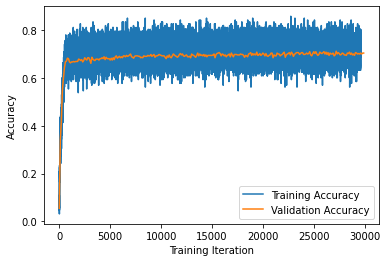

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies)), training_accuracies, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies)))), validation_accuracies, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()